In [1]:
from parcels import ParticleSet
from parcels import JITParticle
from parcels import AdvectionRK4_3D
from parcels import AdvectionRK4
from parcels import Variable
from datetime import timedelta
import numpy as np
from parcels import FieldSet
from glob import glob

In [2]:
## parameters
## set the number of particles
num_particles = 100

## Set the location of the particles
channel_lon_bds = (0,4.5) # use inmutable objects
channel_lat_bds = (0+1,18-1)

## set the tracking time
days = 30
minutes = 20

## record the particles every timestep of
hours=4


In [3]:
# Parameters
num_particles = 1
days = 5400


In [4]:
##prepare the files
path1= '/gxfs_work/geomar/smomw662/FESOM_data/channel_interp'

ufiles = sorted(glob(f"{path1}/u.19*.nc"))
vfiles = sorted(glob(f"{path1}/v.19*.nc"))
wfiles = sorted(glob(f"{path1}/w.19*.nc"))

 
lon_start = np.random.uniform(*channel_lon_bds,size=(num_particles,)) 
lat_start = np.random.uniform(*channel_lat_bds, size=(num_particles,))


In [5]:
## define the fieldset
filenames = {"U": ufiles,
             "V": vfiles,
             "W": wfiles,
            }

variables = {"U": "u",
             "V": "v",
             "W": "w",}

dimensions = {'time': 'time',
              'depth': 'z',
              'lat': 'grid_lat',
              'lon': 'grid_lon'}


In [6]:
fieldset = FieldSet.from_netcdf(
    filenames, 
    variables, 
    dimensions,
    time_periodic=False,
    allow_time_extrapolation=False,    
)


In [7]:
## add the Halo
fieldset.add_constant("halo_west", fieldset.U.grid.lon[0])
fieldset.add_constant("halo_east", fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

def periodicBC(particle,fielset,time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

##check the error
def CheckError(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()

In [8]:
## Time and depth initial conditios
time_origin=np.array([str(fieldset.time_origin)],dtype='datetime64[ns]')
time = np.repeat(time_origin, num_particles)  # Assign the same time to all particles
depth = np.random.uniform(0,4000, size=num_particles)  # Choose random depths

In [9]:
extra_vars = [
    Variable("W", dtype=np.float32),
    Variable("U",dtype=np.float32),
    Variable("V",dtype=np.float32),
]

vel_sampler = JITParticle.add_variables(extra_vars)

In [10]:
"""Kernel to update particle velocity components (U, V, W)."""  
def VEL_sampler(particle, fieldset, time):
    (particle.U, particle.V, particle.W) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]

In [11]:
## initiate pset
pset = ParticleSet(
    fieldset=fieldset,
    pclass=vel_sampler,
    lon = lon_start,
    lat = lat_start,
    depth=depth,
    time=time
) 

In [12]:
rnd=str(np.random.randint(1234))

out_path = '/gxfs_work/geomar/smomw662/FESOMparcels_first/data/' #path to store the particle zarr
out_fn = 'Parcels_run_'+rnd

output_file = pset.ParticleFile(name=out_path+out_fn, 
                                outputdt=timedelta(hours=hours))

In [13]:
## Execute particles
pset.execute(
    [VEL_sampler,AdvectionRK4_3D,periodicBC,CheckError],
    runtime=timedelta(days=days),
    dt=timedelta(minutes=minutes),
    output_file= output_file
)

INFO: Output files are stored in /gxfs_work/geomar/smomw662/FESOMparcels_first/data/Parcels_run_1173.zarr.


  0%|          | 0/466560000.0 [00:00<?, ?it/s]

  0%|          | 0.0/466560000.0 [00:00<?, ?it/s]

  0%|          | 14400.0/466560000.0 [00:00<54:52, 141708.44it/s]

  0%|          | 30000.0/466560000.0 [00:00<58:27, 133008.62it/s]

  0%|          | 58800.0/466560000.0 [00:00<44:44, 173777.46it/s]

  0%|          | 86400.0/466560000.0 [00:00<1:07:29, 115186.26it/s]

  0%|          | 102000.0/466560000.0 [00:01<1:04:34, 120379.49it/s]

  0%|          | 130800.0/466560000.0 [00:01<52:32, 147968.98it/s]  

  0%|          | 159600.0/466560000.0 [00:01<46:23, 167575.53it/s]

  0%|          | 187200.0/466560000.0 [00:01<1:04:49, 119913.85it/s]

  0%|          | 202800.0/466560000.0 [00:01<1:03:04, 123239.19it/s]

  0%|          | 231600.0/466560000.0 [00:01<53:17, 145849.02it/s]  

  0%|          | 259200.0/466560000.0 [00:02<56:53, 136602.50it/s]

  0%|          | 274800.0/466560000.0 [00:02<57:01, 136299.41it/s]

  0%|          | 303600.0/466560000.0 [00:02<50:11, 154833.23it/s]

  0%|          | 332400.0/466560000.0 [00:02<45:33, 170591.78it/s]

  0%|          | 360000.0/466560000.0 [00:02<52:50, 147053.01it/s]

  0%|          | 388800.0/466560000.0 [00:02<47:37, 163150.66it/s]

  0%|          | 417600.0/466560000.0 [00:03<44:15, 175514.77it/s]

  0%|          | 446400.0/466560000.0 [00:03<53:53, 144151.16it/s]

  0%|          | 475200.0/466560000.0 [00:03<48:32, 160049.02it/s]

  0%|          | 504000.0/466560000.0 [00:03<44:56, 172855.91it/s]

  0%|          | 532800.0/466560000.0 [00:03<54:05, 143587.09it/s]

  0%|          | 561600.0/466560000.0 [00:04<48:52, 158923.22it/s]

  0%|          | 590400.0/466560000.0 [00:04<45:22, 171157.13it/s]

  0%|          | 619200.0/466560000.0 [00:04<54:37, 142157.82it/s]

  0%|          | 648000.0/466560000.0 [00:04<49:13, 157751.58it/s]

  0%|          | 676800.0/466560000.0 [00:04<45:28, 170744.33it/s]

  0%|          | 705600.0/466560000.0 [00:05<54:22, 142770.66it/s]

  0%|          | 734400.0/466560000.0 [00:05<49:04, 158192.17it/s]

  0%|          | 763200.0/466560000.0 [00:05<45:46, 169625.64it/s]

  0%|          | 792000.0/466560000.0 [00:05<54:38, 142054.89it/s]

  0%|          | 820800.0/466560000.0 [00:05<49:17, 157461.76it/s]

  0%|          | 849600.0/466560000.0 [00:05<45:40, 169947.38it/s]

  0%|          | 878400.0/466560000.0 [00:06<1:03:33, 122111.67it/s]

  0%|          | 894000.0/466560000.0 [00:06<1:02:48, 123583.64it/s]

  0%|          | 922800.0/466560000.0 [00:06<54:26, 142565.46it/s]  

  0%|          | 950400.0/466560000.0 [00:06<57:52, 134101.01it/s]

  0%|          | 966000.0/466560000.0 [00:06<58:18, 133077.14it/s]

  0%|          | 994800.0/466560000.0 [00:06<50:59, 152193.01it/s]

  0%|          | 1023600.0/466560000.0 [00:07<46:33, 166668.75it/s]

  0%|          | 1051200.0/466560000.0 [00:07<52:20, 148248.34it/s]

  0%|          | 1080000.0/466560000.0 [00:07<47:40, 162708.33it/s]

  0%|          | 1108800.0/466560000.0 [00:07<44:31, 174226.69it/s]

  0%|          | 1137600.0/466560000.0 [00:07<54:30, 142303.83it/s]

  0%|          | 1166400.0/466560000.0 [00:08<49:25, 156918.57it/s]

  0%|          | 1195200.0/466560000.0 [00:08<46:01, 168533.95it/s]

  0%|          | 1224000.0/466560000.0 [00:08<55:58, 138568.97it/s]

  0%|          | 1252800.0/466560000.0 [00:08<51:00, 152012.66it/s]

  0%|          | 1281600.0/466560000.0 [00:08<47:13, 164217.36it/s]

  0%|          | 1310400.0/466560000.0 [00:09<56:27, 137347.32it/s]

  0%|          | 1326000.0/466560000.0 [00:09<57:21, 135179.94it/s]

  0%|          | 1354800.0/466560000.0 [00:09<50:54, 152289.74it/s]

  0%|          | 1382400.0/466560000.0 [00:09<55:57, 138535.47it/s]

  0%|          | 1398000.0/466560000.0 [00:09<56:54, 136219.17it/s]

  0%|          | 1426800.0/466560000.0 [00:09<50:24, 153781.66it/s]

  0%|          | 1455600.0/466560000.0 [00:09<46:16, 167485.52it/s]

  0%|          | 1483200.0/466560000.0 [00:10<52:58, 146327.09it/s]

  0%|          | 1512000.0/466560000.0 [00:15<7:37:22, 16946.00it/s]

  0%|          | 1527600.0/466560000.0 [00:15<6:19:49, 20405.18it/s]

  0%|          | 1555200.0/466560000.0 [00:15<4:35:10, 28164.37it/s]

  0%|          | 1570800.0/466560000.0 [00:29<28:14:36, 4573.24it/s]

  0%|          | 1585200.0/466560000.0 [00:32<27:47:51, 4646.45it/s]

  0%|          | 1614000.0/466560000.0 [00:32<17:21:39, 7439.16it/s]

  0%|          | 1641600.0/466560000.0 [00:32<11:45:05, 10989.52it/s]

  0%|          | 1657200.0/466560000.0 [00:32<9:24:51, 13717.43it/s] 

  0%|          | 1686000.0/466560000.0 [00:33<6:12:49, 20781.53it/s]

  0%|          | 1714800.0/466560000.0 [00:33<4:18:04, 30020.63it/s]

  0%|          | 1742400.0/466560000.0 [00:33<3:16:29, 39427.10it/s]

  0%|          | 1758000.0/466560000.0 [00:33<2:48:44, 45907.46it/s]

  0%|          | 1786800.0/466560000.0 [00:33<2:03:17, 62831.27it/s]

  0%|          | 1814400.0/466560000.0 [00:34<1:44:47, 73913.30it/s]

  0%|          | 1830000.0/466560000.0 [00:36<6:28:59, 19911.97it/s]

  0%|          | 1858800.0/466560000.0 [00:37<4:24:56, 29232.62it/s]

  0%|          | 1887600.0/466560000.0 [00:37<3:08:52, 41003.55it/s]

  0%|          | 1915200.0/466560000.0 [00:37<2:30:00, 51623.52it/s]

  0%|          | 1930800.0/466560000.0 [00:37<2:12:14, 58555.62it/s]

  0%|          | 1959600.0/466560000.0 [00:37<1:39:34, 77757.48it/s]

  0%|          | 1987200.0/466560000.0 [00:37<1:28:35, 87403.66it/s]

  0%|          | 2002800.0/466560000.0 [00:38<1:23:26, 92783.12it/s]

  0%|          | 2031600.0/466560000.0 [00:38<1:07:47, 114197.81it/s]

  0%|          | 2060400.0/466560000.0 [00:38<58:06, 133241.56it/s]  

  0%|          | 2088000.0/466560000.0 [00:38<1:00:48, 127318.31it/s]

  0%|          | 2103600.0/466560000.0 [00:38<1:01:15, 126381.83it/s]

  0%|          | 2132400.0/466560000.0 [00:38<53:31, 144598.94it/s]  

  0%|          | 2160000.0/466560000.0 [00:42<5:55:48, 21753.31it/s]

  0%|          | 2174400.0/466560000.0 [00:45<10:02:01, 12856.19it/s]

  0%|          | 2190000.0/466560000.0 [00:48<13:45:06, 9379.93it/s] 

  0%|          | 2218800.0/466560000.0 [00:48<8:47:32, 14670.19it/s]

  0%|          | 2246400.0/466560000.0 [00:49<6:09:45, 20928.33it/s]

  0%|          | 2262000.0/466560000.0 [00:49<5:03:26, 25501.62it/s]

  0%|          | 2290800.0/466560000.0 [00:49<3:27:35, 37275.43it/s]

  0%|          | 2319600.0/466560000.0 [00:49<2:29:58, 51590.45it/s]

  1%|          | 2347200.0/466560000.0 [00:49<2:03:08, 62827.41it/s]

  1%|          | 2362800.0/466560000.0 [00:49<1:51:25, 69431.11it/s]

  1%|          | 2391600.0/466560000.0 [00:49<1:26:21, 89590.38it/s]

  1%|          | 2419200.0/466560000.0 [00:50<1:19:50, 96878.63it/s]

  1%|          | 2434800.0/466560000.0 [00:50<1:16:25, 101215.57it/s]

  1%|          | 2463600.0/466560000.0 [00:50<1:03:27, 121887.53it/s]

  1%|          | 2492400.0/466560000.0 [00:50<55:32, 139234.86it/s]  

  1%|          | 2520000.0/466560000.0 [00:50<58:51, 131408.56it/s]

  1%|          | 2535600.0/466560000.0 [00:50<59:51, 129189.66it/s]

  1%|          | 2564400.0/466560000.0 [00:51<53:48, 143718.90it/s]

  1%|          | 2592000.0/466560000.0 [00:51<57:53, 133555.24it/s]

  1%|          | 2607600.0/466560000.0 [00:51<59:06, 130810.96it/s]

  1%|          | 2636400.0/466560000.0 [00:51<52:13, 148074.89it/s]

  1%|          | 2665200.0/466560000.0 [00:51<48:02, 160945.49it/s]

  1%|          | 2692800.0/466560000.0 [00:52<53:55, 143367.97it/s]

  1%|          | 2708400.0/466560000.0 [00:52<56:03, 137914.89it/s]

  1%|          | 2737200.0/466560000.0 [00:52<50:28, 153157.37it/s]

  1%|          | 2764800.0/466560000.0 [00:52<55:29, 139300.65it/s]

  1%|          | 2780400.0/466560000.0 [00:52<57:21, 134765.74it/s]

  1%|          | 2809200.0/466560000.0 [00:52<51:14, 150858.83it/s]

  1%|          | 2838000.0/466560000.0 [00:52<47:29, 162761.64it/s]

  1%|          | 2865600.0/466560000.0 [00:56<5:26:28, 23671.64it/s]

  1%|          | 2881200.0/466560000.0 [00:56<4:33:32, 28251.49it/s]

  1%|          | 2910000.0/466560000.0 [00:59<7:40:59, 16762.85it/s]

  1%|          | 2937600.0/466560000.0 [00:59<5:33:51, 23144.13it/s]

  1%|          | 2953200.0/466560000.0 [00:59<4:39:45, 27619.09it/s]

  1%|          | 2982000.0/466560000.0 [01:00<3:15:24, 39537.87it/s]

  1%|          | 3010800.0/466560000.0 [01:00<2:23:36, 53794.87it/s]

  1%|          | 3038400.0/466560000.0 [01:00<1:59:48, 64483.01it/s]

  1%|          | 3054000.0/466560000.0 [01:00<1:49:20, 70645.70it/s]

  1%|          | 3082800.0/466560000.0 [01:00<1:25:38, 90202.40it/s]

  1%|          | 3110400.0/466560000.0 [01:00<1:19:46, 96832.05it/s]

  1%|          | 3126000.0/466560000.0 [01:01<1:17:05, 100186.18it/s]

  1%|          | 3154800.0/466560000.0 [01:01<1:04:20, 120044.78it/s]

  1%|          | 3183600.0/466560000.0 [01:01<56:32, 136606.81it/s]  

  1%|          | 3211200.0/466560000.0 [01:01<59:46, 129182.82it/s]

  1%|          | 3226800.0/466560000.0 [01:01<1:01:13, 126143.06it/s]

  1%|          | 3255600.0/466560000.0 [01:01<54:31, 141602.66it/s]  

  1%|          | 3283200.0/466560000.0 [01:02<58:41, 131565.76it/s]

  1%|          | 3298800.0/466560000.0 [01:02<1:00:49, 126949.87it/s]

  1%|          | 3327600.0/466560000.0 [01:02<53:59, 142977.23it/s]  

  1%|          | 3356400.0/466560000.0 [01:02<49:53, 154722.02it/s]

  1%|          | 3384000.0/466560000.0 [01:02<56:22, 136947.85it/s]

  1%|          | 3399600.0/466560000.0 [01:02<58:41, 131537.05it/s]

  1%|          | 3428400.0/466560000.0 [01:03<52:56, 145793.75it/s]

  1%|          | 3456000.0/466560000.0 [01:03<57:29, 134266.26it/s]

  1%|          | 3471600.0/466560000.0 [01:03<59:39, 129366.35it/s]

  1%|          | 3500400.0/466560000.0 [01:03<53:28, 144324.15it/s]

  1%|          | 3529200.0/466560000.0 [01:03<49:32, 155780.58it/s]

  1%|          | 3556800.0/466560000.0 [01:04<55:14, 139688.28it/s]

  1%|          | 3572400.0/466560000.0 [01:04<58:02, 132929.92it/s]

  1%|          | 3601200.0/466560000.0 [01:04<52:26, 147157.17it/s]

  1%|          | 3628800.0/466560000.0 [01:04<57:27, 134288.06it/s]

  1%|          | 3644400.0/466560000.0 [01:04<1:00:10, 128229.64it/s]

  1%|          | 3673200.0/466560000.0 [01:04<53:52, 143203.25it/s]  

  1%|          | 3702000.0/466560000.0 [01:05<50:03, 154117.20it/s]

  1%|          | 3729600.0/466560000.0 [01:05<55:46, 138304.65it/s]

  1%|          | 3745200.0/466560000.0 [01:05<58:27, 131965.49it/s]

  1%|          | 3774000.0/466560000.0 [01:05<52:54, 145770.28it/s]

  1%|          | 3801600.0/466560000.0 [01:05<57:37, 133836.62it/s]

  1%|          | 3817200.0/466560000.0 [01:05<59:55, 128683.03it/s]

  1%|          | 3844800.0/466560000.0 [01:06<49:21, 156220.22it/s]

  1%|          | 3873600.0/466560000.0 [01:06<47:05, 163775.86it/s]

  1%|          | 3902400.0/466560000.0 [01:06<58:18, 132258.30it/s]

  1%|          | 3918000.0/466560000.0 [01:06<1:00:31, 127381.89it/s]

  1%|          | 3946800.0/466560000.0 [01:06<54:14, 142167.10it/s]  

  1%|          | 3974400.0/466560000.0 [01:07<58:36, 131557.02it/s]

  1%|          | 3990000.0/466560000.0 [01:07<1:00:56, 126489.39it/s]

  1%|          | 4018800.0/466560000.0 [01:07<54:33, 141291.89it/s]  

  1%|          | 4047600.0/466560000.0 [01:07<50:27, 152765.81it/s]

  1%|          | 4075200.0/466560000.0 [01:07<55:47, 138163.52it/s]

  1%|          | 4090800.0/466560000.0 [01:07<58:19, 132161.50it/s]

  1%|          | 4119600.0/466560000.0 [01:08<52:42, 146241.99it/s]

  1%|          | 4147200.0/466560000.0 [01:08<57:30, 134012.23it/s]

  1%|          | 4162800.0/466560000.0 [01:08<1:00:10, 128075.20it/s]

  1%|          | 4190400.0/466560000.0 [01:08<49:07, 156852.77it/s]  

  1%|          | 4219200.0/466560000.0 [01:08<47:11, 163257.19it/s]

  1%|          | 4248000.0/466560000.0 [01:09<58:16, 132218.13it/s]

  1%|          | 4263600.0/466560000.0 [01:12<6:30:13, 19745.18it/s]

  1%|          | 4292400.0/466560000.0 [01:12<4:29:45, 28560.86it/s]

  1%|          | 4320000.0/466560000.0 [01:12<3:25:12, 37542.80it/s]

  1%|          | 4335600.0/466560000.0 [01:13<2:57:16, 43458.09it/s]

  1%|          | 4363200.0/466560000.0 [01:13<2:06:46, 60762.53it/s]

  1%|          | 4392000.0/466560000.0 [01:16<6:03:03, 21216.89it/s]

  1%|          | 4406400.0/466560000.0 [01:22<15:57:07, 8047.63it/s]

  1%|          | 4422000.0/466560000.0 [01:22<12:32:35, 10234.37it/s]

  1%|          | 4449600.0/466560000.0 [01:22<8:05:16, 15870.94it/s] 

  1%|          | 4465200.0/466560000.0 [01:23<6:30:04, 19743.69it/s]

  1%|          | 4492800.0/466560000.0 [01:23<4:31:39, 28348.04it/s]

  1%|          | 4508400.0/466560000.0 [01:23<3:45:31, 34147.06it/s]

  1%|          | 4537200.0/466560000.0 [01:23<2:36:49, 49102.61it/s]

  1%|          | 4566000.0/466560000.0 [01:23<1:57:02, 65788.52it/s]

  1%|          | 4593600.0/466560000.0 [01:26<6:10:37, 20773.85it/s]

  1%|          | 4608000.0/466560000.0 [01:30<10:30:36, 12209.03it/s]

  1%|          | 4622400.0/466560000.0 [01:33<14:24:59, 8900.70it/s] 

  1%|          | 4638000.0/466560000.0 [01:36<17:36:36, 7286.24it/s]

  1%|          | 4665600.0/466560000.0 [01:36<11:12:26, 11448.05it/s]

  1%|          | 4681200.0/466560000.0 [01:37<8:49:14, 14545.18it/s] 

  1%|          | 4710000.0/466560000.0 [01:37<5:41:25, 22545.45it/s]

  1%|          | 4737600.0/466560000.0 [01:37<3:52:56, 33042.68it/s]

  1%|          | 4766400.0/466560000.0 [01:37<3:01:31, 42400.69it/s]

  1%|          | 4782000.0/466560000.0 [01:37<2:38:38, 48512.73it/s]

  1%|          | 4810800.0/466560000.0 [01:37<1:57:42, 65377.87it/s]

  1%|          | 4838400.0/466560000.0 [01:38<1:42:10, 75316.60it/s]

  1%|          | 4854000.0/466560000.0 [01:38<1:35:49, 80309.35it/s]

  1%|          | 4881600.0/466560000.0 [01:38<1:12:27, 106194.25it/s]

  1%|          | 4910400.0/466560000.0 [01:38<1:02:42, 122686.82it/s]

  1%|          | 4939200.0/466560000.0 [01:38<1:09:16, 111059.24it/s]

  1%|          | 4954800.0/466560000.0 [01:39<1:09:52, 110107.21it/s]

  1%|          | 4969200.0/466560000.0 [01:39<1:07:15, 114369.81it/s]

  1%|          | 4996800.0/466560000.0 [01:39<53:12, 144573.41it/s]  

  1%|          | 5025600.0/466560000.0 [01:48<15:04:07, 8507.95it/s]

  1%|          | 5041200.0/466560000.0 [01:48<12:05:52, 10596.96it/s]

  1%|          | 5055600.0/466560000.0 [01:51<15:09:10, 8460.07it/s] 

  1%|          | 5083200.0/466560000.0 [01:51<9:37:44, 13312.58it/s]

  1%|          | 5097600.0/466560000.0 [01:51<7:58:20, 16078.55it/s]

  1%|          | 5113200.0/466560000.0 [01:52<6:15:33, 20478.38it/s]

  1%|          | 5140800.0/466560000.0 [01:52<3:59:58, 32047.40it/s]

  1%|          | 5169600.0/466560000.0 [01:55<7:15:32, 17655.68it/s]

  1%|          | 5184000.0/466560000.0 [01:55<6:10:56, 20730.18it/s]

  1%|          | 5199600.0/466560000.0 [01:55<4:58:19, 25775.30it/s]

  1%|          | 5227200.0/466560000.0 [01:55<3:15:26, 39340.34it/s]

  1%|          | 5242800.0/466560000.0 [01:58<7:53:50, 16226.40it/s]

  1%|          | 5270400.0/466560000.0 [01:58<5:22:24, 23846.30it/s]

  1%|          | 5286000.0/466560000.0 [01:58<4:24:31, 29063.20it/s]

  1%|          | 5313600.0/466560000.0 [01:58<2:57:16, 43365.17it/s]

  1%|          | 5342400.0/466560000.0 [01:58<2:09:59, 59132.66it/s]

  1%|          | 5371200.0/466560000.0 [02:08<15:40:12, 8175.35it/s]

  1%|          | 5385600.0/466560000.0 [02:08<12:59:53, 9855.58it/s]

  1%|          | 5400000.0/466560000.0 [02:11<16:01:39, 7992.45it/s]

  1%|          | 5415600.0/466560000.0 [02:11<12:18:37, 10405.55it/s]

  1%|          | 5443200.0/466560000.0 [02:12<7:58:04, 16075.53it/s] 

  1%|          | 5458800.0/466560000.0 [02:12<6:21:17, 20155.54it/s]

  1%|          | 5473200.0/466560000.0 [02:18<17:38:26, 7260.44it/s]

  1%|          | 5500800.0/466560000.0 [02:18<10:50:35, 11811.23it/s]

  1%|          | 5516400.0/466560000.0 [02:18<8:31:02, 15036.15it/s] 

  1%|          | 5529600.0/466560000.0 [02:18<6:56:31, 18447.38it/s]

  1%|          | 5545200.0/466560000.0 [02:18<5:22:04, 23856.13it/s]

  1%|          | 5572800.0/466560000.0 [02:18<3:21:18, 38164.41it/s]

  1%|          | 5588400.0/466560000.0 [02:19<2:49:26, 45340.27it/s]

  1%|          | 5616000.0/466560000.0 [02:19<2:10:27, 58884.17it/s]

  1%|          | 5631600.0/466560000.0 [02:19<1:57:29, 65383.30it/s]

  1%|          | 5659200.0/466560000.0 [02:19<1:24:18, 91111.21it/s]

  1%|          | 5688000.0/466560000.0 [02:19<1:10:31, 108922.74it/s]

  1%|          | 5716800.0/466560000.0 [02:20<1:15:05, 102290.38it/s]

  1%|          | 5732400.0/466560000.0 [02:20<1:15:07, 102239.53it/s]

  1%|          | 5760000.0/466560000.0 [02:20<59:12, 129711.41it/s]  

  1%|          | 5788800.0/466560000.0 [02:20<1:07:38, 113528.63it/s]

  1%|          | 5804400.0/466560000.0 [02:29<15:31:58, 8239.72it/s] 

  1%|          | 5818800.0/466560000.0 [02:32<18:00:43, 7105.38it/s]

  1%|▏         | 5846400.0/466560000.0 [02:32<11:31:32, 11103.63it/s]

  1%|▏         | 5862000.0/466560000.0 [02:32<9:09:46, 13966.12it/s] 

  1%|▏         | 5875200.0/466560000.0 [02:32<7:30:45, 17033.61it/s]

  1%|▏         | 5890800.0/466560000.0 [02:32<5:49:57, 21939.58it/s]

  1%|▏         | 5918400.0/466560000.0 [02:32<3:40:05, 34883.16it/s]

  1%|▏         | 5934000.0/466560000.0 [02:33<3:04:45, 41550.27it/s]

  1%|▏         | 5961600.0/466560000.0 [02:33<2:20:30, 54634.06it/s]

  1%|▏         | 5977200.0/466560000.0 [02:33<2:05:24, 61211.81it/s]

  1%|▏         | 6004800.0/466560000.0 [02:33<1:29:26, 85819.27it/s]

  1%|▏         | 6033600.0/466560000.0 [02:33<1:13:55, 103818.45it/s]

  1%|▏         | 6062400.0/466560000.0 [02:34<1:19:55, 96022.79it/s] 

  1%|▏         | 6078000.0/466560000.0 [02:34<1:19:21, 96701.99it/s]

  1%|▏         | 6105600.0/466560000.0 [02:34<1:02:16, 123243.34it/s]

  1%|▏         | 6134400.0/466560000.0 [02:34<1:09:52, 109810.58it/s]

  1%|▏         | 6150000.0/466560000.0 [02:34<1:11:15, 107681.63it/s]

  1%|▏         | 6177600.0/466560000.0 [02:35<56:50, 134998.78it/s]  

  1%|▏         | 6206400.0/466560000.0 [02:35<53:09, 144330.50it/s]

  1%|▏         | 6235200.0/466560000.0 [02:36<3:13:44, 39600.96it/s]

  1%|▏         | 6250800.0/466560000.0 [02:37<2:50:03, 45113.42it/s]

  1%|▏         | 6278400.0/466560000.0 [02:37<2:02:26, 62656.84it/s]

  1%|▏         | 6307200.0/466560000.0 [02:37<1:49:22, 70128.42it/s]

  1%|▏         | 6322800.0/466560000.0 [02:37<1:42:21, 74937.09it/s]

  1%|▏         | 6337200.0/466560000.0 [02:40<6:41:51, 19087.46it/s]

  1%|▏         | 6364800.0/466560000.0 [02:40<4:25:40, 28870.27it/s]

  1%|▏         | 6380400.0/466560000.0 [02:40<3:41:54, 34562.92it/s]

  1%|▏         | 6393600.0/466560000.0 [02:40<3:14:08, 39503.68it/s]

  1%|▏         | 6409200.0/466560000.0 [02:44<9:28:06, 13499.43it/s]

  1%|▏         | 6436800.0/466560000.0 [02:44<5:50:20, 21889.44it/s]

  1%|▏         | 6452400.0/466560000.0 [02:48<11:50:13, 10797.10it/s]

  1%|▏         | 6480000.0/466560000.0 [02:48<7:44:31, 16507.07it/s] 

  1%|▏         | 6495600.0/466560000.0 [02:48<6:13:11, 20546.44it/s]

  1%|▏         | 6523200.0/466560000.0 [02:48<4:04:34, 31349.09it/s]

  1%|▏         | 6538800.0/466560000.0 [02:51<9:02:05, 14143.44it/s]

  1%|▏         | 6566400.0/466560000.0 [02:51<6:07:11, 20878.50it/s]

  1%|▏         | 6580800.0/466560000.0 [02:54<10:42:16, 11936.25it/s]

  1%|▏         | 6596400.0/466560000.0 [02:55<8:20:49, 15306.78it/s] 

  1%|▏         | 6610800.0/466560000.0 [02:58<12:40:29, 10080.01it/s]

  1%|▏         | 6638400.0/466560000.0 [02:58<7:44:48, 16491.44it/s] 

  1%|▏         | 6652800.0/466560000.0 [02:58<6:25:21, 19890.59it/s]

  1%|▏         | 6668400.0/466560000.0 [03:01<11:08:17, 11469.33it/s]

  1%|▏         | 6682800.0/466560000.0 [03:04<15:05:40, 8462.80it/s] 

  1%|▏         | 6710400.0/466560000.0 [03:04<9:03:18, 14106.31it/s]

  1%|▏         | 6726000.0/466560000.0 [03:04<7:06:50, 17954.88it/s]

  1%|▏         | 6739200.0/466560000.0 [03:04<5:50:14, 21881.12it/s]

  1%|▏         | 6753600.0/466560000.0 [03:07<10:40:49, 11958.80it/s]

  1%|▏         | 6769200.0/466560000.0 [03:11<16:37:52, 7679.53it/s] 

  1%|▏         | 6783600.0/466560000.0 [03:11<12:15:39, 10416.50it/s]

  1%|▏         | 6798000.0/466560000.0 [03:14<17:39:18, 7233.73it/s] 

  1%|▏         | 6812400.0/466560000.0 [03:18<21:53:27, 5833.82it/s]

  1%|▏         | 6825600.0/466560000.0 [03:18<16:18:57, 7826.88it/s]

  1%|▏         | 6841200.0/466560000.0 [03:21<18:30:02, 6902.41it/s]

  1%|▏         | 6868800.0/466560000.0 [03:21<10:29:52, 12163.71it/s]

  1%|▏         | 6884400.0/466560000.0 [03:21<8:04:00, 15829.00it/s] 

  1%|▏         | 6912000.0/466560000.0 [03:22<5:17:57, 24093.96it/s]

  1%|▏         | 6927600.0/466560000.0 [03:25<10:04:40, 12668.85it/s]

  1%|▏         | 6942000.0/466560000.0 [03:27<13:28:58, 9469.16it/s] 

  1%|▏         | 6969600.0/466560000.0 [03:27<8:17:25, 15399.13it/s]

  1%|▏         | 6985200.0/466560000.0 [03:28<6:35:15, 19378.74it/s]

  2%|▏         | 6998400.0/466560000.0 [03:28<5:26:34, 23453.53it/s]

  2%|▏         | 7014000.0/466560000.0 [03:28<4:17:38, 29727.92it/s]

  2%|▏         | 7041600.0/466560000.0 [03:28<2:43:39, 46794.73it/s]

  2%|▏         | 7057200.0/466560000.0 [03:28<2:22:21, 53799.61it/s]

  2%|▏         | 7084800.0/466560000.0 [03:28<1:54:41, 66766.66it/s]

  2%|▏         | 7100400.0/466560000.0 [03:29<1:46:40, 71784.74it/s]

  2%|▏         | 7114800.0/466560000.0 [03:29<1:35:44, 79982.62it/s]

  2%|▏         | 7142400.0/466560000.0 [03:29<1:09:56, 109466.76it/s]

  2%|▏         | 7171200.0/466560000.0 [03:29<1:25:02, 90030.71it/s] 

  2%|▏         | 7186800.0/466560000.0 [03:29<1:23:49, 91332.94it/s]

  2%|▏         | 7214400.0/466560000.0 [03:29<1:04:33, 118572.72it/s]

  2%|▏         | 7243200.0/466560000.0 [03:30<58:50, 130096.80it/s]  

  2%|▏         | 7272000.0/466560000.0 [03:30<1:08:04, 112449.06it/s]

  2%|▏         | 7287600.0/466560000.0 [03:30<1:10:29, 108600.58it/s]

  2%|▏         | 7315200.0/466560000.0 [03:30<56:51, 134633.54it/s]  

  2%|▏         | 7344000.0/466560000.0 [03:31<1:08:10, 112271.42it/s]

  2%|▏         | 7359600.0/466560000.0 [03:31<1:10:44, 108190.32it/s]

  2%|▏         | 7387200.0/466560000.0 [03:31<56:55, 134438.88it/s]  

  2%|▏         | 7416000.0/466560000.0 [03:31<54:01, 141638.09it/s]

  2%|▏         | 7444800.0/466560000.0 [03:31<1:04:41, 118281.86it/s]

  2%|▏         | 7460400.0/466560000.0 [03:32<1:07:54, 112667.96it/s]

  2%|▏         | 7488000.0/466560000.0 [03:32<55:19, 138315.31it/s]  

  2%|▏         | 7516800.0/466560000.0 [03:32<1:05:40, 116492.66it/s]

  2%|▏         | 7532400.0/466560000.0 [03:32<1:08:48, 111189.62it/s]

  2%|▏         | 7560000.0/466560000.0 [03:32<55:48, 137096.14it/s]  

  2%|▏         | 7588800.0/466560000.0 [03:32<53:22, 143309.68it/s]

  2%|▏         | 7617600.0/466560000.0 [03:33<1:04:59, 117685.27it/s]

  2%|▏         | 7633200.0/466560000.0 [03:33<1:08:06, 112312.12it/s]

  2%|▏         | 7660800.0/466560000.0 [03:33<55:26, 137943.26it/s]  

  2%|▏         | 7689600.0/466560000.0 [03:33<1:05:52, 116104.39it/s]

  2%|▏         | 7704000.0/466560000.0 [03:37<6:22:21, 20001.11it/s] 

  2%|▏         | 7719600.0/466560000.0 [03:37<5:13:54, 24361.37it/s]

  2%|▏         | 7747200.0/466560000.0 [03:37<3:29:37, 36478.35it/s]

  2%|▏         | 7762800.0/466560000.0 [03:37<2:59:48, 42525.01it/s]

  2%|▏         | 7776000.0/466560000.0 [03:37<2:41:03, 47475.57it/s]

  2%|▏         | 7791600.0/466560000.0 [03:37<2:19:21, 54869.14it/s]

  2%|▏         | 7819200.0/466560000.0 [03:37<1:35:20, 80187.46it/s]

  2%|▏         | 7834800.0/466560000.0 [03:41<8:58:37, 14194.34it/s]

  2%|▏         | 7849200.0/466560000.0 [03:44<13:19:20, 9564.43it/s]

  2%|▏         | 7862400.0/466560000.0 [03:45<10:27:58, 12174.05it/s]

  2%|▏         | 7878000.0/466560000.0 [03:48<15:04:37, 8450.62it/s] 

  2%|▏         | 7892400.0/466560000.0 [03:54<26:40:11, 4777.21it/s]

  2%|▏         | 7920000.0/466560000.0 [03:54<15:23:36, 8276.19it/s]

  2%|▏         | 7935600.0/466560000.0 [03:54<11:46:10, 10824.17it/s]

  2%|▏         | 7948800.0/466560000.0 [03:55<9:20:14, 13643.38it/s] 

  2%|▏         | 7964400.0/466560000.0 [03:55<7:03:24, 18052.07it/s]

  2%|▏         | 7992000.0/466560000.0 [03:55<4:18:39, 29548.14it/s]

  2%|▏         | 8007600.0/466560000.0 [03:55<3:33:55, 35724.16it/s]

  2%|▏         | 8035200.0/466560000.0 [03:55<2:38:01, 48357.82it/s]

  2%|▏         | 8050800.0/466560000.0 [03:55<2:19:57, 54601.80it/s]

  2%|▏         | 8078400.0/466560000.0 [03:56<1:38:54, 77253.57it/s]

  2%|▏         | 8094000.0/466560000.0 [03:56<1:35:03, 80382.22it/s]

  2%|▏         | 8121600.0/466560000.0 [03:56<1:25:51, 88994.31it/s]

  2%|▏         | 8137200.0/466560000.0 [03:56<1:24:58, 89911.81it/s]

  2%|▏         | 8164800.0/466560000.0 [03:56<1:05:04, 117408.15it/s]

  2%|▏         | 8180400.0/466560000.0 [03:56<1:08:56, 110826.61it/s]

  2%|▏         | 8208000.0/466560000.0 [03:57<1:09:49, 109396.16it/s]

  2%|▏         | 8223600.0/466560000.0 [03:57<1:13:09, 104422.52it/s]

  2%|▏         | 8251200.0/466560000.0 [03:57<57:50, 132042.26it/s]  

  2%|▏         | 8266800.0/466560000.0 [03:57<1:03:42, 119903.52it/s]

  2%|▏         | 8294400.0/466560000.0 [03:57<1:06:26, 114949.83it/s]

  2%|▏         | 8310000.0/466560000.0 [03:58<1:10:09, 108854.70it/s]

  2%|▏         | 8324400.0/466560000.0 [03:58<1:07:41, 112813.59it/s]

  2%|▏         | 8352000.0/466560000.0 [03:58<53:22, 143084.05it/s]  

  2%|▏         | 8380800.0/466560000.0 [03:58<1:05:40, 116279.15it/s]

  2%|▏         | 8396400.0/466560000.0 [03:58<1:09:22, 110081.55it/s]

  2%|▏         | 8424000.0/466560000.0 [03:58<55:50, 136731.30it/s]  

  2%|▏         | 8452800.0/466560000.0 [04:04<9:38:50, 13190.23it/s]

  2%|▏         | 8467200.0/466560000.0 [04:05<8:08:40, 15623.49it/s]

  2%|▏         | 8481600.0/466560000.0 [04:07<12:00:13, 10600.28it/s]

  2%|▏         | 8497200.0/466560000.0 [04:08<9:18:35, 13667.06it/s] 

  2%|▏         | 8524800.0/466560000.0 [04:08<5:52:02, 21685.17it/s]

  2%|▏         | 8540400.0/466560000.0 [04:08<4:47:27, 26555.19it/s]

  2%|▏         | 8553600.0/466560000.0 [04:08<4:03:41, 31325.16it/s]

  2%|▏         | 8569200.0/466560000.0 [04:08<3:19:54, 38184.54it/s]

  2%|▏         | 8596800.0/466560000.0 [04:08<2:10:53, 58309.74it/s]

  2%|▏         | 8612400.0/466560000.0 [04:09<1:59:13, 64020.06it/s]

  2%|▏         | 8640000.0/466560000.0 [04:09<1:41:25, 75248.86it/s]

  2%|▏         | 8655600.0/466560000.0 [04:09<1:37:23, 78356.83it/s]

  2%|▏         | 8683200.0/466560000.0 [04:09<1:12:40, 105008.85it/s]

  2%|▏         | 8698800.0/466560000.0 [04:09<1:15:30, 101068.15it/s]

  2%|▏         | 8726400.0/466560000.0 [04:10<1:13:52, 103287.40it/s]

  2%|▏         | 8742000.0/466560000.0 [04:13<6:35:08, 19310.46it/s] 

  2%|▏         | 8756400.0/466560000.0 [04:13<5:17:02, 24066.46it/s]

  2%|▏         | 8784000.0/466560000.0 [04:13<3:26:02, 37028.72it/s]

  2%|▏         | 8799600.0/466560000.0 [04:13<2:56:55, 43122.50it/s]

  2%|▏         | 8812800.0/466560000.0 [04:13<2:38:04, 48262.86it/s]

  2%|▏         | 8828400.0/466560000.0 [04:13<2:17:36, 55439.49it/s]

  2%|▏         | 8856000.0/466560000.0 [04:13<1:34:15, 80936.91it/s]

  2%|▏         | 8871600.0/466560000.0 [04:14<1:31:35, 83284.68it/s]

  2%|▏         | 8899200.0/466560000.0 [04:14<1:23:50, 90979.38it/s]

  2%|▏         | 8914800.0/466560000.0 [04:17<6:43:52, 18885.87it/s]

  2%|▏         | 8942400.0/466560000.0 [04:17<4:24:05, 28880.06it/s]

  2%|▏         | 8956800.0/466560000.0 [04:23<15:10:22, 8377.63it/s]

  2%|▏         | 8972400.0/466560000.0 [04:23<11:41:39, 10869.20it/s]

  2%|▏         | 8985600.0/466560000.0 [04:23<9:19:19, 13634.69it/s] 

  2%|▏         | 9001200.0/466560000.0 [04:29<20:49:01, 6105.55it/s]

  2%|▏         | 9028800.0/466560000.0 [04:30<12:21:17, 10286.86it/s]

  2%|▏         | 9044400.0/466560000.0 [04:30<9:37:55, 13194.22it/s] 

  2%|▏         | 9072000.0/466560000.0 [04:30<6:20:49, 20022.18it/s]

  2%|▏         | 9087600.0/466560000.0 [04:30<5:10:07, 24585.03it/s]

  2%|▏         | 9115200.0/466560000.0 [04:30<3:25:16, 37140.45it/s]

  2%|▏         | 9130800.0/466560000.0 [04:30<2:57:25, 42969.51it/s]

  2%|▏         | 9158400.0/466560000.0 [04:31<2:18:13, 55149.75it/s]

  2%|▏         | 9174000.0/466560000.0 [04:31<2:06:04, 60464.33it/s]

  2%|▏         | 9201600.0/466560000.0 [04:31<1:31:31, 83281.77it/s]

  2%|▏         | 9217200.0/466560000.0 [04:31<1:30:09, 84541.41it/s]

  2%|▏         | 9244800.0/466560000.0 [04:31<1:23:28, 91299.84it/s]

  2%|▏         | 9260400.0/466560000.0 [04:32<1:23:49, 90928.54it/s]

  2%|▏         | 9288000.0/466560000.0 [04:32<1:04:55, 117390.49it/s]

  2%|▏         | 9303600.0/466560000.0 [04:32<1:09:21, 109868.45it/s]

  2%|▏         | 9331200.0/466560000.0 [04:32<1:10:06, 108694.68it/s]

  2%|▏         | 9346800.0/466560000.0 [04:32<1:14:43, 101978.97it/s]

  2%|▏         | 9361200.0/466560000.0 [04:32<1:09:48, 109167.23it/s]

  2%|▏         | 9388800.0/466560000.0 [04:33<55:11, 138074.10it/s]  

  2%|▏         | 9417600.0/466560000.0 [04:47<24:26:15, 5196.23it/s]

  2%|▏         | 9432000.0/466560000.0 [04:47<19:34:57, 6484.31it/s]

  2%|▏         | 9447600.0/466560000.0 [04:50<20:49:58, 6094.92it/s]

  2%|▏         | 9462000.0/466560000.0 [04:53<21:59:19, 5774.42it/s]

  2%|▏         | 9489600.0/466560000.0 [04:53<13:25:22, 9458.82it/s]

  2%|▏         | 9504000.0/466560000.0 [04:57<17:21:32, 7313.82it/s]

  2%|▏         | 9519600.0/466560000.0 [04:57<13:11:13, 9627.22it/s]

  2%|▏         | 9534000.0/466560000.0 [05:00<17:06:52, 7417.71it/s]

  2%|▏         | 9548400.0/466560000.0 [05:04<20:07:49, 6306.28it/s]

  2%|▏         | 9562800.0/466560000.0 [05:04<14:47:56, 8577.78it/s]

  2%|▏         | 9577200.0/466560000.0 [05:04<10:51:08, 11696.83it/s]

  2%|▏         | 9590400.0/466560000.0 [05:04<8:50:19, 14361.53it/s] 

  2%|▏         | 9604800.0/466560000.0 [05:04<6:29:41, 19543.54it/s]

  2%|▏         | 9620400.0/466560000.0 [05:04<4:54:25, 25866.35it/s]

  2%|▏         | 9648000.0/466560000.0 [05:05<2:58:18, 42708.57it/s]

  2%|▏         | 9663600.0/466560000.0 [05:05<2:34:09, 49397.31it/s]

  2%|▏         | 9676800.0/466560000.0 [05:05<2:38:17, 48103.77it/s]

  2%|▏         | 9692400.0/466560000.0 [05:05<2:17:34, 55350.69it/s]

  2%|▏         | 9720000.0/466560000.0 [05:05<1:32:59, 81875.15it/s]

  2%|▏         | 9735600.0/466560000.0 [05:05<1:31:20, 83347.86it/s]

  2%|▏         | 9763200.0/466560000.0 [05:06<1:23:42, 90952.89it/s]

  2%|▏         | 9778800.0/466560000.0 [05:06<1:24:25, 90167.81it/s]

  2%|▏         | 9793200.0/466560000.0 [05:09<8:09:54, 15539.43it/s]

  2%|▏         | 9807600.0/466560000.0 [05:12<12:58:44, 9775.39it/s]

  2%|▏         | 9822000.0/466560000.0 [05:12<9:44:48, 13016.88it/s]

  2%|▏         | 9836400.0/466560000.0 [05:13<7:17:51, 17384.56it/s]

  2%|▏         | 9849600.0/466560000.0 [05:13<5:46:06, 21992.42it/s]

  2%|▏         | 9864000.0/466560000.0 [05:13<4:20:16, 29245.03it/s]

  2%|▏         | 9879600.0/466560000.0 [05:13<3:26:09, 36920.48it/s]

  2%|▏         | 9907200.0/466560000.0 [05:13<2:09:23, 58822.86it/s]

  2%|▏         | 9921600.0/466560000.0 [05:16<8:18:53, 15255.21it/s]

  2%|▏         | 9936000.0/466560000.0 [05:16<6:47:34, 18672.28it/s]

  2%|▏         | 9950400.0/466560000.0 [05:17<5:11:30, 24430.19it/s]

  2%|▏         | 9964800.0/466560000.0 [05:17<3:59:13, 31811.53it/s]

  2%|▏         | 9979200.0/466560000.0 [05:20<11:12:15, 11319.46it/s]

  2%|▏         | 9993600.0/466560000.0 [05:20<8:15:40, 15351.68it/s] 

  2%|▏         | 10009200.0/466560000.0 [05:20<6:09:19, 20603.36it/s]

  2%|▏         | 10022400.0/466560000.0 [05:20<4:54:07, 25869.85it/s]

  2%|▏         | 10036800.0/466560000.0 [05:21<3:42:26, 34206.06it/s]

  2%|▏         | 10052400.0/466560000.0 [05:21<3:00:01, 42263.10it/s]

  2%|▏         | 10066800.0/466560000.0 [05:21<2:22:40, 53324.01it/s]

  2%|▏         | 10094400.0/466560000.0 [05:21<1:33:29, 81379.44it/s]

  2%|▏         | 10110000.0/466560000.0 [05:24<7:40:21, 16525.01it/s]

  2%|▏         | 10124400.0/466560000.0 [05:24<5:55:10, 21417.85it/s]

  2%|▏         | 10138800.0/466560000.0 [05:24<4:34:01, 27760.69it/s]

  2%|▏         | 10153200.0/466560000.0 [05:24<3:32:36, 35778.96it/s]

  2%|▏         | 10167600.0/466560000.0 [05:24<2:47:18, 45465.52it/s]

  2%|▏         | 10195200.0/466560000.0 [05:25<2:05:26, 60635.77it/s]

  2%|▏         | 10209600.0/466560000.0 [05:25<1:50:17, 68964.30it/s]

  2%|▏         | 10224000.0/466560000.0 [05:25<1:35:21, 79754.45it/s]

  2%|▏         | 10238400.0/466560000.0 [05:25<1:23:56, 90608.45it/s]

  2%|▏         | 10252800.0/466560000.0 [05:25<1:15:24, 100842.36it/s]

  2%|▏         | 10267200.0/466560000.0 [05:25<1:09:15, 109800.95it/s]

  2%|▏         | 10281600.0/466560000.0 [05:25<1:26:28, 87935.03it/s] 

  2%|▏         | 10296000.0/466560000.0 [05:26<1:16:58, 98795.85it/s]

  2%|▏         | 10311600.0/466560000.0 [05:26<1:20:38, 94292.77it/s]

  2%|▏         | 10326000.0/466560000.0 [05:26<1:12:46, 104491.76it/s]

  2%|▏         | 10353600.0/466560000.0 [05:26<54:56, 138400.89it/s]  

  2%|▏         | 10369200.0/466560000.0 [05:26<1:22:10, 92526.05it/s]

  2%|▏         | 10383600.0/466560000.0 [05:30<8:52:17, 14283.23it/s]

  2%|▏         | 10398000.0/466560000.0 [05:37<24:18:35, 5212.34it/s]

  2%|▏         | 10412400.0/466560000.0 [05:37<17:48:12, 7117.05it/s]

  2%|▏         | 10440000.0/466560000.0 [05:37<10:20:39, 12248.35it/s]

  2%|▏         | 10454400.0/466560000.0 [05:43<20:32:26, 6168.01it/s] 

  2%|▏         | 10468800.0/466560000.0 [05:44<15:45:42, 8037.98it/s]

  2%|▏         | 10483200.0/466560000.0 [05:44<11:45:32, 10773.79it/s]

  2%|▏         | 10497600.0/466560000.0 [05:44<8:44:17, 14497.81it/s] 

  2%|▏         | 10512000.0/466560000.0 [05:44<6:30:27, 19465.96it/s]

  2%|▏         | 10526400.0/466560000.0 [05:44<4:53:14, 25919.64it/s]

  2%|▏         | 10540800.0/466560000.0 [05:44<4:04:42, 31059.64it/s]

  2%|▏         | 10555200.0/466560000.0 [05:47<10:53:00, 11638.47it/s]

  2%|▏         | 10569600.0/466560000.0 [05:50<15:27:41, 8192.20it/s] 

  2%|▏         | 10584000.0/466560000.0 [05:50<11:10:57, 11326.61it/s]

  2%|▏         | 10598400.0/466560000.0 [05:51<8:07:14, 15596.55it/s] 

  2%|▏         | 10612800.0/466560000.0 [05:51<5:57:58, 21227.61it/s]

  2%|▏         | 10627200.0/466560000.0 [05:51<4:49:29, 26249.47it/s]

  2%|▏         | 10641600.0/466560000.0 [05:51<3:38:59, 34697.27it/s]

  2%|▏         | 10656000.0/466560000.0 [05:51<2:49:30, 44826.67it/s]

  2%|▏         | 10670400.0/466560000.0 [05:51<2:14:48, 56364.72it/s]

  2%|▏         | 10684800.0/466560000.0 [05:51<1:50:35, 68700.59it/s]

  2%|▏         | 10699200.0/466560000.0 [05:51<1:33:34, 81189.61it/s]

  2%|▏         | 10713600.0/466560000.0 [05:52<1:44:42, 72558.49it/s]

  2%|▏         | 10728000.0/466560000.0 [05:52<1:30:34, 83875.85it/s]

  2%|▏         | 10742400.0/466560000.0 [05:52<1:21:05, 93679.00it/s]

  2%|▏         | 10756800.0/466560000.0 [05:52<1:13:19, 103603.00it/s]

  2%|▏         | 10771200.0/466560000.0 [05:52<1:07:40, 112257.98it/s]

  2%|▏         | 10785600.0/466560000.0 [05:52<1:04:10, 118379.47it/s]

  2%|▏         | 10800000.0/466560000.0 [05:52<1:24:36, 89785.08it/s] 

  2%|▏         | 10814400.0/466560000.0 [05:53<1:15:51, 100124.48it/s]

  2%|▏         | 10828800.0/466560000.0 [05:53<1:09:28, 109319.02it/s]

  2%|▏         | 10843200.0/466560000.0 [05:53<1:04:59, 116868.26it/s]

  2%|▏         | 10857600.0/466560000.0 [05:56<9:24:41, 13449.83it/s] 

  2%|▏         | 10872000.0/466560000.0 [06:03<26:04:04, 4855.77it/s]

  2%|▏         | 10886400.0/466560000.0 [06:04<18:53:32, 6699.86it/s]

  2%|▏         | 10900800.0/466560000.0 [06:07<20:49:14, 6079.11it/s]

  2%|▏         | 10915200.0/466560000.0 [06:07<14:50:53, 8524.21it/s]

  2%|▏         | 10929600.0/466560000.0 [06:07<10:42:43, 11814.99it/s]

  2%|▏         | 10944000.0/466560000.0 [06:07<7:46:27, 16279.00it/s] 

  2%|▏         | 10958400.0/466560000.0 [06:07<5:42:57, 22140.84it/s]

  2%|▏         | 10972800.0/466560000.0 [06:07<4:38:48, 27234.08it/s]

  2%|▏         | 10987200.0/466560000.0 [06:07<3:31:34, 35886.50it/s]

  2%|▏         | 11001600.0/466560000.0 [06:07<2:44:22, 46190.84it/s]

  2%|▏         | 11016000.0/466560000.0 [06:08<2:11:34, 57700.79it/s]

  2%|▏         | 11030400.0/466560000.0 [06:08<1:48:29, 69979.21it/s]

  2%|▏         | 11044800.0/466560000.0 [06:08<1:32:18, 82238.80it/s]

  2%|▏         | 11059200.0/466560000.0 [06:08<1:43:45, 73169.09it/s]

  2%|▏         | 11073600.0/466560000.0 [06:08<1:29:13, 85077.86it/s]

  2%|▏         | 11088000.0/466560000.0 [06:08<1:18:48, 96327.80it/s]

  2%|▏         | 11102400.0/466560000.0 [06:08<1:11:46, 105755.43it/s]

  2%|▏         | 11116800.0/466560000.0 [06:08<1:06:43, 113749.50it/s]

  2%|▏         | 11131200.0/466560000.0 [06:09<1:03:12, 120073.88it/s]

  2%|▏         | 11145600.0/466560000.0 [06:09<1:23:40, 90705.00it/s] 

  2%|▏         | 11160000.0/466560000.0 [06:09<1:15:10, 100961.70it/s]

  2%|▏         | 11174400.0/466560000.0 [06:09<1:09:03, 109899.15it/s]

  2%|▏         | 11188800.0/466560000.0 [06:09<1:04:49, 117066.01it/s]

  2%|▏         | 11203200.0/466560000.0 [06:09<1:02:01, 122363.93it/s]

  2%|▏         | 11217600.0/466560000.0 [06:09<59:49, 126859.86it/s]  

  2%|▏         | 11232000.0/466560000.0 [06:10<1:20:57, 93743.26it/s]

  2%|▏         | 11246400.0/466560000.0 [06:10<1:13:09, 103733.20it/s]

  2%|▏         | 11260800.0/466560000.0 [06:10<1:07:39, 112162.03it/s]

  2%|▏         | 11275200.0/466560000.0 [06:10<1:03:58, 118620.31it/s]

  2%|▏         | 11289600.0/466560000.0 [06:10<1:01:14, 123912.06it/s]

  2%|▏         | 11304000.0/466560000.0 [06:10<59:27, 127614.07it/s]  

  2%|▏         | 11318400.0/466560000.0 [06:16<16:17:51, 7759.18it/s]

  2%|▏         | 11332800.0/466560000.0 [06:16<11:41:15, 10819.21it/s]

  2%|▏         | 11347200.0/466560000.0 [06:16<8:27:22, 14953.25it/s] 

  2%|▏         | 11361600.0/466560000.0 [06:19<13:31:56, 9343.86it/s]

  2%|▏         | 11376000.0/466560000.0 [06:19<9:45:08, 12965.14it/s]

  2%|▏         | 11390400.0/466560000.0 [06:19<7:06:37, 17782.04it/s]

  2%|▏         | 11404800.0/466560000.0 [06:20<5:37:34, 22471.94it/s]

  2%|▏         | 11419200.0/466560000.0 [06:23<11:56:24, 10588.58it/s]

  2%|▏         | 11433600.0/466560000.0 [06:23<8:41:15, 14552.32it/s] 

  2%|▏         | 11448000.0/466560000.0 [06:26<13:54:51, 9085.70it/s]

  2%|▏         | 11462400.0/466560000.0 [06:29<19:19:31, 6541.47it/s]

  2%|▏         | 11476800.0/466560000.0 [06:29<13:48:22, 9156.14it/s]

  2%|▏         | 11491200.0/466560000.0 [06:30<10:19:00, 12252.60it/s]

  2%|▏         | 11505600.0/466560000.0 [06:30<7:30:06, 16849.66it/s] 

  2%|▏         | 11520000.0/466560000.0 [06:30<5:31:45, 22859.89it/s]

  2%|▏         | 11534400.0/466560000.0 [06:30<4:09:01, 30454.61it/s]

  2%|▏         | 11548800.0/466560000.0 [06:30<3:11:06, 39683.51it/s]

  2%|▏         | 11563200.0/466560000.0 [06:30<2:30:35, 50358.32it/s]

  2%|▏         | 11577600.0/466560000.0 [06:30<2:24:40, 52411.32it/s]

  2%|▏         | 11592000.0/466560000.0 [06:31<1:58:03, 64227.46it/s]

  2%|▏         | 11606400.0/466560000.0 [06:31<1:39:24, 76279.13it/s]

  2%|▏         | 11620800.0/466560000.0 [06:34<8:55:02, 14171.60it/s]

  2%|▏         | 11635200.0/466560000.0 [06:34<6:31:13, 19380.77it/s]

  2%|▏         | 11649600.0/466560000.0 [06:34<4:50:30, 26098.94it/s]

  2%|▎         | 11664000.0/466560000.0 [06:34<4:22:31, 28879.23it/s]

  3%|▎         | 11678400.0/466560000.0 [06:40<18:40:07, 6768.28it/s]

  3%|▎         | 11692800.0/466560000.0 [06:40<13:21:02, 9464.16it/s]

  3%|▎         | 11707200.0/466560000.0 [06:47<26:09:23, 4830.46it/s]

  3%|▎         | 11721600.0/466560000.0 [06:49<25:51:49, 4884.99it/s]

  3%|▎         | 11736000.0/466560000.0 [06:50<18:23:01, 6872.32it/s]

  3%|▎         | 11750400.0/466560000.0 [06:50<13:31:23, 9342.24it/s]

  3%|▎         | 11764800.0/466560000.0 [06:50<9:44:56, 12958.53it/s]

  3%|▎         | 11779200.0/466560000.0 [06:50<7:06:10, 17785.70it/s]

  3%|▎         | 11793600.0/466560000.0 [06:50<5:14:53, 24069.76it/s]

  3%|▎         | 11808000.0/466560000.0 [06:50<3:57:08, 31959.90it/s]

  3%|▎         | 11822400.0/466560000.0 [06:50<3:02:51, 41446.28it/s]

  3%|▎         | 11836800.0/466560000.0 [06:51<3:05:18, 40897.08it/s]

  3%|▎         | 11851200.0/466560000.0 [06:51<2:27:14, 51471.40it/s]

  3%|▎         | 11865600.0/466560000.0 [06:51<1:59:56, 63182.11it/s]

  3%|▎         | 11880000.0/466560000.0 [06:51<1:40:35, 75335.31it/s]

  3%|▎         | 11894400.0/466560000.0 [06:51<1:27:30, 86591.02it/s]

  3%|▎         | 11908800.0/466560000.0 [06:51<1:18:09, 96943.06it/s]

  3%|▎         | 11923200.0/466560000.0 [06:52<1:34:12, 80437.24it/s]

  3%|▎         | 11937600.0/466560000.0 [06:52<1:22:56, 91361.63it/s]

  3%|▎         | 11952000.0/466560000.0 [06:52<1:14:39, 101492.64it/s]

  3%|▎         | 11966400.0/466560000.0 [06:55<9:15:31, 13638.50it/s] 

  3%|▎         | 11980800.0/466560000.0 [06:55<6:49:01, 18523.04it/s]

  3%|▎         | 11995200.0/466560000.0 [06:58<12:43:00, 9929.13it/s]

  3%|▎         | 12009600.0/466560000.0 [06:58<9:33:13, 13216.16it/s]

  3%|▎         | 12024000.0/466560000.0 [06:58<6:57:56, 18126.13it/s]

  3%|▎         | 12038400.0/466560000.0 [06:59<5:09:00, 24514.84it/s]

  3%|▎         | 12052800.0/466560000.0 [06:59<3:53:00, 32509.96it/s]

  3%|▎         | 12067200.0/466560000.0 [06:59<2:59:52, 42112.19it/s]

  3%|▎         | 12081600.0/466560000.0 [07:02<10:44:31, 11752.14it/s]

  3%|▎         | 12096000.0/466560000.0 [07:05<14:47:41, 8532.67it/s] 

  3%|▎         | 12110400.0/466560000.0 [07:08<17:44:06, 7117.87it/s]

  3%|▎         | 12124800.0/466560000.0 [07:08<12:42:04, 9938.60it/s]

  3%|▎         | 12139200.0/466560000.0 [07:08<9:10:13, 13764.86it/s]

  3%|▎         | 12153600.0/466560000.0 [07:08<6:41:56, 18842.02it/s]

  3%|▎         | 12168000.0/466560000.0 [07:08<4:58:06, 25404.01it/s]

  3%|▎         | 12182400.0/466560000.0 [07:08<4:08:02, 30530.97it/s]

  3%|▎         | 12196800.0/466560000.0 [07:11<9:58:35, 12651.01it/s]

  3%|▎         | 12211200.0/466560000.0 [07:17<22:37:03, 5580.04it/s]

  3%|▎         | 12225600.0/466560000.0 [07:17<16:06:50, 7831.96it/s]

  3%|▎         | 12240000.0/466560000.0 [07:17<11:33:30, 10918.29it/s]

  3%|▎         | 12254400.0/466560000.0 [07:17<8:22:16, 15074.98it/s] 

  3%|▎         | 12268800.0/466560000.0 [07:21<15:08:48, 8331.20it/s]

  3%|▎         | 12283200.0/466560000.0 [07:21<10:52:58, 11595.07it/s]

  3%|▎         | 12297600.0/466560000.0 [07:24<15:23:09, 8201.26it/s] 

  3%|▎         | 12312000.0/466560000.0 [07:24<11:02:54, 11420.61it/s]

  3%|▎         | 12326400.0/466560000.0 [07:30<23:14:04, 5430.51it/s] 

  3%|▎         | 12340800.0/466560000.0 [07:33<23:46:03, 5308.54it/s]

  3%|▎         | 12355200.0/466560000.0 [07:39<33:06:29, 3810.79it/s]

  3%|▎         | 12369600.0/466560000.0 [07:39<23:27:52, 5376.75it/s]

  3%|▎         | 12384000.0/466560000.0 [07:42<23:51:04, 5289.42it/s]

  3%|▎         | 12398400.0/466560000.0 [07:52<44:13:44, 2852.33it/s]

  3%|▎         | 12412800.0/466560000.0 [07:52<31:14:47, 4037.32it/s]

  3%|▎         | 12427200.0/466560000.0 [07:53<22:09:31, 5692.90it/s]

  3%|▎         | 12441600.0/466560000.0 [07:53<16:32:50, 7623.24it/s]

  3%|▎         | 12456000.0/466560000.0 [07:53<11:52:15, 10625.81it/s]

  3%|▎         | 12470400.0/466560000.0 [07:53<8:35:46, 14673.55it/s] 

  3%|▎         | 12484800.0/466560000.0 [07:53<6:18:02, 20018.87it/s]

  3%|▎         | 12499200.0/466560000.0 [07:53<4:41:22, 26894.78it/s]

  3%|▎         | 12513600.0/466560000.0 [07:54<3:33:55, 35374.86it/s]

  3%|▎         | 12528000.0/466560000.0 [07:54<3:08:58, 40042.33it/s]

  3%|▎         | 12542400.0/466560000.0 [07:54<2:29:15, 50699.68it/s]

  3%|▎         | 12556800.0/466560000.0 [07:54<2:01:25, 62316.12it/s]

  3%|▎         | 12571200.0/466560000.0 [07:54<1:41:57, 74216.54it/s]

  3%|▎         | 12585600.0/466560000.0 [07:57<9:05:34, 13868.21it/s]

  3%|▎         | 12600000.0/466560000.0 [07:57<6:39:10, 18954.14it/s]

  3%|▎         | 12614400.0/466560000.0 [07:58<5:52:36, 21457.06it/s]

  3%|▎         | 12628800.0/466560000.0 [07:58<4:23:43, 28687.77it/s]

  3%|▎         | 12643200.0/466560000.0 [07:58<3:21:29, 37546.25it/s]

  3%|▎         | 12657600.0/466560000.0 [08:01<9:36:38, 13119.05it/s]

  3%|▎         | 12672000.0/466560000.0 [08:01<7:04:31, 17819.74it/s]

  3%|▎         | 12686400.0/466560000.0 [08:01<5:14:26, 24056.55it/s]

  3%|▎         | 12700800.0/466560000.0 [08:01<4:19:47, 29117.48it/s]

  3%|▎         | 12715200.0/466560000.0 [08:05<12:06:07, 10416.97it/s]

  3%|▎         | 12729600.0/466560000.0 [08:05<8:45:25, 14395.88it/s] 

  3%|▎         | 12744000.0/466560000.0 [08:05<6:27:33, 19515.91it/s]

  3%|▎         | 12758400.0/466560000.0 [08:05<4:48:24, 26224.31it/s]

  3%|▎         | 12772800.0/466560000.0 [08:05<3:39:00, 34532.64it/s]

  3%|▎         | 12787200.0/466560000.0 [08:05<3:12:50, 39216.61it/s]

  3%|▎         | 12801600.0/466560000.0 [08:05<2:32:12, 49684.49it/s]

  3%|▎         | 12816000.0/466560000.0 [08:06<2:03:42, 61134.03it/s]

  3%|▎         | 12830400.0/466560000.0 [08:06<1:43:56, 72750.33it/s]

  3%|▎         | 12844800.0/466560000.0 [08:08<8:37:26, 14613.87it/s]

  3%|▎         | 12859200.0/466560000.0 [08:09<6:19:55, 19902.65it/s]

  3%|▎         | 12873600.0/466560000.0 [08:09<5:05:55, 24717.09it/s]

  3%|▎         | 12888000.0/466560000.0 [08:09<3:51:31, 32658.63it/s]

  3%|▎         | 12902400.0/466560000.0 [08:09<2:59:28, 42127.31it/s]

  3%|▎         | 12916800.0/466560000.0 [08:09<2:22:52, 52916.52it/s]

  3%|▎         | 12931200.0/466560000.0 [08:09<1:57:25, 64381.11it/s]

  3%|▎         | 12945600.0/466560000.0 [08:09<1:39:41, 75833.24it/s]

  3%|▎         | 12960000.0/466560000.0 [08:10<1:49:42, 68908.39it/s]

  3%|▎         | 12974400.0/466560000.0 [08:10<1:34:17, 80176.48it/s]

  3%|▎         | 12988800.0/466560000.0 [08:10<1:29:48, 84177.47it/s]

  3%|▎         | 13003200.0/466560000.0 [08:10<1:20:15, 94182.00it/s]

  3%|▎         | 13017600.0/466560000.0 [08:10<1:13:33, 102759.41it/s]

  3%|▎         | 13032000.0/466560000.0 [08:10<1:09:00, 109535.48it/s]

  3%|▎         | 13046400.0/466560000.0 [08:10<1:28:07, 85765.18it/s] 

  3%|▎         | 13060800.0/466560000.0 [08:11<1:19:15, 95356.95it/s]

  3%|▎         | 13075200.0/466560000.0 [08:11<1:12:46, 103846.50it/s]

  3%|▎         | 13089600.0/466560000.0 [08:11<1:08:23, 110517.97it/s]

  3%|▎         | 13104000.0/466560000.0 [08:11<1:05:13, 115857.70it/s]

  3%|▎         | 13118400.0/466560000.0 [08:11<1:03:06, 119740.18it/s]

  3%|▎         | 13132800.0/466560000.0 [08:11<1:24:11, 89756.64it/s] 

  3%|▎         | 13147200.0/466560000.0 [08:11<1:17:05, 98024.52it/s]

  3%|▎         | 13161600.0/466560000.0 [08:12<1:11:08, 106225.73it/s]

  3%|▎         | 13176000.0/466560000.0 [08:15<9:22:34, 13431.73it/s] 

  3%|▎         | 13190400.0/466560000.0 [08:15<6:51:38, 18355.92it/s]

  3%|▎         | 13204800.0/466560000.0 [08:15<5:05:37, 24722.42it/s]

  3%|▎         | 13219200.0/466560000.0 [08:15<4:14:02, 29741.96it/s]

  3%|▎         | 13233600.0/466560000.0 [08:15<3:15:17, 38689.06it/s]

  3%|▎         | 13248000.0/466560000.0 [08:15<2:34:06, 49024.73it/s]

  3%|▎         | 13262400.0/466560000.0 [08:16<2:05:15, 60314.56it/s]

  3%|▎         | 13276800.0/466560000.0 [08:16<1:45:20, 71719.33it/s]

  3%|▎         | 13291200.0/466560000.0 [08:16<1:36:00, 78692.42it/s]

  3%|▎         | 13305600.0/466560000.0 [08:16<1:46:59, 70604.22it/s]

  3%|▎         | 13320000.0/466560000.0 [08:16<1:32:28, 81680.05it/s]

  3%|▎         | 13334400.0/466560000.0 [08:16<1:22:04, 92041.50it/s]

  3%|▎         | 13348800.0/466560000.0 [08:16<1:15:03, 100641.25it/s]

  3%|▎         | 13363200.0/466560000.0 [08:17<1:09:58, 107950.51it/s]

  3%|▎         | 13377600.0/466560000.0 [08:17<1:06:41, 113244.11it/s]

  3%|▎         | 13392000.0/466560000.0 [08:17<1:27:05, 86726.61it/s] 

  3%|▎         | 13406400.0/466560000.0 [08:17<1:18:28, 96249.74it/s]

  3%|▎         | 13420800.0/466560000.0 [08:17<1:12:23, 104326.82it/s]

  3%|▎         | 13435200.0/466560000.0 [08:17<1:08:06, 110881.60it/s]

  3%|▎         | 13449600.0/466560000.0 [08:17<1:05:15, 115724.57it/s]

  3%|▎         | 13464000.0/466560000.0 [08:17<1:03:15, 119362.48it/s]

  3%|▎         | 13478400.0/466560000.0 [08:18<1:24:30, 89356.06it/s] 

  3%|▎         | 13492800.0/466560000.0 [08:18<1:16:39, 98500.04it/s]

  3%|▎         | 13507200.0/466560000.0 [08:18<1:11:34, 105494.48it/s]

  3%|▎         | 13521600.0/466560000.0 [08:18<1:08:03, 110943.66it/s]

  3%|▎         | 13536000.0/466560000.0 [08:18<1:05:48, 114737.92it/s]

  3%|▎         | 13550400.0/466560000.0 [08:18<1:03:54, 118145.50it/s]

  3%|▎         | 13564800.0/466560000.0 [08:19<1:24:52, 88951.79it/s] 

  3%|▎         | 13579200.0/466560000.0 [08:19<1:17:08, 97867.29it/s]

  3%|▎         | 13593600.0/466560000.0 [08:19<1:12:54, 103541.96it/s]

  3%|▎         | 13608000.0/466560000.0 [08:19<1:08:48, 109709.61it/s]

  3%|▎         | 13622400.0/466560000.0 [08:19<1:05:51, 114631.79it/s]

  3%|▎         | 13636800.0/466560000.0 [08:19<1:03:53, 118161.57it/s]

  3%|▎         | 13651200.0/466560000.0 [08:19<1:24:41, 89120.33it/s] 

  3%|▎         | 13665600.0/466560000.0 [08:19<1:16:55, 98130.14it/s]

  3%|▎         | 13680000.0/466560000.0 [08:20<1:11:30, 105547.51it/s]

  3%|▎         | 13694400.0/466560000.0 [08:20<1:07:40, 111525.12it/s]

  3%|▎         | 13708800.0/466560000.0 [08:20<1:04:56, 116212.73it/s]

  3%|▎         | 13723200.0/466560000.0 [08:20<1:03:06, 119608.01it/s]

  3%|▎         | 13737600.0/466560000.0 [08:20<1:24:21, 89458.49it/s] 

  3%|▎         | 13752000.0/466560000.0 [08:20<1:19:04, 95442.99it/s]

  3%|▎         | 13766400.0/466560000.0 [08:20<1:13:03, 103284.04it/s]

  3%|▎         | 13780800.0/466560000.0 [08:24<10:34:50, 11886.97it/s]

  3%|▎         | 13795200.0/466560000.0 [08:24<7:42:09, 16327.88it/s] 

  3%|▎         | 13809600.0/466560000.0 [08:27<13:02:36, 9641.82it/s]

  3%|▎         | 13824000.0/466560000.0 [08:27<9:47:47, 12837.36it/s]

  3%|▎         | 13838400.0/466560000.0 [08:28<7:09:06, 17584.06it/s]

  3%|▎         | 13852800.0/466560000.0 [08:28<5:17:53, 23735.41it/s]

  3%|▎         | 13867200.0/466560000.0 [08:28<4:00:04, 31428.12it/s]

  3%|▎         | 13881600.0/466560000.0 [08:31<10:58:46, 11452.53it/s]

  3%|▎         | 13896000.0/466560000.0 [08:34<15:28:25, 8125.99it/s] 

  3%|▎         | 13910400.0/466560000.0 [08:34<11:29:59, 10933.82it/s]

  3%|▎         | 13924800.0/466560000.0 [08:34<8:20:52, 15061.44it/s] 

  3%|▎         | 13939200.0/466560000.0 [08:34<6:08:26, 20474.37it/s]

  3%|▎         | 13953600.0/466560000.0 [08:34<4:35:36, 27369.76it/s]

  3%|▎         | 13968000.0/466560000.0 [08:35<3:30:36, 35815.00it/s]

  3%|▎         | 13982400.0/466560000.0 [08:35<2:45:09, 45672.02it/s]

  3%|▎         | 13996800.0/466560000.0 [08:35<2:35:38, 48464.44it/s]

  3%|▎         | 14011200.0/466560000.0 [08:35<2:06:55, 59425.62it/s]

  3%|▎         | 14025600.0/466560000.0 [08:38<9:35:53, 13096.80it/s]

  3%|▎         | 14040000.0/466560000.0 [08:38<7:01:18, 17901.53it/s]

  3%|▎         | 14054400.0/466560000.0 [08:38<5:12:58, 24096.76it/s]

  3%|▎         | 14068800.0/466560000.0 [08:38<3:56:54, 31833.05it/s]

  3%|▎         | 14083200.0/466560000.0 [08:39<3:25:30, 36696.02it/s]

  3%|▎         | 14097600.0/466560000.0 [08:39<2:41:23, 46725.04it/s]

  3%|▎         | 14112000.0/466560000.0 [08:39<2:10:37, 57729.01it/s]

  3%|▎         | 14126400.0/466560000.0 [08:39<1:49:13, 69038.69it/s]

  3%|▎         | 14140800.0/466560000.0 [08:39<1:34:15, 79996.45it/s]

  3%|▎         | 14155200.0/466560000.0 [08:39<1:23:40, 90116.27it/s]

  3%|▎         | 14169600.0/466560000.0 [08:40<1:38:46, 76329.46it/s]

  3%|▎         | 14184000.0/466560000.0 [08:42<8:41:00, 14471.06it/s]

  3%|▎         | 14198400.0/466560000.0 [08:43<6:22:33, 19707.93it/s]

  3%|▎         | 14212800.0/466560000.0 [08:43<4:45:50, 26375.08it/s]

  3%|▎         | 14227200.0/466560000.0 [08:43<3:38:00, 34581.59it/s]

  3%|▎         | 14241600.0/466560000.0 [08:43<2:50:24, 44239.92it/s]

  3%|▎         | 14256000.0/466560000.0 [08:43<2:38:54, 47437.51it/s]

  3%|▎         | 14270400.0/466560000.0 [08:43<2:09:18, 58295.20it/s]

  3%|▎         | 14284800.0/466560000.0 [08:43<1:48:22, 69552.48it/s]

  3%|▎         | 14299200.0/466560000.0 [08:43<1:33:36, 80523.88it/s]

  3%|▎         | 14313600.0/466560000.0 [08:44<1:23:18, 90476.96it/s]

  3%|▎         | 14328000.0/466560000.0 [08:44<1:16:06, 99030.78it/s]

  3%|▎         | 14342400.0/466560000.0 [08:44<1:33:33, 80565.70it/s]

  3%|▎         | 14356800.0/466560000.0 [08:44<1:23:22, 90396.34it/s]

  3%|▎         | 14371200.0/466560000.0 [08:44<1:16:03, 99081.56it/s]

  3%|▎         | 14385600.0/466560000.0 [08:47<9:13:16, 13620.97it/s]

  3%|▎         | 14400000.0/466560000.0 [08:50<14:16:21, 8799.99it/s]

  3%|▎         | 14414400.0/466560000.0 [08:53<17:36:29, 7132.79it/s]

  3%|▎         | 14428800.0/466560000.0 [08:54<13:00:25, 9655.61it/s]

  3%|▎         | 14443200.0/466560000.0 [08:54<9:24:17, 13353.60it/s]

  3%|▎         | 14457600.0/466560000.0 [08:54<6:52:42, 18257.38it/s]

  3%|▎         | 14472000.0/466560000.0 [08:54<5:06:40, 24569.16it/s]

  3%|▎         | 14486400.0/466560000.0 [08:59<18:01:43, 6965.27it/s]

  3%|▎         | 14500800.0/466560000.0 [09:03<20:47:59, 6037.14it/s]

  3%|▎         | 14515200.0/466560000.0 [09:09<31:50:04, 3944.38it/s]

  3%|▎         | 14529600.0/466560000.0 [09:09<22:35:22, 5558.47it/s]

  3%|▎         | 14544000.0/466560000.0 [09:09<16:06:51, 7791.84it/s]

  3%|▎         | 14558400.0/466560000.0 [09:12<19:07:56, 6562.49it/s]

  3%|▎         | 14572800.0/466560000.0 [09:12<13:42:00, 9164.33it/s]

  3%|▎         | 14587200.0/466560000.0 [09:13<9:53:46, 12686.29it/s]

  3%|▎         | 14601600.0/466560000.0 [09:13<7:36:15, 16509.52it/s]

  3%|▎         | 14616000.0/466560000.0 [09:13<5:37:33, 22313.82it/s]

  3%|▎         | 14630400.0/466560000.0 [09:13<4:14:26, 29602.32it/s]

  3%|▎         | 14644800.0/466560000.0 [09:13<3:16:17, 38371.85it/s]

  3%|▎         | 14659200.0/466560000.0 [09:13<2:35:57, 48294.07it/s]

  3%|▎         | 14673600.0/466560000.0 [09:13<2:07:35, 59030.79it/s]

  3%|▎         | 14688000.0/466560000.0 [09:14<2:10:03, 57909.22it/s]

  3%|▎         | 14702400.0/466560000.0 [09:14<1:49:06, 69020.58it/s]

  3%|▎         | 14716800.0/466560000.0 [09:14<1:34:22, 79802.72it/s]

  3%|▎         | 14731200.0/466560000.0 [09:14<1:24:01, 89615.87it/s]

  3%|▎         | 14745600.0/466560000.0 [09:14<1:16:45, 98110.20it/s]

  3%|▎         | 14760000.0/466560000.0 [09:14<1:11:39, 105071.42it/s]

  3%|▎         | 14774400.0/466560000.0 [09:15<1:30:29, 83216.88it/s] 

  3%|▎         | 14788800.0/466560000.0 [09:15<1:21:17, 92622.46it/s]

  3%|▎         | 14803200.0/466560000.0 [09:15<1:14:57, 100437.25it/s]

  3%|▎         | 14817600.0/466560000.0 [09:15<1:10:27, 106865.23it/s]

  3%|▎         | 14832000.0/466560000.0 [09:22<19:10:23, 6544.54it/s] 

  3%|▎         | 14846400.0/466560000.0 [09:22<13:43:25, 9143.00it/s]

  3%|▎         | 14860800.0/466560000.0 [09:22<10:16:31, 12210.82it/s]

  3%|▎         | 14875200.0/466560000.0 [09:31<30:33:45, 4105.28it/s] 

  3%|▎         | 14889600.0/466560000.0 [09:31<21:41:58, 5781.85it/s]

  3%|▎         | 14904000.0/466560000.0 [09:37<30:45:01, 4079.93it/s]

  3%|▎         | 14918400.0/466560000.0 [09:37<21:54:12, 5727.65it/s]

  3%|▎         | 14932800.0/466560000.0 [09:38<15:38:15, 8022.41it/s]

  3%|▎         | 14947200.0/466560000.0 [09:38<11:37:25, 10792.46it/s]

  3%|▎         | 14961600.0/466560000.0 [09:38<8:27:19, 14836.00it/s] 

  3%|▎         | 14976000.0/466560000.0 [09:38<6:13:29, 20151.89it/s]

  3%|▎         | 14990400.0/466560000.0 [09:38<4:39:41, 26908.16it/s]

  3%|▎         | 15004800.0/466560000.0 [09:38<3:33:51, 35190.43it/s]

  3%|▎         | 15019200.0/466560000.0 [09:38<2:47:50, 44836.26it/s]

  3%|▎         | 15033600.0/466560000.0 [09:39<2:54:46, 43059.29it/s]

  3%|▎         | 15048000.0/466560000.0 [09:39<2:20:37, 53510.66it/s]

  3%|▎         | 15062400.0/466560000.0 [09:39<1:56:41, 64490.24it/s]

  3%|▎         | 15076800.0/466560000.0 [09:42<9:02:32, 13869.43it/s]

  3%|▎         | 15091200.0/466560000.0 [09:42<6:38:14, 18893.88it/s]

  3%|▎         | 15105600.0/466560000.0 [09:45<12:14:59, 10237.12it/s]

  3%|▎         | 15120000.0/466560000.0 [09:51<24:43:45, 5070.89it/s] 

  3%|▎         | 15134400.0/466560000.0 [09:51<17:36:55, 7118.48it/s]

  3%|▎         | 15148800.0/466560000.0 [09:54<20:32:09, 6105.94it/s]

  3%|▎         | 15163200.0/466560000.0 [09:55<14:40:34, 8543.57it/s]

  3%|▎         | 15177600.0/466560000.0 [09:58<18:44:59, 6687.15it/s]

  3%|▎         | 15192000.0/466560000.0 [09:58<13:27:29, 9316.32it/s]

  3%|▎         | 15206400.0/466560000.0 [09:58<10:29:30, 11949.74it/s]

  3%|▎         | 15220800.0/466560000.0 [09:58<7:39:00, 16388.03it/s] 

  3%|▎         | 15235200.0/466560000.0 [09:59<5:39:37, 22148.12it/s]

  3%|▎         | 15249600.0/466560000.0 [10:01<11:14:49, 11146.37it/s]

  3%|▎         | 15264000.0/466560000.0 [10:04<15:08:45, 8276.78it/s] 

  3%|▎         | 15278400.0/466560000.0 [10:04<10:54:13, 11496.66it/s]

  3%|▎         | 15292800.0/466560000.0 [10:13<30:07:08, 4161.88it/s] 

  3%|▎         | 15307200.0/466560000.0 [10:13<21:28:16, 5837.98it/s]

  3%|▎         | 15321600.0/466560000.0 [10:13<15:20:25, 8170.81it/s]

  3%|▎         | 15336000.0/466560000.0 [10:13<11:02:35, 11349.88it/s]

  3%|▎         | 15350400.0/466560000.0 [10:13<8:02:14, 15594.31it/s] 

  3%|▎         | 15364800.0/466560000.0 [10:13<5:55:51, 21131.51it/s]

  3%|▎         | 15379200.0/466560000.0 [10:17<12:13:17, 10254.63it/s]

  3%|▎         | 15393600.0/466560000.0 [10:17<8:52:05, 14131.91it/s] 

  3%|▎         | 15408000.0/466560000.0 [10:17<6:30:49, 19239.03it/s]

  3%|▎         | 15422400.0/466560000.0 [10:17<4:51:53, 25759.13it/s]

  3%|▎         | 15436800.0/466560000.0 [10:17<3:42:43, 33757.49it/s]

  3%|▎         | 15451200.0/466560000.0 [10:20<10:32:34, 11885.51it/s]

  3%|▎         | 15465600.0/466560000.0 [10:23<15:34:12, 8047.71it/s] 

  3%|▎         | 15480000.0/466560000.0 [10:23<11:12:34, 11178.02it/s]

  3%|▎         | 15494400.0/466560000.0 [10:23<8:09:03, 15372.13it/s] 

  3%|▎         | 15508800.0/466560000.0 [10:27<14:12:42, 8815.97it/s]

  3%|▎         | 15523200.0/466560000.0 [10:27<10:15:42, 12209.03it/s]

  3%|▎         | 15537600.0/466560000.0 [10:27<7:29:40, 16716.81it/s] 

  3%|▎         | 15552000.0/466560000.0 [10:27<6:17:31, 19910.39it/s]

  3%|▎         | 15566400.0/466560000.0 [10:27<4:42:53, 26569.77it/s]

  3%|▎         | 15580800.0/466560000.0 [10:28<3:36:23, 34734.89it/s]

  3%|▎         | 15595200.0/466560000.0 [10:28<2:49:47, 44265.65it/s]

  3%|▎         | 15609600.0/466560000.0 [10:31<10:19:42, 12128.15it/s]

  3%|▎         | 15624000.0/466560000.0 [10:31<7:32:15, 16617.82it/s] 

  3%|▎         | 15638400.0/466560000.0 [10:31<5:57:18, 21032.86it/s]

  3%|▎         | 15652800.0/466560000.0 [10:37<20:07:06, 6225.74it/s]

  3%|▎         | 15667200.0/466560000.0 [10:37<14:23:55, 8698.57it/s]

  3%|▎         | 15681600.0/466560000.0 [10:38<10:23:37, 12050.03it/s]

  3%|▎         | 15696000.0/466560000.0 [10:38<7:35:27, 16498.43it/s] 

  3%|▎         | 15710400.0/466560000.0 [10:38<5:37:44, 22248.09it/s]

  3%|▎         | 15724800.0/466560000.0 [10:38<4:37:04, 27119.38it/s]

  3%|▎         | 15739200.0/466560000.0 [10:38<3:32:30, 35356.87it/s]

  3%|▎         | 15753600.0/466560000.0 [10:38<2:47:22, 44888.14it/s]

  3%|▎         | 15768000.0/466560000.0 [10:38<2:15:43, 55356.27it/s]

  3%|▎         | 15782400.0/466560000.0 [10:39<1:53:38, 66107.96it/s]

  3%|▎         | 15796800.0/466560000.0 [10:39<1:38:01, 76635.76it/s]

  3%|▎         | 15811200.0/466560000.0 [10:39<1:49:45, 68445.06it/s]

  3%|▎         | 15825600.0/466560000.0 [10:39<1:35:38, 78545.12it/s]

  3%|▎         | 15840000.0/466560000.0 [10:39<1:25:36, 87754.42it/s]

  3%|▎         | 15854400.0/466560000.0 [10:43<9:52:48, 12671.61it/s]

  3%|▎         | 15868800.0/466560000.0 [10:46<15:12:41, 8230.13it/s]

  3%|▎         | 15883200.0/466560000.0 [10:49<19:26:46, 6437.67it/s]

  3%|▎         | 15897600.0/466560000.0 [10:49<14:18:29, 8749.07it/s]

  3%|▎         | 15912000.0/466560000.0 [10:50<10:19:54, 12116.07it/s]

  3%|▎         | 15926400.0/466560000.0 [10:50<7:32:19, 16604.57it/s] 

  3%|▎         | 15940800.0/466560000.0 [10:50<5:35:07, 22410.01it/s]

  3%|▎         | 15955200.0/466560000.0 [10:50<4:13:07, 29669.35it/s]

  3%|▎         | 15969600.0/466560000.0 [10:50<3:15:37, 38389.83it/s]

  3%|▎         | 15984000.0/466560000.0 [10:51<3:31:01, 35587.40it/s]

  3%|▎         | 15998400.0/466560000.0 [10:51<2:46:13, 45176.03it/s]

  3%|▎         | 16012800.0/466560000.0 [10:53<9:01:12, 13874.60it/s]

  3%|▎         | 16027200.0/466560000.0 [10:53<6:38:00, 18865.93it/s]

  3%|▎         | 16041600.0/466560000.0 [10:54<4:57:32, 25235.75it/s]

  3%|▎         | 16056000.0/466560000.0 [10:54<3:47:03, 33067.71it/s]

  3%|▎         | 16070400.0/466560000.0 [10:54<3:20:11, 37504.41it/s]

  3%|▎         | 16084800.0/466560000.0 [10:54<2:39:00, 47215.04it/s]

  3%|▎         | 16099200.0/466560000.0 [10:54<2:10:09, 57681.85it/s]

  3%|▎         | 16113600.0/466560000.0 [10:54<1:49:57, 68276.47it/s]

  3%|▎         | 16128000.0/466560000.0 [10:54<1:35:53, 78287.28it/s]

  3%|▎         | 16142400.0/466560000.0 [10:57<8:32:37, 14644.15it/s]

  3%|▎         | 16156800.0/466560000.0 [10:58<6:43:37, 18598.07it/s]

  3%|▎         | 16171200.0/466560000.0 [10:58<5:01:33, 24892.74it/s]

  3%|▎         | 16185600.0/466560000.0 [10:58<3:49:59, 32638.06it/s]

  3%|▎         | 16200000.0/466560000.0 [10:58<3:02:38, 41098.39it/s]

  3%|▎         | 16214400.0/466560000.0 [10:58<2:49:13, 44352.12it/s]

  3%|▎         | 16228800.0/466560000.0 [10:58<2:17:39, 54525.13it/s]

  3%|▎         | 16243200.0/466560000.0 [10:59<2:18:03, 54361.15it/s]

  3%|▎         | 16257600.0/466560000.0 [10:59<1:56:32, 64401.12it/s]

  3%|▎         | 16272000.0/466560000.0 [10:59<1:41:16, 74101.08it/s]

  3%|▎         | 16286400.0/466560000.0 [10:59<1:30:14, 83154.98it/s]

  3%|▎         | 16300800.0/466560000.0 [10:59<1:22:35, 90867.40it/s]

  3%|▎         | 16315200.0/466560000.0 [10:59<1:17:11, 97220.29it/s]

  4%|▎         | 16329600.0/466560000.0 [11:00<1:34:49, 79135.06it/s]

  4%|▎         | 16344000.0/466560000.0 [11:00<1:25:39, 87599.85it/s]

  4%|▎         | 16358400.0/466560000.0 [11:00<1:19:32, 94325.47it/s]

  4%|▎         | 16372800.0/466560000.0 [11:00<1:15:08, 99852.92it/s]

  4%|▎         | 16387200.0/466560000.0 [11:00<1:12:01, 104160.97it/s]

  4%|▎         | 16401600.0/466560000.0 [11:00<1:10:02, 107119.06it/s]

  4%|▎         | 16416000.0/466560000.0 [11:00<1:30:01, 83338.27it/s] 

  4%|▎         | 16430400.0/466560000.0 [11:01<1:22:23, 91053.62it/s]

  4%|▎         | 16444800.0/466560000.0 [11:01<1:17:02, 97372.35it/s]

  4%|▎         | 16459200.0/466560000.0 [11:01<1:13:20, 102288.17it/s]

  4%|▎         | 16473600.0/466560000.0 [11:01<1:10:43, 106077.06it/s]

  4%|▎         | 16488000.0/466560000.0 [11:01<1:08:51, 108934.80it/s]

  4%|▎         | 16502400.0/466560000.0 [11:01<1:29:14, 84053.81it/s] 

  4%|▎         | 16516800.0/466560000.0 [11:01<1:21:47, 91708.36it/s]

  4%|▎         | 16531200.0/466560000.0 [11:02<1:16:34, 97940.40it/s]

  4%|▎         | 16545600.0/466560000.0 [11:02<1:12:58, 102769.13it/s]

  4%|▎         | 16560000.0/466560000.0 [11:02<1:10:38, 106164.26it/s]

  4%|▎         | 16574400.0/466560000.0 [11:02<1:08:57, 108753.22it/s]

  4%|▎         | 16588800.0/466560000.0 [11:08<15:39:57, 7978.53it/s] 

  4%|▎         | 16603200.0/466560000.0 [11:08<11:17:52, 11063.01it/s]

  4%|▎         | 16617600.0/466560000.0 [11:08<8:14:27, 15166.10it/s] 

  4%|▎         | 16632000.0/466560000.0 [11:08<6:05:31, 20514.82it/s]

  4%|▎         | 16646400.0/466560000.0 [11:08<4:35:24, 27226.77it/s]

  4%|▎         | 16660800.0/466560000.0 [11:08<3:32:26, 35297.12it/s]

  4%|▎         | 16675200.0/466560000.0 [11:08<3:09:28, 39572.12it/s]

  4%|▎         | 16689600.0/466560000.0 [11:09<2:32:22, 49206.22it/s]

  4%|▎         | 16704000.0/466560000.0 [11:09<2:06:19, 59351.22it/s]

  4%|▎         | 16718400.0/466560000.0 [11:09<1:48:00, 69414.62it/s]

  4%|▎         | 16732800.0/466560000.0 [11:09<1:35:10, 78769.87it/s]

  4%|▎         | 16747200.0/466560000.0 [11:09<1:26:29, 86676.78it/s]

  4%|▎         | 16761600.0/466560000.0 [11:09<1:41:21, 73955.85it/s]

  4%|▎         | 16776000.0/466560000.0 [11:10<1:30:41, 82662.04it/s]

  4%|▎         | 16790400.0/466560000.0 [11:10<1:23:21, 89929.01it/s]

  4%|▎         | 16804800.0/466560000.0 [11:10<1:17:59, 96121.11it/s]

  4%|▎         | 16819200.0/466560000.0 [11:10<1:14:07, 101121.29it/s]

  4%|▎         | 16833600.0/466560000.0 [11:10<1:11:28, 104861.79it/s]

  4%|▎         | 16848000.0/466560000.0 [11:10<1:31:03, 82311.08it/s] 

  4%|▎         | 16862400.0/466560000.0 [11:10<1:23:21, 89917.99it/s]

  4%|▎         | 16876800.0/466560000.0 [11:11<1:17:56, 96150.40it/s]

  4%|▎         | 16891200.0/466560000.0 [11:11<1:14:07, 101106.80it/s]

  4%|▎         | 16905600.0/466560000.0 [11:11<1:11:33, 104724.84it/s]

  4%|▎         | 16920000.0/466560000.0 [11:11<1:09:36, 107647.42it/s]

  4%|▎         | 16934400.0/466560000.0 [11:11<1:29:35, 83646.00it/s] 

  4%|▎         | 16948800.0/466560000.0 [11:11<1:22:20, 91012.68it/s]

  4%|▎         | 16963200.0/466560000.0 [11:17<15:56:08, 7836.98it/s]

  4%|▎         | 16977600.0/466560000.0 [11:17<11:34:12, 10793.76it/s]

  4%|▎         | 16992000.0/466560000.0 [11:17<8:25:42, 14816.32it/s] 

  4%|▎         | 17006400.0/466560000.0 [11:17<6:13:23, 20066.17it/s]

  4%|▎         | 17020800.0/466560000.0 [11:18<5:01:46, 24827.00it/s]

  4%|▎         | 17035200.0/466560000.0 [11:18<3:50:51, 32452.76it/s]

  4%|▎         | 17049600.0/466560000.0 [11:18<3:01:38, 41246.18it/s]

  4%|▎         | 17064000.0/466560000.0 [11:18<2:26:38, 51089.86it/s]

  4%|▎         | 17078400.0/466560000.0 [11:21<10:30:29, 11881.81it/s]

  4%|▎         | 17092800.0/466560000.0 [11:22<7:40:50, 16255.38it/s] 

  4%|▎         | 17107200.0/466560000.0 [11:25<14:15:22, 8757.40it/s]

  4%|▎         | 17121600.0/466560000.0 [11:25<10:18:33, 12109.87it/s]

  4%|▎         | 17136000.0/466560000.0 [11:25<7:32:45, 16543.67it/s] 

  4%|▎         | 17150400.0/466560000.0 [11:25<5:36:42, 22245.24it/s]

  4%|▎         | 17164800.0/466560000.0 [11:26<4:15:23, 29326.28it/s]

  4%|▎         | 17179200.0/466560000.0 [11:26<3:18:37, 37706.39it/s]

  4%|▎         | 17193600.0/466560000.0 [11:26<3:00:20, 41527.32it/s]

  4%|▎         | 17208000.0/466560000.0 [11:26<2:26:07, 51250.89it/s]

  4%|▎         | 17222400.0/466560000.0 [11:26<2:02:42, 61026.85it/s]

  4%|▎         | 17236800.0/466560000.0 [11:26<1:45:39, 70873.20it/s]

  4%|▎         | 17251200.0/466560000.0 [11:26<1:33:28, 80115.22it/s]

  4%|▎         | 17265600.0/466560000.0 [11:27<1:24:59, 88104.67it/s]

  4%|▎         | 17280000.0/466560000.0 [11:27<1:40:47, 74288.78it/s]

  4%|▎         | 17294400.0/466560000.0 [11:27<1:30:02, 83154.30it/s]

  4%|▎         | 17308800.0/466560000.0 [11:27<1:22:27, 90799.82it/s]

  4%|▎         | 17323200.0/466560000.0 [11:27<1:17:25, 96700.64it/s]

  4%|▎         | 17337600.0/466560000.0 [11:34<19:46:24, 6310.70it/s]

  4%|▎         | 17352000.0/466560000.0 [11:35<14:10:19, 8804.69it/s]

  4%|▎         | 17366400.0/466560000.0 [11:38<18:34:20, 6718.32it/s]

  4%|▎         | 17380800.0/466560000.0 [11:38<13:19:37, 9362.37it/s]

  4%|▎         | 17395200.0/466560000.0 [11:38<9:39:02, 12928.29it/s]

  4%|▎         | 17409600.0/466560000.0 [11:45<23:39:03, 5275.20it/s]

  4%|▎         | 17424000.0/466560000.0 [11:45<16:53:36, 7385.12it/s]

  4%|▎         | 17438400.0/466560000.0 [11:45<12:10:21, 10248.89it/s]

  4%|▎         | 17452800.0/466560000.0 [11:45<9:12:03, 13558.37it/s] 

  4%|▎         | 17467200.0/466560000.0 [11:45<6:46:08, 18429.22it/s]

  4%|▎         | 17481600.0/466560000.0 [11:45<5:03:53, 24628.68it/s]

  4%|▍         | 17496000.0/466560000.0 [11:46<3:52:19, 32214.43it/s]

  4%|▍         | 17510400.0/466560000.0 [11:46<3:02:26, 41022.44it/s]

  4%|▍         | 17524800.0/466560000.0 [11:46<2:27:32, 50722.11it/s]

  4%|▍         | 17539200.0/466560000.0 [11:46<2:24:16, 51869.56it/s]

  4%|▍         | 17553600.0/466560000.0 [11:46<2:00:46, 61963.98it/s]

  4%|▍         | 17568000.0/466560000.0 [11:46<1:44:13, 71795.69it/s]

  4%|▍         | 17582400.0/466560000.0 [11:46<1:32:52, 80572.38it/s]

  4%|▍         | 17596800.0/466560000.0 [11:47<1:24:51, 88181.38it/s]

  4%|▍         | 17611200.0/466560000.0 [11:47<1:19:15, 94415.12it/s]

  4%|▍         | 17625600.0/466560000.0 [11:47<2:05:36, 59565.19it/s]

  4%|▍         | 17640000.0/466560000.0 [11:47<1:52:44, 66363.54it/s]

  4%|▍         | 17654400.0/466560000.0 [11:47<1:38:28, 75970.61it/s]

  4%|▍         | 17668800.0/466560000.0 [11:48<1:28:39, 84386.94it/s]

  4%|▍         | 17683200.0/466560000.0 [11:48<1:21:50, 91415.33it/s]

  4%|▍         | 17697600.0/466560000.0 [11:48<1:17:12, 96901.15it/s]

  4%|▍         | 17712000.0/466560000.0 [11:48<1:35:05, 78672.72it/s]

  4%|▍         | 17726400.0/466560000.0 [11:48<1:26:28, 86502.03it/s]

  4%|▍         | 17740800.0/466560000.0 [11:48<1:20:14, 93220.46it/s]

  4%|▍         | 17755200.0/466560000.0 [11:48<1:16:02, 98376.98it/s]

  4%|▍         | 17769600.0/466560000.0 [11:49<1:12:53, 102608.52it/s]

  4%|▍         | 17784000.0/466560000.0 [11:49<1:10:58, 105388.71it/s]

  4%|▍         | 17798400.0/466560000.0 [11:49<1:31:04, 82126.89it/s] 

  4%|▍         | 17812800.0/466560000.0 [11:49<1:23:34, 89489.65it/s]

  4%|▍         | 17827200.0/466560000.0 [11:49<1:18:15, 95568.34it/s]

  4%|▍         | 17841600.0/466560000.0 [11:49<1:14:32, 100328.74it/s]

  4%|▍         | 17856000.0/466560000.0 [11:50<1:11:55, 103965.48it/s]

  4%|▍         | 17870400.0/466560000.0 [11:50<1:10:18, 106351.07it/s]

  4%|▍         | 17884800.0/466560000.0 [11:50<1:30:31, 82607.61it/s] 

  4%|▍         | 17899200.0/466560000.0 [11:50<1:23:32, 89515.91it/s]

  4%|▍         | 17913600.0/466560000.0 [11:50<1:18:14, 95572.28it/s]

  4%|▍         | 17928000.0/466560000.0 [11:50<1:14:25, 100462.66it/s]

  4%|▍         | 17942400.0/466560000.0 [11:50<1:11:54, 103980.86it/s]

  4%|▍         | 17956800.0/466560000.0 [11:51<1:10:11, 106515.06it/s]

  4%|▍         | 17971200.0/466560000.0 [11:51<1:30:23, 82713.60it/s] 

  4%|▍         | 17985600.0/466560000.0 [11:51<1:24:37, 88342.16it/s]

  4%|▍         | 18000000.0/466560000.0 [11:54<9:22:28, 13291.17it/s]

  4%|▍         | 18014400.0/466560000.0 [11:54<6:55:00, 18013.28it/s]

  4%|▍         | 18028800.0/466560000.0 [11:54<5:10:12, 24098.30it/s]

  4%|▍         | 18043200.0/466560000.0 [11:55<3:56:41, 31581.52it/s]

  4%|▍         | 18057600.0/466560000.0 [11:55<3:26:20, 36227.65it/s]

  4%|▍         | 18072000.0/466560000.0 [11:55<2:46:28, 44899.45it/s]

  4%|▍         | 18086400.0/466560000.0 [11:55<2:16:11, 54879.58it/s]

  4%|▍         | 18100800.0/466560000.0 [11:55<1:55:03, 64965.82it/s]

  4%|▍         | 18115200.0/466560000.0 [11:55<1:40:14, 74555.81it/s]

  4%|▍         | 18129600.0/466560000.0 [11:58<8:47:55, 14156.83it/s]

  4%|▍         | 18144000.0/466560000.0 [12:02<14:37:58, 8512.27it/s]

  4%|▍         | 18158400.0/466560000.0 [12:02<10:34:40, 11775.03it/s]

  4%|▍         | 18172800.0/466560000.0 [12:02<7:44:32, 16087.31it/s] 

  4%|▍         | 18187200.0/466560000.0 [12:02<5:45:03, 21657.09it/s]

  4%|▍         | 18201600.0/466560000.0 [12:02<4:21:18, 28597.85it/s]

  4%|▍         | 18216000.0/466560000.0 [12:02<3:22:47, 36847.93it/s]

  4%|▍         | 18230400.0/466560000.0 [12:02<3:02:52, 40860.51it/s]

  4%|▍         | 18244800.0/466560000.0 [12:03<2:28:03, 50464.78it/s]

  4%|▍         | 18259200.0/466560000.0 [12:03<2:03:29, 60506.31it/s]

  4%|▍         | 18273600.0/466560000.0 [12:03<1:46:25, 70208.39it/s]

  4%|▍         | 18288000.0/466560000.0 [12:03<1:34:27, 79088.50it/s]

  4%|▍         | 18302400.0/466560000.0 [12:03<1:26:04, 86790.47it/s]

  4%|▍         | 18316800.0/466560000.0 [12:03<1:41:25, 73658.97it/s]

  4%|▍         | 18331200.0/466560000.0 [12:03<1:30:55, 82153.76it/s]

  4%|▍         | 18345600.0/466560000.0 [12:04<1:23:39, 89299.57it/s]

  4%|▍         | 18360000.0/466560000.0 [12:04<1:19:06, 94436.86it/s]

  4%|▍         | 18374400.0/466560000.0 [12:04<1:15:23, 99068.77it/s]

  4%|▍         | 18388800.0/466560000.0 [12:04<1:13:02, 102264.76it/s]

  4%|▍         | 18403200.0/466560000.0 [12:04<1:32:26, 80795.55it/s] 

  4%|▍         | 18417600.0/466560000.0 [12:04<1:24:51, 88016.27it/s]

  4%|▍         | 18432000.0/466560000.0 [12:05<1:19:23, 94065.70it/s]

  4%|▍         | 18446400.0/466560000.0 [12:05<1:15:35, 98795.45it/s]

  4%|▍         | 18460800.0/466560000.0 [12:05<1:14:14, 100602.65it/s]

  4%|▍         | 18475200.0/466560000.0 [12:05<1:12:56, 102384.32it/s]

  4%|▍         | 18489600.0/466560000.0 [12:05<1:32:18, 80906.12it/s] 

  4%|▍         | 18504000.0/466560000.0 [12:05<1:24:50, 88016.03it/s]

  4%|▍         | 18518400.0/466560000.0 [12:05<1:19:26, 94001.07it/s]

  4%|▍         | 18532800.0/466560000.0 [12:06<1:15:43, 98606.06it/s]

  4%|▍         | 18547200.0/466560000.0 [12:06<1:13:00, 102279.91it/s]

  4%|▍         | 18561600.0/466560000.0 [12:06<1:11:12, 104857.27it/s]

  4%|▍         | 18576000.0/466560000.0 [12:06<1:35:01, 78577.82it/s] 

  4%|▍         | 18590400.0/466560000.0 [12:06<1:26:24, 86409.63it/s]

  4%|▍         | 18604800.0/466560000.0 [12:06<1:20:19, 92947.30it/s]

  4%|▍         | 18619200.0/466560000.0 [12:07<1:16:04, 98145.64it/s]

  4%|▍         | 18633600.0/466560000.0 [12:07<1:13:17, 101869.63it/s]

  4%|▍         | 18648000.0/466560000.0 [12:07<1:11:09, 104906.59it/s]

  4%|▍         | 18662400.0/466560000.0 [12:10<9:26:50, 13169.47it/s] 

  4%|▍         | 18676800.0/466560000.0 [12:10<6:57:14, 17890.33it/s]

  4%|▍         | 18691200.0/466560000.0 [12:10<5:12:14, 23905.85it/s]

  4%|▍         | 18705600.0/466560000.0 [12:10<3:58:43, 31266.14it/s]

  4%|▍         | 18720000.0/466560000.0 [12:11<3:07:07, 39887.66it/s]

  4%|▍         | 18734400.0/466560000.0 [12:11<2:31:08, 49379.95it/s]

  4%|▍         | 18748800.0/466560000.0 [12:11<2:27:22, 50644.20it/s]

  4%|▍         | 18763200.0/466560000.0 [12:11<2:03:32, 60407.30it/s]

  4%|▍         | 18777600.0/466560000.0 [12:11<1:46:46, 69895.81it/s]

  4%|▍         | 18792000.0/466560000.0 [12:11<1:34:42, 78800.28it/s]

  4%|▍         | 18806400.0/466560000.0 [12:12<1:26:17, 86473.29it/s]

  4%|▍         | 18820800.0/466560000.0 [12:12<1:20:29, 92713.71it/s]

  4%|▍         | 18835200.0/466560000.0 [12:12<1:40:03, 74579.14it/s]

  4%|▍         | 18849600.0/466560000.0 [12:12<1:31:08, 81877.19it/s]

  4%|▍         | 18864000.0/466560000.0 [12:12<1:24:14, 88580.38it/s]

  4%|▍         | 18878400.0/466560000.0 [12:18<15:59:39, 7775.02it/s]

  4%|▍         | 18892800.0/466560000.0 [12:18<11:37:42, 10693.65it/s]

  4%|▍         | 18907200.0/466560000.0 [12:18<8:28:27, 14673.44it/s] 

  4%|▍         | 18921600.0/466560000.0 [12:19<6:37:23, 18774.16it/s]

  4%|▍         | 18936000.0/466560000.0 [12:19<4:58:33, 24987.52it/s]

  4%|▍         | 18950400.0/466560000.0 [12:19<3:49:22, 32524.68it/s]

  4%|▍         | 18964800.0/466560000.0 [12:19<3:00:42, 41280.07it/s]

  4%|▍         | 18979200.0/466560000.0 [12:22<9:50:19, 12636.43it/s]

  4%|▍         | 18993600.0/466560000.0 [12:22<7:13:27, 17209.16it/s]

  4%|▍         | 19008000.0/466560000.0 [12:22<5:44:20, 21661.71it/s]

  4%|▍         | 19022400.0/466560000.0 [12:26<12:24:55, 10012.96it/s]

  4%|▍         | 19036800.0/466560000.0 [12:26<9:01:31, 13773.54it/s] 

  4%|▍         | 19051200.0/466560000.0 [12:26<6:39:04, 18689.78it/s]

  4%|▍         | 19065600.0/466560000.0 [12:26<4:59:27, 24905.48it/s]

  4%|▍         | 19080000.0/466560000.0 [12:26<3:49:46, 32458.27it/s]

  4%|▍         | 19094400.0/466560000.0 [12:30<11:53:27, 10453.06it/s]

  4%|▍         | 19108800.0/466560000.0 [12:30<8:39:55, 14343.44it/s] 

  4%|▍         | 19123200.0/466560000.0 [12:30<6:24:20, 19403.12it/s]

  4%|▍         | 19137600.0/466560000.0 [12:30<4:49:07, 25791.56it/s]

  4%|▍         | 19152000.0/466560000.0 [12:30<3:42:29, 33513.75it/s]

  4%|▍         | 19166400.0/466560000.0 [12:30<2:55:50, 42406.08it/s]

  4%|▍         | 19180800.0/466560000.0 [12:34<10:23:33, 11957.69it/s]

  4%|▍         | 19195200.0/466560000.0 [12:34<7:36:51, 16320.31it/s] 

  4%|▍         | 19209600.0/466560000.0 [12:34<5:40:17, 21909.82it/s]

  4%|▍         | 19224000.0/466560000.0 [12:34<4:18:43, 28817.37it/s]

  4%|▍         | 19238400.0/466560000.0 [12:34<3:21:36, 36979.82it/s]

  4%|▍         | 19252800.0/466560000.0 [12:34<2:41:34, 46141.42it/s]

  4%|▍         | 19267200.0/466560000.0 [12:34<2:34:47, 48160.07it/s]

  4%|▍         | 19281600.0/466560000.0 [12:35<2:08:54, 57827.72it/s]

  4%|▍         | 19296000.0/466560000.0 [12:35<1:50:35, 67403.79it/s]

  4%|▍         | 19310400.0/466560000.0 [12:35<1:37:48, 76215.83it/s]

  4%|▍         | 19324800.0/466560000.0 [12:35<1:30:02, 82788.01it/s]

  4%|▍         | 19339200.0/466560000.0 [12:35<1:23:21, 89421.66it/s]

  4%|▍         | 19353600.0/466560000.0 [12:35<1:39:48, 74675.04it/s]

  4%|▍         | 19368000.0/466560000.0 [12:36<1:30:20, 82494.06it/s]

  4%|▍         | 19382400.0/466560000.0 [12:36<1:23:27, 89308.41it/s]

  4%|▍         | 19396800.0/466560000.0 [12:39<9:23:06, 13235.10it/s]

  4%|▍         | 19411200.0/466560000.0 [12:39<6:54:44, 17969.25it/s]

  4%|▍         | 19425600.0/466560000.0 [12:47<26:39:38, 4658.71it/s]

  4%|▍         | 19440000.0/466560000.0 [12:55<37:08:05, 3344.56it/s]

  4%|▍         | 19454400.0/466560000.0 [12:55<26:26:23, 4697.30it/s]

  4%|▍         | 19468800.0/466560000.0 [12:55<18:51:34, 6585.13it/s]

  4%|▍         | 19483200.0/466560000.0 [12:55<13:32:45, 9167.97it/s]

  4%|▍         | 19497600.0/466560000.0 [12:55<9:49:36, 12637.39it/s]

  4%|▍         | 19512000.0/466560000.0 [12:55<7:13:22, 17192.26it/s]

  4%|▍         | 19526400.0/466560000.0 [12:56<5:46:00, 21532.53it/s]

  4%|▍         | 19540800.0/466560000.0 [12:56<4:23:03, 28321.75it/s]

  4%|▍         | 19555200.0/466560000.0 [12:56<3:24:53, 36362.36it/s]

  4%|▍         | 19569600.0/466560000.0 [12:56<2:44:16, 45350.13it/s]

  4%|▍         | 19584000.0/466560000.0 [12:56<2:15:36, 54931.84it/s]

  4%|▍         | 19598400.0/466560000.0 [12:56<1:55:33, 64460.68it/s]

  4%|▍         | 19612800.0/466560000.0 [12:57<2:02:42, 60705.37it/s]

  4%|▍         | 19627200.0/466560000.0 [12:57<1:46:26, 69982.02it/s]

  4%|▍         | 19641600.0/466560000.0 [12:57<1:35:00, 78401.71it/s]

  4%|▍         | 19656000.0/466560000.0 [12:57<1:27:11, 85424.22it/s]

  4%|▍         | 19670400.0/466560000.0 [12:57<1:21:38, 91228.90it/s]

  4%|▍         | 19684800.0/466560000.0 [12:57<1:17:51, 95649.66it/s]

  4%|▍         | 19699200.0/466560000.0 [12:57<1:36:12, 77410.13it/s]

  4%|▍         | 19713600.0/466560000.0 [12:58<1:27:58, 84656.57it/s]

  4%|▍         | 19728000.0/466560000.0 [12:58<1:22:02, 90777.25it/s]

  4%|▍         | 19742400.0/466560000.0 [13:01<8:14:09, 15070.24it/s]

  4%|▍         | 19756800.0/466560000.0 [13:01<6:06:57, 20292.74it/s]

  4%|▍         | 19771200.0/466560000.0 [13:01<4:37:44, 26810.50it/s]

  4%|▍         | 19785600.0/466560000.0 [13:01<4:00:02, 31020.59it/s]

  4%|▍         | 19800000.0/466560000.0 [13:01<3:08:46, 39443.42it/s]

  4%|▍         | 19814400.0/466560000.0 [13:01<2:32:52, 48703.26it/s]

  4%|▍         | 19828800.0/466560000.0 [13:02<2:07:45, 58279.89it/s]

  4%|▍         | 19843200.0/466560000.0 [13:02<1:50:21, 67462.20it/s]

  4%|▍         | 19857600.0/466560000.0 [13:02<1:39:27, 74861.60it/s]

  4%|▍         | 19872000.0/466560000.0 [13:02<1:51:32, 66739.64it/s]

  4%|▍         | 19886400.0/466560000.0 [13:02<1:38:45, 75387.38it/s]

  4%|▍         | 19900800.0/466560000.0 [13:02<1:29:43, 82974.00it/s]

  4%|▍         | 19915200.0/466560000.0 [13:02<1:23:30, 89143.34it/s]

  4%|▍         | 19929600.0/466560000.0 [13:03<1:19:01, 94194.12it/s]

  4%|▍         | 19944000.0/466560000.0 [13:03<1:16:05, 97834.13it/s]

  4%|▍         | 19958400.0/466560000.0 [13:10<18:40:47, 6641.12it/s]

  4%|▍         | 19972800.0/466560000.0 [13:13<20:48:00, 5964.03it/s]

  4%|▍         | 19987200.0/466560000.0 [13:13<14:54:15, 8322.97it/s]

  4%|▍         | 20001600.0/466560000.0 [13:13<10:46:33, 11511.28it/s]

  4%|▍         | 20016000.0/466560000.0 [13:13<7:53:03, 15732.29it/s] 

  4%|▍         | 20030400.0/466560000.0 [13:13<5:51:55, 21147.07it/s]

  4%|▍         | 20044800.0/466560000.0 [13:13<4:48:02, 25835.70it/s]

  4%|▍         | 20059200.0/466560000.0 [13:17<12:42:31, 9759.21it/s]

  4%|▍         | 20073600.0/466560000.0 [13:17<9:14:32, 13419.20it/s]

  4%|▍         | 20088000.0/466560000.0 [13:17<6:48:54, 18197.90it/s]

  4%|▍         | 20102400.0/466560000.0 [13:17<5:06:46, 24255.42it/s]

  4%|▍         | 20116800.0/466560000.0 [13:18<3:55:30, 31595.11it/s]

  4%|▍         | 20131200.0/466560000.0 [13:18<3:26:27, 36039.79it/s]

  4%|▍         | 20145600.0/466560000.0 [13:21<10:56:04, 11340.61it/s]

  4%|▍         | 20160000.0/466560000.0 [13:24<15:23:53, 8052.95it/s] 

  4%|▍         | 20174400.0/466560000.0 [13:24<11:07:29, 11145.77it/s]

  4%|▍         | 20188800.0/466560000.0 [13:24<8:08:01, 15244.21it/s] 

  4%|▍         | 20203200.0/466560000.0 [13:27<13:28:43, 9198.79it/s]

  4%|▍         | 20217600.0/466560000.0 [13:30<17:26:15, 7110.10it/s]

  4%|▍         | 20232000.0/466560000.0 [13:31<12:32:50, 9880.99it/s]

  4%|▍         | 20246400.0/466560000.0 [13:31<9:07:29, 13586.56it/s]

  4%|▍         | 20260800.0/466560000.0 [13:31<6:43:40, 18426.79it/s]

  4%|▍         | 20275200.0/466560000.0 [13:37<20:09:28, 6149.81it/s]

  4%|▍         | 20289600.0/466560000.0 [13:37<14:27:53, 8569.95it/s]

  4%|▍         | 20304000.0/466560000.0 [13:37<10:49:29, 11451.30it/s]

  4%|▍         | 20318400.0/466560000.0 [13:37<7:55:37, 15637.29it/s] 

  4%|▍         | 20332800.0/466560000.0 [13:38<5:53:41, 21027.14it/s]

  4%|▍         | 20347200.0/466560000.0 [13:38<4:28:19, 27715.91it/s]

  4%|▍         | 20361600.0/466560000.0 [13:38<3:28:41, 35633.76it/s]

  4%|▍         | 20376000.0/466560000.0 [13:38<2:47:08, 44492.96it/s]

  4%|▍         | 20390400.0/466560000.0 [13:38<2:38:43, 46850.19it/s]

  4%|▍         | 20404800.0/466560000.0 [13:38<2:11:54, 56374.24it/s]

  4%|▍         | 20419200.0/466560000.0 [13:38<1:54:20, 65031.50it/s]

  4%|▍         | 20433600.0/466560000.0 [13:39<1:40:53, 73701.23it/s]

  4%|▍         | 20448000.0/466560000.0 [13:39<1:32:07, 80707.78it/s]

  4%|▍         | 20462400.0/466560000.0 [13:39<1:25:35, 86866.62it/s]

  4%|▍         | 20476800.0/466560000.0 [13:39<1:42:34, 72483.30it/s]

  4%|▍         | 20491200.0/466560000.0 [13:39<1:32:52, 80051.80it/s]

  4%|▍         | 20505600.0/466560000.0 [13:39<1:25:59, 86450.98it/s]

  4%|▍         | 20520000.0/466560000.0 [13:40<1:21:03, 91712.22it/s]

  4%|▍         | 20534400.0/466560000.0 [13:40<1:17:50, 95492.36it/s]

  4%|▍         | 20548800.0/466560000.0 [13:43<8:46:05, 14129.73it/s]

  4%|▍         | 20563200.0/466560000.0 [13:43<6:50:18, 18116.60it/s]

  4%|▍         | 20577600.0/466560000.0 [13:43<5:08:10, 24119.63it/s]

  4%|▍         | 20592000.0/466560000.0 [13:43<3:56:36, 31414.87it/s]

  4%|▍         | 20606400.0/466560000.0 [13:43<3:06:22, 39879.98it/s]

  4%|▍         | 20620800.0/466560000.0 [13:44<2:31:20, 49110.19it/s]

  4%|▍         | 20635200.0/466560000.0 [13:44<2:06:46, 58624.58it/s]

  4%|▍         | 20649600.0/466560000.0 [13:44<2:10:40, 56873.46it/s]

  4%|▍         | 20664000.0/466560000.0 [13:44<1:52:28, 66075.97it/s]

  4%|▍         | 20678400.0/466560000.0 [13:44<1:39:41, 74544.03it/s]

  4%|▍         | 20692800.0/466560000.0 [13:50<16:14:16, 7627.31it/s]

  4%|▍         | 20707200.0/466560000.0 [13:50<11:43:25, 10563.80it/s]

  4%|▍         | 20721600.0/466560000.0 [13:50<8:33:35, 14467.88it/s] 

  4%|▍         | 20736000.0/466560000.0 [13:51<6:41:32, 18505.06it/s]

  4%|▍         | 20750400.0/466560000.0 [13:51<5:01:59, 24603.55it/s]

  4%|▍         | 20764800.0/466560000.0 [13:51<3:52:18, 31983.53it/s]

  4%|▍         | 20779200.0/466560000.0 [13:51<3:05:12, 40115.89it/s]

  4%|▍         | 20793600.0/466560000.0 [13:51<2:30:50, 49254.52it/s]

  4%|▍         | 20808000.0/466560000.0 [13:51<2:06:53, 58548.51it/s]

  4%|▍         | 20822400.0/466560000.0 [13:56<12:59:08, 9534.71it/s]

  4%|▍         | 20836800.0/466560000.0 [13:56<9:26:20, 13116.93it/s]

  4%|▍         | 20851200.0/466560000.0 [13:59<14:50:53, 8338.26it/s]

  4%|▍         | 20865600.0/466560000.0 [13:59<10:50:49, 11413.69it/s]

  4%|▍         | 20880000.0/466560000.0 [14:05<22:01:42, 5620.01it/s] 

  4%|▍         | 20894400.0/466560000.0 [14:11<30:45:04, 4025.74it/s]

  4%|▍         | 20908800.0/466560000.0 [14:11<22:13:57, 5568.02it/s]

  4%|▍         | 20923200.0/466560000.0 [14:17<31:23:59, 3942.31it/s]

  4%|▍         | 20937600.0/466560000.0 [14:17<22:19:58, 5542.68it/s]

  4%|▍         | 20952000.0/466560000.0 [14:18<15:59:29, 7740.34it/s]

  4%|▍         | 20966400.0/466560000.0 [14:18<11:33:02, 10715.82it/s]

  4%|▍         | 20980800.0/466560000.0 [14:18<8:26:29, 14662.22it/s] 

  4%|▍         | 20995200.0/466560000.0 [14:18<6:36:44, 18717.84it/s]

  5%|▍         | 21009600.0/466560000.0 [14:18<4:58:46, 24854.00it/s]

  5%|▍         | 21024000.0/466560000.0 [14:18<3:50:26, 32223.82it/s]

  5%|▍         | 21038400.0/466560000.0 [14:18<3:02:36, 40663.82it/s]

  5%|▍         | 21052800.0/466560000.0 [14:19<2:29:10, 49772.02it/s]

  5%|▍         | 21067200.0/466560000.0 [14:19<2:05:59, 58932.89it/s]

  5%|▍         | 21081600.0/466560000.0 [14:22<10:01:22, 12346.02it/s]

  5%|▍         | 21096000.0/466560000.0 [14:22<7:22:51, 16764.95it/s] 

  5%|▍         | 21110400.0/466560000.0 [14:22<5:31:28, 22397.11it/s]

  5%|▍         | 21124800.0/466560000.0 [14:23<4:13:16, 29310.82it/s]

  5%|▍         | 21139200.0/466560000.0 [14:23<3:18:30, 37398.12it/s]

  5%|▍         | 21153600.0/466560000.0 [14:23<2:40:30, 46251.22it/s]

  5%|▍         | 21168000.0/466560000.0 [14:23<2:35:07, 47851.04it/s]

  5%|▍         | 21182400.0/466560000.0 [14:23<2:10:10, 57022.30it/s]

  5%|▍         | 21196800.0/466560000.0 [14:23<1:52:17, 66099.02it/s]

  5%|▍         | 21211200.0/466560000.0 [14:23<1:40:01, 74209.94it/s]

  5%|▍         | 21225600.0/466560000.0 [14:24<1:31:46, 80876.20it/s]

  5%|▍         | 21240000.0/466560000.0 [14:24<1:25:52, 86426.82it/s]

  5%|▍         | 21254400.0/466560000.0 [14:24<1:42:56, 72100.79it/s]

  5%|▍         | 21268800.0/466560000.0 [14:24<1:33:32, 79336.47it/s]

  5%|▍         | 21283200.0/466560000.0 [14:24<1:26:50, 85459.86it/s]

  5%|▍         | 21297600.0/466560000.0 [14:24<1:22:09, 90320.59it/s]

  5%|▍         | 21312000.0/466560000.0 [14:25<1:19:00, 93929.21it/s]

  5%|▍         | 21326400.0/466560000.0 [14:25<1:16:57, 96424.22it/s]

  5%|▍         | 21340800.0/466560000.0 [14:25<1:36:26, 76942.53it/s]

  5%|▍         | 21355200.0/466560000.0 [14:25<1:29:10, 83213.62it/s]

  5%|▍         | 21369600.0/466560000.0 [14:25<1:23:46, 88575.52it/s]

  5%|▍         | 21384000.0/466560000.0 [14:25<1:20:10, 92542.50it/s]

  5%|▍         | 21398400.0/466560000.0 [14:26<1:17:41, 95494.47it/s]

  5%|▍         | 21412800.0/466560000.0 [14:26<1:16:04, 97518.67it/s]

  5%|▍         | 21427200.0/466560000.0 [14:26<1:35:52, 77379.11it/s]

  5%|▍         | 21441600.0/466560000.0 [14:26<1:28:36, 83731.57it/s]

  5%|▍         | 21456000.0/466560000.0 [14:26<1:23:27, 88889.33it/s]

  5%|▍         | 21470400.0/466560000.0 [14:26<1:19:55, 92821.50it/s]

  5%|▍         | 21484800.0/466560000.0 [14:27<1:17:24, 95838.15it/s]

  5%|▍         | 21499200.0/466560000.0 [14:27<1:15:42, 97986.62it/s]

  5%|▍         | 21513600.0/466560000.0 [14:27<1:35:16, 77852.92it/s]

  5%|▍         | 21528000.0/466560000.0 [14:27<1:31:46, 80826.44it/s]

  5%|▍         | 21542400.0/466560000.0 [14:27<1:25:49, 86420.05it/s]

  5%|▍         | 21556800.0/466560000.0 [14:27<1:21:29, 91014.20it/s]

  5%|▍         | 21571200.0/466560000.0 [14:28<1:18:42, 94220.79it/s]

  5%|▍         | 21585600.0/466560000.0 [14:30<8:20:51, 14807.11it/s]

  5%|▍         | 21600000.0/466560000.0 [14:31<6:39:48, 18548.64it/s]

  5%|▍         | 21614400.0/466560000.0 [14:31<5:01:09, 24624.41it/s]

  5%|▍         | 21628800.0/466560000.0 [14:31<3:52:03, 31954.74it/s]

  5%|▍         | 21643200.0/466560000.0 [14:31<3:03:43, 40360.90it/s]

  5%|▍         | 21657600.0/466560000.0 [14:31<2:30:09, 49381.61it/s]

  5%|▍         | 21672000.0/466560000.0 [14:35<10:10:51, 12138.28it/s]

  5%|▍         | 21686400.0/466560000.0 [14:35<7:50:23, 15762.53it/s] 

  5%|▍         | 21700800.0/466560000.0 [14:35<5:51:06, 21116.82it/s]

  5%|▍         | 21715200.0/466560000.0 [14:35<4:27:14, 27742.89it/s]

  5%|▍         | 21729600.0/466560000.0 [14:38<11:03:00, 11182.11it/s]

  5%|▍         | 21744000.0/466560000.0 [14:38<8:05:38, 15265.44it/s] 

  5%|▍         | 21758400.0/466560000.0 [14:38<6:01:31, 20505.71it/s]

  5%|▍         | 21772800.0/466560000.0 [14:39<4:55:34, 25080.57it/s]

  5%|▍         | 21787200.0/466560000.0 [14:39<3:48:30, 32440.50it/s]

  5%|▍         | 21801600.0/466560000.0 [14:39<3:01:51, 40761.57it/s]

  5%|▍         | 21816000.0/466560000.0 [14:39<2:28:51, 49796.69it/s]

  5%|▍         | 21830400.0/466560000.0 [14:39<2:05:50, 58900.60it/s]

  5%|▍         | 21844800.0/466560000.0 [14:39<1:49:40, 67582.08it/s]

  5%|▍         | 21859200.0/466560000.0 [14:43<9:52:29, 12509.40it/s]

  5%|▍         | 21873600.0/466560000.0 [14:43<7:17:02, 16958.15it/s]

  5%|▍         | 21888000.0/466560000.0 [14:43<5:27:46, 22610.70it/s]

  5%|▍         | 21902400.0/466560000.0 [14:43<4:11:09, 29506.87it/s]

  5%|▍         | 21916800.0/466560000.0 [14:43<3:17:14, 37570.85it/s]

  5%|▍         | 21931200.0/466560000.0 [14:44<2:39:29, 46460.74it/s]

  5%|▍         | 21945600.0/466560000.0 [14:44<2:34:23, 47997.69it/s]

  5%|▍         | 21960000.0/466560000.0 [14:44<2:09:43, 57120.18it/s]

  5%|▍         | 21974400.0/466560000.0 [14:44<1:52:23, 65927.54it/s]

  5%|▍         | 21988800.0/466560000.0 [14:44<1:40:16, 73892.82it/s]

  5%|▍         | 22003200.0/466560000.0 [14:47<9:09:53, 13474.20it/s]

  5%|▍         | 22017600.0/466560000.0 [14:47<6:46:41, 18217.77it/s]

  5%|▍         | 22032000.0/466560000.0 [14:48<5:27:07, 22648.39it/s]

  5%|▍         | 22046400.0/466560000.0 [14:48<4:10:51, 29532.77it/s]

  5%|▍         | 22060800.0/466560000.0 [14:48<3:17:29, 37511.48it/s]

  5%|▍         | 22075200.0/466560000.0 [14:48<2:39:51, 46339.84it/s]

  5%|▍         | 22089600.0/466560000.0 [14:48<2:13:29, 55494.52it/s]

  5%|▍         | 22104000.0/466560000.0 [14:48<1:55:06, 64353.52it/s]

  5%|▍         | 22118400.0/466560000.0 [14:49<2:03:14, 60105.85it/s]

  5%|▍         | 22132800.0/466560000.0 [14:49<1:48:12, 68456.83it/s]

  5%|▍         | 22147200.0/466560000.0 [14:49<1:37:20, 76087.05it/s]

  5%|▍         | 22161600.0/466560000.0 [14:49<1:29:50, 82435.37it/s]

  5%|▍         | 22176000.0/466560000.0 [14:52<8:07:43, 15185.85it/s]

  5%|▍         | 22190400.0/466560000.0 [14:55<13:40:42, 9024.13it/s]

  5%|▍         | 22204800.0/466560000.0 [14:58<17:47:19, 6938.81it/s]

  5%|▍         | 22219200.0/466560000.0 [14:58<12:49:14, 9627.33it/s]

  5%|▍         | 22233600.0/466560000.0 [14:58<9:20:59, 13200.64it/s]

  5%|▍         | 22248000.0/466560000.0 [14:59<6:54:42, 17856.44it/s]

  5%|▍         | 22262400.0/466560000.0 [14:59<5:12:14, 23715.36it/s]

  5%|▍         | 22276800.0/466560000.0 [15:02<11:12:03, 11018.09it/s]

  5%|▍         | 22291200.0/466560000.0 [15:05<17:23:00, 7099.18it/s] 

  5%|▍         | 22305600.0/466560000.0 [15:06<12:31:58, 9846.45it/s]

  5%|▍         | 22320000.0/466560000.0 [15:06<9:08:17, 13503.92it/s]

  5%|▍         | 22334400.0/466560000.0 [15:06<6:45:27, 18259.96it/s]

  5%|▍         | 22348800.0/466560000.0 [15:06<5:05:38, 24222.64it/s]

  5%|▍         | 22363200.0/466560000.0 [15:06<3:55:43, 31406.27it/s]

  5%|▍         | 22377600.0/466560000.0 [15:09<10:41:02, 11548.50it/s]

  5%|▍         | 22392000.0/466560000.0 [15:09<7:50:37, 15729.88it/s] 

  5%|▍         | 22406400.0/466560000.0 [15:09<5:51:07, 21082.06it/s]

  5%|▍         | 22420800.0/466560000.0 [15:10<4:27:41, 27651.90it/s]

  5%|▍         | 22435200.0/466560000.0 [15:13<11:50:43, 10414.89it/s]

  5%|▍         | 22449600.0/466560000.0 [15:13<8:39:20, 14252.20it/s] 

  5%|▍         | 22464000.0/466560000.0 [15:13<6:46:20, 18215.47it/s]

  5%|▍         | 22478400.0/466560000.0 [15:14<5:06:12, 24171.11it/s]

  5%|▍         | 22492800.0/466560000.0 [15:14<3:56:07, 31345.01it/s]

  5%|▍         | 22507200.0/466560000.0 [15:17<10:34:50, 11657.84it/s]

  5%|▍         | 22521600.0/466560000.0 [15:23<23:38:38, 5216.69it/s] 

  5%|▍         | 22536000.0/466560000.0 [15:23<16:55:28, 7287.68it/s]

  5%|▍         | 22550400.0/466560000.0 [15:24<12:33:29, 9821.16it/s]

  5%|▍         | 22564800.0/466560000.0 [15:24<9:09:03, 13477.62it/s]

  5%|▍         | 22579200.0/466560000.0 [15:24<6:46:16, 18213.74it/s]

  5%|▍         | 22593600.0/466560000.0 [15:24<5:06:01, 24179.18it/s]

  5%|▍         | 22608000.0/466560000.0 [15:24<3:56:07, 31336.33it/s]

  5%|▍         | 22622400.0/466560000.0 [15:24<3:07:19, 39499.08it/s]

  5%|▍         | 22636800.0/466560000.0 [15:24<2:53:47, 42573.87it/s]

  5%|▍         | 22651200.0/466560000.0 [15:31<17:38:16, 6991.07it/s]

  5%|▍         | 22665600.0/466560000.0 [15:34<20:32:05, 6004.58it/s]

  5%|▍         | 22680000.0/466560000.0 [15:34<14:51:42, 8296.43it/s]

  5%|▍         | 22694400.0/466560000.0 [15:34<10:46:01, 11451.28it/s]

  5%|▍         | 22708800.0/466560000.0 [15:34<8:18:41, 14833.76it/s] 

  5%|▍         | 22723200.0/466560000.0 [15:38<15:18:24, 8054.46it/s]

  5%|▍         | 22737600.0/466560000.0 [15:38<11:05:05, 11121.85it/s]

  5%|▍         | 22752000.0/466560000.0 [15:41<15:18:41, 8051.44it/s] 

  5%|▍         | 22766400.0/466560000.0 [15:48<27:29:01, 4485.40it/s]

  5%|▍         | 22780800.0/466560000.0 [15:48<19:36:46, 6285.21it/s]

  5%|▍         | 22795200.0/466560000.0 [15:51<21:19:29, 5780.48it/s]

  5%|▍         | 22809600.0/466560000.0 [15:51<15:39:29, 7872.22it/s]

  5%|▍         | 22824000.0/466560000.0 [15:51<11:20:02, 10875.28it/s]

  5%|▍         | 22838400.0/466560000.0 [15:51<8:18:28, 14836.14it/s] 

  5%|▍         | 22852800.0/466560000.0 [15:52<6:11:31, 19905.14it/s]

  5%|▍         | 22867200.0/466560000.0 [15:52<4:42:45, 26151.92it/s]

  5%|▍         | 22881600.0/466560000.0 [15:52<3:40:50, 33483.13it/s]

  5%|▍         | 22896000.0/466560000.0 [15:52<3:18:29, 37252.42it/s]

  5%|▍         | 22910400.0/466560000.0 [15:56<11:02:08, 11167.09it/s]

  5%|▍         | 22924800.0/466560000.0 [15:56<8:06:01, 15213.22it/s] 

  5%|▍         | 22939200.0/466560000.0 [15:56<6:02:49, 20377.88it/s]

  5%|▍         | 22953600.0/466560000.0 [15:59<11:37:07, 10605.60it/s]

  5%|▍         | 22968000.0/466560000.0 [15:59<8:31:01, 14467.37it/s] 

  5%|▍         | 22982400.0/466560000.0 [15:59<6:41:07, 18430.79it/s]

  5%|▍         | 22996800.0/466560000.0 [16:05<19:12:08, 6416.50it/s]

  5%|▍         | 23011200.0/466560000.0 [16:05<13:56:46, 8834.51it/s]

  5%|▍         | 23025600.0/466560000.0 [16:05<10:08:53, 12140.41it/s]

  5%|▍         | 23040000.0/466560000.0 [16:05<7:28:58, 16463.89it/s] 

  5%|▍         | 23054400.0/466560000.0 [16:05<5:37:10, 21922.65it/s]

  5%|▍         | 23068800.0/466560000.0 [16:06<4:39:28, 26447.84it/s]

  5%|▍         | 23083200.0/466560000.0 [16:06<3:38:20, 33852.72it/s]

  5%|▍         | 23097600.0/466560000.0 [16:06<2:55:34, 42096.54it/s]

  5%|▍         | 23112000.0/466560000.0 [16:06<2:25:47, 50694.99it/s]

  5%|▍         | 23126400.0/466560000.0 [16:06<2:04:50, 59198.73it/s]

  5%|▍         | 23140800.0/466560000.0 [16:06<1:50:27, 66909.41it/s]

  5%|▍         | 23155200.0/466560000.0 [16:07<2:01:04, 61036.80it/s]

  5%|▍         | 23169600.0/466560000.0 [16:07<1:47:46, 68565.42it/s]

  5%|▍         | 23184000.0/466560000.0 [16:07<1:38:27, 75049.69it/s]

  5%|▍         | 23198400.0/466560000.0 [16:07<1:33:42, 78850.86it/s]

  5%|▍         | 23212800.0/466560000.0 [16:07<1:28:27, 83532.16it/s]

  5%|▍         | 23227200.0/466560000.0 [16:07<1:24:43, 87217.80it/s]

  5%|▍         | 23241600.0/466560000.0 [16:08<1:42:58, 71751.47it/s]

  5%|▍         | 23256000.0/466560000.0 [16:08<1:35:02, 77734.90it/s]

  5%|▍         | 23270400.0/466560000.0 [16:08<1:29:36, 82443.53it/s]

  5%|▍         | 23284800.0/466560000.0 [16:08<1:25:42, 86196.85it/s]

  5%|▍         | 23299200.0/466560000.0 [16:08<1:22:48, 89208.98it/s]

  5%|▍         | 23313600.0/466560000.0 [16:08<1:20:55, 91278.16it/s]

  5%|▌         | 23328000.0/466560000.0 [16:09<1:40:22, 73595.21it/s]

  5%|▌         | 23342400.0/466560000.0 [16:09<1:33:23, 79091.10it/s]

  5%|▌         | 23356800.0/466560000.0 [16:09<1:28:25, 83541.96it/s]

  5%|▌         | 23371200.0/466560000.0 [16:09<1:24:44, 87170.21it/s]

  5%|▌         | 23385600.0/466560000.0 [16:09<1:22:14, 89819.64it/s]

  5%|▌         | 23400000.0/466560000.0 [16:10<1:20:28, 91784.28it/s]

  5%|▌         | 23414400.0/466560000.0 [16:10<1:40:14, 73685.35it/s]

  5%|▌         | 23428800.0/466560000.0 [16:10<1:33:08, 79289.47it/s]

  5%|▌         | 23443200.0/466560000.0 [16:10<1:28:12, 83725.09it/s]

  5%|▌         | 23457600.0/466560000.0 [16:10<1:24:46, 87114.04it/s]

  5%|▌         | 23472000.0/466560000.0 [16:10<1:22:23, 89626.33it/s]

  5%|▌         | 23486400.0/466560000.0 [16:11<1:20:42, 91497.45it/s]

  5%|▌         | 23500800.0/466560000.0 [16:11<1:40:29, 73476.12it/s]

  5%|▌         | 23515200.0/466560000.0 [16:11<1:33:30, 78965.04it/s]

  5%|▌         | 23529600.0/466560000.0 [16:11<1:28:27, 83466.03it/s]

  5%|▌         | 23544000.0/466560000.0 [16:11<1:25:22, 86492.69it/s]

  5%|▌         | 23558400.0/466560000.0 [16:11<1:22:54, 89059.62it/s]

  5%|▌         | 23572800.0/466560000.0 [16:12<1:21:32, 90538.00it/s]

  5%|▌         | 23587200.0/466560000.0 [16:12<1:41:44, 72561.37it/s]

  5%|▌         | 23601600.0/466560000.0 [16:12<1:39:43, 74026.80it/s]

  5%|▌         | 23616000.0/466560000.0 [16:12<1:32:53, 79474.85it/s]

  5%|▌         | 23630400.0/466560000.0 [16:12<1:28:09, 83735.15it/s]

  5%|▌         | 23644800.0/466560000.0 [16:13<1:24:47, 87060.78it/s]

  5%|▌         | 23659200.0/466560000.0 [16:13<1:22:13, 89769.77it/s]

  5%|▌         | 23673600.0/466560000.0 [16:13<1:41:13, 72922.87it/s]

  5%|▌         | 23688000.0/466560000.0 [16:13<1:33:52, 78626.99it/s]

  5%|▌         | 23702400.0/466560000.0 [16:13<1:28:37, 83276.03it/s]

  5%|▌         | 23716800.0/466560000.0 [16:13<1:24:53, 86943.60it/s]

  5%|▌         | 23731200.0/466560000.0 [16:14<1:22:27, 89497.58it/s]

  5%|▌         | 23745600.0/466560000.0 [16:14<1:20:39, 91509.26it/s]

  5%|▌         | 23760000.0/466560000.0 [16:14<1:40:23, 73512.28it/s]

  5%|▌         | 23774400.0/466560000.0 [16:14<1:33:21, 79044.73it/s]

  5%|▌         | 23788800.0/466560000.0 [16:14<1:28:16, 83595.24it/s]

  5%|▌         | 23803200.0/466560000.0 [16:14<1:24:39, 87164.14it/s]

  5%|▌         | 23817600.0/466560000.0 [16:15<1:22:22, 89571.85it/s]

  5%|▌         | 23832000.0/466560000.0 [16:15<1:20:36, 91546.11it/s]

  5%|▌         | 23846400.0/466560000.0 [16:15<1:40:19, 73549.59it/s]

  5%|▌         | 23860800.0/466560000.0 [16:15<1:33:15, 79123.96it/s]

  5%|▌         | 23875200.0/466560000.0 [16:15<1:28:03, 83781.33it/s]

  5%|▌         | 23889600.0/466560000.0 [16:15<1:24:23, 87418.12it/s]

  5%|▌         | 23904000.0/466560000.0 [16:16<1:21:53, 90092.82it/s]

  5%|▌         | 23918400.0/466560000.0 [16:16<1:20:08, 92046.03it/s]

  5%|▌         | 23932800.0/466560000.0 [16:16<1:40:28, 73425.74it/s]

  5%|▌         | 23947200.0/466560000.0 [16:16<1:34:04, 78419.48it/s]

  5%|▌         | 23961600.0/466560000.0 [16:16<1:28:35, 83267.46it/s]

  5%|▌         | 23976000.0/466560000.0 [16:20<9:09:13, 13430.74it/s]

  5%|▌         | 23990400.0/466560000.0 [16:20<6:47:44, 18090.23it/s]

  5%|▌         | 24004800.0/466560000.0 [16:20<5:08:44, 23890.75it/s]

  5%|▌         | 24019200.0/466560000.0 [16:20<4:20:08, 28352.32it/s]

  5%|▌         | 24033600.0/466560000.0 [16:20<3:24:59, 35977.83it/s]

  5%|▌         | 24048000.0/466560000.0 [16:20<2:46:14, 44364.21it/s]

  5%|▌         | 24062400.0/466560000.0 [16:21<2:19:10, 52989.51it/s]

  5%|▌         | 24076800.0/466560000.0 [16:21<2:00:12, 61350.01it/s]

  5%|▌         | 24091200.0/466560000.0 [16:21<1:46:49, 69037.88it/s]

  5%|▌         | 24105600.0/466560000.0 [16:21<1:58:26, 62263.60it/s]

  5%|▌         | 24120000.0/466560000.0 [16:21<1:45:52, 69650.79it/s]

  5%|▌         | 24134400.0/466560000.0 [16:21<1:36:53, 76106.33it/s]

  5%|▌         | 24148800.0/466560000.0 [16:24<8:31:49, 14406.13it/s]

  5%|▌         | 24163200.0/466560000.0 [16:24<6:21:15, 19339.50it/s]

  5%|▌         | 24177600.0/466560000.0 [16:25<4:49:48, 25441.04it/s]

  5%|▌         | 24192000.0/466560000.0 [16:31<19:05:46, 6434.76it/s]

  5%|▌         | 24206400.0/466560000.0 [16:31<13:44:51, 8938.01it/s]

  5%|▌         | 24220800.0/466560000.0 [16:35<19:25:28, 6325.56it/s]

  5%|▌         | 24235200.0/466560000.0 [16:35<13:58:23, 8793.09it/s]

  5%|▌         | 24249600.0/466560000.0 [16:35<10:16:52, 11950.31it/s]

  5%|▌         | 24264000.0/466560000.0 [16:41<23:21:25, 5260.08it/s] 

  5%|▌         | 24278400.0/466560000.0 [16:45<24:17:08, 5058.79it/s]

  5%|▌         | 24292800.0/466560000.0 [16:48<25:23:12, 4839.23it/s]

  5%|▌         | 24307200.0/466560000.0 [16:51<25:12:33, 4873.10it/s]

  5%|▌         | 24321600.0/466560000.0 [16:51<18:02:09, 6811.02it/s]

  5%|▌         | 24336000.0/466560000.0 [16:51<13:01:01, 9436.86it/s]

  5%|▌         | 24350400.0/466560000.0 [16:51<9:30:12, 12925.43it/s]

  5%|▌         | 24364800.0/466560000.0 [16:51<7:23:05, 16633.16it/s]

  5%|▌         | 24379200.0/466560000.0 [16:55<13:49:50, 8880.83it/s]

  5%|▌         | 24393600.0/466560000.0 [16:55<10:03:47, 12205.14it/s]

  5%|▌         | 24408000.0/466560000.0 [16:55<7:27:54, 16452.28it/s] 

  5%|▌         | 24422400.0/466560000.0 [16:55<5:36:44, 21882.97it/s]

  5%|▌         | 24436800.0/466560000.0 [16:55<4:18:46, 28474.89it/s]

  5%|▌         | 24451200.0/466560000.0 [16:56<3:44:48, 32777.34it/s]

  5%|▌         | 24465600.0/466560000.0 [16:56<3:00:30, 40819.54it/s]

  5%|▌         | 24480000.0/466560000.0 [16:56<2:29:34, 49261.97it/s]

  5%|▌         | 24494400.0/466560000.0 [16:56<2:08:30, 57332.43it/s]

  5%|▌         | 24508800.0/466560000.0 [16:56<1:52:49, 65301.92it/s]

  5%|▌         | 24523200.0/466560000.0 [16:56<1:42:11, 72097.81it/s]

  5%|▌         | 24537600.0/466560000.0 [16:57<1:55:21, 63866.56it/s]

  5%|▌         | 24552000.0/466560000.0 [16:57<1:43:45, 70995.80it/s]

  5%|▌         | 24566400.0/466560000.0 [16:57<1:35:28, 77160.44it/s]

  5%|▌         | 24580800.0/466560000.0 [16:57<1:30:14, 81630.76it/s]

  5%|▌         | 24595200.0/466560000.0 [16:57<1:26:11, 85457.88it/s]

  5%|▌         | 24609600.0/466560000.0 [16:58<1:23:21, 88356.07it/s]

  5%|▌         | 24624000.0/466560000.0 [16:58<1:42:13, 72050.97it/s]

  5%|▌         | 24638400.0/466560000.0 [17:01<8:34:56, 14303.48it/s]

  5%|▌         | 24652800.0/466560000.0 [17:03<13:05:31, 9375.98it/s]

  5%|▌         | 24667200.0/466560000.0 [17:04<9:32:40, 12860.41it/s]

  5%|▌         | 24681600.0/466560000.0 [17:09<20:49:24, 5894.47it/s]

  5%|▌         | 24696000.0/466560000.0 [17:12<22:50:14, 5374.53it/s]

  5%|▌         | 24710400.0/466560000.0 [17:13<16:42:51, 7343.17it/s]

  5%|▌         | 24724800.0/466560000.0 [17:13<12:04:37, 10162.48it/s]

  5%|▌         | 24739200.0/466560000.0 [17:19<24:57:01, 4918.86it/s] 

  5%|▌         | 24753600.0/466560000.0 [17:19<17:51:14, 6873.74it/s]

  5%|▌         | 24768000.0/466560000.0 [17:20<12:53:37, 9517.83it/s]

  5%|▌         | 24782400.0/466560000.0 [17:20<9:24:38, 13040.16it/s]

  5%|▌         | 24796800.0/466560000.0 [17:20<7:18:56, 16773.83it/s]

  5%|▌         | 24811200.0/466560000.0 [17:20<5:30:02, 22307.83it/s]

  5%|▌         | 24825600.0/466560000.0 [17:26<18:28:16, 6642.95it/s]

  5%|▌         | 24840000.0/466560000.0 [17:26<13:18:51, 9215.73it/s]

  5%|▌         | 24854400.0/466560000.0 [17:26<9:42:22, 12641.03it/s]

  5%|▌         | 24868800.0/466560000.0 [17:26<7:10:40, 17092.74it/s]

  5%|▌         | 24883200.0/466560000.0 [17:27<5:44:58, 21338.28it/s]

  5%|▌         | 24897600.0/466560000.0 [17:30<11:34:52, 10593.23it/s]

  5%|▌         | 24912000.0/466560000.0 [17:30<8:29:43, 14440.51it/s] 

  5%|▌         | 24926400.0/466560000.0 [17:30<6:19:57, 19371.86it/s]

  5%|▌         | 24940800.0/466560000.0 [17:33<13:07:49, 9342.68it/s]

  5%|▌         | 24955200.0/466560000.0 [17:33<9:34:37, 12808.36it/s]

  5%|▌         | 24969600.0/466560000.0 [17:40<23:57:57, 5118.28it/s]

  5%|▌         | 24984000.0/466560000.0 [17:47<33:57:46, 3611.59it/s]

  5%|▌         | 24998400.0/466560000.0 [17:47<24:09:43, 5076.40it/s]

  5%|▌         | 25012800.0/466560000.0 [17:47<17:18:07, 7088.86it/s]

  5%|▌         | 25027200.0/466560000.0 [17:47<12:30:00, 9811.70it/s]

  5%|▌         | 25041600.0/466560000.0 [17:48<9:08:08, 13424.57it/s]

  5%|▌         | 25056000.0/466560000.0 [17:48<7:18:47, 16769.57it/s]

  5%|▌         | 25070400.0/466560000.0 [17:48<5:30:18, 22276.72it/s]

  5%|▌         | 25084800.0/466560000.0 [17:48<4:14:22, 28925.48it/s]

  5%|▌         | 25099200.0/466560000.0 [17:48<3:21:21, 36539.09it/s]

  5%|▌         | 25113600.0/466560000.0 [17:48<2:44:27, 44737.02it/s]

  5%|▌         | 25128000.0/466560000.0 [17:49<2:18:15, 53211.03it/s]

  5%|▌         | 25142400.0/466560000.0 [17:49<2:20:31, 52352.96it/s]

  5%|▌         | 25156800.0/466560000.0 [17:49<2:01:35, 60499.46it/s]

  5%|▌         | 25171200.0/466560000.0 [17:49<1:48:32, 67777.18it/s]

  5%|▌         | 25185600.0/466560000.0 [17:49<1:39:05, 74238.46it/s]

  5%|▌         | 25200000.0/466560000.0 [17:50<1:32:24, 79605.00it/s]

  5%|▌         | 25214400.0/466560000.0 [17:50<1:27:48, 83774.77it/s]

  5%|▌         | 25228800.0/466560000.0 [17:50<2:06:05, 58332.49it/s]

  5%|▌         | 25243200.0/466560000.0 [17:50<1:51:18, 66081.71it/s]

  5%|▌         | 25257600.0/466560000.0 [17:50<1:41:01, 72804.30it/s]

  5%|▌         | 25272000.0/466560000.0 [17:51<1:33:54, 78317.81it/s]

  5%|▌         | 25286400.0/466560000.0 [17:54<9:07:45, 13426.56it/s]

  5%|▌         | 25300800.0/466560000.0 [17:54<6:47:03, 18067.28it/s]

  5%|▌         | 25315200.0/466560000.0 [17:54<5:28:58, 22354.39it/s]

  5%|▌         | 25329600.0/466560000.0 [17:54<4:13:27, 29014.75it/s]

  5%|▌         | 25344000.0/466560000.0 [17:54<3:20:26, 36688.06it/s]

  5%|▌         | 25358400.0/466560000.0 [17:55<2:43:34, 44954.74it/s]

  5%|▌         | 25372800.0/466560000.0 [17:55<2:17:37, 53431.23it/s]

  5%|▌         | 25387200.0/466560000.0 [17:55<1:59:33, 61496.62it/s]

  5%|▌         | 25401600.0/466560000.0 [17:55<2:07:47, 57535.56it/s]

  5%|▌         | 25416000.0/466560000.0 [17:55<1:52:38, 65270.78it/s]

  5%|▌         | 25430400.0/466560000.0 [17:55<1:41:53, 72154.18it/s]

  5%|▌         | 25444800.0/466560000.0 [17:59<8:58:06, 13662.46it/s]

  5%|▌         | 25459200.0/466560000.0 [17:59<6:39:50, 18386.67it/s]

  5%|▌         | 25473600.0/466560000.0 [17:59<5:03:25, 24228.52it/s]

  5%|▌         | 25488000.0/466560000.0 [18:02<11:28:34, 10675.87it/s]

  5%|▌         | 25502400.0/466560000.0 [18:02<8:25:10, 14551.32it/s] 

  5%|▌         | 25516800.0/466560000.0 [18:02<6:16:45, 19510.32it/s]

  5%|▌         | 25531200.0/466560000.0 [18:05<11:50:21, 10347.61it/s]

  5%|▌         | 25545600.0/466560000.0 [18:05<8:41:07, 14104.34it/s] 

  5%|▌         | 25560000.0/466560000.0 [18:05<6:28:29, 18919.62it/s]

  5%|▌         | 25574400.0/466560000.0 [18:09<13:10:32, 9297.13it/s]

  5%|▌         | 25588800.0/466560000.0 [18:09<9:37:04, 12735.92it/s]

  5%|▌         | 25603200.0/466560000.0 [18:09<7:07:23, 17195.87it/s]

  5%|▌         | 25617600.0/466560000.0 [18:09<5:22:45, 22769.43it/s]

  5%|▌         | 25632000.0/466560000.0 [18:09<4:09:18, 29477.52it/s]

  5%|▌         | 25646400.0/466560000.0 [18:10<3:17:47, 37153.36it/s]

  6%|▌         | 25660800.0/466560000.0 [18:10<3:02:21, 40297.12it/s]

  6%|▌         | 25675200.0/466560000.0 [18:10<2:30:59, 48666.28it/s]

  6%|▌         | 25689600.0/466560000.0 [18:10<2:09:44, 56637.99it/s]

  6%|▌         | 25704000.0/466560000.0 [18:10<1:54:22, 64243.23it/s]

  6%|▌         | 25718400.0/466560000.0 [18:11<1:51:29, 65896.68it/s]

  6%|▌         | 25732800.0/466560000.0 [18:15<12:50:20, 9537.54it/s]

  6%|▌         | 25747200.0/466560000.0 [18:15<9:43:46, 12585.20it/s]

  6%|▌         | 25761600.0/466560000.0 [18:16<7:11:55, 17009.09it/s]

  6%|▌         | 25776000.0/466560000.0 [18:16<5:25:26, 22573.92it/s]

  6%|▌         | 25790400.0/466560000.0 [18:16<4:11:07, 29252.26it/s]

  6%|▌         | 25804800.0/466560000.0 [18:16<3:19:19, 36854.44it/s]

  6%|▌         | 25819200.0/466560000.0 [18:19<10:15:45, 11929.47it/s]

  6%|▌         | 25833600.0/466560000.0 [18:20<8:14:03, 14867.73it/s] 

  6%|▌         | 25848000.0/466560000.0 [18:20<6:09:34, 19874.39it/s]

  6%|▌         | 25862400.0/466560000.0 [18:20<4:42:09, 26030.75it/s]

  6%|▌         | 25876800.0/466560000.0 [18:23<11:41:58, 10462.94it/s]

  6%|▌         | 25891200.0/466560000.0 [18:23<8:34:51, 14265.09it/s] 

  6%|▌         | 25905600.0/466560000.0 [18:23<6:23:49, 19133.93it/s]

  6%|▌         | 25920000.0/466560000.0 [18:24<5:12:35, 23493.76it/s]

  6%|▌         | 25934400.0/466560000.0 [18:24<4:02:21, 30301.88it/s]

  6%|▌         | 25948800.0/466560000.0 [18:24<3:13:07, 38026.25it/s]

  6%|▌         | 25963200.0/466560000.0 [18:24<2:41:01, 45605.51it/s]

  6%|▌         | 25977600.0/466560000.0 [18:24<2:16:15, 53890.57it/s]

  6%|▌         | 25992000.0/466560000.0 [18:25<1:59:00, 61700.95it/s]

  6%|▌         | 26006400.0/466560000.0 [18:25<2:07:35, 57548.52it/s]

  6%|▌         | 26020800.0/466560000.0 [18:25<1:52:54, 65024.46it/s]

  6%|▌         | 26035200.0/466560000.0 [18:25<1:42:35, 71570.58it/s]

  6%|▌         | 26049600.0/466560000.0 [18:25<1:35:09, 77148.01it/s]

  6%|▌         | 26064000.0/466560000.0 [18:25<1:30:02, 81542.33it/s]

  6%|▌         | 26078400.0/466560000.0 [18:26<1:26:36, 84757.40it/s]

  6%|▌         | 26092800.0/466560000.0 [18:26<1:44:53, 69992.04it/s]

  6%|▌         | 26107200.0/466560000.0 [18:29<8:52:09, 13794.66it/s]

  6%|▌         | 26121600.0/466560000.0 [18:29<6:35:56, 18539.36it/s]

  6%|▌         | 26136000.0/466560000.0 [18:29<5:01:12, 24369.22it/s]

  6%|▌         | 26150400.0/466560000.0 [18:29<3:54:38, 31282.64it/s]

  6%|▌         | 26164800.0/466560000.0 [18:29<3:09:14, 38785.37it/s]

  6%|▌         | 26179200.0/466560000.0 [18:30<2:56:53, 41494.45it/s]

  6%|▌         | 26193600.0/466560000.0 [18:33<10:00:02, 12231.67it/s]

  6%|▌         | 26208000.0/466560000.0 [18:33<7:23:45, 16538.82it/s] 

  6%|▌         | 26222400.0/466560000.0 [18:33<5:35:38, 21865.29it/s]

  6%|▌         | 26236800.0/466560000.0 [18:33<4:18:27, 28394.14it/s]

  6%|▌         | 26251200.0/466560000.0 [18:40<18:46:22, 6515.10it/s]

  6%|▌         | 26265600.0/466560000.0 [18:40<13:52:53, 8810.52it/s]

  6%|▌         | 26280000.0/466560000.0 [18:40<10:06:23, 12101.02it/s]

  6%|▌         | 26294400.0/466560000.0 [18:43<15:30:15, 7887.92it/s] 

  6%|▌         | 26308800.0/466560000.0 [18:45<14:45:15, 8288.63it/s]

  6%|▌         | 26323200.0/466560000.0 [18:45<10:43:24, 11403.85it/s]

  6%|▌         | 26337600.0/466560000.0 [18:45<7:54:25, 15465.23it/s] 

  6%|▌         | 26352000.0/466560000.0 [18:45<6:16:25, 19490.90it/s]

  6%|▌         | 26366400.0/466560000.0 [18:46<4:47:21, 25530.70it/s]

  6%|▌         | 26380800.0/466560000.0 [18:46<3:44:43, 32646.04it/s]

  6%|▌         | 26395200.0/466560000.0 [18:46<3:00:55, 40548.04it/s]

  6%|▌         | 26409600.0/466560000.0 [18:49<10:25:27, 11728.65it/s]

  6%|▌         | 26424000.0/466560000.0 [18:49<7:41:26, 15897.08it/s] 

  6%|▌         | 26438400.0/466560000.0 [18:50<6:07:05, 19982.66it/s]

  6%|▌         | 26452800.0/466560000.0 [18:50<4:40:39, 26135.30it/s]

  6%|▌         | 26467200.0/466560000.0 [18:50<3:40:13, 33307.07it/s]

  6%|▌         | 26481600.0/466560000.0 [18:50<2:57:34, 41305.78it/s]

  6%|▌         | 26496000.0/466560000.0 [18:50<2:28:07, 49514.89it/s]

  6%|▌         | 26510400.0/466560000.0 [18:50<2:07:18, 57607.83it/s]

  6%|▌         | 26524800.0/466560000.0 [18:57<18:58:49, 6439.91it/s]

  6%|▌         | 26539200.0/466560000.0 [18:57<13:41:33, 8926.54it/s]

  6%|▌         | 26553600.0/466560000.0 [18:58<9:59:40, 12229.18it/s]

  6%|▌         | 26568000.0/466560000.0 [18:58<7:23:44, 16525.77it/s]

  6%|▌         | 26582400.0/466560000.0 [19:01<13:31:23, 9037.59it/s]

  6%|▌         | 26596800.0/466560000.0 [19:01<9:51:53, 12388.47it/s]

  6%|▌         | 26611200.0/466560000.0 [19:01<7:44:39, 15780.15it/s]

  6%|▌         | 26625600.0/466560000.0 [19:02<5:49:12, 20996.32it/s]

  6%|▌         | 26640000.0/466560000.0 [19:02<4:28:17, 27328.48it/s]

  6%|▌         | 26654400.0/466560000.0 [19:02<3:31:34, 34652.82it/s]

  6%|▌         | 26668800.0/466560000.0 [19:02<2:51:57, 42635.04it/s]

  6%|▌         | 26683200.0/466560000.0 [19:02<2:24:15, 50818.62it/s]

  6%|▌         | 26697600.0/466560000.0 [19:03<2:25:17, 50458.19it/s]

  6%|▌         | 26712000.0/466560000.0 [19:03<2:05:48, 58273.39it/s]

  6%|▌         | 26726400.0/466560000.0 [19:03<1:51:51, 65529.53it/s]

  6%|▌         | 26740800.0/466560000.0 [19:06<10:03:30, 12146.05it/s]

  6%|▌         | 26755200.0/466560000.0 [19:06<7:26:11, 16428.21it/s] 

  6%|▌         | 26769600.0/466560000.0 [19:10<13:02:52, 9362.66it/s]

  6%|▌         | 26784000.0/466560000.0 [19:10<9:52:26, 12371.70it/s]

  6%|▌         | 26798400.0/466560000.0 [19:10<7:18:39, 16708.40it/s]

  6%|▌         | 26812800.0/466560000.0 [19:10<5:30:51, 22151.65it/s]

  6%|▌         | 26827200.0/466560000.0 [19:10<4:15:33, 28677.41it/s]

  6%|▌         | 26841600.0/466560000.0 [19:10<3:22:53, 36120.52it/s]

  6%|▌         | 26856000.0/466560000.0 [19:11<2:46:08, 44109.15it/s]

  6%|▌         | 26870400.0/466560000.0 [19:11<2:41:02, 45504.17it/s]

  6%|▌         | 26884800.0/466560000.0 [19:11<2:16:51, 53546.35it/s]

  6%|▌         | 26899200.0/466560000.0 [19:11<1:59:38, 61247.27it/s]

  6%|▌         | 26913600.0/466560000.0 [19:11<1:47:50, 67945.29it/s]

  6%|▌         | 26928000.0/466560000.0 [19:12<1:39:27, 73665.80it/s]

  6%|▌         | 26942400.0/466560000.0 [19:12<1:34:05, 77863.84it/s]

  6%|▌         | 26956800.0/466560000.0 [19:12<1:50:30, 66298.35it/s]

  6%|▌         | 26971200.0/466560000.0 [19:12<1:41:15, 72358.63it/s]

  6%|▌         | 26985600.0/466560000.0 [19:12<1:34:42, 77353.37it/s]

  6%|▌         | 27000000.0/466560000.0 [19:12<1:30:04, 81328.38it/s]

  6%|▌         | 27014400.0/466560000.0 [19:13<1:26:47, 84405.94it/s]

  6%|▌         | 27028800.0/466560000.0 [19:16<8:23:41, 14543.83it/s]

  6%|▌         | 27043200.0/466560000.0 [19:16<6:45:51, 18048.86it/s]

  6%|▌         | 27057600.0/466560000.0 [19:16<5:08:29, 23744.52it/s]

  6%|▌         | 27072000.0/466560000.0 [19:16<4:00:07, 30503.48it/s]

  6%|▌         | 27086400.0/466560000.0 [19:16<3:12:02, 38139.91it/s]

  6%|▌         | 27100800.0/466560000.0 [19:17<2:38:37, 46172.19it/s]

  6%|▌         | 27115200.0/466560000.0 [19:17<2:15:13, 54159.17it/s]

  6%|▌         | 27129600.0/466560000.0 [19:17<2:19:35, 52466.64it/s]

  6%|▌         | 27144000.0/466560000.0 [19:17<2:02:04, 59995.21it/s]

  6%|▌         | 27158400.0/466560000.0 [19:17<1:49:29, 66886.83it/s]

  6%|▌         | 27172800.0/466560000.0 [19:17<1:40:49, 72637.36it/s]

  6%|▌         | 27187200.0/466560000.0 [19:18<1:34:33, 77447.15it/s]

  6%|▌         | 27201600.0/466560000.0 [19:18<1:30:15, 81124.39it/s]

  6%|▌         | 27216000.0/466560000.0 [19:18<1:48:17, 67619.30it/s]

  6%|▌         | 27230400.0/466560000.0 [19:18<1:40:05, 73153.18it/s]

  6%|▌         | 27244800.0/466560000.0 [19:18<1:34:07, 77790.08it/s]

  6%|▌         | 27259200.0/466560000.0 [19:19<1:29:57, 81390.52it/s]

  6%|▌         | 27273600.0/466560000.0 [19:19<1:27:08, 84025.05it/s]

  6%|▌         | 27288000.0/466560000.0 [19:22<8:21:03, 14611.58it/s]

  6%|▌         | 27302400.0/466560000.0 [19:22<6:35:26, 18513.39it/s]

  6%|▌         | 27316800.0/466560000.0 [19:25<12:17:36, 9924.85it/s]

  6%|▌         | 27331200.0/466560000.0 [19:25<9:00:39, 13540.03it/s]

  6%|▌         | 27345600.0/466560000.0 [19:25<6:42:55, 18167.96it/s]

  6%|▌         | 27360000.0/466560000.0 [19:25<5:07:49, 23779.26it/s]

  6%|▌         | 27374400.0/466560000.0 [19:26<3:59:35, 30550.65it/s]

  6%|▌         | 27388800.0/466560000.0 [19:26<3:33:54, 34217.13it/s]

  6%|▌         | 27403200.0/466560000.0 [19:26<2:54:11, 42017.69it/s]

  6%|▌         | 27417600.0/466560000.0 [19:26<2:28:09, 49400.91it/s]

  6%|▌         | 27432000.0/466560000.0 [19:29<10:10:08, 11995.38it/s]

  6%|▌         | 27446400.0/466560000.0 [19:33<15:49:08, 7710.69it/s] 

  6%|▌         | 27460800.0/466560000.0 [19:33<11:28:34, 10628.21it/s]

  6%|▌         | 27475200.0/466560000.0 [19:36<15:55:54, 7655.69it/s] 

  6%|▌         | 27489600.0/466560000.0 [19:40<19:47:12, 6163.94it/s]

  6%|▌         | 27504000.0/466560000.0 [19:40<14:14:57, 8559.06it/s]

  6%|▌         | 27518400.0/466560000.0 [19:40<10:22:33, 11753.61it/s]

  6%|▌         | 27532800.0/466560000.0 [19:40<7:39:48, 15913.36it/s] 

  6%|▌         | 27547200.0/466560000.0 [19:40<5:46:07, 21138.91it/s]

  6%|▌         | 27561600.0/466560000.0 [19:41<4:46:47, 25511.98it/s]

  6%|▌         | 27576000.0/466560000.0 [19:41<3:47:36, 32143.81it/s]

  6%|▌         | 27590400.0/466560000.0 [19:41<3:03:28, 39877.15it/s]

  6%|▌         | 27604800.0/466560000.0 [19:41<2:32:32, 47960.37it/s]

  6%|▌         | 27619200.0/466560000.0 [19:41<2:11:03, 55816.87it/s]

  6%|▌         | 27633600.0/466560000.0 [19:41<1:55:58, 63078.03it/s]

  6%|▌         | 27648000.0/466560000.0 [19:42<2:05:56, 58082.88it/s]

  6%|▌         | 27662400.0/466560000.0 [19:42<1:52:24, 65075.19it/s]

  6%|▌         | 27676800.0/466560000.0 [19:45<8:55:46, 13652.42it/s]

  6%|▌         | 27691200.0/466560000.0 [19:45<6:39:35, 18305.22it/s]

  6%|▌         | 27705600.0/466560000.0 [19:45<5:04:10, 24046.62it/s]

  6%|▌         | 27720000.0/466560000.0 [19:45<3:57:24, 30808.28it/s]

  6%|▌         | 27734400.0/466560000.0 [19:46<3:30:41, 34713.32it/s]

  6%|▌         | 27748800.0/466560000.0 [19:46<2:51:28, 42650.55it/s]

  6%|▌         | 27763200.0/466560000.0 [19:46<2:32:42, 47889.90it/s]

  6%|▌         | 27777600.0/466560000.0 [19:46<2:10:57, 55842.41it/s]

  6%|▌         | 27792000.0/466560000.0 [19:46<1:56:02, 63015.00it/s]

  6%|▌         | 27806400.0/466560000.0 [19:46<1:45:30, 69303.79it/s]

  6%|▌         | 27820800.0/466560000.0 [19:47<1:58:35, 61658.71it/s]

  6%|▌         | 27835200.0/466560000.0 [19:50<8:45:54, 13903.76it/s]

  6%|▌         | 27849600.0/466560000.0 [19:50<6:32:12, 18642.43it/s]

  6%|▌         | 27864000.0/466560000.0 [19:53<13:18:54, 9151.91it/s]

  6%|▌         | 27878400.0/466560000.0 [19:56<17:25:55, 6990.34it/s]

  6%|▌         | 27892800.0/466560000.0 [19:57<12:36:38, 9662.67it/s]

  6%|▌         | 27907200.0/466560000.0 [19:57<9:34:47, 12719.35it/s]

  6%|▌         | 27921600.0/466560000.0 [19:57<7:06:48, 17128.91it/s]

  6%|▌         | 27936000.0/466560000.0 [19:57<5:22:55, 22638.04it/s]

  6%|▌         | 27950400.0/466560000.0 [19:57<4:10:18, 29204.88it/s]

  6%|▌         | 27964800.0/466560000.0 [19:57<3:19:37, 36618.39it/s]

  6%|▌         | 27979200.0/466560000.0 [19:58<2:44:14, 44504.58it/s]

  6%|▌         | 27993600.0/466560000.0 [19:58<2:39:54, 45711.64it/s]

  6%|▌         | 28008000.0/466560000.0 [19:58<2:16:20, 53609.29it/s]

  6%|▌         | 28022400.0/466560000.0 [19:58<2:00:22, 60718.95it/s]

  6%|▌         | 28036800.0/466560000.0 [19:58<1:48:49, 67158.84it/s]

  6%|▌         | 28051200.0/466560000.0 [19:59<1:40:30, 72714.57it/s]

  6%|▌         | 28065600.0/466560000.0 [19:59<1:35:04, 76866.09it/s]

  6%|▌         | 28080000.0/466560000.0 [20:05<16:45:10, 7270.37it/s]

  6%|▌         | 28094400.0/466560000.0 [20:05<12:08:22, 10033.04it/s]

  6%|▌         | 28108800.0/466560000.0 [20:05<8:54:32, 13670.47it/s] 

  6%|▌         | 28123200.0/466560000.0 [20:11<21:35:52, 5638.85it/s]

  6%|▌         | 28137600.0/466560000.0 [20:11<15:31:32, 7843.99it/s]

  6%|▌         | 28152000.0/466560000.0 [20:15<19:23:41, 6278.95it/s]

  6%|▌         | 28166400.0/466560000.0 [20:15<14:25:17, 8444.00it/s]

  6%|▌         | 28180800.0/466560000.0 [20:15<10:30:22, 11590.29it/s]

  6%|▌         | 28195200.0/466560000.0 [20:15<7:45:38, 15690.58it/s] 

  6%|▌         | 28209600.0/466560000.0 [20:19<14:27:10, 8424.86it/s]

  6%|▌         | 28224000.0/466560000.0 [20:19<10:40:49, 11400.26it/s]

  6%|▌         | 28238400.0/466560000.0 [20:19<7:53:05, 15441.89it/s] 

  6%|▌         | 28252800.0/466560000.0 [20:20<6:24:34, 18995.03it/s]

  6%|▌         | 28267200.0/466560000.0 [20:20<4:53:52, 24857.38it/s]

  6%|▌         | 28281600.0/466560000.0 [20:20<3:50:23, 31706.06it/s]

  6%|▌         | 28296000.0/466560000.0 [20:20<3:07:22, 38983.60it/s]

  6%|▌         | 28310400.0/466560000.0 [20:23<9:34:02, 12724.25it/s]

  6%|▌         | 28324800.0/466560000.0 [20:23<7:06:35, 17121.77it/s]

  6%|▌         | 28339200.0/466560000.0 [20:24<5:43:30, 21261.79it/s]

  6%|▌         | 28353600.0/466560000.0 [20:27<12:05:38, 10064.75it/s]

  6%|▌         | 28368000.0/466560000.0 [20:27<8:52:43, 13709.07it/s] 

  6%|▌         | 28382400.0/466560000.0 [20:30<13:47:44, 8822.72it/s]

  6%|▌         | 28396800.0/466560000.0 [20:30<10:04:01, 12090.23it/s]

  6%|▌         | 28411200.0/466560000.0 [20:30<7:29:15, 16254.74it/s] 

  6%|▌         | 28425600.0/466560000.0 [20:34<14:12:26, 8566.22it/s]

  6%|▌         | 28440000.0/466560000.0 [20:34<10:21:25, 11750.40it/s]

  6%|▌         | 28454400.0/466560000.0 [20:34<7:39:34, 15887.83it/s] 

  6%|▌         | 28468800.0/466560000.0 [20:34<5:46:27, 21074.50it/s]

  6%|▌         | 28483200.0/466560000.0 [20:34<4:27:27, 27299.17it/s]

  6%|▌         | 28497600.0/466560000.0 [20:35<3:31:55, 34450.50it/s]

  6%|▌         | 28512000.0/466560000.0 [20:35<3:13:53, 37654.24it/s]

  6%|▌         | 28526400.0/466560000.0 [20:35<2:40:43, 45422.27it/s]

  6%|▌         | 28540800.0/466560000.0 [20:35<2:17:26, 53114.03it/s]

  6%|▌         | 28555200.0/466560000.0 [20:35<2:00:54, 60379.69it/s]

  6%|▌         | 28569600.0/466560000.0 [20:36<1:49:37, 66589.89it/s]

  6%|▌         | 28584000.0/466560000.0 [20:36<1:41:24, 71983.55it/s]

  6%|▌         | 28598400.0/466560000.0 [20:36<1:56:26, 62689.79it/s]

  6%|▌         | 28612800.0/466560000.0 [20:36<1:47:23, 67971.90it/s]

  6%|▌         | 28627200.0/466560000.0 [20:36<1:40:00, 72976.90it/s]

  6%|▌         | 28641600.0/466560000.0 [20:37<1:34:52, 76927.36it/s]

  6%|▌         | 28656000.0/466560000.0 [20:37<1:31:20, 79907.52it/s]

  6%|▌         | 28670400.0/466560000.0 [20:37<1:28:42, 82267.89it/s]

  6%|▌         | 28684800.0/466560000.0 [20:37<1:47:28, 67900.03it/s]

  6%|▌         | 28699200.0/466560000.0 [20:37<1:40:01, 72957.63it/s]

  6%|▌         | 28713600.0/466560000.0 [20:38<1:34:43, 77039.46it/s]

  6%|▌         | 28728000.0/466560000.0 [20:38<1:31:06, 80094.40it/s]

  6%|▌         | 28742400.0/466560000.0 [20:38<1:28:29, 82466.95it/s]

  6%|▌         | 28756800.0/466560000.0 [20:41<9:05:12, 13383.18it/s]

  6%|▌         | 28771200.0/466560000.0 [20:41<7:10:13, 16959.92it/s]

  6%|▌         | 28785600.0/466560000.0 [20:42<5:25:52, 22389.89it/s]

  6%|▌         | 28800000.0/466560000.0 [20:42<4:12:47, 28861.01it/s]

  6%|▌         | 28814400.0/466560000.0 [20:42<3:21:52, 36139.75it/s]

  6%|▌         | 28828800.0/466560000.0 [20:42<2:46:23, 43845.04it/s]

  6%|▌         | 28843200.0/466560000.0 [20:42<2:21:28, 51564.20it/s]

  6%|▌         | 28857600.0/466560000.0 [20:42<2:24:38, 50434.15it/s]

  6%|▌         | 28872000.0/466560000.0 [20:43<2:06:13, 57792.29it/s]

  6%|▌         | 28886400.0/466560000.0 [20:43<1:53:15, 64410.65it/s]

  6%|▌         | 28900800.0/466560000.0 [20:43<1:44:37, 69721.72it/s]

  6%|▌         | 28915200.0/466560000.0 [20:43<1:38:08, 74322.44it/s]

  6%|▌         | 28929600.0/466560000.0 [20:43<1:33:35, 77938.39it/s]

  6%|▌         | 28944000.0/466560000.0 [20:44<1:51:04, 65664.78it/s]

  6%|▌         | 28958400.0/466560000.0 [20:47<9:42:39, 12517.25it/s]

  6%|▌         | 28972800.0/466560000.0 [20:47<7:12:59, 16843.28it/s]

  6%|▌         | 28987200.0/466560000.0 [20:47<5:29:17, 22146.81it/s]

  6%|▌         | 29001600.0/466560000.0 [20:47<4:15:22, 28555.95it/s]

  6%|▌         | 29016000.0/466560000.0 [20:48<3:24:06, 35728.79it/s]

  6%|▌         | 29030400.0/466560000.0 [20:48<3:09:00, 38580.51it/s]

  6%|▌         | 29044800.0/466560000.0 [20:48<2:37:20, 46345.54it/s]

  6%|▌         | 29059200.0/466560000.0 [20:48<2:16:42, 53338.48it/s]

  6%|▌         | 29073600.0/466560000.0 [20:48<2:00:30, 60502.70it/s]

  6%|▌         | 29088000.0/466560000.0 [20:49<1:49:17, 66709.09it/s]

  6%|▌         | 29102400.0/466560000.0 [20:49<1:41:32, 71802.58it/s]

  6%|▌         | 29116800.0/466560000.0 [20:49<1:56:48, 62417.16it/s]

  6%|▌         | 29131200.0/466560000.0 [20:49<1:46:42, 68326.29it/s]

  6%|▌         | 29145600.0/466560000.0 [20:49<1:48:49, 66994.31it/s]

  6%|▋         | 29160000.0/466560000.0 [20:50<1:41:18, 71959.65it/s]

  6%|▋         | 29174400.0/466560000.0 [20:50<1:35:42, 76166.52it/s]

  6%|▋         | 29188800.0/466560000.0 [20:50<1:31:51, 79355.30it/s]

  6%|▋         | 29203200.0/466560000.0 [20:50<1:49:54, 66322.84it/s]

  6%|▋         | 29217600.0/466560000.0 [20:50<1:41:47, 71613.06it/s]

  6%|▋         | 29232000.0/466560000.0 [20:51<1:36:03, 75873.36it/s]

  6%|▋         | 29246400.0/466560000.0 [20:51<1:32:01, 79206.12it/s]

  6%|▋         | 29260800.0/466560000.0 [20:51<1:29:27, 81466.95it/s]

  6%|▋         | 29275200.0/466560000.0 [20:51<1:27:21, 83424.57it/s]

  6%|▋         | 29289600.0/466560000.0 [20:51<1:46:42, 68293.79it/s]

  6%|▋         | 29304000.0/466560000.0 [20:51<1:40:05, 72813.11it/s]

  6%|▋         | 29318400.0/466560000.0 [20:52<1:35:16, 76482.80it/s]

  6%|▋         | 29332800.0/466560000.0 [20:55<8:35:38, 14132.14it/s]

  6%|▋         | 29347200.0/466560000.0 [20:55<6:26:00, 18877.47it/s]

  6%|▋         | 29361600.0/466560000.0 [20:55<4:55:02, 24697.29it/s]

  6%|▋         | 29376000.0/466560000.0 [20:55<4:12:22, 28871.77it/s]

  6%|▋         | 29390400.0/466560000.0 [20:55<3:22:18, 36014.73it/s]

  6%|▋         | 29404800.0/466560000.0 [20:56<2:46:57, 43641.06it/s]

  6%|▋         | 29419200.0/466560000.0 [20:56<2:22:13, 51226.87it/s]

  6%|▋         | 29433600.0/466560000.0 [20:56<2:04:39, 58443.68it/s]

  6%|▋         | 29448000.0/466560000.0 [20:59<9:12:30, 13185.50it/s]

  6%|▋         | 29462400.0/466560000.0 [20:59<7:12:30, 16843.78it/s]

  6%|▋         | 29476800.0/466560000.0 [20:59<5:28:07, 22201.36it/s]

  6%|▋         | 29491200.0/466560000.0 [21:00<4:15:12, 28542.80it/s]

  6%|▋         | 29505600.0/466560000.0 [21:00<3:24:08, 35682.02it/s]

  6%|▋         | 29520000.0/466560000.0 [21:00<2:48:17, 43284.13it/s]

  6%|▋         | 29534400.0/466560000.0 [21:00<2:23:06, 50893.95it/s]

  6%|▋         | 29548800.0/466560000.0 [21:00<2:25:56, 49905.96it/s]

  6%|▋         | 29563200.0/466560000.0 [21:01<2:07:20, 57191.21it/s]

  6%|▋         | 29577600.0/466560000.0 [21:01<1:54:20, 63696.28it/s]

  6%|▋         | 29592000.0/466560000.0 [21:01<1:45:18, 69153.35it/s]

  6%|▋         | 29606400.0/466560000.0 [21:01<1:38:45, 73742.75it/s]

  6%|▋         | 29620800.0/466560000.0 [21:01<1:34:21, 77179.17it/s]

  6%|▋         | 29635200.0/466560000.0 [21:02<1:51:46, 65148.91it/s]

  6%|▋         | 29649600.0/466560000.0 [21:02<1:43:29, 70358.19it/s]

  6%|▋         | 29664000.0/466560000.0 [21:02<1:37:45, 74489.22it/s]

  6%|▋         | 29678400.0/466560000.0 [21:02<1:33:30, 77874.37it/s]

  6%|▋         | 29692800.0/466560000.0 [21:02<1:30:33, 80397.54it/s]

  6%|▋         | 29707200.0/466560000.0 [21:02<1:28:46, 82007.52it/s]

  6%|▋         | 29721600.0/466560000.0 [21:03<1:47:52, 67491.70it/s]

  6%|▋         | 29736000.0/466560000.0 [21:03<1:40:45, 72260.76it/s]

  6%|▋         | 29750400.0/466560000.0 [21:03<1:35:35, 76154.80it/s]

  6%|▋         | 29764800.0/466560000.0 [21:03<1:32:16, 78894.90it/s]

  6%|▋         | 29779200.0/466560000.0 [21:03<1:30:00, 80884.59it/s]

  6%|▋         | 29793600.0/466560000.0 [21:04<1:28:21, 82380.51it/s]

  6%|▋         | 29808000.0/466560000.0 [21:04<1:47:31, 67701.61it/s]

  6%|▋         | 29822400.0/466560000.0 [21:04<1:40:32, 72400.18it/s]

  6%|▋         | 29836800.0/466560000.0 [21:04<1:35:37, 76119.31it/s]

  6%|▋         | 29851200.0/466560000.0 [21:04<1:38:24, 73962.11it/s]

  6%|▋         | 29865600.0/466560000.0 [21:05<1:34:28, 77045.02it/s]

  6%|▋         | 29880000.0/466560000.0 [21:08<9:17:46, 13048.45it/s]

  6%|▋         | 29894400.0/466560000.0 [21:08<7:15:50, 16698.29it/s]

  6%|▋         | 29908800.0/466560000.0 [21:08<5:30:10, 22041.86it/s]

  6%|▋         | 29923200.0/466560000.0 [21:08<4:16:02, 28423.10it/s]

  6%|▋         | 29937600.0/466560000.0 [21:09<3:24:10, 35641.16it/s]

  6%|▋         | 29952000.0/466560000.0 [21:12<10:58:38, 11048.09it/s]

  6%|▋         | 29966400.0/466560000.0 [21:12<8:06:30, 14956.85it/s] 

  6%|▋         | 29980800.0/466560000.0 [21:12<6:26:27, 18827.95it/s]

  6%|▋         | 29995200.0/466560000.0 [21:13<4:56:13, 24562.26it/s]

  6%|▋         | 30009600.0/466560000.0 [21:19<19:45:33, 6137.08it/s]

  6%|▋         | 30024000.0/466560000.0 [21:19<14:15:33, 8503.86it/s]

  6%|▋         | 30038400.0/466560000.0 [21:22<17:50:01, 6799.21it/s]

  6%|▋         | 30052800.0/466560000.0 [21:25<19:50:57, 6108.62it/s]

  6%|▋         | 30067200.0/466560000.0 [21:26<14:41:12, 8255.54it/s]

  6%|▋         | 30081600.0/466560000.0 [21:26<10:42:52, 11315.85it/s]

  6%|▋         | 30096000.0/466560000.0 [21:26<7:56:08, 15277.99it/s] 

  6%|▋         | 30110400.0/466560000.0 [21:26<5:59:20, 20243.01it/s]

  6%|▋         | 30124800.0/466560000.0 [21:26<4:37:36, 26202.42it/s]

  6%|▋         | 30139200.0/466560000.0 [21:26<3:40:18, 33015.63it/s]

  6%|▋         | 30153600.0/466560000.0 [21:27<3:20:47, 36224.46it/s]

  6%|▋         | 30168000.0/466560000.0 [21:27<2:46:53, 43580.36it/s]

  6%|▋         | 30182400.0/466560000.0 [21:27<2:22:58, 50869.38it/s]

  6%|▋         | 30196800.0/466560000.0 [21:27<2:06:17, 57588.64it/s]

  6%|▋         | 30211200.0/466560000.0 [21:27<1:54:34, 63474.73it/s]

  6%|▋         | 30225600.0/466560000.0 [21:28<1:46:23, 68350.22it/s]

  6%|▋         | 30240000.0/466560000.0 [21:28<2:01:11, 60001.25it/s]

  6%|▋         | 30254400.0/466560000.0 [21:28<1:50:55, 65551.27it/s]

  6%|▋         | 30268800.0/466560000.0 [21:28<1:45:29, 68933.63it/s]

  6%|▋         | 30283200.0/466560000.0 [21:28<1:40:29, 72358.62it/s]

  6%|▋         | 30297600.0/466560000.0 [21:29<1:36:40, 75208.52it/s]

  6%|▋         | 30312000.0/466560000.0 [21:29<1:33:56, 77392.66it/s]

  6%|▋         | 30326400.0/466560000.0 [21:29<1:52:13, 64783.38it/s]

  7%|▋         | 30340800.0/466560000.0 [21:29<1:47:04, 67896.69it/s]

  7%|▋         | 30355200.0/466560000.0 [21:29<1:41:35, 71567.49it/s]

  7%|▋         | 30369600.0/466560000.0 [21:30<1:37:57, 74218.07it/s]

  7%|▋         | 30384000.0/466560000.0 [21:30<1:34:55, 76585.36it/s]

  7%|▋         | 30398400.0/466560000.0 [21:30<1:32:39, 78446.50it/s]

  7%|▋         | 30412800.0/466560000.0 [21:30<1:51:48, 65011.19it/s]

  7%|▋         | 30427200.0/466560000.0 [21:30<1:44:43, 69414.38it/s]

  7%|▋         | 30441600.0/466560000.0 [21:31<1:39:37, 72959.43it/s]

  7%|▋         | 30456000.0/466560000.0 [21:31<1:36:02, 75680.33it/s]

  7%|▋         | 30470400.0/466560000.0 [21:31<1:33:34, 77668.60it/s]

  7%|▋         | 30484800.0/466560000.0 [21:31<1:31:54, 79078.90it/s]

  7%|▋         | 30499200.0/466560000.0 [21:31<1:56:27, 62403.02it/s]

  7%|▋         | 30513600.0/466560000.0 [21:32<1:47:54, 67343.08it/s]

  7%|▋         | 30528000.0/466560000.0 [21:32<1:41:55, 71299.84it/s]

  7%|▋         | 30542400.0/466560000.0 [21:32<1:37:44, 74351.03it/s]

  7%|▋         | 30556800.0/466560000.0 [21:32<1:36:00, 75683.80it/s]

  7%|▋         | 30571200.0/466560000.0 [21:32<1:33:38, 77603.55it/s]

  7%|▋         | 30585600.0/466560000.0 [21:33<1:53:31, 64004.57it/s]

  7%|▋         | 30600000.0/466560000.0 [21:33<1:45:56, 68583.33it/s]

  7%|▋         | 30614400.0/466560000.0 [21:33<1:40:34, 72238.49it/s]

  7%|▋         | 30628800.0/466560000.0 [21:33<1:36:58, 74922.06it/s]

  7%|▋         | 30643200.0/466560000.0 [21:33<1:34:22, 76980.10it/s]

  7%|▋         | 30657600.0/466560000.0 [21:34<1:32:37, 78436.70it/s]

  7%|▋         | 30672000.0/466560000.0 [21:34<1:51:50, 64955.32it/s]

  7%|▋         | 30686400.0/466560000.0 [21:34<1:45:09, 69076.65it/s]

  7%|▋         | 30700800.0/466560000.0 [21:34<1:39:57, 72669.45it/s]

  7%|▋         | 30715200.0/466560000.0 [21:34<1:36:40, 75139.18it/s]

  7%|▋         | 30729600.0/466560000.0 [21:35<1:34:07, 77174.37it/s]

  7%|▋         | 30744000.0/466560000.0 [21:35<1:32:26, 78578.20it/s]

  7%|▋         | 30758400.0/466560000.0 [21:35<1:51:49, 64952.56it/s]

  7%|▋         | 30772800.0/466560000.0 [21:35<1:44:57, 69196.81it/s]

  7%|▋         | 30787200.0/466560000.0 [21:35<1:40:01, 72612.65it/s]

  7%|▋         | 30801600.0/466560000.0 [21:36<1:36:47, 75035.64it/s]

  7%|▋         | 30816000.0/466560000.0 [21:36<1:34:11, 77100.92it/s]

  7%|▋         | 30830400.0/466560000.0 [21:36<1:32:34, 78440.63it/s]

  7%|▋         | 30844800.0/466560000.0 [21:36<1:52:15, 64684.89it/s]

  7%|▋         | 30859200.0/466560000.0 [21:36<1:44:58, 69177.28it/s]

  7%|▋         | 30873600.0/466560000.0 [21:37<1:40:06, 72532.52it/s]

  7%|▋         | 30888000.0/466560000.0 [21:37<1:36:44, 75063.03it/s]

  7%|▋         | 30902400.0/466560000.0 [21:37<1:34:18, 76985.39it/s]

  7%|▋         | 30916800.0/466560000.0 [21:37<1:32:42, 78318.33it/s]

  7%|▋         | 30931200.0/466560000.0 [21:37<1:52:08, 64739.62it/s]

  7%|▋         | 30945600.0/466560000.0 [21:38<1:44:58, 69159.71it/s]

  7%|▋         | 30960000.0/466560000.0 [21:38<1:39:54, 72671.19it/s]

  7%|▋         | 30974400.0/466560000.0 [21:38<1:36:41, 75080.65it/s]

  7%|▋         | 30988800.0/466560000.0 [21:38<1:34:18, 76982.52it/s]

  7%|▋         | 31003200.0/466560000.0 [21:38<1:32:28, 78496.07it/s]

  7%|▋         | 31017600.0/466560000.0 [21:39<1:51:41, 64990.71it/s]

  7%|▋         | 31032000.0/466560000.0 [21:39<1:45:15, 68963.02it/s]

  7%|▋         | 31046400.0/466560000.0 [21:39<1:40:01, 72571.75it/s]

  7%|▋         | 31060800.0/466560000.0 [21:39<1:36:49, 74969.60it/s]

  7%|▋         | 31075200.0/466560000.0 [21:39<1:34:29, 76815.06it/s]

  7%|▋         | 31089600.0/466560000.0 [21:40<1:32:50, 78174.66it/s]

  7%|▋         | 31104000.0/466560000.0 [21:40<1:52:06, 64737.71it/s]

  7%|▋         | 31118400.0/466560000.0 [21:40<1:45:02, 69085.64it/s]

  7%|▋         | 31132800.0/466560000.0 [21:40<1:40:00, 72563.70it/s]

  7%|▋         | 31147200.0/466560000.0 [21:40<1:36:30, 75189.74it/s]

  7%|▋         | 31161600.0/466560000.0 [21:41<1:34:11, 77037.82it/s]

  7%|▋         | 31176000.0/466560000.0 [21:41<1:32:32, 78413.07it/s]

  7%|▋         | 31190400.0/466560000.0 [21:41<1:51:51, 64871.15it/s]

  7%|▋         | 31204800.0/466560000.0 [21:41<1:48:41, 66757.12it/s]

  7%|▋         | 31219200.0/466560000.0 [21:41<1:42:32, 70763.99it/s]

  7%|▋         | 31233600.0/466560000.0 [21:42<1:38:31, 73644.71it/s]

  7%|▋         | 31248000.0/466560000.0 [21:42<1:35:44, 75773.19it/s]

  7%|▋         | 31262400.0/466560000.0 [21:42<1:33:42, 77421.29it/s]

  7%|▋         | 31276800.0/466560000.0 [21:42<1:52:58, 64217.93it/s]

  7%|▋         | 31291200.0/466560000.0 [21:42<1:45:46, 68583.51it/s]

  7%|▋         | 31305600.0/466560000.0 [21:43<1:40:27, 72214.09it/s]

  7%|▋         | 31320000.0/466560000.0 [21:43<1:36:53, 74873.35it/s]

  7%|▋         | 31334400.0/466560000.0 [21:43<1:34:29, 76767.16it/s]

  7%|▋         | 31348800.0/466560000.0 [21:43<1:32:55, 78061.70it/s]

  7%|▋         | 31363200.0/466560000.0 [21:43<1:52:23, 64539.23it/s]

  7%|▋         | 31377600.0/466560000.0 [21:44<1:45:13, 68932.11it/s]

  7%|▋         | 31392000.0/466560000.0 [21:44<1:40:04, 72474.69it/s]

  7%|▋         | 31406400.0/466560000.0 [21:44<1:36:34, 75098.22it/s]

  7%|▋         | 31420800.0/466560000.0 [21:44<1:34:06, 77068.72it/s]

  7%|▋         | 31435200.0/466560000.0 [21:44<1:32:20, 78534.85it/s]

  7%|▋         | 31449600.0/466560000.0 [21:45<2:27:10, 49270.88it/s]

  7%|▋         | 31464000.0/466560000.0 [21:48<9:16:30, 13030.59it/s]

  7%|▋         | 31478400.0/466560000.0 [21:51<15:06:42, 7997.44it/s]

  7%|▋         | 31492800.0/466560000.0 [21:51<11:01:21, 10963.97it/s]

  7%|▋         | 31507200.0/466560000.0 [21:52<8:09:13, 14820.93it/s] 

  7%|▋         | 31521600.0/466560000.0 [21:52<6:08:42, 19664.69it/s]

  7%|▋         | 31536000.0/466560000.0 [21:55<12:23:58, 9745.59it/s]

  7%|▋         | 31550400.0/466560000.0 [21:55<9:17:14, 13010.82it/s]

  7%|▋         | 31564800.0/466560000.0 [21:55<6:56:56, 17388.19it/s]

  7%|▋         | 31579200.0/466560000.0 [21:56<5:18:26, 22766.35it/s]

  7%|▋         | 31593600.0/466560000.0 [21:59<11:08:36, 10842.67it/s]

  7%|▋         | 31608000.0/466560000.0 [21:59<8:14:37, 14655.87it/s] 

  7%|▋         | 31622400.0/466560000.0 [21:59<6:33:05, 18440.52it/s]

  7%|▋         | 31636800.0/466560000.0 [21:59<5:01:58, 24004.72it/s]

  7%|▋         | 31651200.0/466560000.0 [22:03<12:27:54, 9691.59it/s]

  7%|▋         | 31665600.0/466560000.0 [22:03<9:10:03, 13177.39it/s]

  7%|▋         | 31680000.0/466560000.0 [22:03<6:51:36, 17608.95it/s]

  7%|▋         | 31694400.0/466560000.0 [22:03<5:16:17, 22914.46it/s]

  7%|▋         | 31708800.0/466560000.0 [22:07<11:46:37, 10256.61it/s]

  7%|▋         | 31723200.0/466560000.0 [22:07<8:41:08, 13906.37it/s] 

  7%|▋         | 31737600.0/466560000.0 [22:07<6:31:23, 18515.99it/s]

  7%|▋         | 31752000.0/466560000.0 [22:10<13:30:49, 8937.50it/s]

  7%|▋         | 31766400.0/466560000.0 [22:11<9:54:38, 12186.27it/s]

  7%|▋         | 31780800.0/466560000.0 [22:11<7:23:08, 16352.33it/s]

  7%|▋         | 31795200.0/466560000.0 [22:11<6:18:41, 19134.71it/s]

  7%|▋         | 31809600.0/466560000.0 [22:11<4:52:00, 24813.79it/s]

  7%|▋         | 31824000.0/466560000.0 [22:12<3:51:09, 31344.98it/s]

  7%|▋         | 31838400.0/466560000.0 [22:15<10:20:41, 11673.04it/s]

  7%|▋         | 31852800.0/466560000.0 [22:15<7:41:27, 15700.24it/s] 

  7%|▋         | 31867200.0/466560000.0 [22:15<5:50:18, 20681.55it/s]

  7%|▋         | 31881600.0/466560000.0 [22:15<4:54:05, 24634.07it/s]

  7%|▋         | 31896000.0/466560000.0 [22:16<3:53:16, 31054.25it/s]

  7%|▋         | 31910400.0/466560000.0 [22:16<3:10:43, 37982.37it/s]

  7%|▋         | 31924800.0/466560000.0 [22:19<9:48:33, 12307.98it/s]

  7%|▋         | 31939200.0/466560000.0 [22:19<7:19:51, 16468.05it/s]

  7%|▋         | 31953600.0/466560000.0 [22:19<5:35:21, 21599.14it/s]

  7%|▋         | 31968000.0/466560000.0 [22:19<4:43:44, 25527.72it/s]

  7%|▋         | 31982400.0/466560000.0 [22:20<3:45:48, 32075.19it/s]

  7%|▋         | 31996800.0/466560000.0 [22:20<3:05:24, 39062.42it/s]

  7%|▋         | 32011200.0/466560000.0 [22:20<2:36:59, 46135.02it/s]

  7%|▋         | 32025600.0/466560000.0 [22:20<2:17:23, 52712.68it/s]

  7%|▋         | 32040000.0/466560000.0 [22:20<2:03:37, 58580.43it/s]

  7%|▋         | 32054400.0/466560000.0 [22:21<2:15:24, 53480.22it/s]

  7%|▋         | 32068800.0/466560000.0 [22:21<2:02:07, 59299.74it/s]

  7%|▋         | 32083200.0/466560000.0 [22:21<1:53:32, 63779.80it/s]

  7%|▋         | 32097600.0/466560000.0 [22:21<1:47:21, 67443.76it/s]

  7%|▋         | 32112000.0/466560000.0 [22:21<1:42:51, 70393.05it/s]

  7%|▋         | 32126400.0/466560000.0 [22:22<1:39:46, 72562.92it/s]

  7%|▋         | 32140800.0/466560000.0 [22:22<1:58:42, 60991.88it/s]

  7%|▋         | 32155200.0/466560000.0 [22:22<1:50:17, 65642.61it/s]

  7%|▋         | 32169600.0/466560000.0 [22:22<1:44:20, 69391.03it/s]

  7%|▋         | 32184000.0/466560000.0 [22:22<1:40:11, 72261.93it/s]

  7%|▋         | 32198400.0/466560000.0 [22:23<1:37:12, 74472.89it/s]

  7%|▋         | 32212800.0/466560000.0 [22:23<1:35:24, 75873.27it/s]

  7%|▋         | 32227200.0/466560000.0 [22:23<1:55:20, 62757.31it/s]

  7%|▋         | 32241600.0/466560000.0 [22:23<1:50:54, 65262.40it/s]

  7%|▋         | 32256000.0/466560000.0 [22:23<1:44:46, 69087.72it/s]

  7%|▋         | 32270400.0/466560000.0 [22:24<1:40:27, 72046.67it/s]

  7%|▋         | 32284800.0/466560000.0 [22:24<1:37:31, 74211.22it/s]

  7%|▋         | 32299200.0/466560000.0 [22:24<1:35:22, 75885.21it/s]

  7%|▋         | 32313600.0/466560000.0 [22:24<1:55:30, 62656.18it/s]

  7%|▋         | 32328000.0/466560000.0 [22:25<1:48:08, 66919.01it/s]

  7%|▋         | 32342400.0/466560000.0 [22:25<1:42:52, 70342.20it/s]

  7%|▋         | 32356800.0/466560000.0 [22:25<1:39:18, 72872.02it/s]

  7%|▋         | 32371200.0/466560000.0 [22:25<1:36:46, 74772.21it/s]

  7%|▋         | 32385600.0/466560000.0 [22:29<10:52:43, 11086.25it/s]

  7%|▋         | 32400000.0/466560000.0 [22:29<8:36:19, 14014.60it/s] 

  7%|▋         | 32414400.0/466560000.0 [22:30<6:29:37, 18570.79it/s]

  7%|▋         | 32428800.0/466560000.0 [22:30<5:00:28, 24080.50it/s]

  7%|▋         | 32443200.0/466560000.0 [22:36<18:20:38, 6573.70it/s]

  7%|▋         | 32457600.0/466560000.0 [22:39<20:41:13, 5828.93it/s]

  7%|▋         | 32472000.0/466560000.0 [22:39<14:56:18, 8071.71it/s]

  7%|▋         | 32486400.0/466560000.0 [22:39<11:16:01, 10701.50it/s]

  7%|▋         | 32500800.0/466560000.0 [22:39<8:20:22, 14457.59it/s] 

  7%|▋         | 32515200.0/466560000.0 [22:42<13:07:07, 9190.56it/s]

  7%|▋         | 32529600.0/466560000.0 [22:46<17:14:50, 6990.24it/s]

  7%|▋         | 32544000.0/466560000.0 [22:46<12:31:51, 9620.94it/s]

  7%|▋         | 32558400.0/466560000.0 [22:49<16:13:06, 7433.20it/s]

  7%|▋         | 32572800.0/466560000.0 [22:49<12:09:27, 9915.71it/s]

  7%|▋         | 32587200.0/466560000.0 [22:52<16:50:40, 7156.51it/s]

  7%|▋         | 32601600.0/466560000.0 [22:53<12:14:43, 9843.97it/s]

  7%|▋         | 32616000.0/466560000.0 [22:53<9:01:19, 13360.37it/s]

  7%|▋         | 32630400.0/466560000.0 [22:53<6:46:05, 17809.44it/s]

  7%|▋         | 32644800.0/466560000.0 [22:53<5:11:31, 23214.66it/s]

  7%|▋         | 32659200.0/466560000.0 [22:53<4:26:32, 27131.79it/s]

  7%|▋         | 32673600.0/466560000.0 [22:54<3:33:59, 33792.53it/s]

  7%|▋         | 32688000.0/466560000.0 [22:54<2:57:01, 40847.02it/s]

  7%|▋         | 32702400.0/466560000.0 [22:54<2:31:11, 47827.33it/s]

  7%|▋         | 32716800.0/466560000.0 [22:54<2:13:01, 54356.67it/s]

  7%|▋         | 32731200.0/466560000.0 [22:54<2:00:29, 60009.57it/s]

  7%|▋         | 32745600.0/466560000.0 [22:55<2:12:46, 54452.75it/s]

  7%|▋         | 32760000.0/466560000.0 [22:55<2:00:14, 60127.21it/s]

  7%|▋         | 32774400.0/466560000.0 [22:55<1:51:28, 64851.95it/s]

  7%|▋         | 32788800.0/466560000.0 [22:55<1:45:16, 68676.97it/s]

  7%|▋         | 32803200.0/466560000.0 [22:58<8:34:58, 14038.04it/s]

  7%|▋         | 32817600.0/466560000.0 [22:58<6:28:09, 18623.57it/s]

  7%|▋         | 32832000.0/466560000.0 [22:59<5:20:28, 22556.83it/s]

  7%|▋         | 32846400.0/466560000.0 [22:59<4:13:08, 28555.29it/s]

  7%|▋         | 32860800.0/466560000.0 [22:59<3:24:30, 35344.41it/s]

  7%|▋         | 32875200.0/466560000.0 [22:59<2:50:48, 42318.28it/s]

  7%|▋         | 32889600.0/466560000.0 [22:59<2:37:38, 45849.97it/s]

  7%|▋         | 32904000.0/466560000.0 [23:00<2:17:29, 52567.22it/s]

  7%|▋         | 32918400.0/466560000.0 [23:00<2:24:56, 49863.95it/s]

  7%|▋         | 32932800.0/466560000.0 [23:00<2:08:36, 56198.24it/s]

  7%|▋         | 32947200.0/466560000.0 [23:00<1:57:04, 61725.61it/s]

  7%|▋         | 32961600.0/466560000.0 [23:06<15:49:09, 7613.79it/s]

  7%|▋         | 32976000.0/466560000.0 [23:09<19:30:57, 6171.34it/s]

  7%|▋         | 32990400.0/466560000.0 [23:10<14:07:10, 8529.68it/s]

  7%|▋         | 33004800.0/466560000.0 [23:10<10:42:13, 11251.26it/s]

  7%|▋         | 33019200.0/466560000.0 [23:13<14:41:10, 8200.08it/s] 

  7%|▋         | 33033600.0/466560000.0 [23:19<25:15:11, 4768.64it/s]

  7%|▋         | 33048000.0/466560000.0 [23:19<18:07:46, 6642.14it/s]

  7%|▋         | 33062400.0/466560000.0 [23:19<13:08:44, 9160.17it/s]

  7%|▋         | 33076800.0/466560000.0 [23:19<9:39:26, 12468.47it/s]

  7%|▋         | 33091200.0/466560000.0 [23:20<7:33:07, 15943.50it/s]

  7%|▋         | 33105600.0/466560000.0 [23:20<5:43:57, 21003.46it/s]

  7%|▋         | 33120000.0/466560000.0 [23:20<4:27:27, 27009.96it/s]

  7%|▋         | 33134400.0/466560000.0 [23:20<3:33:56, 33766.02it/s]

  7%|▋         | 33148800.0/466560000.0 [23:20<2:56:32, 40916.44it/s]

  7%|▋         | 33163200.0/466560000.0 [23:20<2:30:16, 48065.93it/s]

  7%|▋         | 33177600.0/466560000.0 [23:21<2:45:25, 43663.24it/s]

  7%|▋         | 33192000.0/466560000.0 [23:21<2:22:29, 50691.20it/s]

  7%|▋         | 33206400.0/466560000.0 [23:24<9:09:09, 13151.86it/s]

  7%|▋         | 33220800.0/466560000.0 [23:27<14:32:52, 8274.12it/s]

  7%|▋         | 33235200.0/466560000.0 [23:34<26:09:00, 4602.95it/s]

  7%|▋         | 33249600.0/466560000.0 [23:37<26:32:15, 4535.59it/s]

  7%|▋         | 33264000.0/466560000.0 [23:37<19:26:20, 6191.67it/s]

  7%|▋         | 33278400.0/466560000.0 [23:44<29:32:54, 4073.18it/s]

  7%|▋         | 33292800.0/466560000.0 [23:47<28:13:53, 4263.05it/s]

  7%|▋         | 33307200.0/466560000.0 [23:47<20:12:38, 5954.70it/s]

  7%|▋         | 33321600.0/466560000.0 [23:47<14:35:54, 8243.63it/s]

  7%|▋         | 33336000.0/466560000.0 [23:47<10:40:16, 11277.14it/s]

  7%|▋         | 33350400.0/466560000.0 [23:48<8:24:56, 14299.07it/s] 

  7%|▋         | 33364800.0/466560000.0 [23:48<6:20:13, 18988.49it/s]

  7%|▋         | 33379200.0/466560000.0 [23:48<4:53:02, 24637.03it/s]

  7%|▋         | 33393600.0/466560000.0 [23:48<3:52:07, 31102.17it/s]

  7%|▋         | 33408000.0/466560000.0 [23:48<3:09:19, 38131.20it/s]

  7%|▋         | 33422400.0/466560000.0 [23:48<2:39:16, 45325.20it/s]

  7%|▋         | 33436800.0/466560000.0 [23:49<2:59:16, 40266.27it/s]

  7%|▋         | 33451200.0/466560000.0 [23:49<2:32:14, 47414.71it/s]

  7%|▋         | 33465600.0/466560000.0 [23:49<2:14:19, 53737.08it/s]

  7%|▋         | 33480000.0/466560000.0 [23:49<2:00:56, 59678.72it/s]

  7%|▋         | 33494400.0/466560000.0 [23:50<1:51:43, 64603.44it/s]

  7%|▋         | 33508800.0/466560000.0 [23:50<1:45:06, 68665.06it/s]

  7%|▋         | 33523200.0/466560000.0 [23:53<9:20:31, 12875.93it/s]

  7%|▋         | 33537600.0/466560000.0 [23:56<14:32:59, 8266.94it/s]

  7%|▋         | 33552000.0/466560000.0 [23:59<18:03:55, 6658.07it/s]

  7%|▋         | 33566400.0/466560000.0 [24:00<13:06:45, 9172.48it/s]

  7%|▋         | 33580800.0/466560000.0 [24:00<9:37:47, 12489.64it/s]

  7%|▋         | 33595200.0/466560000.0 [24:00<7:11:41, 16715.77it/s]

  7%|▋         | 33609600.0/466560000.0 [24:00<5:50:45, 20572.31it/s]

  7%|▋         | 33624000.0/466560000.0 [24:00<4:32:45, 26454.18it/s]

  7%|▋         | 33638400.0/466560000.0 [24:01<3:37:53, 33113.44it/s]

  7%|▋         | 33652800.0/466560000.0 [24:01<2:59:49, 40122.03it/s]

  7%|▋         | 33667200.0/466560000.0 [24:01<2:32:51, 47197.70it/s]

  7%|▋         | 33681600.0/466560000.0 [24:01<2:14:04, 53812.68it/s]

  7%|▋         | 33696000.0/466560000.0 [24:01<2:21:32, 50973.15it/s]

  7%|▋         | 33710400.0/466560000.0 [24:02<2:06:43, 56927.97it/s]

  7%|▋         | 33724800.0/466560000.0 [24:02<1:55:47, 62297.23it/s]

  7%|▋         | 33739200.0/466560000.0 [24:02<1:48:15, 66634.60it/s]

  7%|▋         | 33753600.0/466560000.0 [24:05<9:07:53, 13165.96it/s]

  7%|▋         | 33768000.0/466560000.0 [24:08<14:19:44, 8390.00it/s]

  7%|▋         | 33782400.0/466560000.0 [24:09<10:49:16, 11109.12it/s]

  7%|▋         | 33796800.0/466560000.0 [24:09<8:01:38, 14975.48it/s] 

  7%|▋         | 33811200.0/466560000.0 [24:09<6:04:10, 19804.60it/s]

  7%|▋         | 33825600.0/466560000.0 [24:09<4:42:12, 25556.54it/s]

  7%|▋         | 33840000.0/466560000.0 [24:09<3:44:47, 32081.86it/s]

  7%|▋         | 33854400.0/466560000.0 [24:10<3:04:40, 39052.42it/s]

  7%|▋         | 33868800.0/466560000.0 [24:10<2:57:04, 40727.45it/s]

  7%|▋         | 33883200.0/466560000.0 [24:10<2:31:15, 47675.51it/s]

  7%|▋         | 33897600.0/466560000.0 [24:10<2:13:09, 54156.07it/s]

  7%|▋         | 33912000.0/466560000.0 [24:10<2:00:28, 59856.68it/s]

  7%|▋         | 33926400.0/466560000.0 [24:11<1:51:29, 64670.92it/s]

  7%|▋         | 33940800.0/466560000.0 [24:11<1:45:14, 68507.49it/s]

  7%|▋         | 33955200.0/466560000.0 [24:11<2:17:25, 52464.94it/s]

  7%|▋         | 33969600.0/466560000.0 [24:11<2:07:06, 56719.58it/s]

  7%|▋         | 33984000.0/466560000.0 [24:12<1:56:01, 62138.29it/s]

  7%|▋         | 33998400.0/466560000.0 [24:12<1:48:27, 66471.90it/s]

  7%|▋         | 34012800.0/466560000.0 [24:12<1:43:20, 69754.87it/s]

  7%|▋         | 34027200.0/466560000.0 [24:12<1:39:32, 72425.92it/s]

  7%|▋         | 34041600.0/466560000.0 [24:12<1:57:17, 61455.94it/s]

  7%|▋         | 34056000.0/466560000.0 [24:13<1:49:19, 65935.52it/s]

  7%|▋         | 34070400.0/466560000.0 [24:13<1:43:48, 69439.84it/s]

  7%|▋         | 34084800.0/466560000.0 [24:13<1:39:54, 72141.49it/s]

  7%|▋         | 34099200.0/466560000.0 [24:13<1:37:13, 74129.79it/s]

  7%|▋         | 34113600.0/466560000.0 [24:13<1:35:13, 75687.90it/s]

  7%|▋         | 34128000.0/466560000.0 [24:14<1:54:09, 63131.43it/s]

  7%|▋         | 34142400.0/466560000.0 [24:14<1:47:05, 67298.76it/s]

  7%|▋         | 34156800.0/466560000.0 [24:14<1:42:09, 70547.92it/s]

  7%|▋         | 34171200.0/466560000.0 [24:14<1:38:37, 73074.48it/s]

  7%|▋         | 34185600.0/466560000.0 [24:14<1:36:05, 74990.93it/s]

  7%|▋         | 34200000.0/466560000.0 [24:15<1:34:37, 76150.07it/s]

  7%|▋         | 34214400.0/466560000.0 [24:15<1:54:19, 63028.99it/s]

  7%|▋         | 34228800.0/466560000.0 [24:15<1:47:41, 66911.69it/s]

  7%|▋         | 34243200.0/466560000.0 [24:15<1:42:40, 70173.33it/s]

  7%|▋         | 34257600.0/466560000.0 [24:15<1:39:11, 72636.50it/s]

  7%|▋         | 34272000.0/466560000.0 [24:16<1:36:45, 74464.82it/s]

  7%|▋         | 34286400.0/466560000.0 [24:16<1:35:15, 75634.97it/s]

  7%|▋         | 34300800.0/466560000.0 [24:16<1:54:19, 63011.55it/s]

  7%|▋         | 34315200.0/466560000.0 [24:16<1:47:27, 67041.24it/s]

  7%|▋         | 34329600.0/466560000.0 [24:17<1:42:38, 70186.05it/s]

  7%|▋         | 34344000.0/466560000.0 [24:17<1:39:13, 72600.22it/s]

  7%|▋         | 34358400.0/466560000.0 [24:17<1:36:53, 74342.47it/s]

  7%|▋         | 34372800.0/466560000.0 [24:20<9:35:09, 12523.62it/s]

  7%|▋         | 34387200.0/466560000.0 [24:21<7:30:24, 15991.79it/s]

  7%|▋         | 34401600.0/466560000.0 [24:21<5:42:42, 21016.36it/s]

  7%|▋         | 34416000.0/466560000.0 [24:21<4:27:14, 26951.71it/s]

  7%|▋         | 34430400.0/466560000.0 [24:21<3:34:35, 33560.91it/s]

  7%|▋         | 34444800.0/466560000.0 [24:21<2:57:31, 40569.98it/s]

  7%|▋         | 34459200.0/466560000.0 [24:21<2:31:30, 47533.32it/s]

  7%|▋         | 34473600.0/466560000.0 [24:22<2:34:02, 46747.90it/s]

  7%|▋         | 34488000.0/466560000.0 [24:22<2:15:26, 53168.07it/s]

  7%|▋         | 34502400.0/466560000.0 [24:22<2:02:29, 58783.72it/s]

  7%|▋         | 34516800.0/466560000.0 [24:22<1:53:07, 63656.34it/s]

  7%|▋         | 34531200.0/466560000.0 [24:23<1:46:45, 67446.58it/s]

  7%|▋         | 34545600.0/466560000.0 [24:23<1:42:14, 70418.39it/s]

  7%|▋         | 34560000.0/466560000.0 [24:23<1:59:34, 60216.86it/s]

  7%|▋         | 34574400.0/466560000.0 [24:23<1:51:07, 64792.23it/s]

  7%|▋         | 34588800.0/466560000.0 [24:28<12:37:28, 9504.66it/s]

  7%|▋         | 34603200.0/466560000.0 [24:28<9:18:10, 12897.89it/s]

  7%|▋         | 34617600.0/466560000.0 [24:28<6:58:22, 17206.81it/s]

  7%|▋         | 34632000.0/466560000.0 [24:28<5:20:30, 22460.33it/s]

  7%|▋         | 34646400.0/466560000.0 [24:29<4:32:08, 26451.39it/s]

  7%|▋         | 34660800.0/466560000.0 [24:29<3:37:56, 33028.82it/s]

  7%|▋         | 34675200.0/466560000.0 [24:29<3:00:06, 39967.06it/s]

  7%|▋         | 34689600.0/466560000.0 [24:29<2:33:26, 46908.51it/s]

  7%|▋         | 34704000.0/466560000.0 [24:29<2:20:43, 51146.74it/s]

  7%|▋         | 34718400.0/466560000.0 [24:30<2:06:31, 56882.02it/s]

  7%|▋         | 34732800.0/466560000.0 [24:30<2:16:45, 52627.15it/s]

  7%|▋         | 34747200.0/466560000.0 [24:30<2:03:18, 58361.46it/s]

  7%|▋         | 34761600.0/466560000.0 [24:30<1:53:46, 63255.97it/s]

  7%|▋         | 34776000.0/466560000.0 [24:30<1:47:32, 66913.18it/s]

  7%|▋         | 34790400.0/466560000.0 [24:31<1:43:06, 69792.64it/s]

  7%|▋         | 34804800.0/466560000.0 [24:31<1:39:28, 72340.94it/s]

  7%|▋         | 34819200.0/466560000.0 [24:34<10:06:20, 11867.40it/s]

  7%|▋         | 34833600.0/466560000.0 [24:37<14:46:25, 8117.34it/s] 

  7%|▋         | 34848000.0/466560000.0 [24:38<10:59:05, 10916.79it/s]

  7%|▋         | 34862400.0/466560000.0 [24:38<8:08:53, 14717.04it/s] 

  7%|▋         | 34876800.0/466560000.0 [24:38<6:09:27, 19473.27it/s]

  7%|▋         | 34891200.0/466560000.0 [24:38<4:46:09, 25141.21it/s]

  7%|▋         | 34905600.0/466560000.0 [24:39<4:08:21, 28967.99it/s]

  7%|▋         | 34920000.0/466560000.0 [24:45<18:21:18, 6532.21it/s]

  7%|▋         | 34934400.0/466560000.0 [24:45<13:18:33, 9008.35it/s]

  7%|▋         | 34948800.0/466560000.0 [24:45<9:46:51, 12257.79it/s]

  7%|▋         | 34963200.0/466560000.0 [24:45<7:18:23, 16408.20it/s]

  7%|▋         | 34977600.0/466560000.0 [24:46<5:34:42, 21490.08it/s]

  8%|▊         | 34992000.0/466560000.0 [24:46<4:47:54, 24982.64it/s]

  8%|▊         | 35006400.0/466560000.0 [24:49<10:34:49, 11330.02it/s]

  8%|▊         | 35020800.0/466560000.0 [24:49<7:52:51, 15210.05it/s] 

  8%|▊         | 35035200.0/466560000.0 [24:49<5:59:19, 20015.77it/s]

  8%|▊         | 35049600.0/466560000.0 [24:49<4:39:25, 25737.65it/s]

  8%|▊         | 35064000.0/466560000.0 [24:50<3:43:22, 32194.60it/s]

  8%|▊         | 35078400.0/466560000.0 [24:50<3:39:24, 32777.02it/s]

  8%|▊         | 35092800.0/466560000.0 [24:50<3:01:30, 39617.01it/s]

  8%|▊         | 35107200.0/466560000.0 [24:50<2:34:52, 46432.47it/s]

  8%|▊         | 35121600.0/466560000.0 [24:51<2:16:14, 52780.51it/s]

  8%|▊         | 35136000.0/466560000.0 [24:51<2:03:12, 58361.71it/s]

  8%|▊         | 35150400.0/466560000.0 [24:51<1:54:15, 62932.78it/s]

  8%|▊         | 35164800.0/466560000.0 [24:51<2:09:22, 55575.51it/s]

  8%|▊         | 35179200.0/466560000.0 [24:51<2:02:02, 58913.62it/s]

  8%|▊         | 35193600.0/466560000.0 [24:52<1:53:14, 63491.74it/s]

  8%|▊         | 35208000.0/466560000.0 [24:52<1:47:21, 66965.49it/s]

  8%|▊         | 35222400.0/466560000.0 [24:52<1:43:02, 69767.57it/s]

  8%|▊         | 35236800.0/466560000.0 [24:52<1:39:58, 71903.35it/s]

  8%|▊         | 35251200.0/466560000.0 [24:53<2:00:36, 59598.27it/s]

  8%|▊         | 35265600.0/466560000.0 [24:53<1:52:23, 63956.78it/s]

  8%|▊         | 35280000.0/466560000.0 [24:53<1:46:28, 67512.74it/s]

  8%|▊         | 35294400.0/466560000.0 [24:53<1:42:13, 70311.69it/s]

  8%|▊         | 35308800.0/466560000.0 [24:53<1:39:11, 72456.77it/s]

  8%|▊         | 35323200.0/466560000.0 [24:53<1:37:23, 73798.05it/s]

  8%|▊         | 35337600.0/466560000.0 [24:54<1:57:26, 61200.74it/s]

  8%|▊         | 35352000.0/466560000.0 [24:54<1:50:05, 65279.64it/s]

  8%|▊         | 35366400.0/466560000.0 [24:54<1:44:52, 68529.34it/s]

  8%|▊         | 35380800.0/466560000.0 [24:54<1:40:56, 71188.28it/s]

  8%|▊         | 35395200.0/466560000.0 [24:55<1:38:32, 72926.81it/s]

  8%|▊         | 35409600.0/466560000.0 [24:55<1:36:42, 74305.93it/s]

  8%|▊         | 35424000.0/466560000.0 [24:58<8:58:53, 13334.19it/s]

  8%|▊         | 35438400.0/466560000.0 [24:58<6:45:01, 17740.55it/s]

  8%|▊         | 35452800.0/466560000.0 [24:58<5:10:52, 23112.39it/s]

  8%|▊         | 35467200.0/466560000.0 [25:01<11:44:05, 10204.40it/s]

  8%|▊         | 35481600.0/466560000.0 [25:02<8:40:40, 13798.50it/s] 

  8%|▊         | 35496000.0/466560000.0 [25:02<6:32:13, 18316.87it/s]

  8%|▊         | 35510400.0/466560000.0 [25:02<5:23:18, 22220.41it/s]

  8%|▊         | 35524800.0/466560000.0 [25:02<4:13:58, 28285.69it/s]

  8%|▊         | 35539200.0/466560000.0 [25:03<3:25:22, 34977.24it/s]

  8%|▊         | 35553600.0/466560000.0 [25:03<2:51:19, 41928.71it/s]

  8%|▊         | 35568000.0/466560000.0 [25:08<16:14:10, 7373.63it/s]

  8%|▊         | 35582400.0/466560000.0 [25:09<12:01:10, 9960.06it/s]

  8%|▊         | 35596800.0/466560000.0 [25:09<9:14:17, 12958.55it/s]

  8%|▊         | 35611200.0/466560000.0 [25:09<6:56:07, 17260.11it/s]

  8%|▊         | 35625600.0/466560000.0 [25:09<5:19:23, 22487.56it/s]

  8%|▊         | 35640000.0/466560000.0 [25:10<4:11:33, 28550.74it/s]

  8%|▊         | 35654400.0/466560000.0 [25:10<3:23:55, 35216.79it/s]

  8%|▊         | 35668800.0/466560000.0 [25:10<2:50:32, 42112.05it/s]

  8%|▊         | 35683200.0/466560000.0 [25:10<2:48:40, 42575.40it/s]

  8%|▊         | 35697600.0/466560000.0 [25:10<2:26:01, 49175.28it/s]

  8%|▊         | 35712000.0/466560000.0 [25:11<2:09:54, 55277.81it/s]

  8%|▊         | 35726400.0/466560000.0 [25:11<1:58:41, 60495.37it/s]

  8%|▊         | 35740800.0/466560000.0 [25:11<1:50:51, 64767.11it/s]

  8%|▊         | 35755200.0/466560000.0 [25:11<1:45:32, 68032.87it/s]

  8%|▊         | 35769600.0/466560000.0 [25:14<9:07:14, 13120.06it/s]

  8%|▊         | 35784000.0/466560000.0 [25:18<14:56:02, 8012.54it/s]

  8%|▊         | 35798400.0/466560000.0 [25:18<10:55:07, 10958.78it/s]

  8%|▊         | 35812800.0/466560000.0 [25:18<8:06:36, 14753.27it/s] 

  8%|▊         | 35827200.0/466560000.0 [25:18<6:10:00, 19402.25it/s]

  8%|▊         | 35841600.0/466560000.0 [25:19<4:46:57, 25016.88it/s]

  8%|▊         | 35856000.0/466560000.0 [25:19<4:10:46, 28625.62it/s]

  8%|▊         | 35870400.0/466560000.0 [25:19<3:23:49, 35216.44it/s]

  8%|▊         | 35884800.0/466560000.0 [25:19<2:50:43, 42044.91it/s]

  8%|▊         | 35899200.0/466560000.0 [25:19<2:27:29, 48663.74it/s]

  8%|▊         | 35913600.0/466560000.0 [25:20<2:11:16, 54676.49it/s]

  8%|▊         | 35928000.0/466560000.0 [25:20<1:59:54, 59855.58it/s]

  8%|▊         | 35942400.0/466560000.0 [25:20<2:13:43, 53671.55it/s]

  8%|▊         | 35956800.0/466560000.0 [25:20<2:01:37, 59010.57it/s]

  8%|▊         | 35971200.0/466560000.0 [25:21<1:52:57, 63529.93it/s]

  8%|▊         | 35985600.0/466560000.0 [25:21<1:46:55, 67117.15it/s]

  8%|▊         | 36000000.0/466560000.0 [25:21<1:42:49, 69786.63it/s]

  8%|▊         | 36014400.0/466560000.0 [25:21<1:39:57, 71792.55it/s]

  8%|▊         | 36028800.0/466560000.0 [25:21<1:59:20, 60126.37it/s]

  8%|▊         | 36043200.0/466560000.0 [25:22<1:51:31, 64336.12it/s]

  8%|▊         | 36057600.0/466560000.0 [25:22<1:46:10, 67574.78it/s]

  8%|▊         | 36072000.0/466560000.0 [25:22<1:42:33, 69955.38it/s]

  8%|▊         | 36086400.0/466560000.0 [25:28<15:29:34, 7718.08it/s]

  8%|▊         | 36100800.0/466560000.0 [25:31<19:33:03, 6115.94it/s]

  8%|▊         | 36115200.0/466560000.0 [25:32<14:30:39, 8239.84it/s]

  8%|▊         | 36129600.0/466560000.0 [25:32<10:37:39, 11250.38it/s]

  8%|▊         | 36144000.0/466560000.0 [25:32<7:54:38, 15113.93it/s] 

  8%|▊         | 36158400.0/466560000.0 [25:32<6:00:32, 19896.20it/s]

  8%|▊         | 36172800.0/466560000.0 [25:32<4:40:31, 25570.54it/s]

  8%|▊         | 36187200.0/466560000.0 [25:33<3:44:34, 31940.81it/s]

  8%|▊         | 36201600.0/466560000.0 [25:33<3:26:43, 34696.52it/s]

  8%|▊         | 36216000.0/466560000.0 [25:33<2:52:55, 41477.47it/s]

  8%|▊         | 36230400.0/466560000.0 [25:33<2:29:12, 48066.00it/s]

  8%|▊         | 36244800.0/466560000.0 [25:33<2:12:34, 54096.24it/s]

  8%|▊         | 36259200.0/466560000.0 [25:34<2:01:11, 59174.35it/s]

  8%|▊         | 36273600.0/466560000.0 [25:34<1:53:01, 63451.36it/s]

  8%|▊         | 36288000.0/466560000.0 [25:34<2:08:40, 55727.65it/s]

  8%|▊         | 36302400.0/466560000.0 [25:34<2:01:31, 59009.46it/s]

  8%|▊         | 36316800.0/466560000.0 [25:35<1:53:18, 63284.62it/s]

  8%|▊         | 36331200.0/466560000.0 [25:35<1:47:17, 66827.24it/s]

  8%|▊         | 36345600.0/466560000.0 [25:35<1:43:13, 69461.01it/s]

  8%|▊         | 36360000.0/466560000.0 [25:35<1:41:32, 70615.58it/s]

  8%|▊         | 36374400.0/466560000.0 [25:35<2:01:26, 59042.44it/s]

  8%|▊         | 36388800.0/466560000.0 [25:36<1:53:05, 63398.99it/s]

  8%|▊         | 36403200.0/466560000.0 [25:36<1:47:10, 66892.73it/s]

  8%|▊         | 36417600.0/466560000.0 [25:36<1:43:13, 69447.94it/s]

  8%|▊         | 36432000.0/466560000.0 [25:39<9:18:33, 12834.40it/s]

  8%|▊         | 36446400.0/466560000.0 [25:42<14:18:28, 8350.38it/s]

  8%|▊         | 36460800.0/466560000.0 [25:46<17:49:47, 6700.64it/s]

  8%|▊         | 36475200.0/466560000.0 [25:46<12:57:06, 9224.04it/s]

  8%|▊         | 36489600.0/466560000.0 [25:46<9:31:53, 12533.62it/s]

  8%|▊         | 36504000.0/466560000.0 [25:46<7:08:13, 16738.15it/s]

  8%|▊         | 36518400.0/466560000.0 [25:46<5:28:01, 21850.51it/s]

  8%|▊         | 36532800.0/466560000.0 [25:46<4:20:03, 27559.57it/s]

  8%|▊         | 36547200.0/466560000.0 [25:53<18:04:03, 6611.13it/s]

  8%|▊         | 36561600.0/466560000.0 [25:53<13:07:13, 9103.71it/s]

  8%|▊         | 36576000.0/466560000.0 [25:53<9:39:01, 12376.61it/s]

  8%|▊         | 36590400.0/466560000.0 [25:53<7:13:25, 16533.50it/s]

  8%|▊         | 36604800.0/466560000.0 [25:53<5:31:31, 21614.50it/s]

  8%|▊         | 36619200.0/466560000.0 [25:53<4:20:01, 27557.43it/s]

  8%|▊         | 36633600.0/466560000.0 [25:57<12:53:33, 9262.89it/s]

  8%|▊         | 36648000.0/466560000.0 [26:04<24:59:41, 4777.78it/s]

  8%|▊         | 36662400.0/466560000.0 [26:07<25:17:10, 4722.55it/s]

  8%|▊         | 36676800.0/466560000.0 [26:07<18:10:16, 6571.48it/s]

  8%|▊         | 36691200.0/466560000.0 [26:10<20:09:21, 5924.18it/s]

  8%|▊         | 36705600.0/466560000.0 [26:10<14:46:14, 8083.91it/s]

  8%|▊         | 36720000.0/466560000.0 [26:14<18:11:54, 6561.03it/s]

  8%|▊         | 36734400.0/466560000.0 [26:20<29:23:11, 4062.95it/s]

  8%|▊         | 36748800.0/466560000.0 [26:20<21:03:02, 5671.67it/s]

  8%|▊         | 36763200.0/466560000.0 [26:21<15:13:08, 7844.58it/s]

  8%|▊         | 36777600.0/466560000.0 [26:21<11:07:40, 10728.35it/s]

  8%|▊         | 36792000.0/466560000.0 [26:21<8:15:34, 14453.67it/s] 

  8%|▊         | 36806400.0/466560000.0 [26:21<6:53:11, 17334.59it/s]

  8%|▊         | 36820800.0/466560000.0 [26:22<5:17:33, 22554.88it/s]

  8%|▊         | 36835200.0/466560000.0 [26:22<4:10:27, 28594.97it/s]

  8%|▊         | 36849600.0/466560000.0 [26:22<3:23:32, 35185.54it/s]

  8%|▊         | 36864000.0/466560000.0 [26:22<2:50:45, 41941.54it/s]

  8%|▊         | 36878400.0/466560000.0 [26:25<10:00:25, 11927.04it/s]

  8%|▊         | 36892800.0/466560000.0 [26:26<8:20:51, 14297.73it/s] 

  8%|▊         | 36907200.0/466560000.0 [26:26<6:19:07, 18887.86it/s]

  8%|▊         | 36921600.0/466560000.0 [26:26<4:54:02, 24352.59it/s]

  8%|▊         | 36936000.0/466560000.0 [26:27<3:54:24, 30546.18it/s]

  8%|▊         | 36950400.0/466560000.0 [26:30<10:58:43, 10869.67it/s]

  8%|▊         | 36964800.0/466560000.0 [26:30<8:10:00, 14611.94it/s] 

  8%|▊         | 36979200.0/466560000.0 [26:30<6:33:18, 18203.78it/s]

  8%|▊         | 36993600.0/466560000.0 [26:31<5:04:00, 23550.11it/s]

  8%|▊         | 37008000.0/466560000.0 [26:31<4:01:13, 29678.52it/s]

  8%|▊         | 37022400.0/466560000.0 [26:34<11:04:43, 10769.70it/s]

  8%|▊         | 37036800.0/466560000.0 [26:34<8:13:42, 14499.75it/s] 

  8%|▊         | 37051200.0/466560000.0 [26:41<22:48:36, 5230.47it/s]

  8%|▊         | 37065600.0/466560000.0 [26:42<16:59:30, 7021.23it/s]

  8%|▊         | 37080000.0/466560000.0 [26:42<12:22:25, 9641.39it/s]

  8%|▊         | 37094400.0/466560000.0 [26:42<9:08:14, 13055.82it/s]

  8%|▊         | 37108800.0/466560000.0 [26:42<6:52:42, 17342.89it/s]

  8%|▊         | 37123200.0/466560000.0 [26:42<5:17:44, 22525.51it/s]

  8%|▊         | 37137600.0/466560000.0 [26:43<4:11:06, 28502.06it/s]

  8%|▊         | 37152000.0/466560000.0 [26:43<3:45:41, 31710.06it/s]

  8%|▊         | 37166400.0/466560000.0 [26:43<3:06:36, 38351.95it/s]

  8%|▊         | 37180800.0/466560000.0 [26:43<2:39:00, 45007.43it/s]

  8%|▊         | 37195200.0/466560000.0 [26:43<2:19:53, 51152.67it/s]

  8%|▊         | 37209600.0/466560000.0 [26:44<2:06:34, 56536.87it/s]

  8%|▊         | 37224000.0/466560000.0 [26:44<1:56:56, 61185.81it/s]

  8%|▊         | 37238400.0/466560000.0 [26:44<2:11:46, 54302.44it/s]

  8%|▊         | 37252800.0/466560000.0 [26:48<10:09:19, 11742.82it/s]

  8%|▊         | 37267200.0/466560000.0 [26:51<16:21:48, 7287.44it/s] 

  8%|▊         | 37281600.0/466560000.0 [26:52<11:55:55, 9993.57it/s]

  8%|▊         | 37296000.0/466560000.0 [26:52<8:49:47, 13504.11it/s]

  8%|▊         | 37310400.0/466560000.0 [26:52<6:39:32, 17905.64it/s]

  8%|▊         | 37324800.0/466560000.0 [26:52<5:29:39, 21701.47it/s]

  8%|▊         | 37339200.0/466560000.0 [26:53<4:20:19, 27480.10it/s]

  8%|▊         | 37353600.0/466560000.0 [26:53<3:30:47, 33935.64it/s]

  8%|▊         | 37368000.0/466560000.0 [26:53<2:56:09, 40606.09it/s]

  8%|▊         | 37382400.0/466560000.0 [26:56<9:14:23, 12902.42it/s]

  8%|▊         | 37396800.0/466560000.0 [26:56<6:57:08, 17147.06it/s]

  8%|▊         | 37411200.0/466560000.0 [26:57<6:11:11, 19268.80it/s]

  8%|▊         | 37425600.0/466560000.0 [26:57<4:48:53, 24757.19it/s]

  8%|▊         | 37440000.0/466560000.0 [26:57<3:50:57, 30967.14it/s]

  8%|▊         | 37454400.0/466560000.0 [26:57<3:10:25, 37555.99it/s]

  8%|▊         | 37468800.0/466560000.0 [26:57<2:42:03, 44128.99it/s]

  8%|▊         | 37483200.0/466560000.0 [26:57<2:24:53, 49357.10it/s]

  8%|▊         | 37497600.0/466560000.0 [26:58<2:31:53, 47079.72it/s]

  8%|▊         | 37512000.0/466560000.0 [26:58<2:15:12, 52887.24it/s]

  8%|▊         | 37526400.0/466560000.0 [26:58<2:03:14, 58019.81it/s]

  8%|▊         | 37540800.0/466560000.0 [26:58<1:55:02, 62157.29it/s]

  8%|▊         | 37555200.0/466560000.0 [26:59<1:49:15, 65445.24it/s]

  8%|▊         | 37569600.0/466560000.0 [26:59<1:45:34, 67724.82it/s]

  8%|▊         | 37584000.0/466560000.0 [26:59<2:04:09, 57580.75it/s]

  8%|▊         | 37598400.0/466560000.0 [26:59<1:56:03, 61601.90it/s]

  8%|▊         | 37612800.0/466560000.0 [27:00<1:50:15, 64840.18it/s]

  8%|▊         | 37627200.0/466560000.0 [27:00<1:46:10, 67326.43it/s]

  8%|▊         | 37641600.0/466560000.0 [27:00<1:43:23, 69142.60it/s]

  8%|▊         | 37656000.0/466560000.0 [27:00<1:41:03, 70735.89it/s]

  8%|▊         | 37670400.0/466560000.0 [27:00<2:01:02, 59059.35it/s]

  8%|▊         | 37684800.0/466560000.0 [27:01<1:53:42, 62863.83it/s]

  8%|▊         | 37699200.0/466560000.0 [27:01<1:48:32, 65853.25it/s]

  8%|▊         | 37713600.0/466560000.0 [27:04<9:49:07, 12132.13it/s]

  8%|▊         | 37728000.0/466560000.0 [27:04<7:21:12, 16198.91it/s]

  8%|▊         | 37742400.0/466560000.0 [27:05<5:37:13, 21193.91it/s]

  8%|▊         | 37756800.0/466560000.0 [27:08<11:29:50, 10359.89it/s]

  8%|▊         | 37771200.0/466560000.0 [27:08<8:31:50, 13962.44it/s] 

  8%|▊         | 37785600.0/466560000.0 [27:08<6:26:46, 18476.26it/s]

  8%|▊         | 37800000.0/466560000.0 [27:08<4:59:08, 23888.74it/s]

  8%|▊         | 37814400.0/466560000.0 [27:11<10:51:31, 10967.73it/s]

  8%|▊         | 37828800.0/466560000.0 [27:21<31:02:14, 3837.06it/s] 

  8%|▊         | 37843200.0/466560000.0 [27:21<22:46:31, 5228.82it/s]

  8%|▊         | 37857600.0/466560000.0 [27:21<16:26:01, 7246.35it/s]

  8%|▊         | 37872000.0/466560000.0 [27:22<11:59:20, 9932.48it/s]

  8%|▊         | 37886400.0/466560000.0 [27:22<8:52:34, 13415.18it/s]

  8%|▊         | 37900800.0/466560000.0 [27:22<6:41:47, 17781.46it/s]

  8%|▊         | 37915200.0/466560000.0 [27:22<5:10:11, 23031.78it/s]

  8%|▊         | 37929600.0/466560000.0 [27:22<4:27:21, 26720.76it/s]

  8%|▊         | 37944000.0/466560000.0 [27:23<3:36:09, 33047.19it/s]

  8%|▊         | 37958400.0/466560000.0 [27:23<3:00:10, 39647.16it/s]

  8%|▊         | 37972800.0/466560000.0 [27:23<2:35:06, 46053.77it/s]

  8%|▊         | 37987200.0/466560000.0 [27:23<2:17:28, 51959.32it/s]

  8%|▊         | 38001600.0/466560000.0 [27:23<2:07:47, 55889.58it/s]

  8%|▊         | 38016000.0/466560000.0 [27:24<2:20:03, 50993.72it/s]

  8%|▊         | 38030400.0/466560000.0 [27:24<2:07:13, 56137.79it/s]

  8%|▊         | 38044800.0/466560000.0 [27:24<1:58:06, 60467.62it/s]

  8%|▊         | 38059200.0/466560000.0 [27:24<1:51:42, 63927.77it/s]

  8%|▊         | 38073600.0/466560000.0 [27:25<1:47:07, 66665.66it/s]

  8%|▊         | 38088000.0/466560000.0 [27:25<1:43:46, 68815.49it/s]

  8%|▊         | 38102400.0/466560000.0 [27:25<2:02:56, 58080.40it/s]

  8%|▊         | 38116800.0/466560000.0 [27:25<1:54:54, 62146.75it/s]

  8%|▊         | 38131200.0/466560000.0 [27:25<1:49:15, 65352.23it/s]

  8%|▊         | 38145600.0/466560000.0 [27:26<1:45:36, 67607.08it/s]

  8%|▊         | 38160000.0/466560000.0 [27:26<2:14:38, 53027.47it/s]

  8%|▊         | 38174400.0/466560000.0 [27:26<2:03:54, 57620.11it/s]

  8%|▊         | 38188800.0/466560000.0 [27:27<2:17:47, 51813.58it/s]

  8%|▊         | 38203200.0/466560000.0 [27:33<18:25:06, 6460.24it/s]

  8%|▊         | 38217600.0/466560000.0 [27:34<13:24:09, 8877.57it/s]

  8%|▊         | 38232000.0/466560000.0 [27:34<9:53:15, 12033.30it/s]

  8%|▊         | 38246400.0/466560000.0 [27:34<7:25:45, 16014.67it/s]

  8%|▊         | 38260800.0/466560000.0 [27:37<13:05:19, 9089.62it/s]

  8%|▊         | 38275200.0/466560000.0 [27:41<17:47:53, 6684.27it/s]

  8%|▊         | 38289600.0/466560000.0 [27:41<12:58:01, 9174.27it/s]

  8%|▊         | 38304000.0/466560000.0 [27:44<16:41:01, 7130.26it/s]

  8%|▊         | 38318400.0/466560000.0 [27:44<12:11:43, 9754.16it/s]

  8%|▊         | 38332800.0/466560000.0 [27:44<9:03:12, 13138.75it/s]

  8%|▊         | 38347200.0/466560000.0 [27:45<6:51:17, 17352.12it/s]

  8%|▊         | 38361600.0/466560000.0 [27:45<5:41:11, 20916.73it/s]

  8%|▊         | 38376000.0/466560000.0 [27:45<4:29:52, 26442.81it/s]

  8%|▊         | 38390400.0/466560000.0 [27:45<3:39:48, 32464.71it/s]

  8%|▊         | 38404800.0/466560000.0 [27:46<3:05:01, 38568.23it/s]

  8%|▊         | 38419200.0/466560000.0 [27:46<2:40:56, 44336.94it/s]

  8%|▊         | 38433600.0/466560000.0 [27:46<2:23:28, 49733.94it/s]

  8%|▊         | 38448000.0/466560000.0 [27:46<2:33:08, 46591.87it/s]

  8%|▊         | 38462400.0/466560000.0 [27:47<2:17:38, 51834.57it/s]

  8%|▊         | 38476800.0/466560000.0 [27:47<2:06:47, 56270.68it/s]

  8%|▊         | 38491200.0/466560000.0 [27:47<1:59:25, 59737.99it/s]

  8%|▊         | 38505600.0/466560000.0 [27:47<1:54:01, 62568.54it/s]

  8%|▊         | 38520000.0/466560000.0 [27:47<1:50:26, 64595.38it/s]

  8%|▊         | 38534400.0/466560000.0 [27:48<2:23:06, 49849.78it/s]

  8%|▊         | 38548800.0/466560000.0 [27:51<9:01:45, 13167.51it/s]

  8%|▊         | 38563200.0/466560000.0 [27:51<6:50:01, 17397.44it/s]

  8%|▊         | 38577600.0/466560000.0 [27:51<5:30:02, 21612.95it/s]

  8%|▊         | 38592000.0/466560000.0 [27:51<4:22:53, 27132.92it/s]

  8%|▊         | 38606400.0/466560000.0 [27:55<11:25:12, 10409.35it/s]

  8%|▊         | 38620800.0/466560000.0 [27:55<8:53:03, 13380.18it/s] 

  8%|▊         | 38635200.0/466560000.0 [27:55<6:44:10, 17646.21it/s]

  8%|▊         | 38649600.0/466560000.0 [27:56<5:13:52, 22721.57it/s]

  8%|▊         | 38664000.0/466560000.0 [27:56<4:10:19, 28488.88it/s]

  8%|▊         | 38678400.0/466560000.0 [27:56<3:25:54, 34633.34it/s]

  8%|▊         | 38692800.0/466560000.0 [27:59<10:10:33, 11679.57it/s]

  8%|▊         | 38707200.0/466560000.0 [28:00<8:01:00, 14824.79it/s] 

  8%|▊         | 38721600.0/466560000.0 [28:00<6:07:17, 19414.10it/s]

  8%|▊         | 38736000.0/466560000.0 [28:03<12:38:56, 9395.09it/s]

  8%|▊         | 38750400.0/466560000.0 [28:03<9:22:14, 12681.61it/s]

  8%|▊         | 38764800.0/466560000.0 [28:04<7:04:12, 16807.75it/s]

  8%|▊         | 38779200.0/466560000.0 [28:07<12:36:05, 9429.68it/s]

  8%|▊         | 38793600.0/466560000.0 [28:07<9:42:36, 12237.16it/s]

  8%|▊         | 38808000.0/466560000.0 [28:07<7:18:39, 16252.49it/s]

  8%|▊         | 38822400.0/466560000.0 [28:07<5:38:00, 21091.51it/s]

  8%|▊         | 38836800.0/466560000.0 [28:10<11:02:55, 10753.44it/s]

  8%|▊         | 38851200.0/466560000.0 [28:11<8:15:47, 14378.05it/s] 

  8%|▊         | 38865600.0/466560000.0 [28:11<6:18:20, 18840.67it/s]

  8%|▊         | 38880000.0/466560000.0 [28:11<5:18:17, 22394.95it/s]

  8%|▊         | 38894400.0/466560000.0 [28:11<4:13:54, 28071.68it/s]

  8%|▊         | 38908800.0/466560000.0 [28:11<3:28:33, 34176.47it/s]

  8%|▊         | 38923200.0/466560000.0 [28:12<2:56:56, 40280.33it/s]

  8%|▊         | 38937600.0/466560000.0 [28:12<2:34:36, 46096.02it/s]

  8%|▊         | 38952000.0/466560000.0 [28:12<2:18:56, 51295.28it/s]

  8%|▊         | 38966400.0/466560000.0 [28:12<2:30:09, 47458.21it/s]

  8%|▊         | 38980800.0/466560000.0 [28:13<2:15:56, 52418.74it/s]

  8%|▊         | 38995200.0/466560000.0 [28:13<2:05:55, 56587.50it/s]

  8%|▊         | 39009600.0/466560000.0 [28:13<1:58:52, 59942.53it/s]

  8%|▊         | 39024000.0/466560000.0 [28:13<1:53:59, 62508.47it/s]

  8%|▊         | 39038400.0/466560000.0 [28:14<1:52:58, 63070.95it/s]

  8%|▊         | 39052800.0/466560000.0 [28:14<2:12:02, 53958.64it/s]

  8%|▊         | 39067200.0/466560000.0 [28:17<9:12:11, 12902.79it/s]

  8%|▊         | 39081600.0/466560000.0 [28:17<6:57:53, 17049.31it/s]

  8%|▊         | 39096000.0/466560000.0 [28:17<5:23:40, 22010.71it/s]

  8%|▊         | 39110400.0/466560000.0 [28:18<4:17:31, 27663.86it/s]

  8%|▊         | 39124800.0/466560000.0 [28:18<3:31:08, 33739.21it/s]

  8%|▊         | 39139200.0/466560000.0 [28:18<3:22:18, 35211.95it/s]

  8%|▊         | 39153600.0/466560000.0 [28:24<16:45:19, 7085.66it/s]

  8%|▊         | 39168000.0/466560000.0 [28:27<19:30:18, 6086.59it/s]

  8%|▊         | 39182400.0/466560000.0 [28:27<14:10:20, 8376.53it/s]

  8%|▊         | 39196800.0/466560000.0 [28:28<10:25:55, 11379.40it/s]

  8%|▊         | 39211200.0/466560000.0 [28:31<15:07:48, 7845.81it/s] 

  8%|▊         | 39225600.0/466560000.0 [28:37<25:28:32, 4659.51it/s]

  8%|▊         | 39240000.0/466560000.0 [28:37<18:20:18, 6472.70it/s]

  8%|▊         | 39254400.0/466560000.0 [28:37<13:20:28, 8896.92it/s]

  8%|▊         | 39268800.0/466560000.0 [28:37<9:50:44, 12055.11it/s]

  8%|▊         | 39283200.0/466560000.0 [28:40<14:20:33, 8275.16it/s]

  8%|▊         | 39297600.0/466560000.0 [28:43<17:25:53, 6808.56it/s]

  8%|▊         | 39312000.0/466560000.0 [28:44<13:03:26, 9089.19it/s]

  8%|▊         | 39326400.0/466560000.0 [28:44<9:40:46, 12260.52it/s]

  8%|▊         | 39340800.0/466560000.0 [28:47<14:34:23, 8143.22it/s]

  8%|▊         | 39355200.0/466560000.0 [28:50<16:53:37, 7024.38it/s]

  8%|▊         | 39369600.0/466560000.0 [28:50<12:19:58, 9621.82it/s]

  8%|▊         | 39384000.0/466560000.0 [28:50<9:08:25, 12981.74it/s]

  8%|▊         | 39398400.0/466560000.0 [28:51<7:15:09, 16360.56it/s]

  8%|▊         | 39412800.0/466560000.0 [28:51<5:34:44, 21267.30it/s]

  8%|▊         | 39427200.0/466560000.0 [28:51<4:24:29, 26915.85it/s]

  8%|▊         | 39441600.0/466560000.0 [28:51<3:35:35, 33018.39it/s]

  8%|▊         | 39456000.0/466560000.0 [28:51<3:01:29, 39221.06it/s]

  8%|▊         | 39470400.0/466560000.0 [28:52<2:39:14, 44698.36it/s]

  8%|▊         | 39484800.0/466560000.0 [28:52<2:43:04, 43647.16it/s]

  8%|▊         | 39499200.0/466560000.0 [28:52<2:24:32, 49241.21it/s]

  8%|▊         | 39513600.0/466560000.0 [28:52<2:11:33, 54099.03it/s]

  8%|▊         | 39528000.0/466560000.0 [28:53<2:03:02, 57845.87it/s]

  8%|▊         | 39542400.0/466560000.0 [29:00<19:46:56, 5996.01it/s]

  8%|▊         | 39556800.0/466560000.0 [29:00<14:33:59, 8142.71it/s]

  8%|▊         | 39571200.0/466560000.0 [29:01<11:03:18, 10728.87it/s]

  8%|▊         | 39585600.0/466560000.0 [29:01<8:14:49, 14381.23it/s] 

  8%|▊         | 39600000.0/466560000.0 [29:01<6:16:35, 18895.98it/s]

  8%|▊         | 39614400.0/466560000.0 [29:01<4:53:54, 24211.33it/s]

  8%|▊         | 39628800.0/466560000.0 [29:01<3:58:10, 29875.06it/s]

  8%|▊         | 39643200.0/466560000.0 [29:02<3:17:10, 36085.08it/s]

  8%|▊         | 39657600.0/466560000.0 [29:02<3:32:15, 33520.14it/s]

  9%|▊         | 39672000.0/466560000.0 [29:02<2:58:56, 39759.38it/s]

  9%|▊         | 39686400.0/466560000.0 [29:03<2:35:31, 45745.97it/s]

  9%|▊         | 39700800.0/466560000.0 [29:03<2:19:21, 51047.59it/s]

  9%|▊         | 39715200.0/466560000.0 [29:03<2:07:50, 55647.30it/s]

  9%|▊         | 39729600.0/466560000.0 [29:03<2:00:02, 59261.92it/s]

  9%|▊         | 39744000.0/466560000.0 [29:04<2:19:58, 50819.58it/s]

  9%|▊         | 39758400.0/466560000.0 [29:04<2:08:32, 55338.17it/s]

  9%|▊         | 39772800.0/466560000.0 [29:04<2:00:22, 59095.32it/s]

  9%|▊         | 39787200.0/466560000.0 [29:04<1:54:49, 61941.96it/s]

  9%|▊         | 39801600.0/466560000.0 [29:04<1:50:41, 64258.22it/s]

  9%|▊         | 39816000.0/466560000.0 [29:05<1:47:42, 66035.76it/s]

  9%|▊         | 39830400.0/466560000.0 [29:05<2:07:11, 55916.68it/s]

  9%|▊         | 39844800.0/466560000.0 [29:05<1:59:25, 59553.82it/s]

  9%|▊         | 39859200.0/466560000.0 [29:05<1:54:13, 62263.41it/s]

  9%|▊         | 39873600.0/466560000.0 [29:06<1:50:23, 64419.63it/s]

  9%|▊         | 39888000.0/466560000.0 [29:06<1:47:51, 65930.51it/s]

  9%|▊         | 39902400.0/466560000.0 [29:06<1:45:47, 67220.21it/s]

  9%|▊         | 39916800.0/466560000.0 [29:06<2:05:35, 56618.49it/s]

  9%|▊         | 39931200.0/466560000.0 [29:07<1:59:04, 59713.78it/s]

  9%|▊         | 39945600.0/466560000.0 [29:07<1:53:33, 62611.76it/s]

  9%|▊         | 39960000.0/466560000.0 [29:07<1:49:48, 64753.52it/s]

  9%|▊         | 39974400.0/466560000.0 [29:07<1:47:25, 66184.85it/s]

  9%|▊         | 39988800.0/466560000.0 [29:07<1:45:38, 67300.35it/s]

  9%|▊         | 40003200.0/466560000.0 [29:08<2:07:27, 55775.19it/s]

  9%|▊         | 40017600.0/466560000.0 [29:08<1:59:43, 59377.85it/s]

  9%|▊         | 40032000.0/466560000.0 [29:08<1:54:15, 62213.64it/s]

  9%|▊         | 40046400.0/466560000.0 [29:08<1:50:17, 64453.89it/s]

  9%|▊         | 40060800.0/466560000.0 [29:09<1:47:43, 65989.94it/s]

  9%|▊         | 40075200.0/466560000.0 [29:09<1:45:49, 67172.19it/s]

  9%|▊         | 40089600.0/466560000.0 [29:09<2:05:41, 56546.93it/s]

  9%|▊         | 40104000.0/466560000.0 [29:09<1:58:25, 60017.68it/s]

  9%|▊         | 40118400.0/466560000.0 [29:09<1:53:10, 62799.61it/s]

  9%|▊         | 40132800.0/466560000.0 [29:10<1:49:46, 64745.58it/s]

  9%|▊         | 40147200.0/466560000.0 [29:10<1:47:12, 66293.98it/s]

  9%|▊         | 40161600.0/466560000.0 [29:10<1:45:32, 67337.85it/s]

  9%|▊         | 40176000.0/466560000.0 [29:10<2:05:37, 56566.13it/s]

  9%|▊         | 40190400.0/466560000.0 [29:11<1:58:11, 60126.98it/s]

  9%|▊         | 40204800.0/466560000.0 [29:11<1:52:57, 62910.26it/s]

  9%|▊         | 40219200.0/466560000.0 [29:11<1:49:21, 64976.02it/s]

  9%|▊         | 40233600.0/466560000.0 [29:11<1:47:09, 66309.77it/s]

  9%|▊         | 40248000.0/466560000.0 [29:11<1:45:17, 67482.93it/s]

  9%|▊         | 40262400.0/466560000.0 [29:18<17:05:13, 6930.11it/s]

  9%|▊         | 40276800.0/466560000.0 [29:18<12:28:08, 9496.58it/s]

  9%|▊         | 40291200.0/466560000.0 [29:18<9:14:05, 12821.86it/s]

  9%|▊         | 40305600.0/466560000.0 [29:19<6:58:13, 16986.84it/s]

  9%|▊         | 40320000.0/466560000.0 [29:19<5:23:21, 21968.96it/s]

  9%|▊         | 40334400.0/466560000.0 [29:19<4:17:19, 27607.02it/s]

  9%|▊         | 40348800.0/466560000.0 [29:19<3:51:33, 30676.80it/s]

  9%|▊         | 40363200.0/466560000.0 [29:20<3:13:51, 36641.85it/s]

  9%|▊         | 40377600.0/466560000.0 [29:20<2:45:52, 42822.83it/s]

  9%|▊         | 40392000.0/466560000.0 [29:20<2:26:17, 48550.78it/s]

  9%|▊         | 40406400.0/466560000.0 [29:23<10:11:20, 11617.98it/s]

  9%|▊         | 40420800.0/466560000.0 [29:24<7:38:42, 15483.20it/s] 

  9%|▊         | 40435200.0/466560000.0 [29:24<6:13:27, 19017.09it/s]

  9%|▊         | 40449600.0/466560000.0 [29:24<4:51:35, 24355.94it/s]

  9%|▊         | 40464000.0/466560000.0 [29:24<3:54:08, 30330.00it/s]

  9%|▊         | 40478400.0/466560000.0 [29:31<19:40:07, 6017.45it/s]

  9%|▊         | 40492800.0/466560000.0 [29:31<14:29:17, 8168.93it/s]

  9%|▊         | 40507200.0/466560000.0 [29:32<10:38:48, 11115.70it/s]

  9%|▊         | 40521600.0/466560000.0 [29:32<8:18:09, 14253.96it/s] 

  9%|▊         | 40536000.0/466560000.0 [29:32<6:19:03, 18732.01it/s]

  9%|▊         | 40550400.0/466560000.0 [29:32<4:55:24, 24035.64it/s]

  9%|▊         | 40564800.0/466560000.0 [29:33<3:56:48, 29980.79it/s]

  9%|▊         | 40579200.0/466560000.0 [29:33<3:15:47, 36261.10it/s]

  9%|▊         | 40593600.0/466560000.0 [29:36<9:31:33, 12421.23it/s]

  9%|▊         | 40608000.0/466560000.0 [29:36<7:31:45, 15714.43it/s]

  9%|▊         | 40622400.0/466560000.0 [29:36<5:46:34, 20483.30it/s]

  9%|▊         | 40636800.0/466560000.0 [29:37<4:32:53, 26012.34it/s]

  9%|▊         | 40651200.0/466560000.0 [29:37<3:41:07, 32102.58it/s]

  9%|▊         | 40665600.0/466560000.0 [29:37<3:04:54, 38386.37it/s]

  9%|▊         | 40680000.0/466560000.0 [29:37<2:39:34, 44481.51it/s]

  9%|▊         | 40694400.0/466560000.0 [29:38<2:43:09, 43503.97it/s]

  9%|▊         | 40708800.0/466560000.0 [29:38<2:24:26, 49137.98it/s]

  9%|▊         | 40723200.0/466560000.0 [29:38<2:11:11, 54098.73it/s]

  9%|▊         | 40737600.0/466560000.0 [29:41<9:44:09, 12149.02it/s]

  9%|▊         | 40752000.0/466560000.0 [29:41<7:18:59, 16166.01it/s]

  9%|▊         | 40766400.0/466560000.0 [29:42<5:37:23, 21033.42it/s]

  9%|▊         | 40780800.0/466560000.0 [29:42<4:52:55, 24225.53it/s]

  9%|▊         | 40795200.0/466560000.0 [29:42<3:55:24, 30142.85it/s]

  9%|▊         | 40809600.0/466560000.0 [29:46<12:40:37, 9329.03it/s]

  9%|▉         | 40824000.0/466560000.0 [29:46<9:23:04, 12601.40it/s]

  9%|▉         | 40838400.0/466560000.0 [29:47<7:04:37, 16709.52it/s]

  9%|▉         | 40852800.0/466560000.0 [29:47<5:27:26, 21668.90it/s]

  9%|▉         | 40867200.0/466560000.0 [29:47<4:40:46, 25268.57it/s]

  9%|▉         | 40881600.0/466560000.0 [29:50<11:14:14, 10522.40it/s]

  9%|▉         | 40896000.0/466560000.0 [29:51<8:22:27, 14119.28it/s] 

  9%|▉         | 40910400.0/466560000.0 [29:51<6:21:55, 18575.06it/s]

  9%|▉         | 40924800.0/466560000.0 [29:51<4:57:34, 23838.66it/s]

  9%|▉         | 40939200.0/466560000.0 [29:51<3:58:13, 29777.31it/s]

  9%|▉         | 40953600.0/466560000.0 [29:52<3:38:02, 32533.42it/s]

  9%|▉         | 40968000.0/466560000.0 [29:52<3:03:06, 38737.52it/s]

  9%|▉         | 40982400.0/466560000.0 [29:52<2:38:36, 44720.47it/s]

  9%|▉         | 40996800.0/466560000.0 [29:55<9:16:04, 12755.08it/s]

  9%|▉         | 41011200.0/466560000.0 [29:55<6:59:17, 16915.29it/s]

  9%|▉         | 41025600.0/466560000.0 [29:55<5:23:32, 21920.88it/s]

  9%|▉         | 41040000.0/466560000.0 [29:56<4:37:27, 25560.47it/s]

  9%|▉         | 41054400.0/466560000.0 [29:56<3:44:30, 31587.40it/s]

  9%|▉         | 41068800.0/466560000.0 [29:56<3:07:35, 37801.86it/s]

  9%|▉         | 41083200.0/466560000.0 [29:56<2:41:41, 43855.91it/s]

  9%|▉         | 41097600.0/466560000.0 [29:57<2:23:55, 49271.04it/s]

  9%|▉         | 41112000.0/466560000.0 [29:57<2:11:13, 54033.21it/s]

  9%|▉         | 41126400.0/466560000.0 [29:57<2:23:42, 49339.24it/s]

  9%|▉         | 41140800.0/466560000.0 [29:57<2:11:08, 54065.72it/s]

  9%|▉         | 41155200.0/466560000.0 [30:04<18:03:57, 6540.90it/s]

  9%|▉         | 41169600.0/466560000.0 [30:04<13:26:11, 8794.19it/s]

  9%|▉         | 41184000.0/466560000.0 [30:05<9:54:52, 11917.80it/s]

  9%|▉         | 41198400.0/466560000.0 [30:05<7:26:35, 15874.57it/s]

  9%|▉         | 41212800.0/466560000.0 [30:05<6:03:42, 19491.05it/s]

  9%|▉         | 41227200.0/466560000.0 [30:05<4:44:44, 24895.22it/s]

  9%|▉         | 41241600.0/466560000.0 [30:06<3:49:20, 30908.85it/s]

  9%|▉         | 41256000.0/466560000.0 [30:06<3:10:51, 37140.76it/s]

  9%|▉         | 41270400.0/466560000.0 [30:06<2:43:51, 43256.20it/s]

  9%|▉         | 41284800.0/466560000.0 [30:09<9:21:08, 12631.42it/s]

  9%|▉         | 41299200.0/466560000.0 [30:09<7:24:02, 15961.88it/s]

  9%|▉         | 41313600.0/466560000.0 [30:10<5:41:11, 20772.24it/s]

  9%|▉         | 41328000.0/466560000.0 [30:10<4:29:26, 26303.04it/s]

  9%|▉         | 41342400.0/466560000.0 [30:19<25:54:18, 4559.56it/s]

  9%|▉         | 41356800.0/466560000.0 [30:25<33:06:26, 3567.54it/s]

  9%|▉         | 41371200.0/466560000.0 [30:25<23:41:11, 4986.31it/s]

  9%|▉         | 41385600.0/466560000.0 [30:29<25:17:10, 4670.69it/s]

  9%|▉         | 41400000.0/466560000.0 [30:35<32:12:47, 3666.21it/s]

  9%|▉         | 41414400.0/466560000.0 [30:35<23:16:06, 5075.37it/s]

  9%|▉         | 41428800.0/466560000.0 [30:35<16:47:25, 7033.28it/s]

  9%|▉         | 41443200.0/466560000.0 [30:35<12:15:47, 9629.42it/s]

  9%|▉         | 41457600.0/466560000.0 [30:36<9:05:22, 12991.07it/s]

  9%|▉         | 41472000.0/466560000.0 [30:36<7:13:11, 16354.58it/s]

  9%|▉         | 41486400.0/466560000.0 [30:39<12:59:26, 9089.30it/s]

  9%|▉         | 41500800.0/466560000.0 [30:39<9:36:19, 12292.14it/s]

  9%|▉         | 41515200.0/466560000.0 [30:40<7:14:02, 16320.89it/s]

  9%|▉         | 41529600.0/466560000.0 [30:40<5:34:24, 21183.12it/s]

  9%|▉         | 41544000.0/466560000.0 [30:40<4:24:45, 26754.74it/s]

  9%|▉         | 41558400.0/466560000.0 [30:43<10:38:20, 11096.39it/s]

  9%|▉         | 41572800.0/466560000.0 [30:43<7:57:20, 14838.53it/s] 

  9%|▉         | 41587200.0/466560000.0 [30:44<6:04:21, 19439.43it/s]

  9%|▉         | 41601600.0/466560000.0 [30:47<12:04:29, 9775.91it/s]

  9%|▉         | 41616000.0/466560000.0 [30:47<8:57:31, 13175.82it/s]

  9%|▉         | 41630400.0/466560000.0 [30:47<6:46:38, 17416.19it/s]

  9%|▉         | 41644800.0/466560000.0 [30:51<14:31:39, 8124.59it/s]

  9%|▉         | 41659200.0/466560000.0 [30:51<10:40:38, 11053.91it/s]

  9%|▉         | 41673600.0/466560000.0 [30:52<7:59:02, 14782.31it/s] 

  9%|▉         | 41688000.0/466560000.0 [30:52<6:05:43, 19362.11it/s]

  9%|▉         | 41702400.0/466560000.0 [30:52<4:46:20, 24729.13it/s]

  9%|▉         | 41716800.0/466560000.0 [30:52<3:50:58, 30654.85it/s]

  9%|▉         | 41731200.0/466560000.0 [30:53<4:19:22, 27298.75it/s]

  9%|▉         | 41745600.0/466560000.0 [30:53<3:32:34, 33306.84it/s]

  9%|▉         | 41760000.0/466560000.0 [30:53<2:59:15, 39495.62it/s]

  9%|▉         | 41774400.0/466560000.0 [30:53<2:39:58, 44256.41it/s]

  9%|▉         | 41788800.0/466560000.0 [30:54<2:22:25, 49704.69it/s]

  9%|▉         | 41803200.0/466560000.0 [30:54<2:10:19, 54322.41it/s]

  9%|▉         | 41817600.0/466560000.0 [30:54<2:23:22, 49375.28it/s]

  9%|▉         | 41832000.0/466560000.0 [30:54<2:11:00, 54030.18it/s]

  9%|▉         | 41846400.0/466560000.0 [30:55<2:02:15, 57897.15it/s]

  9%|▉         | 41860800.0/466560000.0 [30:55<1:56:14, 60892.27it/s]

  9%|▉         | 41875200.0/466560000.0 [30:55<1:51:53, 63255.72it/s]

  9%|▉         | 41889600.0/466560000.0 [30:55<1:48:54, 64989.49it/s]

  9%|▉         | 41904000.0/466560000.0 [30:56<2:08:45, 54971.04it/s]

  9%|▉         | 41918400.0/466560000.0 [30:56<2:01:00, 58483.68it/s]

  9%|▉         | 41932800.0/466560000.0 [30:56<1:55:17, 61381.27it/s]

  9%|▉         | 41947200.0/466560000.0 [30:56<1:51:11, 63648.57it/s]

  9%|▉         | 41961600.0/466560000.0 [30:56<1:48:28, 65233.24it/s]

  9%|▉         | 41976000.0/466560000.0 [30:57<1:46:29, 66445.53it/s]

  9%|▉         | 41990400.0/466560000.0 [30:57<2:06:03, 56132.36it/s]

  9%|▉         | 42004800.0/466560000.0 [30:57<1:58:58, 59474.23it/s]

  9%|▉         | 42019200.0/466560000.0 [30:57<1:53:49, 62159.47it/s]

  9%|▉         | 42033600.0/466560000.0 [30:58<1:50:23, 64093.08it/s]

  9%|▉         | 42048000.0/466560000.0 [30:58<1:48:07, 65438.46it/s]

  9%|▉         | 42062400.0/466560000.0 [30:58<1:46:16, 66573.59it/s]

  9%|▉         | 42076800.0/466560000.0 [30:58<2:06:19, 56007.40it/s]

  9%|▉         | 42091200.0/466560000.0 [30:59<2:02:59, 57520.24it/s]

  9%|▉         | 42105600.0/466560000.0 [30:59<1:56:49, 60554.67it/s]

  9%|▉         | 42120000.0/466560000.0 [30:59<1:52:50, 62693.24it/s]

  9%|▉         | 42134400.0/466560000.0 [30:59<1:49:51, 64386.30it/s]

  9%|▉         | 42148800.0/466560000.0 [31:00<1:47:47, 65620.93it/s]

  9%|▉         | 42163200.0/466560000.0 [31:00<2:07:21, 55540.39it/s]

  9%|▉         | 42177600.0/466560000.0 [31:00<1:59:48, 59037.92it/s]

  9%|▉         | 42192000.0/466560000.0 [31:00<1:54:30, 61769.97it/s]

  9%|▉         | 42206400.0/466560000.0 [31:04<10:00:01, 11787.18it/s]

  9%|▉         | 42220800.0/466560000.0 [31:04<7:30:33, 15696.53it/s] 

  9%|▉         | 42235200.0/466560000.0 [31:04<5:46:00, 20439.23it/s]

  9%|▉         | 42249600.0/466560000.0 [31:05<4:53:47, 24070.96it/s]

  9%|▉         | 42264000.0/466560000.0 [31:05<3:56:36, 29886.65it/s]

  9%|▉         | 42278400.0/466560000.0 [31:05<3:16:20, 36014.33it/s]

  9%|▉         | 42292800.0/466560000.0 [31:05<3:01:43, 38910.93it/s]

  9%|▉         | 42307200.0/466560000.0 [31:08<9:13:55, 12764.90it/s]

  9%|▉         | 42321600.0/466560000.0 [31:08<6:58:51, 16880.87it/s]

  9%|▉         | 42336000.0/466560000.0 [31:09<5:45:55, 20439.43it/s]

  9%|▉         | 42350400.0/466560000.0 [31:09<4:33:08, 25884.17it/s]

  9%|▉         | 42364800.0/466560000.0 [31:09<3:42:15, 31808.90it/s]

  9%|▉         | 42379200.0/466560000.0 [31:09<3:06:31, 37900.80it/s]

  9%|▉         | 42393600.0/466560000.0 [31:10<2:41:27, 43784.18it/s]

  9%|▉         | 42408000.0/466560000.0 [31:10<2:23:46, 49168.41it/s]

  9%|▉         | 42422400.0/466560000.0 [31:10<2:32:39, 46307.11it/s]

  9%|▉         | 42436800.0/466560000.0 [31:10<2:17:42, 51332.34it/s]

  9%|▉         | 42451200.0/466560000.0 [31:11<2:07:14, 55548.57it/s]

  9%|▉         | 42465600.0/466560000.0 [31:13<8:33:14, 13771.56it/s]

  9%|▉         | 42480000.0/466560000.0 [31:19<20:39:44, 5701.23it/s]

  9%|▉         | 42494400.0/466560000.0 [31:20<14:58:55, 7862.45it/s]

  9%|▉         | 42508800.0/466560000.0 [31:20<11:21:21, 10372.72it/s]

  9%|▉         | 42523200.0/466560000.0 [31:20<8:28:06, 13908.86it/s] 

  9%|▉         | 42537600.0/466560000.0 [31:20<6:26:46, 18271.85it/s]

  9%|▉         | 42552000.0/466560000.0 [31:21<5:01:52, 23409.28it/s]

  9%|▉         | 42566400.0/466560000.0 [31:21<4:02:31, 29137.44it/s]

  9%|▉         | 42580800.0/466560000.0 [31:21<3:21:04, 35142.46it/s]

  9%|▉         | 42595200.0/466560000.0 [31:21<3:13:13, 36569.87it/s]

  9%|▉         | 42609600.0/466560000.0 [31:22<2:46:25, 42458.35it/s]

  9%|▉         | 42624000.0/466560000.0 [31:22<2:27:28, 47912.31it/s]

  9%|▉         | 42638400.0/466560000.0 [31:22<2:14:09, 52666.54it/s]

  9%|▉         | 42652800.0/466560000.0 [31:22<2:04:57, 56542.45it/s]

  9%|▉         | 42667200.0/466560000.0 [31:22<1:58:38, 59544.40it/s]

  9%|▉         | 42681600.0/466560000.0 [31:23<2:15:01, 52322.24it/s]

  9%|▉         | 42696000.0/466560000.0 [31:23<2:05:27, 56310.63it/s]

  9%|▉         | 42710400.0/466560000.0 [31:23<1:58:47, 59470.95it/s]

  9%|▉         | 42724800.0/466560000.0 [31:23<1:54:02, 61943.04it/s]

  9%|▉         | 42739200.0/466560000.0 [31:24<1:51:26, 63385.43it/s]

  9%|▉         | 42753600.0/466560000.0 [31:24<1:50:25, 63961.70it/s]

  9%|▉         | 42768000.0/466560000.0 [31:24<2:09:22, 54597.16it/s]

  9%|▉         | 42782400.0/466560000.0 [31:24<2:01:48, 57984.39it/s]

  9%|▉         | 42796800.0/466560000.0 [31:25<1:56:40, 60529.84it/s]

  9%|▉         | 42811200.0/466560000.0 [31:25<1:52:45, 62629.63it/s]

  9%|▉         | 42825600.0/466560000.0 [31:25<1:49:55, 64244.81it/s]

  9%|▉         | 42840000.0/466560000.0 [31:25<1:48:06, 65324.24it/s]

  9%|▉         | 42854400.0/466560000.0 [31:26<2:08:03, 55146.02it/s]

  9%|▉         | 42868800.0/466560000.0 [31:29<9:23:07, 12539.96it/s]

  9%|▉         | 42883200.0/466560000.0 [31:29<7:05:12, 16606.67it/s]

  9%|▉         | 42897600.0/466560000.0 [31:29<5:28:37, 21486.53it/s]

  9%|▉         | 42912000.0/466560000.0 [31:30<4:21:03, 27046.50it/s]

  9%|▉         | 42926400.0/466560000.0 [31:30<3:34:33, 32906.37it/s]

  9%|▉         | 42940800.0/466560000.0 [31:30<3:23:17, 34729.59it/s]

  9%|▉         | 42955200.0/466560000.0 [31:30<2:53:25, 40709.07it/s]

  9%|▉         | 42969600.0/466560000.0 [31:31<2:32:36, 46259.37it/s]

  9%|▉         | 42984000.0/466560000.0 [31:34<9:28:32, 12416.93it/s]

  9%|▉         | 42998400.0/466560000.0 [31:37<15:32:10, 7573.02it/s]

  9%|▉         | 43012800.0/466560000.0 [31:38<11:37:21, 10122.72it/s]

  9%|▉         | 43027200.0/466560000.0 [31:41<16:20:43, 7197.60it/s] 

  9%|▉         | 43041600.0/466560000.0 [31:41<11:58:15, 9827.38it/s]

  9%|▉         | 43056000.0/466560000.0 [31:41<8:54:11, 13213.35it/s]

  9%|▉         | 43070400.0/466560000.0 [31:42<6:45:35, 17402.17it/s]

  9%|▉         | 43084800.0/466560000.0 [31:42<5:15:15, 22388.32it/s]

  9%|▉         | 43099200.0/466560000.0 [31:42<4:12:09, 27989.15it/s]

  9%|▉         | 43113600.0/466560000.0 [31:42<3:48:38, 30866.90it/s]

  9%|▉         | 43128000.0/466560000.0 [31:43<3:11:26, 36862.96it/s]

  9%|▉         | 43142400.0/466560000.0 [31:43<2:45:08, 42734.77it/s]

  9%|▉         | 43156800.0/466560000.0 [31:43<2:26:57, 48021.19it/s]

  9%|▉         | 43171200.0/466560000.0 [31:43<2:14:14, 52568.22it/s]

  9%|▉         | 43185600.0/466560000.0 [31:43<2:05:13, 56350.41it/s]

  9%|▉         | 43200000.0/466560000.0 [31:44<2:22:55, 49366.02it/s]

  9%|▉         | 43214400.0/466560000.0 [31:44<2:11:21, 53715.89it/s]

  9%|▉         | 43228800.0/466560000.0 [31:44<2:03:14, 57250.46it/s]

  9%|▉         | 43243200.0/466560000.0 [31:44<1:57:43, 59929.78it/s]

  9%|▉         | 43257600.0/466560000.0 [31:45<1:53:52, 61958.23it/s]

  9%|▉         | 43272000.0/466560000.0 [31:45<1:51:14, 63422.82it/s]

  9%|▉         | 43286400.0/466560000.0 [31:45<2:10:07, 54215.53it/s]

  9%|▉         | 43300800.0/466560000.0 [31:45<2:02:28, 57598.63it/s]

  9%|▉         | 43315200.0/466560000.0 [31:46<1:56:53, 60348.93it/s]

  9%|▉         | 43329600.0/466560000.0 [31:49<8:47:40, 13367.60it/s]

  9%|▉         | 43344000.0/466560000.0 [31:49<6:40:53, 17595.01it/s]

  9%|▉         | 43358400.0/466560000.0 [31:49<5:12:06, 22598.80it/s]

  9%|▉         | 43372800.0/466560000.0 [31:49<4:30:42, 26055.07it/s]

  9%|▉         | 43387200.0/466560000.0 [31:50<3:41:06, 31897.08it/s]

  9%|▉         | 43401600.0/466560000.0 [31:50<3:06:23, 37838.16it/s]

  9%|▉         | 43416000.0/466560000.0 [31:50<2:41:51, 43572.71it/s]

  9%|▉         | 43430400.0/466560000.0 [31:50<2:24:49, 48695.82it/s]

  9%|▉         | 43444800.0/466560000.0 [31:51<2:13:04, 52989.00it/s]

  9%|▉         | 43459200.0/466560000.0 [31:51<2:25:38, 48416.88it/s]

  9%|▉         | 43473600.0/466560000.0 [31:51<2:13:22, 52870.71it/s]

  9%|▉         | 43488000.0/466560000.0 [31:51<2:04:49, 56489.05it/s]

  9%|▉         | 43502400.0/466560000.0 [31:52<1:58:43, 59391.21it/s]

  9%|▉         | 43516800.0/466560000.0 [31:52<1:54:26, 61606.47it/s]

  9%|▉         | 43531200.0/466560000.0 [31:52<1:51:44, 63095.76it/s]

  9%|▉         | 43545600.0/466560000.0 [31:52<2:10:53, 53865.97it/s]

  9%|▉         | 43560000.0/466560000.0 [31:53<2:03:13, 57215.76it/s]

  9%|▉         | 43574400.0/466560000.0 [31:53<1:57:42, 59888.13it/s]

  9%|▉         | 43588800.0/466560000.0 [31:53<1:53:43, 61982.98it/s]

  9%|▉         | 43603200.0/466560000.0 [31:53<1:51:01, 63489.17it/s]

  9%|▉         | 43617600.0/466560000.0 [31:53<1:50:13, 63955.46it/s]

  9%|▉         | 43632000.0/466560000.0 [31:54<2:13:49, 52669.16it/s]

  9%|▉         | 43646400.0/466560000.0 [31:54<2:05:17, 56259.54it/s]

  9%|▉         | 43660800.0/466560000.0 [31:54<1:59:23, 59034.97it/s]

  9%|▉         | 43675200.0/466560000.0 [31:54<1:54:52, 61357.02it/s]

  9%|▉         | 43689600.0/466560000.0 [31:55<1:51:55, 62973.20it/s]

  9%|▉         | 43704000.0/466560000.0 [31:55<1:50:00, 64066.35it/s]

  9%|▉         | 43718400.0/466560000.0 [31:55<2:09:41, 54339.63it/s]

  9%|▉         | 43732800.0/466560000.0 [31:55<2:02:29, 57535.09it/s]

  9%|▉         | 43747200.0/466560000.0 [31:56<1:57:09, 60150.29it/s]

  9%|▉         | 43761600.0/466560000.0 [31:56<1:53:34, 62044.01it/s]

  9%|▉         | 43776000.0/466560000.0 [31:56<1:50:57, 63507.57it/s]

  9%|▉         | 43790400.0/466560000.0 [31:56<1:49:02, 64623.78it/s]

  9%|▉         | 43804800.0/466560000.0 [31:57<2:08:49, 54692.01it/s]

  9%|▉         | 43819200.0/466560000.0 [31:57<2:01:46, 57860.97it/s]

  9%|▉         | 43833600.0/466560000.0 [31:57<1:56:41, 60377.50it/s]

  9%|▉         | 43848000.0/466560000.0 [31:57<1:53:01, 62330.27it/s]

  9%|▉         | 43862400.0/466560000.0 [31:58<1:50:44, 63619.99it/s]

  9%|▉         | 43876800.0/466560000.0 [31:58<1:48:59, 64631.22it/s]

  9%|▉         | 43891200.0/466560000.0 [31:58<2:08:51, 54666.66it/s]

  9%|▉         | 43905600.0/466560000.0 [31:58<2:01:58, 57750.85it/s]

  9%|▉         | 43920000.0/466560000.0 [31:59<2:01:39, 57898.38it/s]

  9%|▉         | 43934400.0/466560000.0 [31:59<1:56:45, 60329.85it/s]

  9%|▉         | 43948800.0/466560000.0 [31:59<1:53:23, 62114.92it/s]

  9%|▉         | 43963200.0/466560000.0 [31:59<1:50:54, 63502.02it/s]

  9%|▉         | 43977600.0/466560000.0 [32:00<2:20:15, 50217.35it/s]

  9%|▉         | 43992000.0/466560000.0 [32:00<2:10:03, 54151.10it/s]

  9%|▉         | 44006400.0/466560000.0 [32:00<2:02:39, 57417.97it/s]

  9%|▉         | 44020800.0/466560000.0 [32:00<1:57:28, 59943.80it/s]

  9%|▉         | 44035200.0/466560000.0 [32:00<1:53:49, 61866.00it/s]

  9%|▉         | 44049600.0/466560000.0 [32:01<1:51:08, 63361.41it/s]

  9%|▉         | 44064000.0/466560000.0 [32:01<2:10:22, 54011.08it/s]

  9%|▉         | 44078400.0/466560000.0 [32:01<2:02:53, 57294.38it/s]

  9%|▉         | 44092800.0/466560000.0 [32:04<8:44:12, 13431.74it/s]

  9%|▉         | 44107200.0/466560000.0 [32:04<6:38:34, 17664.81it/s]

  9%|▉         | 44121600.0/466560000.0 [32:05<5:10:40, 22662.09it/s]

  9%|▉         | 44136000.0/466560000.0 [32:05<4:08:58, 28277.13it/s]

  9%|▉         | 44150400.0/466560000.0 [32:05<3:46:57, 31018.90it/s]

  9%|▉         | 44164800.0/466560000.0 [32:05<3:10:47, 36900.06it/s]

  9%|▉         | 44179200.0/466560000.0 [32:06<2:45:07, 42631.48it/s]

  9%|▉         | 44193600.0/466560000.0 [32:06<2:26:55, 47914.12it/s]

  9%|▉         | 44208000.0/466560000.0 [32:06<2:14:25, 52368.46it/s]

  9%|▉         | 44222400.0/466560000.0 [32:06<2:05:33, 56062.22it/s]

  9%|▉         | 44236800.0/466560000.0 [32:07<2:20:28, 50105.94it/s]

  9%|▉         | 44251200.0/466560000.0 [32:10<9:08:30, 12832.17it/s]

  9%|▉         | 44265600.0/466560000.0 [32:10<7:09:56, 16370.51it/s]

  9%|▉         | 44280000.0/466560000.0 [32:10<5:32:44, 21152.07it/s]

  9%|▉         | 44294400.0/466560000.0 [32:11<4:24:54, 26566.95it/s]

  9%|▉         | 44308800.0/466560000.0 [32:11<3:37:13, 32398.13it/s]

 10%|▉         | 44323200.0/466560000.0 [32:21<26:40:14, 4397.65it/s]

 10%|▉         | 44337600.0/466560000.0 [32:21<19:11:44, 6109.91it/s]

 10%|▉         | 44352000.0/466560000.0 [32:21<13:57:24, 8403.00it/s]

 10%|▉         | 44366400.0/466560000.0 [32:24<17:34:01, 6675.94it/s]

 10%|▉         | 44380800.0/466560000.0 [32:24<12:49:32, 9143.42it/s]

 10%|▉         | 44395200.0/466560000.0 [32:31<24:27:46, 4793.70it/s]

 10%|▉         | 44409600.0/466560000.0 [32:31<17:59:27, 6517.94it/s]

 10%|▉         | 44424000.0/466560000.0 [32:39<32:32:21, 3603.64it/s]

 10%|▉         | 44438400.0/466560000.0 [32:45<36:46:05, 3189.07it/s]

 10%|▉         | 44452800.0/466560000.0 [32:45<26:29:57, 4424.73it/s]

 10%|▉         | 44467200.0/466560000.0 [32:49<26:57:08, 4350.20it/s]

 10%|▉         | 44481600.0/466560000.0 [32:52<27:09:40, 4316.61it/s]

 10%|▉         | 44496000.0/466560000.0 [32:53<19:53:44, 5892.74it/s]

 10%|▉         | 44510400.0/466560000.0 [32:53<14:27:27, 8109.01it/s]

 10%|▉         | 44524800.0/466560000.0 [32:53<10:39:05, 11005.98it/s]

 10%|▉         | 44539200.0/466560000.0 [33:00<25:21:22, 4623.23it/s] 

 10%|▉         | 44553600.0/466560000.0 [33:01<18:17:22, 6409.38it/s]

 10%|▉         | 44568000.0/466560000.0 [33:01<13:19:53, 8792.76it/s]

 10%|▉         | 44582400.0/466560000.0 [33:01<10:12:08, 11489.25it/s]

 10%|▉         | 44596800.0/466560000.0 [33:01<7:40:20, 15277.10it/s] 

 10%|▉         | 44611200.0/466560000.0 [33:02<5:54:17, 19849.00it/s]

 10%|▉         | 44625600.0/466560000.0 [33:02<4:40:05, 25107.07it/s]

 10%|▉         | 44640000.0/466560000.0 [33:02<3:47:49, 30865.86it/s]

 10%|▉         | 44654400.0/466560000.0 [33:02<3:11:04, 36801.39it/s]

 10%|▉         | 44668800.0/466560000.0 [33:03<3:08:33, 37290.00it/s]

 10%|▉         | 44683200.0/466560000.0 [33:03<2:43:40, 42956.69it/s]

 10%|▉         | 44697600.0/466560000.0 [33:03<2:26:06, 48120.61it/s]

 10%|▉         | 44712000.0/466560000.0 [33:03<2:13:49, 52536.74it/s]

 10%|▉         | 44726400.0/466560000.0 [33:03<2:05:13, 56141.52it/s]

 10%|▉         | 44740800.0/466560000.0 [33:04<2:02:36, 57336.67it/s]

 10%|▉         | 44755200.0/466560000.0 [33:04<2:18:24, 50793.38it/s]

 10%|▉         | 44769600.0/466560000.0 [33:04<2:08:25, 54736.16it/s]

 10%|▉         | 44784000.0/466560000.0 [33:04<2:01:25, 57889.19it/s]

 10%|▉         | 44798400.0/466560000.0 [33:05<1:56:27, 60356.45it/s]

 10%|▉         | 44812800.0/466560000.0 [33:05<1:53:04, 62165.97it/s]

 10%|▉         | 44827200.0/466560000.0 [33:11<15:28:07, 7573.22it/s]

 10%|▉         | 44841600.0/466560000.0 [33:18<27:59:00, 4186.20it/s]

 10%|▉         | 44856000.0/466560000.0 [33:18<20:21:10, 5755.41it/s]

 10%|▉         | 44870400.0/466560000.0 [33:21<22:06:07, 5299.78it/s]

 10%|▉         | 44884800.0/466560000.0 [33:21<16:00:05, 7320.02it/s]

 10%|▉         | 44899200.0/466560000.0 [33:25<19:28:33, 6014.01it/s]

 10%|▉         | 44913600.0/466560000.0 [33:25<14:10:31, 8262.41it/s]

 10%|▉         | 44928000.0/466560000.0 [33:25<10:48:10, 10841.56it/s]

 10%|▉         | 44942400.0/466560000.0 [33:26<8:05:29, 14474.02it/s] 

 10%|▉         | 44956800.0/466560000.0 [33:26<6:11:29, 18914.63it/s]

 10%|▉         | 44971200.0/466560000.0 [33:29<12:37:14, 9279.12it/s]

 10%|▉         | 44985600.0/466560000.0 [33:30<9:21:50, 12505.69it/s]

 10%|▉         | 45000000.0/466560000.0 [33:30<7:04:55, 16534.84it/s]

 10%|▉         | 45014400.0/466560000.0 [33:30<5:51:16, 20001.21it/s]

 10%|▉         | 45028800.0/466560000.0 [33:30<4:37:48, 25289.18it/s]

 10%|▉         | 45043200.0/466560000.0 [33:31<3:46:31, 31012.16it/s]

 10%|▉         | 45057600.0/466560000.0 [33:35<13:42:47, 8538.09it/s]

 10%|▉         | 45072000.0/466560000.0 [33:35<10:07:49, 11557.37it/s]

 10%|▉         | 45086400.0/466560000.0 [33:35<7:37:16, 15361.82it/s] 

 10%|▉         | 45100800.0/466560000.0 [33:36<6:12:31, 18855.99it/s]

 10%|▉         | 45115200.0/466560000.0 [33:36<4:52:36, 24005.30it/s]

 10%|▉         | 45129600.0/466560000.0 [33:36<3:57:08, 29619.77it/s]

 10%|▉         | 45144000.0/466560000.0 [33:37<3:17:56, 35482.86it/s]

 10%|▉         | 45158400.0/466560000.0 [33:37<2:50:50, 41108.85it/s]

 10%|▉         | 45172800.0/466560000.0 [33:37<2:31:48, 46263.26it/s]

 10%|▉         | 45187200.0/466560000.0 [33:37<3:02:17, 38525.29it/s]

 10%|▉         | 45201600.0/466560000.0 [33:38<2:39:43, 43966.84it/s]

 10%|▉         | 45216000.0/466560000.0 [33:38<2:23:46, 48842.87it/s]

 10%|▉         | 45230400.0/466560000.0 [33:38<2:12:38, 52943.68it/s]

 10%|▉         | 45244800.0/466560000.0 [33:38<2:06:45, 55394.16it/s]

 10%|▉         | 45259200.0/466560000.0 [33:39<2:04:13, 56520.63it/s]

 10%|▉         | 45273600.0/466560000.0 [33:39<2:19:57, 50165.36it/s]

 10%|▉         | 45288000.0/466560000.0 [33:39<2:10:39, 53739.71it/s]

 10%|▉         | 45302400.0/466560000.0 [33:43<9:45:12, 11997.21it/s]

 10%|▉         | 45316800.0/466560000.0 [33:46<14:46:01, 7923.88it/s]

 10%|▉         | 45331200.0/466560000.0 [33:46<10:52:22, 10761.30it/s]

 10%|▉         | 45345600.0/466560000.0 [33:49<15:12:08, 7696.45it/s] 

 10%|▉         | 45360000.0/466560000.0 [33:53<20:31:08, 5702.06it/s]

 10%|▉         | 45374400.0/466560000.0 [33:57<22:42:46, 5151.05it/s]

 10%|▉         | 45388800.0/466560000.0 [33:57<16:26:33, 7115.17it/s]

 10%|▉         | 45403200.0/466560000.0 [33:57<12:02:55, 9709.44it/s]

 10%|▉         | 45417600.0/466560000.0 [33:57<8:57:56, 13047.89it/s]

 10%|▉         | 45432000.0/466560000.0 [34:01<14:35:26, 8017.49it/s]

 10%|▉         | 45446400.0/466560000.0 [34:01<11:21:23, 10300.44it/s]

 10%|▉         | 45460800.0/466560000.0 [34:01<8:29:04, 13786.19it/s] 

 10%|▉         | 45475200.0/466560000.0 [34:04<13:26:59, 8696.65it/s]

 10%|▉         | 45489600.0/466560000.0 [34:05<9:56:59, 11755.43it/s]

 10%|▉         | 45504000.0/466560000.0 [34:05<7:30:50, 15565.34it/s]

 10%|▉         | 45518400.0/466560000.0 [34:05<5:47:46, 20177.55it/s]

 10%|▉         | 45532800.0/466560000.0 [34:06<5:15:16, 22257.30it/s]

 10%|▉         | 45547200.0/466560000.0 [34:09<11:18:55, 10335.27it/s]

 10%|▉         | 45561600.0/466560000.0 [34:09<8:27:32, 13824.58it/s] 

 10%|▉         | 45576000.0/466560000.0 [34:09<6:27:14, 18118.62it/s]

 10%|▉         | 45590400.0/466560000.0 [34:09<5:03:02, 23152.70it/s]

 10%|▉         | 45604800.0/466560000.0 [34:10<4:04:12, 28728.63it/s]

 10%|▉         | 45619200.0/466560000.0 [34:10<3:43:52, 31337.31it/s]

 10%|▉         | 45633600.0/466560000.0 [34:16<17:46:14, 6579.62it/s]

 10%|▉         | 45648000.0/466560000.0 [34:16<12:58:44, 9008.38it/s]

 10%|▉         | 45662400.0/466560000.0 [34:17<9:37:32, 12146.36it/s]

 10%|▉         | 45676800.0/466560000.0 [34:17<7:16:32, 16068.96it/s]

 10%|▉         | 45691200.0/466560000.0 [34:17<5:37:38, 20774.68it/s]

 10%|▉         | 45705600.0/466560000.0 [34:17<4:49:04, 24264.94it/s]

 10%|▉         | 45720000.0/466560000.0 [34:18<3:54:35, 29898.34it/s]

 10%|▉         | 45734400.0/466560000.0 [34:18<3:16:24, 35711.48it/s]

 10%|▉         | 45748800.0/466560000.0 [34:18<2:49:31, 41371.45it/s]

 10%|▉         | 45763200.0/466560000.0 [34:18<2:30:43, 46530.87it/s]

 10%|▉         | 45777600.0/466560000.0 [34:19<2:20:00, 50090.41it/s]

 10%|▉         | 45792000.0/466560000.0 [34:19<2:31:08, 46398.07it/s]

 10%|▉         | 45806400.0/466560000.0 [34:19<2:17:52, 50863.68it/s]

 10%|▉         | 45820800.0/466560000.0 [34:19<2:08:40, 54494.18it/s]

 10%|▉         | 45835200.0/466560000.0 [34:20<2:16:12, 51479.95it/s]

 10%|▉         | 45849600.0/466560000.0 [34:20<2:07:12, 55117.62it/s]

 10%|▉         | 45864000.0/466560000.0 [34:20<2:01:07, 57888.39it/s]

 10%|▉         | 45878400.0/466560000.0 [34:21<2:22:57, 49045.13it/s]

 10%|▉         | 45892800.0/466560000.0 [34:21<2:12:09, 53050.21it/s]

 10%|▉         | 45907200.0/466560000.0 [34:27<17:14:34, 6776.61it/s]

 10%|▉         | 45921600.0/466560000.0 [34:27<12:36:39, 9265.35it/s]

 10%|▉         | 45936000.0/466560000.0 [34:38<33:27:28, 3492.15it/s]

 10%|▉         | 45937200.0/466560000.0 [34:38<32:59:31, 3541.45it/s]

 10%|▉         | 45951600.0/466560000.0 [34:38<21:24:10, 5458.87it/s]

 10%|▉         | 45964800.0/466560000.0 [34:38<14:51:48, 7860.36it/s]

 10%|▉         | 45979200.0/466560000.0 [34:41<18:38:01, 6269.70it/s]

 10%|▉         | 45993600.0/466560000.0 [34:42<13:09:35, 8877.22it/s]

 10%|▉         | 46008000.0/466560000.0 [34:42<9:33:19, 12225.61it/s]

 10%|▉         | 46022400.0/466560000.0 [34:42<7:08:09, 16369.95it/s]

 10%|▉         | 46036800.0/466560000.0 [34:42<5:29:23, 21278.16it/s]

 10%|▉         | 46051200.0/466560000.0 [34:43<5:09:18, 22658.89it/s]

 10%|▉         | 46065600.0/466560000.0 [34:43<4:08:09, 28241.44it/s]

 10%|▉         | 46080000.0/466560000.0 [34:43<3:25:51, 34044.19it/s]

 10%|▉         | 46094400.0/466560000.0 [34:43<2:56:22, 39733.45it/s]

 10%|▉         | 46108800.0/466560000.0 [34:44<2:36:19, 44828.81it/s]

 10%|▉         | 46123200.0/466560000.0 [34:44<2:22:01, 49339.19it/s]

 10%|▉         | 46137600.0/466560000.0 [34:44<2:32:38, 45903.99it/s]

 10%|▉         | 46152000.0/466560000.0 [34:44<2:19:22, 50270.29it/s]

 10%|▉         | 46166400.0/466560000.0 [34:45<2:09:54, 53935.10it/s]

 10%|▉         | 46180800.0/466560000.0 [34:45<2:03:25, 56767.78it/s]

 10%|▉         | 46195200.0/466560000.0 [34:45<1:58:40, 59032.25it/s]

 10%|▉         | 46209600.0/466560000.0 [34:45<1:55:28, 60670.52it/s]

 10%|▉         | 46224000.0/466560000.0 [34:46<2:13:59, 52281.02it/s]

 10%|▉         | 46238400.0/466560000.0 [34:46<2:06:19, 55454.22it/s]

 10%|▉         | 46252800.0/466560000.0 [34:46<2:01:01, 57881.54it/s]

 10%|▉         | 46267200.0/466560000.0 [34:46<1:57:21, 59686.61it/s]

 10%|▉         | 46281600.0/466560000.0 [34:47<1:54:47, 61020.48it/s]

 10%|▉         | 46296000.0/466560000.0 [34:47<1:52:51, 62063.16it/s]

 10%|▉         | 46310400.0/466560000.0 [34:47<2:12:20, 52928.01it/s]

 10%|▉         | 46324800.0/466560000.0 [34:47<2:05:10, 55955.93it/s]

 10%|▉         | 46339200.0/466560000.0 [34:48<2:00:08, 58294.80it/s]

 10%|▉         | 46353600.0/466560000.0 [34:48<1:56:27, 60140.54it/s]

 10%|▉         | 46368000.0/466560000.0 [34:51<9:26:13, 12368.38it/s]

 10%|▉         | 46382400.0/466560000.0 [34:54<14:30:42, 8042.83it/s]

 10%|▉         | 46396800.0/466560000.0 [34:55<11:02:39, 10567.72it/s]

 10%|▉         | 46411200.0/466560000.0 [34:55<8:16:23, 14106.70it/s] 

 10%|▉         | 46425600.0/466560000.0 [34:55<6:19:44, 18439.69it/s]

 10%|▉         | 46440000.0/466560000.0 [34:56<4:58:24, 23464.10it/s]

 10%|▉         | 46454400.0/466560000.0 [34:56<4:01:22, 29008.43it/s]

 10%|▉         | 46468800.0/466560000.0 [35:02<18:53:12, 6178.45it/s]

 10%|▉         | 46483200.0/466560000.0 [35:03<14:07:05, 8265.10it/s]

 10%|▉         | 46497600.0/466560000.0 [35:03<10:25:43, 11188.56it/s]

 10%|▉         | 46512000.0/466560000.0 [35:03<7:50:36, 14875.84it/s] 

 10%|▉         | 46526400.0/466560000.0 [35:03<6:02:08, 19330.80it/s]

 10%|▉         | 46540800.0/466560000.0 [35:04<4:47:56, 24311.24it/s]

 10%|▉         | 46555200.0/466560000.0 [35:04<3:54:09, 29895.02it/s]

 10%|▉         | 46569600.0/466560000.0 [35:04<3:37:15, 32218.42it/s]

 10%|▉         | 46584000.0/466560000.0 [35:04<3:04:45, 37884.20it/s]

 10%|▉         | 46598400.0/466560000.0 [35:05<2:41:54, 43230.99it/s]

 10%|▉         | 46612800.0/466560000.0 [35:05<2:25:49, 47995.68it/s]

 10%|▉         | 46627200.0/466560000.0 [35:05<2:15:08, 51791.39it/s]

 10%|▉         | 46641600.0/466560000.0 [35:05<2:07:16, 54984.99it/s]

 10%|█         | 46656000.0/466560000.0 [35:06<2:22:43, 49035.46it/s]

 10%|█         | 46670400.0/466560000.0 [35:06<2:12:40, 52748.65it/s]

 10%|█         | 46684800.0/466560000.0 [35:06<2:05:23, 55809.78it/s]

 10%|█         | 46699200.0/466560000.0 [35:06<2:00:31, 58060.46it/s]

 10%|█         | 46713600.0/466560000.0 [35:07<1:57:13, 59690.92it/s]

 10%|█         | 46728000.0/466560000.0 [35:07<1:55:22, 60647.09it/s]

 10%|█         | 46742400.0/466560000.0 [35:07<2:14:48, 51905.23it/s]

 10%|█         | 46756800.0/466560000.0 [35:07<2:07:19, 54953.43it/s]

 10%|█         | 46771200.0/466560000.0 [35:08<2:01:55, 57383.61it/s]

 10%|█         | 46785600.0/466560000.0 [35:08<1:57:57, 59308.71it/s]

 10%|█         | 46800000.0/466560000.0 [35:08<1:55:12, 60721.48it/s]

 10%|█         | 46814400.0/466560000.0 [35:08<1:53:28, 61654.34it/s]

 10%|█         | 46828800.0/466560000.0 [35:09<2:13:21, 52458.01it/s]

 10%|█         | 46843200.0/466560000.0 [35:09<2:06:06, 55472.92it/s]

 10%|█         | 46857600.0/466560000.0 [35:09<2:01:01, 57795.82it/s]

 10%|█         | 46872000.0/466560000.0 [35:09<1:57:31, 59519.53it/s]

 10%|█         | 46886400.0/466560000.0 [35:10<1:54:59, 60826.65it/s]

 10%|█         | 46900800.0/466560000.0 [35:10<1:53:21, 61704.96it/s]

 10%|█         | 46915200.0/466560000.0 [35:10<2:13:07, 52538.88it/s]

 10%|█         | 46929600.0/466560000.0 [35:10<2:05:45, 55612.97it/s]

 10%|█         | 46944000.0/466560000.0 [35:11<2:00:39, 57964.92it/s]

 10%|█         | 46958400.0/466560000.0 [35:14<9:35:09, 12158.97it/s]

 10%|█         | 46972800.0/466560000.0 [35:14<7:15:56, 16041.66it/s]

 10%|█         | 46987200.0/466560000.0 [35:14<5:38:24, 20663.68it/s]

 10%|█         | 47001600.0/466560000.0 [35:15<4:50:25, 24076.79it/s]

 10%|█         | 47016000.0/466560000.0 [35:15<3:56:05, 29617.07it/s]

 10%|█         | 47030400.0/466560000.0 [35:15<3:17:59, 35316.85it/s]

 10%|█         | 47044800.0/466560000.0 [35:15<2:51:20, 40805.17it/s]

 10%|█         | 47059200.0/466560000.0 [35:16<2:32:45, 45771.75it/s]

 10%|█         | 47073600.0/466560000.0 [35:16<2:19:50, 49994.93it/s]

 10%|█         | 47088000.0/466560000.0 [35:16<2:31:51, 46035.93it/s]

 10%|█         | 47102400.0/466560000.0 [35:17<2:19:20, 50169.08it/s]

 10%|█         | 47116800.0/466560000.0 [35:17<2:10:23, 53611.59it/s]

 10%|█         | 47131200.0/466560000.0 [35:17<2:04:07, 56317.48it/s]

 10%|█         | 47145600.0/466560000.0 [35:17<1:59:47, 58355.15it/s]

 10%|█         | 47160000.0/466560000.0 [35:17<1:56:34, 59960.53it/s]

 10%|█         | 47174400.0/466560000.0 [35:18<2:15:23, 51625.20it/s]

 10%|█         | 47188800.0/466560000.0 [35:18<2:07:39, 54752.94it/s]

 10%|█         | 47203200.0/466560000.0 [35:18<2:01:56, 57313.19it/s]

 10%|█         | 47217600.0/466560000.0 [35:18<1:58:08, 59159.94it/s]

 10%|█         | 47232000.0/466560000.0 [35:19<2:00:00, 58236.50it/s]

 10%|█         | 47246400.0/466560000.0 [35:19<1:57:03, 59697.83it/s]

 10%|█         | 47260800.0/466560000.0 [35:19<2:15:43, 51490.81it/s]

 10%|█         | 47275200.0/466560000.0 [35:20<2:08:00, 54588.73it/s]

 10%|█         | 47289600.0/466560000.0 [35:20<2:02:37, 56982.07it/s]

 10%|█         | 47304000.0/466560000.0 [35:20<1:58:39, 58884.51it/s]

 10%|█         | 47318400.0/466560000.0 [35:20<1:56:06, 60180.39it/s]

 10%|█         | 47332800.0/466560000.0 [35:20<1:54:11, 61190.17it/s]

 10%|█         | 47347200.0/466560000.0 [35:21<2:13:47, 52225.28it/s]

 10%|█         | 47361600.0/466560000.0 [35:21<2:06:38, 55165.66it/s]

 10%|█         | 47376000.0/466560000.0 [35:21<2:01:57, 57282.99it/s]

 10%|█         | 47390400.0/466560000.0 [35:22<2:31:58, 45967.24it/s]

 10%|█         | 47404800.0/466560000.0 [35:22<2:39:59, 43665.42it/s]

 10%|█         | 47419200.0/466560000.0 [35:22<2:25:36, 47978.37it/s]

 10%|█         | 47433600.0/466560000.0 [35:23<2:36:16, 44701.85it/s]

 10%|█         | 47448000.0/466560000.0 [35:23<2:23:11, 48782.12it/s]

 10%|█         | 47462400.0/466560000.0 [35:23<2:14:10, 52057.65it/s]

 10%|█         | 47476800.0/466560000.0 [35:23<2:07:45, 54670.11it/s]

 10%|█         | 47491200.0/466560000.0 [35:24<2:04:48, 55962.03it/s]

 10%|█         | 47505600.0/466560000.0 [35:24<2:01:17, 57580.39it/s]

 10%|█         | 47520000.0/466560000.0 [35:24<2:19:21, 50117.95it/s]

 10%|█         | 47534400.0/466560000.0 [35:25<2:11:25, 53137.84it/s]

 10%|█         | 47548800.0/466560000.0 [35:25<2:05:49, 55499.81it/s]

 10%|█         | 47563200.0/466560000.0 [35:25<2:02:01, 57228.90it/s]

 10%|█         | 47577600.0/466560000.0 [35:25<1:59:15, 58551.63it/s]

 10%|█         | 47592000.0/466560000.0 [35:25<1:57:18, 59523.98it/s]

 10%|█         | 47606400.0/466560000.0 [35:26<2:16:50, 51028.12it/s]

 10%|█         | 47620800.0/466560000.0 [35:26<2:09:57, 53725.97it/s]

 10%|█         | 47635200.0/466560000.0 [35:26<2:05:10, 55780.46it/s]

 10%|█         | 47649600.0/466560000.0 [35:27<2:02:02, 57207.43it/s]

 10%|█         | 47664000.0/466560000.0 [35:30<9:06:59, 12763.64it/s]

 10%|█         | 47678400.0/466560000.0 [35:30<6:57:22, 16726.63it/s]

 10%|█         | 47692800.0/466560000.0 [35:30<5:47:19, 20099.52it/s]

 10%|█         | 47707200.0/466560000.0 [35:31<4:37:09, 25188.04it/s]

 10%|█         | 47721600.0/466560000.0 [35:31<3:47:59, 30618.22it/s]

 10%|█         | 47736000.0/466560000.0 [35:31<3:14:16, 35929.05it/s]

 10%|█         | 47750400.0/466560000.0 [35:31<2:49:52, 41088.29it/s]

 10%|█         | 47764800.0/466560000.0 [35:31<2:32:55, 45641.50it/s]

 10%|█         | 47779200.0/466560000.0 [35:32<2:41:57, 43096.42it/s]

 10%|█         | 47793600.0/466560000.0 [35:32<2:28:08, 47115.54it/s]

 10%|█         | 47808000.0/466560000.0 [35:32<2:18:10, 50507.24it/s]

 10%|█         | 47822400.0/466560000.0 [35:33<2:11:01, 53266.60it/s]

 10%|█         | 47836800.0/466560000.0 [35:33<2:05:56, 55409.33it/s]

 10%|█         | 47851200.0/466560000.0 [35:33<2:02:13, 57096.78it/s]

 10%|█         | 47865600.0/466560000.0 [35:33<2:20:23, 49705.93it/s]

 10%|█         | 47880000.0/466560000.0 [35:37<9:22:53, 12396.52it/s]

 10%|█         | 47894400.0/466560000.0 [35:37<7:08:23, 16288.37it/s]

 10%|█         | 47908800.0/466560000.0 [35:37<5:34:12, 20877.67it/s]

 10%|█         | 47923200.0/466560000.0 [35:37<4:28:00, 26034.56it/s]

 10%|█         | 47937600.0/466560000.0 [35:38<3:42:16, 31389.14it/s]

 10%|█         | 47952000.0/466560000.0 [35:38<3:31:17, 33020.81it/s]

 10%|█         | 47966400.0/466560000.0 [35:38<3:02:30, 38225.19it/s]

 10%|█         | 47980800.0/466560000.0 [35:38<2:42:06, 43035.85it/s]

 10%|█         | 47995200.0/466560000.0 [35:39<2:28:41, 46917.28it/s]

 10%|█         | 48009600.0/466560000.0 [35:39<2:18:55, 50214.28it/s]

 10%|█         | 48024000.0/466560000.0 [35:39<2:11:42, 52962.68it/s]

 10%|█         | 48038400.0/466560000.0 [35:40<2:26:57, 47463.52it/s]

 10%|█         | 48052800.0/466560000.0 [35:40<2:17:01, 50903.04it/s]

 10%|█         | 48067200.0/466560000.0 [35:40<2:10:17, 53534.70it/s]

 10%|█         | 48081600.0/466560000.0 [35:40<2:05:47, 55447.03it/s]

 10%|█         | 48096000.0/466560000.0 [35:40<2:03:05, 56660.96it/s]

 10%|█         | 48110400.0/466560000.0 [35:41<2:01:32, 57378.13it/s]

 10%|█         | 48124800.0/466560000.0 [35:41<2:21:25, 49312.91it/s]

 10%|█         | 48139200.0/466560000.0 [35:41<2:14:31, 51838.25it/s]

 10%|█         | 48153600.0/466560000.0 [35:42<2:09:36, 53804.05it/s]

 10%|█         | 48168000.0/466560000.0 [35:42<2:06:12, 55254.48it/s]

 10%|█         | 48182400.0/466560000.0 [35:42<2:03:27, 56482.79it/s]

 10%|█         | 48196800.0/466560000.0 [35:42<2:00:59, 57627.39it/s]

 10%|█         | 48211200.0/466560000.0 [35:43<2:19:39, 49924.29it/s]

 10%|█         | 48225600.0/466560000.0 [35:46<9:52:37, 11765.06it/s]

 10%|█         | 48240000.0/466560000.0 [35:46<7:29:09, 15522.35it/s]

 10%|█         | 48254400.0/466560000.0 [35:47<5:49:04, 19972.49it/s]

 10%|█         | 48268800.0/466560000.0 [35:47<4:39:29, 24943.05it/s]

 10%|█         | 48283200.0/466560000.0 [35:47<3:50:58, 30181.12it/s]

 10%|█         | 48297600.0/466560000.0 [35:47<3:36:24, 32212.62it/s]

 10%|█         | 48312000.0/466560000.0 [35:48<3:06:05, 37460.29it/s]

 10%|█         | 48326400.0/466560000.0 [35:48<2:44:48, 42293.93it/s]

 10%|█         | 48340800.0/466560000.0 [35:48<2:30:00, 46465.77it/s]

 10%|█         | 48355200.0/466560000.0 [35:48<2:19:12, 50072.08it/s]

 10%|█         | 48369600.0/466560000.0 [35:49<2:13:32, 52190.21it/s]

 10%|█         | 48384000.0/466560000.0 [35:49<2:28:30, 46933.09it/s]

 10%|█         | 48398400.0/466560000.0 [35:49<2:18:31, 50308.36it/s]

 10%|█         | 48412800.0/466560000.0 [35:49<2:11:21, 53055.72it/s]

 10%|█         | 48427200.0/466560000.0 [35:50<2:06:48, 54957.87it/s]

 10%|█         | 48441600.0/466560000.0 [35:50<2:03:21, 56489.48it/s]

 10%|█         | 48456000.0/466560000.0 [35:50<2:00:33, 57802.59it/s]

 10%|█         | 48470400.0/466560000.0 [35:51<2:19:13, 50051.61it/s]

 10%|█         | 48484800.0/466560000.0 [35:51<2:12:24, 52627.33it/s]

 10%|█         | 48499200.0/466560000.0 [35:51<2:07:07, 54808.59it/s]

 10%|█         | 48513600.0/466560000.0 [35:51<2:03:29, 56417.13it/s]

 10%|█         | 48528000.0/466560000.0 [35:52<2:01:06, 57530.35it/s]

 10%|█         | 48542400.0/466560000.0 [35:52<1:59:02, 58527.09it/s]

 10%|█         | 48556800.0/466560000.0 [35:52<2:18:03, 50464.68it/s]

 10%|█         | 48571200.0/466560000.0 [35:52<2:26:08, 47667.89it/s]

 10%|█         | 48585600.0/466560000.0 [35:53<2:16:41, 50964.43it/s]

 10%|█         | 48600000.0/466560000.0 [35:56<9:47:50, 11850.10it/s]

 10%|█         | 48614400.0/466560000.0 [35:56<7:25:41, 15629.31it/s]

 10%|█         | 48628800.0/466560000.0 [35:57<5:46:14, 20117.61it/s]

 10%|█         | 48643200.0/466560000.0 [35:57<4:57:04, 23446.61it/s]

 10%|█         | 48657600.0/466560000.0 [35:57<4:02:16, 28747.68it/s]

 10%|█         | 48672000.0/466560000.0 [35:57<3:24:17, 34091.96it/s]

 10%|█         | 48686400.0/466560000.0 [35:58<2:57:45, 39179.69it/s]

 10%|█         | 48700800.0/466560000.0 [35:58<2:38:47, 43858.14it/s]

 10%|█         | 48715200.0/466560000.0 [35:58<2:25:22, 47903.06it/s]

 10%|█         | 48729600.0/466560000.0 [35:59<2:36:49, 44403.70it/s]

 10%|█         | 48744000.0/466560000.0 [35:59<2:26:08, 47648.00it/s]

 10%|█         | 48758400.0/466560000.0 [35:59<2:16:48, 50896.97it/s]

 10%|█         | 48772800.0/466560000.0 [35:59<2:10:17, 53440.03it/s]

 10%|█         | 48787200.0/466560000.0 [36:03<9:21:21, 12403.70it/s]

 10%|█         | 48801600.0/466560000.0 [36:03<7:07:41, 16279.77it/s]

 10%|█         | 48816000.0/466560000.0 [36:03<5:54:31, 19638.79it/s]

 10%|█         | 48830400.0/466560000.0 [36:03<4:42:38, 24632.39it/s]

 10%|█         | 48844800.0/466560000.0 [36:04<3:52:15, 29974.29it/s]

 10%|█         | 48859200.0/466560000.0 [36:04<3:17:09, 35309.84it/s]

 10%|█         | 48873600.0/466560000.0 [36:04<2:52:25, 40375.10it/s]

 10%|█         | 48888000.0/466560000.0 [36:04<2:35:24, 44793.31it/s]

 10%|█         | 48902400.0/466560000.0 [36:05<2:43:49, 42489.91it/s]

 10%|█         | 48916800.0/466560000.0 [36:05<2:28:51, 46762.02it/s]

 10%|█         | 48931200.0/466560000.0 [36:05<2:18:54, 50109.56it/s]

 10%|█         | 48945600.0/466560000.0 [36:08<9:03:51, 12798.04it/s]

 10%|█         | 48960000.0/466560000.0 [36:08<6:55:30, 16750.51it/s]

 10%|█         | 48974400.0/466560000.0 [36:09<5:26:01, 21347.44it/s]

 10%|█         | 48988800.0/466560000.0 [36:09<4:43:38, 24536.28it/s]

 11%|█         | 49003200.0/466560000.0 [36:09<3:53:29, 29805.21it/s]

 11%|█         | 49017600.0/466560000.0 [36:10<3:18:20, 35086.17it/s]

 11%|█         | 49032000.0/466560000.0 [36:10<2:54:25, 39895.93it/s]

 11%|█         | 49046400.0/466560000.0 [36:10<2:37:07, 44285.55it/s]

 11%|█         | 49060800.0/466560000.0 [36:10<2:24:50, 48041.69it/s]

 11%|█         | 49075200.0/466560000.0 [36:11<2:37:10, 44271.41it/s]

 11%|█         | 49089600.0/466560000.0 [36:11<2:24:42, 48082.80it/s]

 11%|█         | 49104000.0/466560000.0 [36:11<2:16:10, 51090.55it/s]

 11%|█         | 49118400.0/466560000.0 [36:11<2:10:02, 53498.91it/s]

 11%|█         | 49132800.0/466560000.0 [36:12<2:05:39, 55362.49it/s]

 11%|█         | 49147200.0/466560000.0 [36:12<2:02:32, 56771.01it/s]

 11%|█         | 49161600.0/466560000.0 [36:12<2:20:42, 49437.54it/s]

 11%|█         | 49176000.0/466560000.0 [36:13<2:13:10, 52231.84it/s]

 11%|█         | 49190400.0/466560000.0 [36:13<2:07:44, 54452.15it/s]

 11%|█         | 49204800.0/466560000.0 [36:13<2:06:09, 55135.35it/s]

 11%|█         | 49219200.0/466560000.0 [36:13<2:02:51, 56615.47it/s]

 11%|█         | 49233600.0/466560000.0 [36:13<2:00:28, 57734.09it/s]

 11%|█         | 49248000.0/466560000.0 [36:14<2:21:27, 49167.01it/s]

 11%|█         | 49262400.0/466560000.0 [36:14<2:13:45, 51994.66it/s]

 11%|█         | 49276800.0/466560000.0 [36:14<2:08:05, 54293.26it/s]

 11%|█         | 49291200.0/466560000.0 [36:15<2:04:15, 55968.28it/s]

 11%|█         | 49305600.0/466560000.0 [36:15<2:01:56, 57031.00it/s]

 11%|█         | 49320000.0/466560000.0 [36:15<1:59:50, 58028.09it/s]

 11%|█         | 49334400.0/466560000.0 [36:15<2:18:52, 50071.52it/s]

 11%|█         | 49348800.0/466560000.0 [36:16<2:11:39, 52817.11it/s]

 11%|█         | 49363200.0/466560000.0 [36:16<2:06:48, 54836.12it/s]

 11%|█         | 49377600.0/466560000.0 [36:16<2:03:14, 56418.12it/s]

 11%|█         | 49392000.0/466560000.0 [36:16<2:00:45, 57574.64it/s]

 11%|█         | 49406400.0/466560000.0 [36:17<1:58:57, 58447.71it/s]

 11%|█         | 49420800.0/466560000.0 [36:17<2:18:22, 50245.29it/s]

 11%|█         | 49435200.0/466560000.0 [36:17<2:11:08, 53012.81it/s]

 11%|█         | 49449600.0/466560000.0 [36:18<2:06:04, 55142.34it/s]

 11%|█         | 49464000.0/466560000.0 [36:18<2:02:49, 56598.24it/s]

 11%|█         | 49478400.0/466560000.0 [36:18<2:00:32, 57666.29it/s]

 11%|█         | 49492800.0/466560000.0 [36:18<1:59:04, 58378.93it/s]

 11%|█         | 49507200.0/466560000.0 [36:19<2:18:36, 50148.78it/s]

 11%|█         | 49521600.0/466560000.0 [36:19<2:13:37, 52017.05it/s]

 11%|█         | 49536000.0/466560000.0 [36:19<2:07:44, 54408.32it/s]

 11%|█         | 49550400.0/466560000.0 [36:19<2:03:59, 56054.80it/s]

 11%|█         | 49564800.0/466560000.0 [36:20<2:01:19, 57286.84it/s]

 11%|█         | 49579200.0/466560000.0 [36:20<1:59:39, 58080.65it/s]

 11%|█         | 49593600.0/466560000.0 [36:20<2:18:38, 50123.61it/s]

 11%|█         | 49608000.0/466560000.0 [36:20<2:10:57, 53062.37it/s]

 11%|█         | 49622400.0/466560000.0 [36:21<2:05:48, 55233.90it/s]

 11%|█         | 49636800.0/466560000.0 [36:24<9:25:44, 12282.63it/s]

 11%|█         | 49651200.0/466560000.0 [36:24<7:25:36, 15593.50it/s]

 11%|█         | 49665600.0/466560000.0 [36:25<5:46:02, 20079.36it/s]

 11%|█         | 49680000.0/466560000.0 [36:28<12:34:31, 9208.45it/s]

 11%|█         | 49694400.0/466560000.0 [36:28<9:22:27, 12352.48it/s]

 11%|█         | 49708800.0/466560000.0 [36:29<7:08:12, 16224.34it/s]

 11%|█         | 49723200.0/466560000.0 [36:29<5:36:14, 20661.57it/s]

 11%|█         | 49737600.0/466560000.0 [36:29<4:29:54, 25738.61it/s]

 11%|█         | 49752000.0/466560000.0 [36:33<12:37:40, 9168.67it/s]

 11%|█         | 49766400.0/466560000.0 [36:33<9:46:16, 11848.76it/s]

 11%|█         | 49780800.0/466560000.0 [36:34<7:25:43, 15584.38it/s]

 11%|█         | 49795200.0/466560000.0 [36:34<5:50:12, 19833.71it/s]

 11%|█         | 49809600.0/466560000.0 [36:34<4:39:41, 24834.17it/s]

 11%|█         | 49824000.0/466560000.0 [36:34<3:50:11, 30173.23it/s]

 11%|█         | 49838400.0/466560000.0 [36:35<3:15:37, 35502.69it/s]

 11%|█         | 49852800.0/466560000.0 [36:35<3:12:26, 36089.61it/s]

 11%|█         | 49867200.0/466560000.0 [36:35<2:49:06, 41068.90it/s]

 11%|█         | 49881600.0/466560000.0 [36:35<2:32:33, 45518.96it/s]

 11%|█         | 49896000.0/466560000.0 [36:36<2:21:15, 49162.32it/s]

 11%|█         | 49910400.0/466560000.0 [36:36<2:12:49, 52283.44it/s]

 11%|█         | 49924800.0/466560000.0 [36:36<2:07:10, 54604.56it/s]

 11%|█         | 49939200.0/466560000.0 [36:39<8:47:05, 13173.75it/s]

 11%|█         | 49953600.0/466560000.0 [36:43<15:28:04, 7481.51it/s]

 11%|█         | 49968000.0/466560000.0 [36:43<11:24:08, 10148.85it/s]

 11%|█         | 49982400.0/466560000.0 [36:44<8:33:18, 13525.89it/s] 

 11%|█         | 49996800.0/466560000.0 [36:44<6:35:37, 17548.43it/s]

 11%|█         | 50011200.0/466560000.0 [36:44<5:11:13, 22307.12it/s]

 11%|█         | 50025600.0/466560000.0 [36:44<4:32:21, 25489.03it/s]

 11%|█         | 50040000.0/466560000.0 [36:45<3:44:53, 30867.53it/s]

 11%|█         | 50054400.0/466560000.0 [36:48<10:12:22, 11335.70it/s]

 11%|█         | 50068800.0/466560000.0 [36:51<14:48:31, 7812.45it/s] 

 11%|█         | 50083200.0/466560000.0 [37:01<34:51:29, 3318.83it/s]

 11%|█         | 50084400.0/466560000.0 [37:01<34:44:31, 3329.90it/s]

 11%|█         | 50098800.0/466560000.0 [37:05<31:44:46, 3644.00it/s]

 11%|█         | 50112000.0/466560000.0 [37:05<21:48:45, 5303.32it/s]

 11%|█         | 50126400.0/466560000.0 [37:05<15:05:33, 7664.40it/s]

 11%|█         | 50140800.0/466560000.0 [37:05<10:47:58, 10710.69it/s]

 11%|█         | 50155200.0/466560000.0 [37:06<7:58:21, 14508.19it/s] 

 11%|█         | 50169600.0/466560000.0 [37:06<6:04:52, 19019.82it/s]

 11%|█         | 50184000.0/466560000.0 [37:06<4:48:59, 24013.33it/s]

 11%|█         | 50198400.0/466560000.0 [37:06<4:16:16, 27077.18it/s]

 11%|█         | 50212800.0/466560000.0 [37:07<3:33:17, 32532.62it/s]

 11%|█         | 50227200.0/466560000.0 [37:07<3:03:11, 37876.57it/s]

 11%|█         | 50241600.0/466560000.0 [37:07<2:42:15, 42764.14it/s]

 11%|█         | 50256000.0/466560000.0 [37:10<8:47:54, 13143.37it/s]

 11%|█         | 50270400.0/466560000.0 [37:10<6:43:28, 17195.95it/s]

 11%|█         | 50284800.0/466560000.0 [37:11<5:36:53, 20594.41it/s]

 11%|█         | 50299200.0/466560000.0 [37:11<4:30:00, 25694.05it/s]

 11%|█         | 50313600.0/466560000.0 [37:14<10:30:51, 10996.85it/s]

 11%|█         | 50328000.0/466560000.0 [37:18<16:54:09, 6840.31it/s] 

 11%|█         | 50342400.0/466560000.0 [37:18<12:24:11, 9321.52it/s]

 11%|█         | 50356800.0/466560000.0 [37:18<9:15:12, 12493.91it/s]

 11%|█         | 50371200.0/466560000.0 [37:19<7:24:17, 15612.50it/s]

 11%|█         | 50385600.0/466560000.0 [37:19<5:45:32, 20073.76it/s]

 11%|█         | 50400000.0/466560000.0 [37:19<4:36:19, 25100.71it/s]

 11%|█         | 50414400.0/466560000.0 [37:20<3:47:47, 30446.99it/s]

 11%|█         | 50428800.0/466560000.0 [37:20<3:13:44, 35798.02it/s]

 11%|█         | 50443200.0/466560000.0 [37:20<2:49:58, 40802.98it/s]

 11%|█         | 50457600.0/466560000.0 [37:20<2:54:07, 39829.47it/s]

 11%|█         | 50472000.0/466560000.0 [37:21<2:36:17, 44371.14it/s]

 11%|█         | 50486400.0/466560000.0 [37:21<2:23:30, 48321.70it/s]

 11%|█         | 50500800.0/466560000.0 [37:21<2:14:44, 51462.30it/s]

 11%|█         | 50515200.0/466560000.0 [37:21<2:08:31, 53951.52it/s]

 11%|█         | 50529600.0/466560000.0 [37:22<2:04:32, 55671.36it/s]

 11%|█         | 50544000.0/466560000.0 [37:22<2:22:28, 48665.63it/s]

 11%|█         | 50558400.0/466560000.0 [37:22<2:14:03, 51719.98it/s]

 11%|█         | 50572800.0/466560000.0 [37:22<2:08:14, 54064.16it/s]

 11%|█         | 50587200.0/466560000.0 [37:23<2:04:06, 55861.40it/s]

 11%|█         | 50601600.0/466560000.0 [37:23<2:01:13, 57185.21it/s]

 11%|█         | 50616000.0/466560000.0 [37:23<1:59:11, 58163.49it/s]

 11%|█         | 50630400.0/466560000.0 [37:23<2:18:09, 50176.63it/s]

 11%|█         | 50644800.0/466560000.0 [37:24<2:15:10, 51278.08it/s]

 11%|█         | 50659200.0/466560000.0 [37:24<2:08:49, 53808.67it/s]

 11%|█         | 50673600.0/466560000.0 [37:24<2:04:24, 55712.03it/s]

 11%|█         | 50688000.0/466560000.0 [37:24<2:01:25, 57079.91it/s]

 11%|█         | 50702400.0/466560000.0 [37:25<1:59:26, 58028.55it/s]

 11%|█         | 50716800.0/466560000.0 [37:25<2:18:26, 50063.88it/s]

 11%|█         | 50731200.0/466560000.0 [37:25<2:11:15, 52801.13it/s]

 11%|█         | 50745600.0/466560000.0 [37:26<2:06:27, 54805.32it/s]

 11%|█         | 50760000.0/466560000.0 [37:26<2:03:01, 56331.08it/s]

 11%|█         | 50774400.0/466560000.0 [37:26<2:00:17, 57610.55it/s]

 11%|█         | 50788800.0/466560000.0 [37:26<1:58:33, 58447.71it/s]

 11%|█         | 50803200.0/466560000.0 [37:27<2:17:47, 50290.92it/s]

 11%|█         | 50817600.0/466560000.0 [37:27<2:11:31, 52679.20it/s]

 11%|█         | 50832000.0/466560000.0 [37:27<2:06:52, 54607.80it/s]

 11%|█         | 50846400.0/466560000.0 [37:27<2:03:15, 56211.96it/s]

 11%|█         | 50860800.0/466560000.0 [37:28<2:00:40, 57413.75it/s]

 11%|█         | 50875200.0/466560000.0 [37:28<1:58:38, 58394.58it/s]

 11%|█         | 50889600.0/466560000.0 [37:28<2:17:34, 50357.54it/s]

 11%|█         | 50904000.0/466560000.0 [37:28<2:10:42, 53003.13it/s]

 11%|█         | 50918400.0/466560000.0 [37:29<2:07:53, 54165.83it/s]

 11%|█         | 50932800.0/466560000.0 [37:29<2:03:41, 56002.01it/s]

 11%|█         | 50947200.0/466560000.0 [37:29<2:01:04, 57211.33it/s]

 11%|█         | 50961600.0/466560000.0 [37:29<1:59:15, 58080.53it/s]

 11%|█         | 50976000.0/466560000.0 [37:30<2:18:27, 50026.64it/s]

 11%|█         | 50990400.0/466560000.0 [37:30<2:12:18, 52350.08it/s]

 11%|█         | 51004800.0/466560000.0 [37:30<2:07:54, 54148.03it/s]

 11%|█         | 51019200.0/466560000.0 [37:31<2:04:00, 55852.10it/s]

 11%|█         | 51033600.0/466560000.0 [37:31<2:01:10, 57153.26it/s]

 11%|█         | 51048000.0/466560000.0 [37:31<1:59:10, 58108.61it/s]

 11%|█         | 51062400.0/466560000.0 [37:31<2:18:43, 49919.61it/s]

 11%|█         | 51076800.0/466560000.0 [37:32<2:27:43, 46874.90it/s]

 11%|█         | 51091200.0/466560000.0 [37:32<2:17:47, 50252.76it/s]

 11%|█         | 51105600.0/466560000.0 [37:32<2:10:56, 52879.67it/s]

 11%|█         | 51120000.0/466560000.0 [37:32<2:05:56, 54979.85it/s]

 11%|█         | 51134400.0/466560000.0 [37:33<2:02:32, 56503.31it/s]

 11%|█         | 51148800.0/466560000.0 [37:33<2:23:00, 48412.85it/s]

 11%|█         | 51163200.0/466560000.0 [37:33<2:14:31, 51467.35it/s]

 11%|█         | 51177600.0/466560000.0 [37:37<10:19:48, 11169.54it/s]

 11%|█         | 51192000.0/466560000.0 [37:37<7:48:48, 14766.87it/s] 

 11%|█         | 51206400.0/466560000.0 [37:37<6:02:56, 19073.84it/s]

 11%|█         | 51220800.0/466560000.0 [37:38<4:48:22, 24004.35it/s]

 11%|█         | 51235200.0/466560000.0 [37:38<4:16:58, 26936.81it/s]

 11%|█         | 51249600.0/466560000.0 [37:38<3:34:22, 32289.12it/s]

 11%|█         | 51264000.0/466560000.0 [37:39<3:04:26, 37526.16it/s]

 11%|█         | 51278400.0/466560000.0 [37:42<10:45:54, 10715.65it/s]

 11%|█         | 51292800.0/466560000.0 [37:42<8:06:51, 14215.70it/s] 

 11%|█         | 51307200.0/466560000.0 [37:43<6:15:53, 18412.18it/s]

 11%|█         | 51321600.0/466560000.0 [37:43<5:25:11, 21281.29it/s]

 11%|█         | 51336000.0/466560000.0 [37:43<4:22:29, 26364.87it/s]

 11%|█         | 51350400.0/466560000.0 [37:44<3:38:31, 31667.17it/s]

 11%|█         | 51364800.0/466560000.0 [37:44<3:08:08, 36781.28it/s]

 11%|█         | 51379200.0/466560000.0 [37:44<2:46:35, 41538.45it/s]

 11%|█         | 51393600.0/466560000.0 [37:44<2:31:15, 45747.19it/s]

 11%|█         | 51408000.0/466560000.0 [37:45<2:40:56, 42991.73it/s]

 11%|█         | 51422400.0/466560000.0 [37:45<2:27:23, 46944.72it/s]

 11%|█         | 51436800.0/466560000.0 [37:45<2:17:55, 50163.42it/s]

 11%|█         | 51451200.0/466560000.0 [37:45<2:11:24, 52647.20it/s]

 11%|█         | 51465600.0/466560000.0 [37:46<2:06:31, 54676.21it/s]

 11%|█         | 51480000.0/466560000.0 [37:46<2:03:20, 56087.41it/s]

 11%|█         | 51494400.0/466560000.0 [37:46<2:21:25, 48914.60it/s]

 11%|█         | 51508800.0/466560000.0 [37:46<2:13:29, 51820.54it/s]

 11%|█         | 51523200.0/466560000.0 [37:50<9:02:09, 12758.80it/s]

 11%|█         | 51537600.0/466560000.0 [37:50<6:54:10, 16700.67it/s]

 11%|█         | 51552000.0/466560000.0 [37:50<5:24:22, 21323.14it/s]

 11%|█         | 51566400.0/466560000.0 [37:50<4:21:13, 26478.00it/s]

 11%|█         | 51580800.0/466560000.0 [37:51<3:58:13, 29033.05it/s]

 11%|█         | 51595200.0/466560000.0 [37:51<3:21:18, 34355.03it/s]

 11%|█         | 51609600.0/466560000.0 [37:51<2:56:14, 39240.44it/s]

 11%|█         | 51624000.0/466560000.0 [37:51<2:38:00, 43767.51it/s]

 11%|█         | 51638400.0/466560000.0 [37:52<2:25:29, 47533.31it/s]

 11%|█         | 51652800.0/466560000.0 [37:52<2:16:28, 50668.11it/s]

 11%|█         | 51667200.0/466560000.0 [37:52<2:30:37, 45909.15it/s]

 11%|█         | 51681600.0/466560000.0 [37:56<10:01:23, 11497.80it/s]

 11%|█         | 51696000.0/466560000.0 [37:56<7:36:04, 15160.84it/s] 

 11%|█         | 51710400.0/466560000.0 [37:56<5:54:27, 19506.60it/s]

 11%|█         | 51724800.0/466560000.0 [37:56<4:42:25, 24479.92it/s]

 11%|█         | 51739200.0/466560000.0 [37:57<3:52:16, 29764.92it/s]

 11%|█         | 51753600.0/466560000.0 [37:57<3:37:46, 31745.64it/s]

 11%|█         | 51768000.0/466560000.0 [37:57<3:07:18, 36907.25it/s]

 11%|█         | 51782400.0/466560000.0 [37:58<2:45:45, 41706.05it/s]

 11%|█         | 51796800.0/466560000.0 [37:58<2:30:48, 45838.63it/s]

 11%|█         | 51811200.0/466560000.0 [37:58<2:20:16, 49280.66it/s]

 11%|█         | 51825600.0/466560000.0 [37:58<2:12:46, 52056.88it/s]

 11%|█         | 51840000.0/466560000.0 [37:59<2:28:25, 46571.01it/s]

 11%|█         | 51854400.0/466560000.0 [37:59<2:18:33, 49882.33it/s]

 11%|█         | 51868800.0/466560000.0 [37:59<2:12:32, 52148.79it/s]

 11%|█         | 51883200.0/466560000.0 [37:59<2:07:44, 54104.21it/s]

 11%|█         | 51897600.0/466560000.0 [38:00<2:03:49, 55810.20it/s]

 11%|█         | 51912000.0/466560000.0 [38:00<2:01:41, 56793.03it/s]

 11%|█         | 51926400.0/466560000.0 [38:00<2:21:31, 48827.33it/s]

 11%|█         | 51940800.0/466560000.0 [38:01<2:14:15, 51471.51it/s]

 11%|█         | 51955200.0/466560000.0 [38:01<2:08:22, 53825.98it/s]

 11%|█         | 51969600.0/466560000.0 [38:01<2:04:10, 55643.15it/s]

 11%|█         | 51984000.0/466560000.0 [38:04<8:25:53, 13658.10it/s]

 11%|█         | 51998400.0/466560000.0 [38:04<6:45:08, 17054.20it/s]

 11%|█         | 52012800.0/466560000.0 [38:05<5:38:42, 20398.65it/s]

 11%|█         | 52027200.0/466560000.0 [38:05<4:31:53, 25410.83it/s]

 11%|█         | 52041600.0/466560000.0 [38:05<3:45:26, 30645.40it/s]

 11%|█         | 52056000.0/466560000.0 [38:05<3:12:59, 35795.85it/s]

 11%|█         | 52070400.0/466560000.0 [38:06<2:50:07, 40604.62it/s]

 11%|█         | 52084800.0/466560000.0 [38:06<2:33:58, 44862.19it/s]

 11%|█         | 52099200.0/466560000.0 [38:09<9:34:21, 12026.63it/s]

 11%|█         | 52113600.0/466560000.0 [38:09<7:17:11, 15799.70it/s]

 11%|█         | 52128000.0/466560000.0 [38:10<5:41:16, 20239.06it/s]

 11%|█         | 52142400.0/466560000.0 [38:10<4:33:57, 25211.75it/s]

 11%|█         | 52156800.0/466560000.0 [38:10<3:46:22, 30509.72it/s]

 11%|█         | 52171200.0/466560000.0 [38:10<3:13:13, 35743.41it/s]

 11%|█         | 52185600.0/466560000.0 [38:11<3:10:41, 36216.22it/s]

 11%|█         | 52200000.0/466560000.0 [38:11<2:49:11, 40818.23it/s]

 11%|█         | 52214400.0/466560000.0 [38:11<2:33:40, 44935.93it/s]

 11%|█         | 52228800.0/466560000.0 [38:11<2:23:36, 48084.82it/s]

 11%|█         | 52243200.0/466560000.0 [38:12<2:15:24, 50996.34it/s]

 11%|█         | 52257600.0/466560000.0 [38:12<2:10:06, 53068.73it/s]

 11%|█         | 52272000.0/466560000.0 [38:12<2:27:20, 46863.25it/s]

 11%|█         | 52286400.0/466560000.0 [38:13<2:18:49, 49735.56it/s]

 11%|█         | 52300800.0/466560000.0 [38:13<2:13:16, 51803.95it/s]

 11%|█         | 52315200.0/466560000.0 [38:13<2:09:15, 53410.66it/s]

 11%|█         | 52329600.0/466560000.0 [38:13<2:06:56, 54389.08it/s]

 11%|█         | 52344000.0/466560000.0 [38:14<2:04:00, 55674.13it/s]

 11%|█         | 52358400.0/466560000.0 [38:14<2:22:10, 48553.01it/s]

 11%|█         | 52372800.0/466560000.0 [38:14<2:14:41, 51252.87it/s]

 11%|█         | 52387200.0/466560000.0 [38:14<2:09:43, 53210.09it/s]

 11%|█         | 52401600.0/466560000.0 [38:15<2:06:10, 54709.62it/s]

 11%|█         | 52416000.0/466560000.0 [38:15<2:04:14, 55554.40it/s]

 11%|█         | 52430400.0/466560000.0 [38:15<2:03:25, 55923.62it/s]

 11%|█         | 52444800.0/466560000.0 [38:16<2:22:17, 48504.01it/s]

 11%|█         | 52459200.0/466560000.0 [38:16<2:14:43, 51228.93it/s]

 11%|█         | 52473600.0/466560000.0 [38:16<2:09:06, 53454.68it/s]

 11%|█▏        | 52488000.0/466560000.0 [38:19<9:10:34, 12534.54it/s]

 11%|█▏        | 52502400.0/466560000.0 [38:20<7:00:28, 16412.34it/s]

 11%|█▏        | 52516800.0/466560000.0 [38:26<21:00:58, 5472.56it/s]

 11%|█▏        | 52531200.0/466560000.0 [38:27<15:37:54, 7357.30it/s]

 11%|█▏        | 52545600.0/466560000.0 [38:27<11:31:52, 9973.25it/s]

 11%|█▏        | 52560000.0/466560000.0 [38:27<8:39:39, 13278.00it/s]

 11%|█▏        | 52574400.0/466560000.0 [38:27<6:38:58, 17294.01it/s]

 11%|█▏        | 52588800.0/466560000.0 [38:28<5:14:15, 21954.36it/s]

 11%|█▏        | 52603200.0/466560000.0 [38:28<4:14:48, 27076.35it/s]

 11%|█▏        | 52617600.0/466560000.0 [38:28<3:53:52, 29498.62it/s]

 11%|█▏        | 52632000.0/466560000.0 [38:28<3:19:03, 34656.11it/s]

 11%|█▏        | 52646400.0/466560000.0 [38:29<2:55:51, 39227.34it/s]

 11%|█▏        | 52660800.0/466560000.0 [38:29<2:38:10, 43610.10it/s]

 11%|█▏        | 52675200.0/466560000.0 [38:32<9:27:37, 12152.62it/s]

 11%|█▏        | 52689600.0/466560000.0 [38:32<7:12:56, 15932.42it/s]

 11%|█▏        | 52704000.0/466560000.0 [38:33<5:58:43, 19227.68it/s]

 11%|█▏        | 52718400.0/466560000.0 [38:33<4:46:47, 24050.01it/s]

 11%|█▏        | 52732800.0/466560000.0 [38:33<3:55:50, 29245.64it/s]

 11%|█▏        | 52747200.0/466560000.0 [38:34<3:20:00, 34482.91it/s]

 11%|█▏        | 52761600.0/466560000.0 [38:34<2:54:51, 39442.42it/s]

 11%|█▏        | 52776000.0/466560000.0 [38:34<2:37:16, 43850.35it/s]

 11%|█▏        | 52790400.0/466560000.0 [38:34<2:46:09, 41505.14it/s]

 11%|█▏        | 52804800.0/466560000.0 [38:35<2:48:03, 41034.56it/s]

 11%|█▏        | 52819200.0/466560000.0 [38:35<2:33:00, 45065.19it/s]

 11%|█▏        | 52833600.0/466560000.0 [38:35<2:22:21, 48434.81it/s]

 11%|█▏        | 52848000.0/466560000.0 [38:36<2:15:04, 51044.70it/s]

 11%|█▏        | 52862400.0/466560000.0 [38:36<2:09:50, 53102.53it/s]

 11%|█▏        | 52876800.0/466560000.0 [38:36<2:26:16, 47133.40it/s]

 11%|█▏        | 52891200.0/466560000.0 [38:36<2:17:43, 50059.67it/s]

 11%|█▏        | 52905600.0/466560000.0 [38:37<2:11:24, 52465.36it/s]

 11%|█▏        | 52920000.0/466560000.0 [38:40<9:10:29, 12523.38it/s]

 11%|█▏        | 52934400.0/466560000.0 [38:43<14:19:37, 8019.46it/s]

 11%|█▏        | 52948800.0/466560000.0 [38:43<10:36:59, 10822.05it/s]

 11%|█▏        | 52963200.0/466560000.0 [38:47<15:10:50, 7568.07it/s] 

 11%|█▏        | 52977600.0/466560000.0 [38:47<11:12:56, 10243.13it/s]

 11%|█▏        | 52992000.0/466560000.0 [38:47<8:26:08, 13618.51it/s] 

 11%|█▏        | 53006400.0/466560000.0 [38:47<6:29:14, 17707.49it/s]

 11%|█▏        | 53020800.0/466560000.0 [38:48<5:07:29, 22414.23it/s]

 11%|█▏        | 53035200.0/466560000.0 [38:48<4:10:10, 27549.53it/s]

 11%|█▏        | 53049600.0/466560000.0 [38:48<3:51:09, 29814.67it/s]

 11%|█▏        | 53064000.0/466560000.0 [38:48<3:17:13, 34942.77it/s]

 11%|█▏        | 53078400.0/466560000.0 [38:49<2:56:26, 39057.87it/s]

 11%|█▏        | 53092800.0/466560000.0 [38:52<9:20:14, 12300.36it/s]

 11%|█▏        | 53107200.0/466560000.0 [38:55<13:32:22, 8482.42it/s]

 11%|█▏        | 53121600.0/466560000.0 [38:55<10:04:00, 11408.09it/s]

 11%|█▏        | 53136000.0/466560000.0 [38:55<7:58:34, 14397.63it/s] 

 11%|█▏        | 53150400.0/466560000.0 [38:56<6:10:23, 18602.60it/s]

 11%|█▏        | 53164800.0/466560000.0 [38:56<4:54:16, 23412.83it/s]

 11%|█▏        | 53179200.0/466560000.0 [38:56<4:01:27, 28533.79it/s]

 11%|█▏        | 53193600.0/466560000.0 [38:56<3:24:25, 33700.60it/s]

 11%|█▏        | 53208000.0/466560000.0 [38:57<2:58:39, 38559.11it/s]

 11%|█▏        | 53222400.0/466560000.0 [38:57<3:00:13, 38225.69it/s]

 11%|█▏        | 53236800.0/466560000.0 [38:57<2:41:06, 42758.14it/s]

 11%|█▏        | 53251200.0/466560000.0 [38:57<2:28:07, 46503.99it/s]

 11%|█▏        | 53265600.0/466560000.0 [38:58<2:19:23, 49413.82it/s]

 11%|█▏        | 53280000.0/466560000.0 [38:58<2:13:05, 51754.31it/s]

 11%|█▏        | 53294400.0/466560000.0 [38:58<2:08:39, 53532.34it/s]

 11%|█▏        | 53308800.0/466560000.0 [38:59<2:25:54, 47204.07it/s]

 11%|█▏        | 53323200.0/466560000.0 [38:59<2:20:41, 48955.40it/s]

 11%|█▏        | 53337600.0/466560000.0 [39:02<9:15:49, 12390.80it/s]

 11%|█▏        | 53352000.0/466560000.0 [39:02<7:04:37, 16218.49it/s]

 11%|█▏        | 53366400.0/466560000.0 [39:03<5:32:41, 20699.93it/s]

 11%|█▏        | 53380800.0/466560000.0 [39:03<4:29:35, 25542.81it/s]

 11%|█▏        | 53395200.0/466560000.0 [39:03<4:04:54, 28117.72it/s]

 11%|█▏        | 53409600.0/466560000.0 [39:03<3:27:07, 33244.35it/s]

 11%|█▏        | 53424000.0/466560000.0 [39:04<3:00:18, 38186.92it/s]

 11%|█▏        | 53438400.0/466560000.0 [39:04<2:42:57, 42251.77it/s]

 11%|█▏        | 53452800.0/466560000.0 [39:07<8:54:06, 12890.86it/s]

 11%|█▏        | 53467200.0/466560000.0 [39:07<7:09:54, 16014.99it/s]

 11%|█▏        | 53481600.0/466560000.0 [39:08<5:56:54, 19289.68it/s]

 11%|█▏        | 53496000.0/466560000.0 [39:08<4:45:17, 24131.18it/s]

 11%|█▏        | 53510400.0/466560000.0 [39:08<3:54:40, 29333.90it/s]

 11%|█▏        | 53524800.0/466560000.0 [39:08<3:19:22, 34526.06it/s]

 11%|█▏        | 53539200.0/466560000.0 [39:12<9:55:20, 11562.43it/s]

 11%|█▏        | 53553600.0/466560000.0 [39:15<15:32:24, 7382.44it/s]

 11%|█▏        | 53568000.0/466560000.0 [39:16<11:52:12, 9664.62it/s]

 11%|█▏        | 53582400.0/466560000.0 [39:16<8:53:51, 12892.67it/s]

 11%|█▏        | 53596800.0/466560000.0 [39:16<6:49:18, 16815.48it/s]

 11%|█▏        | 53611200.0/466560000.0 [39:16<5:22:02, 21370.91it/s]

 11%|█▏        | 53625600.0/466560000.0 [39:17<4:21:00, 26368.02it/s]

 11%|█▏        | 53640000.0/466560000.0 [39:17<3:38:01, 31564.35it/s]

 12%|█▏        | 53654400.0/466560000.0 [39:17<3:28:16, 33040.85it/s]

 12%|█▏        | 53668800.0/466560000.0 [39:17<3:00:56, 38030.93it/s]

 12%|█▏        | 53683200.0/466560000.0 [39:18<2:42:10, 42432.68it/s]

 12%|█▏        | 53697600.0/466560000.0 [39:18<2:28:56, 46197.60it/s]

 12%|█▏        | 53712000.0/466560000.0 [39:18<2:19:29, 49328.90it/s]

 12%|█▏        | 53726400.0/466560000.0 [39:18<2:12:44, 51832.11it/s]

 12%|█▏        | 53740800.0/466560000.0 [39:19<2:28:21, 46376.51it/s]

 12%|█▏        | 53755200.0/466560000.0 [39:19<2:19:36, 49283.10it/s]

 12%|█▏        | 53769600.0/466560000.0 [39:19<2:12:58, 51738.59it/s]

 12%|█▏        | 53784000.0/466560000.0 [39:20<2:08:21, 53597.59it/s]

 12%|█▏        | 53798400.0/466560000.0 [39:20<2:04:54, 55075.50it/s]

 12%|█▏        | 53812800.0/466560000.0 [39:20<2:03:01, 55914.86it/s]

 12%|█▏        | 53827200.0/466560000.0 [39:20<2:21:29, 48618.41it/s]

 12%|█▏        | 53841600.0/466560000.0 [39:21<2:14:39, 51085.14it/s]

 12%|█▏        | 53856000.0/466560000.0 [39:21<2:09:43, 53022.88it/s]

 12%|█▏        | 53870400.0/466560000.0 [39:21<2:06:07, 54536.60it/s]

 12%|█▏        | 53884800.0/466560000.0 [39:21<2:03:37, 55635.60it/s]

 12%|█▏        | 53899200.0/466560000.0 [39:22<2:01:37, 56547.10it/s]

 12%|█▏        | 53913600.0/466560000.0 [39:25<9:03:46, 12647.53it/s]

 12%|█▏        | 53928000.0/466560000.0 [39:25<6:56:43, 16503.02it/s]

 12%|█▏        | 53942400.0/466560000.0 [39:25<5:27:23, 21005.32it/s]

 12%|█▏        | 53956800.0/466560000.0 [39:26<4:24:52, 25961.84it/s]

 12%|█▏        | 53971200.0/466560000.0 [39:26<3:41:32, 31040.20it/s]

 12%|█▏        | 53985600.0/466560000.0 [39:26<3:10:42, 36056.54it/s]

 12%|█▏        | 54000000.0/466560000.0 [39:27<3:08:27, 36486.08it/s]

 12%|█▏        | 54014400.0/466560000.0 [39:27<2:47:09, 41132.53it/s]

 12%|█▏        | 54028800.0/466560000.0 [39:27<2:32:26, 45104.37it/s]

 12%|█▏        | 54043200.0/466560000.0 [39:27<2:21:57, 48430.46it/s]

 12%|█▏        | 54057600.0/466560000.0 [39:30<9:20:07, 12274.26it/s]

 12%|█▏        | 54072000.0/466560000.0 [39:31<7:07:52, 16067.44it/s]

 12%|█▏        | 54086400.0/466560000.0 [39:31<5:55:02, 19362.92it/s]

 12%|█▏        | 54100800.0/466560000.0 [39:31<4:44:31, 24160.97it/s]

 12%|█▏        | 54115200.0/466560000.0 [39:32<3:55:16, 29217.53it/s]

 12%|█▏        | 54129600.0/466560000.0 [39:32<3:21:02, 34191.75it/s]

 12%|█▏        | 54144000.0/466560000.0 [39:32<2:56:23, 38966.57it/s]

 12%|█▏        | 54158400.0/466560000.0 [39:32<2:39:00, 43225.32it/s]

 12%|█▏        | 54172800.0/466560000.0 [39:33<2:46:27, 41288.72it/s]

 12%|█▏        | 54187200.0/466560000.0 [39:33<2:31:57, 45229.08it/s]

 12%|█▏        | 54201600.0/466560000.0 [39:33<2:21:51, 48449.12it/s]

 12%|█▏        | 54216000.0/466560000.0 [39:33<2:15:06, 50864.49it/s]

 12%|█▏        | 54230400.0/466560000.0 [39:37<9:19:30, 12282.48it/s]

 12%|█▏        | 54244800.0/466560000.0 [39:37<7:08:08, 16050.56it/s]

 12%|█▏        | 54259200.0/466560000.0 [39:37<5:55:31, 19328.59it/s]

 12%|█▏        | 54273600.0/466560000.0 [39:38<5:01:07, 22819.36it/s]

 12%|█▏        | 54288000.0/466560000.0 [39:38<4:06:42, 27851.33it/s]

 12%|█▏        | 54302400.0/466560000.0 [39:38<3:28:12, 32999.76it/s]

 12%|█▏        | 54316800.0/466560000.0 [39:38<3:01:23, 37879.14it/s]

 12%|█▏        | 54331200.0/466560000.0 [39:39<2:45:17, 41566.44it/s]

 12%|█▏        | 54345600.0/466560000.0 [39:39<2:51:32, 40051.37it/s]

 12%|█▏        | 54360000.0/466560000.0 [39:39<2:36:03, 44019.88it/s]

 12%|█▏        | 54374400.0/466560000.0 [39:40<2:24:54, 47408.01it/s]

 12%|█▏        | 54388800.0/466560000.0 [39:40<2:17:09, 50082.88it/s]

 12%|█▏        | 54403200.0/466560000.0 [39:40<2:11:52, 52092.49it/s]

 12%|█▏        | 54417600.0/466560000.0 [39:40<2:08:05, 53628.50it/s]

 12%|█▏        | 54432000.0/466560000.0 [39:41<2:24:50, 47423.31it/s]

 12%|█▏        | 54446400.0/466560000.0 [39:41<2:17:17, 50028.15it/s]

 12%|█▏        | 54460800.0/466560000.0 [39:41<2:12:10, 51963.99it/s]

 12%|█▏        | 54475200.0/466560000.0 [39:42<2:08:11, 53575.88it/s]

 12%|█▏        | 54489600.0/466560000.0 [39:42<2:05:24, 54763.10it/s]

 12%|█▏        | 54504000.0/466560000.0 [39:42<2:03:19, 55685.89it/s]

 12%|█▏        | 54518400.0/466560000.0 [39:42<2:21:59, 48367.11it/s]

 12%|█▏        | 54532800.0/466560000.0 [39:43<2:15:15, 50773.50it/s]

 12%|█▏        | 54547200.0/466560000.0 [39:43<2:10:44, 52521.24it/s]

 12%|█▏        | 54561600.0/466560000.0 [39:43<2:07:36, 53809.90it/s]

 12%|█▏        | 54576000.0/466560000.0 [39:43<2:05:25, 54742.87it/s]

 12%|█▏        | 54590400.0/466560000.0 [39:44<2:04:04, 55340.41it/s]

 12%|█▏        | 54604800.0/466560000.0 [39:44<2:24:34, 47493.00it/s]

 12%|█▏        | 54619200.0/466560000.0 [39:44<2:16:50, 50172.70it/s]

 12%|█▏        | 54633600.0/466560000.0 [39:45<2:12:19, 51883.78it/s]

 12%|█▏        | 54648000.0/466560000.0 [39:45<2:08:15, 53525.81it/s]

 12%|█▏        | 54662400.0/466560000.0 [39:45<2:05:52, 54534.68it/s]

 12%|█▏        | 54676800.0/466560000.0 [39:45<2:03:52, 55415.35it/s]

 12%|█▏        | 54691200.0/466560000.0 [39:46<2:22:36, 48137.27it/s]

 12%|█▏        | 54705600.0/466560000.0 [39:46<2:15:39, 50602.48it/s]

 12%|█▏        | 54720000.0/466560000.0 [39:46<2:11:21, 52252.34it/s]

 12%|█▏        | 54734400.0/466560000.0 [39:46<2:08:20, 53482.48it/s]

 12%|█▏        | 54748800.0/466560000.0 [39:47<2:06:19, 54330.28it/s]

 12%|█▏        | 54763200.0/466560000.0 [39:47<2:04:33, 55101.95it/s]

 12%|█▏        | 54777600.0/466560000.0 [39:47<2:22:33, 48141.22it/s]

 12%|█▏        | 54792000.0/466560000.0 [39:48<2:15:28, 50659.94it/s]

 12%|█▏        | 54806400.0/466560000.0 [39:48<2:12:00, 51983.18it/s]

 12%|█▏        | 54820800.0/466560000.0 [39:48<2:08:10, 53540.81it/s]

 12%|█▏        | 54835200.0/466560000.0 [39:48<2:05:10, 54819.29it/s]

 12%|█▏        | 54849600.0/466560000.0 [39:49<2:03:28, 55571.29it/s]

 12%|█▏        | 54864000.0/466560000.0 [39:49<2:25:46, 47071.80it/s]

 12%|█▏        | 54878400.0/466560000.0 [39:49<2:18:03, 49698.23it/s]

 12%|█▏        | 54892800.0/466560000.0 [39:50<2:12:22, 51831.74it/s]

 12%|█▏        | 54907200.0/466560000.0 [39:50<2:09:00, 53183.21it/s]

 12%|█▏        | 54921600.0/466560000.0 [39:50<2:07:19, 53883.66it/s]

 12%|█▏        | 54936000.0/466560000.0 [39:50<2:05:09, 54811.65it/s]

 12%|█▏        | 54950400.0/466560000.0 [39:51<2:23:35, 47776.08it/s]

 12%|█▏        | 54964800.0/466560000.0 [39:51<2:16:12, 50361.87it/s]

 12%|█▏        | 54979200.0/466560000.0 [39:51<2:11:03, 52339.23it/s]

 12%|█▏        | 54993600.0/466560000.0 [39:51<2:07:29, 53802.47it/s]

 12%|█▏        | 55008000.0/466560000.0 [39:52<2:05:31, 54642.29it/s]

 12%|█▏        | 55022400.0/466560000.0 [39:52<2:04:49, 54952.21it/s]

 12%|█▏        | 55036800.0/466560000.0 [39:56<10:00:35, 11419.82it/s]

 12%|█▏        | 55051200.0/466560000.0 [39:56<7:36:48, 15013.90it/s] 

 12%|█▏        | 55065600.0/466560000.0 [39:56<5:55:58, 19266.47it/s]

 12%|█▏        | 55080000.0/466560000.0 [39:56<4:44:52, 24073.89it/s]

 12%|█▏        | 55094400.0/466560000.0 [39:57<3:55:37, 29103.62it/s]

 12%|█▏        | 55108800.0/466560000.0 [39:57<3:20:56, 34127.77it/s]

 12%|█▏        | 55123200.0/466560000.0 [39:57<3:16:28, 34902.91it/s]

 12%|█▏        | 55137600.0/466560000.0 [39:57<2:53:25, 39540.04it/s]

 12%|█▏        | 55152000.0/466560000.0 [40:00<8:47:40, 12994.29it/s]

 12%|█▏        | 55166400.0/466560000.0 [40:01<6:45:19, 16916.20it/s]

 12%|█▏        | 55180800.0/466560000.0 [40:01<5:19:47, 21439.46it/s]

 12%|█▏        | 55195200.0/466560000.0 [40:01<4:20:52, 26280.56it/s]

 12%|█▏        | 55209600.0/466560000.0 [40:01<3:58:38, 28728.09it/s]

 12%|█▏        | 55224000.0/466560000.0 [40:02<3:23:09, 33744.71it/s]

 12%|█▏        | 55238400.0/466560000.0 [40:02<2:58:05, 38493.85it/s]

 12%|█▏        | 55252800.0/466560000.0 [40:02<2:40:27, 42723.17it/s]

 12%|█▏        | 55267200.0/466560000.0 [40:02<2:28:32, 46147.12it/s]

 12%|█▏        | 55281600.0/466560000.0 [40:03<2:20:48, 48679.51it/s]

 12%|█▏        | 55296000.0/466560000.0 [40:03<2:35:00, 44220.77it/s]

 12%|█▏        | 55310400.0/466560000.0 [40:03<2:25:56, 46965.50it/s]

 12%|█▏        | 55324800.0/466560000.0 [40:07<9:42:48, 11760.15it/s]

 12%|█▏        | 55339200.0/466560000.0 [40:07<7:24:35, 15415.71it/s]

 12%|█▏        | 55353600.0/466560000.0 [40:07<5:47:16, 19734.54it/s]

 12%|█▏        | 55368000.0/466560000.0 [40:08<4:39:45, 24497.16it/s]

 12%|█▏        | 55382400.0/466560000.0 [40:08<4:11:44, 27221.61it/s]

 12%|█▏        | 55396800.0/466560000.0 [40:08<3:49:26, 29867.49it/s]

 12%|█▏        | 55411200.0/466560000.0 [40:09<3:16:34, 34858.44it/s]

 12%|█▏        | 55425600.0/466560000.0 [40:09<2:53:44, 39438.72it/s]

 12%|█▏        | 55440000.0/466560000.0 [40:09<2:37:41, 43450.59it/s]

 12%|█▏        | 55454400.0/466560000.0 [40:09<2:26:49, 46666.51it/s]

 12%|█▏        | 55468800.0/466560000.0 [40:10<2:39:34, 42934.76it/s]

 12%|█▏        | 55483200.0/466560000.0 [40:10<2:28:24, 46163.33it/s]

 12%|█▏        | 55497600.0/466560000.0 [40:10<2:20:20, 48817.70it/s]

 12%|█▏        | 55512000.0/466560000.0 [40:10<2:15:17, 50636.29it/s]

 12%|█▏        | 55526400.0/466560000.0 [40:11<2:11:22, 52148.06it/s]

 12%|█▏        | 55540800.0/466560000.0 [40:11<2:09:04, 53070.76it/s]

 12%|█▏        | 55555200.0/466560000.0 [40:11<2:26:43, 46688.76it/s]

 12%|█▏        | 55569600.0/466560000.0 [40:12<2:19:21, 49155.45it/s]

 12%|█▏        | 55584000.0/466560000.0 [40:12<2:13:58, 51126.43it/s]

 12%|█▏        | 55598400.0/466560000.0 [40:12<2:09:53, 52729.56it/s]

 12%|█▏        | 55612800.0/466560000.0 [40:12<2:07:07, 53877.29it/s]

 12%|█▏        | 55627200.0/466560000.0 [40:13<2:05:13, 54689.65it/s]

 12%|█▏        | 55641600.0/466560000.0 [40:13<2:23:26, 47745.30it/s]

 12%|█▏        | 55656000.0/466560000.0 [40:13<2:16:20, 50228.81it/s]

 12%|█▏        | 55670400.0/466560000.0 [40:14<2:11:32, 52061.89it/s]

 12%|█▏        | 55684800.0/466560000.0 [40:14<2:11:32, 52055.75it/s]

 12%|█▏        | 55699200.0/466560000.0 [40:14<2:08:22, 53338.61it/s]

 12%|█▏        | 55713600.0/466560000.0 [40:14<2:06:26, 54156.55it/s]

 12%|█▏        | 55728000.0/466560000.0 [40:15<2:24:49, 47278.24it/s]

 12%|█▏        | 55742400.0/466560000.0 [40:15<2:17:32, 49780.11it/s]

 12%|█▏        | 55756800.0/466560000.0 [40:15<2:12:23, 51717.33it/s]

 12%|█▏        | 55771200.0/466560000.0 [40:16<2:09:08, 53018.68it/s]

 12%|█▏        | 55785600.0/466560000.0 [40:16<2:06:37, 54063.51it/s]

 12%|█▏        | 55800000.0/466560000.0 [40:16<2:05:10, 54688.23it/s]

 12%|█▏        | 55814400.0/466560000.0 [40:16<2:23:40, 47648.16it/s]

 12%|█▏        | 55828800.0/466560000.0 [40:17<2:17:29, 49790.14it/s]

 12%|█▏        | 55843200.0/466560000.0 [40:17<2:12:47, 51546.77it/s]

 12%|█▏        | 55857600.0/466560000.0 [40:17<2:09:11, 52985.53it/s]

 12%|█▏        | 55872000.0/466560000.0 [40:17<2:06:32, 54090.88it/s]

 12%|█▏        | 55886400.0/466560000.0 [40:18<2:04:51, 54817.15it/s]

 12%|█▏        | 55900800.0/466560000.0 [40:18<2:23:09, 47809.05it/s]

 12%|█▏        | 55915200.0/466560000.0 [40:18<2:16:28, 50148.10it/s]

 12%|█▏        | 55929600.0/466560000.0 [40:19<2:11:54, 51880.23it/s]

 12%|█▏        | 55944000.0/466560000.0 [40:19<2:11:52, 51893.09it/s]

 12%|█▏        | 55958400.0/466560000.0 [40:19<2:08:50, 53114.36it/s]

 12%|█▏        | 55972800.0/466560000.0 [40:19<2:07:07, 53829.21it/s]

 12%|█▏        | 55987200.0/466560000.0 [40:20<2:25:23, 47067.08it/s]

 12%|█▏        | 56001600.0/466560000.0 [40:20<2:18:14, 49497.91it/s]

 12%|█▏        | 56016000.0/466560000.0 [40:20<2:12:38, 51585.95it/s]

 12%|█▏        | 56030400.0/466560000.0 [40:21<2:09:22, 52884.67it/s]

 12%|█▏        | 56044800.0/466560000.0 [40:21<2:06:44, 53983.38it/s]

 12%|█▏        | 56059200.0/466560000.0 [40:21<2:04:44, 54849.97it/s]

 12%|█▏        | 56073600.0/466560000.0 [40:21<2:23:47, 47581.59it/s]

 12%|█▏        | 56088000.0/466560000.0 [40:22<2:17:33, 49732.14it/s]

 12%|█▏        | 56102400.0/466560000.0 [40:22<2:13:34, 51216.64it/s]

 12%|█▏        | 56116800.0/466560000.0 [40:22<2:10:21, 52476.99it/s]

 12%|█▏        | 56131200.0/466560000.0 [40:22<2:07:24, 53692.84it/s]

 12%|█▏        | 56145600.0/466560000.0 [40:23<2:05:20, 54569.84it/s]

 12%|█▏        | 56160000.0/466560000.0 [40:23<2:23:23, 47702.02it/s]

 12%|█▏        | 56174400.0/466560000.0 [40:23<2:16:41, 50038.27it/s]

 12%|█▏        | 56188800.0/466560000.0 [40:24<2:12:10, 51746.89it/s]

 12%|█▏        | 56203200.0/466560000.0 [40:24<2:12:31, 51609.50it/s]

 12%|█▏        | 56217600.0/466560000.0 [40:24<2:09:42, 52729.41it/s]

 12%|█▏        | 56232000.0/466560000.0 [40:24<2:07:19, 53709.11it/s]

 12%|█▏        | 56246400.0/466560000.0 [40:25<2:26:21, 46722.36it/s]

 12%|█▏        | 56260800.0/466560000.0 [40:25<2:20:15, 48753.15it/s]

 12%|█▏        | 56275200.0/466560000.0 [40:25<2:15:42, 50388.88it/s]

 12%|█▏        | 56289600.0/466560000.0 [40:26<2:12:11, 51724.03it/s]

 12%|█▏        | 56304000.0/466560000.0 [40:26<2:09:56, 52620.06it/s]

 12%|█▏        | 56318400.0/466560000.0 [40:26<2:08:10, 53344.65it/s]

 12%|█▏        | 56332800.0/466560000.0 [40:27<2:26:44, 46595.53it/s]

 12%|█▏        | 56347200.0/466560000.0 [40:27<2:19:41, 48940.30it/s]

 12%|█▏        | 56361600.0/466560000.0 [40:27<2:15:32, 50439.88it/s]

 12%|█▏        | 56376000.0/466560000.0 [40:27<2:11:49, 51861.16it/s]

 12%|█▏        | 56390400.0/466560000.0 [40:28<2:09:29, 52794.29it/s]

 12%|█▏        | 56404800.0/466560000.0 [40:28<2:07:26, 53639.06it/s]

 12%|█▏        | 56419200.0/466560000.0 [40:28<2:25:26, 47001.45it/s]

 12%|█▏        | 56433600.0/466560000.0 [40:29<2:18:01, 49522.57it/s]

 12%|█▏        | 56448000.0/466560000.0 [40:29<2:12:40, 51519.68it/s]

 12%|█▏        | 56462400.0/466560000.0 [40:29<2:09:01, 52973.93it/s]

 12%|█▏        | 56476800.0/466560000.0 [40:29<2:06:26, 54051.50it/s]

 12%|█▏        | 56491200.0/466560000.0 [40:32<8:46:52, 12971.63it/s]

 12%|█▏        | 56505600.0/466560000.0 [40:33<7:06:41, 16016.84it/s]

 12%|█▏        | 56520000.0/466560000.0 [40:33<5:35:40, 20358.94it/s]

 12%|█▏        | 56534400.0/466560000.0 [40:33<4:31:38, 25157.55it/s]

 12%|█▏        | 56548800.0/466560000.0 [40:34<3:47:09, 30082.26it/s]

 12%|█▏        | 56563200.0/466560000.0 [40:34<3:16:54, 34701.60it/s]

 12%|█▏        | 56577600.0/466560000.0 [40:34<2:54:30, 39156.97it/s]

 12%|█▏        | 56592000.0/466560000.0 [40:34<2:58:02, 38377.33it/s]

 12%|█▏        | 56606400.0/466560000.0 [40:35<2:41:19, 42351.56it/s]

 12%|█▏        | 56620800.0/466560000.0 [40:35<2:29:14, 45781.81it/s]

 12%|█▏        | 56635200.0/466560000.0 [40:35<2:20:47, 48527.88it/s]

 12%|█▏        | 56649600.0/466560000.0 [40:35<2:15:08, 50551.38it/s]

 12%|█▏        | 56664000.0/466560000.0 [40:36<2:11:18, 52028.25it/s]

 12%|█▏        | 56678400.0/466560000.0 [40:36<2:27:57, 46170.62it/s]

 12%|█▏        | 56692800.0/466560000.0 [40:36<2:20:49, 48509.24it/s]

 12%|█▏        | 56707200.0/466560000.0 [40:37<2:15:20, 50469.77it/s]

 12%|█▏        | 56721600.0/466560000.0 [40:37<2:11:21, 51999.18it/s]

 12%|█▏        | 56736000.0/466560000.0 [40:37<2:08:36, 53112.71it/s]

 12%|█▏        | 56750400.0/466560000.0 [40:37<2:06:45, 53881.45it/s]

 12%|█▏        | 56764800.0/466560000.0 [40:38<2:24:40, 47208.10it/s]

 12%|█▏        | 56779200.0/466560000.0 [40:38<2:18:46, 49211.30it/s]

 12%|█▏        | 56793600.0/466560000.0 [40:41<8:20:45, 13638.36it/s]

 12%|█▏        | 56808000.0/466560000.0 [40:41<6:44:32, 16880.98it/s]

 12%|█▏        | 56822400.0/466560000.0 [40:42<5:19:33, 21370.06it/s]

 12%|█▏        | 56836800.0/466560000.0 [40:42<4:20:41, 26195.08it/s]

 12%|█▏        | 56851200.0/466560000.0 [40:42<3:59:33, 28505.20it/s]

 12%|█▏        | 56865600.0/466560000.0 [40:42<3:24:16, 33427.86it/s]

 12%|█▏        | 56880000.0/466560000.0 [40:43<3:00:11, 37894.60it/s]

 12%|█▏        | 56894400.0/466560000.0 [40:43<2:43:49, 41678.77it/s]

 12%|█▏        | 56908800.0/466560000.0 [40:43<2:31:32, 45055.84it/s]

 12%|█▏        | 56923200.0/466560000.0 [40:44<2:23:10, 47684.07it/s]

 12%|█▏        | 56937600.0/466560000.0 [40:44<2:36:39, 43578.41it/s]

 12%|█▏        | 56952000.0/466560000.0 [40:44<2:26:07, 46717.38it/s]

 12%|█▏        | 56966400.0/466560000.0 [40:44<2:18:29, 49292.34it/s]

 12%|█▏        | 56980800.0/466560000.0 [40:45<2:13:27, 51146.41it/s]

 12%|█▏        | 56995200.0/466560000.0 [40:45<2:09:57, 52522.16it/s]

 12%|█▏        | 57009600.0/466560000.0 [40:45<2:07:24, 53576.83it/s]

 12%|█▏        | 57024000.0/466560000.0 [40:46<2:25:16, 46986.05it/s]

 12%|█▏        | 57038400.0/466560000.0 [40:46<2:17:56, 49481.85it/s]

 12%|█▏        | 57052800.0/466560000.0 [40:46<2:13:18, 51196.66it/s]

 12%|█▏        | 57067200.0/466560000.0 [40:49<9:23:37, 12109.06it/s]

 12%|█▏        | 57081600.0/466560000.0 [40:50<7:11:40, 15809.37it/s]

 12%|█▏        | 57096000.0/466560000.0 [40:50<5:39:14, 20116.47it/s]

 12%|█▏        | 57110400.0/466560000.0 [40:50<4:53:26, 23255.15it/s]

 12%|█▏        | 57124800.0/466560000.0 [40:51<4:01:37, 28242.68it/s]

 12%|█▏        | 57139200.0/466560000.0 [40:51<3:25:38, 33183.11it/s]

 12%|█▏        | 57153600.0/466560000.0 [40:51<3:00:22, 37828.40it/s]

 12%|█▏        | 57168000.0/466560000.0 [40:51<2:42:41, 41940.26it/s]

 12%|█▏        | 57182400.0/466560000.0 [40:52<2:30:33, 45315.37it/s]

 12%|█▏        | 57196800.0/466560000.0 [40:52<2:41:19, 42290.17it/s]

 12%|█▏        | 57211200.0/466560000.0 [40:58<16:21:56, 6947.91it/s]

 12%|█▏        | 57225600.0/466560000.0 [40:58<12:04:53, 9411.47it/s]

 12%|█▏        | 57240000.0/466560000.0 [40:59<9:03:57, 12541.33it/s]

 12%|█▏        | 57254400.0/466560000.0 [41:02<13:55:04, 8168.97it/s]

 12%|█▏        | 57268800.0/466560000.0 [41:05<16:47:47, 6768.79it/s]

 12%|█▏        | 57283200.0/466560000.0 [41:05<12:41:45, 8954.65it/s]

 12%|█▏        | 57297600.0/466560000.0 [41:05<9:29:57, 11967.77it/s]

 12%|█▏        | 57312000.0/466560000.0 [41:06<7:15:56, 15645.97it/s]

 12%|█▏        | 57326400.0/466560000.0 [41:06<5:42:04, 19938.86it/s]

 12%|█▏        | 57340800.0/466560000.0 [41:06<4:36:09, 24697.74it/s]

 12%|█▏        | 57355200.0/466560000.0 [41:06<3:49:52, 29669.40it/s]

 12%|█▏        | 57369600.0/466560000.0 [41:07<3:37:18, 31382.19it/s]

 12%|█▏        | 57384000.0/466560000.0 [41:07<3:08:46, 36125.85it/s]

 12%|█▏        | 57398400.0/466560000.0 [41:07<2:48:42, 40420.87it/s]

 12%|█▏        | 57412800.0/466560000.0 [41:08<2:34:42, 44077.16it/s]

 12%|█▏        | 57427200.0/466560000.0 [41:08<2:25:19, 46919.90it/s]

 12%|█▏        | 57441600.0/466560000.0 [41:08<2:19:34, 48854.02it/s]

 12%|█▏        | 57456000.0/466560000.0 [41:11<8:52:44, 12798.78it/s]

 12%|█▏        | 57470400.0/466560000.0 [41:14<13:44:03, 8273.95it/s]

 12%|█▏        | 57484800.0/466560000.0 [41:18<16:54:17, 6721.89it/s]

 12%|█▏        | 57499200.0/466560000.0 [41:18<12:27:11, 9124.42it/s]

 12%|█▏        | 57513600.0/466560000.0 [41:18<9:19:42, 12180.25it/s]

 12%|█▏        | 57528000.0/466560000.0 [41:18<7:08:51, 15896.40it/s]

 12%|█▏        | 57542400.0/466560000.0 [41:19<5:56:23, 19127.53it/s]

 12%|█▏        | 57556800.0/466560000.0 [41:19<4:48:01, 23667.64it/s]

 12%|█▏        | 57571200.0/466560000.0 [41:19<3:58:28, 28583.76it/s]

 12%|█▏        | 57585600.0/466560000.0 [41:22<9:47:04, 11610.51it/s]

 12%|█▏        | 57600000.0/466560000.0 [41:22<7:27:41, 15224.57it/s]

 12%|█▏        | 57614400.0/466560000.0 [41:23<5:49:31, 19499.98it/s]

 12%|█▏        | 57628800.0/466560000.0 [41:23<5:00:45, 22661.06it/s]

 12%|█▏        | 57643200.0/466560000.0 [41:23<4:07:19, 27555.86it/s]

 12%|█▏        | 57657600.0/466560000.0 [41:24<3:30:46, 32332.01it/s]

 12%|█▏        | 57672000.0/466560000.0 [41:24<3:05:26, 36747.70it/s]

 12%|█▏        | 57686400.0/466560000.0 [41:24<2:46:41, 40882.68it/s]

 12%|█▏        | 57700800.0/466560000.0 [41:24<2:33:52, 44283.48it/s]

 12%|█▏        | 57715200.0/466560000.0 [41:25<2:43:47, 41602.13it/s]

 12%|█▏        | 57729600.0/466560000.0 [41:25<3:08:33, 36136.98it/s]

 12%|█▏        | 57744000.0/466560000.0 [41:26<2:49:20, 40234.99it/s]

 12%|█▏        | 57758400.0/466560000.0 [41:26<2:36:04, 43656.12it/s]

 12%|█▏        | 57772800.0/466560000.0 [41:26<2:26:41, 46444.67it/s]

 12%|█▏        | 57787200.0/466560000.0 [41:29<9:07:55, 12433.98it/s]

 12%|█▏        | 57801600.0/466560000.0 [41:30<7:20:47, 15455.22it/s]

 12%|█▏        | 57816000.0/466560000.0 [41:30<5:47:52, 19583.17it/s]

 12%|█▏        | 57830400.0/466560000.0 [41:30<4:42:57, 24074.33it/s]

 12%|█▏        | 57844800.0/466560000.0 [41:30<3:57:59, 28622.36it/s]

 12%|█▏        | 57859200.0/466560000.0 [41:31<3:25:37, 33125.47it/s]

 12%|█▏        | 57873600.0/466560000.0 [41:31<3:02:46, 37265.94it/s]

 12%|█▏        | 57888000.0/466560000.0 [41:31<3:06:28, 36525.98it/s]

 12%|█▏        | 57902400.0/466560000.0 [41:32<2:49:32, 40172.81it/s]

 12%|█▏        | 57916800.0/466560000.0 [41:32<2:37:38, 43202.15it/s]

 12%|█▏        | 57931200.0/466560000.0 [41:32<2:29:07, 45671.95it/s]

 12%|█▏        | 57945600.0/466560000.0 [41:33<2:22:29, 47793.77it/s]

 12%|█▏        | 57960000.0/466560000.0 [41:36<9:37:12, 11798.14it/s]

 12%|█▏        | 57974400.0/466560000.0 [41:36<7:42:10, 14734.14it/s]

 12%|█▏        | 57988800.0/466560000.0 [41:37<6:02:22, 18791.25it/s]

 12%|█▏        | 58003200.0/466560000.0 [41:37<4:52:03, 23314.30it/s]

 12%|█▏        | 58017600.0/466560000.0 [41:37<4:02:42, 28054.74it/s]

 12%|█▏        | 58032000.0/466560000.0 [41:37<3:28:00, 32732.38it/s]

 12%|█▏        | 58046400.0/466560000.0 [41:38<3:03:44, 37056.08it/s]

 12%|█▏        | 58060800.0/466560000.0 [41:38<3:06:08, 36577.03it/s]

 12%|█▏        | 58075200.0/466560000.0 [41:38<2:48:36, 40378.51it/s]

 12%|█▏        | 58089600.0/466560000.0 [41:39<2:36:12, 43581.35it/s]

 12%|█▏        | 58104000.0/466560000.0 [41:39<2:29:17, 45596.99it/s]

 12%|█▏        | 58118400.0/466560000.0 [41:39<2:22:59, 47605.37it/s]

 12%|█▏        | 58132800.0/466560000.0 [41:39<2:18:42, 49073.38it/s]

 12%|█▏        | 58147200.0/466560000.0 [41:40<2:35:33, 43758.43it/s]

 12%|█▏        | 58161600.0/466560000.0 [41:40<2:27:16, 46219.07it/s]

 12%|█▏        | 58176000.0/466560000.0 [41:40<2:21:38, 48054.57it/s]

 12%|█▏        | 58190400.0/466560000.0 [41:41<2:17:25, 49526.03it/s]

 12%|█▏        | 58204800.0/466560000.0 [41:41<2:14:08, 50735.07it/s]

 12%|█▏        | 58219200.0/466560000.0 [41:41<2:11:58, 51570.86it/s]

 12%|█▏        | 58233600.0/466560000.0 [41:42<2:30:08, 45325.13it/s]

 12%|█▏        | 58248000.0/466560000.0 [41:42<2:41:31, 42130.08it/s]

 12%|█▏        | 58262400.0/466560000.0 [41:42<2:31:31, 44907.96it/s]

 12%|█▏        | 58276800.0/466560000.0 [41:43<2:24:52, 46972.02it/s]

 12%|█▏        | 58291200.0/466560000.0 [41:43<2:19:27, 48790.30it/s]

 12%|█▏        | 58305600.0/466560000.0 [41:43<2:15:49, 50097.10it/s]

 12%|█▎        | 58320000.0/466560000.0 [41:44<2:35:17, 43812.93it/s]

 13%|█▎        | 58334400.0/466560000.0 [41:44<2:27:06, 46248.34it/s]

 13%|█▎        | 58348800.0/466560000.0 [41:44<2:23:21, 47456.95it/s]

 13%|█▎        | 58363200.0/466560000.0 [41:44<2:18:52, 48985.71it/s]

 13%|█▎        | 58377600.0/466560000.0 [41:45<2:15:59, 50023.67it/s]

 13%|█▎        | 58392000.0/466560000.0 [41:45<2:13:49, 50836.64it/s]

 13%|█▎        | 58406400.0/466560000.0 [41:45<2:31:28, 44909.85it/s]

 13%|█▎        | 58420800.0/466560000.0 [41:46<2:24:28, 47085.26it/s]

 13%|█▎        | 58435200.0/466560000.0 [41:46<2:19:29, 48760.97it/s]

 13%|█▎        | 58449600.0/466560000.0 [41:46<2:16:00, 50013.03it/s]

 13%|█▎        | 58464000.0/466560000.0 [41:46<2:13:34, 50921.11it/s]

 13%|█▎        | 58478400.0/466560000.0 [41:47<2:12:25, 51362.60it/s]

 13%|█▎        | 58492800.0/466560000.0 [41:47<2:30:52, 45078.85it/s]

 13%|█▎        | 58507200.0/466560000.0 [41:47<2:24:32, 47053.50it/s]

 13%|█▎        | 58521600.0/466560000.0 [41:48<2:19:36, 48712.52it/s]

 13%|█▎        | 58536000.0/466560000.0 [41:48<2:15:52, 50051.12it/s]

 13%|█▎        | 58550400.0/466560000.0 [41:48<2:13:14, 51036.44it/s]

 13%|█▎        | 58564800.0/466560000.0 [41:48<2:11:35, 51674.34it/s]

 13%|█▎        | 58579200.0/466560000.0 [41:49<2:29:54, 45358.59it/s]

 13%|█▎        | 58593600.0/466560000.0 [41:49<2:23:27, 47397.31it/s]

 13%|█▎        | 58608000.0/466560000.0 [41:49<2:19:12, 48842.55it/s]

 13%|█▎        | 58622400.0/466560000.0 [41:50<2:16:10, 49930.25it/s]

 13%|█▎        | 58636800.0/466560000.0 [41:50<2:14:15, 50641.03it/s]

 13%|█▎        | 58651200.0/466560000.0 [41:50<2:13:04, 51088.88it/s]

 13%|█▎        | 58665600.0/466560000.0 [41:51<2:31:10, 44969.60it/s]

 13%|█▎        | 58680000.0/466560000.0 [41:51<2:25:25, 46743.80it/s]

 13%|█▎        | 58694400.0/466560000.0 [41:51<2:21:53, 47908.09it/s]

 13%|█▎        | 58708800.0/466560000.0 [41:51<2:19:19, 48788.66it/s]

 13%|█▎        | 58723200.0/466560000.0 [41:52<2:17:07, 49570.44it/s]

 13%|█▎        | 58737600.0/466560000.0 [41:52<2:15:22, 50206.42it/s]

 13%|█▎        | 58752000.0/466560000.0 [41:52<2:34:01, 44127.13it/s]

 13%|█▎        | 58766400.0/466560000.0 [41:53<2:27:29, 46083.38it/s]

 13%|█▎        | 58780800.0/466560000.0 [41:53<2:22:36, 47657.19it/s]

 13%|█▎        | 58795200.0/466560000.0 [41:53<2:19:26, 48736.98it/s]

 13%|█▎        | 58809600.0/466560000.0 [41:54<2:17:14, 49517.44it/s]

 13%|█▎        | 58824000.0/466560000.0 [41:54<2:19:33, 48691.91it/s]

 13%|█▎        | 58838400.0/466560000.0 [41:54<2:50:53, 39763.21it/s]

 13%|█▎        | 58852800.0/466560000.0 [41:55<2:38:38, 42831.59it/s]

 13%|█▎        | 58867200.0/466560000.0 [41:55<2:30:09, 45249.28it/s]

 13%|█▎        | 58881600.0/466560000.0 [41:55<2:24:08, 47137.74it/s]

 13%|█▎        | 58896000.0/466560000.0 [41:55<2:19:51, 48579.37it/s]

 13%|█▎        | 58910400.0/466560000.0 [41:56<2:16:43, 49693.85it/s]

 13%|█▎        | 58924800.0/466560000.0 [41:56<2:33:32, 44247.64it/s]

 13%|█▎        | 58939200.0/466560000.0 [41:56<2:26:08, 46486.30it/s]

 13%|█▎        | 58953600.0/466560000.0 [41:57<2:21:32, 47997.36it/s]

 13%|█▎        | 58968000.0/466560000.0 [41:57<2:18:20, 49104.20it/s]

 13%|█▎        | 58982400.0/466560000.0 [41:57<2:15:51, 50000.99it/s]

 13%|█▎        | 58996800.0/466560000.0 [41:58<2:14:25, 50531.38it/s]

 13%|█▎        | 59011200.0/466560000.0 [41:58<2:33:04, 44375.10it/s]

 13%|█▎        | 59025600.0/466560000.0 [41:58<2:25:51, 46566.10it/s]

 13%|█▎        | 59040000.0/466560000.0 [41:58<2:20:42, 48268.89it/s]

 13%|█▎        | 59054400.0/466560000.0 [41:59<2:17:40, 49332.79it/s]

 13%|█▎        | 59068800.0/466560000.0 [41:59<2:15:27, 50136.58it/s]

 13%|█▎        | 59083200.0/466560000.0 [41:59<2:14:29, 50495.75it/s]

 13%|█▎        | 59097600.0/466560000.0 [42:00<2:33:12, 44325.50it/s]

 13%|█▎        | 59112000.0/466560000.0 [42:00<2:28:42, 45664.66it/s]

 13%|█▎        | 59126400.0/466560000.0 [42:00<2:22:41, 47591.69it/s]

 13%|█▎        | 59140800.0/466560000.0 [42:01<2:18:34, 49002.16it/s]

 13%|█▎        | 59155200.0/466560000.0 [42:01<2:15:34, 50084.22it/s]

 13%|█▎        | 59169600.0/466560000.0 [42:01<2:13:14, 50957.32it/s]

 13%|█▎        | 59184000.0/466560000.0 [42:02<2:31:29, 44817.25it/s]

 13%|█▎        | 59198400.0/466560000.0 [42:02<2:26:12, 46435.05it/s]

 13%|█▎        | 59212800.0/466560000.0 [42:02<2:22:10, 47751.50it/s]

 13%|█▎        | 59227200.0/466560000.0 [42:02<2:18:55, 48865.48it/s]

 13%|█▎        | 59241600.0/466560000.0 [42:03<2:16:37, 49687.97it/s]

 13%|█▎        | 59256000.0/466560000.0 [42:03<2:14:52, 50329.28it/s]

 13%|█▎        | 59270400.0/466560000.0 [42:03<2:33:10, 44315.64it/s]

 13%|█▎        | 59284800.0/466560000.0 [42:04<2:26:11, 46430.12it/s]

 13%|█▎        | 59299200.0/466560000.0 [42:04<2:21:26, 47989.66it/s]

 13%|█▎        | 59313600.0/466560000.0 [42:04<2:18:10, 49124.25it/s]

 13%|█▎        | 59328000.0/466560000.0 [42:04<2:15:49, 49973.17it/s]

 13%|█▎        | 59342400.0/466560000.0 [42:05<2:13:59, 50652.57it/s]

 13%|█▎        | 59356800.0/466560000.0 [42:05<2:32:27, 44515.05it/s]

 13%|█▎        | 59371200.0/466560000.0 [42:05<2:25:31, 46633.29it/s]

 13%|█▎        | 59385600.0/466560000.0 [42:06<2:20:43, 48222.26it/s]

 13%|█▎        | 59400000.0/466560000.0 [42:06<2:17:37, 49305.93it/s]

 13%|█▎        | 59414400.0/466560000.0 [42:06<2:15:35, 50047.84it/s]

 13%|█▎        | 59428800.0/466560000.0 [42:07<2:13:56, 50660.27it/s]

 13%|█▎        | 59443200.0/466560000.0 [42:07<2:32:16, 44558.74it/s]

 13%|█▎        | 59457600.0/466560000.0 [42:07<2:24:52, 46831.60it/s]

 13%|█▎        | 59472000.0/466560000.0 [42:07<2:19:40, 48577.03it/s]

 13%|█▎        | 59486400.0/466560000.0 [42:08<2:16:07, 49839.71it/s]

 13%|█▎        | 59500800.0/466560000.0 [42:08<2:13:38, 50762.44it/s]

 13%|█▎        | 59515200.0/466560000.0 [42:08<2:11:55, 51422.66it/s]

 13%|█▎        | 59529600.0/466560000.0 [42:09<2:30:01, 45218.43it/s]

 13%|█▎        | 59544000.0/466560000.0 [42:09<2:23:13, 47361.74it/s]

 13%|█▎        | 59558400.0/466560000.0 [42:09<2:18:45, 48883.34it/s]

 13%|█▎        | 59572800.0/466560000.0 [42:10<2:16:47, 49587.78it/s]

 13%|█▎        | 59587200.0/466560000.0 [42:10<2:15:28, 50067.41it/s]

 13%|█▎        | 59601600.0/466560000.0 [42:10<2:14:24, 50461.20it/s]

 13%|█▎        | 59616000.0/466560000.0 [42:11<2:32:50, 44375.44it/s]

 13%|█▎        | 59630400.0/466560000.0 [42:11<2:25:45, 46529.48it/s]

 13%|█▎        | 59644800.0/466560000.0 [42:11<2:24:03, 47075.39it/s]

 13%|█▎        | 59659200.0/466560000.0 [42:11<2:20:15, 48350.64it/s]

 13%|█▎        | 59673600.0/466560000.0 [42:12<2:17:23, 49358.82it/s]

 13%|█▎        | 59688000.0/466560000.0 [42:12<2:15:43, 49961.79it/s]

 13%|█▎        | 59702400.0/466560000.0 [42:12<2:55:05, 38726.42it/s]

 13%|█▎        | 59716800.0/466560000.0 [42:13<2:40:53, 42142.60it/s]

 13%|█▎        | 59731200.0/466560000.0 [42:13<2:33:59, 44031.24it/s]

 13%|█▎        | 59745600.0/466560000.0 [42:13<2:26:34, 46259.09it/s]

 13%|█▎        | 59760000.0/466560000.0 [42:14<2:21:10, 48028.19it/s]

 13%|█▎        | 59774400.0/466560000.0 [42:14<2:17:06, 49446.09it/s]

 13%|█▎        | 59788800.0/466560000.0 [42:14<2:34:06, 43990.31it/s]

 13%|█▎        | 59803200.0/466560000.0 [42:15<2:28:00, 45801.98it/s]

 13%|█▎        | 59817600.0/466560000.0 [42:15<2:22:06, 47704.28it/s]

 13%|█▎        | 59832000.0/466560000.0 [42:15<2:18:40, 48881.61it/s]

 13%|█▎        | 59846400.0/466560000.0 [42:15<2:15:55, 49869.63it/s]

 13%|█▎        | 59860800.0/466560000.0 [42:16<2:13:31, 50767.16it/s]

 13%|█▎        | 59875200.0/466560000.0 [42:16<2:33:59, 44014.73it/s]

 13%|█▎        | 59889600.0/466560000.0 [42:16<2:26:25, 46287.74it/s]

 13%|█▎        | 59904000.0/466560000.0 [42:17<2:21:07, 48027.18it/s]

 13%|█▎        | 59918400.0/466560000.0 [42:17<2:17:22, 49332.54it/s]

 13%|█▎        | 59932800.0/466560000.0 [42:17<2:14:20, 50446.04it/s]

 13%|█▎        | 59947200.0/466560000.0 [42:17<2:12:47, 51035.48it/s]

 13%|█▎        | 59961600.0/466560000.0 [42:18<2:31:49, 44632.38it/s]

 13%|█▎        | 59976000.0/466560000.0 [42:18<2:26:00, 46413.65it/s]

 13%|█▎        | 59990400.0/466560000.0 [42:18<2:21:08, 48010.93it/s]

 13%|█▎        | 60004800.0/466560000.0 [42:19<2:17:28, 49288.66it/s]

 13%|█▎        | 60019200.0/466560000.0 [42:19<2:15:12, 50115.12it/s]

 13%|█▎        | 60033600.0/466560000.0 [42:19<2:13:00, 50943.10it/s]

 13%|█▎        | 60048000.0/466560000.0 [42:20<2:31:20, 44769.66it/s]

 13%|█▎        | 60062400.0/466560000.0 [42:20<2:24:35, 46854.15it/s]

 13%|█▎        | 60076800.0/466560000.0 [42:20<2:19:26, 48587.22it/s]

 13%|█▎        | 60091200.0/466560000.0 [42:23<8:46:24, 12869.18it/s]

 13%|█▎        | 60105600.0/466560000.0 [42:24<6:46:54, 16648.15it/s]

 13%|█▎        | 60120000.0/466560000.0 [42:24<5:23:39, 20929.88it/s]

 13%|█▎        | 60134400.0/466560000.0 [42:24<4:44:34, 23803.48it/s]

 13%|█▎        | 60148800.0/466560000.0 [42:24<3:57:55, 28468.91it/s]

 13%|█▎        | 60163200.0/466560000.0 [42:25<3:25:05, 33026.22it/s]

 13%|█▎        | 60177600.0/466560000.0 [42:25<3:01:54, 37231.86it/s]

 13%|█▎        | 60192000.0/466560000.0 [42:25<2:45:41, 40877.55it/s]

 13%|█▎        | 60206400.0/466560000.0 [42:26<2:34:06, 43945.17it/s]

 13%|█▎        | 60220800.0/466560000.0 [42:26<2:46:28, 40681.70it/s]

 13%|█▎        | 60235200.0/466560000.0 [42:26<2:34:40, 43782.21it/s]

 13%|█▎        | 60249600.0/466560000.0 [42:27<2:26:44, 46149.98it/s]

 13%|█▎        | 60264000.0/466560000.0 [42:27<2:21:18, 47919.18it/s]

 13%|█▎        | 60278400.0/466560000.0 [42:27<2:17:07, 49377.94it/s]

 13%|█▎        | 60292800.0/466560000.0 [42:27<2:14:25, 50370.96it/s]

 13%|█▎        | 60307200.0/466560000.0 [42:28<2:31:59, 44545.41it/s]

 13%|█▎        | 60321600.0/466560000.0 [42:28<2:25:49, 46429.05it/s]

 13%|█▎        | 60336000.0/466560000.0 [42:28<2:20:49, 48077.20it/s]

 13%|█▎        | 60350400.0/466560000.0 [42:29<2:17:04, 49390.20it/s]

 13%|█▎        | 60364800.0/466560000.0 [42:29<2:14:40, 50266.94it/s]

 13%|█▎        | 60379200.0/466560000.0 [42:29<2:12:49, 50967.32it/s]

 13%|█▎        | 60393600.0/466560000.0 [42:30<2:30:45, 44902.79it/s]

 13%|█▎        | 60408000.0/466560000.0 [42:30<2:24:04, 46983.08it/s]

 13%|█▎        | 60422400.0/466560000.0 [42:30<2:19:20, 48579.78it/s]

 13%|█▎        | 60436800.0/466560000.0 [42:30<2:18:01, 49041.61it/s]

 13%|█▎        | 60451200.0/466560000.0 [42:31<2:15:50, 49829.16it/s]

 13%|█▎        | 60465600.0/466560000.0 [42:31<2:13:41, 50623.29it/s]

 13%|█▎        | 60480000.0/466560000.0 [42:31<2:31:20, 44721.60it/s]

 13%|█▎        | 60494400.0/466560000.0 [42:32<2:24:46, 46746.59it/s]

 13%|█▎        | 60508800.0/466560000.0 [42:32<2:20:09, 48283.20it/s]

 13%|█▎        | 60523200.0/466560000.0 [42:32<2:16:36, 49535.88it/s]

 13%|█▎        | 60537600.0/466560000.0 [42:32<2:14:48, 50194.73it/s]

 13%|█▎        | 60552000.0/466560000.0 [42:33<2:12:54, 50913.69it/s]

 13%|█▎        | 60566400.0/466560000.0 [42:33<2:31:10, 44759.39it/s]

 13%|█▎        | 60580800.0/466560000.0 [42:33<2:25:06, 46631.21it/s]

 13%|█▎        | 60595200.0/466560000.0 [42:34<2:20:59, 47987.82it/s]

 13%|█▎        | 60609600.0/466560000.0 [42:34<2:17:43, 49126.46it/s]

 13%|█▎        | 60624000.0/466560000.0 [42:34<2:15:32, 49914.01it/s]

 13%|█▎        | 60638400.0/466560000.0 [42:35<2:14:12, 50409.42it/s]

 13%|█▎        | 60652800.0/466560000.0 [42:35<2:32:32, 44351.20it/s]

 13%|█▎        | 60667200.0/466560000.0 [42:35<2:25:39, 46443.77it/s]

 13%|█▎        | 60681600.0/466560000.0 [42:35<2:20:48, 48039.48it/s]

 13%|█▎        | 60696000.0/466560000.0 [42:36<2:17:23, 49235.48it/s]

 13%|█▎        | 60710400.0/466560000.0 [42:36<2:15:13, 50019.97it/s]

 13%|█▎        | 60724800.0/466560000.0 [42:36<2:13:10, 50792.09it/s]

 13%|█▎        | 60739200.0/466560000.0 [42:37<2:30:40, 44891.50it/s]

 13%|█▎        | 60753600.0/466560000.0 [42:37<2:23:47, 47036.50it/s]

 13%|█▎        | 60768000.0/466560000.0 [42:37<2:19:09, 48598.74it/s]

 13%|█▎        | 60782400.0/466560000.0 [42:38<2:16:05, 49691.52it/s]

 13%|█▎        | 60796800.0/466560000.0 [42:38<2:13:45, 50561.87it/s]

 13%|█▎        | 60811200.0/466560000.0 [42:38<2:11:49, 51300.47it/s]

 13%|█▎        | 60825600.0/466560000.0 [42:38<2:30:00, 45078.77it/s]

 13%|█▎        | 60840000.0/466560000.0 [42:39<2:24:21, 46839.11it/s]

 13%|█▎        | 60854400.0/466560000.0 [42:39<2:19:48, 48367.23it/s]

 13%|█▎        | 60868800.0/466560000.0 [42:39<2:16:18, 49601.82it/s]

 13%|█▎        | 60883200.0/466560000.0 [42:40<2:13:37, 50598.77it/s]

 13%|█▎        | 60897600.0/466560000.0 [42:40<2:12:05, 51185.81it/s]

 13%|█▎        | 60912000.0/466560000.0 [42:44<10:26:11, 10796.64it/s]

 13%|█▎        | 60926400.0/466560000.0 [42:44<8:16:05, 13627.48it/s] 

 13%|█▎        | 60940800.0/466560000.0 [42:44<6:25:48, 17522.71it/s]

 13%|█▎        | 60955200.0/466560000.0 [42:45<5:08:32, 21910.24it/s]

 13%|█▎        | 60969600.0/466560000.0 [42:45<4:14:20, 26577.06it/s]

 13%|█▎        | 60984000.0/466560000.0 [42:48<10:43:23, 10506.13it/s]

 13%|█▎        | 60998400.0/466560000.0 [42:49<8:29:18, 13271.76it/s] 

 13%|█▎        | 61012800.0/466560000.0 [42:49<6:35:57, 17070.62it/s]

 13%|█▎        | 61027200.0/466560000.0 [42:52<11:44:37, 9592.23it/s]

 13%|█▎        | 61041600.0/466560000.0 [42:58<21:41:11, 5194.19it/s]

 13%|█▎        | 61056000.0/466560000.0 [42:58<15:49:25, 7118.40it/s]

 13%|█▎        | 61070400.0/466560000.0 [42:58<11:42:55, 9614.28it/s]

 13%|█▎        | 61084800.0/466560000.0 [42:59<9:10:47, 12269.53it/s]

 13%|█▎        | 61099200.0/466560000.0 [42:59<7:04:15, 15928.33it/s]

 13%|█▎        | 61113600.0/466560000.0 [43:03<14:51:05, 7583.27it/s]

 13%|█▎        | 61128000.0/466560000.0 [43:03<11:02:17, 10202.69it/s]

 13%|█▎        | 61142400.0/466560000.0 [43:04<8:21:48, 13465.23it/s] 

 13%|█▎        | 61156800.0/466560000.0 [43:04<6:29:40, 17339.19it/s]

 13%|█▎        | 61171200.0/466560000.0 [43:04<5:30:21, 20451.68it/s]

 13%|█▎        | 61185600.0/466560000.0 [43:05<4:29:23, 25079.81it/s]

 13%|█▎        | 61200000.0/466560000.0 [43:05<3:46:50, 29783.94it/s]

 13%|█▎        | 61214400.0/466560000.0 [43:05<3:17:15, 34248.62it/s]

 13%|█▎        | 61228800.0/466560000.0 [43:05<2:56:33, 38260.54it/s]

 13%|█▎        | 61243200.0/466560000.0 [43:06<2:42:37, 41538.53it/s]

 13%|█▎        | 61257600.0/466560000.0 [43:06<2:52:12, 39226.70it/s]

 13%|█▎        | 61272000.0/466560000.0 [43:06<2:39:23, 42376.71it/s]

 13%|█▎        | 61286400.0/466560000.0 [43:07<2:30:07, 44990.96it/s]

 13%|█▎        | 61300800.0/466560000.0 [43:07<2:23:26, 47085.16it/s]

 13%|█▎        | 61315200.0/466560000.0 [43:07<2:18:33, 48747.23it/s]

 13%|█▎        | 61329600.0/466560000.0 [43:07<2:15:09, 49967.28it/s]

 13%|█▎        | 61344000.0/466560000.0 [43:08<2:32:28, 44294.56it/s]

 13%|█▎        | 61358400.0/466560000.0 [43:08<2:24:50, 46624.60it/s]

 13%|█▎        | 61372800.0/466560000.0 [43:11<8:29:28, 13254.85it/s]

 13%|█▎        | 61387200.0/466560000.0 [43:11<6:36:48, 17018.19it/s]

 13%|█▎        | 61401600.0/466560000.0 [43:12<5:17:28, 21269.80it/s]

 13%|█▎        | 61416000.0/466560000.0 [43:12<4:22:12, 25752.68it/s]

 13%|█▎        | 61430400.0/466560000.0 [43:12<4:02:32, 27839.32it/s]

 13%|█▎        | 61444800.0/466560000.0 [43:13<3:29:01, 32301.72it/s]

 13%|█▎        | 61459200.0/466560000.0 [43:13<3:05:17, 36436.89it/s]

 13%|█▎        | 61473600.0/466560000.0 [43:13<2:48:30, 40064.70it/s]

 13%|█▎        | 61488000.0/466560000.0 [43:13<2:36:35, 43111.44it/s]

 13%|█▎        | 61502400.0/466560000.0 [43:14<2:27:45, 45688.86it/s]

 13%|█▎        | 61516800.0/466560000.0 [43:14<2:41:13, 41870.64it/s]

 13%|█▎        | 61531200.0/466560000.0 [43:15<2:50:11, 39664.15it/s]

 13%|█▎        | 61545600.0/466560000.0 [43:15<2:37:48, 42774.06it/s]

 13%|█▎        | 61560000.0/466560000.0 [43:15<2:28:47, 45364.39it/s]

 13%|█▎        | 61574400.0/466560000.0 [43:15<2:22:50, 47253.43it/s]

 13%|█▎        | 61588800.0/466560000.0 [43:16<2:18:25, 48760.91it/s]

 13%|█▎        | 61603200.0/466560000.0 [43:19<9:27:01, 11903.13it/s]

 13%|█▎        | 61617600.0/466560000.0 [43:19<7:15:36, 15493.12it/s]

 13%|█▎        | 61632000.0/466560000.0 [43:26<19:50:05, 5670.83it/s]

 13%|█▎        | 61646400.0/466560000.0 [43:26<14:31:43, 7741.59it/s]

 13%|█▎        | 61660800.0/466560000.0 [43:26<10:48:45, 10401.80it/s]

 13%|█▎        | 61675200.0/466560000.0 [43:26<8:12:54, 13690.22it/s] 

 13%|█▎        | 61689600.0/466560000.0 [43:27<8:17:10, 13572.45it/s]

 13%|█▎        | 61704000.0/466560000.0 [43:28<6:26:35, 17454.34it/s]

 13%|█▎        | 61718400.0/466560000.0 [43:28<5:09:25, 21806.51it/s]

 13%|█▎        | 61732800.0/466560000.0 [43:28<4:15:23, 26419.35it/s]

 13%|█▎        | 61747200.0/466560000.0 [43:29<3:37:19, 31045.06it/s]

 13%|█▎        | 61761600.0/466560000.0 [43:32<9:41:02, 11611.14it/s]

 13%|█▎        | 61776000.0/466560000.0 [43:32<7:44:51, 14512.69it/s]

 13%|█▎        | 61790400.0/466560000.0 [43:32<6:04:15, 18520.26it/s]

 13%|█▎        | 61804800.0/466560000.0 [43:33<4:54:22, 22916.25it/s]

 13%|█▎        | 61819200.0/466560000.0 [43:33<4:04:30, 27589.14it/s]

 13%|█▎        | 61833600.0/466560000.0 [43:33<3:29:42, 32166.74it/s]

 13%|█▎        | 61848000.0/466560000.0 [43:36<9:39:22, 11642.15it/s]

 13%|█▎        | 61862400.0/466560000.0 [43:40<14:49:08, 7585.90it/s]

 13%|█▎        | 61876800.0/466560000.0 [43:40<11:00:54, 10205.23it/s]

 13%|█▎        | 61891200.0/466560000.0 [43:43<15:16:34, 7358.37it/s] 

 13%|█▎        | 61905600.0/466560000.0 [43:43<11:20:26, 9911.60it/s]

 13%|█▎        | 61920000.0/466560000.0 [43:44<8:35:58, 13070.41it/s]

 13%|█▎        | 61934400.0/466560000.0 [43:44<6:40:13, 16850.01it/s]

 13%|█▎        | 61948800.0/466560000.0 [43:44<5:38:09, 19941.42it/s]

 13%|█▎        | 61963200.0/466560000.0 [43:45<4:54:20, 22909.84it/s]

 13%|█▎        | 61977600.0/466560000.0 [43:45<4:04:31, 27576.30it/s]

 13%|█▎        | 61992000.0/466560000.0 [43:45<3:29:26, 32193.57it/s]

 13%|█▎        | 62006400.0/466560000.0 [43:46<3:04:49, 36480.84it/s]

 13%|█▎        | 62020800.0/466560000.0 [43:46<2:47:43, 40197.24it/s]

 13%|█▎        | 62035200.0/466560000.0 [43:46<2:55:25, 38432.28it/s]

 13%|█▎        | 62049600.0/466560000.0 [43:47<2:42:08, 41579.62it/s]

 13%|█▎        | 62064000.0/466560000.0 [43:47<2:32:15, 44277.06it/s]

 13%|█▎        | 62078400.0/466560000.0 [43:47<2:25:30, 46330.26it/s]

 13%|█▎        | 62092800.0/466560000.0 [43:47<2:20:25, 48003.08it/s]

 13%|█▎        | 62107200.0/466560000.0 [43:48<2:16:39, 49327.34it/s]

 13%|█▎        | 62121600.0/466560000.0 [43:48<2:33:39, 43866.53it/s]

 13%|█▎        | 62136000.0/466560000.0 [43:48<2:26:08, 46123.17it/s]

 13%|█▎        | 62150400.0/466560000.0 [43:49<2:20:49, 47859.83it/s]

 13%|█▎        | 62164800.0/466560000.0 [43:49<2:20:23, 48008.19it/s]

 13%|█▎        | 62179200.0/466560000.0 [43:49<2:16:42, 49300.00it/s]

 13%|█▎        | 62193600.0/466560000.0 [43:50<2:14:33, 50087.24it/s]

 13%|█▎        | 62208000.0/466560000.0 [43:50<2:31:57, 44347.90it/s]

 13%|█▎        | 62222400.0/466560000.0 [43:50<2:25:05, 46444.10it/s]

 13%|█▎        | 62236800.0/466560000.0 [43:50<2:20:28, 47970.28it/s]

 13%|█▎        | 62251200.0/466560000.0 [43:51<2:16:50, 49240.25it/s]

 13%|█▎        | 62265600.0/466560000.0 [43:51<2:14:18, 50171.09it/s]

 13%|█▎        | 62280000.0/466560000.0 [43:51<2:12:29, 50856.04it/s]

 13%|█▎        | 62294400.0/466560000.0 [43:52<2:30:23, 44800.55it/s]

 13%|█▎        | 62308800.0/466560000.0 [43:52<2:24:04, 46761.78it/s]

 13%|█▎        | 62323200.0/466560000.0 [43:52<2:20:14, 48039.24it/s]

 13%|█▎        | 62337600.0/466560000.0 [43:53<2:17:22, 49038.62it/s]

 13%|█▎        | 62352000.0/466560000.0 [43:53<2:14:32, 50070.83it/s]

 13%|█▎        | 62366400.0/466560000.0 [43:53<2:13:31, 50449.16it/s]

 13%|█▎        | 62380800.0/466560000.0 [43:54<2:31:35, 44437.70it/s]

 13%|█▎        | 62395200.0/466560000.0 [43:54<2:24:47, 46525.15it/s]

 13%|█▎        | 62409600.0/466560000.0 [43:54<2:19:55, 48141.14it/s]

 13%|█▎        | 62424000.0/466560000.0 [43:54<2:16:45, 49251.84it/s]

 13%|█▎        | 62438400.0/466560000.0 [43:55<2:14:08, 50212.01it/s]

 13%|█▎        | 62452800.0/466560000.0 [43:55<2:13:01, 50628.62it/s]

 13%|█▎        | 62467200.0/466560000.0 [43:55<2:31:30, 44451.65it/s]

 13%|█▎        | 62481600.0/466560000.0 [43:59<9:18:26, 12059.74it/s]

 13%|█▎        | 62496000.0/466560000.0 [43:59<7:09:38, 15674.58it/s]

 13%|█▎        | 62510400.0/466560000.0 [43:59<5:39:13, 19851.43it/s]

 13%|█▎        | 62524800.0/466560000.0 [44:05<17:37:07, 6370.04it/s]

 13%|█▎        | 62539200.0/466560000.0 [44:05<12:58:59, 8644.13it/s]

 13%|█▎        | 62553600.0/466560000.0 [44:06<10:02:53, 11168.55it/s]

 13%|█▎        | 62568000.0/466560000.0 [44:06<7:40:48, 14611.92it/s] 

 13%|█▎        | 62582400.0/466560000.0 [44:06<6:01:39, 18616.89it/s]

 13%|█▎        | 62596800.0/466560000.0 [44:06<4:52:19, 23031.76it/s]

 13%|█▎        | 62611200.0/466560000.0 [44:07<4:04:03, 27585.06it/s]

 13%|█▎        | 62625600.0/466560000.0 [44:07<3:30:31, 31979.40it/s]

 13%|█▎        | 62640000.0/466560000.0 [44:07<3:25:27, 32766.62it/s]

 13%|█▎        | 62654400.0/466560000.0 [44:08<3:02:40, 36849.65it/s]

 13%|█▎        | 62668800.0/466560000.0 [44:08<2:46:31, 40423.08it/s]

 13%|█▎        | 62683200.0/466560000.0 [44:11<9:40:23, 11597.81it/s]

 13%|█▎        | 62697600.0/466560000.0 [44:12<7:25:08, 15120.86it/s]

 13%|█▎        | 62712000.0/466560000.0 [44:12<5:50:15, 19216.83it/s]

 13%|█▎        | 62726400.0/466560000.0 [44:12<5:03:11, 22199.41it/s]

 13%|█▎        | 62740800.0/466560000.0 [44:13<4:11:07, 26801.39it/s]

 13%|█▎        | 62755200.0/466560000.0 [44:16<10:37:11, 10562.03it/s]

 13%|█▎        | 62769600.0/466560000.0 [44:16<8:24:01, 13352.15it/s] 

 13%|█▎        | 62784000.0/466560000.0 [44:17<6:31:29, 17189.37it/s]

 13%|█▎        | 62798400.0/466560000.0 [44:17<5:12:35, 21527.09it/s]

 13%|█▎        | 62812800.0/466560000.0 [44:17<4:36:51, 24304.97it/s]

 13%|█▎        | 62827200.0/466560000.0 [44:17<3:53:18, 28840.52it/s]

 13%|█▎        | 62841600.0/466560000.0 [44:18<3:23:18, 33096.36it/s]

 13%|█▎        | 62856000.0/466560000.0 [44:18<3:00:50, 37205.93it/s]

 13%|█▎        | 62870400.0/466560000.0 [44:18<2:45:43, 40596.90it/s]

 13%|█▎        | 62884800.0/466560000.0 [44:19<2:35:43, 43206.03it/s]

 13%|█▎        | 62899200.0/466560000.0 [44:19<2:49:22, 39720.30it/s]

 13%|█▎        | 62913600.0/466560000.0 [44:19<2:38:39, 42402.58it/s]

 13%|█▎        | 62928000.0/466560000.0 [44:20<2:31:03, 44535.11it/s]

 13%|█▎        | 62942400.0/466560000.0 [44:20<2:25:19, 46287.60it/s]

 13%|█▎        | 62956800.0/466560000.0 [44:20<2:21:49, 47430.81it/s]

 13%|█▎        | 62971200.0/466560000.0 [44:24<9:24:37, 11913.09it/s]

 14%|█▎        | 62985600.0/466560000.0 [44:24<7:33:51, 14820.00it/s]

 14%|█▎        | 63000000.0/466560000.0 [44:24<5:57:07, 18833.66it/s]

 14%|█▎        | 63014400.0/466560000.0 [44:24<4:48:57, 23275.47it/s]

 14%|█▎        | 63028800.0/466560000.0 [44:25<4:01:41, 27827.71it/s]

 14%|█▎        | 63043200.0/466560000.0 [44:25<3:27:59, 32335.16it/s]

 14%|█▎        | 63057600.0/466560000.0 [44:25<3:04:14, 36501.60it/s]

 14%|█▎        | 63072000.0/466560000.0 [44:26<3:30:35, 31932.39it/s]

 14%|█▎        | 63086400.0/466560000.0 [44:26<3:06:40, 36023.78it/s]

 14%|█▎        | 63100800.0/466560000.0 [44:26<2:49:54, 39576.34it/s]

 14%|█▎        | 63115200.0/466560000.0 [44:27<2:37:42, 42634.29it/s]

 14%|█▎        | 63129600.0/466560000.0 [44:27<2:29:20, 45021.67it/s]

 14%|█▎        | 63144000.0/466560000.0 [44:27<2:23:31, 46847.90it/s]

 14%|█▎        | 63158400.0/466560000.0 [44:28<2:39:12, 42228.69it/s]

 14%|█▎        | 63172800.0/466560000.0 [44:28<2:30:43, 44603.48it/s]

 14%|█▎        | 63187200.0/466560000.0 [44:28<2:24:43, 46450.17it/s]

 14%|█▎        | 63201600.0/466560000.0 [44:29<2:20:18, 47911.70it/s]

 14%|█▎        | 63216000.0/466560000.0 [44:29<2:17:41, 48821.47it/s]

 14%|█▎        | 63230400.0/466560000.0 [44:29<2:15:46, 49512.08it/s]

 14%|█▎        | 63244800.0/466560000.0 [44:30<2:50:10, 39501.72it/s]

 14%|█▎        | 63259200.0/466560000.0 [44:30<2:38:04, 42524.25it/s]

 14%|█▎        | 63273600.0/466560000.0 [44:30<2:30:27, 44672.54it/s]

 14%|█▎        | 63288000.0/466560000.0 [44:31<2:28:21, 45306.16it/s]

 14%|█▎        | 63302400.0/466560000.0 [44:31<2:24:36, 46478.11it/s]

 14%|█▎        | 63316800.0/466560000.0 [44:31<2:21:25, 47522.82it/s]

 14%|█▎        | 63331200.0/466560000.0 [44:32<3:03:37, 36597.71it/s]

 14%|█▎        | 63345600.0/466560000.0 [44:32<2:48:41, 39837.14it/s]

 14%|█▎        | 63360000.0/466560000.0 [44:32<2:38:01, 42524.57it/s]

 14%|█▎        | 63374400.0/466560000.0 [44:33<2:30:41, 44590.60it/s]

 14%|█▎        | 63388800.0/466560000.0 [44:33<2:25:41, 46121.23it/s]

 14%|█▎        | 63403200.0/466560000.0 [44:33<2:22:08, 47272.52it/s]

 14%|█▎        | 63417600.0/466560000.0 [44:34<2:38:35, 42366.43it/s]

 14%|█▎        | 63432000.0/466560000.0 [44:34<2:30:45, 44565.80it/s]

 14%|█▎        | 63446400.0/466560000.0 [44:34<2:25:02, 46320.61it/s]

 14%|█▎        | 63460800.0/466560000.0 [44:34<2:21:01, 47641.55it/s]

 14%|█▎        | 63475200.0/466560000.0 [44:35<2:18:08, 48632.29it/s]

 14%|█▎        | 63489600.0/466560000.0 [44:35<2:15:54, 49431.70it/s]

 14%|█▎        | 63504000.0/466560000.0 [44:35<2:33:16, 43829.16it/s]

 14%|█▎        | 63518400.0/466560000.0 [44:36<2:26:33, 45834.31it/s]

 14%|█▎        | 63532800.0/466560000.0 [44:36<2:21:49, 47364.08it/s]

 14%|█▎        | 63547200.0/466560000.0 [44:36<2:18:37, 48455.59it/s]

 14%|█▎        | 63561600.0/466560000.0 [44:37<2:16:33, 49184.33it/s]

 14%|█▎        | 63576000.0/466560000.0 [44:37<2:14:59, 49756.96it/s]

 14%|█▎        | 63590400.0/466560000.0 [44:37<2:33:07, 43858.47it/s]

 14%|█▎        | 63604800.0/466560000.0 [44:37<2:26:37, 45803.30it/s]

 14%|█▎        | 63619200.0/466560000.0 [44:38<2:21:53, 47329.92it/s]

 14%|█▎        | 63633600.0/466560000.0 [44:38<2:21:29, 47460.92it/s]

 14%|█▎        | 63648000.0/466560000.0 [44:38<2:18:43, 48408.08it/s]

 14%|█▎        | 63662400.0/466560000.0 [44:39<2:16:54, 49048.19it/s]

 14%|█▎        | 63676800.0/466560000.0 [44:39<2:35:10, 43271.00it/s]

 14%|█▎        | 63691200.0/466560000.0 [44:39<2:28:06, 45335.40it/s]

 14%|█▎        | 63705600.0/466560000.0 [44:40<2:22:48, 47014.03it/s]

 14%|█▎        | 63720000.0/466560000.0 [44:40<2:19:11, 48237.78it/s]

 14%|█▎        | 63734400.0/466560000.0 [44:40<2:16:32, 49170.25it/s]

 14%|█▎        | 63748800.0/466560000.0 [44:40<2:15:09, 49669.15it/s]

 14%|█▎        | 63763200.0/466560000.0 [44:41<2:33:09, 43830.01it/s]

 14%|█▎        | 63777600.0/466560000.0 [44:41<2:26:57, 45678.87it/s]

 14%|█▎        | 63792000.0/466560000.0 [44:41<2:22:59, 46942.87it/s]

 14%|█▎        | 63806400.0/466560000.0 [44:42<2:20:13, 47868.18it/s]

 14%|█▎        | 63820800.0/466560000.0 [44:42<2:18:23, 48503.21it/s]

 14%|█▎        | 63835200.0/466560000.0 [44:42<2:17:04, 48967.27it/s]

 14%|█▎        | 63849600.0/466560000.0 [44:43<2:35:40, 43116.19it/s]

 14%|█▎        | 63864000.0/466560000.0 [44:43<2:28:34, 45174.53it/s]

 14%|█▎        | 63878400.0/466560000.0 [44:43<2:24:12, 46540.02it/s]

 14%|█▎        | 63892800.0/466560000.0 [44:44<2:20:40, 47709.24it/s]

 14%|█▎        | 63907200.0/466560000.0 [44:44<2:17:47, 48700.97it/s]

 14%|█▎        | 63921600.0/466560000.0 [44:44<2:16:08, 49292.83it/s]

 14%|█▎        | 63936000.0/466560000.0 [44:45<2:34:19, 43483.32it/s]

 14%|█▎        | 63950400.0/466560000.0 [44:45<2:27:38, 45449.04it/s]

 14%|█▎        | 63964800.0/466560000.0 [44:45<2:22:42, 47019.08it/s]

 14%|█▎        | 63979200.0/466560000.0 [44:45<2:19:17, 48170.41it/s]

 14%|█▎        | 63993600.0/466560000.0 [44:46<2:16:41, 49085.98it/s]

 14%|█▎        | 64008000.0/466560000.0 [44:46<2:15:14, 49611.71it/s]

 14%|█▎        | 64022400.0/466560000.0 [44:46<2:34:08, 43524.92it/s]

 14%|█▎        | 64036800.0/466560000.0 [44:47<2:47:22, 40083.45it/s]

 14%|█▎        | 64051200.0/466560000.0 [44:47<2:37:24, 42618.79it/s]

 14%|█▎        | 64065600.0/466560000.0 [44:47<2:30:40, 44523.29it/s]

 14%|█▎        | 64080000.0/466560000.0 [44:48<2:25:07, 46221.94it/s]

 14%|█▎        | 64094400.0/466560000.0 [44:51<8:52:04, 12606.81it/s]

 14%|█▎        | 64108800.0/466560000.0 [44:51<7:11:07, 15558.37it/s]

 14%|█▎        | 64123200.0/466560000.0 [44:52<5:41:21, 19648.75it/s]

 14%|█▎        | 64137600.0/466560000.0 [44:52<4:38:27, 24086.65it/s]

 14%|█▍        | 64152000.0/466560000.0 [44:52<3:54:21, 28617.21it/s]

 14%|█▍        | 64166400.0/466560000.0 [44:52<3:23:16, 32993.11it/s]

 14%|█▍        | 64180800.0/466560000.0 [44:53<3:02:28, 36753.20it/s]

 14%|█▍        | 64195200.0/466560000.0 [44:53<3:06:25, 35972.40it/s]

 14%|█▍        | 64209600.0/466560000.0 [44:53<2:50:06, 39420.84it/s]

 14%|█▍        | 64224000.0/466560000.0 [44:54<2:38:14, 42376.56it/s]

 14%|█▍        | 64238400.0/466560000.0 [44:54<2:30:20, 44600.37it/s]

 14%|█▍        | 64252800.0/466560000.0 [44:54<2:24:50, 46293.40it/s]

 14%|█▍        | 64267200.0/466560000.0 [44:54<2:21:08, 47502.35it/s]

 14%|█▍        | 64281600.0/466560000.0 [44:55<2:37:23, 42597.80it/s]

 14%|█▍        | 64296000.0/466560000.0 [44:55<2:31:06, 44367.35it/s]

 14%|█▍        | 64310400.0/466560000.0 [44:55<2:25:09, 46185.75it/s]

 14%|█▍        | 64324800.0/466560000.0 [44:56<2:20:59, 47546.21it/s]

 14%|█▍        | 64339200.0/466560000.0 [44:56<2:18:08, 48525.87it/s]

 14%|█▍        | 64353600.0/466560000.0 [44:56<2:16:05, 49256.01it/s]

 14%|█▍        | 64368000.0/466560000.0 [44:57<2:33:47, 43587.77it/s]

 14%|█▍        | 64382400.0/466560000.0 [44:57<2:27:04, 45575.66it/s]

 14%|█▍        | 64396800.0/466560000.0 [44:57<2:22:45, 46952.44it/s]

 14%|█▍        | 64411200.0/466560000.0 [44:58<2:19:30, 48040.85it/s]

 14%|█▍        | 64425600.0/466560000.0 [44:58<2:17:08, 48872.46it/s]

 14%|█▍        | 64440000.0/466560000.0 [44:58<2:15:19, 49524.22it/s]

 14%|█▍        | 64454400.0/466560000.0 [44:59<2:33:26, 43676.20it/s]

 14%|█▍        | 64468800.0/466560000.0 [44:59<2:26:54, 45619.52it/s]

 14%|█▍        | 64483200.0/466560000.0 [44:59<2:24:07, 46497.80it/s]

 14%|█▍        | 64497600.0/466560000.0 [44:59<2:20:39, 47641.07it/s]

 14%|█▍        | 64512000.0/466560000.0 [45:00<2:18:07, 48514.96it/s]

 14%|█▍        | 64526400.0/466560000.0 [45:00<2:16:16, 49170.43it/s]

 14%|█▍        | 64540800.0/466560000.0 [45:00<2:34:18, 43422.04it/s]

 14%|█▍        | 64555200.0/466560000.0 [45:01<2:27:29, 45425.05it/s]

 14%|█▍        | 64569600.0/466560000.0 [45:01<2:22:23, 47050.08it/s]

 14%|█▍        | 64584000.0/466560000.0 [45:01<2:19:18, 48093.76it/s]

 14%|█▍        | 64598400.0/466560000.0 [45:02<2:17:00, 48895.37it/s]

 14%|█▍        | 64612800.0/466560000.0 [45:02<2:15:04, 49596.18it/s]

 14%|█▍        | 64627200.0/466560000.0 [45:02<2:33:24, 43668.72it/s]

 14%|█▍        | 64641600.0/466560000.0 [45:03<2:26:59, 45569.47it/s]

 14%|█▍        | 64656000.0/466560000.0 [45:03<2:22:37, 46965.22it/s]

 14%|█▍        | 64670400.0/466560000.0 [45:03<2:19:32, 48000.14it/s]

 14%|█▍        | 64684800.0/466560000.0 [45:03<2:17:14, 48805.53it/s]

 14%|█▍        | 64699200.0/466560000.0 [45:04<2:15:43, 49345.45it/s]

 14%|█▍        | 64713600.0/466560000.0 [45:04<2:36:05, 42904.82it/s]

 14%|█▍        | 64728000.0/466560000.0 [45:04<2:28:52, 44984.95it/s]

 14%|█▍        | 64742400.0/466560000.0 [45:05<2:23:39, 46618.83it/s]

 14%|█▍        | 64756800.0/466560000.0 [45:05<2:20:09, 47782.49it/s]

 14%|█▍        | 64771200.0/466560000.0 [45:05<2:17:19, 48763.13it/s]

 14%|█▍        | 64785600.0/466560000.0 [45:06<2:16:31, 49047.05it/s]

 14%|█▍        | 64800000.0/466560000.0 [45:06<2:35:21, 43098.60it/s]

 14%|█▍        | 64814400.0/466560000.0 [45:06<2:28:47, 45002.91it/s]

 14%|█▍        | 64828800.0/466560000.0 [45:07<2:23:43, 46585.24it/s]

 14%|█▍        | 64843200.0/466560000.0 [45:07<2:20:02, 47810.30it/s]

 14%|█▍        | 64857600.0/466560000.0 [45:07<2:17:57, 48531.06it/s]

 14%|█▍        | 64872000.0/466560000.0 [45:07<2:16:22, 49092.75it/s]

 14%|█▍        | 64886400.0/466560000.0 [45:08<2:34:30, 43329.41it/s]

 14%|█▍        | 64900800.0/466560000.0 [45:08<2:28:01, 45224.47it/s]

 14%|█▍        | 64915200.0/466560000.0 [45:08<2:23:25, 46675.33it/s]

 14%|█▍        | 64929600.0/466560000.0 [45:09<2:20:04, 47784.95it/s]

 14%|█▍        | 64944000.0/466560000.0 [45:09<2:17:46, 48581.17it/s]

 14%|█▍        | 64958400.0/466560000.0 [45:09<2:17:06, 48820.42it/s]

 14%|█▍        | 64972800.0/466560000.0 [45:10<2:36:21, 42808.19it/s]

 14%|█▍        | 64987200.0/466560000.0 [45:10<2:31:52, 44070.39it/s]

 14%|█▍        | 65001600.0/466560000.0 [45:10<2:26:41, 45626.43it/s]

 14%|█▍        | 65016000.0/466560000.0 [45:11<2:22:48, 46862.62it/s]

 14%|█▍        | 65030400.0/466560000.0 [45:11<2:19:48, 47865.60it/s]

 14%|█▍        | 65044800.0/466560000.0 [45:11<2:17:58, 48501.69it/s]

 14%|█▍        | 65059200.0/466560000.0 [45:12<2:35:57, 42905.22it/s]

 14%|█▍        | 65073600.0/466560000.0 [45:12<2:29:23, 44791.15it/s]

 14%|█▍        | 65088000.0/466560000.0 [45:12<2:24:35, 46276.23it/s]

 14%|█▍        | 65102400.0/466560000.0 [45:12<2:20:49, 47511.30it/s]

 14%|█▍        | 65116800.0/466560000.0 [45:13<2:18:00, 48479.57it/s]

 14%|█▍        | 65131200.0/466560000.0 [45:13<2:16:02, 49178.45it/s]

 14%|█▍        | 65145600.0/466560000.0 [45:19<15:33:17, 7168.48it/s]

 14%|█▍        | 65160000.0/466560000.0 [45:19<11:52:33, 9388.71it/s]

 14%|█▍        | 65174400.0/466560000.0 [45:20<8:58:14, 12428.82it/s]

 14%|█▍        | 65188800.0/466560000.0 [45:20<6:56:14, 16070.93it/s]

 14%|█▍        | 65203200.0/466560000.0 [45:20<5:31:15, 20193.69it/s]

 14%|█▍        | 65217600.0/466560000.0 [45:21<4:31:52, 24603.00it/s]

 14%|█▍        | 65232000.0/466560000.0 [45:21<4:09:18, 26829.92it/s]

 14%|█▍        | 65246400.0/466560000.0 [45:21<3:34:14, 31218.87it/s]

 14%|█▍        | 65260800.0/466560000.0 [45:22<3:09:28, 35300.05it/s]

 14%|█▍        | 65275200.0/466560000.0 [45:22<2:52:46, 38709.09it/s]

 14%|█▍        | 65289600.0/466560000.0 [45:22<2:40:36, 41641.15it/s]

 14%|█▍        | 65304000.0/466560000.0 [45:22<2:32:20, 43896.44it/s]

 14%|█▍        | 65318400.0/466560000.0 [45:26<9:23:51, 11859.84it/s]

 14%|█▍        | 65332800.0/466560000.0 [45:26<7:15:12, 15365.36it/s]

 14%|█▍        | 65347200.0/466560000.0 [45:26<5:44:37, 19403.45it/s]

 14%|█▍        | 65361600.0/466560000.0 [45:27<4:41:22, 23764.81it/s]

 14%|█▍        | 65376000.0/466560000.0 [45:27<3:57:24, 28164.35it/s]

 14%|█▍        | 65390400.0/466560000.0 [45:27<3:25:56, 32465.57it/s]

 14%|█▍        | 65404800.0/466560000.0 [45:28<3:23:17, 32888.31it/s]

 14%|█▍        | 65419200.0/466560000.0 [45:28<3:02:05, 36714.84it/s]

 14%|█▍        | 65433600.0/466560000.0 [45:31<10:16:03, 10852.02it/s]

 14%|█▍        | 65448000.0/466560000.0 [45:32<7:51:30, 14178.22it/s] 

 14%|█▍        | 65462400.0/466560000.0 [45:32<6:10:23, 18048.61it/s]

 14%|█▍        | 65476800.0/466560000.0 [45:32<4:59:57, 22285.11it/s]

 14%|█▍        | 65491200.0/466560000.0 [45:33<4:29:01, 24847.79it/s]

 14%|█▍        | 65505600.0/466560000.0 [45:33<3:49:28, 29127.36it/s]

 14%|█▍        | 65520000.0/466560000.0 [45:33<3:21:39, 33145.82it/s]

 14%|█▍        | 65534400.0/466560000.0 [45:34<3:01:48, 36764.17it/s]

 14%|█▍        | 65548800.0/466560000.0 [45:34<2:47:12, 39971.43it/s]

 14%|█▍        | 65563200.0/466560000.0 [45:34<2:36:39, 42663.18it/s]

 14%|█▍        | 65577600.0/466560000.0 [45:37<9:13:33, 12072.92it/s]

 14%|█▍        | 65592000.0/466560000.0 [45:38<7:07:58, 15614.83it/s]

 14%|█▍        | 65606400.0/466560000.0 [45:38<5:39:57, 19656.55it/s]

 14%|█▍        | 65620800.0/466560000.0 [45:38<4:37:55, 24044.08it/s]

 14%|█▍        | 65635200.0/466560000.0 [45:38<3:54:19, 28516.68it/s]

 14%|█▍        | 65649600.0/466560000.0 [45:39<3:23:47, 32788.06it/s]

 14%|█▍        | 65664000.0/466560000.0 [45:39<3:22:45, 32952.69it/s]

 14%|█▍        | 65678400.0/466560000.0 [45:39<3:01:42, 36771.25it/s]

 14%|█▍        | 65692800.0/466560000.0 [45:40<2:46:54, 40026.74it/s]

 14%|█▍        | 65707200.0/466560000.0 [45:40<2:36:45, 42616.87it/s]

 14%|█▍        | 65721600.0/466560000.0 [45:40<2:30:13, 44471.92it/s]

 14%|█▍        | 65736000.0/466560000.0 [45:41<2:25:19, 45967.57it/s]

 14%|█▍        | 65750400.0/466560000.0 [45:41<2:42:03, 41219.97it/s]

 14%|█▍        | 65764800.0/466560000.0 [45:41<2:33:29, 43520.17it/s]

 14%|█▍        | 65779200.0/466560000.0 [45:42<2:27:16, 45356.43it/s]

 14%|█▍        | 65793600.0/466560000.0 [45:42<2:22:44, 46792.80it/s]

 14%|█▍        | 65808000.0/466560000.0 [45:42<2:19:34, 47855.51it/s]

 14%|█▍        | 65822400.0/466560000.0 [45:42<2:17:38, 48524.68it/s]

 14%|█▍        | 65836800.0/466560000.0 [45:43<2:35:32, 42937.81it/s]

 14%|█▍        | 65851200.0/466560000.0 [45:43<2:29:03, 44804.39it/s]

 14%|█▍        | 65865600.0/466560000.0 [45:43<2:24:52, 46097.97it/s]

 14%|█▍        | 65880000.0/466560000.0 [45:44<2:21:43, 47121.96it/s]

 14%|█▍        | 65894400.0/466560000.0 [45:44<2:23:20, 46587.22it/s]

 14%|█▍        | 65908800.0/466560000.0 [45:44<2:20:36, 47490.04it/s]

 14%|█▍        | 65923200.0/466560000.0 [45:45<2:37:15, 42459.09it/s]

 14%|█▍        | 65937600.0/466560000.0 [45:45<2:30:14, 44441.64it/s]

 14%|█▍        | 65952000.0/466560000.0 [45:45<2:25:35, 45859.77it/s]

 14%|█▍        | 65966400.0/466560000.0 [45:46<2:22:05, 46988.69it/s]

 14%|█▍        | 65980800.0/466560000.0 [45:46<2:19:39, 47805.25it/s]

 14%|█▍        | 65995200.0/466560000.0 [45:46<2:18:01, 48368.07it/s]

 14%|█▍        | 66009600.0/466560000.0 [45:47<2:36:11, 42742.23it/s]

 14%|█▍        | 66024000.0/466560000.0 [45:47<2:30:15, 44427.67it/s]

 14%|█▍        | 66038400.0/466560000.0 [45:47<2:25:54, 45751.20it/s]

 14%|█▍        | 66052800.0/466560000.0 [45:48<2:22:22, 46883.82it/s]

 14%|█▍        | 66067200.0/466560000.0 [45:48<2:19:55, 47700.72it/s]

 14%|█▍        | 66081600.0/466560000.0 [45:48<2:17:55, 48392.48it/s]

 14%|█▍        | 66096000.0/466560000.0 [45:49<2:35:41, 42867.46it/s]

 14%|█▍        | 66110400.0/466560000.0 [45:49<2:30:34, 44323.53it/s]

 14%|█▍        | 66124800.0/466560000.0 [45:49<2:26:45, 45476.24it/s]

 14%|█▍        | 66139200.0/466560000.0 [45:49<2:22:54, 46699.43it/s]

 14%|█▍        | 66153600.0/466560000.0 [45:50<2:45:20, 40362.98it/s]

 14%|█▍        | 66168000.0/466560000.0 [45:50<2:35:33, 42896.24it/s]

 14%|█▍        | 66182400.0/466560000.0 [45:51<2:48:24, 39625.18it/s]

 14%|█▍        | 66196800.0/466560000.0 [45:51<2:37:58, 42240.89it/s]

 14%|█▍        | 66211200.0/466560000.0 [45:51<2:30:28, 44342.09it/s]

 14%|█▍        | 66225600.0/466560000.0 [45:51<2:25:23, 45892.18it/s]

 14%|█▍        | 66240000.0/466560000.0 [45:52<2:21:53, 47022.38it/s]

 14%|█▍        | 66254400.0/466560000.0 [45:52<2:20:00, 47651.36it/s]

 14%|█▍        | 66268800.0/466560000.0 [45:52<2:37:56, 42238.45it/s]

 14%|█▍        | 66283200.0/466560000.0 [45:53<2:31:52, 43925.33it/s]

 14%|█▍        | 66297600.0/466560000.0 [45:53<2:26:49, 45434.07it/s]

 14%|█▍        | 66312000.0/466560000.0 [45:53<2:22:59, 46651.53it/s]

 14%|█▍        | 66326400.0/466560000.0 [45:54<2:21:01, 47298.04it/s]

 14%|█▍        | 66340800.0/466560000.0 [45:54<2:19:11, 47922.63it/s]

 14%|█▍        | 66355200.0/466560000.0 [45:54<2:36:27, 42632.51it/s]

 14%|█▍        | 66369600.0/466560000.0 [45:55<2:29:36, 44581.51it/s]

 14%|█▍        | 66384000.0/466560000.0 [45:55<2:27:31, 45208.57it/s]

 14%|█▍        | 66398400.0/466560000.0 [45:55<2:23:21, 46524.89it/s]

 14%|█▍        | 66412800.0/466560000.0 [45:56<2:20:34, 47440.70it/s]

 14%|█▍        | 66427200.0/466560000.0 [45:56<2:18:52, 48021.48it/s]

 14%|█▍        | 66441600.0/466560000.0 [45:56<2:36:09, 42704.23it/s]

 14%|█▍        | 66456000.0/466560000.0 [45:57<2:29:46, 44522.42it/s]

 14%|█▍        | 66470400.0/466560000.0 [45:57<2:25:05, 45959.95it/s]

 14%|█▍        | 66484800.0/466560000.0 [45:57<2:21:40, 47063.59it/s]

 14%|█▍        | 66499200.0/466560000.0 [45:57<2:19:46, 47700.95it/s]

 14%|█▍        | 66513600.0/466560000.0 [45:58<2:18:33, 48117.93it/s]

 14%|█▍        | 66528000.0/466560000.0 [45:58<2:36:58, 42474.97it/s]

 14%|█▍        | 66542400.0/466560000.0 [45:58<2:31:34, 43984.84it/s]

 14%|█▍        | 66556800.0/466560000.0 [45:59<2:26:32, 45494.47it/s]

 14%|█▍        | 66571200.0/466560000.0 [45:59<2:22:45, 46695.81it/s]

 14%|█▍        | 66585600.0/466560000.0 [45:59<2:19:39, 47732.63it/s]

 14%|█▍        | 66600000.0/466560000.0 [46:00<2:17:47, 48378.53it/s]

 14%|█▍        | 66614400.0/466560000.0 [46:00<2:35:50, 42774.83it/s]

 14%|█▍        | 66628800.0/466560000.0 [46:03<8:58:21, 12381.12it/s]

 14%|█▍        | 66643200.0/466560000.0 [46:10<21:11:41, 5241.30it/s]

 14%|█▍        | 66657600.0/466560000.0 [46:10<15:30:26, 7163.25it/s]

 14%|█▍        | 66672000.0/466560000.0 [46:10<11:32:22, 9625.91it/s]

 14%|█▍        | 66686400.0/466560000.0 [46:10<8:45:20, 12686.29it/s]

 14%|█▍        | 66700800.0/466560000.0 [46:11<7:08:07, 15566.09it/s]

 14%|█▍        | 66715200.0/466560000.0 [46:14<12:32:14, 8859.03it/s]

 14%|█▍        | 66729600.0/466560000.0 [46:14<9:26:44, 11758.27it/s]

 14%|█▍        | 66744000.0/466560000.0 [46:18<14:18:58, 7757.65it/s]

 14%|█▍        | 66758400.0/466560000.0 [46:25<25:41:21, 4323.06it/s]

 14%|█▍        | 66772800.0/466560000.0 [46:25<18:59:10, 5849.04it/s]

 14%|█▍        | 66787200.0/466560000.0 [46:25<14:16:22, 7780.29it/s]

 14%|█▍        | 66801600.0/466560000.0 [46:29<17:50:13, 6225.41it/s]

 14%|█▍        | 66816000.0/466560000.0 [46:29<13:09:19, 8440.62it/s]

 14%|█▍        | 66830400.0/466560000.0 [46:29<9:52:30, 11243.90it/s]

 14%|█▍        | 66844800.0/466560000.0 [46:30<7:34:46, 14648.96it/s]

 14%|█▍        | 66859200.0/466560000.0 [46:30<5:58:59, 18556.73it/s]

 14%|█▍        | 66873600.0/466560000.0 [46:30<5:10:37, 21445.27it/s]

 14%|█▍        | 66888000.0/466560000.0 [46:31<4:18:29, 25769.91it/s]

 14%|█▍        | 66902400.0/466560000.0 [46:31<3:41:50, 30026.75it/s]

 14%|█▍        | 66916800.0/466560000.0 [46:31<3:16:03, 33972.90it/s]

 14%|█▍        | 66931200.0/466560000.0 [46:32<2:57:41, 37484.33it/s]

 14%|█▍        | 66945600.0/466560000.0 [46:32<2:44:55, 40381.84it/s]

 14%|█▍        | 66960000.0/466560000.0 [46:32<2:54:56, 38071.38it/s]

 14%|█▍        | 66974400.0/466560000.0 [46:33<2:42:41, 40933.00it/s]

 14%|█▍        | 66988800.0/466560000.0 [46:33<2:34:16, 43166.69it/s]

 14%|█▍        | 67003200.0/466560000.0 [46:33<2:28:38, 44798.55it/s]

 14%|█▍        | 67017600.0/466560000.0 [46:33<2:25:29, 45766.96it/s]

 14%|█▍        | 67032000.0/466560000.0 [46:34<2:22:14, 46813.00it/s]

 14%|█▍        | 67046400.0/466560000.0 [46:34<2:38:51, 41914.18it/s]

 14%|█▍        | 67060800.0/466560000.0 [46:34<2:31:33, 43933.45it/s]

 14%|█▍        | 67075200.0/466560000.0 [46:35<2:26:23, 45482.75it/s]

 14%|█▍        | 67089600.0/466560000.0 [46:38<9:04:09, 12235.22it/s]

 14%|█▍        | 67104000.0/466560000.0 [46:38<7:01:42, 15787.30it/s]

 14%|█▍        | 67118400.0/466560000.0 [46:39<5:35:53, 19820.02it/s]

 14%|█▍        | 67132800.0/466560000.0 [46:39<4:54:41, 22589.56it/s]

 14%|█▍        | 67147200.0/466560000.0 [46:39<4:06:51, 26966.34it/s]

 14%|█▍        | 67161600.0/466560000.0 [46:40<3:33:21, 31198.31it/s]

 14%|█▍        | 67176000.0/466560000.0 [46:40<3:09:47, 35071.83it/s]

 14%|█▍        | 67190400.0/466560000.0 [46:40<2:54:16, 38193.13it/s]

 14%|█▍        | 67204800.0/466560000.0 [46:40<2:42:22, 40990.48it/s]

 14%|█▍        | 67219200.0/466560000.0 [46:41<2:53:16, 38411.86it/s]

 14%|█▍        | 67233600.0/466560000.0 [46:41<2:41:55, 41100.16it/s]

 14%|█▍        | 67248000.0/466560000.0 [46:41<2:34:24, 43101.88it/s]

 14%|█▍        | 67262400.0/466560000.0 [46:42<2:29:02, 44653.71it/s]

 14%|█▍        | 67276800.0/466560000.0 [46:42<2:25:15, 45812.98it/s]

 14%|█▍        | 67291200.0/466560000.0 [46:42<2:22:19, 46757.21it/s]

 14%|█▍        | 67305600.0/466560000.0 [46:43<2:39:16, 41779.81it/s]

 14%|█▍        | 67320000.0/466560000.0 [46:43<2:32:44, 43564.49it/s]

 14%|█▍        | 67334400.0/466560000.0 [46:43<2:28:09, 44909.48it/s]

 14%|█▍        | 67348800.0/466560000.0 [46:44<2:24:20, 46097.45it/s]

 14%|█▍        | 67363200.0/466560000.0 [46:44<2:22:02, 46843.06it/s]

 14%|█▍        | 67377600.0/466560000.0 [46:44<2:20:02, 47504.97it/s]

 14%|█▍        | 67392000.0/466560000.0 [46:45<2:37:40, 42193.68it/s]

 14%|█▍        | 67406400.0/466560000.0 [46:45<2:31:46, 43831.00it/s]

 14%|█▍        | 67420800.0/466560000.0 [46:45<2:27:05, 45227.75it/s]

 14%|█▍        | 67435200.0/466560000.0 [46:46<2:23:28, 46362.82it/s]

 14%|█▍        | 67449600.0/466560000.0 [46:46<2:20:51, 47221.52it/s]

 14%|█▍        | 67464000.0/466560000.0 [46:46<2:19:13, 47778.47it/s]

 14%|█▍        | 67478400.0/466560000.0 [46:47<2:36:42, 42445.49it/s]

 14%|█▍        | 67492800.0/466560000.0 [46:47<2:30:12, 44280.71it/s]

 14%|█▍        | 67507200.0/466560000.0 [46:47<2:25:29, 45713.68it/s]

 14%|█▍        | 67521600.0/466560000.0 [46:47<2:22:16, 46745.67it/s]

 14%|█▍        | 67536000.0/466560000.0 [46:51<8:58:10, 12357.14it/s]

 14%|█▍        | 67550400.0/466560000.0 [46:51<6:57:40, 15921.94it/s]

 14%|█▍        | 67564800.0/466560000.0 [46:51<5:51:47, 18903.26it/s]

 14%|█▍        | 67579200.0/466560000.0 [46:52<4:47:12, 23152.83it/s]

 14%|█▍        | 67593600.0/466560000.0 [46:55<10:36:51, 10440.98it/s]

 14%|█▍        | 67608000.0/466560000.0 [46:55<8:26:39, 13123.81it/s] 

 14%|█▍        | 67622400.0/466560000.0 [46:55<6:35:34, 16808.68it/s]

 14%|█▍        | 67636800.0/466560000.0 [46:56<5:18:12, 20894.47it/s]

 14%|█▍        | 67651200.0/466560000.0 [46:56<4:44:15, 23388.38it/s]

 15%|█▍        | 67665600.0/466560000.0 [46:57<4:00:01, 27698.15it/s]

 15%|█▍        | 67680000.0/466560000.0 [46:57<3:28:41, 31855.22it/s]

 15%|█▍        | 67694400.0/466560000.0 [46:57<3:06:34, 35629.63it/s]

 15%|█▍        | 67708800.0/466560000.0 [46:57<2:51:25, 38777.54it/s]

 15%|█▍        | 67723200.0/466560000.0 [46:58<2:40:56, 41304.15it/s]

 15%|█▍        | 67737600.0/466560000.0 [46:58<2:52:23, 38558.96it/s]

 15%|█▍        | 67752000.0/466560000.0 [46:58<2:41:34, 41138.45it/s]

 15%|█▍        | 67766400.0/466560000.0 [46:59<2:33:56, 43176.94it/s]

 15%|█▍        | 67780800.0/466560000.0 [46:59<2:29:20, 44502.33it/s]

 15%|█▍        | 67795200.0/466560000.0 [46:59<2:25:07, 45794.27it/s]

 15%|█▍        | 67809600.0/466560000.0 [47:00<2:22:32, 46625.10it/s]

 15%|█▍        | 67824000.0/466560000.0 [47:00<2:39:35, 41640.80it/s]

 15%|█▍        | 67838400.0/466560000.0 [47:00<2:32:26, 43593.41it/s]

 15%|█▍        | 67852800.0/466560000.0 [47:01<2:27:33, 45035.82it/s]

 15%|█▍        | 67867200.0/466560000.0 [47:04<9:26:31, 11729.20it/s]

 15%|█▍        | 67881600.0/466560000.0 [47:04<7:17:03, 15203.29it/s]

 15%|█▍        | 67896000.0/466560000.0 [47:08<13:57:13, 7936.15it/s]

 15%|█▍        | 67910400.0/466560000.0 [47:09<10:45:23, 10294.78it/s]

 15%|█▍        | 67924800.0/466560000.0 [47:09<8:12:43, 13484.04it/s] 

 15%|█▍        | 67939200.0/466560000.0 [47:09<6:25:20, 17241.24it/s]

 15%|█▍        | 67953600.0/466560000.0 [47:09<5:10:22, 21404.01it/s]

 15%|█▍        | 67968000.0/466560000.0 [47:10<4:18:01, 25746.61it/s]

 15%|█▍        | 67982400.0/466560000.0 [47:13<10:23:27, 10655.02it/s]

 15%|█▍        | 67996800.0/466560000.0 [47:13<8:15:54, 13394.89it/s] 

 15%|█▍        | 68011200.0/466560000.0 [47:16<12:42:31, 8711.22it/s]

 15%|█▍        | 68025600.0/466560000.0 [47:20<16:16:31, 6801.94it/s]

 15%|█▍        | 68040000.0/466560000.0 [47:26<25:49:44, 4285.85it/s]

 15%|█▍        | 68054400.0/466560000.0 [47:26<19:06:24, 5793.56it/s]

 15%|█▍        | 68068800.0/466560000.0 [47:27<14:03:36, 7872.70it/s]

 15%|█▍        | 68083200.0/466560000.0 [47:27<10:50:07, 10215.33it/s]

 15%|█▍        | 68097600.0/466560000.0 [47:27<8:15:37, 13399.36it/s] 

 15%|█▍        | 68112000.0/466560000.0 [47:28<6:27:30, 17137.17it/s]

 15%|█▍        | 68126400.0/466560000.0 [47:28<5:11:49, 21296.02it/s]

 15%|█▍        | 68140800.0/466560000.0 [47:28<4:19:08, 25624.22it/s]

 15%|█▍        | 68155200.0/466560000.0 [47:28<3:42:15, 29874.90it/s]

 15%|█▍        | 68169600.0/466560000.0 [47:29<3:35:18, 30837.85it/s]

 15%|█▍        | 68184000.0/466560000.0 [47:29<3:11:48, 34616.27it/s]

 15%|█▍        | 68198400.0/466560000.0 [47:29<2:55:02, 37929.76it/s]

 15%|█▍        | 68212800.0/466560000.0 [47:30<2:43:31, 40601.59it/s]

 15%|█▍        | 68227200.0/466560000.0 [47:30<2:36:14, 42490.18it/s]

 15%|█▍        | 68241600.0/466560000.0 [47:30<2:30:19, 44163.86it/s]

 15%|█▍        | 68256000.0/466560000.0 [47:34<10:55:52, 10121.48it/s]

 15%|█▍        | 68270400.0/466560000.0 [47:35<8:20:08, 13272.46it/s] 

 15%|█▍        | 68284800.0/466560000.0 [47:35<6:30:46, 16986.72it/s]

 15%|█▍        | 68299200.0/466560000.0 [47:35<5:16:22, 20980.47it/s]

 15%|█▍        | 68313600.0/466560000.0 [47:36<4:22:39, 25269.59it/s]

 15%|█▍        | 68328000.0/466560000.0 [47:36<3:44:36, 29549.33it/s]

 15%|█▍        | 68342400.0/466560000.0 [47:40<11:31:42, 9594.93it/s]

 15%|█▍        | 68356800.0/466560000.0 [47:40<8:45:00, 12641.27it/s]

 15%|█▍        | 68371200.0/466560000.0 [47:40<6:48:21, 16251.41it/s]

 15%|█▍        | 68385600.0/466560000.0 [47:41<5:26:59, 20294.82it/s]

 15%|█▍        | 68400000.0/466560000.0 [47:41<4:30:00, 24576.48it/s]

 15%|█▍        | 68414400.0/466560000.0 [47:41<3:49:51, 28868.53it/s]

 15%|█▍        | 68428800.0/466560000.0 [47:42<4:08:38, 26686.50it/s]

 15%|█▍        | 68443200.0/466560000.0 [47:42<3:34:50, 30885.19it/s]

 15%|█▍        | 68457600.0/466560000.0 [47:42<3:11:19, 34678.59it/s]

 15%|█▍        | 68472000.0/466560000.0 [47:43<2:54:50, 37948.54it/s]

 15%|█▍        | 68486400.0/466560000.0 [47:43<2:43:32, 40569.67it/s]

 15%|█▍        | 68500800.0/466560000.0 [47:43<2:35:46, 42589.84it/s]

 15%|█▍        | 68515200.0/466560000.0 [47:44<2:49:06, 39228.45it/s]

 15%|█▍        | 68529600.0/466560000.0 [47:44<2:39:20, 41632.94it/s]

 15%|█▍        | 68544000.0/466560000.0 [47:44<2:32:14, 43574.43it/s]

 15%|█▍        | 68558400.0/466560000.0 [47:45<2:27:28, 44979.83it/s]

 15%|█▍        | 68572800.0/466560000.0 [47:45<2:24:58, 45754.52it/s]

 15%|█▍        | 68587200.0/466560000.0 [47:45<2:23:28, 46230.45it/s]

 15%|█▍        | 68601600.0/466560000.0 [47:46<2:40:44, 41262.91it/s]

 15%|█▍        | 68616000.0/466560000.0 [47:46<2:33:25, 43229.62it/s]

 15%|█▍        | 68630400.0/466560000.0 [47:46<2:28:17, 44723.57it/s]

 15%|█▍        | 68644800.0/466560000.0 [47:47<2:24:51, 45784.04it/s]

 15%|█▍        | 68659200.0/466560000.0 [47:47<2:22:25, 46562.69it/s]

 15%|█▍        | 68673600.0/466560000.0 [47:47<2:20:36, 47163.02it/s]

 15%|█▍        | 68688000.0/466560000.0 [47:48<2:38:23, 41865.41it/s]

 15%|█▍        | 68702400.0/466560000.0 [47:48<2:31:48, 43678.76it/s]

 15%|█▍        | 68716800.0/466560000.0 [47:48<2:27:20, 45001.98it/s]

 15%|█▍        | 68731200.0/466560000.0 [47:48<2:23:54, 46075.87it/s]

 15%|█▍        | 68745600.0/466560000.0 [47:49<2:21:54, 46721.56it/s]

 15%|█▍        | 68760000.0/466560000.0 [47:49<2:20:17, 47256.84it/s]

 15%|█▍        | 68774400.0/466560000.0 [47:50<2:38:04, 41941.49it/s]

 15%|█▍        | 68788800.0/466560000.0 [47:50<2:31:51, 43655.86it/s]

 15%|█▍        | 68803200.0/466560000.0 [47:50<2:33:25, 43207.66it/s]

 15%|█▍        | 68817600.0/466560000.0 [47:50<2:28:12, 44726.25it/s]

 15%|█▍        | 68832000.0/466560000.0 [47:51<2:24:40, 45816.73it/s]

 15%|█▍        | 68846400.0/466560000.0 [47:51<2:22:19, 46572.61it/s]

 15%|█▍        | 68860800.0/466560000.0 [47:51<2:39:36, 41526.50it/s]

 15%|█▍        | 68875200.0/466560000.0 [47:52<2:32:59, 43321.03it/s]

 15%|█▍        | 68889600.0/466560000.0 [47:52<2:28:06, 44751.12it/s]

 15%|█▍        | 68904000.0/466560000.0 [47:52<2:24:29, 45870.93it/s]

 15%|█▍        | 68918400.0/466560000.0 [47:53<2:22:01, 46663.60it/s]

 15%|█▍        | 68932800.0/466560000.0 [47:53<2:20:37, 47125.41it/s]

 15%|█▍        | 68947200.0/466560000.0 [47:53<2:38:15, 41872.49it/s]

 15%|█▍        | 68961600.0/466560000.0 [47:54<2:31:41, 43682.85it/s]

 15%|█▍        | 68976000.0/466560000.0 [47:54<2:27:05, 45050.32it/s]

 15%|█▍        | 68990400.0/466560000.0 [47:54<2:24:23, 45892.70it/s]

 15%|█▍        | 69004800.0/466560000.0 [47:55<2:23:35, 46142.97it/s]

 15%|█▍        | 69019200.0/466560000.0 [47:55<2:21:46, 46733.90it/s]

 15%|█▍        | 69033600.0/466560000.0 [47:55<2:40:57, 41161.61it/s]

 15%|█▍        | 69048000.0/466560000.0 [47:56<2:33:52, 43055.63it/s]

 15%|█▍        | 69062400.0/466560000.0 [47:56<2:28:58, 44468.90it/s]

 15%|█▍        | 69076800.0/466560000.0 [47:56<2:25:22, 45572.00it/s]

 15%|█▍        | 69091200.0/466560000.0 [47:57<2:43:34, 40497.61it/s]

 15%|█▍        | 69105600.0/466560000.0 [47:57<2:35:42, 42544.47it/s]

 15%|█▍        | 69120000.0/466560000.0 [47:57<2:49:05, 39175.26it/s]

 15%|█▍        | 69134400.0/466560000.0 [47:58<2:39:34, 41506.87it/s]

 15%|█▍        | 69148800.0/466560000.0 [47:58<2:32:58, 43299.25it/s]

 15%|█▍        | 69163200.0/466560000.0 [47:58<2:28:17, 44665.14it/s]

 15%|█▍        | 69177600.0/466560000.0 [47:59<2:24:57, 45687.25it/s]

 15%|█▍        | 69192000.0/466560000.0 [47:59<2:23:03, 46294.03it/s]

 15%|█▍        | 69206400.0/466560000.0 [47:59<2:40:25, 41282.92it/s]

 15%|█▍        | 69220800.0/466560000.0 [48:00<2:33:43, 43077.18it/s]

 15%|█▍        | 69235200.0/466560000.0 [48:00<2:28:47, 44503.95it/s]

 15%|█▍        | 69249600.0/466560000.0 [48:00<2:25:28, 45518.43it/s]

 15%|█▍        | 69264000.0/466560000.0 [48:01<2:23:45, 46062.06it/s]

 15%|█▍        | 69278400.0/466560000.0 [48:01<2:22:11, 46564.14it/s]

 15%|█▍        | 69292800.0/466560000.0 [48:01<2:39:50, 41422.90it/s]

 15%|█▍        | 69307200.0/466560000.0 [48:02<2:33:21, 43172.56it/s]

 15%|█▍        | 69321600.0/466560000.0 [48:02<2:28:50, 44478.82it/s]

 15%|█▍        | 69336000.0/466560000.0 [48:02<2:25:25, 45522.54it/s]

 15%|█▍        | 69350400.0/466560000.0 [48:03<2:23:01, 46285.42it/s]

 15%|█▍        | 69364800.0/466560000.0 [48:03<2:21:32, 46771.24it/s]

 15%|█▍        | 69379200.0/466560000.0 [48:03<2:38:58, 41640.49it/s]

 15%|█▍        | 69393600.0/466560000.0 [48:04<2:32:48, 43316.64it/s]

 15%|█▍        | 69408000.0/466560000.0 [48:04<3:08:44, 35070.68it/s]

 15%|█▍        | 69422400.0/466560000.0 [48:04<2:54:18, 37974.41it/s]

 15%|█▍        | 69436800.0/466560000.0 [48:05<2:44:21, 40270.86it/s]

 15%|█▍        | 69451200.0/466560000.0 [48:05<2:40:18, 41285.37it/s]

 15%|█▍        | 69465600.0/466560000.0 [48:06<2:53:26, 38160.08it/s]

 15%|█▍        | 69480000.0/466560000.0 [48:06<2:44:30, 40229.79it/s]

 15%|█▍        | 69494400.0/466560000.0 [48:06<2:37:44, 41952.26it/s]

 15%|█▍        | 69508800.0/466560000.0 [48:06<2:32:42, 43335.78it/s]

 15%|█▍        | 69523200.0/466560000.0 [48:07<2:29:27, 44274.21it/s]

 15%|█▍        | 69537600.0/466560000.0 [48:07<2:27:11, 44954.96it/s]

 15%|█▍        | 69552000.0/466560000.0 [48:08<2:44:48, 40149.42it/s]

 15%|█▍        | 69566400.0/466560000.0 [48:08<2:38:09, 41833.17it/s]

 15%|█▍        | 69580800.0/466560000.0 [48:08<2:33:28, 43111.73it/s]

 15%|█▍        | 69595200.0/466560000.0 [48:08<2:30:03, 44087.88it/s]

 15%|█▍        | 69609600.0/466560000.0 [48:09<2:27:44, 44780.92it/s]

 15%|█▍        | 69624000.0/466560000.0 [48:09<2:26:20, 45205.16it/s]

 15%|█▍        | 69638400.0/466560000.0 [48:10<2:44:07, 40305.31it/s]

 15%|█▍        | 69652800.0/466560000.0 [48:10<2:37:42, 41946.95it/s]

 15%|█▍        | 69667200.0/466560000.0 [48:10<2:33:17, 43150.54it/s]

 15%|█▍        | 69681600.0/466560000.0 [48:10<2:30:14, 44025.39it/s]

 15%|█▍        | 69696000.0/466560000.0 [48:11<2:27:45, 44763.72it/s]

 15%|█▍        | 69710400.0/466560000.0 [48:11<2:28:34, 44519.13it/s]

 15%|█▍        | 69724800.0/466560000.0 [48:12<2:45:31, 39958.22it/s]

 15%|█▍        | 69739200.0/466560000.0 [48:12<2:38:42, 41674.06it/s]

 15%|█▍        | 69753600.0/466560000.0 [48:12<2:33:39, 43041.48it/s]

 15%|█▍        | 69768000.0/466560000.0 [48:12<2:30:22, 43976.45it/s]

 15%|█▍        | 69782400.0/466560000.0 [48:13<2:28:05, 44653.04it/s]

 15%|█▍        | 69796800.0/466560000.0 [48:13<2:26:29, 45138.02it/s]

 15%|█▍        | 69811200.0/466560000.0 [48:14<2:44:19, 40238.23it/s]

 15%|█▍        | 69825600.0/466560000.0 [48:14<2:37:53, 41879.71it/s]

 15%|█▍        | 69840000.0/466560000.0 [48:14<2:33:09, 43170.80it/s]

 15%|█▍        | 69854400.0/466560000.0 [48:14<2:30:05, 44051.20it/s]

 15%|█▍        | 69868800.0/466560000.0 [48:15<2:27:57, 44686.29it/s]

 15%|█▍        | 69883200.0/466560000.0 [48:15<2:26:18, 45188.24it/s]

 15%|█▍        | 69897600.0/466560000.0 [48:16<2:44:00, 40309.64it/s]

 15%|█▍        | 69912000.0/466560000.0 [48:16<2:37:42, 41919.12it/s]

 15%|█▍        | 69926400.0/466560000.0 [48:16<2:34:41, 42734.06it/s]

 15%|█▍        | 69940800.0/466560000.0 [48:16<2:31:00, 43772.91it/s]

 15%|█▍        | 69955200.0/466560000.0 [48:20<8:58:23, 12277.64it/s]

 15%|█▍        | 69969600.0/466560000.0 [48:20<6:59:27, 15757.90it/s]

 15%|█▌        | 69984000.0/466560000.0 [48:20<5:55:13, 18606.49it/s]

 15%|█▌        | 69998400.0/466560000.0 [48:21<4:51:31, 22671.96it/s]

 15%|█▌        | 70012800.0/466560000.0 [48:21<4:06:50, 26774.67it/s]

 15%|█▌        | 70027200.0/466560000.0 [48:21<3:36:48, 30482.36it/s]

 15%|█▌        | 70041600.0/466560000.0 [48:22<3:14:44, 33934.14it/s]

 15%|█▌        | 70056000.0/466560000.0 [48:22<2:59:20, 36846.79it/s]

 15%|█▌        | 70070400.0/466560000.0 [48:22<3:07:18, 35279.33it/s]

 15%|█▌        | 70084800.0/466560000.0 [48:23<2:54:04, 37958.54it/s]

 15%|█▌        | 70099200.0/466560000.0 [48:23<2:44:53, 40073.13it/s]

 15%|█▌        | 70113600.0/466560000.0 [48:23<2:38:31, 41682.17it/s]

 15%|█▌        | 70128000.0/466560000.0 [48:24<2:33:48, 42957.94it/s]

 15%|█▌        | 70142400.0/466560000.0 [48:24<2:30:35, 43874.75it/s]

 15%|█▌        | 70156800.0/466560000.0 [48:24<2:47:10, 39519.66it/s]

 15%|█▌        | 70171200.0/466560000.0 [48:25<2:39:58, 41296.98it/s]

 15%|█▌        | 70185600.0/466560000.0 [48:25<2:34:55, 42640.76it/s]

 15%|█▌        | 70200000.0/466560000.0 [48:25<2:31:41, 43547.52it/s]

 15%|█▌        | 70214400.0/466560000.0 [48:26<2:29:13, 44267.45it/s]

 15%|█▌        | 70228800.0/466560000.0 [48:26<2:27:16, 44851.98it/s]

 15%|█▌        | 70243200.0/466560000.0 [48:26<2:46:46, 39606.40it/s]

 15%|█▌        | 70257600.0/466560000.0 [48:27<2:39:39, 41370.68it/s]

 15%|█▌        | 70272000.0/466560000.0 [48:27<3:00:44, 36541.40it/s]

 15%|█▌        | 70286400.0/466560000.0 [48:28<2:49:27, 38976.23it/s]

 15%|█▌        | 70300800.0/466560000.0 [48:28<2:41:35, 40871.51it/s]

 15%|█▌        | 70315200.0/466560000.0 [48:28<2:35:53, 42361.61it/s]

 15%|█▌        | 70329600.0/466560000.0 [48:29<2:51:36, 38480.33it/s]

 15%|█▌        | 70344000.0/466560000.0 [48:29<2:44:08, 40231.86it/s]

 15%|█▌        | 70358400.0/466560000.0 [48:29<2:37:42, 41872.69it/s]

 15%|█▌        | 70372800.0/466560000.0 [48:30<2:34:03, 42859.53it/s]

 15%|█▌        | 70387200.0/466560000.0 [48:30<2:31:04, 43705.47it/s]

 15%|█▌        | 70401600.0/466560000.0 [48:30<2:28:39, 44412.94it/s]

 15%|█▌        | 70416000.0/466560000.0 [48:31<2:47:22, 39445.41it/s]

 15%|█▌        | 70430400.0/466560000.0 [48:31<2:40:26, 41148.91it/s]

 15%|█▌        | 70444800.0/466560000.0 [48:35<10:23:20, 10591.20it/s]

 15%|█▌        | 70459200.0/466560000.0 [48:35<7:59:06, 13778.92it/s] 

 15%|█▌        | 70473600.0/466560000.0 [48:35<6:17:57, 17466.10it/s]

 15%|█▌        | 70488000.0/466560000.0 [48:38<11:37:44, 9460.86it/s]

 15%|█▌        | 70502400.0/466560000.0 [48:43<18:01:32, 6103.33it/s]

 15%|█▌        | 70516800.0/466560000.0 [48:43<13:20:14, 8248.34it/s]

 15%|█▌        | 70531200.0/466560000.0 [48:43<10:03:14, 10941.73it/s]

 15%|█▌        | 70545600.0/466560000.0 [48:44<7:45:20, 14183.66it/s] 

 15%|█▌        | 70560000.0/466560000.0 [48:44<6:08:48, 17895.14it/s]

 15%|█▌        | 70574400.0/466560000.0 [48:44<5:01:13, 21910.15it/s]

 15%|█▌        | 70588800.0/466560000.0 [48:45<4:32:27, 24221.51it/s]

 15%|█▌        | 70603200.0/466560000.0 [48:45<3:53:45, 28230.66it/s]

 15%|█▌        | 70617600.0/466560000.0 [48:45<3:26:38, 31934.92it/s]

 15%|█▌        | 70632000.0/466560000.0 [48:46<3:07:40, 35159.47it/s]

 15%|█▌        | 70646400.0/466560000.0 [48:46<2:57:47, 37115.73it/s]

 15%|█▌        | 70660800.0/466560000.0 [48:46<2:47:25, 39408.93it/s]

 15%|█▌        | 70675200.0/466560000.0 [48:47<2:59:06, 36839.56it/s]

 15%|█▌        | 70689600.0/466560000.0 [48:47<2:48:31, 39149.48it/s]

 15%|█▌        | 70704000.0/466560000.0 [48:47<2:40:49, 41022.18it/s]

 15%|█▌        | 70718400.0/466560000.0 [48:48<2:35:44, 42362.73it/s]

 15%|█▌        | 70732800.0/466560000.0 [48:48<2:32:02, 43387.84it/s]

 15%|█▌        | 70747200.0/466560000.0 [48:48<2:29:33, 44110.29it/s]

 15%|█▌        | 70761600.0/466560000.0 [48:49<2:46:29, 39620.85it/s]

 15%|█▌        | 70776000.0/466560000.0 [48:49<2:39:41, 41307.86it/s]

 15%|█▌        | 70790400.0/466560000.0 [48:49<2:34:48, 42608.16it/s]

 15%|█▌        | 70804800.0/466560000.0 [48:50<2:31:26, 43555.29it/s]

 15%|█▌        | 70819200.0/466560000.0 [48:50<2:29:11, 44210.93it/s]

 15%|█▌        | 70833600.0/466560000.0 [48:50<2:27:49, 44618.11it/s]

 15%|█▌        | 70848000.0/466560000.0 [48:51<2:45:18, 39895.70it/s]

 15%|█▌        | 70862400.0/466560000.0 [48:51<2:38:49, 41525.26it/s]

 15%|█▌        | 70876800.0/466560000.0 [48:51<2:33:56, 42839.49it/s]

 15%|█▌        | 70891200.0/466560000.0 [48:52<2:30:32, 43802.66it/s]

 15%|█▌        | 70905600.0/466560000.0 [48:52<2:28:11, 44499.80it/s]

 15%|█▌        | 70920000.0/466560000.0 [48:52<2:26:40, 44957.53it/s]

 15%|█▌        | 70934400.0/466560000.0 [48:53<2:44:44, 40023.20it/s]

 15%|█▌        | 70948800.0/466560000.0 [48:53<2:38:35, 41575.97it/s]

 15%|█▌        | 70963200.0/466560000.0 [48:56<9:22:57, 11711.87it/s]

 15%|█▌        | 70977600.0/466560000.0 [48:57<7:16:36, 15100.78it/s]

 15%|█▌        | 70992000.0/466560000.0 [49:04<20:30:22, 5358.37it/s]

 15%|█▌        | 71006400.0/466560000.0 [49:04<15:24:57, 7127.41it/s]

 15%|█▌        | 71020800.0/466560000.0 [49:04<11:48:47, 9300.77it/s]

 15%|█▌        | 71035200.0/466560000.0 [49:08<16:55:56, 6488.61it/s]

 15%|█▌        | 71049600.0/466560000.0 [49:09<12:34:08, 8740.94it/s]

 15%|█▌        | 71064000.0/466560000.0 [49:09<9:30:45, 11548.92it/s]

 15%|█▌        | 71078400.0/466560000.0 [49:09<7:22:22, 14899.91it/s]

 15%|█▌        | 71092800.0/466560000.0 [49:09<5:52:26, 18700.96it/s]

 15%|█▌        | 71107200.0/466560000.0 [49:10<5:08:35, 21357.90it/s]

 15%|█▌        | 71121600.0/466560000.0 [49:10<4:19:03, 25441.20it/s]

 15%|█▌        | 71136000.0/466560000.0 [49:11<3:44:00, 29420.62it/s]

 15%|█▌        | 71150400.0/466560000.0 [49:11<3:19:31, 33028.76it/s]

 15%|█▌        | 71164800.0/466560000.0 [49:11<3:02:35, 36091.95it/s]

 15%|█▌        | 71179200.0/466560000.0 [49:11<2:51:08, 38505.28it/s]

 15%|█▌        | 71193600.0/466560000.0 [49:12<3:02:04, 36189.80it/s]

 15%|█▌        | 71208000.0/466560000.0 [49:12<2:52:42, 38153.71it/s]

 15%|█▌        | 71222400.0/466560000.0 [49:13<2:43:40, 40255.28it/s]

 15%|█▌        | 71236800.0/466560000.0 [49:13<2:37:32, 41821.31it/s]

 15%|█▌        | 71251200.0/466560000.0 [49:13<2:33:08, 43021.30it/s]

 15%|█▌        | 71265600.0/466560000.0 [49:14<2:30:34, 43752.50it/s]

 15%|█▌        | 71280000.0/466560000.0 [49:14<2:47:38, 39298.10it/s]

 15%|█▌        | 71294400.0/466560000.0 [49:14<2:40:11, 41125.38it/s]

 15%|█▌        | 71308800.0/466560000.0 [49:15<2:34:57, 42511.79it/s]

 15%|█▌        | 71323200.0/466560000.0 [49:18<9:28:10, 11593.85it/s]

 15%|█▌        | 71337600.0/466560000.0 [49:18<7:20:23, 14957.43it/s]

 15%|█▌        | 71352000.0/466560000.0 [49:19<5:51:07, 18758.78it/s]

 15%|█▌        | 71366400.0/466560000.0 [49:19<5:07:39, 21408.64it/s]

 15%|█▌        | 71380800.0/466560000.0 [49:19<4:18:11, 25509.83it/s]

 15%|█▌        | 71395200.0/466560000.0 [49:20<3:43:31, 29463.95it/s]

 15%|█▌        | 71409600.0/466560000.0 [49:23<10:02:19, 10934.16it/s]

 15%|█▌        | 71424000.0/466560000.0 [49:23<7:44:27, 14178.99it/s] 

 15%|█▌        | 71438400.0/466560000.0 [49:28<16:17:14, 6738.77it/s]

 15%|█▌        | 71452800.0/466560000.0 [49:28<12:25:31, 8832.78it/s]

 15%|█▌        | 71467200.0/466560000.0 [49:32<17:01:58, 6443.30it/s]

 15%|█▌        | 71481600.0/466560000.0 [49:32<12:38:19, 8683.09it/s]

 15%|█▌        | 71496000.0/466560000.0 [49:33<9:33:47, 11475.32it/s]

 15%|█▌        | 71510400.0/466560000.0 [49:33<7:24:38, 14807.57it/s]

 15%|█▌        | 71524800.0/466560000.0 [49:33<5:55:41, 18509.87it/s]

 15%|█▌        | 71539200.0/466560000.0 [49:34<5:10:50, 21180.51it/s]

 15%|█▌        | 71553600.0/466560000.0 [49:34<4:41:50, 23359.01it/s]

 15%|█▌        | 71568000.0/466560000.0 [49:35<4:00:07, 27415.85it/s]

 15%|█▌        | 71582400.0/466560000.0 [49:35<3:31:03, 31190.82it/s]

 15%|█▌        | 71596800.0/466560000.0 [49:35<3:10:39, 34527.03it/s]

 15%|█▌        | 71611200.0/466560000.0 [49:35<2:56:23, 37316.40it/s]

 15%|█▌        | 71625600.0/466560000.0 [49:36<3:05:15, 35529.20it/s]

 15%|█▌        | 71640000.0/466560000.0 [49:36<2:52:30, 38155.68it/s]

 15%|█▌        | 71654400.0/466560000.0 [49:37<2:43:28, 40261.92it/s]

 15%|█▌        | 71668800.0/466560000.0 [49:37<2:36:56, 41934.44it/s]

 15%|█▌        | 71683200.0/466560000.0 [49:37<2:32:33, 43141.34it/s]

 15%|█▌        | 71697600.0/466560000.0 [49:40<9:09:06, 11984.88it/s]

 15%|█▌        | 71712000.0/466560000.0 [49:44<14:34:17, 7527.07it/s]

 15%|█▌        | 71726400.0/466560000.0 [49:44<10:54:31, 10053.82it/s]

 15%|█▌        | 71740800.0/466560000.0 [49:45<8:20:37, 13144.21it/s] 

 15%|█▌        | 71755200.0/466560000.0 [49:45<6:33:21, 16727.70it/s]

 15%|█▌        | 71769600.0/466560000.0 [49:48<12:44:48, 8603.24it/s]

 15%|█▌        | 71784000.0/466560000.0 [49:49<9:38:08, 11380.50it/s]

 15%|█▌        | 71798400.0/466560000.0 [49:52<14:27:38, 7583.08it/s]

 15%|█▌        | 71812800.0/466560000.0 [49:52<10:50:21, 10116.19it/s]

 15%|█▌        | 71827200.0/466560000.0 [49:53<8:17:50, 13214.63it/s] 

 15%|█▌        | 71841600.0/466560000.0 [49:53<6:31:27, 16805.14it/s]

 15%|█▌        | 71856000.0/466560000.0 [49:53<5:16:36, 20778.22it/s]

 15%|█▌        | 71870400.0/466560000.0 [49:54<4:24:12, 24897.64it/s]

 15%|█▌        | 71884800.0/466560000.0 [50:00<18:00:14, 6089.30it/s]

 15%|█▌        | 71899200.0/466560000.0 [50:01<13:18:59, 8232.53it/s]

 15%|█▌        | 71913600.0/466560000.0 [50:01<10:01:54, 10927.64it/s]

 15%|█▌        | 71928000.0/466560000.0 [50:01<7:44:03, 14173.16it/s] 

 15%|█▌        | 71942400.0/466560000.0 [50:05<13:30:40, 8112.97it/s]

 15%|█▌        | 71956800.0/466560000.0 [50:05<10:31:53, 10407.90it/s]

 15%|█▌        | 71971200.0/466560000.0 [50:06<8:23:56, 13049.89it/s] 

 15%|█▌        | 71985600.0/466560000.0 [50:06<6:35:31, 16626.35it/s]

 15%|█▌        | 72000000.0/466560000.0 [50:06<5:19:20, 20592.27it/s]

 15%|█▌        | 72014400.0/466560000.0 [50:10<11:56:43, 9174.78it/s]

 15%|█▌        | 72028800.0/466560000.0 [50:14<18:30:59, 5918.62it/s]

 15%|█▌        | 72043200.0/466560000.0 [50:15<13:40:26, 8014.34it/s]

 15%|█▌        | 72057600.0/466560000.0 [50:15<10:36:01, 10337.70it/s]

 15%|█▌        | 72072000.0/466560000.0 [50:15<8:08:20, 13463.32it/s] 

 15%|█▌        | 72086400.0/466560000.0 [50:16<6:24:44, 17088.54it/s]

 15%|█▌        | 72100800.0/466560000.0 [50:16<5:12:45, 21020.47it/s]

 15%|█▌        | 72115200.0/466560000.0 [50:20<11:42:25, 9359.19it/s]

 15%|█▌        | 72129600.0/466560000.0 [50:20<8:54:58, 12288.21it/s]

 15%|█▌        | 72144000.0/466560000.0 [50:20<7:22:49, 14844.96it/s]

 15%|█▌        | 72158400.0/466560000.0 [50:21<5:52:52, 18628.22it/s]

 15%|█▌        | 72172800.0/466560000.0 [50:21<4:49:48, 22680.64it/s]

 15%|█▌        | 72187200.0/466560000.0 [50:21<4:05:51, 26734.94it/s]

 15%|█▌        | 72201600.0/466560000.0 [50:22<3:34:38, 30620.94it/s]

 15%|█▌        | 72216000.0/466560000.0 [50:22<3:13:18, 33998.59it/s]

 15%|█▌        | 72230400.0/466560000.0 [50:22<3:17:25, 33289.76it/s]

 15%|█▌        | 72244800.0/466560000.0 [50:23<3:01:13, 36262.74it/s]

 15%|█▌        | 72259200.0/466560000.0 [50:23<2:50:59, 38432.90it/s]

 15%|█▌        | 72273600.0/466560000.0 [50:23<2:42:14, 40503.06it/s]

 15%|█▌        | 72288000.0/466560000.0 [50:24<2:36:22, 42021.02it/s]

 15%|█▌        | 72302400.0/466560000.0 [50:28<12:06:48, 9040.91it/s]

 16%|█▌        | 72316800.0/466560000.0 [50:29<9:30:37, 11514.83it/s]

 16%|█▌        | 72331200.0/466560000.0 [50:29<7:22:56, 14833.66it/s]

 16%|█▌        | 72345600.0/466560000.0 [50:29<5:52:56, 18615.32it/s]

 16%|█▌        | 72360000.0/466560000.0 [50:30<4:49:50, 22667.68it/s]

 16%|█▌        | 72374400.0/466560000.0 [50:30<4:05:46, 26731.40it/s]

 16%|█▌        | 72388800.0/466560000.0 [50:30<3:35:05, 30541.97it/s]

 16%|█▌        | 72403200.0/466560000.0 [50:31<3:33:46, 30729.13it/s]

 16%|█▌        | 72417600.0/466560000.0 [50:31<3:15:58, 33520.54it/s]

 16%|█▌        | 72432000.0/466560000.0 [50:31<2:59:57, 36501.35it/s]

 16%|█▌        | 72446400.0/466560000.0 [50:32<2:48:47, 38913.90it/s]

 16%|█▌        | 72460800.0/466560000.0 [50:32<2:41:03, 40781.70it/s]

 16%|█▌        | 72475200.0/466560000.0 [50:32<2:35:41, 42187.25it/s]

 16%|█▌        | 72489600.0/466560000.0 [50:33<2:51:21, 38329.91it/s]

 16%|█▌        | 72504000.0/466560000.0 [50:33<2:43:11, 40245.74it/s]

 16%|█▌        | 72518400.0/466560000.0 [50:33<2:37:04, 41810.54it/s]

 16%|█▌        | 72532800.0/466560000.0 [50:34<2:32:22, 43098.52it/s]

 16%|█▌        | 72547200.0/466560000.0 [50:34<2:29:06, 44039.41it/s]

 16%|█▌        | 72561600.0/466560000.0 [50:34<2:26:37, 44787.22it/s]

 16%|█▌        | 72576000.0/466560000.0 [50:35<2:44:23, 39944.28it/s]

 16%|█▌        | 72590400.0/466560000.0 [50:35<2:37:37, 41657.55it/s]

 16%|█▌        | 72604800.0/466560000.0 [50:39<11:29:58, 9516.10it/s]

 16%|█▌        | 72619200.0/466560000.0 [50:40<8:45:39, 12490.45it/s]

 16%|█▌        | 72633600.0/466560000.0 [50:40<6:50:21, 15999.41it/s]

 16%|█▌        | 72648000.0/466560000.0 [50:40<5:30:09, 19884.63it/s]

 16%|█▌        | 72662400.0/466560000.0 [50:41<4:53:49, 22343.59it/s]

 16%|█▌        | 72676800.0/466560000.0 [50:41<4:08:18, 26437.89it/s]

 16%|█▌        | 72691200.0/466560000.0 [50:41<3:36:35, 30308.52it/s]

 16%|█▌        | 72705600.0/466560000.0 [50:46<14:04:14, 7775.35it/s]

 16%|█▌        | 72720000.0/466560000.0 [50:54<27:18:57, 4004.97it/s]

 16%|█▌        | 72734400.0/466560000.0 [50:54<19:49:59, 5515.81it/s]

 16%|█▌        | 72748800.0/466560000.0 [50:55<14:54:50, 7334.85it/s]

 16%|█▌        | 72763200.0/466560000.0 [50:55<11:09:18, 9806.08it/s]

 16%|█▌        | 72777600.0/466560000.0 [50:55<8:31:07, 12840.37it/s]

 16%|█▌        | 72792000.0/466560000.0 [50:56<6:40:07, 16401.67it/s]

 16%|█▌        | 72806400.0/466560000.0 [50:56<5:22:39, 20339.14it/s]

 16%|█▌        | 72820800.0/466560000.0 [50:56<4:28:26, 24445.37it/s]

 16%|█▌        | 72835200.0/466560000.0 [50:57<4:28:23, 24449.47it/s]

 16%|█▌        | 72849600.0/466560000.0 [50:57<3:50:20, 28487.83it/s]

 16%|█▌        | 72864000.0/466560000.0 [50:58<3:23:34, 32232.13it/s]

 16%|█▌        | 72878400.0/466560000.0 [50:58<3:05:02, 35458.32it/s]

 16%|█▌        | 72892800.0/466560000.0 [51:08<24:30:59, 4460.32it/s]

 16%|█▌        | 72907200.0/466560000.0 [51:11<25:36:48, 4269.16it/s]

 16%|█▌        | 72921600.0/466560000.0 [51:16<27:20:08, 4000.03it/s]

 16%|█▌        | 72936000.0/466560000.0 [51:16<19:51:00, 5508.28it/s]

 16%|█▌        | 72950400.0/466560000.0 [51:16<14:36:40, 7483.00it/s]

 16%|█▌        | 72964800.0/466560000.0 [51:16<10:56:16, 9995.80it/s]

 16%|█▌        | 72979200.0/466560000.0 [51:17<8:22:05, 13064.91it/s]

 16%|█▌        | 72993600.0/466560000.0 [51:17<6:34:44, 16616.75it/s]

 16%|█▌        | 73008000.0/466560000.0 [51:18<5:38:59, 19348.75it/s]

 16%|█▌        | 73022400.0/466560000.0 [51:18<4:40:42, 23366.05it/s]

 16%|█▌        | 73036800.0/466560000.0 [51:18<3:59:59, 27329.35it/s]

 16%|█▌        | 73051200.0/466560000.0 [51:19<3:30:48, 31111.28it/s]

 16%|█▌        | 73065600.0/466560000.0 [51:19<3:10:25, 34440.91it/s]

 16%|█▌        | 73080000.0/466560000.0 [51:19<2:55:55, 37276.29it/s]

 16%|█▌        | 73094400.0/466560000.0 [51:20<3:24:24, 32081.91it/s]

 16%|█▌        | 73108800.0/466560000.0 [51:26<16:45:20, 6522.67it/s]

 16%|█▌        | 73123200.0/466560000.0 [51:26<12:26:46, 8780.74it/s]

 16%|█▌        | 73137600.0/466560000.0 [51:27<9:25:36, 11592.90it/s]

 16%|█▌        | 73152000.0/466560000.0 [51:27<7:18:55, 14938.50it/s]

 16%|█▌        | 73166400.0/466560000.0 [51:27<5:50:03, 18729.90it/s]

 16%|█▌        | 73180800.0/466560000.0 [51:28<5:07:32, 21318.57it/s]

 16%|█▌        | 73195200.0/466560000.0 [51:28<4:17:51, 25424.81it/s]

 16%|█▌        | 73209600.0/466560000.0 [51:28<3:43:56, 29274.94it/s]

 16%|█▌        | 73224000.0/466560000.0 [51:29<3:19:23, 32878.11it/s]

 16%|█▌        | 73238400.0/466560000.0 [51:29<3:02:02, 36011.55it/s]

 16%|█▌        | 73252800.0/466560000.0 [51:29<2:50:06, 38534.06it/s]

 16%|█▌        | 73267200.0/466560000.0 [51:37<18:35:58, 5873.68it/s]

 16%|█▌        | 73281600.0/466560000.0 [51:44<28:57:10, 3773.17it/s]

 16%|█▌        | 73296000.0/466560000.0 [51:44<21:19:57, 5120.80it/s]

 16%|█▌        | 73310400.0/466560000.0 [51:44<15:38:48, 6981.39it/s]

 16%|█▌        | 73324800.0/466560000.0 [51:45<11:39:49, 9365.07it/s]

 16%|█▌        | 73339200.0/466560000.0 [51:45<8:52:32, 12306.29it/s]

 16%|█▌        | 73353600.0/466560000.0 [51:46<7:32:08, 14494.24it/s]

 16%|█▌        | 73368000.0/466560000.0 [51:46<5:59:02, 18251.55it/s]

 16%|█▌        | 73382400.0/466560000.0 [51:46<4:53:55, 22294.05it/s]

 16%|█▌        | 73396800.0/466560000.0 [51:47<4:08:17, 26392.06it/s]

 16%|█▌        | 73411200.0/466560000.0 [51:50<9:58:42, 10944.41it/s]

 16%|█▌        | 73425600.0/466560000.0 [51:58<25:09:23, 4340.97it/s]

 16%|█▌        | 73440000.0/466560000.0 [51:58<18:55:32, 5769.90it/s]

 16%|█▌        | 73454400.0/466560000.0 [51:59<13:57:51, 7819.64it/s]

 16%|█▌        | 73468800.0/466560000.0 [52:06<27:22:26, 3988.89it/s]

 16%|█▌        | 73483200.0/466560000.0 [52:07<19:52:56, 5491.68it/s]

 16%|█▌        | 73497600.0/466560000.0 [52:07<14:37:46, 7463.25it/s]

 16%|█▌        | 73512000.0/466560000.0 [52:07<10:57:28, 9963.69it/s]

 16%|█▌        | 73526400.0/466560000.0 [52:08<8:42:58, 12525.76it/s]

 16%|█▌        | 73540800.0/466560000.0 [52:08<6:49:06, 16011.30it/s]

 16%|█▌        | 73555200.0/466560000.0 [52:08<5:29:03, 19905.67it/s]

 16%|█▌        | 73569600.0/466560000.0 [52:09<4:32:49, 24006.85it/s]

 16%|█▌        | 73584000.0/466560000.0 [52:09<3:53:46, 28016.28it/s]

 16%|█▌        | 73598400.0/466560000.0 [52:09<3:27:12, 31607.27it/s]

 16%|█▌        | 73612800.0/466560000.0 [52:10<3:47:48, 28749.15it/s]

 16%|█▌        | 73627200.0/466560000.0 [52:10<3:23:10, 32233.65it/s]

 16%|█▌        | 73641600.0/466560000.0 [52:10<3:04:45, 35443.91it/s]

 16%|█▌        | 73656000.0/466560000.0 [52:11<2:51:37, 38157.08it/s]

 16%|█▌        | 73670400.0/466560000.0 [52:11<2:42:37, 40266.32it/s]

 16%|█▌        | 73684800.0/466560000.0 [52:11<2:36:16, 41900.88it/s]

 16%|█▌        | 73699200.0/466560000.0 [52:12<3:09:09, 34614.41it/s]

 16%|█▌        | 73713600.0/466560000.0 [52:12<2:55:11, 37373.07it/s]

 16%|█▌        | 73728000.0/466560000.0 [52:13<2:45:11, 39634.78it/s]

 16%|█▌        | 73742400.0/466560000.0 [52:13<2:38:36, 41278.57it/s]

 16%|█▌        | 73756800.0/466560000.0 [52:13<2:34:00, 42510.77it/s]

 16%|█▌        | 73771200.0/466560000.0 [52:14<2:30:39, 43450.33it/s]

 16%|█▌        | 73785600.0/466560000.0 [52:14<2:48:12, 38918.75it/s]

 16%|█▌        | 73800000.0/466560000.0 [52:15<3:02:12, 35927.24it/s]

 16%|█▌        | 73814400.0/466560000.0 [52:15<2:50:52, 38308.37it/s]

 16%|█▌        | 73828800.0/466560000.0 [52:15<2:42:44, 40220.21it/s]

 16%|█▌        | 73843200.0/466560000.0 [52:15<2:36:58, 41694.89it/s]

 16%|█▌        | 73857600.0/466560000.0 [52:16<2:32:47, 42834.14it/s]

 16%|█▌        | 73872000.0/466560000.0 [52:18<7:30:16, 14534.88it/s]

 16%|█▌        | 73886400.0/466560000.0 [52:26<22:04:43, 4940.29it/s]

 16%|█▌        | 73900800.0/466560000.0 [52:26<16:10:50, 6740.82it/s]

 16%|█▌        | 73915200.0/466560000.0 [52:26<12:01:54, 9064.92it/s]

 16%|█▌        | 73915200.0/466560000.0 [52:40<12:01:54, 9064.92it/s]

 16%|█▌        | 73916400.0/466560000.0 [52:41<58:34:01, 1862.26it/s]

 16%|█▌        | 73930800.0/466560000.0 [52:42<37:41:14, 2893.90it/s]

 16%|█▌        | 73945200.0/466560000.0 [52:42<25:26:25, 4286.89it/s]

 16%|█▌        | 73958400.0/466560000.0 [52:42<17:55:35, 6083.46it/s]

 16%|█▌        | 73972800.0/466560000.0 [52:42<12:50:09, 8495.77it/s]

 16%|█▌        | 73987200.0/466560000.0 [52:43<9:30:04, 11477.30it/s]

 16%|█▌        | 74001600.0/466560000.0 [52:55<34:37:20, 3149.52it/s]

 16%|█▌        | 74002800.0/466560000.0 [52:55<34:52:32, 3126.64it/s]

 16%|█▌        | 74017200.0/466560000.0 [52:55<22:30:04, 4845.96it/s]

 16%|█▌        | 74031600.0/466560000.0 [52:56<15:24:26, 7076.89it/s]

 16%|█▌        | 74044800.0/466560000.0 [52:56<10:58:23, 9936.24it/s]

 16%|█▌        | 74059200.0/466560000.0 [53:03<26:20:21, 4139.39it/s]

 16%|█▌        | 74073600.0/466560000.0 [53:04<18:39:46, 5841.70it/s]

 16%|█▌        | 74088000.0/466560000.0 [53:17<44:24:13, 2455.20it/s]

 16%|█▌        | 74089200.0/466560000.0 [53:17<44:11:51, 2466.64it/s]

 16%|█▌        | 74102400.0/466560000.0 [53:30<44:11:46, 2466.64it/s]

 16%|█▌        | 74103600.0/466560000.0 [53:35<77:41:39, 1403.14it/s]

 16%|█▌        | 74118000.0/466560000.0 [53:35<51:07:42, 2132.11it/s]

 16%|█▌        | 74131200.0/466560000.0 [53:35<35:23:43, 3079.71it/s]

 16%|█▌        | 74145600.0/466560000.0 [53:36<24:30:22, 4447.99it/s]

 16%|█▌        | 74160000.0/466560000.0 [53:36<17:25:05, 6257.80it/s]

 16%|█▌        | 74174400.0/466560000.0 [53:36<12:41:30, 8587.97it/s]

 16%|█▌        | 74188800.0/466560000.0 [53:37<9:29:54, 11474.55it/s]

 16%|█▌        | 74203200.0/466560000.0 [53:37<7:19:22, 14882.96it/s]

 16%|█▌        | 74217600.0/466560000.0 [53:37<6:09:02, 17718.71it/s]

 16%|█▌        | 74232000.0/466560000.0 [53:38<5:00:24, 21766.21it/s]

 16%|█▌        | 74246400.0/466560000.0 [53:44<17:06:42, 6368.48it/s]

 16%|█▌        | 74246400.0/466560000.0 [54:00<17:06:42, 6368.48it/s]

 16%|█▌        | 74247600.0/466560000.0 [54:01<72:36:20, 1500.93it/s]

 16%|█▌        | 74262000.0/466560000.0 [54:02<46:56:39, 2321.30it/s]

 16%|█▌        | 74276400.0/466560000.0 [54:02<31:26:31, 3465.67it/s]

 16%|█▌        | 74290800.0/466560000.0 [54:03<21:47:36, 4999.85it/s]

 16%|█▌        | 74304000.0/466560000.0 [54:03<15:35:47, 6986.15it/s]

 16%|█▌        | 74318400.0/466560000.0 [54:03<11:21:08, 9597.57it/s]

 16%|█▌        | 74332800.0/466560000.0 [54:03<8:31:31, 12779.50it/s]

 16%|█▌        | 74347200.0/466560000.0 [54:04<6:58:04, 15635.52it/s]

 16%|█▌        | 74361600.0/466560000.0 [54:05<6:47:12, 16052.19it/s]

 16%|█▌        | 74376000.0/466560000.0 [54:05<5:26:54, 19994.83it/s]

 16%|█▌        | 74390400.0/466560000.0 [54:06<5:10:35, 21043.96it/s]

 16%|█▌        | 74404800.0/466560000.0 [54:06<4:19:56, 25143.01it/s]

 16%|█▌        | 74419200.0/466560000.0 [54:06<3:45:03, 29040.12it/s]

 16%|█▌        | 74433600.0/466560000.0 [54:07<3:20:11, 32645.96it/s]

 16%|█▌        | 74448000.0/466560000.0 [54:07<3:02:48, 35749.15it/s]

 16%|█▌        | 74462400.0/466560000.0 [54:07<2:50:52, 38245.15it/s]

 16%|█▌        | 74476800.0/466560000.0 [54:08<3:01:47, 35945.52it/s]

 16%|█▌        | 74491200.0/466560000.0 [54:08<2:50:39, 38288.53it/s]

 16%|█▌        | 74505600.0/466560000.0 [54:08<2:42:54, 40109.67it/s]

 16%|█▌        | 74520000.0/466560000.0 [54:09<2:37:23, 41516.41it/s]

 16%|█▌        | 74534400.0/466560000.0 [54:09<2:33:05, 42679.02it/s]

 16%|█▌        | 74548800.0/466560000.0 [54:09<2:30:25, 43436.08it/s]

 16%|█▌        | 74563200.0/466560000.0 [54:10<2:47:52, 38917.29it/s]

 16%|█▌        | 74577600.0/466560000.0 [54:10<2:40:51, 40614.99it/s]

 16%|█▌        | 74592000.0/466560000.0 [54:10<2:38:24, 41238.45it/s]

 16%|█▌        | 74606400.0/466560000.0 [54:11<2:34:05, 42394.98it/s]

 16%|█▌        | 74620800.0/466560000.0 [54:11<2:30:54, 43287.58it/s]

 16%|█▌        | 74635200.0/466560000.0 [54:11<2:28:52, 43873.86it/s]

 16%|█▌        | 74649600.0/466560000.0 [54:12<2:46:34, 39210.82it/s]

 16%|█▌        | 74664000.0/466560000.0 [54:12<2:39:58, 40828.94it/s]

 16%|█▌        | 74678400.0/466560000.0 [54:12<2:34:54, 42161.61it/s]

 16%|█▌        | 74692800.0/466560000.0 [54:13<2:31:19, 43161.19it/s]

 16%|█▌        | 74707200.0/466560000.0 [54:13<2:29:12, 43772.57it/s]

 16%|█▌        | 74721600.0/466560000.0 [54:13<2:27:29, 44280.24it/s]

 16%|█▌        | 74736000.0/466560000.0 [54:14<2:45:51, 39374.11it/s]

 16%|█▌        | 74750400.0/466560000.0 [54:14<2:39:25, 40961.84it/s]

 16%|█▌        | 74764800.0/466560000.0 [54:14<2:34:41, 42210.26it/s]

 16%|█▌        | 74779200.0/466560000.0 [54:15<2:31:53, 42990.15it/s]

 16%|█▌        | 74793600.0/466560000.0 [54:15<2:29:32, 43665.32it/s]

 16%|█▌        | 74808000.0/466560000.0 [54:15<2:27:47, 44178.93it/s]

 16%|█▌        | 74822400.0/466560000.0 [54:16<2:46:09, 39294.10it/s]

 16%|█▌        | 74836800.0/466560000.0 [54:16<2:39:36, 40906.58it/s]

 16%|█▌        | 74851200.0/466560000.0 [54:17<2:34:37, 42221.92it/s]

 16%|█▌        | 74865600.0/466560000.0 [54:17<2:31:36, 43061.59it/s]

 16%|█▌        | 74880000.0/466560000.0 [54:17<2:29:14, 43740.00it/s]

 16%|█▌        | 74894400.0/466560000.0 [54:17<2:27:40, 44202.90it/s]

 16%|█▌        | 74908800.0/466560000.0 [54:18<2:45:30, 39439.53it/s]

 16%|█▌        | 74923200.0/466560000.0 [54:18<2:38:38, 41144.75it/s]

 16%|█▌        | 74937600.0/466560000.0 [54:19<2:34:02, 42372.09it/s]

 16%|█▌        | 74952000.0/466560000.0 [54:19<2:31:01, 43219.00it/s]

 16%|█▌        | 74966400.0/466560000.0 [54:19<2:28:53, 43835.92it/s]

 16%|█▌        | 74980800.0/466560000.0 [54:19<2:27:04, 44376.35it/s]

 16%|█▌        | 74995200.0/466560000.0 [54:20<2:45:22, 39460.80it/s]

 16%|█▌        | 75009600.0/466560000.0 [54:20<2:41:37, 40374.38it/s]

 16%|█▌        | 75024000.0/466560000.0 [54:21<2:35:57, 41839.80it/s]

 16%|█▌        | 75038400.0/466560000.0 [54:21<2:32:04, 42907.99it/s]

 16%|█▌        | 75052800.0/466560000.0 [54:21<2:29:41, 43588.93it/s]

 16%|█▌        | 75067200.0/466560000.0 [54:22<2:27:46, 44155.93it/s]

 16%|█▌        | 75081600.0/466560000.0 [54:22<2:45:52, 39334.66it/s]

 16%|█▌        | 75096000.0/466560000.0 [54:22<2:39:20, 40947.90it/s]

 16%|█▌        | 75110400.0/466560000.0 [54:33<25:49:39, 4210.08it/s]

 16%|█▌        | 75111600.0/466560000.0 [54:35<31:44:41, 3425.29it/s]

 16%|█▌        | 75126000.0/466560000.0 [54:35<20:51:38, 5212.28it/s]

 16%|█▌        | 75140400.0/466560000.0 [54:36<14:27:58, 7515.99it/s]

 16%|█▌        | 75154800.0/466560000.0 [54:36<10:28:16, 10383.03it/s]

 16%|█▌        | 75168000.0/466560000.0 [54:36<7:42:30, 14104.02it/s] 

 16%|█▌        | 75182400.0/466560000.0 [54:37<6:00:40, 18085.09it/s]

 16%|█▌        | 75196800.0/466560000.0 [54:37<4:52:39, 22287.95it/s]

 16%|█▌        | 75211200.0/466560000.0 [54:37<4:06:26, 26465.96it/s]

 16%|█▌        | 75225600.0/466560000.0 [54:37<3:35:08, 30315.42it/s]

 16%|█▌        | 75240000.0/466560000.0 [54:38<3:13:21, 33729.20it/s]

 16%|█▌        | 75254400.0/466560000.0 [54:38<3:18:09, 32911.20it/s]

 16%|█▌        | 75268800.0/466560000.0 [54:39<3:01:47, 35873.68it/s]

 16%|█▌        | 75283200.0/466560000.0 [54:39<2:50:36, 38225.41it/s]

 16%|█▌        | 75297600.0/466560000.0 [54:39<2:42:29, 40133.05it/s]

 16%|█▌        | 75312000.0/466560000.0 [54:40<2:36:48, 41582.35it/s]

 16%|█▌        | 75326400.0/466560000.0 [54:40<2:32:50, 42662.97it/s]

 16%|█▌        | 75340800.0/466560000.0 [54:45<13:10:20, 8249.96it/s]

 16%|█▌        | 75340800.0/466560000.0 [55:01<13:10:20, 8249.96it/s]

 16%|█▌        | 75342000.0/466560000.0 [55:01<63:06:56, 1721.79it/s]

 16%|█▌        | 75356400.0/466560000.0 [55:01<40:32:51, 2680.00it/s]

 16%|█▌        | 75370800.0/466560000.0 [55:12<54:18:54, 2000.61it/s]

 16%|█▌        | 75385200.0/466560000.0 [55:12<37:31:18, 2895.91it/s]

 16%|█▌        | 75399600.0/466560000.0 [55:13<26:13:58, 4141.96it/s]

 16%|█▌        | 75414000.0/466560000.0 [55:13<18:44:07, 5799.24it/s]

 16%|█▌        | 75427200.0/466560000.0 [55:13<13:40:06, 7948.79it/s]

 16%|█▌        | 75441600.0/466560000.0 [55:14<10:08:51, 10706.43it/s]

 16%|█▌        | 75456000.0/466560000.0 [55:14<7:44:57, 14019.32it/s] 

 16%|█▌        | 75470400.0/466560000.0 [55:14<6:06:42, 17774.59it/s]

 16%|█▌        | 75484800.0/466560000.0 [55:15<4:58:55, 21803.96it/s]

 16%|█▌        | 75499200.0/466560000.0 [55:15<4:11:50, 25880.90it/s]

 16%|█▌        | 75513600.0/466560000.0 [55:15<3:59:15, 27239.76it/s]

 16%|█▌        | 75528000.0/466560000.0 [55:16<3:30:24, 30974.64it/s]

 16%|█▌        | 75542400.0/466560000.0 [55:16<3:10:20, 34237.77it/s]

 16%|█▌        | 75556800.0/466560000.0 [55:16<2:56:36, 36898.96it/s]

 16%|█▌        | 75571200.0/466560000.0 [55:17<2:46:45, 39076.15it/s]

 16%|█▌        | 75585600.0/466560000.0 [55:17<2:39:46, 40785.00it/s]

 16%|█▌        | 75600000.0/466560000.0 [55:17<2:55:05, 37215.54it/s]

 16%|█▌        | 75614400.0/466560000.0 [55:18<2:45:52, 39282.40it/s]

 16%|█▌        | 75628800.0/466560000.0 [55:18<2:39:25, 40867.98it/s]

 16%|█▌        | 75643200.0/466560000.0 [55:18<2:35:32, 41889.79it/s]

 16%|█▌        | 75657600.0/466560000.0 [55:26<18:06:53, 5994.15it/s]

 16%|█▌        | 75657600.0/466560000.0 [55:41<18:06:53, 5994.15it/s]

 16%|█▌        | 75658800.0/466560000.0 [56:12<162:37:37, 667.69it/s]

 16%|█▌        | 75673200.0/466560000.0 [56:13<103:39:09, 1047.53it/s]

 16%|█▌        | 75686400.0/466560000.0 [56:13<70:09:13, 1547.69it/s] 

 16%|█▌        | 75700800.0/466560000.0 [56:13<47:15:51, 2297.12it/s]

 16%|█▌        | 75715200.0/466560000.0 [56:13<32:39:18, 3324.70it/s]

 16%|█▌        | 75729600.0/466560000.0 [56:14<23:03:18, 4708.90it/s]

 16%|█▌        | 75744000.0/466560000.0 [56:14<16:36:48, 6534.45it/s]

 16%|█▌        | 75758400.0/466560000.0 [56:14<12:14:37, 8866.17it/s]

 16%|█▌        | 75772800.0/466560000.0 [56:15<9:33:47, 11350.98it/s]

 16%|█▌        | 75787200.0/466560000.0 [56:15<7:23:15, 14693.10it/s]

 16%|█▌        | 75801600.0/466560000.0 [56:15<5:54:43, 18359.32it/s]

 16%|█▋        | 75816000.0/466560000.0 [56:16<4:51:00, 22379.23it/s]

 16%|█▋        | 75830400.0/466560000.0 [56:16<4:06:45, 26390.44it/s]

 16%|█▋        | 75844800.0/466560000.0 [56:16<3:35:58, 30150.85it/s]

 16%|█▋        | 75859200.0/466560000.0 [56:17<3:33:37, 30480.84it/s]

 16%|█▋        | 75873600.0/466560000.0 [56:17<3:12:49, 33769.00it/s]

 16%|█▋        | 75888000.0/466560000.0 [56:17<2:58:00, 36579.74it/s]

 16%|█▋        | 75902400.0/466560000.0 [56:18<2:47:35, 38848.51it/s]

 16%|█▋        | 75916800.0/466560000.0 [56:18<2:40:04, 40671.23it/s]

 16%|█▋        | 75931200.0/466560000.0 [56:18<2:44:36, 39549.96it/s]

 16%|█▋        | 75945600.0/466560000.0 [56:19<2:59:00, 36368.34it/s]

 16%|█▋        | 75960000.0/466560000.0 [56:19<2:48:58, 38527.12it/s]

 16%|█▋        | 75974400.0/466560000.0 [56:20<2:41:56, 40200.06it/s]

 16%|█▋        | 75988800.0/466560000.0 [56:20<2:36:45, 41525.16it/s]

 16%|█▋        | 76003200.0/466560000.0 [56:20<2:33:00, 42544.16it/s]

 16%|█▋        | 76017600.0/466560000.0 [56:21<2:34:56, 42010.04it/s]

 16%|█▋        | 76032000.0/466560000.0 [56:21<2:51:13, 38014.40it/s]

 16%|█▋        | 76046400.0/466560000.0 [56:21<2:44:37, 39536.90it/s]

 16%|█▋        | 76060800.0/466560000.0 [56:22<2:38:29, 41065.03it/s]

 16%|█▋        | 76075200.0/466560000.0 [56:22<2:34:42, 42067.92it/s]

 16%|█▋        | 76089600.0/466560000.0 [56:22<2:31:49, 42865.90it/s]

 16%|█▋        | 76104000.0/466560000.0 [56:23<2:29:33, 43509.79it/s]

 16%|█▋        | 76118400.0/466560000.0 [56:23<2:47:25, 38865.86it/s]

 16%|█▋        | 76132800.0/466560000.0 [56:23<2:40:37, 40512.57it/s]

 16%|█▋        | 76147200.0/466560000.0 [56:24<2:35:24, 41869.14it/s]

 16%|█▋        | 76161600.0/466560000.0 [56:24<2:31:49, 42854.43it/s]

 16%|█▋        | 76176000.0/466560000.0 [56:24<2:29:33, 43504.23it/s]

 16%|█▋        | 76190400.0/466560000.0 [56:25<2:28:10, 43906.92it/s]

 16%|█▋        | 76204800.0/466560000.0 [56:25<2:46:19, 39116.48it/s]

 16%|█▋        | 76219200.0/466560000.0 [56:26<2:41:20, 40322.31it/s]

 16%|█▋        | 76233600.0/466560000.0 [56:26<2:36:36, 41541.69it/s]

 16%|█▋        | 76248000.0/466560000.0 [56:26<2:33:03, 42499.26it/s]

 16%|█▋        | 76262400.0/466560000.0 [56:26<2:30:37, 43186.22it/s]

 16%|█▋        | 76276800.0/466560000.0 [56:27<2:29:16, 43574.77it/s]

 16%|█▋        | 76291200.0/466560000.0 [56:27<2:47:23, 38858.71it/s]

 16%|█▋        | 76305600.0/466560000.0 [56:28<2:41:01, 40391.30it/s]

 16%|█▋        | 76320000.0/466560000.0 [56:28<2:36:09, 41648.81it/s]

 16%|█▋        | 76334400.0/466560000.0 [56:28<2:32:37, 42610.87it/s]

 16%|█▋        | 76348800.0/466560000.0 [56:29<2:30:06, 43323.20it/s]

 16%|█▋        | 76363200.0/466560000.0 [56:29<2:28:28, 43799.89it/s]

 16%|█▋        | 76377600.0/466560000.0 [56:29<2:46:38, 39024.82it/s]

 16%|█▋        | 76392000.0/466560000.0 [56:30<2:40:03, 40625.59it/s]

 16%|█▋        | 76406400.0/466560000.0 [56:30<2:35:36, 41789.80it/s]

 16%|█▋        | 76420800.0/466560000.0 [56:30<2:33:48, 42277.62it/s]

 16%|█▋        | 76435200.0/466560000.0 [56:31<2:31:03, 43042.50it/s]

 16%|█▋        | 76449600.0/466560000.0 [56:31<2:29:15, 43560.86it/s]

 16%|█▋        | 76464000.0/466560000.0 [56:31<2:47:57, 38709.13it/s]

 16%|█▋        | 76478400.0/466560000.0 [56:32<2:41:16, 40313.13it/s]

 16%|█▋        | 76492800.0/466560000.0 [56:32<2:36:39, 41499.89it/s]

 16%|█▋        | 76507200.0/466560000.0 [56:32<2:33:45, 42281.35it/s]

 16%|█▋        | 76521600.0/466560000.0 [56:33<2:31:07, 43015.32it/s]

 16%|█▋        | 76536000.0/466560000.0 [56:33<2:29:17, 43539.47it/s]

 16%|█▋        | 76550400.0/466560000.0 [56:34<2:47:20, 38842.55it/s]

 16%|█▋        | 76564800.0/466560000.0 [56:34<2:40:38, 40461.25it/s]

 16%|█▋        | 76579200.0/466560000.0 [56:34<2:35:55, 41685.42it/s]

 16%|█▋        | 76593600.0/466560000.0 [56:34<2:32:34, 42597.61it/s]

 16%|█▋        | 76608000.0/466560000.0 [56:35<2:30:04, 43307.46it/s]

 16%|█▋        | 76622400.0/466560000.0 [56:35<2:28:39, 43716.17it/s]

 16%|█▋        | 76636800.0/466560000.0 [56:36<2:47:58, 38690.27it/s]

 16%|█▋        | 76651200.0/466560000.0 [56:36<2:41:02, 40352.20it/s]

 16%|█▋        | 76665600.0/466560000.0 [56:36<2:36:19, 41569.14it/s]

 16%|█▋        | 76680000.0/466560000.0 [56:37<2:32:59, 42472.00it/s]

 16%|█▋        | 76694400.0/466560000.0 [56:37<2:30:57, 43041.71it/s]

 16%|█▋        | 76708800.0/466560000.0 [56:37<2:29:14, 43538.61it/s]

 16%|█▋        | 76723200.0/466560000.0 [56:38<2:47:23, 38814.96it/s]

 16%|█▋        | 76737600.0/466560000.0 [56:38<2:40:59, 40355.86it/s]

 16%|█▋        | 76752000.0/466560000.0 [56:38<2:36:22, 41546.93it/s]

 16%|█▋        | 76766400.0/466560000.0 [56:39<2:33:14, 42393.42it/s]

 16%|█▋        | 76780800.0/466560000.0 [56:39<2:31:02, 43010.61it/s]

 16%|█▋        | 76795200.0/466560000.0 [56:39<2:29:42, 43390.18it/s]

 16%|█▋        | 76809600.0/466560000.0 [56:40<2:47:50, 38700.41it/s]

 16%|█▋        | 76824000.0/466560000.0 [56:40<2:41:14, 40284.63it/s]

 16%|█▋        | 76838400.0/466560000.0 [56:40<2:38:49, 40896.53it/s]

 16%|█▋        | 76852800.0/466560000.0 [56:41<2:34:40, 41990.60it/s]

 16%|█▋        | 76867200.0/466560000.0 [56:41<2:31:49, 42776.85it/s]

 16%|█▋        | 76881600.0/466560000.0 [56:41<2:29:54, 43323.85it/s]

 16%|█▋        | 76896000.0/466560000.0 [56:42<2:48:19, 38583.30it/s]

 16%|█▋        | 76910400.0/466560000.0 [56:42<2:41:41, 40165.74it/s]

 16%|█▋        | 76924800.0/466560000.0 [56:42<2:37:00, 41358.48it/s]

 16%|█▋        | 76939200.0/466560000.0 [56:43<3:00:12, 36033.53it/s]

 16%|█▋        | 76953600.0/466560000.0 [56:43<2:49:44, 38256.07it/s]

 16%|█▋        | 76968000.0/466560000.0 [56:44<2:42:22, 39988.15it/s]

 16%|█▋        | 76982400.0/466560000.0 [56:44<2:56:36, 36765.01it/s]

 17%|█▋        | 76996800.0/466560000.0 [56:44<2:47:24, 38785.04it/s]

 17%|█▋        | 77011200.0/466560000.0 [56:45<2:40:50, 40365.78it/s]

 17%|█▋        | 77025600.0/466560000.0 [56:45<2:36:18, 41536.54it/s]

 17%|█▋        | 77040000.0/466560000.0 [56:45<2:33:07, 42395.52it/s]

 17%|█▋        | 77054400.0/466560000.0 [56:46<2:30:42, 43075.53it/s]

 17%|█▋        | 77068800.0/466560000.0 [56:46<2:48:16, 38575.60it/s]

 17%|█▋        | 77083200.0/466560000.0 [56:47<2:41:22, 40225.04it/s]

 17%|█▋        | 77097600.0/466560000.0 [56:47<2:36:32, 41465.50it/s]

 17%|█▋        | 77112000.0/466560000.0 [56:47<2:33:09, 42379.17it/s]

 17%|█▋        | 77126400.0/466560000.0 [56:47<2:31:11, 42927.45it/s]

 17%|█▋        | 77140800.0/466560000.0 [56:48<2:29:39, 43365.49it/s]

 17%|█▋        | 77155200.0/466560000.0 [56:48<2:47:30, 38745.39it/s]

 17%|█▋        | 77169600.0/466560000.0 [56:49<2:40:56, 40322.24it/s]

 17%|█▋        | 77184000.0/466560000.0 [56:49<2:36:15, 41531.48it/s]

 17%|█▋        | 77198400.0/466560000.0 [56:49<2:33:16, 42338.00it/s]

 17%|█▋        | 77212800.0/466560000.0 [56:50<2:31:13, 42911.52it/s]

 17%|█▋        | 77227200.0/466560000.0 [56:50<2:30:34, 43094.10it/s]

 17%|█▋        | 77241600.0/466560000.0 [56:50<2:48:57, 38403.90it/s]

 17%|█▋        | 77256000.0/466560000.0 [56:51<2:42:05, 40027.78it/s]

 17%|█▋        | 77270400.0/466560000.0 [56:51<2:36:58, 41332.95it/s]

 17%|█▋        | 77284800.0/466560000.0 [56:51<2:35:03, 41843.03it/s]

 17%|█▋        | 77299200.0/466560000.0 [56:52<2:32:04, 42659.68it/s]

 17%|█▋        | 77313600.0/466560000.0 [56:52<2:30:18, 43161.51it/s]

 17%|█▋        | 77328000.0/466560000.0 [56:52<2:48:02, 38605.41it/s]

 17%|█▋        | 77342400.0/466560000.0 [56:53<2:41:25, 40186.95it/s]

 17%|█▋        | 77356800.0/466560000.0 [56:53<2:36:53, 41346.28it/s]

 17%|█▋        | 77371200.0/466560000.0 [56:53<2:33:39, 42215.01it/s]

 17%|█▋        | 77385600.0/466560000.0 [56:54<2:31:18, 42866.70it/s]

 17%|█▋        | 77400000.0/466560000.0 [56:54<2:29:43, 43318.36it/s]

 17%|█▋        | 77414400.0/466560000.0 [56:55<2:48:06, 38579.37it/s]

 17%|█▋        | 77428800.0/466560000.0 [56:55<2:41:38, 40124.17it/s]

 17%|█▋        | 77443200.0/466560000.0 [56:55<2:36:55, 41327.58it/s]

 17%|█▋        | 77457600.0/466560000.0 [56:56<2:33:40, 42199.41it/s]

 17%|█▋        | 77472000.0/466560000.0 [56:56<2:31:07, 42912.41it/s]

 17%|█▋        | 77486400.0/466560000.0 [56:56<2:29:53, 43262.16it/s]

 17%|█▋        | 77500800.0/466560000.0 [56:57<2:48:11, 38553.50it/s]

 17%|█▋        | 77515200.0/466560000.0 [56:57<2:41:20, 40189.91it/s]

 17%|█▋        | 77529600.0/466560000.0 [56:57<2:36:40, 41386.05it/s]

 17%|█▋        | 77544000.0/466560000.0 [56:58<2:33:30, 42235.50it/s]

 17%|█▋        | 77558400.0/466560000.0 [56:58<2:31:10, 42885.15it/s]

 17%|█▋        | 77572800.0/466560000.0 [56:58<2:29:32, 43355.42it/s]

 17%|█▋        | 77587200.0/466560000.0 [56:59<2:47:56, 38601.98it/s]

 17%|█▋        | 77601600.0/466560000.0 [56:59<2:41:51, 40053.18it/s]

 17%|█▋        | 77616000.0/466560000.0 [56:59<2:37:29, 41161.14it/s]

 17%|█▋        | 77630400.0/466560000.0 [57:00<2:34:22, 41988.11it/s]

 17%|█▋        | 77644800.0/466560000.0 [57:00<2:31:48, 42700.39it/s]

 17%|█▋        | 77659200.0/466560000.0 [57:00<2:30:05, 43183.56it/s]

 17%|█▋        | 77673600.0/466560000.0 [57:01<2:48:15, 38521.80it/s]

 17%|█▋        | 77688000.0/466560000.0 [57:01<2:42:06, 39981.62it/s]

 17%|█▋        | 77702400.0/466560000.0 [57:01<2:39:13, 40704.39it/s]

 17%|█▋        | 77716800.0/466560000.0 [57:02<2:35:19, 41721.79it/s]

 17%|█▋        | 77731200.0/466560000.0 [57:02<2:32:40, 42445.35it/s]

 17%|█▋        | 77745600.0/466560000.0 [57:02<2:31:12, 42856.66it/s]

 17%|█▋        | 77760000.0/466560000.0 [57:03<2:49:12, 38295.55it/s]

 17%|█▋        | 77774400.0/466560000.0 [57:03<2:42:50, 39791.56it/s]

 17%|█▋        | 77788800.0/466560000.0 [57:04<2:38:11, 40961.90it/s]

 17%|█▋        | 77803200.0/466560000.0 [57:04<2:34:56, 41816.34it/s]

 17%|█▋        | 77817600.0/466560000.0 [57:04<2:32:12, 42565.85it/s]

 17%|█▋        | 77832000.0/466560000.0 [57:05<2:30:29, 43049.08it/s]

 17%|█▋        | 77846400.0/466560000.0 [57:05<2:49:19, 38261.76it/s]

 17%|█▋        | 77860800.0/466560000.0 [57:05<2:42:37, 39837.68it/s]

 17%|█▋        | 77875200.0/466560000.0 [57:06<2:38:00, 40996.51it/s]

 17%|█▋        | 77889600.0/466560000.0 [57:06<2:34:48, 41843.99it/s]

 17%|█▋        | 77904000.0/466560000.0 [57:06<2:35:16, 41718.81it/s]

 17%|█▋        | 77918400.0/466560000.0 [57:07<2:32:51, 42374.50it/s]

 17%|█▋        | 77932800.0/466560000.0 [57:07<2:50:36, 37963.09it/s]

 17%|█▋        | 77947200.0/466560000.0 [57:08<2:43:50, 39533.30it/s]

 17%|█▋        | 77961600.0/466560000.0 [57:08<2:38:47, 40788.99it/s]

 17%|█▋        | 77976000.0/466560000.0 [57:08<2:35:06, 41752.16it/s]

 17%|█▋        | 77990400.0/466560000.0 [57:08<2:32:23, 42496.13it/s]

 17%|█▋        | 78004800.0/466560000.0 [57:09<2:30:48, 42939.07it/s]

 17%|█▋        | 78019200.0/466560000.0 [57:09<2:48:45, 38372.25it/s]

 17%|█▋        | 78033600.0/466560000.0 [57:10<2:42:31, 39844.17it/s]

 17%|█▋        | 78048000.0/466560000.0 [57:10<2:37:56, 40997.79it/s]

 17%|█▋        | 78062400.0/466560000.0 [57:10<2:34:33, 41893.14it/s]

 17%|█▋        | 78076800.0/466560000.0 [57:11<2:32:29, 42461.28it/s]

 17%|█▋        | 78091200.0/466560000.0 [57:11<2:30:57, 42889.52it/s]

 17%|█▋        | 78105600.0/466560000.0 [57:11<2:49:15, 38251.44it/s]

 17%|█▋        | 78120000.0/466560000.0 [57:12<2:42:48, 39765.73it/s]

 17%|█▋        | 78134400.0/466560000.0 [57:12<2:38:06, 40944.86it/s]

 17%|█▋        | 78148800.0/466560000.0 [57:12<2:35:32, 41620.45it/s]

 17%|█▋        | 78163200.0/466560000.0 [57:13<2:33:17, 42226.52it/s]

 17%|█▋        | 78177600.0/466560000.0 [57:13<2:31:27, 42737.26it/s]

 17%|█▋        | 78192000.0/466560000.0 [57:14<3:12:01, 33706.87it/s]

 17%|█▋        | 78206400.0/466560000.0 [57:14<2:59:12, 36118.36it/s]

 17%|█▋        | 78220800.0/466560000.0 [57:14<2:49:35, 38163.60it/s]

 17%|█▋        | 78235200.0/466560000.0 [57:15<2:42:44, 39770.93it/s]

 17%|█▋        | 78249600.0/466560000.0 [57:15<2:37:43, 41034.50it/s]

 17%|█▋        | 78264000.0/466560000.0 [57:15<2:34:29, 41891.73it/s]

 17%|█▋        | 78278400.0/466560000.0 [57:16<2:51:50, 37658.31it/s]

 17%|█▋        | 78292800.0/466560000.0 [57:16<2:44:31, 39331.96it/s]

 17%|█▋        | 78307200.0/466560000.0 [57:16<2:39:21, 40604.78it/s]

 17%|█▋        | 78321600.0/466560000.0 [57:17<2:35:39, 41567.29it/s]

 17%|█▋        | 78336000.0/466560000.0 [57:17<2:32:49, 42336.40it/s]

 17%|█▋        | 78350400.0/466560000.0 [57:17<2:32:25, 42448.11it/s]

 17%|█▋        | 78364800.0/466560000.0 [57:18<2:50:10, 38019.57it/s]

 17%|█▋        | 78379200.0/466560000.0 [57:18<2:43:24, 39592.15it/s]

 17%|█▋        | 78393600.0/466560000.0 [57:19<2:38:43, 40756.91it/s]

 17%|█▋        | 78408000.0/466560000.0 [57:19<2:35:24, 41624.92it/s]

 17%|█▋        | 78422400.0/466560000.0 [57:19<2:33:10, 42233.73it/s]

 17%|█▋        | 78436800.0/466560000.0 [57:20<2:31:46, 42621.22it/s]

 17%|█▋        | 78451200.0/466560000.0 [57:20<2:49:48, 38091.86it/s]

 17%|█▋        | 78465600.0/466560000.0 [57:20<2:43:10, 39640.57it/s]

 17%|█▋        | 78480000.0/466560000.0 [57:21<2:38:28, 40812.58it/s]

 17%|█▋        | 78494400.0/466560000.0 [57:21<2:35:16, 41652.74it/s]

 17%|█▋        | 78508800.0/466560000.0 [57:21<2:32:55, 42293.83it/s]

 17%|█▋        | 78523200.0/466560000.0 [57:22<2:31:41, 42632.47it/s]

 17%|█▋        | 78537600.0/466560000.0 [57:22<2:49:47, 38086.44it/s]

 17%|█▋        | 78552000.0/466560000.0 [57:22<2:43:12, 39624.35it/s]

 17%|█▋        | 78566400.0/466560000.0 [57:23<2:38:48, 40721.20it/s]

 17%|█▋        | 78580800.0/466560000.0 [57:23<2:35:37, 41551.78it/s]

 17%|█▋        | 78595200.0/466560000.0 [57:23<2:35:09, 41673.05it/s]

 17%|█▋        | 78609600.0/466560000.0 [57:24<2:32:56, 42275.12it/s]

 17%|█▋        | 78624000.0/466560000.0 [57:24<2:50:45, 37864.84it/s]

 17%|█▋        | 78638400.0/466560000.0 [57:25<2:44:01, 39415.81it/s]

 17%|█▋        | 78652800.0/466560000.0 [57:25<2:39:09, 40620.32it/s]

 17%|█▋        | 78667200.0/466560000.0 [57:25<2:35:33, 41558.73it/s]

 17%|█▋        | 78681600.0/466560000.0 [57:26<2:33:39, 42073.36it/s]

 17%|█▋        | 78696000.0/466560000.0 [57:26<2:31:47, 42588.50it/s]

 17%|█▋        | 78710400.0/466560000.0 [57:26<2:49:45, 38078.71it/s]

 17%|█▋        | 78724800.0/466560000.0 [57:27<2:43:24, 39558.41it/s]

 17%|█▋        | 78739200.0/466560000.0 [57:27<2:39:06, 40625.99it/s]

 17%|█▋        | 78753600.0/466560000.0 [57:27<2:35:58, 41437.77it/s]

 17%|█▋        | 78768000.0/466560000.0 [57:28<2:33:49, 42016.46it/s]

 17%|█▋        | 78782400.0/466560000.0 [57:28<2:32:06, 42489.07it/s]

 17%|█▋        | 78796800.0/466560000.0 [57:29<2:50:58, 37800.22it/s]

 17%|█▋        | 78811200.0/466560000.0 [57:29<2:44:45, 39223.64it/s]

 17%|█▋        | 78825600.0/466560000.0 [57:29<2:40:14, 40328.31it/s]

 17%|█▋        | 78840000.0/466560000.0 [57:30<2:36:58, 41163.73it/s]

 17%|█▋        | 78854400.0/466560000.0 [57:30<2:34:34, 41804.96it/s]

 17%|█▋        | 78868800.0/466560000.0 [57:30<2:33:04, 42211.36it/s]

 17%|█▋        | 78883200.0/466560000.0 [57:31<2:51:09, 37749.60it/s]

 17%|█▋        | 78897600.0/466560000.0 [57:31<2:44:34, 39258.93it/s]

 17%|█▋        | 78912000.0/466560000.0 [57:31<2:40:01, 40372.64it/s]

 17%|█▋        | 78926400.0/466560000.0 [57:32<2:36:45, 41215.05it/s]

 17%|█▋        | 78940800.0/466560000.0 [57:32<2:35:14, 41615.81it/s]

 17%|█▋        | 78955200.0/466560000.0 [57:32<2:33:17, 42142.97it/s]

 17%|█▋        | 78969600.0/466560000.0 [57:33<2:53:36, 37210.60it/s]

 17%|█▋        | 78984000.0/466560000.0 [57:33<2:47:36, 38538.40it/s]

 17%|█▋        | 78998400.0/466560000.0 [57:34<2:55:43, 36756.66it/s]

 17%|█▋        | 79012800.0/466560000.0 [57:34<2:47:47, 38495.53it/s]

 17%|█▋        | 79027200.0/466560000.0 [57:34<2:41:55, 39887.54it/s]

 17%|█▋        | 79041600.0/466560000.0 [57:35<2:38:16, 40806.08it/s]

 17%|█▋        | 79056000.0/466560000.0 [57:35<2:54:43, 36962.91it/s]

 17%|█▋        | 79070400.0/466560000.0 [57:35<2:46:55, 38688.42it/s]

 17%|█▋        | 79084800.0/466560000.0 [57:36<2:41:32, 39978.79it/s]

 17%|█▋        | 79099200.0/466560000.0 [57:36<2:37:45, 40933.17it/s]

 17%|█▋        | 79113600.0/466560000.0 [57:36<2:35:08, 41622.29it/s]

 17%|█▋        | 79128000.0/466560000.0 [57:37<2:33:17, 42125.87it/s]

 17%|█▋        | 79142400.0/466560000.0 [57:37<2:55:45, 36737.76it/s]

 17%|█▋        | 79156800.0/466560000.0 [57:38<2:47:43, 38497.73it/s]

 17%|█▋        | 79171200.0/466560000.0 [57:38<2:42:00, 39852.52it/s]

 17%|█▋        | 79185600.0/466560000.0 [57:38<2:37:40, 40948.24it/s]

 17%|█▋        | 79200000.0/466560000.0 [57:39<2:35:02, 41640.33it/s]

 17%|█▋        | 79214400.0/466560000.0 [57:39<2:33:20, 42099.55it/s]

 17%|█▋        | 79228800.0/466560000.0 [57:39<2:51:25, 37656.32it/s]

 17%|█▋        | 79243200.0/466560000.0 [57:40<2:44:49, 39164.61it/s]

 17%|█▋        | 79257600.0/466560000.0 [57:40<2:39:56, 40358.75it/s]

 17%|█▋        | 79272000.0/466560000.0 [57:40<2:36:08, 41337.62it/s]

 17%|█▋        | 79286400.0/466560000.0 [57:41<2:33:40, 42000.81it/s]

 17%|█▋        | 79300800.0/466560000.0 [57:41<2:32:21, 42361.69it/s]

 17%|█▋        | 79315200.0/466560000.0 [57:42<2:50:37, 37825.50it/s]

 17%|█▋        | 79329600.0/466560000.0 [57:42<2:44:06, 39327.41it/s]

 17%|█▋        | 79344000.0/466560000.0 [57:42<2:39:06, 40559.47it/s]

 17%|█▋        | 79358400.0/466560000.0 [57:43<2:35:48, 41420.06it/s]

 17%|█▋        | 79372800.0/466560000.0 [57:43<2:33:17, 42097.27it/s]

 17%|█▋        | 79387200.0/466560000.0 [57:43<2:32:06, 42423.87it/s]

 17%|█▋        | 79401600.0/466560000.0 [57:44<2:50:10, 37919.46it/s]

 17%|█▋        | 79416000.0/466560000.0 [57:44<3:06:48, 34539.10it/s]

 17%|█▋        | 79430400.0/466560000.0 [57:44<2:55:19, 36799.50it/s]

 17%|█▋        | 79444800.0/466560000.0 [57:45<2:47:25, 38536.01it/s]

 17%|█▋        | 79459200.0/466560000.0 [57:45<2:41:56, 39839.28it/s]

 17%|█▋        | 79473600.0/466560000.0 [57:45<2:38:06, 40802.17it/s]

 17%|█▋        | 79488000.0/466560000.0 [57:46<2:54:29, 36972.14it/s]

 17%|█▋        | 79502400.0/466560000.0 [57:46<2:47:24, 38534.77it/s]

 17%|█▋        | 79516800.0/466560000.0 [57:47<2:41:53, 39844.22it/s]

 17%|█▋        | 79531200.0/466560000.0 [57:47<2:38:15, 40758.37it/s]

 17%|█▋        | 79545600.0/466560000.0 [57:47<2:35:24, 41507.04it/s]

 17%|█▋        | 79560000.0/466560000.0 [57:48<2:33:21, 42057.84it/s]

 17%|█▋        | 79574400.0/466560000.0 [57:48<2:51:39, 37572.29it/s]

 17%|█▋        | 79588800.0/466560000.0 [57:48<2:45:11, 39041.51it/s]

 17%|█▋        | 79603200.0/466560000.0 [57:49<2:40:29, 40186.53it/s]

 17%|█▋        | 79617600.0/466560000.0 [57:49<2:36:46, 41134.09it/s]

 17%|█▋        | 79632000.0/466560000.0 [57:49<2:35:36, 41441.80it/s]

 17%|█▋        | 79646400.0/466560000.0 [57:50<2:33:34, 41990.85it/s]

 17%|█▋        | 79660800.0/466560000.0 [57:50<2:51:37, 37571.96it/s]

 17%|█▋        | 79675200.0/466560000.0 [57:51<2:45:46, 38894.71it/s]

 17%|█▋        | 79689600.0/466560000.0 [57:51<2:40:37, 40143.63it/s]

 17%|█▋        | 79704000.0/466560000.0 [57:51<2:37:08, 41032.43it/s]

 17%|█▋        | 79718400.0/466560000.0 [57:52<2:34:29, 41734.66it/s]

 17%|█▋        | 79732800.0/466560000.0 [57:52<2:33:04, 42119.24it/s]

 17%|█▋        | 79747200.0/466560000.0 [57:52<2:50:45, 37755.86it/s]

 17%|█▋        | 79761600.0/466560000.0 [57:53<2:44:19, 39229.72it/s]

 17%|█▋        | 79776000.0/466560000.0 [57:53<2:39:47, 40343.35it/s]

 17%|█▋        | 79790400.0/466560000.0 [57:53<2:36:25, 41208.00it/s]

 17%|█▋        | 79804800.0/466560000.0 [57:54<2:34:23, 41751.62it/s]

 17%|█▋        | 79819200.0/466560000.0 [57:54<2:32:38, 42228.22it/s]

 17%|█▋        | 79833600.0/466560000.0 [57:55<2:50:51, 37724.88it/s]

 17%|█▋        | 79848000.0/466560000.0 [57:55<2:44:24, 39202.19it/s]

 17%|█▋        | 79862400.0/466560000.0 [57:55<2:39:35, 40383.81it/s]

 17%|█▋        | 79876800.0/466560000.0 [57:56<2:36:22, 41212.42it/s]

 17%|█▋        | 79891200.0/466560000.0 [57:56<2:34:31, 41704.23it/s]

 17%|█▋        | 79905600.0/466560000.0 [57:56<2:32:45, 42184.63it/s]

 17%|█▋        | 79920000.0/466560000.0 [57:57<2:50:53, 37706.27it/s]

 17%|█▋        | 79934400.0/466560000.0 [57:57<2:44:19, 39213.28it/s]

 17%|█▋        | 79948800.0/466560000.0 [57:57<2:39:45, 40332.81it/s]

 17%|█▋        | 79963200.0/466560000.0 [57:58<2:36:36, 41143.51it/s]

 17%|█▋        | 79977600.0/466560000.0 [57:58<2:34:25, 41724.88it/s]

 17%|█▋        | 79992000.0/466560000.0 [57:58<2:32:40, 42197.80it/s]

 17%|█▋        | 80006400.0/466560000.0 [57:59<2:51:05, 37655.91it/s]

 17%|█▋        | 80020800.0/466560000.0 [57:59<2:44:34, 39145.08it/s]

 17%|█▋        | 80035200.0/466560000.0 [57:59<2:39:39, 40350.70it/s]

 17%|█▋        | 80049600.0/466560000.0 [58:00<2:36:19, 41209.23it/s]

 17%|█▋        | 80064000.0/466560000.0 [58:00<2:33:54, 41854.42it/s]

 17%|█▋        | 80078400.0/466560000.0 [58:00<2:32:06, 42348.27it/s]

 17%|█▋        | 80092800.0/466560000.0 [58:01<2:50:05, 37869.29it/s]

 17%|█▋        | 80107200.0/466560000.0 [58:01<2:43:53, 39298.35it/s]

 17%|█▋        | 80121600.0/466560000.0 [58:02<2:39:19, 40423.67it/s]

 17%|█▋        | 80136000.0/466560000.0 [58:02<2:36:15, 41214.68it/s]

 17%|█▋        | 80150400.0/466560000.0 [58:02<2:33:55, 41837.44it/s]

 17%|█▋        | 80164800.0/466560000.0 [58:03<2:32:37, 42193.52it/s]

 17%|█▋        | 80179200.0/466560000.0 [58:03<2:50:28, 37774.84it/s]

 17%|█▋        | 80193600.0/466560000.0 [58:03<2:44:03, 39249.63it/s]

 17%|█▋        | 80208000.0/466560000.0 [58:04<2:39:28, 40375.61it/s]

 17%|█▋        | 80222400.0/466560000.0 [58:04<2:36:16, 41202.80it/s]

 17%|█▋        | 80236800.0/466560000.0 [58:04<2:37:37, 40846.77it/s]

 17%|█▋        | 80251200.0/466560000.0 [58:05<2:34:58, 41547.25it/s]

 17%|█▋        | 80265600.0/466560000.0 [58:05<2:52:34, 37306.67it/s]

 17%|█▋        | 80280000.0/466560000.0 [58:06<2:45:34, 38881.20it/s]

 17%|█▋        | 80294400.0/466560000.0 [58:06<2:40:46, 40040.53it/s]

 17%|█▋        | 80308800.0/466560000.0 [58:06<2:37:23, 40901.49it/s]

 17%|█▋        | 80323200.0/466560000.0 [58:07<2:35:05, 41505.80it/s]

 17%|█▋        | 80337600.0/466560000.0 [58:07<2:33:40, 41889.12it/s]

 17%|█▋        | 80352000.0/466560000.0 [58:07<2:53:01, 37201.30it/s]

 17%|█▋        | 80366400.0/466560000.0 [58:08<2:46:32, 38649.90it/s]

 17%|█▋        | 80380800.0/466560000.0 [58:08<2:41:25, 39872.70it/s]

 17%|█▋        | 80395200.0/466560000.0 [58:08<2:37:27, 40873.30it/s]

 17%|█▋        | 80409600.0/466560000.0 [58:09<2:35:01, 41513.33it/s]

 17%|█▋        | 80424000.0/466560000.0 [58:09<2:33:17, 41983.57it/s]

 17%|█▋        | 80438400.0/466560000.0 [58:10<2:53:32, 37083.51it/s]

 17%|█▋        | 80452800.0/466560000.0 [58:10<2:46:11, 38721.69it/s]

 17%|█▋        | 80467200.0/466560000.0 [58:10<2:40:59, 39969.08it/s]

 17%|█▋        | 80481600.0/466560000.0 [58:11<2:37:27, 40865.15it/s]

 17%|█▋        | 80496000.0/466560000.0 [58:11<2:35:12, 41456.41it/s]

 17%|█▋        | 80510400.0/466560000.0 [58:11<2:33:28, 41923.84it/s]

 17%|█▋        | 80524800.0/466560000.0 [58:12<2:51:15, 37569.06it/s]

 17%|█▋        | 80539200.0/466560000.0 [58:12<2:44:40, 39068.79it/s]

 17%|█▋        | 80553600.0/466560000.0 [58:12<2:40:12, 40158.25it/s]

 17%|█▋        | 80568000.0/466560000.0 [58:13<2:36:41, 41055.08it/s]

 17%|█▋        | 80582400.0/466560000.0 [58:13<2:34:14, 41706.18it/s]

 17%|█▋        | 80596800.0/466560000.0 [58:13<2:32:33, 42166.36it/s]

 17%|█▋        | 80611200.0/466560000.0 [58:14<3:26:29, 31151.89it/s]

 17%|█▋        | 80625600.0/466560000.0 [58:15<3:33:00, 30198.05it/s]

 17%|█▋        | 80640000.0/466560000.0 [58:15<3:14:11, 33121.03it/s]

 17%|█▋        | 80654400.0/466560000.0 [58:15<3:00:51, 35561.95it/s]

 17%|█▋        | 80668800.0/466560000.0 [58:16<2:51:22, 37527.75it/s]

 17%|█▋        | 80683200.0/466560000.0 [58:16<2:45:19, 38902.02it/s]

 17%|█▋        | 80697600.0/466560000.0 [58:16<2:59:56, 35740.08it/s]

 17%|█▋        | 80712000.0/466560000.0 [58:17<2:54:52, 36772.08it/s]

 17%|█▋        | 80726400.0/466560000.0 [58:17<2:47:20, 38427.75it/s]

 17%|█▋        | 80740800.0/466560000.0 [58:18<2:42:21, 39606.64it/s]

 17%|█▋        | 80755200.0/466560000.0 [58:18<2:38:22, 40601.41it/s]

 17%|█▋        | 80769600.0/466560000.0 [58:18<2:35:49, 41262.02it/s]

 17%|█▋        | 80784000.0/466560000.0 [58:19<2:53:17, 37102.40it/s]

 17%|█▋        | 80798400.0/466560000.0 [58:19<2:46:43, 38563.11it/s]

 17%|█▋        | 80812800.0/466560000.0 [58:19<2:43:12, 39392.07it/s]

 17%|█▋        | 80827200.0/466560000.0 [58:20<2:39:22, 40337.11it/s]

 17%|█▋        | 80841600.0/466560000.0 [58:20<2:36:38, 41040.80it/s]

 17%|█▋        | 80856000.0/466560000.0 [58:20<2:34:43, 41545.18it/s]

 17%|█▋        | 80870400.0/466560000.0 [58:21<2:52:45, 37208.35it/s]

 17%|█▋        | 80884800.0/466560000.0 [58:21<2:46:06, 38698.11it/s]

 17%|█▋        | 80899200.0/466560000.0 [58:22<2:41:14, 39862.47it/s]

 17%|█▋        | 80913600.0/466560000.0 [58:22<2:37:36, 40778.96it/s]

 17%|█▋        | 80928000.0/466560000.0 [58:22<2:35:22, 41367.54it/s]

 17%|█▋        | 80942400.0/466560000.0 [58:23<2:33:30, 41865.97it/s]

 17%|█▋        | 80956800.0/466560000.0 [58:23<2:51:29, 37473.76it/s]

 17%|█▋        | 80971200.0/466560000.0 [58:23<2:45:16, 38882.40it/s]

 17%|█▋        | 80985600.0/466560000.0 [58:24<2:40:35, 40014.34it/s]

 17%|█▋        | 81000000.0/466560000.0 [58:24<2:37:25, 40817.97it/s]

 17%|█▋        | 81014400.0/466560000.0 [58:24<2:35:06, 41428.40it/s]

 17%|█▋        | 81028800.0/466560000.0 [58:25<2:33:39, 41814.78it/s]

 17%|█▋        | 81043200.0/466560000.0 [58:25<2:51:39, 37431.74it/s]

 17%|█▋        | 81057600.0/466560000.0 [58:26<2:45:31, 38817.05it/s]

 17%|█▋        | 81072000.0/466560000.0 [58:26<2:40:38, 39995.43it/s]

 17%|█▋        | 81086400.0/466560000.0 [58:26<2:37:32, 40781.74it/s]

 17%|█▋        | 81100800.0/466560000.0 [58:27<2:35:17, 41367.22it/s]

 17%|█▋        | 81115200.0/466560000.0 [58:27<2:33:56, 41728.36it/s]

 17%|█▋        | 81129600.0/466560000.0 [58:27<2:51:33, 37443.58it/s]

 17%|█▋        | 81144000.0/466560000.0 [58:28<2:45:01, 38923.34it/s]

 17%|█▋        | 81158400.0/466560000.0 [58:28<2:40:48, 39944.90it/s]

 17%|█▋        | 81172800.0/466560000.0 [58:28<2:37:34, 40763.59it/s]

 17%|█▋        | 81187200.0/466560000.0 [58:29<2:35:12, 41381.46it/s]

 17%|█▋        | 81201600.0/466560000.0 [58:29<2:33:52, 41738.65it/s]

 17%|█▋        | 81216000.0/466560000.0 [58:29<2:52:00, 37338.95it/s]

 17%|█▋        | 81230400.0/466560000.0 [58:30<2:45:20, 38843.24it/s]

 17%|█▋        | 81244800.0/466560000.0 [58:30<2:40:39, 39973.11it/s]

 17%|█▋        | 81259200.0/466560000.0 [58:31<2:37:14, 40839.48it/s]

 17%|█▋        | 81273600.0/466560000.0 [58:31<2:35:08, 41391.65it/s]

 17%|█▋        | 81288000.0/466560000.0 [58:31<2:34:15, 41625.03it/s]

 17%|█▋        | 81302400.0/466560000.0 [58:32<2:52:44, 37169.84it/s]

 17%|█▋        | 81316800.0/466560000.0 [58:32<2:46:19, 38604.38it/s]

 17%|█▋        | 81331200.0/466560000.0 [58:32<2:41:24, 39779.65it/s]

 17%|█▋        | 81345600.0/466560000.0 [58:33<2:37:48, 40684.05it/s]

 17%|█▋        | 81360000.0/466560000.0 [58:33<2:35:31, 41281.51it/s]

 17%|█▋        | 81374400.0/466560000.0 [58:33<2:34:05, 41659.81it/s]

 17%|█▋        | 81388800.0/466560000.0 [58:34<2:51:57, 37331.33it/s]

 17%|█▋        | 81403200.0/466560000.0 [58:34<2:45:44, 38728.77it/s]

 17%|█▋        | 81417600.0/466560000.0 [58:35<2:41:11, 39821.97it/s]

 17%|█▋        | 81432000.0/466560000.0 [58:35<2:37:45, 40686.71it/s]

 17%|█▋        | 81446400.0/466560000.0 [58:35<2:35:25, 41296.12it/s]

 17%|█▋        | 81460800.0/466560000.0 [58:36<2:33:58, 41686.23it/s]

 17%|█▋        | 81475200.0/466560000.0 [58:36<2:51:43, 37374.79it/s]

 17%|█▋        | 81489600.0/466560000.0 [58:36<2:45:32, 38768.89it/s]

 17%|█▋        | 81504000.0/466560000.0 [58:37<2:42:14, 39555.55it/s]

 17%|█▋        | 81518400.0/466560000.0 [58:37<2:38:48, 40410.40it/s]

 17%|█▋        | 81532800.0/466560000.0 [58:37<2:36:19, 41048.27it/s]

 17%|█▋        | 81547200.0/466560000.0 [58:38<2:35:59, 41136.25it/s]

 17%|█▋        | 81561600.0/466560000.0 [58:38<2:53:32, 36975.06it/s]

 17%|█▋        | 81576000.0/466560000.0 [58:39<2:46:56, 38434.06it/s]

 17%|█▋        | 81590400.0/466560000.0 [58:39<2:42:11, 39560.35it/s]

 17%|█▋        | 81604800.0/466560000.0 [58:39<2:38:45, 40413.24it/s]

 17%|█▋        | 81619200.0/466560000.0 [58:40<2:36:16, 41051.69it/s]

 17%|█▋        | 81633600.0/466560000.0 [58:40<2:34:49, 41435.57it/s]

 18%|█▊        | 81648000.0/466560000.0 [58:40<2:52:47, 37128.47it/s]

 18%|█▊        | 81662400.0/466560000.0 [58:41<2:46:32, 38518.70it/s]

 18%|█▊        | 81676800.0/466560000.0 [58:41<2:41:57, 39608.61it/s]

 18%|█▊        | 81691200.0/466560000.0 [58:41<2:40:58, 39848.36it/s]

 18%|█▊        | 81705600.0/466560000.0 [58:42<2:37:59, 40596.86it/s]

 18%|█▊        | 81720000.0/466560000.0 [58:42<2:36:07, 41081.00it/s]

 18%|█▊        | 81734400.0/466560000.0 [58:43<2:53:36, 36943.17it/s]

 18%|█▊        | 81748800.0/466560000.0 [58:43<2:46:49, 38444.54it/s]

 18%|█▊        | 81763200.0/466560000.0 [58:43<2:42:23, 39493.61it/s]

 18%|█▊        | 81777600.0/466560000.0 [58:44<2:38:46, 40391.78it/s]

 18%|█▊        | 81792000.0/466560000.0 [58:44<2:36:26, 40989.85it/s]

 18%|█▊        | 81806400.0/466560000.0 [58:44<2:35:02, 41362.45it/s]

 18%|█▊        | 81820800.0/466560000.0 [58:45<2:52:50, 37098.93it/s]

 18%|█▊        | 81835200.0/466560000.0 [58:45<3:10:28, 33663.81it/s]

 18%|█▊        | 81849600.0/466560000.0 [58:46<2:58:52, 35846.42it/s]

 18%|█▊        | 81864000.0/466560000.0 [58:46<2:50:25, 37619.63it/s]

 18%|█▊        | 81878400.0/466560000.0 [58:46<2:44:38, 38939.65it/s]

 18%|█▊        | 81892800.0/466560000.0 [58:47<2:40:16, 40002.01it/s]

 18%|█▊        | 81907200.0/466560000.0 [58:47<2:56:11, 36385.33it/s]

 18%|█▊        | 81921600.0/466560000.0 [58:47<2:48:43, 37993.61it/s]

 18%|█▊        | 81936000.0/466560000.0 [58:48<2:42:59, 39331.40it/s]

 18%|█▊        | 81950400.0/466560000.0 [58:48<2:39:02, 40306.80it/s]

 18%|█▊        | 81964800.0/466560000.0 [58:48<2:36:24, 40983.31it/s]

 18%|█▊        | 81979200.0/466560000.0 [58:49<2:34:44, 41422.61it/s]

 18%|█▊        | 81993600.0/466560000.0 [58:49<3:19:03, 32198.69it/s]

 18%|█▊        | 82008000.0/466560000.0 [58:50<3:05:11, 34607.02it/s]

 18%|█▊        | 82022400.0/466560000.0 [58:50<2:55:16, 36566.08it/s]

 18%|█▊        | 82036800.0/466560000.0 [58:50<2:48:16, 38083.51it/s]

 18%|█▊        | 82051200.0/466560000.0 [58:51<2:43:00, 39314.67it/s]

 18%|█▊        | 82065600.0/466560000.0 [58:51<2:39:42, 40122.74it/s]

 18%|█▊        | 82080000.0/466560000.0 [58:52<2:55:58, 36414.82it/s]

 18%|█▊        | 82094400.0/466560000.0 [58:52<2:48:28, 38034.76it/s]

 18%|█▊        | 82108800.0/466560000.0 [58:52<2:43:08, 39273.99it/s]

 18%|█▊        | 82123200.0/466560000.0 [58:53<2:42:49, 39350.19it/s]

 18%|█▊        | 82137600.0/466560000.0 [58:53<2:40:02, 40033.95it/s]

 18%|█▊        | 82152000.0/466560000.0 [58:53<2:37:38, 40642.21it/s]

 18%|█▊        | 82166400.0/466560000.0 [58:54<2:54:18, 36754.05it/s]

 18%|█▊        | 82180800.0/466560000.0 [58:54<2:47:25, 38262.76it/s]

 18%|█▊        | 82195200.0/466560000.0 [58:55<2:42:20, 39461.31it/s]

 18%|█▊        | 82209600.0/466560000.0 [58:55<2:38:42, 40363.85it/s]

 18%|█▊        | 82224000.0/466560000.0 [58:55<2:36:21, 40966.76it/s]

 18%|█▊        | 82238400.0/466560000.0 [58:56<2:35:09, 41281.65it/s]

 18%|█▊        | 82252800.0/466560000.0 [58:56<2:53:06, 36999.46it/s]

 18%|█▊        | 82267200.0/466560000.0 [58:56<2:46:27, 38477.00it/s]

 18%|█▊        | 82281600.0/466560000.0 [58:57<2:41:57, 39545.57it/s]

 18%|█▊        | 82296000.0/466560000.0 [58:57<2:38:55, 40298.65it/s]

 18%|█▊        | 82310400.0/466560000.0 [58:58<2:53:36, 36888.74it/s]

 18%|█▊        | 82324800.0/466560000.0 [58:58<2:46:54, 38366.65it/s]

 18%|█▊        | 82339200.0/466560000.0 [58:58<3:01:02, 35370.73it/s]

 18%|█▊        | 82353600.0/466560000.0 [58:59<2:52:21, 37153.64it/s]

 18%|█▊        | 82368000.0/466560000.0 [58:59<2:45:52, 38601.91it/s]

 18%|█▊        | 82382400.0/466560000.0 [58:59<2:41:24, 39669.85it/s]

 18%|█▊        | 82396800.0/466560000.0 [59:00<2:38:05, 40499.44it/s]

 18%|█▊        | 82411200.0/466560000.0 [59:00<2:36:13, 40980.68it/s]

 18%|█▊        | 82425600.0/466560000.0 [59:01<2:53:38, 36870.55it/s]

 18%|█▊        | 82440000.0/466560000.0 [59:01<2:46:50, 38371.18it/s]

 18%|█▊        | 82454400.0/466560000.0 [59:01<2:42:51, 39309.91it/s]

 18%|█▊        | 82468800.0/466560000.0 [59:02<2:39:16, 40190.34it/s]

 18%|█▊        | 82483200.0/466560000.0 [59:02<2:36:46, 40833.14it/s]

 18%|█▊        | 82497600.0/466560000.0 [59:03<3:14:41, 32878.60it/s]

 18%|█▊        | 82512000.0/466560000.0 [59:03<3:21:37, 31746.89it/s]

 18%|█▊        | 82526400.0/466560000.0 [59:03<3:09:14, 33821.57it/s]

 18%|█▊        | 82540800.0/466560000.0 [59:04<2:58:44, 35809.13it/s]

 18%|█▊        | 82555200.0/466560000.0 [59:04<2:51:39, 37282.64it/s]

 18%|█▊        | 82569600.0/466560000.0 [59:04<2:46:39, 38399.14it/s]

 18%|█▊        | 82584000.0/466560000.0 [59:05<2:43:10, 39220.09it/s]

 18%|█▊        | 82598400.0/466560000.0 [59:05<2:59:29, 35651.86it/s]

 18%|█▊        | 82612800.0/466560000.0 [59:06<2:52:10, 37167.38it/s]

 18%|█▊        | 82627200.0/466560000.0 [59:06<2:46:52, 38345.63it/s]

 18%|█▊        | 82641600.0/466560000.0 [59:06<2:43:26, 39149.33it/s]

 18%|█▊        | 82656000.0/466560000.0 [59:07<2:41:03, 39729.06it/s]

 18%|█▊        | 82670400.0/466560000.0 [59:07<2:39:12, 40188.86it/s]

 18%|█▊        | 82684800.0/466560000.0 [59:08<2:57:07, 36120.36it/s]

 18%|█▊        | 82699200.0/466560000.0 [59:08<2:50:32, 37514.24it/s]

 18%|█▊        | 82713600.0/466560000.0 [59:08<2:45:55, 38557.27it/s]

 18%|█▊        | 82728000.0/466560000.0 [59:09<2:45:21, 38686.28it/s]

 18%|█▊        | 82742400.0/466560000.0 [59:09<2:42:17, 39418.39it/s]

 18%|█▊        | 82756800.0/466560000.0 [59:09<2:40:22, 39886.51it/s]

 18%|█▊        | 82771200.0/466560000.0 [59:10<2:57:56, 35947.42it/s]

 18%|█▊        | 82785600.0/466560000.0 [59:10<2:55:36, 36423.29it/s]

 18%|█▊        | 82800000.0/466560000.0 [59:11<2:49:41, 37690.14it/s]

 18%|█▊        | 82814400.0/466560000.0 [59:11<2:45:48, 38574.41it/s]

 18%|█▊        | 82828800.0/466560000.0 [59:11<2:42:57, 39244.35it/s]

 18%|█▊        | 82843200.0/466560000.0 [59:12<2:40:45, 39781.28it/s]

 18%|█▊        | 82857600.0/466560000.0 [59:12<2:58:11, 35888.78it/s]

 18%|█▊        | 82872000.0/466560000.0 [59:12<2:51:27, 37296.78it/s]

 18%|█▊        | 82886400.0/466560000.0 [59:13<2:46:45, 38346.18it/s]

 18%|█▊        | 82900800.0/466560000.0 [59:13<2:43:51, 39023.17it/s]

 18%|█▊        | 82915200.0/466560000.0 [59:13<2:41:40, 39550.81it/s]

 18%|█▊        | 82929600.0/466560000.0 [59:14<2:39:47, 40014.37it/s]

 18%|█▊        | 82944000.0/466560000.0 [59:14<2:57:33, 36007.73it/s]

 18%|█▊        | 82958400.0/466560000.0 [59:15<2:51:06, 37365.54it/s]

 18%|█▊        | 82972800.0/466560000.0 [59:15<2:46:29, 38400.90it/s]

 18%|█▊        | 82987200.0/466560000.0 [59:16<3:11:07, 33449.42it/s]

 18%|█▊        | 83001600.0/466560000.0 [59:16<3:00:36, 35394.74it/s]

 18%|█▊        | 83016000.0/466560000.0 [59:16<2:53:24, 36864.71it/s]

 18%|█▊        | 83030400.0/466560000.0 [59:17<3:07:12, 34143.96it/s]

 18%|█▊        | 83044800.0/466560000.0 [59:17<2:58:04, 35896.09it/s]

 18%|█▊        | 83059200.0/466560000.0 [59:17<2:51:22, 37297.76it/s]

 18%|█▊        | 83073600.0/466560000.0 [59:18<2:46:58, 38277.42it/s]

 18%|█▊        | 83088000.0/466560000.0 [59:18<2:43:34, 39070.95it/s]

 18%|█▊        | 83102400.0/466560000.0 [59:19<2:41:48, 39495.46it/s]

 18%|█▊        | 83116800.0/466560000.0 [59:19<2:59:26, 35612.88it/s]

 18%|█▊        | 83131200.0/466560000.0 [59:19<2:52:43, 36997.61it/s]

 18%|█▊        | 83145600.0/466560000.0 [59:20<2:47:55, 38055.99it/s]

 18%|█▊        | 83160000.0/466560000.0 [59:20<2:44:29, 38845.98it/s]

 18%|█▊        | 83174400.0/466560000.0 [59:20<2:41:50, 39483.31it/s]

 18%|█▊        | 83188800.0/466560000.0 [59:21<2:40:21, 39846.22it/s]

 18%|█▊        | 83203200.0/466560000.0 [59:21<2:58:01, 35889.71it/s]

 18%|█▊        | 83217600.0/466560000.0 [59:22<2:51:35, 37232.61it/s]

 18%|█▊        | 83232000.0/466560000.0 [59:22<2:47:14, 38202.59it/s]

 18%|█▊        | 83246400.0/466560000.0 [59:22<2:44:04, 38938.02it/s]

 18%|█▊        | 83260800.0/466560000.0 [59:23<2:41:54, 39456.82it/s]

 18%|█▊        | 83275200.0/466560000.0 [59:23<2:40:32, 39790.19it/s]

 18%|█▊        | 83289600.0/466560000.0 [59:24<2:58:38, 35757.59it/s]

 18%|█▊        | 83304000.0/466560000.0 [59:24<2:55:01, 36494.09it/s]

 18%|█▊        | 83318400.0/466560000.0 [59:24<2:49:27, 37691.23it/s]

 18%|█▊        | 83332800.0/466560000.0 [59:25<2:46:01, 38470.09it/s]

 18%|█▊        | 83347200.0/466560000.0 [59:25<2:43:18, 39109.88it/s]

 18%|█▊        | 83361600.0/466560000.0 [59:25<2:41:24, 39566.50it/s]

 18%|█▊        | 83376000.0/466560000.0 [59:26<3:06:11, 34301.48it/s]

 18%|█▊        | 83390400.0/466560000.0 [59:26<2:57:02, 36072.82it/s]

 18%|█▊        | 83404800.0/466560000.0 [59:27<2:50:47, 37391.85it/s]

 18%|█▊        | 83419200.0/466560000.0 [59:27<2:46:26, 38367.59it/s]

 18%|█▊        | 83433600.0/466560000.0 [59:27<2:43:35, 39031.98it/s]

 18%|█▊        | 83448000.0/466560000.0 [59:28<2:41:15, 39597.69it/s]

 18%|█▊        | 83462400.0/466560000.0 [59:28<3:42:54, 28643.31it/s]

 18%|█▊        | 83476800.0/466560000.0 [59:29<3:23:07, 31433.40it/s]

 18%|█▊        | 83491200.0/466560000.0 [59:29<3:09:36, 33671.03it/s]

 18%|█▊        | 83505600.0/466560000.0 [59:30<2:59:39, 35536.60it/s]

 18%|█▊        | 83520000.0/466560000.0 [59:30<2:52:36, 36985.31it/s]

 18%|█▊        | 83534400.0/466560000.0 [59:30<2:47:48, 38040.60it/s]

 18%|█▊        | 83548800.0/466560000.0 [59:31<3:02:48, 34918.47it/s]

 18%|█▊        | 83563200.0/466560000.0 [59:31<3:08:37, 33842.08it/s]

 18%|█▊        | 83577600.0/466560000.0 [59:32<2:59:51, 35489.80it/s]

 18%|█▊        | 83592000.0/466560000.0 [59:32<2:53:00, 36893.00it/s]

 18%|█▊        | 83606400.0/466560000.0 [59:32<2:48:34, 37863.17it/s]

 18%|█▊        | 83620800.0/466560000.0 [59:33<2:45:00, 38677.14it/s]

 18%|█▊        | 83635200.0/466560000.0 [59:34<4:31:10, 23535.09it/s]

 18%|█▊        | 83649600.0/466560000.0 [59:34<3:57:24, 26881.99it/s]

 18%|█▊        | 83664000.0/466560000.0 [59:35<3:33:41, 29863.84it/s]

 18%|█▊        | 83678400.0/466560000.0 [59:35<3:17:28, 32314.80it/s]

 18%|█▊        | 83692800.0/466560000.0 [59:35<3:05:39, 34368.78it/s]

 18%|█▊        | 83707200.0/466560000.0 [59:36<3:00:47, 35294.29it/s]

 18%|█▊        | 83721600.0/466560000.0 [59:36<3:12:20, 33174.85it/s]

 18%|█▊        | 83736000.0/466560000.0 [59:36<3:02:00, 35055.73it/s]

 18%|█▊        | 83750400.0/466560000.0 [59:37<2:54:39, 36530.68it/s]

 18%|█▊        | 83764800.0/466560000.0 [59:37<2:49:44, 37585.44it/s]

 18%|█▊        | 83779200.0/466560000.0 [59:38<2:45:55, 38447.47it/s]

 18%|█▊        | 83793600.0/466560000.0 [59:38<2:43:18, 39063.83it/s]

 18%|█▊        | 83808000.0/466560000.0 [59:38<3:00:37, 35318.24it/s]

 18%|█▊        | 83822400.0/466560000.0 [59:39<2:53:35, 36747.91it/s]

 18%|█▊        | 83836800.0/466560000.0 [59:39<2:49:37, 37605.72it/s]

 18%|█▊        | 83851200.0/466560000.0 [59:39<2:46:04, 38406.16it/s]

 18%|█▊        | 83865600.0/466560000.0 [59:40<2:43:25, 39027.26it/s]

 18%|█▊        | 83880000.0/466560000.0 [59:40<2:41:41, 39446.32it/s]

 18%|█▊        | 83894400.0/466560000.0 [59:41<2:59:16, 35574.95it/s]

 18%|█▊        | 83908800.0/466560000.0 [59:41<2:52:29, 36973.86it/s]

 18%|█▊        | 83923200.0/466560000.0 [59:41<2:47:55, 37977.81it/s]

 18%|█▊        | 83937600.0/466560000.0 [59:42<2:46:15, 38356.07it/s]

 18%|█▊        | 83952000.0/466560000.0 [59:42<2:43:25, 39018.64it/s]

 18%|█▊        | 83966400.0/466560000.0 [59:42<2:42:39, 39202.39it/s]

 18%|█▊        | 83980800.0/466560000.0 [59:43<3:00:03, 35412.48it/s]

 18%|█▊        | 83995200.0/466560000.0 [59:43<2:53:16, 36797.85it/s]

 18%|█▊        | 84009600.0/466560000.0 [59:44<2:48:29, 37839.40it/s]

 18%|█▊        | 84024000.0/466560000.0 [59:44<2:45:06, 38615.14it/s]

 18%|█▊        | 84038400.0/466560000.0 [59:44<2:43:01, 39105.00it/s]

 18%|█▊        | 84052800.0/466560000.0 [59:45<2:41:16, 39530.73it/s]

 18%|█▊        | 84067200.0/466560000.0 [59:45<2:58:52, 35639.22it/s]

 18%|█▊        | 84081600.0/466560000.0 [59:46<2:52:41, 36914.07it/s]

 18%|█▊        | 84096000.0/466560000.0 [59:46<3:12:55, 33041.90it/s]

 18%|█▊        | 84110400.0/466560000.0 [59:46<3:02:33, 34915.17it/s]

 18%|█▊        | 84124800.0/466560000.0 [59:47<2:55:21, 36349.31it/s]

 18%|█▊        | 84139200.0/466560000.0 [59:47<2:50:03, 37480.80it/s]

 18%|█▊        | 84153600.0/466560000.0 [59:48<3:04:56, 34461.70it/s]

 18%|█▊        | 84168000.0/466560000.0 [59:48<2:56:42, 36066.52it/s]

 18%|█▊        | 84182400.0/466560000.0 [59:48<2:51:01, 37262.73it/s]

 18%|█▊        | 84196800.0/466560000.0 [59:49<2:46:44, 38220.01it/s]

 18%|█▊        | 84211200.0/466560000.0 [59:49<2:43:44, 38917.35it/s]

 18%|█▊        | 84225600.0/466560000.0 [59:49<2:41:49, 39378.17it/s]

 18%|█▊        | 84240000.0/466560000.0 [59:50<2:59:15, 35545.56it/s]

 18%|█▊        | 84254400.0/466560000.0 [59:50<2:52:38, 36907.01it/s]

 18%|█▊        | 84268800.0/466560000.0 [59:51<2:47:54, 37944.86it/s]

 18%|█▊        | 84283200.0/466560000.0 [59:51<2:44:39, 38692.67it/s]

 18%|█▊        | 84297600.0/466560000.0 [59:51<2:42:38, 39171.56it/s]

 18%|█▊        | 84312000.0/466560000.0 [59:52<2:41:16, 39503.65it/s]

 18%|█▊        | 84326400.0/466560000.0 [59:52<2:58:57, 35598.54it/s]

 18%|█▊        | 84340800.0/466560000.0 [59:53<2:52:44, 36878.29it/s]

 18%|█▊        | 84355200.0/466560000.0 [59:53<2:47:56, 37928.49it/s]

 18%|█▊        | 84369600.0/466560000.0 [59:53<2:44:40, 38680.88it/s]

 18%|█▊        | 84384000.0/466560000.0 [59:54<2:42:18, 39245.79it/s]

 18%|█▊        | 84398400.0/466560000.0 [59:54<2:40:35, 39663.23it/s]

 18%|█▊        | 84412800.0/466560000.0 [59:55<2:58:10, 35744.95it/s]

 18%|█▊        | 84427200.0/466560000.0 [59:55<2:51:43, 37088.29it/s]

 18%|█▊        | 84441600.0/466560000.0 [59:55<2:47:08, 38101.63it/s]

 18%|█▊        | 84456000.0/466560000.0 [59:56<2:43:47, 38879.75it/s]

 18%|█▊        | 84470400.0/466560000.0 [59:56<2:41:49, 39352.46it/s]

 18%|█▊        | 84484800.0/466560000.0 [59:56<2:40:32, 39666.45it/s]

 18%|█▊        | 84499200.0/466560000.0 [59:57<2:58:11, 35734.95it/s]

 18%|█▊        | 84513600.0/466560000.0 [59:57<2:52:37, 36886.25it/s]

 18%|█▊        | 84528000.0/466560000.0 [59:58<2:52:33, 36897.46it/s]

 18%|█▊        | 84542400.0/466560000.0 [59:58<2:47:48, 37941.72it/s]

 18%|█▊        | 84556800.0/466560000.0 [59:58<2:44:33, 38691.08it/s]

 18%|█▊        | 84571200.0/466560000.0 [59:59<2:42:16, 39233.92it/s]

 18%|█▊        | 84585600.0/466560000.0 [59:59<2:59:41, 35429.84it/s]

 18%|█▊        | 84600000.0/466560000.0 [59:59<2:52:59, 36800.37it/s]

 18%|█▊        | 84614400.0/466560000.0 [1:00:00<2:48:19, 37818.64it/s]

 18%|█▊        | 84628800.0/466560000.0 [1:00:00<2:44:49, 38621.68it/s]

 18%|█▊        | 84643200.0/466560000.0 [1:00:01<2:42:20, 39209.87it/s]

 18%|█▊        | 84657600.0/466560000.0 [1:00:01<2:40:34, 39638.83it/s]

 18%|█▊        | 84672000.0/466560000.0 [1:00:01<2:58:54, 35575.63it/s]

 18%|█▊        | 84686400.0/466560000.0 [1:00:02<2:52:36, 36872.63it/s]

 18%|█▊        | 84700800.0/466560000.0 [1:00:02<2:48:07, 37853.85it/s]

 18%|█▊        | 84715200.0/466560000.0 [1:00:02<2:44:58, 38576.77it/s]

 18%|█▊        | 84729600.0/466560000.0 [1:00:03<2:42:40, 39119.37it/s]

 18%|█▊        | 84744000.0/466560000.0 [1:00:03<2:41:10, 39482.26it/s]

 18%|█▊        | 84758400.0/466560000.0 [1:00:04<3:00:08, 35325.59it/s]

 18%|█▊        | 84772800.0/466560000.0 [1:00:04<2:53:17, 36718.49it/s]

 18%|█▊        | 84787200.0/466560000.0 [1:00:04<2:48:37, 37735.33it/s]

 18%|█▊        | 84801600.0/466560000.0 [1:00:05<2:45:21, 38476.90it/s]

 18%|█▊        | 84816000.0/466560000.0 [1:00:05<2:42:51, 39065.14it/s]

 18%|█▊        | 84830400.0/466560000.0 [1:00:05<2:41:14, 39458.57it/s]

 18%|█▊        | 84844800.0/466560000.0 [1:00:06<2:58:30, 35638.41it/s]

 18%|█▊        | 84859200.0/466560000.0 [1:00:06<2:52:10, 36947.92it/s]

 18%|█▊        | 84873600.0/466560000.0 [1:00:07<2:47:51, 37899.13it/s]

 18%|█▊        | 84888000.0/466560000.0 [1:00:07<2:45:01, 38546.77it/s]

 18%|█▊        | 84902400.0/466560000.0 [1:00:07<2:42:22, 39172.61it/s]

 18%|█▊        | 84916800.0/466560000.0 [1:00:08<2:40:55, 39527.01it/s]

 18%|█▊        | 84931200.0/466560000.0 [1:00:08<3:00:27, 35247.27it/s]

 18%|█▊        | 84945600.0/466560000.0 [1:00:09<2:54:17, 36492.28it/s]

 18%|█▊        | 84960000.0/466560000.0 [1:00:09<2:49:07, 37603.50it/s]

 18%|█▊        | 84974400.0/466560000.0 [1:00:09<2:45:58, 38316.26it/s]

 18%|█▊        | 84988800.0/466560000.0 [1:00:10<2:43:21, 38928.89it/s]

 18%|█▊        | 85003200.0/466560000.0 [1:00:10<2:41:28, 39383.23it/s]

 18%|█▊        | 85017600.0/466560000.0 [1:00:11<2:59:37, 35400.97it/s]

 18%|█▊        | 85032000.0/466560000.0 [1:00:11<2:52:56, 36767.93it/s]

 18%|█▊        | 85046400.0/466560000.0 [1:00:11<2:48:13, 37799.35it/s]

 18%|█▊        | 85060800.0/466560000.0 [1:00:12<2:45:02, 38523.65it/s]

 18%|█▊        | 85075200.0/466560000.0 [1:00:12<2:42:26, 39142.36it/s]

 18%|█▊        | 85089600.0/466560000.0 [1:00:12<2:40:38, 39577.57it/s]

 18%|█▊        | 85104000.0/466560000.0 [1:00:13<3:00:05, 35303.52it/s]

 18%|█▊        | 85118400.0/466560000.0 [1:00:13<2:53:05, 36727.01it/s]

 18%|█▊        | 85132800.0/466560000.0 [1:00:14<2:48:01, 37834.26it/s]

 18%|█▊        | 85147200.0/466560000.0 [1:00:14<2:44:31, 38639.45it/s]

 18%|█▊        | 85161600.0/466560000.0 [1:00:14<2:42:26, 39130.75it/s]

 18%|█▊        | 85176000.0/466560000.0 [1:00:15<2:40:58, 39486.45it/s]

 18%|█▊        | 85190400.0/466560000.0 [1:00:15<2:58:32, 35602.02it/s]

 18%|█▊        | 85204800.0/466560000.0 [1:00:15<2:52:13, 36903.31it/s]

 18%|█▊        | 85219200.0/466560000.0 [1:00:16<2:47:42, 37897.34it/s]

 18%|█▊        | 85233600.0/466560000.0 [1:00:16<2:44:18, 38678.79it/s]

 18%|█▊        | 85248000.0/466560000.0 [1:00:17<3:06:50, 34014.02it/s]

 18%|█▊        | 85262400.0/466560000.0 [1:00:17<2:57:46, 35747.64it/s]

 18%|█▊        | 85276800.0/466560000.0 [1:00:18<3:10:14, 33402.60it/s]

 18%|█▊        | 85291200.0/466560000.0 [1:00:18<3:00:38, 35177.20it/s]

 18%|█▊        | 85305600.0/466560000.0 [1:00:18<2:53:39, 36589.17it/s]

 18%|█▊        | 85320000.0/466560000.0 [1:00:19<2:49:00, 37594.94it/s]

 18%|█▊        | 85334400.0/466560000.0 [1:00:19<2:45:50, 38314.01it/s]

 18%|█▊        | 85348800.0/466560000.0 [1:00:19<2:43:52, 38770.15it/s]

 18%|█▊        | 85363200.0/466560000.0 [1:00:20<3:00:39, 35166.24it/s]

 18%|█▊        | 85377600.0/466560000.0 [1:00:20<2:53:32, 36606.52it/s]

 18%|█▊        | 85392000.0/466560000.0 [1:00:21<2:48:42, 37656.27it/s]

 18%|█▊        | 85406400.0/466560000.0 [1:00:21<2:45:22, 38413.58it/s]

 18%|█▊        | 85420800.0/466560000.0 [1:00:21<2:43:09, 38933.10it/s]

 18%|█▊        | 85435200.0/466560000.0 [1:00:22<2:41:33, 39316.80it/s]

 18%|█▊        | 85449600.0/466560000.0 [1:00:22<2:59:46, 35331.61it/s]

 18%|█▊        | 85464000.0/466560000.0 [1:00:23<2:52:54, 36733.39it/s]

 18%|█▊        | 85478400.0/466560000.0 [1:00:23<2:47:53, 37830.27it/s]

 18%|█▊        | 85492800.0/466560000.0 [1:00:23<2:44:35, 38587.29it/s]

 18%|█▊        | 85507200.0/466560000.0 [1:00:24<2:46:24, 38162.89it/s]

 18%|█▊        | 85521600.0/466560000.0 [1:00:24<2:43:29, 38844.75it/s]

 18%|█▊        | 85536000.0/466560000.0 [1:00:24<2:59:54, 35297.91it/s]

 18%|█▊        | 85550400.0/466560000.0 [1:00:25<2:53:11, 36664.53it/s]

 18%|█▊        | 85564800.0/466560000.0 [1:00:25<2:48:16, 37733.91it/s]

 18%|█▊        | 85579200.0/466560000.0 [1:00:26<2:44:48, 38526.64it/s]

 18%|█▊        | 85593600.0/466560000.0 [1:00:26<2:42:32, 39061.54it/s]

 18%|█▊        | 85608000.0/466560000.0 [1:00:26<2:40:34, 39542.07it/s]

 18%|█▊        | 85622400.0/466560000.0 [1:00:27<2:58:25, 35582.96it/s]

 18%|█▊        | 85636800.0/466560000.0 [1:00:27<2:51:40, 36981.88it/s]

 18%|█▊        | 85651200.0/466560000.0 [1:00:27<2:47:02, 38006.48it/s]

 18%|█▊        | 85665600.0/466560000.0 [1:00:28<2:43:44, 38770.64it/s]

 18%|█▊        | 85680000.0/466560000.0 [1:00:28<2:41:23, 39334.61it/s]

 18%|█▊        | 85694400.0/466560000.0 [1:00:29<2:40:26, 39562.50it/s]

 18%|█▊        | 85708800.0/466560000.0 [1:00:29<2:57:53, 35681.41it/s]

 18%|█▊        | 85723200.0/466560000.0 [1:00:29<2:51:26, 37021.34it/s]

 18%|█▊        | 85737600.0/466560000.0 [1:00:30<2:47:16, 37944.55it/s]

 18%|█▊        | 85752000.0/466560000.0 [1:00:30<2:44:04, 38682.59it/s]

 18%|█▊        | 85766400.0/466560000.0 [1:00:30<2:42:20, 39095.47it/s]

 18%|█▊        | 85780800.0/466560000.0 [1:00:31<2:40:38, 39507.46it/s]

 18%|█▊        | 85795200.0/466560000.0 [1:00:31<2:59:27, 35362.30it/s]

 18%|█▊        | 85809600.0/466560000.0 [1:00:32<2:52:57, 36691.17it/s]

 18%|█▊        | 85824000.0/466560000.0 [1:00:32<2:48:05, 37749.93it/s]

 18%|█▊        | 85838400.0/466560000.0 [1:00:32<2:44:30, 38571.20it/s]

 18%|█▊        | 85852800.0/466560000.0 [1:00:33<2:42:17, 39096.69it/s]

 18%|█▊        | 85867200.0/466560000.0 [1:00:33<2:40:44, 39470.62it/s]

 18%|█▊        | 85881600.0/466560000.0 [1:00:34<2:58:29, 35545.62it/s]

 18%|█▊        | 85896000.0/466560000.0 [1:00:34<2:51:55, 36903.79it/s]

 18%|█▊        | 85910400.0/466560000.0 [1:00:34<2:47:28, 37879.77it/s]

 18%|█▊        | 85924800.0/466560000.0 [1:00:35<2:44:11, 38636.80it/s]

 18%|█▊        | 85939200.0/466560000.0 [1:00:35<2:42:14, 39101.34it/s]

 18%|█▊        | 85953600.0/466560000.0 [1:00:35<2:40:24, 39545.73it/s]

 18%|█▊        | 85968000.0/466560000.0 [1:00:36<2:58:03, 35623.08it/s]

 18%|█▊        | 85982400.0/466560000.0 [1:00:36<2:51:27, 36994.52it/s]

 18%|█▊        | 85996800.0/466560000.0 [1:00:37<2:46:45, 38035.07it/s]

 18%|█▊        | 86011200.0/466560000.0 [1:00:37<2:43:33, 38779.38it/s]

 18%|█▊        | 86025600.0/466560000.0 [1:00:37<2:41:17, 39320.77it/s]

 18%|█▊        | 86040000.0/466560000.0 [1:00:38<2:40:04, 39617.97it/s]

 18%|█▊        | 86054400.0/466560000.0 [1:00:38<2:57:49, 35664.02it/s]

 18%|█▊        | 86068800.0/466560000.0 [1:00:38<2:51:40, 36939.02it/s]

 18%|█▊        | 86083200.0/466560000.0 [1:00:39<2:47:09, 37936.86it/s]

 18%|█▊        | 86097600.0/466560000.0 [1:00:39<2:43:47, 38715.60it/s]

 18%|█▊        | 86112000.0/466560000.0 [1:00:40<2:43:57, 38674.44it/s]

 18%|█▊        | 86126400.0/466560000.0 [1:00:40<2:41:50, 39178.43it/s]

 18%|█▊        | 86140800.0/466560000.0 [1:00:40<2:58:52, 35444.05it/s]

 18%|█▊        | 86155200.0/466560000.0 [1:00:41<2:52:27, 36761.48it/s]

 18%|█▊        | 86169600.0/466560000.0 [1:00:41<2:47:55, 37754.88it/s]

 18%|█▊        | 86184000.0/466560000.0 [1:00:41<2:45:02, 38412.93it/s]

 18%|█▊        | 86198400.0/466560000.0 [1:00:42<2:42:26, 39027.41it/s]

 18%|█▊        | 86212800.0/466560000.0 [1:00:42<2:40:46, 39426.83it/s]

 18%|█▊        | 86227200.0/466560000.0 [1:00:43<2:58:36, 35490.88it/s]

 18%|█▊        | 86241600.0/466560000.0 [1:00:43<2:52:06, 36828.35it/s]

 18%|█▊        | 86256000.0/466560000.0 [1:00:43<2:47:30, 37839.95it/s]

 18%|█▊        | 86270400.0/466560000.0 [1:00:44<2:44:06, 38620.77it/s]

 18%|█▊        | 86284800.0/466560000.0 [1:00:44<2:42:14, 39063.00it/s]

 18%|█▊        | 86299200.0/466560000.0 [1:00:44<2:40:41, 39440.33it/s]

 18%|█▊        | 86313600.0/466560000.0 [1:00:45<2:58:11, 35564.66it/s]

 19%|█▊        | 86328000.0/466560000.0 [1:00:45<2:51:40, 36913.98it/s]

 19%|█▊        | 86342400.0/466560000.0 [1:00:46<2:47:18, 37875.35it/s]

 19%|█▊        | 86356800.0/466560000.0 [1:00:46<2:44:20, 38559.52it/s]

 19%|█▊        | 86371200.0/466560000.0 [1:00:46<2:42:18, 39040.49it/s]

 19%|█▊        | 86385600.0/466560000.0 [1:00:47<2:40:38, 39444.28it/s]

 19%|█▊        | 86400000.0/466560000.0 [1:00:47<3:27:07, 30590.09it/s]

 19%|█▊        | 86414400.0/466560000.0 [1:00:48<3:12:05, 32982.73it/s]

 19%|█▊        | 86428800.0/466560000.0 [1:00:48<3:01:31, 34901.00it/s]

 19%|█▊        | 86443200.0/466560000.0 [1:00:49<2:54:15, 36355.77it/s]

 19%|█▊        | 86457600.0/466560000.0 [1:00:49<2:49:52, 37291.74it/s]

 19%|█▊        | 86472000.0/466560000.0 [1:00:49<2:45:51, 38195.18it/s]

 19%|█▊        | 86486400.0/466560000.0 [1:00:50<3:01:44, 34855.55it/s]

 19%|█▊        | 86500800.0/466560000.0 [1:00:50<2:54:09, 36372.73it/s]

 19%|█▊        | 86515200.0/466560000.0 [1:00:50<2:50:13, 37210.37it/s]

 19%|█▊        | 86529600.0/466560000.0 [1:00:51<2:45:56, 38170.81it/s]

 19%|█▊        | 86544000.0/466560000.0 [1:00:51<2:43:02, 38845.36it/s]

 19%|█▊        | 86558400.0/466560000.0 [1:00:52<2:41:11, 39289.02it/s]

 19%|█▊        | 86572800.0/466560000.0 [1:00:52<2:58:13, 35535.40it/s]

 19%|█▊        | 86587200.0/466560000.0 [1:00:52<2:51:26, 36938.34it/s]

 19%|█▊        | 86601600.0/466560000.0 [1:00:53<2:46:44, 37977.15it/s]

 19%|█▊        | 86616000.0/466560000.0 [1:00:53<2:43:26, 38745.89it/s]

 19%|█▊        | 86630400.0/466560000.0 [1:00:53<2:41:12, 39277.73it/s]

 19%|█▊        | 86644800.0/466560000.0 [1:00:54<2:39:29, 39699.04it/s]

 19%|█▊        | 86659200.0/466560000.0 [1:00:54<2:57:22, 35698.15it/s]

 19%|█▊        | 86673600.0/466560000.0 [1:00:55<2:51:11, 36984.21it/s]

 19%|█▊        | 86688000.0/466560000.0 [1:00:55<2:47:08, 37880.17it/s]

 19%|█▊        | 86702400.0/466560000.0 [1:00:55<2:43:41, 38676.33it/s]

 19%|█▊        | 86716800.0/466560000.0 [1:00:56<2:41:27, 39211.42it/s]

 19%|█▊        | 86731200.0/466560000.0 [1:00:56<2:40:08, 39530.33it/s]

 19%|█▊        | 86745600.0/466560000.0 [1:00:57<2:57:48, 35602.03it/s]

 19%|█▊        | 86760000.0/466560000.0 [1:00:57<2:51:51, 36833.72it/s]

 19%|█▊        | 86774400.0/466560000.0 [1:00:57<2:47:25, 37804.94it/s]

 19%|█▊        | 86788800.0/466560000.0 [1:00:58<2:44:15, 38534.31it/s]

 19%|█▊        | 86803200.0/466560000.0 [1:00:58<2:41:51, 39102.13it/s]

 19%|█▊        | 86817600.0/466560000.0 [1:00:58<2:40:03, 39542.68it/s]

 19%|█▊        | 86832000.0/466560000.0 [1:00:59<2:58:06, 35534.96it/s]

 19%|█▊        | 86846400.0/466560000.0 [1:00:59<2:51:39, 36866.98it/s]

 19%|█▊        | 86860800.0/466560000.0 [1:01:00<2:47:04, 37877.00it/s]

 19%|█▊        | 86875200.0/466560000.0 [1:01:00<2:43:50, 38623.72it/s]

 19%|█▊        | 86889600.0/466560000.0 [1:01:00<2:41:29, 39182.38it/s]

 19%|█▊        | 86904000.0/466560000.0 [1:01:01<2:40:24, 39448.52it/s]

 19%|█▊        | 86918400.0/466560000.0 [1:01:01<2:58:15, 35494.43it/s]

 19%|█▊        | 86932800.0/466560000.0 [1:01:02<2:51:40, 36854.91it/s]

 19%|█▊        | 86947200.0/466560000.0 [1:01:02<2:47:21, 37803.20it/s]

 19%|█▊        | 86961600.0/466560000.0 [1:01:02<2:44:25, 38478.54it/s]

 19%|█▊        | 86976000.0/466560000.0 [1:01:03<2:41:58, 39057.86it/s]

 19%|█▊        | 86990400.0/466560000.0 [1:01:03<2:40:39, 39378.04it/s]

 19%|█▊        | 87004800.0/466560000.0 [1:01:03<2:58:33, 35429.11it/s]

 19%|█▊        | 87019200.0/466560000.0 [1:01:04<2:52:12, 36730.96it/s]

 19%|█▊        | 87033600.0/466560000.0 [1:01:04<2:47:39, 37729.24it/s]

 19%|█▊        | 87048000.0/466560000.0 [1:01:05<2:44:35, 38428.33it/s]

 19%|█▊        | 87062400.0/466560000.0 [1:01:05<2:42:27, 38933.53it/s]

 19%|█▊        | 87076800.0/466560000.0 [1:01:05<2:40:47, 39333.26it/s]

 19%|█▊        | 87091200.0/466560000.0 [1:01:06<2:58:25, 35444.85it/s]

 19%|█▊        | 87105600.0/466560000.0 [1:01:06<2:51:49, 36805.44it/s]

 19%|█▊        | 87120000.0/466560000.0 [1:01:06<2:49:55, 37215.41it/s]

 19%|█▊        | 87134400.0/466560000.0 [1:01:07<2:46:07, 38067.26it/s]

 19%|█▊        | 87148800.0/466560000.0 [1:01:07<2:43:07, 38766.69it/s]

 19%|█▊        | 87163200.0/466560000.0 [1:01:08<2:40:57, 39284.06it/s]

 19%|█▊        | 87177600.0/466560000.0 [1:01:08<2:58:19, 35458.27it/s]

 19%|█▊        | 87192000.0/466560000.0 [1:01:08<2:52:05, 36741.59it/s]

 19%|█▊        | 87206400.0/466560000.0 [1:01:09<2:47:34, 37730.91it/s]

 19%|█▊        | 87220800.0/466560000.0 [1:01:09<2:44:41, 38389.21it/s]

 19%|█▊        | 87235200.0/466560000.0 [1:01:09<2:42:25, 38921.26it/s]

 19%|█▊        | 87249600.0/466560000.0 [1:01:10<2:40:54, 39290.29it/s]

 19%|█▊        | 87264000.0/466560000.0 [1:01:10<2:58:21, 35443.42it/s]

 19%|█▊        | 87278400.0/466560000.0 [1:01:11<2:52:01, 36748.13it/s]

 19%|█▊        | 87292800.0/466560000.0 [1:01:11<2:47:30, 37736.02it/s]

 19%|█▊        | 87307200.0/466560000.0 [1:01:11<2:44:31, 38419.09it/s]

 19%|█▊        | 87321600.0/466560000.0 [1:01:12<2:42:42, 38847.12it/s]

 19%|█▊        | 87336000.0/466560000.0 [1:01:12<2:41:21, 39168.66it/s]

 19%|█▊        | 87350400.0/466560000.0 [1:01:13<2:58:54, 35325.73it/s]

 19%|█▊        | 87364800.0/466560000.0 [1:01:13<2:52:34, 36620.90it/s]

 19%|█▊        | 87379200.0/466560000.0 [1:01:13<2:47:30, 37729.10it/s]

 19%|█▊        | 87393600.0/466560000.0 [1:01:14<2:44:27, 38424.06it/s]

 19%|█▊        | 87408000.0/466560000.0 [1:01:14<2:42:04, 38990.86it/s]

 19%|█▊        | 87422400.0/466560000.0 [1:01:14<2:40:23, 39395.65it/s]

 19%|█▊        | 87436800.0/466560000.0 [1:01:15<2:57:59, 35500.80it/s]

 19%|█▊        | 87451200.0/466560000.0 [1:01:15<2:51:49, 36772.17it/s]

 19%|█▊        | 87465600.0/466560000.0 [1:01:16<2:47:16, 37770.19it/s]

 19%|█▉        | 87480000.0/466560000.0 [1:01:16<2:44:11, 38480.83it/s]

 19%|█▉        | 87494400.0/466560000.0 [1:01:16<2:41:42, 39068.76it/s]

 19%|█▉        | 87508800.0/466560000.0 [1:01:17<2:40:51, 39273.84it/s]

 19%|█▉        | 87523200.0/466560000.0 [1:01:17<2:58:47, 35332.22it/s]

 19%|█▉        | 87537600.0/466560000.0 [1:01:18<3:17:55, 31917.57it/s]

 19%|█▉        | 87552000.0/466560000.0 [1:01:18<3:05:39, 34023.52it/s]

 19%|█▉        | 87566400.0/466560000.0 [1:01:18<2:57:36, 35562.97it/s]

 19%|█▉        | 87580800.0/466560000.0 [1:01:19<2:51:46, 36771.01it/s]

 19%|█▉        | 87595200.0/466560000.0 [1:01:19<2:47:08, 37788.30it/s]

 19%|█▉        | 87609600.0/466560000.0 [1:01:20<3:02:48, 34549.35it/s]

 19%|█▉        | 87624000.0/466560000.0 [1:01:20<2:55:35, 35967.58it/s]

 19%|█▉        | 87638400.0/466560000.0 [1:01:20<2:50:05, 37129.01it/s]

 19%|█▉        | 87652800.0/466560000.0 [1:01:21<2:46:12, 37994.20it/s]

 19%|█▉        | 87667200.0/466560000.0 [1:01:21<2:43:33, 38609.80it/s]

 19%|█▉        | 87681600.0/466560000.0 [1:01:22<2:41:44, 39042.81it/s]

 19%|█▉        | 87696000.0/466560000.0 [1:01:22<2:59:10, 35242.11it/s]

 19%|█▉        | 87710400.0/466560000.0 [1:01:22<2:52:39, 36570.05it/s]

 19%|█▉        | 87724800.0/466560000.0 [1:01:23<2:48:00, 37582.50it/s]

 19%|█▉        | 87739200.0/466560000.0 [1:01:23<2:45:16, 38202.91it/s]

 19%|█▉        | 87753600.0/466560000.0 [1:01:23<2:43:51, 38529.68it/s]

 19%|█▉        | 87768000.0/466560000.0 [1:01:24<2:41:47, 39019.53it/s]

 19%|█▉        | 87782400.0/466560000.0 [1:01:24<2:59:35, 35152.56it/s]

 19%|█▉        | 87796800.0/466560000.0 [1:01:25<2:53:07, 36464.56it/s]

 19%|█▉        | 87811200.0/466560000.0 [1:01:25<2:48:46, 37401.25it/s]

 19%|█▉        | 87825600.0/466560000.0 [1:01:25<2:45:32, 38129.51it/s]

 19%|█▉        | 87840000.0/466560000.0 [1:01:26<2:43:21, 38640.71it/s]

 19%|█▉        | 87854400.0/466560000.0 [1:01:26<2:41:42, 39032.27it/s]

 19%|█▉        | 87868800.0/466560000.0 [1:01:27<3:00:21, 34993.35it/s]

 19%|█▉        | 87883200.0/466560000.0 [1:01:27<2:53:55, 36288.11it/s]

 19%|█▉        | 87897600.0/466560000.0 [1:01:27<2:48:59, 37345.19it/s]

 19%|█▉        | 87912000.0/466560000.0 [1:01:28<2:45:42, 38085.24it/s]

 19%|█▉        | 87926400.0/466560000.0 [1:01:28<2:43:09, 38678.31it/s]

 19%|█▉        | 87940800.0/466560000.0 [1:01:28<2:41:27, 39084.73it/s]

 19%|█▉        | 87955200.0/466560000.0 [1:01:29<2:59:09, 35221.30it/s]

 19%|█▉        | 87969600.0/466560000.0 [1:01:29<2:52:54, 36493.38it/s]

 19%|█▉        | 87984000.0/466560000.0 [1:01:30<2:48:29, 37447.98it/s]

 19%|█▉        | 87998400.0/466560000.0 [1:01:30<2:45:24, 38142.48it/s]

 19%|█▉        | 88012800.0/466560000.0 [1:01:30<2:43:16, 38641.73it/s]

 19%|█▉        | 88027200.0/466560000.0 [1:01:31<2:41:57, 38955.30it/s]

 19%|█▉        | 88041600.0/466560000.0 [1:01:31<3:00:16, 34993.91it/s]

 19%|█▉        | 88056000.0/466560000.0 [1:01:32<2:56:21, 35770.01it/s]

 19%|█▉        | 88070400.0/466560000.0 [1:01:32<2:50:45, 36941.70it/s]

 19%|█▉        | 88084800.0/466560000.0 [1:01:32<2:47:00, 37769.06it/s]

 19%|█▉        | 88099200.0/466560000.0 [1:01:33<2:44:11, 38415.45it/s]

 19%|█▉        | 88113600.0/466560000.0 [1:01:33<2:42:20, 38853.67it/s]

 19%|█▉        | 88128000.0/466560000.0 [1:01:34<2:59:35, 35118.42it/s]

 19%|█▉        | 88142400.0/466560000.0 [1:01:34<2:53:22, 36378.70it/s]

 19%|█▉        | 88156800.0/466560000.0 [1:01:34<2:48:58, 37323.18it/s]

 19%|█▉        | 88171200.0/466560000.0 [1:01:35<2:45:43, 38055.55it/s]

 19%|█▉        | 88185600.0/466560000.0 [1:01:35<2:43:05, 38666.99it/s]

 19%|█▉        | 88200000.0/466560000.0 [1:01:35<2:41:40, 39004.88it/s]

 19%|█▉        | 88214400.0/466560000.0 [1:01:36<2:59:14, 35180.60it/s]

 19%|█▉        | 88228800.0/466560000.0 [1:01:36<2:53:06, 36424.92it/s]

 19%|█▉        | 88243200.0/466560000.0 [1:01:37<2:48:11, 37487.84it/s]

 19%|█▉        | 88257600.0/466560000.0 [1:01:37<2:45:00, 38210.61it/s]

 19%|█▉        | 88272000.0/466560000.0 [1:01:37<2:43:14, 38620.91it/s]

 19%|█▉        | 88286400.0/466560000.0 [1:01:38<2:41:38, 39001.95it/s]

 19%|█▉        | 88300800.0/466560000.0 [1:01:38<2:59:42, 35079.64it/s]

 19%|█▉        | 88315200.0/466560000.0 [1:01:39<2:53:18, 36374.12it/s]

 19%|█▉        | 88329600.0/466560000.0 [1:01:39<2:48:37, 37382.78it/s]

 19%|█▉        | 88344000.0/466560000.0 [1:01:39<2:45:21, 38122.51it/s]

 19%|█▉        | 88358400.0/466560000.0 [1:01:40<2:42:57, 38679.63it/s]

 19%|█▉        | 88372800.0/466560000.0 [1:01:40<2:41:20, 39067.48it/s]

 19%|█▉        | 88387200.0/466560000.0 [1:01:40<2:58:58, 35215.50it/s]

 19%|█▉        | 88401600.0/466560000.0 [1:01:41<2:52:39, 36504.61it/s]

 19%|█▉        | 88416000.0/466560000.0 [1:01:41<2:47:59, 37514.44it/s]

 19%|█▉        | 88430400.0/466560000.0 [1:01:42<2:45:34, 38063.83it/s]

 19%|█▉        | 88444800.0/466560000.0 [1:01:42<2:43:09, 38625.67it/s]

 19%|█▉        | 88459200.0/466560000.0 [1:01:42<2:41:50, 38938.19it/s]

 19%|█▉        | 88473600.0/466560000.0 [1:01:43<2:59:21, 35133.43it/s]

 19%|█▉        | 88488000.0/466560000.0 [1:01:43<2:52:55, 36439.39it/s]

 19%|█▉        | 88502400.0/466560000.0 [1:01:44<2:48:32, 37386.20it/s]

 19%|█▉        | 88516800.0/466560000.0 [1:01:44<2:45:32, 38060.52it/s]

 19%|█▉        | 88531200.0/466560000.0 [1:01:44<2:43:20, 38571.55it/s]

 19%|█▉        | 88545600.0/466560000.0 [1:01:45<2:41:36, 38985.29it/s]

 19%|█▉        | 88560000.0/466560000.0 [1:01:45<2:59:33, 35085.03it/s]

 19%|█▉        | 88574400.0/466560000.0 [1:01:45<2:53:10, 36377.30it/s]

 19%|█▉        | 88588800.0/466560000.0 [1:01:46<2:48:34, 37370.80it/s]

 19%|█▉        | 88603200.0/466560000.0 [1:01:46<2:45:16, 38112.15it/s]

 19%|█▉        | 88617600.0/466560000.0 [1:01:47<2:45:45, 38001.10it/s]

 19%|█▉        | 88632000.0/466560000.0 [1:01:47<2:43:40, 38485.27it/s]

 19%|█▉        | 88646400.0/466560000.0 [1:01:47<3:00:50, 34827.90it/s]

 19%|█▉        | 88660800.0/466560000.0 [1:01:48<2:54:24, 36110.85it/s]

 19%|█▉        | 88675200.0/466560000.0 [1:01:48<3:14:37, 32361.19it/s]

 19%|█▉        | 88689600.0/466560000.0 [1:01:49<3:04:16, 34177.36it/s]

 19%|█▉        | 88704000.0/466560000.0 [1:01:49<2:56:27, 35688.71it/s]

 19%|█▉        | 88718400.0/466560000.0 [1:01:49<2:51:04, 36809.50it/s]

 19%|█▉        | 88732800.0/466560000.0 [1:01:50<3:05:33, 33937.05it/s]

 19%|█▉        | 88747200.0/466560000.0 [1:01:50<2:57:23, 35498.27it/s]

 19%|█▉        | 88761600.0/466560000.0 [1:01:51<2:51:26, 36728.24it/s]

 19%|█▉        | 88776000.0/466560000.0 [1:01:51<2:47:16, 37641.10it/s]

 19%|█▉        | 88790400.0/466560000.0 [1:01:51<2:47:30, 37586.10it/s]

 19%|█▉        | 88804800.0/466560000.0 [1:01:52<2:44:42, 38224.49it/s]

 19%|█▉        | 88819200.0/466560000.0 [1:01:53<4:10:07, 25169.75it/s]

 19%|█▉        | 88833600.0/466560000.0 [1:01:53<3:42:31, 28291.73it/s]

 19%|█▉        | 88848000.0/466560000.0 [1:01:54<3:23:12, 30979.39it/s]

 19%|█▉        | 88862400.0/466560000.0 [1:01:54<3:09:38, 33193.73it/s]

 19%|█▉        | 88876800.0/466560000.0 [1:01:54<3:00:01, 34964.31it/s]

 19%|█▉        | 88891200.0/466560000.0 [1:01:55<2:53:35, 36261.16it/s]

 19%|█▉        | 88905600.0/466560000.0 [1:01:55<3:07:39, 33542.21it/s]

 19%|█▉        | 88920000.0/466560000.0 [1:01:55<2:58:44, 35213.09it/s]

 19%|█▉        | 88934400.0/466560000.0 [1:01:56<2:53:09, 36347.30it/s]

 19%|█▉        | 88948800.0/466560000.0 [1:01:56<2:48:58, 37245.59it/s]

 19%|█▉        | 88963200.0/466560000.0 [1:01:57<2:45:34, 38007.80it/s]

 19%|█▉        | 88977600.0/466560000.0 [1:01:57<2:43:31, 38482.61it/s]

 19%|█▉        | 88992000.0/466560000.0 [1:01:57<3:00:38, 34835.14it/s]

 19%|█▉        | 89006400.0/466560000.0 [1:01:58<2:55:26, 35866.77it/s]

 19%|█▉        | 89020800.0/466560000.0 [1:01:58<2:50:34, 36887.44it/s]

 19%|█▉        | 89035200.0/466560000.0 [1:01:59<2:47:26, 37577.51it/s]

 19%|█▉        | 89049600.0/466560000.0 [1:01:59<2:45:08, 38100.22it/s]

 19%|█▉        | 89064000.0/466560000.0 [1:01:59<2:43:25, 38498.54it/s]

 19%|█▉        | 89078400.0/466560000.0 [1:02:00<3:00:36, 34833.20it/s]

 19%|█▉        | 89092800.0/466560000.0 [1:02:00<2:54:01, 36150.89it/s]

 19%|█▉        | 89107200.0/466560000.0 [1:02:01<2:49:25, 37129.86it/s]

 19%|█▉        | 89121600.0/466560000.0 [1:02:01<2:46:17, 37828.36it/s]

 19%|█▉        | 89136000.0/466560000.0 [1:02:01<2:47:51, 37474.34it/s]

 19%|█▉        | 89150400.0/466560000.0 [1:02:02<2:45:17, 38056.39it/s]

 19%|█▉        | 89164800.0/466560000.0 [1:02:02<3:01:55, 34575.58it/s]

 19%|█▉        | 89179200.0/466560000.0 [1:02:03<2:55:13, 35895.63it/s]

 19%|█▉        | 89193600.0/466560000.0 [1:02:03<2:50:27, 36896.87it/s]

 19%|█▉        | 89208000.0/466560000.0 [1:02:03<2:47:29, 37547.70it/s]

 19%|█▉        | 89222400.0/466560000.0 [1:02:04<2:45:27, 38011.18it/s]

 19%|█▉        | 89236800.0/466560000.0 [1:02:04<2:43:50, 38384.47it/s]

 19%|█▉        | 89251200.0/466560000.0 [1:02:04<3:01:25, 34662.73it/s]

 19%|█▉        | 89265600.0/466560000.0 [1:02:05<2:54:55, 35947.51it/s]

 19%|█▉        | 89280000.0/466560000.0 [1:02:05<2:50:09, 36955.36it/s]

 19%|█▉        | 89294400.0/466560000.0 [1:02:06<2:46:49, 37692.48it/s]

 19%|█▉        | 89308800.0/466560000.0 [1:02:06<2:44:51, 38140.15it/s]

 19%|█▉        | 89323200.0/466560000.0 [1:02:06<2:43:42, 38405.15it/s]

 19%|█▉        | 89337600.0/466560000.0 [1:02:07<3:01:15, 34685.86it/s]

 19%|█▉        | 89352000.0/466560000.0 [1:02:07<2:54:47, 35966.19it/s]

 19%|█▉        | 89366400.0/466560000.0 [1:02:08<2:50:59, 36766.24it/s]

 19%|█▉        | 89380800.0/466560000.0 [1:02:08<2:47:18, 37572.26it/s]

 19%|█▉        | 89395200.0/466560000.0 [1:02:08<2:44:26, 38228.06it/s]

 19%|█▉        | 89409600.0/466560000.0 [1:02:09<2:42:41, 38635.79it/s]

 19%|█▉        | 89424000.0/466560000.0 [1:02:09<3:00:05, 34901.43it/s]

 19%|█▉        | 89438400.0/466560000.0 [1:02:10<2:53:52, 36148.35it/s]

 19%|█▉        | 89452800.0/466560000.0 [1:02:10<2:48:53, 37215.12it/s]

 19%|█▉        | 89467200.0/466560000.0 [1:02:10<2:45:38, 37941.13it/s]

 19%|█▉        | 89481600.0/466560000.0 [1:02:11<2:43:07, 38527.19it/s]

 19%|█▉        | 89496000.0/466560000.0 [1:02:11<3:19:58, 31427.13it/s]

 19%|█▉        | 89510400.0/466560000.0 [1:02:12<3:26:35, 30419.10it/s]

 19%|█▉        | 89524800.0/466560000.0 [1:02:12<3:12:29, 32646.08it/s]

 19%|█▉        | 89539200.0/466560000.0 [1:02:13<3:03:20, 34272.10it/s]

 19%|█▉        | 89553600.0/466560000.0 [1:02:13<2:56:00, 35700.88it/s]

 19%|█▉        | 89568000.0/466560000.0 [1:02:13<2:51:07, 36717.30it/s]

 19%|█▉        | 89582400.0/466560000.0 [1:02:14<2:47:40, 37471.15it/s]

 19%|█▉        | 89596800.0/466560000.0 [1:02:14<3:03:24, 34256.00it/s]

 19%|█▉        | 89611200.0/466560000.0 [1:02:14<2:55:46, 35743.25it/s]

 19%|█▉        | 89625600.0/466560000.0 [1:02:15<2:51:17, 36674.70it/s]

 19%|█▉        | 89640000.0/466560000.0 [1:02:15<2:48:44, 37230.12it/s]

 19%|█▉        | 89654400.0/466560000.0 [1:02:16<2:45:46, 37891.41it/s]

 19%|█▉        | 89668800.0/466560000.0 [1:02:16<2:43:38, 38387.46it/s]

 19%|█▉        | 89683200.0/466560000.0 [1:02:16<3:00:38, 34772.25it/s]

 19%|█▉        | 89697600.0/466560000.0 [1:02:17<2:54:06, 36073.90it/s]

 19%|█▉        | 89712000.0/466560000.0 [1:02:17<2:49:25, 37071.02it/s]

 19%|█▉        | 89726400.0/466560000.0 [1:02:18<2:46:12, 37788.99it/s]

 19%|█▉        | 89740800.0/466560000.0 [1:02:18<2:44:05, 38272.54it/s]

 19%|█▉        | 89755200.0/466560000.0 [1:02:18<2:42:36, 38621.25it/s]

 19%|█▉        | 89769600.0/466560000.0 [1:02:19<3:26:02, 30479.15it/s]

 19%|█▉        | 89784000.0/466560000.0 [1:02:19<3:12:04, 32692.76it/s]

 19%|█▉        | 89798400.0/466560000.0 [1:02:20<3:02:19, 34440.77it/s]

 19%|█▉        | 89812800.0/466560000.0 [1:02:20<2:55:25, 35794.00it/s]

 19%|█▉        | 89827200.0/466560000.0 [1:02:20<2:50:40, 36789.34it/s]

 19%|█▉        | 89841600.0/466560000.0 [1:02:21<2:47:23, 37507.70it/s]

 19%|█▉        | 89856000.0/466560000.0 [1:02:21<3:03:35, 34197.11it/s]

 19%|█▉        | 89870400.0/466560000.0 [1:02:22<2:56:33, 35557.09it/s]

 19%|█▉        | 89884800.0/466560000.0 [1:02:22<2:51:31, 36600.73it/s]

 19%|█▉        | 89899200.0/466560000.0 [1:02:22<2:47:44, 37423.32it/s]

 19%|█▉        | 89913600.0/466560000.0 [1:02:23<2:45:08, 38014.06it/s]

 19%|█▉        | 89928000.0/466560000.0 [1:02:23<2:43:27, 38403.29it/s]

 19%|█▉        | 89942400.0/466560000.0 [1:02:24<3:00:59, 34679.92it/s]

 19%|█▉        | 89956800.0/466560000.0 [1:02:24<2:55:03, 35854.75it/s]

 19%|█▉        | 89971200.0/466560000.0 [1:02:24<2:50:31, 36805.83it/s]

 19%|█▉        | 89985600.0/466560000.0 [1:02:25<2:47:38, 37439.33it/s]

 19%|█▉        | 90000000.0/466560000.0 [1:02:25<2:45:34, 37905.79it/s]

 19%|█▉        | 90014400.0/466560000.0 [1:02:25<2:43:30, 38380.74it/s]

 19%|█▉        | 90028800.0/466560000.0 [1:02:26<3:00:55, 34684.71it/s]

 19%|█▉        | 90043200.0/466560000.0 [1:02:26<2:54:40, 35924.63it/s]

 19%|█▉        | 90057600.0/466560000.0 [1:02:27<2:50:17, 36848.55it/s]

 19%|█▉        | 90072000.0/466560000.0 [1:02:27<2:47:29, 37464.37it/s]

 19%|█▉        | 90086400.0/466560000.0 [1:02:27<2:45:24, 37935.41it/s]

 19%|█▉        | 90100800.0/466560000.0 [1:02:28<2:43:44, 38319.14it/s]

 19%|█▉        | 90115200.0/466560000.0 [1:02:28<3:01:16, 34610.07it/s]

 19%|█▉        | 90129600.0/466560000.0 [1:02:29<2:54:59, 35852.93it/s]

 19%|█▉        | 90144000.0/466560000.0 [1:02:29<2:50:35, 36776.68it/s]

 19%|█▉        | 90158400.0/466560000.0 [1:02:29<2:47:36, 37429.99it/s]

 19%|█▉        | 90172800.0/466560000.0 [1:02:30<2:44:55, 38035.56it/s]

 19%|█▉        | 90187200.0/466560000.0 [1:02:30<2:43:03, 38469.54it/s]

 19%|█▉        | 90201600.0/466560000.0 [1:02:31<3:00:30, 34751.03it/s]

 19%|█▉        | 90216000.0/466560000.0 [1:02:31<2:54:27, 35954.15it/s]

 19%|█▉        | 90230400.0/466560000.0 [1:02:31<2:50:50, 36712.64it/s]

 19%|█▉        | 90244800.0/466560000.0 [1:02:32<2:47:31, 37439.37it/s]

 19%|█▉        | 90259200.0/466560000.0 [1:02:32<2:45:07, 37979.89it/s]

 19%|█▉        | 90273600.0/466560000.0 [1:02:33<2:44:00, 38237.46it/s]

 19%|█▉        | 90288000.0/466560000.0 [1:02:33<3:01:35, 34534.85it/s]

 19%|█▉        | 90302400.0/466560000.0 [1:02:33<2:55:25, 35746.63it/s]

 19%|█▉        | 90316800.0/466560000.0 [1:02:34<2:50:50, 36703.47it/s]

 19%|█▉        | 90331200.0/466560000.0 [1:02:34<2:48:27, 37223.62it/s]

 19%|█▉        | 90345600.0/466560000.0 [1:02:35<2:45:55, 37788.51it/s]

 19%|█▉        | 90360000.0/466560000.0 [1:02:35<2:44:08, 38198.02it/s]

 19%|█▉        | 90374400.0/466560000.0 [1:02:35<3:01:23, 34565.60it/s]

 19%|█▉        | 90388800.0/466560000.0 [1:02:36<2:54:45, 35875.21it/s]

 19%|█▉        | 90403200.0/466560000.0 [1:02:36<2:50:02, 36869.28it/s]

 19%|█▉        | 90417600.0/466560000.0 [1:02:37<2:46:49, 37578.15it/s]

 19%|█▉        | 90432000.0/466560000.0 [1:02:37<2:44:56, 38005.59it/s]

 19%|█▉        | 90446400.0/466560000.0 [1:02:41<11:56:28, 8749.19it/s]

 19%|█▉        | 90446400.0/466560000.0 [1:03:01<11:56:28, 8749.19it/s]

 19%|█▉        | 90447600.0/466560000.0 [1:04:57<418:47:36, 249.47it/s]

 19%|█▉        | 90460800.0/466560000.0 [1:04:57<272:32:42, 383.32it/s]

 19%|█▉        | 90475200.0/466560000.0 [1:04:58<177:17:46, 589.23it/s]

 19%|█▉        | 90489600.0/466560000.0 [1:04:58<118:39:20, 880.40it/s]

 19%|█▉        | 90504000.0/466560000.0 [1:04:59<81:02:59, 1288.84it/s]

 19%|█▉        | 90518400.0/466560000.0 [1:04:59<56:14:26, 1857.30it/s]

 19%|█▉        | 90532800.0/466560000.0 [1:04:59<39:33:13, 2640.77it/s]

 19%|█▉        | 90547200.0/466560000.0 [1:05:00<28:34:03, 3656.15it/s]

 19%|█▉        | 90561600.0/466560000.0 [1:05:00<20:39:15, 5056.74it/s]

 19%|█▉        | 90576000.0/466560000.0 [1:05:01<15:11:13, 6876.93it/s]

 19%|█▉        | 90590400.0/466560000.0 [1:05:01<11:23:53, 9162.50it/s]

 19%|█▉        | 90604800.0/466560000.0 [1:05:01<8:45:58, 11913.10it/s]

 19%|█▉        | 90619200.0/466560000.0 [1:05:02<6:55:43, 15071.90it/s]

 19%|█▉        | 90633600.0/466560000.0 [1:05:02<5:57:29, 17525.85it/s]

 19%|█▉        | 90648000.0/466560000.0 [1:05:03<4:58:25, 20994.44it/s]

 19%|█▉        | 90662400.0/466560000.0 [1:05:03<4:16:33, 24420.02it/s]

 19%|█▉        | 90676800.0/466560000.0 [1:05:03<3:47:16, 27565.45it/s]

 19%|█▉        | 90691200.0/466560000.0 [1:05:04<3:27:34, 30179.67it/s]

 19%|█▉        | 90705600.0/466560000.0 [1:05:04<3:13:11, 32426.21it/s]

 19%|█▉        | 90720000.0/466560000.0 [1:05:05<3:21:19, 31113.08it/s]

 19%|█▉        | 90734400.0/466560000.0 [1:05:05<3:08:42, 33191.86it/s]

 19%|█▉        | 90748800.0/466560000.0 [1:05:05<2:59:58, 34801.41it/s]

 19%|█▉        | 90763200.0/466560000.0 [1:05:06<2:54:09, 35963.58it/s]

 19%|█▉        | 90777600.0/466560000.0 [1:05:06<2:50:03, 36827.12it/s]

 19%|█▉        | 90792000.0/466560000.0 [1:05:06<2:47:20, 37425.26it/s]

 19%|█▉        | 90806400.0/466560000.0 [1:05:07<3:03:22, 34151.88it/s]

 19%|█▉        | 90820800.0/466560000.0 [1:05:07<2:56:34, 35466.96it/s]

 19%|█▉        | 90835200.0/466560000.0 [1:05:08<2:54:28, 35892.57it/s]

 19%|█▉        | 90849600.0/466560000.0 [1:05:08<2:50:09, 36799.60it/s]

 19%|█▉        | 90864000.0/466560000.0 [1:05:08<2:47:20, 37419.46it/s]

 19%|█▉        | 90878400.0/466560000.0 [1:05:09<2:45:20, 37870.29it/s]

 19%|█▉        | 90892800.0/466560000.0 [1:05:09<3:02:31, 34301.97it/s]

 19%|█▉        | 90907200.0/466560000.0 [1:05:10<2:56:02, 35564.00it/s]

 19%|█▉        | 90921600.0/466560000.0 [1:05:10<2:51:28, 36512.16it/s]

 19%|█▉        | 90936000.0/466560000.0 [1:05:10<2:47:59, 37267.59it/s]

 19%|█▉        | 90950400.0/466560000.0 [1:05:11<2:45:43, 37772.58it/s]

 19%|█▉        | 90964800.0/466560000.0 [1:05:11<2:44:57, 37947.80it/s]

 20%|█▉        | 90979200.0/466560000.0 [1:05:12<3:02:24, 34318.18it/s]

 20%|█▉        | 90993600.0/466560000.0 [1:05:12<2:55:58, 35570.09it/s]

 20%|█▉        | 91008000.0/466560000.0 [1:05:12<2:51:25, 36514.11it/s]

 20%|█▉        | 91022400.0/466560000.0 [1:05:13<2:49:04, 37020.59it/s]

 20%|█▉        | 91036800.0/466560000.0 [1:05:13<2:46:49, 37517.82it/s]

 20%|█▉        | 91051200.0/466560000.0 [1:05:14<2:45:00, 37926.73it/s]

 20%|█▉        | 91065600.0/466560000.0 [1:05:14<3:03:47, 34050.76it/s]

 20%|█▉        | 91080000.0/466560000.0 [1:05:14<2:56:37, 35429.35it/s]

 20%|█▉        | 91094400.0/466560000.0 [1:05:15<2:51:43, 36441.26it/s]

 20%|█▉        | 91108800.0/466560000.0 [1:05:15<2:48:20, 37172.73it/s]

 20%|█▉        | 91123200.0/466560000.0 [1:05:16<2:45:50, 37729.87it/s]

 20%|█▉        | 91137600.0/466560000.0 [1:05:16<2:44:08, 38121.41it/s]

 20%|█▉        | 91152000.0/466560000.0 [1:05:16<3:00:43, 34621.47it/s]

 20%|█▉        | 91166400.0/466560000.0 [1:05:17<2:54:46, 35797.57it/s]

 20%|█▉        | 91180800.0/466560000.0 [1:05:17<2:50:39, 36658.40it/s]

 20%|█▉        | 91195200.0/466560000.0 [1:05:18<2:47:28, 37354.32it/s]

 20%|█▉        | 91209600.0/466560000.0 [1:05:18<2:45:25, 37816.84it/s]

 20%|█▉        | 91224000.0/466560000.0 [1:05:18<2:44:08, 38111.83it/s]

 20%|█▉        | 91238400.0/466560000.0 [1:05:19<3:01:01, 34555.36it/s]

 20%|█▉        | 91252800.0/466560000.0 [1:05:19<2:55:01, 35737.21it/s]

 20%|█▉        | 91267200.0/466560000.0 [1:05:20<2:50:36, 36661.40it/s]

 20%|█▉        | 91281600.0/466560000.0 [1:05:20<2:47:36, 37316.59it/s]

 20%|█▉        | 91296000.0/466560000.0 [1:05:20<2:45:21, 37825.13it/s]

 20%|█▉        | 91310400.0/466560000.0 [1:05:21<2:43:49, 38176.86it/s]

 20%|█▉        | 91324800.0/466560000.0 [1:05:21<3:00:53, 34573.10it/s]

 20%|█▉        | 91339200.0/466560000.0 [1:05:22<2:55:13, 35690.97it/s]

 20%|█▉        | 91353600.0/466560000.0 [1:05:22<2:51:09, 36537.33it/s]

 20%|█▉        | 91368000.0/466560000.0 [1:05:22<2:48:27, 37118.39it/s]

 20%|█▉        | 91382400.0/466560000.0 [1:05:23<2:46:17, 37602.11it/s]

 20%|█▉        | 91396800.0/466560000.0 [1:05:23<2:44:58, 37899.46it/s]

 20%|█▉        | 91411200.0/466560000.0 [1:05:24<3:01:27, 34455.98it/s]

 20%|█▉        | 91425600.0/466560000.0 [1:05:24<2:55:34, 35609.78it/s]

 20%|█▉        | 91440000.0/466560000.0 [1:05:24<2:51:31, 36450.78it/s]

 20%|█▉        | 91454400.0/466560000.0 [1:05:25<2:48:16, 37152.71it/s]

 20%|█▉        | 91468800.0/466560000.0 [1:05:25<2:46:33, 37533.60it/s]

 20%|█▉        | 91483200.0/466560000.0 [1:05:25<2:44:50, 37923.06it/s]

 20%|█▉        | 91497600.0/466560000.0 [1:05:26<3:01:19, 34475.15it/s]

 20%|█▉        | 91512000.0/466560000.0 [1:05:26<2:55:34, 35602.91it/s]

 20%|█▉        | 91526400.0/466560000.0 [1:05:27<2:51:10, 36514.99it/s]

 20%|█▉        | 91540800.0/466560000.0 [1:05:27<2:47:57, 37214.94it/s]

 20%|█▉        | 91555200.0/466560000.0 [1:05:27<2:45:54, 37672.68it/s]

 20%|█▉        | 91569600.0/466560000.0 [1:05:28<2:44:17, 38041.95it/s]

 20%|█▉        | 91584000.0/466560000.0 [1:05:28<3:26:52, 30210.08it/s]

 20%|█▉        | 91598400.0/466560000.0 [1:05:29<3:13:12, 32346.37it/s]

 20%|█▉        | 91612800.0/466560000.0 [1:05:29<3:03:09, 34119.16it/s]

 20%|█▉        | 91627200.0/466560000.0 [1:05:30<2:56:22, 35430.20it/s]

 20%|█▉        | 91641600.0/466560000.0 [1:05:30<2:52:06, 36307.14it/s]

 20%|█▉        | 91656000.0/466560000.0 [1:05:30<2:48:57, 36981.72it/s]

 20%|█▉        | 91670400.0/466560000.0 [1:05:31<3:04:20, 33895.59it/s]

 20%|█▉        | 91684800.0/466560000.0 [1:05:31<2:57:44, 35151.85it/s]

 20%|█▉        | 91699200.0/466560000.0 [1:05:32<2:53:06, 36090.42it/s]

 20%|█▉        | 91713600.0/466560000.0 [1:05:32<2:49:34, 36841.20it/s]

 20%|█▉        | 91728000.0/466560000.0 [1:05:32<2:47:20, 37332.98it/s]

 20%|█▉        | 91742400.0/466560000.0 [1:05:33<2:46:37, 37490.58it/s]

 20%|█▉        | 91756800.0/466560000.0 [1:05:33<3:03:42, 34002.01it/s]

 20%|█▉        | 91771200.0/466560000.0 [1:05:34<2:57:22, 35215.66it/s]

 20%|█▉        | 91785600.0/466560000.0 [1:05:34<2:52:47, 36150.01it/s]

 20%|█▉        | 91800000.0/466560000.0 [1:05:34<2:49:02, 36950.77it/s]

 20%|█▉        | 91814400.0/466560000.0 [1:05:35<2:46:38, 37479.22it/s]

 20%|█▉        | 91828800.0/466560000.0 [1:05:35<2:45:10, 37810.96it/s]

 20%|█▉        | 91843200.0/466560000.0 [1:05:36<3:01:50, 34343.50it/s]

 20%|█▉        | 91857600.0/466560000.0 [1:05:36<2:55:53, 35505.89it/s]

 20%|█▉        | 91872000.0/466560000.0 [1:05:36<2:51:33, 36401.13it/s]

 20%|█▉        | 91886400.0/466560000.0 [1:05:37<2:48:21, 37091.97it/s]

 20%|█▉        | 91900800.0/466560000.0 [1:05:37<2:46:03, 37603.81it/s]

 20%|█▉        | 91915200.0/466560000.0 [1:05:37<2:44:31, 37951.08it/s]

 20%|█▉        | 91929600.0/466560000.0 [1:05:38<3:00:54, 34514.55it/s]

 20%|█▉        | 91944000.0/466560000.0 [1:05:38<2:55:21, 35603.57it/s]

 20%|█▉        | 91958400.0/466560000.0 [1:05:39<2:51:17, 36447.67it/s]

 20%|█▉        | 91972800.0/466560000.0 [1:05:39<2:48:45, 36993.91it/s]

 20%|█▉        | 91987200.0/466560000.0 [1:05:39<2:46:51, 37414.03it/s]

 20%|█▉        | 92001600.0/466560000.0 [1:05:40<2:45:26, 37733.48it/s]

 20%|█▉        | 92016000.0/466560000.0 [1:05:40<3:01:52, 34321.75it/s]

 20%|█▉        | 92030400.0/466560000.0 [1:05:41<2:55:30, 35566.17it/s]

 20%|█▉        | 92044800.0/466560000.0 [1:05:41<2:51:33, 36384.66it/s]

 20%|█▉        | 92059200.0/466560000.0 [1:05:41<2:48:34, 37025.69it/s]

 20%|█▉        | 92073600.0/466560000.0 [1:05:42<2:46:38, 37455.03it/s]

 20%|█▉        | 92088000.0/466560000.0 [1:05:42<2:45:25, 37726.83it/s]

 20%|█▉        | 92102400.0/466560000.0 [1:05:43<3:02:17, 34237.28it/s]

 20%|█▉        | 92116800.0/466560000.0 [1:05:43<2:56:23, 35381.30it/s]

 20%|█▉        | 92131200.0/466560000.0 [1:05:43<2:52:04, 36264.82it/s]

 20%|█▉        | 92145600.0/466560000.0 [1:05:44<2:48:43, 36984.41it/s]

 20%|█▉        | 92160000.0/466560000.0 [1:05:44<2:46:45, 37418.63it/s]

 20%|█▉        | 92174400.0/466560000.0 [1:05:45<2:45:11, 37771.26it/s]

 20%|█▉        | 92188800.0/466560000.0 [1:05:45<3:02:07, 34261.07it/s]

 20%|█▉        | 92203200.0/466560000.0 [1:05:45<2:56:11, 35413.47it/s]

 20%|█▉        | 92217600.0/466560000.0 [1:05:46<2:52:02, 36264.53it/s]

 20%|█▉        | 92232000.0/466560000.0 [1:05:46<2:48:53, 36938.17it/s]

 20%|█▉        | 92246400.0/466560000.0 [1:05:47<2:46:56, 37367.93it/s]

 20%|█▉        | 92260800.0/466560000.0 [1:05:47<2:45:06, 37782.15it/s]

 20%|█▉        | 92275200.0/466560000.0 [1:05:47<3:01:51, 34300.69it/s]

 20%|█▉        | 92289600.0/466560000.0 [1:05:48<2:56:32, 35334.24it/s]

 20%|█▉        | 92304000.0/466560000.0 [1:05:48<2:52:23, 36183.57it/s]

 20%|█▉        | 92318400.0/466560000.0 [1:05:49<2:49:37, 36770.15it/s]

 20%|█▉        | 92332800.0/466560000.0 [1:05:49<2:47:52, 37154.89it/s]

 20%|█▉        | 92347200.0/466560000.0 [1:05:49<2:45:57, 37580.26it/s]

 20%|█▉        | 92361600.0/466560000.0 [1:05:50<3:02:32, 34167.12it/s]

 20%|█▉        | 92376000.0/466560000.0 [1:05:50<2:56:43, 35287.92it/s]

 20%|█▉        | 92390400.0/466560000.0 [1:05:51<2:52:22, 36178.55it/s]

 20%|█▉        | 92404800.0/466560000.0 [1:05:51<2:49:39, 36754.67it/s]

 20%|█▉        | 92419200.0/466560000.0 [1:05:51<2:47:44, 37174.02it/s]

 20%|█▉        | 92433600.0/466560000.0 [1:05:52<2:46:25, 37466.55it/s]

 20%|█▉        | 92448000.0/466560000.0 [1:05:52<3:02:37, 34141.08it/s]

 20%|█▉        | 92462400.0/466560000.0 [1:05:53<2:56:43, 35281.41it/s]

 20%|█▉        | 92476800.0/466560000.0 [1:05:53<2:52:18, 36185.07it/s]

 20%|█▉        | 92491200.0/466560000.0 [1:05:53<2:49:16, 36831.29it/s]

 20%|█▉        | 92505600.0/466560000.0 [1:05:54<2:47:00, 37330.61it/s]

 20%|█▉        | 92520000.0/466560000.0 [1:05:54<2:45:16, 37717.99it/s]

 20%|█▉        | 92534400.0/466560000.0 [1:05:55<3:02:14, 34206.24it/s]

 20%|█▉        | 92548800.0/466560000.0 [1:05:55<2:56:22, 35341.88it/s]

 20%|█▉        | 92563200.0/466560000.0 [1:05:55<2:52:00, 36238.94it/s]

 20%|█▉        | 92577600.0/466560000.0 [1:05:56<2:48:50, 36916.79it/s]

 20%|█▉        | 92592000.0/466560000.0 [1:05:56<2:47:01, 37318.31it/s]

 20%|█▉        | 92606400.0/466560000.0 [1:05:57<2:45:28, 37664.60it/s]

 20%|█▉        | 92620800.0/466560000.0 [1:05:57<3:01:25, 34352.08it/s]

 20%|█▉        | 92635200.0/466560000.0 [1:05:57<2:55:22, 35536.82it/s]

 20%|█▉        | 92635200.0/466560000.0 [1:06:11<2:55:22, 35536.82it/s]

 20%|█▉        | 92636400.0/466560000.0 [1:06:28<93:56:51, 1105.59it/s]

 20%|█▉        | 92650800.0/466560000.0 [1:06:28<60:03:15, 1729.50it/s]

 20%|█▉        | 92665200.0/466560000.0 [1:06:29<40:10:14, 2585.46it/s]

 20%|█▉        | 92678400.0/466560000.0 [1:06:41<40:10:09, 2585.46it/s]

 20%|█▉        | 92679600.0/466560000.0 [1:06:41<57:08:28, 1817.53it/s]

 20%|█▉        | 92694000.0/466560000.0 [1:06:42<40:12:43, 2582.60it/s]

 20%|█▉        | 92707200.0/466560000.0 [1:06:42<28:40:31, 3621.49it/s]

 20%|█▉        | 92721600.0/466560000.0 [1:06:43<20:28:45, 5070.65it/s]

 20%|█▉        | 92736000.0/466560000.0 [1:06:46<22:39:11, 4583.89it/s]

 20%|█▉        | 92736000.0/466560000.0 [1:07:01<22:39:11, 4583.89it/s]

 20%|█▉        | 92737200.0/466560000.0 [1:07:05<79:50:33, 1300.56it/s]

 20%|█▉        | 92751600.0/466560000.0 [1:07:05<50:33:37, 2053.70it/s]

 20%|█▉        | 92766000.0/466560000.0 [1:07:06<33:44:20, 3077.49it/s]

 20%|█▉        | 92780400.0/466560000.0 [1:07:06<23:22:05, 4443.13it/s]

 20%|█▉        | 92793600.0/466560000.0 [1:07:06<16:37:46, 6243.32it/s]

 20%|█▉        | 92808000.0/466560000.0 [1:07:15<31:23:20, 3307.54it/s]

 20%|█▉        | 92822400.0/466560000.0 [1:07:16<22:49:23, 4548.73it/s]

 20%|█▉        | 92836800.0/466560000.0 [1:07:23<33:11:39, 3127.41it/s]

 20%|█▉        | 92851200.0/466560000.0 [1:07:36<49:52:20, 2081.47it/s]

 20%|█▉        | 92852400.0/466560000.0 [1:07:47<81:38:38, 1271.47it/s]

 20%|█▉        | 92866800.0/466560000.0 [1:07:47<52:27:23, 1978.85it/s]

 20%|█▉        | 92880000.0/466560000.0 [1:07:47<35:32:01, 2921.17it/s]

 20%|█▉        | 92894400.0/466560000.0 [1:07:48<24:23:41, 4254.84it/s]

 20%|█▉        | 92908800.0/466560000.0 [1:07:48<17:18:49, 5994.81it/s]

 20%|█▉        | 92923200.0/466560000.0 [1:07:48<12:40:12, 8191.62it/s]

 20%|█▉        | 92937600.0/466560000.0 [1:08:00<34:22:07, 3019.71it/s]

 20%|█▉        | 92938800.0/466560000.0 [1:08:00<34:31:00, 3006.76it/s]

 20%|█▉        | 92953200.0/466560000.0 [1:08:01<22:32:45, 4603.02it/s]

 20%|█▉        | 92966400.0/466560000.0 [1:08:01<15:26:59, 6717.01it/s]

 20%|█▉        | 92980800.0/466560000.0 [1:08:01<11:10:11, 9290.28it/s]

 20%|█▉        | 92995200.0/466560000.0 [1:08:02<8:28:34, 12242.24it/s]

 20%|█▉        | 93009600.0/466560000.0 [1:08:02<6:43:42, 15421.59it/s]

 20%|█▉        | 93024000.0/466560000.0 [1:08:03<5:37:54, 18424.32it/s]

 20%|█▉        | 93038400.0/466560000.0 [1:08:03<4:53:37, 21201.41it/s]

 20%|█▉        | 93052800.0/466560000.0 [1:08:04<4:33:23, 22770.36it/s]

 20%|█▉        | 93067200.0/466560000.0 [1:08:04<4:00:05, 25926.89it/s]

 20%|█▉        | 93081600.0/466560000.0 [1:08:04<3:37:33, 28611.22it/s]

 20%|█▉        | 93096000.0/466560000.0 [1:08:05<3:21:47, 30845.84it/s]

 20%|█▉        | 93110400.0/466560000.0 [1:08:05<3:10:31, 32668.77it/s]

 20%|█▉        | 93124800.0/466560000.0 [1:08:05<3:02:56, 34022.82it/s]

 20%|█▉        | 93139200.0/466560000.0 [1:08:06<3:15:15, 31875.28it/s]

 20%|█▉        | 93153600.0/466560000.0 [1:08:06<3:06:11, 33424.95it/s]

 20%|█▉        | 93168000.0/466560000.0 [1:08:07<2:59:40, 34635.65it/s]

 20%|█▉        | 93182400.0/466560000.0 [1:08:07<2:54:54, 35577.51it/s]

 20%|█▉        | 93196800.0/466560000.0 [1:08:07<2:51:58, 36182.49it/s]

 20%|█▉        | 93211200.0/466560000.0 [1:08:08<2:52:41, 36031.70it/s]

 20%|█▉        | 93225600.0/466560000.0 [1:08:08<3:08:03, 33087.58it/s]

 20%|█▉        | 93240000.0/466560000.0 [1:08:09<3:00:48, 34413.51it/s]

 20%|█▉        | 93254400.0/466560000.0 [1:08:09<2:55:57, 35360.27it/s]

 20%|█▉        | 93268800.0/466560000.0 [1:08:10<2:52:45, 36013.16it/s]

 20%|█▉        | 93283200.0/466560000.0 [1:08:10<2:49:52, 36622.27it/s]

 20%|█▉        | 93297600.0/466560000.0 [1:08:10<2:48:06, 37006.91it/s]

 20%|██        | 93312000.0/466560000.0 [1:08:11<3:04:31, 33712.79it/s]

 20%|██        | 93326400.0/466560000.0 [1:08:11<2:58:38, 34821.06it/s]

 20%|██        | 93340800.0/466560000.0 [1:08:12<2:54:50, 35577.35it/s]

 20%|██        | 93355200.0/466560000.0 [1:08:12<2:52:32, 36049.10it/s]

 20%|██        | 93369600.0/466560000.0 [1:08:12<2:50:11, 36545.34it/s]

 20%|██        | 93384000.0/466560000.0 [1:08:13<2:50:27, 36488.89it/s]

 20%|██        | 93398400.0/466560000.0 [1:08:13<3:06:32, 33340.06it/s]

 20%|██        | 93412800.0/466560000.0 [1:08:14<2:59:54, 34569.03it/s]

 20%|██        | 93427200.0/466560000.0 [1:08:14<2:55:01, 35531.57it/s]

 20%|██        | 93441600.0/466560000.0 [1:08:14<2:51:39, 36226.00it/s]

 20%|██        | 93456000.0/466560000.0 [1:08:15<2:49:06, 36771.45it/s]

 20%|██        | 93470400.0/466560000.0 [1:08:15<2:47:29, 37124.83it/s]

 20%|██        | 93484800.0/466560000.0 [1:08:16<3:04:04, 33780.30it/s]

 20%|██        | 93499200.0/466560000.0 [1:08:16<2:57:48, 34969.46it/s]

 20%|██        | 93513600.0/466560000.0 [1:08:16<2:53:29, 35836.45it/s]

 20%|██        | 93528000.0/466560000.0 [1:08:17<2:50:36, 36440.82it/s]

 20%|██        | 93542400.0/466560000.0 [1:08:17<2:48:42, 36851.28it/s]

 20%|██        | 93556800.0/466560000.0 [1:08:18<3:17:48, 31428.55it/s]

 20%|██        | 93571200.0/466560000.0 [1:08:18<3:25:19, 30277.37it/s]

 20%|██        | 93585600.0/466560000.0 [1:08:19<3:13:01, 32205.70it/s]

 20%|██        | 93600000.0/466560000.0 [1:08:19<3:04:07, 33759.87it/s]

 20%|██        | 93614400.0/466560000.0 [1:08:19<2:57:48, 34957.81it/s]

 20%|██        | 93628800.0/466560000.0 [1:08:20<2:53:33, 35812.56it/s]

 20%|██        | 93628800.0/466560000.0 [1:08:31<2:53:33, 35812.56it/s]

 20%|██        | 93630000.0/466560000.0 [1:08:57<113:23:53, 913.52it/s]

 20%|██        | 93644400.0/466560000.0 [1:08:58<72:54:25, 1420.82it/s]

 20%|██        | 93657600.0/466560000.0 [1:08:58<49:26:52, 2094.81it/s]

 20%|██        | 93672000.0/466560000.0 [1:08:58<33:40:06, 3076.47it/s]

 20%|██        | 93686400.0/466560000.0 [1:08:59<23:35:45, 4389.57it/s]

 20%|██        | 93700800.0/466560000.0 [1:08:59<16:58:30, 6101.35it/s]

 20%|██        | 93715200.0/466560000.0 [1:08:59<12:31:17, 8271.17it/s]

 20%|██        | 93729600.0/466560000.0 [1:09:00<9:29:50, 10904.53it/s]

 20%|██        | 93744000.0/466560000.0 [1:09:00<7:43:18, 13411.19it/s]

 20%|██        | 93758400.0/466560000.0 [1:09:01<6:11:52, 16708.52it/s]

 20%|██        | 93772800.0/466560000.0 [1:09:01<5:08:19, 20150.90it/s]

 20%|██        | 93787200.0/466560000.0 [1:09:01<4:23:54, 23541.56it/s]

 20%|██        | 93801600.0/466560000.0 [1:09:02<3:54:52, 26451.40it/s]

 20%|██        | 93816000.0/466560000.0 [1:09:02<3:33:39, 29076.58it/s]

 20%|██        | 93830400.0/466560000.0 [1:09:03<3:35:53, 28773.52it/s]

 20%|██        | 93844800.0/466560000.0 [1:09:03<3:19:50, 31084.30it/s]

 20%|██        | 93859200.0/466560000.0 [1:09:03<3:08:40, 32922.51it/s]

 20%|██        | 93873600.0/466560000.0 [1:09:04<3:00:42, 34372.60it/s]

 20%|██        | 93888000.0/466560000.0 [1:09:04<2:55:08, 35462.94it/s]

 20%|██        | 93902400.0/466560000.0 [1:09:04<2:51:13, 36275.43it/s]

 20%|██        | 93916800.0/466560000.0 [1:09:05<3:06:48, 33247.57it/s]

 20%|██        | 93931200.0/466560000.0 [1:09:05<2:59:48, 34539.58it/s]

 20%|██        | 93945600.0/466560000.0 [1:09:06<2:54:37, 35564.52it/s]

 20%|██        | 93960000.0/466560000.0 [1:09:06<2:51:00, 36314.70it/s]

 20%|██        | 93974400.0/466560000.0 [1:09:06<2:48:19, 36892.89it/s]

 20%|██        | 93988800.0/466560000.0 [1:09:07<2:46:18, 37338.83it/s]

 20%|██        | 94003200.0/466560000.0 [1:09:07<3:02:51, 33957.81it/s]

 20%|██        | 94003200.0/466560000.0 [1:09:21<3:02:51, 33957.81it/s]

 20%|██        | 94004400.0/466560000.0 [1:09:51<131:18:31, 788.12it/s]

 20%|██        | 94017600.0/466560000.0 [1:10:01<131:18:14, 788.12it/s]

 20%|██        | 94018800.0/466560000.0 [1:10:34<197:36:27, 523.68it/s]

 20%|██        | 94033200.0/466560000.0 [1:10:35<133:21:21, 775.97it/s]

 20%|██        | 94047600.0/466560000.0 [1:10:36<90:04:43, 1148.72it/s]

 20%|██        | 94062000.0/466560000.0 [1:10:36<62:02:05, 1667.96it/s]

 20%|██        | 94076400.0/466560000.0 [1:10:37<43:22:59, 2384.96it/s]

 20%|██        | 94089600.0/466560000.0 [1:10:37<31:04:49, 3328.92it/s]

 20%|██        | 94104000.0/466560000.0 [1:10:38<24:16:44, 4261.27it/s]

 20%|██        | 94118400.0/466560000.0 [1:10:38<17:37:24, 5870.34it/s]

 20%|██        | 94132800.0/466560000.0 [1:10:39<13:03:32, 7921.85it/s]

 20%|██        | 94147200.0/466560000.0 [1:10:39<9:54:51, 10434.35it/s]

 20%|██        | 94161600.0/466560000.0 [1:10:39<7:44:08, 13372.23it/s]

 20%|██        | 94176000.0/466560000.0 [1:10:40<6:31:08, 15867.44it/s]

 20%|██        | 94190400.0/466560000.0 [1:10:40<5:22:56, 19217.82it/s]

 20%|██        | 94204800.0/466560000.0 [1:10:41<4:35:02, 22563.84it/s]

 20%|██        | 94219200.0/466560000.0 [1:10:41<4:04:29, 25382.45it/s]

 20%|██        | 94233600.0/466560000.0 [1:10:42<3:40:14, 28176.32it/s]

 20%|██        | 94248000.0/466560000.0 [1:10:42<3:23:15, 30528.59it/s]

 20%|██        | 94262400.0/466560000.0 [1:10:42<3:30:18, 29503.46it/s]

 20%|██        | 94276800.0/466560000.0 [1:10:43<3:16:27, 31583.22it/s]

 20%|██        | 94291200.0/466560000.0 [1:10:43<3:06:31, 33262.63it/s]

 20%|██        | 94305600.0/466560000.0 [1:10:44<2:59:40, 34531.77it/s]

 20%|██        | 94320000.0/466560000.0 [1:10:44<2:54:38, 35522.60it/s]

 20%|██        | 94334400.0/466560000.0 [1:10:44<2:51:45, 36119.66it/s]

 20%|██        | 94348800.0/466560000.0 [1:10:45<3:06:53, 33192.21it/s]

 20%|██        | 94363200.0/466560000.0 [1:10:45<3:00:06, 34442.26it/s]

 20%|██        | 94377600.0/466560000.0 [1:10:46<2:55:31, 35341.55it/s]

 20%|██        | 94392000.0/466560000.0 [1:10:46<2:53:02, 35846.07it/s]

 20%|██        | 94406400.0/466560000.0 [1:10:46<2:50:09, 36449.94it/s]

 20%|██        | 94420800.0/466560000.0 [1:10:47<2:48:26, 36822.03it/s]

 20%|██        | 94435200.0/466560000.0 [1:10:47<3:04:18, 33649.16it/s]

 20%|██        | 94449600.0/466560000.0 [1:10:48<2:58:40, 34711.28it/s]

 20%|██        | 94464000.0/466560000.0 [1:10:48<2:53:51, 35668.96it/s]

 20%|██        | 94478400.0/466560000.0 [1:10:48<2:51:03, 36251.78it/s]

 20%|██        | 94492800.0/466560000.0 [1:10:49<2:49:04, 36677.28it/s]

 20%|██        | 94507200.0/466560000.0 [1:10:49<2:47:26, 37032.12it/s]

 20%|██        | 94521600.0/466560000.0 [1:10:50<3:04:07, 33675.61it/s]

 20%|██        | 94536000.0/466560000.0 [1:10:50<2:58:04, 34819.92it/s]

 20%|██        | 94550400.0/466560000.0 [1:10:50<2:54:03, 35621.51it/s]

 20%|██        | 94564800.0/466560000.0 [1:10:51<2:52:38, 35913.03it/s]

 20%|██        | 94579200.0/466560000.0 [1:10:51<2:49:58, 36472.73it/s]

 20%|██        | 94593600.0/466560000.0 [1:10:52<2:48:49, 36720.27it/s]

 20%|██        | 94608000.0/466560000.0 [1:10:52<3:48:10, 27169.14it/s]

 20%|██        | 94622400.0/466560000.0 [1:10:53<3:28:37, 29713.10it/s]

 20%|██        | 94636800.0/466560000.0 [1:10:53<3:15:03, 31779.56it/s]

 20%|██        | 94651200.0/466560000.0 [1:10:54<3:05:44, 33371.75it/s]

 20%|██        | 94665600.0/466560000.0 [1:10:54<2:58:58, 34633.27it/s]

 20%|██        | 94680000.0/466560000.0 [1:10:54<2:54:18, 35557.46it/s]

 20%|██        | 94694400.0/466560000.0 [1:10:55<3:09:26, 32715.23it/s]

 20%|██        | 94708800.0/466560000.0 [1:10:55<3:01:42, 34107.37it/s]

 20%|██        | 94723200.0/466560000.0 [1:10:56<2:56:31, 35106.04it/s]

 20%|██        | 94737600.0/466560000.0 [1:10:56<2:54:41, 35475.01it/s]

 20%|██        | 94752000.0/466560000.0 [1:10:56<2:51:59, 36028.25it/s]

 20%|██        | 94766400.0/466560000.0 [1:10:57<2:50:00, 36446.86it/s]

 20%|██        | 94780800.0/466560000.0 [1:10:57<3:24:41, 30271.39it/s]

 20%|██        | 94795200.0/466560000.0 [1:10:58<3:12:22, 32209.00it/s]

 20%|██        | 94809600.0/466560000.0 [1:10:58<3:03:47, 33711.88it/s]

 20%|██        | 94824000.0/466560000.0 [1:10:59<2:57:45, 34854.05it/s]

 20%|██        | 94838400.0/466560000.0 [1:10:59<2:54:18, 35541.65it/s]

 20%|██        | 94852800.0/466560000.0 [1:10:59<2:51:25, 36138.42it/s]

 20%|██        | 94867200.0/466560000.0 [1:11:00<3:26:34, 29987.33it/s]

 20%|██        | 94881600.0/466560000.0 [1:11:00<3:13:53, 31949.61it/s]

 20%|██        | 94896000.0/466560000.0 [1:11:01<3:05:09, 33453.30it/s]

 20%|██        | 94910400.0/466560000.0 [1:11:01<2:58:43, 34658.30it/s]

 20%|██        | 94924800.0/466560000.0 [1:11:02<2:54:27, 35505.13it/s]

 20%|██        | 94939200.0/466560000.0 [1:11:02<2:51:50, 36044.36it/s]

 20%|██        | 94953600.0/466560000.0 [1:11:03<3:08:05, 32928.28it/s]

 20%|██        | 94968000.0/466560000.0 [1:11:03<3:01:09, 34187.85it/s]

 20%|██        | 94982400.0/466560000.0 [1:11:03<2:56:17, 35130.48it/s]

 20%|██        | 94996800.0/466560000.0 [1:11:04<2:52:30, 35897.24it/s]

 20%|██        | 95011200.0/466560000.0 [1:11:04<2:49:55, 36443.98it/s]

 20%|██        | 95025600.0/466560000.0 [1:11:05<3:19:19, 31064.90it/s]

 20%|██        | 95040000.0/466560000.0 [1:11:07<7:38:30, 13504.61it/s]

 20%|██        | 95054400.0/466560000.0 [1:11:08<6:10:07, 16728.62it/s]

 20%|██        | 95068800.0/466560000.0 [1:11:08<5:08:24, 20075.43it/s]

 20%|██        | 95083200.0/466560000.0 [1:11:08<4:25:26, 23324.19it/s]

 20%|██        | 95097600.0/466560000.0 [1:11:09<3:55:20, 26306.51it/s]

 20%|██        | 95112000.0/466560000.0 [1:11:09<3:34:19, 28885.52it/s]

 20%|██        | 95126400.0/466560000.0 [1:11:10<3:38:03, 28389.03it/s]

 20%|██        | 95140800.0/466560000.0 [1:11:10<3:23:31, 30416.65it/s]

 20%|██        | 95155200.0/466560000.0 [1:11:10<3:11:50, 32267.58it/s]

 20%|██        | 95169600.0/466560000.0 [1:11:11<3:03:58, 33644.60it/s]

 20%|██        | 95184000.0/466560000.0 [1:11:11<2:58:06, 34753.41it/s]

 20%|██        | 95198400.0/466560000.0 [1:11:12<2:54:13, 35526.45it/s]

 20%|██        | 95212800.0/466560000.0 [1:11:12<3:09:32, 32654.05it/s]

 20%|██        | 95212800.0/466560000.0 [1:11:31<3:09:32, 32654.05it/s]

 20%|██        | 95214000.0/466560000.0 [1:12:30<234:53:01, 439.16it/s]

 20%|██        | 95228400.0/466560000.0 [1:12:31<149:13:25, 691.23it/s]

 20%|██        | 95242800.0/466560000.0 [1:12:31<98:28:02, 1047.49it/s]

 20%|██        | 95257200.0/466560000.0 [1:12:32<66:46:18, 1544.66it/s]

 20%|██        | 95271600.0/466560000.0 [1:12:32<46:12:45, 2231.77it/s]

 20%|██        | 95286000.0/466560000.0 [1:12:32<32:32:22, 3169.41it/s]

 20%|██        | 95299200.0/466560000.0 [1:12:33<23:25:01, 4403.98it/s]

 20%|██        | 95313600.0/466560000.0 [1:12:33<16:57:15, 6082.49it/s]

 20%|██        | 95328000.0/466560000.0 [1:12:33<12:34:30, 8200.40it/s]

 20%|██        | 95342400.0/466560000.0 [1:12:34<9:34:04, 10777.15it/s]

 20%|██        | 95356800.0/466560000.0 [1:12:34<7:29:30, 13763.44it/s]

 20%|██        | 95371200.0/466560000.0 [1:12:34<6:03:21, 17025.95it/s]

 20%|██        | 95385600.0/466560000.0 [1:12:35<5:21:44, 19227.19it/s]

 20%|██        | 95400000.0/466560000.0 [1:12:35<4:34:24, 22543.53it/s]

 20%|██        | 95414400.0/466560000.0 [1:12:36<4:01:07, 25653.84it/s]

 20%|██        | 95428800.0/466560000.0 [1:12:36<3:37:54, 28386.55it/s]

 20%|██        | 95443200.0/466560000.0 [1:12:38<6:42:13, 15377.45it/s]

 20%|██        | 95457600.0/466560000.0 [1:12:38<5:30:35, 18709.07it/s]

 20%|██        | 95472000.0/466560000.0 [1:12:39<4:59:49, 20627.89it/s]

 20%|██        | 95486400.0/466560000.0 [1:12:39<4:20:06, 23776.58it/s]

 20%|██        | 95500800.0/466560000.0 [1:12:40<3:51:45, 26683.52it/s]

 20%|██        | 95515200.0/466560000.0 [1:12:40<3:32:03, 29162.16it/s]

 20%|██        | 95529600.0/466560000.0 [1:12:41<3:18:02, 31224.41it/s]

 20%|██        | 95544000.0/466560000.0 [1:12:41<3:12:02, 32198.76it/s]

 20%|██        | 95558400.0/466560000.0 [1:12:42<3:22:50, 30484.46it/s]

 20%|██        | 95572800.0/466560000.0 [1:12:42<3:12:00, 32202.38it/s]

 20%|██        | 95587200.0/466560000.0 [1:12:42<3:03:42, 33656.47it/s]

 20%|██        | 95601600.0/466560000.0 [1:12:43<2:58:28, 34640.51it/s]

 20%|██        | 95616000.0/466560000.0 [1:12:43<2:54:13, 35486.15it/s]

 20%|██        | 95630400.0/466560000.0 [1:12:43<2:51:24, 36066.86it/s]

 20%|██        | 95644800.0/466560000.0 [1:12:44<3:07:59, 32883.39it/s]

 21%|██        | 95659200.0/466560000.0 [1:12:44<3:01:16, 34100.20it/s]

 21%|██        | 95673600.0/466560000.0 [1:12:45<2:56:08, 35094.65it/s]

 21%|██        | 95673600.0/466560000.0 [1:13:01<2:56:08, 35094.65it/s]

 21%|██        | 95674800.0/466560000.0 [1:14:00<224:49:40, 458.23it/s]

 21%|██        | 95689200.0/466560000.0 [1:14:00<143:15:42, 719.10it/s]

 21%|██        | 95703600.0/466560000.0 [1:14:01<94:32:20, 1089.66it/s]

 21%|██        | 95718000.0/466560000.0 [1:14:01<64:09:04, 1605.77it/s]

 21%|██        | 95731200.0/466560000.0 [1:14:01<45:07:20, 2282.87it/s]

 21%|██        | 95745600.0/466560000.0 [1:14:02<31:33:02, 3264.70it/s]

 21%|██        | 95760000.0/466560000.0 [1:14:02<22:30:27, 4576.25it/s]

 21%|██        | 95774400.0/466560000.0 [1:14:03<16:23:20, 6284.46it/s]

 21%|██        | 95788800.0/466560000.0 [1:14:03<12:12:27, 8436.64it/s]

 21%|██        | 95803200.0/466560000.0 [1:14:03<9:19:28, 11044.83it/s]

 21%|██        | 95817600.0/466560000.0 [1:14:04<7:38:18, 13482.52it/s]

 21%|██        | 95832000.0/466560000.0 [1:14:04<6:09:35, 16717.88it/s]

 21%|██        | 95846400.0/466560000.0 [1:14:05<5:07:56, 20064.11it/s]

 21%|██        | 95860800.0/466560000.0 [1:14:05<4:25:04, 23307.35it/s]

 21%|██        | 95875200.0/466560000.0 [1:14:05<3:55:04, 26281.80it/s]

 21%|██        | 95889600.0/466560000.0 [1:14:06<3:34:02, 28863.70it/s]

 21%|██        | 95904000.0/466560000.0 [1:14:06<3:38:44, 28240.95it/s]

 21%|██        | 95918400.0/466560000.0 [1:14:07<3:22:55, 30442.00it/s]

 21%|██        | 95932800.0/466560000.0 [1:14:07<3:11:19, 32286.90it/s]

 21%|██        | 95947200.0/466560000.0 [1:14:07<3:04:12, 33530.77it/s]

 21%|██        | 95961600.0/466560000.0 [1:14:08<2:58:36, 34581.29it/s]

 21%|██        | 95976000.0/466560000.0 [1:14:08<2:55:00, 35293.17it/s]

 21%|██        | 95990400.0/466560000.0 [1:14:09<3:11:05, 32321.28it/s]

 21%|██        | 96004800.0/466560000.0 [1:14:09<3:03:49, 33595.66it/s]

 21%|██        | 96019200.0/466560000.0 [1:14:10<2:58:20, 34629.87it/s]

 21%|██        | 96033600.0/466560000.0 [1:14:10<2:54:17, 35433.16it/s]

 21%|██        | 96048000.0/466560000.0 [1:14:10<2:51:39, 35973.42it/s]

 21%|██        | 96062400.0/466560000.0 [1:14:11<2:49:46, 36373.19it/s]

 21%|██        | 96076800.0/466560000.0 [1:14:11<3:10:10, 32468.30it/s]

 21%|██        | 96091200.0/466560000.0 [1:14:12<3:02:57, 33747.65it/s]

 21%|██        | 96105600.0/466560000.0 [1:14:12<2:57:36, 34761.79it/s]

 21%|██        | 96120000.0/466560000.0 [1:14:12<2:54:01, 35477.13it/s]

 21%|██        | 96134400.0/466560000.0 [1:14:13<2:51:24, 36016.74it/s]

 21%|██        | 96148800.0/466560000.0 [1:14:13<2:49:45, 36365.89it/s]

 21%|██        | 96163200.0/466560000.0 [1:14:14<3:06:31, 33097.27it/s]

 21%|██        | 96177600.0/466560000.0 [1:14:14<3:00:22, 34223.57it/s]

 21%|██        | 96192000.0/466560000.0 [1:14:14<2:55:57, 35080.23it/s]

 21%|██        | 96206400.0/466560000.0 [1:14:15<2:52:52, 35705.99it/s]

 21%|██        | 96220800.0/466560000.0 [1:14:15<2:50:45, 36145.13it/s]

 21%|██        | 96235200.0/466560000.0 [1:14:16<2:49:08, 36491.04it/s]

 21%|██        | 96249600.0/466560000.0 [1:14:16<3:06:18, 33126.37it/s]

 21%|██        | 96264000.0/466560000.0 [1:14:17<3:00:04, 34272.08it/s]

 21%|██        | 96278400.0/466560000.0 [1:14:17<2:56:00, 35063.34it/s]

 21%|██        | 96292800.0/466560000.0 [1:14:17<2:53:08, 35641.30it/s]

 21%|██        | 96307200.0/466560000.0 [1:14:18<2:50:58, 36090.65it/s]

 21%|██        | 96321600.0/466560000.0 [1:14:18<2:49:10, 36474.07it/s]

 21%|██        | 96336000.0/466560000.0 [1:14:19<3:06:58, 33002.29it/s]

 21%|██        | 96350400.0/466560000.0 [1:14:19<3:00:47, 34127.87it/s]

 21%|██        | 96364800.0/466560000.0 [1:14:19<2:56:12, 35015.88it/s]

 21%|██        | 96379200.0/466560000.0 [1:14:20<2:52:59, 35663.81it/s]

 21%|██        | 96393600.0/466560000.0 [1:14:20<2:50:44, 36131.53it/s]

 21%|██        | 96408000.0/466560000.0 [1:14:21<2:49:16, 36444.44it/s]

 21%|██        | 96422400.0/466560000.0 [1:14:21<3:06:51, 33014.88it/s]

 21%|██        | 96436800.0/466560000.0 [1:14:22<3:01:00, 34079.37it/s]

 21%|██        | 96451200.0/466560000.0 [1:14:22<2:56:40, 34915.55it/s]

 21%|██        | 96465600.0/466560000.0 [1:14:22<2:53:15, 35602.69it/s]

 21%|██        | 96480000.0/466560000.0 [1:14:23<2:51:04, 36052.61it/s]

 21%|██        | 96494400.0/466560000.0 [1:14:23<2:49:31, 36382.23it/s]

 21%|██        | 96508800.0/466560000.0 [1:14:24<3:06:38, 33044.10it/s]

 21%|██        | 96523200.0/466560000.0 [1:14:24<3:00:39, 34139.22it/s]

 21%|██        | 96537600.0/466560000.0 [1:14:24<2:56:03, 35029.35it/s]

 21%|██        | 96552000.0/466560000.0 [1:14:25<3:03:02, 33691.79it/s]

 21%|██        | 96566400.0/466560000.0 [1:14:25<2:58:12, 34602.94it/s]

 21%|██        | 96580800.0/466560000.0 [1:14:26<2:54:47, 35279.20it/s]

 21%|██        | 96595200.0/466560000.0 [1:14:26<3:10:59, 32283.21it/s]

 21%|██        | 96609600.0/466560000.0 [1:14:27<3:03:43, 33561.01it/s]

 21%|██        | 96624000.0/466560000.0 [1:14:27<2:58:48, 34482.12it/s]

 21%|██        | 96638400.0/466560000.0 [1:14:27<2:54:58, 35234.61it/s]

 21%|██        | 96652800.0/466560000.0 [1:14:28<2:52:12, 35800.36it/s]

 21%|██        | 96667200.0/466560000.0 [1:14:28<2:50:21, 36187.06it/s]

 21%|██        | 96681600.0/466560000.0 [1:14:29<3:07:22, 32899.82it/s]

 21%|██        | 96696000.0/466560000.0 [1:14:29<3:01:12, 34018.11it/s]

 21%|██        | 96710400.0/466560000.0 [1:14:29<2:56:36, 34902.06it/s]

 21%|██        | 96724800.0/466560000.0 [1:14:30<2:53:31, 35522.32it/s]

 21%|██        | 96739200.0/466560000.0 [1:14:30<2:52:09, 35802.39it/s]

 21%|██        | 96753600.0/466560000.0 [1:14:31<3:21:12, 30633.33it/s]

 21%|██        | 96768000.0/466560000.0 [1:14:31<3:28:55, 29500.67it/s]

 21%|██        | 96782400.0/466560000.0 [1:14:32<3:16:04, 31431.81it/s]

 21%|██        | 96796800.0/466560000.0 [1:14:32<3:08:40, 32662.63it/s]

 21%|██        | 96811200.0/466560000.0 [1:14:33<3:01:47, 33898.09it/s]

 21%|██        | 96825600.0/466560000.0 [1:14:33<2:57:19, 34751.45it/s]

 21%|██        | 96840000.0/466560000.0 [1:14:33<2:54:02, 35405.90it/s]

 21%|██        | 96854400.0/466560000.0 [1:14:34<3:10:00, 32428.28it/s]

 21%|██        | 96868800.0/466560000.0 [1:14:34<3:02:55, 33683.20it/s]

 21%|██        | 96883200.0/466560000.0 [1:14:35<2:57:51, 34640.09it/s]

 21%|██        | 96897600.0/466560000.0 [1:14:35<2:54:11, 35369.38it/s]

 21%|██        | 96912000.0/466560000.0 [1:14:35<2:51:43, 35874.69it/s]

 21%|██        | 96926400.0/466560000.0 [1:14:36<2:50:16, 36179.41it/s]

 21%|██        | 96940800.0/466560000.0 [1:14:36<3:07:21, 32880.34it/s]

 21%|██        | 96955200.0/466560000.0 [1:14:37<3:00:42, 34087.05it/s]

 21%|██        | 96969600.0/466560000.0 [1:14:37<2:56:19, 34933.48it/s]

 21%|██        | 96984000.0/466560000.0 [1:14:37<2:53:25, 35518.18it/s]

 21%|██        | 96998400.0/466560000.0 [1:14:38<2:51:25, 35931.81it/s]

 21%|██        | 97012800.0/466560000.0 [1:14:38<2:49:54, 36250.17it/s]

 21%|██        | 97027200.0/466560000.0 [1:14:39<3:07:28, 32851.43it/s]

 21%|██        | 97041600.0/466560000.0 [1:14:39<3:01:22, 33953.87it/s]

 21%|██        | 97056000.0/466560000.0 [1:14:40<2:56:48, 34831.57it/s]

 21%|██        | 97070400.0/466560000.0 [1:14:40<2:53:36, 35471.04it/s]

 21%|██        | 97084800.0/466560000.0 [1:14:40<2:51:27, 35913.85it/s]

 21%|██        | 97099200.0/466560000.0 [1:14:41<2:50:01, 36217.59it/s]

 21%|██        | 97113600.0/466560000.0 [1:14:41<3:07:56, 32762.17it/s]

 21%|██        | 97128000.0/466560000.0 [1:14:42<3:01:30, 33921.11it/s]

 21%|██        | 97142400.0/466560000.0 [1:14:42<2:57:10, 34750.19it/s]

 21%|██        | 97156800.0/466560000.0 [1:14:42<2:54:07, 35356.78it/s]

 21%|██        | 97171200.0/466560000.0 [1:14:43<2:51:50, 35826.59it/s]

 21%|██        | 97185600.0/466560000.0 [1:14:43<2:50:33, 36095.12it/s]

 21%|██        | 97200000.0/466560000.0 [1:14:44<3:51:22, 26606.22it/s]

 21%|██        | 97214400.0/466560000.0 [1:14:44<3:32:57, 28906.23it/s]

 21%|██        | 97228800.0/466560000.0 [1:14:45<3:20:15, 30738.79it/s]

 21%|██        | 97243200.0/466560000.0 [1:14:45<3:11:23, 32160.37it/s]

 21%|██        | 97257600.0/466560000.0 [1:14:46<3:05:15, 33224.88it/s]

 21%|██        | 97272000.0/466560000.0 [1:14:46<3:03:34, 33526.56it/s]

 21%|██        | 97286400.0/466560000.0 [1:14:47<3:18:09, 31058.36it/s]

 21%|██        | 97300800.0/466560000.0 [1:14:47<3:09:53, 32409.92it/s]

 21%|██        | 97315200.0/466560000.0 [1:14:47<3:04:15, 33398.62it/s]

 21%|██        | 97329600.0/466560000.0 [1:14:48<3:00:36, 34073.75it/s]

 21%|██        | 97344000.0/466560000.0 [1:14:48<2:57:55, 34585.63it/s]

 21%|██        | 97358400.0/466560000.0 [1:14:49<2:56:12, 34922.55it/s]

 21%|██        | 97372800.0/466560000.0 [1:14:49<3:12:35, 31948.94it/s]

 21%|██        | 97387200.0/466560000.0 [1:14:50<3:06:56, 32913.53it/s]

 21%|██        | 97401600.0/466560000.0 [1:14:50<3:02:23, 33733.02it/s]

 21%|██        | 97416000.0/466560000.0 [1:14:50<2:58:59, 34372.16it/s]

 21%|██        | 97430400.0/466560000.0 [1:14:51<2:56:42, 34814.78it/s]

 21%|██        | 97444800.0/466560000.0 [1:14:51<2:56:25, 34869.03it/s]

 21%|██        | 97459200.0/466560000.0 [1:14:52<3:13:27, 31797.97it/s]

 21%|██        | 97473600.0/466560000.0 [1:14:52<3:07:18, 32842.29it/s]

 21%|██        | 97488000.0/466560000.0 [1:14:53<3:02:39, 33675.58it/s]

 21%|██        | 97502400.0/466560000.0 [1:14:53<2:59:19, 34301.49it/s]

 21%|██        | 97516800.0/466560000.0 [1:14:53<2:56:59, 34750.32it/s]

 21%|██        | 97531200.0/466560000.0 [1:14:54<2:55:11, 35105.78it/s]

 21%|██        | 97545600.0/466560000.0 [1:14:54<3:12:12, 31998.11it/s]

 21%|██        | 97560000.0/466560000.0 [1:14:55<3:06:08, 33038.30it/s]

 21%|██        | 97574400.0/466560000.0 [1:14:55<3:01:51, 33815.02it/s]

 21%|██        | 97588800.0/466560000.0 [1:14:56<2:58:44, 34403.63it/s]

 21%|██        | 97603200.0/466560000.0 [1:14:56<2:56:43, 34795.68it/s]

 21%|██        | 97617600.0/466560000.0 [1:14:56<2:55:16, 35080.62it/s]

 21%|██        | 97632000.0/466560000.0 [1:14:57<3:12:33, 31932.14it/s]

 21%|██        | 97646400.0/466560000.0 [1:14:57<3:06:32, 32959.73it/s]

 21%|██        | 97660800.0/466560000.0 [1:14:58<3:02:07, 33757.44it/s]

 21%|██        | 97675200.0/466560000.0 [1:14:58<2:58:59, 34346.96it/s]

 21%|██        | 97689600.0/466560000.0 [1:14:58<2:56:58, 34739.31it/s]

 21%|██        | 97704000.0/466560000.0 [1:14:59<2:55:31, 35023.32it/s]

 21%|██        | 97718400.0/466560000.0 [1:14:59<3:12:55, 31863.89it/s]

 21%|██        | 97732800.0/466560000.0 [1:15:00<3:06:36, 32940.24it/s]

 21%|██        | 97747200.0/466560000.0 [1:15:00<3:02:10, 33740.31it/s]

 21%|██        | 97761600.0/466560000.0 [1:15:01<2:59:14, 34292.12it/s]

 21%|██        | 97776000.0/466560000.0 [1:15:01<3:25:10, 29956.27it/s]

 21%|██        | 97790400.0/466560000.0 [1:15:02<3:15:26, 31448.74it/s]

 21%|██        | 97804800.0/466560000.0 [1:15:02<3:27:11, 29662.02it/s]

 21%|██        | 97819200.0/466560000.0 [1:15:03<3:16:39, 31249.54it/s]

 21%|██        | 97833600.0/466560000.0 [1:15:03<3:09:30, 32427.33it/s]

 21%|██        | 97848000.0/466560000.0 [1:15:03<3:04:16, 33348.94it/s]

 21%|██        | 97862400.0/466560000.0 [1:15:04<3:00:25, 34057.43it/s]

 21%|██        | 97876800.0/466560000.0 [1:15:04<2:58:05, 34504.19it/s]

 21%|██        | 97891200.0/466560000.0 [1:15:05<3:14:17, 31624.61it/s]

 21%|██        | 97905600.0/466560000.0 [1:15:05<3:07:43, 32729.61it/s]

 21%|██        | 97920000.0/466560000.0 [1:15:06<3:03:03, 33561.86it/s]

 21%|██        | 97934400.0/466560000.0 [1:15:06<3:01:17, 33890.32it/s]

 21%|██        | 97948800.0/466560000.0 [1:15:06<2:58:59, 34323.65it/s]

 21%|██        | 97963200.0/466560000.0 [1:15:07<2:57:06, 34687.23it/s]

 21%|██        | 97977600.0/466560000.0 [1:15:07<3:16:40, 31233.40it/s]

 21%|██        | 97992000.0/466560000.0 [1:15:08<3:09:28, 32421.07it/s]

 21%|██        | 98006400.0/466560000.0 [1:15:08<3:04:30, 33291.14it/s]

 21%|██        | 98020800.0/466560000.0 [1:15:09<3:01:11, 33899.97it/s]

 21%|██        | 98035200.0/466560000.0 [1:15:09<2:58:44, 34361.59it/s]

 21%|██        | 98049600.0/466560000.0 [1:15:09<2:56:59, 34702.41it/s]

 21%|██        | 98064000.0/466560000.0 [1:15:10<3:14:23, 31593.00it/s]

 21%|██        | 98078400.0/466560000.0 [1:15:10<3:08:12, 32630.74it/s]

 21%|██        | 98092800.0/466560000.0 [1:15:11<3:03:33, 33457.43it/s]

 21%|██        | 98107200.0/466560000.0 [1:15:11<3:00:32, 34014.49it/s]

 21%|██        | 98121600.0/466560000.0 [1:15:12<2:58:15, 34447.88it/s]

 21%|██        | 98136000.0/466560000.0 [1:15:12<2:56:38, 34761.26it/s]

 21%|██        | 98150400.0/466560000.0 [1:15:13<3:14:08, 31626.18it/s]

 21%|██        | 98164800.0/466560000.0 [1:15:13<3:08:03, 32650.42it/s]

 21%|██        | 98179200.0/466560000.0 [1:15:13<3:03:32, 33449.64it/s]

 21%|██        | 98193600.0/466560000.0 [1:15:14<3:00:15, 34059.70it/s]

 21%|██        | 98208000.0/466560000.0 [1:15:14<2:57:56, 34501.83it/s]

 21%|██        | 98222400.0/466560000.0 [1:15:15<2:56:29, 34783.26it/s]

 21%|██        | 98236800.0/466560000.0 [1:15:15<3:13:59, 31643.08it/s]

 21%|██        | 98251200.0/466560000.0 [1:15:16<3:07:33, 32727.32it/s]

 21%|██        | 98265600.0/466560000.0 [1:15:16<3:05:32, 33082.11it/s]

 21%|██        | 98280000.0/466560000.0 [1:15:16<3:01:42, 33780.77it/s]

 21%|██        | 98294400.0/466560000.0 [1:15:17<3:01:45, 33769.52it/s]

 21%|██        | 98308800.0/466560000.0 [1:15:17<3:02:24, 33647.59it/s]

 21%|██        | 98323200.0/466560000.0 [1:15:18<3:17:56, 31004.41it/s]

 21%|██        | 98337600.0/466560000.0 [1:15:18<3:10:46, 32167.81it/s]

 21%|██        | 98352000.0/466560000.0 [1:15:19<3:08:20, 32584.38it/s]

 21%|██        | 98366400.0/466560000.0 [1:15:19<3:04:03, 33339.72it/s]

 21%|██        | 98380800.0/466560000.0 [1:15:19<3:02:54, 33548.06it/s]

 21%|██        | 98395200.0/466560000.0 [1:15:20<3:00:40, 33962.90it/s]

 21%|██        | 98409600.0/466560000.0 [1:15:20<3:16:58, 31150.05it/s]

 21%|██        | 98424000.0/466560000.0 [1:15:21<3:10:12, 32258.18it/s]

 21%|██        | 98438400.0/466560000.0 [1:15:21<3:07:01, 32806.10it/s]

 21%|██        | 98452800.0/466560000.0 [1:15:22<3:03:16, 33475.14it/s]

 21%|██        | 98467200.0/466560000.0 [1:15:22<3:00:41, 33953.68it/s]

 21%|██        | 98481600.0/466560000.0 [1:15:22<2:59:04, 34255.82it/s]

 21%|██        | 98496000.0/466560000.0 [1:15:23<3:16:11, 31267.57it/s]

 21%|██        | 98510400.0/466560000.0 [1:15:23<3:09:43, 32332.26it/s]

 21%|██        | 98524800.0/466560000.0 [1:15:24<3:04:52, 33177.65it/s]

 21%|██        | 98539200.0/466560000.0 [1:15:24<3:01:34, 33781.27it/s]

 21%|██        | 98553600.0/466560000.0 [1:15:25<2:59:15, 34215.29it/s]

 21%|██        | 98568000.0/466560000.0 [1:15:25<2:57:43, 34509.64it/s]

 21%|██        | 98582400.0/466560000.0 [1:15:26<3:15:01, 31446.28it/s]

 21%|██        | 98596800.0/466560000.0 [1:15:26<3:09:30, 32362.54it/s]

 21%|██        | 98611200.0/466560000.0 [1:15:26<3:04:36, 33218.56it/s]

 21%|██        | 98625600.0/466560000.0 [1:15:27<3:01:25, 33801.90it/s]

 21%|██        | 98640000.0/466560000.0 [1:15:27<2:59:16, 34205.68it/s]

 21%|██        | 98654400.0/466560000.0 [1:15:28<2:57:49, 34482.55it/s]

 21%|██        | 98668800.0/466560000.0 [1:15:28<3:14:56, 31454.34it/s]

 21%|██        | 98683200.0/466560000.0 [1:15:29<3:08:41, 32492.99it/s]

 21%|██        | 98697600.0/466560000.0 [1:15:29<3:06:09, 32935.05it/s]

 21%|██        | 98712000.0/466560000.0 [1:15:29<3:02:43, 33553.21it/s]

 21%|██        | 98726400.0/466560000.0 [1:15:30<3:00:05, 34040.15it/s]

 21%|██        | 98740800.0/466560000.0 [1:15:30<2:58:23, 34365.31it/s]

 21%|██        | 98755200.0/466560000.0 [1:15:31<3:15:38, 31333.01it/s]

 21%|██        | 98769600.0/466560000.0 [1:15:31<3:09:16, 32387.25it/s]

 21%|██        | 98784000.0/466560000.0 [1:15:32<3:33:02, 28771.83it/s]

 21%|██        | 98798400.0/466560000.0 [1:15:32<3:21:48, 30372.34it/s]

 21%|██        | 98812800.0/466560000.0 [1:15:33<3:13:44, 31634.60it/s]

 21%|██        | 98827200.0/466560000.0 [1:15:33<3:08:22, 32536.88it/s]

 21%|██        | 98841600.0/466560000.0 [1:15:34<3:22:27, 30271.37it/s]

 21%|██        | 98856000.0/466560000.0 [1:15:34<3:14:03, 31581.48it/s]

 21%|██        | 98870400.0/466560000.0 [1:15:34<3:07:56, 32605.99it/s]

 21%|██        | 98884800.0/466560000.0 [1:15:35<3:04:01, 33300.48it/s]

 21%|██        | 98899200.0/466560000.0 [1:15:35<3:00:48, 33891.87it/s]

 21%|██        | 98913600.0/466560000.0 [1:15:36<2:58:42, 34288.30it/s]

 21%|██        | 98928000.0/466560000.0 [1:15:36<3:17:56, 30953.93it/s]

 21%|██        | 98942400.0/466560000.0 [1:15:37<3:10:34, 32149.51it/s]

 21%|██        | 98956800.0/466560000.0 [1:15:37<3:05:30, 33026.27it/s]

 21%|██        | 98971200.0/466560000.0 [1:15:37<3:01:48, 33698.32it/s]

 21%|██        | 98985600.0/466560000.0 [1:15:38<2:59:26, 34140.66it/s]

 21%|██        | 99000000.0/466560000.0 [1:15:38<2:57:49, 34449.33it/s]

 21%|██        | 99014400.0/466560000.0 [1:15:39<3:14:54, 31429.01it/s]

 21%|██        | 99028800.0/466560000.0 [1:15:39<3:08:24, 32511.32it/s]

 21%|██        | 99043200.0/466560000.0 [1:15:40<3:03:51, 33313.87it/s]

 21%|██        | 99057600.0/466560000.0 [1:15:40<3:00:37, 33910.39it/s]

 21%|██        | 99072000.0/466560000.0 [1:15:40<2:58:25, 34326.44it/s]

 21%|██        | 99086400.0/466560000.0 [1:15:41<2:56:59, 34602.57it/s]

 21%|██        | 99100800.0/466560000.0 [1:15:41<3:14:19, 31515.73it/s]

 21%|██        | 99115200.0/466560000.0 [1:15:42<3:08:09, 32546.90it/s]

 21%|██        | 99129600.0/466560000.0 [1:15:42<3:03:50, 33310.08it/s]

 21%|██▏       | 99144000.0/466560000.0 [1:15:43<3:00:47, 33870.79it/s]

 21%|██▏       | 99158400.0/466560000.0 [1:15:43<2:58:57, 34215.69it/s]

 21%|██▏       | 99172800.0/466560000.0 [1:15:43<2:57:01, 34590.25it/s]

 21%|██▏       | 99187200.0/466560000.0 [1:15:44<3:14:04, 31547.79it/s]

 21%|██▏       | 99201600.0/466560000.0 [1:15:44<3:07:56, 32576.77it/s]

 21%|██▏       | 99216000.0/466560000.0 [1:15:45<3:03:21, 33389.31it/s]

 21%|██▏       | 99230400.0/466560000.0 [1:15:45<3:00:11, 33974.65it/s]

 21%|██▏       | 99244800.0/466560000.0 [1:15:46<2:57:58, 34398.29it/s]

 21%|██▏       | 99259200.0/466560000.0 [1:15:46<2:56:25, 34698.89it/s]

 21%|██▏       | 99273600.0/466560000.0 [1:15:47<3:13:32, 31628.69it/s]

 21%|██▏       | 99288000.0/466560000.0 [1:15:47<3:07:31, 32641.27it/s]

 21%|██▏       | 99302400.0/466560000.0 [1:15:48<3:11:34, 31950.40it/s]

 21%|██▏       | 99316800.0/466560000.0 [1:15:48<3:07:16, 32684.19it/s]

 21%|██▏       | 99331200.0/466560000.0 [1:15:48<3:04:11, 33229.92it/s]

 21%|██▏       | 99345600.0/466560000.0 [1:15:49<3:00:44, 33862.14it/s]

 21%|██▏       | 99360000.0/466560000.0 [1:15:49<3:16:41, 31115.85it/s]

 21%|██▏       | 99374400.0/466560000.0 [1:15:50<3:09:22, 32315.02it/s]

 21%|██▏       | 99388800.0/466560000.0 [1:15:50<3:04:40, 33135.99it/s]

 21%|██▏       | 99403200.0/466560000.0 [1:15:51<3:01:12, 33768.04it/s]

 21%|██▏       | 99417600.0/466560000.0 [1:15:51<2:59:00, 34183.13it/s]

 21%|██▏       | 99432000.0/466560000.0 [1:15:51<2:58:37, 34254.64it/s]

 21%|██▏       | 99446400.0/466560000.0 [1:15:52<3:16:00, 31215.15it/s]

 21%|██▏       | 99460800.0/466560000.0 [1:15:52<3:09:37, 32266.64it/s]

 21%|██▏       | 99475200.0/466560000.0 [1:15:53<3:04:45, 33115.30it/s]

 21%|██▏       | 99489600.0/466560000.0 [1:15:53<3:01:33, 33697.32it/s]

 21%|██▏       | 99504000.0/466560000.0 [1:15:54<2:59:11, 34140.94it/s]

 21%|██▏       | 99518400.0/466560000.0 [1:15:54<2:57:36, 34444.51it/s]

 21%|██▏       | 99532800.0/466560000.0 [1:15:55<3:14:49, 31396.99it/s]

 21%|██▏       | 99547200.0/466560000.0 [1:15:55<3:08:40, 32420.37it/s]

 21%|██▏       | 99561600.0/466560000.0 [1:15:55<3:04:22, 33176.28it/s]

 21%|██▏       | 99576000.0/466560000.0 [1:15:56<3:01:22, 33722.04it/s]

 21%|██▏       | 99590400.0/466560000.0 [1:15:56<2:59:58, 33984.31it/s]

 21%|██▏       | 99604800.0/466560000.0 [1:15:57<2:58:08, 34330.68it/s]

 21%|██▏       | 99619200.0/466560000.0 [1:15:57<3:15:14, 31324.62it/s]

 21%|██▏       | 99633600.0/466560000.0 [1:15:58<3:08:43, 32404.04it/s]

 21%|██▏       | 99648000.0/466560000.0 [1:15:58<3:04:16, 33185.49it/s]

 21%|██▏       | 99662400.0/466560000.0 [1:15:58<3:00:57, 33792.81it/s]

 21%|██▏       | 99676800.0/466560000.0 [1:15:59<2:58:33, 34245.52it/s]

 21%|██▏       | 99691200.0/466560000.0 [1:15:59<2:57:14, 34496.71it/s]

 21%|██▏       | 99705600.0/466560000.0 [1:16:00<3:14:29, 31437.20it/s]

 21%|██▏       | 99720000.0/466560000.0 [1:16:00<3:08:09, 32492.53it/s]

 21%|██▏       | 99734400.0/466560000.0 [1:16:01<3:03:25, 33331.26it/s]

 21%|██▏       | 99748800.0/466560000.0 [1:16:01<3:00:13, 33920.78it/s]

 21%|██▏       | 99763200.0/466560000.0 [1:16:01<3:00:29, 33871.20it/s]

 21%|██▏       | 99777600.0/466560000.0 [1:16:02<2:58:31, 34242.64it/s]

 21%|██▏       | 99792000.0/466560000.0 [1:16:03<3:47:58, 26812.89it/s]

 21%|██▏       | 99806400.0/466560000.0 [1:16:03<3:31:43, 28871.05it/s]

 21%|██▏       | 99820800.0/466560000.0 [1:16:03<3:20:06, 30543.94it/s]

 21%|██▏       | 99835200.0/466560000.0 [1:16:04<3:13:58, 31509.19it/s]

 21%|██▏       | 99849600.0/466560000.0 [1:16:04<3:07:27, 32602.54it/s]

 21%|██▏       | 99864000.0/466560000.0 [1:16:05<3:03:00, 33395.67it/s]

 21%|██▏       | 99878400.0/466560000.0 [1:16:05<3:18:06, 30848.83it/s]

 21%|██▏       | 99892800.0/466560000.0 [1:16:06<3:10:38, 32055.67it/s]

 21%|██▏       | 99907200.0/466560000.0 [1:16:06<3:05:33, 32931.54it/s]

 21%|██▏       | 99921600.0/466560000.0 [1:16:06<3:01:41, 33630.88it/s]

 21%|██▏       | 99936000.0/466560000.0 [1:16:07<2:59:19, 34075.26it/s]

 21%|██▏       | 99950400.0/466560000.0 [1:16:07<2:57:40, 34388.97it/s]

 21%|██▏       | 99964800.0/466560000.0 [1:16:08<3:14:28, 31418.17it/s]

 21%|██▏       | 99979200.0/466560000.0 [1:16:08<3:08:08, 32475.21it/s]

 21%|██▏       | 99993600.0/466560000.0 [1:16:09<3:04:22, 33135.09it/s]

 21%|██▏       | 100008000.0/466560000.0 [1:16:09<3:00:57, 33759.17it/s]

 21%|██▏       | 100022400.0/466560000.0 [1:16:09<2:58:43, 34179.65it/s]

 21%|██▏       | 100036800.0/466560000.0 [1:16:10<2:56:50, 34544.54it/s]

 21%|██▏       | 100051200.0/466560000.0 [1:16:10<3:14:29, 31407.38it/s]

 21%|██▏       | 100065600.0/466560000.0 [1:16:11<3:08:24, 32419.01it/s]

 21%|██▏       | 100080000.0/466560000.0 [1:16:11<3:04:07, 33171.69it/s]

 21%|██▏       | 100094400.0/466560000.0 [1:16:12<3:00:51, 33770.66it/s]

 21%|██▏       | 100108800.0/466560000.0 [1:16:12<2:58:47, 34161.21it/s]

 21%|██▏       | 100123200.0/466560000.0 [1:16:12<2:56:56, 34515.60it/s]

 21%|██▏       | 100137600.0/466560000.0 [1:16:13<3:13:59, 31482.25it/s]

 21%|██▏       | 100152000.0/466560000.0 [1:16:13<3:07:45, 32524.11it/s]

 21%|██▏       | 100166400.0/466560000.0 [1:16:14<3:03:20, 33306.32it/s]

 21%|██▏       | 100180800.0/466560000.0 [1:16:14<3:00:07, 33901.73it/s]

 21%|██▏       | 100195200.0/466560000.0 [1:16:15<2:57:54, 34321.18it/s]

 21%|██▏       | 100209600.0/466560000.0 [1:16:15<2:56:32, 34586.48it/s]

 21%|██▏       | 100224000.0/466560000.0 [1:16:16<3:13:31, 31548.90it/s]

 21%|██▏       | 100238400.0/466560000.0 [1:16:16<3:09:11, 32270.66it/s]

 21%|██▏       | 100252800.0/466560000.0 [1:16:16<3:04:14, 33135.52it/s]

 21%|██▏       | 100267200.0/466560000.0 [1:16:17<3:03:05, 33342.94it/s]

 21%|██▏       | 100281600.0/466560000.0 [1:16:17<3:00:10, 33881.12it/s]

 21%|██▏       | 100296000.0/466560000.0 [1:16:18<2:57:50, 34324.05it/s]

 22%|██▏       | 100310400.0/466560000.0 [1:16:18<3:14:09, 31439.38it/s]

 22%|██▏       | 100324800.0/466560000.0 [1:16:19<3:07:56, 32476.81it/s]

 22%|██▏       | 100339200.0/466560000.0 [1:16:19<3:03:14, 33310.62it/s]

 22%|██▏       | 100353600.0/466560000.0 [1:16:19<3:00:08, 33880.87it/s]

 22%|██▏       | 100368000.0/466560000.0 [1:16:20<2:57:54, 34304.48it/s]

 22%|██▏       | 100382400.0/466560000.0 [1:16:20<2:56:24, 34594.80it/s]

 22%|██▏       | 100396800.0/466560000.0 [1:16:21<3:13:21, 31562.74it/s]

 22%|██▏       | 100411200.0/466560000.0 [1:16:21<3:10:29, 32035.68it/s]

 22%|██▏       | 100425600.0/466560000.0 [1:16:22<3:04:44, 33031.40it/s]

 22%|██▏       | 100440000.0/466560000.0 [1:16:22<3:01:01, 33707.41it/s]

 22%|██▏       | 100454400.0/466560000.0 [1:16:22<2:58:39, 34154.38it/s]

 22%|██▏       | 100468800.0/466560000.0 [1:16:23<2:56:48, 34507.86it/s]

 22%|██▏       | 100483200.0/466560000.0 [1:16:23<3:13:51, 31472.24it/s]

 22%|██▏       | 100497600.0/466560000.0 [1:16:24<3:07:14, 32584.06it/s]

 22%|██▏       | 100512000.0/466560000.0 [1:16:24<3:02:34, 33416.11it/s]

 22%|██▏       | 100526400.0/466560000.0 [1:16:25<2:59:37, 33962.20it/s]

 22%|██▏       | 100540800.0/466560000.0 [1:16:25<2:57:32, 34360.23it/s]

 22%|██▏       | 100555200.0/466560000.0 [1:16:25<2:56:04, 34644.29it/s]

 22%|██▏       | 100569600.0/466560000.0 [1:16:26<3:13:21, 31546.92it/s]

 22%|██▏       | 100584000.0/466560000.0 [1:16:26<3:07:15, 32572.89it/s]

 22%|██▏       | 100598400.0/466560000.0 [1:16:27<3:02:38, 33394.55it/s]

 22%|██▏       | 100612800.0/466560000.0 [1:16:27<2:59:45, 33930.68it/s]

 22%|██▏       | 100627200.0/466560000.0 [1:16:28<2:58:00, 34260.94it/s]

 22%|██▏       | 100641600.0/466560000.0 [1:16:28<2:56:16, 34596.02it/s]

 22%|██▏       | 100656000.0/466560000.0 [1:16:29<3:13:29, 31517.86it/s]

 22%|██▏       | 100670400.0/466560000.0 [1:16:29<3:07:25, 32537.66it/s]

 22%|██▏       | 100684800.0/466560000.0 [1:16:29<3:03:14, 33278.22it/s]

 22%|██▏       | 100699200.0/466560000.0 [1:16:30<3:00:10, 33843.89it/s]

 22%|██▏       | 100713600.0/466560000.0 [1:16:30<2:58:13, 34210.80it/s]

 22%|██▏       | 100728000.0/466560000.0 [1:16:31<2:56:42, 34505.40it/s]

 22%|██▏       | 100742400.0/466560000.0 [1:16:31<3:13:57, 31433.68it/s]

 22%|██▏       | 100756800.0/466560000.0 [1:16:32<3:07:16, 32554.40it/s]

 22%|██▏       | 100771200.0/466560000.0 [1:16:32<3:03:36, 33204.78it/s]

 22%|██▏       | 100785600.0/466560000.0 [1:16:32<3:02:13, 33455.73it/s]

 22%|██▏       | 100800000.0/466560000.0 [1:16:33<3:28:01, 29303.27it/s]

 22%|██▏       | 100814400.0/466560000.0 [1:16:33<3:17:38, 30842.34it/s]

 22%|██▏       | 100828800.0/466560000.0 [1:16:34<3:28:08, 29285.38it/s]

 22%|██▏       | 100843200.0/466560000.0 [1:16:34<3:17:53, 30801.74it/s]

 22%|██▏       | 100857600.0/466560000.0 [1:16:35<3:10:13, 32041.65it/s]

 22%|██▏       | 100872000.0/466560000.0 [1:16:35<3:05:00, 32944.33it/s]

 22%|██▏       | 100886400.0/466560000.0 [1:16:36<3:01:39, 33548.89it/s]

 22%|██▏       | 100900800.0/466560000.0 [1:16:36<3:00:44, 33719.40it/s]

 22%|██▏       | 100915200.0/466560000.0 [1:16:37<3:16:11, 31063.07it/s]

 22%|██▏       | 100929600.0/466560000.0 [1:16:37<3:09:01, 32239.31it/s]

 22%|██▏       | 100944000.0/466560000.0 [1:16:37<3:04:03, 33106.72it/s]

 22%|██▏       | 100958400.0/466560000.0 [1:16:38<3:00:40, 33726.14it/s]

 22%|██▏       | 100972800.0/466560000.0 [1:16:38<2:58:23, 34157.08it/s]

 22%|██▏       | 100987200.0/466560000.0 [1:16:39<2:56:31, 34517.30it/s]

 22%|██▏       | 101001600.0/466560000.0 [1:16:39<3:13:19, 31513.92it/s]

 22%|██▏       | 101016000.0/466560000.0 [1:16:40<3:06:52, 32600.24it/s]

 22%|██▏       | 101030400.0/466560000.0 [1:16:40<3:02:21, 33406.56it/s]

 22%|██▏       | 101044800.0/466560000.0 [1:16:40<2:59:30, 33935.15it/s]

 22%|██▏       | 101059200.0/466560000.0 [1:16:41<2:57:45, 34270.44it/s]

 22%|██▏       | 101073600.0/466560000.0 [1:16:41<2:56:22, 34537.56it/s]

 22%|██▏       | 101088000.0/466560000.0 [1:16:42<3:13:22, 31500.34it/s]

 22%|██▏       | 101102400.0/466560000.0 [1:16:42<3:06:59, 32572.38it/s]

 22%|██▏       | 101116800.0/466560000.0 [1:16:43<3:02:27, 33381.25it/s]

 22%|██▏       | 101131200.0/466560000.0 [1:16:43<2:59:28, 33935.25it/s]

 22%|██▏       | 101145600.0/466560000.0 [1:16:43<2:57:44, 34264.13it/s]

 22%|██▏       | 101160000.0/466560000.0 [1:16:44<2:56:00, 34600.28it/s]

 22%|██▏       | 101174400.0/466560000.0 [1:16:44<3:12:57, 31559.24it/s]

 22%|██▏       | 101188800.0/466560000.0 [1:16:45<3:06:47, 32600.47it/s]

 22%|██▏       | 101203200.0/466560000.0 [1:16:45<3:02:06, 33437.35it/s]

 22%|██▏       | 101217600.0/466560000.0 [1:16:46<2:59:24, 33938.73it/s]

 22%|██▏       | 101232000.0/466560000.0 [1:16:46<2:57:36, 34283.74it/s]

 22%|██▏       | 101246400.0/466560000.0 [1:16:46<2:56:18, 34534.50it/s]

 22%|██▏       | 101260800.0/466560000.0 [1:16:47<3:12:47, 31581.04it/s]

 22%|██▏       | 101275200.0/466560000.0 [1:16:47<3:06:53, 32575.14it/s]

 22%|██▏       | 101289600.0/466560000.0 [1:16:48<3:02:25, 33370.86it/s]

 22%|██▏       | 101304000.0/466560000.0 [1:16:48<2:59:04, 33994.07it/s]

 22%|██▏       | 101318400.0/466560000.0 [1:16:49<2:57:00, 34391.48it/s]

 22%|██▏       | 101332800.0/466560000.0 [1:16:49<2:55:51, 34614.22it/s]

 22%|██▏       | 101347200.0/466560000.0 [1:16:50<3:13:07, 31518.43it/s]

 22%|██▏       | 101361600.0/466560000.0 [1:16:50<3:06:57, 32555.45it/s]

 22%|██▏       | 101376000.0/466560000.0 [1:16:50<3:02:26, 33360.25it/s]

 22%|██▏       | 101390400.0/466560000.0 [1:16:51<2:59:31, 33900.32it/s]

 22%|██▏       | 101404800.0/466560000.0 [1:16:51<2:57:23, 34309.32it/s]

 22%|██▏       | 101419200.0/466560000.0 [1:16:52<2:55:46, 34623.45it/s]

 22%|██▏       | 101433600.0/466560000.0 [1:16:52<3:13:13, 31494.25it/s]

 22%|██▏       | 101448000.0/466560000.0 [1:16:53<3:06:49, 32571.43it/s]

 22%|██▏       | 101462400.0/466560000.0 [1:16:53<3:02:31, 33337.24it/s]

 22%|██▏       | 101476800.0/466560000.0 [1:16:53<2:59:16, 33939.25it/s]

 22%|██▏       | 101491200.0/466560000.0 [1:16:54<2:57:06, 34356.00it/s]

 22%|██▏       | 101505600.0/466560000.0 [1:16:54<2:56:24, 34489.69it/s]

 22%|██▏       | 101520000.0/466560000.0 [1:16:55<3:13:27, 31448.95it/s]

 22%|██▏       | 101534400.0/466560000.0 [1:16:55<3:06:52, 32554.88it/s]

 22%|██▏       | 101548800.0/466560000.0 [1:16:56<3:02:28, 33340.09it/s]

 22%|██▏       | 101563200.0/466560000.0 [1:16:56<2:59:35, 33872.54it/s]

 22%|██▏       | 101577600.0/466560000.0 [1:16:56<2:58:37, 34053.92it/s]

 22%|██▏       | 101592000.0/466560000.0 [1:16:57<2:57:32, 34260.80it/s]

 22%|██▏       | 101606400.0/466560000.0 [1:16:57<3:14:12, 31319.32it/s]

 22%|██▏       | 101620800.0/466560000.0 [1:16:58<3:07:31, 32435.28it/s]

 22%|██▏       | 101635200.0/466560000.0 [1:16:58<3:03:00, 33233.00it/s]

 22%|██▏       | 101649600.0/466560000.0 [1:16:59<2:59:32, 33874.43it/s]

 22%|██▏       | 101664000.0/466560000.0 [1:16:59<2:57:13, 34314.63it/s]

 22%|██▏       | 101678400.0/466560000.0 [1:16:59<2:55:38, 34623.48it/s]

 22%|██▏       | 101692800.0/466560000.0 [1:17:00<3:12:18, 31620.62it/s]

 22%|██▏       | 101707200.0/466560000.0 [1:17:00<3:06:28, 32610.90it/s]

 22%|██▏       | 101721600.0/466560000.0 [1:17:01<3:02:00, 33408.61it/s]

 22%|██▏       | 101736000.0/466560000.0 [1:17:01<3:00:11, 33744.03it/s]

 22%|██▏       | 101750400.0/466560000.0 [1:17:02<2:57:41, 34216.95it/s]

 22%|██▏       | 101764800.0/466560000.0 [1:17:02<2:56:09, 34514.62it/s]

 22%|██▏       | 101779200.0/466560000.0 [1:17:03<3:16:37, 30919.26it/s]

 22%|██▏       | 101793600.0/466560000.0 [1:17:03<3:09:06, 32146.82it/s]

 22%|██▏       | 101808000.0/466560000.0 [1:17:04<3:32:22, 28624.23it/s]

 22%|██▏       | 101822400.0/466560000.0 [1:17:04<3:20:24, 30332.13it/s]

 22%|██▏       | 101836800.0/466560000.0 [1:17:04<3:13:19, 31442.18it/s]

 22%|██▏       | 101851200.0/466560000.0 [1:17:05<3:07:03, 32496.29it/s]

 22%|██▏       | 101865600.0/466560000.0 [1:17:05<3:22:05, 30076.09it/s]

 22%|██▏       | 101880000.0/466560000.0 [1:17:06<3:13:04, 31479.37it/s]

 22%|██▏       | 101894400.0/466560000.0 [1:17:06<3:21:09, 30213.55it/s]

 22%|██▏       | 101908800.0/466560000.0 [1:17:07<3:12:25, 31583.55it/s]

 22%|██▏       | 101923200.0/466560000.0 [1:17:07<3:06:06, 32653.37it/s]

 22%|██▏       | 101937600.0/466560000.0 [1:17:08<3:01:36, 33462.65it/s]

 22%|██▏       | 101952000.0/466560000.0 [1:17:08<3:16:54, 30861.43it/s]

 22%|██▏       | 101966400.0/466560000.0 [1:17:09<3:09:28, 32069.56it/s]

 22%|██▏       | 101980800.0/466560000.0 [1:17:09<3:03:52, 33045.19it/s]

 22%|██▏       | 101995200.0/466560000.0 [1:17:09<3:00:08, 33731.01it/s]

 22%|██▏       | 102009600.0/466560000.0 [1:17:10<3:17:25, 30776.06it/s]

 22%|██▏       | 102024000.0/466560000.0 [1:17:10<3:09:54, 31993.25it/s]

 22%|██▏       | 102038400.0/466560000.0 [1:17:11<3:22:51, 29949.93it/s]

 22%|██▏       | 102052800.0/466560000.0 [1:17:11<3:13:58, 31320.42it/s]

 22%|██▏       | 102067200.0/466560000.0 [1:17:12<3:07:28, 32403.45it/s]

 22%|██▏       | 102081600.0/466560000.0 [1:17:12<3:03:29, 33106.67it/s]

 22%|██▏       | 102096000.0/466560000.0 [1:17:12<3:00:16, 33695.84it/s]

 22%|██▏       | 102110400.0/466560000.0 [1:17:13<2:57:53, 34145.08it/s]

 22%|██▏       | 102124800.0/466560000.0 [1:17:13<3:13:56, 31316.96it/s]

 22%|██▏       | 102139200.0/466560000.0 [1:17:14<3:07:23, 32410.82it/s]

 22%|██▏       | 102153600.0/466560000.0 [1:17:14<3:02:35, 33261.56it/s]

 22%|██▏       | 102168000.0/466560000.0 [1:17:15<2:59:25, 33847.69it/s]

 22%|██▏       | 102182400.0/466560000.0 [1:17:15<2:57:38, 34185.36it/s]

 22%|██▏       | 102196800.0/466560000.0 [1:17:15<2:55:52, 34528.02it/s]

 22%|██▏       | 102211200.0/466560000.0 [1:17:16<3:13:10, 31435.00it/s]

 22%|██▏       | 102225600.0/466560000.0 [1:17:16<3:06:38, 32535.58it/s]

 22%|██▏       | 102240000.0/466560000.0 [1:17:17<3:02:04, 33347.39it/s]

 22%|██▏       | 102254400.0/466560000.0 [1:17:17<2:58:27, 34021.82it/s]

 22%|██▏       | 102268800.0/466560000.0 [1:17:18<2:56:21, 34427.60it/s]

 22%|██▏       | 102283200.0/466560000.0 [1:17:18<2:55:02, 34683.31it/s]

 22%|██▏       | 102297600.0/466560000.0 [1:17:19<3:12:01, 31616.57it/s]

 22%|██▏       | 102312000.0/466560000.0 [1:17:19<3:09:00, 32118.65it/s]

 22%|██▏       | 102326400.0/466560000.0 [1:17:19<3:03:57, 33001.14it/s]

 22%|██▏       | 102340800.0/466560000.0 [1:17:20<3:00:07, 33701.22it/s]

 22%|██▏       | 102355200.0/466560000.0 [1:17:20<2:57:22, 34222.10it/s]

 22%|██▏       | 102369600.0/466560000.0 [1:17:21<2:55:56, 34500.10it/s]

 22%|██▏       | 102384000.0/466560000.0 [1:17:21<3:13:48, 31316.21it/s]

 22%|██▏       | 102398400.0/466560000.0 [1:17:22<3:07:16, 32407.88it/s]

 22%|██▏       | 102412800.0/466560000.0 [1:17:22<3:02:43, 33215.66it/s]

 22%|██▏       | 102427200.0/466560000.0 [1:17:22<2:59:04, 33888.85it/s]

 22%|██▏       | 102441600.0/466560000.0 [1:17:23<2:56:37, 34360.33it/s]

 22%|██▏       | 102456000.0/466560000.0 [1:17:23<2:54:48, 34714.05it/s]

 22%|██▏       | 102470400.0/466560000.0 [1:17:24<3:12:07, 31585.34it/s]

 22%|██▏       | 102484800.0/466560000.0 [1:17:24<3:06:15, 32578.64it/s]

 22%|██▏       | 102499200.0/466560000.0 [1:17:25<3:01:47, 33377.06it/s]

 22%|██▏       | 102513600.0/466560000.0 [1:17:25<2:58:48, 33932.04it/s]

 22%|██▏       | 102528000.0/466560000.0 [1:17:25<2:56:28, 34380.02it/s]

 22%|██▏       | 102542400.0/466560000.0 [1:17:26<2:55:23, 34591.79it/s]

 22%|██▏       | 102556800.0/466560000.0 [1:17:26<3:12:46, 31471.64it/s]

 22%|██▏       | 102571200.0/466560000.0 [1:17:27<3:06:51, 32465.83it/s]

 22%|██▏       | 102585600.0/466560000.0 [1:17:27<3:05:09, 32762.03it/s]

 22%|██▏       | 102600000.0/466560000.0 [1:17:28<3:01:21, 33448.54it/s]

 22%|██▏       | 102614400.0/466560000.0 [1:17:28<2:59:03, 33876.39it/s]

 22%|██▏       | 102628800.0/466560000.0 [1:17:28<2:57:01, 34264.58it/s]

 22%|██▏       | 102643200.0/466560000.0 [1:17:29<3:13:21, 31368.72it/s]

 22%|██▏       | 102657600.0/466560000.0 [1:17:29<3:06:51, 32458.81it/s]

 22%|██▏       | 102672000.0/466560000.0 [1:17:30<3:02:00, 33322.55it/s]

 22%|██▏       | 102686400.0/466560000.0 [1:17:30<2:58:45, 33925.25it/s]

 22%|██▏       | 102700800.0/466560000.0 [1:17:31<2:56:22, 34381.69it/s]

 22%|██▏       | 102715200.0/466560000.0 [1:17:31<2:54:45, 34700.66it/s]

 22%|██▏       | 102729600.0/466560000.0 [1:17:32<3:12:03, 31574.22it/s]

 22%|██▏       | 102744000.0/466560000.0 [1:17:32<3:11:49, 31609.04it/s]

 22%|██▏       | 102758400.0/466560000.0 [1:17:32<3:06:34, 32499.25it/s]

 22%|██▏       | 102772800.0/466560000.0 [1:17:33<3:02:29, 33224.80it/s]

 22%|██▏       | 102787200.0/466560000.0 [1:17:33<3:00:46, 33539.06it/s]

 22%|██▏       | 102801600.0/466560000.0 [1:17:34<3:27:15, 29251.82it/s]

 22%|██▏       | 102816000.0/466560000.0 [1:17:35<3:34:50, 28217.71it/s]

 22%|██▏       | 102830400.0/466560000.0 [1:17:35<3:23:36, 29773.56it/s]

 22%|██▏       | 102844800.0/466560000.0 [1:17:35<3:14:28, 31171.91it/s]

 22%|██▏       | 102859200.0/466560000.0 [1:17:36<3:07:59, 32243.99it/s]

 22%|██▏       | 102873600.0/466560000.0 [1:17:36<3:03:40, 33002.03it/s]

 22%|██▏       | 102888000.0/466560000.0 [1:17:37<3:00:28, 33583.71it/s]

 22%|██▏       | 102902400.0/466560000.0 [1:17:37<3:26:19, 29375.15it/s]

 22%|██▏       | 102916800.0/466560000.0 [1:17:38<3:16:16, 30878.58it/s]

 22%|██▏       | 102931200.0/466560000.0 [1:17:38<3:10:48, 31762.37it/s]

 22%|██▏       | 102945600.0/466560000.0 [1:17:38<3:05:06, 32737.63it/s]

 22%|██▏       | 102960000.0/466560000.0 [1:17:39<3:01:00, 33478.83it/s]

 22%|██▏       | 102974400.0/466560000.0 [1:17:39<2:58:13, 34001.55it/s]

 22%|██▏       | 102988800.0/466560000.0 [1:17:40<3:14:25, 31166.50it/s]

 22%|██▏       | 103003200.0/466560000.0 [1:17:40<3:08:00, 32228.49it/s]

 22%|██▏       | 103017600.0/466560000.0 [1:17:41<3:03:14, 33065.42it/s]

 22%|██▏       | 103032000.0/466560000.0 [1:17:41<2:59:45, 33706.14it/s]

 22%|██▏       | 103046400.0/466560000.0 [1:17:41<2:57:11, 34192.29it/s]

 22%|██▏       | 103060800.0/466560000.0 [1:17:42<2:55:17, 34560.13it/s]

 22%|██▏       | 103075200.0/466560000.0 [1:17:42<3:11:41, 31604.60it/s]

 22%|██▏       | 103089600.0/466560000.0 [1:17:43<3:06:06, 32551.41it/s]

 22%|██▏       | 103104000.0/466560000.0 [1:17:43<3:01:50, 33311.93it/s]

 22%|██▏       | 103118400.0/466560000.0 [1:17:44<2:59:14, 33793.41it/s]

 22%|██▏       | 103132800.0/466560000.0 [1:17:44<2:57:28, 34128.52it/s]

 22%|██▏       | 103147200.0/466560000.0 [1:17:44<2:55:43, 34467.65it/s]

 22%|██▏       | 103161600.0/466560000.0 [1:17:45<3:12:42, 31429.81it/s]

 22%|██▏       | 103176000.0/466560000.0 [1:17:45<3:06:49, 32416.98it/s]

 22%|██▏       | 103190400.0/466560000.0 [1:17:46<3:02:35, 33166.28it/s]

 22%|██▏       | 103204800.0/466560000.0 [1:17:46<2:59:38, 33710.96it/s]

 22%|██▏       | 103219200.0/466560000.0 [1:17:47<2:57:58, 34026.27it/s]

 22%|██▏       | 103233600.0/466560000.0 [1:17:47<2:56:19, 34341.90it/s]

 22%|██▏       | 103248000.0/466560000.0 [1:17:48<3:18:15, 30542.63it/s]

 22%|██▏       | 103262400.0/466560000.0 [1:17:48<3:10:26, 31795.26it/s]

 22%|██▏       | 103276800.0/466560000.0 [1:17:48<3:05:03, 32717.36it/s]

 22%|██▏       | 103291200.0/466560000.0 [1:17:49<3:01:41, 33322.34it/s]

 22%|██▏       | 103305600.0/466560000.0 [1:17:49<2:59:57, 33641.64it/s]

 22%|██▏       | 103320000.0/466560000.0 [1:17:50<2:57:53, 34031.31it/s]

 22%|██▏       | 103334400.0/466560000.0 [1:17:50<3:14:13, 31169.51it/s]

 22%|██▏       | 103348800.0/466560000.0 [1:17:51<3:07:57, 32207.24it/s]

 22%|██▏       | 103363200.0/466560000.0 [1:17:51<3:03:19, 33019.06it/s]

 22%|██▏       | 103377600.0/466560000.0 [1:17:52<3:00:00, 33627.00it/s]

 22%|██▏       | 103392000.0/466560000.0 [1:17:52<2:57:37, 34075.67it/s]

 22%|██▏       | 103406400.0/466560000.0 [1:17:52<2:56:04, 34374.74it/s]

 22%|██▏       | 103420800.0/466560000.0 [1:17:53<3:13:09, 31332.60it/s]

 22%|██▏       | 103435200.0/466560000.0 [1:17:53<3:07:19, 32309.06it/s]

 22%|██▏       | 103449600.0/466560000.0 [1:17:54<3:03:04, 33055.20it/s]

 22%|██▏       | 103464000.0/466560000.0 [1:17:54<2:59:48, 33656.12it/s]

 22%|██▏       | 103478400.0/466560000.0 [1:17:55<2:57:33, 34082.26it/s]

 22%|██▏       | 103492800.0/466560000.0 [1:17:55<2:56:08, 34352.95it/s]

 22%|██▏       | 103507200.0/466560000.0 [1:17:55<3:13:03, 31343.29it/s]

 22%|██▏       | 103521600.0/466560000.0 [1:17:56<3:07:23, 32289.23it/s]

 22%|██▏       | 103536000.0/466560000.0 [1:17:56<3:03:45, 32926.20it/s]

 22%|██▏       | 103550400.0/466560000.0 [1:17:57<3:00:36, 33498.85it/s]

 22%|██▏       | 103564800.0/466560000.0 [1:17:57<2:58:20, 33922.96it/s]

 22%|██▏       | 103579200.0/466560000.0 [1:17:58<2:56:29, 34276.45it/s]

 22%|██▏       | 103593600.0/466560000.0 [1:17:58<3:13:50, 31208.10it/s]

 22%|██▏       | 103608000.0/466560000.0 [1:17:59<3:07:51, 32199.48it/s]

 22%|██▏       | 103622400.0/466560000.0 [1:17:59<3:03:47, 32913.17it/s]

 22%|██▏       | 103636800.0/466560000.0 [1:17:59<3:00:56, 33429.58it/s]

 22%|██▏       | 103651200.0/466560000.0 [1:18:00<2:58:41, 33848.69it/s]

 22%|██▏       | 103665600.0/466560000.0 [1:18:00<2:57:30, 34074.06it/s]

 22%|██▏       | 103680000.0/466560000.0 [1:18:01<3:14:11, 31144.34it/s]

 22%|██▏       | 103694400.0/466560000.0 [1:18:01<3:07:49, 32199.45it/s]

 22%|██▏       | 103708800.0/466560000.0 [1:18:02<3:03:33, 32946.66it/s]

 22%|██▏       | 103723200.0/466560000.0 [1:18:02<3:00:17, 33540.37it/s]

 22%|██▏       | 103737600.0/466560000.0 [1:18:02<2:58:04, 33957.72it/s]

 22%|██▏       | 103752000.0/466560000.0 [1:18:03<2:56:47, 34202.84it/s]

 22%|██▏       | 103766400.0/466560000.0 [1:18:03<3:13:45, 31207.61it/s]

 22%|██▏       | 103780800.0/466560000.0 [1:18:04<3:07:40, 32215.86it/s]

 22%|██▏       | 103795200.0/466560000.0 [1:18:04<3:36:04, 27981.74it/s]

 22%|██▏       | 103809600.0/466560000.0 [1:18:05<3:23:17, 29738.94it/s]

 22%|██▏       | 103824000.0/466560000.0 [1:18:05<3:14:08, 31139.61it/s]

 22%|██▏       | 103838400.0/466560000.0 [1:18:06<3:07:55, 32170.03it/s]

 22%|██▏       | 103852800.0/466560000.0 [1:18:06<3:21:21, 30022.56it/s]

 22%|██▏       | 103867200.0/466560000.0 [1:18:07<3:13:17, 31274.41it/s]

 22%|██▏       | 103881600.0/466560000.0 [1:18:07<3:07:16, 32277.18it/s]

 22%|██▏       | 103896000.0/466560000.0 [1:18:07<3:03:05, 33013.70it/s]

 22%|██▏       | 103910400.0/466560000.0 [1:18:08<2:59:57, 33587.26it/s]

 22%|██▏       | 103924800.0/466560000.0 [1:18:08<2:58:01, 33948.46it/s]

 22%|██▏       | 103939200.0/466560000.0 [1:18:09<3:14:34, 31059.81it/s]

 22%|██▏       | 103953600.0/466560000.0 [1:18:09<3:09:23, 31908.46it/s]

 22%|██▏       | 103968000.0/466560000.0 [1:18:10<3:05:08, 32641.09it/s]

 22%|██▏       | 103982400.0/466560000.0 [1:18:10<3:01:51, 33228.97it/s]

 22%|██▏       | 103996800.0/466560000.0 [1:18:11<2:59:41, 33628.62it/s]

 22%|██▏       | 104011200.0/466560000.0 [1:18:11<2:58:14, 33900.61it/s]

 22%|██▏       | 104025600.0/466560000.0 [1:18:12<3:14:47, 31020.23it/s]

 22%|██▏       | 104040000.0/466560000.0 [1:18:12<3:08:48, 32001.07it/s]

 22%|██▏       | 104054400.0/466560000.0 [1:18:12<3:04:13, 32794.65it/s]

 22%|██▏       | 104068800.0/466560000.0 [1:18:13<3:00:56, 33389.25it/s]

 22%|██▏       | 104083200.0/466560000.0 [1:18:13<2:58:32, 33835.94it/s]

 22%|██▏       | 104097600.0/466560000.0 [1:18:14<2:56:53, 34151.97it/s]

 22%|██▏       | 104112000.0/466560000.0 [1:18:14<3:14:11, 31108.42it/s]

 22%|██▏       | 104126400.0/466560000.0 [1:18:15<3:07:57, 32137.14it/s]

 22%|██▏       | 104140800.0/466560000.0 [1:18:15<3:04:35, 32722.74it/s]

 22%|██▏       | 104155200.0/466560000.0 [1:18:15<3:01:26, 33289.38it/s]

 22%|██▏       | 104169600.0/466560000.0 [1:18:16<2:59:00, 33740.46it/s]

 22%|██▏       | 104184000.0/466560000.0 [1:18:16<2:57:52, 33955.64it/s]

 22%|██▏       | 104198400.0/466560000.0 [1:18:17<3:14:52, 30991.72it/s]

 22%|██▏       | 104212800.0/466560000.0 [1:18:17<3:08:54, 31969.77it/s]

 22%|██▏       | 104227200.0/466560000.0 [1:18:18<3:04:12, 32783.19it/s]

 22%|██▏       | 104241600.0/466560000.0 [1:18:18<3:00:50, 33392.70it/s]

 22%|██▏       | 104256000.0/466560000.0 [1:18:18<2:58:43, 33786.24it/s]

 22%|██▏       | 104270400.0/466560000.0 [1:18:19<2:57:22, 34042.35it/s]

 22%|██▏       | 104284800.0/466560000.0 [1:18:19<3:16:08, 30784.13it/s]

 22%|██▏       | 104299200.0/466560000.0 [1:18:20<3:09:17, 31896.89it/s]

 22%|██▏       | 104313600.0/466560000.0 [1:18:20<3:05:10, 32604.04it/s]

 22%|██▏       | 104328000.0/466560000.0 [1:18:21<3:02:01, 33168.09it/s]

 22%|██▏       | 104342400.0/466560000.0 [1:18:21<2:59:47, 33577.60it/s]

 22%|██▏       | 104356800.0/466560000.0 [1:18:22<2:58:09, 33884.56it/s]

 22%|██▏       | 104371200.0/466560000.0 [1:18:22<3:15:01, 30951.96it/s]

 22%|██▏       | 104385600.0/466560000.0 [1:18:22<3:08:53, 31955.25it/s]

 22%|██▏       | 104400000.0/466560000.0 [1:18:23<3:04:24, 32730.38it/s]

 22%|██▏       | 104414400.0/466560000.0 [1:18:23<3:01:00, 33345.78it/s]

 22%|██▏       | 104428800.0/466560000.0 [1:18:24<2:58:48, 33755.60it/s]

 22%|██▏       | 104443200.0/466560000.0 [1:18:24<2:57:19, 34036.20it/s]

 22%|██▏       | 104457600.0/466560000.0 [1:18:25<3:13:51, 31132.48it/s]

 22%|██▏       | 104472000.0/466560000.0 [1:18:25<3:09:10, 31899.71it/s]

 22%|██▏       | 104486400.0/466560000.0 [1:18:26<3:04:31, 32702.42it/s]

 22%|██▏       | 104500800.0/466560000.0 [1:18:26<3:01:03, 33327.49it/s]

 22%|██▏       | 104515200.0/466560000.0 [1:18:26<2:58:28, 33810.03it/s]

 22%|██▏       | 104529600.0/466560000.0 [1:18:27<2:56:56, 34099.16it/s]

 22%|██▏       | 104544000.0/466560000.0 [1:18:27<3:13:25, 31193.14it/s]

 22%|██▏       | 104558400.0/466560000.0 [1:18:28<3:07:48, 32125.32it/s]

 22%|██▏       | 104572800.0/466560000.0 [1:18:28<3:03:25, 32890.83it/s]

 22%|██▏       | 104587200.0/466560000.0 [1:18:29<3:00:25, 33437.01it/s]

 22%|██▏       | 104601600.0/466560000.0 [1:18:29<2:58:16, 33839.69it/s]

 22%|██▏       | 104616000.0/466560000.0 [1:18:29<2:57:13, 34038.69it/s]

 22%|██▏       | 104630400.0/466560000.0 [1:18:30<3:14:04, 31082.19it/s]

 22%|██▏       | 104644800.0/466560000.0 [1:18:30<3:07:59, 32086.26it/s]

 22%|██▏       | 104659200.0/466560000.0 [1:18:31<3:03:37, 32849.02it/s]

 22%|██▏       | 104673600.0/466560000.0 [1:18:31<3:01:28, 33235.53it/s]

 22%|██▏       | 104688000.0/466560000.0 [1:18:32<2:59:19, 33632.06it/s]

 22%|██▏       | 104702400.0/466560000.0 [1:18:32<2:57:54, 33898.46it/s]

 22%|██▏       | 104716800.0/466560000.0 [1:18:33<3:15:12, 30893.98it/s]

 22%|██▏       | 104731200.0/466560000.0 [1:18:33<3:08:37, 31970.59it/s]

 22%|██▏       | 104745600.0/466560000.0 [1:18:33<3:04:30, 32683.86it/s]

 22%|██▏       | 104760000.0/466560000.0 [1:18:34<3:01:28, 33228.94it/s]

 22%|██▏       | 104774400.0/466560000.0 [1:18:34<2:59:21, 33617.41it/s]

 22%|██▏       | 104788800.0/466560000.0 [1:18:35<3:26:31, 29196.20it/s]

 22%|██▏       | 104803200.0/466560000.0 [1:18:35<3:34:23, 28122.92it/s]

 22%|██▏       | 104817600.0/466560000.0 [1:18:36<3:22:19, 29799.90it/s]

 22%|██▏       | 104832000.0/466560000.0 [1:18:36<3:13:28, 31159.46it/s]

 22%|██▏       | 104846400.0/466560000.0 [1:18:37<3:07:56, 32075.88it/s]

 22%|██▏       | 104860800.0/466560000.0 [1:18:37<3:03:40, 32819.74it/s]

 22%|██▏       | 104875200.0/466560000.0 [1:18:38<3:00:58, 33308.61it/s]

 22%|██▏       | 104889600.0/466560000.0 [1:18:38<3:16:52, 30616.64it/s]

 22%|██▏       | 104904000.0/466560000.0 [1:18:39<3:10:08, 31699.90it/s]

 22%|██▏       | 104918400.0/466560000.0 [1:18:39<3:05:18, 32524.69it/s]

 22%|██▏       | 104932800.0/466560000.0 [1:18:39<3:01:52, 33138.86it/s]

 22%|██▏       | 104947200.0/466560000.0 [1:18:40<3:00:00, 33480.02it/s]

 22%|██▏       | 104961600.0/466560000.0 [1:18:40<2:58:22, 33786.49it/s]

 22%|██▎       | 104976000.0/466560000.0 [1:18:41<3:14:53, 30921.20it/s]

 23%|██▎       | 104990400.0/466560000.0 [1:18:41<3:08:44, 31929.33it/s]

 23%|██▎       | 105004800.0/466560000.0 [1:18:42<3:04:22, 32684.36it/s]

 23%|██▎       | 105019200.0/466560000.0 [1:18:42<3:01:19, 33230.37it/s]

 23%|██▎       | 105033600.0/466560000.0 [1:18:42<2:59:32, 33561.13it/s]

 23%|██▎       | 105048000.0/466560000.0 [1:18:43<2:58:07, 33826.04it/s]

 23%|██▎       | 105062400.0/466560000.0 [1:18:43<3:19:05, 30260.98it/s]

 23%|██▎       | 105076800.0/466560000.0 [1:18:44<3:12:26, 31307.53it/s]

 23%|██▎       | 105091200.0/466560000.0 [1:18:44<3:08:28, 31963.86it/s]

 23%|██▎       | 105105600.0/466560000.0 [1:18:45<3:04:15, 32693.71it/s]

 23%|██▎       | 105120000.0/466560000.0 [1:18:45<3:01:15, 33233.14it/s]

 23%|██▎       | 105134400.0/466560000.0 [1:18:46<2:59:29, 33560.06it/s]

 23%|██▎       | 105148800.0/466560000.0 [1:18:46<3:15:46, 30767.24it/s]

 23%|██▎       | 105163200.0/466560000.0 [1:18:47<3:09:41, 31752.98it/s]

 23%|██▎       | 105177600.0/466560000.0 [1:18:47<3:05:11, 32523.32it/s]

 23%|██▎       | 105192000.0/466560000.0 [1:18:47<3:02:06, 33073.64it/s]

 23%|██▎       | 105206400.0/466560000.0 [1:18:48<2:59:54, 33475.02it/s]

 23%|██▎       | 105220800.0/466560000.0 [1:18:48<2:58:00, 33832.28it/s]

 23%|██▎       | 105235200.0/466560000.0 [1:18:49<3:14:51, 30904.52it/s]

 23%|██▎       | 105249600.0/466560000.0 [1:18:49<3:08:51, 31884.68it/s]

 23%|██▎       | 105264000.0/466560000.0 [1:18:50<3:04:26, 32649.06it/s]

 23%|██▎       | 105278400.0/466560000.0 [1:18:50<3:01:18, 33209.79it/s]

 23%|██▎       | 105292800.0/466560000.0 [1:18:50<3:00:50, 33295.58it/s]

 23%|██▎       | 105307200.0/466560000.0 [1:18:51<2:58:53, 33655.38it/s]

 23%|██▎       | 105321600.0/466560000.0 [1:18:51<3:15:10, 30847.55it/s]

 23%|██▎       | 105336000.0/466560000.0 [1:18:52<3:09:19, 31798.00it/s]

 23%|██▎       | 105350400.0/466560000.0 [1:18:52<3:04:37, 32608.86it/s]

 23%|██▎       | 105364800.0/466560000.0 [1:18:53<3:01:10, 33227.87it/s]

 23%|██▎       | 105379200.0/466560000.0 [1:18:53<2:59:22, 33558.44it/s]

 23%|██▎       | 105393600.0/466560000.0 [1:18:53<2:58:06, 33796.05it/s]

 23%|██▎       | 105408000.0/466560000.0 [1:18:54<3:14:52, 30886.63it/s]

 23%|██▎       | 105422400.0/466560000.0 [1:18:54<3:08:37, 31910.80it/s]

 23%|██▎       | 105436800.0/466560000.0 [1:18:55<3:04:14, 32668.43it/s]

 23%|██▎       | 105451200.0/466560000.0 [1:18:55<3:04:47, 32567.73it/s]

 23%|██▎       | 105465600.0/466560000.0 [1:18:56<3:02:10, 33035.54it/s]

 23%|██▎       | 105480000.0/466560000.0 [1:18:56<2:59:39, 33496.70it/s]

 23%|██▎       | 105494400.0/466560000.0 [1:18:57<3:15:51, 30723.86it/s]

 23%|██▎       | 105508800.0/466560000.0 [1:18:57<3:09:17, 31790.38it/s]

 23%|██▎       | 105523200.0/466560000.0 [1:18:58<3:04:50, 32555.10it/s]

 23%|██▎       | 105537600.0/466560000.0 [1:18:58<3:01:41, 33117.09it/s]

 23%|██▎       | 105552000.0/466560000.0 [1:18:58<2:59:25, 33535.26it/s]

 23%|██▎       | 105566400.0/466560000.0 [1:18:59<2:58:38, 33680.89it/s]

 23%|██▎       | 105580800.0/466560000.0 [1:18:59<3:15:23, 30792.00it/s]

 23%|██▎       | 105595200.0/466560000.0 [1:19:00<3:09:22, 31769.02it/s]

 23%|██▎       | 105609600.0/466560000.0 [1:19:00<3:05:07, 32494.64it/s]

 23%|██▎       | 105624000.0/466560000.0 [1:19:01<3:01:44, 33099.75it/s]

 23%|██▎       | 105638400.0/466560000.0 [1:19:01<2:59:33, 33500.61it/s]

 23%|██▎       | 105652800.0/466560000.0 [1:19:01<2:59:01, 33600.21it/s]

 23%|██▎       | 105667200.0/466560000.0 [1:19:02<3:15:57, 30695.43it/s]

 23%|██▎       | 105681600.0/466560000.0 [1:19:02<3:09:31, 31735.64it/s]

 23%|██▎       | 105696000.0/466560000.0 [1:19:03<3:05:11, 32477.92it/s]

 23%|██▎       | 105710400.0/466560000.0 [1:19:03<3:01:40, 33103.16it/s]

 23%|██▎       | 105724800.0/466560000.0 [1:19:04<2:59:15, 33548.26it/s]

 23%|██▎       | 105739200.0/466560000.0 [1:19:04<2:57:52, 33807.28it/s]

 23%|██▎       | 105753600.0/466560000.0 [1:19:05<3:14:28, 30921.65it/s]

 23%|██▎       | 105768000.0/466560000.0 [1:19:05<3:38:43, 27491.53it/s]

 23%|██▎       | 105782400.0/466560000.0 [1:19:06<3:25:28, 29263.69it/s]

 23%|██▎       | 105796800.0/466560000.0 [1:19:06<3:16:12, 30645.43it/s]

 23%|██▎       | 105811200.0/466560000.0 [1:19:07<3:09:49, 31673.06it/s]

 23%|██▎       | 105825600.0/466560000.0 [1:19:07<3:05:09, 32470.29it/s]

 23%|██▎       | 105840000.0/466560000.0 [1:19:08<3:19:54, 30073.30it/s]

 23%|██▎       | 105854400.0/466560000.0 [1:19:08<3:12:22, 31251.05it/s]

 23%|██▎       | 105868800.0/466560000.0 [1:19:08<3:07:25, 32074.99it/s]

 23%|██▎       | 105883200.0/466560000.0 [1:19:09<3:03:57, 32677.61it/s]

 23%|██▎       | 105897600.0/466560000.0 [1:19:09<3:01:34, 33104.67it/s]

 23%|██▎       | 105912000.0/466560000.0 [1:19:10<2:59:48, 33428.58it/s]

 23%|██▎       | 105926400.0/466560000.0 [1:19:10<3:19:25, 30139.52it/s]

 23%|██▎       | 105940800.0/466560000.0 [1:19:11<3:12:05, 31289.19it/s]

 23%|██▎       | 105955200.0/466560000.0 [1:19:11<3:06:50, 32166.20it/s]

 23%|██▎       | 105969600.0/466560000.0 [1:19:12<3:03:23, 32770.57it/s]

 23%|██▎       | 105984000.0/466560000.0 [1:19:12<3:01:40, 33079.64it/s]

 23%|██▎       | 105998400.0/466560000.0 [1:19:12<3:00:11, 33349.27it/s]

 23%|██▎       | 106012800.0/466560000.0 [1:19:13<3:16:30, 30580.18it/s]

 23%|██▎       | 106027200.0/466560000.0 [1:19:13<3:10:19, 31570.61it/s]

 23%|██▎       | 106041600.0/466560000.0 [1:19:14<3:05:56, 32314.11it/s]

 23%|██▎       | 106056000.0/466560000.0 [1:19:14<3:03:00, 32832.00it/s]

 23%|██▎       | 106070400.0/466560000.0 [1:19:15<3:00:54, 33211.77it/s]

 23%|██▎       | 106084800.0/466560000.0 [1:19:15<2:59:35, 33453.22it/s]

 23%|██▎       | 106099200.0/466560000.0 [1:19:16<3:15:56, 30661.22it/s]

 23%|██▎       | 106113600.0/466560000.0 [1:19:16<3:09:55, 31629.43it/s]

 23%|██▎       | 106128000.0/466560000.0 [1:19:16<3:05:16, 32421.84it/s]

 23%|██▎       | 106142400.0/466560000.0 [1:19:17<3:02:03, 32994.62it/s]

 23%|██▎       | 106156800.0/466560000.0 [1:19:17<2:59:52, 33392.41it/s]

 23%|██▎       | 106171200.0/466560000.0 [1:19:18<2:58:38, 33623.30it/s]

 23%|██▎       | 106185600.0/466560000.0 [1:19:18<3:15:10, 30773.07it/s]

 23%|██▎       | 106200000.0/466560000.0 [1:19:19<3:09:33, 31684.23it/s]

 23%|██▎       | 106214400.0/466560000.0 [1:19:19<3:05:58, 32292.54it/s]

 23%|██▎       | 106228800.0/466560000.0 [1:19:20<3:02:48, 32852.60it/s]

 23%|██▎       | 106243200.0/466560000.0 [1:19:20<3:00:50, 33208.04it/s]

 23%|██▎       | 106257600.0/466560000.0 [1:19:20<3:00:28, 33272.66it/s]

 23%|██▎       | 106272000.0/466560000.0 [1:19:21<3:17:13, 30445.25it/s]

 23%|██▎       | 106286400.0/466560000.0 [1:19:21<3:10:53, 31455.11it/s]

 23%|██▎       | 106300800.0/466560000.0 [1:19:22<3:06:21, 32218.12it/s]

 23%|██▎       | 106315200.0/466560000.0 [1:19:22<3:02:48, 32842.97it/s]

 23%|██▎       | 106329600.0/466560000.0 [1:19:23<3:00:22, 33284.16it/s]

 23%|██▎       | 106344000.0/466560000.0 [1:19:23<2:59:05, 33521.95it/s]

 23%|██▎       | 106358400.0/466560000.0 [1:19:24<3:15:48, 30658.53it/s]

 23%|██▎       | 106372800.0/466560000.0 [1:19:24<3:09:52, 31615.31it/s]

 23%|██▎       | 106387200.0/466560000.0 [1:19:24<3:05:42, 32324.99it/s]

 23%|██▎       | 106401600.0/466560000.0 [1:19:25<3:02:30, 32890.56it/s]

 23%|██▎       | 106416000.0/466560000.0 [1:19:25<3:00:18, 33289.69it/s]

 23%|██▎       | 106430400.0/466560000.0 [1:19:26<2:58:39, 33596.48it/s]

 23%|██▎       | 106444800.0/466560000.0 [1:19:26<3:18:45, 30195.96it/s]

 23%|██▎       | 106459200.0/466560000.0 [1:19:27<3:11:38, 31317.87it/s]

 23%|██▎       | 106473600.0/466560000.0 [1:19:27<3:06:40, 32148.83it/s]

 23%|██▎       | 106488000.0/466560000.0 [1:19:28<3:02:54, 32811.07it/s]

 23%|██▎       | 106502400.0/466560000.0 [1:19:28<3:00:22, 33267.94it/s]

 23%|██▎       | 106516800.0/466560000.0 [1:19:28<2:59:04, 33509.33it/s]

 23%|██▎       | 106531200.0/466560000.0 [1:19:29<3:15:49, 30640.88it/s]

 23%|██▎       | 106545600.0/466560000.0 [1:19:29<3:09:44, 31623.30it/s]

 23%|██▎       | 106560000.0/466560000.0 [1:19:30<3:05:22, 32367.18it/s]

 23%|██▎       | 106574400.0/466560000.0 [1:19:30<3:02:12, 32927.57it/s]

 23%|██▎       | 106588800.0/466560000.0 [1:19:31<3:00:03, 33320.55it/s]

 23%|██▎       | 106603200.0/466560000.0 [1:19:31<2:58:28, 33613.04it/s]

 23%|██▎       | 106617600.0/466560000.0 [1:19:32<3:17:23, 30390.68it/s]

 23%|██▎       | 106632000.0/466560000.0 [1:19:32<3:12:07, 31223.51it/s]

 23%|██▎       | 106646400.0/466560000.0 [1:19:33<3:07:46, 31945.51it/s]

 23%|██▎       | 106660800.0/466560000.0 [1:19:33<3:04:02, 32592.59it/s]

 23%|██▎       | 106675200.0/466560000.0 [1:19:33<3:01:16, 33088.16it/s]

 23%|██▎       | 106689600.0/466560000.0 [1:19:34<2:59:20, 33442.97it/s]

 23%|██▎       | 106704000.0/466560000.0 [1:19:34<3:16:14, 30562.08it/s]

 23%|██▎       | 106718400.0/466560000.0 [1:19:35<3:09:50, 31591.57it/s]

 23%|██▎       | 106732800.0/466560000.0 [1:19:35<3:05:42, 32294.14it/s]

 23%|██▎       | 106747200.0/466560000.0 [1:19:36<3:36:38, 27680.29it/s]

 23%|██▎       | 106761600.0/466560000.0 [1:19:36<3:24:35, 29309.18it/s]

 23%|██▎       | 106776000.0/466560000.0 [1:19:37<3:15:41, 30642.88it/s]

 23%|██▎       | 106790400.0/466560000.0 [1:19:37<3:27:26, 28905.25it/s]

 23%|██▎       | 106804800.0/466560000.0 [1:19:38<3:17:45, 30318.28it/s]

 23%|██▎       | 106819200.0/466560000.0 [1:19:38<3:11:06, 31373.85it/s]

 23%|██▎       | 106833600.0/466560000.0 [1:19:39<3:06:22, 32169.10it/s]

 23%|██▎       | 106848000.0/466560000.0 [1:19:39<3:03:26, 32683.04it/s]

 23%|██▎       | 106862400.0/466560000.0 [1:19:39<3:01:08, 33094.75it/s]

 23%|██▎       | 106876800.0/466560000.0 [1:19:40<3:18:27, 30205.57it/s]

 23%|██▎       | 106891200.0/466560000.0 [1:19:40<3:12:05, 31205.68it/s]

 23%|██▎       | 106905600.0/466560000.0 [1:19:41<3:07:27, 31976.42it/s]

 23%|██▎       | 106920000.0/466560000.0 [1:19:41<3:03:48, 32609.50it/s]

 23%|██▎       | 106934400.0/466560000.0 [1:19:42<3:01:19, 33055.47it/s]

 23%|██▎       | 106948800.0/466560000.0 [1:19:42<2:59:44, 33344.01it/s]

 23%|██▎       | 106963200.0/466560000.0 [1:19:43<3:18:38, 30170.69it/s]

 23%|██▎       | 106977600.0/466560000.0 [1:19:43<3:11:46, 31251.08it/s]

 23%|██▎       | 106992000.0/466560000.0 [1:19:44<3:06:55, 32059.33it/s]

 23%|██▎       | 107006400.0/466560000.0 [1:19:44<3:03:16, 32695.86it/s]

 23%|██▎       | 107020800.0/466560000.0 [1:19:44<3:00:52, 33129.17it/s]

 23%|██▎       | 107035200.0/466560000.0 [1:19:45<2:59:01, 33469.31it/s]

 23%|██▎       | 107049600.0/466560000.0 [1:19:45<3:15:46, 30606.18it/s]

 23%|██▎       | 107064000.0/466560000.0 [1:19:46<3:09:42, 31583.11it/s]

 23%|██▎       | 107078400.0/466560000.0 [1:19:46<3:05:51, 32236.05it/s]

 23%|██▎       | 107092800.0/466560000.0 [1:19:47<3:03:16, 32689.71it/s]

 23%|██▎       | 107107200.0/466560000.0 [1:19:47<3:01:07, 33075.88it/s]

 23%|██▎       | 107121600.0/466560000.0 [1:19:47<2:59:38, 33347.91it/s]

 23%|██▎       | 107136000.0/466560000.0 [1:19:48<3:16:12, 30531.69it/s]

 23%|██▎       | 107150400.0/466560000.0 [1:19:48<3:10:05, 31512.93it/s]

 23%|██▎       | 107164800.0/466560000.0 [1:19:49<3:05:40, 32258.93it/s]

 23%|██▎       | 107179200.0/466560000.0 [1:19:49<3:02:35, 32803.93it/s]

 23%|██▎       | 107193600.0/466560000.0 [1:19:50<3:40:44, 27133.41it/s]

 23%|██▎       | 107208000.0/466560000.0 [1:19:50<3:27:20, 28884.53it/s]

 23%|██▎       | 107222400.0/466560000.0 [1:19:51<3:36:04, 27717.74it/s]

 23%|██▎       | 107236800.0/466560000.0 [1:19:51<3:23:59, 29356.54it/s]

 23%|██▎       | 107251200.0/466560000.0 [1:19:52<3:16:07, 30534.15it/s]

 23%|██▎       | 107265600.0/466560000.0 [1:19:52<3:10:52, 31371.58it/s]

 23%|██▎       | 107280000.0/466560000.0 [1:19:53<3:06:34, 32093.55it/s]

 23%|██▎       | 107294400.0/466560000.0 [1:19:53<3:03:22, 32652.77it/s]

 23%|██▎       | 107308800.0/466560000.0 [1:19:54<3:19:03, 30078.84it/s]

 23%|██▎       | 107323200.0/466560000.0 [1:19:54<3:12:22, 31122.38it/s]

 23%|██▎       | 107337600.0/466560000.0 [1:19:55<3:07:23, 31949.70it/s]

 23%|██▎       | 107352000.0/466560000.0 [1:19:55<3:03:44, 32584.02it/s]

 23%|██▎       | 107366400.0/466560000.0 [1:19:55<3:01:20, 33011.63it/s]

 23%|██▎       | 107380800.0/466560000.0 [1:19:56<2:59:45, 33302.07it/s]

 23%|██▎       | 107395200.0/466560000.0 [1:19:56<3:16:08, 30518.79it/s]

 23%|██▎       | 107409600.0/466560000.0 [1:19:57<3:10:12, 31470.60it/s]

 23%|██▎       | 107424000.0/466560000.0 [1:19:57<3:06:34, 32082.32it/s]

 23%|██▎       | 107438400.0/466560000.0 [1:19:58<3:03:19, 32647.66it/s]

 23%|██▎       | 107452800.0/466560000.0 [1:19:58<3:01:00, 33064.49it/s]

 23%|██▎       | 107467200.0/466560000.0 [1:19:59<3:00:11, 33214.49it/s]

 23%|██▎       | 107481600.0/466560000.0 [1:19:59<3:17:00, 30377.63it/s]

 23%|██▎       | 107496000.0/466560000.0 [1:20:00<3:11:16, 31285.57it/s]

 23%|██▎       | 107510400.0/466560000.0 [1:20:00<3:06:34, 32073.47it/s]

 23%|██▎       | 107524800.0/466560000.0 [1:20:00<3:03:13, 32658.74it/s]

 23%|██▎       | 107539200.0/466560000.0 [1:20:01<3:01:24, 32983.47it/s]

 23%|██▎       | 107553600.0/466560000.0 [1:20:01<2:59:52, 33264.66it/s]

 23%|██▎       | 107568000.0/466560000.0 [1:20:02<3:17:04, 30360.29it/s]

 23%|██▎       | 107582400.0/466560000.0 [1:20:02<3:10:55, 31335.59it/s]

 23%|██▎       | 107596800.0/466560000.0 [1:20:03<3:06:41, 32046.35it/s]

 23%|██▎       | 107611200.0/466560000.0 [1:20:03<3:03:30, 32599.47it/s]

 23%|██▎       | 107625600.0/466560000.0 [1:20:03<3:01:20, 32988.54it/s]

 23%|██▎       | 107640000.0/466560000.0 [1:20:04<2:59:43, 33284.14it/s]

 23%|██▎       | 107654400.0/466560000.0 [1:20:04<3:16:25, 30453.51it/s]

 23%|██▎       | 107668800.0/466560000.0 [1:20:05<3:10:33, 31389.66it/s]

 23%|██▎       | 107683200.0/466560000.0 [1:20:05<3:06:16, 32110.27it/s]

 23%|██▎       | 107697600.0/466560000.0 [1:20:06<3:02:58, 32688.85it/s]

 23%|██▎       | 107712000.0/466560000.0 [1:20:06<3:30:54, 28357.58it/s]

 23%|██▎       | 107726400.0/466560000.0 [1:20:07<3:20:41, 29799.17it/s]

 23%|██▎       | 107740800.0/466560000.0 [1:20:07<3:31:20, 28296.44it/s]

 23%|██▎       | 107755200.0/466560000.0 [1:20:08<3:21:10, 29725.92it/s]

 23%|██▎       | 107769600.0/466560000.0 [1:20:08<3:14:00, 30821.53it/s]

 23%|██▎       | 107784000.0/466560000.0 [1:20:09<3:08:27, 31728.16it/s]

 23%|██▎       | 107798400.0/466560000.0 [1:20:09<3:05:13, 32280.38it/s]

 23%|██▎       | 107812800.0/466560000.0 [1:20:10<3:02:58, 32677.50it/s]

 23%|██▎       | 107827200.0/466560000.0 [1:20:10<3:18:55, 30056.95it/s]

 23%|██▎       | 107841600.0/466560000.0 [1:20:11<3:12:26, 31067.05it/s]

 23%|██▎       | 107856000.0/466560000.0 [1:20:11<3:07:37, 31862.84it/s]

 23%|██▎       | 107870400.0/466560000.0 [1:20:11<3:04:16, 32442.97it/s]

 23%|██▎       | 107884800.0/466560000.0 [1:20:12<3:02:01, 32841.87it/s]

 23%|██▎       | 107899200.0/466560000.0 [1:20:12<3:00:08, 33183.01it/s]

 23%|██▎       | 107913600.0/466560000.0 [1:20:13<3:16:52, 30362.08it/s]

 23%|██▎       | 107928000.0/466560000.0 [1:20:13<3:11:20, 31237.15it/s]

 23%|██▎       | 107942400.0/466560000.0 [1:20:14<3:07:16, 31915.23it/s]

 23%|██▎       | 107956800.0/466560000.0 [1:20:14<3:04:08, 32457.03it/s]

 23%|██▎       | 107971200.0/466560000.0 [1:20:15<3:04:09, 32453.19it/s]

 23%|██▎       | 107985600.0/466560000.0 [1:20:15<3:02:26, 32756.13it/s]

 23%|██▎       | 108000000.0/466560000.0 [1:20:16<3:18:21, 30126.47it/s]

 23%|██▎       | 108014400.0/466560000.0 [1:20:16<3:12:05, 31108.22it/s]

 23%|██▎       | 108028800.0/466560000.0 [1:20:16<3:07:18, 31902.45it/s]

 23%|██▎       | 108043200.0/466560000.0 [1:20:17<3:04:15, 32430.09it/s]

 23%|██▎       | 108057600.0/466560000.0 [1:20:17<3:01:54, 32845.41it/s]

 23%|██▎       | 108072000.0/466560000.0 [1:20:18<3:00:10, 33160.96it/s]

 23%|██▎       | 108086400.0/466560000.0 [1:20:18<3:22:42, 29473.77it/s]

 23%|██▎       | 108100800.0/466560000.0 [1:20:19<3:15:13, 30602.50it/s]

 23%|██▎       | 108115200.0/466560000.0 [1:20:19<3:09:53, 31460.72it/s]

 23%|██▎       | 108129600.0/466560000.0 [1:20:20<3:07:02, 31938.59it/s]

 23%|██▎       | 108144000.0/466560000.0 [1:20:20<3:04:18, 32411.03it/s]

 23%|██▎       | 108158400.0/466560000.0 [1:20:20<3:02:20, 32759.65it/s]

 23%|██▎       | 108172800.0/466560000.0 [1:20:21<3:18:29, 30091.84it/s]

 23%|██▎       | 108187200.0/466560000.0 [1:20:21<3:12:28, 31031.89it/s]

 23%|██▎       | 108201600.0/466560000.0 [1:20:22<3:07:45, 31809.73it/s]

 23%|██▎       | 108216000.0/466560000.0 [1:20:22<3:04:37, 32347.74it/s]

 23%|██▎       | 108230400.0/466560000.0 [1:20:23<3:02:11, 32780.55it/s]

 23%|██▎       | 108244800.0/466560000.0 [1:20:23<3:01:22, 32927.21it/s]

 23%|██▎       | 108259200.0/466560000.0 [1:20:24<3:25:43, 29028.04it/s]

 23%|██▎       | 108273600.0/466560000.0 [1:20:24<3:17:13, 30276.73it/s]

 23%|██▎       | 108288000.0/466560000.0 [1:20:25<3:11:41, 31149.99it/s]

 23%|██▎       | 108302400.0/466560000.0 [1:20:25<3:07:43, 31807.19it/s]

 23%|██▎       | 108316800.0/466560000.0 [1:20:26<3:07:07, 31908.18it/s]

 23%|██▎       | 108331200.0/466560000.0 [1:20:26<3:04:06, 32429.88it/s]

 23%|██▎       | 108345600.0/466560000.0 [1:20:27<3:19:48, 29880.43it/s]

 23%|██▎       | 108360000.0/466560000.0 [1:20:27<3:13:20, 30877.61it/s]

 23%|██▎       | 108374400.0/466560000.0 [1:20:27<3:08:12, 31718.73it/s]

 23%|██▎       | 108388800.0/466560000.0 [1:20:28<3:05:16, 32219.85it/s]

 23%|██▎       | 108403200.0/466560000.0 [1:20:28<3:03:12, 32580.49it/s]

 23%|██▎       | 108417600.0/466560000.0 [1:20:29<3:01:25, 32899.57it/s]

 23%|██▎       | 108432000.0/466560000.0 [1:20:29<3:18:15, 30105.56it/s]

 23%|██▎       | 108446400.0/466560000.0 [1:20:30<3:12:03, 31076.58it/s]

 23%|██▎       | 108460800.0/466560000.0 [1:20:30<3:07:47, 31782.34it/s]

 23%|██▎       | 108475200.0/466560000.0 [1:20:31<3:04:11, 32402.02it/s]

 23%|██▎       | 108489600.0/466560000.0 [1:20:31<3:01:45, 32834.18it/s]

 23%|██▎       | 108504000.0/466560000.0 [1:20:31<3:03:46, 32473.67it/s]

 23%|██▎       | 108518400.0/466560000.0 [1:20:32<3:19:20, 29934.52it/s]

 23%|██▎       | 108532800.0/466560000.0 [1:20:32<3:13:15, 30875.74it/s]

 23%|██▎       | 108547200.0/466560000.0 [1:20:33<3:08:23, 31673.02it/s]

 23%|██▎       | 108561600.0/466560000.0 [1:20:33<3:04:46, 32290.46it/s]

 23%|██▎       | 108576000.0/466560000.0 [1:20:34<3:02:09, 32754.38it/s]

 23%|██▎       | 108590400.0/466560000.0 [1:20:34<3:00:37, 33029.18it/s]

 23%|██▎       | 108604800.0/466560000.0 [1:20:35<3:17:08, 30261.05it/s]

 23%|██▎       | 108619200.0/466560000.0 [1:20:35<3:11:30, 31152.33it/s]

 23%|██▎       | 108633600.0/466560000.0 [1:20:36<3:07:28, 31818.55it/s]

 23%|██▎       | 108648000.0/466560000.0 [1:20:36<3:04:14, 32377.82it/s]

 23%|██▎       | 108662400.0/466560000.0 [1:20:36<3:02:14, 32732.12it/s]

 23%|██▎       | 108676800.0/466560000.0 [1:20:37<3:30:08, 28383.20it/s]

 23%|██▎       | 108691200.0/466560000.0 [1:20:38<3:37:43, 27394.70it/s]

 23%|██▎       | 108705600.0/466560000.0 [1:20:38<3:25:49, 28976.65it/s]

 23%|██▎       | 108720000.0/466560000.0 [1:20:38<3:17:11, 30245.89it/s]

 23%|██▎       | 108734400.0/466560000.0 [1:20:39<3:11:16, 31178.19it/s]

 23%|██▎       | 108748800.0/466560000.0 [1:20:39<3:07:02, 31882.17it/s]

 23%|██▎       | 108763200.0/466560000.0 [1:20:40<3:04:20, 32349.40it/s]

 23%|██▎       | 108777600.0/466560000.0 [1:20:40<3:19:54, 29828.34it/s]

 23%|██▎       | 108792000.0/466560000.0 [1:20:41<3:14:30, 30654.98it/s]

 23%|██▎       | 108806400.0/466560000.0 [1:20:41<3:12:06, 31037.01it/s]

 23%|██▎       | 108820800.0/466560000.0 [1:20:42<3:07:48, 31747.94it/s]

 23%|██▎       | 108835200.0/466560000.0 [1:20:42<3:04:47, 32263.94it/s]

 23%|██▎       | 108849600.0/466560000.0 [1:20:42<3:02:40, 32636.89it/s]

 23%|██▎       | 108864000.0/466560000.0 [1:20:43<3:18:26, 30042.72it/s]

 23%|██▎       | 108878400.0/466560000.0 [1:20:43<3:12:01, 31043.40it/s]

 23%|██▎       | 108892800.0/466560000.0 [1:20:44<3:07:38, 31767.80it/s]

 23%|██▎       | 108907200.0/466560000.0 [1:20:44<3:04:19, 32338.49it/s]

 23%|██▎       | 108921600.0/466560000.0 [1:20:45<3:02:01, 32745.45it/s]

 23%|██▎       | 108936000.0/466560000.0 [1:20:45<3:00:32, 33014.16it/s]

 23%|██▎       | 108950400.0/466560000.0 [1:20:46<3:17:23, 30194.30it/s]

 23%|██▎       | 108964800.0/466560000.0 [1:20:46<3:13:23, 30818.89it/s]

 23%|██▎       | 108979200.0/466560000.0 [1:20:47<3:08:49, 31562.18it/s]

 23%|██▎       | 108993600.0/466560000.0 [1:20:47<3:05:23, 32146.28it/s]

 23%|██▎       | 109008000.0/466560000.0 [1:20:48<3:03:00, 32563.10it/s]

 23%|██▎       | 109022400.0/466560000.0 [1:20:48<3:01:18, 32867.45it/s]

 23%|██▎       | 109036800.0/466560000.0 [1:20:49<3:17:58, 30098.08it/s]

 23%|██▎       | 109051200.0/466560000.0 [1:20:49<3:12:01, 31028.96it/s]

 23%|██▎       | 109065600.0/466560000.0 [1:20:49<3:07:31, 31773.30it/s]

 23%|██▎       | 109080000.0/466560000.0 [1:20:50<3:04:26, 32302.12it/s]

 23%|██▎       | 109094400.0/466560000.0 [1:20:50<3:02:08, 32710.55it/s]

 23%|██▎       | 109108800.0/466560000.0 [1:20:51<3:00:49, 32945.71it/s]

 23%|██▎       | 109123200.0/466560000.0 [1:20:51<3:17:40, 30137.79it/s]

 23%|██▎       | 109137600.0/466560000.0 [1:20:52<3:11:28, 31110.47it/s]

 23%|██▎       | 109152000.0/466560000.0 [1:20:52<3:07:12, 31819.53it/s]

 23%|██▎       | 109166400.0/466560000.0 [1:20:53<3:04:23, 32305.00it/s]

 23%|██▎       | 109180800.0/466560000.0 [1:20:53<3:02:06, 32707.21it/s]

 23%|██▎       | 109195200.0/466560000.0 [1:20:53<3:00:34, 32984.83it/s]

 23%|██▎       | 109209600.0/466560000.0 [1:21:03<22:28:21, 4417.11it/s]

 23%|██▎       | 109209600.0/466560000.0 [1:21:22<22:28:21, 4417.11it/s]

 23%|██▎       | 109210800.0/466560000.0 [1:24:24<594:27:24, 166.98it/s]

 23%|██▎       | 109225200.0/466560000.0 [1:24:25<375:19:57, 264.46it/s]

 23%|██▎       | 109239600.0/466560000.0 [1:24:25<246:12:39, 403.13it/s]

 23%|██▎       | 109254000.0/466560000.0 [1:24:26<165:37:22, 599.26it/s]

 23%|██▎       | 109268400.0/466560000.0 [1:24:26<113:22:12, 875.43it/s]

 23%|██▎       | 109282800.0/466560000.0 [1:24:26<78:38:50, 1261.88it/s]

 23%|██▎       | 109296000.0/466560000.0 [1:24:27<56:03:09, 1770.48it/s]

 23%|██▎       | 109310400.0/466560000.0 [1:24:27<39:27:34, 2514.89it/s]

 23%|██▎       | 109324800.0/466560000.0 [1:24:27<28:11:31, 3519.86it/s]

 23%|██▎       | 109339200.0/466560000.0 [1:24:28<20:28:04, 4847.95it/s]

 23%|██▎       | 109353600.0/466560000.0 [1:24:28<15:11:14, 6533.32it/s]

 23%|██▎       | 109368000.0/466560000.0 [1:24:29<11:29:02, 8639.73it/s]

 23%|██▎       | 109382400.0/466560000.0 [1:24:29<9:23:03, 10572.56it/s]

 23%|██▎       | 109396800.0/466560000.0 [1:24:30<7:27:01, 13316.47it/s]

 23%|██▎       | 109411200.0/466560000.0 [1:24:30<6:05:55, 16267.16it/s]

 23%|██▎       | 109425600.0/466560000.0 [1:24:31<5:09:31, 19230.54it/s]

 23%|██▎       | 109440000.0/466560000.0 [1:24:31<4:30:16, 22022.32it/s]

 23%|██▎       | 109454400.0/466560000.0 [1:24:32<4:02:29, 24544.12it/s]

 23%|██▎       | 109468800.0/466560000.0 [1:24:32<4:04:56, 24297.23it/s]

 23%|██▎       | 109483200.0/466560000.0 [1:24:33<3:46:17, 26298.30it/s]

 23%|██▎       | 109497600.0/466560000.0 [1:24:33<3:32:31, 28000.82it/s]

 23%|██▎       | 109512000.0/466560000.0 [1:24:34<3:25:22, 28975.27it/s]

 23%|██▎       | 109526400.0/466560000.0 [1:24:34<3:17:19, 30156.99it/s]

 23%|██▎       | 109540800.0/466560000.0 [1:24:34<3:11:38, 31049.87it/s]

 23%|██▎       | 109555200.0/466560000.0 [1:24:35<3:35:54, 27559.18it/s]

 23%|██▎       | 109569600.0/466560000.0 [1:24:35<3:24:46, 29055.31it/s]

 23%|██▎       | 109584000.0/466560000.0 [1:24:36<3:16:50, 30225.51it/s]

 23%|██▎       | 109598400.0/466560000.0 [1:24:36<3:11:04, 31136.12it/s]

 23%|██▎       | 109612800.0/466560000.0 [1:24:37<3:07:11, 31780.40it/s]

 23%|██▎       | 109627200.0/466560000.0 [1:24:37<3:04:29, 32243.79it/s]

 24%|██▎       | 109641600.0/466560000.0 [1:24:38<3:33:39, 27841.43it/s]

 24%|██▎       | 109656000.0/466560000.0 [1:24:38<3:23:32, 29223.37it/s]

 24%|██▎       | 109670400.0/466560000.0 [1:24:39<3:16:10, 30321.63it/s]

 24%|██▎       | 109684800.0/466560000.0 [1:24:39<3:10:55, 31153.28it/s]

 24%|██▎       | 109699200.0/466560000.0 [1:24:40<3:07:22, 31741.56it/s]

 24%|██▎       | 109713600.0/466560000.0 [1:24:40<3:04:48, 32182.12it/s]

 24%|██▎       | 109728000.0/466560000.0 [1:24:41<3:28:29, 28524.32it/s]

 24%|██▎       | 109742400.0/466560000.0 [1:24:41<3:19:14, 29847.95it/s]

 24%|██▎       | 109756800.0/466560000.0 [1:24:42<3:13:20, 30757.44it/s]

 24%|██▎       | 109771200.0/466560000.0 [1:24:42<3:09:01, 31459.79it/s]

 24%|██▎       | 109785600.0/466560000.0 [1:24:42<3:05:59, 31970.88it/s]

 24%|██▎       | 109800000.0/466560000.0 [1:24:43<3:04:11, 32280.94it/s]

 24%|██▎       | 109814400.0/466560000.0 [1:24:43<3:19:57, 29735.10it/s]

 24%|██▎       | 109828800.0/466560000.0 [1:24:44<3:13:28, 30729.91it/s]

 24%|██▎       | 109843200.0/466560000.0 [1:24:45<4:15:34, 23262.35it/s]

 24%|██▎       | 109857600.0/466560000.0 [1:24:45<3:53:16, 25485.93it/s]

 24%|██▎       | 109872000.0/466560000.0 [1:24:46<3:36:51, 27413.36it/s]

 24%|██▎       | 109886400.0/466560000.0 [1:24:46<3:25:30, 28925.13it/s]

 24%|██▎       | 109900800.0/466560000.0 [1:24:47<3:35:06, 27634.97it/s]

 24%|██▎       | 109915200.0/466560000.0 [1:24:47<3:23:53, 29152.56it/s]

 24%|██▎       | 109929600.0/466560000.0 [1:24:48<3:16:17, 30281.53it/s]

 24%|██▎       | 109944000.0/466560000.0 [1:24:48<3:11:01, 31115.42it/s]

 24%|██▎       | 109958400.0/466560000.0 [1:24:48<3:10:21, 31221.72it/s]

 24%|██▎       | 109972800.0/466560000.0 [1:24:49<3:06:40, 31836.64it/s]

 24%|██▎       | 109987200.0/466560000.0 [1:24:49<3:21:52, 29438.70it/s]

 24%|██▎       | 110001600.0/466560000.0 [1:24:50<3:15:04, 30464.10it/s]

 24%|██▎       | 110016000.0/466560000.0 [1:24:50<3:10:15, 31233.16it/s]

 24%|██▎       | 110030400.0/466560000.0 [1:24:51<3:06:57, 31782.58it/s]

 24%|██▎       | 110044800.0/466560000.0 [1:24:51<3:05:14, 32077.58it/s]

 24%|██▎       | 110059200.0/466560000.0 [1:24:52<3:03:33, 32369.06it/s]

 24%|██▎       | 110073600.0/466560000.0 [1:24:52<3:19:28, 29785.68it/s]

 24%|██▎       | 110088000.0/466560000.0 [1:24:53<3:13:35, 30690.40it/s]

 24%|██▎       | 110102400.0/466560000.0 [1:24:53<3:08:56, 31443.82it/s]

 24%|██▎       | 110116800.0/466560000.0 [1:24:54<3:05:32, 32018.01it/s]

 24%|██▎       | 110131200.0/466560000.0 [1:24:54<3:03:40, 32343.27it/s]

 24%|██▎       | 110145600.0/466560000.0 [1:24:54<3:02:13, 32597.86it/s]

 24%|██▎       | 110160000.0/466560000.0 [1:24:55<3:48:51, 25954.30it/s]

 24%|██▎       | 110174400.0/466560000.0 [1:24:56<3:33:47, 27783.60it/s]

 24%|██▎       | 110188800.0/466560000.0 [1:24:56<3:23:13, 29226.02it/s]

 24%|██▎       | 110203200.0/466560000.0 [1:24:56<3:15:43, 30345.85it/s]

 24%|██▎       | 110217600.0/466560000.0 [1:24:57<3:10:46, 31131.45it/s]

 24%|██▎       | 110232000.0/466560000.0 [1:24:57<3:06:56, 31767.11it/s]

 24%|██▎       | 110246400.0/466560000.0 [1:24:58<3:22:10, 29373.78it/s]

 24%|██▎       | 110260800.0/466560000.0 [1:24:58<3:15:15, 30412.13it/s]

 24%|██▎       | 110275200.0/466560000.0 [1:24:59<3:10:27, 31178.19it/s]

 24%|██▎       | 110289600.0/466560000.0 [1:24:59<3:06:57, 31759.44it/s]

 24%|██▎       | 110304000.0/466560000.0 [1:25:00<3:04:53, 32114.26it/s]

 24%|██▎       | 110318400.0/466560000.0 [1:25:00<3:03:17, 32393.59it/s]

 24%|██▎       | 110332800.0/466560000.0 [1:25:01<3:19:34, 29747.62it/s]

 24%|██▎       | 110347200.0/466560000.0 [1:25:01<3:13:37, 30662.93it/s]

 24%|██▎       | 110361600.0/466560000.0 [1:25:02<3:09:05, 31394.60it/s]

 24%|██▎       | 110376000.0/466560000.0 [1:25:02<3:05:56, 31926.38it/s]

 24%|██▎       | 110390400.0/466560000.0 [1:25:02<3:04:12, 32225.12it/s]

 24%|██▎       | 110404800.0/466560000.0 [1:25:03<3:02:27, 32531.63it/s]

 24%|██▎       | 110419200.0/466560000.0 [1:25:03<3:18:58, 29832.46it/s]

 24%|██▎       | 110433600.0/466560000.0 [1:25:04<3:12:57, 30760.56it/s]

 24%|██▎       | 110448000.0/466560000.0 [1:25:04<3:08:19, 31514.38it/s]

 24%|██▎       | 110462400.0/466560000.0 [1:25:05<3:05:07, 32058.03it/s]

 24%|██▎       | 110476800.0/466560000.0 [1:25:05<3:03:12, 32393.16it/s]

 24%|██▎       | 110491200.0/466560000.0 [1:25:06<3:01:39, 32667.43it/s]

 24%|██▎       | 110505600.0/466560000.0 [1:25:06<3:18:26, 29905.41it/s]

 24%|██▎       | 110520000.0/466560000.0 [1:25:07<3:12:42, 30793.90it/s]

 24%|██▎       | 110534400.0/466560000.0 [1:25:07<3:08:05, 31547.35it/s]

 24%|██▎       | 110548800.0/466560000.0 [1:25:07<3:05:01, 32067.61it/s]

 24%|██▎       | 110563200.0/466560000.0 [1:25:08<3:03:02, 32414.01it/s]

 24%|██▎       | 110577600.0/466560000.0 [1:25:08<3:02:34, 32496.43it/s]

 24%|██▎       | 110592000.0/466560000.0 [1:25:09<3:18:50, 29835.71it/s]

 24%|██▎       | 110606400.0/466560000.0 [1:25:09<3:12:53, 30757.11it/s]

 24%|██▎       | 110620800.0/466560000.0 [1:25:10<3:08:41, 31439.54it/s]

 24%|██▎       | 110635200.0/466560000.0 [1:25:10<3:05:32, 31971.73it/s]

 24%|██▎       | 110649600.0/466560000.0 [1:25:11<3:03:10, 32383.41it/s]

 24%|██▎       | 110664000.0/466560000.0 [1:25:11<3:01:46, 32632.56it/s]

 24%|██▎       | 110678400.0/466560000.0 [1:25:12<3:18:44, 29845.06it/s]

 24%|██▎       | 110692800.0/466560000.0 [1:25:12<3:13:22, 30672.62it/s]

 24%|██▎       | 110707200.0/466560000.0 [1:25:13<3:09:12, 31345.42it/s]

 24%|██▎       | 110721600.0/466560000.0 [1:25:13<3:06:17, 31834.33it/s]

 24%|██▎       | 110736000.0/466560000.0 [1:25:13<3:04:16, 32182.49it/s]

 24%|██▎       | 110750400.0/466560000.0 [1:25:14<3:02:50, 32432.83it/s]

 24%|██▎       | 110764800.0/466560000.0 [1:25:14<3:18:39, 29849.73it/s]

 24%|██▎       | 110779200.0/466560000.0 [1:25:15<3:12:47, 30756.66it/s]

 24%|██▎       | 110793600.0/466560000.0 [1:25:15<3:08:29, 31455.98it/s]

 24%|██▍       | 110808000.0/466560000.0 [1:25:16<3:05:27, 31969.12it/s]

 24%|██▍       | 110822400.0/466560000.0 [1:25:16<3:03:21, 32335.46it/s]

 24%|██▍       | 110836800.0/466560000.0 [1:25:17<3:01:48, 32609.26it/s]

 24%|██▍       | 110851200.0/466560000.0 [1:25:17<3:18:39, 29842.62it/s]

 24%|██▍       | 110865600.0/466560000.0 [1:25:18<3:12:32, 30789.26it/s]

 24%|██▍       | 110880000.0/466560000.0 [1:25:18<3:08:33, 31437.37it/s]

 24%|██▍       | 110894400.0/466560000.0 [1:25:18<3:05:40, 31926.36it/s]

 24%|██▍       | 110908800.0/466560000.0 [1:25:19<3:03:52, 32235.32it/s]

 24%|██▍       | 110923200.0/466560000.0 [1:25:19<3:02:58, 32394.85it/s]

 24%|██▍       | 110937600.0/466560000.0 [1:25:20<3:19:15, 29745.09it/s]

 24%|██▍       | 110952000.0/466560000.0 [1:25:20<3:13:17, 30661.61it/s]

 24%|██▍       | 110966400.0/466560000.0 [1:25:21<3:09:01, 31354.33it/s]

 24%|██▍       | 110980800.0/466560000.0 [1:25:21<3:06:00, 31861.05it/s]

 24%|██▍       | 110995200.0/466560000.0 [1:25:22<3:03:45, 32248.57it/s]

 24%|██▍       | 111009600.0/466560000.0 [1:25:22<3:02:26, 32480.68it/s]

 24%|██▍       | 111024000.0/466560000.0 [1:25:23<3:18:59, 29778.79it/s]

 24%|██▍       | 111038400.0/466560000.0 [1:25:23<3:13:01, 30696.92it/s]

 24%|██▍       | 111052800.0/466560000.0 [1:25:24<3:09:10, 31319.77it/s]

 24%|██▍       | 111067200.0/466560000.0 [1:25:24<3:06:08, 31831.13it/s]

 24%|██▍       | 111081600.0/466560000.0 [1:25:24<3:04:14, 32156.02it/s]

 24%|██▍       | 111096000.0/466560000.0 [1:25:25<3:02:31, 32457.71it/s]

 24%|██▍       | 111110400.0/466560000.0 [1:25:26<3:53:03, 25420.06it/s]

 24%|██▍       | 111124800.0/466560000.0 [1:25:26<3:37:17, 27263.48it/s]

 24%|██▍       | 111139200.0/466560000.0 [1:25:27<3:25:57, 28761.78it/s]

 24%|██▍       | 111153600.0/466560000.0 [1:25:27<3:17:43, 29958.41it/s]

 24%|██▍       | 111168000.0/466560000.0 [1:25:27<3:12:11, 30820.13it/s]

 24%|██▍       | 111182400.0/466560000.0 [1:25:28<3:08:23, 31438.64it/s]

 24%|██▍       | 111196800.0/466560000.0 [1:25:28<3:22:55, 29187.49it/s]

 24%|██▍       | 111211200.0/466560000.0 [1:25:29<3:16:05, 30203.19it/s]

 24%|██▍       | 111225600.0/466560000.0 [1:25:29<3:11:23, 30942.95it/s]

 24%|██▍       | 111240000.0/466560000.0 [1:25:30<3:07:43, 31547.07it/s]

 24%|██▍       | 111254400.0/466560000.0 [1:25:30<3:05:07, 31989.20it/s]

 24%|██▍       | 111268800.0/466560000.0 [1:25:31<3:03:25, 32281.64it/s]

 24%|██▍       | 111283200.0/466560000.0 [1:25:31<3:19:55, 29617.45it/s]

 24%|██▍       | 111297600.0/466560000.0 [1:25:32<3:14:01, 30516.14it/s]

 24%|██▍       | 111312000.0/466560000.0 [1:25:32<3:09:45, 31202.39it/s]

 24%|██▍       | 111326400.0/466560000.0 [1:25:33<3:09:05, 31311.10it/s]

 24%|██▍       | 111340800.0/466560000.0 [1:25:33<3:06:49, 31688.67it/s]

 24%|██▍       | 111355200.0/466560000.0 [1:25:33<3:05:34, 31900.27it/s]

 24%|██▍       | 111369600.0/466560000.0 [1:25:34<3:21:06, 29435.21it/s]

 24%|██▍       | 111384000.0/466560000.0 [1:25:34<3:15:20, 30304.12it/s]

 24%|██▍       | 111398400.0/466560000.0 [1:25:35<3:10:54, 31005.85it/s]

 24%|██▍       | 111412800.0/466560000.0 [1:25:35<3:08:36, 31381.98it/s]

 24%|██▍       | 111427200.0/466560000.0 [1:25:36<3:06:46, 31690.30it/s]

 24%|██▍       | 111441600.0/466560000.0 [1:25:36<3:04:54, 32009.69it/s]

 24%|██▍       | 111456000.0/466560000.0 [1:25:37<3:21:49, 29324.29it/s]

 24%|██▍       | 111470400.0/466560000.0 [1:25:37<3:15:44, 30235.31it/s]

 24%|██▍       | 111484800.0/466560000.0 [1:25:38<3:11:18, 30933.09it/s]

 24%|██▍       | 111499200.0/466560000.0 [1:25:38<3:07:41, 31528.41it/s]

 24%|██▍       | 111513600.0/466560000.0 [1:25:39<3:07:03, 31634.52it/s]

 24%|██▍       | 111528000.0/466560000.0 [1:25:39<3:05:12, 31949.63it/s]

 24%|██▍       | 111542400.0/466560000.0 [1:25:40<3:21:48, 29320.81it/s]

 24%|██▍       | 111556800.0/466560000.0 [1:25:40<3:15:52, 30206.75it/s]

 24%|██▍       | 111571200.0/466560000.0 [1:25:40<3:11:24, 30910.27it/s]

 24%|██▍       | 111585600.0/466560000.0 [1:25:41<3:08:01, 31464.50it/s]

 24%|██▍       | 111600000.0/466560000.0 [1:25:41<3:05:27, 31899.39it/s]

 24%|██▍       | 111614400.0/466560000.0 [1:25:42<3:04:09, 32123.24it/s]

 24%|██▍       | 111628800.0/466560000.0 [1:25:42<3:20:29, 29503.96it/s]

 24%|██▍       | 111643200.0/466560000.0 [1:25:43<3:14:20, 30437.20it/s]

 24%|██▍       | 111657600.0/466560000.0 [1:25:43<3:09:35, 31198.15it/s]

 24%|██▍       | 111672000.0/466560000.0 [1:25:44<3:07:10, 31599.31it/s]

 24%|██▍       | 111686400.0/466560000.0 [1:25:44<3:05:17, 31920.66it/s]

 24%|██▍       | 111700800.0/466560000.0 [1:25:45<3:04:00, 32142.39it/s]

 24%|██▍       | 111715200.0/466560000.0 [1:25:45<3:21:21, 29369.81it/s]

 24%|██▍       | 111729600.0/466560000.0 [1:25:46<3:15:00, 30325.32it/s]

 24%|██▍       | 111744000.0/466560000.0 [1:25:46<3:10:43, 31006.73it/s]

 24%|██▍       | 111758400.0/466560000.0 [1:25:47<3:07:59, 31454.38it/s]

 24%|██▍       | 111772800.0/466560000.0 [1:25:47<3:05:58, 31795.87it/s]

 24%|██▍       | 111787200.0/466560000.0 [1:25:47<3:04:39, 32019.33it/s]

 24%|██▍       | 111801600.0/466560000.0 [1:25:48<3:20:51, 29437.73it/s]

 24%|██▍       | 111816000.0/466560000.0 [1:25:48<3:16:44, 30051.20it/s]

 24%|██▍       | 111830400.0/466560000.0 [1:25:49<3:14:38, 30374.24it/s]

 24%|██▍       | 111844800.0/466560000.0 [1:25:49<3:10:31, 31029.40it/s]

 24%|██▍       | 111859200.0/466560000.0 [1:25:50<3:09:38, 31171.53it/s]

 24%|██▍       | 111873600.0/466560000.0 [1:25:50<3:07:17, 31562.20it/s]

 24%|██▍       | 111888000.0/466560000.0 [1:25:51<3:22:34, 29179.68it/s]

 24%|██▍       | 111902400.0/466560000.0 [1:25:51<3:16:16, 30115.87it/s]

 24%|██▍       | 111916800.0/466560000.0 [1:25:52<3:11:48, 30816.57it/s]

 24%|██▍       | 111931200.0/466560000.0 [1:25:52<3:08:12, 31403.62it/s]

 24%|██▍       | 111945600.0/466560000.0 [1:25:53<3:05:48, 31808.52it/s]

 24%|██▍       | 111960000.0/466560000.0 [1:25:53<3:04:00, 32118.14it/s]

 24%|██▍       | 111974400.0/466560000.0 [1:25:54<3:20:01, 29544.81it/s]

 24%|██▍       | 111988800.0/466560000.0 [1:25:54<3:16:51, 30019.12it/s]

 24%|██▍       | 112003200.0/466560000.0 [1:25:54<3:12:00, 30775.85it/s]

 24%|██▍       | 112017600.0/466560000.0 [1:25:55<3:08:57, 31272.28it/s]

 24%|██▍       | 112032000.0/466560000.0 [1:25:55<3:06:33, 31674.04it/s]

 24%|██▍       | 112046400.0/466560000.0 [1:25:56<3:35:16, 27446.84it/s]

 24%|██▍       | 112060800.0/466560000.0 [1:25:57<3:42:49, 26515.36it/s]

 24%|██▍       | 112075200.0/466560000.0 [1:25:57<3:30:20, 28088.00it/s]

 24%|██▍       | 112089600.0/466560000.0 [1:25:58<3:21:23, 29335.66it/s]

 24%|██▍       | 112104000.0/466560000.0 [1:25:58<3:15:40, 30190.32it/s]

 24%|██▍       | 112118400.0/466560000.0 [1:25:58<3:13:01, 30605.12it/s]

 24%|██▍       | 112132800.0/466560000.0 [1:25:59<3:08:54, 31270.19it/s]

 24%|██▍       | 112147200.0/466560000.0 [1:25:59<3:23:28, 29029.09it/s]

 24%|██▍       | 112161600.0/466560000.0 [1:26:00<3:16:26, 30068.81it/s]

 24%|██▍       | 112176000.0/466560000.0 [1:26:00<3:11:47, 30796.98it/s]

 24%|██▍       | 112190400.0/466560000.0 [1:26:01<3:08:48, 31281.63it/s]

 24%|██▍       | 112204800.0/466560000.0 [1:26:01<3:06:30, 31666.47it/s]

 24%|██▍       | 112219200.0/466560000.0 [1:26:02<3:04:41, 31975.80it/s]

 24%|██▍       | 112233600.0/466560000.0 [1:26:02<3:21:26, 29315.44it/s]

 24%|██▍       | 112248000.0/466560000.0 [1:26:03<3:15:49, 30155.81it/s]

 24%|██▍       | 112262400.0/466560000.0 [1:26:03<3:11:08, 30893.05it/s]

 24%|██▍       | 112276800.0/466560000.0 [1:26:04<3:08:08, 31383.35it/s]

 24%|██▍       | 112291200.0/466560000.0 [1:26:04<3:06:09, 31716.13it/s]

 24%|██▍       | 112305600.0/466560000.0 [1:26:04<3:04:40, 31971.00it/s]

 24%|██▍       | 112320000.0/466560000.0 [1:26:05<3:20:33, 29438.18it/s]

 24%|██▍       | 112334400.0/466560000.0 [1:26:05<3:14:41, 30322.73it/s]

 24%|██▍       | 112348800.0/466560000.0 [1:26:06<3:10:16, 31026.81it/s]

 24%|██▍       | 112363200.0/466560000.0 [1:26:06<3:07:18, 31517.36it/s]

 24%|██▍       | 112377600.0/466560000.0 [1:26:07<3:59:17, 24669.54it/s]

 24%|██▍       | 112392000.0/466560000.0 [1:26:08<3:41:52, 26604.12it/s]

 24%|██▍       | 112406400.0/466560000.0 [1:26:08<3:47:07, 25987.52it/s]

 24%|██▍       | 112420800.0/466560000.0 [1:26:09<3:33:17, 27672.43it/s]

 24%|██▍       | 112435200.0/466560000.0 [1:26:09<3:23:53, 28946.81it/s]

 24%|██▍       | 112449600.0/466560000.0 [1:26:10<3:16:52, 29978.45it/s]

 24%|██▍       | 112464000.0/466560000.0 [1:26:10<3:12:19, 30684.54it/s]

 24%|██▍       | 112478400.0/466560000.0 [1:26:10<3:09:03, 31214.10it/s]

 24%|██▍       | 112492800.0/466560000.0 [1:26:11<3:24:05, 28914.11it/s]

 24%|██▍       | 112507200.0/466560000.0 [1:26:11<3:17:11, 29924.51it/s]

 24%|██▍       | 112521600.0/466560000.0 [1:26:12<3:12:24, 30668.20it/s]

 24%|██▍       | 112536000.0/466560000.0 [1:26:12<3:08:34, 31290.02it/s]

 24%|██▍       | 112550400.0/466560000.0 [1:26:13<3:06:40, 31607.93it/s]

 24%|██▍       | 112564800.0/466560000.0 [1:26:13<3:05:00, 31890.55it/s]

 24%|██▍       | 112579200.0/466560000.0 [1:26:14<3:21:13, 29318.69it/s]

 24%|██▍       | 112593600.0/466560000.0 [1:26:14<3:15:07, 30235.25it/s]

 24%|██▍       | 112608000.0/466560000.0 [1:26:15<3:12:09, 30700.13it/s]

 24%|██▍       | 112622400.0/466560000.0 [1:26:15<3:08:25, 31307.30it/s]

 24%|██▍       | 112636800.0/466560000.0 [1:26:16<3:05:49, 31744.37it/s]

 24%|██▍       | 112651200.0/466560000.0 [1:26:16<3:04:11, 32024.57it/s]

 24%|██▍       | 112665600.0/466560000.0 [1:26:17<3:20:35, 29404.13it/s]

 24%|██▍       | 112680000.0/466560000.0 [1:26:17<3:14:46, 30279.85it/s]

 24%|██▍       | 112694400.0/466560000.0 [1:26:18<3:10:19, 30987.55it/s]

 24%|██▍       | 112708800.0/466560000.0 [1:26:18<3:07:09, 31510.57it/s]

 24%|██▍       | 112723200.0/466560000.0 [1:26:18<3:04:58, 31882.74it/s]

 24%|██▍       | 112737600.0/466560000.0 [1:26:19<3:03:31, 32131.32it/s]

 24%|██▍       | 112752000.0/466560000.0 [1:26:19<3:20:38, 29389.27it/s]

 24%|██▍       | 112766400.0/466560000.0 [1:26:21<4:35:42, 21386.54it/s]

 24%|██▍       | 112780800.0/466560000.0 [1:26:21<4:07:28, 23825.31it/s]

 24%|██▍       | 112795200.0/466560000.0 [1:26:21<3:47:32, 25911.40it/s]

 24%|██▍       | 112809600.0/466560000.0 [1:26:22<3:33:46, 27579.20it/s]

 24%|██▍       | 112824000.0/466560000.0 [1:26:22<3:24:07, 28882.85it/s]

 24%|██▍       | 112838400.0/466560000.0 [1:26:23<3:34:55, 27428.97it/s]

 24%|██▍       | 112852800.0/466560000.0 [1:26:23<3:25:23, 28701.23it/s]

 24%|██▍       | 112867200.0/466560000.0 [1:26:24<3:18:05, 29758.56it/s]

 24%|██▍       | 112881600.0/466560000.0 [1:26:24<3:12:39, 30596.10it/s]

 24%|██▍       | 112896000.0/466560000.0 [1:26:25<3:08:48, 31218.56it/s]

 24%|██▍       | 112910400.0/466560000.0 [1:26:25<3:06:15, 31645.49it/s]

 24%|██▍       | 112924800.0/466560000.0 [1:26:26<3:22:08, 29158.10it/s]

 24%|██▍       | 112939200.0/466560000.0 [1:26:26<3:16:02, 30064.21it/s]

 24%|██▍       | 112953600.0/466560000.0 [1:26:27<3:42:06, 26533.90it/s]

 24%|██▍       | 112968000.0/466560000.0 [1:26:27<3:29:46, 28093.20it/s]

 24%|██▍       | 112982400.0/466560000.0 [1:26:28<3:20:59, 29320.60it/s]

 24%|██▍       | 112996800.0/466560000.0 [1:26:28<3:14:54, 30234.06it/s]

 24%|██▍       | 113011200.0/466560000.0 [1:26:29<3:28:10, 28305.75it/s]

 24%|██▍       | 113025600.0/466560000.0 [1:26:29<3:20:18, 29415.54it/s]

 24%|██▍       | 113040000.0/466560000.0 [1:26:30<3:14:33, 30282.89it/s]

 24%|██▍       | 113054400.0/466560000.0 [1:26:30<3:10:30, 30926.39it/s]

 24%|██▍       | 113068800.0/466560000.0 [1:26:30<3:07:50, 31363.64it/s]

 24%|██▍       | 113083200.0/466560000.0 [1:26:31<3:06:10, 31643.65it/s]

 24%|██▍       | 113097600.0/466560000.0 [1:26:32<3:22:17, 29121.46it/s]

 24%|██▍       | 113112000.0/466560000.0 [1:26:32<3:16:14, 30018.12it/s]

 24%|██▍       | 113126400.0/466560000.0 [1:26:32<3:12:21, 30621.94it/s]

 24%|██▍       | 113140800.0/466560000.0 [1:26:33<3:09:13, 31129.30it/s]

 24%|██▍       | 113155200.0/466560000.0 [1:26:33<3:10:23, 30936.28it/s]

 24%|██▍       | 113169600.0/466560000.0 [1:26:34<3:07:25, 31424.11it/s]

 24%|██▍       | 113184000.0/466560000.0 [1:26:34<3:23:05, 28999.17it/s]

 24%|██▍       | 113198400.0/466560000.0 [1:26:35<3:17:08, 29874.43it/s]

 24%|██▍       | 113212800.0/466560000.0 [1:26:35<3:12:21, 30615.01it/s]

 24%|██▍       | 113227200.0/466560000.0 [1:26:36<3:08:44, 31199.92it/s]

 24%|██▍       | 113241600.0/466560000.0 [1:26:36<3:06:33, 31566.01it/s]

 24%|██▍       | 113256000.0/466560000.0 [1:26:37<3:05:05, 31813.02it/s]

 24%|██▍       | 113270400.0/466560000.0 [1:26:37<3:21:27, 29228.14it/s]

 24%|██▍       | 113284800.0/466560000.0 [1:26:38<3:15:29, 30117.53it/s]

 24%|██▍       | 113299200.0/466560000.0 [1:26:38<3:11:14, 30785.76it/s]

 24%|██▍       | 113313600.0/466560000.0 [1:26:39<3:09:05, 31134.89it/s]

 24%|██▍       | 113328000.0/466560000.0 [1:26:39<3:07:30, 31397.14it/s]

 24%|██▍       | 113342400.0/466560000.0 [1:26:39<3:06:03, 31640.93it/s]

 24%|██▍       | 113356800.0/466560000.0 [1:26:40<3:23:17, 28956.40it/s]

 24%|██▍       | 113371200.0/466560000.0 [1:26:40<3:16:51, 29901.82it/s]

 24%|██▍       | 113385600.0/466560000.0 [1:26:41<3:12:07, 30638.21it/s]

 24%|██▍       | 113400000.0/466560000.0 [1:26:41<3:09:22, 31080.85it/s]

 24%|██▍       | 113414400.0/466560000.0 [1:26:42<3:07:38, 31367.32it/s]

 24%|██▍       | 113428800.0/466560000.0 [1:26:42<3:06:20, 31585.08it/s]

 24%|██▍       | 113443200.0/466560000.0 [1:26:43<3:22:35, 29051.14it/s]

 24%|██▍       | 113457600.0/466560000.0 [1:26:43<3:16:24, 29962.58it/s]

 24%|██▍       | 113472000.0/466560000.0 [1:26:44<3:12:00, 30648.19it/s]

 24%|██▍       | 113486400.0/466560000.0 [1:26:44<3:09:03, 31125.19it/s]

 24%|██▍       | 113500800.0/466560000.0 [1:26:45<3:07:21, 31406.87it/s]

 24%|██▍       | 113515200.0/466560000.0 [1:26:45<3:05:50, 31660.52it/s]

 24%|██▍       | 113529600.0/466560000.0 [1:26:46<3:21:57, 29133.76it/s]

 24%|██▍       | 113544000.0/466560000.0 [1:26:46<3:16:08, 29996.78it/s]

 24%|██▍       | 113558400.0/466560000.0 [1:26:47<3:12:02, 30637.00it/s]

 24%|██▍       | 113572800.0/466560000.0 [1:26:47<3:08:48, 31160.43it/s]

 24%|██▍       | 113587200.0/466560000.0 [1:26:47<3:06:54, 31475.69it/s]

 24%|██▍       | 113601600.0/466560000.0 [1:26:48<3:05:22, 31734.88it/s]

 24%|██▍       | 113616000.0/466560000.0 [1:26:48<3:22:00, 29120.07it/s]

 24%|██▍       | 113630400.0/466560000.0 [1:26:49<3:16:13, 29977.37it/s]

 24%|██▍       | 113644800.0/466560000.0 [1:26:49<3:12:08, 30611.31it/s]

 24%|██▍       | 113659200.0/466560000.0 [1:26:50<3:08:57, 31126.49it/s]

 24%|██▍       | 113673600.0/466560000.0 [1:26:50<3:06:44, 31495.97it/s]

 24%|██▍       | 113688000.0/466560000.0 [1:26:51<3:05:07, 31767.90it/s]

 24%|██▍       | 113702400.0/466560000.0 [1:26:51<3:21:43, 29153.38it/s]

 24%|██▍       | 113716800.0/466560000.0 [1:26:52<3:15:53, 30021.18it/s]

 24%|██▍       | 113731200.0/466560000.0 [1:26:52<3:11:36, 30691.14it/s]

 24%|██▍       | 113745600.0/466560000.0 [1:26:53<3:08:14, 31236.60it/s]

 24%|██▍       | 113760000.0/466560000.0 [1:26:53<3:05:57, 31619.91it/s]

 24%|██▍       | 113774400.0/466560000.0 [1:26:54<3:51:05, 25443.39it/s]

 24%|██▍       | 113788800.0/466560000.0 [1:26:54<3:54:52, 25033.36it/s]

 24%|██▍       | 113803200.0/466560000.0 [1:26:55<3:40:15, 26693.29it/s]

 24%|██▍       | 113817600.0/466560000.0 [1:26:55<3:30:14, 27963.94it/s]

 24%|██▍       | 113832000.0/466560000.0 [1:26:56<3:23:18, 28916.01it/s]

 24%|██▍       | 113846400.0/466560000.0 [1:26:56<3:18:29, 29615.11it/s]

 24%|██▍       | 113860800.0/466560000.0 [1:26:57<3:15:17, 30100.68it/s]

 24%|██▍       | 113875200.0/466560000.0 [1:26:58<4:05:26, 23949.58it/s]

 24%|██▍       | 113889600.0/466560000.0 [1:26:58<3:48:10, 25760.43it/s]

 24%|██▍       | 113904000.0/466560000.0 [1:26:59<3:38:37, 26884.26it/s]

 24%|██▍       | 113918400.0/466560000.0 [1:26:59<3:30:02, 27981.71it/s]

 24%|██▍       | 113932800.0/466560000.0 [1:27:00<3:23:29, 28882.44it/s]

 24%|██▍       | 113947200.0/466560000.0 [1:27:00<3:18:56, 29541.41it/s]

 24%|██▍       | 113961600.0/466560000.0 [1:27:01<3:32:45, 27621.40it/s]

 24%|██▍       | 113976000.0/466560000.0 [1:27:01<3:25:05, 28651.54it/s]

 24%|██▍       | 113990400.0/466560000.0 [1:27:01<3:19:40, 29427.66it/s]

 24%|██▍       | 114004800.0/466560000.0 [1:27:02<3:15:53, 29996.58it/s]

 24%|██▍       | 114019200.0/466560000.0 [1:27:02<3:13:48, 30315.98it/s]

 24%|██▍       | 114033600.0/466560000.0 [1:27:03<3:12:17, 30553.81it/s]

 24%|██▍       | 114048000.0/466560000.0 [1:27:04<3:30:08, 27957.21it/s]

 24%|██▍       | 114062400.0/466560000.0 [1:27:04<3:23:31, 28866.05it/s]

 24%|██▍       | 114076800.0/466560000.0 [1:27:04<3:18:50, 29543.56it/s]

 24%|██▍       | 114091200.0/466560000.0 [1:27:05<3:15:33, 30039.80it/s]

 24%|██▍       | 114105600.0/466560000.0 [1:27:05<3:15:49, 29996.42it/s]

 24%|██▍       | 114120000.0/466560000.0 [1:27:06<3:13:37, 30336.49it/s]

 24%|██▍       | 114134400.0/466560000.0 [1:27:06<3:29:48, 27996.26it/s]

 24%|██▍       | 114148800.0/466560000.0 [1:27:07<3:23:29, 28863.87it/s]

 24%|██▍       | 114163200.0/466560000.0 [1:27:07<3:18:55, 29525.95it/s]

 24%|██▍       | 114177600.0/466560000.0 [1:27:08<3:15:34, 30028.88it/s]

 24%|██▍       | 114192000.0/466560000.0 [1:27:08<3:13:13, 30394.73it/s]

 24%|██▍       | 114206400.0/466560000.0 [1:27:09<3:12:01, 30582.47it/s]

 24%|██▍       | 114220800.0/466560000.0 [1:27:09<3:31:30, 27763.61it/s]

 24%|██▍       | 114235200.0/466560000.0 [1:27:10<3:24:46, 28674.76it/s]

 24%|██▍       | 114249600.0/466560000.0 [1:27:10<3:19:53, 29375.44it/s]

 24%|██▍       | 114264000.0/466560000.0 [1:27:11<3:16:12, 29926.47it/s]

 24%|██▍       | 114278400.0/466560000.0 [1:27:11<3:13:51, 30287.71it/s]

 24%|██▍       | 114292800.0/466560000.0 [1:27:12<3:12:23, 30515.37it/s]

 24%|██▍       | 114307200.0/466560000.0 [1:27:12<3:29:08, 28070.46it/s]

 25%|██▍       | 114321600.0/466560000.0 [1:27:13<3:23:05, 28905.54it/s]

 25%|██▍       | 114336000.0/466560000.0 [1:27:13<3:18:29, 29575.29it/s]

 25%|██▍       | 114350400.0/466560000.0 [1:27:14<3:15:23, 30042.17it/s]

 25%|██▍       | 114364800.0/466560000.0 [1:27:14<3:13:24, 30349.06it/s]

 25%|██▍       | 114379200.0/466560000.0 [1:27:15<3:12:00, 30569.20it/s]

 25%|██▍       | 114393600.0/466560000.0 [1:27:15<3:27:52, 28236.36it/s]

 25%|██▍       | 114408000.0/466560000.0 [1:27:16<3:22:05, 29041.89it/s]

 25%|██▍       | 114422400.0/466560000.0 [1:27:16<3:18:13, 29607.45it/s]

 25%|██▍       | 114436800.0/466560000.0 [1:27:17<3:15:25, 30030.67it/s]

 25%|██▍       | 114451200.0/466560000.0 [1:27:17<3:13:04, 30395.86it/s]

 25%|██▍       | 114465600.0/466560000.0 [1:27:18<3:11:46, 30599.97it/s]

 25%|██▍       | 114480000.0/466560000.0 [1:27:18<3:27:31, 28277.03it/s]

 25%|██▍       | 114494400.0/466560000.0 [1:27:19<3:24:38, 28672.18it/s]

 25%|██▍       | 114508800.0/466560000.0 [1:27:19<3:19:51, 29359.08it/s]

 25%|██▍       | 114523200.0/466560000.0 [1:27:20<3:16:19, 29884.83it/s]

 25%|██▍       | 114537600.0/466560000.0 [1:27:20<3:13:51, 30263.38it/s]

 25%|██▍       | 114552000.0/466560000.0 [1:27:20<3:12:00, 30555.11it/s]

 25%|██▍       | 114566400.0/466560000.0 [1:27:21<3:27:54, 28215.93it/s]

 25%|██▍       | 114580800.0/466560000.0 [1:27:22<3:22:07, 29024.39it/s]

 25%|██▍       | 114595200.0/466560000.0 [1:27:22<3:17:56, 29634.51it/s]

 25%|██▍       | 114609600.0/466560000.0 [1:27:22<3:15:19, 30030.50it/s]

 25%|██▍       | 114624000.0/466560000.0 [1:27:23<3:13:18, 30342.94it/s]

 25%|██▍       | 114638400.0/466560000.0 [1:27:23<3:12:19, 30496.04it/s]

 25%|██▍       | 114652800.0/466560000.0 [1:27:24<3:27:53, 28211.73it/s]

 25%|██▍       | 114667200.0/466560000.0 [1:27:24<3:22:08, 29012.81it/s]

 25%|██▍       | 114681600.0/466560000.0 [1:27:25<3:18:03, 29609.46it/s]

 25%|██▍       | 114696000.0/466560000.0 [1:27:25<3:15:20, 30021.53it/s]

 25%|██▍       | 114710400.0/466560000.0 [1:27:26<3:13:19, 30333.55it/s]

 25%|██▍       | 114724800.0/466560000.0 [1:27:26<3:12:04, 30529.51it/s]

 25%|██▍       | 114739200.0/466560000.0 [1:27:27<3:27:41, 28232.04it/s]

 25%|██▍       | 114753600.0/466560000.0 [1:27:27<3:22:17, 28985.08it/s]

 25%|██▍       | 114768000.0/466560000.0 [1:27:28<3:49:45, 25519.63it/s]

 25%|██▍       | 114782400.0/466560000.0 [1:27:29<3:40:34, 26581.31it/s]

 25%|██▍       | 114796800.0/466560000.0 [1:27:29<3:31:07, 27769.33it/s]

 25%|██▍       | 114811200.0/466560000.0 [1:27:29<3:24:34, 28657.78it/s]

 25%|██▍       | 114825600.0/466560000.0 [1:27:30<3:36:36, 27064.49it/s]

 25%|██▍       | 114840000.0/466560000.0 [1:27:31<3:28:23, 28130.59it/s]

 25%|██▍       | 114854400.0/466560000.0 [1:27:31<3:22:23, 28963.65it/s]

 25%|██▍       | 114868800.0/466560000.0 [1:27:31<3:18:09, 29581.06it/s]

 25%|██▍       | 114883200.0/466560000.0 [1:27:32<3:15:11, 30028.90it/s]

 25%|██▍       | 114897600.0/466560000.0 [1:27:32<3:14:00, 30211.27it/s]

 25%|██▍       | 114912000.0/466560000.0 [1:27:33<3:29:38, 27955.81it/s]

 25%|██▍       | 114926400.0/466560000.0 [1:27:33<3:24:06, 28711.91it/s]

 25%|██▍       | 114940800.0/466560000.0 [1:27:34<3:19:34, 29363.33it/s]

 25%|██▍       | 114955200.0/466560000.0 [1:27:34<3:16:55, 29758.33it/s]

 25%|██▍       | 114969600.0/466560000.0 [1:27:35<3:14:46, 30084.89it/s]

 25%|██▍       | 114984000.0/466560000.0 [1:27:35<3:13:05, 30347.32it/s]

 25%|██▍       | 114998400.0/466560000.0 [1:27:36<3:28:41, 28077.52it/s]

 25%|██▍       | 115012800.0/466560000.0 [1:27:36<3:22:46, 28895.82it/s]

 25%|██▍       | 115027200.0/466560000.0 [1:27:37<3:18:24, 29528.69it/s]

 25%|██▍       | 115041600.0/466560000.0 [1:27:37<3:15:39, 29944.29it/s]

 25%|██▍       | 115056000.0/466560000.0 [1:27:38<3:13:38, 30253.08it/s]

 25%|██▍       | 115070400.0/466560000.0 [1:27:38<3:12:03, 30502.86it/s]

 25%|██▍       | 115084800.0/466560000.0 [1:27:39<3:27:53, 28177.95it/s]

 25%|██▍       | 115099200.0/466560000.0 [1:27:39<3:23:00, 28854.00it/s]

 25%|██▍       | 115113600.0/466560000.0 [1:27:40<3:18:35, 29496.07it/s]

 25%|██▍       | 115128000.0/466560000.0 [1:27:40<3:15:43, 29925.93it/s]

 25%|██▍       | 115142400.0/466560000.0 [1:27:41<3:14:11, 30160.51it/s]

 25%|██▍       | 115156800.0/466560000.0 [1:27:41<3:13:01, 30341.89it/s]

 25%|██▍       | 115171200.0/466560000.0 [1:27:42<3:28:57, 28026.73it/s]

 25%|██▍       | 115185600.0/466560000.0 [1:27:42<3:22:54, 28860.76it/s]

 25%|██▍       | 115200000.0/466560000.0 [1:27:43<3:18:38, 29480.87it/s]

 25%|██▍       | 115214400.0/466560000.0 [1:27:43<3:15:51, 29898.50it/s]

 25%|██▍       | 115228800.0/466560000.0 [1:27:44<3:14:41, 30075.54it/s]

 25%|██▍       | 115243200.0/466560000.0 [1:27:44<3:12:55, 30349.57it/s]

 25%|██▍       | 115257600.0/466560000.0 [1:27:45<3:28:45, 28046.78it/s]

 25%|██▍       | 115272000.0/466560000.0 [1:27:45<3:23:03, 28832.71it/s]

 25%|██▍       | 115286400.0/466560000.0 [1:27:46<3:18:57, 29426.18it/s]

 25%|██▍       | 115300800.0/466560000.0 [1:27:46<3:15:48, 29897.44it/s]

 25%|██▍       | 115315200.0/466560000.0 [1:27:47<3:14:12, 30142.08it/s]

 25%|██▍       | 115329600.0/466560000.0 [1:27:47<3:12:52, 30351.21it/s]

 25%|██▍       | 115344000.0/466560000.0 [1:27:48<3:28:15, 28107.48it/s]

 25%|██▍       | 115358400.0/466560000.0 [1:27:48<3:24:56, 28560.49it/s]

 25%|██▍       | 115372800.0/466560000.0 [1:27:49<3:20:04, 29254.89it/s]

 25%|██▍       | 115387200.0/466560000.0 [1:27:49<3:16:39, 29761.14it/s]

 25%|██▍       | 115401600.0/466560000.0 [1:27:50<3:14:32, 30083.58it/s]

 25%|██▍       | 115416000.0/466560000.0 [1:27:50<3:12:58, 30328.04it/s]

 25%|██▍       | 115430400.0/466560000.0 [1:27:51<3:28:16, 28098.80it/s]

 25%|██▍       | 115444800.0/466560000.0 [1:27:51<3:22:14, 28935.37it/s]

 25%|██▍       | 115459200.0/466560000.0 [1:27:52<3:18:17, 29511.12it/s]

 25%|██▍       | 115473600.0/466560000.0 [1:27:52<3:15:34, 29920.29it/s]

 25%|██▍       | 115488000.0/466560000.0 [1:27:53<3:14:01, 30155.88it/s]

 25%|██▍       | 115502400.0/466560000.0 [1:27:53<3:12:33, 30384.70it/s]

 25%|██▍       | 115516800.0/466560000.0 [1:27:54<3:29:26, 27934.78it/s]

 25%|██▍       | 115531200.0/466560000.0 [1:27:54<3:23:11, 28792.07it/s]

 25%|██▍       | 115545600.0/466560000.0 [1:27:55<3:18:53, 29414.91it/s]

 25%|██▍       | 115560000.0/466560000.0 [1:27:55<3:15:54, 29860.89it/s]

 25%|██▍       | 115574400.0/466560000.0 [1:27:55<3:13:51, 30174.44it/s]

 25%|██▍       | 115588800.0/466560000.0 [1:27:56<3:12:20, 30412.20it/s]

 25%|██▍       | 115603200.0/466560000.0 [1:27:57<3:28:27, 28059.91it/s]

 25%|██▍       | 115617600.0/466560000.0 [1:27:57<3:22:31, 28880.92it/s]

 25%|██▍       | 115632000.0/466560000.0 [1:27:57<3:18:13, 29504.79it/s]

 25%|██▍       | 115646400.0/466560000.0 [1:27:58<3:15:15, 29952.92it/s]

 25%|██▍       | 115660800.0/466560000.0 [1:27:59<3:45:27, 25940.42it/s]

 25%|██▍       | 115675200.0/466560000.0 [1:27:59<3:34:33, 27257.13it/s]

 25%|██▍       | 115689600.0/466560000.0 [1:28:00<3:43:35, 26154.41it/s]

 25%|██▍       | 115704000.0/466560000.0 [1:28:00<3:33:24, 27401.56it/s]

 25%|██▍       | 115718400.0/466560000.0 [1:28:01<3:25:50, 28406.24it/s]

 25%|██▍       | 115732800.0/466560000.0 [1:28:01<3:20:30, 29162.65it/s]

 25%|██▍       | 115747200.0/466560000.0 [1:28:02<3:17:01, 29675.00it/s]

 25%|██▍       | 115761600.0/466560000.0 [1:28:02<3:14:22, 30080.02it/s]

 25%|██▍       | 115776000.0/466560000.0 [1:28:03<3:29:27, 27911.84it/s]

 25%|██▍       | 115790400.0/466560000.0 [1:28:03<3:22:56, 28806.67it/s]

 25%|██▍       | 115804800.0/466560000.0 [1:28:04<3:23:31, 28723.06it/s]

 25%|██▍       | 115819200.0/466560000.0 [1:28:04<3:18:49, 29400.18it/s]

 25%|██▍       | 115833600.0/466560000.0 [1:28:05<3:15:45, 29859.98it/s]

 25%|██▍       | 115848000.0/466560000.0 [1:28:05<3:13:21, 30230.80it/s]

 25%|██▍       | 115862400.0/466560000.0 [1:28:06<3:28:32, 28028.79it/s]

 25%|██▍       | 115876800.0/466560000.0 [1:28:06<3:22:13, 28902.61it/s]

 25%|██▍       | 115876800.0/466560000.0 [1:28:22<3:22:13, 28902.61it/s]

 25%|██▍       | 115878000.0/466560000.0 [1:29:25<224:32:40, 433.82it/s]

 25%|██▍       | 115892400.0/466560000.0 [1:29:26<143:00:12, 681.16it/s]

 25%|██▍       | 115906800.0/466560000.0 [1:29:26<94:29:58, 1030.73it/s]

 25%|██▍       | 115921200.0/466560000.0 [1:29:27<64:13:56, 1516.36it/s]

 25%|██▍       | 115935600.0/466560000.0 [1:29:27<44:36:38, 2183.24it/s]

 25%|██▍       | 115948800.0/466560000.0 [1:29:27<31:44:13, 3068.70it/s]

 25%|██▍       | 115963200.0/466560000.0 [1:29:28<22:42:28, 4288.70it/s]

 25%|██▍       | 115977600.0/466560000.0 [1:29:29<17:30:55, 5559.90it/s]

 25%|██▍       | 115992000.0/466560000.0 [1:29:29<13:05:27, 7438.76it/s]

 25%|██▍       | 116006400.0/466560000.0 [1:29:30<10:03:35, 9679.58it/s]

 25%|██▍       | 116020800.0/466560000.0 [1:29:30<7:57:30, 12234.92it/s]

 25%|██▍       | 116035200.0/466560000.0 [1:29:31<6:46:34, 14369.08it/s]

 25%|██▍       | 116049600.0/466560000.0 [1:29:31<5:47:16, 16821.88it/s]

 25%|██▍       | 116064000.0/466560000.0 [1:29:32<4:59:10, 19525.66it/s]

 25%|██▍       | 116078400.0/466560000.0 [1:29:32<4:25:25, 22007.58it/s]

 25%|██▍       | 116092800.0/466560000.0 [1:29:33<4:02:55, 24045.74it/s]

 25%|██▍       | 116107200.0/466560000.0 [1:29:33<3:46:22, 25802.55it/s]

 25%|██▍       | 116121600.0/466560000.0 [1:29:34<3:51:39, 25213.13it/s]

 25%|██▍       | 116136000.0/466560000.0 [1:29:34<3:38:23, 26741.87it/s]

 25%|██▍       | 116150400.0/466560000.0 [1:29:35<3:29:11, 27917.72it/s]

 25%|██▍       | 116164800.0/466560000.0 [1:29:35<3:22:33, 28830.39it/s]

 25%|██▍       | 116179200.0/466560000.0 [1:29:36<3:18:29, 29419.17it/s]

 25%|██▍       | 116193600.0/466560000.0 [1:29:36<3:15:29, 29870.91it/s]

 25%|██▍       | 116208000.0/466560000.0 [1:29:37<3:29:24, 27884.17it/s]

 25%|██▍       | 116222400.0/466560000.0 [1:29:37<3:22:59, 28765.45it/s]

 25%|██▍       | 116236800.0/466560000.0 [1:29:38<3:18:15, 29450.60it/s]

 25%|██▍       | 116251200.0/466560000.0 [1:29:38<3:14:49, 29967.91it/s]

 25%|██▍       | 116265600.0/466560000.0 [1:29:38<3:14:24, 30029.88it/s]

 25%|██▍       | 116280000.0/466560000.0 [1:29:39<3:12:21, 30349.91it/s]

 25%|██▍       | 116294400.0/466560000.0 [1:29:40<3:27:19, 28158.54it/s]

 25%|██▍       | 116308800.0/466560000.0 [1:29:40<3:21:42, 28940.76it/s]

 25%|██▍       | 116323200.0/466560000.0 [1:29:40<3:17:36, 29538.47it/s]

 25%|██▍       | 116337600.0/466560000.0 [1:29:41<3:14:32, 30004.91it/s]

 25%|██▍       | 116352000.0/466560000.0 [1:29:41<3:12:29, 30322.24it/s]

 25%|██▍       | 116366400.0/466560000.0 [1:29:42<3:11:00, 30556.60it/s]

 25%|██▍       | 116380800.0/466560000.0 [1:29:42<3:26:51, 28213.54it/s]

 25%|██▍       | 116395200.0/466560000.0 [1:29:43<3:21:07, 29017.90it/s]

 25%|██▍       | 116409600.0/466560000.0 [1:29:43<3:17:22, 29567.60it/s]

 25%|██▍       | 116424000.0/466560000.0 [1:29:44<3:14:19, 30030.86it/s]

 25%|██▍       | 116438400.0/466560000.0 [1:29:44<3:27:50, 28075.78it/s]

 25%|██▍       | 116452800.0/466560000.0 [1:29:45<3:22:06, 28872.27it/s]

 25%|██▍       | 116467200.0/466560000.0 [1:29:46<3:34:45, 27169.88it/s]

 25%|██▍       | 116481600.0/466560000.0 [1:29:46<3:26:41, 28228.97it/s]

 25%|██▍       | 116496000.0/466560000.0 [1:29:46<3:21:15, 28988.93it/s]

 25%|██▍       | 116510400.0/466560000.0 [1:29:47<3:17:10, 29588.59it/s]

 25%|██▍       | 116524800.0/466560000.0 [1:29:47<3:14:23, 30011.72it/s]

 25%|██▍       | 116539200.0/466560000.0 [1:29:48<3:12:49, 30253.51it/s]

 25%|██▍       | 116553600.0/466560000.0 [1:29:48<3:28:34, 27968.18it/s]

 25%|██▍       | 116568000.0/466560000.0 [1:29:49<3:22:28, 28810.26it/s]

 25%|██▍       | 116582400.0/466560000.0 [1:29:49<3:18:02, 29452.85it/s]

 25%|██▍       | 116596800.0/466560000.0 [1:29:50<3:14:53, 29927.77it/s]

 25%|██▍       | 116611200.0/466560000.0 [1:29:50<3:12:45, 30257.14it/s]

 25%|██▍       | 116625600.0/466560000.0 [1:29:51<3:11:27, 30462.72it/s]

 25%|██▌       | 116640000.0/466560000.0 [1:29:51<3:26:23, 28256.76it/s]

 25%|██▌       | 116654400.0/466560000.0 [1:29:52<3:20:38, 29065.83it/s]

 25%|██▌       | 116668800.0/466560000.0 [1:29:52<3:18:12, 29420.07it/s]

 25%|██▌       | 116683200.0/466560000.0 [1:29:53<3:15:07, 29884.87it/s]

 25%|██▌       | 116697600.0/466560000.0 [1:29:53<3:13:08, 30190.39it/s]

 25%|██▌       | 116712000.0/466560000.0 [1:29:54<3:11:34, 30435.78it/s]

 25%|██▌       | 116726400.0/466560000.0 [1:29:54<3:26:55, 28177.43it/s]

 25%|██▌       | 116740800.0/466560000.0 [1:29:55<3:20:53, 29021.89it/s]

 25%|██▌       | 116755200.0/466560000.0 [1:29:55<3:17:04, 29583.47it/s]

 25%|██▌       | 116769600.0/466560000.0 [1:29:56<3:14:24, 29988.11it/s]

 25%|██▌       | 116784000.0/466560000.0 [1:29:56<3:43:32, 26077.92it/s]

 25%|██▌       | 116798400.0/466560000.0 [1:29:57<3:32:39, 27410.93it/s]

 25%|██▌       | 116812800.0/466560000.0 [1:29:57<3:42:16, 26225.64it/s]

 25%|██▌       | 116827200.0/466560000.0 [1:29:58<3:31:55, 27504.18it/s]

 25%|██▌       | 116841600.0/466560000.0 [1:29:58<3:24:40, 28477.29it/s]

 25%|██▌       | 116856000.0/466560000.0 [1:29:59<3:19:39, 29191.56it/s]

 25%|██▌       | 116870400.0/466560000.0 [1:29:59<3:16:17, 29691.60it/s]

 25%|██▌       | 116884800.0/466560000.0 [1:30:00<3:14:04, 30028.66it/s]

 25%|██▌       | 116899200.0/466560000.0 [1:30:00<3:28:47, 27911.11it/s]

 25%|██▌       | 116913600.0/466560000.0 [1:30:01<3:22:45, 28741.69it/s]

 25%|██▌       | 116928000.0/466560000.0 [1:30:01<3:18:30, 29355.25it/s]

 25%|██▌       | 116942400.0/466560000.0 [1:30:02<3:15:10, 29854.14it/s]

 25%|██▌       | 116956800.0/466560000.0 [1:30:02<3:13:37, 30091.60it/s]

 25%|██▌       | 116971200.0/466560000.0 [1:30:03<3:12:15, 30304.19it/s]

 25%|██▌       | 116985600.0/466560000.0 [1:30:03<3:27:24, 28090.24it/s]

 25%|██▌       | 117000000.0/466560000.0 [1:30:04<3:23:10, 28675.15it/s]

 25%|██▌       | 117014400.0/466560000.0 [1:30:04<3:18:09, 29398.95it/s]

 25%|██▌       | 117028800.0/466560000.0 [1:30:05<3:14:46, 29908.17it/s]

 25%|██▌       | 117043200.0/466560000.0 [1:30:05<3:13:05, 30167.45it/s]

 25%|██▌       | 117057600.0/466560000.0 [1:30:06<3:11:43, 30381.80it/s]

 25%|██▌       | 117072000.0/466560000.0 [1:30:06<3:26:34, 28197.67it/s]

 25%|██▌       | 117086400.0/466560000.0 [1:30:07<3:20:36, 29035.00it/s]

 25%|██▌       | 117100800.0/466560000.0 [1:30:07<3:16:34, 29628.24it/s]

 25%|██▌       | 117115200.0/466560000.0 [1:30:08<3:14:04, 30009.75it/s]

 25%|██▌       | 117129600.0/466560000.0 [1:30:08<3:12:23, 30271.55it/s]

 25%|██▌       | 117144000.0/466560000.0 [1:30:09<3:10:49, 30518.25it/s]

 25%|██▌       | 117158400.0/466560000.0 [1:30:09<3:26:24, 28213.83it/s]

 25%|██▌       | 117172800.0/466560000.0 [1:30:10<3:20:52, 28989.36it/s]

 25%|██▌       | 117187200.0/466560000.0 [1:30:10<3:16:59, 29558.83it/s]

 25%|██▌       | 117201600.0/466560000.0 [1:30:11<3:14:01, 30009.64it/s]

 25%|██▌       | 117216000.0/466560000.0 [1:30:11<3:11:43, 30368.75it/s]

 25%|██▌       | 117230400.0/466560000.0 [1:30:12<3:10:30, 30560.98it/s]

 25%|██▌       | 117244800.0/466560000.0 [1:30:12<3:26:00, 28259.83it/s]

 25%|██▌       | 117259200.0/466560000.0 [1:30:13<3:20:40, 29011.16it/s]

 25%|██▌       | 117273600.0/466560000.0 [1:30:13<3:16:31, 29622.66it/s]

 25%|██▌       | 117288000.0/466560000.0 [1:30:14<3:16:36, 29608.05it/s]

 25%|██▌       | 117302400.0/466560000.0 [1:30:14<3:13:40, 30054.51it/s]

 25%|██▌       | 117316800.0/466560000.0 [1:30:14<3:11:52, 30337.02it/s]

 25%|██▌       | 117331200.0/466560000.0 [1:30:15<3:28:06, 27968.81it/s]

 25%|██▌       | 117345600.0/466560000.0 [1:30:16<3:21:51, 28832.57it/s]

 25%|██▌       | 117360000.0/466560000.0 [1:30:16<3:17:19, 29494.93it/s]

 25%|██▌       | 117374400.0/466560000.0 [1:30:16<3:14:08, 29976.24it/s]

 25%|██▌       | 117388800.0/466560000.0 [1:30:17<3:12:26, 30241.51it/s]

 25%|██▌       | 117403200.0/466560000.0 [1:30:17<3:10:43, 30511.82it/s]

 25%|██▌       | 117417600.0/466560000.0 [1:30:18<3:27:01, 28107.43it/s]

 25%|██▌       | 117432000.0/466560000.0 [1:30:18<3:20:51, 28969.69it/s]

 25%|██▌       | 117446400.0/466560000.0 [1:30:19<3:16:56, 29544.48it/s]

 25%|██▌       | 117460800.0/466560000.0 [1:30:19<3:13:55, 30004.04it/s]

 25%|██▌       | 117475200.0/466560000.0 [1:30:20<3:13:10, 30117.27it/s]

 25%|██▌       | 117489600.0/466560000.0 [1:30:20<3:11:11, 30428.71it/s]

 25%|██▌       | 117504000.0/466560000.0 [1:30:21<3:27:12, 28076.11it/s]

 25%|██▌       | 117518400.0/466560000.0 [1:30:21<3:21:15, 28905.22it/s]

 25%|██▌       | 117532800.0/466560000.0 [1:30:22<3:17:09, 29504.12it/s]

 25%|██▌       | 117547200.0/466560000.0 [1:30:22<3:13:49, 30011.94it/s]

 25%|██▌       | 117561600.0/466560000.0 [1:30:23<3:12:04, 30284.01it/s]

 25%|██▌       | 117576000.0/466560000.0 [1:30:23<3:10:24, 30546.50it/s]

 25%|██▌       | 117590400.0/466560000.0 [1:30:24<3:30:54, 27576.21it/s]

 25%|██▌       | 117604800.0/466560000.0 [1:30:24<3:23:21, 28598.49it/s]

 25%|██▌       | 117619200.0/466560000.0 [1:30:25<3:18:33, 29289.33it/s]

 25%|██▌       | 117633600.0/466560000.0 [1:30:25<3:15:08, 29801.17it/s]

 25%|██▌       | 117648000.0/466560000.0 [1:30:26<3:12:44, 30171.27it/s]

 25%|██▌       | 117662400.0/466560000.0 [1:30:26<3:11:05, 30430.45it/s]

 25%|██▌       | 117676800.0/466560000.0 [1:30:27<3:58:58, 24331.55it/s]

 25%|██▌       | 117691200.0/466560000.0 [1:30:28<3:43:15, 26043.83it/s]

 25%|██▌       | 117705600.0/466560000.0 [1:30:28<3:32:14, 27394.45it/s]

 25%|██▌       | 117720000.0/466560000.0 [1:30:28<3:24:51, 28379.94it/s]

 25%|██▌       | 117734400.0/466560000.0 [1:30:29<3:19:29, 29143.04it/s]

 25%|██▌       | 117748800.0/466560000.0 [1:30:29<3:15:42, 29705.56it/s]

 25%|██▌       | 117763200.0/466560000.0 [1:30:30<3:30:41, 27591.20it/s]

 25%|██▌       | 117777600.0/466560000.0 [1:30:30<3:23:33, 28556.48it/s]

 25%|██▌       | 117792000.0/466560000.0 [1:30:31<3:18:14, 29322.65it/s]

 25%|██▌       | 117806400.0/466560000.0 [1:30:31<3:14:31, 29881.94it/s]

 25%|██▌       | 117820800.0/466560000.0 [1:30:32<3:12:27, 30199.36it/s]

 25%|██▌       | 117835200.0/466560000.0 [1:30:32<3:11:08, 30407.74it/s]

 25%|██▌       | 117849600.0/466560000.0 [1:30:33<3:28:30, 27872.94it/s]

 25%|██▌       | 117864000.0/466560000.0 [1:30:33<3:22:14, 28736.78it/s]

 25%|██▌       | 117878400.0/466560000.0 [1:30:34<3:17:42, 29393.85it/s]

 25%|██▌       | 117892800.0/466560000.0 [1:30:34<3:14:22, 29897.52it/s]

 25%|██▌       | 117907200.0/466560000.0 [1:30:35<3:12:23, 30203.04it/s]

 25%|██▌       | 117921600.0/466560000.0 [1:30:35<3:10:50, 30447.07it/s]

 25%|██▌       | 117936000.0/466560000.0 [1:30:36<3:27:07, 28053.36it/s]

 25%|██▌       | 117950400.0/466560000.0 [1:30:36<3:20:58, 28908.83it/s]

 25%|██▌       | 117964800.0/466560000.0 [1:30:37<3:16:36, 29550.34it/s]

 25%|██▌       | 117979200.0/466560000.0 [1:30:37<3:14:16, 29903.26it/s]

 25%|██▌       | 117993600.0/466560000.0 [1:30:38<3:12:17, 30211.10it/s]

 25%|██▌       | 118008000.0/466560000.0 [1:30:38<3:11:01, 30411.76it/s]

 25%|██▌       | 118022400.0/466560000.0 [1:30:39<3:27:10, 28038.66it/s]

 25%|██▌       | 118036800.0/466560000.0 [1:30:39<3:21:21, 28848.25it/s]

 25%|██▌       | 118051200.0/466560000.0 [1:30:40<3:16:55, 29495.25it/s]

 25%|██▌       | 118065600.0/466560000.0 [1:30:40<3:13:39, 29991.46it/s]

 25%|██▌       | 118080000.0/466560000.0 [1:30:41<3:11:25, 30339.64it/s]

 25%|██▌       | 118094400.0/466560000.0 [1:30:41<3:09:40, 30619.76it/s]

 25%|██▌       | 118108800.0/466560000.0 [1:30:42<3:26:22, 28141.68it/s]

 25%|██▌       | 118123200.0/466560000.0 [1:30:42<3:20:34, 28954.05it/s]

 25%|██▌       | 118137600.0/466560000.0 [1:30:43<3:16:35, 29538.31it/s]

 25%|██▌       | 118152000.0/466560000.0 [1:30:43<3:13:54, 29947.20it/s]

 25%|██▌       | 118166400.0/466560000.0 [1:30:44<3:12:15, 30202.81it/s]

 25%|██▌       | 118180800.0/466560000.0 [1:30:44<3:10:46, 30435.34it/s]

 25%|██▌       | 118195200.0/466560000.0 [1:30:45<3:27:22, 27996.87it/s]

 25%|██▌       | 118209600.0/466560000.0 [1:30:45<3:22:34, 28659.37it/s]

 25%|██▌       | 118224000.0/466560000.0 [1:30:46<3:17:58, 29324.00it/s]

 25%|██▌       | 118238400.0/466560000.0 [1:30:46<3:14:31, 29844.52it/s]

 25%|██▌       | 118252800.0/466560000.0 [1:30:46<3:12:16, 30193.01it/s]

 25%|██▌       | 118267200.0/466560000.0 [1:30:47<3:10:51, 30414.53it/s]

 25%|██▌       | 118281600.0/466560000.0 [1:30:48<3:27:25, 27983.31it/s]

 25%|██▌       | 118296000.0/466560000.0 [1:30:48<3:21:12, 28848.80it/s]

 25%|██▌       | 118310400.0/466560000.0 [1:30:48<3:16:52, 29481.42it/s]

 25%|██▌       | 118324800.0/466560000.0 [1:30:49<3:13:39, 29970.26it/s]

 25%|██▌       | 118339200.0/466560000.0 [1:30:49<3:11:49, 30255.53it/s]

 25%|██▌       | 118353600.0/466560000.0 [1:30:50<3:10:10, 30515.42it/s]

 25%|██▌       | 118368000.0/466560000.0 [1:30:50<3:26:38, 28083.95it/s]

 25%|██▌       | 118382400.0/466560000.0 [1:30:51<3:20:42, 28913.24it/s]

 25%|██▌       | 118396800.0/466560000.0 [1:30:51<3:16:41, 29500.77it/s]

 25%|██▌       | 118411200.0/466560000.0 [1:30:52<3:13:29, 29988.21it/s]

 25%|██▌       | 118425600.0/466560000.0 [1:30:52<3:11:52, 30239.96it/s]

 25%|██▌       | 118440000.0/466560000.0 [1:30:53<3:10:26, 30467.05it/s]

 25%|██▌       | 118454400.0/466560000.0 [1:30:53<3:26:29, 28097.67it/s]

 25%|██▌       | 118468800.0/466560000.0 [1:30:54<3:20:47, 28893.23it/s]

 25%|██▌       | 118483200.0/466560000.0 [1:30:54<3:16:44, 29486.43it/s]

 25%|██▌       | 118497600.0/466560000.0 [1:30:55<3:13:36, 29962.09it/s]

 25%|██▌       | 118512000.0/466560000.0 [1:30:55<3:11:49, 30240.46it/s]

 25%|██▌       | 118526400.0/466560000.0 [1:30:56<3:10:05, 30513.93it/s]

 25%|██▌       | 118540800.0/466560000.0 [1:30:56<3:26:11, 28130.33it/s]

 25%|██▌       | 118555200.0/466560000.0 [1:30:57<3:20:40, 28902.33it/s]

 25%|██▌       | 118569600.0/466560000.0 [1:30:58<3:51:49, 25018.18it/s]

 25%|██▌       | 118584000.0/466560000.0 [1:30:58<3:38:07, 26588.26it/s]

 25%|██▌       | 118598400.0/466560000.0 [1:30:58<3:28:42, 27786.25it/s]

 25%|██▌       | 118612800.0/466560000.0 [1:30:59<3:23:00, 28564.81it/s]

 25%|██▌       | 118627200.0/466560000.0 [1:31:00<3:36:14, 26817.34it/s]

 25%|██▌       | 118641600.0/466560000.0 [1:31:00<3:27:44, 27913.53it/s]

 25%|██▌       | 118656000.0/466560000.0 [1:31:01<3:21:28, 28780.16it/s]

 25%|██▌       | 118670400.0/466560000.0 [1:31:01<3:16:56, 29439.83it/s]

 25%|██▌       | 118684800.0/466560000.0 [1:31:01<3:14:02, 29879.30it/s]

 25%|██▌       | 118699200.0/466560000.0 [1:31:02<3:12:25, 30130.44it/s]

 25%|██▌       | 118713600.0/466560000.0 [1:31:03<3:28:51, 27756.67it/s]

 25%|██▌       | 118728000.0/466560000.0 [1:31:03<3:22:20, 28649.78it/s]

 25%|██▌       | 118742400.0/466560000.0 [1:31:03<3:17:36, 29336.44it/s]

 25%|██▌       | 118756800.0/466560000.0 [1:31:04<3:14:18, 29831.43it/s]

 25%|██▌       | 118771200.0/466560000.0 [1:31:04<3:12:23, 30128.20it/s]

 25%|██▌       | 118785600.0/466560000.0 [1:31:05<3:12:49, 30058.54it/s]

 25%|██▌       | 118800000.0/466560000.0 [1:31:05<3:28:46, 27762.89it/s]

 25%|██▌       | 118814400.0/466560000.0 [1:31:06<3:22:16, 28651.71it/s]

 25%|██▌       | 118828800.0/466560000.0 [1:31:06<3:17:15, 29379.72it/s]

 25%|██▌       | 118843200.0/466560000.0 [1:31:07<3:14:32, 29789.81it/s]

 25%|██▌       | 118857600.0/466560000.0 [1:31:07<3:12:21, 30125.00it/s]

 25%|██▌       | 118872000.0/466560000.0 [1:31:08<3:10:48, 30368.96it/s]

 25%|██▌       | 118886400.0/466560000.0 [1:31:08<3:26:50, 28014.17it/s]

 25%|██▌       | 118900800.0/466560000.0 [1:31:09<3:20:47, 28857.97it/s]

 25%|██▌       | 118915200.0/466560000.0 [1:31:09<3:16:39, 29462.81it/s]

 25%|██▌       | 118929600.0/466560000.0 [1:31:10<3:13:34, 29931.15it/s]

 25%|██▌       | 118944000.0/466560000.0 [1:31:10<3:11:12, 30301.23it/s]

 25%|██▌       | 118958400.0/466560000.0 [1:31:11<3:12:04, 30161.28it/s]

 26%|██▌       | 118972800.0/466560000.0 [1:31:11<3:27:48, 27876.89it/s]

 26%|██▌       | 118987200.0/466560000.0 [1:31:12<3:21:37, 28730.70it/s]

 26%|██▌       | 119001600.0/466560000.0 [1:31:12<3:16:56, 29413.56it/s]

 26%|██▌       | 119016000.0/466560000.0 [1:31:13<3:13:28, 29939.67it/s]

 26%|██▌       | 119030400.0/466560000.0 [1:31:13<3:11:18, 30277.74it/s]

 26%|██▌       | 119044800.0/466560000.0 [1:31:14<3:09:46, 30519.95it/s]

 26%|██▌       | 119059200.0/466560000.0 [1:31:14<3:26:17, 28074.52it/s]

 26%|██▌       | 119073600.0/466560000.0 [1:31:15<3:20:31, 28881.06it/s]

 26%|██▌       | 119088000.0/466560000.0 [1:31:15<3:16:09, 29522.56it/s]

 26%|██▌       | 119102400.0/466560000.0 [1:31:16<3:13:19, 29954.06it/s]

 26%|██▌       | 119116800.0/466560000.0 [1:31:16<3:11:30, 30237.27it/s]

 26%|██▌       | 119131200.0/466560000.0 [1:31:17<3:09:41, 30525.81it/s]

 26%|██▌       | 119145600.0/466560000.0 [1:31:17<3:25:48, 28133.17it/s]

 26%|██▌       | 119160000.0/466560000.0 [1:31:18<3:19:44, 28986.79it/s]

 26%|██▌       | 119174400.0/466560000.0 [1:31:18<3:15:43, 29581.55it/s]

 26%|██▌       | 119188800.0/466560000.0 [1:31:19<3:12:39, 30049.81it/s]

 26%|██▌       | 119203200.0/466560000.0 [1:31:19<3:10:57, 30317.15it/s]

 26%|██▌       | 119217600.0/466560000.0 [1:31:20<3:09:17, 30582.05it/s]

 26%|██▌       | 119232000.0/466560000.0 [1:31:20<3:25:50, 28121.49it/s]

 26%|██▌       | 119246400.0/466560000.0 [1:31:21<3:19:53, 28957.54it/s]

 26%|██▌       | 119260800.0/466560000.0 [1:31:21<3:15:58, 29536.11it/s]

 26%|██▌       | 119275200.0/466560000.0 [1:31:21<3:12:45, 30028.28it/s]

 26%|██▌       | 119289600.0/466560000.0 [1:31:22<3:10:28, 30386.05it/s]

 26%|██▌       | 119304000.0/466560000.0 [1:31:22<3:09:20, 30568.03it/s]

 26%|██▌       | 119318400.0/466560000.0 [1:31:23<3:26:15, 28059.76it/s]

 26%|██▌       | 119332800.0/466560000.0 [1:31:23<3:20:08, 28914.15it/s]

 26%|██▌       | 119347200.0/466560000.0 [1:31:24<3:16:02, 29518.59it/s]

 26%|██▌       | 119361600.0/466560000.0 [1:31:24<3:13:26, 29914.36it/s]

 26%|██▌       | 119376000.0/466560000.0 [1:31:25<3:11:58, 30140.33it/s]

 26%|██▌       | 119390400.0/466560000.0 [1:31:25<3:11:14, 30256.74it/s]

 26%|██▌       | 119404800.0/466560000.0 [1:31:26<3:27:01, 27947.61it/s]

 26%|██▌       | 119419200.0/466560000.0 [1:31:26<3:21:08, 28764.55it/s]

 26%|██▌       | 119433600.0/466560000.0 [1:31:27<3:16:47, 29398.52it/s]

 26%|██▌       | 119448000.0/466560000.0 [1:31:27<3:13:28, 29901.22it/s]

 26%|██▌       | 119462400.0/466560000.0 [1:31:28<3:43:14, 25913.91it/s]

 26%|██▌       | 119476800.0/466560000.0 [1:31:29<3:32:04, 27276.85it/s]

 26%|██▌       | 119491200.0/466560000.0 [1:31:29<3:41:44, 26085.83it/s]

 26%|██▌       | 119505600.0/466560000.0 [1:31:30<3:31:37, 27333.11it/s]

 26%|██▌       | 119520000.0/466560000.0 [1:31:30<3:24:13, 28320.98it/s]

 26%|██▌       | 119534400.0/466560000.0 [1:31:31<3:19:15, 29026.68it/s]

 26%|██▌       | 119548800.0/466560000.0 [1:31:31<3:15:39, 29558.04it/s]

 26%|██▌       | 119563200.0/466560000.0 [1:31:31<3:12:49, 29992.16it/s]

 26%|██▌       | 119577600.0/466560000.0 [1:31:32<3:28:19, 27760.72it/s]

 26%|██▌       | 119592000.0/466560000.0 [1:31:33<3:22:14, 28594.09it/s]

 26%|██▌       | 119606400.0/466560000.0 [1:31:33<3:17:54, 29217.44it/s]

 26%|██▌       | 119620800.0/466560000.0 [1:31:34<3:15:05, 29638.63it/s]

 26%|██▌       | 119635200.0/466560000.0 [1:31:34<3:13:11, 29928.61it/s]

 26%|██▌       | 119649600.0/466560000.0 [1:31:34<3:11:21, 30215.57it/s]

 26%|██▌       | 119664000.0/466560000.0 [1:31:35<3:27:18, 27889.21it/s]

 26%|██▌       | 119678400.0/466560000.0 [1:31:36<3:21:01, 28760.34it/s]

 26%|██▌       | 119692800.0/466560000.0 [1:31:36<3:16:14, 29459.45it/s]

 26%|██▌       | 119707200.0/466560000.0 [1:31:36<3:13:16, 29909.92it/s]

 26%|██▌       | 119721600.0/466560000.0 [1:31:37<3:11:39, 30159.98it/s]

 26%|██▌       | 119736000.0/466560000.0 [1:31:37<3:10:18, 30373.77it/s]

 26%|██▌       | 119750400.0/466560000.0 [1:31:38<3:26:35, 27978.31it/s]

 26%|██▌       | 119764800.0/466560000.0 [1:31:38<3:20:19, 28853.05it/s]

 26%|██▌       | 119779200.0/466560000.0 [1:31:39<3:18:24, 29129.02it/s]

 26%|██▌       | 119793600.0/466560000.0 [1:31:39<3:15:03, 29629.27it/s]

 26%|██▌       | 119808000.0/466560000.0 [1:31:40<3:12:39, 29996.11it/s]

 26%|██▌       | 119822400.0/466560000.0 [1:31:40<3:11:07, 30237.41it/s]

 26%|██▌       | 119836800.0/466560000.0 [1:31:41<3:27:22, 27866.26it/s]

 26%|██▌       | 119851200.0/466560000.0 [1:31:41<3:21:04, 28738.35it/s]

 26%|██▌       | 119865600.0/466560000.0 [1:31:42<3:16:33, 29396.54it/s]

 26%|██▌       | 119880000.0/466560000.0 [1:31:42<3:13:51, 29804.92it/s]

 26%|██▌       | 119894400.0/466560000.0 [1:31:43<3:12:05, 30077.54it/s]

 26%|██▌       | 119908800.0/466560000.0 [1:31:43<3:10:49, 30277.61it/s]

 26%|██▌       | 119923200.0/466560000.0 [1:31:44<3:28:13, 27746.08it/s]

 26%|██▌       | 119937600.0/466560000.0 [1:31:44<3:21:40, 28645.99it/s]

 26%|██▌       | 119952000.0/466560000.0 [1:31:45<3:17:13, 29290.75it/s]

 26%|██▌       | 119966400.0/466560000.0 [1:31:45<3:13:56, 29784.96it/s]

 26%|██▌       | 119980800.0/466560000.0 [1:31:46<3:11:31, 30158.59it/s]

 26%|██▌       | 119995200.0/466560000.0 [1:31:46<3:09:54, 30415.21it/s]

 26%|██▌       | 120009600.0/466560000.0 [1:31:47<3:26:14, 28005.85it/s]

 26%|██▌       | 120024000.0/466560000.0 [1:31:47<3:20:28, 28810.12it/s]

 26%|██▌       | 120038400.0/466560000.0 [1:31:48<3:16:21, 29413.15it/s]

 26%|██▌       | 120052800.0/466560000.0 [1:31:48<3:13:06, 29905.39it/s]

 26%|██▌       | 120067200.0/466560000.0 [1:31:49<3:10:47, 30267.46it/s]

 26%|██▌       | 120081600.0/466560000.0 [1:31:49<3:09:53, 30409.47it/s]

 26%|██▌       | 120096000.0/466560000.0 [1:31:50<3:26:29, 27963.26it/s]

 26%|██▌       | 120110400.0/466560000.0 [1:31:50<3:20:45, 28761.83it/s]

 26%|██▌       | 120124800.0/466560000.0 [1:31:51<3:16:41, 29355.48it/s]

 26%|██▌       | 120139200.0/466560000.0 [1:31:51<3:13:32, 29830.72it/s]

 26%|██▌       | 120153600.0/466560000.0 [1:31:52<3:11:14, 30188.02it/s]

 26%|██▌       | 120168000.0/466560000.0 [1:31:52<3:09:47, 30417.62it/s]

 26%|██▌       | 120182400.0/466560000.0 [1:31:53<3:26:03, 28016.68it/s]

 26%|██▌       | 120196800.0/466560000.0 [1:31:53<3:20:28, 28794.71it/s]

 26%|██▌       | 120211200.0/466560000.0 [1:31:54<3:16:36, 29360.46it/s]

 26%|██▌       | 120225600.0/466560000.0 [1:31:54<3:13:39, 29806.22it/s]

 26%|██▌       | 120240000.0/466560000.0 [1:31:55<3:11:16, 30177.35it/s]

 26%|██▌       | 120254400.0/466560000.0 [1:31:55<3:10:00, 30377.62it/s]

 26%|██▌       | 120268800.0/466560000.0 [1:31:56<3:26:21, 27967.87it/s]

 26%|██▌       | 120283200.0/466560000.0 [1:31:56<3:20:36, 28768.21it/s]

 26%|██▌       | 120297600.0/466560000.0 [1:31:57<3:16:36, 29353.07it/s]

 26%|██▌       | 120312000.0/466560000.0 [1:31:57<3:14:04, 29733.94it/s]

 26%|██▌       | 120326400.0/466560000.0 [1:31:58<3:12:33, 29968.58it/s]

 26%|██▌       | 120340800.0/466560000.0 [1:31:58<3:11:08, 30187.64it/s]

 26%|██▌       | 120355200.0/466560000.0 [1:31:59<4:03:26, 23702.29it/s]

 26%|██▌       | 120369600.0/466560000.0 [1:31:59<3:46:34, 25465.08it/s]

 26%|██▌       | 120384000.0/466560000.0 [1:32:00<3:34:58, 26837.99it/s]

 26%|██▌       | 120398400.0/466560000.0 [1:32:00<3:26:50, 27893.45it/s]

 26%|██▌       | 120412800.0/466560000.0 [1:32:01<3:20:37, 28756.89it/s]

 26%|██▌       | 120427200.0/466560000.0 [1:32:01<3:16:26, 29366.58it/s]

 26%|██▌       | 120441600.0/466560000.0 [1:32:02<3:30:53, 27353.01it/s]

 26%|██▌       | 120456000.0/466560000.0 [1:32:02<3:23:59, 28277.35it/s]

 26%|██▌       | 120470400.0/466560000.0 [1:32:03<3:19:00, 28985.09it/s]

 26%|██▌       | 120484800.0/466560000.0 [1:32:03<3:15:32, 29497.32it/s]

 26%|██▌       | 120499200.0/466560000.0 [1:32:04<3:12:45, 29921.93it/s]

 26%|██▌       | 120513600.0/466560000.0 [1:32:04<3:10:57, 30203.04it/s]

 26%|██▌       | 120528000.0/466560000.0 [1:32:05<3:27:23, 27807.74it/s]

 26%|██▌       | 120542400.0/466560000.0 [1:32:05<3:21:31, 28617.61it/s]

 26%|██▌       | 120556800.0/466560000.0 [1:32:06<3:16:57, 29279.70it/s]

 26%|██▌       | 120571200.0/466560000.0 [1:32:06<3:14:03, 29714.43it/s]

 26%|██▌       | 120585600.0/466560000.0 [1:32:07<3:11:55, 30044.57it/s]

 26%|██▌       | 120600000.0/466560000.0 [1:32:07<3:10:18, 30298.35it/s]

 26%|██▌       | 120614400.0/466560000.0 [1:32:08<3:26:45, 27885.71it/s]

 26%|██▌       | 120628800.0/466560000.0 [1:32:08<3:20:49, 28708.62it/s]

 26%|██▌       | 120643200.0/466560000.0 [1:32:09<3:16:56, 29274.61it/s]

 26%|██▌       | 120657600.0/466560000.0 [1:32:09<3:15:06, 29548.42it/s]

 26%|██▌       | 120672000.0/466560000.0 [1:32:10<3:14:15, 29675.94it/s]

 26%|██▌       | 120686400.0/466560000.0 [1:32:10<3:11:46, 30059.71it/s]

 26%|██▌       | 120700800.0/466560000.0 [1:32:11<3:27:54, 27725.77it/s]

 26%|██▌       | 120715200.0/466560000.0 [1:32:11<3:21:46, 28566.23it/s]

 26%|██▌       | 120729600.0/466560000.0 [1:32:12<3:17:24, 29197.15it/s]

 26%|██▌       | 120744000.0/466560000.0 [1:32:12<3:14:03, 29701.03it/s]

 26%|██▌       | 120758400.0/466560000.0 [1:32:13<3:11:47, 30049.34it/s]

 26%|██▌       | 120772800.0/466560000.0 [1:32:13<3:10:24, 30267.30it/s]

 26%|██▌       | 120787200.0/466560000.0 [1:32:14<3:26:40, 27883.10it/s]

 26%|██▌       | 120787200.0/466560000.0 [1:32:32<3:26:40, 27883.10it/s]

 26%|██▌       | 120788400.0/466560000.0 [1:32:43<85:32:26, 1122.83it/s]

 26%|██▌       | 120802800.0/466560000.0 [1:32:44<54:58:18, 1747.14it/s]

 26%|██▌       | 120817200.0/466560000.0 [1:32:44<36:59:40, 2596.04it/s]

 26%|██▌       | 120831600.0/466560000.0 [1:32:45<25:46:17, 3726.41it/s]

 26%|██▌       | 120846000.0/466560000.0 [1:32:45<18:29:34, 5192.85it/s]

 26%|██▌       | 120860400.0/466560000.0 [1:32:46<13:39:49, 7027.96it/s]

 26%|██▌       | 120873600.0/466560000.0 [1:32:46<10:01:24, 9579.79it/s]

 26%|██▌       | 120888000.0/466560000.0 [1:32:46<7:57:12, 12072.56it/s]

 26%|██▌       | 120902400.0/466560000.0 [1:32:47<6:27:54, 14851.52it/s]

 26%|██▌       | 120916800.0/466560000.0 [1:32:47<5:26:23, 17649.95it/s]

 26%|██▌       | 120931200.0/466560000.0 [1:32:48<4:44:09, 20271.52it/s]

 26%|██▌       | 120945600.0/466560000.0 [1:32:48<4:15:13, 22569.56it/s]

 26%|██▌       | 120960000.0/466560000.0 [1:32:49<4:12:13, 22836.60it/s]

 26%|██▌       | 120974400.0/466560000.0 [1:32:49<3:52:48, 24740.97it/s]

 26%|██▌       | 120988800.0/466560000.0 [1:32:50<3:39:10, 26278.43it/s]

 26%|██▌       | 121003200.0/466560000.0 [1:32:50<3:30:14, 27394.12it/s]

 26%|██▌       | 121017600.0/466560000.0 [1:32:51<3:23:37, 28282.41it/s]

 26%|██▌       | 121032000.0/466560000.0 [1:32:51<3:18:46, 28970.89it/s]

 26%|██▌       | 121046400.0/466560000.0 [1:32:52<3:33:02, 27030.37it/s]

 26%|██▌       | 121060800.0/466560000.0 [1:32:52<3:25:24, 28032.95it/s]

 26%|██▌       | 121075200.0/466560000.0 [1:32:53<3:19:56, 28797.87it/s]

 26%|██▌       | 121089600.0/466560000.0 [1:32:53<3:15:57, 29383.93it/s]

 26%|██▌       | 121104000.0/466560000.0 [1:32:54<3:13:07, 29812.53it/s]

 26%|██▌       | 121118400.0/466560000.0 [1:32:54<3:11:35, 30049.63it/s]

 26%|██▌       | 121132800.0/466560000.0 [1:32:55<3:27:41, 27719.40it/s]

 26%|██▌       | 121147200.0/466560000.0 [1:32:55<3:21:46, 28531.47it/s]

 26%|██▌       | 121161600.0/466560000.0 [1:32:56<3:27:33, 27735.02it/s]

 26%|██▌       | 121176000.0/466560000.0 [1:32:56<3:21:26, 28575.36it/s]

 26%|██▌       | 121190400.0/466560000.0 [1:32:57<3:17:02, 29212.57it/s]

 26%|██▌       | 121204800.0/466560000.0 [1:32:57<3:14:01, 29666.52it/s]

 26%|██▌       | 121219200.0/466560000.0 [1:32:58<3:29:05, 27526.50it/s]

 26%|██▌       | 121233600.0/466560000.0 [1:32:58<3:22:48, 28379.78it/s]

 26%|██▌       | 121248000.0/466560000.0 [1:32:59<3:18:25, 29004.26it/s]

 26%|██▌       | 121262400.0/466560000.0 [1:32:59<3:15:28, 29441.00it/s]

 26%|██▌       | 121276800.0/466560000.0 [1:33:00<3:13:45, 29701.32it/s]

 26%|██▌       | 121291200.0/466560000.0 [1:33:00<3:12:04, 29960.65it/s]

 26%|██▌       | 121305600.0/466560000.0 [1:33:01<3:29:52, 27418.02it/s]

 26%|██▌       | 121320000.0/466560000.0 [1:33:01<3:23:13, 28313.82it/s]

 26%|██▌       | 121334400.0/466560000.0 [1:33:02<3:18:45, 28948.89it/s]

 26%|██▌       | 121348800.0/466560000.0 [1:33:02<3:15:56, 29364.14it/s]

 26%|██▌       | 121363200.0/466560000.0 [1:33:03<3:13:29, 29733.89it/s]

 26%|██▌       | 121377600.0/466560000.0 [1:33:04<3:44:38, 25610.08it/s]

 26%|██▌       | 121392000.0/466560000.0 [1:33:04<3:50:49, 24923.01it/s]

 26%|██▌       | 121406400.0/466560000.0 [1:33:05<3:37:39, 26429.33it/s]

 26%|██▌       | 121420800.0/466560000.0 [1:33:05<3:28:48, 27548.73it/s]

 26%|██▌       | 121435200.0/466560000.0 [1:33:06<3:22:26, 28414.10it/s]

 26%|██▌       | 121449600.0/466560000.0 [1:33:06<3:17:39, 29100.16it/s]

 26%|██▌       | 121464000.0/466560000.0 [1:33:07<3:14:44, 29535.16it/s]

 26%|██▌       | 121478400.0/466560000.0 [1:33:07<3:30:01, 27384.68it/s]

 26%|██▌       | 121492800.0/466560000.0 [1:33:08<3:23:52, 28209.72it/s]

 26%|██▌       | 121507200.0/466560000.0 [1:33:08<3:19:26, 28835.36it/s]

 26%|██▌       | 121521600.0/466560000.0 [1:33:09<3:15:50, 29363.65it/s]

 26%|██▌       | 121536000.0/466560000.0 [1:33:09<3:13:33, 29709.98it/s]

 26%|██▌       | 121550400.0/466560000.0 [1:33:10<3:12:20, 29895.40it/s]

 26%|██▌       | 121564800.0/466560000.0 [1:33:10<3:28:18, 27602.53it/s]

 26%|██▌       | 121579200.0/466560000.0 [1:33:11<3:22:32, 28387.44it/s]

 26%|██▌       | 121593600.0/466560000.0 [1:33:11<3:17:52, 29056.79it/s]

 26%|██▌       | 121608000.0/466560000.0 [1:33:12<3:14:45, 29520.39it/s]

 26%|██▌       | 121622400.0/466560000.0 [1:33:12<3:14:17, 29588.54it/s]

 26%|██▌       | 121636800.0/466560000.0 [1:33:12<3:12:51, 29808.48it/s]

 26%|██▌       | 121651200.0/466560000.0 [1:33:13<3:28:26, 27578.05it/s]

 26%|██▌       | 121665600.0/466560000.0 [1:33:14<3:22:18, 28412.48it/s]

 26%|██▌       | 121680000.0/466560000.0 [1:33:14<3:18:15, 28992.47it/s]

 26%|██▌       | 121694400.0/466560000.0 [1:33:15<3:15:12, 29445.19it/s]

 26%|██▌       | 121708800.0/466560000.0 [1:33:15<3:13:08, 29757.35it/s]

 26%|██▌       | 121723200.0/466560000.0 [1:33:16<3:50:39, 24917.16it/s]

 26%|██▌       | 121737600.0/466560000.0 [1:33:16<3:55:44, 24379.34it/s]

 26%|██▌       | 121752000.0/466560000.0 [1:33:17<3:42:13, 25860.76it/s]

 26%|██▌       | 121766400.0/466560000.0 [1:33:17<3:32:11, 27082.20it/s]

 26%|██▌       | 121780800.0/466560000.0 [1:33:18<3:25:02, 28024.73it/s]

 26%|██▌       | 121795200.0/466560000.0 [1:33:18<3:20:14, 28696.19it/s]

 26%|██▌       | 121809600.0/466560000.0 [1:33:19<3:16:53, 29181.78it/s]

 26%|██▌       | 121824000.0/466560000.0 [1:33:19<3:31:51, 27120.50it/s]

 26%|██▌       | 121838400.0/466560000.0 [1:33:20<3:25:15, 27991.39it/s]

 26%|██▌       | 121852800.0/466560000.0 [1:33:20<3:19:58, 28729.38it/s]

 26%|██▌       | 121867200.0/466560000.0 [1:33:21<3:16:23, 29252.92it/s]

 26%|██▌       | 121881600.0/466560000.0 [1:33:21<3:14:15, 29571.20it/s]

 26%|██▌       | 121896000.0/466560000.0 [1:33:22<3:12:35, 29826.64it/s]

 26%|██▌       | 121910400.0/466560000.0 [1:33:22<3:28:34, 27539.21it/s]

 26%|██▌       | 121924800.0/466560000.0 [1:33:23<3:25:15, 27983.82it/s]

 26%|██▌       | 121939200.0/466560000.0 [1:33:23<3:19:45, 28753.51it/s]

 26%|██▌       | 121953600.0/466560000.0 [1:33:24<3:15:56, 29312.00it/s]

 26%|██▌       | 121968000.0/466560000.0 [1:33:24<3:25:42, 27918.44it/s]

 26%|██▌       | 121982400.0/466560000.0 [1:33:25<3:20:44, 28609.65it/s]

 26%|██▌       | 121996800.0/466560000.0 [1:33:25<3:33:57, 26839.63it/s]

 26%|██▌       | 122011200.0/466560000.0 [1:33:26<3:26:32, 27802.32it/s]

 26%|██▌       | 122025600.0/466560000.0 [1:33:26<3:20:41, 28613.08it/s]

 26%|██▌       | 122040000.0/466560000.0 [1:33:27<3:16:33, 29211.72it/s]

 26%|██▌       | 122054400.0/466560000.0 [1:33:27<3:13:54, 29610.95it/s]

 26%|██▌       | 122068800.0/466560000.0 [1:33:28<3:12:29, 29828.20it/s]

 26%|██▌       | 122083200.0/466560000.0 [1:33:28<3:28:46, 27498.77it/s]

 26%|██▌       | 122097600.0/466560000.0 [1:33:29<3:23:32, 28205.72it/s]

 26%|██▌       | 122112000.0/466560000.0 [1:33:29<3:18:51, 28869.12it/s]

 26%|██▌       | 122126400.0/466560000.0 [1:33:30<3:15:38, 29342.71it/s]

 26%|██▌       | 122140800.0/466560000.0 [1:33:30<3:13:44, 29628.66it/s]

 26%|██▌       | 122155200.0/466560000.0 [1:33:31<3:11:51, 29918.15it/s]

 26%|██▌       | 122169600.0/466560000.0 [1:33:31<3:27:56, 27602.72it/s]

 26%|██▌       | 122184000.0/466560000.0 [1:33:32<3:22:21, 28363.47it/s]

 26%|██▌       | 122198400.0/466560000.0 [1:33:32<3:18:10, 28960.80it/s]

 26%|██▌       | 122212800.0/466560000.0 [1:33:33<3:15:55, 29292.96it/s]

 26%|██▌       | 122227200.0/466560000.0 [1:33:33<3:14:13, 29546.49it/s]

 26%|██▌       | 122241600.0/466560000.0 [1:33:34<3:48:39, 25096.78it/s]

 26%|██▌       | 122256000.0/466560000.0 [1:33:35<3:53:56, 24528.51it/s]

 26%|██▌       | 122270400.0/466560000.0 [1:33:35<3:40:36, 26011.52it/s]

 26%|██▌       | 122284800.0/466560000.0 [1:33:36<3:30:42, 27231.38it/s]

 26%|██▌       | 122299200.0/466560000.0 [1:33:36<3:23:49, 28150.69it/s]

 26%|██▌       | 122313600.0/466560000.0 [1:33:37<3:19:14, 28795.67it/s]

 26%|██▌       | 122328000.0/466560000.0 [1:33:37<3:16:12, 29239.32it/s]

 26%|██▌       | 122342400.0/466560000.0 [1:33:38<3:32:26, 27005.12it/s]

 26%|██▌       | 122356800.0/466560000.0 [1:33:38<3:25:48, 27874.86it/s]

 26%|██▌       | 122371200.0/466560000.0 [1:33:39<3:20:32, 28604.17it/s]

 26%|██▌       | 122385600.0/466560000.0 [1:33:39<3:17:06, 29101.76it/s]

 26%|██▌       | 122400000.0/466560000.0 [1:33:40<3:14:14, 29530.52it/s]

 26%|██▌       | 122414400.0/466560000.0 [1:33:40<3:12:21, 29818.97it/s]

 26%|██▌       | 122428800.0/466560000.0 [1:33:41<3:29:20, 27398.89it/s]

 26%|██▌       | 122443200.0/466560000.0 [1:33:41<3:23:20, 28205.37it/s]

 26%|██▌       | 122457600.0/466560000.0 [1:33:42<3:18:49, 28844.92it/s]

 26%|██▋       | 122472000.0/466560000.0 [1:33:42<3:15:34, 29322.95it/s]

 26%|██▋       | 122486400.0/466560000.0 [1:33:43<3:13:27, 29642.34it/s]

 26%|██▋       | 122500800.0/466560000.0 [1:33:43<3:11:56, 29876.58it/s]

 26%|██▋       | 122515200.0/466560000.0 [1:33:44<3:30:21, 27258.53it/s]

 26%|██▋       | 122529600.0/466560000.0 [1:33:44<3:23:37, 28158.38it/s]

 26%|██▋       | 122544000.0/466560000.0 [1:33:45<3:19:11, 28785.04it/s]

 26%|██▋       | 122558400.0/466560000.0 [1:33:45<3:16:17, 29208.98it/s]

 26%|██▋       | 122572800.0/466560000.0 [1:33:46<3:14:25, 29486.80it/s]

 26%|██▋       | 122587200.0/466560000.0 [1:33:46<3:12:30, 29778.81it/s]

 26%|██▋       | 122601600.0/466560000.0 [1:33:47<3:28:24, 27506.77it/s]

 26%|██▋       | 122616000.0/466560000.0 [1:33:47<3:22:44, 28273.94it/s]

 26%|██▋       | 122630400.0/466560000.0 [1:33:48<3:18:41, 28849.57it/s]

 26%|██▋       | 122644800.0/466560000.0 [1:33:48<3:15:45, 29280.03it/s]

 26%|██▋       | 122659200.0/466560000.0 [1:33:49<3:13:48, 29574.42it/s]

 26%|██▋       | 122673600.0/466560000.0 [1:33:49<3:12:31, 29770.91it/s]

 26%|██▋       | 122688000.0/466560000.0 [1:33:50<3:29:17, 27383.46it/s]

 26%|██▋       | 122702400.0/466560000.0 [1:33:50<3:23:27, 28168.70it/s]

 26%|██▋       | 122716800.0/466560000.0 [1:33:51<3:18:59, 28799.60it/s]

 26%|██▋       | 122731200.0/466560000.0 [1:33:51<3:16:01, 29233.78it/s]

 26%|██▋       | 122745600.0/466560000.0 [1:33:52<3:14:14, 29501.01it/s]

 26%|██▋       | 122760000.0/466560000.0 [1:33:52<3:12:59, 29690.58it/s]

 26%|██▋       | 122774400.0/466560000.0 [1:33:53<3:29:09, 27394.12it/s]

 26%|██▋       | 122788800.0/466560000.0 [1:33:53<3:23:51, 28106.15it/s]

 26%|██▋       | 122803200.0/466560000.0 [1:33:54<3:19:27, 28725.31it/s]

 26%|██▋       | 122817600.0/466560000.0 [1:33:54<3:16:17, 29185.69it/s]

 26%|██▋       | 122832000.0/466560000.0 [1:33:55<3:14:36, 29436.69it/s]

 26%|██▋       | 122846400.0/466560000.0 [1:33:55<3:13:16, 29640.16it/s]

 26%|██▋       | 122860800.0/466560000.0 [1:33:56<3:29:35, 27330.57it/s]

 26%|██▋       | 122875200.0/466560000.0 [1:33:56<3:23:31, 28144.80it/s]

 26%|██▋       | 122889600.0/466560000.0 [1:33:57<3:19:05, 28769.02it/s]

 26%|██▋       | 122904000.0/466560000.0 [1:33:57<3:16:08, 29200.80it/s]

 26%|██▋       | 122918400.0/466560000.0 [1:33:58<3:13:55, 29534.58it/s]

 26%|██▋       | 122932800.0/466560000.0 [1:33:58<3:12:30, 29750.03it/s]

 26%|██▋       | 122947200.0/466560000.0 [1:33:59<3:29:23, 27349.60it/s]

 26%|██▋       | 122961600.0/466560000.0 [1:33:59<3:23:33, 28133.37it/s]

 26%|██▋       | 122976000.0/466560000.0 [1:34:00<3:19:11, 28747.59it/s]

 26%|██▋       | 122990400.0/466560000.0 [1:34:00<3:16:28, 29144.26it/s]

 26%|██▋       | 123004800.0/466560000.0 [1:34:01<3:14:30, 29436.86it/s]

 26%|██▋       | 123019200.0/466560000.0 [1:34:01<3:12:58, 29670.34it/s]

 26%|██▋       | 123033600.0/466560000.0 [1:34:02<3:29:28, 27333.01it/s]

 26%|██▋       | 123048000.0/466560000.0 [1:34:02<3:23:11, 28177.06it/s]

 26%|██▋       | 123062400.0/466560000.0 [1:34:03<3:18:51, 28790.28it/s]

 26%|██▋       | 123076800.0/466560000.0 [1:34:03<3:15:45, 29244.17it/s]

 26%|██▋       | 123091200.0/466560000.0 [1:34:04<3:13:36, 29566.27it/s]

 26%|██▋       | 123105600.0/466560000.0 [1:34:04<3:12:43, 29700.72it/s]

 26%|██▋       | 123120000.0/466560000.0 [1:34:05<4:01:03, 23745.43it/s]

 26%|██▋       | 123134400.0/466560000.0 [1:34:05<3:45:09, 25420.44it/s]

 26%|██▋       | 123148800.0/466560000.0 [1:34:06<3:33:56, 26752.90it/s]

 26%|██▋       | 123163200.0/466560000.0 [1:34:06<3:26:45, 27680.15it/s]

 26%|██▋       | 123177600.0/466560000.0 [1:34:07<3:21:36, 28387.03it/s]

 26%|██▋       | 123192000.0/466560000.0 [1:34:07<3:18:01, 28898.21it/s]

 26%|██▋       | 123206400.0/466560000.0 [1:34:08<3:33:29, 26804.45it/s]

 26%|██▋       | 123220800.0/466560000.0 [1:34:08<3:26:16, 27742.10it/s]

 26%|██▋       | 123235200.0/466560000.0 [1:34:09<3:20:55, 28477.73it/s]

 26%|██▋       | 123249600.0/466560000.0 [1:34:09<3:16:55, 29054.81it/s]

 26%|██▋       | 123264000.0/466560000.0 [1:34:10<3:14:31, 29413.27it/s]

 26%|██▋       | 123278400.0/466560000.0 [1:34:10<3:13:05, 29629.65it/s]

 26%|██▋       | 123292800.0/466560000.0 [1:34:11<3:28:45, 27405.28it/s]

 26%|██▋       | 123307200.0/466560000.0 [1:34:11<3:22:54, 28194.40it/s]

 26%|██▋       | 123321600.0/466560000.0 [1:34:12<3:18:46, 28779.24it/s]

 26%|██▋       | 123336000.0/466560000.0 [1:34:12<3:16:11, 29158.31it/s]

 26%|██▋       | 123350400.0/466560000.0 [1:34:13<3:13:38, 29540.18it/s]

 26%|██▋       | 123364800.0/466560000.0 [1:34:13<3:12:31, 29710.91it/s]

 26%|██▋       | 123379200.0/466560000.0 [1:34:14<3:29:02, 27361.15it/s]

 26%|██▋       | 123393600.0/466560000.0 [1:34:14<3:22:52, 28192.92it/s]

 26%|██▋       | 123408000.0/466560000.0 [1:34:15<3:20:06, 28580.99it/s]

 26%|██▋       | 123422400.0/466560000.0 [1:34:15<3:16:27, 29109.52it/s]

 26%|██▋       | 123436800.0/466560000.0 [1:34:16<3:14:31, 29398.61it/s]

 26%|██▋       | 123451200.0/466560000.0 [1:34:16<3:13:14, 29592.67it/s]

 26%|██▋       | 123465600.0/466560000.0 [1:34:17<3:29:01, 27357.62it/s]

 26%|██▋       | 123480000.0/466560000.0 [1:34:17<3:23:17, 28126.56it/s]

 26%|██▋       | 123494400.0/466560000.0 [1:34:18<3:19:01, 28728.64it/s]

 26%|██▋       | 123508800.0/466560000.0 [1:34:18<3:15:46, 29205.15it/s]

 26%|██▋       | 123523200.0/466560000.0 [1:34:19<3:14:09, 29447.55it/s]

 26%|██▋       | 123537600.0/466560000.0 [1:34:19<3:12:21, 29720.10it/s]

 26%|██▋       | 123552000.0/466560000.0 [1:34:20<3:29:06, 27338.92it/s]

 26%|██▋       | 123566400.0/466560000.0 [1:34:21<3:23:06, 28145.34it/s]

 26%|██▋       | 123580800.0/466560000.0 [1:34:21<3:29:51, 27237.96it/s]

 26%|██▋       | 123595200.0/466560000.0 [1:34:22<3:23:53, 28034.79it/s]

 26%|██▋       | 123609600.0/466560000.0 [1:34:22<3:19:55, 28590.30it/s]

 26%|██▋       | 123624000.0/466560000.0 [1:34:23<3:16:47, 29043.43it/s]

 26%|██▋       | 123638400.0/466560000.0 [1:34:23<3:31:41, 26997.77it/s]

 27%|██▋       | 123652800.0/466560000.0 [1:34:24<3:24:59, 27880.11it/s]

 27%|██▋       | 123667200.0/466560000.0 [1:34:24<3:20:12, 28543.63it/s]

 27%|██▋       | 123681600.0/466560000.0 [1:34:25<3:17:22, 28952.76it/s]

 27%|██▋       | 123696000.0/466560000.0 [1:34:25<3:15:04, 29294.43it/s]

 27%|██▋       | 123710400.0/466560000.0 [1:34:26<3:13:26, 29540.61it/s]

 27%|██▋       | 123724800.0/466560000.0 [1:34:26<3:30:18, 27169.40it/s]

 27%|██▋       | 123739200.0/466560000.0 [1:34:27<3:24:21, 27959.41it/s]

 27%|██▋       | 123753600.0/466560000.0 [1:34:27<3:20:15, 28530.24it/s]

 27%|██▋       | 123768000.0/466560000.0 [1:34:28<3:17:11, 28971.78it/s]

 27%|██▋       | 123782400.0/466560000.0 [1:34:28<3:14:54, 29310.09it/s]

 27%|██▋       | 123796800.0/466560000.0 [1:34:29<3:13:32, 29516.33it/s]

 27%|██▋       | 123811200.0/466560000.0 [1:34:29<3:29:58, 27205.51it/s]

 27%|██▋       | 123825600.0/466560000.0 [1:34:30<3:24:16, 27964.45it/s]

 27%|██▋       | 123840000.0/466560000.0 [1:34:30<3:19:59, 28560.17it/s]

 27%|██▋       | 123854400.0/466560000.0 [1:34:31<3:16:55, 29005.35it/s]

 27%|██▋       | 123868800.0/466560000.0 [1:34:31<3:14:32, 29359.31it/s]

 27%|██▋       | 123883200.0/466560000.0 [1:34:32<3:17:36, 28902.38it/s]

 27%|██▋       | 123897600.0/466560000.0 [1:34:32<3:32:25, 26884.34it/s]

 27%|██▋       | 123912000.0/466560000.0 [1:34:33<3:25:49, 27746.20it/s]

 27%|██▋       | 123926400.0/466560000.0 [1:34:33<3:21:59, 28270.51it/s]

 27%|██▋       | 123940800.0/466560000.0 [1:34:34<3:18:12, 28810.49it/s]

 27%|██▋       | 123955200.0/466560000.0 [1:34:34<3:15:48, 29160.84it/s]

 27%|██▋       | 123969600.0/466560000.0 [1:34:35<3:14:08, 29411.34it/s]

 27%|██▋       | 123984000.0/466560000.0 [1:34:36<4:03:15, 23470.61it/s]

 27%|██▋       | 123998400.0/466560000.0 [1:34:36<3:47:15, 25123.35it/s]

 27%|██▋       | 124012800.0/466560000.0 [1:34:36<3:36:16, 26398.26it/s]

 27%|██▋       | 124027200.0/466560000.0 [1:34:37<3:28:52, 27330.81it/s]

 27%|██▋       | 124041600.0/466560000.0 [1:34:37<3:23:01, 28118.06it/s]

 27%|██▋       | 124056000.0/466560000.0 [1:34:38<3:18:55, 28696.29it/s]

 27%|██▋       | 124070400.0/466560000.0 [1:34:39<3:33:34, 26727.06it/s]

 27%|██▋       | 124084800.0/466560000.0 [1:34:39<3:26:47, 27602.70it/s]

 27%|██▋       | 124099200.0/466560000.0 [1:34:40<3:21:33, 28317.38it/s]

 27%|██▋       | 124113600.0/466560000.0 [1:34:40<3:18:28, 28755.79it/s]

 27%|██▋       | 124128000.0/466560000.0 [1:34:40<3:16:12, 29088.36it/s]

 27%|██▋       | 124142400.0/466560000.0 [1:34:41<3:14:11, 29389.21it/s]

 27%|██▋       | 124156800.0/466560000.0 [1:34:42<3:30:38, 27092.85it/s]

 27%|██▋       | 124171200.0/466560000.0 [1:34:42<3:30:22, 27125.55it/s]

 27%|██▋       | 124185600.0/466560000.0 [1:34:43<3:23:55, 27981.75it/s]

 27%|██▋       | 124200000.0/466560000.0 [1:34:43<3:19:41, 28574.87it/s]

 27%|██▋       | 124214400.0/466560000.0 [1:34:44<3:17:05, 28949.75it/s]

 27%|██▋       | 124228800.0/466560000.0 [1:34:44<3:15:30, 29182.10it/s]

 27%|██▋       | 124243200.0/466560000.0 [1:34:45<3:31:03, 27031.75it/s]

 27%|██▋       | 124257600.0/466560000.0 [1:34:45<3:25:01, 27826.92it/s]

 27%|██▋       | 124272000.0/466560000.0 [1:34:46<3:20:34, 28442.87it/s]

 27%|██▋       | 124286400.0/466560000.0 [1:34:46<3:18:08, 28790.72it/s]

 27%|██▋       | 124300800.0/466560000.0 [1:34:47<3:17:58, 28813.55it/s]

 27%|██▋       | 124315200.0/466560000.0 [1:34:47<3:15:25, 29187.88it/s]

 27%|██▋       | 124329600.0/466560000.0 [1:34:48<3:30:41, 27072.18it/s]

 27%|██▋       | 124344000.0/466560000.0 [1:34:48<3:24:45, 27856.09it/s]

 27%|██▋       | 124358400.0/466560000.0 [1:34:49<3:20:23, 28460.06it/s]

 27%|██▋       | 124372800.0/466560000.0 [1:34:49<3:17:29, 28878.18it/s]

 27%|██▋       | 124387200.0/466560000.0 [1:34:50<3:15:18, 29198.42it/s]

 27%|██▋       | 124401600.0/466560000.0 [1:34:50<3:13:36, 29455.02it/s]

 27%|██▋       | 124416000.0/466560000.0 [1:34:51<3:31:30, 26961.16it/s]

 27%|██▋       | 124430400.0/466560000.0 [1:34:51<3:27:03, 27538.42it/s]

 27%|██▋       | 124444800.0/466560000.0 [1:34:52<3:22:26, 28166.86it/s]

 27%|██▋       | 124459200.0/466560000.0 [1:34:52<3:18:48, 28678.98it/s]

 27%|██▋       | 124473600.0/466560000.0 [1:34:53<3:16:36, 28999.40it/s]

 27%|██▋       | 124488000.0/466560000.0 [1:34:53<3:14:36, 29295.99it/s]

 27%|██▋       | 124502400.0/466560000.0 [1:34:54<3:30:17, 27109.38it/s]

 27%|██▋       | 124516800.0/466560000.0 [1:34:54<3:24:07, 27928.22it/s]

 27%|██▋       | 124531200.0/466560000.0 [1:34:55<3:20:32, 28426.19it/s]

 27%|██▋       | 124545600.0/466560000.0 [1:34:55<3:17:50, 28813.32it/s]

 27%|██▋       | 124560000.0/466560000.0 [1:34:56<3:15:48, 29109.60it/s]

 27%|██▋       | 124574400.0/466560000.0 [1:34:56<3:14:16, 29337.97it/s]

 27%|██▋       | 124588800.0/466560000.0 [1:34:57<3:30:07, 27124.08it/s]

 27%|██▋       | 124603200.0/466560000.0 [1:34:57<3:24:35, 27856.13it/s]

 27%|██▋       | 124617600.0/466560000.0 [1:34:58<3:20:14, 28461.71it/s]

 27%|██▋       | 124632000.0/466560000.0 [1:34:58<3:17:12, 28898.55it/s]

 27%|██▋       | 124646400.0/466560000.0 [1:34:59<3:15:42, 29117.37it/s]

 27%|██▋       | 124660800.0/466560000.0 [1:34:59<3:14:39, 29273.59it/s]

 27%|██▋       | 124675200.0/466560000.0 [1:35:00<3:30:41, 27044.32it/s]

 27%|██▋       | 124689600.0/466560000.0 [1:35:00<3:24:48, 27819.90it/s]

 27%|██▋       | 124704000.0/466560000.0 [1:35:01<3:20:21, 28436.50it/s]

 27%|██▋       | 124718400.0/466560000.0 [1:35:01<3:17:19, 28872.31it/s]

 27%|██▋       | 124732800.0/466560000.0 [1:35:02<3:15:40, 29114.23it/s]

 27%|██▋       | 124747200.0/466560000.0 [1:35:02<3:13:54, 29380.22it/s]

 27%|██▋       | 124761600.0/466560000.0 [1:35:03<3:30:25, 27072.61it/s]

 27%|██▋       | 124776000.0/466560000.0 [1:35:03<3:24:39, 27833.00it/s]

 27%|██▋       | 124790400.0/466560000.0 [1:35:04<3:20:07, 28462.30it/s]

 27%|██▋       | 124804800.0/466560000.0 [1:35:04<3:17:03, 28904.47it/s]

 27%|██▋       | 124819200.0/466560000.0 [1:35:05<3:15:31, 29130.81it/s]

 27%|██▋       | 124833600.0/466560000.0 [1:35:05<3:14:08, 29337.39it/s]

 27%|██▋       | 124848000.0/466560000.0 [1:35:06<4:07:33, 23005.29it/s]

 27%|██▋       | 124862400.0/466560000.0 [1:35:07<3:50:32, 24702.40it/s]

 27%|██▋       | 124876800.0/466560000.0 [1:35:07<3:38:20, 26082.15it/s]

 27%|██▋       | 124891200.0/466560000.0 [1:35:08<3:33:47, 26636.32it/s]

 27%|██▋       | 124905600.0/466560000.0 [1:35:08<3:26:32, 27568.93it/s]

 27%|██▋       | 124920000.0/466560000.0 [1:35:09<3:21:31, 28255.60it/s]

 27%|██▋       | 124934400.0/466560000.0 [1:35:09<3:35:03, 26475.50it/s]

 27%|██▋       | 124948800.0/466560000.0 [1:35:10<3:27:31, 27436.37it/s]

 27%|██▋       | 124963200.0/466560000.0 [1:35:10<3:22:38, 28096.06it/s]

 27%|██▋       | 124977600.0/466560000.0 [1:35:11<3:18:58, 28610.78it/s]

 27%|██▋       | 124992000.0/466560000.0 [1:35:11<3:16:16, 29004.81it/s]

 27%|██▋       | 125006400.0/466560000.0 [1:35:12<3:14:19, 29295.15it/s]

 27%|██▋       | 125020800.0/466560000.0 [1:35:12<3:30:26, 27048.34it/s]

 27%|██▋       | 125035200.0/466560000.0 [1:35:13<3:26:52, 27514.20it/s]

 27%|██▋       | 125049600.0/466560000.0 [1:35:13<3:21:58, 28179.84it/s]

 27%|██▋       | 125064000.0/466560000.0 [1:35:14<3:18:14, 28709.56it/s]

 27%|██▋       | 125078400.0/466560000.0 [1:35:14<3:15:50, 29060.73it/s]

 27%|██▋       | 125092800.0/466560000.0 [1:35:15<3:14:24, 29274.29it/s]

 27%|██▋       | 125107200.0/466560000.0 [1:35:15<3:30:23, 27049.40it/s]

 27%|██▋       | 125121600.0/466560000.0 [1:35:16<3:24:34, 27816.16it/s]

 27%|██▋       | 125136000.0/466560000.0 [1:35:16<3:20:30, 28380.07it/s]

 27%|██▋       | 125150400.0/466560000.0 [1:35:17<3:17:19, 28837.33it/s]

 27%|██▋       | 125164800.0/466560000.0 [1:35:17<3:15:11, 29151.48it/s]

 27%|██▋       | 125179200.0/466560000.0 [1:35:18<3:14:05, 29314.85it/s]

 27%|██▋       | 125193600.0/466560000.0 [1:35:18<3:30:18, 27052.60it/s]

 27%|██▋       | 125208000.0/466560000.0 [1:35:19<3:24:48, 27777.29it/s]

 27%|██▋       | 125222400.0/466560000.0 [1:35:19<3:20:38, 28354.85it/s]

 27%|██▋       | 125236800.0/466560000.0 [1:35:20<3:17:20, 28825.89it/s]

 27%|██▋       | 125251200.0/466560000.0 [1:35:20<3:15:31, 29093.23it/s]

 27%|██▋       | 125265600.0/466560000.0 [1:35:21<3:13:52, 29338.77it/s]

 27%|██▋       | 125280000.0/466560000.0 [1:35:22<3:30:24, 27033.06it/s]

 27%|██▋       | 125294400.0/466560000.0 [1:35:22<3:24:17, 27841.60it/s]

 27%|██▋       | 125308800.0/466560000.0 [1:35:22<3:20:39, 28343.88it/s]

 27%|██▋       | 125323200.0/466560000.0 [1:35:23<3:17:48, 28752.01it/s]

 27%|██▋       | 125337600.0/466560000.0 [1:35:23<3:15:55, 29025.77it/s]

 27%|██▋       | 125352000.0/466560000.0 [1:35:24<3:15:29, 29088.68it/s]

 27%|██▋       | 125366400.0/466560000.0 [1:35:25<3:31:23, 26900.18it/s]

 27%|██▋       | 125380800.0/466560000.0 [1:35:25<3:25:09, 27717.23it/s]

 27%|██▋       | 125395200.0/466560000.0 [1:35:26<3:20:58, 28291.96it/s]

 27%|██▋       | 125409600.0/466560000.0 [1:35:26<3:17:56, 28724.91it/s]

 27%|██▋       | 125424000.0/466560000.0 [1:35:27<3:16:02, 29001.11it/s]

 27%|██▋       | 125438400.0/466560000.0 [1:35:27<3:14:42, 29200.25it/s]

 27%|██▋       | 125452800.0/466560000.0 [1:35:28<3:30:36, 26994.59it/s]

 27%|██▋       | 125467200.0/466560000.0 [1:35:28<3:24:38, 27780.50it/s]

 27%|██▋       | 125481600.0/466560000.0 [1:35:29<3:20:34, 28341.01it/s]

 27%|██▋       | 125496000.0/466560000.0 [1:35:29<3:17:28, 28784.52it/s]

 27%|██▋       | 125510400.0/466560000.0 [1:35:30<3:15:31, 29072.12it/s]

 27%|██▋       | 125524800.0/466560000.0 [1:35:30<3:14:19, 29249.89it/s]

 27%|██▋       | 125539200.0/466560000.0 [1:35:31<3:30:47, 26964.46it/s]

 27%|██▋       | 125553600.0/466560000.0 [1:35:31<3:24:49, 27747.63it/s]

 27%|██▋       | 125568000.0/466560000.0 [1:35:32<3:21:02, 28268.88it/s]

 27%|██▋       | 125582400.0/466560000.0 [1:35:32<3:18:02, 28695.61it/s]

 27%|██▋       | 125596800.0/466560000.0 [1:35:33<3:15:56, 29002.79it/s]

 27%|██▋       | 125611200.0/466560000.0 [1:35:33<3:14:49, 29168.33it/s]

 27%|██▋       | 125625600.0/466560000.0 [1:35:34<3:31:11, 26904.85it/s]

 27%|██▋       | 125640000.0/466560000.0 [1:35:34<3:25:39, 27628.79it/s]

 27%|██▋       | 125654400.0/466560000.0 [1:35:35<3:21:31, 28194.84it/s]

 27%|██▋       | 125668800.0/466560000.0 [1:35:35<3:18:35, 28609.08it/s]

 27%|██▋       | 125683200.0/466560000.0 [1:35:36<3:16:44, 28875.95it/s]

 27%|██▋       | 125697600.0/466560000.0 [1:35:36<3:15:12, 29101.96it/s]

 27%|██▋       | 125712000.0/466560000.0 [1:35:37<4:04:22, 23246.59it/s]

 27%|██▋       | 125726400.0/466560000.0 [1:35:38<3:48:44, 24834.60it/s]

 27%|██▋       | 125740800.0/466560000.0 [1:35:38<3:37:26, 26124.09it/s]

 27%|██▋       | 125755200.0/466560000.0 [1:35:39<3:30:17, 27009.81it/s]

 27%|██▋       | 125769600.0/466560000.0 [1:35:39<3:24:55, 27717.07it/s]

 27%|██▋       | 125784000.0/466560000.0 [1:35:40<3:20:58, 28259.52it/s]

 27%|██▋       | 125798400.0/466560000.0 [1:35:40<3:34:50, 26434.07it/s]

 27%|██▋       | 125812800.0/466560000.0 [1:35:41<3:28:21, 27256.75it/s]

 27%|██▋       | 125827200.0/466560000.0 [1:35:41<3:23:27, 27910.75it/s]

 27%|██▋       | 125841600.0/466560000.0 [1:35:42<3:20:01, 28389.50it/s]

 27%|██▋       | 125856000.0/466560000.0 [1:35:42<3:17:28, 28756.23it/s]

 27%|██▋       | 125870400.0/466560000.0 [1:35:43<3:15:42, 29012.63it/s]

 27%|██▋       | 125884800.0/466560000.0 [1:35:43<3:31:42, 26820.22it/s]

 27%|██▋       | 125899200.0/466560000.0 [1:35:44<3:25:48, 27587.92it/s]

 27%|██▋       | 125913600.0/466560000.0 [1:35:44<3:21:10, 28222.43it/s]

 27%|██▋       | 125928000.0/466560000.0 [1:35:45<3:18:16, 28633.18it/s]

 27%|██▋       | 125942400.0/466560000.0 [1:35:45<3:16:05, 28949.34it/s]

 27%|██▋       | 125956800.0/466560000.0 [1:35:46<3:14:37, 29167.08it/s]

 27%|██▋       | 125971200.0/466560000.0 [1:35:46<3:30:20, 26986.90it/s]

 27%|██▋       | 125985600.0/466560000.0 [1:35:47<3:24:41, 27731.45it/s]

 27%|██▋       | 126000000.0/466560000.0 [1:35:47<3:20:35, 28297.13it/s]

 27%|██▋       | 126014400.0/466560000.0 [1:35:48<3:17:51, 28686.07it/s]

 27%|██▋       | 126028800.0/466560000.0 [1:35:48<3:16:12, 28927.13it/s]

 27%|██▋       | 126043200.0/466560000.0 [1:35:49<3:14:46, 29136.39it/s]

 27%|██▋       | 126057600.0/466560000.0 [1:35:49<3:30:21, 26977.00it/s]

 27%|██▋       | 126072000.0/466560000.0 [1:35:50<3:24:24, 27761.73it/s]

 27%|██▋       | 126086400.0/466560000.0 [1:35:50<3:20:42, 28273.20it/s]

 27%|██▋       | 126100800.0/466560000.0 [1:35:51<3:18:23, 28600.57it/s]

 27%|██▋       | 126115200.0/466560000.0 [1:35:51<3:16:04, 28937.89it/s]

 27%|██▋       | 126129600.0/466560000.0 [1:35:52<3:14:51, 29117.68it/s]

 27%|██▋       | 126144000.0/466560000.0 [1:35:53<4:16:46, 22095.16it/s]

 27%|██▋       | 126158400.0/466560000.0 [1:35:53<3:56:52, 23951.25it/s]

 27%|██▋       | 126172800.0/466560000.0 [1:35:54<3:43:10, 25420.45it/s]

 27%|██▋       | 126187200.0/466560000.0 [1:35:54<3:33:15, 26600.13it/s]

 27%|██▋       | 126201600.0/466560000.0 [1:35:55<3:26:24, 27482.11it/s]

 27%|██▋       | 126216000.0/466560000.0 [1:35:55<3:22:07, 28063.78it/s]

 27%|██▋       | 126230400.0/466560000.0 [1:35:56<3:35:46, 26288.37it/s]

 27%|██▋       | 126244800.0/466560000.0 [1:35:56<3:28:21, 27222.86it/s]

 27%|██▋       | 126259200.0/466560000.0 [1:35:57<3:23:32, 27865.31it/s]

 27%|██▋       | 126273600.0/466560000.0 [1:35:57<3:19:45, 28392.34it/s]

 27%|██▋       | 126288000.0/466560000.0 [1:35:58<3:17:03, 28778.70it/s]

 27%|██▋       | 126302400.0/466560000.0 [1:35:58<3:15:20, 29030.48it/s]

 27%|██▋       | 126316800.0/466560000.0 [1:35:59<3:44:53, 25215.06it/s]

 27%|██▋       | 126331200.0/466560000.0 [1:35:59<3:34:38, 26418.19it/s]

 27%|██▋       | 126345600.0/466560000.0 [1:36:00<3:27:54, 27273.76it/s]

 27%|██▋       | 126360000.0/466560000.0 [1:36:00<3:22:42, 27970.76it/s]

 27%|██▋       | 126374400.0/466560000.0 [1:36:01<3:19:19, 28443.99it/s]

 27%|██▋       | 126388800.0/466560000.0 [1:36:01<3:16:42, 28822.15it/s]

 27%|██▋       | 126403200.0/466560000.0 [1:36:02<4:04:53, 23150.52it/s]

 27%|██▋       | 126417600.0/466560000.0 [1:36:03<3:48:50, 24773.19it/s]

 27%|██▋       | 126432000.0/466560000.0 [1:36:03<3:38:02, 25997.84it/s]

 27%|██▋       | 126446400.0/466560000.0 [1:36:04<3:30:13, 26965.16it/s]

 27%|██▋       | 126460800.0/466560000.0 [1:36:04<3:24:29, 27720.11it/s]

 27%|██▋       | 126475200.0/466560000.0 [1:36:05<3:20:58, 28203.41it/s]

 27%|██▋       | 126489600.0/466560000.0 [1:36:05<3:35:15, 26330.80it/s]

 27%|██▋       | 126504000.0/466560000.0 [1:36:06<3:28:16, 27212.50it/s]

 27%|██▋       | 126518400.0/466560000.0 [1:36:06<3:23:30, 27849.16it/s]

 27%|██▋       | 126532800.0/466560000.0 [1:36:07<3:20:19, 28288.79it/s]

 27%|██▋       | 126547200.0/466560000.0 [1:36:08<3:53:53, 24229.32it/s]

 27%|██▋       | 126561600.0/466560000.0 [1:36:08<3:41:29, 25584.33it/s]

 27%|██▋       | 126576000.0/466560000.0 [1:36:09<3:49:14, 24718.46it/s]

 27%|██▋       | 126590400.0/466560000.0 [1:36:09<3:38:13, 25964.46it/s]

 27%|██▋       | 126604800.0/466560000.0 [1:36:10<3:30:22, 26933.32it/s]

 27%|██▋       | 126619200.0/466560000.0 [1:36:10<3:25:10, 27614.41it/s]

 27%|██▋       | 126633600.0/466560000.0 [1:36:11<3:21:36, 28100.21it/s]

 27%|██▋       | 126648000.0/466560000.0 [1:36:11<3:19:00, 28467.01it/s]

 27%|██▋       | 126662400.0/466560000.0 [1:36:12<3:33:52, 26486.52it/s]

 27%|██▋       | 126676800.0/466560000.0 [1:36:12<3:27:19, 27322.68it/s]

 27%|██▋       | 126691200.0/466560000.0 [1:36:13<3:22:46, 27933.99it/s]

 27%|██▋       | 126705600.0/466560000.0 [1:36:13<3:19:55, 28332.75it/s]

 27%|██▋       | 126720000.0/466560000.0 [1:36:14<3:17:40, 28651.92it/s]

 27%|██▋       | 126734400.0/466560000.0 [1:36:14<3:16:24, 28835.96it/s]

 27%|██▋       | 126748800.0/466560000.0 [1:36:15<3:32:04, 26705.55it/s]

 27%|██▋       | 126763200.0/466560000.0 [1:36:15<3:26:25, 27434.79it/s]

 27%|██▋       | 126777600.0/466560000.0 [1:36:16<3:22:01, 28032.26it/s]

 27%|██▋       | 126792000.0/466560000.0 [1:36:16<3:18:58, 28460.35it/s]

 27%|██▋       | 126806400.0/466560000.0 [1:36:17<3:17:04, 28733.77it/s]

 27%|██▋       | 126820800.0/466560000.0 [1:36:17<3:15:15, 28998.88it/s]

 27%|██▋       | 126835200.0/466560000.0 [1:36:18<3:31:16, 26799.30it/s]

 27%|██▋       | 126849600.0/466560000.0 [1:36:18<3:25:21, 27570.07it/s]

 27%|██▋       | 126864000.0/466560000.0 [1:36:19<3:21:37, 28079.99it/s]

 27%|██▋       | 126878400.0/466560000.0 [1:36:19<3:19:00, 28448.25it/s]

 27%|██▋       | 126892800.0/466560000.0 [1:36:20<3:16:55, 28746.43it/s]

 27%|██▋       | 126907200.0/466560000.0 [1:36:20<3:15:44, 28921.16it/s]

 27%|██▋       | 126921600.0/466560000.0 [1:36:21<3:31:58, 26704.42it/s]

 27%|██▋       | 126936000.0/466560000.0 [1:36:22<3:26:18, 27437.51it/s]

 27%|██▋       | 126950400.0/466560000.0 [1:36:22<3:22:20, 27973.37it/s]

 27%|██▋       | 126964800.0/466560000.0 [1:36:23<3:19:22, 28387.84it/s]

 27%|██▋       | 126979200.0/466560000.0 [1:36:23<3:17:09, 28706.72it/s]

 27%|██▋       | 126993600.0/466560000.0 [1:36:24<3:15:42, 28917.90it/s]

 27%|██▋       | 127008000.0/466560000.0 [1:36:24<3:32:09, 26675.27it/s]

 27%|██▋       | 127022400.0/466560000.0 [1:36:25<3:26:00, 27469.52it/s]

 27%|██▋       | 127036800.0/466560000.0 [1:36:25<3:21:58, 28016.63it/s]

 27%|██▋       | 127051200.0/466560000.0 [1:36:26<3:19:07, 28415.82it/s]

 27%|██▋       | 127065600.0/466560000.0 [1:36:26<3:16:58, 28726.19it/s]

 27%|██▋       | 127080000.0/466560000.0 [1:36:27<3:15:12, 28985.22it/s]

 27%|██▋       | 127094400.0/466560000.0 [1:36:27<3:31:14, 26783.57it/s]

 27%|██▋       | 127108800.0/466560000.0 [1:36:28<3:25:40, 27506.53it/s]

 27%|██▋       | 127123200.0/466560000.0 [1:36:28<3:21:42, 28045.95it/s]

 27%|██▋       | 127137600.0/466560000.0 [1:36:29<3:18:34, 28488.42it/s]

 27%|██▋       | 127152000.0/466560000.0 [1:36:29<3:16:39, 28764.72it/s]

 27%|██▋       | 127166400.0/466560000.0 [1:36:30<3:18:46, 28457.01it/s]

 27%|██▋       | 127180800.0/466560000.0 [1:36:30<3:33:34, 26483.33it/s]

 27%|██▋       | 127195200.0/466560000.0 [1:36:31<3:27:29, 27259.11it/s]

 27%|██▋       | 127209600.0/466560000.0 [1:36:31<3:22:51, 27880.31it/s]

 27%|██▋       | 127224000.0/466560000.0 [1:36:32<3:20:05, 28265.89it/s]

 27%|██▋       | 127238400.0/466560000.0 [1:36:32<3:18:41, 28462.06it/s]

 27%|██▋       | 127252800.0/466560000.0 [1:36:33<3:16:31, 28775.04it/s]

 27%|██▋       | 127267200.0/466560000.0 [1:36:33<3:32:18, 26636.03it/s]

 27%|██▋       | 127281600.0/466560000.0 [1:36:34<3:27:00, 27316.19it/s]

 27%|██▋       | 127296000.0/466560000.0 [1:36:34<3:22:35, 27910.91it/s]

 27%|██▋       | 127310400.0/466560000.0 [1:36:35<3:19:28, 28345.00it/s]

 27%|██▋       | 127324800.0/466560000.0 [1:36:35<3:17:06, 28684.92it/s]

 27%|██▋       | 127339200.0/466560000.0 [1:36:36<3:15:40, 28893.32it/s]

 27%|██▋       | 127353600.0/466560000.0 [1:36:37<3:31:28, 26733.02it/s]

 27%|██▋       | 127368000.0/466560000.0 [1:36:37<3:26:08, 27423.05it/s]

 27%|██▋       | 127382400.0/466560000.0 [1:36:38<3:22:24, 27929.61it/s]

 27%|██▋       | 127396800.0/466560000.0 [1:36:38<3:56:06, 23940.45it/s]

 27%|██▋       | 127411200.0/466560000.0 [1:36:39<3:43:07, 25333.12it/s]

 27%|██▋       | 127425600.0/466560000.0 [1:36:39<3:34:04, 26403.57it/s]

 27%|██▋       | 127440000.0/466560000.0 [1:36:40<3:44:22, 25189.80it/s]

 27%|██▋       | 127454400.0/466560000.0 [1:36:40<3:34:33, 26342.22it/s]

 27%|██▋       | 127468800.0/466560000.0 [1:36:41<3:28:12, 27142.74it/s]

 27%|██▋       | 127483200.0/466560000.0 [1:36:41<3:23:34, 27760.00it/s]

 27%|██▋       | 127497600.0/466560000.0 [1:36:42<3:20:24, 28198.80it/s]

 27%|██▋       | 127512000.0/466560000.0 [1:36:42<3:17:54, 28551.51it/s]

 27%|██▋       | 127526400.0/466560000.0 [1:36:43<3:33:15, 26497.18it/s]

 27%|██▋       | 127540800.0/466560000.0 [1:36:44<3:27:11, 27270.90it/s]

 27%|██▋       | 127555200.0/466560000.0 [1:36:44<3:23:13, 27801.46it/s]

 27%|██▋       | 127569600.0/466560000.0 [1:36:45<3:20:14, 28215.31it/s]

 27%|██▋       | 127584000.0/466560000.0 [1:36:45<3:17:50, 28556.80it/s]

 27%|██▋       | 127598400.0/466560000.0 [1:36:46<3:16:38, 28729.02it/s]

 27%|██▋       | 127612800.0/466560000.0 [1:36:46<3:32:37, 26568.65it/s]

 27%|██▋       | 127627200.0/466560000.0 [1:36:47<3:26:36, 27341.22it/s]

 27%|██▋       | 127641600.0/466560000.0 [1:36:47<3:22:34, 27883.09it/s]

 27%|██▋       | 127656000.0/466560000.0 [1:36:48<3:19:35, 28299.59it/s]

 27%|██▋       | 127670400.0/466560000.0 [1:36:48<3:17:23, 28615.10it/s]

 27%|██▋       | 127684800.0/466560000.0 [1:36:49<3:16:09, 28791.81it/s]

 27%|██▋       | 127699200.0/466560000.0 [1:36:49<3:32:10, 26618.03it/s]

 27%|██▋       | 127713600.0/466560000.0 [1:36:50<3:28:17, 27114.13it/s]

 27%|██▋       | 127728000.0/466560000.0 [1:36:50<3:24:00, 27681.32it/s]

 27%|██▋       | 127742400.0/466560000.0 [1:36:51<3:20:54, 28107.70it/s]

 27%|██▋       | 127756800.0/466560000.0 [1:36:51<3:18:57, 28382.31it/s]

 27%|██▋       | 127771200.0/466560000.0 [1:36:52<3:17:31, 28585.63it/s]

 27%|██▋       | 127785600.0/466560000.0 [1:36:52<3:33:06, 26494.68it/s]

 27%|██▋       | 127800000.0/466560000.0 [1:36:53<3:27:32, 27203.20it/s]

 27%|██▋       | 127814400.0/466560000.0 [1:36:53<3:23:02, 27805.50it/s]

 27%|██▋       | 127828800.0/466560000.0 [1:36:54<3:20:11, 28199.59it/s]

 27%|██▋       | 127843200.0/466560000.0 [1:36:54<3:18:11, 28484.26it/s]

 27%|██▋       | 127857600.0/466560000.0 [1:36:55<3:16:37, 28710.48it/s]

 27%|██▋       | 127872000.0/466560000.0 [1:36:55<3:32:28, 26566.56it/s]

 27%|██▋       | 127886400.0/466560000.0 [1:36:56<3:26:58, 27272.54it/s]

 27%|██▋       | 127900800.0/466560000.0 [1:36:56<3:23:18, 27761.99it/s]

 27%|██▋       | 127915200.0/466560000.0 [1:36:57<3:20:14, 28187.10it/s]

 27%|██▋       | 127929600.0/466560000.0 [1:36:57<3:18:29, 28433.00it/s]

 27%|██▋       | 127944000.0/466560000.0 [1:36:58<3:16:50, 28671.49it/s]

 27%|██▋       | 127958400.0/466560000.0 [1:36:59<3:32:28, 26560.78it/s]

 27%|██▋       | 127972800.0/466560000.0 [1:36:59<3:26:56, 27269.92it/s]

 27%|██▋       | 127987200.0/466560000.0 [1:37:00<3:22:39, 27845.33it/s]

 27%|██▋       | 128001600.0/466560000.0 [1:37:00<3:20:58, 28075.93it/s]

 27%|██▋       | 128016000.0/466560000.0 [1:37:01<3:18:53, 28369.30it/s]

 27%|██▋       | 128030400.0/466560000.0 [1:37:01<3:17:42, 28537.94it/s]

 27%|██▋       | 128044800.0/466560000.0 [1:37:02<3:59:21, 23570.39it/s]

 27%|██▋       | 128059200.0/466560000.0 [1:37:03<3:58:35, 23645.91it/s]

 27%|██▋       | 128073600.0/466560000.0 [1:37:03<3:45:07, 25059.94it/s]

 27%|██▋       | 128088000.0/466560000.0 [1:37:04<3:35:25, 26185.76it/s]

 27%|██▋       | 128102400.0/466560000.0 [1:37:04<3:28:43, 27026.63it/s]

 27%|██▋       | 128116800.0/466560000.0 [1:37:04<3:24:00, 27648.56it/s]

 27%|██▋       | 128131200.0/466560000.0 [1:37:05<3:37:55, 25881.86it/s]

 27%|██▋       | 128145600.0/466560000.0 [1:37:06<3:30:25, 26803.91it/s]

 27%|██▋       | 128160000.0/466560000.0 [1:37:06<3:24:54, 27524.77it/s]

 27%|██▋       | 128174400.0/466560000.0 [1:37:07<3:20:59, 28059.87it/s]

 27%|██▋       | 128188800.0/466560000.0 [1:37:07<3:18:24, 28422.79it/s]

 27%|██▋       | 128203200.0/466560000.0 [1:37:08<3:16:31, 28693.91it/s]

 27%|██▋       | 128217600.0/466560000.0 [1:37:08<3:32:07, 26582.65it/s]

 27%|██▋       | 128232000.0/466560000.0 [1:37:09<3:59:25, 23551.62it/s]

 27%|██▋       | 128246400.0/466560000.0 [1:37:09<3:45:16, 25029.53it/s]

 27%|██▋       | 128260800.0/466560000.0 [1:37:10<3:35:30, 26161.98it/s]

 27%|██▋       | 128275200.0/466560000.0 [1:37:10<3:29:00, 26975.48it/s]

 27%|██▋       | 128289600.0/466560000.0 [1:37:11<3:24:25, 27580.08it/s]

 28%|██▊       | 128304000.0/466560000.0 [1:37:12<3:37:56, 25866.61it/s]

 28%|██▊       | 128318400.0/466560000.0 [1:37:12<3:31:27, 26659.55it/s]

 28%|██▊       | 128332800.0/466560000.0 [1:37:13<3:25:52, 27382.09it/s]

 28%|██▊       | 128347200.0/466560000.0 [1:37:13<3:21:43, 27943.03it/s]

 28%|██▊       | 128361600.0/466560000.0 [1:37:14<3:18:48, 28351.78it/s]

 28%|██▊       | 128376000.0/466560000.0 [1:37:14<3:16:58, 28613.66it/s]

 28%|██▊       | 128390400.0/466560000.0 [1:37:15<3:32:34, 26513.89it/s]

 28%|██▊       | 128404800.0/466560000.0 [1:37:15<3:26:40, 27269.85it/s]

 28%|██▊       | 128419200.0/466560000.0 [1:37:16<3:22:18, 27856.30it/s]

 28%|██▊       | 128433600.0/466560000.0 [1:37:16<3:19:20, 28269.22it/s]

 28%|██▊       | 128448000.0/466560000.0 [1:37:17<3:17:03, 28596.11it/s]

 28%|██▊       | 128462400.0/466560000.0 [1:37:17<3:15:38, 28801.82it/s]

 28%|██▊       | 128476800.0/466560000.0 [1:37:18<3:31:29, 26643.46it/s]

 28%|██▊       | 128491200.0/466560000.0 [1:37:18<3:26:02, 27346.59it/s]

 28%|██▊       | 128505600.0/466560000.0 [1:37:19<3:21:49, 27915.32it/s]

 28%|██▊       | 128520000.0/466560000.0 [1:37:19<3:19:20, 28263.91it/s]

 28%|██▊       | 128534400.0/466560000.0 [1:37:20<3:17:21, 28545.62it/s]

 28%|██▊       | 128548800.0/466560000.0 [1:37:20<3:16:16, 28701.21it/s]

 28%|██▊       | 128563200.0/466560000.0 [1:37:21<3:32:03, 26565.39it/s]

 28%|██▊       | 128577600.0/466560000.0 [1:37:21<3:26:16, 27307.31it/s]

 28%|██▊       | 128592000.0/466560000.0 [1:37:22<3:22:10, 27859.93it/s]

 28%|██▊       | 128606400.0/466560000.0 [1:37:22<3:19:13, 28272.15it/s]

 28%|██▊       | 128620800.0/466560000.0 [1:37:23<3:19:55, 28172.30it/s]

 28%|██▊       | 128635200.0/466560000.0 [1:37:23<3:17:38, 28495.34it/s]

 28%|██▊       | 128649600.0/466560000.0 [1:37:24<3:32:57, 26446.77it/s]

 28%|██▊       | 128664000.0/466560000.0 [1:37:25<3:27:14, 27173.64it/s]

 28%|██▊       | 128678400.0/466560000.0 [1:37:25<3:22:46, 27770.78it/s]

 28%|██▊       | 128692800.0/466560000.0 [1:37:26<3:19:54, 28168.46it/s]

 28%|██▊       | 128707200.0/466560000.0 [1:37:26<3:17:48, 28465.52it/s]

 28%|██▊       | 128721600.0/466560000.0 [1:37:26<3:16:10, 28702.02it/s]

 28%|██▊       | 128736000.0/466560000.0 [1:37:27<3:32:08, 26540.45it/s]

 28%|██▊       | 128750400.0/466560000.0 [1:37:28<3:26:14, 27297.84it/s]

 28%|██▊       | 128764800.0/466560000.0 [1:37:28<3:22:20, 27824.05it/s]

 28%|██▊       | 128779200.0/466560000.0 [1:37:29<3:20:21, 28098.14it/s]

 28%|██▊       | 128793600.0/466560000.0 [1:37:29<3:18:11, 28403.40it/s]

 28%|██▊       | 128808000.0/466560000.0 [1:37:30<3:16:34, 28636.38it/s]

 28%|██▊       | 128822400.0/466560000.0 [1:37:30<3:32:18, 26513.35it/s]

 28%|██▊       | 128836800.0/466560000.0 [1:37:31<3:26:47, 27219.63it/s]

 28%|██▊       | 128851200.0/466560000.0 [1:37:31<3:22:40, 27771.19it/s]

 28%|██▊       | 128865600.0/466560000.0 [1:37:32<3:19:39, 28188.30it/s]

 28%|██▊       | 128880000.0/466560000.0 [1:37:32<3:17:43, 28464.79it/s]

 28%|██▊       | 128894400.0/466560000.0 [1:37:33<3:16:49, 28591.86it/s]

 28%|██▊       | 128908800.0/466560000.0 [1:37:33<3:32:42, 26456.30it/s]

 28%|██▊       | 128923200.0/466560000.0 [1:37:34<3:27:21, 27138.20it/s]

 28%|██▊       | 128937600.0/466560000.0 [1:37:34<3:23:22, 27669.17it/s]

 28%|██▊       | 128952000.0/466560000.0 [1:37:35<3:20:30, 28061.83it/s]

 28%|██▊       | 128966400.0/466560000.0 [1:37:35<3:18:10, 28392.31it/s]

 28%|██▊       | 128980800.0/466560000.0 [1:37:36<3:16:35, 28618.81it/s]

 28%|██▊       | 128995200.0/466560000.0 [1:37:36<3:32:41, 26451.14it/s]

 28%|██▊       | 129009600.0/466560000.0 [1:37:37<3:26:59, 27179.48it/s]

 28%|██▊       | 129024000.0/466560000.0 [1:37:37<3:23:02, 27706.31it/s]

 28%|██▊       | 129038400.0/466560000.0 [1:37:38<3:22:11, 27823.04it/s]

 28%|██▊       | 129052800.0/466560000.0 [1:37:38<3:19:22, 28212.94it/s]

 28%|██▊       | 129067200.0/466560000.0 [1:37:39<3:18:00, 28406.82it/s]

 28%|██▊       | 129081600.0/466560000.0 [1:37:40<4:10:49, 22424.42it/s]

 28%|██▊       | 129096000.0/466560000.0 [1:37:40<3:53:37, 24073.83it/s]

 28%|██▊       | 129110400.0/466560000.0 [1:37:41<3:41:47, 25357.13it/s]

 28%|██▊       | 129124800.0/466560000.0 [1:37:41<3:32:57, 26408.40it/s]

 28%|██▊       | 129139200.0/466560000.0 [1:37:42<3:27:35, 27090.08it/s]

 28%|██▊       | 129153600.0/466560000.0 [1:37:42<3:23:35, 27622.01it/s]

 28%|██▊       | 129168000.0/466560000.0 [1:37:43<3:37:14, 25885.19it/s]

 28%|██▊       | 129182400.0/466560000.0 [1:37:44<3:30:13, 26748.15it/s]

 28%|██▊       | 129196800.0/466560000.0 [1:37:44<3:25:10, 27404.07it/s]

 28%|██▊       | 129211200.0/466560000.0 [1:37:45<3:21:17, 27931.10it/s]

 28%|██▊       | 129225600.0/466560000.0 [1:37:45<3:18:57, 28259.45it/s]

 28%|██▊       | 129240000.0/466560000.0 [1:37:46<3:17:06, 28523.23it/s]

 28%|██▊       | 129254400.0/466560000.0 [1:37:46<3:32:34, 26445.26it/s]

 28%|██▊       | 129268800.0/466560000.0 [1:37:47<3:26:51, 27175.60it/s]

 28%|██▊       | 129283200.0/466560000.0 [1:37:47<3:22:52, 27708.72it/s]

 28%|██▊       | 129297600.0/466560000.0 [1:37:48<3:19:38, 28156.81it/s]

 28%|██▊       | 129312000.0/466560000.0 [1:37:48<3:17:41, 28432.90it/s]

 28%|██▊       | 129326400.0/466560000.0 [1:37:49<3:16:49, 28555.50it/s]

 28%|██▊       | 129340800.0/466560000.0 [1:37:49<3:32:58, 26389.51it/s]

 28%|██▊       | 129355200.0/466560000.0 [1:37:50<3:27:20, 27104.55it/s]

 28%|██▊       | 129369600.0/466560000.0 [1:37:50<3:23:11, 27658.56it/s]

 28%|██▊       | 129384000.0/466560000.0 [1:37:51<3:20:30, 28027.68it/s]

 28%|██▊       | 129398400.0/466560000.0 [1:37:51<3:18:38, 28288.83it/s]

 28%|██▊       | 129412800.0/466560000.0 [1:37:52<3:17:06, 28507.26it/s]

 28%|██▊       | 129427200.0/466560000.0 [1:37:52<3:32:42, 26416.39it/s]

 28%|██▊       | 129441600.0/466560000.0 [1:37:53<3:26:44, 27177.52it/s]

 28%|██▊       | 129456000.0/466560000.0 [1:37:53<3:22:41, 27719.99it/s]

 28%|██▊       | 129470400.0/466560000.0 [1:37:54<3:21:46, 27842.97it/s]

 28%|██▊       | 129484800.0/466560000.0 [1:37:54<3:19:13, 28197.79it/s]

 28%|██▊       | 129499200.0/466560000.0 [1:37:55<3:17:14, 28481.01it/s]

 28%|██▊       | 129513600.0/466560000.0 [1:37:56<3:33:28, 26314.22it/s]

 28%|██▊       | 129528000.0/466560000.0 [1:37:56<3:27:13, 27107.40it/s]

 28%|██▊       | 129542400.0/466560000.0 [1:37:57<3:22:49, 27694.60it/s]

 28%|██▊       | 129556800.0/466560000.0 [1:37:57<3:19:34, 28142.99it/s]

 28%|██▊       | 129571200.0/466560000.0 [1:37:58<3:17:10, 28485.07it/s]

 28%|██▊       | 129585600.0/466560000.0 [1:37:58<3:16:21, 28602.37it/s]

 28%|██▊       | 129600000.0/466560000.0 [1:37:59<3:31:51, 26509.00it/s]

 28%|██▊       | 129614400.0/466560000.0 [1:37:59<3:26:59, 27129.60it/s]

 28%|██▊       | 129628800.0/466560000.0 [1:38:00<3:22:47, 27690.39it/s]

 28%|██▊       | 129643200.0/466560000.0 [1:38:00<3:19:39, 28124.57it/s]

 28%|██▊       | 129657600.0/466560000.0 [1:38:01<3:17:27, 28435.87it/s]

 28%|██▊       | 129672000.0/466560000.0 [1:38:01<3:16:07, 28628.16it/s]

 28%|██▊       | 129686400.0/466560000.0 [1:38:02<3:31:46, 26511.43it/s]

 28%|██▊       | 129700800.0/466560000.0 [1:38:02<3:26:52, 27138.80it/s]

 28%|██▊       | 129715200.0/466560000.0 [1:38:03<3:23:11, 27629.60it/s]

 28%|██▊       | 129729600.0/466560000.0 [1:38:03<3:20:33, 27990.77it/s]

 28%|██▊       | 129744000.0/466560000.0 [1:38:04<3:18:38, 28259.50it/s]

 28%|██▊       | 129758400.0/466560000.0 [1:38:04<3:16:54, 28506.98it/s]

 28%|██▊       | 129772800.0/466560000.0 [1:38:05<3:32:16, 26443.06it/s]

 28%|██▊       | 129787200.0/466560000.0 [1:38:05<3:26:44, 27148.45it/s]

 28%|██▊       | 129801600.0/466560000.0 [1:38:06<3:23:08, 27629.47it/s]

 28%|██▊       | 129816000.0/466560000.0 [1:38:06<3:20:34, 27980.65it/s]

 28%|██▊       | 129830400.0/466560000.0 [1:38:07<3:18:59, 28203.79it/s]

 28%|██▊       | 129844800.0/466560000.0 [1:38:07<3:17:28, 28417.19it/s]

 28%|██▊       | 129859200.0/466560000.0 [1:38:08<3:32:56, 26354.15it/s]

 28%|██▊       | 129873600.0/466560000.0 [1:38:09<3:27:05, 27096.93it/s]

 28%|██▊       | 129888000.0/466560000.0 [1:38:09<3:23:34, 27563.08it/s]

 28%|██▊       | 129902400.0/466560000.0 [1:38:10<3:20:36, 27968.65it/s]

 28%|██▊       | 129916800.0/466560000.0 [1:38:10<3:52:42, 24111.20it/s]

 28%|██▊       | 129931200.0/466560000.0 [1:38:11<3:40:58, 25388.79it/s]

 28%|██▊       | 129945600.0/466560000.0 [1:38:11<3:49:28, 24447.96it/s]

 28%|██▊       | 129960000.0/466560000.0 [1:38:12<3:38:58, 25618.85it/s]

 28%|██▊       | 129974400.0/466560000.0 [1:38:12<3:31:33, 26515.78it/s]

 28%|██▊       | 129988800.0/466560000.0 [1:38:13<3:26:20, 27185.90it/s]

 28%|██▊       | 130003200.0/466560000.0 [1:38:13<3:23:07, 27615.90it/s]

 28%|██▊       | 130017600.0/466560000.0 [1:38:14<3:20:56, 27913.34it/s]

 28%|██▊       | 130032000.0/466560000.0 [1:38:15<3:35:24, 26038.78it/s]

 28%|██▊       | 130046400.0/466560000.0 [1:38:15<3:29:13, 26805.82it/s]

 28%|██▊       | 130060800.0/466560000.0 [1:38:16<3:24:24, 27436.39it/s]

 28%|██▊       | 130075200.0/466560000.0 [1:38:16<3:21:10, 27876.52it/s]

 28%|██▊       | 130089600.0/466560000.0 [1:38:17<3:18:52, 28197.08it/s]

 28%|██▊       | 130104000.0/466560000.0 [1:38:17<3:17:31, 28388.90it/s]

 28%|██▊       | 130118400.0/466560000.0 [1:38:18<3:33:09, 26306.26it/s]

 28%|██▊       | 130132800.0/466560000.0 [1:38:18<3:27:54, 26968.35it/s]

 28%|██▊       | 130147200.0/466560000.0 [1:38:19<3:23:44, 27519.40it/s]

 28%|██▊       | 130161600.0/466560000.0 [1:38:19<3:21:55, 27765.39it/s]

 28%|██▊       | 130176000.0/466560000.0 [1:38:20<3:19:51, 28051.38it/s]

 28%|██▊       | 130190400.0/466560000.0 [1:38:20<3:18:15, 28276.72it/s]

 28%|██▊       | 130204800.0/466560000.0 [1:38:21<3:33:56, 26203.74it/s]

 28%|██▊       | 130219200.0/466560000.0 [1:38:21<3:28:06, 26936.24it/s]

 28%|██▊       | 130233600.0/466560000.0 [1:38:22<3:24:17, 27437.56it/s]

 28%|██▊       | 130248000.0/466560000.0 [1:38:22<3:20:56, 27895.13it/s]

 28%|██▊       | 130262400.0/466560000.0 [1:38:23<3:19:05, 28151.66it/s]

 28%|██▊       | 130276800.0/466560000.0 [1:38:23<3:17:42, 28349.28it/s]

 28%|██▊       | 130291200.0/466560000.0 [1:38:24<3:33:21, 26267.67it/s]

 28%|██▊       | 130305600.0/466560000.0 [1:38:25<3:27:38, 26991.02it/s]

 28%|██▊       | 130320000.0/466560000.0 [1:38:25<3:23:43, 27507.80it/s]

 28%|██▊       | 130334400.0/466560000.0 [1:38:26<3:20:53, 27894.54it/s]

 28%|██▊       | 130348800.0/466560000.0 [1:38:26<3:18:36, 28213.80it/s]

 28%|██▊       | 130363200.0/466560000.0 [1:38:27<3:17:03, 28435.59it/s]

 28%|██▊       | 130377600.0/466560000.0 [1:38:27<3:33:04, 26296.31it/s]

 28%|██▊       | 130392000.0/466560000.0 [1:38:28<3:27:21, 27019.02it/s]

 28%|██▊       | 130406400.0/466560000.0 [1:38:28<3:23:04, 27589.62it/s]

 28%|██▊       | 130420800.0/466560000.0 [1:38:29<3:20:10, 27986.69it/s]

 28%|██▊       | 130435200.0/466560000.0 [1:38:29<3:18:12, 28262.90it/s]

 28%|██▊       | 130449600.0/466560000.0 [1:38:30<3:16:47, 28466.80it/s]

 28%|██▊       | 130464000.0/466560000.0 [1:38:30<3:32:56, 26305.12it/s]

 28%|██▊       | 130478400.0/466560000.0 [1:38:31<3:27:09, 27038.18it/s]

 28%|██▊       | 130492800.0/466560000.0 [1:38:31<3:23:16, 27555.00it/s]

 28%|██▊       | 130507200.0/466560000.0 [1:38:32<3:20:16, 27966.77it/s]

 28%|██▊       | 130521600.0/466560000.0 [1:38:32<3:18:21, 28234.75it/s]

 28%|██▊       | 130536000.0/466560000.0 [1:38:33<3:17:04, 28418.50it/s]

 28%|██▊       | 130550400.0/466560000.0 [1:38:33<3:33:18, 26254.68it/s]

 28%|██▊       | 130564800.0/466560000.0 [1:38:34<3:27:36, 26972.55it/s]

 28%|██▊       | 130579200.0/466560000.0 [1:38:34<3:23:47, 27477.90it/s]

 28%|██▊       | 130593600.0/466560000.0 [1:38:35<3:20:32, 27921.05it/s]

 28%|██▊       | 130608000.0/466560000.0 [1:38:35<3:18:20, 28229.71it/s]

 28%|██▊       | 130622400.0/466560000.0 [1:38:36<3:16:51, 28441.96it/s]

 28%|██▊       | 130636800.0/466560000.0 [1:38:37<3:32:41, 26323.35it/s]

 28%|██▊       | 130651200.0/466560000.0 [1:38:37<3:29:18, 26747.86it/s]

 28%|██▊       | 130665600.0/466560000.0 [1:38:38<3:24:55, 27318.90it/s]

 28%|██▊       | 130680000.0/466560000.0 [1:38:38<3:21:29, 27782.30it/s]

 28%|██▊       | 130694400.0/466560000.0 [1:38:39<3:19:26, 28068.05it/s]

 28%|██▊       | 130708800.0/466560000.0 [1:38:39<3:17:49, 28295.98it/s]

 28%|██▊       | 130723200.0/466560000.0 [1:38:40<3:34:28, 26098.17it/s]

 28%|██▊       | 130737600.0/466560000.0 [1:38:40<3:28:28, 26848.27it/s]

 28%|██▊       | 130752000.0/466560000.0 [1:38:41<3:58:13, 23494.16it/s]

 28%|██▊       | 130766400.0/466560000.0 [1:38:42<3:44:59, 24874.71it/s]

 28%|██▊       | 130780800.0/466560000.0 [1:38:42<3:35:43, 25941.13it/s]

 28%|██▊       | 130795200.0/466560000.0 [1:38:43<3:29:13, 26745.79it/s]

 28%|██▊       | 130809600.0/466560000.0 [1:38:43<3:41:15, 25291.21it/s]

 28%|██▊       | 130824000.0/466560000.0 [1:38:44<3:33:05, 26258.82it/s]

 28%|██▊       | 130838400.0/466560000.0 [1:38:44<3:27:19, 26987.68it/s]

 28%|██▊       | 130852800.0/466560000.0 [1:38:45<3:23:15, 27526.75it/s]

 28%|██▊       | 130867200.0/466560000.0 [1:38:45<3:20:22, 27923.05it/s]

 28%|██▊       | 130881600.0/466560000.0 [1:38:46<3:18:24, 28198.03it/s]

 28%|██▊       | 130896000.0/466560000.0 [1:38:46<3:33:57, 26146.25it/s]

 28%|██▊       | 130910400.0/466560000.0 [1:38:47<3:29:37, 26685.97it/s]

 28%|██▊       | 130924800.0/466560000.0 [1:38:47<3:25:12, 27260.35it/s]

 28%|██▊       | 130939200.0/466560000.0 [1:38:48<3:21:52, 27707.98it/s]

 28%|██▊       | 130953600.0/466560000.0 [1:38:48<3:20:01, 27963.46it/s]

 28%|██▊       | 130968000.0/466560000.0 [1:38:49<3:18:39, 28154.43it/s]

 28%|██▊       | 130982400.0/466560000.0 [1:38:49<3:34:19, 26095.44it/s]

 28%|██▊       | 130996800.0/466560000.0 [1:38:50<3:28:14, 26856.38it/s]

 28%|██▊       | 131011200.0/466560000.0 [1:38:50<3:24:20, 27369.33it/s]

 28%|██▊       | 131025600.0/466560000.0 [1:38:51<3:21:37, 27735.06it/s]

 28%|██▊       | 131040000.0/466560000.0 [1:38:51<3:19:28, 28034.32it/s]

 28%|██▊       | 131054400.0/466560000.0 [1:38:52<3:18:13, 28208.52it/s]

 28%|██▊       | 131068800.0/466560000.0 [1:38:53<3:33:53, 26141.40it/s]

 28%|██▊       | 131083200.0/466560000.0 [1:38:53<3:28:13, 26851.53it/s]

 28%|██▊       | 131097600.0/466560000.0 [1:38:54<3:24:22, 27356.36it/s]

 28%|██▊       | 131112000.0/466560000.0 [1:38:54<3:21:30, 27743.79it/s]

 28%|██▊       | 131126400.0/466560000.0 [1:38:55<3:19:22, 28040.96it/s]

 28%|██▊       | 131140800.0/466560000.0 [1:38:55<3:18:08, 28213.06it/s]

 28%|██▊       | 131155200.0/466560000.0 [1:38:56<3:33:43, 26155.08it/s]

 28%|██▊       | 131169600.0/466560000.0 [1:38:56<3:27:49, 26896.02it/s]

 28%|██▊       | 131184000.0/466560000.0 [1:38:57<3:24:35, 27320.73it/s]

 28%|██▊       | 131198400.0/466560000.0 [1:38:57<3:21:49, 27693.51it/s]

 28%|██▊       | 131212800.0/466560000.0 [1:38:58<3:19:32, 28010.14it/s]

 28%|██▊       | 131227200.0/466560000.0 [1:38:58<3:18:00, 28224.64it/s]

 28%|██▊       | 131241600.0/466560000.0 [1:38:59<3:33:40, 26155.83it/s]

 28%|██▊       | 131256000.0/466560000.0 [1:38:59<3:27:57, 26873.54it/s]

 28%|██▊       | 131270400.0/466560000.0 [1:39:00<3:23:49, 27417.04it/s]

 28%|██▊       | 131284800.0/466560000.0 [1:39:00<3:20:51, 27820.57it/s]

 28%|██▊       | 131299200.0/466560000.0 [1:39:01<3:18:44, 28114.27it/s]

 28%|██▊       | 131313600.0/466560000.0 [1:39:01<3:17:33, 28283.14it/s]

 28%|██▊       | 131328000.0/466560000.0 [1:39:02<3:33:10, 26209.94it/s]

 28%|██▊       | 131342400.0/466560000.0 [1:39:03<3:27:33, 26917.27it/s]

 28%|██▊       | 131356800.0/466560000.0 [1:39:03<3:23:50, 27407.38it/s]

 28%|██▊       | 131371200.0/466560000.0 [1:39:04<3:20:54, 27806.62it/s]

 28%|██▊       | 131385600.0/466560000.0 [1:39:04<3:18:51, 28091.96it/s]

 28%|██▊       | 131400000.0/466560000.0 [1:39:05<3:17:52, 28229.50it/s]

 28%|██▊       | 131414400.0/466560000.0 [1:39:05<3:33:32, 26158.11it/s]

 28%|██▊       | 131428800.0/466560000.0 [1:39:06<3:27:57, 26859.78it/s]

 28%|██▊       | 131443200.0/466560000.0 [1:39:06<3:24:02, 27373.31it/s]

 28%|██▊       | 131457600.0/466560000.0 [1:39:07<3:20:57, 27792.81it/s]

 28%|██▊       | 131472000.0/466560000.0 [1:39:07<3:18:55, 28074.58it/s]

 28%|██▊       | 131486400.0/466560000.0 [1:39:08<3:17:32, 28270.47it/s]

 28%|██▊       | 131500800.0/466560000.0 [1:39:08<3:33:26, 26163.29it/s]

 28%|██▊       | 131515200.0/466560000.0 [1:39:09<3:27:35, 26899.40it/s]

 28%|██▊       | 131529600.0/466560000.0 [1:39:09<3:24:05, 27358.39it/s]

 28%|██▊       | 131544000.0/466560000.0 [1:39:10<3:21:11, 27752.61it/s]

 28%|██▊       | 131558400.0/466560000.0 [1:39:10<3:19:04, 28047.12it/s]

 28%|██▊       | 131572800.0/466560000.0 [1:39:11<3:18:14, 28163.79it/s]

 28%|██▊       | 131587200.0/466560000.0 [1:39:12<4:11:44, 22176.49it/s]

 28%|██▊       | 131601600.0/466560000.0 [1:39:12<3:54:40, 23788.75it/s]

 28%|██▊       | 131616000.0/466560000.0 [1:39:13<3:42:22, 25103.27it/s]

 28%|██▊       | 131630400.0/466560000.0 [1:39:13<3:33:34, 26137.15it/s]

 28%|██▊       | 131644800.0/466560000.0 [1:39:14<3:27:59, 26837.08it/s]

 28%|██▊       | 131659200.0/466560000.0 [1:39:14<3:24:02, 27355.26it/s]

 28%|██▊       | 131673600.0/466560000.0 [1:39:15<3:37:26, 25668.18it/s]

 28%|██▊       | 131688000.0/466560000.0 [1:39:16<3:30:32, 26508.69it/s]

 28%|██▊       | 131702400.0/466560000.0 [1:39:16<3:25:46, 27122.28it/s]

 28%|██▊       | 131716800.0/466560000.0 [1:39:17<3:22:17, 27587.47it/s]

 28%|██▊       | 131731200.0/466560000.0 [1:39:17<3:20:49, 27787.37it/s]

 28%|██▊       | 131745600.0/466560000.0 [1:39:18<3:18:55, 28051.24it/s]

 28%|██▊       | 131760000.0/466560000.0 [1:39:18<3:34:20, 26033.05it/s]

 28%|██▊       | 131774400.0/466560000.0 [1:39:19<3:28:21, 26779.11it/s]

 28%|██▊       | 131788800.0/466560000.0 [1:39:19<3:24:29, 27285.04it/s]

 28%|██▊       | 131803200.0/466560000.0 [1:39:20<3:21:38, 27669.83it/s]

 28%|██▊       | 131817600.0/466560000.0 [1:39:20<3:19:56, 27902.53it/s]

 28%|██▊       | 131832000.0/466560000.0 [1:39:21<3:18:14, 28140.52it/s]

 28%|██▊       | 131846400.0/466560000.0 [1:39:21<3:33:40, 26108.03it/s]

 28%|██▊       | 131860800.0/466560000.0 [1:39:22<3:28:03, 26810.71it/s]

 28%|██▊       | 131875200.0/466560000.0 [1:39:22<3:24:15, 27309.11it/s]

 28%|██▊       | 131889600.0/466560000.0 [1:39:23<3:21:20, 27703.89it/s]

 28%|██▊       | 131904000.0/466560000.0 [1:39:23<3:19:23, 27973.37it/s]

 28%|██▊       | 131918400.0/466560000.0 [1:39:24<3:18:13, 28137.19it/s]

 28%|██▊       | 131932800.0/466560000.0 [1:39:24<3:33:29, 26122.98it/s]

 28%|██▊       | 131947200.0/466560000.0 [1:39:25<3:28:00, 26810.67it/s]

 28%|██▊       | 131961600.0/466560000.0 [1:39:25<3:23:47, 27365.35it/s]

 28%|██▊       | 131976000.0/466560000.0 [1:39:26<3:21:29, 27675.22it/s]

 28%|██▊       | 131990400.0/466560000.0 [1:39:27<3:19:56, 27888.81it/s]

 28%|██▊       | 132004800.0/466560000.0 [1:39:27<3:20:17, 27838.35it/s]

 28%|██▊       | 132019200.0/466560000.0 [1:39:28<3:35:08, 25916.68it/s]

 28%|██▊       | 132033600.0/466560000.0 [1:39:28<3:29:26, 26619.99it/s]

 28%|██▊       | 132048000.0/466560000.0 [1:39:29<3:25:15, 27161.98it/s]

 28%|██▊       | 132062400.0/466560000.0 [1:39:29<3:21:57, 27604.69it/s]

 28%|██▊       | 132076800.0/466560000.0 [1:39:30<3:19:49, 27898.85it/s]

 28%|██▊       | 132091200.0/466560000.0 [1:39:30<3:18:16, 28115.52it/s]

 28%|██▊       | 132105600.0/466560000.0 [1:39:31<3:34:08, 26031.36it/s]

 28%|██▊       | 132120000.0/466560000.0 [1:39:31<3:28:27, 26738.62it/s]

 28%|██▊       | 132134400.0/466560000.0 [1:39:32<3:24:27, 27261.85it/s]

 28%|██▊       | 132148800.0/466560000.0 [1:39:32<3:21:35, 27646.80it/s]

 28%|██▊       | 132163200.0/466560000.0 [1:39:33<3:19:21, 27957.07it/s]

 28%|██▊       | 132177600.0/466560000.0 [1:39:33<3:19:11, 27979.07it/s]

 28%|██▊       | 132192000.0/466560000.0 [1:39:34<3:34:19, 26001.82it/s]

 28%|██▊       | 132206400.0/466560000.0 [1:39:35<3:28:42, 26700.76it/s]

 28%|██▊       | 132220800.0/466560000.0 [1:39:35<3:24:45, 27214.26it/s]

 28%|██▊       | 132235200.0/466560000.0 [1:39:36<3:22:17, 27543.71it/s]

 28%|██▊       | 132249600.0/466560000.0 [1:39:36<3:20:37, 27772.93it/s]

 28%|██▊       | 132264000.0/466560000.0 [1:39:37<3:18:50, 28020.24it/s]

 28%|██▊       | 132278400.0/466560000.0 [1:39:37<3:34:19, 25995.79it/s]

 28%|██▊       | 132292800.0/466560000.0 [1:39:38<3:28:42, 26694.37it/s]

 28%|██▊       | 132307200.0/466560000.0 [1:39:38<3:24:50, 27195.63it/s]

 28%|██▊       | 132321600.0/466560000.0 [1:39:39<3:22:27, 27514.52it/s]

 28%|██▊       | 132336000.0/466560000.0 [1:39:39<3:20:04, 27841.54it/s]

 28%|██▊       | 132350400.0/466560000.0 [1:39:40<3:18:52, 28007.59it/s]

 28%|██▊       | 132364800.0/466560000.0 [1:39:40<3:34:09, 26007.82it/s]

 28%|██▊       | 132379200.0/466560000.0 [1:39:41<3:28:24, 26724.55it/s]

 28%|██▊       | 132393600.0/466560000.0 [1:39:41<3:24:39, 27213.21it/s]

 28%|██▊       | 132408000.0/466560000.0 [1:39:42<3:55:57, 23602.86it/s]

 28%|██▊       | 132422400.0/466560000.0 [1:39:43<3:43:40, 24897.37it/s]

 28%|██▊       | 132436800.0/466560000.0 [1:39:44<4:26:28, 20897.65it/s]

 28%|██▊       | 132451200.0/466560000.0 [1:39:44<4:23:38, 21121.06it/s]

 28%|██▊       | 132465600.0/466560000.0 [1:39:45<4:04:53, 22737.66it/s]

 28%|██▊       | 132480000.0/466560000.0 [1:39:45<3:51:50, 24015.91it/s]

 28%|██▊       | 132494400.0/466560000.0 [1:39:46<3:42:49, 24986.84it/s]

 28%|██▊       | 132508800.0/466560000.0 [1:39:46<3:36:42, 25692.24it/s]

 28%|██▊       | 132523200.0/466560000.0 [1:39:47<3:33:28, 26079.88it/s]

 28%|██▊       | 132537600.0/466560000.0 [1:39:48<3:46:26, 24585.14it/s]

 28%|██▊       | 132552000.0/466560000.0 [1:39:48<3:39:26, 25368.96it/s]

 28%|██▊       | 132566400.0/466560000.0 [1:39:49<3:34:33, 25943.34it/s]

 28%|██▊       | 132580800.0/466560000.0 [1:39:49<3:31:00, 26378.89it/s]

 28%|██▊       | 132595200.0/466560000.0 [1:39:50<3:28:33, 26688.90it/s]

 28%|██▊       | 132609600.0/466560000.0 [1:39:50<3:26:49, 26911.23it/s]

 28%|██▊       | 132624000.0/466560000.0 [1:39:51<3:42:43, 24987.80it/s]

 28%|██▊       | 132638400.0/466560000.0 [1:39:51<3:36:44, 25677.59it/s]

 28%|██▊       | 132652800.0/466560000.0 [1:39:52<3:32:28, 26191.95it/s]

 28%|██▊       | 132667200.0/466560000.0 [1:39:52<3:29:56, 26505.84it/s]

 28%|██▊       | 132681600.0/466560000.0 [1:39:53<3:27:53, 26766.93it/s]

 28%|██▊       | 132696000.0/466560000.0 [1:39:54<3:26:21, 26964.30it/s]

 28%|██▊       | 132710400.0/466560000.0 [1:39:54<3:46:03, 24613.13it/s]

 28%|██▊       | 132724800.0/466560000.0 [1:39:55<3:39:11, 25384.35it/s]

 28%|██▊       | 132739200.0/466560000.0 [1:39:55<3:36:32, 25693.74it/s]

 28%|██▊       | 132753600.0/466560000.0 [1:39:56<3:32:30, 26180.14it/s]

 28%|██▊       | 132768000.0/466560000.0 [1:39:56<3:29:31, 26552.31it/s]

 28%|██▊       | 132782400.0/466560000.0 [1:39:57<3:27:43, 26781.33it/s]

 28%|██▊       | 132796800.0/466560000.0 [1:39:58<3:42:44, 24974.38it/s]

 28%|██▊       | 132811200.0/466560000.0 [1:39:58<3:36:39, 25674.61it/s]

 28%|██▊       | 132825600.0/466560000.0 [1:39:59<3:32:52, 26128.29it/s]

 28%|██▊       | 132840000.0/466560000.0 [1:39:59<3:30:08, 26466.82it/s]

 28%|██▊       | 132854400.0/466560000.0 [1:40:00<3:27:59, 26740.76it/s]

 28%|██▊       | 132868800.0/466560000.0 [1:40:00<3:26:29, 26933.24it/s]

 28%|██▊       | 132883200.0/466560000.0 [1:40:01<3:42:05, 25041.17it/s]

 28%|██▊       | 132897600.0/466560000.0 [1:40:01<3:36:17, 25710.63it/s]

 28%|██▊       | 132912000.0/466560000.0 [1:40:02<3:32:14, 26201.25it/s]

 28%|██▊       | 132926400.0/466560000.0 [1:40:02<3:29:38, 26524.48it/s]

 28%|██▊       | 132940800.0/466560000.0 [1:40:03<3:27:56, 26740.82it/s]

 28%|██▊       | 132955200.0/466560000.0 [1:40:03<3:26:27, 26930.23it/s]

 28%|██▊       | 132969600.0/466560000.0 [1:40:04<3:41:59, 25045.95it/s]

 29%|██▊       | 132984000.0/466560000.0 [1:40:05<3:36:25, 25687.51it/s]

 29%|██▊       | 132998400.0/466560000.0 [1:40:05<3:32:13, 26194.64it/s]

 29%|██▊       | 133012800.0/466560000.0 [1:40:06<3:29:37, 26520.27it/s]

 29%|██▊       | 133027200.0/466560000.0 [1:40:06<3:28:22, 26676.43it/s]

 29%|██▊       | 133041600.0/466560000.0 [1:40:07<3:26:59, 26855.22it/s]

 29%|██▊       | 133056000.0/466560000.0 [1:40:07<3:42:24, 24992.49it/s]

 29%|██▊       | 133070400.0/466560000.0 [1:40:08<3:36:46, 25640.73it/s]

 29%|██▊       | 133084800.0/466560000.0 [1:40:08<3:32:46, 26121.91it/s]

 29%|██▊       | 133099200.0/466560000.0 [1:40:09<3:29:44, 26497.18it/s]

 29%|██▊       | 133113600.0/466560000.0 [1:40:10<3:28:04, 26709.52it/s]

 29%|██▊       | 133128000.0/466560000.0 [1:40:10<3:26:37, 26894.81it/s]

 29%|██▊       | 133142400.0/466560000.0 [1:40:11<3:42:07, 25018.01it/s]

 29%|██▊       | 133156800.0/466560000.0 [1:40:11<3:36:40, 25645.13it/s]

 29%|██▊       | 133171200.0/466560000.0 [1:40:12<3:33:11, 26064.22it/s]

 29%|██▊       | 133185600.0/466560000.0 [1:40:13<4:08:47, 22332.76it/s]

 29%|██▊       | 133200000.0/466560000.0 [1:40:13<3:55:15, 23616.40it/s]

 29%|██▊       | 133214400.0/466560000.0 [1:40:14<3:46:03, 24575.91it/s]

 29%|██▊       | 133228800.0/466560000.0 [1:40:14<3:56:00, 23539.37it/s]

 29%|██▊       | 133243200.0/466560000.0 [1:40:15<3:46:05, 24570.76it/s]

 29%|██▊       | 133257600.0/466560000.0 [1:40:15<3:39:20, 25325.44it/s]

 29%|██▊       | 133272000.0/466560000.0 [1:40:16<3:34:54, 25846.31it/s]

 29%|██▊       | 133286400.0/466560000.0 [1:40:17<3:31:42, 26237.76it/s]

 29%|██▊       | 133300800.0/466560000.0 [1:40:17<3:29:48, 26473.11it/s]

 29%|██▊       | 133315200.0/466560000.0 [1:40:18<3:44:16, 24764.53it/s]

 29%|██▊       | 133329600.0/466560000.0 [1:40:18<3:38:13, 25450.27it/s]

 29%|██▊       | 133344000.0/466560000.0 [1:40:19<3:34:58, 25834.19it/s]

 29%|██▊       | 133358400.0/466560000.0 [1:40:19<3:31:41, 26234.04it/s]

 29%|██▊       | 133372800.0/466560000.0 [1:40:20<3:29:46, 26471.15it/s]

 29%|██▊       | 133387200.0/466560000.0 [1:40:20<3:28:02, 26690.59it/s]

 29%|██▊       | 133401600.0/466560000.0 [1:40:21<3:43:16, 24869.78it/s]

 29%|██▊       | 133416000.0/466560000.0 [1:40:22<3:37:28, 25530.92it/s]

 29%|██▊       | 133430400.0/466560000.0 [1:40:22<3:33:51, 25961.65it/s]

 29%|██▊       | 133444800.0/466560000.0 [1:40:23<3:30:53, 26325.58it/s]

 29%|██▊       | 133459200.0/466560000.0 [1:40:23<3:28:45, 26593.65it/s]

 29%|██▊       | 133473600.0/466560000.0 [1:40:24<3:27:24, 26766.01it/s]

 29%|██▊       | 133488000.0/466560000.0 [1:40:24<3:43:16, 24862.31it/s]

 29%|██▊       | 133502400.0/466560000.0 [1:40:25<3:37:33, 25515.18it/s]

 29%|██▊       | 133516800.0/466560000.0 [1:40:25<3:33:29, 25999.97it/s]

 29%|██▊       | 133531200.0/466560000.0 [1:40:26<3:30:24, 26379.34it/s]

 29%|██▊       | 133545600.0/466560000.0 [1:40:26<3:28:36, 26606.55it/s]

 29%|██▊       | 133560000.0/466560000.0 [1:40:27<3:27:48, 26708.35it/s]

 29%|██▊       | 133574400.0/466560000.0 [1:40:28<3:43:23, 24843.42it/s]

 29%|██▊       | 133588800.0/466560000.0 [1:40:28<3:38:00, 25455.51it/s]

 29%|██▊       | 133603200.0/466560000.0 [1:40:29<3:33:55, 25939.98it/s]

 29%|██▊       | 133617600.0/466560000.0 [1:40:29<3:31:04, 26290.09it/s]

 29%|██▊       | 133632000.0/466560000.0 [1:40:30<3:28:54, 26561.93it/s]

 29%|██▊       | 133646400.0/466560000.0 [1:40:30<3:27:40, 26717.01it/s]

 29%|██▊       | 133660800.0/466560000.0 [1:40:31<3:43:02, 24875.38it/s]

 29%|██▊       | 133675200.0/466560000.0 [1:40:32<3:37:20, 25527.96it/s]

 29%|██▊       | 133689600.0/466560000.0 [1:40:32<3:35:02, 25798.23it/s]

 29%|██▊       | 133704000.0/466560000.0 [1:40:33<3:31:52, 26183.96it/s]

 29%|██▊       | 133718400.0/466560000.0 [1:40:33<3:29:59, 26416.94it/s]

 29%|██▊       | 133732800.0/466560000.0 [1:40:34<3:28:41, 26580.73it/s]

 29%|██▊       | 133747200.0/466560000.0 [1:40:34<3:44:07, 24749.13it/s]

 29%|██▊       | 133761600.0/466560000.0 [1:40:35<3:38:23, 25398.35it/s]

 29%|██▊       | 133776000.0/466560000.0 [1:40:35<3:35:38, 25720.46it/s]

 29%|██▊       | 133790400.0/466560000.0 [1:40:36<3:31:51, 26178.37it/s]

 29%|██▊       | 133804800.0/466560000.0 [1:40:36<3:29:22, 26488.02it/s]

 29%|██▊       | 133819200.0/466560000.0 [1:40:37<3:28:02, 26657.47it/s]

 29%|██▊       | 133833600.0/466560000.0 [1:40:38<3:43:12, 24843.42it/s]

 29%|██▊       | 133848000.0/466560000.0 [1:40:38<3:37:30, 25495.13it/s]

 29%|██▊       | 133862400.0/466560000.0 [1:40:39<3:33:17, 25997.77it/s]

 29%|██▊       | 133876800.0/466560000.0 [1:40:39<3:30:38, 26322.89it/s]

 29%|██▊       | 133891200.0/466560000.0 [1:40:40<3:28:38, 26573.73it/s]

 29%|██▊       | 133905600.0/466560000.0 [1:40:40<3:27:01, 26779.47it/s]

 29%|██▊       | 133920000.0/466560000.0 [1:40:41<3:42:59, 24861.08it/s]

 29%|██▊       | 133934400.0/466560000.0 [1:40:42<3:37:20, 25507.98it/s]

 29%|██▊       | 133948800.0/466560000.0 [1:40:42<3:34:33, 25836.33it/s]

 29%|██▊       | 133963200.0/466560000.0 [1:40:43<3:31:23, 26223.31it/s]

 29%|██▊       | 133977600.0/466560000.0 [1:40:43<4:04:00, 22717.19it/s]

 29%|██▊       | 133992000.0/466560000.0 [1:40:44<3:51:59, 23892.97it/s]

 29%|██▊       | 134006400.0/466560000.0 [1:40:45<3:59:37, 23130.04it/s]

 29%|██▊       | 134020800.0/466560000.0 [1:40:45<3:49:00, 24201.89it/s]

 29%|██▊       | 134035200.0/466560000.0 [1:40:46<3:41:36, 25009.20it/s]

 29%|██▊       | 134049600.0/466560000.0 [1:40:46<3:36:20, 25616.83it/s]

 29%|██▊       | 134064000.0/466560000.0 [1:40:47<3:32:27, 26082.54it/s]

 29%|██▊       | 134078400.0/466560000.0 [1:40:47<3:30:05, 26376.51it/s]

 29%|██▊       | 134092800.0/466560000.0 [1:40:48<3:44:25, 24690.78it/s]

 29%|██▊       | 134107200.0/466560000.0 [1:40:49<3:38:19, 25379.00it/s]

 29%|██▊       | 134121600.0/466560000.0 [1:40:49<3:56:27, 23430.98it/s]

 29%|██▉       | 134136000.0/466560000.0 [1:40:50<3:48:05, 24289.93it/s]

 29%|██▉       | 134150400.0/466560000.0 [1:40:50<3:41:10, 25048.96it/s]

 29%|██▉       | 134164800.0/466560000.0 [1:40:51<3:36:21, 25605.64it/s]

 29%|██▉       | 134179200.0/466560000.0 [1:40:52<3:49:50, 24101.80it/s]

 29%|██▉       | 134193600.0/466560000.0 [1:40:52<3:42:05, 24942.52it/s]

 29%|██▉       | 134208000.0/466560000.0 [1:40:53<3:37:05, 25514.58it/s]

 29%|██▉       | 134222400.0/466560000.0 [1:40:53<3:33:06, 25992.29it/s]

 29%|██▉       | 134236800.0/466560000.0 [1:40:54<3:30:13, 26345.88it/s]

 29%|██▉       | 134251200.0/466560000.0 [1:40:54<3:28:10, 26604.55it/s]

 29%|██▉       | 134265600.0/466560000.0 [1:40:55<3:47:25, 24352.02it/s]

 29%|██▉       | 134280000.0/466560000.0 [1:40:55<3:40:17, 25139.42it/s]

 29%|██▉       | 134294400.0/466560000.0 [1:40:56<3:35:33, 25690.73it/s]

 29%|██▉       | 134308800.0/466560000.0 [1:40:56<3:32:06, 26106.91it/s]

 29%|██▉       | 134323200.0/466560000.0 [1:40:57<3:29:22, 26445.92it/s]

 29%|██▉       | 134337600.0/466560000.0 [1:40:58<3:27:32, 26679.44it/s]

 29%|██▉       | 134352000.0/466560000.0 [1:40:58<3:50:53, 23979.32it/s]

 29%|██▉       | 134366400.0/466560000.0 [1:40:59<3:43:08, 24812.55it/s]

 29%|██▉       | 134380800.0/466560000.0 [1:40:59<3:37:21, 25470.56it/s]

 29%|██▉       | 134395200.0/466560000.0 [1:41:00<3:32:57, 25995.40it/s]

 29%|██▉       | 134409600.0/466560000.0 [1:41:00<3:30:27, 26302.89it/s]

 29%|██▉       | 134424000.0/466560000.0 [1:41:01<3:28:16, 26578.13it/s]

 29%|██▉       | 134438400.0/466560000.0 [1:41:02<3:45:26, 24552.94it/s]

 29%|██▉       | 134452800.0/466560000.0 [1:41:02<3:38:54, 25284.38it/s]

 29%|██▉       | 134467200.0/466560000.0 [1:41:03<3:34:19, 25824.81it/s]

 29%|██▉       | 134481600.0/466560000.0 [1:41:03<3:31:13, 26203.49it/s]

 29%|██▉       | 134496000.0/466560000.0 [1:41:04<3:29:00, 26478.91it/s]

 29%|██▉       | 134510400.0/466560000.0 [1:41:04<3:27:24, 26681.43it/s]

 29%|██▉       | 134524800.0/466560000.0 [1:41:05<3:43:09, 24798.00it/s]

 29%|██▉       | 134539200.0/466560000.0 [1:41:05<3:37:24, 25452.82it/s]

 29%|██▉       | 134553600.0/466560000.0 [1:41:06<3:33:18, 25941.91it/s]

 29%|██▉       | 134568000.0/466560000.0 [1:41:07<3:30:20, 26304.83it/s]

 29%|██▉       | 134582400.0/466560000.0 [1:41:07<3:28:20, 26556.38it/s]

 29%|██▉       | 134596800.0/466560000.0 [1:41:08<3:26:48, 26752.75it/s]

 29%|██▉       | 134611200.0/466560000.0 [1:41:08<3:42:01, 24917.78it/s]

 29%|██▉       | 134625600.0/466560000.0 [1:41:09<3:36:19, 25573.90it/s]

 29%|██▉       | 134640000.0/466560000.0 [1:41:09<3:32:23, 26046.98it/s]

 29%|██▉       | 134654400.0/466560000.0 [1:41:10<3:29:36, 26390.97it/s]

 29%|██▉       | 134668800.0/466560000.0 [1:41:10<3:27:32, 26652.45it/s]

 29%|██▉       | 134683200.0/466560000.0 [1:41:11<3:26:03, 26842.91it/s]

 29%|██▉       | 134697600.0/466560000.0 [1:41:12<3:41:28, 24972.81it/s]

 29%|██▉       | 134712000.0/466560000.0 [1:41:12<3:36:22, 25561.34it/s]

 29%|██▉       | 134726400.0/466560000.0 [1:41:13<3:32:43, 25999.46it/s]

 29%|██▉       | 134740800.0/466560000.0 [1:41:13<3:30:01, 26332.70it/s]

 29%|██▉       | 134755200.0/466560000.0 [1:41:14<4:02:38, 22791.32it/s]

 29%|██▉       | 134769600.0/466560000.0 [1:41:15<3:50:48, 23958.09it/s]

 29%|██▉       | 134784000.0/466560000.0 [1:41:15<3:58:31, 23182.73it/s]

 29%|██▉       | 134798400.0/466560000.0 [1:41:16<3:47:47, 24274.59it/s]

 29%|██▉       | 134812800.0/466560000.0 [1:41:16<3:40:26, 25082.01it/s]

 29%|██▉       | 134827200.0/466560000.0 [1:41:17<3:35:23, 25668.09it/s]

 29%|██▉       | 134841600.0/466560000.0 [1:41:17<3:32:19, 26039.51it/s]

 29%|██▉       | 134856000.0/466560000.0 [1:41:18<3:29:29, 26389.53it/s]

 29%|██▉       | 134870400.0/466560000.0 [1:41:19<3:43:47, 24702.57it/s]

 29%|██▉       | 134884800.0/466560000.0 [1:41:19<3:39:13, 25215.98it/s]

 29%|██▉       | 134899200.0/466560000.0 [1:41:20<3:34:27, 25775.70it/s]

 29%|██▉       | 134913600.0/466560000.0 [1:41:20<3:31:02, 26190.32it/s]

 29%|██▉       | 134928000.0/466560000.0 [1:41:21<3:28:51, 26463.56it/s]

 29%|██▉       | 134942400.0/466560000.0 [1:41:21<3:26:49, 26722.81it/s]

 29%|██▉       | 134956800.0/466560000.0 [1:41:22<3:42:07, 24882.05it/s]

 29%|██▉       | 134971200.0/466560000.0 [1:41:22<3:36:12, 25560.53it/s]

 29%|██▉       | 134985600.0/466560000.0 [1:41:23<3:32:07, 26051.56it/s]

 29%|██▉       | 135000000.0/466560000.0 [1:41:23<3:29:00, 26438.94it/s]

 29%|██▉       | 135014400.0/466560000.0 [1:41:24<3:27:20, 26651.48it/s]

 29%|██▉       | 135028800.0/466560000.0 [1:41:24<3:26:08, 26805.49it/s]

 29%|██▉       | 135043200.0/466560000.0 [1:41:25<3:41:21, 24961.68it/s]

 29%|██▉       | 135057600.0/466560000.0 [1:41:26<3:35:42, 25613.40it/s]

 29%|██▉       | 135072000.0/466560000.0 [1:41:26<3:31:47, 26085.30it/s]

 29%|██▉       | 135086400.0/466560000.0 [1:41:27<3:29:12, 26407.85it/s]

 29%|██▉       | 135100800.0/466560000.0 [1:41:27<3:27:21, 26642.02it/s]

 29%|██▉       | 135115200.0/466560000.0 [1:41:28<3:26:03, 26808.04it/s]

 29%|██▉       | 135129600.0/466560000.0 [1:41:28<3:43:21, 24730.23it/s]

 29%|██▉       | 135144000.0/466560000.0 [1:41:29<3:37:05, 25444.50it/s]

 29%|██▉       | 135158400.0/466560000.0 [1:41:30<3:32:19, 26013.39it/s]

 29%|██▉       | 135172800.0/466560000.0 [1:41:30<3:29:16, 26391.38it/s]

 29%|██▉       | 135187200.0/466560000.0 [1:41:31<3:27:25, 26626.94it/s]

 29%|██▉       | 135201600.0/466560000.0 [1:41:31<3:25:59, 26810.24it/s]

 29%|██▉       | 135216000.0/466560000.0 [1:41:32<3:41:13, 24962.30it/s]

 29%|██▉       | 135230400.0/466560000.0 [1:41:32<3:35:25, 25633.25it/s]

 29%|██▉       | 135244800.0/466560000.0 [1:41:33<3:31:34, 26098.36it/s]

 29%|██▉       | 135259200.0/466560000.0 [1:41:33<3:29:24, 26368.96it/s]

 29%|██▉       | 135273600.0/466560000.0 [1:41:34<3:27:35, 26596.59it/s]

 29%|██▉       | 135288000.0/466560000.0 [1:41:34<3:25:57, 26806.29it/s]

 29%|██▉       | 135302400.0/466560000.0 [1:41:35<3:40:45, 25008.42it/s]

 29%|██▉       | 135316800.0/466560000.0 [1:41:36<3:35:05, 25666.25it/s]

 29%|██▉       | 135331200.0/466560000.0 [1:41:36<3:31:10, 26141.08it/s]

 29%|██▉       | 135345600.0/466560000.0 [1:41:37<3:28:17, 26502.90it/s]

 29%|██▉       | 135360000.0/466560000.0 [1:41:37<3:26:16, 26760.37it/s]

 29%|██▉       | 135374400.0/466560000.0 [1:41:38<3:25:06, 26912.49it/s]

 29%|██▉       | 135388800.0/466560000.0 [1:41:38<3:40:18, 25053.09it/s]

 29%|██▉       | 135403200.0/466560000.0 [1:41:39<3:34:57, 25675.99it/s]

 29%|██▉       | 135417600.0/466560000.0 [1:41:39<3:31:10, 26133.90it/s]

 29%|██▉       | 135432000.0/466560000.0 [1:41:40<3:28:26, 26476.25it/s]

 29%|██▉       | 135446400.0/466560000.0 [1:41:41<3:26:42, 26696.57it/s]

 29%|██▉       | 135460800.0/466560000.0 [1:41:41<3:25:08, 26900.67it/s]

 29%|██▉       | 135475200.0/466560000.0 [1:41:42<3:40:17, 25048.85it/s]

 29%|██▉       | 135489600.0/466560000.0 [1:41:42<3:36:46, 25454.69it/s]

 29%|██▉       | 135504000.0/466560000.0 [1:41:43<3:32:10, 26004.55it/s]

 29%|██▉       | 135518400.0/466560000.0 [1:41:43<3:29:16, 26363.67it/s]

 29%|██▉       | 135532800.0/466560000.0 [1:41:44<3:27:04, 26642.25it/s]

 29%|██▉       | 135547200.0/466560000.0 [1:41:45<4:04:43, 22543.17it/s]

 29%|██▉       | 135561600.0/466560000.0 [1:41:45<4:08:18, 22217.28it/s]

 29%|██▉       | 135576000.0/466560000.0 [1:41:46<3:54:18, 23542.58it/s]

 29%|██▉       | 135590400.0/466560000.0 [1:41:46<3:44:27, 24575.28it/s]

 29%|██▉       | 135604800.0/466560000.0 [1:41:47<3:37:39, 25341.73it/s]

 29%|██▉       | 135619200.0/466560000.0 [1:41:47<3:32:36, 25943.84it/s]

 29%|██▉       | 135633600.0/466560000.0 [1:41:48<3:30:02, 26258.04it/s]

 29%|██▉       | 135648000.0/466560000.0 [1:41:49<3:43:45, 24647.94it/s]

 29%|██▉       | 135662400.0/466560000.0 [1:41:49<3:37:11, 25391.56it/s]

 29%|██▉       | 135676800.0/466560000.0 [1:41:50<3:32:32, 25946.81it/s]

 29%|██▉       | 135691200.0/466560000.0 [1:41:50<3:29:36, 26307.72it/s]

 29%|██▉       | 135705600.0/466560000.0 [1:41:51<3:27:12, 26611.88it/s]

 29%|██▉       | 135720000.0/466560000.0 [1:41:51<3:25:19, 26855.74it/s]

 29%|██▉       | 135734400.0/466560000.0 [1:41:52<3:41:08, 24933.19it/s]

 29%|██▉       | 135748800.0/466560000.0 [1:41:53<3:35:12, 25619.82it/s]

 29%|██▉       | 135763200.0/466560000.0 [1:41:53<3:31:17, 26094.12it/s]

 29%|██▉       | 135777600.0/466560000.0 [1:41:54<3:28:37, 26425.14it/s]

 29%|██▉       | 135792000.0/466560000.0 [1:41:54<3:26:41, 26670.86it/s]

 29%|██▉       | 135806400.0/466560000.0 [1:41:55<3:27:36, 26551.88it/s]

 29%|██▉       | 135820800.0/466560000.0 [1:41:55<3:42:39, 24757.47it/s]

 29%|██▉       | 135835200.0/466560000.0 [1:41:56<3:36:41, 25437.65it/s]

 29%|██▉       | 135849600.0/466560000.0 [1:41:56<3:32:18, 25962.05it/s]

 29%|██▉       | 135864000.0/466560000.0 [1:41:57<3:31:16, 26087.91it/s]

 29%|██▉       | 135878400.0/466560000.0 [1:41:57<3:28:08, 26479.33it/s]

 29%|██▉       | 135892800.0/466560000.0 [1:41:58<3:26:03, 26745.88it/s]

 29%|██▉       | 135907200.0/466560000.0 [1:41:59<3:40:53, 24948.22it/s]

 29%|██▉       | 135921600.0/466560000.0 [1:41:59<3:35:21, 25588.85it/s]

 29%|██▉       | 135936000.0/466560000.0 [1:42:00<3:31:02, 26109.99it/s]

 29%|██▉       | 135950400.0/466560000.0 [1:42:00<3:28:22, 26442.99it/s]

 29%|██▉       | 135964800.0/466560000.0 [1:42:01<3:26:08, 26728.37it/s]

 29%|██▉       | 135979200.0/466560000.0 [1:42:01<3:24:43, 26912.87it/s]

 29%|██▉       | 135993600.0/466560000.0 [1:42:02<3:40:16, 25011.00it/s]

 29%|██▉       | 136008000.0/466560000.0 [1:42:02<3:34:28, 25687.72it/s]

 29%|██▉       | 136022400.0/466560000.0 [1:42:03<3:30:26, 26178.68it/s]

 29%|██▉       | 136036800.0/466560000.0 [1:42:04<3:28:23, 26434.31it/s]

 29%|██▉       | 136051200.0/466560000.0 [1:42:04<3:26:24, 26686.31it/s]

 29%|██▉       | 136065600.0/466560000.0 [1:42:05<3:25:15, 26835.08it/s]

 29%|██▉       | 136080000.0/466560000.0 [1:42:05<3:40:11, 25015.07it/s]

 29%|██▉       | 136094400.0/466560000.0 [1:42:06<3:35:06, 25605.34it/s]

 29%|██▉       | 136108800.0/466560000.0 [1:42:06<3:31:34, 26031.59it/s]

 29%|██▉       | 136123200.0/466560000.0 [1:42:07<3:29:59, 26226.17it/s]

 29%|██▉       | 136137600.0/466560000.0 [1:42:07<3:27:22, 26556.56it/s]

 29%|██▉       | 136152000.0/466560000.0 [1:42:08<3:25:29, 26798.58it/s]

 29%|██▉       | 136166400.0/466560000.0 [1:42:09<3:40:50, 24933.81it/s]

 29%|██▉       | 136180800.0/466560000.0 [1:42:09<3:35:09, 25592.53it/s]

 29%|██▉       | 136195200.0/466560000.0 [1:42:10<3:31:10, 26073.86it/s]

 29%|██▉       | 136209600.0/466560000.0 [1:42:10<3:28:10, 26448.99it/s]

 29%|██▉       | 136224000.0/466560000.0 [1:42:11<3:25:58, 26729.47it/s]

 29%|██▉       | 136238400.0/466560000.0 [1:42:11<3:24:47, 26881.67it/s]

 29%|██▉       | 136252800.0/466560000.0 [1:42:12<3:40:36, 24954.09it/s]

 29%|██▉       | 136267200.0/466560000.0 [1:42:12<3:35:18, 25567.15it/s]

 29%|██▉       | 136281600.0/466560000.0 [1:42:13<3:31:08, 26070.78it/s]

 29%|██▉       | 136296000.0/466560000.0 [1:42:13<3:27:49, 26485.05it/s]

 29%|██▉       | 136310400.0/466560000.0 [1:42:14<3:25:38, 26764.83it/s]

 29%|██▉       | 136324800.0/466560000.0 [1:42:15<3:24:08, 26962.25it/s]

 29%|██▉       | 136339200.0/466560000.0 [1:42:15<4:14:32, 21621.43it/s]

 29%|██▉       | 136353600.0/466560000.0 [1:42:16<3:58:10, 23106.31it/s]

 29%|██▉       | 136368000.0/466560000.0 [1:42:17<3:46:35, 24286.88it/s]

 29%|██▉       | 136382400.0/466560000.0 [1:42:17<3:38:37, 25169.90it/s]

 29%|██▉       | 136396800.0/466560000.0 [1:42:18<3:33:21, 25790.47it/s]

 29%|██▉       | 136411200.0/466560000.0 [1:42:18<3:29:55, 26211.23it/s]

 29%|██▉       | 136425600.0/466560000.0 [1:42:20<5:19:13, 17235.83it/s]

 29%|██▉       | 136440000.0/466560000.0 [1:42:20<4:44:00, 19372.18it/s]

 29%|██▉       | 136454400.0/466560000.0 [1:42:21<4:19:37, 21191.05it/s]

 29%|██▉       | 136468800.0/466560000.0 [1:42:21<4:01:50, 22747.74it/s]

 29%|██▉       | 136483200.0/466560000.0 [1:42:22<3:49:17, 23993.33it/s]

 29%|██▉       | 136497600.0/466560000.0 [1:42:22<3:40:37, 24933.30it/s]

 29%|██▉       | 136512000.0/466560000.0 [1:42:23<3:51:19, 23779.23it/s]

 29%|██▉       | 136526400.0/466560000.0 [1:42:23<3:42:28, 24723.56it/s]

 29%|██▉       | 136540800.0/466560000.0 [1:42:24<3:35:53, 25477.01it/s]

 29%|██▉       | 136555200.0/466560000.0 [1:42:25<3:31:04, 26056.79it/s]

 29%|██▉       | 136569600.0/466560000.0 [1:42:25<3:27:52, 26457.16it/s]

 29%|██▉       | 136584000.0/466560000.0 [1:42:26<3:25:53, 26710.40it/s]

 29%|██▉       | 136598400.0/466560000.0 [1:42:26<3:40:31, 24937.19it/s]

 29%|██▉       | 136612800.0/466560000.0 [1:42:27<3:34:23, 25650.15it/s]

 29%|██▉       | 136627200.0/466560000.0 [1:42:27<3:32:43, 25850.00it/s]

 29%|██▉       | 136641600.0/466560000.0 [1:42:28<3:28:53, 26323.46it/s]

 29%|██▉       | 136656000.0/466560000.0 [1:42:30<5:51:16, 15652.95it/s]

 29%|██▉       | 136670400.0/466560000.0 [1:42:30<5:06:11, 17956.69it/s]

 29%|██▉       | 136684800.0/466560000.0 [1:42:31<4:51:10, 18881.36it/s]

 29%|██▉       | 136699200.0/466560000.0 [1:42:31<4:24:29, 20785.51it/s]

 29%|██▉       | 136713600.0/466560000.0 [1:42:32<4:06:45, 22278.59it/s]

 29%|██▉       | 136728000.0/466560000.0 [1:42:32<3:52:57, 23596.98it/s]

 29%|██▉       | 136742400.0/466560000.0 [1:42:33<3:43:36, 24582.82it/s]

 29%|██▉       | 136756800.0/466560000.0 [1:42:33<3:37:39, 25254.61it/s]

 29%|██▉       | 136771200.0/466560000.0 [1:42:34<3:48:54, 24012.45it/s]

 29%|██▉       | 136785600.0/466560000.0 [1:42:35<3:41:09, 24852.68it/s]

 29%|██▉       | 136800000.0/466560000.0 [1:42:35<3:35:19, 25524.88it/s]

 29%|██▉       | 136814400.0/466560000.0 [1:42:36<3:31:29, 25984.82it/s]

 29%|██▉       | 136828800.0/466560000.0 [1:42:36<3:28:27, 26362.43it/s]

 29%|██▉       | 136843200.0/466560000.0 [1:42:37<3:26:20, 26632.74it/s]

 29%|██▉       | 136857600.0/466560000.0 [1:42:37<3:40:55, 24872.08it/s]

 29%|██▉       | 136872000.0/466560000.0 [1:42:38<3:35:01, 25553.96it/s]

 29%|██▉       | 136886400.0/466560000.0 [1:42:38<3:30:49, 26062.97it/s]

 29%|██▉       | 136900800.0/466560000.0 [1:42:39<3:30:01, 26160.03it/s]

 29%|██▉       | 136915200.0/466560000.0 [1:42:40<3:27:15, 26509.10it/s]

 29%|██▉       | 136929600.0/466560000.0 [1:42:40<3:25:56, 26677.26it/s]

 29%|██▉       | 136944000.0/466560000.0 [1:42:41<3:40:57, 24862.45it/s]

 29%|██▉       | 136958400.0/466560000.0 [1:42:41<3:35:19, 25512.44it/s]

 29%|██▉       | 136972800.0/466560000.0 [1:42:42<3:31:35, 25960.63it/s]

 29%|██▉       | 136987200.0/466560000.0 [1:42:42<3:28:46, 26310.37it/s]

 29%|██▉       | 137001600.0/466560000.0 [1:42:43<3:26:36, 26584.54it/s]

 29%|██▉       | 137016000.0/466560000.0 [1:42:43<3:24:58, 26795.19it/s]

 29%|██▉       | 137030400.0/466560000.0 [1:42:44<3:40:11, 24942.71it/s]

 29%|██▉       | 137044800.0/466560000.0 [1:42:45<3:34:32, 25598.67it/s]

 29%|██▉       | 137059200.0/466560000.0 [1:42:45<3:30:49, 26047.86it/s]

 29%|██▉       | 137073600.0/466560000.0 [1:42:46<4:07:07, 22221.58it/s]

 29%|██▉       | 137088000.0/466560000.0 [1:42:47<3:53:53, 23478.33it/s]

 29%|██▉       | 137102400.0/466560000.0 [1:42:47<3:45:18, 24371.10it/s]

 29%|██▉       | 137116800.0/466560000.0 [1:42:48<3:54:33, 23408.68it/s]

 29%|██▉       | 137131200.0/466560000.0 [1:42:48<3:45:05, 24393.06it/s]

 29%|██▉       | 137145600.0/466560000.0 [1:42:49<3:37:58, 25187.05it/s]

 29%|██▉       | 137160000.0/466560000.0 [1:42:49<3:32:47, 25799.97it/s]

 29%|██▉       | 137174400.0/466560000.0 [1:42:50<3:29:47, 26168.47it/s]

 29%|██▉       | 137188800.0/466560000.0 [1:42:50<3:27:07, 26504.05it/s]

 29%|██▉       | 137203200.0/466560000.0 [1:42:51<3:41:33, 24776.03it/s]

 29%|██▉       | 137217600.0/466560000.0 [1:42:52<3:35:16, 25497.95it/s]

 29%|██▉       | 137232000.0/466560000.0 [1:42:52<3:31:27, 25956.25it/s]

 29%|██▉       | 137246400.0/466560000.0 [1:42:53<3:28:36, 26309.73it/s]

 29%|██▉       | 137260800.0/466560000.0 [1:42:53<3:26:12, 26614.71it/s]

 29%|██▉       | 137275200.0/466560000.0 [1:42:54<3:24:51, 26788.61it/s]

 29%|██▉       | 137289600.0/466560000.0 [1:42:54<3:40:15, 24915.38it/s]

 29%|██▉       | 137304000.0/466560000.0 [1:42:55<3:34:29, 25584.59it/s]

 29%|██▉       | 137318400.0/466560000.0 [1:42:55<3:30:26, 26075.88it/s]

 29%|██▉       | 137332800.0/466560000.0 [1:42:56<3:27:39, 26423.68it/s]

 29%|██▉       | 137347200.0/466560000.0 [1:42:57<3:25:24, 26712.38it/s]

 29%|██▉       | 137361600.0/466560000.0 [1:42:57<3:24:00, 26894.78it/s]

 29%|██▉       | 137376000.0/466560000.0 [1:42:58<3:41:43, 24744.52it/s]

 29%|██▉       | 137390400.0/466560000.0 [1:42:58<3:35:35, 25447.18it/s]

 29%|██▉       | 137404800.0/466560000.0 [1:42:59<3:31:52, 25891.41it/s]

 29%|██▉       | 137419200.0/466560000.0 [1:42:59<3:28:37, 26295.15it/s]

 29%|██▉       | 137433600.0/466560000.0 [1:43:00<3:26:29, 26565.52it/s]

 29%|██▉       | 137448000.0/466560000.0 [1:43:00<3:24:50, 26777.11it/s]

 29%|██▉       | 137462400.0/466560000.0 [1:43:01<3:40:24, 24885.44it/s]

 29%|██▉       | 137476800.0/466560000.0 [1:43:02<3:35:00, 25509.65it/s]

 29%|██▉       | 137491200.0/466560000.0 [1:43:02<3:30:54, 26004.38it/s]

 29%|██▉       | 137505600.0/466560000.0 [1:43:03<3:27:43, 26400.72it/s]

 29%|██▉       | 137520000.0/466560000.0 [1:43:03<3:25:47, 26647.63it/s]

 29%|██▉       | 137534400.0/466560000.0 [1:43:04<3:24:26, 26823.12it/s]

 29%|██▉       | 137548800.0/466560000.0 [1:43:04<3:38:32, 25090.61it/s]

 29%|██▉       | 137563200.0/466560000.0 [1:43:05<3:33:22, 25698.22it/s]

 29%|██▉       | 137577600.0/466560000.0 [1:43:05<3:29:38, 26153.71it/s]

 29%|██▉       | 137592000.0/466560000.0 [1:43:06<3:27:15, 26453.01it/s]

 29%|██▉       | 137606400.0/466560000.0 [1:43:06<3:25:21, 26697.56it/s]

 29%|██▉       | 137620800.0/466560000.0 [1:43:07<3:23:53, 26887.46it/s]

 30%|██▉       | 137635200.0/466560000.0 [1:43:08<3:37:59, 25147.34it/s]

 30%|██▉       | 137649600.0/466560000.0 [1:43:08<3:33:05, 25726.23it/s]

 30%|██▉       | 137664000.0/466560000.0 [1:43:09<3:29:14, 26196.56it/s]

 30%|██▉       | 137678400.0/466560000.0 [1:43:09<3:26:54, 26491.57it/s]

 30%|██▉       | 137692800.0/466560000.0 [1:43:10<3:25:06, 26722.70it/s]

 30%|██▉       | 137707200.0/466560000.0 [1:43:10<3:23:43, 26903.00it/s]

 30%|██▉       | 137721600.0/466560000.0 [1:43:11<3:37:50, 25159.42it/s]

 30%|██▉       | 137736000.0/466560000.0 [1:43:11<3:33:17, 25694.03it/s]

 30%|██▉       | 137750400.0/466560000.0 [1:43:12<3:30:23, 26047.13it/s]

 30%|██▉       | 137764800.0/466560000.0 [1:43:13<3:27:31, 26405.16it/s]

 30%|██▉       | 137779200.0/466560000.0 [1:43:13<3:25:54, 26612.77it/s]

 30%|██▉       | 137793600.0/466560000.0 [1:43:14<3:24:15, 26826.17it/s]

 30%|██▉       | 137808000.0/466560000.0 [1:43:14<3:38:28, 25079.19it/s]

 30%|██▉       | 137822400.0/466560000.0 [1:43:15<3:33:16, 25688.86it/s]

 30%|██▉       | 137836800.0/466560000.0 [1:43:15<3:29:22, 26167.02it/s]

 30%|██▉       | 137851200.0/466560000.0 [1:43:16<3:26:45, 26496.86it/s]

 30%|██▉       | 137865600.0/466560000.0 [1:43:17<4:00:08, 22812.17it/s]

 30%|██▉       | 137880000.0/466560000.0 [1:43:17<3:48:18, 23993.58it/s]

 30%|██▉       | 137894400.0/466560000.0 [1:43:18<3:55:39, 23244.00it/s]

 30%|██▉       | 137908800.0/466560000.0 [1:43:18<3:45:46, 24260.50it/s]

 30%|██▉       | 137923200.0/466560000.0 [1:43:19<3:38:49, 25031.23it/s]

 30%|██▉       | 137937600.0/466560000.0 [1:43:19<3:33:30, 25653.45it/s]

 30%|██▉       | 137952000.0/466560000.0 [1:43:20<3:30:06, 26067.08it/s]

 30%|██▉       | 137966400.0/466560000.0 [1:43:21<3:27:34, 26382.97it/s]

 30%|██▉       | 137980800.0/466560000.0 [1:43:21<3:41:10, 24760.90it/s]

 30%|██▉       | 137995200.0/466560000.0 [1:43:22<3:35:04, 25461.02it/s]

 30%|██▉       | 138009600.0/466560000.0 [1:43:22<3:31:25, 25899.64it/s]

 30%|██▉       | 138024000.0/466560000.0 [1:43:23<3:29:39, 26116.14it/s]

 30%|██▉       | 138038400.0/466560000.0 [1:43:23<3:27:26, 26394.03it/s]

 30%|██▉       | 138052800.0/466560000.0 [1:43:24<3:26:10, 26556.58it/s]

 30%|██▉       | 138067200.0/466560000.0 [1:43:25<3:40:18, 24850.49it/s]

 30%|██▉       | 138081600.0/466560000.0 [1:43:25<3:34:21, 25538.84it/s]

 30%|██▉       | 138096000.0/466560000.0 [1:43:26<3:30:40, 25984.99it/s]

 30%|██▉       | 138110400.0/466560000.0 [1:43:26<3:27:40, 26358.87it/s]

 30%|██▉       | 138124800.0/466560000.0 [1:43:27<3:25:38, 26617.69it/s]

 30%|██▉       | 138139200.0/466560000.0 [1:43:27<3:25:52, 26587.42it/s]

 30%|██▉       | 138153600.0/466560000.0 [1:43:28<3:39:46, 24905.41it/s]

 30%|██▉       | 138168000.0/466560000.0 [1:43:28<3:34:47, 25480.69it/s]

 30%|██▉       | 138182400.0/466560000.0 [1:43:29<3:31:07, 25923.02it/s]

 30%|██▉       | 138196800.0/466560000.0 [1:43:29<3:28:03, 26303.29it/s]

 30%|██▉       | 138211200.0/466560000.0 [1:43:30<3:25:45, 26596.96it/s]

 30%|██▉       | 138225600.0/466560000.0 [1:43:31<3:24:37, 26743.07it/s]

 30%|██▉       | 138240000.0/466560000.0 [1:43:31<3:38:51, 25003.20it/s]

 30%|██▉       | 138254400.0/466560000.0 [1:43:32<3:33:43, 25602.36it/s]

 30%|██▉       | 138268800.0/466560000.0 [1:43:32<3:29:53, 26067.36it/s]

 30%|██▉       | 138283200.0/466560000.0 [1:43:33<3:26:57, 26435.88it/s]

 30%|██▉       | 138297600.0/466560000.0 [1:43:33<3:25:58, 26560.69it/s]

 30%|██▉       | 138312000.0/466560000.0 [1:43:34<3:25:35, 26610.88it/s]

 30%|██▉       | 138326400.0/466560000.0 [1:43:34<3:39:42, 24898.57it/s]

 30%|██▉       | 138340800.0/466560000.0 [1:43:35<3:34:05, 25551.31it/s]

 30%|██▉       | 138355200.0/466560000.0 [1:43:36<3:30:33, 25979.17it/s]

 30%|██▉       | 138369600.0/466560000.0 [1:43:36<3:28:00, 26295.35it/s]

 30%|██▉       | 138384000.0/466560000.0 [1:43:37<3:25:55, 26560.68it/s]

 30%|██▉       | 138398400.0/466560000.0 [1:43:37<3:24:44, 26714.14it/s]

 30%|██▉       | 138412800.0/466560000.0 [1:43:38<3:38:45, 25000.83it/s]

 30%|██▉       | 138427200.0/466560000.0 [1:43:38<3:33:44, 25586.05it/s]

 30%|██▉       | 138441600.0/466560000.0 [1:43:39<3:29:50, 26061.44it/s]

 30%|██▉       | 138456000.0/466560000.0 [1:43:39<3:27:39, 26333.40it/s]

 30%|██▉       | 138470400.0/466560000.0 [1:43:40<3:25:24, 26619.95it/s]

 30%|██▉       | 138484800.0/466560000.0 [1:43:40<3:24:29, 26739.28it/s]

 30%|██▉       | 138499200.0/466560000.0 [1:43:41<3:39:19, 24929.17it/s]

 30%|██▉       | 138513600.0/466560000.0 [1:43:42<3:34:04, 25540.03it/s]

 30%|██▉       | 138528000.0/466560000.0 [1:43:42<3:30:45, 25940.90it/s]

 30%|██▉       | 138542400.0/466560000.0 [1:43:43<3:27:55, 26292.92it/s]

 30%|██▉       | 138556800.0/466560000.0 [1:43:43<3:26:30, 26472.29it/s]

 30%|██▉       | 138571200.0/466560000.0 [1:43:44<3:25:02, 26660.54it/s]

 30%|██▉       | 138585600.0/466560000.0 [1:43:44<3:39:32, 24898.77it/s]

 30%|██▉       | 138600000.0/466560000.0 [1:43:45<3:33:56, 25549.16it/s]

 30%|██▉       | 138614400.0/466560000.0 [1:43:46<3:29:56, 26033.63it/s]

 30%|██▉       | 138628800.0/466560000.0 [1:43:46<3:27:21, 26357.92it/s]

 30%|██▉       | 138643200.0/466560000.0 [1:43:47<3:25:20, 26616.57it/s]

 30%|██▉       | 138657600.0/466560000.0 [1:43:47<3:59:10, 22849.88it/s]

 30%|██▉       | 138672000.0/466560000.0 [1:43:48<4:02:48, 22506.51it/s]

 30%|██▉       | 138686400.0/466560000.0 [1:43:49<3:50:08, 23744.20it/s]

 30%|██▉       | 138700800.0/466560000.0 [1:43:49<3:41:32, 24664.35it/s]

 30%|██▉       | 138715200.0/466560000.0 [1:43:50<3:35:36, 25343.39it/s]

 30%|██▉       | 138729600.0/466560000.0 [1:43:50<3:30:58, 25898.25it/s]

 30%|██▉       | 138744000.0/466560000.0 [1:43:51<3:28:00, 26265.56it/s]

 30%|██▉       | 138758400.0/466560000.0 [1:43:51<3:41:20, 24682.23it/s]

 30%|██▉       | 138772800.0/466560000.0 [1:43:52<3:35:41, 25327.86it/s]

 30%|██▉       | 138787200.0/466560000.0 [1:43:52<3:31:09, 25871.75it/s]

 30%|██▉       | 138801600.0/466560000.0 [1:43:53<3:28:02, 26257.02it/s]

 30%|██▉       | 138816000.0/466560000.0 [1:43:54<3:26:22, 26467.75it/s]

 30%|██▉       | 138830400.0/466560000.0 [1:43:54<3:24:40, 26686.04it/s]

 30%|██▉       | 138844800.0/466560000.0 [1:43:55<3:38:57, 24945.79it/s]

 30%|██▉       | 138859200.0/466560000.0 [1:43:55<3:33:31, 25577.93it/s]

 30%|██▉       | 138873600.0/466560000.0 [1:43:56<3:29:57, 26011.81it/s]

 30%|██▉       | 138888000.0/466560000.0 [1:43:56<3:27:23, 26332.73it/s]

 30%|██▉       | 138902400.0/466560000.0 [1:43:57<3:25:02, 26632.35it/s]

 30%|██▉       | 138916800.0/466560000.0 [1:43:57<3:23:41, 26809.23it/s]

 30%|██▉       | 138931200.0/466560000.0 [1:43:58<3:37:52, 25062.42it/s]

 30%|██▉       | 138945600.0/466560000.0 [1:43:59<3:32:51, 25651.45it/s]

 30%|██▉       | 138960000.0/466560000.0 [1:43:59<3:29:06, 26111.18it/s]

 30%|██▉       | 138974400.0/466560000.0 [1:44:00<3:26:29, 26439.76it/s]

 30%|██▉       | 138988800.0/466560000.0 [1:44:00<3:24:54, 26644.60it/s]

 30%|██▉       | 139003200.0/466560000.0 [1:44:01<3:23:52, 26778.00it/s]

 30%|██▉       | 139017600.0/466560000.0 [1:44:01<3:38:28, 24986.46it/s]

 30%|██▉       | 139032000.0/466560000.0 [1:44:02<3:33:15, 25596.12it/s]

 30%|██▉       | 139046400.0/466560000.0 [1:44:02<3:31:42, 25782.89it/s]

 30%|██▉       | 139060800.0/466560000.0 [1:44:03<3:29:16, 26082.22it/s]

 30%|██▉       | 139075200.0/466560000.0 [1:44:03<3:26:41, 26407.48it/s]

 30%|██▉       | 139089600.0/466560000.0 [1:44:04<3:25:03, 26616.99it/s]

 30%|██▉       | 139104000.0/466560000.0 [1:44:05<3:39:18, 24885.54it/s]

 30%|██▉       | 139118400.0/466560000.0 [1:44:05<3:33:34, 25551.51it/s]

 30%|██▉       | 139132800.0/466560000.0 [1:44:06<3:29:35, 26037.85it/s]

 30%|██▉       | 139147200.0/466560000.0 [1:44:06<3:26:56, 26368.55it/s]

 30%|██▉       | 139161600.0/466560000.0 [1:44:07<3:25:00, 26616.05it/s]

 30%|██▉       | 139176000.0/466560000.0 [1:44:07<3:26:33, 26414.80it/s]

 30%|██▉       | 139190400.0/466560000.0 [1:44:08<3:39:56, 24807.84it/s]

 30%|██▉       | 139204800.0/466560000.0 [1:44:09<3:34:33, 25429.59it/s]

 30%|██▉       | 139219200.0/466560000.0 [1:44:09<3:30:21, 25934.70it/s]

 30%|██▉       | 139233600.0/466560000.0 [1:44:10<3:27:40, 26269.20it/s]

 30%|██▉       | 139248000.0/466560000.0 [1:44:10<3:25:31, 26542.32it/s]

 30%|██▉       | 139262400.0/466560000.0 [1:44:11<3:23:55, 26749.43it/s]

 30%|██▉       | 139276800.0/466560000.0 [1:44:11<3:38:09, 25004.01it/s]

 30%|██▉       | 139291200.0/466560000.0 [1:44:12<3:32:42, 25642.11it/s]

 30%|██▉       | 139305600.0/466560000.0 [1:44:12<3:29:09, 26077.06it/s]

 30%|██▉       | 139320000.0/466560000.0 [1:44:13<3:26:37, 26396.01it/s]

 30%|██▉       | 139334400.0/466560000.0 [1:44:13<3:25:02, 26598.32it/s]

 30%|██▉       | 139348800.0/466560000.0 [1:44:14<3:23:31, 26795.52it/s]

 30%|██▉       | 139363200.0/466560000.0 [1:44:15<3:38:15, 24984.77it/s]

 30%|██▉       | 139377600.0/466560000.0 [1:44:15<3:32:53, 25614.18it/s]

 30%|██▉       | 139392000.0/466560000.0 [1:44:16<3:29:24, 26039.21it/s]

 30%|██▉       | 139406400.0/466560000.0 [1:44:16<3:26:39, 26384.94it/s]

 30%|██▉       | 139420800.0/466560000.0 [1:44:17<3:25:14, 26565.63it/s]

 30%|██▉       | 139435200.0/466560000.0 [1:44:17<3:24:08, 26706.28it/s]

 30%|██▉       | 139449600.0/466560000.0 [1:44:18<4:17:30, 21171.93it/s]

 30%|██▉       | 139464000.0/466560000.0 [1:44:19<4:00:22, 22680.18it/s]

 30%|██▉       | 139478400.0/466560000.0 [1:44:19<3:48:24, 23867.54it/s]

 30%|██▉       | 139492800.0/466560000.0 [1:44:20<3:39:50, 24795.92it/s]

 30%|██▉       | 139507200.0/466560000.0 [1:44:20<3:34:25, 25421.70it/s]

 30%|██▉       | 139521600.0/466560000.0 [1:44:21<3:30:11, 25932.36it/s]

 30%|██▉       | 139536000.0/466560000.0 [1:44:22<3:42:43, 24472.18it/s]

 30%|██▉       | 139550400.0/466560000.0 [1:44:22<3:36:01, 25229.70it/s]

 30%|██▉       | 139564800.0/466560000.0 [1:44:23<3:31:24, 25778.88it/s]

 30%|██▉       | 139579200.0/466560000.0 [1:44:23<3:28:02, 26195.37it/s]

 30%|██▉       | 139593600.0/466560000.0 [1:44:24<3:25:34, 26508.29it/s]

 30%|██▉       | 139608000.0/466560000.0 [1:44:24<3:24:07, 26695.51it/s]

 30%|██▉       | 139622400.0/466560000.0 [1:44:25<3:38:09, 24977.83it/s]

 30%|██▉       | 139636800.0/466560000.0 [1:44:25<3:32:40, 25619.29it/s]

 30%|██▉       | 139651200.0/466560000.0 [1:44:26<3:29:38, 25988.99it/s]

 30%|██▉       | 139665600.0/466560000.0 [1:44:27<3:27:08, 26302.35it/s]

 30%|██▉       | 139680000.0/466560000.0 [1:44:27<3:26:54, 26330.22it/s]

 30%|██▉       | 139694400.0/466560000.0 [1:44:28<3:25:49, 26468.73it/s]

 30%|██▉       | 139708800.0/466560000.0 [1:44:28<3:39:35, 24808.19it/s]

 30%|██▉       | 139723200.0/466560000.0 [1:44:29<3:33:37, 25498.46it/s]

 30%|██▉       | 139737600.0/466560000.0 [1:44:29<3:29:26, 26007.62it/s]

 30%|██▉       | 139752000.0/466560000.0 [1:44:30<3:26:38, 26358.41it/s]

 30%|██▉       | 139766400.0/466560000.0 [1:44:30<3:24:28, 26636.23it/s]

 30%|██▉       | 139780800.0/466560000.0 [1:44:31<3:23:22, 26780.18it/s]

 30%|██▉       | 139795200.0/466560000.0 [1:44:32<3:37:53, 24993.49it/s]

 30%|██▉       | 139809600.0/466560000.0 [1:44:32<3:32:29, 25627.99it/s]

 30%|██▉       | 139824000.0/466560000.0 [1:44:33<3:28:30, 26116.49it/s]

 30%|██▉       | 139838400.0/466560000.0 [1:44:33<3:25:58, 26436.24it/s]

 30%|██▉       | 139852800.0/466560000.0 [1:44:34<3:25:00, 26559.65it/s]

 30%|██▉       | 139867200.0/466560000.0 [1:44:34<3:23:34, 26746.59it/s]

 30%|██▉       | 139881600.0/466560000.0 [1:44:35<3:47:30, 23931.89it/s]

 30%|██▉       | 139896000.0/466560000.0 [1:44:36<3:39:49, 24767.47it/s]

 30%|██▉       | 139910400.0/466560000.0 [1:44:36<3:34:16, 25408.07it/s]

 30%|██▉       | 139924800.0/466560000.0 [1:44:37<3:30:33, 25854.83it/s]

 30%|██▉       | 139939200.0/466560000.0 [1:44:37<3:27:42, 26208.85it/s]

 30%|██▉       | 139953600.0/466560000.0 [1:44:38<3:25:42, 26462.06it/s]

 30%|███       | 139968000.0/466560000.0 [1:44:38<3:39:06, 24843.39it/s]

 30%|███       | 139982400.0/466560000.0 [1:44:39<3:33:59, 25435.04it/s]

 30%|███       | 139996800.0/466560000.0 [1:44:39<3:29:53, 25930.30it/s]

 30%|███       | 140011200.0/466560000.0 [1:44:40<3:26:58, 26294.65it/s]

 30%|███       | 140025600.0/466560000.0 [1:44:40<3:24:55, 26557.10it/s]

 30%|███       | 140040000.0/466560000.0 [1:44:41<3:23:38, 26724.30it/s]

 30%|███       | 140054400.0/466560000.0 [1:44:42<3:37:35, 25008.73it/s]

 30%|███       | 140068800.0/466560000.0 [1:44:42<3:32:39, 25588.22it/s]

 30%|███       | 140083200.0/466560000.0 [1:44:43<3:29:22, 25988.16it/s]

 30%|███       | 140097600.0/466560000.0 [1:44:43<3:26:31, 26346.66it/s]

 30%|███       | 140112000.0/466560000.0 [1:44:44<3:24:33, 26598.29it/s]

 30%|███       | 140126400.0/466560000.0 [1:44:44<3:23:11, 26775.79it/s]

 30%|███       | 140140800.0/466560000.0 [1:44:45<3:38:06, 24942.84it/s]

 30%|███       | 140155200.0/466560000.0 [1:44:45<3:32:57, 25546.24it/s]

 30%|███       | 140169600.0/466560000.0 [1:44:46<3:29:10, 26005.65it/s]

 30%|███       | 140184000.0/466560000.0 [1:44:47<3:26:47, 26304.83it/s]

 30%|███       | 140198400.0/466560000.0 [1:44:47<3:24:49, 26557.03it/s]

 30%|███       | 140212800.0/466560000.0 [1:44:48<3:23:13, 26764.86it/s]

 30%|███       | 140227200.0/466560000.0 [1:44:48<3:37:16, 25031.64it/s]

 30%|███       | 140241600.0/466560000.0 [1:44:49<4:08:26, 21890.70it/s]

 30%|███       | 140256000.0/466560000.0 [1:44:50<3:54:23, 23202.55it/s]

 30%|███       | 140270400.0/466560000.0 [1:44:50<3:44:18, 24244.30it/s]

 30%|███       | 140284800.0/466560000.0 [1:44:51<3:37:05, 25049.10it/s]

 30%|███       | 140299200.0/466560000.0 [1:44:51<3:32:12, 25624.88it/s]

 30%|███       | 140313600.0/466560000.0 [1:44:52<3:44:09, 24257.98it/s]

 30%|███       | 140328000.0/466560000.0 [1:44:52<3:37:20, 25016.53it/s]

 30%|███       | 140342400.0/466560000.0 [1:44:53<3:33:32, 25460.02it/s]

 30%|███       | 140356800.0/466560000.0 [1:44:54<3:29:44, 25920.74it/s]

 30%|███       | 140371200.0/466560000.0 [1:44:54<3:27:16, 26227.87it/s]

 30%|███       | 140385600.0/466560000.0 [1:44:55<3:25:53, 26402.95it/s]

 30%|███       | 140400000.0/466560000.0 [1:44:55<3:39:49, 24729.04it/s]

 30%|███       | 140414400.0/466560000.0 [1:44:56<3:34:10, 25379.25it/s]

 30%|███       | 140428800.0/466560000.0 [1:44:56<3:30:26, 25828.97it/s]

 30%|███       | 140443200.0/466560000.0 [1:44:57<3:27:49, 26154.02it/s]

 30%|███       | 140457600.0/466560000.0 [1:44:57<3:25:29, 26449.86it/s]

 30%|███       | 140472000.0/466560000.0 [1:44:58<3:23:44, 26674.50it/s]

 30%|███       | 140486400.0/466560000.0 [1:44:59<3:37:50, 24946.88it/s]

 30%|███       | 140500800.0/466560000.0 [1:44:59<3:33:21, 25470.44it/s]

 30%|███       | 140515200.0/466560000.0 [1:45:00<3:31:10, 25731.98it/s]

 30%|███       | 140529600.0/466560000.0 [1:45:00<3:28:22, 26077.32it/s]

 30%|███       | 140544000.0/466560000.0 [1:45:01<3:26:12, 26350.91it/s]

 30%|███       | 140558400.0/466560000.0 [1:45:01<3:25:09, 26483.83it/s]

 30%|███       | 140572800.0/466560000.0 [1:45:02<3:39:34, 24744.63it/s]

 30%|███       | 140587200.0/466560000.0 [1:45:02<3:34:17, 25352.54it/s]

 30%|███       | 140601600.0/466560000.0 [1:45:03<3:30:21, 25825.38it/s]

 30%|███       | 140616000.0/466560000.0 [1:45:04<3:27:47, 26142.50it/s]

 30%|███       | 140630400.0/466560000.0 [1:45:04<3:26:05, 26357.01it/s]

 30%|███       | 140644800.0/466560000.0 [1:45:05<3:24:20, 26582.80it/s]

 30%|███       | 140659200.0/466560000.0 [1:45:05<3:38:10, 24895.19it/s]

 30%|███       | 140673600.0/466560000.0 [1:45:06<3:32:54, 25511.12it/s]

 30%|███       | 140688000.0/466560000.0 [1:45:06<3:29:42, 25899.43it/s]

 30%|███       | 140702400.0/466560000.0 [1:45:07<3:27:07, 26221.51it/s]

 30%|███       | 140716800.0/466560000.0 [1:45:07<3:25:17, 26454.60it/s]

 30%|███       | 140731200.0/466560000.0 [1:45:08<3:24:02, 26614.81it/s]

 30%|███       | 140745600.0/466560000.0 [1:45:09<3:38:17, 24876.77it/s]

 30%|███       | 140760000.0/466560000.0 [1:45:09<3:33:13, 25466.25it/s]

 30%|███       | 140774400.0/466560000.0 [1:45:10<3:29:35, 25905.67it/s]

 30%|███       | 140788800.0/466560000.0 [1:45:10<3:26:57, 26234.33it/s]

 30%|███       | 140803200.0/466560000.0 [1:45:11<3:25:07, 26468.32it/s]

 30%|███       | 140817600.0/466560000.0 [1:45:11<3:24:21, 26567.25it/s]

 30%|███       | 140832000.0/466560000.0 [1:45:12<3:38:52, 24802.51it/s]

 30%|███       | 140846400.0/466560000.0 [1:45:12<3:33:28, 25430.38it/s]

 30%|███       | 140860800.0/466560000.0 [1:45:13<3:29:39, 25890.99it/s]

 30%|███       | 140875200.0/466560000.0 [1:45:14<3:26:46, 26250.94it/s]

 30%|███       | 140889600.0/466560000.0 [1:45:14<3:25:19, 26436.01it/s]

 30%|███       | 140904000.0/466560000.0 [1:45:15<3:24:02, 26599.71it/s]

 30%|███       | 140918400.0/466560000.0 [1:45:15<3:38:25, 24848.38it/s]

 30%|███       | 140932800.0/466560000.0 [1:45:16<3:33:27, 25424.71it/s]

 30%|███       | 140947200.0/466560000.0 [1:45:16<3:30:00, 25842.04it/s]

 30%|███       | 140961600.0/466560000.0 [1:45:17<3:27:32, 26146.68it/s]

 30%|███       | 140976000.0/466560000.0 [1:45:17<3:28:02, 26083.78it/s]

 30%|███       | 140990400.0/466560000.0 [1:45:18<3:26:59, 26213.55it/s]

 30%|███       | 141004800.0/466560000.0 [1:45:19<3:40:56, 24557.57it/s]

 30%|███       | 141019200.0/466560000.0 [1:45:19<3:35:22, 25190.87it/s]

 30%|███       | 141033600.0/466560000.0 [1:45:20<4:10:49, 21629.93it/s]

 30%|███       | 141048000.0/466560000.0 [1:45:21<3:56:09, 22973.08it/s]

 30%|███       | 141062400.0/466560000.0 [1:45:21<3:45:40, 24038.33it/s]

 30%|███       | 141076800.0/466560000.0 [1:45:22<3:38:32, 24822.54it/s]

 30%|███       | 141091200.0/466560000.0 [1:45:22<3:50:11, 23564.51it/s]

 30%|███       | 141105600.0/466560000.0 [1:45:23<3:41:40, 24468.90it/s]

 30%|███       | 141120000.0/466560000.0 [1:45:23<3:35:52, 25126.39it/s]

 30%|███       | 141134400.0/466560000.0 [1:45:24<3:31:52, 25599.30it/s]

 30%|███       | 141148800.0/466560000.0 [1:45:25<3:29:05, 25938.46it/s]

 30%|███       | 141163200.0/466560000.0 [1:45:25<3:26:32, 26256.55it/s]

 30%|███       | 141177600.0/466560000.0 [1:45:26<3:40:09, 24631.90it/s]

 30%|███       | 141192000.0/466560000.0 [1:45:26<3:34:27, 25286.68it/s]

 30%|███       | 141206400.0/466560000.0 [1:45:27<3:30:35, 25748.96it/s]

 30%|███       | 141220800.0/466560000.0 [1:45:27<3:28:08, 26050.23it/s]

 30%|███       | 141235200.0/466560000.0 [1:45:28<3:26:37, 26241.08it/s]

 30%|███       | 141249600.0/466560000.0 [1:45:28<3:25:08, 26429.31it/s]

 30%|███       | 141264000.0/466560000.0 [1:45:29<3:39:01, 24752.46it/s]

 30%|███       | 141278400.0/466560000.0 [1:45:30<3:34:01, 25331.25it/s]

 30%|███       | 141292800.0/466560000.0 [1:45:30<3:30:09, 25795.37it/s]

 30%|███       | 141307200.0/466560000.0 [1:45:31<3:27:38, 26107.33it/s]

 30%|███       | 141321600.0/466560000.0 [1:45:31<3:25:42, 26352.03it/s]

 30%|███       | 141336000.0/466560000.0 [1:45:32<3:24:07, 26555.37it/s]

 30%|███       | 141350400.0/466560000.0 [1:45:32<3:38:14, 24834.96it/s]

 30%|███       | 141364800.0/466560000.0 [1:45:33<3:33:34, 25377.58it/s]

 30%|███       | 141379200.0/466560000.0 [1:45:34<3:30:49, 25707.27it/s]

 30%|███       | 141393600.0/466560000.0 [1:45:34<3:28:16, 26021.40it/s]

 30%|███       | 141408000.0/466560000.0 [1:45:35<3:26:05, 26295.33it/s]

 30%|███       | 141422400.0/466560000.0 [1:45:35<3:24:47, 26460.53it/s]

 30%|███       | 141436800.0/466560000.0 [1:45:36<3:38:38, 24783.59it/s]

 30%|███       | 141451200.0/466560000.0 [1:45:36<3:33:15, 25407.66it/s]

 30%|███       | 141465600.0/466560000.0 [1:45:37<3:29:40, 25841.89it/s]

 30%|███       | 141480000.0/466560000.0 [1:45:37<3:28:20, 26004.98it/s]

 30%|███       | 141494400.0/466560000.0 [1:45:38<3:26:17, 26262.92it/s]

 30%|███       | 141508800.0/466560000.0 [1:45:38<3:24:55, 26436.76it/s]

 30%|███       | 141523200.0/466560000.0 [1:45:39<3:39:08, 24721.11it/s]

 30%|███       | 141537600.0/466560000.0 [1:45:40<3:33:43, 25346.55it/s]

 30%|███       | 141552000.0/466560000.0 [1:45:40<3:29:50, 25813.52it/s]

 30%|███       | 141566400.0/466560000.0 [1:45:41<3:27:30, 26101.91it/s]

 30%|███       | 141580800.0/466560000.0 [1:45:41<3:27:01, 26162.11it/s]

 30%|███       | 141595200.0/466560000.0 [1:45:42<3:25:45, 26323.37it/s]

 30%|███       | 141609600.0/466560000.0 [1:45:43<3:39:21, 24689.33it/s]

 30%|███       | 141624000.0/466560000.0 [1:45:43<3:34:08, 25289.85it/s]

 30%|███       | 141638400.0/466560000.0 [1:45:44<3:30:05, 25777.00it/s]

 30%|███       | 141652800.0/466560000.0 [1:45:44<3:28:08, 26017.44it/s]

 30%|███       | 141667200.0/466560000.0 [1:45:45<3:26:15, 26252.35it/s]

 30%|███       | 141681600.0/466560000.0 [1:45:45<3:24:53, 26427.60it/s]

 30%|███       | 141696000.0/466560000.0 [1:45:46<3:39:24, 24677.26it/s]

 30%|███       | 141710400.0/466560000.0 [1:45:46<3:34:04, 25290.16it/s]

 30%|███       | 141724800.0/466560000.0 [1:45:47<3:30:35, 25708.44it/s]

 30%|███       | 141739200.0/466560000.0 [1:45:47<3:28:59, 25904.56it/s]

 30%|███       | 141753600.0/466560000.0 [1:45:48<3:26:31, 26212.18it/s]

 30%|███       | 141768000.0/466560000.0 [1:45:49<3:25:07, 26389.58it/s]

 30%|███       | 141782400.0/466560000.0 [1:45:49<3:38:54, 24727.12it/s]

 30%|███       | 141796800.0/466560000.0 [1:45:50<3:33:35, 25341.11it/s]

 30%|███       | 141811200.0/466560000.0 [1:45:51<4:05:49, 22017.75it/s]

 30%|███       | 141825600.0/466560000.0 [1:45:51<3:52:18, 23298.00it/s]

 30%|███       | 141840000.0/466560000.0 [1:45:52<3:43:01, 24266.83it/s]

 30%|███       | 141854400.0/466560000.0 [1:45:52<3:36:35, 24985.76it/s]

 30%|███       | 141868800.0/466560000.0 [1:45:53<3:47:27, 23790.89it/s]

 30%|███       | 141883200.0/466560000.0 [1:45:53<3:39:53, 24609.58it/s]

 30%|███       | 141897600.0/466560000.0 [1:45:54<3:34:37, 25211.76it/s]

 30%|███       | 141912000.0/466560000.0 [1:45:55<3:31:05, 25632.29it/s]

 30%|███       | 141926400.0/466560000.0 [1:45:55<3:28:30, 25948.12it/s]

 30%|███       | 141940800.0/466560000.0 [1:45:56<3:26:15, 26231.14it/s]

 30%|███       | 141955200.0/466560000.0 [1:45:56<3:39:59, 24591.28it/s]

 30%|███       | 141969600.0/466560000.0 [1:45:57<3:34:24, 25231.48it/s]

 30%|███       | 141984000.0/466560000.0 [1:45:57<3:31:57, 25522.55it/s]

 30%|███       | 141998400.0/466560000.0 [1:45:58<3:40:06, 24575.22it/s]

 30%|███       | 142012800.0/466560000.0 [1:45:59<3:38:23, 24767.48it/s]

 30%|███       | 142027200.0/466560000.0 [1:45:59<3:33:53, 25288.09it/s]

 30%|███       | 142041600.0/466560000.0 [1:46:00<3:45:25, 23992.22it/s]

 30%|███       | 142056000.0/466560000.0 [1:46:00<3:38:21, 24768.86it/s]

 30%|███       | 142070400.0/466560000.0 [1:46:01<3:33:09, 25371.33it/s]

 30%|███       | 142084800.0/466560000.0 [1:46:01<3:29:59, 25753.27it/s]

 30%|███       | 142099200.0/466560000.0 [1:46:02<3:28:54, 25885.53it/s]

 30%|███       | 142113600.0/466560000.0 [1:46:02<3:27:11, 26097.99it/s]

 30%|███       | 142128000.0/466560000.0 [1:46:03<3:41:06, 24454.94it/s]

 30%|███       | 142142400.0/466560000.0 [1:46:04<3:35:09, 25130.38it/s]

 30%|███       | 142156800.0/466560000.0 [1:46:04<3:31:27, 25569.50it/s]

 30%|███       | 142171200.0/466560000.0 [1:46:05<3:29:18, 25830.74it/s]

 30%|███       | 142185600.0/466560000.0 [1:46:05<3:27:03, 26109.12it/s]

 30%|███       | 142200000.0/466560000.0 [1:46:06<3:25:14, 26339.81it/s]

 30%|███       | 142214400.0/466560000.0 [1:46:07<3:39:14, 24656.28it/s]

 30%|███       | 142228800.0/466560000.0 [1:46:07<3:34:19, 25220.39it/s]

 30%|███       | 142243200.0/466560000.0 [1:46:08<3:30:31, 25675.87it/s]

 30%|███       | 142257600.0/466560000.0 [1:46:08<3:28:17, 25950.39it/s]

 30%|███       | 142272000.0/466560000.0 [1:46:09<3:26:46, 26138.85it/s]

 30%|███       | 142286400.0/466560000.0 [1:46:09<3:25:26, 26306.62it/s]

 30%|███       | 142300800.0/466560000.0 [1:46:10<3:44:38, 24057.45it/s]

 31%|███       | 142315200.0/466560000.0 [1:46:10<3:37:54, 24799.22it/s]

 31%|███       | 142329600.0/466560000.0 [1:46:11<3:33:25, 25319.07it/s]

 31%|███       | 142344000.0/466560000.0 [1:46:12<3:30:07, 25716.57it/s]

 31%|███       | 142358400.0/466560000.0 [1:46:12<3:27:40, 26018.67it/s]

 31%|███       | 142372800.0/466560000.0 [1:46:13<3:25:58, 26231.19it/s]

 31%|███       | 142387200.0/466560000.0 [1:46:13<3:39:58, 24561.16it/s]

 31%|███       | 142401600.0/466560000.0 [1:46:14<3:34:31, 25184.38it/s]

 31%|███       | 142416000.0/466560000.0 [1:46:14<3:30:35, 25654.18it/s]

 31%|███       | 142430400.0/466560000.0 [1:46:15<3:27:51, 25988.59it/s]

 31%|███       | 142444800.0/466560000.0 [1:46:15<3:26:05, 26210.40it/s]

 31%|███       | 142459200.0/466560000.0 [1:46:16<3:25:13, 26320.75it/s]

 31%|███       | 142473600.0/466560000.0 [1:46:17<3:39:55, 24560.60it/s]

 31%|███       | 142488000.0/466560000.0 [1:46:17<3:36:27, 24952.71it/s]

 31%|███       | 142502400.0/466560000.0 [1:46:18<3:32:12, 25450.28it/s]

 31%|███       | 142516800.0/466560000.0 [1:46:18<3:29:11, 25817.15it/s]

 31%|███       | 142531200.0/466560000.0 [1:46:19<3:28:57, 25845.34it/s]

 31%|███       | 142545600.0/466560000.0 [1:46:19<3:26:51, 26106.60it/s]

 31%|███       | 142560000.0/466560000.0 [1:46:20<3:40:31, 24487.30it/s]

 31%|███       | 142574400.0/466560000.0 [1:46:21<3:34:45, 25142.97it/s]

 31%|███       | 142588800.0/466560000.0 [1:46:21<4:11:04, 21506.10it/s]

 31%|███       | 142603200.0/466560000.0 [1:46:22<3:56:26, 22836.26it/s]

 31%|███       | 142617600.0/466560000.0 [1:46:23<3:45:43, 23919.50it/s]

 31%|███       | 142632000.0/466560000.0 [1:46:23<3:38:10, 24744.43it/s]

 31%|███       | 142646400.0/466560000.0 [1:46:24<3:48:48, 23593.63it/s]

 31%|███       | 142660800.0/466560000.0 [1:46:24<3:40:53, 24438.93it/s]

 31%|███       | 142675200.0/466560000.0 [1:46:25<3:35:46, 25017.14it/s]

 31%|███       | 142689600.0/466560000.0 [1:46:25<3:32:04, 25452.66it/s]

 31%|███       | 142704000.0/466560000.0 [1:46:26<3:29:29, 25764.60it/s]

 31%|███       | 142718400.0/466560000.0 [1:46:26<3:27:14, 26044.31it/s]

 31%|███       | 142732800.0/466560000.0 [1:46:27<3:40:38, 24461.31it/s]

 31%|███       | 142747200.0/466560000.0 [1:46:28<3:35:13, 25075.06it/s]

 31%|███       | 142761600.0/466560000.0 [1:46:28<3:31:32, 25510.46it/s]

 31%|███       | 142776000.0/466560000.0 [1:46:29<3:29:04, 25810.60it/s]

 31%|███       | 142790400.0/466560000.0 [1:46:29<3:27:01, 26066.13it/s]

 31%|███       | 142804800.0/466560000.0 [1:46:30<3:25:16, 26285.34it/s]

 31%|███       | 142819200.0/466560000.0 [1:46:31<3:39:11, 24616.62it/s]

 31%|███       | 142833600.0/466560000.0 [1:46:31<3:34:09, 25193.09it/s]

 31%|███       | 142848000.0/466560000.0 [1:46:32<3:30:26, 25637.19it/s]

 31%|███       | 142862400.0/466560000.0 [1:46:32<3:28:18, 25898.62it/s]

 31%|███       | 142876800.0/466560000.0 [1:46:33<3:26:49, 26082.80it/s]

 31%|███       | 142891200.0/466560000.0 [1:46:33<3:25:42, 26223.12it/s]

 31%|███       | 142905600.0/466560000.0 [1:46:34<3:40:47, 24430.48it/s]

 31%|███       | 142920000.0/466560000.0 [1:46:34<3:35:40, 25009.99it/s]

 31%|███       | 142934400.0/466560000.0 [1:46:35<3:31:36, 25488.93it/s]

 31%|███       | 142948800.0/466560000.0 [1:46:36<3:28:37, 25852.18it/s]

 31%|███       | 142963200.0/466560000.0 [1:46:36<3:26:35, 26106.91it/s]

 31%|███       | 142977600.0/466560000.0 [1:46:37<3:25:05, 26295.86it/s]

 31%|███       | 142992000.0/466560000.0 [1:46:37<3:39:17, 24591.15it/s]

 31%|███       | 143006400.0/466560000.0 [1:46:38<3:34:38, 25124.20it/s]

 31%|███       | 143020800.0/466560000.0 [1:46:38<3:31:22, 25511.08it/s]

 31%|███       | 143035200.0/466560000.0 [1:46:39<3:28:37, 25845.70it/s]

 31%|███       | 143049600.0/466560000.0 [1:46:39<3:27:08, 26029.68it/s]

 31%|███       | 143064000.0/466560000.0 [1:46:40<3:25:47, 26198.62it/s]

 31%|███       | 143078400.0/466560000.0 [1:46:41<3:39:28, 24565.17it/s]

 31%|███       | 143092800.0/466560000.0 [1:46:41<3:34:19, 25153.34it/s]

 31%|███       | 143107200.0/466560000.0 [1:46:42<3:31:09, 25530.93it/s]

 31%|███       | 143121600.0/466560000.0 [1:46:42<3:28:52, 25807.08it/s]

 31%|███       | 143136000.0/466560000.0 [1:46:43<3:27:12, 26013.96it/s]

 31%|███       | 143150400.0/466560000.0 [1:46:43<3:25:33, 26221.24it/s]

 31%|███       | 143164800.0/466560000.0 [1:46:44<3:40:08, 24483.67it/s]

 31%|███       | 143179200.0/466560000.0 [1:46:45<3:35:05, 25057.20it/s]

 31%|███       | 143193600.0/466560000.0 [1:46:45<3:31:17, 25506.29it/s]

 31%|███       | 143208000.0/466560000.0 [1:46:46<3:29:55, 25672.60it/s]

 31%|███       | 143222400.0/466560000.0 [1:46:46<3:28:20, 25866.85it/s]

 31%|███       | 143236800.0/466560000.0 [1:46:47<3:27:08, 26015.60it/s]

 31%|███       | 143251200.0/466560000.0 [1:46:47<3:41:36, 24314.65it/s]

 31%|███       | 143265600.0/466560000.0 [1:46:48<3:35:47, 24969.39it/s]

 31%|███       | 143280000.0/466560000.0 [1:46:49<3:31:40, 25454.07it/s]

 31%|███       | 143294400.0/466560000.0 [1:46:49<3:29:22, 25732.23it/s]

 31%|███       | 143308800.0/466560000.0 [1:46:50<3:27:23, 25976.70it/s]

 31%|███       | 143323200.0/466560000.0 [1:46:50<3:25:50, 26172.88it/s]

 31%|███       | 143337600.0/466560000.0 [1:46:51<3:39:39, 24524.76it/s]

 31%|███       | 143352000.0/466560000.0 [1:46:51<3:34:27, 25118.04it/s]

 31%|███       | 143366400.0/466560000.0 [1:46:52<4:06:55, 21814.80it/s]

 31%|███       | 143380800.0/466560000.0 [1:46:53<3:54:00, 23017.56it/s]

 31%|███       | 143395200.0/466560000.0 [1:46:53<3:44:31, 23988.44it/s]

 31%|███       | 143409600.0/466560000.0 [1:46:54<3:37:52, 24720.48it/s]

 31%|███       | 143424000.0/466560000.0 [1:46:55<3:48:27, 23574.11it/s]

 31%|███       | 143438400.0/466560000.0 [1:46:55<3:40:40, 24403.89it/s]

 31%|███       | 143452800.0/466560000.0 [1:46:56<3:35:23, 25000.78it/s]

 31%|███       | 143467200.0/466560000.0 [1:46:56<3:31:26, 25467.11it/s]

 31%|███       | 143481600.0/466560000.0 [1:46:57<3:28:56, 25770.06it/s]

 31%|███       | 143496000.0/466560000.0 [1:46:57<3:27:22, 25964.10it/s]

 31%|███       | 143510400.0/466560000.0 [1:46:58<3:41:01, 24359.78it/s]

 31%|███       | 143524800.0/466560000.0 [1:46:59<3:35:46, 24950.59it/s]

 31%|███       | 143539200.0/466560000.0 [1:46:59<3:32:15, 25363.39it/s]

 31%|███       | 143553600.0/466560000.0 [1:47:00<3:29:10, 25736.77it/s]

 31%|███       | 143568000.0/466560000.0 [1:47:00<3:27:22, 25959.38it/s]

 31%|███       | 143582400.0/466560000.0 [1:47:01<3:25:43, 26166.35it/s]

 31%|███       | 143596800.0/466560000.0 [1:47:01<3:40:06, 24454.58it/s]

 31%|███       | 143611200.0/466560000.0 [1:47:02<3:35:16, 25002.11it/s]

 31%|███       | 143625600.0/466560000.0 [1:47:02<3:32:47, 25294.27it/s]

 31%|███       | 143640000.0/466560000.0 [1:47:03<3:29:45, 25658.81it/s]

 31%|███       | 143654400.0/466560000.0 [1:47:04<3:28:15, 25842.13it/s]

 31%|███       | 143668800.0/466560000.0 [1:47:04<3:27:00, 25995.88it/s]

 31%|███       | 143683200.0/466560000.0 [1:47:05<3:41:16, 24318.80it/s]

 31%|███       | 143697600.0/466560000.0 [1:47:05<3:36:21, 24871.84it/s]

 31%|███       | 143712000.0/466560000.0 [1:47:06<3:32:22, 25335.65it/s]

 31%|███       | 143726400.0/466560000.0 [1:47:06<3:29:18, 25705.66it/s]

 31%|███       | 143740800.0/466560000.0 [1:47:07<3:27:44, 25898.66it/s]

 31%|███       | 143755200.0/466560000.0 [1:47:07<3:26:14, 26087.17it/s]

 31%|███       | 143769600.0/466560000.0 [1:47:08<3:40:30, 24397.84it/s]

 31%|███       | 143784000.0/466560000.0 [1:47:09<3:35:53, 24917.66it/s]

 31%|███       | 143798400.0/466560000.0 [1:47:09<3:32:17, 25339.38it/s]

 31%|███       | 143812800.0/466560000.0 [1:47:10<3:29:54, 25627.06it/s]

 31%|███       | 143827200.0/466560000.0 [1:47:10<3:27:28, 25925.29it/s]

 31%|███       | 143841600.0/466560000.0 [1:47:11<3:26:11, 26085.94it/s]

 31%|███       | 143856000.0/466560000.0 [1:47:12<3:39:52, 24460.76it/s]

 31%|███       | 143870400.0/466560000.0 [1:47:12<3:34:38, 25056.80it/s]

 31%|███       | 143884800.0/466560000.0 [1:47:13<3:30:58, 25491.15it/s]

 31%|███       | 143899200.0/466560000.0 [1:47:13<3:28:40, 25771.32it/s]

 31%|███       | 143913600.0/466560000.0 [1:47:14<3:27:25, 25924.53it/s]

 31%|███       | 143928000.0/466560000.0 [1:47:14<3:26:24, 26051.38it/s]

 31%|███       | 143942400.0/466560000.0 [1:47:15<3:40:25, 24393.08it/s]

 31%|███       | 143956800.0/466560000.0 [1:47:16<3:35:10, 24987.57it/s]

 31%|███       | 143971200.0/466560000.0 [1:47:16<3:32:17, 25325.82it/s]

 31%|███       | 143985600.0/466560000.0 [1:47:17<3:29:18, 25685.30it/s]

 31%|███       | 144000000.0/466560000.0 [1:47:17<3:27:41, 25884.83it/s]

 31%|███       | 144014400.0/466560000.0 [1:47:18<3:26:13, 26067.33it/s]

 31%|███       | 144028800.0/466560000.0 [1:47:18<3:45:30, 23837.85it/s]

 31%|███       | 144043200.0/466560000.0 [1:47:19<3:39:11, 24522.66it/s]

 31%|███       | 144057600.0/466560000.0 [1:47:20<3:34:44, 25030.97it/s]

 31%|███       | 144072000.0/466560000.0 [1:47:20<3:31:50, 25370.83it/s]

 31%|███       | 144086400.0/466560000.0 [1:47:21<3:29:13, 25687.74it/s]

 31%|███       | 144100800.0/466560000.0 [1:47:21<3:27:46, 25865.09it/s]

 31%|███       | 144115200.0/466560000.0 [1:47:22<3:41:09, 24300.41it/s]

 31%|███       | 144129600.0/466560000.0 [1:47:22<3:37:23, 24718.79it/s]

 31%|███       | 144144000.0/466560000.0 [1:47:23<4:09:04, 21574.30it/s]

 31%|███       | 144158400.0/466560000.0 [1:47:24<3:55:21, 22829.85it/s]

 31%|███       | 144172800.0/466560000.0 [1:47:24<3:45:47, 23797.05it/s]

 31%|███       | 144187200.0/466560000.0 [1:47:25<3:39:52, 24436.73it/s]

 31%|███       | 144201600.0/466560000.0 [1:47:26<3:50:01, 23356.32it/s]

 31%|███       | 144216000.0/466560000.0 [1:47:26<3:42:00, 24199.48it/s]

 31%|███       | 144230400.0/466560000.0 [1:47:27<3:36:30, 24813.13it/s]

 31%|███       | 144244800.0/466560000.0 [1:47:27<3:32:30, 25277.68it/s]

 31%|███       | 144259200.0/466560000.0 [1:47:28<3:29:38, 25623.72it/s]

 31%|███       | 144273600.0/466560000.0 [1:47:28<3:28:01, 25820.62it/s]

 31%|███       | 144288000.0/466560000.0 [1:47:29<3:42:22, 24153.71it/s]

 31%|███       | 144302400.0/466560000.0 [1:47:30<3:37:22, 24708.98it/s]

 31%|███       | 144316800.0/466560000.0 [1:47:30<3:33:37, 25141.14it/s]

 31%|███       | 144331200.0/466560000.0 [1:47:31<3:30:25, 25521.69it/s]

 31%|███       | 144345600.0/466560000.0 [1:47:31<3:28:35, 25744.22it/s]

 31%|███       | 144360000.0/466560000.0 [1:47:32<3:27:02, 25937.09it/s]

 31%|███       | 144374400.0/466560000.0 [1:47:32<3:41:02, 24292.93it/s]

 31%|███       | 144388800.0/466560000.0 [1:47:33<3:35:46, 24885.25it/s]

 31%|███       | 144403200.0/466560000.0 [1:47:34<3:34:08, 25074.26it/s]

 31%|███       | 144417600.0/466560000.0 [1:47:34<3:31:29, 25387.31it/s]

 31%|███       | 144432000.0/466560000.0 [1:47:35<3:29:04, 25679.10it/s]

 31%|███       | 144446400.0/466560000.0 [1:47:35<3:27:37, 25857.67it/s]

 31%|███       | 144460800.0/466560000.0 [1:47:36<3:41:19, 24255.14it/s]

 31%|███       | 144475200.0/466560000.0 [1:47:36<3:36:28, 24797.21it/s]

 31%|███       | 144489600.0/466560000.0 [1:47:37<3:32:35, 25248.56it/s]

 31%|███       | 144504000.0/466560000.0 [1:47:37<3:29:47, 25586.20it/s]

 31%|███       | 144518400.0/466560000.0 [1:47:38<3:28:20, 25762.00it/s]

 31%|███       | 144532800.0/466560000.0 [1:47:39<3:27:01, 25925.15it/s]

 31%|███       | 144547200.0/466560000.0 [1:47:39<3:40:34, 24331.34it/s]

 31%|███       | 144561600.0/466560000.0 [1:47:40<3:35:33, 24897.09it/s]

 31%|███       | 144576000.0/466560000.0 [1:47:40<3:32:10, 25291.44it/s]

 31%|███       | 144590400.0/466560000.0 [1:47:41<3:29:15, 25643.76it/s]

 31%|███       | 144604800.0/466560000.0 [1:47:41<3:27:25, 25869.51it/s]

 31%|███       | 144619200.0/466560000.0 [1:47:42<3:26:21, 26002.34it/s]

 31%|███       | 144633600.0/466560000.0 [1:47:43<3:41:52, 24181.61it/s]

 31%|███       | 144648000.0/466560000.0 [1:47:43<3:36:26, 24788.85it/s]

 31%|███       | 144662400.0/466560000.0 [1:47:44<3:32:53, 25200.27it/s]

 31%|███       | 144676800.0/466560000.0 [1:47:44<3:29:51, 25563.85it/s]

 31%|███       | 144691200.0/466560000.0 [1:47:45<3:28:04, 25781.86it/s]

 31%|███       | 144705600.0/466560000.0 [1:47:45<3:26:24, 25988.66it/s]

 31%|███       | 144720000.0/466560000.0 [1:47:46<3:40:26, 24332.49it/s]

 31%|███       | 144734400.0/466560000.0 [1:47:47<3:35:28, 24891.94it/s]

 31%|███       | 144748800.0/466560000.0 [1:47:47<3:32:49, 25202.35it/s]

 31%|███       | 144763200.0/466560000.0 [1:47:48<3:31:08, 25401.28it/s]

 31%|███       | 144777600.0/466560000.0 [1:47:48<3:29:25, 25609.09it/s]

 31%|███       | 144792000.0/466560000.0 [1:47:49<3:37:02, 24707.82it/s]

 31%|███       | 144806400.0/466560000.0 [1:47:50<3:48:29, 23470.03it/s]

 31%|███       | 144820800.0/466560000.0 [1:47:50<3:41:33, 24201.94it/s]

 31%|███       | 144835200.0/466560000.0 [1:47:51<3:36:40, 24746.64it/s]

 31%|███       | 144849600.0/466560000.0 [1:47:51<3:33:22, 25129.58it/s]

 31%|███       | 144864000.0/466560000.0 [1:47:52<3:30:37, 25456.62it/s]

 31%|███       | 144878400.0/466560000.0 [1:47:52<3:28:23, 25727.87it/s]

 31%|███       | 144892800.0/466560000.0 [1:47:53<3:41:46, 24173.84it/s]

 31%|███       | 144907200.0/466560000.0 [1:47:54<4:16:14, 20921.14it/s]

 31%|███       | 144921600.0/466560000.0 [1:47:55<4:00:13, 22314.47it/s]

 31%|███       | 144936000.0/466560000.0 [1:47:55<3:49:21, 23371.69it/s]

 31%|███       | 144950400.0/466560000.0 [1:47:56<3:41:37, 24185.00it/s]

 31%|███       | 144964800.0/466560000.0 [1:47:56<3:36:30, 24756.44it/s]

 31%|███       | 144979200.0/466560000.0 [1:47:57<3:47:47, 23528.89it/s]

 31%|███       | 144993600.0/466560000.0 [1:47:57<3:40:49, 24269.50it/s]

 31%|███       | 145008000.0/466560000.0 [1:47:58<3:35:40, 24849.36it/s]

 31%|███       | 145022400.0/466560000.0 [1:47:58<3:32:22, 25234.08it/s]

 31%|███       | 145036800.0/466560000.0 [1:47:59<3:30:17, 25482.91it/s]

 31%|███       | 145051200.0/466560000.0 [1:48:00<3:28:49, 25660.25it/s]

 31%|███       | 145065600.0/466560000.0 [1:48:00<3:42:29, 24082.65it/s]

 31%|███       | 145080000.0/466560000.0 [1:48:01<3:37:14, 24663.57it/s]

 31%|███       | 145094400.0/466560000.0 [1:48:01<3:33:27, 25100.36it/s]

 31%|███       | 145108800.0/466560000.0 [1:48:02<3:30:45, 25419.47it/s]

 31%|███       | 145123200.0/466560000.0 [1:48:02<3:28:50, 25653.25it/s]

 31%|███       | 145137600.0/466560000.0 [1:48:03<3:27:37, 25802.25it/s]

 31%|███       | 145152000.0/466560000.0 [1:48:04<3:41:44, 24158.54it/s]

 31%|███       | 145166400.0/466560000.0 [1:48:04<3:36:21, 24757.70it/s]

 31%|███       | 145180800.0/466560000.0 [1:48:05<3:33:05, 25136.68it/s]

 31%|███       | 145195200.0/466560000.0 [1:48:05<3:30:38, 25426.56it/s]

 31%|███       | 145209600.0/466560000.0 [1:48:06<3:28:36, 25674.90it/s]

 31%|███       | 145224000.0/466560000.0 [1:48:06<3:27:23, 25823.09it/s]

 31%|███       | 145238400.0/466560000.0 [1:48:07<3:41:26, 24184.26it/s]

 31%|███       | 145252800.0/466560000.0 [1:48:08<3:36:18, 24757.21it/s]

 31%|███       | 145267200.0/466560000.0 [1:48:08<3:32:57, 25145.95it/s]

 31%|███       | 145281600.0/466560000.0 [1:48:09<3:30:33, 25430.44it/s]

 31%|███       | 145296000.0/466560000.0 [1:48:09<3:28:28, 25683.31it/s]

 31%|███       | 145310400.0/466560000.0 [1:48:10<3:26:59, 25866.01it/s]

 31%|███       | 145324800.0/466560000.0 [1:48:11<3:40:58, 24228.16it/s]

 31%|███       | 145339200.0/466560000.0 [1:48:11<3:36:02, 24781.35it/s]

 31%|███       | 145353600.0/466560000.0 [1:48:12<3:33:16, 25100.55it/s]

 31%|███       | 145368000.0/466560000.0 [1:48:12<3:30:52, 25385.49it/s]

 31%|███       | 145382400.0/466560000.0 [1:48:13<3:28:55, 25621.25it/s]

 31%|███       | 145396800.0/466560000.0 [1:48:13<3:27:37, 25781.05it/s]

 31%|███       | 145411200.0/466560000.0 [1:48:14<3:41:12, 24195.95it/s]

 31%|███       | 145425600.0/466560000.0 [1:48:15<3:36:00, 24777.38it/s]

 31%|███       | 145440000.0/466560000.0 [1:48:15<3:32:57, 25130.98it/s]

 31%|███       | 145454400.0/466560000.0 [1:48:16<3:30:22, 25439.52it/s]

 31%|███       | 145468800.0/466560000.0 [1:48:16<3:28:13, 25701.61it/s]

 31%|███       | 145483200.0/466560000.0 [1:48:17<3:26:47, 25878.26it/s]

 31%|███       | 145497600.0/466560000.0 [1:48:17<3:41:00, 24211.27it/s]

 31%|███       | 145512000.0/466560000.0 [1:48:18<3:35:42, 24806.59it/s]

 31%|███       | 145526400.0/466560000.0 [1:48:19<3:31:57, 25242.62it/s]

 31%|███       | 145540800.0/466560000.0 [1:48:19<3:29:37, 25524.05it/s]

 31%|███       | 145555200.0/466560000.0 [1:48:20<3:28:20, 25678.90it/s]

 31%|███       | 145569600.0/466560000.0 [1:48:20<3:27:10, 25823.18it/s]

 31%|███       | 145584000.0/466560000.0 [1:48:21<3:41:14, 24179.98it/s]

 31%|███       | 145598400.0/466560000.0 [1:48:21<3:35:48, 24787.01it/s]

 31%|███       | 145612800.0/466560000.0 [1:48:22<3:32:09, 25213.23it/s]

 31%|███       | 145627200.0/466560000.0 [1:48:23<3:30:27, 25416.15it/s]

 31%|███       | 145641600.0/466560000.0 [1:48:23<3:28:47, 25617.12it/s]

 31%|███       | 145656000.0/466560000.0 [1:48:24<3:27:35, 25763.96it/s]

 31%|███       | 145670400.0/466560000.0 [1:48:25<4:17:27, 20772.45it/s]

 31%|███       | 145684800.0/466560000.0 [1:48:25<4:01:14, 22167.72it/s]

 31%|███       | 145699200.0/466560000.0 [1:48:26<3:49:47, 23272.66it/s]

 31%|███       | 145713600.0/466560000.0 [1:48:26<3:41:51, 24102.69it/s]

 31%|███       | 145728000.0/466560000.0 [1:48:27<3:36:47, 24665.08it/s]

 31%|███       | 145742400.0/466560000.0 [1:48:27<3:33:23, 25057.94it/s]

 31%|███       | 145756800.0/466560000.0 [1:48:28<3:45:47, 23679.57it/s]

 31%|███       | 145771200.0/466560000.0 [1:48:29<3:39:33, 24350.90it/s]

 31%|███       | 145785600.0/466560000.0 [1:48:29<3:35:34, 24799.82it/s]

 31%|███▏      | 145800000.0/466560000.0 [1:48:30<3:32:31, 25153.74it/s]

 31%|███▏      | 145814400.0/466560000.0 [1:48:30<3:30:14, 25426.63it/s]

 31%|███▏      | 145828800.0/466560000.0 [1:48:31<3:28:48, 25599.80it/s]

 31%|███▏      | 145843200.0/466560000.0 [1:48:32<3:42:24, 24033.96it/s]

 31%|███▏      | 145857600.0/466560000.0 [1:48:32<3:38:54, 24415.88it/s]

 31%|███▏      | 145872000.0/466560000.0 [1:48:33<3:34:49, 24880.50it/s]

 31%|███▏      | 145886400.0/466560000.0 [1:48:33<3:31:27, 25274.44it/s]

 31%|███▏      | 145900800.0/466560000.0 [1:48:34<3:29:43, 25482.19it/s]

 31%|███▏      | 145915200.0/466560000.0 [1:48:34<3:28:37, 25616.33it/s]

 31%|███▏      | 145929600.0/466560000.0 [1:48:35<3:42:46, 23987.49it/s]

 31%|███▏      | 145944000.0/466560000.0 [1:48:36<3:37:06, 24612.88it/s]

 31%|███▏      | 145958400.0/466560000.0 [1:48:36<3:33:14, 25057.69it/s]

 31%|███▏      | 145972800.0/466560000.0 [1:48:37<3:30:46, 25350.61it/s]

 31%|███▏      | 145987200.0/466560000.0 [1:48:37<3:29:05, 25553.15it/s]

 31%|███▏      | 146001600.0/466560000.0 [1:48:38<3:28:14, 25656.63it/s]

 31%|███▏      | 146016000.0/466560000.0 [1:48:38<3:42:29, 24011.56it/s]

 31%|███▏      | 146030400.0/466560000.0 [1:48:39<3:37:00, 24616.77it/s]

 31%|███▏      | 146044800.0/466560000.0 [1:48:40<3:33:28, 25023.07it/s]

 31%|███▏      | 146059200.0/466560000.0 [1:48:40<3:30:43, 25348.24it/s]

 31%|███▏      | 146073600.0/466560000.0 [1:48:41<3:29:19, 25516.63it/s]

 31%|███▏      | 146088000.0/466560000.0 [1:48:41<3:27:50, 25698.37it/s]

 31%|███▏      | 146102400.0/466560000.0 [1:48:42<3:41:42, 24090.18it/s]

 31%|███▏      | 146116800.0/466560000.0 [1:48:42<3:36:58, 24614.78it/s]

 31%|███▏      | 146131200.0/466560000.0 [1:48:43<3:33:39, 24994.50it/s]

 31%|███▏      | 146145600.0/466560000.0 [1:48:44<3:31:25, 25257.76it/s]

 31%|███▏      | 146160000.0/466560000.0 [1:48:44<3:30:06, 25416.24it/s]

 31%|███▏      | 146174400.0/466560000.0 [1:48:45<3:28:34, 25600.61it/s]

 31%|███▏      | 146188800.0/466560000.0 [1:48:45<3:41:50, 24069.59it/s]

 31%|███▏      | 146203200.0/466560000.0 [1:48:46<3:36:59, 24606.72it/s]

 31%|███▏      | 146217600.0/466560000.0 [1:48:46<3:33:24, 25018.49it/s]

 31%|███▏      | 146232000.0/466560000.0 [1:48:47<3:31:13, 25275.09it/s]

 31%|███▏      | 146246400.0/466560000.0 [1:48:48<3:30:00, 25421.29it/s]

 31%|███▏      | 146260800.0/466560000.0 [1:48:48<3:28:41, 25579.04it/s]

 31%|███▏      | 146275200.0/466560000.0 [1:48:49<3:42:30, 23991.12it/s]

 31%|███▏      | 146289600.0/466560000.0 [1:48:49<3:37:02, 24592.82it/s]

 31%|███▏      | 146304000.0/466560000.0 [1:48:50<3:33:17, 25025.54it/s]

 31%|███▏      | 146318400.0/466560000.0 [1:48:50<3:30:26, 25363.22it/s]

 31%|███▏      | 146332800.0/466560000.0 [1:48:51<3:29:17, 25501.74it/s]

 31%|███▏      | 146347200.0/466560000.0 [1:48:52<3:28:05, 25647.29it/s]

 31%|███▏      | 146361600.0/466560000.0 [1:48:52<3:42:22, 23997.84it/s]

 31%|███▏      | 146376000.0/466560000.0 [1:48:53<3:37:18, 24556.29it/s]

 31%|███▏      | 146390400.0/466560000.0 [1:48:53<3:33:59, 24935.56it/s]

 31%|███▏      | 146404800.0/466560000.0 [1:48:54<3:31:39, 25210.00it/s]

 31%|███▏      | 146419200.0/466560000.0 [1:48:54<3:30:05, 25397.69it/s]

 31%|███▏      | 146433600.0/466560000.0 [1:48:55<4:08:19, 21486.13it/s]

 31%|███▏      | 146448000.0/466560000.0 [1:48:56<4:09:58, 21342.79it/s]

 31%|███▏      | 146462400.0/466560000.0 [1:48:57<3:56:19, 22574.76it/s]

 31%|███▏      | 146476800.0/466560000.0 [1:48:57<3:47:48, 23417.14it/s]

 31%|███▏      | 146491200.0/466560000.0 [1:48:58<3:40:41, 24172.40it/s]

 31%|███▏      | 146505600.0/466560000.0 [1:48:58<3:35:44, 24725.19it/s]

 31%|███▏      | 146520000.0/466560000.0 [1:48:59<3:32:08, 25144.35it/s]

 31%|███▏      | 146534400.0/466560000.0 [1:49:00<3:44:57, 23710.07it/s]

 31%|███▏      | 146548800.0/466560000.0 [1:49:00<3:39:08, 24338.38it/s]

 31%|███▏      | 146563200.0/466560000.0 [1:49:01<3:34:53, 24818.19it/s]

 31%|███▏      | 146577600.0/466560000.0 [1:49:01<3:32:08, 25139.92it/s]

 31%|███▏      | 146592000.0/466560000.0 [1:49:02<3:29:54, 25405.55it/s]

 31%|███▏      | 146606400.0/466560000.0 [1:49:02<3:31:03, 25265.26it/s]

 31%|███▏      | 146620800.0/466560000.0 [1:49:03<3:44:30, 23751.61it/s]

 31%|███▏      | 146635200.0/466560000.0 [1:49:04<3:38:38, 24386.92it/s]

 31%|███▏      | 146649600.0/466560000.0 [1:49:04<3:35:15, 24770.01it/s]

 31%|███▏      | 146664000.0/466560000.0 [1:49:05<3:32:22, 25105.10it/s]

 31%|███▏      | 146678400.0/466560000.0 [1:49:05<3:30:01, 25383.98it/s]

 31%|███▏      | 146692800.0/466560000.0 [1:49:06<3:28:08, 25612.27it/s]

 31%|███▏      | 146707200.0/466560000.0 [1:49:06<3:41:58, 24015.04it/s]

 31%|███▏      | 146721600.0/466560000.0 [1:49:07<3:37:18, 24530.67it/s]

 31%|███▏      | 146736000.0/466560000.0 [1:49:08<3:33:52, 24922.96it/s]

 31%|███▏      | 146750400.0/466560000.0 [1:49:08<3:30:55, 25271.32it/s]

 31%|███▏      | 146764800.0/466560000.0 [1:49:09<3:28:44, 25533.14it/s]

 31%|███▏      | 146779200.0/466560000.0 [1:49:09<3:27:51, 25640.24it/s]

 31%|███▏      | 146793600.0/466560000.0 [1:49:10<3:41:57, 24010.59it/s]

 31%|███▏      | 146808000.0/466560000.0 [1:49:11<3:37:08, 24541.61it/s]

 31%|███▏      | 146822400.0/466560000.0 [1:49:11<3:33:28, 24962.00it/s]

 31%|███▏      | 146836800.0/466560000.0 [1:49:12<3:30:54, 25264.98it/s]

 31%|███▏      | 146851200.0/466560000.0 [1:49:12<3:33:45, 24928.29it/s]

 31%|███▏      | 146865600.0/466560000.0 [1:49:13<3:31:15, 25221.80it/s]

 31%|███▏      | 146880000.0/466560000.0 [1:49:13<3:44:22, 23746.39it/s]

 31%|███▏      | 146894400.0/466560000.0 [1:49:14<3:38:32, 24379.57it/s]

 31%|███▏      | 146908800.0/466560000.0 [1:49:15<3:34:50, 24797.15it/s]

 31%|███▏      | 146923200.0/466560000.0 [1:49:15<3:31:45, 25156.48it/s]

 31%|███▏      | 146937600.0/466560000.0 [1:49:16<3:29:37, 25412.97it/s]

 31%|███▏      | 146952000.0/466560000.0 [1:49:16<3:28:26, 25555.72it/s]

 32%|███▏      | 146966400.0/466560000.0 [1:49:17<3:43:32, 23827.42it/s]

 32%|███▏      | 146980800.0/466560000.0 [1:49:17<3:39:08, 24306.01it/s]

 32%|███▏      | 146995200.0/466560000.0 [1:49:18<3:35:09, 24753.99it/s]

 32%|███▏      | 147009600.0/466560000.0 [1:49:19<3:32:10, 25102.11it/s]

 32%|███▏      | 147024000.0/466560000.0 [1:49:19<3:29:54, 25371.96it/s]

 32%|███▏      | 147038400.0/466560000.0 [1:49:20<3:28:03, 25596.32it/s]

 32%|███▏      | 147052800.0/466560000.0 [1:49:20<3:42:14, 23961.50it/s]

 32%|███▏      | 147067200.0/466560000.0 [1:49:21<3:37:10, 24518.82it/s]

 32%|███▏      | 147081600.0/466560000.0 [1:49:22<3:33:29, 24940.60it/s]

 32%|███▏      | 147096000.0/466560000.0 [1:49:22<3:30:40, 25273.52it/s]

 32%|███▏      | 147110400.0/466560000.0 [1:49:23<3:28:50, 25493.81it/s]

 32%|███▏      | 147124800.0/466560000.0 [1:49:23<3:28:00, 25594.17it/s]

 32%|███▏      | 147139200.0/466560000.0 [1:49:24<3:42:04, 23972.26it/s]

 32%|███▏      | 147153600.0/466560000.0 [1:49:24<3:37:03, 24525.23it/s]

 32%|███▏      | 147168000.0/466560000.0 [1:49:25<3:33:18, 24954.82it/s]

 32%|███▏      | 147182400.0/466560000.0 [1:49:26<3:31:22, 25182.84it/s]

 32%|███▏      | 147196800.0/466560000.0 [1:49:26<4:06:45, 21570.78it/s]

 32%|███▏      | 147211200.0/466560000.0 [1:49:27<3:54:30, 22696.18it/s]

 32%|███▏      | 147225600.0/466560000.0 [1:49:28<4:00:29, 22129.91it/s]

 32%|███▏      | 147240000.0/466560000.0 [1:49:28<3:49:56, 23144.32it/s]

 32%|███▏      | 147254400.0/466560000.0 [1:49:29<3:42:32, 23914.12it/s]

 32%|███▏      | 147268800.0/466560000.0 [1:49:29<3:37:53, 24422.77it/s]

 32%|███▏      | 147283200.0/466560000.0 [1:49:30<3:34:00, 24865.66it/s]

 32%|███▏      | 147297600.0/466560000.0 [1:49:30<3:31:05, 25206.31it/s]

 32%|███▏      | 147312000.0/466560000.0 [1:49:31<3:44:03, 23748.07it/s]

 32%|███▏      | 147326400.0/466560000.0 [1:49:32<3:38:22, 24363.76it/s]

 32%|███▏      | 147340800.0/466560000.0 [1:49:32<3:34:22, 24817.97it/s]

 32%|███▏      | 147355200.0/466560000.0 [1:49:33<3:31:42, 25129.66it/s]

 32%|███▏      | 147369600.0/466560000.0 [1:49:33<3:29:37, 25377.18it/s]

 32%|███▏      | 147384000.0/466560000.0 [1:49:34<3:28:49, 25473.80it/s]

 32%|███▏      | 147398400.0/466560000.0 [1:49:35<3:42:45, 23879.13it/s]

 32%|███▏      | 147412800.0/466560000.0 [1:49:35<3:37:27, 24460.93it/s]

 32%|███▏      | 147427200.0/466560000.0 [1:49:36<3:33:47, 24879.63it/s]

 32%|███▏      | 147441600.0/466560000.0 [1:49:36<3:31:16, 25174.10it/s]

 32%|███▏      | 147456000.0/466560000.0 [1:49:37<3:29:35, 25375.36it/s]

 32%|███▏      | 147470400.0/466560000.0 [1:49:38<3:45:09, 23620.24it/s]

 32%|███▏      | 147484800.0/466560000.0 [1:49:38<3:53:53, 22737.09it/s]

 32%|███▏      | 147499200.0/466560000.0 [1:49:39<3:45:41, 23561.37it/s]

 32%|███▏      | 147513600.0/466560000.0 [1:49:39<3:40:05, 24159.93it/s]

 32%|███▏      | 147528000.0/466560000.0 [1:49:40<3:35:34, 24665.48it/s]

 32%|███▏      | 147542400.0/466560000.0 [1:49:40<3:32:20, 25039.63it/s]

 32%|███▏      | 147556800.0/466560000.0 [1:49:41<3:30:11, 25294.60it/s]

 32%|███▏      | 147571200.0/466560000.0 [1:49:42<3:43:24, 23796.48it/s]

 32%|███▏      | 147585600.0/466560000.0 [1:49:42<3:38:06, 24374.82it/s]

 32%|███▏      | 147600000.0/466560000.0 [1:49:43<3:34:34, 24775.26it/s]

 32%|███▏      | 147614400.0/466560000.0 [1:49:43<3:31:42, 25108.11it/s]

 32%|███▏      | 147628800.0/466560000.0 [1:49:44<3:29:23, 25386.45it/s]

 32%|███▏      | 147643200.0/466560000.0 [1:49:44<3:28:09, 25534.42it/s]

 32%|███▏      | 147657600.0/466560000.0 [1:49:45<3:42:13, 23917.88it/s]

 32%|███▏      | 147672000.0/466560000.0 [1:49:46<3:36:59, 24492.24it/s]

 32%|███▏      | 147686400.0/466560000.0 [1:49:46<3:33:24, 24902.92it/s]

 32%|███▏      | 147700800.0/466560000.0 [1:49:47<3:30:41, 25223.76it/s]

 32%|███▏      | 147715200.0/466560000.0 [1:49:47<3:28:58, 25428.62it/s]

 32%|███▏      | 147729600.0/466560000.0 [1:49:48<3:27:39, 25588.40it/s]

 32%|███▏      | 147744000.0/466560000.0 [1:49:49<3:41:50, 23952.38it/s]

 32%|███▏      | 147758400.0/466560000.0 [1:49:49<3:36:53, 24497.17it/s]

 32%|███▏      | 147772800.0/466560000.0 [1:49:50<3:33:22, 24900.48it/s]

 32%|███▏      | 147787200.0/466560000.0 [1:49:50<3:31:16, 25147.28it/s]

 32%|███▏      | 147801600.0/466560000.0 [1:49:51<3:29:20, 25378.79it/s]

 32%|███▏      | 147816000.0/466560000.0 [1:49:51<3:28:23, 25491.98it/s]

 32%|███▏      | 147830400.0/466560000.0 [1:49:52<3:43:06, 23810.62it/s]

 32%|███▏      | 147844800.0/466560000.0 [1:49:53<3:38:11, 24346.03it/s]

 32%|███▏      | 147859200.0/466560000.0 [1:49:53<3:34:31, 24761.04it/s]

 32%|███▏      | 147873600.0/466560000.0 [1:49:54<3:31:57, 25058.40it/s]

 32%|███▏      | 147888000.0/466560000.0 [1:49:54<3:30:09, 25272.98it/s]

 32%|███▏      | 147902400.0/466560000.0 [1:49:55<3:28:57, 25415.39it/s]

 32%|███▏      | 147916800.0/466560000.0 [1:49:56<3:42:44, 23843.36it/s]

 32%|███▏      | 147931200.0/466560000.0 [1:49:56<3:37:46, 24385.12it/s]

 32%|███▏      | 147945600.0/466560000.0 [1:49:57<4:14:29, 20866.32it/s]

 32%|███▏      | 147960000.0/466560000.0 [1:49:58<4:01:44, 21965.81it/s]

 32%|███▏      | 147974400.0/466560000.0 [1:49:58<3:50:50, 23001.21it/s]

 32%|███▏      | 147988800.0/466560000.0 [1:49:59<3:43:24, 23765.55it/s]

 32%|███▏      | 148003200.0/466560000.0 [1:50:00<3:57:30, 22353.97it/s]

 32%|███▏      | 148017600.0/466560000.0 [1:50:00<3:47:46, 23307.42it/s]

 32%|███▏      | 148032000.0/466560000.0 [1:50:01<3:41:39, 23949.68it/s]

 32%|███▏      | 148046400.0/466560000.0 [1:50:01<3:36:46, 24488.57it/s]

 32%|███▏      | 148060800.0/466560000.0 [1:50:02<3:33:40, 24842.03it/s]

 32%|███▏      | 148075200.0/466560000.0 [1:50:02<3:31:14, 25127.70it/s]

 32%|███▏      | 148089600.0/466560000.0 [1:50:03<3:44:47, 23612.61it/s]

 32%|███▏      | 148104000.0/466560000.0 [1:50:04<3:39:34, 24172.75it/s]

 32%|███▏      | 148118400.0/466560000.0 [1:50:04<3:35:25, 24637.29it/s]

 32%|███▏      | 148132800.0/466560000.0 [1:50:05<3:32:42, 24950.83it/s]

 32%|███▏      | 148147200.0/466560000.0 [1:50:05<3:30:49, 25172.25it/s]

 32%|███▏      | 148161600.0/466560000.0 [1:50:06<3:29:22, 25345.52it/s]

 32%|███▏      | 148176000.0/466560000.0 [1:50:06<3:43:09, 23778.84it/s]

 32%|███▏      | 148190400.0/466560000.0 [1:50:07<3:38:08, 24325.04it/s]

 32%|███▏      | 148204800.0/466560000.0 [1:50:08<3:34:24, 24747.61it/s]

 32%|███▏      | 148219200.0/466560000.0 [1:50:08<3:32:11, 25004.10it/s]

 32%|███▏      | 148233600.0/466560000.0 [1:50:09<3:30:36, 25191.03it/s]

 32%|███▏      | 148248000.0/466560000.0 [1:50:09<3:29:08, 25366.85it/s]

 32%|███▏      | 148262400.0/466560000.0 [1:50:10<3:42:44, 23816.49it/s]

 32%|███▏      | 148276800.0/466560000.0 [1:50:11<3:37:17, 24412.29it/s]

 32%|███▏      | 148291200.0/466560000.0 [1:50:11<3:33:26, 24852.58it/s]

 32%|███▏      | 148305600.0/466560000.0 [1:50:12<3:30:58, 25141.58it/s]

 32%|███▏      | 148320000.0/466560000.0 [1:50:12<3:31:01, 25135.29it/s]

 32%|███▏      | 148334400.0/466560000.0 [1:50:13<3:29:44, 25286.81it/s]

 32%|███▏      | 148348800.0/466560000.0 [1:50:13<3:43:38, 23713.53it/s]

 32%|███▏      | 148363200.0/466560000.0 [1:50:14<3:38:09, 24309.46it/s]

 32%|███▏      | 148377600.0/466560000.0 [1:50:15<3:34:26, 24729.03it/s]

 32%|███▏      | 148392000.0/466560000.0 [1:50:15<3:31:56, 25019.84it/s]

 32%|███▏      | 148406400.0/466560000.0 [1:50:16<3:30:03, 25243.22it/s]

 32%|███▏      | 148420800.0/466560000.0 [1:50:16<3:28:30, 25429.56it/s]

 32%|███▏      | 148435200.0/466560000.0 [1:50:17<3:42:16, 23854.19it/s]

 32%|███▏      | 148449600.0/466560000.0 [1:50:18<3:37:29, 24377.03it/s]

 32%|███▏      | 148464000.0/466560000.0 [1:50:18<3:34:13, 24748.10it/s]

 32%|███▏      | 148478400.0/466560000.0 [1:50:19<3:31:34, 25057.63it/s]

 32%|███▏      | 148492800.0/466560000.0 [1:50:19<3:30:28, 25185.60it/s]

 32%|███▏      | 148507200.0/466560000.0 [1:50:20<3:29:25, 25311.91it/s]

 32%|███▏      | 148521600.0/466560000.0 [1:50:20<3:43:13, 23745.47it/s]

 32%|███▏      | 148536000.0/466560000.0 [1:50:21<3:38:00, 24313.24it/s]

 32%|███▏      | 148550400.0/466560000.0 [1:50:22<3:34:44, 24681.46it/s]

 32%|███▏      | 148564800.0/466560000.0 [1:50:22<3:33:13, 24856.61it/s]

 32%|███▏      | 148579200.0/466560000.0 [1:50:23<3:30:46, 25143.54it/s]

 32%|███▏      | 148593600.0/466560000.0 [1:50:23<3:29:18, 25318.77it/s]

 32%|███▏      | 148608000.0/466560000.0 [1:50:24<3:43:14, 23737.03it/s]

 32%|███▏      | 148622400.0/466560000.0 [1:50:25<3:37:53, 24320.01it/s]

 32%|███▏      | 148636800.0/466560000.0 [1:50:25<3:33:58, 24762.77it/s]

 32%|███▏      | 148651200.0/466560000.0 [1:50:26<3:31:37, 25037.98it/s]

 32%|███▏      | 148665600.0/466560000.0 [1:50:26<3:30:02, 25224.25it/s]

 32%|███▏      | 148680000.0/466560000.0 [1:50:27<3:28:40, 25389.62it/s]

 32%|███▏      | 148694400.0/466560000.0 [1:50:28<4:19:07, 20445.41it/s]

 32%|███▏      | 148708800.0/466560000.0 [1:50:28<4:03:19, 21772.11it/s]

 32%|███▏      | 148723200.0/466560000.0 [1:50:29<3:52:09, 22816.77it/s]

 32%|███▏      | 148737600.0/466560000.0 [1:50:29<3:43:44, 23675.10it/s]

 32%|███▏      | 148752000.0/466560000.0 [1:50:30<3:38:00, 24295.73it/s]

 32%|███▏      | 148766400.0/466560000.0 [1:50:31<3:34:37, 24677.96it/s]

 32%|███▏      | 148780800.0/466560000.0 [1:50:31<3:46:58, 23335.13it/s]

 32%|███▏      | 148795200.0/466560000.0 [1:50:32<3:40:22, 24032.94it/s]

 32%|███▏      | 148809600.0/466560000.0 [1:50:32<3:35:47, 24542.27it/s]

 32%|███▏      | 148824000.0/466560000.0 [1:50:33<3:32:53, 24874.85it/s]

 32%|███▏      | 148838400.0/466560000.0 [1:50:34<3:31:23, 25050.65it/s]

 32%|███▏      | 148852800.0/466560000.0 [1:50:34<3:30:15, 25183.68it/s]

 32%|███▏      | 148867200.0/466560000.0 [1:50:35<3:43:36, 23678.63it/s]

 32%|███▏      | 148881600.0/466560000.0 [1:50:35<3:38:18, 24253.93it/s]

 32%|███▏      | 148896000.0/466560000.0 [1:50:36<3:34:26, 24688.39it/s]

 32%|███▏      | 148910400.0/466560000.0 [1:50:36<3:31:54, 24982.72it/s]

 32%|███▏      | 148924800.0/466560000.0 [1:50:37<3:29:54, 25221.14it/s]

 32%|███▏      | 148939200.0/466560000.0 [1:50:38<3:28:27, 25394.61it/s]

 32%|███▏      | 148953600.0/466560000.0 [1:50:38<3:42:55, 23745.55it/s]

 32%|███▏      | 148968000.0/466560000.0 [1:50:39<3:38:15, 24251.39it/s]

 32%|███▏      | 148982400.0/466560000.0 [1:50:39<3:34:18, 24697.90it/s]

 32%|███▏      | 148996800.0/466560000.0 [1:50:40<3:32:05, 24954.39it/s]

 32%|███▏      | 149011200.0/466560000.0 [1:50:41<3:29:59, 25203.39it/s]

 32%|███▏      | 149025600.0/466560000.0 [1:50:41<3:28:43, 25355.55it/s]

 32%|███▏      | 149040000.0/466560000.0 [1:50:42<3:42:48, 23751.65it/s]

 32%|███▏      | 149054400.0/466560000.0 [1:50:42<3:37:50, 24291.19it/s]

 32%|███▏      | 149068800.0/466560000.0 [1:50:43<3:34:10, 24707.08it/s]

 32%|███▏      | 149083200.0/466560000.0 [1:50:44<3:54:31, 22562.02it/s]

 32%|███▏      | 149097600.0/466560000.0 [1:50:44<3:46:08, 23397.38it/s]

 32%|███▏      | 149112000.0/466560000.0 [1:50:45<3:40:23, 24007.21it/s]

 32%|███▏      | 149126400.0/466560000.0 [1:50:45<3:50:58, 22905.22it/s]

 32%|███▏      | 149140800.0/466560000.0 [1:50:46<3:43:40, 23652.04it/s]

 32%|███▏      | 149155200.0/466560000.0 [1:50:47<3:38:15, 24237.30it/s]

 32%|███▏      | 149169600.0/466560000.0 [1:50:47<3:35:56, 24496.44it/s]

 32%|███▏      | 149184000.0/466560000.0 [1:50:48<3:32:55, 24841.85it/s]

 32%|███▏      | 149198400.0/466560000.0 [1:50:48<3:30:45, 25097.70it/s]

 32%|███▏      | 149212800.0/466560000.0 [1:50:49<3:43:56, 23618.59it/s]

 32%|███▏      | 149227200.0/466560000.0 [1:50:50<3:38:54, 24160.72it/s]

 32%|███▏      | 149241600.0/466560000.0 [1:50:50<3:35:11, 24576.97it/s]

 32%|███▏      | 149256000.0/466560000.0 [1:50:51<3:32:42, 24862.37it/s]

 32%|███▏      | 149270400.0/466560000.0 [1:50:51<3:30:45, 25090.79it/s]

 32%|███▏      | 149284800.0/466560000.0 [1:50:52<3:29:44, 25212.07it/s]

 32%|███▏      | 149299200.0/466560000.0 [1:50:53<3:43:27, 23663.58it/s]

 32%|███▏      | 149313600.0/466560000.0 [1:50:53<3:38:30, 24198.48it/s]

 32%|███▏      | 149328000.0/466560000.0 [1:50:54<3:34:53, 24603.55it/s]

 32%|███▏      | 149342400.0/466560000.0 [1:50:54<3:32:37, 24865.55it/s]

 32%|███▏      | 149356800.0/466560000.0 [1:50:55<3:30:56, 25063.19it/s]

 32%|███▏      | 149371200.0/466560000.0 [1:50:55<3:29:50, 25192.20it/s]

 32%|███▏      | 149385600.0/466560000.0 [1:50:56<3:44:04, 23591.42it/s]

 32%|███▏      | 149400000.0/466560000.0 [1:50:57<3:38:24, 24201.53it/s]

 32%|███▏      | 149414400.0/466560000.0 [1:50:57<3:34:37, 24628.21it/s]

 32%|███▏      | 149428800.0/466560000.0 [1:50:58<3:32:11, 24908.96it/s]

 32%|███▏      | 149443200.0/466560000.0 [1:50:59<4:11:40, 20999.93it/s]

 32%|███▏      | 149457600.0/466560000.0 [1:50:59<3:58:41, 22141.93it/s]

 32%|███▏      | 149472000.0/466560000.0 [1:51:00<4:03:38, 21691.08it/s]

 32%|███▏      | 149486400.0/466560000.0 [1:51:00<3:52:21, 22742.74it/s]

 32%|███▏      | 149500800.0/466560000.0 [1:51:01<3:45:05, 23475.64it/s]

 32%|███▏      | 149515200.0/466560000.0 [1:51:02<3:39:50, 24036.61it/s]

 32%|███▏      | 149529600.0/466560000.0 [1:51:02<3:37:47, 24261.71it/s]

 32%|███▏      | 149544000.0/466560000.0 [1:51:03<3:34:22, 24645.85it/s]

 32%|███▏      | 149558400.0/466560000.0 [1:51:03<3:46:31, 23323.23it/s]

 32%|███▏      | 149572800.0/466560000.0 [1:51:04<3:40:48, 23925.85it/s]

 32%|███▏      | 149587200.0/466560000.0 [1:51:05<3:36:34, 24392.78it/s]

 32%|███▏      | 149601600.0/466560000.0 [1:51:05<3:33:27, 24748.23it/s]

 32%|███▏      | 149616000.0/466560000.0 [1:51:06<3:31:35, 24965.19it/s]

 32%|███▏      | 149630400.0/466560000.0 [1:51:06<3:32:55, 24807.67it/s]

 32%|███▏      | 149644800.0/466560000.0 [1:51:07<3:45:56, 23377.18it/s]

 32%|███▏      | 149659200.0/466560000.0 [1:51:08<3:41:40, 23825.77it/s]

 32%|███▏      | 149673600.0/466560000.0 [1:51:08<3:37:05, 24327.50it/s]

 32%|███▏      | 149688000.0/466560000.0 [1:51:09<3:34:24, 24631.17it/s]

 32%|███▏      | 149702400.0/466560000.0 [1:51:09<3:32:14, 24882.04it/s]

 32%|███▏      | 149716800.0/466560000.0 [1:51:10<3:30:31, 25084.51it/s]

 32%|███▏      | 149731200.0/466560000.0 [1:51:11<3:44:19, 23538.59it/s]

 32%|███▏      | 149745600.0/466560000.0 [1:51:11<3:38:39, 24148.46it/s]

 32%|███▏      | 149760000.0/466560000.0 [1:51:12<3:35:00, 24557.01it/s]

 32%|███▏      | 149774400.0/466560000.0 [1:51:12<3:32:23, 24858.27it/s]

 32%|███▏      | 149788800.0/466560000.0 [1:51:13<3:30:50, 25039.79it/s]

 32%|███▏      | 149803200.0/466560000.0 [1:51:13<3:29:36, 25185.44it/s]

 32%|███▏      | 149817600.0/466560000.0 [1:51:14<3:43:37, 23607.26it/s]

 32%|███▏      | 149832000.0/466560000.0 [1:51:15<3:39:14, 24078.35it/s]

 32%|███▏      | 149846400.0/466560000.0 [1:51:15<3:35:30, 24492.74it/s]

 32%|███▏      | 149860800.0/466560000.0 [1:51:16<3:32:54, 24790.64it/s]

 32%|███▏      | 149875200.0/466560000.0 [1:51:16<3:30:48, 25037.08it/s]

 32%|███▏      | 149889600.0/466560000.0 [1:51:17<3:29:41, 25169.73it/s]

 32%|███▏      | 149904000.0/466560000.0 [1:51:18<3:44:02, 23556.96it/s]

 32%|███▏      | 149918400.0/466560000.0 [1:51:18<3:38:46, 24123.14it/s]

 32%|███▏      | 149932800.0/466560000.0 [1:51:19<3:35:20, 24505.82it/s]

 32%|███▏      | 149947200.0/466560000.0 [1:51:19<3:32:26, 24839.14it/s]

 32%|███▏      | 149961600.0/466560000.0 [1:51:20<3:30:36, 25054.39it/s]

 32%|███▏      | 149976000.0/466560000.0 [1:51:20<3:29:58, 25128.69it/s]

 32%|███▏      | 149990400.0/466560000.0 [1:51:21<3:43:39, 23590.98it/s]

 32%|███▏      | 150004800.0/466560000.0 [1:51:22<3:38:32, 24142.07it/s]

 32%|███▏      | 150019200.0/466560000.0 [1:51:22<3:35:28, 24484.08it/s]

 32%|███▏      | 150033600.0/466560000.0 [1:51:23<3:33:02, 24761.81it/s]

 32%|███▏      | 150048000.0/466560000.0 [1:51:23<3:31:02, 24995.35it/s]

 32%|███▏      | 150062400.0/466560000.0 [1:51:24<3:29:45, 25147.29it/s]

 32%|███▏      | 150076800.0/466560000.0 [1:51:25<3:43:27, 23605.07it/s]

 32%|███▏      | 150091200.0/466560000.0 [1:51:25<3:38:38, 24123.45it/s]

 32%|███▏      | 150105600.0/466560000.0 [1:51:26<3:35:03, 24525.06it/s]

 32%|███▏      | 150120000.0/466560000.0 [1:51:26<3:32:52, 24775.24it/s]

 32%|███▏      | 150134400.0/466560000.0 [1:51:27<3:30:32, 25048.79it/s]

 32%|███▏      | 150148800.0/466560000.0 [1:51:27<3:29:53, 25125.53it/s]

 32%|███▏      | 150163200.0/466560000.0 [1:51:28<3:44:19, 23506.53it/s]

 32%|███▏      | 150177600.0/466560000.0 [1:51:29<3:39:10, 24058.21it/s]

 32%|███▏      | 150192000.0/466560000.0 [1:51:30<4:12:36, 20874.11it/s]

 32%|███▏      | 150206400.0/466560000.0 [1:51:30<3:58:53, 22071.00it/s]

 32%|███▏      | 150220800.0/466560000.0 [1:51:31<3:49:30, 22972.66it/s]

 32%|███▏      | 150235200.0/466560000.0 [1:51:31<3:42:39, 23677.93it/s]

 32%|███▏      | 150249600.0/466560000.0 [1:51:32<3:52:44, 22651.76it/s]

 32%|███▏      | 150264000.0/466560000.0 [1:51:33<3:45:54, 23335.24it/s]

 32%|███▏      | 150278400.0/466560000.0 [1:51:33<3:40:17, 23929.43it/s]

 32%|███▏      | 150292800.0/466560000.0 [1:51:34<3:36:49, 24310.19it/s]

 32%|███▏      | 150307200.0/466560000.0 [1:51:34<3:34:15, 24600.18it/s]

 32%|███▏      | 150321600.0/466560000.0 [1:51:35<3:32:07, 24847.17it/s]

 32%|███▏      | 150336000.0/466560000.0 [1:51:36<3:45:47, 23341.54it/s]

 32%|███▏      | 150350400.0/466560000.0 [1:51:36<3:40:00, 23954.25it/s]

 32%|███▏      | 150364800.0/466560000.0 [1:51:37<3:36:23, 24353.94it/s]

 32%|███▏      | 150379200.0/466560000.0 [1:51:37<3:33:58, 24626.61it/s]

 32%|███▏      | 150393600.0/466560000.0 [1:51:38<3:32:16, 24823.40it/s]

 32%|███▏      | 150408000.0/466560000.0 [1:51:38<3:30:50, 24992.08it/s]

 32%|███▏      | 150422400.0/466560000.0 [1:51:39<3:45:03, 23412.39it/s]

 32%|███▏      | 150436800.0/466560000.0 [1:51:40<3:39:37, 23989.79it/s]

 32%|███▏      | 150451200.0/466560000.0 [1:51:40<3:35:49, 24411.77it/s]

 32%|███▏      | 150465600.0/466560000.0 [1:51:41<3:33:29, 24676.72it/s]

 32%|███▏      | 150480000.0/466560000.0 [1:51:41<3:32:50, 24751.47it/s]

 32%|███▏      | 150494400.0/466560000.0 [1:51:42<3:31:17, 24930.69it/s]

 32%|███▏      | 150508800.0/466560000.0 [1:51:43<3:44:48, 23431.52it/s]

 32%|███▏      | 150523200.0/466560000.0 [1:51:43<3:40:05, 23932.17it/s]

 32%|███▏      | 150537600.0/466560000.0 [1:51:44<3:36:36, 24316.68it/s]

 32%|███▏      | 150552000.0/466560000.0 [1:51:44<3:33:55, 24620.00it/s]

 32%|███▏      | 150566400.0/466560000.0 [1:51:45<3:31:45, 24870.64it/s]

 32%|███▏      | 150580800.0/466560000.0 [1:51:45<3:30:25, 25026.95it/s]

 32%|███▏      | 150595200.0/466560000.0 [1:51:46<3:44:14, 23484.52it/s]

 32%|███▏      | 150609600.0/466560000.0 [1:51:47<3:39:24, 23999.82it/s]

 32%|███▏      | 150624000.0/466560000.0 [1:51:47<3:36:00, 24377.35it/s]

 32%|███▏      | 150638400.0/466560000.0 [1:51:48<3:33:29, 24663.60it/s]

 32%|███▏      | 150652800.0/466560000.0 [1:51:48<3:31:29, 24894.85it/s]

 32%|███▏      | 150667200.0/466560000.0 [1:51:49<3:33:57, 24607.00it/s]

 32%|███▏      | 150681600.0/466560000.0 [1:51:50<3:46:24, 23252.85it/s]

 32%|███▏      | 150696000.0/466560000.0 [1:51:50<3:41:07, 23807.46it/s]

 32%|███▏      | 150710400.0/466560000.0 [1:51:51<3:37:20, 24220.45it/s]

 32%|███▏      | 150724800.0/466560000.0 [1:51:51<3:34:17, 24563.91it/s]

 32%|███▏      | 150739200.0/466560000.0 [1:51:52<3:32:32, 24764.69it/s]

 32%|███▏      | 150753600.0/466560000.0 [1:51:53<3:31:07, 24931.31it/s]

 32%|███▏      | 150768000.0/466560000.0 [1:51:53<3:44:46, 23415.21it/s]

 32%|███▏      | 150782400.0/466560000.0 [1:51:54<3:39:37, 23962.86it/s]

 32%|███▏      | 150796800.0/466560000.0 [1:51:54<3:36:02, 24358.84it/s]

 32%|███▏      | 150811200.0/466560000.0 [1:51:55<3:33:46, 24617.79it/s]

 32%|███▏      | 150825600.0/466560000.0 [1:51:56<3:31:44, 24851.32it/s]

 32%|███▏      | 150840000.0/466560000.0 [1:51:56<3:30:38, 24981.65it/s]

 32%|███▏      | 150854400.0/466560000.0 [1:51:57<3:44:59, 23385.62it/s]

 32%|███▏      | 150868800.0/466560000.0 [1:51:57<3:41:09, 23790.36it/s]

 32%|███▏      | 150883200.0/466560000.0 [1:51:58<3:36:49, 24265.33it/s]

 32%|███▏      | 150897600.0/466560000.0 [1:51:59<3:34:23, 24540.23it/s]

 32%|███▏      | 150912000.0/466560000.0 [1:51:59<3:32:42, 24732.30it/s]

 32%|███▏      | 150926400.0/466560000.0 [1:52:00<3:30:43, 24963.53it/s]

 32%|███▏      | 150940800.0/466560000.0 [1:52:01<4:21:01, 20152.99it/s]

 32%|███▏      | 150955200.0/466560000.0 [1:52:01<4:05:18, 21442.64it/s]

 32%|███▏      | 150969600.0/466560000.0 [1:52:02<3:53:41, 22507.10it/s]

 32%|███▏      | 150984000.0/466560000.0 [1:52:02<3:45:46, 23296.60it/s]

 32%|███▏      | 150998400.0/466560000.0 [1:52:03<3:40:08, 23890.06it/s]

 32%|███▏      | 151012800.0/466560000.0 [1:52:04<3:36:38, 24276.45it/s]

 32%|███▏      | 151027200.0/466560000.0 [1:52:04<3:49:07, 22951.78it/s]

 32%|███▏      | 151041600.0/466560000.0 [1:52:05<3:42:28, 23636.52it/s]

 32%|███▏      | 151056000.0/466560000.0 [1:52:05<3:38:05, 24110.14it/s]

 32%|███▏      | 151070400.0/466560000.0 [1:52:06<3:34:41, 24491.78it/s]

 32%|███▏      | 151084800.0/466560000.0 [1:52:07<3:32:46, 24710.83it/s]

 32%|███▏      | 151099200.0/466560000.0 [1:52:07<3:31:06, 24905.51it/s]

 32%|███▏      | 151113600.0/466560000.0 [1:52:08<3:45:10, 23347.93it/s]

 32%|███▏      | 151128000.0/466560000.0 [1:52:08<3:39:55, 23904.10it/s]

 32%|███▏      | 151142400.0/466560000.0 [1:52:09<3:36:09, 24319.85it/s]

 32%|███▏      | 151156800.0/466560000.0 [1:52:10<3:33:29, 24622.50it/s]

 32%|███▏      | 151171200.0/466560000.0 [1:52:10<3:31:21, 24870.30it/s]

 32%|███▏      | 151185600.0/466560000.0 [1:52:11<3:30:10, 25008.68it/s]

 32%|███▏      | 151200000.0/466560000.0 [1:52:11<3:44:03, 23458.98it/s]

 32%|███▏      | 151214400.0/466560000.0 [1:52:12<3:39:04, 23989.93it/s]

 32%|███▏      | 151228800.0/466560000.0 [1:52:13<3:36:50, 24237.38it/s]

 32%|███▏      | 151243200.0/466560000.0 [1:52:13<3:34:06, 24545.39it/s]

 32%|███▏      | 151257600.0/466560000.0 [1:52:14<3:32:03, 24781.81it/s]

 32%|███▏      | 151272000.0/466560000.0 [1:52:14<3:30:55, 24913.41it/s]

 32%|███▏      | 151286400.0/466560000.0 [1:52:15<3:45:00, 23353.08it/s]

 32%|███▏      | 151300800.0/466560000.0 [1:52:16<3:39:43, 23912.37it/s]

 32%|███▏      | 151315200.0/466560000.0 [1:52:16<3:35:50, 24342.20it/s]

 32%|███▏      | 151329600.0/466560000.0 [1:52:17<3:33:21, 24625.40it/s]

 32%|███▏      | 151344000.0/466560000.0 [1:52:17<3:32:49, 24685.84it/s]

 32%|███▏      | 151358400.0/466560000.0 [1:52:18<3:31:16, 24865.77it/s]

 32%|███▏      | 151372800.0/466560000.0 [1:52:19<4:26:43, 19694.56it/s]

 32%|███▏      | 151387200.0/466560000.0 [1:52:19<4:10:18, 20986.15it/s]

 32%|███▏      | 151401600.0/466560000.0 [1:52:20<3:57:38, 22103.70it/s]

 32%|███▏      | 151416000.0/466560000.0 [1:52:21<3:49:06, 22925.90it/s]

 32%|███▏      | 151430400.0/466560000.0 [1:52:21<3:42:40, 23585.79it/s]

 32%|███▏      | 151444800.0/466560000.0 [1:52:22<3:38:35, 24026.12it/s]

 32%|███▏      | 151459200.0/466560000.0 [1:52:22<3:49:47, 22853.71it/s]

 32%|███▏      | 151473600.0/466560000.0 [1:52:23<3:44:01, 23441.27it/s]

 32%|███▏      | 151488000.0/466560000.0 [1:52:24<3:39:11, 23956.34it/s]

 32%|███▏      | 151502400.0/466560000.0 [1:52:24<3:36:12, 24286.89it/s]

 32%|███▏      | 151516800.0/466560000.0 [1:52:25<3:33:46, 24562.66it/s]

 32%|███▏      | 151531200.0/466560000.0 [1:52:25<3:32:14, 24738.54it/s]

 32%|███▏      | 151545600.0/466560000.0 [1:52:26<3:46:00, 23229.88it/s]

 32%|███▏      | 151560000.0/466560000.0 [1:52:27<3:40:29, 23811.26it/s]

 32%|███▏      | 151574400.0/466560000.0 [1:52:27<3:36:42, 24224.36it/s]

 32%|███▏      | 151588800.0/466560000.0 [1:52:28<3:36:27, 24251.45it/s]

 32%|███▏      | 151603200.0/466560000.0 [1:52:28<3:34:20, 24489.78it/s]

 32%|███▏      | 151617600.0/466560000.0 [1:52:29<3:32:41, 24678.43it/s]

 32%|███▎      | 151632000.0/466560000.0 [1:52:30<3:45:48, 23244.32it/s]

 33%|███▎      | 151646400.0/466560000.0 [1:52:30<3:40:52, 23762.11it/s]

 33%|███▎      | 151660800.0/466560000.0 [1:52:31<4:18:41, 20287.38it/s]

 33%|███▎      | 151675200.0/466560000.0 [1:52:32<4:03:33, 21548.24it/s]

 33%|███▎      | 151689600.0/466560000.0 [1:52:32<3:53:18, 22493.65it/s]

 33%|███▎      | 151704000.0/466560000.0 [1:52:33<3:46:27, 23173.05it/s]

 33%|███▎      | 151718400.0/466560000.0 [1:52:34<3:55:53, 22245.07it/s]

 33%|███▎      | 151732800.0/466560000.0 [1:52:34<3:47:53, 23024.33it/s]

 33%|███▎      | 151747200.0/466560000.0 [1:52:35<3:42:15, 23607.37it/s]

 33%|███▎      | 151761600.0/466560000.0 [1:52:35<3:38:21, 24027.51it/s]

 33%|███▎      | 151776000.0/466560000.0 [1:52:36<3:35:46, 24314.00it/s]

 33%|███▎      | 151790400.0/466560000.0 [1:52:36<3:33:53, 24527.30it/s]

 33%|███▎      | 151804800.0/466560000.0 [1:52:37<3:47:14, 23084.57it/s]

 33%|███▎      | 151819200.0/466560000.0 [1:52:38<3:41:35, 23673.24it/s]

 33%|███▎      | 151833600.0/466560000.0 [1:52:38<3:38:08, 24045.25it/s]

 33%|███▎      | 151848000.0/466560000.0 [1:52:39<3:35:25, 24348.00it/s]

 33%|███▎      | 151862400.0/466560000.0 [1:52:39<3:33:32, 24561.89it/s]

 33%|███▎      | 151876800.0/466560000.0 [1:52:40<3:32:09, 24720.46it/s]

 33%|███▎      | 151891200.0/466560000.0 [1:52:41<3:45:54, 23215.04it/s]

 33%|███▎      | 151905600.0/466560000.0 [1:52:41<3:41:13, 23705.47it/s]

 33%|███▎      | 151920000.0/466560000.0 [1:52:42<3:37:04, 24158.42it/s]

 33%|███▎      | 151934400.0/466560000.0 [1:52:42<3:35:56, 24283.92it/s]

 33%|███▎      | 151948800.0/466560000.0 [1:52:43<3:33:32, 24555.48it/s]

 33%|███▎      | 151963200.0/466560000.0 [1:52:44<3:31:36, 24777.32it/s]

 33%|███▎      | 151977600.0/466560000.0 [1:52:44<3:45:17, 23271.62it/s]

 33%|███▎      | 151992000.0/466560000.0 [1:52:45<3:40:21, 23792.36it/s]

 33%|███▎      | 152006400.0/466560000.0 [1:52:45<3:37:03, 24152.30it/s]

 33%|███▎      | 152020800.0/466560000.0 [1:52:46<3:34:47, 24406.70it/s]

 33%|███▎      | 152035200.0/466560000.0 [1:52:47<3:32:39, 24650.19it/s]

 33%|███▎      | 152049600.0/466560000.0 [1:52:47<3:31:16, 24810.05it/s]

 33%|███▎      | 152064000.0/466560000.0 [1:52:48<3:44:51, 23310.98it/s]

 33%|███▎      | 152078400.0/466560000.0 [1:52:48<3:39:43, 23853.33it/s]

 33%|███▎      | 152092800.0/466560000.0 [1:52:49<3:36:35, 24198.65it/s]

 33%|███▎      | 152107200.0/466560000.0 [1:52:50<3:34:15, 24459.93it/s]

 33%|███▎      | 152121600.0/466560000.0 [1:52:50<3:32:21, 24678.02it/s]

 33%|███▎      | 152136000.0/466560000.0 [1:52:51<3:31:22, 24791.20it/s]

 33%|███▎      | 152150400.0/466560000.0 [1:52:51<3:45:28, 23241.34it/s]

 33%|███▎      | 152164800.0/466560000.0 [1:52:52<3:40:27, 23768.00it/s]

 33%|███▎      | 152179200.0/466560000.0 [1:52:53<3:38:20, 23997.69it/s]

 33%|███▎      | 152193600.0/466560000.0 [1:52:53<3:34:55, 24378.13it/s]

 33%|███▎      | 152208000.0/466560000.0 [1:52:54<3:32:36, 24641.62it/s]

 33%|███▎      | 152222400.0/466560000.0 [1:52:54<3:31:04, 24820.84it/s]

 33%|███▎      | 152236800.0/466560000.0 [1:52:55<3:44:52, 23296.07it/s]

 33%|███▎      | 152251200.0/466560000.0 [1:52:56<3:39:44, 23838.38it/s]

 33%|███▎      | 152265600.0/466560000.0 [1:52:56<3:36:28, 24198.39it/s]

 33%|███▎      | 152280000.0/466560000.0 [1:52:57<3:34:06, 24464.67it/s]

 33%|███▎      | 152294400.0/466560000.0 [1:52:57<3:32:41, 24625.11it/s]

 33%|███▎      | 152308800.0/466560000.0 [1:52:58<3:31:32, 24758.05it/s]

 33%|███▎      | 152323200.0/466560000.0 [1:52:59<3:45:46, 23197.63it/s]

 33%|███▎      | 152337600.0/466560000.0 [1:52:59<3:40:50, 23713.34it/s]

 33%|███▎      | 152352000.0/466560000.0 [1:53:00<3:37:06, 24121.55it/s]

 33%|███▎      | 152366400.0/466560000.0 [1:53:00<3:34:20, 24431.66it/s]

 33%|███▎      | 152380800.0/466560000.0 [1:53:01<3:32:03, 24692.52it/s]

 33%|███▎      | 152395200.0/466560000.0 [1:53:02<4:08:19, 21085.36it/s]

 33%|███▎      | 152409600.0/466560000.0 [1:53:03<4:18:26, 20259.05it/s]

 33%|███▎      | 152424000.0/466560000.0 [1:53:03<4:03:16, 21521.73it/s]

 33%|███▎      | 152438400.0/466560000.0 [1:53:04<3:52:37, 22505.87it/s]

 33%|███▎      | 152452800.0/466560000.0 [1:53:04<3:45:03, 23261.75it/s]

 33%|███▎      | 152467200.0/466560000.0 [1:53:05<3:40:04, 23786.75it/s]

 33%|███▎      | 152481600.0/466560000.0 [1:53:05<3:36:44, 24151.96it/s]

 33%|███▎      | 152496000.0/466560000.0 [1:53:06<3:48:43, 22884.75it/s]

 33%|███▎      | 152510400.0/466560000.0 [1:53:07<3:42:27, 23528.54it/s]

 33%|███▎      | 152524800.0/466560000.0 [1:53:07<3:40:24, 23745.64it/s]

 33%|███▎      | 152539200.0/466560000.0 [1:53:08<3:36:55, 24126.61it/s]

 33%|███▎      | 152553600.0/466560000.0 [1:53:08<3:34:30, 24396.87it/s]

 33%|███▎      | 152568000.0/466560000.0 [1:53:09<3:32:44, 24598.72it/s]

 33%|███▎      | 152582400.0/466560000.0 [1:53:10<3:45:56, 23161.50it/s]

 33%|███▎      | 152596800.0/466560000.0 [1:53:10<3:40:38, 23715.25it/s]

 33%|███▎      | 152611200.0/466560000.0 [1:53:11<3:36:46, 24137.31it/s]

 33%|███▎      | 152625600.0/466560000.0 [1:53:11<3:34:21, 24408.40it/s]

 33%|███▎      | 152640000.0/466560000.0 [1:53:12<3:32:51, 24578.88it/s]

 33%|███▎      | 152654400.0/466560000.0 [1:53:13<3:32:19, 24639.97it/s]

 33%|███▎      | 152668800.0/466560000.0 [1:53:13<3:46:18, 23116.04it/s]

 33%|███▎      | 152683200.0/466560000.0 [1:53:14<3:41:28, 23620.18it/s]

 33%|███▎      | 152697600.0/466560000.0 [1:53:15<3:37:30, 24049.43it/s]

 33%|███▎      | 152712000.0/466560000.0 [1:53:15<3:35:11, 24308.49it/s]

 33%|███▎      | 152726400.0/466560000.0 [1:53:16<3:33:23, 24512.29it/s]

 33%|███▎      | 152740800.0/466560000.0 [1:53:16<3:31:57, 24676.40it/s]

 33%|███▎      | 152755200.0/466560000.0 [1:53:17<3:45:28, 23195.59it/s]

 33%|███▎      | 152769600.0/466560000.0 [1:53:18<3:40:52, 23677.93it/s]

 33%|███▎      | 152784000.0/466560000.0 [1:53:18<3:37:19, 24063.72it/s]

 33%|███▎      | 152798400.0/466560000.0 [1:53:19<3:34:28, 24382.64it/s]

 33%|███▎      | 152812800.0/466560000.0 [1:53:19<3:32:49, 24570.65it/s]

 33%|███▎      | 152827200.0/466560000.0 [1:53:20<3:31:27, 24728.27it/s]

 33%|███▎      | 152841600.0/466560000.0 [1:53:21<3:45:31, 23185.11it/s]

 33%|███▎      | 152856000.0/466560000.0 [1:53:21<3:40:33, 23704.63it/s]

 33%|███▎      | 152870400.0/466560000.0 [1:53:22<3:37:05, 24083.00it/s]

 33%|███▎      | 152884800.0/466560000.0 [1:53:22<3:35:49, 24222.06it/s]

 33%|███▎      | 152899200.0/466560000.0 [1:53:23<3:33:31, 24482.43it/s]

 33%|███▎      | 152913600.0/466560000.0 [1:53:23<3:32:07, 24643.83it/s]

 33%|███▎      | 152928000.0/466560000.0 [1:53:24<3:45:40, 23163.32it/s]

 33%|███▎      | 152942400.0/466560000.0 [1:53:25<3:40:34, 23697.47it/s]

 33%|███▎      | 152956800.0/466560000.0 [1:53:25<3:37:16, 24055.67it/s]

 33%|███▎      | 152971200.0/466560000.0 [1:53:26<3:34:21, 24382.07it/s]

 33%|███▎      | 152985600.0/466560000.0 [1:53:26<3:33:01, 24533.07it/s]

 33%|███▎      | 153000000.0/466560000.0 [1:53:27<3:32:02, 24646.15it/s]

 33%|███▎      | 153014400.0/466560000.0 [1:53:28<3:45:36, 23163.10it/s]

 33%|███▎      | 153028800.0/466560000.0 [1:53:28<3:40:37, 23685.63it/s]

 33%|███▎      | 153043200.0/466560000.0 [1:53:29<3:36:46, 24103.74it/s]

 33%|███▎      | 153057600.0/466560000.0 [1:53:29<3:34:42, 24335.26it/s]

 33%|███▎      | 153072000.0/466560000.0 [1:53:30<3:33:19, 24491.96it/s]

 33%|███▎      | 153086400.0/466560000.0 [1:53:31<3:31:52, 24657.79it/s]

 33%|███▎      | 153100800.0/466560000.0 [1:53:31<3:46:09, 23100.39it/s]

 33%|███▎      | 153115200.0/466560000.0 [1:53:32<3:41:01, 23635.23it/s]

 33%|███▎      | 153129600.0/466560000.0 [1:53:33<4:18:10, 20233.18it/s]

 33%|███▎      | 153144000.0/466560000.0 [1:53:33<4:03:16, 21471.31it/s]

 33%|███▎      | 153158400.0/466560000.0 [1:53:34<3:53:34, 22362.73it/s]

 33%|███▎      | 153172800.0/466560000.0 [1:53:35<3:46:03, 23105.56it/s]

 33%|███▎      | 153187200.0/466560000.0 [1:53:35<3:55:14, 22202.54it/s]

 33%|███▎      | 153201600.0/466560000.0 [1:53:36<3:47:09, 22991.59it/s]

 33%|███▎      | 153216000.0/466560000.0 [1:53:36<3:41:49, 23543.36it/s]

 33%|███▎      | 153230400.0/466560000.0 [1:53:37<3:37:30, 24008.47it/s]

 33%|███▎      | 153244800.0/466560000.0 [1:53:38<3:36:01, 24171.93it/s]

 33%|███▎      | 153259200.0/466560000.0 [1:53:38<3:34:39, 24325.43it/s]

 33%|███▎      | 153273600.0/466560000.0 [1:53:39<3:47:31, 22949.23it/s]

 33%|███▎      | 153288000.0/466560000.0 [1:53:39<3:42:00, 23518.24it/s]

 33%|███▎      | 153302400.0/466560000.0 [1:53:40<3:37:59, 23950.38it/s]

 33%|███▎      | 153316800.0/466560000.0 [1:53:41<3:34:46, 24307.41it/s]

 33%|███▎      | 153331200.0/466560000.0 [1:53:41<3:32:27, 24572.50it/s]

 33%|███▎      | 153345600.0/466560000.0 [1:53:42<3:31:22, 24696.87it/s]

 33%|███▎      | 153360000.0/466560000.0 [1:53:42<3:45:11, 23180.06it/s]

 33%|███▎      | 153374400.0/466560000.0 [1:53:43<3:39:59, 23726.37it/s]

 33%|███▎      | 153388800.0/466560000.0 [1:53:44<3:36:28, 24111.73it/s]

 33%|███▎      | 153403200.0/466560000.0 [1:53:44<3:33:56, 24395.89it/s]

 33%|███▎      | 153417600.0/466560000.0 [1:53:45<3:32:28, 24562.71it/s]

 33%|███▎      | 153432000.0/466560000.0 [1:53:45<3:31:23, 24687.44it/s]

 33%|███▎      | 153446400.0/466560000.0 [1:53:46<3:45:37, 23129.61it/s]

 33%|███▎      | 153460800.0/466560000.0 [1:53:47<3:40:28, 23668.67it/s]

 33%|███▎      | 153475200.0/466560000.0 [1:53:47<3:36:40, 24081.76it/s]

 33%|███▎      | 153489600.0/466560000.0 [1:53:48<3:34:07, 24367.47it/s]

 33%|███▎      | 153504000.0/466560000.0 [1:53:48<3:32:22, 24568.42it/s]

 33%|███▎      | 153518400.0/466560000.0 [1:53:49<3:31:01, 24724.10it/s]

 33%|███▎      | 153532800.0/466560000.0 [1:53:50<3:45:16, 23159.12it/s]

 33%|███▎      | 153547200.0/466560000.0 [1:53:50<3:40:19, 23677.85it/s]

 33%|███▎      | 153561600.0/466560000.0 [1:53:51<3:36:44, 24067.81it/s]

 33%|███▎      | 153576000.0/466560000.0 [1:53:51<3:33:57, 24380.58it/s]

 33%|███▎      | 153590400.0/466560000.0 [1:53:52<3:32:14, 24576.39it/s]

 33%|███▎      | 153604800.0/466560000.0 [1:53:53<3:31:27, 24666.27it/s]

 33%|███▎      | 153619200.0/466560000.0 [1:53:53<3:46:23, 23037.93it/s]

 33%|███▎      | 153633600.0/466560000.0 [1:53:54<3:41:22, 23558.59it/s]

 33%|███▎      | 153648000.0/466560000.0 [1:53:54<3:37:49, 23942.67it/s]

 33%|███▎      | 153662400.0/466560000.0 [1:53:55<3:34:58, 24258.27it/s]

 33%|███▎      | 153676800.0/466560000.0 [1:53:56<3:33:09, 24464.28it/s]

 33%|███▎      | 153691200.0/466560000.0 [1:53:56<3:32:47, 24505.41it/s]

 33%|███▎      | 153705600.0/466560000.0 [1:53:57<3:46:13, 23048.60it/s]

 33%|███▎      | 153720000.0/466560000.0 [1:53:57<3:42:36, 23422.89it/s]

 33%|███▎      | 153734400.0/466560000.0 [1:53:58<3:38:48, 23828.01it/s]

 33%|███▎      | 153748800.0/466560000.0 [1:53:59<3:36:05, 24126.07it/s]

 33%|███▎      | 153763200.0/466560000.0 [1:53:59<3:34:00, 24360.98it/s]

 33%|███▎      | 153777600.0/466560000.0 [1:54:00<3:32:51, 24490.44it/s]

 33%|███▎      | 153792000.0/466560000.0 [1:54:00<3:47:29, 22913.63it/s]

 33%|███▎      | 153806400.0/466560000.0 [1:54:01<3:41:42, 23511.07it/s]

 33%|███▎      | 153820800.0/466560000.0 [1:54:02<3:37:46, 23933.59it/s]

 33%|███▎      | 153835200.0/466560000.0 [1:54:03<4:30:28, 19270.16it/s]

 33%|███▎      | 153849600.0/466560000.0 [1:54:04<4:52:17, 17831.08it/s]

 33%|███▎      | 153864000.0/466560000.0 [1:54:04<4:29:57, 19304.65it/s]

 33%|███▎      | 153878400.0/466560000.0 [1:54:05<4:28:40, 19396.00it/s]

 33%|███▎      | 153892800.0/466560000.0 [1:54:06<4:13:36, 20547.84it/s]

 33%|███▎      | 153907200.0/466560000.0 [1:54:06<4:02:54, 21451.47it/s]

 33%|███▎      | 153921600.0/466560000.0 [1:54:07<3:55:29, 22127.14it/s]

 33%|███▎      | 153936000.0/466560000.0 [1:54:07<3:51:13, 22533.49it/s]

 33%|███▎      | 153950400.0/466560000.0 [1:54:08<3:47:38, 22886.78it/s]

 33%|███▎      | 153964800.0/466560000.0 [1:54:09<3:59:35, 21745.25it/s]

 33%|███▎      | 153979200.0/466560000.0 [1:54:09<3:53:32, 22307.47it/s]

 33%|███▎      | 153993600.0/466560000.0 [1:54:10<3:49:17, 22719.84it/s]

 33%|███▎      | 154008000.0/466560000.0 [1:54:11<3:46:17, 23020.09it/s]

 33%|███▎      | 154022400.0/466560000.0 [1:54:11<3:44:04, 23245.75it/s]

 33%|███▎      | 154036800.0/466560000.0 [1:54:12<3:42:28, 23411.89it/s]

 33%|███▎      | 154051200.0/466560000.0 [1:54:13<3:55:50, 22084.09it/s]

 33%|███▎      | 154065600.0/466560000.0 [1:54:13<3:50:52, 22557.90it/s]

 33%|███▎      | 154080000.0/466560000.0 [1:54:14<3:47:30, 22890.72it/s]

 33%|███▎      | 154094400.0/466560000.0 [1:54:14<3:45:11, 23126.11it/s]

 33%|███▎      | 154108800.0/466560000.0 [1:54:15<3:45:39, 23076.79it/s]

 33%|███▎      | 154123200.0/466560000.0 [1:54:16<3:44:14, 23222.52it/s]

 33%|███▎      | 154137600.0/466560000.0 [1:54:16<3:57:20, 21939.18it/s]

 33%|███▎      | 154152000.0/466560000.0 [1:54:17<3:52:29, 22396.14it/s]

 33%|███▎      | 154166400.0/466560000.0 [1:54:18<3:48:30, 22785.57it/s]

 33%|███▎      | 154180800.0/466560000.0 [1:54:18<3:45:32, 23083.72it/s]

 33%|███▎      | 154195200.0/466560000.0 [1:54:19<3:43:28, 23296.15it/s]

 33%|███▎      | 154209600.0/466560000.0 [1:54:19<3:41:59, 23451.27it/s]

 33%|███▎      | 154224000.0/466560000.0 [1:54:20<3:55:36, 22093.94it/s]

 33%|███▎      | 154238400.0/466560000.0 [1:54:21<3:51:04, 22526.60it/s]

 33%|███▎      | 154252800.0/466560000.0 [1:54:21<3:47:37, 22867.81it/s]

 33%|███▎      | 154267200.0/466560000.0 [1:54:22<3:45:07, 23119.87it/s]

 33%|███▎      | 154281600.0/466560000.0 [1:54:23<3:43:34, 23278.59it/s]

 33%|███▎      | 154296000.0/466560000.0 [1:54:23<3:52:50, 22351.75it/s]

 33%|███▎      | 154310400.0/466560000.0 [1:54:24<4:03:34, 21365.32it/s]

 33%|███▎      | 154324800.0/466560000.0 [1:54:25<3:56:33, 21997.93it/s]

 33%|███▎      | 154339200.0/466560000.0 [1:54:25<3:51:54, 22438.88it/s]

 33%|███▎      | 154353600.0/466560000.0 [1:54:26<3:48:02, 22817.31it/s]

 33%|███▎      | 154368000.0/466560000.0 [1:54:26<3:45:47, 23043.83it/s]

 33%|███▎      | 154382400.0/466560000.0 [1:54:27<3:43:54, 23237.28it/s]

 33%|███▎      | 154396800.0/466560000.0 [1:54:28<3:57:03, 21946.38it/s]

 33%|███▎      | 154411200.0/466560000.0 [1:54:28<3:52:01, 22421.57it/s]

 33%|███▎      | 154425600.0/466560000.0 [1:54:29<3:48:07, 22803.96it/s]

 33%|███▎      | 154440000.0/466560000.0 [1:54:30<3:45:15, 23093.56it/s]

 33%|███▎      | 154454400.0/466560000.0 [1:54:30<3:43:25, 23282.63it/s]

 33%|███▎      | 154468800.0/466560000.0 [1:54:31<3:42:14, 23403.96it/s]

 33%|███▎      | 154483200.0/466560000.0 [1:54:32<3:56:03, 22033.72it/s]

 33%|███▎      | 154497600.0/466560000.0 [1:54:32<3:51:19, 22484.50it/s]

 33%|███▎      | 154512000.0/466560000.0 [1:54:33<3:52:28, 22371.05it/s]

 33%|███▎      | 154526400.0/466560000.0 [1:54:33<3:48:38, 22745.16it/s]

 33%|███▎      | 154540800.0/466560000.0 [1:54:34<4:29:14, 19315.12it/s]

 33%|███▎      | 154555200.0/466560000.0 [1:54:35<4:14:21, 20444.45it/s]

 33%|███▎      | 154569600.0/466560000.0 [1:54:36<4:18:28, 20116.87it/s]

 33%|███▎      | 154584000.0/466560000.0 [1:54:36<4:06:50, 21064.89it/s]

 33%|███▎      | 154598400.0/466560000.0 [1:54:37<3:58:31, 21797.96it/s]

 33%|███▎      | 154612800.0/466560000.0 [1:54:38<3:52:46, 22335.31it/s]

 33%|███▎      | 154627200.0/466560000.0 [1:54:38<3:49:34, 22645.35it/s]

 33%|███▎      | 154641600.0/466560000.0 [1:54:39<3:46:43, 22929.05it/s]

 33%|███▎      | 154656000.0/466560000.0 [1:54:40<3:59:04, 21744.27it/s]

 33%|███▎      | 154670400.0/466560000.0 [1:54:40<3:53:20, 22277.18it/s]

 33%|███▎      | 154684800.0/466560000.0 [1:54:41<3:49:22, 22660.73it/s]

 33%|███▎      | 154699200.0/466560000.0 [1:54:41<3:46:32, 22943.31it/s]

 33%|███▎      | 154713600.0/466560000.0 [1:54:42<3:44:26, 23156.41it/s]

 33%|███▎      | 154728000.0/466560000.0 [1:54:43<3:44:51, 23113.73it/s]

 33%|███▎      | 154742400.0/466560000.0 [1:54:43<3:57:54, 21843.88it/s]

 33%|███▎      | 154756800.0/466560000.0 [1:54:44<3:52:42, 22330.95it/s]

 33%|███▎      | 154771200.0/466560000.0 [1:54:45<3:48:50, 22708.33it/s]

 33%|███▎      | 154785600.0/466560000.0 [1:54:45<3:45:39, 23026.32it/s]

 33%|███▎      | 154800000.0/466560000.0 [1:54:46<3:43:42, 23225.85it/s]

 33%|███▎      | 154814400.0/466560000.0 [1:54:46<3:42:11, 23384.40it/s]

 33%|███▎      | 154828800.0/466560000.0 [1:54:47<3:56:06, 22005.16it/s]

 33%|███▎      | 154843200.0/466560000.0 [1:54:48<3:51:07, 22477.54it/s]

 33%|███▎      | 154857600.0/466560000.0 [1:54:48<3:47:23, 22846.47it/s]

 33%|███▎      | 154872000.0/466560000.0 [1:54:49<3:44:40, 23120.67it/s]

 33%|███▎      | 154886400.0/466560000.0 [1:54:50<3:43:31, 23238.94it/s]

 33%|███▎      | 154900800.0/466560000.0 [1:54:50<3:44:17, 23159.23it/s]

 33%|███▎      | 154915200.0/466560000.0 [1:54:51<3:57:09, 21901.80it/s]

 33%|███▎      | 154929600.0/466560000.0 [1:54:52<3:52:09, 22372.44it/s]

 33%|███▎      | 154944000.0/466560000.0 [1:54:52<3:48:03, 22772.86it/s]

 33%|███▎      | 154958400.0/466560000.0 [1:54:53<3:46:41, 22909.85it/s]

 33%|███▎      | 154972800.0/466560000.0 [1:54:53<3:44:09, 23167.53it/s]

 33%|███▎      | 154987200.0/466560000.0 [1:54:54<3:42:29, 23340.21it/s]

 33%|███▎      | 155001600.0/466560000.0 [1:54:55<3:56:04, 21995.03it/s]

 33%|███▎      | 155016000.0/466560000.0 [1:54:55<3:51:27, 22432.73it/s]

 33%|███▎      | 155030400.0/466560000.0 [1:54:56<3:47:48, 22792.55it/s]

 33%|███▎      | 155044800.0/466560000.0 [1:54:57<3:45:03, 23068.62it/s]

 33%|███▎      | 155059200.0/466560000.0 [1:54:57<3:43:20, 23245.57it/s]

 33%|███▎      | 155073600.0/466560000.0 [1:54:58<3:42:48, 23299.43it/s]

 33%|███▎      | 155088000.0/466560000.0 [1:54:59<3:56:20, 21965.53it/s]

 33%|███▎      | 155102400.0/466560000.0 [1:54:59<3:51:19, 22440.49it/s]

 33%|███▎      | 155116800.0/466560000.0 [1:55:00<3:47:12, 22845.54it/s]

 33%|███▎      | 155131200.0/466560000.0 [1:55:00<3:44:39, 23104.36it/s]

 33%|███▎      | 155145600.0/466560000.0 [1:55:01<3:43:16, 23246.02it/s]

 33%|███▎      | 155160000.0/466560000.0 [1:55:02<3:41:49, 23397.63it/s]

 33%|███▎      | 155174400.0/466560000.0 [1:55:02<3:56:11, 21973.22it/s]

 33%|███▎      | 155188800.0/466560000.0 [1:55:03<3:50:51, 22478.48it/s]

 33%|███▎      | 155203200.0/466560000.0 [1:55:04<3:47:12, 22838.60it/s]

 33%|███▎      | 155217600.0/466560000.0 [1:55:04<3:44:59, 23063.99it/s]

 33%|███▎      | 155232000.0/466560000.0 [1:55:05<4:21:21, 19852.64it/s]

 33%|███▎      | 155246400.0/466560000.0 [1:55:06<4:08:24, 20887.20it/s]

 33%|███▎      | 155260800.0/466560000.0 [1:55:06<4:16:34, 20221.83it/s]

 33%|███▎      | 155275200.0/466560000.0 [1:55:07<4:05:21, 21145.53it/s]

 33%|███▎      | 155289600.0/466560000.0 [1:55:08<3:57:31, 21841.07it/s]

 33%|███▎      | 155304000.0/466560000.0 [1:55:08<3:51:51, 22373.57it/s]

 33%|███▎      | 155318400.0/466560000.0 [1:55:09<3:47:56, 22757.37it/s]

 33%|███▎      | 155332800.0/466560000.0 [1:55:10<3:45:25, 23010.04it/s]

 33%|███▎      | 155347200.0/466560000.0 [1:55:10<3:58:15, 21770.05it/s]

 33%|███▎      | 155361600.0/466560000.0 [1:55:11<3:52:24, 22317.33it/s]

 33%|███▎      | 155376000.0/466560000.0 [1:55:11<3:48:31, 22695.51it/s]

 33%|███▎      | 155390400.0/466560000.0 [1:55:12<3:46:04, 22940.34it/s]

 33%|███▎      | 155404800.0/466560000.0 [1:55:13<3:43:49, 23169.81it/s]

 33%|███▎      | 155419200.0/466560000.0 [1:55:13<3:43:47, 23172.26it/s]

 33%|███▎      | 155433600.0/466560000.0 [1:55:14<3:56:45, 21901.52it/s]

 33%|███▎      | 155448000.0/466560000.0 [1:55:15<3:51:20, 22413.36it/s]

 33%|███▎      | 155462400.0/466560000.0 [1:55:15<3:47:29, 22791.18it/s]

 33%|███▎      | 155476800.0/466560000.0 [1:55:16<3:45:05, 23033.12it/s]

 33%|███▎      | 155491200.0/466560000.0 [1:55:16<3:43:18, 23216.40it/s]

 33%|███▎      | 155505600.0/466560000.0 [1:55:17<3:42:08, 23338.22it/s]

 33%|███▎      | 155520000.0/466560000.0 [1:55:18<3:55:37, 22001.52it/s]

 33%|███▎      | 155534400.0/466560000.0 [1:55:18<3:50:50, 22455.15it/s]

 33%|███▎      | 155548800.0/466560000.0 [1:55:19<3:47:10, 22818.10it/s]

 33%|███▎      | 155563200.0/466560000.0 [1:55:20<3:44:40, 23070.62it/s]

 33%|███▎      | 155577600.0/466560000.0 [1:55:20<3:43:05, 23232.68it/s]

 33%|███▎      | 155592000.0/466560000.0 [1:55:21<3:41:44, 23372.57it/s]

 33%|███▎      | 155606400.0/466560000.0 [1:55:22<3:55:26, 22011.88it/s]

 33%|███▎      | 155620800.0/466560000.0 [1:55:22<3:50:12, 22511.75it/s]

 33%|███▎      | 155635200.0/466560000.0 [1:55:23<3:46:54, 22838.28it/s]

 33%|███▎      | 155649600.0/466560000.0 [1:55:23<3:44:38, 23067.88it/s]

 33%|███▎      | 155664000.0/466560000.0 [1:55:24<3:42:36, 23276.32it/s]

 33%|███▎      | 155678400.0/466560000.0 [1:55:25<3:41:22, 23404.73it/s]

 33%|███▎      | 155692800.0/466560000.0 [1:55:25<3:55:14, 22025.26it/s]

 33%|███▎      | 155707200.0/466560000.0 [1:55:26<3:50:10, 22508.03it/s]

 33%|███▎      | 155721600.0/466560000.0 [1:55:27<3:46:26, 22878.29it/s]

 33%|███▎      | 155736000.0/466560000.0 [1:55:27<3:44:01, 23123.77it/s]

 33%|███▎      | 155750400.0/466560000.0 [1:55:28<3:42:28, 23284.43it/s]

 33%|███▎      | 155764800.0/466560000.0 [1:55:28<3:41:42, 23363.60it/s]

 33%|███▎      | 155779200.0/466560000.0 [1:55:29<3:55:09, 22025.74it/s]

 33%|███▎      | 155793600.0/466560000.0 [1:55:30<3:51:53, 22335.14it/s]

 33%|███▎      | 155808000.0/466560000.0 [1:55:30<3:47:58, 22717.79it/s]

 33%|███▎      | 155822400.0/466560000.0 [1:55:31<3:45:11, 22998.12it/s]

 33%|███▎      | 155836800.0/466560000.0 [1:55:32<3:43:11, 23202.94it/s]

 33%|███▎      | 155851200.0/466560000.0 [1:55:32<3:41:24, 23388.42it/s]

 33%|███▎      | 155865600.0/466560000.0 [1:55:33<3:54:54, 22044.40it/s]

 33%|███▎      | 155880000.0/466560000.0 [1:55:34<3:49:40, 22544.39it/s]

 33%|███▎      | 155894400.0/466560000.0 [1:55:34<3:47:05, 22799.88it/s]

 33%|███▎      | 155908800.0/466560000.0 [1:55:35<3:44:41, 23042.80it/s]

 33%|███▎      | 155923200.0/466560000.0 [1:55:36<4:24:54, 19543.87it/s]

 33%|███▎      | 155937600.0/466560000.0 [1:55:36<4:10:50, 20638.34it/s]

 33%|███▎      | 155952000.0/466560000.0 [1:55:37<4:15:42, 20245.56it/s]

 33%|███▎      | 155966400.0/466560000.0 [1:55:38<4:04:53, 21138.55it/s]

 33%|███▎      | 155980800.0/466560000.0 [1:55:38<3:57:02, 21836.86it/s]

 33%|███▎      | 155995200.0/466560000.0 [1:55:39<3:51:20, 22374.92it/s]

 33%|███▎      | 156009600.0/466560000.0 [1:55:40<3:47:29, 22752.05it/s]

 33%|███▎      | 156024000.0/466560000.0 [1:55:40<3:44:32, 23049.68it/s]

 33%|███▎      | 156038400.0/466560000.0 [1:55:41<3:58:33, 21694.54it/s]

 33%|███▎      | 156052800.0/466560000.0 [1:55:42<3:52:36, 22247.92it/s]

 33%|███▎      | 156067200.0/466560000.0 [1:55:42<3:47:58, 22699.15it/s]

 33%|███▎      | 156081600.0/466560000.0 [1:55:43<3:45:03, 22992.82it/s]

 33%|███▎      | 156096000.0/466560000.0 [1:55:43<3:42:45, 23228.19it/s]

 33%|███▎      | 156110400.0/466560000.0 [1:55:44<3:41:07, 23399.79it/s]

 33%|███▎      | 156124800.0/466560000.0 [1:55:45<3:54:35, 22055.18it/s]

 33%|███▎      | 156139200.0/466560000.0 [1:55:45<3:51:48, 22318.73it/s]

 33%|███▎      | 156153600.0/466560000.0 [1:55:46<3:47:29, 22741.54it/s]

 33%|███▎      | 156168000.0/466560000.0 [1:55:47<3:44:21, 23057.22it/s]

 33%|███▎      | 156182400.0/466560000.0 [1:55:47<3:42:11, 23282.18it/s]

 33%|███▎      | 156196800.0/466560000.0 [1:55:48<3:40:53, 23417.66it/s]

 33%|███▎      | 156211200.0/466560000.0 [1:55:49<3:56:02, 21913.49it/s]

 33%|███▎      | 156225600.0/466560000.0 [1:55:49<3:50:20, 22455.22it/s]

 33%|███▎      | 156240000.0/466560000.0 [1:55:50<3:46:38, 22819.85it/s]

 33%|███▎      | 156254400.0/466560000.0 [1:55:50<3:44:15, 23060.99it/s]

 33%|███▎      | 156268800.0/466560000.0 [1:55:51<3:42:18, 23263.20it/s]

 33%|███▎      | 156283200.0/466560000.0 [1:55:52<3:41:45, 23319.67it/s]

 34%|███▎      | 156297600.0/466560000.0 [1:55:52<4:00:08, 21533.65it/s]

 34%|███▎      | 156312000.0/466560000.0 [1:55:53<3:53:37, 22133.51it/s]

 34%|███▎      | 156326400.0/466560000.0 [1:55:54<3:48:48, 22597.16it/s]

 34%|███▎      | 156340800.0/466560000.0 [1:55:54<3:45:43, 22904.99it/s]

 34%|███▎      | 156355200.0/466560000.0 [1:55:55<3:42:55, 23191.29it/s]

 34%|███▎      | 156369600.0/466560000.0 [1:55:55<3:41:14, 23368.09it/s]

 34%|███▎      | 156384000.0/466560000.0 [1:55:56<3:54:41, 22027.49it/s]

 34%|███▎      | 156398400.0/466560000.0 [1:55:57<3:49:30, 22524.01it/s]

 34%|███▎      | 156412800.0/466560000.0 [1:55:57<3:46:00, 22872.00it/s]

 34%|███▎      | 156427200.0/466560000.0 [1:55:58<3:44:00, 23074.57it/s]

 34%|███▎      | 156441600.0/466560000.0 [1:55:59<3:41:50, 23299.38it/s]

 34%|███▎      | 156456000.0/466560000.0 [1:55:59<3:40:55, 23394.74it/s]

 34%|███▎      | 156470400.0/466560000.0 [1:56:00<3:54:04, 22078.56it/s]

 34%|███▎      | 156484800.0/466560000.0 [1:56:01<3:49:27, 22522.06it/s]

 34%|███▎      | 156499200.0/466560000.0 [1:56:01<3:45:45, 22889.62it/s]

 34%|███▎      | 156513600.0/466560000.0 [1:56:02<3:43:36, 23109.55it/s]

 34%|███▎      | 156528000.0/466560000.0 [1:56:02<3:41:51, 23290.29it/s]

 34%|███▎      | 156542400.0/466560000.0 [1:56:03<3:40:46, 23403.62it/s]

 34%|███▎      | 156556800.0/466560000.0 [1:56:04<3:54:34, 22025.68it/s]

 34%|███▎      | 156571200.0/466560000.0 [1:56:04<3:49:51, 22476.95it/s]

 34%|███▎      | 156585600.0/466560000.0 [1:56:05<3:46:45, 22783.58it/s]

 34%|███▎      | 156600000.0/466560000.0 [1:56:06<3:44:09, 23045.36it/s]

 34%|███▎      | 156614400.0/466560000.0 [1:56:06<4:20:22, 19839.84it/s]

 34%|███▎      | 156628800.0/466560000.0 [1:56:07<4:07:31, 20868.81it/s]

 34%|███▎      | 156643200.0/466560000.0 [1:56:08<4:13:24, 20383.60it/s]

 34%|███▎      | 156657600.0/466560000.0 [1:56:08<4:02:27, 21302.17it/s]

 34%|███▎      | 156672000.0/466560000.0 [1:56:09<3:54:53, 21987.53it/s]

 34%|███▎      | 156686400.0/466560000.0 [1:56:10<3:49:35, 22494.03it/s]

 34%|███▎      | 156700800.0/466560000.0 [1:56:10<3:45:44, 22877.55it/s]

 34%|███▎      | 156715200.0/466560000.0 [1:56:11<3:43:03, 23150.61it/s]

 34%|███▎      | 156729600.0/466560000.0 [1:56:12<3:55:33, 21922.04it/s]

 34%|███▎      | 156744000.0/466560000.0 [1:56:12<3:50:16, 22424.04it/s]

 34%|███▎      | 156758400.0/466560000.0 [1:56:13<3:47:03, 22739.95it/s]

 34%|███▎      | 156772800.0/466560000.0 [1:56:13<3:44:07, 23036.64it/s]

 34%|███▎      | 156787200.0/466560000.0 [1:56:14<3:41:49, 23274.33it/s]

 34%|███▎      | 156801600.0/466560000.0 [1:56:15<3:40:25, 23420.44it/s]

 34%|███▎      | 156816000.0/466560000.0 [1:56:15<3:54:58, 21969.84it/s]

 34%|███▎      | 156830400.0/466560000.0 [1:56:16<3:49:37, 22481.33it/s]

 34%|███▎      | 156844800.0/466560000.0 [1:56:17<3:45:41, 22870.82it/s]

 34%|███▎      | 156859200.0/466560000.0 [1:56:17<3:43:29, 23096.32it/s]

 34%|███▎      | 156873600.0/466560000.0 [1:56:19<5:46:08, 14911.16it/s]

 34%|███▎      | 156888000.0/466560000.0 [1:56:20<6:06:13, 14092.92it/s]

 34%|███▎      | 156902400.0/466560000.0 [1:56:21<5:37:04, 15311.18it/s]

 34%|███▎      | 156916800.0/466560000.0 [1:56:21<5:01:15, 17130.96it/s]

 34%|███▎      | 156931200.0/466560000.0 [1:56:22<4:36:09, 18686.58it/s]

 34%|███▎      | 156945600.0/466560000.0 [1:56:23<4:18:23, 19971.24it/s]

 34%|███▎      | 156960000.0/466560000.0 [1:56:23<4:06:12, 20957.77it/s]

 34%|███▎      | 156974400.0/466560000.0 [1:56:24<3:59:43, 21523.85it/s]

 34%|███▎      | 156988800.0/466560000.0 [1:56:25<4:07:47, 20821.60it/s]

 34%|███▎      | 157003200.0/466560000.0 [1:56:25<3:58:21, 21644.56it/s]

 34%|███▎      | 157017600.0/466560000.0 [1:56:26<3:51:48, 22255.94it/s]

 34%|███▎      | 157032000.0/466560000.0 [1:56:26<3:47:14, 22701.42it/s]

 34%|███▎      | 157046400.0/466560000.0 [1:56:27<3:43:40, 23063.04it/s]

 34%|███▎      | 157060800.0/466560000.0 [1:56:28<3:41:13, 23316.76it/s]

 34%|███▎      | 157075200.0/466560000.0 [1:56:28<3:55:51, 21869.23it/s]

 34%|███▎      | 157089600.0/466560000.0 [1:56:29<3:50:23, 22387.87it/s]

 34%|███▎      | 157104000.0/466560000.0 [1:56:30<3:45:51, 22835.58it/s]

 34%|███▎      | 157118400.0/466560000.0 [1:56:30<3:43:10, 23108.84it/s]

 34%|███▎      | 157132800.0/466560000.0 [1:56:31<3:41:12, 23313.37it/s]

 34%|███▎      | 157147200.0/466560000.0 [1:56:31<3:39:14, 23520.68it/s]

 34%|███▎      | 157161600.0/466560000.0 [1:56:32<3:53:23, 22094.04it/s]

 34%|███▎      | 157176000.0/466560000.0 [1:56:33<3:48:23, 22576.76it/s]

 34%|███▎      | 157190400.0/466560000.0 [1:56:33<3:44:37, 22954.93it/s]

 34%|███▎      | 157204800.0/466560000.0 [1:56:34<3:42:17, 23194.53it/s]

 34%|███▎      | 157219200.0/466560000.0 [1:56:35<3:40:25, 23389.16it/s]

 34%|███▎      | 157233600.0/466560000.0 [1:56:35<3:38:58, 23544.25it/s]

 34%|███▎      | 157248000.0/466560000.0 [1:56:36<3:54:58, 21938.59it/s]

 34%|███▎      | 157262400.0/466560000.0 [1:56:38<6:01:14, 14270.33it/s]

 34%|███▎      | 157276800.0/466560000.0 [1:56:39<5:59:45, 14328.16it/s]

 34%|███▎      | 157291200.0/466560000.0 [1:56:39<5:17:06, 16254.44it/s]

 34%|███▎      | 157305600.0/466560000.0 [1:56:40<4:46:39, 17980.86it/s]

 34%|███▎      | 157320000.0/466560000.0 [1:56:41<4:25:51, 19386.80it/s]

 34%|███▎      | 157334400.0/466560000.0 [1:56:41<4:26:56, 19306.41it/s]

 34%|███▎      | 157348800.0/466560000.0 [1:56:42<4:11:35, 20483.30it/s]

 34%|███▎      | 157363200.0/466560000.0 [1:56:43<4:00:49, 21398.20it/s]

 34%|███▎      | 157377600.0/466560000.0 [1:56:43<3:53:25, 22076.44it/s]

 34%|███▎      | 157392000.0/466560000.0 [1:56:44<3:47:44, 22624.82it/s]

 34%|███▎      | 157406400.0/466560000.0 [1:56:46<7:27:51, 11504.69it/s]

 34%|███▎      | 157420800.0/466560000.0 [1:56:47<6:33:37, 13089.62it/s]

 34%|███▎      | 157435200.0/466560000.0 [1:56:48<5:40:06, 15148.19it/s]

 34%|███▎      | 157449600.0/466560000.0 [1:56:48<5:03:04, 16998.16it/s]

 34%|███▍      | 157464000.0/466560000.0 [1:56:49<4:36:50, 18608.01it/s]

 34%|███▍      | 157478400.0/466560000.0 [1:56:50<4:18:22, 19937.62it/s]

 34%|███▍      | 157492800.0/466560000.0 [1:56:50<4:05:23, 20992.10it/s]

 34%|███▍      | 157507200.0/466560000.0 [1:56:51<4:13:18, 20334.64it/s]

 34%|███▍      | 157521600.0/466560000.0 [1:56:52<4:04:15, 21087.18it/s]

 34%|███▍      | 157536000.0/466560000.0 [1:56:52<3:55:10, 21900.50it/s]

 34%|███▍      | 157550400.0/466560000.0 [1:56:53<3:49:47, 22412.31it/s]

 34%|███▍      | 157564800.0/466560000.0 [1:56:53<3:45:48, 22807.08it/s]

 34%|███▍      | 157579200.0/466560000.0 [1:56:54<3:42:38, 23129.25it/s]

 34%|███▍      | 157593600.0/466560000.0 [1:56:55<3:56:03, 21814.49it/s]

 34%|███▍      | 157608000.0/466560000.0 [1:56:55<3:49:44, 22413.58it/s]

 34%|███▍      | 157622400.0/466560000.0 [1:56:56<3:45:01, 22882.19it/s]

 34%|███▍      | 157636800.0/466560000.0 [1:56:57<3:42:16, 23163.78it/s]

 34%|███▍      | 157651200.0/466560000.0 [1:56:57<3:39:48, 23422.08it/s]

 34%|███▍      | 157665600.0/466560000.0 [1:56:58<3:38:25, 23570.08it/s]

 34%|███▍      | 157680000.0/466560000.0 [1:56:59<4:10:26, 20555.07it/s]

 34%|███▍      | 157694400.0/466560000.0 [1:56:59<4:00:23, 21413.66it/s]

 34%|███▍      | 157708800.0/466560000.0 [1:57:00<3:53:12, 22073.11it/s]

 34%|███▍      | 157723200.0/466560000.0 [1:57:01<3:48:18, 22544.87it/s]

 34%|███▍      | 157737600.0/466560000.0 [1:57:01<3:44:21, 22940.39it/s]

 34%|███▍      | 157752000.0/466560000.0 [1:57:02<3:42:00, 23182.06it/s]

 34%|███▍      | 157766400.0/466560000.0 [1:57:02<3:39:54, 23404.08it/s]

 34%|███▍      | 157780800.0/466560000.0 [1:57:03<3:40:22, 23352.83it/s]

 34%|███▍      | 157795200.0/466560000.0 [1:57:04<3:38:51, 23514.15it/s]

 34%|███▍      | 157809600.0/466560000.0 [1:57:04<3:38:33, 23544.23it/s]

 34%|███▍      | 157824000.0/466560000.0 [1:57:05<3:38:04, 23595.92it/s]

 34%|███▍      | 157838400.0/466560000.0 [1:57:05<3:37:06, 23699.42it/s]

 34%|███▍      | 157852800.0/466560000.0 [1:57:06<3:53:51, 22000.25it/s]

 34%|███▍      | 157867200.0/466560000.0 [1:57:07<3:48:26, 22521.35it/s]

 34%|███▍      | 157881600.0/466560000.0 [1:57:07<3:44:39, 22900.55it/s]

 34%|███▍      | 157896000.0/466560000.0 [1:57:08<3:42:29, 23121.03it/s]

 34%|███▍      | 157910400.0/466560000.0 [1:57:09<3:40:11, 23362.03it/s]

 34%|███▍      | 157924800.0/466560000.0 [1:57:10<4:17:13, 19997.45it/s]

 34%|███▍      | 157939200.0/466560000.0 [1:57:10<4:30:34, 19010.14it/s]

 34%|███▍      | 157953600.0/466560000.0 [1:57:11<4:14:07, 20239.71it/s]

 34%|███▍      | 157968000.0/466560000.0 [1:57:12<4:02:37, 21197.93it/s]

 34%|███▍      | 157982400.0/466560000.0 [1:57:12<3:54:48, 21903.06it/s]

 34%|███▍      | 157996800.0/466560000.0 [1:57:13<3:49:13, 22435.48it/s]

 34%|███▍      | 158011200.0/466560000.0 [1:57:13<3:44:46, 22878.19it/s]

 34%|███▍      | 158025600.0/466560000.0 [1:57:14<4:10:42, 20511.25it/s]

 34%|███▍      | 158040000.0/466560000.0 [1:57:15<4:02:16, 21223.79it/s]

 34%|███▍      | 158054400.0/466560000.0 [1:57:15<3:54:24, 21935.32it/s]

 34%|███▍      | 158068800.0/466560000.0 [1:57:16<3:48:34, 22494.38it/s]

 34%|███▍      | 158083200.0/466560000.0 [1:57:17<3:44:06, 22941.29it/s]

 34%|███▍      | 158097600.0/466560000.0 [1:57:17<3:41:42, 23187.74it/s]

 34%|███▍      | 158112000.0/466560000.0 [1:57:18<3:55:07, 21864.38it/s]

 34%|███▍      | 158126400.0/466560000.0 [1:57:19<3:49:15, 22422.63it/s]

 34%|███▍      | 158140800.0/466560000.0 [1:57:19<3:44:36, 22885.35it/s]

 34%|███▍      | 158155200.0/466560000.0 [1:57:20<3:41:35, 23195.71it/s]

 34%|███▍      | 158169600.0/466560000.0 [1:57:20<3:39:48, 23383.27it/s]

 34%|███▍      | 158184000.0/466560000.0 [1:57:21<3:40:05, 23352.76it/s]

 34%|███▍      | 158198400.0/466560000.0 [1:57:22<3:53:52, 21974.43it/s]

 34%|███▍      | 158212800.0/466560000.0 [1:57:22<3:48:20, 22505.88it/s]

 34%|███▍      | 158227200.0/466560000.0 [1:57:23<3:44:26, 22896.46it/s]

 34%|███▍      | 158241600.0/466560000.0 [1:57:24<3:41:21, 23214.54it/s]

 34%|███▍      | 158256000.0/466560000.0 [1:57:24<3:39:59, 23356.86it/s]

 34%|███▍      | 158270400.0/466560000.0 [1:57:25<3:38:13, 23544.38it/s]

 34%|███▍      | 158284800.0/466560000.0 [1:57:26<3:52:46, 22071.70it/s]

 34%|███▍      | 158299200.0/466560000.0 [1:57:26<3:47:07, 22619.94it/s]

 34%|███▍      | 158313600.0/466560000.0 [1:57:27<3:43:46, 22958.22it/s]

 34%|███▍      | 158328000.0/466560000.0 [1:57:27<3:40:51, 23260.06it/s]

 34%|███▍      | 158342400.0/466560000.0 [1:57:28<3:38:51, 23471.55it/s]

 34%|███▍      | 158356800.0/466560000.0 [1:57:29<3:37:27, 23621.87it/s]

 34%|███▍      | 158371200.0/466560000.0 [1:57:29<3:52:25, 22100.05it/s]

 34%|███▍      | 158385600.0/466560000.0 [1:57:30<3:46:56, 22632.36it/s]

 34%|███▍      | 158400000.0/466560000.0 [1:57:31<3:43:23, 22990.33it/s]

 34%|███▍      | 158414400.0/466560000.0 [1:57:31<3:40:39, 23274.23it/s]

 34%|███▍      | 158428800.0/466560000.0 [1:57:32<3:38:33, 23497.81it/s]

 34%|███▍      | 158443200.0/466560000.0 [1:57:32<3:37:42, 23588.49it/s]

 34%|███▍      | 158457600.0/466560000.0 [1:57:33<3:52:40, 22069.15it/s]

 34%|███▍      | 158472000.0/466560000.0 [1:57:34<3:47:09, 22604.46it/s]

 34%|███▍      | 158486400.0/466560000.0 [1:57:34<3:44:16, 22893.85it/s]

 34%|███▍      | 158500800.0/466560000.0 [1:57:35<3:42:06, 23116.84it/s]

 34%|███▍      | 158515200.0/466560000.0 [1:57:36<3:40:21, 23299.23it/s]

 34%|███▍      | 158529600.0/466560000.0 [1:57:36<3:38:51, 23457.75it/s]

 34%|███▍      | 158544000.0/466560000.0 [1:57:37<3:53:05, 22024.51it/s]

 34%|███▍      | 158558400.0/466560000.0 [1:57:37<3:47:52, 22527.76it/s]

 34%|███▍      | 158572800.0/466560000.0 [1:57:38<3:43:53, 22927.25it/s]

 34%|███▍      | 158587200.0/466560000.0 [1:57:39<3:41:11, 23205.07it/s]

 34%|███▍      | 158601600.0/466560000.0 [1:57:39<3:39:44, 23358.45it/s]

 34%|███▍      | 158616000.0/466560000.0 [1:57:40<4:19:52, 19749.03it/s]

 34%|███▍      | 158630400.0/466560000.0 [1:57:41<4:21:46, 19605.80it/s]

 34%|███▍      | 158644800.0/466560000.0 [1:57:42<4:07:33, 20730.59it/s]

 34%|███▍      | 158659200.0/466560000.0 [1:57:42<3:57:56, 21566.71it/s]

 34%|███▍      | 158673600.0/466560000.0 [1:57:43<3:50:42, 22242.68it/s]

 34%|███▍      | 158688000.0/466560000.0 [1:57:43<3:46:18, 22673.40it/s]

 34%|███▍      | 158702400.0/466560000.0 [1:57:44<3:42:45, 23033.84it/s]

 34%|███▍      | 158716800.0/466560000.0 [1:57:45<3:56:07, 21729.10it/s]

 34%|███▍      | 158731200.0/466560000.0 [1:57:45<3:49:44, 22331.69it/s]

 34%|███▍      | 158745600.0/466560000.0 [1:57:46<3:45:28, 22752.73it/s]

 34%|███▍      | 158760000.0/466560000.0 [1:57:47<3:42:12, 23086.18it/s]

 34%|███▍      | 158774400.0/466560000.0 [1:57:47<3:41:39, 23142.25it/s]

 34%|███▍      | 158788800.0/466560000.0 [1:57:48<3:39:10, 23403.51it/s]

 34%|███▍      | 158803200.0/466560000.0 [1:57:49<3:52:47, 22033.22it/s]

 34%|███▍      | 158817600.0/466560000.0 [1:57:49<3:47:22, 22557.29it/s]

 34%|███▍      | 158832000.0/466560000.0 [1:57:50<3:43:43, 22923.86it/s]

 34%|███▍      | 158846400.0/466560000.0 [1:57:50<3:40:44, 23233.87it/s]

 34%|███▍      | 158860800.0/466560000.0 [1:57:51<3:39:05, 23407.76it/s]

 34%|███▍      | 158875200.0/466560000.0 [1:57:52<3:38:22, 23483.19it/s]

 34%|███▍      | 158889600.0/466560000.0 [1:57:52<3:52:24, 22064.11it/s]

 34%|███▍      | 158904000.0/466560000.0 [1:57:53<3:47:28, 22541.47it/s]

 34%|███▍      | 158918400.0/466560000.0 [1:57:54<3:43:21, 22955.15it/s]

 34%|███▍      | 158932800.0/466560000.0 [1:57:54<3:40:55, 23207.79it/s]

 34%|███▍      | 158947200.0/466560000.0 [1:57:55<3:38:55, 23418.20it/s]

 34%|███▍      | 158961600.0/466560000.0 [1:57:55<3:37:26, 23576.51it/s]

 34%|███▍      | 158976000.0/466560000.0 [1:57:56<3:51:51, 22110.19it/s]

 34%|███▍      | 158990400.0/466560000.0 [1:57:57<3:46:13, 22659.91it/s]

 34%|███▍      | 159004800.0/466560000.0 [1:57:57<3:42:56, 22991.37it/s]

 34%|███▍      | 159019200.0/466560000.0 [1:57:58<3:41:34, 23132.53it/s]

 34%|███▍      | 159033600.0/466560000.0 [1:57:59<3:39:53, 23309.05it/s]

 34%|███▍      | 159048000.0/466560000.0 [1:57:59<3:38:53, 23413.82it/s]

 34%|███▍      | 159062400.0/466560000.0 [1:58:00<3:53:06, 21984.93it/s]

 34%|███▍      | 159076800.0/466560000.0 [1:58:00<3:47:32, 22522.63it/s]

 34%|███▍      | 159091200.0/466560000.0 [1:58:01<3:43:36, 22917.53it/s]

 34%|███▍      | 159105600.0/466560000.0 [1:58:02<3:40:46, 23211.09it/s]

 34%|███▍      | 159120000.0/466560000.0 [1:58:02<3:38:42, 23428.59it/s]

 34%|███▍      | 159134400.0/466560000.0 [1:58:03<3:37:03, 23605.89it/s]

 34%|███▍      | 159148800.0/466560000.0 [1:58:04<3:51:36, 22121.25it/s]

 34%|███▍      | 159163200.0/466560000.0 [1:58:04<3:46:39, 22602.93it/s]

 34%|███▍      | 159177600.0/466560000.0 [1:58:05<3:42:55, 22981.39it/s]

 34%|███▍      | 159192000.0/466560000.0 [1:58:05<3:40:36, 23221.86it/s]

 34%|███▍      | 159206400.0/466560000.0 [1:58:06<3:38:31, 23441.71it/s]

 34%|███▍      | 159220800.0/466560000.0 [1:58:07<3:37:25, 23559.50it/s]

 34%|███▍      | 159235200.0/466560000.0 [1:58:07<3:51:58, 22081.06it/s]

 34%|███▍      | 159249600.0/466560000.0 [1:58:08<3:46:31, 22610.48it/s]

 34%|███▍      | 159264000.0/466560000.0 [1:58:09<3:42:52, 22980.26it/s]

 34%|███▍      | 159278400.0/466560000.0 [1:58:09<3:40:20, 23242.55it/s]

 34%|███▍      | 159292800.0/466560000.0 [1:58:10<3:38:33, 23431.81it/s]

 34%|███▍      | 159307200.0/466560000.0 [1:58:10<3:37:07, 23585.00it/s]

 34%|███▍      | 159321600.0/466560000.0 [1:58:11<4:30:00, 18964.52it/s]

 34%|███▍      | 159336000.0/466560000.0 [1:58:12<4:13:12, 20221.79it/s]

 34%|███▍      | 159350400.0/466560000.0 [1:58:13<4:01:07, 21233.92it/s]

 34%|███▍      | 159364800.0/466560000.0 [1:58:13<3:52:41, 22003.69it/s]

 34%|███▍      | 159379200.0/466560000.0 [1:58:14<3:48:47, 22376.51it/s]

 34%|███▍      | 159393600.0/466560000.0 [1:58:17<7:38:18, 11170.41it/s]

 34%|███▍      | 159408000.0/466560000.0 [1:58:17<6:40:33, 12780.27it/s]

 34%|███▍      | 159422400.0/466560000.0 [1:58:18<5:44:31, 14858.00it/s]

 34%|███▍      | 159436800.0/466560000.0 [1:58:19<5:05:31, 16753.51it/s]

 34%|███▍      | 159451200.0/466560000.0 [1:58:19<4:38:05, 18406.03it/s]

 34%|███▍      | 159465600.0/466560000.0 [1:58:20<4:19:15, 19741.49it/s]

 34%|███▍      | 159480000.0/466560000.0 [1:58:20<4:05:51, 20817.40it/s]

 34%|███▍      | 159494400.0/466560000.0 [1:58:21<4:11:40, 20334.59it/s]

 34%|███▍      | 159508800.0/466560000.0 [1:58:22<4:00:24, 21287.35it/s]

 34%|███▍      | 159523200.0/466560000.0 [1:58:22<3:52:47, 21981.65it/s]

 34%|███▍      | 159537600.0/466560000.0 [1:58:23<3:46:58, 22544.29it/s]

 34%|███▍      | 159552000.0/466560000.0 [1:58:24<3:43:02, 22940.95it/s]

 34%|███▍      | 159566400.0/466560000.0 [1:58:24<3:40:11, 23235.98it/s]

 34%|███▍      | 159580800.0/466560000.0 [1:58:25<3:53:54, 21873.42it/s]

 34%|███▍      | 159595200.0/466560000.0 [1:58:26<3:47:58, 22440.63it/s]

 34%|███▍      | 159609600.0/466560000.0 [1:58:26<3:43:43, 22866.88it/s]

 34%|███▍      | 159624000.0/466560000.0 [1:58:27<3:41:02, 23142.81it/s]

 34%|███▍      | 159638400.0/466560000.0 [1:58:27<3:38:54, 23367.57it/s]

 34%|███▍      | 159652800.0/466560000.0 [1:58:28<3:38:01, 23460.87it/s]

 34%|███▍      | 159667200.0/466560000.0 [1:58:29<3:53:06, 21942.07it/s]

 34%|███▍      | 159681600.0/466560000.0 [1:58:29<3:47:19, 22499.90it/s]

 34%|███▍      | 159696000.0/466560000.0 [1:58:30<3:43:37, 22870.00it/s]

 34%|███▍      | 159710400.0/466560000.0 [1:58:31<3:40:29, 23194.65it/s]

 34%|███▍      | 159724800.0/466560000.0 [1:58:31<3:38:58, 23353.39it/s]

 34%|███▍      | 159739200.0/466560000.0 [1:58:32<3:37:27, 23515.41it/s]

 34%|███▍      | 159753600.0/466560000.0 [1:58:33<3:51:44, 22064.65it/s]

 34%|███▍      | 159768000.0/466560000.0 [1:58:33<3:46:50, 22541.39it/s]

 34%|███▍      | 159782400.0/466560000.0 [1:58:34<3:42:49, 22945.74it/s]

 34%|███▍      | 159796800.0/466560000.0 [1:58:34<3:40:58, 23136.23it/s]

 34%|███▍      | 159811200.0/466560000.0 [1:58:35<3:39:18, 23311.11it/s]

 34%|███▍      | 159825600.0/466560000.0 [1:58:36<3:37:38, 23489.42it/s]

 34%|███▍      | 159840000.0/466560000.0 [1:58:36<3:52:07, 22022.83it/s]

 34%|███▍      | 159854400.0/466560000.0 [1:58:37<3:47:43, 22446.85it/s]

 34%|███▍      | 159868800.0/466560000.0 [1:58:38<3:43:56, 22824.53it/s]

 34%|███▍      | 159883200.0/466560000.0 [1:58:38<3:41:05, 23118.65it/s]

 34%|███▍      | 159897600.0/466560000.0 [1:58:39<3:39:08, 23323.79it/s]

 34%|███▍      | 159912000.0/466560000.0 [1:58:39<3:37:44, 23471.80it/s]

 34%|███▍      | 159926400.0/466560000.0 [1:58:40<3:51:56, 22034.10it/s]

 34%|███▍      | 159940800.0/466560000.0 [1:58:41<3:47:20, 22477.98it/s]

 34%|███▍      | 159955200.0/466560000.0 [1:58:41<3:43:31, 22860.69it/s]

 34%|███▍      | 159969600.0/466560000.0 [1:58:42<4:22:21, 19476.93it/s]

 34%|███▍      | 159984000.0/466560000.0 [1:58:43<4:07:55, 20609.56it/s]

 34%|███▍      | 159998400.0/466560000.0 [1:58:43<3:57:37, 21502.12it/s]

 34%|███▍      | 160012800.0/466560000.0 [1:58:44<4:05:39, 20798.21it/s]

 34%|███▍      | 160027200.0/466560000.0 [1:58:45<3:56:13, 21627.49it/s]

 34%|███▍      | 160041600.0/466560000.0 [1:58:45<3:50:22, 22175.92it/s]

 34%|███▍      | 160056000.0/466560000.0 [1:58:46<3:45:46, 22625.50it/s]

 34%|███▍      | 160070400.0/466560000.0 [1:58:47<3:42:29, 22959.57it/s]

 34%|███▍      | 160084800.0/466560000.0 [1:58:47<3:40:10, 23198.60it/s]

 34%|███▍      | 160099200.0/466560000.0 [1:58:48<3:53:26, 21880.15it/s]

 34%|███▍      | 160113600.0/466560000.0 [1:58:49<3:47:29, 22451.05it/s]

 34%|███▍      | 160128000.0/466560000.0 [1:58:49<3:43:35, 22841.41it/s]

 34%|███▍      | 160142400.0/466560000.0 [1:58:50<3:40:39, 23144.07it/s]

 34%|███▍      | 160156800.0/466560000.0 [1:58:50<3:38:57, 23323.14it/s]

 34%|███▍      | 160171200.0/466560000.0 [1:58:51<3:37:43, 23453.34it/s]

 34%|███▍      | 160185600.0/466560000.0 [1:58:52<3:51:36, 22046.98it/s]

 34%|███▍      | 160200000.0/466560000.0 [1:58:52<3:45:59, 22594.43it/s]

 34%|███▍      | 160214400.0/466560000.0 [1:58:53<3:42:11, 22978.30it/s]

 34%|███▍      | 160228800.0/466560000.0 [1:58:54<3:39:43, 23236.43it/s]

 34%|███▍      | 160243200.0/466560000.0 [1:58:54<3:37:41, 23452.12it/s]

 34%|███▍      | 160257600.0/466560000.0 [1:58:55<3:36:37, 23565.49it/s]

 34%|███▍      | 160272000.0/466560000.0 [1:58:56<3:51:02, 22094.85it/s]

 34%|███▍      | 160286400.0/466560000.0 [1:58:56<3:46:34, 22529.90it/s]

 34%|███▍      | 160300800.0/466560000.0 [1:58:57<3:42:45, 22913.43it/s]

 34%|███▍      | 160315200.0/466560000.0 [1:58:57<3:39:59, 23201.98it/s]

 34%|███▍      | 160329600.0/466560000.0 [1:58:58<3:37:50, 23429.87it/s]

 34%|███▍      | 160344000.0/466560000.0 [1:58:59<3:36:52, 23532.72it/s]

 34%|███▍      | 160358400.0/466560000.0 [1:58:59<3:52:45, 21925.80it/s]

 34%|███▍      | 160372800.0/466560000.0 [1:59:00<3:47:09, 22464.55it/s]

 34%|███▍      | 160387200.0/466560000.0 [1:59:01<3:43:05, 22872.79it/s]

 34%|███▍      | 160401600.0/466560000.0 [1:59:01<3:40:21, 23156.59it/s]

 34%|███▍      | 160416000.0/466560000.0 [1:59:02<3:38:35, 23342.35it/s]

 34%|███▍      | 160430400.0/466560000.0 [1:59:02<3:37:14, 23485.54it/s]

 34%|███▍      | 160444800.0/466560000.0 [1:59:03<3:51:19, 22054.97it/s]

 34%|███▍      | 160459200.0/466560000.0 [1:59:04<3:46:04, 22566.29it/s]

 34%|███▍      | 160473600.0/466560000.0 [1:59:04<3:42:19, 22945.27it/s]

 34%|███▍      | 160488000.0/466560000.0 [1:59:05<3:39:30, 23238.90it/s]

 34%|███▍      | 160502400.0/466560000.0 [1:59:05<3:37:34, 23444.34it/s]

 34%|███▍      | 160516800.0/466560000.0 [1:59:06<3:36:15, 23585.41it/s]

 34%|███▍      | 160531200.0/466560000.0 [1:59:07<3:50:42, 22107.95it/s]

 34%|███▍      | 160545600.0/466560000.0 [1:59:07<3:46:18, 22537.34it/s]

 34%|███▍      | 160560000.0/466560000.0 [1:59:08<4:19:21, 19664.43it/s]

 34%|███▍      | 160574400.0/466560000.0 [1:59:09<4:05:30, 20771.91it/s]

 34%|███▍      | 160588800.0/466560000.0 [1:59:10<3:57:09, 21503.34it/s]

 34%|███▍      | 160603200.0/466560000.0 [1:59:10<3:50:04, 22164.15it/s]

 34%|███▍      | 160617600.0/466560000.0 [1:59:11<4:00:24, 21209.52it/s]

 34%|███▍      | 160632000.0/466560000.0 [1:59:12<3:52:07, 21965.60it/s]

 34%|███▍      | 160646400.0/466560000.0 [1:59:12<3:46:18, 22528.71it/s]

 34%|███▍      | 160660800.0/466560000.0 [1:59:14<5:55:40, 14334.37it/s]

 34%|███▍      | 160675200.0/466560000.0 [1:59:16<8:02:04, 10575.14it/s]

 34%|███▍      | 160689600.0/466560000.0 [1:59:17<6:41:45, 12688.79it/s]

 34%|███▍      | 160704000.0/466560000.0 [1:59:18<6:00:46, 14129.31it/s]

 34%|███▍      | 160718400.0/466560000.0 [1:59:18<5:17:02, 16077.48it/s]

 34%|███▍      | 160732800.0/466560000.0 [1:59:19<4:46:04, 17817.01it/s]

 34%|███▍      | 160747200.0/466560000.0 [1:59:19<4:24:13, 19289.59it/s]

 34%|███▍      | 160761600.0/466560000.0 [1:59:20<4:08:29, 20510.34it/s]

 34%|███▍      | 160776000.0/466560000.0 [1:59:21<3:58:38, 21356.51it/s]

 34%|███▍      | 160790400.0/466560000.0 [1:59:21<4:06:36, 20664.54it/s]

 34%|███▍      | 160804800.0/466560000.0 [1:59:22<3:57:04, 21494.64it/s]

 34%|███▍      | 160819200.0/466560000.0 [1:59:23<3:51:00, 22058.31it/s]

 34%|███▍      | 160833600.0/466560000.0 [1:59:23<3:45:39, 22580.03it/s]

 34%|███▍      | 160848000.0/466560000.0 [1:59:24<3:42:01, 22948.17it/s]

 34%|███▍      | 160862400.0/466560000.0 [1:59:24<3:39:30, 23211.18it/s]

 34%|███▍      | 160876800.0/466560000.0 [1:59:25<3:52:50, 21879.91it/s]

 34%|███▍      | 160891200.0/466560000.0 [1:59:26<3:47:06, 22432.42it/s]

 34%|███▍      | 160905600.0/466560000.0 [1:59:26<3:42:54, 22854.28it/s]

 34%|███▍      | 160920000.0/466560000.0 [1:59:27<3:39:50, 23171.98it/s]

 34%|███▍      | 160934400.0/466560000.0 [1:59:28<3:37:44, 23393.52it/s]

 34%|███▍      | 160948800.0/466560000.0 [1:59:28<3:36:34, 23518.40it/s]

 34%|███▍      | 160963200.0/466560000.0 [1:59:29<3:51:28, 22002.87it/s]

 35%|███▍      | 160977600.0/466560000.0 [1:59:29<3:45:58, 22537.77it/s]

 35%|███▍      | 160992000.0/466560000.0 [1:59:30<3:41:59, 22941.94it/s]

 35%|███▍      | 161006400.0/466560000.0 [1:59:31<3:39:31, 23197.29it/s]

 35%|███▍      | 161020800.0/466560000.0 [1:59:31<3:37:57, 23364.48it/s]

 35%|███▍      | 161035200.0/466560000.0 [1:59:32<3:36:29, 23520.56it/s]

 35%|███▍      | 161049600.0/466560000.0 [1:59:33<3:51:03, 22036.64it/s]

 35%|███▍      | 161064000.0/466560000.0 [1:59:33<3:45:59, 22529.50it/s]

 35%|███▍      | 161078400.0/466560000.0 [1:59:34<3:41:55, 22941.64it/s]

 35%|███▍      | 161092800.0/466560000.0 [1:59:34<3:41:56, 22938.63it/s]

 35%|███▍      | 161107200.0/466560000.0 [1:59:35<3:39:29, 23194.16it/s]

 35%|███▍      | 161121600.0/466560000.0 [1:59:36<3:37:58, 23353.51it/s]

 35%|███▍      | 161136000.0/466560000.0 [1:59:36<3:51:54, 21950.45it/s]

 35%|███▍      | 161150400.0/466560000.0 [1:59:37<3:46:44, 22448.52it/s]

 35%|███▍      | 161164800.0/466560000.0 [1:59:38<3:42:52, 22837.25it/s]

 35%|███▍      | 161179200.0/466560000.0 [1:59:38<3:40:08, 23120.86it/s]

 35%|███▍      | 161193600.0/466560000.0 [1:59:39<3:38:28, 23295.24it/s]

 35%|███▍      | 161208000.0/466560000.0 [1:59:39<3:37:11, 23431.65it/s]

 35%|███▍      | 161222400.0/466560000.0 [1:59:40<3:51:06, 22019.85it/s]

 35%|███▍      | 161236800.0/466560000.0 [1:59:41<3:45:56, 22521.56it/s]

 35%|███▍      | 161251200.0/466560000.0 [1:59:41<3:42:29, 22870.38it/s]

 35%|███▍      | 161265600.0/466560000.0 [1:59:42<3:40:06, 23117.46it/s]

 35%|███▍      | 161280000.0/466560000.0 [1:59:43<3:38:07, 23325.65it/s]

 35%|███▍      | 161294400.0/466560000.0 [1:59:43<3:36:38, 23484.05it/s]

 35%|███▍      | 161308800.0/466560000.0 [1:59:44<4:29:46, 18858.59it/s]

 35%|███▍      | 161323200.0/466560000.0 [1:59:45<4:13:10, 20094.31it/s]

 35%|███▍      | 161337600.0/466560000.0 [1:59:46<4:01:19, 21079.27it/s]

 35%|███▍      | 161352000.0/466560000.0 [1:59:46<3:53:55, 21745.07it/s]

 35%|███▍      | 161366400.0/466560000.0 [1:59:47<3:47:52, 22321.00it/s]

 35%|███▍      | 161380800.0/466560000.0 [1:59:47<3:43:42, 22736.56it/s]

 35%|███▍      | 161395200.0/466560000.0 [1:59:48<3:56:04, 21544.92it/s]

 35%|███▍      | 161409600.0/466560000.0 [1:59:49<3:50:00, 22111.42it/s]

 35%|███▍      | 161424000.0/466560000.0 [1:59:49<3:45:12, 22581.83it/s]

 35%|███▍      | 161438400.0/466560000.0 [1:59:50<3:42:01, 22905.26it/s]

 35%|███▍      | 161452800.0/466560000.0 [1:59:51<3:39:21, 23180.96it/s]

 35%|███▍      | 161467200.0/466560000.0 [1:59:51<3:37:38, 23363.88it/s]

 35%|███▍      | 161481600.0/466560000.0 [1:59:52<3:52:02, 21912.05it/s]

 35%|███▍      | 161496000.0/466560000.0 [1:59:53<3:46:49, 22414.94it/s]

 35%|███▍      | 161510400.0/466560000.0 [1:59:53<3:43:02, 22795.44it/s]

 35%|███▍      | 161524800.0/466560000.0 [1:59:54<3:40:20, 23073.05it/s]

 35%|███▍      | 161539200.0/466560000.0 [1:59:54<3:38:10, 23301.20it/s]

 35%|███▍      | 161553600.0/466560000.0 [1:59:55<3:37:00, 23425.90it/s]

 35%|███▍      | 161568000.0/466560000.0 [1:59:56<3:51:31, 21956.09it/s]

 35%|███▍      | 161582400.0/466560000.0 [1:59:56<3:46:05, 22481.81it/s]

 35%|███▍      | 161596800.0/466560000.0 [1:59:57<3:42:25, 22851.23it/s]

 35%|███▍      | 161611200.0/466560000.0 [1:59:58<3:40:41, 23029.13it/s]

 35%|███▍      | 161625600.0/466560000.0 [1:59:58<3:38:54, 23216.31it/s]

 35%|███▍      | 161640000.0/466560000.0 [1:59:59<3:37:28, 23368.30it/s]

 35%|███▍      | 161654400.0/466560000.0 [2:00:00<3:51:32, 21947.95it/s]

 35%|███▍      | 161668800.0/466560000.0 [2:00:00<3:46:08, 22470.56it/s]

 35%|███▍      | 161683200.0/466560000.0 [2:00:01<3:42:12, 22866.99it/s]

 35%|███▍      | 161697600.0/466560000.0 [2:00:01<3:39:21, 23163.51it/s]

 35%|███▍      | 161712000.0/466560000.0 [2:00:02<3:37:54, 23315.63it/s]

 35%|███▍      | 161726400.0/466560000.0 [2:00:03<3:36:26, 23472.66it/s]

 35%|███▍      | 161740800.0/466560000.0 [2:00:03<3:50:41, 22022.07it/s]

 35%|███▍      | 161755200.0/466560000.0 [2:00:04<3:45:36, 22517.30it/s]

 35%|███▍      | 161769600.0/466560000.0 [2:00:05<3:42:11, 22861.97it/s]

 35%|███▍      | 161784000.0/466560000.0 [2:00:05<3:39:15, 23167.03it/s]

 35%|███▍      | 161798400.0/466560000.0 [2:00:06<3:37:40, 23335.05it/s]

 35%|███▍      | 161812800.0/466560000.0 [2:00:06<3:36:30, 23459.46it/s]

 35%|███▍      | 161827200.0/466560000.0 [2:00:07<3:50:51, 22000.00it/s]

 35%|███▍      | 161841600.0/466560000.0 [2:00:08<3:46:30, 22421.70it/s]

 35%|███▍      | 161856000.0/466560000.0 [2:00:08<3:43:11, 22753.60it/s]

 35%|███▍      | 161870400.0/466560000.0 [2:00:09<3:40:53, 22989.63it/s]

 35%|███▍      | 161884800.0/466560000.0 [2:00:10<3:39:03, 23180.24it/s]

 35%|███▍      | 161899200.0/466560000.0 [2:00:10<3:37:23, 23356.78it/s]

 35%|███▍      | 161913600.0/466560000.0 [2:00:11<3:51:31, 21930.81it/s]

 35%|███▍      | 161928000.0/466560000.0 [2:00:11<3:46:14, 22441.95it/s]

 35%|███▍      | 161942400.0/466560000.0 [2:00:12<3:42:33, 22812.29it/s]

 35%|███▍      | 161956800.0/466560000.0 [2:00:13<3:39:35, 23118.95it/s]

 35%|███▍      | 161971200.0/466560000.0 [2:00:13<3:37:33, 23334.21it/s]

 35%|███▍      | 161985600.0/466560000.0 [2:00:14<3:36:50, 23410.70it/s]

 35%|███▍      | 162000000.0/466560000.0 [2:00:15<4:33:04, 18588.40it/s]

 35%|███▍      | 162014400.0/466560000.0 [2:00:16<4:15:10, 19890.95it/s]

 35%|███▍      | 162028800.0/466560000.0 [2:00:16<4:02:17, 20947.85it/s]

 35%|███▍      | 162043200.0/466560000.0 [2:00:17<3:53:47, 21708.44it/s]

 35%|███▍      | 162057600.0/466560000.0 [2:00:17<3:47:13, 22334.13it/s]

 35%|███▍      | 162072000.0/466560000.0 [2:00:18<3:44:22, 22618.15it/s]

 35%|███▍      | 162086400.0/466560000.0 [2:00:19<3:56:20, 21470.79it/s]

 35%|███▍      | 162100800.0/466560000.0 [2:00:19<3:49:21, 22123.86it/s]

 35%|███▍      | 162115200.0/466560000.0 [2:00:20<3:44:19, 22618.72it/s]

 35%|███▍      | 162129600.0/466560000.0 [2:00:21<3:41:08, 22943.28it/s]

 35%|███▍      | 162144000.0/466560000.0 [2:00:21<3:38:35, 23210.48it/s]

 35%|███▍      | 162158400.0/466560000.0 [2:00:22<3:36:51, 23394.62it/s]

 35%|███▍      | 162172800.0/466560000.0 [2:00:23<3:51:04, 21954.56it/s]

 35%|███▍      | 162187200.0/466560000.0 [2:00:23<3:45:53, 22457.12it/s]

 35%|███▍      | 162201600.0/466560000.0 [2:00:24<3:42:24, 22807.83it/s]

 35%|███▍      | 162216000.0/466560000.0 [2:00:24<3:39:33, 23103.57it/s]

 35%|███▍      | 162230400.0/466560000.0 [2:00:25<3:37:37, 23306.14it/s]

 35%|███▍      | 162244800.0/466560000.0 [2:00:26<3:36:41, 23405.27it/s]

 35%|███▍      | 162259200.0/466560000.0 [2:00:26<3:50:53, 21965.26it/s]

 35%|███▍      | 162273600.0/466560000.0 [2:00:27<3:45:34, 22481.93it/s]

 35%|███▍      | 162288000.0/466560000.0 [2:00:28<3:41:42, 22873.81it/s]

 35%|███▍      | 162302400.0/466560000.0 [2:00:28<3:39:12, 23133.12it/s]

 35%|███▍      | 162316800.0/466560000.0 [2:00:29<3:37:53, 23271.11it/s]

 35%|███▍      | 162331200.0/466560000.0 [2:00:29<3:36:18, 23440.15it/s]

 35%|███▍      | 162345600.0/466560000.0 [2:00:30<3:50:28, 21998.69it/s]

 35%|███▍      | 162360000.0/466560000.0 [2:00:31<3:45:19, 22501.29it/s]

 35%|███▍      | 162374400.0/466560000.0 [2:00:31<3:41:42, 22866.16it/s]

 35%|███▍      | 162388800.0/466560000.0 [2:00:32<3:39:26, 23101.28it/s]

 35%|███▍      | 162403200.0/466560000.0 [2:00:36<9:34:51, 8818.35it/s] 

 35%|███▍      | 162417600.0/466560000.0 [2:00:44<20:24:51, 4138.49it/s]

 35%|███▍      | 162417600.0/466560000.0 [2:00:55<20:24:51, 4138.49it/s]

 35%|███▍      | 162418800.0/466560000.0 [2:01:14<93:39:44, 902.00it/s] 

 35%|███▍      | 162432000.0/466560000.0 [2:01:14<61:06:14, 1382.56it/s]

 35%|███▍      | 162446400.0/466560000.0 [2:01:15<40:49:32, 2069.18it/s]

 35%|███▍      | 162460800.0/466560000.0 [2:01:16<28:18:53, 2983.32it/s]

 35%|███▍      | 162475200.0/466560000.0 [2:01:16<20:16:49, 4165.02it/s]

 35%|███▍      | 162489600.0/466560000.0 [2:01:17<14:58:51, 5638.06it/s]

 35%|███▍      | 162504000.0/466560000.0 [2:01:17<11:25:37, 7391.18it/s]

 35%|███▍      | 162518400.0/466560000.0 [2:01:18<9:15:42, 9118.77it/s] 

 35%|███▍      | 162532800.0/466560000.0 [2:01:19<7:31:30, 11222.72it/s]

 35%|███▍      | 162547200.0/466560000.0 [2:01:19<6:19:29, 13351.48it/s]

 35%|███▍      | 162561600.0/466560000.0 [2:01:20<5:29:19, 15385.13it/s]

 35%|███▍      | 162576000.0/466560000.0 [2:01:21<4:55:09, 17164.69it/s]

 35%|███▍      | 162590400.0/466560000.0 [2:01:21<4:31:33, 18655.90it/s]

 35%|███▍      | 162604800.0/466560000.0 [2:01:22<4:29:22, 18805.76it/s]

 35%|███▍      | 162619200.0/466560000.0 [2:01:23<4:13:21, 19994.05it/s]

 35%|███▍      | 162633600.0/466560000.0 [2:01:23<4:01:48, 20948.88it/s]

 35%|███▍      | 162648000.0/466560000.0 [2:01:24<3:53:44, 21669.77it/s]

 35%|███▍      | 162662400.0/466560000.0 [2:01:24<3:47:22, 22276.56it/s]

 35%|███▍      | 162676800.0/466560000.0 [2:01:25<3:43:49, 22627.24it/s]

 35%|███▍      | 162691200.0/466560000.0 [2:01:26<4:39:08, 18143.57it/s]

 35%|███▍      | 162705600.0/466560000.0 [2:01:27<4:19:41, 19501.22it/s]

 35%|███▍      | 162720000.0/466560000.0 [2:01:27<4:06:10, 20571.30it/s]

 35%|███▍      | 162734400.0/466560000.0 [2:01:28<3:56:28, 21413.91it/s]

 35%|███▍      | 162748800.0/466560000.0 [2:01:29<3:49:56, 22020.90it/s]

 35%|███▍      | 162763200.0/466560000.0 [2:01:29<3:45:18, 22473.11it/s]

 35%|███▍      | 162777600.0/466560000.0 [2:01:30<3:56:53, 21372.80it/s]

 35%|███▍      | 162792000.0/466560000.0 [2:01:31<3:49:59, 22013.43it/s]

 35%|███▍      | 162806400.0/466560000.0 [2:01:31<3:45:10, 22482.56it/s]

 35%|███▍      | 162820800.0/466560000.0 [2:01:32<3:42:40, 22734.80it/s]

 35%|███▍      | 162835200.0/466560000.0 [2:01:32<3:40:28, 22960.21it/s]

 35%|███▍      | 162849600.0/466560000.0 [2:01:33<3:40:19, 22975.18it/s]

 35%|███▍      | 162864000.0/466560000.0 [2:01:34<3:53:56, 21636.34it/s]

 35%|███▍      | 162878400.0/466560000.0 [2:01:34<3:48:41, 22131.08it/s]

 35%|███▍      | 162892800.0/466560000.0 [2:01:35<3:44:45, 22517.97it/s]

 35%|███▍      | 162907200.0/466560000.0 [2:01:36<3:41:37, 22835.98it/s]

 35%|███▍      | 162921600.0/466560000.0 [2:01:36<3:39:07, 23095.13it/s]

 35%|███▍      | 162936000.0/466560000.0 [2:01:37<3:37:27, 23271.49it/s]

 35%|███▍      | 162950400.0/466560000.0 [2:01:38<3:53:18, 21688.53it/s]

 35%|███▍      | 162964800.0/466560000.0 [2:01:38<3:47:40, 22223.68it/s]

 35%|███▍      | 162979200.0/466560000.0 [2:01:39<3:43:14, 22663.78it/s]

 35%|███▍      | 162993600.0/466560000.0 [2:01:40<3:40:24, 22954.81it/s]

 35%|███▍      | 163008000.0/466560000.0 [2:01:40<3:38:28, 23156.77it/s]

 35%|███▍      | 163022400.0/466560000.0 [2:01:41<3:36:48, 23333.42it/s]

 35%|███▍      | 163036800.0/466560000.0 [2:01:41<3:51:14, 21876.51it/s]

 35%|███▍      | 163051200.0/466560000.0 [2:01:42<3:47:30, 22233.49it/s]

 35%|███▍      | 163065600.0/466560000.0 [2:01:43<3:43:36, 22620.83it/s]

 35%|███▍      | 163080000.0/466560000.0 [2:01:43<3:41:09, 22870.25it/s]

 35%|███▍      | 163094400.0/466560000.0 [2:01:44<3:39:06, 23082.67it/s]

 35%|███▍      | 163108800.0/466560000.0 [2:01:45<3:38:08, 23185.24it/s]

 35%|███▍      | 163123200.0/466560000.0 [2:01:45<3:52:21, 21764.80it/s]

 35%|███▍      | 163137600.0/466560000.0 [2:01:46<3:47:26, 22234.92it/s]

 35%|███▍      | 163152000.0/466560000.0 [2:01:47<3:43:40, 22608.30it/s]

 35%|███▍      | 163166400.0/466560000.0 [2:01:47<3:40:56, 22886.64it/s]

 35%|███▍      | 163180800.0/466560000.0 [2:01:48<3:39:03, 23082.37it/s]

 35%|███▍      | 163195200.0/466560000.0 [2:01:48<3:37:33, 23240.16it/s]

 35%|███▍      | 163209600.0/466560000.0 [2:01:49<3:51:34, 21833.03it/s]

 35%|███▍      | 163224000.0/466560000.0 [2:01:50<3:46:35, 22311.06it/s]

 35%|███▍      | 163238400.0/466560000.0 [2:01:50<3:42:48, 22689.87it/s]

 35%|███▍      | 163252800.0/466560000.0 [2:01:51<3:40:25, 22932.98it/s]

 35%|███▍      | 163267200.0/466560000.0 [2:01:52<3:39:36, 23016.97it/s]

 35%|███▍      | 163281600.0/466560000.0 [2:01:52<3:38:16, 23156.48it/s]

 35%|███▌      | 163296000.0/466560000.0 [2:01:53<3:52:17, 21759.62it/s]

 35%|███▌      | 163310400.0/466560000.0 [2:01:54<3:47:29, 22216.09it/s]

 35%|███▌      | 163324800.0/466560000.0 [2:01:54<3:43:24, 22622.53it/s]

 35%|███▌      | 163339200.0/466560000.0 [2:01:55<3:40:30, 22918.91it/s]

 35%|███▌      | 163353600.0/466560000.0 [2:01:55<3:38:52, 23088.73it/s]

 35%|███▌      | 163368000.0/466560000.0 [2:01:56<3:37:37, 23219.63it/s]

 35%|███▌      | 163382400.0/466560000.0 [2:01:57<4:30:18, 18693.50it/s]

 35%|███▌      | 163396800.0/466560000.0 [2:01:58<4:13:23, 19940.60it/s]

 35%|███▌      | 163411200.0/466560000.0 [2:01:58<4:01:36, 20911.88it/s]

 35%|███▌      | 163425600.0/466560000.0 [2:01:59<3:53:22, 21649.32it/s]

 35%|███▌      | 163440000.0/466560000.0 [2:02:00<3:47:30, 22206.54it/s]

 35%|███▌      | 163454400.0/466560000.0 [2:02:00<3:44:24, 22512.27it/s]

 35%|███▌      | 163468800.0/466560000.0 [2:02:01<3:56:33, 21353.95it/s]

 35%|███▌      | 163483200.0/466560000.0 [2:02:02<3:49:51, 21976.33it/s]

 35%|███▌      | 163497600.0/466560000.0 [2:02:02<3:45:08, 22434.53it/s]

 35%|███▌      | 163512000.0/466560000.0 [2:02:03<3:42:08, 22737.29it/s]

 35%|███▌      | 163526400.0/466560000.0 [2:02:03<3:40:17, 22926.90it/s]

 35%|███▌      | 163540800.0/466560000.0 [2:02:04<3:38:37, 23100.89it/s]

 35%|███▌      | 163555200.0/466560000.0 [2:02:05<3:53:03, 21668.27it/s]

 35%|███▌      | 163569600.0/466560000.0 [2:02:05<3:47:42, 22176.20it/s]

 35%|███▌      | 163584000.0/466560000.0 [2:02:06<3:43:55, 22549.95it/s]

 35%|███▌      | 163598400.0/466560000.0 [2:02:07<3:40:51, 22862.87it/s]

 35%|███▌      | 163612800.0/466560000.0 [2:02:07<3:39:28, 23005.32it/s]

 35%|███▌      | 163627200.0/466560000.0 [2:02:08<3:38:30, 23106.58it/s]

 35%|███▌      | 163641600.0/466560000.0 [2:02:09<3:53:49, 21591.23it/s]

 35%|███▌      | 163656000.0/466560000.0 [2:02:09<3:48:33, 22088.77it/s]

 35%|███▌      | 163670400.0/466560000.0 [2:02:10<3:44:40, 22468.86it/s]

 35%|███▌      | 163684800.0/466560000.0 [2:02:10<3:41:42, 22767.99it/s]

 35%|███▌      | 163699200.0/466560000.0 [2:02:11<3:39:30, 22994.59it/s]

 35%|███▌      | 163713600.0/466560000.0 [2:02:12<3:38:06, 23142.04it/s]

 35%|███▌      | 163728000.0/466560000.0 [2:02:12<3:52:17, 21727.21it/s]

 35%|███▌      | 163742400.0/466560000.0 [2:02:13<3:48:38, 22072.94it/s]

 35%|███▌      | 163756800.0/466560000.0 [2:02:14<3:44:30, 22478.66it/s]

 35%|███▌      | 163771200.0/466560000.0 [2:02:14<3:41:31, 22780.42it/s]

 35%|███▌      | 163785600.0/466560000.0 [2:02:15<3:39:17, 23011.81it/s]

 35%|███▌      | 163800000.0/466560000.0 [2:02:16<3:37:47, 23168.45it/s]

 35%|███▌      | 163814400.0/466560000.0 [2:02:16<3:52:10, 21731.90it/s]

 35%|███▌      | 163828800.0/466560000.0 [2:02:17<3:47:58, 22132.22it/s]

 35%|███▌      | 163843200.0/466560000.0 [2:02:17<3:44:12, 22502.88it/s]

 35%|███▌      | 163857600.0/466560000.0 [2:02:18<3:41:43, 22753.78it/s]

 35%|███▌      | 163872000.0/466560000.0 [2:02:19<3:39:30, 22982.84it/s]

 35%|███▌      | 163886400.0/466560000.0 [2:02:19<3:38:28, 23090.50it/s]

 35%|███▌      | 163900800.0/466560000.0 [2:02:20<3:52:22, 21707.76it/s]

 35%|███▌      | 163915200.0/466560000.0 [2:02:21<3:47:07, 22208.04it/s]

 35%|███▌      | 163929600.0/466560000.0 [2:02:21<3:43:54, 22525.95it/s]

 35%|███▌      | 163944000.0/466560000.0 [2:02:22<3:40:56, 22827.84it/s]

 35%|███▌      | 163958400.0/466560000.0 [2:02:23<3:42:11, 22698.97it/s]

 35%|███▌      | 163972800.0/466560000.0 [2:02:23<3:40:24, 22880.90it/s]

 35%|███▌      | 163987200.0/466560000.0 [2:02:24<3:53:58, 21552.40it/s]

 35%|███▌      | 164001600.0/466560000.0 [2:02:25<3:48:43, 22046.13it/s]

 35%|███▌      | 164016000.0/466560000.0 [2:02:25<3:45:36, 22350.01it/s]

 35%|███▌      | 164030400.0/466560000.0 [2:02:26<3:42:18, 22680.46it/s]

 35%|███▌      | 164044800.0/466560000.0 [2:02:26<3:40:24, 22875.50it/s]

 35%|███▌      | 164059200.0/466560000.0 [2:02:27<3:38:59, 23022.29it/s]

 35%|███▌      | 164073600.0/466560000.0 [2:02:28<4:35:56, 18270.04it/s]

 35%|███▌      | 164088000.0/466560000.0 [2:02:29<4:18:12, 19523.16it/s]

 35%|███▌      | 164102400.0/466560000.0 [2:02:29<4:05:28, 20535.29it/s]

 35%|███▌      | 164116800.0/466560000.0 [2:02:30<3:56:13, 21338.98it/s]

 35%|███▌      | 164131200.0/466560000.0 [2:02:31<3:50:06, 21904.88it/s]

 35%|███▌      | 164145600.0/466560000.0 [2:02:31<3:45:56, 22307.98it/s]

 35%|███▌      | 164160000.0/466560000.0 [2:02:32<3:57:47, 21194.60it/s]

 35%|███▌      | 164174400.0/466560000.0 [2:02:33<3:51:32, 21766.24it/s]

 35%|███▌      | 164188800.0/466560000.0 [2:02:33<3:46:40, 22233.07it/s]

 35%|███▌      | 164203200.0/466560000.0 [2:02:34<3:43:07, 22585.37it/s]

 35%|███▌      | 164217600.0/466560000.0 [2:02:35<3:40:52, 22814.77it/s]

 35%|███▌      | 164232000.0/466560000.0 [2:02:35<3:39:23, 22967.22it/s]

 35%|███▌      | 164246400.0/466560000.0 [2:02:36<3:53:33, 21572.80it/s]

 35%|███▌      | 164260800.0/466560000.0 [2:02:37<3:48:02, 22094.07it/s]

 35%|███▌      | 164275200.0/466560000.0 [2:02:37<3:44:08, 22476.83it/s]

 35%|███▌      | 164289600.0/466560000.0 [2:02:38<3:42:03, 22687.65it/s]

 35%|███▌      | 164304000.0/466560000.0 [2:02:38<3:39:54, 22907.95it/s]

 35%|███▌      | 164318400.0/466560000.0 [2:02:39<3:38:46, 23025.33it/s]

 35%|███▌      | 164332800.0/466560000.0 [2:02:40<3:53:13, 21598.30it/s]

 35%|███▌      | 164347200.0/466560000.0 [2:02:40<3:48:16, 22065.41it/s]

 35%|███▌      | 164361600.0/466560000.0 [2:02:41<3:44:43, 22412.21it/s]

 35%|███▌      | 164376000.0/466560000.0 [2:02:42<3:41:28, 22739.85it/s]

 35%|███▌      | 164390400.0/466560000.0 [2:02:42<3:39:23, 22954.79it/s]

 35%|███▌      | 164404800.0/466560000.0 [2:02:43<3:38:35, 23038.39it/s]

 35%|███▌      | 164419200.0/466560000.0 [2:02:44<3:52:31, 21656.14it/s]

 35%|███▌      | 164433600.0/466560000.0 [2:02:44<3:47:13, 22160.45it/s]

 35%|███▌      | 164448000.0/466560000.0 [2:02:45<3:43:22, 22541.66it/s]

 35%|███▌      | 164462400.0/466560000.0 [2:02:45<3:40:33, 22828.98it/s]

 35%|███▌      | 164476800.0/466560000.0 [2:02:46<3:38:35, 23032.48it/s]

 35%|███▌      | 164491200.0/466560000.0 [2:02:47<3:37:48, 23114.41it/s]

 35%|███▌      | 164505600.0/466560000.0 [2:02:47<3:52:09, 21685.03it/s]

 35%|███▌      | 164520000.0/466560000.0 [2:02:48<3:46:50, 22192.49it/s]

 35%|███▌      | 164534400.0/466560000.0 [2:02:49<3:43:20, 22537.78it/s]

 35%|███▌      | 164548800.0/466560000.0 [2:02:49<3:42:55, 22579.24it/s]

 35%|███▌      | 164563200.0/466560000.0 [2:02:50<3:41:05, 22766.28it/s]

 35%|███▌      | 164577600.0/466560000.0 [2:02:51<3:39:29, 22930.66it/s]

 35%|███▌      | 164592000.0/466560000.0 [2:02:51<3:53:23, 21564.52it/s]

 35%|███▌      | 164606400.0/466560000.0 [2:02:52<3:48:11, 22054.38it/s]

 35%|███▌      | 164620800.0/466560000.0 [2:02:53<3:44:21, 22430.29it/s]

 35%|███▌      | 164635200.0/466560000.0 [2:02:53<3:41:21, 22732.43it/s]

 35%|███▌      | 164649600.0/466560000.0 [2:02:54<3:39:45, 22897.86it/s]

 35%|███▌      | 164664000.0/466560000.0 [2:02:54<3:38:48, 22995.35it/s]

 35%|███▌      | 164678400.0/466560000.0 [2:02:55<3:52:37, 21629.27it/s]

 35%|███▌      | 164692800.0/466560000.0 [2:02:56<3:47:10, 22146.10it/s]

 35%|███▌      | 164707200.0/466560000.0 [2:02:56<3:43:32, 22504.71it/s]

 35%|███▌      | 164721600.0/466560000.0 [2:02:57<3:40:46, 22786.89it/s]

 35%|███▌      | 164736000.0/466560000.0 [2:02:58<3:39:42, 22895.06it/s]

 35%|███▌      | 164750400.0/466560000.0 [2:02:58<3:38:39, 23004.41it/s]

 35%|███▌      | 164764800.0/466560000.0 [2:02:59<4:31:29, 18526.80it/s]

 35%|███▌      | 164779200.0/466560000.0 [2:03:00<4:14:28, 19764.41it/s]

 35%|███▌      | 164793600.0/466560000.0 [2:03:01<4:02:36, 20731.14it/s]

 35%|███▌      | 164808000.0/466560000.0 [2:03:01<3:53:59, 21492.79it/s]

 35%|███▌      | 164822400.0/466560000.0 [2:03:02<3:48:44, 21985.16it/s]

 35%|███▌      | 164836800.0/466560000.0 [2:03:02<3:44:34, 22391.76it/s]

 35%|███▌      | 164851200.0/466560000.0 [2:03:03<3:56:33, 21256.29it/s]

 35%|███▌      | 164865600.0/466560000.0 [2:03:04<3:50:22, 21827.08it/s]

 35%|███▌      | 164880000.0/466560000.0 [2:03:04<3:46:12, 22227.60it/s]

 35%|███▌      | 164894400.0/466560000.0 [2:03:05<3:43:13, 22522.50it/s]

 35%|███▌      | 164908800.0/466560000.0 [2:03:06<3:41:07, 22735.92it/s]

 35%|███▌      | 164923200.0/466560000.0 [2:03:06<3:39:15, 22929.28it/s]

 35%|███▌      | 164937600.0/466560000.0 [2:03:07<3:53:05, 21567.10it/s]

 35%|███▌      | 164952000.0/466560000.0 [2:03:08<3:47:30, 22095.09it/s]

 35%|███▌      | 164966400.0/466560000.0 [2:03:08<3:43:56, 22445.36it/s]

 35%|███▌      | 164980800.0/466560000.0 [2:03:09<3:41:07, 22730.03it/s]

 35%|███▌      | 164995200.0/466560000.0 [2:03:09<3:39:27, 22902.50it/s]

 35%|███▌      | 165009600.0/466560000.0 [2:03:10<3:37:45, 23079.47it/s]

 35%|███▌      | 165024000.0/466560000.0 [2:03:11<3:51:49, 21678.86it/s]

 35%|███▌      | 165038400.0/466560000.0 [2:03:11<3:46:57, 22141.53it/s]

 35%|███▌      | 165052800.0/466560000.0 [2:03:12<3:43:40, 22465.92it/s]

 35%|███▌      | 165067200.0/466560000.0 [2:03:13<3:41:17, 22706.96it/s]

 35%|███▌      | 165081600.0/466560000.0 [2:03:13<3:39:56, 22845.15it/s]

 35%|███▌      | 165096000.0/466560000.0 [2:03:14<3:38:51, 22957.55it/s]

 35%|███▌      | 165110400.0/466560000.0 [2:03:15<3:52:43, 21589.00it/s]

 35%|███▌      | 165124800.0/466560000.0 [2:03:15<3:47:54, 22044.26it/s]

 35%|███▌      | 165139200.0/466560000.0 [2:03:16<3:44:20, 22392.50it/s]

 35%|███▌      | 165153600.0/466560000.0 [2:03:17<3:41:31, 22675.87it/s]

 35%|███▌      | 165168000.0/466560000.0 [2:03:17<3:39:30, 22883.17it/s]

 35%|███▌      | 165182400.0/466560000.0 [2:03:18<3:38:07, 23028.31it/s]

 35%|███▌      | 165196800.0/466560000.0 [2:03:19<3:52:55, 21564.01it/s]

 35%|███▌      | 165211200.0/466560000.0 [2:03:19<3:48:06, 22018.13it/s]

 35%|███▌      | 165225600.0/466560000.0 [2:03:20<3:43:53, 22430.82it/s]

 35%|███▌      | 165240000.0/466560000.0 [2:03:20<3:41:03, 22717.55it/s]

 35%|███▌      | 165254400.0/466560000.0 [2:03:21<3:39:15, 22903.21it/s]

 35%|███▌      | 165268800.0/466560000.0 [2:03:22<3:37:52, 23047.53it/s]

 35%|███▌      | 165283200.0/466560000.0 [2:03:22<3:51:38, 21676.38it/s]

 35%|███▌      | 165297600.0/466560000.0 [2:03:23<3:46:58, 22122.22it/s]

 35%|███▌      | 165312000.0/466560000.0 [2:03:24<3:43:40, 22447.34it/s]

 35%|███▌      | 165326400.0/466560000.0 [2:03:24<3:41:13, 22694.20it/s]

 35%|███▌      | 165340800.0/466560000.0 [2:03:25<3:39:53, 22831.74it/s]

 35%|███▌      | 165355200.0/466560000.0 [2:03:26<3:38:58, 22924.92it/s]

 35%|███▌      | 165369600.0/466560000.0 [2:03:26<3:53:35, 21489.34it/s]

 35%|███▌      | 165384000.0/466560000.0 [2:03:27<3:48:45, 21943.05it/s]

 35%|███▌      | 165398400.0/466560000.0 [2:03:28<3:44:54, 22317.66it/s]

 35%|███▌      | 165412800.0/466560000.0 [2:03:28<3:41:39, 22643.20it/s]

 35%|███▌      | 165427200.0/466560000.0 [2:03:29<3:40:05, 22804.43it/s]

 35%|███▌      | 165441600.0/466560000.0 [2:03:30<4:21:32, 19188.40it/s]

 35%|███▌      | 165456000.0/466560000.0 [2:03:31<4:22:55, 19087.28it/s]

 35%|███▌      | 165470400.0/466560000.0 [2:03:31<4:08:53, 20161.93it/s]

 35%|███▌      | 165484800.0/466560000.0 [2:03:32<3:58:49, 21010.53it/s]

 35%|███▌      | 165499200.0/466560000.0 [2:03:32<3:52:03, 21622.78it/s]

 35%|███▌      | 165513600.0/466560000.0 [2:03:33<3:47:03, 22096.84it/s]

 35%|███▌      | 165528000.0/466560000.0 [2:03:34<3:43:56, 22404.28it/s]

 35%|███▌      | 165542400.0/466560000.0 [2:03:34<3:57:14, 21146.43it/s]

 35%|███▌      | 165556800.0/466560000.0 [2:03:35<3:51:16, 21691.62it/s]

 35%|███▌      | 165571200.0/466560000.0 [2:03:36<3:46:33, 22142.73it/s]

 35%|███▌      | 165585600.0/466560000.0 [2:03:36<3:42:56, 22499.98it/s]

 35%|███▌      | 165600000.0/466560000.0 [2:03:37<3:40:24, 22758.56it/s]

 35%|███▌      | 165614400.0/466560000.0 [2:03:38<3:39:01, 22899.67it/s]

 36%|███▌      | 165628800.0/466560000.0 [2:03:38<3:53:55, 21440.88it/s]

 36%|███▌      | 165643200.0/466560000.0 [2:03:39<3:49:02, 21897.27it/s]

 36%|███▌      | 165657600.0/466560000.0 [2:03:40<4:00:55, 20815.58it/s]

 36%|███▌      | 165672000.0/466560000.0 [2:03:40<3:53:29, 21476.77it/s]

 36%|███▌      | 165686400.0/466560000.0 [2:03:41<3:48:16, 21967.00it/s]

 36%|███▌      | 165700800.0/466560000.0 [2:03:42<3:44:33, 22329.24it/s]

 36%|███▌      | 165715200.0/466560000.0 [2:03:42<3:56:40, 21186.12it/s]

 36%|███▌      | 165729600.0/466560000.0 [2:03:43<3:51:15, 21680.44it/s]

 36%|███▌      | 165744000.0/466560000.0 [2:03:44<3:46:45, 22109.46it/s]

 36%|███▌      | 165758400.0/466560000.0 [2:03:44<3:43:14, 22456.92it/s]

 36%|███▌      | 165772800.0/466560000.0 [2:03:45<3:40:50, 22700.65it/s]

 36%|███▌      | 165787200.0/466560000.0 [2:03:45<3:40:20, 22749.86it/s]

 36%|███▌      | 165801600.0/466560000.0 [2:03:46<3:54:42, 21356.80it/s]

 36%|███▌      | 165816000.0/466560000.0 [2:03:47<3:49:24, 21849.91it/s]

 36%|███▌      | 165830400.0/466560000.0 [2:03:47<3:45:32, 22222.01it/s]

 36%|███▌      | 165844800.0/466560000.0 [2:03:48<3:43:06, 22464.76it/s]

 36%|███▌      | 165859200.0/466560000.0 [2:03:49<3:40:34, 22721.34it/s]

 36%|███▌      | 165873600.0/466560000.0 [2:03:49<3:39:21, 22845.51it/s]

 36%|███▌      | 165888000.0/466560000.0 [2:03:50<3:53:15, 21482.90it/s]

 36%|███▌      | 165902400.0/466560000.0 [2:03:51<3:48:19, 21947.40it/s]

 36%|███▌      | 165916800.0/466560000.0 [2:03:51<3:44:47, 22291.22it/s]

 36%|███▌      | 165931200.0/466560000.0 [2:03:52<3:42:47, 22489.37it/s]

 36%|███▌      | 165945600.0/466560000.0 [2:03:53<3:41:03, 22664.46it/s]

 36%|███▌      | 165960000.0/466560000.0 [2:03:53<3:42:05, 22559.01it/s]

 36%|███▌      | 165974400.0/466560000.0 [2:03:54<4:00:14, 20853.39it/s]

 36%|███▌      | 165988800.0/466560000.0 [2:03:55<3:53:28, 21455.93it/s]

 36%|███▌      | 166003200.0/466560000.0 [2:03:55<3:48:29, 21922.97it/s]

 36%|███▌      | 166017600.0/466560000.0 [2:03:56<3:44:35, 22303.08it/s]

 36%|███▌      | 166032000.0/466560000.0 [2:03:57<3:41:50, 22578.78it/s]

 36%|███▌      | 166046400.0/466560000.0 [2:03:57<3:39:58, 22768.30it/s]

 36%|███▌      | 166060800.0/466560000.0 [2:03:58<3:53:34, 21441.80it/s]

 36%|███▌      | 166075200.0/466560000.0 [2:03:59<3:49:04, 21862.82it/s]

 36%|███▌      | 166089600.0/466560000.0 [2:03:59<3:45:01, 22254.46it/s]

 36%|███▌      | 166104000.0/466560000.0 [2:04:00<3:42:20, 22521.84it/s]

 36%|███▌      | 166118400.0/466560000.0 [2:04:01<4:19:15, 19313.97it/s]

 36%|███▌      | 166132800.0/466560000.0 [2:04:01<4:06:22, 20322.53it/s]

 36%|███▌      | 166147200.0/466560000.0 [2:04:02<4:19:48, 19271.44it/s]

 36%|███▌      | 166161600.0/466560000.0 [2:04:03<4:06:41, 20295.48it/s]

 36%|███▌      | 166176000.0/466560000.0 [2:04:03<3:57:36, 21069.39it/s]

 36%|███▌      | 166190400.0/466560000.0 [2:04:04<3:51:31, 21623.13it/s]

 36%|███▌      | 166204800.0/466560000.0 [2:04:05<3:47:44, 21980.86it/s]

 36%|███▌      | 166219200.0/466560000.0 [2:04:05<3:44:37, 22285.10it/s]

 36%|███▌      | 166233600.0/466560000.0 [2:04:06<3:56:59, 21121.06it/s]

 36%|███▌      | 166248000.0/466560000.0 [2:04:07<3:50:59, 21667.54it/s]

 36%|███▌      | 166262400.0/466560000.0 [2:04:07<3:46:28, 22099.32it/s]

 36%|███▌      | 166276800.0/466560000.0 [2:04:08<3:43:43, 22369.86it/s]

 36%|███▌      | 166291200.0/466560000.0 [2:04:09<3:41:46, 22565.65it/s]

 36%|███▌      | 166305600.0/466560000.0 [2:04:09<3:40:12, 22724.74it/s]

 36%|███▌      | 166320000.0/466560000.0 [2:04:10<3:54:10, 21369.10it/s]

 36%|███▌      | 166334400.0/466560000.0 [2:04:11<3:49:50, 21769.94it/s]

 36%|███▌      | 166348800.0/466560000.0 [2:04:11<3:45:59, 22140.03it/s]

 36%|███▌      | 166363200.0/466560000.0 [2:04:12<3:43:05, 22427.45it/s]

 36%|███▌      | 166377600.0/466560000.0 [2:04:12<3:41:04, 22630.88it/s]

 36%|███▌      | 166392000.0/466560000.0 [2:04:13<3:40:19, 22707.31it/s]

 36%|███▌      | 166406400.0/466560000.0 [2:04:14<3:53:48, 21395.93it/s]

 36%|███▌      | 166420800.0/466560000.0 [2:04:15<3:48:31, 21889.00it/s]

 36%|███▌      | 166435200.0/466560000.0 [2:04:15<3:44:47, 22251.72it/s]

 36%|███▌      | 166449600.0/466560000.0 [2:04:16<3:42:31, 22477.17it/s]

 36%|███▌      | 166464000.0/466560000.0 [2:04:16<3:40:34, 22676.04it/s]

 36%|███▌      | 166478400.0/466560000.0 [2:04:17<3:40:02, 22729.50it/s]

 36%|███▌      | 166492800.0/466560000.0 [2:04:18<3:53:56, 21376.90it/s]

 36%|███▌      | 166507200.0/466560000.0 [2:04:18<3:48:39, 21870.69it/s]

 36%|███▌      | 166521600.0/466560000.0 [2:04:19<3:45:03, 22218.55it/s]

 36%|███▌      | 166536000.0/466560000.0 [2:04:20<3:42:21, 22488.12it/s]

 36%|███▌      | 166550400.0/466560000.0 [2:04:20<3:40:22, 22689.07it/s]

 36%|███▌      | 166564800.0/466560000.0 [2:04:21<3:38:50, 22847.15it/s]

 36%|███▌      | 166579200.0/466560000.0 [2:04:22<3:52:50, 21472.83it/s]

 36%|███▌      | 166593600.0/466560000.0 [2:04:22<3:47:45, 21950.34it/s]

 36%|███▌      | 166608000.0/466560000.0 [2:04:23<3:43:56, 22324.21it/s]

 36%|███▌      | 166622400.0/466560000.0 [2:04:24<3:41:14, 22594.81it/s]

 36%|███▌      | 166636800.0/466560000.0 [2:04:24<3:39:36, 22762.54it/s]

 36%|███▌      | 166651200.0/466560000.0 [2:04:25<3:38:34, 22869.03it/s]

 36%|███▌      | 166665600.0/466560000.0 [2:04:26<3:52:49, 21467.48it/s]

 36%|███▌      | 166680000.0/466560000.0 [2:04:26<3:47:49, 21937.43it/s]

 36%|███▌      | 166694400.0/466560000.0 [2:04:27<3:44:19, 22279.84it/s]

 36%|███▌      | 166708800.0/466560000.0 [2:04:27<3:41:48, 22531.54it/s]

 36%|███▌      | 166723200.0/466560000.0 [2:04:28<3:39:59, 22715.23it/s]

 36%|███▌      | 166737600.0/466560000.0 [2:04:29<3:38:59, 22818.59it/s]

 36%|███▌      | 166752000.0/466560000.0 [2:04:29<3:53:32, 21396.04it/s]

 36%|███▌      | 166766400.0/466560000.0 [2:04:30<3:48:23, 21877.92it/s]

 36%|███▌      | 166780800.0/466560000.0 [2:04:31<3:44:48, 22225.45it/s]

 36%|███▌      | 166795200.0/466560000.0 [2:04:32<4:24:30, 18888.34it/s]

 36%|███▌      | 166809600.0/466560000.0 [2:04:32<4:09:44, 20004.13it/s]

 36%|███▌      | 166824000.0/466560000.0 [2:04:33<3:59:43, 20838.71it/s]

 36%|███▌      | 166838400.0/466560000.0 [2:04:34<4:07:20, 20196.13it/s]

 36%|███▌      | 166852800.0/466560000.0 [2:04:34<3:59:10, 20884.18it/s]

 36%|███▌      | 166867200.0/466560000.0 [2:04:35<3:52:43, 21461.88it/s]

 36%|███▌      | 166881600.0/466560000.0 [2:04:36<3:47:38, 21940.83it/s]

 36%|███▌      | 166896000.0/466560000.0 [2:04:36<3:44:22, 22258.38it/s]

 36%|███▌      | 166910400.0/466560000.0 [2:04:37<3:42:12, 22475.79it/s]

 36%|███▌      | 166924800.0/466560000.0 [2:04:38<3:55:32, 21202.03it/s]

 36%|███▌      | 166939200.0/466560000.0 [2:04:38<3:50:19, 21680.36it/s]

 36%|███▌      | 166953600.0/466560000.0 [2:04:39<3:46:27, 22050.00it/s]

 36%|███▌      | 166968000.0/466560000.0 [2:04:39<3:43:51, 22304.52it/s]

 36%|███▌      | 166982400.0/466560000.0 [2:04:40<3:42:04, 22482.55it/s]

 36%|███▌      | 166996800.0/466560000.0 [2:04:41<3:40:37, 22630.52it/s]

 36%|███▌      | 167011200.0/466560000.0 [2:04:42<3:54:12, 21317.04it/s]

 36%|███▌      | 167025600.0/466560000.0 [2:04:42<3:48:49, 21816.13it/s]

 36%|███▌      | 167040000.0/466560000.0 [2:04:43<3:45:08, 22172.61it/s]

 36%|███▌      | 167054400.0/466560000.0 [2:04:43<3:42:44, 22410.55it/s]

 36%|███▌      | 167068800.0/466560000.0 [2:04:44<3:40:59, 22586.10it/s]

 36%|███▌      | 167083200.0/466560000.0 [2:04:45<3:39:35, 22729.17it/s]

 36%|███▌      | 167097600.0/466560000.0 [2:04:45<3:53:36, 21364.31it/s]

 36%|███▌      | 167112000.0/466560000.0 [2:04:46<3:48:41, 21823.84it/s]

 36%|███▌      | 167126400.0/466560000.0 [2:04:47<3:44:42, 22209.23it/s]

 36%|███▌      | 167140800.0/466560000.0 [2:04:47<3:42:45, 22402.68it/s]

 36%|███▌      | 167155200.0/466560000.0 [2:04:48<3:41:17, 22550.22it/s]

 36%|███▌      | 167169600.0/466560000.0 [2:04:49<3:39:38, 22718.84it/s]

 36%|███▌      | 167184000.0/466560000.0 [2:04:49<3:53:37, 21357.26it/s]

 36%|███▌      | 167198400.0/466560000.0 [2:04:50<3:48:42, 21815.80it/s]

 36%|███▌      | 167212800.0/466560000.0 [2:04:51<3:45:15, 22148.03it/s]

 36%|███▌      | 167227200.0/466560000.0 [2:04:51<3:42:40, 22404.76it/s]

 36%|███▌      | 167241600.0/466560000.0 [2:04:52<3:41:10, 22555.18it/s]

 36%|███▌      | 167256000.0/466560000.0 [2:04:52<3:39:52, 22687.51it/s]

 36%|███▌      | 167270400.0/466560000.0 [2:04:53<3:55:04, 21219.19it/s]

 36%|███▌      | 167284800.0/466560000.0 [2:04:54<3:49:42, 21714.90it/s]

 36%|███▌      | 167299200.0/466560000.0 [2:04:54<3:45:29, 22119.88it/s]

 36%|███▌      | 167313600.0/466560000.0 [2:04:55<3:43:00, 22364.90it/s]

 36%|███▌      | 167328000.0/466560000.0 [2:04:56<3:41:09, 22550.14it/s]

 36%|███▌      | 167342400.0/466560000.0 [2:04:56<3:40:12, 22645.79it/s]

 36%|███▌      | 167356800.0/466560000.0 [2:04:57<3:54:25, 21272.25it/s]

 36%|███▌      | 167371200.0/466560000.0 [2:04:58<3:49:16, 21748.59it/s]

 36%|███▌      | 167385600.0/466560000.0 [2:04:58<3:45:39, 22097.05it/s]

 36%|███▌      | 167400000.0/466560000.0 [2:04:59<3:43:29, 22309.32it/s]

 36%|███▌      | 167414400.0/466560000.0 [2:05:00<3:41:31, 22506.08it/s]

 36%|███▌      | 167428800.0/466560000.0 [2:05:00<3:39:52, 22674.26it/s]

 36%|███▌      | 167443200.0/466560000.0 [2:05:01<3:54:31, 21256.69it/s]

 36%|███▌      | 167457600.0/466560000.0 [2:05:02<3:49:16, 21742.72it/s]

 36%|███▌      | 167472000.0/466560000.0 [2:05:03<4:24:29, 18846.69it/s]

 36%|███▌      | 167486400.0/466560000.0 [2:05:03<4:10:24, 19905.40it/s]

 36%|███▌      | 167500800.0/466560000.0 [2:05:04<3:59:54, 20776.24it/s]

 36%|███▌      | 167515200.0/466560000.0 [2:05:05<3:52:48, 21408.39it/s]

 36%|███▌      | 167529600.0/466560000.0 [2:05:05<4:02:23, 20560.58it/s]

 36%|███▌      | 167544000.0/466560000.0 [2:05:06<3:54:46, 21226.97it/s]

 36%|███▌      | 167558400.0/466560000.0 [2:05:07<3:49:27, 21718.00it/s]

 36%|███▌      | 167572800.0/466560000.0 [2:05:07<3:46:01, 22046.50it/s]

 36%|███▌      | 167587200.0/466560000.0 [2:05:08<3:44:46, 22167.69it/s]

 36%|███▌      | 167601600.0/466560000.0 [2:05:08<3:42:07, 22431.32it/s]

 36%|███▌      | 167616000.0/466560000.0 [2:05:09<3:55:10, 21185.58it/s]

 36%|███▌      | 167630400.0/466560000.0 [2:05:10<3:49:45, 21683.97it/s]

 36%|███▌      | 167644800.0/466560000.0 [2:05:10<3:45:38, 22079.44it/s]

 36%|███▌      | 167659200.0/466560000.0 [2:05:11<3:42:29, 22390.19it/s]

 36%|███▌      | 167673600.0/466560000.0 [2:05:12<3:41:08, 22526.26it/s]

 36%|███▌      | 167688000.0/466560000.0 [2:05:12<3:39:58, 22644.56it/s]

 36%|███▌      | 167702400.0/466560000.0 [2:05:13<3:55:25, 21157.86it/s]

 36%|███▌      | 167716800.0/466560000.0 [2:05:14<3:49:52, 21666.52it/s]

 36%|███▌      | 167731200.0/466560000.0 [2:05:14<3:45:47, 22058.59it/s]

 36%|███▌      | 167745600.0/466560000.0 [2:05:15<3:42:41, 22363.49it/s]

 36%|███▌      | 167760000.0/466560000.0 [2:05:16<3:40:43, 22562.78it/s]

 36%|███▌      | 167774400.0/466560000.0 [2:05:16<3:39:11, 22719.07it/s]

 36%|███▌      | 167788800.0/466560000.0 [2:05:17<3:53:18, 21342.35it/s]

 36%|███▌      | 167803200.0/466560000.0 [2:05:18<3:49:22, 21707.82it/s]

 36%|███▌      | 167817600.0/466560000.0 [2:05:18<3:45:35, 22071.58it/s]

 36%|███▌      | 167832000.0/466560000.0 [2:05:19<3:43:08, 22312.22it/s]

 36%|███▌      | 167846400.0/466560000.0 [2:05:20<3:40:54, 22537.47it/s]

 36%|███▌      | 167860800.0/466560000.0 [2:05:20<3:39:31, 22676.88it/s]

 36%|███▌      | 167875200.0/466560000.0 [2:05:21<3:53:05, 21356.32it/s]

 36%|███▌      | 167889600.0/466560000.0 [2:05:22<3:48:36, 21774.40it/s]

 36%|███▌      | 167904000.0/466560000.0 [2:05:22<3:45:01, 22119.88it/s]

 36%|███▌      | 167918400.0/466560000.0 [2:05:23<3:43:59, 22220.89it/s]

 36%|███▌      | 167932800.0/466560000.0 [2:05:23<3:41:26, 22476.64it/s]

 36%|███▌      | 167947200.0/466560000.0 [2:05:24<3:40:21, 22584.59it/s]

 36%|███▌      | 167961600.0/466560000.0 [2:05:25<3:53:38, 21300.56it/s]

 36%|███▌      | 167976000.0/466560000.0 [2:05:25<3:48:54, 21740.29it/s]

 36%|███▌      | 167990400.0/466560000.0 [2:05:26<3:45:19, 22083.72it/s]

 36%|███▌      | 168004800.0/466560000.0 [2:05:27<3:42:21, 22377.41it/s]

 36%|███▌      | 168019200.0/466560000.0 [2:05:27<3:40:54, 22524.15it/s]

 36%|███▌      | 168033600.0/466560000.0 [2:05:28<3:41:09, 22497.52it/s]

 36%|███▌      | 168048000.0/466560000.0 [2:05:29<3:56:30, 21035.31it/s]

 36%|███▌      | 168062400.0/466560000.0 [2:05:29<3:50:37, 21570.99it/s]

 36%|███▌      | 168076800.0/466560000.0 [2:05:30<3:46:32, 21959.86it/s]

 36%|███▌      | 168091200.0/466560000.0 [2:05:31<3:43:13, 22285.20it/s]

 36%|███▌      | 168105600.0/466560000.0 [2:05:31<3:41:05, 22499.02it/s]

 36%|███▌      | 168120000.0/466560000.0 [2:05:32<3:39:56, 22614.24it/s]

 36%|███▌      | 168134400.0/466560000.0 [2:05:33<3:54:37, 21198.16it/s]

 36%|███▌      | 168148800.0/466560000.0 [2:05:34<4:32:13, 18270.16it/s]

 36%|███▌      | 168163200.0/466560000.0 [2:05:34<4:16:49, 19364.88it/s]

 36%|███▌      | 168177600.0/466560000.0 [2:05:35<4:05:30, 20256.21it/s]

 36%|███▌      | 168192000.0/466560000.0 [2:05:36<3:56:57, 20985.91it/s]

 36%|███▌      | 168206400.0/466560000.0 [2:05:36<3:50:54, 21534.23it/s]

 36%|███▌      | 168220800.0/466560000.0 [2:05:37<4:01:48, 20562.98it/s]

 36%|███▌      | 168235200.0/466560000.0 [2:05:38<3:54:28, 21204.45it/s]

 36%|███▌      | 168249600.0/466560000.0 [2:05:38<3:49:17, 21683.53it/s]

 36%|███▌      | 168264000.0/466560000.0 [2:05:39<3:46:30, 21949.54it/s]

 36%|███▌      | 168278400.0/466560000.0 [2:05:40<3:43:49, 22211.17it/s]

 36%|███▌      | 168292800.0/466560000.0 [2:05:40<3:41:29, 22444.24it/s]

 36%|███▌      | 168307200.0/466560000.0 [2:05:41<3:55:23, 21117.18it/s]

 36%|███▌      | 168321600.0/466560000.0 [2:05:42<3:50:14, 21589.01it/s]

 36%|███▌      | 168336000.0/466560000.0 [2:05:42<3:46:09, 21977.96it/s]

 36%|███▌      | 168350400.0/466560000.0 [2:05:43<3:43:53, 22198.94it/s]

 36%|███▌      | 168364800.0/466560000.0 [2:05:44<3:41:39, 22421.90it/s]

 36%|███▌      | 168379200.0/466560000.0 [2:05:44<3:39:59, 22590.06it/s]

 36%|███▌      | 168393600.0/466560000.0 [2:05:45<3:54:00, 21235.91it/s]

 36%|███▌      | 168408000.0/466560000.0 [2:05:46<3:48:35, 21738.43it/s]

 36%|███▌      | 168422400.0/466560000.0 [2:05:46<3:45:15, 22059.53it/s]

 36%|███▌      | 168436800.0/466560000.0 [2:05:47<3:43:11, 22262.78it/s]

 36%|███▌      | 168451200.0/466560000.0 [2:05:47<3:42:29, 22331.21it/s]

 36%|███▌      | 168465600.0/466560000.0 [2:05:48<3:40:48, 22499.87it/s]

 36%|███▌      | 168480000.0/466560000.0 [2:05:49<3:54:14, 21209.36it/s]

 36%|███▌      | 168494400.0/466560000.0 [2:05:49<3:48:36, 21729.94it/s]

 36%|███▌      | 168508800.0/466560000.0 [2:05:50<3:44:59, 22077.98it/s]

 36%|███▌      | 168523200.0/466560000.0 [2:05:51<3:42:13, 22351.99it/s]

 36%|███▌      | 168537600.0/466560000.0 [2:05:51<3:40:10, 22560.06it/s]

 36%|███▌      | 168552000.0/466560000.0 [2:05:52<3:40:39, 22508.72it/s]

 36%|███▌      | 168566400.0/466560000.0 [2:05:53<3:54:38, 21165.82it/s]

 36%|███▌      | 168580800.0/466560000.0 [2:05:53<3:49:45, 21615.76it/s]

 36%|███▌      | 168595200.0/466560000.0 [2:05:54<3:45:51, 21986.90it/s]

 36%|███▌      | 168609600.0/466560000.0 [2:05:55<3:43:00, 22266.91it/s]

 36%|███▌      | 168624000.0/466560000.0 [2:05:55<3:40:49, 22486.81it/s]

 36%|███▌      | 168638400.0/466560000.0 [2:05:56<3:39:43, 22598.69it/s]

 36%|███▌      | 168652800.0/466560000.0 [2:05:57<3:53:36, 21253.94it/s]

 36%|███▌      | 168667200.0/466560000.0 [2:05:57<3:48:44, 21705.06it/s]

 36%|███▌      | 168681600.0/466560000.0 [2:05:58<3:45:46, 21988.91it/s]

 36%|███▌      | 168696000.0/466560000.0 [2:05:59<3:42:55, 22269.54it/s]

 36%|███▌      | 168710400.0/466560000.0 [2:05:59<3:41:10, 22444.35it/s]

 36%|███▌      | 168724800.0/466560000.0 [2:06:00<3:40:24, 22521.65it/s]

 36%|███▌      | 168739200.0/466560000.0 [2:06:01<3:54:19, 21183.32it/s]

 36%|███▌      | 168753600.0/466560000.0 [2:06:01<3:49:37, 21615.66it/s]

 36%|███▌      | 168768000.0/466560000.0 [2:06:02<3:46:07, 21948.14it/s]

 36%|███▌      | 168782400.0/466560000.0 [2:06:03<3:43:17, 22226.59it/s]

 36%|███▌      | 168796800.0/466560000.0 [2:06:03<3:41:51, 22369.43it/s]

 36%|███▌      | 168811200.0/466560000.0 [2:06:04<3:40:36, 22494.44it/s]

 36%|███▌      | 168825600.0/466560000.0 [2:06:05<4:33:59, 18111.09it/s]

 36%|███▌      | 168840000.0/466560000.0 [2:06:06<4:16:41, 19330.08it/s]

 36%|███▌      | 168854400.0/466560000.0 [2:06:06<4:04:50, 20264.69it/s]

 36%|███▌      | 168868800.0/466560000.0 [2:06:07<3:56:28, 20980.46it/s]

 36%|███▌      | 168883200.0/466560000.0 [2:06:07<3:50:35, 21515.93it/s]

 36%|███▌      | 168897600.0/466560000.0 [2:06:08<3:46:42, 21883.23it/s]

 36%|███▌      | 168912000.0/466560000.0 [2:06:09<3:58:11, 20826.64it/s]

 36%|███▌      | 168926400.0/466560000.0 [2:06:09<3:51:58, 21384.10it/s]

 36%|███▌      | 168940800.0/466560000.0 [2:06:10<3:47:22, 21815.96it/s]

 36%|███▌      | 168955200.0/466560000.0 [2:06:11<3:44:00, 22142.59it/s]

 36%|███▌      | 168969600.0/466560000.0 [2:06:11<3:41:51, 22355.57it/s]

 36%|███▌      | 168984000.0/466560000.0 [2:06:12<3:41:00, 22440.95it/s]

 36%|███▌      | 168998400.0/466560000.0 [2:06:13<3:55:12, 21084.88it/s]

 36%|███▌      | 169012800.0/466560000.0 [2:06:13<3:50:21, 21527.89it/s]

 36%|███▌      | 169027200.0/466560000.0 [2:06:14<3:46:32, 21889.29it/s]

 36%|███▌      | 169041600.0/466560000.0 [2:06:15<3:43:54, 22145.05it/s]

 36%|███▌      | 169056000.0/466560000.0 [2:06:15<3:42:10, 22318.34it/s]

 36%|███▌      | 169070400.0/466560000.0 [2:06:16<3:40:35, 22476.77it/s]

 36%|███▌      | 169084800.0/466560000.0 [2:06:17<3:54:32, 21138.40it/s]

 36%|███▌      | 169099200.0/466560000.0 [2:06:17<3:49:24, 21610.82it/s]

 36%|███▌      | 169113600.0/466560000.0 [2:06:18<3:45:45, 21958.87it/s]

 36%|███▋      | 169128000.0/466560000.0 [2:06:19<3:43:23, 22190.85it/s]

 36%|███▋      | 169142400.0/466560000.0 [2:06:19<3:41:25, 22386.23it/s]

 36%|███▋      | 169156800.0/466560000.0 [2:06:20<3:39:58, 22532.45it/s]

 36%|███▋      | 169171200.0/466560000.0 [2:06:21<3:53:36, 21216.56it/s]

 36%|███▋      | 169185600.0/466560000.0 [2:06:21<3:48:59, 21644.11it/s]

 36%|███▋      | 169200000.0/466560000.0 [2:06:22<3:45:17, 21998.04it/s]

 36%|███▋      | 169214400.0/466560000.0 [2:06:23<3:43:08, 22208.96it/s]

 36%|███▋      | 169228800.0/466560000.0 [2:06:23<3:41:22, 22384.43it/s]

 36%|███▋      | 169243200.0/466560000.0 [2:06:24<3:40:06, 22513.04it/s]

 36%|███▋      | 169257600.0/466560000.0 [2:06:25<3:54:00, 21175.08it/s]

 36%|███▋      | 169272000.0/466560000.0 [2:06:25<3:48:31, 21681.89it/s]

 36%|███▋      | 169286400.0/466560000.0 [2:06:26<3:45:09, 22004.82it/s]

 36%|███▋      | 169300800.0/466560000.0 [2:06:26<3:42:40, 22249.01it/s]

 36%|███▋      | 169315200.0/466560000.0 [2:06:27<3:41:18, 22385.06it/s]

 36%|███▋      | 169329600.0/466560000.0 [2:06:28<3:41:20, 22381.57it/s]

 36%|███▋      | 169344000.0/466560000.0 [2:06:29<3:55:03, 21074.01it/s]

 36%|███▋      | 169358400.0/466560000.0 [2:06:29<3:49:49, 21553.27it/s]

 36%|███▋      | 169372800.0/466560000.0 [2:06:30<3:46:03, 21911.25it/s]

 36%|███▋      | 169387200.0/466560000.0 [2:06:30<3:43:04, 22202.19it/s]

 36%|███▋      | 169401600.0/466560000.0 [2:06:31<3:41:40, 22342.09it/s]

 36%|███▋      | 169416000.0/466560000.0 [2:06:32<3:40:19, 22478.37it/s]

 36%|███▋      | 169430400.0/466560000.0 [2:06:32<3:53:52, 21174.09it/s]

 36%|███▋      | 169444800.0/466560000.0 [2:06:33<3:49:01, 21621.63it/s]

 36%|███▋      | 169459200.0/466560000.0 [2:06:34<3:45:49, 21926.95it/s]

 36%|███▋      | 169473600.0/466560000.0 [2:06:34<3:43:48, 22124.15it/s]

 36%|███▋      | 169488000.0/466560000.0 [2:06:35<4:25:00, 18683.30it/s]

 36%|███▋      | 169502400.0/466560000.0 [2:06:36<4:10:37, 19755.02it/s]

 36%|███▋      | 169516800.0/466560000.0 [2:06:37<4:15:32, 19373.01it/s]

 36%|███▋      | 169531200.0/466560000.0 [2:06:37<4:04:06, 20279.33it/s]

 36%|███▋      | 169545600.0/466560000.0 [2:06:38<3:56:14, 20953.66it/s]

 36%|███▋      | 169560000.0/466560000.0 [2:06:39<4:07:02, 20037.25it/s]

 36%|███▋      | 169574400.0/466560000.0 [2:06:40<3:58:26, 20759.30it/s]

 36%|███▋      | 169588800.0/466560000.0 [2:06:40<3:52:06, 21324.70it/s]

 36%|███▋      | 169603200.0/466560000.0 [2:06:41<4:02:09, 20438.69it/s]

 36%|███▋      | 169617600.0/466560000.0 [2:06:42<3:54:59, 21059.88it/s]

 36%|███▋      | 169632000.0/466560000.0 [2:06:42<3:50:06, 21506.23it/s]

 36%|███▋      | 169646400.0/466560000.0 [2:06:43<3:48:50, 21624.27it/s]

 36%|███▋      | 169660800.0/466560000.0 [2:06:43<3:45:07, 21981.10it/s]

 36%|███▋      | 169675200.0/466560000.0 [2:06:44<3:43:07, 22176.22it/s]

 36%|███▋      | 169689600.0/466560000.0 [2:06:45<3:56:04, 20958.37it/s]

 36%|███▋      | 169704000.0/466560000.0 [2:06:46<3:50:24, 21473.27it/s]

 36%|███▋      | 169718400.0/466560000.0 [2:06:46<3:46:17, 21862.36it/s]

 36%|███▋      | 169732800.0/466560000.0 [2:06:47<3:43:58, 22087.96it/s]

 36%|███▋      | 169747200.0/466560000.0 [2:06:47<3:42:06, 22271.74it/s]

 36%|███▋      | 169761600.0/466560000.0 [2:06:48<3:42:49, 22199.06it/s]

 36%|███▋      | 169776000.0/466560000.0 [2:06:49<3:55:37, 20991.94it/s]

 36%|███▋      | 169790400.0/466560000.0 [2:06:49<3:50:14, 21482.35it/s]

 36%|███▋      | 169804800.0/466560000.0 [2:06:50<3:46:12, 21864.97it/s]

 36%|███▋      | 169819200.0/466560000.0 [2:06:51<3:44:22, 22042.16it/s]

 36%|███▋      | 169833600.0/466560000.0 [2:06:51<3:42:05, 22267.02it/s]

 36%|███▋      | 169848000.0/466560000.0 [2:06:52<3:40:36, 22416.13it/s]

 36%|███▋      | 169862400.0/466560000.0 [2:06:53<3:55:04, 21035.39it/s]

 36%|███▋      | 169876800.0/466560000.0 [2:06:53<3:50:04, 21491.19it/s]

 36%|███▋      | 169891200.0/466560000.0 [2:06:54<3:46:25, 21837.67it/s]

 36%|███▋      | 169905600.0/466560000.0 [2:06:55<3:43:47, 22093.75it/s]

 36%|███▋      | 169920000.0/466560000.0 [2:06:55<3:42:19, 22238.36it/s]

 36%|███▋      | 169934400.0/466560000.0 [2:06:56<3:41:07, 22356.95it/s]

 36%|███▋      | 169948800.0/466560000.0 [2:06:57<3:55:04, 21029.49it/s]

 36%|███▋      | 169963200.0/466560000.0 [2:06:57<3:50:05, 21483.93it/s]

 36%|███▋      | 169977600.0/466560000.0 [2:06:58<3:46:28, 21826.35it/s]

 36%|███▋      | 169992000.0/466560000.0 [2:06:59<3:44:12, 22045.28it/s]

 36%|███▋      | 170006400.0/466560000.0 [2:06:59<3:43:27, 22117.80it/s]

 36%|███▋      | 170020800.0/466560000.0 [2:07:00<3:41:57, 22267.09it/s]

 36%|███▋      | 170035200.0/466560000.0 [2:07:01<3:55:05, 21021.80it/s]

 36%|███▋      | 170049600.0/466560000.0 [2:07:01<3:50:16, 21460.90it/s]

 36%|███▋      | 170064000.0/466560000.0 [2:07:02<3:46:39, 21802.61it/s]

 36%|███▋      | 170078400.0/466560000.0 [2:07:03<3:44:14, 22036.49it/s]

 36%|███▋      | 170092800.0/466560000.0 [2:07:03<3:42:29, 22208.60it/s]

 36%|███▋      | 170107200.0/466560000.0 [2:07:04<3:41:19, 22324.03it/s]

 36%|███▋      | 170121600.0/466560000.0 [2:07:05<3:54:52, 21035.21it/s]

 36%|███▋      | 170136000.0/466560000.0 [2:07:05<3:49:31, 21524.75it/s]

 36%|███▋      | 170150400.0/466560000.0 [2:07:06<4:25:09, 18631.26it/s]

 36%|███▋      | 170164800.0/466560000.0 [2:07:07<4:11:01, 19678.96it/s]

 36%|███▋      | 170179200.0/466560000.0 [2:07:08<4:01:16, 20472.97it/s]

 36%|███▋      | 170193600.0/466560000.0 [2:07:08<3:54:36, 21054.70it/s]

 36%|███▋      | 170208000.0/466560000.0 [2:07:09<4:04:43, 20182.82it/s]

 36%|███▋      | 170222400.0/466560000.0 [2:07:10<3:56:44, 20861.81it/s]

 36%|███▋      | 170236800.0/466560000.0 [2:07:10<3:51:28, 21335.30it/s]

 36%|███▋      | 170251200.0/466560000.0 [2:07:11<3:47:22, 21719.11it/s]

 36%|███▋      | 170265600.0/466560000.0 [2:07:12<3:44:33, 21990.12it/s]

 36%|███▋      | 170280000.0/466560000.0 [2:07:12<3:42:19, 22211.56it/s]

 36%|███▋      | 170294400.0/466560000.0 [2:07:13<3:55:18, 20984.05it/s]

 37%|███▋      | 170308800.0/466560000.0 [2:07:14<3:50:44, 21397.77it/s]

 37%|███▋      | 170323200.0/466560000.0 [2:07:14<3:47:01, 21748.48it/s]

 37%|███▋      | 170337600.0/466560000.0 [2:07:15<3:46:44, 21773.19it/s]

 37%|███▋      | 170352000.0/466560000.0 [2:07:16<3:44:18, 22008.77it/s]

 37%|███▋      | 170366400.0/466560000.0 [2:07:16<3:42:23, 22198.06it/s]

 37%|███▋      | 170380800.0/466560000.0 [2:07:17<3:56:12, 20898.34it/s]

 37%|███▋      | 170395200.0/466560000.0 [2:07:18<3:50:34, 21407.59it/s]

 37%|███▋      | 170409600.0/466560000.0 [2:07:18<3:46:23, 21802.39it/s]

 37%|███▋      | 170424000.0/466560000.0 [2:07:19<3:43:13, 22111.22it/s]

 37%|███▋      | 170438400.0/466560000.0 [2:07:20<3:41:11, 22311.97it/s]

 37%|███▋      | 170452800.0/466560000.0 [2:07:20<3:39:44, 22458.24it/s]

 37%|███▋      | 170467200.0/466560000.0 [2:07:21<3:53:56, 21094.25it/s]

 37%|███▋      | 170481600.0/466560000.0 [2:07:22<3:49:15, 21523.62it/s]

 37%|███▋      | 170496000.0/466560000.0 [2:07:22<3:45:35, 21872.82it/s]

 37%|███▋      | 170510400.0/466560000.0 [2:07:23<3:42:49, 22143.95it/s]

 37%|███▋      | 170524800.0/466560000.0 [2:07:23<3:41:08, 22311.11it/s]

 37%|███▋      | 170539200.0/466560000.0 [2:07:24<3:39:42, 22455.72it/s]

 37%|███▋      | 170553600.0/466560000.0 [2:07:25<3:53:48, 21100.93it/s]

 37%|███▋      | 170568000.0/466560000.0 [2:07:25<3:48:51, 21555.94it/s]

 37%|███▋      | 170582400.0/466560000.0 [2:07:26<3:45:39, 21860.12it/s]

 37%|███▋      | 170596800.0/466560000.0 [2:07:27<3:43:33, 22065.30it/s]

 37%|███▋      | 170611200.0/466560000.0 [2:07:27<3:41:42, 22247.67it/s]

 37%|███▋      | 170625600.0/466560000.0 [2:07:28<3:40:52, 22331.10it/s]

 37%|███▋      | 170640000.0/466560000.0 [2:07:29<3:55:01, 20985.16it/s]

 37%|███▋      | 170654400.0/466560000.0 [2:07:29<3:50:11, 21424.55it/s]

 37%|███▋      | 170668800.0/466560000.0 [2:07:30<3:46:36, 21762.55it/s]

 37%|███▋      | 170683200.0/466560000.0 [2:07:31<3:44:52, 21929.52it/s]

 37%|███▋      | 170697600.0/466560000.0 [2:07:31<3:42:38, 22147.81it/s]

 37%|███▋      | 170712000.0/466560000.0 [2:07:32<3:41:03, 22306.26it/s]

 37%|███▋      | 170726400.0/466560000.0 [2:07:33<3:58:27, 20677.13it/s]

 37%|███▋      | 170740800.0/466560000.0 [2:07:33<3:52:26, 21210.78it/s]

 37%|███▋      | 170755200.0/466560000.0 [2:07:34<3:48:03, 21617.10it/s]

 37%|███▋      | 170769600.0/466560000.0 [2:07:35<3:45:07, 21897.78it/s]

 37%|███▋      | 170784000.0/466560000.0 [2:07:35<3:43:03, 22100.51it/s]

 37%|███▋      | 170798400.0/466560000.0 [2:07:36<3:41:13, 22281.89it/s]

 37%|███▋      | 170812800.0/466560000.0 [2:07:37<4:38:08, 17721.63it/s]

 37%|███▋      | 170827200.0/466560000.0 [2:07:38<4:20:04, 18952.19it/s]

 37%|███▋      | 170841600.0/466560000.0 [2:07:42<9:59:40, 8218.94it/s] 

 37%|███▋      | 170856000.0/466560000.0 [2:07:43<8:05:04, 10160.03it/s]

 37%|███▋      | 170870400.0/466560000.0 [2:07:43<6:44:59, 12168.61it/s]

 37%|███▋      | 170884800.0/466560000.0 [2:07:44<5:48:43, 14131.13it/s]

 37%|███▋      | 170899200.0/466560000.0 [2:07:45<5:23:51, 15215.85it/s]

 37%|███▋      | 170913600.0/466560000.0 [2:07:45<4:52:32, 16843.49it/s]

 37%|███▋      | 170928000.0/466560000.0 [2:07:46<4:30:22, 18223.18it/s]

 37%|███▋      | 170942400.0/466560000.0 [2:07:47<4:14:08, 19386.81it/s]

 37%|███▋      | 170956800.0/466560000.0 [2:07:47<4:03:12, 20257.07it/s]

 37%|███▋      | 170971200.0/466560000.0 [2:07:48<3:56:01, 20872.26it/s]

 37%|███▋      | 170985600.0/466560000.0 [2:07:49<4:05:33, 20061.23it/s]

 37%|███▋      | 171000000.0/466560000.0 [2:07:49<3:57:14, 20763.27it/s]

 37%|███▋      | 171014400.0/466560000.0 [2:07:50<3:51:08, 21309.93it/s]

 37%|███▋      | 171028800.0/466560000.0 [2:07:50<3:46:49, 21715.33it/s]

 37%|███▋      | 171043200.0/466560000.0 [2:07:51<3:43:57, 21992.09it/s]

 37%|███▋      | 171057600.0/466560000.0 [2:07:52<3:42:12, 22163.47it/s]

 37%|███▋      | 171072000.0/466560000.0 [2:07:53<3:55:24, 20919.95it/s]

 37%|███▋      | 171086400.0/466560000.0 [2:07:53<3:50:34, 21357.52it/s]

 37%|███▋      | 171100800.0/466560000.0 [2:07:54<3:47:05, 21684.79it/s]

 37%|███▋      | 171115200.0/466560000.0 [2:07:54<3:43:57, 21986.85it/s]

 37%|███▋      | 171129600.0/466560000.0 [2:07:55<3:41:46, 22201.83it/s]

 37%|███▋      | 171144000.0/466560000.0 [2:07:56<3:40:36, 22318.16it/s]

 37%|███▋      | 171158400.0/466560000.0 [2:07:57<3:54:47, 20969.64it/s]

 37%|███▋      | 171172800.0/466560000.0 [2:07:57<3:50:10, 21389.20it/s]

 37%|███▋      | 171187200.0/466560000.0 [2:07:58<3:46:27, 21738.93it/s]

 37%|███▋      | 171201600.0/466560000.0 [2:07:58<3:43:33, 22018.91it/s]

 37%|███▋      | 171216000.0/466560000.0 [2:07:59<3:42:34, 22115.81it/s]

 37%|███▋      | 171230400.0/466560000.0 [2:08:00<3:40:59, 22273.00it/s]

 37%|███▋      | 171244800.0/466560000.0 [2:08:00<3:54:19, 21004.26it/s]

 37%|███▋      | 171259200.0/466560000.0 [2:08:01<3:49:52, 21409.54it/s]

 37%|███▋      | 171273600.0/466560000.0 [2:08:02<3:47:35, 21623.34it/s]

 37%|███▋      | 171288000.0/466560000.0 [2:08:02<3:44:41, 21901.95it/s]

 37%|███▋      | 171302400.0/466560000.0 [2:08:03<3:42:30, 22115.52it/s]

 37%|███▋      | 171316800.0/466560000.0 [2:08:04<3:41:07, 22252.74it/s]

 37%|███▋      | 171331200.0/466560000.0 [2:08:04<3:55:17, 20912.29it/s]

 37%|███▋      | 171345600.0/466560000.0 [2:08:05<3:50:32, 21342.08it/s]

 37%|███▋      | 171360000.0/466560000.0 [2:08:06<3:47:13, 21653.13it/s]

 37%|███▋      | 171374400.0/466560000.0 [2:08:06<3:44:13, 21941.70it/s]

 37%|███▋      | 171388800.0/466560000.0 [2:08:07<3:42:45, 22085.08it/s]

 37%|███▋      | 171403200.0/466560000.0 [2:08:08<4:25:19, 18540.08it/s]

 37%|███▋      | 171417600.0/466560000.0 [2:08:09<4:25:46, 18508.26it/s]

 37%|███▋      | 171432000.0/466560000.0 [2:08:10<4:11:47, 19535.50it/s]

 37%|███▋      | 171446400.0/466560000.0 [2:08:10<4:01:38, 20354.18it/s]

 37%|███▋      | 171460800.0/466560000.0 [2:08:11<3:55:07, 20918.41it/s]

 37%|███▋      | 171475200.0/466560000.0 [2:08:11<3:50:20, 21351.05it/s]

 37%|███▋      | 171489600.0/466560000.0 [2:08:12<3:47:57, 21572.93it/s]

 37%|███▋      | 171504000.0/466560000.0 [2:08:13<3:59:51, 20502.12it/s]

 37%|███▋      | 171518400.0/466560000.0 [2:08:14<3:53:41, 21042.24it/s]

 37%|███▋      | 171532800.0/466560000.0 [2:08:14<3:48:57, 21475.85it/s]

 37%|███▋      | 171547200.0/466560000.0 [2:08:15<3:46:03, 21751.03it/s]

 37%|███▋      | 171561600.0/466560000.0 [2:08:15<3:44:07, 21937.58it/s]

 37%|███▋      | 171576000.0/466560000.0 [2:08:16<3:42:12, 22124.63it/s]

 37%|███▋      | 171590400.0/466560000.0 [2:08:17<3:55:39, 20861.21it/s]

 37%|███▋      | 171604800.0/466560000.0 [2:08:18<3:50:28, 21329.67it/s]

 37%|███▋      | 171619200.0/466560000.0 [2:08:18<3:46:43, 21681.80it/s]

 37%|███▋      | 171633600.0/466560000.0 [2:08:19<3:44:10, 21926.99it/s]

 37%|███▋      | 171648000.0/466560000.0 [2:08:19<3:42:46, 22063.05it/s]

 37%|███▋      | 171662400.0/466560000.0 [2:08:20<3:41:12, 22218.76it/s]

 37%|███▋      | 171676800.0/466560000.0 [2:08:21<3:55:07, 20902.65it/s]

 37%|███▋      | 171691200.0/466560000.0 [2:08:21<3:50:23, 21331.46it/s]

 37%|███▋      | 171691200.0/466560000.0 [2:08:35<3:50:23, 21331.46it/s]

 37%|███▋      | 171692400.0/466560000.0 [2:09:39<186:04:27, 440.19it/s]

 37%|███▋      | 171705600.0/466560000.0 [2:09:55<186:03:57, 440.19it/s]

 37%|███▋      | 171706800.0/466560000.0 [2:10:42<250:19:20, 327.19it/s]

 37%|███▋      | 171721200.0/466560000.0 [2:10:43<165:36:58, 494.51it/s]

 37%|███▋      | 171735600.0/466560000.0 [2:10:44<111:57:55, 731.44it/s]

 37%|███▋      | 171750000.0/466560000.0 [2:10:44<77:09:57, 1061.24it/s]

 37%|███▋      | 171763200.0/466560000.0 [2:10:45<54:36:44, 1499.44it/s]

 37%|███▋      | 171777600.0/466560000.0 [2:10:45<38:30:53, 2126.04it/s]

 37%|███▋      | 171792000.0/466560000.0 [2:10:46<27:41:03, 2957.64it/s]

 37%|███▋      | 171806400.0/466560000.0 [2:10:47<20:17:49, 4033.89it/s]

 37%|███▋      | 171820800.0/466560000.0 [2:10:47<15:14:18, 5372.68it/s]

 37%|███▋      | 171835200.0/466560000.0 [2:10:48<11:43:03, 6986.74it/s]

 37%|███▋      | 171849600.0/466560000.0 [2:10:56<22:02:18, 3714.59it/s]

 37%|███▋      | 171864000.0/466560000.0 [2:10:59<20:06:30, 4070.92it/s]

 37%|███▋      | 171878400.0/466560000.0 [2:10:59<15:08:44, 5404.57it/s]

 37%|███▋      | 171892800.0/466560000.0 [2:11:00<11:40:50, 7007.39it/s]

 37%|███▋      | 171907200.0/466560000.0 [2:11:01<9:15:47, 8835.84it/s] 

 37%|███▋      | 171921600.0/466560000.0 [2:11:01<7:41:23, 10643.02it/s]

 37%|███▋      | 171936000.0/466560000.0 [2:11:02<6:52:14, 11911.58it/s]

 37%|███▋      | 171950400.0/466560000.0 [2:11:03<5:53:53, 13874.46it/s]

 37%|███▋      | 171964800.0/466560000.0 [2:11:04<5:29:48, 14887.42it/s]

 37%|███▋      | 171979200.0/466560000.0 [2:11:04<4:56:21, 16566.73it/s]

 37%|███▋      | 171993600.0/466560000.0 [2:11:05<4:33:08, 17974.14it/s]

 37%|███▋      | 172008000.0/466560000.0 [2:11:06<4:16:53, 19109.65it/s]

 37%|███▋      | 172022400.0/466560000.0 [2:11:06<4:19:32, 18914.55it/s]

 37%|███▋      | 172036800.0/466560000.0 [2:11:07<4:09:18, 19689.09it/s]

 37%|███▋      | 172051200.0/466560000.0 [2:11:08<4:00:15, 20430.64it/s]

 37%|███▋      | 172065600.0/466560000.0 [2:11:08<3:54:22, 20941.82it/s]

 37%|███▋      | 172080000.0/466560000.0 [2:11:09<3:49:34, 21378.46it/s]

 37%|███▋      | 172094400.0/466560000.0 [2:11:10<3:46:33, 21662.94it/s]

 37%|███▋      | 172108800.0/466560000.0 [2:11:11<4:22:27, 18698.52it/s]

 37%|███▋      | 172123200.0/466560000.0 [2:11:11<4:08:59, 19709.24it/s]

 37%|███▋      | 172137600.0/466560000.0 [2:11:12<3:59:51, 20457.99it/s]

 37%|███▋      | 172152000.0/466560000.0 [2:11:12<3:53:45, 20991.57it/s]

 37%|███▋      | 172166400.0/466560000.0 [2:11:13<3:49:36, 21369.24it/s]

 37%|███▋      | 172180800.0/466560000.0 [2:11:14<4:25:43, 18463.96it/s]

 37%|███▋      | 172195200.0/466560000.0 [2:11:15<4:36:35, 17737.97it/s]

 37%|███▋      | 172209600.0/466560000.0 [2:11:16<4:19:15, 18922.56it/s]

 37%|███▋      | 172224000.0/466560000.0 [2:11:16<4:07:22, 19830.25it/s]

 37%|███▋      | 172238400.0/466560000.0 [2:11:17<3:58:37, 20557.21it/s]

 37%|███▋      | 172252800.0/466560000.0 [2:11:18<3:52:17, 21116.34it/s]

 37%|███▋      | 172267200.0/466560000.0 [2:11:18<3:47:55, 21519.33it/s]

 37%|███▋      | 172281600.0/466560000.0 [2:11:19<4:00:43, 20375.06it/s]

 37%|███▋      | 172296000.0/466560000.0 [2:11:20<3:54:13, 20939.35it/s]

 37%|███▋      | 172310400.0/466560000.0 [2:11:20<3:49:37, 21357.81it/s]

 37%|███▋      | 172324800.0/466560000.0 [2:11:21<3:47:10, 21586.49it/s]

 37%|███▋      | 172339200.0/466560000.0 [2:11:22<3:44:55, 21801.69it/s]

 37%|███▋      | 172353600.0/466560000.0 [2:11:22<3:43:16, 21961.92it/s]

 37%|███▋      | 172368000.0/466560000.0 [2:11:23<3:55:36, 20810.76it/s]

 37%|███▋      | 172382400.0/466560000.0 [2:11:24<3:50:31, 21269.22it/s]

 37%|███▋      | 172396800.0/466560000.0 [2:11:24<3:47:25, 21558.09it/s]

 37%|███▋      | 172411200.0/466560000.0 [2:11:25<3:45:17, 21760.57it/s]

 37%|███▋      | 172425600.0/466560000.0 [2:11:26<3:43:36, 21923.32it/s]

 37%|███▋      | 172440000.0/466560000.0 [2:11:26<3:42:47, 22002.18it/s]

 37%|███▋      | 172454400.0/466560000.0 [2:11:27<3:55:15, 20835.94it/s]

 37%|███▋      | 172468800.0/466560000.0 [2:11:28<3:50:20, 21279.64it/s]

 37%|███▋      | 172483200.0/466560000.0 [2:11:28<3:47:14, 21569.24it/s]

 37%|███▋      | 172497600.0/466560000.0 [2:11:29<3:44:23, 21841.31it/s]

 37%|███▋      | 172512000.0/466560000.0 [2:11:30<3:42:20, 22041.74it/s]

 37%|███▋      | 172526400.0/466560000.0 [2:11:30<3:41:29, 22125.87it/s]

 37%|███▋      | 172540800.0/466560000.0 [2:11:31<3:54:24, 20904.83it/s]

 37%|███▋      | 172555200.0/466560000.0 [2:11:32<3:49:43, 21330.30it/s]

 37%|███▋      | 172569600.0/466560000.0 [2:11:32<3:46:09, 21665.52it/s]

 37%|███▋      | 172584000.0/466560000.0 [2:11:33<3:44:03, 21866.76it/s]

 37%|███▋      | 172598400.0/466560000.0 [2:11:34<3:42:27, 22023.24it/s]

 37%|███▋      | 172612800.0/466560000.0 [2:11:34<3:41:11, 22148.35it/s]

 37%|███▋      | 172627200.0/466560000.0 [2:11:35<3:54:55, 20853.64it/s]

 37%|███▋      | 172641600.0/466560000.0 [2:11:36<3:49:57, 21302.24it/s]

 37%|███▋      | 172656000.0/466560000.0 [2:11:36<3:46:24, 21635.72it/s]

 37%|███▋      | 172670400.0/466560000.0 [2:11:37<3:45:29, 21722.32it/s]

 37%|███▋      | 172684800.0/466560000.0 [2:11:38<3:43:14, 21940.61it/s]

 37%|███▋      | 172699200.0/466560000.0 [2:11:38<3:42:07, 22048.60it/s]

 37%|███▋      | 172713600.0/466560000.0 [2:11:39<3:56:15, 20729.35it/s]

 37%|███▋      | 172728000.0/466560000.0 [2:11:40<3:50:56, 21205.80it/s]

 37%|███▋      | 172742400.0/466560000.0 [2:11:40<3:47:34, 21517.64it/s]

 37%|███▋      | 172756800.0/466560000.0 [2:11:41<3:45:16, 21736.10it/s]

 37%|███▋      | 172771200.0/466560000.0 [2:11:42<3:43:33, 21901.98it/s]

 37%|███▋      | 172785600.0/466560000.0 [2:11:42<3:42:35, 21996.27it/s]

 37%|███▋      | 172800000.0/466560000.0 [2:11:43<3:55:34, 20783.86it/s]

 37%|███▋      | 172814400.0/466560000.0 [2:11:44<3:50:30, 21239.61it/s]

 37%|███▋      | 172828800.0/466560000.0 [2:11:45<4:29:39, 18154.48it/s]

 37%|███▋      | 172843200.0/466560000.0 [2:11:45<4:14:09, 19260.74it/s]

 37%|███▋      | 172857600.0/466560000.0 [2:11:46<4:03:25, 20109.66it/s]

 37%|███▋      | 172872000.0/466560000.0 [2:11:47<3:56:00, 20740.68it/s]

 37%|███▋      | 172886400.0/466560000.0 [2:11:47<4:04:51, 19988.82it/s]

 37%|███▋      | 172900800.0/466560000.0 [2:11:48<3:57:02, 20647.45it/s]

 37%|███▋      | 172915200.0/466560000.0 [2:11:49<3:51:25, 21146.99it/s]

 37%|███▋      | 172929600.0/466560000.0 [2:11:49<3:47:42, 21491.84it/s]

 37%|███▋      | 172944000.0/466560000.0 [2:11:50<3:44:54, 21757.89it/s]

 37%|███▋      | 172958400.0/466560000.0 [2:11:51<3:43:30, 21893.40it/s]

 37%|███▋      | 172972800.0/466560000.0 [2:11:51<3:56:17, 20708.02it/s]

 37%|███▋      | 172987200.0/466560000.0 [2:11:52<3:51:02, 21177.05it/s]

 37%|███▋      | 173001600.0/466560000.0 [2:11:53<3:47:31, 21504.27it/s]

 37%|███▋      | 173016000.0/466560000.0 [2:11:53<3:45:17, 21715.68it/s]

 37%|███▋      | 173030400.0/466560000.0 [2:11:54<3:43:11, 21919.58it/s]

 37%|███▋      | 173044800.0/466560000.0 [2:11:55<3:41:31, 22083.05it/s]

 37%|███▋      | 173059200.0/466560000.0 [2:11:55<3:55:49, 20743.44it/s]

 37%|███▋      | 173073600.0/466560000.0 [2:11:56<3:50:44, 21198.91it/s]

 37%|███▋      | 173088000.0/466560000.0 [2:11:57<3:47:01, 21544.66it/s]

 37%|███▋      | 173102400.0/466560000.0 [2:11:57<3:45:00, 21737.50it/s]

 37%|███▋      | 173116800.0/466560000.0 [2:11:58<3:43:36, 21871.68it/s]

 37%|███▋      | 173131200.0/466560000.0 [2:11:59<3:41:55, 22036.07it/s]

 37%|███▋      | 173145600.0/466560000.0 [2:11:59<3:55:06, 20799.83it/s]

 37%|███▋      | 173160000.0/466560000.0 [2:12:00<3:50:14, 21237.80it/s]

 37%|███▋      | 173174400.0/466560000.0 [2:12:01<3:46:49, 21557.14it/s]

 37%|███▋      | 173188800.0/466560000.0 [2:12:01<3:44:11, 21809.66it/s]

 37%|███▋      | 173203200.0/466560000.0 [2:12:02<3:42:56, 21930.21it/s]

 37%|███▋      | 173217600.0/466560000.0 [2:12:03<3:41:48, 22041.15it/s]

 37%|███▋      | 173232000.0/466560000.0 [2:12:04<3:55:19, 20774.05it/s]

 37%|███▋      | 173246400.0/466560000.0 [2:12:04<3:50:56, 21167.44it/s]

 37%|███▋      | 173260800.0/466560000.0 [2:12:05<3:47:22, 21498.65it/s]

 37%|███▋      | 173275200.0/466560000.0 [2:12:05<3:45:24, 21686.18it/s]

 37%|███▋      | 173289600.0/466560000.0 [2:12:06<3:43:27, 21873.69it/s]

 37%|███▋      | 173304000.0/466560000.0 [2:12:07<3:42:20, 21982.30it/s]

 37%|███▋      | 173318400.0/466560000.0 [2:12:08<3:55:18, 20769.42it/s]

 37%|███▋      | 173332800.0/466560000.0 [2:12:08<3:50:38, 21189.74it/s]

 37%|███▋      | 173347200.0/466560000.0 [2:12:09<3:47:29, 21482.18it/s]

 37%|███▋      | 173361600.0/466560000.0 [2:12:09<3:44:43, 21745.16it/s]

 37%|███▋      | 173376000.0/466560000.0 [2:12:10<3:43:25, 21870.36it/s]

 37%|███▋      | 173390400.0/466560000.0 [2:12:11<3:42:07, 21997.54it/s]

 37%|███▋      | 173404800.0/466560000.0 [2:12:12<3:55:14, 20770.05it/s]

 37%|███▋      | 173419200.0/466560000.0 [2:12:12<3:50:16, 21216.94it/s]

 37%|███▋      | 173433600.0/466560000.0 [2:12:13<3:46:55, 21528.44it/s]

 37%|███▋      | 173448000.0/466560000.0 [2:12:13<3:44:25, 21767.00it/s]

 37%|███▋      | 173462400.0/466560000.0 [2:12:14<3:43:02, 21901.09it/s]

 37%|███▋      | 173476800.0/466560000.0 [2:12:15<3:42:00, 22001.85it/s]

 37%|███▋      | 173491200.0/466560000.0 [2:12:16<4:34:31, 17792.42it/s]

 37%|███▋      | 173505600.0/466560000.0 [2:12:17<4:17:43, 18950.99it/s]

 37%|███▋      | 173520000.0/466560000.0 [2:12:17<4:06:43, 19795.74it/s]

 37%|███▋      | 173534400.0/466560000.0 [2:12:18<3:58:13, 20500.31it/s]

 37%|███▋      | 173548800.0/466560000.0 [2:12:19<3:53:02, 20955.80it/s]

 37%|███▋      | 173563200.0/466560000.0 [2:12:19<3:49:30, 21276.75it/s]

 37%|███▋      | 173577600.0/466560000.0 [2:12:20<4:00:44, 20283.92it/s]

 37%|███▋      | 173592000.0/466560000.0 [2:12:21<3:54:30, 20821.09it/s]

 37%|███▋      | 173606400.0/466560000.0 [2:12:21<3:49:54, 21236.98it/s]

 37%|███▋      | 173620800.0/466560000.0 [2:12:22<3:46:28, 21557.25it/s]

 37%|███▋      | 173635200.0/466560000.0 [2:12:23<3:44:03, 21789.11it/s]

 37%|███▋      | 173649600.0/466560000.0 [2:12:23<3:43:45, 21817.36it/s]

 37%|███▋      | 173664000.0/466560000.0 [2:12:24<3:56:59, 20597.75it/s]

 37%|███▋      | 173678400.0/466560000.0 [2:12:25<3:51:44, 21063.82it/s]

 37%|███▋      | 173692800.0/466560000.0 [2:12:25<3:47:51, 21421.86it/s]

 37%|███▋      | 173707200.0/466560000.0 [2:12:26<3:45:34, 21637.86it/s]

 37%|███▋      | 173721600.0/466560000.0 [2:12:27<3:43:38, 21823.24it/s]

 37%|███▋      | 173736000.0/466560000.0 [2:12:27<3:43:40, 21818.91it/s]

 37%|███▋      | 173750400.0/466560000.0 [2:12:28<3:56:41, 20618.02it/s]

 37%|███▋      | 173764800.0/466560000.0 [2:12:29<3:51:49, 21050.55it/s]

 37%|███▋      | 173779200.0/466560000.0 [2:12:29<3:48:17, 21375.40it/s]

 37%|███▋      | 173793600.0/466560000.0 [2:12:30<3:45:44, 21614.58it/s]

 37%|███▋      | 173808000.0/466560000.0 [2:12:31<3:44:07, 21769.25it/s]

 37%|███▋      | 173822400.0/466560000.0 [2:12:31<3:42:43, 21905.07it/s]

 37%|███▋      | 173836800.0/466560000.0 [2:12:32<3:55:44, 20695.87it/s]

 37%|███▋      | 173851200.0/466560000.0 [2:12:33<3:50:48, 21136.33it/s]

 37%|███▋      | 173865600.0/466560000.0 [2:12:33<3:48:16, 21370.58it/s]

 37%|███▋      | 173880000.0/466560000.0 [2:12:34<3:45:13, 21658.62it/s]

 37%|███▋      | 173894400.0/466560000.0 [2:12:35<3:43:38, 21811.04it/s]

 37%|███▋      | 173908800.0/466560000.0 [2:12:35<3:42:11, 21951.48it/s]

 37%|███▋      | 173923200.0/466560000.0 [2:12:36<3:55:23, 20719.59it/s]

 37%|███▋      | 173937600.0/466560000.0 [2:12:37<3:58:41, 20431.72it/s]

 37%|███▋      | 173952000.0/466560000.0 [2:12:37<3:52:52, 20942.37it/s]

 37%|███▋      | 173966400.0/466560000.0 [2:12:38<3:49:25, 21254.87it/s]

 37%|███▋      | 173980800.0/466560000.0 [2:12:39<3:47:05, 21472.92it/s]

 37%|███▋      | 173995200.0/466560000.0 [2:12:39<3:44:43, 21697.91it/s]

 37%|███▋      | 174009600.0/466560000.0 [2:12:40<3:57:15, 20550.87it/s]

 37%|███▋      | 174024000.0/466560000.0 [2:12:41<3:51:53, 21026.02it/s]

 37%|███▋      | 174038400.0/466560000.0 [2:12:42<3:49:03, 21284.90it/s]

 37%|███▋      | 174052800.0/466560000.0 [2:12:42<3:45:48, 21589.92it/s]

 37%|███▋      | 174067200.0/466560000.0 [2:12:43<3:43:38, 21798.43it/s]

 37%|███▋      | 174081600.0/466560000.0 [2:12:43<3:42:30, 21906.90it/s]

 37%|███▋      | 174096000.0/466560000.0 [2:12:44<3:56:49, 20582.86it/s]

 37%|███▋      | 174110400.0/466560000.0 [2:12:45<3:51:35, 21046.46it/s]

 37%|███▋      | 174124800.0/466560000.0 [2:12:46<3:47:59, 21378.14it/s]

 37%|███▋      | 174139200.0/466560000.0 [2:12:47<4:29:23, 18091.00it/s]

 37%|███▋      | 174153600.0/466560000.0 [2:12:47<4:14:35, 19141.80it/s]

 37%|███▋      | 174168000.0/466560000.0 [2:12:48<4:04:05, 19965.11it/s]

 37%|███▋      | 174182400.0/466560000.0 [2:12:49<4:10:24, 19460.24it/s]

 37%|███▋      | 174196800.0/466560000.0 [2:12:49<4:01:14, 20198.86it/s]

 37%|███▋      | 174211200.0/466560000.0 [2:12:50<3:54:59, 20734.67it/s]

 37%|███▋      | 174225600.0/466560000.0 [2:12:51<3:50:19, 21154.24it/s]

 37%|███▋      | 174240000.0/466560000.0 [2:12:51<3:47:13, 21441.74it/s]

 37%|███▋      | 174254400.0/466560000.0 [2:12:52<3:44:30, 21699.12it/s]

 37%|███▋      | 174268800.0/466560000.0 [2:12:53<3:56:50, 20569.38it/s]

 37%|███▋      | 174283200.0/466560000.0 [2:12:53<3:51:55, 21003.80it/s]

 37%|███▋      | 174297600.0/466560000.0 [2:12:54<3:48:27, 21321.58it/s]

 37%|███▋      | 174312000.0/466560000.0 [2:12:55<3:45:42, 21580.07it/s]

 37%|███▋      | 174326400.0/466560000.0 [2:12:55<3:43:38, 21778.31it/s]

 37%|███▋      | 174340800.0/466560000.0 [2:12:56<3:42:11, 21919.80it/s]

 37%|███▋      | 174355200.0/466560000.0 [2:12:57<3:55:46, 20656.20it/s]

 37%|███▋      | 174369600.0/466560000.0 [2:12:57<3:50:41, 21109.52it/s]

 37%|███▋      | 174384000.0/466560000.0 [2:12:58<3:47:16, 21425.95it/s]

 37%|███▋      | 174398400.0/466560000.0 [2:12:59<3:44:51, 21654.51it/s]

 37%|███▋      | 174412800.0/466560000.0 [2:12:59<3:43:14, 21811.45it/s]

 37%|███▋      | 174427200.0/466560000.0 [2:13:00<3:42:06, 21921.27it/s]

 37%|███▋      | 174441600.0/466560000.0 [2:13:01<3:55:45, 20650.52it/s]

 37%|███▋      | 174456000.0/466560000.0 [2:13:01<3:51:14, 21053.22it/s]

 37%|███▋      | 174470400.0/466560000.0 [2:13:02<3:47:29, 21399.68it/s]

 37%|███▋      | 174484800.0/466560000.0 [2:13:03<3:45:44, 21564.01it/s]

 37%|███▋      | 174499200.0/466560000.0 [2:13:03<3:43:40, 21762.68it/s]

 37%|███▋      | 174513600.0/466560000.0 [2:13:04<3:42:53, 21837.88it/s]

 37%|███▋      | 174528000.0/466560000.0 [2:13:05<3:56:27, 20583.56it/s]

 37%|███▋      | 174542400.0/466560000.0 [2:13:06<3:51:54, 20987.31it/s]

 37%|███▋      | 174556800.0/466560000.0 [2:13:06<3:48:12, 21325.39it/s]

 37%|███▋      | 174571200.0/466560000.0 [2:13:07<3:45:58, 21534.83it/s]

 37%|███▋      | 174585600.0/466560000.0 [2:13:08<3:44:35, 21667.71it/s]

 37%|███▋      | 174600000.0/466560000.0 [2:13:08<3:43:06, 21809.72it/s]

 37%|███▋      | 174614400.0/466560000.0 [2:13:09<3:56:01, 20615.36it/s]

 37%|███▋      | 174628800.0/466560000.0 [2:13:10<3:50:59, 21063.90it/s]

 37%|███▋      | 174643200.0/466560000.0 [2:13:10<3:47:40, 21369.25it/s]

 37%|███▋      | 174657600.0/466560000.0 [2:13:11<3:45:00, 21621.12it/s]

 37%|███▋      | 174672000.0/466560000.0 [2:13:12<3:43:32, 21762.14it/s]

 37%|███▋      | 174686400.0/466560000.0 [2:13:12<3:43:24, 21774.15it/s]

 37%|███▋      | 174700800.0/466560000.0 [2:13:13<3:56:38, 20555.45it/s]

 37%|███▋      | 174715200.0/466560000.0 [2:13:14<3:51:28, 21012.67it/s]

 37%|███▋      | 174729600.0/466560000.0 [2:13:14<3:47:49, 21348.37it/s]

 37%|███▋      | 174744000.0/466560000.0 [2:13:15<3:45:15, 21590.68it/s]

 37%|███▋      | 174758400.0/466560000.0 [2:13:16<3:44:02, 21706.68it/s]

 37%|███▋      | 174772800.0/466560000.0 [2:13:16<3:42:52, 21819.96it/s]

 37%|███▋      | 174787200.0/466560000.0 [2:13:17<4:35:52, 17626.77it/s]

 37%|███▋      | 174801600.0/466560000.0 [2:13:18<4:19:11, 18760.38it/s]

 37%|███▋      | 174816000.0/466560000.0 [2:13:19<4:07:16, 19663.28it/s]

 37%|███▋      | 174830400.0/466560000.0 [2:13:19<3:59:25, 20307.53it/s]

 37%|███▋      | 174844800.0/466560000.0 [2:13:20<3:54:03, 20772.75it/s]

 37%|███▋      | 174859200.0/466560000.0 [2:13:21<3:49:51, 21151.32it/s]

 37%|███▋      | 174873600.0/466560000.0 [2:13:21<4:00:34, 20207.66it/s]

 37%|███▋      | 174888000.0/466560000.0 [2:13:22<3:54:41, 20712.68it/s]

 37%|███▋      | 174902400.0/466560000.0 [2:13:23<3:50:17, 21108.43it/s]

 37%|███▋      | 174916800.0/466560000.0 [2:13:23<3:47:31, 21364.14it/s]

 37%|███▋      | 174931200.0/466560000.0 [2:13:24<3:45:15, 21577.28it/s]

 37%|███▋      | 174945600.0/466560000.0 [2:13:25<3:43:54, 21705.65it/s]

 38%|███▊      | 174960000.0/466560000.0 [2:13:26<3:57:09, 20492.85it/s]

 38%|███▊      | 174974400.0/466560000.0 [2:13:26<3:52:26, 20906.89it/s]

 38%|███▊      | 174988800.0/466560000.0 [2:13:27<3:48:46, 21241.44it/s]

 38%|███▊      | 175003200.0/466560000.0 [2:13:28<3:46:30, 21453.29it/s]

 38%|███▊      | 175017600.0/466560000.0 [2:13:28<3:44:46, 21616.95it/s]

 38%|███▊      | 175032000.0/466560000.0 [2:13:29<3:43:20, 21755.36it/s]

 38%|███▊      | 175046400.0/466560000.0 [2:13:30<3:56:43, 20524.32it/s]

 38%|███▊      | 175060800.0/466560000.0 [2:13:30<3:52:01, 20939.40it/s]

 38%|███▊      | 175075200.0/466560000.0 [2:13:31<3:48:14, 21284.43it/s]

 38%|███▊      | 175089600.0/466560000.0 [2:13:32<3:46:09, 21480.41it/s]

 38%|███▊      | 175104000.0/466560000.0 [2:13:32<3:44:25, 21644.93it/s]

 38%|███▊      | 175118400.0/466560000.0 [2:13:33<3:43:20, 21748.90it/s]

 38%|███▊      | 175132800.0/466560000.0 [2:13:34<3:56:06, 20571.58it/s]

 38%|███▊      | 175147200.0/466560000.0 [2:13:34<3:51:02, 21021.83it/s]

 38%|███▊      | 175161600.0/466560000.0 [2:13:35<3:48:03, 21295.64it/s]

 38%|███▊      | 175176000.0/466560000.0 [2:13:36<3:45:42, 21515.64it/s]

 38%|███▊      | 175190400.0/466560000.0 [2:13:36<3:43:58, 21682.25it/s]

 38%|███▊      | 175204800.0/466560000.0 [2:13:37<3:43:44, 21702.84it/s]

 38%|███▊      | 175219200.0/466560000.0 [2:13:38<3:56:04, 20568.22it/s]

 38%|███▊      | 175233600.0/466560000.0 [2:13:38<3:51:15, 20995.89it/s]

 38%|███▊      | 175248000.0/466560000.0 [2:13:39<3:47:58, 21296.56it/s]

 38%|███▊      | 175262400.0/466560000.0 [2:13:40<3:45:39, 21515.04it/s]

 38%|███▊      | 175276800.0/466560000.0 [2:13:40<3:44:10, 21655.60it/s]

 38%|███▊      | 175291200.0/466560000.0 [2:13:41<3:42:39, 21802.05it/s]

 38%|███▊      | 175305600.0/466560000.0 [2:13:42<3:56:49, 20497.45it/s]

 38%|███▊      | 175320000.0/466560000.0 [2:13:42<3:51:34, 20960.47it/s]

 38%|███▊      | 175334400.0/466560000.0 [2:13:43<3:47:57, 21292.68it/s]

 38%|███▊      | 175348800.0/466560000.0 [2:13:44<3:45:53, 21486.01it/s]

 38%|███▊      | 175363200.0/466560000.0 [2:13:44<3:44:58, 21572.68it/s]

 38%|███▊      | 175377600.0/466560000.0 [2:13:45<3:44:14, 21641.94it/s]

 38%|███▊      | 175392000.0/466560000.0 [2:13:46<3:57:22, 20443.74it/s]

 38%|███▊      | 175406400.0/466560000.0 [2:13:47<3:52:04, 20909.65it/s]

 38%|███▊      | 175420800.0/466560000.0 [2:13:47<3:48:16, 21256.41it/s]

 38%|███▊      | 175435200.0/466560000.0 [2:13:48<4:28:53, 18044.94it/s]

 38%|███▊      | 175449600.0/466560000.0 [2:13:49<4:14:24, 19071.08it/s]

 38%|███▊      | 175464000.0/466560000.0 [2:13:50<4:03:52, 19893.29it/s]

 38%|███▊      | 175478400.0/466560000.0 [2:13:50<4:10:40, 19353.47it/s]

 38%|███▊      | 175492800.0/466560000.0 [2:13:51<4:01:31, 20085.31it/s]

 38%|███▊      | 175507200.0/466560000.0 [2:13:52<3:54:45, 20663.17it/s]

 38%|███▊      | 175521600.0/466560000.0 [2:13:52<3:51:22, 20964.09it/s]

 38%|███▊      | 175536000.0/466560000.0 [2:13:53<3:48:02, 21270.34it/s]

 38%|███▊      | 175550400.0/466560000.0 [2:13:54<3:53:07, 20805.68it/s]

 38%|███▊      | 175564800.0/466560000.0 [2:13:54<4:03:32, 19914.13it/s]

 38%|███▊      | 175579200.0/466560000.0 [2:13:55<3:56:44, 20485.47it/s]

 38%|███▊      | 175593600.0/466560000.0 [2:13:56<3:52:06, 20892.33it/s]

 38%|███▊      | 175608000.0/466560000.0 [2:13:56<3:48:25, 21229.52it/s]

 38%|███▊      | 175622400.0/466560000.0 [2:13:57<3:45:49, 21472.19it/s]

 38%|███▊      | 175636800.0/466560000.0 [2:13:58<3:44:03, 21641.09it/s]

 38%|███▊      | 175651200.0/466560000.0 [2:13:59<3:57:27, 20417.95it/s]

 38%|███▊      | 175665600.0/466560000.0 [2:13:59<3:52:26, 20858.33it/s]

 38%|███▊      | 175680000.0/466560000.0 [2:14:00<3:49:37, 21112.22it/s]

 38%|███▊      | 175694400.0/466560000.0 [2:14:01<3:46:35, 21394.10it/s]

 38%|███▊      | 175708800.0/466560000.0 [2:14:01<3:44:34, 21585.64it/s]

 38%|███▊      | 175723200.0/466560000.0 [2:14:02<3:43:06, 21725.84it/s]

 38%|███▊      | 175737600.0/466560000.0 [2:14:03<3:56:10, 20523.12it/s]

 38%|███▊      | 175752000.0/466560000.0 [2:14:03<3:51:23, 20946.21it/s]

 38%|███▊      | 175766400.0/466560000.0 [2:14:04<3:48:26, 21215.60it/s]

 38%|███▊      | 175780800.0/466560000.0 [2:14:05<3:46:08, 21430.48it/s]

 38%|███▊      | 175795200.0/466560000.0 [2:14:05<3:44:26, 21590.99it/s]

 38%|███▊      | 175809600.0/466560000.0 [2:14:06<3:43:25, 21688.87it/s]

 38%|███▊      | 175824000.0/466560000.0 [2:14:07<3:56:58, 20448.21it/s]

 38%|███▊      | 175838400.0/466560000.0 [2:14:07<3:52:00, 20884.46it/s]

 38%|███▊      | 175852800.0/466560000.0 [2:14:08<3:48:50, 21172.00it/s]

 38%|███▊      | 175867200.0/466560000.0 [2:14:09<3:46:13, 21415.46it/s]

 38%|███▊      | 175881600.0/466560000.0 [2:14:09<3:44:41, 21560.49it/s]

 38%|███▊      | 175896000.0/466560000.0 [2:14:10<3:43:42, 21655.27it/s]

 38%|███▊      | 175910400.0/466560000.0 [2:14:11<3:57:19, 20411.65it/s]

 38%|███▊      | 175924800.0/466560000.0 [2:14:11<3:52:15, 20855.81it/s]

 38%|███▊      | 175939200.0/466560000.0 [2:14:12<3:48:42, 21177.65it/s]

 38%|███▊      | 175953600.0/466560000.0 [2:14:13<3:46:32, 21379.58it/s]

 38%|███▊      | 175968000.0/466560000.0 [2:14:13<3:44:32, 21568.95it/s]

 38%|███▊      | 175982400.0/466560000.0 [2:14:14<3:43:14, 21693.32it/s]

 38%|███▊      | 175996800.0/466560000.0 [2:14:15<3:56:55, 20440.06it/s]

 38%|███▊      | 176011200.0/466560000.0 [2:14:16<3:51:44, 20895.77it/s]

 38%|███▊      | 176025600.0/466560000.0 [2:14:16<3:49:11, 21127.93it/s]

 38%|███▊      | 176040000.0/466560000.0 [2:14:17<3:46:46, 21351.14it/s]

 38%|███▊      | 176054400.0/466560000.0 [2:14:18<3:45:17, 21490.52it/s]

 38%|███▊      | 176068800.0/466560000.0 [2:14:18<3:44:10, 21597.35it/s]

 38%|███▊      | 176083200.0/466560000.0 [2:14:19<4:37:51, 17424.07it/s]

 38%|███▊      | 176097600.0/466560000.0 [2:14:20<4:20:37, 18574.94it/s]

 38%|███▊      | 176112000.0/466560000.0 [2:14:21<4:08:39, 19467.52it/s]

 38%|███▊      | 176126400.0/466560000.0 [2:14:21<3:59:54, 20176.58it/s]

 38%|███▊      | 176140800.0/466560000.0 [2:14:22<3:54:39, 20626.95it/s]

 38%|███▊      | 176155200.0/466560000.0 [2:14:23<3:50:16, 21019.33it/s]

 38%|███▊      | 176169600.0/466560000.0 [2:14:23<4:01:51, 20010.66it/s]

 38%|███▊      | 176184000.0/466560000.0 [2:14:24<3:55:17, 20568.31it/s]

 38%|███▊      | 176198400.0/466560000.0 [2:14:25<3:50:44, 20973.61it/s]

 38%|███▊      | 176212800.0/466560000.0 [2:14:25<3:47:57, 21228.52it/s]

 38%|███▊      | 176227200.0/466560000.0 [2:14:26<3:45:56, 21416.60it/s]

 38%|███▊      | 176241600.0/466560000.0 [2:14:27<3:43:48, 21619.61it/s]

 38%|███▊      | 176256000.0/466560000.0 [2:14:28<3:56:49, 20430.75it/s]

 38%|███▊      | 176270400.0/466560000.0 [2:14:28<3:51:52, 20865.37it/s]

 38%|███▊      | 176284800.0/466560000.0 [2:14:29<3:48:26, 21178.63it/s]

 38%|███▊      | 176299200.0/466560000.0 [2:14:29<3:45:40, 21436.76it/s]

 38%|███▊      | 176313600.0/466560000.0 [2:14:30<3:43:53, 21605.92it/s]

 38%|███▊      | 176328000.0/466560000.0 [2:14:31<3:43:19, 21660.46it/s]

 38%|███▊      | 176342400.0/466560000.0 [2:14:32<3:57:05, 20401.47it/s]

 38%|███▊      | 176356800.0/466560000.0 [2:14:32<3:52:09, 20834.07it/s]

 38%|███▊      | 176371200.0/466560000.0 [2:14:33<3:48:23, 21176.59it/s]

 38%|███▊      | 176385600.0/466560000.0 [2:14:34<3:45:50, 21414.70it/s]

 38%|███▊      | 176400000.0/466560000.0 [2:14:34<3:44:02, 21585.73it/s]

 38%|███▊      | 176414400.0/466560000.0 [2:14:35<3:43:43, 21614.34it/s]

 38%|███▊      | 176428800.0/466560000.0 [2:14:36<3:57:01, 20400.28it/s]

 38%|███▊      | 176443200.0/466560000.0 [2:14:36<3:51:56, 20846.30it/s]

 38%|███▊      | 176457600.0/466560000.0 [2:14:37<3:48:52, 21125.46it/s]

 38%|███▊      | 176472000.0/466560000.0 [2:14:38<3:46:26, 21351.37it/s]

 38%|███▊      | 176486400.0/466560000.0 [2:14:38<3:44:47, 21506.55it/s]

 38%|███▊      | 176500800.0/466560000.0 [2:14:39<3:43:13, 21656.90it/s]

 38%|███▊      | 176515200.0/466560000.0 [2:14:40<3:56:57, 20399.98it/s]

 38%|███▊      | 176529600.0/466560000.0 [2:14:40<3:52:05, 20826.98it/s]

 38%|███▊      | 176544000.0/466560000.0 [2:14:41<3:48:25, 21159.85it/s]

 38%|███▊      | 176558400.0/466560000.0 [2:14:42<3:46:30, 21338.19it/s]

 38%|███▊      | 176572800.0/466560000.0 [2:14:42<3:45:31, 21430.72it/s]

 38%|███▊      | 176587200.0/466560000.0 [2:14:43<3:43:58, 21578.41it/s]

 38%|███▊      | 176601600.0/466560000.0 [2:14:44<3:57:04, 20384.34it/s]

 38%|███▊      | 176616000.0/466560000.0 [2:14:45<3:52:06, 20820.18it/s]

 38%|███▊      | 176630400.0/466560000.0 [2:14:45<3:48:46, 21121.60it/s]

 38%|███▊      | 176644800.0/466560000.0 [2:14:46<3:46:35, 21324.24it/s]

 38%|███▊      | 176659200.0/466560000.0 [2:14:46<3:45:15, 21448.77it/s]

 38%|███▊      | 176673600.0/466560000.0 [2:14:47<3:44:30, 21520.44it/s]

 38%|███▊      | 176688000.0/466560000.0 [2:14:48<3:57:29, 20342.17it/s]

 38%|███▊      | 176702400.0/466560000.0 [2:14:49<3:52:54, 20742.19it/s]

 38%|███▊      | 176716800.0/466560000.0 [2:14:49<3:49:13, 21073.68it/s]

 38%|███▊      | 176731200.0/466560000.0 [2:14:50<4:29:57, 17893.69it/s]

 38%|███▊      | 176745600.0/466560000.0 [2:14:51<4:14:49, 18955.29it/s]

 38%|███▊      | 176760000.0/466560000.0 [2:14:52<4:05:15, 19692.98it/s]

 38%|███▊      | 176774400.0/466560000.0 [2:14:52<4:12:47, 19105.68it/s]

 38%|███▊      | 176788800.0/466560000.0 [2:14:53<4:03:41, 19818.02it/s]

 38%|███▊      | 176803200.0/466560000.0 [2:14:54<3:56:38, 20407.63it/s]

 38%|███▊      | 176817600.0/466560000.0 [2:14:54<3:51:28, 20861.65it/s]

 38%|███▊      | 176832000.0/466560000.0 [2:14:55<3:47:57, 21183.35it/s]

 38%|███▊      | 176846400.0/466560000.0 [2:14:56<3:46:00, 21364.88it/s]

 38%|███▊      | 176860800.0/466560000.0 [2:14:57<3:58:34, 20238.79it/s]

 38%|███▊      | 176875200.0/466560000.0 [2:14:57<3:54:29, 20589.57it/s]

 38%|███▊      | 176889600.0/466560000.0 [2:14:58<3:50:15, 20967.20it/s]

 38%|███▊      | 176904000.0/466560000.0 [2:14:59<3:47:01, 21264.17it/s]

 38%|███▊      | 176918400.0/466560000.0 [2:14:59<3:45:17, 21427.73it/s]

 38%|███▊      | 176932800.0/466560000.0 [2:15:00<3:43:54, 21558.28it/s]

 38%|███▊      | 176947200.0/466560000.0 [2:15:01<3:57:57, 20284.76it/s]

 38%|███▊      | 176961600.0/466560000.0 [2:15:01<3:53:12, 20696.05it/s]

 38%|███▊      | 176976000.0/466560000.0 [2:15:02<3:49:45, 21006.10it/s]

 38%|███▊      | 176990400.0/466560000.0 [2:15:03<3:47:02, 21257.06it/s]

 38%|███▊      | 177004800.0/466560000.0 [2:15:03<3:45:08, 21435.36it/s]

 38%|███▊      | 177019200.0/466560000.0 [2:15:04<3:43:43, 21569.01it/s]

 38%|███▊      | 177033600.0/466560000.0 [2:15:05<3:57:26, 20322.91it/s]

 38%|███▊      | 177048000.0/466560000.0 [2:15:05<3:52:29, 20753.97it/s]

 38%|███▊      | 177062400.0/466560000.0 [2:15:06<3:48:50, 21084.88it/s]

 38%|███▊      | 177076800.0/466560000.0 [2:15:07<3:46:40, 21285.05it/s]

 38%|███▊      | 177091200.0/466560000.0 [2:15:07<3:45:41, 21376.13it/s]

 38%|███▊      | 177105600.0/466560000.0 [2:15:08<3:44:08, 21523.35it/s]

 38%|███▊      | 177120000.0/466560000.0 [2:15:09<3:56:53, 20363.91it/s]

 38%|███▊      | 177134400.0/466560000.0 [2:15:10<3:52:09, 20777.33it/s]

 38%|███▊      | 177148800.0/466560000.0 [2:15:10<3:48:28, 21112.40it/s]

 38%|███▊      | 177163200.0/466560000.0 [2:15:11<3:46:00, 21341.36it/s]

 38%|███▊      | 177177600.0/466560000.0 [2:15:12<3:44:03, 21526.15it/s]

 38%|███▊      | 177192000.0/466560000.0 [2:15:12<3:43:08, 21613.44it/s]

 38%|███▊      | 177206400.0/466560000.0 [2:15:13<3:56:46, 20367.67it/s]

 38%|███▊      | 177220800.0/466560000.0 [2:15:14<3:52:10, 20770.15it/s]

 38%|███▊      | 177235200.0/466560000.0 [2:15:14<3:48:29, 21104.25it/s]

 38%|███▊      | 177249600.0/466560000.0 [2:15:15<3:45:39, 21367.49it/s]

 38%|███▊      | 177264000.0/466560000.0 [2:15:16<3:44:02, 21520.41it/s]

 38%|███▊      | 177278400.0/466560000.0 [2:15:16<3:42:49, 21638.16it/s]

 38%|███▊      | 177292800.0/466560000.0 [2:15:17<3:56:33, 20380.84it/s]

 38%|███▊      | 177307200.0/466560000.0 [2:15:18<3:51:34, 20817.56it/s]

 38%|███▊      | 177321600.0/466560000.0 [2:15:18<3:48:09, 21127.85it/s]

 38%|███▊      | 177336000.0/466560000.0 [2:15:19<3:45:44, 21353.72it/s]

 38%|███▊      | 177350400.0/466560000.0 [2:15:20<3:44:02, 21514.48it/s]

 38%|███▊      | 177364800.0/466560000.0 [2:15:20<3:42:48, 21632.05it/s]

 38%|███▊      | 177379200.0/466560000.0 [2:15:22<4:36:30, 17430.96it/s]

 38%|███▊      | 177393600.0/466560000.0 [2:15:22<4:19:34, 18566.67it/s]

 38%|███▊      | 177408000.0/466560000.0 [2:15:23<4:07:46, 19449.55it/s]

 38%|███▊      | 177422400.0/466560000.0 [2:15:24<3:59:48, 20095.55it/s]

 38%|███▊      | 177436800.0/466560000.0 [2:15:24<3:53:57, 20596.95it/s]

 38%|███▊      | 177451200.0/466560000.0 [2:15:25<3:49:52, 20960.64it/s]

 38%|███▊      | 177465600.0/466560000.0 [2:15:26<4:00:58, 19995.28it/s]

 38%|███▊      | 177480000.0/466560000.0 [2:15:26<3:55:01, 20499.88it/s]

 38%|███▊      | 177494400.0/466560000.0 [2:15:27<3:51:10, 20839.78it/s]

 38%|███▊      | 177508800.0/466560000.0 [2:15:28<3:48:15, 21105.80it/s]

 38%|███▊      | 177523200.0/466560000.0 [2:15:28<3:45:46, 21336.94it/s]

 38%|███▊      | 177537600.0/466560000.0 [2:15:29<3:44:51, 21422.47it/s]

 38%|███▊      | 177552000.0/466560000.0 [2:15:30<3:58:01, 20236.84it/s]

 38%|███▊      | 177566400.0/466560000.0 [2:15:30<3:52:56, 20677.18it/s]

 38%|███▊      | 177580800.0/466560000.0 [2:15:31<3:48:51, 21045.18it/s]

 38%|███▊      | 177595200.0/466560000.0 [2:15:32<3:46:23, 21273.49it/s]

 38%|███▊      | 177609600.0/466560000.0 [2:15:32<3:45:01, 21401.92it/s]

 38%|███▊      | 177624000.0/466560000.0 [2:15:33<3:43:56, 21503.89it/s]

 38%|███▊      | 177638400.0/466560000.0 [2:15:34<3:56:43, 20341.51it/s]

 38%|███▊      | 177652800.0/466560000.0 [2:15:35<3:51:58, 20757.00it/s]

 38%|███▊      | 177667200.0/466560000.0 [2:15:35<3:48:39, 21056.84it/s]

 38%|███▊      | 177681600.0/466560000.0 [2:15:36<3:46:33, 21251.27it/s]

 38%|███▊      | 177696000.0/466560000.0 [2:15:37<3:47:52, 21127.58it/s]

 38%|███▊      | 177710400.0/466560000.0 [2:15:38<4:44:15, 16935.56it/s]

 38%|███▊      | 177724800.0/466560000.0 [2:15:39<4:42:20, 17050.12it/s]

 38%|███▊      | 177739200.0/466560000.0 [2:15:39<4:27:12, 18015.11it/s]

 38%|███▊      | 177753600.0/466560000.0 [2:15:40<4:16:13, 18786.48it/s]

 38%|███▊      | 177768000.0/466560000.0 [2:15:41<4:08:24, 19376.31it/s]

 38%|███▊      | 177782400.0/466560000.0 [2:15:43<7:01:37, 11415.25it/s]

 38%|███▊      | 177796800.0/466560000.0 [2:15:44<6:04:19, 13210.10it/s]

 38%|███▊      | 177811200.0/466560000.0 [2:15:45<5:38:14, 14227.76it/s]

 38%|███▊      | 177825600.0/466560000.0 [2:15:45<5:06:26, 15703.46it/s]

 38%|███▊      | 177840000.0/466560000.0 [2:15:46<4:43:49, 16954.22it/s]

 38%|███▊      | 177854400.0/466560000.0 [2:15:47<4:27:59, 17954.34it/s]

 38%|███▊      | 177868800.0/466560000.0 [2:15:47<4:20:19, 18483.21it/s]

 38%|███▊      | 177883200.0/466560000.0 [2:15:48<4:12:07, 19082.67it/s]

 38%|███▊      | 177897600.0/466560000.0 [2:15:49<4:20:28, 18469.79it/s]

 38%|███▊      | 177912000.0/466560000.0 [2:15:50<4:11:53, 19098.81it/s]

 38%|███▊      | 177926400.0/466560000.0 [2:15:50<4:06:28, 19516.86it/s]

 38%|███▊      | 177940800.0/466560000.0 [2:15:51<4:02:04, 19871.30it/s]

 38%|███▊      | 177955200.0/466560000.0 [2:15:52<4:43:27, 16969.53it/s]

 38%|███▊      | 177969600.0/466560000.0 [2:15:53<4:27:49, 17958.45it/s]

 38%|███▊      | 177984000.0/466560000.0 [2:15:54<4:30:58, 17749.78it/s]

 38%|███▊      | 177998400.0/466560000.0 [2:15:54<4:19:25, 18538.60it/s]

 38%|███▊      | 178012800.0/466560000.0 [2:15:55<4:13:16, 18988.02it/s]

 38%|███▊      | 178027200.0/466560000.0 [2:15:56<4:06:55, 19475.61it/s]

 38%|███▊      | 178041600.0/466560000.0 [2:15:57<4:02:29, 19830.11it/s]

 38%|███▊      | 178056000.0/466560000.0 [2:15:57<3:59:22, 20086.82it/s]

 38%|███▊      | 178070400.0/466560000.0 [2:15:58<4:11:07, 19146.29it/s]

 38%|███▊      | 178084800.0/466560000.0 [2:15:59<4:05:38, 19573.40it/s]

 38%|███▊      | 178099200.0/466560000.0 [2:16:00<4:01:23, 19915.92it/s]

 38%|███▊      | 178113600.0/466560000.0 [2:16:00<3:58:09, 20185.27it/s]

 38%|███▊      | 178128000.0/466560000.0 [2:16:01<3:56:24, 20334.35it/s]

 38%|███▊      | 178142400.0/466560000.0 [2:16:02<3:55:21, 20424.72it/s]

 38%|███▊      | 178156800.0/466560000.0 [2:16:02<4:08:47, 19320.72it/s]

 38%|███▊      | 178171200.0/466560000.0 [2:16:03<4:03:27, 19742.67it/s]

 38%|███▊      | 178185600.0/466560000.0 [2:16:04<3:59:50, 20039.67it/s]

 38%|███▊      | 178200000.0/466560000.0 [2:16:05<3:57:49, 20207.91it/s]

 38%|███▊      | 178214400.0/466560000.0 [2:16:05<3:56:06, 20353.52it/s]

 38%|███▊      | 178228800.0/466560000.0 [2:16:06<3:54:51, 20461.07it/s]

 38%|███▊      | 178243200.0/466560000.0 [2:16:07<4:08:11, 19360.60it/s]

 38%|███▊      | 178257600.0/466560000.0 [2:16:07<4:03:18, 19748.60it/s]

 38%|███▊      | 178272000.0/466560000.0 [2:16:08<4:00:02, 20017.06it/s]

 38%|███▊      | 178286400.0/466560000.0 [2:16:09<3:57:28, 20232.01it/s]

 38%|███▊      | 178300800.0/466560000.0 [2:16:10<3:55:53, 20366.16it/s]

 38%|███▊      | 178315200.0/466560000.0 [2:16:10<3:55:07, 20432.69it/s]

 38%|███▊      | 178329600.0/466560000.0 [2:16:11<4:08:03, 19365.86it/s]

 38%|███▊      | 178344000.0/466560000.0 [2:16:12<4:04:08, 19676.12it/s]

 38%|███▊      | 178358400.0/466560000.0 [2:16:12<4:00:13, 19995.60it/s]

 38%|███▊      | 178372800.0/466560000.0 [2:16:13<3:57:37, 20212.86it/s]

 38%|███▊      | 178387200.0/466560000.0 [2:16:14<3:55:53, 20360.10it/s]

 38%|███▊      | 178401600.0/466560000.0 [2:16:15<3:56:45, 20284.41it/s]

 38%|███▊      | 178416000.0/466560000.0 [2:16:15<4:09:25, 19253.77it/s]

 38%|███▊      | 178430400.0/466560000.0 [2:16:16<4:04:11, 19665.85it/s]

 38%|███▊      | 178444800.0/466560000.0 [2:16:17<4:00:40, 19951.21it/s]

 38%|███▊      | 178459200.0/466560000.0 [2:16:17<3:58:05, 20167.86it/s]

 38%|███▊      | 178473600.0/466560000.0 [2:16:18<3:55:59, 20345.28it/s]

 38%|███▊      | 178488000.0/466560000.0 [2:16:19<3:54:50, 20444.50it/s]

 38%|███▊      | 178502400.0/466560000.0 [2:16:20<4:08:17, 19335.36it/s]

 38%|███▊      | 178516800.0/466560000.0 [2:16:20<4:03:17, 19732.82it/s]

 38%|███▊      | 178531200.0/466560000.0 [2:16:21<3:59:34, 20037.44it/s]

 38%|███▊      | 178545600.0/466560000.0 [2:16:22<3:57:31, 20209.34it/s]

 38%|███▊      | 178560000.0/466560000.0 [2:16:23<4:36:28, 17361.55it/s]

 38%|███▊      | 178574400.0/466560000.0 [2:16:24<4:23:03, 18245.95it/s]

 38%|███▊      | 178588800.0/466560000.0 [2:16:24<4:28:14, 17892.75it/s]

 38%|███▊      | 178603200.0/466560000.0 [2:16:25<4:17:38, 18627.14it/s]

 38%|███▊      | 178617600.0/466560000.0 [2:16:26<4:10:24, 19165.11it/s]

 38%|███▊      | 178632000.0/466560000.0 [2:16:27<4:05:09, 19574.40it/s]

 38%|███▊      | 178646400.0/466560000.0 [2:16:27<4:02:44, 19767.86it/s]

 38%|███▊      | 178660800.0/466560000.0 [2:16:28<3:59:41, 20019.34it/s]

 38%|███▊      | 178675200.0/466560000.0 [2:16:29<4:11:38, 19067.16it/s]

 38%|███▊      | 178689600.0/466560000.0 [2:16:29<4:06:28, 19465.35it/s]

 38%|███▊      | 178704000.0/466560000.0 [2:16:30<4:02:05, 19816.94it/s]

 38%|███▊      | 178718400.0/466560000.0 [2:16:31<3:59:03, 20068.30it/s]

 38%|███▊      | 178732800.0/466560000.0 [2:16:32<3:57:06, 20231.99it/s]

 38%|███▊      | 178747200.0/466560000.0 [2:16:32<3:57:56, 20160.37it/s]

 38%|███▊      | 178761600.0/466560000.0 [2:16:33<4:10:15, 19167.24it/s]

 38%|███▊      | 178776000.0/466560000.0 [2:16:34<4:04:56, 19582.37it/s]

 38%|███▊      | 178790400.0/466560000.0 [2:16:35<4:01:37, 19850.10it/s]

 38%|███▊      | 178804800.0/466560000.0 [2:16:35<3:59:55, 19989.47it/s]

 38%|███▊      | 178819200.0/466560000.0 [2:16:36<3:57:24, 20200.13it/s]

 38%|███▊      | 178833600.0/466560000.0 [2:16:37<3:55:52, 20329.73it/s]

 38%|███▊      | 178848000.0/466560000.0 [2:16:37<4:09:15, 19237.71it/s]

 38%|███▊      | 178862400.0/466560000.0 [2:16:38<4:04:27, 19615.20it/s]

 38%|███▊      | 178876800.0/466560000.0 [2:16:39<4:01:21, 19865.27it/s]

 38%|███▊      | 178891200.0/466560000.0 [2:16:40<3:59:06, 20051.37it/s]

 38%|███▊      | 178905600.0/466560000.0 [2:16:40<3:56:50, 20242.52it/s]

 38%|███▊      | 178920000.0/466560000.0 [2:16:41<3:55:26, 20361.01it/s]

 38%|███▊      | 178934400.0/466560000.0 [2:16:42<4:08:43, 19273.61it/s]

 38%|███▊      | 178948800.0/466560000.0 [2:16:43<4:05:46, 19504.31it/s]

 38%|███▊      | 178963200.0/466560000.0 [2:16:43<4:01:37, 19837.84it/s]

 38%|███▊      | 178977600.0/466560000.0 [2:16:44<3:58:40, 20081.55it/s]

 38%|███▊      | 178992000.0/466560000.0 [2:16:45<3:56:31, 20263.72it/s]

 38%|███▊      | 179006400.0/466560000.0 [2:16:45<3:55:42, 20333.02it/s]

 38%|███▊      | 179020800.0/466560000.0 [2:16:46<4:08:40, 19270.85it/s]

 38%|███▊      | 179035200.0/466560000.0 [2:16:47<4:03:28, 19682.54it/s]

 38%|███▊      | 179049600.0/466560000.0 [2:16:48<4:00:34, 19918.37it/s]

 38%|███▊      | 179064000.0/466560000.0 [2:16:48<3:59:01, 20046.86it/s]

 38%|███▊      | 179064000.0/466560000.0 [2:17:06<3:59:01, 20046.86it/s]

 38%|███▊      | 179065200.0/466560000.0 [2:17:08<50:05:43, 1594.15it/s]

 38%|███▊      | 179079600.0/466560000.0 [2:17:16<47:51:45, 1668.44it/s]

 38%|███▊      | 179094000.0/466560000.0 [2:17:17<32:36:51, 2448.36it/s]

 38%|███▊      | 179107200.0/466560000.0 [2:17:17<22:44:25, 3511.27it/s]

 38%|███▊      | 179121600.0/466560000.0 [2:17:18<16:33:53, 4820.07it/s]

 38%|███▊      | 179136000.0/466560000.0 [2:17:19<12:31:08, 6377.42it/s]

 38%|███▊      | 179150400.0/466560000.0 [2:17:19<9:49:13, 8129.63it/s] 

 38%|███▊      | 179164800.0/466560000.0 [2:17:20<8:00:49, 9961.76it/s]

 38%|███▊      | 179179200.0/466560000.0 [2:17:21<6:44:45, 11833.46it/s]

 38%|███▊      | 179193600.0/466560000.0 [2:17:22<6:06:20, 13073.90it/s]

 38%|███▊      | 179208000.0/466560000.0 [2:17:22<5:25:22, 14719.24it/s]

 38%|███▊      | 179222400.0/466560000.0 [2:17:23<4:56:48, 16135.28it/s]

 38%|███▊      | 179222400.0/466560000.0 [2:17:36<4:56:48, 16135.28it/s]

 38%|███▊      | 179223600.0/466560000.0 [2:17:46<56:59:02, 1400.67it/s]

 38%|███▊      | 179238000.0/466560000.0 [2:17:47<37:59:50, 2100.46it/s]

 38%|███▊      | 179252400.0/466560000.0 [2:17:52<34:31:34, 2311.51it/s]

 38%|███▊      | 179266800.0/466560000.0 [2:17:52<24:20:50, 3277.72it/s]

 38%|███▊      | 179280000.0/466560000.0 [2:17:53<17:15:51, 4622.29it/s]

 38%|███▊      | 179294400.0/466560000.0 [2:17:53<12:58:08, 6152.80it/s]

 38%|███▊      | 179308800.0/466560000.0 [2:17:54<10:06:08, 7898.38it/s]

 38%|███▊      | 179323200.0/466560000.0 [2:17:58<13:35:18, 5871.70it/s]

 38%|███▊      | 179337600.0/466560000.0 [2:17:59<10:36:13, 7524.20it/s]

 38%|███▊      | 179352000.0/466560000.0 [2:17:59<8:33:56, 9313.98it/s] 

 38%|███▊      | 179366400.0/466560000.0 [2:18:00<7:22:56, 10806.32it/s]

 38%|███▊      | 179380800.0/466560000.0 [2:18:01<6:18:59, 12629.23it/s]

 38%|███▊      | 179395200.0/466560000.0 [2:18:01<5:34:37, 14302.71it/s]

 38%|███▊      | 179409600.0/466560000.0 [2:18:02<5:04:28, 15718.31it/s]

 38%|███▊      | 179424000.0/466560000.0 [2:18:03<4:42:26, 16943.26it/s]

 38%|███▊      | 179438400.0/466560000.0 [2:18:04<4:27:09, 17911.91it/s]

 38%|███▊      | 179452800.0/466560000.0 [2:18:04<4:31:00, 17656.28it/s]

 38%|███▊      | 179467200.0/466560000.0 [2:18:05<4:19:16, 18454.93it/s]

 38%|███▊      | 179481600.0/466560000.0 [2:18:06<4:11:06, 19053.71it/s]

 38%|███▊      | 179496000.0/466560000.0 [2:18:07<4:05:27, 19491.87it/s]

 38%|███▊      | 179510400.0/466560000.0 [2:18:07<4:01:18, 19826.04it/s]

 38%|███▊      | 179524800.0/466560000.0 [2:18:08<3:58:05, 20093.34it/s]

 38%|███▊      | 179539200.0/466560000.0 [2:18:09<4:10:40, 19083.01it/s]

 38%|███▊      | 179553600.0/466560000.0 [2:18:09<4:05:09, 19511.79it/s]

 38%|███▊      | 179568000.0/466560000.0 [2:18:10<4:00:22, 19898.90it/s]

 38%|███▊      | 179582400.0/466560000.0 [2:18:11<3:57:12, 20163.34it/s]

 38%|███▊      | 179596800.0/466560000.0 [2:18:12<3:55:02, 20347.87it/s]

 38%|███▊      | 179611200.0/466560000.0 [2:18:12<3:53:17, 20500.45it/s]

 38%|███▊      | 179625600.0/466560000.0 [2:18:14<5:48:39, 13716.31it/s]

 39%|███▊      | 179640000.0/466560000.0 [2:18:15<5:13:52, 15235.45it/s]

 39%|███▊      | 179654400.0/466560000.0 [2:18:15<4:48:58, 16547.69it/s]

 39%|███▊      | 179668800.0/466560000.0 [2:18:16<4:31:14, 17627.78it/s]

 39%|███▊      | 179683200.0/466560000.0 [2:18:17<4:19:19, 18437.05it/s]

 39%|███▊      | 179697600.0/466560000.0 [2:18:20<8:34:38, 9290.18it/s] 

 39%|███▊      | 179712000.0/466560000.0 [2:18:21<7:23:22, 10782.75it/s]

 39%|███▊      | 179726400.0/466560000.0 [2:18:22<6:19:50, 12585.73it/s]

 39%|███▊      | 179740800.0/466560000.0 [2:18:22<5:35:46, 14236.79it/s]

 39%|███▊      | 179755200.0/466560000.0 [2:18:23<5:04:20, 15706.66it/s]

 39%|███▊      | 179769600.0/466560000.0 [2:18:24<4:42:11, 16938.46it/s]

 39%|███▊      | 179784000.0/466560000.0 [2:18:25<4:26:37, 17926.18it/s]

 39%|███▊      | 179798400.0/466560000.0 [2:18:25<4:29:50, 17711.30it/s]

 39%|███▊      | 179812800.0/466560000.0 [2:18:26<4:18:13, 18507.02it/s]

 39%|███▊      | 179827200.0/466560000.0 [2:18:27<4:10:31, 19075.08it/s]

 39%|███▊      | 179841600.0/466560000.0 [2:18:27<4:04:55, 19510.53it/s]

 39%|███▊      | 179856000.0/466560000.0 [2:18:28<4:02:18, 19720.59it/s]

 39%|███▊      | 179870400.0/466560000.0 [2:18:29<3:58:29, 20034.53it/s]

 39%|███▊      | 179884800.0/466560000.0 [2:18:30<4:27:48, 17841.00it/s]

 39%|███▊      | 179899200.0/466560000.0 [2:18:31<4:16:36, 18618.47it/s]

 39%|███▊      | 179913600.0/466560000.0 [2:18:31<4:08:38, 19214.63it/s]

 39%|███▊      | 179928000.0/466560000.0 [2:18:32<4:02:57, 19662.97it/s]

 39%|███▊      | 179942400.0/466560000.0 [2:18:33<4:00:50, 19834.77it/s]

 39%|███▊      | 179956800.0/466560000.0 [2:18:33<3:57:39, 20098.77it/s]

 39%|███▊      | 179971200.0/466560000.0 [2:18:34<4:10:28, 19069.19it/s]

 39%|███▊      | 179985600.0/466560000.0 [2:18:35<4:05:33, 19449.90it/s]

 39%|███▊      | 180000000.0/466560000.0 [2:18:36<4:01:23, 19785.38it/s]

 39%|███▊      | 180014400.0/466560000.0 [2:18:36<3:57:52, 20076.96it/s]

 39%|███▊      | 180028800.0/466560000.0 [2:18:37<3:55:41, 20262.19it/s]

 39%|███▊      | 180043200.0/466560000.0 [2:18:38<3:54:14, 20385.80it/s]

 39%|███▊      | 180057600.0/466560000.0 [2:18:39<4:07:10, 19318.45it/s]

 39%|███▊      | 180072000.0/466560000.0 [2:18:39<4:02:22, 19699.92it/s]

 39%|███▊      | 180086400.0/466560000.0 [2:18:40<3:59:21, 19946.81it/s]

 39%|███▊      | 180100800.0/466560000.0 [2:18:41<3:56:40, 20172.53it/s]

 39%|███▊      | 180115200.0/466560000.0 [2:18:41<3:54:25, 20364.86it/s]

 39%|███▊      | 180129600.0/466560000.0 [2:18:42<3:53:20, 20458.45it/s]

 39%|███▊      | 180144000.0/466560000.0 [2:18:43<4:06:32, 19362.09it/s]

 39%|███▊      | 180158400.0/466560000.0 [2:18:44<4:01:48, 19739.89it/s]

 39%|███▊      | 180172800.0/466560000.0 [2:18:44<3:58:35, 20005.69it/s]

 39%|███▊      | 180187200.0/466560000.0 [2:18:45<3:56:22, 20192.45it/s]

 39%|███▊      | 180201600.0/466560000.0 [2:18:46<3:54:28, 20355.04it/s]

 39%|███▊      | 180216000.0/466560000.0 [2:18:46<3:53:18, 20455.63it/s]

 39%|███▊      | 180230400.0/466560000.0 [2:18:47<4:06:31, 19358.35it/s]

 39%|███▊      | 180244800.0/466560000.0 [2:18:48<4:01:28, 19762.11it/s]

 39%|███▊      | 180259200.0/466560000.0 [2:18:49<4:43:03, 16857.65it/s]

 39%|███▊      | 180273600.0/466560000.0 [2:18:50<4:28:47, 17751.96it/s]

 39%|███▊      | 180288000.0/466560000.0 [2:18:50<4:16:57, 18568.41it/s]

 39%|███▊      | 180302400.0/466560000.0 [2:18:51<4:08:41, 19184.42it/s]

 39%|███▊      | 180316800.0/466560000.0 [2:18:52<4:17:08, 18553.31it/s]

 39%|███▊      | 180331200.0/466560000.0 [2:18:53<4:08:51, 19169.63it/s]

 39%|███▊      | 180345600.0/466560000.0 [2:18:53<4:03:18, 19606.04it/s]

 39%|███▊      | 180360000.0/466560000.0 [2:18:54<3:59:27, 19919.53it/s]

 39%|███▊      | 180374400.0/466560000.0 [2:18:55<3:56:37, 20157.66it/s]

 39%|███▊      | 180388800.0/466560000.0 [2:18:55<3:54:23, 20347.85it/s]

 39%|███▊      | 180403200.0/466560000.0 [2:18:56<4:07:01, 19306.43it/s]

 39%|███▊      | 180417600.0/466560000.0 [2:18:57<4:02:27, 19669.54it/s]

 39%|███▊      | 180432000.0/466560000.0 [2:18:58<3:58:40, 19979.80it/s]

 39%|███▊      | 180446400.0/466560000.0 [2:18:58<3:55:31, 20246.71it/s]

 39%|███▊      | 180460800.0/466560000.0 [2:18:59<3:53:33, 20415.26it/s]

 39%|███▊      | 180475200.0/466560000.0 [2:19:00<3:52:23, 20517.62it/s]

 39%|███▊      | 180489600.0/466560000.0 [2:19:01<4:05:28, 19422.41it/s]

 39%|███▊      | 180504000.0/466560000.0 [2:19:01<4:01:14, 19762.38it/s]

 39%|███▊      | 180518400.0/466560000.0 [2:19:02<3:57:25, 20079.60it/s]

 39%|███▊      | 180532800.0/466560000.0 [2:19:03<3:54:36, 20319.93it/s]

 39%|███▊      | 180547200.0/466560000.0 [2:19:03<3:52:43, 20482.85it/s]

 39%|███▊      | 180561600.0/466560000.0 [2:19:04<3:51:55, 20553.04it/s]

 39%|███▊      | 180576000.0/466560000.0 [2:19:05<4:05:22, 19425.53it/s]

 39%|███▊      | 180590400.0/466560000.0 [2:19:06<4:01:14, 19756.88it/s]

 39%|███▊      | 180604800.0/466560000.0 [2:19:06<3:57:49, 20039.18it/s]

 39%|███▊      | 180619200.0/466560000.0 [2:19:07<3:55:04, 20272.74it/s]

 39%|███▊      | 180633600.0/466560000.0 [2:19:08<3:53:35, 20401.20it/s]

 39%|███▊      | 180648000.0/466560000.0 [2:19:08<3:52:19, 20510.83it/s]

 39%|███▊      | 180662400.0/466560000.0 [2:19:09<4:07:10, 19277.67it/s]

 39%|███▊      | 180676800.0/466560000.0 [2:19:10<4:01:52, 19699.44it/s]

 39%|███▊      | 180691200.0/466560000.0 [2:19:11<3:57:53, 20027.67it/s]

 39%|███▊      | 180705600.0/466560000.0 [2:19:11<3:55:24, 20238.02it/s]

 39%|███▊      | 180720000.0/466560000.0 [2:19:12<3:54:18, 20331.94it/s]

 39%|███▊      | 180734400.0/466560000.0 [2:19:13<3:52:56, 20449.97it/s]

 39%|███▊      | 180748800.0/466560000.0 [2:19:13<4:06:08, 19352.34it/s]

 39%|███▊      | 180763200.0/466560000.0 [2:19:14<4:01:21, 19735.39it/s]

 39%|███▊      | 180777600.0/466560000.0 [2:19:15<3:57:34, 20049.06it/s]

 39%|███▉      | 180792000.0/466560000.0 [2:19:16<3:54:49, 20282.06it/s]

 39%|███▉      | 180806400.0/466560000.0 [2:19:16<3:53:38, 20384.72it/s]

 39%|███▉      | 180820800.0/466560000.0 [2:19:17<3:52:29, 20483.98it/s]

 39%|███▉      | 180835200.0/466560000.0 [2:19:18<4:05:13, 19418.62it/s]

 39%|███▉      | 180849600.0/466560000.0 [2:19:18<4:00:28, 19801.62it/s]

 39%|███▉      | 180864000.0/466560000.0 [2:19:19<3:57:08, 20079.84it/s]

 39%|███▉      | 180878400.0/466560000.0 [2:19:20<4:35:28, 17284.40it/s]

 39%|███▉      | 180892800.0/466560000.0 [2:19:21<4:21:20, 18218.25it/s]

 39%|███▉      | 180907200.0/466560000.0 [2:19:22<4:11:42, 18913.96it/s]

 39%|███▉      | 180921600.0/466560000.0 [2:19:23<4:19:40, 18333.10it/s]

 39%|███▉      | 180936000.0/466560000.0 [2:19:23<4:10:49, 18978.53it/s]

 39%|███▉      | 180950400.0/466560000.0 [2:19:24<4:04:29, 19469.48it/s]

 39%|███▉      | 180964800.0/466560000.0 [2:19:25<4:00:06, 19824.40it/s]

 39%|███▉      | 180979200.0/466560000.0 [2:19:25<3:57:00, 20081.79it/s]

 39%|███▉      | 180993600.0/466560000.0 [2:19:26<3:54:35, 20287.47it/s]

 39%|███▉      | 181008000.0/466560000.0 [2:19:27<4:08:57, 19116.46it/s]

 39%|███▉      | 181022400.0/466560000.0 [2:19:28<4:02:49, 19598.38it/s]

 39%|███▉      | 181036800.0/466560000.0 [2:19:28<3:58:39, 19939.90it/s]

 39%|███▉      | 181051200.0/466560000.0 [2:19:29<3:56:04, 20157.15it/s]

 39%|███▉      | 181065600.0/466560000.0 [2:19:30<3:53:39, 20364.17it/s]

 39%|███▉      | 181080000.0/466560000.0 [2:19:30<3:52:25, 20470.48it/s]

 39%|███▉      | 181094400.0/466560000.0 [2:19:31<4:05:13, 19401.46it/s]

 39%|███▉      | 181108800.0/466560000.0 [2:19:32<4:00:07, 19813.00it/s]

 39%|███▉      | 181123200.0/466560000.0 [2:19:33<3:56:40, 20100.08it/s]

 39%|███▉      | 181137600.0/466560000.0 [2:19:33<3:54:04, 20322.30it/s]

 39%|███▉      | 181152000.0/466560000.0 [2:19:34<3:52:41, 20441.80it/s]

 39%|███▉      | 181166400.0/466560000.0 [2:19:35<3:51:37, 20536.12it/s]

 39%|███▉      | 181180800.0/466560000.0 [2:19:35<4:06:27, 19299.04it/s]

 39%|███▉      | 181195200.0/466560000.0 [2:19:36<4:01:45, 19672.59it/s]

 39%|███▉      | 181209600.0/466560000.0 [2:19:37<3:57:40, 20010.27it/s]

 39%|███▉      | 181224000.0/466560000.0 [2:19:38<3:54:53, 20245.78it/s]

 39%|███▉      | 181238400.0/466560000.0 [2:19:38<3:53:16, 20384.95it/s]

 39%|███▉      | 181252800.0/466560000.0 [2:19:39<3:52:04, 20489.06it/s]

 39%|███▉      | 181267200.0/466560000.0 [2:19:40<4:05:16, 19385.45it/s]

 39%|███▉      | 181281600.0/466560000.0 [2:19:40<4:01:29, 19688.67it/s]

 39%|███▉      | 181296000.0/466560000.0 [2:19:41<3:57:25, 20024.77it/s]

 39%|███▉      | 181310400.0/466560000.0 [2:19:42<3:54:32, 20270.14it/s]

 39%|███▉      | 181324800.0/466560000.0 [2:19:43<3:52:18, 20464.33it/s]

 39%|███▉      | 181339200.0/466560000.0 [2:19:43<3:50:58, 20580.36it/s]

 39%|███▉      | 181353600.0/466560000.0 [2:19:44<4:04:14, 19461.56it/s]

 39%|███▉      | 181368000.0/466560000.0 [2:19:45<3:59:29, 19846.89it/s]

 39%|███▉      | 181382400.0/466560000.0 [2:19:45<3:56:22, 20107.84it/s]

 39%|███▉      | 181396800.0/466560000.0 [2:19:46<3:53:48, 20327.37it/s]

 39%|███▉      | 181411200.0/466560000.0 [2:19:47<3:52:01, 20482.82it/s]

 39%|███▉      | 181425600.0/466560000.0 [2:19:48<3:52:52, 20406.60it/s]

 39%|███▉      | 181440000.0/466560000.0 [2:19:48<4:05:32, 19353.48it/s]

 39%|███▉      | 181454400.0/466560000.0 [2:19:49<4:00:03, 19794.41it/s]

 39%|███▉      | 181468800.0/466560000.0 [2:19:50<3:56:24, 20099.07it/s]

 39%|███▉      | 181483200.0/466560000.0 [2:19:51<4:38:51, 17038.06it/s]

 39%|███▉      | 181497600.0/466560000.0 [2:19:52<4:25:39, 17884.16it/s]

 39%|███▉      | 181512000.0/466560000.0 [2:19:52<4:14:23, 18674.54it/s]

 39%|███▉      | 181526400.0/466560000.0 [2:19:53<4:20:26, 18240.80it/s]

 39%|███▉      | 181540800.0/466560000.0 [2:19:54<4:11:04, 18919.85it/s]

 39%|███▉      | 181555200.0/466560000.0 [2:19:55<4:04:13, 19450.02it/s]

 39%|███▉      | 181569600.0/466560000.0 [2:19:55<3:59:31, 19830.90it/s]

 39%|███▉      | 181584000.0/466560000.0 [2:19:56<3:55:50, 20138.49it/s]

 39%|███▉      | 181598400.0/466560000.0 [2:19:57<3:53:24, 20347.41it/s]

 39%|███▉      | 181612800.0/466560000.0 [2:19:57<4:05:36, 19336.33it/s]

 39%|███▉      | 181627200.0/466560000.0 [2:19:58<4:00:22, 19756.34it/s]

 39%|███▉      | 181641600.0/466560000.0 [2:19:59<3:56:53, 20045.11it/s]

 39%|███▉      | 181656000.0/466560000.0 [2:19:59<3:53:37, 20324.31it/s]

 39%|███▉      | 181670400.0/466560000.0 [2:20:00<3:51:59, 20467.49it/s]

 39%|███▉      | 181684800.0/466560000.0 [2:20:01<3:50:46, 20573.63it/s]

 39%|███▉      | 181699200.0/466560000.0 [2:20:02<4:03:33, 19492.54it/s]

 39%|███▉      | 181713600.0/466560000.0 [2:20:02<3:58:29, 19905.90it/s]

 39%|███▉      | 181728000.0/466560000.0 [2:20:03<3:55:25, 20164.28it/s]

 39%|███▉      | 181742400.0/466560000.0 [2:20:04<3:52:50, 20386.85it/s]

 39%|███▉      | 181756800.0/466560000.0 [2:20:04<3:51:25, 20510.26it/s]

 39%|███▉      | 181771200.0/466560000.0 [2:20:05<3:50:21, 20605.20it/s]

 39%|███▉      | 181785600.0/466560000.0 [2:20:06<4:03:18, 19506.95it/s]

 39%|███▉      | 181800000.0/466560000.0 [2:20:07<3:58:16, 19917.58it/s]

 39%|███▉      | 181814400.0/466560000.0 [2:20:07<3:55:55, 20115.46it/s]

 39%|███▉      | 181828800.0/466560000.0 [2:20:08<3:53:06, 20357.66it/s]

 39%|███▉      | 181843200.0/466560000.0 [2:20:09<3:51:16, 20517.54it/s]

 39%|███▉      | 181857600.0/466560000.0 [2:20:09<3:49:45, 20651.69it/s]

 39%|███▉      | 181872000.0/466560000.0 [2:20:10<4:03:30, 19485.34it/s]

 39%|███▉      | 181886400.0/466560000.0 [2:20:11<3:58:56, 19856.33it/s]

 39%|███▉      | 181900800.0/466560000.0 [2:20:12<3:55:21, 20158.18it/s]

 39%|███▉      | 181915200.0/466560000.0 [2:20:12<3:54:49, 20202.57it/s]

 39%|███▉      | 181929600.0/466560000.0 [2:20:13<3:52:38, 20391.05it/s]

 39%|███▉      | 181944000.0/466560000.0 [2:20:14<3:51:02, 20531.61it/s]

 39%|███▉      | 181958400.0/466560000.0 [2:20:15<4:03:50, 19452.61it/s]

 39%|███▉      | 181972800.0/466560000.0 [2:20:15<3:58:35, 19879.38it/s]

 39%|███▉      | 181987200.0/466560000.0 [2:20:16<3:55:07, 20171.89it/s]

 39%|███▉      | 182001600.0/466560000.0 [2:20:17<3:52:16, 20418.68it/s]

 39%|███▉      | 182016000.0/466560000.0 [2:20:17<3:50:12, 20600.28it/s]

 39%|███▉      | 182030400.0/466560000.0 [2:20:18<3:49:17, 20681.15it/s]

 39%|███▉      | 182044800.0/466560000.0 [2:20:19<4:03:13, 19495.73it/s]

 39%|███▉      | 182059200.0/466560000.0 [2:20:20<3:58:08, 19911.15it/s]

 39%|███▉      | 182073600.0/466560000.0 [2:20:20<3:54:56, 20181.78it/s]

 39%|███▉      | 182088000.0/466560000.0 [2:20:21<3:52:08, 20423.06it/s]

 39%|███▉      | 182102400.0/466560000.0 [2:20:22<4:31:09, 17484.19it/s]

 39%|███▉      | 182116800.0/466560000.0 [2:20:23<4:18:27, 18342.31it/s]

 39%|███▉      | 182131200.0/466560000.0 [2:20:24<4:23:12, 18010.64it/s]

 39%|███▉      | 182145600.0/466560000.0 [2:20:24<4:12:16, 18789.83it/s]

 39%|███▉      | 182160000.0/466560000.0 [2:20:25<4:04:36, 19378.13it/s]

 39%|███▉      | 182174400.0/466560000.0 [2:20:26<3:59:15, 19810.61it/s]

 39%|███▉      | 182188800.0/466560000.0 [2:20:26<3:55:44, 20104.22it/s]

 39%|███▉      | 182203200.0/466560000.0 [2:20:27<3:53:27, 20299.66it/s]

 39%|███▉      | 182217600.0/466560000.0 [2:20:28<4:05:57, 19267.89it/s]

 39%|███▉      | 182232000.0/466560000.0 [2:20:29<4:00:13, 19726.85it/s]

 39%|███▉      | 182246400.0/466560000.0 [2:20:29<3:56:09, 20065.46it/s]

 39%|███▉      | 182260800.0/466560000.0 [2:20:30<3:53:00, 20336.06it/s]

 39%|███▉      | 182275200.0/466560000.0 [2:20:31<3:50:54, 20519.09it/s]

 39%|███▉      | 182289600.0/466560000.0 [2:20:31<3:51:16, 20485.56it/s]

 39%|███▉      | 182304000.0/466560000.0 [2:20:32<4:03:56, 19420.79it/s]

 39%|███▉      | 182318400.0/466560000.0 [2:20:33<3:58:39, 19849.93it/s]

 39%|███▉      | 182332800.0/466560000.0 [2:20:34<3:55:13, 20138.88it/s]

 39%|███▉      | 182347200.0/466560000.0 [2:20:34<3:53:07, 20318.66it/s]

 39%|███▉      | 182361600.0/466560000.0 [2:20:35<3:51:41, 20443.44it/s]

 39%|███▉      | 182376000.0/466560000.0 [2:20:36<3:55:10, 20139.73it/s]

 39%|███▉      | 182390400.0/466560000.0 [2:20:36<4:06:30, 19212.87it/s]

 39%|███▉      | 182404800.0/466560000.0 [2:20:37<4:00:45, 19670.22it/s]

 39%|███▉      | 182419200.0/466560000.0 [2:20:38<3:57:04, 19975.11it/s]

 39%|███▉      | 182433600.0/466560000.0 [2:20:39<3:54:00, 20236.72it/s]

 39%|███▉      | 182448000.0/466560000.0 [2:20:39<3:51:50, 20423.92it/s]

 39%|███▉      | 182462400.0/466560000.0 [2:20:40<3:50:15, 20563.69it/s]

 39%|███▉      | 182476800.0/466560000.0 [2:20:41<4:03:14, 19465.44it/s]

 39%|███▉      | 182491200.0/466560000.0 [2:20:41<3:57:56, 19898.28it/s]

 39%|███▉      | 182505600.0/466560000.0 [2:20:42<3:54:30, 20188.03it/s]

 39%|███▉      | 182520000.0/466560000.0 [2:20:43<3:51:58, 20407.91it/s]

 39%|███▉      | 182534400.0/466560000.0 [2:20:43<3:50:21, 20548.88it/s]

 39%|███▉      | 182548800.0/466560000.0 [2:20:44<3:49:09, 20655.54it/s]

 39%|███▉      | 182563200.0/466560000.0 [2:20:45<4:02:50, 19491.07it/s]

 39%|███▉      | 182577600.0/466560000.0 [2:20:46<3:57:59, 19888.04it/s]

 39%|███▉      | 182592000.0/466560000.0 [2:20:46<3:54:30, 20181.67it/s]

 39%|███▉      | 182606400.0/466560000.0 [2:20:47<3:52:01, 20396.31it/s]

 39%|███▉      | 182620800.0/466560000.0 [2:20:48<3:50:15, 20551.68it/s]

 39%|███▉      | 182635200.0/466560000.0 [2:20:48<3:48:39, 20694.48it/s]

 39%|███▉      | 182649600.0/466560000.0 [2:20:49<4:01:52, 19563.19it/s]

 39%|███▉      | 182664000.0/466560000.0 [2:20:50<3:56:48, 19980.44it/s]

 39%|███▉      | 182678400.0/466560000.0 [2:20:51<3:53:20, 20276.29it/s]

 39%|███▉      | 182692800.0/466560000.0 [2:20:51<3:50:50, 20494.73it/s]

 39%|███▉      | 182707200.0/466560000.0 [2:20:52<3:49:45, 20591.31it/s]

 39%|███▉      | 182721600.0/466560000.0 [2:20:53<4:32:46, 17342.24it/s]

 39%|███▉      | 182736000.0/466560000.0 [2:20:54<4:33:08, 17318.81it/s]

 39%|███▉      | 182750400.0/466560000.0 [2:20:55<4:18:56, 18267.29it/s]

 39%|███▉      | 182764800.0/466560000.0 [2:20:55<4:08:45, 19014.08it/s]

 39%|███▉      | 182779200.0/466560000.0 [2:20:56<4:01:47, 19560.89it/s]

 39%|███▉      | 182793600.0/466560000.0 [2:20:57<3:56:58, 19957.19it/s]

 39%|███▉      | 182808000.0/466560000.0 [2:20:57<3:54:09, 20196.57it/s]

 39%|███▉      | 182822400.0/466560000.0 [2:20:58<4:05:28, 19264.98it/s]

 39%|███▉      | 182836800.0/466560000.0 [2:20:59<3:59:44, 19724.17it/s]

 39%|███▉      | 182851200.0/466560000.0 [2:21:00<3:54:50, 20134.35it/s]

 39%|███▉      | 182865600.0/466560000.0 [2:21:00<3:51:52, 20391.02it/s]

 39%|███▉      | 182880000.0/466560000.0 [2:21:01<3:49:55, 20562.76it/s]

 39%|███▉      | 182894400.0/466560000.0 [2:21:02<3:48:34, 20683.12it/s]

 39%|███▉      | 182908800.0/466560000.0 [2:21:03<4:01:37, 19564.91it/s]

 39%|███▉      | 182923200.0/466560000.0 [2:21:03<3:57:44, 19884.39it/s]

 39%|███▉      | 182937600.0/466560000.0 [2:21:04<3:53:46, 20220.02it/s]

 39%|███▉      | 182952000.0/466560000.0 [2:21:05<3:51:19, 20432.93it/s]

 39%|███▉      | 182966400.0/466560000.0 [2:21:05<3:49:46, 20569.95it/s]

 39%|███▉      | 182980800.0/466560000.0 [2:21:06<3:48:48, 20656.42it/s]

 39%|███▉      | 182995200.0/466560000.0 [2:21:07<4:01:38, 19558.66it/s]

 39%|███▉      | 183009600.0/466560000.0 [2:21:07<3:57:00, 19939.99it/s]

 39%|███▉      | 183024000.0/466560000.0 [2:21:08<3:53:38, 20226.42it/s]

 39%|███▉      | 183038400.0/466560000.0 [2:21:09<3:51:58, 20370.73it/s]

 39%|███▉      | 183052800.0/466560000.0 [2:21:10<3:50:13, 20523.43it/s]

 39%|███▉      | 183067200.0/466560000.0 [2:21:10<3:49:00, 20632.51it/s]

 39%|███▉      | 183081600.0/466560000.0 [2:21:11<4:02:02, 19519.96it/s]

 39%|███▉      | 183096000.0/466560000.0 [2:21:12<3:56:58, 19936.35it/s]

 39%|███▉      | 183110400.0/466560000.0 [2:21:12<3:53:06, 20265.99it/s]

 39%|███▉      | 183124800.0/466560000.0 [2:21:13<3:50:48, 20466.42it/s]

 39%|███▉      | 183139200.0/466560000.0 [2:21:14<3:49:18, 20600.34it/s]

 39%|███▉      | 183153600.0/466560000.0 [2:21:15<3:48:04, 20709.75it/s]

 39%|███▉      | 183168000.0/466560000.0 [2:21:15<4:01:31, 19555.34it/s]

 39%|███▉      | 183182400.0/466560000.0 [2:21:16<3:56:35, 19962.92it/s]

 39%|███▉      | 183196800.0/466560000.0 [2:21:17<3:52:53, 20278.53it/s]

 39%|███▉      | 183211200.0/466560000.0 [2:21:17<3:50:21, 20500.00it/s]

 39%|███▉      | 183225600.0/466560000.0 [2:21:18<3:48:50, 20636.07it/s]

 39%|███▉      | 183240000.0/466560000.0 [2:21:19<3:48:04, 20704.43it/s]

 39%|███▉      | 183254400.0/466560000.0 [2:21:20<4:01:24, 19559.12it/s]

 39%|███▉      | 183268800.0/466560000.0 [2:21:20<3:56:21, 19976.38it/s]

 39%|███▉      | 183283200.0/466560000.0 [2:21:21<3:53:13, 20243.46it/s]

 39%|███▉      | 183297600.0/466560000.0 [2:21:22<3:50:59, 20438.63it/s]

 39%|███▉      | 183312000.0/466560000.0 [2:21:22<3:49:23, 20579.35it/s]

 39%|███▉      | 183326400.0/466560000.0 [2:21:23<3:48:40, 20642.47it/s]

 39%|███▉      | 183340800.0/466560000.0 [2:21:24<4:42:28, 16710.66it/s]

 39%|███▉      | 183355200.0/466560000.0 [2:21:25<4:48:27, 16363.30it/s]

 39%|███▉      | 183369600.0/466560000.0 [2:21:26<4:42:49, 16687.78it/s]

 39%|███▉      | 183384000.0/466560000.0 [2:21:27<4:25:26, 17779.83it/s]

 39%|███▉      | 183398400.0/466560000.0 [2:21:27<4:13:21, 18627.12it/s]

 39%|███▉      | 183412800.0/466560000.0 [2:21:28<4:05:14, 19243.17it/s]

 39%|███▉      | 183427200.0/466560000.0 [2:21:29<4:13:27, 18618.47it/s]

 39%|███▉      | 183441600.0/466560000.0 [2:21:30<4:05:06, 19251.28it/s]

 39%|███▉      | 183456000.0/466560000.0 [2:21:30<3:59:10, 19727.31it/s]

 39%|███▉      | 183470400.0/466560000.0 [2:21:31<3:55:02, 20074.08it/s]

 39%|███▉      | 183484800.0/466560000.0 [2:21:32<3:52:01, 20333.84it/s]

 39%|███▉      | 183499200.0/466560000.0 [2:21:32<3:51:40, 20363.66it/s]

 39%|███▉      | 183513600.0/466560000.0 [2:21:33<4:03:54, 19341.29it/s]

 39%|███▉      | 183528000.0/466560000.0 [2:21:34<3:58:18, 19793.99it/s]

 39%|███▉      | 183542400.0/466560000.0 [2:21:35<3:54:26, 20119.86it/s]

 39%|███▉      | 183556800.0/466560000.0 [2:21:35<3:52:05, 20322.89it/s]

 39%|███▉      | 183571200.0/466560000.0 [2:21:36<3:49:58, 20509.10it/s]

 39%|███▉      | 183585600.0/466560000.0 [2:21:37<3:48:50, 20609.43it/s]

 39%|███▉      | 183600000.0/466560000.0 [2:21:38<4:01:26, 19532.18it/s]

 39%|███▉      | 183614400.0/466560000.0 [2:21:38<3:57:03, 19892.69it/s]

 39%|███▉      | 183628800.0/466560000.0 [2:21:39<3:53:58, 20154.53it/s]

 39%|███▉      | 183643200.0/466560000.0 [2:21:40<3:51:45, 20345.22it/s]

 39%|███▉      | 183657600.0/466560000.0 [2:21:40<3:49:49, 20515.49it/s]

 39%|███▉      | 183672000.0/466560000.0 [2:21:41<3:48:12, 20659.74it/s]

 39%|███▉      | 183686400.0/466560000.0 [2:21:42<4:01:09, 19549.69it/s]

 39%|███▉      | 183700800.0/466560000.0 [2:21:42<3:56:08, 19963.43it/s]

 39%|███▉      | 183715200.0/466560000.0 [2:21:43<3:52:21, 20287.69it/s]

 39%|███▉      | 183729600.0/466560000.0 [2:21:44<3:50:02, 20490.87it/s]

 39%|███▉      | 183744000.0/466560000.0 [2:21:45<3:48:50, 20597.08it/s]

 39%|███▉      | 183758400.0/466560000.0 [2:21:45<3:47:48, 20689.64it/s]

 39%|███▉      | 183772800.0/466560000.0 [2:21:46<4:00:44, 19578.14it/s]

 39%|███▉      | 183787200.0/466560000.0 [2:21:47<3:56:40, 19912.97it/s]

 39%|███▉      | 183801600.0/466560000.0 [2:21:47<3:53:47, 20157.08it/s]

 39%|███▉      | 183816000.0/466560000.0 [2:21:48<3:51:06, 20389.77it/s]

 39%|███▉      | 183830400.0/466560000.0 [2:21:49<3:49:13, 20557.29it/s]

 39%|███▉      | 183844800.0/466560000.0 [2:21:50<3:48:12, 20647.45it/s]

 39%|███▉      | 183859200.0/466560000.0 [2:21:50<4:01:06, 19541.25it/s]

 39%|███▉      | 183873600.0/466560000.0 [2:21:51<3:55:55, 19970.65it/s]

 39%|███▉      | 183888000.0/466560000.0 [2:21:52<3:52:17, 20281.11it/s]

 39%|███▉      | 183902400.0/466560000.0 [2:21:52<3:49:48, 20499.74it/s]

 39%|███▉      | 183916800.0/466560000.0 [2:21:53<3:48:14, 20639.19it/s]

 39%|███▉      | 183931200.0/466560000.0 [2:21:54<3:46:57, 20755.10it/s]

 39%|███▉      | 183945600.0/466560000.0 [2:21:55<4:44:17, 16567.90it/s]

 39%|███▉      | 183960000.0/466560000.0 [2:21:56<4:26:29, 17674.02it/s]

 39%|███▉      | 183974400.0/466560000.0 [2:21:56<4:13:25, 18583.99it/s]

 39%|███▉      | 183988800.0/466560000.0 [2:21:57<4:04:21, 19273.49it/s]

 39%|███▉      | 184003200.0/466560000.0 [2:21:58<4:00:12, 19605.41it/s]

 39%|███▉      | 184017600.0/466560000.0 [2:21:58<3:55:17, 20013.44it/s]

 39%|███▉      | 184032000.0/466560000.0 [2:21:59<4:06:04, 19135.08it/s]

 39%|███▉      | 184046400.0/466560000.0 [2:22:00<3:59:19, 19674.34it/s]

 39%|███▉      | 184060800.0/466560000.0 [2:22:01<3:54:20, 20091.94it/s]

 39%|███▉      | 184075200.0/466560000.0 [2:22:01<3:50:58, 20384.18it/s]

 39%|███▉      | 184089600.0/466560000.0 [2:22:02<3:49:26, 20518.08it/s]

 39%|███▉      | 184104000.0/466560000.0 [2:22:03<3:47:29, 20694.16it/s]

 39%|███▉      | 184118400.0/466560000.0 [2:22:04<4:00:01, 19612.23it/s]

 39%|███▉      | 184132800.0/466560000.0 [2:22:04<3:54:56, 20035.96it/s]

 39%|███▉      | 184147200.0/466560000.0 [2:22:05<3:51:49, 20304.08it/s]

 39%|███▉      | 184161600.0/466560000.0 [2:22:06<3:50:18, 20436.41it/s]

 39%|███▉      | 184176000.0/466560000.0 [2:22:06<3:48:28, 20598.46it/s]

 39%|███▉      | 184190400.0/466560000.0 [2:22:07<3:47:14, 20709.42it/s]

 39%|███▉      | 184204800.0/466560000.0 [2:22:08<3:59:51, 19619.50it/s]

 39%|███▉      | 184219200.0/466560000.0 [2:22:08<3:54:56, 20028.47it/s]

 39%|███▉      | 184233600.0/466560000.0 [2:22:09<3:51:40, 20309.96it/s]

 39%|███▉      | 184248000.0/466560000.0 [2:22:10<3:49:27, 20505.25it/s]

 39%|███▉      | 184262400.0/466560000.0 [2:22:11<3:47:38, 20667.75it/s]

 39%|███▉      | 184276800.0/466560000.0 [2:22:11<3:46:29, 20771.88it/s]

 40%|███▉      | 184291200.0/466560000.0 [2:22:12<3:59:38, 19631.71it/s]

 40%|███▉      | 184305600.0/466560000.0 [2:22:13<3:55:02, 20014.32it/s]

 40%|███▉      | 184320000.0/466560000.0 [2:22:13<3:51:42, 20301.74it/s]

 40%|███▉      | 184334400.0/466560000.0 [2:22:14<3:49:24, 20504.23it/s]

 40%|███▉      | 184348800.0/466560000.0 [2:22:15<3:47:39, 20659.98it/s]

 40%|███▉      | 184363200.0/466560000.0 [2:22:15<3:46:22, 20776.38it/s]

 40%|███▉      | 184377600.0/466560000.0 [2:22:16<3:59:34, 19630.42it/s]

 40%|███▉      | 184392000.0/466560000.0 [2:22:17<3:55:27, 19973.47it/s]

 40%|███▉      | 184406400.0/466560000.0 [2:22:18<3:53:58, 20099.26it/s]

 40%|███▉      | 184420800.0/466560000.0 [2:22:18<3:50:49, 20372.21it/s]

 40%|███▉      | 184435200.0/466560000.0 [2:22:19<3:49:15, 20510.39it/s]

 40%|███▉      | 184449600.0/466560000.0 [2:22:20<3:47:19, 20683.36it/s]

 40%|███▉      | 184464000.0/466560000.0 [2:22:21<4:00:49, 19523.12it/s]

 40%|███▉      | 184478400.0/466560000.0 [2:22:21<3:56:16, 19898.01it/s]

 40%|███▉      | 184492800.0/466560000.0 [2:22:22<3:52:32, 20216.16it/s]

 40%|███▉      | 184507200.0/466560000.0 [2:22:23<3:49:55, 20445.73it/s]

 40%|███▉      | 184521600.0/466560000.0 [2:22:23<3:48:35, 20563.15it/s]

 40%|███▉      | 184536000.0/466560000.0 [2:22:24<3:47:13, 20686.83it/s]

 40%|███▉      | 184550400.0/466560000.0 [2:22:25<3:59:59, 19584.82it/s]

 40%|███▉      | 184564800.0/466560000.0 [2:22:26<4:36:21, 17006.55it/s]

 40%|███▉      | 184579200.0/466560000.0 [2:22:27<4:20:43, 18026.00it/s]

 40%|███▉      | 184593600.0/466560000.0 [2:22:27<4:09:43, 18817.92it/s]

 40%|███▉      | 184608000.0/466560000.0 [2:22:28<4:02:27, 19381.26it/s]

 40%|███▉      | 184622400.0/466560000.0 [2:22:29<3:56:45, 19847.03it/s]

 40%|███▉      | 184636800.0/466560000.0 [2:22:30<4:06:57, 19026.16it/s]

 40%|███▉      | 184651200.0/466560000.0 [2:22:30<4:00:09, 19563.49it/s]

 40%|███▉      | 184665600.0/466560000.0 [2:22:31<3:56:21, 19877.47it/s]

 40%|███▉      | 184680000.0/466560000.0 [2:22:32<3:52:30, 20205.63it/s]

 40%|███▉      | 184694400.0/466560000.0 [2:22:32<3:50:25, 20387.06it/s]

 40%|███▉      | 184708800.0/466560000.0 [2:22:33<3:54:01, 20072.63it/s]

 40%|███▉      | 184723200.0/466560000.0 [2:22:34<4:05:16, 19151.30it/s]

 40%|███▉      | 184737600.0/466560000.0 [2:22:35<3:59:03, 19647.70it/s]

 40%|███▉      | 184752000.0/466560000.0 [2:22:35<3:55:07, 19975.35it/s]

 40%|███▉      | 184766400.0/466560000.0 [2:22:36<3:51:51, 20255.63it/s]

 40%|███▉      | 184780800.0/466560000.0 [2:22:37<3:50:06, 20409.17it/s]

 40%|███▉      | 184795200.0/466560000.0 [2:22:37<3:48:49, 20521.97it/s]

 40%|███▉      | 184809600.0/466560000.0 [2:22:38<4:01:09, 19472.38it/s]

 40%|███▉      | 184824000.0/466560000.0 [2:22:39<3:56:19, 19869.06it/s]

 40%|███▉      | 184838400.0/466560000.0 [2:22:40<3:52:42, 20177.43it/s]

 40%|███▉      | 184852800.0/466560000.0 [2:22:40<3:50:37, 20358.96it/s]

 40%|███▉      | 184867200.0/466560000.0 [2:22:41<3:48:40, 20531.51it/s]

 40%|███▉      | 184881600.0/466560000.0 [2:22:42<3:47:55, 20597.85it/s]

 40%|███▉      | 184896000.0/466560000.0 [2:22:42<4:00:38, 19507.48it/s]

 40%|███▉      | 184910400.0/466560000.0 [2:22:43<3:55:30, 19931.77it/s]

 40%|███▉      | 184924800.0/466560000.0 [2:22:44<3:51:58, 20234.91it/s]

 40%|███▉      | 184939200.0/466560000.0 [2:22:45<3:49:50, 20420.77it/s]

 40%|███▉      | 184953600.0/466560000.0 [2:22:45<3:48:42, 20522.14it/s]

 40%|███▉      | 184968000.0/466560000.0 [2:22:46<3:47:34, 20622.10it/s]

 40%|███▉      | 184982400.0/466560000.0 [2:22:47<4:00:07, 19543.26it/s]

 40%|███▉      | 184996800.0/466560000.0 [2:22:47<3:55:10, 19953.68it/s]

 40%|███▉      | 185011200.0/466560000.0 [2:22:48<3:51:35, 20261.21it/s]

 40%|███▉      | 185025600.0/466560000.0 [2:22:49<3:49:00, 20489.11it/s]

 40%|███▉      | 185040000.0/466560000.0 [2:22:49<3:47:32, 20620.98it/s]

 40%|███▉      | 185054400.0/466560000.0 [2:22:50<3:46:33, 20708.61it/s]

 40%|███▉      | 185068800.0/466560000.0 [2:22:51<3:59:37, 19578.83it/s]

 40%|███▉      | 185083200.0/466560000.0 [2:22:52<3:54:52, 19973.75it/s]

 40%|███▉      | 185097600.0/466560000.0 [2:22:52<3:51:44, 20242.42it/s]

 40%|███▉      | 185112000.0/466560000.0 [2:22:53<3:49:19, 20454.34it/s]

 40%|███▉      | 185126400.0/466560000.0 [2:22:54<3:47:31, 20615.69it/s]

 40%|███▉      | 185140800.0/466560000.0 [2:22:54<3:46:25, 20715.25it/s]

 40%|███▉      | 185155200.0/466560000.0 [2:22:55<3:59:45, 19561.51it/s]

 40%|███▉      | 185169600.0/466560000.0 [2:22:56<3:55:17, 19932.49it/s]

 40%|███▉      | 185184000.0/466560000.0 [2:22:57<4:36:13, 16977.14it/s]

 40%|███▉      | 185198400.0/466560000.0 [2:22:58<4:20:21, 18011.01it/s]

 40%|███▉      | 185212800.0/466560000.0 [2:22:58<4:09:03, 18827.94it/s]

 40%|███▉      | 185227200.0/466560000.0 [2:22:59<4:01:27, 19419.33it/s]

 40%|███▉      | 185241600.0/466560000.0 [2:23:00<4:09:46, 18771.25it/s]

 40%|███▉      | 185256000.0/466560000.0 [2:23:01<4:01:45, 19392.28it/s]

 40%|███▉      | 185270400.0/466560000.0 [2:23:01<3:56:03, 19860.75it/s]

 40%|███▉      | 185284800.0/466560000.0 [2:23:02<3:51:57, 20209.58it/s]

 40%|███▉      | 185299200.0/466560000.0 [2:23:03<3:51:33, 20243.45it/s]

 40%|███▉      | 185313600.0/466560000.0 [2:23:03<3:50:43, 20315.80it/s]

 40%|███▉      | 185328000.0/466560000.0 [2:23:04<4:02:34, 19323.01it/s]

 40%|███▉      | 185342400.0/466560000.0 [2:23:05<3:57:06, 19766.66it/s]

 40%|███▉      | 185356800.0/466560000.0 [2:23:06<3:53:34, 20065.37it/s]

 40%|███▉      | 185371200.0/466560000.0 [2:23:06<3:50:50, 20302.31it/s]

 40%|███▉      | 185385600.0/466560000.0 [2:23:07<3:48:42, 20489.41it/s]

 40%|███▉      | 185400000.0/466560000.0 [2:23:08<3:49:12, 20444.17it/s]

 40%|███▉      | 185414400.0/466560000.0 [2:23:09<4:01:41, 19387.13it/s]

 40%|███▉      | 185428800.0/466560000.0 [2:23:09<3:56:46, 19788.57it/s]

 40%|███▉      | 185443200.0/466560000.0 [2:23:10<3:52:47, 20126.37it/s]

 40%|███▉      | 185457600.0/466560000.0 [2:23:11<3:50:05, 20360.92it/s]

 40%|███▉      | 185472000.0/466560000.0 [2:23:11<3:48:19, 20517.95it/s]

 40%|███▉      | 185486400.0/466560000.0 [2:23:12<3:46:49, 20652.87it/s]

 40%|███▉      | 185500800.0/466560000.0 [2:23:13<3:59:42, 19541.51it/s]

 40%|███▉      | 185515200.0/466560000.0 [2:23:14<3:54:48, 19948.84it/s]

 40%|███▉      | 185529600.0/466560000.0 [2:23:14<3:52:06, 20179.89it/s]

 40%|███▉      | 185544000.0/466560000.0 [2:23:15<3:49:41, 20391.09it/s]

 40%|███▉      | 185558400.0/466560000.0 [2:23:16<3:48:09, 20526.67it/s]

 40%|███▉      | 185572800.0/466560000.0 [2:23:16<3:46:44, 20654.06it/s]

 40%|███▉      | 185587200.0/466560000.0 [2:23:17<3:59:56, 19517.01it/s]

 40%|███▉      | 185601600.0/466560000.0 [2:23:18<3:57:01, 19755.77it/s]

 40%|███▉      | 185616000.0/466560000.0 [2:23:19<3:53:09, 20083.19it/s]

 40%|███▉      | 185630400.0/466560000.0 [2:23:19<3:50:17, 20331.91it/s]

 40%|███▉      | 185644800.0/466560000.0 [2:23:20<3:48:20, 20503.68it/s]

 40%|███▉      | 185659200.0/466560000.0 [2:23:21<3:46:57, 20628.02it/s]

 40%|███▉      | 185673600.0/466560000.0 [2:23:21<3:59:50, 19519.36it/s]

 40%|███▉      | 185688000.0/466560000.0 [2:23:22<3:55:26, 19882.36it/s]

 40%|███▉      | 185702400.0/466560000.0 [2:23:23<3:51:32, 20216.46it/s]

 40%|███▉      | 185716800.0/466560000.0 [2:23:23<3:49:01, 20438.15it/s]

 40%|███▉      | 185731200.0/466560000.0 [2:23:24<3:47:43, 20553.57it/s]

 40%|███▉      | 185745600.0/466560000.0 [2:23:25<3:46:29, 20663.82it/s]

 40%|███▉      | 185760000.0/466560000.0 [2:23:26<3:59:40, 19525.95it/s]

 40%|███▉      | 185774400.0/466560000.0 [2:23:26<3:54:42, 19938.07it/s]

 40%|███▉      | 185788800.0/466560000.0 [2:23:27<3:50:55, 20264.21it/s]

 40%|███▉      | 185803200.0/466560000.0 [2:23:28<4:33:11, 17128.28it/s]

 40%|███▉      | 185817600.0/466560000.0 [2:23:29<4:18:15, 18117.98it/s]

 40%|███▉      | 185832000.0/466560000.0 [2:23:30<4:07:29, 18904.90it/s]

 40%|███▉      | 185846400.0/466560000.0 [2:23:30<4:13:58, 18421.63it/s]

 40%|███▉      | 185860800.0/466560000.0 [2:23:31<4:04:26, 19138.54it/s]

 40%|███▉      | 185875200.0/466560000.0 [2:23:32<3:58:28, 19616.93it/s]

 40%|███▉      | 185889600.0/466560000.0 [2:23:32<3:53:46, 20009.44it/s]

 40%|███▉      | 185904000.0/466560000.0 [2:23:33<3:50:49, 20265.16it/s]

 40%|███▉      | 185918400.0/466560000.0 [2:23:34<3:48:26, 20475.71it/s]

 40%|███▉      | 185932800.0/466560000.0 [2:23:35<4:00:40, 19433.33it/s]

 40%|███▉      | 185947200.0/466560000.0 [2:23:35<3:55:58, 19819.53it/s]

 40%|███▉      | 185961600.0/466560000.0 [2:23:36<3:51:38, 20188.47it/s]

 40%|███▉      | 185976000.0/466560000.0 [2:23:37<3:49:21, 20388.80it/s]

 40%|███▉      | 185990400.0/466560000.0 [2:23:37<3:47:15, 20576.43it/s]

 40%|███▉      | 186004800.0/466560000.0 [2:23:38<3:46:08, 20677.00it/s]

 40%|███▉      | 186019200.0/466560000.0 [2:23:39<3:59:01, 19561.18it/s]

 40%|███▉      | 186033600.0/466560000.0 [2:23:40<3:54:03, 19976.03it/s]

 40%|███▉      | 186048000.0/466560000.0 [2:23:40<3:50:54, 20247.45it/s]

 40%|███▉      | 186062400.0/466560000.0 [2:23:41<3:48:25, 20465.86it/s]

 40%|███▉      | 186076800.0/466560000.0 [2:23:42<3:46:43, 20618.77it/s]

 40%|███▉      | 186091200.0/466560000.0 [2:23:42<3:45:34, 20722.95it/s]

 40%|███▉      | 186105600.0/466560000.0 [2:23:43<3:58:36, 19589.01it/s]

 40%|███▉      | 186120000.0/466560000.0 [2:23:44<3:54:17, 19950.08it/s]

 40%|███▉      | 186134400.0/466560000.0 [2:23:45<3:51:06, 20222.85it/s]

 40%|███▉      | 186148800.0/466560000.0 [2:23:45<3:48:27, 20456.25it/s]

 40%|███▉      | 186163200.0/466560000.0 [2:23:46<3:46:39, 20617.49it/s]

 40%|███▉      | 186177600.0/466560000.0 [2:23:47<3:45:48, 20694.88it/s]

 40%|███▉      | 186192000.0/466560000.0 [2:23:47<4:00:01, 19468.57it/s]

 40%|███▉      | 186206400.0/466560000.0 [2:23:48<3:55:21, 19853.13it/s]

 40%|███▉      | 186220800.0/466560000.0 [2:23:49<3:51:54, 20147.21it/s]

 40%|███▉      | 186235200.0/466560000.0 [2:23:50<3:49:15, 20378.78it/s]

 40%|███▉      | 186249600.0/466560000.0 [2:23:50<3:47:23, 20545.61it/s]

 40%|███▉      | 186264000.0/466560000.0 [2:23:51<3:47:37, 20522.88it/s]

 40%|███▉      | 186278400.0/466560000.0 [2:23:52<3:59:56, 19468.49it/s]

 40%|███▉      | 186292800.0/466560000.0 [2:23:52<3:55:04, 19870.15it/s]

 40%|███▉      | 186307200.0/466560000.0 [2:23:53<3:51:46, 20152.89it/s]

 40%|███▉      | 186321600.0/466560000.0 [2:23:54<3:49:24, 20359.76it/s]

 40%|███▉      | 186336000.0/466560000.0 [2:23:55<3:47:35, 20521.26it/s]

 40%|███▉      | 186350400.0/466560000.0 [2:23:55<3:46:29, 20618.95it/s]

 40%|███▉      | 186364800.0/466560000.0 [2:23:56<3:59:18, 19514.10it/s]

 40%|███▉      | 186379200.0/466560000.0 [2:23:57<3:56:56, 19708.04it/s]

 40%|███▉      | 186393600.0/466560000.0 [2:23:57<3:53:09, 20026.22it/s]

 40%|███▉      | 186408000.0/466560000.0 [2:23:58<3:50:52, 20223.58it/s]

 40%|███▉      | 186422400.0/466560000.0 [2:23:59<4:30:13, 17278.21it/s]

 40%|███▉      | 186436800.0/466560000.0 [2:24:00<4:16:35, 18194.93it/s]

 40%|███▉      | 186451200.0/466560000.0 [2:24:01<4:20:39, 17910.59it/s]

 40%|███▉      | 186465600.0/466560000.0 [2:24:01<4:09:34, 18704.49it/s]

 40%|███▉      | 186480000.0/466560000.0 [2:24:02<4:02:20, 19262.66it/s]

 40%|███▉      | 186494400.0/466560000.0 [2:24:03<3:56:36, 19727.21it/s]

 40%|███▉      | 186508800.0/466560000.0 [2:24:04<3:52:35, 20067.54it/s]

 40%|███▉      | 186523200.0/466560000.0 [2:24:04<3:49:47, 20311.33it/s]

 40%|███▉      | 186537600.0/466560000.0 [2:24:05<4:02:03, 19281.10it/s]

 40%|███▉      | 186552000.0/466560000.0 [2:24:06<3:56:16, 19751.70it/s]

 40%|███▉      | 186566400.0/466560000.0 [2:24:06<3:52:47, 20046.55it/s]

 40%|███▉      | 186580800.0/466560000.0 [2:24:07<3:49:55, 20295.40it/s]

 40%|███▉      | 186595200.0/466560000.0 [2:24:08<3:49:19, 20347.22it/s]

 40%|███▉      | 186609600.0/466560000.0 [2:24:09<3:47:30, 20508.38it/s]

 40%|████      | 186624000.0/466560000.0 [2:24:09<4:00:25, 19405.70it/s]

 40%|████      | 186638400.0/466560000.0 [2:24:10<3:55:42, 19792.75it/s]

 40%|████      | 186652800.0/466560000.0 [2:24:11<3:51:48, 20125.21it/s]

 40%|████      | 186667200.0/466560000.0 [2:24:11<3:49:07, 20359.40it/s]

 40%|████      | 186681600.0/466560000.0 [2:24:12<3:48:21, 20427.40it/s]

 40%|████      | 186696000.0/466560000.0 [2:24:13<3:46:57, 20551.85it/s]

 40%|████      | 186710400.0/466560000.0 [2:24:14<3:59:42, 19457.04it/s]

 40%|████      | 186724800.0/466560000.0 [2:24:14<3:55:15, 19825.00it/s]

 40%|████      | 186739200.0/466560000.0 [2:24:15<3:52:05, 20094.67it/s]

 40%|████      | 186753600.0/466560000.0 [2:24:16<3:49:53, 20285.23it/s]

 40%|████      | 186768000.0/466560000.0 [2:24:16<3:48:01, 20449.94it/s]

 40%|████      | 186782400.0/466560000.0 [2:24:17<3:47:00, 20540.39it/s]

 40%|████      | 186796800.0/466560000.0 [2:24:18<3:59:46, 19446.24it/s]

 40%|████      | 186811200.0/466560000.0 [2:24:19<3:55:14, 19820.15it/s]

 40%|████      | 186825600.0/466560000.0 [2:24:19<3:51:56, 20100.40it/s]

 40%|████      | 186840000.0/466560000.0 [2:24:20<3:49:31, 20312.19it/s]

 40%|████      | 186854400.0/466560000.0 [2:24:21<3:47:59, 20446.82it/s]

 40%|████      | 186868800.0/466560000.0 [2:24:21<3:46:54, 20543.97it/s]

 40%|████      | 186883200.0/466560000.0 [2:24:22<3:59:25, 19468.05it/s]

 40%|████      | 186897600.0/466560000.0 [2:24:23<3:54:43, 19857.54it/s]

 40%|████      | 186912000.0/466560000.0 [2:24:24<3:51:33, 20127.40it/s]

 40%|████      | 186926400.0/466560000.0 [2:24:24<3:49:26, 20313.14it/s]

 40%|████      | 186940800.0/466560000.0 [2:24:25<3:47:50, 20454.71it/s]

 40%|████      | 186955200.0/466560000.0 [2:24:26<3:46:50, 20543.31it/s]

 40%|████      | 186969600.0/466560000.0 [2:24:27<3:59:44, 19436.28it/s]

 40%|████      | 186984000.0/466560000.0 [2:24:27<3:54:53, 19836.99it/s]

 40%|████      | 186998400.0/466560000.0 [2:24:28<3:53:38, 19941.97it/s]

 40%|████      | 187012800.0/466560000.0 [2:24:29<3:50:43, 20192.95it/s]

 40%|████      | 187027200.0/466560000.0 [2:24:29<3:48:22, 20399.54it/s]

 40%|████      | 187041600.0/466560000.0 [2:24:31<4:31:42, 17146.05it/s]

 40%|████      | 187056000.0/466560000.0 [2:24:31<4:31:05, 17183.34it/s]

 40%|████      | 187070400.0/466560000.0 [2:24:32<4:16:56, 18129.37it/s]

 40%|████      | 187084800.0/466560000.0 [2:24:33<4:06:48, 18872.16it/s]

 40%|████      | 187099200.0/466560000.0 [2:24:33<3:59:44, 19427.61it/s]

 40%|████      | 187113600.0/466560000.0 [2:24:34<3:54:49, 19834.09it/s]

 40%|████      | 187128000.0/466560000.0 [2:24:35<3:52:09, 20060.82it/s]

 40%|████      | 187142400.0/466560000.0 [2:24:36<4:03:48, 19101.10it/s]

 40%|████      | 187156800.0/466560000.0 [2:24:36<3:57:48, 19582.38it/s]

 40%|████      | 187171200.0/466560000.0 [2:24:37<3:53:25, 19947.84it/s]

 40%|████      | 187185600.0/466560000.0 [2:24:38<3:50:33, 20195.40it/s]

 40%|████      | 187200000.0/466560000.0 [2:24:38<3:49:01, 20330.10it/s]

 40%|████      | 187214400.0/466560000.0 [2:24:39<3:47:39, 20451.30it/s]

 40%|████      | 187228800.0/466560000.0 [2:24:40<4:00:05, 19391.21it/s]

 40%|████      | 187243200.0/466560000.0 [2:24:41<3:55:09, 19795.73it/s]

 40%|████      | 187257600.0/466560000.0 [2:24:41<3:51:51, 20077.11it/s]

 40%|████      | 187272000.0/466560000.0 [2:24:42<3:49:27, 20285.62it/s]

 40%|████      | 187286400.0/466560000.0 [2:24:43<3:47:43, 20440.09it/s]

 40%|████      | 187300800.0/466560000.0 [2:24:43<3:46:26, 20554.23it/s]

 40%|████      | 187315200.0/466560000.0 [2:24:44<4:00:08, 19380.12it/s]

 40%|████      | 187329600.0/466560000.0 [2:24:45<3:55:41, 19745.36it/s]

 40%|████      | 187344000.0/466560000.0 [2:24:46<3:52:28, 20017.82it/s]

 40%|████      | 187358400.0/466560000.0 [2:24:46<3:50:11, 20214.88it/s]

 40%|████      | 187372800.0/466560000.0 [2:24:47<3:48:43, 20343.09it/s]

 40%|████      | 187387200.0/466560000.0 [2:24:48<3:46:50, 20511.76it/s]

 40%|████      | 187401600.0/466560000.0 [2:24:49<3:59:39, 19413.66it/s]

 40%|████      | 187416000.0/466560000.0 [2:24:49<3:54:53, 19807.23it/s]

 40%|████      | 187430400.0/466560000.0 [2:24:50<3:51:37, 20085.47it/s]

 40%|████      | 187444800.0/466560000.0 [2:24:51<3:49:18, 20286.80it/s]

 40%|████      | 187459200.0/466560000.0 [2:24:51<3:47:23, 20455.94it/s]

 40%|████      | 187473600.0/466560000.0 [2:24:52<3:46:00, 20581.45it/s]

 40%|████      | 187488000.0/466560000.0 [2:24:53<3:58:46, 19478.82it/s]

 40%|████      | 187502400.0/466560000.0 [2:24:54<3:54:34, 19826.64it/s]

 40%|████      | 187516800.0/466560000.0 [2:24:54<3:51:40, 20074.95it/s]

 40%|████      | 187531200.0/466560000.0 [2:24:55<3:49:39, 20249.24it/s]

 40%|████      | 187545600.0/466560000.0 [2:24:56<3:47:29, 20441.71it/s]

 40%|████      | 187560000.0/466560000.0 [2:24:56<3:46:27, 20534.09it/s]

 40%|████      | 187574400.0/466560000.0 [2:24:57<3:59:01, 19453.60it/s]

 40%|████      | 187588800.0/466560000.0 [2:24:58<3:54:37, 19816.33it/s]

 40%|████      | 187603200.0/466560000.0 [2:24:59<3:51:20, 20096.67it/s]

 40%|████      | 187617600.0/466560000.0 [2:24:59<3:49:05, 20293.18it/s]

 40%|████      | 187632000.0/466560000.0 [2:25:00<3:47:23, 20444.11it/s]

 40%|████      | 187646400.0/466560000.0 [2:25:01<3:47:00, 20477.66it/s]

 40%|████      | 187660800.0/466560000.0 [2:25:02<4:41:06, 16536.16it/s]

 40%|████      | 187675200.0/466560000.0 [2:25:03<4:24:15, 17589.47it/s]

 40%|████      | 187689600.0/466560000.0 [2:25:03<4:11:51, 18454.60it/s]

 40%|████      | 187704000.0/466560000.0 [2:25:04<4:03:07, 19116.28it/s]

 40%|████      | 187718400.0/466560000.0 [2:25:05<3:58:03, 19522.61it/s]

 40%|████      | 187732800.0/466560000.0 [2:25:05<3:54:19, 19832.52it/s]

 40%|████      | 187747200.0/466560000.0 [2:25:06<4:04:55, 18972.38it/s]

 40%|████      | 187761600.0/466560000.0 [2:25:07<3:59:41, 19385.89it/s]

 40%|████      | 187776000.0/466560000.0 [2:25:08<3:55:09, 19758.72it/s]

 40%|████      | 187790400.0/466560000.0 [2:25:08<3:52:04, 20020.57it/s]

 40%|████      | 187804800.0/466560000.0 [2:25:09<3:49:25, 20249.98it/s]

 40%|████      | 187819200.0/466560000.0 [2:25:10<3:47:50, 20390.18it/s]

 40%|████      | 187833600.0/466560000.0 [2:25:11<4:00:17, 19331.90it/s]

 40%|████      | 187848000.0/466560000.0 [2:25:11<3:56:10, 19667.93it/s]

 40%|████      | 187862400.0/466560000.0 [2:25:12<3:53:02, 19931.49it/s]

 40%|████      | 187876800.0/466560000.0 [2:25:13<3:51:06, 20097.09it/s]

 40%|████      | 187891200.0/466560000.0 [2:25:13<3:49:05, 20273.01it/s]

 40%|████      | 187905600.0/466560000.0 [2:25:14<3:47:49, 20384.45it/s]

 40%|████      | 187920000.0/466560000.0 [2:25:15<4:00:24, 19316.67it/s]

 40%|████      | 187934400.0/466560000.0 [2:25:16<3:55:17, 19736.64it/s]

 40%|████      | 187948800.0/466560000.0 [2:25:16<3:51:54, 20022.65it/s]

 40%|████      | 187963200.0/466560000.0 [2:25:17<3:49:42, 20214.33it/s]

 40%|████      | 187977600.0/466560000.0 [2:25:18<3:48:26, 20324.38it/s]

 40%|████      | 187992000.0/466560000.0 [2:25:18<3:47:27, 20411.75it/s]

 40%|████      | 188006400.0/466560000.0 [2:25:19<3:59:59, 19344.76it/s]

 40%|████      | 188020800.0/466560000.0 [2:25:20<3:55:13, 19735.40it/s]

 40%|████      | 188035200.0/466560000.0 [2:25:21<3:51:37, 20041.92it/s]

 40%|████      | 188049600.0/466560000.0 [2:25:21<3:49:11, 20253.83it/s]

 40%|████      | 188064000.0/466560000.0 [2:25:22<3:47:41, 20385.31it/s]

 40%|████      | 188078400.0/466560000.0 [2:25:23<3:46:45, 20468.39it/s]

 40%|████      | 188092800.0/466560000.0 [2:25:23<4:00:50, 19269.80it/s]

 40%|████      | 188107200.0/466560000.0 [2:25:24<3:55:40, 19691.86it/s]

 40%|████      | 188121600.0/466560000.0 [2:25:25<3:52:05, 19995.25it/s]

 40%|████      | 188136000.0/466560000.0 [2:25:26<3:50:17, 20149.45it/s]

 40%|████      | 188150400.0/466560000.0 [2:25:26<3:48:14, 20330.05it/s]

 40%|████      | 188164800.0/466560000.0 [2:25:27<3:47:15, 20416.91it/s]

 40%|████      | 188179200.0/466560000.0 [2:25:28<4:00:03, 19326.94it/s]

 40%|████      | 188193600.0/466560000.0 [2:25:29<3:55:15, 19720.93it/s]

 40%|████      | 188208000.0/466560000.0 [2:25:29<3:51:55, 20002.68it/s]

 40%|████      | 188222400.0/466560000.0 [2:25:30<3:49:38, 20201.59it/s]

 40%|████      | 188236800.0/466560000.0 [2:25:31<3:47:52, 20356.97it/s]

 40%|████      | 188251200.0/466560000.0 [2:25:31<3:46:51, 20445.93it/s]

 40%|████      | 188265600.0/466560000.0 [2:25:33<4:44:50, 16283.44it/s]

 40%|████      | 188280000.0/466560000.0 [2:25:33<4:26:51, 17380.54it/s]

 40%|████      | 188294400.0/466560000.0 [2:25:34<4:14:03, 18255.17it/s]

 40%|████      | 188308800.0/466560000.0 [2:25:35<4:04:51, 18939.35it/s]

 40%|████      | 188323200.0/466560000.0 [2:25:35<3:59:03, 19397.78it/s]

 40%|████      | 188337600.0/466560000.0 [2:25:36<3:54:31, 19771.65it/s]

 40%|████      | 188352000.0/466560000.0 [2:25:37<4:05:20, 18899.72it/s]

 40%|████      | 188366400.0/466560000.0 [2:25:38<3:59:35, 19352.56it/s]

 40%|████      | 188380800.0/466560000.0 [2:25:38<3:55:09, 19715.93it/s]

 40%|████      | 188395200.0/466560000.0 [2:25:39<3:52:07, 19972.99it/s]

 40%|████      | 188409600.0/466560000.0 [2:25:40<3:49:30, 20198.63it/s]

 40%|████      | 188424000.0/466560000.0 [2:25:40<3:47:41, 20359.51it/s]

 40%|████      | 188438400.0/466560000.0 [2:25:41<4:00:39, 19260.63it/s]

 40%|████      | 188452800.0/466560000.0 [2:25:42<3:55:31, 19679.74it/s]

 40%|████      | 188467200.0/466560000.0 [2:25:43<3:51:54, 19986.06it/s]

 40%|████      | 188481600.0/466560000.0 [2:25:43<3:49:18, 20211.97it/s]

 40%|████      | 188496000.0/466560000.0 [2:25:44<3:47:27, 20374.12it/s]

 40%|████      | 188510400.0/466560000.0 [2:25:45<3:46:06, 20495.06it/s]

 40%|████      | 188524800.0/466560000.0 [2:25:46<3:59:24, 19356.32it/s]

 40%|████      | 188539200.0/466560000.0 [2:25:46<3:55:05, 19710.17it/s]

 40%|████      | 188553600.0/466560000.0 [2:25:47<3:52:22, 19940.18it/s]

 40%|████      | 188568000.0/466560000.0 [2:25:48<3:50:02, 20140.95it/s]

 40%|████      | 188582400.0/466560000.0 [2:25:48<3:48:03, 20314.27it/s]

 40%|████      | 188596800.0/466560000.0 [2:25:49<3:46:31, 20450.71it/s]

 40%|████      | 188611200.0/466560000.0 [2:25:50<3:59:37, 19332.56it/s]

 40%|████      | 188625600.0/466560000.0 [2:25:51<3:54:53, 19721.32it/s]

 40%|████      | 188640000.0/466560000.0 [2:25:51<3:51:49, 19980.05it/s]

 40%|████      | 188654400.0/466560000.0 [2:25:52<3:49:32, 20178.36it/s]

 40%|████      | 188668800.0/466560000.0 [2:25:53<3:48:03, 20309.19it/s]

 40%|████      | 188683200.0/466560000.0 [2:25:53<3:46:48, 20419.47it/s]

 40%|████      | 188697600.0/466560000.0 [2:25:54<3:59:49, 19310.24it/s]

 40%|████      | 188712000.0/466560000.0 [2:25:55<3:55:22, 19674.78it/s]

 40%|████      | 188726400.0/466560000.0 [2:25:56<3:52:04, 19953.18it/s]

 40%|████      | 188740800.0/466560000.0 [2:25:56<3:49:38, 20163.65it/s]

 40%|████      | 188755200.0/466560000.0 [2:25:57<3:49:54, 20138.70it/s]

 40%|████      | 188769600.0/466560000.0 [2:25:58<3:48:05, 20298.01it/s]

 40%|████      | 188784000.0/466560000.0 [2:25:59<4:00:27, 19253.01it/s]

 40%|████      | 188798400.0/466560000.0 [2:25:59<3:56:05, 19608.50it/s]

 40%|████      | 188812800.0/466560000.0 [2:26:00<3:52:25, 19917.14it/s]

 40%|████      | 188827200.0/466560000.0 [2:26:01<3:49:55, 20131.90it/s]

 40%|████      | 188841600.0/466560000.0 [2:26:01<3:48:13, 20281.48it/s]

 40%|████      | 188856000.0/466560000.0 [2:26:02<3:46:51, 20402.37it/s]

 40%|████      | 188870400.0/466560000.0 [2:26:03<4:41:15, 16455.56it/s]

 40%|████      | 188884800.0/466560000.0 [2:26:04<4:24:28, 17498.09it/s]

 40%|████      | 188899200.0/466560000.0 [2:26:05<4:12:21, 18337.74it/s]

 40%|████      | 188913600.0/466560000.0 [2:26:05<4:04:20, 18938.66it/s]

 40%|████      | 188928000.0/466560000.0 [2:26:06<3:58:21, 19413.29it/s]

 40%|████      | 188942400.0/466560000.0 [2:26:07<3:54:17, 19748.43it/s]

 40%|████      | 188956800.0/466560000.0 [2:26:08<4:04:26, 18927.08it/s]

 41%|████      | 188971200.0/466560000.0 [2:26:08<3:58:20, 19411.47it/s]

 41%|████      | 188985600.0/466560000.0 [2:26:09<3:54:50, 19699.59it/s]

 41%|████      | 189000000.0/466560000.0 [2:26:10<3:51:27, 19985.95it/s]

 41%|████      | 189014400.0/466560000.0 [2:26:10<3:49:28, 20157.96it/s]

 41%|████      | 189028800.0/466560000.0 [2:26:11<3:48:23, 20252.53it/s]

 41%|████      | 189043200.0/466560000.0 [2:26:12<4:00:58, 19193.73it/s]

 41%|████      | 189057600.0/466560000.0 [2:26:13<3:56:23, 19565.40it/s]

 41%|████      | 189072000.0/466560000.0 [2:26:13<3:52:48, 19865.24it/s]

 41%|████      | 189086400.0/466560000.0 [2:26:14<3:49:54, 20114.82it/s]

 41%|████      | 189100800.0/466560000.0 [2:26:15<3:47:58, 20284.43it/s]

 41%|████      | 189115200.0/466560000.0 [2:26:15<3:46:41, 20398.66it/s]

 41%|████      | 189129600.0/466560000.0 [2:26:16<3:59:20, 19319.11it/s]

 41%|████      | 189144000.0/466560000.0 [2:26:17<3:54:36, 19707.23it/s]

 41%|████      | 189158400.0/466560000.0 [2:26:18<3:51:48, 19945.46it/s]

 41%|████      | 189172800.0/466560000.0 [2:26:18<3:49:22, 20155.10it/s]

 41%|████      | 189187200.0/466560000.0 [2:26:19<3:47:42, 20302.24it/s]

 41%|████      | 189201600.0/466560000.0 [2:26:20<3:47:58, 20276.22it/s]

 41%|████      | 189216000.0/466560000.0 [2:26:21<4:01:17, 19156.60it/s]

 41%|████      | 189230400.0/466560000.0 [2:26:21<3:56:45, 19522.33it/s]

 41%|████      | 189244800.0/466560000.0 [2:26:22<3:52:52, 19847.09it/s]

 41%|████      | 189259200.0/466560000.0 [2:26:23<3:50:56, 20012.18it/s]

 41%|████      | 189273600.0/466560000.0 [2:26:23<3:49:30, 20136.55it/s]

 41%|████      | 189288000.0/466560000.0 [2:26:24<3:47:47, 20286.88it/s]

 41%|████      | 189302400.0/466560000.0 [2:26:25<4:16:04, 18045.62it/s]

 41%|████      | 189316800.0/466560000.0 [2:26:26<4:06:38, 18734.96it/s]

 41%|████      | 189331200.0/466560000.0 [2:26:27<4:00:02, 19249.12it/s]

 41%|████      | 189345600.0/466560000.0 [2:26:27<3:55:07, 19650.55it/s]

 41%|████      | 189360000.0/466560000.0 [2:26:28<3:56:03, 19571.50it/s]

 41%|████      | 189374400.0/466560000.0 [2:26:29<3:54:12, 19724.52it/s]

 41%|████      | 189388800.0/466560000.0 [2:26:30<4:04:50, 18867.10it/s]

 41%|████      | 189403200.0/466560000.0 [2:26:30<3:58:55, 19333.69it/s]

 41%|████      | 189417600.0/466560000.0 [2:26:31<3:54:36, 19687.78it/s]

 41%|████      | 189432000.0/466560000.0 [2:26:32<3:51:37, 19941.18it/s]

 41%|████      | 189446400.0/466560000.0 [2:26:32<3:49:21, 20136.74it/s]

 41%|████      | 189460800.0/466560000.0 [2:26:33<3:48:35, 20202.86it/s]

 41%|████      | 189475200.0/466560000.0 [2:26:35<4:55:57, 15603.45it/s]

 41%|████      | 189489600.0/466560000.0 [2:26:35<4:35:09, 16782.92it/s]

 41%|████      | 189504000.0/466560000.0 [2:26:36<4:20:20, 17736.18it/s]

 41%|████      | 189518400.0/466560000.0 [2:26:37<4:09:48, 18483.79it/s]

 41%|████      | 189532800.0/466560000.0 [2:26:37<4:02:22, 19049.86it/s]

 41%|████      | 189547200.0/466560000.0 [2:26:38<3:57:02, 19477.27it/s]

 41%|████      | 189561600.0/466560000.0 [2:26:39<4:21:03, 17684.40it/s]

 41%|████      | 189576000.0/466560000.0 [2:26:40<4:09:57, 18468.43it/s]

 41%|████      | 189590400.0/466560000.0 [2:26:40<4:02:30, 19035.03it/s]

 41%|████      | 189604800.0/466560000.0 [2:26:41<3:57:06, 19468.11it/s]

 41%|████      | 189619200.0/466560000.0 [2:26:42<3:53:20, 19781.09it/s]

 41%|████      | 189633600.0/466560000.0 [2:26:43<3:50:27, 20027.67it/s]

 41%|████      | 189648000.0/466560000.0 [2:26:43<4:02:29, 19032.10it/s]

 41%|████      | 189662400.0/466560000.0 [2:26:44<3:57:14, 19453.02it/s]

 41%|████      | 189676800.0/466560000.0 [2:26:45<3:53:38, 19751.28it/s]

 41%|████      | 189691200.0/466560000.0 [2:26:45<3:50:59, 19976.16it/s]

 41%|████      | 189705600.0/466560000.0 [2:26:46<3:48:57, 20152.49it/s]

 41%|████      | 189720000.0/466560000.0 [2:26:47<3:47:27, 20284.45it/s]

 41%|████      | 189734400.0/466560000.0 [2:26:48<4:00:21, 19195.05it/s]

 41%|████      | 189748800.0/466560000.0 [2:26:48<3:55:42, 19572.55it/s]

 41%|████      | 189763200.0/466560000.0 [2:26:49<3:52:29, 19842.15it/s]

 41%|████      | 189777600.0/466560000.0 [2:26:50<3:49:57, 20059.82it/s]

 41%|████      | 189792000.0/466560000.0 [2:26:51<3:48:25, 20194.28it/s]

 41%|████      | 189806400.0/466560000.0 [2:26:51<3:47:40, 20259.96it/s]

 41%|████      | 189820800.0/466560000.0 [2:26:52<4:00:45, 19158.03it/s]

 41%|████      | 189835200.0/466560000.0 [2:26:53<3:55:47, 19560.66it/s]

 41%|████      | 189849600.0/466560000.0 [2:26:53<3:52:11, 19861.51it/s]

 41%|████      | 189864000.0/466560000.0 [2:26:54<3:49:36, 20084.90it/s]

 41%|████      | 189878400.0/466560000.0 [2:26:55<3:48:25, 20187.05it/s]

 41%|████      | 189892800.0/466560000.0 [2:26:56<3:47:06, 20303.64it/s]

 41%|████      | 189907200.0/466560000.0 [2:26:56<4:00:27, 19174.96it/s]

 41%|████      | 189921600.0/466560000.0 [2:26:57<3:56:00, 19536.41it/s]

 41%|████      | 189936000.0/466560000.0 [2:26:58<3:52:07, 19861.90it/s]

 41%|████      | 189950400.0/466560000.0 [2:26:59<3:49:37, 20077.51it/s]

 41%|████      | 189964800.0/466560000.0 [2:26:59<3:47:56, 20224.82it/s]

 41%|████      | 189979200.0/466560000.0 [2:27:00<3:46:38, 20338.35it/s]

 41%|████      | 189993600.0/466560000.0 [2:27:01<3:59:42, 19229.38it/s]

 41%|████      | 190008000.0/466560000.0 [2:27:01<3:55:03, 19608.44it/s]

 41%|████      | 190022400.0/466560000.0 [2:27:02<3:52:01, 19864.76it/s]

 41%|████      | 190036800.0/466560000.0 [2:27:03<3:49:43, 20061.18it/s]

 41%|████      | 190051200.0/466560000.0 [2:27:04<3:49:06, 20114.68it/s]

 41%|████      | 190065600.0/466560000.0 [2:27:04<3:47:56, 20216.78it/s]

 41%|████      | 190080000.0/466560000.0 [2:27:06<4:42:13, 16327.72it/s]

 41%|████      | 190094400.0/466560000.0 [2:27:06<4:25:12, 17374.10it/s]

 41%|████      | 190108800.0/466560000.0 [2:27:07<4:12:57, 18214.86it/s]

 41%|████      | 190123200.0/466560000.0 [2:27:08<4:04:13, 18865.42it/s]

 41%|████      | 190137600.0/466560000.0 [2:27:08<3:58:26, 19321.59it/s]

 41%|████      | 190152000.0/466560000.0 [2:27:09<3:54:26, 19649.72it/s]

 41%|████      | 190166400.0/466560000.0 [2:27:10<4:06:54, 18657.25it/s]

 41%|████      | 190180800.0/466560000.0 [2:27:11<4:00:19, 19167.65it/s]

 41%|████      | 190195200.0/466560000.0 [2:27:11<3:55:48, 19532.49it/s]

 41%|████      | 190209600.0/466560000.0 [2:27:12<3:52:06, 19843.23it/s]

 41%|████      | 190224000.0/466560000.0 [2:27:13<3:49:45, 20045.86it/s]

 41%|████      | 190238400.0/466560000.0 [2:27:13<3:48:47, 20128.76it/s]

 41%|████      | 190252800.0/466560000.0 [2:27:14<4:01:15, 19088.46it/s]

 41%|████      | 190267200.0/466560000.0 [2:27:15<3:56:11, 19496.17it/s]

 41%|████      | 190281600.0/466560000.0 [2:27:16<3:52:27, 19808.02it/s]

 41%|████      | 190296000.0/466560000.0 [2:27:17<3:59:53, 19193.19it/s]

 41%|████      | 190310400.0/466560000.0 [2:27:17<3:55:27, 19554.09it/s]

 41%|████      | 190324800.0/466560000.0 [2:27:18<3:52:20, 19815.45it/s]

 41%|████      | 190339200.0/466560000.0 [2:27:19<4:03:50, 18879.93it/s]

 41%|████      | 190353600.0/466560000.0 [2:27:19<3:58:11, 19326.94it/s]

 41%|████      | 190368000.0/466560000.0 [2:27:20<3:54:17, 19647.25it/s]

 41%|████      | 190382400.0/466560000.0 [2:27:21<3:51:26, 19887.55it/s]

 41%|████      | 190396800.0/466560000.0 [2:27:22<3:49:22, 20066.70it/s]

 41%|████      | 190411200.0/466560000.0 [2:27:22<3:47:59, 20186.43it/s]

 41%|████      | 190425600.0/466560000.0 [2:27:23<4:00:33, 19130.92it/s]

 41%|████      | 190440000.0/466560000.0 [2:27:24<3:55:45, 19519.43it/s]

 41%|████      | 190454400.0/466560000.0 [2:27:25<3:52:19, 19807.48it/s]

 41%|████      | 190468800.0/466560000.0 [2:27:25<3:50:15, 19983.59it/s]

 41%|████      | 190483200.0/466560000.0 [2:27:26<3:48:44, 20116.01it/s]

 41%|████      | 190497600.0/466560000.0 [2:27:27<3:47:30, 20223.56it/s]

 41%|████      | 190512000.0/466560000.0 [2:27:27<4:00:46, 19108.75it/s]

 41%|████      | 190526400.0/466560000.0 [2:27:28<3:55:56, 19498.72it/s]

 41%|████      | 190540800.0/466560000.0 [2:27:29<3:52:29, 19786.38it/s]

 41%|████      | 190555200.0/466560000.0 [2:27:30<3:50:07, 19990.06it/s]

 41%|████      | 190569600.0/466560000.0 [2:27:30<3:49:44, 20022.38it/s]

 41%|████      | 190584000.0/466560000.0 [2:27:31<3:48:14, 20152.15it/s]

 41%|████      | 190598400.0/466560000.0 [2:27:32<4:01:21, 19056.50it/s]

 41%|████      | 190612800.0/466560000.0 [2:27:33<3:56:52, 19415.54it/s]

 41%|████      | 190627200.0/466560000.0 [2:27:33<3:53:07, 19726.53it/s]

 41%|████      | 190641600.0/466560000.0 [2:27:34<3:50:52, 19918.60it/s]

 41%|████      | 190656000.0/466560000.0 [2:27:35<3:48:48, 20097.61it/s]

 41%|████      | 190670400.0/466560000.0 [2:27:35<3:48:14, 20146.50it/s]

 41%|████      | 190684800.0/466560000.0 [2:27:37<4:45:26, 16107.85it/s]

 41%|████      | 190699200.0/466560000.0 [2:27:37<4:27:45, 17170.57it/s]

 41%|████      | 190713600.0/466560000.0 [2:27:38<4:15:16, 18009.93it/s]

 41%|████      | 190728000.0/466560000.0 [2:27:39<4:05:58, 18690.22it/s]

 41%|████      | 190742400.0/466560000.0 [2:27:40<3:59:28, 19195.38it/s]

 41%|████      | 190756800.0/466560000.0 [2:27:40<3:55:05, 19552.79it/s]

 41%|████      | 190771200.0/466560000.0 [2:27:41<4:05:35, 18716.07it/s]

 41%|████      | 190785600.0/466560000.0 [2:27:42<3:59:48, 19166.54it/s]

 41%|████      | 190800000.0/466560000.0 [2:27:42<3:55:05, 19550.50it/s]

 41%|████      | 190814400.0/466560000.0 [2:27:43<3:51:42, 19833.86it/s]

 41%|████      | 190828800.0/466560000.0 [2:27:44<3:49:31, 20021.44it/s]

 41%|████      | 190843200.0/466560000.0 [2:27:45<3:48:11, 20137.33it/s]

 41%|████      | 190857600.0/466560000.0 [2:27:45<4:00:52, 19076.91it/s]

 41%|████      | 190872000.0/466560000.0 [2:27:46<3:56:14, 19449.81it/s]

 41%|████      | 190886400.0/466560000.0 [2:27:47<3:53:01, 19716.69it/s]

 41%|████      | 190900800.0/466560000.0 [2:27:48<3:51:06, 19879.25it/s]

 41%|████      | 190915200.0/466560000.0 [2:27:48<3:48:58, 20064.11it/s]

 41%|████      | 190929600.0/466560000.0 [2:27:49<3:50:15, 19950.98it/s]

 41%|████      | 190944000.0/466560000.0 [2:27:50<4:02:28, 18944.84it/s]

 41%|████      | 190958400.0/466560000.0 [2:27:51<3:57:17, 19358.04it/s]

 41%|████      | 190972800.0/466560000.0 [2:27:51<3:53:16, 19689.93it/s]

 41%|████      | 190987200.0/466560000.0 [2:27:52<3:51:18, 19856.77it/s]

 41%|████      | 191001600.0/466560000.0 [2:27:53<3:49:49, 19983.32it/s]

 41%|████      | 191016000.0/466560000.0 [2:27:53<3:48:31, 20096.49it/s]

 41%|████      | 191030400.0/466560000.0 [2:27:54<4:01:10, 19041.38it/s]

 41%|████      | 191044800.0/466560000.0 [2:27:55<3:56:06, 19447.70it/s]

 41%|████      | 191059200.0/466560000.0 [2:27:56<3:53:19, 19680.01it/s]

 41%|████      | 191073600.0/466560000.0 [2:27:56<3:50:43, 19900.54it/s]

 41%|████      | 191088000.0/466560000.0 [2:27:57<3:49:27, 20009.57it/s]

 41%|████      | 191102400.0/466560000.0 [2:27:58<3:48:40, 20076.67it/s]

 41%|████      | 191116800.0/466560000.0 [2:27:59<4:00:56, 19052.65it/s]

 41%|████      | 191131200.0/466560000.0 [2:27:59<3:57:28, 19330.34it/s]

 41%|████      | 191145600.0/466560000.0 [2:28:00<3:53:39, 19645.17it/s]

 41%|████      | 191160000.0/466560000.0 [2:28:01<3:50:34, 19907.12it/s]

 41%|████      | 191174400.0/466560000.0 [2:28:01<3:49:22, 20010.18it/s]

 41%|████      | 191188800.0/466560000.0 [2:28:02<3:48:22, 20096.78it/s]

 41%|████      | 191203200.0/466560000.0 [2:28:06<8:34:25, 8921.15it/s] 

 41%|████      | 191217600.0/466560000.0 [2:28:07<7:08:16, 10715.29it/s]

 41%|████      | 191232000.0/466560000.0 [2:28:08<6:52:30, 11124.30it/s]

 41%|████      | 191246400.0/466560000.0 [2:28:08<5:56:23, 12875.07it/s]

 41%|████      | 191260800.0/466560000.0 [2:28:09<5:17:05, 14470.37it/s]

 41%|████      | 191275200.0/466560000.0 [2:28:10<4:50:44, 15780.35it/s]

 41%|████      | 191289600.0/466560000.0 [2:28:11<4:45:05, 16092.67it/s]

 41%|████      | 191304000.0/466560000.0 [2:28:11<4:27:23, 17157.36it/s]

 41%|████      | 191318400.0/466560000.0 [2:28:12<4:14:42, 18009.80it/s]

 41%|████      | 191332800.0/466560000.0 [2:28:13<4:05:46, 18664.34it/s]

 41%|████      | 191347200.0/466560000.0 [2:28:14<3:59:17, 19169.14it/s]

 41%|████      | 191361600.0/466560000.0 [2:28:14<3:55:17, 19493.93it/s]

 41%|████      | 191376000.0/466560000.0 [2:28:15<4:06:14, 18625.38it/s]

 41%|████      | 191390400.0/466560000.0 [2:28:16<3:59:57, 19112.21it/s]

 41%|████      | 191404800.0/466560000.0 [2:28:17<3:55:40, 19458.64it/s]

 41%|████      | 191419200.0/466560000.0 [2:28:17<3:53:17, 19656.91it/s]

 41%|████      | 191433600.0/466560000.0 [2:28:18<3:50:43, 19874.06it/s]

 41%|████      | 191448000.0/466560000.0 [2:28:19<3:48:55, 20029.08it/s]

 41%|████      | 191462400.0/466560000.0 [2:28:20<4:01:06, 19016.39it/s]

 41%|████      | 191476800.0/466560000.0 [2:28:20<3:56:24, 19392.76it/s]

 41%|████      | 191491200.0/466560000.0 [2:28:21<3:53:31, 19632.10it/s]

 41%|████      | 191505600.0/466560000.0 [2:28:22<3:51:32, 19798.84it/s]

 41%|████      | 191520000.0/466560000.0 [2:28:22<3:49:33, 19968.28it/s]

 41%|████      | 191534400.0/466560000.0 [2:28:23<3:48:12, 20085.13it/s]

 41%|████      | 191548800.0/466560000.0 [2:28:24<4:00:33, 19054.15it/s]

 41%|████      | 191563200.0/466560000.0 [2:28:25<3:55:51, 19432.19it/s]

 41%|████      | 191577600.0/466560000.0 [2:28:25<3:52:48, 19685.95it/s]

 41%|████      | 191592000.0/466560000.0 [2:28:26<3:50:33, 19876.26it/s]

 41%|████      | 191606400.0/466560000.0 [2:28:27<3:49:23, 19977.23it/s]

 41%|████      | 191620800.0/466560000.0 [2:28:27<3:48:08, 20085.08it/s]

 41%|████      | 191635200.0/466560000.0 [2:28:28<4:00:35, 19044.88it/s]

 41%|████      | 191649600.0/466560000.0 [2:28:29<3:55:54, 19421.60it/s]

 41%|████      | 191664000.0/466560000.0 [2:28:30<3:52:42, 19687.76it/s]

 41%|████      | 191678400.0/466560000.0 [2:28:30<3:50:48, 19849.75it/s]

 41%|████      | 191692800.0/466560000.0 [2:28:31<3:48:45, 20025.66it/s]

 41%|████      | 191707200.0/466560000.0 [2:28:32<3:47:47, 20110.21it/s]

 41%|████      | 191721600.0/466560000.0 [2:28:33<4:00:46, 19024.55it/s]

 41%|████      | 191736000.0/466560000.0 [2:28:33<3:56:08, 19397.28it/s]

 41%|████      | 191750400.0/466560000.0 [2:28:34<3:53:00, 19656.69it/s]

 41%|████      | 191764800.0/466560000.0 [2:28:35<3:50:48, 19842.54it/s]

 41%|████      | 191779200.0/466560000.0 [2:28:36<3:50:20, 19882.26it/s]

 41%|████      | 191793600.0/466560000.0 [2:28:36<3:48:54, 20006.12it/s]

 41%|████      | 191808000.0/466560000.0 [2:28:37<4:01:32, 18958.40it/s]

 41%|████      | 191822400.0/466560000.0 [2:28:38<3:56:59, 19320.52it/s]

 41%|████      | 191836800.0/466560000.0 [2:28:39<4:34:24, 16685.72it/s]

 41%|████      | 191851200.0/466560000.0 [2:28:40<4:19:33, 17640.06it/s]

 41%|████      | 191865600.0/466560000.0 [2:28:40<4:08:53, 18395.07it/s]

 41%|████      | 191880000.0/466560000.0 [2:28:41<4:01:51, 18928.14it/s]

 41%|████      | 191894400.0/466560000.0 [2:28:42<4:10:11, 18297.34it/s]

 41%|████      | 191908800.0/466560000.0 [2:28:43<4:03:00, 18837.34it/s]

 41%|████      | 191923200.0/466560000.0 [2:28:43<3:57:41, 19257.80it/s]

 41%|████      | 191937600.0/466560000.0 [2:28:44<3:53:50, 19573.34it/s]

 41%|████      | 191952000.0/466560000.0 [2:28:45<3:51:05, 19805.66it/s]

 41%|████      | 191966400.0/466560000.0 [2:28:45<3:49:12, 19966.32it/s]

 41%|████      | 191980800.0/466560000.0 [2:28:46<4:01:39, 18937.40it/s]

 41%|████      | 191995200.0/466560000.0 [2:28:47<3:56:47, 19325.30it/s]

 41%|████      | 192009600.0/466560000.0 [2:28:48<3:53:17, 19614.24it/s]

 41%|████      | 192024000.0/466560000.0 [2:28:48<3:50:59, 19808.92it/s]

 41%|████      | 192038400.0/466560000.0 [2:28:49<3:49:01, 19977.83it/s]

 41%|████      | 192052800.0/466560000.0 [2:28:50<3:47:53, 20075.72it/s]

 41%|████      | 192067200.0/466560000.0 [2:28:51<4:00:33, 19017.29it/s]

 41%|████      | 192081600.0/466560000.0 [2:28:51<3:57:03, 19298.02it/s]

 41%|████      | 192096000.0/466560000.0 [2:28:52<3:53:44, 19569.63it/s]

 41%|████      | 192110400.0/466560000.0 [2:28:53<3:51:18, 19774.90it/s]

 41%|████      | 192124800.0/466560000.0 [2:28:54<3:51:55, 19721.37it/s]

 41%|████      | 192139200.0/466560000.0 [2:28:54<3:49:48, 19901.69it/s]

 41%|████      | 192153600.0/466560000.0 [2:28:55<4:01:30, 18936.41it/s]

 41%|████      | 192168000.0/466560000.0 [2:28:56<3:56:35, 19329.89it/s]

 41%|████      | 192182400.0/466560000.0 [2:28:57<3:53:36, 19575.10it/s]

 41%|████      | 192196800.0/466560000.0 [2:28:57<3:50:58, 19796.95it/s]

 41%|████      | 192211200.0/466560000.0 [2:28:58<3:49:09, 19953.63it/s]

 41%|████      | 192225600.0/466560000.0 [2:28:59<3:48:00, 20052.58it/s]

 41%|████      | 192240000.0/466560000.0 [2:29:00<4:01:08, 18959.46it/s]

 41%|████      | 192254400.0/466560000.0 [2:29:00<3:56:25, 19336.90it/s]

 41%|████      | 192268800.0/466560000.0 [2:29:01<3:53:00, 19618.98it/s]

 41%|████      | 192283200.0/466560000.0 [2:29:02<3:50:27, 19836.28it/s]

 41%|████      | 192297600.0/466560000.0 [2:29:02<3:48:39, 19990.44it/s]

 41%|████      | 192312000.0/466560000.0 [2:29:03<3:49:25, 19923.14it/s]

 41%|████      | 192326400.0/466560000.0 [2:29:04<4:01:46, 18904.27it/s]

 41%|████      | 192340800.0/466560000.0 [2:29:05<3:57:59, 19203.38it/s]

 41%|████      | 192355200.0/466560000.0 [2:29:05<3:54:02, 19526.40it/s]

 41%|████      | 192369600.0/466560000.0 [2:29:06<3:51:23, 19749.41it/s]

 41%|████      | 192384000.0/466560000.0 [2:29:07<3:49:27, 19914.94it/s]

 41%|████      | 192398400.0/466560000.0 [2:29:08<3:49:35, 19901.50it/s]

 41%|████      | 192412800.0/466560000.0 [2:29:08<4:02:00, 18879.90it/s]

 41%|████      | 192427200.0/466560000.0 [2:29:09<3:58:04, 19190.54it/s]

 41%|████      | 192441600.0/466560000.0 [2:29:10<4:39:25, 16349.91it/s]

 41%|████▏     | 192456000.0/466560000.0 [2:29:11<4:23:11, 17357.92it/s]

 41%|████▏     | 192470400.0/466560000.0 [2:29:12<4:11:42, 18148.03it/s]

 41%|████▏     | 192484800.0/466560000.0 [2:29:12<4:03:49, 18733.83it/s]

 41%|████▏     | 192499200.0/466560000.0 [2:29:13<4:11:57, 18129.03it/s]

 41%|████▏     | 192513600.0/466560000.0 [2:29:14<4:03:57, 18721.90it/s]

 41%|████▏     | 192528000.0/466560000.0 [2:29:15<3:58:05, 19182.50it/s]

 41%|████▏     | 192542400.0/466560000.0 [2:29:15<3:54:37, 19464.27it/s]

 41%|████▏     | 192556800.0/466560000.0 [2:29:16<3:52:09, 19670.90it/s]

 41%|████▏     | 192571200.0/466560000.0 [2:29:17<3:50:21, 19823.46it/s]

 41%|████▏     | 192585600.0/466560000.0 [2:29:18<4:01:59, 18869.68it/s]

 41%|████▏     | 192600000.0/466560000.0 [2:29:18<3:57:25, 19231.17it/s]

 41%|████▏     | 192614400.0/466560000.0 [2:29:19<3:54:34, 19463.40it/s]

 41%|████▏     | 192628800.0/466560000.0 [2:29:20<3:51:37, 19711.22it/s]

 41%|████▏     | 192643200.0/466560000.0 [2:29:21<3:50:11, 19832.50it/s]

 41%|████▏     | 192657600.0/466560000.0 [2:29:21<3:49:01, 19933.01it/s]

 41%|████▏     | 192672000.0/466560000.0 [2:29:22<4:00:56, 18946.11it/s]

 41%|████▏     | 192686400.0/466560000.0 [2:29:23<3:56:11, 19325.87it/s]

 41%|████▏     | 192700800.0/466560000.0 [2:29:24<3:54:14, 19485.93it/s]

 41%|████▏     | 192715200.0/466560000.0 [2:29:24<3:51:20, 19728.16it/s]

 41%|████▏     | 192729600.0/466560000.0 [2:29:25<3:49:12, 19910.95it/s]

 41%|████▏     | 192744000.0/466560000.0 [2:29:26<3:48:21, 19984.26it/s]

 41%|████▏     | 192758400.0/466560000.0 [2:29:27<4:01:04, 18929.16it/s]

 41%|████▏     | 192772800.0/466560000.0 [2:29:27<3:56:06, 19325.85it/s]

 41%|████▏     | 192787200.0/466560000.0 [2:29:28<3:53:08, 19571.31it/s]

 41%|████▏     | 192801600.0/466560000.0 [2:29:29<3:51:06, 19743.07it/s]

 41%|████▏     | 192816000.0/466560000.0 [2:29:29<3:49:22, 19890.74it/s]

 41%|████▏     | 192830400.0/466560000.0 [2:29:30<3:48:01, 20006.88it/s]

 41%|████▏     | 192844800.0/466560000.0 [2:29:31<4:01:04, 18922.74it/s]

 41%|████▏     | 192859200.0/466560000.0 [2:29:32<3:56:48, 19263.30it/s]

 41%|████▏     | 192873600.0/466560000.0 [2:29:32<3:53:16, 19554.28it/s]

 41%|████▏     | 192888000.0/466560000.0 [2:29:33<3:50:49, 19760.00it/s]

 41%|████▏     | 192902400.0/466560000.0 [2:29:34<3:48:57, 19920.03it/s]

 41%|████▏     | 192916800.0/466560000.0 [2:29:35<3:47:45, 20024.24it/s]

 41%|████▏     | 192931200.0/466560000.0 [2:29:35<4:01:49, 18858.84it/s]

 41%|████▏     | 192945600.0/466560000.0 [2:29:36<3:57:40, 19186.80it/s]

 41%|████▏     | 192960000.0/466560000.0 [2:29:37<3:54:23, 19455.26it/s]

 41%|████▏     | 192974400.0/466560000.0 [2:29:38<3:51:32, 19693.58it/s]

 41%|████▏     | 192988800.0/466560000.0 [2:29:38<3:49:27, 19870.38it/s]

 41%|████▏     | 193003200.0/466560000.0 [2:29:39<3:48:36, 19943.75it/s]

 41%|████▏     | 193017600.0/466560000.0 [2:29:40<4:01:05, 18909.42it/s]

 41%|████▏     | 193032000.0/466560000.0 [2:29:41<4:38:22, 16376.23it/s]

 41%|████▏     | 193046400.0/466560000.0 [2:29:42<4:22:33, 17362.13it/s]

 41%|████▏     | 193060800.0/466560000.0 [2:29:42<4:11:29, 18125.51it/s]

 41%|████▏     | 193075200.0/466560000.0 [2:29:43<4:04:13, 18662.82it/s]

 41%|████▏     | 193089600.0/466560000.0 [2:29:44<3:59:13, 19052.88it/s]

 41%|████▏     | 193104000.0/466560000.0 [2:29:45<4:09:00, 18303.21it/s]

 41%|████▏     | 193118400.0/466560000.0 [2:29:45<4:02:23, 18802.27it/s]

 41%|████▏     | 193132800.0/466560000.0 [2:29:46<3:57:43, 19169.23it/s]

 41%|████▏     | 193147200.0/466560000.0 [2:29:47<3:53:58, 19476.31it/s]

 41%|████▏     | 193161600.0/466560000.0 [2:29:48<3:52:17, 19616.28it/s]

 41%|████▏     | 193176000.0/466560000.0 [2:29:48<3:50:17, 19784.98it/s]

 41%|████▏     | 193190400.0/466560000.0 [2:29:49<4:02:46, 18766.67it/s]

 41%|████▏     | 193204800.0/466560000.0 [2:29:50<3:58:18, 19117.74it/s]

 41%|████▏     | 193219200.0/466560000.0 [2:29:51<3:54:04, 19462.86it/s]

 41%|████▏     | 193233600.0/466560000.0 [2:29:51<3:50:58, 19723.14it/s]

 41%|████▏     | 193248000.0/466560000.0 [2:29:52<3:49:13, 19872.51it/s]

 41%|████▏     | 193262400.0/466560000.0 [2:29:53<3:47:52, 19989.01it/s]

 41%|████▏     | 193276800.0/466560000.0 [2:29:54<4:00:31, 18937.14it/s]

 41%|████▏     | 193291200.0/466560000.0 [2:29:54<3:55:57, 19302.09it/s]

 41%|████▏     | 193305600.0/466560000.0 [2:29:55<3:53:50, 19475.98it/s]

 41%|████▏     | 193305600.0/466560000.0 [2:30:08<3:53:50, 19475.98it/s]

 41%|████▏     | 193306800.0/466560000.0 [2:30:27<73:55:43, 1026.71it/s]

 41%|████▏     | 193320000.0/466560000.0 [2:30:38<73:55:30, 1026.71it/s]

 41%|████▏     | 193321200.0/466560000.0 [2:31:42<192:40:11, 393.94it/s]

 41%|████▏     | 193335600.0/466560000.0 [2:31:43<128:02:22, 592.75it/s]

 41%|████▏     | 193350000.0/466560000.0 [2:31:44<86:53:04, 873.48it/s] 

 41%|████▏     | 193363200.0/466560000.0 [2:31:44<60:52:21, 1246.67it/s]

 41%|████▏     | 193377600.0/466560000.0 [2:31:45<42:34:20, 1782.47it/s]

 41%|████▏     | 193392000.0/466560000.0 [2:31:45<30:31:49, 2485.38it/s]

 41%|████▏     | 193406400.0/466560000.0 [2:31:46<22:14:00, 3412.71it/s]

 41%|████▏     | 193420800.0/466560000.0 [2:31:47<16:34:18, 4578.40it/s]

 41%|████▏     | 193435200.0/466560000.0 [2:31:48<12:39:55, 5990.16it/s]

 41%|████▏     | 193449600.0/466560000.0 [2:31:48<10:11:38, 7441.96it/s]

 41%|████▏     | 193464000.0/466560000.0 [2:31:49<8:15:05, 9193.60it/s] 

 41%|████▏     | 193478400.0/466560000.0 [2:31:50<6:53:42, 11001.22it/s]

 41%|████▏     | 193492800.0/466560000.0 [2:31:51<5:57:01, 12747.21it/s]

 41%|████▏     | 193507200.0/466560000.0 [2:31:51<5:18:06, 14306.12it/s]

 41%|████▏     | 193521600.0/466560000.0 [2:31:52<4:50:33, 15662.07it/s]

 41%|████▏     | 193536000.0/466560000.0 [2:31:53<4:44:11, 16011.34it/s]

 41%|████▏     | 193550400.0/466560000.0 [2:31:54<4:27:07, 17034.30it/s]

 41%|████▏     | 193564800.0/466560000.0 [2:31:54<4:14:54, 17849.26it/s]

 41%|████▏     | 193579200.0/466560000.0 [2:31:55<4:06:38, 18446.81it/s]

 41%|████▏     | 193593600.0/466560000.0 [2:31:56<4:00:38, 18904.84it/s]

 41%|████▏     | 193608000.0/466560000.0 [2:31:56<3:55:58, 19277.97it/s]

 42%|████▏     | 193622400.0/466560000.0 [2:31:57<4:06:30, 18453.44it/s]

 42%|████▏     | 193636800.0/466560000.0 [2:31:58<4:00:18, 18929.27it/s]

 42%|████▏     | 193651200.0/466560000.0 [2:31:59<3:56:10, 19259.24it/s]

 42%|████▏     | 193665600.0/466560000.0 [2:31:59<3:53:03, 19515.72it/s]

 42%|████▏     | 193680000.0/466560000.0 [2:32:00<3:51:14, 19667.26it/s]

 42%|████▏     | 193694400.0/466560000.0 [2:32:01<3:49:21, 19827.63it/s]

 42%|████▏     | 193708800.0/466560000.0 [2:32:02<4:01:48, 18806.91it/s]

 42%|████▏     | 193723200.0/466560000.0 [2:32:02<3:56:49, 19200.92it/s]

 42%|████▏     | 193737600.0/466560000.0 [2:32:03<3:53:56, 19436.00it/s]

 42%|████▏     | 193752000.0/466560000.0 [2:32:04<3:52:30, 19555.41it/s]

 42%|████▏     | 193766400.0/466560000.0 [2:32:05<3:50:34, 19718.35it/s]

 42%|████▏     | 193780800.0/466560000.0 [2:32:05<3:49:08, 19841.05it/s]

 42%|████▏     | 193795200.0/466560000.0 [2:32:06<4:01:27, 18828.08it/s]

 42%|████▏     | 193809600.0/466560000.0 [2:32:07<4:02:36, 18736.84it/s]

 42%|████▏     | 193824000.0/466560000.0 [2:32:08<3:57:57, 19102.91it/s]

 42%|████▏     | 193838400.0/466560000.0 [2:32:08<3:54:32, 19379.21it/s]

 42%|████▏     | 193852800.0/466560000.0 [2:32:09<3:52:30, 19548.64it/s]

 42%|████▏     | 193867200.0/466560000.0 [2:32:10<3:50:38, 19705.77it/s]

 42%|████▏     | 193881600.0/466560000.0 [2:32:11<4:02:57, 18706.03it/s]

 42%|████▏     | 193896000.0/466560000.0 [2:32:11<3:58:35, 19047.04it/s]

 42%|████▏     | 193910400.0/466560000.0 [2:32:12<3:56:42, 19197.45it/s]

 42%|████▏     | 193924800.0/466560000.0 [2:32:13<3:53:22, 19470.49it/s]

 42%|████▏     | 193939200.0/466560000.0 [2:32:14<4:32:16, 16687.93it/s]

 42%|████▏     | 193953600.0/466560000.0 [2:32:15<4:18:29, 17576.25it/s]

 42%|████▏     | 193968000.0/466560000.0 [2:32:16<4:22:36, 17300.60it/s]

 42%|████▏     | 193982400.0/466560000.0 [2:32:16<4:11:39, 18052.14it/s]

 42%|████▏     | 193996800.0/466560000.0 [2:32:17<4:03:47, 18633.88it/s]

 42%|████▏     | 194011200.0/466560000.0 [2:32:18<3:58:17, 19062.60it/s]

 42%|████▏     | 194025600.0/466560000.0 [2:32:18<3:54:47, 19345.56it/s]

 42%|████▏     | 194040000.0/466560000.0 [2:32:19<3:52:09, 19564.62it/s]

 42%|████▏     | 194054400.0/466560000.0 [2:32:20<4:04:05, 18606.65it/s]

 42%|████▏     | 194068800.0/466560000.0 [2:32:21<3:59:15, 18981.17it/s]

 42%|████▏     | 194083200.0/466560000.0 [2:32:21<3:55:22, 19293.64it/s]

 42%|████▏     | 194097600.0/466560000.0 [2:32:22<3:52:24, 19539.27it/s]

 42%|████▏     | 194112000.0/466560000.0 [2:32:23<3:51:07, 19646.80it/s]

 42%|████▏     | 194126400.0/466560000.0 [2:32:24<3:49:47, 19760.01it/s]

 42%|████▏     | 194140800.0/466560000.0 [2:32:24<4:01:57, 18764.91it/s]

 42%|████▏     | 194155200.0/466560000.0 [2:32:25<3:57:18, 19130.92it/s]

 42%|████▏     | 194169600.0/466560000.0 [2:32:26<3:54:28, 19362.38it/s]

 42%|████▏     | 194184000.0/466560000.0 [2:32:27<3:53:55, 19406.14it/s]

 42%|████▏     | 194198400.0/466560000.0 [2:32:27<3:51:52, 19576.62it/s]

 42%|████▏     | 194212800.0/466560000.0 [2:32:28<3:50:22, 19703.84it/s]

 42%|████▏     | 194227200.0/466560000.0 [2:32:29<4:02:25, 18723.05it/s]

 42%|████▏     | 194241600.0/466560000.0 [2:32:30<3:57:49, 19084.13it/s]

 42%|████▏     | 194256000.0/466560000.0 [2:32:30<3:54:22, 19363.75it/s]

 42%|████▏     | 194270400.0/466560000.0 [2:32:31<3:51:56, 19566.36it/s]

 42%|████▏     | 194284800.0/466560000.0 [2:32:32<3:52:05, 19552.23it/s]

 42%|████▏     | 194299200.0/466560000.0 [2:32:33<3:50:18, 19702.50it/s]

 42%|████▏     | 194313600.0/466560000.0 [2:32:33<4:02:27, 18714.54it/s]

 42%|████▏     | 194328000.0/466560000.0 [2:32:34<3:57:59, 19064.78it/s]

 42%|████▏     | 194342400.0/466560000.0 [2:32:35<3:54:20, 19360.83it/s]

 42%|████▏     | 194356800.0/466560000.0 [2:32:36<3:52:09, 19542.13it/s]

 42%|████▏     | 194371200.0/466560000.0 [2:32:36<3:51:03, 19632.90it/s]

 42%|████▏     | 194385600.0/466560000.0 [2:32:37<3:51:32, 19591.21it/s]

 42%|████▏     | 194400000.0/466560000.0 [2:32:38<4:03:22, 18638.21it/s]

 42%|████▏     | 194414400.0/466560000.0 [2:32:39<3:58:02, 19053.82it/s]

 42%|████▏     | 194428800.0/466560000.0 [2:32:39<3:54:21, 19352.74it/s]

 42%|████▏     | 194443200.0/466560000.0 [2:32:40<3:51:42, 19573.83it/s]

 42%|████▏     | 194457600.0/466560000.0 [2:32:41<3:49:48, 19734.08it/s]

 42%|████▏     | 194472000.0/466560000.0 [2:32:42<3:48:41, 19829.54it/s]

 42%|████▏     | 194486400.0/466560000.0 [2:32:42<4:01:33, 18772.60it/s]

 42%|████▏     | 194500800.0/466560000.0 [2:32:43<3:56:51, 19143.76it/s]

 42%|████▏     | 194515200.0/466560000.0 [2:32:44<3:54:10, 19362.33it/s]

 42%|████▏     | 194529600.0/466560000.0 [2:32:45<4:36:08, 16418.65it/s]

 42%|████▏     | 194544000.0/466560000.0 [2:32:46<4:21:00, 17369.95it/s]

 42%|████▏     | 194558400.0/466560000.0 [2:32:46<4:10:45, 18078.21it/s]

 42%|████▏     | 194572800.0/466560000.0 [2:32:47<4:19:23, 17475.41it/s]

 42%|████▏     | 194587200.0/466560000.0 [2:32:48<4:09:57, 18134.88it/s]

 42%|████▏     | 194601600.0/466560000.0 [2:32:49<4:02:53, 18660.75it/s]

 42%|████▏     | 194616000.0/466560000.0 [2:32:49<3:57:45, 19062.82it/s]

 42%|████▏     | 194630400.0/466560000.0 [2:32:50<3:53:54, 19376.03it/s]

 42%|████▏     | 194644800.0/466560000.0 [2:32:51<3:51:25, 19582.94it/s]

 42%|████▏     | 194659200.0/466560000.0 [2:32:52<4:02:54, 18655.55it/s]

 42%|████▏     | 194673600.0/466560000.0 [2:32:53<3:58:19, 19013.79it/s]

 42%|████▏     | 194688000.0/466560000.0 [2:32:53<3:54:49, 19295.82it/s]

 42%|████▏     | 194702400.0/466560000.0 [2:32:54<3:51:58, 19531.61it/s]

 42%|████▏     | 194716800.0/466560000.0 [2:32:55<3:50:13, 19680.01it/s]

 42%|████▏     | 194731200.0/466560000.0 [2:32:55<3:48:50, 19796.78it/s]

 42%|████▏     | 194745600.0/466560000.0 [2:32:56<4:01:25, 18764.10it/s]

 42%|████▏     | 194760000.0/466560000.0 [2:32:57<3:59:35, 18906.64it/s]

 42%|████▏     | 194774400.0/466560000.0 [2:32:58<3:55:47, 19210.59it/s]

 42%|████▏     | 194788800.0/466560000.0 [2:32:58<3:52:40, 19467.61it/s]

 42%|████▏     | 194803200.0/466560000.0 [2:32:59<3:51:06, 19598.37it/s]

 42%|████▏     | 194817600.0/466560000.0 [2:33:00<3:49:21, 19747.14it/s]

 42%|████▏     | 194832000.0/466560000.0 [2:33:01<4:01:35, 18745.91it/s]

 42%|████▏     | 194846400.0/466560000.0 [2:33:01<3:56:52, 19118.06it/s]

 42%|████▏     | 194860800.0/466560000.0 [2:33:02<3:55:09, 19256.97it/s]

 42%|████▏     | 194875200.0/466560000.0 [2:33:03<3:52:45, 19453.80it/s]

 42%|████▏     | 194889600.0/466560000.0 [2:33:04<3:50:54, 19609.03it/s]

 42%|████▏     | 194904000.0/466560000.0 [2:33:04<3:49:01, 19768.42it/s]

 42%|████▏     | 194918400.0/466560000.0 [2:33:05<4:01:30, 18746.12it/s]

 42%|████▏     | 194932800.0/466560000.0 [2:33:06<3:56:48, 19116.72it/s]

 42%|████▏     | 194947200.0/466560000.0 [2:33:07<3:53:40, 19372.03it/s]

 42%|████▏     | 194961600.0/466560000.0 [2:33:07<3:51:11, 19579.22it/s]

 42%|████▏     | 194976000.0/466560000.0 [2:33:08<3:49:41, 19706.23it/s]

 42%|████▏     | 194990400.0/466560000.0 [2:33:09<3:48:26, 19813.01it/s]

 42%|████▏     | 195004800.0/466560000.0 [2:33:10<4:01:30, 18740.69it/s]

 42%|████▏     | 195019200.0/466560000.0 [2:33:10<3:57:03, 19091.63it/s]

 42%|████▏     | 195033600.0/466560000.0 [2:33:11<3:53:54, 19347.06it/s]

 42%|████▏     | 195048000.0/466560000.0 [2:33:12<3:51:21, 19559.49it/s]

 42%|████▏     | 195062400.0/466560000.0 [2:33:13<3:50:01, 19671.12it/s]

 42%|████▏     | 195076800.0/466560000.0 [2:33:13<3:48:59, 19759.85it/s]

 42%|████▏     | 195091200.0/466560000.0 [2:33:14<4:01:42, 18718.99it/s]

 42%|████▏     | 195105600.0/466560000.0 [2:33:15<3:57:31, 19047.55it/s]

 42%|████▏     | 195120000.0/466560000.0 [2:33:16<4:35:38, 16413.02it/s]

 42%|████▏     | 195134400.0/466560000.0 [2:33:17<4:20:36, 17358.75it/s]

 42%|████▏     | 195148800.0/466560000.0 [2:33:17<4:10:44, 18040.91it/s]

 42%|████▏     | 195163200.0/466560000.0 [2:33:18<4:04:10, 18524.19it/s]

 42%|████▏     | 195177600.0/466560000.0 [2:33:19<4:14:43, 17757.14it/s]

 42%|████▏     | 195192000.0/466560000.0 [2:33:20<4:06:11, 18370.51it/s]

 42%|████▏     | 195206400.0/466560000.0 [2:33:21<4:00:17, 18821.27it/s]

 42%|████▏     | 195220800.0/466560000.0 [2:33:21<3:56:09, 19149.71it/s]

 42%|████▏     | 195235200.0/466560000.0 [2:33:22<3:53:39, 19352.73it/s]

 42%|████▏     | 195249600.0/466560000.0 [2:33:23<3:51:19, 19547.74it/s]

 42%|████▏     | 195264000.0/466560000.0 [2:33:24<4:02:59, 18607.82it/s]

 42%|████▏     | 195278400.0/466560000.0 [2:33:24<3:58:03, 18992.36it/s]

 42%|████▏     | 195292800.0/466560000.0 [2:33:25<3:54:29, 19279.85it/s]

 42%|████▏     | 195307200.0/466560000.0 [2:33:26<3:52:42, 19427.82it/s]

 42%|████▏     | 195321600.0/466560000.0 [2:33:26<3:51:10, 19554.38it/s]

 42%|████▏     | 195336000.0/466560000.0 [2:33:27<3:49:40, 19681.32it/s]

 42%|████▏     | 195350400.0/466560000.0 [2:33:28<4:01:36, 18708.31it/s]

 42%|████▏     | 195364800.0/466560000.0 [2:33:29<3:57:12, 19054.33it/s]

 42%|████▏     | 195379200.0/466560000.0 [2:33:29<3:53:58, 19317.35it/s]

 42%|████▏     | 195393600.0/466560000.0 [2:33:30<3:51:29, 19522.72it/s]

 42%|████▏     | 195408000.0/466560000.0 [2:33:31<3:49:47, 19667.05it/s]

 42%|████▏     | 195422400.0/466560000.0 [2:33:32<3:49:07, 19723.32it/s]

 42%|████▏     | 195436800.0/466560000.0 [2:33:32<4:02:05, 18665.52it/s]

 42%|████▏     | 195451200.0/466560000.0 [2:33:33<3:57:23, 19034.27it/s]

 42%|████▏     | 195465600.0/466560000.0 [2:33:34<3:53:37, 19339.09it/s]

 42%|████▏     | 195480000.0/466560000.0 [2:33:35<3:51:19, 19530.74it/s]

 42%|████▏     | 195494400.0/466560000.0 [2:33:35<3:49:44, 19665.21it/s]

 42%|████▏     | 195508800.0/466560000.0 [2:33:36<3:49:38, 19672.62it/s]

 42%|████▏     | 195523200.0/466560000.0 [2:33:37<4:01:58, 18668.90it/s]

 42%|████▏     | 195537600.0/466560000.0 [2:33:38<3:57:29, 19019.36it/s]

 42%|████▏     | 195552000.0/466560000.0 [2:33:38<3:54:28, 19262.81it/s]

 42%|████▏     | 195566400.0/466560000.0 [2:33:39<3:52:29, 19426.55it/s]

 42%|████▏     | 195580800.0/466560000.0 [2:33:40<3:50:56, 19556.40it/s]

 42%|████▏     | 195595200.0/466560000.0 [2:33:41<3:49:46, 19654.62it/s]

 42%|████▏     | 195609600.0/466560000.0 [2:33:41<4:02:30, 18621.88it/s]

 42%|████▏     | 195624000.0/466560000.0 [2:33:42<3:57:39, 19001.02it/s]

 42%|████▏     | 195638400.0/466560000.0 [2:33:43<3:54:26, 19260.06it/s]

 42%|████▏     | 195652800.0/466560000.0 [2:33:44<3:52:19, 19435.04it/s]

 42%|████▏     | 195667200.0/466560000.0 [2:33:44<3:50:17, 19604.87it/s]

 42%|████▏     | 195681600.0/466560000.0 [2:33:45<3:49:20, 19684.91it/s]

 42%|████▏     | 195696000.0/466560000.0 [2:33:46<4:01:50, 18666.87it/s]

 42%|████▏     | 195710400.0/466560000.0 [2:33:47<4:41:37, 16029.41it/s]

 42%|████▏     | 195724800.0/466560000.0 [2:33:48<4:24:58, 17035.42it/s]

 42%|████▏     | 195739200.0/466560000.0 [2:33:49<4:13:17, 17819.55it/s]

 42%|████▏     | 195753600.0/466560000.0 [2:33:49<4:05:05, 18414.84it/s]

 42%|████▏     | 195768000.0/466560000.0 [2:33:50<3:59:30, 18843.60it/s]

 42%|████▏     | 195782400.0/466560000.0 [2:33:51<4:08:55, 18129.51it/s]

 42%|████▏     | 195796800.0/466560000.0 [2:33:52<4:02:02, 18644.93it/s]

 42%|████▏     | 195811200.0/466560000.0 [2:33:52<3:57:35, 18992.55it/s]

 42%|████▏     | 195825600.0/466560000.0 [2:33:53<3:54:28, 19243.59it/s]

 42%|████▏     | 195840000.0/466560000.0 [2:33:54<3:55:17, 19176.69it/s]

 42%|████▏     | 195854400.0/466560000.0 [2:33:55<3:52:27, 19409.10it/s]

 42%|████▏     | 195868800.0/466560000.0 [2:33:55<4:03:40, 18514.86it/s]

 42%|████▏     | 195883200.0/466560000.0 [2:33:56<3:58:50, 18887.84it/s]

 42%|████▏     | 195897600.0/466560000.0 [2:33:57<3:55:05, 19187.79it/s]

 42%|████▏     | 195912000.0/466560000.0 [2:33:58<3:53:05, 19352.39it/s]

 42%|████▏     | 195926400.0/466560000.0 [2:33:58<3:50:45, 19547.21it/s]

 42%|████▏     | 195940800.0/466560000.0 [2:33:59<3:49:35, 19645.43it/s]

 42%|████▏     | 195955200.0/466560000.0 [2:34:00<4:01:49, 18650.76it/s]

 42%|████▏     | 195969600.0/466560000.0 [2:34:01<3:57:19, 19002.20it/s]

 42%|████▏     | 195984000.0/466560000.0 [2:34:01<3:53:51, 19282.82it/s]

 42%|████▏     | 195998400.0/466560000.0 [2:34:02<3:51:50, 19449.51it/s]

 42%|████▏     | 196012800.0/466560000.0 [2:34:03<3:50:14, 19583.90it/s]

 42%|████▏     | 196027200.0/466560000.0 [2:34:03<3:49:07, 19679.33it/s]

 42%|████▏     | 196041600.0/466560000.0 [2:34:04<4:01:28, 18670.93it/s]

 42%|████▏     | 196056000.0/466560000.0 [2:34:05<3:56:57, 19026.12it/s]

 42%|████▏     | 196070400.0/466560000.0 [2:34:06<3:53:45, 19284.98it/s]

 42%|████▏     | 196084800.0/466560000.0 [2:34:07<3:51:26, 19477.89it/s]

 42%|████▏     | 196099200.0/466560000.0 [2:34:07<3:50:15, 19576.10it/s]

 42%|████▏     | 196113600.0/466560000.0 [2:34:08<3:49:09, 19669.32it/s]

 42%|████▏     | 196128000.0/466560000.0 [2:34:09<4:01:26, 18668.34it/s]

 42%|████▏     | 196142400.0/466560000.0 [2:34:10<3:57:38, 18965.23it/s]

 42%|████▏     | 196156800.0/466560000.0 [2:34:10<3:54:02, 19256.11it/s]

 42%|████▏     | 196171200.0/466560000.0 [2:34:11<3:51:29, 19467.13it/s]

 42%|████▏     | 196185600.0/466560000.0 [2:34:12<3:49:48, 19608.92it/s]

 42%|████▏     | 196200000.0/466560000.0 [2:34:12<3:48:54, 19684.41it/s]

 42%|████▏     | 196214400.0/466560000.0 [2:34:13<4:01:30, 18656.64it/s]

 42%|████▏     | 196228800.0/466560000.0 [2:34:14<3:57:01, 19008.94it/s]

 42%|████▏     | 196243200.0/466560000.0 [2:34:15<3:54:06, 19244.09it/s]

 42%|████▏     | 196257600.0/466560000.0 [2:34:16<3:51:53, 19427.17it/s]

 42%|████▏     | 196272000.0/466560000.0 [2:34:16<3:50:46, 19520.52it/s]

 42%|████▏     | 196286400.0/466560000.0 [2:34:17<3:49:35, 19619.66it/s]

 42%|████▏     | 196300800.0/466560000.0 [2:34:18<4:46:49, 15703.89it/s]

 42%|████▏     | 196315200.0/466560000.0 [2:34:19<4:28:37, 16767.61it/s]

 42%|████▏     | 196329600.0/466560000.0 [2:34:20<4:16:09, 17581.83it/s]

 42%|████▏     | 196344000.0/466560000.0 [2:34:20<4:06:36, 18261.71it/s]

 42%|████▏     | 196358400.0/466560000.0 [2:34:21<4:00:18, 18739.84it/s]

 42%|████▏     | 196372800.0/466560000.0 [2:34:22<3:56:01, 19078.97it/s]

 42%|████▏     | 196387200.0/466560000.0 [2:34:23<4:06:43, 18250.59it/s]

 42%|████▏     | 196401600.0/466560000.0 [2:34:24<4:00:33, 18717.80it/s]

 42%|████▏     | 196416000.0/466560000.0 [2:34:24<3:56:24, 19045.58it/s]

 42%|████▏     | 196430400.0/466560000.0 [2:34:25<3:53:31, 19278.57it/s]

 42%|████▏     | 196444800.0/466560000.0 [2:34:26<3:51:51, 19417.31it/s]

 42%|████▏     | 196459200.0/466560000.0 [2:34:26<3:50:43, 19510.61it/s]

 42%|████▏     | 196473600.0/466560000.0 [2:34:27<4:02:29, 18563.66it/s]

 42%|████▏     | 196488000.0/466560000.0 [2:34:28<3:57:34, 18946.50it/s]

 42%|████▏     | 196502400.0/466560000.0 [2:34:29<3:54:04, 19228.37it/s]

 42%|████▏     | 196516800.0/466560000.0 [2:34:29<3:51:21, 19453.75it/s]

 42%|████▏     | 196531200.0/466560000.0 [2:34:30<3:49:13, 19633.50it/s]

 42%|████▏     | 196545600.0/466560000.0 [2:34:31<3:50:21, 19536.47it/s]

 42%|████▏     | 196560000.0/466560000.0 [2:34:32<4:03:37, 18470.44it/s]

 42%|████▏     | 196574400.0/466560000.0 [2:34:33<3:58:50, 18840.32it/s]

 42%|████▏     | 196588800.0/466560000.0 [2:34:33<3:55:15, 19125.67it/s]

 42%|████▏     | 196603200.0/466560000.0 [2:34:34<3:52:16, 19369.88it/s]

 42%|████▏     | 196617600.0/466560000.0 [2:34:35<3:50:30, 19517.39it/s]

 42%|████▏     | 196632000.0/466560000.0 [2:34:35<3:49:27, 19606.81it/s]

 42%|████▏     | 196646400.0/466560000.0 [2:34:36<4:01:59, 18589.68it/s]

 42%|████▏     | 196660800.0/466560000.0 [2:34:37<3:57:32, 18936.82it/s]

 42%|████▏     | 196675200.0/466560000.0 [2:34:38<3:54:09, 19209.09it/s]

 42%|████▏     | 196689600.0/466560000.0 [2:34:38<3:52:10, 19372.15it/s]

 42%|████▏     | 196704000.0/466560000.0 [2:34:39<3:50:43, 19493.17it/s]

 42%|████▏     | 196718400.0/466560000.0 [2:34:40<3:49:38, 19584.22it/s]

 42%|████▏     | 196732800.0/466560000.0 [2:34:41<4:30:14, 16641.04it/s]

 42%|████▏     | 196747200.0/466560000.0 [2:34:42<4:17:13, 17482.26it/s]

 42%|████▏     | 196761600.0/466560000.0 [2:34:43<4:08:04, 18126.12it/s]

 42%|████▏     | 196776000.0/466560000.0 [2:34:43<4:01:35, 18611.55it/s]

 42%|████▏     | 196790400.0/466560000.0 [2:34:44<3:56:59, 18971.47it/s]

 42%|████▏     | 196804800.0/466560000.0 [2:34:45<3:54:03, 19208.91it/s]

 42%|████▏     | 196819200.0/466560000.0 [2:34:46<4:04:55, 18355.46it/s]

 42%|████▏     | 196833600.0/466560000.0 [2:34:46<3:59:37, 18760.24it/s]

 42%|████▏     | 196848000.0/466560000.0 [2:34:47<3:57:11, 18951.70it/s]

 42%|████▏     | 196862400.0/466560000.0 [2:34:48<3:53:58, 19211.56it/s]

 42%|████▏     | 196876800.0/466560000.0 [2:34:49<4:33:25, 16438.89it/s]

 42%|████▏     | 196891200.0/466560000.0 [2:34:50<4:19:12, 17339.76it/s]

 42%|████▏     | 196905600.0/466560000.0 [2:34:51<4:22:38, 17111.54it/s]

 42%|████▏     | 196920000.0/466560000.0 [2:34:51<4:11:33, 17864.21it/s]

 42%|████▏     | 196934400.0/466560000.0 [2:34:52<4:04:51, 18352.64it/s]

 42%|████▏     | 196948800.0/466560000.0 [2:34:53<4:00:21, 18694.80it/s]

 42%|████▏     | 196963200.0/466560000.0 [2:34:53<3:56:25, 19004.75it/s]

 42%|████▏     | 196977600.0/466560000.0 [2:34:54<3:54:01, 19199.11it/s]

 42%|████▏     | 196992000.0/466560000.0 [2:34:55<4:04:41, 18361.11it/s]

 42%|████▏     | 197006400.0/466560000.0 [2:34:56<3:59:25, 18764.35it/s]

 42%|████▏     | 197020800.0/466560000.0 [2:34:57<3:55:12, 19099.39it/s]

 42%|████▏     | 197035200.0/466560000.0 [2:34:57<3:53:46, 19215.90it/s]

 42%|████▏     | 197049600.0/466560000.0 [2:34:58<3:51:14, 19425.13it/s]

 42%|████▏     | 197064000.0/466560000.0 [2:34:59<3:50:18, 19503.03it/s]

 42%|████▏     | 197078400.0/466560000.0 [2:35:00<4:02:00, 18559.29it/s]

 42%|████▏     | 197092800.0/466560000.0 [2:35:00<3:57:17, 18926.91it/s]

 42%|████▏     | 197107200.0/466560000.0 [2:35:01<3:53:46, 19210.20it/s]

 42%|████▏     | 197121600.0/466560000.0 [2:35:02<3:51:40, 19384.05it/s]

 42%|████▏     | 197136000.0/466560000.0 [2:35:02<3:49:42, 19548.29it/s]

 42%|████▏     | 197150400.0/466560000.0 [2:35:03<3:48:40, 19635.62it/s]

 42%|████▏     | 197164800.0/466560000.0 [2:35:04<4:01:09, 18618.28it/s]

 42%|████▏     | 197179200.0/466560000.0 [2:35:05<3:56:42, 18967.57it/s]

 42%|████▏     | 197193600.0/466560000.0 [2:35:06<3:53:27, 19230.31it/s]

 42%|████▏     | 197208000.0/466560000.0 [2:35:06<3:51:12, 19416.32it/s]

 42%|████▏     | 197222400.0/466560000.0 [2:35:07<3:49:42, 19541.98it/s]

 42%|████▏     | 197236800.0/466560000.0 [2:35:08<3:49:02, 19597.75it/s]

 42%|████▏     | 197251200.0/466560000.0 [2:35:09<4:01:55, 18552.60it/s]

 42%|████▏     | 197265600.0/466560000.0 [2:35:09<3:57:20, 18911.04it/s]

 42%|████▏     | 197280000.0/466560000.0 [2:35:10<3:53:54, 19187.36it/s]

 42%|████▏     | 197294400.0/466560000.0 [2:35:11<3:51:28, 19388.35it/s]

 42%|████▏     | 197308800.0/466560000.0 [2:35:11<3:49:47, 19529.21it/s]

 42%|████▏     | 197323200.0/466560000.0 [2:35:12<3:49:10, 19580.71it/s]

 42%|████▏     | 197337600.0/466560000.0 [2:35:13<4:02:36, 18494.68it/s]

 42%|████▏     | 197352000.0/466560000.0 [2:35:14<3:58:05, 18844.42it/s]

 42%|████▏     | 197366400.0/466560000.0 [2:35:15<3:54:29, 19133.17it/s]

 42%|████▏     | 197380800.0/466560000.0 [2:35:15<3:51:48, 19353.00it/s]

 42%|████▏     | 197395200.0/466560000.0 [2:35:16<3:50:34, 19455.94it/s]

 42%|████▏     | 197409600.0/466560000.0 [2:35:17<3:49:36, 19536.92it/s]

 42%|████▏     | 197424000.0/466560000.0 [2:35:18<4:01:52, 18545.14it/s]

 42%|████▏     | 197438400.0/466560000.0 [2:35:18<3:57:28, 18887.18it/s]

 42%|████▏     | 197452800.0/466560000.0 [2:35:19<3:54:26, 19131.10it/s]

 42%|████▏     | 197467200.0/466560000.0 [2:35:20<4:36:59, 16190.99it/s]

 42%|████▏     | 197481600.0/466560000.0 [2:35:21<4:21:40, 17137.78it/s]

 42%|████▏     | 197496000.0/466560000.0 [2:35:22<4:11:14, 17849.06it/s]

 42%|████▏     | 197510400.0/466560000.0 [2:35:23<4:17:14, 17431.70it/s]

 42%|████▏     | 197524800.0/466560000.0 [2:35:23<4:08:18, 18057.43it/s]

 42%|████▏     | 197539200.0/466560000.0 [2:35:24<4:01:45, 18545.59it/s]

 42%|████▏     | 197553600.0/466560000.0 [2:35:25<3:57:14, 18898.80it/s]

 42%|████▏     | 197568000.0/466560000.0 [2:35:25<3:53:53, 19167.76it/s]

 42%|████▏     | 197582400.0/466560000.0 [2:35:26<3:51:43, 19346.35it/s]

 42%|████▏     | 197596800.0/466560000.0 [2:35:27<4:03:30, 18409.47it/s]

 42%|████▏     | 197611200.0/466560000.0 [2:35:28<3:58:30, 18793.64it/s]

 42%|████▏     | 197625600.0/466560000.0 [2:35:29<3:55:18, 19048.05it/s]

 42%|████▏     | 197640000.0/466560000.0 [2:35:29<3:52:51, 19248.02it/s]

 42%|████▏     | 197654400.0/466560000.0 [2:35:30<3:51:03, 19396.29it/s]

 42%|████▏     | 197668800.0/466560000.0 [2:35:31<3:49:52, 19495.69it/s]

 42%|████▏     | 197683200.0/466560000.0 [2:35:32<4:03:25, 18409.52it/s]

 42%|████▏     | 197697600.0/466560000.0 [2:35:32<3:58:26, 18793.17it/s]

 42%|████▏     | 197712000.0/466560000.0 [2:35:33<3:54:57, 19070.04it/s]

 42%|████▏     | 197726400.0/466560000.0 [2:35:34<3:52:39, 19258.20it/s]

 42%|████▏     | 197740800.0/466560000.0 [2:35:35<3:50:40, 19422.36it/s]

 42%|████▏     | 197755200.0/466560000.0 [2:35:35<3:49:47, 19496.05it/s]

 42%|████▏     | 197769600.0/466560000.0 [2:35:36<4:02:32, 18470.66it/s]

 42%|████▏     | 197784000.0/466560000.0 [2:35:37<3:58:58, 18745.70it/s]

 42%|████▏     | 197798400.0/466560000.0 [2:35:38<3:55:34, 19014.37it/s]

 42%|████▏     | 197812800.0/466560000.0 [2:35:38<3:53:06, 19214.49it/s]

 42%|████▏     | 197827200.0/466560000.0 [2:35:39<3:51:17, 19365.03it/s]

 42%|████▏     | 197841600.0/466560000.0 [2:35:40<3:49:44, 19494.84it/s]

 42%|████▏     | 197856000.0/466560000.0 [2:35:41<4:01:37, 18534.58it/s]

 42%|████▏     | 197870400.0/466560000.0 [2:35:41<3:57:16, 18873.23it/s]

 42%|████▏     | 197884800.0/466560000.0 [2:35:42<3:54:29, 19095.93it/s]

 42%|████▏     | 197899200.0/466560000.0 [2:35:43<3:52:05, 19292.94it/s]

 42%|████▏     | 197913600.0/466560000.0 [2:35:44<3:50:23, 19433.54it/s]

 42%|████▏     | 197928000.0/466560000.0 [2:35:44<3:49:09, 19537.25it/s]

 42%|████▏     | 197942400.0/466560000.0 [2:35:45<4:01:41, 18523.17it/s]

 42%|████▏     | 197956800.0/466560000.0 [2:35:46<3:57:12, 18872.81it/s]

 42%|████▏     | 197971200.0/466560000.0 [2:35:47<3:53:56, 19134.74it/s]

 42%|████▏     | 197985600.0/466560000.0 [2:35:47<3:51:48, 19310.69it/s]

 42%|████▏     | 198000000.0/466560000.0 [2:35:48<3:50:11, 19444.20it/s]

 42%|████▏     | 198014400.0/466560000.0 [2:35:49<3:49:18, 19519.04it/s]

 42%|████▏     | 198028800.0/466560000.0 [2:35:50<4:01:41, 18517.38it/s]

 42%|████▏     | 198043200.0/466560000.0 [2:35:50<3:57:28, 18844.92it/s]

 42%|████▏     | 198057600.0/466560000.0 [2:35:52<4:36:28, 16185.83it/s]

 42%|████▏     | 198072000.0/466560000.0 [2:35:52<4:21:25, 17116.98it/s]

 42%|████▏     | 198086400.0/466560000.0 [2:35:53<4:11:13, 17810.49it/s]

 42%|████▏     | 198100800.0/466560000.0 [2:35:54<4:03:50, 18349.57it/s]

 42%|████▏     | 198115200.0/466560000.0 [2:35:55<4:12:16, 17734.98it/s]

 42%|████▏     | 198129600.0/466560000.0 [2:35:55<4:04:36, 18290.16it/s]

 42%|████▏     | 198144000.0/466560000.0 [2:35:56<3:59:51, 18650.45it/s]

 42%|████▏     | 198158400.0/466560000.0 [2:35:57<3:56:36, 18905.73it/s]

 42%|████▏     | 198172800.0/466560000.0 [2:35:58<3:53:30, 19156.57it/s]

 42%|████▏     | 198187200.0/466560000.0 [2:35:58<3:51:54, 19287.22it/s]

 42%|████▏     | 198201600.0/466560000.0 [2:35:59<4:03:29, 18368.39it/s]

 42%|████▏     | 198216000.0/466560000.0 [2:36:00<3:58:30, 18751.00it/s]

 42%|████▏     | 198230400.0/466560000.0 [2:36:01<3:54:37, 19061.27it/s]

 42%|████▏     | 198244800.0/466560000.0 [2:36:01<3:51:49, 19289.42it/s]

 42%|████▏     | 198259200.0/466560000.0 [2:36:02<3:49:51, 19454.41it/s]

 42%|████▏     | 198273600.0/466560000.0 [2:36:03<3:49:42, 19466.40it/s]

 42%|████▎     | 198288000.0/466560000.0 [2:36:04<4:02:07, 18466.84it/s]

 43%|████▎     | 198302400.0/466560000.0 [2:36:04<3:57:32, 18821.81it/s]

 43%|████▎     | 198316800.0/466560000.0 [2:36:05<3:54:30, 19063.59it/s]

 43%|████▎     | 198331200.0/466560000.0 [2:36:06<3:52:09, 19255.98it/s]

 43%|████▎     | 198345600.0/466560000.0 [2:36:07<3:50:50, 19364.79it/s]

 43%|████▎     | 198360000.0/466560000.0 [2:36:07<3:49:27, 19480.31it/s]

 43%|████▎     | 198374400.0/466560000.0 [2:36:08<4:01:49, 18483.15it/s]

 43%|████▎     | 198388800.0/466560000.0 [2:36:09<3:57:02, 18855.50it/s]

 43%|████▎     | 198403200.0/466560000.0 [2:36:10<3:54:09, 19086.82it/s]

 43%|████▎     | 198417600.0/466560000.0 [2:36:10<3:51:54, 19270.67it/s]

 43%|████▎     | 198432000.0/466560000.0 [2:36:11<3:50:02, 19426.66it/s]

 43%|████▎     | 198446400.0/466560000.0 [2:36:12<3:49:03, 19508.50it/s]

 43%|████▎     | 198460800.0/466560000.0 [2:36:13<4:01:12, 18524.49it/s]

 43%|████▎     | 198475200.0/466560000.0 [2:36:14<3:56:56, 18857.84it/s]

 43%|████▎     | 198489600.0/466560000.0 [2:36:14<3:54:43, 19034.72it/s]

 43%|████▎     | 198504000.0/466560000.0 [2:36:15<3:51:59, 19258.03it/s]

 43%|████▎     | 198518400.0/466560000.0 [2:36:16<3:50:16, 19399.44it/s]

 43%|████▎     | 198532800.0/466560000.0 [2:36:16<3:49:05, 19498.93it/s]

 43%|████▎     | 198547200.0/466560000.0 [2:36:17<4:01:59, 18459.02it/s]

 43%|████▎     | 198561600.0/466560000.0 [2:36:18<3:57:12, 18829.56it/s]

 43%|████▎     | 198576000.0/466560000.0 [2:36:19<3:54:01, 19084.83it/s]

 43%|████▎     | 198590400.0/466560000.0 [2:36:20<3:51:34, 19285.36it/s]

 43%|████▎     | 198604800.0/466560000.0 [2:36:20<3:50:02, 19413.19it/s]

 43%|████▎     | 198619200.0/466560000.0 [2:36:21<3:48:49, 19515.81it/s]

 43%|████▎     | 198633600.0/466560000.0 [2:36:22<4:01:23, 18499.32it/s]

 43%|████▎     | 198648000.0/466560000.0 [2:36:23<4:54:53, 15141.89it/s]

 43%|████▎     | 198662400.0/466560000.0 [2:36:24<4:34:35, 16260.72it/s]

 43%|████▎     | 198676800.0/466560000.0 [2:36:25<4:20:03, 17167.65it/s]

 43%|████▎     | 198691200.0/466560000.0 [2:36:25<4:09:51, 17868.09it/s]

 43%|████▎     | 198705600.0/466560000.0 [2:36:26<4:03:22, 18343.35it/s]

 43%|████▎     | 198720000.0/466560000.0 [2:36:27<4:11:23, 17757.50it/s]

 43%|████▎     | 198734400.0/466560000.0 [2:36:28<4:04:03, 18289.59it/s]

 43%|████▎     | 198748800.0/466560000.0 [2:36:28<3:59:07, 18665.47it/s]

 43%|████▎     | 198763200.0/466560000.0 [2:36:29<3:55:15, 18972.11it/s]

 43%|████▎     | 198777600.0/466560000.0 [2:36:30<3:52:42, 19179.16it/s]

 43%|████▎     | 198792000.0/466560000.0 [2:36:31<3:50:55, 19325.26it/s]

 43%|████▎     | 198806400.0/466560000.0 [2:36:32<4:02:47, 18380.79it/s]

 43%|████▎     | 198820800.0/466560000.0 [2:36:32<3:58:26, 18714.37it/s]

 43%|████▎     | 198835200.0/466560000.0 [2:36:33<3:54:57, 18991.46it/s]

 43%|████▎     | 198849600.0/466560000.0 [2:36:34<3:52:29, 19191.45it/s]

 43%|████▎     | 198864000.0/466560000.0 [2:36:34<3:50:31, 19354.16it/s]

 43%|████▎     | 198878400.0/466560000.0 [2:36:35<3:49:39, 19426.68it/s]

 43%|████▎     | 198892800.0/466560000.0 [2:36:36<4:02:11, 18420.37it/s]

 43%|████▎     | 198907200.0/466560000.0 [2:36:37<3:59:17, 18641.46it/s]

 43%|████▎     | 198921600.0/466560000.0 [2:36:38<3:55:35, 18933.74it/s]

 43%|████▎     | 198936000.0/466560000.0 [2:36:38<3:53:16, 19121.27it/s]

 43%|████▎     | 198950400.0/466560000.0 [2:36:39<3:52:04, 19218.90it/s]

 43%|████▎     | 198964800.0/466560000.0 [2:36:40<3:50:27, 19351.98it/s]

 43%|████▎     | 198979200.0/466560000.0 [2:36:41<4:02:55, 18357.82it/s]

 43%|████▎     | 198993600.0/466560000.0 [2:36:41<3:57:49, 18750.55it/s]

 43%|████▎     | 199008000.0/466560000.0 [2:36:42<3:56:02, 18890.96it/s]

 43%|████▎     | 199022400.0/466560000.0 [2:36:43<3:53:11, 19121.56it/s]

 43%|████▎     | 199036800.0/466560000.0 [2:36:44<3:50:55, 19307.48it/s]

 43%|████▎     | 199051200.0/466560000.0 [2:36:44<3:49:42, 19408.70it/s]

 43%|████▎     | 199065600.0/466560000.0 [2:36:45<4:01:57, 18425.19it/s]

 43%|████▎     | 199080000.0/466560000.0 [2:36:46<3:57:59, 18732.03it/s]

 43%|████▎     | 199094400.0/466560000.0 [2:36:47<3:54:33, 19005.06it/s]

 43%|████▎     | 199108800.0/466560000.0 [2:36:47<3:51:57, 19216.65it/s]

 43%|████▎     | 199123200.0/466560000.0 [2:36:48<3:50:09, 19365.79it/s]

 43%|████▎     | 199137600.0/466560000.0 [2:36:49<3:49:38, 19408.76it/s]

 43%|████▎     | 199152000.0/466560000.0 [2:36:50<4:01:51, 18426.78it/s]

 43%|████▎     | 199166400.0/466560000.0 [2:36:50<3:57:40, 18751.09it/s]

 43%|████▎     | 199180800.0/466560000.0 [2:36:51<3:54:52, 18972.62it/s]

 43%|████▎     | 199195200.0/466560000.0 [2:36:52<3:52:22, 19176.14it/s]

 43%|████▎     | 199209600.0/466560000.0 [2:36:53<3:50:40, 19316.33it/s]

 43%|████▎     | 199224000.0/466560000.0 [2:36:54<4:35:11, 16190.45it/s]

 43%|████▎     | 199238400.0/466560000.0 [2:36:55<4:34:22, 16238.63it/s]

 43%|████▎     | 199252800.0/466560000.0 [2:36:56<4:20:20, 17112.94it/s]

 43%|████▎     | 199267200.0/466560000.0 [2:36:56<4:10:00, 17819.05it/s]

 43%|████▎     | 199281600.0/466560000.0 [2:36:57<4:03:47, 18272.32it/s]

 43%|████▎     | 199296000.0/466560000.0 [2:36:58<3:58:32, 18672.92it/s]

 43%|████▎     | 199310400.0/466560000.0 [2:36:58<3:55:17, 18930.01it/s]

 43%|████▎     | 199324800.0/466560000.0 [2:36:59<4:06:01, 18103.88it/s]

 43%|████▎     | 199339200.0/466560000.0 [2:37:00<4:00:57, 18483.80it/s]

 43%|████▎     | 199353600.0/466560000.0 [2:37:01<3:56:56, 18795.95it/s]

 43%|████▎     | 199368000.0/466560000.0 [2:37:02<3:53:29, 19071.67it/s]

 43%|████▎     | 199382400.0/466560000.0 [2:37:02<3:51:27, 19238.87it/s]

 43%|████▎     | 199396800.0/466560000.0 [2:37:03<3:50:50, 19289.47it/s]

 43%|████▎     | 199411200.0/466560000.0 [2:37:04<4:02:49, 18336.30it/s]

 43%|████▎     | 199425600.0/466560000.0 [2:37:05<3:57:58, 18709.31it/s]

 43%|████▎     | 199440000.0/466560000.0 [2:37:05<3:54:39, 18971.63it/s]

 43%|████▎     | 199454400.0/466560000.0 [2:37:06<3:52:21, 19158.55it/s]

 43%|████▎     | 199468800.0/466560000.0 [2:37:07<3:51:44, 19208.72it/s]

 43%|████▎     | 199483200.0/466560000.0 [2:37:08<3:50:21, 19323.75it/s]

 43%|████▎     | 199497600.0/466560000.0 [2:37:08<4:02:26, 18359.46it/s]

 43%|████▎     | 199512000.0/466560000.0 [2:37:09<3:58:16, 18679.52it/s]

 43%|████▎     | 199526400.0/466560000.0 [2:37:10<3:55:17, 18914.82it/s]

 43%|████▎     | 199540800.0/466560000.0 [2:37:11<3:52:54, 19106.98it/s]

 43%|████▎     | 199555200.0/466560000.0 [2:37:11<3:51:34, 19216.26it/s]

 43%|████▎     | 199569600.0/466560000.0 [2:37:12<3:50:59, 19264.17it/s]

 43%|████▎     | 199584000.0/466560000.0 [2:37:13<4:03:09, 18299.35it/s]

 43%|████▎     | 199598400.0/466560000.0 [2:37:14<3:58:37, 18645.86it/s]

 43%|████▎     | 199612800.0/466560000.0 [2:37:14<3:55:31, 18889.89it/s]

 43%|████▎     | 199627200.0/466560000.0 [2:37:15<3:52:41, 19119.43it/s]

 43%|████▎     | 199641600.0/466560000.0 [2:37:16<3:50:59, 19258.29it/s]

 43%|████▎     | 199656000.0/466560000.0 [2:37:17<3:50:07, 19329.92it/s]

 43%|████▎     | 199670400.0/466560000.0 [2:37:18<4:01:48, 18395.84it/s]

 43%|████▎     | 199684800.0/466560000.0 [2:37:18<3:57:39, 18715.47it/s]

 43%|████▎     | 199699200.0/466560000.0 [2:37:19<3:54:45, 18946.30it/s]

 43%|████▎     | 199713600.0/466560000.0 [2:37:20<3:52:24, 19136.91it/s]

 43%|████▎     | 199728000.0/466560000.0 [2:37:21<3:50:58, 19254.68it/s]

 43%|████▎     | 199742400.0/466560000.0 [2:37:21<3:49:48, 19350.92it/s]

 43%|████▎     | 199756800.0/466560000.0 [2:37:22<4:02:13, 18357.92it/s]

 43%|████▎     | 199771200.0/466560000.0 [2:37:23<3:58:09, 18670.48it/s]

 43%|████▎     | 199785600.0/466560000.0 [2:37:24<3:54:54, 18926.89it/s]

 43%|████▎     | 199800000.0/466560000.0 [2:37:25<4:34:39, 16187.01it/s]

 43%|████▎     | 199814400.0/466560000.0 [2:37:26<4:20:31, 17065.15it/s]

 43%|████▎     | 199828800.0/466560000.0 [2:37:26<4:10:34, 17740.98it/s]

 43%|████▎     | 199843200.0/466560000.0 [2:37:27<4:17:03, 17292.64it/s]

 43%|████▎     | 199857600.0/466560000.0 [2:37:28<4:08:28, 17888.91it/s]

 43%|████▎     | 199872000.0/466560000.0 [2:37:29<4:02:14, 18348.75it/s]

 43%|████▎     | 199886400.0/466560000.0 [2:37:29<3:57:41, 18698.25it/s]

 43%|████▎     | 199900800.0/466560000.0 [2:37:30<3:55:16, 18889.89it/s]

 43%|████▎     | 199915200.0/466560000.0 [2:37:31<3:52:38, 19102.70it/s]

 43%|████▎     | 199929600.0/466560000.0 [2:37:32<4:04:07, 18203.66it/s]

 43%|████▎     | 199944000.0/466560000.0 [2:37:32<3:59:19, 18567.71it/s]

 43%|████▎     | 199958400.0/466560000.0 [2:37:33<3:56:04, 18821.66it/s]

 43%|████▎     | 199972800.0/466560000.0 [2:37:34<3:53:27, 19032.12it/s]

 43%|████▎     | 199987200.0/466560000.0 [2:37:35<3:51:53, 19158.63it/s]

 43%|████▎     | 200001600.0/466560000.0 [2:37:35<3:50:24, 19281.27it/s]

 43%|████▎     | 200016000.0/466560000.0 [2:37:36<4:03:01, 18279.63it/s]

 43%|████▎     | 200030400.0/466560000.0 [2:37:37<4:00:11, 18494.74it/s]

 43%|████▎     | 200044800.0/466560000.0 [2:37:38<3:56:31, 18779.58it/s]

 43%|████▎     | 200059200.0/466560000.0 [2:37:39<3:53:50, 18993.75it/s]

 43%|████▎     | 200073600.0/466560000.0 [2:37:39<3:51:57, 19147.50it/s]

 43%|████▎     | 200088000.0/466560000.0 [2:37:40<3:50:12, 19291.80it/s]

 43%|████▎     | 200102400.0/466560000.0 [2:37:41<4:02:35, 18306.25it/s]

 43%|████▎     | 200116800.0/466560000.0 [2:37:42<3:58:37, 18609.38it/s]

 43%|████▎     | 200131200.0/466560000.0 [2:37:42<3:55:14, 18875.66it/s]

 43%|████▎     | 200145600.0/466560000.0 [2:37:43<3:52:51, 19068.14it/s]

 43%|████▎     | 200160000.0/466560000.0 [2:37:44<3:51:06, 19212.01it/s]

 43%|████▎     | 200174400.0/466560000.0 [2:37:45<3:49:42, 19328.45it/s]

 43%|████▎     | 200188800.0/466560000.0 [2:37:45<4:02:10, 18331.70it/s]

 43%|████▎     | 200203200.0/466560000.0 [2:37:46<3:57:56, 18656.72it/s]

 43%|████▎     | 200217600.0/466560000.0 [2:37:47<3:54:44, 18909.96it/s]

 43%|████▎     | 200232000.0/466560000.0 [2:37:48<3:52:29, 19092.48it/s]

 43%|████▎     | 200246400.0/466560000.0 [2:37:48<3:51:15, 19193.43it/s]

 43%|████▎     | 200260800.0/466560000.0 [2:37:49<3:49:56, 19301.74it/s]

 43%|████▎     | 200275200.0/466560000.0 [2:37:50<4:02:02, 18336.19it/s]

 43%|████▎     | 200289600.0/466560000.0 [2:37:51<3:57:45, 18665.26it/s]

 43%|████▎     | 200304000.0/466560000.0 [2:37:52<3:54:30, 18923.53it/s]

 43%|████▎     | 200318400.0/466560000.0 [2:37:52<3:53:51, 18974.38it/s]

 43%|████▎     | 200332800.0/466560000.0 [2:37:53<3:51:49, 19139.52it/s]

 43%|████▎     | 200347200.0/466560000.0 [2:37:54<3:50:44, 19229.12it/s]

 43%|████▎     | 200361600.0/466560000.0 [2:37:55<4:02:39, 18283.41it/s]

 43%|████▎     | 200376000.0/466560000.0 [2:37:56<4:43:51, 15628.90it/s]

 43%|████▎     | 200390400.0/466560000.0 [2:37:57<4:27:14, 16599.63it/s]

 43%|████▎     | 200404800.0/466560000.0 [2:37:57<4:15:06, 17388.05it/s]

 43%|████▎     | 200419200.0/466560000.0 [2:37:58<4:07:02, 17955.56it/s]

 43%|████▎     | 200433600.0/466560000.0 [2:37:59<4:01:17, 18382.20it/s]

 43%|████▎     | 200448000.0/466560000.0 [2:38:00<4:10:12, 17726.55it/s]

 43%|████▎     | 200462400.0/466560000.0 [2:38:00<4:04:08, 18165.05it/s]

 43%|████▎     | 200476800.0/466560000.0 [2:38:01<3:59:04, 18549.75it/s]

 43%|████▎     | 200491200.0/466560000.0 [2:38:02<3:55:11, 18855.30it/s]

 43%|████▎     | 200505600.0/466560000.0 [2:38:03<3:52:47, 19047.88it/s]

 43%|████▎     | 200520000.0/466560000.0 [2:38:03<3:51:05, 19186.86it/s]

 43%|████▎     | 200534400.0/466560000.0 [2:38:04<4:03:00, 18245.27it/s]

 43%|████▎     | 200548800.0/466560000.0 [2:38:05<3:58:37, 18579.73it/s]

 43%|████▎     | 200563200.0/466560000.0 [2:38:06<3:55:23, 18834.20it/s]

 43%|████▎     | 200577600.0/466560000.0 [2:38:06<3:52:59, 19026.05it/s]

 43%|████▎     | 200592000.0/466560000.0 [2:38:07<3:51:39, 19134.71it/s]

 43%|████▎     | 200606400.0/466560000.0 [2:38:08<3:50:22, 19240.38it/s]

 43%|████▎     | 200620800.0/466560000.0 [2:38:09<4:02:14, 18297.16it/s]

 43%|████▎     | 200635200.0/466560000.0 [2:38:10<3:57:45, 18641.32it/s]

 43%|████▎     | 200649600.0/466560000.0 [2:38:10<3:54:30, 18898.36it/s]

 43%|████▎     | 200664000.0/466560000.0 [2:38:11<3:52:02, 19098.20it/s]

 43%|████▎     | 200678400.0/466560000.0 [2:38:12<3:50:31, 19223.56it/s]

 43%|████▎     | 200692800.0/466560000.0 [2:38:13<3:49:29, 19308.20it/s]

 43%|████▎     | 200707200.0/466560000.0 [2:38:13<4:02:09, 18298.02it/s]

 43%|████▎     | 200721600.0/466560000.0 [2:38:14<3:58:00, 18615.20it/s]

 43%|████▎     | 200736000.0/466560000.0 [2:38:15<3:54:53, 18862.03it/s]

 43%|████▎     | 200750400.0/466560000.0 [2:38:16<3:52:17, 19071.45it/s]

 43%|████▎     | 200764800.0/466560000.0 [2:38:16<3:51:01, 19174.67it/s]

 43%|████▎     | 200779200.0/466560000.0 [2:38:17<3:50:12, 19242.41it/s]

 43%|████▎     | 200793600.0/466560000.0 [2:38:18<4:01:53, 18312.08it/s]

 43%|████▎     | 200808000.0/466560000.0 [2:38:19<3:57:38, 18638.54it/s]

 43%|████▎     | 200822400.0/466560000.0 [2:38:19<3:55:25, 18812.77it/s]

 43%|████▎     | 200836800.0/466560000.0 [2:38:20<3:53:00, 19007.08it/s]

 43%|████▎     | 200851200.0/466560000.0 [2:38:21<3:52:36, 19037.69it/s]

 43%|████▎     | 200865600.0/466560000.0 [2:38:22<3:50:59, 19170.97it/s]

 43%|████▎     | 200880000.0/466560000.0 [2:38:23<4:02:58, 18224.24it/s]

 43%|████▎     | 200894400.0/466560000.0 [2:38:23<3:58:49, 18539.60it/s]

 43%|████▎     | 200908800.0/466560000.0 [2:38:24<3:55:54, 18768.59it/s]

 43%|████▎     | 200923200.0/466560000.0 [2:38:25<3:53:05, 18993.07it/s]

 43%|████▎     | 200937600.0/466560000.0 [2:38:26<3:51:16, 19141.33it/s]

 43%|████▎     | 200952000.0/466560000.0 [2:38:27<4:32:48, 16227.00it/s]

 43%|████▎     | 200966400.0/466560000.0 [2:38:28<4:31:58, 16275.16it/s]

 43%|████▎     | 200980800.0/466560000.0 [2:38:28<4:18:28, 17124.73it/s]

 43%|████▎     | 200995200.0/466560000.0 [2:38:29<4:09:21, 17749.58it/s]

 43%|████▎     | 201009600.0/466560000.0 [2:38:30<4:02:39, 18239.08it/s]

 43%|████▎     | 201024000.0/466560000.0 [2:38:31<3:57:55, 18601.06it/s]

 43%|████▎     | 201038400.0/466560000.0 [2:38:31<3:54:25, 18877.18it/s]

 43%|████▎     | 201052800.0/466560000.0 [2:38:32<4:06:06, 17980.67it/s]

 43%|████▎     | 201067200.0/466560000.0 [2:38:33<4:00:14, 18418.62it/s]

 43%|████▎     | 201081600.0/466560000.0 [2:38:34<3:56:07, 18738.63it/s]

 43%|████▎     | 201096000.0/466560000.0 [2:38:34<3:53:19, 18961.91it/s]

 43%|████▎     | 201110400.0/466560000.0 [2:38:35<3:51:27, 19113.90it/s]

 43%|████▎     | 201124800.0/466560000.0 [2:38:36<3:50:17, 19210.66it/s]

 43%|████▎     | 201139200.0/466560000.0 [2:38:37<4:02:25, 18247.64it/s]

 43%|████▎     | 201153600.0/466560000.0 [2:38:38<3:57:52, 18595.86it/s]

 43%|████▎     | 201168000.0/466560000.0 [2:38:38<3:54:29, 18862.26it/s]

 43%|████▎     | 201182400.0/466560000.0 [2:38:39<4:05:34, 18011.23it/s]

 43%|████▎     | 201196800.0/466560000.0 [2:38:40<4:00:15, 18407.86it/s]

 43%|████▎     | 201211200.0/466560000.0 [2:38:41<3:56:10, 18725.01it/s]

 43%|████▎     | 201225600.0/466560000.0 [2:38:42<4:14:24, 17382.54it/s]

 43%|████▎     | 201240000.0/466560000.0 [2:38:42<4:06:31, 17937.11it/s]

 43%|████▎     | 201254400.0/466560000.0 [2:38:43<4:01:09, 18335.26it/s]

 43%|████▎     | 201268800.0/466560000.0 [2:38:44<3:56:53, 18664.48it/s]

 43%|████▎     | 201283200.0/466560000.0 [2:38:45<3:53:46, 18913.02it/s]

 43%|████▎     | 201297600.0/466560000.0 [2:38:45<3:51:30, 19097.34it/s]

 43%|████▎     | 201312000.0/466560000.0 [2:38:46<4:03:21, 18165.88it/s]

 43%|████▎     | 201326400.0/466560000.0 [2:38:47<3:58:41, 18519.57it/s]

 43%|████▎     | 201340800.0/466560000.0 [2:38:48<3:55:00, 18809.11it/s]

 43%|████▎     | 201355200.0/466560000.0 [2:38:48<3:52:30, 19010.74it/s]

 43%|████▎     | 201369600.0/466560000.0 [2:38:49<3:51:31, 19089.47it/s]

 43%|████▎     | 201384000.0/466560000.0 [2:38:50<3:50:11, 19199.06it/s]

 43%|████▎     | 201398400.0/466560000.0 [2:38:51<4:01:34, 18293.46it/s]

 43%|████▎     | 201412800.0/466560000.0 [2:38:52<3:57:36, 18598.56it/s]

 43%|████▎     | 201427200.0/466560000.0 [2:38:52<3:54:43, 18825.88it/s]

 43%|████▎     | 201441600.0/466560000.0 [2:38:53<3:52:20, 19017.96it/s]

 43%|████▎     | 201456000.0/466560000.0 [2:38:54<3:52:15, 19023.85it/s]

 43%|████▎     | 201470400.0/466560000.0 [2:38:54<3:50:58, 19127.65it/s]

 43%|████▎     | 201484800.0/466560000.0 [2:38:55<4:02:34, 18212.58it/s]

 43%|████▎     | 201499200.0/466560000.0 [2:38:56<3:58:25, 18529.11it/s]

 43%|████▎     | 201513600.0/466560000.0 [2:38:57<3:55:03, 18792.99it/s]

 43%|████▎     | 201528000.0/466560000.0 [2:38:58<4:37:37, 15910.42it/s]

 43%|████▎     | 201542400.0/466560000.0 [2:38:59<4:22:48, 16806.65it/s]

 43%|████▎     | 201556800.0/466560000.0 [2:39:00<4:12:00, 17525.89it/s]

 43%|████▎     | 201571200.0/466560000.0 [2:39:00<4:17:43, 17136.50it/s]

 43%|████▎     | 201585600.0/466560000.0 [2:39:01<4:08:59, 17736.71it/s]

 43%|████▎     | 201600000.0/466560000.0 [2:39:02<4:02:30, 18209.44it/s]

 43%|████▎     | 201614400.0/466560000.0 [2:39:03<3:57:37, 18583.09it/s]

 43%|████▎     | 201628800.0/466560000.0 [2:39:03<3:54:16, 18847.09it/s]

 43%|████▎     | 201643200.0/466560000.0 [2:39:04<3:52:11, 19015.54it/s]

 43%|████▎     | 201657600.0/466560000.0 [2:39:05<4:03:23, 18139.64it/s]

 43%|████▎     | 201672000.0/466560000.0 [2:39:06<3:59:13, 18454.03it/s]

 43%|████▎     | 201686400.0/466560000.0 [2:39:07<3:55:46, 18723.62it/s]

 43%|████▎     | 201700800.0/466560000.0 [2:39:07<3:52:52, 18955.17it/s]

 43%|████▎     | 201715200.0/466560000.0 [2:39:08<3:51:05, 19100.73it/s]

 43%|████▎     | 201729600.0/466560000.0 [2:39:09<3:49:37, 19222.34it/s]

 43%|████▎     | 201744000.0/466560000.0 [2:39:10<4:01:31, 18273.40it/s]

 43%|████▎     | 201758400.0/466560000.0 [2:39:10<3:57:17, 18598.47it/s]

 43%|████▎     | 201772800.0/466560000.0 [2:39:11<3:54:37, 18809.26it/s]

 43%|████▎     | 201787200.0/466560000.0 [2:39:12<3:53:09, 18925.99it/s]

 43%|████▎     | 201801600.0/466560000.0 [2:39:13<3:51:46, 19038.65it/s]

 43%|████▎     | 201816000.0/466560000.0 [2:39:13<3:50:48, 19116.94it/s]

 43%|████▎     | 201830400.0/466560000.0 [2:39:14<4:02:55, 18162.49it/s]

 43%|████▎     | 201844800.0/466560000.0 [2:39:15<3:58:47, 18475.73it/s]

 43%|████▎     | 201859200.0/466560000.0 [2:39:16<3:55:37, 18723.14it/s]

 43%|████▎     | 201873600.0/466560000.0 [2:39:16<3:52:56, 18938.45it/s]

 43%|████▎     | 201888000.0/466560000.0 [2:39:17<3:51:19, 19069.74it/s]

 43%|████▎     | 201902400.0/466560000.0 [2:39:18<3:50:02, 19174.30it/s]

 43%|████▎     | 201916800.0/466560000.0 [2:39:19<4:02:22, 18198.35it/s]

 43%|████▎     | 201931200.0/466560000.0 [2:39:20<3:58:15, 18511.40it/s]

 43%|████▎     | 201945600.0/466560000.0 [2:39:20<3:55:02, 18763.93it/s]

 43%|████▎     | 201960000.0/466560000.0 [2:39:21<3:52:24, 18974.57it/s]

 43%|████▎     | 201974400.0/466560000.0 [2:39:22<3:51:01, 19088.05it/s]

 43%|████▎     | 201988800.0/466560000.0 [2:39:23<3:49:46, 19190.21it/s]

 43%|████▎     | 202003200.0/466560000.0 [2:39:23<4:01:58, 18221.86it/s]

 43%|████▎     | 202017600.0/466560000.0 [2:39:24<3:57:25, 18570.55it/s]

 43%|████▎     | 202032000.0/466560000.0 [2:39:25<3:54:17, 18817.45it/s]

 43%|████▎     | 202046400.0/466560000.0 [2:39:26<3:52:20, 18975.10it/s]

 43%|████▎     | 202060800.0/466560000.0 [2:39:26<3:50:54, 19091.56it/s]

 43%|████▎     | 202075200.0/466560000.0 [2:39:27<3:49:39, 19194.20it/s]

 43%|████▎     | 202089600.0/466560000.0 [2:39:28<4:01:51, 18224.99it/s]

 43%|████▎     | 202104000.0/466560000.0 [2:39:29<4:43:09, 15566.00it/s]

 43%|████▎     | 202118400.0/466560000.0 [2:39:30<4:26:20, 16548.22it/s]

 43%|████▎     | 202132800.0/466560000.0 [2:39:31<4:14:27, 17319.19it/s]

 43%|████▎     | 202147200.0/466560000.0 [2:39:32<4:06:35, 17871.55it/s]

 43%|████▎     | 202161600.0/466560000.0 [2:39:32<4:00:44, 18304.68it/s]

 43%|████▎     | 202176000.0/466560000.0 [2:39:33<4:09:33, 17657.12it/s]

 43%|████▎     | 202190400.0/466560000.0 [2:39:34<4:03:40, 18082.64it/s]

 43%|████▎     | 202204800.0/466560000.0 [2:39:35<3:58:23, 18481.89it/s]

 43%|████▎     | 202219200.0/466560000.0 [2:39:35<3:54:57, 18750.96it/s]

 43%|████▎     | 202233600.0/466560000.0 [2:39:36<3:53:28, 18868.75it/s]

 43%|████▎     | 202248000.0/466560000.0 [2:39:37<3:51:29, 19029.71it/s]

 43%|████▎     | 202262400.0/466560000.0 [2:39:38<4:09:21, 17665.76it/s]

 43%|████▎     | 202276800.0/466560000.0 [2:39:39<4:02:40, 18150.73it/s]

 43%|████▎     | 202291200.0/466560000.0 [2:39:39<3:57:56, 18510.89it/s]

 43%|████▎     | 202305600.0/466560000.0 [2:39:40<3:54:26, 18785.42it/s]

 43%|████▎     | 202320000.0/466560000.0 [2:39:41<3:52:35, 18935.14it/s]

 43%|████▎     | 202334400.0/466560000.0 [2:39:42<3:50:48, 19079.27it/s]

 43%|████▎     | 202348800.0/466560000.0 [2:39:42<4:02:32, 18156.32it/s]

 43%|████▎     | 202363200.0/466560000.0 [2:39:43<3:58:25, 18467.74it/s]

 43%|████▎     | 202377600.0/466560000.0 [2:39:44<3:54:49, 18750.80it/s]

 43%|████▎     | 202392000.0/466560000.0 [2:39:45<3:52:21, 18948.50it/s]

 43%|████▎     | 202406400.0/466560000.0 [2:39:45<3:50:51, 19069.81it/s]

 43%|████▎     | 202420800.0/466560000.0 [2:39:46<3:49:50, 19153.86it/s]

 43%|████▎     | 202435200.0/466560000.0 [2:39:47<4:08:52, 17688.19it/s]

 43%|████▎     | 202449600.0/466560000.0 [2:39:48<4:02:27, 18154.48it/s]

 43%|████▎     | 202464000.0/466560000.0 [2:39:49<3:58:21, 18465.72it/s]

 43%|████▎     | 202478400.0/466560000.0 [2:39:49<3:55:07, 18719.40it/s]

 43%|████▎     | 202492800.0/466560000.0 [2:39:50<3:52:45, 18907.99it/s]

 43%|████▎     | 202507200.0/466560000.0 [2:39:51<3:51:42, 18992.66it/s]

 43%|████▎     | 202521600.0/466560000.0 [2:39:52<4:03:05, 18102.23it/s]

 43%|████▎     | 202536000.0/466560000.0 [2:39:53<4:19:08, 16980.16it/s]

 43%|████▎     | 202550400.0/466560000.0 [2:39:53<4:10:07, 17591.41it/s]

 43%|████▎     | 202564800.0/466560000.0 [2:39:54<4:03:08, 18095.77it/s]

 43%|████▎     | 202579200.0/466560000.0 [2:39:55<3:58:25, 18453.70it/s]

 43%|████▎     | 202593600.0/466560000.0 [2:39:56<3:55:38, 18670.25it/s]

 43%|████▎     | 202608000.0/466560000.0 [2:39:57<4:05:58, 17884.75it/s]

 43%|████▎     | 202622400.0/466560000.0 [2:39:57<4:00:47, 18268.71it/s]

 43%|████▎     | 202636800.0/466560000.0 [2:39:58<3:56:50, 18572.42it/s]

 43%|████▎     | 202651200.0/466560000.0 [2:39:59<3:54:13, 18778.75it/s]

 43%|████▎     | 202665600.0/466560000.0 [2:40:00<4:34:19, 16032.58it/s]

 43%|████▎     | 202680000.0/466560000.0 [2:40:01<4:20:27, 16885.41it/s]

 43%|████▎     | 202694400.0/466560000.0 [2:40:02<4:23:45, 16672.93it/s]

 43%|████▎     | 202708800.0/466560000.0 [2:40:02<4:13:20, 17358.49it/s]

 43%|████▎     | 202723200.0/466560000.0 [2:40:03<4:05:48, 17889.02it/s]

 43%|████▎     | 202737600.0/466560000.0 [2:40:04<4:00:00, 18319.91it/s]

 43%|████▎     | 202752000.0/466560000.0 [2:40:05<3:55:50, 18643.42it/s]

 43%|████▎     | 202766400.0/466560000.0 [2:40:05<3:53:16, 18847.37it/s]

 43%|████▎     | 202780800.0/466560000.0 [2:40:06<4:04:28, 17983.12it/s]

 43%|████▎     | 202795200.0/466560000.0 [2:40:07<3:59:19, 18368.02it/s]

 43%|████▎     | 202809600.0/466560000.0 [2:40:08<3:56:09, 18613.62it/s]

 43%|████▎     | 202824000.0/466560000.0 [2:40:08<3:53:57, 18787.33it/s]

 43%|████▎     | 202838400.0/466560000.0 [2:40:09<3:52:41, 18889.62it/s]

 43%|████▎     | 202852800.0/466560000.0 [2:40:10<3:51:13, 19007.49it/s]

 43%|████▎     | 202867200.0/466560000.0 [2:40:11<4:03:22, 18058.60it/s]

 43%|████▎     | 202881600.0/466560000.0 [2:40:12<3:58:58, 18389.58it/s]

 43%|████▎     | 202896000.0/466560000.0 [2:40:12<3:56:16, 18598.46it/s]

 43%|████▎     | 202910400.0/466560000.0 [2:40:13<3:53:30, 18818.64it/s]

 43%|████▎     | 202924800.0/466560000.0 [2:40:14<3:51:52, 18949.60it/s]

 43%|████▎     | 202939200.0/466560000.0 [2:40:15<3:51:41, 18963.80it/s]

 44%|████▎     | 202953600.0/466560000.0 [2:40:15<4:03:00, 18079.74it/s]

 44%|████▎     | 202968000.0/466560000.0 [2:40:16<3:58:58, 18384.00it/s]

 44%|████▎     | 202982400.0/466560000.0 [2:40:17<3:56:05, 18606.97it/s]

 44%|████▎     | 202996800.0/466560000.0 [2:40:18<3:53:25, 18818.14it/s]

 44%|████▎     | 203011200.0/466560000.0 [2:40:18<3:51:50, 18946.34it/s]

 44%|████▎     | 203025600.0/466560000.0 [2:40:19<3:50:14, 19077.17it/s]

 44%|████▎     | 203040000.0/466560000.0 [2:40:20<4:02:16, 18128.34it/s]

 44%|████▎     | 203054400.0/466560000.0 [2:40:21<3:57:55, 18458.29it/s]

 44%|████▎     | 203068800.0/466560000.0 [2:40:22<3:55:02, 18684.29it/s]

 44%|████▎     | 203083200.0/466560000.0 [2:40:22<3:52:53, 18855.26it/s]

 44%|████▎     | 203097600.0/466560000.0 [2:40:23<3:51:26, 18972.37it/s]

 44%|████▎     | 203112000.0/466560000.0 [2:40:24<3:50:15, 19069.41it/s]

 44%|████▎     | 203126400.0/466560000.0 [2:40:25<4:02:08, 18132.11it/s]

 44%|████▎     | 203140800.0/466560000.0 [2:40:25<3:57:35, 18478.77it/s]

 44%|████▎     | 203155200.0/466560000.0 [2:40:26<3:54:32, 18717.42it/s]

 44%|████▎     | 203169600.0/466560000.0 [2:40:27<3:52:48, 18856.67it/s]

 44%|████▎     | 203184000.0/466560000.0 [2:40:28<3:51:18, 18976.89it/s]

 44%|████▎     | 203198400.0/466560000.0 [2:40:28<3:50:46, 19020.11it/s]

 44%|████▎     | 203212800.0/466560000.0 [2:40:29<4:02:31, 18098.12it/s]

 44%|████▎     | 203227200.0/466560000.0 [2:40:30<3:58:14, 18422.23it/s]

 44%|████▎     | 203241600.0/466560000.0 [2:40:31<4:40:32, 15643.47it/s]

 44%|████▎     | 203256000.0/466560000.0 [2:40:32<4:24:34, 16586.15it/s]

 44%|████▎     | 203270400.0/466560000.0 [2:40:33<4:13:27, 17313.27it/s]

 44%|████▎     | 203284800.0/466560000.0 [2:40:34<4:05:32, 17870.31it/s]

 44%|████▎     | 203299200.0/466560000.0 [2:40:34<4:13:08, 17333.39it/s]

 44%|████▎     | 203313600.0/466560000.0 [2:40:35<4:05:55, 17840.99it/s]

 44%|████▎     | 203328000.0/466560000.0 [2:40:36<4:01:05, 18197.76it/s]

 44%|████▎     | 203342400.0/466560000.0 [2:40:37<3:57:41, 18456.70it/s]

 44%|████▎     | 203356800.0/466560000.0 [2:40:37<3:54:25, 18713.12it/s]

 44%|████▎     | 203371200.0/466560000.0 [2:40:38<3:52:37, 18856.59it/s]

 44%|████▎     | 203385600.0/466560000.0 [2:40:39<4:12:43, 17355.59it/s]

 44%|████▎     | 203400000.0/466560000.0 [2:40:40<4:05:31, 17864.16it/s]

 44%|████▎     | 203414400.0/466560000.0 [2:40:41<3:59:57, 18276.82it/s]

 44%|████▎     | 203428800.0/466560000.0 [2:40:41<3:56:28, 18545.60it/s]

 44%|████▎     | 203443200.0/466560000.0 [2:40:42<3:53:30, 18779.49it/s]

 44%|████▎     | 203457600.0/466560000.0 [2:40:43<3:52:08, 18889.22it/s]

 44%|████▎     | 203472000.0/466560000.0 [2:40:44<4:03:26, 18011.92it/s]

 44%|████▎     | 203486400.0/466560000.0 [2:40:45<3:59:02, 18342.13it/s]

 44%|████▎     | 203500800.0/466560000.0 [2:40:45<3:55:28, 18618.85it/s]

 44%|████▎     | 203515200.0/466560000.0 [2:40:46<3:53:16, 18793.36it/s]

 44%|████▎     | 203529600.0/466560000.0 [2:40:47<4:16:28, 17092.46it/s]

 44%|████▎     | 203544000.0/466560000.0 [2:40:48<4:08:28, 17641.91it/s]

 44%|████▎     | 203558400.0/466560000.0 [2:40:49<4:15:13, 17175.05it/s]

 44%|████▎     | 203572800.0/466560000.0 [2:40:50<4:08:02, 17670.64it/s]

 44%|████▎     | 203587200.0/466560000.0 [2:40:50<4:02:29, 18074.22it/s]

 44%|████▎     | 203601600.0/466560000.0 [2:40:51<3:58:07, 18404.46it/s]

 44%|████▎     | 203616000.0/466560000.0 [2:40:52<3:54:52, 18658.87it/s]

 44%|████▎     | 203630400.0/466560000.0 [2:40:53<3:53:08, 18795.65it/s]

 44%|████▎     | 203644800.0/466560000.0 [2:40:53<4:04:34, 17916.17it/s]

 44%|████▎     | 203659200.0/466560000.0 [2:40:54<3:59:38, 18284.52it/s]

 44%|████▎     | 203673600.0/466560000.0 [2:40:55<3:56:22, 18535.42it/s]

 44%|████▎     | 203688000.0/466560000.0 [2:40:56<3:53:30, 18762.24it/s]

 44%|████▎     | 203702400.0/466560000.0 [2:40:56<3:51:50, 18896.95it/s]

 44%|████▎     | 203716800.0/466560000.0 [2:40:57<3:51:08, 18952.59it/s]

 44%|████▎     | 203731200.0/466560000.0 [2:40:58<4:02:53, 18034.17it/s]

 44%|████▎     | 203745600.0/466560000.0 [2:40:59<3:58:37, 18356.03it/s]

 44%|████▎     | 203760000.0/466560000.0 [2:41:00<3:55:21, 18609.72it/s]

 44%|████▎     | 203774400.0/466560000.0 [2:41:00<3:53:02, 18794.21it/s]

 44%|████▎     | 203788800.0/466560000.0 [2:41:01<3:51:32, 18915.24it/s]

 44%|████▎     | 203803200.0/466560000.0 [2:41:02<4:32:59, 16041.44it/s]

 44%|████▎     | 203817600.0/466560000.0 [2:41:03<4:32:20, 16079.64it/s]

 44%|████▎     | 203832000.0/466560000.0 [2:41:04<4:19:04, 16902.11it/s]

 44%|████▎     | 203846400.0/466560000.0 [2:41:05<4:09:31, 17547.43it/s]

 44%|████▎     | 203860800.0/466560000.0 [2:41:05<4:03:01, 18015.88it/s]

 44%|████▎     | 203875200.0/466560000.0 [2:41:06<3:58:23, 18365.21it/s]

 44%|████▎     | 203889600.0/466560000.0 [2:41:07<3:55:39, 18576.63it/s]

 44%|████▎     | 203904000.0/466560000.0 [2:41:08<4:17:59, 16968.42it/s]

 44%|████▎     | 203918400.0/466560000.0 [2:41:09<4:08:49, 17592.67it/s]

 44%|████▎     | 203932800.0/466560000.0 [2:41:09<4:02:50, 18024.05it/s]

 44%|████▎     | 203947200.0/466560000.0 [2:41:10<3:58:10, 18376.39it/s]

 44%|████▎     | 203961600.0/466560000.0 [2:41:11<3:55:10, 18609.85it/s]

 44%|████▎     | 203976000.0/466560000.0 [2:41:12<3:52:35, 18815.19it/s]

 44%|████▎     | 203990400.0/466560000.0 [2:41:13<4:03:56, 17938.93it/s]

 44%|████▎     | 204004800.0/466560000.0 [2:41:13<3:59:28, 18272.61it/s]

 44%|████▎     | 204019200.0/466560000.0 [2:41:14<3:56:10, 18527.02it/s]

 44%|████▎     | 204033600.0/466560000.0 [2:41:15<3:54:07, 18688.69it/s]

 44%|████▎     | 204048000.0/466560000.0 [2:41:16<3:52:04, 18852.53it/s]

 44%|████▎     | 204062400.0/466560000.0 [2:41:16<3:51:07, 18928.99it/s]

 44%|████▎     | 204076800.0/466560000.0 [2:41:17<4:02:52, 18012.18it/s]

 44%|████▎     | 204091200.0/466560000.0 [2:41:18<3:58:23, 18349.71it/s]

 44%|████▎     | 204105600.0/466560000.0 [2:41:19<3:55:15, 18592.71it/s]

 44%|████▍     | 204120000.0/466560000.0 [2:41:19<3:53:23, 18741.09it/s]

 44%|████▍     | 204134400.0/466560000.0 [2:41:20<3:51:36, 18884.56it/s]

 44%|████▍     | 204148800.0/466560000.0 [2:41:21<3:50:59, 18933.93it/s]

 44%|████▍     | 204163200.0/466560000.0 [2:41:22<4:03:02, 17993.77it/s]

 44%|████▍     | 204177600.0/466560000.0 [2:41:23<3:58:36, 18327.76it/s]

 44%|████▍     | 204192000.0/466560000.0 [2:41:23<3:56:17, 18506.12it/s]

 44%|████▍     | 204206400.0/466560000.0 [2:41:24<3:53:39, 18713.91it/s]

 44%|████▍     | 204220800.0/466560000.0 [2:41:25<3:51:55, 18852.71it/s]

 44%|████▍     | 204235200.0/466560000.0 [2:41:26<3:51:11, 18911.35it/s]

 44%|████▍     | 204249600.0/466560000.0 [2:41:27<4:03:07, 17981.25it/s]

 44%|████▍     | 204264000.0/466560000.0 [2:41:27<3:58:56, 18295.74it/s]

 44%|████▍     | 204278400.0/466560000.0 [2:41:28<3:55:28, 18563.80it/s]

 44%|████▍     | 204292800.0/466560000.0 [2:41:29<3:52:58, 18762.01it/s]

 44%|████▍     | 204307200.0/466560000.0 [2:41:30<3:51:38, 18868.93it/s]

 44%|████▍     | 204321600.0/466560000.0 [2:41:30<3:50:19, 18975.77it/s]

 44%|████▍     | 204336000.0/466560000.0 [2:41:31<4:02:20, 18033.46it/s]

 44%|████▍     | 204350400.0/466560000.0 [2:41:32<3:58:18, 18337.78it/s]

 44%|████▍     | 204364800.0/466560000.0 [2:41:33<4:40:49, 15561.38it/s]

 44%|████▍     | 204379200.0/466560000.0 [2:41:35<5:25:47, 13412.71it/s]

 44%|████▍     | 204393600.0/466560000.0 [2:41:35<4:59:39, 14581.38it/s]

 44%|████▍     | 204408000.0/466560000.0 [2:41:36<4:41:35, 15516.33it/s]

 44%|████▍     | 204422400.0/466560000.0 [2:41:37<4:41:11, 15537.65it/s]

 44%|████▍     | 204436800.0/466560000.0 [2:41:38<4:28:25, 16275.48it/s]

 44%|████▍     | 204451200.0/466560000.0 [2:41:39<4:19:11, 16853.73it/s]

 44%|████▍     | 204465600.0/466560000.0 [2:41:39<4:12:57, 17268.38it/s]

 44%|████▍     | 204480000.0/466560000.0 [2:41:40<4:08:32, 17574.60it/s]

 44%|████▍     | 204494400.0/466560000.0 [2:41:41<4:05:45, 17773.06it/s]

 44%|████▍     | 204508800.0/466560000.0 [2:41:42<4:24:03, 16539.73it/s]

 44%|████▍     | 204523200.0/466560000.0 [2:41:43<4:16:29, 17026.70it/s]

 44%|████▍     | 204537600.0/466560000.0 [2:41:44<4:11:23, 17371.34it/s]

 44%|████▍     | 204552000.0/466560000.0 [2:41:44<4:07:37, 17634.96it/s]

 44%|████▍     | 204566400.0/466560000.0 [2:41:45<4:05:00, 17822.67it/s]

 44%|████▍     | 204580800.0/466560000.0 [2:41:46<4:03:20, 17943.04it/s]

 44%|████▍     | 204595200.0/466560000.0 [2:41:47<4:14:56, 17125.50it/s]

 44%|████▍     | 204609600.0/466560000.0 [2:41:48<4:12:26, 17294.83it/s]

 44%|████▍     | 204624000.0/466560000.0 [2:41:49<4:08:43, 17552.46it/s]

 44%|████▍     | 204638400.0/466560000.0 [2:41:49<4:06:17, 17724.21it/s]

 44%|████▍     | 204652800.0/466560000.0 [2:41:50<4:04:11, 17876.07it/s]

 44%|████▍     | 204667200.0/466560000.0 [2:41:51<4:02:32, 17996.72it/s]

 44%|████▍     | 204681600.0/466560000.0 [2:41:52<4:14:13, 17168.71it/s]

 44%|████▍     | 204696000.0/466560000.0 [2:41:53<4:10:01, 17456.43it/s]

 44%|████▍     | 204710400.0/466560000.0 [2:41:53<4:06:59, 17669.54it/s]

 44%|████▍     | 204724800.0/466560000.0 [2:41:54<4:04:39, 17836.74it/s]

 44%|████▍     | 204739200.0/466560000.0 [2:41:55<4:04:06, 17875.64it/s]

 44%|████▍     | 204753600.0/466560000.0 [2:41:56<4:02:43, 17977.26it/s]

 44%|████▍     | 204768000.0/466560000.0 [2:41:57<4:14:36, 17137.36it/s]

 44%|████▍     | 204782400.0/466560000.0 [2:41:58<4:10:42, 17402.43it/s]

 44%|████▍     | 204796800.0/466560000.0 [2:41:58<4:07:21, 17637.28it/s]

 44%|████▍     | 204811200.0/466560000.0 [2:41:59<4:05:46, 17750.27it/s]

 44%|████▍     | 204825600.0/466560000.0 [2:42:00<4:04:20, 17853.14it/s]

 44%|████▍     | 204840000.0/466560000.0 [2:42:01<4:03:48, 17891.13it/s]

 44%|████▍     | 204854400.0/466560000.0 [2:42:02<4:15:17, 17085.10it/s]

 44%|████▍     | 204868800.0/466560000.0 [2:42:02<4:10:50, 17387.74it/s]

 44%|████▍     | 204883200.0/466560000.0 [2:42:03<4:08:07, 17577.25it/s]

 44%|████▍     | 204897600.0/466560000.0 [2:42:05<4:52:30, 14908.92it/s]

 44%|████▍     | 204912000.0/466560000.0 [2:42:05<4:36:36, 15765.34it/s]

 44%|████▍     | 204926400.0/466560000.0 [2:42:06<4:26:11, 16381.15it/s]

 44%|████▍     | 204940800.0/466560000.0 [2:42:07<4:31:28, 16061.60it/s]

 44%|████▍     | 204955200.0/466560000.0 [2:42:08<4:21:44, 16657.84it/s]

 44%|████▍     | 204969600.0/466560000.0 [2:42:09<4:15:40, 17052.38it/s]

 44%|████▍     | 204984000.0/466560000.0 [2:42:09<4:11:09, 17357.64it/s]

 44%|████▍     | 204998400.0/466560000.0 [2:42:10<4:08:08, 17568.31it/s]

 44%|████▍     | 205012800.0/466560000.0 [2:42:11<4:05:55, 17725.28it/s]

 44%|████▍     | 205027200.0/466560000.0 [2:42:12<4:33:13, 15953.21it/s]

 44%|████▍     | 205041600.0/466560000.0 [2:42:13<4:23:07, 16565.06it/s]

 44%|████▍     | 205056000.0/466560000.0 [2:42:14<4:16:13, 17009.86it/s]

 44%|████▍     | 205070400.0/466560000.0 [2:42:15<4:11:49, 17306.63it/s]

 44%|████▍     | 205084800.0/466560000.0 [2:42:15<4:08:08, 17562.20it/s]

 44%|████▍     | 205099200.0/466560000.0 [2:42:16<4:05:57, 17716.91it/s]

 44%|████▍     | 205113600.0/466560000.0 [2:42:17<4:17:03, 16951.61it/s]

 44%|████▍     | 205128000.0/466560000.0 [2:42:18<4:11:43, 17309.12it/s]

 44%|████▍     | 205142400.0/466560000.0 [2:42:19<4:08:15, 17549.65it/s]

 44%|████▍     | 205156800.0/466560000.0 [2:42:19<4:06:12, 17695.31it/s]

 44%|████▍     | 205171200.0/466560000.0 [2:42:20<4:04:30, 17817.31it/s]

 44%|████▍     | 205185600.0/466560000.0 [2:42:21<4:03:43, 17873.23it/s]

 44%|████▍     | 205200000.0/466560000.0 [2:42:22<4:15:34, 17044.07it/s]

 44%|████▍     | 205214400.0/466560000.0 [2:42:23<4:11:29, 17320.08it/s]

 44%|████▍     | 205228800.0/466560000.0 [2:42:24<4:08:17, 17542.36it/s]

 44%|████▍     | 205243200.0/466560000.0 [2:42:24<4:06:07, 17695.02it/s]

 44%|████▍     | 205257600.0/466560000.0 [2:42:25<4:04:18, 17825.83it/s]

 44%|████▍     | 205272000.0/466560000.0 [2:42:26<4:03:14, 17902.61it/s]

 44%|████▍     | 205286400.0/466560000.0 [2:42:27<4:17:35, 16904.83it/s]

 44%|████▍     | 205300800.0/466560000.0 [2:42:28<4:12:17, 17258.68it/s]

 44%|████▍     | 205315200.0/466560000.0 [2:42:29<4:08:41, 17507.66it/s]

 44%|████▍     | 205329600.0/466560000.0 [2:42:29<4:06:06, 17691.12it/s]

 44%|████▍     | 205344000.0/466560000.0 [2:42:30<4:04:33, 17801.34it/s]

 44%|████▍     | 205358400.0/466560000.0 [2:42:31<4:03:20, 17889.53it/s]

 44%|████▍     | 205372800.0/466560000.0 [2:42:32<4:18:40, 16828.52it/s]

 44%|████▍     | 205387200.0/466560000.0 [2:42:33<4:14:14, 17120.51it/s]

 44%|████▍     | 205401600.0/466560000.0 [2:42:33<4:10:02, 17407.73it/s]

 44%|████▍     | 205416000.0/466560000.0 [2:42:34<4:07:36, 17577.64it/s]

 44%|████▍     | 205430400.0/466560000.0 [2:42:36<4:48:57, 15061.75it/s]

 44%|████▍     | 205444800.0/466560000.0 [2:42:36<4:35:20, 15805.65it/s]

 44%|████▍     | 205459200.0/466560000.0 [2:42:37<4:37:40, 15672.01it/s]

 44%|████▍     | 205473600.0/466560000.0 [2:42:38<4:26:50, 16307.34it/s]

 44%|████▍     | 205488000.0/466560000.0 [2:42:39<4:19:09, 16789.53it/s]

 44%|████▍     | 205502400.0/466560000.0 [2:42:40<4:13:28, 17165.59it/s]

 44%|████▍     | 205516800.0/466560000.0 [2:42:40<4:09:57, 17405.82it/s]

 44%|████▍     | 205531200.0/466560000.0 [2:42:41<4:06:54, 17619.42it/s]

 44%|████▍     | 205545600.0/466560000.0 [2:42:42<4:31:28, 16024.06it/s]

 44%|████▍     | 205560000.0/466560000.0 [2:42:43<4:21:53, 16609.60it/s]

 44%|████▍     | 205574400.0/466560000.0 [2:42:44<4:15:24, 17030.73it/s]

 44%|████▍     | 205588800.0/466560000.0 [2:42:45<4:10:50, 17339.17it/s]

 44%|████▍     | 205603200.0/466560000.0 [2:42:46<4:08:06, 17529.45it/s]

 44%|████▍     | 205617600.0/466560000.0 [2:42:46<4:05:35, 17708.07it/s]

 44%|████▍     | 205632000.0/466560000.0 [2:42:47<4:16:28, 16956.21it/s]

 44%|████▍     | 205646400.0/466560000.0 [2:42:48<4:11:31, 17288.23it/s]

 44%|████▍     | 205660800.0/466560000.0 [2:42:49<4:08:13, 17518.07it/s]

 44%|████▍     | 205675200.0/466560000.0 [2:42:50<4:05:53, 17683.19it/s]

 44%|████▍     | 205689600.0/466560000.0 [2:42:50<4:04:06, 17810.93it/s]

 44%|████▍     | 205704000.0/466560000.0 [2:42:51<4:02:49, 17904.47it/s]

 44%|████▍     | 205718400.0/466560000.0 [2:42:52<4:18:21, 16827.20it/s]

 44%|████▍     | 205732800.0/466560000.0 [2:42:53<4:12:42, 17202.10it/s]

 44%|████▍     | 205747200.0/466560000.0 [2:42:54<4:09:09, 17445.98it/s]

 44%|████▍     | 205761600.0/466560000.0 [2:42:55<4:06:24, 17639.76it/s]

 44%|████▍     | 205776000.0/466560000.0 [2:42:55<4:04:41, 17762.23it/s]

 44%|████▍     | 205790400.0/466560000.0 [2:42:56<4:03:18, 17862.67it/s]

 44%|████▍     | 205804800.0/466560000.0 [2:42:57<4:17:34, 16872.26it/s]

 44%|████▍     | 205819200.0/466560000.0 [2:42:58<4:13:03, 17172.51it/s]

 44%|████▍     | 205833600.0/466560000.0 [2:42:59<4:09:28, 17418.53it/s]

 44%|████▍     | 205848000.0/466560000.0 [2:43:00<4:07:28, 17557.57it/s]

 44%|████▍     | 205862400.0/466560000.0 [2:43:00<4:05:16, 17714.86it/s]

 44%|████▍     | 205876800.0/466560000.0 [2:43:01<4:03:54, 17813.22it/s]

 44%|████▍     | 205891200.0/466560000.0 [2:43:02<4:15:43, 16989.42it/s]

 44%|████▍     | 205905600.0/466560000.0 [2:43:03<4:11:16, 17288.56it/s]

 44%|████▍     | 205920000.0/466560000.0 [2:43:04<4:07:53, 17523.71it/s]

 44%|████▍     | 205934400.0/466560000.0 [2:43:05<4:05:34, 17688.65it/s]

 44%|████▍     | 205948800.0/466560000.0 [2:43:05<4:03:43, 17821.49it/s]

 44%|████▍     | 205963200.0/466560000.0 [2:43:07<4:48:55, 15032.72it/s]

 44%|████▍     | 205977600.0/466560000.0 [2:43:08<4:53:38, 14790.27it/s]

 44%|████▍     | 205992000.0/466560000.0 [2:43:08<4:38:10, 15611.97it/s]

 44%|████▍     | 206006400.0/466560000.0 [2:43:09<4:27:01, 16263.21it/s]

 44%|████▍     | 206020800.0/466560000.0 [2:43:10<4:18:29, 16798.37it/s]

 44%|████▍     | 206035200.0/466560000.0 [2:43:11<4:12:43, 17181.18it/s]

 44%|████▍     | 206049600.0/466560000.0 [2:43:12<4:08:49, 17448.79it/s]

 44%|████▍     | 206064000.0/466560000.0 [2:43:13<4:27:43, 16216.15it/s]

 44%|████▍     | 206078400.0/466560000.0 [2:43:13<4:19:22, 16738.08it/s]

 44%|████▍     | 206092800.0/466560000.0 [2:43:14<4:13:19, 17136.69it/s]

 44%|████▍     | 206107200.0/466560000.0 [2:43:15<4:09:01, 17431.64it/s]

 44%|████▍     | 206121600.0/466560000.0 [2:43:16<4:06:17, 17624.04it/s]

 44%|████▍     | 206136000.0/466560000.0 [2:43:17<4:04:15, 17770.22it/s]

 44%|████▍     | 206150400.0/466560000.0 [2:43:18<4:15:18, 17000.00it/s]

 44%|████▍     | 206164800.0/466560000.0 [2:43:18<4:10:47, 17305.06it/s]

 44%|████▍     | 206179200.0/466560000.0 [2:43:19<4:07:24, 17540.23it/s]

 44%|████▍     | 206193600.0/466560000.0 [2:43:20<4:05:20, 17687.28it/s]

 44%|████▍     | 206208000.0/466560000.0 [2:43:21<4:03:26, 17824.72it/s]

 44%|████▍     | 206222400.0/466560000.0 [2:43:22<4:02:12, 17914.59it/s]

 44%|████▍     | 206236800.0/466560000.0 [2:43:22<4:13:46, 17096.50it/s]

 44%|████▍     | 206251200.0/466560000.0 [2:43:23<4:09:15, 17405.62it/s]

 44%|████▍     | 206265600.0/466560000.0 [2:43:24<4:06:32, 17596.66it/s]

 44%|████▍     | 206280000.0/466560000.0 [2:43:25<4:04:08, 17768.88it/s]

 44%|████▍     | 206294400.0/466560000.0 [2:43:26<4:02:28, 17889.72it/s]

 44%|████▍     | 206308800.0/466560000.0 [2:43:26<4:01:25, 17966.85it/s]

 44%|████▍     | 206323200.0/466560000.0 [2:43:27<4:13:41, 17096.82it/s]

 44%|████▍     | 206337600.0/466560000.0 [2:43:28<4:09:27, 17385.87it/s]

 44%|████▍     | 206352000.0/466560000.0 [2:43:29<4:06:03, 17625.54it/s]

 44%|████▍     | 206366400.0/466560000.0 [2:43:30<4:04:10, 17760.57it/s]

 44%|████▍     | 206380800.0/466560000.0 [2:43:31<4:02:26, 17885.59it/s]

 44%|████▍     | 206395200.0/466560000.0 [2:43:31<4:01:13, 17974.93it/s]

 44%|████▍     | 206409600.0/466560000.0 [2:43:32<4:12:58, 17139.55it/s]

 44%|████▍     | 206424000.0/466560000.0 [2:43:33<4:10:10, 17330.26it/s]

 44%|████▍     | 206438400.0/466560000.0 [2:43:34<4:07:00, 17551.48it/s]

 44%|████▍     | 206452800.0/466560000.0 [2:43:35<4:04:33, 17726.77it/s]

 44%|████▍     | 206467200.0/466560000.0 [2:43:35<4:02:56, 17843.31it/s]

 44%|████▍     | 206481600.0/466560000.0 [2:43:36<4:02:23, 17882.98it/s]

 44%|████▍     | 206496000.0/466560000.0 [2:43:38<5:00:02, 14446.14it/s]

 44%|████▍     | 206510400.0/466560000.0 [2:43:39<4:43:04, 15310.98it/s]

 44%|████▍     | 206524800.0/466560000.0 [2:43:39<4:30:17, 16034.44it/s]

 44%|████▍     | 206539200.0/466560000.0 [2:43:40<4:20:40, 16624.66it/s]

 44%|████▍     | 206553600.0/466560000.0 [2:43:41<4:14:32, 17024.54it/s]

 44%|████▍     | 206568000.0/466560000.0 [2:43:42<4:09:34, 17362.43it/s]

 44%|████▍     | 206582400.0/466560000.0 [2:43:43<4:19:01, 16727.46it/s]

 44%|████▍     | 206596800.0/466560000.0 [2:43:43<4:12:54, 17131.88it/s]

 44%|████▍     | 206611200.0/466560000.0 [2:43:44<4:08:43, 17418.98it/s]

 44%|████▍     | 206625600.0/466560000.0 [2:43:45<4:05:22, 17655.49it/s]

 44%|████▍     | 206640000.0/466560000.0 [2:43:46<4:03:52, 17763.24it/s]

 44%|████▍     | 206654400.0/466560000.0 [2:43:47<4:02:17, 17878.27it/s]

 44%|████▍     | 206668800.0/466560000.0 [2:43:48<4:16:42, 16873.46it/s]

 44%|████▍     | 206683200.0/466560000.0 [2:43:48<4:11:28, 17222.98it/s]

 44%|████▍     | 206697600.0/466560000.0 [2:43:49<4:07:27, 17502.09it/s]

 44%|████▍     | 206712000.0/466560000.0 [2:43:50<4:04:28, 17714.41it/s]

 44%|████▍     | 206726400.0/466560000.0 [2:43:51<4:02:47, 17836.51it/s]

 44%|████▍     | 206740800.0/466560000.0 [2:43:52<4:01:24, 17937.68it/s]

 44%|████▍     | 206755200.0/466560000.0 [2:43:53<4:17:22, 16824.31it/s]

 44%|████▍     | 206769600.0/466560000.0 [2:43:53<4:12:21, 17157.45it/s]

 44%|████▍     | 206784000.0/466560000.0 [2:43:54<4:08:02, 17455.09it/s]

 44%|████▍     | 206798400.0/466560000.0 [2:43:55<4:05:24, 17641.78it/s]

 44%|████▍     | 206812800.0/466560000.0 [2:43:56<4:03:01, 17813.22it/s]

 44%|████▍     | 206827200.0/466560000.0 [2:43:56<4:01:32, 17922.01it/s]

 44%|████▍     | 206841600.0/466560000.0 [2:43:57<4:12:57, 17112.41it/s]

 44%|████▍     | 206856000.0/466560000.0 [2:43:58<4:09:01, 17381.38it/s]

 44%|████▍     | 206870400.0/466560000.0 [2:43:59<4:06:13, 17577.84it/s]

 44%|████▍     | 206884800.0/466560000.0 [2:44:00<4:03:40, 17761.10it/s]

 44%|████▍     | 206899200.0/466560000.0 [2:44:01<4:02:23, 17853.74it/s]

 44%|████▍     | 206913600.0/466560000.0 [2:44:01<4:01:30, 17918.63it/s]

 44%|████▍     | 206928000.0/466560000.0 [2:44:02<4:13:46, 17051.26it/s]

 44%|████▍     | 206942400.0/466560000.0 [2:44:03<4:08:58, 17379.23it/s]

 44%|████▍     | 206956800.0/466560000.0 [2:44:04<4:05:42, 17608.88it/s]

 44%|████▍     | 206971200.0/466560000.0 [2:44:05<4:03:07, 17795.12it/s]

 44%|████▍     | 206985600.0/466560000.0 [2:44:05<4:01:47, 17892.48it/s]

 44%|████▍     | 207000000.0/466560000.0 [2:44:06<4:00:35, 17981.28it/s]

 44%|████▍     | 207014400.0/466560000.0 [2:44:07<4:13:37, 17055.32it/s]

 44%|████▍     | 207028800.0/466560000.0 [2:44:08<4:51:32, 14836.35it/s]

 44%|████▍     | 207043200.0/466560000.0 [2:44:09<4:35:05, 15722.88it/s]

 44%|████▍     | 207057600.0/466560000.0 [2:44:10<4:23:46, 16396.40it/s]

 44%|████▍     | 207072000.0/466560000.0 [2:44:11<4:15:49, 16904.87it/s]

 44%|████▍     | 207086400.0/466560000.0 [2:44:12<4:10:32, 17260.98it/s]

 44%|████▍     | 207100800.0/466560000.0 [2:44:13<4:19:17, 16677.88it/s]

 44%|████▍     | 207115200.0/466560000.0 [2:44:13<4:12:46, 17106.70it/s]

 44%|████▍     | 207129600.0/466560000.0 [2:44:14<4:08:32, 17397.06it/s]

 44%|████▍     | 207144000.0/466560000.0 [2:44:15<4:06:55, 17509.47it/s]

 44%|████▍     | 207158400.0/466560000.0 [2:44:16<4:03:59, 17719.21it/s]

 44%|████▍     | 207172800.0/466560000.0 [2:44:17<4:01:58, 17866.46it/s]

 44%|████▍     | 207187200.0/466560000.0 [2:44:18<4:28:05, 16124.49it/s]

 44%|████▍     | 207201600.0/466560000.0 [2:44:18<4:18:54, 16695.49it/s]

 44%|████▍     | 207216000.0/466560000.0 [2:44:19<4:12:31, 17116.93it/s]

 44%|████▍     | 207230400.0/466560000.0 [2:44:20<4:07:38, 17453.56it/s]

 44%|████▍     | 207244800.0/466560000.0 [2:44:21<4:04:37, 17668.08it/s]

 44%|████▍     | 207259200.0/466560000.0 [2:44:22<4:02:13, 17841.25it/s]

 44%|████▍     | 207273600.0/466560000.0 [2:44:23<4:15:07, 16939.06it/s]

 44%|████▍     | 207288000.0/466560000.0 [2:44:23<4:10:04, 17279.29it/s]

 44%|████▍     | 207302400.0/466560000.0 [2:44:24<4:06:09, 17553.87it/s]

 44%|████▍     | 207316800.0/466560000.0 [2:44:25<4:03:08, 17770.40it/s]

 44%|████▍     | 207331200.0/466560000.0 [2:44:26<4:01:20, 17901.32it/s]

 44%|████▍     | 207345600.0/466560000.0 [2:44:27<4:00:16, 17980.73it/s]

 44%|████▍     | 207345600.0/466560000.0 [2:44:39<4:00:16, 17980.73it/s]

 44%|████▍     | 207346800.0/466560000.0 [2:45:26<127:58:29, 562.64it/s]

 44%|████▍     | 207360000.0/466560000.0 [2:45:27<83:42:58, 860.05it/s] 

 44%|████▍     | 207360000.0/466560000.0 [2:45:39<83:42:58, 860.05it/s]

 44%|████▍     | 207361200.0/466560000.0 [2:45:57<159:22:21, 451.77it/s]

 44%|████▍     | 207374400.0/466560000.0 [2:46:09<159:21:52, 451.77it/s]

 44%|████▍     | 207375600.0/466560000.0 [2:46:11<121:17:56, 593.54it/s]

 44%|████▍     | 207390000.0/466560000.0 [2:46:12<76:49:40, 937.05it/s] 

 44%|████▍     | 207404400.0/466560000.0 [2:46:13<51:12:53, 1405.60it/s]

 44%|████▍     | 207418800.0/466560000.0 [2:46:14<35:24:43, 2032.75it/s]

 44%|████▍     | 207433200.0/466560000.0 [2:46:14<25:14:43, 2851.21it/s]

 44%|████▍     | 207446400.0/466560000.0 [2:46:15<17:59:34, 4000.25it/s]

 44%|████▍     | 207460800.0/466560000.0 [2:46:15<13:33:12, 5310.25it/s]

 44%|████▍     | 207475200.0/466560000.0 [2:46:16<10:33:41, 6814.20it/s]

 44%|████▍     | 207489600.0/466560000.0 [2:46:17<8:31:45, 8437.14it/s] 

 44%|████▍     | 207504000.0/466560000.0 [2:46:18<7:08:18, 10080.67it/s]

 44%|████▍     | 207518400.0/466560000.0 [2:46:19<6:10:24, 11655.48it/s]

 44%|████▍     | 207532800.0/466560000.0 [2:46:20<5:47:10, 12434.76it/s]

 44%|████▍     | 207547200.0/466560000.0 [2:46:20<5:13:58, 13749.21it/s]

 44%|████▍     | 207561600.0/466560000.0 [2:46:21<4:51:03, 14831.12it/s]

 44%|████▍     | 207576000.0/466560000.0 [2:46:22<4:35:25, 15671.98it/s]

 44%|████▍     | 207590400.0/466560000.0 [2:46:23<4:41:10, 15350.04it/s]

 44%|████▍     | 207604800.0/466560000.0 [2:46:24<4:28:10, 16094.00it/s]

 44%|████▍     | 207619200.0/466560000.0 [2:46:25<4:37:48, 15535.17it/s]

 45%|████▍     | 207633600.0/466560000.0 [2:46:26<4:25:35, 16248.36it/s]

 45%|████▍     | 207648000.0/466560000.0 [2:46:26<4:16:32, 16820.40it/s]

 45%|████▍     | 207662400.0/466560000.0 [2:46:27<4:10:24, 17231.86it/s]

 45%|████▍     | 207676800.0/466560000.0 [2:46:28<4:06:31, 17502.65it/s]

 45%|████▍     | 207691200.0/466560000.0 [2:46:29<4:03:27, 17721.31it/s]

 45%|████▍     | 207705600.0/466560000.0 [2:46:30<4:26:03, 16215.19it/s]

 45%|████▍     | 207720000.0/466560000.0 [2:46:31<4:17:15, 16769.31it/s]

 45%|████▍     | 207734400.0/466560000.0 [2:46:31<4:11:14, 17169.64it/s]

 45%|████▍     | 207748800.0/466560000.0 [2:46:32<4:06:39, 17487.38it/s]

 45%|████▍     | 207763200.0/466560000.0 [2:46:33<4:03:32, 17711.18it/s]

 45%|████▍     | 207777600.0/466560000.0 [2:46:34<4:01:41, 17845.61it/s]

 45%|████▍     | 207792000.0/466560000.0 [2:46:35<4:12:07, 17105.67it/s]

 45%|████▍     | 207806400.0/466560000.0 [2:46:35<4:07:30, 17423.35it/s]

 45%|████▍     | 207820800.0/466560000.0 [2:46:36<4:04:33, 17632.53it/s]

 45%|████▍     | 207835200.0/466560000.0 [2:46:37<4:02:01, 17816.87it/s]

 45%|████▍     | 207849600.0/466560000.0 [2:46:38<4:00:09, 17954.59it/s]

 45%|████▍     | 207864000.0/466560000.0 [2:46:39<3:58:56, 18044.26it/s]

 45%|████▍     | 207878400.0/466560000.0 [2:46:39<4:10:53, 17184.13it/s]

 45%|████▍     | 207892800.0/466560000.0 [2:46:40<4:06:21, 17499.86it/s]

 45%|████▍     | 207907200.0/466560000.0 [2:46:42<4:49:19, 14900.08it/s]

 45%|████▍     | 207921600.0/466560000.0 [2:46:42<4:32:55, 15794.55it/s]

 45%|████▍     | 207936000.0/466560000.0 [2:46:43<4:21:47, 16465.05it/s]

 45%|████▍     | 207950400.0/466560000.0 [2:46:44<4:13:47, 16982.86it/s]

 45%|████▍     | 207964800.0/466560000.0 [2:46:45<4:22:20, 16428.83it/s]

 45%|████▍     | 207979200.0/466560000.0 [2:46:46<4:14:20, 16944.42it/s]

 45%|████▍     | 207993600.0/466560000.0 [2:46:46<4:08:53, 17314.13it/s]

 45%|████▍     | 208008000.0/466560000.0 [2:46:47<4:05:14, 17571.39it/s]

 45%|████▍     | 208022400.0/466560000.0 [2:46:48<4:01:58, 17807.02it/s]

 45%|████▍     | 208036800.0/466560000.0 [2:46:49<3:59:48, 17967.16it/s]

 45%|████▍     | 208051200.0/466560000.0 [2:46:50<4:10:46, 17180.49it/s]

 45%|████▍     | 208065600.0/466560000.0 [2:46:51<4:06:16, 17493.92it/s]

 45%|████▍     | 208080000.0/466560000.0 [2:46:51<4:02:57, 17731.97it/s]

 45%|████▍     | 208094400.0/466560000.0 [2:46:52<4:00:39, 17900.02it/s]

 45%|████▍     | 208108800.0/466560000.0 [2:46:53<3:59:05, 18015.63it/s]

 45%|████▍     | 208123200.0/466560000.0 [2:46:54<3:57:47, 18114.21it/s]

 45%|████▍     | 208137600.0/466560000.0 [2:46:55<4:10:00, 17228.00it/s]

 45%|████▍     | 208152000.0/466560000.0 [2:46:55<4:05:33, 17539.36it/s]

 45%|████▍     | 208166400.0/466560000.0 [2:46:56<4:02:41, 17745.17it/s]

 45%|████▍     | 208180800.0/466560000.0 [2:46:57<4:00:35, 17899.43it/s]

 45%|████▍     | 208195200.0/466560000.0 [2:46:58<3:58:56, 18021.48it/s]

 45%|████▍     | 208209600.0/466560000.0 [2:46:59<3:57:37, 18119.98it/s]

 45%|████▍     | 208224000.0/466560000.0 [2:46:59<4:09:28, 17258.78it/s]

 45%|████▍     | 208238400.0/466560000.0 [2:47:00<4:05:14, 17555.97it/s]

 45%|████▍     | 208252800.0/466560000.0 [2:47:01<4:02:23, 17761.11it/s]

 45%|████▍     | 208267200.0/466560000.0 [2:47:02<4:53:39, 14659.56it/s]

 45%|████▍     | 208281600.0/466560000.0 [2:47:03<4:36:15, 15581.71it/s]

 45%|████▍     | 208296000.0/466560000.0 [2:47:04<4:23:55, 16309.06it/s]

 45%|████▍     | 208310400.0/466560000.0 [2:47:05<4:27:42, 16077.60it/s]

 45%|████▍     | 208324800.0/466560000.0 [2:47:06<4:17:48, 16694.73it/s]

 45%|████▍     | 208339200.0/466560000.0 [2:47:06<4:11:09, 17135.85it/s]

 45%|████▍     | 208353600.0/466560000.0 [2:47:07<4:08:08, 17342.56it/s]

 45%|████▍     | 208368000.0/466560000.0 [2:47:08<4:04:16, 17616.42it/s]

 45%|████▍     | 208382400.0/466560000.0 [2:47:09<4:01:06, 17846.58it/s]

 45%|████▍     | 208396800.0/466560000.0 [2:47:10<4:11:31, 17106.67it/s]

 45%|████▍     | 208411200.0/466560000.0 [2:47:11<4:07:06, 17411.15it/s]

 45%|████▍     | 208425600.0/466560000.0 [2:47:11<4:03:04, 17698.83it/s]

 45%|████▍     | 208440000.0/466560000.0 [2:47:13<4:43:26, 15177.80it/s]

 45%|████▍     | 208454400.0/466560000.0 [2:47:13<4:28:56, 15994.92it/s]

 45%|████▍     | 208468800.0/466560000.0 [2:47:14<4:18:43, 16625.43it/s]

 45%|████▍     | 208483200.0/466560000.0 [2:47:15<4:23:44, 16308.24it/s]

 45%|████▍     | 208497600.0/466560000.0 [2:47:16<4:15:21, 16842.94it/s]

 45%|████▍     | 208512000.0/466560000.0 [2:47:17<4:08:57, 17275.04it/s]

 45%|████▍     | 208526400.0/466560000.0 [2:47:17<4:04:35, 17582.73it/s]

 45%|████▍     | 208540800.0/466560000.0 [2:47:18<4:02:19, 17745.70it/s]

 45%|████▍     | 208555200.0/466560000.0 [2:47:19<4:00:08, 17906.31it/s]

 45%|████▍     | 208569600.0/466560000.0 [2:47:20<4:55:15, 14562.99it/s]

 45%|████▍     | 208584000.0/466560000.0 [2:47:21<4:37:07, 15515.19it/s]

 45%|████▍     | 208598400.0/466560000.0 [2:47:22<4:24:52, 16231.31it/s]

 45%|████▍     | 208612800.0/466560000.0 [2:47:23<4:16:15, 16776.29it/s]

 45%|████▍     | 208627200.0/466560000.0 [2:47:24<4:48:41, 14890.63it/s]

 45%|████▍     | 208641600.0/466560000.0 [2:47:25<4:32:24, 15780.50it/s]

 45%|████▍     | 208656000.0/466560000.0 [2:47:26<4:45:16, 15067.28it/s]

 45%|████▍     | 208670400.0/466560000.0 [2:47:27<4:31:22, 15838.12it/s]

 45%|████▍     | 208684800.0/466560000.0 [2:47:28<4:22:44, 16357.51it/s]

 45%|████▍     | 208699200.0/466560000.0 [2:47:28<4:14:25, 16891.21it/s]

 45%|████▍     | 208713600.0/466560000.0 [2:47:29<4:08:41, 17279.77it/s]

 45%|████▍     | 208728000.0/466560000.0 [2:47:30<4:04:21, 17585.90it/s]

 45%|████▍     | 208742400.0/466560000.0 [2:47:31<4:29:11, 15962.87it/s]

 45%|████▍     | 208756800.0/466560000.0 [2:47:32<4:18:54, 16595.69it/s]

 45%|████▍     | 208771200.0/466560000.0 [2:47:33<4:11:22, 17091.65it/s]

 45%|████▍     | 208785600.0/466560000.0 [2:47:33<4:06:15, 17446.54it/s]

 45%|████▍     | 208800000.0/466560000.0 [2:47:34<4:02:36, 17707.52it/s]

 45%|████▍     | 208814400.0/466560000.0 [2:47:35<4:00:08, 17889.02it/s]

 45%|████▍     | 208828800.0/466560000.0 [2:47:36<4:13:59, 16912.40it/s]

 45%|████▍     | 208843200.0/466560000.0 [2:47:37<4:08:49, 17261.83it/s]

 45%|████▍     | 208857600.0/466560000.0 [2:47:37<4:04:21, 17576.73it/s]

 45%|████▍     | 208872000.0/466560000.0 [2:47:38<4:01:12, 17805.75it/s]

 45%|████▍     | 208886400.0/466560000.0 [2:47:39<3:59:06, 17961.03it/s]

 45%|████▍     | 208900800.0/466560000.0 [2:47:40<3:57:32, 18077.84it/s]

 45%|████▍     | 208915200.0/466560000.0 [2:47:41<4:14:12, 16891.95it/s]

 45%|████▍     | 208929600.0/466560000.0 [2:47:42<4:08:31, 17277.83it/s]

 45%|████▍     | 208944000.0/466560000.0 [2:47:42<4:04:22, 17570.07it/s]

 45%|████▍     | 208958400.0/466560000.0 [2:47:44<4:47:04, 14955.50it/s]

 45%|████▍     | 208972800.0/466560000.0 [2:47:44<4:31:14, 15827.81it/s]

 45%|████▍     | 208987200.0/466560000.0 [2:47:45<4:19:58, 16512.19it/s]

 45%|████▍     | 209001600.0/466560000.0 [2:47:46<4:25:21, 16176.78it/s]

 45%|████▍     | 209016000.0/466560000.0 [2:47:47<4:15:52, 16775.83it/s]

 45%|████▍     | 209030400.0/466560000.0 [2:47:48<4:10:13, 17153.15it/s]

 45%|████▍     | 209044800.0/466560000.0 [2:47:49<4:05:08, 17508.01it/s]

 45%|████▍     | 209059200.0/466560000.0 [2:47:49<4:01:48, 17748.50it/s]

 45%|████▍     | 209073600.0/466560000.0 [2:47:50<3:59:17, 17934.44it/s]

 45%|████▍     | 209088000.0/466560000.0 [2:47:51<4:09:54, 17170.88it/s]

 45%|████▍     | 209102400.0/466560000.0 [2:47:52<4:04:53, 17522.38it/s]

 45%|████▍     | 209116800.0/466560000.0 [2:47:53<4:01:37, 17758.07it/s]

 45%|████▍     | 209131200.0/466560000.0 [2:47:53<3:59:23, 17923.05it/s]

 45%|████▍     | 209145600.0/466560000.0 [2:47:54<3:57:37, 18054.68it/s]

 45%|████▍     | 209160000.0/466560000.0 [2:47:55<3:56:47, 18117.03it/s]

 45%|████▍     | 209174400.0/466560000.0 [2:47:56<4:08:13, 17281.88it/s]

 45%|████▍     | 209188800.0/466560000.0 [2:47:57<4:04:12, 17564.44it/s]

 45%|████▍     | 209203200.0/466560000.0 [2:47:57<4:01:02, 17795.20it/s]

 45%|████▍     | 209217600.0/466560000.0 [2:47:58<3:59:04, 17940.21it/s]

 45%|████▍     | 209232000.0/466560000.0 [2:47:59<3:57:47, 18036.26it/s]

 45%|████▍     | 209246400.0/466560000.0 [2:48:00<3:56:26, 18137.36it/s]

 45%|████▍     | 209260800.0/466560000.0 [2:48:01<4:08:14, 17274.42it/s]

 45%|████▍     | 209275200.0/466560000.0 [2:48:02<4:04:14, 17557.05it/s]

 45%|████▍     | 209289600.0/466560000.0 [2:48:02<4:00:57, 17794.93it/s]

 45%|████▍     | 209304000.0/466560000.0 [2:48:03<3:58:36, 17968.71it/s]

 45%|████▍     | 209318400.0/466560000.0 [2:48:04<3:57:30, 18051.24it/s]

 45%|████▍     | 209332800.0/466560000.0 [2:48:05<3:57:24, 18057.77it/s]

 45%|████▍     | 209347200.0/466560000.0 [2:48:06<4:08:36, 17243.94it/s]

 45%|████▍     | 209361600.0/466560000.0 [2:48:06<4:04:16, 17548.20it/s]

 45%|████▍     | 209376000.0/466560000.0 [2:48:07<4:01:17, 17763.84it/s]

 45%|████▍     | 209390400.0/466560000.0 [2:48:08<3:58:49, 17946.98it/s]

 45%|████▍     | 209404800.0/466560000.0 [2:48:09<3:56:55, 18089.42it/s]

 45%|████▍     | 209419200.0/466560000.0 [2:48:10<3:56:11, 18144.70it/s]

 45%|████▍     | 209433600.0/466560000.0 [2:48:10<4:07:44, 17297.68it/s]

 45%|████▍     | 209448000.0/466560000.0 [2:48:11<4:03:17, 17613.85it/s]

 45%|████▍     | 209462400.0/466560000.0 [2:48:12<4:00:14, 17836.50it/s]

 45%|████▍     | 209476800.0/466560000.0 [2:48:13<3:58:05, 17996.59it/s]

 45%|████▍     | 209491200.0/466560000.0 [2:48:14<3:57:05, 18071.47it/s]

 45%|████▍     | 209505600.0/466560000.0 [2:48:15<4:42:37, 15159.19it/s]

 45%|████▍     | 209520000.0/466560000.0 [2:48:16<4:40:34, 15268.94it/s]

 45%|████▍     | 209534400.0/466560000.0 [2:48:17<4:26:29, 16074.55it/s]

 45%|████▍     | 209548800.0/466560000.0 [2:48:17<4:16:36, 16693.16it/s]

 45%|████▍     | 209563200.0/466560000.0 [2:48:18<4:09:27, 17170.42it/s]

 45%|████▍     | 209577600.0/466560000.0 [2:48:19<4:04:37, 17508.57it/s]

 45%|████▍     | 209592000.0/466560000.0 [2:48:20<4:01:42, 17719.21it/s]

 45%|████▍     | 209606400.0/466560000.0 [2:48:21<4:11:16, 17043.47it/s]

 45%|████▍     | 209620800.0/466560000.0 [2:48:21<4:05:54, 17414.13it/s]

 45%|████▍     | 209635200.0/466560000.0 [2:48:22<4:02:16, 17673.89it/s]

 45%|████▍     | 209649600.0/466560000.0 [2:48:23<3:59:23, 17886.58it/s]

 45%|████▍     | 209664000.0/466560000.0 [2:48:24<3:57:44, 18010.00it/s]

 45%|████▍     | 209678400.0/466560000.0 [2:48:25<3:56:10, 18127.79it/s]

 45%|████▍     | 209692800.0/466560000.0 [2:48:25<4:07:13, 17316.64it/s]

 45%|████▍     | 209707200.0/466560000.0 [2:48:26<4:02:42, 17637.89it/s]

 45%|████▍     | 209721600.0/466560000.0 [2:48:27<3:59:45, 17854.19it/s]

 45%|████▍     | 209736000.0/466560000.0 [2:48:28<3:59:02, 17906.58it/s]

 45%|████▍     | 209750400.0/466560000.0 [2:48:29<3:56:50, 18071.79it/s]

 45%|████▍     | 209764800.0/466560000.0 [2:48:29<3:55:45, 18153.33it/s]

 45%|████▍     | 209779200.0/466560000.0 [2:48:30<4:07:41, 17278.70it/s]

 45%|████▍     | 209793600.0/466560000.0 [2:48:31<4:02:58, 17613.21it/s]

 45%|████▍     | 209808000.0/466560000.0 [2:48:32<3:59:34, 17861.81it/s]

 45%|████▍     | 209822400.0/466560000.0 [2:48:33<3:57:50, 17991.22it/s]

 45%|████▍     | 209836800.0/466560000.0 [2:48:33<3:56:01, 18128.18it/s]

 45%|████▍     | 209851200.0/466560000.0 [2:48:34<3:54:53, 18214.19it/s]

 45%|████▍     | 209865600.0/466560000.0 [2:48:35<4:06:26, 17359.88it/s]

 45%|████▍     | 209880000.0/466560000.0 [2:48:36<4:02:04, 17671.93it/s]

 45%|████▍     | 209894400.0/466560000.0 [2:48:37<3:59:55, 17829.11it/s]

 45%|████▍     | 209908800.0/466560000.0 [2:48:38<3:58:44, 17916.48it/s]

 45%|████▍     | 209923200.0/466560000.0 [2:48:38<3:57:55, 17977.71it/s]

 45%|████▍     | 209937600.0/466560000.0 [2:48:39<3:56:34, 18078.68it/s]

 45%|████▌     | 209952000.0/466560000.0 [2:48:40<4:07:51, 17254.94it/s]

 45%|████▌     | 209966400.0/466560000.0 [2:48:41<4:03:48, 17541.13it/s]

 45%|████▌     | 209980800.0/466560000.0 [2:48:42<4:00:26, 17785.22it/s]

 45%|████▌     | 209995200.0/466560000.0 [2:48:42<3:57:58, 17968.32it/s]

 45%|████▌     | 210009600.0/466560000.0 [2:48:43<3:56:32, 18076.61it/s]

 45%|████▌     | 210024000.0/466560000.0 [2:48:44<3:55:12, 18178.31it/s]

 45%|████▌     | 210038400.0/466560000.0 [2:48:45<4:07:02, 17306.79it/s]

 45%|████▌     | 210052800.0/466560000.0 [2:48:46<4:45:24, 14978.61it/s]

 45%|████▌     | 210067200.0/466560000.0 [2:48:47<4:29:24, 15867.23it/s]

 45%|████▌     | 210081600.0/466560000.0 [2:48:48<4:18:38, 16527.79it/s]

 45%|████▌     | 210096000.0/466560000.0 [2:48:49<4:10:46, 17045.11it/s]

 45%|████▌     | 210110400.0/466560000.0 [2:48:49<4:05:09, 17434.39it/s]

 45%|████▌     | 210124800.0/466560000.0 [2:48:50<4:13:34, 16854.58it/s]

 45%|████▌     | 210139200.0/466560000.0 [2:48:51<4:07:33, 17263.75it/s]

 45%|████▌     | 210153600.0/466560000.0 [2:48:52<4:03:07, 17577.03it/s]

 45%|████▌     | 210168000.0/466560000.0 [2:48:53<4:00:25, 17773.43it/s]

 45%|████▌     | 210182400.0/466560000.0 [2:48:53<4:02:58, 17585.63it/s]

 45%|████▌     | 210196800.0/466560000.0 [2:48:54<3:59:56, 17806.81it/s]

 45%|████▌     | 210211200.0/466560000.0 [2:48:55<4:09:59, 17089.93it/s]

 45%|████▌     | 210225600.0/466560000.0 [2:48:56<4:04:45, 17455.29it/s]

 45%|████▌     | 210240000.0/466560000.0 [2:48:57<4:00:48, 17740.59it/s]

 45%|████▌     | 210254400.0/466560000.0 [2:48:57<3:58:13, 17931.16it/s]

 45%|████▌     | 210268800.0/466560000.0 [2:48:58<3:56:29, 18061.69it/s]

 45%|████▌     | 210283200.0/466560000.0 [2:48:59<3:55:15, 18155.95it/s]

 45%|████▌     | 210297600.0/466560000.0 [2:49:00<4:06:44, 17309.37it/s]

 45%|████▌     | 210312000.0/466560000.0 [2:49:01<4:02:41, 17597.59it/s]

 45%|████▌     | 210326400.0/466560000.0 [2:49:02<3:59:23, 17839.12it/s]

 45%|████▌     | 210340800.0/466560000.0 [2:49:02<3:57:15, 17998.66it/s]

 45%|████▌     | 210355200.0/466560000.0 [2:49:03<3:56:13, 18076.67it/s]

 45%|████▌     | 210369600.0/466560000.0 [2:49:04<3:54:58, 18171.95it/s]

 45%|████▌     | 210384000.0/466560000.0 [2:49:05<4:06:22, 17330.06it/s]

 45%|████▌     | 210398400.0/466560000.0 [2:49:06<4:02:24, 17612.57it/s]

 45%|████▌     | 210412800.0/466560000.0 [2:49:06<3:59:34, 17819.71it/s]

 45%|████▌     | 210427200.0/466560000.0 [2:49:07<3:57:44, 17956.43it/s]

 45%|████▌     | 210441600.0/466560000.0 [2:49:08<3:56:31, 18047.40it/s]

 45%|████▌     | 210456000.0/466560000.0 [2:49:09<3:55:09, 18150.64it/s]

 45%|████▌     | 210470400.0/466560000.0 [2:49:10<4:06:19, 17327.73it/s]

 45%|████▌     | 210484800.0/466560000.0 [2:49:10<4:02:31, 17597.29it/s]

 45%|████▌     | 210499200.0/466560000.0 [2:49:11<3:59:29, 17820.22it/s]

 45%|████▌     | 210513600.0/466560000.0 [2:49:12<3:57:48, 17945.05it/s]

 45%|████▌     | 210528000.0/466560000.0 [2:49:13<3:56:11, 18067.30it/s]

 45%|████▌     | 210542400.0/466560000.0 [2:49:14<3:55:09, 18145.28it/s]

 45%|████▌     | 210556800.0/466560000.0 [2:49:15<4:06:58, 17275.61it/s]

 45%|████▌     | 210571200.0/466560000.0 [2:49:15<4:02:30, 17593.68it/s]

 45%|████▌     | 210585600.0/466560000.0 [2:49:16<3:59:54, 17782.20it/s]

 45%|████▌     | 210600000.0/466560000.0 [2:49:17<4:44:13, 15009.07it/s]

 45%|████▌     | 210614400.0/466560000.0 [2:49:18<4:28:30, 15886.72it/s]

 45%|████▌     | 210628800.0/466560000.0 [2:49:19<4:17:49, 16544.01it/s]

 45%|████▌     | 210643200.0/466560000.0 [2:49:20<4:22:53, 16224.25it/s]

 45%|████▌     | 210657600.0/466560000.0 [2:49:21<4:13:55, 16796.53it/s]

 45%|████▌     | 210672000.0/466560000.0 [2:49:21<4:07:21, 17241.91it/s]

 45%|████▌     | 210686400.0/466560000.0 [2:49:22<4:03:15, 17531.53it/s]

 45%|████▌     | 210700800.0/466560000.0 [2:49:23<3:59:56, 17772.81it/s]

 45%|████▌     | 210715200.0/466560000.0 [2:49:24<3:57:50, 17927.83it/s]

 45%|████▌     | 210729600.0/466560000.0 [2:49:25<4:08:18, 17172.04it/s]

 45%|████▌     | 210744000.0/466560000.0 [2:49:26<4:03:29, 17510.61it/s]

 45%|████▌     | 210758400.0/466560000.0 [2:49:26<4:00:38, 17716.44it/s]

 45%|████▌     | 210772800.0/466560000.0 [2:49:27<3:58:05, 17905.18it/s]

 45%|████▌     | 210787200.0/466560000.0 [2:49:28<3:56:39, 18012.58it/s]

 45%|████▌     | 210801600.0/466560000.0 [2:49:29<3:55:07, 18128.73it/s]

 45%|████▌     | 210816000.0/466560000.0 [2:49:30<4:06:57, 17259.84it/s]

 45%|████▌     | 210830400.0/466560000.0 [2:49:30<4:02:58, 17541.76it/s]

 45%|████▌     | 210844800.0/466560000.0 [2:49:31<3:59:51, 17768.37it/s]

 45%|████▌     | 210859200.0/466560000.0 [2:49:32<3:57:50, 17918.66it/s]

 45%|████▌     | 210873600.0/466560000.0 [2:49:33<3:57:18, 17957.51it/s]

 45%|████▌     | 210888000.0/466560000.0 [2:49:34<3:55:48, 18070.76it/s]

 45%|████▌     | 210902400.0/466560000.0 [2:49:34<4:07:27, 17218.71it/s]

 45%|████▌     | 210916800.0/466560000.0 [2:49:35<4:03:00, 17533.33it/s]

 45%|████▌     | 210931200.0/466560000.0 [2:49:36<3:59:40, 17776.42it/s]

 45%|████▌     | 210945600.0/466560000.0 [2:49:37<3:58:25, 17867.79it/s]

 45%|████▌     | 210960000.0/466560000.0 [2:49:38<3:56:50, 17986.58it/s]

 45%|████▌     | 210974400.0/466560000.0 [2:49:38<3:55:52, 18059.40it/s]

 45%|████▌     | 210988800.0/466560000.0 [2:49:39<4:07:29, 17210.23it/s]

 45%|████▌     | 211003200.0/466560000.0 [2:49:40<4:02:56, 17531.54it/s]

 45%|████▌     | 211017600.0/466560000.0 [2:49:41<3:59:56, 17750.32it/s]

 45%|████▌     | 211032000.0/466560000.0 [2:49:42<3:57:36, 17924.14it/s]

 45%|████▌     | 211046400.0/466560000.0 [2:49:43<3:57:25, 17936.53it/s]

 45%|████▌     | 211060800.0/466560000.0 [2:49:43<3:55:56, 18048.00it/s]

 45%|████▌     | 211075200.0/466560000.0 [2:49:44<4:07:13, 17223.95it/s]

 45%|████▌     | 211089600.0/466560000.0 [2:49:45<4:02:38, 17547.71it/s]

 45%|████▌     | 211104000.0/466560000.0 [2:49:46<3:59:15, 17794.94it/s]

 45%|████▌     | 211118400.0/466560000.0 [2:49:47<3:57:12, 17947.51it/s]

 45%|████▌     | 211132800.0/466560000.0 [2:49:47<3:55:43, 18060.00it/s]

 45%|████▌     | 211147200.0/466560000.0 [2:49:49<4:41:30, 15121.67it/s]

 45%|████▌     | 211161600.0/466560000.0 [2:49:50<4:38:59, 15257.16it/s]

 45%|████▌     | 211176000.0/466560000.0 [2:49:50<4:25:13, 16047.92it/s]

 45%|████▌     | 211190400.0/466560000.0 [2:49:51<4:14:59, 16691.46it/s]

 45%|████▌     | 211204800.0/466560000.0 [2:49:52<4:07:45, 17177.59it/s]

 45%|████▌     | 211219200.0/466560000.0 [2:49:53<4:02:53, 17520.50it/s]

 45%|████▌     | 211233600.0/466560000.0 [2:49:54<4:00:54, 17664.03it/s]

 45%|████▌     | 211248000.0/466560000.0 [2:49:54<4:09:53, 17027.96it/s]

 45%|████▌     | 211262400.0/466560000.0 [2:49:55<4:04:15, 17420.15it/s]

 45%|████▌     | 211276800.0/466560000.0 [2:49:56<4:00:27, 17694.42it/s]

 45%|████▌     | 211291200.0/466560000.0 [2:49:57<3:57:34, 17908.29it/s]

 45%|████▌     | 211305600.0/466560000.0 [2:49:58<3:55:37, 18055.20it/s]

 45%|████▌     | 211320000.0/466560000.0 [2:49:58<3:54:36, 18131.77it/s]

 45%|████▌     | 211334400.0/466560000.0 [2:49:59<4:06:03, 17287.37it/s]

 45%|████▌     | 211348800.0/466560000.0 [2:50:00<4:02:18, 17553.78it/s]

 45%|████▌     | 211363200.0/466560000.0 [2:50:01<3:59:11, 17781.67it/s]

 45%|████▌     | 211377600.0/466560000.0 [2:50:02<3:56:49, 17958.22it/s]

 45%|████▌     | 211392000.0/466560000.0 [2:50:02<3:55:25, 18064.10it/s]

 45%|████▌     | 211406400.0/466560000.0 [2:50:03<3:54:39, 18122.51it/s]

 45%|████▌     | 211420800.0/466560000.0 [2:50:04<4:06:05, 17279.19it/s]

 45%|████▌     | 211435200.0/466560000.0 [2:50:05<4:01:59, 17571.73it/s]

 45%|████▌     | 211449600.0/466560000.0 [2:50:06<3:58:40, 17814.29it/s]

 45%|████▌     | 211464000.0/466560000.0 [2:50:06<3:56:24, 17984.56it/s]

 45%|████▌     | 211478400.0/466560000.0 [2:50:07<3:56:08, 18003.16it/s]

 45%|████▌     | 211492800.0/466560000.0 [2:50:08<3:55:03, 18084.91it/s]

 45%|████▌     | 211507200.0/466560000.0 [2:50:09<4:06:04, 17274.79it/s]

 45%|████▌     | 211521600.0/466560000.0 [2:50:10<4:02:02, 17561.95it/s]

 45%|████▌     | 211536000.0/466560000.0 [2:50:11<3:58:59, 17784.72it/s]

 45%|████▌     | 211550400.0/466560000.0 [2:50:11<3:56:42, 17955.81it/s]

 45%|████▌     | 211564800.0/466560000.0 [2:50:12<3:55:05, 18077.89it/s]

 45%|████▌     | 211579200.0/466560000.0 [2:50:13<3:54:49, 18096.78it/s]

 45%|████▌     | 211593600.0/466560000.0 [2:50:14<4:05:38, 17299.00it/s]

 45%|████▌     | 211608000.0/466560000.0 [2:50:15<4:01:14, 17613.71it/s]

 45%|████▌     | 211622400.0/466560000.0 [2:50:15<3:58:12, 17837.47it/s]

 45%|████▌     | 211636800.0/466560000.0 [2:50:16<3:56:06, 17994.99it/s]

 45%|████▌     | 211651200.0/466560000.0 [2:50:17<3:54:30, 18116.41it/s]

 45%|████▌     | 211665600.0/466560000.0 [2:50:18<3:54:01, 18152.69it/s]

 45%|████▌     | 211680000.0/466560000.0 [2:50:19<4:05:19, 17315.91it/s]

 45%|████▌     | 211694400.0/466560000.0 [2:50:20<4:43:43, 14971.23it/s]

 45%|████▌     | 211708800.0/466560000.0 [2:50:21<4:27:31, 15877.08it/s]

 45%|████▌     | 211723200.0/466560000.0 [2:50:22<4:16:39, 16548.08it/s]

 45%|████▌     | 211737600.0/466560000.0 [2:50:22<4:08:46, 17071.32it/s]

 45%|████▌     | 211752000.0/466560000.0 [2:50:23<4:03:22, 17449.73it/s]

 45%|████▌     | 211766400.0/466560000.0 [2:50:24<4:11:37, 16876.12it/s]

 45%|████▌     | 211780800.0/466560000.0 [2:50:25<4:05:39, 17285.19it/s]

 45%|████▌     | 211795200.0/466560000.0 [2:50:26<4:00:58, 17620.17it/s]

 45%|████▌     | 211809600.0/466560000.0 [2:50:26<3:57:56, 17843.51it/s]

 45%|████▌     | 211824000.0/466560000.0 [2:50:27<3:56:20, 17963.35it/s]

 45%|████▌     | 211838400.0/466560000.0 [2:50:28<3:56:05, 17982.43it/s]

 45%|████▌     | 211852800.0/466560000.0 [2:50:29<4:06:39, 17210.71it/s]

 45%|████▌     | 211867200.0/466560000.0 [2:50:30<4:01:48, 17555.24it/s]

 45%|████▌     | 211881600.0/466560000.0 [2:50:30<3:58:27, 17800.95it/s]

 45%|████▌     | 211896000.0/466560000.0 [2:50:31<3:56:11, 17970.22it/s]

 45%|████▌     | 211910400.0/466560000.0 [2:50:32<3:54:57, 18063.77it/s]

 45%|████▌     | 211924800.0/466560000.0 [2:50:33<3:53:41, 18160.67it/s]

 45%|████▌     | 211939200.0/466560000.0 [2:50:34<4:04:52, 17329.56it/s]

 45%|████▌     | 211953600.0/466560000.0 [2:50:34<4:00:42, 17629.05it/s]

 45%|████▌     | 211968000.0/466560000.0 [2:50:35<3:57:50, 17840.63it/s]

 45%|████▌     | 211982400.0/466560000.0 [2:50:36<3:56:03, 17974.45it/s]

 45%|████▌     | 211996800.0/466560000.0 [2:50:37<3:54:51, 18064.79it/s]

 45%|████▌     | 212011200.0/466560000.0 [2:50:38<3:53:48, 18144.99it/s]

 45%|████▌     | 212025600.0/466560000.0 [2:50:39<4:06:25, 17215.23it/s]

 45%|████▌     | 212040000.0/466560000.0 [2:50:39<4:01:43, 17549.06it/s]

 45%|████▌     | 212054400.0/466560000.0 [2:50:40<3:58:46, 17764.30it/s]

 45%|████▌     | 212068800.0/466560000.0 [2:50:41<3:56:29, 17934.92it/s]

 45%|████▌     | 212083200.0/466560000.0 [2:50:42<3:54:57, 18051.57it/s]

 45%|████▌     | 212097600.0/466560000.0 [2:50:42<3:53:41, 18147.70it/s]

 45%|████▌     | 212112000.0/466560000.0 [2:50:43<4:04:51, 17319.14it/s]

 45%|████▌     | 212126400.0/466560000.0 [2:50:44<4:00:53, 17603.23it/s]

 45%|████▌     | 212140800.0/466560000.0 [2:50:45<3:57:58, 17818.53it/s]

 45%|████▌     | 212155200.0/466560000.0 [2:50:46<3:55:39, 17992.13it/s]

 45%|████▌     | 212169600.0/466560000.0 [2:50:47<3:54:14, 18100.62it/s]

 45%|████▌     | 212184000.0/466560000.0 [2:50:47<3:53:15, 18175.81it/s]

 45%|████▌     | 212198400.0/466560000.0 [2:50:48<4:04:31, 17336.95it/s]

 45%|████▌     | 212212800.0/466560000.0 [2:50:49<4:00:41, 17612.37it/s]

 45%|████▌     | 212227200.0/466560000.0 [2:50:50<3:57:34, 17842.49it/s]

 45%|████▌     | 212241600.0/466560000.0 [2:50:51<4:42:11, 15020.78it/s]

 45%|████▌     | 212256000.0/466560000.0 [2:50:52<4:26:34, 15899.40it/s]

 45%|████▌     | 212270400.0/466560000.0 [2:50:53<4:16:03, 16551.61it/s]

 46%|████▌     | 212284800.0/466560000.0 [2:50:54<4:20:58, 16239.01it/s]

 46%|████▌     | 212299200.0/466560000.0 [2:50:54<4:12:14, 16799.61it/s]

 46%|████▌     | 212313600.0/466560000.0 [2:50:55<4:06:08, 17215.22it/s]

 46%|████▌     | 212328000.0/466560000.0 [2:50:56<4:01:24, 17551.63it/s]

 46%|████▌     | 212342400.0/466560000.0 [2:50:57<3:58:32, 17761.85it/s]

 46%|████▌     | 212356800.0/466560000.0 [2:50:58<3:56:20, 17925.89it/s]

 46%|████▌     | 212371200.0/466560000.0 [2:50:58<4:07:02, 17148.79it/s]

 46%|████▌     | 212385600.0/466560000.0 [2:50:59<4:02:03, 17500.89it/s]

 46%|████▌     | 212400000.0/466560000.0 [2:51:00<3:58:45, 17741.43it/s]

 46%|████▌     | 212414400.0/466560000.0 [2:51:01<3:56:36, 17901.37it/s]

 46%|████▌     | 212428800.0/466560000.0 [2:51:02<3:54:47, 18039.32it/s]

 46%|████▌     | 212443200.0/466560000.0 [2:51:02<3:56:45, 17889.05it/s]

 46%|████▌     | 212457600.0/466560000.0 [2:51:03<4:07:00, 17145.46it/s]

 46%|████▌     | 212472000.0/466560000.0 [2:51:04<4:02:51, 17437.28it/s]

 46%|████▌     | 212486400.0/466560000.0 [2:51:05<3:59:06, 17710.38it/s]

 46%|████▌     | 212500800.0/466560000.0 [2:51:06<3:57:01, 17864.72it/s]

 46%|████▌     | 212515200.0/466560000.0 [2:51:07<3:55:35, 17972.72it/s]

 46%|████▌     | 212529600.0/466560000.0 [2:51:07<3:55:21, 17988.54it/s]

 46%|████▌     | 212544000.0/466560000.0 [2:51:08<4:06:16, 17191.12it/s]

 46%|████▌     | 212558400.0/466560000.0 [2:51:09<4:01:52, 17502.47it/s]

 46%|████▌     | 212572800.0/466560000.0 [2:51:10<3:58:28, 17750.67it/s]

 46%|████▌     | 212587200.0/466560000.0 [2:51:11<3:55:58, 17937.86it/s]

 46%|████▌     | 212601600.0/466560000.0 [2:51:11<3:54:17, 18065.17it/s]

 46%|████▌     | 212616000.0/466560000.0 [2:51:12<3:53:31, 18123.37it/s]

 46%|████▌     | 212630400.0/466560000.0 [2:51:13<4:04:55, 17278.89it/s]

 46%|████▌     | 212644800.0/466560000.0 [2:51:14<4:00:38, 17586.15it/s]

 46%|████▌     | 212659200.0/466560000.0 [2:51:15<3:57:40, 17805.09it/s]

 46%|████▌     | 212673600.0/466560000.0 [2:51:15<3:56:02, 17926.93it/s]

 46%|████▌     | 212688000.0/466560000.0 [2:51:16<3:54:20, 18056.16it/s]

 46%|████▌     | 212702400.0/466560000.0 [2:51:17<3:53:23, 18128.22it/s]

 46%|████▌     | 212716800.0/466560000.0 [2:51:18<4:04:27, 17307.05it/s]

 46%|████▌     | 212731200.0/466560000.0 [2:51:19<4:00:35, 17583.37it/s]

 46%|████▌     | 212745600.0/466560000.0 [2:51:20<3:57:51, 17784.61it/s]

 46%|████▌     | 212760000.0/466560000.0 [2:51:20<3:55:41, 17946.86it/s]

 46%|████▌     | 212774400.0/466560000.0 [2:51:21<3:54:03, 18070.76it/s]

 46%|████▌     | 212788800.0/466560000.0 [2:51:22<4:36:29, 15297.36it/s]

 46%|████▌     | 212803200.0/466560000.0 [2:51:23<4:34:53, 15385.52it/s]

 46%|████▌     | 212817600.0/466560000.0 [2:51:24<4:21:53, 16147.85it/s]

 46%|████▌     | 212832000.0/466560000.0 [2:51:25<4:12:49, 16726.38it/s]

 46%|████▌     | 212846400.0/466560000.0 [2:51:26<4:06:02, 17185.88it/s]

 46%|████▌     | 212860800.0/466560000.0 [2:51:26<4:01:25, 17513.64it/s]

 46%|████▌     | 212875200.0/466560000.0 [2:51:27<3:58:35, 17720.63it/s]

 46%|████▌     | 212889600.0/466560000.0 [2:51:28<4:08:43, 16997.66it/s]

 46%|████▌     | 212904000.0/466560000.0 [2:51:29<4:03:39, 17351.09it/s]

 46%|████▌     | 212918400.0/466560000.0 [2:51:30<4:00:05, 17607.15it/s]

 46%|████▌     | 212932800.0/466560000.0 [2:51:31<3:57:08, 17825.70it/s]

 46%|████▌     | 212947200.0/466560000.0 [2:51:31<3:55:25, 17954.71it/s]

 46%|████▌     | 212961600.0/466560000.0 [2:51:32<3:54:32, 18020.79it/s]

 46%|████▌     | 212976000.0/466560000.0 [2:51:33<4:05:43, 17200.02it/s]

 46%|████▌     | 212990400.0/466560000.0 [2:51:34<4:01:31, 17497.79it/s]

 46%|████▌     | 213004800.0/466560000.0 [2:51:35<3:58:24, 17725.23it/s]

 46%|████▌     | 213019200.0/466560000.0 [2:51:35<3:55:56, 17910.28it/s]

 46%|████▌     | 213033600.0/466560000.0 [2:51:36<3:55:01, 17979.10it/s]

 46%|████▌     | 213048000.0/466560000.0 [2:51:37<3:54:07, 18047.40it/s]

 46%|████▌     | 213062400.0/466560000.0 [2:51:38<4:05:37, 17200.86it/s]

 46%|████▌     | 213076800.0/466560000.0 [2:51:39<4:01:30, 17493.50it/s]

 46%|████▌     | 213091200.0/466560000.0 [2:51:40<3:58:35, 17705.80it/s]

 46%|████▌     | 213105600.0/466560000.0 [2:51:40<3:55:59, 17899.63it/s]

 46%|████▌     | 213120000.0/466560000.0 [2:51:41<3:54:38, 18002.27it/s]

 46%|████▌     | 213134400.0/466560000.0 [2:51:42<3:53:15, 18108.24it/s]

 46%|████▌     | 213148800.0/466560000.0 [2:51:43<4:05:11, 17225.74it/s]

 46%|████▌     | 213163200.0/466560000.0 [2:51:44<4:00:54, 17530.60it/s]

 46%|████▌     | 213177600.0/466560000.0 [2:51:44<3:58:08, 17733.40it/s]

 46%|████▌     | 213192000.0/466560000.0 [2:51:45<3:55:51, 17903.53it/s]

 46%|████▌     | 213206400.0/466560000.0 [2:51:46<3:54:08, 18034.38it/s]

 46%|████▌     | 213220800.0/466560000.0 [2:51:47<3:53:34, 18077.28it/s]

 46%|████▌     | 213235200.0/466560000.0 [2:51:48<4:05:09, 17222.19it/s]

 46%|████▌     | 213249600.0/466560000.0 [2:51:48<4:01:14, 17500.03it/s]

 46%|████▌     | 213264000.0/466560000.0 [2:51:49<3:58:16, 17717.43it/s]

 46%|████▌     | 213278400.0/466560000.0 [2:51:50<3:55:46, 17904.46it/s]

 46%|████▌     | 213292800.0/466560000.0 [2:51:51<3:54:11, 18023.84it/s]

 46%|████▌     | 213307200.0/466560000.0 [2:51:52<3:53:14, 18096.97it/s]

 46%|████▌     | 213321600.0/466560000.0 [2:51:53<4:04:24, 17268.75it/s]

 46%|████▌     | 213336000.0/466560000.0 [2:51:54<4:46:20, 14739.24it/s]

 46%|████▌     | 213350400.0/466560000.0 [2:51:55<4:29:37, 15652.02it/s]

 46%|████▌     | 213364800.0/466560000.0 [2:51:55<4:17:32, 16385.64it/s]

 46%|████▌     | 213379200.0/466560000.0 [2:51:56<4:08:53, 16953.77it/s]

 46%|████▌     | 213393600.0/466560000.0 [2:51:57<4:02:53, 17371.32it/s]

 46%|████▌     | 213408000.0/466560000.0 [2:51:58<4:11:04, 16804.11it/s]

 46%|████▌     | 213422400.0/466560000.0 [2:51:59<4:04:28, 17257.50it/s]

 46%|████▌     | 213436800.0/466560000.0 [2:51:59<4:00:11, 17564.05it/s]

 46%|████▌     | 213451200.0/466560000.0 [2:52:00<3:57:41, 17747.33it/s]

 46%|████▌     | 213465600.0/466560000.0 [2:52:01<3:55:47, 17889.30it/s]

 46%|████▌     | 213480000.0/466560000.0 [2:52:02<3:53:45, 18043.99it/s]

 46%|████▌     | 213494400.0/466560000.0 [2:52:03<4:04:40, 17238.65it/s]

 46%|████▌     | 213508800.0/466560000.0 [2:52:04<4:00:30, 17535.78it/s]

 46%|████▌     | 213523200.0/466560000.0 [2:52:04<3:57:22, 17766.89it/s]

 46%|████▌     | 213537600.0/466560000.0 [2:52:05<3:54:57, 17948.45it/s]

 46%|████▌     | 213552000.0/466560000.0 [2:52:06<3:53:42, 18042.37it/s]

 46%|████▌     | 213566400.0/466560000.0 [2:52:07<3:52:44, 18117.22it/s]

 46%|████▌     | 213580800.0/466560000.0 [2:52:08<4:05:14, 17192.25it/s]

 46%|████▌     | 213595200.0/466560000.0 [2:52:08<4:00:23, 17538.48it/s]

 46%|████▌     | 213609600.0/466560000.0 [2:52:09<3:57:45, 17731.17it/s]

 46%|████▌     | 213624000.0/466560000.0 [2:52:10<3:55:52, 17872.04it/s]

 46%|████▌     | 213638400.0/466560000.0 [2:52:11<3:53:52, 18024.44it/s]

 46%|████▌     | 213652800.0/466560000.0 [2:52:12<3:52:30, 18128.52it/s]

 46%|████▌     | 213667200.0/466560000.0 [2:52:12<4:03:40, 17297.59it/s]

 46%|████▌     | 213681600.0/466560000.0 [2:52:13<3:59:45, 17579.29it/s]

 46%|████▌     | 213696000.0/466560000.0 [2:52:14<3:56:52, 17791.47it/s]

 46%|████▌     | 213710400.0/466560000.0 [2:52:15<3:54:47, 17948.84it/s]

 46%|████▌     | 213724800.0/466560000.0 [2:52:16<3:53:39, 18034.92it/s]

 46%|████▌     | 213739200.0/466560000.0 [2:52:16<3:52:53, 18093.29it/s]

 46%|████▌     | 213753600.0/466560000.0 [2:52:17<4:04:43, 17216.94it/s]

 46%|████▌     | 213768000.0/466560000.0 [2:52:18<4:00:36, 17510.33it/s]

 46%|████▌     | 213782400.0/466560000.0 [2:52:19<3:57:22, 17748.17it/s]

 46%|████▌     | 213796800.0/466560000.0 [2:52:20<3:55:13, 17909.73it/s]

 46%|████▌     | 213811200.0/466560000.0 [2:52:20<3:53:56, 18006.05it/s]

 46%|████▌     | 213825600.0/466560000.0 [2:52:21<3:52:53, 18086.50it/s]

 46%|████▌     | 213840000.0/466560000.0 [2:52:22<4:04:35, 17220.00it/s]

 46%|████▌     | 213854400.0/466560000.0 [2:52:23<4:00:23, 17519.90it/s]

 46%|████▌     | 213868800.0/466560000.0 [2:52:24<3:57:05, 17762.78it/s]

 46%|████▌     | 213883200.0/466560000.0 [2:52:25<4:40:48, 14997.02it/s]

 46%|████▌     | 213897600.0/466560000.0 [2:52:26<4:25:28, 15862.32it/s]

 46%|████▌     | 213912000.0/466560000.0 [2:52:27<4:14:50, 16523.67it/s]

 46%|████▌     | 213926400.0/466560000.0 [2:52:28<4:19:22, 16233.34it/s]

 46%|████▌     | 213940800.0/466560000.0 [2:52:28<4:10:45, 16790.76it/s]

 46%|████▌     | 213955200.0/466560000.0 [2:52:29<4:04:25, 17224.23it/s]

 46%|████▌     | 213969600.0/466560000.0 [2:52:30<4:00:10, 17527.65it/s]

 46%|████▌     | 213984000.0/466560000.0 [2:52:31<3:57:14, 17744.43it/s]

 46%|████▌     | 213998400.0/466560000.0 [2:52:32<3:54:54, 17918.91it/s]

 46%|████▌     | 214012800.0/466560000.0 [2:52:32<4:05:33, 17141.03it/s]

 46%|████▌     | 214027200.0/466560000.0 [2:52:33<4:00:40, 17488.22it/s]

 46%|████▌     | 214041600.0/466560000.0 [2:52:34<3:56:48, 17771.88it/s]

 46%|████▌     | 214056000.0/466560000.0 [2:52:35<3:55:21, 17880.33it/s]

 46%|████▌     | 214070400.0/466560000.0 [2:52:36<3:54:40, 17931.79it/s]

 46%|████▌     | 214084800.0/466560000.0 [2:52:36<3:54:03, 17977.95it/s]

 46%|████▌     | 214099200.0/466560000.0 [2:52:37<4:06:12, 17090.38it/s]

 46%|████▌     | 214113600.0/466560000.0 [2:52:38<4:02:34, 17345.32it/s]

 46%|████▌     | 214128000.0/466560000.0 [2:52:39<4:11:20, 16738.55it/s]

 46%|████▌     | 214142400.0/466560000.0 [2:52:40<4:04:38, 17195.89it/s]

 46%|████▌     | 214156800.0/466560000.0 [2:52:41<4:00:02, 17524.98it/s]

 46%|████▌     | 214171200.0/466560000.0 [2:52:41<3:57:06, 17740.65it/s]

 46%|████▌     | 214185600.0/466560000.0 [2:52:42<4:07:02, 17026.91it/s]

 46%|████▌     | 214200000.0/466560000.0 [2:52:43<4:01:49, 17392.72it/s]

 46%|████▌     | 214214400.0/466560000.0 [2:52:44<3:58:01, 17668.84it/s]

 46%|████▌     | 214228800.0/466560000.0 [2:52:45<3:55:06, 17887.12it/s]

 46%|████▌     | 214243200.0/466560000.0 [2:52:45<3:53:15, 18027.81it/s]

 46%|████▌     | 214257600.0/466560000.0 [2:52:46<3:52:06, 18116.09it/s]

 46%|████▌     | 214272000.0/466560000.0 [2:52:47<4:03:25, 17273.27it/s]

 46%|████▌     | 214286400.0/466560000.0 [2:52:48<3:59:15, 17573.26it/s]

 46%|████▌     | 214300800.0/466560000.0 [2:52:49<3:56:43, 17760.02it/s]

 46%|████▌     | 214315200.0/466560000.0 [2:52:50<3:54:39, 17915.84it/s]

 46%|████▌     | 214329600.0/466560000.0 [2:52:50<3:53:04, 18036.18it/s]

 46%|████▌     | 214344000.0/466560000.0 [2:52:51<3:52:07, 18109.10it/s]

 46%|████▌     | 214358400.0/466560000.0 [2:52:52<4:03:57, 17229.91it/s]

 46%|████▌     | 214372800.0/466560000.0 [2:52:53<4:00:00, 17512.28it/s]

 46%|████▌     | 214387200.0/466560000.0 [2:52:54<3:57:02, 17730.77it/s]

 46%|████▌     | 214401600.0/466560000.0 [2:52:54<3:54:42, 17906.20it/s]

 46%|████▌     | 214416000.0/466560000.0 [2:52:55<3:52:56, 18040.59it/s]

 46%|████▌     | 214430400.0/466560000.0 [2:52:56<4:34:58, 15281.55it/s]

 46%|████▌     | 214444800.0/466560000.0 [2:52:57<4:34:28, 15309.08it/s]

 46%|████▌     | 214459200.0/466560000.0 [2:52:58<4:21:15, 16082.63it/s]

 46%|████▌     | 214473600.0/466560000.0 [2:52:59<4:12:02, 16669.50it/s]

 46%|████▌     | 214488000.0/466560000.0 [2:53:00<4:05:01, 17146.08it/s]

 46%|████▌     | 214502400.0/466560000.0 [2:53:01<4:00:03, 17499.88it/s]

 46%|████▌     | 214516800.0/466560000.0 [2:53:01<3:56:43, 17744.90it/s]

 46%|████▌     | 214531200.0/466560000.0 [2:53:02<4:06:39, 17030.09it/s]

 46%|████▌     | 214545600.0/466560000.0 [2:53:03<4:01:39, 17380.32it/s]

 46%|████▌     | 214560000.0/466560000.0 [2:53:04<3:58:41, 17596.36it/s]

 46%|████▌     | 214574400.0/466560000.0 [2:53:05<3:55:50, 17807.32it/s]

 46%|████▌     | 214588800.0/466560000.0 [2:53:05<3:54:08, 17936.35it/s]

 46%|████▌     | 214603200.0/466560000.0 [2:53:07<4:24:59, 15846.43it/s]

 46%|████▌     | 214617600.0/466560000.0 [2:53:08<4:46:17, 14666.84it/s]

 46%|████▌     | 214632000.0/466560000.0 [2:53:09<4:30:15, 15536.51it/s]

 46%|████▌     | 214646400.0/466560000.0 [2:53:09<4:18:24, 16248.16it/s]

 46%|████▌     | 214660800.0/466560000.0 [2:53:10<4:10:08, 16783.59it/s]

 46%|████▌     | 214675200.0/466560000.0 [2:53:11<4:04:19, 17182.87it/s]

 46%|████▌     | 214689600.0/466560000.0 [2:53:12<3:59:51, 17501.36it/s]

 46%|████▌     | 214704000.0/466560000.0 [2:53:13<4:10:31, 16755.59it/s]

 46%|████▌     | 214718400.0/466560000.0 [2:53:13<4:05:01, 17130.18it/s]

 46%|████▌     | 214732800.0/466560000.0 [2:53:14<4:00:31, 17449.42it/s]

 46%|████▌     | 214747200.0/466560000.0 [2:53:15<3:57:14, 17690.31it/s]

 46%|████▌     | 214761600.0/466560000.0 [2:53:16<3:55:00, 17857.57it/s]

 46%|████▌     | 214776000.0/466560000.0 [2:53:17<3:53:27, 17975.10it/s]

 46%|████▌     | 214790400.0/466560000.0 [2:53:18<4:06:20, 17034.07it/s]

 46%|████▌     | 214804800.0/466560000.0 [2:53:18<4:01:40, 17361.95it/s]

 46%|████▌     | 214819200.0/466560000.0 [2:53:19<3:58:16, 17608.44it/s]

 46%|████▌     | 214833600.0/466560000.0 [2:53:20<3:55:41, 17800.20it/s]

 46%|████▌     | 214848000.0/466560000.0 [2:53:21<3:53:50, 17939.83it/s]

 46%|████▌     | 214862400.0/466560000.0 [2:53:22<3:53:06, 17995.80it/s]

 46%|████▌     | 214876800.0/466560000.0 [2:53:22<4:05:30, 17085.50it/s]

 46%|████▌     | 214891200.0/466560000.0 [2:53:23<4:01:26, 17372.87it/s]

 46%|████▌     | 214905600.0/466560000.0 [2:53:24<3:58:21, 17596.14it/s]

 46%|████▌     | 214920000.0/466560000.0 [2:53:25<3:56:17, 17749.33it/s]

 46%|████▌     | 214934400.0/466560000.0 [2:53:26<3:54:29, 17884.21it/s]

 46%|████▌     | 214948800.0/466560000.0 [2:53:26<3:53:12, 17982.14it/s]

 46%|████▌     | 214963200.0/466560000.0 [2:53:28<4:51:06, 14404.23it/s]

 46%|████▌     | 214977600.0/466560000.0 [2:53:29<4:32:39, 15378.25it/s]

 46%|████▌     | 214992000.0/466560000.0 [2:53:29<4:20:14, 16111.35it/s]

 46%|████▌     | 215006400.0/466560000.0 [2:53:30<4:11:33, 16665.94it/s]

 46%|████▌     | 215020800.0/466560000.0 [2:53:31<4:04:49, 17123.49it/s]

 46%|████▌     | 215035200.0/466560000.0 [2:53:32<4:00:15, 17448.62it/s]

 46%|████▌     | 215049600.0/466560000.0 [2:53:33<4:12:34, 16595.95it/s]

 46%|████▌     | 215064000.0/466560000.0 [2:53:34<4:06:02, 17036.16it/s]

 46%|████▌     | 215078400.0/466560000.0 [2:53:34<4:00:53, 17399.09it/s]

 46%|████▌     | 215092800.0/466560000.0 [2:53:35<3:56:57, 17686.59it/s]

 46%|████▌     | 215107200.0/466560000.0 [2:53:36<3:54:47, 17849.62it/s]

 46%|████▌     | 215121600.0/466560000.0 [2:53:37<3:55:07, 17823.53it/s]

 46%|████▌     | 215136000.0/466560000.0 [2:53:38<4:06:57, 16967.57it/s]

 46%|████▌     | 215150400.0/466560000.0 [2:53:39<4:02:20, 17290.44it/s]

 46%|████▌     | 215164800.0/466560000.0 [2:53:39<4:11:47, 16640.54it/s]

 46%|████▌     | 215179200.0/466560000.0 [2:53:40<4:05:03, 17097.08it/s]

 46%|████▌     | 215193600.0/466560000.0 [2:53:41<4:00:18, 17433.93it/s]

 46%|████▌     | 215208000.0/466560000.0 [2:53:42<3:57:18, 17653.37it/s]

 46%|████▌     | 215222400.0/466560000.0 [2:53:43<4:11:19, 16667.63it/s]

 46%|████▌     | 215236800.0/466560000.0 [2:53:44<4:04:33, 17128.08it/s]

 46%|████▌     | 215251200.0/466560000.0 [2:53:44<3:59:37, 17479.19it/s]

 46%|████▌     | 215265600.0/466560000.0 [2:53:45<3:56:17, 17724.95it/s]

 46%|████▌     | 215280000.0/466560000.0 [2:53:46<3:53:54, 17904.30it/s]

 46%|████▌     | 215294400.0/466560000.0 [2:53:47<3:52:36, 18003.98it/s]

 46%|████▌     | 215308800.0/466560000.0 [2:53:48<4:10:53, 16690.29it/s]

 46%|████▌     | 215323200.0/466560000.0 [2:53:49<4:04:32, 17122.73it/s]

 46%|████▌     | 215337600.0/466560000.0 [2:53:49<4:00:04, 17440.23it/s]

 46%|████▌     | 215352000.0/466560000.0 [2:53:50<3:56:41, 17689.31it/s]

 46%|████▌     | 215366400.0/466560000.0 [2:53:51<3:55:10, 17802.31it/s]

 46%|████▌     | 215380800.0/466560000.0 [2:53:52<3:53:21, 17939.20it/s]

 46%|████▌     | 215395200.0/466560000.0 [2:53:53<4:04:34, 17115.37it/s]

 46%|████▌     | 215409600.0/466560000.0 [2:53:53<4:01:20, 17343.87it/s]

 46%|████▌     | 215424000.0/466560000.0 [2:53:54<3:58:07, 17577.75it/s]

 46%|████▌     | 215438400.0/466560000.0 [2:53:55<3:55:42, 17756.86it/s]

 46%|████▌     | 215452800.0/466560000.0 [2:53:56<3:53:39, 17910.98it/s]

 46%|████▌     | 215467200.0/466560000.0 [2:53:57<3:52:42, 17983.85it/s]

 46%|████▌     | 215481600.0/466560000.0 [2:53:58<4:04:39, 17103.82it/s]

 46%|████▌     | 215496000.0/466560000.0 [2:53:59<4:46:09, 14622.92it/s]

 46%|████▌     | 215510400.0/466560000.0 [2:54:00<4:29:06, 15547.79it/s]

 46%|████▌     | 215524800.0/466560000.0 [2:54:00<4:17:40, 16237.64it/s]

 46%|████▌     | 215539200.0/466560000.0 [2:54:01<4:09:39, 16757.74it/s]

 46%|████▌     | 215553600.0/466560000.0 [2:54:02<4:03:46, 17160.55it/s]

 46%|████▌     | 215568000.0/466560000.0 [2:54:03<4:12:10, 16588.38it/s]

 46%|████▌     | 215582400.0/466560000.0 [2:54:04<4:07:14, 16918.48it/s]

 46%|████▌     | 215596800.0/466560000.0 [2:54:05<4:02:01, 17281.95it/s]

 46%|████▌     | 215611200.0/466560000.0 [2:54:05<3:58:25, 17541.95it/s]

 46%|████▌     | 215625600.0/466560000.0 [2:54:06<3:55:23, 17766.54it/s]

 46%|████▌     | 215640000.0/466560000.0 [2:54:07<3:53:52, 17881.00it/s]

 46%|████▌     | 215654400.0/466560000.0 [2:54:08<4:05:02, 17065.01it/s]

 46%|████▌     | 215668800.0/466560000.0 [2:54:09<4:00:34, 17381.90it/s]

 46%|████▌     | 215683200.0/466560000.0 [2:54:09<3:57:01, 17641.22it/s]

 46%|████▌     | 215697600.0/466560000.0 [2:54:10<3:54:30, 17828.88it/s]

 46%|████▌     | 215712000.0/466560000.0 [2:54:11<3:53:07, 17933.55it/s]

 46%|████▌     | 215726400.0/466560000.0 [2:54:12<3:51:56, 18023.76it/s]

 46%|████▌     | 215740800.0/466560000.0 [2:54:13<4:03:42, 17153.32it/s]

 46%|████▌     | 215755200.0/466560000.0 [2:54:14<4:00:46, 17360.77it/s]

 46%|████▌     | 215769600.0/466560000.0 [2:54:14<3:57:29, 17599.37it/s]

 46%|████▋     | 215784000.0/466560000.0 [2:54:15<3:54:36, 17815.68it/s]

 46%|████▋     | 215798400.0/466560000.0 [2:54:16<3:53:23, 17906.54it/s]

 46%|████▋     | 215812800.0/466560000.0 [2:54:17<3:52:45, 17954.28it/s]

 46%|████▋     | 215827200.0/466560000.0 [2:54:18<4:04:29, 17091.86it/s]

 46%|████▋     | 215841600.0/466560000.0 [2:54:18<3:59:59, 17412.09it/s]

 46%|████▋     | 215856000.0/466560000.0 [2:54:19<3:56:51, 17640.43it/s]

 46%|████▋     | 215870400.0/466560000.0 [2:54:20<3:54:54, 17786.08it/s]

 46%|████▋     | 215884800.0/466560000.0 [2:54:21<3:53:48, 17868.57it/s]

 46%|████▋     | 215899200.0/466560000.0 [2:54:22<3:52:40, 17955.45it/s]

 46%|████▋     | 215913600.0/466560000.0 [2:54:23<4:04:03, 17116.25it/s]

 46%|████▋     | 215928000.0/466560000.0 [2:54:23<4:00:05, 17397.81it/s]

 46%|████▋     | 215942400.0/466560000.0 [2:54:24<3:56:41, 17647.74it/s]

 46%|████▋     | 215956800.0/466560000.0 [2:54:25<3:55:10, 17759.86it/s]

 46%|████▋     | 215971200.0/466560000.0 [2:54:26<3:54:08, 17836.91it/s]

 46%|████▋     | 215985600.0/466560000.0 [2:54:27<3:52:56, 17928.26it/s]

 46%|████▋     | 216000000.0/466560000.0 [2:54:27<4:04:36, 17072.48it/s]

 46%|████▋     | 216014400.0/466560000.0 [2:54:28<4:00:11, 17385.17it/s]

 46%|████▋     | 216028800.0/466560000.0 [2:54:29<3:57:22, 17590.69it/s]

 46%|████▋     | 216043200.0/466560000.0 [2:54:30<4:37:56, 15021.92it/s]

 46%|████▋     | 216057600.0/466560000.0 [2:54:31<4:23:54, 15820.34it/s]

 46%|████▋     | 216072000.0/466560000.0 [2:54:32<4:13:55, 16440.62it/s]

 46%|████▋     | 216086400.0/466560000.0 [2:54:33<4:19:05, 16112.46it/s]

 46%|████▋     | 216100800.0/466560000.0 [2:54:34<4:10:14, 16681.13it/s]

 46%|████▋     | 216115200.0/466560000.0 [2:54:34<4:04:18, 17085.51it/s]

 46%|████▋     | 216129600.0/466560000.0 [2:54:35<3:59:46, 17407.44it/s]

 46%|████▋     | 216144000.0/466560000.0 [2:54:36<3:57:22, 17582.62it/s]

 46%|████▋     | 216158400.0/466560000.0 [2:54:37<3:56:34, 17641.21it/s]

 46%|████▋     | 216172800.0/466560000.0 [2:54:38<4:06:58, 16896.50it/s]

 46%|████▋     | 216187200.0/466560000.0 [2:54:39<4:01:59, 17244.31it/s]

 46%|████▋     | 216201600.0/466560000.0 [2:54:39<3:58:13, 17515.12it/s]

 46%|████▋     | 216216000.0/466560000.0 [2:54:40<3:55:37, 17708.07it/s]

 46%|████▋     | 216230400.0/466560000.0 [2:54:41<3:53:55, 17835.83it/s]

 46%|████▋     | 216244800.0/466560000.0 [2:54:42<3:52:51, 17916.49it/s]

 46%|████▋     | 216259200.0/466560000.0 [2:54:43<4:04:54, 17033.56it/s]

 46%|████▋     | 216273600.0/466560000.0 [2:54:43<4:00:28, 17347.17it/s]

 46%|████▋     | 216288000.0/466560000.0 [2:54:44<3:57:24, 17569.23it/s]

 46%|████▋     | 216302400.0/466560000.0 [2:54:45<3:54:48, 17762.70it/s]

 46%|████▋     | 216316800.0/466560000.0 [2:54:46<3:53:48, 17837.97it/s]

 46%|████▋     | 216331200.0/466560000.0 [2:54:47<3:52:31, 17935.21it/s]

 46%|████▋     | 216345600.0/466560000.0 [2:54:48<4:04:15, 17072.55it/s]

 46%|████▋     | 216360000.0/466560000.0 [2:54:48<3:59:56, 17379.80it/s]

 46%|████▋     | 216374400.0/466560000.0 [2:54:49<3:57:08, 17583.77it/s]

 46%|████▋     | 216388800.0/466560000.0 [2:54:50<3:55:07, 17733.37it/s]

 46%|████▋     | 216403200.0/466560000.0 [2:54:51<3:53:35, 17849.22it/s]

 46%|████▋     | 216417600.0/466560000.0 [2:54:52<3:52:29, 17931.55it/s]

 46%|████▋     | 216432000.0/466560000.0 [2:54:53<4:04:16, 17065.72it/s]

 46%|████▋     | 216446400.0/466560000.0 [2:54:53<4:00:09, 17357.78it/s]

 46%|████▋     | 216460800.0/466560000.0 [2:54:54<3:56:42, 17609.42it/s]

 46%|████▋     | 216475200.0/466560000.0 [2:54:55<3:55:22, 17708.38it/s]

 46%|████▋     | 216489600.0/466560000.0 [2:54:56<3:53:32, 17846.06it/s]

 46%|████▋     | 216504000.0/466560000.0 [2:54:57<3:52:41, 17910.13it/s]

 46%|████▋     | 216518400.0/466560000.0 [2:54:57<4:04:51, 17019.29it/s]

 46%|████▋     | 216532800.0/466560000.0 [2:54:58<4:00:24, 17334.01it/s]

 46%|████▋     | 216547200.0/466560000.0 [2:54:59<3:57:28, 17547.03it/s]

 46%|████▋     | 216561600.0/466560000.0 [2:55:00<3:54:45, 17749.16it/s]

 46%|████▋     | 216576000.0/466560000.0 [2:55:01<4:39:09, 14924.74it/s]

 46%|████▋     | 216590400.0/466560000.0 [2:55:02<4:24:02, 15778.77it/s]

 46%|████▋     | 216604800.0/466560000.0 [2:55:03<4:26:05, 15656.42it/s]

 46%|████▋     | 216619200.0/466560000.0 [2:55:04<4:15:23, 16311.12it/s]

 46%|████▋     | 216633600.0/466560000.0 [2:55:04<4:07:17, 16844.46it/s]

 46%|████▋     | 216648000.0/466560000.0 [2:55:05<4:01:51, 17221.61it/s]

 46%|████▋     | 216662400.0/466560000.0 [2:55:06<3:58:23, 17470.69it/s]

 46%|████▋     | 216676800.0/466560000.0 [2:55:07<3:55:36, 17676.93it/s]

 46%|████▋     | 216691200.0/466560000.0 [2:55:08<4:06:21, 16904.09it/s]

 46%|████▋     | 216705600.0/466560000.0 [2:55:09<4:01:49, 17220.61it/s]

 46%|████▋     | 216720000.0/466560000.0 [2:55:09<3:58:02, 17493.34it/s]

 46%|████▋     | 216734400.0/466560000.0 [2:55:10<3:55:24, 17687.76it/s]

 46%|████▋     | 216748800.0/466560000.0 [2:55:11<3:53:43, 17813.80it/s]

 46%|████▋     | 216763200.0/466560000.0 [2:55:12<3:52:29, 17907.50it/s]

 46%|████▋     | 216777600.0/466560000.0 [2:55:13<4:03:52, 17070.52it/s]

 46%|████▋     | 216792000.0/466560000.0 [2:55:13<3:59:41, 17367.64it/s]

 46%|████▋     | 216806400.0/466560000.0 [2:55:14<3:56:04, 17631.88it/s]

 46%|████▋     | 216820800.0/466560000.0 [2:55:15<3:53:46, 17805.12it/s]

 46%|████▋     | 216835200.0/466560000.0 [2:55:16<3:52:34, 17895.58it/s]

 46%|████▋     | 216849600.0/466560000.0 [2:55:17<3:51:14, 17998.00it/s]

 46%|████▋     | 216864000.0/466560000.0 [2:55:18<4:03:04, 17120.67it/s]

 46%|████▋     | 216878400.0/466560000.0 [2:55:18<3:59:37, 17365.59it/s]

 46%|████▋     | 216892800.0/466560000.0 [2:55:19<3:56:31, 17592.46it/s]

 46%|████▋     | 216907200.0/466560000.0 [2:55:20<3:54:24, 17750.52it/s]

 46%|████▋     | 216921600.0/466560000.0 [2:55:21<3:52:40, 17881.89it/s]

 46%|████▋     | 216936000.0/466560000.0 [2:55:22<3:51:50, 17944.48it/s]

 46%|████▋     | 216950400.0/466560000.0 [2:55:23<4:03:38, 17074.62it/s]

 47%|████▋     | 216964800.0/466560000.0 [2:55:23<3:59:20, 17380.89it/s]

 47%|████▋     | 216979200.0/466560000.0 [2:55:24<3:55:56, 17630.41it/s]

 47%|████▋     | 216993600.0/466560000.0 [2:55:25<3:53:50, 17786.93it/s]

 47%|████▋     | 217008000.0/466560000.0 [2:55:26<3:52:54, 17857.10it/s]

 47%|████▋     | 217022400.0/466560000.0 [2:55:26<3:52:22, 17897.30it/s]

 47%|████▋     | 217036800.0/466560000.0 [2:55:27<4:04:00, 17043.90it/s]

 47%|████▋     | 217051200.0/466560000.0 [2:55:28<3:59:35, 17357.00it/s]

 47%|████▋     | 217065600.0/466560000.0 [2:55:29<3:56:30, 17581.50it/s]

 47%|████▋     | 217080000.0/466560000.0 [2:55:30<3:54:29, 17732.41it/s]

 47%|████▋     | 217094400.0/466560000.0 [2:55:31<3:52:53, 17852.15it/s]

 47%|████▋     | 217108800.0/466560000.0 [2:55:32<4:38:02, 14952.51it/s]

 47%|████▋     | 217123200.0/466560000.0 [2:55:33<4:36:17, 15046.66it/s]

 47%|████▋     | 217137600.0/466560000.0 [2:55:34<4:22:03, 15862.99it/s]

 47%|████▋     | 217152000.0/466560000.0 [2:55:34<4:12:05, 16489.45it/s]

 47%|████▋     | 217166400.0/466560000.0 [2:55:35<4:04:55, 16970.41it/s]

 47%|████▋     | 217180800.0/466560000.0 [2:55:36<4:00:42, 17267.30it/s]

 47%|████▋     | 217195200.0/466560000.0 [2:55:37<3:57:45, 17480.56it/s]

 47%|████▋     | 217209600.0/466560000.0 [2:55:38<4:07:40, 16779.83it/s]

 47%|████▋     | 217224000.0/466560000.0 [2:55:39<4:02:06, 17163.70it/s]

 47%|████▋     | 217238400.0/466560000.0 [2:55:39<3:58:31, 17421.15it/s]

 47%|████▋     | 217252800.0/466560000.0 [2:55:40<3:55:32, 17640.67it/s]

 47%|████▋     | 217267200.0/466560000.0 [2:55:41<3:53:36, 17785.58it/s]

 47%|████▋     | 217281600.0/466560000.0 [2:55:42<3:52:40, 17856.15it/s]

 47%|████▋     | 217296000.0/466560000.0 [2:55:43<4:04:11, 17012.67it/s]

 47%|████▋     | 217310400.0/466560000.0 [2:55:44<3:59:52, 17317.89it/s]

 47%|████▋     | 217324800.0/466560000.0 [2:55:44<3:56:56, 17531.98it/s]

 47%|████▋     | 217339200.0/466560000.0 [2:55:45<3:54:29, 17713.16it/s]

 47%|████▋     | 217353600.0/466560000.0 [2:55:46<3:52:33, 17859.26it/s]

 47%|████▋     | 217368000.0/466560000.0 [2:55:47<3:51:53, 17910.22it/s]

 47%|████▋     | 217382400.0/466560000.0 [2:55:48<4:03:48, 17033.84it/s]

 47%|████▋     | 217396800.0/466560000.0 [2:55:48<3:59:28, 17341.12it/s]

 47%|████▋     | 217411200.0/466560000.0 [2:55:49<3:56:14, 17576.85it/s]

 47%|████▋     | 217425600.0/466560000.0 [2:55:50<3:54:00, 17744.21it/s]

 47%|████▋     | 217440000.0/466560000.0 [2:55:51<3:52:23, 17866.87it/s]

 47%|████▋     | 217454400.0/466560000.0 [2:55:52<3:51:20, 17946.92it/s]

 47%|████▋     | 217468800.0/466560000.0 [2:55:53<4:11:45, 16490.14it/s]

 47%|████▋     | 217483200.0/466560000.0 [2:55:53<4:05:18, 16922.39it/s]

 47%|████▋     | 217497600.0/466560000.0 [2:55:54<4:00:40, 17246.94it/s]

 47%|████▋     | 217512000.0/466560000.0 [2:55:55<3:57:42, 17461.15it/s]

 47%|████▋     | 217526400.0/466560000.0 [2:55:56<3:55:06, 17654.13it/s]

 47%|████▋     | 217540800.0/466560000.0 [2:55:57<3:53:14, 17794.04it/s]

 47%|████▋     | 217555200.0/466560000.0 [2:55:58<4:05:07, 16930.79it/s]

 47%|████▋     | 217569600.0/466560000.0 [2:55:58<4:00:42, 17240.40it/s]

 47%|████▋     | 217584000.0/466560000.0 [2:55:59<3:57:45, 17453.33it/s]

 47%|████▋     | 217598400.0/466560000.0 [2:56:00<3:56:07, 17573.05it/s]

 47%|████▋     | 217612800.0/466560000.0 [2:56:01<3:54:13, 17714.83it/s]

 47%|████▋     | 217627200.0/466560000.0 [2:56:02<3:52:56, 17810.34it/s]

 47%|████▋     | 217641600.0/466560000.0 [2:56:03<4:49:42, 14320.25it/s]

 47%|████▋     | 217656000.0/466560000.0 [2:56:04<4:31:24, 15285.10it/s]

 47%|████▋     | 217670400.0/466560000.0 [2:56:05<4:19:01, 16014.98it/s]

 47%|████▋     | 217684800.0/466560000.0 [2:56:05<4:10:14, 16575.71it/s]

 47%|████▋     | 217699200.0/466560000.0 [2:56:06<4:04:11, 16985.23it/s]

 47%|████▋     | 217713600.0/466560000.0 [2:56:07<3:59:46, 17297.68it/s]

 47%|████▋     | 217728000.0/466560000.0 [2:56:08<4:11:35, 16484.05it/s]

 47%|████▋     | 217742400.0/466560000.0 [2:56:09<4:05:10, 16914.16it/s]

 47%|████▋     | 217756800.0/466560000.0 [2:56:10<4:00:01, 17275.85it/s]

 47%|████▋     | 217771200.0/466560000.0 [2:56:10<3:56:22, 17541.79it/s]

 47%|████▋     | 217785600.0/466560000.0 [2:56:11<3:54:43, 17664.41it/s]

 47%|████▋     | 217800000.0/466560000.0 [2:56:12<3:53:15, 17774.92it/s]

 47%|████▋     | 217814400.0/466560000.0 [2:56:13<4:04:24, 16962.81it/s]

 47%|████▋     | 217828800.0/466560000.0 [2:56:14<4:25:08, 15634.80it/s]

 47%|████▋     | 217843200.0/466560000.0 [2:56:15<4:14:53, 16262.48it/s]

 47%|████▋     | 217857600.0/466560000.0 [2:56:16<4:07:02, 16778.20it/s]

 47%|████▋     | 217872000.0/466560000.0 [2:56:16<4:02:19, 17104.80it/s]

 47%|████▋     | 217886400.0/466560000.0 [2:56:17<3:58:48, 17355.12it/s]

 47%|████▋     | 217900800.0/466560000.0 [2:56:18<4:08:29, 16678.26it/s]

 47%|████▋     | 217915200.0/466560000.0 [2:56:19<4:02:57, 17056.93it/s]

 47%|████▋     | 217929600.0/466560000.0 [2:56:20<3:58:56, 17342.79it/s]

 47%|████▋     | 217944000.0/466560000.0 [2:56:21<3:56:02, 17555.02it/s]

 47%|████▋     | 217958400.0/466560000.0 [2:56:21<3:53:43, 17727.53it/s]

 47%|████▋     | 217972800.0/466560000.0 [2:56:22<3:52:35, 17812.73it/s]

 47%|████▋     | 217987200.0/466560000.0 [2:56:23<4:17:38, 16079.89it/s]

 47%|████▋     | 218001600.0/466560000.0 [2:56:24<4:09:25, 16608.63it/s]

 47%|████▋     | 218016000.0/466560000.0 [2:56:25<4:03:12, 17032.73it/s]

 47%|████▋     | 218030400.0/466560000.0 [2:56:26<3:58:56, 17335.31it/s]

 47%|████▋     | 218044800.0/466560000.0 [2:56:26<3:56:36, 17505.08it/s]

 47%|████▋     | 218059200.0/466560000.0 [2:56:27<3:54:52, 17633.72it/s]

 47%|████▋     | 218073600.0/466560000.0 [2:56:28<4:05:43, 16853.53it/s]

 47%|████▋     | 218088000.0/466560000.0 [2:56:29<4:01:16, 17163.34it/s]

 47%|████▋     | 218102400.0/466560000.0 [2:56:30<3:58:14, 17381.61it/s]

 47%|████▋     | 218116800.0/466560000.0 [2:56:31<3:56:07, 17536.11it/s]

 47%|████▋     | 218131200.0/466560000.0 [2:56:31<3:55:31, 17580.17it/s]

 47%|████▋     | 218145600.0/466560000.0 [2:56:32<3:54:06, 17684.64it/s]

 47%|████▋     | 218160000.0/466560000.0 [2:56:33<4:08:58, 16628.66it/s]

 47%|████▋     | 218174400.0/466560000.0 [2:56:35<4:49:50, 14283.10it/s]

 47%|████▋     | 218188800.0/466560000.0 [2:56:35<4:32:10, 15208.73it/s]

 47%|████▋     | 218203200.0/466560000.0 [2:56:36<4:19:29, 15951.52it/s]

 47%|████▋     | 218217600.0/466560000.0 [2:56:37<4:11:08, 16480.63it/s]

 47%|████▋     | 218232000.0/466560000.0 [2:56:38<4:05:02, 16890.11it/s]

 47%|████▋     | 218246400.0/466560000.0 [2:56:39<4:12:54, 16364.26it/s]

 47%|████▋     | 218260800.0/466560000.0 [2:56:39<4:06:35, 16782.59it/s]

 47%|████▋     | 218275200.0/466560000.0 [2:56:40<4:01:29, 17135.04it/s]

 47%|████▋     | 218289600.0/466560000.0 [2:56:41<3:57:39, 17411.06it/s]

 47%|████▋     | 218304000.0/466560000.0 [2:56:42<3:54:55, 17612.58it/s]

 47%|████▋     | 218318400.0/466560000.0 [2:56:43<3:53:23, 17726.98it/s]

 47%|████▋     | 218332800.0/466560000.0 [2:56:44<4:04:34, 16915.00it/s]

 47%|████▋     | 218347200.0/466560000.0 [2:56:44<4:00:06, 17228.95it/s]

 47%|████▋     | 218361600.0/466560000.0 [2:56:45<3:56:40, 17478.45it/s]

 47%|████▋     | 218376000.0/466560000.0 [2:56:46<3:54:14, 17658.77it/s]

 47%|████▋     | 218390400.0/466560000.0 [2:56:47<3:52:50, 17763.68it/s]

 47%|████▋     | 218404800.0/466560000.0 [2:56:48<3:51:45, 17845.79it/s]

 47%|████▋     | 218419200.0/466560000.0 [2:56:49<4:06:31, 16775.65it/s]

 47%|████▋     | 218433600.0/466560000.0 [2:56:49<4:01:19, 17136.40it/s]

 47%|████▋     | 218448000.0/466560000.0 [2:56:50<3:57:43, 17394.73it/s]

 47%|████▋     | 218462400.0/466560000.0 [2:56:51<3:55:06, 17587.57it/s]

 47%|████▋     | 218476800.0/466560000.0 [2:56:52<3:53:18, 17722.50it/s]

 47%|████▋     | 218491200.0/466560000.0 [2:56:53<3:51:59, 17822.22it/s]

 47%|████▋     | 218505600.0/466560000.0 [2:56:54<4:07:42, 16689.93it/s]

 47%|████▋     | 218520000.0/466560000.0 [2:56:54<4:02:22, 17055.94it/s]

 47%|████▋     | 218534400.0/466560000.0 [2:56:55<4:00:11, 17210.51it/s]

 47%|████▋     | 218548800.0/466560000.0 [2:56:56<3:56:49, 17453.59it/s]

 47%|████▋     | 218563200.0/466560000.0 [2:56:57<3:54:32, 17622.26it/s]

 47%|████▋     | 218577600.0/466560000.0 [2:56:58<3:52:49, 17752.13it/s]

 47%|████▋     | 218592000.0/466560000.0 [2:56:59<4:04:26, 16906.83it/s]

 47%|████▋     | 218606400.0/466560000.0 [2:56:59<4:00:18, 17197.18it/s]

 47%|████▋     | 218620800.0/466560000.0 [2:57:00<3:57:22, 17407.82it/s]

 47%|████▋     | 218635200.0/466560000.0 [2:57:01<4:12:47, 16345.56it/s]

 47%|████▋     | 218649600.0/466560000.0 [2:57:02<4:05:21, 16839.97it/s]

 47%|████▋     | 218664000.0/466560000.0 [2:57:03<4:00:54, 17150.67it/s]

 47%|████▋     | 218678400.0/466560000.0 [2:57:04<4:09:57, 16528.44it/s]

 47%|████▋     | 218692800.0/466560000.0 [2:57:04<4:03:55, 16935.46it/s]

 47%|████▋     | 218707200.0/466560000.0 [2:57:06<4:45:32, 14466.65it/s]

 47%|████▋     | 218721600.0/466560000.0 [2:57:07<4:28:39, 15375.51it/s]

 47%|████▋     | 218736000.0/466560000.0 [2:57:07<4:17:02, 16069.14it/s]

 47%|████▋     | 218750400.0/466560000.0 [2:57:08<4:08:44, 16603.67it/s]

 47%|████▋     | 218764800.0/466560000.0 [2:57:10<5:17:00, 13028.13it/s]

 47%|████▋     | 218779200.0/466560000.0 [2:57:11<4:50:55, 14195.16it/s]

 47%|████▋     | 218793600.0/466560000.0 [2:57:11<4:32:27, 15156.06it/s]

 47%|████▋     | 218808000.0/466560000.0 [2:57:12<4:19:22, 15920.03it/s]

 47%|████▋     | 218822400.0/466560000.0 [2:57:13<4:10:06, 16508.30it/s]

 47%|████▋     | 218836800.0/466560000.0 [2:57:14<4:04:04, 16915.26it/s]

 47%|████▋     | 218851200.0/466560000.0 [2:57:15<4:20:57, 15820.79it/s]

 47%|████▋     | 218865600.0/466560000.0 [2:57:16<4:11:52, 16390.47it/s]

 47%|████▋     | 218880000.0/466560000.0 [2:57:17<4:06:25, 16751.79it/s]

 47%|████▋     | 218894400.0/466560000.0 [2:57:17<4:01:12, 17112.34it/s]

 47%|████▋     | 218908800.0/466560000.0 [2:57:18<3:57:33, 17375.20it/s]

 47%|████▋     | 218923200.0/466560000.0 [2:57:19<3:55:40, 17512.44it/s]

 47%|████▋     | 218937600.0/466560000.0 [2:57:20<4:09:46, 16523.46it/s]

 47%|████▋     | 218952000.0/466560000.0 [2:57:21<4:03:48, 16926.73it/s]

 47%|████▋     | 218966400.0/466560000.0 [2:57:22<3:59:40, 17217.09it/s]

 47%|████▋     | 218980800.0/466560000.0 [2:57:22<3:56:42, 17431.78it/s]

 47%|████▋     | 218995200.0/466560000.0 [2:57:25<6:17:10, 10939.61it/s]

 47%|████▋     | 219009600.0/466560000.0 [2:57:26<5:32:57, 12391.67it/s]

 47%|████▋     | 219024000.0/466560000.0 [2:57:27<5:19:44, 12902.95it/s]

 47%|████▋     | 219038400.0/466560000.0 [2:57:27<4:53:56, 14034.70it/s]

 47%|████▋     | 219052800.0/466560000.0 [2:57:28<4:34:29, 15028.24it/s]

 47%|████▋     | 219067200.0/466560000.0 [2:57:29<4:20:55, 15808.30it/s]

 47%|████▋     | 219081600.0/466560000.0 [2:57:30<4:11:10, 16421.35it/s]

 47%|████▋     | 219096000.0/466560000.0 [2:57:31<4:04:44, 16852.44it/s]

 47%|████▋     | 219110400.0/466560000.0 [2:57:32<4:24:41, 15580.88it/s]

 47%|████▋     | 219124800.0/466560000.0 [2:57:33<4:14:07, 16227.85it/s]

 47%|████▋     | 219139200.0/466560000.0 [2:57:33<4:06:52, 16704.01it/s]

 47%|████▋     | 219153600.0/466560000.0 [2:57:34<4:01:46, 17054.93it/s]

 47%|████▋     | 219168000.0/466560000.0 [2:57:35<3:58:09, 17313.24it/s]

 47%|████▋     | 219182400.0/466560000.0 [2:57:36<3:55:23, 17514.91it/s]

 47%|████▋     | 219196800.0/466560000.0 [2:57:37<5:03:34, 13580.58it/s]

 47%|████▋     | 219211200.0/466560000.0 [2:57:38<4:41:41, 14634.91it/s]

 47%|████▋     | 219225600.0/466560000.0 [2:57:39<4:26:01, 15495.31it/s]

 47%|████▋     | 219240000.0/466560000.0 [2:57:40<4:15:24, 16138.67it/s]

 47%|████▋     | 219254400.0/466560000.0 [2:57:41<4:07:36, 16646.53it/s]

 47%|████▋     | 219268800.0/466560000.0 [2:57:41<4:02:21, 17005.55it/s]

 47%|████▋     | 219283200.0/466560000.0 [2:57:42<4:21:27, 15762.74it/s]

 47%|████▋     | 219297600.0/466560000.0 [2:57:43<4:11:53, 16360.05it/s]

 47%|████▋     | 219312000.0/466560000.0 [2:57:44<4:04:47, 16833.77it/s]

 47%|████▋     | 219326400.0/466560000.0 [2:57:45<4:00:00, 17168.94it/s]

 47%|████▋     | 219340800.0/466560000.0 [2:57:46<3:56:35, 17415.77it/s]

 47%|████▋     | 219355200.0/466560000.0 [2:57:46<3:54:26, 17573.94it/s]

 47%|████▋     | 219369600.0/466560000.0 [2:57:48<4:22:51, 15673.51it/s]

 47%|████▋     | 219384000.0/466560000.0 [2:57:48<4:13:17, 16264.67it/s]

 47%|████▋     | 219398400.0/466560000.0 [2:57:49<4:07:11, 16664.46it/s]

 47%|████▋     | 219412800.0/466560000.0 [2:57:50<4:01:48, 17034.25it/s]

 47%|████▋     | 219427200.0/466560000.0 [2:57:51<3:57:52, 17315.41it/s]

 47%|████▋     | 219441600.0/466560000.0 [2:57:52<3:55:14, 17507.66it/s]

 47%|████▋     | 219456000.0/466560000.0 [2:57:53<4:06:02, 16739.12it/s]

 47%|████▋     | 219470400.0/466560000.0 [2:57:53<4:01:05, 17081.41it/s]

 47%|████▋     | 219484800.0/466560000.0 [2:57:54<3:57:34, 17333.25it/s]

 47%|████▋     | 219499200.0/466560000.0 [2:57:55<3:55:10, 17509.03it/s]

 47%|████▋     | 219513600.0/466560000.0 [2:57:56<3:53:21, 17643.94it/s]

 47%|████▋     | 219528000.0/466560000.0 [2:57:57<3:52:01, 17745.14it/s]

 47%|████▋     | 219542400.0/466560000.0 [2:57:58<4:06:00, 16734.74it/s]

 47%|████▋     | 219556800.0/466560000.0 [2:57:58<4:01:05, 17075.41it/s]

 47%|████▋     | 219571200.0/466560000.0 [2:57:59<3:57:44, 17314.89it/s]

 47%|████▋     | 219585600.0/466560000.0 [2:58:00<3:55:02, 17512.83it/s]

 47%|████▋     | 219600000.0/466560000.0 [2:58:01<3:53:10, 17651.75it/s]

 47%|████▋     | 219614400.0/466560000.0 [2:58:02<3:52:05, 17732.73it/s]

 47%|████▋     | 219628800.0/466560000.0 [2:58:03<4:13:34, 16229.85it/s]

 47%|████▋     | 219643200.0/466560000.0 [2:58:03<4:06:28, 16696.15it/s]

 47%|████▋     | 219657600.0/466560000.0 [2:58:04<4:01:41, 17025.49it/s]

 47%|████▋     | 219672000.0/466560000.0 [2:58:05<3:57:51, 17299.37it/s]

 47%|████▋     | 219686400.0/466560000.0 [2:58:06<3:55:19, 17484.62it/s]

 47%|████▋     | 219700800.0/466560000.0 [2:58:07<3:53:15, 17638.15it/s]

 47%|████▋     | 219715200.0/466560000.0 [2:58:08<4:50:24, 14166.92it/s]

 47%|████▋     | 219729600.0/466560000.0 [2:58:09<4:32:18, 15107.71it/s]

 47%|████▋     | 219744000.0/466560000.0 [2:58:10<4:19:53, 15827.94it/s]

 47%|████▋     | 219758400.0/466560000.0 [2:58:11<4:11:13, 16373.68it/s]

 47%|████▋     | 219772800.0/466560000.0 [2:58:11<4:04:52, 16797.15it/s]

 47%|████▋     | 219787200.0/466560000.0 [2:58:12<3:59:55, 17142.74it/s]

 47%|████▋     | 219801600.0/466560000.0 [2:58:13<4:18:32, 15906.98it/s]

 47%|████▋     | 219816000.0/466560000.0 [2:58:14<4:09:46, 16464.05it/s]

 47%|████▋     | 219830400.0/466560000.0 [2:58:15<4:03:33, 16883.81it/s]

 47%|████▋     | 219844800.0/466560000.0 [2:58:16<3:59:14, 17187.37it/s]

 47%|████▋     | 219859200.0/466560000.0 [2:58:16<3:56:48, 17362.71it/s]

 47%|████▋     | 219873600.0/466560000.0 [2:58:17<3:54:20, 17544.19it/s]

 47%|████▋     | 219888000.0/466560000.0 [2:58:18<4:05:24, 16752.37it/s]

 47%|████▋     | 219902400.0/466560000.0 [2:58:19<4:01:16, 17038.46it/s]

 47%|████▋     | 219916800.0/466560000.0 [2:58:20<3:57:55, 17277.71it/s]

 47%|████▋     | 219931200.0/466560000.0 [2:58:21<3:56:01, 17415.28it/s]

 47%|████▋     | 219945600.0/466560000.0 [2:58:21<3:54:12, 17548.88it/s]

 47%|████▋     | 219960000.0/466560000.0 [2:58:22<3:53:07, 17630.21it/s]

 47%|████▋     | 219974400.0/466560000.0 [2:58:23<4:04:18, 16822.33it/s]

 47%|████▋     | 219988800.0/466560000.0 [2:58:24<4:00:06, 17115.38it/s]

 47%|████▋     | 220003200.0/466560000.0 [2:58:25<3:57:23, 17310.61it/s]

 47%|████▋     | 220017600.0/466560000.0 [2:58:26<3:55:35, 17441.53it/s]

 47%|████▋     | 220032000.0/466560000.0 [2:58:26<3:53:38, 17586.30it/s]

 47%|████▋     | 220046400.0/466560000.0 [2:58:27<3:52:42, 17655.49it/s]

 47%|████▋     | 220060800.0/466560000.0 [2:58:28<4:07:00, 16632.59it/s]

 47%|████▋     | 220075200.0/466560000.0 [2:58:29<4:02:09, 16964.57it/s]

 47%|████▋     | 220089600.0/466560000.0 [2:58:30<3:58:25, 17228.51it/s]

 47%|████▋     | 220104000.0/466560000.0 [2:58:31<3:56:00, 17404.75it/s]

 47%|████▋     | 220118400.0/466560000.0 [2:58:31<3:54:55, 17483.78it/s]

 47%|████▋     | 220132800.0/466560000.0 [2:58:32<3:54:08, 17541.68it/s]

 47%|████▋     | 220147200.0/466560000.0 [2:58:33<4:07:46, 16575.02it/s]

 47%|████▋     | 220161600.0/466560000.0 [2:58:34<4:02:52, 16908.39it/s]

 47%|████▋     | 220176000.0/466560000.0 [2:58:35<3:59:08, 17170.98it/s]

 47%|████▋     | 220190400.0/466560000.0 [2:58:36<3:56:16, 17378.62it/s]

 47%|████▋     | 220204800.0/466560000.0 [2:58:36<3:55:02, 17469.07it/s]

 47%|████▋     | 220219200.0/466560000.0 [2:58:37<3:54:11, 17531.37it/s]

 47%|████▋     | 220233600.0/466560000.0 [2:58:38<4:10:12, 16407.87it/s]

 47%|████▋     | 220248000.0/466560000.0 [2:58:40<4:50:59, 14107.31it/s]

 47%|████▋     | 220262400.0/466560000.0 [2:58:40<4:32:50, 15045.14it/s]

 47%|████▋     | 220276800.0/466560000.0 [2:58:41<4:19:40, 15807.20it/s]

 47%|████▋     | 220291200.0/466560000.0 [2:58:42<4:11:04, 16347.93it/s]

 47%|████▋     | 220305600.0/466560000.0 [2:58:43<4:04:49, 16763.59it/s]

 47%|████▋     | 220320000.0/466560000.0 [2:58:44<4:18:32, 15873.16it/s]

 47%|████▋     | 220334400.0/466560000.0 [2:58:45<4:10:19, 16394.22it/s]

 47%|████▋     | 220348800.0/466560000.0 [2:58:46<4:04:01, 16815.57it/s]

 47%|████▋     | 220363200.0/466560000.0 [2:58:46<3:59:21, 17143.04it/s]

 47%|████▋     | 220377600.0/466560000.0 [2:58:47<3:56:07, 17376.69it/s]

 47%|████▋     | 220392000.0/466560000.0 [2:58:48<3:54:16, 17513.13it/s]

 47%|████▋     | 220406400.0/466560000.0 [2:58:49<4:11:35, 16305.98it/s]

 47%|████▋     | 220420800.0/466560000.0 [2:58:50<4:04:59, 16744.70it/s]

 47%|████▋     | 220435200.0/466560000.0 [2:58:51<4:00:23, 17063.96it/s]

 47%|████▋     | 220449600.0/466560000.0 [2:58:51<3:57:18, 17284.29it/s]

 47%|████▋     | 220464000.0/466560000.0 [2:58:52<3:54:55, 17458.97it/s]

 47%|████▋     | 220478400.0/466560000.0 [2:58:53<3:53:43, 17547.20it/s]

 47%|████▋     | 220492800.0/466560000.0 [2:58:54<4:08:30, 16502.98it/s]

 47%|████▋     | 220507200.0/466560000.0 [2:58:55<4:02:56, 16880.09it/s]

 47%|████▋     | 220521600.0/466560000.0 [2:58:56<3:59:37, 17112.22it/s]

 47%|████▋     | 220536000.0/466560000.0 [2:58:56<3:56:42, 17322.22it/s]

 47%|████▋     | 220550400.0/466560000.0 [2:58:57<3:54:48, 17461.31it/s]

 47%|████▋     | 220564800.0/466560000.0 [2:59:02<9:29:01, 7205.17it/s] 

 47%|████▋     | 220579200.0/466560000.0 [2:59:03<8:14:23, 8292.34it/s]

 47%|████▋     | 220593600.0/466560000.0 [2:59:04<6:56:14, 9848.87it/s]

 47%|████▋     | 220608000.0/466560000.0 [2:59:05<6:00:13, 11379.35it/s]

 47%|████▋     | 220622400.0/466560000.0 [2:59:06<5:21:04, 12766.35it/s]

 47%|████▋     | 220636800.0/466560000.0 [2:59:06<4:53:10, 13980.69it/s]

 47%|████▋     | 220651200.0/466560000.0 [2:59:07<4:33:52, 14964.75it/s]

 47%|████▋     | 220665600.0/466560000.0 [2:59:08<4:38:33, 14712.01it/s]

 47%|████▋     | 220680000.0/466560000.0 [2:59:09<4:23:41, 15540.52it/s]

 47%|████▋     | 220694400.0/466560000.0 [2:59:10<4:13:37, 16156.47it/s]

 47%|████▋     | 220708800.0/466560000.0 [2:59:11<4:49:06, 14173.31it/s]

 47%|████▋     | 220723200.0/466560000.0 [2:59:12<4:30:56, 15122.22it/s]

 47%|████▋     | 220737600.0/466560000.0 [2:59:13<4:18:27, 15851.69it/s]

 47%|████▋     | 220752000.0/466560000.0 [2:59:14<4:24:34, 15484.93it/s]

 47%|████▋     | 220766400.0/466560000.0 [2:59:14<4:13:58, 16129.36it/s]

 47%|████▋     | 220780800.0/466560000.0 [2:59:15<4:07:11, 16570.92it/s]

 47%|████▋     | 220795200.0/466560000.0 [2:59:16<4:01:50, 16937.59it/s]

 47%|████▋     | 220809600.0/466560000.0 [2:59:17<3:58:10, 17196.87it/s]

 47%|████▋     | 220824000.0/466560000.0 [2:59:18<3:55:16, 17408.00it/s]

 47%|████▋     | 220838400.0/466560000.0 [2:59:19<4:20:29, 15721.45it/s]

 47%|████▋     | 220852800.0/466560000.0 [2:59:20<4:10:55, 16320.40it/s]

 47%|████▋     | 220867200.0/466560000.0 [2:59:20<4:04:39, 16737.32it/s]

 47%|████▋     | 220881600.0/466560000.0 [2:59:21<3:59:52, 17070.31it/s]

 47%|████▋     | 220896000.0/466560000.0 [2:59:22<3:56:43, 17296.12it/s]

 47%|████▋     | 220910400.0/466560000.0 [2:59:23<3:54:22, 17468.82it/s]

 47%|████▋     | 220924800.0/466560000.0 [2:59:24<4:05:09, 16698.89it/s]

 47%|████▋     | 220939200.0/466560000.0 [2:59:25<4:00:37, 17013.04it/s]

 47%|████▋     | 220953600.0/466560000.0 [2:59:25<3:57:12, 17256.98it/s]

 47%|████▋     | 220968000.0/466560000.0 [2:59:26<3:54:45, 17435.19it/s]

 47%|████▋     | 220982400.0/466560000.0 [2:59:27<3:52:54, 17573.37it/s]

 47%|████▋     | 220996800.0/466560000.0 [2:59:28<3:51:58, 17642.81it/s]

 47%|████▋     | 221011200.0/466560000.0 [2:59:29<4:13:45, 16127.69it/s]

 47%|████▋     | 221025600.0/466560000.0 [2:59:30<4:06:31, 16599.98it/s]

 47%|████▋     | 221040000.0/466560000.0 [2:59:31<4:01:27, 16946.51it/s]

 47%|████▋     | 221054400.0/466560000.0 [2:59:31<3:57:46, 17207.96it/s]

 47%|████▋     | 221068800.0/466560000.0 [2:59:32<3:56:03, 17332.39it/s]

 47%|████▋     | 221083200.0/466560000.0 [2:59:33<3:54:51, 17419.77it/s]

 47%|████▋     | 221097600.0/466560000.0 [2:59:34<4:22:33, 15581.29it/s]

 47%|████▋     | 221112000.0/466560000.0 [2:59:35<4:12:49, 16180.62it/s]

 47%|████▋     | 221126400.0/466560000.0 [2:59:36<4:05:30, 16661.37it/s]

 47%|████▋     | 221140800.0/466560000.0 [2:59:37<4:00:41, 16993.66it/s]

 47%|████▋     | 221155200.0/466560000.0 [2:59:37<3:57:24, 17227.72it/s]

 47%|████▋     | 221169600.0/466560000.0 [2:59:38<3:54:59, 17404.55it/s]

 47%|████▋     | 221184000.0/466560000.0 [2:59:39<4:05:41, 16645.32it/s]

 47%|████▋     | 221198400.0/466560000.0 [2:59:40<4:00:43, 16987.67it/s]

 47%|████▋     | 221212800.0/466560000.0 [2:59:41<3:57:46, 17197.44it/s]

 47%|████▋     | 221227200.0/466560000.0 [2:59:42<4:41:17, 14536.44it/s]

 47%|████▋     | 221241600.0/466560000.0 [2:59:43<4:26:09, 15361.52it/s]

 47%|████▋     | 221256000.0/466560000.0 [2:59:44<4:15:17, 16014.73it/s]

 47%|████▋     | 221270400.0/466560000.0 [2:59:45<4:28:38, 15218.19it/s]

 47%|████▋     | 221284800.0/466560000.0 [2:59:46<4:17:04, 15901.75it/s]

 47%|████▋     | 221299200.0/466560000.0 [2:59:46<4:08:50, 16426.94it/s]

 47%|████▋     | 221313600.0/466560000.0 [2:59:47<4:02:57, 16824.16it/s]

 47%|████▋     | 221328000.0/466560000.0 [2:59:48<3:59:00, 17100.20it/s]

 47%|████▋     | 221342400.0/466560000.0 [2:59:49<3:56:17, 17296.23it/s]

 47%|████▋     | 221356800.0/466560000.0 [2:59:50<4:14:58, 16027.62it/s]

 47%|████▋     | 221371200.0/466560000.0 [2:59:51<4:07:45, 16493.51it/s]

 47%|████▋     | 221385600.0/466560000.0 [2:59:51<4:02:30, 16849.72it/s]

 47%|████▋     | 221400000.0/466560000.0 [2:59:52<3:58:25, 17137.88it/s]

 47%|████▋     | 221414400.0/466560000.0 [2:59:53<3:56:36, 17268.33it/s]

 47%|████▋     | 221428800.0/466560000.0 [2:59:54<3:54:25, 17427.59it/s]

 47%|████▋     | 221443200.0/466560000.0 [2:59:55<4:05:28, 16642.59it/s]

 47%|████▋     | 221457600.0/466560000.0 [2:59:56<4:00:50, 16961.54it/s]

 47%|████▋     | 221472000.0/466560000.0 [2:59:56<3:57:21, 17209.20it/s]

 47%|████▋     | 221486400.0/466560000.0 [2:59:57<3:54:55, 17387.17it/s]

 47%|████▋     | 221500800.0/466560000.0 [2:59:58<3:53:16, 17509.10it/s]

 47%|████▋     | 221515200.0/466560000.0 [2:59:59<3:52:42, 17550.58it/s]

 47%|████▋     | 221529600.0/466560000.0 [3:00:00<4:11:11, 16258.04it/s]

 47%|████▋     | 221544000.0/466560000.0 [3:00:01<4:04:53, 16674.76it/s]

 47%|████▋     | 221558400.0/466560000.0 [3:00:02<4:00:29, 16979.19it/s]

 47%|████▋     | 221572800.0/466560000.0 [3:00:02<3:57:37, 17183.41it/s]

 47%|████▋     | 221587200.0/466560000.0 [3:00:03<3:55:39, 17325.65it/s]

 47%|████▋     | 221601600.0/466560000.0 [3:00:04<3:54:16, 17426.96it/s]

 48%|████▊     | 221616000.0/466560000.0 [3:00:05<4:15:43, 15964.34it/s]

 48%|████▊     | 221630400.0/466560000.0 [3:00:06<4:08:02, 16457.68it/s]

 48%|████▊     | 221644800.0/466560000.0 [3:00:07<4:03:23, 16771.26it/s]

 48%|████▊     | 221659200.0/466560000.0 [3:00:08<3:59:01, 17076.58it/s]

 48%|████▊     | 221673600.0/466560000.0 [3:00:08<3:55:58, 17296.44it/s]

 48%|████▊     | 221688000.0/466560000.0 [3:00:09<3:53:53, 17448.92it/s]

 48%|████▊     | 221702400.0/466560000.0 [3:00:10<4:17:29, 15848.57it/s]

 48%|████▊     | 221716800.0/466560000.0 [3:00:11<4:10:49, 16268.81it/s]

 48%|████▊     | 221731200.0/466560000.0 [3:00:12<4:04:36, 16681.59it/s]

 48%|████▊     | 221745600.0/466560000.0 [3:00:13<4:45:45, 14278.56it/s]

 48%|████▊     | 221760000.0/466560000.0 [3:00:14<4:28:50, 15175.88it/s]

 48%|████▊     | 221774400.0/466560000.0 [3:00:15<4:17:02, 15871.49it/s]

 48%|████▊     | 221788800.0/466560000.0 [3:00:16<4:32:34, 14966.26it/s]

 48%|████▊     | 221803200.0/466560000.0 [3:00:17<4:19:37, 15712.22it/s]

 48%|████▊     | 221817600.0/466560000.0 [3:00:18<4:10:21, 16292.41it/s]

 48%|████▊     | 221832000.0/466560000.0 [3:00:18<4:04:11, 16703.57it/s]

 48%|████▊     | 221846400.0/466560000.0 [3:00:19<4:00:12, 16979.20it/s]

 48%|████▊     | 221860800.0/466560000.0 [3:00:20<3:56:44, 17226.82it/s]

 48%|████▊     | 221875200.0/466560000.0 [3:00:21<4:17:50, 15815.84it/s]

 48%|████▊     | 221889600.0/466560000.0 [3:00:22<4:09:50, 16322.15it/s]

 48%|████▊     | 221904000.0/466560000.0 [3:00:23<4:04:00, 16711.18it/s]

 48%|████▊     | 221918400.0/466560000.0 [3:00:24<3:59:36, 17016.81it/s]

 48%|████▊     | 221932800.0/466560000.0 [3:00:24<3:57:13, 17187.04it/s]

 48%|████▊     | 221947200.0/466560000.0 [3:00:25<3:57:19, 17178.41it/s]

 48%|████▊     | 221961600.0/466560000.0 [3:00:26<4:08:29, 16405.57it/s]

 48%|████▊     | 221976000.0/466560000.0 [3:00:27<4:03:48, 16720.06it/s]

 48%|████▊     | 221990400.0/466560000.0 [3:00:28<4:00:16, 16964.41it/s]

 48%|████▊     | 222004800.0/466560000.0 [3:00:29<3:57:23, 17169.89it/s]

 48%|████▊     | 222019200.0/466560000.0 [3:00:29<3:55:13, 17326.43it/s]

 48%|████▊     | 222033600.0/466560000.0 [3:00:30<3:53:27, 17456.37it/s]

 48%|████▊     | 222048000.0/466560000.0 [3:00:31<4:15:34, 15944.99it/s]

 48%|████▊     | 222062400.0/466560000.0 [3:00:32<4:07:40, 16452.31it/s]

 48%|████▊     | 222076800.0/466560000.0 [3:00:33<4:02:07, 16828.82it/s]

 48%|████▊     | 222091200.0/466560000.0 [3:00:34<3:58:46, 17063.72it/s]

 48%|████▊     | 222105600.0/466560000.0 [3:00:35<3:56:17, 17242.25it/s]

 48%|████▊     | 222120000.0/466560000.0 [3:00:35<3:54:12, 17394.89it/s]

 48%|████▊     | 222134400.0/466560000.0 [3:00:36<4:17:06, 15844.45it/s]

 48%|████▊     | 222148800.0/466560000.0 [3:00:37<4:09:38, 16317.78it/s]

 48%|████▊     | 222163200.0/466560000.0 [3:00:38<4:03:40, 16715.65it/s]

 48%|████▊     | 222177600.0/466560000.0 [3:00:39<3:59:28, 17008.65it/s]

 48%|████▊     | 222192000.0/466560000.0 [3:00:40<3:56:12, 17241.81it/s]

 48%|████▊     | 222206400.0/466560000.0 [3:00:41<3:54:10, 17391.65it/s]

 48%|████▊     | 222220800.0/466560000.0 [3:00:42<4:18:02, 15781.71it/s]

 48%|████▊     | 222235200.0/466560000.0 [3:00:42<4:09:33, 16317.09it/s]

 48%|████▊     | 222249600.0/466560000.0 [3:00:43<4:03:25, 16727.20it/s]

 48%|████▊     | 222264000.0/466560000.0 [3:00:45<4:41:44, 14451.25it/s]

 48%|████▊     | 222278400.0/466560000.0 [3:00:45<4:25:31, 15333.38it/s]

 48%|████▊     | 222292800.0/466560000.0 [3:00:46<4:15:10, 15954.39it/s]

 48%|████▊     | 222307200.0/466560000.0 [3:00:47<4:30:21, 15057.07it/s]

 48%|████▊     | 222321600.0/466560000.0 [3:00:48<4:17:56, 15780.77it/s]

 48%|████▊     | 222336000.0/466560000.0 [3:00:49<4:09:46, 16296.43it/s]

 48%|████▊     | 222350400.0/466560000.0 [3:00:50<4:03:58, 16682.71it/s]

 48%|████▊     | 222364800.0/466560000.0 [3:00:51<3:59:31, 16991.14it/s]

 48%|████▊     | 222379200.0/466560000.0 [3:00:51<3:56:54, 17178.61it/s]

 48%|████▊     | 222393600.0/466560000.0 [3:00:52<4:16:51, 15843.26it/s]

 48%|████▊     | 222408000.0/466560000.0 [3:00:53<4:08:55, 16347.52it/s]

 48%|████▊     | 222422400.0/466560000.0 [3:00:54<4:03:00, 16743.74it/s]

 48%|████▊     | 222436800.0/466560000.0 [3:00:55<3:59:07, 17015.51it/s]

 48%|████▊     | 222451200.0/466560000.0 [3:00:56<3:56:23, 17210.59it/s]

 48%|████▊     | 222465600.0/466560000.0 [3:00:57<3:54:27, 17351.77it/s]

 48%|████▊     | 222480000.0/466560000.0 [3:00:58<4:14:19, 15995.09it/s]

 48%|████▊     | 222494400.0/466560000.0 [3:00:58<4:07:29, 16435.71it/s]

 48%|████▊     | 222508800.0/466560000.0 [3:00:59<4:03:10, 16726.99it/s]

 48%|████▊     | 222523200.0/466560000.0 [3:01:00<3:58:46, 17033.51it/s]

 48%|████▊     | 222537600.0/466560000.0 [3:01:01<3:55:43, 17253.93it/s]

 48%|████▊     | 222552000.0/466560000.0 [3:01:02<3:53:58, 17381.14it/s]

 48%|████▊     | 222566400.0/466560000.0 [3:01:03<4:09:29, 16299.17it/s]

 48%|████▊     | 222580800.0/466560000.0 [3:01:03<4:03:31, 16698.14it/s]

 48%|████▊     | 222595200.0/466560000.0 [3:01:04<3:59:30, 16977.07it/s]

 48%|████▊     | 222609600.0/466560000.0 [3:01:05<3:56:13, 17212.33it/s]

 48%|████▊     | 222624000.0/466560000.0 [3:01:06<3:53:56, 17378.97it/s]

 48%|████▊     | 222638400.0/466560000.0 [3:01:07<3:52:40, 17471.94it/s]

 48%|████▊     | 222652800.0/466560000.0 [3:01:08<4:14:57, 15944.73it/s]

 48%|████▊     | 222667200.0/466560000.0 [3:01:09<4:07:35, 16418.17it/s]

 48%|████▊     | 222681600.0/466560000.0 [3:01:09<4:01:59, 16796.62it/s]

 48%|████▊     | 222696000.0/466560000.0 [3:01:10<3:58:20, 17053.01it/s]

 48%|████▊     | 222710400.0/466560000.0 [3:01:11<3:55:30, 17256.87it/s]

 48%|████▊     | 222724800.0/466560000.0 [3:01:12<3:55:12, 17278.56it/s]

 48%|████▊     | 222739200.0/466560000.0 [3:01:13<4:17:02, 15809.22it/s]

 48%|████▊     | 222753600.0/466560000.0 [3:01:14<4:08:55, 16324.08it/s]

 48%|████▊     | 222768000.0/466560000.0 [3:01:15<4:03:49, 16664.32it/s]

 48%|████▊     | 222782400.0/466560000.0 [3:01:16<4:45:36, 14225.69it/s]

 48%|████▊     | 222796800.0/466560000.0 [3:01:17<4:29:12, 15090.95it/s]

 48%|████▊     | 222811200.0/466560000.0 [3:01:18<4:17:37, 15768.61it/s]

 48%|████▊     | 222825600.0/466560000.0 [3:01:19<4:40:19, 14491.00it/s]

 48%|████▊     | 222840000.0/466560000.0 [3:01:20<4:25:32, 15297.39it/s]

 48%|████▊     | 222854400.0/466560000.0 [3:01:20<4:15:02, 15925.38it/s]

 48%|████▊     | 222868800.0/466560000.0 [3:01:21<4:08:06, 16370.46it/s]

 48%|████▊     | 222883200.0/466560000.0 [3:01:22<4:02:47, 16727.90it/s]

 48%|████▊     | 222897600.0/466560000.0 [3:01:23<3:59:27, 16959.69it/s]

 48%|████▊     | 222912000.0/466560000.0 [3:01:24<4:19:41, 15637.48it/s]

 48%|████▊     | 222926400.0/466560000.0 [3:01:25<4:11:44, 16129.74it/s]

 48%|████▊     | 222940800.0/466560000.0 [3:01:26<4:05:05, 16566.85it/s]

 48%|████▊     | 222955200.0/466560000.0 [3:01:26<4:00:34, 16877.07it/s]

 48%|████▊     | 222969600.0/466560000.0 [3:01:27<3:57:10, 17117.74it/s]

 48%|████▊     | 222984000.0/466560000.0 [3:01:28<3:55:26, 17242.73it/s]

 48%|████▊     | 222998400.0/466560000.0 [3:01:29<4:16:22, 15833.77it/s]

 48%|████▊     | 223012800.0/466560000.0 [3:01:30<4:08:55, 16306.98it/s]

 48%|████▊     | 223027200.0/466560000.0 [3:01:31<4:02:45, 16719.58it/s]

 48%|████▊     | 223041600.0/466560000.0 [3:01:32<3:58:30, 17016.49it/s]

 48%|████▊     | 223056000.0/466560000.0 [3:01:32<3:56:10, 17184.01it/s]

 48%|████▊     | 223070400.0/466560000.0 [3:01:33<3:55:07, 17260.14it/s]

 48%|████▊     | 223084800.0/466560000.0 [3:01:34<4:05:52, 16503.68it/s]

 48%|████▊     | 223099200.0/466560000.0 [3:01:35<4:00:44, 16854.79it/s]

 48%|████▊     | 223113600.0/466560000.0 [3:01:36<3:57:27, 17087.49it/s]

 48%|████▊     | 223128000.0/466560000.0 [3:01:37<3:56:01, 17189.47it/s]

 48%|████▊     | 223142400.0/466560000.0 [3:01:37<3:54:49, 17276.93it/s]

 48%|████▊     | 223156800.0/466560000.0 [3:01:38<3:53:34, 17368.25it/s]

 48%|████▊     | 223171200.0/466560000.0 [3:01:39<4:16:08, 15837.26it/s]

 48%|████▊     | 223185600.0/466560000.0 [3:01:40<4:08:46, 16305.09it/s]

 48%|████▊     | 223200000.0/466560000.0 [3:01:41<4:02:45, 16708.08it/s]

 48%|████▊     | 223214400.0/466560000.0 [3:01:42<3:58:35, 16999.08it/s]

 48%|████▊     | 223228800.0/466560000.0 [3:01:43<3:56:22, 17156.74it/s]

 48%|████▊     | 223243200.0/466560000.0 [3:01:43<3:54:41, 17279.60it/s]

 48%|████▊     | 223257600.0/466560000.0 [3:01:45<4:18:07, 15709.12it/s]

 48%|████▊     | 223272000.0/466560000.0 [3:01:45<4:10:14, 16203.36it/s]

 48%|████▊     | 223286400.0/466560000.0 [3:01:47<4:50:20, 13964.60it/s]

 48%|████▊     | 223300800.0/466560000.0 [3:01:48<4:32:19, 14887.87it/s]

 48%|████▊     | 223315200.0/466560000.0 [3:01:48<4:20:07, 15584.70it/s]

 48%|████▊     | 223329600.0/466560000.0 [3:01:49<4:11:42, 16105.77it/s]

 48%|████▊     | 223344000.0/466560000.0 [3:01:50<4:29:23, 15046.98it/s]

 48%|████▊     | 223358400.0/466560000.0 [3:01:51<4:17:54, 15716.35it/s]

 48%|████▊     | 223372800.0/466560000.0 [3:01:52<4:09:36, 16237.99it/s]

 48%|████▊     | 223387200.0/466560000.0 [3:01:53<4:03:36, 16637.42it/s]

 48%|████▊     | 223401600.0/466560000.0 [3:01:54<3:59:28, 16923.03it/s]

 48%|████▊     | 223416000.0/466560000.0 [3:01:54<3:56:56, 17102.40it/s]

 48%|████▊     | 223430400.0/466560000.0 [3:01:56<4:21:03, 15522.32it/s]

 48%|████▊     | 223444800.0/466560000.0 [3:01:56<4:12:30, 16046.16it/s]

 48%|████▊     | 223459200.0/466560000.0 [3:01:57<4:06:06, 16463.53it/s]

 48%|████▊     | 223473600.0/466560000.0 [3:01:58<4:01:26, 16780.32it/s]

 48%|████▊     | 223488000.0/466560000.0 [3:01:59<3:58:02, 17018.64it/s]

 48%|████▊     | 223502400.0/466560000.0 [3:02:00<3:56:23, 17136.21it/s]

 48%|████▊     | 223516800.0/466560000.0 [3:02:01<4:18:07, 15693.14it/s]

 48%|████▊     | 223531200.0/466560000.0 [3:02:02<4:10:03, 16198.63it/s]

 48%|████▊     | 223545600.0/466560000.0 [3:02:02<4:03:56, 16602.95it/s]

 48%|████▊     | 223560000.0/466560000.0 [3:02:03<4:00:11, 16861.31it/s]

 48%|████▊     | 223574400.0/466560000.0 [3:02:04<3:56:41, 17110.24it/s]

 48%|████▊     | 223588800.0/466560000.0 [3:02:05<3:54:44, 17250.54it/s]

 48%|████▊     | 223603200.0/466560000.0 [3:02:06<4:05:22, 16502.00it/s]

 48%|████▊     | 223617600.0/466560000.0 [3:02:07<4:00:59, 16802.02it/s]

 48%|████▊     | 223632000.0/466560000.0 [3:02:07<3:58:52, 16949.98it/s]

 48%|████▊     | 223646400.0/466560000.0 [3:02:08<3:56:36, 17111.34it/s]

 48%|████▊     | 223660800.0/466560000.0 [3:02:09<3:55:44, 17173.02it/s]

 48%|████▊     | 223675200.0/466560000.0 [3:02:10<3:54:23, 17270.12it/s]

 48%|████▊     | 223689600.0/466560000.0 [3:02:11<4:17:57, 15691.40it/s]

 48%|████▊     | 223704000.0/466560000.0 [3:02:12<4:09:45, 16206.51it/s]

 48%|████▊     | 223718400.0/466560000.0 [3:02:13<4:04:20, 16564.91it/s]

 48%|████▊     | 223732800.0/466560000.0 [3:02:14<4:00:26, 16832.04it/s]

 48%|████▊     | 223747200.0/466560000.0 [3:02:14<3:57:20, 17050.47it/s]

 48%|████▊     | 223761600.0/466560000.0 [3:02:15<3:55:00, 17219.69it/s]

 48%|████▊     | 223776000.0/466560000.0 [3:02:16<4:16:31, 15773.76it/s]

 48%|████▊     | 223790400.0/466560000.0 [3:02:18<4:51:24, 13885.07it/s]

 48%|████▊     | 223804800.0/466560000.0 [3:02:18<4:33:04, 14816.47it/s]

 48%|████▊     | 223819200.0/466560000.0 [3:02:19<4:20:23, 15536.97it/s]

 48%|████▊     | 223833600.0/466560000.0 [3:02:20<4:11:41, 16072.54it/s]

 48%|████▊     | 223848000.0/466560000.0 [3:02:21<4:05:08, 16501.89it/s]

 48%|████▊     | 223862400.0/466560000.0 [3:02:22<4:21:35, 15463.06it/s]

 48%|████▊     | 223876800.0/466560000.0 [3:02:23<4:12:18, 16030.62it/s]

 48%|████▊     | 223891200.0/466560000.0 [3:02:24<4:05:41, 16461.32it/s]

 48%|████▊     | 223905600.0/466560000.0 [3:02:24<4:00:48, 16794.33it/s]

 48%|████▊     | 223920000.0/466560000.0 [3:02:25<3:57:12, 17048.79it/s]

 48%|████▊     | 223934400.0/466560000.0 [3:02:26<3:55:08, 17197.49it/s]

 48%|████▊     | 223948800.0/466560000.0 [3:02:27<4:15:00, 15856.51it/s]

 48%|████▊     | 223963200.0/466560000.0 [3:02:28<4:07:15, 16352.45it/s]

 48%|████▊     | 223977600.0/466560000.0 [3:02:29<4:02:14, 16690.07it/s]

 48%|████▊     | 223992000.0/466560000.0 [3:02:30<3:58:38, 16940.65it/s]

 48%|████▊     | 224006400.0/466560000.0 [3:02:30<3:56:38, 17082.54it/s]

 48%|████▊     | 224020800.0/466560000.0 [3:02:31<3:55:00, 17200.89it/s]

 48%|████▊     | 224035200.0/466560000.0 [3:02:32<4:16:26, 15762.63it/s]

 48%|████▊     | 224049600.0/466560000.0 [3:02:33<4:08:33, 16261.24it/s]

 48%|████▊     | 224064000.0/466560000.0 [3:02:34<4:02:49, 16644.55it/s]

 48%|████▊     | 224078400.0/466560000.0 [3:02:35<3:59:05, 16903.04it/s]

 48%|████▊     | 224092800.0/466560000.0 [3:02:36<3:55:52, 17132.44it/s]

 48%|████▊     | 224107200.0/466560000.0 [3:02:36<3:54:13, 17251.60it/s]

 48%|████▊     | 224121600.0/466560000.0 [3:02:37<4:11:45, 16049.32it/s]

 48%|████▊     | 224136000.0/466560000.0 [3:02:38<4:05:04, 16485.91it/s]

 48%|████▊     | 224150400.0/466560000.0 [3:02:39<4:00:44, 16781.96it/s]

 48%|████▊     | 224164800.0/466560000.0 [3:02:40<3:57:45, 16991.86it/s]

 48%|████▊     | 224179200.0/466560000.0 [3:02:41<3:55:26, 17158.28it/s]

 48%|████▊     | 224193600.0/466560000.0 [3:02:42<3:53:23, 17306.97it/s]

 48%|████▊     | 224208000.0/466560000.0 [3:02:43<4:07:54, 16293.63it/s]

 48%|████▊     | 224222400.0/466560000.0 [3:02:43<4:07:47, 16299.30it/s]

 48%|████▊     | 224236800.0/466560000.0 [3:02:44<4:02:49, 16632.62it/s]

 48%|████▊     | 224251200.0/466560000.0 [3:02:45<3:59:02, 16894.86it/s]

 48%|████▊     | 224265600.0/466560000.0 [3:02:46<3:56:05, 17104.91it/s]

 48%|████▊     | 224280000.0/466560000.0 [3:02:47<3:54:30, 17219.08it/s]

 48%|████▊     | 224294400.0/466560000.0 [3:02:48<4:18:44, 15605.17it/s]

 48%|████▊     | 224308800.0/466560000.0 [3:02:49<4:56:17, 13626.65it/s]

 48%|████▊     | 224323200.0/466560000.0 [3:02:50<4:36:50, 14583.41it/s]

 48%|████▊     | 224337600.0/466560000.0 [3:02:51<4:22:47, 15362.46it/s]

 48%|████▊     | 224352000.0/466560000.0 [3:02:52<4:12:54, 15961.11it/s]

 48%|████▊     | 224366400.0/466560000.0 [3:02:53<4:06:18, 16388.40it/s]

 48%|████▊     | 224380800.0/466560000.0 [3:02:54<4:22:53, 15353.34it/s]

 48%|████▊     | 224395200.0/466560000.0 [3:02:54<4:12:58, 15954.80it/s]

 48%|████▊     | 224409600.0/466560000.0 [3:02:55<4:06:01, 16404.51it/s]

 48%|████▊     | 224424000.0/466560000.0 [3:02:56<4:01:18, 16724.32it/s]

 48%|████▊     | 224438400.0/466560000.0 [3:02:57<3:57:51, 16965.40it/s]

 48%|████▊     | 224452800.0/466560000.0 [3:02:58<3:55:42, 17118.84it/s]

 48%|████▊     | 224467200.0/466560000.0 [3:02:59<4:27:57, 15057.69it/s]

 48%|████▊     | 224481600.0/466560000.0 [3:03:00<4:16:47, 15712.08it/s]

 48%|████▊     | 224496000.0/466560000.0 [3:03:01<4:08:56, 16206.34it/s]

 48%|████▊     | 224510400.0/466560000.0 [3:03:01<4:03:41, 16554.57it/s]

 48%|████▊     | 224524800.0/466560000.0 [3:03:02<4:00:13, 16792.11it/s]

 48%|████▊     | 224539200.0/466560000.0 [3:03:03<3:57:38, 16973.51it/s]

 48%|████▊     | 224553600.0/466560000.0 [3:03:04<4:22:31, 15364.10it/s]

 48%|████▊     | 224568000.0/466560000.0 [3:03:05<4:12:37, 15965.41it/s]

 48%|████▊     | 224582400.0/466560000.0 [3:03:06<4:05:50, 16404.89it/s]

 48%|████▊     | 224596800.0/466560000.0 [3:03:07<4:01:03, 16728.68it/s]

 48%|████▊     | 224611200.0/466560000.0 [3:03:07<3:57:25, 16983.93it/s]

 48%|████▊     | 224625600.0/466560000.0 [3:03:08<3:55:16, 17138.33it/s]

 48%|████▊     | 224640000.0/466560000.0 [3:03:10<4:34:51, 14669.02it/s]

 48%|████▊     | 224654400.0/466560000.0 [3:03:10<4:21:48, 15399.58it/s]

 48%|████▊     | 224668800.0/466560000.0 [3:03:11<4:12:25, 15971.24it/s]

 48%|████▊     | 224683200.0/466560000.0 [3:03:12<4:05:39, 16409.57it/s]

 48%|████▊     | 224697600.0/466560000.0 [3:03:13<4:00:50, 16737.66it/s]

 48%|████▊     | 224712000.0/466560000.0 [3:03:14<3:59:27, 16833.22it/s]

 48%|████▊     | 224726400.0/466560000.0 [3:03:15<4:08:49, 16198.86it/s]

 48%|████▊     | 224740800.0/466560000.0 [3:03:16<4:03:15, 16568.41it/s]

 48%|████▊     | 224755200.0/466560000.0 [3:03:16<3:59:27, 16830.09it/s]

 48%|████▊     | 224769600.0/466560000.0 [3:03:17<3:56:41, 17025.12it/s]

 48%|████▊     | 224784000.0/466560000.0 [3:03:18<3:54:32, 17180.24it/s]

 48%|████▊     | 224798400.0/466560000.0 [3:03:19<3:53:27, 17259.10it/s]

 48%|████▊     | 224812800.0/466560000.0 [3:03:20<5:00:47, 13394.76it/s]

 48%|████▊     | 224827200.0/466560000.0 [3:03:21<4:39:31, 14413.31it/s]

 48%|████▊     | 224841600.0/466560000.0 [3:03:22<4:24:51, 15210.85it/s]

 48%|████▊     | 224856000.0/466560000.0 [3:03:23<4:14:08, 15850.73it/s]

 48%|████▊     | 224870400.0/466560000.0 [3:03:24<4:06:38, 16332.33it/s]

 48%|████▊     | 224884800.0/466560000.0 [3:03:25<4:01:21, 16688.50it/s]

 48%|████▊     | 224899200.0/466560000.0 [3:03:26<4:21:03, 15427.98it/s]

 48%|████▊     | 224913600.0/466560000.0 [3:03:26<4:11:53, 15989.13it/s]

 48%|████▊     | 224928000.0/466560000.0 [3:03:27<4:05:17, 16418.25it/s]

 48%|████▊     | 224942400.0/466560000.0 [3:03:28<4:00:26, 16748.69it/s]

 48%|████▊     | 224956800.0/466560000.0 [3:03:29<3:58:28, 16884.80it/s]

 48%|████▊     | 224971200.0/466560000.0 [3:03:30<3:56:02, 17057.75it/s]

 48%|████▊     | 224985600.0/466560000.0 [3:03:31<4:15:31, 15756.23it/s]

 48%|████▊     | 225000000.0/466560000.0 [3:03:32<4:08:00, 16233.46it/s]

 48%|████▊     | 225014400.0/466560000.0 [3:03:33<4:02:13, 16619.91it/s]

 48%|████▊     | 225028800.0/466560000.0 [3:03:33<3:59:41, 16795.16it/s]

 48%|████▊     | 225043200.0/466560000.0 [3:03:34<3:56:45, 17001.15it/s]

 48%|████▊     | 225057600.0/466560000.0 [3:03:35<3:54:38, 17154.19it/s]

 48%|████▊     | 225072000.0/466560000.0 [3:03:36<4:17:03, 15657.38it/s]

 48%|████▊     | 225086400.0/466560000.0 [3:03:37<4:09:26, 16134.72it/s]

 48%|████▊     | 225100800.0/466560000.0 [3:03:38<4:03:19, 16538.31it/s]

 48%|████▊     | 225115200.0/466560000.0 [3:03:39<3:59:10, 16824.37it/s]

 48%|████▊     | 225129600.0/466560000.0 [3:03:39<3:56:51, 16988.36it/s]

 48%|████▊     | 225144000.0/466560000.0 [3:03:40<3:54:58, 17123.60it/s]

 48%|████▊     | 225158400.0/466560000.0 [3:03:41<4:16:06, 15709.58it/s]

 48%|████▊     | 225172800.0/466560000.0 [3:03:42<4:08:14, 16206.30it/s]

 48%|████▊     | 225187200.0/466560000.0 [3:03:43<4:02:40, 16577.19it/s]

 48%|████▊     | 225201600.0/466560000.0 [3:03:44<3:58:57, 16833.96it/s]

 48%|████▊     | 225216000.0/466560000.0 [3:03:45<3:56:30, 17006.94it/s]

 48%|████▊     | 225230400.0/466560000.0 [3:03:45<3:54:44, 17134.42it/s]

 48%|████▊     | 225244800.0/466560000.0 [3:03:46<4:05:12, 16402.16it/s]

 48%|████▊     | 225259200.0/466560000.0 [3:03:47<4:00:55, 16692.78it/s]

 48%|████▊     | 225273600.0/466560000.0 [3:03:48<3:57:46, 16913.18it/s]

 48%|████▊     | 225288000.0/466560000.0 [3:03:49<3:54:58, 17113.41it/s]

 48%|████▊     | 225302400.0/466560000.0 [3:03:50<3:53:02, 17253.66it/s]

 48%|████▊     | 225316800.0/466560000.0 [3:03:51<4:34:34, 14643.40it/s]

 48%|████▊     | 225331200.0/466560000.0 [3:03:52<4:44:38, 14124.85it/s]

 48%|████▊     | 225345600.0/466560000.0 [3:03:53<4:28:12, 14989.43it/s]

 48%|████▊     | 225360000.0/466560000.0 [3:03:54<4:17:56, 15584.73it/s]

 48%|████▊     | 225374400.0/466560000.0 [3:03:55<4:09:15, 16126.35it/s]

 48%|████▊     | 225388800.0/466560000.0 [3:03:55<4:03:09, 16530.30it/s]

 48%|████▊     | 225403200.0/466560000.0 [3:03:56<3:59:11, 16803.11it/s]

 48%|████▊     | 225417600.0/466560000.0 [3:03:57<4:19:32, 15485.57it/s]

 48%|████▊     | 225432000.0/466560000.0 [3:03:58<4:10:43, 16028.34it/s]

 48%|████▊     | 225446400.0/466560000.0 [3:03:59<4:04:06, 16462.06it/s]

 48%|████▊     | 225460800.0/466560000.0 [3:04:00<3:59:42, 16763.19it/s]

 48%|████▊     | 225475200.0/466560000.0 [3:04:01<3:58:08, 16872.72it/s]

 48%|████▊     | 225489600.0/466560000.0 [3:04:01<3:55:48, 17039.02it/s]

 48%|████▊     | 225504000.0/466560000.0 [3:04:03<4:16:02, 15691.34it/s]

 48%|████▊     | 225518400.0/466560000.0 [3:04:03<4:08:06, 16191.55it/s]

 48%|████▊     | 225532800.0/466560000.0 [3:04:04<4:02:56, 16535.84it/s]

 48%|████▊     | 225547200.0/466560000.0 [3:04:05<3:59:23, 16779.44it/s]

 48%|████▊     | 225561600.0/466560000.0 [3:04:06<3:56:26, 16988.38it/s]

 48%|████▊     | 225576000.0/466560000.0 [3:04:07<3:54:35, 17121.12it/s]

 48%|████▊     | 225590400.0/466560000.0 [3:04:08<4:17:31, 15595.53it/s]

 48%|████▊     | 225604800.0/466560000.0 [3:04:09<4:09:10, 16116.49it/s]

 48%|████▊     | 225619200.0/466560000.0 [3:04:09<4:03:24, 16497.26it/s]

 48%|████▊     | 225633600.0/466560000.0 [3:04:10<3:59:06, 16793.50it/s]

 48%|████▊     | 225648000.0/466560000.0 [3:04:11<3:55:57, 17016.68it/s]

 48%|████▊     | 225662400.0/466560000.0 [3:04:12<3:54:29, 17121.84it/s]

 48%|████▊     | 225676800.0/466560000.0 [3:04:13<4:17:21, 15599.39it/s]

 48%|████▊     | 225691200.0/466560000.0 [3:04:14<4:09:27, 16092.33it/s]

 48%|████▊     | 225705600.0/466560000.0 [3:04:15<4:03:57, 16454.12it/s]

 48%|████▊     | 225720000.0/466560000.0 [3:04:16<3:59:47, 16739.93it/s]

 48%|████▊     | 225734400.0/466560000.0 [3:04:16<3:56:47, 16951.00it/s]

 48%|████▊     | 225748800.0/466560000.0 [3:04:17<3:54:36, 17107.27it/s]

 48%|████▊     | 225763200.0/466560000.0 [3:04:18<4:15:16, 15721.91it/s]

 48%|████▊     | 225777600.0/466560000.0 [3:04:19<4:07:51, 16191.35it/s]

 48%|████▊     | 225792000.0/466560000.0 [3:04:20<4:02:32, 16545.09it/s]

 48%|████▊     | 225806400.0/466560000.0 [3:04:21<3:59:10, 16776.68it/s]

 48%|████▊     | 225820800.0/466560000.0 [3:04:22<4:42:10, 14219.53it/s]

 48%|████▊     | 225835200.0/466560000.0 [3:04:23<4:26:15, 15068.69it/s]

 48%|████▊     | 225849600.0/466560000.0 [3:04:24<4:30:34, 14827.48it/s]

 48%|████▊     | 225864000.0/466560000.0 [3:04:25<4:18:44, 15503.85it/s]

 48%|████▊     | 225878400.0/466560000.0 [3:04:26<4:10:15, 16029.08it/s]

 48%|████▊     | 225892800.0/466560000.0 [3:04:26<4:03:48, 16452.41it/s]

 48%|████▊     | 225907200.0/466560000.0 [3:04:27<4:02:05, 16567.93it/s]

 48%|████▊     | 225921600.0/466560000.0 [3:04:28<3:58:29, 16816.99it/s]

 48%|████▊     | 225936000.0/466560000.0 [3:04:29<4:18:11, 15532.79it/s]

 48%|████▊     | 225950400.0/466560000.0 [3:04:30<4:09:47, 16054.21it/s]

 48%|████▊     | 225964800.0/466560000.0 [3:04:31<4:04:13, 16419.12it/s]

 48%|████▊     | 225979200.0/466560000.0 [3:04:32<3:59:56, 16710.90it/s]

 48%|████▊     | 225993600.0/466560000.0 [3:04:33<3:57:32, 16879.35it/s]

 48%|████▊     | 226008000.0/466560000.0 [3:04:33<3:55:21, 17034.73it/s]

 48%|████▊     | 226022400.0/466560000.0 [3:04:34<4:17:02, 15596.27it/s]

 48%|████▊     | 226036800.0/466560000.0 [3:04:35<4:09:21, 16076.42it/s]

 48%|████▊     | 226051200.0/466560000.0 [3:04:36<4:03:37, 16453.66it/s]

 48%|████▊     | 226065600.0/466560000.0 [3:04:37<3:59:57, 16703.81it/s]

 48%|████▊     | 226080000.0/466560000.0 [3:04:38<3:58:28, 16807.06it/s]

 48%|████▊     | 226094400.0/466560000.0 [3:04:39<3:55:41, 17004.79it/s]

 48%|████▊     | 226108800.0/466560000.0 [3:04:40<4:16:52, 15600.80it/s]

 48%|████▊     | 226123200.0/466560000.0 [3:04:41<4:08:45, 16108.94it/s]

 48%|████▊     | 226137600.0/466560000.0 [3:04:41<4:02:50, 16500.93it/s]

 48%|████▊     | 226152000.0/466560000.0 [3:04:42<3:58:32, 16797.57it/s]

 48%|████▊     | 226166400.0/466560000.0 [3:04:43<3:56:10, 16964.42it/s]

 48%|████▊     | 226180800.0/466560000.0 [3:04:44<3:54:10, 17108.78it/s]

 48%|████▊     | 226195200.0/466560000.0 [3:04:45<4:16:37, 15610.19it/s]

 48%|████▊     | 226209600.0/466560000.0 [3:04:46<4:08:40, 16108.60it/s]

 48%|████▊     | 226224000.0/466560000.0 [3:04:47<4:02:50, 16494.38it/s]

 48%|████▊     | 226238400.0/466560000.0 [3:04:47<3:58:57, 16762.27it/s]

 48%|████▊     | 226252800.0/466560000.0 [3:04:48<3:56:05, 16963.91it/s]

 48%|████▊     | 226267200.0/466560000.0 [3:04:49<3:54:37, 17068.88it/s]

 48%|████▊     | 226281600.0/466560000.0 [3:04:50<4:19:18, 15443.54it/s]

 49%|████▊     | 226296000.0/466560000.0 [3:04:51<4:10:37, 15977.85it/s]

 49%|████▊     | 226310400.0/466560000.0 [3:04:52<4:03:56, 16414.11it/s]

 49%|████▊     | 226324800.0/466560000.0 [3:04:53<4:45:15, 14036.42it/s]

 49%|████▊     | 226339200.0/466560000.0 [3:04:54<4:28:23, 14917.09it/s]

 49%|████▊     | 226353600.0/466560000.0 [3:04:55<4:18:06, 15511.14it/s]

 49%|████▊     | 226368000.0/466560000.0 [3:04:56<4:20:58, 15339.17it/s]

 49%|████▊     | 226382400.0/466560000.0 [3:04:57<4:11:32, 15913.69it/s]

 49%|████▊     | 226396800.0/466560000.0 [3:04:58<4:05:11, 16324.84it/s]

 49%|████▊     | 226411200.0/466560000.0 [3:04:58<4:00:11, 16663.60it/s]

 49%|████▊     | 226425600.0/466560000.0 [3:04:59<3:57:59, 16816.26it/s]

 49%|████▊     | 226440000.0/466560000.0 [3:05:00<3:55:44, 16976.61it/s]

 49%|████▊     | 226454400.0/466560000.0 [3:05:01<4:18:05, 15505.17it/s]

 49%|████▊     | 226468800.0/466560000.0 [3:05:02<4:09:46, 16020.91it/s]

 49%|████▊     | 226483200.0/466560000.0 [3:05:03<4:03:50, 16409.60it/s]

 49%|████▊     | 226497600.0/466560000.0 [3:05:04<3:59:30, 16705.67it/s]

 49%|████▊     | 226512000.0/466560000.0 [3:05:04<3:56:55, 16886.03it/s]

 49%|████▊     | 226526400.0/466560000.0 [3:05:05<3:54:59, 17024.63it/s]

 49%|████▊     | 226540800.0/466560000.0 [3:05:06<4:19:38, 15407.18it/s]

 49%|████▊     | 226555200.0/466560000.0 [3:05:07<4:10:59, 15937.23it/s]

 49%|████▊     | 226569600.0/466560000.0 [3:05:08<4:04:54, 16332.42it/s]

 49%|████▊     | 226584000.0/466560000.0 [3:05:09<4:00:14, 16648.72it/s]

 49%|████▊     | 226598400.0/466560000.0 [3:05:10<3:57:26, 16843.06it/s]

 49%|████▊     | 226612800.0/466560000.0 [3:05:11<3:55:25, 16987.06it/s]

 49%|████▊     | 226627200.0/466560000.0 [3:05:12<4:16:22, 15597.36it/s]

 49%|████▊     | 226641600.0/466560000.0 [3:05:13<4:08:52, 16066.84it/s]

 49%|████▊     | 226656000.0/466560000.0 [3:05:13<4:02:51, 16463.96it/s]

 49%|████▊     | 226670400.0/466560000.0 [3:05:14<3:58:36, 16756.57it/s]

 49%|████▊     | 226684800.0/466560000.0 [3:05:15<3:55:39, 16964.43it/s]

 49%|████▊     | 226699200.0/466560000.0 [3:05:16<3:53:51, 17094.81it/s]

 49%|████▊     | 226713600.0/466560000.0 [3:05:17<4:14:43, 15692.88it/s]

 49%|████▊     | 226728000.0/466560000.0 [3:05:18<4:07:14, 16167.34it/s]

 49%|████▊     | 226742400.0/466560000.0 [3:05:19<4:02:19, 16493.71it/s]

 49%|████▊     | 226756800.0/466560000.0 [3:05:19<3:59:45, 16669.58it/s]

 49%|████▊     | 226771200.0/466560000.0 [3:05:20<3:56:57, 16865.96it/s]

 49%|████▊     | 226785600.0/466560000.0 [3:05:21<3:54:51, 17015.71it/s]

 49%|████▊     | 226800000.0/466560000.0 [3:05:22<4:15:10, 15660.11it/s]

 49%|████▊     | 226814400.0/466560000.0 [3:05:23<4:07:28, 16145.96it/s]

 49%|████▊     | 226828800.0/466560000.0 [3:05:24<4:48:33, 13846.21it/s]

 49%|████▊     | 226843200.0/466560000.0 [3:05:25<4:30:28, 14771.73it/s]

 49%|████▊     | 226857600.0/466560000.0 [3:05:26<4:17:54, 15490.56it/s]

 49%|████▊     | 226872000.0/466560000.0 [3:05:27<4:09:16, 16026.18it/s]

 49%|████▊     | 226886400.0/466560000.0 [3:05:28<4:15:22, 15642.25it/s]

 49%|████▊     | 226900800.0/466560000.0 [3:05:29<4:07:41, 16125.69it/s]

 49%|████▊     | 226915200.0/466560000.0 [3:05:29<4:02:21, 16479.67it/s]

 49%|████▊     | 226929600.0/466560000.0 [3:05:30<3:58:22, 16754.62it/s]

 49%|████▊     | 226944000.0/466560000.0 [3:05:31<3:55:38, 16948.36it/s]

 49%|████▊     | 226958400.0/466560000.0 [3:05:32<3:53:42, 17087.14it/s]

 49%|████▊     | 226972800.0/466560000.0 [3:05:33<4:20:22, 15335.99it/s]

 49%|████▊     | 226987200.0/466560000.0 [3:05:34<4:11:27, 15878.57it/s]

 49%|████▊     | 227001600.0/466560000.0 [3:05:35<4:05:13, 16281.34it/s]

 49%|████▊     | 227016000.0/466560000.0 [3:05:36<4:00:48, 16579.66it/s]

 49%|████▊     | 227030400.0/466560000.0 [3:05:36<3:57:30, 16808.71it/s]

 49%|████▊     | 227044800.0/466560000.0 [3:05:37<3:55:20, 16962.09it/s]

 49%|████▊     | 227059200.0/466560000.0 [3:05:38<4:16:20, 15571.96it/s]

 49%|████▊     | 227073600.0/466560000.0 [3:05:39<4:08:21, 16070.78it/s]

 49%|████▊     | 227088000.0/466560000.0 [3:05:40<4:02:42, 16443.96it/s]

 49%|████▊     | 227102400.0/466560000.0 [3:05:41<3:58:49, 16710.58it/s]

 49%|████▊     | 227116800.0/466560000.0 [3:05:42<3:55:59, 16910.47it/s]

 49%|████▊     | 227131200.0/466560000.0 [3:05:43<3:54:27, 17019.57it/s]

 49%|████▊     | 227145600.0/466560000.0 [3:05:44<4:14:05, 15704.22it/s]

 49%|████▊     | 227160000.0/466560000.0 [3:05:44<4:06:52, 16162.37it/s]

 49%|████▊     | 227174400.0/466560000.0 [3:05:45<4:02:02, 16483.91it/s]

 49%|████▊     | 227188800.0/466560000.0 [3:05:46<3:58:32, 16724.08it/s]

 49%|████▊     | 227203200.0/466560000.0 [3:05:47<3:56:25, 16872.77it/s]

 49%|████▊     | 227217600.0/466560000.0 [3:05:48<4:01:57, 16486.51it/s]

 49%|████▊     | 227232000.0/466560000.0 [3:05:49<4:23:30, 15137.19it/s]

 49%|████▊     | 227246400.0/466560000.0 [3:05:50<4:13:28, 15735.67it/s]

 49%|████▊     | 227260800.0/466560000.0 [3:05:51<4:06:33, 16175.86it/s]

 49%|████▊     | 227275200.0/466560000.0 [3:05:51<4:01:45, 16496.08it/s]

 49%|████▊     | 227289600.0/466560000.0 [3:05:52<3:58:35, 16713.83it/s]

 49%|████▊     | 227304000.0/466560000.0 [3:05:53<3:56:19, 16873.85it/s]

 49%|████▊     | 227318400.0/466560000.0 [3:05:54<4:21:35, 15242.76it/s]

 49%|████▊     | 227332800.0/466560000.0 [3:05:56<4:54:39, 13531.18it/s]

 49%|████▊     | 227347200.0/466560000.0 [3:05:56<4:34:57, 14500.10it/s]

 49%|████▊     | 227361600.0/466560000.0 [3:05:57<4:21:48, 15227.25it/s]

 49%|████▊     | 227376000.0/466560000.0 [3:05:58<4:12:35, 15781.83it/s]

 49%|████▊     | 227390400.0/466560000.0 [3:05:59<4:05:46, 16218.20it/s]

 49%|████▊     | 227404800.0/466560000.0 [3:06:00<4:25:48, 14995.01it/s]

 49%|████▊     | 227419200.0/466560000.0 [3:06:01<4:15:00, 15629.24it/s]

 49%|████▊     | 227433600.0/466560000.0 [3:06:02<4:08:11, 16057.86it/s]

 49%|████▉     | 227448000.0/466560000.0 [3:06:03<4:03:01, 16397.87it/s]

 49%|████▉     | 227462400.0/466560000.0 [3:06:03<3:59:29, 16639.33it/s]

 49%|████▉     | 227476800.0/466560000.0 [3:06:04<3:56:30, 16848.31it/s]

 49%|████▉     | 227491200.0/466560000.0 [3:06:05<4:10:28, 15907.80it/s]

 49%|████▉     | 227505600.0/466560000.0 [3:06:06<4:04:40, 16283.38it/s]

 49%|████▉     | 227520000.0/466560000.0 [3:06:07<4:00:31, 16564.09it/s]

 49%|████▉     | 227534400.0/466560000.0 [3:06:08<3:57:04, 16804.38it/s]

 49%|████▉     | 227548800.0/466560000.0 [3:06:09<3:54:43, 16970.81it/s]

 49%|████▉     | 227563200.0/466560000.0 [3:06:09<3:53:40, 17045.97it/s]

 49%|████▉     | 227577600.0/466560000.0 [3:06:11<4:16:32, 15525.89it/s]

 49%|████▉     | 227592000.0/466560000.0 [3:06:11<4:09:21, 15971.79it/s]

 49%|████▉     | 227606400.0/466560000.0 [3:06:12<4:03:49, 16333.37it/s]

 49%|████▉     | 227620800.0/466560000.0 [3:06:13<3:59:45, 16610.25it/s]

 49%|████▉     | 227635200.0/466560000.0 [3:06:14<3:57:11, 16788.64it/s]

 49%|████▉     | 227649600.0/466560000.0 [3:06:15<3:55:25, 16913.77it/s]

 49%|████▉     | 227664000.0/466560000.0 [3:06:16<4:15:12, 15601.38it/s]

 49%|████▉     | 227678400.0/466560000.0 [3:06:17<4:07:57, 16056.12it/s]

 49%|████▉     | 227692800.0/466560000.0 [3:06:18<4:02:44, 16400.87it/s]

 49%|████▉     | 227707200.0/466560000.0 [3:06:18<3:58:46, 16672.57it/s]

 49%|████▉     | 227721600.0/466560000.0 [3:06:19<3:56:09, 16855.66it/s]

 49%|████▉     | 227736000.0/466560000.0 [3:06:20<3:54:30, 16973.16it/s]

 49%|████▉     | 227750400.0/466560000.0 [3:06:21<4:16:48, 15498.10it/s]

 49%|████▉     | 227764800.0/466560000.0 [3:06:22<4:08:56, 15987.63it/s]

 49%|████▉     | 227779200.0/466560000.0 [3:06:23<4:03:41, 16330.27it/s]

 49%|████▉     | 227793600.0/466560000.0 [3:06:24<4:00:05, 16574.25it/s]

 49%|████▉     | 227808000.0/466560000.0 [3:06:24<3:57:49, 16731.35it/s]

 49%|████▉     | 227822400.0/466560000.0 [3:06:25<3:55:22, 16904.45it/s]

 49%|████▉     | 227836800.0/466560000.0 [3:06:27<5:01:32, 13194.39it/s]

 49%|████▉     | 227851200.0/466560000.0 [3:06:28<4:39:54, 14213.37it/s]

 49%|████▉     | 227865600.0/466560000.0 [3:06:29<4:24:53, 15017.92it/s]

 49%|████▉     | 227880000.0/466560000.0 [3:06:29<4:14:11, 15649.32it/s]

 49%|████▉     | 227894400.0/466560000.0 [3:06:30<4:07:24, 16078.08it/s]

 49%|████▉     | 227908800.0/466560000.0 [3:06:31<4:02:45, 16384.38it/s]

 49%|████▉     | 227923200.0/466560000.0 [3:06:32<4:20:48, 15249.37it/s]

 49%|████▉     | 227937600.0/466560000.0 [3:06:33<4:11:51, 15791.13it/s]

 49%|████▉     | 227952000.0/466560000.0 [3:06:34<4:05:22, 16207.55it/s]

 49%|████▉     | 227966400.0/466560000.0 [3:06:35<4:00:38, 16525.01it/s]

 49%|████▉     | 227980800.0/466560000.0 [3:06:36<3:57:28, 16744.42it/s]

 49%|████▉     | 227995200.0/466560000.0 [3:06:36<3:55:07, 16910.16it/s]

 49%|████▉     | 228009600.0/466560000.0 [3:06:37<4:05:45, 16177.74it/s]

 49%|████▉     | 228024000.0/466560000.0 [3:06:38<4:01:17, 16476.19it/s]

 49%|████▉     | 228038400.0/466560000.0 [3:06:39<3:58:22, 16676.76it/s]

 49%|████▉     | 228052800.0/466560000.0 [3:06:40<3:56:00, 16843.49it/s]

 49%|████▉     | 228067200.0/466560000.0 [3:06:41<3:54:01, 16985.41it/s]

 49%|████▉     | 228081600.0/466560000.0 [3:06:42<3:52:45, 17076.01it/s]

 49%|████▉     | 228096000.0/466560000.0 [3:06:43<4:21:42, 15186.73it/s]

 49%|████▉     | 228110400.0/466560000.0 [3:06:44<4:12:10, 15759.29it/s]

 49%|████▉     | 228124800.0/466560000.0 [3:06:44<4:06:21, 16130.57it/s]

 49%|████▉     | 228139200.0/466560000.0 [3:06:45<4:01:23, 16462.02it/s]

 49%|████▉     | 228153600.0/466560000.0 [3:06:46<3:58:32, 16656.98it/s]

 49%|████▉     | 228168000.0/466560000.0 [3:06:47<3:56:19, 16812.40it/s]

 49%|████▉     | 228182400.0/466560000.0 [3:06:48<4:16:46, 15472.70it/s]

 49%|████▉     | 228196800.0/466560000.0 [3:06:49<4:09:01, 15952.60it/s]

 49%|████▉     | 228211200.0/466560000.0 [3:06:50<4:03:21, 16323.80it/s]

 49%|████▉     | 228225600.0/466560000.0 [3:06:51<3:58:55, 16625.86it/s]

 49%|████▉     | 228240000.0/466560000.0 [3:06:51<3:56:25, 16800.10it/s]

 49%|████▉     | 228254400.0/466560000.0 [3:06:52<3:54:34, 16931.51it/s]

 49%|████▉     | 228268800.0/466560000.0 [3:06:53<4:13:44, 15651.78it/s]

 49%|████▉     | 228283200.0/466560000.0 [3:06:54<4:07:05, 16072.42it/s]

 49%|████▉     | 228297600.0/466560000.0 [3:06:55<4:02:06, 16401.37it/s]

 49%|████▉     | 228312000.0/466560000.0 [3:06:56<3:58:44, 16632.38it/s]

 49%|████▉     | 228326400.0/466560000.0 [3:06:57<3:55:38, 16850.44it/s]

 49%|████▉     | 228340800.0/466560000.0 [3:06:58<4:40:54, 14133.60it/s]

 49%|████▉     | 228355200.0/466560000.0 [3:06:59<4:51:49, 13604.66it/s]

 49%|████▉     | 228369600.0/466560000.0 [3:07:00<4:33:43, 14503.26it/s]

 49%|████▉     | 228384000.0/466560000.0 [3:07:01<4:20:18, 15249.39it/s]

 49%|████▉     | 228398400.0/466560000.0 [3:07:02<4:10:59, 15814.73it/s]

 49%|████▉     | 228412800.0/466560000.0 [3:07:03<4:04:19, 16245.45it/s]

 49%|████▉     | 228427200.0/466560000.0 [3:07:03<4:00:05, 16531.19it/s]

 49%|████▉     | 228441600.0/466560000.0 [3:07:04<4:19:04, 15318.02it/s]

 49%|████▉     | 228456000.0/466560000.0 [3:07:05<4:09:54, 15879.34it/s]

 49%|████▉     | 228470400.0/466560000.0 [3:07:06<4:04:11, 16250.22it/s]

 49%|████▉     | 228484800.0/466560000.0 [3:07:07<4:01:43, 16414.50it/s]

 49%|████▉     | 228499200.0/466560000.0 [3:07:08<3:58:16, 16651.84it/s]

 49%|████▉     | 228513600.0/466560000.0 [3:07:09<3:55:40, 16834.10it/s]

 49%|████▉     | 228528000.0/466560000.0 [3:07:10<4:05:48, 16139.85it/s]

 49%|████▉     | 228542400.0/466560000.0 [3:07:10<4:01:14, 16444.09it/s]

 49%|████▉     | 228556800.0/466560000.0 [3:07:11<3:57:52, 16675.78it/s]

 49%|████▉     | 228571200.0/466560000.0 [3:07:12<3:55:13, 16862.92it/s]

 49%|████▉     | 228585600.0/466560000.0 [3:07:13<3:53:16, 17002.14it/s]

 49%|████▉     | 228600000.0/466560000.0 [3:07:14<3:52:12, 17079.87it/s]

 49%|████▉     | 228614400.0/466560000.0 [3:07:15<4:13:45, 15627.60it/s]

 49%|████▉     | 228628800.0/466560000.0 [3:07:16<4:06:52, 16062.48it/s]

 49%|████▉     | 228643200.0/466560000.0 [3:07:17<4:01:38, 16410.07it/s]

 49%|████▉     | 228657600.0/466560000.0 [3:07:17<3:58:28, 16627.07it/s]

 49%|████▉     | 228672000.0/466560000.0 [3:07:18<3:55:47, 16814.82it/s]

 49%|████▉     | 228686400.0/466560000.0 [3:07:19<3:53:48, 16956.83it/s]

 49%|████▉     | 228700800.0/466560000.0 [3:07:20<4:15:19, 15526.13it/s]

 49%|████▉     | 228715200.0/466560000.0 [3:07:21<4:07:29, 16017.11it/s]

 49%|████▉     | 228729600.0/466560000.0 [3:07:22<4:02:01, 16377.62it/s]

 49%|████▉     | 228744000.0/466560000.0 [3:07:23<3:58:11, 16639.93it/s]

 49%|████▉     | 228758400.0/466560000.0 [3:07:24<3:55:25, 16834.79it/s]

 49%|████▉     | 228772800.0/466560000.0 [3:07:24<3:53:44, 16955.39it/s]

 49%|████▉     | 228787200.0/466560000.0 [3:07:25<4:14:41, 15559.24it/s]

 49%|████▉     | 228801600.0/466560000.0 [3:07:26<4:07:44, 15994.81it/s]

 49%|████▉     | 228816000.0/466560000.0 [3:07:27<4:02:55, 16311.49it/s]

 49%|████▉     | 228830400.0/466560000.0 [3:07:28<3:59:17, 16558.34it/s]

 49%|████▉     | 228844800.0/466560000.0 [3:07:29<4:39:44, 14162.71it/s]

 49%|████▉     | 228859200.0/466560000.0 [3:07:30<4:24:33, 14975.08it/s]

 49%|████▉     | 228873600.0/466560000.0 [3:07:31<4:37:43, 14263.53it/s]

 49%|████▉     | 228888000.0/466560000.0 [3:07:32<4:23:37, 15025.62it/s]

 49%|████▉     | 228902400.0/466560000.0 [3:07:33<4:13:12, 15643.24it/s]

 49%|████▉     | 228916800.0/466560000.0 [3:07:34<4:06:03, 16096.91it/s]

 49%|████▉     | 228931200.0/466560000.0 [3:07:35<4:00:56, 16437.30it/s]

 49%|████▉     | 228945600.0/466560000.0 [3:07:35<3:57:18, 16688.60it/s]

 49%|████▉     | 228960000.0/466560000.0 [3:07:37<4:19:00, 15289.08it/s]

 49%|████▉     | 228974400.0/466560000.0 [3:07:37<4:10:22, 15815.82it/s]

 49%|████▉     | 228988800.0/466560000.0 [3:07:38<4:04:40, 16182.58it/s]

 49%|████▉     | 229003200.0/466560000.0 [3:07:39<4:01:31, 16392.80it/s]

 49%|████▉     | 229017600.0/466560000.0 [3:07:40<3:58:38, 16589.94it/s]

 49%|████▉     | 229032000.0/466560000.0 [3:07:41<3:56:25, 16744.21it/s]

 49%|████▉     | 229046400.0/466560000.0 [3:07:42<4:13:18, 15627.19it/s]

 49%|████▉     | 229060800.0/466560000.0 [3:07:43<4:06:57, 16028.12it/s]

 49%|████▉     | 229075200.0/466560000.0 [3:07:44<4:03:25, 16260.31it/s]

 49%|████▉     | 229089600.0/466560000.0 [3:07:44<3:59:18, 16538.75it/s]

 49%|████▉     | 229104000.0/466560000.0 [3:07:45<3:56:25, 16739.34it/s]

 49%|████▉     | 229118400.0/466560000.0 [3:07:46<3:54:08, 16901.64it/s]

 49%|████▉     | 229132800.0/466560000.0 [3:07:47<4:11:18, 15745.55it/s]

 49%|████▉     | 229147200.0/466560000.0 [3:07:48<4:05:19, 16128.77it/s]

 49%|████▉     | 229161600.0/466560000.0 [3:07:49<4:00:44, 16435.24it/s]

 49%|████▉     | 229176000.0/466560000.0 [3:07:50<3:57:41, 16644.78it/s]

 49%|████▉     | 229190400.0/466560000.0 [3:07:51<3:55:11, 16820.62it/s]

 49%|████▉     | 229204800.0/466560000.0 [3:07:51<3:54:03, 16901.12it/s]

 49%|████▉     | 229219200.0/466560000.0 [3:07:52<4:16:12, 15439.26it/s]

 49%|████▉     | 229233600.0/466560000.0 [3:07:53<4:08:21, 15926.21it/s]

 49%|████▉     | 229248000.0/466560000.0 [3:07:54<4:03:27, 16245.64it/s]

 49%|████▉     | 229262400.0/466560000.0 [3:07:55<3:59:11, 16534.24it/s]

 49%|████▉     | 229276800.0/466560000.0 [3:07:56<3:56:09, 16746.13it/s]

 49%|████▉     | 229291200.0/466560000.0 [3:07:57<3:54:50, 16838.46it/s]

 49%|████▉     | 229305600.0/466560000.0 [3:07:58<4:14:58, 15508.62it/s]

 49%|████▉     | 229320000.0/466560000.0 [3:07:59<4:08:10, 15932.59it/s]

 49%|████▉     | 229334400.0/466560000.0 [3:07:59<4:04:06, 16196.86it/s]

 49%|████▉     | 229348800.0/466560000.0 [3:08:01<4:46:11, 13813.88it/s]

 49%|████▉     | 229363200.0/466560000.0 [3:08:02<4:29:50, 14650.54it/s]

 49%|████▉     | 229377600.0/466560000.0 [3:08:03<4:17:35, 15345.67it/s]

 49%|████▉     | 229392000.0/466560000.0 [3:08:04<4:32:53, 14484.65it/s]

 49%|████▉     | 229406400.0/466560000.0 [3:08:05<4:20:34, 15169.00it/s]

 49%|████▉     | 229420800.0/466560000.0 [3:08:05<4:11:15, 15730.50it/s]

 49%|████▉     | 229435200.0/466560000.0 [3:08:06<4:05:50, 16075.27it/s]

 49%|████▉     | 229449600.0/466560000.0 [3:08:07<4:01:25, 16368.62it/s]

 49%|████▉     | 229464000.0/466560000.0 [3:08:08<3:58:12, 16588.45it/s]

 49%|████▉     | 229478400.0/466560000.0 [3:08:09<4:19:00, 15255.65it/s]

 49%|████▉     | 229492800.0/466560000.0 [3:08:10<4:11:21, 15718.63it/s]

 49%|████▉     | 229507200.0/466560000.0 [3:08:11<4:04:54, 16131.55it/s]

 49%|████▉     | 229521600.0/466560000.0 [3:08:12<4:00:06, 16453.30it/s]

 49%|████▉     | 229536000.0/466560000.0 [3:08:12<3:57:24, 16639.34it/s]

 49%|████▉     | 229550400.0/466560000.0 [3:08:13<3:55:21, 16783.31it/s]

 49%|████▉     | 229564800.0/466560000.0 [3:08:14<4:16:25, 15403.62it/s]

 49%|████▉     | 229579200.0/466560000.0 [3:08:15<4:08:03, 15922.30it/s]

 49%|████▉     | 229593600.0/466560000.0 [3:08:16<4:02:15, 16302.18it/s]

 49%|████▉     | 229608000.0/466560000.0 [3:08:17<3:58:09, 16582.30it/s]

 49%|████▉     | 229622400.0/466560000.0 [3:08:18<3:55:59, 16734.04it/s]

 49%|████▉     | 229636800.0/466560000.0 [3:08:18<3:53:59, 16875.51it/s]

 49%|████▉     | 229651200.0/466560000.0 [3:08:19<4:04:23, 16156.48it/s]

 49%|████▉     | 229665600.0/466560000.0 [3:08:20<4:00:34, 16411.14it/s]

 49%|████▉     | 229680000.0/466560000.0 [3:08:21<3:57:25, 16627.91it/s]

 49%|████▉     | 229694400.0/466560000.0 [3:08:22<3:54:45, 16816.85it/s]

 49%|████▉     | 229708800.0/466560000.0 [3:08:23<3:52:52, 16950.97it/s]

 49%|████▉     | 229723200.0/466560000.0 [3:08:24<3:51:54, 17021.23it/s]

 49%|████▉     | 229737600.0/466560000.0 [3:08:25<4:15:57, 15420.53it/s]

 49%|████▉     | 229752000.0/466560000.0 [3:08:26<4:08:03, 15910.47it/s]

 49%|████▉     | 229766400.0/466560000.0 [3:08:26<4:02:33, 16270.10it/s]

 49%|████▉     | 229780800.0/466560000.0 [3:08:27<3:58:22, 16555.45it/s]

 49%|████▉     | 229795200.0/466560000.0 [3:08:28<3:55:47, 16735.56it/s]

 49%|████▉     | 229809600.0/466560000.0 [3:08:29<3:53:40, 16886.29it/s]

 49%|████▉     | 229824000.0/466560000.0 [3:08:30<4:16:49, 15363.13it/s]

 49%|████▉     | 229838400.0/466560000.0 [3:08:31<4:09:00, 15844.00it/s]

 49%|████▉     | 229852800.0/466560000.0 [3:08:32<4:49:49, 13611.83it/s]

 49%|████▉     | 229867200.0/466560000.0 [3:08:33<4:31:32, 14527.61it/s]

 49%|████▉     | 229881600.0/466560000.0 [3:08:34<4:18:58, 15231.77it/s]

 49%|████▉     | 229896000.0/466560000.0 [3:08:35<4:10:52, 15723.07it/s]

 49%|████▉     | 229910400.0/466560000.0 [3:08:36<4:27:55, 14721.06it/s]

 49%|████▉     | 229924800.0/466560000.0 [3:08:37<4:16:16, 15389.53it/s]

 49%|████▉     | 229939200.0/466560000.0 [3:08:38<4:08:54, 15843.99it/s]

 49%|████▉     | 229953600.0/466560000.0 [3:08:39<4:02:53, 16234.88it/s]

 49%|████▉     | 229968000.0/466560000.0 [3:08:39<4:00:14, 16413.88it/s]

 49%|████▉     | 229982400.0/466560000.0 [3:08:40<3:57:32, 16599.20it/s]

 49%|████▉     | 229996800.0/466560000.0 [3:08:41<4:17:54, 15287.17it/s]

 49%|████▉     | 230011200.0/466560000.0 [3:08:42<4:09:13, 15818.85it/s]

 49%|████▉     | 230025600.0/466560000.0 [3:08:43<4:03:29, 16190.67it/s]

 49%|████▉     | 230040000.0/466560000.0 [3:08:44<3:59:16, 16474.30it/s]

 49%|████▉     | 230054400.0/466560000.0 [3:08:45<3:56:38, 16657.37it/s]

 49%|████▉     | 230068800.0/466560000.0 [3:08:46<3:54:13, 16828.16it/s]

 49%|████▉     | 230083200.0/466560000.0 [3:08:47<4:14:26, 15490.25it/s]

 49%|████▉     | 230097600.0/466560000.0 [3:08:47<4:07:24, 15929.10it/s]

 49%|████▉     | 230112000.0/466560000.0 [3:08:48<4:02:36, 16243.45it/s]

 49%|████▉     | 230126400.0/466560000.0 [3:08:49<3:58:54, 16493.64it/s]

 49%|████▉     | 230140800.0/466560000.0 [3:08:50<3:55:45, 16713.78it/s]

 49%|████▉     | 230155200.0/466560000.0 [3:08:51<3:54:04, 16832.35it/s]

 49%|████▉     | 230169600.0/466560000.0 [3:08:52<4:04:29, 16114.93it/s]

 49%|████▉     | 230184000.0/466560000.0 [3:08:53<4:00:27, 16383.26it/s]

 49%|████▉     | 230198400.0/466560000.0 [3:08:54<3:58:25, 16521.99it/s]

 49%|████▉     | 230212800.0/466560000.0 [3:08:54<3:56:22, 16665.21it/s]

 49%|████▉     | 230227200.0/466560000.0 [3:08:55<3:54:22, 16806.42it/s]

 49%|████▉     | 230241600.0/466560000.0 [3:08:56<4:01:42, 16294.93it/s]

 49%|████▉     | 230256000.0/466560000.0 [3:08:57<4:20:39, 15109.87it/s]

 49%|████▉     | 230270400.0/466560000.0 [3:08:58<4:12:17, 15609.09it/s]

 49%|████▉     | 230284800.0/466560000.0 [3:08:59<4:05:37, 16032.63it/s]

 49%|████▉     | 230299200.0/466560000.0 [3:09:00<4:01:05, 16333.02it/s]

 49%|████▉     | 230313600.0/466560000.0 [3:09:01<3:57:33, 16574.49it/s]

 49%|████▉     | 230328000.0/466560000.0 [3:09:02<3:57:10, 16600.27it/s]

 49%|████▉     | 230342400.0/466560000.0 [3:09:03<4:17:10, 15308.76it/s]

 49%|████▉     | 230356800.0/466560000.0 [3:09:04<4:52:15, 13470.25it/s]

 49%|████▉     | 230371200.0/466560000.0 [3:09:05<4:33:28, 14394.71it/s]

 49%|████▉     | 230385600.0/466560000.0 [3:09:06<4:20:22, 15117.57it/s]

 49%|████▉     | 230400000.0/466560000.0 [3:09:07<4:11:09, 15671.86it/s]

 49%|████▉     | 230414400.0/466560000.0 [3:09:07<4:05:14, 16048.06it/s]

 49%|████▉     | 230428800.0/466560000.0 [3:09:08<4:23:07, 14956.94it/s]

 49%|████▉     | 230443200.0/466560000.0 [3:09:09<4:13:08, 15545.96it/s]

 49%|████▉     | 230457600.0/466560000.0 [3:09:10<4:06:23, 15971.13it/s]

 49%|████▉     | 230472000.0/466560000.0 [3:09:11<4:01:06, 16320.06it/s]

 49%|████▉     | 230486400.0/466560000.0 [3:09:12<3:58:05, 16525.55it/s]

 49%|████▉     | 230500800.0/466560000.0 [3:09:13<3:55:56, 16674.87it/s]

 49%|████▉     | 230515200.0/466560000.0 [3:09:14<4:16:16, 15350.85it/s]

 49%|████▉     | 230529600.0/466560000.0 [3:09:15<4:08:18, 15842.28it/s]

 49%|████▉     | 230544000.0/466560000.0 [3:09:15<4:02:36, 16213.24it/s]

 49%|████▉     | 230558400.0/466560000.0 [3:09:16<3:58:58, 16459.60it/s]

 49%|████▉     | 230572800.0/466560000.0 [3:09:17<3:56:27, 16633.57it/s]

 49%|████▉     | 230587200.0/466560000.0 [3:09:18<3:54:26, 16775.89it/s]

 49%|████▉     | 230601600.0/466560000.0 [3:09:19<4:21:32, 15036.68it/s]

 49%|████▉     | 230616000.0/466560000.0 [3:09:20<4:12:04, 15600.38it/s]

 49%|████▉     | 230630400.0/466560000.0 [3:09:21<4:05:20, 16027.07it/s]

 49%|████▉     | 230644800.0/466560000.0 [3:09:22<4:00:14, 16366.73it/s]

 49%|████▉     | 230659200.0/466560000.0 [3:09:23<3:57:18, 16567.82it/s]

 49%|████▉     | 230673600.0/466560000.0 [3:09:23<3:54:41, 16752.01it/s]

 49%|████▉     | 230688000.0/466560000.0 [3:09:24<4:12:21, 15577.72it/s]

 49%|████▉     | 230702400.0/466560000.0 [3:09:25<4:05:47, 15993.45it/s]

 49%|████▉     | 230716800.0/466560000.0 [3:09:26<4:00:38, 16334.46it/s]

 49%|████▉     | 230731200.0/466560000.0 [3:09:27<3:57:06, 16577.01it/s]

 49%|████▉     | 230745600.0/466560000.0 [3:09:28<3:54:39, 16749.25it/s]

 49%|████▉     | 230760000.0/466560000.0 [3:09:29<3:52:47, 16882.21it/s]

 49%|████▉     | 230774400.0/466560000.0 [3:09:30<4:06:24, 15947.96it/s]

 49%|████▉     | 230788800.0/466560000.0 [3:09:31<4:01:50, 16247.79it/s]

 49%|████▉     | 230803200.0/466560000.0 [3:09:31<3:57:58, 16510.98it/s]

 49%|████▉     | 230817600.0/466560000.0 [3:09:32<3:55:09, 16708.53it/s]

 49%|████▉     | 230832000.0/466560000.0 [3:09:33<3:53:22, 16834.54it/s]

 49%|████▉     | 230846400.0/466560000.0 [3:09:34<3:52:26, 16901.23it/s]

 49%|████▉     | 230860800.0/466560000.0 [3:09:36<4:58:05, 13178.40it/s]

 49%|████▉     | 230875200.0/466560000.0 [3:09:36<4:37:11, 14171.36it/s]

 49%|████▉     | 230889600.0/466560000.0 [3:09:37<4:23:47, 14890.14it/s]

 49%|████▉     | 230904000.0/466560000.0 [3:09:38<4:13:29, 15493.56it/s]

 49%|████▉     | 230918400.0/466560000.0 [3:09:39<4:06:00, 15964.37it/s]

 49%|████▉     | 230932800.0/466560000.0 [3:09:40<4:01:31, 16259.28it/s]

 50%|████▉     | 230947200.0/466560000.0 [3:09:41<4:19:15, 15147.06it/s]

 50%|████▉     | 230961600.0/466560000.0 [3:09:42<4:10:49, 15654.95it/s]

 50%|████▉     | 230976000.0/466560000.0 [3:09:43<4:04:42, 16044.91it/s]

 50%|████▉     | 230990400.0/466560000.0 [3:09:43<4:00:04, 16354.20it/s]

 50%|████▉     | 231004800.0/466560000.0 [3:09:44<3:56:42, 16585.98it/s]

 50%|████▉     | 231019200.0/466560000.0 [3:09:45<3:54:15, 16757.87it/s]

 50%|████▉     | 231033600.0/466560000.0 [3:09:46<4:15:27, 15366.14it/s]

 50%|████▉     | 231048000.0/466560000.0 [3:09:47<4:07:43, 15845.34it/s]

 50%|████▉     | 231062400.0/466560000.0 [3:09:48<4:02:40, 16173.94it/s]

 50%|████▉     | 231076800.0/466560000.0 [3:09:49<3:59:21, 16397.08it/s]

 50%|████▉     | 231091200.0/466560000.0 [3:09:50<3:56:41, 16580.05it/s]

 50%|████▉     | 231105600.0/466560000.0 [3:09:50<3:54:56, 16702.48it/s]

 50%|████▉     | 231120000.0/466560000.0 [3:09:52<4:16:57, 15271.44it/s]

 50%|████▉     | 231134400.0/466560000.0 [3:09:52<4:08:40, 15779.00it/s]

 50%|████▉     | 231148800.0/466560000.0 [3:09:53<4:03:03, 16142.34it/s]

 50%|████▉     | 231163200.0/466560000.0 [3:09:54<3:59:07, 16406.89it/s]

 50%|████▉     | 231177600.0/466560000.0 [3:09:55<3:55:57, 16625.78it/s]

 50%|████▉     | 231192000.0/466560000.0 [3:09:56<3:53:47, 16779.20it/s]

 50%|████▉     | 231206400.0/466560000.0 [3:09:57<4:15:15, 15367.48it/s]

 50%|████▉     | 231220800.0/466560000.0 [3:09:58<4:08:29, 15784.84it/s]

 50%|████▉     | 231235200.0/466560000.0 [3:09:59<4:03:47, 16088.15it/s]

 50%|████▉     | 231249600.0/466560000.0 [3:09:59<3:59:35, 16369.17it/s]

 50%|████▉     | 231264000.0/466560000.0 [3:10:00<3:57:39, 16501.12it/s]

 50%|████▉     | 231278400.0/466560000.0 [3:10:01<3:54:51, 16697.08it/s]

 50%|████▉     | 231292800.0/466560000.0 [3:10:02<4:04:55, 16009.20it/s]

 50%|████▉     | 231307200.0/466560000.0 [3:10:03<4:00:11, 16324.53it/s]

 50%|████▉     | 231321600.0/466560000.0 [3:10:04<3:57:12, 16527.89it/s]

 50%|████▉     | 231336000.0/466560000.0 [3:10:05<3:54:50, 16693.93it/s]

 50%|████▉     | 231350400.0/466560000.0 [3:10:06<3:53:23, 16796.96it/s]

 50%|████▉     | 231364800.0/466560000.0 [3:10:07<4:38:44, 14063.32it/s]

 50%|████▉     | 231379200.0/466560000.0 [3:10:08<4:46:11, 13696.31it/s]

 50%|████▉     | 231393600.0/466560000.0 [3:10:09<4:29:25, 14547.15it/s]

 50%|████▉     | 231408000.0/466560000.0 [3:10:10<4:17:25, 15224.44it/s]

 50%|████▉     | 231422400.0/466560000.0 [3:10:11<4:08:42, 15757.12it/s]

 50%|████▉     | 231436800.0/466560000.0 [3:10:11<4:03:52, 16068.25it/s]

 50%|████▉     | 231451200.0/466560000.0 [3:10:12<4:00:00, 16326.51it/s]

 50%|████▉     | 231465600.0/466560000.0 [3:10:13<4:22:32, 14924.00it/s]

 50%|████▉     | 231480000.0/466560000.0 [3:10:14<4:12:48, 15498.14it/s]

 50%|████▉     | 231494400.0/466560000.0 [3:10:15<4:05:34, 15953.03it/s]

 50%|████▉     | 231508800.0/466560000.0 [3:10:16<4:01:57, 16190.90it/s]

 50%|████▉     | 231523200.0/466560000.0 [3:10:17<3:57:58, 16461.16it/s]

 50%|████▉     | 231537600.0/466560000.0 [3:10:18<3:56:35, 16556.45it/s]

 50%|████▉     | 231552000.0/466560000.0 [3:10:19<4:19:46, 15078.03it/s]

 50%|████▉     | 231566400.0/466560000.0 [3:10:20<4:10:31, 15633.78it/s]

 50%|████▉     | 231580800.0/466560000.0 [3:10:21<4:04:21, 16027.02it/s]

 50%|████▉     | 231595200.0/466560000.0 [3:10:21<3:59:49, 16329.35it/s]

 50%|████▉     | 231609600.0/466560000.0 [3:10:22<3:57:14, 16505.16it/s]

 50%|████▉     | 231624000.0/466560000.0 [3:10:23<3:54:38, 16687.36it/s]

 50%|████▉     | 231638400.0/466560000.0 [3:10:24<4:15:37, 15316.85it/s]

 50%|████▉     | 231652800.0/466560000.0 [3:10:25<4:07:59, 15786.88it/s]

 50%|████▉     | 231667200.0/466560000.0 [3:10:26<4:02:19, 16155.04it/s]

 50%|████▉     | 231681600.0/466560000.0 [3:10:27<3:58:15, 16430.54it/s]

 50%|████▉     | 231696000.0/466560000.0 [3:10:28<3:56:41, 16538.52it/s]

 50%|████▉     | 231710400.0/466560000.0 [3:10:28<3:54:39, 16680.03it/s]

 50%|████▉     | 231724800.0/466560000.0 [3:10:30<4:14:02, 15406.37it/s]

 50%|████▉     | 231739200.0/466560000.0 [3:10:30<4:06:49, 15856.36it/s]

 50%|████▉     | 231753600.0/466560000.0 [3:10:31<4:01:38, 16195.16it/s]

 50%|████▉     | 231768000.0/466560000.0 [3:10:32<3:57:44, 16459.32it/s]

 50%|████▉     | 231782400.0/466560000.0 [3:10:33<3:54:58, 16652.10it/s]

 50%|████▉     | 231796800.0/466560000.0 [3:10:34<3:54:09, 16709.89it/s]

 50%|████▉     | 231811200.0/466560000.0 [3:10:35<4:04:02, 16031.67it/s]

 50%|████▉     | 231825600.0/466560000.0 [3:10:36<3:59:50, 16312.00it/s]

 50%|████▉     | 231840000.0/466560000.0 [3:10:36<3:56:26, 16545.21it/s]

 50%|████▉     | 231854400.0/466560000.0 [3:10:38<4:37:41, 14086.73it/s]

 50%|████▉     | 231868800.0/466560000.0 [3:10:39<4:22:46, 14885.15it/s]

 50%|████▉     | 231883200.0/466560000.0 [3:10:39<4:12:34, 15485.13it/s]

 50%|████▉     | 231897600.0/466560000.0 [3:10:41<4:29:56, 14488.78it/s]

 50%|████▉     | 231912000.0/466560000.0 [3:10:41<4:17:46, 15171.36it/s]

 50%|████▉     | 231926400.0/466560000.0 [3:10:42<4:09:11, 15693.33it/s]

 50%|████▉     | 231940800.0/466560000.0 [3:10:43<4:02:49, 16103.92it/s]

 50%|████▉     | 231955200.0/466560000.0 [3:10:44<3:58:43, 16379.50it/s]

 50%|████▉     | 231969600.0/466560000.0 [3:10:45<3:55:35, 16595.99it/s]

 50%|████▉     | 231984000.0/466560000.0 [3:10:46<4:15:18, 15313.16it/s]

 50%|████▉     | 231998400.0/466560000.0 [3:10:47<4:08:00, 15763.01it/s]

 50%|████▉     | 232012800.0/466560000.0 [3:10:48<4:02:31, 16118.54it/s]

 50%|████▉     | 232027200.0/466560000.0 [3:10:48<3:58:33, 16385.21it/s]

 50%|████▉     | 232041600.0/466560000.0 [3:10:49<3:55:50, 16572.82it/s]

 50%|████▉     | 232056000.0/466560000.0 [3:10:50<3:53:39, 16726.81it/s]

 50%|████▉     | 232070400.0/466560000.0 [3:10:51<4:13:55, 15391.11it/s]

 50%|████▉     | 232084800.0/466560000.0 [3:10:52<4:06:57, 15824.08it/s]

 50%|████▉     | 232099200.0/466560000.0 [3:10:53<4:02:16, 16129.34it/s]

 50%|████▉     | 232113600.0/466560000.0 [3:10:54<3:58:39, 16373.01it/s]

 50%|████▉     | 232128000.0/466560000.0 [3:10:55<3:55:26, 16595.37it/s]

 50%|████▉     | 232142400.0/466560000.0 [3:10:56<3:54:07, 16687.89it/s]

 50%|████▉     | 232156800.0/466560000.0 [3:10:57<4:14:55, 15324.63it/s]

 50%|████▉     | 232171200.0/466560000.0 [3:10:57<4:07:13, 15800.88it/s]

 50%|████▉     | 232185600.0/466560000.0 [3:10:58<4:02:39, 16098.20it/s]

 50%|████▉     | 232200000.0/466560000.0 [3:10:59<3:58:36, 16370.46it/s]

 50%|████▉     | 232214400.0/466560000.0 [3:11:00<3:55:48, 16563.81it/s]

 50%|████▉     | 232228800.0/466560000.0 [3:11:01<3:54:00, 16689.77it/s]

 50%|████▉     | 232243200.0/466560000.0 [3:11:02<4:23:12, 14837.14it/s]

 50%|████▉     | 232257600.0/466560000.0 [3:11:03<4:13:41, 15393.35it/s]

 50%|████▉     | 232272000.0/466560000.0 [3:11:04<4:06:41, 15828.88it/s]

 50%|████▉     | 232286400.0/466560000.0 [3:11:05<4:01:45, 16150.66it/s]

 50%|████▉     | 232300800.0/466560000.0 [3:11:06<3:58:24, 16376.49it/s]

 50%|████▉     | 232315200.0/466560000.0 [3:11:06<3:56:06, 16535.28it/s]

 50%|████▉     | 232329600.0/466560000.0 [3:11:07<4:14:48, 15320.80it/s]

 50%|████▉     | 232344000.0/466560000.0 [3:11:09<4:53:36, 13295.31it/s]

 50%|████▉     | 232358400.0/466560000.0 [3:11:10<4:34:08, 14238.86it/s]

 50%|████▉     | 232372800.0/466560000.0 [3:11:11<4:21:05, 14949.66it/s]

 50%|████▉     | 232387200.0/466560000.0 [3:11:11<4:11:27, 15520.99it/s]

 50%|████▉     | 232401600.0/466560000.0 [3:11:12<4:04:29, 15962.80it/s]

 50%|████▉     | 232416000.0/466560000.0 [3:11:13<4:14:31, 15332.45it/s]

 50%|████▉     | 232430400.0/466560000.0 [3:11:14<4:06:48, 15810.65it/s]

 50%|████▉     | 232444800.0/466560000.0 [3:11:15<4:01:06, 16183.13it/s]

 50%|████▉     | 232459200.0/466560000.0 [3:11:16<3:57:31, 16426.78it/s]

 50%|████▉     | 232473600.0/466560000.0 [3:11:17<3:55:11, 16588.48it/s]

 50%|████▉     | 232488000.0/466560000.0 [3:11:18<4:25:17, 14705.43it/s]

 50%|████▉     | 232502400.0/466560000.0 [3:11:19<4:38:32, 14005.10it/s]

 50%|████▉     | 232516800.0/466560000.0 [3:11:20<4:23:45, 14789.02it/s]

 50%|████▉     | 232531200.0/466560000.0 [3:11:21<4:13:14, 15402.35it/s]

 50%|████▉     | 232545600.0/466560000.0 [3:11:22<4:05:53, 15862.14it/s]

 50%|████▉     | 232560000.0/466560000.0 [3:11:22<4:01:07, 16174.39it/s]

 50%|████▉     | 232574400.0/466560000.0 [3:11:23<3:57:36, 16412.23it/s]

 50%|████▉     | 232588800.0/466560000.0 [3:11:24<4:25:20, 14696.19it/s]

 50%|████▉     | 232603200.0/466560000.0 [3:11:25<4:14:25, 15325.93it/s]

 50%|████▉     | 232617600.0/466560000.0 [3:11:26<4:06:28, 15818.95it/s]

 50%|████▉     | 232632000.0/466560000.0 [3:11:27<4:01:07, 16168.95it/s]

 50%|████▉     | 232646400.0/466560000.0 [3:11:28<3:57:22, 16423.09it/s]

 50%|████▉     | 232660800.0/466560000.0 [3:11:29<3:55:12, 16574.38it/s]

 50%|████▉     | 232675200.0/466560000.0 [3:11:30<4:21:23, 14912.89it/s]

 50%|████▉     | 232689600.0/466560000.0 [3:11:31<4:11:31, 15496.59it/s]

 50%|████▉     | 232704000.0/466560000.0 [3:11:32<4:04:36, 15933.89it/s]

 50%|████▉     | 232718400.0/466560000.0 [3:11:32<3:59:32, 16269.66it/s]

 50%|████▉     | 232732800.0/466560000.0 [3:11:33<3:56:13, 16496.97it/s]

 50%|████▉     | 232747200.0/466560000.0 [3:11:34<3:55:12, 16567.79it/s]

 50%|████▉     | 232761600.0/466560000.0 [3:11:35<4:15:27, 15253.10it/s]

 50%|████▉     | 232776000.0/466560000.0 [3:11:36<4:07:53, 15717.97it/s]

 50%|████▉     | 232790400.0/466560000.0 [3:11:37<4:02:10, 16088.47it/s]

 50%|████▉     | 232804800.0/466560000.0 [3:11:38<3:58:32, 16331.88it/s]

 50%|████▉     | 232819200.0/466560000.0 [3:11:39<3:55:35, 16536.30it/s]

 50%|████▉     | 232833600.0/466560000.0 [3:11:40<4:40:19, 13896.04it/s]

 50%|████▉     | 232848000.0/466560000.0 [3:11:41<4:47:59, 13525.06it/s]

 50%|████▉     | 232862400.0/466560000.0 [3:11:42<4:30:40, 14390.01it/s]

 50%|████▉     | 232876800.0/466560000.0 [3:11:43<4:18:06, 15089.93it/s]

 50%|████▉     | 232891200.0/466560000.0 [3:11:44<4:08:55, 15645.25it/s]

 50%|████▉     | 232905600.0/466560000.0 [3:11:45<4:04:09, 15949.66it/s]

 50%|████▉     | 232920000.0/466560000.0 [3:11:45<3:59:26, 16263.20it/s]

 50%|████▉     | 232934400.0/466560000.0 [3:11:46<4:08:14, 15685.69it/s]

 50%|████▉     | 232948800.0/466560000.0 [3:11:47<4:02:26, 16059.15it/s]

 50%|████▉     | 232963200.0/466560000.0 [3:11:48<3:58:37, 16315.02it/s]

 50%|████▉     | 232977600.0/466560000.0 [3:11:49<3:56:30, 16460.31it/s]

 50%|████▉     | 232992000.0/466560000.0 [3:11:50<3:54:03, 16631.36it/s]

 50%|████▉     | 233006400.0/466560000.0 [3:11:51<3:53:01, 16704.64it/s]

 50%|████▉     | 233020800.0/466560000.0 [3:11:52<4:13:08, 15376.49it/s]

 50%|████▉     | 233035200.0/466560000.0 [3:11:53<4:05:59, 15821.78it/s]

 50%|████▉     | 233049600.0/466560000.0 [3:11:54<4:00:59, 16149.40it/s]

 50%|████▉     | 233064000.0/466560000.0 [3:11:54<3:57:28, 16387.09it/s]

 50%|████▉     | 233078400.0/466560000.0 [3:11:55<3:55:23, 16531.57it/s]

 50%|████▉     | 233092800.0/466560000.0 [3:11:56<3:54:11, 16615.47it/s]

 50%|████▉     | 233107200.0/466560000.0 [3:11:57<4:16:44, 15155.05it/s]

 50%|████▉     | 233121600.0/466560000.0 [3:11:58<4:08:48, 15637.18it/s]

 50%|████▉     | 233136000.0/466560000.0 [3:11:59<4:03:42, 15963.85it/s]

 50%|████▉     | 233150400.0/466560000.0 [3:12:00<3:59:24, 16249.49it/s]

 50%|████▉     | 233164800.0/466560000.0 [3:12:01<3:56:10, 16470.71it/s]

 50%|████▉     | 233179200.0/466560000.0 [3:12:01<3:53:56, 16626.53it/s]

 50%|████▉     | 233193600.0/466560000.0 [3:12:03<4:15:09, 15243.33it/s]

 50%|████▉     | 233208000.0/466560000.0 [3:12:03<4:09:54, 15562.81it/s]

 50%|████▉     | 233222400.0/466560000.0 [3:12:04<4:04:13, 15923.56it/s]

 50%|████▉     | 233236800.0/466560000.0 [3:12:05<3:59:49, 16215.34it/s]

 50%|████▉     | 233251200.0/466560000.0 [3:12:06<3:56:40, 16429.93it/s]

 50%|████▉     | 233265600.0/466560000.0 [3:12:07<3:54:30, 16580.17it/s]

 50%|█████     | 233280000.0/466560000.0 [3:12:08<4:15:37, 15210.11it/s]

 50%|█████     | 233294400.0/466560000.0 [3:12:09<4:07:43, 15693.98it/s]

 50%|█████     | 233308800.0/466560000.0 [3:12:10<4:02:26, 16034.39it/s]

 50%|█████     | 233323200.0/466560000.0 [3:12:11<4:45:18, 13624.81it/s]

 50%|█████     | 233337600.0/466560000.0 [3:12:12<4:28:47, 14461.16it/s]

 50%|█████     | 233352000.0/466560000.0 [3:12:13<4:17:07, 15115.99it/s]

 50%|█████     | 233366400.0/466560000.0 [3:12:14<4:30:55, 14345.44it/s]

 50%|█████     | 233380800.0/466560000.0 [3:12:15<4:18:41, 15023.30it/s]

 50%|█████     | 233395200.0/466560000.0 [3:12:16<4:09:41, 15563.00it/s]

 50%|█████     | 233409600.0/466560000.0 [3:12:17<4:03:20, 15968.96it/s]

 50%|█████     | 233424000.0/466560000.0 [3:12:17<3:59:33, 16220.17it/s]

 50%|█████     | 233438400.0/466560000.0 [3:12:18<3:56:32, 16425.91it/s]

 50%|█████     | 233452800.0/466560000.0 [3:12:19<4:07:23, 15704.54it/s]

 50%|█████     | 233467200.0/466560000.0 [3:12:20<4:02:05, 16046.88it/s]

 50%|█████     | 233481600.0/466560000.0 [3:12:21<3:57:51, 16331.48it/s]

 50%|█████     | 233496000.0/466560000.0 [3:12:22<3:55:07, 16520.23it/s]

 50%|█████     | 233510400.0/466560000.0 [3:12:23<3:53:30, 16634.40it/s]

 50%|█████     | 233524800.0/466560000.0 [3:12:23<3:52:15, 16722.39it/s]

 50%|█████     | 233539200.0/466560000.0 [3:12:25<4:15:02, 15228.08it/s]

 50%|█████     | 233553600.0/466560000.0 [3:12:25<4:07:04, 15717.18it/s]

 50%|█████     | 233568000.0/466560000.0 [3:12:26<4:01:12, 16098.65it/s]

 50%|█████     | 233582400.0/466560000.0 [3:12:27<3:57:21, 16358.57it/s]

 50%|█████     | 233596800.0/466560000.0 [3:12:28<3:54:40, 16545.68it/s]

 50%|█████     | 233611200.0/466560000.0 [3:12:29<3:52:37, 16690.43it/s]

 50%|█████     | 233625600.0/466560000.0 [3:12:30<4:17:39, 15066.91it/s]

 50%|█████     | 233640000.0/466560000.0 [3:12:31<4:08:46, 15604.82it/s]

 50%|█████     | 233654400.0/466560000.0 [3:12:32<4:02:51, 15983.44it/s]

 50%|█████     | 233668800.0/466560000.0 [3:12:33<3:59:10, 16228.55it/s]

 50%|█████     | 233683200.0/466560000.0 [3:12:33<3:56:11, 16433.17it/s]

 50%|█████     | 233697600.0/466560000.0 [3:12:34<3:53:44, 16603.66it/s]

 50%|█████     | 233712000.0/466560000.0 [3:12:35<4:15:16, 15202.27it/s]

 50%|█████     | 233726400.0/466560000.0 [3:12:36<4:07:24, 15684.69it/s]

 50%|█████     | 233740800.0/466560000.0 [3:12:37<4:02:12, 16020.96it/s]

 50%|█████     | 233755200.0/466560000.0 [3:12:38<3:58:09, 16292.41it/s]

 50%|█████     | 233769600.0/466560000.0 [3:12:39<3:55:19, 16486.77it/s]

 50%|█████     | 233784000.0/466560000.0 [3:12:40<3:53:28, 16616.42it/s]

 50%|█████     | 233798400.0/466560000.0 [3:12:41<4:13:27, 15305.25it/s]

 50%|█████     | 233812800.0/466560000.0 [3:12:42<4:49:19, 13407.83it/s]

 50%|█████     | 233827200.0/466560000.0 [3:12:43<4:31:25, 14290.52it/s]

 50%|█████     | 233841600.0/466560000.0 [3:12:44<4:18:35, 14999.36it/s]

 50%|█████     | 233856000.0/466560000.0 [3:12:45<4:09:29, 15545.62it/s]

 50%|█████     | 233870400.0/466560000.0 [3:12:46<4:03:37, 15918.36it/s]

 50%|█████     | 233884800.0/466560000.0 [3:12:47<4:19:52, 14922.03it/s]

 50%|█████     | 233899200.0/466560000.0 [3:12:48<4:11:27, 15420.43it/s]

 50%|█████     | 233913600.0/466560000.0 [3:12:48<4:04:23, 15865.51it/s]

 50%|█████     | 233928000.0/466560000.0 [3:12:49<3:59:33, 16185.21it/s]

 50%|█████     | 233942400.0/466560000.0 [3:12:50<3:56:02, 16424.44it/s]

 50%|█████     | 233956800.0/466560000.0 [3:12:51<3:53:35, 16596.03it/s]

 50%|█████     | 233971200.0/466560000.0 [3:12:52<4:09:15, 15552.17it/s]

 50%|█████     | 233985600.0/466560000.0 [3:12:53<4:03:24, 15925.27it/s]

 50%|█████     | 234000000.0/466560000.0 [3:12:54<3:59:03, 16213.36it/s]

 50%|█████     | 234014400.0/466560000.0 [3:12:55<3:55:54, 16428.54it/s]

 50%|█████     | 234028800.0/466560000.0 [3:12:55<3:53:42, 16582.78it/s]

 50%|█████     | 234043200.0/466560000.0 [3:12:56<3:52:02, 16700.24it/s]

 50%|█████     | 234057600.0/466560000.0 [3:12:57<4:08:23, 15600.54it/s]

 50%|█████     | 234072000.0/466560000.0 [3:12:58<4:02:41, 15965.98it/s]

 50%|█████     | 234086400.0/466560000.0 [3:12:59<3:58:28, 16247.63it/s]

 50%|█████     | 234100800.0/466560000.0 [3:13:00<3:57:49, 16290.47it/s]

 50%|█████     | 234115200.0/466560000.0 [3:13:01<3:54:56, 16489.44it/s]

 50%|█████     | 234129600.0/466560000.0 [3:13:02<3:53:13, 16609.51it/s]

 50%|█████     | 234144000.0/466560000.0 [3:13:03<4:15:34, 15156.70it/s]

 50%|█████     | 234158400.0/466560000.0 [3:13:04<4:07:43, 15635.34it/s]

 50%|█████     | 234172800.0/466560000.0 [3:13:05<4:08:11, 15605.34it/s]

 50%|█████     | 234187200.0/466560000.0 [3:13:05<4:02:06, 15996.30it/s]

 50%|█████     | 234201600.0/466560000.0 [3:13:06<3:58:25, 16243.00it/s]

 50%|█████     | 234216000.0/466560000.0 [3:13:07<3:55:51, 16418.79it/s]

 50%|█████     | 234230400.0/466560000.0 [3:13:08<4:15:14, 15170.12it/s]

 50%|█████     | 234244800.0/466560000.0 [3:13:09<4:07:29, 15644.28it/s]

 50%|█████     | 234259200.0/466560000.0 [3:13:10<4:02:08, 15989.09it/s]

 50%|█████     | 234273600.0/466560000.0 [3:13:11<3:58:30, 16231.80it/s]

 50%|█████     | 234288000.0/466560000.0 [3:13:12<3:56:17, 16382.86it/s]

 50%|█████     | 234302400.0/466560000.0 [3:13:13<4:40:42, 13789.62it/s]

 50%|█████     | 234316800.0/466560000.0 [3:13:14<4:46:40, 13502.15it/s]

 50%|█████     | 234331200.0/466560000.0 [3:13:15<4:29:37, 14354.99it/s]

 50%|█████     | 234345600.0/466560000.0 [3:13:16<4:17:44, 15015.78it/s]

 50%|█████     | 234360000.0/466560000.0 [3:13:17<4:09:05, 15536.72it/s]

 50%|█████     | 234374400.0/466560000.0 [3:13:18<4:03:00, 15923.88it/s]

 50%|█████     | 234388800.0/466560000.0 [3:13:18<3:59:14, 16173.80it/s]

 50%|█████     | 234403200.0/466560000.0 [3:13:20<4:19:05, 14933.63it/s]

 50%|█████     | 234417600.0/466560000.0 [3:13:20<4:10:22, 15453.22it/s]

 50%|█████     | 234432000.0/466560000.0 [3:13:22<5:03:35, 12743.15it/s]

 50%|█████     | 234446400.0/466560000.0 [3:13:23<4:44:31, 13596.89it/s]

 50%|█████     | 234460800.0/466560000.0 [3:13:24<4:31:40, 14239.05it/s]

 50%|█████     | 234475200.0/466560000.0 [3:13:25<4:22:30, 14735.19it/s]

 50%|█████     | 234489600.0/466560000.0 [3:13:26<4:37:16, 13949.14it/s]

 50%|█████     | 234504000.0/466560000.0 [3:13:27<4:26:53, 14491.43it/s]

 50%|█████     | 234518400.0/466560000.0 [3:13:28<4:19:13, 14918.93it/s]

 50%|█████     | 234532800.0/466560000.0 [3:13:29<4:13:54, 15230.26it/s]

 50%|█████     | 234547200.0/466560000.0 [3:13:29<4:10:15, 15451.97it/s]

 50%|█████     | 234561600.0/466560000.0 [3:13:30<4:08:02, 15588.57it/s]

 50%|█████     | 234576000.0/466560000.0 [3:13:31<4:17:06, 15038.20it/s]

 50%|█████     | 234590400.0/466560000.0 [3:13:32<4:13:10, 15270.29it/s]

 50%|█████     | 234604800.0/466560000.0 [3:13:33<4:09:41, 15482.44it/s]

 50%|█████     | 234619200.0/466560000.0 [3:13:34<4:07:06, 15644.14it/s]

 50%|█████     | 234633600.0/466560000.0 [3:13:35<4:05:24, 15751.15it/s]

 50%|█████     | 234648000.0/466560000.0 [3:13:36<4:04:54, 15782.70it/s]

 50%|█████     | 234662400.0/466560000.0 [3:13:37<4:29:17, 14352.68it/s]

 50%|█████     | 234676800.0/466560000.0 [3:13:38<4:22:33, 14719.38it/s]

 50%|█████     | 234691200.0/466560000.0 [3:13:39<4:16:51, 15045.37it/s]

 50%|█████     | 234705600.0/466560000.0 [3:13:40<4:12:32, 15300.90it/s]

 50%|█████     | 234720000.0/466560000.0 [3:13:41<4:09:26, 15490.61it/s]

 50%|█████     | 234734400.0/466560000.0 [3:13:42<4:08:07, 15571.43it/s]

 50%|█████     | 234748800.0/466560000.0 [3:13:43<4:28:03, 14412.87it/s]

 50%|█████     | 234763200.0/466560000.0 [3:13:44<5:08:54, 12506.37it/s]

 50%|█████     | 234777600.0/466560000.0 [3:13:45<4:49:37, 13337.93it/s]

 50%|█████     | 234792000.0/466560000.0 [3:13:46<4:35:38, 14013.83it/s]

 50%|█████     | 234806400.0/466560000.0 [3:13:47<4:25:37, 14541.61it/s]

 50%|█████     | 234820800.0/466560000.0 [3:13:48<4:19:32, 14881.65it/s]

 50%|█████     | 234835200.0/466560000.0 [3:13:49<4:39:32, 13816.14it/s]

 50%|█████     | 234849600.0/466560000.0 [3:13:50<4:30:11, 14293.00it/s]

 50%|█████     | 234864000.0/466560000.0 [3:13:51<4:22:15, 14724.11it/s]

 50%|█████     | 234878400.0/466560000.0 [3:13:52<4:16:48, 15035.67it/s]

 50%|█████     | 234892800.0/466560000.0 [3:13:53<4:12:46, 15274.89it/s]

 50%|█████     | 234907200.0/466560000.0 [3:13:54<4:10:17, 15425.19it/s]

 50%|█████     | 234921600.0/466560000.0 [3:13:55<4:29:15, 14338.08it/s]

 50%|█████     | 234936000.0/466560000.0 [3:13:56<4:21:12, 14778.97it/s]

 50%|█████     | 234950400.0/466560000.0 [3:13:57<4:15:46, 15091.70it/s]

 50%|█████     | 234964800.0/466560000.0 [3:13:58<4:11:56, 15321.11it/s]

 50%|█████     | 234979200.0/466560000.0 [3:13:59<4:09:24, 15475.83it/s]

 50%|█████     | 234993600.0/466560000.0 [3:13:59<4:07:44, 15578.41it/s]

 50%|█████     | 235008000.0/466560000.0 [3:14:01<4:30:36, 14261.30it/s]

 50%|█████     | 235022400.0/466560000.0 [3:14:02<4:22:02, 14726.57it/s]

 50%|█████     | 235036800.0/466560000.0 [3:14:02<4:16:09, 15063.70it/s]

 50%|█████     | 235051200.0/466560000.0 [3:14:03<4:12:24, 15286.32it/s]

 50%|█████     | 235065600.0/466560000.0 [3:14:04<4:09:30, 15462.92it/s]

 50%|█████     | 235080000.0/466560000.0 [3:14:05<4:07:33, 15584.07it/s]

 50%|█████     | 235094400.0/466560000.0 [3:14:06<4:18:06, 14946.54it/s]

 50%|█████     | 235108800.0/466560000.0 [3:14:07<4:13:36, 15210.26it/s]

 50%|█████     | 235123200.0/466560000.0 [3:14:08<4:10:18, 15410.62it/s]

 50%|█████     | 235137600.0/466560000.0 [3:14:09<4:08:12, 15539.11it/s]

 50%|█████     | 235152000.0/466560000.0 [3:14:10<4:06:10, 15667.11it/s]

 50%|█████     | 235166400.0/466560000.0 [3:14:11<4:05:31, 15707.37it/s]

 50%|█████     | 235180800.0/466560000.0 [3:14:12<4:27:06, 14437.19it/s]

 50%|█████     | 235195200.0/466560000.0 [3:14:13<4:19:25, 14863.49it/s]

 50%|█████     | 235209600.0/466560000.0 [3:14:14<4:14:32, 15148.41it/s]

 50%|█████     | 235224000.0/466560000.0 [3:14:15<4:55:23, 13052.22it/s]

 50%|█████     | 235238400.0/466560000.0 [3:14:16<4:39:57, 13771.39it/s]

 50%|█████     | 235252800.0/466560000.0 [3:14:17<4:29:00, 14330.45it/s]

 50%|█████     | 235267200.0/466560000.0 [3:14:18<4:42:01, 13668.37it/s]

 50%|█████     | 235281600.0/466560000.0 [3:14:19<4:30:51, 14231.44it/s]

 50%|█████     | 235296000.0/466560000.0 [3:14:20<4:22:17, 14695.06it/s]

 50%|█████     | 235310400.0/466560000.0 [3:14:21<4:17:54, 14943.83it/s]

 50%|█████     | 235324800.0/466560000.0 [3:14:22<4:12:52, 15240.88it/s]

 50%|█████     | 235339200.0/466560000.0 [3:14:23<4:09:43, 15432.18it/s]

 50%|█████     | 235353600.0/466560000.0 [3:14:24<4:28:13, 14366.54it/s]

 50%|█████     | 235368000.0/466560000.0 [3:14:25<4:20:16, 14804.10it/s]

 50%|█████     | 235382400.0/466560000.0 [3:14:26<4:14:35, 15133.79it/s]

 50%|█████     | 235396800.0/466560000.0 [3:14:27<4:10:50, 15359.25it/s]

 50%|█████     | 235411200.0/466560000.0 [3:14:28<4:08:02, 15531.47it/s]

 50%|█████     | 235425600.0/466560000.0 [3:14:28<4:06:30, 15627.24it/s]

 50%|█████     | 235440000.0/466560000.0 [3:14:30<4:26:51, 14435.04it/s]

 50%|█████     | 235454400.0/466560000.0 [3:14:31<4:19:39, 14833.98it/s]

 50%|█████     | 235468800.0/466560000.0 [3:14:31<4:14:23, 15140.08it/s]

 50%|█████     | 235483200.0/466560000.0 [3:14:32<4:11:00, 15342.75it/s]

 50%|█████     | 235497600.0/466560000.0 [3:14:33<4:08:41, 15485.33it/s]

 50%|█████     | 235512000.0/466560000.0 [3:14:34<4:06:54, 15596.41it/s]

 50%|█████     | 235526400.0/466560000.0 [3:14:35<4:30:06, 14255.44it/s]

 50%|█████     | 235540800.0/466560000.0 [3:14:36<4:22:01, 14694.62it/s]

 50%|█████     | 235555200.0/466560000.0 [3:14:37<4:16:49, 14991.37it/s]

 50%|█████     | 235569600.0/466560000.0 [3:14:38<4:13:03, 15213.64it/s]

 50%|█████     | 235584000.0/466560000.0 [3:14:39<4:10:20, 15377.55it/s]

 50%|█████     | 235598400.0/466560000.0 [3:14:40<4:07:44, 15538.30it/s]

 50%|█████     | 235612800.0/466560000.0 [3:14:41<4:24:03, 14577.01it/s]

 51%|█████     | 235627200.0/466560000.0 [3:14:42<4:17:29, 14947.15it/s]

 51%|█████     | 235641600.0/466560000.0 [3:14:43<4:13:34, 15177.89it/s]

 51%|█████     | 235656000.0/466560000.0 [3:14:44<4:09:58, 15394.81it/s]

 51%|█████     | 235670400.0/466560000.0 [3:14:45<4:07:47, 15529.66it/s]

 51%|█████     | 235684800.0/466560000.0 [3:14:46<4:53:41, 13101.95it/s]

 51%|█████     | 235699200.0/466560000.0 [3:14:47<4:52:45, 13142.51it/s]

 51%|█████     | 235713600.0/466560000.0 [3:14:48<4:37:46, 13850.90it/s]

 51%|█████     | 235728000.0/466560000.0 [3:14:49<4:26:56, 14411.80it/s]

 51%|█████     | 235742400.0/466560000.0 [3:14:50<4:19:07, 14846.36it/s]

 51%|█████     | 235756800.0/466560000.0 [3:14:51<4:14:11, 15133.25it/s]

 51%|█████     | 235771200.0/466560000.0 [3:14:52<4:10:27, 15357.31it/s]

 51%|█████     | 235785600.0/466560000.0 [3:14:53<4:28:37, 14318.64it/s]

 51%|█████     | 235800000.0/466560000.0 [3:14:54<4:20:22, 14770.59it/s]

 51%|█████     | 235814400.0/466560000.0 [3:14:55<4:14:55, 15085.87it/s]

 51%|█████     | 235828800.0/466560000.0 [3:14:56<4:11:08, 15312.06it/s]

 51%|█████     | 235843200.0/466560000.0 [3:14:57<4:08:13, 15491.19it/s]

 51%|█████     | 235857600.0/466560000.0 [3:14:58<4:06:47, 15579.99it/s]

 51%|█████     | 235872000.0/466560000.0 [3:14:59<4:26:07, 14447.30it/s]

 51%|█████     | 235886400.0/466560000.0 [3:15:00<4:19:01, 14842.68it/s]

 51%|█████     | 235900800.0/466560000.0 [3:15:01<4:13:43, 15151.61it/s]

 51%|█████     | 235915200.0/466560000.0 [3:15:01<4:10:04, 15371.56it/s]

 51%|█████     | 235929600.0/466560000.0 [3:15:02<4:07:32, 15528.25it/s]

 51%|█████     | 235944000.0/466560000.0 [3:15:03<4:05:34, 15651.16it/s]

 51%|█████     | 235958400.0/466560000.0 [3:15:04<4:24:33, 14527.01it/s]

 51%|█████     | 235972800.0/466560000.0 [3:15:05<4:18:57, 14840.59it/s]

 51%|█████     | 235987200.0/466560000.0 [3:15:06<4:13:42, 15147.32it/s]

 51%|█████     | 236001600.0/466560000.0 [3:15:07<4:11:13, 15295.81it/s]

 51%|█████     | 236016000.0/466560000.0 [3:15:08<4:08:36, 15455.84it/s]

 51%|█████     | 236030400.0/466560000.0 [3:15:09<4:06:44, 15571.88it/s]

 51%|█████     | 236044800.0/466560000.0 [3:15:10<4:27:08, 14381.28it/s]

 51%|█████     | 236059200.0/466560000.0 [3:15:11<4:19:40, 14794.56it/s]

 51%|█████     | 236073600.0/466560000.0 [3:15:12<4:14:22, 15101.06it/s]

 51%|█████     | 236088000.0/466560000.0 [3:15:13<4:10:27, 15336.39it/s]

 51%|█████     | 236102400.0/466560000.0 [3:15:14<4:07:43, 15505.34it/s]

 51%|█████     | 236116800.0/466560000.0 [3:15:15<4:05:32, 15641.99it/s]

 51%|█████     | 236131200.0/466560000.0 [3:15:16<4:26:51, 14391.61it/s]

 51%|█████     | 236145600.0/466560000.0 [3:15:17<5:07:06, 12504.75it/s]

 51%|█████     | 236160000.0/466560000.0 [3:15:18<4:47:08, 13373.01it/s]

 51%|█████     | 236174400.0/466560000.0 [3:15:19<4:33:52, 14020.25it/s]

 51%|█████     | 236188800.0/466560000.0 [3:15:20<4:23:51, 14551.87it/s]

 51%|█████     | 236203200.0/466560000.0 [3:15:21<4:17:20, 14918.59it/s]

 51%|█████     | 236217600.0/466560000.0 [3:15:22<4:24:04, 14537.63it/s]

 51%|█████     | 236232000.0/466560000.0 [3:15:23<4:17:04, 14932.59it/s]

 51%|█████     | 236246400.0/466560000.0 [3:15:24<4:12:23, 15208.43it/s]

 51%|█████     | 236260800.0/466560000.0 [3:15:25<4:09:06, 15408.71it/s]

 51%|█████     | 236275200.0/466560000.0 [3:15:26<4:06:46, 15552.79it/s]

 51%|█████     | 236289600.0/466560000.0 [3:15:27<4:04:51, 15674.12it/s]

 51%|█████     | 236304000.0/466560000.0 [3:15:28<4:28:01, 14318.26it/s]

 51%|█████     | 236318400.0/466560000.0 [3:15:29<4:19:47, 14771.07it/s]

 51%|█████     | 236332800.0/466560000.0 [3:15:30<4:14:06, 15100.36it/s]

 51%|█████     | 236347200.0/466560000.0 [3:15:30<4:10:12, 15334.74it/s]

 51%|█████     | 236361600.0/466560000.0 [3:15:31<4:07:35, 15496.16it/s]

 51%|█████     | 236376000.0/466560000.0 [3:15:32<4:05:43, 15612.25it/s]

 51%|█████     | 236390400.0/466560000.0 [3:15:34<4:28:38, 14280.03it/s]

 51%|█████     | 236404800.0/466560000.0 [3:15:34<4:20:05, 14748.40it/s]

 51%|█████     | 236419200.0/466560000.0 [3:15:35<4:14:11, 15089.34it/s]

 51%|█████     | 236433600.0/466560000.0 [3:15:36<4:10:15, 15325.88it/s]

 51%|█████     | 236448000.0/466560000.0 [3:15:37<4:07:56, 15468.10it/s]

 51%|█████     | 236462400.0/466560000.0 [3:15:38<4:07:36, 15487.77it/s]

 51%|█████     | 236476800.0/466560000.0 [3:15:39<4:26:37, 14382.26it/s]

 51%|█████     | 236491200.0/466560000.0 [3:15:40<4:18:47, 14817.27it/s]

 51%|█████     | 236505600.0/466560000.0 [3:15:41<4:13:05, 15150.09it/s]

 51%|█████     | 236520000.0/466560000.0 [3:15:42<4:09:18, 15379.00it/s]

 51%|█████     | 236534400.0/466560000.0 [3:15:43<4:06:27, 15555.49it/s]

 51%|█████     | 236548800.0/466560000.0 [3:15:44<4:04:41, 15667.01it/s]

 51%|█████     | 236563200.0/466560000.0 [3:15:45<4:25:40, 14428.71it/s]

 51%|█████     | 236577600.0/466560000.0 [3:15:46<4:18:10, 14846.65it/s]

 51%|█████     | 236592000.0/466560000.0 [3:15:47<4:12:44, 15164.56it/s]

 51%|█████     | 236606400.0/466560000.0 [3:15:48<4:08:42, 15409.39it/s]

 51%|█████     | 236620800.0/466560000.0 [3:15:49<4:50:34, 13189.01it/s]

 51%|█████     | 236635200.0/466560000.0 [3:15:50<4:36:40, 13850.63it/s]

 51%|█████     | 236649600.0/466560000.0 [3:15:51<4:48:00, 13304.98it/s]

 51%|█████     | 236664000.0/466560000.0 [3:15:52<4:33:27, 14011.52it/s]

 51%|█████     | 236678400.0/466560000.0 [3:15:53<4:23:23, 14546.11it/s]

 51%|█████     | 236692800.0/466560000.0 [3:15:54<4:16:19, 14946.09it/s]

 51%|█████     | 236707200.0/466560000.0 [3:15:55<4:13:06, 15135.10it/s]

 51%|█████     | 236721600.0/466560000.0 [3:15:56<4:09:02, 15381.66it/s]

 51%|█████     | 236736000.0/466560000.0 [3:15:57<4:17:37, 14868.41it/s]

 51%|█████     | 236750400.0/466560000.0 [3:15:58<4:12:10, 15188.63it/s]

 51%|█████     | 236764800.0/466560000.0 [3:15:59<4:08:03, 15439.51it/s]

 51%|█████     | 236779200.0/466560000.0 [3:15:59<4:05:49, 15578.42it/s]

 51%|█████     | 236793600.0/466560000.0 [3:16:01<4:56:22, 12920.70it/s]

 51%|█████     | 236808000.0/466560000.0 [3:16:02<4:39:23, 13705.12it/s]

 51%|█████     | 236822400.0/466560000.0 [3:16:03<4:47:47, 13304.43it/s]

 51%|█████     | 236836800.0/466560000.0 [3:16:04<4:33:08, 14017.38it/s]

 51%|█████     | 236851200.0/466560000.0 [3:16:05<4:23:05, 14551.65it/s]

 51%|█████     | 236865600.0/466560000.0 [3:16:06<4:16:21, 14932.93it/s]

 51%|█████     | 236880000.0/466560000.0 [3:16:07<4:11:07, 15243.48it/s]

 51%|█████     | 236894400.0/466560000.0 [3:16:08<4:08:06, 15427.90it/s]

 51%|█████     | 236908800.0/466560000.0 [3:16:09<4:31:14, 14111.11it/s]

 51%|█████     | 236923200.0/466560000.0 [3:16:10<4:21:28, 14637.53it/s]

 51%|█████     | 236937600.0/466560000.0 [3:16:11<4:15:21, 14986.83it/s]

 51%|█████     | 236952000.0/466560000.0 [3:16:12<4:10:34, 15271.73it/s]

 51%|█████     | 236966400.0/466560000.0 [3:16:12<4:07:06, 15485.44it/s]

 51%|█████     | 236980800.0/466560000.0 [3:16:13<4:04:33, 15645.90it/s]

 51%|█████     | 236995200.0/466560000.0 [3:16:14<4:24:44, 14452.51it/s]

 51%|█████     | 237009600.0/466560000.0 [3:16:15<4:17:08, 14878.61it/s]

 51%|█████     | 237024000.0/466560000.0 [3:16:16<4:11:49, 15191.70it/s]

 51%|█████     | 237038400.0/466560000.0 [3:16:17<4:08:13, 15410.73it/s]

 51%|█████     | 237052800.0/466560000.0 [3:16:18<4:05:23, 15588.06it/s]

 51%|█████     | 237067200.0/466560000.0 [3:16:19<4:03:32, 15704.78it/s]

 51%|█████     | 237081600.0/466560000.0 [3:16:21<5:11:07, 12292.64it/s]

 51%|█████     | 237096000.0/466560000.0 [3:16:22<4:49:47, 13197.20it/s]

 51%|█████     | 237110400.0/466560000.0 [3:16:23<4:34:45, 13918.32it/s]

 51%|█████     | 237124800.0/466560000.0 [3:16:23<4:24:32, 14455.17it/s]

 51%|█████     | 237139200.0/466560000.0 [3:16:24<4:16:33, 14903.50it/s]

 51%|█████     | 237153600.0/466560000.0 [3:16:25<4:10:56, 15236.55it/s]

 51%|█████     | 237168000.0/466560000.0 [3:16:26<4:29:37, 14179.33it/s]

 51%|█████     | 237182400.0/466560000.0 [3:16:27<4:20:09, 14694.58it/s]

 51%|█████     | 237196800.0/466560000.0 [3:16:29<4:35:30, 13874.84it/s]

 51%|█████     | 237211200.0/466560000.0 [3:16:29<4:24:21, 14459.25it/s]

 51%|█████     | 237225600.0/466560000.0 [3:16:30<4:16:29, 14902.23it/s]

 51%|█████     | 237240000.0/466560000.0 [3:16:31<4:12:54, 15112.56it/s]

 51%|█████     | 237254400.0/466560000.0 [3:16:32<4:26:33, 14337.52it/s]

 51%|█████     | 237268800.0/466560000.0 [3:16:33<4:18:02, 14809.97it/s]

 51%|█████     | 237283200.0/466560000.0 [3:16:34<4:12:05, 15157.91it/s]

 51%|█████     | 237297600.0/466560000.0 [3:16:35<4:08:00, 15406.60it/s]

 51%|█████     | 237312000.0/466560000.0 [3:16:36<4:05:11, 15582.85it/s]

 51%|█████     | 237326400.0/466560000.0 [3:16:37<4:03:04, 15718.14it/s]

 51%|█████     | 237340800.0/466560000.0 [3:16:38<4:19:03, 14747.22it/s]

 51%|█████     | 237355200.0/466560000.0 [3:16:39<4:13:11, 15087.89it/s]

 51%|█████     | 237369600.0/466560000.0 [3:16:40<4:09:07, 15332.98it/s]

 51%|█████     | 237384000.0/466560000.0 [3:16:41<4:06:21, 15503.84it/s]

 51%|█████     | 237398400.0/466560000.0 [3:16:42<4:03:39, 15674.73it/s]

 51%|█████     | 237412800.0/466560000.0 [3:16:42<4:02:04, 15776.31it/s]

 51%|█████     | 237427200.0/466560000.0 [3:16:44<4:22:30, 14547.76it/s]

 51%|█████     | 237441600.0/466560000.0 [3:16:45<4:15:25, 14949.87it/s]

 51%|█████     | 237456000.0/466560000.0 [3:16:45<4:10:27, 15245.76it/s]

 51%|█████     | 237470400.0/466560000.0 [3:16:46<4:06:42, 15476.73it/s]

 51%|█████     | 237484800.0/466560000.0 [3:16:47<4:04:07, 15638.68it/s]

 51%|█████     | 237499200.0/466560000.0 [3:16:48<4:02:26, 15746.70it/s]

 51%|█████     | 237513600.0/466560000.0 [3:16:49<4:22:39, 14533.63it/s]

 51%|█████     | 237528000.0/466560000.0 [3:16:50<4:15:22, 14947.80it/s]

 51%|█████     | 237542400.0/466560000.0 [3:16:52<4:57:32, 12828.19it/s]

 51%|█████     | 237556800.0/466560000.0 [3:16:53<4:39:30, 13654.74it/s]

 51%|█████     | 237571200.0/466560000.0 [3:16:53<4:26:52, 14301.00it/s]

 51%|█████     | 237585600.0/466560000.0 [3:16:54<4:18:21, 14771.57it/s]

 51%|█████     | 237600000.0/466560000.0 [3:16:56<4:34:38, 13894.80it/s]

 51%|█████     | 237614400.0/466560000.0 [3:16:56<4:23:48, 14464.12it/s]

 51%|█████     | 237628800.0/466560000.0 [3:16:57<4:16:09, 14895.21it/s]

 51%|█████     | 237643200.0/466560000.0 [3:16:58<4:10:59, 15201.11it/s]

 51%|█████     | 237657600.0/466560000.0 [3:16:59<4:07:19, 15425.11it/s]

 51%|█████     | 237672000.0/466560000.0 [3:17:00<4:04:22, 15609.96it/s]

 51%|█████     | 237686400.0/466560000.0 [3:17:01<4:24:29, 14422.24it/s]

 51%|█████     | 237700800.0/466560000.0 [3:17:02<4:16:17, 14882.45it/s]

 51%|█████     | 237715200.0/466560000.0 [3:17:03<4:10:27, 15228.39it/s]

 51%|█████     | 237729600.0/466560000.0 [3:17:04<4:06:33, 15468.52it/s]

 51%|█████     | 237744000.0/466560000.0 [3:17:05<4:04:27, 15599.95it/s]

 51%|█████     | 237758400.0/466560000.0 [3:17:06<4:02:13, 15742.81it/s]

 51%|█████     | 237772800.0/466560000.0 [3:17:07<4:23:30, 14470.88it/s]

 51%|█████     | 237787200.0/466560000.0 [3:17:08<4:15:49, 14904.64it/s]

 51%|█████     | 237801600.0/466560000.0 [3:17:09<4:10:10, 15239.79it/s]

 51%|█████     | 237816000.0/466560000.0 [3:17:10<4:06:39, 15456.13it/s]

 51%|█████     | 237830400.0/466560000.0 [3:17:11<4:03:51, 15632.41it/s]

 51%|█████     | 237844800.0/466560000.0 [3:17:11<4:01:46, 15766.06it/s]

 51%|█████     | 237859200.0/466560000.0 [3:17:12<4:11:42, 15142.88it/s]

 51%|█████     | 237873600.0/466560000.0 [3:17:13<4:07:11, 15419.45it/s]

 51%|█████     | 237888000.0/466560000.0 [3:17:14<4:04:36, 15580.74it/s]

 51%|█████     | 237902400.0/466560000.0 [3:17:15<4:03:06, 15675.66it/s]

 51%|█████     | 237916800.0/466560000.0 [3:17:16<4:01:40, 15768.47it/s]

 51%|█████     | 237931200.0/466560000.0 [3:17:17<4:00:23, 15850.75it/s]

 51%|█████     | 237945600.0/466560000.0 [3:17:18<4:22:59, 14488.49it/s]

 51%|█████     | 237960000.0/466560000.0 [3:17:19<4:15:38, 14903.23it/s]

 51%|█████     | 237974400.0/466560000.0 [3:17:20<4:10:05, 15233.56it/s]

 51%|█████     | 237988800.0/466560000.0 [3:17:21<4:06:34, 15450.14it/s]

 51%|█████     | 238003200.0/466560000.0 [3:17:22<4:03:40, 15632.72it/s]

 51%|█████     | 238017600.0/466560000.0 [3:17:23<4:50:32, 13109.97it/s]

 51%|█████     | 238032000.0/466560000.0 [3:17:24<4:58:40, 12752.13it/s]

 51%|█████     | 238046400.0/466560000.0 [3:17:26<5:39:44, 11210.02it/s]

 51%|█████     | 238047600.0/466560000.0 [3:17:27<7:05:10, 8957.48it/s] 

 51%|█████     | 238062000.0/466560000.0 [3:17:28<5:55:17, 10719.01it/s]

 51%|█████     | 238076400.0/466560000.0 [3:17:29<5:14:37, 12103.25it/s]

 51%|█████     | 238090800.0/466560000.0 [3:17:30<4:49:19, 13161.25it/s]

 51%|█████     | 238105200.0/466560000.0 [3:17:31<4:34:05, 13891.73it/s]

 51%|█████     | 238118400.0/466560000.0 [3:17:31<3:36:04, 17620.06it/s]

 51%|█████     | 238132800.0/466560000.0 [3:17:32<3:42:56, 17076.74it/s]

 51%|█████     | 238147200.0/466560000.0 [3:17:33<3:47:34, 16727.61it/s]

 51%|█████     | 238161600.0/466560000.0 [3:17:34<3:50:17, 16530.10it/s]

 51%|█████     | 238176000.0/466560000.0 [3:17:34<3:52:00, 16406.01it/s]

 51%|█████     | 238190400.0/466560000.0 [3:17:35<3:53:19, 16312.87it/s]

 51%|█████     | 238204800.0/466560000.0 [3:17:36<4:15:26, 14899.57it/s]

 51%|█████     | 238219200.0/466560000.0 [3:17:37<4:11:48, 15113.89it/s]

 51%|█████     | 238233600.0/466560000.0 [3:17:38<4:08:13, 15330.50it/s]

 51%|█████     | 238248000.0/466560000.0 [3:17:39<4:06:43, 15422.38it/s]

 51%|█████     | 238262400.0/466560000.0 [3:17:40<4:04:36, 15554.82it/s]

 51%|█████     | 238276800.0/466560000.0 [3:17:41<4:02:17, 15703.28it/s]

 51%|█████     | 238291200.0/466560000.0 [3:17:42<4:21:05, 14571.32it/s]

 51%|█████     | 238305600.0/466560000.0 [3:17:43<4:13:40, 14996.28it/s]

 51%|█████     | 238320000.0/466560000.0 [3:17:44<4:08:25, 15312.93it/s]

 51%|█████     | 238334400.0/466560000.0 [3:17:45<4:04:58, 15526.87it/s]

 51%|█████     | 238348800.0/466560000.0 [3:17:46<4:02:48, 15665.23it/s]

 51%|█████     | 238363200.0/466560000.0 [3:17:47<4:00:58, 15783.25it/s]

 51%|█████     | 238377600.0/466560000.0 [3:17:48<4:12:03, 15087.88it/s]

 51%|█████     | 238392000.0/466560000.0 [3:17:49<4:07:46, 15347.92it/s]

 51%|█████     | 238406400.0/466560000.0 [3:17:50<4:04:31, 15551.10it/s]

 51%|█████     | 238420800.0/466560000.0 [3:17:50<4:02:23, 15687.02it/s]

 51%|█████     | 238435200.0/466560000.0 [3:17:51<4:00:11, 15828.98it/s]

 51%|█████     | 238449600.0/466560000.0 [3:17:52<3:59:18, 15886.62it/s]

 51%|█████     | 238464000.0/466560000.0 [3:17:53<4:21:12, 14554.11it/s]

 51%|█████     | 238478400.0/466560000.0 [3:17:55<4:58:05, 12752.60it/s]

 51%|█████     | 238492800.0/466560000.0 [3:17:56<4:39:21, 13606.78it/s]

 51%|█████     | 238507200.0/466560000.0 [3:17:57<4:26:12, 14277.48it/s]

 51%|█████     | 238521600.0/466560000.0 [3:17:58<4:36:51, 13727.95it/s]

 51%|█████     | 238521600.0/466560000.0 [3:18:12<4:36:51, 13727.95it/s]

 51%|█████     | 238522800.0/466560000.0 [3:18:16<37:32:18, 1687.44it/s]

 51%|█████     | 238537200.0/466560000.0 [3:18:25<38:03:12, 1664.49it/s]

 51%|█████     | 238550400.0/466560000.0 [3:18:25<26:24:45, 2397.93it/s]

 51%|█████     | 238564800.0/466560000.0 [3:18:26<19:09:42, 3305.11it/s]

 51%|█████     | 238579200.0/466560000.0 [3:18:27<14:12:17, 4458.17it/s]

 51%|█████     | 238593600.0/466560000.0 [3:18:28<10:56:45, 5785.14it/s]

 51%|█████     | 238608000.0/466560000.0 [3:18:29<8:45:14, 7233.28it/s] 

 51%|█████     | 238622400.0/466560000.0 [3:18:30<7:15:57, 8714.12it/s]

 51%|█████     | 238636800.0/466560000.0 [3:18:31<6:41:45, 9455.16it/s]

 51%|█████     | 238636800.0/466560000.0 [3:18:42<6:41:45, 9455.16it/s]

 51%|█████     | 238638000.0/466560000.0 [3:18:44<30:45:21, 2058.52it/s]

 51%|█████     | 238652400.0/466560000.0 [3:18:45<20:40:24, 3062.26it/s]

 51%|█████     | 238666800.0/466560000.0 [3:18:46<14:49:25, 4270.44it/s]

 51%|█████     | 238681200.0/466560000.0 [3:18:47<11:11:47, 5653.57it/s]

 51%|█████     | 238695600.0/466560000.0 [3:18:48<8:51:03, 7151.20it/s] 

 51%|█████     | 238710000.0/466560000.0 [3:18:49<7:18:15, 8664.99it/s]

 51%|█████     | 238723200.0/466560000.0 [3:18:49<5:34:58, 11336.22it/s]

 51%|█████     | 238737600.0/466560000.0 [3:18:50<5:03:48, 12498.14it/s]

 51%|█████     | 238752000.0/466560000.0 [3:18:58<14:46:51, 4281.16it/s]

 51%|█████     | 238766400.0/466560000.0 [3:19:00<12:15:51, 5159.41it/s]

 51%|█████     | 238780800.0/466560000.0 [3:19:05<15:44:47, 4018.15it/s]

 51%|█████     | 238782000.0/466560000.0 [3:19:06<16:51:47, 3752.03it/s]

 51%|█████     | 238796400.0/466560000.0 [3:19:07<12:01:46, 5259.38it/s]

 51%|█████     | 238809600.0/466560000.0 [3:19:07<8:31:14, 7424.84it/s] 

 51%|█████     | 238824000.0/466560000.0 [3:19:08<6:58:45, 9063.92it/s]

 51%|█████     | 238838400.0/466560000.0 [3:19:09<5:59:13, 10565.58it/s]

 51%|█████     | 238852800.0/466560000.0 [3:19:10<5:20:23, 11845.18it/s]

 51%|█████     | 238867200.0/466560000.0 [3:19:11<4:53:57, 12909.77it/s]

 51%|█████     | 238881600.0/466560000.0 [3:19:12<4:36:26, 13727.06it/s]

 51%|█████     | 238896000.0/466560000.0 [3:19:13<4:42:45, 13419.02it/s]

 51%|█████     | 238910400.0/466560000.0 [3:19:14<4:28:14, 14144.44it/s]

 51%|█████     | 238924800.0/466560000.0 [3:19:15<4:18:15, 14690.04it/s]

 51%|█████     | 238939200.0/466560000.0 [3:19:16<4:11:10, 15103.56it/s]

 51%|█████     | 238953600.0/466560000.0 [3:19:17<4:07:01, 15356.68it/s]

 51%|█████     | 238968000.0/466560000.0 [3:19:17<4:03:53, 15552.73it/s]

 51%|█████     | 238982400.0/466560000.0 [3:19:19<4:16:21, 14795.37it/s]

 51%|█████     | 238996800.0/466560000.0 [3:19:19<4:09:51, 15179.83it/s]

 51%|█████     | 239011200.0/466560000.0 [3:19:20<4:05:40, 15436.54it/s]

 51%|█████     | 239025600.0/466560000.0 [3:19:21<4:03:00, 15605.35it/s]

 51%|█████     | 239040000.0/466560000.0 [3:19:22<4:01:48, 15681.68it/s]

 51%|█████     | 239054400.0/466560000.0 [3:19:23<4:00:04, 15793.83it/s]

 51%|█████     | 239068800.0/466560000.0 [3:19:24<4:29:29, 14069.25it/s]

 51%|█████     | 239083200.0/466560000.0 [3:19:25<4:19:13, 14625.66it/s]

 51%|█████     | 239097600.0/466560000.0 [3:19:26<4:11:50, 15053.19it/s]

 51%|█████▏    | 239112000.0/466560000.0 [3:19:27<4:06:34, 15373.90it/s]

 51%|█████▏    | 239126400.0/466560000.0 [3:19:28<4:02:51, 15607.91it/s]

 51%|█████▏    | 239140800.0/466560000.0 [3:19:29<4:01:24, 15700.78it/s]

 51%|█████▏    | 239155200.0/466560000.0 [3:19:30<4:22:09, 14456.98it/s]

 51%|█████▏    | 239169600.0/466560000.0 [3:19:31<5:01:07, 12585.29it/s]

 51%|█████▏    | 239184000.0/466560000.0 [3:19:32<4:41:55, 13442.00it/s]

 51%|█████▏    | 239198400.0/466560000.0 [3:19:33<4:27:34, 14161.97it/s]

 51%|█████▏    | 239212800.0/466560000.0 [3:19:34<4:17:25, 14719.43it/s]

 51%|█████▏    | 239227200.0/466560000.0 [3:19:35<4:10:29, 15125.84it/s]

 51%|█████▏    | 239241600.0/466560000.0 [3:19:36<4:29:03, 14080.84it/s]

 51%|█████▏    | 239256000.0/466560000.0 [3:19:37<4:18:56, 14630.74it/s]

 51%|█████▏    | 239270400.0/466560000.0 [3:19:38<4:13:22, 14950.48it/s]

 51%|█████▏    | 239284800.0/466560000.0 [3:19:39<4:07:42, 15291.41it/s]

 51%|█████▏    | 239299200.0/466560000.0 [3:19:40<4:03:39, 15545.01it/s]

 51%|█████▏    | 239313600.0/466560000.0 [3:19:41<4:01:07, 15706.99it/s]

 51%|█████▏    | 239328000.0/466560000.0 [3:19:42<4:21:58, 14456.60it/s]

 51%|█████▏    | 239342400.0/466560000.0 [3:19:43<4:13:19, 14949.51it/s]

 51%|█████▏    | 239356800.0/466560000.0 [3:19:44<4:07:25, 15304.07it/s]

 51%|█████▏    | 239371200.0/466560000.0 [3:19:45<4:03:06, 15575.35it/s]

 51%|█████▏    | 239385600.0/466560000.0 [3:19:45<4:00:41, 15730.26it/s]

 51%|█████▏    | 239400000.0/466560000.0 [3:19:46<3:59:50, 15785.45it/s]

 51%|█████▏    | 239414400.0/466560000.0 [3:19:48<4:24:29, 14312.99it/s]

 51%|█████▏    | 239428800.0/466560000.0 [3:19:48<4:16:26, 14761.55it/s]

 51%|█████▏    | 239443200.0/466560000.0 [3:19:49<4:10:06, 15134.45it/s]

 51%|█████▏    | 239457600.0/466560000.0 [3:19:50<4:05:40, 15406.63it/s]

 51%|█████▏    | 239472000.0/466560000.0 [3:19:51<4:02:43, 15592.61it/s]

 51%|█████▏    | 239486400.0/466560000.0 [3:19:52<4:00:53, 15710.89it/s]

 51%|█████▏    | 239500800.0/466560000.0 [3:20:00<13:09:14, 4794.91it/s]

 51%|█████▏    | 239502000.0/466560000.0 [3:20:01<14:17:51, 4411.29it/s]

 51%|█████▏    | 239516400.0/466560000.0 [3:20:02<10:27:00, 6035.03it/s]

 51%|█████▏    | 239530800.0/466560000.0 [3:20:03<9:01:19, 6989.85it/s] 

 51%|█████▏    | 239545200.0/466560000.0 [3:20:04<7:19:32, 8607.90it/s]

 51%|█████▏    | 239559600.0/466560000.0 [3:20:05<6:13:16, 10135.53it/s]

 51%|█████▏    | 239574000.0/466560000.0 [3:20:06<5:29:19, 11487.63it/s]

 51%|█████▏    | 239587200.0/466560000.0 [3:20:06<4:18:15, 14647.47it/s]

 51%|█████▏    | 239601600.0/466560000.0 [3:20:07<4:11:06, 15063.91it/s]

 51%|█████▏    | 239616000.0/466560000.0 [3:20:08<4:06:01, 15373.67it/s]

 51%|█████▏    | 239630400.0/466560000.0 [3:20:09<4:02:37, 15588.31it/s]

 51%|█████▏    | 239644800.0/466560000.0 [3:20:10<4:52:29, 12930.15it/s]

 51%|█████▏    | 239659200.0/466560000.0 [3:20:11<4:34:51, 13758.56it/s]

 51%|█████▏    | 239673600.0/466560000.0 [3:20:12<4:43:38, 13331.65it/s]

 51%|█████▏    | 239688000.0/466560000.0 [3:20:13<4:28:38, 14075.62it/s]

 51%|█████▏    | 239702400.0/466560000.0 [3:20:14<4:18:12, 14642.62it/s]

 51%|█████▏    | 239716800.0/466560000.0 [3:20:15<4:11:00, 15062.48it/s]

 51%|█████▏    | 239731200.0/466560000.0 [3:20:16<4:05:53, 15374.42it/s]

 51%|█████▏    | 239745600.0/466560000.0 [3:20:17<4:02:13, 15605.85it/s]

 51%|█████▏    | 239760000.0/466560000.0 [3:20:18<4:21:57, 14429.83it/s]

 51%|█████▏    | 239774400.0/466560000.0 [3:20:19<4:15:48, 14775.69it/s]

 51%|█████▏    | 239788800.0/466560000.0 [3:20:20<4:09:22, 15155.71it/s]

 51%|█████▏    | 239803200.0/466560000.0 [3:20:21<4:04:32, 15454.29it/s]

 51%|█████▏    | 239817600.0/466560000.0 [3:20:22<4:01:40, 15637.22it/s]

 51%|█████▏    | 239832000.0/466560000.0 [3:20:22<3:59:15, 15794.10it/s]

 51%|█████▏    | 239846400.0/466560000.0 [3:20:24<4:20:57, 14479.77it/s]

 51%|█████▏    | 239860800.0/466560000.0 [3:20:25<4:12:31, 14961.69it/s]

 51%|█████▏    | 239875200.0/466560000.0 [3:20:25<4:07:01, 15294.00it/s]

 51%|█████▏    | 239889600.0/466560000.0 [3:20:26<4:02:47, 15560.08it/s]

 51%|█████▏    | 239904000.0/466560000.0 [3:20:27<4:00:33, 15703.59it/s]

 51%|█████▏    | 239918400.0/466560000.0 [3:20:28<3:58:42, 15823.86it/s]

 51%|█████▏    | 239932800.0/466560000.0 [3:20:29<4:21:16, 14456.74it/s]

 51%|█████▏    | 239947200.0/466560000.0 [3:20:30<4:13:05, 14922.74it/s]

 51%|█████▏    | 239961600.0/466560000.0 [3:20:31<4:07:08, 15280.85it/s]

 51%|█████▏    | 239976000.0/466560000.0 [3:20:32<4:03:16, 15523.27it/s]

 51%|█████▏    | 239990400.0/466560000.0 [3:20:33<4:00:20, 15711.71it/s]

 51%|█████▏    | 240004800.0/466560000.0 [3:20:34<4:44:58, 13250.04it/s]

 51%|█████▏    | 240019200.0/466560000.0 [3:20:35<4:41:00, 13436.37it/s]

 51%|█████▏    | 240033600.0/466560000.0 [3:20:36<4:27:38, 14106.02it/s]

 51%|█████▏    | 240048000.0/466560000.0 [3:20:37<4:17:33, 14657.31it/s]

 51%|█████▏    | 240062400.0/466560000.0 [3:20:38<4:11:24, 15015.11it/s]

 51%|█████▏    | 240076800.0/466560000.0 [3:20:39<4:06:07, 15336.34it/s]

 51%|█████▏    | 240091200.0/466560000.0 [3:20:40<4:02:48, 15545.61it/s]

 51%|█████▏    | 240105600.0/466560000.0 [3:20:41<4:21:18, 14443.31it/s]

 51%|█████▏    | 240120000.0/466560000.0 [3:20:42<4:13:12, 14904.77it/s]

 51%|█████▏    | 240134400.0/466560000.0 [3:20:43<4:07:24, 15252.88it/s]

 51%|█████▏    | 240148800.0/466560000.0 [3:20:44<4:03:32, 15494.52it/s]

 51%|█████▏    | 240163200.0/466560000.0 [3:20:45<4:00:32, 15686.99it/s]

 51%|█████▏    | 240177600.0/466560000.0 [3:20:46<3:58:25, 15824.91it/s]

 51%|█████▏    | 240192000.0/466560000.0 [3:20:47<4:20:34, 14478.78it/s]

 51%|█████▏    | 240206400.0/466560000.0 [3:20:48<4:12:36, 14934.63it/s]

 51%|█████▏    | 240220800.0/466560000.0 [3:20:49<4:07:12, 15259.30it/s]

 51%|█████▏    | 240235200.0/466560000.0 [3:20:49<4:03:31, 15489.00it/s]

 51%|█████▏    | 240249600.0/466560000.0 [3:20:50<4:00:36, 15676.01it/s]

 51%|█████▏    | 240264000.0/466560000.0 [3:20:51<3:58:55, 15785.50it/s]

 52%|█████▏    | 240278400.0/466560000.0 [3:20:52<4:25:04, 14227.29it/s]

 52%|█████▏    | 240292800.0/466560000.0 [3:20:53<4:15:15, 14773.85it/s]

 52%|█████▏    | 240307200.0/466560000.0 [3:20:54<4:10:20, 15062.92it/s]

 52%|█████▏    | 240321600.0/466560000.0 [3:20:55<4:05:40, 15348.18it/s]

 52%|█████▏    | 240336000.0/466560000.0 [3:20:56<4:01:42, 15599.48it/s]

 52%|█████▏    | 240350400.0/466560000.0 [3:20:57<3:59:12, 15760.54it/s]

 52%|█████▏    | 240364800.0/466560000.0 [3:20:58<4:21:21, 14423.91it/s]

 52%|█████▏    | 240379200.0/466560000.0 [3:20:59<4:13:11, 14888.23it/s]

 52%|█████▏    | 240393600.0/466560000.0 [3:21:00<4:07:23, 15236.80it/s]

 52%|█████▏    | 240408000.0/466560000.0 [3:21:01<4:03:13, 15496.61it/s]

 52%|█████▏    | 240422400.0/466560000.0 [3:21:02<4:00:33, 15667.28it/s]

 52%|█████▏    | 240436800.0/466560000.0 [3:21:03<3:58:11, 15822.00it/s]

 52%|█████▏    | 240451200.0/466560000.0 [3:21:04<4:18:36, 14572.44it/s]

 52%|█████▏    | 240465600.0/466560000.0 [3:21:05<4:10:59, 15013.87it/s]

 52%|█████▏    | 240480000.0/466560000.0 [3:21:06<4:52:39, 12874.74it/s]

 52%|█████▏    | 240494400.0/466560000.0 [3:21:07<4:35:32, 13673.89it/s]

 52%|█████▏    | 240508800.0/466560000.0 [3:21:08<4:23:18, 14308.43it/s]

 52%|█████▏    | 240523200.0/466560000.0 [3:21:09<4:14:20, 14812.24it/s]

 52%|█████▏    | 240537600.0/466560000.0 [3:21:10<4:25:38, 14181.25it/s]

 52%|█████▏    | 240552000.0/466560000.0 [3:21:12<5:35:00, 11243.97it/s]

 52%|█████▏    | 240566400.0/466560000.0 [3:21:13<5:04:12, 12381.82it/s]

 52%|█████▏    | 240580800.0/466560000.0 [3:21:14<4:42:38, 13325.61it/s]

 52%|█████▏    | 240595200.0/466560000.0 [3:21:15<4:28:10, 14043.24it/s]

 52%|█████▏    | 240609600.0/466560000.0 [3:21:15<4:17:41, 14613.51it/s]

 52%|█████▏    | 240624000.0/466560000.0 [3:21:16<4:24:41, 14226.81it/s]

 52%|█████▏    | 240638400.0/466560000.0 [3:21:17<4:14:47, 14778.07it/s]

 52%|█████▏    | 240652800.0/466560000.0 [3:21:18<4:08:07, 15174.34it/s]

 52%|█████▏    | 240667200.0/466560000.0 [3:21:19<4:03:24, 15466.89it/s]

 52%|█████▏    | 240681600.0/466560000.0 [3:21:20<3:59:40, 15707.10it/s]

 52%|█████▏    | 240696000.0/466560000.0 [3:21:21<3:57:37, 15841.99it/s]

 52%|█████▏    | 240710400.0/466560000.0 [3:21:22<4:16:46, 14659.11it/s]

 52%|█████▏    | 240724800.0/466560000.0 [3:21:23<4:09:45, 15069.92it/s]

 52%|█████▏    | 240739200.0/466560000.0 [3:21:24<4:05:03, 15358.65it/s]

 52%|█████▏    | 240753600.0/466560000.0 [3:21:25<4:01:56, 15555.31it/s]

 52%|█████▏    | 240768000.0/466560000.0 [3:21:26<3:58:53, 15752.62it/s]

 52%|█████▏    | 240782400.0/466560000.0 [3:21:27<3:56:36, 15903.82it/s]

 52%|█████▏    | 240796800.0/466560000.0 [3:21:28<4:19:57, 14474.26it/s]

 52%|█████▏    | 240811200.0/466560000.0 [3:21:29<4:11:20, 14969.38it/s]

 52%|█████▏    | 240825600.0/466560000.0 [3:21:30<4:05:28, 15326.19it/s]

 52%|█████▏    | 240840000.0/466560000.0 [3:21:30<4:01:21, 15586.58it/s]

 52%|█████▏    | 240854400.0/466560000.0 [3:21:31<3:58:36, 15765.63it/s]

 52%|█████▏    | 240868800.0/466560000.0 [3:21:32<3:56:35, 15898.32it/s]

 52%|█████▏    | 240883200.0/466560000.0 [3:21:33<4:18:59, 14523.16it/s]

 52%|█████▏    | 240897600.0/466560000.0 [3:21:34<4:11:11, 14973.07it/s]

 52%|█████▏    | 240912000.0/466560000.0 [3:21:35<4:05:51, 15297.10it/s]

 52%|█████▏    | 240926400.0/466560000.0 [3:21:36<4:01:38, 15562.70it/s]

 52%|█████▏    | 240940800.0/466560000.0 [3:21:38<4:42:54, 13291.64it/s]

 52%|█████▏    | 240955200.0/466560000.0 [3:21:38<4:28:51, 13985.28it/s]

 52%|█████▏    | 240969600.0/466560000.0 [3:21:40<4:40:27, 13405.77it/s]

 52%|█████▏    | 240984000.0/466560000.0 [3:21:40<4:26:00, 14132.99it/s]

 52%|█████▏    | 240998400.0/466560000.0 [3:21:41<4:16:06, 14678.35it/s]

 52%|█████▏    | 241012800.0/466560000.0 [3:21:42<4:09:11, 15085.06it/s]

 52%|█████▏    | 241027200.0/466560000.0 [3:21:43<4:04:31, 15372.23it/s]

 52%|█████▏    | 241041600.0/466560000.0 [3:21:44<4:00:58, 15597.15it/s]

 52%|█████▏    | 241056000.0/466560000.0 [3:21:45<4:19:43, 14470.38it/s]

 52%|█████▏    | 241070400.0/466560000.0 [3:21:46<4:11:45, 14927.19it/s]

 52%|█████▏    | 241084800.0/466560000.0 [3:21:47<4:06:10, 15265.72it/s]

 52%|█████▏    | 241099200.0/466560000.0 [3:21:48<4:02:25, 15500.07it/s]

 52%|█████▏    | 241113600.0/466560000.0 [3:21:49<3:59:31, 15687.39it/s]

 52%|█████▏    | 241128000.0/466560000.0 [3:21:50<3:57:39, 15808.94it/s]

 52%|█████▏    | 241142400.0/466560000.0 [3:21:51<4:07:41, 15168.07it/s]

 52%|█████▏    | 241156800.0/466560000.0 [3:21:52<4:03:23, 15434.54it/s]

 52%|█████▏    | 241171200.0/466560000.0 [3:21:53<3:59:55, 15656.65it/s]

 52%|█████▏    | 241185600.0/466560000.0 [3:21:53<3:57:28, 15817.48it/s]

 52%|█████▏    | 241200000.0/466560000.0 [3:21:54<3:56:22, 15889.45it/s]

 52%|█████▏    | 241214400.0/466560000.0 [3:21:55<3:55:39, 15937.77it/s]

 52%|█████▏    | 241228800.0/466560000.0 [3:21:56<4:16:41, 14630.44it/s]

 52%|█████▏    | 241243200.0/466560000.0 [3:21:57<4:09:14, 15066.58it/s]

 52%|█████▏    | 241257600.0/466560000.0 [3:21:58<4:03:56, 15393.51it/s]

 52%|█████▏    | 241272000.0/466560000.0 [3:21:59<4:00:10, 15633.65it/s]

 52%|█████▏    | 241286400.0/466560000.0 [3:22:00<3:58:08, 15766.57it/s]

 52%|█████▏    | 241300800.0/466560000.0 [3:22:01<3:56:39, 15863.53it/s]

 52%|█████▏    | 241315200.0/466560000.0 [3:22:02<4:13:55, 14784.29it/s]

 52%|█████▏    | 241329600.0/466560000.0 [3:22:03<4:07:24, 15172.16it/s]

 52%|█████▏    | 241344000.0/466560000.0 [3:22:04<4:02:47, 15460.53it/s]

 52%|█████▏    | 241358400.0/466560000.0 [3:22:05<3:59:53, 15646.27it/s]

 52%|█████▏    | 241372800.0/466560000.0 [3:22:06<3:57:58, 15771.18it/s]

 52%|█████▏    | 241387200.0/466560000.0 [3:22:06<3:56:39, 15857.83it/s]

 52%|█████▏    | 241401600.0/466560000.0 [3:22:08<4:14:42, 14733.34it/s]

 52%|█████▏    | 241416000.0/466560000.0 [3:22:09<4:54:38, 12735.80it/s]

 52%|█████▏    | 241430400.0/466560000.0 [3:22:10<4:35:50, 13602.72it/s]

 52%|█████▏    | 241444800.0/466560000.0 [3:22:11<4:22:30, 14292.23it/s]

 52%|█████▏    | 241459200.0/466560000.0 [3:22:12<4:13:23, 14806.04it/s]

 52%|█████▏    | 241473600.0/466560000.0 [3:22:13<4:06:35, 15212.98it/s]

 52%|█████▏    | 241488000.0/466560000.0 [3:22:14<4:22:49, 14273.03it/s]

 52%|█████▏    | 241502400.0/466560000.0 [3:22:15<4:13:38, 14788.20it/s]

 52%|█████▏    | 241516800.0/466560000.0 [3:22:16<4:07:16, 15167.80it/s]

 52%|█████▏    | 241531200.0/466560000.0 [3:22:16<4:02:34, 15461.27it/s]

 52%|█████▏    | 241545600.0/466560000.0 [3:22:17<3:59:06, 15684.77it/s]

 52%|█████▏    | 241560000.0/466560000.0 [3:22:18<3:56:39, 15845.97it/s]

 52%|█████▏    | 241560000.0/466560000.0 [3:22:32<3:56:39, 15845.97it/s]

 52%|█████▏    | 241561200.0/466560000.0 [3:22:54<68:50:35, 907.85it/s] 

 52%|█████▏    | 241574400.0/466560000.0 [3:22:55<45:22:50, 1377.15it/s]

 52%|█████▏    | 241588800.0/466560000.0 [3:22:56<31:10:37, 2004.43it/s]

 52%|█████▏    | 241603200.0/466560000.0 [3:22:57<21:59:54, 2840.56it/s]

 52%|█████▏    | 241617600.0/466560000.0 [3:22:58<16:07:05, 3876.60it/s]

 52%|█████▏    | 241632000.0/466560000.0 [3:22:59<12:13:59, 5107.38it/s]

 52%|█████▏    | 241646400.0/466560000.0 [3:23:00<9:38:46, 6476.73it/s] 

 52%|█████▏    | 241660800.0/466560000.0 [3:23:01<8:03:20, 7755.11it/s]

 52%|█████▏    | 241675200.0/466560000.0 [3:23:02<6:46:28, 9221.01it/s]

 52%|█████▏    | 241689600.0/466560000.0 [3:23:02<5:53:30, 10602.04it/s]

 52%|█████▏    | 241704000.0/466560000.0 [3:23:03<5:16:59, 11822.66it/s]

 52%|█████▏    | 241718400.0/466560000.0 [3:23:04<4:52:08, 12826.98it/s]

 52%|█████▏    | 241732800.0/466560000.0 [3:23:05<4:35:00, 13625.16it/s]

 52%|█████▏    | 241747200.0/466560000.0 [3:23:06<4:41:33, 13307.56it/s]

 52%|█████▏    | 241761600.0/466560000.0 [3:23:07<4:26:19, 14067.92it/s]

 52%|█████▏    | 241776000.0/466560000.0 [3:23:08<4:16:00, 14634.25it/s]

 52%|█████▏    | 241790400.0/466560000.0 [3:23:09<4:08:35, 15069.25it/s]

 52%|█████▏    | 241804800.0/466560000.0 [3:23:10<4:03:24, 15389.82it/s]

 52%|█████▏    | 241819200.0/466560000.0 [3:23:11<3:59:43, 15625.20it/s]

 52%|█████▏    | 241833600.0/466560000.0 [3:23:12<4:19:18, 14444.12it/s]

 52%|█████▏    | 241848000.0/466560000.0 [3:23:13<4:10:45, 14935.26it/s]

 52%|█████▏    | 241862400.0/466560000.0 [3:23:14<4:05:05, 15279.90it/s]

 52%|█████▏    | 241876800.0/466560000.0 [3:23:15<4:00:50, 15548.63it/s]

 52%|█████▏    | 241891200.0/466560000.0 [3:23:15<3:57:58, 15734.73it/s]

 52%|█████▏    | 241905600.0/466560000.0 [3:23:16<3:56:13, 15850.77it/s]

 52%|█████▏    | 241920000.0/466560000.0 [3:23:18<4:15:38, 14645.72it/s]

 52%|█████▏    | 241934400.0/466560000.0 [3:23:18<4:08:30, 15065.43it/s]

 52%|█████▏    | 241948800.0/466560000.0 [3:23:19<4:03:52, 15350.35it/s]

 52%|█████▏    | 241963200.0/466560000.0 [3:23:20<4:00:21, 15574.19it/s]

 52%|█████▏    | 241977600.0/466560000.0 [3:23:21<3:57:45, 15742.93it/s]

 52%|█████▏    | 241992000.0/466560000.0 [3:23:22<3:55:47, 15873.76it/s]

 52%|█████▏    | 242006400.0/466560000.0 [3:23:23<4:13:57, 14736.45it/s]

 52%|█████▏    | 242020800.0/466560000.0 [3:23:24<4:07:05, 15145.35it/s]

 52%|█████▏    | 242035200.0/466560000.0 [3:23:25<4:03:58, 15338.28it/s]

 52%|█████▏    | 242049600.0/466560000.0 [3:23:26<4:00:03, 15587.04it/s]

 52%|█████▏    | 242064000.0/466560000.0 [3:23:27<4:44:02, 13172.96it/s]

 52%|█████▏    | 242078400.0/466560000.0 [3:23:28<4:28:00, 13960.04it/s]

 52%|█████▏    | 242092800.0/466560000.0 [3:23:29<4:43:06, 13214.13it/s]

 52%|█████▏    | 242107200.0/466560000.0 [3:23:30<4:27:50, 13966.53it/s]

 52%|█████▏    | 242121600.0/466560000.0 [3:23:31<4:17:21, 14534.29it/s]

 52%|█████▏    | 242136000.0/466560000.0 [3:23:32<4:09:18, 15003.37it/s]

 52%|█████▏    | 242150400.0/466560000.0 [3:23:33<4:03:38, 15351.49it/s]

 52%|█████▏    | 242164800.0/466560000.0 [3:23:34<3:59:41, 15603.21it/s]

 52%|█████▏    | 242179200.0/466560000.0 [3:23:35<4:15:21, 14645.16it/s]

 52%|█████▏    | 242193600.0/466560000.0 [3:23:36<4:07:33, 15105.76it/s]

 52%|█████▏    | 242208000.0/466560000.0 [3:23:37<4:02:16, 15434.23it/s]

 52%|█████▏    | 242222400.0/466560000.0 [3:23:38<3:58:43, 15662.51it/s]

 52%|█████▏    | 242236800.0/466560000.0 [3:23:39<3:56:50, 15786.03it/s]

 52%|█████▏    | 242251200.0/466560000.0 [3:23:39<3:56:07, 15833.12it/s]

 52%|█████▏    | 242265600.0/466560000.0 [3:23:41<4:08:48, 15024.83it/s]

 52%|█████▏    | 242280000.0/466560000.0 [3:23:41<4:03:28, 15352.18it/s]

 52%|█████▏    | 242294400.0/466560000.0 [3:23:42<3:59:27, 15608.69it/s]

 52%|█████▏    | 242308800.0/466560000.0 [3:23:43<3:56:47, 15784.02it/s]

 52%|█████▏    | 242323200.0/466560000.0 [3:23:44<3:55:26, 15873.93it/s]

 52%|█████▏    | 242337600.0/466560000.0 [3:23:45<3:54:15, 15953.19it/s]

 52%|█████▏    | 242352000.0/466560000.0 [3:23:46<4:13:18, 14751.83it/s]

 52%|█████▏    | 242366400.0/466560000.0 [3:23:47<4:06:16, 15172.27it/s]

 52%|█████▏    | 242380800.0/466560000.0 [3:23:48<4:01:24, 15476.68it/s]

 52%|█████▏    | 242395200.0/466560000.0 [3:23:49<3:57:52, 15706.29it/s]

 52%|█████▏    | 242409600.0/466560000.0 [3:23:50<3:59:12, 15617.56it/s]

 52%|█████▏    | 242424000.0/466560000.0 [3:23:51<3:56:31, 15793.28it/s]

 52%|█████▏    | 242438400.0/466560000.0 [3:23:52<4:16:09, 14582.26it/s]

 52%|█████▏    | 242452800.0/466560000.0 [3:23:53<4:09:52, 14947.64it/s]

 52%|█████▏    | 242467200.0/466560000.0 [3:23:54<4:05:26, 15216.83it/s]

 52%|█████▏    | 242481600.0/466560000.0 [3:23:54<4:01:07, 15488.08it/s]

 52%|█████▏    | 242496000.0/466560000.0 [3:23:55<3:58:12, 15676.50it/s]

 52%|█████▏    | 242510400.0/466560000.0 [3:23:56<3:55:32, 15853.84it/s]

 52%|█████▏    | 242524800.0/466560000.0 [3:23:57<4:15:31, 14612.43it/s]

 52%|█████▏    | 242539200.0/466560000.0 [3:23:59<4:51:16, 12818.05it/s]

 52%|█████▏    | 242553600.0/466560000.0 [3:24:00<4:32:48, 13685.33it/s]

 52%|█████▏    | 242568000.0/466560000.0 [3:24:01<4:19:50, 14367.45it/s]

 52%|█████▏    | 242582400.0/466560000.0 [3:24:02<4:11:11, 14860.65it/s]

 52%|█████▏    | 242596800.0/466560000.0 [3:24:02<4:05:03, 15231.96it/s]

 52%|█████▏    | 242611200.0/466560000.0 [3:24:04<4:21:36, 14267.06it/s]

 52%|█████▏    | 242625600.0/466560000.0 [3:24:04<4:12:15, 14795.28it/s]

 52%|█████▏    | 242640000.0/466560000.0 [3:24:05<4:05:25, 15206.58it/s]

 52%|█████▏    | 242654400.0/466560000.0 [3:24:06<4:00:31, 15514.75it/s]

 52%|█████▏    | 242668800.0/466560000.0 [3:24:07<3:57:17, 15724.98it/s]

 52%|█████▏    | 242683200.0/466560000.0 [3:24:08<3:55:12, 15863.77it/s]

 52%|█████▏    | 242697600.0/466560000.0 [3:24:09<4:19:15, 14391.04it/s]

 52%|█████▏    | 242712000.0/466560000.0 [3:24:10<4:10:51, 14871.70it/s]

 52%|█████▏    | 242726400.0/466560000.0 [3:24:11<4:04:28, 15259.92it/s]

 52%|█████▏    | 242740800.0/466560000.0 [3:24:12<4:00:16, 15525.01it/s]

 52%|█████▏    | 242755200.0/466560000.0 [3:24:13<3:56:53, 15746.15it/s]

 52%|█████▏    | 242769600.0/466560000.0 [3:24:14<3:54:19, 15916.87it/s]

 52%|█████▏    | 242784000.0/466560000.0 [3:24:15<4:04:05, 15279.80it/s]

 52%|█████▏    | 242798400.0/466560000.0 [3:24:16<3:59:56, 15542.74it/s]

 52%|█████▏    | 242812800.0/466560000.0 [3:24:16<3:56:48, 15747.14it/s]

 52%|█████▏    | 242827200.0/466560000.0 [3:24:17<3:54:20, 15912.17it/s]

 52%|█████▏    | 242841600.0/466560000.0 [3:24:18<3:53:00, 16002.51it/s]

 52%|█████▏    | 242856000.0/466560000.0 [3:24:19<3:51:51, 16080.46it/s]

 52%|█████▏    | 242870400.0/466560000.0 [3:24:20<4:12:28, 14766.43it/s]

 52%|█████▏    | 242884800.0/466560000.0 [3:24:21<4:06:08, 15145.38it/s]

 52%|█████▏    | 242899200.0/466560000.0 [3:24:22<4:01:41, 15423.29it/s]

 52%|█████▏    | 242913600.0/466560000.0 [3:24:23<3:58:16, 15643.35it/s]

 52%|█████▏    | 242928000.0/466560000.0 [3:24:24<3:55:35, 15820.54it/s]

 52%|█████▏    | 242942400.0/466560000.0 [3:24:25<3:54:10, 15915.25it/s]

 52%|█████▏    | 242956800.0/466560000.0 [3:24:26<4:13:50, 14681.11it/s]

 52%|█████▏    | 242971200.0/466560000.0 [3:24:27<4:06:25, 15121.79it/s]

 52%|█████▏    | 242985600.0/466560000.0 [3:24:28<4:01:03, 15457.45it/s]

 52%|█████▏    | 243000000.0/466560000.0 [3:24:29<3:57:45, 15671.22it/s]

 52%|█████▏    | 243014400.0/466560000.0 [3:24:30<4:42:48, 13173.84it/s]

 52%|█████▏    | 243028800.0/466560000.0 [3:24:31<4:27:02, 13951.33it/s]

 52%|█████▏    | 243043200.0/466560000.0 [3:24:32<4:37:12, 13438.36it/s]

 52%|█████▏    | 243057600.0/466560000.0 [3:24:33<4:22:53, 14169.21it/s]

 52%|█████▏    | 243072000.0/466560000.0 [3:24:34<4:12:33, 14748.46it/s]

 52%|█████▏    | 243086400.0/466560000.0 [3:24:35<4:05:26, 15174.83it/s]

 52%|█████▏    | 243100800.0/466560000.0 [3:24:36<4:01:08, 15444.06it/s]

 52%|█████▏    | 243115200.0/466560000.0 [3:24:37<3:57:27, 15682.91it/s]

 52%|█████▏    | 243129600.0/466560000.0 [3:24:38<4:18:10, 14423.56it/s]

 52%|█████▏    | 243144000.0/466560000.0 [3:24:39<4:10:02, 14892.19it/s]

 52%|█████▏    | 243158400.0/466560000.0 [3:24:39<4:04:06, 15253.13it/s]

 52%|█████▏    | 243172800.0/466560000.0 [3:24:40<3:59:32, 15542.80it/s]

 52%|█████▏    | 243187200.0/466560000.0 [3:24:41<3:56:19, 15753.32it/s]

 52%|█████▏    | 243201600.0/466560000.0 [3:24:42<3:54:36, 15867.04it/s]

 52%|█████▏    | 243216000.0/466560000.0 [3:24:43<4:14:47, 14610.03it/s]

 52%|█████▏    | 243230400.0/466560000.0 [3:24:44<4:06:54, 15075.49it/s]

 52%|█████▏    | 243244800.0/466560000.0 [3:24:45<4:01:18, 15423.67it/s]

 52%|█████▏    | 243259200.0/466560000.0 [3:24:46<3:57:29, 15670.49it/s]

 52%|█████▏    | 243273600.0/466560000.0 [3:24:47<3:54:57, 15838.94it/s]

 52%|█████▏    | 243288000.0/466560000.0 [3:24:48<3:53:03, 15966.93it/s]

 52%|█████▏    | 243302400.0/466560000.0 [3:24:49<4:02:49, 15323.26it/s]

 52%|█████▏    | 243316800.0/466560000.0 [3:24:50<3:59:00, 15567.56it/s]

 52%|█████▏    | 243331200.0/466560000.0 [3:24:51<3:56:17, 15745.21it/s]

 52%|█████▏    | 243345600.0/466560000.0 [3:24:51<3:54:13, 15883.52it/s]

 52%|█████▏    | 243360000.0/466560000.0 [3:24:52<3:52:57, 15968.98it/s]

 52%|█████▏    | 243374400.0/466560000.0 [3:24:53<3:51:47, 16048.08it/s]

 52%|█████▏    | 243388800.0/466560000.0 [3:24:54<4:16:23, 14507.16it/s]

 52%|█████▏    | 243403200.0/466560000.0 [3:24:55<4:08:11, 14985.52it/s]

 52%|█████▏    | 243417600.0/466560000.0 [3:24:56<4:02:41, 15324.04it/s]

 52%|█████▏    | 243432000.0/466560000.0 [3:24:57<3:58:28, 15593.62it/s]

 52%|█████▏    | 243446400.0/466560000.0 [3:24:58<3:56:16, 15738.66it/s]

 52%|█████▏    | 243460800.0/466560000.0 [3:24:59<3:54:12, 15876.16it/s]

 52%|█████▏    | 243475200.0/466560000.0 [3:25:00<4:12:30, 14724.52it/s]

 52%|█████▏    | 243489600.0/466560000.0 [3:25:02<4:52:07, 12727.10it/s]

 52%|█████▏    | 243504000.0/466560000.0 [3:25:02<4:33:05, 13613.07it/s]

 52%|█████▏    | 243518400.0/466560000.0 [3:25:03<4:19:33, 14322.08it/s]

 52%|█████▏    | 243532800.0/466560000.0 [3:25:04<4:10:45, 14823.74it/s]

 52%|█████▏    | 243547200.0/466560000.0 [3:25:05<4:05:55, 15113.82it/s]

 52%|█████▏    | 243561600.0/466560000.0 [3:25:06<4:25:03, 14022.22it/s]

 52%|█████▏    | 243576000.0/466560000.0 [3:25:07<4:14:52, 14581.14it/s]

 52%|█████▏    | 243590400.0/466560000.0 [3:25:08<4:07:55, 14988.66it/s]

 52%|█████▏    | 243604800.0/466560000.0 [3:25:09<4:01:48, 15366.84it/s]

 52%|█████▏    | 243619200.0/466560000.0 [3:25:10<3:58:11, 15599.56it/s]

 52%|█████▏    | 243633600.0/466560000.0 [3:25:11<3:55:43, 15761.41it/s]

 52%|█████▏    | 243648000.0/466560000.0 [3:25:12<4:15:32, 14538.71it/s]

 52%|█████▏    | 243662400.0/466560000.0 [3:25:13<4:07:37, 15002.64it/s]

 52%|█████▏    | 243676800.0/466560000.0 [3:25:14<4:01:37, 15373.38it/s]

 52%|█████▏    | 243691200.0/466560000.0 [3:25:15<3:57:53, 15613.92it/s]

 52%|█████▏    | 243705600.0/466560000.0 [3:25:15<3:54:51, 15814.61it/s]

 52%|█████▏    | 243720000.0/466560000.0 [3:25:16<3:53:11, 15926.32it/s]

 52%|█████▏    | 243734400.0/466560000.0 [3:25:18<4:16:46, 14463.22it/s]

 52%|█████▏    | 243748800.0/466560000.0 [3:25:18<4:08:30, 14943.73it/s]

 52%|█████▏    | 243763200.0/466560000.0 [3:25:19<4:02:35, 15306.48it/s]

 52%|█████▏    | 243777600.0/466560000.0 [3:25:20<3:58:16, 15582.91it/s]

 52%|█████▏    | 243792000.0/466560000.0 [3:25:21<3:55:20, 15776.64it/s]

 52%|█████▏    | 243806400.0/466560000.0 [3:25:22<3:53:26, 15904.10it/s]

 52%|█████▏    | 243820800.0/466560000.0 [3:25:23<4:08:36, 14932.45it/s]

 52%|█████▏    | 243835200.0/466560000.0 [3:25:24<4:02:04, 15334.74it/s]

 52%|█████▏    | 243849600.0/466560000.0 [3:25:25<3:57:48, 15608.59it/s]

 52%|█████▏    | 243864000.0/466560000.0 [3:25:26<3:54:53, 15801.89it/s]

 52%|█████▏    | 243878400.0/466560000.0 [3:25:27<3:53:12, 15914.01it/s]

 52%|█████▏    | 243892800.0/466560000.0 [3:25:28<3:52:00, 15995.13it/s]

 52%|█████▏    | 243907200.0/466560000.0 [3:25:29<4:05:26, 15118.95it/s]

 52%|█████▏    | 243921600.0/466560000.0 [3:25:29<4:01:17, 15378.30it/s]

 52%|█████▏    | 243936000.0/466560000.0 [3:25:30<3:58:05, 15583.49it/s]

 52%|█████▏    | 243950400.0/466560000.0 [3:25:31<3:55:20, 15764.45it/s]

 52%|█████▏    | 243964800.0/466560000.0 [3:25:33<4:39:58, 13251.22it/s]

 52%|█████▏    | 243979200.0/466560000.0 [3:25:34<4:24:18, 14035.62it/s]

 52%|█████▏    | 243993600.0/466560000.0 [3:25:35<4:37:44, 13355.79it/s]

 52%|█████▏    | 244008000.0/466560000.0 [3:25:36<4:22:51, 14110.90it/s]

 52%|█████▏    | 244022400.0/466560000.0 [3:25:37<4:12:24, 14693.93it/s]

 52%|█████▏    | 244036800.0/466560000.0 [3:25:38<4:04:53, 15143.84it/s]

 52%|█████▏    | 244051200.0/466560000.0 [3:25:38<4:00:55, 15392.53it/s]

 52%|█████▏    | 244065600.0/466560000.0 [3:25:39<3:57:14, 15630.60it/s]

 52%|█████▏    | 244080000.0/466560000.0 [3:25:40<4:16:44, 14442.83it/s]

 52%|█████▏    | 244094400.0/466560000.0 [3:25:41<4:08:09, 14941.20it/s]

 52%|█████▏    | 244108800.0/466560000.0 [3:25:42<4:01:52, 15328.15it/s]

 52%|█████▏    | 244123200.0/466560000.0 [3:25:43<3:57:40, 15598.59it/s]

 52%|█████▏    | 244137600.0/466560000.0 [3:25:44<3:54:36, 15801.26it/s]

 52%|█████▏    | 244152000.0/466560000.0 [3:25:45<3:53:05, 15902.77it/s]

 52%|█████▏    | 244166400.0/466560000.0 [3:25:46<4:15:28, 14508.11it/s]

 52%|█████▏    | 244180800.0/466560000.0 [3:25:47<4:07:34, 14970.24it/s]

 52%|█████▏    | 244195200.0/466560000.0 [3:25:48<4:04:58, 15127.93it/s]

 52%|█████▏    | 244209600.0/466560000.0 [3:25:49<4:01:11, 15365.22it/s]

 52%|█████▏    | 244224000.0/466560000.0 [3:25:50<3:57:33, 15598.17it/s]

 52%|█████▏    | 244238400.0/466560000.0 [3:25:51<3:54:40, 15789.78it/s]

 52%|█████▏    | 244252800.0/466560000.0 [3:25:52<4:15:14, 14516.32it/s]

 52%|█████▏    | 244267200.0/466560000.0 [3:25:53<4:07:15, 14984.27it/s]

 52%|█████▏    | 244281600.0/466560000.0 [3:25:54<4:01:27, 15342.66it/s]

 52%|█████▏    | 244296000.0/466560000.0 [3:25:54<3:57:30, 15597.18it/s]

 52%|█████▏    | 244310400.0/466560000.0 [3:25:55<3:54:49, 15773.89it/s]

 52%|█████▏    | 244324800.0/466560000.0 [3:25:56<3:53:00, 15895.61it/s]

 52%|█████▏    | 244339200.0/466560000.0 [3:25:57<4:14:29, 14553.43it/s]

 52%|█████▏    | 244353600.0/466560000.0 [3:25:58<4:06:32, 15021.86it/s]

 52%|█████▏    | 244368000.0/466560000.0 [3:25:59<4:01:37, 15325.93it/s]

 52%|█████▏    | 244382400.0/466560000.0 [3:26:00<3:57:30, 15590.59it/s]

 52%|█████▏    | 244396800.0/466560000.0 [3:26:01<3:54:43, 15774.70it/s]

 52%|█████▏    | 244411200.0/466560000.0 [3:26:02<3:52:51, 15899.88it/s]

 52%|█████▏    | 244425600.0/466560000.0 [3:26:03<4:02:39, 15257.19it/s]

 52%|█████▏    | 244440000.0/466560000.0 [3:26:04<4:42:06, 13122.60it/s]

 52%|█████▏    | 244454400.0/466560000.0 [3:26:05<4:27:24, 13842.71it/s]

 52%|█████▏    | 244468800.0/466560000.0 [3:26:06<4:15:41, 14476.52it/s]

 52%|█████▏    | 244483200.0/466560000.0 [3:26:07<4:07:26, 14957.92it/s]

 52%|█████▏    | 244497600.0/466560000.0 [3:26:08<4:02:17, 15275.41it/s]

 52%|█████▏    | 244512000.0/466560000.0 [3:26:09<4:23:42, 14034.08it/s]

 52%|█████▏    | 244526400.0/466560000.0 [3:26:10<4:13:48, 14580.35it/s]

 52%|█████▏    | 244540800.0/466560000.0 [3:26:11<4:05:57, 15044.25it/s]

 52%|█████▏    | 244555200.0/466560000.0 [3:26:12<4:00:26, 15388.22it/s]

 52%|█████▏    | 244569600.0/466560000.0 [3:26:13<3:56:27, 15646.96it/s]

 52%|█████▏    | 244584000.0/466560000.0 [3:26:14<3:53:41, 15831.29it/s]

 52%|█████▏    | 244598400.0/466560000.0 [3:26:15<4:12:48, 14632.97it/s]

 52%|█████▏    | 244612800.0/466560000.0 [3:26:16<4:05:00, 15098.04it/s]

 52%|█████▏    | 244627200.0/466560000.0 [3:26:17<4:00:02, 15409.12it/s]

 52%|█████▏    | 244641600.0/466560000.0 [3:26:17<3:56:50, 15616.30it/s]

 52%|█████▏    | 244656000.0/466560000.0 [3:26:18<3:53:58, 15807.37it/s]

 52%|█████▏    | 244670400.0/466560000.0 [3:26:19<3:52:33, 15902.51it/s]

 52%|█████▏    | 244684800.0/466560000.0 [3:26:20<4:11:18, 14714.58it/s]

 52%|█████▏    | 244699200.0/466560000.0 [3:26:21<4:04:46, 15106.48it/s]

 52%|█████▏    | 244713600.0/466560000.0 [3:26:22<4:00:01, 15403.87it/s]

 52%|█████▏    | 244728000.0/466560000.0 [3:26:23<3:56:50, 15610.59it/s]

 52%|█████▏    | 244742400.0/466560000.0 [3:26:24<3:53:46, 15814.21it/s]

 52%|█████▏    | 244756800.0/466560000.0 [3:26:25<3:53:08, 15856.18it/s]

 52%|█████▏    | 244771200.0/466560000.0 [3:26:26<4:12:59, 14611.39it/s]

 52%|█████▏    | 244785600.0/466560000.0 [3:26:27<4:05:17, 15068.89it/s]

 52%|█████▏    | 244800000.0/466560000.0 [3:26:28<3:59:43, 15417.93it/s]

 52%|█████▏    | 244814400.0/466560000.0 [3:26:29<3:55:58, 15662.01it/s]

 52%|█████▏    | 244828800.0/466560000.0 [3:26:30<3:53:54, 15799.11it/s]

 52%|█████▏    | 244843200.0/466560000.0 [3:26:30<3:52:15, 15910.17it/s]

 52%|█████▏    | 244857600.0/466560000.0 [3:26:32<4:11:50, 14671.83it/s]

 52%|█████▏    | 244872000.0/466560000.0 [3:26:32<4:04:50, 15091.00it/s]

 52%|█████▏    | 244886400.0/466560000.0 [3:26:33<3:59:50, 15404.48it/s]

 52%|█████▏    | 244900800.0/466560000.0 [3:26:34<3:56:04, 15648.46it/s]

 52%|█████▏    | 244915200.0/466560000.0 [3:26:36<4:39:24, 13220.82it/s]

 52%|█████▏    | 244929600.0/466560000.0 [3:26:37<4:24:08, 13984.48it/s]

 52%|█████▎    | 244944000.0/466560000.0 [3:26:38<4:24:13, 13978.88it/s]

 53%|█████▎    | 244958400.0/466560000.0 [3:26:39<4:13:34, 14564.90it/s]

 53%|█████▎    | 244972800.0/466560000.0 [3:26:39<4:07:23, 14928.61it/s]

 53%|█████▎    | 244987200.0/466560000.0 [3:26:40<4:01:22, 15299.54it/s]

 53%|█████▎    | 245001600.0/466560000.0 [3:26:41<3:57:22, 15555.64it/s]

 53%|█████▎    | 245016000.0/466560000.0 [3:26:42<3:54:49, 15724.31it/s]

 53%|█████▎    | 245030400.0/466560000.0 [3:26:43<4:13:25, 14569.17it/s]

 53%|█████▎    | 245044800.0/466560000.0 [3:26:44<4:05:51, 15016.72it/s]

 53%|█████▎    | 245059200.0/466560000.0 [3:26:45<4:00:13, 15367.78it/s]

 53%|█████▎    | 245073600.0/466560000.0 [3:26:46<3:56:52, 15583.48it/s]

 53%|█████▎    | 245088000.0/466560000.0 [3:26:47<3:54:01, 15772.56it/s]

 53%|█████▎    | 245102400.0/466560000.0 [3:26:48<3:52:28, 15876.62it/s]

 53%|█████▎    | 245116800.0/466560000.0 [3:26:49<4:11:33, 14671.74it/s]

 53%|█████▎    | 245131200.0/466560000.0 [3:26:50<4:04:30, 15093.72it/s]

 53%|█████▎    | 245145600.0/466560000.0 [3:26:51<3:59:17, 15421.39it/s]

 53%|█████▎    | 245160000.0/466560000.0 [3:26:52<3:55:50, 15645.81it/s]

 53%|█████▎    | 245174400.0/466560000.0 [3:26:52<3:53:43, 15786.86it/s]

 53%|█████▎    | 245188800.0/466560000.0 [3:26:53<3:51:58, 15904.94it/s]

 53%|█████▎    | 245203200.0/466560000.0 [3:26:54<4:11:39, 14659.63it/s]

 53%|█████▎    | 245217600.0/466560000.0 [3:26:55<4:05:04, 15052.47it/s]

 53%|█████▎    | 245232000.0/466560000.0 [3:26:56<3:59:27, 15404.48it/s]

 53%|█████▎    | 245246400.0/466560000.0 [3:26:57<3:55:37, 15654.68it/s]

 53%|█████▎    | 245260800.0/466560000.0 [3:26:58<3:53:15, 15812.50it/s]

 53%|█████▎    | 245275200.0/466560000.0 [3:26:59<3:51:47, 15911.16it/s]

 53%|█████▎    | 245289600.0/466560000.0 [3:27:00<4:12:59, 14576.60it/s]

 53%|█████▎    | 245304000.0/466560000.0 [3:27:01<4:05:28, 15022.01it/s]

 53%|█████▎    | 245318400.0/466560000.0 [3:27:02<3:59:39, 15385.42it/s]

 53%|█████▎    | 245332800.0/466560000.0 [3:27:03<3:55:43, 15641.23it/s]

 53%|█████▎    | 245347200.0/466560000.0 [3:27:04<3:53:09, 15812.61it/s]

 53%|█████▎    | 245361600.0/466560000.0 [3:27:05<3:51:14, 15942.84it/s]

 53%|█████▎    | 245376000.0/466560000.0 [3:27:06<4:12:03, 14624.80it/s]

 53%|█████▎    | 245390400.0/466560000.0 [3:27:07<4:51:01, 12666.48it/s]

 53%|█████▎    | 245404800.0/466560000.0 [3:27:08<4:31:53, 13556.95it/s]

 53%|█████▎    | 245419200.0/466560000.0 [3:27:09<4:18:07, 14278.47it/s]

 53%|█████▎    | 245433600.0/466560000.0 [3:27:10<4:08:52, 14808.86it/s]

 53%|█████▎    | 245448000.0/466560000.0 [3:27:11<4:02:20, 15206.49it/s]

 53%|█████▎    | 245462400.0/466560000.0 [3:27:12<4:16:33, 14362.71it/s]

 53%|█████▎    | 245476800.0/466560000.0 [3:27:13<4:07:51, 14866.39it/s]

 53%|█████▎    | 245491200.0/466560000.0 [3:27:14<4:01:44, 15241.32it/s]

 53%|█████▎    | 245505600.0/466560000.0 [3:27:15<3:57:25, 15517.37it/s]

 53%|█████▎    | 245520000.0/466560000.0 [3:27:15<3:54:21, 15719.06it/s]

 53%|█████▎    | 245534400.0/466560000.0 [3:27:16<3:52:39, 15832.82it/s]

 53%|█████▎    | 245548800.0/466560000.0 [3:27:17<4:06:12, 14961.21it/s]

 53%|█████▎    | 245563200.0/466560000.0 [3:27:18<4:00:32, 15311.98it/s]

 53%|█████▎    | 245577600.0/466560000.0 [3:27:19<3:56:35, 15567.19it/s]

 53%|█████▎    | 245592000.0/466560000.0 [3:27:20<3:53:36, 15765.32it/s]

 53%|█████▎    | 245606400.0/466560000.0 [3:27:21<3:51:53, 15880.17it/s]

 53%|█████▎    | 245620800.0/466560000.0 [3:27:22<3:50:36, 15967.44it/s]

 53%|█████▎    | 245635200.0/466560000.0 [3:27:23<4:12:45, 14567.12it/s]

 53%|█████▎    | 245649600.0/466560000.0 [3:27:24<4:04:59, 15028.30it/s]

 53%|█████▎    | 245664000.0/466560000.0 [3:27:25<3:59:50, 15350.59it/s]

 53%|█████▎    | 245678400.0/466560000.0 [3:27:26<3:56:17, 15579.62it/s]

 53%|█████▎    | 245692800.0/466560000.0 [3:27:27<3:53:22, 15773.27it/s]

 53%|█████▎    | 245707200.0/466560000.0 [3:27:27<3:51:24, 15905.97it/s]

 53%|█████▎    | 245721600.0/466560000.0 [3:27:29<4:12:21, 14585.11it/s]

 53%|█████▎    | 245736000.0/466560000.0 [3:27:30<4:06:10, 14950.52it/s]

 53%|█████▎    | 245750400.0/466560000.0 [3:27:30<4:00:44, 15286.92it/s]

 53%|█████▎    | 245764800.0/466560000.0 [3:27:31<3:56:32, 15557.20it/s]

 53%|█████▎    | 245779200.0/466560000.0 [3:27:32<3:54:15, 15707.36it/s]

 53%|█████▎    | 245793600.0/466560000.0 [3:27:33<3:52:00, 15858.52it/s]

 53%|█████▎    | 245808000.0/466560000.0 [3:27:34<4:12:31, 14570.10it/s]

 53%|█████▎    | 245822400.0/466560000.0 [3:27:35<4:04:56, 15019.43it/s]

 53%|█████▎    | 245836800.0/466560000.0 [3:27:36<4:00:04, 15322.82it/s]

 53%|█████▎    | 245851200.0/466560000.0 [3:27:37<3:56:08, 15577.75it/s]

 53%|█████▎    | 245865600.0/466560000.0 [3:27:38<4:40:35, 13108.96it/s]

 53%|█████▎    | 245880000.0/466560000.0 [3:27:39<4:24:39, 13897.20it/s]

 53%|█████▎    | 245894400.0/466560000.0 [3:27:41<4:33:57, 13424.23it/s]

 53%|█████▎    | 245908800.0/466560000.0 [3:27:41<4:20:47, 14101.29it/s]

 53%|█████▎    | 245923200.0/466560000.0 [3:27:42<4:11:07, 14642.86it/s]

 53%|█████▎    | 245937600.0/466560000.0 [3:27:43<4:03:56, 15073.52it/s]

 53%|█████▎    | 245952000.0/466560000.0 [3:27:44<3:58:52, 15392.64it/s]

 53%|█████▎    | 245966400.0/466560000.0 [3:27:45<3:55:31, 15609.93it/s]

 53%|█████▎    | 245980800.0/466560000.0 [3:27:46<4:16:29, 14333.03it/s]

 53%|█████▎    | 245995200.0/466560000.0 [3:27:47<4:08:04, 14817.96it/s]

 53%|█████▎    | 246009600.0/466560000.0 [3:27:48<4:02:03, 15186.04it/s]

 53%|█████▎    | 246024000.0/466560000.0 [3:27:49<3:57:24, 15482.18it/s]

 53%|█████▎    | 246038400.0/466560000.0 [3:27:50<3:54:27, 15676.17it/s]

 53%|█████▎    | 246052800.0/466560000.0 [3:27:51<3:52:21, 15817.15it/s]

 53%|█████▎    | 246067200.0/466560000.0 [3:27:52<4:02:04, 15181.25it/s]

 53%|█████▎    | 246081600.0/466560000.0 [3:27:53<3:58:12, 15426.11it/s]

 53%|█████▎    | 246096000.0/466560000.0 [3:27:53<3:54:57, 15638.77it/s]

 53%|█████▎    | 246110400.0/466560000.0 [3:27:54<3:52:35, 15796.56it/s]

 53%|█████▎    | 246124800.0/466560000.0 [3:27:55<3:51:34, 15865.38it/s]

 53%|█████▎    | 246139200.0/466560000.0 [3:27:56<3:50:23, 15945.76it/s]

 53%|█████▎    | 246153600.0/466560000.0 [3:27:57<4:12:04, 14572.51it/s]

 53%|█████▎    | 246168000.0/466560000.0 [3:27:58<4:04:43, 15009.40it/s]

 53%|█████▎    | 246182400.0/466560000.0 [3:27:59<3:59:42, 15322.97it/s]

 53%|█████▎    | 246196800.0/466560000.0 [3:28:00<3:55:49, 15573.77it/s]

 53%|█████▎    | 246211200.0/466560000.0 [3:28:01<3:53:08, 15751.88it/s]

 53%|█████▎    | 246225600.0/466560000.0 [3:28:02<3:51:50, 15839.66it/s]

 53%|█████▎    | 246240000.0/466560000.0 [3:28:03<4:11:32, 14598.03it/s]

 53%|█████▎    | 246254400.0/466560000.0 [3:28:04<4:04:39, 15007.94it/s]

 53%|█████▎    | 246268800.0/466560000.0 [3:28:05<3:59:27, 15332.45it/s]

 53%|█████▎    | 246283200.0/466560000.0 [3:28:06<3:55:33, 15585.25it/s]

 53%|█████▎    | 246297600.0/466560000.0 [3:28:07<3:53:30, 15721.08it/s]

 53%|█████▎    | 246312000.0/466560000.0 [3:28:07<3:51:38, 15846.57it/s]

 53%|█████▎    | 246326400.0/466560000.0 [3:28:09<4:11:44, 14580.19it/s]

 53%|█████▎    | 246340800.0/466560000.0 [3:28:10<4:48:34, 12718.90it/s]

 53%|█████▎    | 246355200.0/466560000.0 [3:28:11<4:30:27, 13569.52it/s]

 53%|█████▎    | 246369600.0/466560000.0 [3:28:12<4:17:44, 14238.63it/s]

 53%|█████▎    | 246384000.0/466560000.0 [3:28:13<4:08:56, 14740.37it/s]

 53%|█████▎    | 246398400.0/466560000.0 [3:28:14<4:02:42, 15118.88it/s]

 53%|█████▎    | 246412800.0/466560000.0 [3:28:15<4:20:18, 14095.00it/s]

 53%|█████▎    | 246427200.0/466560000.0 [3:28:16<4:10:23, 14652.76it/s]

 53%|█████▎    | 246441600.0/466560000.0 [3:28:17<4:03:18, 15077.80it/s]

 53%|█████▎    | 246456000.0/466560000.0 [3:28:18<3:58:07, 15405.05it/s]

 53%|█████▎    | 246470400.0/466560000.0 [3:28:18<3:54:35, 15636.18it/s]

 53%|█████▎    | 246484800.0/466560000.0 [3:28:19<3:52:50, 15752.76it/s]

 53%|█████▎    | 246499200.0/466560000.0 [3:28:20<4:13:15, 14481.63it/s]

 53%|█████▎    | 246513600.0/466560000.0 [3:28:21<4:05:30, 14937.86it/s]

 53%|█████▎    | 246528000.0/466560000.0 [3:28:22<4:00:20, 15257.97it/s]

 53%|█████▎    | 246542400.0/466560000.0 [3:28:23<3:56:09, 15527.89it/s]

 53%|█████▎    | 246556800.0/466560000.0 [3:28:24<3:53:13, 15721.97it/s]

 53%|█████▎    | 246571200.0/466560000.0 [3:28:25<3:52:27, 15772.37it/s]

 53%|█████▎    | 246585600.0/466560000.0 [3:28:26<4:01:39, 15171.62it/s]

 53%|█████▎    | 246600000.0/466560000.0 [3:28:27<3:57:08, 15459.27it/s]

 53%|█████▎    | 246614400.0/466560000.0 [3:28:28<3:54:08, 15655.76it/s]

 53%|█████▎    | 246628800.0/466560000.0 [3:28:29<3:51:44, 15817.53it/s]

 53%|█████▎    | 246643200.0/466560000.0 [3:28:30<3:50:02, 15933.27it/s]

 53%|█████▎    | 246657600.0/466560000.0 [3:28:30<3:48:56, 16008.86it/s]

 53%|█████▎    | 246672000.0/466560000.0 [3:28:32<4:09:12, 14705.99it/s]

 53%|█████▎    | 246686400.0/466560000.0 [3:28:33<4:02:09, 15133.11it/s]

 53%|█████▎    | 246700800.0/466560000.0 [3:28:33<3:57:47, 15409.66it/s]

 53%|█████▎    | 246715200.0/466560000.0 [3:28:34<3:54:52, 15599.58it/s]

 53%|█████▎    | 246729600.0/466560000.0 [3:28:35<3:52:51, 15734.58it/s]

 53%|█████▎    | 246744000.0/466560000.0 [3:28:36<3:51:20, 15836.30it/s]

 53%|█████▎    | 246758400.0/466560000.0 [3:28:37<4:10:58, 14596.18it/s]

 53%|█████▎    | 246772800.0/466560000.0 [3:28:38<4:04:10, 15002.09it/s]

 53%|█████▎    | 246787200.0/466560000.0 [3:28:39<3:58:56, 15329.19it/s]

 53%|█████▎    | 246801600.0/466560000.0 [3:28:40<3:55:07, 15577.18it/s]

 53%|█████▎    | 246816000.0/466560000.0 [3:28:41<4:38:20, 13157.81it/s]

 53%|█████▎    | 246830400.0/466560000.0 [3:28:42<4:22:42, 13939.67it/s]

 53%|█████▎    | 246844800.0/466560000.0 [3:28:43<4:32:19, 13447.00it/s]

 53%|█████▎    | 246859200.0/466560000.0 [3:28:44<4:18:39, 14156.22it/s]

 53%|█████▎    | 246873600.0/466560000.0 [3:28:45<4:09:18, 14686.19it/s]

 53%|█████▎    | 246888000.0/466560000.0 [3:28:46<4:03:01, 15064.72it/s]

 53%|█████▎    | 246902400.0/466560000.0 [3:28:47<3:58:17, 15363.42it/s]

 53%|█████▎    | 246916800.0/466560000.0 [3:28:48<3:54:48, 15590.42it/s]

 53%|█████▎    | 246931200.0/466560000.0 [3:28:49<4:14:32, 14380.88it/s]

 53%|█████▎    | 246945600.0/466560000.0 [3:28:50<4:06:31, 14847.02it/s]

 53%|█████▎    | 246960000.0/466560000.0 [3:28:51<4:00:27, 15221.20it/s]

 53%|█████▎    | 246974400.0/466560000.0 [3:28:52<3:56:24, 15480.40it/s]

 53%|█████▎    | 246988800.0/466560000.0 [3:28:53<3:53:49, 15650.70it/s]

 53%|█████▎    | 247003200.0/466560000.0 [3:28:54<3:54:04, 15632.39it/s]

 53%|█████▎    | 247017600.0/466560000.0 [3:28:55<4:13:13, 14449.35it/s]

 53%|█████▎    | 247032000.0/466560000.0 [3:28:56<4:05:16, 14917.53it/s]

 53%|█████▎    | 247046400.0/466560000.0 [3:28:57<3:59:58, 15245.76it/s]

 53%|█████▎    | 247060800.0/466560000.0 [3:28:57<3:56:10, 15490.12it/s]

 53%|█████▎    | 247075200.0/466560000.0 [3:28:58<3:53:51, 15641.97it/s]

 53%|█████▎    | 247089600.0/466560000.0 [3:28:59<3:51:54, 15772.86it/s]

 53%|█████▎    | 247104000.0/466560000.0 [3:29:00<4:07:07, 14800.65it/s]

 53%|█████▎    | 247118400.0/466560000.0 [3:29:01<4:01:21, 15152.89it/s]

 53%|█████▎    | 247132800.0/466560000.0 [3:29:02<3:56:38, 15454.02it/s]

 53%|█████▎    | 247147200.0/466560000.0 [3:29:03<3:53:35, 15655.57it/s]

 53%|█████▎    | 247161600.0/466560000.0 [3:29:04<3:51:35, 15789.00it/s]

 53%|█████▎    | 247176000.0/466560000.0 [3:29:05<3:55:35, 15520.34it/s]

 53%|█████▎    | 247190400.0/466560000.0 [3:29:06<4:07:09, 14793.02it/s]

 53%|█████▎    | 247204800.0/466560000.0 [3:29:07<4:01:15, 15153.54it/s]

 53%|█████▎    | 247219200.0/466560000.0 [3:29:08<3:57:39, 15382.09it/s]

 53%|█████▎    | 247233600.0/466560000.0 [3:29:09<3:54:32, 15585.92it/s]

 53%|█████▎    | 247248000.0/466560000.0 [3:29:10<3:52:38, 15711.45it/s]

 53%|█████▎    | 247262400.0/466560000.0 [3:29:11<3:51:04, 15817.66it/s]

 53%|█████▎    | 247276800.0/466560000.0 [3:29:12<4:14:13, 14375.63it/s]

 53%|█████▎    | 247291200.0/466560000.0 [3:29:13<4:52:37, 12488.67it/s]

 53%|█████▎    | 247305600.0/466560000.0 [3:29:14<4:33:08, 13378.30it/s]

 53%|█████▎    | 247320000.0/466560000.0 [3:29:15<4:19:09, 14099.54it/s]

 53%|█████▎    | 247334400.0/466560000.0 [3:29:16<4:09:33, 14640.87it/s]

 53%|█████▎    | 247348800.0/466560000.0 [3:29:17<4:03:13, 15020.79it/s]

 53%|█████▎    | 247363200.0/466560000.0 [3:29:18<4:18:48, 14116.11it/s]

 53%|█████▎    | 247377600.0/466560000.0 [3:29:19<4:09:14, 14657.05it/s]

 53%|█████▎    | 247392000.0/466560000.0 [3:29:20<4:03:30, 15001.23it/s]

 53%|█████▎    | 247406400.0/466560000.0 [3:29:21<3:58:26, 15318.31it/s]

 53%|█████▎    | 247420800.0/466560000.0 [3:29:22<3:55:12, 15527.63it/s]

 53%|█████▎    | 247435200.0/466560000.0 [3:29:22<3:52:39, 15696.64it/s]

 53%|█████▎    | 247449600.0/466560000.0 [3:29:24<4:11:28, 14521.55it/s]

 53%|█████▎    | 247464000.0/466560000.0 [3:29:25<4:04:19, 14945.54it/s]

 53%|█████▎    | 247478400.0/466560000.0 [3:29:25<3:59:18, 15257.71it/s]

 53%|█████▎    | 247492800.0/466560000.0 [3:29:26<3:55:34, 15499.14it/s]

 53%|█████▎    | 247507200.0/466560000.0 [3:29:27<3:52:36, 15695.57it/s]

 53%|█████▎    | 247521600.0/466560000.0 [3:29:28<3:50:45, 15820.71it/s]

 53%|█████▎    | 247536000.0/466560000.0 [3:29:29<4:09:18, 14642.16it/s]

 53%|█████▎    | 247550400.0/466560000.0 [3:29:30<4:02:30, 15051.51it/s]

 53%|█████▎    | 247564800.0/466560000.0 [3:29:31<3:58:13, 15321.52it/s]

 53%|█████▎    | 247579200.0/466560000.0 [3:29:32<3:55:12, 15516.50it/s]

 53%|█████▎    | 247593600.0/466560000.0 [3:29:33<3:52:50, 15673.47it/s]

 53%|█████▎    | 247608000.0/466560000.0 [3:29:34<3:51:10, 15785.46it/s]

 53%|█████▎    | 247622400.0/466560000.0 [3:29:35<4:11:00, 14537.04it/s]

 53%|█████▎    | 247636800.0/466560000.0 [3:29:36<4:03:48, 14965.35it/s]

 53%|█████▎    | 247651200.0/466560000.0 [3:29:37<3:58:50, 15275.85it/s]

 53%|█████▎    | 247665600.0/466560000.0 [3:29:38<3:54:55, 15528.95it/s]

 53%|█████▎    | 247680000.0/466560000.0 [3:29:39<3:53:02, 15653.40it/s]

 53%|█████▎    | 247694400.0/466560000.0 [3:29:39<3:51:18, 15770.27it/s]

 53%|█████▎    | 247708800.0/466560000.0 [3:29:40<4:01:22, 15111.27it/s]

 53%|█████▎    | 247723200.0/466560000.0 [3:29:41<3:57:08, 15380.17it/s]

 53%|█████▎    | 247737600.0/466560000.0 [3:29:42<3:54:31, 15550.77it/s]

 53%|█████▎    | 247752000.0/466560000.0 [3:29:43<3:52:15, 15701.18it/s]

 53%|█████▎    | 247766400.0/466560000.0 [3:29:45<4:38:13, 13106.76it/s]

 53%|█████▎    | 247780800.0/466560000.0 [3:29:46<4:23:20, 13846.12it/s]

 53%|█████▎    | 247795200.0/466560000.0 [3:29:47<4:35:47, 13220.41it/s]

 53%|█████▎    | 247809600.0/466560000.0 [3:29:48<4:20:56, 13971.69it/s]

 53%|█████▎    | 247824000.0/466560000.0 [3:29:49<4:10:40, 14542.67it/s]

 53%|█████▎    | 247838400.0/466560000.0 [3:29:49<4:03:33, 14966.67it/s]

 53%|█████▎    | 247852800.0/466560000.0 [3:29:50<3:59:03, 15248.24it/s]

 53%|█████▎    | 247867200.0/466560000.0 [3:29:51<3:55:55, 15449.70it/s]

 53%|█████▎    | 247881600.0/466560000.0 [3:29:52<4:13:46, 14361.99it/s]

 53%|█████▎    | 247896000.0/466560000.0 [3:29:53<4:06:07, 14807.57it/s]

 53%|█████▎    | 247910400.0/466560000.0 [3:29:54<4:00:31, 15150.47it/s]

 53%|█████▎    | 247924800.0/466560000.0 [3:29:55<3:58:46, 15261.12it/s]

 53%|█████▎    | 247939200.0/466560000.0 [3:29:56<3:55:35, 15466.23it/s]

 53%|█████▎    | 247953600.0/466560000.0 [3:29:57<3:53:02, 15634.14it/s]

 53%|█████▎    | 247968000.0/466560000.0 [3:29:58<4:11:58, 14458.61it/s]

 53%|█████▎    | 247982400.0/466560000.0 [3:29:59<4:04:52, 14876.98it/s]

 53%|█████▎    | 247996800.0/466560000.0 [3:30:00<3:59:10, 15230.41it/s]

 53%|█████▎    | 248011200.0/466560000.0 [3:30:01<3:55:14, 15483.85it/s]

 53%|█████▎    | 248025600.0/466560000.0 [3:30:02<3:53:03, 15627.60it/s]

 53%|█████▎    | 248040000.0/466560000.0 [3:30:03<3:51:07, 15758.18it/s]

 53%|█████▎    | 248054400.0/466560000.0 [3:30:04<4:09:59, 14567.48it/s]

 53%|█████▎    | 248068800.0/466560000.0 [3:30:05<4:03:10, 14975.15it/s]

 53%|█████▎    | 248083200.0/466560000.0 [3:30:06<3:58:15, 15283.15it/s]

 53%|█████▎    | 248097600.0/466560000.0 [3:30:06<3:55:18, 15473.24it/s]

 53%|█████▎    | 248112000.0/466560000.0 [3:30:07<3:52:53, 15633.44it/s]

 53%|█████▎    | 248126400.0/466560000.0 [3:30:08<3:51:14, 15743.25it/s]

 53%|█████▎    | 248140800.0/466560000.0 [3:30:09<4:10:22, 14539.53it/s]

 53%|█████▎    | 248155200.0/466560000.0 [3:30:10<4:03:49, 14928.70it/s]

 53%|█████▎    | 248169600.0/466560000.0 [3:30:11<3:59:09, 15219.48it/s]

 53%|█████▎    | 248184000.0/466560000.0 [3:30:12<3:55:47, 15435.80it/s]

 53%|█████▎    | 248198400.0/466560000.0 [3:30:13<3:53:18, 15598.52it/s]

 53%|█████▎    | 248212800.0/466560000.0 [3:30:14<3:51:13, 15738.53it/s]

 53%|█████▎    | 248227200.0/466560000.0 [3:30:15<4:00:42, 15117.26it/s]

 53%|█████▎    | 248241600.0/466560000.0 [3:30:16<4:39:29, 13018.82it/s]

 53%|█████▎    | 248256000.0/466560000.0 [3:30:17<4:23:53, 13787.33it/s]

 53%|█████▎    | 248270400.0/466560000.0 [3:30:18<4:12:59, 14380.38it/s]

 53%|█████▎    | 248284800.0/466560000.0 [3:30:19<4:05:14, 14834.46it/s]

 53%|█████▎    | 248299200.0/466560000.0 [3:30:20<3:59:45, 15172.48it/s]

 53%|█████▎    | 248313600.0/466560000.0 [3:30:21<4:15:55, 14212.82it/s]

 53%|█████▎    | 248328000.0/466560000.0 [3:30:22<4:07:03, 14722.29it/s]

 53%|█████▎    | 248342400.0/466560000.0 [3:30:23<4:00:58, 15092.19it/s]

 53%|█████▎    | 248356800.0/466560000.0 [3:30:24<3:56:31, 15375.35it/s]

 53%|█████▎    | 248371200.0/466560000.0 [3:30:25<3:53:42, 15559.39it/s]

 53%|█████▎    | 248385600.0/466560000.0 [3:30:26<3:52:11, 15660.12it/s]

 53%|█████▎    | 248400000.0/466560000.0 [3:30:27<4:10:05, 14538.80it/s]

 53%|█████▎    | 248414400.0/466560000.0 [3:30:28<4:03:16, 14944.63it/s]

 53%|█████▎    | 248428800.0/466560000.0 [3:30:29<3:58:29, 15243.49it/s]

 53%|█████▎    | 248443200.0/466560000.0 [3:30:30<3:54:58, 15470.77it/s]

 53%|█████▎    | 248457600.0/466560000.0 [3:30:30<3:52:36, 15627.19it/s]

 53%|█████▎    | 248472000.0/466560000.0 [3:30:31<3:50:59, 15735.60it/s]

 53%|█████▎    | 248486400.0/466560000.0 [3:30:33<4:11:13, 14467.42it/s]

 53%|█████▎    | 248500800.0/466560000.0 [3:30:33<4:04:17, 14876.75it/s]

 53%|█████▎    | 248515200.0/466560000.0 [3:30:34<3:59:11, 15193.50it/s]

 53%|█████▎    | 248529600.0/466560000.0 [3:30:35<3:55:15, 15445.78it/s]

 53%|█████▎    | 248544000.0/466560000.0 [3:30:36<3:52:58, 15596.59it/s]

 53%|█████▎    | 248558400.0/466560000.0 [3:30:37<3:51:18, 15707.35it/s]

 53%|█████▎    | 248572800.0/466560000.0 [3:30:38<4:10:45, 14488.74it/s]

 53%|█████▎    | 248587200.0/466560000.0 [3:30:39<4:03:41, 14907.73it/s]

 53%|█████▎    | 248601600.0/466560000.0 [3:30:40<3:59:14, 15183.79it/s]

 53%|█████▎    | 248616000.0/466560000.0 [3:30:41<3:55:16, 15439.23it/s]

 53%|█████▎    | 248630400.0/466560000.0 [3:30:42<3:52:46, 15603.46it/s]

 53%|█████▎    | 248644800.0/466560000.0 [3:30:43<3:51:15, 15704.72it/s]

 53%|█████▎    | 248659200.0/466560000.0 [3:30:44<4:11:09, 14459.78it/s]

 53%|█████▎    | 248673600.0/466560000.0 [3:30:45<4:04:00, 14882.13it/s]

 53%|█████▎    | 248688000.0/466560000.0 [3:30:46<3:59:04, 15188.66it/s]

 53%|█████▎    | 248702400.0/466560000.0 [3:30:47<3:55:48, 15397.68it/s]

 53%|█████▎    | 248716800.0/466560000.0 [3:30:48<4:38:56, 13015.97it/s]

 53%|█████▎    | 248731200.0/466560000.0 [3:30:49<4:23:03, 13801.02it/s]

 53%|█████▎    | 248745600.0/466560000.0 [3:30:50<4:28:48, 13505.13it/s]

 53%|█████▎    | 248760000.0/466560000.0 [3:30:51<4:16:33, 14149.15it/s]

 53%|█████▎    | 248774400.0/466560000.0 [3:30:52<4:07:58, 14637.66it/s]

 53%|█████▎    | 248788800.0/466560000.0 [3:30:53<4:01:38, 15020.76it/s]

 53%|█████▎    | 248803200.0/466560000.0 [3:30:54<3:57:26, 15285.10it/s]

 53%|█████▎    | 248817600.0/466560000.0 [3:30:55<3:54:20, 15486.37it/s]

 53%|█████▎    | 248832000.0/466560000.0 [3:30:56<4:05:22, 14788.77it/s]

 53%|█████▎    | 248846400.0/466560000.0 [3:30:57<4:00:08, 15110.37it/s]

 53%|█████▎    | 248860800.0/466560000.0 [3:30:58<3:56:19, 15352.63it/s]

 53%|█████▎    | 248875200.0/466560000.0 [3:30:58<3:53:23, 15544.48it/s]

 53%|█████▎    | 248889600.0/466560000.0 [3:30:59<3:51:05, 15698.34it/s]

 53%|█████▎    | 248904000.0/466560000.0 [3:31:00<3:49:39, 15795.77it/s]

 53%|█████▎    | 248918400.0/466560000.0 [3:31:01<4:09:11, 14556.58it/s]

 53%|█████▎    | 248932800.0/466560000.0 [3:31:02<4:02:38, 14948.79it/s]

 53%|█████▎    | 248947200.0/466560000.0 [3:31:03<3:58:19, 15217.75it/s]

 53%|█████▎    | 248961600.0/466560000.0 [3:31:04<3:55:07, 15424.51it/s]

 53%|█████▎    | 248976000.0/466560000.0 [3:31:05<3:52:25, 15602.07it/s]

 53%|█████▎    | 248990400.0/466560000.0 [3:31:06<3:51:01, 15695.88it/s]

 53%|█████▎    | 249004800.0/466560000.0 [3:31:07<4:11:14, 14432.12it/s]

 53%|█████▎    | 249019200.0/466560000.0 [3:31:08<4:04:21, 14837.35it/s]

 53%|█████▎    | 249033600.0/466560000.0 [3:31:09<3:59:36, 15130.88it/s]

 53%|█████▎    | 249048000.0/466560000.0 [3:31:10<3:55:42, 15380.52it/s]

 53%|█████▎    | 249062400.0/466560000.0 [3:31:11<3:53:35, 15517.86it/s]

 53%|█████▎    | 249076800.0/466560000.0 [3:31:12<3:52:03, 15619.35it/s]

 53%|█████▎    | 249091200.0/466560000.0 [3:31:13<4:11:57, 14385.19it/s]

 53%|█████▎    | 249105600.0/466560000.0 [3:31:14<4:04:40, 14812.25it/s]

 53%|█████▎    | 249120000.0/466560000.0 [3:31:15<3:59:37, 15123.44it/s]

 53%|█████▎    | 249134400.0/466560000.0 [3:31:16<3:56:09, 15344.63it/s]

 53%|█████▎    | 249148800.0/466560000.0 [3:31:16<3:53:16, 15532.85it/s]

 53%|█████▎    | 249163200.0/466560000.0 [3:31:17<3:51:44, 15634.74it/s]

 53%|█████▎    | 249177600.0/466560000.0 [3:31:19<4:12:50, 14329.72it/s]

 53%|█████▎    | 249192000.0/466560000.0 [3:31:20<4:51:55, 12410.37it/s]

 53%|█████▎    | 249206400.0/466560000.0 [3:31:21<4:32:12, 13308.21it/s]

 53%|█████▎    | 249220800.0/466560000.0 [3:31:22<4:18:43, 14001.11it/s]

 53%|█████▎    | 249235200.0/466560000.0 [3:31:23<4:09:25, 14521.56it/s]

 53%|█████▎    | 249249600.0/466560000.0 [3:31:24<4:03:59, 14844.20it/s]

 53%|█████▎    | 249264000.0/466560000.0 [3:31:25<4:19:12, 13971.72it/s]

 53%|█████▎    | 249278400.0/466560000.0 [3:31:26<4:09:27, 14517.36it/s]

 53%|█████▎    | 249292800.0/466560000.0 [3:31:27<4:02:35, 14926.80it/s]

 53%|█████▎    | 249307200.0/466560000.0 [3:31:28<3:57:52, 15221.39it/s]

 53%|█████▎    | 249321600.0/466560000.0 [3:31:28<3:54:23, 15446.99it/s]

 53%|█████▎    | 249336000.0/466560000.0 [3:31:29<3:52:12, 15591.39it/s]

 53%|█████▎    | 249350400.0/466560000.0 [3:31:30<4:02:20, 14938.61it/s]

 53%|█████▎    | 249364800.0/466560000.0 [3:31:31<3:58:19, 15189.33it/s]

 53%|█████▎    | 249379200.0/466560000.0 [3:31:32<3:55:14, 15386.96it/s]

 53%|█████▎    | 249393600.0/466560000.0 [3:31:33<3:53:38, 15491.96it/s]

 53%|█████▎    | 249408000.0/466560000.0 [3:31:34<3:51:59, 15600.41it/s]

 53%|█████▎    | 249422400.0/466560000.0 [3:31:35<3:51:29, 15632.89it/s]

 53%|█████▎    | 249436800.0/466560000.0 [3:31:36<4:10:38, 14437.43it/s]

 53%|█████▎    | 249451200.0/466560000.0 [3:31:37<4:04:05, 14824.01it/s]

 53%|█████▎    | 249465600.0/466560000.0 [3:31:38<3:59:25, 15112.03it/s]

 53%|█████▎    | 249480000.0/466560000.0 [3:31:39<3:56:27, 15300.27it/s]

 53%|█████▎    | 249494400.0/466560000.0 [3:31:40<3:53:43, 15478.37it/s]

 53%|█████▎    | 249508800.0/466560000.0 [3:31:41<3:52:14, 15576.64it/s]

 53%|█████▎    | 249523200.0/466560000.0 [3:31:42<4:13:51, 14249.27it/s]

 53%|█████▎    | 249537600.0/466560000.0 [3:31:43<4:06:32, 14671.58it/s]

 53%|█████▎    | 249552000.0/466560000.0 [3:31:44<4:01:04, 15003.28it/s]

 53%|█████▎    | 249566400.0/466560000.0 [3:31:45<3:56:44, 15276.38it/s]

 53%|█████▎    | 249580800.0/466560000.0 [3:31:46<3:53:54, 15459.95it/s]

 53%|█████▎    | 249595200.0/466560000.0 [3:31:46<3:52:35, 15547.01it/s]

 54%|█████▎    | 249609600.0/466560000.0 [3:31:48<4:15:02, 14177.40it/s]

 54%|█████▎    | 249624000.0/466560000.0 [3:31:49<4:06:32, 14665.50it/s]

 54%|█████▎    | 249638400.0/466560000.0 [3:31:50<4:01:17, 14982.88it/s]

 54%|█████▎    | 249652800.0/466560000.0 [3:31:51<4:42:57, 12775.79it/s]

 54%|█████▎    | 249667200.0/466560000.0 [3:31:52<4:26:07, 13583.34it/s]

 54%|█████▎    | 249681600.0/466560000.0 [3:31:53<4:15:42, 14135.69it/s]

 54%|█████▎    | 249696000.0/466560000.0 [3:31:54<4:28:18, 13471.14it/s]

 54%|█████▎    | 249710400.0/466560000.0 [3:31:55<4:15:58, 14118.74it/s]

 54%|█████▎    | 249724800.0/466560000.0 [3:31:56<4:07:09, 14622.06it/s]

 54%|█████▎    | 249739200.0/466560000.0 [3:31:57<4:02:59, 14872.09it/s]

 54%|█████▎    | 249753600.0/466560000.0 [3:31:58<3:58:34, 15145.88it/s]

 54%|█████▎    | 249768000.0/466560000.0 [3:31:59<3:55:33, 15339.10it/s]

 54%|█████▎    | 249782400.0/466560000.0 [3:32:00<4:13:46, 14237.01it/s]

 54%|█████▎    | 249796800.0/466560000.0 [3:32:01<4:05:34, 14711.51it/s]

 54%|█████▎    | 249811200.0/466560000.0 [3:32:02<4:00:10, 15040.68it/s]

 54%|█████▎    | 249825600.0/466560000.0 [3:32:03<3:56:11, 15293.69it/s]

 54%|█████▎    | 249840000.0/466560000.0 [3:32:03<3:53:13, 15486.82it/s]

 54%|█████▎    | 249854400.0/466560000.0 [3:32:04<3:51:13, 15619.63it/s]

 54%|█████▎    | 249868800.0/466560000.0 [3:32:05<4:01:15, 14969.27it/s]

 54%|█████▎    | 249883200.0/466560000.0 [3:32:06<3:57:12, 15224.38it/s]

 54%|█████▎    | 249897600.0/466560000.0 [3:32:07<3:54:18, 15411.96it/s]

 54%|█████▎    | 249912000.0/466560000.0 [3:32:08<3:52:56, 15501.20it/s]

 54%|█████▎    | 249926400.0/466560000.0 [3:32:09<3:50:56, 15633.93it/s]

 54%|█████▎    | 249940800.0/466560000.0 [3:32:10<3:49:30, 15730.77it/s]

 54%|█████▎    | 249955200.0/466560000.0 [3:32:11<4:08:11, 14545.17it/s]

 54%|█████▎    | 249969600.0/466560000.0 [3:32:12<4:01:32, 14944.65it/s]

 54%|█████▎    | 249984000.0/466560000.0 [3:32:13<3:57:33, 15194.20it/s]

 54%|█████▎    | 249998400.0/466560000.0 [3:32:14<3:54:34, 15386.58it/s]

 54%|█████▎    | 250012800.0/466560000.0 [3:32:15<3:52:35, 15516.60it/s]

 54%|█████▎    | 250027200.0/466560000.0 [3:32:16<3:51:15, 15605.22it/s]

 54%|█████▎    | 250041600.0/466560000.0 [3:32:17<4:10:36, 14399.67it/s]

 54%|█████▎    | 250056000.0/466560000.0 [3:32:18<4:03:41, 14807.36it/s]

 54%|█████▎    | 250070400.0/466560000.0 [3:32:19<3:58:39, 15118.61it/s]

 54%|█████▎    | 250084800.0/466560000.0 [3:32:20<3:55:20, 15330.04it/s]

 54%|█████▎    | 250099200.0/466560000.0 [3:32:20<3:52:47, 15497.38it/s]

 54%|█████▎    | 250113600.0/466560000.0 [3:32:22<4:34:17, 13152.05it/s]

 54%|█████▎    | 250128000.0/466560000.0 [3:32:23<4:40:26, 12862.77it/s]

 54%|█████▎    | 250142400.0/466560000.0 [3:32:24<4:24:34, 13632.99it/s]

 54%|█████▎    | 250156800.0/466560000.0 [3:32:25<4:13:21, 14235.80it/s]

 54%|█████▎    | 250171200.0/466560000.0 [3:32:26<4:05:23, 14696.68it/s]

 54%|█████▎    | 250185600.0/466560000.0 [3:32:27<4:00:07, 15017.83it/s]

 54%|█████▎    | 250200000.0/466560000.0 [3:32:28<3:56:13, 15265.18it/s]

 54%|█████▎    | 250214400.0/466560000.0 [3:32:29<4:19:40, 13885.72it/s]

 54%|█████▎    | 250228800.0/466560000.0 [3:32:30<4:09:46, 14435.03it/s]

 54%|█████▎    | 250243200.0/466560000.0 [3:32:31<4:02:44, 14852.74it/s]

 54%|█████▎    | 250257600.0/466560000.0 [3:32:32<3:58:08, 15138.69it/s]

 54%|█████▎    | 250272000.0/466560000.0 [3:32:32<3:54:57, 15342.06it/s]

 54%|█████▎    | 250286400.0/466560000.0 [3:32:33<3:52:43, 15488.03it/s]

 54%|█████▎    | 250300800.0/466560000.0 [3:32:35<4:11:37, 14324.33it/s]

 54%|█████▎    | 250315200.0/466560000.0 [3:32:35<4:04:11, 14759.64it/s]

 54%|█████▎    | 250329600.0/466560000.0 [3:32:36<3:59:05, 15072.84it/s]

 54%|█████▎    | 250344000.0/466560000.0 [3:32:37<3:55:09, 15324.53it/s]

 54%|█████▎    | 250358400.0/466560000.0 [3:32:38<3:53:14, 15448.67it/s]

 54%|█████▎    | 250372800.0/466560000.0 [3:32:39<3:52:01, 15528.98it/s]

 54%|█████▎    | 250387200.0/466560000.0 [3:32:40<4:07:08, 14577.76it/s]

 54%|█████▎    | 250401600.0/466560000.0 [3:32:41<4:00:57, 14951.74it/s]

 54%|█████▎    | 250416000.0/466560000.0 [3:32:42<3:56:43, 15217.53it/s]

 54%|█████▎    | 250430400.0/466560000.0 [3:32:43<3:53:31, 15425.10it/s]

 54%|█████▎    | 250444800.0/466560000.0 [3:32:44<3:51:18, 15571.78it/s]

 54%|█████▎    | 250459200.0/466560000.0 [3:32:45<3:49:37, 15684.61it/s]

 54%|█████▎    | 250473600.0/466560000.0 [3:32:46<4:02:19, 14862.25it/s]

 54%|█████▎    | 250488000.0/466560000.0 [3:32:47<3:57:35, 15156.79it/s]

 54%|█████▎    | 250502400.0/466560000.0 [3:32:48<3:54:21, 15365.52it/s]

 54%|█████▎    | 250516800.0/466560000.0 [3:32:49<3:51:54, 15526.44it/s]

 54%|█████▎    | 250531200.0/466560000.0 [3:32:50<3:51:04, 15581.52it/s]

 54%|█████▎    | 250545600.0/466560000.0 [3:32:50<3:49:50, 15664.21it/s]

 54%|█████▎    | 250560000.0/466560000.0 [3:32:52<4:08:56, 14461.55it/s]

 54%|█████▎    | 250574400.0/466560000.0 [3:32:53<4:48:03, 12496.41it/s]

 54%|█████▎    | 250588800.0/466560000.0 [3:32:54<4:29:39, 13348.67it/s]

 54%|█████▎    | 250603200.0/466560000.0 [3:32:55<4:16:32, 14030.42it/s]

 54%|█████▎    | 250617600.0/466560000.0 [3:32:56<4:07:27, 14544.50it/s]

 54%|█████▎    | 250632000.0/466560000.0 [3:32:57<4:01:10, 14922.43it/s]

 54%|█████▎    | 250646400.0/466560000.0 [3:32:58<4:18:49, 13903.03it/s]

 54%|█████▎    | 250660800.0/466560000.0 [3:32:59<4:09:12, 14439.25it/s]

 54%|█████▎    | 250675200.0/466560000.0 [3:33:00<4:04:04, 14741.45it/s]

 54%|█████▎    | 250689600.0/466560000.0 [3:33:01<3:58:38, 15076.81it/s]

 54%|█████▎    | 250704000.0/466560000.0 [3:33:02<3:54:54, 15314.69it/s]

 54%|█████▎    | 250718400.0/466560000.0 [3:33:02<3:52:13, 15490.43it/s]

 54%|█████▎    | 250732800.0/466560000.0 [3:33:04<4:16:29, 14024.70it/s]

 54%|█████▎    | 250747200.0/466560000.0 [3:33:05<4:07:58, 14505.39it/s]

 54%|█████▎    | 250761600.0/466560000.0 [3:33:06<4:01:55, 14867.02it/s]

 54%|█████▍    | 250776000.0/466560000.0 [3:33:06<3:57:17, 15155.63it/s]

 54%|█████▍    | 250790400.0/466560000.0 [3:33:07<3:54:07, 15360.16it/s]

 54%|█████▍    | 250804800.0/466560000.0 [3:33:08<3:52:14, 15483.30it/s]

 54%|█████▍    | 250819200.0/466560000.0 [3:33:10<4:14:50, 14109.28it/s]

 54%|█████▍    | 250833600.0/466560000.0 [3:33:10<4:06:40, 14576.00it/s]

 54%|█████▍    | 250848000.0/466560000.0 [3:33:11<4:00:59, 14918.36it/s]

 54%|█████▍    | 250862400.0/466560000.0 [3:33:12<3:56:26, 15204.05it/s]

 54%|█████▍    | 250876800.0/466560000.0 [3:33:13<3:53:16, 15409.79it/s]

 54%|█████▍    | 250891200.0/466560000.0 [3:33:14<3:51:04, 15555.01it/s]

 54%|█████▍    | 250905600.0/466560000.0 [3:33:15<4:11:10, 14309.58it/s]

 54%|█████▍    | 250920000.0/466560000.0 [3:33:16<4:03:59, 14730.23it/s]

 54%|█████▍    | 250934400.0/466560000.0 [3:33:17<3:58:57, 15039.13it/s]

 54%|█████▍    | 250948800.0/466560000.0 [3:33:18<3:55:00, 15290.69it/s]

 54%|█████▍    | 250963200.0/466560000.0 [3:33:19<3:53:12, 15408.15it/s]

 54%|█████▍    | 250977600.0/466560000.0 [3:33:20<3:51:31, 15519.09it/s]

 54%|█████▍    | 250992000.0/466560000.0 [3:33:21<4:00:57, 14910.29it/s]

 54%|█████▍    | 251006400.0/466560000.0 [3:33:22<3:56:50, 15168.64it/s]

 54%|█████▍    | 251020800.0/466560000.0 [3:33:23<3:53:42, 15370.70it/s]

 54%|█████▍    | 251035200.0/466560000.0 [3:33:24<4:38:18, 12906.68it/s]

 54%|█████▍    | 251049600.0/466560000.0 [3:33:25<4:22:31, 13682.19it/s]

 54%|█████▍    | 251064000.0/466560000.0 [3:33:26<4:11:33, 14277.45it/s]

 54%|█████▍    | 251078400.0/466560000.0 [3:33:27<4:33:41, 13121.72it/s]

 54%|█████▍    | 251092800.0/466560000.0 [3:33:28<4:19:54, 13816.88it/s]

 54%|█████▍    | 251107200.0/466560000.0 [3:33:29<4:10:00, 14362.57it/s]

 54%|█████▍    | 251121600.0/466560000.0 [3:33:30<4:02:36, 14800.00it/s]

 54%|█████▍    | 251136000.0/466560000.0 [3:33:31<3:58:07, 15077.31it/s]

 54%|█████▍    | 251150400.0/466560000.0 [3:33:32<3:55:10, 15266.37it/s]

 54%|█████▍    | 251164800.0/466560000.0 [3:33:33<4:17:49, 13923.60it/s]

 54%|█████▍    | 251179200.0/466560000.0 [3:33:34<4:08:48, 14427.28it/s]

 54%|█████▍    | 251193600.0/466560000.0 [3:33:35<4:02:41, 14790.33it/s]

 54%|█████▍    | 251208000.0/466560000.0 [3:33:36<3:58:22, 15056.78it/s]

 54%|█████▍    | 251222400.0/466560000.0 [3:33:37<3:54:56, 15275.76it/s]

 54%|█████▍    | 251236800.0/466560000.0 [3:33:38<3:52:36, 15428.25it/s]

 54%|█████▍    | 251251200.0/466560000.0 [3:33:39<4:12:04, 14235.86it/s]

 54%|█████▍    | 251265600.0/466560000.0 [3:33:40<4:05:15, 14630.75it/s]

 54%|█████▍    | 251280000.0/466560000.0 [3:33:41<3:59:53, 14956.46it/s]

 54%|█████▍    | 251294400.0/466560000.0 [3:33:42<3:56:00, 15201.87it/s]

 54%|█████▍    | 251308800.0/466560000.0 [3:33:43<3:53:16, 15378.54it/s]

 54%|█████▍    | 251323200.0/466560000.0 [3:33:43<3:51:35, 15489.65it/s]

 54%|█████▍    | 251337600.0/466560000.0 [3:33:45<4:10:56, 14293.92it/s]

 54%|█████▍    | 251352000.0/466560000.0 [3:33:46<4:03:30, 14729.23it/s]

 54%|█████▍    | 251366400.0/466560000.0 [3:33:46<3:58:33, 15034.46it/s]

 54%|█████▍    | 251380800.0/466560000.0 [3:33:47<3:54:52, 15269.06it/s]

 54%|█████▍    | 251395200.0/466560000.0 [3:33:48<3:52:47, 15404.89it/s]

 54%|█████▍    | 251409600.0/466560000.0 [3:33:49<3:50:57, 15525.84it/s]

 54%|█████▍    | 251424000.0/466560000.0 [3:33:50<4:15:22, 14040.78it/s]

 54%|█████▍    | 251438400.0/466560000.0 [3:33:51<4:06:52, 14522.93it/s]

 54%|█████▍    | 251452800.0/466560000.0 [3:33:52<4:00:43, 14893.24it/s]

 54%|█████▍    | 251467200.0/466560000.0 [3:33:53<3:56:10, 15178.94it/s]

 54%|█████▍    | 251481600.0/466560000.0 [3:33:54<3:54:54, 15259.54it/s]

 54%|█████▍    | 251496000.0/466560000.0 [3:33:56<4:39:06, 12842.56it/s]

 54%|█████▍    | 251510400.0/466560000.0 [3:33:57<4:33:39, 13097.38it/s]

 54%|█████▍    | 251524800.0/466560000.0 [3:33:58<4:19:52, 13790.95it/s]

 54%|█████▍    | 251539200.0/466560000.0 [3:33:59<4:09:49, 14344.34it/s]

 54%|█████▍    | 251553600.0/466560000.0 [3:33:59<4:02:33, 14773.72it/s]

 54%|█████▍    | 251568000.0/466560000.0 [3:34:00<3:57:36, 15080.21it/s]

 54%|█████▍    | 251582400.0/466560000.0 [3:34:01<3:54:12, 15298.56it/s]

 54%|█████▍    | 251596800.0/466560000.0 [3:34:02<4:11:46, 14229.60it/s]

 54%|█████▍    | 251611200.0/466560000.0 [3:34:03<4:04:06, 14675.70it/s]

 54%|█████▍    | 251625600.0/466560000.0 [3:34:04<3:58:46, 15002.10it/s]

 54%|█████▍    | 251640000.0/466560000.0 [3:34:05<3:55:24, 15216.43it/s]

 54%|█████▍    | 251654400.0/466560000.0 [3:34:06<3:52:32, 15402.15it/s]

 54%|█████▍    | 251668800.0/466560000.0 [3:34:07<3:50:29, 15538.67it/s]

 54%|█████▍    | 251683200.0/466560000.0 [3:34:08<4:12:27, 14185.57it/s]

 54%|█████▍    | 251697600.0/466560000.0 [3:34:09<4:04:33, 14642.82it/s]

 54%|█████▍    | 251712000.0/466560000.0 [3:34:10<3:59:13, 14967.86it/s]

 54%|█████▍    | 251726400.0/466560000.0 [3:34:11<3:55:02, 15233.66it/s]

 54%|█████▍    | 251740800.0/466560000.0 [3:34:12<3:52:05, 15426.28it/s]

 54%|█████▍    | 251755200.0/466560000.0 [3:34:13<3:50:28, 15532.94it/s]

 54%|█████▍    | 251769600.0/466560000.0 [3:34:14<4:11:18, 14244.63it/s]

 54%|█████▍    | 251784000.0/466560000.0 [3:34:15<4:03:39, 14691.18it/s]

 54%|█████▍    | 251798400.0/466560000.0 [3:34:16<3:58:20, 15017.96it/s]

 54%|█████▍    | 251812800.0/466560000.0 [3:34:17<3:54:39, 15251.98it/s]

 54%|█████▍    | 251827200.0/466560000.0 [3:34:18<3:51:49, 15438.28it/s]

 54%|█████▍    | 251841600.0/466560000.0 [3:34:19<3:49:56, 15563.52it/s]

 54%|█████▍    | 251856000.0/466560000.0 [3:34:20<4:12:08, 14192.02it/s]

 54%|█████▍    | 251870400.0/466560000.0 [3:34:21<4:04:20, 14644.34it/s]

 54%|█████▍    | 251884800.0/466560000.0 [3:34:22<3:59:44, 14924.15it/s]

 54%|█████▍    | 251899200.0/466560000.0 [3:34:22<3:55:51, 15169.06it/s]

 54%|█████▍    | 251913600.0/466560000.0 [3:34:23<3:53:21, 15330.26it/s]

 54%|█████▍    | 251928000.0/466560000.0 [3:34:24<3:51:33, 15447.96it/s]

 54%|█████▍    | 251942400.0/466560000.0 [3:34:26<4:12:19, 14176.35it/s]

 54%|█████▍    | 251956800.0/466560000.0 [3:34:27<4:47:42, 12431.59it/s]

 54%|█████▍    | 251971200.0/466560000.0 [3:34:28<4:28:58, 13297.05it/s]

 54%|█████▍    | 251985600.0/466560000.0 [3:34:29<4:15:58, 13970.71it/s]

 54%|█████▍    | 252000000.0/466560000.0 [3:34:30<4:06:31, 14505.59it/s]

 54%|█████▍    | 252014400.0/466560000.0 [3:34:31<4:00:21, 14876.85it/s]

 54%|█████▍    | 252028800.0/466560000.0 [3:34:32<4:13:18, 14115.15it/s]

 54%|█████▍    | 252043200.0/466560000.0 [3:34:33<4:04:57, 14595.66it/s]

 54%|█████▍    | 252057600.0/466560000.0 [3:34:34<3:59:11, 14946.01it/s]

 54%|█████▍    | 252072000.0/466560000.0 [3:34:35<3:55:28, 15180.95it/s]

 54%|█████▍    | 252086400.0/466560000.0 [3:34:35<3:52:33, 15370.06it/s]

 54%|█████▍    | 252100800.0/466560000.0 [3:34:36<3:50:25, 15512.23it/s]

 54%|█████▍    | 252115200.0/466560000.0 [3:34:37<4:02:36, 14731.72it/s]

 54%|█████▍    | 252129600.0/466560000.0 [3:34:38<3:58:27, 14986.82it/s]

 54%|█████▍    | 252144000.0/466560000.0 [3:34:39<3:54:55, 15211.48it/s]

 54%|█████▍    | 252158400.0/466560000.0 [3:34:40<3:52:15, 15384.93it/s]

 54%|█████▍    | 252172800.0/466560000.0 [3:34:41<3:50:15, 15518.14it/s]

 54%|█████▍    | 252187200.0/466560000.0 [3:34:42<3:48:41, 15623.69it/s]

 54%|█████▍    | 252201600.0/466560000.0 [3:34:43<4:08:14, 14391.98it/s]

 54%|█████▍    | 252216000.0/466560000.0 [3:34:44<4:01:53, 14768.37it/s]

 54%|█████▍    | 252230400.0/466560000.0 [3:34:45<3:57:13, 15058.08it/s]

 54%|█████▍    | 252244800.0/466560000.0 [3:34:46<3:54:04, 15259.78it/s]

 54%|█████▍    | 252259200.0/466560000.0 [3:34:47<3:52:32, 15358.87it/s]

 54%|█████▍    | 252273600.0/466560000.0 [3:34:48<3:50:23, 15501.25it/s]

 54%|█████▍    | 252288000.0/466560000.0 [3:34:49<4:06:44, 14473.90it/s]

 54%|█████▍    | 252302400.0/466560000.0 [3:34:50<4:00:35, 14842.44it/s]

 54%|█████▍    | 252316800.0/466560000.0 [3:34:51<3:55:52, 15138.27it/s]

 54%|█████▍    | 252331200.0/466560000.0 [3:34:52<3:52:46, 15338.87it/s]

 54%|█████▍    | 252345600.0/466560000.0 [3:34:53<3:50:34, 15483.75it/s]

 54%|█████▍    | 252360000.0/466560000.0 [3:34:53<3:49:30, 15555.22it/s]

 54%|█████▍    | 252374400.0/466560000.0 [3:34:55<4:11:30, 14193.03it/s]

 54%|█████▍    | 252388800.0/466560000.0 [3:34:56<4:03:44, 14644.81it/s]

 54%|█████▍    | 252403200.0/466560000.0 [3:34:56<3:58:47, 14946.93it/s]

 54%|█████▍    | 252417600.0/466560000.0 [3:34:58<4:40:45, 12712.12it/s]

 54%|█████▍    | 252432000.0/466560000.0 [3:34:59<4:24:50, 13475.56it/s]

 54%|█████▍    | 252446400.0/466560000.0 [3:35:00<4:13:15, 14090.66it/s]

 54%|█████▍    | 252460800.0/466560000.0 [3:35:01<4:16:11, 13928.56it/s]

 54%|█████▍    | 252475200.0/466560000.0 [3:35:02<4:07:39, 14407.40it/s]

 54%|█████▍    | 252489600.0/466560000.0 [3:35:03<4:01:28, 14775.35it/s]

 54%|█████▍    | 252504000.0/466560000.0 [3:35:04<3:56:49, 15064.04it/s]

 54%|█████▍    | 252518400.0/466560000.0 [3:35:05<3:53:51, 15254.51it/s]

 54%|█████▍    | 252532800.0/466560000.0 [3:35:05<3:51:59, 15375.55it/s]

 54%|█████▍    | 252547200.0/466560000.0 [3:35:07<4:11:10, 14200.82it/s]

 54%|█████▍    | 252561600.0/466560000.0 [3:35:08<4:03:59, 14617.73it/s]

 54%|█████▍    | 252576000.0/466560000.0 [3:35:09<3:59:04, 14917.08it/s]

 54%|█████▍    | 252590400.0/466560000.0 [3:35:09<3:55:17, 15155.92it/s]

 54%|█████▍    | 252604800.0/466560000.0 [3:35:10<3:52:35, 15331.62it/s]

 54%|█████▍    | 252619200.0/466560000.0 [3:35:11<3:51:03, 15432.44it/s]

 54%|█████▍    | 252633600.0/466560000.0 [3:35:12<4:10:16, 14246.55it/s]

 54%|█████▍    | 252648000.0/466560000.0 [3:35:13<4:03:30, 14641.07it/s]

 54%|█████▍    | 252662400.0/466560000.0 [3:35:14<3:58:06, 14972.23it/s]

 54%|█████▍    | 252676800.0/466560000.0 [3:35:15<3:54:27, 15204.23it/s]

 54%|█████▍    | 252691200.0/466560000.0 [3:35:16<3:52:28, 15332.38it/s]

 54%|█████▍    | 252705600.0/466560000.0 [3:35:17<3:50:26, 15467.31it/s]

 54%|█████▍    | 252720000.0/466560000.0 [3:35:18<3:59:50, 14860.06it/s]

 54%|█████▍    | 252734400.0/466560000.0 [3:35:19<3:55:33, 15128.97it/s]

 54%|█████▍    | 252748800.0/466560000.0 [3:35:20<3:53:02, 15291.33it/s]

 54%|█████▍    | 252763200.0/466560000.0 [3:35:21<3:51:40, 15380.62it/s]

 54%|█████▍    | 252777600.0/466560000.0 [3:35:22<3:50:19, 15469.11it/s]

 54%|█████▍    | 252792000.0/466560000.0 [3:35:23<3:51:06, 15416.14it/s]

 54%|█████▍    | 252806400.0/466560000.0 [3:35:24<4:10:06, 14243.82it/s]

 54%|█████▍    | 252820800.0/466560000.0 [3:35:25<4:03:03, 14656.18it/s]

 54%|█████▍    | 252835200.0/466560000.0 [3:35:26<3:58:56, 14908.07it/s]

 54%|█████▍    | 252849600.0/466560000.0 [3:35:27<3:55:10, 15145.54it/s]

 54%|█████▍    | 252864000.0/466560000.0 [3:35:28<3:52:30, 15318.47it/s]

 54%|█████▍    | 252878400.0/466560000.0 [3:35:29<4:36:36, 12874.82it/s]

 54%|█████▍    | 252892800.0/466560000.0 [3:35:30<4:46:18, 12437.77it/s]

 54%|█████▍    | 252907200.0/466560000.0 [3:35:31<4:28:37, 13255.62it/s]

 54%|█████▍    | 252921600.0/466560000.0 [3:35:32<4:16:08, 13901.35it/s]

 54%|█████▍    | 252936000.0/466560000.0 [3:35:33<4:07:05, 14408.95it/s]

 54%|█████▍    | 252950400.0/466560000.0 [3:35:34<4:00:42, 14789.85it/s]

 54%|█████▍    | 252964800.0/466560000.0 [3:35:35<3:57:05, 15015.17it/s]

 54%|█████▍    | 252979200.0/466560000.0 [3:35:36<4:04:19, 14569.74it/s]

 54%|█████▍    | 252993600.0/466560000.0 [3:35:37<3:59:10, 14882.49it/s]

 54%|█████▍    | 253008000.0/466560000.0 [3:35:38<3:55:00, 15144.53it/s]

 54%|█████▍    | 253022400.0/466560000.0 [3:35:39<3:53:04, 15269.23it/s]

 54%|█████▍    | 253036800.0/466560000.0 [3:35:40<3:50:56, 15409.41it/s]

 54%|█████▍    | 253051200.0/466560000.0 [3:35:41<3:50:02, 15468.99it/s]

 54%|█████▍    | 253065600.0/466560000.0 [3:35:42<4:10:11, 14221.74it/s]

 54%|█████▍    | 253080000.0/466560000.0 [3:35:43<4:03:31, 14610.74it/s]

 54%|█████▍    | 253094400.0/466560000.0 [3:35:44<3:58:30, 14916.66it/s]

 54%|█████▍    | 253108800.0/466560000.0 [3:35:45<3:54:46, 15152.70it/s]

 54%|█████▍    | 253123200.0/466560000.0 [3:35:45<3:52:01, 15331.34it/s]

 54%|█████▍    | 253137600.0/466560000.0 [3:35:46<3:50:29, 15432.41it/s]

 54%|█████▍    | 253152000.0/466560000.0 [3:35:48<4:10:27, 14201.53it/s]

 54%|█████▍    | 253166400.0/466560000.0 [3:35:49<4:03:08, 14627.57it/s]

 54%|█████▍    | 253180800.0/466560000.0 [3:35:49<3:58:14, 14926.93it/s]

 54%|█████▍    | 253195200.0/466560000.0 [3:35:50<3:54:50, 15142.43it/s]

 54%|█████▍    | 253209600.0/466560000.0 [3:35:51<3:52:45, 15277.10it/s]

 54%|█████▍    | 253224000.0/466560000.0 [3:35:52<3:51:04, 15387.30it/s]

 54%|█████▍    | 253238400.0/466560000.0 [3:35:53<4:08:52, 14285.75it/s]

 54%|█████▍    | 253252800.0/466560000.0 [3:35:54<4:02:09, 14681.06it/s]

 54%|█████▍    | 253267200.0/466560000.0 [3:35:55<3:57:22, 14975.58it/s]

 54%|█████▍    | 253281600.0/466560000.0 [3:35:56<3:54:22, 15166.05it/s]

 54%|█████▍    | 253296000.0/466560000.0 [3:35:57<3:51:40, 15341.89it/s]

 54%|█████▍    | 253310400.0/466560000.0 [3:35:58<3:51:23, 15360.28it/s]

 54%|█████▍    | 253324800.0/466560000.0 [3:35:59<4:13:40, 14009.36it/s]

 54%|█████▍    | 253339200.0/466560000.0 [3:36:01<4:51:32, 12189.01it/s]

 54%|█████▍    | 253353600.0/466560000.0 [3:36:02<4:31:20, 13095.58it/s]

 54%|█████▍    | 253368000.0/466560000.0 [3:36:03<4:17:44, 13785.58it/s]

 54%|█████▍    | 253382400.0/466560000.0 [3:36:03<4:08:28, 14299.47it/s]

 54%|█████▍    | 253396800.0/466560000.0 [3:36:04<4:01:36, 14703.98it/s]

 54%|█████▍    | 253411200.0/466560000.0 [3:36:06<4:16:32, 13847.59it/s]

 54%|█████▍    | 253425600.0/466560000.0 [3:36:07<4:07:29, 14353.01it/s]

 54%|█████▍    | 253440000.0/466560000.0 [3:36:07<4:01:24, 14714.14it/s]

 54%|█████▍    | 253454400.0/466560000.0 [3:36:08<3:57:06, 14979.89it/s]

 54%|█████▍    | 253468800.0/466560000.0 [3:36:09<3:54:00, 15176.62it/s]

 54%|█████▍    | 253483200.0/466560000.0 [3:36:10<3:51:43, 15325.17it/s]

 54%|█████▍    | 253497600.0/466560000.0 [3:36:11<4:00:50, 14744.79it/s]

 54%|█████▍    | 253512000.0/466560000.0 [3:36:12<3:56:38, 15004.79it/s]

 54%|█████▍    | 253526400.0/466560000.0 [3:36:13<3:53:18, 15217.97it/s]

 54%|█████▍    | 253540800.0/466560000.0 [3:36:14<3:50:45, 15385.05it/s]

 54%|█████▍    | 253555200.0/466560000.0 [3:36:15<3:49:00, 15501.53it/s]

 54%|█████▍    | 253569600.0/466560000.0 [3:36:16<3:48:06, 15562.63it/s]

 54%|█████▍    | 253584000.0/466560000.0 [3:36:17<4:08:28, 14285.19it/s]

 54%|█████▍    | 253598400.0/466560000.0 [3:36:18<4:01:41, 14685.95it/s]

 54%|█████▍    | 253612800.0/466560000.0 [3:36:19<3:56:54, 14981.24it/s]

 54%|█████▍    | 253627200.0/466560000.0 [3:36:20<3:53:22, 15207.06it/s]

 54%|█████▍    | 253641600.0/466560000.0 [3:36:21<3:51:15, 15344.66it/s]

 54%|█████▍    | 253656000.0/466560000.0 [3:36:22<3:49:27, 15463.98it/s]

 54%|█████▍    | 253670400.0/466560000.0 [3:36:23<4:08:47, 14261.25it/s]

 54%|█████▍    | 253684800.0/466560000.0 [3:36:24<4:01:49, 14671.16it/s]

 54%|█████▍    | 253699200.0/466560000.0 [3:36:25<3:56:59, 14969.67it/s]

 54%|█████▍    | 253713600.0/466560000.0 [3:36:26<3:53:37, 15184.00it/s]

 54%|█████▍    | 253728000.0/466560000.0 [3:36:26<3:50:59, 15355.96it/s]

 54%|█████▍    | 253742400.0/466560000.0 [3:36:27<3:49:17, 15469.75it/s]

 54%|█████▍    | 253756800.0/466560000.0 [3:36:29<4:09:28, 14217.11it/s]

 54%|█████▍    | 253771200.0/466560000.0 [3:36:30<4:02:33, 14620.82it/s]

 54%|█████▍    | 253785600.0/466560000.0 [3:36:30<3:57:38, 14922.57it/s]

 54%|█████▍    | 253800000.0/466560000.0 [3:36:32<4:40:03, 12661.28it/s]

 54%|█████▍    | 253814400.0/466560000.0 [3:36:33<4:23:45, 13442.82it/s]

 54%|█████▍    | 253828800.0/466560000.0 [3:36:34<4:12:20, 14050.69it/s]

 54%|█████▍    | 253843200.0/466560000.0 [3:36:35<4:26:37, 13296.95it/s]

 54%|█████▍    | 253857600.0/466560000.0 [3:36:36<4:14:14, 13943.69it/s]

 54%|█████▍    | 253872000.0/466560000.0 [3:36:37<4:05:13, 14455.20it/s]

 54%|█████▍    | 253886400.0/466560000.0 [3:36:38<3:59:32, 14797.27it/s]

 54%|█████▍    | 253900800.0/466560000.0 [3:36:39<3:55:39, 15039.93it/s]

 54%|█████▍    | 253915200.0/466560000.0 [3:36:40<3:52:51, 15220.10it/s]

 54%|█████▍    | 253929600.0/466560000.0 [3:36:41<4:13:06, 14001.00it/s]

 54%|█████▍    | 253944000.0/466560000.0 [3:36:42<4:04:32, 14490.32it/s]

 54%|█████▍    | 253958400.0/466560000.0 [3:36:43<3:58:50, 14835.59it/s]

 54%|█████▍    | 253972800.0/466560000.0 [3:36:44<3:54:21, 15118.62it/s]

 54%|█████▍    | 253987200.0/466560000.0 [3:36:44<3:51:20, 15314.38it/s]

 54%|█████▍    | 254001600.0/466560000.0 [3:36:45<3:49:29, 15437.08it/s]

 54%|█████▍    | 254016000.0/466560000.0 [3:36:47<4:07:48, 14294.65it/s]

 54%|█████▍    | 254030400.0/466560000.0 [3:36:47<4:01:21, 14676.08it/s]

 54%|█████▍    | 254044800.0/466560000.0 [3:36:48<3:57:02, 14941.93it/s]

 54%|█████▍    | 254059200.0/466560000.0 [3:36:49<3:54:01, 15133.80it/s]

 54%|█████▍    | 254073600.0/466560000.0 [3:36:50<3:51:12, 15316.63it/s]

 54%|█████▍    | 254088000.0/466560000.0 [3:36:51<3:49:16, 15444.91it/s]

 54%|█████▍    | 254102400.0/466560000.0 [3:36:52<4:02:07, 14624.88it/s]

 54%|█████▍    | 254116800.0/466560000.0 [3:36:53<3:56:54, 14946.01it/s]

 54%|█████▍    | 254131200.0/466560000.0 [3:36:54<3:53:27, 15165.44it/s]

 54%|█████▍    | 254145600.0/466560000.0 [3:36:55<3:50:48, 15337.95it/s]

 54%|█████▍    | 254160000.0/466560000.0 [3:36:56<3:48:53, 15465.64it/s]

 54%|█████▍    | 254174400.0/466560000.0 [3:36:57<3:47:47, 15539.04it/s]

 54%|█████▍    | 254188800.0/466560000.0 [3:36:58<4:09:04, 14210.98it/s]

 54%|█████▍    | 254203200.0/466560000.0 [3:36:59<4:02:01, 14623.24it/s]

 54%|█████▍    | 254217600.0/466560000.0 [3:37:00<3:57:04, 14927.60it/s]

 54%|█████▍    | 254232000.0/466560000.0 [3:37:01<3:53:19, 15166.44it/s]

 54%|█████▍    | 254246400.0/466560000.0 [3:37:02<3:51:12, 15304.58it/s]

 54%|█████▍    | 254260800.0/466560000.0 [3:37:03<4:31:58, 13009.96it/s]

 55%|█████▍    | 254275200.0/466560000.0 [3:37:04<4:38:39, 12696.94it/s]

 55%|█████▍    | 254289600.0/466560000.0 [3:37:05<4:22:49, 13461.17it/s]

 55%|█████▍    | 254304000.0/466560000.0 [3:37:06<4:11:21, 14074.10it/s]

 55%|█████▍    | 254318400.0/466560000.0 [3:37:07<4:03:55, 14501.61it/s]

 55%|█████▍    | 254332800.0/466560000.0 [3:37:08<3:58:22, 14838.37it/s]

 55%|█████▍    | 254347200.0/466560000.0 [3:37:09<3:54:38, 15073.08it/s]

 55%|█████▍    | 254361600.0/466560000.0 [3:37:10<4:20:46, 13562.44it/s]

 55%|█████▍    | 254376000.0/466560000.0 [3:37:11<4:10:01, 14143.86it/s]

 55%|█████▍    | 254390400.0/466560000.0 [3:37:12<4:02:43, 14569.09it/s]

 55%|█████▍    | 254404800.0/466560000.0 [3:37:13<3:57:17, 14900.92it/s]

 55%|█████▍    | 254419200.0/466560000.0 [3:37:14<3:53:31, 15140.50it/s]

 55%|█████▍    | 254433600.0/466560000.0 [3:37:15<3:51:12, 15290.63it/s]

 55%|█████▍    | 254448000.0/466560000.0 [3:37:16<4:11:46, 14040.86it/s]

 55%|█████▍    | 254462400.0/466560000.0 [3:37:17<4:03:28, 14518.97it/s]

 55%|█████▍    | 254476800.0/466560000.0 [3:37:18<3:58:12, 14839.05it/s]

 55%|█████▍    | 254491200.0/466560000.0 [3:37:19<3:54:36, 15065.40it/s]

 55%|█████▍    | 254505600.0/466560000.0 [3:37:20<3:53:50, 15114.14it/s]

 55%|█████▍    | 254520000.0/466560000.0 [3:37:21<3:57:03, 14908.03it/s]

 55%|█████▍    | 254534400.0/466560000.0 [3:37:22<4:14:20, 13893.91it/s]

 55%|█████▍    | 254548800.0/466560000.0 [3:37:23<4:05:32, 14391.20it/s]

 55%|█████▍    | 254563200.0/466560000.0 [3:37:24<3:59:42, 14739.78it/s]

 55%|█████▍    | 254577600.0/466560000.0 [3:37:25<3:55:50, 14980.56it/s]

 55%|█████▍    | 254592000.0/466560000.0 [3:37:26<3:52:31, 15193.21it/s]

 55%|█████▍    | 254606400.0/466560000.0 [3:37:27<3:50:05, 15352.39it/s]

 55%|█████▍    | 254620800.0/466560000.0 [3:37:28<4:06:32, 14327.83it/s]

 55%|█████▍    | 254635200.0/466560000.0 [3:37:29<4:00:27, 14689.09it/s]

 55%|█████▍    | 254649600.0/466560000.0 [3:37:30<3:56:20, 14944.09it/s]

 55%|█████▍    | 254664000.0/466560000.0 [3:37:31<3:52:54, 15162.90it/s]

 55%|█████▍    | 254678400.0/466560000.0 [3:37:31<3:50:30, 15320.03it/s]

 55%|█████▍    | 254692800.0/466560000.0 [3:37:32<3:48:58, 15421.74it/s]

 55%|█████▍    | 254707200.0/466560000.0 [3:37:34<4:07:39, 14256.93it/s]

 55%|█████▍    | 254721600.0/466560000.0 [3:37:35<4:46:53, 12306.85it/s]

 55%|█████▍    | 254736000.0/466560000.0 [3:37:36<4:28:28, 13149.55it/s]

 55%|█████▍    | 254750400.0/466560000.0 [3:37:37<4:15:36, 13810.86it/s]

 55%|█████▍    | 254764800.0/466560000.0 [3:37:38<4:06:41, 14309.40it/s]

 55%|█████▍    | 254779200.0/466560000.0 [3:37:39<4:00:56, 14649.51it/s]

 55%|█████▍    | 254793600.0/466560000.0 [3:37:40<4:17:00, 13732.71it/s]

 55%|█████▍    | 254808000.0/466560000.0 [3:37:41<4:07:28, 14260.68it/s]

 55%|█████▍    | 254822400.0/466560000.0 [3:37:42<4:00:52, 14650.40it/s]

 55%|█████▍    | 254836800.0/466560000.0 [3:37:43<3:56:38, 14911.79it/s]

 55%|█████▍    | 254851200.0/466560000.0 [3:37:44<3:53:37, 15103.18it/s]

 55%|█████▍    | 254865600.0/466560000.0 [3:37:45<3:51:13, 15259.11it/s]

 55%|█████▍    | 254880000.0/466560000.0 [3:37:46<4:09:04, 14164.68it/s]

 55%|█████▍    | 254894400.0/466560000.0 [3:37:47<4:02:16, 14561.38it/s]

 55%|█████▍    | 254908800.0/466560000.0 [3:37:48<3:57:26, 14856.23it/s]

 55%|█████▍    | 254923200.0/466560000.0 [3:37:49<3:54:09, 15063.90it/s]

 55%|█████▍    | 254937600.0/466560000.0 [3:37:50<3:51:30, 15234.95it/s]

 55%|█████▍    | 254952000.0/466560000.0 [3:37:50<3:49:37, 15358.62it/s]

 55%|█████▍    | 254966400.0/466560000.0 [3:37:52<4:12:10, 13984.54it/s]

 55%|█████▍    | 254980800.0/466560000.0 [3:37:53<4:04:10, 14441.33it/s]

 55%|█████▍    | 254995200.0/466560000.0 [3:37:54<3:58:42, 14771.29it/s]

 55%|█████▍    | 255009600.0/466560000.0 [3:37:54<3:54:40, 15024.28it/s]

 55%|█████▍    | 255024000.0/466560000.0 [3:37:55<3:51:46, 15211.58it/s]

 55%|█████▍    | 255038400.0/466560000.0 [3:37:56<3:49:32, 15358.67it/s]

 55%|█████▍    | 255052800.0/466560000.0 [3:37:57<4:09:28, 14130.19it/s]

 55%|█████▍    | 255067200.0/466560000.0 [3:37:58<4:02:10, 14555.40it/s]

 55%|█████▍    | 255081600.0/466560000.0 [3:37:59<3:57:23, 14846.91it/s]

 55%|█████▍    | 255096000.0/466560000.0 [3:38:00<3:53:56, 15064.98it/s]

 55%|█████▍    | 255110400.0/466560000.0 [3:38:01<3:51:06, 15248.56it/s]

 55%|█████▍    | 255124800.0/466560000.0 [3:38:02<3:49:18, 15367.41it/s]

 55%|█████▍    | 255139200.0/466560000.0 [3:38:03<3:58:31, 14772.91it/s]

 55%|█████▍    | 255153600.0/466560000.0 [3:38:04<3:54:27, 15028.43it/s]

 55%|█████▍    | 255168000.0/466560000.0 [3:38:05<3:51:43, 15204.58it/s]

 55%|█████▍    | 255182400.0/466560000.0 [3:38:07<4:35:39, 12780.54it/s]

 55%|█████▍    | 255196800.0/466560000.0 [3:38:07<4:20:27, 13524.98it/s]

 55%|█████▍    | 255211200.0/466560000.0 [3:38:08<4:10:17, 14073.95it/s]

 55%|█████▍    | 255225600.0/466560000.0 [3:38:10<4:24:39, 13308.54it/s]

 55%|█████▍    | 255240000.0/466560000.0 [3:38:11<4:13:16, 13906.21it/s]

 55%|█████▍    | 255254400.0/466560000.0 [3:38:11<4:04:57, 14377.06it/s]

 55%|█████▍    | 255268800.0/466560000.0 [3:38:12<3:59:20, 14713.57it/s]

 55%|█████▍    | 255283200.0/466560000.0 [3:38:13<3:55:25, 14956.86it/s]

 55%|█████▍    | 255297600.0/466560000.0 [3:38:14<3:52:39, 15134.08it/s]

 55%|█████▍    | 255312000.0/466560000.0 [3:38:15<4:10:32, 14052.95it/s]

 55%|█████▍    | 255326400.0/466560000.0 [3:38:16<4:03:05, 14482.10it/s]

 55%|█████▍    | 255340800.0/466560000.0 [3:38:17<3:57:52, 14799.44it/s]

 55%|█████▍    | 255355200.0/466560000.0 [3:38:18<3:53:58, 15044.62it/s]

 55%|█████▍    | 255369600.0/466560000.0 [3:38:19<3:51:40, 15192.87it/s]

 55%|█████▍    | 255384000.0/466560000.0 [3:38:20<3:49:58, 15304.27it/s]

 55%|█████▍    | 255398400.0/466560000.0 [3:38:21<4:08:11, 14180.46it/s]

 55%|█████▍    | 255412800.0/466560000.0 [3:38:22<4:01:37, 14564.30it/s]

 55%|█████▍    | 255427200.0/466560000.0 [3:38:23<3:56:41, 14866.98it/s]

 55%|█████▍    | 255441600.0/466560000.0 [3:38:24<3:53:07, 15092.93it/s]

 55%|█████▍    | 255456000.0/466560000.0 [3:38:25<3:50:41, 15251.38it/s]

 55%|█████▍    | 255470400.0/466560000.0 [3:38:26<3:49:17, 15343.25it/s]

 55%|█████▍    | 255484800.0/466560000.0 [3:38:27<4:07:09, 14233.06it/s]

 55%|█████▍    | 255499200.0/466560000.0 [3:38:28<4:00:48, 14608.09it/s]

 55%|█████▍    | 255513600.0/466560000.0 [3:38:29<3:56:09, 14894.40it/s]

 55%|█████▍    | 255528000.0/466560000.0 [3:38:30<3:52:42, 15114.69it/s]

 55%|█████▍    | 255542400.0/466560000.0 [3:38:31<3:50:23, 15265.00it/s]

 55%|█████▍    | 255556800.0/466560000.0 [3:38:32<3:49:06, 15349.40it/s]

 55%|█████▍    | 255571200.0/466560000.0 [3:38:33<4:06:19, 14275.76it/s]

 55%|█████▍    | 255585600.0/466560000.0 [3:38:34<4:00:09, 14641.75it/s]

 55%|█████▍    | 255600000.0/466560000.0 [3:38:35<3:55:22, 14937.81it/s]

 55%|█████▍    | 255614400.0/466560000.0 [3:38:36<3:52:17, 15135.56it/s]

 55%|█████▍    | 255628800.0/466560000.0 [3:38:36<3:50:12, 15270.85it/s]

 55%|█████▍    | 255643200.0/466560000.0 [3:38:38<4:34:07, 12823.34it/s]

 55%|█████▍    | 255657600.0/466560000.0 [3:38:39<4:35:21, 12765.54it/s]

 55%|█████▍    | 255672000.0/466560000.0 [3:38:40<4:20:21, 13499.98it/s]

 55%|█████▍    | 255686400.0/466560000.0 [3:38:41<4:09:52, 14065.23it/s]

 55%|█████▍    | 255700800.0/466560000.0 [3:38:42<4:03:36, 14426.56it/s]

 55%|█████▍    | 255715200.0/466560000.0 [3:38:43<3:58:23, 14741.20it/s]

 55%|█████▍    | 255729600.0/466560000.0 [3:38:44<3:54:15, 14999.93it/s]

 55%|█████▍    | 255744000.0/466560000.0 [3:38:45<4:05:32, 14310.07it/s]

 55%|█████▍    | 255758400.0/466560000.0 [3:38:46<3:59:38, 14660.45it/s]

 55%|█████▍    | 255772800.0/466560000.0 [3:38:47<3:55:28, 14919.30it/s]

 55%|█████▍    | 255787200.0/466560000.0 [3:38:48<3:54:21, 14989.42it/s]

 55%|█████▍    | 255801600.0/466560000.0 [3:38:49<3:51:20, 15184.29it/s]

 55%|█████▍    | 255816000.0/466560000.0 [3:38:50<3:49:18, 15316.96it/s]

 55%|█████▍    | 255830400.0/466560000.0 [3:38:51<4:07:09, 14209.74it/s]

 55%|█████▍    | 255844800.0/466560000.0 [3:38:52<4:00:27, 14604.67it/s]

 55%|█████▍    | 255859200.0/466560000.0 [3:38:53<3:55:49, 14891.47it/s]

 55%|█████▍    | 255873600.0/466560000.0 [3:38:54<3:53:36, 15031.83it/s]

 55%|█████▍    | 255888000.0/466560000.0 [3:38:54<3:51:04, 15195.59it/s]

 55%|█████▍    | 255902400.0/466560000.0 [3:38:55<3:49:15, 15314.89it/s]

 55%|█████▍    | 255916800.0/466560000.0 [3:38:57<4:08:20, 14137.02it/s]

 55%|█████▍    | 255931200.0/466560000.0 [3:38:58<4:01:56, 14509.51it/s]

 55%|█████▍    | 255945600.0/466560000.0 [3:38:58<3:56:40, 14831.86it/s]

 55%|█████▍    | 255960000.0/466560000.0 [3:38:59<3:53:16, 15046.77it/s]

 55%|█████▍    | 255974400.0/466560000.0 [3:39:00<3:50:53, 15200.84it/s]

 55%|█████▍    | 255988800.0/466560000.0 [3:39:01<3:49:02, 15322.95it/s]

 55%|█████▍    | 256003200.0/466560000.0 [3:39:02<4:08:13, 14137.67it/s]

 55%|█████▍    | 256017600.0/466560000.0 [3:39:03<4:01:36, 14523.45it/s]

 55%|█████▍    | 256032000.0/466560000.0 [3:39:04<3:57:03, 14801.42it/s]

 55%|█████▍    | 256046400.0/466560000.0 [3:39:05<3:53:22, 15033.70it/s]

 55%|█████▍    | 256060800.0/466560000.0 [3:39:06<3:50:48, 15199.68it/s]

 55%|█████▍    | 256075200.0/466560000.0 [3:39:07<3:48:52, 15327.27it/s]

 55%|█████▍    | 256089600.0/466560000.0 [3:39:08<4:09:30, 14059.11it/s]

 55%|█████▍    | 256104000.0/466560000.0 [3:39:10<4:45:14, 12297.16it/s]

 55%|█████▍    | 256118400.0/466560000.0 [3:39:11<4:27:18, 13120.77it/s]

 55%|█████▍    | 256132800.0/466560000.0 [3:39:12<4:14:45, 13766.47it/s]

 55%|█████▍    | 256147200.0/466560000.0 [3:39:13<4:06:02, 14253.38it/s]

 55%|█████▍    | 256161600.0/466560000.0 [3:39:13<3:59:49, 14621.95it/s]

 55%|█████▍    | 256176000.0/466560000.0 [3:39:15<4:24:44, 13244.35it/s]

 55%|█████▍    | 256190400.0/466560000.0 [3:39:16<4:12:25, 13890.12it/s]

 55%|█████▍    | 256204800.0/466560000.0 [3:39:17<4:04:30, 14339.09it/s]

 55%|█████▍    | 256219200.0/466560000.0 [3:39:18<3:58:35, 14693.62it/s]

 55%|█████▍    | 256233600.0/466560000.0 [3:39:18<3:54:42, 14935.41it/s]

 55%|█████▍    | 256248000.0/466560000.0 [3:39:19<3:51:35, 15135.46it/s]

 55%|█████▍    | 256262400.0/466560000.0 [3:39:20<4:00:17, 14585.98it/s]

 55%|█████▍    | 256276800.0/466560000.0 [3:39:21<3:55:52, 14858.84it/s]

 55%|█████▍    | 256291200.0/466560000.0 [3:39:22<3:52:31, 15071.24it/s]

 55%|█████▍    | 256305600.0/466560000.0 [3:39:23<3:50:33, 15198.83it/s]

 55%|█████▍    | 256320000.0/466560000.0 [3:39:24<3:48:50, 15311.87it/s]

 55%|█████▍    | 256334400.0/466560000.0 [3:39:25<3:47:47, 15380.99it/s]

 55%|█████▍    | 256348800.0/466560000.0 [3:39:26<4:06:34, 14209.02it/s]

 55%|█████▍    | 256363200.0/466560000.0 [3:39:27<4:00:09, 14586.89it/s]

 55%|█████▍    | 256377600.0/466560000.0 [3:39:28<3:55:17, 14887.83it/s]

 55%|█████▍    | 256392000.0/466560000.0 [3:39:29<3:52:04, 15093.56it/s]

 55%|█████▍    | 256406400.0/466560000.0 [3:39:30<3:50:09, 15218.30it/s]

 55%|█████▍    | 256420800.0/466560000.0 [3:39:31<3:48:16, 15342.62it/s]

 55%|█████▍    | 256435200.0/466560000.0 [3:39:32<4:06:53, 14184.95it/s]

 55%|█████▍    | 256449600.0/466560000.0 [3:39:33<4:00:28, 14562.62it/s]

 55%|█████▍    | 256464000.0/466560000.0 [3:39:34<3:55:46, 14851.25it/s]

 55%|█████▍    | 256478400.0/466560000.0 [3:39:35<3:52:20, 15069.39it/s]

 55%|█████▍    | 256492800.0/466560000.0 [3:39:36<3:50:19, 15200.54it/s]

 55%|█████▍    | 256507200.0/466560000.0 [3:39:37<3:49:10, 15275.95it/s]

 55%|█████▍    | 256521600.0/466560000.0 [3:39:38<4:09:35, 14025.13it/s]

 55%|█████▍    | 256536000.0/466560000.0 [3:39:39<4:02:28, 14436.12it/s]

 55%|█████▍    | 256550400.0/466560000.0 [3:39:40<3:57:10, 14757.90it/s]

 55%|█████▍    | 256564800.0/466560000.0 [3:39:41<4:39:04, 12540.87it/s]

 55%|█████▍    | 256579200.0/466560000.0 [3:39:42<4:23:19, 13290.70it/s]

 55%|█████▍    | 256593600.0/466560000.0 [3:39:43<4:11:38, 13906.45it/s]

 55%|█████▌    | 256608000.0/466560000.0 [3:39:44<4:26:50, 13113.10it/s]

 55%|█████▌    | 256622400.0/466560000.0 [3:39:45<4:14:22, 13755.55it/s]

 55%|█████▌    | 256636800.0/466560000.0 [3:39:46<4:05:29, 14252.34it/s]

 55%|█████▌    | 256651200.0/466560000.0 [3:39:47<3:58:58, 14639.84it/s]

 55%|█████▌    | 256665600.0/466560000.0 [3:39:48<3:55:08, 14877.31it/s]

 55%|█████▌    | 256680000.0/466560000.0 [3:39:49<3:52:09, 15067.60it/s]

 55%|█████▌    | 256694400.0/466560000.0 [3:39:50<4:09:14, 14033.73it/s]

 55%|█████▌    | 256708800.0/466560000.0 [3:39:51<4:02:15, 14437.29it/s]

 55%|█████▌    | 256723200.0/466560000.0 [3:39:52<3:57:02, 14753.97it/s]

 55%|█████▌    | 256737600.0/466560000.0 [3:39:53<3:53:01, 15007.53it/s]

 55%|█████▌    | 256752000.0/466560000.0 [3:39:54<3:50:32, 15167.62it/s]

 55%|█████▌    | 256766400.0/466560000.0 [3:39:55<3:48:59, 15269.57it/s]

 55%|█████▌    | 256780800.0/466560000.0 [3:39:56<3:59:33, 14595.14it/s]

 55%|█████▌    | 256795200.0/466560000.0 [3:39:57<3:55:03, 14873.34it/s]

 55%|█████▌    | 256809600.0/466560000.0 [3:39:58<3:51:57, 15071.33it/s]

 55%|█████▌    | 256824000.0/466560000.0 [3:39:59<3:49:57, 15200.97it/s]

 55%|█████▌    | 256838400.0/466560000.0 [3:40:00<3:48:05, 15324.66it/s]

 55%|█████▌    | 256852800.0/466560000.0 [3:40:01<3:47:23, 15370.12it/s]

 55%|█████▌    | 256867200.0/466560000.0 [3:40:02<4:07:15, 14134.07it/s]

 55%|█████▌    | 256881600.0/466560000.0 [3:40:03<4:00:25, 14535.35it/s]

 55%|█████▌    | 256896000.0/466560000.0 [3:40:04<3:55:44, 14823.18it/s]

 55%|█████▌    | 256910400.0/466560000.0 [3:40:05<3:52:03, 15057.12it/s]

 55%|█████▌    | 256924800.0/466560000.0 [3:40:06<3:49:39, 15214.02it/s]

 55%|█████▌    | 256939200.0/466560000.0 [3:40:06<3:48:12, 15309.07it/s]

 55%|█████▌    | 256953600.0/466560000.0 [3:40:08<4:07:51, 14094.72it/s]

 55%|█████▌    | 256968000.0/466560000.0 [3:40:09<4:01:11, 14482.80it/s]

 55%|█████▌    | 256982400.0/466560000.0 [3:40:10<3:56:30, 14768.83it/s]

 55%|█████▌    | 256996800.0/466560000.0 [3:40:10<3:53:07, 14982.60it/s]

 55%|█████▌    | 257011200.0/466560000.0 [3:40:11<3:50:26, 15155.67it/s]

 55%|█████▌    | 257025600.0/466560000.0 [3:40:13<4:34:48, 12707.70it/s]

 55%|█████▌    | 257040000.0/466560000.0 [3:40:14<4:41:16, 12414.65it/s]

 55%|█████▌    | 257054400.0/466560000.0 [3:40:15<4:24:25, 13205.43it/s]

 55%|█████▌    | 257068800.0/466560000.0 [3:40:16<4:12:34, 13824.06it/s]

 55%|█████▌    | 257083200.0/466560000.0 [3:40:17<4:04:05, 14303.04it/s]

 55%|█████▌    | 257097600.0/466560000.0 [3:40:18<3:58:01, 14666.76it/s]

 55%|█████▌    | 257112000.0/466560000.0 [3:40:19<3:55:02, 14851.66it/s]

 55%|█████▌    | 257126400.0/466560000.0 [3:40:20<4:24:52, 13178.35it/s]

 55%|█████▌    | 257140800.0/466560000.0 [3:40:21<4:13:04, 13791.93it/s]

 55%|█████▌    | 257155200.0/466560000.0 [3:40:22<4:04:21, 14282.21it/s]

 55%|█████▌    | 257169600.0/466560000.0 [3:40:23<3:58:24, 14637.77it/s]

 55%|█████▌    | 257184000.0/466560000.0 [3:40:24<3:54:06, 14905.64it/s]

 55%|█████▌    | 257198400.0/466560000.0 [3:40:25<3:50:59, 15106.52it/s]

 55%|█████▌    | 257212800.0/466560000.0 [3:40:26<4:09:17, 13995.87it/s]

 55%|█████▌    | 257227200.0/466560000.0 [3:40:27<4:01:39, 14437.27it/s]

 55%|█████▌    | 257241600.0/466560000.0 [3:40:28<3:56:14, 14767.52it/s]

 55%|█████▌    | 257256000.0/466560000.0 [3:40:29<3:52:40, 14992.94it/s]

 55%|█████▌    | 257270400.0/466560000.0 [3:40:30<3:50:10, 15154.37it/s]

 55%|█████▌    | 257284800.0/466560000.0 [3:40:31<3:48:43, 15249.93it/s]

 55%|█████▌    | 257299200.0/466560000.0 [3:40:32<4:05:10, 14225.63it/s]

 55%|█████▌    | 257313600.0/466560000.0 [3:40:33<3:58:57, 14594.25it/s]

 55%|█████▌    | 257328000.0/466560000.0 [3:40:34<3:54:19, 14881.43it/s]

 55%|█████▌    | 257342400.0/466560000.0 [3:40:35<3:51:13, 15080.29it/s]

 55%|█████▌    | 257356800.0/466560000.0 [3:40:36<3:49:03, 15221.94it/s]

 55%|█████▌    | 257371200.0/466560000.0 [3:40:36<3:48:06, 15284.47it/s]

 55%|█████▌    | 257385600.0/466560000.0 [3:40:38<3:59:53, 14532.65it/s]

 55%|█████▌    | 257400000.0/466560000.0 [3:40:39<3:55:35, 14797.08it/s]

 55%|█████▌    | 257414400.0/466560000.0 [3:40:39<3:52:20, 15002.68it/s]

 55%|█████▌    | 257428800.0/466560000.0 [3:40:40<3:49:43, 15172.62it/s]

 55%|█████▌    | 257443200.0/466560000.0 [3:40:41<3:48:09, 15275.99it/s]

 55%|█████▌    | 257457600.0/466560000.0 [3:40:42<3:47:17, 15332.44it/s]

 55%|█████▌    | 257472000.0/466560000.0 [3:40:43<4:05:09, 14214.50it/s]

 55%|█████▌    | 257486400.0/466560000.0 [3:40:45<4:44:58, 12227.73it/s]

 55%|█████▌    | 257500800.0/466560000.0 [3:40:46<4:26:44, 13062.80it/s]

 55%|█████▌    | 257515200.0/466560000.0 [3:40:47<4:14:09, 13708.28it/s]

 55%|█████▌    | 257529600.0/466560000.0 [3:40:48<4:04:55, 14223.93it/s]

 55%|█████▌    | 257544000.0/466560000.0 [3:40:49<3:58:41, 14594.36it/s]

 55%|█████▌    | 257558400.0/466560000.0 [3:40:50<4:16:00, 13606.37it/s]

 55%|█████▌    | 257572800.0/466560000.0 [3:40:51<4:07:03, 14098.43it/s]

 55%|█████▌    | 257587200.0/466560000.0 [3:40:52<4:00:41, 14470.00it/s]

 55%|█████▌    | 257601600.0/466560000.0 [3:40:53<3:55:38, 14779.32it/s]

 55%|█████▌    | 257616000.0/466560000.0 [3:40:54<3:52:40, 14966.51it/s]

 55%|█████▌    | 257630400.0/466560000.0 [3:40:55<3:50:31, 15105.83it/s]

 55%|█████▌    | 257644800.0/466560000.0 [3:40:56<4:07:46, 14052.86it/s]

 55%|█████▌    | 257659200.0/466560000.0 [3:40:57<4:00:59, 14447.08it/s]

 55%|█████▌    | 257673600.0/466560000.0 [3:40:58<3:55:53, 14758.38it/s]

 55%|█████▌    | 257688000.0/466560000.0 [3:40:59<3:52:00, 15005.16it/s]

 55%|█████▌    | 257702400.0/466560000.0 [3:40:59<3:50:10, 15123.12it/s]

 55%|█████▌    | 257716800.0/466560000.0 [3:41:00<3:48:49, 15211.77it/s]

 55%|█████▌    | 257731200.0/466560000.0 [3:41:02<4:07:03, 14087.64it/s]

 55%|█████▌    | 257745600.0/466560000.0 [3:41:03<4:00:20, 14480.17it/s]

 55%|█████▌    | 257760000.0/466560000.0 [3:41:03<3:55:56, 14749.13it/s]

 55%|█████▌    | 257774400.0/466560000.0 [3:41:05<4:10:31, 13889.75it/s]

 55%|█████▌    | 257788800.0/466560000.0 [3:41:06<4:02:42, 14335.84it/s]

 55%|█████▌    | 257803200.0/466560000.0 [3:41:07<3:58:26, 14592.15it/s]

 55%|█████▌    | 257817600.0/466560000.0 [3:41:08<4:14:43, 13658.40it/s]

 55%|█████▌    | 257832000.0/466560000.0 [3:41:09<4:05:34, 14166.16it/s]

 55%|█████▌    | 257846400.0/466560000.0 [3:41:10<3:58:51, 14563.38it/s]

 55%|█████▌    | 257860800.0/466560000.0 [3:41:11<3:54:10, 14853.67it/s]

 55%|█████▌    | 257875200.0/466560000.0 [3:41:11<3:50:49, 15067.57it/s]

 55%|█████▌    | 257889600.0/466560000.0 [3:41:13<4:07:18, 14063.23it/s]

 55%|█████▌    | 257904000.0/466560000.0 [3:41:14<4:10:39, 13873.93it/s]

 55%|█████▌    | 257918400.0/466560000.0 [3:41:15<4:03:13, 14296.54it/s]

 55%|█████▌    | 257932800.0/466560000.0 [3:41:16<4:44:03, 12241.09it/s]

 55%|█████▌    | 257947200.0/466560000.0 [3:41:17<4:26:31, 13045.61it/s]

 55%|█████▌    | 257961600.0/466560000.0 [3:41:18<4:14:09, 13678.64it/s]

 55%|█████▌    | 257976000.0/466560000.0 [3:41:19<4:06:24, 14108.02it/s]

 55%|█████▌    | 257990400.0/466560000.0 [3:41:20<4:19:42, 13385.28it/s]

 55%|█████▌    | 258004800.0/466560000.0 [3:41:21<4:10:39, 13867.20it/s]

 55%|█████▌    | 258019200.0/466560000.0 [3:41:22<4:02:44, 14318.30it/s]

 55%|█████▌    | 258033600.0/466560000.0 [3:41:23<3:56:53, 14671.12it/s]

 55%|█████▌    | 258048000.0/466560000.0 [3:41:24<3:52:47, 14928.17it/s]

 55%|█████▌    | 258062400.0/466560000.0 [3:41:25<3:50:12, 15094.60it/s]

 55%|█████▌    | 258076800.0/466560000.0 [3:41:26<4:07:23, 14045.86it/s]

 55%|█████▌    | 258091200.0/466560000.0 [3:41:27<4:00:18, 14458.40it/s]

 55%|█████▌    | 258105600.0/466560000.0 [3:41:28<3:55:39, 14742.78it/s]

 55%|█████▌    | 258120000.0/466560000.0 [3:41:29<3:52:09, 14963.45it/s]

 55%|█████▌    | 258134400.0/466560000.0 [3:41:30<3:49:40, 15125.05it/s]

 55%|█████▌    | 258148800.0/466560000.0 [3:41:31<3:48:27, 15203.87it/s]

 55%|█████▌    | 258163200.0/466560000.0 [3:41:32<4:07:13, 14049.32it/s]

 55%|█████▌    | 258177600.0/466560000.0 [3:41:33<4:00:49, 14421.45it/s]

 55%|█████▌    | 258192000.0/466560000.0 [3:41:34<3:55:59, 14716.20it/s]

 55%|█████▌    | 258206400.0/466560000.0 [3:41:35<3:52:21, 14944.40it/s]

 55%|█████▌    | 258220800.0/466560000.0 [3:41:36<3:50:02, 15094.02it/s]

 55%|█████▌    | 258235200.0/466560000.0 [3:41:37<3:48:09, 15217.91it/s]

 55%|█████▌    | 258249600.0/466560000.0 [3:41:38<4:06:17, 14096.81it/s]

 55%|█████▌    | 258264000.0/466560000.0 [3:41:39<3:59:35, 14489.27it/s]

 55%|█████▌    | 258278400.0/466560000.0 [3:41:40<3:54:52, 14779.81it/s]

 55%|█████▌    | 258292800.0/466560000.0 [3:41:41<3:51:30, 14993.90it/s]

 55%|█████▌    | 258307200.0/466560000.0 [3:41:42<3:48:57, 15159.80it/s]

 55%|█████▌    | 258321600.0/466560000.0 [3:41:42<3:47:16, 15270.99it/s]

 55%|█████▌    | 258336000.0/466560000.0 [3:41:44<4:09:34, 13905.43it/s]

 55%|█████▌    | 258350400.0/466560000.0 [3:41:45<4:02:07, 14332.22it/s]

 55%|█████▌    | 258364800.0/466560000.0 [3:41:46<3:56:24, 14678.12it/s]

 55%|█████▌    | 258379200.0/466560000.0 [3:41:46<3:52:52, 14899.32it/s]

 55%|█████▌    | 258393600.0/466560000.0 [3:41:48<4:32:47, 12717.91it/s]

 55%|█████▌    | 258408000.0/466560000.0 [3:41:49<4:18:00, 13445.90it/s]

 55%|█████▌    | 258422400.0/466560000.0 [3:41:50<4:17:23, 13477.20it/s]

 55%|█████▌    | 258436800.0/466560000.0 [3:41:51<4:07:17, 14026.93it/s]

 55%|█████▌    | 258451200.0/466560000.0 [3:41:52<4:00:24, 14427.61it/s]

 55%|█████▌    | 258465600.0/466560000.0 [3:41:53<3:55:30, 14726.68it/s]

 55%|█████▌    | 258480000.0/466560000.0 [3:41:54<3:51:39, 14970.29it/s]

 55%|█████▌    | 258494400.0/466560000.0 [3:41:55<3:49:16, 15124.66it/s]

 55%|█████▌    | 258508800.0/466560000.0 [3:41:56<4:07:59, 13982.15it/s]

 55%|█████▌    | 258523200.0/466560000.0 [3:41:57<4:00:38, 14408.86it/s]

 55%|█████▌    | 258537600.0/466560000.0 [3:41:58<3:55:20, 14732.09it/s]

 55%|█████▌    | 258552000.0/466560000.0 [3:41:59<3:51:38, 14965.76it/s]

 55%|█████▌    | 258566400.0/466560000.0 [3:42:00<3:49:14, 15121.35it/s]

 55%|█████▌    | 258580800.0/466560000.0 [3:42:00<3:47:23, 15243.58it/s]

 55%|█████▌    | 258595200.0/466560000.0 [3:42:02<4:05:36, 14112.41it/s]

 55%|█████▌    | 258609600.0/466560000.0 [3:42:03<3:59:02, 14498.88it/s]

 55%|█████▌    | 258624000.0/466560000.0 [3:42:04<3:54:23, 14785.34it/s]

 55%|█████▌    | 258638400.0/466560000.0 [3:42:04<3:51:10, 14990.21it/s]

 55%|█████▌    | 258652800.0/466560000.0 [3:42:05<3:48:48, 15144.35it/s]

 55%|█████▌    | 258667200.0/466560000.0 [3:42:06<3:47:42, 15216.07it/s]

 55%|█████▌    | 258681600.0/466560000.0 [3:42:08<4:09:01, 13912.87it/s]

 55%|█████▌    | 258696000.0/466560000.0 [3:42:09<4:01:23, 14351.57it/s]

 55%|█████▌    | 258710400.0/466560000.0 [3:42:09<3:56:08, 14669.74it/s]

 55%|█████▌    | 258724800.0/466560000.0 [3:42:10<3:52:07, 14922.75it/s]

 55%|█████▌    | 258739200.0/466560000.0 [3:42:11<3:49:21, 15101.26it/s]

 55%|█████▌    | 258753600.0/466560000.0 [3:42:12<3:48:15, 15173.82it/s]

 55%|█████▌    | 258768000.0/466560000.0 [3:42:13<4:08:49, 13918.26it/s]

 55%|█████▌    | 258782400.0/466560000.0 [3:42:14<4:01:38, 14331.42it/s]

 55%|█████▌    | 258796800.0/466560000.0 [3:42:15<4:03:18, 14232.26it/s]

 55%|█████▌    | 258811200.0/466560000.0 [3:42:16<3:57:26, 14582.56it/s]

 55%|█████▌    | 258825600.0/466560000.0 [3:42:17<3:53:55, 14801.15it/s]

 55%|█████▌    | 258840000.0/466560000.0 [3:42:18<3:51:24, 14960.23it/s]

 55%|█████▌    | 258854400.0/466560000.0 [3:42:20<4:52:51, 11820.39it/s]

 55%|█████▌    | 258868800.0/466560000.0 [3:42:21<4:32:26, 12705.60it/s]

 55%|█████▌    | 258883200.0/466560000.0 [3:42:22<4:18:03, 13412.79it/s]

 55%|█████▌    | 258897600.0/466560000.0 [3:42:23<4:08:04, 13951.77it/s]

 55%|█████▌    | 258912000.0/466560000.0 [3:42:24<4:01:11, 14348.63it/s]

 55%|█████▌    | 258926400.0/466560000.0 [3:42:25<3:56:07, 14655.74it/s]

 56%|█████▌    | 258940800.0/466560000.0 [3:42:26<4:09:28, 13870.71it/s]

 56%|█████▌    | 258955200.0/466560000.0 [3:42:27<4:02:00, 14297.10it/s]

 56%|█████▌    | 258969600.0/466560000.0 [3:42:28<3:56:47, 14611.48it/s]

 56%|█████▌    | 258984000.0/466560000.0 [3:42:29<3:52:46, 14862.94it/s]

 56%|█████▌    | 258998400.0/466560000.0 [3:42:30<3:49:57, 15043.77it/s]

 56%|█████▌    | 259012800.0/466560000.0 [3:42:31<3:47:58, 15172.90it/s]

 56%|█████▌    | 259027200.0/466560000.0 [3:42:32<3:59:19, 14452.37it/s]

 56%|█████▌    | 259041600.0/466560000.0 [3:42:33<3:54:42, 14736.27it/s]

 56%|█████▌    | 259056000.0/466560000.0 [3:42:34<3:51:23, 14945.58it/s]

 56%|█████▌    | 259070400.0/466560000.0 [3:42:34<3:48:51, 15110.40it/s]

 56%|█████▌    | 259084800.0/466560000.0 [3:42:35<3:47:04, 15228.22it/s]

 56%|█████▌    | 259099200.0/466560000.0 [3:42:36<3:45:54, 15305.31it/s]

 56%|█████▌    | 259113600.0/466560000.0 [3:42:38<4:04:25, 14145.05it/s]

 56%|█████▌    | 259128000.0/466560000.0 [3:42:38<3:58:22, 14503.50it/s]

 56%|█████▌    | 259142400.0/466560000.0 [3:42:39<3:54:43, 14728.19it/s]

 56%|█████▌    | 259156800.0/466560000.0 [3:42:40<3:51:09, 14954.01it/s]

 56%|█████▌    | 259171200.0/466560000.0 [3:42:41<3:48:38, 15117.88it/s]

 56%|█████▌    | 259185600.0/466560000.0 [3:42:42<3:47:02, 15222.67it/s]

 56%|█████▌    | 259200000.0/466560000.0 [3:42:43<4:05:29, 14078.03it/s]

 56%|█████▌    | 259214400.0/466560000.0 [3:42:44<3:59:08, 14450.67it/s]

 56%|█████▌    | 259228800.0/466560000.0 [3:42:45<3:54:26, 14739.85it/s]

 56%|█████▌    | 259243200.0/466560000.0 [3:42:46<3:51:02, 14955.55it/s]

 56%|█████▌    | 259257600.0/466560000.0 [3:42:47<3:48:45, 15103.66it/s]

 56%|█████▌    | 259272000.0/466560000.0 [3:42:48<3:47:05, 15213.40it/s]

 56%|█████▌    | 259286400.0/466560000.0 [3:42:49<4:05:38, 14063.49it/s]

 56%|█████▌    | 259300800.0/466560000.0 [3:42:51<4:44:17, 12150.36it/s]

 56%|█████▌    | 259315200.0/466560000.0 [3:42:52<4:26:17, 12970.85it/s]

 56%|█████▌    | 259329600.0/466560000.0 [3:42:53<4:13:27, 13627.16it/s]

 56%|█████▌    | 259344000.0/466560000.0 [3:42:54<4:04:12, 14142.01it/s]

 56%|█████▌    | 259358400.0/466560000.0 [3:42:55<3:58:28, 14481.21it/s]

 56%|█████▌    | 259372800.0/466560000.0 [3:42:56<4:13:15, 13634.52it/s]

 56%|█████▌    | 259387200.0/466560000.0 [3:42:57<4:04:36, 14115.71it/s]

 56%|█████▌    | 259401600.0/466560000.0 [3:42:58<3:58:04, 14501.85it/s]

 56%|█████▌    | 259416000.0/466560000.0 [3:42:59<3:53:26, 14788.85it/s]

 56%|█████▌    | 259430400.0/466560000.0 [3:42:59<3:51:14, 14928.90it/s]

 56%|█████▌    | 259444800.0/466560000.0 [3:43:00<3:49:20, 15051.60it/s]

 56%|█████▌    | 259459200.0/466560000.0 [3:43:02<4:10:16, 13791.57it/s]

 56%|█████▌    | 259473600.0/466560000.0 [3:43:03<4:02:23, 14239.57it/s]

 56%|█████▌    | 259488000.0/466560000.0 [3:43:04<3:56:36, 14586.12it/s]

 56%|█████▌    | 259502400.0/466560000.0 [3:43:04<3:52:30, 14842.73it/s]

 56%|█████▌    | 259516800.0/466560000.0 [3:43:05<3:49:43, 15020.70it/s]

 56%|█████▌    | 259531200.0/466560000.0 [3:43:06<3:47:45, 15150.26it/s]

 56%|█████▌    | 259545600.0/466560000.0 [3:43:07<3:56:15, 14603.91it/s]

 56%|█████▌    | 259560000.0/466560000.0 [3:43:08<3:52:28, 14840.49it/s]

 56%|█████▌    | 259574400.0/466560000.0 [3:43:09<3:49:38, 15022.30it/s]

 56%|█████▌    | 259588800.0/466560000.0 [3:43:10<3:47:46, 15144.50it/s]

 56%|█████▌    | 259603200.0/466560000.0 [3:43:11<3:46:39, 15218.35it/s]

 56%|█████▌    | 259617600.0/466560000.0 [3:43:12<3:46:03, 15256.87it/s]

 56%|█████▌    | 259632000.0/466560000.0 [3:43:13<4:06:48, 13973.91it/s]

 56%|█████▌    | 259646400.0/466560000.0 [3:43:14<3:59:55, 14373.24it/s]

 56%|█████▌    | 259660800.0/466560000.0 [3:43:15<3:54:56, 14677.29it/s]

 56%|█████▌    | 259675200.0/466560000.0 [3:43:16<3:51:40, 14883.65it/s]

 56%|█████▌    | 259689600.0/466560000.0 [3:43:17<3:49:05, 15050.53it/s]

 56%|█████▌    | 259704000.0/466560000.0 [3:43:18<3:47:22, 15162.47it/s]

 56%|█████▌    | 259718400.0/466560000.0 [3:43:19<4:07:44, 13915.18it/s]

 56%|█████▌    | 259732800.0/466560000.0 [3:43:20<4:00:38, 14324.85it/s]

 56%|█████▌    | 259747200.0/466560000.0 [3:43:21<3:55:07, 14659.48it/s]

 56%|█████▌    | 259761600.0/466560000.0 [3:43:23<4:37:29, 12420.99it/s]

 56%|█████▌    | 259776000.0/466560000.0 [3:43:24<4:21:11, 13194.74it/s]

 56%|█████▌    | 259790400.0/466560000.0 [3:43:24<4:10:01, 13783.46it/s]

 56%|█████▌    | 259804800.0/466560000.0 [3:43:26<4:22:08, 13145.61it/s]

 56%|█████▌    | 259819200.0/466560000.0 [3:43:27<4:10:21, 13762.79it/s]

 56%|█████▌    | 259833600.0/466560000.0 [3:43:28<4:02:47, 14191.41it/s]

 56%|█████▌    | 259848000.0/466560000.0 [3:43:29<3:56:42, 14554.59it/s]

 56%|█████▌    | 259862400.0/466560000.0 [3:43:29<3:52:25, 14821.53it/s]

 56%|█████▌    | 259876800.0/466560000.0 [3:43:30<3:50:01, 14975.60it/s]

 56%|█████▌    | 259891200.0/466560000.0 [3:43:32<4:08:36, 13854.82it/s]

 56%|█████▌    | 259905600.0/466560000.0 [3:43:33<4:01:00, 14290.92it/s]

 56%|█████▌    | 259920000.0/466560000.0 [3:43:33<3:55:21, 14632.70it/s]

 56%|█████▌    | 259934400.0/466560000.0 [3:43:34<3:51:34, 14871.41it/s]

 56%|█████▌    | 259948800.0/466560000.0 [3:43:35<3:48:53, 15044.10it/s]

 56%|█████▌    | 259963200.0/466560000.0 [3:43:36<3:47:04, 15164.18it/s]

 56%|█████▌    | 259977600.0/466560000.0 [3:43:37<4:04:39, 14073.06it/s]

 56%|█████▌    | 259992000.0/466560000.0 [3:43:38<3:58:41, 14424.13it/s]

 56%|█████▌    | 260006400.0/466560000.0 [3:43:39<3:54:37, 14672.98it/s]

 56%|█████▌    | 260020800.0/466560000.0 [3:43:40<3:50:57, 14904.44it/s]

 56%|█████▌    | 260035200.0/466560000.0 [3:43:41<3:48:33, 15060.45it/s]

 56%|█████▌    | 260049600.0/466560000.0 [3:43:42<3:46:47, 15176.17it/s]

 56%|█████▌    | 260064000.0/466560000.0 [3:43:43<3:55:17, 14626.63it/s]

 56%|█████▌    | 260078400.0/466560000.0 [3:43:44<3:51:31, 14863.72it/s]

 56%|█████▌    | 260092800.0/466560000.0 [3:43:45<3:48:56, 15031.08it/s]

 56%|█████▌    | 260107200.0/466560000.0 [3:43:46<3:48:07, 15083.86it/s]

 56%|█████▌    | 260121600.0/466560000.0 [3:43:47<3:46:27, 15193.72it/s]

 56%|█████▌    | 260136000.0/466560000.0 [3:43:48<3:46:30, 15188.72it/s]

 56%|█████▌    | 260150400.0/466560000.0 [3:43:49<4:17:59, 13334.55it/s]

 56%|█████▌    | 260164800.0/466560000.0 [3:43:50<4:08:15, 13856.20it/s]

 56%|█████▌    | 260179200.0/466560000.0 [3:43:51<4:00:54, 14278.33it/s]

 56%|█████▌    | 260193600.0/466560000.0 [3:43:52<3:55:36, 14598.11it/s]

 56%|█████▌    | 260208000.0/466560000.0 [3:43:54<4:38:58, 12328.19it/s]

 56%|█████▌    | 260222400.0/466560000.0 [3:43:55<4:22:35, 13096.30it/s]

 56%|█████▌    | 260236800.0/466560000.0 [3:43:56<4:29:12, 12773.43it/s]

 56%|█████▌    | 260251200.0/466560000.0 [3:43:57<4:15:33, 13454.50it/s]

 56%|█████▌    | 260265600.0/466560000.0 [3:43:58<4:06:07, 13969.46it/s]

 56%|█████▌    | 260280000.0/466560000.0 [3:43:59<3:59:25, 14359.21it/s]

 56%|█████▌    | 260294400.0/466560000.0 [3:44:00<3:54:32, 14657.70it/s]

 56%|█████▌    | 260308800.0/466560000.0 [3:44:01<3:51:12, 14867.41it/s]

 56%|█████▌    | 260323200.0/466560000.0 [3:44:02<4:07:22, 13895.35it/s]

 56%|█████▌    | 260337600.0/466560000.0 [3:44:03<4:00:17, 14303.95it/s]

 56%|█████▌    | 260352000.0/466560000.0 [3:44:04<3:54:52, 14632.40it/s]

 56%|█████▌    | 260366400.0/466560000.0 [3:44:04<3:51:23, 14852.14it/s]

 56%|█████▌    | 260380800.0/466560000.0 [3:44:05<3:49:18, 14985.90it/s]

 56%|█████▌    | 260395200.0/466560000.0 [3:44:06<3:48:40, 15025.95it/s]

 56%|█████▌    | 260409600.0/466560000.0 [3:44:08<4:05:19, 14004.87it/s]

 56%|█████▌    | 260424000.0/466560000.0 [3:44:09<3:59:04, 14370.45it/s]

 56%|█████▌    | 260438400.0/466560000.0 [3:44:09<3:54:16, 14663.72it/s]

 56%|█████▌    | 260452800.0/466560000.0 [3:44:10<3:50:50, 14881.38it/s]

 56%|█████▌    | 260467200.0/466560000.0 [3:44:11<3:48:58, 15000.71it/s]

 56%|█████▌    | 260481600.0/466560000.0 [3:44:12<3:47:28, 15098.46it/s]

 56%|█████▌    | 260496000.0/466560000.0 [3:44:13<4:06:08, 13953.23it/s]

 56%|█████▌    | 260510400.0/466560000.0 [3:44:14<3:59:28, 14340.80it/s]

 56%|█████▌    | 260524800.0/466560000.0 [3:44:15<3:55:05, 14606.81it/s]

 56%|█████▌    | 260539200.0/466560000.0 [3:44:16<3:51:27, 14834.57it/s]

 56%|█████▌    | 260553600.0/466560000.0 [3:44:17<3:50:14, 14912.81it/s]

 56%|█████▌    | 260568000.0/466560000.0 [3:44:18<3:48:08, 15048.25it/s]

 56%|█████▌    | 260582400.0/466560000.0 [3:44:19<4:02:33, 14153.38it/s]

 56%|█████▌    | 260596800.0/466560000.0 [3:44:20<3:57:24, 14458.83it/s]

 56%|█████▌    | 260611200.0/466560000.0 [3:44:21<3:53:21, 14709.15it/s]

 56%|█████▌    | 260625600.0/466560000.0 [3:44:22<3:50:15, 14905.94it/s]

 56%|█████▌    | 260640000.0/466560000.0 [3:44:23<3:48:24, 15025.91it/s]

 56%|█████▌    | 260654400.0/466560000.0 [3:44:25<4:28:53, 12762.82it/s]

 56%|█████▌    | 260668800.0/466560000.0 [3:44:26<4:28:37, 12774.19it/s]

 56%|█████▌    | 260683200.0/466560000.0 [3:44:27<4:15:02, 13453.81it/s]

 56%|█████▌    | 260697600.0/466560000.0 [3:44:28<4:05:49, 13957.63it/s]

 56%|█████▌    | 260712000.0/466560000.0 [3:44:29<3:59:01, 14352.99it/s]

 56%|█████▌    | 260726400.0/466560000.0 [3:44:30<3:54:03, 14656.74it/s]

 56%|█████▌    | 260740800.0/466560000.0 [3:44:30<3:51:18, 14830.39it/s]

 56%|█████▌    | 260755200.0/466560000.0 [3:44:32<4:10:55, 13669.74it/s]

 56%|█████▌    | 260769600.0/466560000.0 [3:44:33<4:02:52, 14122.06it/s]

 56%|█████▌    | 260784000.0/466560000.0 [3:44:34<3:56:47, 14483.73it/s]

 56%|█████▌    | 260798400.0/466560000.0 [3:44:35<3:52:33, 14746.57it/s]

 56%|█████▌    | 260812800.0/466560000.0 [3:44:35<3:50:15, 14892.91it/s]

 56%|█████▌    | 260827200.0/466560000.0 [3:44:36<3:49:29, 14940.75it/s]

 56%|█████▌    | 260841600.0/466560000.0 [3:44:38<4:08:23, 13803.30it/s]

 56%|█████▌    | 260856000.0/466560000.0 [3:44:39<4:01:14, 14211.54it/s]

 56%|█████▌    | 260870400.0/466560000.0 [3:44:40<3:56:41, 14484.02it/s]

 56%|█████▌    | 260884800.0/466560000.0 [3:44:40<3:52:32, 14741.23it/s]

 56%|█████▌    | 260899200.0/466560000.0 [3:44:41<3:49:42, 14922.06it/s]

 56%|█████▌    | 260913600.0/466560000.0 [3:44:42<3:47:59, 15033.71it/s]

 56%|█████▌    | 260928000.0/466560000.0 [3:44:44<4:10:23, 13687.67it/s]

 56%|█████▌    | 260942400.0/466560000.0 [3:44:45<4:02:39, 14122.85it/s]

 56%|█████▌    | 260956800.0/466560000.0 [3:44:46<3:56:52, 14466.25it/s]

 56%|█████▌    | 260971200.0/466560000.0 [3:44:46<3:52:37, 14730.09it/s]

 56%|█████▌    | 260985600.0/466560000.0 [3:44:47<3:49:43, 14914.98it/s]

 56%|█████▌    | 261000000.0/466560000.0 [3:44:48<3:47:42, 15045.29it/s]

 56%|█████▌    | 261014400.0/466560000.0 [3:44:50<4:06:26, 13900.90it/s]

 56%|█████▌    | 261028800.0/466560000.0 [3:44:50<3:59:52, 14280.68it/s]

 56%|█████▌    | 261043200.0/466560000.0 [3:44:51<3:54:52, 14583.26it/s]

 56%|█████▌    | 261057600.0/466560000.0 [3:44:52<3:51:09, 14816.47it/s]

 56%|█████▌    | 261072000.0/466560000.0 [3:44:53<3:48:44, 14971.94it/s]

 56%|█████▌    | 261086400.0/466560000.0 [3:44:54<3:47:39, 15042.56it/s]

 56%|█████▌    | 261100800.0/466560000.0 [3:44:56<4:53:04, 11683.80it/s]

 56%|█████▌    | 261115200.0/466560000.0 [3:44:57<4:32:06, 12583.77it/s]

 56%|█████▌    | 261129600.0/466560000.0 [3:44:58<4:17:32, 13293.99it/s]

 56%|█████▌    | 261144000.0/466560000.0 [3:44:59<4:07:20, 13841.85it/s]

 56%|█████▌    | 261158400.0/466560000.0 [3:45:00<4:00:10, 14253.88it/s]

 56%|█████▌    | 261172800.0/466560000.0 [3:45:01<3:55:12, 14553.24it/s]

 56%|█████▌    | 261187200.0/466560000.0 [3:45:02<4:02:26, 14118.20it/s]

 56%|█████▌    | 261201600.0/466560000.0 [3:45:03<3:56:58, 14442.56it/s]

 56%|█████▌    | 261216000.0/466560000.0 [3:45:04<3:53:00, 14687.74it/s]

 56%|█████▌    | 261230400.0/466560000.0 [3:45:05<3:50:04, 14874.09it/s]

 56%|█████▌    | 261244800.0/466560000.0 [3:45:06<3:48:10, 14996.75it/s]

 56%|█████▌    | 261259200.0/466560000.0 [3:45:07<3:46:37, 15098.80it/s]

 56%|█████▌    | 261273600.0/466560000.0 [3:45:08<4:05:47, 13919.94it/s]

 56%|█████▌    | 261288000.0/466560000.0 [3:45:09<3:59:38, 14276.40it/s]

 56%|█████▌    | 261302400.0/466560000.0 [3:45:10<3:55:04, 14552.54it/s]

 56%|█████▌    | 261316800.0/466560000.0 [3:45:11<3:51:35, 14770.58it/s]

 56%|█████▌    | 261331200.0/466560000.0 [3:45:12<3:49:13, 14922.25it/s]

 56%|█████▌    | 261345600.0/466560000.0 [3:45:13<3:47:17, 15047.97it/s]

 56%|█████▌    | 261360000.0/466560000.0 [3:45:14<4:06:48, 13857.03it/s]

 56%|█████▌    | 261374400.0/466560000.0 [3:45:15<4:00:01, 14247.68it/s]

 56%|█████▌    | 261388800.0/466560000.0 [3:45:16<3:55:21, 14528.90it/s]

 56%|█████▌    | 261403200.0/466560000.0 [3:45:17<3:51:56, 14741.90it/s]

 56%|█████▌    | 261417600.0/466560000.0 [3:45:18<3:49:45, 14880.87it/s]

 56%|█████▌    | 261432000.0/466560000.0 [3:45:19<3:47:39, 15016.87it/s]

 56%|█████▌    | 261446400.0/466560000.0 [3:45:20<4:09:20, 13710.49it/s]

 56%|█████▌    | 261460800.0/466560000.0 [3:45:21<4:02:06, 14119.45it/s]

 56%|█████▌    | 261475200.0/466560000.0 [3:45:22<3:56:20, 14462.65it/s]

 56%|█████▌    | 261489600.0/466560000.0 [3:45:23<3:52:28, 14701.49it/s]

 56%|█████▌    | 261504000.0/466560000.0 [3:45:24<3:50:18, 14839.66it/s]

 56%|█████▌    | 261518400.0/466560000.0 [3:45:24<3:47:59, 14989.23it/s]

 56%|█████▌    | 261532800.0/466560000.0 [3:45:26<4:06:45, 13848.48it/s]

 56%|█████▌    | 261547200.0/466560000.0 [3:45:27<4:45:02, 11987.02it/s]

 56%|█████▌    | 261561600.0/466560000.0 [3:45:28<4:26:50, 12804.17it/s]

 56%|█████▌    | 261576000.0/466560000.0 [3:45:29<4:13:52, 13457.11it/s]

 56%|█████▌    | 261590400.0/466560000.0 [3:45:30<4:04:40, 13961.66it/s]

 56%|█████▌    | 261604800.0/466560000.0 [3:45:31<3:58:26, 14325.90it/s]

 56%|█████▌    | 261619200.0/466560000.0 [3:45:32<4:14:56, 13397.81it/s]

 56%|█████▌    | 261633600.0/466560000.0 [3:45:33<4:06:28, 13856.68it/s]

 56%|█████▌    | 261648000.0/466560000.0 [3:45:34<3:59:42, 14247.80it/s]

 56%|█████▌    | 261662400.0/466560000.0 [3:45:35<3:54:49, 14542.75it/s]

 56%|█████▌    | 261676800.0/466560000.0 [3:45:36<3:51:50, 14728.59it/s]

 56%|█████▌    | 261691200.0/466560000.0 [3:45:37<3:49:45, 14861.35it/s]

 56%|█████▌    | 261705600.0/466560000.0 [3:45:38<3:58:20, 14325.29it/s]

 56%|█████▌    | 261720000.0/466560000.0 [3:45:39<3:54:16, 14572.54it/s]

 56%|█████▌    | 261734400.0/466560000.0 [3:45:40<3:50:54, 14783.61it/s]

 56%|█████▌    | 261748800.0/466560000.0 [3:45:41<3:48:28, 14940.15it/s]

 56%|█████▌    | 261763200.0/466560000.0 [3:45:42<3:47:04, 15031.63it/s]

 56%|█████▌    | 261777600.0/466560000.0 [3:45:43<3:46:20, 15079.10it/s]

 56%|█████▌    | 261792000.0/466560000.0 [3:45:44<4:05:21, 13909.56it/s]

 56%|█████▌    | 261806400.0/466560000.0 [3:45:45<3:59:03, 14274.57it/s]

 56%|█████▌    | 261820800.0/466560000.0 [3:45:46<3:54:27, 14554.43it/s]

 56%|█████▌    | 261835200.0/466560000.0 [3:45:47<3:50:55, 14775.45it/s]

 56%|█████▌    | 261849600.0/466560000.0 [3:45:48<3:48:43, 14916.61it/s]

 56%|█████▌    | 261864000.0/466560000.0 [3:45:49<3:47:06, 15022.37it/s]

 56%|█████▌    | 261878400.0/466560000.0 [3:45:50<4:05:07, 13916.75it/s]

 56%|█████▌    | 261892800.0/466560000.0 [3:45:51<3:58:45, 14286.79it/s]

 56%|█████▌    | 261907200.0/466560000.0 [3:45:52<3:53:56, 14579.79it/s]

 56%|█████▌    | 261921600.0/466560000.0 [3:45:53<3:50:18, 14809.02it/s]

 56%|█████▌    | 261936000.0/466560000.0 [3:45:54<3:48:30, 14924.83it/s]

 56%|█████▌    | 261950400.0/466560000.0 [3:45:55<3:47:16, 15004.35it/s]

 56%|█████▌    | 261964800.0/466560000.0 [3:45:56<4:08:20, 13731.07it/s]

 56%|█████▌    | 261979200.0/466560000.0 [3:45:57<4:00:59, 14148.14it/s]

 56%|█████▌    | 261993600.0/466560000.0 [3:45:59<4:41:00, 12132.60it/s]

 56%|█████▌    | 262008000.0/466560000.0 [3:45:59<4:23:35, 12934.04it/s]

 56%|█████▌    | 262022400.0/466560000.0 [3:46:00<4:11:15, 13567.44it/s]

 56%|█████▌    | 262036800.0/466560000.0 [3:46:01<4:03:49, 13980.64it/s]

 56%|█████▌    | 262051200.0/466560000.0 [3:46:03<4:17:26, 13240.09it/s]

 56%|█████▌    | 262065600.0/466560000.0 [3:46:04<4:07:16, 13783.01it/s]

 56%|█████▌    | 262080000.0/466560000.0 [3:46:04<4:00:20, 14180.05it/s]

 56%|█████▌    | 262094400.0/466560000.0 [3:46:05<3:55:31, 14468.35it/s]

 56%|█████▌    | 262108800.0/466560000.0 [3:46:06<3:51:41, 14707.11it/s]

 56%|█████▌    | 262123200.0/466560000.0 [3:46:07<3:49:08, 14869.83it/s]

 56%|█████▌    | 262137600.0/466560000.0 [3:46:09<4:06:54, 13798.40it/s]

 56%|█████▌    | 262152000.0/466560000.0 [3:46:09<4:00:17, 14177.53it/s]

 56%|█████▌    | 262166400.0/466560000.0 [3:46:10<3:55:15, 14479.74it/s]

 56%|█████▌    | 262180800.0/466560000.0 [3:46:11<3:51:59, 14682.58it/s]

 56%|█████▌    | 262195200.0/466560000.0 [3:46:12<3:49:59, 14809.86it/s]

 56%|█████▌    | 262209600.0/466560000.0 [3:46:13<3:48:16, 14919.46it/s]

 56%|█████▌    | 262224000.0/466560000.0 [3:46:14<4:02:23, 14050.33it/s]

 56%|█████▌    | 262238400.0/466560000.0 [3:46:15<3:56:58, 14369.82it/s]

 56%|█████▌    | 262252800.0/466560000.0 [3:46:16<3:53:13, 14600.15it/s]

 56%|█████▌    | 262267200.0/466560000.0 [3:46:17<3:50:16, 14786.19it/s]

 56%|█████▌    | 262281600.0/466560000.0 [3:46:18<3:48:20, 14909.98it/s]

 56%|█████▌    | 262296000.0/466560000.0 [3:46:19<3:47:48, 14943.96it/s]

 56%|█████▌    | 262310400.0/466560000.0 [3:46:20<3:59:31, 14212.47it/s]

 56%|█████▌    | 262324800.0/466560000.0 [3:46:21<3:54:43, 14502.12it/s]

 56%|█████▌    | 262339200.0/466560000.0 [3:46:22<3:51:51, 14680.39it/s]

 56%|█████▌    | 262353600.0/466560000.0 [3:46:23<3:49:31, 14827.88it/s]

 56%|█████▌    | 262368000.0/466560000.0 [3:46:24<3:48:02, 14924.09it/s]

 56%|█████▌    | 262382400.0/466560000.0 [3:46:25<3:46:22, 15032.12it/s]

 56%|█████▌    | 262396800.0/466560000.0 [3:46:26<4:04:48, 13899.17it/s]

 56%|█████▌    | 262411200.0/466560000.0 [3:46:27<3:58:51, 14244.30it/s]

 56%|█████▌    | 262425600.0/466560000.0 [3:46:28<3:54:32, 14505.64it/s]

 56%|█████▋    | 262440000.0/466560000.0 [3:46:30<4:33:32, 12436.64it/s]

 56%|█████▋    | 262454400.0/466560000.0 [3:46:31<4:18:22, 13165.57it/s]

 56%|█████▋    | 262468800.0/466560000.0 [3:46:32<4:07:41, 13732.52it/s]

 56%|█████▋    | 262483200.0/466560000.0 [3:46:33<4:19:01, 13130.70it/s]

 56%|█████▋    | 262497600.0/466560000.0 [3:46:34<4:09:24, 13636.62it/s]

 56%|█████▋    | 262512000.0/466560000.0 [3:46:35<4:01:33, 14078.84it/s]

 56%|█████▋    | 262526400.0/466560000.0 [3:46:36<3:55:50, 14419.23it/s]

 56%|█████▋    | 262540800.0/466560000.0 [3:46:37<3:52:01, 14654.70it/s]

 56%|█████▋    | 262555200.0/466560000.0 [3:46:38<3:49:53, 14789.92it/s]

 56%|█████▋    | 262569600.0/466560000.0 [3:46:39<4:08:09, 13699.86it/s]

 56%|█████▋    | 262584000.0/466560000.0 [3:46:40<4:01:01, 14104.39it/s]

 56%|█████▋    | 262598400.0/466560000.0 [3:46:41<3:55:41, 14423.28it/s]

 56%|█████▋    | 262612800.0/466560000.0 [3:46:42<3:52:37, 14612.14it/s]

 56%|█████▋    | 262627200.0/466560000.0 [3:46:43<3:50:09, 14767.46it/s]

 56%|█████▋    | 262641600.0/466560000.0 [3:46:44<3:48:25, 14879.07it/s]

 56%|█████▋    | 262656000.0/466560000.0 [3:46:45<4:05:12, 13859.41it/s]

 56%|█████▋    | 262670400.0/466560000.0 [3:46:46<3:58:57, 14220.87it/s]

 56%|█████▋    | 262684800.0/466560000.0 [3:46:47<3:53:55, 14525.77it/s]

 56%|█████▋    | 262699200.0/466560000.0 [3:46:48<3:50:27, 14743.04it/s]

 56%|█████▋    | 262713600.0/466560000.0 [3:46:49<3:48:49, 14847.58it/s]

 56%|█████▋    | 262728000.0/466560000.0 [3:46:49<3:47:29, 14933.35it/s]

 56%|█████▋    | 262742400.0/466560000.0 [3:46:51<4:05:22, 13844.07it/s]

 56%|█████▋    | 262756800.0/466560000.0 [3:46:52<3:59:07, 14204.40it/s]

 56%|█████▋    | 262771200.0/466560000.0 [3:46:53<3:54:55, 14458.20it/s]

 56%|█████▋    | 262785600.0/466560000.0 [3:46:54<3:51:27, 14672.97it/s]

 56%|█████▋    | 262800000.0/466560000.0 [3:46:54<3:48:55, 14834.95it/s]

 56%|█████▋    | 262814400.0/466560000.0 [3:46:55<3:47:55, 14898.91it/s]

 56%|█████▋    | 262828800.0/466560000.0 [3:46:57<3:56:57, 14329.25it/s]

 56%|█████▋    | 262843200.0/466560000.0 [3:46:57<3:53:00, 14571.78it/s]

 56%|█████▋    | 262857600.0/466560000.0 [3:46:58<3:49:57, 14764.18it/s]

 56%|█████▋    | 262872000.0/466560000.0 [3:46:59<3:47:36, 14915.00it/s]

 56%|█████▋    | 262886400.0/466560000.0 [3:47:01<4:31:50, 12487.40it/s]

 56%|█████▋    | 262900800.0/466560000.0 [3:47:02<4:17:01, 13206.28it/s]

 56%|█████▋    | 262915200.0/466560000.0 [3:47:03<4:26:01, 12758.55it/s]

 56%|█████▋    | 262929600.0/466560000.0 [3:47:04<4:15:01, 13307.47it/s]

 56%|█████▋    | 262944000.0/466560000.0 [3:47:05<4:05:42, 13811.59it/s]

 56%|█████▋    | 262958400.0/466560000.0 [3:47:06<3:58:49, 14209.01it/s]

 56%|█████▋    | 262972800.0/466560000.0 [3:47:07<3:54:04, 14496.20it/s]

 56%|█████▋    | 262987200.0/466560000.0 [3:47:08<3:50:55, 14693.04it/s]

 56%|█████▋    | 263001600.0/466560000.0 [3:47:09<4:09:09, 13616.80it/s]

 56%|█████▋    | 263016000.0/466560000.0 [3:47:10<4:01:13, 14062.80it/s]

 56%|█████▋    | 263030400.0/466560000.0 [3:47:11<3:55:33, 14400.94it/s]

 56%|█████▋    | 263044800.0/466560000.0 [3:47:12<3:51:39, 14642.27it/s]

 56%|█████▋    | 263059200.0/466560000.0 [3:47:13<3:48:57, 14813.95it/s]

 56%|█████▋    | 263073600.0/466560000.0 [3:47:14<3:47:04, 14935.07it/s]

 56%|█████▋    | 263088000.0/466560000.0 [3:47:15<4:06:29, 13758.13it/s]

 56%|█████▋    | 263102400.0/466560000.0 [3:47:16<3:59:33, 14154.85it/s]

 56%|█████▋    | 263116800.0/466560000.0 [3:47:17<3:55:12, 14415.39it/s]

 56%|█████▋    | 263131200.0/466560000.0 [3:47:18<3:51:58, 14615.58it/s]

 56%|█████▋    | 263145600.0/466560000.0 [3:47:19<3:49:39, 14762.31it/s]

 56%|█████▋    | 263160000.0/466560000.0 [3:47:20<3:47:56, 14872.10it/s]

 56%|█████▋    | 263174400.0/466560000.0 [3:47:21<4:05:52, 13786.84it/s]

 56%|█████▋    | 263188800.0/466560000.0 [3:47:22<3:58:54, 14188.03it/s]

 56%|█████▋    | 263203200.0/466560000.0 [3:47:23<3:54:18, 14464.69it/s]

 56%|█████▋    | 263217600.0/466560000.0 [3:47:24<3:50:54, 14677.38it/s]

 56%|█████▋    | 263232000.0/466560000.0 [3:47:25<3:48:30, 14830.16it/s]

 56%|█████▋    | 263246400.0/466560000.0 [3:47:26<3:46:52, 14935.44it/s]

 56%|█████▋    | 263260800.0/466560000.0 [3:47:27<4:06:16, 13758.56it/s]

 56%|█████▋    | 263275200.0/466560000.0 [3:47:28<3:59:40, 14135.74it/s]

 56%|█████▋    | 263289600.0/466560000.0 [3:47:29<3:54:39, 14437.21it/s]

 56%|█████▋    | 263304000.0/466560000.0 [3:47:30<3:51:19, 14644.02it/s]

 56%|█████▋    | 263318400.0/466560000.0 [3:47:31<3:48:43, 14809.56it/s]

 56%|█████▋    | 263332800.0/466560000.0 [3:47:32<4:32:41, 12420.89it/s]

 56%|█████▋    | 263347200.0/466560000.0 [3:47:34<4:28:08, 12630.98it/s]

 56%|█████▋    | 263361600.0/466560000.0 [3:47:34<4:14:32, 13305.28it/s]

 56%|█████▋    | 263376000.0/466560000.0 [3:47:35<4:05:07, 13815.29it/s]

 56%|█████▋    | 263390400.0/466560000.0 [3:47:36<3:58:27, 14200.00it/s]

 56%|█████▋    | 263404800.0/466560000.0 [3:47:37<3:53:47, 14482.51it/s]

 56%|█████▋    | 263419200.0/466560000.0 [3:47:38<3:51:01, 14655.42it/s]

 56%|█████▋    | 263433600.0/466560000.0 [3:47:40<4:09:07, 13589.74it/s]

 56%|█████▋    | 263448000.0/466560000.0 [3:47:40<4:01:12, 14034.64it/s]

 56%|█████▋    | 263462400.0/466560000.0 [3:47:41<3:56:04, 14338.05it/s]

 56%|█████▋    | 263476800.0/466560000.0 [3:47:42<3:52:10, 14578.61it/s]

 56%|█████▋    | 263491200.0/466560000.0 [3:47:43<3:49:36, 14740.43it/s]

 56%|█████▋    | 263505600.0/466560000.0 [3:47:44<3:47:55, 14847.82it/s]

 56%|█████▋    | 263520000.0/466560000.0 [3:47:46<4:08:36, 13611.50it/s]

 56%|█████▋    | 263534400.0/466560000.0 [3:47:47<4:00:49, 14050.25it/s]

 56%|█████▋    | 263548800.0/466560000.0 [3:47:47<3:55:31, 14366.25it/s]

 56%|█████▋    | 263563200.0/466560000.0 [3:47:48<3:51:25, 14619.78it/s]

 56%|█████▋    | 263577600.0/466560000.0 [3:47:49<3:49:43, 14726.79it/s]

 56%|█████▋    | 263592000.0/466560000.0 [3:47:50<3:48:13, 14822.00it/s]

 56%|█████▋    | 263606400.0/466560000.0 [3:47:52<4:05:38, 13770.22it/s]

 57%|█████▋    | 263620800.0/466560000.0 [3:47:52<3:58:57, 14154.02it/s]

 57%|█████▋    | 263635200.0/466560000.0 [3:47:53<3:54:05, 14448.09it/s]

 57%|█████▋    | 263649600.0/466560000.0 [3:47:54<3:50:35, 14666.41it/s]

 57%|█████▋    | 263664000.0/466560000.0 [3:47:55<3:47:52, 14839.70it/s]

 57%|█████▋    | 263678400.0/466560000.0 [3:47:56<3:46:24, 14935.20it/s]

 57%|█████▋    | 263692800.0/466560000.0 [3:47:58<4:05:06, 13794.64it/s]

 57%|█████▋    | 263707200.0/466560000.0 [3:47:58<3:58:30, 14174.64it/s]

 57%|█████▋    | 263721600.0/466560000.0 [3:47:59<3:53:27, 14480.70it/s]

 57%|█████▋    | 263736000.0/466560000.0 [3:48:00<3:50:34, 14660.38it/s]

 57%|█████▋    | 263750400.0/466560000.0 [3:48:01<3:48:14, 14809.71it/s]

 57%|█████▋    | 263764800.0/466560000.0 [3:48:02<3:46:17, 14936.35it/s]

 57%|█████▋    | 263779200.0/466560000.0 [3:48:04<4:49:23, 11678.48it/s]

 57%|█████▋    | 263793600.0/466560000.0 [3:48:05<4:29:45, 12527.49it/s]

 57%|█████▋    | 263808000.0/466560000.0 [3:48:06<4:15:43, 13213.99it/s]

 57%|█████▋    | 263822400.0/466560000.0 [3:48:07<4:05:52, 13742.33it/s]

 57%|█████▋    | 263836800.0/466560000.0 [3:48:08<3:59:21, 14116.06it/s]

 57%|█████▋    | 263851200.0/466560000.0 [3:48:09<3:54:44, 14392.07it/s]

 57%|█████▋    | 263865600.0/466560000.0 [3:48:10<4:07:25, 13653.23it/s]

 57%|█████▋    | 263880000.0/466560000.0 [3:48:11<3:59:50, 14084.55it/s]

 57%|█████▋    | 263894400.0/466560000.0 [3:48:12<3:54:29, 14405.12it/s]

 57%|█████▋    | 263908800.0/466560000.0 [3:48:13<3:50:34, 14648.62it/s]

 57%|█████▋    | 263923200.0/466560000.0 [3:48:14<3:48:14, 14796.59it/s]

 57%|█████▋    | 263937600.0/466560000.0 [3:48:15<3:46:37, 14901.61it/s]

 57%|█████▋    | 263952000.0/466560000.0 [3:48:16<3:58:26, 14161.82it/s]

 57%|█████▋    | 263966400.0/466560000.0 [3:48:17<3:53:49, 14440.10it/s]

 57%|█████▋    | 263980800.0/466560000.0 [3:48:18<3:50:22, 14655.99it/s]

 57%|█████▋    | 263995200.0/466560000.0 [3:48:19<3:47:56, 14811.24it/s]

 57%|█████▋    | 264009600.0/466560000.0 [3:48:20<3:46:15, 14920.24it/s]

 57%|█████▋    | 264024000.0/466560000.0 [3:48:21<3:45:19, 14981.50it/s]

 57%|█████▋    | 264038400.0/466560000.0 [3:48:22<4:04:34, 13800.60it/s]

 57%|█████▋    | 264052800.0/466560000.0 [3:48:23<3:58:11, 14169.51it/s]

 57%|█████▋    | 264067200.0/466560000.0 [3:48:24<3:53:35, 14447.55it/s]

 57%|█████▋    | 264081600.0/466560000.0 [3:48:25<3:50:19, 14651.85it/s]

 57%|█████▋    | 264096000.0/466560000.0 [3:48:26<3:48:00, 14799.25it/s]

 57%|█████▋    | 264110400.0/466560000.0 [3:48:27<3:47:15, 14847.39it/s]

 57%|█████▋    | 264124800.0/466560000.0 [3:48:28<4:07:10, 13650.36it/s]

 57%|█████▋    | 264139200.0/466560000.0 [3:48:29<4:00:16, 14040.60it/s]

 57%|█████▋    | 264153600.0/466560000.0 [3:48:30<3:55:04, 14350.92it/s]

 57%|█████▋    | 264168000.0/466560000.0 [3:48:31<3:51:15, 14586.55it/s]

 57%|█████▋    | 264182400.0/466560000.0 [3:48:32<3:48:48, 14741.90it/s]

 57%|█████▋    | 264196800.0/466560000.0 [3:48:33<3:46:40, 14879.55it/s]

 57%|█████▋    | 264211200.0/466560000.0 [3:48:34<4:05:49, 13718.91it/s]

 57%|█████▋    | 264225600.0/466560000.0 [3:48:36<4:44:25, 11856.49it/s]

 57%|█████▋    | 264240000.0/466560000.0 [3:48:36<4:25:46, 12687.47it/s]

 57%|█████▋    | 264254400.0/466560000.0 [3:48:37<4:12:47, 13338.19it/s]

 57%|█████▋    | 264268800.0/466560000.0 [3:48:38<4:04:10, 13808.25it/s]

 57%|█████▋    | 264283200.0/466560000.0 [3:48:39<3:57:49, 14175.50it/s]

 57%|█████▋    | 264297600.0/466560000.0 [3:48:41<4:12:26, 13353.55it/s]

 57%|█████▋    | 264312000.0/466560000.0 [3:48:42<4:03:33, 13839.63it/s]

 57%|█████▋    | 264326400.0/466560000.0 [3:48:42<3:57:35, 14186.69it/s]

 57%|█████▋    | 264340800.0/466560000.0 [3:48:43<3:53:29, 14434.50it/s]

 57%|█████▋    | 264355200.0/466560000.0 [3:48:44<3:50:34, 14615.68it/s]

 57%|█████▋    | 264369600.0/466560000.0 [3:48:45<3:48:42, 14734.09it/s]

 57%|█████▋    | 264384000.0/466560000.0 [3:48:47<4:09:35, 13500.28it/s]

 57%|█████▋    | 264398400.0/466560000.0 [3:48:48<4:01:54, 13928.14it/s]

 57%|█████▋    | 264412800.0/466560000.0 [3:48:49<3:56:36, 14238.90it/s]

 57%|█████▋    | 264427200.0/466560000.0 [3:48:49<3:52:45, 14473.55it/s]

 57%|█████▋    | 264441600.0/466560000.0 [3:48:50<3:49:33, 14674.08it/s]

 57%|█████▋    | 264456000.0/466560000.0 [3:48:51<3:47:32, 14803.09it/s]

 57%|█████▋    | 264470400.0/466560000.0 [3:48:52<3:56:31, 14239.93it/s]

 57%|█████▋    | 264484800.0/466560000.0 [3:48:53<3:53:52, 14400.86it/s]

 57%|█████▋    | 264499200.0/466560000.0 [3:48:54<3:50:50, 14589.15it/s]

 57%|█████▋    | 264513600.0/466560000.0 [3:48:55<3:49:03, 14701.75it/s]

 57%|█████▋    | 264528000.0/466560000.0 [3:48:56<3:47:10, 14822.57it/s]

 57%|█████▋    | 264542400.0/466560000.0 [3:48:57<3:45:52, 14906.74it/s]

 57%|█████▋    | 264556800.0/466560000.0 [3:48:59<4:05:46, 13698.69it/s]

 57%|█████▋    | 264571200.0/466560000.0 [3:49:00<3:59:14, 14071.82it/s]

 57%|█████▋    | 264585600.0/466560000.0 [3:49:00<3:54:19, 14365.66it/s]

 57%|█████▋    | 264600000.0/466560000.0 [3:49:01<3:51:19, 14551.06it/s]

 57%|█████▋    | 264614400.0/466560000.0 [3:49:02<3:48:50, 14708.10it/s]

 57%|█████▋    | 264628800.0/466560000.0 [3:49:03<3:46:46, 14840.70it/s]

 57%|█████▋    | 264643200.0/466560000.0 [3:49:05<4:13:16, 13286.76it/s]

 57%|█████▋    | 264657600.0/466560000.0 [3:49:06<4:03:53, 13797.01it/s]

 57%|█████▋    | 264672000.0/466560000.0 [3:49:07<4:40:00, 12016.53it/s]

 57%|█████▋    | 264686400.0/466560000.0 [3:49:08<4:22:50, 12800.72it/s]

 57%|█████▋    | 264700800.0/466560000.0 [3:49:09<4:10:29, 13431.20it/s]

 57%|█████▋    | 264715200.0/466560000.0 [3:49:10<4:02:09, 13891.96it/s]

 57%|█████▋    | 264729600.0/466560000.0 [3:49:11<4:16:24, 13118.68it/s]

 57%|█████▋    | 264744000.0/466560000.0 [3:49:12<4:07:34, 13585.89it/s]

 57%|█████▋    | 264758400.0/466560000.0 [3:49:13<4:00:08, 14005.43it/s]

 57%|█████▋    | 264772800.0/466560000.0 [3:49:14<3:54:56, 14314.59it/s]

 57%|█████▋    | 264787200.0/466560000.0 [3:49:15<3:50:57, 14560.68it/s]

 57%|█████▋    | 264801600.0/466560000.0 [3:49:16<3:48:53, 14691.50it/s]

 57%|█████▋    | 264816000.0/466560000.0 [3:49:17<4:12:32, 13314.03it/s]

 57%|█████▋    | 264830400.0/466560000.0 [3:49:18<4:03:37, 13800.67it/s]

 57%|█████▋    | 264844800.0/466560000.0 [3:49:19<3:57:39, 14145.94it/s]

 57%|█████▋    | 264859200.0/466560000.0 [3:49:20<3:53:06, 14420.74it/s]

 57%|█████▋    | 264873600.0/466560000.0 [3:49:21<3:50:05, 14609.04it/s]

 57%|█████▋    | 264888000.0/466560000.0 [3:49:22<3:48:05, 14736.14it/s]

 57%|█████▋    | 264902400.0/466560000.0 [3:49:23<4:08:14, 13538.85it/s]

 57%|█████▋    | 264916800.0/466560000.0 [3:49:24<4:00:25, 13978.10it/s]

 57%|█████▋    | 264931200.0/466560000.0 [3:49:25<3:54:54, 14305.40it/s]

 57%|█████▋    | 264945600.0/466560000.0 [3:49:26<3:50:56, 14550.03it/s]

 57%|█████▋    | 264960000.0/466560000.0 [3:49:27<3:47:57, 14739.09it/s]

 57%|█████▋    | 264974400.0/466560000.0 [3:49:28<3:46:26, 14837.20it/s]

 57%|█████▋    | 264988800.0/466560000.0 [3:49:29<3:55:35, 14259.49it/s]

 57%|█████▋    | 265003200.0/466560000.0 [3:49:30<3:51:34, 14506.19it/s]

 57%|█████▋    | 265017600.0/466560000.0 [3:49:31<3:48:53, 14674.85it/s]

 57%|█████▋    | 265032000.0/466560000.0 [3:49:32<3:46:36, 14822.29it/s]

 57%|█████▋    | 265046400.0/466560000.0 [3:49:33<3:44:57, 14929.71it/s]

 57%|█████▋    | 265060800.0/466560000.0 [3:49:34<3:44:30, 14958.00it/s]

 57%|█████▋    | 265075200.0/466560000.0 [3:49:35<4:05:54, 13655.39it/s]

 57%|█████▋    | 265089600.0/466560000.0 [3:49:36<3:59:16, 14033.49it/s]

 57%|█████▋    | 265104000.0/466560000.0 [3:49:37<3:53:49, 14359.31it/s]

 57%|█████▋    | 265118400.0/466560000.0 [3:49:39<4:35:23, 12191.38it/s]

 57%|█████▋    | 265132800.0/466560000.0 [3:49:40<4:20:12, 12902.03it/s]

 57%|█████▋    | 265147200.0/466560000.0 [3:49:41<4:08:28, 13509.96it/s]

 57%|█████▋    | 265161600.0/466560000.0 [3:49:42<4:29:28, 12456.36it/s]

 57%|█████▋    | 265176000.0/466560000.0 [3:49:43<4:15:02, 13159.83it/s]

 57%|█████▋    | 265190400.0/466560000.0 [3:49:44<4:05:50, 13651.93it/s]

 57%|█████▋    | 265204800.0/466560000.0 [3:49:45<3:59:33, 14009.19it/s]

 57%|█████▋    | 265219200.0/466560000.0 [3:49:46<3:54:39, 14300.15it/s]

 57%|█████▋    | 265233600.0/466560000.0 [3:49:47<3:50:50, 14535.39it/s]

 57%|█████▋    | 265248000.0/466560000.0 [3:49:48<4:08:17, 13512.82it/s]

 57%|█████▋    | 265262400.0/466560000.0 [3:49:49<4:00:56, 13924.40it/s]

 57%|█████▋    | 265276800.0/466560000.0 [3:49:50<3:55:13, 14262.07it/s]

 57%|█████▋    | 265291200.0/466560000.0 [3:49:51<3:51:27, 14493.20it/s]

 57%|█████▋    | 265305600.0/466560000.0 [3:49:52<3:48:56, 14651.34it/s]

 57%|█████▋    | 265320000.0/466560000.0 [3:49:53<3:46:34, 14803.41it/s]

 57%|█████▋    | 265334400.0/466560000.0 [3:49:54<4:06:24, 13610.46it/s]

 57%|█████▋    | 265348800.0/466560000.0 [3:49:55<3:59:40, 13992.37it/s]

 57%|█████▋    | 265363200.0/466560000.0 [3:49:56<3:54:41, 14288.50it/s]

 57%|█████▋    | 265377600.0/466560000.0 [3:49:57<3:50:49, 14525.96it/s]

 57%|█████▋    | 265392000.0/466560000.0 [3:49:58<3:47:59, 14705.76it/s]

 57%|█████▋    | 265406400.0/466560000.0 [3:49:59<3:46:01, 14832.68it/s]

 57%|█████▋    | 265420800.0/466560000.0 [3:50:00<4:03:11, 13785.11it/s]

 57%|█████▋    | 265435200.0/466560000.0 [3:50:01<3:57:11, 14132.57it/s]

 57%|█████▋    | 265449600.0/466560000.0 [3:50:02<3:52:55, 14390.63it/s]

 57%|█████▋    | 265464000.0/466560000.0 [3:50:03<3:49:34, 14599.51it/s]

 57%|█████▋    | 265478400.0/466560000.0 [3:50:04<3:47:11, 14750.76it/s]

 57%|█████▋    | 265492800.0/466560000.0 [3:50:05<3:46:06, 14821.16it/s]

 57%|█████▋    | 265507200.0/466560000.0 [3:50:06<4:00:29, 13933.21it/s]

 57%|█████▋    | 265521600.0/466560000.0 [3:50:07<3:54:45, 14272.69it/s]

 57%|█████▋    | 265536000.0/466560000.0 [3:50:08<3:51:08, 14494.58it/s]

 57%|█████▋    | 265550400.0/466560000.0 [3:50:09<3:48:16, 14676.05it/s]

 57%|█████▋    | 265564800.0/466560000.0 [3:50:11<4:31:35, 12334.30it/s]

 57%|█████▋    | 265579200.0/466560000.0 [3:50:12<4:17:11, 13024.07it/s]

 57%|█████▋    | 265593600.0/466560000.0 [3:50:13<4:20:03, 12879.85it/s]

 57%|█████▋    | 265608000.0/466560000.0 [3:50:14<4:08:54, 13455.40it/s]

 57%|█████▋    | 265622400.0/466560000.0 [3:50:15<4:01:14, 13882.46it/s]

 57%|█████▋    | 265636800.0/466560000.0 [3:50:16<3:55:53, 14196.28it/s]

 57%|█████▋    | 265651200.0/466560000.0 [3:50:17<3:51:48, 14444.84it/s]

 57%|█████▋    | 265665600.0/466560000.0 [3:50:17<3:49:26, 14592.60it/s]

 57%|█████▋    | 265680000.0/466560000.0 [3:50:19<4:07:06, 13549.14it/s]

 57%|█████▋    | 265694400.0/466560000.0 [3:50:20<4:00:34, 13915.47it/s]

 57%|█████▋    | 265708800.0/466560000.0 [3:50:21<3:55:01, 14243.41it/s]

 57%|█████▋    | 265723200.0/466560000.0 [3:50:22<3:52:10, 14416.64it/s]

 57%|█████▋    | 265737600.0/466560000.0 [3:50:23<3:49:01, 14614.62it/s]

 57%|█████▋    | 265752000.0/466560000.0 [3:50:24<3:47:38, 14702.23it/s]

 57%|█████▋    | 265766400.0/466560000.0 [3:50:25<4:05:27, 13634.12it/s]

 57%|█████▋    | 265780800.0/466560000.0 [3:50:26<3:58:40, 14020.51it/s]

 57%|█████▋    | 265795200.0/466560000.0 [3:50:27<3:53:53, 14305.74it/s]

 57%|█████▋    | 265809600.0/466560000.0 [3:50:28<3:50:15, 14531.15it/s]

 57%|█████▋    | 265824000.0/466560000.0 [3:50:29<3:48:24, 14647.83it/s]

 57%|█████▋    | 265838400.0/466560000.0 [3:50:30<3:46:50, 14747.73it/s]

 57%|█████▋    | 265852800.0/466560000.0 [3:50:31<4:07:32, 13513.60it/s]

 57%|█████▋    | 265867200.0/466560000.0 [3:50:32<4:00:17, 13920.11it/s]

 57%|█████▋    | 265881600.0/466560000.0 [3:50:33<3:54:54, 14238.18it/s]

 57%|█████▋    | 265896000.0/466560000.0 [3:50:34<3:51:08, 14468.91it/s]

 57%|█████▋    | 265910400.0/466560000.0 [3:50:35<3:48:56, 14606.64it/s]

 57%|█████▋    | 265924800.0/466560000.0 [3:50:36<3:47:16, 14712.92it/s]

 57%|█████▋    | 265939200.0/466560000.0 [3:50:37<4:07:29, 13510.06it/s]

 57%|█████▋    | 265953600.0/466560000.0 [3:50:38<3:59:34, 13955.59it/s]

 57%|█████▋    | 265968000.0/466560000.0 [3:50:39<3:54:11, 14275.56it/s]

 57%|█████▋    | 265982400.0/466560000.0 [3:50:40<3:50:21, 14512.19it/s]

 57%|█████▋    | 265996800.0/466560000.0 [3:50:41<3:52:39, 14367.61it/s]

 57%|█████▋    | 266011200.0/466560000.0 [3:50:42<4:35:00, 12153.80it/s]

 57%|█████▋    | 266025600.0/466560000.0 [3:50:44<4:40:20, 11921.80it/s]

 57%|█████▋    | 266040000.0/466560000.0 [3:50:45<4:22:56, 12709.93it/s]

 57%|█████▋    | 266054400.0/466560000.0 [3:50:46<4:10:54, 13318.66it/s]

 57%|█████▋    | 266068800.0/466560000.0 [3:50:47<4:02:07, 13800.41it/s]

 57%|█████▋    | 266083200.0/466560000.0 [3:50:48<3:56:08, 14149.40it/s]

 57%|█████▋    | 266097600.0/466560000.0 [3:50:48<3:52:10, 14390.29it/s]

 57%|█████▋    | 266112000.0/466560000.0 [3:50:50<3:59:03, 13974.52it/s]

 57%|█████▋    | 266126400.0/466560000.0 [3:50:51<3:53:50, 14285.36it/s]

 57%|█████▋    | 266140800.0/466560000.0 [3:50:52<3:51:44, 14414.39it/s]

 57%|█████▋    | 266155200.0/466560000.0 [3:50:52<3:48:31, 14615.84it/s]

 57%|█████▋    | 266169600.0/466560000.0 [3:50:53<3:46:19, 14756.64it/s]

 57%|█████▋    | 266184000.0/466560000.0 [3:50:54<3:44:51, 14852.26it/s]

 57%|█████▋    | 266198400.0/466560000.0 [3:50:56<4:03:12, 13730.44it/s]

 57%|█████▋    | 266212800.0/466560000.0 [3:50:57<3:56:55, 14093.53it/s]

 57%|█████▋    | 266227200.0/466560000.0 [3:50:58<3:52:28, 14361.92it/s]

 57%|█████▋    | 266241600.0/466560000.0 [3:50:58<3:49:09, 14568.83it/s]

 57%|█████▋    | 266256000.0/466560000.0 [3:50:59<3:46:50, 14717.29it/s]

 57%|█████▋    | 266270400.0/466560000.0 [3:51:00<3:45:32, 14800.43it/s]

 57%|█████▋    | 266284800.0/466560000.0 [3:51:02<4:02:57, 13738.78it/s]

 57%|█████▋    | 266299200.0/466560000.0 [3:51:03<3:56:54, 14088.32it/s]

 57%|█████▋    | 266313600.0/466560000.0 [3:51:04<3:52:13, 14371.43it/s]

 57%|█████▋    | 266328000.0/466560000.0 [3:51:04<3:49:03, 14568.94it/s]

 57%|█████▋    | 266342400.0/466560000.0 [3:51:05<3:46:48, 14712.50it/s]

 57%|█████▋    | 266356800.0/466560000.0 [3:51:06<3:45:09, 14819.73it/s]

 57%|█████▋    | 266371200.0/466560000.0 [3:51:08<4:09:28, 13374.01it/s]

 57%|█████▋    | 266385600.0/466560000.0 [3:51:09<4:01:47, 13797.80it/s]

 57%|█████▋    | 266400000.0/466560000.0 [3:51:10<3:55:46, 14148.95it/s]

 57%|█████▋    | 266414400.0/466560000.0 [3:51:11<3:51:32, 14406.39it/s]

 57%|█████▋    | 266428800.0/466560000.0 [3:51:12<3:49:14, 14550.21it/s]

 57%|█████▋    | 266443200.0/466560000.0 [3:51:13<3:47:05, 14686.63it/s]

 57%|█████▋    | 266457600.0/466560000.0 [3:51:14<4:50:50, 11466.82it/s]

 57%|█████▋    | 266472000.0/466560000.0 [3:51:15<4:30:38, 12321.57it/s]

 57%|█████▋    | 266486400.0/466560000.0 [3:51:16<4:16:34, 12996.32it/s]

 57%|█████▋    | 266500800.0/466560000.0 [3:51:17<4:06:04, 13550.34it/s]

 57%|█████▋    | 266515200.0/466560000.0 [3:51:18<3:58:53, 13956.08it/s]

 57%|█████▋    | 266529600.0/466560000.0 [3:51:19<3:54:03, 14243.73it/s]

 57%|█████▋    | 266544000.0/466560000.0 [3:51:20<4:10:28, 13309.32it/s]

 57%|█████▋    | 266558400.0/466560000.0 [3:51:21<4:01:57, 13776.58it/s]

 57%|█████▋    | 266572800.0/466560000.0 [3:51:22<3:56:17, 14106.19it/s]

 57%|█████▋    | 266587200.0/466560000.0 [3:51:23<3:52:20, 14344.27it/s]

 57%|█████▋    | 266601600.0/466560000.0 [3:51:24<3:49:39, 14511.40it/s]

 57%|█████▋    | 266616000.0/466560000.0 [3:51:25<3:47:22, 14655.43it/s]

 57%|█████▋    | 266630400.0/466560000.0 [3:51:26<3:56:56, 14063.46it/s]

 57%|█████▋    | 266644800.0/466560000.0 [3:51:27<3:52:54, 14305.41it/s]

 57%|█████▋    | 266659200.0/466560000.0 [3:51:28<3:50:10, 14474.38it/s]

 57%|█████▋    | 266673600.0/466560000.0 [3:51:29<3:47:55, 14616.35it/s]

 57%|█████▋    | 266688000.0/466560000.0 [3:51:30<3:46:54, 14680.96it/s]

 57%|█████▋    | 266702400.0/466560000.0 [3:51:31<3:46:55, 14678.53it/s]

 57%|█████▋    | 266716800.0/466560000.0 [3:51:33<4:04:43, 13610.14it/s]

 57%|█████▋    | 266731200.0/466560000.0 [3:51:33<3:58:46, 13947.73it/s]

 57%|█████▋    | 266745600.0/466560000.0 [3:51:34<3:54:13, 14218.07it/s]

 57%|█████▋    | 266760000.0/466560000.0 [3:51:35<3:50:41, 14435.29it/s]

 57%|█████▋    | 266774400.0/466560000.0 [3:51:36<3:48:44, 14556.56it/s]

 57%|█████▋    | 266788800.0/466560000.0 [3:51:37<3:47:23, 14641.81it/s]

 57%|█████▋    | 266803200.0/466560000.0 [3:51:39<4:06:20, 13514.50it/s]

 57%|█████▋    | 266817600.0/466560000.0 [3:51:40<4:01:13, 13800.36it/s]

 57%|█████▋    | 266832000.0/466560000.0 [3:51:41<3:55:38, 14126.47it/s]

 57%|█████▋    | 266846400.0/466560000.0 [3:51:42<3:51:35, 14372.93it/s]

 57%|█████▋    | 266860800.0/466560000.0 [3:51:42<3:48:25, 14570.67it/s]

 57%|█████▋    | 266875200.0/466560000.0 [3:51:43<3:46:58, 14663.29it/s]

 57%|█████▋    | 266889600.0/466560000.0 [3:51:45<4:04:13, 13625.67it/s]

 57%|█████▋    | 266904000.0/466560000.0 [3:51:46<4:40:26, 11865.67it/s]

 57%|█████▋    | 266918400.0/466560000.0 [3:51:47<4:22:43, 12664.73it/s]

 57%|█████▋    | 266932800.0/466560000.0 [3:51:48<4:10:20, 13290.53it/s]

 57%|█████▋    | 266947200.0/466560000.0 [3:51:49<4:02:22, 13725.75it/s]

 57%|█████▋    | 266961600.0/466560000.0 [3:51:50<3:56:41, 14054.95it/s]

 57%|█████▋    | 266976000.0/466560000.0 [3:51:51<4:12:44, 13161.34it/s]

 57%|█████▋    | 266990400.0/466560000.0 [3:51:52<4:03:55, 13636.09it/s]

 57%|█████▋    | 267004800.0/466560000.0 [3:51:53<3:57:22, 14011.57it/s]

 57%|█████▋    | 267019200.0/466560000.0 [3:51:54<3:53:03, 14269.72it/s]

 57%|█████▋    | 267033600.0/466560000.0 [3:51:55<3:50:10, 14447.76it/s]

 57%|█████▋    | 267048000.0/466560000.0 [3:51:56<3:47:35, 14610.11it/s]

 57%|█████▋    | 267062400.0/466560000.0 [3:51:57<4:04:19, 13608.41it/s]

 57%|█████▋    | 267076800.0/466560000.0 [3:51:58<3:57:51, 13977.52it/s]

 57%|█████▋    | 267091200.0/466560000.0 [3:51:59<3:53:12, 14255.91it/s]

 57%|█████▋    | 267105600.0/466560000.0 [3:52:00<3:49:35, 14478.77it/s]

 57%|█████▋    | 267120000.0/466560000.0 [3:52:01<3:47:29, 14611.24it/s]

 57%|█████▋    | 267134400.0/466560000.0 [3:52:02<3:46:18, 14686.38it/s]

 57%|█████▋    | 267148800.0/466560000.0 [3:52:03<4:01:42, 13750.31it/s]

 57%|█████▋    | 267163200.0/466560000.0 [3:52:04<3:55:45, 14095.70it/s]

 57%|█████▋    | 267177600.0/466560000.0 [3:52:05<3:51:27, 14357.26it/s]

 57%|█████▋    | 267192000.0/466560000.0 [3:52:06<3:48:14, 14558.43it/s]

 57%|█████▋    | 267206400.0/466560000.0 [3:52:07<3:46:01, 14699.63it/s]

 57%|█████▋    | 267220800.0/466560000.0 [3:52:08<3:44:58, 14767.69it/s]

 57%|█████▋    | 267235200.0/466560000.0 [3:52:09<3:57:05, 14011.61it/s]

 57%|█████▋    | 267249600.0/466560000.0 [3:52:10<3:52:30, 14286.71it/s]

 57%|█████▋    | 267264000.0/466560000.0 [3:52:11<3:49:21, 14482.02it/s]

 57%|█████▋    | 267278400.0/466560000.0 [3:52:12<3:46:44, 14648.17it/s]

 57%|█████▋    | 267292800.0/466560000.0 [3:52:13<3:45:02, 14758.03it/s]

 57%|█████▋    | 267307200.0/466560000.0 [3:52:14<3:44:08, 14815.68it/s]

 57%|█████▋    | 267321600.0/466560000.0 [3:52:15<4:03:05, 13659.97it/s]

 57%|█████▋    | 267336000.0/466560000.0 [3:52:16<3:56:51, 14018.33it/s]

 57%|█████▋    | 267350400.0/466560000.0 [3:52:18<4:37:33, 11962.02it/s]

 57%|█████▋    | 267364800.0/466560000.0 [3:52:19<4:20:50, 12727.53it/s]

 57%|█████▋    | 267379200.0/466560000.0 [3:52:20<4:09:02, 13329.76it/s]

 57%|█████▋    | 267393600.0/466560000.0 [3:52:21<4:01:15, 13759.05it/s]

 57%|█████▋    | 267408000.0/466560000.0 [3:52:22<4:15:46, 12977.17it/s]

 57%|█████▋    | 267422400.0/466560000.0 [3:52:23<4:05:33, 13515.63it/s]

 57%|█████▋    | 267436800.0/466560000.0 [3:52:24<3:58:44, 13900.72it/s]

 57%|█████▋    | 267451200.0/466560000.0 [3:52:25<3:53:44, 14197.55it/s]

 57%|█████▋    | 267465600.0/466560000.0 [3:52:26<3:50:04, 14422.25it/s]

 57%|█████▋    | 267480000.0/466560000.0 [3:52:27<3:47:30, 14584.39it/s]

 57%|█████▋    | 267494400.0/466560000.0 [3:52:28<4:05:14, 13528.96it/s]

 57%|█████▋    | 267508800.0/466560000.0 [3:52:29<3:58:11, 13928.24it/s]

 57%|█████▋    | 267523200.0/466560000.0 [3:52:30<3:53:38, 14198.65it/s]

 57%|█████▋    | 267537600.0/466560000.0 [3:52:31<3:50:09, 14412.42it/s]

 57%|█████▋    | 267552000.0/466560000.0 [3:52:32<3:48:52, 14491.40it/s]

 57%|█████▋    | 267566400.0/466560000.0 [3:52:33<3:46:56, 14613.80it/s]

 57%|█████▋    | 267580800.0/466560000.0 [3:52:34<4:04:24, 13568.46it/s]

 57%|█████▋    | 267595200.0/466560000.0 [3:52:35<3:58:15, 13918.12it/s]

 57%|█████▋    | 267609600.0/466560000.0 [3:52:36<3:53:31, 14199.50it/s]

 57%|█████▋    | 267624000.0/466560000.0 [3:52:37<3:50:04, 14410.49it/s]

 57%|█████▋    | 267638400.0/466560000.0 [3:52:38<3:47:42, 14559.85it/s]

 57%|█████▋    | 267652800.0/466560000.0 [3:52:39<3:45:59, 14669.41it/s]

 57%|█████▋    | 267667200.0/466560000.0 [3:52:40<4:03:40, 13604.07it/s]

 57%|█████▋    | 267681600.0/466560000.0 [3:52:41<3:57:15, 13970.61it/s]

 57%|█████▋    | 267696000.0/466560000.0 [3:52:42<3:52:46, 14238.88it/s]

 57%|█████▋    | 267710400.0/466560000.0 [3:52:43<3:49:20, 14450.68it/s]

 57%|█████▋    | 267724800.0/466560000.0 [3:52:44<3:46:58, 14600.46it/s]

 57%|█████▋    | 267739200.0/466560000.0 [3:52:45<3:46:02, 14659.49it/s]

 57%|█████▋    | 267753600.0/466560000.0 [3:52:46<3:55:04, 14095.47it/s]

 57%|█████▋    | 267768000.0/466560000.0 [3:52:47<3:51:32, 14309.43it/s]

 57%|█████▋    | 267782400.0/466560000.0 [3:52:48<3:49:01, 14465.02it/s]

 57%|█████▋    | 267796800.0/466560000.0 [3:52:50<4:32:18, 12165.16it/s]

 57%|█████▋    | 267811200.0/466560000.0 [3:52:51<4:17:12, 12878.96it/s]

 57%|█████▋    | 267825600.0/466560000.0 [3:52:52<4:06:39, 13428.53it/s]

 57%|█████▋    | 267840000.0/466560000.0 [3:52:53<4:18:26, 12814.97it/s]

 57%|█████▋    | 267854400.0/466560000.0 [3:52:54<4:07:48, 13364.08it/s]

 57%|█████▋    | 267868800.0/466560000.0 [3:52:55<3:59:57, 13800.39it/s]

 57%|█████▋    | 267883200.0/466560000.0 [3:52:56<3:54:10, 14140.28it/s]

 57%|█████▋    | 267897600.0/466560000.0 [3:52:57<3:50:54, 14339.07it/s]

 57%|█████▋    | 267912000.0/466560000.0 [3:52:58<3:48:02, 14518.67it/s]

 57%|█████▋    | 267926400.0/466560000.0 [3:52:59<4:05:22, 13491.79it/s]

 57%|█████▋    | 267940800.0/466560000.0 [3:53:00<3:58:06, 13902.89it/s]

 57%|█████▋    | 267955200.0/466560000.0 [3:53:01<3:53:27, 14178.24it/s]

 57%|█████▋    | 267969600.0/466560000.0 [3:53:02<3:49:31, 14419.96it/s]

 57%|█████▋    | 267984000.0/466560000.0 [3:53:03<3:46:51, 14589.25it/s]

 57%|█████▋    | 267998400.0/466560000.0 [3:53:04<3:45:00, 14707.98it/s]

 57%|█████▋    | 268012800.0/466560000.0 [3:53:05<4:02:59, 13618.30it/s]

 57%|█████▋    | 268027200.0/466560000.0 [3:53:06<3:56:37, 13983.75it/s]

 57%|█████▋    | 268041600.0/466560000.0 [3:53:07<3:53:34, 14164.89it/s]

 57%|█████▋    | 268056000.0/466560000.0 [3:53:08<3:50:11, 14372.16it/s]

 57%|█████▋    | 268070400.0/466560000.0 [3:53:09<3:47:45, 14525.27it/s]

 57%|█████▋    | 268084800.0/466560000.0 [3:53:10<3:45:53, 14643.75it/s]

 57%|█████▋    | 268099200.0/466560000.0 [3:53:11<4:03:05, 13607.17it/s]

 57%|█████▋    | 268113600.0/466560000.0 [3:53:12<3:56:49, 13965.67it/s]

 57%|█████▋    | 268128000.0/466560000.0 [3:53:13<3:52:11, 14243.65it/s]

 57%|█████▋    | 268142400.0/466560000.0 [3:53:14<3:48:57, 14443.32it/s]

 57%|█████▋    | 268156800.0/466560000.0 [3:53:15<3:46:59, 14567.90it/s]

 57%|█████▋    | 268171200.0/466560000.0 [3:53:16<3:45:16, 14677.95it/s]

 57%|█████▋    | 268185600.0/466560000.0 [3:53:17<4:03:09, 13597.44it/s]

 57%|█████▋    | 268200000.0/466560000.0 [3:53:18<3:56:28, 13979.87it/s]

 57%|█████▋    | 268214400.0/466560000.0 [3:53:19<3:51:56, 14252.33it/s]

 57%|█████▋    | 268228800.0/466560000.0 [3:53:21<4:33:21, 12091.96it/s]

 57%|█████▋    | 268243200.0/466560000.0 [3:53:22<4:17:56, 12814.18it/s]

 57%|█████▋    | 268257600.0/466560000.0 [3:53:24<4:59:02, 11051.97it/s]

 57%|█████▋    | 268258800.0/466560000.0 [3:53:25<6:23:00, 8628.98it/s] 

 57%|█████▊    | 268272000.0/466560000.0 [3:53:25<4:22:31, 12588.88it/s]

 58%|█████▊    | 268286400.0/466560000.0 [3:53:26<4:12:10, 13104.13it/s]

 58%|█████▊    | 268300800.0/466560000.0 [3:53:27<4:06:51, 13385.20it/s]

 58%|█████▊    | 268315200.0/466560000.0 [3:53:28<4:02:15, 13638.49it/s]

 58%|█████▊    | 268329600.0/466560000.0 [3:53:29<3:59:17, 13806.82it/s]

 58%|█████▊    | 268344000.0/466560000.0 [3:53:30<3:58:50, 13832.09it/s]

 58%|█████▊    | 268358400.0/466560000.0 [3:53:31<4:17:10, 12844.97it/s]

 58%|█████▊    | 268372800.0/466560000.0 [3:53:32<4:09:45, 13225.21it/s]

 58%|█████▊    | 268387200.0/466560000.0 [3:53:33<4:08:24, 13296.55it/s]

 58%|█████▊    | 268401600.0/466560000.0 [3:53:34<4:04:12, 13523.91it/s]

 58%|█████▊    | 268416000.0/466560000.0 [3:53:35<4:01:02, 13700.13it/s]

 58%|█████▊    | 268430400.0/466560000.0 [3:53:36<3:58:42, 13833.88it/s]

 58%|█████▊    | 268444800.0/466560000.0 [3:53:38<4:16:34, 12869.54it/s]

 58%|█████▊    | 268459200.0/466560000.0 [3:53:39<4:09:42, 13222.18it/s]

 58%|█████▊    | 268473600.0/466560000.0 [3:53:40<4:05:55, 13424.23it/s]

 58%|█████▊    | 268488000.0/466560000.0 [3:53:41<4:02:38, 13605.10it/s]

 58%|█████▊    | 268502400.0/466560000.0 [3:53:42<4:00:25, 13729.56it/s]

 58%|█████▊    | 268516800.0/466560000.0 [3:53:43<3:58:54, 13815.64it/s]

 58%|█████▊    | 268531200.0/466560000.0 [3:53:44<4:16:15, 12879.23it/s]

 58%|█████▊    | 268545600.0/466560000.0 [3:53:45<4:10:00, 13200.46it/s]

 58%|█████▊    | 268560000.0/466560000.0 [3:53:46<4:06:24, 13392.63it/s]

 58%|█████▊    | 268574400.0/466560000.0 [3:53:47<4:02:39, 13598.24it/s]

 58%|█████▊    | 268588800.0/466560000.0 [3:53:48<4:00:19, 13729.28it/s]

 58%|█████▊    | 268603200.0/466560000.0 [3:53:49<3:58:31, 13831.87it/s]

 58%|█████▊    | 268617600.0/466560000.0 [3:53:50<4:15:27, 12914.14it/s]

 58%|█████▊    | 268632000.0/466560000.0 [3:53:52<4:55:46, 11152.89it/s]

 58%|█████▊    | 268633200.0/466560000.0 [3:53:53<6:20:44, 8664.04it/s] 

 58%|█████▊    | 268647600.0/466560000.0 [3:53:54<5:27:53, 10059.87it/s]

 58%|█████▊    | 268662000.0/466560000.0 [3:53:55<4:55:28, 11162.99it/s]

 58%|█████▊    | 268676400.0/466560000.0 [3:53:56<4:35:05, 11989.05it/s]

 58%|█████▊    | 268690800.0/466560000.0 [3:53:57<4:21:56, 12590.13it/s]

 58%|█████▊    | 268704000.0/466560000.0 [3:53:58<3:30:07, 15693.49it/s]

 58%|█████▊    | 268718400.0/466560000.0 [3:53:59<3:37:38, 15150.42it/s]

 58%|█████▊    | 268732800.0/466560000.0 [3:54:00<3:43:16, 14766.98it/s]

 58%|█████▊    | 268747200.0/466560000.0 [3:54:01<3:46:43, 14541.06it/s]

 58%|█████▊    | 268761600.0/466560000.0 [3:54:02<3:48:55, 14401.01it/s]

 58%|█████▊    | 268776000.0/466560000.0 [3:54:03<3:51:01, 14268.96it/s]

 58%|█████▊    | 268790400.0/466560000.0 [3:54:04<4:06:56, 13347.99it/s]

 58%|█████▊    | 268804800.0/466560000.0 [3:54:05<4:03:15, 13548.93it/s]

 58%|█████▊    | 268819200.0/466560000.0 [3:54:06<4:00:32, 13701.02it/s]

 58%|█████▊    | 268833600.0/466560000.0 [3:54:07<3:58:59, 13788.81it/s]

 58%|█████▊    | 268848000.0/466560000.0 [3:54:08<3:57:45, 13859.63it/s]

 58%|█████▊    | 268862400.0/466560000.0 [3:54:09<3:56:52, 13909.89it/s]

 58%|█████▊    | 268876800.0/466560000.0 [3:54:10<4:08:55, 13236.12it/s]

 58%|█████▊    | 268891200.0/466560000.0 [3:54:11<4:04:33, 13470.95it/s]

 58%|█████▊    | 268905600.0/466560000.0 [3:54:12<4:01:55, 13616.51it/s]

 58%|█████▊    | 268920000.0/466560000.0 [3:54:13<3:59:40, 13743.49it/s]

 58%|█████▊    | 268934400.0/466560000.0 [3:54:14<3:59:35, 13747.38it/s]

 58%|█████▊    | 268948800.0/466560000.0 [3:54:15<3:58:30, 13809.00it/s]

 58%|█████▊    | 268963200.0/466560000.0 [3:54:17<4:15:42, 12878.82it/s]

 58%|█████▊    | 268977600.0/466560000.0 [3:54:18<4:09:21, 13205.79it/s]

 58%|█████▊    | 268992000.0/466560000.0 [3:54:19<4:05:27, 13415.03it/s]

 58%|█████▊    | 269006400.0/466560000.0 [3:54:20<4:02:12, 13593.45it/s]

 58%|█████▊    | 269020800.0/466560000.0 [3:54:21<3:59:58, 13719.82it/s]

 58%|█████▊    | 269035200.0/466560000.0 [3:54:22<3:58:08, 13823.82it/s]

 58%|█████▊    | 269049600.0/466560000.0 [3:54:24<4:57:52, 11050.90it/s]

 58%|█████▊    | 269050800.0/466560000.0 [3:54:25<6:22:43, 8600.94it/s] 

 58%|█████▊    | 269065200.0/466560000.0 [3:54:26<5:27:36, 10047.28it/s]

 58%|█████▊    | 269079600.0/466560000.0 [3:54:27<4:55:36, 11134.01it/s]

 58%|█████▊    | 269094000.0/466560000.0 [3:54:28<4:35:25, 11948.84it/s]

 58%|█████▊    | 269108400.0/466560000.0 [3:54:29<4:22:36, 12531.74it/s]

 58%|█████▊    | 269122800.0/466560000.0 [3:54:30<4:13:53, 12960.86it/s]

 58%|█████▊    | 269136000.0/466560000.0 [3:54:30<3:22:55, 16214.93it/s]

 58%|█████▊    | 269150400.0/466560000.0 [3:54:31<3:32:51, 15457.41it/s]

 58%|█████▊    | 269164800.0/466560000.0 [3:54:32<3:40:06, 14946.73it/s]

 58%|█████▊    | 269179200.0/466560000.0 [3:54:33<3:45:16, 14602.98it/s]

 58%|█████▊    | 269193600.0/466560000.0 [3:54:34<3:48:04, 14422.97it/s]

 58%|█████▊    | 269208000.0/466560000.0 [3:54:35<3:50:18, 14281.62it/s]

 58%|█████▊    | 269222400.0/466560000.0 [3:54:37<4:10:48, 13113.69it/s]

 58%|█████▊    | 269236800.0/466560000.0 [3:54:38<4:05:57, 13371.09it/s]

 58%|█████▊    | 269251200.0/466560000.0 [3:54:39<4:02:48, 13543.19it/s]

 58%|█████▊    | 269265600.0/466560000.0 [3:54:40<4:01:37, 13609.19it/s]

 58%|█████▊    | 269280000.0/466560000.0 [3:54:41<3:59:47, 13712.01it/s]

 58%|█████▊    | 269294400.0/466560000.0 [3:54:42<3:58:45, 13770.45it/s]

 58%|█████▊    | 269308800.0/466560000.0 [3:54:43<4:16:14, 12829.94it/s]

 58%|█████▊    | 269323200.0/466560000.0 [3:54:44<4:10:00, 13149.05it/s]

 58%|█████▊    | 269337600.0/466560000.0 [3:54:45<4:05:36, 13383.42it/s]

 58%|█████▊    | 269352000.0/466560000.0 [3:54:46<4:02:39, 13545.27it/s]

 58%|█████▊    | 269366400.0/466560000.0 [3:54:47<4:00:42, 13653.29it/s]

 58%|█████▊    | 269380800.0/466560000.0 [3:54:48<3:58:57, 13752.46it/s]

 58%|█████▊    | 269395200.0/466560000.0 [3:54:50<4:07:22, 13283.96it/s]

 58%|█████▊    | 269409600.0/466560000.0 [3:54:51<4:03:36, 13488.58it/s]

 58%|█████▊    | 269424000.0/466560000.0 [3:54:52<4:01:01, 13631.40it/s]

 58%|█████▊    | 269438400.0/466560000.0 [3:54:53<4:00:26, 13663.73it/s]

 58%|█████▊    | 269452800.0/466560000.0 [3:54:54<3:58:36, 13767.90it/s]

 58%|█████▊    | 269467200.0/466560000.0 [3:54:55<4:43:41, 11579.07it/s]

 58%|█████▊    | 269481600.0/466560000.0 [3:54:57<4:47:14, 11435.21it/s]

 58%|█████▊    | 269482800.0/466560000.0 [3:54:58<6:12:41, 8813.24it/s] 

 58%|█████▊    | 269497200.0/466560000.0 [3:54:59<5:21:22, 10219.65it/s]

 58%|█████▊    | 269511600.0/466560000.0 [3:55:00<4:51:37, 11261.22it/s]

 58%|█████▊    | 269526000.0/466560000.0 [3:55:01<4:33:05, 12025.09it/s]

 58%|█████▊    | 269540400.0/466560000.0 [3:55:02<4:20:59, 12581.59it/s]

 58%|█████▊    | 269554800.0/466560000.0 [3:55:03<4:12:44, 12991.19it/s]

 58%|█████▊    | 269568000.0/466560000.0 [3:55:03<3:20:08, 16404.11it/s]

 58%|█████▊    | 269582400.0/466560000.0 [3:55:04<3:30:50, 15570.77it/s]

 58%|█████▊    | 269596800.0/466560000.0 [3:55:05<3:38:08, 15048.85it/s]

 58%|█████▊    | 269611200.0/466560000.0 [3:55:06<3:43:06, 14712.02it/s]

 58%|█████▊    | 269625600.0/466560000.0 [3:55:07<3:46:33, 14487.03it/s]

 58%|█████▊    | 269640000.0/466560000.0 [3:55:08<3:49:03, 14328.31it/s]

 58%|█████▊    | 269654400.0/466560000.0 [3:55:10<4:14:18, 12904.44it/s]

 58%|█████▊    | 269668800.0/466560000.0 [3:55:11<4:08:03, 13228.67it/s]

 58%|█████▊    | 269683200.0/466560000.0 [3:55:12<4:04:43, 13407.87it/s]

 58%|█████▊    | 269697600.0/466560000.0 [3:55:13<4:01:51, 13565.62it/s]

 58%|█████▊    | 269712000.0/466560000.0 [3:55:14<3:59:39, 13689.10it/s]

 58%|█████▊    | 269726400.0/466560000.0 [3:55:15<3:58:09, 13775.16it/s]

 58%|█████▊    | 269740800.0/466560000.0 [3:55:16<4:17:08, 12756.80it/s]

 58%|█████▊    | 269755200.0/466560000.0 [3:55:17<4:10:38, 13087.03it/s]

 58%|█████▊    | 269769600.0/466560000.0 [3:55:18<4:05:40, 13350.57it/s]

 58%|█████▊    | 269784000.0/466560000.0 [3:55:19<4:02:35, 13518.75it/s]

 58%|█████▊    | 269798400.0/466560000.0 [3:55:20<4:00:09, 13655.44it/s]

 58%|█████▊    | 269812800.0/466560000.0 [3:55:21<3:58:47, 13732.54it/s]

 58%|█████▊    | 269827200.0/466560000.0 [3:55:23<4:16:27, 12785.49it/s]

 58%|█████▊    | 269841600.0/466560000.0 [3:55:24<4:09:41, 13131.14it/s]

 58%|█████▊    | 269856000.0/466560000.0 [3:55:25<4:05:20, 13362.81it/s]

 58%|█████▊    | 269870400.0/466560000.0 [3:55:26<4:02:27, 13520.48it/s]

 58%|█████▊    | 269884800.0/466560000.0 [3:55:27<4:46:07, 11456.14it/s]

 58%|█████▊    | 269899200.0/466560000.0 [3:55:28<4:30:36, 12112.49it/s]

 58%|█████▊    | 269913600.0/466560000.0 [3:55:30<4:29:23, 12165.74it/s]

 58%|█████▊    | 269928000.0/466560000.0 [3:55:31<4:18:53, 12658.31it/s]

 58%|█████▊    | 269942400.0/466560000.0 [3:55:32<4:11:51, 13011.33it/s]

 58%|█████▊    | 269956800.0/466560000.0 [3:55:33<4:06:41, 13282.33it/s]

 58%|█████▊    | 269971200.0/466560000.0 [3:55:34<4:03:03, 13480.39it/s]

 58%|█████▊    | 269985600.0/466560000.0 [3:55:35<4:00:03, 13647.41it/s]

 58%|█████▊    | 270000000.0/466560000.0 [3:55:36<4:16:58, 12747.91it/s]

 58%|█████▊    | 270014400.0/466560000.0 [3:55:37<4:10:03, 13100.22it/s]

 58%|█████▊    | 270028800.0/466560000.0 [3:55:38<4:04:52, 13376.63it/s]

 58%|█████▊    | 270043200.0/466560000.0 [3:55:39<4:02:17, 13517.74it/s]

 58%|█████▊    | 270057600.0/466560000.0 [3:55:40<4:00:09, 13637.12it/s]

 58%|█████▊    | 270072000.0/466560000.0 [3:55:41<3:58:01, 13758.47it/s]

 58%|█████▊    | 270086400.0/466560000.0 [3:55:43<4:16:28, 12767.71it/s]

 58%|█████▊    | 270100800.0/466560000.0 [3:55:44<4:09:29, 13123.55it/s]

 58%|█████▊    | 270115200.0/466560000.0 [3:55:45<4:04:48, 13373.65it/s]

 58%|█████▊    | 270129600.0/466560000.0 [3:55:46<4:01:41, 13545.99it/s]

 58%|█████▊    | 270144000.0/466560000.0 [3:55:47<3:59:19, 13678.37it/s]

 58%|█████▊    | 270158400.0/466560000.0 [3:55:48<3:57:24, 13787.75it/s]

 58%|█████▊    | 270172800.0/466560000.0 [3:55:49<4:17:06, 12730.79it/s]

 58%|█████▊    | 270187200.0/466560000.0 [3:55:50<4:09:54, 13096.71it/s]

 58%|█████▊    | 270201600.0/466560000.0 [3:55:51<4:04:50, 13366.42it/s]

 58%|█████▊    | 270216000.0/466560000.0 [3:55:52<4:02:50, 13475.62it/s]

 58%|█████▊    | 270230400.0/466560000.0 [3:55:53<3:59:43, 13649.85it/s]

 58%|█████▊    | 270244800.0/466560000.0 [3:55:54<3:57:32, 13774.08it/s]

 58%|█████▊    | 270259200.0/466560000.0 [3:55:55<4:15:10, 12821.22it/s]

 58%|█████▊    | 270273600.0/466560000.0 [3:55:56<4:08:30, 13164.41it/s]

 58%|█████▊    | 270288000.0/466560000.0 [3:55:57<4:03:40, 13424.53it/s]

 58%|█████▊    | 270302400.0/466560000.0 [3:55:59<4:46:27, 11418.48it/s]

 58%|█████▊    | 270316800.0/466560000.0 [3:56:00<4:29:59, 12113.81it/s]

 58%|█████▊    | 270331200.0/466560000.0 [3:56:01<4:18:44, 12639.76it/s]

 58%|█████▊    | 270345600.0/466560000.0 [3:56:03<4:32:44, 11990.54it/s]

 58%|█████▊    | 270360000.0/466560000.0 [3:56:04<4:21:05, 12524.05it/s]

 58%|█████▊    | 270374400.0/466560000.0 [3:56:05<4:12:37, 12943.00it/s]

 58%|█████▊    | 270388800.0/466560000.0 [3:56:06<4:06:29, 13264.53it/s]

 58%|█████▊    | 270403200.0/466560000.0 [3:56:07<4:02:04, 13505.35it/s]

 58%|█████▊    | 270417600.0/466560000.0 [3:56:08<3:59:19, 13659.85it/s]

 58%|█████▊    | 270432000.0/466560000.0 [3:56:09<4:13:19, 12903.27it/s]

 58%|█████▊    | 270446400.0/466560000.0 [3:56:10<4:07:24, 13211.32it/s]

 58%|█████▊    | 270460800.0/466560000.0 [3:56:11<4:02:51, 13458.05it/s]

 58%|█████▊    | 270475200.0/466560000.0 [3:56:12<3:59:42, 13633.65it/s]

 58%|█████▊    | 270489600.0/466560000.0 [3:56:13<3:57:15, 13773.10it/s]

 58%|█████▊    | 270504000.0/466560000.0 [3:56:14<3:55:44, 13860.93it/s]

 58%|█████▊    | 270518400.0/466560000.0 [3:56:15<4:07:51, 13181.93it/s]

 58%|█████▊    | 270532800.0/466560000.0 [3:56:16<4:11:48, 12974.71it/s]

 58%|█████▊    | 270547200.0/466560000.0 [3:56:17<4:06:11, 13269.25it/s]

 58%|█████▊    | 270561600.0/466560000.0 [3:56:18<4:01:58, 13499.69it/s]

 58%|█████▊    | 270576000.0/466560000.0 [3:56:20<3:59:18, 13649.37it/s]

 58%|█████▊    | 270590400.0/466560000.0 [3:56:21<3:57:01, 13779.86it/s]

 58%|█████▊    | 270604800.0/466560000.0 [3:56:22<4:17:47, 12668.84it/s]

 58%|█████▊    | 270619200.0/466560000.0 [3:56:23<4:09:56, 13065.65it/s]

 58%|█████▊    | 270633600.0/466560000.0 [3:56:24<4:04:23, 13361.65it/s]

 58%|█████▊    | 270648000.0/466560000.0 [3:56:25<4:00:58, 13549.76it/s]

 58%|█████▊    | 270662400.0/466560000.0 [3:56:26<3:58:21, 13697.28it/s]

 58%|█████▊    | 270676800.0/466560000.0 [3:56:27<3:56:23, 13810.36it/s]

 58%|█████▊    | 270691200.0/466560000.0 [3:56:28<4:19:44, 12568.34it/s]

 58%|█████▊    | 270705600.0/466560000.0 [3:56:29<4:11:08, 12997.80it/s]

 58%|█████▊    | 270720000.0/466560000.0 [3:56:31<4:50:51, 11222.23it/s]

 58%|█████▊    | 270721200.0/466560000.0 [3:56:32<6:17:22, 8649.15it/s] 

 58%|█████▊    | 270735600.0/466560000.0 [3:56:33<5:22:46, 10111.58it/s]

 58%|█████▊    | 270750000.0/466560000.0 [3:56:34<4:51:27, 11196.95it/s]

 58%|█████▊    | 270764400.0/466560000.0 [3:56:35<4:31:40, 12011.82it/s]

 58%|█████▊    | 270777600.0/466560000.0 [3:56:36<3:32:15, 15372.95it/s]

 58%|█████▊    | 270792000.0/466560000.0 [3:56:37<3:39:33, 14861.23it/s]

 58%|█████▊    | 270806400.0/466560000.0 [3:56:38<3:43:24, 14603.57it/s]

 58%|█████▊    | 270820800.0/466560000.0 [3:56:39<3:46:03, 14431.50it/s]

 58%|█████▊    | 270835200.0/466560000.0 [3:56:40<3:48:12, 14294.59it/s]

 58%|█████▊    | 270849600.0/466560000.0 [3:56:41<3:49:02, 14240.97it/s]

 58%|█████▊    | 270864000.0/466560000.0 [3:56:42<4:09:07, 13092.45it/s]

 58%|█████▊    | 270878400.0/466560000.0 [3:56:43<4:03:47, 13377.85it/s]

 58%|█████▊    | 270892800.0/466560000.0 [3:56:44<3:59:55, 13592.07it/s]

 58%|█████▊    | 270907200.0/466560000.0 [3:56:45<3:57:02, 13756.49it/s]

 58%|█████▊    | 270921600.0/466560000.0 [3:56:46<3:55:35, 13840.26it/s]

 58%|█████▊    | 270936000.0/466560000.0 [3:56:47<3:54:12, 13921.38it/s]

 58%|█████▊    | 270950400.0/466560000.0 [3:56:48<4:11:23, 12968.61it/s]

 58%|█████▊    | 270964800.0/466560000.0 [3:56:49<4:05:00, 13304.94it/s]

 58%|█████▊    | 270979200.0/466560000.0 [3:56:50<4:00:41, 13543.26it/s]

 58%|█████▊    | 270993600.0/466560000.0 [3:56:51<3:57:42, 13711.94it/s]

 58%|█████▊    | 271008000.0/466560000.0 [3:56:52<3:56:14, 13795.57it/s]

 58%|█████▊    | 271022400.0/466560000.0 [3:56:53<3:54:37, 13890.50it/s]

 58%|█████▊    | 271036800.0/466560000.0 [3:56:55<4:03:13, 13397.85it/s]

 58%|█████▊    | 271051200.0/466560000.0 [3:56:56<3:59:38, 13597.04it/s]

 58%|█████▊    | 271065600.0/466560000.0 [3:56:57<3:57:15, 13733.26it/s]

 58%|█████▊    | 271080000.0/466560000.0 [3:56:58<3:55:23, 13840.44it/s]

 58%|█████▊    | 271094400.0/466560000.0 [3:56:59<3:54:41, 13880.91it/s]

 58%|█████▊    | 271108800.0/466560000.0 [3:57:00<3:54:10, 13910.79it/s]

 58%|█████▊    | 271123200.0/466560000.0 [3:57:01<4:13:20, 12857.58it/s]

 58%|█████▊    | 271137600.0/466560000.0 [3:57:03<4:49:26, 11252.93it/s]

 58%|█████▊    | 271138800.0/466560000.0 [3:57:04<6:13:14, 8726.48it/s] 

 58%|█████▊    | 271153200.0/466560000.0 [3:57:05<5:20:13, 10170.03it/s]

 58%|█████▊    | 271167600.0/466560000.0 [3:57:06<4:49:46, 11238.11it/s]

 58%|█████▊    | 271182000.0/466560000.0 [3:57:07<4:30:30, 12038.07it/s]

 58%|█████▊    | 271196400.0/466560000.0 [3:57:08<4:17:35, 12640.67it/s]

 58%|█████▊    | 271209600.0/466560000.0 [3:57:08<3:23:29, 15999.57it/s]

 58%|█████▊    | 271224000.0/466560000.0 [3:57:09<3:32:20, 15332.23it/s]

 58%|█████▊    | 271238400.0/466560000.0 [3:57:10<3:38:31, 14897.36it/s]

 58%|█████▊    | 271252800.0/466560000.0 [3:57:11<3:42:09, 14652.12it/s]

 58%|█████▊    | 271267200.0/466560000.0 [3:57:12<3:44:28, 14499.98it/s]

 58%|█████▊    | 271281600.0/466560000.0 [3:57:13<3:46:25, 14374.09it/s]

 58%|█████▊    | 271296000.0/466560000.0 [3:57:15<4:07:41, 13138.82it/s]

 58%|█████▊    | 271310400.0/466560000.0 [3:57:16<4:02:14, 13433.30it/s]

 58%|█████▊    | 271324800.0/466560000.0 [3:57:17<3:58:35, 13637.75it/s]

 58%|█████▊    | 271339200.0/466560000.0 [3:57:18<3:55:54, 13791.80it/s]

 58%|█████▊    | 271353600.0/466560000.0 [3:57:19<3:54:09, 13893.71it/s]

 58%|█████▊    | 271368000.0/466560000.0 [3:57:20<3:52:55, 13966.55it/s]

 58%|█████▊    | 271382400.0/466560000.0 [3:57:21<4:16:09, 12698.85it/s]

 58%|█████▊    | 271396800.0/466560000.0 [3:57:22<4:08:12, 13104.74it/s]

 58%|█████▊    | 271411200.0/466560000.0 [3:57:23<4:02:50, 13393.10it/s]

 58%|█████▊    | 271425600.0/466560000.0 [3:57:24<3:58:55, 13611.89it/s]

 58%|█████▊    | 271440000.0/466560000.0 [3:57:25<3:55:52, 13786.64it/s]

 58%|█████▊    | 271454400.0/466560000.0 [3:57:26<3:54:04, 13892.23it/s]

 58%|█████▊    | 271468800.0/466560000.0 [3:57:27<4:15:58, 12702.35it/s]

 58%|█████▊    | 271483200.0/466560000.0 [3:57:28<4:08:21, 13090.65it/s]

 58%|█████▊    | 271497600.0/466560000.0 [3:57:29<4:02:55, 13382.86it/s]

 58%|█████▊    | 271512000.0/466560000.0 [3:57:30<3:58:48, 13612.48it/s]

 58%|█████▊    | 271526400.0/466560000.0 [3:57:32<3:56:14, 13759.84it/s]

 58%|█████▊    | 271540800.0/466560000.0 [3:57:33<3:54:17, 13873.04it/s]

 58%|█████▊    | 271555200.0/466560000.0 [3:57:34<4:48:03, 11282.52it/s]

 58%|█████▊    | 271569600.0/466560000.0 [3:57:35<4:30:46, 12002.26it/s]

 58%|█████▊    | 271584000.0/466560000.0 [3:57:36<4:18:27, 12573.24it/s]

 58%|█████▊    | 271598400.0/466560000.0 [3:57:37<4:09:50, 13005.46it/s]

 58%|█████▊    | 271612800.0/466560000.0 [3:57:38<4:03:54, 13321.20it/s]

 58%|█████▊    | 271627200.0/466560000.0 [3:57:39<4:00:52, 13487.57it/s]

 58%|█████▊    | 271641600.0/466560000.0 [3:57:41<4:17:53, 12597.24it/s]

 58%|█████▊    | 271656000.0/466560000.0 [3:57:42<4:09:28, 13021.24it/s]

 58%|█████▊    | 271670400.0/466560000.0 [3:57:43<4:03:23, 13345.54it/s]

 58%|█████▊    | 271684800.0/466560000.0 [3:57:44<3:59:17, 13572.59it/s]

 58%|█████▊    | 271699200.0/466560000.0 [3:57:45<3:56:31, 13730.83it/s]

 58%|█████▊    | 271713600.0/466560000.0 [3:57:46<3:54:19, 13858.68it/s]

 58%|█████▊    | 271728000.0/466560000.0 [3:57:47<4:14:00, 12783.94it/s]

 58%|█████▊    | 271742400.0/466560000.0 [3:57:48<4:06:37, 13165.90it/s]

 58%|█████▊    | 271756800.0/466560000.0 [3:57:49<4:01:31, 13442.84it/s]

 58%|█████▊    | 271771200.0/466560000.0 [3:57:50<3:57:53, 13647.10it/s]

 58%|█████▊    | 271785600.0/466560000.0 [3:57:51<3:55:13, 13800.15it/s]

 58%|█████▊    | 271800000.0/466560000.0 [3:57:52<3:53:21, 13909.77it/s]

 58%|█████▊    | 271814400.0/466560000.0 [3:57:54<4:11:16, 12917.26it/s]

 58%|█████▊    | 271828800.0/466560000.0 [3:57:55<4:04:48, 13257.33it/s]

 58%|█████▊    | 271843200.0/466560000.0 [3:57:56<4:12:49, 12836.05it/s]

 58%|█████▊    | 271857600.0/466560000.0 [3:57:57<4:05:45, 13203.94it/s]

 58%|█████▊    | 271872000.0/466560000.0 [3:57:58<4:02:25, 13384.31it/s]

 58%|█████▊    | 271886400.0/466560000.0 [3:57:59<3:59:31, 13546.27it/s]

 58%|█████▊    | 271900800.0/466560000.0 [3:58:00<4:15:22, 12704.38it/s]

 58%|█████▊    | 271915200.0/466560000.0 [3:58:01<4:07:43, 13095.73it/s]

 58%|█████▊    | 271929600.0/466560000.0 [3:58:02<4:02:11, 13394.03it/s]

 58%|█████▊    | 271944000.0/466560000.0 [3:58:03<3:58:19, 13609.60it/s]

 58%|█████▊    | 271958400.0/466560000.0 [3:58:04<3:55:45, 13756.66it/s]

 58%|█████▊    | 271972800.0/466560000.0 [3:58:06<4:39:22, 11608.22it/s]

 58%|█████▊    | 271987200.0/466560000.0 [3:58:07<4:46:04, 11336.05it/s]

 58%|█████▊    | 271988400.0/466560000.0 [3:58:08<6:09:38, 8773.17it/s] 

 58%|█████▊    | 272002800.0/466560000.0 [3:58:09<5:17:34, 10210.31it/s]

 58%|█████▊    | 272017200.0/466560000.0 [3:58:10<4:46:56, 11299.82it/s]

 58%|█████▊    | 272031600.0/466560000.0 [3:58:11<4:27:55, 12100.98it/s]

 58%|█████▊    | 272046000.0/466560000.0 [3:58:12<4:15:18, 12697.72it/s]

 58%|█████▊    | 272060400.0/466560000.0 [3:58:13<4:06:54, 13128.59it/s]

 58%|█████▊    | 272073600.0/466560000.0 [3:58:14<3:12:58, 16797.81it/s]

 58%|█████▊    | 272088000.0/466560000.0 [3:58:15<3:24:14, 15869.86it/s]

 58%|█████▊    | 272102400.0/466560000.0 [3:58:16<3:31:26, 15327.81it/s]

 58%|█████▊    | 272116800.0/466560000.0 [3:58:17<3:36:44, 14951.86it/s]

 58%|█████▊    | 272131200.0/466560000.0 [3:58:18<3:40:27, 14699.08it/s]

 58%|█████▊    | 272145600.0/466560000.0 [3:58:19<3:42:44, 14546.95it/s]

 58%|█████▊    | 272160000.0/466560000.0 [3:58:20<3:58:25, 13588.98it/s]

 58%|█████▊    | 272174400.0/466560000.0 [3:58:21<3:55:22, 13764.11it/s]

 58%|█████▊    | 272188800.0/466560000.0 [3:58:22<3:53:20, 13882.87it/s]

 58%|█████▊    | 272203200.0/466560000.0 [3:58:23<3:52:07, 13954.73it/s]

 58%|█████▊    | 272217600.0/466560000.0 [3:58:24<4:03:06, 13323.25it/s]

 58%|█████▊    | 272232000.0/466560000.0 [3:58:25<3:58:30, 13579.40it/s]

 58%|█████▊    | 272246400.0/466560000.0 [3:58:27<4:13:41, 12765.93it/s]

 58%|█████▊    | 272260800.0/466560000.0 [3:58:28<4:32:32, 11882.10it/s]

 58%|█████▊    | 272275200.0/466560000.0 [3:58:29<4:19:36, 12473.07it/s]

 58%|█████▊    | 272289600.0/466560000.0 [3:58:30<4:10:21, 12932.96it/s]

 58%|█████▊    | 272304000.0/466560000.0 [3:58:31<4:04:49, 13224.31it/s]

 58%|█████▊    | 272318400.0/466560000.0 [3:58:32<3:59:48, 13499.91it/s]

 58%|█████▊    | 272332800.0/466560000.0 [3:58:33<4:14:54, 12699.31it/s]

 58%|█████▊    | 272347200.0/466560000.0 [3:58:34<4:07:19, 13087.40it/s]

 58%|█████▊    | 272361600.0/466560000.0 [3:58:35<4:01:43, 13389.71it/s]

 58%|█████▊    | 272376000.0/466560000.0 [3:58:37<4:43:07, 11430.88it/s]

 58%|█████▊    | 272390400.0/466560000.0 [3:58:38<4:26:56, 12122.95it/s]

 58%|█████▊    | 272404800.0/466560000.0 [3:58:39<4:15:27, 12666.77it/s]

 58%|█████▊    | 272419200.0/466560000.0 [3:58:40<4:27:48, 12082.31it/s]

 58%|█████▊    | 272433600.0/466560000.0 [3:58:41<4:15:49, 12647.16it/s]

 58%|█████▊    | 272448000.0/466560000.0 [3:58:42<4:07:20, 13080.25it/s]

 58%|█████▊    | 272462400.0/466560000.0 [3:58:43<4:01:30, 13394.63it/s]

 58%|█████▊    | 272476800.0/466560000.0 [3:58:44<3:57:20, 13629.09it/s]

 58%|█████▊    | 272491200.0/466560000.0 [3:58:45<3:54:25, 13797.86it/s]

 58%|█████▊    | 272505600.0/466560000.0 [3:58:47<4:10:47, 12895.79it/s]

 58%|█████▊    | 272520000.0/466560000.0 [3:58:48<4:03:46, 13265.94it/s]

 58%|█████▊    | 272534400.0/466560000.0 [3:58:49<3:58:51, 13538.76it/s]

 58%|█████▊    | 272548800.0/466560000.0 [3:58:50<4:04:31, 13223.76it/s]

 58%|█████▊    | 272563200.0/466560000.0 [3:58:51<3:59:39, 13491.43it/s]

 58%|█████▊    | 272577600.0/466560000.0 [3:58:52<3:56:04, 13695.05it/s]

 58%|█████▊    | 272592000.0/466560000.0 [3:58:53<4:26:33, 12127.90it/s]

 58%|█████▊    | 272606400.0/466560000.0 [3:58:55<4:41:12, 11494.95it/s]

 58%|█████▊    | 272607600.0/466560000.0 [3:58:56<6:04:12, 8875.68it/s] 

 58%|█████▊    | 272622000.0/466560000.0 [3:58:57<5:13:07, 10322.68it/s]

 58%|█████▊    | 272636400.0/466560000.0 [3:58:58<4:44:36, 11356.01it/s]

 58%|█████▊    | 272650800.0/466560000.0 [3:58:59<4:25:36, 12167.89it/s]

 58%|█████▊    | 272665200.0/466560000.0 [3:59:00<4:13:23, 12753.27it/s]

 58%|█████▊    | 272678400.0/466560000.0 [3:59:00<3:10:16, 16981.94it/s]

 58%|█████▊    | 272692800.0/466560000.0 [3:59:01<3:22:25, 15962.58it/s]

 58%|█████▊    | 272707200.0/466560000.0 [3:59:02<3:29:45, 15403.21it/s]

 58%|█████▊    | 272721600.0/466560000.0 [3:59:03<3:34:58, 15028.40it/s]

 58%|█████▊    | 272736000.0/466560000.0 [3:59:04<3:38:28, 14785.86it/s]

 58%|█████▊    | 272750400.0/466560000.0 [3:59:06<5:02:57, 10662.29it/s]

 58%|█████▊    | 272764800.0/466560000.0 [3:59:08<5:02:58, 10660.93it/s]

 58%|█████▊    | 272779200.0/466560000.0 [3:59:09<5:26:39, 9886.88it/s] 

 58%|█████▊    | 272793600.0/466560000.0 [3:59:10<4:56:50, 10879.59it/s]

 58%|█████▊    | 272808000.0/466560000.0 [3:59:11<4:35:39, 11714.59it/s]

 58%|█████▊    | 272822400.0/466560000.0 [3:59:12<4:21:26, 12350.45it/s]

 58%|█████▊    | 272836800.0/466560000.0 [3:59:13<4:11:18, 12847.84it/s]

 58%|█████▊    | 272851200.0/466560000.0 [3:59:15<4:25:45, 12148.20it/s]

 58%|█████▊    | 272865600.0/466560000.0 [3:59:16<4:14:04, 12705.98it/s]

 58%|█████▊    | 272880000.0/466560000.0 [3:59:17<4:06:28, 13096.95it/s]

 58%|█████▊    | 272894400.0/466560000.0 [3:59:18<4:00:30, 13420.41it/s]

 58%|█████▊    | 272908800.0/466560000.0 [3:59:19<3:56:24, 13652.19it/s]

 58%|█████▊    | 272923200.0/466560000.0 [3:59:20<3:53:21, 13829.25it/s]

 58%|█████▊    | 272937600.0/466560000.0 [3:59:21<4:16:22, 12587.57it/s]

 59%|█████▊    | 272952000.0/466560000.0 [3:59:24<5:53:13, 9135.29it/s] 

 59%|█████▊    | 272953200.0/466560000.0 [3:59:25<7:12:42, 7457.30it/s]

 59%|█████▊    | 272967600.0/466560000.0 [3:59:26<5:56:04, 9061.52it/s]

 59%|█████▊    | 272982000.0/466560000.0 [3:59:27<5:11:29, 10357.44it/s]

 59%|█████▊    | 272996400.0/466560000.0 [3:59:28<4:43:24, 11382.88it/s]

 59%|█████▊    | 273010800.0/466560000.0 [3:59:29<4:25:13, 12162.41it/s]

 59%|█████▊    | 273024000.0/466560000.0 [3:59:29<3:31:50, 15226.96it/s]

 59%|█████▊    | 273038400.0/466560000.0 [3:59:30<3:36:21, 14906.98it/s]

 59%|█████▊    | 273052800.0/466560000.0 [3:59:31<3:39:50, 14670.41it/s]

 59%|█████▊    | 273067200.0/466560000.0 [3:59:32<3:42:06, 14519.06it/s]

 59%|█████▊    | 273081600.0/466560000.0 [3:59:33<3:43:15, 14443.96it/s]

 59%|█████▊    | 273096000.0/466560000.0 [3:59:34<3:44:35, 14356.47it/s]

 59%|█████▊    | 273110400.0/466560000.0 [3:59:36<4:05:18, 13143.22it/s]

 59%|█████▊    | 273124800.0/466560000.0 [3:59:37<3:59:53, 13439.11it/s]

 59%|█████▊    | 273139200.0/466560000.0 [3:59:38<3:55:40, 13678.61it/s]

 59%|█████▊    | 273153600.0/466560000.0 [3:59:39<3:52:51, 13843.09it/s]

 59%|█████▊    | 273168000.0/466560000.0 [3:59:40<3:51:30, 13922.94it/s]

 59%|█████▊    | 273182400.0/466560000.0 [3:59:41<4:35:06, 11714.94it/s]

 59%|█████▊    | 273196800.0/466560000.0 [3:59:42<4:30:53, 11897.00it/s]

 59%|█████▊    | 273211200.0/466560000.0 [3:59:44<4:17:38, 12507.21it/s]

 59%|█████▊    | 273225600.0/466560000.0 [3:59:45<4:08:27, 12969.35it/s]

 59%|█████▊    | 273240000.0/466560000.0 [3:59:46<4:02:04, 13309.70it/s]

 59%|█████▊    | 273254400.0/466560000.0 [3:59:47<3:58:00, 13535.94it/s]

 59%|█████▊    | 273268800.0/466560000.0 [3:59:48<3:54:39, 13728.89it/s]

 59%|█████▊    | 273283200.0/466560000.0 [3:59:49<4:14:35, 12653.05it/s]

 59%|█████▊    | 273297600.0/466560000.0 [3:59:50<4:05:49, 13102.93it/s]

 59%|█████▊    | 273312000.0/466560000.0 [3:59:51<3:59:53, 13425.61it/s]

 59%|█████▊    | 273326400.0/466560000.0 [3:59:52<3:56:02, 13643.63it/s]

 59%|█████▊    | 273340800.0/466560000.0 [3:59:53<3:52:47, 13833.37it/s]

 59%|█████▊    | 273355200.0/466560000.0 [3:59:54<3:51:09, 13930.04it/s]

 59%|█████▊    | 273369600.0/466560000.0 [3:59:55<4:07:36, 13003.37it/s]

 59%|█████▊    | 273384000.0/466560000.0 [3:59:56<4:01:12, 13347.50it/s]

 59%|█████▊    | 273398400.0/466560000.0 [3:59:57<3:56:38, 13604.11it/s]

 59%|█████▊    | 273412800.0/466560000.0 [3:59:58<3:53:21, 13795.17it/s]

 59%|█████▊    | 273427200.0/466560000.0 [3:59:59<3:51:10, 13923.96it/s]

 59%|█████▊    | 273441600.0/466560000.0 [4:00:00<3:49:43, 14010.99it/s]

 59%|█████▊    | 273456000.0/466560000.0 [4:00:02<4:06:14, 13070.47it/s]

 59%|█████▊    | 273470400.0/466560000.0 [4:00:03<4:00:26, 13384.24it/s]

 59%|█████▊    | 273484800.0/466560000.0 [4:00:04<3:55:54, 13640.80it/s]

 59%|█████▊    | 273499200.0/466560000.0 [4:00:05<3:52:46, 13823.50it/s]

 59%|█████▊    | 273513600.0/466560000.0 [4:00:06<3:50:48, 13939.66it/s]

 59%|█████▊    | 273528000.0/466560000.0 [4:00:07<3:49:15, 14032.72it/s]

 59%|█████▊    | 273542400.0/466560000.0 [4:00:08<4:08:41, 12935.90it/s]

 59%|█████▊    | 273556800.0/466560000.0 [4:00:09<4:01:46, 13304.84it/s]

 59%|█████▊    | 273571200.0/466560000.0 [4:00:10<3:57:36, 13537.37it/s]

 59%|█████▊    | 273585600.0/466560000.0 [4:00:17<10:26:19, 5135.03it/s]

 59%|█████▊    | 273586800.0/466560000.0 [4:00:18<12:34:58, 4260.05it/s]

 59%|█████▊    | 273601200.0/466560000.0 [4:00:19<9:18:36, 5757.06it/s] 

 59%|█████▊    | 273615600.0/466560000.0 [4:00:21<7:23:26, 7251.85it/s]

 59%|█████▊    | 273628800.0/466560000.0 [4:00:21<5:27:09, 9828.43it/s]

 59%|█████▊    | 273643200.0/466560000.0 [4:00:22<4:54:14, 10927.41it/s]

 59%|█████▊    | 273657600.0/466560000.0 [4:00:23<4:32:10, 11812.16it/s]

 59%|█████▊    | 273672000.0/466560000.0 [4:00:24<4:17:40, 12476.00it/s]

 59%|█████▊    | 273686400.0/466560000.0 [4:00:25<4:07:20, 12996.80it/s]

 59%|█████▊    | 273700800.0/466560000.0 [4:00:26<4:01:34, 13305.26it/s]

 59%|█████▊    | 273715200.0/466560000.0 [4:00:27<4:14:24, 12633.48it/s]

 59%|█████▊    | 273729600.0/466560000.0 [4:00:28<4:05:35, 13086.39it/s]

 59%|█████▊    | 273744000.0/466560000.0 [4:00:29<3:59:31, 13416.93it/s]

 59%|█████▊    | 273758400.0/466560000.0 [4:00:30<3:55:01, 13672.52it/s]

 59%|█████▊    | 273772800.0/466560000.0 [4:00:31<3:51:50, 13859.47it/s]

 59%|█████▊    | 273787200.0/466560000.0 [4:00:32<3:50:08, 13960.20it/s]

 59%|█████▊    | 273801600.0/466560000.0 [4:00:33<4:01:20, 13311.83it/s]

 59%|█████▊    | 273816000.0/466560000.0 [4:00:34<3:56:48, 13564.95it/s]

 59%|█████▊    | 273830400.0/466560000.0 [4:00:35<3:53:32, 13754.33it/s]

 59%|█████▊    | 273844800.0/466560000.0 [4:00:36<3:51:18, 13885.45it/s]

 59%|█████▊    | 273859200.0/466560000.0 [4:00:37<3:49:44, 13979.64it/s]

 59%|█████▊    | 273873600.0/466560000.0 [4:00:47<13:49:37, 3870.92it/s]

 59%|█████▊    | 273874800.0/466560000.0 [4:00:48<14:52:36, 3597.81it/s]

 59%|█████▊    | 273888000.0/466560000.0 [4:00:49<10:14:58, 5221.63it/s]

 59%|█████▊    | 273902400.0/466560000.0 [4:00:55<14:28:47, 3695.90it/s]

 59%|█████▊    | 273903600.0/466560000.0 [4:00:56<15:40:31, 3414.00it/s]

 59%|█████▊    | 273918000.0/466560000.0 [4:00:57<10:47:36, 4957.75it/s]

 59%|█████▊    | 273932400.0/466560000.0 [4:00:58<8:12:01, 6524.98it/s] 

 59%|█████▊    | 273946800.0/466560000.0 [4:00:59<6:39:59, 8025.75it/s]

 59%|█████▊    | 273961200.0/466560000.0 [4:01:00<5:42:14, 9379.37it/s]

 59%|█████▊    | 273974400.0/466560000.0 [4:01:00<4:20:10, 12337.13it/s]

 59%|█████▊    | 273988800.0/466560000.0 [4:01:01<4:09:13, 12878.38it/s]

 59%|█████▊    | 274003200.0/466560000.0 [4:01:02<4:01:35, 13283.98it/s]

 59%|█████▊    | 274017600.0/466560000.0 [4:01:03<3:57:11, 13529.14it/s]

 59%|█████▊    | 274032000.0/466560000.0 [4:01:04<3:53:43, 13728.92it/s]

 59%|█████▊    | 274046400.0/466560000.0 [4:01:05<3:50:51, 13898.65it/s]

 59%|█████▊    | 274060800.0/466560000.0 [4:01:06<4:05:52, 13048.39it/s]

 59%|█████▊    | 274075200.0/466560000.0 [4:01:07<3:59:23, 13401.16it/s]

 59%|█████▊    | 274089600.0/466560000.0 [4:01:08<3:54:46, 13663.62it/s]

 59%|█████▉    | 274104000.0/466560000.0 [4:01:09<3:51:47, 13838.65it/s]

 59%|█████▉    | 274118400.0/466560000.0 [4:01:11<3:49:32, 13972.41it/s]

 59%|█████▉    | 274132800.0/466560000.0 [4:01:12<3:48:28, 14037.48it/s]

 59%|█████▉    | 274147200.0/466560000.0 [4:01:13<4:06:09, 13027.52it/s]

 59%|█████▉    | 274161600.0/466560000.0 [4:01:14<3:59:41, 13377.92it/s]

 59%|█████▉    | 274176000.0/466560000.0 [4:01:15<3:55:13, 13631.10it/s]

 59%|█████▉    | 274190400.0/466560000.0 [4:01:16<3:51:42, 13836.82it/s]

 59%|█████▉    | 274204800.0/466560000.0 [4:01:17<3:49:48, 13950.03it/s]

 59%|█████▉    | 274219200.0/466560000.0 [4:01:18<3:48:15, 14044.04it/s]

 59%|█████▉    | 274233600.0/466560000.0 [4:01:19<4:07:18, 12961.39it/s]

 59%|█████▉    | 274248000.0/466560000.0 [4:01:20<4:00:28, 13328.70it/s]

 59%|█████▉    | 274262400.0/466560000.0 [4:01:22<4:41:17, 11393.68it/s]

 59%|█████▉    | 274276800.0/466560000.0 [4:01:23<4:24:11, 12130.12it/s]

 59%|█████▉    | 274291200.0/466560000.0 [4:01:24<4:12:43, 12679.83it/s]

 59%|█████▉    | 274305600.0/466560000.0 [4:01:25<4:04:19, 13114.91it/s]

 59%|█████▉    | 274320000.0/466560000.0 [4:01:26<4:07:59, 12919.86it/s]

 59%|█████▉    | 274334400.0/466560000.0 [4:01:27<4:00:49, 13303.58it/s]

 59%|█████▉    | 274348800.0/466560000.0 [4:01:28<3:55:48, 13585.45it/s]

 59%|█████▉    | 274363200.0/466560000.0 [4:01:29<3:52:08, 13798.89it/s]

 59%|█████▉    | 274377600.0/466560000.0 [4:01:30<3:49:28, 13958.29it/s]

 59%|█████▉    | 274392000.0/466560000.0 [4:01:31<3:48:00, 14047.16it/s]

 59%|█████▉    | 274406400.0/466560000.0 [4:01:32<4:07:21, 12947.01it/s]

 59%|█████▉    | 274420800.0/466560000.0 [4:01:33<4:00:12, 13331.24it/s]

 59%|█████▉    | 274435200.0/466560000.0 [4:01:34<3:55:26, 13600.74it/s]

 59%|█████▉    | 274449600.0/466560000.0 [4:01:35<3:52:45, 13756.13it/s]

 59%|█████▉    | 274464000.0/466560000.0 [4:01:36<3:50:04, 13915.22it/s]

 59%|█████▉    | 274478400.0/466560000.0 [4:01:37<3:48:22, 14017.62it/s]

 59%|█████▉    | 274492800.0/466560000.0 [4:01:39<4:04:48, 13075.86it/s]

 59%|█████▉    | 274507200.0/466560000.0 [4:01:40<4:00:49, 13291.70it/s]

 59%|█████▉    | 274521600.0/466560000.0 [4:01:41<3:55:53, 13568.17it/s]

 59%|█████▉    | 274536000.0/466560000.0 [4:01:42<3:52:38, 13757.00it/s]

 59%|█████▉    | 274550400.0/466560000.0 [4:01:43<3:49:49, 13924.67it/s]

 59%|█████▉    | 274564800.0/466560000.0 [4:01:44<3:48:15, 14019.29it/s]

 59%|█████▉    | 274579200.0/466560000.0 [4:01:45<4:05:32, 13030.86it/s]

 59%|█████▉    | 274579200.0/466560000.0 [4:01:56<4:05:32, 13030.86it/s]

 59%|█████▉    | 274580400.0/466560000.0 [4:02:06<35:35:35, 1498.25it/s]

 59%|█████▉    | 274594800.0/466560000.0 [4:02:07<23:45:19, 2244.69it/s]

 59%|█████▉    | 274609200.0/466560000.0 [4:02:08<16:48:19, 3172.78it/s]

 59%|█████▉    | 274623600.0/466560000.0 [4:02:24<31:15:10, 1705.94it/s]

 59%|█████▉    | 274638000.0/466560000.0 [4:02:30<28:31:56, 1868.47it/s]

 59%|█████▉    | 274652400.0/466560000.0 [4:02:32<21:46:44, 2447.67it/s]

 59%|█████▉    | 274665600.0/466560000.0 [4:02:32<15:47:40, 3374.83it/s]

 59%|█████▉    | 274680000.0/466560000.0 [4:02:33<12:01:22, 4433.24it/s]

 59%|█████▉    | 274694400.0/466560000.0 [4:02:34<9:27:57, 5630.19it/s] 

 59%|█████▉    | 274708800.0/466560000.0 [4:02:35<7:42:20, 6915.83it/s]

 59%|█████▉    | 274723200.0/466560000.0 [4:02:36<6:30:48, 8181.31it/s]

 59%|█████▉    | 274737600.0/466560000.0 [4:02:38<5:40:36, 9386.45it/s]

 59%|█████▉    | 274752000.0/466560000.0 [4:02:39<5:24:01, 9865.79it/s]

 59%|█████▉    | 274766400.0/466560000.0 [4:02:40<4:54:40, 10847.95it/s]

 59%|█████▉    | 274780800.0/466560000.0 [4:02:41<4:33:29, 11687.35it/s]

 59%|█████▉    | 274795200.0/466560000.0 [4:02:42<4:18:59, 12340.17it/s]

 59%|█████▉    | 274809600.0/466560000.0 [4:02:43<4:08:04, 12882.26it/s]

 59%|█████▉    | 274824000.0/466560000.0 [4:02:44<4:00:50, 13268.65it/s]

 59%|█████▉    | 274838400.0/466560000.0 [4:02:45<4:05:57, 12991.73it/s]

 59%|█████▉    | 274852800.0/466560000.0 [4:02:46<4:00:09, 13303.94it/s]

 59%|█████▉    | 274867200.0/466560000.0 [4:02:47<3:55:06, 13589.35it/s]

 59%|█████▉    | 274881600.0/466560000.0 [4:02:48<3:51:27, 13801.87it/s]

 59%|█████▉    | 274896000.0/466560000.0 [4:02:49<3:49:05, 13944.07it/s]

 59%|█████▉    | 274910400.0/466560000.0 [4:02:50<3:47:19, 14050.61it/s]

 59%|█████▉    | 274924800.0/466560000.0 [4:02:51<4:08:31, 12851.21it/s]

 59%|█████▉    | 274939200.0/466560000.0 [4:02:52<4:01:12, 13240.31it/s]

 59%|█████▉    | 274953600.0/466560000.0 [4:02:53<3:55:49, 13542.02it/s]

 59%|█████▉    | 274968000.0/466560000.0 [4:02:54<3:51:50, 13772.72it/s]

 59%|█████▉    | 274982400.0/466560000.0 [4:02:55<3:49:06, 13936.28it/s]

 59%|█████▉    | 274996800.0/466560000.0 [4:02:56<3:48:07, 13995.93it/s]

 59%|█████▉    | 275011200.0/466560000.0 [4:02:58<4:04:19, 13066.79it/s]

 59%|█████▉    | 275025600.0/466560000.0 [4:02:59<3:57:54, 13418.19it/s]

 59%|█████▉    | 275040000.0/466560000.0 [4:03:00<3:53:30, 13669.78it/s]

 59%|█████▉    | 275054400.0/466560000.0 [4:03:01<3:50:18, 13858.19it/s]

 59%|█████▉    | 275068800.0/466560000.0 [4:03:02<3:48:26, 13970.52it/s]

 59%|█████▉    | 275083200.0/466560000.0 [4:03:03<4:32:17, 11719.84it/s]

 59%|█████▉    | 275097600.0/466560000.0 [4:03:05<4:35:06, 11598.91it/s]

 59%|█████▉    | 275112000.0/466560000.0 [4:03:06<4:19:23, 12301.17it/s]

 59%|█████▉    | 275126400.0/466560000.0 [4:03:07<4:08:34, 12835.31it/s]

 59%|█████▉    | 275140800.0/466560000.0 [4:03:08<4:01:03, 13234.43it/s]

 59%|█████▉    | 275155200.0/466560000.0 [4:03:09<3:55:26, 13549.67it/s]

 59%|█████▉    | 275169600.0/466560000.0 [4:03:10<3:51:44, 13764.48it/s]

 59%|█████▉    | 275184000.0/466560000.0 [4:03:11<4:09:26, 12786.64it/s]

 59%|█████▉    | 275198400.0/466560000.0 [4:03:12<4:02:07, 13172.59it/s]

 59%|█████▉    | 275212800.0/466560000.0 [4:03:13<3:56:21, 13492.45it/s]

 59%|█████▉    | 275227200.0/466560000.0 [4:03:14<3:52:12, 13732.89it/s]

 59%|█████▉    | 275241600.0/466560000.0 [4:03:15<3:49:15, 13908.59it/s]

 59%|█████▉    | 275256000.0/466560000.0 [4:03:16<3:47:14, 14030.89it/s]

 59%|█████▉    | 275270400.0/466560000.0 [4:03:17<4:04:19, 13048.47it/s]

 59%|█████▉    | 275284800.0/466560000.0 [4:03:18<3:57:48, 13405.64it/s]

 59%|█████▉    | 275299200.0/466560000.0 [4:03:19<3:53:33, 13648.58it/s]

 59%|█████▉    | 275313600.0/466560000.0 [4:03:20<3:50:17, 13840.89it/s]

 59%|█████▉    | 275328000.0/466560000.0 [4:03:21<3:48:06, 13972.35it/s]

 59%|█████▉    | 275342400.0/466560000.0 [4:03:22<3:46:54, 14045.09it/s]

 59%|█████▉    | 275356800.0/466560000.0 [4:03:24<4:01:10, 13212.88it/s]

 59%|█████▉    | 275371200.0/466560000.0 [4:03:25<3:56:03, 13498.89it/s]

 59%|█████▉    | 275385600.0/466560000.0 [4:03:26<3:52:07, 13726.05it/s]

 59%|█████▉    | 275400000.0/466560000.0 [4:03:27<3:49:40, 13872.01it/s]

 59%|█████▉    | 275414400.0/466560000.0 [4:03:28<3:47:42, 13990.68it/s]

 59%|█████▉    | 275428800.0/466560000.0 [4:03:29<3:47:11, 14021.75it/s]

 59%|█████▉    | 275443200.0/466560000.0 [4:03:30<3:58:09, 13374.45it/s]

 59%|█████▉    | 275457600.0/466560000.0 [4:03:31<3:53:23, 13646.50it/s]

 59%|█████▉    | 275472000.0/466560000.0 [4:03:32<3:49:55, 13851.03it/s]

 59%|█████▉    | 275486400.0/466560000.0 [4:03:33<3:47:37, 13990.28it/s]

 59%|█████▉    | 275500800.0/466560000.0 [4:03:35<4:28:13, 11871.97it/s]

 59%|█████▉    | 275515200.0/466560000.0 [4:03:36<4:14:31, 12509.69it/s]

 59%|█████▉    | 275529600.0/466560000.0 [4:03:37<4:24:30, 12036.82it/s]

 59%|█████▉    | 275544000.0/466560000.0 [4:03:38<4:11:40, 12649.57it/s]

 59%|█████▉    | 275558400.0/466560000.0 [4:03:39<4:03:03, 13097.45it/s]

 59%|█████▉    | 275572800.0/466560000.0 [4:03:40<3:57:03, 13427.63it/s]

 59%|█████▉    | 275587200.0/466560000.0 [4:03:41<3:52:28, 13691.47it/s]

 59%|█████▉    | 275601600.0/466560000.0 [4:03:42<3:49:52, 13845.28it/s]

 59%|█████▉    | 275616000.0/466560000.0 [4:03:43<4:21:31, 12168.53it/s]

 59%|█████▉    | 275630400.0/466560000.0 [4:03:44<4:10:05, 12724.21it/s]

 59%|█████▉    | 275644800.0/466560000.0 [4:03:45<4:01:47, 13159.59it/s]

 59%|█████▉    | 275659200.0/466560000.0 [4:03:46<3:55:57, 13484.12it/s]

 59%|█████▉    | 275673600.0/466560000.0 [4:03:47<3:52:12, 13700.40it/s]

 59%|█████▉    | 275688000.0/466560000.0 [4:03:48<3:49:14, 13877.16it/s]

 59%|█████▉    | 275702400.0/466560000.0 [4:03:50<4:05:37, 12950.19it/s]

 59%|█████▉    | 275716800.0/466560000.0 [4:03:51<3:58:28, 13337.94it/s]

 59%|█████▉    | 275731200.0/466560000.0 [4:03:52<3:53:23, 13627.58it/s]

 59%|█████▉    | 275745600.0/466560000.0 [4:03:53<3:49:48, 13839.15it/s]

 59%|█████▉    | 275760000.0/466560000.0 [4:03:54<3:48:52, 13894.26it/s]

 59%|█████▉    | 275774400.0/466560000.0 [4:03:55<3:47:02, 14005.06it/s]

 59%|█████▉    | 275788800.0/466560000.0 [4:03:56<4:06:02, 12922.29it/s]

 59%|█████▉    | 275803200.0/466560000.0 [4:03:57<3:58:33, 13326.89it/s]

 59%|█████▉    | 275817600.0/466560000.0 [4:03:58<3:53:36, 13608.04it/s]

 59%|█████▉    | 275832000.0/466560000.0 [4:03:59<3:50:14, 13806.61it/s]

 59%|█████▉    | 275846400.0/466560000.0 [4:04:00<3:47:38, 13962.80it/s]

 59%|█████▉    | 275860800.0/466560000.0 [4:04:01<3:45:45, 14078.48it/s]

 59%|█████▉    | 275875200.0/466560000.0 [4:04:03<4:15:06, 12457.85it/s]

 59%|█████▉    | 275889600.0/466560000.0 [4:04:04<4:05:08, 12963.04it/s]

 59%|█████▉    | 275904000.0/466560000.0 [4:04:05<3:57:55, 13355.12it/s]

 59%|█████▉    | 275918400.0/466560000.0 [4:04:06<4:38:17, 11417.36it/s]

 59%|█████▉    | 275932800.0/466560000.0 [4:04:07<4:21:13, 12162.01it/s]

 59%|█████▉    | 275947200.0/466560000.0 [4:04:08<4:09:19, 12742.01it/s]

 59%|█████▉    | 275961600.0/466560000.0 [4:04:09<4:10:55, 12659.76it/s]

 59%|█████▉    | 275976000.0/466560000.0 [4:04:10<4:02:05, 13120.76it/s]

 59%|█████▉    | 275990400.0/466560000.0 [4:04:11<3:55:39, 13478.03it/s]

 59%|█████▉    | 276004800.0/466560000.0 [4:04:12<3:51:15, 13733.52it/s]

 59%|█████▉    | 276019200.0/466560000.0 [4:04:13<3:48:33, 13894.59it/s]

 59%|█████▉    | 276033600.0/466560000.0 [4:04:14<3:46:19, 14030.10it/s]

 59%|█████▉    | 276048000.0/466560000.0 [4:04:16<4:02:44, 13080.79it/s]

 59%|█████▉    | 276062400.0/466560000.0 [4:04:17<3:56:29, 13425.26it/s]

 59%|█████▉    | 276076800.0/466560000.0 [4:04:18<3:51:58, 13685.31it/s]

 59%|█████▉    | 276091200.0/466560000.0 [4:04:19<3:48:53, 13868.53it/s]

 59%|█████▉    | 276105600.0/466560000.0 [4:04:20<3:46:36, 14007.98it/s]

 59%|█████▉    | 276120000.0/466560000.0 [4:04:21<3:45:29, 14075.92it/s]

 59%|█████▉    | 276134400.0/466560000.0 [4:04:22<4:02:15, 13101.13it/s]

 59%|█████▉    | 276148800.0/466560000.0 [4:04:23<3:55:50, 13456.01it/s]

 59%|█████▉    | 276163200.0/466560000.0 [4:04:24<3:51:38, 13698.95it/s]

 59%|█████▉    | 276177600.0/466560000.0 [4:04:25<3:48:44, 13871.55it/s]

 59%|█████▉    | 276192000.0/466560000.0 [4:04:26<3:46:22, 14015.34it/s]

 59%|█████▉    | 276206400.0/466560000.0 [4:04:27<3:45:52, 14045.43it/s]

 59%|█████▉    | 276220800.0/466560000.0 [4:04:28<4:03:54, 13005.83it/s]

 59%|█████▉    | 276235200.0/466560000.0 [4:04:29<3:57:26, 13359.31it/s]

 59%|█████▉    | 276249600.0/466560000.0 [4:04:30<3:52:54, 13618.77it/s]

 59%|█████▉    | 276264000.0/466560000.0 [4:04:31<3:49:46, 13803.20it/s]

 59%|█████▉    | 276278400.0/466560000.0 [4:04:32<3:47:13, 13957.04it/s]

 59%|█████▉    | 276292800.0/466560000.0 [4:04:33<3:45:28, 14063.86it/s]

 59%|█████▉    | 276307200.0/466560000.0 [4:04:35<4:01:42, 13118.28it/s]

 59%|█████▉    | 276321600.0/466560000.0 [4:04:36<3:55:54, 13440.52it/s]

 59%|█████▉    | 276336000.0/466560000.0 [4:04:37<4:36:11, 11479.18it/s]

 59%|█████▉    | 276350400.0/466560000.0 [4:04:38<4:20:08, 12186.25it/s]

 59%|█████▉    | 276364800.0/466560000.0 [4:04:39<4:08:48, 12740.64it/s]

 59%|█████▉    | 276379200.0/466560000.0 [4:04:40<4:01:18, 13135.81it/s]

 59%|█████▉    | 276393600.0/466560000.0 [4:04:42<4:14:13, 12467.44it/s]

 59%|█████▉    | 276408000.0/466560000.0 [4:04:43<4:04:19, 12971.22it/s]

 59%|█████▉    | 276422400.0/466560000.0 [4:04:44<3:57:27, 13345.11it/s]

 59%|█████▉    | 276436800.0/466560000.0 [4:04:45<3:52:23, 13635.71it/s]

 59%|█████▉    | 276451200.0/466560000.0 [4:04:46<3:49:22, 13813.71it/s]

 59%|█████▉    | 276465600.0/466560000.0 [4:04:47<3:46:45, 13972.29it/s]

 59%|█████▉    | 276480000.0/466560000.0 [4:04:48<3:54:20, 13518.89it/s]

 59%|█████▉    | 276494400.0/466560000.0 [4:04:49<3:50:27, 13745.90it/s]

 59%|█████▉    | 276508800.0/466560000.0 [4:04:50<3:47:27, 13925.48it/s]

 59%|█████▉    | 276523200.0/466560000.0 [4:04:51<3:45:28, 14046.73it/s]

 59%|█████▉    | 276537600.0/466560000.0 [4:04:52<3:44:05, 14133.29it/s]

 59%|█████▉    | 276552000.0/466560000.0 [4:04:53<3:43:13, 14186.12it/s]

 59%|█████▉    | 276566400.0/466560000.0 [4:04:54<4:01:01, 13138.13it/s]

 59%|█████▉    | 276580800.0/466560000.0 [4:04:55<3:55:01, 13472.72it/s]

 59%|█████▉    | 276595200.0/466560000.0 [4:04:56<3:50:48, 13717.46it/s]

 59%|█████▉    | 276609600.0/466560000.0 [4:04:57<3:47:51, 13894.11it/s]

 59%|█████▉    | 276624000.0/466560000.0 [4:04:58<3:46:08, 13998.31it/s]

 59%|█████▉    | 276638400.0/466560000.0 [4:04:59<3:45:00, 14067.95it/s]

 59%|█████▉    | 276652800.0/466560000.0 [4:05:01<4:01:58, 13080.23it/s]

 59%|█████▉    | 276667200.0/466560000.0 [4:05:02<3:55:43, 13426.06it/s]

 59%|█████▉    | 276681600.0/466560000.0 [4:05:03<3:52:09, 13631.75it/s]

 59%|█████▉    | 276696000.0/466560000.0 [4:05:04<3:48:48, 13829.59it/s]

 59%|█████▉    | 276710400.0/466560000.0 [4:05:05<3:46:40, 13958.75it/s]

 59%|█████▉    | 276724800.0/466560000.0 [4:05:06<3:44:57, 14064.54it/s]

 59%|█████▉    | 276739200.0/466560000.0 [4:05:07<4:02:46, 13031.14it/s]

 59%|█████▉    | 276753600.0/466560000.0 [4:05:09<4:40:49, 11264.98it/s]

 59%|█████▉    | 276754800.0/466560000.0 [4:05:10<6:00:47, 8768.10it/s] 

 59%|█████▉    | 276769200.0/466560000.0 [4:05:11<5:08:40, 10247.34it/s]

 59%|█████▉    | 276783600.0/466560000.0 [4:05:12<4:39:08, 11331.03it/s]

 59%|█████▉    | 276798000.0/466560000.0 [4:05:13<4:19:45, 12175.53it/s]

 59%|█████▉    | 276812400.0/466560000.0 [4:05:14<4:07:13, 12791.92it/s]

 59%|█████▉    | 276825600.0/466560000.0 [4:05:14<3:14:04, 16293.67it/s]

 59%|█████▉    | 276840000.0/466560000.0 [4:05:15<3:22:40, 15601.70it/s]

 59%|█████▉    | 276854400.0/466560000.0 [4:05:16<3:28:20, 15176.44it/s]

 59%|█████▉    | 276868800.0/466560000.0 [4:05:17<3:32:14, 14895.60it/s]

 59%|█████▉    | 276883200.0/466560000.0 [4:05:18<3:34:42, 14723.91it/s]

 59%|█████▉    | 276897600.0/466560000.0 [4:05:19<3:36:32, 14597.99it/s]

 59%|█████▉    | 276912000.0/466560000.0 [4:05:20<4:00:44, 13129.68it/s]

 59%|█████▉    | 276926400.0/466560000.0 [4:05:21<3:55:02, 13446.42it/s]

 59%|█████▉    | 276940800.0/466560000.0 [4:05:22<3:51:54, 13627.02it/s]

 59%|█████▉    | 276955200.0/466560000.0 [4:05:23<3:48:47, 13812.16it/s]

 59%|█████▉    | 276969600.0/466560000.0 [4:05:24<3:46:22, 13958.04it/s]

 59%|█████▉    | 276984000.0/466560000.0 [4:05:25<3:44:50, 14052.77it/s]

 59%|█████▉    | 276998400.0/466560000.0 [4:05:27<3:58:22, 13253.35it/s]

 59%|█████▉    | 277012800.0/466560000.0 [4:05:28<3:54:05, 13495.31it/s]

 59%|█████▉    | 277027200.0/466560000.0 [4:05:29<3:50:15, 13718.55it/s]

 59%|█████▉    | 277041600.0/466560000.0 [4:05:30<3:47:53, 13860.21it/s]

 59%|█████▉    | 277056000.0/466560000.0 [4:05:31<3:45:49, 13985.98it/s]

 59%|█████▉    | 277070400.0/466560000.0 [4:05:32<3:44:15, 14083.16it/s]

 59%|█████▉    | 277084800.0/466560000.0 [4:05:33<3:55:21, 13417.20it/s]

 59%|█████▉    | 277099200.0/466560000.0 [4:05:34<3:51:00, 13668.90it/s]

 59%|█████▉    | 277113600.0/466560000.0 [4:05:35<3:47:56, 13851.70it/s]

 59%|█████▉    | 277128000.0/466560000.0 [4:05:36<3:45:54, 13975.82it/s]

 59%|█████▉    | 277142400.0/466560000.0 [4:05:37<3:44:48, 14043.40it/s]

 59%|█████▉    | 277156800.0/466560000.0 [4:05:38<3:43:23, 14130.55it/s]

 59%|█████▉    | 277171200.0/466560000.0 [4:05:39<4:02:55, 12993.53it/s]

 59%|█████▉    | 277185600.0/466560000.0 [4:05:41<4:41:37, 11207.28it/s]

 59%|█████▉    | 277186800.0/466560000.0 [4:05:42<6:01:51, 8722.30it/s] 

 59%|█████▉    | 277201200.0/466560000.0 [4:05:43<5:16:18, 9977.35it/s]

 59%|█████▉    | 277215600.0/466560000.0 [4:05:44<4:43:05, 11147.72it/s]

 59%|█████▉    | 277230000.0/466560000.0 [4:05:45<4:22:27, 12022.51it/s]

 59%|█████▉    | 277244400.0/466560000.0 [4:05:46<4:09:05, 12667.02it/s]

 59%|█████▉    | 277257600.0/466560000.0 [4:05:46<3:16:10, 16083.28it/s]

 59%|█████▉    | 277272000.0/466560000.0 [4:05:47<3:24:22, 15436.24it/s]

 59%|█████▉    | 277286400.0/466560000.0 [4:05:48<3:29:24, 15064.25it/s]

 59%|█████▉    | 277300800.0/466560000.0 [4:05:49<3:32:44, 14827.13it/s]

 59%|█████▉    | 277315200.0/466560000.0 [4:05:50<3:35:22, 14644.51it/s]

 59%|█████▉    | 277329600.0/466560000.0 [4:05:51<3:36:57, 14536.29it/s]

 59%|█████▉    | 277344000.0/466560000.0 [4:05:53<3:56:34, 13330.20it/s]

 59%|█████▉    | 277358400.0/466560000.0 [4:05:54<3:52:19, 13572.58it/s]

 59%|█████▉    | 277372800.0/466560000.0 [4:05:55<3:48:56, 13772.43it/s]

 59%|█████▉    | 277387200.0/466560000.0 [4:05:56<3:46:34, 13915.64it/s]

 59%|█████▉    | 277401600.0/466560000.0 [4:05:57<3:45:06, 14004.49it/s]

 59%|█████▉    | 277416000.0/466560000.0 [4:05:58<3:43:47, 14086.71it/s]

 59%|█████▉    | 277430400.0/466560000.0 [4:05:59<4:03:40, 12935.63it/s]

 59%|█████▉    | 277444800.0/466560000.0 [4:06:00<3:56:36, 13321.71it/s]

 59%|█████▉    | 277459200.0/466560000.0 [4:06:01<3:51:54, 13590.08it/s]

 59%|█████▉    | 277473600.0/466560000.0 [4:06:02<3:48:14, 13807.53it/s]

 59%|█████▉    | 277488000.0/466560000.0 [4:06:03<3:45:46, 13957.00it/s]

 59%|█████▉    | 277502400.0/466560000.0 [4:06:04<3:44:37, 14027.71it/s]

 59%|█████▉    | 277516800.0/466560000.0 [4:06:06<4:47:29, 10959.13it/s]

 59%|█████▉    | 277531200.0/466560000.0 [4:06:07<4:27:14, 11789.12it/s]

 59%|█████▉    | 277545600.0/466560000.0 [4:06:08<4:13:11, 12442.09it/s]

 59%|█████▉    | 277560000.0/466560000.0 [4:06:09<4:03:25, 12939.91it/s]

 59%|█████▉    | 277574400.0/466560000.0 [4:06:10<3:57:00, 13289.67it/s]

 59%|█████▉    | 277588800.0/466560000.0 [4:06:11<3:52:01, 13573.77it/s]

 60%|█████▉    | 277603200.0/466560000.0 [4:06:13<4:42:42, 11139.57it/s]

 60%|█████▉    | 277617600.0/466560000.0 [4:06:14<4:23:58, 11928.95it/s]

 60%|█████▉    | 277632000.0/466560000.0 [4:06:15<4:10:42, 12559.32it/s]

 60%|█████▉    | 277646400.0/466560000.0 [4:06:16<4:01:53, 13016.13it/s]

 60%|█████▉    | 277660800.0/466560000.0 [4:06:17<3:56:14, 13326.35it/s]

 60%|█████▉    | 277675200.0/466560000.0 [4:06:18<3:51:46, 13582.84it/s]

 60%|█████▉    | 277689600.0/466560000.0 [4:06:19<4:08:07, 12686.47it/s]

 60%|█████▉    | 277704000.0/466560000.0 [4:06:20<3:59:59, 13115.74it/s]

 60%|█████▉    | 277718400.0/466560000.0 [4:06:21<3:53:50, 13459.34it/s]

 60%|█████▉    | 277732800.0/466560000.0 [4:06:22<3:49:24, 13718.68it/s]

 60%|█████▉    | 277747200.0/466560000.0 [4:06:23<3:46:22, 13901.45it/s]

 60%|█████▉    | 277761600.0/466560000.0 [4:06:24<3:44:48, 13997.19it/s]

 60%|█████▉    | 277776000.0/466560000.0 [4:06:26<4:03:50, 12903.27it/s]

 60%|█████▉    | 277790400.0/466560000.0 [4:06:27<3:56:27, 13305.02it/s]

 60%|█████▉    | 277804800.0/466560000.0 [4:06:28<3:51:18, 13600.64it/s]

 60%|█████▉    | 277819200.0/466560000.0 [4:06:29<3:47:51, 13805.74it/s]

 60%|█████▉    | 277833600.0/466560000.0 [4:06:30<3:45:16, 13962.71it/s]

 60%|█████▉    | 277848000.0/466560000.0 [4:06:31<3:44:06, 14034.65it/s]

 60%|█████▉    | 277862400.0/466560000.0 [4:06:32<4:09:09, 12622.04it/s]

 60%|█████▉    | 277876800.0/466560000.0 [4:06:33<4:00:26, 13079.15it/s]

 60%|█████▉    | 277891200.0/466560000.0 [4:06:34<3:54:15, 13423.25it/s]

 60%|█████▉    | 277905600.0/466560000.0 [4:06:35<3:49:45, 13685.06it/s]

 60%|█████▉    | 277920000.0/466560000.0 [4:06:36<3:46:47, 13863.01it/s]

 60%|█████▉    | 277934400.0/466560000.0 [4:06:37<3:44:33, 13999.86it/s]

 60%|█████▉    | 277948800.0/466560000.0 [4:06:38<4:02:50, 12944.79it/s]

 60%|█████▉    | 277963200.0/466560000.0 [4:06:39<3:56:11, 13307.97it/s]

 60%|█████▉    | 277977600.0/466560000.0 [4:06:40<3:51:30, 13576.00it/s]

 60%|█████▉    | 277992000.0/466560000.0 [4:06:41<3:47:50, 13793.45it/s]

 60%|█████▉    | 278006400.0/466560000.0 [4:06:43<3:56:18, 13299.02it/s]

 60%|█████▉    | 278020800.0/466560000.0 [4:06:44<4:35:44, 11395.54it/s]

 60%|█████▉    | 278022000.0/466560000.0 [4:06:45<5:55:41, 8834.52it/s] 

 60%|█████▉    | 278035200.0/466560000.0 [4:06:46<4:20:13, 12074.57it/s]

 60%|█████▉    | 278049600.0/466560000.0 [4:06:47<4:05:37, 12791.26it/s]

 60%|█████▉    | 278064000.0/466560000.0 [4:06:48<3:57:49, 13209.86it/s]

 60%|█████▉    | 278078400.0/466560000.0 [4:06:49<3:51:33, 13565.86it/s]

 60%|█████▉    | 278092800.0/466560000.0 [4:06:50<3:47:45, 13791.48it/s]

 60%|█████▉    | 278107200.0/466560000.0 [4:06:51<3:44:47, 13972.33it/s]

 60%|█████▉    | 278121600.0/466560000.0 [4:06:52<3:52:51, 13487.31it/s]

 60%|█████▉    | 278136000.0/466560000.0 [4:06:53<3:48:33, 13740.45it/s]

 60%|█████▉    | 278150400.0/466560000.0 [4:06:54<3:45:54, 13900.33it/s]

 60%|█████▉    | 278164800.0/466560000.0 [4:06:55<3:43:40, 14037.86it/s]

 60%|█████▉    | 278179200.0/466560000.0 [4:06:56<3:42:34, 14106.09it/s]

 60%|█████▉    | 278193600.0/466560000.0 [4:06:57<3:41:31, 14172.07it/s]

 60%|█████▉    | 278208000.0/466560000.0 [4:06:58<4:01:12, 13014.85it/s]

 60%|█████▉    | 278222400.0/466560000.0 [4:06:59<3:54:37, 13379.08it/s]

 60%|█████▉    | 278236800.0/466560000.0 [4:07:00<3:50:01, 13644.79it/s]

 60%|█████▉    | 278251200.0/466560000.0 [4:07:01<3:46:30, 13855.67it/s]

 60%|█████▉    | 278265600.0/466560000.0 [4:07:02<3:44:17, 13991.89it/s]

 60%|█████▉    | 278280000.0/466560000.0 [4:07:03<3:42:43, 14088.75it/s]

 60%|█████▉    | 278294400.0/466560000.0 [4:07:04<4:01:09, 13011.26it/s]

 60%|█████▉    | 278308800.0/466560000.0 [4:07:05<3:54:24, 13384.72it/s]

 60%|█████▉    | 278323200.0/466560000.0 [4:07:06<3:50:12, 13627.67it/s]

 60%|█████▉    | 278337600.0/466560000.0 [4:07:07<3:47:12, 13807.28it/s]

 60%|█████▉    | 278352000.0/466560000.0 [4:07:09<3:45:00, 13940.95it/s]

 60%|█████▉    | 278366400.0/466560000.0 [4:07:10<3:43:24, 14039.20it/s]

 60%|█████▉    | 278380800.0/466560000.0 [4:07:11<3:59:31, 13093.94it/s]

 60%|█████▉    | 278395200.0/466560000.0 [4:07:12<3:55:02, 13342.78it/s]

 60%|█████▉    | 278409600.0/466560000.0 [4:07:13<3:50:15, 13619.03it/s]

 60%|█████▉    | 278424000.0/466560000.0 [4:07:14<3:47:15, 13797.24it/s]

 60%|█████▉    | 278438400.0/466560000.0 [4:07:15<4:26:17, 11774.03it/s]

 60%|█████▉    | 278452800.0/466560000.0 [4:07:16<4:12:00, 12440.39it/s]

 60%|█████▉    | 278467200.0/466560000.0 [4:07:18<4:20:40, 12025.95it/s]

 60%|█████▉    | 278481600.0/466560000.0 [4:07:19<4:08:10, 12631.17it/s]

 60%|█████▉    | 278496000.0/466560000.0 [4:07:20<3:59:27, 13089.96it/s]

 60%|█████▉    | 278510400.0/466560000.0 [4:07:21<3:53:27, 13424.59it/s]

 60%|█████▉    | 278524800.0/466560000.0 [4:07:22<3:49:03, 13681.83it/s]

 60%|█████▉    | 278539200.0/466560000.0 [4:07:23<3:45:57, 13868.48it/s]

 60%|█████▉    | 278553600.0/466560000.0 [4:07:24<4:05:07, 12783.37it/s]

 60%|█████▉    | 278568000.0/466560000.0 [4:07:25<3:57:18, 13203.18it/s]

 60%|█████▉    | 278582400.0/466560000.0 [4:07:26<3:51:42, 13520.74it/s]

 60%|█████▉    | 278596800.0/466560000.0 [4:07:27<3:47:47, 13752.95it/s]

 60%|█████▉    | 278611200.0/466560000.0 [4:07:28<3:45:01, 13920.27it/s]

 60%|█████▉    | 278625600.0/466560000.0 [4:07:29<3:42:57, 14048.25it/s]

 60%|█████▉    | 278640000.0/466560000.0 [4:07:30<3:56:48, 13225.53it/s]

 60%|█████▉    | 278654400.0/466560000.0 [4:07:31<3:51:14, 13542.90it/s]

 60%|█████▉    | 278668800.0/466560000.0 [4:07:32<3:47:30, 13764.14it/s]

 60%|█████▉    | 278683200.0/466560000.0 [4:07:33<3:44:46, 13931.07it/s]

 60%|█████▉    | 278697600.0/466560000.0 [4:07:35<3:52:45, 13452.32it/s]

 60%|█████▉    | 278712000.0/466560000.0 [4:07:36<3:48:37, 13693.82it/s]

 60%|█████▉    | 278726400.0/466560000.0 [4:07:37<3:58:27, 13128.55it/s]

 60%|█████▉    | 278740800.0/466560000.0 [4:07:38<3:53:56, 13380.37it/s]

 60%|█████▉    | 278755200.0/466560000.0 [4:07:39<3:49:17, 13651.07it/s]

 60%|█████▉    | 278769600.0/466560000.0 [4:07:40<3:46:12, 13836.14it/s]

 60%|█████▉    | 278784000.0/466560000.0 [4:07:41<3:44:07, 13963.68it/s]

 60%|█████▉    | 278798400.0/466560000.0 [4:07:42<3:42:28, 14066.16it/s]

 60%|█████▉    | 278812800.0/466560000.0 [4:07:43<4:04:38, 12790.73it/s]

 60%|█████▉    | 278827200.0/466560000.0 [4:07:44<3:56:50, 13211.06it/s]

 60%|█████▉    | 278841600.0/466560000.0 [4:07:45<3:51:11, 13532.21it/s]

 60%|█████▉    | 278856000.0/466560000.0 [4:07:47<4:31:07, 11538.59it/s]

 60%|█████▉    | 278870400.0/466560000.0 [4:07:48<4:15:13, 12256.52it/s]

 60%|█████▉    | 278884800.0/466560000.0 [4:07:49<4:04:04, 12815.06it/s]

 60%|█████▉    | 278899200.0/466560000.0 [4:07:50<4:15:04, 12261.95it/s]

 60%|█████▉    | 278913600.0/466560000.0 [4:07:51<4:04:02, 12815.37it/s]

 60%|█████▉    | 278928000.0/466560000.0 [4:07:52<3:56:26, 13226.54it/s]

 60%|█████▉    | 278942400.0/466560000.0 [4:07:53<3:51:26, 13511.13it/s]

 60%|█████▉    | 278956800.0/466560000.0 [4:07:54<3:47:34, 13739.32it/s]

 60%|█████▉    | 278971200.0/466560000.0 [4:07:55<3:44:47, 13908.08it/s]

 60%|█████▉    | 278985600.0/466560000.0 [4:07:56<4:00:25, 13002.91it/s]

 60%|█████▉    | 279000000.0/466560000.0 [4:07:58<3:54:06, 13352.73it/s]

 60%|█████▉    | 279014400.0/466560000.0 [4:07:59<3:49:39, 13610.74it/s]

 60%|█████▉    | 279028800.0/466560000.0 [4:08:00<3:46:23, 13805.48it/s]

 60%|█████▉    | 279043200.0/466560000.0 [4:08:01<3:44:24, 13926.64it/s]

 60%|█████▉    | 279057600.0/466560000.0 [4:08:02<3:42:50, 14023.32it/s]

 60%|█████▉    | 279072000.0/466560000.0 [4:08:03<3:59:26, 13050.08it/s]

 60%|█████▉    | 279086400.0/466560000.0 [4:08:04<3:53:59, 13353.68it/s]

 60%|█████▉    | 279100800.0/466560000.0 [4:08:05<3:49:15, 13628.19it/s]

 60%|█████▉    | 279115200.0/466560000.0 [4:08:06<3:45:53, 13830.39it/s]

 60%|█████▉    | 279129600.0/466560000.0 [4:08:07<3:43:56, 13949.67it/s]

 60%|█████▉    | 279144000.0/466560000.0 [4:08:08<3:42:26, 14042.00it/s]

 60%|█████▉    | 279158400.0/466560000.0 [4:08:09<3:59:33, 13037.73it/s]

 60%|█████▉    | 279172800.0/466560000.0 [4:08:10<3:53:34, 13370.89it/s]

 60%|█████▉    | 279187200.0/466560000.0 [4:08:11<3:49:21, 13615.90it/s]

 60%|█████▉    | 279201600.0/466560000.0 [4:08:12<3:46:06, 13810.07it/s]

 60%|█████▉    | 279216000.0/466560000.0 [4:08:13<3:43:48, 13951.68it/s]

 60%|█████▉    | 279230400.0/466560000.0 [4:08:14<3:42:17, 14045.00it/s]

 60%|█████▉    | 279244800.0/466560000.0 [4:08:15<3:50:48, 13526.34it/s]

 60%|█████▉    | 279259200.0/466560000.0 [4:08:16<3:47:35, 13715.83it/s]

 60%|█████▉    | 279273600.0/466560000.0 [4:08:18<4:29:17, 11591.05it/s]

 60%|█████▉    | 279288000.0/466560000.0 [4:08:19<4:14:00, 12288.12it/s]

 60%|█████▉    | 279302400.0/466560000.0 [4:08:20<4:03:27, 12819.09it/s]

 60%|█████▉    | 279316800.0/466560000.0 [4:08:21<3:56:07, 13216.27it/s]

 60%|█████▉    | 279331200.0/466560000.0 [4:08:22<4:12:26, 12360.89it/s]

 60%|█████▉    | 279345600.0/466560000.0 [4:08:23<4:02:14, 12880.37it/s]

 60%|█████▉    | 279360000.0/466560000.0 [4:08:24<3:55:20, 13256.87it/s]

 60%|█████▉    | 279374400.0/466560000.0 [4:08:25<3:50:22, 13542.44it/s]

 60%|█████▉    | 279388800.0/466560000.0 [4:08:26<3:47:07, 13734.34it/s]

 60%|█████▉    | 279403200.0/466560000.0 [4:08:28<3:44:47, 13876.22it/s]

 60%|█████▉    | 279417600.0/466560000.0 [4:08:29<4:01:13, 12930.07it/s]

 60%|█████▉    | 279432000.0/466560000.0 [4:08:30<3:54:19, 13309.85it/s]

 60%|█████▉    | 279446400.0/466560000.0 [4:08:31<3:49:19, 13598.58it/s]

 60%|█████▉    | 279460800.0/466560000.0 [4:08:32<3:46:08, 13789.40it/s]

 60%|█████▉    | 279475200.0/466560000.0 [4:08:33<3:44:27, 13891.09it/s]

 60%|█████▉    | 279489600.0/466560000.0 [4:08:34<3:43:03, 13977.29it/s]

 60%|█████▉    | 279504000.0/466560000.0 [4:08:35<3:59:36, 13010.88it/s]

 60%|█████▉    | 279518400.0/466560000.0 [4:08:36<3:53:23, 13356.94it/s]

 60%|█████▉    | 279532800.0/466560000.0 [4:08:37<3:48:58, 13612.99it/s]

 60%|█████▉    | 279547200.0/466560000.0 [4:08:38<3:45:26, 13825.53it/s]

 60%|█████▉    | 279561600.0/466560000.0 [4:08:39<3:43:33, 13941.31it/s]

 60%|█████▉    | 279576000.0/466560000.0 [4:08:40<3:42:58, 13976.61it/s]

 60%|█████▉    | 279590400.0/466560000.0 [4:08:41<3:59:01, 13036.95it/s]

 60%|█████▉    | 279604800.0/466560000.0 [4:08:42<3:52:43, 13388.46it/s]

 60%|█████▉    | 279619200.0/466560000.0 [4:08:43<3:48:02, 13662.80it/s]

 60%|█████▉    | 279633600.0/466560000.0 [4:08:45<3:44:48, 13858.46it/s]

 60%|█████▉    | 279648000.0/466560000.0 [4:08:46<3:42:45, 13984.38it/s]

 60%|█████▉    | 279662400.0/466560000.0 [4:08:47<3:41:12, 14081.40it/s]

 60%|█████▉    | 279676800.0/466560000.0 [4:08:48<3:59:40, 12995.98it/s]

 60%|█████▉    | 279691200.0/466560000.0 [4:08:50<4:37:11, 11235.52it/s]

 60%|█████▉    | 279692400.0/466560000.0 [4:08:51<5:56:16, 8741.67it/s] 

 60%|█████▉    | 279706800.0/466560000.0 [4:08:52<5:04:50, 10216.09it/s]

 60%|█████▉    | 279721200.0/466560000.0 [4:08:53<4:34:24, 11348.16it/s]

 60%|█████▉    | 279735600.0/466560000.0 [4:08:54<4:16:38, 12132.58it/s]

 60%|█████▉    | 279750000.0/466560000.0 [4:08:55<4:04:21, 12741.66it/s]

 60%|█████▉    | 279763200.0/466560000.0 [4:08:55<3:03:20, 16980.37it/s]

 60%|█████▉    | 279777600.0/466560000.0 [4:08:56<3:14:29, 16006.48it/s]

 60%|█████▉    | 279792000.0/466560000.0 [4:08:57<3:22:00, 15409.22it/s]

 60%|█████▉    | 279806400.0/466560000.0 [4:08:58<3:26:37, 15064.30it/s]

 60%|█████▉    | 279820800.0/466560000.0 [4:08:59<3:29:51, 14830.01it/s]

 60%|█████▉    | 279835200.0/466560000.0 [4:09:00<3:32:14, 14662.93it/s]

 60%|█████▉    | 279849600.0/466560000.0 [4:09:01<3:51:00, 13470.20it/s]

 60%|█████▉    | 279864000.0/466560000.0 [4:09:02<3:47:07, 13699.70it/s]

 60%|█████▉    | 279878400.0/466560000.0 [4:09:03<3:44:02, 13887.54it/s]

 60%|█████▉    | 279892800.0/466560000.0 [4:09:04<3:41:52, 14022.28it/s]

 60%|█████▉    | 279907200.0/466560000.0 [4:09:05<3:40:40, 14097.42it/s]

 60%|█████▉    | 279921600.0/466560000.0 [4:09:06<3:39:52, 14147.34it/s]

 60%|██████    | 279936000.0/466560000.0 [4:09:07<3:56:53, 13129.98it/s]

 60%|██████    | 279950400.0/466560000.0 [4:09:08<3:50:59, 13464.23it/s]

 60%|██████    | 279964800.0/466560000.0 [4:09:09<3:47:00, 13699.12it/s]

 60%|██████    | 279979200.0/466560000.0 [4:09:10<3:44:02, 13879.71it/s]

 60%|██████    | 279993600.0/466560000.0 [4:09:11<3:41:38, 14029.24it/s]

 60%|██████    | 280008000.0/466560000.0 [4:09:12<3:40:01, 14131.06it/s]

 60%|██████    | 280022400.0/466560000.0 [4:09:14<3:56:25, 13149.75it/s]

 60%|██████    | 280036800.0/466560000.0 [4:09:15<3:50:29, 13487.63it/s]

 60%|██████    | 280051200.0/466560000.0 [4:09:16<3:47:01, 13692.14it/s]

 60%|██████    | 280065600.0/466560000.0 [4:09:17<3:44:02, 13873.30it/s]

 60%|██████    | 280080000.0/466560000.0 [4:09:18<3:41:58, 14001.72it/s]

 60%|██████    | 280094400.0/466560000.0 [4:09:19<3:40:50, 14072.73it/s]

 60%|██████    | 280108800.0/466560000.0 [4:09:20<3:57:38, 13076.44it/s]

 60%|██████    | 280123200.0/466560000.0 [4:09:22<4:36:25, 11240.99it/s]

 60%|██████    | 280124400.0/466560000.0 [4:09:23<5:55:02, 8751.94it/s] 

 60%|██████    | 280138800.0/466560000.0 [4:09:24<5:04:10, 10214.62it/s]

 60%|██████    | 280153200.0/466560000.0 [4:09:25<4:33:54, 11342.44it/s]

 60%|██████    | 280167600.0/466560000.0 [4:09:26<4:15:12, 12172.87it/s]

 60%|██████    | 280182000.0/466560000.0 [4:09:27<4:02:59, 12783.30it/s]

 60%|██████    | 280195200.0/466560000.0 [4:09:27<3:11:33, 16214.73it/s]

 60%|██████    | 280209600.0/466560000.0 [4:09:28<3:19:59, 15530.49it/s]

 60%|██████    | 280224000.0/466560000.0 [4:09:29<3:25:14, 15131.44it/s]

 60%|██████    | 280238400.0/466560000.0 [4:09:30<3:28:54, 14864.60it/s]

 60%|██████    | 280252800.0/466560000.0 [4:09:31<3:32:31, 14610.66it/s]

 60%|██████    | 280267200.0/466560000.0 [4:09:32<3:34:38, 14465.04it/s]

 60%|██████    | 280281600.0/466560000.0 [4:09:33<3:52:22, 13360.59it/s]

 60%|██████    | 280296000.0/466560000.0 [4:09:34<3:48:01, 13614.49it/s]

 60%|██████    | 280310400.0/466560000.0 [4:09:35<3:44:52, 13803.80it/s]

 60%|██████    | 280324800.0/466560000.0 [4:09:36<3:42:44, 13934.92it/s]

 60%|██████    | 280339200.0/466560000.0 [4:09:37<3:41:02, 14041.47it/s]

 60%|██████    | 280353600.0/466560000.0 [4:09:38<3:39:49, 14118.04it/s]

 60%|██████    | 280368000.0/466560000.0 [4:09:40<3:51:38, 13396.91it/s]

 60%|██████    | 280382400.0/466560000.0 [4:09:41<3:47:48, 13621.31it/s]

 60%|██████    | 280396800.0/466560000.0 [4:09:42<3:44:30, 13819.77it/s]

 60%|██████    | 280411200.0/466560000.0 [4:09:43<3:42:40, 13933.25it/s]

 60%|██████    | 280425600.0/466560000.0 [4:09:44<3:41:23, 14012.06it/s]

 60%|██████    | 280440000.0/466560000.0 [4:09:45<3:40:01, 14098.42it/s]

 60%|██████    | 280454400.0/466560000.0 [4:09:46<3:58:38, 12997.82it/s]

 60%|██████    | 280468800.0/466560000.0 [4:09:47<3:52:40, 13329.53it/s]

 60%|██████    | 280483200.0/466560000.0 [4:09:48<3:48:02, 13599.17it/s]

 60%|██████    | 280497600.0/466560000.0 [4:09:49<3:44:55, 13786.97it/s]

 60%|██████    | 280512000.0/466560000.0 [4:09:50<3:42:26, 13939.75it/s]

 60%|██████    | 280526400.0/466560000.0 [4:09:51<3:41:18, 14010.32it/s]

 60%|██████    | 280540800.0/466560000.0 [4:09:52<3:58:59, 12972.67it/s]

 60%|██████    | 280555200.0/466560000.0 [4:09:54<4:36:50, 11197.69it/s]

 60%|██████    | 280556400.0/466560000.0 [4:09:55<5:55:28, 8721.10it/s] 

 60%|██████    | 280570800.0/466560000.0 [4:09:56<5:04:15, 10188.01it/s]

 60%|██████    | 280585200.0/466560000.0 [4:09:57<4:34:52, 11276.47it/s]

 60%|██████    | 280599600.0/466560000.0 [4:09:58<4:15:54, 12111.50it/s]

 60%|██████    | 280614000.0/466560000.0 [4:09:59<4:03:44, 12715.05it/s]

 60%|██████    | 280627200.0/466560000.0 [4:09:59<3:14:14, 15954.37it/s]

 60%|██████    | 280641600.0/466560000.0 [4:10:00<3:21:44, 15360.05it/s]

 60%|██████    | 280656000.0/466560000.0 [4:10:01<3:26:28, 15006.01it/s]

 60%|██████    | 280670400.0/466560000.0 [4:10:02<3:29:25, 14793.31it/s]

 60%|██████    | 280684800.0/466560000.0 [4:10:03<3:31:40, 14634.71it/s]

 60%|██████    | 280699200.0/466560000.0 [4:10:04<3:33:30, 14508.58it/s]

 60%|██████    | 280713600.0/466560000.0 [4:10:06<3:52:15, 13336.40it/s]

 60%|██████    | 280728000.0/466560000.0 [4:10:07<3:47:31, 13612.23it/s]

 60%|██████    | 280742400.0/466560000.0 [4:10:08<3:44:41, 13783.31it/s]

 60%|██████    | 280756800.0/466560000.0 [4:10:09<3:42:15, 13933.08it/s]

 60%|██████    | 280771200.0/466560000.0 [4:10:10<3:40:58, 14013.16it/s]

 60%|██████    | 280785600.0/466560000.0 [4:10:11<3:40:03, 14070.17it/s]

 60%|██████    | 280800000.0/466560000.0 [4:10:12<3:56:57, 13065.63it/s]

 60%|██████    | 280814400.0/466560000.0 [4:10:13<3:51:16, 13386.01it/s]

 60%|██████    | 280828800.0/466560000.0 [4:10:14<3:46:56, 13640.16it/s]

 60%|██████    | 280843200.0/466560000.0 [4:10:15<3:44:16, 13800.93it/s]

 60%|██████    | 280857600.0/466560000.0 [4:10:16<3:42:12, 13928.39it/s]

 60%|██████    | 280872000.0/466560000.0 [4:10:17<3:40:50, 14014.13it/s]

 60%|██████    | 280886400.0/466560000.0 [4:10:18<3:48:14, 13558.18it/s]

 60%|██████    | 280900800.0/466560000.0 [4:10:19<3:44:49, 13763.16it/s]

 60%|██████    | 280915200.0/466560000.0 [4:10:20<3:42:39, 13895.98it/s]

 60%|██████    | 280929600.0/466560000.0 [4:10:21<3:41:19, 13978.63it/s]

 60%|██████    | 280944000.0/466560000.0 [4:10:22<3:39:53, 14068.72it/s]

 60%|██████    | 280958400.0/466560000.0 [4:10:23<3:39:27, 14095.96it/s]

 60%|██████    | 280972800.0/466560000.0 [4:10:25<3:56:04, 13101.84it/s]

 60%|██████    | 280987200.0/466560000.0 [4:10:26<4:34:37, 11262.05it/s]

 60%|██████    | 280988400.0/466560000.0 [4:10:27<5:53:30, 8749.10it/s] 

 60%|██████    | 281002800.0/466560000.0 [4:10:28<5:02:18, 10229.94it/s]

 60%|██████    | 281017200.0/466560000.0 [4:10:29<4:33:19, 11314.14it/s]

 60%|██████    | 281031600.0/466560000.0 [4:10:30<4:14:54, 12130.25it/s]

 60%|██████    | 281046000.0/466560000.0 [4:10:31<4:02:46, 12735.99it/s]

 60%|██████    | 281059200.0/466560000.0 [4:10:32<3:11:50, 16115.98it/s]

 60%|██████    | 281073600.0/466560000.0 [4:10:33<3:24:11, 15140.49it/s]

 60%|██████    | 281088000.0/466560000.0 [4:10:34<3:31:31, 14614.45it/s]

 60%|██████    | 281102400.0/466560000.0 [4:10:35<3:35:38, 14333.73it/s]

 60%|██████    | 281116800.0/466560000.0 [4:10:36<3:35:57, 14311.52it/s]

 60%|██████    | 281131200.0/466560000.0 [4:10:37<3:36:54, 14247.47it/s]

 60%|██████    | 281145600.0/466560000.0 [4:10:38<3:57:27, 13014.14it/s]

 60%|██████    | 281160000.0/466560000.0 [4:10:39<3:51:07, 13369.55it/s]

 60%|██████    | 281174400.0/466560000.0 [4:10:40<3:47:07, 13603.96it/s]

 60%|██████    | 281188800.0/466560000.0 [4:10:41<3:43:51, 13801.72it/s]

 60%|██████    | 281203200.0/466560000.0 [4:10:42<3:41:41, 13934.62it/s]

 60%|██████    | 281217600.0/466560000.0 [4:10:43<3:39:54, 14046.69it/s]

 60%|██████    | 281232000.0/466560000.0 [4:10:44<3:57:34, 13001.58it/s]

 60%|██████    | 281246400.0/466560000.0 [4:10:46<3:51:11, 13359.67it/s]

 60%|██████    | 281260800.0/466560000.0 [4:10:47<3:46:56, 13608.68it/s]

 60%|██████    | 281275200.0/466560000.0 [4:10:48<3:43:31, 13815.22it/s]

 60%|██████    | 281289600.0/466560000.0 [4:10:49<3:41:05, 13966.78it/s]

 60%|██████    | 281304000.0/466560000.0 [4:10:50<3:39:44, 14051.41it/s]

 60%|██████    | 281318400.0/466560000.0 [4:10:51<3:56:34, 13049.94it/s]

 60%|██████    | 281332800.0/466560000.0 [4:10:52<3:50:28, 13394.75it/s]

 60%|██████    | 281347200.0/466560000.0 [4:10:53<3:45:53, 13664.99it/s]

 60%|██████    | 281361600.0/466560000.0 [4:10:54<3:42:47, 13854.50it/s]

 60%|██████    | 281376000.0/466560000.0 [4:10:55<3:40:22, 14005.34it/s]

 60%|██████    | 281390400.0/466560000.0 [4:10:56<3:39:15, 14075.36it/s]

 60%|██████    | 281404800.0/466560000.0 [4:10:58<4:28:25, 11496.64it/s]

 60%|██████    | 281419200.0/466560000.0 [4:10:59<4:13:13, 12185.41it/s]

 60%|██████    | 281433600.0/466560000.0 [4:11:00<4:01:51, 12756.84it/s]

 60%|██████    | 281448000.0/466560000.0 [4:11:01<3:53:51, 13193.02it/s]

 60%|██████    | 281462400.0/466560000.0 [4:11:02<3:48:10, 13520.24it/s]

 60%|██████    | 281476800.0/466560000.0 [4:11:03<3:44:55, 13714.91it/s]

 60%|██████    | 281491200.0/466560000.0 [4:11:04<4:00:52, 12804.97it/s]

 60%|██████    | 281505600.0/466560000.0 [4:11:05<3:53:20, 13217.24it/s]

 60%|██████    | 281520000.0/466560000.0 [4:11:06<3:48:30, 13496.61it/s]

 60%|██████    | 281534400.0/466560000.0 [4:11:07<3:44:28, 13737.16it/s]

 60%|██████    | 281548800.0/466560000.0 [4:11:08<3:42:03, 13885.74it/s]

 60%|██████    | 281563200.0/466560000.0 [4:11:09<3:40:13, 14000.30it/s]

 60%|██████    | 281577600.0/466560000.0 [4:11:10<3:58:27, 12929.42it/s]

 60%|██████    | 281592000.0/466560000.0 [4:11:11<3:51:58, 13289.52it/s]

 60%|██████    | 281606400.0/466560000.0 [4:11:12<3:47:13, 13566.14it/s]

 60%|██████    | 281620800.0/466560000.0 [4:11:13<3:43:44, 13776.32it/s]

 60%|██████    | 281635200.0/466560000.0 [4:11:14<3:41:50, 13892.95it/s]

 60%|██████    | 281649600.0/466560000.0 [4:11:15<3:40:25, 13981.72it/s]

 60%|██████    | 281664000.0/466560000.0 [4:11:17<3:57:30, 12975.05it/s]

 60%|██████    | 281678400.0/466560000.0 [4:11:18<3:51:08, 13331.00it/s]

 60%|██████    | 281692800.0/466560000.0 [4:11:19<3:46:35, 13597.48it/s]

 60%|██████    | 281707200.0/466560000.0 [4:11:20<3:43:05, 13809.52it/s]

 60%|██████    | 281721600.0/466560000.0 [4:11:21<3:40:52, 13947.18it/s]

 60%|██████    | 281736000.0/466560000.0 [4:11:22<3:39:41, 14021.18it/s]

 60%|██████    | 281750400.0/466560000.0 [4:11:23<3:55:40, 13069.71it/s]

 60%|██████    | 281764800.0/466560000.0 [4:11:24<3:49:39, 13410.39it/s]

 60%|██████    | 281779200.0/466560000.0 [4:11:25<3:45:14, 13672.67it/s]

 60%|██████    | 281793600.0/466560000.0 [4:11:26<3:42:44, 13824.79it/s]

 60%|██████    | 281808000.0/466560000.0 [4:11:27<3:41:23, 13908.38it/s]

 60%|██████    | 281822400.0/466560000.0 [4:11:29<4:23:57, 11664.68it/s]

 60%|██████    | 281836800.0/466560000.0 [4:11:30<4:26:30, 11551.85it/s]

 60%|██████    | 281851200.0/466560000.0 [4:11:31<4:11:04, 12261.34it/s]

 60%|██████    | 281865600.0/466560000.0 [4:11:32<4:00:50, 12780.74it/s]

 60%|██████    | 281880000.0/466560000.0 [4:11:33<3:53:25, 13186.22it/s]

 60%|██████    | 281894400.0/466560000.0 [4:11:34<3:48:22, 13476.60it/s]

 60%|██████    | 281908800.0/466560000.0 [4:11:35<3:44:51, 13686.89it/s]

 60%|██████    | 281923200.0/466560000.0 [4:11:36<3:55:50, 13047.73it/s]

 60%|██████    | 281937600.0/466560000.0 [4:11:37<3:49:46, 13391.93it/s]

 60%|██████    | 281952000.0/466560000.0 [4:11:38<3:45:35, 13638.84it/s]

 60%|██████    | 281966400.0/466560000.0 [4:11:39<3:42:28, 13828.45it/s]

 60%|██████    | 281980800.0/466560000.0 [4:11:40<3:40:19, 13962.32it/s]

 60%|██████    | 281995200.0/466560000.0 [4:11:41<3:38:48, 14058.21it/s]

 60%|██████    | 282009600.0/466560000.0 [4:11:43<3:50:24, 13349.40it/s]

 60%|██████    | 282024000.0/466560000.0 [4:11:44<3:45:46, 13622.88it/s]

 60%|██████    | 282038400.0/466560000.0 [4:11:45<3:42:56, 13794.34it/s]

 60%|██████    | 282052800.0/466560000.0 [4:11:46<3:40:36, 13939.80it/s]

 60%|██████    | 282067200.0/466560000.0 [4:11:47<3:39:20, 14019.21it/s]

 60%|██████    | 282081600.0/466560000.0 [4:11:48<3:38:59, 14039.75it/s]

 60%|██████    | 282096000.0/466560000.0 [4:11:49<3:56:51, 12979.78it/s]

 60%|██████    | 282110400.0/466560000.0 [4:11:50<3:50:33, 13333.88it/s]

 60%|██████    | 282124800.0/466560000.0 [4:11:51<3:45:51, 13610.31it/s]

 60%|██████    | 282139200.0/466560000.0 [4:11:52<3:42:47, 13796.20it/s]

 60%|██████    | 282153600.0/466560000.0 [4:11:53<3:40:52, 13915.12it/s]

 60%|██████    | 282168000.0/466560000.0 [4:11:54<3:39:23, 14008.26it/s]

 60%|██████    | 282182400.0/466560000.0 [4:11:55<4:00:10, 12794.77it/s]

 60%|██████    | 282196800.0/466560000.0 [4:11:56<3:53:15, 13172.76it/s]

 60%|██████    | 282211200.0/466560000.0 [4:11:57<3:48:17, 13459.04it/s]

 60%|██████    | 282225600.0/466560000.0 [4:11:58<3:44:31, 13683.17it/s]

 60%|██████    | 282240000.0/466560000.0 [4:12:00<4:25:43, 11560.64it/s]

 60%|██████    | 282254400.0/466560000.0 [4:12:01<4:10:48, 12247.35it/s]

 60%|██████    | 282268800.0/466560000.0 [4:12:03<4:27:00, 11503.70it/s]

 61%|██████    | 282270000.0/466560000.0 [4:12:04<5:45:33, 8888.67it/s] 

 61%|██████    | 282284400.0/466560000.0 [4:12:05<4:57:17, 10330.53it/s]

 61%|██████    | 282298800.0/466560000.0 [4:12:06<4:29:30, 11394.91it/s]

 61%|██████    | 282313200.0/466560000.0 [4:12:07<4:12:09, 12177.86it/s]

 61%|██████    | 282327600.0/466560000.0 [4:12:08<4:00:29, 12767.51it/s]

 61%|██████    | 282342000.0/466560000.0 [4:12:09<3:52:58, 13178.54it/s]

 61%|██████    | 282355200.0/466560000.0 [4:12:09<3:06:04, 16499.30it/s]

 61%|██████    | 282369600.0/466560000.0 [4:12:10<3:15:25, 15708.99it/s]

 61%|██████    | 282384000.0/466560000.0 [4:12:11<3:21:47, 15211.16it/s]

 61%|██████    | 282398400.0/466560000.0 [4:12:12<3:26:00, 14898.67it/s]

 61%|██████    | 282412800.0/466560000.0 [4:12:13<3:28:59, 14685.09it/s]

 61%|██████    | 282427200.0/466560000.0 [4:12:14<3:31:16, 14524.97it/s]

 61%|██████    | 282441600.0/466560000.0 [4:12:15<3:51:55, 13231.56it/s]

 61%|██████    | 282456000.0/466560000.0 [4:12:16<3:47:38, 13478.63it/s]

 61%|██████    | 282470400.0/466560000.0 [4:12:17<3:44:12, 13684.20it/s]

 61%|██████    | 282484800.0/466560000.0 [4:12:18<3:42:09, 13809.54it/s]

 61%|██████    | 282499200.0/466560000.0 [4:12:19<3:40:33, 13908.37it/s]

 61%|██████    | 282513600.0/466560000.0 [4:12:20<3:39:06, 13999.76it/s]

 61%|██████    | 282528000.0/466560000.0 [4:12:22<3:47:08, 13503.03it/s]

 61%|██████    | 282542400.0/466560000.0 [4:12:23<3:43:30, 13722.26it/s]

 61%|██████    | 282556800.0/466560000.0 [4:12:24<3:41:17, 13857.99it/s]

 61%|██████    | 282571200.0/466560000.0 [4:12:25<3:39:39, 13959.72it/s]

 61%|██████    | 282585600.0/466560000.0 [4:12:26<3:39:01, 13999.68it/s]

 61%|██████    | 282600000.0/466560000.0 [4:12:27<3:38:24, 14038.37it/s]

 61%|██████    | 282614400.0/466560000.0 [4:12:28<3:55:07, 13039.03it/s]

 61%|██████    | 282628800.0/466560000.0 [4:12:29<3:49:19, 13367.12it/s]

 61%|██████    | 282643200.0/466560000.0 [4:12:30<3:45:16, 13607.27it/s]

 61%|██████    | 282657600.0/466560000.0 [4:12:32<4:26:15, 11511.81it/s]

 61%|██████    | 282672000.0/466560000.0 [4:12:33<4:10:56, 12213.12it/s]

 61%|██████    | 282686400.0/466560000.0 [4:12:34<4:00:36, 12736.36it/s]

 61%|██████    | 282700800.0/466560000.0 [4:12:35<4:12:00, 12159.58it/s]

 61%|██████    | 282715200.0/466560000.0 [4:12:36<4:01:09, 12705.51it/s]

 61%|██████    | 282729600.0/466560000.0 [4:12:37<3:53:33, 13118.40it/s]

 61%|██████    | 282744000.0/466560000.0 [4:12:38<3:48:12, 13424.19it/s]

 61%|██████    | 282758400.0/466560000.0 [4:12:39<3:44:39, 13635.72it/s]

 61%|██████    | 282772800.0/466560000.0 [4:12:40<3:42:22, 13774.95it/s]

 61%|██████    | 282787200.0/466560000.0 [4:12:41<3:58:59, 12816.27it/s]

 61%|██████    | 282801600.0/466560000.0 [4:12:42<3:52:12, 13188.93it/s]

 61%|██████    | 282816000.0/466560000.0 [4:12:43<3:47:27, 13463.46it/s]

 61%|██████    | 282830400.0/466560000.0 [4:12:44<3:43:54, 13675.77it/s]

 61%|██████    | 282844800.0/466560000.0 [4:12:45<3:41:25, 13827.87it/s]

 61%|██████    | 282859200.0/466560000.0 [4:12:46<3:39:36, 13941.66it/s]

 61%|██████    | 282873600.0/466560000.0 [4:12:48<4:05:57, 12446.69it/s]

 61%|██████    | 282888000.0/466560000.0 [4:12:49<3:57:01, 12915.46it/s]

 61%|██████    | 282902400.0/466560000.0 [4:12:50<3:50:45, 13264.32it/s]

 61%|██████    | 282916800.0/466560000.0 [4:12:51<3:46:21, 13521.72it/s]

 61%|██████    | 282931200.0/466560000.0 [4:12:52<3:43:18, 13705.51it/s]

 61%|██████    | 282945600.0/466560000.0 [4:12:53<3:41:47, 13797.45it/s]

 61%|██████    | 282960000.0/466560000.0 [4:12:54<3:57:25, 12887.85it/s]

 61%|██████    | 282974400.0/466560000.0 [4:12:55<3:50:56, 13249.21it/s]

 61%|██████    | 282988800.0/466560000.0 [4:12:56<3:46:12, 13525.46it/s]

 61%|██████    | 283003200.0/466560000.0 [4:12:57<3:42:49, 13729.28it/s]

 61%|██████    | 283017600.0/466560000.0 [4:12:58<3:41:02, 13839.42it/s]

 61%|██████    | 283032000.0/466560000.0 [4:12:59<3:39:51, 13912.55it/s]

 61%|██████    | 283046400.0/466560000.0 [4:13:01<3:47:23, 13450.60it/s]

 61%|██████    | 283060800.0/466560000.0 [4:13:02<3:44:20, 13632.44it/s]

 61%|██████    | 283075200.0/466560000.0 [4:13:03<4:25:57, 11498.26it/s]

 61%|██████    | 283089600.0/466560000.0 [4:13:04<4:11:06, 12177.59it/s]

 61%|██████    | 283104000.0/466560000.0 [4:13:05<4:01:21, 12668.08it/s]

 61%|██████    | 283118400.0/466560000.0 [4:13:06<3:53:46, 13078.55it/s]

 61%|██████    | 283132800.0/466560000.0 [4:13:08<4:07:49, 12335.81it/s]

 61%|██████    | 283147200.0/466560000.0 [4:13:09<3:58:01, 12842.28it/s]

 61%|██████    | 283161600.0/466560000.0 [4:13:10<3:51:45, 13188.87it/s]

 61%|██████    | 283176000.0/466560000.0 [4:13:11<3:47:10, 13454.43it/s]

 61%|██████    | 283190400.0/466560000.0 [4:13:12<3:43:43, 13660.72it/s]

 61%|██████    | 283204800.0/466560000.0 [4:13:13<3:41:50, 13775.75it/s]

 61%|██████    | 283219200.0/466560000.0 [4:13:14<3:56:30, 12919.74it/s]

 61%|██████    | 283233600.0/466560000.0 [4:13:15<3:50:27, 13257.74it/s]

 61%|██████    | 283248000.0/466560000.0 [4:13:16<3:46:01, 13516.87it/s]

 61%|██████    | 283262400.0/466560000.0 [4:13:17<3:42:52, 13707.15it/s]

 61%|██████    | 283276800.0/466560000.0 [4:13:18<3:40:29, 13853.79it/s]

 61%|██████    | 283291200.0/466560000.0 [4:13:19<3:38:56, 13950.97it/s]

 61%|██████    | 283305600.0/466560000.0 [4:13:20<3:54:26, 13028.10it/s]

 61%|██████    | 283320000.0/466560000.0 [4:13:21<3:48:55, 13340.45it/s]

 61%|██████    | 283334400.0/466560000.0 [4:13:22<3:44:47, 13585.02it/s]

 61%|██████    | 283348800.0/466560000.0 [4:13:23<3:42:06, 13747.78it/s]

 61%|██████    | 283363200.0/466560000.0 [4:13:24<3:40:06, 13871.69it/s]

 61%|██████    | 283377600.0/466560000.0 [4:13:25<3:38:44, 13957.56it/s]

 61%|██████    | 283392000.0/466560000.0 [4:13:27<3:59:36, 12740.49it/s]

 61%|██████    | 283406400.0/466560000.0 [4:13:28<3:52:13, 13145.24it/s]

 61%|██████    | 283420800.0/466560000.0 [4:13:29<3:47:16, 13430.14it/s]

 61%|██████    | 283435200.0/466560000.0 [4:13:30<3:43:39, 13646.45it/s]

 61%|██████    | 283449600.0/466560000.0 [4:13:31<3:41:25, 13782.92it/s]

 61%|██████    | 283464000.0/466560000.0 [4:13:32<3:39:40, 13891.21it/s]

 61%|██████    | 283478400.0/466560000.0 [4:13:33<3:57:43, 12835.47it/s]

 61%|██████    | 283492800.0/466560000.0 [4:13:35<4:35:09, 11088.86it/s]

 61%|██████    | 283494000.0/466560000.0 [4:13:36<5:53:41, 8626.64it/s] 

 61%|██████    | 283508400.0/466560000.0 [4:13:37<5:01:59, 10102.20it/s]

 61%|██████    | 283522800.0/466560000.0 [4:13:38<4:31:36, 11231.59it/s]

 61%|██████    | 283537200.0/466560000.0 [4:13:39<4:12:46, 12067.81it/s]

 61%|██████    | 283551600.0/466560000.0 [4:13:40<4:00:58, 12657.55it/s]

 61%|██████    | 283564800.0/466560000.0 [4:13:40<3:06:04, 16390.66it/s]

 61%|██████    | 283579200.0/466560000.0 [4:13:41<3:15:26, 15603.78it/s]

 61%|██████    | 283593600.0/466560000.0 [4:13:42<3:21:18, 15148.48it/s]

 61%|██████    | 283608000.0/466560000.0 [4:13:43<3:25:26, 14841.96it/s]

 61%|██████    | 283622400.0/466560000.0 [4:13:44<3:28:17, 14638.26it/s]

 61%|██████    | 283636800.0/466560000.0 [4:13:45<3:30:52, 14457.53it/s]

 61%|██████    | 283651200.0/466560000.0 [4:13:47<3:43:59, 13610.19it/s]

 61%|██████    | 283665600.0/466560000.0 [4:13:48<3:41:48, 13743.06it/s]

 61%|██████    | 283680000.0/466560000.0 [4:13:49<3:39:51, 13863.69it/s]

 61%|██████    | 283694400.0/466560000.0 [4:13:50<3:38:36, 13942.03it/s]

 61%|██████    | 283708800.0/466560000.0 [4:13:51<3:37:32, 14009.10it/s]

 61%|██████    | 283723200.0/466560000.0 [4:13:52<3:36:59, 14043.02it/s]

 61%|██████    | 283737600.0/466560000.0 [4:13:53<3:53:30, 13049.16it/s]

 61%|██████    | 283752000.0/466560000.0 [4:13:54<3:48:25, 13338.04it/s]

 61%|██████    | 283766400.0/466560000.0 [4:13:55<3:44:40, 13559.96it/s]

 61%|██████    | 283780800.0/466560000.0 [4:13:56<3:41:54, 13727.48it/s]

 61%|██████    | 283795200.0/466560000.0 [4:13:57<3:40:21, 13823.73it/s]

 61%|██████    | 283809600.0/466560000.0 [4:13:58<3:39:42, 13863.40it/s]

 61%|██████    | 283824000.0/466560000.0 [4:13:59<3:57:39, 12814.63it/s]

 61%|██████    | 283838400.0/466560000.0 [4:14:00<3:54:19, 12996.66it/s]

 61%|██████    | 283852800.0/466560000.0 [4:14:01<3:48:42, 13314.58it/s]

 61%|██████    | 283867200.0/466560000.0 [4:14:02<3:45:58, 13474.57it/s]

 61%|██████    | 283881600.0/466560000.0 [4:14:03<3:43:07, 13645.80it/s]

 61%|██████    | 283896000.0/466560000.0 [4:14:05<3:40:51, 13784.55it/s]

 61%|██████    | 283910400.0/466560000.0 [4:14:07<4:43:29, 10738.18it/s]

 61%|██████    | 283911600.0/466560000.0 [4:14:08<6:00:56, 8433.80it/s] 

 61%|██████    | 283926000.0/466560000.0 [4:14:09<5:06:49, 9920.69it/s]

 61%|██████    | 283940400.0/466560000.0 [4:14:10<4:35:34, 11044.48it/s]

 61%|██████    | 283954800.0/466560000.0 [4:14:11<4:16:03, 11885.69it/s]

 61%|██████    | 283969200.0/466560000.0 [4:14:12<4:02:41, 12539.31it/s]

 61%|██████    | 283983600.0/466560000.0 [4:14:13<3:54:00, 13003.49it/s]

 61%|██████    | 283998000.0/466560000.0 [4:14:14<3:47:58, 13346.49it/s]

 61%|██████    | 284012400.0/466560000.0 [4:14:15<3:43:44, 13597.59it/s]

 61%|██████    | 284026800.0/466560000.0 [4:14:16<3:41:00, 13765.03it/s]

 61%|██████    | 284041200.0/466560000.0 [4:14:17<3:38:52, 13898.02it/s]

 61%|██████    | 284055600.0/466560000.0 [4:14:18<3:39:23, 13864.93it/s]

 61%|██████    | 284070000.0/466560000.0 [4:14:19<3:38:07, 13943.98it/s]

 61%|██████    | 284083200.0/466560000.0 [4:14:19<2:46:43, 18241.24it/s]

 61%|██████    | 284097600.0/466560000.0 [4:14:20<3:01:49, 16725.34it/s]

 61%|██████    | 284112000.0/466560000.0 [4:14:21<3:11:54, 15845.40it/s]

 61%|██████    | 284126400.0/466560000.0 [4:14:22<3:19:06, 15270.84it/s]

 61%|██████    | 284140800.0/466560000.0 [4:14:23<3:23:59, 14904.09it/s]

 61%|██████    | 284155200.0/466560000.0 [4:14:24<3:27:30, 14650.42it/s]

 61%|██████    | 284169600.0/466560000.0 [4:14:25<3:46:54, 13397.07it/s]

 61%|██████    | 284184000.0/466560000.0 [4:14:26<3:43:42, 13587.15it/s]

 61%|██████    | 284198400.0/466560000.0 [4:14:27<3:41:19, 13732.25it/s]

 61%|██████    | 284212800.0/466560000.0 [4:14:28<3:39:54, 13819.74it/s]

 61%|██████    | 284227200.0/466560000.0 [4:14:29<3:38:25, 13913.04it/s]

 61%|██████    | 284241600.0/466560000.0 [4:14:30<3:37:11, 13990.12it/s]

 61%|██████    | 284256000.0/466560000.0 [4:14:32<3:58:33, 12736.17it/s]

 61%|██████    | 284270400.0/466560000.0 [4:14:33<3:51:42, 13112.00it/s]

 61%|██████    | 284284800.0/466560000.0 [4:14:34<3:47:01, 13381.68it/s]

 61%|██████    | 284299200.0/466560000.0 [4:14:35<3:43:31, 13589.52it/s]

 61%|██████    | 284313600.0/466560000.0 [4:14:36<3:41:02, 13741.43it/s]

 61%|██████    | 284328000.0/466560000.0 [4:14:38<4:20:50, 11644.05it/s]

 61%|██████    | 284342400.0/466560000.0 [4:14:39<4:16:06, 11858.09it/s]

 61%|██████    | 284356800.0/466560000.0 [4:14:40<4:04:23, 12425.80it/s]

 61%|██████    | 284371200.0/466560000.0 [4:14:41<3:55:56, 12869.92it/s]

 61%|██████    | 284385600.0/466560000.0 [4:14:42<3:50:18, 13183.29it/s]

 61%|██████    | 284400000.0/466560000.0 [4:14:43<3:45:39, 13454.05it/s]

 61%|██████    | 284414400.0/466560000.0 [4:14:44<3:42:38, 13634.72it/s]

 61%|██████    | 284428800.0/466560000.0 [4:14:45<3:57:40, 12771.72it/s]

 61%|██████    | 284443200.0/466560000.0 [4:14:46<3:51:19, 13120.98it/s]

 61%|██████    | 284457600.0/466560000.0 [4:14:47<3:46:14, 13415.14it/s]

 61%|██████    | 284472000.0/466560000.0 [4:14:48<3:42:34, 13634.71it/s]

 61%|██████    | 284486400.0/466560000.0 [4:14:49<3:40:14, 13777.99it/s]

 61%|██████    | 284500800.0/466560000.0 [4:14:50<3:38:37, 13879.61it/s]

 61%|██████    | 284515200.0/466560000.0 [4:14:52<3:56:53, 12807.65it/s]

 61%|██████    | 284529600.0/466560000.0 [4:14:53<3:50:38, 13153.68it/s]

 61%|██████    | 284544000.0/466560000.0 [4:14:54<3:46:18, 13404.42it/s]

 61%|██████    | 284558400.0/466560000.0 [4:14:55<3:42:59, 13602.64it/s]

 61%|██████    | 284572800.0/466560000.0 [4:14:56<3:40:45, 13739.26it/s]

 61%|██████    | 284587200.0/466560000.0 [4:14:57<3:39:25, 13822.17it/s]

 61%|██████    | 284601600.0/466560000.0 [4:14:58<3:46:55, 13364.52it/s]

 61%|██████    | 284616000.0/466560000.0 [4:14:59<3:43:36, 13561.06it/s]

 61%|██████    | 284630400.0/466560000.0 [4:15:00<3:41:31, 13687.88it/s]

 61%|██████    | 284644800.0/466560000.0 [4:15:01<3:39:35, 13806.62it/s]

 61%|██████    | 284659200.0/466560000.0 [4:15:02<3:38:41, 13863.09it/s]

 61%|██████    | 284673600.0/466560000.0 [4:15:03<3:37:40, 13926.16it/s]

 61%|██████    | 284688000.0/466560000.0 [4:15:04<4:00:41, 12593.41it/s]

 61%|██████    | 284702400.0/466560000.0 [4:15:05<3:53:35, 12975.08it/s]

 61%|██████    | 284716800.0/466560000.0 [4:15:06<3:48:24, 13268.63it/s]

 61%|██████    | 284731200.0/466560000.0 [4:15:07<3:44:33, 13495.53it/s]

 61%|██████    | 284745600.0/466560000.0 [4:15:09<4:25:40, 11406.03it/s]

 61%|██████    | 284760000.0/466560000.0 [4:15:10<4:11:02, 12070.04it/s]

 61%|██████    | 284774400.0/466560000.0 [4:15:12<4:18:58, 11699.40it/s]

 61%|██████    | 284788800.0/466560000.0 [4:15:13<4:06:05, 12310.57it/s]

 61%|██████    | 284803200.0/466560000.0 [4:15:14<3:56:46, 12793.97it/s]

 61%|██████    | 284817600.0/466560000.0 [4:15:15<3:50:18, 13152.35it/s]

 61%|██████    | 284832000.0/466560000.0 [4:15:16<3:45:42, 13419.54it/s]

 61%|██████    | 284846400.0/466560000.0 [4:15:17<3:42:50, 13590.99it/s]

 61%|██████    | 284860800.0/466560000.0 [4:15:18<4:00:21, 12599.49it/s]

 61%|██████    | 284875200.0/466560000.0 [4:15:19<3:53:41, 12957.27it/s]

 61%|██████    | 284889600.0/466560000.0 [4:15:20<3:48:33, 13247.64it/s]

 61%|██████    | 284904000.0/466560000.0 [4:15:21<3:45:00, 13455.23it/s]

 61%|██████    | 284918400.0/466560000.0 [4:15:22<3:42:41, 13594.29it/s]

 61%|██████    | 284932800.0/466560000.0 [4:15:23<3:40:49, 13707.92it/s]

 61%|██████    | 284947200.0/466560000.0 [4:15:24<3:56:19, 12808.26it/s]

 61%|██████    | 284961600.0/466560000.0 [4:15:25<3:50:24, 13135.60it/s]

 61%|██████    | 284976000.0/466560000.0 [4:15:27<3:45:56, 13394.59it/s]

 61%|██████    | 284990400.0/466560000.0 [4:15:28<3:42:49, 13581.13it/s]

 61%|██████    | 285004800.0/466560000.0 [4:15:29<3:40:27, 13725.32it/s]

 61%|██████    | 285019200.0/466560000.0 [4:15:30<3:38:41, 13835.17it/s]

 61%|██████    | 285033600.0/466560000.0 [4:15:31<4:02:45, 12462.73it/s]

 61%|██████    | 285048000.0/466560000.0 [4:15:32<3:54:24, 12905.37it/s]

 61%|██████    | 285062400.0/466560000.0 [4:15:33<3:48:35, 13233.29it/s]

 61%|██████    | 285076800.0/466560000.0 [4:15:34<3:44:38, 13465.10it/s]

 61%|██████    | 285091200.0/466560000.0 [4:15:35<3:41:47, 13636.35it/s]

 61%|██████    | 285105600.0/466560000.0 [4:15:36<3:39:40, 13766.58it/s]

 61%|██████    | 285120000.0/466560000.0 [4:15:37<3:47:00, 13320.62it/s]

 61%|██████    | 285134400.0/466560000.0 [4:15:38<3:43:28, 13530.86it/s]

 61%|██████    | 285148800.0/466560000.0 [4:15:39<3:41:26, 13653.94it/s]

 61%|██████    | 285163200.0/466560000.0 [4:15:41<4:23:52, 11457.33it/s]

 61%|██████    | 285177600.0/466560000.0 [4:15:42<4:09:39, 12109.05it/s]

 61%|██████    | 285192000.0/466560000.0 [4:15:43<3:58:59, 12648.52it/s]

 61%|██████    | 285206400.0/466560000.0 [4:15:44<4:09:36, 12109.06it/s]

 61%|██████    | 285220800.0/466560000.0 [4:15:45<3:58:52, 12652.24it/s]

 61%|██████    | 285235200.0/466560000.0 [4:15:46<3:51:26, 13057.89it/s]

 61%|██████    | 285249600.0/466560000.0 [4:15:47<3:46:16, 13354.51it/s]

 61%|██████    | 285264000.0/466560000.0 [4:15:49<3:43:00, 13549.48it/s]

 61%|██████    | 285278400.0/466560000.0 [4:15:50<3:40:19, 13712.90it/s]

 61%|██████    | 285292800.0/466560000.0 [4:15:51<3:57:27, 12722.37it/s]

 61%|██████    | 285307200.0/466560000.0 [4:15:52<3:50:32, 13103.43it/s]

 61%|██████    | 285321600.0/466560000.0 [4:15:53<3:45:45, 13379.50it/s]

 61%|██████    | 285336000.0/466560000.0 [4:15:54<3:42:19, 13585.64it/s]

 61%|██████    | 285350400.0/466560000.0 [4:15:55<3:40:23, 13703.62it/s]

 61%|██████    | 285364800.0/466560000.0 [4:15:56<3:38:43, 13807.26it/s]

 61%|██████    | 285379200.0/466560000.0 [4:15:57<3:57:54, 12692.38it/s]

 61%|██████    | 285393600.0/466560000.0 [4:15:58<3:50:44, 13085.51it/s]

 61%|██████    | 285408000.0/466560000.0 [4:15:59<3:45:46, 13372.21it/s]

 61%|██████    | 285422400.0/466560000.0 [4:16:00<3:42:12, 13586.59it/s]

 61%|██████    | 285436800.0/466560000.0 [4:16:01<3:40:02, 13718.65it/s]

 61%|██████    | 285451200.0/466560000.0 [4:16:02<3:38:26, 13818.11it/s]

 61%|██████    | 285465600.0/466560000.0 [4:16:04<3:54:32, 12868.56it/s]

 61%|██████    | 285480000.0/466560000.0 [4:16:05<3:48:39, 13198.73it/s]

 61%|██████    | 285494400.0/466560000.0 [4:16:06<3:44:01, 13470.85it/s]

 61%|██████    | 285508800.0/466560000.0 [4:16:07<3:40:49, 13664.73it/s]

 61%|██████    | 285523200.0/466560000.0 [4:16:08<3:38:48, 13789.41it/s]

 61%|██████    | 285537600.0/466560000.0 [4:16:09<3:37:13, 13889.52it/s]

 61%|██████    | 285552000.0/466560000.0 [4:16:10<3:52:29, 12976.28it/s]

 61%|██████    | 285566400.0/466560000.0 [4:16:11<3:46:44, 13303.75it/s]

 61%|██████    | 285580800.0/466560000.0 [4:16:13<4:27:21, 11282.10it/s]

 61%|██████    | 285582000.0/466560000.0 [4:16:14<5:45:14, 8736.82it/s] 

 61%|██████    | 285596400.0/466560000.0 [4:16:15<4:56:37, 10168.06it/s]

 61%|██████    | 285610800.0/466560000.0 [4:16:16<4:28:04, 11250.00it/s]

 61%|██████    | 285625200.0/466560000.0 [4:16:17<4:10:43, 12027.41it/s]

 61%|██████    | 285638400.0/466560000.0 [4:16:17<3:12:20, 15676.82it/s]

 61%|██████    | 285652800.0/466560000.0 [4:16:18<3:19:49, 15088.64it/s]

 61%|██████    | 285667200.0/466560000.0 [4:16:19<3:24:29, 14743.40it/s]

 61%|██████    | 285681600.0/466560000.0 [4:16:20<3:27:30, 14527.81it/s]

 61%|██████    | 285696000.0/466560000.0 [4:16:21<3:29:28, 14390.17it/s]

 61%|██████    | 285710400.0/466560000.0 [4:16:22<3:31:01, 14283.70it/s]

 61%|██████    | 285724800.0/466560000.0 [4:16:24<3:44:32, 13422.29it/s]

 61%|██████    | 285739200.0/466560000.0 [4:16:25<3:42:01, 13573.89it/s]

 61%|██████    | 285753600.0/466560000.0 [4:16:26<3:39:51, 13705.99it/s]

 61%|██████▏   | 285768000.0/466560000.0 [4:16:27<3:38:13, 13808.08it/s]

 61%|██████▏   | 285782400.0/466560000.0 [4:16:28<3:37:05, 13878.90it/s]

 61%|██████▏   | 285796800.0/466560000.0 [4:16:29<3:36:13, 13932.79it/s]

 61%|██████▏   | 285811200.0/466560000.0 [4:16:30<3:56:21, 12745.79it/s]

 61%|██████▏   | 285825600.0/466560000.0 [4:16:31<3:50:04, 13091.99it/s]

 61%|██████▏   | 285840000.0/466560000.0 [4:16:32<3:47:27, 13241.80it/s]

 61%|██████▏   | 285854400.0/466560000.0 [4:16:33<3:43:26, 13478.76it/s]

 61%|██████▏   | 285868800.0/466560000.0 [4:16:34<3:40:35, 13651.83it/s]

 61%|██████▏   | 285883200.0/466560000.0 [4:16:35<3:38:44, 13766.89it/s]

 61%|██████▏   | 285897600.0/466560000.0 [4:16:37<3:55:30, 12785.53it/s]

 61%|██████▏   | 285912000.0/466560000.0 [4:16:38<3:49:44, 13105.44it/s]

 61%|██████▏   | 285926400.0/466560000.0 [4:16:39<3:45:19, 13360.52it/s]

 61%|██████▏   | 285940800.0/466560000.0 [4:16:40<3:42:18, 13541.27it/s]

 61%|██████▏   | 285955200.0/466560000.0 [4:16:41<3:40:39, 13641.55it/s]

 61%|██████▏   | 285969600.0/466560000.0 [4:16:42<3:39:18, 13723.83it/s]

 61%|██████▏   | 285984000.0/466560000.0 [4:16:43<3:56:05, 12747.19it/s]

 61%|██████▏   | 285998400.0/466560000.0 [4:16:45<4:33:28, 11003.94it/s]

 61%|██████▏   | 285999600.0/466560000.0 [4:16:46<5:50:55, 8575.51it/s] 

 61%|██████▏   | 286014000.0/466560000.0 [4:16:47<5:00:04, 10027.76it/s]

 61%|██████▏   | 286028400.0/466560000.0 [4:16:48<4:30:10, 11136.71it/s]

 61%|██████▏   | 286042800.0/466560000.0 [4:16:49<4:11:35, 11958.15it/s]

 61%|██████▏   | 286057200.0/466560000.0 [4:16:50<3:59:33, 12557.92it/s]

 61%|██████▏   | 286070400.0/466560000.0 [4:16:50<3:07:00, 16085.88it/s]

 61%|██████▏   | 286084800.0/466560000.0 [4:16:51<3:16:09, 15334.58it/s]

 61%|██████▏   | 286099200.0/466560000.0 [4:16:52<3:22:10, 14876.04it/s]

 61%|██████▏   | 286113600.0/466560000.0 [4:16:53<3:26:16, 14579.27it/s]

 61%|██████▏   | 286128000.0/466560000.0 [4:16:54<3:28:40, 14411.14it/s]

 61%|██████▏   | 286142400.0/466560000.0 [4:16:55<3:30:55, 14256.17it/s]

 61%|██████▏   | 286156800.0/466560000.0 [4:16:57<3:49:34, 13097.28it/s]

 61%|██████▏   | 286171200.0/466560000.0 [4:16:58<3:44:48, 13373.40it/s]

 61%|██████▏   | 286185600.0/466560000.0 [4:16:59<3:41:59, 13542.10it/s]

 61%|██████▏   | 286200000.0/466560000.0 [4:17:00<3:39:40, 13684.09it/s]

 61%|██████▏   | 286214400.0/466560000.0 [4:17:01<3:37:55, 13792.25it/s]

 61%|██████▏   | 286228800.0/466560000.0 [4:17:02<3:37:06, 13843.86it/s]

 61%|██████▏   | 286243200.0/466560000.0 [4:17:03<3:45:03, 13352.93it/s]

 61%|██████▏   | 286257600.0/466560000.0 [4:17:04<3:41:35, 13561.25it/s]

 61%|██████▏   | 286272000.0/466560000.0 [4:17:05<3:39:38, 13680.92it/s]

 61%|██████▏   | 286286400.0/466560000.0 [4:17:06<3:38:20, 13761.08it/s]

 61%|██████▏   | 286300800.0/466560000.0 [4:17:07<3:37:29, 13813.61it/s]

 61%|██████▏   | 286315200.0/466560000.0 [4:17:08<3:36:34, 13870.94it/s]

 61%|██████▏   | 286329600.0/466560000.0 [4:17:09<3:54:26, 12813.02it/s]

 61%|██████▏   | 286344000.0/466560000.0 [4:17:10<3:48:43, 13131.87it/s]

 61%|██████▏   | 286358400.0/466560000.0 [4:17:11<3:44:13, 13394.09it/s]

 61%|██████▏   | 286372800.0/466560000.0 [4:17:12<3:41:33, 13554.28it/s]

 61%|██████▏   | 286387200.0/466560000.0 [4:17:13<3:39:22, 13688.39it/s]

 61%|██████▏   | 286401600.0/466560000.0 [4:17:14<3:37:50, 13784.10it/s]

 61%|██████▏   | 286416000.0/466560000.0 [4:17:17<4:37:47, 10808.11it/s]

 61%|██████▏   | 286417200.0/466560000.0 [4:17:18<5:55:15, 8451.21it/s] 

 61%|██████▏   | 286431600.0/466560000.0 [4:17:19<5:02:42, 9917.83it/s]

 61%|██████▏   | 286446000.0/466560000.0 [4:17:20<4:32:07, 11031.36it/s]

 61%|██████▏   | 286460400.0/466560000.0 [4:17:21<4:12:52, 11870.41it/s]

 61%|██████▏   | 286474800.0/466560000.0 [4:17:22<4:00:41, 12470.27it/s]

 61%|██████▏   | 286489200.0/466560000.0 [4:17:23<3:52:46, 12892.65it/s]

 61%|██████▏   | 286502400.0/466560000.0 [4:17:23<3:06:02, 16130.12it/s]

 61%|██████▏   | 286516800.0/466560000.0 [4:17:24<3:14:43, 15409.47it/s]

 61%|██████▏   | 286531200.0/466560000.0 [4:17:25<3:20:28, 14966.26it/s]

 61%|██████▏   | 286545600.0/466560000.0 [4:17:26<3:24:32, 14668.06it/s]

 61%|██████▏   | 286560000.0/466560000.0 [4:17:27<3:27:11, 14479.23it/s]

 61%|██████▏   | 286574400.0/466560000.0 [4:17:28<3:29:24, 14325.41it/s]

 61%|██████▏   | 286588800.0/466560000.0 [4:17:29<3:47:51, 13163.49it/s]

 61%|██████▏   | 286603200.0/466560000.0 [4:17:30<3:43:55, 13393.74it/s]

 61%|██████▏   | 286617600.0/466560000.0 [4:17:31<3:41:37, 13531.57it/s]

 61%|██████▏   | 286632000.0/466560000.0 [4:17:33<3:39:28, 13663.53it/s]

 61%|██████▏   | 286646400.0/466560000.0 [4:17:34<3:38:05, 13748.93it/s]

 61%|██████▏   | 286660800.0/466560000.0 [4:17:35<3:36:49, 13828.73it/s]

 61%|██████▏   | 286675200.0/466560000.0 [4:17:36<3:52:50, 12875.99it/s]

 61%|██████▏   | 286689600.0/466560000.0 [4:17:37<3:47:22, 13184.60it/s]

 61%|██████▏   | 286704000.0/466560000.0 [4:17:38<3:43:43, 13398.26it/s]

 61%|██████▏   | 286718400.0/466560000.0 [4:17:39<3:41:14, 13547.67it/s]

 61%|██████▏   | 286732800.0/466560000.0 [4:17:40<3:39:23, 13661.46it/s]

 61%|██████▏   | 286747200.0/466560000.0 [4:17:41<3:38:20, 13725.49it/s]

 61%|██████▏   | 286761600.0/466560000.0 [4:17:42<3:46:19, 13240.50it/s]

 61%|██████▏   | 286776000.0/466560000.0 [4:17:43<3:42:45, 13451.85it/s]

 61%|██████▏   | 286790400.0/466560000.0 [4:17:44<3:40:32, 13585.75it/s]

 61%|██████▏   | 286804800.0/466560000.0 [4:17:45<3:38:25, 13716.34it/s]

 61%|██████▏   | 286819200.0/466560000.0 [4:17:46<3:37:06, 13797.91it/s]

 61%|██████▏   | 286833600.0/466560000.0 [4:17:48<4:19:56, 11523.15it/s]

 61%|██████▏   | 286848000.0/466560000.0 [4:17:49<4:23:33, 11364.19it/s]

 61%|██████▏   | 286849200.0/466560000.0 [4:17:50<5:41:42, 8765.35it/s] 

 61%|██████▏   | 286863600.0/466560000.0 [4:17:51<4:54:17, 10176.81it/s]

 61%|██████▏   | 286878000.0/466560000.0 [4:17:52<4:26:28, 11237.85it/s]

 61%|██████▏   | 286892400.0/466560000.0 [4:17:53<4:09:06, 12020.90it/s]

 61%|██████▏   | 286906800.0/466560000.0 [4:17:55<3:57:51, 12588.58it/s]

 61%|██████▏   | 286921200.0/466560000.0 [4:17:56<3:50:24, 12994.36it/s]

 62%|██████▏   | 286934400.0/466560000.0 [4:17:56<3:01:48, 16465.84it/s]

 62%|██████▏   | 286948800.0/466560000.0 [4:17:57<3:11:54, 15598.71it/s]

 62%|██████▏   | 286963200.0/466560000.0 [4:17:58<3:19:25, 15009.69it/s]

 62%|██████▏   | 286977600.0/466560000.0 [4:17:59<3:23:48, 14685.23it/s]

 62%|██████▏   | 286992000.0/466560000.0 [4:18:00<3:26:40, 14480.94it/s]

 62%|██████▏   | 287006400.0/466560000.0 [4:18:01<3:28:48, 14331.28it/s]

 62%|██████▏   | 287020800.0/466560000.0 [4:18:02<3:47:10, 13171.46it/s]

 62%|██████▏   | 287035200.0/466560000.0 [4:18:03<3:43:04, 13413.31it/s]

 62%|██████▏   | 287049600.0/466560000.0 [4:18:04<3:40:23, 13575.43it/s]

 62%|██████▏   | 287064000.0/466560000.0 [4:18:05<3:38:36, 13685.05it/s]

 62%|██████▏   | 287078400.0/466560000.0 [4:18:06<3:37:35, 13747.14it/s]

 62%|██████▏   | 287092800.0/466560000.0 [4:18:07<3:36:25, 13820.54it/s]

 62%|██████▏   | 287107200.0/466560000.0 [4:18:09<3:52:46, 12848.99it/s]

 62%|██████▏   | 287121600.0/466560000.0 [4:18:10<3:47:21, 13153.58it/s]

 62%|██████▏   | 287136000.0/466560000.0 [4:18:11<3:43:35, 13374.03it/s]

 62%|██████▏   | 287150400.0/466560000.0 [4:18:12<3:40:55, 13535.16it/s]

 62%|██████▏   | 287164800.0/466560000.0 [4:18:13<3:38:42, 13670.31it/s]

 62%|██████▏   | 287179200.0/466560000.0 [4:18:14<3:37:07, 13769.10it/s]

 62%|██████▏   | 287193600.0/466560000.0 [4:18:15<3:53:05, 12825.12it/s]

 62%|██████▏   | 287208000.0/466560000.0 [4:18:16<3:47:15, 13153.55it/s]

 62%|██████▏   | 287222400.0/466560000.0 [4:18:17<3:43:24, 13378.69it/s]

 62%|██████▏   | 287236800.0/466560000.0 [4:18:18<3:40:54, 13529.56it/s]

 62%|██████▏   | 287251200.0/466560000.0 [4:18:20<4:23:21, 11347.57it/s]

 62%|██████▏   | 287252400.0/466560000.0 [4:18:21<5:40:42, 8771.12it/s] 

 62%|██████▏   | 287266800.0/466560000.0 [4:18:22<4:53:17, 10188.40it/s]

 62%|██████▏   | 287280000.0/466560000.0 [4:18:22<3:35:28, 13866.66it/s]

 62%|██████▏   | 287294400.0/466560000.0 [4:18:23<3:34:29, 13929.68it/s]

 62%|██████▏   | 287308800.0/466560000.0 [4:18:24<3:34:39, 13917.81it/s]

 62%|██████▏   | 287323200.0/466560000.0 [4:18:25<3:34:53, 13900.90it/s]

 62%|██████▏   | 287337600.0/466560000.0 [4:18:26<3:34:38, 13916.59it/s]

 62%|██████▏   | 287352000.0/466560000.0 [4:18:27<3:35:02, 13889.39it/s]

 62%|██████▏   | 287366400.0/466560000.0 [4:18:29<3:46:03, 13211.03it/s]

 62%|██████▏   | 287380800.0/466560000.0 [4:18:30<3:42:31, 13419.85it/s]

 62%|██████▏   | 287395200.0/466560000.0 [4:18:31<3:39:46, 13586.78it/s]

 62%|██████▏   | 287409600.0/466560000.0 [4:18:32<3:37:37, 13720.27it/s]

 62%|██████▏   | 287424000.0/466560000.0 [4:18:33<3:36:25, 13794.75it/s]

 62%|██████▏   | 287438400.0/466560000.0 [4:18:34<3:35:30, 13853.18it/s]

 62%|██████▏   | 287452800.0/466560000.0 [4:18:35<3:52:29, 12839.60it/s]

 62%|██████▏   | 287467200.0/466560000.0 [4:18:36<3:46:28, 13179.90it/s]

 62%|██████▏   | 287481600.0/466560000.0 [4:18:37<3:42:30, 13413.84it/s]

 62%|██████▏   | 287496000.0/466560000.0 [4:18:38<3:39:41, 13584.17it/s]

 62%|██████▏   | 287510400.0/466560000.0 [4:18:39<3:37:41, 13708.27it/s]

 62%|██████▏   | 287524800.0/466560000.0 [4:18:40<3:36:35, 13776.57it/s]

 62%|██████▏   | 287539200.0/466560000.0 [4:18:42<3:54:09, 12742.34it/s]

 62%|██████▏   | 287553600.0/466560000.0 [4:18:43<3:47:57, 13087.84it/s]

 62%|██████▏   | 287568000.0/466560000.0 [4:18:44<3:43:27, 13349.96it/s]

 62%|██████▏   | 287582400.0/466560000.0 [4:18:45<3:40:26, 13531.42it/s]

 62%|██████▏   | 287596800.0/466560000.0 [4:18:46<3:38:10, 13670.84it/s]

 62%|██████▏   | 287611200.0/466560000.0 [4:18:47<3:36:45, 13759.29it/s]

 62%|██████▏   | 287625600.0/466560000.0 [4:18:48<3:55:25, 12667.74it/s]

 62%|██████▏   | 287640000.0/466560000.0 [4:18:49<3:48:39, 13041.14it/s]

 62%|██████▏   | 287654400.0/466560000.0 [4:18:50<3:44:11, 13299.93it/s]

 62%|██████▏   | 287668800.0/466560000.0 [4:18:52<4:21:53, 11384.78it/s]

 62%|██████▏   | 287670000.0/466560000.0 [4:18:53<5:40:38, 8752.51it/s] 

 62%|██████▏   | 287684400.0/466560000.0 [4:18:54<4:55:34, 10086.13it/s]

 62%|██████▏   | 287698800.0/466560000.0 [4:18:55<4:27:05, 11161.37it/s]

 62%|██████▏   | 287712000.0/466560000.0 [4:18:55<3:25:43, 14489.09it/s]

 62%|██████▏   | 287726400.0/466560000.0 [4:18:56<3:28:32, 14292.25it/s]

 62%|██████▏   | 287740800.0/466560000.0 [4:18:57<3:30:07, 14184.10it/s]

 62%|██████▏   | 287755200.0/466560000.0 [4:18:58<3:31:18, 14102.82it/s]

 62%|██████▏   | 287769600.0/466560000.0 [4:18:59<3:32:32, 14020.30it/s]

 62%|██████▏   | 287784000.0/466560000.0 [4:19:00<3:32:42, 14007.77it/s]

 62%|██████▏   | 287798400.0/466560000.0 [4:19:02<3:50:23, 12932.17it/s]

 62%|██████▏   | 287812800.0/466560000.0 [4:19:03<3:45:24, 13216.38it/s]

 62%|██████▏   | 287827200.0/466560000.0 [4:19:04<3:42:07, 13410.60it/s]

 62%|██████▏   | 287841600.0/466560000.0 [4:19:05<3:39:57, 13542.29it/s]

 62%|██████▏   | 287856000.0/466560000.0 [4:19:06<3:38:13, 13647.92it/s]

 62%|██████▏   | 287870400.0/466560000.0 [4:19:07<3:36:57, 13727.22it/s]

 62%|██████▏   | 287884800.0/466560000.0 [4:19:08<3:44:34, 13259.87it/s]

 62%|██████▏   | 287899200.0/466560000.0 [4:19:09<3:41:25, 13447.92it/s]

 62%|██████▏   | 287913600.0/466560000.0 [4:19:10<3:38:55, 13600.55it/s]

 62%|██████▏   | 287928000.0/466560000.0 [4:19:11<3:37:08, 13710.66it/s]

 62%|██████▏   | 287942400.0/466560000.0 [4:19:12<3:36:17, 13763.30it/s]

 62%|██████▏   | 287956800.0/466560000.0 [4:19:13<3:35:27, 13815.84it/s]

 62%|██████▏   | 287971200.0/466560000.0 [4:19:15<3:52:31, 12800.53it/s]

 62%|██████▏   | 287985600.0/466560000.0 [4:19:16<3:47:18, 13093.61it/s]

 62%|██████▏   | 288000000.0/466560000.0 [4:19:17<3:43:14, 13330.90it/s]

 62%|██████▏   | 288014400.0/466560000.0 [4:19:18<3:40:16, 13509.15it/s]

 62%|██████▏   | 288028800.0/466560000.0 [4:19:19<3:38:46, 13600.96it/s]

 62%|██████▏   | 288043200.0/466560000.0 [4:19:20<3:37:28, 13680.64it/s]

 62%|██████▏   | 288057600.0/466560000.0 [4:19:21<3:53:58, 12714.97it/s]

 62%|██████▏   | 288072000.0/466560000.0 [4:19:22<3:48:06, 13041.57it/s]

 62%|██████▏   | 288086400.0/466560000.0 [4:19:24<4:27:11, 11132.78it/s]

 62%|██████▏   | 288087600.0/466560000.0 [4:19:25<5:44:34, 8632.37it/s] 

 62%|██████▏   | 288102000.0/466560000.0 [4:19:26<4:55:47, 10055.37it/s]

 62%|██████▏   | 288116400.0/466560000.0 [4:19:27<4:27:27, 11119.40it/s]

 62%|██████▏   | 288130800.0/466560000.0 [4:19:28<4:10:00, 11894.61it/s]

 62%|██████▏   | 288144000.0/466560000.0 [4:19:28<3:14:41, 15273.74it/s]

 62%|██████▏   | 288158400.0/466560000.0 [4:19:29<3:20:44, 14812.08it/s]

 62%|██████▏   | 288172800.0/466560000.0 [4:19:30<3:24:55, 14508.76it/s]

 62%|██████▏   | 288187200.0/466560000.0 [4:19:31<3:27:21, 14336.56it/s]

 62%|██████▏   | 288201600.0/466560000.0 [4:19:32<3:29:16, 14204.96it/s]

 62%|██████▏   | 288216000.0/466560000.0 [4:19:33<3:30:21, 14130.10it/s]

 62%|██████▏   | 288230400.0/466560000.0 [4:19:35<3:50:00, 12922.29it/s]

 62%|██████▏   | 288244800.0/466560000.0 [4:19:36<3:45:29, 13179.70it/s]

 62%|██████▏   | 288259200.0/466560000.0 [4:19:37<3:42:06, 13379.19it/s]

 62%|██████▏   | 288273600.0/466560000.0 [4:19:38<3:39:40, 13526.72it/s]

 62%|██████▏   | 288288000.0/466560000.0 [4:19:39<3:37:44, 13645.70it/s]

 62%|██████▏   | 288302400.0/466560000.0 [4:19:40<3:36:45, 13706.46it/s]

 62%|██████▏   | 288316800.0/466560000.0 [4:19:41<3:53:27, 12724.42it/s]

 62%|██████▏   | 288331200.0/466560000.0 [4:19:42<3:47:58, 13029.79it/s]

 62%|██████▏   | 288345600.0/466560000.0 [4:19:43<3:43:35, 13284.69it/s]

 62%|██████▏   | 288360000.0/466560000.0 [4:19:44<3:41:02, 13436.68it/s]

 62%|██████▏   | 288374400.0/466560000.0 [4:19:45<3:38:43, 13577.16it/s]

 62%|██████▏   | 288388800.0/466560000.0 [4:19:47<3:37:20, 13662.50it/s]

 62%|██████▏   | 288403200.0/466560000.0 [4:19:48<3:44:25, 13230.15it/s]

 62%|██████▏   | 288417600.0/466560000.0 [4:19:49<3:41:21, 13412.52it/s]

 62%|██████▏   | 288432000.0/466560000.0 [4:19:50<3:38:54, 13562.31it/s]

 62%|██████▏   | 288446400.0/466560000.0 [4:19:51<3:37:08, 13670.81it/s]

 62%|██████▏   | 288460800.0/466560000.0 [4:19:52<3:36:46, 13692.79it/s]

 62%|██████▏   | 288475200.0/466560000.0 [4:19:53<3:35:31, 13771.21it/s]

 62%|██████▏   | 288489600.0/466560000.0 [4:19:54<3:53:11, 12727.19it/s]

 62%|██████▏   | 288504000.0/466560000.0 [4:19:56<4:30:52, 10955.78it/s]

 62%|██████▏   | 288505200.0/466560000.0 [4:19:57<5:48:06, 8524.79it/s] 

 62%|██████▏   | 288519600.0/466560000.0 [4:19:58<4:57:44, 9966.15it/s]

 62%|██████▏   | 288534000.0/466560000.0 [4:19:59<4:28:20, 11057.32it/s]

 62%|██████▏   | 288548400.0/466560000.0 [4:20:00<4:09:51, 11873.84it/s]

 62%|██████▏   | 288562800.0/466560000.0 [4:20:01<3:58:11, 12455.12it/s]

 62%|██████▏   | 288576000.0/466560000.0 [4:20:01<3:05:55, 15954.87it/s]

 62%|██████▏   | 288590400.0/466560000.0 [4:20:02<3:14:33, 15245.30it/s]

 62%|██████▏   | 288604800.0/466560000.0 [4:20:03<3:20:27, 14796.07it/s]

 62%|██████▏   | 288619200.0/466560000.0 [4:20:04<3:24:25, 14507.80it/s]

 62%|██████▏   | 288633600.0/466560000.0 [4:20:06<3:26:59, 14326.28it/s]

 62%|██████▏   | 288648000.0/466560000.0 [4:20:07<3:29:07, 14179.40it/s]

 62%|██████▏   | 288662400.0/466560000.0 [4:20:08<3:48:16, 12988.71it/s]

 62%|██████▏   | 288676800.0/466560000.0 [4:20:09<3:43:57, 13238.05it/s]

 62%|██████▏   | 288691200.0/466560000.0 [4:20:10<3:40:42, 13431.66it/s]

 62%|██████▏   | 288705600.0/466560000.0 [4:20:11<3:38:13, 13583.42it/s]

 62%|██████▏   | 288720000.0/466560000.0 [4:20:12<3:36:52, 13666.41it/s]

 62%|██████▏   | 288734400.0/466560000.0 [4:20:13<3:35:38, 13743.81it/s]

 62%|██████▏   | 288748800.0/466560000.0 [4:20:14<3:56:42, 12519.86it/s]

 62%|██████▏   | 288763200.0/466560000.0 [4:20:15<3:49:37, 12904.46it/s]

 62%|██████▏   | 288777600.0/466560000.0 [4:20:17<3:44:31, 13197.01it/s]

 62%|██████▏   | 288792000.0/466560000.0 [4:20:18<3:40:55, 13410.66it/s]

 62%|██████▏   | 288806400.0/466560000.0 [4:20:19<3:38:33, 13555.12it/s]

 62%|██████▏   | 288820800.0/466560000.0 [4:20:20<3:37:05, 13645.52it/s]

 62%|██████▏   | 288835200.0/466560000.0 [4:20:21<3:56:13, 12539.30it/s]

 62%|██████▏   | 288849600.0/466560000.0 [4:20:22<3:49:08, 12925.99it/s]

 62%|██████▏   | 288864000.0/466560000.0 [4:20:23<3:44:07, 13214.45it/s]

 62%|██████▏   | 288878400.0/466560000.0 [4:20:24<3:40:22, 13438.28it/s]

 62%|██████▏   | 288892800.0/466560000.0 [4:20:25<3:38:05, 13576.96it/s]

 62%|██████▏   | 288907200.0/466560000.0 [4:20:26<3:36:18, 13688.02it/s]

 62%|██████▏   | 288921600.0/466560000.0 [4:20:28<4:33:51, 10810.80it/s]

 62%|██████▏   | 288922800.0/466560000.0 [4:20:29<5:51:00, 8434.49it/s] 

 62%|██████▏   | 288937200.0/466560000.0 [4:20:30<4:59:43, 9877.00it/s]

 62%|██████▏   | 288951600.0/466560000.0 [4:20:31<4:29:26, 10986.50it/s]

 62%|██████▏   | 288966000.0/466560000.0 [4:20:32<4:10:44, 11804.58it/s]

 62%|██████▏   | 288980400.0/466560000.0 [4:20:33<3:58:37, 12402.63it/s]

 62%|██████▏   | 288994800.0/466560000.0 [4:20:34<3:50:22, 12846.44it/s]

 62%|██████▏   | 289008000.0/466560000.0 [4:20:35<2:57:06, 16709.00it/s]

 62%|██████▏   | 289022400.0/466560000.0 [4:20:36<3:08:20, 15710.80it/s]

 62%|██████▏   | 289036800.0/466560000.0 [4:20:37<3:16:38, 15046.09it/s]

 62%|██████▏   | 289051200.0/466560000.0 [4:20:38<3:21:16, 14698.58it/s]

 62%|██████▏   | 289065600.0/466560000.0 [4:20:39<3:24:42, 14451.45it/s]

 62%|██████▏   | 289080000.0/466560000.0 [4:20:40<3:27:23, 14262.85it/s]

 62%|██████▏   | 289094400.0/466560000.0 [4:20:41<3:46:57, 13031.87it/s]

 62%|██████▏   | 289108800.0/466560000.0 [4:20:42<3:42:39, 13283.07it/s]

 62%|██████▏   | 289123200.0/466560000.0 [4:20:43<3:39:49, 13453.30it/s]

 62%|██████▏   | 289137600.0/466560000.0 [4:20:44<3:37:45, 13579.54it/s]

 62%|██████▏   | 289152000.0/466560000.0 [4:20:45<3:36:19, 13668.11it/s]

 62%|██████▏   | 289166400.0/466560000.0 [4:20:46<3:35:39, 13709.16it/s]

 62%|██████▏   | 289180800.0/466560000.0 [4:20:48<3:51:46, 12754.94it/s]

 62%|██████▏   | 289195200.0/466560000.0 [4:20:49<3:45:52, 13086.86it/s]

 62%|██████▏   | 289209600.0/466560000.0 [4:20:50<3:42:37, 13277.37it/s]

 62%|██████▏   | 289224000.0/466560000.0 [4:20:51<3:39:50, 13443.90it/s]

 62%|██████▏   | 289238400.0/466560000.0 [4:20:52<3:38:00, 13555.85it/s]

 62%|██████▏   | 289252800.0/466560000.0 [4:20:53<3:36:24, 13655.55it/s]

 62%|██████▏   | 289267200.0/466560000.0 [4:20:54<3:52:10, 12726.79it/s]

 62%|██████▏   | 289281600.0/466560000.0 [4:20:55<3:46:59, 13016.79it/s]

 62%|██████▏   | 289296000.0/466560000.0 [4:20:56<3:42:49, 13258.88it/s]

 62%|██████▏   | 289310400.0/466560000.0 [4:20:57<3:39:44, 13443.67it/s]

 62%|██████▏   | 289324800.0/466560000.0 [4:20:59<4:21:02, 11315.86it/s]

 62%|██████▏   | 289326000.0/466560000.0 [4:21:00<5:38:38, 8722.75it/s] 

 62%|██████▏   | 289340400.0/466560000.0 [4:21:01<4:52:09, 10109.94it/s]

 62%|██████▏   | 289353600.0/466560000.0 [4:21:01<3:37:23, 13585.35it/s]

 62%|██████▏   | 289368000.0/466560000.0 [4:21:02<3:37:18, 13589.95it/s]

 62%|██████▏   | 289382400.0/466560000.0 [4:21:03<3:35:43, 13688.32it/s]

 62%|██████▏   | 289396800.0/466560000.0 [4:21:04<3:34:46, 13748.09it/s]

 62%|██████▏   | 289411200.0/466560000.0 [4:21:05<3:34:02, 13794.37it/s]

 62%|██████▏   | 289425600.0/466560000.0 [4:21:07<3:33:28, 13829.20it/s]

 62%|██████▏   | 289440000.0/466560000.0 [4:21:08<3:54:04, 12611.02it/s]

 62%|██████▏   | 289454400.0/466560000.0 [4:21:09<3:47:42, 12963.26it/s]

 62%|██████▏   | 289468800.0/466560000.0 [4:21:10<3:42:55, 13239.68it/s]

 62%|██████▏   | 289483200.0/466560000.0 [4:21:11<3:39:37, 13438.23it/s]

 62%|██████▏   | 289497600.0/466560000.0 [4:21:12<3:37:10, 13588.30it/s]

 62%|██████▏   | 289512000.0/466560000.0 [4:21:13<3:35:46, 13674.89it/s]

 62%|██████▏   | 289526400.0/466560000.0 [4:21:14<3:43:27, 13204.25it/s]

 62%|██████▏   | 289540800.0/466560000.0 [4:21:15<3:40:26, 13383.95it/s]

 62%|██████▏   | 289555200.0/466560000.0 [4:21:16<3:38:07, 13525.16it/s]

 62%|██████▏   | 289569600.0/466560000.0 [4:21:17<3:36:36, 13618.34it/s]

 62%|██████▏   | 289584000.0/466560000.0 [4:21:18<3:36:37, 13615.74it/s]

 62%|██████▏   | 289598400.0/466560000.0 [4:21:19<3:35:36, 13678.73it/s]

 62%|██████▏   | 289612800.0/466560000.0 [4:21:21<3:51:22, 12745.71it/s]

 62%|██████▏   | 289627200.0/466560000.0 [4:21:22<3:45:48, 13058.74it/s]

 62%|██████▏   | 289641600.0/466560000.0 [4:21:23<3:41:50, 13291.54it/s]

 62%|██████▏   | 289656000.0/466560000.0 [4:21:24<3:39:05, 13457.12it/s]

 62%|██████▏   | 289670400.0/466560000.0 [4:21:25<3:37:08, 13576.91it/s]

 62%|██████▏   | 289684800.0/466560000.0 [4:21:26<3:36:07, 13639.38it/s]

 62%|██████▏   | 289699200.0/466560000.0 [4:21:27<3:54:16, 12582.52it/s]

 62%|██████▏   | 289713600.0/466560000.0 [4:21:28<3:47:49, 12937.11it/s]

 62%|██████▏   | 289728000.0/466560000.0 [4:21:30<4:26:51, 11044.03it/s]

 62%|██████▏   | 289729200.0/466560000.0 [4:21:31<5:44:02, 8566.44it/s] 

 62%|██████▏   | 289743600.0/466560000.0 [4:21:32<4:55:34, 9969.98it/s]

 62%|██████▏   | 289758000.0/466560000.0 [4:21:33<4:26:50, 11043.22it/s]

 62%|██████▏   | 289772400.0/466560000.0 [4:21:34<4:09:12, 11823.56it/s]

 62%|██████▏   | 289785600.0/466560000.0 [4:21:35<3:15:59, 15032.34it/s]

 62%|██████▏   | 289800000.0/466560000.0 [4:21:36<3:21:50, 14595.36it/s]

 62%|██████▏   | 289814400.0/466560000.0 [4:21:37<3:25:18, 14348.35it/s]

 62%|██████▏   | 289828800.0/466560000.0 [4:21:38<3:27:25, 14200.03it/s]

 62%|██████▏   | 289843200.0/466560000.0 [4:21:39<3:28:54, 14098.44it/s]

 62%|██████▏   | 289857600.0/466560000.0 [4:21:40<3:30:09, 14013.50it/s]

 62%|██████▏   | 289872000.0/466560000.0 [4:21:41<3:48:35, 12882.51it/s]

 62%|██████▏   | 289886400.0/466560000.0 [4:21:42<3:44:11, 13133.95it/s]

 62%|██████▏   | 289900800.0/466560000.0 [4:21:43<3:40:44, 13337.84it/s]

 62%|██████▏   | 289915200.0/466560000.0 [4:21:44<3:38:17, 13487.38it/s]

 62%|██████▏   | 289929600.0/466560000.0 [4:21:45<3:36:28, 13598.71it/s]

 62%|██████▏   | 289944000.0/466560000.0 [4:21:46<3:35:11, 13678.89it/s]

 62%|██████▏   | 289958400.0/466560000.0 [4:21:48<3:50:54, 12747.27it/s]

 62%|██████▏   | 289972800.0/466560000.0 [4:21:49<3:47:13, 12952.37it/s]

 62%|██████▏   | 289987200.0/466560000.0 [4:21:50<3:42:36, 13220.31it/s]

 62%|██████▏   | 290001600.0/466560000.0 [4:21:51<3:39:20, 13415.50it/s]

 62%|██████▏   | 290016000.0/466560000.0 [4:21:52<3:37:42, 13515.72it/s]

 62%|██████▏   | 290030400.0/466560000.0 [4:21:53<3:35:59, 13621.37it/s]

 62%|██████▏   | 290044800.0/466560000.0 [4:21:54<3:43:34, 13158.31it/s]

 62%|██████▏   | 290059200.0/466560000.0 [4:21:55<3:40:19, 13351.33it/s]

 62%|██████▏   | 290073600.0/466560000.0 [4:21:56<3:38:18, 13473.43it/s]

 62%|██████▏   | 290088000.0/466560000.0 [4:21:57<3:36:38, 13576.51it/s]

 62%|██████▏   | 290102400.0/466560000.0 [4:21:58<3:35:46, 13630.10it/s]

 62%|██████▏   | 290116800.0/466560000.0 [4:21:59<3:34:33, 13706.04it/s]

 62%|██████▏   | 290131200.0/466560000.0 [4:22:01<3:50:53, 12735.78it/s]

 62%|██████▏   | 290145600.0/466560000.0 [4:22:02<4:29:19, 10916.91it/s]

 62%|██████▏   | 290146800.0/466560000.0 [4:22:03<5:47:00, 8472.95it/s] 

 62%|██████▏   | 290161200.0/466560000.0 [4:22:04<4:56:51, 9903.69it/s]

 62%|██████▏   | 290175600.0/466560000.0 [4:22:05<4:27:25, 10992.68it/s]

 62%|██████▏   | 290190000.0/466560000.0 [4:22:06<4:09:17, 11791.14it/s]

 62%|██████▏   | 290204400.0/466560000.0 [4:22:08<3:57:59, 12350.03it/s]

 62%|██████▏   | 290217600.0/466560000.0 [4:22:08<3:07:50, 15646.62it/s]

 62%|██████▏   | 290232000.0/466560000.0 [4:22:09<3:15:48, 15008.54it/s]

 62%|██████▏   | 290246400.0/466560000.0 [4:22:10<3:21:04, 14614.76it/s]

 62%|██████▏   | 290260800.0/466560000.0 [4:22:11<3:25:01, 14331.96it/s]

 62%|██████▏   | 290275200.0/466560000.0 [4:22:12<3:27:34, 14154.43it/s]

 62%|██████▏   | 290289600.0/466560000.0 [4:22:13<3:29:19, 14035.00it/s]

 62%|██████▏   | 290304000.0/466560000.0 [4:22:14<3:47:53, 12890.56it/s]

 62%|██████▏   | 290318400.0/466560000.0 [4:22:15<3:42:59, 13172.23it/s]

 62%|██████▏   | 290332800.0/466560000.0 [4:22:16<3:39:43, 13367.63it/s]

 62%|██████▏   | 290347200.0/466560000.0 [4:22:18<3:37:26, 13506.78it/s]

 62%|██████▏   | 290361600.0/466560000.0 [4:22:19<3:35:40, 13616.35it/s]

 62%|██████▏   | 290376000.0/466560000.0 [4:22:20<3:35:09, 13648.07it/s]

 62%|██████▏   | 290390400.0/466560000.0 [4:22:21<3:52:08, 12648.45it/s]

 62%|██████▏   | 290404800.0/466560000.0 [4:22:22<3:45:51, 12999.23it/s]

 62%|██████▏   | 290419200.0/466560000.0 [4:22:23<3:41:45, 13238.12it/s]

 62%|██████▏   | 290433600.0/466560000.0 [4:22:24<3:38:50, 13413.66it/s]

 62%|██████▏   | 290448000.0/466560000.0 [4:22:25<3:36:53, 13532.51it/s]

 62%|██████▏   | 290462400.0/466560000.0 [4:22:26<3:35:20, 13629.80it/s]

 62%|██████▏   | 290476800.0/466560000.0 [4:22:27<3:50:57, 12707.09it/s]

 62%|██████▏   | 290491200.0/466560000.0 [4:22:28<3:45:43, 13000.09it/s]

 62%|██████▏   | 290505600.0/466560000.0 [4:22:30<3:41:41, 13236.04it/s]

 62%|██████▏   | 290520000.0/466560000.0 [4:22:31<3:39:46, 13349.68it/s]

 62%|██████▏   | 290534400.0/466560000.0 [4:22:32<3:37:33, 13484.67it/s]

 62%|██████▏   | 290548800.0/466560000.0 [4:22:33<4:19:22, 11309.89it/s]

 62%|██████▏   | 290550000.0/466560000.0 [4:22:34<5:36:46, 8710.59it/s] 

 62%|██████▏   | 290563200.0/466560000.0 [4:22:35<3:58:40, 12289.51it/s]

 62%|██████▏   | 290577600.0/466560000.0 [4:22:36<3:49:41, 12769.84it/s]

 62%|██████▏   | 290592000.0/466560000.0 [4:22:37<3:43:46, 13105.64it/s]

 62%|██████▏   | 290606400.0/466560000.0 [4:22:38<3:40:03, 13326.08it/s]

 62%|██████▏   | 290620800.0/466560000.0 [4:22:39<3:37:22, 13489.93it/s]

 62%|██████▏   | 290635200.0/466560000.0 [4:22:40<3:35:35, 13600.03it/s]

 62%|██████▏   | 290649600.0/466560000.0 [4:22:41<3:46:52, 12922.49it/s]

 62%|██████▏   | 290664000.0/466560000.0 [4:22:42<3:42:13, 13191.89it/s]

 62%|██████▏   | 290678400.0/466560000.0 [4:22:43<3:40:41, 13282.82it/s]

 62%|██████▏   | 290692800.0/466560000.0 [4:22:44<3:37:55, 13449.89it/s]

 62%|██████▏   | 290707200.0/466560000.0 [4:22:45<3:36:29, 13538.03it/s]

 62%|██████▏   | 290721600.0/466560000.0 [4:22:46<3:35:17, 13612.17it/s]

 62%|██████▏   | 290736000.0/466560000.0 [4:22:48<3:52:01, 12629.56it/s]

 62%|██████▏   | 290750400.0/466560000.0 [4:22:49<3:45:33, 12990.81it/s]

 62%|██████▏   | 290764800.0/466560000.0 [4:22:50<3:41:46, 13211.04it/s]

 62%|██████▏   | 290779200.0/466560000.0 [4:22:51<3:38:43, 13393.89it/s]

 62%|██████▏   | 290793600.0/466560000.0 [4:22:52<3:37:03, 13496.40it/s]

 62%|██████▏   | 290808000.0/466560000.0 [4:22:53<3:35:41, 13579.98it/s]

 62%|██████▏   | 290822400.0/466560000.0 [4:22:54<3:51:29, 12652.89it/s]

 62%|██████▏   | 290836800.0/466560000.0 [4:22:55<3:46:08, 12951.23it/s]

 62%|██████▏   | 290851200.0/466560000.0 [4:22:56<3:42:06, 13185.20it/s]

 62%|██████▏   | 290865600.0/466560000.0 [4:22:57<3:39:23, 13347.52it/s]

 62%|██████▏   | 290880000.0/466560000.0 [4:22:58<3:37:14, 13477.63it/s]

 62%|██████▏   | 290894400.0/466560000.0 [4:22:59<3:35:45, 13569.54it/s]

 62%|██████▏   | 290908800.0/466560000.0 [4:23:01<3:54:41, 12474.28it/s]

 62%|██████▏   | 290923200.0/466560000.0 [4:23:02<3:48:07, 12832.04it/s]

 62%|██████▏   | 290937600.0/466560000.0 [4:23:03<3:43:20, 13105.39it/s]

 62%|██████▏   | 290952000.0/466560000.0 [4:23:05<4:20:58, 11214.95it/s]

 62%|██████▏   | 290953200.0/466560000.0 [4:23:06<5:38:00, 8658.78it/s] 

 62%|██████▏   | 290967600.0/466560000.0 [4:23:07<4:51:35, 10036.67it/s]

 62%|██████▏   | 290982000.0/466560000.0 [4:23:08<4:24:13, 11074.69it/s]

 62%|██████▏   | 290995200.0/466560000.0 [4:23:08<3:22:46, 14429.99it/s]

 62%|██████▏   | 291009600.0/466560000.0 [4:23:09<3:26:06, 14195.81it/s]

 62%|██████▏   | 291024000.0/466560000.0 [4:23:10<3:27:51, 14074.97it/s]

 62%|██████▏   | 291038400.0/466560000.0 [4:23:11<3:28:52, 14005.00it/s]

 62%|██████▏   | 291052800.0/466560000.0 [4:23:12<3:29:24, 13968.06it/s]

 62%|██████▏   | 291067200.0/466560000.0 [4:23:13<3:30:07, 13919.27it/s]

 62%|██████▏   | 291081600.0/466560000.0 [4:23:15<3:52:34, 12574.76it/s]

 62%|██████▏   | 291096000.0/466560000.0 [4:23:16<3:46:37, 12904.14it/s]

 62%|██████▏   | 291110400.0/466560000.0 [4:23:17<3:42:37, 13134.64it/s]

 62%|██████▏   | 291124800.0/466560000.0 [4:23:18<3:39:55, 13294.73it/s]

 62%|██████▏   | 291139200.0/466560000.0 [4:23:19<3:37:33, 13438.54it/s]

 62%|██████▏   | 291153600.0/466560000.0 [4:23:20<3:35:28, 13566.92it/s]

 62%|██████▏   | 291168000.0/466560000.0 [4:23:21<3:43:07, 13100.99it/s]

 62%|██████▏   | 291182400.0/466560000.0 [4:23:22<3:39:56, 13289.84it/s]

 62%|██████▏   | 291196800.0/466560000.0 [4:23:23<3:37:20, 13447.96it/s]

 62%|██████▏   | 291211200.0/466560000.0 [4:23:24<3:35:36, 13554.56it/s]

 62%|██████▏   | 291225600.0/466560000.0 [4:23:25<3:34:17, 13636.85it/s]

 62%|██████▏   | 291240000.0/466560000.0 [4:23:26<3:33:25, 13690.81it/s]

 62%|██████▏   | 291254400.0/466560000.0 [4:23:28<3:52:16, 12578.58it/s]

 62%|██████▏   | 291268800.0/466560000.0 [4:23:29<3:46:18, 12909.49it/s]

 62%|██████▏   | 291283200.0/466560000.0 [4:23:30<3:42:25, 13133.42it/s]

 62%|██████▏   | 291297600.0/466560000.0 [4:23:31<3:39:14, 13323.86it/s]

 62%|██████▏   | 291312000.0/466560000.0 [4:23:32<3:37:01, 13458.16it/s]

 62%|██████▏   | 291326400.0/466560000.0 [4:23:33<3:36:17, 13502.37it/s]

 62%|██████▏   | 291340800.0/466560000.0 [4:23:34<3:51:53, 12593.21it/s]

 62%|██████▏   | 291355200.0/466560000.0 [4:23:36<4:29:12, 10847.12it/s]

 62%|██████▏   | 291356400.0/466560000.0 [4:23:37<5:46:42, 8422.09it/s] 

 62%|██████▏   | 291370800.0/466560000.0 [4:23:38<4:56:33, 9845.41it/s]

 62%|██████▏   | 291385200.0/466560000.0 [4:23:39<4:28:04, 10890.75it/s]

 62%|██████▏   | 291399600.0/466560000.0 [4:23:40<4:09:52, 11683.16it/s]

 62%|██████▏   | 291414000.0/466560000.0 [4:23:41<3:58:04, 12260.99it/s]

 62%|██████▏   | 291427200.0/466560000.0 [4:23:42<3:08:38, 15473.04it/s]

 62%|██████▏   | 291441600.0/466560000.0 [4:23:43<3:15:51, 14901.43it/s]

 62%|██████▏   | 291456000.0/466560000.0 [4:23:44<3:21:06, 14511.83it/s]

 62%|██████▏   | 291470400.0/466560000.0 [4:23:45<3:24:49, 14246.97it/s]

 62%|██████▏   | 291484800.0/466560000.0 [4:23:46<3:26:35, 14124.54it/s]

 62%|██████▏   | 291499200.0/466560000.0 [4:23:47<3:28:39, 13982.61it/s]

 62%|██████▏   | 291513600.0/466560000.0 [4:23:48<3:50:09, 12675.54it/s]

 62%|██████▏   | 291528000.0/466560000.0 [4:23:49<3:45:12, 12953.39it/s]

 62%|██████▏   | 291542400.0/466560000.0 [4:23:50<3:41:26, 13172.93it/s]

 62%|██████▏   | 291556800.0/466560000.0 [4:23:51<3:38:31, 13347.25it/s]

 62%|██████▏   | 291571200.0/466560000.0 [4:23:52<3:36:47, 13452.85it/s]

 62%|██████▏   | 291585600.0/466560000.0 [4:23:53<3:36:27, 13472.48it/s]

 62%|██████▎   | 291600000.0/466560000.0 [4:23:55<3:52:59, 12515.66it/s]

 63%|██████▎   | 291614400.0/466560000.0 [4:23:56<3:46:57, 12846.71it/s]

 63%|██████▎   | 291628800.0/466560000.0 [4:23:57<3:42:13, 13120.08it/s]

 63%|██████▎   | 291643200.0/466560000.0 [4:23:58<3:39:44, 13267.21it/s]

 63%|██████▎   | 291657600.0/466560000.0 [4:23:59<3:37:13, 13419.66it/s]

 63%|██████▎   | 291672000.0/466560000.0 [4:24:00<3:35:38, 13516.97it/s]

 63%|██████▎   | 291686400.0/466560000.0 [4:24:01<3:42:49, 13079.74it/s]

 63%|██████▎   | 291700800.0/466560000.0 [4:24:02<3:39:34, 13272.88it/s]

 63%|██████▎   | 291715200.0/466560000.0 [4:24:03<3:36:55, 13433.51it/s]

 63%|██████▎   | 291729600.0/466560000.0 [4:24:04<3:35:16, 13535.55it/s]

 63%|██████▎   | 291744000.0/466560000.0 [4:24:05<3:34:02, 13612.19it/s]

 63%|██████▎   | 291758400.0/466560000.0 [4:24:07<4:16:48, 11344.29it/s]

 63%|██████▎   | 291759600.0/466560000.0 [4:24:08<5:34:12, 8717.28it/s] 

 63%|██████▎   | 291772800.0/466560000.0 [4:24:08<3:59:01, 12187.67it/s]

 63%|██████▎   | 291787200.0/466560000.0 [4:24:10<3:49:47, 12676.59it/s]

 63%|██████▎   | 291801600.0/466560000.0 [4:24:11<3:44:01, 13001.55it/s]

 63%|██████▎   | 291816000.0/466560000.0 [4:24:12<3:40:07, 13230.98it/s]

 63%|██████▎   | 291830400.0/466560000.0 [4:24:13<3:37:19, 13400.32it/s]

 63%|██████▎   | 291844800.0/466560000.0 [4:24:14<3:35:56, 13484.64it/s]

 63%|██████▎   | 291859200.0/466560000.0 [4:24:15<3:54:34, 12412.73it/s]

 63%|██████▎   | 291873600.0/466560000.0 [4:24:16<3:47:41, 12786.38it/s]

 63%|██████▎   | 291888000.0/466560000.0 [4:24:17<3:42:42, 13071.34it/s]

 63%|██████▎   | 291902400.0/466560000.0 [4:24:18<3:39:44, 13246.82it/s]

 63%|██████▎   | 291916800.0/466560000.0 [4:24:19<3:37:41, 13370.94it/s]

 63%|██████▎   | 291931200.0/466560000.0 [4:24:20<3:35:45, 13489.85it/s]

 63%|██████▎   | 291945600.0/466560000.0 [4:24:22<3:51:42, 12559.79it/s]

 63%|██████▎   | 291960000.0/466560000.0 [4:24:23<3:45:36, 12898.06it/s]

 63%|██████▎   | 291974400.0/466560000.0 [4:24:24<3:41:17, 13149.07it/s]

 63%|██████▎   | 291988800.0/466560000.0 [4:24:25<3:38:08, 13337.35it/s]

 63%|██████▎   | 292003200.0/466560000.0 [4:24:26<3:36:11, 13456.90it/s]

 63%|██████▎   | 292017600.0/466560000.0 [4:24:27<3:34:52, 13538.61it/s]

 63%|██████▎   | 292032000.0/466560000.0 [4:24:28<3:51:32, 12562.89it/s]

 63%|██████▎   | 292046400.0/466560000.0 [4:24:29<3:45:48, 12880.74it/s]

 63%|██████▎   | 292060800.0/466560000.0 [4:24:30<3:41:40, 13119.97it/s]

 63%|██████▎   | 292075200.0/466560000.0 [4:24:31<3:38:23, 13315.49it/s]

 63%|██████▎   | 292089600.0/466560000.0 [4:24:32<3:36:18, 13442.70it/s]

 63%|██████▎   | 292104000.0/466560000.0 [4:24:33<3:34:51, 13532.65it/s]

 63%|██████▎   | 292118400.0/466560000.0 [4:24:35<3:50:17, 12624.66it/s]

 63%|██████▎   | 292132800.0/466560000.0 [4:24:36<3:45:11, 12909.61it/s]

 63%|██████▎   | 292147200.0/466560000.0 [4:24:37<3:41:25, 13127.85it/s]

 63%|██████▎   | 292161600.0/466560000.0 [4:24:39<4:21:35, 11111.24it/s]

 63%|██████▎   | 292162800.0/466560000.0 [4:24:40<5:38:35, 8584.30it/s] 

 63%|██████▎   | 292177200.0/466560000.0 [4:24:41<4:51:59, 9953.72it/s]

 63%|██████▎   | 292191600.0/466560000.0 [4:24:42<4:24:34, 10983.93it/s]

 63%|██████▎   | 292204800.0/466560000.0 [4:24:42<3:20:35, 14486.36it/s]

 63%|██████▎   | 292219200.0/466560000.0 [4:24:43<3:24:37, 14199.58it/s]

 63%|██████▎   | 292233600.0/466560000.0 [4:24:44<3:26:33, 14065.44it/s]

 63%|██████▎   | 292248000.0/466560000.0 [4:24:45<3:27:48, 13980.62it/s]

 63%|██████▎   | 292262400.0/466560000.0 [4:24:46<3:29:07, 13890.76it/s]

 63%|██████▎   | 292276800.0/466560000.0 [4:24:47<3:30:07, 13823.63it/s]

 63%|██████▎   | 292291200.0/466560000.0 [4:24:49<3:42:02, 13080.74it/s]

 63%|██████▎   | 292305600.0/466560000.0 [4:24:50<3:38:55, 13266.11it/s]

 63%|██████▎   | 292320000.0/466560000.0 [4:24:51<3:36:49, 13393.02it/s]

 63%|██████▎   | 292334400.0/466560000.0 [4:24:52<3:34:55, 13510.31it/s]

 63%|██████▎   | 292348800.0/466560000.0 [4:24:53<3:33:52, 13575.68it/s]

 63%|██████▎   | 292363200.0/466560000.0 [4:24:54<3:32:58, 13632.39it/s]

 63%|██████▎   | 292377600.0/466560000.0 [4:24:55<3:49:35, 12644.68it/s]

 63%|██████▎   | 292392000.0/466560000.0 [4:24:56<3:44:34, 12925.73it/s]

 63%|██████▎   | 292406400.0/466560000.0 [4:24:57<3:40:41, 13152.15it/s]

 63%|██████▎   | 292420800.0/466560000.0 [4:24:58<3:38:44, 13268.67it/s]

 63%|██████▎   | 292435200.0/466560000.0 [4:24:59<3:37:36, 13336.11it/s]

 63%|██████▎   | 292449600.0/466560000.0 [4:25:00<3:35:48, 13446.89it/s]

 63%|██████▎   | 292464000.0/466560000.0 [4:25:02<3:51:32, 12531.53it/s]

 63%|██████▎   | 292478400.0/466560000.0 [4:25:03<3:45:27, 12868.87it/s]

 63%|██████▎   | 292492800.0/466560000.0 [4:25:04<3:41:11, 13115.95it/s]

 63%|██████▎   | 292507200.0/466560000.0 [4:25:05<3:38:15, 13291.01it/s]

 63%|██████▎   | 292521600.0/466560000.0 [4:25:06<3:35:51, 13437.99it/s]

 63%|██████▎   | 292536000.0/466560000.0 [4:25:07<3:34:26, 13525.30it/s]

 63%|██████▎   | 292550400.0/466560000.0 [4:25:08<3:50:26, 12584.86it/s]

 63%|██████▎   | 292564800.0/466560000.0 [4:25:10<4:29:00, 10779.74it/s]

 63%|██████▎   | 292566000.0/466560000.0 [4:25:11<5:46:24, 8371.26it/s] 

 63%|██████▎   | 292580400.0/466560000.0 [4:25:12<4:56:34, 9777.19it/s]

 63%|██████▎   | 292594800.0/466560000.0 [4:25:13<4:26:35, 10876.10it/s]

 63%|██████▎   | 292609200.0/466560000.0 [4:25:14<4:08:32, 11664.73it/s]

 63%|██████▎   | 292623600.0/466560000.0 [4:25:15<3:56:56, 12234.62it/s]

 63%|██████▎   | 292636800.0/466560000.0 [4:25:16<3:05:50, 15597.32it/s]

 63%|██████▎   | 292651200.0/466560000.0 [4:25:17<3:14:09, 14928.92it/s]

 63%|██████▎   | 292665600.0/466560000.0 [4:25:18<3:19:32, 14524.32it/s]

 63%|██████▎   | 292680000.0/466560000.0 [4:25:19<3:23:11, 14262.45it/s]

 63%|██████▎   | 292694400.0/466560000.0 [4:25:20<3:25:39, 14090.58it/s]

 63%|██████▎   | 292708800.0/466560000.0 [4:25:21<3:26:59, 13998.27it/s]

 63%|██████▎   | 292723200.0/466560000.0 [4:25:22<3:44:23, 12911.82it/s]

 63%|██████▎   | 292737600.0/466560000.0 [4:25:23<3:40:39, 13128.97it/s]

 63%|██████▎   | 292752000.0/466560000.0 [4:25:24<3:37:52, 13295.82it/s]

 63%|██████▎   | 292766400.0/466560000.0 [4:25:25<3:36:15, 13394.01it/s]

 63%|██████▎   | 292780800.0/466560000.0 [4:25:26<3:34:58, 13472.44it/s]

 63%|██████▎   | 292795200.0/466560000.0 [4:25:27<3:34:20, 13511.96it/s]

 63%|██████▎   | 292809600.0/466560000.0 [4:25:29<3:41:59, 13044.94it/s]

 63%|██████▎   | 292824000.0/466560000.0 [4:25:30<3:39:16, 13205.53it/s]

 63%|██████▎   | 292838400.0/466560000.0 [4:25:31<3:36:50, 13351.97it/s]

 63%|██████▎   | 292852800.0/466560000.0 [4:25:32<3:35:19, 13444.94it/s]

 63%|██████▎   | 292867200.0/466560000.0 [4:25:33<3:34:14, 13511.71it/s]

 63%|██████▎   | 292881600.0/466560000.0 [4:25:34<3:33:12, 13576.18it/s]

 63%|██████▎   | 292896000.0/466560000.0 [4:25:35<3:48:38, 12659.01it/s]

 63%|██████▎   | 292910400.0/466560000.0 [4:25:36<3:43:33, 12945.48it/s]

 63%|██████▎   | 292924800.0/466560000.0 [4:25:37<3:39:48, 13165.72it/s]

 63%|██████▎   | 292939200.0/466560000.0 [4:25:38<3:36:50, 13344.36it/s]

 63%|██████▎   | 292953600.0/466560000.0 [4:25:39<3:35:15, 13441.33it/s]

 63%|██████▎   | 292968000.0/466560000.0 [4:25:41<4:16:56, 11260.29it/s]

 63%|██████▎   | 292969200.0/466560000.0 [4:25:42<5:33:11, 8683.30it/s] 

 63%|██████▎   | 292982400.0/466560000.0 [4:25:43<3:57:18, 12190.34it/s]

 63%|██████▎   | 292996800.0/466560000.0 [4:25:44<3:47:52, 12694.33it/s]

 63%|██████▎   | 293011200.0/466560000.0 [4:25:45<3:42:29, 13000.53it/s]

 63%|██████▎   | 293025600.0/466560000.0 [4:25:46<3:38:29, 13237.24it/s]

 63%|██████▎   | 293040000.0/466560000.0 [4:25:47<3:36:17, 13371.34it/s]

 63%|██████▎   | 293054400.0/466560000.0 [4:25:48<3:34:50, 13459.54it/s]

 63%|██████▎   | 293068800.0/466560000.0 [4:25:49<3:49:21, 12606.63it/s]

 63%|██████▎   | 293083200.0/466560000.0 [4:25:50<3:43:48, 12918.92it/s]

 63%|██████▎   | 293097600.0/466560000.0 [4:25:51<3:39:56, 13144.91it/s]

 63%|██████▎   | 293112000.0/466560000.0 [4:25:52<3:37:01, 13320.12it/s]

 63%|██████▎   | 293126400.0/466560000.0 [4:25:53<3:35:11, 13432.61it/s]

 63%|██████▎   | 293140800.0/466560000.0 [4:25:54<3:34:01, 13504.79it/s]

 63%|██████▎   | 293155200.0/466560000.0 [4:25:56<3:47:54, 12681.13it/s]

 63%|██████▎   | 293169600.0/466560000.0 [4:25:57<3:43:00, 12958.49it/s]

 63%|██████▎   | 293184000.0/466560000.0 [4:25:58<3:39:22, 13171.85it/s]

 63%|██████▎   | 293198400.0/466560000.0 [4:25:59<3:37:06, 13308.69it/s]

 63%|██████▎   | 293212800.0/466560000.0 [4:26:00<3:35:22, 13414.79it/s]

 63%|██████▎   | 293227200.0/466560000.0 [4:26:01<3:33:42, 13518.36it/s]

 63%|██████▎   | 293241600.0/466560000.0 [4:26:02<3:50:09, 12550.86it/s]

 63%|██████▎   | 293256000.0/466560000.0 [4:26:03<3:44:10, 12884.57it/s]

 63%|██████▎   | 293270400.0/466560000.0 [4:26:04<3:39:59, 13128.74it/s]

 63%|██████▎   | 293284800.0/466560000.0 [4:26:05<3:37:04, 13303.75it/s]

 63%|██████▎   | 293299200.0/466560000.0 [4:26:06<3:34:59, 13431.14it/s]

 63%|██████▎   | 293313600.0/466560000.0 [4:26:07<3:34:27, 13463.54it/s]

 63%|██████▎   | 293328000.0/466560000.0 [4:26:09<3:41:39, 13025.35it/s]

 63%|██████▎   | 293342400.0/466560000.0 [4:26:10<3:38:24, 13218.56it/s]

 63%|██████▎   | 293356800.0/466560000.0 [4:26:11<3:36:29, 13333.71it/s]

 63%|██████▎   | 293371200.0/466560000.0 [4:26:13<4:18:15, 11176.95it/s]

 63%|██████▎   | 293372400.0/466560000.0 [4:26:14<5:35:46, 8596.57it/s] 

 63%|██████▎   | 293386800.0/466560000.0 [4:26:15<4:49:06, 9983.20it/s]

 63%|██████▎   | 293401200.0/466560000.0 [4:26:16<4:22:01, 11014.42it/s]

 63%|██████▎   | 293414400.0/466560000.0 [4:26:16<3:18:21, 14548.06it/s]

 63%|██████▎   | 293428800.0/466560000.0 [4:26:17<3:22:45, 14231.37it/s]

 63%|██████▎   | 293443200.0/466560000.0 [4:26:18<3:25:43, 14025.16it/s]

 63%|██████▎   | 293457600.0/466560000.0 [4:26:19<3:27:46, 13885.41it/s]

 63%|██████▎   | 293472000.0/466560000.0 [4:26:20<3:28:21, 13845.68it/s]

 63%|██████▎   | 293486400.0/466560000.0 [4:26:21<3:29:16, 13783.88it/s]

 63%|██████▎   | 293500800.0/466560000.0 [4:26:23<3:46:15, 12748.17it/s]

 63%|██████▎   | 293515200.0/466560000.0 [4:26:24<3:41:38, 13012.06it/s]

 63%|██████▎   | 293529600.0/466560000.0 [4:26:25<3:38:26, 13202.31it/s]

 63%|██████▎   | 293544000.0/466560000.0 [4:26:26<3:35:58, 13351.88it/s]

 63%|██████▎   | 293558400.0/466560000.0 [4:26:27<3:34:36, 13435.04it/s]

 63%|██████▎   | 293572800.0/466560000.0 [4:26:28<3:33:19, 13514.91it/s]

 63%|██████▎   | 293587200.0/466560000.0 [4:26:29<3:53:55, 12324.27it/s]

 63%|██████▎   | 293601600.0/466560000.0 [4:26:30<3:47:22, 12677.52it/s]

 63%|██████▎   | 293616000.0/466560000.0 [4:26:31<3:42:22, 12961.86it/s]

 63%|██████▎   | 293630400.0/466560000.0 [4:26:32<3:39:12, 13148.47it/s]

 63%|██████▎   | 293644800.0/466560000.0 [4:26:33<3:36:56, 13284.72it/s]

 63%|██████▎   | 293659200.0/466560000.0 [4:26:35<3:35:30, 13371.80it/s]

 63%|██████▎   | 293673600.0/466560000.0 [4:26:36<3:50:55, 12477.63it/s]

 63%|██████▎   | 293688000.0/466560000.0 [4:26:37<3:45:15, 12790.45it/s]

 63%|██████▎   | 293702400.0/466560000.0 [4:26:38<3:40:57, 13038.47it/s]

 63%|██████▎   | 293716800.0/466560000.0 [4:26:39<3:37:48, 13225.97it/s]

 63%|██████▎   | 293731200.0/466560000.0 [4:26:40<3:35:32, 13363.45it/s]

 63%|██████▎   | 293745600.0/466560000.0 [4:26:41<3:34:25, 13432.45it/s]

 63%|██████▎   | 293760000.0/466560000.0 [4:26:42<3:50:49, 12476.79it/s]

 63%|██████▎   | 293774400.0/466560000.0 [4:26:44<4:28:10, 10738.53it/s]

 63%|██████▎   | 293775600.0/466560000.0 [4:26:45<5:44:23, 8361.70it/s] 

 63%|██████▎   | 293790000.0/466560000.0 [4:26:46<4:54:33, 9775.43it/s]

 63%|██████▎   | 293804400.0/466560000.0 [4:26:47<4:25:17, 10853.04it/s]

 63%|██████▎   | 293818800.0/466560000.0 [4:26:48<4:07:15, 11643.91it/s]

 63%|██████▎   | 293833200.0/466560000.0 [4:26:50<3:56:06, 12192.77it/s]

 63%|██████▎   | 293846400.0/466560000.0 [4:26:50<3:02:15, 15793.24it/s]

 63%|██████▎   | 293860800.0/466560000.0 [4:26:51<3:11:37, 15020.74it/s]

 63%|██████▎   | 293875200.0/466560000.0 [4:26:52<3:17:15, 14590.86it/s]

 63%|██████▎   | 293889600.0/466560000.0 [4:26:53<3:21:34, 14277.12it/s]

 63%|██████▎   | 293904000.0/466560000.0 [4:26:54<3:24:45, 14053.89it/s]

 63%|██████▎   | 293918400.0/466560000.0 [4:26:55<3:27:04, 13895.26it/s]

 63%|██████▎   | 293932800.0/466560000.0 [4:26:56<3:39:23, 13114.02it/s]

 63%|██████▎   | 293947200.0/466560000.0 [4:26:57<3:37:49, 13207.69it/s]

 63%|██████▎   | 293961600.0/466560000.0 [4:26:58<3:35:27, 13351.34it/s]

 63%|██████▎   | 293976000.0/466560000.0 [4:26:59<3:34:00, 13440.74it/s]

 63%|██████▎   | 293990400.0/466560000.0 [4:27:01<3:33:11, 13490.79it/s]

 63%|██████▎   | 294004800.0/466560000.0 [4:27:02<3:32:25, 13538.56it/s]

 63%|██████▎   | 294019200.0/466560000.0 [4:27:03<3:48:25, 12589.22it/s]

 63%|██████▎   | 294033600.0/466560000.0 [4:27:04<3:43:09, 12884.97it/s]

 63%|██████▎   | 294048000.0/466560000.0 [4:27:05<3:39:11, 13117.24it/s]

 63%|██████▎   | 294062400.0/466560000.0 [4:27:06<3:36:25, 13284.17it/s]

 63%|██████▎   | 294076800.0/466560000.0 [4:27:07<3:34:38, 13393.36it/s]

 63%|██████▎   | 294091200.0/466560000.0 [4:27:08<3:33:49, 13443.41it/s]

 63%|██████▎   | 294105600.0/466560000.0 [4:27:10<3:49:42, 12512.86it/s]

 63%|██████▎   | 294120000.0/466560000.0 [4:27:11<3:43:51, 12838.87it/s]

 63%|██████▎   | 294134400.0/466560000.0 [4:27:12<3:40:00, 13061.88it/s]

 63%|██████▎   | 294148800.0/466560000.0 [4:27:13<3:36:54, 13247.59it/s]

 63%|██████▎   | 294163200.0/466560000.0 [4:27:14<3:34:50, 13373.76it/s]

 63%|██████▎   | 294177600.0/466560000.0 [4:27:16<4:17:08, 11173.26it/s]

 63%|██████▎   | 294178800.0/466560000.0 [4:27:17<5:34:14, 8595.68it/s] 

 63%|██████▎   | 294192000.0/466560000.0 [4:27:17<4:00:40, 11936.17it/s]

 63%|██████▎   | 294206400.0/466560000.0 [4:27:18<3:50:32, 12459.86it/s]

 63%|██████▎   | 294220800.0/466560000.0 [4:27:19<3:44:34, 12790.02it/s]

 63%|██████▎   | 294235200.0/466560000.0 [4:27:20<3:39:47, 13067.34it/s]

 63%|██████▎   | 294249600.0/466560000.0 [4:27:21<3:36:50, 13244.28it/s]

 63%|██████▎   | 294264000.0/466560000.0 [4:27:22<3:34:54, 13362.30it/s]

 63%|██████▎   | 294278400.0/466560000.0 [4:27:24<3:53:52, 12276.99it/s]

 63%|██████▎   | 294292800.0/466560000.0 [4:27:25<3:46:38, 12668.54it/s]

 63%|██████▎   | 294307200.0/466560000.0 [4:27:26<3:41:41, 12949.52it/s]

 63%|██████▎   | 294321600.0/466560000.0 [4:27:27<3:38:17, 13150.63it/s]

 63%|██████▎   | 294336000.0/466560000.0 [4:27:28<3:37:35, 13191.45it/s]

 63%|██████▎   | 294350400.0/466560000.0 [4:27:29<3:35:44, 13303.76it/s]

 63%|██████▎   | 294364800.0/466560000.0 [4:27:30<3:50:38, 12443.49it/s]

 63%|██████▎   | 294379200.0/466560000.0 [4:27:31<3:44:57, 12756.59it/s]

 63%|██████▎   | 294393600.0/466560000.0 [4:27:32<3:40:46, 12996.97it/s]

 63%|██████▎   | 294408000.0/466560000.0 [4:27:33<3:37:37, 13183.98it/s]

 63%|██████▎   | 294422400.0/466560000.0 [4:27:34<3:35:23, 13319.99it/s]

 63%|██████▎   | 294436800.0/466560000.0 [4:27:35<3:33:53, 13412.25it/s]

 63%|██████▎   | 294451200.0/466560000.0 [4:27:37<3:41:01, 12977.63it/s]

 63%|██████▎   | 294465600.0/466560000.0 [4:27:38<3:37:51, 13165.46it/s]

 63%|██████▎   | 294480000.0/466560000.0 [4:27:39<3:35:37, 13301.10it/s]

 63%|██████▎   | 294494400.0/466560000.0 [4:27:40<3:34:25, 13374.30it/s]

 63%|██████▎   | 294508800.0/466560000.0 [4:27:41<3:33:39, 13421.24it/s]

 63%|██████▎   | 294523200.0/466560000.0 [4:27:42<3:32:32, 13490.42it/s]

 63%|██████▎   | 294537600.0/466560000.0 [4:27:43<3:48:28, 12548.81it/s]

 63%|██████▎   | 294552000.0/466560000.0 [4:27:44<3:43:14, 12842.16it/s]

 63%|██████▎   | 294566400.0/466560000.0 [4:27:45<3:39:28, 13060.85it/s]

 63%|██████▎   | 294580800.0/466560000.0 [4:27:47<4:19:55, 11027.37it/s]

 63%|██████▎   | 294582000.0/466560000.0 [4:27:48<5:36:08, 8526.97it/s] 

 63%|██████▎   | 294596400.0/466560000.0 [4:27:49<4:49:06, 9913.17it/s]

 63%|██████▎   | 294610800.0/466560000.0 [4:27:50<4:21:55, 10941.13it/s]

 63%|██████▎   | 294624000.0/466560000.0 [4:27:51<3:20:22, 14301.16it/s]

 63%|██████▎   | 294638400.0/466560000.0 [4:27:52<3:23:25, 14086.09it/s]

 63%|██████▎   | 294652800.0/466560000.0 [4:27:53<3:25:20, 13953.29it/s]

 63%|██████▎   | 294667200.0/466560000.0 [4:27:54<3:26:34, 13868.66it/s]

 63%|██████▎   | 294681600.0/466560000.0 [4:27:55<3:27:24, 13812.04it/s]

 63%|██████▎   | 294696000.0/466560000.0 [4:27:56<3:28:04, 13766.18it/s]

 63%|██████▎   | 294710400.0/466560000.0 [4:27:57<3:48:07, 12555.09it/s]

 63%|██████▎   | 294724800.0/466560000.0 [4:27:58<3:42:53, 12849.34it/s]

 63%|██████▎   | 294739200.0/466560000.0 [4:27:59<3:38:51, 13085.05it/s]

 63%|██████▎   | 294753600.0/466560000.0 [4:28:00<3:36:02, 13254.55it/s]

 63%|██████▎   | 294768000.0/466560000.0 [4:28:02<3:34:11, 13367.24it/s]

 63%|██████▎   | 294782400.0/466560000.0 [4:28:03<3:33:16, 13424.08it/s]

 63%|██████▎   | 294796800.0/466560000.0 [4:28:04<3:50:51, 12400.18it/s]

 63%|██████▎   | 294811200.0/466560000.0 [4:28:05<3:44:57, 12724.32it/s]

 63%|██████▎   | 294825600.0/466560000.0 [4:28:06<3:40:30, 12980.04it/s]

 63%|██████▎   | 294840000.0/466560000.0 [4:28:07<3:37:41, 13147.29it/s]

 63%|██████▎   | 294854400.0/466560000.0 [4:28:08<3:35:41, 13268.14it/s]

 63%|██████▎   | 294868800.0/466560000.0 [4:28:09<3:33:56, 13375.33it/s]

 63%|██████▎   | 294883200.0/466560000.0 [4:28:11<3:49:06, 12489.05it/s]

 63%|██████▎   | 294897600.0/466560000.0 [4:28:12<3:43:17, 12813.13it/s]

 63%|██████▎   | 294912000.0/466560000.0 [4:28:13<3:39:34, 13028.43it/s]

 63%|██████▎   | 294926400.0/466560000.0 [4:28:14<3:36:40, 13201.84it/s]

 63%|██████▎   | 294940800.0/466560000.0 [4:28:15<3:35:02, 13301.37it/s]

 63%|██████▎   | 294955200.0/466560000.0 [4:28:16<3:33:38, 13387.21it/s]

 63%|██████▎   | 294969600.0/466560000.0 [4:28:17<3:41:03, 12936.80it/s]

 63%|██████▎   | 294984000.0/466560000.0 [4:28:19<4:18:52, 11046.20it/s]

 63%|██████▎   | 294985200.0/466560000.0 [4:28:20<5:36:04, 8508.67it/s] 

 63%|██████▎   | 294999600.0/466560000.0 [4:28:21<4:48:54, 9897.24it/s]

 63%|██████▎   | 295014000.0/466560000.0 [4:28:22<4:21:19, 10940.71it/s]

 63%|██████▎   | 295028400.0/466560000.0 [4:28:23<4:04:17, 11702.93it/s]

 63%|██████▎   | 295042800.0/466560000.0 [4:28:24<3:53:12, 12257.65it/s]

 63%|██████▎   | 295056000.0/466560000.0 [4:28:24<3:03:49, 15549.28it/s]

 63%|██████▎   | 295070400.0/466560000.0 [4:28:26<3:13:51, 14743.61it/s]

 63%|██████▎   | 295084800.0/466560000.0 [4:28:27<3:19:07, 14352.08it/s]

 63%|██████▎   | 295099200.0/466560000.0 [4:28:28<3:22:50, 14088.14it/s]

 63%|██████▎   | 295113600.0/466560000.0 [4:28:29<3:25:33, 13900.43it/s]

 63%|██████▎   | 295128000.0/466560000.0 [4:28:30<3:27:06, 13795.95it/s]

 63%|██████▎   | 295142400.0/466560000.0 [4:28:31<3:44:26, 12728.89it/s]

 63%|██████▎   | 295156800.0/466560000.0 [4:28:32<3:40:05, 12980.01it/s]

 63%|██████▎   | 295171200.0/466560000.0 [4:28:33<3:36:51, 13171.71it/s]

 63%|██████▎   | 295185600.0/466560000.0 [4:28:34<3:34:37, 13308.20it/s]

 63%|██████▎   | 295200000.0/466560000.0 [4:28:35<3:33:06, 13401.45it/s]

 63%|██████▎   | 295214400.0/466560000.0 [4:28:36<3:32:28, 13440.89it/s]

 63%|██████▎   | 295228800.0/466560000.0 [4:28:38<3:59:45, 11910.08it/s]

 63%|██████▎   | 295243200.0/466560000.0 [4:28:39<3:50:43, 12375.29it/s]

 63%|██████▎   | 295257600.0/466560000.0 [4:28:40<3:44:34, 12713.44it/s]

 63%|██████▎   | 295272000.0/466560000.0 [4:28:41<3:40:25, 12951.65it/s]

 63%|██████▎   | 295286400.0/466560000.0 [4:28:42<3:37:37, 13117.29it/s]

 63%|██████▎   | 295300800.0/466560000.0 [4:28:43<3:35:18, 13257.04it/s]

 63%|██████▎   | 295315200.0/466560000.0 [4:28:45<3:50:26, 12385.58it/s]

 63%|██████▎   | 295329600.0/466560000.0 [4:28:46<3:44:26, 12715.52it/s]

 63%|██████▎   | 295344000.0/466560000.0 [4:28:47<3:40:07, 12963.44it/s]

 63%|██████▎   | 295358400.0/466560000.0 [4:28:48<3:37:05, 13143.10it/s]

 63%|██████▎   | 295372800.0/466560000.0 [4:28:49<3:34:40, 13290.71it/s]

 63%|██████▎   | 295387200.0/466560000.0 [4:28:51<4:15:50, 11151.22it/s]

 63%|██████▎   | 295388400.0/466560000.0 [4:28:52<5:32:26, 8581.61it/s] 

 63%|██████▎   | 295401600.0/466560000.0 [4:28:52<4:06:03, 11593.61it/s]

 63%|██████▎   | 295416000.0/466560000.0 [4:28:53<3:53:25, 12219.82it/s]

 63%|██████▎   | 295430400.0/466560000.0 [4:28:54<3:47:25, 12541.30it/s]

 63%|██████▎   | 295444800.0/466560000.0 [4:28:55<3:42:08, 12837.86it/s]

 63%|██████▎   | 295459200.0/466560000.0 [4:28:56<3:38:35, 13045.42it/s]

 63%|██████▎   | 295473600.0/466560000.0 [4:28:57<3:35:46, 13214.93it/s]

 63%|██████▎   | 295488000.0/466560000.0 [4:28:59<3:47:28, 12533.96it/s]

 63%|██████▎   | 295502400.0/466560000.0 [4:29:00<3:42:37, 12805.86it/s]

 63%|██████▎   | 295516800.0/466560000.0 [4:29:01<3:38:37, 13039.71it/s]

 63%|██████▎   | 295531200.0/466560000.0 [4:29:02<3:35:41, 13215.29it/s]

 63%|██████▎   | 295545600.0/466560000.0 [4:29:03<3:34:00, 13318.16it/s]

 63%|██████▎   | 295560000.0/466560000.0 [4:29:04<3:32:48, 13391.83it/s]

 63%|██████▎   | 295574400.0/466560000.0 [4:29:05<3:43:39, 12741.12it/s]

 63%|██████▎   | 295588800.0/466560000.0 [4:29:06<3:39:38, 12973.59it/s]

 63%|██████▎   | 295603200.0/466560000.0 [4:29:07<3:36:54, 13135.82it/s]

 63%|██████▎   | 295617600.0/466560000.0 [4:29:08<3:36:00, 13188.99it/s]

 63%|██████▎   | 295632000.0/466560000.0 [4:29:09<3:34:15, 13295.62it/s]

 63%|██████▎   | 295646400.0/466560000.0 [4:29:11<3:33:23, 13349.48it/s]

 63%|██████▎   | 295660800.0/466560000.0 [4:29:12<3:49:03, 12435.16it/s]

 63%|██████▎   | 295675200.0/466560000.0 [4:29:13<3:43:18, 12754.17it/s]

 63%|██████▎   | 295689600.0/466560000.0 [4:29:14<3:39:13, 12990.47it/s]

 63%|██████▎   | 295704000.0/466560000.0 [4:29:15<3:36:06, 13176.68it/s]

 63%|██████▎   | 295718400.0/466560000.0 [4:29:16<3:34:21, 13282.98it/s]

 63%|██████▎   | 295732800.0/466560000.0 [4:29:17<3:33:01, 13365.40it/s]

 63%|██████▎   | 295747200.0/466560000.0 [4:29:19<3:50:08, 12370.05it/s]

 63%|██████▎   | 295761600.0/466560000.0 [4:29:20<3:43:59, 12709.01it/s]

 63%|██████▎   | 295776000.0/466560000.0 [4:29:21<3:39:29, 12967.91it/s]

 63%|██████▎   | 295790400.0/466560000.0 [4:29:22<4:18:48, 10997.10it/s]

 63%|██████▎   | 295791600.0/466560000.0 [4:29:23<5:35:23, 8486.04it/s] 

 63%|██████▎   | 295806000.0/466560000.0 [4:29:25<4:48:52, 9851.55it/s]

 63%|██████▎   | 295820400.0/466560000.0 [4:29:26<4:21:31, 10880.91it/s]

 63%|██████▎   | 295833600.0/466560000.0 [4:29:26<3:19:02, 14295.43it/s]

 63%|██████▎   | 295848000.0/466560000.0 [4:29:27<3:22:36, 14042.48it/s]

 63%|██████▎   | 295862400.0/466560000.0 [4:29:28<3:25:03, 13873.69it/s]

 63%|██████▎   | 295876800.0/466560000.0 [4:29:29<3:26:10, 13798.12it/s]

 63%|██████▎   | 295891200.0/466560000.0 [4:29:30<3:27:01, 13739.26it/s]

 63%|██████▎   | 295905600.0/466560000.0 [4:29:31<3:27:53, 13681.51it/s]

 63%|██████▎   | 295920000.0/466560000.0 [4:29:33<3:44:16, 12681.10it/s]

 63%|██████▎   | 295934400.0/466560000.0 [4:29:34<3:40:56, 12871.55it/s]

 63%|██████▎   | 295948800.0/466560000.0 [4:29:35<3:37:05, 13098.04it/s]

 63%|██████▎   | 295963200.0/466560000.0 [4:29:36<3:34:55, 13229.10it/s]

 63%|██████▎   | 295977600.0/466560000.0 [4:29:37<3:33:35, 13310.69it/s]

 63%|██████▎   | 295992000.0/466560000.0 [4:29:38<3:33:25, 13319.93it/s]

 63%|██████▎   | 296006400.0/466560000.0 [4:29:39<3:49:42, 12374.54it/s]

 63%|██████▎   | 296020800.0/466560000.0 [4:29:40<3:43:42, 12705.31it/s]

 63%|██████▎   | 296035200.0/466560000.0 [4:29:41<3:39:57, 12921.18it/s]

 63%|██████▎   | 296049600.0/466560000.0 [4:29:42<3:36:43, 13113.06it/s]

 63%|██████▎   | 296064000.0/466560000.0 [4:29:43<3:34:27, 13250.17it/s]

 63%|██████▎   | 296078400.0/466560000.0 [4:29:45<3:33:17, 13321.26it/s]

 63%|██████▎   | 296092800.0/466560000.0 [4:29:46<3:40:20, 12893.88it/s]

 63%|██████▎   | 296107200.0/466560000.0 [4:29:47<3:36:59, 13092.51it/s]

 63%|██████▎   | 296121600.0/466560000.0 [4:29:48<3:34:53, 13218.55it/s]

 63%|██████▎   | 296136000.0/466560000.0 [4:29:49<3:53:29, 12164.76it/s]

 63%|██████▎   | 296150400.0/466560000.0 [4:29:50<3:46:22, 12546.66it/s]

 63%|██████▎   | 296164800.0/466560000.0 [4:29:51<3:41:27, 12823.47it/s]

 63%|██████▎   | 296179200.0/466560000.0 [4:29:53<3:54:25, 12113.66it/s]

 63%|██████▎   | 296193600.0/466560000.0 [4:29:55<4:29:38, 10530.67it/s]

 63%|██████▎   | 296194800.0/466560000.0 [4:29:56<5:45:38, 8214.78it/s] 

 63%|██████▎   | 296209200.0/466560000.0 [4:29:57<4:54:48, 9630.68it/s]

 63%|██████▎   | 296223600.0/466560000.0 [4:29:58<4:25:22, 10697.81it/s]

 63%|██████▎   | 296238000.0/466560000.0 [4:29:59<4:06:45, 11503.74it/s]

 63%|██████▎   | 296252400.0/466560000.0 [4:30:00<3:55:09, 12070.48it/s]

 64%|██████▎   | 296265600.0/466560000.0 [4:30:00<3:06:05, 15251.54it/s]

 64%|██████▎   | 296280000.0/466560000.0 [4:30:01<3:13:31, 14665.08it/s]

 64%|██████▎   | 296294400.0/466560000.0 [4:30:02<3:18:41, 14282.71it/s]

 64%|██████▎   | 296308800.0/466560000.0 [4:30:03<3:22:16, 14028.29it/s]

 64%|██████▎   | 296323200.0/466560000.0 [4:30:04<3:24:33, 13870.04it/s]

 64%|██████▎   | 296337600.0/466560000.0 [4:30:05<3:26:00, 13771.72it/s]

 64%|██████▎   | 296352000.0/466560000.0 [4:30:07<3:43:32, 12690.65it/s]

 64%|██████▎   | 296366400.0/466560000.0 [4:30:08<3:39:46, 12906.90it/s]

 64%|██████▎   | 296380800.0/466560000.0 [4:30:09<3:36:37, 13093.28it/s]

 64%|██████▎   | 296395200.0/466560000.0 [4:30:10<3:34:39, 13211.61it/s]

 64%|██████▎   | 296409600.0/466560000.0 [4:30:11<3:33:43, 13268.99it/s]

 64%|██████▎   | 296424000.0/466560000.0 [4:30:12<3:32:48, 13324.57it/s]

 64%|██████▎   | 296438400.0/466560000.0 [4:30:14<3:49:00, 12380.92it/s]

 64%|██████▎   | 296452800.0/466560000.0 [4:30:15<3:43:01, 12712.55it/s]

 64%|██████▎   | 296467200.0/466560000.0 [4:30:16<3:39:07, 12937.31it/s]

 64%|██████▎   | 296481600.0/466560000.0 [4:30:17<3:36:06, 13116.44it/s]

 64%|██████▎   | 296496000.0/466560000.0 [4:30:18<3:34:32, 13211.47it/s]

 64%|██████▎   | 296510400.0/466560000.0 [4:30:19<3:32:51, 13314.83it/s]

 64%|██████▎   | 296524800.0/466560000.0 [4:30:20<3:47:46, 12441.96it/s]

 64%|██████▎   | 296539200.0/466560000.0 [4:30:21<3:42:08, 12755.87it/s]

 64%|██████▎   | 296553600.0/466560000.0 [4:30:22<3:38:31, 12966.64it/s]

 64%|██████▎   | 296568000.0/466560000.0 [4:30:23<3:35:53, 13122.75it/s]

 64%|██████▎   | 296582400.0/466560000.0 [4:30:24<3:33:40, 13258.43it/s]

 64%|██████▎   | 296596800.0/466560000.0 [4:30:26<4:15:32, 11085.38it/s]

 64%|██████▎   | 296598000.0/466560000.0 [4:30:27<5:31:46, 8538.16it/s] 

 64%|██████▎   | 296611200.0/466560000.0 [4:30:27<3:46:52, 12484.61it/s]

 64%|██████▎   | 296625600.0/466560000.0 [4:30:29<3:40:15, 12858.27it/s]

 64%|██████▎   | 296640000.0/466560000.0 [4:30:30<3:36:42, 13067.82it/s]

 64%|██████▎   | 296654400.0/466560000.0 [4:30:31<3:34:12, 13219.57it/s]

 64%|██████▎   | 296668800.0/466560000.0 [4:30:32<3:32:15, 13340.00it/s]

 64%|██████▎   | 296683200.0/466560000.0 [4:30:33<3:32:24, 13329.85it/s]

 64%|██████▎   | 296697600.0/466560000.0 [4:30:34<3:50:55, 12259.35it/s]

 64%|██████▎   | 296712000.0/466560000.0 [4:30:35<3:44:25, 12613.90it/s]

 64%|██████▎   | 296726400.0/466560000.0 [4:30:36<3:39:31, 12893.91it/s]

 64%|██████▎   | 296740800.0/466560000.0 [4:30:37<3:36:11, 13092.00it/s]

 64%|██████▎   | 296755200.0/466560000.0 [4:30:38<3:34:32, 13190.99it/s]

 64%|██████▎   | 296769600.0/466560000.0 [4:30:39<3:32:50, 13295.83it/s]

 64%|██████▎   | 296784000.0/466560000.0 [4:30:41<3:49:05, 12351.12it/s]

 64%|██████▎   | 296798400.0/466560000.0 [4:30:42<3:43:18, 12670.09it/s]

 64%|██████▎   | 296812800.0/466560000.0 [4:30:43<3:38:46, 12931.91it/s]

 64%|██████▎   | 296827200.0/466560000.0 [4:30:44<3:36:23, 13072.69it/s]

 64%|██████▎   | 296841600.0/466560000.0 [4:30:45<3:34:26, 13190.57it/s]

 64%|██████▎   | 296856000.0/466560000.0 [4:30:46<3:32:47, 13291.56it/s]

 64%|██████▎   | 296870400.0/466560000.0 [4:30:48<3:49:28, 12324.75it/s]

 64%|██████▎   | 296884800.0/466560000.0 [4:30:50<4:41:19, 10052.43it/s]

 64%|██████▎   | 296886000.0/466560000.0 [4:30:51<5:56:02, 7942.46it/s] 

 64%|██████▎   | 296900400.0/466560000.0 [4:30:52<5:00:52, 9397.98it/s]

 64%|██████▎   | 296914800.0/466560000.0 [4:30:53<4:30:15, 10461.99it/s]

 64%|██████▎   | 296929200.0/466560000.0 [4:30:54<4:09:43, 11321.41it/s]

 64%|██████▎   | 296943600.0/466560000.0 [4:30:55<3:56:43, 11942.17it/s]

 64%|██████▎   | 296956800.0/466560000.0 [4:30:55<3:05:01, 15277.27it/s]

 64%|██████▎   | 296971200.0/466560000.0 [4:30:56<3:12:23, 14691.82it/s]

 64%|██████▎   | 296985600.0/466560000.0 [4:30:58<4:01:22, 11709.21it/s]

 64%|██████▎   | 297000000.0/466560000.0 [4:30:59<3:51:25, 12210.90it/s]

 64%|██████▎   | 297014400.0/466560000.0 [4:31:00<3:44:50, 12567.65it/s]

 64%|██████▎   | 297028800.0/466560000.0 [4:31:01<3:40:27, 12816.09it/s]

 64%|██████▎   | 297043200.0/466560000.0 [4:31:03<3:54:19, 12056.75it/s]

 64%|██████▎   | 297057600.0/466560000.0 [4:31:04<3:46:48, 12455.62it/s]

 64%|██████▎   | 297072000.0/466560000.0 [4:31:05<3:41:17, 12765.14it/s]

 64%|██████▎   | 297086400.0/466560000.0 [4:31:06<3:36:56, 13019.89it/s]

 64%|██████▎   | 297100800.0/466560000.0 [4:31:07<3:34:34, 13162.16it/s]

 64%|██████▎   | 297115200.0/466560000.0 [4:31:08<3:34:09, 13186.58it/s]

 64%|██████▎   | 297129600.0/466560000.0 [4:31:09<3:46:17, 12479.14it/s]

 64%|██████▎   | 297144000.0/466560000.0 [4:31:10<3:41:06, 12770.24it/s]

 64%|██████▎   | 297158400.0/466560000.0 [4:31:11<3:37:25, 12985.91it/s]

 64%|██████▎   | 297172800.0/466560000.0 [4:31:12<3:34:37, 13153.77it/s]

 64%|██████▎   | 297187200.0/466560000.0 [4:31:13<3:32:37, 13276.85it/s]

 64%|██████▎   | 297201600.0/466560000.0 [4:31:15<3:31:27, 13348.13it/s]

 64%|██████▎   | 297216000.0/466560000.0 [4:31:16<3:45:29, 12516.89it/s]

 64%|██████▎   | 297230400.0/466560000.0 [4:31:17<3:40:47, 12782.08it/s]

 64%|██████▎   | 297244800.0/466560000.0 [4:31:18<3:37:10, 12993.86it/s]

 64%|██████▎   | 297259200.0/466560000.0 [4:31:19<3:34:33, 13151.18it/s]

 64%|██████▎   | 297273600.0/466560000.0 [4:31:20<3:32:40, 13266.68it/s]

 64%|██████▎   | 297288000.0/466560000.0 [4:31:21<3:31:44, 13324.24it/s]

 64%|██████▎   | 297302400.0/466560000.0 [4:31:23<3:47:18, 12409.87it/s]

 64%|██████▎   | 297316800.0/466560000.0 [4:31:24<3:41:42, 12722.25it/s]

 64%|██████▎   | 297331200.0/466560000.0 [4:31:25<3:37:42, 12955.53it/s]

 64%|██████▎   | 297345600.0/466560000.0 [4:31:26<3:35:06, 13110.83it/s]

 64%|██████▎   | 297360000.0/466560000.0 [4:31:27<3:32:55, 13244.15it/s]

 64%|██████▎   | 297374400.0/466560000.0 [4:31:28<3:31:39, 13322.44it/s]

 64%|██████▎   | 297388800.0/466560000.0 [4:31:30<4:30:29, 10423.39it/s]

 64%|██████▎   | 297390000.0/466560000.0 [4:31:31<5:46:28, 8137.56it/s] 

 64%|██████▎   | 297404400.0/466560000.0 [4:31:32<4:55:22, 9544.69it/s]

 64%|██████▎   | 297418800.0/466560000.0 [4:31:33<4:25:20, 10623.87it/s]

 64%|██████▍   | 297433200.0/466560000.0 [4:31:34<4:06:18, 11443.92it/s]

 64%|██████▍   | 297447600.0/466560000.0 [4:31:35<3:54:22, 12025.52it/s]

 64%|██████▍   | 297462000.0/466560000.0 [4:31:36<3:46:08, 12462.38it/s]

 64%|██████▍   | 297475200.0/466560000.0 [4:31:37<3:08:39, 14937.08it/s]

 64%|██████▍   | 297489600.0/466560000.0 [4:31:38<3:15:00, 14450.33it/s]

 64%|██████▍   | 297504000.0/466560000.0 [4:31:39<3:19:31, 14121.13it/s]

 64%|██████▍   | 297518400.0/466560000.0 [4:31:40<3:22:11, 13934.41it/s]

 64%|██████▍   | 297532800.0/466560000.0 [4:31:41<3:24:08, 13800.26it/s]

 64%|██████▍   | 297547200.0/466560000.0 [4:31:42<3:25:17, 13721.44it/s]

 64%|██████▍   | 297561600.0/466560000.0 [4:31:44<3:45:18, 12500.81it/s]

 64%|██████▍   | 297576000.0/466560000.0 [4:31:45<3:40:16, 12785.51it/s]

 64%|██████▍   | 297590400.0/466560000.0 [4:31:46<3:36:41, 12995.78it/s]

 64%|██████▍   | 297604800.0/466560000.0 [4:31:47<3:33:56, 13161.83it/s]

 64%|██████▍   | 297619200.0/466560000.0 [4:31:48<3:32:43, 13236.58it/s]

 64%|██████▍   | 297633600.0/466560000.0 [4:31:49<3:31:21, 13320.40it/s]

 64%|██████▍   | 297648000.0/466560000.0 [4:31:50<3:46:32, 12426.88it/s]

 64%|██████▍   | 297662400.0/466560000.0 [4:31:51<3:41:04, 12733.01it/s]

 64%|██████▍   | 297676800.0/466560000.0 [4:31:52<3:37:01, 12969.26it/s]

 64%|██████▍   | 297691200.0/466560000.0 [4:31:53<3:35:42, 13047.53it/s]

 64%|██████▍   | 297705600.0/466560000.0 [4:31:54<3:33:30, 13180.53it/s]

 64%|██████▍   | 297720000.0/466560000.0 [4:31:56<3:31:47, 13286.35it/s]

 64%|██████▍   | 297734400.0/466560000.0 [4:31:57<3:38:55, 12852.87it/s]

 64%|██████▍   | 297748800.0/466560000.0 [4:31:58<3:36:50, 12975.39it/s]

 64%|██████▍   | 297763200.0/466560000.0 [4:31:59<3:34:13, 13132.45it/s]

 64%|██████▍   | 297777600.0/466560000.0 [4:32:00<3:32:38, 13228.56it/s]

 64%|██████▍   | 297792000.0/466560000.0 [4:32:02<4:14:16, 11062.08it/s]

 64%|██████▍   | 297793200.0/466560000.0 [4:32:03<5:31:12, 8492.44it/s] 

 64%|██████▍   | 297807600.0/466560000.0 [4:32:04<4:45:47, 9840.98it/s]

 64%|██████▍   | 297820800.0/466560000.0 [4:32:04<3:32:10, 13255.08it/s]

 64%|██████▍   | 297835200.0/466560000.0 [4:32:05<3:31:00, 13327.10it/s]

 64%|██████▍   | 297849600.0/466560000.0 [4:32:06<3:30:04, 13385.13it/s]

 64%|██████▍   | 297864000.0/466560000.0 [4:32:07<3:29:45, 13404.45it/s]

 64%|██████▍   | 297878400.0/466560000.0 [4:32:08<3:29:30, 13418.32it/s]

 64%|██████▍   | 297892800.0/466560000.0 [4:32:10<3:29:20, 13428.46it/s]

 64%|██████▍   | 297907200.0/466560000.0 [4:32:11<3:45:21, 12473.02it/s]

 64%|██████▍   | 297921600.0/466560000.0 [4:32:12<3:40:13, 12762.96it/s]

 64%|██████▍   | 297936000.0/466560000.0 [4:32:13<3:36:29, 12981.29it/s]

 64%|██████▍   | 297950400.0/466560000.0 [4:32:14<3:33:44, 13147.77it/s]

 64%|██████▍   | 297964800.0/466560000.0 [4:32:15<3:32:04, 13249.22it/s]

 64%|██████▍   | 297979200.0/466560000.0 [4:32:16<3:30:46, 13330.47it/s]

 64%|██████▍   | 297993600.0/466560000.0 [4:32:18<3:48:48, 12278.78it/s]

 64%|██████▍   | 298008000.0/466560000.0 [4:32:19<3:42:58, 12599.15it/s]

 64%|██████▍   | 298022400.0/466560000.0 [4:32:20<3:38:41, 12844.50it/s]

 64%|██████▍   | 298036800.0/466560000.0 [4:32:21<3:35:19, 13044.10it/s]

 64%|██████▍   | 298051200.0/466560000.0 [4:32:22<3:33:00, 13184.39it/s]

 64%|██████▍   | 298065600.0/466560000.0 [4:32:23<3:31:45, 13261.37it/s]

 64%|██████▍   | 298080000.0/466560000.0 [4:32:24<3:46:35, 12392.50it/s]

 64%|██████▍   | 298094400.0/466560000.0 [4:32:25<3:41:21, 12684.40it/s]

 64%|██████▍   | 298108800.0/466560000.0 [4:32:26<3:36:59, 12938.42it/s]

 64%|██████▍   | 298123200.0/466560000.0 [4:32:27<3:33:59, 13118.65it/s]

 64%|██████▍   | 298137600.0/466560000.0 [4:32:29<3:31:54, 13246.44it/s]

 64%|██████▍   | 298152000.0/466560000.0 [4:32:30<3:30:59, 13302.86it/s]

 64%|██████▍   | 298166400.0/466560000.0 [4:32:31<3:46:58, 12365.09it/s]

 64%|██████▍   | 298180800.0/466560000.0 [4:32:32<3:41:41, 12658.85it/s]

 64%|██████▍   | 298195200.0/466560000.0 [4:32:34<4:20:16, 10781.15it/s]

 64%|██████▍   | 298196400.0/466560000.0 [4:32:35<5:36:27, 8340.13it/s] 

 64%|██████▍   | 298210800.0/466560000.0 [4:32:36<4:48:57, 9709.92it/s]

 64%|██████▍   | 298225200.0/466560000.0 [4:32:37<4:21:18, 10736.90it/s]

 64%|██████▍   | 298239600.0/466560000.0 [4:32:38<4:03:35, 11516.76it/s]

 64%|██████▍   | 298252800.0/466560000.0 [4:32:38<2:59:56, 15588.99it/s]

 64%|██████▍   | 298267200.0/466560000.0 [4:32:39<3:09:03, 14836.43it/s]

 64%|██████▍   | 298281600.0/466560000.0 [4:32:40<3:14:51, 14392.89it/s]

 64%|██████▍   | 298296000.0/466560000.0 [4:32:41<3:18:59, 14093.05it/s]

 64%|██████▍   | 298310400.0/466560000.0 [4:32:43<3:21:44, 13899.25it/s]

 64%|██████▍   | 298324800.0/466560000.0 [4:32:44<3:23:27, 13781.41it/s]

 64%|██████▍   | 298339200.0/466560000.0 [4:32:45<3:41:08, 12678.16it/s]

 64%|██████▍   | 298353600.0/466560000.0 [4:32:46<3:37:33, 12885.83it/s]

 64%|██████▍   | 298368000.0/466560000.0 [4:32:47<3:34:47, 13050.29it/s]

 64%|██████▍   | 298382400.0/466560000.0 [4:32:48<3:32:52, 13167.15it/s]

 64%|██████▍   | 298396800.0/466560000.0 [4:32:49<3:31:40, 13240.96it/s]

 64%|██████▍   | 298411200.0/466560000.0 [4:32:50<3:30:27, 13316.52it/s]

 64%|██████▍   | 298425600.0/466560000.0 [4:32:52<3:45:47, 12410.56it/s]

 64%|██████▍   | 298440000.0/466560000.0 [4:32:53<3:40:39, 12697.89it/s]

 64%|██████▍   | 298454400.0/466560000.0 [4:32:54<3:36:44, 12926.65it/s]

 64%|██████▍   | 298468800.0/466560000.0 [4:32:55<3:33:50, 13100.41it/s]

 64%|██████▍   | 298483200.0/466560000.0 [4:32:56<3:31:47, 13227.05it/s]

 64%|██████▍   | 298497600.0/466560000.0 [4:32:57<3:30:23, 13313.19it/s]

 64%|██████▍   | 298512000.0/466560000.0 [4:32:58<3:44:56, 12451.59it/s]

 64%|██████▍   | 298526400.0/466560000.0 [4:32:59<3:39:42, 12746.66it/s]

 64%|██████▍   | 298540800.0/466560000.0 [4:33:00<3:36:30, 12934.11it/s]

 64%|██████▍   | 298555200.0/466560000.0 [4:33:02<3:33:44, 13100.45it/s]

 64%|██████▍   | 298569600.0/466560000.0 [4:33:03<3:32:06, 13200.22it/s]

 64%|██████▍   | 298584000.0/466560000.0 [4:33:04<3:31:01, 13267.12it/s]

 64%|██████▍   | 298598400.0/466560000.0 [4:33:06<4:29:32, 10385.66it/s]

 64%|██████▍   | 298599600.0/466560000.0 [4:33:07<5:45:11, 8109.51it/s] 

 64%|██████▍   | 298614000.0/466560000.0 [4:33:08<4:54:08, 9516.02it/s]

 64%|██████▍   | 298628400.0/466560000.0 [4:33:09<4:24:08, 10596.10it/s]

 64%|██████▍   | 298642800.0/466560000.0 [4:33:10<4:05:07, 11417.24it/s]

 64%|██████▍   | 298657200.0/466560000.0 [4:33:11<3:53:15, 11996.90it/s]

 64%|██████▍   | 298671600.0/466560000.0 [4:33:12<3:45:12, 12424.51it/s]

 64%|██████▍   | 298684800.0/466560000.0 [4:33:12<2:58:12, 15700.50it/s]

 64%|██████▍   | 298699200.0/466560000.0 [4:33:14<3:07:32, 14918.05it/s]

 64%|██████▍   | 298713600.0/466560000.0 [4:33:15<3:13:29, 14457.65it/s]

 64%|██████▍   | 298728000.0/466560000.0 [4:33:16<3:18:05, 14121.02it/s]

 64%|██████▍   | 298742400.0/466560000.0 [4:33:17<3:21:06, 13907.79it/s]

 64%|██████▍   | 298756800.0/466560000.0 [4:33:18<3:23:01, 13775.51it/s]

 64%|██████▍   | 298771200.0/466560000.0 [4:33:19<3:38:03, 12824.78it/s]

 64%|██████▍   | 298785600.0/466560000.0 [4:33:20<3:35:06, 12999.67it/s]

 64%|██████▍   | 298800000.0/466560000.0 [4:33:21<3:32:42, 13144.72it/s]

 64%|██████▍   | 298814400.0/466560000.0 [4:33:22<3:31:13, 13236.15it/s]

 64%|██████▍   | 298828800.0/466560000.0 [4:33:23<3:29:54, 13317.48it/s]

 64%|██████▍   | 298843200.0/466560000.0 [4:33:24<3:29:39, 13332.33it/s]

 64%|██████▍   | 298857600.0/466560000.0 [4:33:26<3:40:09, 12695.26it/s]

 64%|██████▍   | 298872000.0/466560000.0 [4:33:27<3:36:33, 12905.20it/s]

 64%|██████▍   | 298886400.0/466560000.0 [4:33:28<3:33:59, 13059.04it/s]

 64%|██████▍   | 298900800.0/466560000.0 [4:33:29<3:32:27, 13151.98it/s]

 64%|██████▍   | 298915200.0/466560000.0 [4:33:30<3:31:21, 13220.03it/s]

 64%|██████▍   | 298929600.0/466560000.0 [4:33:31<3:30:12, 13290.34it/s]

 64%|██████▍   | 298944000.0/466560000.0 [4:33:32<3:44:07, 12464.82it/s]

 64%|██████▍   | 298958400.0/466560000.0 [4:33:33<3:39:40, 12715.44it/s]

 64%|██████▍   | 298972800.0/466560000.0 [4:33:35<3:36:15, 12915.55it/s]

 64%|██████▍   | 298987200.0/466560000.0 [4:33:36<3:33:32, 13078.71it/s]

 64%|██████▍   | 299001600.0/466560000.0 [4:33:37<4:14:00, 10994.54it/s]

 64%|██████▍   | 299002800.0/466560000.0 [4:33:38<5:29:58, 8463.06it/s] 

 64%|██████▍   | 299017200.0/466560000.0 [4:33:40<4:44:35, 9812.04it/s]

 64%|██████▍   | 299030400.0/466560000.0 [4:33:40<3:31:06, 13225.99it/s]

 64%|██████▍   | 299044800.0/466560000.0 [4:33:41<3:29:45, 13309.75it/s]

 64%|██████▍   | 299059200.0/466560000.0 [4:33:42<3:28:55, 13362.26it/s]

 64%|██████▍   | 299073600.0/466560000.0 [4:33:43<3:28:14, 13405.24it/s]

 64%|██████▍   | 299088000.0/466560000.0 [4:33:44<3:28:07, 13410.93it/s]

 64%|██████▍   | 299102400.0/466560000.0 [4:33:45<3:28:20, 13396.17it/s]

 64%|██████▍   | 299116800.0/466560000.0 [4:33:47<3:43:33, 12483.42it/s]

 64%|██████▍   | 299131200.0/466560000.0 [4:33:48<3:38:30, 12770.17it/s]

 64%|██████▍   | 299145600.0/466560000.0 [4:33:49<3:35:16, 12961.70it/s]

 64%|██████▍   | 299160000.0/466560000.0 [4:33:50<3:32:40, 13118.52it/s]

 64%|██████▍   | 299174400.0/466560000.0 [4:33:51<3:31:55, 13164.03it/s]

 64%|██████▍   | 299188800.0/466560000.0 [4:33:52<3:30:36, 13245.15it/s]

 64%|██████▍   | 299203200.0/466560000.0 [4:33:53<3:45:41, 12358.65it/s]

 64%|██████▍   | 299217600.0/466560000.0 [4:33:54<3:41:11, 12609.63it/s]

 64%|██████▍   | 299232000.0/466560000.0 [4:33:55<3:36:50, 12861.02it/s]

 64%|██████▍   | 299246400.0/466560000.0 [4:33:56<3:33:46, 13044.08it/s]

 64%|██████▍   | 299260800.0/466560000.0 [4:33:58<3:31:39, 13174.05it/s]

 64%|██████▍   | 299275200.0/466560000.0 [4:33:59<3:30:38, 13236.04it/s]

 64%|██████▍   | 299289600.0/466560000.0 [4:34:00<3:48:07, 12220.26it/s]

 64%|██████▍   | 299304000.0/466560000.0 [4:34:01<3:41:57, 12559.10it/s]

 64%|██████▍   | 299318400.0/466560000.0 [4:34:02<3:38:14, 12771.48it/s]

 64%|██████▍   | 299332800.0/466560000.0 [4:34:03<3:34:49, 12973.70it/s]

 64%|██████▍   | 299347200.0/466560000.0 [4:34:04<3:32:19, 13125.73it/s]

 64%|██████▍   | 299361600.0/466560000.0 [4:34:05<3:31:09, 13196.78it/s]

 64%|██████▍   | 299376000.0/466560000.0 [4:34:07<3:38:33, 12749.40it/s]

 64%|██████▍   | 299390400.0/466560000.0 [4:34:08<3:35:09, 12949.08it/s]

 64%|██████▍   | 299404800.0/466560000.0 [4:34:09<4:12:57, 11013.56it/s]

 64%|██████▍   | 299406000.0/466560000.0 [4:34:10<5:28:14, 8487.25it/s] 

 64%|██████▍   | 299420400.0/466560000.0 [4:34:12<4:42:54, 9846.47it/s]

 64%|██████▍   | 299434800.0/466560000.0 [4:34:13<4:16:37, 10853.84it/s]

 64%|██████▍   | 299449200.0/466560000.0 [4:34:14<4:03:19, 11446.32it/s]

 64%|██████▍   | 299462400.0/466560000.0 [4:34:14<3:09:13, 14718.32it/s]

 64%|██████▍   | 299476800.0/466560000.0 [4:34:15<3:14:53, 14288.02it/s]

 64%|██████▍   | 299491200.0/466560000.0 [4:34:16<3:18:54, 13998.45it/s]

 64%|██████▍   | 299505600.0/466560000.0 [4:34:17<3:21:23, 13824.48it/s]

 64%|██████▍   | 299520000.0/466560000.0 [4:34:18<3:22:53, 13721.18it/s]

 64%|██████▍   | 299534400.0/466560000.0 [4:34:19<3:31:46, 13145.31it/s]

 64%|██████▍   | 299548800.0/466560000.0 [4:34:21<3:47:21, 12242.92it/s]

 64%|██████▍   | 299563200.0/466560000.0 [4:34:22<3:41:28, 12566.73it/s]

 64%|██████▍   | 299577600.0/466560000.0 [4:34:23<3:37:40, 12785.02it/s]

 64%|██████▍   | 299592000.0/466560000.0 [4:34:24<3:34:35, 12967.45it/s]

 64%|██████▍   | 299606400.0/466560000.0 [4:34:25<3:32:45, 13078.82it/s]

 64%|██████▍   | 299620800.0/466560000.0 [4:34:26<3:31:12, 13173.65it/s]

 64%|██████▍   | 299635200.0/466560000.0 [4:34:28<3:53:57, 11891.48it/s]

 64%|██████▍   | 299649600.0/466560000.0 [4:34:29<3:46:07, 12302.05it/s]

 64%|██████▍   | 299664000.0/466560000.0 [4:34:30<3:40:27, 12617.82it/s]

 64%|██████▍   | 299678400.0/466560000.0 [4:34:31<3:36:21, 12855.09it/s]

 64%|██████▍   | 299692800.0/466560000.0 [4:34:32<3:33:44, 13011.89it/s]

 64%|██████▍   | 299707200.0/466560000.0 [4:34:33<3:31:34, 13143.39it/s]

 64%|██████▍   | 299721600.0/466560000.0 [4:34:34<3:45:37, 12324.48it/s]

 64%|██████▍   | 299736000.0/466560000.0 [4:34:36<3:40:06, 12631.89it/s]

 64%|██████▍   | 299750400.0/466560000.0 [4:34:37<3:36:32, 12838.87it/s]

 64%|██████▍   | 299764800.0/466560000.0 [4:34:38<3:33:34, 13016.61it/s]

 64%|██████▍   | 299779200.0/466560000.0 [4:34:39<3:32:11, 13099.86it/s]

 64%|██████▍   | 299793600.0/466560000.0 [4:34:41<4:12:29, 11007.93it/s]

 64%|██████▍   | 299794800.0/466560000.0 [4:34:42<5:28:40, 8456.32it/s] 

 64%|██████▍   | 299808000.0/466560000.0 [4:34:42<3:55:25, 11805.17it/s]

 64%|██████▍   | 299822400.0/466560000.0 [4:34:43<3:45:27, 12325.62it/s]

 64%|██████▍   | 299836800.0/466560000.0 [4:34:44<3:38:55, 12692.61it/s]

 64%|██████▍   | 299851200.0/466560000.0 [4:34:45<3:35:21, 12901.58it/s]

 64%|██████▍   | 299865600.0/466560000.0 [4:34:46<3:32:35, 13068.03it/s]

 64%|██████▍   | 299880000.0/466560000.0 [4:34:47<3:30:51, 13175.07it/s]

 64%|██████▍   | 299894400.0/466560000.0 [4:34:48<3:37:52, 12749.52it/s]

 64%|██████▍   | 299908800.0/466560000.0 [4:34:50<3:34:37, 12941.21it/s]

 64%|██████▍   | 299923200.0/466560000.0 [4:34:51<3:32:18, 13081.18it/s]

 64%|██████▍   | 299937600.0/466560000.0 [4:34:52<3:30:23, 13199.48it/s]

 64%|██████▍   | 299952000.0/466560000.0 [4:34:53<3:30:28, 13193.08it/s]

 64%|██████▍   | 299966400.0/466560000.0 [4:34:54<3:29:27, 13256.00it/s]

 64%|██████▍   | 299980800.0/466560000.0 [4:34:55<3:45:15, 12325.12it/s]

 64%|██████▍   | 299995200.0/466560000.0 [4:34:56<3:39:49, 12628.19it/s]

 64%|██████▍   | 300009600.0/466560000.0 [4:34:57<3:36:06, 12844.33it/s]

 64%|██████▍   | 300024000.0/466560000.0 [4:34:58<3:33:09, 13021.64it/s]

 64%|██████▍   | 300038400.0/466560000.0 [4:35:00<3:31:07, 13145.64it/s]

 64%|██████▍   | 300052800.0/466560000.0 [4:35:01<3:29:58, 13216.33it/s]

 64%|██████▍   | 300067200.0/466560000.0 [4:35:02<3:48:31, 12142.56it/s]

 64%|██████▍   | 300081600.0/466560000.0 [4:35:03<3:42:28, 12471.32it/s]

 64%|██████▍   | 300096000.0/466560000.0 [4:35:04<3:37:44, 12741.87it/s]

 64%|██████▍   | 300110400.0/466560000.0 [4:35:05<3:34:25, 12937.63it/s]

 64%|██████▍   | 300124800.0/466560000.0 [4:35:06<3:32:44, 13038.99it/s]

 64%|██████▍   | 300139200.0/466560000.0 [4:35:07<3:31:00, 13145.36it/s]

 64%|██████▍   | 300153600.0/466560000.0 [4:35:09<3:45:42, 12288.04it/s]

 64%|██████▍   | 300168000.0/466560000.0 [4:35:10<3:40:16, 12590.13it/s]

 64%|██████▍   | 300182400.0/466560000.0 [4:35:11<3:36:18, 12819.68it/s]

 64%|██████▍   | 300196800.0/466560000.0 [4:35:13<4:15:19, 10859.80it/s]

 64%|██████▍   | 300198000.0/466560000.0 [4:35:14<5:31:00, 8376.62it/s] 

 64%|██████▍   | 300212400.0/466560000.0 [4:35:15<4:45:02, 9726.34it/s]

 64%|██████▍   | 300226800.0/466560000.0 [4:35:16<4:18:26, 10726.62it/s]

 64%|██████▍   | 300240000.0/466560000.0 [4:35:16<3:17:30, 14035.13it/s]

 64%|██████▍   | 300254400.0/466560000.0 [4:35:17<3:21:05, 13783.16it/s]

 64%|██████▍   | 300268800.0/466560000.0 [4:35:18<3:24:00, 13585.48it/s]

 64%|██████▍   | 300283200.0/466560000.0 [4:35:19<3:25:10, 13506.84it/s]

 64%|██████▍   | 300297600.0/466560000.0 [4:35:21<3:25:37, 13476.51it/s]

 64%|██████▍   | 300312000.0/466560000.0 [4:35:22<3:26:31, 13416.60it/s]

 64%|██████▍   | 300326400.0/466560000.0 [4:35:23<3:43:07, 12416.68it/s]

 64%|██████▍   | 300340800.0/466560000.0 [4:35:24<3:38:14, 12694.05it/s]

 64%|██████▍   | 300355200.0/466560000.0 [4:35:25<3:34:44, 12899.19it/s]

 64%|██████▍   | 300369600.0/466560000.0 [4:35:26<3:32:23, 13041.16it/s]

 64%|██████▍   | 300384000.0/466560000.0 [4:35:27<3:30:42, 13144.69it/s]

 64%|██████▍   | 300398400.0/466560000.0 [4:35:28<3:29:27, 13222.06it/s]

 64%|██████▍   | 300412800.0/466560000.0 [4:35:30<3:42:26, 12448.69it/s]

 64%|██████▍   | 300427200.0/466560000.0 [4:35:31<3:37:44, 12716.17it/s]

 64%|██████▍   | 300441600.0/466560000.0 [4:35:32<3:34:54, 12882.84it/s]

 64%|██████▍   | 300456000.0/466560000.0 [4:35:33<3:33:08, 12988.95it/s]

 64%|██████▍   | 300470400.0/466560000.0 [4:35:34<3:31:29, 13088.51it/s]

 64%|██████▍   | 300484800.0/466560000.0 [4:35:35<3:30:04, 13176.06it/s]

 64%|██████▍   | 300499200.0/466560000.0 [4:35:36<3:39:48, 12591.16it/s]

 64%|██████▍   | 300513600.0/466560000.0 [4:35:37<3:35:51, 12820.69it/s]

 64%|██████▍   | 300528000.0/466560000.0 [4:35:38<3:33:26, 12964.85it/s]

 64%|██████▍   | 300542400.0/466560000.0 [4:35:40<3:31:45, 13066.72it/s]

 64%|██████▍   | 300556800.0/466560000.0 [4:35:41<3:30:07, 13166.87it/s]

 64%|██████▍   | 300571200.0/466560000.0 [4:35:42<3:29:11, 13224.96it/s]

 64%|██████▍   | 300585600.0/466560000.0 [4:35:43<3:46:09, 12231.41it/s]

 64%|██████▍   | 300600000.0/466560000.0 [4:35:45<4:22:46, 10525.79it/s]

 64%|██████▍   | 300601200.0/466560000.0 [4:35:46<5:38:15, 8177.30it/s] 

 64%|██████▍   | 300615600.0/466560000.0 [4:35:47<4:50:12, 9530.40it/s]

 64%|██████▍   | 300630000.0/466560000.0 [4:35:48<4:21:47, 10563.80it/s]

 64%|██████▍   | 300644400.0/466560000.0 [4:35:49<4:03:47, 11342.94it/s]

 64%|██████▍   | 300658800.0/466560000.0 [4:35:50<3:51:48, 11927.70it/s]

 64%|██████▍   | 300672000.0/466560000.0 [4:35:51<3:02:07, 15180.68it/s]

 64%|██████▍   | 300686400.0/466560000.0 [4:35:52<3:09:46, 14567.47it/s]

 64%|██████▍   | 300700800.0/466560000.0 [4:35:53<3:14:46, 14192.07it/s]

 64%|██████▍   | 300715200.0/466560000.0 [4:35:54<3:18:09, 13949.01it/s]

 64%|██████▍   | 300729600.0/466560000.0 [4:35:55<3:20:52, 13759.45it/s]

 64%|██████▍   | 300744000.0/466560000.0 [4:35:56<3:22:52, 13622.19it/s]

 64%|██████▍   | 300758400.0/466560000.0 [4:35:57<3:40:06, 12554.88it/s]

 64%|██████▍   | 300772800.0/466560000.0 [4:35:58<3:36:07, 12785.28it/s]

 64%|██████▍   | 300787200.0/466560000.0 [4:36:00<3:33:18, 12952.73it/s]

 64%|██████▍   | 300801600.0/466560000.0 [4:36:01<3:31:20, 13071.64it/s]

 64%|██████▍   | 300816000.0/466560000.0 [4:36:02<3:30:21, 13131.48it/s]

 64%|██████▍   | 300830400.0/466560000.0 [4:36:03<3:29:17, 13198.13it/s]

 64%|██████▍   | 300844800.0/466560000.0 [4:36:04<3:45:27, 12250.18it/s]

 64%|██████▍   | 300859200.0/466560000.0 [4:36:05<3:40:00, 12552.86it/s]

 64%|██████▍   | 300873600.0/466560000.0 [4:36:06<3:35:47, 12797.12it/s]

 64%|██████▍   | 300888000.0/466560000.0 [4:36:08<3:55:09, 11741.51it/s]

 64%|██████▍   | 300902400.0/466560000.0 [4:36:09<3:46:59, 12162.92it/s]

 64%|██████▍   | 300916800.0/466560000.0 [4:36:10<3:40:53, 12497.71it/s]

 64%|██████▍   | 300931200.0/466560000.0 [4:36:11<3:53:18, 11831.89it/s]

 65%|██████▍   | 300945600.0/466560000.0 [4:36:12<3:45:20, 12248.91it/s]

 65%|██████▍   | 300960000.0/466560000.0 [4:36:13<3:39:57, 12547.61it/s]

 65%|██████▍   | 300974400.0/466560000.0 [4:36:15<3:35:53, 12782.59it/s]

 65%|██████▍   | 300988800.0/466560000.0 [4:36:16<4:15:32, 10798.54it/s]

 65%|██████▍   | 300990000.0/466560000.0 [4:36:17<5:31:02, 8335.87it/s] 

 65%|██████▍   | 301004400.0/466560000.0 [4:36:18<4:44:52, 9685.84it/s]

 65%|██████▍   | 301017600.0/466560000.0 [4:36:19<3:23:00, 13591.13it/s]

 65%|██████▍   | 301032000.0/466560000.0 [4:36:20<3:24:23, 13497.49it/s]

 65%|██████▍   | 301046400.0/466560000.0 [4:36:21<3:24:56, 13460.08it/s]

 65%|██████▍   | 301060800.0/466560000.0 [4:36:22<3:25:35, 13416.90it/s]

 65%|██████▍   | 301075200.0/466560000.0 [4:36:23<3:25:41, 13408.76it/s]

 65%|██████▍   | 301089600.0/466560000.0 [4:36:24<3:26:01, 13385.85it/s]

 65%|██████▍   | 301104000.0/466560000.0 [4:36:25<3:42:08, 12413.35it/s]

 65%|██████▍   | 301118400.0/466560000.0 [4:36:26<3:37:52, 12655.51it/s]

 65%|██████▍   | 301132800.0/466560000.0 [4:36:28<3:34:52, 12831.44it/s]

 65%|██████▍   | 301147200.0/466560000.0 [4:36:29<3:32:38, 12964.60it/s]

 65%|██████▍   | 301161600.0/466560000.0 [4:36:30<3:31:13, 13051.09it/s]

 65%|██████▍   | 301176000.0/466560000.0 [4:36:31<3:30:15, 13109.86it/s]

 65%|██████▍   | 301190400.0/466560000.0 [4:36:32<3:46:11, 12185.01it/s]

 65%|██████▍   | 301204800.0/466560000.0 [4:36:33<3:40:43, 12485.97it/s]

 65%|██████▍   | 301219200.0/466560000.0 [4:36:34<3:36:44, 12714.12it/s]

 65%|██████▍   | 301233600.0/466560000.0 [4:36:35<3:33:11, 12924.44it/s]

 65%|██████▍   | 301248000.0/466560000.0 [4:36:37<3:30:59, 13058.40it/s]

 65%|██████▍   | 301262400.0/466560000.0 [4:36:38<3:29:40, 13138.78it/s]

 65%|██████▍   | 301276800.0/466560000.0 [4:36:39<3:44:34, 12266.03it/s]

 65%|██████▍   | 301291200.0/466560000.0 [4:36:40<3:39:07, 12570.14it/s]

 65%|██████▍   | 301305600.0/466560000.0 [4:36:41<3:35:22, 12788.03it/s]

 65%|██████▍   | 301320000.0/466560000.0 [4:36:42<3:32:31, 12958.46it/s]

 65%|██████▍   | 301334400.0/466560000.0 [4:36:43<3:30:30, 13081.82it/s]

 65%|██████▍   | 301348800.0/466560000.0 [4:36:44<3:29:27, 13145.73it/s]

 65%|██████▍   | 301363200.0/466560000.0 [4:36:46<4:28:04, 10270.54it/s]

 65%|██████▍   | 301364400.0/466560000.0 [4:36:48<6:41:38, 6854.96it/s] 

 65%|██████▍   | 301378800.0/466560000.0 [4:36:49<5:29:09, 8363.68it/s]

 65%|██████▍   | 301393200.0/466560000.0 [4:36:50<4:46:14, 9616.87it/s]

 65%|██████▍   | 301407600.0/466560000.0 [4:36:51<4:19:20, 10613.53it/s]

 65%|██████▍   | 301422000.0/466560000.0 [4:36:53<4:02:02, 11371.18it/s]

 65%|██████▍   | 301436400.0/466560000.0 [4:36:54<3:50:53, 11919.31it/s]

 65%|██████▍   | 301449600.0/466560000.0 [4:36:54<3:02:13, 15100.92it/s]

 65%|██████▍   | 301464000.0/466560000.0 [4:36:55<3:09:24, 14527.29it/s]

 65%|██████▍   | 301478400.0/466560000.0 [4:36:56<3:14:55, 14115.28it/s]

 65%|██████▍   | 301492800.0/466560000.0 [4:36:57<3:18:27, 13862.24it/s]

 65%|██████▍   | 301507200.0/466560000.0 [4:36:58<3:21:36, 13644.18it/s]

 65%|██████▍   | 301521600.0/466560000.0 [4:36:59<3:23:15, 13532.27it/s]

 65%|██████▍   | 301536000.0/466560000.0 [4:37:01<3:32:12, 12960.45it/s]

 65%|██████▍   | 301550400.0/466560000.0 [4:37:02<3:30:20, 13075.07it/s]

 65%|██████▍   | 301564800.0/466560000.0 [4:37:03<3:28:55, 13162.45it/s]

 65%|██████▍   | 301579200.0/466560000.0 [4:37:04<3:27:45, 13235.09it/s]

 65%|██████▍   | 301593600.0/466560000.0 [4:37:05<3:27:03, 13278.95it/s]

 65%|██████▍   | 301608000.0/466560000.0 [4:37:15<12:24:21, 3693.42it/s]

 65%|██████▍   | 301609200.0/466560000.0 [4:37:16<13:23:05, 3423.27it/s]

 65%|██████▍   | 301622400.0/466560000.0 [4:37:17<9:03:23, 5058.85it/s] 

 65%|██████▍   | 301636800.0/466560000.0 [4:37:18<7:04:30, 6475.16it/s]

 65%|██████▍   | 301651200.0/466560000.0 [4:37:20<6:38:48, 6891.76it/s]

 65%|██████▍   | 301665600.0/466560000.0 [4:37:21<5:36:20, 8171.13it/s]

 65%|██████▍   | 301680000.0/466560000.0 [4:37:22<4:54:50, 9320.40it/s]

 65%|██████▍   | 301694400.0/466560000.0 [4:37:23<4:27:23, 10276.32it/s]

 65%|██████▍   | 301708800.0/466560000.0 [4:37:24<4:31:23, 10123.58it/s]

 65%|██████▍   | 301723200.0/466560000.0 [4:37:25<4:11:45, 10912.29it/s]

 65%|██████▍   | 301737600.0/466560000.0 [4:37:27<3:58:04, 11538.32it/s]

 65%|██████▍   | 301752000.0/466560000.0 [4:37:28<3:48:19, 12030.37it/s]

 65%|██████▍   | 301766400.0/466560000.0 [4:37:29<3:41:45, 12385.54it/s]

 65%|██████▍   | 301780800.0/466560000.0 [4:37:30<3:37:02, 12653.49it/s]

 65%|██████▍   | 301795200.0/466560000.0 [4:37:31<3:50:21, 11920.80it/s]

 65%|██████▍   | 301809600.0/466560000.0 [4:37:32<3:43:02, 12310.85it/s]

 65%|██████▍   | 301824000.0/466560000.0 [4:37:33<3:38:39, 12556.80it/s]

 65%|██████▍   | 301838400.0/466560000.0 [4:37:34<3:34:58, 12770.36it/s]

 65%|██████▍   | 301852800.0/466560000.0 [4:37:35<3:32:35, 12912.71it/s]

 65%|██████▍   | 301867200.0/466560000.0 [4:37:37<3:30:38, 13030.74it/s]

 65%|██████▍   | 301881600.0/466560000.0 [4:37:38<3:47:22, 12070.92it/s]

 65%|██████▍   | 301896000.0/466560000.0 [4:37:39<3:41:25, 12393.89it/s]

 65%|██████▍   | 301910400.0/466560000.0 [4:37:40<3:36:28, 12676.16it/s]

 65%|██████▍   | 301924800.0/466560000.0 [4:37:41<3:33:26, 12856.00it/s]

 65%|██████▍   | 301939200.0/466560000.0 [4:37:42<3:31:11, 12991.17it/s]

 65%|██████▍   | 301953600.0/466560000.0 [4:37:43<3:29:34, 13090.42it/s]

 65%|██████▍   | 301968000.0/466560000.0 [4:37:45<3:44:08, 12238.29it/s]

 65%|██████▍   | 301982400.0/466560000.0 [4:37:46<3:39:03, 12521.39it/s]

 65%|██████▍   | 301996800.0/466560000.0 [4:37:47<3:35:19, 12737.59it/s]

 65%|██████▍   | 302011200.0/466560000.0 [4:37:48<3:32:42, 12892.76it/s]

 65%|██████▍   | 302025600.0/466560000.0 [4:37:49<3:31:01, 12994.94it/s]

 65%|██████▍   | 302040000.0/466560000.0 [4:37:51<4:12:06, 10876.28it/s]

 65%|██████▍   | 302041200.0/466560000.0 [4:37:52<5:27:16, 8378.29it/s] 

 65%|██████▍   | 302054400.0/466560000.0 [4:37:52<4:01:28, 11354.15it/s]

 65%|██████▍   | 302068800.0/466560000.0 [4:37:53<3:49:27, 11947.72it/s]

 65%|██████▍   | 302083200.0/466560000.0 [4:37:55<3:41:18, 12386.94it/s]

 65%|██████▍   | 302097600.0/466560000.0 [4:37:56<3:36:10, 12679.24it/s]

 65%|██████▍   | 302112000.0/466560000.0 [4:37:57<3:32:41, 12886.02it/s]

 65%|██████▍   | 302126400.0/466560000.0 [4:37:58<3:30:41, 13007.44it/s]

 65%|██████▍   | 302140800.0/466560000.0 [4:37:59<3:40:49, 12409.58it/s]

 65%|██████▍   | 302155200.0/466560000.0 [4:38:00<3:36:23, 12662.37it/s]

 65%|██████▍   | 302169600.0/466560000.0 [4:38:01<3:33:21, 12841.11it/s]

 65%|██████▍   | 302184000.0/466560000.0 [4:38:02<3:31:09, 12973.90it/s]

 65%|██████▍   | 302198400.0/466560000.0 [4:38:03<3:29:42, 13062.60it/s]

 65%|██████▍   | 302212800.0/466560000.0 [4:38:04<3:29:06, 13099.26it/s]

 65%|██████▍   | 302227200.0/466560000.0 [4:38:06<3:47:25, 12042.80it/s]

 65%|██████▍   | 302241600.0/466560000.0 [4:38:07<3:40:39, 12411.56it/s]

 65%|██████▍   | 302256000.0/466560000.0 [4:38:08<3:36:00, 12677.13it/s]

 65%|██████▍   | 302270400.0/466560000.0 [4:38:09<3:33:02, 12853.04it/s]

 65%|██████▍   | 302284800.0/466560000.0 [4:38:10<3:30:56, 12979.49it/s]

 65%|██████▍   | 302299200.0/466560000.0 [4:38:11<3:29:29, 13068.11it/s]

 65%|██████▍   | 302313600.0/466560000.0 [4:38:13<3:44:58, 12167.47it/s]

 65%|██████▍   | 302328000.0/466560000.0 [4:38:14<3:41:06, 12379.91it/s]

 65%|██████▍   | 302342400.0/466560000.0 [4:38:15<3:36:30, 12641.19it/s]

 65%|██████▍   | 302356800.0/466560000.0 [4:38:16<3:33:00, 12847.78it/s]

 65%|██████▍   | 302371200.0/466560000.0 [4:38:17<3:30:34, 12995.58it/s]

 65%|██████▍   | 302385600.0/466560000.0 [4:38:18<3:29:36, 13054.30it/s]

 65%|██████▍   | 302400000.0/466560000.0 [4:38:20<3:45:58, 12107.71it/s]

 65%|██████▍   | 302414400.0/466560000.0 [4:38:21<3:39:58, 12436.99it/s]

 65%|██████▍   | 302428800.0/466560000.0 [4:38:22<4:17:31, 10622.38it/s]

 65%|██████▍   | 302430000.0/466560000.0 [4:38:23<5:31:54, 8241.80it/s] 

 65%|██████▍   | 302444400.0/466560000.0 [4:38:25<4:44:51, 9601.92it/s]

 65%|██████▍   | 302458800.0/466560000.0 [4:38:26<4:17:18, 10629.20it/s]

 65%|██████▍   | 302473200.0/466560000.0 [4:38:27<4:00:21, 11378.07it/s]

 65%|██████▍   | 302486400.0/466560000.0 [4:38:27<3:12:40, 14192.37it/s]

 65%|██████▍   | 302500800.0/466560000.0 [4:38:28<3:17:26, 13849.06it/s]

 65%|██████▍   | 302515200.0/466560000.0 [4:38:29<3:20:04, 13664.71it/s]

 65%|██████▍   | 302529600.0/466560000.0 [4:38:30<3:21:43, 13552.06it/s]

 65%|██████▍   | 302544000.0/466560000.0 [4:38:31<3:22:51, 13475.96it/s]

 65%|██████▍   | 302558400.0/466560000.0 [4:38:33<3:23:24, 13438.29it/s]

 65%|██████▍   | 302572800.0/466560000.0 [4:38:34<3:44:00, 12201.24it/s]

 65%|██████▍   | 302587200.0/466560000.0 [4:38:35<3:38:20, 12516.83it/s]

 65%|██████▍   | 302601600.0/466560000.0 [4:38:36<3:34:20, 12749.19it/s]

 65%|██████▍   | 302616000.0/466560000.0 [4:38:37<3:31:31, 12918.01it/s]

 65%|██████▍   | 302630400.0/466560000.0 [4:38:38<3:30:01, 13009.16it/s]

 65%|██████▍   | 302644800.0/466560000.0 [4:38:39<3:29:09, 13061.14it/s]

 65%|██████▍   | 302659200.0/466560000.0 [4:38:41<3:36:25, 12622.07it/s]

 65%|██████▍   | 302673600.0/466560000.0 [4:38:42<3:33:24, 12799.33it/s]

 65%|██████▍   | 302688000.0/466560000.0 [4:38:43<3:31:24, 12919.49it/s]

 65%|██████▍   | 302702400.0/466560000.0 [4:38:44<3:29:26, 13039.71it/s]

 65%|██████▍   | 302716800.0/466560000.0 [4:38:45<3:27:58, 13129.64it/s]

 65%|██████▍   | 302731200.0/466560000.0 [4:38:46<3:27:04, 13185.45it/s]

 65%|██████▍   | 302745600.0/466560000.0 [4:38:47<3:42:36, 12264.62it/s]

 65%|██████▍   | 302760000.0/466560000.0 [4:38:49<3:37:56, 12526.20it/s]

 65%|██████▍   | 302774400.0/466560000.0 [4:38:50<3:34:38, 12718.02it/s]

 65%|██████▍   | 302788800.0/466560000.0 [4:38:51<3:32:11, 12863.59it/s]

 65%|██████▍   | 302803200.0/466560000.0 [4:38:52<3:30:30, 12965.59it/s]

 65%|██████▍   | 302817600.0/466560000.0 [4:38:54<4:12:25, 10810.95it/s]

 65%|██████▍   | 302818800.0/466560000.0 [4:38:55<5:27:10, 8341.20it/s] 

 65%|██████▍   | 302832000.0/466560000.0 [4:38:55<3:54:26, 11639.39it/s]

 65%|██████▍   | 302846400.0/466560000.0 [4:38:56<3:44:07, 12174.19it/s]

 65%|██████▍   | 302860800.0/466560000.0 [4:38:57<3:37:45, 12529.10it/s]

 65%|██████▍   | 302875200.0/466560000.0 [4:38:58<3:33:34, 12773.73it/s]

 65%|██████▍   | 302889600.0/466560000.0 [4:38:59<3:31:31, 12896.22it/s]

 65%|██████▍   | 302904000.0/466560000.0 [4:39:00<3:29:45, 13003.93it/s]

 65%|██████▍   | 302918400.0/466560000.0 [4:39:02<3:48:57, 11912.10it/s]

 65%|██████▍   | 302932800.0/466560000.0 [4:39:03<3:42:13, 12271.97it/s]

 65%|██████▍   | 302947200.0/466560000.0 [4:39:04<3:37:45, 12522.69it/s]

 65%|██████▍   | 302961600.0/466560000.0 [4:39:05<3:34:09, 12732.26it/s]

 65%|██████▍   | 302976000.0/466560000.0 [4:39:06<3:31:58, 12862.08it/s]

 65%|██████▍   | 302990400.0/466560000.0 [4:39:07<3:30:00, 12981.28it/s]

 65%|██████▍   | 303004800.0/466560000.0 [4:39:09<3:44:31, 12140.47it/s]

 65%|██████▍   | 303019200.0/466560000.0 [4:39:10<3:38:56, 12449.60it/s]

 65%|██████▍   | 303033600.0/466560000.0 [4:39:11<3:34:54, 12681.56it/s]

 65%|██████▍   | 303048000.0/466560000.0 [4:39:12<3:32:25, 12828.58it/s]

 65%|██████▍   | 303062400.0/466560000.0 [4:39:13<3:30:07, 12968.78it/s]

 65%|██████▍   | 303076800.0/466560000.0 [4:39:14<3:29:22, 13013.83it/s]

 65%|██████▍   | 303091200.0/466560000.0 [4:39:16<3:45:09, 12100.42it/s]

 65%|██████▍   | 303105600.0/466560000.0 [4:39:17<3:39:57, 12385.62it/s]

 65%|██████▍   | 303120000.0/466560000.0 [4:39:18<3:35:36, 12634.38it/s]

 65%|██████▍   | 303134400.0/466560000.0 [4:39:19<3:32:23, 12824.45it/s]

 65%|██████▍   | 303148800.0/466560000.0 [4:39:20<3:30:09, 12959.20it/s]

 65%|██████▍   | 303163200.0/466560000.0 [4:39:21<3:29:10, 13018.84it/s]

 65%|██████▍   | 303177600.0/466560000.0 [4:39:22<3:36:21, 12585.90it/s]

 65%|██████▍   | 303192000.0/466560000.0 [4:39:23<3:33:34, 12748.39it/s]

 65%|██████▍   | 303206400.0/466560000.0 [4:39:25<4:13:19, 10747.07it/s]

 65%|██████▍   | 303207600.0/466560000.0 [4:39:26<5:27:54, 8302.61it/s] 

 65%|██████▍   | 303222000.0/466560000.0 [4:39:27<4:41:55, 9656.05it/s]

 65%|██████▍   | 303236400.0/466560000.0 [4:39:28<4:15:39, 10647.10it/s]

 65%|██████▍   | 303250800.0/466560000.0 [4:39:29<3:58:57, 11390.34it/s]

 65%|██████▌   | 303264000.0/466560000.0 [4:39:30<3:07:21, 14525.85it/s]

 65%|██████▌   | 303278400.0/466560000.0 [4:39:31<3:13:23, 14072.06it/s]

 65%|██████▌   | 303292800.0/466560000.0 [4:39:32<3:16:56, 13817.06it/s]

 65%|██████▌   | 303307200.0/466560000.0 [4:39:33<3:19:15, 13655.49it/s]

 65%|██████▌   | 303321600.0/466560000.0 [4:39:34<3:21:04, 13530.65it/s]

 65%|██████▌   | 303336000.0/466560000.0 [4:39:35<3:22:25, 13438.96it/s]

 65%|██████▌   | 303350400.0/466560000.0 [4:39:37<3:40:36, 12330.15it/s]

 65%|██████▌   | 303364800.0/466560000.0 [4:39:38<3:35:50, 12601.17it/s]

 65%|██████▌   | 303379200.0/466560000.0 [4:39:39<3:33:12, 12756.10it/s]

 65%|██████▌   | 303393600.0/466560000.0 [4:39:40<3:31:23, 12864.37it/s]

 65%|██████▌   | 303408000.0/466560000.0 [4:39:41<3:30:07, 12941.18it/s]

 65%|██████▌   | 303422400.0/466560000.0 [4:39:42<3:28:47, 13022.34it/s]

 65%|██████▌   | 303436800.0/466560000.0 [4:39:43<3:44:04, 12133.41it/s]

 65%|██████▌   | 303451200.0/466560000.0 [4:39:45<3:38:49, 12423.34it/s]

 65%|██████▌   | 303465600.0/466560000.0 [4:39:46<3:34:30, 12671.83it/s]

 65%|██████▌   | 303480000.0/466560000.0 [4:39:47<3:31:38, 12842.12it/s]

 65%|██████▌   | 303494400.0/466560000.0 [4:39:48<3:29:40, 12961.29it/s]

 65%|██████▌   | 303508800.0/466560000.0 [4:39:49<3:28:28, 13035.65it/s]

 65%|██████▌   | 303523200.0/466560000.0 [4:39:50<3:44:50, 12085.15it/s]

 65%|██████▌   | 303537600.0/466560000.0 [4:39:51<3:38:38, 12426.69it/s]

 65%|██████▌   | 303552000.0/466560000.0 [4:39:52<3:34:37, 12658.69it/s]

 65%|██████▌   | 303566400.0/466560000.0 [4:39:54<3:32:38, 12775.58it/s]

 65%|██████▌   | 303580800.0/466560000.0 [4:39:55<3:30:45, 12887.86it/s]

 65%|██████▌   | 303595200.0/466560000.0 [4:39:56<4:11:37, 10793.83it/s]

 65%|██████▌   | 303596400.0/466560000.0 [4:39:58<5:26:09, 8327.46it/s] 

 65%|██████▌   | 303609600.0/466560000.0 [4:39:58<3:56:06, 11502.47it/s]

 65%|██████▌   | 303624000.0/466560000.0 [4:39:59<3:47:09, 11954.89it/s]

 65%|██████▌   | 303638400.0/466560000.0 [4:40:00<3:39:44, 12357.00it/s]

 65%|██████▌   | 303652800.0/466560000.0 [4:40:01<3:34:49, 12638.92it/s]

 65%|██████▌   | 303667200.0/466560000.0 [4:40:02<3:31:25, 12841.25it/s]

 65%|██████▌   | 303681600.0/466560000.0 [4:40:03<3:29:21, 12966.60it/s]

 65%|██████▌   | 303696000.0/466560000.0 [4:40:05<3:42:33, 12196.55it/s]

 65%|██████▌   | 303710400.0/466560000.0 [4:40:06<3:37:32, 12476.14it/s]

 65%|██████▌   | 303724800.0/466560000.0 [4:40:07<3:33:45, 12695.89it/s]

 65%|██████▌   | 303739200.0/466560000.0 [4:40:08<3:31:06, 12854.64it/s]

 65%|██████▌   | 303753600.0/466560000.0 [4:40:09<3:29:23, 12959.04it/s]

 65%|██████▌   | 303768000.0/466560000.0 [4:40:10<3:27:57, 13046.52it/s]

 65%|██████▌   | 303782400.0/466560000.0 [4:40:11<3:38:08, 12436.81it/s]

 65%|██████▌   | 303796800.0/466560000.0 [4:40:13<3:34:16, 12659.63it/s]

 65%|██████▌   | 303811200.0/466560000.0 [4:40:14<3:31:44, 12810.58it/s]

 65%|██████▌   | 303825600.0/466560000.0 [4:40:15<3:29:50, 12925.09it/s]

 65%|██████▌   | 303840000.0/466560000.0 [4:40:16<3:28:14, 13023.84it/s]

 65%|██████▌   | 303854400.0/466560000.0 [4:40:17<3:27:11, 13087.97it/s]

 65%|██████▌   | 303868800.0/466560000.0 [4:40:18<3:45:25, 12028.50it/s]

 65%|██████▌   | 303883200.0/466560000.0 [4:40:19<3:39:14, 12366.57it/s]

 65%|██████▌   | 303897600.0/466560000.0 [4:40:20<3:35:18, 12591.14it/s]

 65%|██████▌   | 303912000.0/466560000.0 [4:40:22<3:32:26, 12760.03it/s]

 65%|██████▌   | 303926400.0/466560000.0 [4:40:23<3:30:12, 12894.99it/s]

 65%|██████▌   | 303940800.0/466560000.0 [4:40:24<3:28:45, 12983.33it/s]

 65%|██████▌   | 303955200.0/466560000.0 [4:40:25<3:43:29, 12126.43it/s]

 65%|██████▌   | 303969600.0/466560000.0 [4:40:26<3:38:09, 12421.28it/s]

 65%|██████▌   | 303984000.0/466560000.0 [4:40:28<4:16:31, 10563.03it/s]

 65%|██████▌   | 303985200.0/466560000.0 [4:40:29<5:31:19, 8178.20it/s] 

 65%|██████▌   | 303999600.0/466560000.0 [4:40:30<4:45:04, 9503.72it/s]

 65%|██████▌   | 304014000.0/466560000.0 [4:40:31<4:17:09, 10534.82it/s]

 65%|██████▌   | 304028400.0/466560000.0 [4:40:32<3:59:55, 11290.65it/s]

 65%|██████▌   | 304041600.0/466560000.0 [4:40:33<3:06:31, 14521.29it/s]

 65%|██████▌   | 304056000.0/466560000.0 [4:40:34<3:12:37, 14060.65it/s]

 65%|██████▌   | 304070400.0/466560000.0 [4:40:35<3:16:50, 13758.10it/s]

 65%|██████▌   | 304084800.0/466560000.0 [4:40:36<3:19:23, 13580.86it/s]

 65%|██████▌   | 304099200.0/466560000.0 [4:40:37<3:21:09, 13460.33it/s]

 65%|██████▌   | 304113600.0/466560000.0 [4:40:38<3:22:58, 13339.05it/s]

 65%|██████▌   | 304128000.0/466560000.0 [4:40:40<3:39:07, 12354.86it/s]

 65%|██████▌   | 304142400.0/466560000.0 [4:40:41<3:34:57, 12593.30it/s]

 65%|██████▌   | 304156800.0/466560000.0 [4:40:42<3:32:00, 12767.42it/s]

 65%|██████▌   | 304171200.0/466560000.0 [4:40:43<3:30:04, 12883.35it/s]

 65%|██████▌   | 304185600.0/466560000.0 [4:40:44<3:28:34, 12974.39it/s]

 65%|██████▌   | 304200000.0/466560000.0 [4:40:45<3:27:43, 13026.40it/s]

 65%|██████▌   | 304214400.0/466560000.0 [4:40:46<3:43:00, 12133.39it/s]

 65%|██████▌   | 304228800.0/466560000.0 [4:40:47<3:37:32, 12437.05it/s]

 65%|██████▌   | 304243200.0/466560000.0 [4:40:49<3:34:21, 12620.31it/s]

 65%|██████▌   | 304257600.0/466560000.0 [4:40:50<3:31:34, 12785.57it/s]

 65%|██████▌   | 304272000.0/466560000.0 [4:40:51<3:29:58, 12881.99it/s]

 65%|██████▌   | 304286400.0/466560000.0 [4:40:52<3:29:00, 12939.91it/s]

 65%|██████▌   | 304300800.0/466560000.0 [4:40:53<3:36:06, 12514.01it/s]

 65%|██████▌   | 304315200.0/466560000.0 [4:40:54<3:32:25, 12729.19it/s]

 65%|██████▌   | 304329600.0/466560000.0 [4:40:55<3:29:40, 12895.84it/s]

 65%|██████▌   | 304344000.0/466560000.0 [4:40:56<3:27:57, 13000.27it/s]

 65%|██████▌   | 304358400.0/466560000.0 [4:40:57<3:27:38, 13019.83it/s]

 65%|██████▌   | 304372800.0/466560000.0 [4:40:59<4:06:20, 10973.24it/s]

 65%|██████▌   | 304374000.0/466560000.0 [4:41:00<5:21:12, 8415.36it/s] 

 65%|██████▌   | 304387200.0/466560000.0 [4:41:01<3:50:03, 11748.99it/s]

 65%|██████▌   | 304401600.0/466560000.0 [4:41:02<3:40:49, 12239.12it/s]

 65%|██████▌   | 304416000.0/466560000.0 [4:41:03<3:35:01, 12568.15it/s]

 65%|██████▌   | 304430400.0/466560000.0 [4:41:04<3:31:18, 12788.20it/s]

 65%|██████▌   | 304444800.0/466560000.0 [4:41:05<3:28:46, 12942.16it/s]

 65%|██████▌   | 304459200.0/466560000.0 [4:41:06<3:27:55, 12993.36it/s]

 65%|██████▌   | 304473600.0/466560000.0 [4:41:07<3:42:58, 12115.15it/s]

 65%|██████▌   | 304488000.0/466560000.0 [4:41:09<3:37:24, 12424.31it/s]

 65%|██████▌   | 304502400.0/466560000.0 [4:41:10<3:33:30, 12650.73it/s]

 65%|██████▌   | 304516800.0/466560000.0 [4:41:11<3:30:21, 12838.83it/s]

 65%|██████▌   | 304531200.0/466560000.0 [4:41:12<3:28:17, 12965.29it/s]

 65%|██████▌   | 304545600.0/466560000.0 [4:41:13<3:27:02, 13042.26it/s]

 65%|██████▌   | 304560000.0/466560000.0 [4:41:14<3:43:04, 12103.23it/s]

 65%|██████▌   | 304574400.0/466560000.0 [4:41:15<3:37:23, 12419.12it/s]

 65%|██████▌   | 304588800.0/466560000.0 [4:41:16<3:33:20, 12653.20it/s]

 65%|██████▌   | 304603200.0/466560000.0 [4:41:18<3:30:31, 12822.09it/s]

 65%|██████▌   | 304617600.0/466560000.0 [4:41:19<3:28:22, 12952.65it/s]

 65%|██████▌   | 304632000.0/466560000.0 [4:41:20<3:27:21, 13015.51it/s]

 65%|██████▌   | 304646400.0/466560000.0 [4:41:21<3:42:16, 12141.05it/s]

 65%|██████▌   | 304660800.0/466560000.0 [4:41:22<3:37:05, 12429.54it/s]

 65%|██████▌   | 304675200.0/466560000.0 [4:41:23<3:33:25, 12641.80it/s]

 65%|██████▌   | 304689600.0/466560000.0 [4:41:24<3:30:57, 12788.51it/s]

 65%|██████▌   | 304704000.0/466560000.0 [4:41:25<3:28:49, 12917.77it/s]

 65%|██████▌   | 304718400.0/466560000.0 [4:41:27<3:27:46, 12982.62it/s]

 65%|██████▌   | 304732800.0/466560000.0 [4:41:28<3:44:28, 12015.52it/s]

 65%|██████▌   | 304747200.0/466560000.0 [4:41:29<3:38:35, 12337.28it/s]

 65%|██████▌   | 304761600.0/466560000.0 [4:41:31<4:16:18, 10521.16it/s]

 65%|██████▌   | 304762800.0/466560000.0 [4:41:32<5:30:17, 8164.51it/s] 

 65%|██████▌   | 304777200.0/466560000.0 [4:41:33<4:43:26, 9512.78it/s]

 65%|██████▌   | 304791600.0/466560000.0 [4:41:34<4:15:43, 10543.34it/s]

 65%|██████▌   | 304806000.0/466560000.0 [4:41:35<3:58:46, 11290.45it/s]

 65%|██████▌   | 304819200.0/466560000.0 [4:41:35<2:56:34, 15265.83it/s]

 65%|██████▌   | 304833600.0/466560000.0 [4:41:36<3:05:37, 14520.69it/s]

 65%|██████▌   | 304848000.0/466560000.0 [4:41:38<3:11:35, 14067.19it/s]

 65%|██████▌   | 304862400.0/466560000.0 [4:41:39<3:15:24, 13790.98it/s]

 65%|██████▌   | 304876800.0/466560000.0 [4:41:40<3:18:29, 13575.63it/s]

 65%|██████▌   | 304891200.0/466560000.0 [4:41:41<3:20:02, 13469.17it/s]

 65%|██████▌   | 304905600.0/466560000.0 [4:41:42<3:37:10, 12406.04it/s]

 65%|██████▌   | 304920000.0/466560000.0 [4:41:43<3:33:37, 12610.84it/s]

 65%|██████▌   | 304934400.0/466560000.0 [4:41:44<3:31:08, 12757.74it/s]

 65%|██████▌   | 304948800.0/466560000.0 [4:41:46<3:29:41, 12845.30it/s]

 65%|██████▌   | 304963200.0/466560000.0 [4:41:47<3:28:07, 12940.39it/s]

 65%|██████▌   | 304977600.0/466560000.0 [4:41:48<3:27:03, 13005.91it/s]

 65%|██████▌   | 304992000.0/466560000.0 [4:41:49<3:41:47, 12141.48it/s]

 65%|██████▌   | 305006400.0/466560000.0 [4:41:50<3:36:49, 12418.31it/s]

 65%|██████▌   | 305020800.0/466560000.0 [4:41:51<3:33:52, 12588.45it/s]

 65%|██████▌   | 305035200.0/466560000.0 [4:41:52<3:31:25, 12733.00it/s]

 65%|██████▌   | 305049600.0/466560000.0 [4:41:53<3:29:15, 12863.77it/s]

 65%|██████▌   | 305064000.0/466560000.0 [4:41:55<3:27:58, 12941.54it/s]

 65%|██████▌   | 305078400.0/466560000.0 [4:41:56<3:41:05, 12172.60it/s]

 65%|██████▌   | 305092800.0/466560000.0 [4:41:57<3:36:21, 12438.71it/s]

 65%|██████▌   | 305107200.0/466560000.0 [4:41:58<3:32:53, 12639.88it/s]

 65%|██████▌   | 305121600.0/466560000.0 [4:41:59<3:30:51, 12760.87it/s]

 65%|██████▌   | 305136000.0/466560000.0 [4:42:00<3:29:01, 12871.28it/s]

 65%|██████▌   | 305150400.0/466560000.0 [4:42:02<4:09:30, 10781.74it/s]

 65%|██████▌   | 305151600.0/466560000.0 [4:42:03<5:24:12, 8297.44it/s] 

 65%|██████▌   | 305164800.0/466560000.0 [4:42:04<3:51:57, 11596.68it/s]

 65%|██████▌   | 305179200.0/466560000.0 [4:42:05<3:42:24, 12093.17it/s]

 65%|██████▌   | 305193600.0/466560000.0 [4:42:06<3:36:17, 12434.08it/s]

 65%|██████▌   | 305208000.0/466560000.0 [4:42:07<3:32:10, 12674.48it/s]

 65%|██████▌   | 305222400.0/466560000.0 [4:42:08<3:29:33, 12832.02it/s]

 65%|██████▌   | 305236800.0/466560000.0 [4:42:09<3:28:17, 12908.13it/s]

 65%|██████▌   | 305251200.0/466560000.0 [4:42:10<3:43:24, 12033.95it/s]

 65%|██████▌   | 305265600.0/466560000.0 [4:42:11<3:37:27, 12361.77it/s]

 65%|██████▌   | 305280000.0/466560000.0 [4:42:13<3:33:31, 12588.62it/s]

 65%|██████▌   | 305294400.0/466560000.0 [4:42:14<3:30:39, 12758.78it/s]

 65%|██████▌   | 305308800.0/466560000.0 [4:42:15<3:28:37, 12882.09it/s]

 65%|██████▌   | 305323200.0/466560000.0 [4:42:16<3:27:48, 12931.84it/s]

 65%|██████▌   | 305337600.0/466560000.0 [4:42:17<3:39:56, 12216.75it/s]

 65%|██████▌   | 305352000.0/466560000.0 [4:42:18<3:35:28, 12469.32it/s]

 65%|██████▌   | 305366400.0/466560000.0 [4:42:19<3:31:56, 12675.88it/s]

 65%|██████▌   | 305380800.0/466560000.0 [4:42:20<3:29:34, 12818.24it/s]

 65%|██████▌   | 305395200.0/466560000.0 [4:42:22<3:27:49, 12924.92it/s]

 65%|██████▌   | 305409600.0/466560000.0 [4:42:23<3:26:40, 12995.47it/s]

 65%|██████▌   | 305424000.0/466560000.0 [4:42:24<3:38:05, 12314.07it/s]

 65%|██████▌   | 305438400.0/466560000.0 [4:42:25<3:33:51, 12556.57it/s]

 65%|██████▌   | 305452800.0/466560000.0 [4:42:26<3:30:59, 12726.16it/s]

 65%|██████▌   | 305467200.0/466560000.0 [4:42:27<3:28:31, 12875.32it/s]

 65%|██████▌   | 305481600.0/466560000.0 [4:42:28<3:27:03, 12965.22it/s]

 65%|██████▌   | 305496000.0/466560000.0 [4:42:29<3:26:35, 12993.89it/s]

 65%|██████▌   | 305510400.0/466560000.0 [4:42:31<3:43:14, 12023.27it/s]

 65%|██████▌   | 305524800.0/466560000.0 [4:42:32<3:37:32, 12337.46it/s]

 65%|██████▌   | 305539200.0/466560000.0 [4:42:34<4:15:14, 10514.28it/s]

 65%|██████▌   | 305540400.0/466560000.0 [4:42:35<5:29:54, 8134.45it/s] 

 65%|██████▌   | 305554800.0/466560000.0 [4:42:36<4:43:03, 9480.10it/s]

 65%|██████▌   | 305569200.0/466560000.0 [4:42:37<4:15:59, 10481.28it/s]

 65%|██████▌   | 305583600.0/466560000.0 [4:42:38<3:58:21, 11255.76it/s]

 66%|██████▌   | 305596800.0/466560000.0 [4:42:38<3:04:07, 14569.90it/s]

 66%|██████▌   | 305611200.0/466560000.0 [4:42:40<3:10:34, 14076.13it/s]

 66%|██████▌   | 305625600.0/466560000.0 [4:42:41<3:14:39, 13779.54it/s]

 66%|██████▌   | 305640000.0/466560000.0 [4:42:42<3:17:38, 13570.21it/s]

 66%|██████▌   | 305654400.0/466560000.0 [4:42:43<3:19:21, 13451.47it/s]

 66%|██████▌   | 305668800.0/466560000.0 [4:42:44<3:21:11, 13327.75it/s]

 66%|██████▌   | 305683200.0/466560000.0 [4:42:45<3:38:21, 12279.07it/s]

 66%|██████▌   | 305697600.0/466560000.0 [4:42:46<3:34:12, 12516.39it/s]

 66%|██████▌   | 305712000.0/466560000.0 [4:42:48<3:31:11, 12693.24it/s]

 66%|██████▌   | 305726400.0/466560000.0 [4:42:49<3:28:44, 12841.11it/s]

 66%|██████▌   | 305740800.0/466560000.0 [4:42:50<3:27:17, 12930.40it/s]

 66%|██████▌   | 305755200.0/466560000.0 [4:42:51<3:25:59, 13010.96it/s]

 66%|██████▌   | 305769600.0/466560000.0 [4:42:52<3:40:25, 12157.90it/s]

 66%|██████▌   | 305784000.0/466560000.0 [4:42:53<3:35:22, 12441.08it/s]

 66%|██████▌   | 305798400.0/466560000.0 [4:42:54<3:32:04, 12633.53it/s]

 66%|██████▌   | 305812800.0/466560000.0 [4:42:55<3:29:28, 12789.44it/s]

 66%|██████▌   | 305827200.0/466560000.0 [4:42:57<3:27:40, 12899.23it/s]

 66%|██████▌   | 305841600.0/466560000.0 [4:42:58<3:26:30, 12971.10it/s]

 66%|██████▌   | 305856000.0/466560000.0 [4:42:59<3:41:49, 12074.24it/s]

 66%|██████▌   | 305870400.0/466560000.0 [4:43:00<3:36:34, 12365.67it/s]

 66%|██████▌   | 305884800.0/466560000.0 [4:43:01<3:32:50, 12581.73it/s]

 66%|██████▌   | 305899200.0/466560000.0 [4:43:02<3:30:02, 12748.79it/s]

 66%|██████▌   | 305913600.0/466560000.0 [4:43:03<3:28:20, 12851.34it/s]

 66%|██████▌   | 305928000.0/466560000.0 [4:43:05<4:08:24, 10777.58it/s]

 66%|██████▌   | 305929200.0/466560000.0 [4:43:06<5:22:51, 8292.08it/s] 

 66%|██████▌   | 305942400.0/466560000.0 [4:43:07<3:41:08, 12105.61it/s]

 66%|██████▌   | 305956800.0/466560000.0 [4:43:08<3:34:59, 12450.39it/s]

 66%|██████▌   | 305971200.0/466560000.0 [4:43:09<3:31:58, 12625.90it/s]

 66%|██████▌   | 305985600.0/466560000.0 [4:43:10<3:29:59, 12744.46it/s]

 66%|██████▌   | 306000000.0/466560000.0 [4:43:11<3:28:14, 12850.04it/s]

 66%|██████▌   | 306014400.0/466560000.0 [4:43:12<3:27:16, 12909.46it/s]

 66%|██████▌   | 306028800.0/466560000.0 [4:43:13<3:43:46, 11956.65it/s]

 66%|██████▌   | 306043200.0/466560000.0 [4:43:15<3:37:51, 12279.80it/s]

 66%|██████▌   | 306057600.0/466560000.0 [4:43:16<3:33:17, 12541.75it/s]

 66%|██████▌   | 306072000.0/466560000.0 [4:43:17<3:30:05, 12731.32it/s]

 66%|██████▌   | 306086400.0/466560000.0 [4:43:18<3:28:42, 12814.69it/s]

 66%|██████▌   | 306100800.0/466560000.0 [4:43:19<3:27:21, 12896.63it/s]

 66%|██████▌   | 306115200.0/466560000.0 [4:43:20<3:43:29, 11965.16it/s]

 66%|██████▌   | 306129600.0/466560000.0 [4:43:21<3:37:40, 12283.84it/s]

 66%|██████▌   | 306144000.0/466560000.0 [4:43:23<3:33:42, 12510.99it/s]

 66%|██████▌   | 306158400.0/466560000.0 [4:43:24<3:31:14, 12655.12it/s]

 66%|██████▌   | 306172800.0/466560000.0 [4:43:25<3:28:58, 12791.11it/s]

 66%|██████▌   | 306187200.0/466560000.0 [4:43:26<3:27:40, 12870.15it/s]

 66%|██████▌   | 306201600.0/466560000.0 [4:43:27<3:43:14, 11972.11it/s]

 66%|██████▌   | 306216000.0/466560000.0 [4:43:28<3:37:41, 12275.91it/s]

 66%|██████▌   | 306230400.0/466560000.0 [4:43:29<3:33:32, 12513.50it/s]

 66%|██████▌   | 306244800.0/466560000.0 [4:43:31<4:19:24, 10300.19it/s]

 66%|██████▌   | 306246000.0/466560000.0 [4:43:33<5:38:21, 7896.74it/s] 

 66%|██████▌   | 306260400.0/466560000.0 [4:43:34<4:53:05, 9115.28it/s]

 66%|██████▌   | 306274800.0/466560000.0 [4:43:35<4:27:04, 10002.71it/s]

 66%|██████▌   | 306288000.0/466560000.0 [4:43:35<3:32:16, 12583.51it/s]

 66%|██████▌   | 306302400.0/466560000.0 [4:43:37<4:02:37, 11008.84it/s]

 66%|██████▌   | 306316800.0/466560000.0 [4:43:38<3:54:35, 11384.92it/s]

 66%|██████▌   | 306331200.0/466560000.0 [4:43:39<3:49:24, 11641.02it/s]

 66%|██████▌   | 306345600.0/466560000.0 [4:43:41<3:45:46, 11827.34it/s]

 66%|██████▌   | 306360000.0/466560000.0 [4:43:42<3:43:43, 11933.96it/s]

 66%|██████▌   | 306374400.0/466560000.0 [4:43:43<4:01:15, 11065.85it/s]

 66%|██████▌   | 306375600.0/466560000.0 [4:43:44<5:22:54, 8267.63it/s] 

 66%|██████▌   | 306390000.0/466560000.0 [4:43:46<4:43:34, 9413.67it/s]

 66%|██████▌   | 306404400.0/466560000.0 [4:43:47<4:20:46, 10235.78it/s]

 66%|██████▌   | 306418800.0/466560000.0 [4:43:48<4:06:23, 10832.11it/s]

 66%|██████▌   | 306433200.0/466560000.0 [4:43:49<3:57:05, 11256.35it/s]

 66%|██████▌   | 306447600.0/466560000.0 [4:43:50<3:50:57, 11553.86it/s]

 66%|██████▌   | 306460800.0/466560000.0 [4:43:50<2:53:18, 15395.83it/s]

 66%|██████▌   | 306475200.0/466560000.0 [4:43:52<3:07:21, 14241.05it/s]

 66%|██████▌   | 306489600.0/466560000.0 [4:43:53<3:16:58, 13544.03it/s]

 66%|██████▌   | 306504000.0/466560000.0 [4:43:54<3:23:25, 13113.80it/s]

 66%|██████▌   | 306518400.0/466560000.0 [4:43:55<3:27:45, 12838.31it/s]

 66%|██████▌   | 306532800.0/466560000.0 [4:43:56<3:30:53, 12646.50it/s]

 66%|██████▌   | 306547200.0/466560000.0 [4:43:58<3:51:43, 11508.60it/s]

 66%|██████▌   | 306561600.0/466560000.0 [4:43:59<3:48:07, 11689.61it/s]

 66%|██████▌   | 306576000.0/466560000.0 [4:44:00<3:45:38, 11817.37it/s]

 66%|██████▌   | 306590400.0/466560000.0 [4:44:01<3:43:31, 11927.73it/s]

 66%|██████▌   | 306604800.0/466560000.0 [4:44:03<3:42:00, 12008.08it/s]

 66%|██████▌   | 306619200.0/466560000.0 [4:44:04<3:41:16, 12046.52it/s]

 66%|██████▌   | 306633600.0/466560000.0 [4:44:05<3:56:27, 11272.19it/s]

 66%|██████▌   | 306634800.0/466560000.0 [4:44:06<5:18:42, 8363.31it/s] 

 66%|██████▌   | 306649200.0/466560000.0 [4:44:08<5:33:30, 7991.19it/s]

 66%|██████▌   | 306663600.0/466560000.0 [4:44:10<4:53:22, 9083.71it/s]

 66%|██████▌   | 306678000.0/466560000.0 [4:44:11<4:29:19, 9893.75it/s]

 66%|██████▌   | 306692400.0/466560000.0 [4:44:12<4:13:00, 10531.09it/s]

 66%|██████▌   | 306706800.0/466560000.0 [4:44:13<4:03:04, 10960.73it/s]

 66%|██████▌   | 306720000.0/466560000.0 [4:44:13<3:09:31, 14056.62it/s]

 66%|██████▌   | 306734400.0/466560000.0 [4:44:15<3:18:25, 13424.42it/s]

 66%|██████▌   | 306748800.0/466560000.0 [4:44:16<3:25:03, 12989.22it/s]

 66%|██████▌   | 306763200.0/466560000.0 [4:44:17<3:29:03, 12739.65it/s]

 66%|██████▌   | 306777600.0/466560000.0 [4:44:18<3:32:37, 12525.05it/s]

 66%|██████▌   | 306792000.0/466560000.0 [4:44:19<3:34:40, 12404.06it/s]

 66%|██████▌   | 306806400.0/466560000.0 [4:44:21<3:52:18, 11461.38it/s]

 66%|██████▌   | 306820800.0/466560000.0 [4:44:22<3:48:12, 11665.99it/s]

 66%|██████▌   | 306835200.0/466560000.0 [4:44:23<3:45:43, 11793.19it/s]

 66%|██████▌   | 306849600.0/466560000.0 [4:44:24<3:43:26, 11912.57it/s]

 66%|██████▌   | 306864000.0/466560000.0 [4:44:26<3:42:06, 11983.54it/s]

 66%|██████▌   | 306878400.0/466560000.0 [4:44:27<3:42:11, 11977.92it/s]

 66%|██████▌   | 306892800.0/466560000.0 [4:44:28<3:56:38, 11245.70it/s]

 66%|██████▌   | 306894000.0/466560000.0 [4:44:29<5:17:17, 8386.89it/s] 

 66%|██████▌   | 306908400.0/466560000.0 [4:44:31<4:40:20, 9491.71it/s]

 66%|██████▌   | 306922800.0/466560000.0 [4:44:32<4:18:42, 10283.93it/s]

 66%|██████▌   | 306937200.0/466560000.0 [4:44:33<4:05:04, 10855.61it/s]

 66%|██████▌   | 306951600.0/466560000.0 [4:44:34<3:56:27, 11249.60it/s]

 66%|██████▌   | 306966000.0/466560000.0 [4:44:35<3:50:48, 11524.62it/s]

 66%|██████▌   | 306979200.0/466560000.0 [4:44:36<2:58:26, 14904.76it/s]

 66%|██████▌   | 306993600.0/466560000.0 [4:44:37<3:10:46, 13940.56it/s]

 66%|██████▌   | 307008000.0/466560000.0 [4:44:38<3:19:25, 13334.73it/s]

 66%|██████▌   | 307022400.0/466560000.0 [4:44:40<4:08:23, 10704.85it/s]

 66%|██████▌   | 307036800.0/466560000.0 [4:44:41<3:59:04, 11121.02it/s]

 66%|██████▌   | 307051200.0/466560000.0 [4:44:42<3:53:38, 11378.18it/s]

 66%|██████▌   | 307065600.0/466560000.0 [4:44:44<4:01:58, 10985.49it/s]

 66%|██████▌   | 307080000.0/466560000.0 [4:44:45<3:55:00, 11310.16it/s]

 66%|██████▌   | 307094400.0/466560000.0 [4:44:46<3:49:50, 11563.35it/s]

 66%|██████▌   | 307108800.0/466560000.0 [4:44:47<3:46:01, 11757.91it/s]

 66%|██████▌   | 307123200.0/466560000.0 [4:44:48<3:43:41, 11879.34it/s]

 66%|██████▌   | 307137600.0/466560000.0 [4:44:50<3:42:28, 11943.04it/s]

 66%|██████▌   | 307152000.0/466560000.0 [4:44:51<4:00:04, 11066.58it/s]

 66%|██████▌   | 307153200.0/466560000.0 [4:44:52<5:21:04, 8274.55it/s] 

 66%|██████▌   | 307167600.0/466560000.0 [4:44:53<4:42:59, 9387.23it/s]

 66%|██████▌   | 307182000.0/466560000.0 [4:44:55<4:20:44, 10187.69it/s]

 66%|██████▌   | 307196400.0/466560000.0 [4:44:56<4:06:51, 10759.67it/s]

 66%|██████▌   | 307210800.0/466560000.0 [4:44:57<3:57:48, 11167.76it/s]

 66%|██████▌   | 307225200.0/466560000.0 [4:44:58<3:51:55, 11450.36it/s]

 66%|██████▌   | 307238400.0/466560000.0 [4:44:58<3:02:19, 14564.41it/s]

 66%|██████▌   | 307252800.0/466560000.0 [4:45:00<3:14:12, 13671.46it/s]

 66%|██████▌   | 307267200.0/466560000.0 [4:45:01<3:21:35, 13169.38it/s]

 66%|██████▌   | 307281600.0/466560000.0 [4:45:02<3:26:44, 12839.98it/s]

 66%|██████▌   | 307296000.0/466560000.0 [4:45:03<3:30:25, 12614.59it/s]

 66%|██████▌   | 307310400.0/466560000.0 [4:45:04<3:32:59, 12461.70it/s]

 66%|██████▌   | 307324800.0/466560000.0 [4:45:06<3:50:39, 11505.49it/s]

 66%|██████▌   | 307339200.0/466560000.0 [4:45:07<3:47:01, 11688.75it/s]

 66%|██████▌   | 307353600.0/466560000.0 [4:45:08<3:44:32, 11816.99it/s]

 66%|██████▌   | 307368000.0/466560000.0 [4:45:09<3:42:42, 11913.73it/s]

 66%|██████▌   | 307382400.0/466560000.0 [4:45:11<4:25:00, 10010.63it/s]

 66%|██████▌   | 307383600.0/466560000.0 [4:45:13<5:44:51, 7692.94it/s] 

 66%|██████▌   | 307398000.0/466560000.0 [4:45:14<4:58:10, 8896.69it/s]

 66%|██████▌   | 307411200.0/466560000.0 [4:45:14<3:43:37, 11861.27it/s]

 66%|██████▌   | 307425600.0/466560000.0 [4:45:15<3:41:48, 11957.57it/s]

 66%|██████▌   | 307440000.0/466560000.0 [4:45:16<3:40:30, 12026.82it/s]

 66%|██████▌   | 307454400.0/466560000.0 [4:45:18<3:39:44, 12067.44it/s]

 66%|██████▌   | 307468800.0/466560000.0 [4:45:19<3:39:31, 12078.44it/s]

 66%|██████▌   | 307483200.0/466560000.0 [4:45:20<3:39:16, 12091.46it/s]

 66%|██████▌   | 307497600.0/466560000.0 [4:45:22<3:55:10, 11272.59it/s]

 66%|██████▌   | 307512000.0/466560000.0 [4:45:23<3:50:12, 11514.96it/s]

 66%|██████▌   | 307526400.0/466560000.0 [4:45:24<3:46:27, 11704.40it/s]

 66%|██████▌   | 307540800.0/466560000.0 [4:45:25<3:43:52, 11838.65it/s]

 66%|██████▌   | 307555200.0/466560000.0 [4:45:26<3:42:03, 11934.43it/s]

 66%|██████▌   | 307569600.0/466560000.0 [4:45:27<3:40:45, 12003.42it/s]

 66%|██████▌   | 307584000.0/466560000.0 [4:45:29<3:48:23, 11601.34it/s]

 66%|██████▌   | 307585200.0/466560000.0 [4:45:30<5:09:49, 8551.76it/s] 

 66%|██████▌   | 307599600.0/466560000.0 [4:45:31<4:35:31, 9615.51it/s]

 66%|██████▌   | 307614000.0/466560000.0 [4:45:32<4:15:45, 10358.08it/s]

 66%|██████▌   | 307628400.0/466560000.0 [4:45:34<4:03:25, 10881.31it/s]

 66%|██████▌   | 307642800.0/466560000.0 [4:45:35<3:56:13, 11212.41it/s]

 66%|██████▌   | 307657200.0/466560000.0 [4:45:36<3:50:54, 11469.77it/s]

 66%|██████▌   | 307670400.0/466560000.0 [4:45:36<3:01:00, 14630.49it/s]

 66%|██████▌   | 307684800.0/466560000.0 [4:45:37<3:12:35, 13748.57it/s]

 66%|██████▌   | 307699200.0/466560000.0 [4:45:39<3:20:49, 13183.76it/s]

 66%|██████▌   | 307713600.0/466560000.0 [4:45:40<3:26:22, 12827.84it/s]

 66%|██████▌   | 307728000.0/466560000.0 [4:45:41<3:29:55, 12610.52it/s]

 66%|██████▌   | 307742400.0/466560000.0 [4:45:43<4:15:21, 10365.87it/s]

 66%|██████▌   | 307756800.0/466560000.0 [4:45:44<4:19:54, 10183.02it/s]

 66%|██████▌   | 307758000.0/466560000.0 [4:45:46<5:39:56, 7785.73it/s] 

 66%|██████▌   | 307772400.0/466560000.0 [4:45:47<4:54:18, 8992.04it/s]

 66%|██████▌   | 307786800.0/466560000.0 [4:45:48<4:27:40, 9885.89it/s]

 66%|██████▌   | 307801200.0/466560000.0 [4:45:49<4:12:07, 10495.04it/s]

 66%|██████▌   | 307815600.0/466560000.0 [4:45:50<4:02:10, 10925.11it/s]

 66%|██████▌   | 307830000.0/466560000.0 [4:45:52<3:54:10, 11297.40it/s]

 66%|██████▌   | 307843200.0/466560000.0 [4:45:52<3:04:57, 14302.46it/s]

 66%|██████▌   | 307857600.0/466560000.0 [4:45:53<3:15:04, 13559.10it/s]

 66%|██████▌   | 307872000.0/466560000.0 [4:45:54<3:22:19, 13072.42it/s]

 66%|██████▌   | 307886400.0/466560000.0 [4:45:55<3:27:08, 12766.59it/s]

 66%|██████▌   | 307900800.0/466560000.0 [4:45:57<3:30:01, 12590.81it/s]

 66%|██████▌   | 307915200.0/466560000.0 [4:45:58<3:32:04, 12467.61it/s]

 66%|██████▌   | 307929600.0/466560000.0 [4:45:59<3:50:55, 11449.11it/s]

 66%|██████▌   | 307944000.0/466560000.0 [4:46:00<3:47:04, 11642.17it/s]

 66%|██████▌   | 307958400.0/466560000.0 [4:46:02<3:44:10, 11791.14it/s]

 66%|██████▌   | 307972800.0/466560000.0 [4:46:03<3:42:23, 11884.82it/s]

 66%|██████▌   | 307987200.0/466560000.0 [4:46:04<3:41:10, 11948.90it/s]

 66%|██████▌   | 308001600.0/466560000.0 [4:46:05<3:40:06, 12005.65it/s]

 66%|██████▌   | 308016000.0/466560000.0 [4:46:07<3:54:31, 11267.31it/s]

 66%|██████▌   | 308017200.0/466560000.0 [4:46:08<5:15:18, 8380.38it/s] 

 66%|██████▌   | 308031600.0/466560000.0 [4:46:09<4:38:49, 9475.81it/s]

 66%|██████▌   | 308046000.0/466560000.0 [4:46:10<4:17:19, 10267.05it/s]

 66%|██████▌   | 308060400.0/466560000.0 [4:46:11<4:04:16, 10814.21it/s]

 66%|██████▌   | 308074800.0/466560000.0 [4:46:13<3:55:36, 11211.38it/s]

 66%|██████▌   | 308089200.0/466560000.0 [4:46:15<4:34:18, 9628.42it/s] 

 66%|██████▌   | 308102400.0/466560000.0 [4:46:15<3:23:46, 12960.40it/s]

 66%|██████▌   | 308116800.0/466560000.0 [4:46:16<3:27:49, 12706.45it/s]

 66%|██████▌   | 308131200.0/466560000.0 [4:46:17<3:30:44, 12529.43it/s]

 66%|██████▌   | 308145600.0/466560000.0 [4:46:18<3:32:53, 12401.46it/s]

 66%|██████▌   | 308160000.0/466560000.0 [4:46:19<3:34:48, 12290.39it/s]

 66%|██████▌   | 308174400.0/466560000.0 [4:46:21<3:35:26, 12253.16it/s]

 66%|██████▌   | 308188800.0/466560000.0 [4:46:22<3:51:18, 11411.03it/s]

 66%|██████▌   | 308203200.0/466560000.0 [4:46:23<3:46:55, 11630.51it/s]

 66%|██████▌   | 308217600.0/466560000.0 [4:46:24<3:43:43, 11796.34it/s]

 66%|██████▌   | 308232000.0/466560000.0 [4:46:26<3:41:46, 11898.39it/s]

 66%|██████▌   | 308246400.0/466560000.0 [4:46:27<3:40:26, 11969.39it/s]

 66%|██████▌   | 308260800.0/466560000.0 [4:46:28<3:39:01, 12045.92it/s]

 66%|██████▌   | 308275200.0/466560000.0 [4:46:29<3:55:49, 11186.82it/s]

 66%|██████▌   | 308276400.0/466560000.0 [4:46:31<5:15:44, 8355.22it/s] 

 66%|██████▌   | 308290800.0/466560000.0 [4:46:32<4:38:47, 9461.83it/s]

 66%|██████▌   | 308305200.0/466560000.0 [4:46:33<4:17:23, 10247.44it/s]

 66%|██████▌   | 308319600.0/466560000.0 [4:46:34<4:03:39, 10823.89it/s]

 66%|██████▌   | 308334000.0/466560000.0 [4:46:35<3:54:47, 11231.74it/s]

 66%|██████▌   | 308348400.0/466560000.0 [4:46:37<3:48:43, 11528.11it/s]

 66%|██████▌   | 308361600.0/466560000.0 [4:46:37<3:00:04, 14641.90it/s]

 66%|██████▌   | 308376000.0/466560000.0 [4:46:38<3:11:10, 13790.60it/s]

 66%|██████▌   | 308390400.0/466560000.0 [4:46:39<3:18:40, 13268.50it/s]

 66%|██████▌   | 308404800.0/466560000.0 [4:46:40<3:23:41, 12941.01it/s]

 66%|██████▌   | 308419200.0/466560000.0 [4:46:42<3:28:08, 12663.19it/s]

 66%|██████▌   | 308433600.0/466560000.0 [4:46:43<3:31:37, 12453.71it/s]

 66%|██████▌   | 308448000.0/466560000.0 [4:46:44<3:48:12, 11547.45it/s]

 66%|██████▌   | 308462400.0/466560000.0 [4:46:46<4:27:22, 9854.79it/s] 

 66%|██████▌   | 308463600.0/466560000.0 [4:46:47<5:46:36, 7601.98it/s]

 66%|██████▌   | 308478000.0/466560000.0 [4:46:49<4:57:50, 8845.97it/s]

 66%|██████▌   | 308492400.0/466560000.0 [4:46:50<4:33:00, 9649.71it/s]

 66%|██████▌   | 308506800.0/466560000.0 [4:46:51<4:14:22, 10355.47it/s]

 66%|██████▌   | 308521200.0/466560000.0 [4:46:52<4:01:53, 10889.30it/s]

 66%|██████▌   | 308534400.0/466560000.0 [4:46:52<3:07:34, 14040.68it/s]

 66%|██████▌   | 308548800.0/466560000.0 [4:46:54<3:16:25, 13407.64it/s]

 66%|██████▌   | 308563200.0/466560000.0 [4:46:55<3:22:13, 13021.28it/s]

 66%|██████▌   | 308577600.0/466560000.0 [4:46:56<3:26:23, 12757.22it/s]

 66%|██████▌   | 308592000.0/466560000.0 [4:46:57<3:29:02, 12594.80it/s]

 66%|██████▌   | 308606400.0/466560000.0 [4:46:58<3:30:51, 12484.63it/s]

 66%|██████▌   | 308620800.0/466560000.0 [4:47:00<3:45:37, 11666.69it/s]

 66%|██████▌   | 308635200.0/466560000.0 [4:47:01<3:43:28, 11777.90it/s]

 66%|██████▌   | 308649600.0/466560000.0 [4:47:02<3:41:15, 11894.46it/s]

 66%|██████▌   | 308664000.0/466560000.0 [4:47:03<3:39:33, 11986.15it/s]

 66%|██████▌   | 308678400.0/466560000.0 [4:47:04<3:38:00, 12069.56it/s]

 66%|██████▌   | 308692800.0/466560000.0 [4:47:06<3:37:24, 12102.50it/s]

 66%|██████▌   | 308707200.0/466560000.0 [4:47:07<3:48:03, 11536.23it/s]

 66%|██████▌   | 308708400.0/466560000.0 [4:47:08<5:08:11, 8536.40it/s] 

 66%|██████▌   | 308722800.0/466560000.0 [4:47:09<4:33:54, 9604.27it/s]

 66%|██████▌   | 308737200.0/466560000.0 [4:47:11<4:13:45, 10365.85it/s]

 66%|██████▌   | 308751600.0/466560000.0 [4:47:12<4:00:53, 10918.45it/s]

 66%|██████▌   | 308766000.0/466560000.0 [4:47:13<3:52:51, 11293.77it/s]

 66%|██████▌   | 308780400.0/466560000.0 [4:47:14<3:47:27, 11560.86it/s]

 66%|██████▌   | 308793600.0/466560000.0 [4:47:14<2:58:58, 14692.12it/s]

 66%|██████▌   | 308808000.0/466560000.0 [4:47:16<3:10:28, 13803.47it/s]

 66%|██████▌   | 308822400.0/466560000.0 [4:47:18<4:01:24, 10889.85it/s]

 66%|██████▌   | 308836800.0/466560000.0 [4:47:19<3:53:11, 11273.14it/s]

 66%|██████▌   | 308851200.0/466560000.0 [4:47:20<3:47:46, 11540.14it/s]

 66%|██████▌   | 308865600.0/466560000.0 [4:47:21<3:44:00, 11733.17it/s]

 66%|██████▌   | 308880000.0/466560000.0 [4:47:23<3:56:55, 11092.47it/s]

 66%|██████▌   | 308894400.0/466560000.0 [4:47:24<3:50:20, 11408.49it/s]

 66%|██████▌   | 308908800.0/466560000.0 [4:47:25<3:45:47, 11636.89it/s]

 66%|██████▌   | 308923200.0/466560000.0 [4:47:26<3:42:34, 11803.68it/s]

 66%|██████▌   | 308937600.0/466560000.0 [4:47:27<3:40:25, 11918.03it/s]

 66%|██████▌   | 308952000.0/466560000.0 [4:47:28<3:39:05, 11989.69it/s]

 66%|██████▌   | 308966400.0/466560000.0 [4:47:30<3:51:59, 11322.10it/s]

 66%|██████▌   | 308967600.0/466560000.0 [4:47:31<5:11:20, 8436.23it/s] 

 66%|██████▌   | 308982000.0/466560000.0 [4:47:32<4:35:22, 9537.45it/s]

 66%|██████▌   | 308996400.0/466560000.0 [4:47:33<4:14:33, 10316.37it/s]

 66%|██████▌   | 309010800.0/466560000.0 [4:47:35<4:01:21, 10879.34it/s]

 66%|██████▌   | 309025200.0/466560000.0 [4:47:36<3:52:28, 11293.93it/s]

 66%|██████▌   | 309039600.0/466560000.0 [4:47:37<3:46:58, 11566.31it/s]

 66%|██████▌   | 309052800.0/466560000.0 [4:47:37<2:57:37, 14778.66it/s]

 66%|██████▌   | 309067200.0/466560000.0 [4:47:38<3:09:08, 13877.28it/s]

 66%|██████▌   | 309081600.0/466560000.0 [4:47:40<3:16:55, 13328.49it/s]

 66%|██████▋   | 309096000.0/466560000.0 [4:47:41<3:22:30, 12958.99it/s]

 66%|██████▋   | 309110400.0/466560000.0 [4:47:42<3:26:37, 12699.90it/s]

 66%|██████▋   | 309124800.0/466560000.0 [4:47:43<3:29:09, 12545.51it/s]

 66%|██████▋   | 309139200.0/466560000.0 [4:47:45<3:47:40, 11523.98it/s]

 66%|██████▋   | 309153600.0/466560000.0 [4:47:46<3:43:47, 11722.56it/s]

 66%|██████▋   | 309168000.0/466560000.0 [4:47:47<3:40:45, 11882.39it/s]

 66%|██████▋   | 309182400.0/466560000.0 [4:47:49<4:21:01, 10048.50it/s]

 66%|██████▋   | 309183600.0/466560000.0 [4:47:50<5:39:43, 7720.94it/s] 

 66%|██████▋   | 309198000.0/466560000.0 [4:47:51<4:52:57, 8952.28it/s]

 66%|██████▋   | 309212400.0/466560000.0 [4:47:52<4:25:29, 9877.62it/s]

 66%|██████▋   | 309225600.0/466560000.0 [4:47:53<3:12:37, 13613.56it/s]

 66%|██████▋   | 309240000.0/466560000.0 [4:47:54<3:19:41, 13130.63it/s]

 66%|██████▋   | 309254400.0/466560000.0 [4:47:55<3:24:03, 12848.03it/s]

 66%|██████▋   | 309268800.0/466560000.0 [4:47:56<3:27:10, 12653.50it/s]

 66%|██████▋   | 309283200.0/466560000.0 [4:47:57<3:29:24, 12517.44it/s]

 66%|██████▋   | 309297600.0/466560000.0 [4:47:58<3:30:45, 12435.78it/s]

 66%|██████▋   | 309312000.0/466560000.0 [4:48:00<3:47:11, 11535.74it/s]

 66%|██████▋   | 309326400.0/466560000.0 [4:48:01<3:43:22, 11731.39it/s]

 66%|██████▋   | 309340800.0/466560000.0 [4:48:02<3:40:28, 11884.60it/s]

 66%|██████▋   | 309355200.0/466560000.0 [4:48:03<3:38:16, 12003.83it/s]

 66%|██████▋   | 309369600.0/466560000.0 [4:48:05<3:37:03, 12069.59it/s]

 66%|██████▋   | 309384000.0/466560000.0 [4:48:06<3:35:45, 12141.02it/s]

 66%|██████▋   | 309398400.0/466560000.0 [4:48:07<3:50:20, 11371.71it/s]

 66%|██████▋   | 309399600.0/466560000.0 [4:48:08<5:09:26, 8464.73it/s] 

 66%|██████▋   | 309414000.0/466560000.0 [4:48:10<4:33:44, 9567.51it/s]

 66%|██████▋   | 309428400.0/466560000.0 [4:48:11<4:12:34, 10368.98it/s]

 66%|██████▋   | 309442800.0/466560000.0 [4:48:12<4:00:04, 10907.65it/s]

 66%|██████▋   | 309457200.0/466560000.0 [4:48:13<3:51:26, 11313.28it/s]

 66%|██████▋   | 309471600.0/466560000.0 [4:48:14<3:45:46, 11596.42it/s]

 66%|██████▋   | 309484800.0/466560000.0 [4:48:15<2:56:57, 14793.45it/s]

 66%|██████▋   | 309499200.0/466560000.0 [4:48:16<3:08:16, 13903.46it/s]

 66%|██████▋   | 309513600.0/466560000.0 [4:48:17<3:16:07, 13345.60it/s]

 66%|██████▋   | 309528000.0/466560000.0 [4:48:18<3:21:16, 13003.32it/s]

 66%|██████▋   | 309542400.0/466560000.0 [4:48:19<3:25:35, 12729.02it/s]

 66%|██████▋   | 309556800.0/466560000.0 [4:48:21<4:10:16, 10455.24it/s]

 66%|██████▋   | 309571200.0/466560000.0 [4:48:23<4:15:09, 10254.55it/s]

 66%|██████▋   | 309572400.0/466560000.0 [4:48:24<5:33:52, 7836.79it/s] 

 66%|██████▋   | 309586800.0/466560000.0 [4:48:25<4:49:13, 9045.67it/s]

 66%|██████▋   | 309601200.0/466560000.0 [4:48:26<4:22:35, 9961.93it/s]

 66%|██████▋   | 309615600.0/466560000.0 [4:48:27<4:06:21, 10617.51it/s]

 66%|██████▋   | 309630000.0/466560000.0 [4:48:29<3:56:25, 11062.59it/s]

 66%|██████▋   | 309644400.0/466560000.0 [4:48:30<3:48:56, 11423.50it/s]

 66%|██████▋   | 309657600.0/466560000.0 [4:48:30<2:59:38, 14557.35it/s]

 66%|██████▋   | 309672000.0/466560000.0 [4:48:31<3:10:10, 13749.94it/s]

 66%|██████▋   | 309686400.0/466560000.0 [4:48:32<3:16:59, 13272.05it/s]

 66%|██████▋   | 309700800.0/466560000.0 [4:48:34<3:21:39, 12964.29it/s]

 66%|██████▋   | 309715200.0/466560000.0 [4:48:35<3:25:03, 12747.51it/s]

 66%|██████▋   | 309729600.0/466560000.0 [4:48:36<3:27:36, 12590.74it/s]

 66%|██████▋   | 309744000.0/466560000.0 [4:48:37<3:37:12, 12032.64it/s]

 66%|██████▋   | 309758400.0/466560000.0 [4:48:38<3:36:15, 12084.44it/s]

 66%|██████▋   | 309772800.0/466560000.0 [4:48:40<3:35:30, 12125.13it/s]

 66%|██████▋   | 309787200.0/466560000.0 [4:48:41<3:34:38, 12172.99it/s]

 66%|██████▋   | 309801600.0/466560000.0 [4:48:42<3:34:27, 12182.44it/s]

 66%|██████▋   | 309816000.0/466560000.0 [4:48:43<3:33:43, 12223.45it/s]

 66%|██████▋   | 309830400.0/466560000.0 [4:48:45<3:48:11, 11446.85it/s]

 66%|██████▋   | 309831600.0/466560000.0 [4:48:46<5:07:24, 8497.44it/s] 

 66%|██████▋   | 309846000.0/466560000.0 [4:48:47<4:32:09, 9596.90it/s]

 66%|██████▋   | 309860400.0/466560000.0 [4:48:48<4:11:29, 10384.76it/s]

 66%|██████▋   | 309874800.0/466560000.0 [4:48:49<3:58:48, 10935.54it/s]

 66%|██████▋   | 309889200.0/466560000.0 [4:48:50<3:50:54, 11308.30it/s]

 66%|██████▋   | 309903600.0/466560000.0 [4:48:52<3:45:00, 11603.62it/s]

 66%|██████▋   | 309916800.0/466560000.0 [4:48:52<3:04:31, 14147.80it/s]

 66%|██████▋   | 309931200.0/466560000.0 [4:48:54<3:41:39, 11776.71it/s]

 66%|██████▋   | 309945600.0/466560000.0 [4:48:55<3:38:29, 11947.03it/s]

 66%|██████▋   | 309960000.0/466560000.0 [4:48:56<3:36:31, 12053.60it/s]

 66%|██████▋   | 309974400.0/466560000.0 [4:48:57<3:35:31, 12108.98it/s]

 66%|██████▋   | 309988800.0/466560000.0 [4:48:58<3:34:40, 12155.89it/s]

 66%|██████▋   | 310003200.0/466560000.0 [4:49:00<3:50:16, 11330.83it/s]

 66%|██████▋   | 310004400.0/466560000.0 [4:49:01<5:09:44, 8424.15it/s] 

 66%|██████▋   | 310018800.0/466560000.0 [4:49:02<4:33:23, 9543.00it/s]

 66%|██████▋   | 310033200.0/466560000.0 [4:49:03<4:12:13, 10343.25it/s]

 66%|██████▋   | 310047600.0/466560000.0 [4:49:05<3:58:56, 10916.87it/s]

 66%|██████▋   | 310062000.0/466560000.0 [4:49:06<3:50:23, 11320.94it/s]

 66%|██████▋   | 310076400.0/466560000.0 [4:49:07<3:44:33, 11613.95it/s]

 66%|██████▋   | 310089600.0/466560000.0 [4:49:07<2:57:26, 14696.53it/s]

 66%|██████▋   | 310104000.0/466560000.0 [4:49:08<3:08:18, 13847.37it/s]

 66%|██████▋   | 310118400.0/466560000.0 [4:49:10<3:15:31, 13335.61it/s]

 66%|██████▋   | 310132800.0/466560000.0 [4:49:11<3:20:32, 13000.46it/s]

 66%|██████▋   | 310147200.0/466560000.0 [4:49:12<3:24:26, 12751.66it/s]

 66%|██████▋   | 310161600.0/466560000.0 [4:49:13<3:27:22, 12569.52it/s]

 66%|██████▋   | 310176000.0/466560000.0 [4:49:15<3:47:55, 11435.16it/s]

 66%|██████▋   | 310190400.0/466560000.0 [4:49:16<3:43:19, 11669.88it/s]

 66%|██████▋   | 310204800.0/466560000.0 [4:49:17<3:39:31, 11870.69it/s]

 66%|██████▋   | 310219200.0/466560000.0 [4:49:18<3:37:06, 12001.36it/s]

 66%|██████▋   | 310233600.0/466560000.0 [4:49:19<3:35:34, 12086.13it/s]

 66%|██████▋   | 310248000.0/466560000.0 [4:49:20<3:34:46, 12129.65it/s]

 66%|██████▋   | 310262400.0/466560000.0 [4:49:22<3:46:27, 11502.81it/s]

 67%|██████▋   | 310263600.0/466560000.0 [4:49:23<5:05:04, 8538.56it/s] 

 67%|██████▋   | 310278000.0/466560000.0 [4:49:25<5:22:28, 8077.19it/s]

 67%|██████▋   | 310292400.0/466560000.0 [4:49:26<4:44:11, 9164.48it/s]

 67%|██████▋   | 310306800.0/466560000.0 [4:49:27<4:20:09, 10010.41it/s]

 67%|██████▋   | 310321200.0/466560000.0 [4:49:28<4:04:23, 10654.71it/s]

 67%|██████▋   | 310335600.0/466560000.0 [4:49:30<3:53:59, 11127.66it/s]

 67%|██████▋   | 310348800.0/466560000.0 [4:49:30<2:57:50, 14639.21it/s]

 67%|██████▋   | 310363200.0/466560000.0 [4:49:31<3:09:06, 13766.11it/s]

 67%|██████▋   | 310377600.0/466560000.0 [4:49:32<3:15:45, 13297.54it/s]

 67%|██████▋   | 310392000.0/466560000.0 [4:49:33<3:20:25, 12986.35it/s]

 67%|██████▋   | 310406400.0/466560000.0 [4:49:35<3:23:53, 12764.82it/s]

 67%|██████▋   | 310420800.0/466560000.0 [4:49:36<3:25:51, 12641.54it/s]

 67%|██████▋   | 310435200.0/466560000.0 [4:49:37<3:42:15, 11707.06it/s]

 67%|██████▋   | 310449600.0/466560000.0 [4:49:38<3:39:50, 11834.86it/s]

 67%|██████▋   | 310464000.0/466560000.0 [4:49:39<3:37:05, 11984.05it/s]

 67%|██████▋   | 310478400.0/466560000.0 [4:49:41<3:35:05, 12094.32it/s]

 67%|██████▋   | 310492800.0/466560000.0 [4:49:42<3:34:35, 12120.79it/s]

 67%|██████▋   | 310507200.0/466560000.0 [4:49:43<3:33:39, 12173.34it/s]

 67%|██████▋   | 310521600.0/466560000.0 [4:49:44<3:46:09, 11499.06it/s]

 67%|██████▋   | 310522800.0/466560000.0 [4:49:46<5:04:45, 8533.27it/s] 

 67%|██████▋   | 310537200.0/466560000.0 [4:49:47<4:29:37, 9644.45it/s]

 67%|██████▋   | 310551600.0/466560000.0 [4:49:48<4:09:24, 10425.16it/s]

 67%|██████▋   | 310566000.0/466560000.0 [4:49:49<3:56:47, 10979.64it/s]

 67%|██████▋   | 310580400.0/466560000.0 [4:49:50<3:48:17, 11387.40it/s]

 67%|██████▋   | 310594800.0/466560000.0 [4:49:51<3:42:49, 11665.75it/s]

 67%|██████▋   | 310608000.0/466560000.0 [4:49:52<2:56:39, 14713.64it/s]

 67%|██████▋   | 310622400.0/466560000.0 [4:49:53<3:07:08, 13888.17it/s]

 67%|██████▋   | 310636800.0/466560000.0 [4:49:54<3:14:39, 13349.65it/s]

 67%|██████▋   | 310651200.0/466560000.0 [4:49:55<3:19:37, 13017.18it/s]

 67%|██████▋   | 310665600.0/466560000.0 [4:49:57<4:02:38, 10708.25it/s]

 67%|██████▋   | 310680000.0/466560000.0 [4:49:58<3:53:30, 11125.99it/s]

 67%|██████▋   | 310694400.0/466560000.0 [4:50:00<4:02:26, 10715.08it/s]

 67%|██████▋   | 310695600.0/466560000.0 [4:50:01<5:20:33, 8103.84it/s] 

 67%|██████▋   | 310710000.0/466560000.0 [4:50:02<4:39:20, 9298.81it/s]

 67%|██████▋   | 310724400.0/466560000.0 [4:50:03<4:15:27, 10167.09it/s]

 67%|██████▋   | 310738800.0/466560000.0 [4:50:04<4:00:44, 10787.71it/s]

 67%|██████▋   | 310753200.0/466560000.0 [4:50:06<3:50:48, 11251.15it/s]

 67%|██████▋   | 310767600.0/466560000.0 [4:50:07<3:44:18, 11575.72it/s]

 67%|██████▋   | 310780800.0/466560000.0 [4:50:07<2:55:16, 14813.50it/s]

 67%|██████▋   | 310795200.0/466560000.0 [4:50:08<3:05:59, 13958.54it/s]

 67%|██████▋   | 310809600.0/466560000.0 [4:50:09<3:13:37, 13406.55it/s]

 67%|██████▋   | 310824000.0/466560000.0 [4:50:11<3:18:42, 13062.54it/s]

 67%|██████▋   | 310838400.0/466560000.0 [4:50:12<3:22:07, 12840.60it/s]

 67%|██████▋   | 310852800.0/466560000.0 [4:50:13<3:24:27, 12693.00it/s]

 67%|██████▋   | 310867200.0/466560000.0 [4:50:14<3:34:09, 12116.84it/s]

 67%|██████▋   | 310881600.0/466560000.0 [4:50:15<3:33:50, 12133.13it/s]

 67%|██████▋   | 310896000.0/466560000.0 [4:50:17<3:32:44, 12194.69it/s]

 67%|██████▋   | 310910400.0/466560000.0 [4:50:18<3:31:44, 12251.80it/s]

 67%|██████▋   | 310924800.0/466560000.0 [4:50:19<3:31:02, 12291.16it/s]

 67%|██████▋   | 310939200.0/466560000.0 [4:50:20<3:30:54, 12297.84it/s]

 67%|██████▋   | 310953600.0/466560000.0 [4:50:21<3:43:18, 11613.72it/s]

 67%|██████▋   | 310954800.0/466560000.0 [4:50:23<5:01:19, 8606.52it/s] 

 67%|██████▋   | 310969200.0/466560000.0 [4:50:24<4:27:33, 9691.93it/s]

 67%|██████▋   | 310983600.0/466560000.0 [4:50:25<4:07:44, 10465.96it/s]

 67%|██████▋   | 310998000.0/466560000.0 [4:50:26<3:55:49, 10994.50it/s]

 67%|██████▋   | 311012400.0/466560000.0 [4:50:27<3:47:15, 11407.64it/s]

 67%|██████▋   | 311026800.0/466560000.0 [4:50:29<4:26:00, 9744.64it/s] 

 67%|██████▋   | 311040000.0/466560000.0 [4:50:30<3:28:07, 12453.77it/s]

 67%|██████▋   | 311054400.0/466560000.0 [4:50:31<3:28:52, 12407.97it/s]

 67%|██████▋   | 311068800.0/466560000.0 [4:50:32<3:29:11, 12387.90it/s]

 67%|██████▋   | 311083200.0/466560000.0 [4:50:33<3:28:59, 12399.27it/s]

 67%|██████▋   | 311097600.0/466560000.0 [4:50:34<3:29:05, 12392.32it/s]

 67%|██████▋   | 311112000.0/466560000.0 [4:50:35<3:29:24, 12371.69it/s]

 67%|██████▋   | 311126400.0/466560000.0 [4:50:37<3:44:34, 11535.19it/s]

 67%|██████▋   | 311140800.0/466560000.0 [4:50:38<3:39:53, 11780.16it/s]

 67%|██████▋   | 311155200.0/466560000.0 [4:50:39<3:37:23, 11914.35it/s]

 67%|██████▋   | 311169600.0/466560000.0 [4:50:40<3:35:21, 12026.14it/s]

 67%|██████▋   | 311184000.0/466560000.0 [4:50:41<3:34:15, 12086.24it/s]

 67%|██████▋   | 311198400.0/466560000.0 [4:50:43<3:33:24, 12133.12it/s]

 67%|██████▋   | 311212800.0/466560000.0 [4:50:44<3:47:27, 11383.18it/s]

 67%|██████▋   | 311214000.0/466560000.0 [4:50:45<5:05:27, 8476.32it/s] 

 67%|██████▋   | 311228400.0/466560000.0 [4:50:46<4:29:43, 9598.04it/s]

 67%|██████▋   | 311242800.0/466560000.0 [4:50:48<4:08:41, 10408.76it/s]

 67%|██████▋   | 311257200.0/466560000.0 [4:50:49<3:55:57, 10969.95it/s]

 67%|██████▋   | 311271600.0/466560000.0 [4:50:50<3:47:02, 11399.05it/s]

 67%|██████▋   | 311286000.0/466560000.0 [4:50:51<3:41:16, 11695.55it/s]

 67%|██████▋   | 311299200.0/466560000.0 [4:50:51<2:54:08, 14860.21it/s]

 67%|██████▋   | 311313600.0/466560000.0 [4:50:53<3:05:39, 13936.38it/s]

 67%|██████▋   | 311328000.0/466560000.0 [4:50:54<3:13:06, 13397.87it/s]

 67%|██████▋   | 311342400.0/466560000.0 [4:50:55<3:17:47, 13079.59it/s]

 67%|██████▋   | 311356800.0/466560000.0 [4:50:56<3:21:09, 12859.03it/s]

 67%|██████▋   | 311371200.0/466560000.0 [4:50:57<3:23:34, 12704.94it/s]

 67%|██████▋   | 311385600.0/466560000.0 [4:50:59<3:33:05, 12136.79it/s]

 67%|██████▋   | 311400000.0/466560000.0 [4:51:00<4:13:10, 10214.19it/s]

 67%|██████▋   | 311401200.0/466560000.0 [4:51:02<5:29:41, 7843.52it/s] 

 67%|██████▋   | 311415600.0/466560000.0 [4:51:03<4:44:31, 9088.17it/s]

 67%|██████▋   | 311430000.0/466560000.0 [4:51:04<4:18:28, 10003.22it/s]

 67%|██████▋   | 311444400.0/466560000.0 [4:51:05<4:02:12, 10673.37it/s]

 67%|██████▋   | 311458800.0/466560000.0 [4:51:06<3:51:27, 11168.32it/s]

 67%|██████▋   | 311472000.0/466560000.0 [4:51:07<2:59:49, 14373.64it/s]

 67%|██████▋   | 311486400.0/466560000.0 [4:51:08<3:08:39, 13699.92it/s]

 67%|██████▋   | 311500800.0/466560000.0 [4:51:09<3:14:54, 13259.00it/s]

 67%|██████▋   | 311515200.0/466560000.0 [4:51:10<3:18:43, 13003.41it/s]

 67%|██████▋   | 311529600.0/466560000.0 [4:51:11<3:21:30, 12822.94it/s]

 67%|██████▋   | 311544000.0/466560000.0 [4:51:12<3:23:59, 12665.45it/s]

 67%|██████▋   | 311558400.0/466560000.0 [4:51:14<3:42:51, 11591.65it/s]

 67%|██████▋   | 311572800.0/466560000.0 [4:51:15<3:38:12, 11837.54it/s]

 67%|██████▋   | 311587200.0/466560000.0 [4:51:16<3:35:08, 12005.90it/s]

 67%|██████▋   | 311601600.0/466560000.0 [4:51:17<3:33:07, 12117.98it/s]

 67%|██████▋   | 311616000.0/466560000.0 [4:51:18<3:31:40, 12200.14it/s]

 67%|██████▋   | 311630400.0/466560000.0 [4:51:20<3:31:23, 12214.82it/s]

 67%|██████▋   | 311644800.0/466560000.0 [4:51:21<3:46:28, 11400.48it/s]

 67%|██████▋   | 311646000.0/466560000.0 [4:51:22<5:03:20, 8511.54it/s] 

 67%|██████▋   | 311660400.0/466560000.0 [4:51:23<4:27:54, 9636.06it/s]

 67%|██████▋   | 311674800.0/466560000.0 [4:51:25<4:06:50, 10457.85it/s]

 67%|██████▋   | 311689200.0/466560000.0 [4:51:26<3:53:46, 11041.68it/s]

 67%|██████▋   | 311703600.0/466560000.0 [4:51:27<3:45:11, 11460.81it/s]

 67%|██████▋   | 311718000.0/466560000.0 [4:51:28<3:39:56, 11733.53it/s]

 67%|██████▋   | 311731200.0/466560000.0 [4:51:28<2:53:44, 14852.32it/s]

 67%|██████▋   | 311745600.0/466560000.0 [4:51:30<3:04:47, 13962.46it/s]

 67%|██████▋   | 311760000.0/466560000.0 [4:51:31<3:11:56, 13441.21it/s]

 67%|██████▋   | 311774400.0/466560000.0 [4:51:33<3:58:40, 10808.92it/s]

 67%|██████▋   | 311788800.0/466560000.0 [4:51:34<3:49:04, 11260.91it/s]

 67%|██████▋   | 311803200.0/466560000.0 [4:51:35<3:42:54, 11571.39it/s]

 67%|██████▋   | 311817600.0/466560000.0 [4:51:36<3:53:10, 11060.28it/s]

 67%|██████▋   | 311832000.0/466560000.0 [4:51:38<3:45:33, 11432.79it/s]

 67%|██████▋   | 311846400.0/466560000.0 [4:51:39<3:40:06, 11715.06it/s]

 67%|██████▋   | 311860800.0/466560000.0 [4:51:40<3:36:18, 11919.94it/s]

 67%|██████▋   | 311875200.0/466560000.0 [4:51:41<3:34:08, 12038.78it/s]

 67%|██████▋   | 311889600.0/466560000.0 [4:51:42<3:32:11, 12148.62it/s]

 67%|██████▋   | 311904000.0/466560000.0 [4:51:44<3:43:06, 11553.49it/s]

 67%|██████▋   | 311905200.0/466560000.0 [4:51:45<5:02:33, 8519.07it/s] 

 67%|██████▋   | 311919600.0/466560000.0 [4:51:46<4:27:25, 9637.48it/s]

 67%|██████▋   | 311934000.0/466560000.0 [4:51:47<4:06:31, 10453.47it/s]

 67%|██████▋   | 311948400.0/466560000.0 [4:51:48<3:53:36, 11031.03it/s]

 67%|██████▋   | 311962800.0/466560000.0 [4:51:49<3:45:04, 11448.12it/s]

 67%|██████▋   | 311977200.0/466560000.0 [4:51:51<3:39:33, 11734.22it/s]

 67%|██████▋   | 311990400.0/466560000.0 [4:51:51<2:47:46, 15355.51it/s]

 67%|██████▋   | 312004800.0/466560000.0 [4:51:52<3:00:20, 14282.98it/s]

 67%|██████▋   | 312019200.0/466560000.0 [4:51:53<3:08:38, 13653.93it/s]

 67%|██████▋   | 312033600.0/466560000.0 [4:51:54<3:14:19, 13253.32it/s]

 67%|██████▋   | 312048000.0/466560000.0 [4:51:55<3:18:28, 12974.93it/s]

 67%|██████▋   | 312062400.0/466560000.0 [4:51:57<3:20:51, 12820.30it/s]

 67%|██████▋   | 312076800.0/466560000.0 [4:51:58<3:38:27, 11785.90it/s]

 67%|██████▋   | 312091200.0/466560000.0 [4:51:59<3:35:53, 11924.78it/s]

 67%|██████▋   | 312105600.0/466560000.0 [4:52:00<3:33:17, 12069.21it/s]

 67%|██████▋   | 312120000.0/466560000.0 [4:52:01<3:31:27, 12173.08it/s]

 67%|██████▋   | 312134400.0/466560000.0 [4:52:03<3:30:35, 12221.99it/s]

 67%|██████▋   | 312148800.0/466560000.0 [4:52:05<4:10:50, 10259.45it/s]

 67%|██████▋   | 312150000.0/466560000.0 [4:52:06<5:26:23, 7884.53it/s] 

 67%|██████▋   | 312163200.0/466560000.0 [4:52:06<3:52:16, 11078.82it/s]

 67%|██████▋   | 312177600.0/466560000.0 [4:52:07<3:42:47, 11548.86it/s]

 67%|██████▋   | 312192000.0/466560000.0 [4:52:08<3:37:04, 11852.08it/s]

 67%|██████▋   | 312206400.0/466560000.0 [4:52:09<3:34:10, 12011.51it/s]

 67%|██████▋   | 312220800.0/466560000.0 [4:52:11<3:32:11, 12122.85it/s]

 67%|██████▋   | 312235200.0/466560000.0 [4:52:12<3:30:26, 12221.84it/s]

 67%|██████▋   | 312249600.0/466560000.0 [4:52:13<3:47:11, 11320.32it/s]

 67%|██████▋   | 312264000.0/466560000.0 [4:52:14<3:41:15, 11622.31it/s]

 67%|██████▋   | 312278400.0/466560000.0 [4:52:16<3:36:53, 11855.23it/s]

 67%|██████▋   | 312292800.0/466560000.0 [4:52:17<3:33:45, 12027.99it/s]

 67%|██████▋   | 312307200.0/466560000.0 [4:52:18<3:31:50, 12136.07it/s]

 67%|██████▋   | 312321600.0/466560000.0 [4:52:19<3:30:23, 12218.21it/s]

 67%|██████▋   | 312336000.0/466560000.0 [4:52:21<3:45:09, 11416.32it/s]

 67%|██████▋   | 312337200.0/466560000.0 [4:52:22<5:01:34, 8523.32it/s] 

 67%|██████▋   | 312351600.0/466560000.0 [4:52:23<4:26:18, 9651.03it/s]

 67%|██████▋   | 312366000.0/466560000.0 [4:52:24<4:05:47, 10455.67it/s]

 67%|██████▋   | 312380400.0/466560000.0 [4:52:25<3:52:56, 11031.38it/s]

 67%|██████▋   | 312394800.0/466560000.0 [4:52:26<3:44:08, 11463.46it/s]

 67%|██████▋   | 312409200.0/466560000.0 [4:52:27<3:38:41, 11747.85it/s]

 67%|██████▋   | 312422400.0/466560000.0 [4:52:28<2:51:54, 14943.42it/s]

 67%|██████▋   | 312436800.0/466560000.0 [4:52:29<3:02:29, 14075.60it/s]

 67%|██████▋   | 312451200.0/466560000.0 [4:52:30<3:10:00, 13518.08it/s]

 67%|██████▋   | 312465600.0/466560000.0 [4:52:31<3:15:01, 13168.47it/s]

 67%|██████▋   | 312480000.0/466560000.0 [4:52:32<3:18:58, 12906.60it/s]

 67%|██████▋   | 312494400.0/466560000.0 [4:52:34<3:21:19, 12753.78it/s]

 67%|██████▋   | 312508800.0/466560000.0 [4:52:35<3:30:28, 12198.83it/s]

 67%|██████▋   | 312523200.0/466560000.0 [4:52:37<4:10:24, 10252.51it/s]

 67%|██████▋   | 312524400.0/466560000.0 [4:52:38<5:25:50, 7878.92it/s] 

 67%|██████▋   | 312538800.0/466560000.0 [4:52:39<4:41:41, 9112.90it/s]

 67%|██████▋   | 312553200.0/466560000.0 [4:52:40<4:15:51, 10032.14it/s]

 67%|██████▋   | 312567600.0/466560000.0 [4:52:41<3:59:20, 10723.25it/s]

 67%|██████▋   | 312582000.0/466560000.0 [4:52:43<3:50:25, 11137.42it/s]

 67%|██████▋   | 312595200.0/466560000.0 [4:52:43<2:58:41, 14360.76it/s]

 67%|██████▋   | 312609600.0/466560000.0 [4:52:44<3:07:11, 13706.43it/s]

 67%|██████▋   | 312624000.0/466560000.0 [4:52:45<3:12:59, 13293.55it/s]

 67%|██████▋   | 312638400.0/466560000.0 [4:52:46<3:17:05, 13016.37it/s]

 67%|██████▋   | 312652800.0/466560000.0 [4:52:48<3:20:12, 12812.12it/s]

 67%|██████▋   | 312667200.0/466560000.0 [4:52:49<3:22:12, 12684.19it/s]

 67%|██████▋   | 312681600.0/466560000.0 [4:52:50<3:42:18, 11536.14it/s]

 67%|██████▋   | 312696000.0/466560000.0 [4:52:51<3:37:34, 11786.31it/s]

 67%|██████▋   | 312710400.0/466560000.0 [4:52:53<3:34:06, 11975.84it/s]

 67%|██████▋   | 312724800.0/466560000.0 [4:52:54<3:31:35, 12117.71it/s]

 67%|██████▋   | 312739200.0/466560000.0 [4:52:55<3:30:15, 12193.37it/s]

 67%|██████▋   | 312753600.0/466560000.0 [4:52:56<3:28:32, 12292.20it/s]

 67%|██████▋   | 312768000.0/466560000.0 [4:52:57<3:43:19, 11477.65it/s]

 67%|██████▋   | 312769200.0/466560000.0 [4:52:59<4:59:20, 8562.59it/s] 

 67%|██████▋   | 312783600.0/466560000.0 [4:53:00<4:24:23, 9693.56it/s]

 67%|██████▋   | 312798000.0/466560000.0 [4:53:01<4:04:01, 10501.79it/s]

 67%|██████▋   | 312812400.0/466560000.0 [4:53:02<3:51:18, 11078.02it/s]

 67%|██████▋   | 312826800.0/466560000.0 [4:53:03<3:42:50, 11497.80it/s]

 67%|██████▋   | 312841200.0/466560000.0 [4:53:04<3:37:11, 11796.31it/s]

 67%|██████▋   | 312854400.0/466560000.0 [4:53:05<2:50:30, 15024.57it/s]

 67%|██████▋   | 312868800.0/466560000.0 [4:53:06<3:01:16, 14130.86it/s]

 67%|██████▋   | 312883200.0/466560000.0 [4:53:07<3:08:38, 13577.61it/s]

 67%|██████▋   | 312897600.0/466560000.0 [4:53:09<3:56:31, 10827.79it/s]

 67%|██████▋   | 312912000.0/466560000.0 [4:53:10<3:46:59, 11281.15it/s]

 67%|██████▋   | 312926400.0/466560000.0 [4:53:11<3:40:11, 11628.72it/s]

 67%|██████▋   | 312940800.0/466560000.0 [4:53:13<3:49:49, 11140.21it/s]

 67%|██████▋   | 312955200.0/466560000.0 [4:53:14<3:42:16, 11517.33it/s]

 67%|██████▋   | 312969600.0/466560000.0 [4:53:15<3:37:23, 11775.24it/s]

 67%|██████▋   | 312984000.0/466560000.0 [4:53:16<3:33:41, 11978.40it/s]

 67%|██████▋   | 312998400.0/466560000.0 [4:53:17<3:30:51, 12137.55it/s]

 67%|██████▋   | 313012800.0/466560000.0 [4:53:18<3:29:26, 12218.80it/s]

 67%|██████▋   | 313027200.0/466560000.0 [4:53:20<3:36:04, 11842.51it/s]

 67%|██████▋   | 313041600.0/466560000.0 [4:53:21<3:32:42, 12028.91it/s]

 67%|██████▋   | 313056000.0/466560000.0 [4:53:22<3:30:19, 12163.84it/s]

 67%|██████▋   | 313070400.0/466560000.0 [4:53:23<3:28:43, 12256.07it/s]

 67%|██████▋   | 313084800.0/466560000.0 [4:53:24<3:27:40, 12317.10it/s]

 67%|██████▋   | 313099200.0/466560000.0 [4:53:25<3:27:17, 12338.17it/s]

 67%|██████▋   | 313113600.0/466560000.0 [4:53:27<3:42:30, 11493.30it/s]

 67%|██████▋   | 313114800.0/466560000.0 [4:53:28<4:58:02, 8580.70it/s] 

 67%|██████▋   | 313129200.0/466560000.0 [4:53:29<4:23:18, 9711.52it/s]

 67%|██████▋   | 313143600.0/466560000.0 [4:53:30<4:03:00, 10521.81it/s]

 67%|██████▋   | 313158000.0/466560000.0 [4:53:32<3:50:17, 11101.63it/s]

 67%|██████▋   | 313172400.0/466560000.0 [4:53:33<3:42:01, 11514.39it/s]

 67%|██████▋   | 313186800.0/466560000.0 [4:53:34<3:36:42, 11795.56it/s]

 67%|██████▋   | 313200000.0/466560000.0 [4:53:34<2:51:00, 14945.93it/s]

 67%|██████▋   | 313214400.0/466560000.0 [4:53:35<3:02:04, 14037.45it/s]

 67%|██████▋   | 313228800.0/466560000.0 [4:53:36<3:08:52, 13530.55it/s]

 67%|██████▋   | 313243200.0/466560000.0 [4:53:38<3:13:37, 13196.68it/s]

 67%|██████▋   | 313257600.0/466560000.0 [4:53:39<3:17:03, 12966.00it/s]

 67%|██████▋   | 313272000.0/466560000.0 [4:53:41<4:06:04, 10382.03it/s]

 67%|██████▋   | 313286400.0/466560000.0 [4:53:42<4:09:45, 10228.45it/s]

 67%|██████▋   | 313287600.0/466560000.0 [4:53:43<5:25:22, 7851.12it/s] 

 67%|██████▋   | 313302000.0/466560000.0 [4:53:45<4:41:31, 9072.92it/s]

 67%|██████▋   | 313316400.0/466560000.0 [4:53:46<4:14:58, 10017.09it/s]

 67%|██████▋   | 313330800.0/466560000.0 [4:53:47<3:58:01, 10729.47it/s]

 67%|██████▋   | 313345200.0/466560000.0 [4:53:48<3:47:14, 11237.41it/s]

 67%|██████▋   | 313359600.0/466560000.0 [4:53:49<3:40:10, 11597.14it/s]

 67%|██████▋   | 313372800.0/466560000.0 [4:53:49<2:54:47, 14606.97it/s]

 67%|██████▋   | 313387200.0/466560000.0 [4:53:51<3:03:56, 13878.31it/s]

 67%|██████▋   | 313401600.0/466560000.0 [4:53:52<3:10:00, 13434.62it/s]

 67%|██████▋   | 313416000.0/466560000.0 [4:53:53<3:14:21, 13132.77it/s]

 67%|██████▋   | 313430400.0/466560000.0 [4:53:54<3:17:47, 12903.08it/s]

 67%|██████▋   | 313444800.0/466560000.0 [4:53:55<3:19:48, 12771.46it/s]

 67%|██████▋   | 313459200.0/466560000.0 [4:53:57<3:36:48, 11769.04it/s]

 67%|██████▋   | 313473600.0/466560000.0 [4:53:58<3:32:48, 11989.44it/s]

 67%|██████▋   | 313488000.0/466560000.0 [4:53:59<3:30:49, 12100.97it/s]

 67%|██████▋   | 313502400.0/466560000.0 [4:54:00<3:28:53, 12211.89it/s]

 67%|██████▋   | 313516800.0/466560000.0 [4:54:01<3:27:41, 12280.86it/s]

 67%|██████▋   | 313531200.0/466560000.0 [4:54:02<3:26:49, 12331.71it/s]

 67%|██████▋   | 313545600.0/466560000.0 [4:54:04<3:39:22, 11625.07it/s]

 67%|██████▋   | 313546800.0/466560000.0 [4:54:05<4:55:59, 8615.87it/s] 

 67%|██████▋   | 313561200.0/466560000.0 [4:54:06<4:22:03, 9730.67it/s]

 67%|██████▋   | 313575600.0/466560000.0 [4:54:07<4:02:25, 10517.97it/s]

 67%|██████▋   | 313590000.0/466560000.0 [4:54:09<3:49:45, 11096.60it/s]

 67%|██████▋   | 313604400.0/466560000.0 [4:54:10<3:41:25, 11512.75it/s]

 67%|██████▋   | 313618800.0/466560000.0 [4:54:11<3:35:54, 11805.88it/s]

 67%|██████▋   | 313632000.0/466560000.0 [4:54:11<2:55:07, 14554.79it/s]

 67%|██████▋   | 313646400.0/466560000.0 [4:54:13<3:34:49, 11863.08it/s]

 67%|██████▋   | 313660800.0/466560000.0 [4:54:14<3:32:33, 11988.78it/s]

 67%|██████▋   | 313675200.0/466560000.0 [4:54:15<3:30:01, 12132.28it/s]

 67%|██████▋   | 313689600.0/466560000.0 [4:54:16<3:28:11, 12237.83it/s]

 67%|██████▋   | 313704000.0/466560000.0 [4:54:18<3:26:48, 12318.28it/s]

 67%|██████▋   | 313718400.0/466560000.0 [4:54:19<3:41:27, 11502.48it/s]

 67%|██████▋   | 313732800.0/466560000.0 [4:54:20<3:36:03, 11789.23it/s]

 67%|██████▋   | 313747200.0/466560000.0 [4:54:21<3:32:32, 11982.91it/s]

 67%|██████▋   | 313761600.0/466560000.0 [4:54:22<3:30:23, 12104.50it/s]

 67%|██████▋   | 313776000.0/466560000.0 [4:54:24<3:28:59, 12184.44it/s]

 67%|██████▋   | 313790400.0/466560000.0 [4:54:25<3:27:41, 12259.37it/s]

 67%|██████▋   | 313804800.0/466560000.0 [4:54:26<3:43:46, 11376.76it/s]

 67%|██████▋   | 313806000.0/466560000.0 [4:54:27<4:59:20, 8505.07it/s] 

 67%|██████▋   | 313820400.0/466560000.0 [4:54:29<4:23:48, 9649.45it/s]

 67%|██████▋   | 313834800.0/466560000.0 [4:54:30<4:03:14, 10464.41it/s]

 67%|██████▋   | 313849200.0/466560000.0 [4:54:31<3:50:06, 11060.91it/s]

 67%|██████▋   | 313863600.0/466560000.0 [4:54:32<3:41:17, 11500.20it/s]

 67%|██████▋   | 313878000.0/466560000.0 [4:54:33<3:35:39, 11799.43it/s]

 67%|██████▋   | 313891200.0/466560000.0 [4:54:33<2:50:06, 14957.91it/s]

 67%|██████▋   | 313905600.0/466560000.0 [4:54:35<3:00:49, 14069.59it/s]

 67%|██████▋   | 313920000.0/466560000.0 [4:54:36<3:07:58, 13533.91it/s]

 67%|██████▋   | 313934400.0/466560000.0 [4:54:37<3:13:05, 13173.53it/s]

 67%|██████▋   | 313948800.0/466560000.0 [4:54:38<3:16:00, 12976.59it/s]

 67%|██████▋   | 313963200.0/466560000.0 [4:54:39<3:18:18, 12824.46it/s]

 67%|██████▋   | 313977600.0/466560000.0 [4:54:41<3:43:04, 11400.11it/s]

 67%|██████▋   | 313992000.0/466560000.0 [4:54:43<4:23:37, 9645.30it/s] 

 67%|██████▋   | 313993200.0/466560000.0 [4:54:45<6:34:53, 6439.32it/s]

 67%|██████▋   | 314007600.0/466560000.0 [4:54:46<5:23:48, 7852.02it/s]

 67%|██████▋   | 314022000.0/466560000.0 [4:54:47<4:41:58, 9016.04it/s]

 67%|██████▋   | 314036400.0/466560000.0 [4:54:48<4:15:41, 9941.73it/s]

 67%|██████▋   | 314050800.0/466560000.0 [4:54:49<3:58:49, 10643.09it/s]

 67%|██████▋   | 314064000.0/466560000.0 [4:54:50<3:05:28, 13702.86it/s]

 67%|██████▋   | 314078400.0/466560000.0 [4:54:51<3:11:10, 13293.69it/s]

 67%|██████▋   | 314092800.0/466560000.0 [4:54:52<3:14:27, 13067.60it/s]

 67%|██████▋   | 314107200.0/466560000.0 [4:54:53<3:16:49, 12909.01it/s]

 67%|██████▋   | 314121600.0/466560000.0 [4:54:54<3:18:48, 12779.38it/s]

 67%|██████▋   | 314136000.0/466560000.0 [4:54:55<3:19:56, 12705.82it/s]

 67%|██████▋   | 314150400.0/466560000.0 [4:54:57<3:28:53, 12160.47it/s]

 67%|██████▋   | 314164800.0/466560000.0 [4:54:58<3:26:53, 12276.94it/s]

 67%|██████▋   | 314179200.0/466560000.0 [4:54:59<3:25:38, 12350.04it/s]

 67%|██████▋   | 314193600.0/466560000.0 [4:55:00<3:24:50, 12396.62it/s]

 67%|██████▋   | 314208000.0/466560000.0 [4:55:01<3:24:30, 12416.42it/s]

 67%|██████▋   | 314222400.0/466560000.0 [4:55:02<3:23:47, 12459.10it/s]

 67%|██████▋   | 314236800.0/466560000.0 [4:55:04<3:39:27, 11567.71it/s]

 67%|██████▋   | 314238000.0/466560000.0 [4:55:05<4:54:29, 8620.40it/s] 

 67%|██████▋   | 314252400.0/466560000.0 [4:55:06<4:20:26, 9746.62it/s]

 67%|██████▋   | 314266800.0/466560000.0 [4:55:07<4:00:05, 10572.20it/s]

 67%|██████▋   | 314281200.0/466560000.0 [4:55:08<3:47:38, 11148.81it/s]

 67%|██████▋   | 314295600.0/466560000.0 [4:55:10<3:40:02, 11533.13it/s]

 67%|██████▋   | 314310000.0/466560000.0 [4:55:11<3:34:37, 11822.73it/s]

 67%|██████▋   | 314323200.0/466560000.0 [4:55:11<2:48:42, 15039.18it/s]

 67%|██████▋   | 314337600.0/466560000.0 [4:55:12<3:00:16, 14073.58it/s]

 67%|██████▋   | 314352000.0/466560000.0 [4:55:13<3:07:04, 13560.16it/s]

 67%|██████▋   | 314366400.0/466560000.0 [4:55:15<3:12:06, 13204.04it/s]

 67%|██████▋   | 314380800.0/466560000.0 [4:55:17<3:57:08, 10695.09it/s]

 67%|██████▋   | 314395200.0/466560000.0 [4:55:18<3:46:39, 11189.31it/s]

 67%|██████▋   | 314409600.0/466560000.0 [4:55:19<3:54:32, 10811.87it/s]

 67%|██████▋   | 314424000.0/466560000.0 [4:55:20<3:45:35, 11240.03it/s]

 67%|██████▋   | 314438400.0/466560000.0 [4:55:21<3:38:31, 11601.84it/s]

 67%|██████▋   | 314452800.0/466560000.0 [4:55:23<3:33:36, 11868.17it/s]

 67%|██████▋   | 314467200.0/466560000.0 [4:55:24<3:30:22, 12049.47it/s]

 67%|██████▋   | 314481600.0/466560000.0 [4:55:25<3:28:26, 12159.55it/s]

 67%|██████▋   | 314496000.0/466560000.0 [4:55:26<3:48:13, 11104.59it/s]

 67%|██████▋   | 314497200.0/466560000.0 [4:55:28<5:02:57, 8365.67it/s] 

 67%|██████▋   | 314511600.0/466560000.0 [4:55:29<4:25:30, 9544.52it/s]

 67%|██████▋   | 314526000.0/466560000.0 [4:55:30<4:03:31, 10405.37it/s]

 67%|██████▋   | 314540400.0/466560000.0 [4:55:31<3:49:59, 11016.69it/s]

 67%|██████▋   | 314554800.0/466560000.0 [4:55:32<3:41:02, 11461.49it/s]

 67%|██████▋   | 314569200.0/466560000.0 [4:55:33<3:35:08, 11774.07it/s]

 67%|██████▋   | 314582400.0/466560000.0 [4:55:34<2:53:02, 14637.44it/s]

 67%|██████▋   | 314596800.0/466560000.0 [4:55:35<3:02:17, 13894.10it/s]

 67%|██████▋   | 314611200.0/466560000.0 [4:55:36<3:08:30, 13433.75it/s]

 67%|██████▋   | 314625600.0/466560000.0 [4:55:37<3:13:09, 13109.97it/s]

 67%|██████▋   | 314640000.0/466560000.0 [4:55:38<3:15:44, 12935.69it/s]

 67%|██████▋   | 314654400.0/466560000.0 [4:55:39<3:19:12, 12708.72it/s]

 67%|██████▋   | 314668800.0/466560000.0 [4:55:41<3:28:08, 12162.84it/s]

 67%|██████▋   | 314683200.0/466560000.0 [4:55:42<3:27:04, 12224.38it/s]

 67%|██████▋   | 314697600.0/466560000.0 [4:55:43<3:25:41, 12304.94it/s]

 67%|██████▋   | 314712000.0/466560000.0 [4:55:44<3:24:42, 12363.00it/s]

 67%|██████▋   | 314726400.0/466560000.0 [4:55:45<3:24:10, 12394.26it/s]

 67%|██████▋   | 314740800.0/466560000.0 [4:55:47<3:23:40, 12423.09it/s]

 67%|██████▋   | 314755200.0/466560000.0 [4:55:49<4:19:40, 9743.19it/s] 

 67%|██████▋   | 314756400.0/466560000.0 [4:55:50<5:32:56, 7599.06it/s]

 67%|██████▋   | 314770800.0/466560000.0 [4:55:51<4:44:13, 8900.69it/s]

 67%|██████▋   | 314785200.0/466560000.0 [4:55:52<4:15:32, 9898.96it/s]

 67%|██████▋   | 314799600.0/466560000.0 [4:55:53<3:57:54, 10631.31it/s]

 67%|██████▋   | 314814000.0/466560000.0 [4:55:54<3:46:13, 11179.19it/s]

 67%|██████▋   | 314828400.0/466560000.0 [4:55:56<3:39:03, 11544.31it/s]

 67%|██████▋   | 314841600.0/466560000.0 [4:55:56<2:54:27, 14494.73it/s]

 67%|██████▋   | 314856000.0/466560000.0 [4:55:57<3:06:54, 13527.38it/s]

 67%|██████▋   | 314870400.0/466560000.0 [4:55:58<3:11:24, 13207.66it/s]

 67%|██████▋   | 314884800.0/466560000.0 [4:56:00<3:14:45, 12979.83it/s]

 67%|██████▋   | 314899200.0/466560000.0 [4:56:01<3:17:10, 12819.19it/s]

 67%|██████▋   | 314913600.0/466560000.0 [4:56:02<3:18:36, 12725.74it/s]

 68%|██████▊   | 314928000.0/466560000.0 [4:56:03<3:37:51, 11600.62it/s]

 68%|██████▊   | 314942400.0/466560000.0 [4:56:04<3:32:51, 11871.50it/s]

 68%|██████▊   | 314956800.0/466560000.0 [4:56:06<3:29:30, 12060.61it/s]

 68%|██████▊   | 314971200.0/466560000.0 [4:56:07<3:26:55, 12209.59it/s]

 68%|██████▊   | 314985600.0/466560000.0 [4:56:08<3:25:20, 12302.26it/s]

 68%|██████▊   | 315000000.0/466560000.0 [4:56:09<3:24:05, 12377.24it/s]

 68%|██████▊   | 315014400.0/466560000.0 [4:56:10<3:38:27, 11561.78it/s]

 68%|██████▊   | 315015600.0/466560000.0 [4:56:12<4:53:10, 8614.91it/s] 

 68%|██████▊   | 315030000.0/466560000.0 [4:56:13<4:19:06, 9747.02it/s]

 68%|██████▊   | 315044400.0/466560000.0 [4:56:14<3:58:54, 10570.28it/s]

 68%|██████▊   | 315058800.0/466560000.0 [4:56:15<3:46:31, 11146.93it/s]

 68%|██████▊   | 315073200.0/466560000.0 [4:56:16<3:38:36, 11548.96it/s]

 68%|██████▊   | 315087600.0/466560000.0 [4:56:17<3:33:19, 11833.82it/s]

 68%|██████▊   | 315100800.0/466560000.0 [4:56:18<2:50:31, 14803.83it/s]

 68%|██████▊   | 315115200.0/466560000.0 [4:56:20<3:42:49, 11327.34it/s]

 68%|██████▊   | 315129600.0/466560000.0 [4:56:21<3:36:09, 11675.74it/s]

 68%|██████▊   | 315144000.0/466560000.0 [4:56:22<3:32:08, 11896.00it/s]

 68%|██████▊   | 315158400.0/466560000.0 [4:56:23<3:28:39, 12093.52it/s]

 68%|██████▊   | 315172800.0/466560000.0 [4:56:24<3:26:22, 12225.66it/s]

 68%|██████▊   | 315187200.0/466560000.0 [4:56:26<3:37:15, 11611.93it/s]

 68%|██████▊   | 315201600.0/466560000.0 [4:56:27<3:32:09, 11890.13it/s]

 68%|██████▊   | 315216000.0/466560000.0 [4:56:28<3:28:26, 12101.47it/s]

 68%|██████▊   | 315230400.0/466560000.0 [4:56:29<3:25:57, 12246.28it/s]

 68%|██████▊   | 315244800.0/466560000.0 [4:56:30<3:24:40, 12321.22it/s]

 68%|██████▊   | 315259200.0/466560000.0 [4:56:31<3:23:50, 12370.36it/s]

 68%|██████▊   | 315273600.0/466560000.0 [4:56:33<3:39:50, 11469.22it/s]

 68%|██████▊   | 315274800.0/466560000.0 [4:56:34<4:55:17, 8538.94it/s] 

 68%|██████▊   | 315289200.0/466560000.0 [4:56:35<4:20:15, 9686.92it/s]

 68%|██████▊   | 315303600.0/466560000.0 [4:56:36<3:59:33, 10523.30it/s]

 68%|██████▊   | 315318000.0/466560000.0 [4:56:37<3:47:29, 11080.44it/s]

 68%|██████▊   | 315332400.0/466560000.0 [4:56:39<3:39:30, 11482.34it/s]

 68%|██████▊   | 315346800.0/466560000.0 [4:56:40<3:33:27, 11806.64it/s]

 68%|██████▊   | 315360000.0/466560000.0 [4:56:40<2:48:30, 14954.13it/s]

 68%|██████▊   | 315374400.0/466560000.0 [4:56:41<2:59:23, 14045.55it/s]

 68%|██████▊   | 315388800.0/466560000.0 [4:56:42<3:06:35, 13502.98it/s]

 68%|██████▊   | 315403200.0/466560000.0 [4:56:44<3:11:13, 13174.15it/s]

 68%|██████▊   | 315417600.0/466560000.0 [4:56:45<3:14:04, 12980.13it/s]

 68%|██████▊   | 315432000.0/466560000.0 [4:56:46<3:16:20, 12828.19it/s]

 68%|██████▊   | 315446400.0/466560000.0 [4:56:47<3:30:49, 11945.90it/s]

 68%|██████▊   | 315460800.0/466560000.0 [4:56:48<3:27:23, 12142.43it/s]

 68%|██████▊   | 315475200.0/466560000.0 [4:56:50<3:25:15, 12268.01it/s]

 68%|██████▊   | 315489600.0/466560000.0 [4:56:51<4:04:41, 10289.89it/s]

 68%|██████▊   | 315490800.0/466560000.0 [4:56:53<5:18:29, 7905.33it/s] 

 68%|██████▊   | 315505200.0/466560000.0 [4:56:54<4:34:20, 9176.87it/s]

 68%|██████▊   | 315519600.0/466560000.0 [4:56:55<4:08:28, 10131.01it/s]

 68%|██████▊   | 315532800.0/466560000.0 [4:56:55<3:09:41, 13269.28it/s]

 68%|██████▊   | 315547200.0/466560000.0 [4:56:56<3:13:03, 13037.07it/s]

 68%|██████▊   | 315561600.0/466560000.0 [4:56:57<3:15:59, 12840.78it/s]

 68%|██████▊   | 315576000.0/466560000.0 [4:56:59<3:17:20, 12751.49it/s]

 68%|██████▊   | 315590400.0/466560000.0 [4:57:00<3:18:45, 12659.58it/s]

 68%|██████▊   | 315604800.0/466560000.0 [4:57:01<3:19:16, 12625.25it/s]

 68%|██████▊   | 315619200.0/466560000.0 [4:57:02<3:26:55, 12157.31it/s]

 68%|██████▊   | 315633600.0/466560000.0 [4:57:03<3:25:12, 12257.97it/s]

 68%|██████▊   | 315648000.0/466560000.0 [4:57:05<3:23:58, 12331.23it/s]

 68%|██████▊   | 315662400.0/466560000.0 [4:57:06<3:23:42, 12345.51it/s]

 68%|██████▊   | 315676800.0/466560000.0 [4:57:07<3:23:04, 12383.61it/s]

 68%|██████▊   | 315691200.0/466560000.0 [4:57:08<3:22:24, 12422.43it/s]

 68%|██████▊   | 315705600.0/466560000.0 [4:57:09<3:38:35, 11502.31it/s]

 68%|██████▊   | 315706800.0/466560000.0 [4:57:11<4:52:44, 8588.70it/s] 

 68%|██████▊   | 315721200.0/466560000.0 [4:57:12<4:18:30, 9724.77it/s]

 68%|██████▊   | 315735600.0/466560000.0 [4:57:13<3:58:44, 10529.03it/s]

 68%|██████▊   | 315750000.0/466560000.0 [4:57:14<3:46:16, 11108.48it/s]

 68%|██████▊   | 315764400.0/466560000.0 [4:57:15<3:38:28, 11503.80it/s]

 68%|██████▊   | 315778800.0/466560000.0 [4:57:16<3:32:48, 11809.12it/s]

 68%|██████▊   | 315792000.0/466560000.0 [4:57:17<2:48:38, 14900.30it/s]

 68%|██████▊   | 315806400.0/466560000.0 [4:57:18<2:58:26, 14080.80it/s]

 68%|██████▊   | 315820800.0/466560000.0 [4:57:19<3:05:11, 13565.66it/s]

 68%|██████▊   | 315835200.0/466560000.0 [4:57:20<3:09:42, 13242.25it/s]

 68%|██████▊   | 315849600.0/466560000.0 [4:57:21<3:13:14, 12998.33it/s]

 68%|██████▊   | 315864000.0/466560000.0 [4:57:23<3:56:55, 10600.46it/s]

 68%|██████▊   | 315878400.0/466560000.0 [4:57:24<3:53:46, 10742.66it/s]

 68%|██████▊   | 315879600.0/466560000.0 [4:57:26<5:07:37, 8163.85it/s] 

 68%|██████▊   | 315894000.0/466560000.0 [4:57:27<4:27:46, 9377.91it/s]

 68%|██████▊   | 315908400.0/466560000.0 [4:57:28<4:04:18, 10277.25it/s]

 68%|██████▊   | 315922800.0/466560000.0 [4:57:29<3:49:55, 10919.03it/s]

 68%|██████▊   | 315937200.0/466560000.0 [4:57:30<3:40:18, 11394.84it/s]

 68%|██████▊   | 315951600.0/466560000.0 [4:57:31<3:34:00, 11729.39it/s]

 68%|██████▊   | 315964800.0/466560000.0 [4:57:32<2:49:04, 14844.54it/s]

 68%|██████▊   | 315979200.0/466560000.0 [4:57:33<2:58:58, 14022.72it/s]

 68%|██████▊   | 315993600.0/466560000.0 [4:57:34<3:05:35, 13521.64it/s]

 68%|██████▊   | 316008000.0/466560000.0 [4:57:35<3:09:55, 13211.11it/s]

 68%|██████▊   | 316022400.0/466560000.0 [4:57:36<3:12:49, 13011.27it/s]

 68%|██████▊   | 316036800.0/466560000.0 [4:57:37<3:14:53, 12872.07it/s]

 68%|██████▊   | 316051200.0/466560000.0 [4:57:39<3:33:01, 11775.58it/s]

 68%|██████▊   | 316065600.0/466560000.0 [4:57:40<3:29:29, 11973.28it/s]

 68%|██████▊   | 316080000.0/466560000.0 [4:57:41<3:26:23, 12151.51it/s]

 68%|██████▊   | 316094400.0/466560000.0 [4:57:42<3:24:31, 12260.92it/s]

 68%|██████▊   | 316108800.0/466560000.0 [4:57:43<3:22:58, 12353.67it/s]

 68%|██████▊   | 316123200.0/466560000.0 [4:57:45<3:21:52, 12420.02it/s]

 68%|██████▊   | 316137600.0/466560000.0 [4:57:46<3:28:34, 12019.88it/s]

 68%|██████▊   | 316152000.0/466560000.0 [4:57:47<3:25:58, 12170.84it/s]

 68%|██████▊   | 316166400.0/466560000.0 [4:57:48<3:23:56, 12290.59it/s]

 68%|██████▊   | 316180800.0/466560000.0 [4:57:49<3:22:22, 12384.03it/s]

 68%|██████▊   | 316195200.0/466560000.0 [4:57:51<3:21:50, 12415.85it/s]

 68%|██████▊   | 316209600.0/466560000.0 [4:57:52<3:21:12, 12454.44it/s]

 68%|██████▊   | 316224000.0/466560000.0 [4:57:53<3:34:37, 11674.20it/s]

 68%|██████▊   | 316225200.0/466560000.0 [4:57:55<5:44:34, 7271.62it/s] 

 68%|██████▊   | 316239600.0/466560000.0 [4:57:56<4:50:47, 8615.65it/s]

 68%|██████▊   | 316254000.0/466560000.0 [4:57:57<4:19:02, 9670.44it/s]

 68%|██████▊   | 316268400.0/466560000.0 [4:57:58<3:59:09, 10473.29it/s]

 68%|██████▊   | 316282800.0/466560000.0 [4:58:00<3:46:27, 11060.13it/s]

 68%|██████▊   | 316297200.0/466560000.0 [4:58:01<3:37:47, 11499.13it/s]

 68%|██████▊   | 316310400.0/466560000.0 [4:58:01<2:51:56, 14564.22it/s]

 68%|██████▊   | 316324800.0/466560000.0 [4:58:02<3:00:28, 13874.36it/s]

 68%|██████▊   | 316339200.0/466560000.0 [4:58:03<3:06:17, 13439.95it/s]

 68%|██████▊   | 316353600.0/466560000.0 [4:58:04<3:10:15, 13158.57it/s]

 68%|██████▊   | 316368000.0/466560000.0 [4:58:06<3:12:56, 12973.38it/s]

 68%|██████▊   | 316382400.0/466560000.0 [4:58:07<3:15:00, 12835.69it/s]

 68%|██████▊   | 316396800.0/466560000.0 [4:58:08<3:30:54, 11866.48it/s]

 68%|██████▊   | 316411200.0/466560000.0 [4:58:09<3:27:34, 12055.55it/s]

 68%|██████▊   | 316425600.0/466560000.0 [4:58:10<3:25:01, 12204.86it/s]

 68%|██████▊   | 316440000.0/466560000.0 [4:58:12<3:23:06, 12318.49it/s]

 68%|██████▊   | 316454400.0/466560000.0 [4:58:13<3:22:45, 12339.13it/s]

 68%|██████▊   | 316468800.0/466560000.0 [4:58:14<3:21:28, 12415.83it/s]

 68%|██████▊   | 316483200.0/466560000.0 [4:58:15<3:36:04, 11575.89it/s]

 68%|██████▊   | 316484400.0/466560000.0 [4:58:16<4:49:29, 8640.00it/s] 

 68%|██████▊   | 316498800.0/466560000.0 [4:58:18<4:15:51, 9774.87it/s]

 68%|██████▊   | 316513200.0/466560000.0 [4:58:19<3:56:00, 10595.99it/s]

 68%|██████▊   | 316527600.0/466560000.0 [4:58:20<3:43:34, 11184.14it/s]

 68%|██████▊   | 316542000.0/466560000.0 [4:58:21<3:35:39, 11594.22it/s]

 68%|██████▊   | 316556400.0/466560000.0 [4:58:22<3:30:15, 11890.76it/s]

 68%|██████▊   | 316569600.0/466560000.0 [4:58:23<2:45:06, 15141.35it/s]

 68%|██████▊   | 316584000.0/466560000.0 [4:58:24<2:55:37, 14232.81it/s]

 68%|██████▊   | 316598400.0/466560000.0 [4:58:25<3:03:00, 13657.10it/s]

 68%|██████▊   | 316612800.0/466560000.0 [4:58:27<3:49:18, 10898.48it/s]

 68%|██████▊   | 316627200.0/466560000.0 [4:58:28<3:39:57, 11360.92it/s]

 68%|██████▊   | 316641600.0/466560000.0 [4:58:29<3:33:48, 11686.58it/s]

 68%|██████▊   | 316656000.0/466560000.0 [4:58:30<3:36:50, 11521.74it/s]

 68%|██████▊   | 316670400.0/466560000.0 [4:58:31<3:31:07, 11832.15it/s]

 68%|██████▊   | 316684800.0/466560000.0 [4:58:33<3:27:14, 12053.16it/s]

 68%|██████▊   | 316699200.0/466560000.0 [4:58:34<3:24:27, 12216.16it/s]

 68%|██████▊   | 316713600.0/466560000.0 [4:58:35<3:22:50, 12312.72it/s]

 68%|██████▊   | 316728000.0/466560000.0 [4:58:36<3:21:07, 12416.41it/s]

 68%|██████▊   | 316742400.0/466560000.0 [4:58:37<3:34:58, 11615.44it/s]

 68%|██████▊   | 316743600.0/466560000.0 [4:58:39<4:47:59, 8670.12it/s] 

 68%|██████▊   | 316758000.0/466560000.0 [4:58:40<4:14:36, 9805.96it/s]

 68%|██████▊   | 316772400.0/466560000.0 [4:58:41<3:55:17, 10609.84it/s]

 68%|██████▊   | 316786800.0/466560000.0 [4:58:42<3:43:20, 11176.48it/s]

 68%|██████▊   | 316801200.0/466560000.0 [4:58:43<3:35:04, 11605.19it/s]

 68%|██████▊   | 316815600.0/466560000.0 [4:58:44<3:29:46, 11896.77it/s]

 68%|██████▊   | 316828800.0/466560000.0 [4:58:45<2:46:07, 15022.36it/s]

 68%|██████▊   | 316843200.0/466560000.0 [4:58:46<2:55:43, 14199.96it/s]

 68%|██████▊   | 316857600.0/466560000.0 [4:58:47<3:02:34, 13665.44it/s]

 68%|██████▊   | 316872000.0/466560000.0 [4:58:48<3:07:09, 13330.40it/s]

 68%|██████▊   | 316886400.0/466560000.0 [4:58:49<3:10:17, 13108.95it/s]

 68%|██████▊   | 316900800.0/466560000.0 [4:58:50<3:12:31, 12955.88it/s]

 68%|██████▊   | 316915200.0/466560000.0 [4:58:52<3:28:47, 11945.64it/s]

 68%|██████▊   | 316929600.0/466560000.0 [4:58:53<3:25:32, 12132.60it/s]

 68%|██████▊   | 316944000.0/466560000.0 [4:58:54<3:23:40, 12242.77it/s]

 68%|██████▊   | 316958400.0/466560000.0 [4:58:55<3:22:41, 12301.65it/s]

 68%|██████▊   | 316972800.0/466560000.0 [4:58:56<3:21:40, 12362.08it/s]

 68%|██████▊   | 316987200.0/466560000.0 [4:58:58<4:01:45, 10311.46it/s]

 68%|██████▊   | 316988400.0/466560000.0 [4:58:59<5:14:14, 7932.97it/s] 

 68%|██████▊   | 317001600.0/466560000.0 [4:59:00<3:44:30, 11102.91it/s]

 68%|██████▊   | 317016000.0/466560000.0 [4:59:01<3:35:10, 11583.44it/s]

 68%|██████▊   | 317030400.0/466560000.0 [4:59:02<3:29:36, 11889.74it/s]

 68%|██████▊   | 317044800.0/466560000.0 [4:59:03<3:26:01, 12095.67it/s]

 68%|██████▊   | 317059200.0/466560000.0 [4:59:04<3:23:31, 12243.07it/s]

 68%|██████▊   | 317073600.0/466560000.0 [4:59:05<3:21:51, 12342.96it/s]

 68%|██████▊   | 317088000.0/466560000.0 [4:59:07<3:36:06, 11527.55it/s]

 68%|██████▊   | 317102400.0/466560000.0 [4:59:08<3:30:28, 11834.80it/s]

 68%|██████▊   | 317116800.0/466560000.0 [4:59:09<3:26:29, 12062.43it/s]

 68%|██████▊   | 317131200.0/466560000.0 [4:59:10<3:24:19, 12189.25it/s]

 68%|██████▊   | 317145600.0/466560000.0 [4:59:11<3:22:19, 12308.58it/s]

 68%|██████▊   | 317160000.0/466560000.0 [4:59:13<3:21:15, 12372.20it/s]

 68%|██████▊   | 317174400.0/466560000.0 [4:59:14<3:32:57, 11691.04it/s]

 68%|██████▊   | 317175600.0/466560000.0 [4:59:15<4:45:55, 8707.48it/s] 

 68%|██████▊   | 317190000.0/466560000.0 [4:59:16<4:13:02, 9838.23it/s]

 68%|██████▊   | 317204400.0/466560000.0 [4:59:17<3:53:31, 10659.41it/s]

 68%|██████▊   | 317218800.0/466560000.0 [4:59:19<3:41:47, 11222.00it/s]

 68%|██████▊   | 317233200.0/466560000.0 [4:59:20<3:33:55, 11634.24it/s]

 68%|██████▊   | 317247600.0/466560000.0 [4:59:21<3:36:36, 11489.04it/s]

 68%|██████▊   | 317260800.0/466560000.0 [4:59:21<2:44:39, 15111.98it/s]

 68%|██████▊   | 317275200.0/466560000.0 [4:59:22<2:55:05, 14209.68it/s]

 68%|██████▊   | 317289600.0/466560000.0 [4:59:23<3:02:55, 13600.84it/s]

 68%|██████▊   | 317304000.0/466560000.0 [4:59:25<3:07:22, 13276.53it/s]

 68%|██████▊   | 317318400.0/466560000.0 [4:59:26<3:10:15, 13073.71it/s]

 68%|██████▊   | 317332800.0/466560000.0 [4:59:27<3:12:17, 12934.38it/s]

 68%|██████▊   | 317347200.0/466560000.0 [4:59:28<3:28:35, 11921.91it/s]

 68%|██████▊   | 317361600.0/466560000.0 [4:59:30<4:06:01, 10107.33it/s]

 68%|██████▊   | 317362800.0/466560000.0 [4:59:31<5:18:13, 7814.19it/s] 

 68%|██████▊   | 317377200.0/466560000.0 [4:59:33<4:33:19, 9096.57it/s]

 68%|██████▊   | 317391600.0/466560000.0 [4:59:34<4:06:37, 10080.72it/s]

 68%|██████▊   | 317406000.0/466560000.0 [4:59:35<3:50:33, 10782.38it/s]

 68%|██████▊   | 317420400.0/466560000.0 [4:59:36<3:39:47, 11309.05it/s]

 68%|██████▊   | 317433600.0/466560000.0 [4:59:36<2:51:39, 14478.96it/s]

 68%|██████▊   | 317448000.0/466560000.0 [4:59:37<2:59:38, 13834.32it/s]

 68%|██████▊   | 317462400.0/466560000.0 [4:59:39<3:04:51, 13442.43it/s]

 68%|██████▊   | 317476800.0/466560000.0 [4:59:40<3:08:51, 13156.47it/s]

 68%|██████▊   | 317491200.0/466560000.0 [4:59:41<3:11:12, 12993.19it/s]

 68%|██████▊   | 317505600.0/466560000.0 [4:59:42<3:13:20, 12849.03it/s]

 68%|██████▊   | 317520000.0/466560000.0 [4:59:43<3:28:59, 11886.10it/s]

 68%|██████▊   | 317534400.0/466560000.0 [4:59:45<3:25:30, 12085.57it/s]

 68%|██████▊   | 317548800.0/466560000.0 [4:59:46<3:22:51, 12243.07it/s]

 68%|██████▊   | 317563200.0/466560000.0 [4:59:47<3:21:26, 12327.66it/s]

 68%|██████▊   | 317577600.0/466560000.0 [4:59:48<3:19:52, 12422.57it/s]

 68%|██████▊   | 317592000.0/466560000.0 [4:59:49<3:18:55, 12481.32it/s]

 68%|██████▊   | 317606400.0/466560000.0 [4:59:51<3:33:28, 11628.90it/s]

 68%|██████▊   | 317607600.0/466560000.0 [4:59:52<4:46:19, 8670.44it/s] 

 68%|██████▊   | 317622000.0/466560000.0 [4:59:53<4:12:42, 9822.85it/s]

 68%|██████▊   | 317636400.0/466560000.0 [4:59:54<3:53:23, 10634.66it/s]

 68%|██████▊   | 317650800.0/466560000.0 [4:59:55<3:41:17, 11215.22it/s]

 68%|██████▊   | 317665200.0/466560000.0 [4:59:56<3:33:16, 11635.76it/s]

 68%|██████▊   | 317679600.0/466560000.0 [4:59:57<3:28:03, 11926.14it/s]

 68%|██████▊   | 317692800.0/466560000.0 [4:59:58<2:44:08, 15115.18it/s]

 68%|██████▊   | 317707200.0/466560000.0 [4:59:59<2:54:05, 14250.22it/s]

 68%|██████▊   | 317721600.0/466560000.0 [5:00:00<3:00:54, 13711.59it/s]

 68%|██████▊   | 317736000.0/466560000.0 [5:00:02<3:46:41, 10941.83it/s]

 68%|██████▊   | 317750400.0/466560000.0 [5:00:03<3:37:25, 11406.62it/s]

 68%|██████▊   | 317764800.0/466560000.0 [5:00:04<3:31:15, 11739.26it/s]

 68%|██████▊   | 317779200.0/466560000.0 [5:00:05<3:34:19, 11569.78it/s]

 68%|██████▊   | 317793600.0/466560000.0 [5:00:07<3:28:38, 11883.98it/s]

 68%|██████▊   | 317808000.0/466560000.0 [5:00:08<3:24:46, 12107.31it/s]

 68%|██████▊   | 317822400.0/466560000.0 [5:00:09<3:21:58, 12273.93it/s]

 68%|██████▊   | 317836800.0/466560000.0 [5:00:10<3:20:11, 12381.33it/s]

 68%|██████▊   | 317851200.0/466560000.0 [5:00:11<3:18:51, 12463.55it/s]

 68%|██████▊   | 317865600.0/466560000.0 [5:00:13<3:35:00, 11526.62it/s]

 68%|██████▊   | 317866800.0/466560000.0 [5:00:14<4:47:37, 8616.35it/s] 

 68%|██████▊   | 317881200.0/466560000.0 [5:00:15<4:13:49, 9762.24it/s]

 68%|██████▊   | 317895600.0/466560000.0 [5:00:16<3:53:46, 10598.94it/s]

 68%|██████▊   | 317910000.0/466560000.0 [5:00:17<3:41:38, 11177.93it/s]

 68%|██████▊   | 317924400.0/466560000.0 [5:00:18<3:33:27, 11605.80it/s]

 68%|██████▊   | 317938800.0/466560000.0 [5:00:19<3:28:23, 11886.57it/s]

 68%|██████▊   | 317952000.0/466560000.0 [5:00:20<2:46:40, 14859.94it/s]

 68%|██████▊   | 317966400.0/466560000.0 [5:00:21<2:55:46, 14089.61it/s]

 68%|██████▊   | 317980800.0/466560000.0 [5:00:22<3:02:16, 13585.60it/s]

 68%|██████▊   | 317995200.0/466560000.0 [5:00:23<3:06:28, 13278.81it/s]

 68%|██████▊   | 318009600.0/466560000.0 [5:00:24<3:09:20, 13076.26it/s]

 68%|██████▊   | 318024000.0/466560000.0 [5:00:26<3:11:23, 12934.69it/s]

 68%|██████▊   | 318038400.0/466560000.0 [5:00:27<3:27:49, 11910.99it/s]

 68%|██████▊   | 318052800.0/466560000.0 [5:00:28<3:24:41, 12091.55it/s]

 68%|██████▊   | 318067200.0/466560000.0 [5:00:29<3:22:09, 12241.80it/s]

 68%|██████▊   | 318081600.0/466560000.0 [5:00:30<3:20:15, 12357.02it/s]

 68%|██████▊   | 318096000.0/466560000.0 [5:00:32<3:19:00, 12433.30it/s]

 68%|██████▊   | 318110400.0/466560000.0 [5:00:33<3:58:48, 10360.15it/s]

 68%|██████▊   | 318111600.0/466560000.0 [5:00:35<5:10:54, 7957.72it/s] 

 68%|██████▊   | 318124800.0/466560000.0 [5:00:35<3:42:17, 11129.06it/s]

 68%|██████▊   | 318139200.0/466560000.0 [5:00:36<3:33:04, 11609.02it/s]

 68%|██████▊   | 318153600.0/466560000.0 [5:00:37<3:28:10, 11881.48it/s]

 68%|██████▊   | 318168000.0/466560000.0 [5:00:38<3:24:02, 12121.14it/s]

 68%|██████▊   | 318182400.0/466560000.0 [5:00:39<3:21:54, 12248.10it/s]

 68%|██████▊   | 318196800.0/466560000.0 [5:00:41<3:19:58, 12364.97it/s]

 68%|██████▊   | 318211200.0/466560000.0 [5:00:42<3:34:28, 11528.21it/s]

 68%|██████▊   | 318225600.0/466560000.0 [5:00:43<3:28:57, 11831.40it/s]

 68%|██████▊   | 318240000.0/466560000.0 [5:00:44<3:25:05, 12052.85it/s]

 68%|██████▊   | 318254400.0/466560000.0 [5:00:45<3:22:44, 12191.71it/s]

 68%|██████▊   | 318268800.0/466560000.0 [5:00:47<3:20:44, 12312.25it/s]

 68%|██████▊   | 318283200.0/466560000.0 [5:00:48<3:19:23, 12393.72it/s]

 68%|██████▊   | 318297600.0/466560000.0 [5:00:49<3:25:56, 11999.01it/s]

 68%|██████▊   | 318312000.0/466560000.0 [5:00:50<3:22:50, 12180.60it/s]

 68%|██████▊   | 318326400.0/466560000.0 [5:00:51<3:20:40, 12311.01it/s]

 68%|██████▊   | 318340800.0/466560000.0 [5:00:52<3:18:53, 12420.00it/s]

 68%|██████▊   | 318355200.0/466560000.0 [5:00:54<3:18:14, 12459.72it/s]

 68%|██████▊   | 318369600.0/466560000.0 [5:00:55<3:17:37, 12498.05it/s]

 68%|██████▊   | 318384000.0/466560000.0 [5:00:56<3:35:42, 11448.60it/s]

 68%|██████▊   | 318385200.0/466560000.0 [5:00:57<4:48:03, 8573.22it/s] 

 68%|██████▊   | 318399600.0/466560000.0 [5:00:59<4:13:46, 9730.44it/s]

 68%|██████▊   | 318414000.0/466560000.0 [5:01:00<3:53:17, 10583.60it/s]

 68%|██████▊   | 318428400.0/466560000.0 [5:01:01<3:41:26, 11149.14it/s]

 68%|██████▊   | 318442800.0/466560000.0 [5:01:02<3:33:16, 11574.68it/s]

 68%|██████▊   | 318457200.0/466560000.0 [5:01:03<3:28:11, 11856.32it/s]

 68%|██████▊   | 318470400.0/466560000.0 [5:01:04<2:54:44, 14124.28it/s]

 68%|██████▊   | 318484800.0/466560000.0 [5:01:05<3:26:09, 11971.26it/s]

 68%|██████▊   | 318499200.0/466560000.0 [5:01:06<3:23:00, 12155.76it/s]

 68%|██████▊   | 318513600.0/466560000.0 [5:01:08<3:21:19, 12255.81it/s]

 68%|██████▊   | 318528000.0/466560000.0 [5:01:09<3:20:29, 12305.75it/s]

 68%|██████▊   | 318542400.0/466560000.0 [5:01:10<3:19:16, 12379.24it/s]

 68%|██████▊   | 318556800.0/466560000.0 [5:01:11<3:33:35, 11548.93it/s]

 68%|██████▊   | 318571200.0/466560000.0 [5:01:12<3:28:36, 11823.65it/s]

 68%|██████▊   | 318585600.0/466560000.0 [5:01:14<3:25:05, 12024.84it/s]

 68%|██████▊   | 318600000.0/466560000.0 [5:01:15<3:22:46, 12161.19it/s]

 68%|██████▊   | 318614400.0/466560000.0 [5:01:16<3:20:38, 12289.78it/s]

 68%|██████▊   | 318628800.0/466560000.0 [5:01:17<3:19:59, 12328.59it/s]

 68%|██████▊   | 318643200.0/466560000.0 [5:01:19<3:35:30, 11439.28it/s]

 68%|██████▊   | 318644400.0/466560000.0 [5:01:20<4:48:19, 8550.27it/s] 

 68%|██████▊   | 318658800.0/466560000.0 [5:01:21<4:14:16, 9694.23it/s]

 68%|██████▊   | 318673200.0/466560000.0 [5:01:22<3:54:13, 10522.91it/s]

 68%|██████▊   | 318687600.0/466560000.0 [5:01:23<3:41:42, 11115.77it/s]

 68%|██████▊   | 318702000.0/466560000.0 [5:01:24<3:33:19, 11551.41it/s]

 68%|██████▊   | 318716400.0/466560000.0 [5:01:25<3:27:48, 11857.19it/s]

 68%|██████▊   | 318729600.0/466560000.0 [5:01:26<2:44:21, 14991.16it/s]

 68%|██████▊   | 318744000.0/466560000.0 [5:01:27<2:54:17, 14134.41it/s]

 68%|██████▊   | 318758400.0/466560000.0 [5:01:28<3:00:53, 13618.05it/s]

 68%|██████▊   | 318772800.0/466560000.0 [5:01:29<3:05:39, 13267.48it/s]

 68%|██████▊   | 318787200.0/466560000.0 [5:01:30<3:08:26, 13069.21it/s]

 68%|██████▊   | 318801600.0/466560000.0 [5:01:31<3:10:19, 12938.93it/s]

 68%|██████▊   | 318816000.0/466560000.0 [5:01:33<3:25:03, 12008.33it/s]

 68%|██████▊   | 318830400.0/466560000.0 [5:01:34<3:22:09, 12179.77it/s]

 68%|██████▊   | 318844800.0/466560000.0 [5:01:35<3:20:06, 12302.77it/s]

 68%|██████▊   | 318859200.0/466560000.0 [5:01:37<3:59:03, 10297.68it/s]

 68%|██████▊   | 318860400.0/466560000.0 [5:01:38<5:10:59, 7915.63it/s] 

 68%|██████▊   | 318874800.0/466560000.0 [5:01:39<4:28:34, 9164.67it/s]

 68%|██████▊   | 318889200.0/466560000.0 [5:01:40<4:03:10, 10121.00it/s]

 68%|██████▊   | 318902400.0/466560000.0 [5:01:41<2:59:51, 13682.32it/s]

 68%|██████▊   | 318916800.0/466560000.0 [5:01:42<3:04:44, 13319.79it/s]

 68%|██████▊   | 318931200.0/466560000.0 [5:01:43<3:08:23, 13060.51it/s]

 68%|██████▊   | 318945600.0/466560000.0 [5:01:44<3:10:19, 12926.60it/s]

 68%|██████▊   | 318960000.0/466560000.0 [5:01:45<3:11:55, 12817.71it/s]

 68%|██████▊   | 318974400.0/466560000.0 [5:01:46<3:12:46, 12759.65it/s]

 68%|██████▊   | 318988800.0/466560000.0 [5:01:48<3:28:39, 11787.41it/s]

 68%|██████▊   | 319003200.0/466560000.0 [5:01:49<3:24:24, 12031.46it/s]

 68%|██████▊   | 319017600.0/466560000.0 [5:01:50<3:21:48, 12185.04it/s]

 68%|██████▊   | 319032000.0/466560000.0 [5:01:51<3:19:24, 12330.67it/s]

 68%|██████▊   | 319046400.0/466560000.0 [5:01:52<3:18:11, 12405.42it/s]

 68%|██████▊   | 319060800.0/466560000.0 [5:01:54<3:17:28, 12449.07it/s]

 68%|██████▊   | 319075200.0/466560000.0 [5:01:55<3:32:16, 11579.71it/s]

 68%|██████▊   | 319076400.0/466560000.0 [5:01:56<4:44:27, 8641.12it/s] 

 68%|██████▊   | 319090800.0/466560000.0 [5:01:57<4:11:06, 9787.76it/s]

 68%|██████▊   | 319105200.0/466560000.0 [5:01:58<3:51:38, 10609.50it/s]

 68%|██████▊   | 319119600.0/466560000.0 [5:02:00<3:39:23, 11200.71it/s]

 68%|██████▊   | 319134000.0/466560000.0 [5:02:01<3:31:41, 11607.27it/s]

 68%|██████▊   | 319148400.0/466560000.0 [5:02:02<3:26:20, 11906.68it/s]

 68%|██████▊   | 319161600.0/466560000.0 [5:02:02<2:42:39, 15103.04it/s]

 68%|██████▊   | 319176000.0/466560000.0 [5:02:03<2:52:42, 14223.47it/s]

 68%|██████▊   | 319190400.0/466560000.0 [5:02:04<2:59:53, 13653.66it/s]

 68%|██████▊   | 319204800.0/466560000.0 [5:02:06<3:04:16, 13327.30it/s]

 68%|██████▊   | 319219200.0/466560000.0 [5:02:07<3:07:12, 13117.01it/s]

 68%|██████▊   | 319233600.0/466560000.0 [5:02:09<3:49:56, 10678.59it/s]

 68%|██████▊   | 319248000.0/466560000.0 [5:02:10<3:53:20, 10522.04it/s]

 68%|██████▊   | 319249200.0/466560000.0 [5:02:11<5:05:22, 8039.88it/s] 

 68%|██████▊   | 319263600.0/466560000.0 [5:02:12<4:24:10, 9293.09it/s]

 68%|██████▊   | 319278000.0/466560000.0 [5:02:13<4:00:09, 10221.44it/s]

 68%|██████▊   | 319292400.0/466560000.0 [5:02:15<3:45:18, 10893.44it/s]

 68%|██████▊   | 319306800.0/466560000.0 [5:02:16<3:35:35, 11383.54it/s]

 68%|██████▊   | 319321200.0/466560000.0 [5:02:17<3:29:11, 11731.24it/s]

 68%|██████▊   | 319334400.0/466560000.0 [5:02:17<2:44:27, 14920.81it/s]

 68%|██████▊   | 319348800.0/466560000.0 [5:02:18<2:53:42, 14124.96it/s]

 68%|██████▊   | 319363200.0/466560000.0 [5:02:19<3:00:25, 13597.43it/s]

 68%|██████▊   | 319377600.0/466560000.0 [5:02:21<3:04:59, 13260.47it/s]

 68%|██████▊   | 319392000.0/466560000.0 [5:02:22<3:08:12, 13032.59it/s]

 68%|██████▊   | 319406400.0/466560000.0 [5:02:23<3:10:25, 12879.65it/s]

 68%|██████▊   | 319420800.0/466560000.0 [5:02:24<3:18:46, 12337.45it/s]

 68%|██████▊   | 319435200.0/466560000.0 [5:02:25<3:17:45, 12399.41it/s]

 68%|██████▊   | 319449600.0/466560000.0 [5:02:26<3:16:52, 12453.65it/s]

 68%|██████▊   | 319464000.0/466560000.0 [5:02:28<3:16:24, 12482.28it/s]

 68%|██████▊   | 319478400.0/466560000.0 [5:02:29<3:15:31, 12537.48it/s]

 68%|██████▊   | 319492800.0/466560000.0 [5:02:30<3:15:25, 12542.25it/s]

 68%|██████▊   | 319507200.0/466560000.0 [5:02:31<3:29:59, 11671.25it/s]

 68%|██████▊   | 319508400.0/466560000.0 [5:02:32<4:42:01, 8690.02it/s] 

 68%|██████▊   | 319522800.0/466560000.0 [5:02:34<4:09:13, 9832.64it/s]

 68%|██████▊   | 319537200.0/466560000.0 [5:02:35<3:50:16, 10640.87it/s]

 68%|██████▊   | 319551600.0/466560000.0 [5:02:36<3:38:45, 11200.45it/s]

 68%|██████▊   | 319566000.0/466560000.0 [5:02:37<3:31:17, 11595.28it/s]

 68%|██████▊   | 319580400.0/466560000.0 [5:02:38<3:26:16, 11876.12it/s]

 68%|██████▊   | 319593600.0/466560000.0 [5:02:39<2:49:31, 14449.51it/s]

 69%|██████▊   | 319608000.0/466560000.0 [5:02:40<3:24:50, 11956.92it/s]

 69%|██████▊   | 319622400.0/466560000.0 [5:02:41<3:21:34, 12148.92it/s]

 69%|██████▊   | 319636800.0/466560000.0 [5:02:43<3:19:20, 12284.39it/s]

 69%|██████▊   | 319651200.0/466560000.0 [5:02:44<3:17:36, 12390.95it/s]

 69%|██████▊   | 319665600.0/466560000.0 [5:02:45<3:16:39, 12449.03it/s]

 69%|██████▊   | 319680000.0/466560000.0 [5:02:46<3:32:04, 11543.09it/s]

 69%|██████▊   | 319694400.0/466560000.0 [5:02:47<3:27:00, 11824.61it/s]

 69%|██████▊   | 319708800.0/466560000.0 [5:02:49<3:23:18, 12038.38it/s]

 69%|██████▊   | 319723200.0/466560000.0 [5:02:50<3:20:32, 12203.37it/s]

 69%|██████▊   | 319737600.0/466560000.0 [5:02:51<3:18:20, 12337.67it/s]

 69%|██████▊   | 319752000.0/466560000.0 [5:02:52<3:17:12, 12407.22it/s]

 69%|██████▊   | 319766400.0/466560000.0 [5:02:53<3:29:12, 11694.52it/s]

 69%|██████▊   | 319767600.0/466560000.0 [5:02:55<4:41:01, 8705.56it/s] 

 69%|██████▊   | 319782000.0/466560000.0 [5:02:56<4:08:27, 9845.89it/s]

 69%|██████▊   | 319796400.0/466560000.0 [5:02:57<3:49:46, 10645.17it/s]

 69%|██████▊   | 319810800.0/466560000.0 [5:02:58<3:37:55, 11222.87it/s]

 69%|██████▊   | 319825200.0/466560000.0 [5:02:59<3:29:56, 11648.80it/s]

 69%|██████▊   | 319839600.0/466560000.0 [5:03:00<3:24:58, 11930.00it/s]

 69%|██████▊   | 319852800.0/466560000.0 [5:03:01<2:40:14, 15258.57it/s]

 69%|██████▊   | 319867200.0/466560000.0 [5:03:02<2:51:01, 14295.00it/s]

 69%|██████▊   | 319881600.0/466560000.0 [5:03:03<2:57:54, 13740.44it/s]

 69%|██████▊   | 319896000.0/466560000.0 [5:03:04<3:02:37, 13384.57it/s]

 69%|██████▊   | 319910400.0/466560000.0 [5:03:05<3:06:30, 13104.60it/s]

 69%|██████▊   | 319924800.0/466560000.0 [5:03:06<3:08:42, 12950.43it/s]

 69%|██████▊   | 319939200.0/466560000.0 [5:03:08<3:17:57, 12344.24it/s]

 69%|██████▊   | 319953600.0/466560000.0 [5:03:09<3:16:47, 12416.05it/s]

 69%|██████▊   | 319968000.0/466560000.0 [5:03:10<3:15:43, 12482.51it/s]

 69%|██████▊   | 319982400.0/466560000.0 [5:03:12<3:55:18, 10381.68it/s]

 69%|██████▊   | 319983600.0/466560000.0 [5:03:13<5:06:09, 7979.25it/s] 

 69%|██████▊   | 319998000.0/466560000.0 [5:03:14<4:24:24, 9238.12it/s]

 69%|██████▊   | 320012400.0/466560000.0 [5:03:15<4:00:02, 10174.99it/s]

 69%|██████▊   | 320025600.0/466560000.0 [5:03:16<3:04:28, 13239.10it/s]

 69%|██████▊   | 320040000.0/466560000.0 [5:03:17<3:07:33, 13019.90it/s]

 69%|██████▊   | 320054400.0/466560000.0 [5:03:18<3:09:25, 12890.30it/s]

 69%|██████▊   | 320068800.0/466560000.0 [5:03:19<3:10:34, 12811.65it/s]

 69%|██████▊   | 320083200.0/466560000.0 [5:03:20<3:11:24, 12754.35it/s]

 69%|██████▊   | 320097600.0/466560000.0 [5:03:21<3:11:57, 12716.80it/s]

 69%|██████▊   | 320112000.0/466560000.0 [5:03:23<3:29:57, 11625.08it/s]

 69%|██████▊   | 320126400.0/466560000.0 [5:03:24<3:25:18, 11887.34it/s]

 69%|██████▊   | 320140800.0/466560000.0 [5:03:25<3:21:37, 12103.41it/s]

 69%|██████▊   | 320155200.0/466560000.0 [5:03:26<3:20:22, 12177.53it/s]

 69%|██████▊   | 320169600.0/466560000.0 [5:03:27<3:18:33, 12287.69it/s]

 69%|██████▊   | 320184000.0/466560000.0 [5:03:28<3:17:11, 12371.76it/s]

 69%|██████▊   | 320198400.0/466560000.0 [5:03:30<3:30:13, 11603.29it/s]

 69%|██████▊   | 320199600.0/466560000.0 [5:03:31<4:41:52, 8653.85it/s] 

 69%|██████▊   | 320214000.0/466560000.0 [5:03:32<4:09:10, 9788.45it/s]

 69%|██████▊   | 320228400.0/466560000.0 [5:03:33<3:49:55, 10607.26it/s]

 69%|██████▊   | 320242800.0/466560000.0 [5:03:34<3:37:41, 11202.40it/s]

 69%|██████▊   | 320257200.0/466560000.0 [5:03:36<3:29:51, 11619.62it/s]

 69%|██████▊   | 320271600.0/466560000.0 [5:03:37<3:25:24, 11869.92it/s]

 69%|██████▊   | 320284800.0/466560000.0 [5:03:37<2:39:50, 15252.06it/s]

 69%|██████▊   | 320299200.0/466560000.0 [5:03:38<2:50:17, 14314.58it/s]

 69%|██████▊   | 320313600.0/466560000.0 [5:03:39<2:58:09, 13681.57it/s]

 69%|██████▊   | 320328000.0/466560000.0 [5:03:40<3:02:57, 13321.40it/s]

 69%|██████▊   | 320342400.0/466560000.0 [5:03:42<3:06:05, 13095.01it/s]

 69%|██████▊   | 320356800.0/466560000.0 [5:03:43<3:48:27, 10666.05it/s]

 69%|██████▊   | 320371200.0/466560000.0 [5:03:45<3:51:11, 10538.98it/s]

 69%|██████▊   | 320385600.0/466560000.0 [5:03:46<3:39:33, 11095.99it/s]

 69%|██████▊   | 320400000.0/466560000.0 [5:03:47<3:31:58, 11491.70it/s]

 69%|██████▊   | 320414400.0/466560000.0 [5:03:48<3:27:02, 11764.83it/s]

 69%|██████▊   | 320428800.0/466560000.0 [5:03:49<3:22:53, 12003.59it/s]

 69%|██████▊   | 320443200.0/466560000.0 [5:03:51<3:19:56, 12179.73it/s]

 69%|██████▊   | 320457600.0/466560000.0 [5:03:52<3:28:27, 11681.39it/s]

 69%|██████▊   | 320458800.0/466560000.0 [5:03:53<4:39:55, 8698.77it/s] 

 69%|██████▊   | 320473200.0/466560000.0 [5:03:54<4:08:09, 9811.60it/s]

 69%|██████▊   | 320487600.0/466560000.0 [5:03:55<3:49:00, 10631.05it/s]

 69%|██████▊   | 320502000.0/466560000.0 [5:03:57<3:36:57, 11220.55it/s]

 69%|██████▊   | 320516400.0/466560000.0 [5:03:58<3:29:36, 11612.86it/s]

 69%|██████▊   | 320530800.0/466560000.0 [5:03:59<3:24:37, 11893.62it/s]

 69%|██████▊   | 320544000.0/466560000.0 [5:03:59<2:35:28, 15652.37it/s]

 69%|██████▊   | 320558400.0/466560000.0 [5:04:00<2:47:17, 14545.87it/s]

 69%|██████▊   | 320572800.0/466560000.0 [5:04:01<2:55:03, 13898.83it/s]

 69%|██████▊   | 320587200.0/466560000.0 [5:04:02<3:00:56, 13446.23it/s]

 69%|██████▊   | 320601600.0/466560000.0 [5:04:04<3:04:32, 13181.53it/s]

 69%|██████▊   | 320616000.0/466560000.0 [5:04:05<3:07:02, 13004.33it/s]

 69%|██████▊   | 320630400.0/466560000.0 [5:04:06<3:24:36, 11886.92it/s]

 69%|██████▊   | 320644800.0/466560000.0 [5:04:07<3:21:22, 12076.75it/s]

 69%|██████▊   | 320659200.0/466560000.0 [5:04:08<3:19:00, 12219.07it/s]

 69%|██████▊   | 320673600.0/466560000.0 [5:04:10<3:17:09, 12332.17it/s]

 69%|██████▊   | 320688000.0/466560000.0 [5:04:11<3:15:58, 12405.15it/s]

 69%|██████▊   | 320702400.0/466560000.0 [5:04:12<3:15:24, 12439.95it/s]

 69%|██████▊   | 320716800.0/466560000.0 [5:04:13<3:31:20, 11501.29it/s]

 69%|██████▊   | 320718000.0/466560000.0 [5:04:15<5:38:04, 7190.00it/s] 

 69%|██████▊   | 320732400.0/466560000.0 [5:04:16<4:44:22, 8546.68it/s]

 69%|██████▊   | 320746800.0/466560000.0 [5:04:18<4:12:41, 9617.51it/s]

 69%|██████▉   | 320761200.0/466560000.0 [5:04:19<3:53:24, 10410.85it/s]

 69%|██████▉   | 320775600.0/466560000.0 [5:04:20<3:40:19, 11028.24it/s]

 69%|██████▉   | 320790000.0/466560000.0 [5:04:21<3:32:31, 11431.92it/s]

 69%|██████▉   | 320803200.0/466560000.0 [5:04:21<2:44:27, 14772.12it/s]

 69%|██████▉   | 320817600.0/466560000.0 [5:04:22<2:53:28, 14001.87it/s]

 69%|██████▉   | 320832000.0/466560000.0 [5:04:24<2:59:30, 13530.91it/s]

 69%|██████▉   | 320846400.0/466560000.0 [5:04:25<3:03:26, 13238.39it/s]

 69%|██████▉   | 320860800.0/466560000.0 [5:04:26<3:06:02, 13052.68it/s]

 69%|██████▉   | 320875200.0/466560000.0 [5:04:27<3:08:11, 12901.84it/s]

 69%|██████▉   | 320889600.0/466560000.0 [5:04:28<3:21:38, 12040.72it/s]

 69%|██████▉   | 320904000.0/466560000.0 [5:04:30<3:19:06, 12192.75it/s]

 69%|██████▉   | 320918400.0/466560000.0 [5:04:31<3:17:06, 12314.87it/s]

 69%|██████▉   | 320932800.0/466560000.0 [5:04:32<3:15:45, 12398.98it/s]

 69%|██████▉   | 320947200.0/466560000.0 [5:04:33<3:14:33, 12474.26it/s]

 69%|██████▉   | 320961600.0/466560000.0 [5:04:34<3:13:58, 12509.94it/s]

 69%|██████▉   | 320976000.0/466560000.0 [5:04:36<3:25:38, 11799.48it/s]

 69%|██████▉   | 320990400.0/466560000.0 [5:04:37<3:21:47, 12023.16it/s]

 69%|██████▉   | 321004800.0/466560000.0 [5:04:38<3:18:46, 12204.49it/s]

 69%|██████▉   | 321019200.0/466560000.0 [5:04:39<3:16:44, 12329.06it/s]

 69%|██████▉   | 321033600.0/466560000.0 [5:04:40<3:15:30, 12406.13it/s]

 69%|██████▉   | 321048000.0/466560000.0 [5:04:41<3:15:00, 12436.60it/s]

 69%|██████▉   | 321062400.0/466560000.0 [5:04:43<3:21:42, 12021.86it/s]

 69%|██████▉   | 321076800.0/466560000.0 [5:04:44<3:19:00, 12184.05it/s]

 69%|██████▉   | 321091200.0/466560000.0 [5:04:45<3:16:53, 12313.32it/s]

 69%|██████▉   | 321105600.0/466560000.0 [5:04:47<3:55:30, 10293.38it/s]

 69%|██████▉   | 321106800.0/466560000.0 [5:04:48<5:05:36, 7932.42it/s] 

 69%|██████▉   | 321121200.0/466560000.0 [5:04:49<4:23:43, 9191.40it/s]

 69%|██████▉   | 321135600.0/466560000.0 [5:04:50<3:59:11, 10133.10it/s]

 69%|██████▉   | 321148800.0/466560000.0 [5:04:50<3:01:03, 13385.89it/s]

 69%|██████▉   | 321163200.0/466560000.0 [5:04:52<3:05:03, 13094.31it/s]

 69%|██████▉   | 321177600.0/466560000.0 [5:04:53<3:07:38, 12912.79it/s]

 69%|██████▉   | 321192000.0/466560000.0 [5:04:54<3:08:58, 12820.87it/s]

 69%|██████▉   | 321206400.0/466560000.0 [5:04:55<3:09:55, 12755.15it/s]

 69%|██████▉   | 321220800.0/466560000.0 [5:04:56<3:11:13, 12667.68it/s]

 69%|██████▉   | 321235200.0/466560000.0 [5:04:58<3:24:49, 11824.84it/s]

 69%|██████▉   | 321249600.0/466560000.0 [5:04:59<3:21:27, 12021.69it/s]

 69%|██████▉   | 321264000.0/466560000.0 [5:05:00<3:19:09, 12159.15it/s]

 69%|██████▉   | 321278400.0/466560000.0 [5:05:01<3:17:03, 12287.04it/s]

 69%|██████▉   | 321292800.0/466560000.0 [5:05:02<3:15:50, 12362.53it/s]

 69%|██████▉   | 321307200.0/466560000.0 [5:05:03<3:15:04, 12409.76it/s]

 69%|██████▉   | 321321600.0/466560000.0 [5:05:05<3:29:27, 11556.37it/s]

 69%|██████▉   | 321322800.0/466560000.0 [5:05:06<4:41:22, 8603.01it/s] 

 69%|██████▉   | 321337200.0/466560000.0 [5:05:07<4:08:52, 9725.13it/s]

 69%|██████▉   | 321351600.0/466560000.0 [5:05:08<3:49:11, 10559.13it/s]

 69%|██████▉   | 321366000.0/466560000.0 [5:05:09<3:37:13, 11140.33it/s]

 69%|██████▉   | 321380400.0/466560000.0 [5:05:11<3:29:40, 11539.90it/s]

 69%|██████▉   | 321394800.0/466560000.0 [5:05:12<3:24:42, 11818.41it/s]

 69%|██████▉   | 321408000.0/466560000.0 [5:05:12<2:39:44, 15144.77it/s]

 69%|██████▉   | 321422400.0/466560000.0 [5:05:13<2:50:23, 14195.78it/s]

 69%|██████▉   | 321436800.0/466560000.0 [5:05:14<2:57:17, 13642.57it/s]

 69%|██████▉   | 321451200.0/466560000.0 [5:05:15<3:01:52, 13296.89it/s]

 69%|██████▉   | 321465600.0/466560000.0 [5:05:17<3:05:00, 13070.99it/s]

 69%|██████▉   | 321480000.0/466560000.0 [5:05:18<3:47:18, 10637.80it/s]

 69%|██████▉   | 321494400.0/466560000.0 [5:05:20<3:50:10, 10504.25it/s]

 69%|██████▉   | 321495600.0/466560000.0 [5:05:21<5:01:28, 8019.79it/s] 

 69%|██████▉   | 321510000.0/466560000.0 [5:05:22<4:21:07, 9257.77it/s]

 69%|██████▉   | 321524400.0/466560000.0 [5:05:23<3:57:55, 10159.52it/s]

 69%|██████▉   | 321538800.0/466560000.0 [5:05:24<3:43:11, 10829.46it/s]

 69%|██████▉   | 321553200.0/466560000.0 [5:05:26<3:32:57, 11348.82it/s]

 69%|██████▉   | 321567600.0/466560000.0 [5:05:27<3:26:50, 11682.92it/s]

 69%|██████▉   | 321580800.0/466560000.0 [5:05:27<2:34:50, 15605.28it/s]

 69%|██████▉   | 321595200.0/466560000.0 [5:05:28<2:47:11, 14451.21it/s]

 69%|██████▉   | 321609600.0/466560000.0 [5:05:29<2:55:05, 13797.08it/s]

 69%|██████▉   | 321624000.0/466560000.0 [5:05:30<3:00:30, 13381.92it/s]

 69%|██████▉   | 321638400.0/466560000.0 [5:05:32<3:03:59, 13127.57it/s]

 69%|██████▉   | 321652800.0/466560000.0 [5:05:33<3:06:12, 12969.47it/s]

 69%|██████▉   | 321667200.0/466560000.0 [5:05:34<3:21:44, 11970.61it/s]

 69%|██████▉   | 321681600.0/466560000.0 [5:05:35<3:19:02, 12131.65it/s]

 69%|██████▉   | 321696000.0/466560000.0 [5:05:36<3:17:02, 12253.48it/s]

 69%|██████▉   | 321710400.0/466560000.0 [5:05:38<3:15:50, 12326.78it/s]

 69%|██████▉   | 321724800.0/466560000.0 [5:05:39<3:14:44, 12395.20it/s]

 69%|██████▉   | 321739200.0/466560000.0 [5:05:40<3:14:21, 12419.14it/s]

 69%|██████▉   | 321753600.0/466560000.0 [5:05:41<3:26:51, 11666.99it/s]

 69%|██████▉   | 321768000.0/466560000.0 [5:05:42<3:22:47, 11899.61it/s]

 69%|██████▉   | 321782400.0/466560000.0 [5:05:44<3:19:42, 12082.78it/s]

 69%|██████▉   | 321796800.0/466560000.0 [5:05:45<3:17:31, 12214.80it/s]

 69%|██████▉   | 321811200.0/466560000.0 [5:05:46<3:15:55, 12313.34it/s]

 69%|██████▉   | 321825600.0/466560000.0 [5:05:47<3:14:39, 12392.70it/s]

 69%|██████▉   | 321840000.0/466560000.0 [5:05:48<3:29:19, 11522.59it/s]

 69%|██████▉   | 321841200.0/466560000.0 [5:05:50<5:32:31, 7253.44it/s] 

 69%|██████▉   | 321855600.0/466560000.0 [5:05:51<4:40:18, 8603.66it/s]

 69%|██████▉   | 321870000.0/466560000.0 [5:05:53<4:09:37, 9660.32it/s]

 69%|██████▉   | 321884400.0/466560000.0 [5:05:54<3:50:33, 10458.72it/s]

 69%|██████▉   | 321898800.0/466560000.0 [5:05:55<3:38:17, 11045.05it/s]

 69%|██████▉   | 321913200.0/466560000.0 [5:05:56<3:38:11, 11048.61it/s]

 69%|██████▉   | 321926400.0/466560000.0 [5:05:57<2:49:44, 14200.66it/s]

 69%|██████▉   | 321940800.0/466560000.0 [5:05:58<2:56:52, 13627.47it/s]

 69%|██████▉   | 321955200.0/466560000.0 [5:05:59<3:01:47, 13257.51it/s]

 69%|██████▉   | 321969600.0/466560000.0 [5:06:00<3:04:54, 13032.10it/s]

 69%|██████▉   | 321984000.0/466560000.0 [5:06:01<3:07:30, 12850.19it/s]

 69%|██████▉   | 321998400.0/466560000.0 [5:06:02<3:09:19, 12726.59it/s]

 69%|██████▉   | 322012800.0/466560000.0 [5:06:04<3:23:44, 11824.74it/s]

 69%|██████▉   | 322027200.0/466560000.0 [5:06:05<3:21:03, 11981.36it/s]

 69%|██████▉   | 322041600.0/466560000.0 [5:06:06<3:18:26, 12137.47it/s]

 69%|██████▉   | 322056000.0/466560000.0 [5:06:07<3:16:22, 12264.77it/s]

 69%|██████▉   | 322070400.0/466560000.0 [5:06:08<3:15:06, 12343.08it/s]

 69%|██████▉   | 322084800.0/466560000.0 [5:06:09<3:14:44, 12364.70it/s]

 69%|██████▉   | 322099200.0/466560000.0 [5:06:11<3:28:51, 11528.22it/s]

 69%|██████▉   | 322100400.0/466560000.0 [5:06:12<4:40:31, 8582.70it/s] 

 69%|██████▉   | 322114800.0/466560000.0 [5:06:13<4:08:06, 9703.37it/s]

 69%|██████▉   | 322129200.0/466560000.0 [5:06:14<3:48:33, 10532.30it/s]

 69%|██████▉   | 322143600.0/466560000.0 [5:06:15<3:36:22, 11123.73it/s]

 69%|██████▉   | 322158000.0/466560000.0 [5:06:17<3:29:09, 11506.84it/s]

 69%|██████▉   | 322172400.0/466560000.0 [5:06:18<3:24:13, 11782.93it/s]

 69%|██████▉   | 322185600.0/466560000.0 [5:06:18<2:35:02, 15520.18it/s]

 69%|██████▉   | 322200000.0/466560000.0 [5:06:19<2:47:15, 14384.71it/s]

 69%|██████▉   | 322214400.0/466560000.0 [5:06:20<2:54:50, 13759.46it/s]

 69%|██████▉   | 322228800.0/466560000.0 [5:06:22<3:40:31, 10907.89it/s]

 69%|██████▉   | 322243200.0/466560000.0 [5:06:23<3:32:12, 11334.77it/s]

 69%|██████▉   | 322257600.0/466560000.0 [5:06:25<3:26:19, 11656.99it/s]

 69%|██████▉   | 322272000.0/466560000.0 [5:06:26<3:41:57, 10834.72it/s]

 69%|██████▉   | 322286400.0/466560000.0 [5:06:27<3:32:51, 11296.19it/s]

 69%|██████▉   | 322300800.0/466560000.0 [5:06:28<3:26:43, 11630.48it/s]

 69%|██████▉   | 322315200.0/466560000.0 [5:06:30<3:23:01, 11840.86it/s]

 69%|██████▉   | 322329600.0/466560000.0 [5:06:31<3:20:06, 12012.58it/s]

 69%|██████▉   | 322344000.0/466560000.0 [5:06:32<3:18:06, 12132.64it/s]

 69%|██████▉   | 322358400.0/466560000.0 [5:06:33<3:33:59, 11231.36it/s]

 69%|██████▉   | 322359600.0/466560000.0 [5:06:35<4:44:58, 8433.47it/s] 

 69%|██████▉   | 322374000.0/466560000.0 [5:06:36<4:10:52, 9579.00it/s]

 69%|██████▉   | 322388400.0/466560000.0 [5:06:37<3:50:30, 10423.95it/s]

 69%|██████▉   | 322402800.0/466560000.0 [5:06:38<3:37:28, 11048.08it/s]

 69%|██████▉   | 322417200.0/466560000.0 [5:06:39<3:29:39, 11458.41it/s]

 69%|██████▉   | 322431600.0/466560000.0 [5:06:40<3:24:25, 11750.75it/s]

 69%|██████▉   | 322444800.0/466560000.0 [5:06:41<2:44:51, 14570.30it/s]

 69%|██████▉   | 322459200.0/466560000.0 [5:06:42<2:53:19, 13857.06it/s]

 69%|██████▉   | 322473600.0/466560000.0 [5:06:43<2:59:16, 13395.48it/s]

 69%|██████▉   | 322488000.0/466560000.0 [5:06:44<3:03:10, 13108.74it/s]

 69%|██████▉   | 322502400.0/466560000.0 [5:06:45<3:05:45, 12925.55it/s]

 69%|██████▉   | 322516800.0/466560000.0 [5:06:46<3:07:41, 12790.82it/s]

 69%|██████▉   | 322531200.0/466560000.0 [5:06:48<3:24:09, 11757.48it/s]

 69%|██████▉   | 322545600.0/466560000.0 [5:06:49<3:20:41, 11959.57it/s]

 69%|██████▉   | 322560000.0/466560000.0 [5:06:50<3:18:25, 12095.17it/s]

 69%|██████▉   | 322574400.0/466560000.0 [5:06:51<3:17:27, 12153.07it/s]

 69%|██████▉   | 322588800.0/466560000.0 [5:06:53<3:16:02, 12239.38it/s]

 69%|██████▉   | 322603200.0/466560000.0 [5:06:54<3:54:23, 10236.51it/s]

 69%|██████▉   | 322604400.0/466560000.0 [5:06:56<5:04:42, 7873.79it/s] 

 69%|██████▉   | 322617600.0/466560000.0 [5:06:56<3:37:01, 11054.30it/s]

 69%|██████▉   | 322632000.0/466560000.0 [5:06:57<3:27:58, 11534.38it/s]

 69%|██████▉   | 322646400.0/466560000.0 [5:06:58<3:22:50, 11824.76it/s]

 69%|██████▉   | 322660800.0/466560000.0 [5:06:59<3:19:31, 12020.25it/s]

 69%|██████▉   | 322675200.0/466560000.0 [5:07:01<3:17:12, 12160.43it/s]

 69%|██████▉   | 322689600.0/466560000.0 [5:07:02<3:15:15, 12280.12it/s]

 69%|██████▉   | 322704000.0/466560000.0 [5:07:03<3:21:18, 11910.53it/s]

 69%|██████▉   | 322718400.0/466560000.0 [5:07:04<3:18:15, 12092.04it/s]

 69%|██████▉   | 322732800.0/466560000.0 [5:07:05<3:16:18, 12211.43it/s]

 69%|██████▉   | 322747200.0/466560000.0 [5:07:06<3:14:38, 12314.22it/s]

 69%|██████▉   | 322761600.0/466560000.0 [5:07:08<3:14:05, 12348.29it/s]

 69%|██████▉   | 322776000.0/466560000.0 [5:07:09<3:13:23, 12391.60it/s]

 69%|██████▉   | 322790400.0/466560000.0 [5:07:10<3:28:37, 11485.64it/s]

 69%|██████▉   | 322791600.0/466560000.0 [5:07:11<4:39:43, 8566.15it/s] 

 69%|██████▉   | 322806000.0/466560000.0 [5:07:13<4:07:23, 9684.89it/s]

 69%|██████▉   | 322820400.0/466560000.0 [5:07:14<3:49:06, 10456.71it/s]

 69%|██████▉   | 322834800.0/466560000.0 [5:07:15<3:36:34, 11060.32it/s]

 69%|██████▉   | 322849200.0/466560000.0 [5:07:16<3:28:52, 11467.20it/s]

 69%|██████▉   | 322863600.0/466560000.0 [5:07:17<3:23:11, 11786.32it/s]

 69%|██████▉   | 322876800.0/466560000.0 [5:07:17<2:39:17, 15034.01it/s]

 69%|██████▉   | 322891200.0/466560000.0 [5:07:19<2:49:31, 14124.44it/s]

 69%|██████▉   | 322905600.0/466560000.0 [5:07:20<2:56:15, 13583.89it/s]

 69%|██████▉   | 322920000.0/466560000.0 [5:07:21<3:00:47, 13242.16it/s]

 69%|██████▉   | 322934400.0/466560000.0 [5:07:22<3:04:24, 12980.21it/s]

 69%|██████▉   | 322948800.0/466560000.0 [5:07:23<3:06:28, 12835.04it/s]

 69%|██████▉   | 322963200.0/466560000.0 [5:07:25<3:21:49, 11857.79it/s]

 69%|██████▉   | 322977600.0/466560000.0 [5:07:27<3:58:17, 10042.66it/s]

 69%|██████▉   | 322978800.0/466560000.0 [5:07:28<5:08:22, 7760.26it/s] 

 69%|██████▉   | 322993200.0/466560000.0 [5:07:29<4:24:49, 9035.07it/s]

 69%|██████▉   | 323007600.0/466560000.0 [5:07:30<3:59:18, 9997.92it/s]

 69%|██████▉   | 323022000.0/466560000.0 [5:07:31<3:43:32, 10701.71it/s]

 69%|██████▉   | 323036400.0/466560000.0 [5:07:32<3:33:13, 11218.04it/s]

 69%|██████▉   | 323049600.0/466560000.0 [5:07:33<2:46:04, 14402.63it/s]

 69%|██████▉   | 323064000.0/466560000.0 [5:07:34<2:54:01, 13742.72it/s]

 69%|██████▉   | 323078400.0/466560000.0 [5:07:35<2:59:33, 13318.38it/s]

 69%|██████▉   | 323092800.0/466560000.0 [5:07:36<3:03:00, 13065.45it/s]

 69%|██████▉   | 323107200.0/466560000.0 [5:07:37<3:05:40, 12876.50it/s]

 69%|██████▉   | 323121600.0/466560000.0 [5:07:38<3:07:45, 12733.04it/s]

 69%|██████▉   | 323136000.0/466560000.0 [5:07:40<3:23:28, 11747.78it/s]

 69%|██████▉   | 323150400.0/466560000.0 [5:07:41<3:20:04, 11946.73it/s]

 69%|██████▉   | 323164800.0/466560000.0 [5:07:42<3:17:38, 12092.22it/s]

 69%|██████▉   | 323179200.0/466560000.0 [5:07:43<3:16:13, 12177.97it/s]

 69%|██████▉   | 323193600.0/466560000.0 [5:07:44<3:14:43, 12271.16it/s]

 69%|██████▉   | 323208000.0/466560000.0 [5:07:46<3:13:54, 12320.95it/s]

 69%|██████▉   | 323222400.0/466560000.0 [5:07:47<3:20:55, 11889.48it/s]

 69%|██████▉   | 323236800.0/466560000.0 [5:07:48<3:18:12, 12051.41it/s]

 69%|██████▉   | 323251200.0/466560000.0 [5:07:49<3:16:02, 12183.25it/s]

 69%|██████▉   | 323265600.0/466560000.0 [5:07:50<3:19:01, 11999.39it/s]

 69%|██████▉   | 323280000.0/466560000.0 [5:07:52<3:16:30, 12152.40it/s]

 69%|██████▉   | 323294400.0/466560000.0 [5:07:53<3:15:17, 12226.91it/s]

 69%|██████▉   | 323308800.0/466560000.0 [5:07:54<3:32:02, 11259.77it/s]

 69%|██████▉   | 323310000.0/466560000.0 [5:07:55<4:42:49, 8441.38it/s] 

 69%|██████▉   | 323324400.0/466560000.0 [5:07:57<4:08:59, 9587.52it/s]

 69%|██████▉   | 323338800.0/466560000.0 [5:07:59<4:34:40, 8690.22it/s]

 69%|██████▉   | 323353200.0/466560000.0 [5:08:00<4:07:23, 9647.63it/s]

 69%|██████▉   | 323367600.0/466560000.0 [5:08:01<3:49:26, 10401.56it/s]

 69%|██████▉   | 323382000.0/466560000.0 [5:08:02<3:37:28, 10972.56it/s]

 69%|██████▉   | 323395200.0/466560000.0 [5:08:02<2:50:00, 14035.38it/s]

 69%|██████▉   | 323409600.0/466560000.0 [5:08:03<2:56:38, 13506.34it/s]

 69%|██████▉   | 323424000.0/466560000.0 [5:08:05<3:01:05, 13173.54it/s]

 69%|██████▉   | 323438400.0/466560000.0 [5:08:06<3:03:37, 12990.26it/s]

 69%|██████▉   | 323452800.0/466560000.0 [5:08:07<3:05:32, 12855.38it/s]

 69%|██████▉   | 323467200.0/466560000.0 [5:08:08<3:06:50, 12764.72it/s]

 69%|██████▉   | 323481600.0/466560000.0 [5:08:10<3:24:00, 11688.89it/s]

 69%|██████▉   | 323496000.0/466560000.0 [5:08:11<3:19:45, 11936.67it/s]

 69%|██████▉   | 323510400.0/466560000.0 [5:08:12<3:17:18, 12083.91it/s]

 69%|██████▉   | 323524800.0/466560000.0 [5:08:13<3:15:23, 12200.74it/s]

 69%|██████▉   | 323539200.0/466560000.0 [5:08:14<3:14:13, 12272.53it/s]

 69%|██████▉   | 323553600.0/466560000.0 [5:08:15<3:13:00, 12349.28it/s]

 69%|██████▉   | 323568000.0/466560000.0 [5:08:17<3:27:46, 11470.50it/s]

 69%|██████▉   | 323569200.0/466560000.0 [5:08:18<4:38:41, 8551.21it/s] 

 69%|██████▉   | 323583600.0/466560000.0 [5:08:19<4:06:13, 9677.95it/s]

 69%|██████▉   | 323598000.0/466560000.0 [5:08:20<3:46:56, 10499.35it/s]

 69%|██████▉   | 323612400.0/466560000.0 [5:08:21<3:34:43, 11095.67it/s]

 69%|██████▉   | 323626800.0/466560000.0 [5:08:23<3:27:01, 11507.10it/s]

 69%|██████▉   | 323641200.0/466560000.0 [5:08:24<3:21:58, 11793.12it/s]

 69%|██████▉   | 323654400.0/466560000.0 [5:08:24<2:40:29, 14840.32it/s]

 69%|██████▉   | 323668800.0/466560000.0 [5:08:25<2:49:53, 14017.26it/s]

 69%|██████▉   | 323683200.0/466560000.0 [5:08:26<2:56:21, 13503.00it/s]

 69%|██████▉   | 323697600.0/466560000.0 [5:08:27<3:00:36, 13183.29it/s]

 69%|██████▉   | 323712000.0/466560000.0 [5:08:29<3:03:33, 12970.79it/s]

 69%|██████▉   | 323726400.0/466560000.0 [5:08:31<3:45:40, 10548.47it/s]

 69%|██████▉   | 323740800.0/466560000.0 [5:08:32<3:50:37, 10321.03it/s]

 69%|██████▉   | 323742000.0/466560000.0 [5:08:33<5:01:02, 7907.02it/s] 

 69%|██████▉   | 323756400.0/466560000.0 [5:08:34<4:19:43, 9164.03it/s]

 69%|██████▉   | 323770800.0/466560000.0 [5:08:35<3:55:45, 10094.01it/s]

 69%|██████▉   | 323785200.0/466560000.0 [5:08:37<3:40:57, 10769.09it/s]

 69%|██████▉   | 323799600.0/466560000.0 [5:08:38<3:30:52, 11282.88it/s]

 69%|██████▉   | 323814000.0/466560000.0 [5:08:39<3:24:38, 11625.93it/s]

 69%|██████▉   | 323827200.0/466560000.0 [5:08:39<2:36:05, 15239.58it/s]

 69%|██████▉   | 323841600.0/466560000.0 [5:08:40<2:47:10, 14228.76it/s]

 69%|██████▉   | 323856000.0/466560000.0 [5:08:41<2:54:04, 13663.47it/s]

 69%|██████▉   | 323870400.0/466560000.0 [5:08:43<2:59:05, 13278.84it/s]

 69%|██████▉   | 323884800.0/466560000.0 [5:08:44<3:02:14, 13048.14it/s]

 69%|██████▉   | 323899200.0/466560000.0 [5:08:45<3:05:01, 12850.35it/s]

 69%|██████▉   | 323913600.0/466560000.0 [5:08:46<3:22:45, 11725.87it/s]

 69%|██████▉   | 323928000.0/466560000.0 [5:08:48<3:19:13, 11931.86it/s]

 69%|██████▉   | 323942400.0/466560000.0 [5:08:49<3:16:27, 12099.03it/s]

 69%|██████▉   | 323956800.0/466560000.0 [5:08:50<3:14:31, 12218.38it/s]

 69%|██████▉   | 323971200.0/466560000.0 [5:08:51<3:13:08, 12304.20it/s]

 69%|██████▉   | 323985600.0/466560000.0 [5:08:52<3:12:21, 12353.08it/s]

 69%|██████▉   | 324000000.0/466560000.0 [5:08:54<3:25:49, 11544.20it/s]

 69%|██████▉   | 324001200.0/466560000.0 [5:08:55<4:37:09, 8572.56it/s] 

 69%|██████▉   | 324015600.0/466560000.0 [5:08:56<4:06:10, 9650.44it/s]

 69%|██████▉   | 324030000.0/466560000.0 [5:08:57<3:47:22, 10447.57it/s]

 69%|██████▉   | 324044400.0/466560000.0 [5:08:58<3:35:23, 11027.43it/s]

 69%|██████▉   | 324058800.0/466560000.0 [5:08:59<3:27:45, 11431.90it/s]

 69%|██████▉   | 324073200.0/466560000.0 [5:09:01<3:22:23, 11733.80it/s]

 69%|██████▉   | 324086400.0/466560000.0 [5:09:01<2:46:52, 14228.95it/s]

 69%|██████▉   | 324100800.0/466560000.0 [5:09:03<3:20:27, 11844.20it/s]

 69%|██████▉   | 324115200.0/466560000.0 [5:09:04<3:17:19, 12031.56it/s]

 69%|██████▉   | 324129600.0/466560000.0 [5:09:05<3:14:51, 12182.27it/s]

 69%|██████▉   | 324144000.0/466560000.0 [5:09:06<3:14:10, 12224.15it/s]

 69%|██████▉   | 324158400.0/466560000.0 [5:09:07<3:13:00, 12296.68it/s]

 69%|██████▉   | 324172800.0/466560000.0 [5:09:09<3:25:54, 11524.67it/s]

 69%|██████▉   | 324187200.0/466560000.0 [5:09:10<3:21:18, 11786.88it/s]

 69%|██████▉   | 324201600.0/466560000.0 [5:09:11<3:18:09, 11973.69it/s]

 69%|██████▉   | 324216000.0/466560000.0 [5:09:12<3:15:31, 12133.04it/s]

 69%|██████▉   | 324230400.0/466560000.0 [5:09:13<3:14:21, 12205.09it/s]

 69%|██████▉   | 324244800.0/466560000.0 [5:09:15<3:13:19, 12268.97it/s]

 70%|██████▉   | 324259200.0/466560000.0 [5:09:16<3:27:40, 11420.39it/s]

 70%|██████▉   | 324260400.0/466560000.0 [5:09:17<4:38:40, 8510.69it/s] 

 70%|██████▉   | 324274800.0/466560000.0 [5:09:18<4:05:56, 9642.42it/s]

 70%|██████▉   | 324289200.0/466560000.0 [5:09:19<3:46:23, 10473.82it/s]

 70%|██████▉   | 324303600.0/466560000.0 [5:09:21<3:34:15, 11065.46it/s]

 70%|██████▉   | 324318000.0/466560000.0 [5:09:22<3:26:36, 11474.56it/s]

 70%|██████▉   | 324332400.0/466560000.0 [5:09:23<3:22:13, 11722.35it/s]

 70%|██████▉   | 324345600.0/466560000.0 [5:09:23<2:31:48, 15613.70it/s]

 70%|██████▉   | 324360000.0/466560000.0 [5:09:24<2:43:50, 14465.80it/s]

 70%|██████▉   | 324374400.0/466560000.0 [5:09:25<2:51:58, 13779.78it/s]

 70%|██████▉   | 324388800.0/466560000.0 [5:09:27<2:57:33, 13344.66it/s]

 70%|██████▉   | 324403200.0/466560000.0 [5:09:28<3:01:21, 13064.62it/s]

 70%|██████▉   | 324417600.0/466560000.0 [5:09:29<3:03:41, 12897.24it/s]

 70%|██████▉   | 324432000.0/466560000.0 [5:09:30<3:20:14, 11829.50it/s]

 70%|██████▉   | 324446400.0/466560000.0 [5:09:31<3:17:04, 12018.86it/s]

 70%|██████▉   | 324460800.0/466560000.0 [5:09:33<3:15:33, 12110.56it/s]

 70%|██████▉   | 324475200.0/466560000.0 [5:09:35<3:53:36, 10137.16it/s]

 70%|██████▉   | 324476400.0/466560000.0 [5:09:36<5:02:52, 7818.39it/s] 

 70%|██████▉   | 324490800.0/466560000.0 [5:09:37<4:20:39, 9084.26it/s]

 70%|██████▉   | 324505200.0/466560000.0 [5:09:38<3:56:24, 10014.84it/s]

 70%|██████▉   | 324518400.0/466560000.0 [5:09:38<3:01:48, 13021.78it/s]

 70%|██████▉   | 324532800.0/466560000.0 [5:09:40<3:04:55, 12799.93it/s]

 70%|██████▉   | 324547200.0/466560000.0 [5:09:41<3:06:44, 12674.39it/s]

 70%|██████▉   | 324561600.0/466560000.0 [5:09:42<3:08:27, 12557.48it/s]

 70%|██████▉   | 324576000.0/466560000.0 [5:09:43<3:09:23, 12494.96it/s]

 70%|██████▉   | 324590400.0/466560000.0 [5:09:44<3:09:35, 12480.83it/s]

 70%|██████▉   | 324604800.0/466560000.0 [5:09:46<3:31:58, 11161.13it/s]

 70%|██████▉   | 324619200.0/466560000.0 [5:09:47<3:25:17, 11523.52it/s]

 70%|██████▉   | 324633600.0/466560000.0 [5:09:48<3:20:53, 11774.27it/s]

 70%|██████▉   | 324648000.0/466560000.0 [5:09:49<3:17:17, 11988.74it/s]

 70%|██████▉   | 324662400.0/466560000.0 [5:09:50<3:15:05, 12122.32it/s]

 70%|██████▉   | 324676800.0/466560000.0 [5:09:52<3:13:53, 12195.58it/s]

 70%|██████▉   | 324691200.0/466560000.0 [5:09:53<3:25:58, 11479.70it/s]

 70%|██████▉   | 324692400.0/466560000.0 [5:09:54<4:36:00, 8566.73it/s] 

 70%|██████▉   | 324706800.0/466560000.0 [5:09:55<4:03:52, 9694.13it/s]

 70%|██████▉   | 324721200.0/466560000.0 [5:09:56<3:45:20, 10490.90it/s]

 70%|██████▉   | 324735600.0/466560000.0 [5:09:58<3:33:25, 11075.30it/s]

 70%|██████▉   | 324750000.0/466560000.0 [5:09:59<3:26:04, 11469.06it/s]

 70%|██████▉   | 324764400.0/466560000.0 [5:10:00<3:21:47, 11711.72it/s]

 70%|██████▉   | 324777600.0/466560000.0 [5:10:00<2:38:22, 14920.47it/s]

 70%|██████▉   | 324792000.0/466560000.0 [5:10:01<2:48:35, 14014.34it/s]

 70%|██████▉   | 324806400.0/466560000.0 [5:10:03<2:55:09, 13487.50it/s]

 70%|██████▉   | 324820800.0/466560000.0 [5:10:04<2:59:51, 13134.83it/s]

 70%|██████▉   | 324835200.0/466560000.0 [5:10:05<3:02:52, 12916.44it/s]

 70%|██████▉   | 324849600.0/466560000.0 [5:10:07<3:44:18, 10529.40it/s]

 70%|██████▉   | 324864000.0/466560000.0 [5:10:08<3:41:09, 10678.20it/s]

 70%|██████▉   | 324878400.0/466560000.0 [5:10:09<3:31:53, 11144.46it/s]

 70%|██████▉   | 324892800.0/466560000.0 [5:10:10<3:25:11, 11506.87it/s]

 70%|██████▉   | 324907200.0/466560000.0 [5:10:12<3:20:37, 11768.08it/s]

 70%|██████▉   | 324921600.0/466560000.0 [5:10:13<3:17:48, 11933.52it/s]

 70%|██████▉   | 324936000.0/466560000.0 [5:10:14<3:15:10, 12093.92it/s]

 70%|██████▉   | 324950400.0/466560000.0 [5:10:15<3:28:58, 11294.38it/s]

 70%|██████▉   | 324951600.0/466560000.0 [5:10:17<4:39:30, 8443.92it/s] 

 70%|██████▉   | 324966000.0/466560000.0 [5:10:18<4:05:50, 9598.97it/s]

 70%|██████▉   | 324980400.0/466560000.0 [5:10:19<3:46:12, 10431.41it/s]

 70%|██████▉   | 324994800.0/466560000.0 [5:10:20<3:33:54, 11029.72it/s]

 70%|██████▉   | 325009200.0/466560000.0 [5:10:21<3:25:57, 11454.63it/s]

 70%|██████▉   | 325023600.0/466560000.0 [5:10:22<3:21:05, 11730.44it/s]

 70%|██████▉   | 325036800.0/466560000.0 [5:10:23<2:48:31, 13995.83it/s]

 70%|██████▉   | 325051200.0/466560000.0 [5:10:24<2:55:02, 13473.39it/s]

 70%|██████▉   | 325065600.0/466560000.0 [5:10:25<2:59:32, 13134.21it/s]

 70%|██████▉   | 325080000.0/466560000.0 [5:10:26<3:03:05, 12879.37it/s]

 70%|██████▉   | 325094400.0/466560000.0 [5:10:27<3:04:59, 12745.64it/s]

 70%|██████▉   | 325108800.0/466560000.0 [5:10:29<3:06:40, 12628.64it/s]

 70%|██████▉   | 325123200.0/466560000.0 [5:10:30<3:22:15, 11654.89it/s]

 70%|██████▉   | 325137600.0/466560000.0 [5:10:31<3:18:20, 11883.91it/s]

 70%|██████▉   | 325152000.0/466560000.0 [5:10:32<3:16:00, 12023.70it/s]

 70%|██████▉   | 325166400.0/466560000.0 [5:10:34<3:13:58, 12148.30it/s]

 70%|██████▉   | 325180800.0/466560000.0 [5:10:35<3:12:21, 12250.06it/s]

 70%|██████▉   | 325195200.0/466560000.0 [5:10:36<3:11:58, 12272.39it/s]

 70%|██████▉   | 325209600.0/466560000.0 [5:10:37<3:27:23, 11359.61it/s]

 70%|██████▉   | 325210800.0/466560000.0 [5:10:39<5:31:44, 7101.32it/s] 

 70%|██████▉   | 325225200.0/466560000.0 [5:10:40<4:38:56, 8444.54it/s]

 70%|██████▉   | 325239600.0/466560000.0 [5:10:42<4:07:45, 9506.34it/s]

 70%|██████▉   | 325254000.0/466560000.0 [5:10:43<3:48:36, 10302.02it/s]

 70%|██████▉   | 325268400.0/466560000.0 [5:10:44<3:36:14, 10890.30it/s]

 70%|██████▉   | 325282800.0/466560000.0 [5:10:45<3:28:00, 11319.52it/s]

 70%|██████▉   | 325296000.0/466560000.0 [5:10:45<2:46:45, 14118.88it/s]

 70%|██████▉   | 325310400.0/466560000.0 [5:10:47<2:54:10, 13515.77it/s]

 70%|██████▉   | 325324800.0/466560000.0 [5:10:48<2:58:58, 13151.77it/s]

 70%|██████▉   | 325339200.0/466560000.0 [5:10:49<3:02:17, 12911.44it/s]

 70%|██████▉   | 325353600.0/466560000.0 [5:10:50<3:04:27, 12758.17it/s]

 70%|██████▉   | 325368000.0/466560000.0 [5:10:51<3:06:03, 12647.65it/s]

 70%|██████▉   | 325382400.0/466560000.0 [5:10:53<3:19:09, 11814.18it/s]

 70%|██████▉   | 325396800.0/466560000.0 [5:10:54<3:16:23, 11979.45it/s]

 70%|██████▉   | 325411200.0/466560000.0 [5:10:55<3:14:42, 12082.57it/s]

 70%|██████▉   | 325425600.0/466560000.0 [5:10:56<3:13:19, 12167.68it/s]

 70%|██████▉   | 325440000.0/466560000.0 [5:10:57<3:12:10, 12239.33it/s]

 70%|██████▉   | 325454400.0/466560000.0 [5:10:59<3:11:28, 12282.43it/s]

 70%|██████▉   | 325468800.0/466560000.0 [5:11:00<3:20:38, 11719.75it/s]

 70%|██████▉   | 325470000.0/466560000.0 [5:11:01<4:31:18, 8667.12it/s] 

 70%|██████▉   | 325484400.0/466560000.0 [5:11:02<4:01:08, 9750.30it/s]

 70%|██████▉   | 325498800.0/466560000.0 [5:11:03<3:43:25, 10522.53it/s]

 70%|██████▉   | 325513200.0/466560000.0 [5:11:05<3:32:35, 11057.67it/s]

 70%|██████▉   | 325527600.0/466560000.0 [5:11:06<3:25:05, 11460.46it/s]

 70%|██████▉   | 325542000.0/466560000.0 [5:11:07<3:20:18, 11733.08it/s]

 70%|██████▉   | 325555200.0/466560000.0 [5:11:07<2:38:30, 14826.51it/s]

 70%|██████▉   | 325569600.0/466560000.0 [5:11:08<2:48:50, 13917.00it/s]

 70%|██████▉   | 325584000.0/466560000.0 [5:11:10<2:55:27, 13391.02it/s]

 70%|██████▉   | 325598400.0/466560000.0 [5:11:11<3:39:22, 10709.31it/s]

 70%|██████▉   | 325612800.0/466560000.0 [5:11:13<3:30:02, 11184.09it/s]

 70%|██████▉   | 325627200.0/466560000.0 [5:11:14<3:23:39, 11533.75it/s]

 70%|██████▉   | 325641600.0/466560000.0 [5:11:15<3:34:32, 10947.29it/s]

 70%|██████▉   | 325656000.0/466560000.0 [5:11:16<3:27:22, 11324.26it/s]

 70%|██████▉   | 325670400.0/466560000.0 [5:11:18<3:22:16, 11609.14it/s]

 70%|██████▉   | 325684800.0/466560000.0 [5:11:19<3:18:30, 11827.75it/s]

 70%|██████▉   | 325699200.0/466560000.0 [5:11:20<3:15:43, 11994.33it/s]

 70%|██████▉   | 325713600.0/466560000.0 [5:11:21<3:13:40, 12120.54it/s]

 70%|██████▉   | 325728000.0/466560000.0 [5:11:23<3:26:50, 11347.75it/s]

 70%|██████▉   | 325729200.0/466560000.0 [5:11:24<4:36:43, 8482.05it/s] 

 70%|██████▉   | 325743600.0/466560000.0 [5:11:25<4:04:32, 9597.00it/s]

 70%|██████▉   | 325758000.0/466560000.0 [5:11:26<3:45:45, 10394.73it/s]

 70%|██████▉   | 325772400.0/466560000.0 [5:11:27<3:33:42, 10979.56it/s]

 70%|██████▉   | 325786800.0/466560000.0 [5:11:28<3:25:58, 11391.18it/s]

 70%|██████▉   | 325801200.0/466560000.0 [5:11:30<3:21:06, 11665.41it/s]

 70%|██████▉   | 325814400.0/466560000.0 [5:11:30<2:37:37, 14882.13it/s]

 70%|██████▉   | 325828800.0/466560000.0 [5:11:31<2:47:53, 13970.20it/s]

 70%|██████▉   | 325843200.0/466560000.0 [5:11:32<2:54:53, 13410.37it/s]

 70%|██████▉   | 325857600.0/466560000.0 [5:11:33<2:59:39, 13052.75it/s]

 70%|██████▉   | 325872000.0/466560000.0 [5:11:34<3:03:00, 12812.94it/s]

 70%|██████▉   | 325886400.0/466560000.0 [5:11:36<3:04:49, 12684.92it/s]

 70%|██████▉   | 325900800.0/466560000.0 [5:11:37<3:20:32, 11689.65it/s]

 70%|██████▉   | 325915200.0/466560000.0 [5:11:38<3:17:26, 11872.32it/s]

 70%|██████▉   | 325929600.0/466560000.0 [5:11:39<3:15:30, 11988.73it/s]

 70%|██████▉   | 325944000.0/466560000.0 [5:11:41<3:15:11, 12006.48it/s]

 70%|██████▉   | 325958400.0/466560000.0 [5:11:42<3:13:46, 12093.62it/s]

 70%|██████▉   | 325972800.0/466560000.0 [5:11:44<3:52:11, 10091.35it/s]

 70%|██████▉   | 325974000.0/466560000.0 [5:11:45<5:01:46, 7764.47it/s] 

 70%|██████▉   | 325987200.0/466560000.0 [5:11:45<3:25:55, 11377.18it/s]

 70%|██████▉   | 326001600.0/466560000.0 [5:11:46<3:20:13, 11700.12it/s]

 70%|██████▉   | 326016000.0/466560000.0 [5:11:47<3:16:35, 11914.65it/s]

 70%|██████▉   | 326030400.0/466560000.0 [5:11:49<3:13:56, 12076.28it/s]

 70%|██████▉   | 326044800.0/466560000.0 [5:11:50<3:12:29, 12166.14it/s]

 70%|██████▉   | 326059200.0/466560000.0 [5:11:51<3:11:50, 12206.39it/s]

 70%|██████▉   | 326073600.0/466560000.0 [5:11:52<3:24:46, 11434.06it/s]

 70%|██████▉   | 326088000.0/466560000.0 [5:11:54<3:19:51, 11714.50it/s]

 70%|██████▉   | 326102400.0/466560000.0 [5:11:55<3:16:42, 11900.22it/s]

 70%|██████▉   | 326116800.0/466560000.0 [5:11:56<3:14:34, 12030.22it/s]

 70%|██████▉   | 326131200.0/466560000.0 [5:11:57<3:13:14, 12111.40it/s]

 70%|██████▉   | 326145600.0/466560000.0 [5:11:58<3:12:10, 12177.53it/s]

 70%|██████▉   | 326160000.0/466560000.0 [5:12:00<3:25:11, 11403.70it/s]

 70%|██████▉   | 326161200.0/466560000.0 [5:12:01<4:35:27, 8494.64it/s] 

 70%|██████▉   | 326175600.0/466560000.0 [5:12:02<4:03:03, 9626.52it/s]

 70%|██████▉   | 326190000.0/466560000.0 [5:12:03<3:44:26, 10423.97it/s]

 70%|██████▉   | 326204400.0/466560000.0 [5:12:04<3:32:58, 10983.95it/s]

 70%|██████▉   | 326218800.0/466560000.0 [5:12:05<3:25:01, 11408.49it/s]

 70%|██████▉   | 326233200.0/466560000.0 [5:12:07<3:19:58, 11695.33it/s]

 70%|██████▉   | 326246400.0/466560000.0 [5:12:07<2:38:48, 14726.31it/s]

 70%|██████▉   | 326260800.0/466560000.0 [5:12:08<2:48:06, 13909.13it/s]

 70%|██████▉   | 326275200.0/466560000.0 [5:12:09<2:54:20, 13411.08it/s]

 70%|██████▉   | 326289600.0/466560000.0 [5:12:10<2:58:40, 13084.89it/s]

 70%|██████▉   | 326304000.0/466560000.0 [5:12:12<3:01:48, 12858.05it/s]

 70%|██████▉   | 326318400.0/466560000.0 [5:12:13<3:04:31, 12666.51it/s]

 70%|██████▉   | 326332800.0/466560000.0 [5:12:14<3:19:18, 11726.07it/s]

 70%|██████▉   | 326347200.0/466560000.0 [5:12:16<3:55:24, 9926.97it/s] 

 70%|██████▉   | 326348400.0/466560000.0 [5:12:17<5:04:27, 7675.39it/s]

 70%|██████▉   | 326362800.0/466560000.0 [5:12:18<4:20:56, 8954.35it/s]

 70%|██████▉   | 326377200.0/466560000.0 [5:12:20<3:55:33, 9918.17it/s]

 70%|██████▉   | 326391600.0/466560000.0 [5:12:21<3:40:24, 10599.06it/s]

 70%|██████▉   | 326406000.0/466560000.0 [5:12:22<3:30:06, 11117.76it/s]

 70%|██████▉   | 326419200.0/466560000.0 [5:12:22<2:44:38, 14186.34it/s]

 70%|██████▉   | 326433600.0/466560000.0 [5:12:23<2:52:24, 13546.20it/s]

 70%|██████▉   | 326448000.0/466560000.0 [5:12:25<2:57:42, 13140.75it/s]

 70%|██████▉   | 326462400.0/466560000.0 [5:12:26<3:01:00, 12899.99it/s]

 70%|██████▉   | 326476800.0/466560000.0 [5:12:27<3:03:19, 12735.91it/s]

 70%|██████▉   | 326491200.0/466560000.0 [5:12:28<3:05:06, 12610.98it/s]

 70%|██████▉   | 326505600.0/466560000.0 [5:12:29<3:12:51, 12103.68it/s]

 70%|██████▉   | 326520000.0/466560000.0 [5:12:31<3:11:37, 12180.44it/s]

 70%|██████▉   | 326534400.0/466560000.0 [5:12:32<3:10:45, 12233.62it/s]

 70%|██████▉   | 326548800.0/466560000.0 [5:12:33<3:10:08, 12272.52it/s]

 70%|██████▉   | 326563200.0/466560000.0 [5:12:34<3:09:51, 12289.76it/s]

 70%|██████▉   | 326577600.0/466560000.0 [5:12:35<3:09:17, 12325.56it/s]

 70%|███████   | 326592000.0/466560000.0 [5:12:37<3:24:16, 11419.73it/s]

 70%|███████   | 326593200.0/466560000.0 [5:12:38<4:34:19, 8503.71it/s] 

 70%|███████   | 326607600.0/466560000.0 [5:12:39<4:02:34, 9615.78it/s]

 70%|███████   | 326622000.0/466560000.0 [5:12:40<3:43:52, 10418.18it/s]

 70%|███████   | 326636400.0/466560000.0 [5:12:41<3:32:12, 10989.40it/s]

 70%|███████   | 326650800.0/466560000.0 [5:12:43<3:24:32, 11400.30it/s]

 70%|███████   | 326665200.0/466560000.0 [5:12:44<3:19:44, 11672.69it/s]

 70%|███████   | 326678400.0/466560000.0 [5:12:44<2:36:05, 14935.93it/s]

 70%|███████   | 326692800.0/466560000.0 [5:12:45<2:45:59, 14043.99it/s]

 70%|███████   | 326707200.0/466560000.0 [5:12:46<2:53:18, 13449.09it/s]

 70%|███████   | 326721600.0/466560000.0 [5:12:48<3:37:32, 10713.72it/s]

 70%|███████   | 326736000.0/466560000.0 [5:12:49<3:29:04, 11145.80it/s]

 70%|███████   | 326750400.0/466560000.0 [5:12:51<3:22:38, 11499.22it/s]

 70%|███████   | 326764800.0/466560000.0 [5:12:52<3:32:07, 10983.90it/s]

 70%|███████   | 326779200.0/466560000.0 [5:12:53<3:24:54, 11369.24it/s]

 70%|███████   | 326793600.0/466560000.0 [5:12:54<3:20:12, 11634.77it/s]

 70%|███████   | 326808000.0/466560000.0 [5:12:56<3:17:23, 11799.47it/s]

 70%|███████   | 326822400.0/466560000.0 [5:12:57<3:14:40, 11963.72it/s]

 70%|███████   | 326836800.0/466560000.0 [5:12:58<3:12:59, 12066.20it/s]

 70%|███████   | 326851200.0/466560000.0 [5:12:59<3:26:03, 11299.88it/s]

 70%|███████   | 326852400.0/466560000.0 [5:13:01<4:36:12, 8430.10it/s] 

 70%|███████   | 326866800.0/466560000.0 [5:13:02<4:03:44, 9552.15it/s]

 70%|███████   | 326881200.0/466560000.0 [5:13:03<3:44:32, 10367.39it/s]

 70%|███████   | 326895600.0/466560000.0 [5:13:04<3:32:49, 10936.96it/s]

 70%|███████   | 326910000.0/466560000.0 [5:13:05<3:24:59, 11354.35it/s]

 70%|███████   | 326924400.0/466560000.0 [5:13:06<3:20:04, 11632.12it/s]

 70%|███████   | 326937600.0/466560000.0 [5:13:07<2:36:36, 14859.76it/s]

 70%|███████   | 326952000.0/466560000.0 [5:13:08<2:46:50, 13946.48it/s]

 70%|███████   | 326966400.0/466560000.0 [5:13:09<2:53:23, 13418.37it/s]

 70%|███████   | 326980800.0/466560000.0 [5:13:10<2:58:29, 13033.28it/s]

 70%|███████   | 326995200.0/466560000.0 [5:13:11<3:01:45, 12797.88it/s]

 70%|███████   | 327009600.0/466560000.0 [5:13:13<3:04:07, 12631.79it/s]

 70%|███████   | 327024000.0/466560000.0 [5:13:14<3:17:28, 11776.32it/s]

 70%|███████   | 327038400.0/466560000.0 [5:13:15<3:15:25, 11899.04it/s]

 70%|███████   | 327052800.0/466560000.0 [5:13:16<3:14:10, 11974.49it/s]

 70%|███████   | 327067200.0/466560000.0 [5:13:17<3:12:42, 12063.97it/s]

 70%|███████   | 327081600.0/466560000.0 [5:13:19<3:11:27, 12142.22it/s]

 70%|███████   | 327096000.0/466560000.0 [5:13:21<3:49:12, 10141.29it/s]

 70%|███████   | 327097200.0/466560000.0 [5:13:22<4:58:06, 7796.89it/s] 

 70%|███████   | 327110400.0/466560000.0 [5:13:22<3:30:11, 11057.60it/s]

 70%|███████   | 327124800.0/466560000.0 [5:13:23<3:22:29, 11476.17it/s]

 70%|███████   | 327139200.0/466560000.0 [5:13:24<3:17:31, 11763.57it/s]

 70%|███████   | 327153600.0/466560000.0 [5:13:26<3:14:20, 11955.26it/s]

 70%|███████   | 327168000.0/466560000.0 [5:13:27<3:13:08, 12028.60it/s]

 70%|███████   | 327182400.0/466560000.0 [5:13:28<3:12:12, 12085.16it/s]

 70%|███████   | 327196800.0/466560000.0 [5:13:29<3:24:33, 11355.16it/s]

 70%|███████   | 327211200.0/466560000.0 [5:13:31<3:20:42, 11571.13it/s]

 70%|███████   | 327225600.0/466560000.0 [5:13:32<3:17:06, 11781.14it/s]

 70%|███████   | 327240000.0/466560000.0 [5:13:33<3:14:10, 11958.04it/s]

 70%|███████   | 327254400.0/466560000.0 [5:13:34<3:12:51, 12038.57it/s]

 70%|███████   | 327268800.0/466560000.0 [5:13:35<3:11:19, 12133.84it/s]

 70%|███████   | 327283200.0/466560000.0 [5:13:37<3:25:55, 11272.01it/s]

 70%|███████   | 327284400.0/466560000.0 [5:13:38<4:36:09, 8405.42it/s] 

 70%|███████   | 327298800.0/466560000.0 [5:13:39<4:03:17, 9540.27it/s]

 70%|███████   | 327313200.0/466560000.0 [5:13:40<3:43:57, 10362.59it/s]

 70%|███████   | 327327600.0/466560000.0 [5:13:41<3:31:47, 10956.69it/s]

 70%|███████   | 327342000.0/466560000.0 [5:13:42<3:24:32, 11343.58it/s]

 70%|███████   | 327356400.0/466560000.0 [5:13:44<3:19:23, 11635.48it/s]

 70%|███████   | 327369600.0/466560000.0 [5:13:44<2:36:38, 14809.56it/s]

 70%|███████   | 327384000.0/466560000.0 [5:13:45<2:46:20, 13944.71it/s]

 70%|███████   | 327398400.0/466560000.0 [5:13:46<2:53:10, 13393.56it/s]

 70%|███████   | 327412800.0/466560000.0 [5:13:47<2:57:37, 13056.52it/s]

 70%|███████   | 327427200.0/466560000.0 [5:13:49<3:00:51, 12821.22it/s]

 70%|███████   | 327441600.0/466560000.0 [5:13:50<3:03:07, 12661.54it/s]

 70%|███████   | 327456000.0/466560000.0 [5:13:51<3:19:21, 11629.31it/s]

 70%|███████   | 327470400.0/466560000.0 [5:13:53<3:54:36, 9881.09it/s] 

 70%|███████   | 327471600.0/466560000.0 [5:13:54<5:04:15, 7619.17it/s]

 70%|███████   | 327486000.0/466560000.0 [5:13:56<4:20:36, 8894.17it/s]

 70%|███████   | 327500400.0/466560000.0 [5:13:57<3:55:02, 9860.46it/s]

 70%|███████   | 327514800.0/466560000.0 [5:13:58<3:39:52, 10539.52it/s]

 70%|███████   | 327529200.0/466560000.0 [5:13:59<3:29:58, 11035.88it/s]

 70%|███████   | 327542400.0/466560000.0 [5:13:59<2:44:03, 14123.01it/s]

 70%|███████   | 327556800.0/466560000.0 [5:14:01<2:51:49, 13482.70it/s]

 70%|███████   | 327571200.0/466560000.0 [5:14:02<2:56:48, 13101.74it/s]

 70%|███████   | 327585600.0/466560000.0 [5:14:03<3:00:09, 12856.58it/s]

 70%|███████   | 327600000.0/466560000.0 [5:14:04<3:02:28, 12691.96it/s]

 70%|███████   | 327614400.0/466560000.0 [5:14:05<3:04:06, 12578.05it/s]

 70%|███████   | 327628800.0/466560000.0 [5:14:07<3:12:25, 12033.83it/s]

 70%|███████   | 327643200.0/466560000.0 [5:14:08<3:11:34, 12086.01it/s]

 70%|███████   | 327657600.0/466560000.0 [5:14:10<3:43:03, 10378.27it/s]

 70%|███████   | 327658800.0/466560000.0 [5:14:11<4:51:59, 7928.16it/s] 

 70%|███████   | 327673200.0/466560000.0 [5:14:12<4:23:00, 8801.29it/s]

 70%|███████   | 327687600.0/466560000.0 [5:14:13<3:57:27, 9747.41it/s]

 70%|███████   | 327702000.0/466560000.0 [5:14:14<3:41:33, 10445.84it/s]

 70%|███████   | 327715200.0/466560000.0 [5:14:15<2:50:45, 13551.67it/s]

 70%|███████   | 327729600.0/466560000.0 [5:14:16<2:56:44, 13091.83it/s]

 70%|███████   | 327744000.0/466560000.0 [5:14:17<2:59:57, 12856.61it/s]

 70%|███████   | 327758400.0/466560000.0 [5:14:18<3:02:13, 12695.10it/s]

 70%|███████   | 327772800.0/466560000.0 [5:14:19<3:04:13, 12555.56it/s]

 70%|███████   | 327787200.0/466560000.0 [5:14:21<3:05:27, 12471.30it/s]

 70%|███████   | 327801600.0/466560000.0 [5:14:22<3:21:17, 11489.16it/s]

 70%|███████   | 327816000.0/466560000.0 [5:14:23<3:17:01, 11736.57it/s]

 70%|███████   | 327830400.0/466560000.0 [5:14:25<3:53:13, 9914.02it/s] 

 70%|███████   | 327831600.0/466560000.0 [5:14:26<5:01:49, 7660.70it/s]

 70%|███████   | 327846000.0/466560000.0 [5:14:28<4:19:05, 8923.15it/s]

 70%|███████   | 327860400.0/466560000.0 [5:14:29<3:53:46, 9888.21it/s]

 70%|███████   | 327874800.0/466560000.0 [5:14:30<3:38:22, 10584.66it/s]

 70%|███████   | 327888000.0/466560000.0 [5:14:30<2:49:02, 13672.75it/s]

 70%|███████   | 327902400.0/466560000.0 [5:14:31<2:54:48, 13219.59it/s]

 70%|███████   | 327916800.0/466560000.0 [5:14:32<2:58:44, 12928.10it/s]

 70%|███████   | 327931200.0/466560000.0 [5:14:34<3:01:25, 12735.18it/s]

 70%|███████   | 327945600.0/466560000.0 [5:14:35<3:03:07, 12615.87it/s]

 70%|███████   | 327960000.0/466560000.0 [5:14:36<3:04:29, 12521.00it/s]

 70%|███████   | 327974400.0/466560000.0 [5:14:37<3:20:35, 11514.53it/s]

 70%|███████   | 327988800.0/466560000.0 [5:14:39<3:16:37, 11745.68it/s]

 70%|███████   | 328003200.0/466560000.0 [5:14:40<3:14:05, 11898.14it/s]

 70%|███████   | 328017600.0/466560000.0 [5:14:41<3:11:58, 12027.67it/s]

 70%|███████   | 328032000.0/466560000.0 [5:14:42<3:10:52, 12096.09it/s]

 70%|███████   | 328046400.0/466560000.0 [5:14:43<3:10:41, 12106.23it/s]

 70%|███████   | 328060800.0/466560000.0 [5:14:45<3:23:33, 11340.22it/s]

 70%|███████   | 328062000.0/466560000.0 [5:14:46<4:33:05, 8452.47it/s] 

 70%|███████   | 328076400.0/466560000.0 [5:14:47<4:01:01, 9576.33it/s]

 70%|███████   | 328090800.0/466560000.0 [5:14:48<3:42:14, 10384.05it/s]

 70%|███████   | 328105200.0/466560000.0 [5:14:49<3:31:05, 10931.95it/s]

 70%|███████   | 328119600.0/466560000.0 [5:14:51<3:23:23, 11344.71it/s]

 70%|███████   | 328134000.0/466560000.0 [5:14:52<3:18:08, 11643.70it/s]

 70%|███████   | 328147200.0/466560000.0 [5:14:52<2:28:34, 15526.43it/s]

 70%|███████   | 328161600.0/466560000.0 [5:14:53<2:40:36, 14361.40it/s]

 70%|███████   | 328176000.0/466560000.0 [5:14:54<2:49:01, 13645.77it/s]

 70%|███████   | 328190400.0/466560000.0 [5:14:55<2:54:40, 13202.44it/s]

 70%|███████   | 328204800.0/466560000.0 [5:14:57<3:37:55, 10581.37it/s]

 70%|███████   | 328219200.0/466560000.0 [5:14:59<3:28:36, 11052.41it/s]

 70%|███████   | 328233600.0/466560000.0 [5:15:00<3:36:44, 10637.17it/s]

 70%|███████   | 328248000.0/466560000.0 [5:15:01<3:27:48, 11092.96it/s]

 70%|███████   | 328262400.0/466560000.0 [5:15:02<3:21:23, 11445.59it/s]

 70%|███████   | 328276800.0/466560000.0 [5:15:04<3:17:28, 11671.25it/s]

 70%|███████   | 328291200.0/466560000.0 [5:15:05<3:14:17, 11861.14it/s]

 70%|███████   | 328305600.0/466560000.0 [5:15:06<3:12:29, 11971.09it/s]

 70%|███████   | 328320000.0/466560000.0 [5:15:07<3:25:13, 11227.00it/s]

 70%|███████   | 328321200.0/466560000.0 [5:15:09<4:35:14, 8370.58it/s] 

 70%|███████   | 328335600.0/466560000.0 [5:15:10<4:02:27, 9501.55it/s]

 70%|███████   | 328350000.0/466560000.0 [5:15:11<3:43:01, 10328.75it/s]

 70%|███████   | 328364400.0/466560000.0 [5:15:12<3:30:49, 10925.28it/s]

 70%|███████   | 328378800.0/466560000.0 [5:15:13<3:23:29, 11317.43it/s]

 70%|███████   | 328393200.0/466560000.0 [5:15:14<3:18:44, 11586.81it/s]

 70%|███████   | 328406400.0/466560000.0 [5:15:15<2:36:48, 14683.20it/s]

 70%|███████   | 328420800.0/466560000.0 [5:15:16<2:46:36, 13818.27it/s]

 70%|███████   | 328435200.0/466560000.0 [5:15:17<2:53:01, 13304.98it/s]

 70%|███████   | 328449600.0/466560000.0 [5:15:18<2:57:02, 13001.41it/s]

 70%|███████   | 328464000.0/466560000.0 [5:15:19<2:59:58, 12788.43it/s]

 70%|███████   | 328478400.0/466560000.0 [5:15:21<3:01:48, 12658.11it/s]

 70%|███████   | 328492800.0/466560000.0 [5:15:22<3:18:28, 11594.13it/s]

 70%|███████   | 328507200.0/466560000.0 [5:15:23<3:15:02, 11796.51it/s]

 70%|███████   | 328521600.0/466560000.0 [5:15:24<3:13:09, 11910.63it/s]

 70%|███████   | 328536000.0/466560000.0 [5:15:26<3:11:52, 11988.61it/s]

 70%|███████   | 328550400.0/466560000.0 [5:15:27<3:10:48, 12054.82it/s]

 70%|███████   | 328564800.0/466560000.0 [5:15:29<3:48:15, 10076.22it/s]

 70%|███████   | 328566000.0/466560000.0 [5:15:30<4:56:56, 7745.35it/s] 

 70%|███████   | 328579200.0/466560000.0 [5:15:30<3:31:54, 10851.91it/s]

 70%|███████   | 328593600.0/466560000.0 [5:15:31<3:23:06, 11321.61it/s]

 70%|███████   | 328608000.0/466560000.0 [5:15:33<3:18:06, 11605.48it/s]

 70%|███████   | 328622400.0/466560000.0 [5:15:34<3:15:03, 11786.32it/s]

 70%|███████   | 328636800.0/466560000.0 [5:15:35<3:12:34, 11936.53it/s]

 70%|███████   | 328651200.0/466560000.0 [5:15:36<3:10:58, 12035.17it/s]

 70%|███████   | 328665600.0/466560000.0 [5:15:38<3:26:02, 11153.96it/s]

 70%|███████   | 328680000.0/466560000.0 [5:15:39<3:20:30, 11460.93it/s]

 70%|███████   | 328694400.0/466560000.0 [5:15:40<3:16:36, 11687.33it/s]

 70%|███████   | 328708800.0/466560000.0 [5:15:41<3:14:42, 11799.78it/s]

 70%|███████   | 328723200.0/466560000.0 [5:15:42<3:12:12, 11951.70it/s]

 70%|███████   | 328737600.0/466560000.0 [5:15:44<3:10:46, 12040.68it/s]

 70%|███████   | 328752000.0/466560000.0 [5:15:45<3:18:57, 11544.48it/s]

 70%|███████   | 328753200.0/466560000.0 [5:15:46<4:28:51, 8542.45it/s] 

 70%|███████   | 328767600.0/466560000.0 [5:15:47<3:58:37, 9623.86it/s]

 70%|███████   | 328782000.0/466560000.0 [5:15:48<3:40:34, 10410.31it/s]

 70%|███████   | 328796400.0/466560000.0 [5:15:50<3:29:23, 10965.46it/s]

 70%|███████   | 328810800.0/466560000.0 [5:15:51<3:22:28, 11338.85it/s]

 70%|███████   | 328825200.0/466560000.0 [5:15:52<3:17:43, 11610.20it/s]

 70%|███████   | 328838400.0/466560000.0 [5:15:52<2:35:42, 14740.81it/s]

 70%|███████   | 328852800.0/466560000.0 [5:15:53<2:45:17, 13884.77it/s]

 70%|███████   | 328867200.0/466560000.0 [5:15:55<2:52:11, 13327.27it/s]

 70%|███████   | 328881600.0/466560000.0 [5:15:56<2:57:04, 12958.02it/s]

 70%|███████   | 328896000.0/466560000.0 [5:15:57<3:00:19, 12723.74it/s]

 70%|███████   | 328910400.0/466560000.0 [5:15:58<3:02:35, 12564.62it/s]

 70%|███████   | 328924800.0/466560000.0 [5:16:00<3:57:19, 9665.51it/s] 

 71%|███████   | 328926000.0/466560000.0 [5:16:02<5:06:04, 7494.51it/s]

 71%|███████   | 328940400.0/466560000.0 [5:16:03<4:21:27, 8772.45it/s]

 71%|███████   | 328954800.0/466560000.0 [5:16:04<3:55:20, 9744.89it/s]

 71%|███████   | 328969200.0/466560000.0 [5:16:05<3:39:40, 10439.35it/s]

 71%|███████   | 328983600.0/466560000.0 [5:16:06<3:28:50, 10979.23it/s]

 71%|███████   | 328998000.0/466560000.0 [5:16:07<3:22:03, 11346.91it/s]

 71%|███████   | 329011200.0/466560000.0 [5:16:08<2:40:54, 14246.54it/s]

 71%|███████   | 329025600.0/466560000.0 [5:16:09<2:48:55, 13568.92it/s]

 71%|███████   | 329040000.0/466560000.0 [5:16:10<2:54:35, 13128.30it/s]

 71%|███████   | 329054400.0/466560000.0 [5:16:11<2:58:37, 12829.49it/s]

 71%|███████   | 329068800.0/466560000.0 [5:16:12<3:00:59, 12660.71it/s]

 71%|███████   | 329083200.0/466560000.0 [5:16:14<3:03:50, 12463.60it/s]

 71%|███████   | 329097600.0/466560000.0 [5:16:15<3:18:59, 11513.14it/s]

 71%|███████   | 329112000.0/466560000.0 [5:16:16<3:15:43, 11704.52it/s]

 71%|███████   | 329126400.0/466560000.0 [5:16:18<3:13:01, 11867.09it/s]

 71%|███████   | 329140800.0/466560000.0 [5:16:19<3:11:30, 11958.90it/s]

 71%|███████   | 329155200.0/466560000.0 [5:16:20<3:10:26, 12024.97it/s]

 71%|███████   | 329169600.0/466560000.0 [5:16:21<3:09:14, 12100.14it/s]

 71%|███████   | 329184000.0/466560000.0 [5:16:23<3:22:16, 11319.43it/s]

 71%|███████   | 329185200.0/466560000.0 [5:16:24<4:30:59, 8448.67it/s] 

 71%|███████   | 329199600.0/466560000.0 [5:16:25<3:59:45, 9548.81it/s]

 71%|███████   | 329214000.0/466560000.0 [5:16:26<3:41:11, 10348.73it/s]

 71%|███████   | 329228400.0/466560000.0 [5:16:27<3:30:09, 10890.78it/s]

 71%|███████   | 329242800.0/466560000.0 [5:16:28<3:22:51, 11282.16it/s]

 71%|███████   | 329257200.0/466560000.0 [5:16:30<3:17:49, 11567.85it/s]

 71%|███████   | 329270400.0/466560000.0 [5:16:30<2:37:23, 14538.24it/s]

 71%|███████   | 329284800.0/466560000.0 [5:16:32<3:17:41, 11572.80it/s]

 71%|███████   | 329299200.0/466560000.0 [5:16:33<3:14:19, 11772.90it/s]

 71%|███████   | 329313600.0/466560000.0 [5:16:34<3:11:43, 11930.80it/s]

 71%|███████   | 329328000.0/466560000.0 [5:16:35<3:10:33, 12003.07it/s]

 71%|███████   | 329342400.0/466560000.0 [5:16:36<3:09:33, 12064.86it/s]

 71%|███████   | 329356800.0/466560000.0 [5:16:38<3:20:54, 11381.53it/s]

 71%|███████   | 329371200.0/466560000.0 [5:16:39<3:16:34, 11632.07it/s]

 71%|███████   | 329385600.0/466560000.0 [5:16:40<3:13:34, 11810.61it/s]

 71%|███████   | 329400000.0/466560000.0 [5:16:41<3:11:46, 11919.79it/s]

 71%|███████   | 329414400.0/466560000.0 [5:16:43<3:10:20, 12009.17it/s]

 71%|███████   | 329428800.0/466560000.0 [5:16:44<3:09:28, 12062.00it/s]

 71%|███████   | 329443200.0/466560000.0 [5:16:45<3:22:03, 11310.20it/s]

 71%|███████   | 329444400.0/466560000.0 [5:16:46<4:31:23, 8420.29it/s] 

 71%|███████   | 329458800.0/466560000.0 [5:16:48<3:59:59, 9521.49it/s]

 71%|███████   | 329473200.0/466560000.0 [5:16:49<3:41:23, 10320.03it/s]

 71%|███████   | 329487600.0/466560000.0 [5:16:50<3:29:48, 10888.63it/s]

 71%|███████   | 329502000.0/466560000.0 [5:16:51<3:22:20, 11288.92it/s]

 71%|███████   | 329516400.0/466560000.0 [5:16:52<3:17:18, 11575.94it/s]

 71%|███████   | 329529600.0/466560000.0 [5:16:53<2:34:22, 14794.87it/s]

 71%|███████   | 329544000.0/466560000.0 [5:16:54<2:45:00, 13839.44it/s]

 71%|███████   | 329558400.0/466560000.0 [5:16:55<2:51:32, 13310.84it/s]

 71%|███████   | 329572800.0/466560000.0 [5:16:56<2:56:01, 12970.41it/s]

 71%|███████   | 329587200.0/466560000.0 [5:16:57<2:59:21, 12728.03it/s]

 71%|███████   | 329601600.0/466560000.0 [5:16:58<3:01:17, 12590.92it/s]

 71%|███████   | 329616000.0/466560000.0 [5:17:00<3:15:43, 11660.81it/s]

 71%|███████   | 329630400.0/466560000.0 [5:17:01<3:12:57, 11827.37it/s]

 71%|███████   | 329644800.0/466560000.0 [5:17:03<3:49:48, 9929.49it/s] 

 71%|███████   | 329646000.0/466560000.0 [5:17:04<4:57:56, 7658.75it/s]

 71%|███████   | 329660400.0/466560000.0 [5:17:05<4:16:02, 8911.53it/s]

 71%|███████   | 329674800.0/466560000.0 [5:17:07<3:51:53, 9838.01it/s]

 71%|███████   | 329689200.0/466560000.0 [5:17:08<3:36:49, 10520.52it/s]

 71%|███████   | 329702400.0/466560000.0 [5:17:08<2:50:54, 13346.13it/s]

 71%|███████   | 329716800.0/466560000.0 [5:17:09<2:55:50, 12970.20it/s]

 71%|███████   | 329731200.0/466560000.0 [5:17:10<2:59:36, 12697.05it/s]

 71%|███████   | 329745600.0/466560000.0 [5:17:12<3:01:41, 12549.83it/s]

 71%|███████   | 329760000.0/466560000.0 [5:17:13<3:03:10, 12446.81it/s]

 71%|███████   | 329774400.0/466560000.0 [5:17:14<3:04:10, 12377.74it/s]

 71%|███████   | 329788800.0/466560000.0 [5:17:15<3:11:50, 11882.51it/s]

 71%|███████   | 329803200.0/466560000.0 [5:17:16<3:10:00, 11995.39it/s]

 71%|███████   | 329817600.0/466560000.0 [5:17:18<3:08:49, 12069.92it/s]

 71%|███████   | 329832000.0/466560000.0 [5:17:19<3:08:26, 12092.73it/s]

 71%|███████   | 329846400.0/466560000.0 [5:17:20<3:07:30, 12151.77it/s]

 71%|███████   | 329860800.0/466560000.0 [5:17:21<3:07:41, 12139.08it/s]

 71%|███████   | 329875200.0/466560000.0 [5:17:23<3:21:35, 11300.64it/s]

 71%|███████   | 329876400.0/466560000.0 [5:17:24<4:30:39, 8416.68it/s] 

 71%|███████   | 329890800.0/466560000.0 [5:17:25<3:59:35, 9507.38it/s]

 71%|███████   | 329905200.0/466560000.0 [5:17:26<3:41:16, 10293.21it/s]

 71%|███████   | 329919600.0/466560000.0 [5:17:27<3:30:27, 10820.75it/s]

 71%|███████   | 329934000.0/466560000.0 [5:17:29<3:23:13, 11205.01it/s]

 71%|███████   | 329948400.0/466560000.0 [5:17:30<3:18:07, 11491.90it/s]

 71%|███████   | 329961600.0/466560000.0 [5:17:30<2:34:52, 14699.37it/s]

 71%|███████   | 329976000.0/466560000.0 [5:17:31<2:44:58, 13798.02it/s]

 71%|███████   | 329990400.0/466560000.0 [5:17:32<2:52:07, 13224.14it/s]

 71%|███████   | 330004800.0/466560000.0 [5:17:34<3:35:10, 10577.05it/s]

 71%|███████   | 330019200.0/466560000.0 [5:17:36<3:26:32, 11018.01it/s]

 71%|███████   | 330033600.0/466560000.0 [5:17:37<3:20:14, 11363.87it/s]

 71%|███████   | 330048000.0/466560000.0 [5:17:38<3:29:44, 10847.24it/s]

 71%|███████   | 330062400.0/466560000.0 [5:17:39<3:22:55, 11211.19it/s]

 71%|███████   | 330076800.0/466560000.0 [5:17:41<3:17:58, 11489.56it/s]

 71%|███████   | 330091200.0/466560000.0 [5:17:42<3:14:21, 11702.70it/s]

 71%|███████   | 330105600.0/466560000.0 [5:17:43<3:12:24, 11820.15it/s]

 71%|███████   | 330120000.0/466560000.0 [5:17:44<3:10:44, 11922.08it/s]

 71%|███████   | 330134400.0/466560000.0 [5:17:46<3:22:15, 11241.91it/s]

 71%|███████   | 330135600.0/466560000.0 [5:17:47<4:31:33, 8373.04it/s] 

 71%|███████   | 330150000.0/466560000.0 [5:17:48<3:59:27, 9494.45it/s]

 71%|███████   | 330164400.0/466560000.0 [5:17:49<3:40:58, 10287.75it/s]

 71%|███████   | 330178800.0/466560000.0 [5:17:50<3:29:21, 10857.20it/s]

 71%|███████   | 330193200.0/466560000.0 [5:17:51<3:21:59, 11252.26it/s]

 71%|███████   | 330207600.0/466560000.0 [5:17:53<3:17:25, 11510.48it/s]

 71%|███████   | 330220800.0/466560000.0 [5:17:53<2:36:07, 14554.15it/s]

 71%|███████   | 330235200.0/466560000.0 [5:17:54<2:45:17, 13745.81it/s]

 71%|███████   | 330249600.0/466560000.0 [5:17:55<2:51:49, 13221.91it/s]

 71%|███████   | 330264000.0/466560000.0 [5:17:57<2:56:05, 12899.68it/s]

 71%|███████   | 330278400.0/466560000.0 [5:17:58<2:58:51, 12698.89it/s]

 71%|███████   | 330292800.0/466560000.0 [5:17:59<3:01:20, 12523.50it/s]

 71%|███████   | 330307200.0/466560000.0 [5:18:00<3:13:14, 11751.23it/s]

 71%|███████   | 330321600.0/466560000.0 [5:18:01<3:10:54, 11893.50it/s]

 71%|███████   | 330336000.0/466560000.0 [5:18:03<3:09:18, 11992.84it/s]

 71%|███████   | 330350400.0/466560000.0 [5:18:04<3:08:24, 12049.36it/s]

 71%|███████   | 330364800.0/466560000.0 [5:18:06<3:46:12, 10034.84it/s]

 71%|███████   | 330366000.0/466560000.0 [5:18:07<4:54:26, 7709.32it/s] 

 71%|███████   | 330380400.0/466560000.0 [5:18:08<4:13:55, 8938.50it/s]

 71%|███████   | 330393600.0/466560000.0 [5:18:08<3:01:37, 12495.37it/s]

 71%|███████   | 330408000.0/466560000.0 [5:18:10<3:03:03, 12396.40it/s]

 71%|███████   | 330422400.0/466560000.0 [5:18:11<3:04:21, 12307.38it/s]

 71%|███████   | 330436800.0/466560000.0 [5:18:12<3:04:39, 12286.25it/s]

 71%|███████   | 330451200.0/466560000.0 [5:18:13<3:04:56, 12266.47it/s]

 71%|███████   | 330465600.0/466560000.0 [5:18:14<3:05:16, 12242.81it/s]

 71%|███████   | 330480000.0/466560000.0 [5:18:16<3:19:48, 11351.29it/s]

 71%|███████   | 330494400.0/466560000.0 [5:18:17<3:15:23, 11606.36it/s]

 71%|███████   | 330508800.0/466560000.0 [5:18:18<3:12:16, 11792.87it/s]

 71%|███████   | 330523200.0/466560000.0 [5:18:19<3:10:35, 11895.79it/s]

 71%|███████   | 330537600.0/466560000.0 [5:18:20<3:09:02, 11992.14it/s]

 71%|███████   | 330552000.0/466560000.0 [5:18:22<3:07:52, 12065.12it/s]

 71%|███████   | 330566400.0/466560000.0 [5:18:23<3:24:01, 11109.63it/s]

 71%|███████   | 330567600.0/466560000.0 [5:18:24<4:32:45, 8309.90it/s] 

 71%|███████   | 330582000.0/466560000.0 [5:18:25<4:00:19, 9429.98it/s]

 71%|███████   | 330596400.0/466560000.0 [5:18:27<3:41:09, 10246.65it/s]

 71%|███████   | 330610800.0/466560000.0 [5:18:28<3:29:15, 10827.77it/s]

 71%|███████   | 330625200.0/466560000.0 [5:18:29<3:21:49, 11225.40it/s]

 71%|███████   | 330639600.0/466560000.0 [5:18:30<3:16:55, 11503.24it/s]

 71%|███████   | 330652800.0/466560000.0 [5:18:31<2:33:57, 14711.87it/s]

 71%|███████   | 330667200.0/466560000.0 [5:18:32<2:44:10, 13795.14it/s]

 71%|███████   | 330681600.0/466560000.0 [5:18:33<2:50:28, 13284.79it/s]

 71%|███████   | 330696000.0/466560000.0 [5:18:34<2:55:08, 12929.42it/s]

 71%|███████   | 330710400.0/466560000.0 [5:18:35<2:58:27, 12687.33it/s]

 71%|███████   | 330724800.0/466560000.0 [5:18:37<3:39:11, 10328.14it/s]

 71%|███████   | 330739200.0/466560000.0 [5:18:39<3:41:18, 10228.37it/s]

 71%|███████   | 330740400.0/466560000.0 [5:18:40<4:49:29, 7819.25it/s] 

 71%|███████   | 330754800.0/466560000.0 [5:18:41<4:11:04, 9015.06it/s]

 71%|███████   | 330769200.0/466560000.0 [5:18:42<3:48:18, 9912.90it/s]

 71%|███████   | 330783600.0/466560000.0 [5:18:43<3:34:01, 10573.37it/s]

 71%|███████   | 330798000.0/466560000.0 [5:18:45<3:24:53, 11043.73it/s]

 71%|███████   | 330812400.0/466560000.0 [5:18:46<3:18:53, 11375.77it/s]

 71%|███████   | 330825600.0/466560000.0 [5:18:46<2:35:18, 14566.46it/s]

 71%|███████   | 330840000.0/466560000.0 [5:18:47<2:45:01, 13707.43it/s]

 71%|███████   | 330854400.0/466560000.0 [5:18:48<2:51:31, 13186.55it/s]

 71%|███████   | 330868800.0/466560000.0 [5:18:50<2:56:28, 12814.40it/s]

 71%|███████   | 330883200.0/466560000.0 [5:18:51<2:59:29, 12598.25it/s]

 71%|███████   | 330897600.0/466560000.0 [5:18:52<3:01:33, 12454.05it/s]

 71%|███████   | 330912000.0/466560000.0 [5:18:53<3:09:37, 11922.62it/s]

 71%|███████   | 330926400.0/466560000.0 [5:18:54<3:08:36, 11985.45it/s]

 71%|███████   | 330940800.0/466560000.0 [5:18:56<3:07:42, 12041.70it/s]

 71%|███████   | 330955200.0/466560000.0 [5:18:57<3:07:14, 12070.78it/s]

 71%|███████   | 330969600.0/466560000.0 [5:18:58<3:06:27, 12119.86it/s]

 71%|███████   | 330984000.0/466560000.0 [5:18:59<3:05:58, 12150.19it/s]

 71%|███████   | 330998400.0/466560000.0 [5:19:01<3:17:55, 11414.95it/s]

 71%|███████   | 330999600.0/466560000.0 [5:19:02<4:27:12, 8455.35it/s] 

 71%|███████   | 331014000.0/466560000.0 [5:19:03<3:56:51, 9538.06it/s]

 71%|███████   | 331028400.0/466560000.0 [5:19:04<3:39:24, 10295.11it/s]

 71%|███████   | 331042800.0/466560000.0 [5:19:05<3:28:08, 10851.53it/s]

 71%|███████   | 331057200.0/466560000.0 [5:19:07<3:20:51, 11243.96it/s]

 71%|███████   | 331071600.0/466560000.0 [5:19:09<3:58:45, 9458.17it/s] 

 71%|███████   | 331084800.0/466560000.0 [5:19:09<3:03:19, 12316.22it/s]

 71%|███████   | 331099200.0/466560000.0 [5:19:10<3:04:21, 12246.08it/s]

 71%|███████   | 331113600.0/466560000.0 [5:19:11<3:04:21, 12244.36it/s]

 71%|███████   | 331128000.0/466560000.0 [5:19:12<3:04:28, 12235.54it/s]

 71%|███████   | 331142400.0/466560000.0 [5:19:14<3:04:31, 12231.69it/s]

 71%|███████   | 331156800.0/466560000.0 [5:19:15<3:04:58, 12199.70it/s]

 71%|███████   | 331171200.0/466560000.0 [5:19:16<3:18:32, 11365.03it/s]

 71%|███████   | 331185600.0/466560000.0 [5:19:17<3:14:27, 11602.60it/s]

 71%|███████   | 331200000.0/466560000.0 [5:19:19<3:11:34, 11775.76it/s]

 71%|███████   | 331214400.0/466560000.0 [5:19:20<3:09:26, 11906.95it/s]

 71%|███████   | 331228800.0/466560000.0 [5:19:21<3:08:10, 11986.60it/s]

 71%|███████   | 331243200.0/466560000.0 [5:19:22<3:07:44, 12013.07it/s]

 71%|███████   | 331257600.0/466560000.0 [5:19:24<3:20:50, 11228.28it/s]

 71%|███████   | 331258800.0/466560000.0 [5:19:25<4:29:47, 8358.35it/s] 

 71%|███████   | 331273200.0/466560000.0 [5:19:26<3:58:24, 9457.43it/s]

 71%|███████   | 331287600.0/466560000.0 [5:19:27<3:39:54, 10252.49it/s]

 71%|███████   | 331302000.0/466560000.0 [5:19:28<3:28:39, 10804.00it/s]

 71%|███████   | 331316400.0/466560000.0 [5:19:30<3:22:01, 11157.18it/s]

 71%|███████   | 331330800.0/466560000.0 [5:19:31<3:17:03, 11437.77it/s]

 71%|███████   | 331344000.0/466560000.0 [5:19:31<2:33:18, 14699.57it/s]

 71%|███████   | 331358400.0/466560000.0 [5:19:32<2:43:39, 13768.82it/s]

 71%|███████   | 331372800.0/466560000.0 [5:19:33<2:50:02, 13249.77it/s]

 71%|███████   | 331387200.0/466560000.0 [5:19:35<2:54:20, 12921.84it/s]

 71%|███████   | 331401600.0/466560000.0 [5:19:36<2:58:05, 12648.21it/s]

 71%|███████   | 331416000.0/466560000.0 [5:19:37<3:00:06, 12506.38it/s]

 71%|███████   | 331430400.0/466560000.0 [5:19:38<3:08:22, 11956.16it/s]

 71%|███████   | 331444800.0/466560000.0 [5:19:40<3:46:14, 9953.32it/s] 

 71%|███████   | 331446000.0/466560000.0 [5:19:41<4:54:09, 7655.61it/s]

 71%|███████   | 331460400.0/466560000.0 [5:19:43<4:13:38, 8877.26it/s]

 71%|███████   | 331474800.0/466560000.0 [5:19:44<3:50:18, 9775.50it/s]

 71%|███████   | 331489200.0/466560000.0 [5:19:45<3:35:04, 10467.18it/s]

 71%|███████   | 331503600.0/466560000.0 [5:19:46<3:25:37, 10947.25it/s]

 71%|███████   | 331516800.0/466560000.0 [5:19:47<2:40:57, 13983.87it/s]

 71%|███████   | 331531200.0/466560000.0 [5:19:48<2:48:41, 13340.66it/s]

 71%|███████   | 331545600.0/466560000.0 [5:19:49<2:53:42, 12954.40it/s]

 71%|███████   | 331560000.0/466560000.0 [5:19:50<2:56:43, 12732.08it/s]

 71%|███████   | 331574400.0/466560000.0 [5:19:51<2:59:02, 12566.10it/s]

 71%|███████   | 331588800.0/466560000.0 [5:19:52<3:01:33, 12390.41it/s]

 71%|███████   | 331603200.0/466560000.0 [5:19:54<3:14:56, 11537.78it/s]

 71%|███████   | 331617600.0/466560000.0 [5:19:55<3:12:12, 11700.87it/s]

 71%|███████   | 331632000.0/466560000.0 [5:19:56<3:10:05, 11829.75it/s]

 71%|███████   | 331646400.0/466560000.0 [5:19:57<3:08:19, 11939.34it/s]

 71%|███████   | 331660800.0/466560000.0 [5:19:59<3:07:10, 12011.79it/s]

 71%|███████   | 331675200.0/466560000.0 [5:20:00<3:06:14, 12070.41it/s]

 71%|███████   | 331675200.0/466560000.0 [5:20:14<3:06:14, 12070.41it/s]

 71%|███████   | 331676400.0/466560000.0 [5:21:10<78:43:44, 475.91it/s] 

 71%|███████   | 331689600.0/466560000.0 [5:21:11<51:37:34, 725.68it/s]

 71%|███████   | 331704000.0/466560000.0 [5:21:12<34:46:53, 1077.01it/s]

 71%|███████   | 331718400.0/466560000.0 [5:21:13<24:07:48, 1552.25it/s]

 71%|███████   | 331732800.0/466560000.0 [5:21:15<17:18:16, 2164.28it/s]

 71%|███████   | 331747200.0/466560000.0 [5:21:16<12:47:43, 2926.68it/s]

 71%|███████   | 331761600.0/466560000.0 [5:21:17<9:46:30, 3830.58it/s] 

 71%|███████   | 331776000.0/466560000.0 [5:21:18<7:58:58, 4690.00it/s]

 71%|███████   | 331777200.0/466560000.0 [5:21:20<8:59:43, 4162.05it/s]

 71%|███████   | 331791600.0/466560000.0 [5:21:21<6:45:45, 5535.55it/s]

 71%|███████   | 331806000.0/466560000.0 [5:21:22<5:28:34, 6835.19it/s]

 71%|███████   | 331820400.0/466560000.0 [5:21:23<4:40:53, 7994.89it/s]

 71%|███████   | 331834800.0/466560000.0 [5:21:24<4:09:31, 8998.71it/s]

 71%|███████   | 331849200.0/466560000.0 [5:21:26<3:49:04, 9801.34it/s]

 71%|███████   | 331862400.0/466560000.0 [5:21:26<2:56:23, 12727.24it/s]

 71%|███████   | 331876800.0/466560000.0 [5:21:27<2:59:24, 12512.13it/s]

 71%|███████   | 331891200.0/466560000.0 [5:21:28<3:01:25, 12370.89it/s]

 71%|███████   | 331905600.0/466560000.0 [5:21:29<3:02:13, 12315.75it/s]

 71%|███████   | 331920000.0/466560000.0 [5:21:31<3:02:46, 12277.03it/s]

 71%|███████   | 331934400.0/466560000.0 [5:21:32<3:03:03, 12256.65it/s]

 71%|███████   | 331948800.0/466560000.0 [5:21:33<3:13:17, 11607.10it/s]

 71%|███████   | 331963200.0/466560000.0 [5:21:34<3:10:25, 11780.49it/s]

 71%|███████   | 331977600.0/466560000.0 [5:21:36<3:08:45, 11883.10it/s]

 71%|███████   | 331992000.0/466560000.0 [5:21:37<3:07:14, 11978.24it/s]

 71%|███████   | 332006400.0/466560000.0 [5:21:38<3:06:51, 12001.46it/s]

 71%|███████   | 332020800.0/466560000.0 [5:21:39<3:05:59, 12055.67it/s]

 71%|███████   | 332035200.0/466560000.0 [5:21:40<3:14:12, 11544.62it/s]

 71%|███████   | 332036400.0/466560000.0 [5:21:42<4:23:17, 8515.48it/s] 

 71%|███████   | 332050800.0/466560000.0 [5:21:44<4:41:45, 7956.39it/s]

 71%|███████   | 332065200.0/466560000.0 [5:21:45<4:08:20, 9026.27it/s]

 71%|███████   | 332079600.0/466560000.0 [5:21:46<3:47:23, 9856.53it/s]

 71%|███████   | 332094000.0/466560000.0 [5:21:47<3:33:45, 10483.99it/s]

 71%|███████   | 332108400.0/466560000.0 [5:21:48<3:24:37, 10950.63it/s]

 71%|███████   | 332121600.0/466560000.0 [5:21:49<2:39:06, 14083.04it/s]

 71%|███████   | 332136000.0/466560000.0 [5:21:50<2:47:09, 13403.49it/s]

 71%|███████   | 332150400.0/466560000.0 [5:21:51<2:52:58, 12950.92it/s]

 71%|███████   | 332164800.0/466560000.0 [5:21:52<2:56:23, 12698.90it/s]

 71%|███████   | 332179200.0/466560000.0 [5:21:53<2:59:06, 12505.04it/s]

 71%|███████   | 332193600.0/466560000.0 [5:21:55<3:01:01, 12370.90it/s]

 71%|███████   | 332208000.0/466560000.0 [5:21:56<3:15:09, 11473.31it/s]

 71%|███████   | 332222400.0/466560000.0 [5:21:57<3:11:59, 11661.37it/s]

 71%|███████   | 332236800.0/466560000.0 [5:21:59<3:09:37, 11806.29it/s]

 71%|███████   | 332251200.0/466560000.0 [5:22:00<3:08:21, 11884.16it/s]

 71%|███████   | 332265600.0/466560000.0 [5:22:01<3:07:25, 11941.62it/s]

 71%|███████   | 332280000.0/466560000.0 [5:22:02<3:06:45, 11983.43it/s]

 71%|███████   | 332294400.0/466560000.0 [5:22:04<3:21:38, 11097.96it/s]

 71%|███████   | 332295600.0/466560000.0 [5:22:05<4:29:20, 8308.21it/s] 

 71%|███████   | 332310000.0/466560000.0 [5:22:06<3:57:30, 9420.98it/s]

 71%|███████   | 332324400.0/466560000.0 [5:22:07<3:38:40, 10230.73it/s]

 71%|███████   | 332338800.0/466560000.0 [5:22:08<3:27:06, 10801.26it/s]

 71%|███████   | 332353200.0/466560000.0 [5:22:10<3:19:44, 11198.01it/s]

 71%|███████   | 332367600.0/466560000.0 [5:22:11<3:15:01, 11467.89it/s]

 71%|███████   | 332380800.0/466560000.0 [5:22:11<2:31:26, 14766.25it/s]

 71%|███████   | 332395200.0/466560000.0 [5:22:12<2:41:43, 13826.67it/s]

 71%|███████   | 332409600.0/466560000.0 [5:22:13<2:48:41, 13253.51it/s]

 71%|███████▏  | 332424000.0/466560000.0 [5:22:15<3:32:23, 10525.87it/s]

 71%|███████▏  | 332438400.0/466560000.0 [5:22:17<3:25:07, 10897.80it/s]

 71%|███████▏  | 332452800.0/466560000.0 [5:22:18<3:18:48, 11242.84it/s]

 71%|███████▏  | 332467200.0/466560000.0 [5:22:19<3:26:36, 10817.40it/s]

 71%|███████▏  | 332481600.0/466560000.0 [5:22:20<3:20:45, 11130.94it/s]

 71%|███████▏  | 332496000.0/466560000.0 [5:22:22<3:15:42, 11417.18it/s]

 71%|███████▏  | 332510400.0/466560000.0 [5:22:23<3:11:46, 11649.75it/s]

 71%|███████▏  | 332524800.0/466560000.0 [5:22:24<3:09:13, 11805.49it/s]

 71%|███████▏  | 332539200.0/466560000.0 [5:22:25<3:07:25, 11917.48it/s]

 71%|███████▏  | 332553600.0/466560000.0 [5:22:26<3:12:58, 11574.04it/s]

 71%|███████▏  | 332554800.0/466560000.0 [5:22:28<4:21:02, 8555.54it/s] 

 71%|███████▏  | 332569200.0/466560000.0 [5:22:29<3:51:53, 9630.46it/s]

 71%|███████▏  | 332583600.0/466560000.0 [5:22:30<3:34:47, 10396.08it/s]

 71%|███████▏  | 332598000.0/466560000.0 [5:22:31<3:24:14, 10931.83it/s]

 71%|███████▏  | 332612400.0/466560000.0 [5:22:32<3:17:42, 11291.54it/s]

 71%|███████▏  | 332626800.0/466560000.0 [5:22:34<3:13:58, 11507.79it/s]

 71%|███████▏  | 332640000.0/466560000.0 [5:22:34<2:32:33, 14630.33it/s]

 71%|███████▏  | 332654400.0/466560000.0 [5:22:35<2:42:00, 13775.22it/s]

 71%|███████▏  | 332668800.0/466560000.0 [5:22:36<2:48:40, 13229.90it/s]

 71%|███████▏  | 332683200.0/466560000.0 [5:22:37<2:52:49, 12910.25it/s]

 71%|███████▏  | 332697600.0/466560000.0 [5:22:39<2:55:42, 12697.35it/s]

 71%|███████▏  | 332712000.0/466560000.0 [5:22:40<2:57:53, 12540.31it/s]

 71%|███████▏  | 332726400.0/466560000.0 [5:22:41<3:12:27, 11590.07it/s]

 71%|███████▏  | 332740800.0/466560000.0 [5:22:42<3:09:35, 11763.56it/s]

 71%|███████▏  | 332755200.0/466560000.0 [5:22:44<3:08:08, 11853.70it/s]

 71%|███████▏  | 332769600.0/466560000.0 [5:22:45<3:06:38, 11947.30it/s]

 71%|███████▏  | 332784000.0/466560000.0 [5:22:47<3:43:56, 9956.01it/s] 

 71%|███████▏  | 332785200.0/466560000.0 [5:22:48<4:50:52, 7664.94it/s]

 71%|███████▏  | 332799600.0/466560000.0 [5:22:49<4:11:06, 8878.10it/s]

 71%|███████▏  | 332812800.0/466560000.0 [5:22:49<3:07:33, 11884.75it/s]

 71%|███████▏  | 332827200.0/466560000.0 [5:22:51<3:06:31, 11949.71it/s]

 71%|███████▏  | 332841600.0/466560000.0 [5:22:52<3:05:26, 12017.59it/s]

 71%|███████▏  | 332856000.0/466560000.0 [5:22:53<3:04:45, 12060.63it/s]

 71%|███████▏  | 332870400.0/466560000.0 [5:22:54<3:04:28, 12078.86it/s]

 71%|███████▏  | 332884800.0/466560000.0 [5:22:55<3:04:17, 12089.38it/s]

 71%|███████▏  | 332899200.0/466560000.0 [5:22:57<3:18:21, 11230.56it/s]

 71%|███████▏  | 332913600.0/466560000.0 [5:22:58<3:13:54, 11486.86it/s]

 71%|███████▏  | 332928000.0/466560000.0 [5:22:59<3:10:43, 11677.54it/s]

 71%|███████▏  | 332942400.0/466560000.0 [5:23:00<3:08:15, 11828.95it/s]

 71%|███████▏  | 332956800.0/466560000.0 [5:23:02<3:06:19, 11950.25it/s]

 71%|███████▏  | 332971200.0/466560000.0 [5:23:03<3:05:03, 12031.11it/s]

 71%|███████▏  | 332985600.0/466560000.0 [5:23:04<3:18:23, 11221.19it/s]

 71%|███████▏  | 332986800.0/466560000.0 [5:23:05<4:26:39, 8348.50it/s] 

 71%|███████▏  | 333001200.0/466560000.0 [5:23:07<3:55:10, 9465.43it/s]

 71%|███████▏  | 333015600.0/466560000.0 [5:23:08<3:37:01, 10255.61it/s]

 71%|███████▏  | 333030000.0/466560000.0 [5:23:09<3:25:33, 10826.93it/s]

 71%|███████▏  | 333044400.0/466560000.0 [5:23:10<3:17:56, 11242.03it/s]

 71%|███████▏  | 333058800.0/466560000.0 [5:23:11<3:13:10, 11517.76it/s]

 71%|███████▏  | 333072000.0/466560000.0 [5:23:12<2:24:42, 15373.54it/s]

 71%|███████▏  | 333086400.0/466560000.0 [5:23:13<2:36:43, 14194.02it/s]

 71%|███████▏  | 333100800.0/466560000.0 [5:23:14<2:45:00, 13479.54it/s]

 71%|███████▏  | 333115200.0/466560000.0 [5:23:15<2:50:55, 13012.62it/s]

 71%|███████▏  | 333129600.0/466560000.0 [5:23:16<2:54:58, 12709.63it/s]

 71%|███████▏  | 333144000.0/466560000.0 [5:23:18<3:35:52, 10300.05it/s]

 71%|███████▏  | 333158400.0/466560000.0 [5:23:20<3:39:17, 10138.53it/s]

 71%|███████▏  | 333172800.0/466560000.0 [5:23:21<3:28:36, 10656.66it/s]

 71%|███████▏  | 333187200.0/466560000.0 [5:23:22<3:20:57, 11061.45it/s]

 71%|███████▏  | 333201600.0/466560000.0 [5:23:23<3:15:50, 11349.51it/s]

 71%|███████▏  | 333216000.0/466560000.0 [5:23:25<3:12:11, 11563.83it/s]

 71%|███████▏  | 333230400.0/466560000.0 [5:23:26<3:09:37, 11718.85it/s]

 71%|███████▏  | 333244800.0/466560000.0 [5:23:27<3:21:33, 11023.64it/s]

 71%|███████▏  | 333246000.0/466560000.0 [5:23:28<4:29:23, 8247.97it/s] 

 71%|███████▏  | 333260400.0/466560000.0 [5:23:30<3:57:02, 9372.52it/s]

 71%|███████▏  | 333274800.0/466560000.0 [5:23:31<3:38:03, 10186.97it/s]

 71%|███████▏  | 333289200.0/466560000.0 [5:23:32<3:26:21, 10763.61it/s]

 71%|███████▏  | 333303600.0/466560000.0 [5:23:33<3:19:06, 11154.31it/s]

 71%|███████▏  | 333318000.0/466560000.0 [5:23:34<3:14:08, 11438.93it/s]

 71%|███████▏  | 333331200.0/466560000.0 [5:23:35<2:34:03, 14412.68it/s]

 71%|███████▏  | 333345600.0/466560000.0 [5:23:36<2:45:26, 13420.17it/s]

 71%|███████▏  | 333360000.0/466560000.0 [5:23:37<2:51:14, 12964.27it/s]

 71%|███████▏  | 333374400.0/466560000.0 [5:23:38<2:54:47, 12699.07it/s]

 71%|███████▏  | 333388800.0/466560000.0 [5:23:39<2:58:02, 12466.22it/s]

 71%|███████▏  | 333403200.0/466560000.0 [5:23:41<3:00:00, 12328.78it/s]

 71%|███████▏  | 333417600.0/466560000.0 [5:23:42<3:17:02, 11261.45it/s]

 71%|███████▏  | 333432000.0/466560000.0 [5:23:43<3:13:12, 11484.32it/s]

 71%|███████▏  | 333446400.0/466560000.0 [5:23:45<3:11:07, 11607.43it/s]

 71%|███████▏  | 333460800.0/466560000.0 [5:23:46<3:08:59, 11737.86it/s]

 71%|███████▏  | 333475200.0/466560000.0 [5:23:47<3:07:11, 11849.05it/s]

 71%|███████▏  | 333489600.0/466560000.0 [5:23:48<3:05:49, 11935.27it/s]

 71%|███████▏  | 333504000.0/466560000.0 [5:23:51<3:58:14, 9307.99it/s] 

 71%|███████▏  | 333505200.0/466560000.0 [5:23:52<5:04:48, 7275.38it/s]

 71%|███████▏  | 333519600.0/466560000.0 [5:23:53<4:19:30, 8544.16it/s]

 71%|███████▏  | 333534000.0/466560000.0 [5:23:54<3:53:13, 9506.47it/s]

 71%|███████▏  | 333548400.0/466560000.0 [5:23:55<3:36:24, 10244.07it/s]

 71%|███████▏  | 333562800.0/466560000.0 [5:23:56<3:25:37, 10779.98it/s]

 71%|███████▏  | 333577200.0/466560000.0 [5:23:58<3:18:29, 11166.09it/s]

 72%|███████▏  | 333590400.0/466560000.0 [5:23:58<2:32:15, 14555.84it/s]

 72%|███████▏  | 333604800.0/466560000.0 [5:23:59<2:41:50, 13691.53it/s]

 72%|███████▏  | 333619200.0/466560000.0 [5:24:00<2:48:06, 13179.74it/s]

 72%|███████▏  | 333633600.0/466560000.0 [5:24:01<2:52:16, 12859.74it/s]

 72%|███████▏  | 333648000.0/466560000.0 [5:24:03<2:55:18, 12636.49it/s]

 72%|███████▏  | 333662400.0/466560000.0 [5:24:04<2:57:52, 12452.18it/s]

 72%|███████▏  | 333676800.0/466560000.0 [5:24:05<3:09:11, 11706.62it/s]

 72%|███████▏  | 333691200.0/466560000.0 [5:24:06<3:07:13, 11827.74it/s]

 72%|███████▏  | 333705600.0/466560000.0 [5:24:08<3:06:02, 11901.61it/s]

 72%|███████▏  | 333720000.0/466560000.0 [5:24:09<3:05:03, 11963.37it/s]

 72%|███████▏  | 333734400.0/466560000.0 [5:24:10<3:04:42, 11984.90it/s]

 72%|███████▏  | 333748800.0/466560000.0 [5:24:11<3:04:08, 12021.19it/s]

 72%|███████▏  | 333763200.0/466560000.0 [5:24:13<3:17:36, 11200.07it/s]

 72%|███████▏  | 333764400.0/466560000.0 [5:24:14<4:25:23, 8339.38it/s] 

 72%|███████▏  | 333778800.0/466560000.0 [5:24:15<3:54:47, 9425.73it/s]

 72%|███████▏  | 333793200.0/466560000.0 [5:24:16<3:37:42, 10164.19it/s]

 72%|███████▏  | 333807600.0/466560000.0 [5:24:17<3:26:22, 10720.87it/s]

 72%|███████▏  | 333822000.0/466560000.0 [5:24:19<3:19:32, 11087.08it/s]

 72%|███████▏  | 333836400.0/466560000.0 [5:24:20<3:14:42, 11361.34it/s]

 72%|███████▏  | 333849600.0/466560000.0 [5:24:20<2:38:37, 13943.68it/s]

 72%|███████▏  | 333864000.0/466560000.0 [5:24:22<3:13:56, 11403.17it/s]

 72%|███████▏  | 333878400.0/466560000.0 [5:24:23<3:10:54, 11583.81it/s]

 72%|███████▏  | 333892800.0/466560000.0 [5:24:24<3:08:21, 11739.40it/s]

 72%|███████▏  | 333907200.0/466560000.0 [5:24:26<3:06:38, 11845.57it/s]

 72%|███████▏  | 333921600.0/466560000.0 [5:24:27<3:05:46, 11899.28it/s]

 72%|███████▏  | 333936000.0/466560000.0 [5:24:28<3:20:11, 11041.65it/s]

 72%|███████▏  | 333937200.0/466560000.0 [5:24:29<4:28:18, 8238.35it/s] 

 72%|███████▏  | 333951600.0/466560000.0 [5:24:31<3:56:18, 9352.96it/s]

 72%|███████▏  | 333966000.0/466560000.0 [5:24:32<3:37:59, 10137.71it/s]

 72%|███████▏  | 333980400.0/466560000.0 [5:24:33<3:25:56, 10729.63it/s]

 72%|███████▏  | 333994800.0/466560000.0 [5:24:34<3:18:59, 11102.72it/s]

 72%|███████▏  | 334009200.0/466560000.0 [5:24:35<3:14:16, 11371.83it/s]

 72%|███████▏  | 334022400.0/466560000.0 [5:24:36<2:32:28, 14487.19it/s]

 72%|███████▏  | 334036800.0/466560000.0 [5:24:37<2:42:14, 13613.43it/s]

 72%|███████▏  | 334051200.0/466560000.0 [5:24:38<2:48:48, 13082.28it/s]

 72%|███████▏  | 334065600.0/466560000.0 [5:24:39<2:53:06, 12756.86it/s]

 72%|███████▏  | 334080000.0/466560000.0 [5:24:41<2:56:31, 12508.17it/s]

 72%|███████▏  | 334094400.0/466560000.0 [5:24:42<2:58:26, 12373.00it/s]

 72%|███████▏  | 334108800.0/466560000.0 [5:24:43<3:13:09, 11428.56it/s]

 72%|███████▏  | 334123200.0/466560000.0 [5:24:44<3:10:11, 11605.47it/s]

 72%|███████▏  | 334137600.0/466560000.0 [5:24:46<3:08:04, 11735.05it/s]

 72%|███████▏  | 334152000.0/466560000.0 [5:24:47<3:06:46, 11815.41it/s]

 72%|███████▏  | 334166400.0/466560000.0 [5:24:48<3:05:30, 11894.81it/s]

 72%|███████▏  | 334180800.0/466560000.0 [5:24:49<3:04:28, 11960.42it/s]

 72%|███████▏  | 334195200.0/466560000.0 [5:24:51<3:10:42, 11567.78it/s]

 72%|███████▏  | 334196400.0/466560000.0 [5:24:52<4:18:53, 8521.16it/s] 

 72%|███████▏  | 334210800.0/466560000.0 [5:24:54<4:37:27, 7950.06it/s]

 72%|███████▏  | 334225200.0/466560000.0 [5:24:55<4:04:20, 9026.39it/s]

 72%|███████▏  | 334239600.0/466560000.0 [5:24:56<3:43:44, 9856.90it/s]

 72%|███████▏  | 334254000.0/466560000.0 [5:24:57<3:30:46, 10461.55it/s]

 72%|███████▏  | 334268400.0/466560000.0 [5:24:59<3:22:12, 10904.26it/s]

 72%|███████▏  | 334281600.0/466560000.0 [5:24:59<2:39:31, 13819.94it/s]

 72%|███████▏  | 334296000.0/466560000.0 [5:25:00<2:47:19, 13174.16it/s]

 72%|███████▏  | 334310400.0/466560000.0 [5:25:01<2:51:46, 12832.02it/s]

 72%|███████▏  | 334324800.0/466560000.0 [5:25:02<2:54:52, 12602.37it/s]

 72%|███████▏  | 334339200.0/466560000.0 [5:25:04<2:57:16, 12430.86it/s]

 72%|███████▏  | 334353600.0/466560000.0 [5:25:05<2:58:45, 12326.23it/s]

 72%|███████▏  | 334368000.0/466560000.0 [5:25:06<3:14:36, 11320.90it/s]

 72%|███████▏  | 334382400.0/466560000.0 [5:25:08<3:10:58, 11535.80it/s]

 72%|███████▏  | 334396800.0/466560000.0 [5:25:09<3:08:33, 11682.05it/s]

 72%|███████▏  | 334411200.0/466560000.0 [5:25:10<3:06:44, 11793.76it/s]

 72%|███████▏  | 334425600.0/466560000.0 [5:25:11<3:05:35, 11865.87it/s]

 72%|███████▏  | 334440000.0/466560000.0 [5:25:12<3:04:45, 11917.86it/s]

 72%|███████▏  | 334454400.0/466560000.0 [5:25:14<3:22:36, 10867.43it/s]

 72%|███████▏  | 334455600.0/466560000.0 [5:25:15<4:30:12, 8148.43it/s] 

 72%|███████▏  | 334470000.0/466560000.0 [5:25:16<3:57:53, 9254.12it/s]

 72%|███████▏  | 334484400.0/466560000.0 [5:25:17<3:38:21, 10081.23it/s]

 72%|███████▏  | 334498800.0/466560000.0 [5:25:19<3:26:43, 10646.86it/s]

 72%|███████▏  | 334513200.0/466560000.0 [5:25:20<3:18:50, 11068.06it/s]

 72%|███████▏  | 334527600.0/466560000.0 [5:25:21<3:13:48, 11354.56it/s]

 72%|███████▏  | 334540800.0/466560000.0 [5:25:21<2:31:42, 14503.38it/s]

 72%|███████▏  | 334555200.0/466560000.0 [5:25:23<2:41:01, 13662.36it/s]

 72%|███████▏  | 334569600.0/466560000.0 [5:25:24<2:47:26, 13138.43it/s]

 72%|███████▏  | 334584000.0/466560000.0 [5:25:26<3:30:17, 10459.73it/s]

 72%|███████▏  | 334598400.0/466560000.0 [5:25:27<3:21:36, 10909.31it/s]

 72%|███████▏  | 334612800.0/466560000.0 [5:25:28<3:15:51, 11228.32it/s]

 72%|███████▏  | 334627200.0/466560000.0 [5:25:30<3:25:32, 10697.64it/s]

 72%|███████▏  | 334628400.0/466560000.0 [5:25:31<4:33:05, 8051.97it/s] 

 72%|███████▏  | 334642800.0/466560000.0 [5:25:32<3:58:53, 9203.37it/s]

 72%|███████▏  | 334657200.0/466560000.0 [5:25:33<3:38:44, 10049.82it/s]

 72%|███████▏  | 334671600.0/466560000.0 [5:25:34<3:26:43, 10633.40it/s]

 72%|███████▏  | 334686000.0/466560000.0 [5:25:36<3:19:14, 11031.37it/s]

 72%|███████▏  | 334700400.0/466560000.0 [5:25:37<3:14:08, 11320.04it/s]

 72%|███████▏  | 334713600.0/466560000.0 [5:25:37<2:25:18, 15122.73it/s]

 72%|███████▏  | 334728000.0/466560000.0 [5:25:38<2:36:38, 14026.93it/s]

 72%|███████▏  | 334742400.0/466560000.0 [5:25:39<2:44:28, 13356.83it/s]

 72%|███████▏  | 334756800.0/466560000.0 [5:25:41<2:49:49, 12935.52it/s]

 72%|███████▏  | 334771200.0/466560000.0 [5:25:42<2:53:26, 12664.12it/s]

 72%|███████▏  | 334785600.0/466560000.0 [5:25:43<2:55:59, 12479.22it/s]

 72%|███████▏  | 334800000.0/466560000.0 [5:25:44<3:15:17, 11244.89it/s]

 72%|███████▏  | 334814400.0/466560000.0 [5:25:46<3:11:02, 11493.76it/s]

 72%|███████▏  | 334828800.0/466560000.0 [5:25:47<3:08:30, 11646.62it/s]

 72%|███████▏  | 334843200.0/466560000.0 [5:25:48<3:06:36, 11764.11it/s]

 72%|███████▏  | 334857600.0/466560000.0 [5:25:49<3:05:31, 11831.44it/s]

 72%|███████▏  | 334872000.0/466560000.0 [5:25:50<3:04:36, 11889.04it/s]

 72%|███████▏  | 334886400.0/466560000.0 [5:25:52<3:16:21, 11176.35it/s]

 72%|███████▏  | 334887600.0/466560000.0 [5:25:53<4:24:00, 8312.15it/s] 

 72%|███████▏  | 334902000.0/466560000.0 [5:25:54<3:53:32, 9395.99it/s]

 72%|███████▏  | 334916400.0/466560000.0 [5:25:55<3:36:03, 10154.60it/s]

 72%|███████▏  | 334930800.0/466560000.0 [5:25:58<4:06:24, 8902.94it/s] 

 72%|███████▏  | 334945200.0/466560000.0 [5:25:59<3:45:21, 9733.48it/s]

 72%|███████▏  | 334959600.0/466560000.0 [5:26:00<3:31:48, 10355.62it/s]

 72%|███████▏  | 334972800.0/466560000.0 [5:26:00<2:44:24, 13339.21it/s]

 72%|███████▏  | 334987200.0/466560000.0 [5:26:01<2:50:57, 12827.57it/s]

 72%|███████▏  | 335001600.0/466560000.0 [5:26:03<2:54:22, 12574.11it/s]

 72%|███████▏  | 335016000.0/466560000.0 [5:26:04<2:56:36, 12413.97it/s]

 72%|███████▏  | 335030400.0/466560000.0 [5:26:05<2:57:45, 12332.57it/s]

 72%|███████▏  | 335044800.0/466560000.0 [5:26:06<2:58:56, 12249.09it/s]

 72%|███████▏  | 335059200.0/466560000.0 [5:26:08<3:13:00, 11355.36it/s]

 72%|███████▏  | 335073600.0/466560000.0 [5:26:09<3:09:50, 11543.68it/s]

 72%|███████▏  | 335088000.0/466560000.0 [5:26:10<3:07:40, 11675.65it/s]

 72%|███████▏  | 335102400.0/466560000.0 [5:26:11<3:06:06, 11772.50it/s]

 72%|███████▏  | 335116800.0/466560000.0 [5:26:12<3:04:26, 11877.06it/s]

 72%|███████▏  | 335131200.0/466560000.0 [5:26:14<3:03:22, 11945.61it/s]

 72%|███████▏  | 335145600.0/466560000.0 [5:26:15<3:15:58, 11176.06it/s]

 72%|███████▏  | 335146800.0/466560000.0 [5:26:16<4:23:37, 8308.30it/s] 

 72%|███████▏  | 335161200.0/466560000.0 [5:26:17<3:52:44, 9409.48it/s]

 72%|███████▏  | 335175600.0/466560000.0 [5:26:19<3:35:38, 10154.45it/s]

 72%|███████▏  | 335190000.0/466560000.0 [5:26:20<3:24:10, 10723.53it/s]

 72%|███████▏  | 335204400.0/466560000.0 [5:26:21<3:17:21, 11093.26it/s]

 72%|███████▏  | 335218800.0/466560000.0 [5:26:22<3:12:09, 11391.71it/s]

 72%|███████▏  | 335232000.0/466560000.0 [5:26:23<2:28:25, 14746.29it/s]

 72%|███████▏  | 335246400.0/466560000.0 [5:26:24<2:39:04, 13757.33it/s]

 72%|███████▏  | 335260800.0/466560000.0 [5:26:25<2:45:47, 13199.77it/s]

 72%|███████▏  | 335275200.0/466560000.0 [5:26:26<2:50:28, 12835.75it/s]

 72%|███████▏  | 335289600.0/466560000.0 [5:26:27<2:54:13, 12557.07it/s]

 72%|███████▏  | 335304000.0/466560000.0 [5:26:29<3:34:22, 10204.63it/s]

 72%|███████▏  | 335318400.0/466560000.0 [5:26:31<3:33:39, 10237.63it/s]

 72%|███████▏  | 335319600.0/466560000.0 [5:26:32<4:40:27, 7799.33it/s] 

 72%|███████▏  | 335334000.0/466560000.0 [5:26:33<4:03:23, 8985.75it/s]

 72%|███████▏  | 335348400.0/466560000.0 [5:26:34<3:41:37, 9867.42it/s]

 72%|███████▏  | 335362800.0/466560000.0 [5:26:35<3:28:01, 10511.52it/s]

 72%|███████▏  | 335377200.0/466560000.0 [5:26:37<3:19:15, 10972.94it/s]

 72%|███████▏  | 335391600.0/466560000.0 [5:26:38<3:13:22, 11305.45it/s]

 72%|███████▏  | 335404800.0/466560000.0 [5:26:38<2:32:41, 14315.88it/s]

 72%|███████▏  | 335419200.0/466560000.0 [5:26:39<2:42:11, 13476.32it/s]

 72%|███████▏  | 335433600.0/466560000.0 [5:26:41<2:48:49, 12944.84it/s]

 72%|███████▏  | 335448000.0/466560000.0 [5:26:42<2:52:43, 12651.30it/s]

 72%|███████▏  | 335462400.0/466560000.0 [5:26:43<2:55:22, 12458.67it/s]

 72%|███████▏  | 335476800.0/466560000.0 [5:26:44<2:58:45, 12221.79it/s]

 72%|███████▏  | 335491200.0/466560000.0 [5:26:46<3:13:44, 11275.11it/s]

 72%|███████▏  | 335505600.0/466560000.0 [5:26:47<3:10:03, 11492.87it/s]

 72%|███████▏  | 335520000.0/466560000.0 [5:26:48<3:07:10, 11668.40it/s]

 72%|███████▏  | 335534400.0/466560000.0 [5:26:49<3:05:37, 11764.25it/s]

 72%|███████▏  | 335548800.0/466560000.0 [5:26:51<3:04:06, 11860.25it/s]

 72%|███████▏  | 335563200.0/466560000.0 [5:26:52<3:03:12, 11916.68it/s]

 72%|███████▏  | 335577600.0/466560000.0 [5:26:53<3:17:10, 11071.50it/s]

 72%|███████▏  | 335578800.0/466560000.0 [5:26:54<4:24:20, 8258.54it/s] 

 72%|███████▏  | 335593200.0/466560000.0 [5:26:56<3:53:29, 9348.72it/s]

 72%|███████▏  | 335607600.0/466560000.0 [5:26:57<3:35:05, 10147.24it/s]

 72%|███████▏  | 335622000.0/466560000.0 [5:26:58<3:23:33, 10721.12it/s]

 72%|███████▏  | 335636400.0/466560000.0 [5:26:59<3:16:02, 11130.91it/s]

 72%|███████▏  | 335650800.0/466560000.0 [5:27:01<3:51:01, 9444.00it/s] 

 72%|███████▏  | 335664000.0/466560000.0 [5:27:02<2:58:39, 12211.54it/s]

 72%|███████▏  | 335678400.0/466560000.0 [5:27:03<2:59:24, 12158.10it/s]

 72%|███████▏  | 335692800.0/466560000.0 [5:27:04<3:00:19, 12095.86it/s]

 72%|███████▏  | 335707200.0/466560000.0 [5:27:05<3:00:34, 12077.84it/s]

 72%|███████▏  | 335721600.0/466560000.0 [5:27:06<3:00:46, 12063.22it/s]

 72%|███████▏  | 335736000.0/466560000.0 [5:27:07<3:00:42, 12065.64it/s]

 72%|███████▏  | 335750400.0/466560000.0 [5:27:09<3:14:14, 11224.20it/s]

 72%|███████▏  | 335764800.0/466560000.0 [5:27:10<3:10:35, 11437.46it/s]

 72%|███████▏  | 335779200.0/466560000.0 [5:27:11<3:07:57, 11596.75it/s]

 72%|███████▏  | 335793600.0/466560000.0 [5:27:13<3:05:43, 11734.46it/s]

 72%|███████▏  | 335808000.0/466560000.0 [5:27:14<3:04:10, 11832.42it/s]

 72%|███████▏  | 335822400.0/466560000.0 [5:27:15<3:03:09, 11897.04it/s]

 72%|███████▏  | 335836800.0/466560000.0 [5:27:16<3:09:10, 11516.66it/s]

 72%|███████▏  | 335838000.0/466560000.0 [5:27:17<4:16:26, 8495.71it/s] 

 72%|███████▏  | 335852400.0/466560000.0 [5:27:19<3:48:23, 9538.50it/s]

 72%|███████▏  | 335866800.0/466560000.0 [5:27:20<3:31:42, 10289.15it/s]

 72%|███████▏  | 335881200.0/466560000.0 [5:27:21<3:21:21, 10816.09it/s]

 72%|███████▏  | 335895600.0/466560000.0 [5:27:22<3:14:53, 11173.97it/s]

 72%|███████▏  | 335910000.0/466560000.0 [5:27:23<3:10:16, 11443.66it/s]

 72%|███████▏  | 335923200.0/466560000.0 [5:27:24<2:28:42, 14641.35it/s]

 72%|███████▏  | 335937600.0/466560000.0 [5:27:25<2:39:15, 13670.57it/s]

 72%|███████▏  | 335952000.0/466560000.0 [5:27:26<2:46:03, 13108.34it/s]

 72%|███████▏  | 335966400.0/466560000.0 [5:27:27<2:50:37, 12756.78it/s]

 72%|███████▏  | 335980800.0/466560000.0 [5:27:29<2:53:39, 12532.47it/s]

 72%|███████▏  | 335995200.0/466560000.0 [5:27:30<2:55:53, 12372.14it/s]

 72%|███████▏  | 336009600.0/466560000.0 [5:27:31<3:09:42, 11469.14it/s]

 72%|███████▏  | 336024000.0/466560000.0 [5:27:33<3:44:35, 9686.63it/s] 

 72%|███████▏  | 336025200.0/466560000.0 [5:27:34<4:51:00, 7475.91it/s]

 72%|███████▏  | 336039600.0/466560000.0 [5:27:36<4:09:54, 8704.40it/s]

 72%|███████▏  | 336054000.0/466560000.0 [5:27:37<3:45:31, 9644.47it/s]

 72%|███████▏  | 336068400.0/466560000.0 [5:27:38<3:30:31, 10330.82it/s]

 72%|███████▏  | 336082800.0/466560000.0 [5:27:39<3:21:06, 10813.54it/s]

 72%|███████▏  | 336096000.0/466560000.0 [5:27:39<2:35:49, 13954.16it/s]

 72%|███████▏  | 336110400.0/466560000.0 [5:27:41<2:43:54, 13263.95it/s]

 72%|███████▏  | 336124800.0/466560000.0 [5:27:42<2:49:11, 12849.39it/s]

 72%|███████▏  | 336139200.0/466560000.0 [5:27:43<2:52:54, 12571.17it/s]

 72%|███████▏  | 336153600.0/466560000.0 [5:27:44<2:55:16, 12400.02it/s]

 72%|███████▏  | 336168000.0/466560000.0 [5:27:45<2:57:20, 12254.42it/s]

 72%|███████▏  | 336182400.0/466560000.0 [5:27:47<3:11:21, 11355.38it/s]

 72%|███████▏  | 336196800.0/466560000.0 [5:27:48<3:08:35, 11520.43it/s]

 72%|███████▏  | 336211200.0/466560000.0 [5:27:49<3:06:14, 11664.35it/s]

 72%|███████▏  | 336225600.0/466560000.0 [5:27:51<3:04:30, 11773.17it/s]

 72%|███████▏  | 336240000.0/466560000.0 [5:27:52<3:03:28, 11837.90it/s]

 72%|███████▏  | 336254400.0/466560000.0 [5:27:53<3:03:17, 11849.19it/s]

 72%|███████▏  | 336268800.0/466560000.0 [5:27:54<3:15:19, 11117.94it/s]

 72%|███████▏  | 336270000.0/466560000.0 [5:27:56<4:22:32, 8270.95it/s] 

 72%|███████▏  | 336284400.0/466560000.0 [5:27:57<3:51:46, 9368.28it/s]

 72%|███████▏  | 336298800.0/466560000.0 [5:27:58<3:33:53, 10150.11it/s]

 72%|███████▏  | 336313200.0/466560000.0 [5:27:59<3:22:50, 10701.88it/s]

 72%|███████▏  | 336327600.0/466560000.0 [5:28:00<3:15:31, 11101.31it/s]

 72%|███████▏  | 336342000.0/466560000.0 [5:28:02<3:10:39, 11382.89it/s]

 72%|███████▏  | 336355200.0/466560000.0 [5:28:02<2:22:42, 15206.82it/s]

 72%|███████▏  | 336369600.0/466560000.0 [5:28:03<2:34:39, 14029.73it/s]

 72%|███████▏  | 336384000.0/466560000.0 [5:28:05<3:19:07, 10895.52it/s]

 72%|███████▏  | 336398400.0/466560000.0 [5:28:06<3:13:26, 11214.35it/s]

 72%|███████▏  | 336412800.0/466560000.0 [5:28:07<3:09:46, 11429.92it/s]

 72%|███████▏  | 336427200.0/466560000.0 [5:28:09<3:06:55, 11602.75it/s]

 72%|███████▏  | 336441600.0/466560000.0 [5:28:10<3:23:34, 10652.65it/s]

 72%|███████▏  | 336456000.0/466560000.0 [5:28:11<3:16:50, 11015.65it/s]

 72%|███████▏  | 336470400.0/466560000.0 [5:28:13<3:11:52, 11299.96it/s]

 72%|███████▏  | 336484800.0/466560000.0 [5:28:14<3:08:23, 11507.85it/s]

 72%|███████▏  | 336499200.0/466560000.0 [5:28:15<3:06:09, 11644.70it/s]

 72%|███████▏  | 336513600.0/466560000.0 [5:28:16<3:04:54, 11722.20it/s]

 72%|███████▏  | 336528000.0/466560000.0 [5:28:18<3:16:38, 11021.02it/s]

 72%|███████▏  | 336529200.0/466560000.0 [5:28:19<4:23:40, 8219.01it/s] 

 72%|███████▏  | 336543600.0/466560000.0 [5:28:20<3:52:28, 9321.00it/s]

 72%|███████▏  | 336558000.0/466560000.0 [5:28:21<3:34:22, 10106.99it/s]

 72%|███████▏  | 336572400.0/466560000.0 [5:28:22<3:22:52, 10678.46it/s]

 72%|███████▏  | 336586800.0/466560000.0 [5:28:24<3:15:47, 11063.53it/s]

 72%|███████▏  | 336601200.0/466560000.0 [5:28:25<3:10:37, 11362.08it/s]

 72%|███████▏  | 336614400.0/466560000.0 [5:28:25<2:28:01, 14630.37it/s]

 72%|███████▏  | 336628800.0/466560000.0 [5:28:26<2:38:23, 13672.49it/s]

 72%|███████▏  | 336643200.0/466560000.0 [5:28:28<2:45:03, 13117.95it/s]

 72%|███████▏  | 336657600.0/466560000.0 [5:28:29<2:49:54, 12741.92it/s]

 72%|███████▏  | 336672000.0/466560000.0 [5:28:30<2:52:59, 12513.45it/s]

 72%|███████▏  | 336686400.0/466560000.0 [5:28:31<2:55:50, 12309.48it/s]

 72%|███████▏  | 336700800.0/466560000.0 [5:28:33<3:17:22, 10965.92it/s]

 72%|███████▏  | 336715200.0/466560000.0 [5:28:34<3:12:23, 11248.33it/s]

 72%|███████▏  | 336729600.0/466560000.0 [5:28:35<3:08:53, 11455.85it/s]

 72%|███████▏  | 336744000.0/466560000.0 [5:28:37<3:45:34, 9591.81it/s] 

 72%|███████▏  | 336745200.0/466560000.0 [5:28:38<4:51:14, 7428.89it/s]

 72%|███████▏  | 336759600.0/466560000.0 [5:28:40<4:10:26, 8638.20it/s]

 72%|███████▏  | 336774000.0/466560000.0 [5:28:41<3:45:53, 9575.99it/s]

 72%|███████▏  | 336787200.0/466560000.0 [5:28:41<2:49:18, 12774.97it/s]

 72%|███████▏  | 336801600.0/466560000.0 [5:28:42<2:53:15, 12482.10it/s]

 72%|███████▏  | 336816000.0/466560000.0 [5:28:44<2:56:07, 12277.37it/s]

 72%|███████▏  | 336830400.0/466560000.0 [5:28:45<2:57:43, 12166.32it/s]

 72%|███████▏  | 336844800.0/466560000.0 [5:28:46<2:58:45, 12094.11it/s]

 72%|███████▏  | 336859200.0/466560000.0 [5:28:47<2:59:04, 12071.59it/s]

 72%|███████▏  | 336873600.0/466560000.0 [5:28:49<3:09:28, 11407.59it/s]

 72%|███████▏  | 336888000.0/466560000.0 [5:28:50<3:06:45, 11572.06it/s]

 72%|███████▏  | 336902400.0/466560000.0 [5:28:51<3:04:53, 11688.18it/s]

 72%|███████▏  | 336916800.0/466560000.0 [5:28:52<3:03:36, 11767.69it/s]

 72%|███████▏  | 336931200.0/466560000.0 [5:28:53<3:02:14, 11855.17it/s]

 72%|███████▏  | 336945600.0/466560000.0 [5:28:55<3:02:42, 11822.97it/s]

 72%|███████▏  | 336960000.0/466560000.0 [5:28:56<3:10:29, 11338.62it/s]

 72%|███████▏  | 336961200.0/466560000.0 [5:28:57<4:17:45, 8379.80it/s] 

 72%|███████▏  | 336975600.0/466560000.0 [5:28:58<3:48:50, 9437.72it/s]

 72%|███████▏  | 336990000.0/466560000.0 [5:29:00<3:33:26, 10117.31it/s]

 72%|███████▏  | 337004400.0/466560000.0 [5:29:01<3:22:38, 10655.55it/s]

 72%|███████▏  | 337018800.0/466560000.0 [5:29:02<3:15:01, 11070.51it/s]

 72%|███████▏  | 337033200.0/466560000.0 [5:29:03<3:10:20, 11341.72it/s]

 72%|███████▏  | 337046400.0/466560000.0 [5:29:04<2:28:52, 14499.90it/s]

 72%|███████▏  | 337060800.0/466560000.0 [5:29:05<2:38:48, 13590.30it/s]

 72%|███████▏  | 337075200.0/466560000.0 [5:29:06<2:45:24, 13047.46it/s]

 72%|███████▏  | 337089600.0/466560000.0 [5:29:07<2:49:46, 12709.75it/s]

 72%|███████▏  | 337104000.0/466560000.0 [5:29:09<3:30:32, 10247.86it/s]

 72%|███████▏  | 337118400.0/466560000.0 [5:29:10<3:21:20, 10714.82it/s]

 72%|███████▏  | 337132800.0/466560000.0 [5:29:12<3:28:05, 10366.54it/s]

 72%|███████▏  | 337134000.0/466560000.0 [5:29:13<4:34:10, 7867.40it/s] 

 72%|███████▏  | 337148400.0/466560000.0 [5:29:14<3:59:06, 9020.46it/s]

 72%|███████▏  | 337162800.0/466560000.0 [5:29:15<3:38:39, 9862.62it/s]

 72%|███████▏  | 337177200.0/466560000.0 [5:29:17<3:25:50, 10475.52it/s]

 72%|███████▏  | 337191600.0/466560000.0 [5:29:18<3:17:17, 10928.58it/s]

 72%|███████▏  | 337206000.0/466560000.0 [5:29:19<3:11:53, 11234.77it/s]

 72%|███████▏  | 337219200.0/466560000.0 [5:29:19<2:29:37, 14407.80it/s]

 72%|███████▏  | 337233600.0/466560000.0 [5:29:21<2:39:21, 13525.57it/s]

 72%|███████▏  | 337248000.0/466560000.0 [5:29:22<2:46:22, 12953.45it/s]

 72%|███████▏  | 337262400.0/466560000.0 [5:29:23<2:50:29, 12639.31it/s]

 72%|███████▏  | 337276800.0/466560000.0 [5:29:24<2:53:35, 12412.54it/s]

 72%|███████▏  | 337291200.0/466560000.0 [5:29:25<2:55:23, 12284.21it/s]

 72%|███████▏  | 337305600.0/466560000.0 [5:29:27<3:09:15, 11382.33it/s]

 72%|███████▏  | 337320000.0/466560000.0 [5:29:28<3:06:30, 11549.47it/s]

 72%|███████▏  | 337334400.0/466560000.0 [5:29:29<3:04:14, 11689.76it/s]

 72%|███████▏  | 337348800.0/466560000.0 [5:29:30<3:02:52, 11775.72it/s]

 72%|███████▏  | 337363200.0/466560000.0 [5:29:32<3:01:59, 11831.86it/s]

 72%|███████▏  | 337377600.0/466560000.0 [5:29:33<3:01:11, 11882.89it/s]

 72%|███████▏  | 337392000.0/466560000.0 [5:29:34<3:12:34, 11179.01it/s]

 72%|███████▏  | 337393200.0/466560000.0 [5:29:36<4:19:25, 8298.54it/s] 

 72%|███████▏  | 337407600.0/466560000.0 [5:29:37<3:49:45, 9369.04it/s]

 72%|███████▏  | 337422000.0/466560000.0 [5:29:38<3:31:56, 10154.82it/s]

 72%|███████▏  | 337436400.0/466560000.0 [5:29:39<3:21:02, 10704.15it/s]

 72%|███████▏  | 337450800.0/466560000.0 [5:29:41<4:01:27, 8911.51it/s] 

 72%|███████▏  | 337465200.0/466560000.0 [5:29:42<3:41:40, 9706.11it/s]

 72%|███████▏  | 337478400.0/466560000.0 [5:29:43<2:44:42, 13061.49it/s]

 72%|███████▏  | 337492800.0/466560000.0 [5:29:44<2:49:33, 12686.08it/s]

 72%|███████▏  | 337507200.0/466560000.0 [5:29:45<2:52:40, 12456.44it/s]

 72%|███████▏  | 337521600.0/466560000.0 [5:29:46<2:54:36, 12316.76it/s]

 72%|███████▏  | 337536000.0/466560000.0 [5:29:47<2:55:58, 12220.17it/s]

 72%|███████▏  | 337550400.0/466560000.0 [5:29:49<2:58:01, 12078.42it/s]

 72%|███████▏  | 337564800.0/466560000.0 [5:29:50<3:11:31, 11225.65it/s]

 72%|███████▏  | 337579200.0/466560000.0 [5:29:51<3:08:05, 11429.26it/s]

 72%|███████▏  | 337593600.0/466560000.0 [5:29:53<3:05:39, 11577.58it/s]

 72%|███████▏  | 337608000.0/466560000.0 [5:29:54<3:03:23, 11718.93it/s]

 72%|███████▏  | 337622400.0/466560000.0 [5:29:55<3:02:33, 11771.36it/s]

 72%|███████▏  | 337636800.0/466560000.0 [5:29:56<3:01:44, 11822.39it/s]

 72%|███████▏  | 337651200.0/466560000.0 [5:29:58<3:14:42, 11034.24it/s]

 72%|███████▏  | 337652400.0/466560000.0 [5:29:59<4:21:24, 8218.70it/s] 

 72%|███████▏  | 337666800.0/466560000.0 [5:30:00<3:50:43, 9310.56it/s]

 72%|███████▏  | 337681200.0/466560000.0 [5:30:01<3:32:27, 10110.13it/s]

 72%|███████▏  | 337695600.0/466560000.0 [5:30:02<3:21:08, 10677.39it/s]

 72%|███████▏  | 337710000.0/466560000.0 [5:30:04<3:14:24, 11046.44it/s]

 72%|███████▏  | 337724400.0/466560000.0 [5:30:05<3:09:59, 11302.12it/s]

 72%|███████▏  | 337737600.0/466560000.0 [5:30:05<2:30:56, 14223.79it/s]

 72%|███████▏  | 337752000.0/466560000.0 [5:30:06<2:40:16, 13394.28it/s]

 72%|███████▏  | 337766400.0/466560000.0 [5:30:08<2:46:11, 12915.81it/s]

 72%|███████▏  | 337780800.0/466560000.0 [5:30:09<2:50:01, 12623.80it/s]

 72%|███████▏  | 337795200.0/466560000.0 [5:30:10<2:52:33, 12437.41it/s]

 72%|███████▏  | 337809600.0/466560000.0 [5:30:11<2:54:42, 12282.90it/s]

 72%|███████▏  | 337824000.0/466560000.0 [5:30:14<3:49:42, 9340.47it/s] 

 72%|███████▏  | 337825200.0/466560000.0 [5:30:15<4:54:57, 7274.31it/s]

 72%|███████▏  | 337839600.0/466560000.0 [5:30:16<4:11:58, 8514.35it/s]

 72%|███████▏  | 337854000.0/466560000.0 [5:30:17<3:46:35, 9466.74it/s]

 72%|███████▏  | 337868400.0/466560000.0 [5:30:18<3:30:27, 10191.35it/s]

 72%|███████▏  | 337882800.0/466560000.0 [5:30:20<3:20:18, 10706.78it/s]

 72%|███████▏  | 337897200.0/466560000.0 [5:30:21<3:13:42, 11070.33it/s]

 72%|███████▏  | 337910400.0/466560000.0 [5:30:21<2:31:17, 14171.66it/s]

 72%|███████▏  | 337924800.0/466560000.0 [5:30:22<2:40:09, 13386.71it/s]

 72%|███████▏  | 337939200.0/466560000.0 [5:30:24<2:45:54, 12920.44it/s]

 72%|███████▏  | 337953600.0/466560000.0 [5:30:25<2:50:22, 12580.67it/s]

 72%|███████▏  | 337968000.0/466560000.0 [5:30:26<2:52:41, 12410.21it/s]

 72%|███████▏  | 337982400.0/466560000.0 [5:30:27<2:54:41, 12267.22it/s]

 72%|███████▏  | 337996800.0/466560000.0 [5:30:29<3:02:26, 11744.77it/s]

 72%|███████▏  | 338011200.0/466560000.0 [5:30:30<3:01:43, 11790.19it/s]

 72%|███████▏  | 338025600.0/466560000.0 [5:30:31<3:00:58, 11836.69it/s]

 72%|███████▏  | 338040000.0/466560000.0 [5:30:32<3:00:35, 11860.62it/s]

 72%|███████▏  | 338054400.0/466560000.0 [5:30:33<3:00:20, 11876.23it/s]

 72%|███████▏  | 338068800.0/466560000.0 [5:30:35<2:59:47, 11910.65it/s]

 72%|███████▏  | 338083200.0/466560000.0 [5:30:36<3:12:09, 11143.39it/s]

 72%|███████▏  | 338084400.0/466560000.0 [5:30:37<4:18:49, 8273.24it/s] 

 72%|███████▏  | 338098800.0/466560000.0 [5:30:38<3:48:56, 9352.14it/s]

 72%|███████▏  | 338113200.0/466560000.0 [5:30:40<3:31:22, 10128.22it/s]

 72%|███████▏  | 338127600.0/466560000.0 [5:30:41<3:20:37, 10669.11it/s]

 72%|███████▏  | 338142000.0/466560000.0 [5:30:42<3:13:17, 11073.17it/s]

 72%|███████▏  | 338156400.0/466560000.0 [5:30:43<3:08:46, 11336.99it/s]

 72%|███████▏  | 338169600.0/466560000.0 [5:30:44<2:37:38, 13574.55it/s]

 72%|███████▏  | 338184000.0/466560000.0 [5:30:45<3:07:07, 11433.80it/s]

 72%|███████▏  | 338198400.0/466560000.0 [5:30:47<3:04:54, 11570.04it/s]

 72%|███████▏  | 338212800.0/466560000.0 [5:30:48<3:03:09, 11679.56it/s]

 72%|███████▏  | 338227200.0/466560000.0 [5:30:49<3:01:38, 11775.24it/s]

 72%|███████▏  | 338241600.0/466560000.0 [5:30:50<3:00:58, 11817.68it/s]

 72%|███████▎  | 338256000.0/466560000.0 [5:30:52<3:15:08, 10958.60it/s]

 73%|███████▎  | 338257200.0/466560000.0 [5:30:53<4:22:21, 8150.51it/s] 

 73%|███████▎  | 338271600.0/466560000.0 [5:30:54<3:51:13, 9247.10it/s]

 73%|███████▎  | 338286000.0/466560000.0 [5:30:55<3:32:46, 10047.73it/s]

 73%|███████▎  | 338300400.0/466560000.0 [5:30:57<3:21:38, 10601.32it/s]

 73%|███████▎  | 338314800.0/466560000.0 [5:30:58<3:14:33, 10986.48it/s]

 73%|███████▎  | 338329200.0/466560000.0 [5:30:59<3:11:16, 11172.89it/s]

 73%|███████▎  | 338342400.0/466560000.0 [5:30:59<2:31:23, 14115.52it/s]

 73%|███████▎  | 338356800.0/466560000.0 [5:31:01<2:40:20, 13326.49it/s]

 73%|███████▎  | 338371200.0/466560000.0 [5:31:02<2:45:44, 12889.98it/s]

 73%|███████▎  | 338385600.0/466560000.0 [5:31:03<2:49:28, 12605.45it/s]

 73%|███████▎  | 338400000.0/466560000.0 [5:31:04<2:53:31, 12309.66it/s]

 73%|███████▎  | 338414400.0/466560000.0 [5:31:05<2:55:07, 12196.09it/s]

 73%|███████▎  | 338428800.0/466560000.0 [5:31:07<3:10:17, 11222.66it/s]

 73%|███████▎  | 338443200.0/466560000.0 [5:31:08<3:07:00, 11417.86it/s]

 73%|███████▎  | 338457600.0/466560000.0 [5:31:09<3:04:23, 11578.40it/s]

 73%|███████▎  | 338472000.0/466560000.0 [5:31:11<3:02:15, 11713.42it/s]

 73%|███████▎  | 338486400.0/466560000.0 [5:31:12<3:00:43, 11810.69it/s]

 73%|███████▎  | 338500800.0/466560000.0 [5:31:13<3:00:14, 11841.88it/s]

 73%|███████▎  | 338502000.0/466560000.0 [5:31:14<4:06:45, 8649.33it/s] 

 73%|███████▎  | 338515200.0/466560000.0 [5:31:14<2:59:07, 11913.62it/s]

 73%|███████▎  | 338529600.0/466560000.0 [5:31:17<3:42:36, 9585.92it/s] 

 73%|███████▎  | 338544000.0/466560000.0 [5:31:18<3:27:47, 10268.12it/s]

 73%|███████▎  | 338558400.0/466560000.0 [5:31:19<3:18:04, 10770.67it/s]

 73%|███████▎  | 338572800.0/466560000.0 [5:31:20<3:12:01, 11108.28it/s]

 73%|███████▎  | 338587200.0/466560000.0 [5:31:21<3:07:35, 11369.60it/s]

 73%|███████▎  | 338601600.0/466560000.0 [5:31:23<3:13:34, 11016.98it/s]

 73%|███████▎  | 338602800.0/466560000.0 [5:31:24<4:21:59, 8139.92it/s] 

 73%|███████▎  | 338617200.0/466560000.0 [5:31:25<3:50:13, 9262.00it/s]

 73%|███████▎  | 338631600.0/466560000.0 [5:31:26<3:31:51, 10063.95it/s]

 73%|███████▎  | 338646000.0/466560000.0 [5:31:28<3:20:45, 10618.96it/s]

 73%|███████▎  | 338660400.0/466560000.0 [5:31:29<3:13:35, 11010.76it/s]

 73%|███████▎  | 338674800.0/466560000.0 [5:31:30<3:08:49, 11287.90it/s]

 73%|███████▎  | 338688000.0/466560000.0 [5:31:30<2:27:32, 14444.27it/s]

 73%|███████▎  | 338702400.0/466560000.0 [5:31:31<2:36:58, 13575.23it/s]

 73%|███████▎  | 338716800.0/466560000.0 [5:31:33<2:43:32, 13028.92it/s]

 73%|███████▎  | 338731200.0/466560000.0 [5:31:34<2:47:47, 12697.47it/s]

 73%|███████▎  | 338745600.0/466560000.0 [5:31:35<2:50:37, 12484.65it/s]

 73%|███████▎  | 338760000.0/466560000.0 [5:31:36<2:52:56, 12316.61it/s]

 73%|███████▎  | 338774400.0/466560000.0 [5:31:38<3:06:59, 11390.01it/s]

 73%|███████▎  | 338788800.0/466560000.0 [5:31:39<3:04:15, 11557.19it/s]

 73%|███████▎  | 338803200.0/466560000.0 [5:31:40<3:02:21, 11676.03it/s]

 73%|███████▎  | 338817600.0/466560000.0 [5:31:41<3:01:03, 11758.43it/s]

 73%|███████▎  | 338832000.0/466560000.0 [5:31:43<2:59:55, 11831.65it/s]

 73%|███████▎  | 338846400.0/466560000.0 [5:31:44<2:59:16, 11873.41it/s]

 73%|███████▎  | 338860800.0/466560000.0 [5:31:45<3:11:03, 11139.70it/s]

 73%|███████▎  | 338862000.0/466560000.0 [5:31:46<4:16:21, 8301.93it/s] 

 73%|███████▎  | 338876400.0/466560000.0 [5:31:48<4:33:06, 7792.11it/s]

 73%|███████▎  | 338890800.0/466560000.0 [5:31:50<3:59:49, 8872.16it/s]

 73%|███████▎  | 338905200.0/466560000.0 [5:31:51<3:39:25, 9696.14it/s]

 73%|███████▎  | 338919600.0/466560000.0 [5:31:52<3:25:49, 10335.93it/s]

 73%|███████▎  | 338934000.0/466560000.0 [5:31:53<3:17:22, 10777.13it/s]

 73%|███████▎  | 338947200.0/466560000.0 [5:31:54<2:35:00, 13720.98it/s]

 73%|███████▎  | 338961600.0/466560000.0 [5:31:55<2:42:53, 13055.77it/s]

 73%|███████▎  | 338976000.0/466560000.0 [5:31:56<2:47:33, 12690.75it/s]

 73%|███████▎  | 338990400.0/466560000.0 [5:31:57<2:50:36, 12461.83it/s]

 73%|███████▎  | 339004800.0/466560000.0 [5:31:58<2:52:38, 12314.24it/s]

 73%|███████▎  | 339019200.0/466560000.0 [5:32:00<2:54:33, 12176.92it/s]

 73%|███████▎  | 339033600.0/466560000.0 [5:32:01<3:08:55, 11250.55it/s]

 73%|███████▎  | 339048000.0/466560000.0 [5:32:02<3:05:40, 11445.54it/s]

 73%|███████▎  | 339062400.0/466560000.0 [5:32:04<3:03:09, 11601.87it/s]

 73%|███████▎  | 339076800.0/466560000.0 [5:32:05<3:01:56, 11678.27it/s]

 73%|███████▎  | 339078000.0/466560000.0 [5:32:06<4:08:18, 8556.73it/s] 

 73%|███████▎  | 339092400.0/466560000.0 [5:32:07<3:42:03, 9567.41it/s]

 73%|███████▎  | 339106800.0/466560000.0 [5:32:08<3:26:49, 10270.87it/s]

 73%|███████▎  | 339120000.0/466560000.0 [5:32:09<2:30:25, 14119.79it/s]

 73%|███████▎  | 339134400.0/466560000.0 [5:32:10<2:39:30, 13313.72it/s]

 73%|███████▎  | 339148800.0/466560000.0 [5:32:11<2:45:00, 12869.63it/s]

 73%|███████▎  | 339163200.0/466560000.0 [5:32:12<2:48:52, 12572.62it/s]

 73%|███████▎  | 339177600.0/466560000.0 [5:32:13<2:51:56, 12347.65it/s]

 73%|███████▎  | 339192000.0/466560000.0 [5:32:15<2:53:42, 12220.61it/s]

 73%|███████▎  | 339206400.0/466560000.0 [5:32:16<3:07:04, 11346.21it/s]

 73%|███████▎  | 339220800.0/466560000.0 [5:32:17<3:04:28, 11504.59it/s]

 73%|███████▎  | 339235200.0/466560000.0 [5:32:18<3:02:42, 11614.62it/s]

 73%|███████▎  | 339249600.0/466560000.0 [5:32:20<3:37:58, 9734.34it/s] 

 73%|███████▎  | 339250800.0/466560000.0 [5:32:22<4:43:02, 7496.43it/s]

 73%|███████▎  | 339265200.0/466560000.0 [5:32:23<4:04:22, 8681.88it/s]

 73%|███████▎  | 339279600.0/466560000.0 [5:32:24<3:41:20, 9584.17it/s]

 73%|███████▎  | 339292800.0/466560000.0 [5:32:24<2:45:58, 12779.53it/s]

 73%|███████▎  | 339307200.0/466560000.0 [5:32:26<2:49:38, 12501.54it/s]

 73%|███████▎  | 339321600.0/466560000.0 [5:32:27<2:52:24, 12300.21it/s]

 73%|███████▎  | 339336000.0/466560000.0 [5:32:28<2:54:04, 12181.09it/s]

 73%|███████▎  | 339350400.0/466560000.0 [5:32:29<2:55:15, 12097.44it/s]

 73%|███████▎  | 339364800.0/466560000.0 [5:32:30<2:56:13, 12029.81it/s]

 73%|███████▎  | 339379200.0/466560000.0 [5:32:32<3:08:16, 11258.16it/s]

 73%|███████▎  | 339393600.0/466560000.0 [5:32:33<3:05:19, 11436.05it/s]

 73%|███████▎  | 339408000.0/466560000.0 [5:32:34<3:03:05, 11574.44it/s]

 73%|███████▎  | 339422400.0/466560000.0 [5:32:36<3:01:44, 11659.20it/s]

 73%|███████▎  | 339436800.0/466560000.0 [5:32:37<3:00:14, 11754.62it/s]

 73%|███████▎  | 339451200.0/466560000.0 [5:32:38<2:59:39, 11792.17it/s]

 73%|███████▎  | 339452400.0/466560000.0 [5:32:39<4:05:46, 8619.75it/s] 

 73%|███████▎  | 339465600.0/466560000.0 [5:32:39<2:54:12, 12159.44it/s]

 73%|███████▎  | 339480000.0/466560000.0 [5:32:41<2:55:08, 12092.51it/s]

 73%|███████▎  | 339494400.0/466560000.0 [5:32:42<2:55:35, 12061.17it/s]

 73%|███████▎  | 339508800.0/466560000.0 [5:32:43<2:55:52, 12039.81it/s]

 73%|███████▎  | 339523200.0/466560000.0 [5:32:44<2:56:02, 12026.69it/s]

 73%|███████▎  | 339537600.0/466560000.0 [5:32:45<2:56:18, 12007.96it/s]

 73%|███████▎  | 339552000.0/466560000.0 [5:32:47<3:08:57, 11202.13it/s]

 73%|███████▎  | 339566400.0/466560000.0 [5:32:48<3:05:12, 11428.03it/s]

 73%|███████▎  | 339580800.0/466560000.0 [5:32:49<3:02:57, 11567.07it/s]

 73%|███████▎  | 339595200.0/466560000.0 [5:32:51<3:01:22, 11666.56it/s]

 73%|███████▎  | 339609600.0/466560000.0 [5:32:53<3:37:20, 9735.31it/s] 

 73%|███████▎  | 339610800.0/466560000.0 [5:32:54<4:43:56, 7451.73it/s]

 73%|███████▎  | 339625200.0/466560000.0 [5:32:55<4:04:14, 8662.13it/s]

 73%|███████▎  | 339638400.0/466560000.0 [5:32:55<2:52:30, 12261.86it/s]

 73%|███████▎  | 339652800.0/466560000.0 [5:32:56<2:54:01, 12154.36it/s]

 73%|███████▎  | 339667200.0/466560000.0 [5:32:58<2:54:53, 12092.06it/s]

 73%|███████▎  | 339681600.0/466560000.0 [5:33:00<4:01:46, 8746.35it/s] 

 73%|███████▎  | 339696000.0/466560000.0 [5:33:01<3:41:28, 9547.13it/s]

 73%|███████▎  | 339710400.0/466560000.0 [5:33:03<3:27:54, 10168.55it/s]

 73%|███████▎  | 339724800.0/466560000.0 [5:33:04<3:33:18, 9909.93it/s] 

 73%|███████▎  | 339739200.0/466560000.0 [5:33:05<3:22:36, 10432.70it/s]

 73%|███████▎  | 339753600.0/466560000.0 [5:33:07<3:15:14, 10824.33it/s]

 73%|███████▎  | 339768000.0/466560000.0 [5:33:08<3:09:48, 11133.48it/s]

 73%|███████▎  | 339782400.0/466560000.0 [5:33:09<3:06:15, 11343.92it/s]

 73%|███████▎  | 339796800.0/466560000.0 [5:33:10<3:03:35, 11508.00it/s]

 73%|███████▎  | 339811200.0/466560000.0 [5:33:12<3:13:57, 10891.86it/s]

 73%|███████▎  | 339812400.0/466560000.0 [5:33:13<4:20:23, 8112.46it/s] 

 73%|███████▎  | 339826800.0/466560000.0 [5:33:14<3:49:39, 9197.26it/s]

 73%|███████▎  | 339841200.0/466560000.0 [5:33:15<3:31:50, 9969.86it/s]

 73%|███████▎  | 339855600.0/466560000.0 [5:33:17<3:20:40, 10523.00it/s]

 73%|███████▎  | 339870000.0/466560000.0 [5:33:18<3:12:57, 10943.12it/s]

 73%|███████▎  | 339884400.0/466560000.0 [5:33:19<3:08:08, 11221.65it/s]

 73%|███████▎  | 339897600.0/466560000.0 [5:33:19<2:27:05, 14352.36it/s]

 73%|███████▎  | 339912000.0/466560000.0 [5:33:20<2:36:46, 13464.05it/s]

 73%|███████▎  | 339926400.0/466560000.0 [5:33:22<2:43:15, 12927.14it/s]

 73%|███████▎  | 339940800.0/466560000.0 [5:33:23<2:47:46, 12578.34it/s]

 73%|███████▎  | 339955200.0/466560000.0 [5:33:25<3:27:55, 10148.14it/s]

 73%|███████▎  | 339969600.0/466560000.0 [5:33:26<3:18:49, 10611.95it/s]

 73%|███████▎  | 339984000.0/466560000.0 [5:33:28<3:23:41, 10356.41it/s]

 73%|███████▎  | 339985200.0/466560000.0 [5:33:29<4:29:43, 7821.28it/s] 

 73%|███████▎  | 339999600.0/466560000.0 [5:33:30<3:55:01, 8974.79it/s]

 73%|███████▎  | 340014000.0/466560000.0 [5:33:31<3:34:37, 9827.03it/s]

 73%|███████▎  | 340028400.0/466560000.0 [5:33:32<3:22:02, 10438.17it/s]

 73%|███████▎  | 340042800.0/466560000.0 [5:33:34<3:13:48, 10880.19it/s]

 73%|███████▎  | 340057200.0/466560000.0 [5:33:35<3:08:21, 11193.48it/s]

 73%|███████▎  | 340070400.0/466560000.0 [5:33:35<2:25:41, 14470.75it/s]

 73%|███████▎  | 340084800.0/466560000.0 [5:33:36<2:35:18, 13571.92it/s]

 73%|███████▎  | 340099200.0/466560000.0 [5:33:38<2:42:20, 12982.97it/s]

 73%|███████▎  | 340113600.0/466560000.0 [5:33:39<2:46:46, 12636.78it/s]

 73%|███████▎  | 340128000.0/466560000.0 [5:33:40<2:49:50, 12406.55it/s]

 73%|███████▎  | 340142400.0/466560000.0 [5:33:41<2:51:49, 12262.25it/s]

 73%|███████▎  | 340156800.0/466560000.0 [5:33:43<3:03:17, 11493.80it/s]

 73%|███████▎  | 340171200.0/466560000.0 [5:33:44<3:01:41, 11593.85it/s]

 73%|███████▎  | 340185600.0/466560000.0 [5:33:45<3:11:56, 10973.31it/s]

 73%|███████▎  | 340186800.0/466560000.0 [5:33:46<4:17:34, 8177.38it/s] 

 73%|███████▎  | 340201200.0/466560000.0 [5:33:48<3:47:54, 9240.74it/s]

 73%|███████▎  | 340215600.0/466560000.0 [5:33:49<3:30:17, 10013.24it/s]

 73%|███████▎  | 340230000.0/466560000.0 [5:33:50<3:19:33, 10550.77it/s]

 73%|███████▎  | 340243200.0/466560000.0 [5:33:50<2:29:00, 14128.49it/s]

 73%|███████▎  | 340257600.0/466560000.0 [5:33:52<2:38:17, 13297.83it/s]

 73%|███████▎  | 340272000.0/466560000.0 [5:33:53<2:44:36, 12786.93it/s]

 73%|███████▎  | 340286400.0/466560000.0 [5:33:54<2:48:57, 12456.02it/s]

 73%|███████▎  | 340300800.0/466560000.0 [5:33:55<2:51:33, 12266.00it/s]

 73%|███████▎  | 340315200.0/466560000.0 [5:33:57<3:30:46, 9982.56it/s] 

 73%|███████▎  | 340329600.0/466560000.0 [5:33:59<3:35:50, 9747.37it/s]

 73%|███████▎  | 340330800.0/466560000.0 [5:34:00<4:41:58, 7461.19it/s]

 73%|███████▎  | 340345200.0/466560000.0 [5:34:01<4:02:18, 8681.58it/s]

 73%|███████▎  | 340359600.0/466560000.0 [5:34:02<3:39:10, 9596.61it/s]

 73%|███████▎  | 340374000.0/466560000.0 [5:34:04<3:25:23, 10239.74it/s]

 73%|███████▎  | 340388400.0/466560000.0 [5:34:05<3:16:24, 10706.25it/s]

 73%|███████▎  | 340402800.0/466560000.0 [5:34:06<3:10:19, 11047.99it/s]

 73%|███████▎  | 340416000.0/466560000.0 [5:34:06<2:28:49, 14125.98it/s]

 73%|███████▎  | 340430400.0/466560000.0 [5:34:08<2:37:46, 13324.13it/s]

 73%|███████▎  | 340444800.0/466560000.0 [5:34:09<2:43:26, 12860.54it/s]

 73%|███████▎  | 340459200.0/466560000.0 [5:34:10<2:48:28, 12475.11it/s]

 73%|███████▎  | 340473600.0/466560000.0 [5:34:11<2:50:51, 12298.88it/s]

 73%|███████▎  | 340488000.0/466560000.0 [5:34:12<2:52:56, 12149.97it/s]

 73%|███████▎  | 340502400.0/466560000.0 [5:34:14<3:05:15, 11340.53it/s]

 73%|███████▎  | 340516800.0/466560000.0 [5:34:15<3:03:03, 11475.49it/s]

 73%|███████▎  | 340531200.0/466560000.0 [5:34:16<3:00:55, 11609.30it/s]

 73%|███████▎  | 340545600.0/466560000.0 [5:34:18<2:59:33, 11697.06it/s]

 73%|███████▎  | 340560000.0/466560000.0 [5:34:19<2:58:54, 11738.30it/s]

 73%|███████▎  | 340561200.0/466560000.0 [5:34:20<4:04:55, 8574.09it/s] 

 73%|███████▎  | 340575600.0/466560000.0 [5:34:21<3:39:26, 9568.78it/s]

 73%|███████▎  | 340588800.0/466560000.0 [5:34:22<2:45:33, 12681.24it/s]

 73%|███████▎  | 340603200.0/466560000.0 [5:34:23<2:49:18, 12399.64it/s]

 73%|███████▎  | 340617600.0/466560000.0 [5:34:24<2:51:44, 12221.61it/s]

 73%|███████▎  | 340632000.0/466560000.0 [5:34:25<2:53:10, 12119.50it/s]

 73%|███████▎  | 340646400.0/466560000.0 [5:34:26<2:54:11, 12047.68it/s]

 73%|███████▎  | 340660800.0/466560000.0 [5:34:28<2:55:03, 11986.04it/s]

 73%|███████▎  | 340675200.0/466560000.0 [5:34:30<3:46:31, 9261.79it/s] 

 73%|███████▎  | 340676400.0/466560000.0 [5:34:31<4:51:52, 7188.41it/s]

 73%|███████▎  | 340690800.0/466560000.0 [5:34:32<4:08:23, 8445.88it/s]

 73%|███████▎  | 340705200.0/466560000.0 [5:34:34<3:43:14, 9395.89it/s]

 73%|███████▎  | 340719600.0/466560000.0 [5:34:35<3:28:23, 10064.32it/s]

 73%|███████▎  | 340734000.0/466560000.0 [5:34:36<3:18:33, 10561.24it/s]

 73%|███████▎  | 340748400.0/466560000.0 [5:34:37<3:11:53, 10926.93it/s]

 73%|███████▎  | 340761600.0/466560000.0 [5:34:37<2:23:14, 14637.21it/s]

 73%|███████▎  | 340776000.0/466560000.0 [5:34:39<2:34:01, 13611.42it/s]

 73%|███████▎  | 340790400.0/466560000.0 [5:34:40<2:41:01, 13017.61it/s]

 73%|███████▎  | 340804800.0/466560000.0 [5:34:41<2:46:23, 12595.72it/s]

 73%|███████▎  | 340819200.0/466560000.0 [5:34:42<2:49:26, 12368.30it/s]

 73%|███████▎  | 340833600.0/466560000.0 [5:34:43<2:52:07, 12174.41it/s]

 73%|███████▎  | 340848000.0/466560000.0 [5:34:45<3:07:33, 11170.77it/s]

 73%|███████▎  | 340862400.0/466560000.0 [5:34:46<3:04:29, 11355.43it/s]

 73%|███████▎  | 340876800.0/466560000.0 [5:34:47<3:02:20, 11487.83it/s]

 73%|███████▎  | 340891200.0/466560000.0 [5:34:49<3:00:27, 11606.62it/s]

 73%|███████▎  | 340905600.0/466560000.0 [5:34:50<2:59:05, 11693.21it/s]

 73%|███████▎  | 340920000.0/466560000.0 [5:34:51<2:58:42, 11717.09it/s]

 73%|███████▎  | 340934400.0/466560000.0 [5:34:53<3:10:58, 10963.28it/s]

 73%|███████▎  | 340935600.0/466560000.0 [5:34:54<4:16:32, 8161.33it/s] 

 73%|███████▎  | 340950000.0/466560000.0 [5:34:55<3:47:01, 9221.57it/s]

 73%|███████▎  | 340964400.0/466560000.0 [5:34:56<3:29:27, 9993.29it/s]

 73%|███████▎  | 340978800.0/466560000.0 [5:34:57<3:18:31, 10542.96it/s]

 73%|███████▎  | 340993200.0/466560000.0 [5:34:59<3:11:18, 10939.01it/s]

 73%|███████▎  | 341007600.0/466560000.0 [5:35:00<3:07:12, 11177.57it/s]

 73%|███████▎  | 341020800.0/466560000.0 [5:35:00<2:33:38, 13618.89it/s]

 73%|███████▎  | 341035200.0/466560000.0 [5:35:02<3:03:33, 11396.87it/s]

 73%|███████▎  | 341049600.0/466560000.0 [5:35:03<3:01:25, 11530.57it/s]

 73%|███████▎  | 341064000.0/466560000.0 [5:35:04<3:00:06, 11612.83it/s]

 73%|███████▎  | 341078400.0/466560000.0 [5:35:06<2:59:15, 11666.90it/s]

 73%|███████▎  | 341092800.0/466560000.0 [5:35:07<2:58:34, 11710.04it/s]

 73%|███████▎  | 341107200.0/466560000.0 [5:35:08<3:10:13, 10991.78it/s]

 73%|███████▎  | 341108400.0/466560000.0 [5:35:10<4:16:52, 8139.67it/s] 

 73%|███████▎  | 341122800.0/466560000.0 [5:35:11<3:46:52, 9215.14it/s]

 73%|███████▎  | 341137200.0/466560000.0 [5:35:12<3:29:13, 9991.06it/s]

 73%|███████▎  | 341151600.0/466560000.0 [5:35:13<3:18:16, 10541.32it/s]

 73%|███████▎  | 341166000.0/466560000.0 [5:35:14<3:11:15, 10927.38it/s]

 73%|███████▎  | 341180400.0/466560000.0 [5:35:16<3:09:18, 11038.45it/s]

 73%|███████▎  | 341193600.0/466560000.0 [5:35:16<2:28:02, 14113.27it/s]

 73%|███████▎  | 341208000.0/466560000.0 [5:35:17<2:37:05, 13299.48it/s]

 73%|███████▎  | 341222400.0/466560000.0 [5:35:19<2:43:08, 12803.94it/s]

 73%|███████▎  | 341236800.0/466560000.0 [5:35:20<2:46:58, 12508.81it/s]

 73%|███████▎  | 341251200.0/466560000.0 [5:35:21<2:50:10, 12272.06it/s]

 73%|███████▎  | 341265600.0/466560000.0 [5:35:22<2:52:09, 12129.97it/s]

 73%|███████▎  | 341280000.0/466560000.0 [5:35:24<2:59:23, 11639.31it/s]

 73%|███████▎  | 341294400.0/466560000.0 [5:35:25<2:58:24, 11702.36it/s]

 73%|███████▎  | 341308800.0/466560000.0 [5:35:26<2:57:49, 11738.79it/s]

 73%|███████▎  | 341323200.0/466560000.0 [5:35:27<2:57:30, 11758.65it/s]

 73%|███████▎  | 341337600.0/466560000.0 [5:35:28<2:57:07, 11782.70it/s]

 73%|███████▎  | 341338800.0/466560000.0 [5:35:30<4:03:19, 8577.09it/s] 

 73%|███████▎  | 341353200.0/466560000.0 [5:35:31<3:38:35, 9546.27it/s]

 73%|███████▎  | 341366400.0/466560000.0 [5:35:31<2:42:24, 12847.51it/s]

 73%|███████▎  | 341380800.0/466560000.0 [5:35:32<2:47:22, 12465.27it/s]

 73%|███████▎  | 341395200.0/466560000.0 [5:35:34<3:32:18, 9825.75it/s] 

 73%|███████▎  | 341409600.0/466560000.0 [5:35:36<3:20:40, 10394.04it/s]

 73%|███████▎  | 341424000.0/466560000.0 [5:35:37<3:13:13, 10793.50it/s]

 73%|███████▎  | 341438400.0/466560000.0 [5:35:38<3:08:23, 11069.59it/s]

 73%|███████▎  | 341452800.0/466560000.0 [5:35:40<3:15:44, 10652.16it/s]

 73%|███████▎  | 341454000.0/466560000.0 [5:35:41<4:22:03, 7956.54it/s] 

 73%|███████▎  | 341468400.0/466560000.0 [5:35:42<3:49:46, 9073.16it/s]

 73%|███████▎  | 341482800.0/466560000.0 [5:35:43<3:31:10, 9871.20it/s]

 73%|███████▎  | 341497200.0/466560000.0 [5:35:44<3:19:32, 10445.40it/s]

 73%|███████▎  | 341511600.0/466560000.0 [5:35:46<3:12:07, 10847.40it/s]

 73%|███████▎  | 341526000.0/466560000.0 [5:35:47<3:07:15, 11128.18it/s]

 73%|███████▎  | 341539200.0/466560000.0 [5:35:47<2:28:18, 14049.60it/s]

 73%|███████▎  | 341553600.0/466560000.0 [5:35:48<2:37:04, 13263.42it/s]

 73%|███████▎  | 341568000.0/466560000.0 [5:35:50<2:42:27, 12823.22it/s]

 73%|███████▎  | 341582400.0/466560000.0 [5:35:51<2:46:15, 12529.05it/s]

 73%|███████▎  | 341596800.0/466560000.0 [5:35:52<2:49:08, 12312.94it/s]

 73%|███████▎  | 341611200.0/466560000.0 [5:35:53<2:51:07, 12169.39it/s]

 73%|███████▎  | 341625600.0/466560000.0 [5:35:55<3:03:03, 11374.25it/s]

 73%|███████▎  | 341640000.0/466560000.0 [5:35:56<3:00:33, 11530.69it/s]

 73%|███████▎  | 341654400.0/466560000.0 [5:35:57<2:59:10, 11618.75it/s]

 73%|███████▎  | 341668800.0/466560000.0 [5:35:58<2:57:56, 11697.51it/s]

 73%|███████▎  | 341670000.0/466560000.0 [5:36:00<4:04:01, 8529.90it/s] 

 73%|███████▎  | 341684400.0/466560000.0 [5:36:01<3:38:29, 9525.51it/s]

 73%|███████▎  | 341698800.0/466560000.0 [5:36:02<3:23:43, 10215.15it/s]

 73%|███████▎  | 341712000.0/466560000.0 [5:36:02<2:34:13, 13492.61it/s]

 73%|███████▎  | 341726400.0/466560000.0 [5:36:03<2:41:01, 12920.42it/s]

 73%|███████▎  | 341740800.0/466560000.0 [5:36:05<2:45:46, 12549.55it/s]

 73%|███████▎  | 341755200.0/466560000.0 [5:36:07<3:27:12, 10038.73it/s]

 73%|███████▎  | 341769600.0/466560000.0 [5:36:08<3:17:12, 10546.65it/s]

 73%|███████▎  | 341784000.0/466560000.0 [5:36:09<3:10:33, 10913.40it/s]

 73%|███████▎  | 341798400.0/466560000.0 [5:36:11<3:16:37, 10575.54it/s]

 73%|███████▎  | 341799600.0/466560000.0 [5:36:12<4:22:04, 7934.31it/s] 

 73%|███████▎  | 341814000.0/466560000.0 [5:36:13<3:49:31, 9058.06it/s]

 73%|███████▎  | 341828400.0/466560000.0 [5:36:14<3:30:47, 9862.18it/s]

 73%|███████▎  | 341842800.0/466560000.0 [5:36:16<3:19:28, 10420.55it/s]

 73%|███████▎  | 341857200.0/466560000.0 [5:36:17<3:12:05, 10819.56it/s]

 73%|███████▎  | 341871600.0/466560000.0 [5:36:18<3:06:48, 11124.59it/s]

 73%|███████▎  | 341884800.0/466560000.0 [5:36:18<2:21:15, 14710.80it/s]

 73%|███████▎  | 341899200.0/466560000.0 [5:36:19<2:32:00, 13668.83it/s]

 73%|███████▎  | 341913600.0/466560000.0 [5:36:21<2:39:17, 13041.33it/s]

 73%|███████▎  | 341928000.0/466560000.0 [5:36:22<2:44:04, 12659.65it/s]

 73%|███████▎  | 341942400.0/466560000.0 [5:36:23<2:47:43, 12383.18it/s]

 73%|███████▎  | 341956800.0/466560000.0 [5:36:24<2:49:53, 12223.58it/s]

 73%|███████▎  | 341971200.0/466560000.0 [5:36:26<3:05:32, 11191.61it/s]

 73%|███████▎  | 341985600.0/466560000.0 [5:36:27<3:02:26, 11380.58it/s]

 73%|███████▎  | 342000000.0/466560000.0 [5:36:28<3:00:37, 11493.48it/s]

 73%|███████▎  | 342014400.0/466560000.0 [5:36:29<2:59:22, 11571.99it/s]

 73%|███████▎  | 342028800.0/466560000.0 [5:36:31<2:57:51, 11669.05it/s]

 73%|███████▎  | 342043200.0/466560000.0 [5:36:32<2:56:53, 11731.84it/s]

 73%|███████▎  | 342057600.0/466560000.0 [5:36:33<3:09:55, 10925.74it/s]

 73%|███████▎  | 342058800.0/466560000.0 [5:36:35<4:14:48, 8143.22it/s] 

 73%|███████▎  | 342073200.0/466560000.0 [5:36:36<3:45:09, 9215.02it/s]

 73%|███████▎  | 342087600.0/466560000.0 [5:36:37<3:27:28, 9998.59it/s]

 73%|███████▎  | 342102000.0/466560000.0 [5:36:39<3:57:35, 8730.67it/s]

 73%|███████▎  | 342116400.0/466560000.0 [5:36:40<3:37:24, 9539.95it/s]

 73%|███████▎  | 342130800.0/466560000.0 [5:36:42<3:23:57, 10167.55it/s]

 73%|███████▎  | 342144000.0/466560000.0 [5:36:42<2:36:41, 13233.19it/s]

 73%|███████▎  | 342158400.0/466560000.0 [5:36:43<2:42:35, 12751.81it/s]

 73%|███████▎  | 342172800.0/466560000.0 [5:36:44<2:46:51, 12425.03it/s]

 73%|███████▎  | 342187200.0/466560000.0 [5:36:45<2:49:19, 12241.80it/s]

 73%|███████▎  | 342201600.0/466560000.0 [5:36:47<2:50:56, 12125.40it/s]

 73%|███████▎  | 342216000.0/466560000.0 [5:36:48<2:52:12, 12034.06it/s]

 73%|███████▎  | 342230400.0/466560000.0 [5:36:50<3:14:37, 10646.86it/s]

 73%|███████▎  | 342244800.0/466560000.0 [5:36:51<3:08:42, 10979.83it/s]

 73%|███████▎  | 342246000.0/466560000.0 [5:36:52<4:13:46, 8164.09it/s] 

 73%|███████▎  | 342260400.0/466560000.0 [5:36:53<3:44:16, 9236.98it/s]

 73%|███████▎  | 342274800.0/466560000.0 [5:36:54<3:26:51, 10013.32it/s]

 73%|███████▎  | 342289200.0/466560000.0 [5:36:56<3:16:28, 10541.73it/s]

 73%|███████▎  | 342303600.0/466560000.0 [5:36:57<3:09:47, 10912.08it/s]

 73%|███████▎  | 342316800.0/466560000.0 [5:36:57<2:26:01, 14180.67it/s]

 73%|███████▎  | 342331200.0/466560000.0 [5:36:58<2:35:07, 13347.75it/s]

 73%|███████▎  | 342345600.0/466560000.0 [5:37:00<2:41:28, 12821.13it/s]

 73%|███████▎  | 342360000.0/466560000.0 [5:37:01<2:45:28, 12509.74it/s]

 73%|███████▎  | 342374400.0/466560000.0 [5:37:02<2:48:37, 12274.89it/s]

 73%|███████▎  | 342388800.0/466560000.0 [5:37:03<2:50:56, 12106.63it/s]

 73%|███████▎  | 342403200.0/466560000.0 [5:37:05<2:58:28, 11593.75it/s]

 73%|███████▎  | 342417600.0/466560000.0 [5:37:06<2:57:36, 11649.92it/s]

 73%|███████▎  | 342432000.0/466560000.0 [5:37:07<2:56:52, 11696.70it/s]

 73%|███████▎  | 342446400.0/466560000.0 [5:37:08<2:56:06, 11746.26it/s]

 73%|███████▎  | 342460800.0/466560000.0 [5:37:09<2:55:35, 11778.98it/s]

 73%|███████▎  | 342475200.0/466560000.0 [5:37:12<3:32:01, 9754.25it/s] 

 73%|███████▎  | 342476400.0/466560000.0 [5:37:13<4:36:08, 7489.24it/s]

 73%|███████▎  | 342489600.0/466560000.0 [5:37:13<3:15:21, 10584.95it/s]

 73%|███████▎  | 342504000.0/466560000.0 [5:37:14<3:08:09, 10989.07it/s]

 73%|███████▎  | 342518400.0/466560000.0 [5:37:15<3:03:39, 11257.02it/s]

 73%|███████▎  | 342532800.0/466560000.0 [5:37:17<3:00:38, 11442.68it/s]

 73%|███████▎  | 342547200.0/466560000.0 [5:37:18<2:59:00, 11546.21it/s]

 73%|███████▎  | 342561600.0/466560000.0 [5:37:19<2:58:10, 11598.54it/s]

 73%|███████▎  | 342576000.0/466560000.0 [5:37:21<3:09:06, 10927.50it/s]

 73%|███████▎  | 342577200.0/466560000.0 [5:37:22<4:15:40, 8082.12it/s] 

 73%|███████▎  | 342591600.0/466560000.0 [5:37:23<3:45:15, 9172.60it/s]

 73%|███████▎  | 342606000.0/466560000.0 [5:37:24<3:27:17, 9966.32it/s]

 73%|███████▎  | 342620400.0/466560000.0 [5:37:25<3:16:22, 10518.72it/s]

 73%|███████▎  | 342634800.0/466560000.0 [5:37:27<3:09:29, 10900.25it/s]

 73%|███████▎  | 342649200.0/466560000.0 [5:37:28<3:05:15, 11147.51it/s]

 73%|███████▎  | 342662400.0/466560000.0 [5:37:28<2:26:48, 14066.27it/s]

 73%|███████▎  | 342676800.0/466560000.0 [5:37:29<2:35:50, 13249.25it/s]

 73%|███████▎  | 342691200.0/466560000.0 [5:37:31<2:41:43, 12765.72it/s]

 73%|███████▎  | 342705600.0/466560000.0 [5:37:32<2:45:30, 12472.14it/s]

 73%|███████▎  | 342720000.0/466560000.0 [5:37:33<2:48:11, 12271.38it/s]

 73%|███████▎  | 342734400.0/466560000.0 [5:37:34<2:50:05, 12133.44it/s]

 73%|███████▎  | 342748800.0/466560000.0 [5:37:36<3:03:01, 11274.89it/s]

 73%|███████▎  | 342763200.0/466560000.0 [5:37:37<3:00:40, 11419.59it/s]

 73%|███████▎  | 342764400.0/466560000.0 [5:37:38<4:06:18, 8376.99it/s] 

 73%|███████▎  | 342778800.0/466560000.0 [5:37:39<3:39:21, 9405.04it/s]

 73%|███████▎  | 342793200.0/466560000.0 [5:37:41<3:24:17, 10097.18it/s]

 73%|███████▎  | 342807600.0/466560000.0 [5:37:42<3:14:18, 10615.12it/s]

 73%|███████▎  | 342822000.0/466560000.0 [5:37:44<3:47:14, 9075.35it/s] 

 73%|███████▎  | 342835200.0/466560000.0 [5:37:44<2:53:12, 11905.73it/s]

 73%|███████▎  | 342849600.0/466560000.0 [5:37:46<2:53:35, 11877.51it/s]

 73%|███████▎  | 342864000.0/466560000.0 [5:37:47<2:53:47, 11862.33it/s]

 73%|███████▎  | 342878400.0/466560000.0 [5:37:48<2:54:59, 11779.66it/s]

 73%|███████▎  | 342892800.0/466560000.0 [5:37:49<2:55:06, 11770.33it/s]

 73%|███████▎  | 342907200.0/466560000.0 [5:37:50<2:55:03, 11772.42it/s]

 74%|███████▎  | 342921600.0/466560000.0 [5:37:52<3:03:16, 11243.91it/s]

 74%|███████▎  | 342936000.0/466560000.0 [5:37:53<3:00:57, 11385.53it/s]

 74%|███████▎  | 342950400.0/466560000.0 [5:37:54<2:59:12, 11495.38it/s]

 74%|███████▎  | 342964800.0/466560000.0 [5:37:56<2:58:02, 11570.17it/s]

 74%|███████▎  | 342966000.0/466560000.0 [5:37:57<4:03:42, 8452.04it/s] 

 74%|███████▎  | 342980400.0/466560000.0 [5:37:58<3:38:03, 9445.19it/s]

 74%|███████▎  | 342994800.0/466560000.0 [5:37:59<3:23:21, 10127.40it/s]

 74%|███████▎  | 343008000.0/466560000.0 [5:37:59<2:33:29, 13415.08it/s]

 74%|███████▎  | 343022400.0/466560000.0 [5:38:01<2:40:29, 12828.70it/s]

 74%|███████▎  | 343036800.0/466560000.0 [5:38:02<2:45:02, 12474.18it/s]

 74%|███████▎  | 343051200.0/466560000.0 [5:38:03<2:48:42, 12201.25it/s]

 74%|███████▎  | 343065600.0/466560000.0 [5:38:04<2:50:29, 12071.82it/s]

 74%|███████▎  | 343080000.0/466560000.0 [5:38:06<2:51:36, 11991.99it/s]

 74%|███████▎  | 343094400.0/466560000.0 [5:38:07<3:04:54, 11128.75it/s]

 74%|███████▎  | 343108800.0/466560000.0 [5:38:08<3:01:57, 11307.50it/s]

 74%|███████▎  | 343123200.0/466560000.0 [5:38:10<2:59:42, 11447.47it/s]

 74%|███████▎  | 343124400.0/466560000.0 [5:38:11<4:05:02, 8395.55it/s] 

 74%|███████▎  | 343138800.0/466560000.0 [5:38:12<3:38:33, 9411.77it/s]

 74%|███████▎  | 343153200.0/466560000.0 [5:38:13<3:23:21, 10114.12it/s]

 74%|███████▎  | 343167600.0/466560000.0 [5:38:14<3:14:12, 10589.48it/s]

 74%|███████▎  | 343180800.0/466560000.0 [5:38:15<2:36:27, 13142.71it/s]

 74%|███████▎  | 343195200.0/466560000.0 [5:38:17<3:07:55, 10940.51it/s]

 74%|███████▎  | 343209600.0/466560000.0 [5:38:18<3:03:36, 11196.78it/s]

 74%|███████▎  | 343224000.0/466560000.0 [5:38:19<3:00:25, 11393.26it/s]

 74%|███████▎  | 343238400.0/466560000.0 [5:38:20<2:58:15, 11530.77it/s]

 74%|███████▎  | 343252800.0/466560000.0 [5:38:22<2:56:54, 11616.44it/s]

 74%|███████▎  | 343267200.0/466560000.0 [5:38:23<3:08:03, 10926.41it/s]

 74%|███████▎  | 343268400.0/466560000.0 [5:38:24<4:13:25, 8108.11it/s] 

 74%|███████▎  | 343282800.0/466560000.0 [5:38:25<3:43:34, 9189.95it/s]

 74%|███████▎  | 343297200.0/466560000.0 [5:38:27<3:26:13, 9962.19it/s]

 74%|███████▎  | 343311600.0/466560000.0 [5:38:28<3:15:24, 10512.19it/s]

 74%|███████▎  | 343326000.0/466560000.0 [5:38:29<3:08:18, 10907.03it/s]

 74%|███████▎  | 343340400.0/466560000.0 [5:38:30<3:03:50, 11170.72it/s]

 74%|███████▎  | 343353600.0/466560000.0 [5:38:31<2:23:23, 14319.71it/s]

 74%|███████▎  | 343368000.0/466560000.0 [5:38:32<2:32:56, 13424.95it/s]

 74%|███████▎  | 343382400.0/466560000.0 [5:38:33<2:39:45, 12850.01it/s]

 74%|███████▎  | 343396800.0/466560000.0 [5:38:34<2:44:04, 12511.17it/s]

 74%|███████▎  | 343411200.0/466560000.0 [5:38:35<2:47:13, 12274.33it/s]

 74%|███████▎  | 343425600.0/466560000.0 [5:38:37<2:49:13, 12126.91it/s]

 74%|███████▎  | 343440000.0/466560000.0 [5:38:38<3:01:09, 11327.24it/s]

 74%|███████▎  | 343454400.0/466560000.0 [5:38:39<2:59:11, 11449.57it/s]

 74%|███████▎  | 343468800.0/466560000.0 [5:38:41<2:57:43, 11542.83it/s]

 74%|███████▎  | 343483200.0/466560000.0 [5:38:42<2:56:43, 11607.06it/s]

 74%|███████▎  | 343484400.0/466560000.0 [5:38:43<4:01:38, 8488.90it/s] 

 74%|███████▎  | 343498800.0/466560000.0 [5:38:44<3:36:45, 9462.07it/s]

 74%|███████▎  | 343513200.0/466560000.0 [5:38:45<3:21:44, 10165.27it/s]

 74%|███████▎  | 343526400.0/466560000.0 [5:38:46<2:29:02, 13757.77it/s]

 74%|███████▎  | 343540800.0/466560000.0 [5:38:47<2:37:26, 13022.95it/s]

 74%|███████▎  | 343555200.0/466560000.0 [5:38:49<3:21:12, 10189.16it/s]

 74%|███████▎  | 343569600.0/466560000.0 [5:38:50<3:12:29, 10649.18it/s]

 74%|███████▎  | 343584000.0/466560000.0 [5:38:51<3:06:34, 10985.41it/s]

 74%|███████▎  | 343598400.0/466560000.0 [5:38:53<3:02:36, 11223.14it/s]

 74%|███████▎  | 343612800.0/466560000.0 [5:38:54<3:13:15, 10602.68it/s]

 74%|███████▎  | 343627200.0/466560000.0 [5:38:55<3:07:25, 10931.60it/s]

 74%|███████▎  | 343641600.0/466560000.0 [5:38:57<3:03:20, 11173.85it/s]

 74%|███████▎  | 343656000.0/466560000.0 [5:38:58<3:00:20, 11358.86it/s]

 74%|███████▎  | 343657200.0/466560000.0 [5:38:59<4:04:56, 8362.52it/s] 

 74%|███████▎  | 343671600.0/466560000.0 [5:39:00<3:38:27, 9375.32it/s]

 74%|███████▎  | 343686000.0/466560000.0 [5:39:01<3:22:37, 10106.48it/s]

 74%|███████▎  | 343699200.0/466560000.0 [5:39:02<2:34:20, 13266.55it/s]

 74%|███████▎  | 343713600.0/466560000.0 [5:39:03<2:40:32, 12753.11it/s]

 74%|███████▎  | 343728000.0/466560000.0 [5:39:04<2:47:36, 12213.62it/s]

 74%|███████▎  | 343742400.0/466560000.0 [5:39:06<2:49:25, 12081.99it/s]

 74%|███████▎  | 343756800.0/466560000.0 [5:39:07<2:50:57, 11971.70it/s]

 74%|███████▎  | 343771200.0/466560000.0 [5:39:08<2:51:42, 11918.14it/s]

 74%|███████▎  | 343785600.0/466560000.0 [5:39:10<3:06:12, 10989.31it/s]

 74%|███████▎  | 343786800.0/466560000.0 [5:39:11<4:11:30, 8135.65it/s] 

 74%|███████▎  | 343801200.0/466560000.0 [5:39:12<3:42:10, 9209.19it/s]

 74%|███████▎  | 343815600.0/466560000.0 [5:39:13<3:24:51, 9986.26it/s]

 74%|███████▎  | 343830000.0/466560000.0 [5:39:14<3:14:17, 10527.73it/s]

 74%|███████▎  | 343844400.0/466560000.0 [5:39:16<3:07:22, 10915.74it/s]

 74%|███████▎  | 343858800.0/466560000.0 [5:39:17<3:02:53, 11181.48it/s]

 74%|███████▎  | 343872000.0/466560000.0 [5:39:17<2:25:41, 14034.68it/s]

 74%|███████▎  | 343886400.0/466560000.0 [5:39:18<2:34:44, 13213.16it/s]

 74%|███████▎  | 343900800.0/466560000.0 [5:39:20<3:17:42, 10340.25it/s]

 74%|███████▎  | 343915200.0/466560000.0 [5:39:22<3:09:59, 10759.07it/s]

 74%|███████▎  | 343929600.0/466560000.0 [5:39:23<3:04:48, 11059.47it/s]

 74%|███████▎  | 343944000.0/466560000.0 [5:39:24<3:01:41, 11247.90it/s]

 74%|███████▎  | 343958400.0/466560000.0 [5:39:26<3:11:29, 10671.09it/s]

 74%|███████▎  | 343959600.0/466560000.0 [5:39:27<4:15:59, 7981.85it/s] 

 74%|███████▎  | 343974000.0/466560000.0 [5:39:28<3:45:07, 9075.35it/s]

 74%|███████▎  | 343988400.0/466560000.0 [5:39:29<3:26:57, 9870.58it/s]

 74%|███████▎  | 344002800.0/466560000.0 [5:39:31<3:15:41, 10438.29it/s]

 74%|███████▎  | 344017200.0/466560000.0 [5:39:32<3:08:30, 10834.62it/s]

 74%|███████▎  | 344031600.0/466560000.0 [5:39:33<3:03:46, 11112.47it/s]

 74%|███████▎  | 344044800.0/466560000.0 [5:39:33<2:17:31, 14848.41it/s]

 74%|███████▎  | 344059200.0/466560000.0 [5:39:34<2:28:52, 13714.60it/s]

 74%|███████▎  | 344073600.0/466560000.0 [5:39:36<2:36:36, 13035.99it/s]

 74%|███████▍  | 344088000.0/466560000.0 [5:39:37<2:41:48, 12614.88it/s]

 74%|███████▍  | 344102400.0/466560000.0 [5:39:38<2:45:20, 12344.02it/s]

 74%|███████▍  | 344116800.0/466560000.0 [5:39:39<2:47:46, 12163.11it/s]

 74%|███████▍  | 344131200.0/466560000.0 [5:39:41<3:01:37, 11234.75it/s]

 74%|███████▍  | 344145600.0/466560000.0 [5:39:42<2:58:59, 11398.12it/s]

 74%|███████▍  | 344160000.0/466560000.0 [5:39:43<2:57:39, 11482.61it/s]

 74%|███████▍  | 344174400.0/466560000.0 [5:39:44<2:57:02, 11521.02it/s]

 74%|███████▍  | 344188800.0/466560000.0 [5:39:46<2:55:45, 11604.54it/s]

 74%|███████▍  | 344203200.0/466560000.0 [5:39:47<2:55:31, 11618.52it/s]

 74%|███████▍  | 344204400.0/466560000.0 [5:39:48<4:04:25, 8342.90it/s] 

 74%|███████▍  | 344217600.0/466560000.0 [5:39:48<2:54:54, 11657.68it/s]

 74%|███████▍  | 344232000.0/466560000.0 [5:39:50<2:54:14, 11701.39it/s]

 74%|███████▍  | 344246400.0/466560000.0 [5:39:51<2:54:16, 11696.88it/s]

 74%|███████▍  | 344260800.0/466560000.0 [5:39:53<3:33:45, 9535.56it/s] 

 74%|███████▍  | 344275200.0/466560000.0 [5:39:54<3:20:53, 10144.75it/s]

 74%|███████▍  | 344289600.0/466560000.0 [5:39:55<3:12:07, 10606.66it/s]

 74%|███████▍  | 344304000.0/466560000.0 [5:39:57<3:18:36, 10259.27it/s]

 74%|███████▍  | 344305200.0/466560000.0 [5:39:58<4:23:35, 7730.27it/s] 

 74%|███████▍  | 344319600.0/466560000.0 [5:39:59<3:49:52, 8862.54it/s]

 74%|███████▍  | 344334000.0/466560000.0 [5:40:01<3:29:52, 9706.50it/s]

 74%|███████▍  | 344348400.0/466560000.0 [5:40:02<3:17:27, 10315.17it/s]

 74%|███████▍  | 344362800.0/466560000.0 [5:40:03<3:09:56, 10722.27it/s]

 74%|███████▍  | 344377200.0/466560000.0 [5:40:04<3:04:31, 11035.71it/s]

 74%|███████▍  | 344390400.0/466560000.0 [5:40:05<2:24:15, 14115.13it/s]

 74%|███████▍  | 344404800.0/466560000.0 [5:40:06<2:33:37, 13252.70it/s]

 74%|███████▍  | 344419200.0/466560000.0 [5:40:07<2:39:41, 12747.62it/s]

 74%|███████▍  | 344433600.0/466560000.0 [5:40:08<2:43:44, 12431.05it/s]

 74%|███████▍  | 344448000.0/466560000.0 [5:40:10<2:46:36, 12215.79it/s]

 74%|███████▍  | 344462400.0/466560000.0 [5:40:11<2:48:26, 12080.91it/s]

 74%|███████▍  | 344476800.0/466560000.0 [5:40:12<3:02:01, 11177.76it/s]

 74%|███████▍  | 344491200.0/466560000.0 [5:40:13<2:59:29, 11334.46it/s]

 74%|███████▍  | 344505600.0/466560000.0 [5:40:15<2:57:27, 11462.79it/s]

 74%|███████▍  | 344506800.0/466560000.0 [5:40:16<4:01:57, 8407.28it/s] 

 74%|███████▍  | 344521200.0/466560000.0 [5:40:17<3:36:08, 9410.27it/s]

 74%|███████▍  | 344535600.0/466560000.0 [5:40:18<3:21:17, 10103.50it/s]

 74%|███████▍  | 344550000.0/466560000.0 [5:40:20<3:12:02, 10588.83it/s]

 74%|███████▍  | 344563200.0/466560000.0 [5:40:20<2:21:24, 14378.61it/s]

 74%|███████▍  | 344577600.0/466560000.0 [5:40:21<2:31:44, 13397.72it/s]

 74%|███████▍  | 344592000.0/466560000.0 [5:40:22<2:38:24, 12833.32it/s]

 74%|███████▍  | 344606400.0/466560000.0 [5:40:23<2:42:47, 12485.81it/s]

 74%|███████▍  | 344620800.0/466560000.0 [5:40:26<3:23:17, 9996.90it/s] 

 74%|███████▍  | 344635200.0/466560000.0 [5:40:27<3:14:07, 10468.05it/s]

 74%|███████▍  | 344649600.0/466560000.0 [5:40:28<3:20:11, 10149.54it/s]

 74%|███████▍  | 344664000.0/466560000.0 [5:40:30<3:12:22, 10560.31it/s]

 74%|███████▍  | 344678400.0/466560000.0 [5:40:31<3:06:30, 10891.36it/s]

 74%|███████▍  | 344692800.0/466560000.0 [5:40:32<3:02:25, 11134.12it/s]

 74%|███████▍  | 344707200.0/466560000.0 [5:40:33<2:59:20, 11323.94it/s]

 74%|███████▍  | 344708400.0/466560000.0 [5:40:34<4:04:06, 8319.77it/s] 

 74%|███████▍  | 344722800.0/466560000.0 [5:40:36<3:37:44, 9325.91it/s]

 74%|███████▍  | 344736000.0/466560000.0 [5:40:36<2:42:39, 12482.53it/s]

 74%|███████▍  | 344750400.0/466560000.0 [5:40:37<2:45:59, 12230.79it/s]

 74%|███████▍  | 344764800.0/466560000.0 [5:40:38<2:48:12, 12068.07it/s]

 74%|███████▍  | 344779200.0/466560000.0 [5:40:40<2:49:45, 11955.83it/s]

 74%|███████▍  | 344793600.0/466560000.0 [5:40:41<2:50:39, 11892.29it/s]

 74%|███████▍  | 344808000.0/466560000.0 [5:40:42<2:52:09, 11786.85it/s]

 74%|███████▍  | 344822400.0/466560000.0 [5:40:44<3:05:25, 10942.58it/s]

 74%|███████▍  | 344823600.0/466560000.0 [5:40:45<4:11:01, 8082.84it/s] 

 74%|███████▍  | 344838000.0/466560000.0 [5:40:46<3:41:52, 9143.48it/s]

 74%|███████▍  | 344852400.0/466560000.0 [5:40:47<3:24:45, 9906.84it/s]

 74%|███████▍  | 344866800.0/466560000.0 [5:40:49<3:14:07, 10447.90it/s]

 74%|███████▍  | 344881200.0/466560000.0 [5:40:50<3:07:28, 10817.27it/s]

 74%|███████▍  | 344895600.0/466560000.0 [5:40:51<3:02:59, 11081.42it/s]

 74%|███████▍  | 344908800.0/466560000.0 [5:40:51<2:23:09, 14162.71it/s]

 74%|███████▍  | 344923200.0/466560000.0 [5:40:53<2:32:43, 13273.93it/s]

 74%|███████▍  | 344937600.0/466560000.0 [5:40:54<2:38:53, 12757.22it/s]

 74%|███████▍  | 344952000.0/466560000.0 [5:40:55<2:43:06, 12426.10it/s]

 74%|███████▍  | 344966400.0/466560000.0 [5:40:57<3:22:56, 9986.30it/s] 

 74%|███████▍  | 344980800.0/466560000.0 [5:40:58<3:13:37, 10464.80it/s]

 74%|███████▍  | 344995200.0/466560000.0 [5:41:00<3:19:21, 10162.62it/s]

 74%|███████▍  | 344996400.0/466560000.0 [5:41:01<4:23:50, 7678.86it/s] 

 74%|███████▍  | 345010800.0/466560000.0 [5:41:02<3:49:56, 8810.44it/s]

 74%|███████▍  | 345025200.0/466560000.0 [5:41:03<3:29:43, 9658.09it/s]

 74%|███████▍  | 345039600.0/466560000.0 [5:41:05<3:17:10, 10271.98it/s]

 74%|███████▍  | 345054000.0/466560000.0 [5:41:06<3:09:04, 10710.20it/s]

 74%|███████▍  | 345068400.0/466560000.0 [5:41:07<3:04:16, 10988.03it/s]

 74%|███████▍  | 345081600.0/466560000.0 [5:41:07<2:22:17, 14228.87it/s]

 74%|███████▍  | 345096000.0/466560000.0 [5:41:09<2:31:49, 13333.64it/s]

 74%|███████▍  | 345110400.0/466560000.0 [5:41:10<2:38:37, 12761.25it/s]

 74%|███████▍  | 345124800.0/466560000.0 [5:41:11<2:43:08, 12406.17it/s]

 74%|███████▍  | 345139200.0/466560000.0 [5:41:12<2:46:02, 12188.00it/s]

 74%|███████▍  | 345153600.0/466560000.0 [5:41:14<2:48:19, 12021.43it/s]

 74%|███████▍  | 345168000.0/466560000.0 [5:41:15<2:59:30, 11270.99it/s]

 74%|███████▍  | 345182400.0/466560000.0 [5:41:16<2:57:26, 11401.24it/s]

 74%|███████▍  | 345196800.0/466560000.0 [5:41:17<2:55:48, 11504.78it/s]

 74%|███████▍  | 345211200.0/466560000.0 [5:41:19<2:54:42, 11576.07it/s]

 74%|███████▍  | 345212400.0/466560000.0 [5:41:20<3:59:02, 8460.59it/s] 

 74%|███████▍  | 345226800.0/466560000.0 [5:41:21<3:34:34, 9424.14it/s]

 74%|███████▍  | 345241200.0/466560000.0 [5:41:22<3:19:48, 10119.62it/s]

 74%|███████▍  | 345254400.0/466560000.0 [5:41:23<2:33:00, 13213.07it/s]

 74%|███████▍  | 345268800.0/466560000.0 [5:41:24<2:39:20, 12687.36it/s]

 74%|███████▍  | 345283200.0/466560000.0 [5:41:25<2:43:46, 12342.08it/s]

 74%|███████▍  | 345297600.0/466560000.0 [5:41:26<2:46:26, 12142.96it/s]

 74%|███████▍  | 345312000.0/466560000.0 [5:41:28<3:25:11, 9848.48it/s] 

 74%|███████▍  | 345326400.0/466560000.0 [5:41:30<3:15:29, 10336.03it/s]

 74%|███████▍  | 345327600.0/466560000.0 [5:41:31<4:20:17, 7762.81it/s] 

 74%|███████▍  | 345340800.0/466560000.0 [5:41:31<3:04:49, 10931.02it/s]

 74%|███████▍  | 345355200.0/466560000.0 [5:41:32<3:00:15, 11206.54it/s]

 74%|███████▍  | 345369600.0/466560000.0 [5:41:34<2:57:57, 11349.62it/s]

 74%|███████▍  | 345384000.0/466560000.0 [5:41:35<2:56:27, 11445.64it/s]

 74%|███████▍  | 345398400.0/466560000.0 [5:41:36<2:55:20, 11517.10it/s]

 74%|███████▍  | 345412800.0/466560000.0 [5:41:37<2:54:48, 11550.87it/s]

 74%|███████▍  | 345427200.0/466560000.0 [5:41:39<3:05:09, 10903.72it/s]

 74%|███████▍  | 345428400.0/466560000.0 [5:41:40<4:10:53, 8046.76it/s] 

 74%|███████▍  | 345442800.0/466560000.0 [5:41:41<3:41:16, 9123.00it/s]

 74%|███████▍  | 345457200.0/466560000.0 [5:41:43<3:24:02, 9891.78it/s]

 74%|███████▍  | 345471600.0/466560000.0 [5:41:44<3:13:39, 10421.26it/s]

 74%|███████▍  | 345486000.0/466560000.0 [5:41:45<3:06:57, 10793.31it/s]

 74%|███████▍  | 345500400.0/466560000.0 [5:41:46<3:02:18, 11067.73it/s]

 74%|███████▍  | 345513600.0/466560000.0 [5:41:47<2:22:20, 14172.57it/s]

 74%|███████▍  | 345528000.0/466560000.0 [5:41:48<2:31:48, 13288.20it/s]

 74%|███████▍  | 345542400.0/466560000.0 [5:41:49<2:38:12, 12748.84it/s]

 74%|███████▍  | 345556800.0/466560000.0 [5:41:50<2:42:09, 12436.14it/s]

 74%|███████▍  | 345571200.0/466560000.0 [5:41:52<2:45:18, 12198.54it/s]

 74%|███████▍  | 345585600.0/466560000.0 [5:41:53<2:47:08, 12063.38it/s]

 74%|███████▍  | 345600000.0/466560000.0 [5:41:54<3:00:00, 11200.00it/s]

 74%|███████▍  | 345614400.0/466560000.0 [5:41:55<2:57:38, 11347.61it/s]

 74%|███████▍  | 345628800.0/466560000.0 [5:41:57<2:56:07, 11443.50it/s]

 74%|███████▍  | 345630000.0/466560000.0 [5:41:58<4:00:49, 8369.16it/s] 

 74%|███████▍  | 345644400.0/466560000.0 [5:42:00<4:20:29, 7736.61it/s]

 74%|███████▍  | 345658800.0/466560000.0 [5:42:01<3:49:34, 8777.25it/s]

 74%|███████▍  | 345673200.0/466560000.0 [5:42:02<3:30:35, 9567.35it/s]

 74%|███████▍  | 345686400.0/466560000.0 [5:42:03<2:33:54, 13089.69it/s]

 74%|███████▍  | 345700800.0/466560000.0 [5:42:04<2:39:52, 12598.91it/s]

 74%|███████▍  | 345715200.0/466560000.0 [5:42:05<2:43:29, 12319.09it/s]

 74%|███████▍  | 345729600.0/466560000.0 [5:42:06<2:46:10, 12118.82it/s]

 74%|███████▍  | 345744000.0/466560000.0 [5:42:08<2:47:46, 12001.29it/s]

 74%|███████▍  | 345758400.0/466560000.0 [5:42:09<2:49:09, 11902.54it/s]

 74%|███████▍  | 345772800.0/466560000.0 [5:42:10<3:01:41, 11080.29it/s]

 74%|███████▍  | 345787200.0/466560000.0 [5:42:12<2:58:51, 11254.52it/s]

 74%|███████▍  | 345801600.0/466560000.0 [5:42:13<2:56:39, 11393.06it/s]

 74%|███████▍  | 345816000.0/466560000.0 [5:42:14<2:55:33, 11463.08it/s]

 74%|███████▍  | 345830400.0/466560000.0 [5:42:15<2:54:24, 11536.80it/s]

 74%|███████▍  | 345844800.0/466560000.0 [5:42:16<2:53:54, 11569.13it/s]

 74%|███████▍  | 345846000.0/466560000.0 [5:42:18<3:58:09, 8447.58it/s] 

 74%|███████▍  | 345859200.0/466560000.0 [5:42:18<2:48:52, 11912.76it/s]

 74%|███████▍  | 345873600.0/466560000.0 [5:42:19<2:50:12, 11817.90it/s]

 74%|███████▍  | 345888000.0/466560000.0 [5:42:20<2:50:37, 11787.72it/s]

 74%|███████▍  | 345902400.0/466560000.0 [5:42:22<2:50:36, 11786.50it/s]

 74%|███████▍  | 345916800.0/466560000.0 [5:42:23<2:50:46, 11774.00it/s]

 74%|███████▍  | 345931200.0/466560000.0 [5:42:24<2:51:18, 11736.08it/s]

 74%|███████▍  | 345945600.0/466560000.0 [5:42:26<3:02:28, 11016.85it/s]

 74%|███████▍  | 345960000.0/466560000.0 [5:42:27<2:59:20, 11208.13it/s]

 74%|███████▍  | 345974400.0/466560000.0 [5:42:28<2:56:46, 11369.16it/s]

 74%|███████▍  | 345975600.0/466560000.0 [5:42:29<4:00:59, 8339.69it/s] 

 74%|███████▍  | 345990000.0/466560000.0 [5:42:30<3:34:56, 9348.83it/s]

 74%|███████▍  | 346004400.0/466560000.0 [5:42:33<4:01:23, 8323.64it/s]

 74%|███████▍  | 346018800.0/466560000.0 [5:42:34<3:38:04, 9212.19it/s]

 74%|███████▍  | 346032000.0/466560000.0 [5:42:34<2:45:56, 12105.97it/s]

 74%|███████▍  | 346046400.0/466560000.0 [5:42:35<2:47:55, 11961.29it/s]

 74%|███████▍  | 346060800.0/466560000.0 [5:42:37<2:49:27, 11851.17it/s]

 74%|███████▍  | 346075200.0/466560000.0 [5:42:38<2:50:22, 11785.89it/s]

 74%|███████▍  | 346089600.0/466560000.0 [5:42:39<2:50:53, 11749.64it/s]

 74%|███████▍  | 346104000.0/466560000.0 [5:42:40<2:51:04, 11735.42it/s]

 74%|███████▍  | 346118400.0/466560000.0 [5:42:42<3:03:08, 10961.09it/s]

 74%|███████▍  | 346119600.0/466560000.0 [5:42:43<4:07:38, 8105.89it/s] 

 74%|███████▍  | 346134000.0/466560000.0 [5:42:44<3:39:15, 9154.01it/s]

 74%|███████▍  | 346148400.0/466560000.0 [5:42:45<3:22:25, 9914.18it/s]

 74%|███████▍  | 346162800.0/466560000.0 [5:42:47<3:12:13, 10438.63it/s]

 74%|███████▍  | 346177200.0/466560000.0 [5:42:48<3:05:09, 10836.48it/s]

 74%|███████▍  | 346191600.0/466560000.0 [5:42:49<3:01:41, 11041.84it/s]

 74%|███████▍  | 346204800.0/466560000.0 [5:42:49<2:15:22, 14816.96it/s]

 74%|███████▍  | 346219200.0/466560000.0 [5:42:51<2:26:35, 13681.50it/s]

 74%|███████▍  | 346233600.0/466560000.0 [5:42:52<2:34:11, 13006.63it/s]

 74%|███████▍  | 346248000.0/466560000.0 [5:42:53<2:39:13, 12593.09it/s]

 74%|███████▍  | 346262400.0/466560000.0 [5:42:54<2:43:22, 12271.68it/s]

 74%|███████▍  | 346276800.0/466560000.0 [5:42:55<2:46:06, 12068.62it/s]

 74%|███████▍  | 346291200.0/466560000.0 [5:42:57<2:59:22, 11175.21it/s]

 74%|███████▍  | 346305600.0/466560000.0 [5:42:58<2:56:54, 11328.93it/s]

 74%|███████▍  | 346320000.0/466560000.0 [5:42:59<2:55:18, 11431.39it/s]

 74%|███████▍  | 346334400.0/466560000.0 [5:43:01<2:53:48, 11528.42it/s]

 74%|███████▍  | 346348800.0/466560000.0 [5:43:02<2:53:04, 11575.92it/s]

 74%|███████▍  | 346363200.0/466560000.0 [5:43:04<3:25:54, 9728.90it/s] 

 74%|███████▍  | 346364400.0/466560000.0 [5:43:05<4:28:21, 7465.00it/s]

 74%|███████▍  | 346377600.0/466560000.0 [5:43:05<3:10:34, 10510.70it/s]

 74%|███████▍  | 346392000.0/466560000.0 [5:43:07<3:04:00, 10883.93it/s]

 74%|███████▍  | 346406400.0/466560000.0 [5:43:08<2:59:44, 11141.11it/s]

 74%|███████▍  | 346420800.0/466560000.0 [5:43:09<2:56:39, 11334.46it/s]

 74%|███████▍  | 346435200.0/466560000.0 [5:43:10<2:54:36, 11466.51it/s]

 74%|███████▍  | 346449600.0/466560000.0 [5:43:12<2:53:37, 11530.20it/s]

 74%|███████▍  | 346464000.0/466560000.0 [5:43:13<3:05:59, 10761.65it/s]

 74%|███████▍  | 346465200.0/466560000.0 [5:43:14<4:11:16, 7965.58it/s] 

 74%|███████▍  | 346479600.0/466560000.0 [5:43:16<3:40:56, 9057.96it/s]

 74%|███████▍  | 346494000.0/466560000.0 [5:43:17<3:23:16, 9844.36it/s]

 74%|███████▍  | 346508400.0/466560000.0 [5:43:18<3:12:05, 10415.81it/s]

 74%|███████▍  | 346522800.0/466560000.0 [5:43:19<3:05:06, 10808.05it/s]

 74%|███████▍  | 346537200.0/466560000.0 [5:43:20<3:00:47, 11064.81it/s]

 74%|███████▍  | 346550400.0/466560000.0 [5:43:21<2:20:11, 14266.61it/s]

 74%|███████▍  | 346564800.0/466560000.0 [5:43:22<2:30:03, 13327.47it/s]

 74%|███████▍  | 346579200.0/466560000.0 [5:43:23<2:36:41, 12761.67it/s]

 74%|███████▍  | 346593600.0/466560000.0 [5:43:24<2:41:04, 12413.36it/s]

 74%|███████▍  | 346608000.0/466560000.0 [5:43:26<2:44:25, 12158.12it/s]

 74%|███████▍  | 346622400.0/466560000.0 [5:43:27<2:46:33, 12002.03it/s]

 74%|███████▍  | 346636800.0/466560000.0 [5:43:28<2:59:00, 11165.88it/s]

 74%|███████▍  | 346651200.0/466560000.0 [5:43:30<2:56:51, 11300.22it/s]

 74%|███████▍  | 346665600.0/466560000.0 [5:43:31<2:55:04, 11413.75it/s]

 74%|███████▍  | 346666800.0/466560000.0 [5:43:32<3:59:15, 8351.63it/s] 

 74%|███████▍  | 346681200.0/466560000.0 [5:43:33<3:33:35, 9354.40it/s]

 74%|███████▍  | 346695600.0/466560000.0 [5:43:35<4:02:26, 8239.93it/s]

 74%|███████▍  | 346710000.0/466560000.0 [5:43:37<3:39:01, 9120.13it/s]

 74%|███████▍  | 346723200.0/466560000.0 [5:43:37<2:44:36, 12133.28it/s]

 74%|███████▍  | 346737600.0/466560000.0 [5:43:38<2:47:00, 11958.32it/s]

 74%|███████▍  | 346752000.0/466560000.0 [5:43:39<2:48:15, 11867.91it/s]

 74%|███████▍  | 346766400.0/466560000.0 [5:43:41<2:49:12, 11798.91it/s]

 74%|███████▍  | 346780800.0/466560000.0 [5:43:42<2:50:10, 11731.03it/s]

 74%|███████▍  | 346795200.0/466560000.0 [5:43:44<3:06:24, 10708.09it/s]

 74%|███████▍  | 346809600.0/466560000.0 [5:43:45<3:09:34, 10528.30it/s]

 74%|███████▍  | 346810800.0/466560000.0 [5:43:46<4:13:31, 7872.35it/s] 

 74%|███████▍  | 346825200.0/466560000.0 [5:43:47<3:42:56, 8951.32it/s]

 74%|███████▍  | 346839600.0/466560000.0 [5:43:49<3:24:52, 9739.12it/s]

 74%|███████▍  | 346854000.0/466560000.0 [5:43:50<3:13:23, 10316.42it/s]

 74%|███████▍  | 346868400.0/466560000.0 [5:43:51<3:06:15, 10710.04it/s]

 74%|███████▍  | 346882800.0/466560000.0 [5:43:52<3:01:28, 10991.43it/s]

 74%|███████▍  | 346896000.0/466560000.0 [5:43:53<2:21:46, 14066.92it/s]

 74%|███████▍  | 346910400.0/466560000.0 [5:43:54<2:32:18, 13093.03it/s]

 74%|███████▍  | 346924800.0/466560000.0 [5:43:55<2:37:56, 12624.56it/s]

 74%|███████▍  | 346939200.0/466560000.0 [5:43:56<2:41:45, 12325.54it/s]

 74%|███████▍  | 346953600.0/466560000.0 [5:43:58<2:44:28, 12120.04it/s]

 74%|███████▍  | 346968000.0/466560000.0 [5:43:59<2:46:32, 11968.36it/s]

 74%|███████▍  | 346982400.0/466560000.0 [5:44:00<2:57:26, 11231.75it/s]

 74%|███████▍  | 346996800.0/466560000.0 [5:44:02<2:55:59, 11322.99it/s]

 74%|███████▍  | 346998000.0/466560000.0 [5:44:03<4:00:08, 8297.79it/s] 

 74%|███████▍  | 347012400.0/466560000.0 [5:44:04<3:34:09, 9303.86it/s]

 74%|███████▍  | 347026800.0/466560000.0 [5:44:05<3:18:53, 10016.86it/s]

 74%|███████▍  | 347041200.0/466560000.0 [5:44:07<3:49:40, 8673.19it/s] 

 74%|███████▍  | 347055600.0/466560000.0 [5:44:09<3:30:48, 9448.25it/s]

 74%|███████▍  | 347068800.0/466560000.0 [5:44:09<2:43:22, 12190.35it/s]

 74%|███████▍  | 347083200.0/466560000.0 [5:44:10<2:45:42, 12016.55it/s]

 74%|███████▍  | 347097600.0/466560000.0 [5:44:11<2:47:08, 11912.03it/s]

 74%|███████▍  | 347112000.0/466560000.0 [5:44:13<2:48:11, 11836.14it/s]

 74%|███████▍  | 347126400.0/466560000.0 [5:44:14<2:48:53, 11786.34it/s]

 74%|███████▍  | 347140800.0/466560000.0 [5:44:15<2:49:14, 11760.46it/s]

 74%|███████▍  | 347155200.0/466560000.0 [5:44:16<2:55:48, 11319.89it/s]

 74%|███████▍  | 347169600.0/466560000.0 [5:44:18<2:54:03, 11431.51it/s]

 74%|███████▍  | 347184000.0/466560000.0 [5:44:19<2:53:06, 11493.09it/s]

 74%|███████▍  | 347185200.0/466560000.0 [5:44:20<3:57:26, 8379.16it/s] 

 74%|███████▍  | 347199600.0/466560000.0 [5:44:21<3:32:54, 9343.67it/s]

 74%|███████▍  | 347214000.0/466560000.0 [5:44:23<3:18:31, 10019.75it/s]

 74%|███████▍  | 347228400.0/466560000.0 [5:44:24<3:09:31, 10493.51it/s]

 74%|███████▍  | 347241600.0/466560000.0 [5:44:24<2:24:09, 13795.56it/s]

 74%|███████▍  | 347256000.0/466560000.0 [5:44:25<2:32:39, 13024.85it/s]

 74%|███████▍  | 347270400.0/466560000.0 [5:44:27<2:38:13, 12565.04it/s]

 74%|███████▍  | 347284800.0/466560000.0 [5:44:28<2:42:10, 12257.46it/s]

 74%|███████▍  | 347299200.0/466560000.0 [5:44:29<2:44:43, 12066.50it/s]

 74%|███████▍  | 347313600.0/466560000.0 [5:44:30<2:46:42, 11921.34it/s]

 74%|███████▍  | 347328000.0/466560000.0 [5:44:32<2:59:22, 11078.92it/s]

 74%|███████▍  | 347342400.0/466560000.0 [5:44:33<2:56:58, 11227.15it/s]

 74%|███████▍  | 347356800.0/466560000.0 [5:44:34<2:55:11, 11339.96it/s]

 74%|███████▍  | 347358000.0/466560000.0 [5:44:36<3:58:58, 8313.48it/s] 

 74%|███████▍  | 347372400.0/466560000.0 [5:44:37<3:33:15, 9315.04it/s]

 74%|███████▍  | 347386800.0/466560000.0 [5:44:39<3:59:31, 8292.58it/s]

 74%|███████▍  | 347401200.0/466560000.0 [5:44:40<3:36:24, 9177.34it/s]

 74%|███████▍  | 347414400.0/466560000.0 [5:44:40<2:38:44, 12509.76it/s]

 74%|███████▍  | 347428800.0/466560000.0 [5:44:42<2:42:42, 12203.34it/s]

 74%|███████▍  | 347443200.0/466560000.0 [5:44:43<2:45:23, 12003.64it/s]

 74%|███████▍  | 347457600.0/466560000.0 [5:44:44<2:48:14, 11798.65it/s]

 74%|███████▍  | 347472000.0/466560000.0 [5:44:45<2:48:44, 11762.00it/s]

 74%|███████▍  | 347486400.0/466560000.0 [5:44:47<2:49:02, 11740.29it/s]

 74%|███████▍  | 347500800.0/466560000.0 [5:44:48<2:59:54, 11029.80it/s]

 74%|███████▍  | 347515200.0/466560000.0 [5:44:49<2:57:06, 11202.51it/s]

 74%|███████▍  | 347529600.0/466560000.0 [5:44:50<2:54:59, 11336.25it/s]

 74%|███████▍  | 347544000.0/466560000.0 [5:44:52<2:53:19, 11444.32it/s]

 74%|███████▍  | 347558400.0/466560000.0 [5:44:53<2:52:07, 11523.14it/s]

 74%|███████▍  | 347572800.0/466560000.0 [5:44:54<2:51:44, 11547.21it/s]

 74%|███████▍  | 347574000.0/466560000.0 [5:44:55<3:55:57, 8404.66it/s] 

 74%|███████▍  | 347587200.0/466560000.0 [5:44:56<2:46:51, 11883.29it/s]

 75%|███████▍  | 347601600.0/466560000.0 [5:44:57<2:48:05, 11795.12it/s]

 75%|███████▍  | 347616000.0/466560000.0 [5:44:58<2:48:51, 11739.96it/s]

 75%|███████▍  | 347630400.0/466560000.0 [5:44:59<2:49:40, 11681.58it/s]

 75%|███████▍  | 347644800.0/466560000.0 [5:45:01<2:49:50, 11669.52it/s]

 75%|███████▍  | 347659200.0/466560000.0 [5:45:02<2:50:00, 11656.25it/s]

 75%|███████▍  | 347673600.0/466560000.0 [5:45:03<2:56:04, 11253.23it/s]

 75%|███████▍  | 347688000.0/466560000.0 [5:45:04<2:54:26, 11357.70it/s]

 75%|███████▍  | 347702400.0/466560000.0 [5:45:06<2:53:09, 11439.79it/s]

 75%|███████▍  | 347703600.0/466560000.0 [5:45:07<3:57:28, 8341.44it/s] 

 75%|███████▍  | 347718000.0/466560000.0 [5:45:08<3:32:03, 9340.20it/s]

 75%|███████▍  | 347732400.0/466560000.0 [5:45:10<3:56:08, 8386.85it/s]

 75%|███████▍  | 347746800.0/466560000.0 [5:45:11<3:34:40, 9224.47it/s]

 75%|███████▍  | 347760000.0/466560000.0 [5:45:12<2:42:08, 12211.42it/s]

 75%|███████▍  | 347774400.0/466560000.0 [5:45:13<2:51:37, 11535.75it/s]

 75%|███████▍  | 347788800.0/466560000.0 [5:45:14<2:51:19, 11553.73it/s]

 75%|███████▍  | 347803200.0/466560000.0 [5:45:16<2:50:58, 11576.62it/s]

 75%|███████▍  | 347817600.0/466560000.0 [5:45:17<2:50:35, 11601.02it/s]

 75%|███████▍  | 347832000.0/466560000.0 [5:45:18<2:50:12, 11625.46it/s]

 75%|███████▍  | 347846400.0/466560000.0 [5:45:20<3:00:51, 10939.87it/s]

 75%|███████▍  | 347860800.0/466560000.0 [5:45:21<2:57:53, 11121.06it/s]

 75%|███████▍  | 347862000.0/466560000.0 [5:45:22<4:01:52, 8178.83it/s] 

 75%|███████▍  | 347876400.0/466560000.0 [5:45:23<3:34:50, 9207.40it/s]

 75%|███████▍  | 347890800.0/466560000.0 [5:45:25<3:18:58, 9940.04it/s]

 75%|███████▍  | 347905200.0/466560000.0 [5:45:26<3:09:10, 10453.30it/s]

 75%|███████▍  | 347919600.0/466560000.0 [5:45:27<3:02:56, 10808.42it/s]

 75%|███████▍  | 347932800.0/466560000.0 [5:45:27<2:19:47, 14143.75it/s]

 75%|███████▍  | 347947200.0/466560000.0 [5:45:28<2:29:02, 13263.53it/s]

 75%|███████▍  | 347961600.0/466560000.0 [5:45:30<2:35:02, 12749.14it/s]

 75%|███████▍  | 347976000.0/466560000.0 [5:45:31<2:39:07, 12419.85it/s]

 75%|███████▍  | 347990400.0/466560000.0 [5:45:32<2:42:06, 12189.86it/s]

 75%|███████▍  | 348004800.0/466560000.0 [5:45:33<2:44:27, 12015.08it/s]

 75%|███████▍  | 348019200.0/466560000.0 [5:45:35<2:57:45, 11113.99it/s]

 75%|███████▍  | 348033600.0/466560000.0 [5:45:36<2:55:28, 11257.76it/s]

 75%|███████▍  | 348048000.0/466560000.0 [5:45:37<2:53:29, 11384.67it/s]

 75%|███████▍  | 348062400.0/466560000.0 [5:45:39<2:51:56, 11485.70it/s]

 75%|███████▍  | 348063600.0/466560000.0 [5:45:40<3:55:09, 8398.08it/s] 

 75%|███████▍  | 348078000.0/466560000.0 [5:45:42<4:16:56, 7685.63it/s]

 75%|███████▍  | 348092400.0/466560000.0 [5:45:43<3:46:18, 8724.43it/s]

 75%|███████▍  | 348105600.0/466560000.0 [5:45:43<2:48:50, 11693.26it/s]

 75%|███████▍  | 348120000.0/466560000.0 [5:45:45<2:49:10, 11668.90it/s]

 75%|███████▍  | 348134400.0/466560000.0 [5:45:46<2:49:19, 11656.98it/s]

 75%|███████▍  | 348148800.0/466560000.0 [5:45:47<2:49:13, 11662.08it/s]

 75%|███████▍  | 348163200.0/466560000.0 [5:45:48<2:49:25, 11647.41it/s]

 75%|███████▍  | 348177600.0/466560000.0 [5:45:50<2:49:48, 11619.68it/s]

 75%|███████▍  | 348192000.0/466560000.0 [5:45:51<2:55:53, 11215.95it/s]

 75%|███████▍  | 348206400.0/466560000.0 [5:45:52<2:54:13, 11322.21it/s]

 75%|███████▍  | 348220800.0/466560000.0 [5:45:54<2:53:15, 11383.23it/s]

 75%|███████▍  | 348222000.0/466560000.0 [5:45:55<3:56:38, 8334.26it/s] 

 75%|███████▍  | 348236400.0/466560000.0 [5:45:56<3:31:07, 9340.99it/s]

 75%|███████▍  | 348250800.0/466560000.0 [5:45:57<3:16:21, 10041.70it/s]

 75%|███████▍  | 348265200.0/466560000.0 [5:45:58<3:07:25, 10519.45it/s]

 75%|███████▍  | 348278400.0/466560000.0 [5:45:59<2:23:09, 13770.03it/s]

 75%|███████▍  | 348292800.0/466560000.0 [5:46:00<2:31:33, 13005.40it/s]

 75%|███████▍  | 348307200.0/466560000.0 [5:46:01<2:37:20, 12525.93it/s]

 75%|███████▍  | 348321600.0/466560000.0 [5:46:02<2:41:05, 12233.11it/s]

 75%|███████▍  | 348336000.0/466560000.0 [5:46:04<2:43:53, 12022.37it/s]

 75%|███████▍  | 348350400.0/466560000.0 [5:46:05<2:45:26, 11908.51it/s]

 75%|███████▍  | 348364800.0/466560000.0 [5:46:07<2:59:16, 10988.67it/s]

 75%|███████▍  | 348379200.0/466560000.0 [5:46:08<2:56:36, 11153.08it/s]

 75%|███████▍  | 348380400.0/466560000.0 [5:46:09<4:00:11, 8200.23it/s] 

 75%|███████▍  | 348394800.0/466560000.0 [5:46:10<3:33:34, 9221.06it/s]

 75%|███████▍  | 348409200.0/466560000.0 [5:46:11<3:18:21, 9927.40it/s]

 75%|███████▍  | 348423600.0/466560000.0 [5:46:14<3:47:18, 8661.93it/s]

 75%|███████▍  | 348438000.0/466560000.0 [5:46:15<3:28:45, 9430.67it/s]

 75%|███████▍  | 348451200.0/466560000.0 [5:46:15<2:40:58, 12227.87it/s]

 75%|███████▍  | 348465600.0/466560000.0 [5:46:16<2:43:36, 12029.60it/s]

 75%|███████▍  | 348480000.0/466560000.0 [5:46:18<2:45:35, 11884.94it/s]

 75%|███████▍  | 348494400.0/466560000.0 [5:46:19<2:46:33, 11813.73it/s]

 75%|███████▍  | 348508800.0/466560000.0 [5:46:20<2:47:15, 11763.82it/s]

 75%|███████▍  | 348523200.0/466560000.0 [5:46:21<2:47:38, 11735.61it/s]

 75%|███████▍  | 348537600.0/466560000.0 [5:46:23<3:01:41, 10826.09it/s]

 75%|███████▍  | 348538800.0/466560000.0 [5:46:24<4:05:52, 7999.83it/s] 

 75%|███████▍  | 348553200.0/466560000.0 [5:46:25<3:37:13, 9054.23it/s]

 75%|███████▍  | 348567600.0/466560000.0 [5:46:27<3:20:21, 9815.12it/s]

 75%|███████▍  | 348582000.0/466560000.0 [5:46:28<3:10:08, 10341.20it/s]

 75%|███████▍  | 348596400.0/466560000.0 [5:46:29<3:03:22, 10721.75it/s]

 75%|███████▍  | 348610800.0/466560000.0 [5:46:30<2:58:55, 10986.79it/s]

 75%|███████▍  | 348624000.0/466560000.0 [5:46:31<2:19:57, 14043.57it/s]

 75%|███████▍  | 348638400.0/466560000.0 [5:46:32<2:29:07, 13179.77it/s]

 75%|███████▍  | 348652800.0/466560000.0 [5:46:33<2:35:16, 12655.06it/s]

 75%|███████▍  | 348667200.0/466560000.0 [5:46:34<2:39:33, 12314.36it/s]

 75%|███████▍  | 348681600.0/466560000.0 [5:46:36<2:42:19, 12102.85it/s]

 75%|███████▍  | 348696000.0/466560000.0 [5:46:37<2:44:47, 11920.63it/s]

 75%|███████▍  | 348710400.0/466560000.0 [5:46:38<2:56:30, 11127.97it/s]

 75%|███████▍  | 348724800.0/466560000.0 [5:46:40<2:54:31, 11252.79it/s]

 75%|███████▍  | 348726000.0/466560000.0 [5:46:41<3:58:08, 8246.77it/s] 

 75%|███████▍  | 348740400.0/466560000.0 [5:46:42<3:32:24, 9244.59it/s]

 75%|███████▍  | 348754800.0/466560000.0 [5:46:43<3:17:16, 9952.87it/s]

 75%|███████▍  | 348769200.0/466560000.0 [5:46:45<3:47:13, 8639.98it/s]

 75%|███████▍  | 348783600.0/466560000.0 [5:46:47<3:28:45, 9402.81it/s]

 75%|███████▍  | 348796800.0/466560000.0 [5:46:47<2:36:05, 12574.18it/s]

 75%|███████▍  | 348811200.0/466560000.0 [5:46:48<2:40:31, 12224.97it/s]

 75%|███████▍  | 348825600.0/466560000.0 [5:46:49<2:43:06, 12029.80it/s]

 75%|███████▍  | 348840000.0/466560000.0 [5:46:51<2:45:14, 11872.98it/s]

 75%|███████▍  | 348854400.0/466560000.0 [5:46:52<2:46:27, 11785.34it/s]

 75%|███████▍  | 348868800.0/466560000.0 [5:46:53<2:47:11, 11731.73it/s]

 75%|███████▍  | 348883200.0/466560000.0 [5:46:55<2:59:46, 10910.12it/s]

 75%|███████▍  | 348897600.0/466560000.0 [5:46:56<2:56:29, 11111.04it/s]

 75%|███████▍  | 348912000.0/466560000.0 [5:46:57<2:54:10, 11257.68it/s]

 75%|███████▍  | 348926400.0/466560000.0 [5:46:58<2:52:46, 11347.84it/s]

 75%|███████▍  | 348927600.0/466560000.0 [5:47:01<4:56:56, 6602.40it/s] 

 75%|███████▍  | 348942000.0/466560000.0 [5:47:02<4:14:36, 7699.41it/s]

 75%|███████▍  | 348956400.0/466560000.0 [5:47:03<3:50:03, 8519.91it/s]

 75%|███████▍  | 348969600.0/466560000.0 [5:47:04<2:52:48, 11341.59it/s]

 75%|███████▍  | 348984000.0/466560000.0 [5:47:05<2:56:30, 11102.39it/s]

 75%|███████▍  | 348998400.0/466560000.0 [5:47:06<2:58:45, 10960.87it/s]

 75%|███████▍  | 349012800.0/466560000.0 [5:47:08<3:00:10, 10873.38it/s]

 75%|███████▍  | 349027200.0/466560000.0 [5:47:09<3:01:51, 10771.82it/s]

 75%|███████▍  | 349041600.0/466560000.0 [5:47:10<3:03:15, 10687.97it/s]

 75%|███████▍  | 349056000.0/466560000.0 [5:47:12<3:16:42, 9956.09it/s] 

 75%|███████▍  | 349057200.0/466560000.0 [5:47:13<4:26:23, 7351.63it/s]

 75%|███████▍  | 349071600.0/466560000.0 [5:47:15<3:56:06, 8293.44it/s]

 75%|███████▍  | 349086000.0/466560000.0 [5:47:17<4:19:34, 7542.59it/s]

 75%|███████▍  | 349100400.0/466560000.0 [5:47:18<3:54:42, 8340.98it/s]

 75%|███████▍  | 349114800.0/466560000.0 [5:47:20<3:38:42, 8949.63it/s]

 75%|███████▍  | 349129200.0/466560000.0 [5:47:21<3:28:55, 9368.21it/s]

 75%|███████▍  | 349142400.0/466560000.0 [5:47:22<2:46:39, 11742.45it/s]

 75%|███████▍  | 349156800.0/466560000.0 [5:47:23<2:52:16, 11358.46it/s]

 75%|███████▍  | 349171200.0/466560000.0 [5:47:24<2:55:57, 11119.00it/s]

 75%|███████▍  | 349185600.0/466560000.0 [5:47:26<2:58:31, 10958.16it/s]

 75%|███████▍  | 349200000.0/466560000.0 [5:47:27<3:00:25, 10840.62it/s]

 75%|███████▍  | 349201200.0/466560000.0 [5:47:28<4:10:37, 7804.54it/s] 

 75%|███████▍  | 349215600.0/466560000.0 [5:47:30<3:45:59, 8653.90it/s]

 75%|███████▍  | 349228800.0/466560000.0 [5:47:30<2:46:29, 11745.00it/s]

 75%|███████▍  | 349243200.0/466560000.0 [5:47:31<2:52:51, 11310.96it/s]

 75%|███████▍  | 349257600.0/466560000.0 [5:47:33<2:56:37, 11068.40it/s]

 75%|███████▍  | 349272000.0/466560000.0 [5:47:34<2:59:06, 10914.27it/s]

 75%|███████▍  | 349286400.0/466560000.0 [5:47:35<3:00:57, 10801.47it/s]

 75%|███████▍  | 349300800.0/466560000.0 [5:47:37<3:02:37, 10701.52it/s]

 75%|███████▍  | 349315200.0/466560000.0 [5:47:38<3:09:01, 10337.77it/s]

 75%|███████▍  | 349316400.0/466560000.0 [5:47:40<4:19:10, 7539.46it/s] 

 75%|███████▍  | 349330800.0/466560000.0 [5:47:41<3:51:12, 8450.65it/s]

 75%|███████▍  | 349345200.0/466560000.0 [5:47:42<3:34:49, 9093.96it/s]

 75%|███████▍  | 349359600.0/466560000.0 [5:47:44<3:24:35, 9547.23it/s]

 75%|███████▍  | 349374000.0/466560000.0 [5:47:45<3:18:48, 9824.08it/s]

 75%|███████▍  | 349388400.0/466560000.0 [5:47:46<3:14:25, 10044.15it/s]

 75%|███████▍  | 349401600.0/466560000.0 [5:47:47<2:42:13, 12036.34it/s]

 75%|███████▍  | 349416000.0/466560000.0 [5:47:49<3:09:10, 10321.05it/s]

 75%|███████▍  | 349430400.0/466560000.0 [5:47:50<3:07:42, 10400.19it/s]

 75%|███████▍  | 349431600.0/466560000.0 [5:47:52<4:19:21, 7526.99it/s] 

 75%|███████▍  | 349446000.0/466560000.0 [5:47:53<3:50:59, 8449.88it/s]

 75%|███████▍  | 349460400.0/466560000.0 [5:47:54<3:34:33, 9096.28it/s]

 75%|███████▍  | 349474800.0/466560000.0 [5:47:56<3:24:38, 9535.86it/s]

 75%|███████▍  | 349488000.0/466560000.0 [5:47:56<2:35:40, 12534.41it/s]

 75%|███████▍  | 349502400.0/466560000.0 [5:47:57<2:44:43, 11843.53it/s]

 75%|███████▍  | 349516800.0/466560000.0 [5:47:59<2:51:08, 11397.98it/s]

 75%|███████▍  | 349531200.0/466560000.0 [5:48:00<2:55:18, 11125.90it/s]

 75%|███████▍  | 349545600.0/466560000.0 [5:48:01<2:58:04, 10951.86it/s]

 75%|███████▍  | 349560000.0/466560000.0 [5:48:03<3:00:04, 10829.15it/s]

 75%|███████▍  | 349574400.0/466560000.0 [5:48:05<3:16:41, 9912.37it/s] 

 75%|███████▍  | 349575600.0/466560000.0 [5:48:06<4:25:55, 7331.87it/s]

 75%|███████▍  | 349590000.0/466560000.0 [5:48:07<3:55:43, 8270.47it/s]

 75%|███████▍  | 349604400.0/466560000.0 [5:48:09<3:38:03, 8939.14it/s]

 75%|███████▍  | 349618800.0/466560000.0 [5:48:10<3:26:56, 9417.91it/s]

 75%|███████▍  | 349633200.0/466560000.0 [5:48:11<3:19:46, 9754.87it/s]

 75%|███████▍  | 349647600.0/466560000.0 [5:48:13<3:15:04, 9989.04it/s]

 75%|███████▍  | 349660800.0/466560000.0 [5:48:13<2:30:47, 12920.50it/s]

 75%|███████▍  | 349675200.0/466560000.0 [5:48:14<2:41:37, 12052.84it/s]

 75%|███████▍  | 349689600.0/466560000.0 [5:48:16<2:49:04, 11520.97it/s]

 75%|███████▍  | 349704000.0/466560000.0 [5:48:17<2:54:03, 11189.38it/s]

 75%|███████▍  | 349718400.0/466560000.0 [5:48:18<2:56:56, 11005.66it/s]

 75%|███████▍  | 349732800.0/466560000.0 [5:48:21<3:35:33, 9032.92it/s] 

 75%|███████▍  | 349734000.0/466560000.0 [5:48:22<4:44:19, 6848.17it/s]

 75%|███████▍  | 349747200.0/466560000.0 [5:48:22<3:18:27, 9809.88it/s]

 75%|███████▍  | 349761600.0/466560000.0 [5:48:24<3:14:46, 9994.32it/s]

 75%|███████▍  | 349776000.0/466560000.0 [5:48:25<3:11:04, 10186.21it/s]

 75%|███████▍  | 349790400.0/466560000.0 [5:48:26<3:08:46, 10309.55it/s]

 75%|███████▍  | 349804800.0/466560000.0 [5:48:28<3:07:12, 10394.02it/s]

 75%|███████▍  | 349819200.0/466560000.0 [5:48:29<3:06:14, 10447.19it/s]

 75%|███████▍  | 349833600.0/466560000.0 [5:48:31<3:11:31, 10157.24it/s]

 75%|███████▍  | 349834800.0/466560000.0 [5:48:32<4:22:01, 7424.76it/s] 

 75%|███████▍  | 349849200.0/466560000.0 [5:48:33<3:52:45, 8357.22it/s]

 75%|███████▍  | 349863600.0/466560000.0 [5:48:35<3:35:53, 9008.96it/s]

 75%|███████▍  | 349878000.0/466560000.0 [5:48:36<3:25:12, 9476.37it/s]

 75%|███████▍  | 349892400.0/466560000.0 [5:48:37<3:18:21, 9802.99it/s]

 75%|███████▍  | 349906800.0/466560000.0 [5:48:39<3:14:17, 10006.58it/s]

 75%|███████▌  | 349920000.0/466560000.0 [5:48:39<2:31:07, 12862.96it/s]

 75%|███████▌  | 349934400.0/466560000.0 [5:48:41<2:41:44, 12018.06it/s]

 75%|███████▌  | 349948800.0/466560000.0 [5:48:42<2:48:22, 11542.31it/s]

 75%|███████▌  | 349963200.0/466560000.0 [5:48:43<2:53:05, 11226.76it/s]

 75%|███████▌  | 349977600.0/466560000.0 [5:48:45<2:56:38, 10999.42it/s]

 75%|███████▌  | 349992000.0/466560000.0 [5:48:46<2:59:04, 10849.19it/s]

 75%|███████▌  | 350006400.0/466560000.0 [5:48:48<3:11:21, 10151.74it/s]

 75%|███████▌  | 350007600.0/466560000.0 [5:48:49<4:20:13, 7464.94it/s] 

 75%|███████▌  | 350022000.0/466560000.0 [5:48:50<3:52:11, 8364.79it/s]

 75%|███████▌  | 350036400.0/466560000.0 [5:48:53<4:17:02, 7555.63it/s]

 75%|███████▌  | 350050800.0/466560000.0 [5:48:54<3:52:54, 8337.27it/s]

 75%|███████▌  | 350065200.0/466560000.0 [5:48:55<3:37:10, 8940.03it/s]

 75%|███████▌  | 350079600.0/466560000.0 [5:48:57<3:26:49, 9386.19it/s]

 75%|███████▌  | 350092800.0/466560000.0 [5:48:57<2:38:11, 12270.72it/s]

 75%|███████▌  | 350107200.0/466560000.0 [5:48:58<2:46:50, 11633.27it/s]

 75%|███████▌  | 350121600.0/466560000.0 [5:49:00<2:52:00, 11282.30it/s]

 75%|███████▌  | 350136000.0/466560000.0 [5:49:01<2:55:35, 11051.05it/s]

 75%|███████▌  | 350150400.0/466560000.0 [5:49:02<2:57:51, 10908.95it/s]

 75%|███████▌  | 350164800.0/466560000.0 [5:49:04<2:59:39, 10797.33it/s]

 75%|███████▌  | 350179200.0/466560000.0 [5:49:06<3:14:19, 9981.31it/s] 

 75%|███████▌  | 350180400.0/466560000.0 [5:49:07<4:22:58, 7375.78it/s]

 75%|███████▌  | 350194800.0/466560000.0 [5:49:08<3:53:23, 8309.44it/s]

 75%|███████▌  | 350209200.0/466560000.0 [5:49:10<3:36:09, 8970.87it/s]

 75%|███████▌  | 350223600.0/466560000.0 [5:49:11<3:25:45, 9423.28it/s]

 75%|███████▌  | 350238000.0/466560000.0 [5:49:12<3:18:42, 9756.51it/s]

 75%|███████▌  | 350252400.0/466560000.0 [5:49:14<3:14:01, 9990.39it/s]

 75%|███████▌  | 350265600.0/466560000.0 [5:49:14<2:30:36, 12868.76it/s]

 75%|███████▌  | 350280000.0/466560000.0 [5:49:15<2:41:13, 12019.92it/s]

 75%|███████▌  | 350294400.0/466560000.0 [5:49:17<2:48:00, 11533.40it/s]

 75%|███████▌  | 350308800.0/466560000.0 [5:49:18<2:52:43, 11216.85it/s]

 75%|███████▌  | 350323200.0/466560000.0 [5:49:19<2:56:19, 10987.30it/s]

 75%|███████▌  | 350337600.0/466560000.0 [5:49:21<2:58:23, 10858.80it/s]

 75%|███████▌  | 350352000.0/466560000.0 [5:49:22<3:09:11, 10236.97it/s]

 75%|███████▌  | 350353200.0/466560000.0 [5:49:25<5:08:13, 6283.59it/s] 

 75%|███████▌  | 350367600.0/466560000.0 [5:49:26<4:21:34, 7403.48it/s]

 75%|███████▌  | 350382000.0/466560000.0 [5:49:27<3:54:29, 8257.15it/s]

 75%|███████▌  | 350396400.0/466560000.0 [5:49:29<3:37:46, 8890.23it/s]

 75%|███████▌  | 350410800.0/466560000.0 [5:49:30<3:26:42, 9365.33it/s]

 75%|███████▌  | 350425200.0/466560000.0 [5:49:31<3:19:27, 9703.94it/s]

 75%|███████▌  | 350438400.0/466560000.0 [5:49:32<2:29:34, 12939.38it/s]

 75%|███████▌  | 350452800.0/466560000.0 [5:49:33<2:40:06, 12086.83it/s]

 75%|███████▌  | 350467200.0/466560000.0 [5:49:34<2:47:10, 11573.81it/s]

 75%|███████▌  | 350481600.0/466560000.0 [5:49:36<2:52:09, 11237.05it/s]

 75%|███████▌  | 350496000.0/466560000.0 [5:49:37<2:55:28, 11023.71it/s]

 75%|███████▌  | 350510400.0/466560000.0 [5:49:39<2:57:53, 10872.42it/s]

 75%|███████▌  | 350524800.0/466560000.0 [5:49:40<3:09:54, 10183.59it/s]

 75%|███████▌  | 350539200.0/466560000.0 [5:49:41<3:07:52, 10292.35it/s]

 75%|███████▌  | 350540400.0/466560000.0 [5:49:43<4:16:35, 7535.76it/s] 

 75%|███████▌  | 350554800.0/466560000.0 [5:49:44<3:50:04, 8403.22it/s]

 75%|███████▌  | 350569200.0/466560000.0 [5:49:46<3:34:02, 9031.94it/s]

 75%|███████▌  | 350583600.0/466560000.0 [5:49:47<3:23:39, 9491.46it/s]

 75%|███████▌  | 350598000.0/466560000.0 [5:49:48<3:16:59, 9811.33it/s]

 75%|███████▌  | 350611200.0/466560000.0 [5:49:49<2:31:51, 12726.10it/s]

 75%|███████▌  | 350625600.0/466560000.0 [5:49:50<2:42:00, 11926.35it/s]

 75%|███████▌  | 350640000.0/466560000.0 [5:49:51<2:48:23, 11473.48it/s]

 75%|███████▌  | 350654400.0/466560000.0 [5:49:53<2:53:30, 11134.04it/s]

 75%|███████▌  | 350668800.0/466560000.0 [5:49:54<2:56:09, 10965.18it/s]

 75%|███████▌  | 350683200.0/466560000.0 [5:49:56<3:34:22, 9008.73it/s] 

 75%|███████▌  | 350684400.0/466560000.0 [5:49:58<4:42:11, 6843.97it/s]

 75%|███████▌  | 350697600.0/466560000.0 [5:49:58<3:17:33, 9774.21it/s]

 75%|███████▌  | 350712000.0/466560000.0 [5:49:59<3:12:23, 10035.66it/s]

 75%|███████▌  | 350726400.0/466560000.0 [5:50:01<3:09:19, 10196.96it/s]

 75%|███████▌  | 350740800.0/466560000.0 [5:50:02<3:07:12, 10311.03it/s]

 75%|███████▌  | 350755200.0/466560000.0 [5:50:03<3:06:21, 10357.14it/s]

 75%|███████▌  | 350769600.0/466560000.0 [5:50:05<3:05:11, 10420.83it/s]

 75%|███████▌  | 350770800.0/466560000.0 [5:50:06<4:15:56, 7540.14it/s] 

 75%|███████▌  | 350784000.0/466560000.0 [5:50:06<2:59:27, 10752.54it/s]

 75%|███████▌  | 350798400.0/466560000.0 [5:50:08<3:00:45, 10673.87it/s]

 75%|███████▌  | 350812800.0/466560000.0 [5:50:09<3:01:30, 10627.90it/s]

 75%|███████▌  | 350827200.0/466560000.0 [5:50:11<3:02:08, 10590.28it/s]

 75%|███████▌  | 350841600.0/466560000.0 [5:50:12<3:03:26, 10513.17it/s]

 75%|███████▌  | 350856000.0/466560000.0 [5:50:13<3:03:04, 10533.14it/s]

 75%|███████▌  | 350857200.0/466560000.0 [5:50:15<4:14:16, 7584.07it/s] 

 75%|███████▌  | 350870400.0/466560000.0 [5:50:15<2:59:24, 10747.38it/s]

 75%|███████▌  | 350884800.0/466560000.0 [5:50:16<3:00:29, 10681.94it/s]

 75%|███████▌  | 350899200.0/466560000.0 [5:50:18<3:01:14, 10636.12it/s]

 75%|███████▌  | 350913600.0/466560000.0 [5:50:19<3:01:36, 10613.22it/s]

 75%|███████▌  | 350928000.0/466560000.0 [5:50:20<3:02:00, 10588.58it/s]

 75%|███████▌  | 350942400.0/466560000.0 [5:50:22<3:02:02, 10584.84it/s]

 75%|███████▌  | 350943600.0/466560000.0 [5:50:23<4:13:05, 7613.78it/s] 

 75%|███████▌  | 350956800.0/466560000.0 [5:50:23<2:50:27, 11302.82it/s]

 75%|███████▌  | 350971200.0/466560000.0 [5:50:25<2:54:28, 11041.62it/s]

 75%|███████▌  | 350985600.0/466560000.0 [5:50:26<2:56:56, 10885.82it/s]

 75%|███████▌  | 351000000.0/466560000.0 [5:50:28<3:37:06, 8870.86it/s] 

 75%|███████▌  | 351014400.0/466560000.0 [5:50:30<3:25:36, 9365.98it/s]

 75%|███████▌  | 351028800.0/466560000.0 [5:50:31<3:18:05, 9720.66it/s]

 75%|███████▌  | 351043200.0/466560000.0 [5:50:33<3:24:44, 9403.23it/s]

 75%|███████▌  | 351044400.0/466560000.0 [5:50:34<4:33:36, 7036.39it/s]

 75%|███████▌  | 351058800.0/466560000.0 [5:50:35<3:58:44, 8062.99it/s]

 75%|███████▌  | 351073200.0/466560000.0 [5:50:37<3:38:28, 8810.37it/s]

 75%|███████▌  | 351087600.0/466560000.0 [5:50:38<3:26:03, 9339.75it/s]

 75%|███████▌  | 351102000.0/466560000.0 [5:50:39<3:18:22, 9700.47it/s]

 75%|███████▌  | 351116400.0/466560000.0 [5:50:41<3:12:54, 9974.18it/s]

 75%|███████▌  | 351129600.0/466560000.0 [5:50:41<2:28:23, 12964.27it/s]

 75%|███████▌  | 351144000.0/466560000.0 [5:50:42<2:38:34, 12130.42it/s]

 75%|███████▌  | 351158400.0/466560000.0 [5:50:44<2:45:39, 11610.15it/s]

 75%|███████▌  | 351172800.0/466560000.0 [5:50:45<2:50:45, 11262.48it/s]

 75%|███████▌  | 351187200.0/466560000.0 [5:50:46<2:55:07, 10979.94it/s]

 75%|███████▌  | 351201600.0/466560000.0 [5:50:48<2:56:43, 10879.67it/s]

 75%|███████▌  | 351216000.0/466560000.0 [5:50:49<3:09:02, 10168.84it/s]

 75%|███████▌  | 351217200.0/466560000.0 [5:50:51<4:16:50, 7484.55it/s] 

 75%|███████▌  | 351231600.0/466560000.0 [5:50:52<3:48:26, 8414.43it/s]

 75%|███████▌  | 351246000.0/466560000.0 [5:50:54<3:31:43, 9077.35it/s]

 75%|███████▌  | 351260400.0/466560000.0 [5:50:55<3:21:20, 9543.93it/s]

 75%|███████▌  | 351274800.0/466560000.0 [5:50:56<3:14:42, 9867.81it/s]

 75%|███████▌  | 351289200.0/466560000.0 [5:50:58<3:10:24, 10089.47it/s]

 75%|███████▌  | 351302400.0/466560000.0 [5:50:58<2:33:11, 12539.35it/s]

 75%|███████▌  | 351316800.0/466560000.0 [5:51:00<3:07:42, 10232.54it/s]

 75%|███████▌  | 351331200.0/466560000.0 [5:51:01<3:05:33, 10349.93it/s]

 75%|███████▌  | 351345600.0/466560000.0 [5:51:03<3:03:57, 10438.04it/s]

 75%|███████▌  | 351360000.0/466560000.0 [5:51:04<3:02:53, 10498.25it/s]

 75%|███████▌  | 351361200.0/466560000.0 [5:51:05<4:11:00, 7649.22it/s] 

 75%|███████▌  | 351375600.0/466560000.0 [5:51:07<3:44:27, 8552.84it/s]

 75%|███████▌  | 351388800.0/466560000.0 [5:51:07<2:43:45, 11721.85it/s]

 75%|███████▌  | 351403200.0/466560000.0 [5:51:08<2:49:51, 11299.66it/s]

 75%|███████▌  | 351417600.0/466560000.0 [5:51:10<2:53:19, 11071.89it/s]

 75%|███████▌  | 351432000.0/466560000.0 [5:51:11<2:55:28, 10934.60it/s]

 75%|███████▌  | 351446400.0/466560000.0 [5:51:12<2:58:07, 10771.22it/s]

 75%|███████▌  | 351460800.0/466560000.0 [5:51:14<2:58:42, 10734.13it/s]

 75%|███████▌  | 351475200.0/466560000.0 [5:51:15<3:05:13, 10355.31it/s]

 75%|███████▌  | 351476400.0/466560000.0 [5:51:17<4:13:50, 7556.09it/s] 

 75%|███████▌  | 351490800.0/466560000.0 [5:51:18<3:46:06, 8482.12it/s]

 75%|███████▌  | 351505200.0/466560000.0 [5:51:19<3:30:00, 9131.07it/s]

 75%|███████▌  | 351519600.0/466560000.0 [5:51:21<3:20:14, 9574.88it/s]

 75%|███████▌  | 351534000.0/466560000.0 [5:51:22<3:13:59, 9882.65it/s]

 75%|███████▌  | 351548400.0/466560000.0 [5:51:23<3:09:42, 10104.10it/s]

 75%|███████▌  | 351561600.0/466560000.0 [5:51:24<2:26:32, 13079.37it/s]

 75%|███████▌  | 351576000.0/466560000.0 [5:51:25<2:36:55, 12212.27it/s]

 75%|███████▌  | 351590400.0/466560000.0 [5:51:26<2:44:00, 11683.80it/s]

 75%|███████▌  | 351604800.0/466560000.0 [5:51:28<2:49:16, 11318.34it/s]

 75%|███████▌  | 351619200.0/466560000.0 [5:51:29<2:52:13, 11123.19it/s]

 75%|███████▌  | 351633600.0/466560000.0 [5:51:31<3:30:41, 9091.54it/s] 

 75%|███████▌  | 351634800.0/466560000.0 [5:51:33<4:37:28, 6902.97it/s]

 75%|███████▌  | 351648000.0/466560000.0 [5:51:33<3:12:57, 9925.21it/s]

 75%|███████▌  | 351662400.0/466560000.0 [5:51:34<3:08:03, 10182.63it/s]

 75%|███████▌  | 351676800.0/466560000.0 [5:51:36<3:05:35, 10317.06it/s]

 75%|███████▌  | 351691200.0/466560000.0 [5:51:37<3:03:39, 10423.92it/s]

 75%|███████▌  | 351705600.0/466560000.0 [5:51:38<3:02:33, 10485.73it/s]

 75%|███████▌  | 351720000.0/466560000.0 [5:51:40<3:01:44, 10531.42it/s]

 75%|███████▌  | 351734400.0/466560000.0 [5:51:41<3:14:14, 9852.67it/s] 

 75%|███████▌  | 351735600.0/466560000.0 [5:51:43<4:22:50, 7281.09it/s]

 75%|███████▌  | 351750000.0/466560000.0 [5:51:44<3:52:10, 8241.44it/s]

 75%|███████▌  | 351764400.0/466560000.0 [5:51:45<3:34:04, 8937.16it/s]

 75%|███████▌  | 351778800.0/466560000.0 [5:51:47<3:22:47, 9433.75it/s]

 75%|███████▌  | 351793200.0/466560000.0 [5:51:48<3:15:03, 9806.35it/s]

 75%|███████▌  | 351807600.0/466560000.0 [5:51:50<3:10:07, 10059.04it/s]

 75%|███████▌  | 351820800.0/466560000.0 [5:51:50<2:26:43, 13032.92it/s]

 75%|███████▌  | 351835200.0/466560000.0 [5:51:51<2:37:29, 12140.71it/s]

 75%|███████▌  | 351849600.0/466560000.0 [5:51:53<2:44:09, 11646.74it/s]

 75%|███████▌  | 351864000.0/466560000.0 [5:51:54<2:48:50, 11322.11it/s]

 75%|███████▌  | 351878400.0/466560000.0 [5:51:55<2:52:22, 11088.46it/s]

 75%|███████▌  | 351892800.0/466560000.0 [5:51:57<2:54:17, 10964.87it/s]

 75%|███████▌  | 351907200.0/466560000.0 [5:51:58<3:06:26, 10249.24it/s]

 75%|███████▌  | 351908400.0/466560000.0 [5:52:00<4:14:22, 7512.12it/s] 

 75%|███████▌  | 351922800.0/466560000.0 [5:52:01<3:46:09, 8448.44it/s]

 75%|███████▌  | 351937200.0/466560000.0 [5:52:03<4:10:48, 7616.89it/s]

 75%|███████▌  | 351951600.0/466560000.0 [5:52:05<3:46:53, 8418.95it/s]

 75%|███████▌  | 351966000.0/466560000.0 [5:52:06<3:31:23, 9034.87it/s]

 75%|███████▌  | 351980400.0/466560000.0 [5:52:07<3:21:05, 9496.80it/s]

 75%|███████▌  | 351993600.0/466560000.0 [5:52:07<2:32:45, 12499.53it/s]

 75%|███████▌  | 352008000.0/466560000.0 [5:52:09<2:40:30, 11895.07it/s]

 75%|███████▌  | 352022400.0/466560000.0 [5:52:10<2:46:02, 11496.95it/s]

 75%|███████▌  | 352036800.0/466560000.0 [5:52:11<2:49:58, 11229.53it/s]

 75%|███████▌  | 352051200.0/466560000.0 [5:52:13<2:52:37, 11055.25it/s]

 75%|███████▌  | 352065600.0/466560000.0 [5:52:14<2:54:57, 10906.96it/s]

 75%|███████▌  | 352080000.0/466560000.0 [5:52:16<3:03:30, 10397.12it/s]

 75%|███████▌  | 352081200.0/466560000.0 [5:52:17<4:10:18, 7622.35it/s] 

 75%|███████▌  | 352095600.0/466560000.0 [5:52:18<3:43:29, 8536.07it/s]

 75%|███████▌  | 352110000.0/466560000.0 [5:52:20<3:28:00, 9170.39it/s]

 75%|███████▌  | 352124400.0/466560000.0 [5:52:21<3:17:59, 9633.23it/s]

 75%|███████▌  | 352138800.0/466560000.0 [5:52:22<3:11:37, 9951.98it/s]

 75%|███████▌  | 352153200.0/466560000.0 [5:52:24<3:07:24, 10174.76it/s]

 75%|███████▌  | 352166400.0/466560000.0 [5:52:24<2:24:39, 13179.88it/s]

 75%|███████▌  | 352180800.0/466560000.0 [5:52:25<2:35:15, 12279.01it/s]

 75%|███████▌  | 352195200.0/466560000.0 [5:52:27<2:42:40, 11716.70it/s]

 75%|███████▌  | 352209600.0/466560000.0 [5:52:28<2:47:20, 11388.45it/s]

 75%|███████▌  | 352224000.0/466560000.0 [5:52:29<2:50:27, 11178.98it/s]

 75%|███████▌  | 352238400.0/466560000.0 [5:52:31<2:53:01, 11012.11it/s]

 76%|███████▌  | 352252800.0/466560000.0 [5:52:32<3:07:41, 10150.38it/s]

 76%|███████▌  | 352254000.0/466560000.0 [5:52:35<5:04:26, 6257.73it/s] 

 76%|███████▌  | 352268400.0/466560000.0 [5:52:36<4:17:14, 7404.80it/s]

 76%|███████▌  | 352282800.0/466560000.0 [5:52:37<3:49:35, 8295.52it/s]

 76%|███████▌  | 352297200.0/466560000.0 [5:52:39<3:32:13, 8973.54it/s]

 76%|███████▌  | 352311600.0/466560000.0 [5:52:40<3:21:15, 9461.48it/s]

 76%|███████▌  | 352326000.0/466560000.0 [5:52:41<3:13:57, 9816.34it/s]

 76%|███████▌  | 352339200.0/466560000.0 [5:52:42<2:30:23, 12658.01it/s]

 76%|███████▌  | 352353600.0/466560000.0 [5:52:43<2:38:52, 11980.71it/s]

 76%|███████▌  | 352368000.0/466560000.0 [5:52:44<2:45:12, 11520.30it/s]

 76%|███████▌  | 352382400.0/466560000.0 [5:52:46<2:49:23, 11234.22it/s]

 76%|███████▌  | 352396800.0/466560000.0 [5:52:47<2:51:55, 11067.09it/s]

 76%|███████▌  | 352411200.0/466560000.0 [5:52:49<2:53:36, 10958.30it/s]

 76%|███████▌  | 352425600.0/466560000.0 [5:52:50<3:05:10, 10272.82it/s]

 76%|███████▌  | 352426800.0/466560000.0 [5:52:51<4:11:56, 7550.17it/s] 

 76%|███████▌  | 352441200.0/466560000.0 [5:52:53<3:44:33, 8469.97it/s]

 76%|███████▌  | 352455600.0/466560000.0 [5:52:54<3:28:21, 9126.96it/s]

 76%|███████▌  | 352470000.0/466560000.0 [5:52:55<3:17:54, 9607.73it/s]

 76%|███████▌  | 352484400.0/466560000.0 [5:52:57<3:11:39, 9920.30it/s]

 76%|███████▌  | 352498800.0/466560000.0 [5:52:58<3:07:10, 10156.82it/s]

 76%|███████▌  | 352512000.0/466560000.0 [5:52:58<2:25:43, 13044.10it/s]

 76%|███████▌  | 352526400.0/466560000.0 [5:53:00<2:36:04, 12177.57it/s]

 76%|███████▌  | 352540800.0/466560000.0 [5:53:01<2:42:56, 11662.90it/s]

 76%|███████▌  | 352555200.0/466560000.0 [5:53:03<2:47:23, 11351.21it/s]

 76%|███████▌  | 352569600.0/466560000.0 [5:53:04<2:50:48, 11123.02it/s]

 76%|███████▌  | 352584000.0/466560000.0 [5:53:06<3:28:24, 9114.71it/s] 

 76%|███████▌  | 352585200.0/466560000.0 [5:53:07<4:34:19, 6924.76it/s]

 76%|███████▌  | 352598400.0/466560000.0 [5:53:08<3:05:35, 10233.79it/s]

 76%|███████▌  | 352612800.0/466560000.0 [5:53:09<3:03:01, 10375.94it/s]

 76%|███████▌  | 352627200.0/466560000.0 [5:53:10<3:01:17, 10474.14it/s]

 76%|███████▌  | 352641600.0/466560000.0 [5:53:12<3:00:02, 10545.65it/s]

 76%|███████▌  | 352656000.0/466560000.0 [5:53:13<2:59:03, 10601.93it/s]

 76%|███████▌  | 352670400.0/466560000.0 [5:53:14<2:58:47, 10616.79it/s]

 76%|███████▌  | 352684800.0/466560000.0 [5:53:16<3:08:45, 10054.79it/s]

 76%|███████▌  | 352699200.0/466560000.0 [5:53:17<3:05:17, 10241.28it/s]

 76%|███████▌  | 352700400.0/466560000.0 [5:53:19<4:13:10, 7495.46it/s] 

 76%|███████▌  | 352714800.0/466560000.0 [5:53:20<3:44:38, 8446.58it/s]

 76%|███████▌  | 352729200.0/466560000.0 [5:53:21<3:28:06, 9116.43it/s]

 76%|███████▌  | 352743600.0/466560000.0 [5:53:23<3:17:46, 9591.77it/s]

 76%|███████▌  | 352758000.0/466560000.0 [5:53:24<3:10:51, 9937.63it/s]

 76%|███████▌  | 352771200.0/466560000.0 [5:53:25<2:42:09, 11695.42it/s]

 76%|███████▌  | 352785600.0/466560000.0 [5:53:26<2:46:37, 11380.61it/s]

 76%|███████▌  | 352800000.0/466560000.0 [5:53:27<2:49:25, 11190.49it/s]

 76%|███████▌  | 352801200.0/466560000.0 [5:53:29<3:58:46, 7940.55it/s] 

 76%|███████▌  | 352815600.0/466560000.0 [5:53:30<3:35:17, 8805.32it/s]

 76%|███████▌  | 352830000.0/466560000.0 [5:53:31<3:22:14, 9372.49it/s]

 76%|███████▌  | 352844400.0/466560000.0 [5:53:33<3:13:56, 9772.61it/s]

 76%|███████▌  | 352857600.0/466560000.0 [5:53:33<2:26:56, 12896.48it/s]

 76%|███████▌  | 352872000.0/466560000.0 [5:53:34<2:36:39, 12095.10it/s]

 76%|███████▌  | 352886400.0/466560000.0 [5:53:36<2:42:49, 11635.73it/s]

 76%|███████▌  | 352900800.0/466560000.0 [5:53:38<3:23:19, 9316.33it/s] 

 76%|███████▌  | 352915200.0/466560000.0 [5:53:39<3:15:38, 9681.73it/s]

 76%|███████▌  | 352929600.0/466560000.0 [5:53:41<3:09:53, 9973.23it/s]

 76%|███████▌  | 352930800.0/466560000.0 [5:53:42<4:16:45, 7375.93it/s]

 76%|███████▌  | 352944000.0/466560000.0 [5:53:42<3:00:39, 10481.34it/s]

 76%|███████▌  | 352958400.0/466560000.0 [5:53:44<2:58:54, 10582.89it/s]

 76%|███████▌  | 352972800.0/466560000.0 [5:53:45<2:58:31, 10604.30it/s]

 76%|███████▌  | 352987200.0/466560000.0 [5:53:46<2:57:46, 10647.17it/s]

 76%|███████▌  | 353001600.0/466560000.0 [5:53:48<2:57:49, 10643.55it/s]

 76%|███████▌  | 353016000.0/466560000.0 [5:53:49<2:57:14, 10677.13it/s]

 76%|███████▌  | 353030400.0/466560000.0 [5:53:51<3:09:28, 9986.08it/s] 

 76%|███████▌  | 353031600.0/466560000.0 [5:53:52<4:16:56, 7364.32it/s]

 76%|███████▌  | 353046000.0/466560000.0 [5:53:53<3:46:02, 8369.88it/s]

 76%|███████▌  | 353060400.0/466560000.0 [5:53:55<3:28:33, 9070.23it/s]

 76%|███████▌  | 353074800.0/466560000.0 [5:53:56<3:17:43, 9565.65it/s]

 76%|███████▌  | 353089200.0/466560000.0 [5:53:57<3:10:48, 9911.60it/s]

 76%|███████▌  | 353103600.0/466560000.0 [5:53:59<3:06:40, 10129.26it/s]

 76%|███████▌  | 353116800.0/466560000.0 [5:53:59<2:18:58, 13604.53it/s]

 76%|███████▌  | 353131200.0/466560000.0 [5:54:00<2:30:31, 12559.48it/s]

 76%|███████▌  | 353145600.0/466560000.0 [5:54:02<2:38:14, 11945.71it/s]

 76%|███████▌  | 353160000.0/466560000.0 [5:54:03<2:43:37, 11551.33it/s]

 76%|███████▌  | 353174400.0/466560000.0 [5:54:04<2:47:46, 11263.43it/s]

 76%|███████▌  | 353188800.0/466560000.0 [5:54:06<2:50:14, 11098.61it/s]

 76%|███████▌  | 353203200.0/466560000.0 [5:54:08<3:18:37, 9511.75it/s] 

 76%|███████▌  | 353217600.0/466560000.0 [5:54:10<3:47:03, 8319.64it/s]

 76%|███████▌  | 353218800.0/466560000.0 [5:54:11<4:51:32, 6479.23it/s]

 76%|███████▌  | 353233200.0/466560000.0 [5:54:12<4:08:24, 7603.43it/s]

 76%|███████▌  | 353247600.0/466560000.0 [5:54:14<3:43:34, 8447.29it/s]

 76%|███████▌  | 353262000.0/466560000.0 [5:54:15<3:27:49, 9085.94it/s]

 76%|███████▌  | 353276400.0/466560000.0 [5:54:16<3:17:22, 9565.59it/s]

 76%|███████▌  | 353289600.0/466560000.0 [5:54:17<2:32:03, 12414.90it/s]

 76%|███████▌  | 353304000.0/466560000.0 [5:54:18<2:39:11, 11857.30it/s]

 76%|███████▌  | 353318400.0/466560000.0 [5:54:19<2:44:00, 11507.61it/s]

 76%|███████▌  | 353332800.0/466560000.0 [5:54:21<2:47:22, 11275.32it/s]

 76%|███████▌  | 353347200.0/466560000.0 [5:54:22<2:50:20, 11077.27it/s]

 76%|███████▌  | 353361600.0/466560000.0 [5:54:23<2:51:52, 10977.12it/s]

 76%|███████▌  | 353376000.0/466560000.0 [5:54:25<3:02:40, 10326.07it/s]

 76%|███████▌  | 353377200.0/466560000.0 [5:54:26<4:08:04, 7603.86it/s] 

 76%|███████▌  | 353391600.0/466560000.0 [5:54:28<3:40:55, 8537.31it/s]

 76%|███████▌  | 353406000.0/466560000.0 [5:54:29<3:24:46, 9209.90it/s]

 76%|███████▌  | 353420400.0/466560000.0 [5:54:30<3:14:45, 9681.93it/s]

 76%|███████▌  | 353434800.0/466560000.0 [5:54:32<3:08:14, 10015.54it/s]

 76%|███████▌  | 353449200.0/466560000.0 [5:54:33<3:04:12, 10233.64it/s]

 76%|███████▌  | 353462400.0/466560000.0 [5:54:33<2:21:48, 13291.87it/s]

 76%|███████▌  | 353476800.0/466560000.0 [5:54:35<2:32:15, 12378.33it/s]

 76%|███████▌  | 353491200.0/466560000.0 [5:54:36<2:39:11, 11838.15it/s]

 76%|███████▌  | 353505600.0/466560000.0 [5:54:37<2:43:54, 11495.55it/s]

 76%|███████▌  | 353520000.0/466560000.0 [5:54:39<2:47:11, 11268.90it/s]

 76%|███████▌  | 353534400.0/466560000.0 [5:54:40<2:49:32, 11110.63it/s]

 76%|███████▌  | 353548800.0/466560000.0 [5:54:43<3:35:53, 8724.25it/s] 

 76%|███████▌  | 353550000.0/466560000.0 [5:54:44<4:40:18, 6719.42it/s]

 76%|███████▌  | 353564400.0/466560000.0 [5:54:45<4:01:30, 7797.84it/s]

 76%|███████▌  | 353578800.0/466560000.0 [5:54:47<3:38:42, 8609.51it/s]

 76%|███████▌  | 353593200.0/466560000.0 [5:54:48<3:23:49, 9237.20it/s]

 76%|███████▌  | 353607600.0/466560000.0 [5:54:49<3:14:28, 9680.47it/s]

 76%|███████▌  | 353622000.0/466560000.0 [5:54:51<3:08:16, 9997.22it/s]

 76%|███████▌  | 353635200.0/466560000.0 [5:54:51<2:23:34, 13108.41it/s]

 76%|███████▌  | 353649600.0/466560000.0 [5:54:52<2:33:12, 12282.46it/s]

 76%|███████▌  | 353664000.0/466560000.0 [5:54:53<2:39:36, 11788.49it/s]

 76%|███████▌  | 353678400.0/466560000.0 [5:54:55<2:44:11, 11458.41it/s]

 76%|███████▌  | 353692800.0/466560000.0 [5:54:56<2:47:11, 11250.98it/s]

 76%|███████▌  | 353707200.0/466560000.0 [5:54:57<2:49:29, 11096.96it/s]

 76%|███████▌  | 353721600.0/466560000.0 [5:54:59<2:58:10, 10554.97it/s]

 76%|███████▌  | 353722800.0/466560000.0 [5:55:00<4:03:21, 7727.84it/s] 

 76%|███████▌  | 353737200.0/466560000.0 [5:55:02<3:38:00, 8625.24it/s]

 76%|███████▌  | 353751600.0/466560000.0 [5:55:03<3:22:35, 9280.11it/s]

 76%|███████▌  | 353766000.0/466560000.0 [5:55:04<3:13:04, 9736.54it/s]

 76%|███████▌  | 353780400.0/466560000.0 [5:55:06<3:07:08, 10043.87it/s]

 76%|███████▌  | 353794800.0/466560000.0 [5:55:07<3:03:02, 10267.51it/s]

 76%|███████▌  | 353808000.0/466560000.0 [5:55:07<2:20:34, 13368.35it/s]

 76%|███████▌  | 353822400.0/466560000.0 [5:55:09<2:31:18, 12418.42it/s]

 76%|███████▌  | 353836800.0/466560000.0 [5:55:10<2:38:11, 11876.04it/s]

 76%|███████▌  | 353851200.0/466560000.0 [5:55:11<2:43:31, 11487.43it/s]

 76%|███████▌  | 353865600.0/466560000.0 [5:55:13<2:46:38, 11270.81it/s]

 76%|███████▌  | 353880000.0/466560000.0 [5:55:15<3:24:47, 9170.52it/s] 

 76%|███████▌  | 353881200.0/466560000.0 [5:55:16<4:29:32, 6967.30it/s]

 76%|███████▌  | 353894400.0/466560000.0 [5:55:16<3:08:44, 9949.15it/s]

 76%|███████▌  | 353908800.0/466560000.0 [5:55:18<3:03:29, 10232.25it/s]

 76%|███████▌  | 353923200.0/466560000.0 [5:55:19<3:00:26, 10403.59it/s]

 76%|███████▌  | 353937600.0/466560000.0 [5:55:20<2:58:37, 10508.54it/s]

 76%|███████▌  | 353952000.0/466560000.0 [5:55:22<2:57:13, 10590.39it/s]

 76%|███████▌  | 353966400.0/466560000.0 [5:55:23<2:56:16, 10645.59it/s]

 76%|███████▌  | 353980800.0/466560000.0 [5:55:25<3:05:53, 10093.34it/s]

 76%|███████▌  | 353982000.0/466560000.0 [5:55:26<4:12:24, 7433.55it/s] 

 76%|███████▌  | 353996400.0/466560000.0 [5:55:27<3:42:30, 8431.60it/s]

 76%|███████▌  | 354010800.0/466560000.0 [5:55:29<3:25:25, 9131.10it/s]

 76%|███████▌  | 354025200.0/466560000.0 [5:55:30<3:14:57, 9620.37it/s]

 76%|███████▌  | 354039600.0/466560000.0 [5:55:31<3:08:07, 9968.99it/s]

 76%|███████▌  | 354054000.0/466560000.0 [5:55:33<3:03:52, 10197.46it/s]

 76%|███████▌  | 354067200.0/466560000.0 [5:55:33<2:21:35, 13241.22it/s]

 76%|███████▌  | 354081600.0/466560000.0 [5:55:34<2:31:30, 12372.63it/s]

 76%|███████▌  | 354096000.0/466560000.0 [5:55:36<2:38:08, 11853.28it/s]

 76%|███████▌  | 354110400.0/466560000.0 [5:55:37<2:43:16, 11478.63it/s]

 76%|███████▌  | 354124800.0/466560000.0 [5:55:38<2:46:29, 11255.69it/s]

 76%|███████▌  | 354139200.0/466560000.0 [5:55:40<3:01:17, 10334.96it/s]

 76%|███████▌  | 354140400.0/466560000.0 [5:55:41<4:06:48, 7591.58it/s] 

 76%|███████▌  | 354153600.0/466560000.0 [5:55:42<2:54:42, 10723.65it/s]

 76%|███████▌  | 354168000.0/466560000.0 [5:55:43<2:54:27, 10737.23it/s]

 76%|███████▌  | 354182400.0/466560000.0 [5:55:44<2:54:23, 10739.83it/s]

 76%|███████▌  | 354196800.0/466560000.0 [5:55:47<3:32:03, 8831.49it/s] 

 76%|███████▌  | 354211200.0/466560000.0 [5:55:48<3:19:42, 9375.76it/s]

 76%|███████▌  | 354212400.0/466560000.0 [5:55:49<4:26:42, 7020.57it/s]

 76%|███████▌  | 354226800.0/466560000.0 [5:55:50<3:50:48, 8111.75it/s]

 76%|███████▌  | 354240000.0/466560000.0 [5:55:51<2:41:25, 11596.30it/s]

 76%|███████▌  | 354254400.0/466560000.0 [5:55:52<2:45:17, 11323.69it/s]

 76%|███████▌  | 354268800.0/466560000.0 [5:55:53<2:48:00, 11139.68it/s]

 76%|███████▌  | 354283200.0/466560000.0 [5:55:55<2:49:48, 11020.08it/s]

 76%|███████▌  | 354297600.0/466560000.0 [5:55:56<2:50:58, 10943.22it/s]

 76%|███████▌  | 354312000.0/466560000.0 [5:55:57<2:51:32, 10905.88it/s]

 76%|███████▌  | 354326400.0/466560000.0 [5:55:59<3:02:51, 10229.92it/s]

 76%|███████▌  | 354340800.0/466560000.0 [5:56:00<3:00:07, 10383.05it/s]

 76%|███████▌  | 354355200.0/466560000.0 [5:56:02<2:58:04, 10501.29it/s]

 76%|███████▌  | 354356400.0/466560000.0 [5:56:03<4:03:55, 7666.57it/s] 

 76%|███████▌  | 354370800.0/466560000.0 [5:56:04<3:37:51, 8582.93it/s]

 76%|███████▌  | 354385200.0/466560000.0 [5:56:06<3:22:16, 9242.99it/s]

 76%|███████▌  | 354399600.0/466560000.0 [5:56:07<3:12:46, 9696.70it/s]

 76%|███████▌  | 354412800.0/466560000.0 [5:56:07<2:29:23, 12510.93it/s]

 76%|███████▌  | 354427200.0/466560000.0 [5:56:09<2:37:07, 11894.16it/s]

 76%|███████▌  | 354441600.0/466560000.0 [5:56:10<2:42:05, 11528.64it/s]

 76%|███████▌  | 354456000.0/466560000.0 [5:56:11<2:45:50, 11266.73it/s]

 76%|███████▌  | 354470400.0/466560000.0 [5:56:13<2:47:50, 11130.50it/s]

 76%|███████▌  | 354484800.0/466560000.0 [5:56:14<2:49:08, 11043.52it/s]

 76%|███████▌  | 354499200.0/466560000.0 [5:56:16<3:00:49, 10328.66it/s]

 76%|███████▌  | 354500400.0/466560000.0 [5:56:17<4:05:45, 7599.74it/s] 

 76%|███████▌  | 354514800.0/466560000.0 [5:56:19<4:22:10, 7122.98it/s]

 76%|███████▌  | 354529200.0/466560000.0 [5:56:20<3:50:55, 8085.64it/s]

 76%|███████▌  | 354543600.0/466560000.0 [5:56:22<3:31:30, 8826.81it/s]

 76%|███████▌  | 354558000.0/466560000.0 [5:56:23<3:19:11, 9371.72it/s]

 76%|███████▌  | 354572400.0/466560000.0 [5:56:24<3:11:05, 9767.60it/s]

 76%|███████▌  | 354585600.0/466560000.0 [5:56:25<2:27:28, 12654.03it/s]

 76%|███████▌  | 354600000.0/466560000.0 [5:56:26<2:35:24, 12007.56it/s]

 76%|███████▌  | 354614400.0/466560000.0 [5:56:27<2:40:31, 11622.57it/s]

 76%|███████▌  | 354628800.0/466560000.0 [5:56:29<2:44:35, 11334.57it/s]

 76%|███████▌  | 354643200.0/466560000.0 [5:56:30<2:47:12, 11155.36it/s]

 76%|███████▌  | 354657600.0/466560000.0 [5:56:31<2:48:57, 11038.01it/s]

 76%|███████▌  | 354672000.0/466560000.0 [5:56:33<3:00:47, 10314.58it/s]

 76%|███████▌  | 354673200.0/466560000.0 [5:56:34<4:05:19, 7601.12it/s] 

 76%|███████▌  | 354687600.0/466560000.0 [5:56:36<3:37:54, 8556.68it/s]

 76%|███████▌  | 354702000.0/466560000.0 [5:56:37<3:22:05, 9225.14it/s]

 76%|███████▌  | 354716400.0/466560000.0 [5:56:38<3:11:54, 9713.59it/s]

 76%|███████▌  | 354730800.0/466560000.0 [5:56:40<3:05:25, 10052.04it/s]

 76%|███████▌  | 354745200.0/466560000.0 [5:56:41<3:01:25, 10271.71it/s]

 76%|███████▌  | 354758400.0/466560000.0 [5:56:41<2:15:16, 13774.18it/s]

 76%|███████▌  | 354772800.0/466560000.0 [5:56:42<2:26:34, 12711.35it/s]

 76%|███████▌  | 354787200.0/466560000.0 [5:56:44<2:34:14, 12077.86it/s]

 76%|███████▌  | 354801600.0/466560000.0 [5:56:45<2:39:56, 11646.20it/s]

 76%|███████▌  | 354816000.0/466560000.0 [5:56:46<2:44:21, 11330.81it/s]

 76%|███████▌  | 354830400.0/466560000.0 [5:56:48<2:47:17, 11130.74it/s]

 76%|███████▌  | 354844800.0/466560000.0 [5:56:49<3:00:16, 10328.12it/s]

 76%|███████▌  | 354859200.0/466560000.0 [5:56:52<3:32:46, 8749.33it/s] 

 76%|███████▌  | 354860400.0/466560000.0 [5:56:53<4:35:59, 6745.43it/s]

 76%|███████▌  | 354874800.0/466560000.0 [5:56:54<3:57:58, 7821.64it/s]

 76%|███████▌  | 354889200.0/466560000.0 [5:56:56<3:34:39, 8670.47it/s]

 76%|███████▌  | 354903600.0/466560000.0 [5:56:57<3:20:41, 9272.27it/s]

 76%|███████▌  | 354918000.0/466560000.0 [5:56:58<3:11:39, 9708.50it/s]

 76%|███████▌  | 354931200.0/466560000.0 [5:56:59<2:28:35, 12521.40it/s]

 76%|███████▌  | 354945600.0/466560000.0 [5:57:00<2:36:30, 11885.89it/s]

 76%|███████▌  | 354960000.0/466560000.0 [5:57:01<2:41:27, 11520.17it/s]

 76%|███████▌  | 354974400.0/466560000.0 [5:57:03<2:44:20, 11316.05it/s]

 76%|███████▌  | 354988800.0/466560000.0 [5:57:04<2:46:25, 11173.55it/s]

 76%|███████▌  | 355003200.0/466560000.0 [5:57:05<2:48:02, 11064.14it/s]

 76%|███████▌  | 355017600.0/466560000.0 [5:57:07<3:00:06, 10321.63it/s]

 76%|███████▌  | 355018800.0/466560000.0 [5:57:08<4:04:10, 7613.68it/s] 

 76%|███████▌  | 355033200.0/466560000.0 [5:57:10<3:37:16, 8554.76it/s]

 76%|███████▌  | 355047600.0/466560000.0 [5:57:11<3:21:07, 9240.60it/s]

 76%|███████▌  | 355062000.0/466560000.0 [5:57:13<3:34:54, 8646.99it/s]

 76%|███████▌  | 355076400.0/466560000.0 [5:57:14<3:21:08, 9237.66it/s]

 76%|███████▌  | 355090800.0/466560000.0 [5:57:15<3:12:03, 9672.94it/s]

 76%|███████▌  | 355104000.0/466560000.0 [5:57:16<2:27:25, 12599.74it/s]

 76%|███████▌  | 355118400.0/466560000.0 [5:57:17<2:34:39, 12009.45it/s]

 76%|███████▌  | 355132800.0/466560000.0 [5:57:18<2:39:57, 11610.35it/s]

 76%|███████▌  | 355147200.0/466560000.0 [5:57:20<2:44:06, 11315.03it/s]

 76%|███████▌  | 355161600.0/466560000.0 [5:57:21<2:46:00, 11184.12it/s]

 76%|███████▌  | 355176000.0/466560000.0 [5:57:23<3:22:42, 9157.66it/s] 

 76%|███████▌  | 355177200.0/466560000.0 [5:57:25<4:26:10, 6974.38it/s]

 76%|███████▌  | 355190400.0/466560000.0 [5:57:25<3:10:27, 9745.43it/s]

 76%|███████▌  | 355204800.0/466560000.0 [5:57:26<3:03:13, 10128.80it/s]

 76%|███████▌  | 355219200.0/466560000.0 [5:57:28<2:58:46, 10380.08it/s]

 76%|███████▌  | 355233600.0/466560000.0 [5:57:29<2:56:12, 10530.05it/s]

 76%|███████▌  | 355248000.0/466560000.0 [5:57:30<2:54:07, 10654.59it/s]

 76%|███████▌  | 355262400.0/466560000.0 [5:57:32<2:53:08, 10713.88it/s]

 76%|███████▌  | 355263600.0/466560000.0 [5:57:33<3:59:09, 7756.05it/s] 

 76%|███████▌  | 355276800.0/466560000.0 [5:57:33<2:46:04, 11168.13it/s]

 76%|███████▌  | 355291200.0/466560000.0 [5:57:34<2:47:31, 11069.38it/s]

 76%|███████▌  | 355305600.0/466560000.0 [5:57:36<2:48:24, 11010.14it/s]

 76%|███████▌  | 355320000.0/466560000.0 [5:57:37<2:48:46, 10984.84it/s]

 76%|███████▌  | 355334400.0/466560000.0 [5:57:38<2:49:08, 10960.04it/s]

 76%|███████▌  | 355348800.0/466560000.0 [5:57:40<2:49:57, 10905.26it/s]

 76%|███████▌  | 355363200.0/466560000.0 [5:57:41<2:57:53, 10418.39it/s]

 76%|███████▌  | 355364400.0/466560000.0 [5:57:43<4:03:01, 7625.57it/s] 

 76%|███████▌  | 355378800.0/466560000.0 [5:57:44<3:35:52, 8583.87it/s]

 76%|███████▌  | 355393200.0/466560000.0 [5:57:45<3:20:22, 9246.45it/s]

 76%|███████▌  | 355407600.0/466560000.0 [5:57:47<3:10:17, 9735.40it/s]

 76%|███████▌  | 355422000.0/466560000.0 [5:57:48<3:04:13, 10054.81it/s]

 76%|███████▌  | 355436400.0/466560000.0 [5:57:49<2:59:32, 10315.10it/s]

 76%|███████▌  | 355449600.0/466560000.0 [5:57:50<2:20:06, 13217.30it/s]

 76%|███████▌  | 355464000.0/466560000.0 [5:57:51<2:46:15, 11136.56it/s]

 76%|███████▌  | 355478400.0/466560000.0 [5:57:53<2:48:02, 11017.80it/s]

 76%|███████▌  | 355492800.0/466560000.0 [5:57:55<3:23:43, 9086.06it/s] 

 76%|███████▌  | 355507200.0/466560000.0 [5:57:56<3:13:33, 9562.00it/s]

 76%|███████▌  | 355508400.0/466560000.0 [5:57:57<4:16:55, 7204.04it/s]

 76%|███████▌  | 355522800.0/466560000.0 [5:57:59<3:44:34, 8240.25it/s]

 76%|███████▌  | 355536000.0/466560000.0 [5:57:59<2:44:03, 11279.25it/s]

 76%|███████▌  | 355550400.0/466560000.0 [5:58:00<2:46:04, 11140.10it/s]

 76%|███████▌  | 355564800.0/466560000.0 [5:58:02<2:47:12, 11064.03it/s]

 76%|███████▌  | 355579200.0/466560000.0 [5:58:03<2:48:07, 11002.35it/s]

 76%|███████▌  | 355593600.0/466560000.0 [5:58:04<2:48:35, 10969.67it/s]

 76%|███████▌  | 355608000.0/466560000.0 [5:58:06<2:49:11, 10929.88it/s]

 76%|███████▌  | 355622400.0/466560000.0 [5:58:07<3:00:04, 10268.09it/s]

 76%|███████▌  | 355623600.0/466560000.0 [5:58:09<4:04:24, 7565.00it/s] 

 76%|███████▌  | 355638000.0/466560000.0 [5:58:10<3:36:24, 8542.70it/s]

 76%|███████▌  | 355652400.0/466560000.0 [5:58:11<3:20:01, 9241.37it/s]

 76%|███████▌  | 355666800.0/466560000.0 [5:58:13<3:10:04, 9723.57it/s]

 76%|███████▌  | 355681200.0/466560000.0 [5:58:14<3:03:39, 10061.88it/s]

 76%|███████▌  | 355695600.0/466560000.0 [5:58:15<2:59:29, 10293.97it/s]

 76%|███████▌  | 355708800.0/466560000.0 [5:58:16<2:18:36, 13328.44it/s]

 76%|███████▌  | 355723200.0/466560000.0 [5:58:17<2:28:32, 12435.76it/s]

 76%|███████▌  | 355737600.0/466560000.0 [5:58:18<2:34:54, 11923.22it/s]

 76%|███████▋  | 355752000.0/466560000.0 [5:58:19<2:39:23, 11586.11it/s]

 76%|███████▋  | 355766400.0/466560000.0 [5:58:21<2:42:40, 11351.70it/s]

 76%|███████▋  | 355780800.0/466560000.0 [5:58:22<2:44:34, 11219.13it/s]

 76%|███████▋  | 355795200.0/466560000.0 [5:58:24<2:55:47, 10501.49it/s]

 76%|███████▋  | 355796400.0/466560000.0 [5:58:25<3:59:16, 7715.08it/s] 

 76%|███████▋  | 355810800.0/466560000.0 [5:58:27<4:16:19, 7201.24it/s]

 76%|███████▋  | 355825200.0/466560000.0 [5:58:29<3:45:57, 8167.95it/s]

 76%|███████▋  | 355839600.0/466560000.0 [5:58:30<3:27:10, 8907.03it/s]

 76%|███████▋  | 355854000.0/466560000.0 [5:58:31<3:15:08, 9455.34it/s]

 76%|███████▋  | 355868400.0/466560000.0 [5:58:32<3:06:48, 9875.87it/s]

 76%|███████▋  | 355881600.0/466560000.0 [5:58:33<2:18:57, 13274.96it/s]

 76%|███████▋  | 355896000.0/466560000.0 [5:58:34<2:28:39, 12406.73it/s]

 76%|███████▋  | 355910400.0/466560000.0 [5:58:35<2:34:50, 11910.12it/s]

 76%|███████▋  | 355924800.0/466560000.0 [5:58:37<2:39:14, 11579.78it/s]

 76%|███████▋  | 355939200.0/466560000.0 [5:58:38<2:42:06, 11373.36it/s]

 76%|███████▋  | 355953600.0/466560000.0 [5:58:39<2:44:30, 11205.32it/s]

 76%|███████▋  | 355968000.0/466560000.0 [5:58:41<2:55:58, 10474.25it/s]

 76%|███████▋  | 355982400.0/466560000.0 [5:58:42<2:53:42, 10609.76it/s]

 76%|███████▋  | 355996800.0/466560000.0 [5:58:44<2:52:28, 10684.17it/s]

 76%|███████▋  | 355998000.0/466560000.0 [5:58:45<3:56:09, 7802.70it/s] 

 76%|███████▋  | 356012400.0/466560000.0 [5:58:46<3:31:05, 8728.47it/s]

 76%|███████▋  | 356026800.0/466560000.0 [5:58:47<3:16:35, 9370.60it/s]

 76%|███████▋  | 356041200.0/466560000.0 [5:58:49<3:07:28, 9825.14it/s]

 76%|███████▋  | 356054400.0/466560000.0 [5:58:49<2:22:54, 12888.39it/s]

 76%|███████▋  | 356068800.0/466560000.0 [5:58:50<2:31:02, 12192.08it/s]

 76%|███████▋  | 356083200.0/466560000.0 [5:58:52<2:36:45, 11746.33it/s]

 76%|███████▋  | 356097600.0/466560000.0 [5:58:53<2:41:06, 11427.79it/s]

 76%|███████▋  | 356112000.0/466560000.0 [5:58:54<2:43:57, 11227.55it/s]

 76%|███████▋  | 356126400.0/466560000.0 [5:58:56<2:45:27, 11124.15it/s]

 76%|███████▋  | 356140800.0/466560000.0 [5:58:57<2:57:08, 10389.39it/s]

 76%|███████▋  | 356142000.0/466560000.0 [5:58:59<4:48:37, 6375.96it/s] 

 76%|███████▋  | 356156400.0/466560000.0 [5:59:01<4:04:24, 7528.84it/s]

 76%|███████▋  | 356170800.0/466560000.0 [5:59:02<3:37:43, 8450.27it/s]

 76%|███████▋  | 356185200.0/466560000.0 [5:59:03<3:21:09, 9144.68it/s]

 76%|███████▋  | 356199600.0/466560000.0 [5:59:05<3:10:28, 9656.43it/s]

 76%|███████▋  | 356214000.0/466560000.0 [5:59:06<3:03:29, 10022.40it/s]

 76%|███████▋  | 356227200.0/466560000.0 [5:59:06<2:24:49, 12697.54it/s]

 76%|███████▋  | 356241600.0/466560000.0 [5:59:08<2:32:16, 12073.89it/s]

 76%|███████▋  | 356256000.0/466560000.0 [5:59:09<2:37:13, 11692.85it/s]

 76%|███████▋  | 356270400.0/466560000.0 [5:59:10<2:40:28, 11455.05it/s]

 76%|███████▋  | 356284800.0/466560000.0 [5:59:12<2:43:04, 11270.14it/s]

 76%|███████▋  | 356299200.0/466560000.0 [5:59:13<2:44:42, 11156.81it/s]

 76%|███████▋  | 356313600.0/466560000.0 [5:59:15<2:58:07, 10315.74it/s]

 76%|███████▋  | 356314800.0/466560000.0 [5:59:16<4:01:10, 7618.55it/s] 

 76%|███████▋  | 356329200.0/466560000.0 [5:59:17<3:34:13, 8575.64it/s]

 76%|███████▋  | 356343600.0/466560000.0 [5:59:19<3:17:59, 9277.72it/s]

 76%|███████▋  | 356358000.0/466560000.0 [5:59:20<3:08:31, 9742.43it/s]

 76%|███████▋  | 356372400.0/466560000.0 [5:59:21<3:01:48, 10101.33it/s]

 76%|███████▋  | 356386800.0/466560000.0 [5:59:23<2:57:20, 10353.83it/s]

 76%|███████▋  | 356400000.0/466560000.0 [5:59:23<2:12:11, 13888.42it/s]

 76%|███████▋  | 356414400.0/466560000.0 [5:59:24<2:23:19, 12808.73it/s]

 76%|███████▋  | 356428800.0/466560000.0 [5:59:25<2:30:44, 12176.82it/s]

 76%|███████▋  | 356443200.0/466560000.0 [5:59:27<2:36:06, 11756.14it/s]

 76%|███████▋  | 356457600.0/466560000.0 [5:59:28<2:39:50, 11479.93it/s]

 76%|███████▋  | 356472000.0/466560000.0 [5:59:29<2:42:11, 11312.30it/s]

 76%|███████▋  | 356486400.0/466560000.0 [5:59:32<3:29:33, 8754.24it/s] 

 76%|███████▋  | 356487600.0/466560000.0 [5:59:33<4:31:04, 6767.57it/s]

 76%|███████▋  | 356502000.0/466560000.0 [5:59:34<3:52:24, 7892.34it/s]

 76%|███████▋  | 356516400.0/466560000.0 [5:59:36<3:30:16, 8722.29it/s]

 76%|███████▋  | 356530800.0/466560000.0 [5:59:37<3:15:53, 9361.03it/s]

 76%|███████▋  | 356545200.0/466560000.0 [5:59:38<3:06:40, 9822.41it/s]

 76%|███████▋  | 356559600.0/466560000.0 [5:59:40<3:00:33, 10154.05it/s]

 76%|███████▋  | 356572800.0/466560000.0 [5:59:40<2:22:03, 12903.32it/s]

 76%|███████▋  | 356587200.0/466560000.0 [5:59:41<2:30:02, 12215.17it/s]

 76%|███████▋  | 356601600.0/466560000.0 [5:59:43<2:35:46, 11765.08it/s]

 76%|███████▋  | 356616000.0/466560000.0 [5:59:44<2:39:38, 11478.07it/s]

 76%|███████▋  | 356630400.0/466560000.0 [5:59:45<2:42:47, 11255.09it/s]

 76%|███████▋  | 356644800.0/466560000.0 [5:59:47<2:44:29, 11136.71it/s]

 76%|███████▋  | 356659200.0/466560000.0 [5:59:48<2:57:16, 10332.15it/s]

 76%|███████▋  | 356660400.0/466560000.0 [5:59:50<4:00:26, 7617.65it/s] 

 76%|███████▋  | 356674800.0/466560000.0 [5:59:51<3:33:46, 8566.99it/s]

 76%|███████▋  | 356689200.0/466560000.0 [5:59:52<3:17:53, 9253.22it/s]

 76%|███████▋  | 356703600.0/466560000.0 [5:59:54<3:07:56, 9741.77it/s]

 76%|███████▋  | 356718000.0/466560000.0 [5:59:55<3:01:21, 10094.84it/s]

 76%|███████▋  | 356732400.0/466560000.0 [5:59:56<2:57:17, 10324.96it/s]

 76%|███████▋  | 356745600.0/466560000.0 [5:59:57<2:16:59, 13360.97it/s]

 76%|███████▋  | 356760000.0/466560000.0 [5:59:58<2:26:43, 12471.74it/s]

 76%|███████▋  | 356774400.0/466560000.0 [5:59:59<2:33:44, 11901.88it/s]

 76%|███████▋  | 356788800.0/466560000.0 [6:00:01<2:37:55, 11584.86it/s]

 76%|███████▋  | 356803200.0/466560000.0 [6:00:02<2:40:48, 11375.92it/s]

 76%|███████▋  | 356817600.0/466560000.0 [6:00:04<3:17:14, 9272.80it/s] 

 76%|███████▋  | 356818800.0/466560000.0 [6:00:05<4:19:27, 7049.22it/s]

 76%|███████▋  | 356832000.0/466560000.0 [6:00:06<3:01:10, 10093.96it/s]

 76%|███████▋  | 356846400.0/466560000.0 [6:00:07<2:56:11, 10378.72it/s]

 76%|███████▋  | 356860800.0/466560000.0 [6:00:08<2:53:19, 10548.88it/s]

 76%|███████▋  | 356875200.0/466560000.0 [6:00:10<2:51:35, 10653.95it/s]

 76%|███████▋  | 356889600.0/466560000.0 [6:00:11<2:50:08, 10742.86it/s]

 76%|███████▋  | 356904000.0/466560000.0 [6:00:12<2:48:59, 10814.51it/s]

 76%|███████▋  | 356918400.0/466560000.0 [6:00:14<2:58:04, 10261.70it/s]

 77%|███████▋  | 356919600.0/466560000.0 [6:00:15<4:02:00, 7550.76it/s] 

 77%|███████▋  | 356934000.0/466560000.0 [6:00:16<3:33:46, 8546.75it/s]

 77%|███████▋  | 356948400.0/466560000.0 [6:00:18<3:17:29, 9250.29it/s]

 77%|███████▋  | 356962800.0/466560000.0 [6:00:19<3:07:24, 9746.72it/s]

 77%|███████▋  | 356977200.0/466560000.0 [6:00:20<3:00:57, 10092.64it/s]

 77%|███████▋  | 356991600.0/466560000.0 [6:00:22<2:56:43, 10332.98it/s]

 77%|███████▋  | 357004800.0/466560000.0 [6:00:22<2:13:18, 13697.16it/s]

 77%|███████▋  | 357019200.0/466560000.0 [6:00:23<2:23:46, 12697.53it/s]

 77%|███████▋  | 357033600.0/466560000.0 [6:00:25<2:30:58, 12090.85it/s]

 77%|███████▋  | 357048000.0/466560000.0 [6:00:26<2:36:18, 11676.44it/s]

 77%|███████▋  | 357062400.0/466560000.0 [6:00:27<2:39:51, 11415.72it/s]

 77%|███████▋  | 357076800.0/466560000.0 [6:00:28<2:41:51, 11273.89it/s]

 77%|███████▋  | 357091200.0/466560000.0 [6:00:30<2:54:26, 10459.07it/s]

 77%|███████▋  | 357105600.0/466560000.0 [6:00:31<2:52:10, 10595.09it/s]

 77%|███████▋  | 357106800.0/466560000.0 [6:00:33<3:54:48, 7769.08it/s] 

 77%|███████▋  | 357121200.0/466560000.0 [6:00:34<3:29:25, 8709.52it/s]

 77%|███████▋  | 357135600.0/466560000.0 [6:00:36<3:54:07, 7789.60it/s]

 77%|███████▋  | 357150000.0/466560000.0 [6:00:38<3:31:56, 8603.98it/s]

 77%|███████▋  | 357164400.0/466560000.0 [6:00:39<3:17:33, 9229.35it/s]

 77%|███████▋  | 357177600.0/466560000.0 [6:00:39<2:30:33, 12108.69it/s]

 77%|███████▋  | 357192000.0/466560000.0 [6:00:40<2:35:41, 11708.08it/s]

 77%|███████▋  | 357206400.0/466560000.0 [6:00:42<2:38:58, 11464.21it/s]

 77%|███████▋  | 357220800.0/466560000.0 [6:00:43<2:42:19, 11226.57it/s]

 77%|███████▋  | 357235200.0/466560000.0 [6:00:44<2:44:22, 11084.70it/s]

 77%|███████▋  | 357249600.0/466560000.0 [6:00:46<2:45:38, 10998.92it/s]

 77%|███████▋  | 357264000.0/466560000.0 [6:00:47<2:55:43, 10366.12it/s]

 77%|███████▋  | 357265200.0/466560000.0 [6:00:49<3:58:19, 7643.50it/s] 

 77%|███████▋  | 357279600.0/466560000.0 [6:00:50<3:31:52, 8596.15it/s]

 77%|███████▋  | 357294000.0/466560000.0 [6:00:51<3:16:19, 9275.66it/s]

 77%|███████▋  | 357308400.0/466560000.0 [6:00:53<3:06:28, 9764.78it/s]

 77%|███████▋  | 357322800.0/466560000.0 [6:00:54<3:00:08, 10107.05it/s]

 77%|███████▋  | 357337200.0/466560000.0 [6:00:55<2:55:45, 10357.76it/s]

 77%|███████▋  | 357350400.0/466560000.0 [6:00:56<2:16:07, 13371.88it/s]

 77%|███████▋  | 357364800.0/466560000.0 [6:00:57<2:25:56, 12469.57it/s]

 77%|███████▋  | 357379200.0/466560000.0 [6:00:58<2:32:28, 11933.74it/s]

 77%|███████▋  | 357393600.0/466560000.0 [6:01:00<2:36:49, 11601.23it/s]

 77%|███████▋  | 357408000.0/466560000.0 [6:01:01<2:39:49, 11382.95it/s]

 77%|███████▋  | 357422400.0/466560000.0 [6:01:02<2:41:47, 11242.16it/s]

 77%|███████▋  | 357436800.0/466560000.0 [6:01:04<2:53:51, 10460.89it/s]

 77%|███████▋  | 357438000.0/466560000.0 [6:01:05<3:56:09, 7700.96it/s] 

 77%|███████▋  | 357452400.0/466560000.0 [6:01:06<3:30:16, 8648.16it/s]

 77%|███████▋  | 357466800.0/466560000.0 [6:01:09<3:54:26, 7755.26it/s]

 77%|███████▋  | 357481200.0/466560000.0 [6:01:10<3:31:49, 8582.28it/s]

 77%|███████▋  | 357495600.0/466560000.0 [6:01:11<3:17:26, 9206.85it/s]

 77%|███████▋  | 357510000.0/466560000.0 [6:01:13<3:07:51, 9674.91it/s]

 77%|███████▋  | 357523200.0/466560000.0 [6:01:13<2:19:38, 13014.22it/s]

 77%|███████▋  | 357537600.0/466560000.0 [6:01:14<2:27:50, 12290.58it/s]

 77%|███████▋  | 357552000.0/466560000.0 [6:01:15<2:33:46, 11814.36it/s]

 77%|███████▋  | 357566400.0/466560000.0 [6:01:17<2:38:19, 11473.97it/s]

 77%|███████▋  | 357580800.0/466560000.0 [6:01:18<2:40:38, 11307.13it/s]

 77%|███████▋  | 357595200.0/466560000.0 [6:01:19<2:42:22, 11184.38it/s]

 77%|███████▋  | 357609600.0/466560000.0 [6:01:21<2:53:06, 10489.68it/s]

 77%|███████▋  | 357624000.0/466560000.0 [6:01:22<2:50:55, 10622.54it/s]

 77%|███████▋  | 357638400.0/466560000.0 [6:01:24<2:49:33, 10706.19it/s]

 77%|███████▋  | 357639600.0/466560000.0 [6:01:25<3:51:53, 7828.44it/s] 

 77%|███████▋  | 357654000.0/466560000.0 [6:01:26<3:27:39, 8740.49it/s]

 77%|███████▋  | 357668400.0/466560000.0 [6:01:28<3:13:18, 9388.62it/s]

 77%|███████▋  | 357682800.0/466560000.0 [6:01:29<3:04:57, 9811.07it/s]

 77%|███████▋  | 357696000.0/466560000.0 [6:01:29<2:20:23, 12923.36it/s]

 77%|███████▋  | 357710400.0/466560000.0 [6:01:30<2:28:48, 12191.69it/s]

 77%|███████▋  | 357724800.0/466560000.0 [6:01:32<2:34:18, 11755.04it/s]

 77%|███████▋  | 357739200.0/466560000.0 [6:01:33<2:37:44, 11498.04it/s]

 77%|███████▋  | 357753600.0/466560000.0 [6:01:34<2:40:02, 11330.72it/s]

 77%|███████▋  | 357768000.0/466560000.0 [6:01:36<2:41:57, 11195.01it/s]

 77%|███████▋  | 357782400.0/466560000.0 [6:01:37<2:52:42, 10497.14it/s]

 77%|███████▋  | 357783600.0/466560000.0 [6:01:39<3:55:06, 7711.19it/s] 

 77%|███████▋  | 357798000.0/466560000.0 [6:01:41<4:11:59, 7193.47it/s]

 77%|███████▋  | 357812400.0/466560000.0 [6:01:42<3:41:43, 8174.62it/s]

 77%|███████▋  | 357826800.0/466560000.0 [6:01:43<3:22:50, 8934.44it/s]

 77%|███████▋  | 357841200.0/466560000.0 [6:01:45<3:10:51, 9493.80it/s]

 77%|███████▋  | 357855600.0/466560000.0 [6:01:46<3:03:41, 9862.69it/s]

 77%|███████▋  | 357868800.0/466560000.0 [6:01:46<2:22:05, 12748.69it/s]

 77%|███████▋  | 357883200.0/466560000.0 [6:01:48<2:29:22, 12126.37it/s]

 77%|███████▋  | 357897600.0/466560000.0 [6:01:49<2:34:37, 11712.07it/s]

 77%|███████▋  | 357912000.0/466560000.0 [6:01:50<2:38:20, 11436.54it/s]

 77%|███████▋  | 357926400.0/466560000.0 [6:01:52<2:40:38, 11270.50it/s]

 77%|███████▋  | 357940800.0/466560000.0 [6:01:53<2:42:13, 11159.69it/s]

 77%|███████▋  | 357955200.0/466560000.0 [6:01:55<2:53:54, 10408.65it/s]

 77%|███████▋  | 357956400.0/466560000.0 [6:01:56<3:55:39, 7680.78it/s] 

 77%|███████▋  | 357970800.0/466560000.0 [6:01:57<3:29:07, 8654.49it/s]

 77%|███████▋  | 357985200.0/466560000.0 [6:01:59<3:13:44, 9339.97it/s]

 77%|███████▋  | 357999600.0/466560000.0 [6:02:00<3:04:32, 9804.54it/s]

 77%|███████▋  | 358014000.0/466560000.0 [6:02:01<2:58:21, 10143.43it/s]

 77%|███████▋  | 358028400.0/466560000.0 [6:02:02<2:54:11, 10384.30it/s]

 77%|███████▋  | 358041600.0/466560000.0 [6:02:03<2:09:55, 13921.13it/s]

 77%|███████▋  | 358056000.0/466560000.0 [6:02:04<2:20:37, 12859.49it/s]

 77%|███████▋  | 358070400.0/466560000.0 [6:02:05<2:28:25, 12181.64it/s]

 77%|███████▋  | 358084800.0/466560000.0 [6:02:07<2:33:40, 11764.68it/s]

 77%|███████▋  | 358099200.0/466560000.0 [6:02:08<2:37:04, 11508.59it/s]

 77%|███████▋  | 358113600.0/466560000.0 [6:02:09<2:39:17, 11346.63it/s]

 77%|███████▋  | 358128000.0/466560000.0 [6:02:11<2:50:00, 10629.86it/s]

 77%|███████▋  | 358142400.0/466560000.0 [6:02:13<3:22:15, 8933.88it/s] 

 77%|███████▋  | 358143600.0/466560000.0 [6:02:14<4:22:36, 6880.73it/s]

 77%|███████▋  | 358158000.0/466560000.0 [6:02:16<3:46:30, 7976.48it/s]

 77%|███████▋  | 358172400.0/466560000.0 [6:02:17<3:25:10, 8804.65it/s]

 77%|███████▋  | 358186800.0/466560000.0 [6:02:18<3:11:51, 9414.28it/s]

 77%|███████▋  | 358201200.0/466560000.0 [6:02:20<3:03:03, 9865.64it/s]

 77%|███████▋  | 358214400.0/466560000.0 [6:02:20<2:19:56, 12903.50it/s]

 77%|███████▋  | 358228800.0/466560000.0 [6:02:21<2:27:36, 12232.26it/s]

 77%|███████▋  | 358243200.0/466560000.0 [6:02:22<2:32:27, 11841.15it/s]

 77%|███████▋  | 358257600.0/466560000.0 [6:02:24<2:36:09, 11559.25it/s]

 77%|███████▋  | 358272000.0/466560000.0 [6:02:25<2:38:50, 11362.78it/s]

 77%|███████▋  | 358286400.0/466560000.0 [6:02:26<2:40:29, 11244.27it/s]

 77%|███████▋  | 358300800.0/466560000.0 [6:02:28<2:51:57, 10493.07it/s]

 77%|███████▋  | 358302000.0/466560000.0 [6:02:29<3:53:31, 7726.39it/s] 

 77%|███████▋  | 358316400.0/466560000.0 [6:02:31<3:27:21, 8700.49it/s]

 77%|███████▋  | 358330800.0/466560000.0 [6:02:32<3:12:01, 9393.89it/s]

 77%|███████▋  | 358345200.0/466560000.0 [6:02:33<3:02:58, 9856.68it/s]

 77%|███████▋  | 358359600.0/466560000.0 [6:02:34<2:56:36, 10211.09it/s]

 77%|███████▋  | 358374000.0/466560000.0 [6:02:36<2:52:15, 10467.30it/s]

 77%|███████▋  | 358387200.0/466560000.0 [6:02:36<2:13:52, 13467.29it/s]

 77%|███████▋  | 358401600.0/466560000.0 [6:02:37<2:23:22, 12573.63it/s]

 77%|███████▋  | 358416000.0/466560000.0 [6:02:39<2:29:35, 12048.55it/s]

 77%|███████▋  | 358430400.0/466560000.0 [6:02:40<2:33:55, 11708.64it/s]

 77%|███████▋  | 358444800.0/466560000.0 [6:02:41<2:37:24, 11446.85it/s]

 77%|███████▋  | 358459200.0/466560000.0 [6:02:43<2:39:20, 11307.61it/s]

 77%|███████▋  | 358473600.0/466560000.0 [6:02:45<3:24:49, 8795.16it/s] 

 77%|███████▋  | 358474800.0/466560000.0 [6:02:46<4:24:33, 6809.29it/s]

 77%|███████▋  | 358489200.0/466560000.0 [6:02:48<3:46:50, 7940.26it/s]

 77%|███████▋  | 358503600.0/466560000.0 [6:02:49<3:25:12, 8776.36it/s]

 77%|███████▋  | 358518000.0/466560000.0 [6:02:50<3:11:37, 9397.30it/s]

 77%|███████▋  | 358532400.0/466560000.0 [6:02:52<3:02:42, 9854.39it/s]

 77%|███████▋  | 358546800.0/466560000.0 [6:02:53<2:56:32, 10197.60it/s]

 77%|███████▋  | 358560000.0/466560000.0 [6:02:53<2:16:07, 13222.84it/s]

 77%|███████▋  | 358574400.0/466560000.0 [6:02:54<2:24:21, 12467.86it/s]

 77%|███████▋  | 358588800.0/466560000.0 [6:02:56<2:29:53, 12004.84it/s]

 77%|███████▋  | 358603200.0/466560000.0 [6:02:57<2:33:55, 11689.13it/s]

 77%|███████▋  | 358617600.0/466560000.0 [6:02:58<2:36:44, 11478.07it/s]

 77%|███████▋  | 358632000.0/466560000.0 [6:03:00<2:39:14, 11295.92it/s]

 77%|███████▋  | 358646400.0/466560000.0 [6:03:01<2:47:28, 10739.77it/s]

 77%|███████▋  | 358647600.0/466560000.0 [6:03:03<3:48:41, 7864.56it/s] 

 77%|███████▋  | 358662000.0/466560000.0 [6:03:04<3:24:15, 8803.77it/s]

 77%|███████▋  | 358676400.0/466560000.0 [6:03:05<3:10:02, 9461.19it/s]

 77%|███████▋  | 358690800.0/466560000.0 [6:03:06<3:01:05, 9928.11it/s]

 77%|███████▋  | 358705200.0/466560000.0 [6:03:08<2:55:17, 10255.25it/s]

 77%|███████▋  | 358719600.0/466560000.0 [6:03:09<2:51:32, 10477.90it/s]

 77%|███████▋  | 358732800.0/466560000.0 [6:03:09<2:14:53, 13322.58it/s]

 77%|███████▋  | 358747200.0/466560000.0 [6:03:11<2:23:27, 12524.87it/s]

 77%|███████▋  | 358761600.0/466560000.0 [6:03:12<2:30:02, 11974.38it/s]

 77%|███████▋  | 358776000.0/466560000.0 [6:03:13<2:34:08, 11654.69it/s]

 77%|███████▋  | 358790400.0/466560000.0 [6:03:15<2:37:09, 11429.02it/s]

 77%|███████▋  | 358804800.0/466560000.0 [6:03:17<3:12:29, 9329.71it/s] 

 77%|███████▋  | 358806000.0/466560000.0 [6:03:18<4:13:00, 7098.16it/s]

 77%|███████▋  | 358819200.0/466560000.0 [6:03:18<2:58:17, 10071.60it/s]

 77%|███████▋  | 358833600.0/466560000.0 [6:03:20<2:53:05, 10373.27it/s]

 77%|███████▋  | 358848000.0/466560000.0 [6:03:21<2:49:33, 10587.49it/s]

 77%|███████▋  | 358862400.0/466560000.0 [6:03:22<2:47:27, 10719.10it/s]

 77%|███████▋  | 358876800.0/466560000.0 [6:03:24<2:45:49, 10822.79it/s]

 77%|███████▋  | 358891200.0/466560000.0 [6:03:25<2:45:05, 10869.67it/s]

 77%|███████▋  | 358905600.0/466560000.0 [6:03:27<2:56:29, 10165.73it/s]

 77%|███████▋  | 358906800.0/466560000.0 [6:03:28<3:58:29, 7523.15it/s] 

 77%|███████▋  | 358921200.0/466560000.0 [6:03:29<3:30:05, 8538.93it/s]

 77%|███████▋  | 358935600.0/466560000.0 [6:03:31<3:13:55, 9249.74it/s]

 77%|███████▋  | 358950000.0/466560000.0 [6:03:32<3:03:35, 9768.68it/s]

 77%|███████▋  | 358964400.0/466560000.0 [6:03:33<2:56:53, 10137.29it/s]

 77%|███████▋  | 358978800.0/466560000.0 [6:03:34<2:52:15, 10409.09it/s]

 77%|███████▋  | 358992000.0/466560000.0 [6:03:36<2:48:25, 10644.51it/s]

 77%|███████▋  | 358993200.0/466560000.0 [6:03:37<3:53:06, 7690.62it/s] 

 77%|███████▋  | 359007600.0/466560000.0 [6:03:38<3:25:50, 8708.42it/s]

 77%|███████▋  | 359022000.0/466560000.0 [6:03:40<3:10:23, 9413.94it/s]

 77%|███████▋  | 359036400.0/466560000.0 [6:03:41<3:00:54, 9905.90it/s]

 77%|███████▋  | 359050800.0/466560000.0 [6:03:42<2:54:51, 10247.65it/s]

 77%|███████▋  | 359065200.0/466560000.0 [6:03:43<2:50:49, 10487.37it/s]

 77%|███████▋  | 359078400.0/466560000.0 [6:03:44<2:13:42, 13397.03it/s]

 77%|███████▋  | 359092800.0/466560000.0 [6:03:45<2:23:12, 12506.63it/s]

 77%|███████▋  | 359107200.0/466560000.0 [6:03:46<2:29:47, 11955.96it/s]

 77%|███████▋  | 359121600.0/466560000.0 [6:03:49<3:07:33, 9547.14it/s] 

 77%|███████▋  | 359136000.0/466560000.0 [6:03:50<2:59:49, 9956.26it/s]

 77%|███████▋  | 359150400.0/466560000.0 [6:03:51<2:54:19, 10269.35it/s]

 77%|███████▋  | 359151600.0/466560000.0 [6:03:52<3:54:53, 7621.17it/s] 

 77%|███████▋  | 359164800.0/466560000.0 [6:03:53<2:39:32, 11219.66it/s]

 77%|███████▋  | 359179200.0/466560000.0 [6:03:54<2:41:10, 11103.80it/s]

 77%|███████▋  | 359193600.0/466560000.0 [6:03:55<2:41:43, 11064.57it/s]

 77%|███████▋  | 359208000.0/466560000.0 [6:03:57<2:41:40, 11066.74it/s]

 77%|███████▋  | 359222400.0/466560000.0 [6:03:58<2:41:51, 11052.46it/s]

 77%|███████▋  | 359236800.0/466560000.0 [6:03:59<2:42:11, 11028.66it/s]

 77%|███████▋  | 359251200.0/466560000.0 [6:04:01<2:53:27, 10310.49it/s]

 77%|███████▋  | 359265600.0/466560000.0 [6:04:02<2:49:45, 10533.61it/s]

 77%|███████▋  | 359280000.0/466560000.0 [6:04:03<2:47:42, 10661.07it/s]

 77%|███████▋  | 359281200.0/466560000.0 [6:04:05<3:48:47, 7814.71it/s] 

 77%|███████▋  | 359295600.0/466560000.0 [6:04:06<3:23:32, 8782.83it/s]

 77%|███████▋  | 359310000.0/466560000.0 [6:04:07<3:08:57, 9459.66it/s]

 77%|███████▋  | 359324400.0/466560000.0 [6:04:09<2:59:51, 9937.46it/s]

 77%|███████▋  | 359337600.0/466560000.0 [6:04:09<2:18:04, 12942.22it/s]

 77%|███████▋  | 359352000.0/466560000.0 [6:04:10<2:25:57, 12241.17it/s]

 77%|███████▋  | 359366400.0/466560000.0 [6:04:12<2:31:22, 11802.72it/s]

 77%|███████▋  | 359380800.0/466560000.0 [6:04:13<2:34:45, 11542.29it/s]

 77%|███████▋  | 359395200.0/466560000.0 [6:04:14<2:36:56, 11380.46it/s]

 77%|███████▋  | 359409600.0/466560000.0 [6:04:15<2:38:18, 11280.21it/s]

 77%|███████▋  | 359424000.0/466560000.0 [6:04:17<2:50:40, 10462.17it/s]

 77%|███████▋  | 359425200.0/466560000.0 [6:04:18<3:51:58, 7697.52it/s] 

 77%|███████▋  | 359439600.0/466560000.0 [6:04:21<4:10:14, 7134.34it/s]

 77%|███████▋  | 359454000.0/466560000.0 [6:04:22<3:39:14, 8141.89it/s]

 77%|███████▋  | 359468400.0/466560000.0 [6:04:23<3:20:04, 8920.58it/s]

 77%|███████▋  | 359482800.0/466560000.0 [6:04:25<3:07:43, 9506.22it/s]

 77%|███████▋  | 359497200.0/466560000.0 [6:04:26<2:59:40, 9930.84it/s]

 77%|███████▋  | 359510400.0/466560000.0 [6:04:26<2:17:52, 12940.74it/s]

 77%|███████▋  | 359524800.0/466560000.0 [6:04:27<2:25:31, 12257.96it/s]

 77%|███████▋  | 359539200.0/466560000.0 [6:04:29<2:30:53, 11820.72it/s]

 77%|███████▋  | 359553600.0/466560000.0 [6:04:30<2:34:15, 11561.47it/s]

 77%|███████▋  | 359568000.0/466560000.0 [6:04:31<2:36:47, 11372.90it/s]

 77%|███████▋  | 359582400.0/466560000.0 [6:04:33<2:38:13, 11268.03it/s]

 77%|███████▋  | 359596800.0/466560000.0 [6:04:34<2:49:18, 10528.97it/s]

 77%|███████▋  | 359598000.0/466560000.0 [6:04:36<3:49:17, 7774.54it/s] 

 77%|███████▋  | 359612400.0/466560000.0 [6:04:37<3:23:35, 8755.05it/s]

 77%|███████▋  | 359626800.0/466560000.0 [6:04:38<3:08:47, 9439.83it/s]

 77%|███████▋  | 359641200.0/466560000.0 [6:04:39<2:59:43, 9915.28it/s]

 77%|███████▋  | 359655600.0/466560000.0 [6:04:41<2:53:47, 10252.50it/s]

 77%|███████▋  | 359670000.0/466560000.0 [6:04:42<2:50:01, 10477.46it/s]

 77%|███████▋  | 359683200.0/466560000.0 [6:04:42<2:06:46, 14050.96it/s]

 77%|███████▋  | 359697600.0/466560000.0 [6:04:43<2:17:33, 12948.06it/s]

 77%|███████▋  | 359712000.0/466560000.0 [6:04:45<2:25:01, 12279.46it/s]

 77%|███████▋  | 359726400.0/466560000.0 [6:04:46<2:30:10, 11856.38it/s]

 77%|███████▋  | 359740800.0/466560000.0 [6:04:47<2:34:31, 11521.27it/s]

 77%|███████▋  | 359755200.0/466560000.0 [6:04:49<2:37:03, 11334.46it/s]

 77%|███████▋  | 359769600.0/466560000.0 [6:04:51<2:55:38, 10133.03it/s]

 77%|███████▋  | 359784000.0/466560000.0 [6:04:53<3:24:35, 8697.99it/s] 

 77%|███████▋  | 359785200.0/466560000.0 [6:04:54<4:23:45, 6746.85it/s]

 77%|███████▋  | 359799600.0/466560000.0 [6:04:55<3:45:33, 7888.39it/s]

 77%|███████▋  | 359814000.0/466560000.0 [6:04:57<3:23:18, 8750.91it/s]

 77%|███████▋  | 359828400.0/466560000.0 [6:04:58<3:09:09, 9404.16it/s]

 77%|███████▋  | 359842800.0/466560000.0 [6:04:59<3:00:32, 9851.41it/s]

 77%|███████▋  | 359856000.0/466560000.0 [6:05:00<2:17:56, 12893.13it/s]

 77%|███████▋  | 359870400.0/466560000.0 [6:05:01<2:25:14, 12242.29it/s]

 77%|███████▋  | 359884800.0/466560000.0 [6:05:02<2:30:11, 11838.27it/s]

 77%|███████▋  | 359899200.0/466560000.0 [6:05:04<2:37:22, 11295.65it/s]

 77%|███████▋  | 359913600.0/466560000.0 [6:05:05<2:38:26, 11218.78it/s]

 77%|███████▋  | 359928000.0/466560000.0 [6:05:06<2:39:15, 11158.77it/s]

 77%|███████▋  | 359942400.0/466560000.0 [6:05:08<2:50:27, 10424.13it/s]

 77%|███████▋  | 359943600.0/466560000.0 [6:05:09<3:51:04, 7690.02it/s] 

 77%|███████▋  | 359958000.0/466560000.0 [6:05:10<3:24:50, 8673.65it/s]

 77%|███████▋  | 359972400.0/466560000.0 [6:05:12<3:09:34, 9370.66it/s]

 77%|███████▋  | 359986800.0/466560000.0 [6:05:13<3:00:09, 9859.18it/s]

 77%|███████▋  | 360001200.0/466560000.0 [6:05:14<2:54:07, 10199.59it/s]

 77%|███████▋  | 360015600.0/466560000.0 [6:05:16<2:49:49, 10456.23it/s]

 77%|███████▋  | 360028800.0/466560000.0 [6:05:16<2:11:30, 13501.99it/s]

 77%|███████▋  | 360043200.0/466560000.0 [6:05:17<2:20:36, 12626.45it/s]

 77%|███████▋  | 360057600.0/466560000.0 [6:05:18<2:26:46, 12093.61it/s]

 77%|███████▋  | 360072000.0/466560000.0 [6:05:20<2:30:53, 11762.58it/s]

 77%|███████▋  | 360086400.0/466560000.0 [6:05:21<2:33:43, 11543.78it/s]

 77%|███████▋  | 360100800.0/466560000.0 [6:05:22<2:35:29, 11410.82it/s]

 77%|███████▋  | 360115200.0/466560000.0 [6:05:25<3:20:45, 8837.16it/s] 

 77%|███████▋  | 360116400.0/466560000.0 [6:05:26<4:19:20, 6840.52it/s]

 77%|███████▋  | 360130800.0/466560000.0 [6:05:27<3:42:19, 7978.56it/s]

 77%|███████▋  | 360145200.0/466560000.0 [6:05:29<3:20:29, 8845.92it/s]

 77%|███████▋  | 360159600.0/466560000.0 [6:05:30<3:07:11, 9473.54it/s]

 77%|███████▋  | 360174000.0/466560000.0 [6:05:31<2:58:12, 9949.59it/s]

 77%|███████▋  | 360188400.0/466560000.0 [6:05:33<2:52:14, 10293.10it/s]

 77%|███████▋  | 360201600.0/466560000.0 [6:05:33<2:11:46, 13451.46it/s]

 77%|███████▋  | 360216000.0/466560000.0 [6:05:34<2:20:42, 12596.40it/s]

 77%|███████▋  | 360230400.0/466560000.0 [6:05:35<2:26:55, 12061.71it/s]

 77%|███████▋  | 360244800.0/466560000.0 [6:05:37<2:30:55, 11740.34it/s]

 77%|███████▋  | 360259200.0/466560000.0 [6:05:38<2:33:46, 11521.31it/s]

 77%|███████▋  | 360273600.0/466560000.0 [6:05:39<2:35:51, 11365.51it/s]

 77%|███████▋  | 360288000.0/466560000.0 [6:05:41<2:43:39, 10823.07it/s]

 77%|███████▋  | 360302400.0/466560000.0 [6:05:42<2:42:28, 10900.02it/s]

 77%|███████▋  | 360303600.0/466560000.0 [6:05:43<3:42:14, 7968.49it/s] 

 77%|███████▋  | 360318000.0/466560000.0 [6:05:45<3:19:00, 8897.69it/s]

 77%|███████▋  | 360332400.0/466560000.0 [6:05:46<3:05:51, 9526.22it/s]

 77%|███████▋  | 360346800.0/466560000.0 [6:05:47<2:57:08, 9993.59it/s]

 77%|███████▋  | 360361200.0/466560000.0 [6:05:49<2:51:16, 10333.88it/s]

 77%|███████▋  | 360374400.0/466560000.0 [6:05:49<2:13:06, 13295.31it/s]

 77%|███████▋  | 360388800.0/466560000.0 [6:05:50<2:21:42, 12487.71it/s]

 77%|███████▋  | 360403200.0/466560000.0 [6:05:52<2:27:19, 12008.84it/s]

 77%|███████▋  | 360417600.0/466560000.0 [6:05:53<2:31:01, 11713.03it/s]

 77%|███████▋  | 360432000.0/466560000.0 [6:05:54<2:33:58, 11487.77it/s]

 77%|███████▋  | 360446400.0/466560000.0 [6:05:56<3:09:03, 9354.83it/s] 

 77%|███████▋  | 360447600.0/466560000.0 [6:05:58<4:07:55, 7133.39it/s]

 77%|███████▋  | 360460800.0/466560000.0 [6:05:58<2:53:39, 10182.50it/s]

 77%|███████▋  | 360475200.0/466560000.0 [6:05:59<2:48:23, 10500.31it/s]

 77%|███████▋  | 360489600.0/466560000.0 [6:06:01<2:45:56, 10653.26it/s]

 77%|███████▋  | 360504000.0/466560000.0 [6:06:02<2:43:45, 10793.95it/s]

 77%|███████▋  | 360518400.0/466560000.0 [6:06:03<2:42:35, 10869.54it/s]

 77%|███████▋  | 360532800.0/466560000.0 [6:06:04<2:41:20, 10952.93it/s]

 77%|███████▋  | 360547200.0/466560000.0 [6:06:06<2:50:30, 10361.93it/s]

 77%|███████▋  | 360548400.0/466560000.0 [6:06:07<3:51:00, 7648.56it/s] 

 77%|███████▋  | 360562800.0/466560000.0 [6:06:09<3:23:56, 8662.27it/s]

 77%|███████▋  | 360577200.0/466560000.0 [6:06:10<3:08:11, 9385.85it/s]

 77%|███████▋  | 360591600.0/466560000.0 [6:06:11<2:59:06, 9860.72it/s]

 77%|███████▋  | 360606000.0/466560000.0 [6:06:12<2:52:52, 10214.43it/s]

 77%|███████▋  | 360620400.0/466560000.0 [6:06:14<2:48:40, 10467.99it/s]

 77%|███████▋  | 360633600.0/466560000.0 [6:06:14<2:10:51, 13491.85it/s]

 77%|███████▋  | 360648000.0/466560000.0 [6:06:15<2:19:54, 12616.31it/s]

 77%|███████▋  | 360662400.0/466560000.0 [6:06:17<2:25:50, 12101.72it/s]

 77%|███████▋  | 360676800.0/466560000.0 [6:06:18<2:30:03, 11759.85it/s]

 77%|███████▋  | 360691200.0/466560000.0 [6:06:19<2:33:27, 11498.55it/s]

 77%|███████▋  | 360705600.0/466560000.0 [6:06:21<2:35:22, 11354.47it/s]

 77%|███████▋  | 360720000.0/466560000.0 [6:06:22<2:48:23, 10475.44it/s]

 77%|███████▋  | 360721200.0/466560000.0 [6:06:23<3:47:40, 7747.83it/s] 

 77%|███████▋  | 360735600.0/466560000.0 [6:06:25<3:22:17, 8718.50it/s]

 77%|███████▋  | 360750000.0/466560000.0 [6:06:26<3:07:03, 9427.65it/s]

 77%|███████▋  | 360764400.0/466560000.0 [6:06:28<3:34:26, 8222.39it/s]

 77%|███████▋  | 360778800.0/466560000.0 [6:06:30<3:16:45, 8960.42it/s]

 77%|███████▋  | 360793200.0/466560000.0 [6:06:31<3:04:55, 9532.12it/s]

 77%|███████▋  | 360806400.0/466560000.0 [6:06:31<2:17:17, 12837.36it/s]

 77%|███████▋  | 360820800.0/466560000.0 [6:06:32<2:23:59, 12238.80it/s]

 77%|███████▋  | 360835200.0/466560000.0 [6:06:34<2:28:34, 11859.35it/s]

 77%|███████▋  | 360849600.0/466560000.0 [6:06:35<2:31:41, 11613.98it/s]

 77%|███████▋  | 360864000.0/466560000.0 [6:06:36<2:34:16, 11418.70it/s]

 77%|███████▋  | 360878400.0/466560000.0 [6:06:38<2:35:55, 11296.75it/s]

 77%|███████▋  | 360892800.0/466560000.0 [6:06:39<2:46:42, 10564.49it/s]

 77%|███████▋  | 360907200.0/466560000.0 [6:06:40<2:44:14, 10721.39it/s]

 77%|███████▋  | 360921600.0/466560000.0 [6:06:42<2:42:36, 10827.33it/s]

 77%|███████▋  | 360922800.0/466560000.0 [6:06:43<3:41:53, 7934.43it/s] 

 77%|███████▋  | 360937200.0/466560000.0 [6:06:44<3:18:41, 8859.78it/s]

 77%|███████▋  | 360951600.0/466560000.0 [6:06:46<3:05:12, 9503.51it/s]

 77%|███████▋  | 360966000.0/466560000.0 [6:06:47<2:56:22, 9977.76it/s]

 77%|███████▋  | 360979200.0/466560000.0 [6:06:47<2:13:34, 13173.86it/s]

 77%|███████▋  | 360993600.0/466560000.0 [6:06:48<2:21:35, 12425.86it/s]

 77%|███████▋  | 361008000.0/466560000.0 [6:06:50<2:27:19, 11940.68it/s]

 77%|███████▋  | 361022400.0/466560000.0 [6:06:51<2:31:00, 11648.03it/s]

 77%|███████▋  | 361036800.0/466560000.0 [6:06:52<2:33:19, 11470.33it/s]

 77%|███████▋  | 361051200.0/466560000.0 [6:06:54<2:35:19, 11321.07it/s]

 77%|███████▋  | 361065600.0/466560000.0 [6:06:55<2:45:55, 10597.01it/s]

 77%|███████▋  | 361066800.0/466560000.0 [6:06:57<3:45:35, 7793.61it/s] 

 77%|███████▋  | 361081200.0/466560000.0 [6:06:58<3:20:31, 8767.07it/s]

 77%|███████▋  | 361095600.0/466560000.0 [6:07:00<3:44:20, 7835.14it/s]

 77%|███████▋  | 361110000.0/466560000.0 [6:07:01<3:22:28, 8680.41it/s]

 77%|███████▋  | 361124400.0/466560000.0 [6:07:03<3:08:32, 9320.66it/s]

 77%|███████▋  | 361138800.0/466560000.0 [6:07:04<2:59:08, 9807.70it/s]

 77%|███████▋  | 361152000.0/466560000.0 [6:07:04<2:21:37, 12405.21it/s]

 77%|███████▋  | 361166400.0/466560000.0 [6:07:06<2:27:10, 11934.84it/s]

 77%|███████▋  | 361180800.0/466560000.0 [6:07:07<2:30:37, 11660.15it/s]

 77%|███████▋  | 361195200.0/466560000.0 [6:07:08<2:33:08, 11466.63it/s]

 77%|███████▋  | 361209600.0/466560000.0 [6:07:10<2:34:46, 11344.59it/s]

 77%|███████▋  | 361224000.0/466560000.0 [6:07:11<2:35:54, 11260.74it/s]

 77%|███████▋  | 361238400.0/466560000.0 [6:07:12<2:46:24, 10548.18it/s]

 77%|███████▋  | 361239600.0/466560000.0 [6:07:14<3:45:43, 7776.59it/s] 

 77%|███████▋  | 361254000.0/466560000.0 [6:07:15<3:20:58, 8732.68it/s]

 77%|███████▋  | 361268400.0/466560000.0 [6:07:16<3:06:05, 9429.81it/s]

 77%|███████▋  | 361282800.0/466560000.0 [6:07:18<2:57:05, 9908.17it/s]

 77%|███████▋  | 361297200.0/466560000.0 [6:07:19<2:51:37, 10222.60it/s]

 77%|███████▋  | 361311600.0/466560000.0 [6:07:20<2:47:23, 10478.87it/s]

 77%|███████▋  | 361324800.0/466560000.0 [6:07:20<2:04:53, 14044.34it/s]

 77%|███████▋  | 361339200.0/466560000.0 [6:07:22<2:15:30, 12941.74it/s]

 77%|███████▋  | 361353600.0/466560000.0 [6:07:23<2:22:30, 12303.50it/s]

 77%|███████▋  | 361368000.0/466560000.0 [6:07:24<2:27:14, 11907.44it/s]

 77%|███████▋  | 361382400.0/466560000.0 [6:07:26<2:30:35, 11639.86it/s]

 77%|███████▋  | 361396800.0/466560000.0 [6:07:27<2:33:14, 11437.56it/s]

 77%|███████▋  | 361411200.0/466560000.0 [6:07:28<2:44:06, 10678.58it/s]

 77%|███████▋  | 361425600.0/466560000.0 [6:07:30<2:42:30, 10782.52it/s]

 77%|███████▋  | 361440000.0/466560000.0 [6:07:32<3:14:30, 9007.60it/s] 

 77%|███████▋  | 361441200.0/466560000.0 [6:07:33<4:12:41, 6933.20it/s]

 77%|███████▋  | 361455600.0/466560000.0 [6:07:35<3:37:18, 8061.34it/s]

 77%|███████▋  | 361470000.0/466560000.0 [6:07:36<3:16:48, 8899.26it/s]

 77%|███████▋  | 361484400.0/466560000.0 [6:07:37<3:03:44, 9531.02it/s]

 77%|███████▋  | 361497600.0/466560000.0 [6:07:37<2:22:33, 12282.47it/s]

 77%|███████▋  | 361512000.0/466560000.0 [6:07:39<2:27:30, 11868.73it/s]

 77%|███████▋  | 361526400.0/466560000.0 [6:07:40<2:31:10, 11579.59it/s]

 77%|███████▋  | 361540800.0/466560000.0 [6:07:41<2:33:07, 11430.75it/s]

 77%|███████▋  | 361555200.0/466560000.0 [6:07:43<2:34:53, 11298.14it/s]

 77%|███████▋  | 361569600.0/466560000.0 [6:07:44<2:36:16, 11197.19it/s]

 78%|███████▊  | 361584000.0/466560000.0 [6:07:46<2:46:59, 10477.53it/s]

 78%|███████▊  | 361585200.0/466560000.0 [6:07:47<3:45:57, 7743.10it/s] 

 78%|███████▊  | 361599600.0/466560000.0 [6:07:48<3:20:10, 8739.11it/s]

 78%|███████▊  | 361614000.0/466560000.0 [6:07:49<3:05:12, 9443.69it/s]

 78%|███████▊  | 361628400.0/466560000.0 [6:07:51<2:56:01, 9935.30it/s]

 78%|███████▊  | 361642800.0/466560000.0 [6:07:52<2:50:12, 10273.56it/s]

 78%|███████▊  | 361657200.0/466560000.0 [6:07:53<2:46:47, 10482.13it/s]

 78%|███████▊  | 361670400.0/466560000.0 [6:07:54<2:10:22, 13407.90it/s]

 78%|███████▊  | 361684800.0/466560000.0 [6:07:55<2:19:09, 12561.28it/s]

 78%|███████▊  | 361699200.0/466560000.0 [6:07:56<2:24:54, 12061.01it/s]

 78%|███████▊  | 361713600.0/466560000.0 [6:07:58<2:28:54, 11734.96it/s]

 78%|███████▊  | 361728000.0/466560000.0 [6:07:59<2:31:53, 11503.21it/s]

 78%|███████▊  | 361742400.0/466560000.0 [6:08:00<2:33:39, 11369.01it/s]

 78%|███████▊  | 361756800.0/466560000.0 [6:08:02<2:44:52, 10594.16it/s]

 78%|███████▊  | 361758000.0/466560000.0 [6:08:04<4:30:00, 6469.06it/s] 

 78%|███████▊  | 361772400.0/466560000.0 [6:08:05<3:47:59, 7659.99it/s]

 78%|███████▊  | 361786800.0/466560000.0 [6:08:07<3:23:25, 8584.30it/s]

 78%|███████▊  | 361801200.0/466560000.0 [6:08:08<3:08:22, 9268.45it/s]

 78%|███████▊  | 361815600.0/466560000.0 [6:08:09<2:59:11, 9742.24it/s]

 78%|███████▊  | 361830000.0/466560000.0 [6:08:11<2:56:33, 9886.43it/s]

 78%|███████▊  | 361843200.0/466560000.0 [6:08:11<2:14:05, 13015.93it/s]

 78%|███████▊  | 361857600.0/466560000.0 [6:08:12<2:21:45, 12310.66it/s]

 78%|███████▊  | 361872000.0/466560000.0 [6:08:13<2:27:07, 11859.90it/s]

 78%|███████▊  | 361886400.0/466560000.0 [6:08:15<2:30:21, 11602.60it/s]

 78%|███████▊  | 361900800.0/466560000.0 [6:08:16<2:32:33, 11433.32it/s]

 78%|███████▊  | 361915200.0/466560000.0 [6:08:17<2:33:53, 11333.58it/s]

 78%|███████▊  | 361929600.0/466560000.0 [6:08:19<2:42:14, 10748.75it/s]

 78%|███████▊  | 361944000.0/466560000.0 [6:08:20<2:40:47, 10844.24it/s]

 78%|███████▊  | 361945200.0/466560000.0 [6:08:21<3:40:01, 7924.25it/s] 

 78%|███████▊  | 361959600.0/466560000.0 [6:08:23<3:16:46, 8859.39it/s]

 78%|███████▊  | 361974000.0/466560000.0 [6:08:24<3:03:05, 9520.65it/s]

 78%|███████▊  | 361988400.0/466560000.0 [6:08:25<2:54:37, 9980.55it/s]

 78%|███████▊  | 362002800.0/466560000.0 [6:08:27<2:49:15, 10295.74it/s]

 78%|███████▊  | 362016000.0/466560000.0 [6:08:27<2:09:12, 13485.93it/s]

 78%|███████▊  | 362030400.0/466560000.0 [6:08:28<2:18:09, 12610.53it/s]

 78%|███████▊  | 362044800.0/466560000.0 [6:08:30<2:24:31, 12052.25it/s]

 78%|███████▊  | 362059200.0/466560000.0 [6:08:31<2:28:28, 11729.98it/s]

 78%|███████▊  | 362073600.0/466560000.0 [6:08:32<2:31:11, 11517.57it/s]

 78%|███████▊  | 362088000.0/466560000.0 [6:08:33<2:33:00, 11379.25it/s]

 78%|███████▊  | 362102400.0/466560000.0 [6:08:36<3:15:51, 8888.55it/s] 

 78%|███████▊  | 362103600.0/466560000.0 [6:08:37<4:14:20, 6844.89it/s]

 78%|███████▊  | 362118000.0/466560000.0 [6:08:38<3:38:37, 7962.08it/s]

 78%|███████▊  | 362132400.0/466560000.0 [6:08:40<3:17:33, 8809.78it/s]

 78%|███████▊  | 362146800.0/466560000.0 [6:08:41<3:04:22, 9438.36it/s]

 78%|███████▊  | 362161200.0/466560000.0 [6:08:42<2:56:02, 9883.69it/s]

 78%|███████▊  | 362175600.0/466560000.0 [6:08:44<2:50:35, 10198.70it/s]

 78%|███████▊  | 362188800.0/466560000.0 [6:08:44<2:12:22, 13140.20it/s]

 78%|███████▊  | 362203200.0/466560000.0 [6:08:45<2:20:23, 12388.61it/s]

 78%|███████▊  | 362217600.0/466560000.0 [6:08:47<2:25:50, 11923.86it/s]

 78%|███████▊  | 362232000.0/466560000.0 [6:08:48<2:29:07, 11659.48it/s]

 78%|███████▊  | 362246400.0/466560000.0 [6:08:49<2:31:36, 11467.57it/s]

 78%|███████▊  | 362260800.0/466560000.0 [6:08:51<2:33:14, 11343.55it/s]

 78%|███████▊  | 362275200.0/466560000.0 [6:08:52<2:44:45, 10549.57it/s]

 78%|███████▊  | 362276400.0/466560000.0 [6:08:53<3:43:47, 7766.56it/s] 

 78%|███████▊  | 362290800.0/466560000.0 [6:08:55<3:19:16, 8720.97it/s]

 78%|███████▊  | 362305200.0/466560000.0 [6:08:56<3:04:32, 9415.75it/s]

 78%|███████▊  | 362319600.0/466560000.0 [6:08:57<2:55:17, 9910.96it/s]

 78%|███████▊  | 362334000.0/466560000.0 [6:08:59<2:49:26, 10251.81it/s]

 78%|███████▊  | 362348400.0/466560000.0 [6:09:00<2:45:40, 10483.77it/s]

 78%|███████▊  | 362361600.0/466560000.0 [6:09:00<2:08:03, 13560.96it/s]

 78%|███████▊  | 362376000.0/466560000.0 [6:09:01<2:16:54, 12683.50it/s]

 78%|███████▊  | 362390400.0/466560000.0 [6:09:03<2:23:19, 12113.89it/s]

 78%|███████▊  | 362404800.0/466560000.0 [6:09:04<2:27:29, 11769.96it/s]

 78%|███████▊  | 362419200.0/466560000.0 [6:09:05<2:30:12, 11555.10it/s]

 78%|███████▊  | 362433600.0/466560000.0 [6:09:08<3:05:31, 9354.63it/s] 

 78%|███████▊  | 362434800.0/466560000.0 [6:09:09<4:03:29, 7127.08it/s]

 78%|███████▊  | 362448000.0/466560000.0 [6:09:09<2:45:03, 10513.14it/s]

 78%|███████▊  | 362462400.0/466560000.0 [6:09:10<2:42:09, 10698.98it/s]

 78%|███████▊  | 362476800.0/466560000.0 [6:09:12<2:40:30, 10808.08it/s]

 78%|███████▊  | 362491200.0/466560000.0 [6:09:13<2:39:16, 10890.24it/s]

 78%|███████▊  | 362505600.0/466560000.0 [6:09:14<2:38:18, 10955.38it/s]

 78%|███████▊  | 362520000.0/466560000.0 [6:09:16<2:37:47, 10989.51it/s]

 78%|███████▊  | 362534400.0/466560000.0 [6:09:17<2:46:52, 10389.59it/s]

 78%|███████▊  | 362548800.0/466560000.0 [6:09:18<2:43:30, 10602.13it/s]

 78%|███████▊  | 362563200.0/466560000.0 [6:09:20<2:41:51, 10708.87it/s]

 78%|███████▊  | 362564400.0/466560000.0 [6:09:21<3:41:07, 7838.32it/s] 

 78%|███████▊  | 362578800.0/466560000.0 [6:09:22<3:17:05, 8792.93it/s]

 78%|███████▊  | 362593200.0/466560000.0 [6:09:24<3:02:53, 9474.31it/s]

 78%|███████▊  | 362607600.0/466560000.0 [6:09:25<2:54:23, 9934.90it/s]

 78%|███████▊  | 362620800.0/466560000.0 [6:09:25<2:13:49, 12945.43it/s]

 78%|███████▊  | 362635200.0/466560000.0 [6:09:27<2:21:00, 12282.84it/s]

 78%|███████▊  | 362649600.0/466560000.0 [6:09:28<2:25:57, 11865.85it/s]

 78%|███████▊  | 362664000.0/466560000.0 [6:09:29<2:29:04, 11615.74it/s]

 78%|███████▊  | 362678400.0/466560000.0 [6:09:30<2:31:32, 11425.48it/s]

 78%|███████▊  | 362692800.0/466560000.0 [6:09:32<2:33:02, 11311.35it/s]

 78%|███████▊  | 362707200.0/466560000.0 [6:09:33<2:49:55, 10185.86it/s]

 78%|███████▊  | 362708400.0/466560000.0 [6:09:35<3:48:26, 7576.82it/s] 

 78%|███████▊  | 362722800.0/466560000.0 [6:09:36<3:21:21, 8594.97it/s]

 78%|███████▊  | 362737200.0/466560000.0 [6:09:37<3:05:29, 9328.26it/s]

 78%|███████▊  | 362751600.0/466560000.0 [6:09:40<3:34:02, 8082.90it/s]

 78%|███████▊  | 362766000.0/466560000.0 [6:09:41<3:15:37, 8843.08it/s]

 78%|███████▊  | 362780400.0/466560000.0 [6:09:42<3:03:30, 9425.84it/s]

 78%|███████▊  | 362793600.0/466560000.0 [6:09:42<2:19:37, 12386.24it/s]

 78%|███████▊  | 362808000.0/466560000.0 [6:09:44<2:25:01, 11923.56it/s]

 78%|███████▊  | 362822400.0/466560000.0 [6:09:45<2:28:50, 11616.75it/s]

 78%|███████▊  | 362836800.0/466560000.0 [6:09:46<2:31:12, 11433.18it/s]

 78%|███████▊  | 362851200.0/466560000.0 [6:09:48<2:32:54, 11304.62it/s]

 78%|███████▊  | 362865600.0/466560000.0 [6:09:49<2:34:08, 11211.86it/s]

 78%|███████▊  | 362880000.0/466560000.0 [6:09:51<2:45:07, 10464.40it/s]

 78%|███████▊  | 362881200.0/466560000.0 [6:09:52<3:43:29, 7731.63it/s] 

 78%|███████▊  | 362895600.0/466560000.0 [6:09:53<3:18:11, 8717.21it/s]

 78%|███████▊  | 362910000.0/466560000.0 [6:09:54<3:03:25, 9417.91it/s]

 78%|███████▊  | 362924400.0/466560000.0 [6:09:56<2:54:04, 9922.86it/s]

 78%|███████▊  | 362938800.0/466560000.0 [6:09:57<2:48:15, 10263.85it/s]

 78%|███████▊  | 362953200.0/466560000.0 [6:09:58<2:44:40, 10485.95it/s]

 78%|███████▊  | 362966400.0/466560000.0 [6:09:59<2:02:46, 14063.30it/s]

 78%|███████▊  | 362980800.0/466560000.0 [6:10:00<2:13:08, 12965.82it/s]

 78%|███████▊  | 362995200.0/466560000.0 [6:10:01<2:20:12, 12311.47it/s]

 78%|███████▊  | 363009600.0/466560000.0 [6:10:02<2:25:03, 11896.92it/s]

 78%|███████▊  | 363024000.0/466560000.0 [6:10:04<2:28:06, 11650.86it/s]

 78%|███████▊  | 363038400.0/466560000.0 [6:10:05<2:30:24, 11471.76it/s]

 78%|███████▊  | 363052800.0/466560000.0 [6:10:07<2:41:26, 10685.77it/s]

 78%|███████▊  | 363067200.0/466560000.0 [6:10:08<2:39:38, 10804.93it/s]

 78%|███████▊  | 363081600.0/466560000.0 [6:10:09<2:38:43, 10865.37it/s]

 78%|███████▊  | 363082800.0/466560000.0 [6:10:11<4:21:33, 6593.69it/s] 

 78%|███████▊  | 363097200.0/466560000.0 [6:10:13<3:42:46, 7740.36it/s]

 78%|███████▊  | 363111600.0/466560000.0 [6:10:14<3:19:52, 8625.77it/s]

 78%|███████▊  | 363126000.0/466560000.0 [6:10:15<3:05:34, 9289.70it/s]

 78%|███████▊  | 363139200.0/466560000.0 [6:10:16<2:20:55, 12231.37it/s]

 78%|███████▊  | 363153600.0/466560000.0 [6:10:17<2:26:03, 11800.27it/s]

 78%|███████▊  | 363168000.0/466560000.0 [6:10:18<2:29:08, 11554.20it/s]

 78%|███████▊  | 363182400.0/466560000.0 [6:10:20<2:31:33, 11368.66it/s]

 78%|███████▊  | 363196800.0/466560000.0 [6:10:21<2:33:11, 11245.19it/s]

 78%|███████▊  | 363211200.0/466560000.0 [6:10:22<2:34:21, 11159.50it/s]

 78%|███████▊  | 363225600.0/466560000.0 [6:10:24<2:45:06, 10431.35it/s]

 78%|███████▊  | 363226800.0/466560000.0 [6:10:25<3:43:38, 7700.98it/s] 

 78%|███████▊  | 363241200.0/466560000.0 [6:10:26<3:18:41, 8666.92it/s]

 78%|███████▊  | 363255600.0/466560000.0 [6:10:28<3:03:46, 9368.34it/s]

 78%|███████▊  | 363270000.0/466560000.0 [6:10:29<2:54:37, 9858.13it/s]

 78%|███████▊  | 363284400.0/466560000.0 [6:10:30<2:48:30, 10214.90it/s]

 78%|███████▊  | 363298800.0/466560000.0 [6:10:32<2:44:31, 10460.05it/s]

 78%|███████▊  | 363312000.0/466560000.0 [6:10:32<2:07:30, 13495.77it/s]

 78%|███████▊  | 363326400.0/466560000.0 [6:10:33<2:16:47, 12577.89it/s]

 78%|███████▊  | 363340800.0/466560000.0 [6:10:34<2:22:29, 12073.73it/s]

 78%|███████▊  | 363355200.0/466560000.0 [6:10:36<2:26:35, 11733.26it/s]

 78%|███████▊  | 363369600.0/466560000.0 [6:10:37<2:29:34, 11498.47it/s]

 78%|███████▊  | 363384000.0/466560000.0 [6:10:38<2:31:27, 11353.69it/s]

 78%|███████▊  | 363398400.0/466560000.0 [6:10:40<2:42:14, 10597.83it/s]

 78%|███████▊  | 363399600.0/466560000.0 [6:10:41<3:40:44, 7788.64it/s] 

 78%|███████▊  | 363414000.0/466560000.0 [6:10:44<3:58:10, 7217.90it/s]

 78%|███████▊  | 363428400.0/466560000.0 [6:10:45<3:29:23, 8209.03it/s]

 78%|███████▊  | 363442800.0/466560000.0 [6:10:46<3:12:24, 8932.03it/s]

 78%|███████▊  | 363457200.0/466560000.0 [6:10:47<3:00:46, 9505.77it/s]

 78%|███████▊  | 363471600.0/466560000.0 [6:10:49<2:52:43, 9947.30it/s]

 78%|███████▊  | 363484800.0/466560000.0 [6:10:49<2:11:38, 13049.65it/s]

 78%|███████▊  | 363499200.0/466560000.0 [6:10:50<2:19:28, 12315.11it/s]

 78%|███████▊  | 363513600.0/466560000.0 [6:10:52<2:24:12, 11909.12it/s]

 78%|███████▊  | 363528000.0/466560000.0 [6:10:53<2:27:32, 11638.50it/s]

 78%|███████▊  | 363542400.0/466560000.0 [6:10:54<2:30:16, 11425.19it/s]

 78%|███████▊  | 363556800.0/466560000.0 [6:10:56<2:31:51, 11305.05it/s]

 78%|███████▊  | 363571200.0/466560000.0 [6:10:57<2:40:02, 10724.98it/s]

 78%|███████▊  | 363585600.0/466560000.0 [6:10:58<2:38:43, 10812.67it/s]

 78%|███████▊  | 363586800.0/466560000.0 [6:11:00<3:36:59, 7909.00it/s] 

 78%|███████▊  | 363601200.0/466560000.0 [6:11:01<3:14:19, 8830.59it/s]

 78%|███████▊  | 363615600.0/466560000.0 [6:11:02<3:00:38, 9497.86it/s]

 78%|███████▊  | 363630000.0/466560000.0 [6:11:04<2:52:23, 9951.12it/s]

 78%|███████▊  | 363644400.0/466560000.0 [6:11:05<2:47:11, 10259.58it/s]

 78%|███████▊  | 363657600.0/466560000.0 [6:11:05<2:07:51, 13414.39it/s]

 78%|███████▊  | 363672000.0/466560000.0 [6:11:06<2:16:50, 12531.16it/s]

 78%|███████▊  | 363686400.0/466560000.0 [6:11:08<2:22:48, 12005.49it/s]

 78%|███████▊  | 363700800.0/466560000.0 [6:11:09<2:26:53, 11670.73it/s]

 78%|███████▊  | 363715200.0/466560000.0 [6:11:10<2:29:52, 11436.90it/s]

 78%|███████▊  | 363729600.0/466560000.0 [6:11:12<2:31:29, 11313.64it/s]

 78%|███████▊  | 363744000.0/466560000.0 [6:11:13<2:42:14, 10561.49it/s]

 78%|███████▊  | 363745200.0/466560000.0 [6:11:15<4:25:15, 6460.04it/s] 

 78%|███████▊  | 363759600.0/466560000.0 [6:11:17<3:43:46, 7656.80it/s]

 78%|███████▊  | 363774000.0/466560000.0 [6:11:18<3:19:46, 8575.28it/s]

 78%|███████▊  | 363788400.0/466560000.0 [6:11:19<3:04:58, 9259.60it/s]

 78%|███████▊  | 363802800.0/466560000.0 [6:11:21<2:55:41, 9747.81it/s]

 78%|███████▊  | 363817200.0/466560000.0 [6:11:22<2:49:19, 10112.76it/s]

 78%|███████▊  | 363830400.0/466560000.0 [6:11:22<2:10:20, 13135.13it/s]

 78%|███████▊  | 363844800.0/466560000.0 [6:11:24<2:18:11, 12388.52it/s]

 78%|███████▊  | 363859200.0/466560000.0 [6:11:25<2:23:16, 11946.33it/s]

 78%|███████▊  | 363873600.0/466560000.0 [6:11:26<2:26:40, 11668.41it/s]

 78%|███████▊  | 363888000.0/466560000.0 [6:11:27<2:29:02, 11481.46it/s]

 78%|███████▊  | 363902400.0/466560000.0 [6:11:29<2:30:41, 11353.44it/s]

 78%|███████▊  | 363916800.0/466560000.0 [6:11:30<2:40:58, 10627.70it/s]

 78%|███████▊  | 363918000.0/466560000.0 [6:11:32<3:39:09, 7805.55it/s] 

 78%|███████▊  | 363932400.0/466560000.0 [6:11:33<3:15:18, 8757.59it/s]

 78%|███████▊  | 363946800.0/466560000.0 [6:11:34<3:01:00, 9447.93it/s]

 78%|███████▊  | 363961200.0/466560000.0 [6:11:35<2:51:59, 9942.58it/s]

 78%|███████▊  | 363975600.0/466560000.0 [6:11:37<2:46:10, 10288.44it/s]

 78%|███████▊  | 363990000.0/466560000.0 [6:11:38<2:42:16, 10534.67it/s]

 78%|███████▊  | 364003200.0/466560000.0 [6:11:38<2:04:52, 13687.09it/s]

 78%|███████▊  | 364017600.0/466560000.0 [6:11:40<2:14:37, 12695.55it/s]

 78%|███████▊  | 364032000.0/466560000.0 [6:11:41<2:21:22, 12086.66it/s]

 78%|███████▊  | 364046400.0/466560000.0 [6:11:42<2:25:18, 11757.50it/s]

 78%|███████▊  | 364060800.0/466560000.0 [6:11:44<2:28:02, 11539.65it/s]

 78%|███████▊  | 364075200.0/466560000.0 [6:11:45<2:30:11, 11373.13it/s]

 78%|███████▊  | 364089600.0/466560000.0 [6:11:47<3:08:56, 9038.59it/s] 

 78%|███████▊  | 364090800.0/466560000.0 [6:11:49<4:06:01, 6941.56it/s]

 78%|███████▊  | 364105200.0/466560000.0 [6:11:50<3:32:18, 8042.75it/s]

 78%|███████▊  | 364119600.0/466560000.0 [6:11:51<3:12:29, 8869.86it/s]

 78%|███████▊  | 364134000.0/466560000.0 [6:11:52<2:59:34, 9506.71it/s]

 78%|███████▊  | 364148400.0/466560000.0 [6:11:54<2:51:13, 9968.59it/s]

 78%|███████▊  | 364162800.0/466560000.0 [6:11:55<2:45:56, 10284.05it/s]

 78%|███████▊  | 364176000.0/466560000.0 [6:11:55<2:10:21, 13090.52it/s]

 78%|███████▊  | 364190400.0/466560000.0 [6:11:57<2:17:46, 12383.81it/s]

 78%|███████▊  | 364204800.0/466560000.0 [6:11:58<2:22:40, 11956.71it/s]

 78%|███████▊  | 364219200.0/466560000.0 [6:11:59<2:27:02, 11600.15it/s]

 78%|███████▊  | 364233600.0/466560000.0 [6:12:01<2:30:32, 11328.15it/s]

 78%|███████▊  | 364248000.0/466560000.0 [6:12:02<2:31:54, 11225.61it/s]

 78%|███████▊  | 364262400.0/466560000.0 [6:12:04<2:42:10, 10513.46it/s]

 78%|███████▊  | 364263600.0/466560000.0 [6:12:05<3:39:58, 7750.73it/s] 

 78%|███████▊  | 364278000.0/466560000.0 [6:12:06<3:15:28, 8720.49it/s]

 78%|███████▊  | 364292400.0/466560000.0 [6:12:07<3:01:06, 9411.52it/s]

 78%|███████▊  | 364306800.0/466560000.0 [6:12:09<2:52:23, 9885.82it/s]

 78%|███████▊  | 364321200.0/466560000.0 [6:12:10<2:46:47, 10215.76it/s]

 78%|███████▊  | 364335600.0/466560000.0 [6:12:11<2:43:15, 10435.94it/s]

 78%|███████▊  | 364348800.0/466560000.0 [6:12:12<2:06:15, 13491.77it/s]

 78%|███████▊  | 364363200.0/466560000.0 [6:12:13<2:15:16, 12591.20it/s]

 78%|███████▊  | 364377600.0/466560000.0 [6:12:14<2:21:21, 12047.02it/s]

 78%|███████▊  | 364392000.0/466560000.0 [6:12:16<2:25:16, 11720.58it/s]

 78%|███████▊  | 364406400.0/466560000.0 [6:12:17<2:27:58, 11506.25it/s]

 78%|███████▊  | 364420800.0/466560000.0 [6:12:19<3:02:29, 9328.42it/s] 

 78%|███████▊  | 364422000.0/466560000.0 [6:12:20<4:00:07, 7089.44it/s]

 78%|███████▊  | 364435200.0/466560000.0 [6:12:21<2:47:27, 10163.95it/s]

 78%|███████▊  | 364449600.0/466560000.0 [6:12:22<2:42:57, 10443.27it/s]

 78%|███████▊  | 364464000.0/466560000.0 [6:12:23<2:40:20, 10612.48it/s]

 78%|███████▊  | 364478400.0/466560000.0 [6:12:25<2:38:18, 10746.63it/s]

 78%|███████▊  | 364492800.0/466560000.0 [6:12:26<2:36:56, 10839.31it/s]

 78%|███████▊  | 364507200.0/466560000.0 [6:12:27<2:36:01, 10901.10it/s]

 78%|███████▊  | 364521600.0/466560000.0 [6:12:29<2:47:01, 10182.03it/s]

 78%|███████▊  | 364522800.0/466560000.0 [6:12:30<3:45:35, 7538.37it/s] 

 78%|███████▊  | 364537200.0/466560000.0 [6:12:31<3:18:46, 8553.95it/s]

 78%|███████▊  | 364551600.0/466560000.0 [6:12:33<3:02:57, 9292.51it/s]

 78%|███████▊  | 364566000.0/466560000.0 [6:12:34<2:53:01, 9824.93it/s]

 78%|███████▊  | 364580400.0/466560000.0 [6:12:35<2:46:47, 10190.42it/s]

 78%|███████▊  | 364594800.0/466560000.0 [6:12:37<2:42:45, 10441.22it/s]

 78%|███████▊  | 364608000.0/466560000.0 [6:12:37<2:01:16, 14010.65it/s]

 78%|███████▊  | 364622400.0/466560000.0 [6:12:38<2:11:21, 12934.04it/s]

 78%|███████▊  | 364636800.0/466560000.0 [6:12:39<2:18:14, 12287.86it/s]

 78%|███████▊  | 364651200.0/466560000.0 [6:12:41<2:22:48, 11893.58it/s]

 78%|███████▊  | 364665600.0/466560000.0 [6:12:42<2:26:10, 11618.28it/s]

 78%|███████▊  | 364680000.0/466560000.0 [6:12:43<2:28:41, 11419.48it/s]

 78%|███████▊  | 364694400.0/466560000.0 [6:12:45<2:38:59, 10678.78it/s]

 78%|███████▊  | 364708800.0/466560000.0 [6:12:46<2:37:29, 10778.86it/s]

 78%|███████▊  | 364723200.0/466560000.0 [6:12:47<2:36:05, 10873.34it/s]

 78%|███████▊  | 364724400.0/466560000.0 [6:12:49<3:33:19, 7956.31it/s] 

 78%|███████▊  | 364738800.0/466560000.0 [6:12:51<3:50:52, 7350.63it/s]

 78%|███████▊  | 364753200.0/466560000.0 [6:12:52<3:23:59, 8317.60it/s]

 78%|███████▊  | 364767600.0/466560000.0 [6:12:54<3:07:36, 9043.29it/s]

 78%|███████▊  | 364780800.0/466560000.0 [6:12:54<2:23:13, 11843.51it/s]

 78%|███████▊  | 364795200.0/466560000.0 [6:12:55<2:26:19, 11590.76it/s]

 78%|███████▊  | 364809600.0/466560000.0 [6:12:56<2:28:33, 11415.01it/s]

 78%|███████▊  | 364824000.0/466560000.0 [6:12:58<2:30:15, 11284.24it/s]

 78%|███████▊  | 364838400.0/466560000.0 [6:12:59<2:31:11, 11213.23it/s]

 78%|███████▊  | 364852800.0/466560000.0 [6:13:00<2:32:02, 11149.36it/s]

 78%|███████▊  | 364867200.0/466560000.0 [6:13:02<2:47:00, 10148.45it/s]

 78%|███████▊  | 364868400.0/466560000.0 [6:13:03<3:44:23, 7553.25it/s] 

 78%|███████▊  | 364882800.0/466560000.0 [6:13:05<3:18:11, 8550.42it/s]

 78%|███████▊  | 364897200.0/466560000.0 [6:13:06<3:02:50, 9266.85it/s]

 78%|███████▊  | 364911600.0/466560000.0 [6:13:07<2:52:57, 9795.02it/s]

 78%|███████▊  | 364926000.0/466560000.0 [6:13:09<2:46:35, 10168.43it/s]

 78%|███████▊  | 364940400.0/466560000.0 [6:13:10<2:42:22, 10430.23it/s]

 78%|███████▊  | 364953600.0/466560000.0 [6:13:10<2:06:02, 13435.22it/s]

 78%|███████▊  | 364968000.0/466560000.0 [6:13:12<2:14:32, 12585.20it/s]

 78%|███████▊  | 364982400.0/466560000.0 [6:13:13<2:20:25, 12056.30it/s]

 78%|███████▊  | 364996800.0/466560000.0 [6:13:14<2:24:14, 11734.87it/s]

 78%|███████▊  | 365011200.0/466560000.0 [6:13:15<2:26:55, 11519.47it/s]

 78%|███████▊  | 365025600.0/466560000.0 [6:13:17<2:28:50, 11369.37it/s]

 78%|███████▊  | 365040000.0/466560000.0 [6:13:18<2:41:23, 10483.78it/s]

 78%|███████▊  | 365041200.0/466560000.0 [6:13:20<3:38:58, 7726.72it/s] 

 78%|███████▊  | 365055600.0/466560000.0 [6:13:21<3:14:31, 8696.80it/s]

 78%|███████▊  | 365070000.0/466560000.0 [6:13:23<3:37:02, 7793.21it/s]

 78%|███████▊  | 365084400.0/466560000.0 [6:13:24<3:15:51, 8635.13it/s]

 78%|███████▊  | 365098800.0/466560000.0 [6:13:26<3:02:06, 9285.64it/s]

 78%|███████▊  | 365113200.0/466560000.0 [6:13:27<2:52:59, 9773.44it/s]

 78%|███████▊  | 365126400.0/466560000.0 [6:13:27<2:12:04, 12800.03it/s]

 78%|███████▊  | 365140800.0/466560000.0 [6:13:29<2:18:42, 12186.51it/s]

 78%|███████▊  | 365155200.0/466560000.0 [6:13:30<2:23:05, 11810.76it/s]

 78%|███████▊  | 365169600.0/466560000.0 [6:13:31<2:26:23, 11542.68it/s]

 78%|███████▊  | 365184000.0/466560000.0 [6:13:33<2:28:31, 11375.47it/s]

 78%|███████▊  | 365198400.0/466560000.0 [6:13:34<2:29:39, 11288.48it/s]

 78%|███████▊  | 365212800.0/466560000.0 [6:13:35<2:37:43, 10709.29it/s]

 78%|███████▊  | 365214000.0/466560000.0 [6:13:37<3:35:50, 7825.50it/s] 

 78%|███████▊  | 365228400.0/466560000.0 [6:13:38<3:12:18, 8781.91it/s]

 78%|███████▊  | 365242800.0/466560000.0 [6:13:39<2:58:50, 9442.38it/s]

 78%|███████▊  | 365257200.0/466560000.0 [6:13:41<2:50:21, 9910.94it/s]

 78%|███████▊  | 365271600.0/466560000.0 [6:13:42<2:44:38, 10253.17it/s]

 78%|███████▊  | 365286000.0/466560000.0 [6:13:43<2:41:00, 10483.76it/s]

 78%|███████▊  | 365299200.0/466560000.0 [6:13:44<2:06:18, 13361.93it/s]

 78%|███████▊  | 365313600.0/466560000.0 [6:13:45<2:14:41, 12527.53it/s]

 78%|███████▊  | 365328000.0/466560000.0 [6:13:46<2:20:27, 12012.34it/s]

 78%|███████▊  | 365342400.0/466560000.0 [6:13:47<2:24:21, 11686.43it/s]

 78%|███████▊  | 365356800.0/466560000.0 [6:13:49<2:27:21, 11446.37it/s]

 78%|███████▊  | 365371200.0/466560000.0 [6:13:50<2:28:57, 11322.13it/s]

 78%|███████▊  | 365385600.0/466560000.0 [6:13:52<2:39:18, 10584.63it/s]

 78%|███████▊  | 365386800.0/466560000.0 [6:13:53<3:36:39, 7782.70it/s] 

 78%|███████▊  | 365401200.0/466560000.0 [6:13:55<3:53:05, 7232.97it/s]

 78%|███████▊  | 365415600.0/466560000.0 [6:13:56<3:25:08, 8217.41it/s]

 78%|███████▊  | 365430000.0/466560000.0 [6:13:58<3:07:56, 8967.96it/s]

 78%|███████▊  | 365444400.0/466560000.0 [6:13:59<2:56:30, 9547.39it/s]

 78%|███████▊  | 365458800.0/466560000.0 [6:14:00<2:49:12, 9958.52it/s]

 78%|███████▊  | 365472000.0/466560000.0 [6:14:01<2:11:09, 12845.85it/s]

 78%|███████▊  | 365486400.0/466560000.0 [6:14:02<2:18:05, 12198.93it/s]

 78%|███████▊  | 365500800.0/466560000.0 [6:14:03<2:22:29, 11820.28it/s]

 78%|███████▊  | 365515200.0/466560000.0 [6:14:05<2:25:23, 11582.39it/s]

 78%|███████▊  | 365529600.0/466560000.0 [6:14:06<2:27:26, 11420.70it/s]

 78%|███████▊  | 365544000.0/466560000.0 [6:14:07<2:28:55, 11305.56it/s]

 78%|███████▊  | 365558400.0/466560000.0 [6:14:09<2:39:05, 10581.18it/s]

 78%|███████▊  | 365559600.0/466560000.0 [6:14:10<3:35:58, 7794.41it/s] 

 78%|███████▊  | 365574000.0/466560000.0 [6:14:11<3:12:09, 8759.08it/s]

 78%|███████▊  | 365588400.0/466560000.0 [6:14:13<2:58:01, 9452.87it/s]

 78%|███████▊  | 365602800.0/466560000.0 [6:14:14<2:49:19, 9937.01it/s]

 78%|███████▊  | 365617200.0/466560000.0 [6:14:15<2:44:22, 10235.42it/s]

 78%|███████▊  | 365631600.0/466560000.0 [6:14:17<2:40:47, 10461.83it/s]

 78%|███████▊  | 365644800.0/466560000.0 [6:14:17<2:03:22, 13633.30it/s]

 78%|███████▊  | 365659200.0/466560000.0 [6:14:18<2:12:29, 12693.42it/s]

 78%|███████▊  | 365673600.0/466560000.0 [6:14:19<2:18:29, 12140.97it/s]

 78%|███████▊  | 365688000.0/466560000.0 [6:14:21<2:22:27, 11800.78it/s]

 78%|███████▊  | 365702400.0/466560000.0 [6:14:22<2:25:34, 11546.59it/s]

 78%|███████▊  | 365716800.0/466560000.0 [6:14:23<2:27:27, 11397.37it/s]

 78%|███████▊  | 365731200.0/466560000.0 [6:14:25<2:33:44, 10931.07it/s]

 78%|███████▊  | 365745600.0/466560000.0 [6:14:27<3:04:55, 9085.72it/s] 

 78%|███████▊  | 365746800.0/466560000.0 [6:14:28<4:00:39, 6982.00it/s]

 78%|███████▊  | 365761200.0/466560000.0 [6:14:30<3:27:26, 8098.32it/s]

 78%|███████▊  | 365775600.0/466560000.0 [6:14:31<3:07:55, 8938.47it/s]

 78%|███████▊  | 365790000.0/466560000.0 [6:14:32<2:56:17, 9526.60it/s]

 78%|███████▊  | 365804400.0/466560000.0 [6:14:34<2:49:04, 9932.10it/s]

 78%|███████▊  | 365817600.0/466560000.0 [6:14:34<2:10:09, 12899.32it/s]

 78%|███████▊  | 365832000.0/466560000.0 [6:14:35<2:17:09, 12240.40it/s]

 78%|███████▊  | 365846400.0/466560000.0 [6:14:36<2:21:29, 11863.36it/s]

 78%|███████▊  | 365860800.0/466560000.0 [6:14:38<2:24:34, 11608.89it/s]

 78%|███████▊  | 365875200.0/466560000.0 [6:14:39<2:26:33, 11450.39it/s]

 78%|███████▊  | 365889600.0/466560000.0 [6:14:40<2:28:40, 11284.86it/s]

 78%|███████▊  | 365904000.0/466560000.0 [6:14:42<2:39:37, 10509.34it/s]

 78%|███████▊  | 365905200.0/466560000.0 [6:14:43<3:36:57, 7732.36it/s] 

 78%|███████▊  | 365919600.0/466560000.0 [6:14:45<3:12:29, 8714.11it/s]

 78%|███████▊  | 365934000.0/466560000.0 [6:14:46<2:58:39, 9387.41it/s]

 78%|███████▊  | 365948400.0/466560000.0 [6:14:47<2:49:50, 9872.70it/s]

 78%|███████▊  | 365962800.0/466560000.0 [6:14:48<2:43:53, 10229.71it/s]

 78%|███████▊  | 365977200.0/466560000.0 [6:14:50<2:40:34, 10439.83it/s]

 78%|███████▊  | 365990400.0/466560000.0 [6:14:50<2:03:57, 13522.36it/s]

 78%|███████▊  | 366004800.0/466560000.0 [6:14:51<2:12:59, 12601.76it/s]

 78%|███████▊  | 366019200.0/466560000.0 [6:14:53<2:18:49, 12071.05it/s]

 78%|███████▊  | 366033600.0/466560000.0 [6:14:54<2:22:50, 11729.98it/s]

 78%|███████▊  | 366048000.0/466560000.0 [6:14:55<2:25:26, 11518.03it/s]

 78%|███████▊  | 366062400.0/466560000.0 [6:14:57<2:27:16, 11372.57it/s]

 78%|███████▊  | 366076800.0/466560000.0 [6:14:59<3:10:02, 8812.67it/s] 

 78%|███████▊  | 366078000.0/466560000.0 [6:15:00<4:05:42, 6815.99it/s]

 78%|███████▊  | 366092400.0/466560000.0 [6:15:02<3:30:36, 7950.58it/s]

 78%|███████▊  | 366106800.0/466560000.0 [6:15:03<3:10:23, 8793.28it/s]

 78%|███████▊  | 366121200.0/466560000.0 [6:15:04<2:57:37, 9424.45it/s]

 78%|███████▊  | 366135600.0/466560000.0 [6:15:06<2:49:17, 9886.85it/s]

 78%|███████▊  | 366150000.0/466560000.0 [6:15:07<2:43:36, 10228.26it/s]

 78%|███████▊  | 366163200.0/466560000.0 [6:15:07<2:08:18, 13040.93it/s]

 78%|███████▊  | 366177600.0/466560000.0 [6:15:09<2:15:47, 12320.14it/s]

 78%|███████▊  | 366192000.0/466560000.0 [6:15:10<2:20:38, 11893.47it/s]

 78%|███████▊  | 366206400.0/466560000.0 [6:15:11<2:23:50, 11628.20it/s]

 78%|███████▊  | 366220800.0/466560000.0 [6:15:12<2:26:05, 11447.65it/s]

 78%|███████▊  | 366235200.0/466560000.0 [6:15:14<2:28:07, 11288.89it/s]

 78%|███████▊  | 366249600.0/466560000.0 [6:15:15<2:34:17, 10835.69it/s]

 79%|███████▊  | 366250800.0/466560000.0 [6:15:16<3:31:07, 7918.78it/s] 

 79%|███████▊  | 366265200.0/466560000.0 [6:15:18<3:09:02, 8842.14it/s]

 79%|███████▊  | 366279600.0/466560000.0 [6:15:19<2:56:00, 9495.92it/s]

 79%|███████▊  | 366294000.0/466560000.0 [6:15:20<2:48:00, 9946.26it/s]

 79%|███████▊  | 366308400.0/466560000.0 [6:15:22<2:42:35, 10276.17it/s]

 79%|███████▊  | 366322800.0/466560000.0 [6:15:23<2:39:08, 10497.65it/s]

 79%|███████▊  | 366336000.0/466560000.0 [6:15:23<2:04:29, 13417.23it/s]

 79%|███████▊  | 366350400.0/466560000.0 [6:15:25<2:12:52, 12568.77it/s]

 79%|███████▊  | 366364800.0/466560000.0 [6:15:26<2:18:39, 12042.99it/s]

 79%|███████▊  | 366379200.0/466560000.0 [6:15:27<2:22:31, 11714.44it/s]

 79%|███████▊  | 366393600.0/466560000.0 [6:15:29<2:25:06, 11504.21it/s]

 79%|███████▊  | 366408000.0/466560000.0 [6:15:31<2:58:49, 9333.97it/s] 

 79%|███████▊  | 366409200.0/466560000.0 [6:15:32<3:54:40, 7112.65it/s]

 79%|███████▊  | 366422400.0/466560000.0 [6:15:32<2:44:14, 10161.10it/s]

 79%|███████▊  | 366436800.0/466560000.0 [6:15:34<2:39:31, 10460.52it/s]

 79%|███████▊  | 366451200.0/466560000.0 [6:15:35<2:36:41, 10648.30it/s]

 79%|███████▊  | 366465600.0/466560000.0 [6:15:36<2:34:56, 10767.31it/s]

 79%|███████▊  | 366480000.0/466560000.0 [6:15:38<2:33:33, 10862.12it/s]

 79%|███████▊  | 366494400.0/466560000.0 [6:15:39<2:32:39, 10924.32it/s]

 79%|███████▊  | 366508800.0/466560000.0 [6:15:40<2:44:00, 10167.08it/s]

 79%|███████▊  | 366510000.0/466560000.0 [6:15:42<3:41:36, 7524.69it/s] 

 79%|███████▊  | 366524400.0/466560000.0 [6:15:43<3:14:45, 8561.02it/s]

 79%|███████▊  | 366538800.0/466560000.0 [6:15:44<2:59:13, 9301.68it/s]

 79%|███████▊  | 366553200.0/466560000.0 [6:15:46<2:49:48, 9815.34it/s]

 79%|███████▊  | 366567600.0/466560000.0 [6:15:47<2:43:34, 10188.37it/s]

 79%|███████▊  | 366582000.0/466560000.0 [6:15:48<2:39:24, 10453.03it/s]

 79%|███████▊  | 366595200.0/466560000.0 [6:15:49<2:04:15, 13408.35it/s]

 79%|███████▊  | 366609600.0/466560000.0 [6:15:50<2:12:44, 12549.24it/s]

 79%|███████▊  | 366624000.0/466560000.0 [6:15:51<2:18:23, 12034.69it/s]

 79%|███████▊  | 366638400.0/466560000.0 [6:15:52<2:22:11, 11712.19it/s]

 79%|███████▊  | 366652800.0/466560000.0 [6:15:54<2:25:01, 11481.51it/s]

 79%|███████▊  | 366667200.0/466560000.0 [6:15:55<2:26:40, 11351.14it/s]

 79%|███████▊  | 366681600.0/466560000.0 [6:15:57<2:37:13, 10587.67it/s]

 79%|███████▊  | 366682800.0/466560000.0 [6:15:58<3:34:03, 7776.19it/s] 

 79%|███████▊  | 366697200.0/466560000.0 [6:15:59<3:10:36, 8731.80it/s]

 79%|███████▊  | 366711600.0/466560000.0 [6:16:01<2:56:54, 9407.17it/s]

 79%|███████▊  | 366726000.0/466560000.0 [6:16:03<3:25:30, 8096.37it/s]

 79%|███████▊  | 366740400.0/466560000.0 [6:16:04<3:07:57, 8850.87it/s]

 79%|███████▊  | 366754800.0/466560000.0 [6:16:05<2:56:30, 9423.77it/s]

 79%|███████▊  | 366768000.0/466560000.0 [6:16:06<2:14:05, 12403.34it/s]

 79%|███████▊  | 366782400.0/466560000.0 [6:16:07<2:19:32, 11916.67it/s]

 79%|███████▊  | 366796800.0/466560000.0 [6:16:08<2:23:01, 11625.15it/s]

 79%|███████▊  | 366811200.0/466560000.0 [6:16:10<2:25:35, 11418.28it/s]

 79%|███████▊  | 366825600.0/466560000.0 [6:16:11<2:27:26, 11274.17it/s]

 79%|███████▊  | 366840000.0/466560000.0 [6:16:12<2:28:34, 11186.24it/s]

 79%|███████▊  | 366854400.0/466560000.0 [6:16:14<2:35:22, 10695.37it/s]

 79%|███████▊  | 366855600.0/466560000.0 [6:16:15<3:32:23, 7824.24it/s] 

 79%|███████▊  | 366870000.0/466560000.0 [6:16:16<3:09:27, 8769.54it/s]

 79%|███████▊  | 366884400.0/466560000.0 [6:16:18<2:55:55, 9442.79it/s]

 79%|███████▊  | 366898800.0/466560000.0 [6:16:19<2:47:26, 9919.75it/s]

 79%|███████▊  | 366913200.0/466560000.0 [6:16:20<2:41:55, 10256.40it/s]

 79%|███████▊  | 366927600.0/466560000.0 [6:16:22<2:38:28, 10478.32it/s]

 79%|███████▊  | 366940800.0/466560000.0 [6:16:22<2:03:42, 13421.94it/s]

 79%|███████▊  | 366955200.0/466560000.0 [6:16:23<2:11:58, 12578.85it/s]

 79%|███████▊  | 366969600.0/466560000.0 [6:16:25<2:18:01, 12025.73it/s]

 79%|███████▊  | 366984000.0/466560000.0 [6:16:26<2:21:59, 11687.44it/s]

 79%|███████▊  | 366998400.0/466560000.0 [6:16:27<2:24:29, 11483.50it/s]

 79%|███████▊  | 367012800.0/466560000.0 [6:16:28<2:26:23, 11333.06it/s]

 79%|███████▊  | 367027200.0/466560000.0 [6:16:30<2:36:52, 10574.91it/s]

 79%|███████▊  | 367028400.0/466560000.0 [6:16:31<3:33:08, 7783.14it/s] 

 79%|███████▊  | 367042800.0/466560000.0 [6:16:33<3:09:49, 8737.50it/s]

 79%|███████▊  | 367057200.0/466560000.0 [6:16:35<3:32:34, 7801.28it/s]

 79%|███████▊  | 367071600.0/466560000.0 [6:16:36<3:11:39, 8651.56it/s]

 79%|███████▊  | 367086000.0/466560000.0 [6:16:37<2:58:01, 9312.51it/s]

 79%|███████▊  | 367100400.0/466560000.0 [6:16:39<2:49:06, 9801.89it/s]

 79%|███████▊  | 367113600.0/466560000.0 [6:16:39<2:11:30, 12603.17it/s]

 79%|███████▊  | 367128000.0/466560000.0 [6:16:40<2:17:40, 12037.46it/s]

 79%|███████▊  | 367142400.0/466560000.0 [6:16:42<2:21:39, 11696.71it/s]

 79%|███████▊  | 367156800.0/466560000.0 [6:16:43<2:24:06, 11495.86it/s]

 79%|███████▊  | 367171200.0/466560000.0 [6:16:44<2:25:35, 11377.41it/s]

 79%|███████▊  | 367185600.0/466560000.0 [6:16:46<2:27:16, 11245.69it/s]

 79%|███████▊  | 367200000.0/466560000.0 [6:16:47<2:37:39, 10504.17it/s]

 79%|███████▊  | 367201200.0/466560000.0 [6:16:48<3:33:53, 7742.19it/s] 

 79%|███████▊  | 367215600.0/466560000.0 [6:16:50<3:10:22, 8697.37it/s]

 79%|███████▊  | 367230000.0/466560000.0 [6:16:51<2:56:09, 9397.59it/s]

 79%|███████▊  | 367244400.0/466560000.0 [6:16:52<2:47:09, 9902.57it/s]

 79%|███████▊  | 367258800.0/466560000.0 [6:16:54<2:41:23, 10254.97it/s]

 79%|███████▊  | 367273200.0/466560000.0 [6:16:55<2:37:50, 10483.93it/s]

 79%|███████▊  | 367286400.0/466560000.0 [6:16:55<2:01:51, 13577.44it/s]

 79%|███████▊  | 367300800.0/466560000.0 [6:16:57<2:10:21, 12690.24it/s]

 79%|███████▊  | 367315200.0/466560000.0 [6:16:58<2:16:10, 12146.52it/s]

 79%|███████▊  | 367329600.0/466560000.0 [6:16:59<2:20:14, 11793.23it/s]

 79%|███████▊  | 367344000.0/466560000.0 [6:17:00<2:23:14, 11544.19it/s]

 79%|███████▊  | 367358400.0/466560000.0 [6:17:02<2:25:26, 11368.40it/s]

 79%|███████▊  | 367372800.0/466560000.0 [6:17:03<2:31:50, 10887.44it/s]

 79%|███████▊  | 367374000.0/466560000.0 [6:17:05<3:28:24, 7931.99it/s] 

 79%|███████▊  | 367388400.0/466560000.0 [6:17:07<3:45:45, 7321.43it/s]

 79%|███████▊  | 367402800.0/466560000.0 [6:17:08<3:18:51, 8310.50it/s]

 79%|███████▉  | 367417200.0/466560000.0 [6:17:09<3:02:37, 9047.56it/s]

 79%|███████▉  | 367431600.0/466560000.0 [6:17:11<2:51:55, 9609.85it/s]

 79%|███████▉  | 367446000.0/466560000.0 [6:17:12<2:44:41, 10029.75it/s]

 79%|███████▉  | 367459200.0/466560000.0 [6:17:12<2:07:02, 13000.33it/s]

 79%|███████▉  | 367473600.0/466560000.0 [6:17:14<2:14:14, 12301.39it/s]

 79%|███████▉  | 367488000.0/466560000.0 [6:17:15<2:18:41, 11906.25it/s]

 79%|███████▉  | 367502400.0/466560000.0 [6:17:16<2:22:19, 11599.83it/s]

 79%|███████▉  | 367516800.0/466560000.0 [6:17:17<2:24:13, 11445.07it/s]

 79%|███████▉  | 367531200.0/466560000.0 [6:17:19<2:25:42, 11327.42it/s]

 79%|███████▉  | 367545600.0/466560000.0 [6:17:20<2:35:50, 10588.74it/s]

 79%|███████▉  | 367546800.0/466560000.0 [6:17:22<3:31:59, 7784.09it/s] 

 79%|███████▉  | 367561200.0/466560000.0 [6:17:23<3:08:29, 8753.93it/s]

 79%|███████▉  | 367575600.0/466560000.0 [6:17:24<2:54:46, 9439.11it/s]

 79%|███████▉  | 367590000.0/466560000.0 [6:17:26<2:46:21, 9914.92it/s]

 79%|███████▉  | 367604400.0/466560000.0 [6:17:27<2:40:35, 10270.35it/s]

 79%|███████▉  | 367618800.0/466560000.0 [6:17:28<2:36:50, 10513.46it/s]

 79%|███████▉  | 367632000.0/466560000.0 [6:17:28<2:02:39, 13441.55it/s]

 79%|███████▉  | 367646400.0/466560000.0 [6:17:30<2:11:08, 12571.44it/s]

 79%|███████▉  | 367660800.0/466560000.0 [6:17:31<2:16:41, 12058.42it/s]

 79%|███████▉  | 367675200.0/466560000.0 [6:17:32<2:20:29, 11731.35it/s]

 79%|███████▉  | 367689600.0/466560000.0 [6:17:34<2:22:57, 11527.20it/s]

 79%|███████▉  | 367704000.0/466560000.0 [6:17:35<2:24:57, 11365.88it/s]

 79%|███████▉  | 367718400.0/466560000.0 [6:17:36<2:34:49, 10640.46it/s]

 79%|███████▉  | 367719600.0/466560000.0 [6:17:39<4:14:30, 6472.52it/s] 

 79%|███████▉  | 367734000.0/466560000.0 [6:17:40<3:35:19, 7649.65it/s]

 79%|███████▉  | 367748400.0/466560000.0 [6:17:41<3:12:03, 8574.83it/s]

 79%|███████▉  | 367762800.0/466560000.0 [6:17:43<2:57:53, 9255.96it/s]

 79%|███████▉  | 367777200.0/466560000.0 [6:17:44<2:49:00, 9741.00it/s]

 79%|███████▉  | 367791600.0/466560000.0 [6:17:45<2:42:49, 10109.46it/s]

 79%|███████▉  | 367804800.0/466560000.0 [6:17:45<2:04:32, 13215.16it/s]

 79%|███████▉  | 367819200.0/466560000.0 [6:17:47<2:12:29, 12420.75it/s]

 79%|███████▉  | 367833600.0/466560000.0 [6:17:48<2:17:36, 11957.26it/s]

 79%|███████▉  | 367848000.0/466560000.0 [6:17:49<2:21:22, 11636.86it/s]

 79%|███████▉  | 367862400.0/466560000.0 [6:17:51<2:23:46, 11441.46it/s]

 79%|███████▉  | 367876800.0/466560000.0 [6:17:52<2:25:18, 11319.44it/s]

 79%|███████▉  | 367891200.0/466560000.0 [6:17:53<2:31:33, 10850.52it/s]

 79%|███████▉  | 367905600.0/466560000.0 [6:17:55<2:30:56, 10893.46it/s]

 79%|███████▉  | 367906800.0/466560000.0 [6:17:56<3:26:55, 7945.71it/s] 

 79%|███████▉  | 367921200.0/466560000.0 [6:17:57<3:05:27, 8864.03it/s]

 79%|███████▉  | 367935600.0/466560000.0 [6:17:59<2:52:49, 9511.04it/s]

 79%|███████▉  | 367950000.0/466560000.0 [6:18:00<2:44:59, 9960.92it/s]

 79%|███████▉  | 367964400.0/466560000.0 [6:18:01<2:39:54, 10276.39it/s]

 79%|███████▉  | 367977600.0/466560000.0 [6:18:02<2:01:52, 13480.54it/s]

 79%|███████▉  | 367992000.0/466560000.0 [6:18:03<2:10:32, 12585.25it/s]

 79%|███████▉  | 368006400.0/466560000.0 [6:18:04<2:16:15, 12055.09it/s]

 79%|███████▉  | 368020800.0/466560000.0 [6:18:05<2:20:16, 11707.29it/s]

 79%|███████▉  | 368035200.0/466560000.0 [6:18:07<2:23:12, 11466.78it/s]

 79%|███████▉  | 368049600.0/466560000.0 [6:18:08<2:24:49, 11336.92it/s]

 79%|███████▉  | 368064000.0/466560000.0 [6:18:11<3:07:50, 8738.92it/s] 

 79%|███████▉  | 368065200.0/466560000.0 [6:18:12<4:02:57, 6756.43it/s]

 79%|███████▉  | 368079600.0/466560000.0 [6:18:13<3:28:19, 7878.51it/s]

 79%|███████▉  | 368094000.0/466560000.0 [6:18:15<3:08:02, 8727.32it/s]

 79%|███████▉  | 368108400.0/466560000.0 [6:18:16<2:55:04, 9372.46it/s]

 79%|███████▉  | 368122800.0/466560000.0 [6:18:17<2:46:50, 9833.84it/s]

 79%|███████▉  | 368137200.0/466560000.0 [6:18:18<2:41:23, 10163.59it/s]

 79%|███████▉  | 368150400.0/466560000.0 [6:18:19<2:05:43, 13045.70it/s]

 79%|███████▉  | 368164800.0/466560000.0 [6:18:20<2:13:17, 12303.56it/s]

 79%|███████▉  | 368179200.0/466560000.0 [6:18:21<2:18:26, 11843.33it/s]

 79%|███████▉  | 368193600.0/466560000.0 [6:18:23<2:21:47, 11561.78it/s]

 79%|███████▉  | 368208000.0/466560000.0 [6:18:24<2:24:15, 11363.59it/s]

 79%|███████▉  | 368222400.0/466560000.0 [6:18:25<2:25:47, 11241.84it/s]

 79%|███████▉  | 368236800.0/466560000.0 [6:18:27<2:36:33, 10467.39it/s]

 79%|███████▉  | 368238000.0/466560000.0 [6:18:28<3:32:47, 7700.94it/s] 

 79%|███████▉  | 368252400.0/466560000.0 [6:18:30<3:09:18, 8654.76it/s]

 79%|███████▉  | 368266800.0/466560000.0 [6:18:31<2:55:20, 9342.65it/s]

 79%|███████▉  | 368281200.0/466560000.0 [6:18:32<2:46:50, 9817.82it/s]

 79%|███████▉  | 368295600.0/466560000.0 [6:18:34<2:41:16, 10154.82it/s]

 79%|███████▉  | 368310000.0/466560000.0 [6:18:35<2:37:17, 10411.01it/s]

 79%|███████▉  | 368323200.0/466560000.0 [6:18:35<2:01:34, 13466.37it/s]

 79%|███████▉  | 368337600.0/466560000.0 [6:18:36<2:10:18, 12563.20it/s]

 79%|███████▉  | 368352000.0/466560000.0 [6:18:38<2:15:57, 12039.27it/s]

 79%|███████▉  | 368366400.0/466560000.0 [6:18:39<2:19:51, 11702.10it/s]

 79%|███████▉  | 368380800.0/466560000.0 [6:18:40<2:22:47, 11459.92it/s]

 79%|███████▉  | 368395200.0/466560000.0 [6:18:43<2:56:06, 9289.89it/s] 

 79%|███████▉  | 368396400.0/466560000.0 [6:18:44<3:51:26, 7069.00it/s]

 79%|███████▉  | 368409600.0/466560000.0 [6:18:44<2:40:44, 10176.50it/s]

 79%|███████▉  | 368424000.0/466560000.0 [6:18:45<2:37:01, 10416.41it/s]

 79%|███████▉  | 368438400.0/466560000.0 [6:18:47<2:34:12, 10605.22it/s]

 79%|███████▉  | 368452800.0/466560000.0 [6:18:48<2:32:23, 10729.40it/s]

 79%|███████▉  | 368467200.0/466560000.0 [6:18:49<2:31:17, 10805.79it/s]

 79%|███████▉  | 368481600.0/466560000.0 [6:18:51<2:30:29, 10862.13it/s]

 79%|███████▉  | 368496000.0/466560000.0 [6:18:52<2:37:09, 10399.29it/s]

 79%|███████▉  | 368497200.0/466560000.0 [6:18:54<3:34:10, 7631.30it/s] 

 79%|███████▉  | 368511600.0/466560000.0 [6:18:55<3:10:06, 8596.11it/s]

 79%|███████▉  | 368526000.0/466560000.0 [6:18:56<2:55:22, 9316.37it/s]

 79%|███████▉  | 368540400.0/466560000.0 [6:18:57<2:46:30, 9811.10it/s]

 79%|███████▉  | 368554800.0/466560000.0 [6:18:59<2:40:45, 10161.22it/s]

 79%|███████▉  | 368569200.0/466560000.0 [6:19:00<2:37:11, 10389.22it/s]

 79%|███████▉  | 368582400.0/466560000.0 [6:19:00<2:02:14, 13358.26it/s]

 79%|███████▉  | 368596800.0/466560000.0 [6:19:02<2:10:44, 12487.56it/s]

 79%|███████▉  | 368611200.0/466560000.0 [6:19:03<2:16:16, 11979.23it/s]

 79%|███████▉  | 368625600.0/466560000.0 [6:19:04<2:20:04, 11651.98it/s]

 79%|███████▉  | 368640000.0/466560000.0 [6:19:06<2:22:31, 11451.24it/s]

 79%|███████▉  | 368654400.0/466560000.0 [6:19:07<2:24:41, 11277.74it/s]

 79%|███████▉  | 368668800.0/466560000.0 [6:19:09<2:35:18, 10504.91it/s]

 79%|███████▉  | 368670000.0/466560000.0 [6:19:10<3:31:04, 7729.49it/s] 

 79%|███████▉  | 368684400.0/466560000.0 [6:19:11<3:08:05, 8672.42it/s]

 79%|███████▉  | 368698800.0/466560000.0 [6:19:12<2:54:26, 9350.32it/s]

 79%|███████▉  | 368713200.0/466560000.0 [6:19:15<3:20:38, 8127.67it/s]

 79%|███████▉  | 368727600.0/466560000.0 [6:19:16<3:04:03, 8858.69it/s]

 79%|███████▉  | 368742000.0/466560000.0 [6:19:17<2:52:58, 9424.69it/s]

 79%|███████▉  | 368755200.0/466560000.0 [6:19:18<2:14:21, 12132.37it/s]

 79%|███████▉  | 368769600.0/466560000.0 [6:19:19<2:18:37, 11756.88it/s]

 79%|███████▉  | 368784000.0/466560000.0 [6:19:20<2:21:21, 11527.97it/s]

 79%|███████▉  | 368798400.0/466560000.0 [6:19:22<2:23:15, 11373.67it/s]

 79%|███████▉  | 368812800.0/466560000.0 [6:19:23<2:25:02, 11232.68it/s]

 79%|███████▉  | 368827200.0/466560000.0 [6:19:24<2:26:02, 11153.14it/s]

 79%|███████▉  | 368841600.0/466560000.0 [6:19:26<2:36:34, 10401.76it/s]

 79%|███████▉  | 368842800.0/466560000.0 [6:19:27<3:32:28, 7665.11it/s] 

 79%|███████▉  | 368857200.0/466560000.0 [6:19:28<3:09:08, 8609.41it/s]

 79%|███████▉  | 368871600.0/466560000.0 [6:19:30<2:54:55, 9307.51it/s]

 79%|███████▉  | 368886000.0/466560000.0 [6:19:31<2:46:53, 9754.51it/s]

 79%|███████▉  | 368900400.0/466560000.0 [6:19:32<2:42:02, 10044.41it/s]

 79%|███████▉  | 368914800.0/466560000.0 [6:19:34<2:38:11, 10287.12it/s]

 79%|███████▉  | 368928000.0/466560000.0 [6:19:34<2:02:35, 13273.05it/s]

 79%|███████▉  | 368942400.0/466560000.0 [6:19:35<2:11:18, 12389.96it/s]

 79%|███████▉  | 368956800.0/466560000.0 [6:19:37<2:19:31, 11658.42it/s]

 79%|███████▉  | 368971200.0/466560000.0 [6:19:39<2:41:56, 10043.69it/s]

 79%|███████▉  | 368985600.0/466560000.0 [6:19:40<2:37:43, 10310.89it/s]

 79%|███████▉  | 369000000.0/466560000.0 [6:19:41<2:35:22, 10464.65it/s]

 79%|███████▉  | 369014400.0/466560000.0 [6:19:43<2:38:09, 10279.46it/s]

 79%|███████▉  | 369015600.0/466560000.0 [6:19:44<3:34:04, 7593.99it/s] 

 79%|███████▉  | 369030000.0/466560000.0 [6:19:46<3:48:54, 7101.06it/s]

 79%|███████▉  | 369044400.0/466560000.0 [6:19:48<3:20:45, 8095.87it/s]

 79%|███████▉  | 369058800.0/466560000.0 [6:19:49<3:03:23, 8860.94it/s]

 79%|███████▉  | 369073200.0/466560000.0 [6:19:50<2:52:54, 9396.64it/s]

 79%|███████▉  | 369087600.0/466560000.0 [6:19:52<2:44:57, 9848.53it/s]

 79%|███████▉  | 369100800.0/466560000.0 [6:19:52<2:06:55, 12798.27it/s]

 79%|███████▉  | 369115200.0/466560000.0 [6:19:53<2:13:46, 12139.79it/s]

 79%|███████▉  | 369129600.0/466560000.0 [6:19:55<2:18:43, 11705.66it/s]

 79%|███████▉  | 369144000.0/466560000.0 [6:19:56<2:21:25, 11480.83it/s]

 79%|███████▉  | 369158400.0/466560000.0 [6:19:57<2:23:27, 11316.17it/s]

 79%|███████▉  | 369172800.0/466560000.0 [6:19:58<2:24:53, 11201.67it/s]

 79%|███████▉  | 369187200.0/466560000.0 [6:20:00<2:35:47, 10417.39it/s]

 79%|███████▉  | 369188400.0/466560000.0 [6:20:01<3:31:36, 7669.41it/s] 

 79%|███████▉  | 369202800.0/466560000.0 [6:20:03<3:08:07, 8624.98it/s]

 79%|███████▉  | 369217200.0/466560000.0 [6:20:04<2:54:00, 9323.81it/s]

 79%|███████▉  | 369231600.0/466560000.0 [6:20:05<2:45:19, 9811.45it/s]

 79%|███████▉  | 369246000.0/466560000.0 [6:20:07<2:39:31, 10166.66it/s]

 79%|███████▉  | 369260400.0/466560000.0 [6:20:08<2:35:50, 10405.43it/s]

 79%|███████▉  | 369273600.0/466560000.0 [6:20:08<2:02:23, 13248.70it/s]

 79%|███████▉  | 369288000.0/466560000.0 [6:20:10<2:10:49, 12391.57it/s]

 79%|███████▉  | 369302400.0/466560000.0 [6:20:11<2:16:17, 11893.70it/s]

 79%|███████▉  | 369316800.0/466560000.0 [6:20:12<2:19:36, 11609.30it/s]

 79%|███████▉  | 369331200.0/466560000.0 [6:20:14<2:22:19, 11385.19it/s]

 79%|███████▉  | 369345600.0/466560000.0 [6:20:15<2:23:53, 11259.55it/s]

 79%|███████▉  | 369360000.0/466560000.0 [6:20:17<2:37:55, 10257.96it/s]

 79%|███████▉  | 369361200.0/466560000.0 [6:20:19<4:15:59, 6328.31it/s] 

 79%|███████▉  | 369375600.0/466560000.0 [6:20:20<3:35:46, 7506.69it/s]

 79%|███████▉  | 369390000.0/466560000.0 [6:20:21<3:12:17, 8421.78it/s]

 79%|███████▉  | 369404400.0/466560000.0 [6:20:23<2:58:04, 9092.87it/s]

 79%|███████▉  | 369418800.0/466560000.0 [6:20:24<2:48:26, 9611.32it/s]

 79%|███████▉  | 369433200.0/466560000.0 [6:20:25<2:42:17, 9974.17it/s]

 79%|███████▉  | 369446400.0/466560000.0 [6:20:26<2:04:25, 13008.98it/s]

 79%|███████▉  | 369460800.0/466560000.0 [6:20:27<2:12:05, 12251.54it/s]

 79%|███████▉  | 369475200.0/466560000.0 [6:20:28<2:16:54, 11818.94it/s]

 79%|███████▉  | 369489600.0/466560000.0 [6:20:30<2:20:09, 11542.95it/s]

 79%|███████▉  | 369504000.0/466560000.0 [6:20:31<2:22:43, 11333.11it/s]

 79%|███████▉  | 369518400.0/466560000.0 [6:20:32<2:24:26, 11197.20it/s]

 79%|███████▉  | 369532800.0/466560000.0 [6:20:34<2:30:05, 10774.01it/s]

 79%|███████▉  | 369534000.0/466560000.0 [6:20:35<3:25:43, 7860.29it/s] 

 79%|███████▉  | 369548400.0/466560000.0 [6:20:36<3:03:59, 8787.32it/s]

 79%|███████▉  | 369562800.0/466560000.0 [6:20:38<2:51:18, 9437.02it/s]

 79%|███████▉  | 369577200.0/466560000.0 [6:20:39<2:43:16, 9899.80it/s]

 79%|███████▉  | 369591600.0/466560000.0 [6:20:40<2:38:14, 10212.88it/s]

 79%|███████▉  | 369606000.0/466560000.0 [6:20:42<2:35:21, 10400.57it/s]

 79%|███████▉  | 369619200.0/466560000.0 [6:20:42<1:59:49, 13483.16it/s]

 79%|███████▉  | 369633600.0/466560000.0 [6:20:43<2:08:38, 12558.03it/s]

 79%|███████▉  | 369648000.0/466560000.0 [6:20:45<2:14:21, 12022.23it/s]

 79%|███████▉  | 369662400.0/466560000.0 [6:20:46<2:18:32, 11657.43it/s]

 79%|███████▉  | 369676800.0/466560000.0 [6:20:47<2:21:24, 11419.24it/s]

 79%|███████▉  | 369691200.0/466560000.0 [6:20:48<2:23:17, 11266.67it/s]

 79%|███████▉  | 369705600.0/466560000.0 [6:20:51<3:04:08, 8766.00it/s] 

 79%|███████▉  | 369706800.0/466560000.0 [6:20:52<3:58:10, 6777.34it/s]

 79%|███████▉  | 369721200.0/466560000.0 [6:20:54<3:24:32, 7890.46it/s]

 79%|███████▉  | 369735600.0/466560000.0 [6:20:55<3:04:43, 8735.93it/s]

 79%|███████▉  | 369750000.0/466560000.0 [6:20:56<2:52:30, 9353.22it/s]

 79%|███████▉  | 369764400.0/466560000.0 [6:20:58<2:44:13, 9823.75it/s]

 79%|███████▉  | 369778800.0/466560000.0 [6:20:59<2:39:43, 10098.82it/s]

 79%|███████▉  | 369792000.0/466560000.0 [6:20:59<2:03:50, 13022.41it/s]

 79%|███████▉  | 369806400.0/466560000.0 [6:21:00<2:11:18, 12280.56it/s]

 79%|███████▉  | 369820800.0/466560000.0 [6:21:02<2:16:11, 11838.18it/s]

 79%|███████▉  | 369835200.0/466560000.0 [6:21:03<2:19:27, 11559.35it/s]

 79%|███████▉  | 369849600.0/466560000.0 [6:21:04<2:21:53, 11359.05it/s]

 79%|███████▉  | 369864000.0/466560000.0 [6:21:06<2:23:47, 11207.77it/s]

 79%|███████▉  | 369878400.0/466560000.0 [6:21:07<2:34:26, 10432.96it/s]

 79%|███████▉  | 369879600.0/466560000.0 [6:21:09<3:29:26, 7693.43it/s] 

 79%|███████▉  | 369894000.0/466560000.0 [6:21:10<3:05:57, 8663.78it/s]

 79%|███████▉  | 369908400.0/466560000.0 [6:21:11<2:52:21, 9345.59it/s]

 79%|███████▉  | 369922800.0/466560000.0 [6:21:13<2:43:40, 9839.99it/s]

 79%|███████▉  | 369937200.0/466560000.0 [6:21:14<2:38:34, 10155.22it/s]

 79%|███████▉  | 369951600.0/466560000.0 [6:21:15<2:35:07, 10379.59it/s]

 79%|███████▉  | 369964800.0/466560000.0 [6:21:16<2:00:15, 13387.15it/s]

 79%|███████▉  | 369979200.0/466560000.0 [6:21:17<2:08:29, 12527.35it/s]

 79%|███████▉  | 369993600.0/466560000.0 [6:21:18<2:14:17, 11984.59it/s]

 79%|███████▉  | 370008000.0/466560000.0 [6:21:19<2:18:19, 11633.73it/s]

 79%|███████▉  | 370022400.0/466560000.0 [6:21:21<2:20:50, 11423.79it/s]

 79%|███████▉  | 370036800.0/466560000.0 [6:21:23<2:55:09, 9184.29it/s] 

 79%|███████▉  | 370038000.0/466560000.0 [6:21:24<3:49:35, 7006.70it/s]

 79%|███████▉  | 370051200.0/466560000.0 [6:21:25<2:38:12, 10167.03it/s]

 79%|███████▉  | 370065600.0/466560000.0 [6:21:26<2:34:00, 10442.24it/s]

 79%|███████▉  | 370080000.0/466560000.0 [6:21:27<2:31:49, 10590.70it/s]

 79%|███████▉  | 370094400.0/466560000.0 [6:21:29<2:30:09, 10707.25it/s]

 79%|███████▉  | 370108800.0/466560000.0 [6:21:30<2:29:36, 10744.70it/s]

 79%|███████▉  | 370123200.0/466560000.0 [6:21:31<2:28:59, 10788.12it/s]

 79%|███████▉  | 370137600.0/466560000.0 [6:21:33<2:35:33, 10330.83it/s]

 79%|███████▉  | 370138800.0/466560000.0 [6:21:34<3:31:36, 7594.57it/s] 

 79%|███████▉  | 370153200.0/466560000.0 [6:21:35<3:07:07, 8586.91it/s]

 79%|███████▉  | 370167600.0/466560000.0 [6:21:37<2:52:41, 9303.21it/s]

 79%|███████▉  | 370182000.0/466560000.0 [6:21:38<2:43:38, 9816.27it/s]

 79%|███████▉  | 370196400.0/466560000.0 [6:21:39<2:37:55, 10169.50it/s]

 79%|███████▉  | 370210800.0/466560000.0 [6:21:41<2:34:57, 10363.05it/s]

 79%|███████▉  | 370224000.0/466560000.0 [6:21:41<1:59:37, 13422.13it/s]

 79%|███████▉  | 370238400.0/466560000.0 [6:21:42<2:07:56, 12547.42it/s]

 79%|███████▉  | 370252800.0/466560000.0 [6:21:43<2:13:49, 11994.89it/s]

 79%|███████▉  | 370267200.0/466560000.0 [6:21:45<2:17:47, 11647.02it/s]

 79%|███████▉  | 370281600.0/466560000.0 [6:21:46<2:20:38, 11409.71it/s]

 79%|███████▉  | 370296000.0/466560000.0 [6:21:47<2:23:20, 11192.22it/s]

 79%|███████▉  | 370310400.0/466560000.0 [6:21:49<2:33:26, 10454.46it/s]

 79%|███████▉  | 370311600.0/466560000.0 [6:21:50<3:28:29, 7693.75it/s] 

 79%|███████▉  | 370326000.0/466560000.0 [6:21:52<3:05:29, 8646.43it/s]

 79%|███████▉  | 370340400.0/466560000.0 [6:21:53<2:51:43, 9338.97it/s]

 79%|███████▉  | 370354800.0/466560000.0 [6:21:55<3:17:31, 8117.69it/s]

 79%|███████▉  | 370369200.0/466560000.0 [6:21:57<3:01:11, 8847.61it/s]

 79%|███████▉  | 370383600.0/466560000.0 [6:21:58<2:50:01, 9427.77it/s]

 79%|███████▉  | 370396800.0/466560000.0 [6:21:58<2:09:55, 12335.49it/s]

 79%|███████▉  | 370411200.0/466560000.0 [6:21:59<2:15:05, 11862.89it/s]

 79%|███████▉  | 370425600.0/466560000.0 [6:22:01<2:18:39, 11555.81it/s]

 79%|███████▉  | 370440000.0/466560000.0 [6:22:02<2:20:52, 11371.98it/s]

 79%|███████▉  | 370454400.0/466560000.0 [6:22:03<2:22:46, 11218.89it/s]

 79%|███████▉  | 370468800.0/466560000.0 [6:22:05<2:23:41, 11144.99it/s]

 79%|███████▉  | 370483200.0/466560000.0 [6:22:06<2:33:38, 10422.20it/s]

 79%|███████▉  | 370484400.0/466560000.0 [6:22:08<3:28:20, 7685.99it/s] 

 79%|███████▉  | 370498800.0/466560000.0 [6:22:09<3:05:15, 8642.07it/s]

 79%|███████▉  | 370513200.0/466560000.0 [6:22:10<2:52:05, 9301.75it/s]

 79%|███████▉  | 370527600.0/466560000.0 [6:22:12<2:43:30, 9788.51it/s]

 79%|███████▉  | 370542000.0/466560000.0 [6:22:13<2:37:50, 10138.48it/s]

 79%|███████▉  | 370556400.0/466560000.0 [6:22:14<2:34:32, 10353.82it/s]

 79%|███████▉  | 370569600.0/466560000.0 [6:22:14<1:59:58, 13335.70it/s]

 79%|███████▉  | 370584000.0/466560000.0 [6:22:16<2:08:20, 12463.46it/s]

 79%|███████▉  | 370598400.0/466560000.0 [6:22:17<2:14:13, 11915.63it/s]

 79%|███████▉  | 370612800.0/466560000.0 [6:22:18<2:17:56, 11593.31it/s]

 79%|███████▉  | 370627200.0/466560000.0 [6:22:20<2:20:19, 11393.97it/s]

 79%|███████▉  | 370641600.0/466560000.0 [6:22:21<2:22:16, 11236.37it/s]

 79%|███████▉  | 370656000.0/466560000.0 [6:22:23<2:27:56, 10803.75it/s]

 79%|███████▉  | 370657200.0/466560000.0 [6:22:24<3:23:04, 7871.03it/s] 

 79%|███████▉  | 370671600.0/466560000.0 [6:22:25<3:01:35, 8800.47it/s]

 79%|███████▉  | 370686000.0/466560000.0 [6:22:27<3:24:31, 7812.48it/s]

 79%|███████▉  | 370700400.0/466560000.0 [6:22:29<3:05:40, 8604.90it/s]

 79%|███████▉  | 370714800.0/466560000.0 [6:22:30<2:52:45, 9246.27it/s]

 79%|███████▉  | 370729200.0/466560000.0 [6:22:31<2:44:31, 9707.98it/s]

 79%|███████▉  | 370742400.0/466560000.0 [6:22:32<2:06:20, 12639.47it/s]

 79%|███████▉  | 370756800.0/466560000.0 [6:22:33<2:12:22, 12061.45it/s]

 79%|███████▉  | 370771200.0/466560000.0 [6:22:34<2:16:46, 11671.99it/s]

 79%|███████▉  | 370785600.0/466560000.0 [6:22:36<2:19:42, 11425.09it/s]

 79%|███████▉  | 370800000.0/466560000.0 [6:22:37<2:21:51, 11250.53it/s]

 79%|███████▉  | 370814400.0/466560000.0 [6:22:38<2:23:14, 11139.73it/s]

 79%|███████▉  | 370828800.0/466560000.0 [6:22:40<2:34:40, 10314.76it/s]

 79%|███████▉  | 370830000.0/466560000.0 [6:22:41<3:29:52, 7602.31it/s] 

 79%|███████▉  | 370844400.0/466560000.0 [6:22:43<3:06:15, 8564.63it/s]

 79%|███████▉  | 370858800.0/466560000.0 [6:22:44<2:52:07, 9266.92it/s]

 79%|███████▉  | 370873200.0/466560000.0 [6:22:45<2:43:45, 9738.46it/s]

 79%|███████▉  | 370887600.0/466560000.0 [6:22:46<2:38:03, 10087.93it/s]

 79%|███████▉  | 370902000.0/466560000.0 [6:22:48<2:34:26, 10323.37it/s]

 80%|███████▉  | 370915200.0/466560000.0 [6:22:48<1:59:13, 13369.42it/s]

 80%|███████▉  | 370929600.0/466560000.0 [6:22:49<2:07:47, 12472.65it/s]

 80%|███████▉  | 370944000.0/466560000.0 [6:22:51<2:13:29, 11938.39it/s]

 80%|███████▉  | 370958400.0/466560000.0 [6:22:52<2:17:20, 11601.33it/s]

 80%|███████▉  | 370972800.0/466560000.0 [6:22:53<2:19:44, 11399.87it/s]

 80%|███████▉  | 370987200.0/466560000.0 [6:22:55<2:21:49, 11231.11it/s]

 80%|███████▉  | 371001600.0/466560000.0 [6:22:56<2:31:14, 10530.33it/s]

 80%|███████▉  | 371002800.0/466560000.0 [6:22:58<3:25:43, 7741.80it/s] 

 80%|███████▉  | 371017200.0/466560000.0 [6:23:00<3:41:10, 7199.74it/s]

 80%|███████▉  | 371031600.0/466560000.0 [6:23:01<3:14:46, 8174.57it/s]

 80%|███████▉  | 371046000.0/466560000.0 [6:23:02<2:58:16, 8929.71it/s]

 80%|███████▉  | 371060400.0/466560000.0 [6:23:04<2:47:44, 9488.84it/s]

 80%|███████▉  | 371074800.0/466560000.0 [6:23:05<2:40:39, 9905.74it/s]

 80%|███████▉  | 371088000.0/466560000.0 [6:23:05<2:04:17, 12802.60it/s]

 80%|███████▉  | 371102400.0/466560000.0 [6:23:07<2:10:53, 12154.28it/s]

 80%|███████▉  | 371116800.0/466560000.0 [6:23:08<2:15:47, 11715.11it/s]

 80%|███████▉  | 371131200.0/466560000.0 [6:23:09<2:18:39, 11469.82it/s]

 80%|███████▉  | 371145600.0/466560000.0 [6:23:11<2:20:26, 11323.64it/s]

 80%|███████▉  | 371160000.0/466560000.0 [6:23:12<2:22:06, 11189.11it/s]

 80%|███████▉  | 371174400.0/466560000.0 [6:23:13<2:27:47, 10756.40it/s]

 80%|███████▉  | 371175600.0/466560000.0 [6:23:15<3:22:25, 7853.74it/s] 

 80%|███████▉  | 371190000.0/466560000.0 [6:23:16<3:01:17, 8767.26it/s]

 80%|███████▉  | 371204400.0/466560000.0 [6:23:17<2:48:34, 9427.20it/s]

 80%|███████▉  | 371218800.0/466560000.0 [6:23:19<2:40:47, 9882.77it/s]

 80%|███████▉  | 371233200.0/466560000.0 [6:23:20<2:35:48, 10196.61it/s]

 80%|███████▉  | 371247600.0/466560000.0 [6:23:21<2:32:38, 10406.49it/s]

 80%|███████▉  | 371260800.0/466560000.0 [6:23:22<1:58:03, 13452.99it/s]

 80%|███████▉  | 371275200.0/466560000.0 [6:23:23<2:06:26, 12560.50it/s]

 80%|███████▉  | 371289600.0/466560000.0 [6:23:24<2:12:20, 11997.92it/s]

 80%|███████▉  | 371304000.0/466560000.0 [6:23:26<2:16:31, 11628.28it/s]

 80%|███████▉  | 371318400.0/466560000.0 [6:23:27<2:19:28, 11380.56it/s]

 80%|███████▉  | 371332800.0/466560000.0 [6:23:28<2:21:10, 11242.26it/s]

 80%|███████▉  | 371347200.0/466560000.0 [6:23:30<2:33:14, 10354.85it/s]

 80%|███████▉  | 371348400.0/466560000.0 [6:23:32<4:10:27, 6335.87it/s] 

 80%|███████▉  | 371362800.0/466560000.0 [6:23:33<3:31:04, 7516.77it/s]

 80%|███████▉  | 371377200.0/466560000.0 [6:23:35<3:08:09, 8431.13it/s]

 80%|███████▉  | 371391600.0/466560000.0 [6:23:36<2:53:42, 9131.33it/s]

 80%|███████▉  | 371406000.0/466560000.0 [6:23:37<2:44:50, 9620.59it/s]

 80%|███████▉  | 371420400.0/466560000.0 [6:23:39<2:38:53, 9979.83it/s]

 80%|███████▉  | 371433600.0/466560000.0 [6:23:39<2:01:43, 13024.25it/s]

 80%|███████▉  | 371448000.0/466560000.0 [6:23:40<2:08:56, 12294.60it/s]

 80%|███████▉  | 371462400.0/466560000.0 [6:23:42<2:14:18, 11800.87it/s]

 80%|███████▉  | 371476800.0/466560000.0 [6:23:43<2:17:35, 11517.37it/s]

 80%|███████▉  | 371491200.0/466560000.0 [6:23:44<2:20:09, 11304.39it/s]

 80%|███████▉  | 371505600.0/466560000.0 [6:23:46<2:21:48, 11171.26it/s]

 80%|███████▉  | 371520000.0/466560000.0 [6:23:47<2:31:24, 10461.24it/s]

 80%|███████▉  | 371521200.0/466560000.0 [6:23:48<3:26:01, 7688.52it/s] 

 80%|███████▉  | 371535600.0/466560000.0 [6:23:50<3:03:51, 8613.54it/s]

 80%|███████▉  | 371550000.0/466560000.0 [6:23:51<2:50:57, 9262.49it/s]

 80%|███████▉  | 371564400.0/466560000.0 [6:23:52<2:42:23, 9750.11it/s]

 80%|███████▉  | 371578800.0/466560000.0 [6:23:54<2:36:56, 10086.89it/s]

 80%|███████▉  | 371593200.0/466560000.0 [6:23:55<2:33:46, 10292.82it/s]

 80%|███████▉  | 371606400.0/466560000.0 [6:23:55<1:58:38, 13338.48it/s]

 80%|███████▉  | 371620800.0/466560000.0 [6:23:57<2:06:45, 12483.47it/s]

 80%|███████▉  | 371635200.0/466560000.0 [6:23:58<2:12:12, 11966.80it/s]

 80%|███████▉  | 371649600.0/466560000.0 [6:23:59<2:16:06, 11622.54it/s]

 80%|███████▉  | 371664000.0/466560000.0 [6:24:01<2:19:02, 11375.51it/s]

 80%|███████▉  | 371678400.0/466560000.0 [6:24:02<2:20:42, 11238.72it/s]

 80%|███████▉  | 371692800.0/466560000.0 [6:24:05<3:03:59, 8593.78it/s] 

 80%|███████▉  | 371694000.0/466560000.0 [6:24:06<3:57:04, 6669.27it/s]

 80%|███████▉  | 371708400.0/466560000.0 [6:24:07<3:22:26, 7809.12it/s]

 80%|███████▉  | 371722800.0/466560000.0 [6:24:08<3:02:17, 8670.82it/s]

 80%|███████▉  | 371737200.0/466560000.0 [6:24:10<2:50:10, 9286.99it/s]

 80%|███████▉  | 371751600.0/466560000.0 [6:24:11<2:41:50, 9763.57it/s]

 80%|███████▉  | 371766000.0/466560000.0 [6:24:12<2:36:33, 10091.27it/s]

 80%|███████▉  | 371779200.0/466560000.0 [6:24:13<1:57:49, 13407.92it/s]

 80%|███████▉  | 371793600.0/466560000.0 [6:24:14<2:05:55, 12543.20it/s]

 80%|███████▉  | 371808000.0/466560000.0 [6:24:15<2:11:35, 12000.46it/s]

 80%|███████▉  | 371822400.0/466560000.0 [6:24:17<2:15:40, 11637.30it/s]

 80%|███████▉  | 371836800.0/466560000.0 [6:24:18<2:18:56, 11362.53it/s]

 80%|███████▉  | 371851200.0/466560000.0 [6:24:19<2:20:49, 11208.64it/s]

 80%|███████▉  | 371865600.0/466560000.0 [6:24:21<2:31:59, 10384.14it/s]

 80%|███████▉  | 371880000.0/466560000.0 [6:24:22<2:30:03, 10515.42it/s]

 80%|███████▉  | 371881200.0/466560000.0 [6:24:23<3:24:30, 7715.78it/s] 

 80%|███████▉  | 371895600.0/466560000.0 [6:24:25<3:01:48, 8678.32it/s]

 80%|███████▉  | 371910000.0/466560000.0 [6:24:26<2:48:33, 9359.21it/s]

 80%|███████▉  | 371924400.0/466560000.0 [6:24:27<2:40:33, 9823.99it/s]

 80%|███████▉  | 371938800.0/466560000.0 [6:24:29<2:35:22, 10149.31it/s]

 80%|███████▉  | 371952000.0/466560000.0 [6:24:29<1:59:49, 13158.96it/s]

 80%|███████▉  | 371966400.0/466560000.0 [6:24:30<2:07:50, 12332.66it/s]

 80%|███████▉  | 371980800.0/466560000.0 [6:24:32<2:13:25, 11814.45it/s]

 80%|███████▉  | 371995200.0/466560000.0 [6:24:33<2:16:43, 11527.63it/s]

 80%|███████▉  | 372009600.0/466560000.0 [6:24:34<2:18:54, 11344.01it/s]

 80%|███████▉  | 372024000.0/466560000.0 [6:24:37<2:50:59, 9214.43it/s] 

 80%|███████▉  | 372025200.0/466560000.0 [6:24:38<3:44:21, 7022.35it/s]

 80%|███████▉  | 372038400.0/466560000.0 [6:24:38<2:37:16, 10016.50it/s]

 80%|███████▉  | 372052800.0/466560000.0 [6:24:39<2:32:58, 10296.11it/s]

 80%|███████▉  | 372067200.0/466560000.0 [6:24:41<2:30:12, 10484.18it/s]

 80%|███████▉  | 372081600.0/466560000.0 [6:24:42<2:28:29, 10604.34it/s]

 80%|███████▉  | 372096000.0/466560000.0 [6:24:43<2:27:07, 10701.70it/s]

 80%|███████▉  | 372110400.0/466560000.0 [6:24:45<2:26:15, 10762.43it/s]

 80%|███████▉  | 372124800.0/466560000.0 [6:24:46<2:34:53, 10161.46it/s]

 80%|███████▉  | 372126000.0/466560000.0 [6:24:48<3:29:47, 7502.06it/s] 

 80%|███████▉  | 372140400.0/466560000.0 [6:24:49<3:05:11, 8497.76it/s]

 80%|███████▉  | 372154800.0/466560000.0 [6:24:50<2:51:14, 9188.48it/s]

 80%|███████▉  | 372169200.0/466560000.0 [6:24:52<2:42:11, 9699.61it/s]

 80%|███████▉  | 372183600.0/466560000.0 [6:24:53<2:36:14, 10066.98it/s]

 80%|███████▉  | 372198000.0/466560000.0 [6:24:54<2:32:36, 10305.06it/s]

 80%|███████▉  | 372211200.0/466560000.0 [6:24:55<2:00:33, 13042.87it/s]

 80%|███████▉  | 372225600.0/466560000.0 [6:24:56<2:08:08, 12269.71it/s]

 80%|███████▉  | 372240000.0/466560000.0 [6:24:57<2:13:08, 11806.74it/s]

 80%|███████▉  | 372254400.0/466560000.0 [6:24:59<2:16:50, 11485.78it/s]

 80%|███████▉  | 372268800.0/466560000.0 [6:25:00<2:19:24, 11273.42it/s]

 80%|███████▉  | 372283200.0/466560000.0 [6:25:01<2:20:58, 11145.74it/s]

 80%|███████▉  | 372297600.0/466560000.0 [6:25:03<2:26:28, 10725.10it/s]

 80%|███████▉  | 372298800.0/466560000.0 [6:25:04<3:20:34, 7832.69it/s] 

 80%|███████▉  | 372313200.0/466560000.0 [6:25:05<2:59:44, 8739.46it/s]

 80%|███████▉  | 372327600.0/466560000.0 [6:25:07<2:47:36, 9370.49it/s]

 80%|███████▉  | 372342000.0/466560000.0 [6:25:09<3:13:37, 8109.81it/s]

 80%|███████▉  | 372356400.0/466560000.0 [6:25:10<2:57:57, 8822.43it/s]

 80%|███████▉  | 372370800.0/466560000.0 [6:25:12<2:47:27, 9374.76it/s]

 80%|███████▉  | 372384000.0/466560000.0 [6:25:12<2:08:25, 12221.51it/s]

 80%|███████▉  | 372398400.0/466560000.0 [6:25:13<2:13:37, 11744.86it/s]

 80%|███████▉  | 372412800.0/466560000.0 [6:25:15<2:16:55, 11460.22it/s]

 80%|███████▉  | 372427200.0/466560000.0 [6:25:16<2:19:05, 11279.12it/s]

 80%|███████▉  | 372441600.0/466560000.0 [6:25:17<2:21:01, 11123.20it/s]

 80%|███████▉  | 372456000.0/466560000.0 [6:25:19<2:22:13, 11027.94it/s]

 80%|███████▉  | 372470400.0/466560000.0 [6:25:20<2:31:56, 10321.01it/s]

 80%|███████▉  | 372471600.0/466560000.0 [6:25:21<3:25:56, 7614.51it/s] 

 80%|███████▉  | 372486000.0/466560000.0 [6:25:23<3:02:51, 8574.67it/s]

 80%|███████▉  | 372500400.0/466560000.0 [6:25:24<2:49:19, 9258.67it/s]

 80%|███████▉  | 372514800.0/466560000.0 [6:25:25<2:40:48, 9747.36it/s]

 80%|███████▉  | 372529200.0/466560000.0 [6:25:27<2:35:36, 10071.70it/s]

 80%|███████▉  | 372543600.0/466560000.0 [6:25:28<2:31:59, 10308.90it/s]

 80%|███████▉  | 372556800.0/466560000.0 [6:25:28<1:57:34, 13324.90it/s]

 80%|███████▉  | 372571200.0/466560000.0 [6:25:30<2:06:00, 12430.84it/s]

 80%|███████▉  | 372585600.0/466560000.0 [6:25:31<2:11:31, 11908.54it/s]

 80%|███████▉  | 372600000.0/466560000.0 [6:25:32<2:15:19, 11572.22it/s]

 80%|███████▉  | 372614400.0/466560000.0 [6:25:34<2:17:46, 11365.11it/s]

 80%|███████▉  | 372628800.0/466560000.0 [6:25:35<2:19:26, 11227.70it/s]

 80%|███████▉  | 372643200.0/466560000.0 [6:25:37<2:29:57, 10438.12it/s]

 80%|███████▉  | 372644400.0/466560000.0 [6:25:38<3:24:04, 7670.31it/s] 

 80%|███████▉  | 372658800.0/466560000.0 [6:25:39<3:01:23, 8627.60it/s]

 80%|███████▉  | 372673200.0/466560000.0 [6:25:42<3:25:13, 7624.59it/s]

 80%|███████▉  | 372687600.0/466560000.0 [6:25:43<3:04:37, 8474.47it/s]

 80%|███████▉  | 372702000.0/466560000.0 [6:25:44<2:51:32, 9119.38it/s]

 80%|███████▉  | 372716400.0/466560000.0 [6:25:45<2:42:48, 9606.94it/s]

 80%|███████▉  | 372729600.0/466560000.0 [6:25:46<2:06:23, 12372.76it/s]

 80%|███████▉  | 372744000.0/466560000.0 [6:25:47<2:11:44, 11868.95it/s]

 80%|███████▉  | 372758400.0/466560000.0 [6:25:48<2:14:59, 11581.42it/s]

 80%|███████▉  | 372772800.0/466560000.0 [6:25:50<2:17:26, 11373.66it/s]

 80%|███████▉  | 372787200.0/466560000.0 [6:25:51<2:19:07, 11233.35it/s]

 80%|███████▉  | 372801600.0/466560000.0 [6:25:52<2:20:19, 11135.76it/s]

 80%|███████▉  | 372816000.0/466560000.0 [6:25:54<2:25:51, 10711.62it/s]

 80%|███████▉  | 372817200.0/466560000.0 [6:25:55<3:19:27, 7833.06it/s] 

 80%|███████▉  | 372831600.0/466560000.0 [6:25:56<2:58:23, 8756.41it/s]

 80%|███████▉  | 372846000.0/466560000.0 [6:25:58<2:46:29, 9381.34it/s]

 80%|███████▉  | 372860400.0/466560000.0 [6:25:59<2:38:40, 9842.00it/s]

 80%|███████▉  | 372874800.0/466560000.0 [6:26:00<2:33:48, 10151.20it/s]

 80%|███████▉  | 372889200.0/466560000.0 [6:26:02<2:30:41, 10360.65it/s]

 80%|███████▉  | 372902400.0/466560000.0 [6:26:02<1:55:57, 13460.92it/s]

 80%|███████▉  | 372916800.0/466560000.0 [6:26:03<2:04:26, 12542.10it/s]

 80%|███████▉  | 372931200.0/466560000.0 [6:26:05<2:10:04, 11997.42it/s]

 80%|███████▉  | 372945600.0/466560000.0 [6:26:06<2:14:15, 11620.48it/s]

 80%|███████▉  | 372960000.0/466560000.0 [6:26:07<2:16:46, 11405.03it/s]

 80%|███████▉  | 372974400.0/466560000.0 [6:26:09<2:18:57, 11224.34it/s]

 80%|███████▉  | 372988800.0/466560000.0 [6:26:10<2:30:16, 10378.22it/s]

 80%|███████▉  | 372990000.0/466560000.0 [6:26:12<3:24:00, 7644.21it/s] 

 80%|███████▉  | 373004400.0/466560000.0 [6:26:14<3:38:41, 7130.14it/s]

 80%|███████▉  | 373018800.0/466560000.0 [6:26:15<3:12:03, 8117.51it/s]

 80%|███████▉  | 373033200.0/466560000.0 [6:26:16<2:55:33, 8878.77it/s]

 80%|███████▉  | 373047600.0/466560000.0 [6:26:18<2:44:55, 9449.91it/s]

 80%|███████▉  | 373062000.0/466560000.0 [6:26:19<2:37:54, 9868.58it/s]

 80%|███████▉  | 373075200.0/466560000.0 [6:26:19<2:04:42, 12493.19it/s]

 80%|███████▉  | 373089600.0/466560000.0 [6:26:21<2:10:20, 11952.38it/s]

 80%|███████▉  | 373104000.0/466560000.0 [6:26:22<2:14:00, 11623.43it/s]

 80%|███████▉  | 373118400.0/466560000.0 [6:26:23<2:16:29, 11409.26it/s]

 80%|███████▉  | 373132800.0/466560000.0 [6:26:25<2:18:18, 11258.44it/s]

 80%|███████▉  | 373147200.0/466560000.0 [6:26:26<2:19:43, 11142.19it/s]

 80%|███████▉  | 373161600.0/466560000.0 [6:26:28<2:29:13, 10431.49it/s]

 80%|███████▉  | 373162800.0/466560000.0 [6:26:29<3:22:27, 7688.89it/s] 

 80%|███████▉  | 373177200.0/466560000.0 [6:26:30<3:00:08, 8639.52it/s]

 80%|███████▉  | 373191600.0/466560000.0 [6:26:32<2:47:14, 9304.45it/s]

 80%|███████▉  | 373206000.0/466560000.0 [6:26:33<2:39:21, 9763.26it/s]

 80%|███████▉  | 373220400.0/466560000.0 [6:26:34<2:34:14, 10086.17it/s]

 80%|███████▉  | 373234800.0/466560000.0 [6:26:36<2:30:51, 10310.78it/s]

 80%|████████  | 373248000.0/466560000.0 [6:26:36<1:56:05, 13395.51it/s]

 80%|████████  | 373262400.0/466560000.0 [6:26:37<2:04:38, 12474.87it/s]

 80%|████████  | 373276800.0/466560000.0 [6:26:38<2:10:26, 11919.24it/s]

 80%|████████  | 373291200.0/466560000.0 [6:26:40<2:14:33, 11552.79it/s]

 80%|████████  | 373305600.0/466560000.0 [6:26:41<2:17:28, 11305.73it/s]

 80%|████████  | 373320000.0/466560000.0 [6:26:42<2:19:19, 11153.99it/s]

 80%|████████  | 373334400.0/466560000.0 [6:26:44<2:27:13, 10553.97it/s]

 80%|████████  | 373335600.0/466560000.0 [6:26:46<4:02:49, 6398.56it/s] 

 80%|████████  | 373350000.0/466560000.0 [6:26:48<3:25:52, 7546.13it/s]

 80%|████████  | 373364400.0/466560000.0 [6:26:49<3:04:09, 8434.60it/s]

 80%|████████  | 373378800.0/466560000.0 [6:26:50<2:50:21, 9116.38it/s]

 80%|████████  | 373393200.0/466560000.0 [6:26:52<2:41:31, 9613.01it/s]

 80%|████████  | 373407600.0/466560000.0 [6:26:53<2:35:39, 9973.98it/s]

 80%|████████  | 373420800.0/466560000.0 [6:26:53<1:57:10, 13248.33it/s]

 80%|████████  | 373435200.0/466560000.0 [6:26:55<2:08:21, 12092.23it/s]

 80%|████████  | 373449600.0/466560000.0 [6:26:56<2:13:06, 11658.11it/s]

 80%|████████  | 373464000.0/466560000.0 [6:26:57<2:16:25, 11373.83it/s]

 80%|████████  | 373478400.0/466560000.0 [6:26:59<2:18:13, 11223.59it/s]

 80%|████████  | 373492800.0/466560000.0 [6:27:00<2:19:31, 11117.58it/s]

 80%|████████  | 373507200.0/466560000.0 [6:27:01<2:28:07, 10470.26it/s]

 80%|████████  | 373521600.0/466560000.0 [6:27:03<2:26:43, 10568.53it/s]

 80%|████████  | 373522800.0/466560000.0 [6:27:04<3:20:13, 7744.60it/s] 

 80%|████████  | 373537200.0/466560000.0 [6:27:05<2:58:42, 8675.09it/s]

 80%|████████  | 373551600.0/466560000.0 [6:27:07<2:45:49, 9347.92it/s]

 80%|████████  | 373566000.0/466560000.0 [6:27:08<2:38:01, 9808.15it/s]

 80%|████████  | 373580400.0/466560000.0 [6:27:09<2:33:03, 10124.75it/s]

 80%|████████  | 373593600.0/466560000.0 [6:27:10<1:57:13, 13217.96it/s]

 80%|████████  | 373608000.0/466560000.0 [6:27:11<2:05:32, 12340.71it/s]

 80%|████████  | 373622400.0/466560000.0 [6:27:12<2:10:41, 11851.51it/s]

 80%|████████  | 373636800.0/466560000.0 [6:27:14<2:14:21, 11526.44it/s]

 80%|████████  | 373651200.0/466560000.0 [6:27:15<2:16:42, 11326.68it/s]

 80%|████████  | 373665600.0/466560000.0 [6:27:16<2:18:32, 11174.75it/s]

 80%|████████  | 373680000.0/466560000.0 [6:27:19<2:58:40, 8663.93it/s] 

 80%|████████  | 373681200.0/466560000.0 [6:27:20<3:51:08, 6697.07it/s]

 80%|████████  | 373695600.0/466560000.0 [6:27:21<3:18:16, 7806.34it/s]

 80%|████████  | 373710000.0/466560000.0 [6:27:23<2:59:12, 8635.44it/s]

 80%|████████  | 373724400.0/466560000.0 [6:27:24<2:47:10, 9255.19it/s]

 80%|████████  | 373738800.0/466560000.0 [6:27:25<2:39:50, 9678.34it/s]

 80%|████████  | 373753200.0/466560000.0 [6:27:27<2:34:30, 10010.89it/s]

 80%|████████  | 373766400.0/466560000.0 [6:27:27<1:58:39, 13033.73it/s]

 80%|████████  | 373780800.0/466560000.0 [6:27:28<2:06:09, 12256.67it/s]

 80%|████████  | 373795200.0/466560000.0 [6:27:30<2:11:08, 11789.23it/s]

 80%|████████  | 373809600.0/466560000.0 [6:27:31<2:14:25, 11500.18it/s]

 80%|████████  | 373824000.0/466560000.0 [6:27:32<2:16:53, 11290.29it/s]

 80%|████████  | 373838400.0/466560000.0 [6:27:34<2:18:26, 11162.85it/s]

 80%|████████  | 373852800.0/466560000.0 [6:27:35<2:27:45, 10456.98it/s]

 80%|████████  | 373854000.0/466560000.0 [6:27:37<3:21:17, 7676.02it/s] 

 80%|████████  | 373868400.0/466560000.0 [6:27:38<2:59:10, 8622.17it/s]

 80%|████████  | 373882800.0/466560000.0 [6:27:39<2:46:27, 9279.32it/s]

 80%|████████  | 373897200.0/466560000.0 [6:27:41<2:38:32, 9741.26it/s]

 80%|████████  | 373911600.0/466560000.0 [6:27:42<2:33:17, 10073.00it/s]

 80%|████████  | 373926000.0/466560000.0 [6:27:43<2:30:00, 10292.06it/s]

 80%|████████  | 373939200.0/466560000.0 [6:27:43<1:51:46, 13809.67it/s]

 80%|████████  | 373953600.0/466560000.0 [6:27:45<2:01:46, 12674.54it/s]

 80%|████████  | 373968000.0/466560000.0 [6:27:46<2:09:49, 11886.41it/s]

 80%|████████  | 373982400.0/466560000.0 [6:27:47<2:13:22, 11568.93it/s]

 80%|████████  | 373996800.0/466560000.0 [6:27:49<2:16:00, 11343.37it/s]

 80%|████████  | 374011200.0/466560000.0 [6:27:51<2:47:48, 9192.28it/s] 

 80%|████████  | 374025600.0/466560000.0 [6:27:53<2:47:58, 9181.40it/s]

 80%|████████  | 374026800.0/466560000.0 [6:27:54<3:40:35, 6991.19it/s]

 80%|████████  | 374041200.0/466560000.0 [6:27:55<3:11:06, 8068.92it/s]

 80%|████████  | 374055600.0/466560000.0 [6:27:56<2:53:49, 8869.48it/s]

 80%|████████  | 374070000.0/466560000.0 [6:27:58<2:43:13, 9444.04it/s]

 80%|████████  | 374084400.0/466560000.0 [6:27:59<2:36:32, 9845.36it/s]

 80%|████████  | 374098800.0/466560000.0 [6:28:00<2:32:02, 10135.91it/s]

 80%|████████  | 374112000.0/466560000.0 [6:28:01<1:56:19, 13245.50it/s]

 80%|████████  | 374126400.0/466560000.0 [6:28:02<2:04:12, 12402.64it/s]

 80%|████████  | 374140800.0/466560000.0 [6:28:03<2:09:44, 11872.80it/s]

 80%|████████  | 374155200.0/466560000.0 [6:28:05<2:13:37, 11525.16it/s]

 80%|████████  | 374169600.0/466560000.0 [6:28:06<2:16:08, 11311.24it/s]

 80%|████████  | 374184000.0/466560000.0 [6:28:07<2:17:47, 11173.26it/s]

 80%|████████  | 374198400.0/466560000.0 [6:28:09<2:28:40, 10353.31it/s]

 80%|████████  | 374199600.0/466560000.0 [6:28:10<3:22:00, 7620.18it/s] 

 80%|████████  | 374214000.0/466560000.0 [6:28:12<2:59:44, 8563.16it/s]

 80%|████████  | 374228400.0/466560000.0 [6:28:13<2:46:29, 9243.03it/s]

 80%|████████  | 374242800.0/466560000.0 [6:28:14<2:38:12, 9724.79it/s]

 80%|████████  | 374257200.0/466560000.0 [6:28:16<2:32:56, 10058.74it/s]

 80%|████████  | 374271600.0/466560000.0 [6:28:17<2:29:33, 10284.88it/s]

 80%|████████  | 374284800.0/466560000.0 [6:28:17<1:55:23, 13327.09it/s]

 80%|████████  | 374299200.0/466560000.0 [6:28:19<2:03:52, 12412.32it/s]

 80%|████████  | 374313600.0/466560000.0 [6:28:20<2:09:29, 11873.03it/s]

 80%|████████  | 374328000.0/466560000.0 [6:28:21<2:13:21, 11527.21it/s]

 80%|████████  | 374342400.0/466560000.0 [6:28:23<2:45:46, 9271.60it/s] 

 80%|████████  | 374356800.0/466560000.0 [6:28:25<2:38:12, 9713.38it/s]

 80%|████████  | 374358000.0/466560000.0 [6:28:26<3:31:00, 7282.51it/s]

 80%|████████  | 374371200.0/466560000.0 [6:28:26<2:27:20, 10427.67it/s]

 80%|████████  | 374385600.0/466560000.0 [6:28:28<2:25:13, 10577.75it/s]

 80%|████████  | 374400000.0/466560000.0 [6:28:29<2:23:58, 10668.79it/s]

 80%|████████  | 374414400.0/466560000.0 [6:28:30<2:22:52, 10748.56it/s]

 80%|████████  | 374428800.0/466560000.0 [6:28:32<2:22:15, 10794.17it/s]

 80%|████████  | 374443200.0/466560000.0 [6:28:33<2:21:53, 10819.94it/s]

 80%|████████  | 374457600.0/466560000.0 [6:28:34<2:26:27, 10481.38it/s]

 80%|████████  | 374458800.0/466560000.0 [6:28:36<3:20:35, 7652.47it/s] 

 80%|████████  | 374473200.0/466560000.0 [6:28:37<2:58:15, 8610.17it/s]

 80%|████████  | 374487600.0/466560000.0 [6:28:38<2:45:08, 9292.70it/s]

 80%|████████  | 374502000.0/466560000.0 [6:28:40<2:37:01, 9770.79it/s]

 80%|████████  | 374516400.0/466560000.0 [6:28:41<2:31:43, 10111.27it/s]

 80%|████████  | 374530800.0/466560000.0 [6:28:42<2:28:20, 10339.26it/s]

 80%|████████  | 374544000.0/466560000.0 [6:28:43<1:54:13, 13426.73it/s]

 80%|████████  | 374558400.0/466560000.0 [6:28:44<2:03:06, 12455.27it/s]

 80%|████████  | 374572800.0/466560000.0 [6:28:45<2:08:47, 11904.52it/s]

 80%|████████  | 374587200.0/466560000.0 [6:28:47<2:12:45, 11546.41it/s]

 80%|████████  | 374601600.0/466560000.0 [6:28:48<2:15:12, 11334.88it/s]

 80%|████████  | 374616000.0/466560000.0 [6:28:49<2:16:58, 11187.66it/s]

 80%|████████  | 374630400.0/466560000.0 [6:28:51<2:26:09, 10483.44it/s]

 80%|████████  | 374631600.0/466560000.0 [6:28:52<3:19:14, 7690.06it/s] 

 80%|████████  | 374646000.0/466560000.0 [6:28:54<2:57:49, 8615.01it/s]

 80%|████████  | 374660400.0/466560000.0 [6:28:56<3:22:08, 7577.32it/s]

 80%|████████  | 374674800.0/466560000.0 [6:28:57<3:02:17, 8400.95it/s]

 80%|████████  | 374689200.0/466560000.0 [6:28:59<2:49:16, 9045.09it/s]

 80%|████████  | 374703600.0/466560000.0 [6:29:00<2:40:51, 9517.79it/s]

 80%|████████  | 374716800.0/466560000.0 [6:29:00<2:03:30, 12394.14it/s]

 80%|████████  | 374731200.0/466560000.0 [6:29:01<2:09:15, 11840.76it/s]

 80%|████████  | 374745600.0/466560000.0 [6:29:03<2:13:07, 11495.07it/s]

 80%|████████  | 374760000.0/466560000.0 [6:29:04<2:15:41, 11275.28it/s]

 80%|████████  | 374774400.0/466560000.0 [6:29:05<2:17:39, 11112.19it/s]

 80%|████████  | 374788800.0/466560000.0 [6:29:07<2:18:55, 11009.23it/s]

 80%|████████  | 374803200.0/466560000.0 [6:29:08<2:28:03, 10329.07it/s]

 80%|████████  | 374804400.0/466560000.0 [6:29:10<3:21:04, 7605.44it/s] 

 80%|████████  | 374818800.0/466560000.0 [6:29:11<2:58:53, 8547.41it/s]

 80%|████████  | 374833200.0/466560000.0 [6:29:12<2:45:37, 9230.65it/s]

 80%|████████  | 374847600.0/466560000.0 [6:29:14<2:37:22, 9712.66it/s]

 80%|████████  | 374862000.0/466560000.0 [6:29:15<2:32:09, 10043.95it/s]

 80%|████████  | 374876400.0/466560000.0 [6:29:16<2:28:35, 10284.02it/s]

 80%|████████  | 374889600.0/466560000.0 [6:29:17<1:54:29, 13343.68it/s]

 80%|████████  | 374904000.0/466560000.0 [6:29:18<2:02:45, 12444.14it/s]

 80%|████████  | 374918400.0/466560000.0 [6:29:19<2:08:28, 11888.43it/s]

 80%|████████  | 374932800.0/466560000.0 [6:29:21<2:12:21, 11537.51it/s]

 80%|████████  | 374947200.0/466560000.0 [6:29:22<2:14:57, 11313.56it/s]

 80%|████████  | 374961600.0/466560000.0 [6:29:23<2:17:08, 11132.13it/s]

 80%|████████  | 374976000.0/466560000.0 [6:29:25<2:25:09, 10515.74it/s]

 80%|████████  | 374977200.0/466560000.0 [6:29:26<3:18:28, 7690.77it/s] 

 80%|████████  | 374991600.0/466560000.0 [6:29:28<3:33:46, 7138.79it/s]

 80%|████████  | 375006000.0/466560000.0 [6:29:31<4:02:47, 6284.82it/s]

 80%|████████  | 375020400.0/466560000.0 [6:29:33<3:29:00, 7299.41it/s]

 80%|████████  | 375034800.0/466560000.0 [6:29:34<3:07:02, 8155.16it/s]

 80%|████████  | 375049200.0/466560000.0 [6:29:35<2:52:47, 8826.50it/s]

 80%|████████  | 375062400.0/466560000.0 [6:29:35<2:08:49, 11837.59it/s]

 80%|████████  | 375076800.0/466560000.0 [6:29:37<2:12:38, 11495.41it/s]

 80%|████████  | 375091200.0/466560000.0 [6:29:38<2:14:58, 11294.12it/s]

 80%|████████  | 375105600.0/466560000.0 [6:29:39<2:16:48, 11141.46it/s]

 80%|████████  | 375120000.0/466560000.0 [6:29:41<2:17:49, 11058.14it/s]

 80%|████████  | 375134400.0/466560000.0 [6:29:42<2:18:47, 10978.40it/s]

 80%|████████  | 375148800.0/466560000.0 [6:29:44<2:27:42, 10314.09it/s]

 80%|████████  | 375163200.0/466560000.0 [6:29:45<2:25:30, 10468.33it/s]

 80%|████████  | 375164400.0/466560000.0 [6:29:46<3:18:20, 7679.72it/s] 

 80%|████████  | 375178800.0/466560000.0 [6:29:48<2:57:01, 8603.66it/s]

 80%|████████  | 375193200.0/466560000.0 [6:29:49<2:44:11, 9274.86it/s]

 80%|████████  | 375207600.0/466560000.0 [6:29:50<2:36:17, 9741.37it/s]

 80%|████████  | 375222000.0/466560000.0 [6:29:52<2:31:06, 10074.09it/s]

 80%|████████  | 375235200.0/466560000.0 [6:29:52<1:56:38, 13048.28it/s]

 80%|████████  | 375249600.0/466560000.0 [6:29:53<2:04:33, 12217.17it/s]

 80%|████████  | 375264000.0/466560000.0 [6:29:55<2:09:37, 11738.12it/s]

 80%|████████  | 375278400.0/466560000.0 [6:29:56<2:12:54, 11447.12it/s]

 80%|████████  | 375292800.0/466560000.0 [6:29:57<2:15:22, 11235.96it/s]

 80%|████████  | 375307200.0/466560000.0 [6:29:59<2:17:04, 11095.21it/s]

 80%|████████  | 375321600.0/466560000.0 [6:30:01<2:57:59, 8543.67it/s] 

 80%|████████  | 375322800.0/466560000.0 [6:30:03<3:49:35, 6623.17it/s]

 80%|████████  | 375336000.0/466560000.0 [6:30:21<3:49:33, 6623.17it/s]

 80%|████████  | 375337200.0/466560000.0 [6:30:25<17:16:14, 1467.20it/s]

 80%|████████  | 375350400.0/466560000.0 [6:30:41<17:16:05, 1467.20it/s]

 80%|████████  | 375351600.0/466560000.0 [6:31:29<50:19:41, 503.41it/s] 

 80%|████████  | 375366000.0/466560000.0 [6:31:31<34:57:44, 724.54it/s]

 80%|████████  | 375380400.0/466560000.0 [6:31:33<24:27:56, 1035.23it/s]

 80%|████████  | 375394800.0/466560000.0 [6:31:34<17:29:48, 1447.34it/s]

 80%|████████  | 375408000.0/466560000.0 [6:31:34<12:33:18, 2016.69it/s]

 80%|████████  | 375422400.0/466560000.0 [6:31:36<9:21:40, 2704.31it/s] 

 80%|████████  | 375436800.0/466560000.0 [6:31:37<7:11:24, 3520.42it/s]

 80%|████████  | 375451200.0/466560000.0 [6:31:38<5:42:08, 4438.19it/s]

 80%|████████  | 375465600.0/466560000.0 [6:31:40<4:40:53, 5405.12it/s]

 80%|████████  | 375480000.0/466560000.0 [6:31:41<3:58:30, 6364.48it/s]

 80%|████████  | 375494400.0/466560000.0 [6:31:42<3:36:54, 6996.97it/s]

 80%|████████  | 375495600.0/466560000.0 [6:31:44<4:27:19, 5677.64it/s]

 80%|████████  | 375510000.0/466560000.0 [6:31:45<3:39:55, 6900.01it/s]

 80%|████████  | 375524400.0/466560000.0 [6:31:46<3:12:21, 7887.92it/s]

 80%|████████  | 375538800.0/466560000.0 [6:31:48<2:55:09, 8661.00it/s]

 80%|████████  | 375553200.0/466560000.0 [6:31:49<2:43:56, 9251.49it/s]

 80%|████████  | 375567600.0/466560000.0 [6:31:50<2:36:24, 9696.50it/s]

 80%|████████  | 375580800.0/466560000.0 [6:31:51<1:56:04, 13063.87it/s]

 81%|████████  | 375595200.0/466560000.0 [6:31:52<2:03:29, 12277.34it/s]

 81%|████████  | 375609600.0/466560000.0 [6:31:53<2:08:44, 11773.64it/s]

 81%|████████  | 375624000.0/466560000.0 [6:31:55<2:12:27, 11442.38it/s]

 81%|████████  | 375638400.0/466560000.0 [6:31:56<2:14:36, 11257.14it/s]

 81%|████████  | 375652800.0/466560000.0 [6:31:57<2:16:09, 11127.94it/s]

 81%|████████  | 375667200.0/466560000.0 [6:31:59<2:27:55, 10241.28it/s]

 81%|████████  | 375681600.0/466560000.0 [6:32:00<2:25:24, 10416.34it/s]

 81%|████████  | 375696000.0/466560000.0 [6:32:02<2:23:40, 10540.33it/s]

 81%|████████  | 375697200.0/466560000.0 [6:32:04<3:56:47, 6395.37it/s] 

 81%|████████  | 375711600.0/466560000.0 [6:32:05<3:20:59, 7533.47it/s]

 81%|████████  | 375726000.0/466560000.0 [6:32:07<3:00:07, 8404.70it/s]

 81%|████████  | 375740400.0/466560000.0 [6:32:08<2:46:41, 9080.90it/s]

 81%|████████  | 375753600.0/466560000.0 [6:32:08<2:06:52, 11928.58it/s]

 81%|████████  | 375768000.0/466560000.0 [6:32:10<2:11:32, 11503.76it/s]

 81%|████████  | 375782400.0/466560000.0 [6:32:11<2:14:10, 11275.87it/s]

 81%|████████  | 375796800.0/466560000.0 [6:32:12<2:16:07, 11112.51it/s]

 81%|████████  | 375811200.0/466560000.0 [6:32:14<2:17:12, 11023.08it/s]

 81%|████████  | 375825600.0/466560000.0 [6:32:15<2:18:15, 10937.49it/s]

 81%|████████  | 375840000.0/466560000.0 [6:32:16<2:27:20, 10261.33it/s]

 81%|████████  | 375841200.0/466560000.0 [6:32:18<3:20:01, 7559.21it/s] 

 81%|████████  | 375855600.0/466560000.0 [6:32:19<2:57:52, 8498.94it/s]

 81%|████████  | 375870000.0/466560000.0 [6:32:20<2:44:21, 9196.47it/s]

 81%|████████  | 375884400.0/466560000.0 [6:32:22<2:35:55, 9692.65it/s]

 81%|████████  | 375898800.0/466560000.0 [6:32:23<2:30:31, 10038.54it/s]

 81%|████████  | 375913200.0/466560000.0 [6:32:24<2:26:59, 10277.81it/s]

 81%|████████  | 375926400.0/466560000.0 [6:32:25<1:53:24, 13319.20it/s]

 81%|████████  | 375940800.0/466560000.0 [6:32:26<2:01:25, 12438.12it/s]

 81%|████████  | 375955200.0/466560000.0 [6:32:27<2:06:57, 11893.88it/s]

 81%|████████  | 375969600.0/466560000.0 [6:32:29<2:10:54, 11532.95it/s]

 81%|████████  | 375984000.0/466560000.0 [6:32:30<2:13:23, 11317.63it/s]

 81%|████████  | 375998400.0/466560000.0 [6:32:31<2:15:18, 11154.61it/s]

 81%|████████  | 376012800.0/466560000.0 [6:32:33<2:28:14, 10179.67it/s]

 81%|████████  | 376014000.0/466560000.0 [6:32:34<3:20:31, 7525.45it/s] 

 81%|████████  | 376028400.0/466560000.0 [6:32:37<3:34:24, 7037.38it/s]

 81%|████████  | 376042800.0/466560000.0 [6:32:38<3:08:02, 8022.92it/s]

 81%|████████  | 376057200.0/466560000.0 [6:32:39<2:51:58, 8771.35it/s]

 81%|████████  | 376071600.0/466560000.0 [6:32:41<2:41:40, 9328.08it/s]

 81%|████████  | 376086000.0/466560000.0 [6:32:42<2:34:44, 9744.80it/s]

 81%|████████  | 376099200.0/466560000.0 [6:32:42<1:54:55, 13119.68it/s]

 81%|████████  | 376113600.0/466560000.0 [6:32:43<2:02:47, 12276.15it/s]

 81%|████████  | 376128000.0/466560000.0 [6:32:45<2:07:54, 11782.68it/s]

 81%|████████  | 376142400.0/466560000.0 [6:32:46<2:11:18, 11477.15it/s]

 81%|████████  | 376156800.0/466560000.0 [6:32:47<2:13:46, 11263.46it/s]

 81%|████████  | 376171200.0/466560000.0 [6:32:49<2:15:41, 11101.55it/s]

 81%|████████  | 376185600.0/466560000.0 [6:32:50<2:25:14, 10370.28it/s]

 81%|████████  | 376200000.0/466560000.0 [6:32:52<2:23:28, 10496.84it/s]

 81%|████████  | 376214400.0/466560000.0 [6:32:53<2:22:04, 10598.56it/s]

 81%|████████  | 376215600.0/466560000.0 [6:32:54<3:14:11, 7754.03it/s] 

 81%|████████  | 376230000.0/466560000.0 [6:32:56<2:53:34, 8673.38it/s]

 81%|████████  | 376244400.0/466560000.0 [6:32:57<2:41:43, 9307.30it/s]

 81%|████████  | 376258800.0/466560000.0 [6:32:58<2:34:32, 9738.88it/s]

 81%|████████  | 376272000.0/466560000.0 [6:32:59<2:02:44, 12259.44it/s]

 81%|████████  | 376286400.0/466560000.0 [6:33:00<2:08:09, 11739.30it/s]

 81%|████████  | 376300800.0/466560000.0 [6:33:01<2:11:46, 11415.63it/s]

 81%|████████  | 376315200.0/466560000.0 [6:33:03<2:14:00, 11223.57it/s]

 81%|████████  | 376329600.0/466560000.0 [6:33:04<2:16:06, 11048.86it/s]

 81%|████████  | 376344000.0/466560000.0 [6:33:06<2:17:09, 10962.12it/s]

 81%|████████  | 376345200.0/466560000.0 [6:33:07<3:09:58, 7914.72it/s] 

 81%|████████  | 376358400.0/466560000.0 [6:33:07<2:19:15, 10795.21it/s]

 81%|████████  | 376372800.0/466560000.0 [6:33:09<2:44:24, 9142.72it/s] 

 81%|████████  | 376387200.0/466560000.0 [6:33:11<2:35:47, 9646.43it/s]

 81%|████████  | 376401600.0/466560000.0 [6:33:12<2:30:11, 10004.65it/s]

 81%|████████  | 376402800.0/466560000.0 [6:33:13<3:26:19, 7282.94it/s] 

 81%|████████  | 376417200.0/466560000.0 [6:33:15<2:59:57, 8348.19it/s]

 81%|████████  | 376431600.0/466560000.0 [6:33:16<2:45:14, 9090.70it/s]

 81%|████████  | 376444800.0/466560000.0 [6:33:16<2:04:11, 12093.11it/s]

 81%|████████  | 376459200.0/466560000.0 [6:33:18<2:09:16, 11615.91it/s]

 81%|████████  | 376473600.0/466560000.0 [6:33:19<2:12:14, 11353.51it/s]

 81%|████████  | 376488000.0/466560000.0 [6:33:20<2:14:13, 11184.00it/s]

 81%|████████  | 376502400.0/466560000.0 [6:33:22<2:15:56, 11040.85it/s]

 81%|████████  | 376516800.0/466560000.0 [6:33:23<2:16:57, 10957.75it/s]

 81%|████████  | 376531200.0/466560000.0 [6:33:24<2:26:00, 10276.93it/s]

 81%|████████  | 376532400.0/466560000.0 [6:33:26<3:18:44, 7550.08it/s] 

 81%|████████  | 376546800.0/466560000.0 [6:33:27<2:56:30, 8499.47it/s]

 81%|████████  | 376561200.0/466560000.0 [6:33:28<2:43:12, 9190.76it/s]

 81%|████████  | 376575600.0/466560000.0 [6:33:30<2:34:51, 9685.09it/s]

 81%|████████  | 376590000.0/466560000.0 [6:33:31<2:29:46, 10011.71it/s]

 81%|████████  | 376604400.0/466560000.0 [6:33:32<2:26:23, 10241.48it/s]

 81%|████████  | 376617600.0/466560000.0 [6:33:33<1:52:35, 13314.25it/s]

 81%|████████  | 376632000.0/466560000.0 [6:33:34<2:00:32, 12433.30it/s]

 81%|████████  | 376646400.0/466560000.0 [6:33:35<2:06:21, 11860.00it/s]

 81%|████████  | 376660800.0/466560000.0 [6:33:37<2:10:04, 11518.79it/s]

 81%|████████  | 376675200.0/466560000.0 [6:33:38<2:12:50, 11276.88it/s]

 81%|████████  | 376689600.0/466560000.0 [6:33:39<2:14:36, 11127.52it/s]

 81%|████████  | 376704000.0/466560000.0 [6:33:42<2:52:49, 8665.06it/s] 

 81%|████████  | 376705200.0/466560000.0 [6:33:43<3:44:11, 6680.10it/s]

 81%|████████  | 376719600.0/466560000.0 [6:33:45<3:12:24, 7782.15it/s]

 81%|████████  | 376734000.0/466560000.0 [6:33:46<2:53:35, 8624.44it/s]

 81%|████████  | 376748400.0/466560000.0 [6:33:47<2:42:01, 9238.79it/s]

 81%|████████  | 376762800.0/466560000.0 [6:33:49<2:34:27, 9689.33it/s]

 81%|████████  | 376777200.0/466560000.0 [6:33:50<2:29:40, 9997.17it/s]

 81%|████████  | 376790400.0/466560000.0 [6:33:50<1:54:36, 13053.62it/s]

 81%|████████  | 376804800.0/466560000.0 [6:33:52<2:02:08, 12246.85it/s]

 81%|████████  | 376819200.0/466560000.0 [6:33:53<2:07:29, 11731.84it/s]

 81%|████████  | 376833600.0/466560000.0 [6:33:54<2:11:27, 11375.40it/s]

 81%|████████  | 376848000.0/466560000.0 [6:33:56<2:13:30, 11199.83it/s]

 81%|████████  | 376862400.0/466560000.0 [6:33:57<2:15:17, 11050.05it/s]

 81%|████████  | 376876800.0/466560000.0 [6:33:59<2:26:00, 10237.04it/s]

 81%|████████  | 376878000.0/466560000.0 [6:34:00<3:17:58, 7549.94it/s] 

 81%|████████  | 376892400.0/466560000.0 [6:34:01<2:55:38, 8508.58it/s]

 81%|████████  | 376906800.0/466560000.0 [6:34:03<2:42:41, 9184.76it/s]

 81%|████████  | 376921200.0/466560000.0 [6:34:04<2:34:49, 9649.14it/s]

 81%|████████  | 376935600.0/466560000.0 [6:34:05<2:29:21, 10001.11it/s]

 81%|████████  | 376950000.0/466560000.0 [6:34:07<2:25:59, 10230.35it/s]

 81%|████████  | 376963200.0/466560000.0 [6:34:07<1:52:41, 13250.90it/s]

 81%|████████  | 376977600.0/466560000.0 [6:34:08<2:00:42, 12369.03it/s]

 81%|████████  | 376992000.0/466560000.0 [6:34:09<2:06:15, 11823.67it/s]

 81%|████████  | 377006400.0/466560000.0 [6:34:11<2:09:58, 11484.03it/s]

 81%|████████  | 377020800.0/466560000.0 [6:34:12<2:12:21, 11275.07it/s]

 81%|████████  | 377035200.0/466560000.0 [6:34:14<2:43:53, 9104.39it/s] 

 81%|████████  | 377036400.0/466560000.0 [6:34:16<3:35:19, 6929.54it/s]

 81%|████████  | 377049600.0/466560000.0 [6:34:16<2:31:52, 9823.20it/s]

 81%|████████  | 377064000.0/466560000.0 [6:34:17<2:27:10, 10134.58it/s]

 81%|████████  | 377078400.0/466560000.0 [6:34:19<2:24:10, 10344.63it/s]

 81%|████████  | 377092800.0/466560000.0 [6:34:20<2:22:29, 10464.56it/s]

 81%|████████  | 377107200.0/466560000.0 [6:34:21<2:21:05, 10566.42it/s]

 81%|████████  | 377121600.0/466560000.0 [6:34:23<2:20:32, 10606.56it/s]

 81%|████████  | 377122800.0/466560000.0 [6:34:24<3:14:10, 7676.70it/s] 

 81%|████████  | 377136000.0/466560000.0 [6:34:24<2:15:08, 11027.76it/s]

 81%|████████  | 377150400.0/466560000.0 [6:34:26<2:16:32, 10913.89it/s]

 81%|████████  | 377164800.0/466560000.0 [6:34:27<2:17:17, 10852.78it/s]

 81%|████████  | 377179200.0/466560000.0 [6:34:28<2:17:43, 10816.91it/s]

 81%|████████  | 377193600.0/466560000.0 [6:34:30<2:18:02, 10789.13it/s]

 81%|████████  | 377208000.0/466560000.0 [6:34:31<2:18:24, 10759.45it/s]

 81%|████████  | 377222400.0/466560000.0 [6:34:33<2:22:58, 10413.87it/s]

 81%|████████  | 377223600.0/466560000.0 [6:34:34<3:16:11, 7589.11it/s] 

 81%|████████  | 377238000.0/466560000.0 [6:34:35<2:54:15, 8542.95it/s]

 81%|████████  | 377252400.0/466560000.0 [6:34:37<2:41:30, 9215.61it/s]

 81%|████████  | 377266800.0/466560000.0 [6:34:38<2:33:36, 9688.43it/s]

 81%|████████  | 377281200.0/466560000.0 [6:34:39<2:28:34, 10015.03it/s]

 81%|████████  | 377295600.0/466560000.0 [6:34:41<2:25:17, 10239.33it/s]

 81%|████████  | 377308800.0/466560000.0 [6:34:41<1:52:22, 13237.45it/s]

 81%|████████  | 377323200.0/466560000.0 [6:34:42<2:00:27, 12347.23it/s]

 81%|████████  | 377337600.0/466560000.0 [6:34:44<2:05:47, 11821.99it/s]

 81%|████████  | 377352000.0/466560000.0 [6:34:45<2:09:24, 11488.56it/s]

 81%|████████  | 377366400.0/466560000.0 [6:34:47<2:41:46, 9189.16it/s] 

 81%|████████  | 377367600.0/466560000.0 [6:34:48<3:33:08, 6974.64it/s]

 81%|████████  | 377382000.0/466560000.0 [6:34:50<3:04:40, 8047.95it/s]

 81%|████████  | 377395200.0/466560000.0 [6:34:50<2:15:35, 10959.95it/s]

 81%|████████  | 377409600.0/466560000.0 [6:34:51<2:16:07, 10915.41it/s]

 81%|████████  | 377424000.0/466560000.0 [6:34:53<2:16:48, 10859.63it/s]

 81%|████████  | 377438400.0/466560000.0 [6:34:54<2:17:02, 10838.18it/s]

 81%|████████  | 377452800.0/466560000.0 [6:34:55<2:17:49, 10775.51it/s]

 81%|████████  | 377467200.0/466560000.0 [6:34:57<2:17:53, 10768.52it/s]

 81%|████████  | 377481600.0/466560000.0 [6:34:58<2:25:28, 10205.49it/s]

 81%|████████  | 377482800.0/466560000.0 [6:35:00<3:17:35, 7513.55it/s] 

 81%|████████  | 377497200.0/466560000.0 [6:35:01<2:55:22, 8463.65it/s]

 81%|████████  | 377511600.0/466560000.0 [6:35:02<2:42:21, 9141.42it/s]

 81%|████████  | 377526000.0/466560000.0 [6:35:04<2:34:15, 9619.17it/s]

 81%|████████  | 377540400.0/466560000.0 [6:35:05<2:29:04, 9952.12it/s]

 81%|████████  | 377554800.0/466560000.0 [6:35:06<2:25:44, 10177.87it/s]

 81%|████████  | 377568000.0/466560000.0 [6:35:07<1:53:01, 13123.26it/s]

 81%|████████  | 377582400.0/466560000.0 [6:35:08<2:00:26, 12313.11it/s]

 81%|████████  | 377596800.0/466560000.0 [6:35:09<2:05:58, 11769.39it/s]

 81%|████████  | 377611200.0/466560000.0 [6:35:11<2:09:31, 11445.77it/s]

 81%|████████  | 377625600.0/466560000.0 [6:35:12<2:12:16, 11206.13it/s]

 81%|████████  | 377640000.0/466560000.0 [6:35:13<2:13:52, 11069.80it/s]

 81%|████████  | 377654400.0/466560000.0 [6:35:15<2:23:21, 10336.41it/s]

 81%|████████  | 377655600.0/466560000.0 [6:35:16<3:14:44, 7608.93it/s] 

 81%|████████  | 377670000.0/466560000.0 [6:35:18<2:53:25, 8542.84it/s]

 81%|████████  | 377684400.0/466560000.0 [6:35:20<3:14:40, 7609.06it/s]

 81%|████████  | 377698800.0/466560000.0 [6:35:21<2:55:57, 8417.20it/s]

 81%|████████  | 377713200.0/466560000.0 [6:35:23<2:43:42, 9045.30it/s]

 81%|████████  | 377727600.0/466560000.0 [6:35:24<2:35:29, 9522.09it/s]

 81%|████████  | 377740800.0/466560000.0 [6:35:24<1:55:17, 12839.00it/s]

 81%|████████  | 377755200.0/466560000.0 [6:35:25<2:02:11, 12112.55it/s]

 81%|████████  | 377769600.0/466560000.0 [6:35:27<2:06:36, 11687.75it/s]

 81%|████████  | 377784000.0/466560000.0 [6:35:28<2:09:41, 11408.15it/s]

 81%|████████  | 377798400.0/466560000.0 [6:35:29<2:11:58, 11209.60it/s]

 81%|████████  | 377812800.0/466560000.0 [6:35:31<2:13:31, 11077.26it/s]

 81%|████████  | 377827200.0/466560000.0 [6:35:32<2:22:25, 10383.93it/s]

 81%|████████  | 377841600.0/466560000.0 [6:35:34<2:20:58, 10488.40it/s]

 81%|████████  | 377856000.0/466560000.0 [6:35:35<2:19:51, 10571.24it/s]

 81%|████████  | 377857200.0/466560000.0 [6:35:36<3:11:04, 7737.28it/s] 

 81%|████████  | 377871600.0/466560000.0 [6:35:38<2:51:00, 8643.64it/s]

 81%|████████  | 377886000.0/466560000.0 [6:35:39<2:40:10, 9227.06it/s]

 81%|████████  | 377900400.0/466560000.0 [6:35:40<2:32:38, 9681.05it/s]

 81%|████████  | 377913600.0/466560000.0 [6:35:41<1:56:21, 12697.17it/s]

 81%|████████  | 377928000.0/466560000.0 [6:35:42<2:02:52, 12022.04it/s]

 81%|████████  | 377942400.0/466560000.0 [6:35:43<2:07:27, 11588.11it/s]

 81%|████████  | 377956800.0/466560000.0 [6:35:45<2:10:33, 11310.24it/s]

 81%|████████  | 377971200.0/466560000.0 [6:35:46<2:12:48, 11117.04it/s]

 81%|████████  | 377985600.0/466560000.0 [6:35:47<2:14:20, 10988.28it/s]

 81%|████████  | 378000000.0/466560000.0 [6:35:49<2:23:22, 10294.33it/s]

 81%|████████  | 378001200.0/466560000.0 [6:35:50<3:14:59, 7569.38it/s] 

 81%|████████  | 378015600.0/466560000.0 [6:35:53<3:29:31, 7043.24it/s]

 81%|████████  | 378030000.0/466560000.0 [6:35:54<3:04:16, 8007.26it/s]

 81%|████████  | 378044400.0/466560000.0 [6:35:55<2:48:31, 8754.22it/s]

 81%|████████  | 378058800.0/466560000.0 [6:35:57<2:38:40, 9295.66it/s]

 81%|████████  | 378073200.0/466560000.0 [6:35:58<2:31:58, 9703.90it/s]

 81%|████████  | 378086400.0/466560000.0 [6:35:58<1:56:54, 12613.74it/s]

 81%|████████  | 378100800.0/466560000.0 [6:36:00<2:03:22, 11949.68it/s]

 81%|████████  | 378115200.0/466560000.0 [6:36:01<2:07:29, 11561.88it/s]

 81%|████████  | 378129600.0/466560000.0 [6:36:02<2:10:53, 11260.19it/s]

 81%|████████  | 378144000.0/466560000.0 [6:36:04<2:12:41, 11105.90it/s]

 81%|████████  | 378158400.0/466560000.0 [6:36:05<2:14:03, 10989.86it/s]

 81%|████████  | 378172800.0/466560000.0 [6:36:07<2:25:34, 10119.30it/s]

 81%|████████  | 378174000.0/466560000.0 [6:36:08<3:16:45, 7487.00it/s] 

 81%|████████  | 378188400.0/466560000.0 [6:36:09<2:54:42, 8430.69it/s]

 81%|████████  | 378202800.0/466560000.0 [6:36:11<2:41:31, 9116.93it/s]

 81%|████████  | 378217200.0/466560000.0 [6:36:12<2:33:17, 9605.14it/s]

 81%|████████  | 378231600.0/466560000.0 [6:36:13<2:28:08, 9937.78it/s]

 81%|████████  | 378246000.0/466560000.0 [6:36:15<2:24:30, 10185.79it/s]

 81%|████████  | 378259200.0/466560000.0 [6:36:15<1:50:34, 13308.45it/s]

 81%|████████  | 378273600.0/466560000.0 [6:36:16<1:59:09, 12349.39it/s]

 81%|████████  | 378288000.0/466560000.0 [6:36:18<2:04:51, 11783.71it/s]

 81%|████████  | 378302400.0/466560000.0 [6:36:19<2:08:33, 11442.25it/s]

 81%|████████  | 378316800.0/466560000.0 [6:36:20<2:11:41, 11168.21it/s]

 81%|████████  | 378331200.0/466560000.0 [6:36:22<2:13:12, 11039.18it/s]

 81%|████████  | 378345600.0/466560000.0 [6:36:23<2:20:24, 10471.00it/s]

 81%|████████  | 378346800.0/466560000.0 [6:36:25<3:52:01, 6336.41it/s] 

 81%|████████  | 378361200.0/466560000.0 [6:36:27<3:16:48, 7469.01it/s]

 81%|████████  | 378375600.0/466560000.0 [6:36:28<2:55:53, 8356.23it/s]

 81%|████████  | 378390000.0/466560000.0 [6:36:30<2:42:50, 9023.65it/s]

 81%|████████  | 378404400.0/466560000.0 [6:36:31<2:34:33, 9506.38it/s]

 81%|████████  | 378418800.0/466560000.0 [6:36:32<2:29:15, 9841.72it/s]

 81%|████████  | 378432000.0/466560000.0 [6:36:33<1:55:45, 12689.04it/s]

 81%|████████  | 378446400.0/466560000.0 [6:36:34<2:02:14, 12013.66it/s]

 81%|████████  | 378460800.0/466560000.0 [6:36:35<2:06:57, 11565.95it/s]

 81%|████████  | 378475200.0/466560000.0 [6:36:37<2:09:53, 11302.48it/s]

 81%|████████  | 378489600.0/466560000.0 [6:36:38<2:11:54, 11127.99it/s]

 81%|████████  | 378504000.0/466560000.0 [6:36:39<2:13:17, 11010.03it/s]

 81%|████████  | 378518400.0/466560000.0 [6:36:41<2:21:41, 10355.83it/s]

 81%|████████  | 378519600.0/466560000.0 [6:36:42<3:13:10, 7596.03it/s] 

 81%|████████  | 378534000.0/466560000.0 [6:36:43<2:52:09, 8521.93it/s]

 81%|████████  | 378548400.0/466560000.0 [6:36:45<2:39:42, 9184.48it/s]

 81%|████████  | 378562800.0/466560000.0 [6:36:46<2:31:58, 9650.04it/s]

 81%|████████  | 378577200.0/466560000.0 [6:36:48<2:27:22, 9949.64it/s]

 81%|████████  | 378591600.0/466560000.0 [6:36:49<2:24:01, 10180.06it/s]

 81%|████████  | 378604800.0/466560000.0 [6:36:49<1:52:41, 13008.62it/s]

 81%|████████  | 378619200.0/466560000.0 [6:36:51<2:00:23, 12173.84it/s]

 81%|████████  | 378633600.0/466560000.0 [6:36:52<2:05:26, 11682.59it/s]

 81%|████████  | 378648000.0/466560000.0 [6:36:53<2:08:42, 11383.28it/s]

 81%|████████  | 378662400.0/466560000.0 [6:36:55<2:11:20, 11154.01it/s]

 81%|████████  | 378676800.0/466560000.0 [6:36:56<2:13:45, 10950.79it/s]

 81%|████████  | 378691200.0/466560000.0 [6:36:58<2:47:49, 8726.51it/s] 

 81%|████████  | 378692400.0/466560000.0 [6:37:00<3:39:03, 6685.47it/s]

 81%|████████  | 378706800.0/466560000.0 [6:37:01<3:08:20, 7774.24it/s]

 81%|████████  | 378721200.0/466560000.0 [6:37:02<2:50:22, 8592.64it/s]

 81%|████████  | 378735600.0/466560000.0 [6:37:04<2:39:20, 9186.39it/s]

 81%|████████  | 378750000.0/466560000.0 [6:37:05<2:31:58, 9629.40it/s]

 81%|████████  | 378764400.0/466560000.0 [6:37:06<2:27:19, 9932.22it/s]

 81%|████████  | 378777600.0/466560000.0 [6:37:07<1:52:57, 12951.50it/s]

 81%|████████  | 378792000.0/466560000.0 [6:37:08<2:00:44, 12114.45it/s]

 81%|████████  | 378806400.0/466560000.0 [6:37:09<2:05:44, 11631.63it/s]

 81%|████████  | 378820800.0/466560000.0 [6:37:11<2:08:59, 11335.90it/s]

 81%|████████  | 378835200.0/466560000.0 [6:37:12<2:11:13, 11141.75it/s]

 81%|████████  | 378849600.0/466560000.0 [6:37:13<2:13:04, 10984.67it/s]

 81%|████████  | 378864000.0/466560000.0 [6:37:15<2:21:57, 10295.67it/s]

 81%|████████  | 378865200.0/466560000.0 [6:37:16<3:13:22, 7558.35it/s] 

 81%|████████  | 378879600.0/466560000.0 [6:37:18<2:52:16, 8482.55it/s]

 81%|████████  | 378894000.0/466560000.0 [6:37:19<2:39:56, 9135.66it/s]

 81%|████████  | 378908400.0/466560000.0 [6:37:20<2:32:22, 9586.87it/s]

 81%|████████  | 378922800.0/466560000.0 [6:37:22<2:27:08, 9926.71it/s]

 81%|████████  | 378937200.0/466560000.0 [6:37:23<2:23:59, 10141.60it/s]

 81%|████████  | 378950400.0/466560000.0 [6:37:23<1:47:22, 13599.24it/s]

 81%|████████  | 378964800.0/466560000.0 [6:37:25<1:56:46, 12502.67it/s]

 81%|████████  | 378979200.0/466560000.0 [6:37:26<2:02:37, 11903.69it/s]

 81%|████████  | 378993600.0/466560000.0 [6:37:27<2:07:03, 11485.72it/s]

 81%|████████  | 379008000.0/466560000.0 [6:37:29<2:09:47, 11242.56it/s]

 81%|████████  | 379022400.0/466560000.0 [6:37:31<2:40:36, 9083.79it/s] 

 81%|████████  | 379036800.0/466560000.0 [6:37:33<2:40:58, 9061.81it/s]

 81%|████████  | 379038000.0/466560000.0 [6:37:34<3:31:23, 6900.64it/s]

 81%|████████  | 379052400.0/466560000.0 [6:37:35<3:03:13, 7959.63it/s]

 81%|████████  | 379066800.0/466560000.0 [6:37:37<2:46:43, 8746.24it/s]

 81%|████████▏ | 379081200.0/466560000.0 [6:37:38<2:36:34, 9311.96it/s]

 81%|████████▏ | 379095600.0/466560000.0 [6:37:39<2:30:20, 9696.39it/s]

 81%|████████▏ | 379110000.0/466560000.0 [6:37:41<2:26:10, 9970.63it/s]

 81%|████████▏ | 379123200.0/466560000.0 [6:37:41<1:52:05, 13000.64it/s]

 81%|████████▏ | 379137600.0/466560000.0 [6:37:42<1:59:51, 12157.14it/s]

 81%|████████▏ | 379152000.0/466560000.0 [6:37:44<2:05:01, 11652.62it/s]

 81%|████████▏ | 379166400.0/466560000.0 [6:37:45<2:08:13, 11359.63it/s]

 81%|████████▏ | 379180800.0/466560000.0 [6:37:46<2:10:40, 11145.08it/s]

 81%|████████▏ | 379195200.0/466560000.0 [6:37:48<2:12:31, 10987.35it/s]

 81%|████████▏ | 379209600.0/466560000.0 [6:37:49<2:17:47, 10564.96it/s]

 81%|████████▏ | 379210800.0/466560000.0 [6:37:50<3:09:10, 7695.96it/s] 

 81%|████████▏ | 379225200.0/466560000.0 [6:37:52<2:48:54, 8617.95it/s]

 81%|████████▏ | 379239600.0/466560000.0 [6:37:53<2:37:04, 9265.21it/s]

 81%|████████▏ | 379254000.0/466560000.0 [6:37:54<2:29:42, 9719.58it/s]

 81%|████████▏ | 379268400.0/466560000.0 [6:37:56<2:25:26, 10003.01it/s]

 81%|████████▏ | 379282800.0/466560000.0 [6:37:57<2:22:24, 10214.25it/s]

 81%|████████▏ | 379296000.0/466560000.0 [6:37:57<1:49:27, 13286.27it/s]

 81%|████████▏ | 379310400.0/466560000.0 [6:37:59<1:58:00, 12322.05it/s]

 81%|████████▏ | 379324800.0/466560000.0 [6:38:00<2:03:26, 11778.09it/s]

 81%|████████▏ | 379339200.0/466560000.0 [6:38:01<2:07:13, 11426.13it/s]

 81%|████████▏ | 379353600.0/466560000.0 [6:38:04<2:38:31, 9168.63it/s] 

 81%|████████▏ | 379368000.0/466560000.0 [6:38:05<2:31:53, 9567.51it/s]

 81%|████████▏ | 379369200.0/466560000.0 [6:38:06<3:22:29, 7176.40it/s]

 81%|████████▏ | 379382400.0/466560000.0 [6:38:07<2:21:05, 10298.05it/s]

 81%|████████▏ | 379396800.0/466560000.0 [6:38:08<2:19:08, 10440.84it/s]

 81%|████████▏ | 379411200.0/466560000.0 [6:38:09<2:18:13, 10508.60it/s]

 81%|████████▏ | 379425600.0/466560000.0 [6:38:11<2:17:23, 10570.64it/s]

 81%|████████▏ | 379440000.0/466560000.0 [6:38:12<2:17:03, 10594.21it/s]

 81%|████████▏ | 379454400.0/466560000.0 [6:38:13<2:16:47, 10613.42it/s]

 81%|████████▏ | 379468800.0/466560000.0 [6:38:15<2:25:14, 9994.25it/s] 

 81%|████████▏ | 379470000.0/466560000.0 [6:38:16<3:16:59, 7368.21it/s]

 81%|████████▏ | 379484400.0/466560000.0 [6:38:18<2:54:00, 8339.87it/s]

 81%|████████▏ | 379498800.0/466560000.0 [6:38:19<2:40:45, 9026.36it/s]

 81%|████████▏ | 379513200.0/466560000.0 [6:38:20<2:32:13, 9530.58it/s]

 81%|████████▏ | 379527600.0/466560000.0 [6:38:22<2:26:45, 9883.99it/s]

 81%|████████▏ | 379542000.0/466560000.0 [6:38:23<2:23:25, 10111.83it/s]

 81%|████████▏ | 379555200.0/466560000.0 [6:38:23<1:50:19, 13144.62it/s]

 81%|████████▏ | 379569600.0/466560000.0 [6:38:25<1:58:06, 12275.31it/s]

 81%|████████▏ | 379584000.0/466560000.0 [6:38:26<2:03:35, 11728.86it/s]

 81%|████████▏ | 379598400.0/466560000.0 [6:38:27<2:07:19, 11383.03it/s]

 81%|████████▏ | 379612800.0/466560000.0 [6:38:29<2:09:50, 11160.60it/s]

 81%|████████▏ | 379627200.0/466560000.0 [6:38:30<2:11:39, 11004.32it/s]

 81%|████████▏ | 379641600.0/466560000.0 [6:38:32<2:20:27, 10313.25it/s]

 81%|████████▏ | 379642800.0/466560000.0 [6:38:33<3:11:35, 7561.08it/s] 

 81%|████████▏ | 379657200.0/466560000.0 [6:38:35<3:28:03, 6961.44it/s]

 81%|████████▏ | 379671600.0/466560000.0 [6:38:37<3:02:45, 7923.84it/s]

 81%|████████▏ | 379686000.0/466560000.0 [6:38:38<2:47:08, 8662.83it/s]

 81%|████████▏ | 379700400.0/466560000.0 [6:38:39<2:36:44, 9235.67it/s]

 81%|████████▏ | 379714800.0/466560000.0 [6:38:41<2:30:04, 9644.61it/s]

 81%|████████▏ | 379728000.0/466560000.0 [6:38:41<1:51:19, 12999.35it/s]

 81%|████████▏ | 379742400.0/466560000.0 [6:38:42<1:59:04, 12151.28it/s]

 81%|████████▏ | 379756800.0/466560000.0 [6:38:44<2:03:56, 11672.26it/s]

 81%|████████▏ | 379771200.0/466560000.0 [6:38:45<2:07:27, 11348.68it/s]

 81%|████████▏ | 379785600.0/466560000.0 [6:38:46<2:09:49, 11140.01it/s]

 81%|████████▏ | 379800000.0/466560000.0 [6:38:48<2:11:38, 10984.36it/s]

 81%|████████▏ | 379814400.0/466560000.0 [6:38:49<2:20:17, 10305.76it/s]

 81%|████████▏ | 379828800.0/466560000.0 [6:38:51<2:18:46, 10416.30it/s]

 81%|████████▏ | 379843200.0/466560000.0 [6:38:52<2:17:44, 10493.17it/s]

 81%|████████▏ | 379844400.0/466560000.0 [6:38:53<3:08:27, 7668.87it/s] 

 81%|████████▏ | 379858800.0/466560000.0 [6:38:55<2:49:39, 8517.37it/s]

 81%|████████▏ | 379873200.0/466560000.0 [6:38:56<2:37:39, 9164.17it/s]

 81%|████████▏ | 379887600.0/466560000.0 [6:38:57<2:30:26, 9601.53it/s]

 81%|████████▏ | 379900800.0/466560000.0 [6:38:58<1:53:55, 12676.94it/s]

 81%|████████▏ | 379915200.0/466560000.0 [6:38:59<2:00:55, 11942.54it/s]

 81%|████████▏ | 379929600.0/466560000.0 [6:39:00<2:05:31, 11502.91it/s]

 81%|████████▏ | 379944000.0/466560000.0 [6:39:02<2:08:32, 11230.69it/s]

 81%|████████▏ | 379958400.0/466560000.0 [6:39:03<2:10:34, 11053.33it/s]

 81%|████████▏ | 379972800.0/466560000.0 [6:39:04<2:11:59, 10934.10it/s]

 81%|████████▏ | 379987200.0/466560000.0 [6:39:06<2:20:54, 10240.17it/s]

 81%|████████▏ | 379988400.0/466560000.0 [6:39:08<3:51:33, 6231.12it/s] 

 81%|████████▏ | 380002800.0/466560000.0 [6:39:10<3:15:12, 7390.36it/s]

 81%|████████▏ | 380017200.0/466560000.0 [6:39:11<2:54:22, 8271.59it/s]

 81%|████████▏ | 380031600.0/466560000.0 [6:39:12<2:41:05, 8952.61it/s]

 81%|████████▏ | 380046000.0/466560000.0 [6:39:14<2:32:42, 9442.38it/s]

 81%|████████▏ | 380060400.0/466560000.0 [6:39:15<2:26:56, 9810.94it/s]

 81%|████████▏ | 380073600.0/466560000.0 [6:39:15<1:53:20, 12717.08it/s]

 81%|████████▏ | 380088000.0/466560000.0 [6:39:17<2:00:01, 12007.22it/s]

 81%|████████▏ | 380102400.0/466560000.0 [6:39:18<2:04:54, 11536.33it/s]

 81%|████████▏ | 380116800.0/466560000.0 [6:39:19<2:08:00, 11255.49it/s]

 81%|████████▏ | 380131200.0/466560000.0 [6:39:21<2:09:54, 11088.98it/s]

 81%|████████▏ | 380145600.0/466560000.0 [6:39:22<2:11:30, 10951.82it/s]

 81%|████████▏ | 380160000.0/466560000.0 [6:39:24<2:20:17, 10264.33it/s]

 81%|████████▏ | 380161200.0/466560000.0 [6:39:25<3:10:49, 7546.05it/s] 

 81%|████████▏ | 380175600.0/466560000.0 [6:39:26<2:49:55, 8472.60it/s]

 81%|████████▏ | 380190000.0/466560000.0 [6:39:28<2:37:28, 9140.89it/s]

 81%|████████▏ | 380204400.0/466560000.0 [6:39:29<2:30:23, 9570.12it/s]

 81%|████████▏ | 380218800.0/466560000.0 [6:39:30<2:25:34, 9885.07it/s]

 81%|████████▏ | 380233200.0/466560000.0 [6:39:32<2:22:13, 10116.01it/s]

 82%|████████▏ | 380246400.0/466560000.0 [6:39:32<1:48:16, 13285.30it/s]

 82%|████████▏ | 380260800.0/466560000.0 [6:39:33<1:56:25, 12354.45it/s]

 82%|████████▏ | 380275200.0/466560000.0 [6:39:35<2:02:02, 11784.19it/s]

 82%|████████▏ | 380289600.0/466560000.0 [6:39:36<2:05:38, 11443.52it/s]

 82%|████████▏ | 380304000.0/466560000.0 [6:39:37<2:08:21, 11199.56it/s]

 82%|████████▏ | 380318400.0/466560000.0 [6:39:39<2:10:16, 11033.18it/s]

 82%|████████▏ | 380332800.0/466560000.0 [6:39:41<2:45:22, 8690.17it/s] 

 82%|████████▏ | 380334000.0/466560000.0 [6:39:43<3:35:00, 6684.01it/s]

 82%|████████▏ | 380348400.0/466560000.0 [6:39:44<3:05:08, 7761.19it/s]

 82%|████████▏ | 380362800.0/466560000.0 [6:39:45<2:47:10, 8593.48it/s]

 82%|████████▏ | 380377200.0/466560000.0 [6:39:47<2:36:16, 9191.61it/s]

 82%|████████▏ | 380391600.0/466560000.0 [6:39:48<2:29:21, 9614.90it/s]

 82%|████████▏ | 380406000.0/466560000.0 [6:39:49<2:24:30, 9936.53it/s]

 82%|████████▏ | 380419200.0/466560000.0 [6:39:50<1:51:24, 12885.97it/s]

 82%|████████▏ | 380433600.0/466560000.0 [6:39:51<1:58:21, 12128.66it/s]

 82%|████████▏ | 380448000.0/466560000.0 [6:39:52<2:03:33, 11615.63it/s]

 82%|████████▏ | 380462400.0/466560000.0 [6:39:54<2:06:44, 11321.49it/s]

 82%|████████▏ | 380476800.0/466560000.0 [6:39:55<2:09:11, 11105.18it/s]

 82%|████████▏ | 380491200.0/466560000.0 [6:39:56<2:10:46, 10968.39it/s]

 82%|████████▏ | 380505600.0/466560000.0 [6:39:58<2:18:36, 10348.03it/s]

 82%|████████▏ | 380506800.0/466560000.0 [6:39:59<3:08:45, 7598.50it/s] 

 82%|████████▏ | 380521200.0/466560000.0 [6:40:01<2:48:17, 8520.51it/s]

 82%|████████▏ | 380535600.0/466560000.0 [6:40:02<2:36:07, 9183.15it/s]

 82%|████████▏ | 380550000.0/466560000.0 [6:40:03<2:28:35, 9646.82it/s]

 82%|████████▏ | 380564400.0/466560000.0 [6:40:05<2:23:45, 9969.68it/s]

 82%|████████▏ | 380578800.0/466560000.0 [6:40:06<2:20:41, 10184.95it/s]

 82%|████████▏ | 380592000.0/466560000.0 [6:40:06<1:49:06, 13132.29it/s]

 82%|████████▏ | 380606400.0/466560000.0 [6:40:08<1:57:17, 12213.67it/s]

 82%|████████▏ | 380620800.0/466560000.0 [6:40:09<2:02:40, 11675.08it/s]

 82%|████████▏ | 380635200.0/466560000.0 [6:40:10<2:06:28, 11322.39it/s]

 82%|████████▏ | 380649600.0/466560000.0 [6:40:13<2:37:05, 9114.98it/s] 

 82%|████████▏ | 380650800.0/466560000.0 [6:40:14<3:27:09, 6911.78it/s]

 82%|████████▏ | 380665200.0/466560000.0 [6:40:15<2:59:48, 7961.92it/s]

 82%|████████▏ | 380678400.0/466560000.0 [6:40:16<2:12:10, 10828.68it/s]

 82%|████████▏ | 380692800.0/466560000.0 [6:40:17<2:12:43, 10781.96it/s]

 82%|████████▏ | 380707200.0/466560000.0 [6:40:18<2:13:08, 10746.73it/s]

 82%|████████▏ | 380721600.0/466560000.0 [6:40:20<2:13:48, 10691.77it/s]

 82%|████████▏ | 380736000.0/466560000.0 [6:40:21<2:13:39, 10702.39it/s]

 82%|████████▏ | 380750400.0/466560000.0 [6:40:22<2:13:33, 10708.36it/s]

 82%|████████▏ | 380764800.0/466560000.0 [6:40:24<2:21:28, 10106.98it/s]

 82%|████████▏ | 380766000.0/466560000.0 [6:40:25<3:11:54, 7450.68it/s] 

 82%|████████▏ | 380780400.0/466560000.0 [6:40:27<2:50:43, 8373.92it/s]

 82%|████████▏ | 380794800.0/466560000.0 [6:40:28<2:38:08, 9039.00it/s]

 82%|████████▏ | 380809200.0/466560000.0 [6:40:29<2:30:25, 9500.83it/s]

 82%|████████▏ | 380823600.0/466560000.0 [6:40:31<2:25:26, 9824.87it/s]

 82%|████████▏ | 380838000.0/466560000.0 [6:40:32<2:21:40, 10084.77it/s]

 82%|████████▏ | 380851200.0/466560000.0 [6:40:32<1:45:19, 13562.81it/s]

 82%|████████▏ | 380865600.0/466560000.0 [6:40:34<1:54:24, 12483.03it/s]

 82%|████████▏ | 380880000.0/466560000.0 [6:40:35<2:00:16, 11872.12it/s]

 82%|████████▏ | 380894400.0/466560000.0 [6:40:36<2:04:28, 11470.00it/s]

 82%|████████▏ | 380908800.0/466560000.0 [6:40:38<2:07:26, 11202.03it/s]

 82%|████████▏ | 380923200.0/466560000.0 [6:40:39<2:09:28, 11023.53it/s]

 82%|████████▏ | 380937600.0/466560000.0 [6:40:41<2:17:23, 10386.60it/s]

 82%|████████▏ | 380952000.0/466560000.0 [6:40:42<2:16:28, 10454.82it/s]

 82%|████████▏ | 380966400.0/466560000.0 [6:40:44<2:44:16, 8684.35it/s] 

 82%|████████▏ | 380967600.0/466560000.0 [6:40:46<3:33:25, 6684.13it/s]

 82%|████████▏ | 380982000.0/466560000.0 [6:40:47<3:04:14, 7741.39it/s]

 82%|████████▏ | 380996400.0/466560000.0 [6:40:48<2:47:00, 8539.07it/s]

 82%|████████▏ | 381010800.0/466560000.0 [6:40:50<2:35:56, 9143.67it/s]

 82%|████████▏ | 381024000.0/466560000.0 [6:40:50<1:57:47, 12102.69it/s]

 82%|████████▏ | 381038400.0/466560000.0 [6:40:51<2:03:08, 11575.27it/s]

 82%|████████▏ | 381052800.0/466560000.0 [6:40:53<2:06:13, 11290.17it/s]

 82%|████████▏ | 381067200.0/466560000.0 [6:40:54<2:08:52, 11056.96it/s]

 82%|████████▏ | 381081600.0/466560000.0 [6:40:55<2:10:39, 10903.49it/s]

 82%|████████▏ | 381096000.0/466560000.0 [6:40:57<2:11:36, 10823.64it/s]

 82%|████████▏ | 381110400.0/466560000.0 [6:40:58<2:19:57, 10175.26it/s]

 82%|████████▏ | 381111600.0/466560000.0 [6:41:00<3:10:13, 7486.61it/s] 

 82%|████████▏ | 381126000.0/466560000.0 [6:41:01<2:49:19, 8409.05it/s]

 82%|████████▏ | 381140400.0/466560000.0 [6:41:02<2:37:02, 9065.59it/s]

 82%|████████▏ | 381154800.0/466560000.0 [6:41:04<2:29:31, 9519.57it/s]

 82%|████████▏ | 381169200.0/466560000.0 [6:41:05<2:24:33, 9844.92it/s]

 82%|████████▏ | 381183600.0/466560000.0 [6:41:06<2:20:55, 10097.58it/s]

 82%|████████▏ | 381196800.0/466560000.0 [6:41:07<1:50:06, 12922.02it/s]

 82%|████████▏ | 381211200.0/466560000.0 [6:41:08<1:58:17, 12024.59it/s]

 82%|████████▏ | 381225600.0/466560000.0 [6:41:10<2:03:07, 11551.15it/s]

 82%|████████▏ | 381240000.0/466560000.0 [6:41:11<2:06:27, 11244.82it/s]

 82%|████████▏ | 381254400.0/466560000.0 [6:41:12<2:08:31, 11062.23it/s]

 82%|████████▏ | 381268800.0/466560000.0 [6:41:14<2:10:01, 10933.35it/s]

 82%|████████▏ | 381283200.0/466560000.0 [6:41:16<2:46:34, 8532.51it/s] 

 82%|████████▏ | 381284400.0/466560000.0 [6:41:17<3:35:32, 6593.84it/s]

 82%|████████▏ | 381298800.0/466560000.0 [6:41:19<3:04:49, 7688.19it/s]

 82%|████████▏ | 381313200.0/466560000.0 [6:41:20<2:46:49, 8516.66it/s]

 82%|████████▏ | 381327600.0/466560000.0 [6:41:22<2:35:48, 9117.44it/s]

 82%|████████▏ | 381342000.0/466560000.0 [6:41:23<2:28:43, 9549.87it/s]

 82%|████████▏ | 381356400.0/466560000.0 [6:41:24<2:23:59, 9862.16it/s]

 82%|████████▏ | 381369600.0/466560000.0 [6:41:24<1:46:55, 13279.02it/s]

 82%|████████▏ | 381384000.0/466560000.0 [6:41:26<1:55:16, 12314.80it/s]

 82%|████████▏ | 381398400.0/466560000.0 [6:41:27<2:00:45, 11753.34it/s]

 82%|████████▏ | 381412800.0/466560000.0 [6:41:28<2:04:19, 11414.28it/s]

 82%|████████▏ | 381427200.0/466560000.0 [6:41:30<2:07:03, 11166.63it/s]

 82%|████████▏ | 381441600.0/466560000.0 [6:41:31<2:08:51, 11009.24it/s]

 82%|████████▏ | 381456000.0/466560000.0 [6:41:33<2:17:56, 10282.62it/s]

 82%|████████▏ | 381470400.0/466560000.0 [6:41:34<2:16:22, 10399.33it/s]

 82%|████████▏ | 381484800.0/466560000.0 [6:41:35<2:15:19, 10478.42it/s]

 82%|████████▏ | 381486000.0/466560000.0 [6:41:37<3:05:02, 7662.82it/s] 

 82%|████████▏ | 381500400.0/466560000.0 [6:41:38<2:46:24, 8519.54it/s]

 82%|████████▏ | 381514800.0/466560000.0 [6:41:40<2:35:01, 9143.32it/s]

 82%|████████▏ | 381529200.0/466560000.0 [6:41:41<2:27:47, 9588.78it/s]

 82%|████████▏ | 381542400.0/466560000.0 [6:41:41<1:52:18, 12615.90it/s]

 82%|████████▏ | 381556800.0/466560000.0 [6:41:43<1:59:02, 11900.59it/s]

 82%|████████▏ | 381571200.0/466560000.0 [6:41:44<2:03:30, 11469.31it/s]

 82%|████████▏ | 381585600.0/466560000.0 [6:41:45<2:06:23, 11204.76it/s]

 82%|████████▏ | 381600000.0/466560000.0 [6:41:48<2:38:13, 8949.08it/s] 

 82%|████████▏ | 381601200.0/466560000.0 [6:41:49<3:27:52, 6811.87it/s]

 82%|████████▏ | 381615600.0/466560000.0 [6:41:50<2:59:47, 7874.32it/s]

 82%|████████▏ | 381628800.0/466560000.0 [6:41:50<2:09:22, 10940.59it/s]

 82%|████████▏ | 381643200.0/466560000.0 [6:41:52<2:10:38, 10833.03it/s]

 82%|████████▏ | 381657600.0/466560000.0 [6:41:53<2:11:29, 10760.79it/s]

 82%|████████▏ | 381672000.0/466560000.0 [6:41:55<2:11:55, 10724.71it/s]

 82%|████████▏ | 381686400.0/466560000.0 [6:41:56<2:12:00, 10715.37it/s]

 82%|████████▏ | 381700800.0/466560000.0 [6:41:57<2:12:06, 10706.09it/s]

 82%|████████▏ | 381715200.0/466560000.0 [6:41:59<2:20:11, 10086.55it/s]

 82%|████████▏ | 381716400.0/466560000.0 [6:42:00<3:10:57, 7404.85it/s] 

 82%|████████▏ | 381730800.0/466560000.0 [6:42:02<2:49:16, 8352.40it/s]

 82%|████████▏ | 381745200.0/466560000.0 [6:42:03<2:36:21, 9040.38it/s]

 82%|████████▏ | 381759600.0/466560000.0 [6:42:04<2:29:05, 9479.55it/s]

 82%|████████▏ | 381774000.0/466560000.0 [6:42:06<2:24:04, 9808.35it/s]

 82%|████████▏ | 381788400.0/466560000.0 [6:42:07<2:20:28, 10057.93it/s]

 82%|████████▏ | 381801600.0/466560000.0 [6:42:07<1:47:24, 13152.24it/s]

 82%|████████▏ | 381816000.0/466560000.0 [6:42:09<1:55:14, 12255.53it/s]

 82%|████████▏ | 381830400.0/466560000.0 [6:42:10<2:00:38, 11705.41it/s]

 82%|████████▏ | 381844800.0/466560000.0 [6:42:11<2:04:18, 11358.27it/s]

 82%|████████▏ | 381859200.0/466560000.0 [6:42:13<2:06:59, 11116.66it/s]

 82%|████████▏ | 381873600.0/466560000.0 [6:42:14<2:08:35, 10976.78it/s]

 82%|████████▏ | 381888000.0/466560000.0 [6:42:16<2:16:11, 10361.56it/s]

 82%|████████▏ | 381889200.0/466560000.0 [6:42:17<3:06:11, 7579.32it/s] 

 82%|████████▏ | 381903600.0/466560000.0 [6:42:19<3:21:13, 7011.73it/s]

 82%|████████▏ | 381918000.0/466560000.0 [6:42:21<2:57:13, 7960.10it/s]

 82%|████████▏ | 381932400.0/466560000.0 [6:42:22<2:42:21, 8687.71it/s]

 82%|████████▏ | 381946800.0/466560000.0 [6:42:23<2:32:53, 9223.60it/s]

 82%|████████▏ | 381961200.0/466560000.0 [6:42:25<2:26:43, 9609.45it/s]

 82%|████████▏ | 381974400.0/466560000.0 [6:42:25<1:50:11, 12792.98it/s]

 82%|████████▏ | 381988800.0/466560000.0 [6:42:26<1:57:30, 11995.89it/s]

 82%|████████▏ | 382003200.0/466560000.0 [6:42:28<2:02:03, 11545.80it/s]

 82%|████████▏ | 382017600.0/466560000.0 [6:42:29<2:05:21, 11239.55it/s]

 82%|████████▏ | 382032000.0/466560000.0 [6:42:30<2:07:29, 11050.77it/s]

 82%|████████▏ | 382046400.0/466560000.0 [6:42:32<2:09:14, 10898.43it/s]

 82%|████████▏ | 382060800.0/466560000.0 [6:42:33<2:17:44, 10223.99it/s]

 82%|████████▏ | 382062000.0/466560000.0 [6:42:35<3:07:24, 7514.75it/s] 

 82%|████████▏ | 382076400.0/466560000.0 [6:42:36<2:46:41, 8446.85it/s]

 82%|████████▏ | 382090800.0/466560000.0 [6:42:37<2:34:41, 9101.01it/s]

 82%|████████▏ | 382105200.0/466560000.0 [6:42:39<2:27:07, 9567.75it/s]

 82%|████████▏ | 382119600.0/466560000.0 [6:42:40<2:22:27, 9879.25it/s]

 82%|████████▏ | 382134000.0/466560000.0 [6:42:41<2:19:06, 10115.33it/s]

 82%|████████▏ | 382147200.0/466560000.0 [6:42:42<1:48:10, 13006.18it/s]

 82%|████████▏ | 382161600.0/466560000.0 [6:42:43<1:56:57, 12027.31it/s]

 82%|████████▏ | 382176000.0/466560000.0 [6:42:44<2:01:46, 11549.62it/s]

 82%|████████▏ | 382190400.0/466560000.0 [6:42:46<2:04:57, 11252.38it/s]

 82%|████████▏ | 382204800.0/466560000.0 [6:42:47<2:11:03, 10726.76it/s]

 82%|████████▏ | 382219200.0/466560000.0 [6:42:49<2:11:50, 10661.73it/s]

 82%|████████▏ | 382220400.0/466560000.0 [6:42:51<3:40:47, 6366.41it/s] 

 82%|████████▏ | 382233600.0/466560000.0 [6:42:51<2:33:22, 9163.38it/s]

 82%|████████▏ | 382248000.0/466560000.0 [6:42:53<2:26:13, 9609.90it/s]

 82%|████████▏ | 382262400.0/466560000.0 [6:42:54<2:21:41, 9915.97it/s]

 82%|████████▏ | 382276800.0/466560000.0 [6:42:55<2:18:49, 10118.39it/s]

 82%|████████▏ | 382291200.0/466560000.0 [6:42:57<2:16:32, 10285.87it/s]

 82%|████████▏ | 382305600.0/466560000.0 [6:42:58<2:15:29, 10364.61it/s]

 82%|████████▏ | 382320000.0/466560000.0 [6:43:00<2:22:34, 9846.96it/s] 

 82%|████████▏ | 382321200.0/466560000.0 [6:43:01<3:12:34, 7290.59it/s]

 82%|████████▏ | 382335600.0/466560000.0 [6:43:02<2:49:55, 8260.98it/s]

 82%|████████▏ | 382350000.0/466560000.0 [6:43:04<2:36:38, 8959.89it/s]

 82%|████████▏ | 382364400.0/466560000.0 [6:43:05<2:28:40, 9438.67it/s]

 82%|████████▏ | 382378800.0/466560000.0 [6:43:07<2:27:23, 9519.18it/s]

 82%|████████▏ | 382393200.0/466560000.0 [6:43:08<2:22:33, 9840.39it/s]

 82%|████████▏ | 382406400.0/466560000.0 [6:43:08<1:50:35, 12681.84it/s]

 82%|████████▏ | 382420800.0/466560000.0 [6:43:10<1:57:17, 11956.59it/s]

 82%|████████▏ | 382435200.0/466560000.0 [6:43:11<2:01:40, 11523.87it/s]

 82%|████████▏ | 382449600.0/466560000.0 [6:43:12<2:04:51, 11227.98it/s]

 82%|████████▏ | 382464000.0/466560000.0 [6:43:14<2:07:21, 11005.81it/s]

 82%|████████▏ | 382478400.0/466560000.0 [6:43:15<2:08:44, 10884.79it/s]

 82%|████████▏ | 382492800.0/466560000.0 [6:43:17<2:14:15, 10435.83it/s]

 82%|████████▏ | 382494000.0/466560000.0 [6:43:18<3:03:51, 7620.73it/s] 

 82%|████████▏ | 382508400.0/466560000.0 [6:43:19<2:44:19, 8524.84it/s]

 82%|████████▏ | 382522800.0/466560000.0 [6:43:21<2:32:56, 9158.27it/s]

 82%|████████▏ | 382537200.0/466560000.0 [6:43:23<2:56:23, 7939.09it/s]

 82%|████████▏ | 382551600.0/466560000.0 [6:43:24<2:41:56, 8645.74it/s]

 82%|████████▏ | 382566000.0/466560000.0 [6:43:26<2:32:21, 9188.29it/s]

 82%|████████▏ | 382579200.0/466560000.0 [6:43:26<1:56:15, 12039.24it/s]

 82%|████████▏ | 382593600.0/466560000.0 [6:43:27<2:08:58, 10851.16it/s]

 82%|████████▏ | 382608000.0/466560000.0 [6:43:29<2:10:09, 10750.38it/s]

 82%|████████▏ | 382622400.0/466560000.0 [6:43:30<2:10:51, 10690.19it/s]

 82%|████████▏ | 382636800.0/466560000.0 [6:43:32<2:11:05, 10669.68it/s]

 82%|████████▏ | 382651200.0/466560000.0 [6:43:33<2:11:27, 10638.79it/s]

 82%|████████▏ | 382665600.0/466560000.0 [6:43:35<2:18:58, 10061.27it/s]

 82%|████████▏ | 382666800.0/466560000.0 [6:43:36<3:08:20, 7424.04it/s] 

 82%|████████▏ | 382681200.0/466560000.0 [6:43:37<2:47:15, 8358.17it/s]

 82%|████████▏ | 382695600.0/466560000.0 [6:43:39<2:34:55, 9021.70it/s]

 82%|████████▏ | 382710000.0/466560000.0 [6:43:40<2:27:05, 9500.66it/s]

 82%|████████▏ | 382724400.0/466560000.0 [6:43:41<2:22:00, 9838.73it/s]

 82%|████████▏ | 382738800.0/466560000.0 [6:43:43<2:18:36, 10079.21it/s]

 82%|████████▏ | 382752000.0/466560000.0 [6:43:43<1:48:33, 12866.28it/s]

 82%|████████▏ | 382766400.0/466560000.0 [6:43:44<1:56:06, 12027.99it/s]

 82%|████████▏ | 382780800.0/466560000.0 [6:43:46<2:01:06, 11528.78it/s]

 82%|████████▏ | 382795200.0/466560000.0 [6:43:47<2:04:23, 11223.95it/s]

 82%|████████▏ | 382809600.0/466560000.0 [6:43:48<2:07:06, 10981.18it/s]

 82%|████████▏ | 382824000.0/466560000.0 [6:43:50<2:08:53, 10827.89it/s]

 82%|████████▏ | 382825200.0/466560000.0 [6:43:51<2:58:26, 7820.96it/s] 

 82%|████████▏ | 382838400.0/466560000.0 [6:43:51<2:07:15, 10964.85it/s]

 82%|████████▏ | 382852800.0/466560000.0 [6:43:53<2:08:25, 10863.23it/s]

 82%|████████▏ | 382867200.0/466560000.0 [6:43:55<2:41:05, 8659.33it/s] 

 82%|████████▏ | 382881600.0/466560000.0 [6:43:56<2:31:22, 9213.17it/s]

 82%|████████▏ | 382896000.0/466560000.0 [6:43:58<2:24:50, 9627.61it/s]

 82%|████████▏ | 382897200.0/466560000.0 [6:43:59<3:16:17, 7103.68it/s]

 82%|████████▏ | 382911600.0/466560000.0 [6:44:01<2:51:36, 8124.07it/s]

 82%|████████▏ | 382924800.0/466560000.0 [6:44:01<2:04:29, 11196.51it/s]

 82%|████████▏ | 382939200.0/466560000.0 [6:44:02<2:06:56, 10978.73it/s]

 82%|████████▏ | 382953600.0/466560000.0 [6:44:04<2:08:29, 10844.63it/s]

 82%|████████▏ | 382968000.0/466560000.0 [6:44:05<2:09:21, 10769.67it/s]

 82%|████████▏ | 382982400.0/466560000.0 [6:44:06<2:09:51, 10727.45it/s]

 82%|████████▏ | 382996800.0/466560000.0 [6:44:08<2:10:20, 10685.80it/s]

 82%|████████▏ | 383011200.0/466560000.0 [6:44:09<2:15:30, 10275.59it/s]

 82%|████████▏ | 383012400.0/466560000.0 [6:44:11<3:05:36, 7501.98it/s] 

 82%|████████▏ | 383026800.0/466560000.0 [6:44:12<2:45:18, 8422.09it/s]

 82%|████████▏ | 383041200.0/466560000.0 [6:44:13<2:33:16, 9081.17it/s]

 82%|████████▏ | 383055600.0/466560000.0 [6:44:15<2:26:27, 9502.58it/s]

 82%|████████▏ | 383070000.0/466560000.0 [6:44:16<2:21:34, 9828.88it/s]

 82%|████████▏ | 383084400.0/466560000.0 [6:44:17<2:18:10, 10069.39it/s]

 82%|████████▏ | 383097600.0/466560000.0 [6:44:18<1:46:15, 13090.84it/s]

 82%|████████▏ | 383112000.0/466560000.0 [6:44:19<1:54:01, 12197.14it/s]

 82%|████████▏ | 383126400.0/466560000.0 [6:44:20<1:59:14, 11661.56it/s]

 82%|████████▏ | 383140800.0/466560000.0 [6:44:22<2:02:56, 11309.44it/s]

 82%|████████▏ | 383155200.0/466560000.0 [6:44:23<2:05:34, 11070.26it/s]

 82%|████████▏ | 383169600.0/466560000.0 [6:44:24<2:07:56, 10863.77it/s]

 82%|████████▏ | 383184000.0/466560000.0 [6:44:27<2:44:44, 8434.97it/s] 

 82%|████████▏ | 383185200.0/466560000.0 [6:44:28<3:33:03, 6522.18it/s]

 82%|████████▏ | 383199600.0/466560000.0 [6:44:30<3:02:28, 7614.10it/s]

 82%|████████▏ | 383214000.0/466560000.0 [6:44:31<2:44:44, 8432.19it/s]

 82%|████████▏ | 383228400.0/466560000.0 [6:44:32<2:33:57, 9020.79it/s]

 82%|████████▏ | 383242800.0/466560000.0 [6:44:34<2:27:18, 9426.95it/s]

 82%|████████▏ | 383257200.0/466560000.0 [6:44:35<2:22:04, 9771.80it/s]

 82%|████████▏ | 383270400.0/466560000.0 [6:44:35<1:49:53, 12631.61it/s]

 82%|████████▏ | 383284800.0/466560000.0 [6:44:37<1:56:30, 11912.14it/s]

 82%|████████▏ | 383299200.0/466560000.0 [6:44:38<2:00:48, 11487.39it/s]

 82%|████████▏ | 383313600.0/466560000.0 [6:44:40<2:03:45, 11210.94it/s]

 82%|████████▏ | 383328000.0/466560000.0 [6:44:41<2:06:10, 10994.66it/s]

 82%|████████▏ | 383342400.0/466560000.0 [6:44:42<2:07:30, 10876.92it/s]

 82%|████████▏ | 383356800.0/466560000.0 [6:44:44<2:17:02, 10118.88it/s]

 82%|████████▏ | 383358000.0/466560000.0 [6:44:45<3:06:22, 7440.69it/s] 

 82%|████████▏ | 383372400.0/466560000.0 [6:44:47<2:45:49, 8360.70it/s]

 82%|████████▏ | 383386800.0/466560000.0 [6:44:48<2:33:44, 9016.25it/s]

 82%|████████▏ | 383401200.0/466560000.0 [6:44:49<2:26:01, 9490.93it/s]

 82%|████████▏ | 383415600.0/466560000.0 [6:44:51<2:21:16, 9809.10it/s]

 82%|████████▏ | 383430000.0/466560000.0 [6:44:52<2:18:07, 10030.95it/s]

 82%|████████▏ | 383443200.0/466560000.0 [6:44:52<1:46:19, 13028.65it/s]

 82%|████████▏ | 383457600.0/466560000.0 [6:44:54<1:53:54, 12158.52it/s]

 82%|████████▏ | 383472000.0/466560000.0 [6:44:55<1:59:01, 11634.10it/s]

 82%|████████▏ | 383486400.0/466560000.0 [6:44:56<2:02:42, 11283.28it/s]

 82%|████████▏ | 383500800.0/466560000.0 [6:44:59<2:33:52, 8996.27it/s] 

 82%|████████▏ | 383502000.0/466560000.0 [6:45:00<3:22:40, 6830.03it/s]

 82%|████████▏ | 383516400.0/466560000.0 [6:45:01<2:55:44, 7875.56it/s]

 82%|████████▏ | 383529600.0/466560000.0 [6:45:02<2:05:19, 11042.12it/s]

 82%|████████▏ | 383544000.0/466560000.0 [6:45:03<2:07:00, 10894.21it/s]

 82%|████████▏ | 383558400.0/466560000.0 [6:45:04<2:08:16, 10784.15it/s]

 82%|████████▏ | 383572800.0/466560000.0 [6:45:06<2:09:09, 10709.40it/s]

 82%|████████▏ | 383587200.0/466560000.0 [6:45:07<2:09:29, 10678.67it/s]

 82%|████████▏ | 383601600.0/466560000.0 [6:45:09<2:09:48, 10651.64it/s]

 82%|████████▏ | 383616000.0/466560000.0 [6:45:10<2:15:32, 10199.54it/s]

 82%|████████▏ | 383617200.0/466560000.0 [6:45:11<3:05:16, 7461.42it/s] 

 82%|████████▏ | 383631600.0/466560000.0 [6:45:13<2:44:38, 8394.87it/s]

 82%|████████▏ | 383646000.0/466560000.0 [6:45:14<2:32:38, 9053.00it/s]

 82%|████████▏ | 383660400.0/466560000.0 [6:45:15<2:25:11, 9516.33it/s]

 82%|████████▏ | 383674800.0/466560000.0 [6:45:17<2:20:32, 9829.67it/s]

 82%|████████▏ | 383689200.0/466560000.0 [6:45:18<2:17:16, 10061.25it/s]

 82%|████████▏ | 383702400.0/466560000.0 [6:45:18<1:44:51, 13170.05it/s]

 82%|████████▏ | 383716800.0/466560000.0 [6:45:20<1:52:55, 12227.44it/s]

 82%|████████▏ | 383731200.0/466560000.0 [6:45:21<1:58:30, 11648.69it/s]

 82%|████████▏ | 383745600.0/466560000.0 [6:45:23<2:01:59, 11313.55it/s]

 82%|████████▏ | 383760000.0/466560000.0 [6:45:24<2:04:28, 11086.86it/s]

 82%|████████▏ | 383774400.0/466560000.0 [6:45:25<2:06:14, 10928.93it/s]

 82%|████████▏ | 383788800.0/466560000.0 [6:45:27<2:14:38, 10245.68it/s]

 82%|████████▏ | 383790000.0/466560000.0 [6:45:28<3:03:48, 7505.26it/s] 

 82%|████████▏ | 383804400.0/466560000.0 [6:45:31<3:18:02, 6964.58it/s]

 82%|████████▏ | 383818800.0/466560000.0 [6:45:32<2:54:28, 7904.19it/s]

 82%|████████▏ | 383833200.0/466560000.0 [6:45:33<2:39:36, 8638.43it/s]

 82%|████████▏ | 383847600.0/466560000.0 [6:45:35<2:30:30, 9159.38it/s]

 82%|████████▏ | 383862000.0/466560000.0 [6:45:36<2:24:05, 9565.42it/s]

 82%|████████▏ | 383875200.0/466560000.0 [6:45:36<1:49:45, 12555.18it/s]

 82%|████████▏ | 383889600.0/466560000.0 [6:45:38<1:56:06, 11867.23it/s]

 82%|████████▏ | 383904000.0/466560000.0 [6:45:39<2:01:06, 11375.38it/s]

 82%|████████▏ | 383918400.0/466560000.0 [6:45:40<2:03:41, 11135.26it/s]

 82%|████████▏ | 383932800.0/466560000.0 [6:45:42<2:05:24, 10981.18it/s]

 82%|████████▏ | 383947200.0/466560000.0 [6:45:43<2:06:33, 10879.38it/s]

 82%|████████▏ | 383961600.0/466560000.0 [6:45:45<2:14:55, 10202.99it/s]

 82%|████████▏ | 383962800.0/466560000.0 [6:45:46<3:03:43, 7493.14it/s] 

 82%|████████▏ | 383977200.0/466560000.0 [6:45:47<2:43:36, 8412.49it/s]

 82%|████████▏ | 383991600.0/466560000.0 [6:45:49<2:31:45, 9067.62it/s]

 82%|████████▏ | 384006000.0/466560000.0 [6:45:50<2:24:45, 9504.53it/s]

 82%|████████▏ | 384020400.0/466560000.0 [6:45:51<2:19:53, 9834.33it/s]

 82%|████████▏ | 384034800.0/466560000.0 [6:45:53<2:16:42, 10060.93it/s]

 82%|████████▏ | 384048000.0/466560000.0 [6:45:53<1:45:28, 13037.70it/s]

 82%|████████▏ | 384062400.0/466560000.0 [6:45:54<1:53:11, 12147.78it/s]

 82%|████████▏ | 384076800.0/466560000.0 [6:45:56<1:58:15, 11624.33it/s]

 82%|████████▏ | 384091200.0/466560000.0 [6:45:57<2:01:44, 11289.80it/s]

 82%|████████▏ | 384105600.0/466560000.0 [6:45:59<2:04:22, 11049.30it/s]

 82%|████████▏ | 384120000.0/466560000.0 [6:46:00<2:06:14, 10884.21it/s]

 82%|████████▏ | 384134400.0/466560000.0 [6:46:02<2:39:14, 8627.00it/s] 

 82%|████████▏ | 384135600.0/466560000.0 [6:46:04<3:26:53, 6639.67it/s]

 82%|████████▏ | 384150000.0/466560000.0 [6:46:05<2:58:00, 7716.25it/s]

 82%|████████▏ | 384164400.0/466560000.0 [6:46:06<2:40:55, 8533.56it/s]

 82%|████████▏ | 384178800.0/466560000.0 [6:46:08<2:30:18, 9135.01it/s]

 82%|████████▏ | 384193200.0/466560000.0 [6:46:09<2:23:25, 9571.09it/s]

 82%|████████▏ | 384207600.0/466560000.0 [6:46:10<2:18:52, 9883.78it/s]

 82%|████████▏ | 384220800.0/466560000.0 [6:46:11<1:46:58, 12829.06it/s]

 82%|████████▏ | 384235200.0/466560000.0 [6:46:12<1:53:55, 12044.53it/s]

 82%|████████▏ | 384249600.0/466560000.0 [6:46:13<1:58:36, 11566.73it/s]

 82%|████████▏ | 384264000.0/466560000.0 [6:46:15<2:01:55, 11248.90it/s]

 82%|████████▏ | 384278400.0/466560000.0 [6:46:16<2:04:18, 11032.14it/s]

 82%|████████▏ | 384292800.0/466560000.0 [6:46:18<2:05:59, 10882.29it/s]

 82%|████████▏ | 384307200.0/466560000.0 [6:46:19<2:14:11, 10216.42it/s]

 82%|████████▏ | 384308400.0/466560000.0 [6:46:21<3:02:53, 7495.47it/s] 

 82%|████████▏ | 384322800.0/466560000.0 [6:46:22<2:42:53, 8414.20it/s]

 82%|████████▏ | 384337200.0/466560000.0 [6:46:23<2:31:02, 9072.58it/s]

 82%|████████▏ | 384351600.0/466560000.0 [6:46:25<2:24:12, 9500.76it/s]

 82%|████████▏ | 384366000.0/466560000.0 [6:46:26<2:19:32, 9817.56it/s]

 82%|████████▏ | 384380400.0/466560000.0 [6:46:27<2:16:33, 10029.84it/s]

 82%|████████▏ | 384393600.0/466560000.0 [6:46:28<1:45:41, 12957.29it/s]

 82%|████████▏ | 384408000.0/466560000.0 [6:46:29<1:53:13, 12093.60it/s]

 82%|████████▏ | 384422400.0/466560000.0 [6:46:30<1:58:03, 11595.81it/s]

 82%|████████▏ | 384436800.0/466560000.0 [6:46:32<2:01:19, 11281.22it/s]

 82%|████████▏ | 384451200.0/466560000.0 [6:46:34<2:31:27, 9034.87it/s] 

 82%|████████▏ | 384452400.0/466560000.0 [6:46:35<3:19:56, 6844.37it/s]

 82%|████████▏ | 384466800.0/466560000.0 [6:46:37<2:53:47, 7872.96it/s]

 82%|████████▏ | 384480000.0/466560000.0 [6:46:37<2:07:15, 10750.46it/s]

 82%|████████▏ | 384494400.0/466560000.0 [6:46:38<2:08:09, 10672.50it/s]

 82%|████████▏ | 384508800.0/466560000.0 [6:46:40<2:08:30, 10642.09it/s]

 82%|████████▏ | 384523200.0/466560000.0 [6:46:41<2:08:59, 10599.22it/s]

 82%|████████▏ | 384537600.0/466560000.0 [6:46:43<2:09:00, 10596.90it/s]

 82%|████████▏ | 384552000.0/466560000.0 [6:46:44<2:09:17, 10572.08it/s]

 82%|████████▏ | 384553200.0/466560000.0 [6:46:45<2:59:17, 7623.28it/s] 

 82%|████████▏ | 384566400.0/466560000.0 [6:46:46<2:05:42, 10870.79it/s]

 82%|████████▏ | 384580800.0/466560000.0 [6:46:47<2:07:24, 10723.71it/s]

 82%|████████▏ | 384595200.0/466560000.0 [6:46:48<2:08:13, 10653.11it/s]

 82%|████████▏ | 384609600.0/466560000.0 [6:46:50<2:08:29, 10630.10it/s]

 82%|████████▏ | 384624000.0/466560000.0 [6:46:51<2:08:40, 10612.86it/s]

 82%|████████▏ | 384638400.0/466560000.0 [6:46:52<2:08:55, 10589.80it/s]

 82%|████████▏ | 384652800.0/466560000.0 [6:46:54<2:13:03, 10259.40it/s]

 82%|████████▏ | 384654000.0/466560000.0 [6:46:55<3:02:12, 7492.09it/s] 

 82%|████████▏ | 384668400.0/466560000.0 [6:46:57<2:42:07, 8418.91it/s]

 82%|████████▏ | 384682800.0/466560000.0 [6:46:58<2:30:26, 9070.51it/s]

 82%|████████▏ | 384697200.0/466560000.0 [6:46:59<2:23:25, 9512.77it/s]

 82%|████████▏ | 384711600.0/466560000.0 [6:47:01<2:18:41, 9835.81it/s]

 82%|████████▏ | 384726000.0/466560000.0 [6:47:02<2:15:52, 10037.89it/s]

 82%|████████▏ | 384739200.0/466560000.0 [6:47:02<1:44:33, 13041.72it/s]

 82%|████████▏ | 384753600.0/466560000.0 [6:47:04<1:52:19, 12138.11it/s]

 82%|████████▏ | 384768000.0/466560000.0 [6:47:06<2:26:46, 9288.21it/s] 

 82%|████████▏ | 384782400.0/466560000.0 [6:47:07<2:21:12, 9652.06it/s]

 82%|████████▏ | 384796800.0/466560000.0 [6:47:09<2:17:54, 9881.01it/s]

 82%|████████▏ | 384811200.0/466560000.0 [6:47:10<2:15:10, 10079.75it/s]

 82%|████████▏ | 384812400.0/466560000.0 [6:47:11<3:03:36, 7420.19it/s] 

 82%|████████▏ | 384825600.0/466560000.0 [6:47:12<2:08:06, 10633.82it/s]

 82%|████████▏ | 384840000.0/466560000.0 [6:47:13<2:08:31, 10597.12it/s]

 82%|████████▏ | 384854400.0/466560000.0 [6:47:14<2:08:42, 10579.56it/s]

 82%|████████▏ | 384868800.0/466560000.0 [6:47:16<2:09:02, 10551.53it/s]

 82%|████████▏ | 384883200.0/466560000.0 [6:47:17<2:09:09, 10540.05it/s]

 82%|████████▏ | 384897600.0/466560000.0 [6:47:19<2:09:13, 10532.37it/s]

 82%|████████▎ | 384912000.0/466560000.0 [6:47:20<2:16:39, 9957.73it/s] 

 83%|████████▎ | 384913200.0/466560000.0 [6:47:22<3:05:56, 7318.12it/s]

 83%|████████▎ | 384927600.0/466560000.0 [6:47:23<2:44:39, 8262.47it/s]

 83%|████████▎ | 384942000.0/466560000.0 [6:47:24<2:32:04, 8945.14it/s]

 83%|████████▎ | 384956400.0/466560000.0 [6:47:26<2:24:10, 9433.92it/s]

 83%|████████▎ | 384970800.0/466560000.0 [6:47:27<2:18:54, 9789.58it/s]

 83%|████████▎ | 384985200.0/466560000.0 [6:47:28<2:16:03, 9993.02it/s]

 83%|████████▎ | 384998400.0/466560000.0 [6:47:29<1:44:23, 13022.11it/s]

 83%|████████▎ | 385012800.0/466560000.0 [6:47:30<1:51:54, 12144.98it/s]

 83%|████████▎ | 385027200.0/466560000.0 [6:47:31<1:56:50, 11629.47it/s]

 83%|████████▎ | 385041600.0/466560000.0 [6:47:33<2:00:24, 11283.72it/s]

 83%|████████▎ | 385056000.0/466560000.0 [6:47:34<2:02:51, 11057.10it/s]

 83%|████████▎ | 385070400.0/466560000.0 [6:47:35<2:04:27, 10912.79it/s]

 83%|████████▎ | 385084800.0/466560000.0 [6:47:38<2:40:11, 8476.52it/s] 

 83%|████████▎ | 385086000.0/466560000.0 [6:47:39<3:27:35, 6541.35it/s]

 83%|████████▎ | 385100400.0/466560000.0 [6:47:41<2:58:03, 7624.99it/s]

 83%|████████▎ | 385114800.0/466560000.0 [6:47:42<2:40:43, 8445.76it/s]

 83%|████████▎ | 385129200.0/466560000.0 [6:47:43<2:29:56, 9051.38it/s]

 83%|████████▎ | 385143600.0/466560000.0 [6:47:45<2:23:10, 9477.25it/s]

 83%|████████▎ | 385158000.0/466560000.0 [6:47:46<2:18:31, 9794.47it/s]

 83%|████████▎ | 385171200.0/466560000.0 [6:47:46<1:45:19, 12879.22it/s]

 83%|████████▎ | 385185600.0/466560000.0 [6:47:48<1:52:45, 12027.98it/s]

 83%|████████▎ | 385200000.0/466560000.0 [6:47:49<1:57:24, 11548.64it/s]

 83%|████████▎ | 385214400.0/466560000.0 [6:47:51<2:00:52, 11216.94it/s]

 83%|████████▎ | 385228800.0/466560000.0 [6:47:52<2:03:00, 11019.51it/s]

 83%|████████▎ | 385243200.0/466560000.0 [6:47:53<2:04:44, 10864.07it/s]

 83%|████████▎ | 385257600.0/466560000.0 [6:47:55<2:11:18, 10319.71it/s]

 83%|████████▎ | 385258800.0/466560000.0 [6:47:56<2:59:28, 7549.93it/s] 

 83%|████████▎ | 385273200.0/466560000.0 [6:47:58<2:40:40, 8431.57it/s]

 83%|████████▎ | 385287600.0/466560000.0 [6:47:59<2:29:15, 9075.54it/s]

 83%|████████▎ | 385302000.0/466560000.0 [6:48:00<2:22:27, 9506.85it/s]

 83%|████████▎ | 385316400.0/466560000.0 [6:48:02<2:18:05, 9805.76it/s]

 83%|████████▎ | 385330800.0/466560000.0 [6:48:03<2:15:12, 10013.17it/s]

 83%|████████▎ | 385344000.0/466560000.0 [6:48:03<1:43:39, 13057.52it/s]

 83%|████████▎ | 385358400.0/466560000.0 [6:48:05<1:51:22, 12151.82it/s]

 83%|████████▎ | 385372800.0/466560000.0 [6:48:06<1:56:36, 11603.63it/s]

 83%|████████▎ | 385387200.0/466560000.0 [6:48:07<1:59:57, 11277.19it/s]

 83%|████████▎ | 385401600.0/466560000.0 [6:48:10<2:30:05, 9012.14it/s] 

 83%|████████▎ | 385416000.0/466560000.0 [6:48:11<2:23:19, 9436.02it/s]

 83%|████████▎ | 385417200.0/466560000.0 [6:48:12<3:11:14, 7071.40it/s]

 83%|████████▎ | 385430400.0/466560000.0 [6:48:13<2:14:07, 10080.97it/s]

 83%|████████▎ | 385444800.0/466560000.0 [6:48:14<2:11:59, 10242.85it/s]

 83%|████████▎ | 385459200.0/466560000.0 [6:48:15<2:10:38, 10345.89it/s]

 83%|████████▎ | 385473600.0/466560000.0 [6:48:17<2:09:38, 10424.22it/s]

 83%|████████▎ | 385488000.0/466560000.0 [6:48:18<2:09:28, 10436.37it/s]

 83%|████████▎ | 385502400.0/466560000.0 [6:48:19<2:08:58, 10475.19it/s]

 83%|████████▎ | 385516800.0/466560000.0 [6:48:21<2:15:43, 9951.62it/s] 

 83%|████████▎ | 385518000.0/466560000.0 [6:48:22<3:04:25, 7323.65it/s]

 83%|████████▎ | 385532400.0/466560000.0 [6:48:24<2:42:52, 8291.40it/s]

 83%|████████▎ | 385546800.0/466560000.0 [6:48:25<2:30:28, 8972.66it/s]

 83%|████████▎ | 385561200.0/466560000.0 [6:48:27<2:22:47, 9454.21it/s]

 83%|████████▎ | 385575600.0/466560000.0 [6:48:28<2:17:59, 9780.85it/s]

 83%|████████▎ | 385590000.0/466560000.0 [6:48:29<2:14:48, 10010.04it/s]

 83%|████████▎ | 385603200.0/466560000.0 [6:48:30<1:43:46, 13001.36it/s]

 83%|████████▎ | 385617600.0/466560000.0 [6:48:31<1:51:12, 12130.94it/s]

 83%|████████▎ | 385632000.0/466560000.0 [6:48:32<1:56:33, 11572.08it/s]

 83%|████████▎ | 385646400.0/466560000.0 [6:48:34<1:59:51, 11251.41it/s]

 83%|████████▎ | 385660800.0/466560000.0 [6:48:35<2:02:22, 11017.98it/s]

 83%|████████▎ | 385675200.0/466560000.0 [6:48:36<2:03:52, 10882.07it/s]

 83%|████████▎ | 385689600.0/466560000.0 [6:48:38<2:12:24, 10179.00it/s]

 83%|████████▎ | 385690800.0/466560000.0 [6:48:39<3:00:33, 7465.02it/s] 

 83%|████████▎ | 385705200.0/466560000.0 [6:48:42<3:14:24, 6931.43it/s]

 83%|████████▎ | 385719600.0/466560000.0 [6:48:43<2:51:04, 7875.42it/s]

 83%|████████▎ | 385734000.0/466560000.0 [6:48:44<2:36:58, 8581.55it/s]

 83%|████████▎ | 385748400.0/466560000.0 [6:48:46<2:27:44, 9116.57it/s]

 83%|████████▎ | 385762800.0/466560000.0 [6:48:47<2:21:44, 9500.02it/s]

 83%|████████▎ | 385776000.0/466560000.0 [6:48:47<1:45:02, 12817.03it/s]

 83%|████████▎ | 385790400.0/466560000.0 [6:48:49<1:52:01, 12016.77it/s]

 83%|████████▎ | 385804800.0/466560000.0 [6:48:50<1:56:45, 11527.63it/s]

 83%|████████▎ | 385819200.0/466560000.0 [6:48:51<1:59:58, 11216.46it/s]

 83%|████████▎ | 385833600.0/466560000.0 [6:48:53<2:02:09, 11013.60it/s]

 83%|████████▎ | 385848000.0/466560000.0 [6:48:54<2:04:01, 10846.04it/s]

 83%|████████▎ | 385862400.0/466560000.0 [6:48:56<2:12:20, 10163.26it/s]

 83%|████████▎ | 385876800.0/466560000.0 [6:48:57<2:11:00, 10264.42it/s]

 83%|████████▎ | 385878000.0/466560000.0 [6:48:58<2:58:56, 7514.50it/s] 

 83%|████████▎ | 385892400.0/466560000.0 [6:49:00<2:40:11, 8392.77it/s]

 83%|████████▎ | 385906800.0/466560000.0 [6:49:01<2:28:54, 9027.47it/s]

 83%|████████▎ | 385921200.0/466560000.0 [6:49:03<2:22:02, 9461.58it/s]

 83%|████████▎ | 385935600.0/466560000.0 [6:49:04<2:17:28, 9774.95it/s]

 83%|████████▎ | 385948800.0/466560000.0 [6:49:04<1:45:10, 12773.60it/s]

 83%|████████▎ | 385963200.0/466560000.0 [6:49:06<1:52:23, 11951.44it/s]

 83%|████████▎ | 385977600.0/466560000.0 [6:49:07<1:57:03, 11472.96it/s]

 83%|████████▎ | 385992000.0/466560000.0 [6:49:08<2:00:09, 11175.64it/s]

 83%|████████▎ | 386006400.0/466560000.0 [6:49:10<2:02:32, 10956.59it/s]

 83%|████████▎ | 386020800.0/466560000.0 [6:49:11<2:03:55, 10831.81it/s]

 83%|████████▎ | 386035200.0/466560000.0 [6:49:14<2:39:12, 8429.87it/s] 

 83%|████████▎ | 386036400.0/466560000.0 [6:49:15<3:25:58, 6515.50it/s]

 83%|████████▎ | 386050800.0/466560000.0 [6:49:16<2:56:36, 7597.82it/s]

 83%|████████▎ | 386065200.0/466560000.0 [6:49:18<2:39:31, 8410.20it/s]

 83%|████████▎ | 386079600.0/466560000.0 [6:49:19<2:28:56, 9005.60it/s]

 83%|████████▎ | 386094000.0/466560000.0 [6:49:21<2:22:05, 9437.77it/s]

 83%|████████▎ | 386108400.0/466560000.0 [6:49:22<2:17:31, 9749.65it/s]

 83%|████████▎ | 386121600.0/466560000.0 [6:49:22<1:45:23, 12720.97it/s]

 83%|████████▎ | 386136000.0/466560000.0 [6:49:24<1:52:26, 11920.80it/s]

 83%|████████▎ | 386150400.0/466560000.0 [6:49:25<1:57:15, 11428.57it/s]

 83%|████████▎ | 386164800.0/466560000.0 [6:49:26<2:00:35, 11110.99it/s]

 83%|████████▎ | 386179200.0/466560000.0 [6:49:28<2:02:32, 10932.46it/s]

 83%|████████▎ | 386193600.0/466560000.0 [6:49:29<2:04:30, 10758.24it/s]

 83%|████████▎ | 386208000.0/466560000.0 [6:49:31<2:12:25, 10112.92it/s]

 83%|████████▎ | 386209200.0/466560000.0 [6:49:32<3:00:09, 7433.21it/s] 

 83%|████████▎ | 386223600.0/466560000.0 [6:49:33<2:40:06, 8362.92it/s]

 83%|████████▎ | 386238000.0/466560000.0 [6:49:35<2:29:00, 8984.02it/s]

 83%|████████▎ | 386252400.0/466560000.0 [6:49:36<2:22:10, 9414.46it/s]

 83%|████████▎ | 386266800.0/466560000.0 [6:49:37<2:17:28, 9734.60it/s]

 83%|████████▎ | 386281200.0/466560000.0 [6:49:39<2:14:08, 9974.22it/s]

 83%|████████▎ | 386294400.0/466560000.0 [6:49:39<1:39:41, 13418.72it/s]

 83%|████████▎ | 386308800.0/466560000.0 [6:49:40<1:48:16, 12352.32it/s]

 83%|████████▎ | 386323200.0/466560000.0 [6:49:42<1:54:17, 11700.24it/s]

 83%|████████▎ | 386337600.0/466560000.0 [6:49:43<1:58:22, 11295.07it/s]

 83%|████████▎ | 386352000.0/466560000.0 [6:49:45<2:28:06, 9025.41it/s] 

 83%|████████▎ | 386366400.0/466560000.0 [6:49:47<2:21:58, 9413.89it/s]

 83%|████████▎ | 386380800.0/466560000.0 [6:49:48<2:24:53, 9223.13it/s]

 83%|████████▎ | 386382000.0/466560000.0 [6:49:50<3:12:24, 6945.18it/s]

 83%|████████▎ | 386396400.0/466560000.0 [6:49:51<2:48:06, 7947.28it/s]

 83%|████████▎ | 386410800.0/466560000.0 [6:49:53<2:33:38, 8693.92it/s]

 83%|████████▎ | 386425200.0/466560000.0 [6:49:54<2:24:32, 9239.97it/s]

 83%|████████▎ | 386439600.0/466560000.0 [6:49:55<2:18:54, 9613.46it/s]

 83%|████████▎ | 386454000.0/466560000.0 [6:49:57<2:15:13, 9872.72it/s]

 83%|████████▎ | 386467200.0/466560000.0 [6:49:57<1:43:10, 12938.10it/s]

 83%|████████▎ | 386481600.0/466560000.0 [6:49:58<1:50:38, 12063.02it/s]

 83%|████████▎ | 386496000.0/466560000.0 [6:50:00<1:55:36, 11542.86it/s]

 83%|████████▎ | 386510400.0/466560000.0 [6:50:01<1:59:05, 11202.07it/s]

 83%|████████▎ | 386524800.0/466560000.0 [6:50:02<2:01:21, 10991.48it/s]

 83%|████████▎ | 386539200.0/466560000.0 [6:50:04<2:03:08, 10830.22it/s]

 83%|████████▎ | 386553600.0/466560000.0 [6:50:05<2:12:00, 10100.93it/s]

 83%|████████▎ | 386554800.0/466560000.0 [6:50:07<2:59:31, 7427.79it/s] 

 83%|████████▎ | 386569200.0/466560000.0 [6:50:08<2:39:46, 8344.11it/s]

 83%|████████▎ | 386583600.0/466560000.0 [6:50:10<2:28:02, 9003.92it/s]

 83%|████████▎ | 386598000.0/466560000.0 [6:50:11<2:20:42, 9471.26it/s]

 83%|████████▎ | 386612400.0/466560000.0 [6:50:12<2:16:06, 9789.17it/s]

 83%|████████▎ | 386626800.0/466560000.0 [6:50:14<2:13:13, 9999.90it/s]

 83%|████████▎ | 386640000.0/466560000.0 [6:50:14<1:42:03, 13051.85it/s]

 83%|████████▎ | 386654400.0/466560000.0 [6:50:15<1:49:46, 12131.32it/s]

 83%|████████▎ | 386668800.0/466560000.0 [6:50:18<2:22:39, 9333.93it/s] 

 83%|████████▎ | 386683200.0/466560000.0 [6:50:19<2:17:41, 9668.30it/s]

 83%|████████▎ | 386697600.0/466560000.0 [6:50:20<2:14:16, 9912.53it/s]

 83%|████████▎ | 386712000.0/466560000.0 [6:50:22<2:11:45, 10099.75it/s]

 83%|████████▎ | 386726400.0/466560000.0 [6:50:23<2:16:53, 9719.57it/s] 

 83%|████████▎ | 386727600.0/466560000.0 [6:50:25<3:04:08, 7225.39it/s]

 83%|████████▎ | 386742000.0/466560000.0 [6:50:26<2:42:53, 8167.10it/s]

 83%|████████▎ | 386756400.0/466560000.0 [6:50:27<2:30:29, 8838.44it/s]

 83%|████████▎ | 386770800.0/466560000.0 [6:50:29<2:22:30, 9331.50it/s]

 83%|████████▎ | 386785200.0/466560000.0 [6:50:30<2:17:32, 9666.83it/s]

 83%|████████▎ | 386799600.0/466560000.0 [6:50:32<2:14:12, 9904.50it/s]

 83%|████████▎ | 386812800.0/466560000.0 [6:50:32<1:42:06, 13017.04it/s]

 83%|████████▎ | 386827200.0/466560000.0 [6:50:33<1:49:39, 12118.79it/s]

 83%|████████▎ | 386841600.0/466560000.0 [6:50:35<1:55:23, 11514.88it/s]

 83%|████████▎ | 386856000.0/466560000.0 [6:50:36<1:58:49, 11179.85it/s]

 83%|████████▎ | 386870400.0/466560000.0 [6:50:37<2:01:18, 10948.66it/s]

 83%|████████▎ | 386884800.0/466560000.0 [6:50:39<2:03:01, 10793.65it/s]

 83%|████████▎ | 386899200.0/466560000.0 [6:50:40<2:09:04, 10285.54it/s]

 83%|████████▎ | 386900400.0/466560000.0 [6:50:42<2:56:29, 7522.19it/s] 

 83%|████████▎ | 386914800.0/466560000.0 [6:50:43<2:38:19, 8384.08it/s]

 83%|████████▎ | 386929200.0/466560000.0 [6:50:44<2:27:36, 8990.90it/s]

 83%|████████▎ | 386943600.0/466560000.0 [6:50:46<2:20:27, 9447.15it/s]

 83%|████████▎ | 386958000.0/466560000.0 [6:50:47<2:15:57, 9758.61it/s]

 83%|████████▎ | 386972400.0/466560000.0 [6:50:49<2:41:59, 8188.83it/s]

 83%|████████▎ | 386985600.0/466560000.0 [6:50:50<2:04:24, 10660.80it/s]

 83%|████████▎ | 387000000.0/466560000.0 [6:50:51<2:04:54, 10616.24it/s]

 83%|████████▎ | 387014400.0/466560000.0 [6:50:53<2:05:21, 10576.39it/s]

 83%|████████▎ | 387028800.0/466560000.0 [6:50:54<2:05:35, 10554.09it/s]

 83%|████████▎ | 387043200.0/466560000.0 [6:50:55<2:05:36, 10551.09it/s]

 83%|████████▎ | 387057600.0/466560000.0 [6:50:57<2:05:56, 10520.93it/s]

 83%|████████▎ | 387058800.0/466560000.0 [6:50:58<2:53:54, 7619.27it/s] 

 83%|████████▎ | 387072000.0/466560000.0 [6:50:58<2:03:23, 10736.55it/s]

 83%|████████▎ | 387086400.0/466560000.0 [6:51:00<2:04:36, 10629.55it/s]

 83%|████████▎ | 387100800.0/466560000.0 [6:51:01<2:04:57, 10598.53it/s]

 83%|████████▎ | 387115200.0/466560000.0 [6:51:02<2:05:11, 10576.75it/s]

 83%|████████▎ | 387129600.0/466560000.0 [6:51:04<2:05:27, 10552.31it/s]

 83%|████████▎ | 387144000.0/466560000.0 [6:51:05<2:05:35, 10539.00it/s]

 83%|████████▎ | 387145200.0/466560000.0 [6:51:07<2:54:44, 7574.57it/s] 

 83%|████████▎ | 387158400.0/466560000.0 [6:51:07<2:01:53, 10856.98it/s]

 83%|████████▎ | 387172800.0/466560000.0 [6:51:08<2:03:33, 10708.93it/s]

 83%|████████▎ | 387187200.0/466560000.0 [6:51:10<2:04:18, 10641.78it/s]

 83%|████████▎ | 387201600.0/466560000.0 [6:51:11<2:04:50, 10593.97it/s]

 83%|████████▎ | 387216000.0/466560000.0 [6:51:12<2:05:07, 10568.12it/s]

 83%|████████▎ | 387230400.0/466560000.0 [6:51:14<2:05:39, 10522.11it/s]

 83%|████████▎ | 387244800.0/466560000.0 [6:51:15<2:12:49, 9951.72it/s] 

 83%|████████▎ | 387246000.0/466560000.0 [6:51:17<3:01:08, 7297.30it/s]

 83%|████████▎ | 387260400.0/466560000.0 [6:51:18<2:40:14, 8247.75it/s]

 83%|████████▎ | 387274800.0/466560000.0 [6:51:19<2:28:10, 8917.53it/s]

 83%|████████▎ | 387289200.0/466560000.0 [6:51:22<2:50:31, 7747.38it/s]

 83%|████████▎ | 387303600.0/466560000.0 [6:51:23<2:36:01, 8465.90it/s]

 83%|████████▎ | 387318000.0/466560000.0 [6:51:24<2:26:26, 9019.04it/s]

 83%|████████▎ | 387331200.0/466560000.0 [6:51:25<1:51:34, 11835.54it/s]

 83%|████████▎ | 387345600.0/466560000.0 [6:51:26<1:55:57, 11385.24it/s]

 83%|████████▎ | 387360000.0/466560000.0 [6:51:27<1:59:00, 11091.94it/s]

 83%|████████▎ | 387374400.0/466560000.0 [6:51:29<2:01:21, 10874.37it/s]

 83%|████████▎ | 387388800.0/466560000.0 [6:51:30<2:02:42, 10753.83it/s]

 83%|████████▎ | 387403200.0/466560000.0 [6:51:32<2:03:58, 10640.92it/s]

 83%|████████▎ | 387417600.0/466560000.0 [6:51:33<2:08:32, 10261.80it/s]

 83%|████████▎ | 387418800.0/466560000.0 [6:51:35<2:56:00, 7493.87it/s] 

 83%|████████▎ | 387433200.0/466560000.0 [6:51:36<2:37:32, 8371.00it/s]

 83%|████████▎ | 387447600.0/466560000.0 [6:51:37<2:26:24, 9006.10it/s]

 83%|████████▎ | 387462000.0/466560000.0 [6:51:39<2:19:47, 9430.61it/s]

 83%|████████▎ | 387476400.0/466560000.0 [6:51:40<2:15:31, 9725.00it/s]

 83%|████████▎ | 387490800.0/466560000.0 [6:51:41<2:12:37, 9935.92it/s]

 83%|████████▎ | 387504000.0/466560000.0 [6:51:42<1:41:51, 12936.13it/s]

 83%|████████▎ | 387518400.0/466560000.0 [6:51:43<1:49:24, 12040.09it/s]

 83%|████████▎ | 387532800.0/466560000.0 [6:51:44<1:54:39, 11487.21it/s]

 83%|████████▎ | 387547200.0/466560000.0 [6:51:46<1:58:12, 11139.84it/s]

 83%|████████▎ | 387561600.0/466560000.0 [6:51:47<2:00:35, 10917.50it/s]

 83%|████████▎ | 387576000.0/466560000.0 [6:51:49<2:02:16, 10765.33it/s]

 83%|████████▎ | 387590400.0/466560000.0 [6:51:50<2:10:10, 10110.53it/s]

 83%|████████▎ | 387591600.0/466560000.0 [6:51:52<2:57:22, 7420.20it/s] 

 83%|████████▎ | 387606000.0/466560000.0 [6:51:54<3:11:16, 6879.51it/s]

 83%|████████▎ | 387620400.0/466560000.0 [6:51:55<2:48:27, 7810.12it/s]

 83%|████████▎ | 387634800.0/466560000.0 [6:51:57<2:34:18, 8525.04it/s]

 83%|████████▎ | 387649200.0/466560000.0 [6:51:58<2:25:03, 9066.58it/s]

 83%|████████▎ | 387663600.0/466560000.0 [6:51:59<2:19:06, 9452.48it/s]

 83%|████████▎ | 387676800.0/466560000.0 [6:52:00<1:47:32, 12224.79it/s]

 83%|████████▎ | 387691200.0/466560000.0 [6:52:01<1:53:25, 11588.52it/s]

 83%|████████▎ | 387705600.0/466560000.0 [6:52:03<1:57:22, 11197.27it/s]

 83%|████████▎ | 387720000.0/466560000.0 [6:52:04<1:59:48, 10967.95it/s]

 83%|████████▎ | 387734400.0/466560000.0 [6:52:05<2:01:30, 10811.49it/s]

 83%|████████▎ | 387748800.0/466560000.0 [6:52:07<2:02:41, 10705.78it/s]

 83%|████████▎ | 387750000.0/466560000.0 [6:52:08<2:50:04, 7722.70it/s] 

 83%|████████▎ | 387763200.0/466560000.0 [6:52:08<1:59:55, 10950.98it/s]

 83%|████████▎ | 387777600.0/466560000.0 [6:52:10<2:02:01, 10760.98it/s]

 83%|████████▎ | 387792000.0/466560000.0 [6:52:11<2:03:21, 10641.90it/s]

 83%|████████▎ | 387806400.0/466560000.0 [6:52:12<2:03:52, 10595.38it/s]

 83%|████████▎ | 387820800.0/466560000.0 [6:52:14<2:04:25, 10546.65it/s]

 83%|████████▎ | 387835200.0/466560000.0 [6:52:15<2:04:38, 10527.17it/s]

 83%|████████▎ | 387849600.0/466560000.0 [6:52:17<2:11:52, 9947.74it/s] 

 83%|████████▎ | 387850800.0/466560000.0 [6:52:18<2:59:52, 7293.03it/s]

 83%|████████▎ | 387865200.0/466560000.0 [6:52:20<2:39:28, 8224.14it/s]

 83%|████████▎ | 387879600.0/466560000.0 [6:52:21<2:27:28, 8892.14it/s]

 83%|████████▎ | 387894000.0/466560000.0 [6:52:22<2:19:49, 9376.91it/s]

 83%|████████▎ | 387908400.0/466560000.0 [6:52:24<2:16:09, 9627.58it/s]

 83%|████████▎ | 387922800.0/466560000.0 [6:52:26<2:40:39, 8157.84it/s]

 83%|████████▎ | 387936000.0/466560000.0 [6:52:26<1:58:25, 11064.90it/s]

 83%|████████▎ | 387950400.0/466560000.0 [6:52:28<2:00:27, 10876.13it/s]

 83%|████████▎ | 387964800.0/466560000.0 [6:52:29<2:02:02, 10732.72it/s]

 83%|████████▎ | 387979200.0/466560000.0 [6:52:30<2:03:09, 10633.62it/s]

 83%|████████▎ | 387993600.0/466560000.0 [6:52:32<2:03:39, 10589.24it/s]

 83%|████████▎ | 388008000.0/466560000.0 [6:52:33<2:03:57, 10561.57it/s]

 83%|████████▎ | 388022400.0/466560000.0 [6:52:35<2:12:17, 9894.46it/s] 

 83%|████████▎ | 388036800.0/466560000.0 [6:52:36<2:09:56, 10071.07it/s]

 83%|████████▎ | 388038000.0/466560000.0 [6:52:37<2:56:49, 7401.25it/s] 

 83%|████████▎ | 388052400.0/466560000.0 [6:52:39<2:37:33, 8304.31it/s]

 83%|████████▎ | 388066800.0/466560000.0 [6:52:40<2:26:28, 8931.06it/s]

 83%|████████▎ | 388081200.0/466560000.0 [6:52:42<2:19:08, 9399.96it/s]

 83%|████████▎ | 388095600.0/466560000.0 [6:52:43<2:14:27, 9726.53it/s]

 83%|████████▎ | 388108800.0/466560000.0 [6:52:43<1:44:33, 12505.87it/s]

 83%|████████▎ | 388123200.0/466560000.0 [6:52:45<1:52:01, 11669.07it/s]

 83%|████████▎ | 388137600.0/466560000.0 [6:52:46<1:56:00, 11267.51it/s]

 83%|████████▎ | 388152000.0/466560000.0 [6:52:47<1:58:54, 10989.24it/s]

 83%|████████▎ | 388166400.0/466560000.0 [6:52:49<2:00:41, 10825.44it/s]

 83%|████████▎ | 388180800.0/466560000.0 [6:52:50<2:01:47, 10725.13it/s]

 83%|████████▎ | 388182000.0/466560000.0 [6:52:52<2:49:34, 7703.67it/s] 

 83%|████████▎ | 388195200.0/466560000.0 [6:52:52<1:58:50, 10990.42it/s]

 83%|████████▎ | 388209600.0/466560000.0 [6:52:53<2:01:00, 10790.91it/s]

 83%|████████▎ | 388224000.0/466560000.0 [6:52:55<2:02:24, 10665.95it/s]

 83%|████████▎ | 388238400.0/466560000.0 [6:52:56<2:03:26, 10575.28it/s]

 83%|████████▎ | 388252800.0/466560000.0 [6:52:58<2:32:53, 8535.89it/s] 

 83%|████████▎ | 388254000.0/466560000.0 [6:53:00<3:21:05, 6490.03it/s]

 83%|████████▎ | 388268400.0/466560000.0 [6:53:01<2:51:47, 7595.31it/s]

 83%|████████▎ | 388281600.0/466560000.0 [6:53:01<2:05:35, 10387.88it/s]

 83%|████████▎ | 388296000.0/466560000.0 [6:53:03<2:05:17, 10411.57it/s]

 83%|████████▎ | 388310400.0/466560000.0 [6:53:04<2:04:52, 10443.79it/s]

 83%|████████▎ | 388324800.0/466560000.0 [6:53:06<2:04:50, 10445.23it/s]

 83%|████████▎ | 388339200.0/466560000.0 [6:53:07<2:04:41, 10455.18it/s]

 83%|████████▎ | 388353600.0/466560000.0 [6:53:08<2:04:45, 10448.27it/s]

 83%|████████▎ | 388354800.0/466560000.0 [6:53:10<2:52:36, 7551.31it/s] 

 83%|████████▎ | 388368000.0/466560000.0 [6:53:10<2:00:52, 10782.01it/s]

 83%|████████▎ | 388382400.0/466560000.0 [6:53:11<2:02:05, 10671.28it/s]

 83%|████████▎ | 388396800.0/466560000.0 [6:53:13<2:02:51, 10604.13it/s]

 83%|████████▎ | 388411200.0/466560000.0 [6:53:14<2:03:49, 10518.16it/s]

 83%|████████▎ | 388425600.0/466560000.0 [6:53:16<2:04:13, 10483.03it/s]

 83%|████████▎ | 388440000.0/466560000.0 [6:53:17<2:04:13, 10481.22it/s]

 83%|████████▎ | 388454400.0/466560000.0 [6:53:19<2:10:12, 9997.19it/s] 

 83%|████████▎ | 388455600.0/466560000.0 [6:53:20<2:57:38, 7327.93it/s]

 83%|████████▎ | 388470000.0/466560000.0 [6:53:21<2:37:23, 8268.92it/s]

 83%|████████▎ | 388484400.0/466560000.0 [6:53:23<2:25:44, 8928.57it/s]

 83%|████████▎ | 388498800.0/466560000.0 [6:53:24<2:18:40, 9381.85it/s]

 83%|████████▎ | 388513200.0/466560000.0 [6:53:25<2:13:59, 9707.48it/s]

 83%|████████▎ | 388527600.0/466560000.0 [6:53:27<2:11:03, 9923.55it/s]

 83%|████████▎ | 388540800.0/466560000.0 [6:53:27<1:38:20, 13222.95it/s]

 83%|████████▎ | 388555200.0/466560000.0 [6:53:28<1:46:30, 12207.01it/s]

 83%|████████▎ | 388569600.0/466560000.0 [6:53:31<2:18:53, 9358.93it/s] 

 83%|████████▎ | 388584000.0/466560000.0 [6:53:32<2:14:31, 9660.91it/s]

 83%|████████▎ | 388598400.0/466560000.0 [6:53:33<2:11:16, 9897.44it/s]

 83%|████████▎ | 388612800.0/466560000.0 [6:53:35<2:09:23, 10039.99it/s]

 83%|████████▎ | 388627200.0/466560000.0 [6:53:36<2:14:34, 9651.89it/s] 

 83%|████████▎ | 388628400.0/466560000.0 [6:53:38<3:00:51, 7181.83it/s]

 83%|████████▎ | 388642800.0/466560000.0 [6:53:39<2:39:52, 8123.03it/s]

 83%|████████▎ | 388657200.0/466560000.0 [6:53:41<2:27:19, 8813.14it/s]

 83%|████████▎ | 388671600.0/466560000.0 [6:53:42<2:19:30, 9305.35it/s]

 83%|████████▎ | 388686000.0/466560000.0 [6:53:43<2:14:35, 9642.91it/s]

 83%|████████▎ | 388700400.0/466560000.0 [6:53:45<2:12:02, 9827.88it/s]

 83%|████████▎ | 388713600.0/466560000.0 [6:53:45<1:41:29, 12782.83it/s]

 83%|████████▎ | 388728000.0/466560000.0 [6:53:46<1:48:53, 11912.57it/s]

 83%|████████▎ | 388742400.0/466560000.0 [6:53:48<1:54:05, 11367.34it/s]

 83%|████████▎ | 388756800.0/466560000.0 [6:53:49<1:57:16, 11056.54it/s]

 83%|████████▎ | 388771200.0/466560000.0 [6:53:51<1:59:30, 10849.12it/s]

 83%|████████▎ | 388785600.0/466560000.0 [6:53:52<2:01:01, 10710.74it/s]

 83%|████████▎ | 388800000.0/466560000.0 [6:53:54<2:09:16, 10025.07it/s]

 83%|████████▎ | 388801200.0/466560000.0 [6:53:55<2:56:09, 7356.98it/s] 

 83%|████████▎ | 388815600.0/466560000.0 [6:53:56<2:37:20, 8234.76it/s]

 83%|████████▎ | 388830000.0/466560000.0 [6:53:58<2:25:44, 8889.20it/s]

 83%|████████▎ | 388844400.0/466560000.0 [6:53:59<2:18:55, 9323.94it/s]

 83%|████████▎ | 388858800.0/466560000.0 [6:54:00<2:14:12, 9649.59it/s]

 83%|████████▎ | 388873200.0/466560000.0 [6:54:03<2:39:07, 8136.82it/s]

 83%|████████▎ | 388886400.0/466560000.0 [6:54:03<2:01:21, 10667.95it/s]

 83%|████████▎ | 388900800.0/466560000.0 [6:54:05<2:02:09, 10595.62it/s]

 83%|████████▎ | 388915200.0/466560000.0 [6:54:06<2:02:51, 10533.56it/s]

 83%|████████▎ | 388929600.0/466560000.0 [6:54:07<2:03:12, 10501.04it/s]

 83%|████████▎ | 388944000.0/466560000.0 [6:54:09<2:03:23, 10484.12it/s]

 83%|████████▎ | 388958400.0/466560000.0 [6:54:10<2:03:40, 10457.48it/s]

 83%|████████▎ | 388959600.0/466560000.0 [6:54:11<2:50:18, 7594.06it/s] 

 83%|████████▎ | 388972800.0/466560000.0 [6:54:12<1:59:58, 10778.22it/s]

 83%|████████▎ | 388987200.0/466560000.0 [6:54:13<2:01:43, 10621.20it/s]

 83%|████████▎ | 389001600.0/466560000.0 [6:54:14<2:02:49, 10524.45it/s]

 83%|████████▎ | 389016000.0/466560000.0 [6:54:16<2:03:11, 10491.00it/s]

 83%|████████▎ | 389030400.0/466560000.0 [6:54:17<2:03:13, 10486.11it/s]

 83%|████████▎ | 389044800.0/466560000.0 [6:54:19<2:03:12, 10484.97it/s]

 83%|████████▎ | 389059200.0/466560000.0 [6:54:20<2:07:26, 10136.12it/s]

 83%|████████▎ | 389060400.0/466560000.0 [6:54:22<2:54:36, 7397.43it/s] 

 83%|████████▎ | 389074800.0/466560000.0 [6:54:23<2:35:41, 8294.80it/s]

 83%|████████▎ | 389089200.0/466560000.0 [6:54:24<2:24:28, 8937.26it/s]

 83%|████████▎ | 389103600.0/466560000.0 [6:54:26<2:17:31, 9386.48it/s]

 83%|████████▎ | 389118000.0/466560000.0 [6:54:27<2:12:51, 9715.09it/s]

 83%|████████▎ | 389132400.0/466560000.0 [6:54:28<2:09:55, 9932.44it/s]

 83%|████████▎ | 389145600.0/466560000.0 [6:54:29<1:39:48, 12926.75it/s]

 83%|████████▎ | 389160000.0/466560000.0 [6:54:30<1:47:30, 11998.36it/s]

 83%|████████▎ | 389174400.0/466560000.0 [6:54:31<1:52:33, 11458.93it/s]

 83%|████████▎ | 389188800.0/466560000.0 [6:54:33<1:56:03, 11110.42it/s]

 83%|████████▎ | 389203200.0/466560000.0 [6:54:35<2:25:20, 8870.30it/s] 

 83%|████████▎ | 389204400.0/466560000.0 [6:54:37<3:11:28, 6733.47it/s]

 83%|████████▎ | 389218800.0/466560000.0 [6:54:38<2:46:05, 7761.18it/s]

 83%|████████▎ | 389232000.0/466560000.0 [6:54:38<2:00:27, 10699.56it/s]

 83%|████████▎ | 389246400.0/466560000.0 [6:54:40<2:01:44, 10584.13it/s]

 83%|████████▎ | 389260800.0/466560000.0 [6:54:41<2:02:26, 10521.99it/s]

 83%|████████▎ | 389275200.0/466560000.0 [6:54:42<2:02:42, 10496.76it/s]

 83%|████████▎ | 389289600.0/466560000.0 [6:54:44<2:02:58, 10472.95it/s]

 83%|████████▎ | 389304000.0/466560000.0 [6:54:45<2:03:27, 10429.83it/s]

 83%|████████▎ | 389318400.0/466560000.0 [6:54:47<2:10:49, 9840.67it/s] 

 83%|████████▎ | 389319600.0/466560000.0 [6:54:48<2:57:44, 7242.61it/s]

 83%|████████▎ | 389334000.0/466560000.0 [6:54:50<2:37:08, 8190.80it/s]

 83%|████████▎ | 389348400.0/466560000.0 [6:54:51<2:25:19, 8854.94it/s]

 83%|████████▎ | 389362800.0/466560000.0 [6:54:52<2:17:51, 9332.65it/s]

 83%|████████▎ | 389377200.0/466560000.0 [6:54:54<2:13:05, 9665.30it/s]

 83%|████████▎ | 389391600.0/466560000.0 [6:54:55<2:10:11, 9878.80it/s]

 83%|████████▎ | 389404800.0/466560000.0 [6:54:55<1:40:02, 12854.62it/s]

 83%|████████▎ | 389419200.0/466560000.0 [6:54:57<1:47:16, 11984.09it/s]

 83%|████████▎ | 389433600.0/466560000.0 [6:54:58<1:52:07, 11463.77it/s]

 83%|████████▎ | 389448000.0/466560000.0 [6:55:00<1:55:30, 11126.12it/s]

 83%|████████▎ | 389462400.0/466560000.0 [6:55:01<1:58:05, 10881.39it/s]

 83%|████████▎ | 389476800.0/466560000.0 [6:55:02<1:59:49, 10721.75it/s]

 83%|████████▎ | 389491200.0/466560000.0 [6:55:04<2:08:11, 10020.36it/s]

 83%|████████▎ | 389492400.0/466560000.0 [6:55:05<2:54:38, 7354.80it/s] 

 83%|████████▎ | 389506800.0/466560000.0 [6:55:08<3:08:16, 6821.10it/s]

 83%|████████▎ | 389521200.0/466560000.0 [6:55:09<2:45:21, 7764.90it/s]

 83%|████████▎ | 389535600.0/466560000.0 [6:55:10<2:31:14, 8488.38it/s]

 83%|████████▎ | 389550000.0/466560000.0 [6:55:12<2:22:14, 9022.88it/s]

 83%|████████▎ | 389564400.0/466560000.0 [6:55:13<2:16:15, 9417.57it/s]

 84%|████████▎ | 389577600.0/466560000.0 [6:55:13<1:41:08, 12685.64it/s]

 84%|████████▎ | 389592000.0/466560000.0 [6:55:15<1:47:57, 11882.60it/s]

 84%|████████▎ | 389606400.0/466560000.0 [6:55:16<1:52:23, 11411.86it/s]

 84%|████████▎ | 389620800.0/466560000.0 [6:55:17<1:55:29, 11102.72it/s]

 84%|████████▎ | 389635200.0/466560000.0 [6:55:19<1:57:36, 10900.71it/s]

 84%|████████▎ | 389649600.0/466560000.0 [6:55:20<1:59:25, 10733.60it/s]

 84%|████████▎ | 389664000.0/466560000.0 [6:55:22<2:07:35, 10044.08it/s]

 84%|████████▎ | 389678400.0/466560000.0 [6:55:23<2:06:01, 10167.46it/s]

 84%|████████▎ | 389679600.0/466560000.0 [6:55:25<2:51:57, 7451.29it/s] 

 84%|████████▎ | 389694000.0/466560000.0 [6:55:26<2:33:42, 8334.78it/s]

 84%|████████▎ | 389708400.0/466560000.0 [6:55:27<2:22:45, 8972.64it/s]

 84%|████████▎ | 389722800.0/466560000.0 [6:55:29<2:16:10, 9403.65it/s]

 84%|████████▎ | 389737200.0/466560000.0 [6:55:30<2:11:37, 9727.24it/s]

 84%|████████▎ | 389750400.0/466560000.0 [6:55:30<1:40:50, 12693.76it/s]

 84%|████████▎ | 389764800.0/466560000.0 [6:55:32<1:47:59, 11851.63it/s]

 84%|████████▎ | 389779200.0/466560000.0 [6:55:33<1:52:31, 11372.29it/s]

 84%|████████▎ | 389793600.0/466560000.0 [6:55:35<1:55:43, 11055.34it/s]

 84%|████████▎ | 389808000.0/466560000.0 [6:55:36<1:57:50, 10854.83it/s]

 84%|████████▎ | 389822400.0/466560000.0 [6:55:37<1:59:26, 10707.81it/s]

 84%|████████▎ | 389836800.0/466560000.0 [6:55:40<2:34:02, 8301.30it/s] 

 84%|████████▎ | 389838000.0/466560000.0 [6:55:41<3:19:03, 6423.81it/s]

 84%|████████▎ | 389852400.0/466560000.0 [6:55:43<2:50:44, 7487.64it/s]

 84%|████████▎ | 389866800.0/466560000.0 [6:55:44<2:33:58, 8301.25it/s]

 84%|████████▎ | 389881200.0/466560000.0 [6:55:46<2:23:31, 8903.84it/s]

 84%|████████▎ | 389895600.0/466560000.0 [6:55:47<2:16:57, 9329.65it/s]

 84%|████████▎ | 389910000.0/466560000.0 [6:55:48<2:12:37, 9632.31it/s]

 84%|████████▎ | 389923200.0/466560000.0 [6:55:49<1:45:09, 12145.67it/s]

 84%|████████▎ | 389937600.0/466560000.0 [6:55:50<1:50:30, 11556.28it/s]

 84%|████████▎ | 389952000.0/466560000.0 [6:55:51<1:54:17, 11171.00it/s]

 84%|████████▎ | 389966400.0/466560000.0 [6:55:53<1:56:44, 10934.17it/s]

 84%|████████▎ | 389980800.0/466560000.0 [6:55:54<1:58:17, 10789.76it/s]

 84%|████████▎ | 389982000.0/466560000.0 [6:55:56<2:45:09, 7727.50it/s] 

 84%|████████▎ | 389996400.0/466560000.0 [6:55:57<2:29:20, 8544.38it/s]

 84%|████████▎ | 390009600.0/466560000.0 [6:55:57<1:48:25, 11766.63it/s]

 84%|████████▎ | 390024000.0/466560000.0 [6:55:59<1:53:19, 11256.71it/s]

 84%|████████▎ | 390038400.0/466560000.0 [6:56:00<1:56:21, 10960.46it/s]

 84%|████████▎ | 390052800.0/466560000.0 [6:56:01<1:58:25, 10767.08it/s]

 84%|████████▎ | 390067200.0/466560000.0 [6:56:03<1:59:40, 10653.03it/s]

 84%|████████▎ | 390081600.0/466560000.0 [6:56:04<2:00:30, 10577.36it/s]

 84%|████████▎ | 390096000.0/466560000.0 [6:56:06<2:07:30, 9994.48it/s] 

 84%|████████▎ | 390097200.0/466560000.0 [6:56:07<2:53:47, 7332.80it/s]

 84%|████████▎ | 390111600.0/466560000.0 [6:56:09<2:34:28, 8248.27it/s]

 84%|████████▎ | 390126000.0/466560000.0 [6:56:10<2:23:19, 8888.37it/s]

 84%|████████▎ | 390140400.0/466560000.0 [6:56:12<2:44:58, 7720.36it/s]

 84%|████████▎ | 390154800.0/466560000.0 [6:56:14<2:31:11, 8422.84it/s]

 84%|████████▎ | 390169200.0/466560000.0 [6:56:15<2:22:06, 8958.80it/s]

 84%|████████▎ | 390182400.0/466560000.0 [6:56:15<1:46:23, 11965.54it/s]

 84%|████████▎ | 390196800.0/466560000.0 [6:56:17<1:51:16, 11437.47it/s]

 84%|████████▎ | 390211200.0/466560000.0 [6:56:18<1:54:30, 11111.94it/s]

 84%|████████▎ | 390225600.0/466560000.0 [6:56:19<1:56:48, 10891.63it/s]

 84%|████████▎ | 390240000.0/466560000.0 [6:56:21<1:58:17, 10753.81it/s]

 84%|████████▎ | 390254400.0/466560000.0 [6:56:22<1:59:20, 10656.18it/s]

 84%|████████▎ | 390268800.0/466560000.0 [6:56:24<2:06:54, 10019.20it/s]

 84%|████████▎ | 390270000.0/466560000.0 [6:56:25<2:52:35, 7367.05it/s] 

 84%|████████▎ | 390284400.0/466560000.0 [6:56:26<2:33:36, 8275.56it/s]

 84%|████████▎ | 390298800.0/466560000.0 [6:56:28<2:22:46, 8902.61it/s]

 84%|████████▎ | 390313200.0/466560000.0 [6:56:29<2:15:49, 9356.01it/s]

 84%|████████▎ | 390327600.0/466560000.0 [6:56:31<2:11:15, 9679.69it/s]

 84%|████████▎ | 390342000.0/466560000.0 [6:56:32<2:08:08, 9913.44it/s]

 84%|████████▎ | 390355200.0/466560000.0 [6:56:32<1:38:52, 12845.44it/s]

 84%|████████▎ | 390369600.0/466560000.0 [6:56:34<1:46:01, 11977.13it/s]

 84%|████████▎ | 390384000.0/466560000.0 [6:56:35<1:50:54, 11447.34it/s]

 84%|████████▎ | 390398400.0/466560000.0 [6:56:36<1:54:21, 11099.70it/s]

 84%|████████▎ | 390412800.0/466560000.0 [6:56:38<1:56:31, 10891.52it/s]

 84%|████████▎ | 390427200.0/466560000.0 [6:56:39<1:58:18, 10725.58it/s]

 84%|████████▎ | 390441600.0/466560000.0 [6:56:41<2:07:29, 9951.34it/s] 

 84%|████████▎ | 390442800.0/466560000.0 [6:56:42<2:52:52, 7338.27it/s]

 84%|████████▎ | 390457200.0/466560000.0 [6:56:45<3:07:06, 6779.02it/s]

 84%|████████▎ | 390471600.0/466560000.0 [6:56:46<2:44:19, 7717.47it/s]

 84%|████████▎ | 390486000.0/466560000.0 [6:56:47<2:30:27, 8427.19it/s]

 84%|████████▎ | 390500400.0/466560000.0 [6:56:49<2:21:15, 8974.56it/s]

 84%|████████▎ | 390514800.0/466560000.0 [6:56:50<2:15:03, 9383.89it/s]

 84%|████████▎ | 390528000.0/466560000.0 [6:56:50<1:43:09, 12284.36it/s]

 84%|████████▎ | 390542400.0/466560000.0 [6:56:52<1:48:54, 11634.00it/s]

 84%|████████▎ | 390556800.0/466560000.0 [6:56:53<1:52:46, 11231.51it/s]

 84%|████████▎ | 390571200.0/466560000.0 [6:56:55<1:55:40, 10948.19it/s]

 84%|████████▎ | 390585600.0/466560000.0 [6:56:56<1:57:23, 10786.56it/s]

 84%|████████▎ | 390600000.0/466560000.0 [6:56:57<1:58:44, 10662.31it/s]

 84%|████████▎ | 390614400.0/466560000.0 [6:56:59<2:06:30, 10005.58it/s]

 84%|████████▎ | 390615600.0/466560000.0 [6:57:00<2:52:04, 7355.72it/s] 

 84%|████████▎ | 390630000.0/466560000.0 [6:57:02<2:33:04, 8267.33it/s]

 84%|████████▎ | 390644400.0/466560000.0 [6:57:03<2:22:02, 8907.49it/s]

 84%|████████▎ | 390658800.0/466560000.0 [6:57:05<2:15:10, 9358.88it/s]

 84%|████████▎ | 390673200.0/466560000.0 [6:57:06<2:10:45, 9672.30it/s]

 84%|████████▎ | 390687600.0/466560000.0 [6:57:07<2:08:41, 9826.11it/s]

 84%|████████▎ | 390700800.0/466560000.0 [6:57:08<1:35:40, 13213.86it/s]

 84%|████████▎ | 390715200.0/466560000.0 [6:57:09<1:43:54, 12165.41it/s]

 84%|████████▎ | 390729600.0/466560000.0 [6:57:10<1:49:23, 11553.95it/s]

 84%|████████▍ | 390744000.0/466560000.0 [6:57:12<1:52:55, 11190.54it/s]

 84%|████████▍ | 390758400.0/466560000.0 [6:57:13<1:55:41, 10919.70it/s]

 84%|████████▍ | 390772800.0/466560000.0 [6:57:14<1:57:18, 10767.16it/s]

 84%|████████▍ | 390787200.0/466560000.0 [6:57:17<2:34:27, 8176.15it/s] 

 84%|████████▍ | 390788400.0/466560000.0 [6:57:19<3:19:50, 6319.20it/s]

 84%|████████▍ | 390802800.0/466560000.0 [6:57:20<2:50:56, 7386.30it/s]

 84%|████████▍ | 390817200.0/466560000.0 [6:57:21<2:33:59, 8198.15it/s]

 84%|████████▍ | 390831600.0/466560000.0 [6:57:23<2:23:04, 8822.02it/s]

 84%|████████▍ | 390846000.0/466560000.0 [6:57:24<2:16:15, 9261.57it/s]

 84%|████████▍ | 390860400.0/466560000.0 [6:57:26<2:11:40, 9581.45it/s]

 84%|████████▍ | 390873600.0/466560000.0 [6:57:26<1:41:28, 12430.40it/s]

 84%|████████▍ | 390888000.0/466560000.0 [6:57:27<1:47:43, 11706.85it/s]

 84%|████████▍ | 390902400.0/466560000.0 [6:57:29<1:51:56, 11263.73it/s]

 84%|████████▍ | 390916800.0/466560000.0 [6:57:30<1:54:48, 10981.46it/s]

 84%|████████▍ | 390931200.0/466560000.0 [6:57:31<1:56:57, 10776.80it/s]

 84%|████████▍ | 390945600.0/466560000.0 [6:57:33<1:58:20, 10648.69it/s]

 84%|████████▍ | 390960000.0/466560000.0 [6:57:34<2:05:37, 10029.21it/s]

 84%|████████▍ | 390961200.0/466560000.0 [6:57:36<2:51:45, 7335.77it/s] 

 84%|████████▍ | 390975600.0/466560000.0 [6:57:37<2:32:43, 8248.16it/s]

 84%|████████▍ | 390990000.0/466560000.0 [6:57:39<2:22:05, 8864.16it/s]

 84%|████████▍ | 391004400.0/466560000.0 [6:57:40<2:14:51, 9337.74it/s]

 84%|████████▍ | 391018800.0/466560000.0 [6:57:41<2:10:33, 9643.70it/s]

 84%|████████▍ | 391033200.0/466560000.0 [6:57:43<2:07:38, 9862.42it/s]

 84%|████████▍ | 391046400.0/466560000.0 [6:57:43<1:38:38, 12759.68it/s]

 84%|████████▍ | 391060800.0/466560000.0 [6:57:44<1:45:22, 11941.60it/s]

 84%|████████▍ | 391075200.0/466560000.0 [6:57:46<1:50:09, 11420.63it/s]

 84%|████████▍ | 391089600.0/466560000.0 [6:57:47<1:53:27, 11085.64it/s]

 84%|████████▍ | 391104000.0/466560000.0 [6:57:50<2:21:36, 8880.50it/s] 

 84%|████████▍ | 391105200.0/466560000.0 [6:57:51<3:06:44, 6734.61it/s]

 84%|████████▍ | 391119600.0/466560000.0 [6:57:52<2:42:06, 7756.30it/s]

 84%|████████▍ | 391132800.0/466560000.0 [6:57:53<1:57:03, 10738.60it/s]

 84%|████████▍ | 391147200.0/466560000.0 [6:57:54<1:58:39, 10592.41it/s]

 84%|████████▍ | 391161600.0/466560000.0 [6:57:55<1:59:23, 10525.50it/s]

 84%|████████▍ | 391176000.0/466560000.0 [6:57:57<1:59:59, 10471.15it/s]

 84%|████████▍ | 391190400.0/466560000.0 [6:57:58<2:00:26, 10429.94it/s]

 84%|████████▍ | 391204800.0/466560000.0 [6:57:59<2:00:34, 10415.43it/s]

 84%|████████▍ | 391219200.0/466560000.0 [6:58:01<2:04:46, 10062.92it/s]

 84%|████████▍ | 391220400.0/466560000.0 [6:58:02<2:51:02, 7341.23it/s] 

 84%|████████▍ | 391234800.0/466560000.0 [6:58:04<2:32:06, 8253.58it/s]

 84%|████████▍ | 391249200.0/466560000.0 [6:58:05<2:21:04, 8897.05it/s]

 84%|████████▍ | 391263600.0/466560000.0 [6:58:07<2:14:31, 9328.83it/s]

 84%|████████▍ | 391278000.0/466560000.0 [6:58:08<2:10:10, 9638.14it/s]

 84%|████████▍ | 391292400.0/466560000.0 [6:58:09<2:07:27, 9841.90it/s]

 84%|████████▍ | 391305600.0/466560000.0 [6:58:10<1:38:25, 12742.39it/s]

 84%|████████▍ | 391320000.0/466560000.0 [6:58:11<1:45:43, 11860.64it/s]

 84%|████████▍ | 391334400.0/466560000.0 [6:58:12<1:50:43, 11323.85it/s]

 84%|████████▍ | 391348800.0/466560000.0 [6:58:14<1:54:08, 10981.60it/s]

 84%|████████▍ | 391363200.0/466560000.0 [6:58:15<1:56:08, 10791.09it/s]

 84%|████████▍ | 391377600.0/466560000.0 [6:58:17<1:57:26, 10670.15it/s]

 84%|████████▍ | 391392000.0/466560000.0 [6:58:18<2:06:37, 9893.75it/s] 

 84%|████████▍ | 391393200.0/466560000.0 [6:58:20<2:54:45, 7168.50it/s]

 84%|████████▍ | 391407600.0/466560000.0 [6:58:22<3:05:48, 6741.24it/s]

 84%|████████▍ | 391422000.0/466560000.0 [6:58:23<2:42:50, 7690.61it/s]

 84%|████████▍ | 391436400.0/466560000.0 [6:58:25<2:29:02, 8400.67it/s]

 84%|████████▍ | 391450800.0/466560000.0 [6:58:26<2:19:39, 8963.56it/s]

 84%|████████▍ | 391465200.0/466560000.0 [6:58:28<2:13:23, 9383.04it/s]

 84%|████████▍ | 391478400.0/466560000.0 [6:58:28<1:42:06, 12255.90it/s]

 84%|████████▍ | 391492800.0/466560000.0 [6:58:29<1:47:42, 11616.04it/s]

 84%|████████▍ | 391507200.0/466560000.0 [6:58:31<1:51:46, 11191.63it/s]

 84%|████████▍ | 391521600.0/466560000.0 [6:58:32<1:54:19, 10939.09it/s]

 84%|████████▍ | 391536000.0/466560000.0 [6:58:33<1:56:01, 10777.34it/s]

 84%|████████▍ | 391550400.0/466560000.0 [6:58:35<1:57:15, 10661.83it/s]

 84%|████████▍ | 391564800.0/466560000.0 [6:58:37<2:05:38, 9947.93it/s] 

 84%|████████▍ | 391566000.0/466560000.0 [6:58:38<2:51:00, 7309.18it/s]

 84%|████████▍ | 391580400.0/466560000.0 [6:58:39<2:31:53, 8227.27it/s]

 84%|████████▍ | 391594800.0/466560000.0 [6:58:41<2:20:43, 8878.71it/s]

 84%|████████▍ | 391609200.0/466560000.0 [6:58:42<2:13:45, 9339.03it/s]

 84%|████████▍ | 391623600.0/466560000.0 [6:58:43<2:09:29, 9645.23it/s]

 84%|████████▍ | 391638000.0/466560000.0 [6:58:45<2:06:38, 9860.35it/s]

 84%|████████▍ | 391651200.0/466560000.0 [6:58:45<1:38:42, 12648.19it/s]

 84%|████████▍ | 391665600.0/466560000.0 [6:58:47<1:45:29, 11833.51it/s]

 84%|████████▍ | 391680000.0/466560000.0 [6:58:48<1:50:09, 11329.07it/s]

 84%|████████▍ | 391694400.0/466560000.0 [6:58:49<1:53:21, 11007.87it/s]

 84%|████████▍ | 391708800.0/466560000.0 [6:58:51<1:55:21, 10814.66it/s]

 84%|████████▍ | 391723200.0/466560000.0 [6:58:52<1:56:44, 10684.39it/s]

 84%|████████▍ | 391724400.0/466560000.0 [6:58:54<3:17:33, 6313.42it/s] 

 84%|████████▍ | 391737600.0/466560000.0 [6:58:55<2:15:34, 9197.95it/s]

 84%|████████▍ | 391752000.0/466560000.0 [6:58:56<2:10:36, 9545.77it/s]

 84%|████████▍ | 391766400.0/466560000.0 [6:58:57<2:06:57, 9819.07it/s]

 84%|████████▍ | 391780800.0/466560000.0 [6:58:59<2:04:36, 10002.09it/s]

 84%|████████▍ | 391795200.0/466560000.0 [6:59:00<2:02:57, 10134.46it/s]

 84%|████████▍ | 391809600.0/466560000.0 [6:59:02<2:02:28, 10172.65it/s]

 84%|████████▍ | 391824000.0/466560000.0 [6:59:03<2:06:50, 9820.58it/s] 

 84%|████████▍ | 391825200.0/466560000.0 [6:59:05<2:52:36, 7216.24it/s]

 84%|████████▍ | 391839600.0/466560000.0 [6:59:06<2:32:38, 8158.42it/s]

 84%|████████▍ | 391854000.0/466560000.0 [6:59:07<2:21:03, 8827.33it/s]

 84%|████████▍ | 391868400.0/466560000.0 [6:59:09<2:13:56, 9293.70it/s]

 84%|████████▍ | 391882800.0/466560000.0 [6:59:10<2:09:17, 9627.04it/s]

 84%|████████▍ | 391897200.0/466560000.0 [6:59:12<2:06:24, 9844.40it/s]

 84%|████████▍ | 391910400.0/466560000.0 [6:59:12<1:38:01, 12692.00it/s]

 84%|████████▍ | 391924800.0/466560000.0 [6:59:13<1:44:50, 11864.06it/s]

 84%|████████▍ | 391939200.0/466560000.0 [6:59:15<1:49:31, 11355.92it/s]

 84%|████████▍ | 391953600.0/466560000.0 [6:59:16<1:52:47, 11024.37it/s]

 84%|████████▍ | 391968000.0/466560000.0 [6:59:17<1:54:57, 10814.30it/s]

 84%|████████▍ | 391982400.0/466560000.0 [6:59:19<1:56:21, 10682.43it/s]

 84%|████████▍ | 391983600.0/466560000.0 [6:59:20<2:41:32, 7693.95it/s] 

 84%|████████▍ | 391996800.0/466560000.0 [6:59:20<1:53:06, 10986.75it/s]

 84%|████████▍ | 392011200.0/466560000.0 [6:59:22<1:55:40, 10740.64it/s]

 84%|████████▍ | 392025600.0/466560000.0 [6:59:23<1:57:20, 10586.78it/s]

 84%|████████▍ | 392040000.0/466560000.0 [6:59:25<1:58:10, 10510.58it/s]

 84%|████████▍ | 392054400.0/466560000.0 [6:59:27<2:26:54, 8452.44it/s] 

 84%|████████▍ | 392055600.0/466560000.0 [6:59:28<3:13:18, 6423.52it/s]

 84%|████████▍ | 392070000.0/466560000.0 [6:59:30<2:44:49, 7532.37it/s]

 84%|████████▍ | 392083200.0/466560000.0 [6:59:30<1:59:08, 10418.73it/s]

 84%|████████▍ | 392097600.0/466560000.0 [6:59:31<1:59:34, 10379.05it/s]

 84%|████████▍ | 392112000.0/466560000.0 [6:59:33<1:59:48, 10356.15it/s]

 84%|████████▍ | 392126400.0/466560000.0 [6:59:34<1:59:35, 10372.99it/s]

 84%|████████▍ | 392140800.0/466560000.0 [6:59:36<1:59:39, 10365.92it/s]

 84%|████████▍ | 392155200.0/466560000.0 [6:59:37<1:59:46, 10352.77it/s]

 84%|████████▍ | 392156400.0/466560000.0 [6:59:38<2:45:58, 7471.23it/s] 

 84%|████████▍ | 392169600.0/466560000.0 [6:59:39<1:55:46, 10709.03it/s]

 84%|████████▍ | 392184000.0/466560000.0 [6:59:40<1:57:05, 10586.65it/s]

 84%|████████▍ | 392198400.0/466560000.0 [6:59:41<1:58:00, 10501.78it/s]

 84%|████████▍ | 392212800.0/466560000.0 [6:59:43<1:58:31, 10454.44it/s]

 84%|████████▍ | 392227200.0/466560000.0 [6:59:44<1:59:07, 10400.29it/s]

 84%|████████▍ | 392241600.0/466560000.0 [6:59:46<1:59:09, 10394.38it/s]

 84%|████████▍ | 392256000.0/466560000.0 [6:59:47<2:07:15, 9731.96it/s] 

 84%|████████▍ | 392257200.0/466560000.0 [6:59:49<2:53:01, 7157.21it/s]

 84%|████████▍ | 392271600.0/466560000.0 [6:59:50<2:32:34, 8115.17it/s]

 84%|████████▍ | 392286000.0/466560000.0 [6:59:51<2:21:11, 8767.78it/s]

 84%|████████▍ | 392300400.0/466560000.0 [6:59:53<2:14:04, 9231.27it/s]

 84%|████████▍ | 392314800.0/466560000.0 [6:59:54<2:09:20, 9566.73it/s]

 84%|████████▍ | 392329200.0/466560000.0 [6:59:56<2:06:18, 9795.48it/s]

 84%|████████▍ | 392342400.0/466560000.0 [6:59:56<1:33:55, 13168.79it/s]

 84%|████████▍ | 392356800.0/466560000.0 [6:59:57<1:41:49, 12146.54it/s]

 84%|████████▍ | 392371200.0/466560000.0 [7:00:00<2:13:22, 9270.30it/s] 

 84%|████████▍ | 392385600.0/466560000.0 [7:00:01<2:09:20, 9557.75it/s]

 84%|████████▍ | 392400000.0/466560000.0 [7:00:02<2:06:10, 9795.61it/s]

 84%|████████▍ | 392414400.0/466560000.0 [7:00:04<2:04:11, 9949.85it/s]

 84%|████████▍ | 392428800.0/466560000.0 [7:00:05<2:10:20, 9479.54it/s]

 84%|████████▍ | 392430000.0/466560000.0 [7:00:07<2:55:07, 7055.14it/s]

 84%|████████▍ | 392444400.0/466560000.0 [7:00:08<2:34:24, 8000.07it/s]

 84%|████████▍ | 392458800.0/466560000.0 [7:00:10<2:22:14, 8682.17it/s]

 84%|████████▍ | 392473200.0/466560000.0 [7:00:11<2:14:34, 9175.07it/s]

 84%|████████▍ | 392487600.0/466560000.0 [7:00:12<2:09:42, 9517.24it/s]

 84%|████████▍ | 392502000.0/466560000.0 [7:00:14<2:06:44, 9739.26it/s]

 84%|████████▍ | 392515200.0/466560000.0 [7:00:14<1:38:25, 12538.61it/s]

 84%|████████▍ | 392529600.0/466560000.0 [7:00:16<1:44:52, 11765.47it/s]

 84%|████████▍ | 392544000.0/466560000.0 [7:00:17<1:49:09, 11300.34it/s]

 84%|████████▍ | 392558400.0/466560000.0 [7:00:18<1:52:12, 10991.73it/s]

 84%|████████▍ | 392572800.0/466560000.0 [7:00:20<1:54:22, 10781.81it/s]

 84%|████████▍ | 392587200.0/466560000.0 [7:00:21<1:55:46, 10649.61it/s]

 84%|████████▍ | 392588400.0/466560000.0 [7:00:22<2:40:43, 7670.84it/s] 

 84%|████████▍ | 392601600.0/466560000.0 [7:00:23<1:52:49, 10925.65it/s]

 84%|████████▍ | 392616000.0/466560000.0 [7:00:24<1:55:02, 10713.32it/s]

 84%|████████▍ | 392630400.0/466560000.0 [7:00:26<1:56:19, 10593.06it/s]

 84%|████████▍ | 392644800.0/466560000.0 [7:00:27<1:57:01, 10527.71it/s]

 84%|████████▍ | 392659200.0/466560000.0 [7:00:28<1:57:36, 10473.30it/s]

 84%|████████▍ | 392673600.0/466560000.0 [7:00:30<1:57:55, 10442.64it/s]

 84%|████████▍ | 392688000.0/466560000.0 [7:00:32<2:31:06, 8147.86it/s] 

 84%|████████▍ | 392689200.0/466560000.0 [7:00:34<3:15:32, 6296.12it/s]

 84%|████████▍ | 392703600.0/466560000.0 [7:00:35<2:46:30, 7392.62it/s]

 84%|████████▍ | 392718000.0/466560000.0 [7:00:36<2:29:31, 8230.45it/s]

 84%|████████▍ | 392732400.0/466560000.0 [7:00:38<2:19:03, 8848.25it/s]

 84%|████████▍ | 392746800.0/466560000.0 [7:00:39<2:12:46, 9265.33it/s]

 84%|████████▍ | 392761200.0/466560000.0 [7:00:41<2:08:24, 9579.03it/s]

 84%|████████▍ | 392774400.0/466560000.0 [7:00:41<1:38:12, 12522.19it/s]

 84%|████████▍ | 392788800.0/466560000.0 [7:00:42<1:44:44, 11739.11it/s]

 84%|████████▍ | 392803200.0/466560000.0 [7:00:44<1:48:56, 11284.18it/s]

 84%|████████▍ | 392817600.0/466560000.0 [7:00:45<1:52:06, 10962.43it/s]

 84%|████████▍ | 392832000.0/466560000.0 [7:00:46<1:54:13, 10757.05it/s]

 84%|████████▍ | 392846400.0/466560000.0 [7:00:48<1:55:43, 10616.43it/s]

 84%|████████▍ | 392860800.0/466560000.0 [7:00:49<2:00:26, 10198.70it/s]

 84%|████████▍ | 392862000.0/466560000.0 [7:00:51<2:45:02, 7442.64it/s] 

 84%|████████▍ | 392876400.0/466560000.0 [7:00:52<2:27:47, 8309.69it/s]

 84%|████████▍ | 392890800.0/466560000.0 [7:00:54<2:17:33, 8925.88it/s]

 84%|████████▍ | 392905200.0/466560000.0 [7:00:55<2:11:21, 9345.35it/s]

 84%|████████▍ | 392919600.0/466560000.0 [7:00:56<2:07:18, 9640.74it/s]

 84%|████████▍ | 392934000.0/466560000.0 [7:00:58<2:04:25, 9861.84it/s]

 84%|████████▍ | 392947200.0/466560000.0 [7:00:58<1:37:08, 12628.85it/s]

 84%|████████▍ | 392961600.0/466560000.0 [7:00:59<1:43:39, 11832.89it/s]

 84%|████████▍ | 392976000.0/466560000.0 [7:01:01<1:48:14, 11329.97it/s]

 84%|████████▍ | 392990400.0/466560000.0 [7:01:02<1:51:19, 11014.17it/s]

 84%|████████▍ | 393004800.0/466560000.0 [7:01:05<2:19:04, 8815.23it/s] 

 84%|████████▍ | 393006000.0/466560000.0 [7:01:06<3:03:00, 6698.88it/s]

 84%|████████▍ | 393020400.0/466560000.0 [7:01:07<2:38:42, 7722.45it/s]

 84%|████████▍ | 393033600.0/466560000.0 [7:01:08<1:55:03, 10650.48it/s]

 84%|████████▍ | 393048000.0/466560000.0 [7:01:09<1:56:10, 10546.32it/s]

 84%|████████▍ | 393062400.0/466560000.0 [7:01:10<1:57:11, 10452.29it/s]

 84%|████████▍ | 393076800.0/466560000.0 [7:01:12<1:58:00, 10377.77it/s]

 84%|████████▍ | 393091200.0/466560000.0 [7:01:13<1:58:12, 10359.22it/s]

 84%|████████▍ | 393105600.0/466560000.0 [7:01:15<1:58:15, 10352.29it/s]

 84%|████████▍ | 393106800.0/466560000.0 [7:01:16<2:43:40, 7479.34it/s] 

 84%|████████▍ | 393120000.0/466560000.0 [7:01:16<1:55:03, 10637.34it/s]

 84%|████████▍ | 393134400.0/466560000.0 [7:01:18<1:56:25, 10511.03it/s]

 84%|████████▍ | 393148800.0/466560000.0 [7:01:19<1:57:05, 10449.83it/s]

 84%|████████▍ | 393163200.0/466560000.0 [7:01:21<1:57:42, 10393.17it/s]

 84%|████████▍ | 393177600.0/466560000.0 [7:01:22<1:57:42, 10390.27it/s]

 84%|████████▍ | 393192000.0/466560000.0 [7:01:23<1:57:38, 10394.59it/s]

 84%|████████▍ | 393193200.0/466560000.0 [7:01:25<2:43:32, 7476.67it/s] 

 84%|████████▍ | 393206400.0/466560000.0 [7:01:25<1:53:57, 10728.01it/s]

 84%|████████▍ | 393220800.0/466560000.0 [7:01:26<1:55:37, 10571.92it/s]

 84%|████████▍ | 393235200.0/466560000.0 [7:01:28<1:56:19, 10505.32it/s]

 84%|████████▍ | 393249600.0/466560000.0 [7:01:29<1:56:44, 10465.52it/s]

 84%|████████▍ | 393264000.0/466560000.0 [7:01:30<1:56:53, 10450.31it/s]

 84%|████████▍ | 393278400.0/466560000.0 [7:01:32<1:57:14, 10416.85it/s]

 84%|████████▍ | 393292800.0/466560000.0 [7:01:34<2:04:52, 9779.28it/s] 

 84%|████████▍ | 393294000.0/466560000.0 [7:01:35<2:50:01, 7181.96it/s]

 84%|████████▍ | 393308400.0/466560000.0 [7:01:37<3:01:49, 6714.67it/s]

 84%|████████▍ | 393322800.0/466560000.0 [7:01:39<2:39:23, 7658.02it/s]

 84%|████████▍ | 393337200.0/466560000.0 [7:01:40<2:25:26, 8391.12it/s]

 84%|████████▍ | 393351600.0/466560000.0 [7:01:41<2:16:42, 8925.09it/s]

 84%|████████▍ | 393366000.0/466560000.0 [7:01:43<2:10:57, 9314.67it/s]

 84%|████████▍ | 393379200.0/466560000.0 [7:01:43<1:38:51, 12336.92it/s]

 84%|████████▍ | 393393600.0/466560000.0 [7:01:45<1:44:51, 11628.69it/s]

 84%|████████▍ | 393408000.0/466560000.0 [7:01:46<1:48:59, 11185.92it/s]

 84%|████████▍ | 393422400.0/466560000.0 [7:01:47<1:51:59, 10884.54it/s]

 84%|████████▍ | 393436800.0/466560000.0 [7:01:49<1:54:06, 10680.10it/s]

 84%|████████▍ | 393451200.0/466560000.0 [7:01:50<1:54:57, 10598.59it/s]

 84%|████████▍ | 393465600.0/466560000.0 [7:01:52<2:00:22, 10119.93it/s]

 84%|████████▍ | 393466800.0/466560000.0 [7:01:53<2:44:38, 7399.18it/s] 

 84%|████████▍ | 393481200.0/466560000.0 [7:01:54<2:27:28, 8259.10it/s]

 84%|████████▍ | 393495600.0/466560000.0 [7:01:56<2:17:00, 8888.51it/s]

 84%|████████▍ | 393510000.0/466560000.0 [7:01:57<2:10:40, 9317.24it/s]

 84%|████████▍ | 393524400.0/466560000.0 [7:01:59<2:06:32, 9619.70it/s]

 84%|████████▍ | 393538800.0/466560000.0 [7:02:00<2:04:10, 9800.94it/s]

 84%|████████▍ | 393552000.0/466560000.0 [7:02:00<1:35:58, 12678.59it/s]

 84%|████████▍ | 393566400.0/466560000.0 [7:02:02<1:42:47, 11835.47it/s]

 84%|████████▍ | 393580800.0/466560000.0 [7:02:03<1:47:22, 11328.45it/s]

 84%|████████▍ | 393595200.0/466560000.0 [7:02:05<1:50:21, 11019.33it/s]

 84%|████████▍ | 393609600.0/466560000.0 [7:02:06<1:52:39, 10792.41it/s]

 84%|████████▍ | 393624000.0/466560000.0 [7:02:07<1:54:23, 10626.22it/s]

 84%|████████▍ | 393625200.0/466560000.0 [7:02:10<3:15:05, 6230.93it/s] 

 84%|████████▍ | 393638400.0/466560000.0 [7:02:10<2:15:13, 8987.48it/s]

 84%|████████▍ | 393652800.0/466560000.0 [7:02:11<2:08:54, 9426.73it/s]

 84%|████████▍ | 393667200.0/466560000.0 [7:02:13<2:04:48, 9733.81it/s]

 84%|████████▍ | 393681600.0/466560000.0 [7:02:14<2:02:13, 9937.64it/s]

 84%|████████▍ | 393696000.0/466560000.0 [7:02:16<2:00:38, 10066.82it/s]

 84%|████████▍ | 393710400.0/466560000.0 [7:02:17<1:59:43, 10141.02it/s]

 84%|████████▍ | 393711600.0/466560000.0 [7:02:18<2:45:14, 7347.91it/s] 

 84%|████████▍ | 393724800.0/466560000.0 [7:02:19<1:54:32, 10598.59it/s]

 84%|████████▍ | 393739200.0/466560000.0 [7:02:20<1:55:30, 10507.60it/s]

 84%|████████▍ | 393753600.0/466560000.0 [7:02:21<1:55:56, 10466.11it/s]

 84%|████████▍ | 393768000.0/466560000.0 [7:02:23<1:56:09, 10444.54it/s]

 84%|████████▍ | 393782400.0/466560000.0 [7:02:24<1:56:18, 10429.19it/s]

 84%|████████▍ | 393796800.0/466560000.0 [7:02:26<1:56:47, 10383.89it/s]

 84%|████████▍ | 393811200.0/466560000.0 [7:02:27<2:03:32, 9814.70it/s] 

 84%|████████▍ | 393812400.0/466560000.0 [7:02:29<2:48:16, 7205.52it/s]

 84%|████████▍ | 393826800.0/466560000.0 [7:02:30<2:29:03, 8132.96it/s]

 84%|████████▍ | 393841200.0/466560000.0 [7:02:31<2:17:35, 8808.14it/s]

 84%|████████▍ | 393855600.0/466560000.0 [7:02:33<2:10:31, 9283.32it/s]

 84%|████████▍ | 393870000.0/466560000.0 [7:02:34<2:06:21, 9587.37it/s]

 84%|████████▍ | 393884400.0/466560000.0 [7:02:36<2:03:21, 9819.38it/s]

 84%|████████▍ | 393897600.0/466560000.0 [7:02:36<1:34:22, 12831.90it/s]

 84%|████████▍ | 393912000.0/466560000.0 [7:02:37<1:41:29, 11930.63it/s]

 84%|████████▍ | 393926400.0/466560000.0 [7:02:39<1:46:16, 11390.89it/s]

 84%|████████▍ | 393940800.0/466560000.0 [7:02:40<1:49:37, 11041.26it/s]

 84%|████████▍ | 393955200.0/466560000.0 [7:02:42<2:16:52, 8840.29it/s] 

 84%|████████▍ | 393956400.0/466560000.0 [7:02:44<3:00:24, 6707.15it/s]

 84%|████████▍ | 393970800.0/466560000.0 [7:02:45<2:36:45, 7717.97it/s]

 84%|████████▍ | 393984000.0/466560000.0 [7:02:45<1:50:02, 10991.70it/s]

 84%|████████▍ | 393998400.0/466560000.0 [7:02:47<1:52:15, 10772.94it/s]

 84%|████████▍ | 394012800.0/466560000.0 [7:02:48<1:53:42, 10632.79it/s]

 84%|████████▍ | 394027200.0/466560000.0 [7:02:49<1:54:31, 10555.85it/s]

 84%|████████▍ | 394041600.0/466560000.0 [7:02:51<1:54:59, 10510.08it/s]

 84%|████████▍ | 394056000.0/466560000.0 [7:02:52<1:55:38, 10448.98it/s]

 84%|████████▍ | 394070400.0/466560000.0 [7:02:54<2:02:38, 9851.70it/s] 

 84%|████████▍ | 394084800.0/466560000.0 [7:02:55<2:00:53, 9992.34it/s]

 84%|████████▍ | 394086000.0/466560000.0 [7:02:57<2:45:00, 7320.04it/s]

 84%|████████▍ | 394100400.0/466560000.0 [7:02:58<2:26:43, 8230.80it/s]

 84%|████████▍ | 394114800.0/466560000.0 [7:02:59<2:16:08, 8868.36it/s]

 84%|████████▍ | 394129200.0/466560000.0 [7:03:01<2:09:38, 9311.08it/s]

 84%|████████▍ | 394143600.0/466560000.0 [7:03:02<2:05:20, 9628.56it/s]

 84%|████████▍ | 394156800.0/466560000.0 [7:03:03<1:37:31, 12372.51it/s]

 84%|████████▍ | 394171200.0/466560000.0 [7:03:04<1:44:21, 11561.18it/s]

 84%|████████▍ | 394185600.0/466560000.0 [7:03:05<1:48:22, 11129.57it/s]

 84%|████████▍ | 394200000.0/466560000.0 [7:03:07<1:51:09, 10849.24it/s]

 84%|████████▍ | 394214400.0/466560000.0 [7:03:08<1:53:02, 10666.65it/s]

 84%|████████▍ | 394228800.0/466560000.0 [7:03:10<1:53:59, 10575.15it/s]

 84%|████████▍ | 394230000.0/466560000.0 [7:03:11<2:38:13, 7618.58it/s] 

 84%|████████▍ | 394243200.0/466560000.0 [7:03:11<1:50:54, 10867.10it/s]

 85%|████████▍ | 394257600.0/466560000.0 [7:03:13<1:52:43, 10690.16it/s]

 85%|████████▍ | 394272000.0/466560000.0 [7:03:15<2:21:31, 8513.20it/s] 

 85%|████████▍ | 394286400.0/466560000.0 [7:03:16<2:13:25, 9028.06it/s]

 85%|████████▍ | 394300800.0/466560000.0 [7:03:18<2:08:02, 9405.20it/s]

 85%|████████▍ | 394315200.0/466560000.0 [7:03:19<2:04:49, 9646.06it/s]

 85%|████████▍ | 394316400.0/466560000.0 [7:03:21<2:49:46, 7091.85it/s]

 85%|████████▍ | 394329600.0/466560000.0 [7:03:21<1:57:24, 10253.37it/s]

 85%|████████▍ | 394344000.0/466560000.0 [7:03:22<1:57:11, 10269.88it/s]

 85%|████████▍ | 394358400.0/466560000.0 [7:03:24<1:57:11, 10268.71it/s]

 85%|████████▍ | 394372800.0/466560000.0 [7:03:25<2:01:22, 9912.37it/s] 

 85%|████████▍ | 394387200.0/466560000.0 [7:03:27<1:59:50, 10037.30it/s]

 85%|████████▍ | 394401600.0/466560000.0 [7:03:28<1:58:55, 10112.54it/s]

 85%|████████▍ | 394402800.0/466560000.0 [7:03:29<2:44:25, 7314.44it/s] 

 85%|████████▍ | 394416000.0/466560000.0 [7:03:30<1:53:41, 10575.67it/s]

 85%|████████▍ | 394430400.0/466560000.0 [7:03:31<1:55:04, 10446.79it/s]

 85%|████████▍ | 394444800.0/466560000.0 [7:03:32<1:55:35, 10398.17it/s]

 85%|████████▍ | 394459200.0/466560000.0 [7:03:34<1:56:27, 10318.24it/s]

 85%|████████▍ | 394473600.0/466560000.0 [7:03:35<1:56:53, 10277.55it/s]

 85%|████████▍ | 394488000.0/466560000.0 [7:03:37<1:56:44, 10289.16it/s]

 85%|████████▍ | 394502400.0/466560000.0 [7:03:38<2:00:28, 9968.92it/s] 

 85%|████████▍ | 394503600.0/466560000.0 [7:03:40<2:45:26, 7258.76it/s]

 85%|████████▍ | 394518000.0/466560000.0 [7:03:41<2:27:14, 8154.18it/s]

 85%|████████▍ | 394532400.0/466560000.0 [7:03:42<2:16:55, 8766.78it/s]

 85%|████████▍ | 394546800.0/466560000.0 [7:03:44<2:10:48, 9175.55it/s]

 85%|████████▍ | 394561200.0/466560000.0 [7:03:45<2:06:42, 9469.82it/s]

 85%|████████▍ | 394575600.0/466560000.0 [7:03:48<2:29:24, 8030.23it/s]

 85%|████████▍ | 394588800.0/466560000.0 [7:03:48<1:53:19, 10584.67it/s]

 85%|████████▍ | 394603200.0/466560000.0 [7:03:49<1:54:46, 10449.26it/s]

 85%|████████▍ | 394617600.0/466560000.0 [7:03:51<1:55:43, 10360.68it/s]

 85%|████████▍ | 394632000.0/466560000.0 [7:03:52<1:56:38, 10277.25it/s]

 85%|████████▍ | 394646400.0/466560000.0 [7:03:54<1:56:50, 10257.60it/s]

 85%|████████▍ | 394660800.0/466560000.0 [7:03:55<1:56:55, 10249.32it/s]

 85%|████████▍ | 394662000.0/466560000.0 [7:03:56<2:41:19, 7428.14it/s] 

 85%|████████▍ | 394675200.0/466560000.0 [7:03:57<1:54:27, 10467.71it/s]

 85%|████████▍ | 394689600.0/466560000.0 [7:03:58<1:55:15, 10391.97it/s]

 85%|████████▍ | 394704000.0/466560000.0 [7:03:59<1:55:50, 10337.65it/s]

 85%|████████▍ | 394718400.0/466560000.0 [7:04:01<1:55:51, 10335.12it/s]

 85%|████████▍ | 394732800.0/466560000.0 [7:04:02<1:56:03, 10315.21it/s]

 85%|████████▍ | 394747200.0/466560000.0 [7:04:04<1:56:00, 10316.65it/s]

 85%|████████▍ | 394748400.0/466560000.0 [7:04:05<2:41:06, 7428.64it/s] 

 85%|████████▍ | 394761600.0/466560000.0 [7:04:05<1:55:04, 10398.97it/s]

 85%|████████▍ | 394776000.0/466560000.0 [7:04:07<1:56:05, 10305.13it/s]

 85%|████████▍ | 394790400.0/466560000.0 [7:04:08<1:56:14, 10290.15it/s]

 85%|████████▍ | 394804800.0/466560000.0 [7:04:10<1:56:14, 10287.98it/s]

 85%|████████▍ | 394819200.0/466560000.0 [7:04:11<1:56:25, 10269.53it/s]

 85%|████████▍ | 394820400.0/466560000.0 [7:04:12<2:42:19, 7365.91it/s] 

 85%|████████▍ | 394834800.0/466560000.0 [7:04:14<2:24:28, 8274.02it/s]

 85%|████████▍ | 394848000.0/466560000.0 [7:04:14<1:44:02, 11487.02it/s]

 85%|████████▍ | 394862400.0/466560000.0 [7:04:15<1:48:25, 11020.88it/s]

 85%|████████▍ | 394876800.0/466560000.0 [7:04:17<1:50:52, 10774.61it/s]

 85%|████████▍ | 394891200.0/466560000.0 [7:04:19<2:18:51, 8601.98it/s] 

 85%|████████▍ | 394905600.0/466560000.0 [7:04:21<2:11:49, 9059.36it/s]

 85%|████████▍ | 394920000.0/466560000.0 [7:04:22<2:06:48, 9415.46it/s]

 85%|████████▍ | 394921200.0/466560000.0 [7:04:23<2:51:14, 6972.19it/s]

 85%|████████▍ | 394934400.0/466560000.0 [7:04:24<1:58:51, 10042.97it/s]

 85%|████████▍ | 394948800.0/466560000.0 [7:04:25<1:58:18, 10087.75it/s]

 85%|████████▍ | 394963200.0/466560000.0 [7:04:27<1:57:28, 10158.39it/s]

 85%|████████▍ | 394977600.0/466560000.0 [7:04:28<1:56:53, 10205.73it/s]

 85%|████████▍ | 394992000.0/466560000.0 [7:04:29<1:56:56, 10199.64it/s]

 85%|████████▍ | 395006400.0/466560000.0 [7:04:31<1:56:33, 10230.80it/s]

 85%|████████▍ | 395007600.0/466560000.0 [7:04:32<2:41:17, 7393.74it/s] 

 85%|████████▍ | 395020800.0/466560000.0 [7:04:32<1:51:01, 10738.80it/s]

 85%|████████▍ | 395035200.0/466560000.0 [7:04:34<1:52:27, 10600.12it/s]

 85%|████████▍ | 395049600.0/466560000.0 [7:04:35<1:53:36, 10490.63it/s]

 85%|████████▍ | 395064000.0/466560000.0 [7:04:37<1:54:35, 10398.25it/s]

 85%|████████▍ | 395078400.0/466560000.0 [7:04:38<1:55:04, 10352.54it/s]

 85%|████████▍ | 395092800.0/466560000.0 [7:04:39<1:55:31, 10311.23it/s]

 85%|████████▍ | 395107200.0/466560000.0 [7:04:41<2:00:33, 9878.05it/s] 

 85%|████████▍ | 395108400.0/466560000.0 [7:04:42<2:44:45, 7227.81it/s]

 85%|████████▍ | 395122800.0/466560000.0 [7:04:44<2:26:28, 8128.10it/s]

 85%|████████▍ | 395137200.0/466560000.0 [7:04:45<2:15:35, 8779.20it/s]

 85%|████████▍ | 395151600.0/466560000.0 [7:04:47<2:09:09, 9214.28it/s]

 85%|████████▍ | 395166000.0/466560000.0 [7:04:48<2:05:12, 9503.87it/s]

 85%|████████▍ | 395180400.0/466560000.0 [7:04:49<2:02:06, 9743.28it/s]

 85%|████████▍ | 395193600.0/466560000.0 [7:04:50<1:37:33, 12191.68it/s]

 85%|████████▍ | 395208000.0/466560000.0 [7:04:52<2:02:03, 9742.66it/s] 

 85%|████████▍ | 395222400.0/466560000.0 [7:04:53<1:59:59, 9908.16it/s]

 85%|████████▍ | 395236800.0/466560000.0 [7:04:55<1:59:12, 9971.68it/s]

 85%|████████▍ | 395238000.0/466560000.0 [7:04:56<2:43:08, 7285.97it/s]

 85%|████████▍ | 395252400.0/466560000.0 [7:04:58<2:25:01, 8195.01it/s]

 85%|████████▍ | 395266800.0/466560000.0 [7:04:59<2:14:34, 8829.53it/s]

 85%|████████▍ | 395280000.0/466560000.0 [7:04:59<1:40:04, 11871.27it/s]

 85%|████████▍ | 395294400.0/466560000.0 [7:05:01<1:45:20, 11275.61it/s]

 85%|████████▍ | 395308800.0/466560000.0 [7:05:02<1:48:28, 10948.05it/s]

 85%|████████▍ | 395323200.0/466560000.0 [7:05:03<1:50:42, 10724.98it/s]

 85%|████████▍ | 395337600.0/466560000.0 [7:05:05<1:52:00, 10598.54it/s]

 85%|████████▍ | 395352000.0/466560000.0 [7:05:06<1:53:08, 10489.06it/s]

 85%|████████▍ | 395366400.0/466560000.0 [7:05:08<2:00:24, 9854.73it/s] 

 85%|████████▍ | 395367600.0/466560000.0 [7:05:09<2:44:01, 7233.84it/s]

 85%|████████▍ | 395382000.0/466560000.0 [7:05:11<2:25:42, 8141.24it/s]

 85%|████████▍ | 395396400.0/466560000.0 [7:05:12<2:15:04, 8780.43it/s]

 85%|████████▍ | 395410800.0/466560000.0 [7:05:13<2:08:32, 9225.01it/s]

 85%|████████▍ | 395425200.0/466560000.0 [7:05:15<2:04:18, 9537.49it/s]

 85%|████████▍ | 395439600.0/466560000.0 [7:05:16<2:01:36, 9747.05it/s]

 85%|████████▍ | 395452800.0/466560000.0 [7:05:17<1:33:10, 12718.58it/s]

 85%|████████▍ | 395467200.0/466560000.0 [7:05:18<1:42:02, 11612.48it/s]

 85%|████████▍ | 395481600.0/466560000.0 [7:05:19<1:46:13, 11151.81it/s]

 85%|████████▍ | 395496000.0/466560000.0 [7:05:21<1:48:57, 10869.95it/s]

 85%|████████▍ | 395510400.0/466560000.0 [7:05:22<1:50:55, 10675.37it/s]

 85%|████████▍ | 395524800.0/466560000.0 [7:05:25<2:18:18, 8559.74it/s] 

 85%|████████▍ | 395526000.0/466560000.0 [7:05:26<3:00:57, 6542.67it/s]

 85%|████████▍ | 395539200.0/466560000.0 [7:05:26<2:05:50, 9406.61it/s]

 85%|████████▍ | 395553600.0/466560000.0 [7:05:28<2:02:02, 9696.45it/s]

 85%|████████▍ | 395568000.0/466560000.0 [7:05:29<1:59:25, 9908.08it/s]

 85%|████████▍ | 395582400.0/466560000.0 [7:05:31<1:58:07, 10014.06it/s]

 85%|████████▍ | 395596800.0/466560000.0 [7:05:32<1:57:04, 10102.15it/s]

 85%|████████▍ | 395611200.0/466560000.0 [7:05:33<1:56:11, 10177.53it/s]

 85%|████████▍ | 395612400.0/466560000.0 [7:05:35<2:40:45, 7355.31it/s] 

 85%|████████▍ | 395625600.0/466560000.0 [7:05:35<1:48:05, 10937.86it/s]

 85%|████████▍ | 395640000.0/466560000.0 [7:05:36<1:50:24, 10705.69it/s]

 85%|████████▍ | 395654400.0/466560000.0 [7:05:38<1:52:11, 10534.05it/s]

 85%|████████▍ | 395668800.0/466560000.0 [7:05:39<1:53:05, 10448.11it/s]

 85%|████████▍ | 395683200.0/466560000.0 [7:05:40<1:53:33, 10402.55it/s]

 85%|████████▍ | 395697600.0/466560000.0 [7:05:42<1:53:48, 10377.29it/s]

 85%|████████▍ | 395712000.0/466560000.0 [7:05:44<2:03:04, 9594.32it/s] 

 85%|████████▍ | 395726400.0/466560000.0 [7:05:45<2:00:44, 9777.19it/s]

 85%|████████▍ | 395727600.0/466560000.0 [7:05:46<2:44:21, 7182.45it/s]

 85%|████████▍ | 395742000.0/466560000.0 [7:05:48<2:25:41, 8101.38it/s]

 85%|████████▍ | 395756400.0/466560000.0 [7:05:49<2:14:51, 8750.68it/s]

 85%|████████▍ | 395770800.0/466560000.0 [7:05:51<2:08:13, 9201.35it/s]

 85%|████████▍ | 395785200.0/466560000.0 [7:05:52<2:03:55, 9518.88it/s]

 85%|████████▍ | 395798400.0/466560000.0 [7:05:52<1:35:35, 12338.32it/s]

 85%|████████▍ | 395812800.0/466560000.0 [7:05:54<1:41:31, 11614.18it/s]

 85%|████████▍ | 395827200.0/466560000.0 [7:05:55<1:45:33, 11167.23it/s]

 85%|████████▍ | 395841600.0/466560000.0 [7:05:58<2:13:04, 8856.50it/s] 

 85%|████████▍ | 395856000.0/466560000.0 [7:05:59<2:07:16, 9258.52it/s]

 85%|████████▍ | 395857200.0/466560000.0 [7:06:00<2:50:39, 6905.00it/s]

 85%|████████▍ | 395871600.0/466560000.0 [7:06:02<2:29:33, 7877.42it/s]

 85%|████████▍ | 395884800.0/466560000.0 [7:06:02<1:47:43, 10935.25it/s]

 85%|████████▍ | 395899200.0/466560000.0 [7:06:03<1:49:56, 10712.03it/s]

 85%|████████▍ | 395913600.0/466560000.0 [7:06:05<1:51:25, 10567.82it/s]

 85%|████████▍ | 395928000.0/466560000.0 [7:06:06<1:52:20, 10479.20it/s]

 85%|████████▍ | 395942400.0/466560000.0 [7:06:08<1:52:54, 10424.56it/s]

 85%|████████▍ | 395956800.0/466560000.0 [7:06:09<1:53:11, 10396.19it/s]

 85%|████████▍ | 395971200.0/466560000.0 [7:06:11<2:01:16, 9700.96it/s] 

 85%|████████▍ | 395972400.0/466560000.0 [7:06:12<2:44:33, 7149.32it/s]

 85%|████████▍ | 395986800.0/466560000.0 [7:06:13<2:25:35, 8078.79it/s]

 85%|████████▍ | 396001200.0/466560000.0 [7:06:15<2:14:34, 8738.42it/s]

 85%|████████▍ | 396015600.0/466560000.0 [7:06:16<2:07:45, 9202.67it/s]

 85%|████████▍ | 396030000.0/466560000.0 [7:06:18<2:03:25, 9523.77it/s]

 85%|████████▍ | 396044400.0/466560000.0 [7:06:19<2:00:37, 9743.59it/s]

 85%|████████▍ | 396057600.0/466560000.0 [7:06:19<1:34:01, 12496.52it/s]

 85%|████████▍ | 396072000.0/466560000.0 [7:06:21<1:40:20, 11708.10it/s]

 85%|████████▍ | 396086400.0/466560000.0 [7:06:22<1:44:40, 11221.22it/s]

 85%|████████▍ | 396100800.0/466560000.0 [7:06:24<1:47:38, 10909.47it/s]

 85%|████████▍ | 396115200.0/466560000.0 [7:06:25<1:49:32, 10718.60it/s]

 85%|████████▍ | 396129600.0/466560000.0 [7:06:26<1:50:56, 10580.18it/s]

 85%|████████▍ | 396130800.0/466560000.0 [7:06:28<2:34:19, 7605.81it/s] 

 85%|████████▍ | 396144000.0/466560000.0 [7:06:28<1:50:29, 10621.19it/s]

 85%|████████▍ | 396158400.0/466560000.0 [7:06:30<2:15:45, 8642.60it/s] 

 85%|████████▍ | 396172800.0/466560000.0 [7:06:32<2:08:38, 9119.38it/s]

 85%|████████▍ | 396187200.0/466560000.0 [7:06:33<2:03:52, 9468.13it/s]

 85%|████████▍ | 396201600.0/466560000.0 [7:06:35<2:00:37, 9721.48it/s]

 85%|████████▍ | 396202800.0/466560000.0 [7:06:36<2:45:33, 7082.98it/s]

 85%|████████▍ | 396217200.0/466560000.0 [7:06:37<2:25:45, 8043.20it/s]

 85%|████████▍ | 396230400.0/466560000.0 [7:06:38<1:45:27, 11114.79it/s]

 85%|████████▍ | 396244800.0/466560000.0 [7:06:39<1:48:21, 10815.52it/s]

 85%|████████▍ | 396259200.0/466560000.0 [7:06:40<1:50:36, 10593.49it/s]

 85%|████████▍ | 396273600.0/466560000.0 [7:06:42<1:51:40, 10489.10it/s]

 85%|████████▍ | 396288000.0/466560000.0 [7:06:43<1:52:08, 10444.24it/s]

 85%|████████▍ | 396302400.0/466560000.0 [7:06:45<1:52:44, 10386.66it/s]

 85%|████████▍ | 396303600.0/466560000.0 [7:06:46<2:36:44, 7470.80it/s] 

 85%|████████▍ | 396316800.0/466560000.0 [7:06:46<1:48:35, 10780.99it/s]

 85%|████████▍ | 396331200.0/466560000.0 [7:06:48<1:50:19, 10609.87it/s]

 85%|████████▍ | 396345600.0/466560000.0 [7:06:49<1:51:33, 10489.66it/s]

 85%|████████▍ | 396360000.0/466560000.0 [7:06:50<1:52:14, 10424.48it/s]

 85%|████████▍ | 396374400.0/466560000.0 [7:06:52<1:52:35, 10388.99it/s]

 85%|████████▍ | 396388800.0/466560000.0 [7:06:53<1:53:09, 10334.67it/s]

 85%|████████▍ | 396403200.0/466560000.0 [7:06:55<2:00:40, 9689.59it/s] 

 85%|████████▍ | 396404400.0/466560000.0 [7:06:56<2:44:18, 7116.39it/s]

 85%|████████▍ | 396418800.0/466560000.0 [7:06:58<2:25:05, 8056.97it/s]

 85%|████████▍ | 396433200.0/466560000.0 [7:06:59<2:14:08, 8712.56it/s]

 85%|████████▍ | 396447600.0/466560000.0 [7:07:01<2:07:17, 9179.43it/s]

 85%|████████▍ | 396462000.0/466560000.0 [7:07:03<2:28:38, 7859.87it/s]

 85%|████████▍ | 396476400.0/466560000.0 [7:07:04<2:17:40, 8484.46it/s]

 85%|████████▍ | 396489600.0/466560000.0 [7:07:05<1:45:59, 11017.66it/s]

 85%|████████▍ | 396504000.0/466560000.0 [7:07:06<1:48:36, 10750.80it/s]

 85%|████████▍ | 396518400.0/466560000.0 [7:07:07<1:50:01, 10610.09it/s]

 85%|████████▍ | 396532800.0/466560000.0 [7:07:09<1:51:04, 10507.85it/s]

 85%|████████▍ | 396547200.0/466560000.0 [7:07:10<1:51:43, 10444.82it/s]

 85%|████████▍ | 396561600.0/466560000.0 [7:07:12<1:52:27, 10374.64it/s]

 85%|████████▍ | 396562800.0/466560000.0 [7:07:13<2:35:56, 7480.78it/s] 

 85%|████████▌ | 396576000.0/466560000.0 [7:07:13<1:49:11, 10681.35it/s]

 85%|████████▌ | 396590400.0/466560000.0 [7:07:15<1:50:45, 10529.56it/s]

 85%|████████▌ | 396604800.0/466560000.0 [7:07:16<1:51:38, 10443.97it/s]

 85%|████████▌ | 396619200.0/466560000.0 [7:07:18<1:52:13, 10386.33it/s]

 85%|████████▌ | 396633600.0/466560000.0 [7:07:19<1:52:49, 10329.78it/s]

 85%|████████▌ | 396648000.0/466560000.0 [7:07:20<1:53:33, 10260.74it/s]

 85%|████████▌ | 396649200.0/466560000.0 [7:07:22<2:37:53, 7379.58it/s] 

 85%|████████▌ | 396662400.0/466560000.0 [7:07:22<1:48:45, 10711.33it/s]

 85%|████████▌ | 396676800.0/466560000.0 [7:07:23<1:50:24, 10549.96it/s]

 85%|████████▌ | 396691200.0/466560000.0 [7:07:25<1:52:09, 10381.98it/s]

 85%|████████▌ | 396705600.0/466560000.0 [7:07:26<1:52:33, 10343.78it/s]

 85%|████████▌ | 396720000.0/466560000.0 [7:07:28<1:52:44, 10324.04it/s]

 85%|████████▌ | 396734400.0/466560000.0 [7:07:29<1:53:02, 10294.28it/s]

 85%|████████▌ | 396748800.0/466560000.0 [7:07:31<1:57:57, 9863.87it/s] 

 85%|████████▌ | 396750000.0/466560000.0 [7:07:32<2:41:23, 7208.87it/s]

 85%|████████▌ | 396764400.0/466560000.0 [7:07:33<2:23:07, 8127.81it/s]

 85%|████████▌ | 396778800.0/466560000.0 [7:07:36<2:40:29, 7246.28it/s]

 85%|████████▌ | 396793200.0/466560000.0 [7:07:37<2:24:38, 8039.05it/s]

 85%|████████▌ | 396807600.0/466560000.0 [7:07:39<2:14:40, 8631.91it/s]

 85%|████████▌ | 396822000.0/466560000.0 [7:07:40<2:08:01, 9078.45it/s]

 85%|████████▌ | 396835200.0/466560000.0 [7:07:40<1:37:10, 11959.33it/s]

 85%|████████▌ | 396849600.0/466560000.0 [7:07:42<1:42:15, 11361.23it/s]

 85%|████████▌ | 396864000.0/466560000.0 [7:07:43<1:45:38, 10995.74it/s]

 85%|████████▌ | 396878400.0/466560000.0 [7:07:45<1:48:06, 10742.59it/s]

 85%|████████▌ | 396892800.0/466560000.0 [7:07:46<1:49:39, 10588.03it/s]

 85%|████████▌ | 396907200.0/466560000.0 [7:07:47<1:51:01, 10456.56it/s]

 85%|████████▌ | 396921600.0/466560000.0 [7:07:49<1:58:05, 9828.59it/s] 

 85%|████████▌ | 396922800.0/466560000.0 [7:07:50<2:41:09, 7201.99it/s]

 85%|████████▌ | 396937200.0/466560000.0 [7:07:52<2:23:08, 8106.77it/s]

 85%|████████▌ | 396951600.0/466560000.0 [7:07:53<2:12:40, 8744.61it/s]

 85%|████████▌ | 396966000.0/466560000.0 [7:07:55<2:06:58, 9135.23it/s]

 85%|████████▌ | 396980400.0/466560000.0 [7:07:56<2:02:37, 9456.38it/s]

 85%|████████▌ | 396994800.0/466560000.0 [7:07:58<1:59:46, 9680.52it/s]

 85%|████████▌ | 397008000.0/466560000.0 [7:07:58<1:32:10, 12576.91it/s]

 85%|████████▌ | 397022400.0/466560000.0 [7:07:59<1:38:57, 11711.48it/s]

 85%|████████▌ | 397036800.0/466560000.0 [7:08:01<1:43:10, 11230.71it/s]

 85%|████████▌ | 397051200.0/466560000.0 [7:08:02<1:46:05, 10919.85it/s]

 85%|████████▌ | 397065600.0/466560000.0 [7:08:03<1:48:05, 10715.86it/s]

 85%|████████▌ | 397080000.0/466560000.0 [7:08:05<1:49:30, 10574.89it/s]

 85%|████████▌ | 397094400.0/466560000.0 [7:08:06<1:56:55, 9902.12it/s] 

 85%|████████▌ | 397095600.0/466560000.0 [7:08:09<3:13:56, 5969.35it/s]

 85%|████████▌ | 397110000.0/466560000.0 [7:08:10<2:43:59, 7058.33it/s]

 85%|████████▌ | 397124400.0/466560000.0 [7:08:12<2:26:09, 7917.94it/s]

 85%|████████▌ | 397138800.0/466560000.0 [7:08:13<2:14:58, 8571.86it/s]

 85%|████████▌ | 397153200.0/466560000.0 [7:08:15<2:08:00, 9036.65it/s]

 85%|████████▌ | 397167600.0/466560000.0 [7:08:16<2:03:06, 9394.22it/s]

 85%|████████▌ | 397180800.0/466560000.0 [7:08:16<1:33:58, 12303.81it/s]

 85%|████████▌ | 397195200.0/466560000.0 [7:08:18<1:40:05, 11550.85it/s]

 85%|████████▌ | 397209600.0/466560000.0 [7:08:19<1:44:10, 11095.36it/s]

 85%|████████▌ | 397224000.0/466560000.0 [7:08:20<1:46:58, 10801.87it/s]

 85%|████████▌ | 397238400.0/466560000.0 [7:08:22<1:48:43, 10626.14it/s]

 85%|████████▌ | 397252800.0/466560000.0 [7:08:23<1:49:54, 10509.06it/s]

 85%|████████▌ | 397267200.0/466560000.0 [7:08:25<1:54:27, 10090.38it/s]

 85%|████████▌ | 397268400.0/466560000.0 [7:08:27<3:18:12, 5826.28it/s] 

 85%|████████▌ | 397282800.0/466560000.0 [7:08:29<2:50:39, 6765.41it/s]

 85%|████████▌ | 397297200.0/466560000.0 [7:08:31<2:34:44, 7459.72it/s]

 85%|████████▌ | 397311600.0/466560000.0 [7:08:32<2:24:56, 7963.01it/s]

 85%|████████▌ | 397326000.0/466560000.0 [7:08:34<2:18:18, 8342.74it/s]

 85%|████████▌ | 397340400.0/466560000.0 [7:08:35<2:14:03, 8605.74it/s]

 85%|████████▌ | 397353600.0/466560000.0 [7:08:35<1:41:34, 11355.68it/s]

 85%|████████▌ | 397368000.0/466560000.0 [7:08:37<1:48:49, 10597.10it/s]

 85%|████████▌ | 397382400.0/466560000.0 [7:08:39<1:53:36, 10148.18it/s]

 85%|████████▌ | 397396800.0/466560000.0 [7:08:41<2:21:59, 8118.15it/s] 

 85%|████████▌ | 397411200.0/466560000.0 [7:08:43<2:16:46, 8425.86it/s]

 85%|████████▌ | 397412400.0/466560000.0 [7:08:44<3:03:56, 6265.56it/s]

 85%|████████▌ | 397426800.0/466560000.0 [7:08:46<2:42:09, 7105.84it/s]

 85%|████████▌ | 397440000.0/466560000.0 [7:08:46<1:57:36, 9795.07it/s]

 85%|████████▌ | 397454400.0/466560000.0 [7:08:48<2:00:24, 9566.01it/s]

 85%|████████▌ | 397468800.0/466560000.0 [7:08:49<2:02:00, 9438.25it/s]

 85%|████████▌ | 397483200.0/466560000.0 [7:08:51<2:03:03, 9356.12it/s]

 85%|████████▌ | 397497600.0/466560000.0 [7:08:52<2:03:41, 9305.78it/s]

 85%|████████▌ | 397498800.0/466560000.0 [7:08:54<2:52:04, 6689.13it/s]

 85%|████████▌ | 397513200.0/466560000.0 [7:08:56<2:34:18, 7457.77it/s]

 85%|████████▌ | 397526400.0/466560000.0 [7:08:56<1:51:41, 10300.45it/s]

 85%|████████▌ | 397540800.0/466560000.0 [7:08:57<1:56:24, 9882.24it/s] 

 85%|████████▌ | 397555200.0/466560000.0 [7:08:59<1:59:16, 9642.06it/s]

 85%|████████▌ | 397569600.0/466560000.0 [7:09:01<2:01:23, 9472.34it/s]

 85%|████████▌ | 397584000.0/466560000.0 [7:09:02<2:02:54, 9352.96it/s]

 85%|████████▌ | 397585200.0/466560000.0 [7:09:04<2:51:43, 6694.52it/s]

 85%|████████▌ | 397599600.0/466560000.0 [7:09:05<2:33:52, 7469.38it/s]

 85%|████████▌ | 397612800.0/466560000.0 [7:09:06<1:51:13, 10331.56it/s]

 85%|████████▌ | 397627200.0/466560000.0 [7:09:07<1:55:55, 9910.28it/s] 

 85%|████████▌ | 397641600.0/466560000.0 [7:09:09<1:58:59, 9653.51it/s]

 85%|████████▌ | 397656000.0/466560000.0 [7:09:10<2:00:56, 9495.39it/s]

 85%|████████▌ | 397670400.0/466560000.0 [7:09:13<2:27:45, 7770.34it/s]

 85%|████████▌ | 397671600.0/466560000.0 [7:09:14<3:15:54, 5860.37it/s]

 85%|████████▌ | 397686000.0/466560000.0 [7:09:16<2:48:54, 6796.24it/s]

 85%|████████▌ | 397699200.0/466560000.0 [7:09:16<2:01:04, 9478.73it/s]

 85%|████████▌ | 397713600.0/466560000.0 [7:09:18<2:02:51, 9339.11it/s]

 85%|████████▌ | 397728000.0/466560000.0 [7:09:19<2:03:46, 9269.00it/s]

 85%|████████▌ | 397742400.0/466560000.0 [7:09:21<2:04:28, 9213.99it/s]

 85%|████████▌ | 397756800.0/466560000.0 [7:09:23<2:04:22, 9219.37it/s]

 85%|████████▌ | 397758000.0/466560000.0 [7:09:24<2:53:39, 6602.91it/s]

 85%|████████▌ | 397772400.0/466560000.0 [7:09:26<2:35:05, 7392.22it/s]

 85%|████████▌ | 397785600.0/466560000.0 [7:09:26<1:48:07, 10601.11it/s]

 85%|████████▌ | 397800000.0/466560000.0 [7:09:27<1:53:58, 10054.17it/s]

 85%|████████▌ | 397814400.0/466560000.0 [7:09:29<1:57:33, 9746.74it/s] 

 85%|████████▌ | 397828800.0/466560000.0 [7:09:31<1:59:57, 9549.59it/s]

 85%|████████▌ | 397843200.0/466560000.0 [7:09:32<2:01:37, 9416.15it/s]

 85%|████████▌ | 397857600.0/466560000.0 [7:09:34<2:02:36, 9338.72it/s]

 85%|████████▌ | 397872000.0/466560000.0 [7:09:36<2:10:57, 8741.36it/s]

 85%|████████▌ | 397873200.0/466560000.0 [7:09:37<2:58:43, 6405.20it/s]

 85%|████████▌ | 397887600.0/466560000.0 [7:09:39<2:38:28, 7222.27it/s]

 85%|████████▌ | 397902000.0/466560000.0 [7:09:40<2:26:46, 7795.87it/s]

 85%|████████▌ | 397916400.0/466560000.0 [7:09:42<2:19:29, 8202.09it/s]

 85%|████████▌ | 397930800.0/466560000.0 [7:09:43<2:14:44, 8489.23it/s]

 85%|████████▌ | 397945200.0/466560000.0 [7:09:46<2:36:48, 7292.58it/s]

 85%|████████▌ | 397958400.0/466560000.0 [7:09:46<1:57:54, 9696.43it/s]

 85%|████████▌ | 397972800.0/466560000.0 [7:09:48<2:00:27, 9490.16it/s]

 85%|████████▌ | 397987200.0/466560000.0 [7:09:49<2:02:03, 9363.81it/s]

 85%|████████▌ | 398001600.0/466560000.0 [7:09:51<2:03:03, 9284.88it/s]

 85%|████████▌ | 398016000.0/466560000.0 [7:09:53<2:03:38, 9239.09it/s]

 85%|████████▌ | 398017200.0/466560000.0 [7:09:54<2:50:50, 6687.07it/s]

 85%|████████▌ | 398031600.0/466560000.0 [7:09:56<2:33:25, 7444.28it/s]

 85%|████████▌ | 398044800.0/466560000.0 [7:09:56<1:50:12, 10362.09it/s]

 85%|████████▌ | 398059200.0/466560000.0 [7:09:58<1:55:11, 9910.64it/s] 

 85%|████████▌ | 398073600.0/466560000.0 [7:09:59<1:58:31, 9630.14it/s]

 85%|████████▌ | 398088000.0/466560000.0 [7:10:01<2:00:34, 9464.25it/s]

 85%|████████▌ | 398102400.0/466560000.0 [7:10:02<2:01:47, 9368.72it/s]

 85%|████████▌ | 398116800.0/466560000.0 [7:10:04<2:02:37, 9303.11it/s]

 85%|████████▌ | 398118000.0/466560000.0 [7:10:05<2:51:09, 6664.42it/s]

 85%|████████▌ | 398131200.0/466560000.0 [7:10:06<1:58:19, 9637.98it/s]

 85%|████████▌ | 398145600.0/466560000.0 [7:10:07<2:00:40, 9448.46it/s]

 85%|████████▌ | 398160000.0/466560000.0 [7:10:09<2:01:53, 9351.97it/s]

 85%|████████▌ | 398174400.0/466560000.0 [7:10:10<2:03:09, 9254.65it/s]

 85%|████████▌ | 398188800.0/466560000.0 [7:10:12<2:03:29, 9227.39it/s]

 85%|████████▌ | 398190000.0/466560000.0 [7:10:14<2:52:43, 6597.34it/s]

 85%|████████▌ | 398204400.0/466560000.0 [7:10:15<2:34:16, 7384.83it/s]

 85%|████████▌ | 398217600.0/466560000.0 [7:10:16<1:53:59, 9992.38it/s]

 85%|████████▌ | 398232000.0/466560000.0 [7:10:18<2:18:40, 8212.32it/s]

 85%|████████▌ | 398246400.0/466560000.0 [7:10:20<2:13:57, 8499.35it/s]

 85%|████████▌ | 398247600.0/466560000.0 [7:10:21<3:04:32, 6169.29it/s]

 85%|████████▌ | 398262000.0/466560000.0 [7:10:23<2:41:18, 7056.48it/s]

 85%|████████▌ | 398276400.0/466560000.0 [7:10:24<2:27:52, 7695.84it/s]

 85%|████████▌ | 398290800.0/466560000.0 [7:10:26<2:19:44, 8142.47it/s]

 85%|████████▌ | 398304000.0/466560000.0 [7:10:26<1:43:37, 10978.30it/s]

 85%|████████▌ | 398318400.0/466560000.0 [7:10:28<1:50:14, 10317.70it/s]

 85%|████████▌ | 398332800.0/466560000.0 [7:10:29<1:54:32, 9927.24it/s] 

 85%|████████▌ | 398347200.0/466560000.0 [7:10:31<1:57:24, 9682.97it/s]

 85%|████████▌ | 398361600.0/466560000.0 [7:10:32<1:59:28, 9513.24it/s]

 85%|████████▌ | 398376000.0/466560000.0 [7:10:34<2:00:47, 9408.45it/s]

 85%|████████▌ | 398377200.0/466560000.0 [7:10:35<2:48:12, 6755.59it/s]

 85%|████████▌ | 398390400.0/466560000.0 [7:10:36<1:54:50, 9892.79it/s]

 85%|████████▌ | 398404800.0/466560000.0 [7:10:37<1:57:58, 9628.93it/s]

 85%|████████▌ | 398419200.0/466560000.0 [7:10:39<2:00:00, 9463.86it/s]

 85%|████████▌ | 398433600.0/466560000.0 [7:10:40<2:01:13, 9366.34it/s]

 85%|████████▌ | 398448000.0/466560000.0 [7:10:42<2:02:06, 9296.32it/s]

 85%|████████▌ | 398462400.0/466560000.0 [7:10:44<2:02:33, 9260.81it/s]

 85%|████████▌ | 398463600.0/466560000.0 [7:10:45<2:50:41, 6649.24it/s]

 85%|████████▌ | 398476800.0/466560000.0 [7:10:45<1:59:43, 9477.76it/s]

 85%|████████▌ | 398491200.0/466560000.0 [7:10:47<2:01:18, 9352.58it/s]

 85%|████████▌ | 398505600.0/466560000.0 [7:10:50<2:30:38, 7529.42it/s]

 85%|████████▌ | 398520000.0/466560000.0 [7:10:51<2:22:02, 7983.86it/s]

 85%|████████▌ | 398521200.0/466560000.0 [7:10:53<3:12:06, 5902.78it/s]

 85%|████████▌ | 398535600.0/466560000.0 [7:10:54<2:45:27, 6851.96it/s]

 85%|████████▌ | 398550000.0/466560000.0 [7:10:56<2:30:34, 7528.20it/s]

 85%|████████▌ | 398563200.0/466560000.0 [7:10:56<1:50:24, 10264.54it/s]

 85%|████████▌ | 398577600.0/466560000.0 [7:10:58<1:54:43, 9876.34it/s] 

 85%|████████▌ | 398592000.0/466560000.0 [7:10:59<1:57:31, 9638.47it/s]

 85%|████████▌ | 398606400.0/466560000.0 [7:11:01<1:59:35, 9470.71it/s]

 85%|████████▌ | 398620800.0/466560000.0 [7:11:02<2:00:52, 9368.30it/s]

 85%|████████▌ | 398622000.0/466560000.0 [7:11:04<2:48:46, 6708.62it/s]

 85%|████████▌ | 398636400.0/466560000.0 [7:11:06<2:31:39, 7464.76it/s]

 85%|████████▌ | 398649600.0/466560000.0 [7:11:06<1:49:07, 10372.72it/s]

 85%|████████▌ | 398664000.0/466560000.0 [7:11:07<1:53:59, 9927.30it/s] 

 85%|████████▌ | 398678400.0/466560000.0 [7:11:09<1:57:07, 9658.94it/s]

 85%|████████▌ | 398692800.0/466560000.0 [7:11:11<1:59:02, 9501.85it/s]

 85%|████████▌ | 398707200.0/466560000.0 [7:11:12<2:00:43, 9367.28it/s]

 85%|████████▌ | 398708400.0/466560000.0 [7:11:14<2:48:45, 6700.78it/s]

 85%|████████▌ | 398722800.0/466560000.0 [7:11:15<2:31:19, 7471.30it/s]

 85%|████████▌ | 398736000.0/466560000.0 [7:11:16<1:49:20, 10338.42it/s]

 85%|████████▌ | 398750400.0/466560000.0 [7:11:17<1:54:04, 9907.27it/s] 

 85%|████████▌ | 398764800.0/466560000.0 [7:11:19<1:57:06, 9647.94it/s]

 85%|████████▌ | 398779200.0/466560000.0 [7:11:21<2:24:09, 7836.36it/s]

 85%|████████▌ | 398780400.0/466560000.0 [7:11:23<3:12:04, 5881.30it/s]

 85%|████████▌ | 398794800.0/466560000.0 [7:11:24<2:45:27, 6825.94it/s]

 85%|████████▌ | 398809200.0/466560000.0 [7:11:26<2:30:13, 7516.71it/s]

 85%|████████▌ | 398822400.0/466560000.0 [7:11:26<1:51:37, 10113.66it/s]

 85%|████████▌ | 398836800.0/466560000.0 [7:11:28<1:55:25, 9778.35it/s] 

 85%|████████▌ | 398851200.0/466560000.0 [7:11:30<1:58:32, 9519.19it/s]

 85%|████████▌ | 398865600.0/466560000.0 [7:11:31<2:00:08, 9390.59it/s]

 85%|████████▌ | 398880000.0/466560000.0 [7:11:33<2:01:10, 9309.27it/s]

 85%|████████▌ | 398881200.0/466560000.0 [7:11:34<2:48:52, 6679.54it/s]

 85%|████████▌ | 398895600.0/466560000.0 [7:11:36<2:31:33, 7440.66it/s]

 86%|████████▌ | 398908800.0/466560000.0 [7:11:36<1:45:57, 10641.63it/s]

 86%|████████▌ | 398923200.0/466560000.0 [7:11:38<1:51:35, 10101.34it/s]

 86%|████████▌ | 398937600.0/466560000.0 [7:11:39<1:55:23, 9767.29it/s] 

 86%|████████▌ | 398952000.0/466560000.0 [7:11:41<1:57:41, 9573.99it/s]

 86%|████████▌ | 398966400.0/466560000.0 [7:11:42<1:59:20, 9439.21it/s]

 86%|████████▌ | 398980800.0/466560000.0 [7:11:44<2:00:44, 9328.51it/s]

 86%|████████▌ | 398995200.0/466560000.0 [7:11:46<2:07:41, 8818.44it/s]

 86%|████████▌ | 398996400.0/466560000.0 [7:11:47<2:54:17, 6460.61it/s]

 86%|████████▌ | 399010800.0/466560000.0 [7:11:49<2:35:23, 7245.11it/s]

 86%|████████▌ | 399025200.0/466560000.0 [7:11:50<2:23:58, 7818.02it/s]

 86%|████████▌ | 399039600.0/466560000.0 [7:11:53<2:43:18, 6890.81it/s]

 86%|████████▌ | 399054000.0/466560000.0 [7:11:55<2:30:12, 7490.10it/s]

 86%|████████▌ | 399068400.0/466560000.0 [7:11:56<2:21:24, 7954.30it/s]

 86%|████████▌ | 399081600.0/466560000.0 [7:11:56<1:46:49, 10527.38it/s]

 86%|████████▌ | 399096000.0/466560000.0 [7:11:58<1:51:37, 10072.34it/s]

 86%|████████▌ | 399110400.0/466560000.0 [7:11:59<1:55:12, 9758.32it/s] 

 86%|████████▌ | 399124800.0/466560000.0 [7:12:01<1:57:21, 9576.54it/s]

 86%|████████▌ | 399139200.0/466560000.0 [7:12:03<1:58:40, 9469.16it/s]

 86%|████████▌ | 399140400.0/466560000.0 [7:12:04<2:45:19, 6796.79it/s]

 86%|████████▌ | 399154800.0/466560000.0 [7:12:06<2:29:18, 7524.52it/s]

 86%|████████▌ | 399168000.0/466560000.0 [7:12:06<1:47:34, 10441.28it/s]

 86%|████████▌ | 399182400.0/466560000.0 [7:12:08<1:52:29, 9982.76it/s] 

 86%|████████▌ | 399196800.0/466560000.0 [7:12:09<1:55:31, 9718.24it/s]

 86%|████████▌ | 399211200.0/466560000.0 [7:12:11<1:57:50, 9525.63it/s]

 86%|████████▌ | 399225600.0/466560000.0 [7:12:12<1:59:22, 9401.23it/s]

 86%|████████▌ | 399240000.0/466560000.0 [7:12:14<2:00:16, 9328.47it/s]

 86%|████████▌ | 399241200.0/466560000.0 [7:12:15<2:47:22, 6703.36it/s]

 86%|████████▌ | 399254400.0/466560000.0 [7:12:16<1:58:02, 9503.75it/s]

 86%|████████▌ | 399268800.0/466560000.0 [7:12:17<1:59:23, 9393.93it/s]

 86%|████████▌ | 399283200.0/466560000.0 [7:12:19<2:00:46, 9283.69it/s]

 86%|████████▌ | 399297600.0/466560000.0 [7:12:20<2:01:01, 9262.51it/s]

 86%|████████▌ | 399298800.0/466560000.0 [7:12:22<2:50:40, 6567.87it/s]

 86%|████████▌ | 399313200.0/466560000.0 [7:12:25<3:02:02, 6156.50it/s]

 86%|████████▌ | 399327600.0/466560000.0 [7:12:26<2:40:26, 6983.79it/s]

 86%|████████▌ | 399340800.0/466560000.0 [7:12:26<1:57:01, 9573.09it/s]

 86%|████████▌ | 399355200.0/466560000.0 [7:12:28<1:58:37, 9441.93it/s]

 86%|████████▌ | 399369600.0/466560000.0 [7:12:30<1:59:48, 9347.57it/s]

 86%|████████▌ | 399384000.0/466560000.0 [7:12:31<2:00:28, 9292.91it/s]

 86%|████████▌ | 399398400.0/466560000.0 [7:12:33<2:00:47, 9266.36it/s]

 86%|████████▌ | 399399600.0/466560000.0 [7:12:34<2:47:52, 6667.68it/s]

 86%|████████▌ | 399414000.0/466560000.0 [7:12:36<2:30:24, 7440.38it/s]

 86%|████████▌ | 399427200.0/466560000.0 [7:12:36<1:45:07, 10643.62it/s]

 86%|████████▌ | 399441600.0/466560000.0 [7:12:38<1:50:35, 10115.38it/s]

 86%|████████▌ | 399456000.0/466560000.0 [7:12:39<1:56:54, 9566.28it/s] 

 86%|████████▌ | 399470400.0/466560000.0 [7:12:41<1:58:11, 9460.32it/s]

 86%|████████▌ | 399484800.0/466560000.0 [7:12:42<1:59:00, 9393.98it/s]

 86%|████████▌ | 399499200.0/466560000.0 [7:12:44<1:59:34, 9347.04it/s]

 86%|████████▌ | 399513600.0/466560000.0 [7:12:46<2:06:20, 8844.90it/s]

 86%|████████▌ | 399514800.0/466560000.0 [7:12:47<2:53:06, 6454.76it/s]

 86%|████████▌ | 399529200.0/466560000.0 [7:12:49<2:33:45, 7265.58it/s]

 86%|████████▌ | 399543600.0/466560000.0 [7:12:50<2:22:38, 7830.48it/s]

 86%|████████▌ | 399558000.0/466560000.0 [7:12:52<2:15:28, 8243.17it/s]

 86%|████████▌ | 399572400.0/466560000.0 [7:12:54<2:10:46, 8536.91it/s]

 86%|████████▌ | 399586800.0/466560000.0 [7:12:55<2:07:46, 8735.82it/s]

 86%|████████▌ | 399600000.0/466560000.0 [7:12:56<1:41:31, 10992.75it/s]

 86%|████████▌ | 399614400.0/466560000.0 [7:12:58<2:06:09, 8844.18it/s] 

 86%|████████▌ | 399628800.0/466560000.0 [7:12:59<2:04:19, 8972.46it/s]

 86%|████████▌ | 399630000.0/466560000.0 [7:13:01<2:50:28, 6543.26it/s]

 86%|████████▌ | 399644400.0/466560000.0 [7:13:03<2:31:44, 7349.40it/s]

 86%|████████▌ | 399658800.0/466560000.0 [7:13:04<2:20:38, 7927.65it/s]

 86%|████████▌ | 399673200.0/466560000.0 [7:13:06<2:13:52, 8327.33it/s]

 86%|████████▌ | 399686400.0/466560000.0 [7:13:06<1:40:45, 11061.44it/s]

 86%|████████▌ | 399700800.0/466560000.0 [7:13:08<1:47:23, 10376.60it/s]

 86%|████████▌ | 399715200.0/466560000.0 [7:13:09<1:51:32, 9987.81it/s] 

 86%|████████▌ | 399729600.0/466560000.0 [7:13:11<1:54:26, 9732.84it/s]

 86%|████████▌ | 399744000.0/466560000.0 [7:13:12<1:56:22, 9569.46it/s]

 86%|████████▌ | 399745200.0/466560000.0 [7:13:14<2:42:40, 6845.27it/s]

 86%|████████▌ | 399759600.0/466560000.0 [7:13:15<2:26:48, 7584.02it/s]

 86%|████████▌ | 399772800.0/466560000.0 [7:13:16<1:46:59, 10403.37it/s]

 86%|████████▌ | 399787200.0/466560000.0 [7:13:17<1:51:19, 9996.00it/s] 

 86%|████████▌ | 399801600.0/466560000.0 [7:13:19<1:54:07, 9749.49it/s]

 86%|████████▌ | 399816000.0/466560000.0 [7:13:20<1:56:07, 9579.54it/s]

 86%|████████▌ | 399830400.0/466560000.0 [7:13:22<1:57:17, 9482.59it/s]

 86%|████████▌ | 399831600.0/466560000.0 [7:13:24<2:53:36, 6406.09it/s]

 86%|████████▌ | 399846000.0/466560000.0 [7:13:25<2:33:43, 7232.73it/s]

 86%|████████▌ | 399859200.0/466560000.0 [7:13:26<2:07:19, 8731.28it/s]

 86%|████████▌ | 399860400.0/466560000.0 [7:13:28<3:01:19, 6130.98it/s]

 86%|████████▌ | 399874800.0/466560000.0 [7:13:30<3:08:24, 5898.87it/s]

 86%|████████▌ | 399889200.0/466560000.0 [7:13:32<2:42:56, 6819.17it/s]

 86%|████████▌ | 399903600.0/466560000.0 [7:13:33<2:27:58, 7507.27it/s]

 86%|████████▌ | 399918000.0/466560000.0 [7:13:35<2:18:34, 8015.46it/s]

 86%|████████▌ | 399932400.0/466560000.0 [7:13:36<2:12:37, 8373.22it/s]

 86%|████████▌ | 399945600.0/466560000.0 [7:13:37<1:41:41, 10917.93it/s]

 86%|████████▌ | 399960000.0/466560000.0 [7:13:38<1:47:21, 10338.75it/s]

 86%|████████▌ | 399974400.0/466560000.0 [7:13:40<1:51:08, 9984.85it/s] 

 86%|████████▌ | 399988800.0/466560000.0 [7:13:41<1:54:18, 9705.82it/s]

 86%|████████▌ | 400003200.0/466560000.0 [7:13:43<1:55:48, 9579.09it/s]

 86%|████████▌ | 400004400.0/466560000.0 [7:13:45<2:41:24, 6872.39it/s]

 86%|████████▌ | 400018800.0/466560000.0 [7:13:46<2:25:38, 7614.71it/s]

 86%|████████▌ | 400032000.0/466560000.0 [7:13:46<1:43:00, 10764.48it/s]

 86%|████████▌ | 400046400.0/466560000.0 [7:13:48<1:48:52, 10182.09it/s]

 86%|████████▌ | 400060800.0/466560000.0 [7:13:49<1:52:26, 9857.26it/s] 

 86%|████████▌ | 400075200.0/466560000.0 [7:13:51<1:54:27, 9681.71it/s]

 86%|████████▌ | 400089600.0/466560000.0 [7:13:53<1:56:06, 9541.89it/s]

 86%|████████▌ | 400104000.0/466560000.0 [7:13:54<1:56:39, 9494.12it/s]

 86%|████████▌ | 400118400.0/466560000.0 [7:13:56<2:03:50, 8942.10it/s]

 86%|████████▌ | 400119600.0/466560000.0 [7:13:57<2:49:08, 6546.81it/s]

 86%|████████▌ | 400134000.0/466560000.0 [7:13:59<2:30:19, 7364.78it/s]

 86%|████████▌ | 400148400.0/466560000.0 [7:14:00<2:19:17, 7946.59it/s]

 86%|████████▌ | 400162800.0/466560000.0 [7:14:03<2:38:31, 6980.44it/s]

 86%|████████▌ | 400177200.0/466560000.0 [7:14:05<2:25:49, 7587.39it/s]

 86%|████████▌ | 400191600.0/466560000.0 [7:14:06<2:17:27, 8047.10it/s]

 86%|████████▌ | 400204800.0/466560000.0 [7:14:06<1:44:10, 10615.60it/s]

 86%|████████▌ | 400219200.0/466560000.0 [7:14:08<1:48:44, 10168.53it/s]

 86%|████████▌ | 400233600.0/466560000.0 [7:14:10<1:51:51, 9882.36it/s] 

 86%|████████▌ | 400248000.0/466560000.0 [7:14:11<1:53:59, 9695.19it/s]

 86%|████████▌ | 400262400.0/466560000.0 [7:14:13<1:55:18, 9582.61it/s]

 86%|████████▌ | 400263600.0/466560000.0 [7:14:14<2:40:22, 6889.38it/s]

 86%|████████▌ | 400278000.0/466560000.0 [7:14:16<2:24:47, 7629.96it/s]

 86%|████████▌ | 400291200.0/466560000.0 [7:14:16<1:44:29, 10570.50it/s]

 86%|████████▌ | 400305600.0/466560000.0 [7:14:18<1:49:30, 10084.06it/s]

 86%|████████▌ | 400320000.0/466560000.0 [7:14:19<1:52:36, 9804.13it/s] 

 86%|████████▌ | 400334400.0/466560000.0 [7:14:21<1:54:30, 9638.49it/s]

 86%|████████▌ | 400348800.0/466560000.0 [7:14:22<1:56:08, 9501.15it/s]

 86%|████████▌ | 400363200.0/466560000.0 [7:14:24<1:56:53, 9438.38it/s]

 86%|████████▌ | 400364400.0/466560000.0 [7:14:25<2:42:25, 6792.39it/s]

 86%|████████▌ | 400377600.0/466560000.0 [7:14:26<1:52:07, 9837.50it/s]

 86%|████████▌ | 400392000.0/466560000.0 [7:14:27<1:54:24, 9639.79it/s]

 86%|████████▌ | 400406400.0/466560000.0 [7:14:29<1:55:52, 9515.18it/s]

 86%|████████▌ | 400420800.0/466560000.0 [7:14:30<1:56:51, 9433.52it/s]

 86%|████████▌ | 400435200.0/466560000.0 [7:14:32<1:57:24, 9386.64it/s]

 86%|████████▌ | 400449600.0/466560000.0 [7:14:33<1:57:38, 9366.54it/s]

 86%|████████▌ | 400450800.0/466560000.0 [7:14:36<3:17:35, 5576.19it/s]

 86%|████████▌ | 400464000.0/466560000.0 [7:14:36<2:15:00, 8159.73it/s]

 86%|████████▌ | 400478400.0/466560000.0 [7:14:38<2:09:02, 8535.37it/s]

 86%|████████▌ | 400492800.0/466560000.0 [7:14:39<2:05:19, 8785.57it/s]

 86%|████████▌ | 400507200.0/466560000.0 [7:14:41<2:02:54, 8956.66it/s]

 86%|████████▌ | 400521600.0/466560000.0 [7:14:42<2:01:28, 9061.09it/s]

 86%|████████▌ | 400522800.0/466560000.0 [7:14:44<2:48:05, 6547.97it/s]

 86%|████████▌ | 400537200.0/466560000.0 [7:14:45<2:29:09, 7377.40it/s]

 86%|████████▌ | 400550400.0/466560000.0 [7:14:46<1:43:46, 10600.94it/s]

 86%|████████▌ | 400564800.0/466560000.0 [7:14:47<1:48:44, 10115.72it/s]

 86%|████████▌ | 400579200.0/466560000.0 [7:14:49<1:52:00, 9818.12it/s] 

 86%|████████▌ | 400593600.0/466560000.0 [7:14:50<1:53:52, 9654.31it/s]

 86%|████████▌ | 400608000.0/466560000.0 [7:14:52<1:55:29, 9518.05it/s]

 86%|████████▌ | 400622400.0/466560000.0 [7:14:53<1:56:13, 9456.00it/s]

 86%|████████▌ | 400636800.0/466560000.0 [7:14:55<2:02:50, 8944.54it/s]

 86%|████████▌ | 400638000.0/466560000.0 [7:14:57<2:47:42, 6550.96it/s]

 86%|████████▌ | 400652400.0/466560000.0 [7:14:58<2:28:44, 7385.34it/s]

 86%|████████▌ | 400666800.0/466560000.0 [7:15:00<2:17:57, 7960.65it/s]

 86%|████████▌ | 400681200.0/466560000.0 [7:15:01<2:11:15, 8365.05it/s]

 86%|████████▌ | 400695600.0/466560000.0 [7:15:03<2:06:43, 8662.89it/s]

 86%|████████▌ | 400710000.0/466560000.0 [7:15:04<2:03:46, 8867.29it/s]

 86%|████████▌ | 400723200.0/466560000.0 [7:15:05<1:34:47, 11576.05it/s]

 86%|████████▌ | 400737600.0/466560000.0 [7:15:06<1:41:45, 10780.34it/s]

 86%|████████▌ | 400752000.0/466560000.0 [7:15:09<2:11:45, 8324.49it/s] 

 86%|████████▌ | 400766400.0/466560000.0 [7:15:10<2:07:21, 8609.57it/s]

 86%|████████▌ | 400780800.0/466560000.0 [7:15:12<2:04:19, 8818.15it/s]

 86%|████████▌ | 400782000.0/466560000.0 [7:15:13<2:49:06, 6483.06it/s]

 86%|████████▌ | 400796400.0/466560000.0 [7:15:15<2:29:54, 7311.52it/s]

 86%|████████▌ | 400809600.0/466560000.0 [7:15:15<1:48:38, 10087.12it/s]

 86%|████████▌ | 400824000.0/466560000.0 [7:15:17<1:51:38, 9813.88it/s] 

 86%|████████▌ | 400838400.0/466560000.0 [7:15:19<1:58:02, 9278.94it/s]

 86%|████████▌ | 400852800.0/466560000.0 [7:15:20<1:57:47, 9297.40it/s]

 86%|████████▌ | 400867200.0/466560000.0 [7:15:22<1:57:50, 9291.70it/s]

 86%|████████▌ | 400868400.0/466560000.0 [7:15:23<2:43:27, 6697.90it/s]

 86%|████████▌ | 400882800.0/466560000.0 [7:15:25<2:25:59, 7497.91it/s]

 86%|████████▌ | 400896000.0/466560000.0 [7:15:25<1:45:34, 10366.50it/s]

 86%|████████▌ | 400910400.0/466560000.0 [7:15:27<1:49:39, 9977.74it/s] 

 86%|████████▌ | 400924800.0/466560000.0 [7:15:28<1:51:58, 9769.26it/s]

 86%|████████▌ | 400939200.0/466560000.0 [7:15:30<1:53:30, 9634.60it/s]

 86%|████████▌ | 400953600.0/466560000.0 [7:15:31<1:54:31, 9547.87it/s]

 86%|████████▌ | 400954800.0/466560000.0 [7:15:33<2:40:48, 6799.27it/s]

 86%|████████▌ | 400969200.0/466560000.0 [7:15:34<2:24:06, 7586.25it/s]

 86%|████████▌ | 400982400.0/466560000.0 [7:15:35<1:45:01, 10407.25it/s]

 86%|████████▌ | 400996800.0/466560000.0 [7:15:36<1:49:00, 10023.72it/s]

 86%|████████▌ | 401011200.0/466560000.0 [7:15:38<1:51:34, 9791.85it/s] 

 86%|████████▌ | 401025600.0/466560000.0 [7:15:39<1:53:21, 9634.99it/s]

 86%|████████▌ | 401040000.0/466560000.0 [7:15:42<2:18:47, 7867.77it/s]

 86%|████████▌ | 401041200.0/466560000.0 [7:15:43<3:03:34, 5948.64it/s]

 86%|████████▌ | 401055600.0/466560000.0 [7:15:45<2:37:55, 6913.17it/s]

 86%|████████▌ | 401068800.0/466560000.0 [7:15:45<1:49:47, 9942.33it/s]

 86%|████████▌ | 401083200.0/466560000.0 [7:15:47<1:52:13, 9723.58it/s]

 86%|████████▌ | 401097600.0/466560000.0 [7:15:48<1:54:06, 9561.08it/s]

 86%|████████▌ | 401112000.0/466560000.0 [7:15:50<1:54:49, 9499.78it/s]

 86%|████████▌ | 401126400.0/466560000.0 [7:15:51<1:55:18, 9457.25it/s]

 86%|████████▌ | 401140800.0/466560000.0 [7:15:53<1:55:32, 9436.49it/s]

 86%|████████▌ | 401155200.0/466560000.0 [7:15:54<2:01:31, 8970.09it/s]

 86%|████████▌ | 401156400.0/466560000.0 [7:15:56<2:45:54, 6570.35it/s]

 86%|████████▌ | 401170800.0/466560000.0 [7:15:58<2:27:17, 7399.46it/s]

 86%|████████▌ | 401185200.0/466560000.0 [7:15:59<2:16:38, 7973.54it/s]

 86%|████████▌ | 401199600.0/466560000.0 [7:16:01<2:09:49, 8391.34it/s]

 86%|████████▌ | 401214000.0/466560000.0 [7:16:02<2:05:24, 8684.88it/s]

 86%|████████▌ | 401228400.0/466560000.0 [7:16:04<2:02:29, 8888.96it/s]

 86%|████████▌ | 401241600.0/466560000.0 [7:16:04<1:33:53, 11593.69it/s]

 86%|████████▌ | 401256000.0/466560000.0 [7:16:06<1:40:55, 10785.08it/s]

 86%|████████▌ | 401270400.0/466560000.0 [7:16:07<1:45:45, 10289.77it/s]

 86%|████████▌ | 401284800.0/466560000.0 [7:16:09<1:49:05, 9971.82it/s] 

 86%|████████▌ | 401299200.0/466560000.0 [7:16:10<1:51:25, 9760.88it/s]

 86%|████████▌ | 401300400.0/466560000.0 [7:16:12<2:35:39, 6987.44it/s]

 86%|████████▌ | 401314800.0/466560000.0 [7:16:14<2:49:45, 6405.49it/s]

 86%|████████▌ | 401328000.0/466560000.0 [7:16:15<2:00:53, 8993.65it/s]

 86%|████████▌ | 401342400.0/466560000.0 [7:16:16<1:59:10, 9120.25it/s]

 86%|████████▌ | 401356800.0/466560000.0 [7:16:18<1:58:23, 9178.91it/s]

 86%|████████▌ | 401371200.0/466560000.0 [7:16:19<1:57:43, 9228.44it/s]

 86%|████████▌ | 401385600.0/466560000.0 [7:16:21<1:57:14, 9264.48it/s]

 86%|████████▌ | 401400000.0/466560000.0 [7:16:22<1:56:49, 9296.09it/s]

 86%|████████▌ | 401401200.0/466560000.0 [7:16:24<2:41:31, 6723.08it/s]

 86%|████████▌ | 401414400.0/466560000.0 [7:16:24<1:52:19, 9665.81it/s]

 86%|████████▌ | 401428800.0/466560000.0 [7:16:26<1:53:42, 9546.69it/s]

 86%|████████▌ | 401443200.0/466560000.0 [7:16:27<1:54:30, 9478.20it/s]

 86%|████████▌ | 401457600.0/466560000.0 [7:16:29<1:55:16, 9412.77it/s]

 86%|████████▌ | 401472000.0/466560000.0 [7:16:30<1:55:32, 9389.16it/s]

 86%|████████▌ | 401473200.0/466560000.0 [7:16:32<2:41:16, 6726.21it/s]

 86%|████████▌ | 401487600.0/466560000.0 [7:16:33<2:23:45, 7544.10it/s]

 86%|████████▌ | 401500800.0/466560000.0 [7:16:34<1:45:32, 10273.97it/s]

 86%|████████▌ | 401515200.0/466560000.0 [7:16:35<1:48:51, 9959.03it/s] 

 86%|████████▌ | 401529600.0/466560000.0 [7:16:37<1:51:11, 9747.68it/s]

 86%|████████▌ | 401544000.0/466560000.0 [7:16:38<1:52:29, 9632.81it/s]

 86%|████████▌ | 401558400.0/466560000.0 [7:16:40<1:53:29, 9545.62it/s]

 86%|████████▌ | 401559600.0/466560000.0 [7:16:41<2:38:49, 6820.90it/s]

 86%|████████▌ | 401574000.0/466560000.0 [7:16:43<2:22:22, 7607.34it/s]

 86%|████████▌ | 401587200.0/466560000.0 [7:16:43<1:42:50, 10529.49it/s]

 86%|████████▌ | 401601600.0/466560000.0 [7:16:45<1:46:57, 10122.69it/s]

 86%|████████▌ | 401616000.0/466560000.0 [7:16:47<2:14:44, 8033.57it/s] 

 86%|████████▌ | 401630400.0/466560000.0 [7:16:49<2:08:42, 8408.10it/s]

 86%|████████▌ | 401644800.0/466560000.0 [7:16:50<2:04:34, 8685.16it/s]

 86%|████████▌ | 401646000.0/466560000.0 [7:16:52<2:49:08, 6396.65it/s]

 86%|████████▌ | 401660400.0/466560000.0 [7:16:53<2:28:35, 7279.58it/s]

 86%|████████▌ | 401673600.0/466560000.0 [7:16:54<1:45:27, 10254.32it/s]

 86%|████████▌ | 401688000.0/466560000.0 [7:16:55<1:49:09, 9904.60it/s] 

 86%|████████▌ | 401702400.0/466560000.0 [7:16:57<1:51:10, 9723.45it/s]

 86%|████████▌ | 401716800.0/466560000.0 [7:16:58<1:52:33, 9601.90it/s]

 86%|████████▌ | 401731200.0/466560000.0 [7:17:00<1:53:16, 9538.32it/s]

 86%|████████▌ | 401745600.0/466560000.0 [7:17:01<1:53:57, 9479.73it/s]

 86%|████████▌ | 401746800.0/466560000.0 [7:17:03<2:38:11, 6828.29it/s]

 86%|████████▌ | 401760000.0/466560000.0 [7:17:03<1:49:55, 9825.30it/s]

 86%|████████▌ | 401774400.0/466560000.0 [7:17:05<1:51:38, 9671.05it/s]

 86%|████████▌ | 401788800.0/466560000.0 [7:17:06<1:52:41, 9579.08it/s]

 86%|████████▌ | 401803200.0/466560000.0 [7:17:08<1:53:18, 9525.11it/s]

 86%|████████▌ | 401817600.0/466560000.0 [7:17:09<1:53:51, 9477.55it/s]

 86%|████████▌ | 401818800.0/466560000.0 [7:17:11<2:39:39, 6757.98it/s]

 86%|████████▌ | 401833200.0/466560000.0 [7:17:12<2:22:15, 7583.02it/s]

 86%|████████▌ | 401846400.0/466560000.0 [7:17:12<1:41:41, 10606.58it/s]

 86%|████████▌ | 401860800.0/466560000.0 [7:17:14<1:46:00, 10171.33it/s]

 86%|████████▌ | 401875200.0/466560000.0 [7:17:16<1:48:38, 9923.87it/s] 

 86%|████████▌ | 401889600.0/466560000.0 [7:17:17<1:50:57, 9713.76it/s]

 86%|████████▌ | 401904000.0/466560000.0 [7:17:20<2:17:06, 7859.03it/s]

 86%|████████▌ | 401905200.0/466560000.0 [7:17:21<3:00:51, 5958.11it/s]

 86%|████████▌ | 401919600.0/466560000.0 [7:17:23<2:35:22, 6934.01it/s]

 86%|████████▌ | 401932800.0/466560000.0 [7:17:23<1:51:33, 9655.46it/s]

 86%|████████▌ | 401947200.0/466560000.0 [7:17:25<1:52:37, 9562.35it/s]

 86%|████████▌ | 401961600.0/466560000.0 [7:17:26<1:53:15, 9505.66it/s]

 86%|████████▌ | 401976000.0/466560000.0 [7:17:28<1:53:42, 9466.41it/s]

 86%|████████▌ | 401990400.0/466560000.0 [7:17:29<1:53:53, 9449.65it/s]

 86%|████████▌ | 401991600.0/466560000.0 [7:17:31<2:38:47, 6777.37it/s]

 86%|████████▌ | 402006000.0/466560000.0 [7:17:32<2:22:03, 7573.80it/s]

 86%|████████▌ | 402019200.0/466560000.0 [7:17:33<1:42:55, 10450.85it/s]

 86%|████████▌ | 402033600.0/466560000.0 [7:17:34<1:58:20, 9088.13it/s] 

 86%|████████▌ | 402048000.0/466560000.0 [7:17:36<1:57:28, 9153.20it/s]

 86%|████████▌ | 402062400.0/466560000.0 [7:17:38<1:56:30, 9225.85it/s]

 86%|████████▌ | 402076800.0/466560000.0 [7:17:39<1:55:52, 9274.67it/s]

 86%|████████▌ | 402078000.0/466560000.0 [7:17:41<2:40:20, 6702.67it/s]

 86%|████████▌ | 402092400.0/466560000.0 [7:17:42<2:23:24, 7492.47it/s]

 86%|████████▌ | 402105600.0/466560000.0 [7:17:43<1:44:47, 10250.85it/s]

 86%|████████▌ | 402120000.0/466560000.0 [7:17:45<2:00:12, 8934.67it/s] 

 86%|████████▌ | 402134400.0/466560000.0 [7:17:46<1:58:02, 9096.16it/s]

 86%|████████▌ | 402148800.0/466560000.0 [7:17:48<1:56:58, 9177.49it/s]

 86%|████████▌ | 402150000.0/466560000.0 [7:17:49<2:42:06, 6622.11it/s]

 86%|████████▌ | 402164400.0/466560000.0 [7:17:52<2:53:27, 6187.57it/s]

 86%|████████▌ | 402178800.0/466560000.0 [7:17:53<2:32:16, 7046.49it/s]

 86%|████████▌ | 402192000.0/466560000.0 [7:17:53<1:48:06, 9923.54it/s]

 86%|████████▌ | 402206400.0/466560000.0 [7:17:55<1:50:05, 9742.28it/s]

 86%|████████▌ | 402220800.0/466560000.0 [7:17:56<1:51:17, 9635.15it/s]

 86%|████████▌ | 402235200.0/466560000.0 [7:17:58<1:51:52, 9582.25it/s]

 86%|████████▌ | 402249600.0/466560000.0 [7:17:59<1:52:23, 9536.80it/s]

 86%|████████▌ | 402264000.0/466560000.0 [7:18:01<1:52:42, 9507.13it/s]

 86%|████████▌ | 402278400.0/466560000.0 [7:18:03<1:59:00, 9002.97it/s]

 86%|████████▌ | 402279600.0/466560000.0 [7:18:04<2:42:07, 6607.90it/s]

 86%|████████▌ | 402294000.0/466560000.0 [7:18:06<2:24:03, 7435.03it/s]

 86%|████████▌ | 402308400.0/466560000.0 [7:18:07<2:13:19, 8031.50it/s]

 86%|████████▌ | 402322800.0/466560000.0 [7:18:09<2:06:35, 8457.75it/s]

 86%|████████▌ | 402337200.0/466560000.0 [7:18:10<2:02:26, 8742.23it/s]

 86%|████████▌ | 402351600.0/466560000.0 [7:18:12<1:59:40, 8941.43it/s]

 86%|████████▌ | 402364800.0/466560000.0 [7:18:12<1:31:34, 11683.57it/s]

 86%|████████▌ | 402379200.0/466560000.0 [7:18:14<1:38:34, 10851.50it/s]

 86%|████████▌ | 402393600.0/466560000.0 [7:18:15<1:43:09, 10367.11it/s]

 86%|████████▋ | 402408000.0/466560000.0 [7:18:17<1:46:21, 10052.05it/s]

 86%|████████▋ | 402422400.0/466560000.0 [7:18:18<1:48:38, 9838.75it/s] 

 86%|████████▋ | 402423600.0/466560000.0 [7:18:20<2:32:01, 7031.46it/s]

 86%|████████▋ | 402438000.0/466560000.0 [7:18:21<2:17:33, 7768.76it/s]

 86%|████████▋ | 402451200.0/466560000.0 [7:18:22<1:43:13, 10350.74it/s]

 86%|████████▋ | 402465600.0/466560000.0 [7:18:24<2:06:22, 8453.41it/s] 

 86%|████████▋ | 402480000.0/466560000.0 [7:18:26<2:02:00, 8754.10it/s]

 86%|████████▋ | 402481200.0/466560000.0 [7:18:27<2:47:29, 6376.18it/s]

 86%|████████▋ | 402495600.0/466560000.0 [7:18:29<2:26:22, 7294.93it/s]

 86%|████████▋ | 402510000.0/466560000.0 [7:18:30<2:14:26, 7940.19it/s]

 86%|████████▋ | 402524400.0/466560000.0 [7:18:32<2:07:09, 8393.18it/s]

 86%|████████▋ | 402537600.0/466560000.0 [7:18:32<1:35:28, 11176.25it/s]

 86%|████████▋ | 402552000.0/466560000.0 [7:18:34<1:41:17, 10531.56it/s]

 86%|████████▋ | 402566400.0/466560000.0 [7:18:35<1:45:02, 10153.32it/s]

 86%|████████▋ | 402580800.0/466560000.0 [7:18:37<1:47:29, 9920.45it/s] 

 86%|████████▋ | 402595200.0/466560000.0 [7:18:38<1:49:20, 9750.24it/s]

 86%|████████▋ | 402596400.0/466560000.0 [7:18:40<2:33:12, 6958.40it/s]

 86%|████████▋ | 402610800.0/466560000.0 [7:18:41<2:18:08, 7715.60it/s]

 86%|████████▋ | 402624000.0/466560000.0 [7:18:41<1:39:20, 10726.39it/s]

 86%|████████▋ | 402638400.0/466560000.0 [7:18:43<1:43:58, 10246.76it/s]

 86%|████████▋ | 402652800.0/466560000.0 [7:18:45<1:47:00, 9953.45it/s] 

 86%|████████▋ | 402667200.0/466560000.0 [7:18:46<1:49:01, 9766.64it/s]

 86%|████████▋ | 402681600.0/466560000.0 [7:18:48<1:50:13, 9658.12it/s]

 86%|████████▋ | 402696000.0/466560000.0 [7:18:49<1:51:09, 9574.84it/s]

 86%|████████▋ | 402697200.0/466560000.0 [7:18:51<2:34:46, 6876.61it/s]

 86%|████████▋ | 402710400.0/466560000.0 [7:18:51<1:44:04, 10224.22it/s]

 86%|████████▋ | 402724800.0/466560000.0 [7:18:52<1:47:09, 9928.85it/s] 

 86%|████████▋ | 402739200.0/466560000.0 [7:18:54<1:48:52, 9769.86it/s]

 86%|████████▋ | 402753600.0/466560000.0 [7:18:56<2:16:17, 7802.41it/s]

 86%|████████▋ | 402768000.0/466560000.0 [7:18:58<2:08:52, 8249.54it/s]

 86%|████████▋ | 402782400.0/466560000.0 [7:19:00<2:03:53, 8580.26it/s]

 86%|████████▋ | 402796800.0/466560000.0 [7:19:01<2:06:51, 8377.31it/s]

 86%|████████▋ | 402798000.0/466560000.0 [7:19:03<2:49:49, 6257.46it/s]

 86%|████████▋ | 402812400.0/466560000.0 [7:19:04<2:28:02, 7176.76it/s]

 86%|████████▋ | 402826800.0/466560000.0 [7:19:06<2:15:38, 7830.97it/s]

 86%|████████▋ | 402841200.0/466560000.0 [7:19:07<2:07:57, 8298.92it/s]

 86%|████████▋ | 402855600.0/466560000.0 [7:19:09<2:03:03, 8628.22it/s]

 86%|████████▋ | 402870000.0/466560000.0 [7:19:10<1:59:38, 8872.61it/s]

 86%|████████▋ | 402883200.0/466560000.0 [7:19:11<1:32:01, 11533.31it/s]

 86%|████████▋ | 402897600.0/466560000.0 [7:19:12<1:38:31, 10768.96it/s]

 86%|████████▋ | 402912000.0/466560000.0 [7:19:14<1:42:40, 10332.42it/s]

 86%|████████▋ | 402926400.0/466560000.0 [7:19:15<1:45:40, 10036.42it/s]

 86%|████████▋ | 402940800.0/466560000.0 [7:19:17<1:47:42, 9844.29it/s] 

 86%|████████▋ | 402942000.0/466560000.0 [7:19:18<2:30:35, 7040.74it/s]

 86%|████████▋ | 402956400.0/466560000.0 [7:19:20<2:16:19, 7776.38it/s]

 86%|████████▋ | 402969600.0/466560000.0 [7:19:20<1:38:52, 10718.60it/s]

 86%|████████▋ | 402984000.0/466560000.0 [7:19:22<1:43:42, 10216.98it/s]

 86%|████████▋ | 402998400.0/466560000.0 [7:19:23<1:46:29, 9948.25it/s] 

 86%|████████▋ | 403012800.0/466560000.0 [7:19:25<1:48:19, 9777.44it/s]

 86%|████████▋ | 403027200.0/466560000.0 [7:19:26<1:49:30, 9669.03it/s]

 86%|████████▋ | 403041600.0/466560000.0 [7:19:29<2:13:35, 7924.01it/s]

 86%|████████▋ | 403042800.0/466560000.0 [7:19:30<2:56:11, 6008.41it/s]

 86%|████████▋ | 403056000.0/466560000.0 [7:19:31<2:00:45, 8764.05it/s]

 86%|████████▋ | 403070400.0/466560000.0 [7:19:32<1:57:28, 9007.97it/s]

 86%|████████▋ | 403084800.0/466560000.0 [7:19:34<1:55:34, 9154.18it/s]

 86%|████████▋ | 403099200.0/466560000.0 [7:19:35<1:54:24, 9245.04it/s]

 86%|████████▋ | 403113600.0/466560000.0 [7:19:37<1:53:27, 9320.31it/s]

 86%|████████▋ | 403128000.0/466560000.0 [7:19:38<1:52:50, 9368.39it/s]

 86%|████████▋ | 403129200.0/466560000.0 [7:19:40<2:36:12, 6767.46it/s]

 86%|████████▋ | 403142400.0/466560000.0 [7:19:40<1:48:06, 9776.65it/s]

 86%|████████▋ | 403156800.0/466560000.0 [7:19:42<1:49:38, 9638.61it/s]

 86%|████████▋ | 403171200.0/466560000.0 [7:19:43<1:50:16, 9580.58it/s]

 86%|████████▋ | 403185600.0/466560000.0 [7:19:45<1:50:50, 9528.97it/s]

 86%|████████▋ | 403200000.0/466560000.0 [7:19:46<1:51:09, 9499.67it/s]

 86%|████████▋ | 403201200.0/466560000.0 [7:19:48<2:35:16, 6800.71it/s]

 86%|████████▋ | 403215600.0/466560000.0 [7:19:49<2:18:57, 7597.21it/s]

 86%|████████▋ | 403228800.0/466560000.0 [7:19:49<1:38:31, 10713.65it/s]

 86%|████████▋ | 403243200.0/466560000.0 [7:19:51<1:42:56, 10250.66it/s]

 86%|████████▋ | 403257600.0/466560000.0 [7:19:52<1:45:42, 9981.38it/s] 

 86%|████████▋ | 403272000.0/466560000.0 [7:19:54<1:47:33, 9806.13it/s]

 86%|████████▋ | 403286400.0/466560000.0 [7:19:55<1:48:36, 9709.98it/s]

 86%|████████▋ | 403300800.0/466560000.0 [7:19:57<1:49:24, 9636.85it/s]

 86%|████████▋ | 403302000.0/466560000.0 [7:19:59<2:32:48, 6899.33it/s]

 86%|████████▋ | 403315200.0/466560000.0 [7:19:59<1:48:18, 9732.15it/s]

 86%|████████▋ | 403329600.0/466560000.0 [7:20:01<2:11:25, 8018.43it/s]

 86%|████████▋ | 403344000.0/466560000.0 [7:20:03<2:04:49, 8440.59it/s]

 86%|████████▋ | 403358400.0/466560000.0 [7:20:04<2:00:30, 8741.36it/s]

 86%|████████▋ | 403359600.0/466560000.0 [7:20:06<2:45:18, 6372.03it/s]

 86%|████████▋ | 403374000.0/466560000.0 [7:20:07<2:24:22, 7294.08it/s]

 86%|████████▋ | 403388400.0/466560000.0 [7:20:09<2:12:35, 7940.89it/s]

 86%|████████▋ | 403401600.0/466560000.0 [7:20:09<1:38:33, 10680.75it/s]

 86%|████████▋ | 403416000.0/466560000.0 [7:20:11<1:42:39, 10250.82it/s]

 86%|████████▋ | 403430400.0/466560000.0 [7:20:12<1:45:44, 9950.13it/s] 

 86%|████████▋ | 403444800.0/466560000.0 [7:20:14<1:47:20, 9799.81it/s]

 86%|████████▋ | 403459200.0/466560000.0 [7:20:15<1:48:33, 9687.81it/s]

 86%|████████▋ | 403460400.0/466560000.0 [7:20:17<2:31:44, 6930.80it/s]

 86%|████████▋ | 403474800.0/466560000.0 [7:20:18<2:16:13, 7717.87it/s]

 86%|████████▋ | 403488000.0/466560000.0 [7:20:19<1:38:37, 10658.55it/s]

 86%|████████▋ | 403502400.0/466560000.0 [7:20:20<1:42:48, 10222.77it/s]

 86%|████████▋ | 403516800.0/466560000.0 [7:20:22<1:45:20, 9974.33it/s] 

 86%|████████▋ | 403531200.0/466560000.0 [7:20:23<1:47:06, 9807.72it/s]

 86%|████████▋ | 403545600.0/466560000.0 [7:20:25<1:48:20, 9694.04it/s]

 86%|████████▋ | 403546800.0/466560000.0 [7:20:26<2:31:28, 6933.24it/s]

 86%|████████▋ | 403561200.0/466560000.0 [7:20:28<2:15:56, 7723.55it/s]

 86%|████████▋ | 403574400.0/466560000.0 [7:20:28<1:37:36, 10754.97it/s]

 87%|████████▋ | 403588800.0/466560000.0 [7:20:29<1:42:13, 10267.29it/s]

 87%|████████▋ | 403603200.0/466560000.0 [7:20:31<1:45:38, 9931.86it/s] 

 87%|████████▋ | 403617600.0/466560000.0 [7:20:34<2:11:14, 7992.87it/s]

 87%|████████▋ | 403632000.0/466560000.0 [7:20:35<2:04:45, 8406.78it/s]

 87%|████████▋ | 403633200.0/466560000.0 [7:20:37<2:47:30, 6261.35it/s]

 87%|████████▋ | 403647600.0/466560000.0 [7:20:38<2:25:35, 7201.88it/s]

 87%|████████▋ | 403660800.0/466560000.0 [7:20:38<1:46:01, 9887.13it/s]

 87%|████████▋ | 403675200.0/466560000.0 [7:20:40<1:47:33, 9743.91it/s]

 87%|████████▋ | 403689600.0/466560000.0 [7:20:41<1:48:23, 9667.46it/s]

 87%|████████▋ | 403704000.0/466560000.0 [7:20:43<1:48:47, 9628.70it/s]

 87%|████████▋ | 403718400.0/466560000.0 [7:20:45<1:49:20, 9578.82it/s]

 87%|████████▋ | 403719600.0/466560000.0 [7:20:46<2:32:18, 6876.73it/s]

 87%|████████▋ | 403734000.0/466560000.0 [7:20:48<2:16:28, 7672.85it/s]

 87%|████████▋ | 403747200.0/466560000.0 [7:20:48<1:38:09, 10665.26it/s]

 87%|████████▋ | 403761600.0/466560000.0 [7:20:49<1:42:19, 10229.16it/s]

 87%|████████▋ | 403776000.0/466560000.0 [7:20:51<1:44:54, 9974.56it/s] 

 87%|████████▋ | 403790400.0/466560000.0 [7:20:52<1:46:33, 9818.14it/s]

 87%|████████▋ | 403804800.0/466560000.0 [7:20:54<1:47:37, 9718.72it/s]

 87%|████████▋ | 403819200.0/466560000.0 [7:20:55<1:48:54, 9601.40it/s]

 87%|████████▋ | 403820400.0/466560000.0 [7:20:57<2:31:01, 6923.43it/s]

 87%|████████▋ | 403833600.0/466560000.0 [7:20:57<1:41:32, 10295.80it/s]

 87%|████████▋ | 403848000.0/466560000.0 [7:20:59<1:44:24, 10010.47it/s]

 87%|████████▋ | 403862400.0/466560000.0 [7:21:00<1:46:21, 9825.27it/s] 

 87%|████████▋ | 403876800.0/466560000.0 [7:21:02<1:47:20, 9732.36it/s]

 87%|████████▋ | 403891200.0/466560000.0 [7:21:03<1:48:02, 9668.00it/s]

 87%|████████▋ | 403905600.0/466560000.0 [7:21:06<2:11:51, 7919.25it/s]

 87%|████████▋ | 403906800.0/466560000.0 [7:21:07<2:54:13, 5993.75it/s]

 87%|████████▋ | 403920000.0/466560000.0 [7:21:07<1:59:08, 8762.65it/s]

 87%|████████▋ | 403934400.0/466560000.0 [7:21:09<1:55:45, 9017.08it/s]

 87%|████████▋ | 403948800.0/466560000.0 [7:21:10<1:53:44, 9174.33it/s]

 87%|████████▋ | 403963200.0/466560000.0 [7:21:12<1:52:12, 9298.36it/s]

 87%|████████▋ | 403977600.0/466560000.0 [7:21:14<1:53:11, 9214.41it/s]

 87%|████████▋ | 403992000.0/466560000.0 [7:21:15<1:52:15, 9289.27it/s]

 87%|████████▋ | 403993200.0/466560000.0 [7:21:17<2:35:06, 6722.91it/s]

 87%|████████▋ | 404006400.0/466560000.0 [7:21:17<1:46:42, 9770.63it/s]

 87%|████████▋ | 404020800.0/466560000.0 [7:21:18<1:47:44, 9674.09it/s]

 87%|████████▋ | 404035200.0/466560000.0 [7:21:20<1:48:17, 9623.43it/s]

 87%|████████▋ | 404049600.0/466560000.0 [7:21:21<1:48:28, 9604.83it/s]

 87%|████████▋ | 404064000.0/466560000.0 [7:21:23<1:48:56, 9560.69it/s]

 87%|████████▋ | 404078400.0/466560000.0 [7:21:24<1:48:53, 9563.61it/s]

 87%|████████▋ | 404079600.0/466560000.0 [7:21:26<2:31:17, 6882.90it/s]

 87%|████████▋ | 404092800.0/466560000.0 [7:21:26<1:44:26, 9968.82it/s]

 87%|████████▋ | 404107200.0/466560000.0 [7:21:28<1:46:04, 9812.17it/s]

 87%|████████▋ | 404121600.0/466560000.0 [7:21:29<1:47:23, 9690.20it/s]

 87%|████████▋ | 404136000.0/466560000.0 [7:21:31<1:47:53, 9643.29it/s]

 87%|████████▋ | 404150400.0/466560000.0 [7:21:32<1:48:12, 9611.96it/s]

 87%|████████▋ | 404164800.0/466560000.0 [7:21:34<1:48:22, 9595.48it/s]

 87%|████████▋ | 404166000.0/466560000.0 [7:21:35<2:31:00, 6886.03it/s]

 87%|████████▋ | 404179200.0/466560000.0 [7:21:36<1:49:04, 9531.64it/s]

 87%|████████▋ | 404193600.0/466560000.0 [7:21:38<2:08:26, 8093.18it/s]

 87%|████████▋ | 404208000.0/466560000.0 [7:21:39<2:01:57, 8520.42it/s]

 87%|████████▋ | 404209200.0/466560000.0 [7:21:41<2:47:17, 6211.84it/s]

 87%|████████▋ | 404223600.0/466560000.0 [7:21:42<2:24:00, 7214.56it/s]

 87%|████████▋ | 404238000.0/466560000.0 [7:21:44<2:11:17, 7911.89it/s]

 87%|████████▋ | 404252400.0/466560000.0 [7:21:45<2:03:32, 8406.06it/s]

 87%|████████▋ | 404265600.0/466560000.0 [7:21:46<1:32:06, 11271.79it/s]

 87%|████████▋ | 404280000.0/466560000.0 [7:21:47<1:37:32, 10641.21it/s]

 87%|████████▋ | 404294400.0/466560000.0 [7:21:49<1:41:39, 10208.76it/s]

 87%|████████▋ | 404308800.0/466560000.0 [7:21:50<1:43:52, 9988.34it/s] 

 87%|████████▋ | 404323200.0/466560000.0 [7:21:52<1:45:10, 9862.47it/s]

 87%|████████▋ | 404337600.0/466560000.0 [7:21:53<1:46:05, 9775.57it/s]

 87%|████████▋ | 404338800.0/466560000.0 [7:21:55<2:27:38, 7023.66it/s]

 87%|████████▋ | 404352000.0/466560000.0 [7:21:55<1:39:42, 10399.18it/s]

 87%|████████▋ | 404366400.0/466560000.0 [7:21:56<1:43:03, 10058.21it/s]

 87%|████████▋ | 404380800.0/466560000.0 [7:21:58<1:44:58, 9872.25it/s] 

 87%|████████▋ | 404395200.0/466560000.0 [7:21:59<1:45:59, 9774.51it/s]

 87%|████████▋ | 404409600.0/466560000.0 [7:22:01<1:46:56, 9685.68it/s]

 87%|████████▋ | 404424000.0/466560000.0 [7:22:02<1:47:15, 9655.92it/s]

 87%|████████▋ | 404438400.0/466560000.0 [7:22:04<1:54:10, 9068.38it/s]

 87%|████████▋ | 404439600.0/466560000.0 [7:22:06<2:36:00, 6636.63it/s]

 87%|████████▋ | 404454000.0/466560000.0 [7:22:07<2:18:08, 7493.31it/s]

 87%|████████▋ | 404468400.0/466560000.0 [7:22:10<2:34:33, 6695.52it/s]

 87%|████████▋ | 404482800.0/466560000.0 [7:22:11<2:18:54, 7447.85it/s]

 87%|████████▋ | 404497200.0/466560000.0 [7:22:13<2:08:49, 8029.69it/s]

 87%|████████▋ | 404511600.0/466560000.0 [7:22:14<2:02:08, 8466.81it/s]

 87%|████████▋ | 404524800.0/466560000.0 [7:22:15<1:32:43, 11151.06it/s]

 87%|████████▋ | 404539200.0/466560000.0 [7:22:16<1:37:37, 10587.78it/s]

 87%|████████▋ | 404553600.0/466560000.0 [7:22:18<1:41:00, 10231.25it/s]

 87%|████████▋ | 404568000.0/466560000.0 [7:22:19<1:43:28, 9985.25it/s] 

 87%|████████▋ | 404582400.0/466560000.0 [7:22:21<1:44:40, 9867.69it/s]

 87%|████████▋ | 404596800.0/466560000.0 [7:22:22<1:45:29, 9790.13it/s]

 87%|████████▋ | 404598000.0/466560000.0 [7:22:24<2:26:25, 7052.39it/s]

 87%|████████▋ | 404611200.0/466560000.0 [7:22:24<1:44:07, 9916.20it/s]

 87%|████████▋ | 404625600.0/466560000.0 [7:22:26<1:45:30, 9783.17it/s]

 87%|████████▋ | 404640000.0/466560000.0 [7:22:27<1:46:10, 9720.31it/s]

 87%|████████▋ | 404654400.0/466560000.0 [7:22:29<1:46:39, 9673.72it/s]

 87%|████████▋ | 404668800.0/466560000.0 [7:22:30<1:46:56, 9645.33it/s]

 87%|████████▋ | 404670000.0/466560000.0 [7:22:32<2:29:29, 6900.12it/s]

 87%|████████▋ | 404684400.0/466560000.0 [7:22:33<2:13:30, 7724.54it/s]

 87%|████████▋ | 404697600.0/466560000.0 [7:22:33<1:38:13, 10497.28it/s]

 87%|████████▋ | 404712000.0/466560000.0 [7:22:35<1:41:34, 10148.45it/s]

 87%|████████▋ | 404726400.0/466560000.0 [7:22:36<1:43:28, 9959.50it/s] 

 87%|████████▋ | 404740800.0/466560000.0 [7:22:38<1:44:49, 9829.46it/s]

 87%|████████▋ | 404755200.0/466560000.0 [7:22:39<1:45:48, 9735.65it/s]

 87%|████████▋ | 404756400.0/466560000.0 [7:22:42<2:59:31, 5737.89it/s]

 87%|████████▋ | 404770800.0/466560000.0 [7:22:43<2:32:08, 6768.84it/s]

 87%|████████▋ | 404784000.0/466560000.0 [7:22:44<1:48:41, 9472.84it/s]

 87%|████████▋ | 404798400.0/466560000.0 [7:22:45<1:48:32, 9483.91it/s]

 87%|████████▋ | 404812800.0/466560000.0 [7:22:47<1:48:39, 9471.49it/s]

 87%|████████▋ | 404827200.0/466560000.0 [7:22:48<1:48:16, 9502.29it/s]

 87%|████████▋ | 404841600.0/466560000.0 [7:22:50<1:48:11, 9508.24it/s]

 87%|████████▋ | 404856000.0/466560000.0 [7:22:51<1:47:58, 9524.40it/s]

 87%|████████▋ | 404857200.0/466560000.0 [7:22:53<2:29:13, 6891.35it/s]

 87%|████████▋ | 404870400.0/466560000.0 [7:22:53<1:43:09, 9967.41it/s]

 87%|████████▋ | 404884800.0/466560000.0 [7:22:55<1:44:38, 9822.67it/s]

 87%|████████▋ | 404899200.0/466560000.0 [7:22:56<1:45:30, 9740.72it/s]

 87%|████████▋ | 404913600.0/466560000.0 [7:22:58<1:46:16, 9668.29it/s]

 87%|████████▋ | 404928000.0/466560000.0 [7:22:59<1:46:34, 9638.52it/s]

 87%|████████▋ | 404942400.0/466560000.0 [7:23:01<1:46:46, 9618.58it/s]

 87%|████████▋ | 404943600.0/466560000.0 [7:23:02<2:28:25, 6919.17it/s]

 87%|████████▋ | 404956800.0/466560000.0 [7:23:02<1:40:13, 10243.53it/s]

 87%|████████▋ | 404971200.0/466560000.0 [7:23:04<1:42:29, 10015.24it/s]

 87%|████████▋ | 404985600.0/466560000.0 [7:23:05<1:44:28, 9822.15it/s] 

 87%|████████▋ | 405000000.0/466560000.0 [7:23:07<1:45:08, 9758.47it/s]

 87%|████████▋ | 405014400.0/466560000.0 [7:23:08<1:45:26, 9727.78it/s]

 87%|████████▋ | 405028800.0/466560000.0 [7:23:10<1:45:50, 9689.13it/s]

 87%|████████▋ | 405043200.0/466560000.0 [7:23:11<1:51:39, 9182.70it/s]

 87%|████████▋ | 405044400.0/466560000.0 [7:23:14<3:03:31, 5586.24it/s]

 87%|████████▋ | 405058800.0/466560000.0 [7:23:16<2:34:40, 6626.77it/s]

 87%|████████▋ | 405073200.0/466560000.0 [7:23:17<2:17:52, 7432.42it/s]

 87%|████████▋ | 405087600.0/466560000.0 [7:23:19<2:07:23, 8042.61it/s]

 87%|████████▋ | 405102000.0/466560000.0 [7:23:20<2:00:40, 8487.56it/s]

 87%|████████▋ | 405116400.0/466560000.0 [7:23:21<1:56:05, 8820.80it/s]

 87%|████████▋ | 405129600.0/466560000.0 [7:23:22<1:28:12, 11607.80it/s]

 87%|████████▋ | 405144000.0/466560000.0 [7:23:23<1:34:07, 10875.53it/s]

 87%|████████▋ | 405158400.0/466560000.0 [7:23:25<1:37:53, 10454.80it/s]

 87%|████████▋ | 405172800.0/466560000.0 [7:23:26<1:40:24, 10189.06it/s]

 87%|████████▋ | 405187200.0/466560000.0 [7:23:28<1:42:03, 10022.23it/s]

 87%|████████▋ | 405201600.0/466560000.0 [7:23:29<1:43:17, 9900.82it/s] 

 87%|████████▋ | 405202800.0/466560000.0 [7:23:31<2:23:38, 7119.01it/s]

 87%|████████▋ | 405216000.0/466560000.0 [7:23:31<1:39:58, 10227.36it/s]

 87%|████████▋ | 405230400.0/466560000.0 [7:23:32<1:42:02, 10017.87it/s]

 87%|████████▋ | 405244800.0/466560000.0 [7:23:34<1:43:30, 9872.57it/s] 

 87%|████████▋ | 405259200.0/466560000.0 [7:23:35<1:44:26, 9782.66it/s]

 87%|████████▋ | 405273600.0/466560000.0 [7:23:37<1:45:20, 9695.97it/s]

 87%|████████▋ | 405288000.0/466560000.0 [7:23:38<1:45:38, 9666.31it/s]

 87%|████████▋ | 405289200.0/466560000.0 [7:23:40<2:27:02, 6944.62it/s]

 87%|████████▋ | 405302400.0/466560000.0 [7:23:40<1:42:18, 9978.51it/s]

 87%|████████▋ | 405316800.0/466560000.0 [7:23:42<1:43:34, 9854.39it/s]

 87%|████████▋ | 405331200.0/466560000.0 [7:23:43<1:44:23, 9775.42it/s]

 87%|████████▋ | 405345600.0/466560000.0 [7:23:46<2:08:36, 7932.44it/s]

 87%|████████▋ | 405346800.0/466560000.0 [7:23:47<2:50:54, 5969.12it/s]

 87%|████████▋ | 405361200.0/466560000.0 [7:23:49<2:25:46, 6996.70it/s]

 87%|████████▋ | 405375600.0/466560000.0 [7:23:50<2:11:51, 7733.64it/s]

 87%|████████▋ | 405388800.0/466560000.0 [7:23:51<1:36:33, 10559.41it/s]

 87%|████████▋ | 405403200.0/466560000.0 [7:23:52<1:39:36, 10232.57it/s]

 87%|████████▋ | 405417600.0/466560000.0 [7:23:54<1:41:34, 10031.91it/s]

 87%|████████▋ | 405432000.0/466560000.0 [7:23:55<1:42:45, 9914.95it/s] 

 87%|████████▋ | 405446400.0/466560000.0 [7:23:57<1:44:13, 9773.10it/s]

 87%|████████▋ | 405460800.0/466560000.0 [7:23:58<1:44:58, 9700.21it/s]

 87%|████████▋ | 405462000.0/466560000.0 [7:24:00<2:25:38, 6991.50it/s]

 87%|████████▋ | 405475200.0/466560000.0 [7:24:00<1:38:11, 10368.56it/s]

 87%|████████▋ | 405489600.0/466560000.0 [7:24:01<1:40:48, 10096.11it/s]

 87%|████████▋ | 405504000.0/466560000.0 [7:24:03<1:42:35, 9919.55it/s] 

 87%|████████▋ | 405518400.0/466560000.0 [7:24:04<1:43:37, 9818.12it/s]

 87%|████████▋ | 405532800.0/466560000.0 [7:24:06<1:44:19, 9749.70it/s]

 87%|████████▋ | 405547200.0/466560000.0 [7:24:07<1:44:49, 9700.67it/s]

 87%|████████▋ | 405561600.0/466560000.0 [7:24:09<1:51:28, 9119.31it/s]

 87%|████████▋ | 405562800.0/466560000.0 [7:24:11<2:46:01, 6123.37it/s]

 87%|████████▋ | 405577200.0/466560000.0 [7:24:12<2:23:16, 7094.14it/s]

 87%|████████▋ | 405591600.0/466560000.0 [7:24:14<2:10:19, 7797.11it/s]

 87%|████████▋ | 405606000.0/466560000.0 [7:24:16<2:03:34, 8221.17it/s]

 87%|████████▋ | 405620400.0/466560000.0 [7:24:18<2:20:54, 7208.01it/s]

 87%|████████▋ | 405634800.0/466560000.0 [7:24:20<2:09:55, 7815.76it/s]

 87%|████████▋ | 405648000.0/466560000.0 [7:24:20<1:37:52, 10372.11it/s]

 87%|████████▋ | 405662400.0/466560000.0 [7:24:21<1:40:25, 10106.39it/s]

 87%|████████▋ | 405676800.0/466560000.0 [7:24:23<1:41:50, 9963.42it/s] 

 87%|████████▋ | 405691200.0/466560000.0 [7:24:24<1:42:52, 9861.58it/s]

 87%|████████▋ | 405705600.0/466560000.0 [7:24:26<1:43:33, 9793.36it/s]

 87%|████████▋ | 405720000.0/466560000.0 [7:24:27<1:44:19, 9719.40it/s]

 87%|████████▋ | 405721200.0/466560000.0 [7:24:29<2:24:12, 7031.65it/s]

 87%|████████▋ | 405734400.0/466560000.0 [7:24:29<1:40:47, 10058.02it/s]

 87%|████████▋ | 405748800.0/466560000.0 [7:24:31<1:42:14, 9912.42it/s] 

 87%|████████▋ | 405763200.0/466560000.0 [7:24:32<1:43:22, 9802.04it/s]

 87%|████████▋ | 405777600.0/466560000.0 [7:24:34<1:46:41, 9495.57it/s]

 87%|████████▋ | 405792000.0/466560000.0 [7:24:35<1:46:14, 9532.65it/s]

 87%|████████▋ | 405793200.0/466560000.0 [7:24:37<2:27:49, 6850.94it/s]

 87%|████████▋ | 405807600.0/466560000.0 [7:24:38<2:11:49, 7680.54it/s]

 87%|████████▋ | 405820800.0/466560000.0 [7:24:38<1:34:55, 10663.63it/s]

 87%|████████▋ | 405835200.0/466560000.0 [7:24:40<1:38:27, 10279.13it/s]

 87%|████████▋ | 405849600.0/466560000.0 [7:24:41<1:40:43, 10044.98it/s]

 87%|████████▋ | 405864000.0/466560000.0 [7:24:43<1:42:06, 9907.53it/s] 

 87%|████████▋ | 405878400.0/466560000.0 [7:24:44<1:43:03, 9813.82it/s]

 87%|████████▋ | 405892800.0/466560000.0 [7:24:46<1:44:40, 9659.87it/s]

 87%|████████▋ | 405894000.0/466560000.0 [7:24:47<2:25:06, 6967.58it/s]

 87%|████████▋ | 405907200.0/466560000.0 [7:24:48<1:45:23, 9591.77it/s]

 87%|████████▋ | 405921600.0/466560000.0 [7:24:50<2:05:36, 8046.47it/s]

 87%|████████▋ | 405936000.0/466560000.0 [7:24:52<1:58:41, 8512.42it/s]

 87%|████████▋ | 405937200.0/466560000.0 [7:24:53<2:42:24, 6221.39it/s]

 87%|████████▋ | 405951600.0/466560000.0 [7:24:55<2:19:53, 7221.27it/s]

 87%|████████▋ | 405966000.0/466560000.0 [7:24:56<2:07:38, 7912.32it/s]

 87%|████████▋ | 405980400.0/466560000.0 [7:24:58<1:59:52, 8422.27it/s]

 87%|████████▋ | 405993600.0/466560000.0 [7:24:58<1:26:38, 11651.53it/s]

 87%|████████▋ | 406008000.0/466560000.0 [7:24:59<1:32:27, 10915.68it/s]

 87%|████████▋ | 406022400.0/466560000.0 [7:25:01<1:36:15, 10482.42it/s]

 87%|████████▋ | 406036800.0/466560000.0 [7:25:02<1:38:44, 10215.53it/s]

 87%|████████▋ | 406051200.0/466560000.0 [7:25:04<1:40:46, 10006.89it/s]

 87%|████████▋ | 406065600.0/466560000.0 [7:25:05<1:42:08, 9871.72it/s] 

 87%|████████▋ | 406080000.0/466560000.0 [7:25:07<1:48:18, 9306.75it/s]

 87%|████████▋ | 406081200.0/466560000.0 [7:25:09<2:27:49, 6818.45it/s]

 87%|████████▋ | 406095600.0/466560000.0 [7:25:10<2:11:38, 7655.51it/s]

 87%|████████▋ | 406110000.0/466560000.0 [7:25:12<2:02:12, 8244.09it/s]

 87%|████████▋ | 406124400.0/466560000.0 [7:25:13<1:56:12, 8667.49it/s]

 87%|████████▋ | 406138800.0/466560000.0 [7:25:15<1:52:31, 8949.02it/s]

 87%|████████▋ | 406153200.0/466560000.0 [7:25:16<1:49:58, 9154.31it/s]

 87%|████████▋ | 406166400.0/466560000.0 [7:25:16<1:24:50, 11863.69it/s]

 87%|████████▋ | 406180800.0/466560000.0 [7:25:18<1:31:07, 11043.15it/s]

 87%|████████▋ | 406195200.0/466560000.0 [7:25:19<1:35:16, 10559.91it/s]

 87%|████████▋ | 406209600.0/466560000.0 [7:25:22<2:00:16, 8362.52it/s] 

 87%|████████▋ | 406210800.0/466560000.0 [7:25:23<2:39:50, 6292.41it/s]

 87%|████████▋ | 406225200.0/466560000.0 [7:25:25<2:18:54, 7239.41it/s]

 87%|████████▋ | 406239600.0/466560000.0 [7:25:26<2:07:07, 7908.70it/s]

 87%|████████▋ | 406252800.0/466560000.0 [7:25:27<1:34:07, 10678.34it/s]

 87%|████████▋ | 406267200.0/466560000.0 [7:25:28<1:37:22, 10319.33it/s]

 87%|████████▋ | 406281600.0/466560000.0 [7:25:30<1:39:38, 10081.90it/s]

 87%|████████▋ | 406296000.0/466560000.0 [7:25:31<1:41:28, 9898.72it/s] 

 87%|████████▋ | 406310400.0/466560000.0 [7:25:33<1:42:10, 9827.66it/s]

 87%|████████▋ | 406324800.0/466560000.0 [7:25:34<1:43:00, 9745.31it/s]

 87%|████████▋ | 406326000.0/466560000.0 [7:25:36<2:22:52, 7026.21it/s]

 87%|████████▋ | 406339200.0/466560000.0 [7:25:36<1:39:18, 10105.98it/s]

 87%|████████▋ | 406353600.0/466560000.0 [7:25:37<1:41:12, 9914.20it/s] 

 87%|████████▋ | 406368000.0/466560000.0 [7:25:39<1:42:17, 9807.52it/s]

 87%|████████▋ | 406382400.0/466560000.0 [7:25:40<1:43:06, 9726.46it/s]

 87%|████████▋ | 406396800.0/466560000.0 [7:25:42<1:43:21, 9701.10it/s]

 87%|████████▋ | 406411200.0/466560000.0 [7:25:43<1:43:21, 9698.77it/s]

 87%|████████▋ | 406412400.0/466560000.0 [7:25:45<2:23:47, 6971.80it/s]

 87%|████████▋ | 406425600.0/466560000.0 [7:25:45<1:40:26, 9977.92it/s]

 87%|████████▋ | 406440000.0/466560000.0 [7:25:47<1:41:34, 9864.40it/s]

 87%|████████▋ | 406454400.0/466560000.0 [7:25:48<1:42:59, 9726.99it/s]

 87%|████████▋ | 406468800.0/466560000.0 [7:25:50<1:43:33, 9671.02it/s]

 87%|████████▋ | 406483200.0/466560000.0 [7:25:51<1:43:36, 9664.82it/s]

 87%|████████▋ | 406484400.0/466560000.0 [7:25:54<2:56:39, 5667.67it/s]

 87%|████████▋ | 406498800.0/466560000.0 [7:25:55<2:28:40, 6732.58it/s]

 87%|████████▋ | 406512000.0/466560000.0 [7:25:55<1:45:00, 9530.85it/s]

 87%|████████▋ | 406526400.0/466560000.0 [7:25:57<1:44:52, 9540.95it/s]

 87%|████████▋ | 406540800.0/466560000.0 [7:25:58<1:44:35, 9564.26it/s]

 87%|████████▋ | 406555200.0/466560000.0 [7:26:00<1:44:35, 9562.09it/s]

 87%|████████▋ | 406569600.0/466560000.0 [7:26:01<1:44:23, 9578.41it/s]

 87%|████████▋ | 406584000.0/466560000.0 [7:26:03<1:44:15, 9587.48it/s]

 87%|████████▋ | 406585200.0/466560000.0 [7:26:04<2:24:09, 6933.86it/s]

 87%|████████▋ | 406598400.0/466560000.0 [7:26:05<1:37:56, 10203.88it/s]

 87%|████████▋ | 406612800.0/466560000.0 [7:26:06<1:39:58, 9993.44it/s] 

 87%|████████▋ | 406627200.0/466560000.0 [7:26:08<1:41:10, 9873.47it/s]

 87%|████████▋ | 406641600.0/466560000.0 [7:26:09<1:42:10, 9773.42it/s]

 87%|████████▋ | 406656000.0/466560000.0 [7:26:11<1:42:34, 9733.69it/s]

 87%|████████▋ | 406670400.0/466560000.0 [7:26:12<1:43:08, 9677.77it/s]

 87%|████████▋ | 406684800.0/466560000.0 [7:26:14<1:49:07, 9144.59it/s]

 87%|████████▋ | 406686000.0/466560000.0 [7:26:15<2:28:57, 6699.25it/s]

 87%|████████▋ | 406700400.0/466560000.0 [7:26:17<2:11:53, 7564.57it/s]

 87%|████████▋ | 406714800.0/466560000.0 [7:26:18<2:01:47, 8189.30it/s]

 87%|████████▋ | 406729200.0/466560000.0 [7:26:20<1:55:50, 8607.69it/s]

 87%|████████▋ | 406743600.0/466560000.0 [7:26:21<1:51:57, 8904.43it/s]

 87%|████████▋ | 406758000.0/466560000.0 [7:26:23<1:49:11, 9128.12it/s]

 87%|████████▋ | 406771200.0/466560000.0 [7:26:23<1:26:49, 11475.82it/s]

 87%|████████▋ | 406785600.0/466560000.0 [7:26:26<1:48:17, 9199.46it/s] 

 87%|████████▋ | 406800000.0/466560000.0 [7:26:27<1:46:58, 9310.94it/s]

 87%|████████▋ | 406801200.0/466560000.0 [7:26:29<2:26:31, 6797.49it/s]

 87%|████████▋ | 406815600.0/466560000.0 [7:26:30<2:10:14, 7645.14it/s]

 87%|████████▋ | 406830000.0/466560000.0 [7:26:32<2:00:40, 8249.95it/s]

 87%|████████▋ | 406844400.0/466560000.0 [7:26:33<1:54:46, 8671.56it/s]

 87%|████████▋ | 406857600.0/466560000.0 [7:26:33<1:26:19, 11527.76it/s]

 87%|████████▋ | 406872000.0/466560000.0 [7:26:35<1:31:37, 10857.26it/s]

 87%|████████▋ | 406886400.0/466560000.0 [7:26:36<1:35:25, 10421.64it/s]

 87%|████████▋ | 406900800.0/466560000.0 [7:26:38<1:37:59, 10146.98it/s]

 87%|████████▋ | 406915200.0/466560000.0 [7:26:39<1:39:41, 9970.92it/s] 

 87%|████████▋ | 406929600.0/466560000.0 [7:26:41<1:41:55, 9750.13it/s]

 87%|████████▋ | 406930800.0/466560000.0 [7:26:42<2:21:07, 7042.44it/s]

 87%|████████▋ | 406944000.0/466560000.0 [7:26:43<1:38:58, 10038.09it/s]

 87%|████████▋ | 406958400.0/466560000.0 [7:26:44<1:40:25, 9890.88it/s] 

 87%|████████▋ | 406972800.0/466560000.0 [7:26:46<1:41:46, 9758.34it/s]

 87%|████████▋ | 406987200.0/466560000.0 [7:26:47<1:42:19, 9703.16it/s]

 87%|████████▋ | 407001600.0/466560000.0 [7:26:49<1:42:42, 9664.64it/s]

 87%|████████▋ | 407002800.0/466560000.0 [7:26:50<2:27:40, 6721.96it/s]

 87%|████████▋ | 407017200.0/466560000.0 [7:26:52<2:11:56, 7521.50it/s]

 87%|████████▋ | 407030400.0/466560000.0 [7:26:52<1:34:28, 10501.51it/s]

 87%|████████▋ | 407044800.0/466560000.0 [7:26:54<1:37:17, 10194.72it/s]

 87%|████████▋ | 407059200.0/466560000.0 [7:26:55<1:39:32, 9962.57it/s] 

 87%|████████▋ | 407073600.0/466560000.0 [7:26:58<2:03:10, 8048.93it/s]

 87%|████████▋ | 407088000.0/466560000.0 [7:26:59<1:57:01, 8469.60it/s]

 87%|████████▋ | 407089200.0/466560000.0 [7:27:01<2:36:58, 6314.08it/s]

 87%|████████▋ | 407103600.0/466560000.0 [7:27:02<2:16:27, 7261.58it/s]

 87%|████████▋ | 407116800.0/466560000.0 [7:27:02<1:35:04, 10420.67it/s]

 87%|████████▋ | 407131200.0/466560000.0 [7:27:04<1:37:51, 10121.23it/s]

 87%|████████▋ | 407145600.0/466560000.0 [7:27:05<1:39:27, 9956.29it/s] 

 87%|████████▋ | 407160000.0/466560000.0 [7:27:07<1:40:38, 9836.15it/s]

 87%|████████▋ | 407174400.0/466560000.0 [7:27:08<1:41:25, 9758.57it/s]

 87%|████████▋ | 407188800.0/466560000.0 [7:27:10<1:41:54, 9710.51it/s]

 87%|████████▋ | 407203200.0/466560000.0 [7:27:12<1:48:51, 9087.63it/s]

 87%|████████▋ | 407204400.0/466560000.0 [7:27:13<2:27:41, 6698.44it/s]

 87%|████████▋ | 407218800.0/466560000.0 [7:27:14<2:10:39, 7569.19it/s]

 87%|████████▋ | 407233200.0/466560000.0 [7:27:16<2:01:01, 8169.52it/s]

 87%|████████▋ | 407247600.0/466560000.0 [7:27:17<1:54:43, 8616.17it/s]

 87%|████████▋ | 407262000.0/466560000.0 [7:27:19<1:50:43, 8925.33it/s]

 87%|████████▋ | 407276400.0/466560000.0 [7:27:20<1:48:06, 9139.69it/s]

 87%|████████▋ | 407289600.0/466560000.0 [7:27:21<1:23:05, 11888.36it/s]

 87%|████████▋ | 407304000.0/466560000.0 [7:27:22<1:29:07, 11081.86it/s]

 87%|████████▋ | 407318400.0/466560000.0 [7:27:24<1:33:17, 10582.80it/s]

 87%|████████▋ | 407332800.0/466560000.0 [7:27:25<1:35:57, 10287.74it/s]

 87%|████████▋ | 407347200.0/466560000.0 [7:27:27<1:37:46, 10093.60it/s]

 87%|████████▋ | 407361600.0/466560000.0 [7:27:29<2:01:34, 8115.32it/s] 

 87%|████████▋ | 407362800.0/466560000.0 [7:27:31<2:39:37, 6180.99it/s]

 87%|████████▋ | 407376000.0/466560000.0 [7:27:31<1:50:39, 8914.34it/s]

 87%|████████▋ | 407390400.0/466560000.0 [7:27:33<1:47:28, 9176.40it/s]

 87%|████████▋ | 407404800.0/466560000.0 [7:27:34<1:45:40, 9329.36it/s]

 87%|████████▋ | 407419200.0/466560000.0 [7:27:36<1:44:25, 9438.60it/s]

 87%|████████▋ | 407433600.0/466560000.0 [7:27:37<1:43:56, 9480.55it/s]

 87%|████████▋ | 407434800.0/466560000.0 [7:27:39<2:24:22, 6825.45it/s]

 87%|████████▋ | 407449200.0/466560000.0 [7:27:40<2:08:22, 7674.51it/s]

 87%|████████▋ | 407462400.0/466560000.0 [7:27:40<1:32:16, 10673.87it/s]

 87%|████████▋ | 407476800.0/466560000.0 [7:27:42<1:35:33, 10304.91it/s]

 87%|████████▋ | 407491200.0/466560000.0 [7:27:43<1:37:43, 10073.31it/s]

 87%|████████▋ | 407505600.0/466560000.0 [7:27:45<1:39:12, 9921.13it/s] 

 87%|████████▋ | 407520000.0/466560000.0 [7:27:46<1:40:16, 9813.50it/s]

 87%|████████▋ | 407534400.0/466560000.0 [7:27:48<1:40:37, 9776.25it/s]

 87%|████████▋ | 407535600.0/466560000.0 [7:27:49<2:20:11, 7016.90it/s]

 87%|████████▋ | 407548800.0/466560000.0 [7:27:50<1:37:22, 10100.02it/s]

 87%|████████▋ | 407563200.0/466560000.0 [7:27:51<1:39:30, 9881.40it/s] 

 87%|████████▋ | 407577600.0/466560000.0 [7:27:53<1:40:24, 9791.07it/s]

 87%|████████▋ | 407592000.0/466560000.0 [7:27:54<1:40:57, 9735.04it/s]

 87%|████████▋ | 407606400.0/466560000.0 [7:27:56<1:41:21, 9694.56it/s]

 87%|████████▋ | 407620800.0/466560000.0 [7:27:57<1:41:26, 9684.37it/s]

 87%|████████▋ | 407622000.0/466560000.0 [7:27:59<2:21:03, 6963.43it/s]

 87%|████████▋ | 407635200.0/466560000.0 [7:27:59<1:39:25, 9877.09it/s]

 87%|████████▋ | 407649600.0/466560000.0 [7:28:01<2:01:14, 8097.68it/s]

 87%|████████▋ | 407664000.0/466560000.0 [7:28:03<1:54:46, 8551.98it/s]

 87%|████████▋ | 407678400.0/466560000.0 [7:28:04<1:50:32, 8878.17it/s]

 87%|████████▋ | 407679600.0/466560000.0 [7:28:06<2:31:29, 6477.85it/s]

 87%|████████▋ | 407694000.0/466560000.0 [7:28:07<2:12:03, 7429.27it/s]

 87%|████████▋ | 407708400.0/466560000.0 [7:28:09<2:01:05, 8099.97it/s]

 87%|████████▋ | 407721600.0/466560000.0 [7:28:09<1:30:55, 10784.48it/s]

 87%|████████▋ | 407736000.0/466560000.0 [7:28:11<1:34:39, 10358.14it/s]

 87%|████████▋ | 407750400.0/466560000.0 [7:28:12<1:36:45, 10130.81it/s]

 87%|████████▋ | 407764800.0/466560000.0 [7:28:13<1:38:10, 9981.16it/s] 

 87%|████████▋ | 407779200.0/466560000.0 [7:28:15<1:39:03, 9889.85it/s]

 87%|████████▋ | 407780400.0/466560000.0 [7:28:16<2:18:34, 7069.77it/s]

 87%|████████▋ | 407794800.0/466560000.0 [7:28:18<2:04:24, 7872.45it/s]

 87%|████████▋ | 407808000.0/466560000.0 [7:28:18<1:30:30, 10819.33it/s]

 87%|████████▋ | 407822400.0/466560000.0 [7:28:20<1:34:05, 10405.05it/s]

 87%|████████▋ | 407836800.0/466560000.0 [7:28:21<1:36:18, 10161.58it/s]

 87%|████████▋ | 407851200.0/466560000.0 [7:28:23<1:38:00, 9983.84it/s] 

 87%|████████▋ | 407865600.0/466560000.0 [7:28:24<1:39:00, 9880.06it/s]

 87%|████████▋ | 407866800.0/466560000.0 [7:28:26<2:18:40, 7054.06it/s]

 87%|████████▋ | 407881200.0/466560000.0 [7:28:27<2:04:19, 7865.83it/s]

 87%|████████▋ | 407894400.0/466560000.0 [7:28:27<1:30:58, 10747.11it/s]

 87%|████████▋ | 407908800.0/466560000.0 [7:28:29<1:34:20, 10361.13it/s]

 87%|████████▋ | 407923200.0/466560000.0 [7:28:30<1:36:36, 10116.18it/s]

 87%|████████▋ | 407937600.0/466560000.0 [7:28:33<2:00:18, 8121.05it/s] 

 87%|████████▋ | 407938800.0/466560000.0 [7:28:34<2:39:46, 6115.00it/s]

 87%|████████▋ | 407953200.0/466560000.0 [7:28:36<2:17:00, 7129.30it/s]

 87%|████████▋ | 407967600.0/466560000.0 [7:28:37<2:04:03, 7871.96it/s]

 87%|████████▋ | 407980800.0/466560000.0 [7:28:38<1:30:49, 10748.83it/s]

 87%|████████▋ | 407995200.0/466560000.0 [7:28:39<1:34:01, 10380.63it/s]

 87%|████████▋ | 408009600.0/466560000.0 [7:28:41<1:36:07, 10152.10it/s]

 87%|████████▋ | 408024000.0/466560000.0 [7:28:42<1:37:43, 9982.33it/s] 

 87%|████████▋ | 408038400.0/466560000.0 [7:28:44<1:38:32, 9897.55it/s]

 87%|████████▋ | 408052800.0/466560000.0 [7:28:45<1:39:18, 9819.25it/s]

 87%|████████▋ | 408054000.0/466560000.0 [7:28:47<2:17:48, 7075.49it/s]

 87%|████████▋ | 408067200.0/466560000.0 [7:28:47<1:35:34, 10200.20it/s]

 87%|████████▋ | 408081600.0/466560000.0 [7:28:48<1:37:30, 9995.42it/s] 

 87%|████████▋ | 408096000.0/466560000.0 [7:28:50<1:38:30, 9891.43it/s]

 87%|████████▋ | 408110400.0/466560000.0 [7:28:51<1:39:18, 9809.82it/s]

 87%|████████▋ | 408124800.0/466560000.0 [7:28:53<1:39:57, 9742.93it/s]

 87%|████████▋ | 408139200.0/466560000.0 [7:28:54<1:40:05, 9727.77it/s]

 87%|████████▋ | 408140400.0/466560000.0 [7:28:56<2:19:16, 6991.13it/s]

 87%|████████▋ | 408153600.0/466560000.0 [7:28:56<1:35:10, 10228.19it/s]

 87%|████████▋ | 408168000.0/466560000.0 [7:28:58<1:37:23, 9992.02it/s] 

 87%|████████▋ | 408182400.0/466560000.0 [7:28:59<1:38:32, 9873.31it/s]

 87%|████████▋ | 408196800.0/466560000.0 [7:29:00<1:39:02, 9820.65it/s]

 87%|████████▋ | 408211200.0/466560000.0 [7:29:02<1:39:52, 9736.81it/s]

 87%|████████▋ | 408225600.0/466560000.0 [7:29:03<1:39:54, 9730.74it/s]

 87%|████████▋ | 408226800.0/466560000.0 [7:29:06<2:48:52, 5757.13it/s]

 88%|████████▊ | 408240000.0/466560000.0 [7:29:06<1:53:09, 8590.08it/s]

 88%|████████▊ | 408254400.0/466560000.0 [7:29:08<1:48:18, 8972.41it/s]

 88%|████████▊ | 408268800.0/466560000.0 [7:29:09<1:45:37, 9198.33it/s]

 88%|████████▊ | 408283200.0/466560000.0 [7:29:11<1:44:02, 9335.64it/s]

 88%|████████▊ | 408297600.0/466560000.0 [7:29:12<1:42:50, 9441.43it/s]

 88%|████████▊ | 408312000.0/466560000.0 [7:29:14<1:42:03, 9511.72it/s]

 88%|████████▊ | 408326400.0/466560000.0 [7:29:15<1:46:43, 9094.23it/s]

 88%|████████▊ | 408327600.0/466560000.0 [7:29:17<2:25:08, 6686.88it/s]

 88%|████████▊ | 408342000.0/466560000.0 [7:29:18<2:08:11, 7569.45it/s]

 88%|████████▊ | 408356400.0/466560000.0 [7:29:20<1:58:19, 8198.02it/s]

 88%|████████▊ | 408370800.0/466560000.0 [7:29:21<1:52:11, 8644.00it/s]

 88%|████████▊ | 408385200.0/466560000.0 [7:29:23<1:48:40, 8922.47it/s]

 88%|████████▊ | 408399600.0/466560000.0 [7:29:24<1:45:58, 9146.21it/s]

 88%|████████▊ | 408412800.0/466560000.0 [7:29:25<1:21:20, 11915.22it/s]

 88%|████████▊ | 408427200.0/466560000.0 [7:29:26<1:27:03, 11128.84it/s]

 88%|████████▊ | 408441600.0/466560000.0 [7:29:28<1:31:12, 10619.81it/s]

 88%|████████▊ | 408456000.0/466560000.0 [7:29:29<1:33:49, 10320.75it/s]

 88%|████████▊ | 408470400.0/466560000.0 [7:29:31<1:35:58, 10087.73it/s]

 88%|████████▊ | 408484800.0/466560000.0 [7:29:32<1:37:11, 9959.04it/s] 

 88%|████████▊ | 408486000.0/466560000.0 [7:29:33<2:15:00, 7168.99it/s]

 88%|████████▊ | 408499200.0/466560000.0 [7:29:34<1:34:07, 10281.39it/s]

 88%|████████▊ | 408513600.0/466560000.0 [7:29:35<1:36:45, 9997.70it/s] 

 88%|████████▊ | 408528000.0/466560000.0 [7:29:38<2:01:19, 7972.16it/s]

 88%|████████▊ | 408542400.0/466560000.0 [7:29:39<1:54:18, 8459.12it/s]

 88%|████████▊ | 408556800.0/466560000.0 [7:29:41<1:49:34, 8821.92it/s]

 88%|████████▊ | 408558000.0/466560000.0 [7:29:42<2:28:32, 6508.21it/s]

 88%|████████▊ | 408572400.0/466560000.0 [7:29:44<2:09:40, 7453.20it/s]

 88%|████████▊ | 408585600.0/466560000.0 [7:29:44<1:33:06, 10377.73it/s]

 88%|████████▊ | 408600000.0/466560000.0 [7:29:45<1:35:20, 10131.39it/s]

 88%|████████▊ | 408614400.0/466560000.0 [7:29:47<1:36:47, 9977.13it/s] 

 88%|████████▊ | 408628800.0/466560000.0 [7:29:48<1:38:00, 9852.05it/s]

 88%|████████▊ | 408643200.0/466560000.0 [7:29:50<1:38:30, 9799.42it/s]

 88%|████████▊ | 408657600.0/466560000.0 [7:29:51<1:38:45, 9771.88it/s]

 88%|████████▊ | 408658800.0/466560000.0 [7:29:53<2:17:10, 7034.88it/s]

 88%|████████▊ | 408672000.0/466560000.0 [7:29:53<1:39:54, 9657.37it/s]

 88%|████████▊ | 408686400.0/466560000.0 [7:29:55<1:40:16, 9618.40it/s]

 88%|████████▊ | 408700800.0/466560000.0 [7:29:56<1:40:08, 9629.84it/s]

 88%|████████▊ | 408715200.0/466560000.0 [7:29:58<1:39:44, 9666.10it/s]

 88%|████████▊ | 408716400.0/466560000.0 [7:29:59<2:20:04, 6882.61it/s]

 88%|████████▊ | 408730800.0/466560000.0 [7:30:01<2:04:03, 7769.35it/s]

 88%|████████▊ | 408745200.0/466560000.0 [7:30:02<1:55:19, 8355.77it/s]

 88%|████████▊ | 408758400.0/466560000.0 [7:30:02<1:22:16, 11708.46it/s]

 88%|████████▊ | 408772800.0/466560000.0 [7:30:04<1:27:48, 10968.21it/s]

 88%|████████▊ | 408787200.0/466560000.0 [7:30:05<1:31:24, 10533.13it/s]

 88%|████████▊ | 408801600.0/466560000.0 [7:30:07<1:34:02, 10236.48it/s]

 88%|████████▊ | 408816000.0/466560000.0 [7:30:08<1:35:39, 10061.68it/s]

 88%|████████▊ | 408830400.0/466560000.0 [7:30:11<1:58:57, 8087.83it/s] 

 88%|████████▊ | 408831600.0/466560000.0 [7:30:12<2:36:11, 6159.76it/s]

 88%|████████▊ | 408844800.0/466560000.0 [7:30:13<1:47:53, 8915.72it/s]

 88%|████████▊ | 408859200.0/466560000.0 [7:30:14<1:44:44, 9181.80it/s]

 88%|████████▊ | 408873600.0/466560000.0 [7:30:16<1:42:49, 9350.46it/s]

 88%|████████▊ | 408888000.0/466560000.0 [7:30:17<1:41:42, 9451.21it/s]

 88%|████████▊ | 408902400.0/466560000.0 [7:30:19<1:40:53, 9524.28it/s]

 88%|████████▊ | 408916800.0/466560000.0 [7:30:20<1:40:16, 9581.00it/s]

 88%|████████▊ | 408918000.0/466560000.0 [7:30:22<2:18:30, 6935.92it/s]

 88%|████████▊ | 408931200.0/466560000.0 [7:30:22<1:35:54, 10015.25it/s]

 88%|████████▊ | 408945600.0/466560000.0 [7:30:23<1:36:53, 9910.33it/s] 

 88%|████████▊ | 408960000.0/466560000.0 [7:30:25<1:37:31, 9843.68it/s]

 88%|████████▊ | 408974400.0/466560000.0 [7:30:26<1:38:30, 9743.14it/s]

 88%|████████▊ | 408988800.0/466560000.0 [7:30:28<1:38:42, 9720.35it/s]

 88%|████████▊ | 409003200.0/466560000.0 [7:30:29<1:38:38, 9724.24it/s]

 88%|████████▊ | 409004400.0/466560000.0 [7:30:31<2:17:08, 6994.41it/s]

 88%|████████▊ | 409017600.0/466560000.0 [7:30:31<1:35:16, 10065.89it/s]

 88%|████████▊ | 409032000.0/466560000.0 [7:30:33<1:36:32, 9931.38it/s] 

 88%|████████▊ | 409046400.0/466560000.0 [7:30:34<1:37:29, 9832.14it/s]

 88%|████████▊ | 409060800.0/466560000.0 [7:30:36<1:38:07, 9766.51it/s]

 88%|████████▊ | 409075200.0/466560000.0 [7:30:37<1:38:23, 9736.60it/s]

 88%|████████▊ | 409089600.0/466560000.0 [7:30:39<1:38:40, 9707.72it/s]

 88%|████████▊ | 409090800.0/466560000.0 [7:30:40<2:17:12, 6981.06it/s]

 88%|████████▊ | 409104000.0/466560000.0 [7:30:40<1:35:39, 10011.32it/s]

 88%|████████▊ | 409118400.0/466560000.0 [7:30:43<2:01:30, 7878.58it/s] 

 88%|████████▊ | 409132800.0/466560000.0 [7:30:44<1:53:34, 8427.24it/s]

 88%|████████▊ | 409147200.0/466560000.0 [7:30:46<1:48:50, 8791.07it/s]

 88%|████████▊ | 409161600.0/466560000.0 [7:30:47<1:45:46, 9043.54it/s]

 88%|████████▊ | 409162800.0/466560000.0 [7:30:49<2:24:40, 6612.03it/s]

 88%|████████▊ | 409177200.0/466560000.0 [7:30:50<2:06:46, 7543.43it/s]

 88%|████████▊ | 409190400.0/466560000.0 [7:30:51<1:32:25, 10345.36it/s]

 88%|████████▊ | 409204800.0/466560000.0 [7:30:52<1:34:31, 10112.14it/s]

 88%|████████▊ | 409219200.0/466560000.0 [7:30:54<1:35:43, 9983.65it/s] 

 88%|████████▊ | 409233600.0/466560000.0 [7:30:55<1:36:29, 9901.56it/s]

 88%|████████▊ | 409248000.0/466560000.0 [7:30:56<1:37:07, 9834.78it/s]

 88%|████████▊ | 409249200.0/466560000.0 [7:30:58<2:15:52, 7029.48it/s]

 88%|████████▊ | 409263600.0/466560000.0 [7:30:59<2:01:30, 7859.12it/s]

 88%|████████▊ | 409276800.0/466560000.0 [7:31:00<1:24:51, 11249.77it/s]

 88%|████████▊ | 409291200.0/466560000.0 [7:31:01<1:29:21, 10681.86it/s]

 88%|████████▊ | 409305600.0/466560000.0 [7:31:03<1:32:06, 10360.06it/s]

 88%|████████▊ | 409320000.0/466560000.0 [7:31:04<1:33:55, 10157.89it/s]

 88%|████████▊ | 409334400.0/466560000.0 [7:31:06<1:35:22, 10000.49it/s]

 88%|████████▊ | 409348800.0/466560000.0 [7:31:07<1:36:20, 9897.64it/s] 

 88%|████████▊ | 409363200.0/466560000.0 [7:31:09<1:42:03, 9340.27it/s]

 88%|████████▊ | 409364400.0/466560000.0 [7:31:10<2:19:27, 6835.35it/s]

 88%|████████▊ | 409378800.0/466560000.0 [7:31:12<2:04:03, 7681.53it/s]

 88%|████████▊ | 409393200.0/466560000.0 [7:31:13<1:54:56, 8289.41it/s]

 88%|████████▊ | 409407600.0/466560000.0 [7:31:16<2:12:28, 7190.14it/s]

 88%|████████▊ | 409422000.0/466560000.0 [7:31:17<2:01:17, 7851.75it/s]

 88%|████████▊ | 409436400.0/466560000.0 [7:31:19<1:53:50, 8362.64it/s]

 88%|████████▊ | 409449600.0/466560000.0 [7:31:19<1:26:20, 11024.21it/s]

 88%|████████▊ | 409464000.0/466560000.0 [7:31:20<1:30:03, 10566.35it/s]

 88%|████████▊ | 409478400.0/466560000.0 [7:31:22<1:32:24, 10295.64it/s]

 88%|████████▊ | 409492800.0/466560000.0 [7:31:23<1:33:56, 10123.83it/s]

 88%|████████▊ | 409507200.0/466560000.0 [7:31:25<1:35:04, 10001.94it/s]

 88%|████████▊ | 409521600.0/466560000.0 [7:31:26<1:35:50, 9919.68it/s] 

 88%|████████▊ | 409522800.0/466560000.0 [7:31:28<2:12:51, 7155.57it/s]

 88%|████████▊ | 409536000.0/466560000.0 [7:31:28<1:32:42, 10250.95it/s]

 88%|████████▊ | 409550400.0/466560000.0 [7:31:30<1:34:27, 10058.77it/s]

 88%|████████▊ | 409564800.0/466560000.0 [7:31:31<1:35:28, 9949.62it/s] 

 88%|████████▊ | 409579200.0/466560000.0 [7:31:33<1:36:25, 9848.08it/s]

 88%|████████▊ | 409593600.0/466560000.0 [7:31:34<1:36:58, 9789.86it/s]

 88%|████████▊ | 409608000.0/466560000.0 [7:31:36<1:37:24, 9745.23it/s]

 88%|████████▊ | 409609200.0/466560000.0 [7:31:37<2:15:44, 6992.78it/s]

 88%|████████▊ | 409622400.0/466560000.0 [7:31:37<1:35:11, 9968.64it/s]

 88%|████████▊ | 409636800.0/466560000.0 [7:31:39<1:36:06, 9870.77it/s]

 88%|████████▊ | 409651200.0/466560000.0 [7:31:40<1:36:34, 9820.96it/s]

 88%|████████▊ | 409665600.0/466560000.0 [7:31:42<1:36:49, 9793.26it/s]

 88%|████████▊ | 409680000.0/466560000.0 [7:31:43<1:37:00, 9771.96it/s]

 88%|████████▊ | 409681200.0/466560000.0 [7:31:45<2:15:48, 6980.45it/s]

 88%|████████▊ | 409695600.0/466560000.0 [7:31:46<2:00:50, 7842.68it/s]

 88%|████████▊ | 409708800.0/466560000.0 [7:31:47<1:30:26, 10476.79it/s]

 88%|████████▊ | 409723200.0/466560000.0 [7:31:49<1:50:28, 8574.94it/s] 

 88%|████████▊ | 409737600.0/466560000.0 [7:31:50<1:46:04, 8928.00it/s]

 88%|████████▊ | 409738800.0/466560000.0 [7:31:52<2:25:28, 6509.47it/s]

 88%|████████▊ | 409753200.0/466560000.0 [7:31:53<2:06:43, 7470.85it/s]

 88%|████████▊ | 409767600.0/466560000.0 [7:31:55<1:55:58, 8161.34it/s]

 88%|████████▊ | 409782000.0/466560000.0 [7:31:56<1:49:32, 8638.54it/s]

 88%|████████▊ | 409795200.0/466560000.0 [7:31:56<1:21:09, 11656.99it/s]

 88%|████████▊ | 409809600.0/466560000.0 [7:31:58<1:26:25, 10944.28it/s]

 88%|████████▊ | 409824000.0/466560000.0 [7:31:59<1:29:54, 10518.04it/s]

 88%|████████▊ | 409838400.0/466560000.0 [7:32:01<1:32:37, 10206.26it/s]

 88%|████████▊ | 409852800.0/466560000.0 [7:32:02<1:34:10, 10036.37it/s]

 88%|████████▊ | 409867200.0/466560000.0 [7:32:04<1:34:59, 9946.26it/s] 

 88%|████████▊ | 409868400.0/466560000.0 [7:32:05<2:12:10, 7148.26it/s]

 88%|████████▊ | 409881600.0/466560000.0 [7:32:06<1:30:14, 10468.64it/s]

 88%|████████▊ | 409896000.0/466560000.0 [7:32:07<1:32:50, 10172.94it/s]

 88%|████████▊ | 409910400.0/466560000.0 [7:32:09<1:34:24, 10000.67it/s]

 88%|████████▊ | 409924800.0/466560000.0 [7:32:10<1:35:22, 9897.20it/s] 

 88%|████████▊ | 409939200.0/466560000.0 [7:32:12<1:36:11, 9810.70it/s]

 88%|████████▊ | 409953600.0/466560000.0 [7:32:13<1:36:38, 9762.24it/s]

 88%|████████▊ | 409968000.0/466560000.0 [7:32:15<1:41:47, 9266.43it/s]

 88%|████████▊ | 409969200.0/466560000.0 [7:32:16<2:18:54, 6789.85it/s]

 88%|████████▊ | 409983600.0/466560000.0 [7:32:18<2:03:01, 7664.18it/s]

 88%|████████▊ | 409998000.0/466560000.0 [7:32:19<1:53:52, 8278.11it/s]

 88%|████████▊ | 410012400.0/466560000.0 [7:32:22<2:10:41, 7211.78it/s]

 88%|████████▊ | 410026800.0/466560000.0 [7:32:23<1:59:44, 7868.68it/s]

 88%|████████▊ | 410041200.0/466560000.0 [7:32:25<1:52:25, 8379.32it/s]

 88%|████████▊ | 410054400.0/466560000.0 [7:32:25<1:25:24, 11026.63it/s]

 88%|████████▊ | 410068800.0/466560000.0 [7:32:26<1:29:06, 10565.43it/s]

 88%|████████▊ | 410083200.0/466560000.0 [7:32:28<1:31:28, 10290.35it/s]

 88%|████████▊ | 410097600.0/466560000.0 [7:32:29<1:33:09, 10101.29it/s]

 88%|████████▊ | 410112000.0/466560000.0 [7:32:31<1:34:11, 9988.65it/s] 

 88%|████████▊ | 410126400.0/466560000.0 [7:32:32<1:34:58, 9903.53it/s]

 88%|████████▊ | 410127600.0/466560000.0 [7:32:34<2:11:35, 7147.38it/s]

 88%|████████▊ | 410140800.0/466560000.0 [7:32:34<1:32:46, 10136.18it/s]

 88%|████████▊ | 410155200.0/466560000.0 [7:32:36<1:34:14, 9975.27it/s] 

 88%|████████▊ | 410169600.0/466560000.0 [7:32:37<1:34:50, 9909.85it/s]

 88%|████████▊ | 410184000.0/466560000.0 [7:32:39<1:35:12, 9868.82it/s]

 88%|████████▊ | 410198400.0/466560000.0 [7:32:40<1:35:46, 9808.38it/s]

 88%|████████▊ | 410199600.0/466560000.0 [7:32:42<2:14:04, 7006.10it/s]

 88%|████████▊ | 410214000.0/466560000.0 [7:32:43<1:59:37, 7850.57it/s]

 88%|████████▊ | 410228400.0/466560000.0 [7:32:44<1:51:14, 8439.44it/s]

 88%|████████▊ | 410242800.0/466560000.0 [7:32:46<1:46:24, 8820.47it/s]

 88%|████████▊ | 410257200.0/466560000.0 [7:32:47<1:43:01, 9108.98it/s]

 88%|████████▊ | 410271600.0/466560000.0 [7:32:49<1:41:09, 9274.26it/s]

 88%|████████▊ | 410286000.0/466560000.0 [7:32:50<1:39:34, 9419.13it/s]

 88%|████████▊ | 410300400.0/466560000.0 [7:32:52<1:38:38, 9505.45it/s]

 88%|████████▊ | 410313600.0/466560000.0 [7:32:52<1:17:05, 12159.62it/s]

 88%|████████▊ | 410328000.0/466560000.0 [7:32:55<1:41:37, 9221.74it/s] 

 88%|████████▊ | 410342400.0/466560000.0 [7:32:56<1:39:59, 9370.77it/s]

 88%|████████▊ | 410356800.0/466560000.0 [7:32:58<1:38:47, 9482.42it/s]

 88%|████████▊ | 410371200.0/466560000.0 [7:32:59<1:38:04, 9549.13it/s]

 88%|████████▊ | 410372400.0/466560000.0 [7:33:01<2:14:23, 6968.26it/s]

 88%|████████▊ | 410386800.0/466560000.0 [7:33:02<2:00:05, 7796.40it/s]

 88%|████████▊ | 410400000.0/466560000.0 [7:33:02<1:27:15, 10726.45it/s]

 88%|████████▊ | 410414400.0/466560000.0 [7:33:04<1:30:19, 10360.34it/s]

 88%|████████▊ | 410428800.0/466560000.0 [7:33:05<1:32:11, 10147.37it/s]

 88%|████████▊ | 410443200.0/466560000.0 [7:33:07<1:33:27, 10007.32it/s]

 88%|████████▊ | 410457600.0/466560000.0 [7:33:08<1:34:14, 9921.56it/s] 

 88%|████████▊ | 410472000.0/466560000.0 [7:33:10<1:34:53, 9851.18it/s]

 88%|████████▊ | 410473200.0/466560000.0 [7:33:11<2:12:01, 7080.42it/s]

 88%|████████▊ | 410486400.0/466560000.0 [7:33:11<1:31:30, 10212.75it/s]

 88%|████████▊ | 410500800.0/466560000.0 [7:33:13<1:33:11, 10025.52it/s]

 88%|████████▊ | 410515200.0/466560000.0 [7:33:14<1:34:17, 9905.81it/s] 

 88%|████████▊ | 410529600.0/466560000.0 [7:33:16<1:34:52, 9843.59it/s]

 88%|████████▊ | 410544000.0/466560000.0 [7:33:17<1:35:04, 9819.41it/s]

 88%|████████▊ | 410558400.0/466560000.0 [7:33:19<1:35:17, 9794.99it/s]

 88%|████████▊ | 410559600.0/466560000.0 [7:33:20<2:12:54, 7022.13it/s]

 88%|████████▊ | 410572800.0/466560000.0 [7:33:20<1:29:11, 10462.88it/s]

 88%|████████▊ | 410587200.0/466560000.0 [7:33:22<1:31:40, 10176.81it/s]

 88%|████████▊ | 410601600.0/466560000.0 [7:33:23<1:33:00, 10027.64it/s]

 88%|████████▊ | 410616000.0/466560000.0 [7:33:25<1:33:52, 9931.55it/s] 

 88%|████████▊ | 410630400.0/466560000.0 [7:33:27<1:55:53, 8043.26it/s]

 88%|████████▊ | 410644800.0/466560000.0 [7:33:29<1:49:50, 8484.00it/s]

 88%|████████▊ | 410659200.0/466560000.0 [7:33:31<1:50:18, 8446.42it/s]

 88%|████████▊ | 410660400.0/466560000.0 [7:33:32<2:26:50, 6344.65it/s]

 88%|████████▊ | 410674800.0/466560000.0 [7:33:34<2:07:34, 7301.16it/s]

 88%|████████▊ | 410689200.0/466560000.0 [7:33:35<1:56:15, 8009.44it/s]

 88%|████████▊ | 410703600.0/466560000.0 [7:33:37<1:49:14, 8521.85it/s]

 88%|████████▊ | 410718000.0/466560000.0 [7:33:38<1:44:56, 8868.37it/s]

 88%|████████▊ | 410732400.0/466560000.0 [7:33:40<1:41:58, 9124.06it/s]

 88%|████████▊ | 410745600.0/466560000.0 [7:33:40<1:17:43, 11969.45it/s]

 88%|████████▊ | 410760000.0/466560000.0 [7:33:41<1:23:25, 11147.96it/s]

 88%|████████▊ | 410774400.0/466560000.0 [7:33:43<1:27:10, 10664.75it/s]

 88%|████████▊ | 410788800.0/466560000.0 [7:33:44<1:29:53, 10340.83it/s]

 88%|████████▊ | 410803200.0/466560000.0 [7:33:46<1:31:36, 10144.59it/s]

 88%|████████▊ | 410817600.0/466560000.0 [7:33:47<1:32:58, 9992.65it/s] 

 88%|████████▊ | 410818800.0/466560000.0 [7:33:49<2:09:10, 7191.67it/s]

 88%|████████▊ | 410832000.0/466560000.0 [7:33:49<1:27:26, 10622.41it/s]

 88%|████████▊ | 410846400.0/466560000.0 [7:33:50<1:30:10, 10296.84it/s]

 88%|████████▊ | 410860800.0/466560000.0 [7:33:52<1:32:04, 10081.78it/s]

 88%|████████▊ | 410875200.0/466560000.0 [7:33:53<1:33:06, 9968.44it/s] 

 88%|████████▊ | 410889600.0/466560000.0 [7:33:55<1:33:57, 9875.83it/s]

 88%|████████▊ | 410904000.0/466560000.0 [7:33:56<1:34:31, 9813.43it/s]

 88%|████████▊ | 410918400.0/466560000.0 [7:33:58<1:39:41, 9302.84it/s]

 88%|████████▊ | 410919600.0/466560000.0 [7:34:00<2:44:45, 5628.26it/s]

 88%|████████▊ | 410934000.0/466560000.0 [7:34:02<2:18:35, 6689.64it/s]

 88%|████████▊ | 410948400.0/466560000.0 [7:34:03<2:03:13, 7521.32it/s]

 88%|████████▊ | 410962800.0/466560000.0 [7:34:05<1:53:52, 8137.10it/s]

 88%|████████▊ | 410977200.0/466560000.0 [7:34:06<1:47:55, 8582.96it/s]

 88%|████████▊ | 410991600.0/466560000.0 [7:34:08<1:43:56, 8910.77it/s]

 88%|████████▊ | 411004800.0/466560000.0 [7:34:08<1:18:50, 11744.46it/s]

 88%|████████▊ | 411019200.0/466560000.0 [7:34:10<1:23:59, 11020.21it/s]

 88%|████████▊ | 411033600.0/466560000.0 [7:34:11<1:27:23, 10588.79it/s]

 88%|████████▊ | 411048000.0/466560000.0 [7:34:13<1:29:54, 10291.04it/s]

 88%|████████▊ | 411062400.0/466560000.0 [7:34:14<1:31:27, 10114.35it/s]

 88%|████████▊ | 411076800.0/466560000.0 [7:34:16<1:32:34, 9988.53it/s] 

 88%|████████▊ | 411078000.0/466560000.0 [7:34:17<2:08:31, 7194.31it/s]

 88%|████████▊ | 411091200.0/466560000.0 [7:34:17<1:30:35, 10204.66it/s]

 88%|████████▊ | 411105600.0/466560000.0 [7:34:19<1:32:18, 10012.27it/s]

 88%|████████▊ | 411120000.0/466560000.0 [7:34:20<1:33:02, 9930.76it/s] 

 88%|████████▊ | 411134400.0/466560000.0 [7:34:22<1:33:36, 9868.42it/s]

 88%|████████▊ | 411148800.0/466560000.0 [7:34:23<1:34:03, 9818.97it/s]

 88%|████████▊ | 411150000.0/466560000.0 [7:34:25<2:11:30, 7022.41it/s]

 88%|████████▊ | 411164400.0/466560000.0 [7:34:26<1:57:28, 7859.19it/s]

 88%|████████▊ | 411177600.0/466560000.0 [7:34:26<1:24:27, 10928.47it/s]

 88%|████████▊ | 411192000.0/466560000.0 [7:34:28<1:28:05, 10474.75it/s]

 88%|████████▊ | 411206400.0/466560000.0 [7:34:29<1:30:14, 10223.49it/s]

 88%|████████▊ | 411220800.0/466560000.0 [7:34:31<1:31:44, 10052.86it/s]

 88%|████████▊ | 411235200.0/466560000.0 [7:34:33<1:53:28, 8125.82it/s] 

 88%|████████▊ | 411236400.0/466560000.0 [7:34:35<2:29:49, 6153.91it/s]

 88%|████████▊ | 411250800.0/466560000.0 [7:34:36<2:08:51, 7153.93it/s]

 88%|████████▊ | 411264000.0/466560000.0 [7:34:37<1:32:24, 9973.77it/s]

 88%|████████▊ | 411278400.0/466560000.0 [7:34:38<1:33:06, 9896.20it/s]

 88%|████████▊ | 411292800.0/466560000.0 [7:34:40<1:33:28, 9854.00it/s]

 88%|████████▊ | 411307200.0/466560000.0 [7:34:41<1:33:36, 9837.83it/s]

 88%|████████▊ | 411321600.0/466560000.0 [7:34:43<1:33:48, 9814.64it/s]

 88%|████████▊ | 411336000.0/466560000.0 [7:34:44<1:34:09, 9775.03it/s]

 88%|████████▊ | 411337200.0/466560000.0 [7:34:45<2:10:33, 7049.58it/s]

 88%|████████▊ | 411350400.0/466560000.0 [7:34:46<1:27:55, 10465.72it/s]

 88%|████████▊ | 411364800.0/466560000.0 [7:34:47<1:30:26, 10171.17it/s]

 88%|████████▊ | 411379200.0/466560000.0 [7:34:49<1:31:51, 10011.83it/s]

 88%|████████▊ | 411393600.0/466560000.0 [7:34:50<1:32:42, 9917.11it/s] 

 88%|████████▊ | 411408000.0/466560000.0 [7:34:52<1:33:19, 9849.31it/s]

 88%|████████▊ | 411422400.0/466560000.0 [7:34:53<1:33:35, 9819.52it/s]

 88%|████████▊ | 411436800.0/466560000.0 [7:34:55<1:38:38, 9313.38it/s]

 88%|████████▊ | 411438000.0/466560000.0 [7:34:56<2:14:54, 6810.04it/s]

 88%|████████▊ | 411452400.0/466560000.0 [7:34:58<1:59:15, 7700.97it/s]

 88%|████████▊ | 411466800.0/466560000.0 [7:34:59<1:50:18, 8324.39it/s]

 88%|████████▊ | 411481200.0/466560000.0 [7:35:01<1:44:54, 8749.98it/s]

 88%|████████▊ | 411495600.0/466560000.0 [7:35:02<1:41:13, 9065.90it/s]

 88%|████████▊ | 411510000.0/466560000.0 [7:35:04<1:39:04, 9259.90it/s]

 88%|████████▊ | 411523200.0/466560000.0 [7:35:04<1:19:34, 11527.83it/s]

 88%|████████▊ | 411537600.0/466560000.0 [7:35:06<1:39:42, 9197.65it/s] 

 88%|████████▊ | 411552000.0/466560000.0 [7:35:08<1:37:47, 9375.25it/s]

 88%|████████▊ | 411553200.0/466560000.0 [7:35:09<2:13:50, 6849.72it/s]

 88%|████████▊ | 411567600.0/466560000.0 [7:35:11<1:58:37, 7726.19it/s]

 88%|████████▊ | 411582000.0/466560000.0 [7:35:12<1:50:00, 8329.00it/s]

 88%|████████▊ | 411596400.0/466560000.0 [7:35:14<1:44:51, 8736.31it/s]

 88%|████████▊ | 411609600.0/466560000.0 [7:35:14<1:18:23, 11681.85it/s]

 88%|████████▊ | 411624000.0/466560000.0 [7:35:15<1:23:59, 10900.00it/s]

 88%|████████▊ | 411638400.0/466560000.0 [7:35:17<1:27:47, 10425.52it/s]

 88%|████████▊ | 411652800.0/466560000.0 [7:35:18<1:29:53, 10181.17it/s]

 88%|████████▊ | 411667200.0/466560000.0 [7:35:20<1:30:57, 10057.48it/s]

 88%|████████▊ | 411681600.0/466560000.0 [7:35:21<1:32:03, 9934.77it/s] 

 88%|████████▊ | 411682800.0/466560000.0 [7:35:23<2:08:08, 7137.86it/s]

 88%|████████▊ | 411696000.0/466560000.0 [7:35:23<1:29:45, 10188.09it/s]

 88%|████████▊ | 411710400.0/466560000.0 [7:35:25<1:31:25, 9999.58it/s] 

 88%|████████▊ | 411724800.0/466560000.0 [7:35:26<1:32:18, 9901.08it/s]

 88%|████████▊ | 411739200.0/466560000.0 [7:35:28<1:32:55, 9831.85it/s]

 88%|████████▊ | 411753600.0/466560000.0 [7:35:29<1:33:30, 9768.90it/s]

 88%|████████▊ | 411768000.0/466560000.0 [7:35:31<1:33:52, 9728.62it/s]

 88%|████████▊ | 411769200.0/466560000.0 [7:35:32<2:10:38, 6990.09it/s]

 88%|████████▊ | 411782400.0/466560000.0 [7:35:32<1:30:38, 10072.64it/s]

 88%|████████▊ | 411796800.0/466560000.0 [7:35:34<1:32:10, 9901.76it/s] 

 88%|████████▊ | 411811200.0/466560000.0 [7:35:35<1:32:56, 9817.88it/s]

 88%|████████▊ | 411825600.0/466560000.0 [7:35:38<1:54:41, 7953.32it/s]

 88%|████████▊ | 411826800.0/466560000.0 [7:35:39<2:32:02, 5999.83it/s]

 88%|████████▊ | 411841200.0/466560000.0 [7:35:41<2:09:12, 7058.11it/s]

 88%|████████▊ | 411855600.0/466560000.0 [7:35:42<1:56:21, 7835.08it/s]

 88%|████████▊ | 411868800.0/466560000.0 [7:35:43<1:23:56, 10858.49it/s]

 88%|████████▊ | 411883200.0/466560000.0 [7:35:44<1:27:05, 10463.30it/s]

 88%|████████▊ | 411897600.0/466560000.0 [7:35:45<1:29:06, 10224.26it/s]

 88%|████████▊ | 411912000.0/466560000.0 [7:35:47<1:30:26, 10071.36it/s]

 88%|████████▊ | 411926400.0/466560000.0 [7:35:48<1:31:41, 9930.79it/s] 

 88%|████████▊ | 411940800.0/466560000.0 [7:35:50<1:32:15, 9866.44it/s]

 88%|████████▊ | 411955200.0/466560000.0 [7:35:52<1:36:17, 9451.23it/s]

 88%|████████▊ | 411956400.0/466560000.0 [7:35:53<2:11:43, 6908.53it/s]

 88%|████████▊ | 411970800.0/466560000.0 [7:35:55<1:57:55, 7715.01it/s]

 88%|████████▊ | 411985200.0/466560000.0 [7:35:56<1:49:22, 8316.46it/s]

 88%|████████▊ | 411999600.0/466560000.0 [7:35:58<1:44:02, 8739.72it/s]

 88%|████████▊ | 412014000.0/466560000.0 [7:35:59<1:40:31, 9044.10it/s]

 88%|████████▊ | 412028400.0/466560000.0 [7:36:00<1:38:06, 9263.77it/s]

 88%|████████▊ | 412041600.0/466560000.0 [7:36:01<1:14:48, 12145.32it/s]

 88%|████████▊ | 412056000.0/466560000.0 [7:36:02<1:20:34, 11274.07it/s]

 88%|████████▊ | 412070400.0/466560000.0 [7:36:04<1:24:26, 10754.28it/s]

 88%|████████▊ | 412084800.0/466560000.0 [7:36:05<1:27:07, 10420.78it/s]

 88%|████████▊ | 412099200.0/466560000.0 [7:36:07<1:29:04, 10190.29it/s]

 88%|████████▊ | 412113600.0/466560000.0 [7:36:08<1:30:23, 10039.11it/s]

 88%|████████▊ | 412114800.0/466560000.0 [7:36:11<2:33:04, 5928.20it/s] 

 88%|████████▊ | 412128000.0/466560000.0 [7:36:11<1:46:01, 8556.68it/s]

 88%|████████▊ | 412142400.0/466560000.0 [7:36:12<1:41:20, 8949.55it/s]

 88%|████████▊ | 412156800.0/466560000.0 [7:36:14<1:38:44, 9183.12it/s]

 88%|████████▊ | 412171200.0/466560000.0 [7:36:15<1:37:07, 9332.73it/s]

 88%|████████▊ | 412185600.0/466560000.0 [7:36:17<1:35:53, 9450.67it/s]

 88%|████████▊ | 412200000.0/466560000.0 [7:36:18<1:35:15, 9511.32it/s]

 88%|████████▊ | 412201200.0/466560000.0 [7:36:20<2:11:36, 6884.05it/s]

 88%|████████▊ | 412214400.0/466560000.0 [7:36:20<1:30:31, 10004.85it/s]

 88%|████████▊ | 412228800.0/466560000.0 [7:36:22<1:31:24, 9906.75it/s] 

 88%|████████▊ | 412243200.0/466560000.0 [7:36:23<1:31:58, 9842.57it/s]

 88%|████████▊ | 412257600.0/466560000.0 [7:36:25<1:32:13, 9812.68it/s]

 88%|████████▊ | 412272000.0/466560000.0 [7:36:26<1:32:21, 9796.75it/s]

 88%|████████▊ | 412286400.0/466560000.0 [7:36:27<1:32:25, 9787.04it/s]

 88%|████████▊ | 412287600.0/466560000.0 [7:36:29<2:08:35, 7034.26it/s]

 88%|████████▊ | 412300800.0/466560000.0 [7:36:29<1:28:09, 10257.01it/s]

 88%|████████▊ | 412315200.0/466560000.0 [7:36:31<1:29:39, 10083.06it/s]

 88%|████████▊ | 412329600.0/466560000.0 [7:36:32<1:30:49, 9951.22it/s] 

 88%|████████▊ | 412344000.0/466560000.0 [7:36:34<1:31:14, 9903.91it/s]

 88%|████████▊ | 412358400.0/466560000.0 [7:36:35<1:31:50, 9836.04it/s]

 88%|████████▊ | 412372800.0/466560000.0 [7:36:37<1:32:00, 9814.88it/s]

 88%|████████▊ | 412374000.0/466560000.0 [7:36:38<2:07:56, 7058.54it/s]

 88%|████████▊ | 412387200.0/466560000.0 [7:36:38<1:28:51, 10160.42it/s]

 88%|████████▊ | 412401600.0/466560000.0 [7:36:40<1:30:09, 10012.12it/s]

 88%|████████▊ | 412416000.0/466560000.0 [7:36:41<1:30:49, 9935.74it/s] 

 88%|████████▊ | 412430400.0/466560000.0 [7:36:44<1:52:33, 8015.05it/s]

 88%|████████▊ | 412444800.0/466560000.0 [7:36:45<1:45:57, 8511.79it/s]

 88%|████████▊ | 412446000.0/466560000.0 [7:36:47<2:22:02, 6349.80it/s]

 88%|████████▊ | 412460400.0/466560000.0 [7:36:48<2:02:49, 7340.84it/s]

 88%|████████▊ | 412473600.0/466560000.0 [7:36:48<1:25:24, 10555.02it/s]

 88%|████████▊ | 412488000.0/466560000.0 [7:36:50<1:28:07, 10225.67it/s]

 88%|████████▊ | 412502400.0/466560000.0 [7:36:51<1:29:38, 10051.36it/s]

 88%|████████▊ | 412516800.0/466560000.0 [7:36:53<1:30:22, 9967.24it/s] 

 88%|████████▊ | 412531200.0/466560000.0 [7:36:54<1:30:49, 9914.69it/s]

 88%|████████▊ | 412545600.0/466560000.0 [7:36:56<1:31:18, 9859.58it/s]

 88%|████████▊ | 412560000.0/466560000.0 [7:36:57<1:36:20, 9341.98it/s]

 88%|████████▊ | 412561200.0/466560000.0 [7:36:59<2:11:19, 6853.35it/s]

 88%|████████▊ | 412575600.0/466560000.0 [7:37:00<1:56:32, 7720.01it/s]

 88%|████████▊ | 412590000.0/466560000.0 [7:37:02<1:47:55, 8334.00it/s]

 88%|████████▊ | 412604400.0/466560000.0 [7:37:03<1:42:36, 8763.67it/s]

 88%|████████▊ | 412618800.0/466560000.0 [7:37:05<1:39:02, 9077.19it/s]

 88%|████████▊ | 412633200.0/466560000.0 [7:37:06<1:36:56, 9271.64it/s]

 88%|████████▊ | 412646400.0/466560000.0 [7:37:07<1:15:23, 11918.98it/s]

 88%|████████▊ | 412660800.0/466560000.0 [7:37:08<1:20:41, 11132.70it/s]

 88%|████████▊ | 412675200.0/466560000.0 [7:37:10<1:24:15, 10658.12it/s]

 88%|████████▊ | 412689600.0/466560000.0 [7:37:11<1:26:37, 10365.07it/s]

 88%|████████▊ | 412704000.0/466560000.0 [7:37:13<1:28:23, 10154.36it/s]

 88%|████████▊ | 412705200.0/466560000.0 [7:37:14<2:03:23, 7274.10it/s] 

 88%|████████▊ | 412719600.0/466560000.0 [7:37:17<2:16:30, 6573.36it/s]

 88%|████████▊ | 412732800.0/466560000.0 [7:37:17<1:37:36, 9191.02it/s]

 88%|████████▊ | 412747200.0/466560000.0 [7:37:18<1:35:39, 9376.03it/s]

 88%|████████▊ | 412761600.0/466560000.0 [7:37:20<1:34:23, 9499.16it/s]

 88%|████████▊ | 412776000.0/466560000.0 [7:37:21<1:33:46, 9558.40it/s]

 88%|████████▊ | 412790400.0/466560000.0 [7:37:23<1:33:08, 9622.31it/s]

 88%|████████▊ | 412804800.0/466560000.0 [7:37:24<1:32:46, 9657.04it/s]

 88%|████████▊ | 412806000.0/466560000.0 [7:37:26<2:08:03, 6995.59it/s]

 88%|████████▊ | 412819200.0/466560000.0 [7:37:26<1:28:35, 10110.12it/s]

 88%|████████▊ | 412833600.0/466560000.0 [7:37:27<1:29:34, 9996.80it/s] 

 88%|████████▊ | 412848000.0/466560000.0 [7:37:29<1:30:12, 9923.81it/s]

 88%|████████▊ | 412862400.0/466560000.0 [7:37:30<1:30:48, 9855.86it/s]

 88%|████████▊ | 412876800.0/466560000.0 [7:37:32<1:31:15, 9805.01it/s]

 88%|████████▊ | 412891200.0/466560000.0 [7:37:33<1:31:38, 9759.94it/s]

 88%|████████▊ | 412892400.0/466560000.0 [7:37:35<2:07:17, 7026.86it/s]

 88%|████████▊ | 412905600.0/466560000.0 [7:37:35<1:28:53, 10060.69it/s]

 89%|████████▊ | 412920000.0/466560000.0 [7:37:37<1:29:48, 9953.71it/s] 

 89%|████████▊ | 412934400.0/466560000.0 [7:37:38<1:30:24, 9886.57it/s]

 89%|████████▊ | 412948800.0/466560000.0 [7:37:40<1:30:45, 9845.80it/s]

 89%|████████▊ | 412963200.0/466560000.0 [7:37:41<1:31:06, 9805.22it/s]

 89%|████████▊ | 412964400.0/466560000.0 [7:37:42<2:07:27, 7007.95it/s]

 89%|████████▊ | 412978800.0/466560000.0 [7:37:44<1:53:48, 7846.25it/s]

 89%|████████▊ | 412992000.0/466560000.0 [7:37:44<1:19:15, 11263.39it/s]

 89%|████████▊ | 413006400.0/466560000.0 [7:37:46<1:23:35, 10678.30it/s]

 89%|████████▊ | 413020800.0/466560000.0 [7:37:47<1:26:16, 10342.75it/s]

 89%|████████▊ | 413035200.0/466560000.0 [7:37:50<1:49:48, 8124.01it/s] 

 89%|████████▊ | 413049600.0/466560000.0 [7:37:51<1:43:59, 8575.86it/s]

 89%|████████▊ | 413064000.0/466560000.0 [7:37:53<1:40:13, 8895.96it/s]

 89%|████████▊ | 413078400.0/466560000.0 [7:37:54<1:42:08, 8727.18it/s]

 89%|████████▊ | 413079600.0/466560000.0 [7:37:56<2:16:47, 6516.35it/s]

 89%|████████▊ | 413094000.0/466560000.0 [7:37:57<1:59:53, 7432.77it/s]

 89%|████████▊ | 413108400.0/466560000.0 [7:37:59<1:49:56, 8103.13it/s]

 89%|████████▊ | 413122800.0/466560000.0 [7:38:00<1:43:46, 8581.80it/s]

 89%|████████▊ | 413137200.0/466560000.0 [7:38:02<1:39:52, 8915.31it/s]

 89%|████████▊ | 413151600.0/466560000.0 [7:38:03<1:37:12, 9157.39it/s]

 89%|████████▊ | 413164800.0/466560000.0 [7:38:03<1:14:27, 11952.17it/s]

 89%|████████▊ | 413179200.0/466560000.0 [7:38:05<1:19:44, 11156.25it/s]

 89%|████████▊ | 413193600.0/466560000.0 [7:38:06<1:23:05, 10703.59it/s]

 89%|████████▊ | 413208000.0/466560000.0 [7:38:08<1:25:33, 10392.01it/s]

 89%|████████▊ | 413222400.0/466560000.0 [7:38:09<1:27:19, 10179.46it/s]

 89%|████████▊ | 413236800.0/466560000.0 [7:38:11<1:28:27, 10047.57it/s]

 89%|████████▊ | 413238000.0/466560000.0 [7:38:12<2:03:10, 7214.63it/s] 

 89%|████████▊ | 413251200.0/466560000.0 [7:38:13<1:26:45, 10241.35it/s]

 89%|████████▊ | 413265600.0/466560000.0 [7:38:14<1:28:15, 10064.66it/s]

 89%|████████▊ | 413280000.0/466560000.0 [7:38:16<1:29:07, 9964.40it/s] 

 89%|████████▊ | 413294400.0/466560000.0 [7:38:17<1:29:41, 9898.14it/s]

 89%|████████▊ | 413308800.0/466560000.0 [7:38:19<1:30:04, 9852.65it/s]

 89%|████████▊ | 413310000.0/466560000.0 [7:38:20<2:05:58, 7044.76it/s]

 89%|████████▊ | 413324400.0/466560000.0 [7:38:23<2:17:13, 6465.38it/s]

 89%|████████▊ | 413337600.0/466560000.0 [7:38:23<1:37:32, 9094.51it/s]

 89%|████████▊ | 413352000.0/466560000.0 [7:38:24<1:35:10, 9316.86it/s]

 89%|████████▊ | 413366400.0/466560000.0 [7:38:26<1:33:46, 9454.53it/s]

 89%|████████▊ | 413380800.0/466560000.0 [7:38:27<1:32:49, 9547.47it/s]

 89%|████████▊ | 413395200.0/466560000.0 [7:38:29<1:32:15, 9604.72it/s]

 89%|████████▊ | 413409600.0/466560000.0 [7:38:30<1:31:59, 9629.05it/s]

 89%|████████▊ | 413410800.0/466560000.0 [7:38:32<2:07:01, 6974.03it/s]

 89%|████████▊ | 413424000.0/466560000.0 [7:38:32<1:27:50, 10082.10it/s]

 89%|████████▊ | 413438400.0/466560000.0 [7:38:33<1:28:43, 9979.09it/s] 

 89%|████████▊ | 413452800.0/466560000.0 [7:38:35<1:29:23, 9902.05it/s]

 89%|████████▊ | 413467200.0/466560000.0 [7:38:36<1:29:55, 9839.53it/s]

 89%|████████▊ | 413481600.0/466560000.0 [7:38:38<1:30:02, 9824.16it/s]

 89%|████████▊ | 413496000.0/466560000.0 [7:38:39<1:30:29, 9773.87it/s]

 89%|████████▊ | 413497200.0/466560000.0 [7:38:41<2:05:51, 7027.21it/s]

 89%|████████▊ | 413510400.0/466560000.0 [7:38:41<1:26:00, 10279.76it/s]

 89%|████████▊ | 413524800.0/466560000.0 [7:38:42<1:27:51, 10060.26it/s]

 89%|████████▊ | 413539200.0/466560000.0 [7:38:44<1:28:41, 9963.07it/s] 

 89%|████████▊ | 413553600.0/466560000.0 [7:38:45<1:29:13, 9901.95it/s]

 89%|████████▊ | 413568000.0/466560000.0 [7:38:47<1:29:36, 9855.39it/s]

 89%|████████▊ | 413582400.0/466560000.0 [7:38:48<1:29:57, 9815.07it/s]

 89%|████████▊ | 413596800.0/466560000.0 [7:38:50<1:33:42, 9419.28it/s]

 89%|████████▊ | 413598000.0/466560000.0 [7:38:51<2:08:30, 6868.87it/s]

 89%|████████▊ | 413612400.0/466560000.0 [7:38:53<1:54:17, 7721.53it/s]

 89%|████████▊ | 413626800.0/466560000.0 [7:38:56<2:08:20, 6873.82it/s]

 89%|████████▊ | 413641200.0/466560000.0 [7:38:57<1:55:49, 7615.27it/s]

 89%|████████▊ | 413655600.0/466560000.0 [7:38:58<1:47:29, 8203.20it/s]

 89%|████████▊ | 413670000.0/466560000.0 [7:39:00<1:42:06, 8632.53it/s]

 89%|████████▊ | 413683200.0/466560000.0 [7:39:00<1:17:50, 11321.50it/s]

 89%|████████▊ | 413697600.0/466560000.0 [7:39:02<1:21:53, 10759.63it/s]

 89%|████████▊ | 413712000.0/466560000.0 [7:39:03<1:24:29, 10425.21it/s]

 89%|████████▊ | 413726400.0/466560000.0 [7:39:05<1:26:17, 10204.70it/s]

 89%|████████▊ | 413740800.0/466560000.0 [7:39:06<1:27:26, 10067.29it/s]

 89%|████████▊ | 413755200.0/466560000.0 [7:39:08<1:28:14, 9974.43it/s] 

 89%|████████▊ | 413756400.0/466560000.0 [7:39:09<2:02:15, 7198.48it/s]

 89%|████████▊ | 413769600.0/466560000.0 [7:39:09<1:25:25, 10300.18it/s]

 89%|████████▊ | 413784000.0/466560000.0 [7:39:11<1:27:02, 10106.44it/s]

 89%|████████▊ | 413798400.0/466560000.0 [7:39:12<1:28:17, 9960.65it/s] 

 89%|████████▊ | 413812800.0/466560000.0 [7:39:14<1:29:04, 9868.72it/s]

 89%|████████▊ | 413827200.0/466560000.0 [7:39:15<1:29:27, 9824.16it/s]

 89%|████████▊ | 413841600.0/466560000.0 [7:39:17<1:29:42, 9794.79it/s]

 89%|████████▊ | 413842800.0/466560000.0 [7:39:18<2:05:01, 7027.68it/s]

 89%|████████▊ | 413856000.0/466560000.0 [7:39:18<1:26:51, 10113.27it/s]

 89%|████████▊ | 413870400.0/466560000.0 [7:39:20<1:28:09, 9961.79it/s] 

 89%|████████▊ | 413884800.0/466560000.0 [7:39:21<1:28:47, 9888.22it/s]

 89%|████████▊ | 413899200.0/466560000.0 [7:39:23<1:29:09, 9843.17it/s]

 89%|████████▊ | 413913600.0/466560000.0 [7:39:24<1:29:29, 9805.40it/s]

 89%|████████▊ | 413928000.0/466560000.0 [7:39:26<1:29:42, 9779.16it/s]

 89%|████████▊ | 413929200.0/466560000.0 [7:39:28<2:31:50, 5777.05it/s]

 89%|████████▊ | 413942400.0/466560000.0 [7:39:29<1:43:36, 8463.86it/s]

 89%|████████▊ | 413956800.0/466560000.0 [7:39:30<1:38:45, 8876.73it/s]

 89%|████████▊ | 413971200.0/466560000.0 [7:39:32<1:35:42, 9157.78it/s]

 89%|████████▊ | 413985600.0/466560000.0 [7:39:33<1:33:46, 9344.32it/s]

 89%|████████▊ | 414000000.0/466560000.0 [7:39:35<1:32:18, 9490.13it/s]

 89%|████████▊ | 414014400.0/466560000.0 [7:39:36<1:31:22, 9584.68it/s]

 89%|████████▊ | 414015600.0/466560000.0 [7:39:37<2:06:18, 6933.30it/s]

 89%|████████▊ | 414028800.0/466560000.0 [7:39:38<1:27:09, 10044.49it/s]

 89%|████████▊ | 414043200.0/466560000.0 [7:39:39<1:28:07, 9932.64it/s] 

 89%|████████▊ | 414057600.0/466560000.0 [7:39:41<1:28:51, 9847.63it/s]

 89%|████████▉ | 414072000.0/466560000.0 [7:39:42<1:29:21, 9790.04it/s]

 89%|████████▉ | 414086400.0/466560000.0 [7:39:44<1:29:31, 9769.57it/s]

 89%|████████▉ | 414100800.0/466560000.0 [7:39:45<1:29:33, 9762.75it/s]

 89%|████████▉ | 414102000.0/466560000.0 [7:39:47<2:04:29, 7023.04it/s]

 89%|████████▉ | 414115200.0/466560000.0 [7:39:47<1:23:24, 10478.93it/s]

 89%|████████▉ | 414129600.0/466560000.0 [7:39:48<1:25:35, 10208.53it/s]

 89%|████████▉ | 414144000.0/466560000.0 [7:39:50<1:27:04, 10031.91it/s]

 89%|████████▉ | 414158400.0/466560000.0 [7:39:51<1:27:51, 9940.91it/s] 

 89%|████████▉ | 414172800.0/466560000.0 [7:39:53<1:28:35, 9856.42it/s]

 89%|████████▉ | 414187200.0/466560000.0 [7:39:54<1:28:53, 9819.46it/s]

 89%|████████▉ | 414201600.0/466560000.0 [7:39:56<1:34:40, 9217.98it/s]

 89%|████████▉ | 414202800.0/466560000.0 [7:39:57<2:08:47, 6775.21it/s]

 89%|████████▉ | 414217200.0/466560000.0 [7:39:59<1:53:40, 7673.95it/s]

 89%|████████▉ | 414231600.0/466560000.0 [7:40:01<2:07:28, 6841.83it/s]

 89%|████████▉ | 414246000.0/466560000.0 [7:40:03<1:54:34, 7609.49it/s]

 89%|████████▉ | 414260400.0/466560000.0 [7:40:04<1:46:19, 8197.71it/s]

 89%|████████▉ | 414274800.0/466560000.0 [7:40:06<1:40:45, 8648.72it/s]

 89%|████████▉ | 414288000.0/466560000.0 [7:40:06<1:16:33, 11380.64it/s]

 89%|████████▉ | 414302400.0/466560000.0 [7:40:08<1:20:24, 10831.08it/s]

 89%|████████▉ | 414316800.0/466560000.0 [7:40:09<1:23:13, 10461.35it/s]

 89%|████████▉ | 414331200.0/466560000.0 [7:40:11<1:25:04, 10231.92it/s]

 89%|████████▉ | 414345600.0/466560000.0 [7:40:12<1:26:18, 10082.85it/s]

 89%|████████▉ | 414360000.0/466560000.0 [7:40:13<1:27:10, 9979.47it/s] 

 89%|████████▉ | 414361200.0/466560000.0 [7:40:15<2:01:50, 7140.70it/s]

 89%|████████▉ | 414374400.0/466560000.0 [7:40:15<1:25:00, 10231.08it/s]

 89%|████████▉ | 414388800.0/466560000.0 [7:40:17<1:26:34, 10042.84it/s]

 89%|████████▉ | 414403200.0/466560000.0 [7:40:18<1:27:09, 9974.39it/s] 

 89%|████████▉ | 414417600.0/466560000.0 [7:40:20<1:27:43, 9906.64it/s]

 89%|████████▉ | 414432000.0/466560000.0 [7:40:21<1:28:09, 9854.31it/s]

 89%|████████▉ | 414446400.0/466560000.0 [7:40:23<1:28:26, 9821.20it/s]

 89%|████████▉ | 414447600.0/466560000.0 [7:40:24<2:03:01, 7060.34it/s]

 89%|████████▉ | 414460800.0/466560000.0 [7:40:24<1:24:56, 10221.90it/s]

 89%|████████▉ | 414475200.0/466560000.0 [7:40:26<1:26:20, 10054.61it/s]

 89%|████████▉ | 414489600.0/466560000.0 [7:40:27<1:26:54, 9985.94it/s] 

 89%|████████▉ | 414504000.0/466560000.0 [7:40:29<1:27:25, 9923.84it/s]

 89%|████████▉ | 414518400.0/466560000.0 [7:40:30<1:27:34, 9903.70it/s]

 89%|████████▉ | 414532800.0/466560000.0 [7:40:32<1:27:51, 9870.06it/s]

 89%|████████▉ | 414534000.0/466560000.0 [7:40:34<2:30:23, 5765.31it/s]

 89%|████████▉ | 414547200.0/466560000.0 [7:40:34<1:42:59, 8417.58it/s]

 89%|████████▉ | 414561600.0/466560000.0 [7:40:36<1:37:33, 8884.04it/s]

 89%|████████▉ | 414576000.0/466560000.0 [7:40:37<1:34:20, 9183.74it/s]

 89%|████████▉ | 414590400.0/466560000.0 [7:40:39<1:32:21, 9377.85it/s]

 89%|████████▉ | 414604800.0/466560000.0 [7:40:40<1:30:58, 9517.61it/s]

 89%|████████▉ | 414619200.0/466560000.0 [7:40:42<1:30:08, 9604.01it/s]

 89%|████████▉ | 414620400.0/466560000.0 [7:40:43<2:04:16, 6966.03it/s]

 89%|████████▉ | 414633600.0/466560000.0 [7:40:43<1:23:11, 10402.57it/s]

 89%|████████▉ | 414648000.0/466560000.0 [7:40:45<1:24:59, 10180.82it/s]

 89%|████████▉ | 414662400.0/466560000.0 [7:40:46<1:25:57, 10061.95it/s]

 89%|████████▉ | 414676800.0/466560000.0 [7:40:48<1:26:31, 9993.59it/s] 

 89%|████████▉ | 414691200.0/466560000.0 [7:40:49<1:27:00, 9936.23it/s]

 89%|████████▉ | 414705600.0/466560000.0 [7:40:51<1:27:23, 9888.80it/s]

 89%|████████▉ | 414720000.0/466560000.0 [7:40:52<1:32:27, 9345.14it/s]

 89%|████████▉ | 414721200.0/466560000.0 [7:40:54<2:06:14, 6843.77it/s]

 89%|████████▉ | 414735600.0/466560000.0 [7:40:55<1:51:42, 7732.17it/s]

 89%|████████▉ | 414750000.0/466560000.0 [7:40:57<1:43:18, 8358.89it/s]

 89%|████████▉ | 414764400.0/466560000.0 [7:40:58<1:38:05, 8800.47it/s]

 89%|████████▉ | 414778800.0/466560000.0 [7:41:00<1:34:43, 9110.23it/s]

 89%|████████▉ | 414793200.0/466560000.0 [7:41:01<1:32:51, 9291.14it/s]

 89%|████████▉ | 414806400.0/466560000.0 [7:41:02<1:11:07, 12127.70it/s]

 89%|████████▉ | 414820800.0/466560000.0 [7:41:03<1:16:18, 11301.12it/s]

 89%|████████▉ | 414835200.0/466560000.0 [7:41:05<1:20:06, 10761.79it/s]

 89%|████████▉ | 414849600.0/466560000.0 [7:41:07<1:41:34, 8484.30it/s] 

 89%|████████▉ | 414864000.0/466560000.0 [7:41:08<1:37:26, 8841.74it/s]

 89%|████████▉ | 414865200.0/466560000.0 [7:41:10<2:10:14, 6614.98it/s]

 89%|████████▉ | 414879600.0/466560000.0 [7:41:11<1:54:31, 7520.66it/s]

 89%|████████▉ | 414892800.0/466560000.0 [7:41:12<1:22:24, 10449.85it/s]

 89%|████████▉ | 414907200.0/466560000.0 [7:41:13<1:24:07, 10233.21it/s]

 89%|████████▉ | 414921600.0/466560000.0 [7:41:15<1:25:18, 10088.65it/s]

 89%|████████▉ | 414936000.0/466560000.0 [7:41:16<1:25:58, 10007.04it/s]

 89%|████████▉ | 414950400.0/466560000.0 [7:41:18<1:26:26, 9950.17it/s] 

 89%|████████▉ | 414964800.0/466560000.0 [7:41:19<1:26:41, 9919.33it/s]

 89%|████████▉ | 414966000.0/466560000.0 [7:41:20<2:00:44, 7121.98it/s]

 89%|████████▉ | 414979200.0/466560000.0 [7:41:21<1:25:31, 10051.97it/s]

 89%|████████▉ | 414993600.0/466560000.0 [7:41:22<1:26:48, 9900.31it/s] 

 89%|████████▉ | 415008000.0/466560000.0 [7:41:24<1:27:05, 9864.83it/s]

 89%|████████▉ | 415022400.0/466560000.0 [7:41:25<1:27:12, 9848.64it/s]

 89%|████████▉ | 415036800.0/466560000.0 [7:41:27<1:27:30, 9812.87it/s]

 89%|████████▉ | 415038000.0/466560000.0 [7:41:28<2:02:09, 7029.70it/s]

 89%|████████▉ | 415052400.0/466560000.0 [7:41:30<1:48:52, 7884.96it/s]

 89%|████████▉ | 415065600.0/466560000.0 [7:41:30<1:17:58, 11006.71it/s]

 89%|████████▉ | 415080000.0/466560000.0 [7:41:31<1:21:22, 10542.81it/s]

 89%|████████▉ | 415094400.0/466560000.0 [7:41:33<1:23:27, 10278.07it/s]

 89%|████████▉ | 415108800.0/466560000.0 [7:41:34<1:24:42, 10123.56it/s]

 89%|████████▉ | 415123200.0/466560000.0 [7:41:36<1:25:32, 10021.88it/s]

 89%|████████▉ | 415137600.0/466560000.0 [7:41:37<1:26:10, 9944.55it/s] 

 89%|████████▉ | 415138800.0/466560000.0 [7:41:40<2:26:38, 5844.29it/s]

 89%|████████▉ | 415152000.0/466560000.0 [7:41:40<1:39:26, 8616.21it/s]

 89%|████████▉ | 415166400.0/466560000.0 [7:41:41<1:35:13, 8994.63it/s]

 89%|████████▉ | 415180800.0/466560000.0 [7:41:43<1:32:32, 9252.69it/s]

 89%|████████▉ | 415195200.0/466560000.0 [7:41:44<1:30:53, 9417.94it/s]

 89%|████████▉ | 415209600.0/466560000.0 [7:41:46<1:29:53, 9520.11it/s]

 89%|████████▉ | 415224000.0/466560000.0 [7:41:47<1:29:03, 9607.24it/s]

 89%|████████▉ | 415238400.0/466560000.0 [7:41:49<1:32:52, 9209.47it/s]

 89%|████████▉ | 415239600.0/466560000.0 [7:41:51<2:06:33, 6758.81it/s]

 89%|████████▉ | 415254000.0/466560000.0 [7:41:52<1:51:48, 7647.91it/s]

 89%|████████▉ | 415268400.0/466560000.0 [7:41:53<1:43:18, 8274.98it/s]

 89%|████████▉ | 415282800.0/466560000.0 [7:41:55<1:37:53, 8729.90it/s]

 89%|████████▉ | 415297200.0/466560000.0 [7:41:56<1:34:38, 9027.93it/s]

 89%|████████▉ | 415311600.0/466560000.0 [7:41:58<1:32:22, 9246.76it/s]

 89%|████████▉ | 415324800.0/466560000.0 [7:41:58<1:10:12, 12162.56it/s]

 89%|████████▉ | 415339200.0/466560000.0 [7:42:00<1:15:31, 11302.86it/s]

 89%|████████▉ | 415353600.0/466560000.0 [7:42:01<1:19:14, 10769.92it/s]

 89%|████████▉ | 415368000.0/466560000.0 [7:42:03<1:21:47, 10431.38it/s]

 89%|████████▉ | 415382400.0/466560000.0 [7:42:04<1:23:39, 10196.32it/s]

 89%|████████▉ | 415396800.0/466560000.0 [7:42:06<1:25:05, 10020.84it/s]

 89%|████████▉ | 415398000.0/466560000.0 [7:42:07<1:57:59, 7226.87it/s] 

 89%|████████▉ | 415411200.0/466560000.0 [7:42:07<1:25:25, 9978.86it/s]

 89%|████████▉ | 415425600.0/466560000.0 [7:42:09<1:26:10, 9888.81it/s]

 89%|████████▉ | 415440000.0/466560000.0 [7:42:10<1:26:33, 9842.75it/s]

 89%|████████▉ | 415454400.0/466560000.0 [7:42:13<1:46:38, 7987.38it/s]

 89%|████████▉ | 415455600.0/466560000.0 [7:42:14<2:20:57, 6042.25it/s]

 89%|████████▉ | 415470000.0/466560000.0 [7:42:16<2:00:10, 7085.28it/s]

 89%|████████▉ | 415484400.0/466560000.0 [7:42:17<1:48:23, 7853.30it/s]

 89%|████████▉ | 415497600.0/466560000.0 [7:42:18<1:19:43, 10674.86it/s]

 89%|████████▉ | 415512000.0/466560000.0 [7:42:19<1:22:21, 10330.94it/s]

 89%|████████▉ | 415526400.0/466560000.0 [7:42:21<1:23:54, 10137.33it/s]

 89%|████████▉ | 415540800.0/466560000.0 [7:42:22<1:24:40, 10042.83it/s]

 89%|████████▉ | 415555200.0/466560000.0 [7:42:23<1:25:30, 9941.90it/s] 

 89%|████████▉ | 415569600.0/466560000.0 [7:42:25<1:26:05, 9872.21it/s]

 89%|████████▉ | 415570800.0/466560000.0 [7:42:26<1:59:27, 7114.36it/s]

 89%|████████▉ | 415584000.0/466560000.0 [7:42:27<1:23:02, 10230.80it/s]

 89%|████████▉ | 415598400.0/466560000.0 [7:42:28<1:24:27, 10056.97it/s]

 89%|████████▉ | 415612800.0/466560000.0 [7:42:30<1:25:08, 9972.22it/s] 

 89%|████████▉ | 415627200.0/466560000.0 [7:42:31<1:25:42, 9903.95it/s]

 89%|████████▉ | 415641600.0/466560000.0 [7:42:33<1:26:04, 9859.47it/s]

 89%|████████▉ | 415656000.0/466560000.0 [7:42:34<1:26:10, 9844.71it/s]

 89%|████████▉ | 415657200.0/466560000.0 [7:42:36<1:59:50, 7079.43it/s]

 89%|████████▉ | 415670400.0/466560000.0 [7:42:36<1:23:54, 10108.87it/s]

 89%|████████▉ | 415684800.0/466560000.0 [7:42:37<1:24:48, 9998.98it/s] 

 89%|████████▉ | 415699200.0/466560000.0 [7:42:39<1:25:22, 9929.45it/s]

 89%|████████▉ | 415713600.0/466560000.0 [7:42:40<1:25:52, 9867.76it/s]

 89%|████████▉ | 415728000.0/466560000.0 [7:42:42<1:26:12, 9826.82it/s]

 89%|████████▉ | 415729200.0/466560000.0 [7:42:43<2:00:38, 7022.27it/s]

 89%|████████▉ | 415743600.0/466560000.0 [7:42:46<2:12:05, 6411.67it/s]

 89%|████████▉ | 415756800.0/466560000.0 [7:42:46<1:31:15, 9279.11it/s]

 89%|████████▉ | 415771200.0/466560000.0 [7:42:47<1:29:43, 9433.90it/s]

 89%|████████▉ | 415785600.0/466560000.0 [7:42:49<1:28:51, 9522.93it/s]

 89%|████████▉ | 415800000.0/466560000.0 [7:42:50<1:28:12, 9590.20it/s]

 89%|████████▉ | 415814400.0/466560000.0 [7:42:52<1:27:38, 9649.54it/s]

 89%|████████▉ | 415828800.0/466560000.0 [7:42:53<1:27:14, 9692.55it/s]

 89%|████████▉ | 415843200.0/466560000.0 [7:42:55<1:32:26, 9143.90it/s]

 89%|████████▉ | 415844400.0/466560000.0 [7:42:56<2:05:12, 6751.00it/s]

 89%|████████▉ | 415858800.0/466560000.0 [7:42:58<1:50:39, 7636.16it/s]

 89%|████████▉ | 415873200.0/466560000.0 [7:42:59<1:42:03, 8277.21it/s]

 89%|████████▉ | 415887600.0/466560000.0 [7:43:01<1:36:48, 8723.61it/s]

 89%|████████▉ | 415902000.0/466560000.0 [7:43:02<1:33:36, 9019.26it/s]

 89%|████████▉ | 415916400.0/466560000.0 [7:43:04<1:31:19, 9243.13it/s]

 89%|████████▉ | 415929600.0/466560000.0 [7:43:04<1:09:53, 12073.50it/s]

 89%|████████▉ | 415944000.0/466560000.0 [7:43:06<1:14:58, 11250.78it/s]

 89%|████████▉ | 415958400.0/466560000.0 [7:43:07<1:18:16, 10773.45it/s]

 89%|████████▉ | 415972800.0/466560000.0 [7:43:09<1:20:34, 10463.70it/s]

 89%|████████▉ | 415987200.0/466560000.0 [7:43:10<1:22:19, 10239.43it/s]

 89%|████████▉ | 416001600.0/466560000.0 [7:43:12<1:23:32, 10087.28it/s]

 89%|████████▉ | 416002800.0/466560000.0 [7:43:13<1:56:16, 7246.27it/s] 

 89%|████████▉ | 416016000.0/466560000.0 [7:43:13<1:21:08, 10382.59it/s]

 89%|████████▉ | 416030400.0/466560000.0 [7:43:15<1:22:45, 10175.38it/s]

 89%|████████▉ | 416044800.0/466560000.0 [7:43:16<1:23:53, 10036.41it/s]

 89%|████████▉ | 416059200.0/466560000.0 [7:43:19<1:44:21, 8065.23it/s] 

 89%|████████▉ | 416073600.0/466560000.0 [7:43:20<1:38:52, 8510.44it/s]

 89%|████████▉ | 416074800.0/466560000.0 [7:43:22<2:12:37, 6344.05it/s]

 89%|████████▉ | 416089200.0/466560000.0 [7:43:23<1:54:32, 7344.40it/s]

 89%|████████▉ | 416102400.0/466560000.0 [7:43:23<1:21:35, 10307.67it/s]

 89%|████████▉ | 416116800.0/466560000.0 [7:43:25<1:22:58, 10132.86it/s]

 89%|████████▉ | 416131200.0/466560000.0 [7:43:26<1:23:54, 10016.15it/s]

 89%|████████▉ | 416145600.0/466560000.0 [7:43:28<1:24:38, 9927.65it/s] 

 89%|████████▉ | 416160000.0/466560000.0 [7:43:29<1:25:06, 9869.37it/s]

 89%|████████▉ | 416174400.0/466560000.0 [7:43:31<1:25:26, 9829.04it/s]

 89%|████████▉ | 416175600.0/466560000.0 [7:43:32<1:58:50, 7066.14it/s]

 89%|████████▉ | 416188800.0/466560000.0 [7:43:32<1:22:16, 10204.79it/s]

 89%|████████▉ | 416203200.0/466560000.0 [7:43:34<1:23:29, 10051.53it/s]

 89%|████████▉ | 416217600.0/466560000.0 [7:43:35<1:24:12, 9963.45it/s] 

 89%|████████▉ | 416232000.0/466560000.0 [7:43:37<1:24:41, 9903.97it/s]

 89%|████████▉ | 416246400.0/466560000.0 [7:43:38<1:25:09, 9847.66it/s]

 89%|████████▉ | 416260800.0/466560000.0 [7:43:40<1:25:16, 9829.85it/s]

 89%|████████▉ | 416262000.0/466560000.0 [7:43:41<1:58:49, 7055.35it/s]

 89%|████████▉ | 416275200.0/466560000.0 [7:43:41<1:19:39, 10521.23it/s]

 89%|████████▉ | 416289600.0/466560000.0 [7:43:43<1:21:47, 10242.63it/s]

 89%|████████▉ | 416304000.0/466560000.0 [7:43:44<1:22:51, 10108.04it/s]

 89%|████████▉ | 416318400.0/466560000.0 [7:43:46<1:23:46, 9995.76it/s] 

 89%|████████▉ | 416332800.0/466560000.0 [7:43:47<1:24:17, 9932.00it/s]

 89%|████████▉ | 416347200.0/466560000.0 [7:43:49<1:24:32, 9898.36it/s]

 89%|████████▉ | 416361600.0/466560000.0 [7:43:52<1:47:36, 7774.38it/s]

 89%|████████▉ | 416362800.0/466560000.0 [7:43:53<2:19:29, 5997.60it/s]

 89%|████████▉ | 416377200.0/466560000.0 [7:43:54<1:58:57, 7030.47it/s]

 89%|████████▉ | 416391600.0/466560000.0 [7:43:56<1:47:03, 7809.86it/s]

 89%|████████▉ | 416406000.0/466560000.0 [7:43:57<1:40:09, 8346.29it/s]

 89%|████████▉ | 416420400.0/466560000.0 [7:43:59<1:35:37, 8738.70it/s]

 89%|████████▉ | 416434800.0/466560000.0 [7:44:00<1:32:25, 9038.99it/s]

 89%|████████▉ | 416448000.0/466560000.0 [7:44:01<1:10:23, 11866.04it/s]

 89%|████████▉ | 416462400.0/466560000.0 [7:44:02<1:15:56, 10995.00it/s]

 89%|████████▉ | 416476800.0/466560000.0 [7:44:04<1:18:50, 10586.71it/s]

 89%|████████▉ | 416491200.0/466560000.0 [7:44:05<1:21:09, 10281.11it/s]

 89%|████████▉ | 416505600.0/466560000.0 [7:44:07<1:22:20, 10131.97it/s]

 89%|████████▉ | 416520000.0/466560000.0 [7:44:08<1:23:15, 10017.67it/s]

 89%|████████▉ | 416521200.0/466560000.0 [7:44:10<1:55:25, 7225.75it/s] 

 89%|████████▉ | 416534400.0/466560000.0 [7:44:10<1:20:50, 10314.03it/s]

 89%|████████▉ | 416548800.0/466560000.0 [7:44:11<1:22:22, 10119.30it/s]

 89%|████████▉ | 416563200.0/466560000.0 [7:44:13<1:23:20, 9997.70it/s] 

 89%|████████▉ | 416577600.0/466560000.0 [7:44:14<1:23:50, 9935.00it/s]

 89%|████████▉ | 416592000.0/466560000.0 [7:44:16<1:24:10, 9894.01it/s]

 89%|████████▉ | 416606400.0/466560000.0 [7:44:17<1:24:22, 9866.55it/s]

 89%|████████▉ | 416607600.0/466560000.0 [7:44:19<1:57:33, 7082.34it/s]

 89%|████████▉ | 416620800.0/466560000.0 [7:44:19<1:21:50, 10169.62it/s]

 89%|████████▉ | 416635200.0/466560000.0 [7:44:20<1:23:04, 10015.64it/s]

 89%|████████▉ | 416649600.0/466560000.0 [7:44:22<1:23:46, 9929.61it/s] 

 89%|████████▉ | 416664000.0/466560000.0 [7:44:24<1:43:44, 8016.10it/s]

 89%|████████▉ | 416665200.0/466560000.0 [7:44:26<2:17:36, 6043.40it/s]

 89%|████████▉ | 416679600.0/466560000.0 [7:44:27<1:56:45, 7120.66it/s]

 89%|████████▉ | 416694000.0/466560000.0 [7:44:29<1:45:39, 7865.92it/s]

 89%|████████▉ | 416707200.0/466560000.0 [7:44:29<1:17:39, 10699.13it/s]

 89%|████████▉ | 416721600.0/466560000.0 [7:44:31<1:20:13, 10354.71it/s]

 89%|████████▉ | 416736000.0/466560000.0 [7:44:32<1:21:41, 10165.87it/s]

 89%|████████▉ | 416750400.0/466560000.0 [7:44:33<1:22:32, 10057.13it/s]

 89%|████████▉ | 416764800.0/466560000.0 [7:44:35<1:23:16, 9965.58it/s] 

 89%|████████▉ | 416779200.0/466560000.0 [7:44:36<1:23:46, 9904.27it/s]

 89%|████████▉ | 416780400.0/466560000.0 [7:44:38<1:56:16, 7135.45it/s]

 89%|████████▉ | 416793600.0/466560000.0 [7:44:38<1:20:06, 10354.85it/s]

 89%|████████▉ | 416808000.0/466560000.0 [7:44:40<1:21:52, 10128.30it/s]

 89%|████████▉ | 416822400.0/466560000.0 [7:44:41<1:22:48, 10009.92it/s]

 89%|████████▉ | 416836800.0/466560000.0 [7:44:43<1:23:26, 9932.57it/s] 

 89%|████████▉ | 416851200.0/466560000.0 [7:44:44<1:23:54, 9874.50it/s]

 89%|████████▉ | 416865600.0/466560000.0 [7:44:45<1:24:07, 9845.94it/s]

 89%|████████▉ | 416866800.0/466560000.0 [7:44:47<1:57:00, 7078.50it/s]

 89%|████████▉ | 416880000.0/466560000.0 [7:44:47<1:19:10, 10458.63it/s]

 89%|████████▉ | 416894400.0/466560000.0 [7:44:49<1:20:58, 10223.22it/s]

 89%|████████▉ | 416908800.0/466560000.0 [7:44:50<1:22:28, 10033.37it/s]

 89%|████████▉ | 416923200.0/466560000.0 [7:44:52<1:23:15, 9936.06it/s] 

 89%|████████▉ | 416937600.0/466560000.0 [7:44:53<1:23:42, 9880.12it/s]

 89%|████████▉ | 416952000.0/466560000.0 [7:44:55<1:24:15, 9813.11it/s]

 89%|████████▉ | 416966400.0/466560000.0 [7:44:57<1:48:04, 7647.95it/s]

 89%|████████▉ | 416967600.0/466560000.0 [7:44:59<2:19:56, 5906.64it/s]

 89%|████████▉ | 416982000.0/466560000.0 [7:45:00<1:59:08, 6935.81it/s]

 89%|████████▉ | 416996400.0/466560000.0 [7:45:02<1:46:53, 7727.75it/s]

 89%|████████▉ | 417010800.0/466560000.0 [7:45:03<1:39:29, 8300.11it/s]

 89%|████████▉ | 417025200.0/466560000.0 [7:45:05<1:34:35, 8727.67it/s]

 89%|████████▉ | 417039600.0/466560000.0 [7:45:06<1:31:22, 9032.19it/s]

 89%|████████▉ | 417052800.0/466560000.0 [7:45:06<1:10:23, 11721.23it/s]

 89%|████████▉ | 417067200.0/466560000.0 [7:45:08<1:14:44, 11036.41it/s]

 89%|████████▉ | 417081600.0/466560000.0 [7:45:09<1:17:52, 10588.57it/s]

 89%|████████▉ | 417096000.0/466560000.0 [7:45:11<1:20:03, 10298.55it/s]

 89%|████████▉ | 417110400.0/466560000.0 [7:45:12<1:21:39, 10092.10it/s]

 89%|████████▉ | 417111600.0/466560000.0 [7:45:14<1:54:02, 7226.35it/s] 

 89%|████████▉ | 417126000.0/466560000.0 [7:45:15<1:43:00, 7998.30it/s]

 89%|████████▉ | 417139200.0/466560000.0 [7:45:16<1:14:49, 11007.28it/s]

 89%|████████▉ | 417153600.0/466560000.0 [7:45:17<1:18:04, 10546.39it/s]

 89%|████████▉ | 417168000.0/466560000.0 [7:45:19<1:20:03, 10281.61it/s]

 89%|████████▉ | 417182400.0/466560000.0 [7:45:20<1:21:39, 10079.09it/s]

 89%|████████▉ | 417196800.0/466560000.0 [7:45:22<1:22:22, 9986.78it/s] 

 89%|████████▉ | 417211200.0/466560000.0 [7:45:23<1:23:04, 9899.85it/s]

 89%|████████▉ | 417212400.0/466560000.0 [7:45:24<1:55:32, 7117.91it/s]

 89%|████████▉ | 417225600.0/466560000.0 [7:45:25<1:19:52, 10293.12it/s]

 89%|████████▉ | 417240000.0/466560000.0 [7:45:26<1:21:23, 10100.06it/s]

 89%|████████▉ | 417254400.0/466560000.0 [7:45:28<1:22:20, 9979.49it/s] 

 89%|████████▉ | 417268800.0/466560000.0 [7:45:30<1:42:40, 8001.52it/s]

 89%|████████▉ | 417283200.0/466560000.0 [7:45:32<1:36:52, 8477.29it/s]

 89%|████████▉ | 417284400.0/466560000.0 [7:45:33<2:09:38, 6334.93it/s]

 89%|████████▉ | 417298800.0/466560000.0 [7:45:35<1:52:13, 7315.67it/s]

 89%|████████▉ | 417312000.0/466560000.0 [7:45:35<1:20:58, 10136.27it/s]

 89%|████████▉ | 417326400.0/466560000.0 [7:45:36<1:21:58, 10008.88it/s]

 89%|████████▉ | 417340800.0/466560000.0 [7:45:38<1:22:29, 9943.40it/s] 

 89%|████████▉ | 417355200.0/466560000.0 [7:45:39<1:22:51, 9897.96it/s]

 89%|████████▉ | 417369600.0/466560000.0 [7:45:41<1:23:16, 9844.88it/s]

 89%|████████▉ | 417384000.0/466560000.0 [7:45:42<1:23:20, 9834.81it/s]

 89%|████████▉ | 417385200.0/466560000.0 [7:45:44<1:55:30, 7095.27it/s]

 89%|████████▉ | 417398400.0/466560000.0 [7:45:44<1:17:35, 10559.15it/s]

 89%|████████▉ | 417412800.0/466560000.0 [7:45:45<1:20:05, 10228.20it/s]

 89%|████████▉ | 417427200.0/466560000.0 [7:45:47<1:21:15, 10076.58it/s]

 89%|████████▉ | 417441600.0/466560000.0 [7:45:48<1:22:02, 9978.56it/s] 

 89%|████████▉ | 417456000.0/466560000.0 [7:45:50<1:23:24, 9812.40it/s]

 89%|████████▉ | 417470400.0/466560000.0 [7:45:51<1:23:33, 9792.26it/s]

 89%|████████▉ | 417484800.0/466560000.0 [7:45:53<1:27:57, 9298.75it/s]

 89%|████████▉ | 417486000.0/466560000.0 [7:45:55<2:00:00, 6815.35it/s]

 89%|████████▉ | 417500400.0/466560000.0 [7:45:56<1:46:16, 7693.79it/s]

 89%|████████▉ | 417514800.0/466560000.0 [7:45:57<1:38:16, 8317.44it/s]

 89%|████████▉ | 417529200.0/466560000.0 [7:45:59<1:33:18, 8757.23it/s]

 89%|████████▉ | 417543600.0/466560000.0 [7:46:00<1:30:14, 9052.42it/s]

 89%|████████▉ | 417558000.0/466560000.0 [7:46:03<1:46:57, 7635.93it/s]

 90%|████████▉ | 417571200.0/466560000.0 [7:46:03<1:20:50, 10099.29it/s]

 90%|████████▉ | 417585600.0/466560000.0 [7:46:05<1:21:43, 9987.78it/s] 

 90%|████████▉ | 417600000.0/466560000.0 [7:46:06<1:22:23, 9904.49it/s]

 90%|████████▉ | 417614400.0/466560000.0 [7:46:08<1:22:46, 9854.46it/s]

 90%|████████▉ | 417628800.0/466560000.0 [7:46:09<1:22:56, 9833.12it/s]

 90%|████████▉ | 417643200.0/466560000.0 [7:46:11<1:23:09, 9803.02it/s]

 90%|████████▉ | 417644400.0/466560000.0 [7:46:12<1:54:44, 7105.20it/s]

 90%|████████▉ | 417657600.0/466560000.0 [7:46:12<1:20:04, 10177.62it/s]

 90%|████████▉ | 417672000.0/466560000.0 [7:46:14<1:21:19, 10020.00it/s]

 90%|████████▉ | 417686400.0/466560000.0 [7:46:15<1:21:55, 9943.17it/s] 

 90%|████████▉ | 417700800.0/466560000.0 [7:46:17<1:22:24, 9882.10it/s]

 90%|████████▉ | 417715200.0/466560000.0 [7:46:18<1:22:39, 9849.00it/s]

 90%|████████▉ | 417729600.0/466560000.0 [7:46:20<1:22:52, 9819.94it/s]

 90%|████████▉ | 417730800.0/466560000.0 [7:46:21<1:55:14, 7062.04it/s]

 90%|████████▉ | 417744000.0/466560000.0 [7:46:21<1:20:30, 10106.41it/s]

 90%|████████▉ | 417758400.0/466560000.0 [7:46:23<1:21:31, 9977.79it/s] 

 90%|████████▉ | 417772800.0/466560000.0 [7:46:24<1:22:03, 9909.88it/s]

 90%|████████▉ | 417787200.0/466560000.0 [7:46:26<1:22:32, 9847.75it/s]

 90%|████████▉ | 417801600.0/466560000.0 [7:46:27<1:22:45, 9819.68it/s]

 90%|████████▉ | 417802800.0/466560000.0 [7:46:29<1:55:40, 7024.93it/s]

 90%|████████▉ | 417817200.0/466560000.0 [7:46:30<1:43:13, 7869.99it/s]

 90%|████████▉ | 417830400.0/466560000.0 [7:46:31<1:14:17, 10932.53it/s]

 90%|████████▉ | 417844800.0/466560000.0 [7:46:32<1:17:27, 10481.20it/s]

 90%|████████▉ | 417859200.0/466560000.0 [7:46:34<1:19:15, 10240.31it/s]

 90%|████████▉ | 417873600.0/466560000.0 [7:46:36<1:39:27, 8158.12it/s] 

 90%|████████▉ | 417888000.0/466560000.0 [7:46:38<1:34:18, 8601.47it/s]

 90%|████████▉ | 417889200.0/466560000.0 [7:46:39<2:06:22, 6419.17it/s]

 90%|████████▉ | 417903600.0/466560000.0 [7:46:40<1:49:48, 7385.45it/s]

 90%|████████▉ | 417916800.0/466560000.0 [7:46:41<1:16:24, 10610.42it/s]

 90%|████████▉ | 417931200.0/466560000.0 [7:46:42<1:18:48, 10284.94it/s]

 90%|████████▉ | 417945600.0/466560000.0 [7:46:44<1:20:18, 10089.06it/s]

 90%|████████▉ | 417960000.0/466560000.0 [7:46:45<1:21:14, 9969.44it/s] 

 90%|████████▉ | 417974400.0/466560000.0 [7:46:47<1:21:44, 9905.93it/s]

 90%|████████▉ | 417988800.0/466560000.0 [7:46:48<1:22:07, 9857.98it/s]

 90%|████████▉ | 418003200.0/466560000.0 [7:46:50<1:26:23, 9367.53it/s]

 90%|████████▉ | 418004400.0/466560000.0 [7:46:51<1:57:54, 6863.64it/s]

 90%|████████▉ | 418018800.0/466560000.0 [7:46:53<1:44:54, 7711.61it/s]

 90%|████████▉ | 418033200.0/466560000.0 [7:46:54<1:37:21, 8307.54it/s]

 90%|████████▉ | 418047600.0/466560000.0 [7:46:56<1:32:28, 8743.03it/s]

 90%|████████▉ | 418062000.0/466560000.0 [7:46:57<1:29:20, 9047.58it/s]

 90%|████████▉ | 418076400.0/466560000.0 [7:46:59<1:27:20, 9251.87it/s]

 90%|████████▉ | 418089600.0/466560000.0 [7:46:59<1:07:19, 12000.54it/s]

 90%|████████▉ | 418104000.0/466560000.0 [7:47:00<1:12:09, 11192.84it/s]

 90%|████████▉ | 418118400.0/466560000.0 [7:47:02<1:15:36, 10679.29it/s]

 90%|████████▉ | 418132800.0/466560000.0 [7:47:03<1:17:43, 10385.20it/s]

 90%|████████▉ | 418147200.0/466560000.0 [7:47:05<1:19:13, 10184.80it/s]

 90%|████████▉ | 418161600.0/466560000.0 [7:47:06<1:20:17, 10046.94it/s]

 90%|████████▉ | 418162800.0/466560000.0 [7:47:09<2:17:24, 5870.52it/s] 

 90%|████████▉ | 418176000.0/466560000.0 [7:47:09<1:34:40, 8518.04it/s]

 90%|████████▉ | 418190400.0/466560000.0 [7:47:11<1:30:30, 8906.94it/s]

 90%|████████▉ | 418204800.0/466560000.0 [7:47:12<1:27:57, 9162.79it/s]

 90%|████████▉ | 418219200.0/466560000.0 [7:47:14<1:26:11, 9347.22it/s]

 90%|████████▉ | 418233600.0/466560000.0 [7:47:15<1:25:10, 9456.05it/s]

 90%|████████▉ | 418248000.0/466560000.0 [7:47:17<1:24:29, 9530.83it/s]

 90%|████████▉ | 418249200.0/466560000.0 [7:47:18<1:56:38, 6903.27it/s]

 90%|████████▉ | 418262400.0/466560000.0 [7:47:18<1:20:55, 9945.97it/s]

 90%|████████▉ | 418276800.0/466560000.0 [7:47:20<1:21:45, 9841.78it/s]

 90%|████████▉ | 418291200.0/466560000.0 [7:47:21<1:22:07, 9796.21it/s]

 90%|████████▉ | 418305600.0/466560000.0 [7:47:23<1:22:16, 9775.05it/s]

 90%|████████▉ | 418320000.0/466560000.0 [7:47:24<1:22:32, 9740.64it/s]

 90%|████████▉ | 418334400.0/466560000.0 [7:47:26<1:22:26, 9748.50it/s]

 90%|████████▉ | 418335600.0/466560000.0 [7:47:27<1:54:25, 7024.13it/s]

 90%|████████▉ | 418348800.0/466560000.0 [7:47:27<1:19:19, 10130.46it/s]

 90%|████████▉ | 418363200.0/466560000.0 [7:47:29<1:20:21, 9996.80it/s] 

 90%|████████▉ | 418377600.0/466560000.0 [7:47:30<1:21:02, 9908.12it/s]

 90%|████████▉ | 418392000.0/466560000.0 [7:47:32<1:21:45, 9818.79it/s]

 90%|████████▉ | 418406400.0/466560000.0 [7:47:33<1:21:51, 9804.46it/s]

 90%|████████▉ | 418420800.0/466560000.0 [7:47:35<1:22:09, 9765.76it/s]

 90%|████████▉ | 418422000.0/466560000.0 [7:47:36<1:54:24, 7012.50it/s]

 90%|████████▉ | 418435200.0/466560000.0 [7:47:37<1:18:39, 10197.79it/s]

 90%|████████▉ | 418449600.0/466560000.0 [7:47:38<1:20:07, 10006.40it/s]

 90%|████████▉ | 418464000.0/466560000.0 [7:47:41<1:40:51, 7947.49it/s] 

 90%|████████▉ | 418478400.0/466560000.0 [7:47:42<1:34:47, 8454.00it/s]

 90%|████████▉ | 418492800.0/466560000.0 [7:47:44<1:30:44, 8828.47it/s]

 90%|████████▉ | 418494000.0/466560000.0 [7:47:45<2:03:03, 6510.09it/s]

 90%|████████▉ | 418508400.0/466560000.0 [7:47:46<1:47:29, 7450.79it/s]

 90%|████████▉ | 418521600.0/466560000.0 [7:47:47<1:15:33, 10595.75it/s]

 90%|████████▉ | 418536000.0/466560000.0 [7:47:48<1:17:47, 10288.11it/s]

 90%|████████▉ | 418550400.0/466560000.0 [7:47:50<1:19:12, 10102.80it/s]

 90%|████████▉ | 418564800.0/466560000.0 [7:47:51<1:20:00, 9997.85it/s] 

 90%|████████▉ | 418579200.0/466560000.0 [7:47:53<1:20:38, 9917.35it/s]

 90%|████████▉ | 418593600.0/466560000.0 [7:47:54<1:21:11, 9846.70it/s]

 90%|████████▉ | 418608000.0/466560000.0 [7:47:56<1:25:58, 9294.93it/s]

 90%|████████▉ | 418609200.0/466560000.0 [7:47:57<1:57:22, 6808.91it/s]

 90%|████████▉ | 418623600.0/466560000.0 [7:47:59<1:44:07, 7672.37it/s]

 90%|████████▉ | 418638000.0/466560000.0 [7:48:00<1:36:12, 8301.37it/s]

 90%|████████▉ | 418652400.0/466560000.0 [7:48:02<1:31:36, 8715.91it/s]

 90%|████████▉ | 418666800.0/466560000.0 [7:48:03<1:28:27, 9023.08it/s]

 90%|████████▉ | 418681200.0/466560000.0 [7:48:05<1:26:20, 9242.44it/s]

 90%|████████▉ | 418694400.0/466560000.0 [7:48:05<1:05:38, 12152.40it/s]

 90%|████████▉ | 418708800.0/466560000.0 [7:48:06<1:10:51, 11255.93it/s]

 90%|████████▉ | 418723200.0/466560000.0 [7:48:08<1:14:38, 10681.89it/s]

 90%|████████▉ | 418737600.0/466560000.0 [7:48:09<1:16:53, 10365.49it/s]

 90%|████████▉ | 418752000.0/466560000.0 [7:48:11<1:18:28, 10154.19it/s]

 90%|████████▉ | 418766400.0/466560000.0 [7:48:13<1:37:06, 8202.76it/s] 

 90%|████████▉ | 418767600.0/466560000.0 [7:48:15<2:07:34, 6243.69it/s]

 90%|████████▉ | 418780800.0/466560000.0 [7:48:15<1:27:52, 9061.67it/s]

 90%|████████▉ | 418795200.0/466560000.0 [7:48:17<1:25:50, 9274.33it/s]

 90%|████████▉ | 418809600.0/466560000.0 [7:48:18<1:24:34, 9409.84it/s]

 90%|████████▉ | 418824000.0/466560000.0 [7:48:20<1:23:39, 9511.00it/s]

 90%|████████▉ | 418838400.0/466560000.0 [7:48:21<1:22:58, 9584.59it/s]

 90%|████████▉ | 418852800.0/466560000.0 [7:48:23<1:22:40, 9616.89it/s]

 90%|████████▉ | 418854000.0/466560000.0 [7:48:24<1:54:32, 6941.09it/s]

 90%|████████▉ | 418867200.0/466560000.0 [7:48:24<1:19:52, 9951.56it/s]

 90%|████████▉ | 418881600.0/466560000.0 [7:48:26<1:20:23, 9883.89it/s]

 90%|████████▉ | 418896000.0/466560000.0 [7:48:27<1:20:56, 9815.30it/s]

 90%|████████▉ | 418910400.0/466560000.0 [7:48:29<1:21:06, 9792.31it/s]

 90%|████████▉ | 418924800.0/466560000.0 [7:48:30<1:21:09, 9782.88it/s]

 90%|████████▉ | 418926000.0/466560000.0 [7:48:32<1:53:29, 6995.27it/s]

 90%|████████▉ | 418940400.0/466560000.0 [7:48:33<1:41:04, 7852.29it/s]

 90%|████████▉ | 418953600.0/466560000.0 [7:48:34<1:13:27, 10800.18it/s]

 90%|████████▉ | 418968000.0/466560000.0 [7:48:35<1:16:10, 10412.72it/s]

 90%|████████▉ | 418982400.0/466560000.0 [7:48:36<1:18:02, 10159.71it/s]

 90%|████████▉ | 418996800.0/466560000.0 [7:48:38<1:19:06, 10020.06it/s]

 90%|████████▉ | 419011200.0/466560000.0 [7:48:39<1:19:48, 9929.83it/s] 

 90%|████████▉ | 419012400.0/466560000.0 [7:48:41<1:51:36, 7100.78it/s]

 90%|████████▉ | 419026800.0/466560000.0 [7:48:42<1:40:05, 7915.16it/s]

 90%|████████▉ | 419040000.0/466560000.0 [7:48:43<1:09:52, 11335.40it/s]

 90%|████████▉ | 419054400.0/466560000.0 [7:48:44<1:14:06, 10684.02it/s]

 90%|████████▉ | 419068800.0/466560000.0 [7:48:47<1:36:15, 8222.32it/s] 

 90%|████████▉ | 419083200.0/466560000.0 [7:48:48<1:31:39, 8633.02it/s]

 90%|████████▉ | 419097600.0/466560000.0 [7:48:50<1:28:35, 8929.62it/s]

 90%|████████▉ | 419112000.0/466560000.0 [7:48:51<1:26:15, 9167.53it/s]

 90%|████████▉ | 419126400.0/466560000.0 [7:48:53<1:28:45, 8907.14it/s]

 90%|████████▉ | 419127600.0/466560000.0 [7:48:54<1:59:34, 6610.90it/s]

 90%|████████▉ | 419142000.0/466560000.0 [7:48:56<1:45:15, 7508.74it/s]

 90%|████████▉ | 419156400.0/466560000.0 [7:48:57<1:37:11, 8128.99it/s]

 90%|████████▉ | 419170800.0/466560000.0 [7:48:59<1:31:50, 8599.64it/s]

 90%|████████▉ | 419185200.0/466560000.0 [7:49:00<1:28:19, 8939.68it/s]

 90%|████████▉ | 419199600.0/466560000.0 [7:49:02<1:26:07, 9165.51it/s]

 90%|████████▉ | 419212800.0/466560000.0 [7:49:02<1:06:04, 11942.18it/s]

 90%|████████▉ | 419227200.0/466560000.0 [7:49:03<1:10:51, 11133.72it/s]

 90%|████████▉ | 419241600.0/466560000.0 [7:49:05<1:14:06, 10641.12it/s]

 90%|████████▉ | 419256000.0/466560000.0 [7:49:06<1:16:15, 10338.03it/s]

 90%|████████▉ | 419270400.0/466560000.0 [7:49:08<1:17:54, 10117.33it/s]

 90%|████████▉ | 419284800.0/466560000.0 [7:49:09<1:18:53, 9986.84it/s] 

 90%|████████▉ | 419286000.0/466560000.0 [7:49:11<1:49:38, 7185.61it/s]

 90%|████████▉ | 419299200.0/466560000.0 [7:49:11<1:16:56, 10237.30it/s]

 90%|████████▉ | 419313600.0/466560000.0 [7:49:13<1:18:26, 10038.08it/s]

 90%|████████▉ | 419328000.0/466560000.0 [7:49:14<1:19:13, 9937.20it/s] 

 90%|████████▉ | 419342400.0/466560000.0 [7:49:16<1:19:46, 9864.68it/s]

 90%|████████▉ | 419356800.0/466560000.0 [7:49:17<1:20:06, 9821.58it/s]

 90%|████████▉ | 419371200.0/466560000.0 [7:49:20<1:38:40, 7970.13it/s]

 90%|████████▉ | 419372400.0/466560000.0 [7:49:21<2:09:37, 6066.88it/s]

 90%|████████▉ | 419385600.0/466560000.0 [7:49:22<1:33:30, 8408.05it/s]

 90%|████████▉ | 419400000.0/466560000.0 [7:49:23<1:29:04, 8824.46it/s]

 90%|████████▉ | 419414400.0/466560000.0 [7:49:25<1:26:11, 9117.22it/s]

 90%|████████▉ | 419415600.0/466560000.0 [7:49:26<2:00:06, 6541.64it/s]

 90%|████████▉ | 419430000.0/466560000.0 [7:49:28<1:44:37, 7507.55it/s]

 90%|████████▉ | 419444400.0/466560000.0 [7:49:29<1:35:56, 8185.00it/s]

 90%|████████▉ | 419458800.0/466560000.0 [7:49:31<1:30:51, 8640.72it/s]

 90%|████████▉ | 419472000.0/466560000.0 [7:49:31<1:08:08, 11517.31it/s]

 90%|████████▉ | 419486400.0/466560000.0 [7:49:32<1:12:13, 10861.99it/s]

 90%|████████▉ | 419500800.0/466560000.0 [7:49:34<1:14:56, 10465.25it/s]

 90%|████████▉ | 419515200.0/466560000.0 [7:49:35<1:16:51, 10200.99it/s]

 90%|████████▉ | 419529600.0/466560000.0 [7:49:37<1:18:02, 10044.05it/s]

 90%|████████▉ | 419544000.0/466560000.0 [7:49:38<1:18:49, 9940.32it/s] 

 90%|████████▉ | 419545200.0/466560000.0 [7:49:40<1:49:36, 7149.06it/s]

 90%|████████▉ | 419558400.0/466560000.0 [7:49:40<1:13:54, 10598.26it/s]

 90%|████████▉ | 419572800.0/466560000.0 [7:49:41<1:16:30, 10236.23it/s]

 90%|████████▉ | 419587200.0/466560000.0 [7:49:43<1:17:57, 10042.42it/s]

 90%|████████▉ | 419601600.0/466560000.0 [7:49:44<1:18:43, 9940.88it/s] 

 90%|████████▉ | 419616000.0/466560000.0 [7:49:46<1:19:29, 9842.33it/s]

 90%|████████▉ | 419630400.0/466560000.0 [7:49:47<1:19:48, 9799.74it/s]

 90%|████████▉ | 419644800.0/466560000.0 [7:49:49<1:24:23, 9265.51it/s]

 90%|████████▉ | 419646000.0/466560000.0 [7:49:52<2:19:40, 5597.89it/s]

 90%|████████▉ | 419660400.0/466560000.0 [7:49:53<1:57:13, 6668.00it/s]

 90%|████████▉ | 419674800.0/466560000.0 [7:49:54<1:44:10, 7500.68it/s]

 90%|████████▉ | 419689200.0/466560000.0 [7:49:56<1:36:04, 8130.52it/s]

 90%|████████▉ | 419703600.0/466560000.0 [7:49:57<1:31:05, 8572.51it/s]

 90%|████████▉ | 419718000.0/466560000.0 [7:49:59<1:27:58, 8874.85it/s]

 90%|████████▉ | 419731200.0/466560000.0 [7:49:59<1:07:12, 11614.17it/s]

 90%|████████▉ | 419745600.0/466560000.0 [7:50:01<1:11:26, 10920.34it/s]

 90%|████████▉ | 419760000.0/466560000.0 [7:50:02<1:14:15, 10504.59it/s]

 90%|████████▉ | 419774400.0/466560000.0 [7:50:04<1:16:06, 10245.14it/s]

 90%|████████▉ | 419788800.0/466560000.0 [7:50:05<1:17:25, 10067.63it/s]

 90%|████████▉ | 419803200.0/466560000.0 [7:50:07<1:18:18, 9952.35it/s] 

 90%|████████▉ | 419804400.0/466560000.0 [7:50:08<1:48:42, 7168.04it/s]

 90%|████████▉ | 419817600.0/466560000.0 [7:50:08<1:16:06, 10236.28it/s]

 90%|████████▉ | 419832000.0/466560000.0 [7:50:10<1:17:38, 10029.66it/s]

 90%|████████▉ | 419846400.0/466560000.0 [7:50:11<1:18:32, 9912.12it/s] 

 90%|████████▉ | 419860800.0/466560000.0 [7:50:13<1:19:00, 9850.43it/s]

 90%|████████▉ | 419875200.0/466560000.0 [7:50:14<1:19:23, 9800.44it/s]

 90%|████████▉ | 419889600.0/466560000.0 [7:50:16<1:19:38, 9766.50it/s]

 90%|████████▉ | 419890800.0/466560000.0 [7:50:17<1:50:49, 7018.81it/s]

 90%|█████████ | 419904000.0/466560000.0 [7:50:18<1:16:51, 10117.80it/s]

 90%|█████████ | 419918400.0/466560000.0 [7:50:19<1:17:56, 9973.74it/s] 

 90%|█████████ | 419932800.0/466560000.0 [7:50:21<1:18:44, 9869.27it/s]

 90%|█████████ | 419947200.0/466560000.0 [7:50:22<1:19:06, 9819.84it/s]

 90%|█████████ | 419961600.0/466560000.0 [7:50:25<1:37:07, 7996.85it/s]

 90%|█████████ | 419962800.0/466560000.0 [7:50:26<2:07:57, 6068.95it/s]

 90%|█████████ | 419977200.0/466560000.0 [7:50:28<1:49:25, 7095.18it/s]

 90%|█████████ | 419990400.0/466560000.0 [7:50:28<1:17:54, 9962.12it/s]

 90%|█████████ | 420004800.0/466560000.0 [7:50:29<1:18:32, 9879.40it/s]

 90%|█████████ | 420019200.0/466560000.0 [7:50:31<1:19:02, 9814.41it/s]

 90%|█████████ | 420033600.0/466560000.0 [7:50:32<1:19:20, 9774.39it/s]

 90%|█████████ | 420048000.0/466560000.0 [7:50:34<1:19:30, 9750.14it/s]

 90%|█████████ | 420062400.0/466560000.0 [7:50:35<1:19:37, 9732.90it/s]

 90%|█████████ | 420063600.0/466560000.0 [7:50:37<1:50:29, 7013.33it/s]

 90%|█████████ | 420076800.0/466560000.0 [7:50:37<1:15:41, 10235.96it/s]

 90%|█████████ | 420091200.0/466560000.0 [7:50:38<1:17:17, 10019.47it/s]

 90%|█████████ | 420105600.0/466560000.0 [7:50:40<1:18:10, 9904.96it/s] 

 90%|█████████ | 420120000.0/466560000.0 [7:50:41<1:18:45, 9828.27it/s]

 90%|█████████ | 420134400.0/466560000.0 [7:50:43<1:19:09, 9775.16it/s]

 90%|█████████ | 420148800.0/466560000.0 [7:50:44<1:19:25, 9739.03it/s]

 90%|█████████ | 420150000.0/466560000.0 [7:50:46<1:50:21, 7008.77it/s]

 90%|█████████ | 420163200.0/466560000.0 [7:50:46<1:14:37, 10362.56it/s]

 90%|█████████ | 420177600.0/466560000.0 [7:50:47<1:16:20, 10125.45it/s]

 90%|█████████ | 420192000.0/466560000.0 [7:50:49<1:17:28, 9974.72it/s] 

 90%|█████████ | 420206400.0/466560000.0 [7:50:50<1:18:19, 9864.50it/s]

 90%|█████████ | 420220800.0/466560000.0 [7:50:52<1:18:35, 9826.45it/s]

 90%|█████████ | 420235200.0/466560000.0 [7:50:53<1:18:45, 9802.50it/s]

 90%|█████████ | 420249600.0/466560000.0 [7:50:55<1:23:01, 9295.76it/s]

 90%|█████████ | 420250800.0/466560000.0 [7:50:58<2:18:35, 5569.32it/s]

 90%|█████████ | 420265200.0/466560000.0 [7:50:59<1:56:18, 6634.09it/s]

 90%|█████████ | 420279600.0/466560000.0 [7:51:01<1:43:31, 7451.34it/s]

 90%|█████████ | 420294000.0/466560000.0 [7:51:02<1:35:23, 8083.01it/s]

 90%|█████████ | 420308400.0/466560000.0 [7:51:04<1:30:12, 8545.87it/s]

 90%|█████████ | 420322800.0/466560000.0 [7:51:05<1:26:44, 8883.98it/s]

 90%|█████████ | 420336000.0/466560000.0 [7:51:06<1:08:13, 11292.08it/s]

 90%|█████████ | 420350400.0/466560000.0 [7:51:07<1:11:47, 10727.02it/s]

 90%|█████████ | 420364800.0/466560000.0 [7:51:09<1:14:11, 10376.33it/s]

 90%|█████████ | 420379200.0/466560000.0 [7:51:10<1:15:43, 10164.57it/s]

 90%|█████████ | 420393600.0/466560000.0 [7:51:11<1:16:45, 10024.93it/s]

 90%|█████████ | 420394800.0/466560000.0 [7:51:13<1:47:12, 7176.97it/s] 

 90%|█████████ | 420409200.0/466560000.0 [7:51:14<1:36:43, 7952.83it/s]

 90%|█████████ | 420422400.0/466560000.0 [7:51:15<1:09:50, 11010.48it/s]

 90%|█████████ | 420436800.0/466560000.0 [7:51:16<1:13:07, 10513.02it/s]

 90%|█████████ | 420451200.0/466560000.0 [7:51:18<1:14:56, 10253.36it/s]

 90%|█████████ | 420465600.0/466560000.0 [7:51:19<1:16:28, 10046.54it/s]

 90%|█████████ | 420480000.0/466560000.0 [7:51:21<1:17:26, 9916.23it/s] 

 90%|█████████ | 420494400.0/466560000.0 [7:51:22<1:17:56, 9850.36it/s]

 90%|█████████ | 420495600.0/466560000.0 [7:51:24<1:48:19, 7087.89it/s]

 90%|█████████ | 420508800.0/466560000.0 [7:51:24<1:16:24, 10043.90it/s]

 90%|█████████ | 420523200.0/466560000.0 [7:51:25<1:17:18, 9926.00it/s] 

 90%|█████████ | 420537600.0/466560000.0 [7:51:27<1:17:56, 9841.36it/s]

 90%|█████████ | 420552000.0/466560000.0 [7:51:28<1:18:23, 9781.20it/s]

 90%|█████████ | 420566400.0/466560000.0 [7:51:31<1:36:42, 7926.75it/s]

 90%|█████████ | 420567600.0/466560000.0 [7:51:32<2:07:41, 6003.42it/s]

 90%|█████████ | 420582000.0/466560000.0 [7:51:34<1:49:01, 7028.63it/s]

 90%|█████████ | 420595200.0/466560000.0 [7:51:34<1:17:51, 9840.36it/s]

 90%|█████████ | 420609600.0/466560000.0 [7:51:36<1:18:17, 9782.65it/s]

 90%|█████████ | 420624000.0/466560000.0 [7:51:37<1:18:30, 9750.89it/s]

 90%|█████████ | 420638400.0/466560000.0 [7:51:39<1:18:48, 9712.33it/s]

 90%|█████████ | 420652800.0/466560000.0 [7:51:40<1:21:06, 9434.18it/s]

 90%|█████████ | 420654000.0/466560000.0 [7:51:42<1:52:03, 6827.73it/s]

 90%|█████████ | 420668400.0/466560000.0 [7:51:43<1:39:31, 7685.16it/s]

 90%|█████████ | 420681600.0/466560000.0 [7:51:43<1:09:24, 11017.28it/s]

 90%|█████████ | 420696000.0/466560000.0 [7:51:45<1:12:45, 10505.44it/s]

 90%|█████████ | 420710400.0/466560000.0 [7:51:46<1:14:44, 10224.33it/s]

 90%|█████████ | 420724800.0/466560000.0 [7:51:48<1:15:53, 10065.58it/s]

 90%|█████████ | 420739200.0/466560000.0 [7:51:49<1:16:55, 9928.19it/s] 

 90%|█████████ | 420753600.0/466560000.0 [7:51:51<1:17:26, 9858.80it/s]

 90%|█████████ | 420768000.0/466560000.0 [7:51:53<1:22:27, 9255.73it/s]

 90%|█████████ | 420769200.0/466560000.0 [7:51:54<1:52:26, 6787.51it/s]

 90%|█████████ | 420783600.0/466560000.0 [7:51:56<1:39:30, 7667.27it/s]

 90%|█████████ | 420798000.0/466560000.0 [7:51:57<1:32:00, 8289.22it/s]

 90%|█████████ | 420812400.0/466560000.0 [7:51:59<1:27:24, 8723.44it/s]

 90%|█████████ | 420826800.0/466560000.0 [7:52:00<1:24:45, 8992.52it/s]

 90%|█████████ | 420841200.0/466560000.0 [7:52:01<1:22:48, 9200.89it/s]

 90%|█████████ | 420854400.0/466560000.0 [7:52:02<1:06:29, 11455.25it/s]

 90%|█████████ | 420868800.0/466560000.0 [7:52:04<1:22:40, 9210.45it/s] 

 90%|█████████ | 420883200.0/466560000.0 [7:52:06<1:21:25, 9350.27it/s]

 90%|█████████ | 420884400.0/466560000.0 [7:52:07<1:51:29, 6828.35it/s]

 90%|█████████ | 420898800.0/466560000.0 [7:52:09<1:38:53, 7695.33it/s]

 90%|█████████ | 420913200.0/466560000.0 [7:52:10<1:31:47, 8287.87it/s]

 90%|█████████ | 420927600.0/466560000.0 [7:52:12<1:27:39, 8676.25it/s]

 90%|█████████ | 420940800.0/466560000.0 [7:52:12<1:05:22, 11630.41it/s]

 90%|█████████ | 420955200.0/466560000.0 [7:52:13<1:09:39, 10911.15it/s]

 90%|█████████ | 420969600.0/466560000.0 [7:52:15<1:12:23, 10496.86it/s]

 90%|█████████ | 420984000.0/466560000.0 [7:52:16<1:14:17, 10225.28it/s]

 90%|█████████ | 420998400.0/466560000.0 [7:52:18<1:15:33, 10050.72it/s]

 90%|█████████ | 421012800.0/466560000.0 [7:52:19<1:16:24, 9936.12it/s] 

 90%|█████████ | 421014000.0/466560000.0 [7:52:21<1:46:15, 7143.44it/s]

 90%|█████████ | 421027200.0/466560000.0 [7:52:21<1:14:00, 10252.84it/s]

 90%|█████████ | 421041600.0/466560000.0 [7:52:23<1:15:22, 10064.51it/s]

 90%|█████████ | 421056000.0/466560000.0 [7:52:24<1:16:20, 9933.94it/s] 

 90%|█████████ | 421070400.0/466560000.0 [7:52:26<1:17:30, 9780.73it/s]

 90%|█████████ | 421084800.0/466560000.0 [7:52:27<1:17:35, 9767.24it/s]

 90%|█████████ | 421099200.0/466560000.0 [7:52:29<1:17:50, 9733.38it/s]

 90%|█████████ | 421100400.0/466560000.0 [7:52:30<1:48:14, 7000.14it/s]

 90%|█████████ | 421113600.0/466560000.0 [7:52:30<1:14:31, 10163.82it/s]

 90%|█████████ | 421128000.0/466560000.0 [7:52:32<1:15:48, 9987.49it/s] 

 90%|█████████ | 421142400.0/466560000.0 [7:52:33<1:16:39, 9874.71it/s]

 90%|█████████ | 421156800.0/466560000.0 [7:52:36<1:35:18, 7939.25it/s]

 90%|█████████ | 421171200.0/466560000.0 [7:52:37<1:29:50, 8420.47it/s]

 90%|█████████ | 421172400.0/466560000.0 [7:52:39<2:00:26, 6280.80it/s]

 90%|█████████ | 421186800.0/466560000.0 [7:52:40<1:44:04, 7266.12it/s]

 90%|█████████ | 421200000.0/466560000.0 [7:52:40<1:12:12, 10469.43it/s]

 90%|█████████ | 421214400.0/466560000.0 [7:52:42<1:14:28, 10146.85it/s]

 90%|█████████ | 421228800.0/466560000.0 [7:52:43<1:15:40, 9984.76it/s] 

 90%|█████████ | 421243200.0/466560000.0 [7:52:45<1:16:28, 9875.80it/s]

 90%|█████████ | 421257600.0/466560000.0 [7:52:46<1:17:01, 9801.73it/s]

 90%|█████████ | 421272000.0/466560000.0 [7:52:48<1:17:19, 9761.24it/s]

 90%|█████████ | 421286400.0/466560000.0 [7:52:50<1:21:40, 9238.97it/s]

 90%|█████████ | 421287600.0/466560000.0 [7:52:51<1:51:25, 6772.17it/s]

 90%|█████████ | 421302000.0/466560000.0 [7:52:53<1:38:49, 7632.51it/s]

 90%|█████████ | 421316400.0/466560000.0 [7:52:54<1:31:40, 8224.99it/s]

 90%|█████████ | 421330800.0/466560000.0 [7:52:56<1:27:06, 8653.54it/s]

 90%|█████████ | 421345200.0/466560000.0 [7:52:57<1:24:06, 8960.03it/s]

 90%|█████████ | 421359600.0/466560000.0 [7:52:59<1:22:16, 9156.02it/s]

 90%|█████████ | 421372800.0/466560000.0 [7:52:59<1:03:33, 11848.31it/s]

 90%|█████████ | 421387200.0/466560000.0 [7:53:00<1:08:10, 11043.06it/s]

 90%|█████████ | 421401600.0/466560000.0 [7:53:02<1:11:11, 10572.03it/s]

 90%|█████████ | 421416000.0/466560000.0 [7:53:03<1:13:19, 10261.15it/s]

 90%|█████████ | 421430400.0/466560000.0 [7:53:05<1:14:37, 10079.66it/s]

 90%|█████████ | 421431600.0/466560000.0 [7:53:06<1:44:06, 7224.66it/s] 

 90%|█████████ | 421446000.0/466560000.0 [7:53:09<1:55:58, 6483.32it/s]

 90%|█████████ | 421459200.0/466560000.0 [7:53:09<1:22:46, 9081.18it/s]

 90%|█████████ | 421473600.0/466560000.0 [7:53:11<1:21:05, 9265.63it/s]

 90%|█████████ | 421488000.0/466560000.0 [7:53:12<1:20:06, 9376.52it/s]

 90%|█████████ | 421502400.0/466560000.0 [7:53:14<1:19:31, 9443.91it/s]

 90%|█████████ | 421516800.0/466560000.0 [7:53:15<1:18:50, 9521.67it/s]

 90%|█████████ | 421531200.0/466560000.0 [7:53:17<1:18:22, 9576.21it/s]

 90%|█████████ | 421532400.0/466560000.0 [7:53:18<1:48:14, 6933.35it/s]

 90%|█████████ | 421545600.0/466560000.0 [7:53:18<1:15:33, 9930.38it/s]

 90%|█████████ | 421560000.0/466560000.0 [7:53:20<1:16:11, 9842.79it/s]

 90%|█████████ | 421574400.0/466560000.0 [7:53:21<1:16:53, 9751.67it/s]

 90%|█████████ | 421588800.0/466560000.0 [7:53:23<1:17:08, 9715.90it/s]

 90%|█████████ | 421603200.0/466560000.0 [7:53:24<1:17:14, 9700.99it/s]

 90%|█████████ | 421604400.0/466560000.0 [7:53:26<1:48:00, 6936.83it/s]

 90%|█████████ | 421618800.0/466560000.0 [7:53:27<1:36:17, 7778.93it/s]

 90%|█████████ | 421632000.0/466560000.0 [7:53:28<1:09:25, 10784.85it/s]

 90%|█████████ | 421646400.0/466560000.0 [7:53:29<1:12:16, 10356.85it/s]

 90%|█████████ | 421660800.0/466560000.0 [7:53:31<1:13:55, 10123.17it/s]

 90%|█████████ | 421675200.0/466560000.0 [7:53:32<1:15:07, 9958.74it/s] 

 90%|█████████ | 421689600.0/466560000.0 [7:53:34<1:15:46, 9869.00it/s]

 90%|█████████ | 421704000.0/466560000.0 [7:53:35<1:16:19, 9795.24it/s]

 90%|█████████ | 421705200.0/466560000.0 [7:53:37<1:46:05, 7047.06it/s]

 90%|█████████ | 421718400.0/466560000.0 [7:53:37<1:13:34, 10158.01it/s]

 90%|█████████ | 421732800.0/466560000.0 [7:53:38<1:14:56, 9968.96it/s] 

 90%|█████████ | 421747200.0/466560000.0 [7:53:41<1:34:16, 7923.04it/s]

 90%|█████████ | 421761600.0/466560000.0 [7:53:42<1:28:49, 8405.01it/s]

 90%|█████████ | 421776000.0/466560000.0 [7:53:44<1:25:03, 8775.89it/s]

 90%|█████████ | 421777200.0/466560000.0 [7:53:45<1:55:26, 6465.89it/s]

 90%|█████████ | 421791600.0/466560000.0 [7:53:47<1:40:36, 7415.73it/s]

 90%|█████████ | 421804800.0/466560000.0 [7:53:47<1:10:44, 10543.90it/s]

 90%|█████████ | 421819200.0/466560000.0 [7:53:48<1:13:02, 10208.89it/s]

 90%|█████████ | 421833600.0/466560000.0 [7:53:50<1:14:22, 10022.80it/s]

 90%|█████████ | 421848000.0/466560000.0 [7:53:51<1:15:07, 9919.20it/s] 

 90%|█████████ | 421862400.0/466560000.0 [7:53:53<1:15:59, 9802.57it/s]

 90%|█████████ | 421876800.0/466560000.0 [7:53:55<1:17:10, 9650.49it/s]

 90%|█████████ | 421891200.0/466560000.0 [7:53:56<1:20:59, 9191.53it/s]

 90%|█████████ | 421892400.0/466560000.0 [7:53:58<1:50:44, 6722.75it/s]

 90%|█████████ | 421906800.0/466560000.0 [7:53:59<1:38:00, 7593.73it/s]

 90%|█████████ | 421921200.0/466560000.0 [7:54:01<1:30:43, 8200.74it/s]

 90%|█████████ | 421935600.0/466560000.0 [7:54:02<1:26:15, 8621.65it/s]

 90%|█████████ | 421950000.0/466560000.0 [7:54:04<1:23:22, 8918.07it/s]

 90%|█████████ | 421964400.0/466560000.0 [7:54:05<1:21:26, 9125.48it/s]

 90%|█████████ | 421977600.0/466560000.0 [7:54:06<1:02:30, 11886.61it/s]

 90%|█████████ | 421992000.0/466560000.0 [7:54:07<1:06:53, 11104.89it/s]

 90%|█████████ | 422006400.0/466560000.0 [7:54:08<1:10:07, 10587.86it/s]

 90%|█████████ | 422020800.0/466560000.0 [7:54:10<1:12:19, 10263.61it/s]

 90%|█████████ | 422035200.0/466560000.0 [7:54:13<1:30:26, 8205.71it/s] 

 90%|█████████ | 422036400.0/466560000.0 [7:54:14<1:59:16, 6221.37it/s]

 90%|█████████ | 422050800.0/466560000.0 [7:54:16<1:43:19, 7179.53it/s]

 90%|█████████ | 422064000.0/466560000.0 [7:54:16<1:14:07, 10005.20it/s]

 90%|█████████ | 422078400.0/466560000.0 [7:54:17<1:14:59, 9885.90it/s] 

 90%|█████████ | 422092800.0/466560000.0 [7:54:19<1:15:47, 9778.30it/s]

 90%|█████████ | 422107200.0/466560000.0 [7:54:20<1:16:07, 9732.83it/s]

 90%|█████████ | 422121600.0/466560000.0 [7:54:22<1:16:26, 9689.19it/s]

 90%|█████████ | 422136000.0/466560000.0 [7:54:23<1:16:25, 9687.98it/s]

 90%|█████████ | 422137200.0/466560000.0 [7:54:25<1:45:54, 6990.85it/s]

 90%|█████████ | 422150400.0/466560000.0 [7:54:25<1:13:21, 10090.13it/s]

 90%|█████████ | 422164800.0/466560000.0 [7:54:27<1:14:44, 9899.28it/s] 

 90%|█████████ | 422179200.0/466560000.0 [7:54:28<1:15:34, 9786.77it/s]

 90%|█████████ | 422193600.0/466560000.0 [7:54:30<1:16:10, 9708.16it/s]

 90%|█████████ | 422208000.0/466560000.0 [7:54:31<1:16:12, 9699.30it/s]

 90%|█████████ | 422222400.0/466560000.0 [7:54:32<1:16:18, 9683.42it/s]

 90%|█████████ | 422223600.0/466560000.0 [7:54:34<1:46:06, 6964.14it/s]

 90%|█████████ | 422236800.0/466560000.0 [7:54:34<1:15:55, 9728.66it/s]

 91%|█████████ | 422251200.0/466560000.0 [7:54:36<1:16:14, 9685.14it/s]

 91%|█████████ | 422265600.0/466560000.0 [7:54:37<1:16:17, 9675.94it/s]

 91%|█████████ | 422280000.0/466560000.0 [7:54:39<1:16:31, 9643.97it/s]

 91%|█████████ | 422281200.0/466560000.0 [7:54:40<1:47:24, 6870.27it/s]

 91%|█████████ | 422295600.0/466560000.0 [7:54:42<1:35:40, 7711.41it/s]

 91%|█████████ | 422310000.0/466560000.0 [7:54:44<1:48:16, 6811.87it/s]

 91%|█████████ | 422323200.0/466560000.0 [7:54:45<1:16:28, 9639.90it/s]

 91%|█████████ | 422337600.0/466560000.0 [7:54:46<1:16:34, 9624.19it/s]

 91%|█████████ | 422352000.0/466560000.0 [7:54:48<1:16:28, 9634.23it/s]

 91%|█████████ | 422366400.0/466560000.0 [7:54:49<1:16:20, 9648.42it/s]

 91%|█████████ | 422380800.0/466560000.0 [7:54:51<1:16:27, 9629.52it/s]

 91%|█████████ | 422395200.0/466560000.0 [7:54:52<1:16:31, 9619.38it/s]

 91%|█████████ | 422409600.0/466560000.0 [7:54:54<1:20:24, 9151.74it/s]

 91%|█████████ | 422410800.0/466560000.0 [7:54:55<1:49:19, 6730.55it/s]

 91%|█████████ | 422425200.0/466560000.0 [7:54:57<1:36:57, 7586.22it/s]

 91%|█████████ | 422439600.0/466560000.0 [7:54:58<1:29:51, 8183.37it/s]

 91%|█████████ | 422454000.0/466560000.0 [7:55:00<1:25:17, 8619.28it/s]

 91%|█████████ | 422468400.0/466560000.0 [7:55:01<1:22:33, 8901.95it/s]

 91%|█████████ | 422482800.0/466560000.0 [7:55:03<1:20:44, 9097.71it/s]

 91%|█████████ | 422496000.0/466560000.0 [7:55:03<1:03:52, 11498.86it/s]

 91%|█████████ | 422510400.0/466560000.0 [7:55:05<1:07:53, 10813.93it/s]

 91%|█████████ | 422524800.0/466560000.0 [7:55:06<1:10:15, 10445.31it/s]

 91%|█████████ | 422539200.0/466560000.0 [7:55:08<1:11:55, 10199.54it/s]

 91%|█████████ | 422540400.0/466560000.0 [7:55:09<1:41:23, 7236.48it/s] 

 91%|█████████ | 422554800.0/466560000.0 [7:55:11<1:32:06, 7961.88it/s]

 91%|█████████ | 422569200.0/466560000.0 [7:55:12<1:26:34, 8468.75it/s]

 91%|█████████ | 422582400.0/466560000.0 [7:55:12<1:04:08, 11427.50it/s]

 91%|█████████ | 422596800.0/466560000.0 [7:55:14<1:08:00, 10773.75it/s]

 91%|█████████ | 422611200.0/466560000.0 [7:55:17<1:28:20, 8291.05it/s] 

 91%|█████████ | 422625600.0/466560000.0 [7:55:18<1:24:24, 8674.85it/s]

 91%|█████████ | 422640000.0/466560000.0 [7:55:19<1:21:42, 8958.06it/s]

 91%|█████████ | 422641200.0/466560000.0 [7:55:21<1:50:44, 6609.91it/s]

 91%|█████████ | 422655600.0/466560000.0 [7:55:22<1:37:40, 7491.93it/s]

 91%|█████████ | 422668800.0/466560000.0 [7:55:23<1:10:11, 10421.82it/s]

 91%|█████████ | 422683200.0/466560000.0 [7:55:24<1:12:04, 10145.39it/s]

 91%|█████████ | 422697600.0/466560000.0 [7:55:26<1:13:09, 9992.03it/s] 

 91%|█████████ | 422712000.0/466560000.0 [7:55:27<1:13:57, 9880.79it/s]

 91%|█████████ | 422726400.0/466560000.0 [7:55:29<1:14:37, 9790.48it/s]

 91%|█████████ | 422740800.0/466560000.0 [7:55:30<1:15:02, 9732.77it/s]

 91%|█████████ | 422742000.0/466560000.0 [7:55:32<1:45:42, 6909.06it/s]

 91%|█████████ | 422755200.0/466560000.0 [7:55:32<1:13:26, 9941.67it/s]

 91%|█████████ | 422769600.0/466560000.0 [7:55:34<1:14:14, 9831.08it/s]

 91%|█████████ | 422784000.0/466560000.0 [7:55:35<1:14:47, 9755.29it/s]

 91%|█████████ | 422798400.0/466560000.0 [7:55:37<1:15:09, 9703.48it/s]

 91%|█████████ | 422812800.0/466560000.0 [7:55:38<1:15:50, 9614.73it/s]

 91%|█████████ | 422827200.0/466560000.0 [7:55:40<1:15:54, 9601.58it/s]

 91%|█████████ | 422828400.0/466560000.0 [7:55:41<1:45:19, 6919.92it/s]

 91%|█████████ | 422841600.0/466560000.0 [7:55:41<1:10:29, 10336.75it/s]

 91%|█████████ | 422856000.0/466560000.0 [7:55:43<1:12:26, 10054.52it/s]

 91%|█████████ | 422870400.0/466560000.0 [7:55:44<1:13:39, 9885.70it/s] 

 91%|█████████ | 422884800.0/466560000.0 [7:55:46<1:14:14, 9804.89it/s]

 91%|█████████ | 422899200.0/466560000.0 [7:55:48<1:31:45, 7930.66it/s]

 91%|█████████ | 422913600.0/466560000.0 [7:55:50<1:26:43, 8388.63it/s]

 91%|█████████ | 422928000.0/466560000.0 [7:55:52<1:27:17, 8331.22it/s]

 91%|█████████ | 422929200.0/466560000.0 [7:55:53<1:57:08, 6207.71it/s]

 91%|█████████ | 422943600.0/466560000.0 [7:55:55<1:41:18, 7176.11it/s]

 91%|█████████ | 422958000.0/466560000.0 [7:55:56<1:32:10, 7884.19it/s]

 91%|█████████ | 422972400.0/466560000.0 [7:55:58<1:26:29, 8398.47it/s]

 91%|█████████ | 422986800.0/466560000.0 [7:55:59<1:22:51, 8764.49it/s]

 91%|█████████ | 423001200.0/466560000.0 [7:56:00<1:20:27, 9022.33it/s]

 91%|█████████ | 423014400.0/466560000.0 [7:56:01<1:01:37, 11775.80it/s]

 91%|█████████ | 423028800.0/466560000.0 [7:56:02<1:05:54, 11007.90it/s]

 91%|█████████ | 423043200.0/466560000.0 [7:56:04<1:08:45, 10548.52it/s]

 91%|█████████ | 423057600.0/466560000.0 [7:56:05<1:10:38, 10263.06it/s]

 91%|█████████ | 423072000.0/466560000.0 [7:56:07<1:12:15, 10030.47it/s]

 91%|█████████ | 423086400.0/466560000.0 [7:56:08<1:13:07, 9909.54it/s] 

 91%|█████████ | 423087600.0/466560000.0 [7:56:10<1:41:30, 7137.86it/s]

 91%|█████████ | 423100800.0/466560000.0 [7:56:10<1:10:56, 10210.87it/s]

 91%|█████████ | 423115200.0/466560000.0 [7:56:12<1:12:27, 9992.95it/s] 

 91%|█████████ | 423129600.0/466560000.0 [7:56:13<1:13:32, 9843.55it/s]

 91%|█████████ | 423144000.0/466560000.0 [7:56:15<1:14:05, 9765.71it/s]

 91%|█████████ | 423158400.0/466560000.0 [7:56:16<1:14:18, 9734.74it/s]

 91%|█████████ | 423172800.0/466560000.0 [7:56:17<1:14:23, 9719.53it/s]

 91%|█████████ | 423174000.0/466560000.0 [7:56:20<2:06:14, 5728.25it/s]

 91%|█████████ | 423187200.0/466560000.0 [7:56:20<1:26:25, 8363.90it/s]

 91%|█████████ | 423201600.0/466560000.0 [7:56:22<1:22:22, 8773.31it/s]

 91%|█████████ | 423216000.0/466560000.0 [7:56:23<1:19:54, 9039.72it/s]

 91%|█████████ | 423230400.0/466560000.0 [7:56:25<1:18:19, 9220.68it/s]

 91%|█████████ | 423244800.0/466560000.0 [7:56:26<1:17:07, 9361.33it/s]

 91%|█████████ | 423259200.0/466560000.0 [7:56:28<1:16:18, 9457.40it/s]

 91%|█████████ | 423260400.0/466560000.0 [7:56:29<1:45:19, 6852.19it/s]

 91%|█████████ | 423273600.0/466560000.0 [7:56:30<1:13:00, 9881.21it/s]

 91%|█████████ | 423288000.0/466560000.0 [7:56:31<1:13:30, 9810.76it/s]

 91%|█████████ | 423302400.0/466560000.0 [7:56:33<1:13:44, 9776.28it/s]

 91%|█████████ | 423316800.0/466560000.0 [7:56:34<1:14:00, 9738.17it/s]

 91%|█████████ | 423331200.0/466560000.0 [7:56:35<1:14:11, 9711.96it/s]

 91%|█████████ | 423345600.0/466560000.0 [7:56:37<1:14:31, 9663.72it/s]

 91%|█████████ | 423346800.0/466560000.0 [7:56:38<1:43:35, 6952.32it/s]

 91%|█████████ | 423360000.0/466560000.0 [7:56:39<1:11:31, 10065.97it/s]

 91%|█████████ | 423374400.0/466560000.0 [7:56:40<1:12:53, 9873.79it/s] 

 91%|█████████ | 423388800.0/466560000.0 [7:56:42<1:13:28, 9793.19it/s]

 91%|█████████ | 423403200.0/466560000.0 [7:56:43<1:14:07, 9704.60it/s]

 91%|█████████ | 423417600.0/466560000.0 [7:56:45<1:14:22, 9668.55it/s]

 91%|█████████ | 423432000.0/466560000.0 [7:56:46<1:14:26, 9655.69it/s]

 91%|█████████ | 423433200.0/466560000.0 [7:56:48<1:43:43, 6929.23it/s]

 91%|█████████ | 423446400.0/466560000.0 [7:56:48<1:09:56, 10274.32it/s]

 91%|█████████ | 423460800.0/466560000.0 [7:56:49<1:11:49, 9999.92it/s] 

 91%|█████████ | 423475200.0/466560000.0 [7:56:52<1:31:37, 7837.62it/s]

 91%|█████████ | 423489600.0/466560000.0 [7:56:54<1:25:58, 8349.37it/s]

 91%|█████████ | 423504000.0/466560000.0 [7:56:55<1:22:12, 8728.64it/s]

 91%|█████████ | 423518400.0/466560000.0 [7:56:57<1:19:52, 8980.38it/s]

 91%|█████████ | 423532800.0/466560000.0 [7:56:58<1:22:18, 8713.24it/s]

 91%|█████████ | 423534000.0/466560000.0 [7:57:00<1:50:44, 6475.04it/s]

 91%|█████████ | 423548400.0/466560000.0 [7:57:01<1:36:51, 7400.64it/s]

 91%|█████████ | 423562800.0/466560000.0 [7:57:03<1:29:05, 8043.02it/s]

 91%|█████████ | 423577200.0/466560000.0 [7:57:04<1:24:12, 8507.40it/s]

 91%|█████████ | 423591600.0/466560000.0 [7:57:06<1:20:56, 8847.19it/s]

 91%|█████████ | 423606000.0/466560000.0 [7:57:07<1:18:46, 9088.15it/s]

 91%|█████████ | 423619200.0/466560000.0 [7:57:08<1:00:26, 11840.25it/s]

 91%|█████████ | 423633600.0/466560000.0 [7:57:09<1:04:47, 11040.95it/s]

 91%|█████████ | 423648000.0/466560000.0 [7:57:11<1:07:42, 10562.57it/s]

 91%|█████████ | 423662400.0/466560000.0 [7:57:12<1:09:39, 10263.03it/s]

 91%|█████████ | 423676800.0/466560000.0 [7:57:14<1:10:53, 10081.71it/s]

 91%|█████████ | 423691200.0/466560000.0 [7:57:15<1:12:02, 9916.73it/s] 

 91%|█████████ | 423692400.0/466560000.0 [7:57:17<1:40:23, 7117.13it/s]

 91%|█████████ | 423705600.0/466560000.0 [7:57:17<1:10:20, 10152.93it/s]

 91%|█████████ | 423720000.0/466560000.0 [7:57:18<1:11:44, 9953.39it/s] 

 91%|█████████ | 423734400.0/466560000.0 [7:57:20<1:12:30, 9843.31it/s]

 91%|█████████ | 423748800.0/466560000.0 [7:57:21<1:12:55, 9784.17it/s]

 91%|█████████ | 423763200.0/466560000.0 [7:57:24<1:30:11, 7908.02it/s]

 91%|█████████ | 423764400.0/466560000.0 [7:57:25<1:58:49, 6002.77it/s]

 91%|█████████ | 423778800.0/466560000.0 [7:57:27<1:41:41, 7011.06it/s]

 91%|█████████ | 423792000.0/466560000.0 [7:57:27<1:12:46, 9793.79it/s]

 91%|█████████ | 423806400.0/466560000.0 [7:57:29<1:13:11, 9735.30it/s]

 91%|█████████ | 423820800.0/466560000.0 [7:57:30<1:13:18, 9715.93it/s]

 91%|█████████ | 423835200.0/466560000.0 [7:57:32<1:13:28, 9691.15it/s]

 91%|█████████ | 423849600.0/466560000.0 [7:57:33<1:13:32, 9679.62it/s]

 91%|█████████ | 423864000.0/466560000.0 [7:57:35<1:13:40, 9658.72it/s]

 91%|█████████ | 423865200.0/466560000.0 [7:57:36<1:42:16, 6957.54it/s]

 91%|█████████ | 423878400.0/466560000.0 [7:57:36<1:10:52, 10037.05it/s]

 91%|█████████ | 423892800.0/466560000.0 [7:57:38<1:11:57, 9883.00it/s] 

 91%|█████████ | 423907200.0/466560000.0 [7:57:39<1:12:38, 9785.41it/s]

 91%|█████████ | 423921600.0/466560000.0 [7:57:41<1:13:07, 9718.94it/s]

 91%|█████████ | 423936000.0/466560000.0 [7:57:42<1:13:18, 9690.80it/s]

 91%|█████████ | 423950400.0/466560000.0 [7:57:44<1:13:29, 9662.29it/s]

 91%|█████████ | 423951600.0/466560000.0 [7:57:45<1:42:21, 6937.56it/s]

 91%|█████████ | 423964800.0/466560000.0 [7:57:45<1:08:32, 10356.43it/s]

 91%|█████████ | 423979200.0/466560000.0 [7:57:47<1:10:24, 10079.76it/s]

 91%|█████████ | 423993600.0/466560000.0 [7:57:48<1:11:29, 9924.50it/s] 

 91%|█████████ | 424008000.0/466560000.0 [7:57:50<1:12:05, 9838.46it/s]

 91%|█████████ | 424022400.0/466560000.0 [7:57:51<1:12:29, 9779.56it/s]

 91%|█████████ | 424036800.0/466560000.0 [7:57:53<1:12:47, 9736.46it/s]

 91%|█████████ | 424051200.0/466560000.0 [7:57:55<1:16:31, 9259.15it/s]

 91%|█████████ | 424052400.0/466560000.0 [7:57:57<2:06:53, 5582.87it/s]

 91%|█████████ | 424066800.0/466560000.0 [7:57:59<1:46:47, 6631.87it/s]

 91%|█████████ | 424081200.0/466560000.0 [7:58:00<1:35:15, 7432.59it/s]

 91%|█████████ | 424095600.0/466560000.0 [7:58:02<1:28:11, 8024.63it/s]

 91%|█████████ | 424110000.0/466560000.0 [7:58:03<1:23:30, 8471.64it/s]

 91%|█████████ | 424124400.0/466560000.0 [7:58:05<1:20:29, 8787.39it/s]

 91%|█████████ | 424137600.0/466560000.0 [7:58:05<1:01:24, 11514.42it/s]

 91%|█████████ | 424152000.0/466560000.0 [7:58:07<1:05:11, 10842.09it/s]

 91%|█████████ | 424166400.0/466560000.0 [7:58:08<1:07:50, 10413.81it/s]

 91%|█████████ | 424180800.0/466560000.0 [7:58:10<1:09:39, 10140.44it/s]

 91%|█████████ | 424195200.0/466560000.0 [7:58:11<1:10:44, 9981.21it/s] 

 91%|█████████ | 424209600.0/466560000.0 [7:58:13<1:11:27, 9877.05it/s]

 91%|█████████ | 424210800.0/466560000.0 [7:58:14<1:39:23, 7101.82it/s]

 91%|█████████ | 424224000.0/466560000.0 [7:58:14<1:09:13, 10192.73it/s]

 91%|█████████ | 424238400.0/466560000.0 [7:58:16<1:10:42, 9974.86it/s] 

 91%|█████████ | 424252800.0/466560000.0 [7:58:17<1:11:45, 9825.68it/s]

 91%|█████████ | 424267200.0/466560000.0 [7:58:19<1:12:12, 9760.77it/s]

 91%|█████████ | 424281600.0/466560000.0 [7:58:20<1:12:31, 9716.14it/s]

 91%|█████████ | 424296000.0/466560000.0 [7:58:22<1:12:49, 9672.12it/s]

 91%|█████████ | 424297200.0/466560000.0 [7:58:23<1:41:25, 6944.73it/s]

 91%|█████████ | 424310400.0/466560000.0 [7:58:24<1:10:17, 10018.34it/s]

 91%|█████████ | 424324800.0/466560000.0 [7:58:25<1:11:31, 9840.59it/s] 

 91%|█████████ | 424339200.0/466560000.0 [7:58:27<1:12:08, 9753.80it/s]

 91%|█████████ | 424353600.0/466560000.0 [7:58:29<1:30:07, 7805.49it/s]

 91%|█████████ | 424354800.0/466560000.0 [7:58:31<1:59:09, 5902.84it/s]

 91%|█████████ | 424369200.0/466560000.0 [7:58:32<1:41:02, 6959.34it/s]

 91%|█████████ | 424383600.0/466560000.0 [7:58:34<1:31:06, 7716.06it/s]

 91%|█████████ | 424396800.0/466560000.0 [7:58:34<1:07:15, 10448.48it/s]

 91%|█████████ | 424411200.0/466560000.0 [7:58:35<1:09:16, 10141.54it/s]

 91%|█████████ | 424425600.0/466560000.0 [7:58:37<1:10:29, 9960.93it/s] 

 91%|█████████ | 424440000.0/466560000.0 [7:58:38<1:11:24, 9830.77it/s]

 91%|█████████ | 424454400.0/466560000.0 [7:58:40<1:12:07, 9729.06it/s]

 91%|█████████ | 424455600.0/466560000.0 [7:58:41<1:40:21, 6992.46it/s]

 91%|█████████ | 424470000.0/466560000.0 [7:58:43<1:30:04, 7787.68it/s]

 91%|█████████ | 424483200.0/466560000.0 [7:58:43<1:02:58, 11136.88it/s]

 91%|█████████ | 424497600.0/466560000.0 [7:58:45<1:06:31, 10537.58it/s]

 91%|█████████ | 424512000.0/466560000.0 [7:58:46<1:08:42, 10200.68it/s]

 91%|█████████ | 424526400.0/466560000.0 [7:58:48<1:10:02, 10002.66it/s]

 91%|█████████ | 424540800.0/466560000.0 [7:58:49<1:10:57, 9869.97it/s] 

 91%|█████████ | 424555200.0/466560000.0 [7:58:51<1:11:37, 9774.60it/s]

 91%|█████████ | 424569600.0/466560000.0 [7:58:52<1:16:30, 9147.44it/s]

 91%|█████████ | 424570800.0/466560000.0 [7:58:54<1:44:19, 6708.59it/s]

 91%|█████████ | 424585200.0/466560000.0 [7:58:55<1:32:28, 7564.64it/s]

 91%|█████████ | 424599600.0/466560000.0 [7:58:57<1:25:33, 8174.18it/s]

 91%|█████████ | 424614000.0/466560000.0 [7:58:58<1:21:28, 8580.46it/s]

 91%|█████████ | 424628400.0/466560000.0 [7:59:01<1:35:27, 7321.39it/s]

 91%|█████████ | 424642800.0/466560000.0 [7:59:02<1:28:23, 7903.08it/s]

 91%|█████████ | 424656000.0/466560000.0 [7:59:03<1:06:40, 10473.49it/s]

 91%|█████████ | 424670400.0/466560000.0 [7:59:04<1:08:41, 10163.47it/s]

 91%|█████████ | 424684800.0/466560000.0 [7:59:06<1:10:01, 9967.30it/s] 

 91%|█████████ | 424699200.0/466560000.0 [7:59:07<1:11:07, 9809.10it/s]

 91%|█████████ | 424713600.0/466560000.0 [7:59:09<1:11:40, 9730.08it/s]

 91%|█████████ | 424728000.0/466560000.0 [7:59:10<1:12:00, 9681.42it/s]

 91%|█████████ | 424729200.0/466560000.0 [7:59:12<1:39:24, 7013.78it/s]

 91%|█████████ | 424742400.0/466560000.0 [7:59:12<1:09:10, 10075.82it/s]

 91%|█████████ | 424756800.0/466560000.0 [7:59:14<1:10:33, 9875.47it/s] 

 91%|█████████ | 424771200.0/466560000.0 [7:59:15<1:11:17, 9770.36it/s]

 91%|█████████ | 424785600.0/466560000.0 [7:59:17<1:11:38, 9719.13it/s]

 91%|█████████ | 424800000.0/466560000.0 [7:59:18<1:12:12, 9638.89it/s]

 91%|█████████ | 424814400.0/466560000.0 [7:59:20<1:12:21, 9615.62it/s]

 91%|█████████ | 424815600.0/466560000.0 [7:59:21<1:40:43, 6906.80it/s]

 91%|█████████ | 424828800.0/466560000.0 [7:59:21<1:10:07, 9918.05it/s]

 91%|█████████ | 424843200.0/466560000.0 [7:59:23<1:11:13, 9762.83it/s]

 91%|█████████ | 424857600.0/466560000.0 [7:59:24<1:11:41, 9694.78it/s]

 91%|█████████ | 424872000.0/466560000.0 [7:59:26<1:11:50, 9671.93it/s]

 91%|█████████ | 424886400.0/466560000.0 [7:59:27<1:12:05, 9635.21it/s]

 91%|█████████ | 424887600.0/466560000.0 [7:59:29<1:40:49, 6888.74it/s]

 91%|█████████ | 424902000.0/466560000.0 [7:59:30<1:30:05, 7707.23it/s]

 91%|█████████ | 424915200.0/466560000.0 [7:59:31<1:07:20, 10307.42it/s]

 91%|█████████ | 424929600.0/466560000.0 [7:59:33<1:22:22, 8422.66it/s] 

 91%|█████████ | 424944000.0/466560000.0 [7:59:35<1:18:57, 8783.84it/s]

 91%|█████████ | 424945200.0/466560000.0 [7:59:36<1:48:22, 6399.40it/s]

 91%|█████████ | 424959600.0/466560000.0 [7:59:38<1:34:11, 7361.07it/s]

 91%|█████████ | 424974000.0/466560000.0 [7:59:39<1:26:22, 8024.13it/s]

 91%|█████████ | 424988400.0/466560000.0 [7:59:41<1:21:37, 8488.08it/s]

 91%|█████████ | 425001600.0/466560000.0 [7:59:41<1:01:02, 11347.43it/s]

 91%|█████████ | 425016000.0/466560000.0 [7:59:42<1:04:42, 10699.29it/s]

 91%|█████████ | 425030400.0/466560000.0 [7:59:44<1:07:07, 10310.90it/s]

 91%|█████████ | 425044800.0/466560000.0 [7:59:45<1:08:46, 10060.46it/s]

 91%|█████████ | 425059200.0/466560000.0 [7:59:47<1:09:53, 9895.69it/s] 

 91%|█████████ | 425073600.0/466560000.0 [7:59:48<1:10:32, 9802.33it/s]

 91%|█████████ | 425074800.0/466560000.0 [7:59:50<1:38:21, 7030.14it/s]

 91%|█████████ | 425088000.0/466560000.0 [7:59:50<1:07:01, 10312.43it/s]

 91%|█████████ | 425102400.0/466560000.0 [7:59:52<1:08:47, 10043.78it/s]

 91%|█████████ | 425116800.0/466560000.0 [7:59:53<1:10:21, 9816.31it/s] 

 91%|█████████ | 425131200.0/466560000.0 [7:59:55<1:10:51, 9743.41it/s]

 91%|█████████ | 425145600.0/466560000.0 [7:59:56<1:11:17, 9681.60it/s]

 91%|█████████ | 425160000.0/466560000.0 [7:59:58<1:11:36, 9636.71it/s]

 91%|█████████ | 425174400.0/466560000.0 [7:59:59<1:15:18, 9159.78it/s]

 91%|█████████ | 425175600.0/466560000.0 [8:00:01<1:43:01, 6694.70it/s]

 91%|█████████ | 425190000.0/466560000.0 [8:00:02<1:31:22, 7546.20it/s]

 91%|█████████ | 425204400.0/466560000.0 [8:00:05<1:43:09, 6681.79it/s]

 91%|█████████ | 425218800.0/466560000.0 [8:00:07<1:32:46, 7426.70it/s]

 91%|█████████ | 425233200.0/466560000.0 [8:00:08<1:26:05, 8000.49it/s]

 91%|█████████ | 425247600.0/466560000.0 [8:00:10<1:21:40, 8431.00it/s]

 91%|█████████ | 425260800.0/466560000.0 [8:00:10<1:01:43, 11149.95it/s]

 91%|█████████ | 425275200.0/466560000.0 [8:00:11<1:05:02, 10578.58it/s]

 91%|█████████ | 425289600.0/466560000.0 [8:00:13<1:07:12, 10233.72it/s]

 91%|█████████ | 425304000.0/466560000.0 [8:00:14<1:08:39, 10014.99it/s]

 91%|█████████ | 425318400.0/466560000.0 [8:00:16<1:09:43, 9857.96it/s] 

 91%|█████████ | 425332800.0/466560000.0 [8:00:17<1:10:27, 9752.47it/s]

 91%|█████████ | 425334000.0/466560000.0 [8:00:19<1:37:46, 7027.81it/s]

 91%|█████████ | 425347200.0/466560000.0 [8:00:19<1:07:57, 10107.89it/s]

 91%|█████████ | 425361600.0/466560000.0 [8:00:21<1:09:24, 9893.18it/s] 

 91%|█████████ | 425376000.0/466560000.0 [8:00:22<1:10:15, 9770.00it/s]

 91%|█████████ | 425390400.0/466560000.0 [8:00:24<1:10:40, 9707.92it/s]

 91%|█████████ | 425404800.0/466560000.0 [8:00:25<1:10:57, 9665.60it/s]

 91%|█████████ | 425419200.0/466560000.0 [8:00:27<1:11:07, 9640.17it/s]

 91%|█████████ | 425420400.0/466560000.0 [8:00:28<1:39:01, 6923.77it/s]

 91%|█████████ | 425433600.0/466560000.0 [8:00:28<1:08:40, 9981.92it/s]

 91%|█████████ | 425448000.0/466560000.0 [8:00:30<1:09:42, 9828.51it/s]

 91%|█████████ | 425462400.0/466560000.0 [8:00:31<1:10:22, 9731.96it/s]

 91%|█████████ | 425476800.0/466560000.0 [8:00:33<1:10:52, 9659.85it/s]

 91%|█████████ | 425491200.0/466560000.0 [8:00:34<1:11:03, 9632.29it/s]

 91%|█████████ | 425505600.0/466560000.0 [8:00:37<1:27:06, 7855.42it/s]

 91%|█████████ | 425506800.0/466560000.0 [8:00:39<1:54:32, 5973.39it/s]

 91%|█████████ | 425520000.0/466560000.0 [8:00:39<1:19:15, 8630.73it/s]

 91%|█████████ | 425534400.0/466560000.0 [8:00:40<1:16:25, 8946.29it/s]

 91%|█████████ | 425548800.0/466560000.0 [8:00:42<1:14:43, 9147.86it/s]

 91%|█████████ | 425563200.0/466560000.0 [8:00:43<1:14:00, 9231.90it/s]

 91%|█████████ | 425577600.0/466560000.0 [8:00:45<1:13:21, 9311.49it/s]

 91%|█████████ | 425578800.0/466560000.0 [8:00:46<1:41:48, 6708.63it/s]

 91%|█████████ | 425593200.0/466560000.0 [8:00:48<1:30:17, 7561.35it/s]

 91%|█████████ | 425606400.0/466560000.0 [8:00:48<1:02:45, 10875.74it/s]

 91%|█████████ | 425620800.0/466560000.0 [8:00:50<1:05:53, 10356.29it/s]

 91%|█████████ | 425635200.0/466560000.0 [8:00:51<1:07:38, 10083.39it/s]

 91%|█████████ | 425649600.0/466560000.0 [8:00:53<1:08:54, 9895.70it/s] 

 91%|█████████ | 425664000.0/466560000.0 [8:00:54<1:09:40, 9781.88it/s]

 91%|█████████ | 425678400.0/466560000.0 [8:00:56<1:10:09, 9712.57it/s]

 91%|█████████ | 425692800.0/466560000.0 [8:00:57<1:14:31, 9138.99it/s]

 91%|█████████ | 425694000.0/466560000.0 [8:00:59<1:41:41, 6697.66it/s]

 91%|█████████ | 425708400.0/466560000.0 [8:01:00<1:30:19, 7538.39it/s]

 91%|█████████ | 425722800.0/466560000.0 [8:01:02<1:23:44, 8128.08it/s]

 91%|█████████▏| 425737200.0/466560000.0 [8:01:03<1:19:47, 8527.23it/s]

 91%|█████████▏| 425751600.0/466560000.0 [8:01:05<1:17:10, 8813.17it/s]

 91%|█████████▏| 425766000.0/466560000.0 [8:01:07<1:15:11, 9041.82it/s]

 91%|█████████▏| 425779200.0/466560000.0 [8:01:07<59:27, 11431.07it/s] 

 91%|█████████▏| 425793600.0/466560000.0 [8:01:09<1:15:11, 9036.54it/s]

 91%|█████████▏| 425808000.0/466560000.0 [8:01:11<1:13:57, 9184.22it/s]

 91%|█████████▏| 425822400.0/466560000.0 [8:01:12<1:13:16, 9265.10it/s]

 91%|█████████▏| 425823600.0/466560000.0 [8:01:14<1:40:43, 6740.10it/s]

 91%|█████████▏| 425838000.0/466560000.0 [8:01:15<1:29:33, 7578.43it/s]

 91%|█████████▏| 425852400.0/466560000.0 [8:01:17<1:23:05, 8164.40it/s]

 91%|█████████▏| 425865600.0/466560000.0 [8:01:17<1:01:29, 11029.37it/s]

 91%|█████████▏| 425880000.0/466560000.0 [8:01:19<1:04:47, 10463.80it/s]

 91%|█████████▏| 425894400.0/466560000.0 [8:01:20<1:06:41, 10163.08it/s]

 91%|█████████▏| 425908800.0/466560000.0 [8:01:22<1:07:54, 9978.13it/s] 

 91%|█████████▏| 425923200.0/466560000.0 [8:01:23<1:08:47, 9845.37it/s]

 91%|█████████▏| 425937600.0/466560000.0 [8:01:25<1:09:25, 9752.82it/s]

 91%|█████████▏| 425938800.0/466560000.0 [8:01:26<1:36:38, 7005.18it/s]

 91%|█████████▏| 425952000.0/466560000.0 [8:01:26<1:07:22, 10045.13it/s]

 91%|█████████▏| 425966400.0/466560000.0 [8:01:28<1:08:39, 9853.48it/s] 

 91%|█████████▏| 425980800.0/466560000.0 [8:01:29<1:09:24, 9744.16it/s]

 91%|█████████▏| 425995200.0/466560000.0 [8:01:31<1:09:41, 9700.27it/s]

 91%|█████████▏| 426009600.0/466560000.0 [8:01:32<1:10:05, 9641.82it/s]

 91%|█████████▏| 426010800.0/466560000.0 [8:01:34<1:37:57, 6899.25it/s]

 91%|█████████▏| 426025200.0/466560000.0 [8:01:35<1:27:36, 7711.10it/s]

 91%|█████████▏| 426038400.0/466560000.0 [8:01:36<1:02:50, 10746.53it/s]

 91%|█████████▏| 426052800.0/466560000.0 [8:01:37<1:05:38, 10284.12it/s]

 91%|█████████▏| 426067200.0/466560000.0 [8:01:39<1:07:20, 10020.59it/s]

 91%|█████████▏| 426081600.0/466560000.0 [8:01:41<1:25:11, 7918.49it/s] 

 91%|█████████▏| 426096000.0/466560000.0 [8:01:43<1:20:37, 8364.07it/s]

 91%|█████████▏| 426097200.0/466560000.0 [8:01:44<1:48:00, 6243.95it/s]

 91%|█████████▏| 426111600.0/466560000.0 [8:01:46<1:33:39, 7197.77it/s]

 91%|█████████▏| 426124800.0/466560000.0 [8:01:46<1:05:05, 10352.83it/s]

 91%|█████████▏| 426139200.0/466560000.0 [8:01:48<1:06:50, 10078.72it/s]

 91%|█████████▏| 426153600.0/466560000.0 [8:01:49<1:07:59, 9904.67it/s] 

 91%|█████████▏| 426168000.0/466560000.0 [8:01:51<1:08:54, 9769.29it/s]

 91%|█████████▏| 426182400.0/466560000.0 [8:01:52<1:09:30, 9680.86it/s]

 91%|█████████▏| 426196800.0/466560000.0 [8:01:54<1:09:56, 9619.13it/s]

 91%|█████████▏| 426211200.0/466560000.0 [8:01:55<1:14:39, 9006.68it/s]

 91%|█████████▏| 426212400.0/466560000.0 [8:01:57<1:41:19, 6636.24it/s]

 91%|█████████▏| 426226800.0/466560000.0 [8:01:58<1:29:55, 7474.85it/s]

 91%|█████████▏| 426241200.0/466560000.0 [8:02:00<1:22:56, 8102.16it/s]

 91%|█████████▏| 426255600.0/466560000.0 [8:02:01<1:18:38, 8541.40it/s]

 91%|█████████▏| 426270000.0/466560000.0 [8:02:03<1:15:57, 8840.23it/s]

 91%|█████████▏| 426284400.0/466560000.0 [8:02:04<1:14:10, 9049.30it/s]

 91%|█████████▏| 426297600.0/466560000.0 [8:02:05<57:04, 11758.80it/s] 

 91%|█████████▏| 426312000.0/466560000.0 [8:02:06<1:01:15, 10949.67it/s]

 91%|█████████▏| 426326400.0/466560000.0 [8:02:08<1:04:08, 10453.83it/s]

 91%|█████████▏| 426340800.0/466560000.0 [8:02:09<1:06:10, 10128.75it/s]

 91%|█████████▏| 426355200.0/466560000.0 [8:02:11<1:07:16, 9960.18it/s] 

 91%|█████████▏| 426356400.0/466560000.0 [8:02:13<1:55:24, 5806.32it/s]

 91%|█████████▏| 426370800.0/466560000.0 [8:02:15<1:38:26, 6804.23it/s]

 91%|█████████▏| 426384000.0/466560000.0 [8:02:15<1:10:51, 9450.06it/s]

 91%|█████████▏| 426398400.0/466560000.0 [8:02:17<1:10:32, 9488.74it/s]

 91%|█████████▏| 426412800.0/466560000.0 [8:02:18<1:10:26, 9500.01it/s]

 91%|█████████▏| 426427200.0/466560000.0 [8:02:20<1:10:20, 9509.61it/s]

 91%|█████████▏| 426441600.0/466560000.0 [8:02:21<1:10:13, 9520.98it/s]

 91%|█████████▏| 426456000.0/466560000.0 [8:02:23<1:10:12, 9519.72it/s]

 91%|█████████▏| 426457200.0/466560000.0 [8:02:24<1:37:14, 6873.97it/s]

 91%|█████████▏| 426470400.0/466560000.0 [8:02:25<1:07:22, 9917.58it/s]

 91%|█████████▏| 426484800.0/466560000.0 [8:02:26<1:08:27, 9756.28it/s]

 91%|█████████▏| 426499200.0/466560000.0 [8:02:28<1:08:58, 9680.87it/s]

 91%|█████████▏| 426513600.0/466560000.0 [8:02:29<1:09:14, 9638.99it/s]

 91%|█████████▏| 426528000.0/466560000.0 [8:02:31<1:09:36, 9584.16it/s]

 91%|█████████▏| 426542400.0/466560000.0 [8:02:32<1:09:46, 9559.07it/s]

 91%|█████████▏| 426543600.0/466560000.0 [8:02:34<1:37:11, 6862.66it/s]

 91%|█████████▏| 426556800.0/466560000.0 [8:02:34<1:06:48, 9980.61it/s]

 91%|█████████▏| 426571200.0/466560000.0 [8:02:35<1:08:02, 9794.30it/s]

 91%|█████████▏| 426585600.0/466560000.0 [8:02:37<1:08:35, 9712.30it/s]

 91%|█████████▏| 426600000.0/466560000.0 [8:02:38<1:09:01, 9649.60it/s]

 91%|█████████▏| 426614400.0/466560000.0 [8:02:40<1:09:14, 9615.08it/s]

 91%|█████████▏| 426628800.0/466560000.0 [8:02:41<1:09:35, 9563.01it/s]

 91%|█████████▏| 426630000.0/466560000.0 [8:02:43<1:36:58, 6862.11it/s]

 91%|█████████▏| 426643200.0/466560000.0 [8:02:43<1:08:44, 9678.30it/s]

 91%|█████████▏| 426657600.0/466560000.0 [8:02:46<1:23:23, 7975.06it/s]

 91%|█████████▏| 426672000.0/466560000.0 [8:02:47<1:18:29, 8469.54it/s]

 91%|█████████▏| 426686400.0/466560000.0 [8:02:49<1:15:28, 8805.18it/s]

 91%|█████████▏| 426687600.0/466560000.0 [8:02:50<1:43:48, 6402.08it/s]

 91%|█████████▏| 426702000.0/466560000.0 [8:02:52<1:30:17, 7357.58it/s]

 91%|█████████▏| 426716400.0/466560000.0 [8:02:53<1:22:54, 8010.07it/s]

 91%|█████████▏| 426729600.0/466560000.0 [8:02:53<59:52, 11085.86it/s] 

 91%|█████████▏| 426744000.0/466560000.0 [8:02:55<1:03:04, 10522.09it/s]

 91%|█████████▏| 426758400.0/466560000.0 [8:02:56<1:05:08, 10183.34it/s]

 91%|█████████▏| 426772800.0/466560000.0 [8:02:58<1:06:34, 9959.30it/s] 

 91%|█████████▏| 426787200.0/466560000.0 [8:02:59<1:07:39, 9797.87it/s]

 91%|█████████▏| 426801600.0/466560000.0 [8:03:01<1:08:21, 9694.74it/s]

 91%|█████████▏| 426816000.0/466560000.0 [8:03:03<1:12:29, 9137.42it/s]

 91%|█████████▏| 426817200.0/466560000.0 [8:03:04<1:38:48, 6703.48it/s]

 91%|█████████▏| 426831600.0/466560000.0 [8:03:06<1:27:50, 7538.37it/s]

 91%|█████████▏| 426846000.0/466560000.0 [8:03:07<1:21:21, 8135.57it/s]

 91%|█████████▏| 426860400.0/466560000.0 [8:03:09<1:17:25, 8546.18it/s]

 91%|█████████▏| 426874800.0/466560000.0 [8:03:10<1:14:55, 8827.45it/s]

 91%|█████████▏| 426889200.0/466560000.0 [8:03:12<1:13:13, 9028.90it/s]

 92%|█████████▏| 426902400.0/466560000.0 [8:03:12<56:07, 11776.90it/s] 

 92%|█████████▏| 426916800.0/466560000.0 [8:03:14<1:00:15, 10963.30it/s]

 92%|█████████▏| 426931200.0/466560000.0 [8:03:15<1:03:03, 10474.58it/s]

 92%|█████████▏| 426945600.0/466560000.0 [8:03:18<1:20:46, 8174.30it/s] 

 92%|█████████▏| 426946800.0/466560000.0 [8:03:19<1:46:52, 6177.53it/s]

 92%|█████████▏| 426961200.0/466560000.0 [8:03:21<1:32:58, 7098.82it/s]

 92%|█████████▏| 426975600.0/466560000.0 [8:03:22<1:24:47, 7780.73it/s]

 92%|█████████▏| 426988800.0/466560000.0 [8:03:23<1:02:14, 10596.25it/s]

 92%|█████████▏| 427003200.0/466560000.0 [8:03:24<1:04:44, 10183.77it/s]

 92%|█████████▏| 427017600.0/466560000.0 [8:03:26<1:06:04, 9974.19it/s] 

 92%|█████████▏| 427032000.0/466560000.0 [8:03:27<1:07:00, 9832.49it/s]

 92%|█████████▏| 427046400.0/466560000.0 [8:03:29<1:07:36, 9741.26it/s]

 92%|█████████▏| 427060800.0/466560000.0 [8:03:30<1:08:04, 9670.42it/s]

 92%|█████████▏| 427062000.0/466560000.0 [8:03:32<1:34:53, 6937.66it/s]

 92%|█████████▏| 427075200.0/466560000.0 [8:03:32<1:06:19, 9922.93it/s]

 92%|█████████▏| 427089600.0/466560000.0 [8:03:33<1:07:26, 9753.32it/s]

 92%|█████████▏| 427104000.0/466560000.0 [8:03:35<1:08:04, 9659.03it/s]

 92%|█████████▏| 427118400.0/466560000.0 [8:03:37<1:08:25, 9607.12it/s]

 92%|█████████▏| 427132800.0/466560000.0 [8:03:38<1:08:39, 9571.96it/s]

 92%|█████████▏| 427134000.0/466560000.0 [8:03:40<1:35:54, 6850.86it/s]

 92%|█████████▏| 427148400.0/466560000.0 [8:03:41<1:25:34, 7675.33it/s]

 92%|█████████▏| 427161600.0/466560000.0 [8:03:41<1:01:31, 10671.68it/s]

 92%|█████████▏| 427176000.0/466560000.0 [8:03:43<1:04:03, 10245.58it/s]

 92%|█████████▏| 427190400.0/466560000.0 [8:03:44<1:05:50, 9966.62it/s] 

 92%|█████████▏| 427204800.0/466560000.0 [8:03:46<1:06:52, 9808.78it/s]

 92%|█████████▏| 427219200.0/466560000.0 [8:03:47<1:07:24, 9726.56it/s]

 92%|█████████▏| 427233600.0/466560000.0 [8:03:50<1:22:56, 7902.42it/s]

 92%|█████████▏| 427234800.0/466560000.0 [8:03:51<1:49:02, 6010.30it/s]

 92%|█████████▏| 427248000.0/466560000.0 [8:03:52<1:12:50, 8995.05it/s]

 92%|█████████▏| 427262400.0/466560000.0 [8:03:53<1:11:23, 9173.53it/s]

 92%|█████████▏| 427276800.0/466560000.0 [8:03:55<1:10:41, 9261.04it/s]

 92%|█████████▏| 427291200.0/466560000.0 [8:03:56<1:10:11, 9324.54it/s]

 92%|█████████▏| 427305600.0/466560000.0 [8:03:58<1:09:49, 9369.82it/s]

 92%|█████████▏| 427320000.0/466560000.0 [8:03:59<1:09:24, 9423.59it/s]

 92%|█████████▏| 427334400.0/466560000.0 [8:04:01<1:12:35, 9005.97it/s]

 92%|█████████▏| 427335600.0/466560000.0 [8:04:02<1:38:57, 6606.59it/s]

 92%|█████████▏| 427350000.0/466560000.0 [8:04:04<1:27:30, 7468.23it/s]

 92%|█████████▏| 427364400.0/466560000.0 [8:04:05<1:20:48, 8084.02it/s]

 92%|█████████▏| 427378800.0/466560000.0 [8:04:07<1:16:34, 8527.22it/s]

 92%|█████████▏| 427393200.0/466560000.0 [8:04:08<1:13:56, 8828.34it/s]

 92%|█████████▏| 427407600.0/466560000.0 [8:04:10<1:12:13, 9034.22it/s]

 92%|█████████▏| 427420800.0/466560000.0 [8:04:10<55:46, 11695.52it/s] 

 92%|█████████▏| 427435200.0/466560000.0 [8:04:12<59:44, 10916.21it/s]

 92%|█████████▏| 427449600.0/466560000.0 [8:04:13<1:02:23, 10447.53it/s]

 92%|█████████▏| 427464000.0/466560000.0 [8:04:15<1:04:18, 10131.82it/s]

 92%|█████████▏| 427478400.0/466560000.0 [8:04:16<1:05:40, 9916.75it/s] 

 92%|█████████▏| 427479600.0/466560000.0 [8:04:18<1:31:45, 7098.54it/s]

 92%|█████████▏| 427494000.0/466560000.0 [8:04:19<1:23:03, 7838.77it/s]

 92%|█████████▏| 427507200.0/466560000.0 [8:04:20<1:02:23, 10432.43it/s]

 92%|█████████▏| 427521600.0/466560000.0 [8:04:22<1:17:27, 8400.41it/s] 

 92%|█████████▏| 427536000.0/466560000.0 [8:04:24<1:14:37, 8715.68it/s]

 92%|█████████▏| 427537200.0/466560000.0 [8:04:25<1:42:42, 6332.39it/s]

 92%|█████████▏| 427551600.0/466560000.0 [8:04:27<1:29:24, 7271.60it/s]

 92%|█████████▏| 427566000.0/466560000.0 [8:04:28<1:21:59, 7926.52it/s]

 92%|█████████▏| 427580400.0/466560000.0 [8:04:30<1:17:32, 8378.10it/s]

 92%|█████████▏| 427593600.0/466560000.0 [8:04:30<58:05, 11180.05it/s] 

 92%|█████████▏| 427608000.0/466560000.0 [8:04:32<1:01:27, 10563.72it/s]

 92%|█████████▏| 427622400.0/466560000.0 [8:04:33<1:03:37, 10198.97it/s]

 92%|█████████▏| 427636800.0/466560000.0 [8:04:35<1:05:00, 9978.04it/s] 

 92%|█████████▏| 427651200.0/466560000.0 [8:04:36<1:08:47, 9426.13it/s]

 92%|█████████▏| 427652400.0/466560000.0 [8:04:38<1:34:56, 6830.54it/s]

 92%|█████████▏| 427666800.0/466560000.0 [8:04:39<1:24:54, 7634.46it/s]

 92%|█████████▏| 427680000.0/466560000.0 [8:04:40<1:01:45, 10491.42it/s]

 92%|█████████▏| 427694400.0/466560000.0 [8:04:41<1:05:56, 9822.22it/s] 

 92%|█████████▏| 427708800.0/466560000.0 [8:04:43<1:06:37, 9719.34it/s]

 92%|█████████▏| 427723200.0/466560000.0 [8:04:44<1:07:16, 9620.75it/s]

 92%|█████████▏| 427737600.0/466560000.0 [8:04:46<1:07:33, 9578.23it/s]

 92%|█████████▏| 427738800.0/466560000.0 [8:04:47<1:34:05, 6876.27it/s]

 92%|█████████▏| 427753200.0/466560000.0 [8:04:49<1:24:15, 7675.56it/s]

 92%|█████████▏| 427766400.0/466560000.0 [8:04:49<58:55, 10973.41it/s] 

 92%|█████████▏| 427780800.0/466560000.0 [8:04:51<1:02:15, 10380.05it/s]

 92%|█████████▏| 427795200.0/466560000.0 [8:04:52<1:04:06, 10076.85it/s]

 92%|█████████▏| 427809600.0/466560000.0 [8:04:55<1:21:21, 7937.56it/s] 

 92%|█████████▏| 427824000.0/466560000.0 [8:04:56<1:17:19, 8348.43it/s]

 92%|█████████▏| 427838400.0/466560000.0 [8:04:58<1:14:24, 8672.55it/s]

 92%|█████████▏| 427852800.0/466560000.0 [8:05:00<1:15:37, 8530.53it/s]

 92%|█████████▏| 427854000.0/466560000.0 [8:05:01<1:41:12, 6373.89it/s]

 92%|█████████▏| 427868400.0/466560000.0 [8:05:03<1:28:29, 7286.85it/s]

 92%|█████████▏| 427882800.0/466560000.0 [8:05:04<1:21:07, 7946.11it/s]

 92%|█████████▏| 427897200.0/466560000.0 [8:05:06<1:16:48, 8389.65it/s]

 92%|█████████▏| 427911600.0/466560000.0 [8:05:07<1:13:52, 8719.47it/s]

 92%|█████████▏| 427926000.0/466560000.0 [8:05:09<1:12:01, 8940.39it/s]

 92%|█████████▏| 427939200.0/466560000.0 [8:05:09<54:42, 11766.26it/s] 

 92%|█████████▏| 427953600.0/466560000.0 [8:05:10<58:42, 10960.29it/s]

 92%|█████████▏| 427968000.0/466560000.0 [8:05:12<1:01:27, 10465.53it/s]

 92%|█████████▏| 427982400.0/466560000.0 [8:05:13<1:03:20, 10151.61it/s]

 92%|█████████▏| 427996800.0/466560000.0 [8:05:15<1:06:04, 9727.75it/s] 

 92%|█████████▏| 428011200.0/466560000.0 [8:05:17<1:06:40, 9636.65it/s]

 92%|█████████▏| 428012400.0/466560000.0 [8:05:18<1:32:24, 6952.72it/s]

 92%|█████████▏| 428025600.0/466560000.0 [8:05:18<1:04:52, 9900.75it/s]

 92%|█████████▏| 428040000.0/466560000.0 [8:05:20<1:06:00, 9726.60it/s]

 92%|█████████▏| 428054400.0/466560000.0 [8:05:21<1:06:31, 9646.83it/s]

 92%|█████████▏| 428068800.0/466560000.0 [8:05:23<1:06:57, 9581.81it/s]

 92%|█████████▏| 428083200.0/466560000.0 [8:05:24<1:07:05, 9558.25it/s]

 92%|█████████▏| 428084400.0/466560000.0 [8:05:27<1:55:06, 5570.85it/s]

 92%|█████████▏| 428098800.0/466560000.0 [8:05:29<1:36:50, 6618.88it/s]

 92%|█████████▏| 428112000.0/466560000.0 [8:05:29<1:08:56, 9293.72it/s]

 92%|█████████▏| 428126400.0/466560000.0 [8:05:30<1:08:19, 9374.05it/s]

 92%|█████████▏| 428140800.0/466560000.0 [8:05:32<1:08:06, 9401.11it/s]

 92%|█████████▏| 428155200.0/466560000.0 [8:05:33<1:07:49, 9438.08it/s]

 92%|█████████▏| 428169600.0/466560000.0 [8:05:35<1:07:36, 9462.83it/s]

 92%|█████████▏| 428184000.0/466560000.0 [8:05:36<1:07:32, 9470.05it/s]

 92%|█████████▏| 428185200.0/466560000.0 [8:05:38<1:33:29, 6840.59it/s]

 92%|█████████▏| 428198400.0/466560000.0 [8:05:38<1:05:13, 9802.58it/s]

 92%|█████████▏| 428212800.0/466560000.0 [8:05:40<1:05:49, 9709.99it/s]

 92%|█████████▏| 428227200.0/466560000.0 [8:05:41<1:06:32, 9601.86it/s]

 92%|█████████▏| 428241600.0/466560000.0 [8:05:43<1:06:41, 9575.75it/s]

 92%|█████████▏| 428256000.0/466560000.0 [8:05:44<1:06:55, 9539.88it/s]

 92%|█████████▏| 428257200.0/466560000.0 [8:05:46<1:33:31, 6825.37it/s]

 92%|█████████▏| 428271600.0/466560000.0 [8:05:47<1:23:15, 7664.97it/s]

 92%|█████████▏| 428284800.0/466560000.0 [8:05:48<59:11, 10778.69it/s] 

 92%|█████████▏| 428299200.0/466560000.0 [8:05:49<1:01:56, 10295.44it/s]

 92%|█████████▏| 428313600.0/466560000.0 [8:05:51<1:03:45, 9998.53it/s] 

 92%|█████████▏| 428328000.0/466560000.0 [8:05:52<1:04:43, 9845.39it/s]

 92%|█████████▏| 428342400.0/466560000.0 [8:05:54<1:05:27, 9730.52it/s]

 92%|█████████▏| 428356800.0/466560000.0 [8:05:55<1:05:48, 9676.44it/s]

 92%|█████████▏| 428358000.0/466560000.0 [8:05:57<1:31:37, 6949.40it/s]

 92%|█████████▏| 428371200.0/466560000.0 [8:05:57<1:05:04, 9780.52it/s]

 92%|█████████▏| 428385600.0/466560000.0 [8:05:59<1:19:47, 7973.61it/s]

 92%|█████████▏| 428400000.0/466560000.0 [8:06:01<1:17:25, 8214.43it/s]

 92%|█████████▏| 428414400.0/466560000.0 [8:06:03<1:14:10, 8570.52it/s]

 92%|█████████▏| 428415600.0/466560000.0 [8:06:04<1:41:18, 6274.79it/s]

 92%|█████████▏| 428430000.0/466560000.0 [8:06:06<1:27:46, 7239.64it/s]

 92%|█████████▏| 428444400.0/466560000.0 [8:06:07<1:20:16, 7913.51it/s]

 92%|█████████▏| 428457600.0/466560000.0 [8:06:07<58:53, 10781.81it/s] 

 92%|█████████▏| 428472000.0/466560000.0 [8:06:09<1:01:23, 10340.05it/s]

 92%|█████████▏| 428486400.0/466560000.0 [8:06:10<1:03:13, 10037.28it/s]

 92%|█████████▏| 428500800.0/466560000.0 [8:06:12<1:04:26, 9843.06it/s] 

 92%|█████████▏| 428515200.0/466560000.0 [8:06:13<1:05:02, 9749.79it/s]

 92%|█████████▏| 428529600.0/466560000.0 [8:06:15<1:05:29, 9677.79it/s]

 92%|█████████▏| 428530800.0/466560000.0 [8:06:16<1:31:05, 6958.23it/s]

 92%|█████████▏| 428544000.0/466560000.0 [8:06:17<1:03:00, 10055.39it/s]

 92%|█████████▏| 428558400.0/466560000.0 [8:06:18<1:04:22, 9838.80it/s] 

 92%|█████████▏| 428572800.0/466560000.0 [8:06:20<1:05:02, 9734.07it/s]

 92%|█████████▏| 428587200.0/466560000.0 [8:06:21<1:05:39, 9638.22it/s]

 92%|█████████▏| 428601600.0/466560000.0 [8:06:23<1:05:53, 9602.07it/s]

 92%|█████████▏| 428616000.0/466560000.0 [8:06:24<1:05:57, 9589.05it/s]

 92%|█████████▏| 428617200.0/466560000.0 [8:06:26<1:31:57, 6876.25it/s]

 92%|█████████▏| 428630400.0/466560000.0 [8:06:26<1:03:52, 9897.79it/s]

 92%|█████████▏| 428644800.0/466560000.0 [8:06:28<1:04:54, 9735.76it/s]

 92%|█████████▏| 428659200.0/466560000.0 [8:06:29<1:05:20, 9667.18it/s]

 92%|█████████▏| 428673600.0/466560000.0 [8:06:32<1:21:09, 7780.33it/s]

 92%|█████████▏| 428674800.0/466560000.0 [8:06:33<1:47:48, 5856.98it/s]

 92%|█████████▏| 428689200.0/466560000.0 [8:06:35<1:31:43, 6881.59it/s]

 92%|█████████▏| 428703600.0/466560000.0 [8:06:36<1:22:44, 7625.21it/s]

 92%|█████████▏| 428716800.0/466560000.0 [8:06:37<1:00:39, 10398.87it/s]

 92%|█████████▏| 428731200.0/466560000.0 [8:06:38<1:02:35, 10073.80it/s]

 92%|█████████▏| 428745600.0/466560000.0 [8:06:40<1:03:45, 9885.67it/s] 

 92%|█████████▏| 428760000.0/466560000.0 [8:06:41<1:04:44, 9730.32it/s]

 92%|█████████▏| 428774400.0/466560000.0 [8:06:43<1:05:19, 9639.51it/s]

 92%|█████████▏| 428788800.0/466560000.0 [8:06:44<1:05:34, 9599.64it/s]

 92%|█████████▏| 428790000.0/466560000.0 [8:06:46<1:30:59, 6918.71it/s]

 92%|█████████▏| 428803200.0/466560000.0 [8:06:46<1:03:50, 9856.56it/s]

 92%|█████████▏| 428817600.0/466560000.0 [8:06:48<1:04:46, 9712.04it/s]

 92%|█████████▏| 428832000.0/466560000.0 [8:06:49<1:05:13, 9640.27it/s]

 92%|█████████▏| 428846400.0/466560000.0 [8:06:51<1:05:38, 9575.03it/s]

 92%|█████████▏| 428860800.0/466560000.0 [8:06:52<1:05:54, 9534.39it/s]

 92%|█████████▏| 428862000.0/466560000.0 [8:06:54<1:31:57, 6832.04it/s]

 92%|█████████▏| 428876400.0/466560000.0 [8:06:55<1:22:01, 7657.40it/s]

 92%|█████████▏| 428889600.0/466560000.0 [8:06:55<57:08, 10986.34it/s] 

 92%|█████████▏| 428904000.0/466560000.0 [8:06:57<1:00:22, 10395.91it/s]

 92%|█████████▏| 428918400.0/466560000.0 [8:06:58<1:02:11, 10088.83it/s]

 92%|█████████▏| 428932800.0/466560000.0 [8:07:00<1:03:15, 9912.68it/s] 

 92%|█████████▏| 428947200.0/466560000.0 [8:07:01<1:04:10, 9767.39it/s]

 92%|█████████▏| 428961600.0/466560000.0 [8:07:04<1:19:57, 7837.39it/s]

 92%|█████████▏| 428962800.0/466560000.0 [8:07:05<1:44:49, 5977.31it/s]

 92%|█████████▏| 428976000.0/466560000.0 [8:07:06<1:12:45, 8610.09it/s]

 92%|█████████▏| 428990400.0/466560000.0 [8:07:07<1:10:23, 8896.38it/s]

 92%|█████████▏| 429004800.0/466560000.0 [8:07:09<1:08:41, 9113.04it/s]

 92%|█████████▏| 429019200.0/466560000.0 [8:07:10<1:07:35, 9257.14it/s]

 92%|█████████▏| 429033600.0/466560000.0 [8:07:12<1:07:00, 9334.86it/s]

 92%|█████████▏| 429034800.0/466560000.0 [8:07:13<1:32:54, 6731.27it/s]

 92%|█████████▏| 429049200.0/466560000.0 [8:07:15<1:22:20, 7593.25it/s]

 92%|█████████▏| 429062400.0/466560000.0 [8:07:15<59:00, 10590.64it/s] 

 92%|█████████▏| 429076800.0/466560000.0 [8:07:17<1:01:19, 10187.04it/s]

 92%|█████████▏| 429091200.0/466560000.0 [8:07:18<1:02:41, 9962.01it/s] 

 92%|█████████▏| 429105600.0/466560000.0 [8:07:20<1:03:40, 9803.80it/s]

 92%|█████████▏| 429120000.0/466560000.0 [8:07:21<1:04:10, 9722.75it/s]

 92%|█████████▏| 429134400.0/466560000.0 [8:07:23<1:04:34, 9659.11it/s]

 92%|█████████▏| 429135600.0/466560000.0 [8:07:24<1:29:56, 6934.85it/s]

 92%|█████████▏| 429148800.0/466560000.0 [8:07:24<1:02:10, 10029.16it/s]

 92%|█████████▏| 429163200.0/466560000.0 [8:07:26<1:03:22, 9833.94it/s] 

 92%|█████████▏| 429177600.0/466560000.0 [8:07:27<1:04:11, 9705.85it/s]

 92%|█████████▏| 429192000.0/466560000.0 [8:07:29<1:04:29, 9656.76it/s]

 92%|█████████▏| 429206400.0/466560000.0 [8:07:30<1:04:45, 9614.59it/s]

 92%|█████████▏| 429220800.0/466560000.0 [8:07:32<1:04:57, 9579.94it/s]

 92%|█████████▏| 429222000.0/466560000.0 [8:07:33<1:30:31, 6874.57it/s]

 92%|█████████▏| 429235200.0/466560000.0 [8:07:34<1:04:55, 9580.54it/s]

 92%|█████████▏| 429249600.0/466560000.0 [8:07:36<1:18:02, 7968.47it/s]

 92%|█████████▏| 429264000.0/466560000.0 [8:07:38<1:13:42, 8432.86it/s]

 92%|█████████▏| 429265200.0/466560000.0 [8:07:39<1:40:51, 6163.05it/s]

 92%|█████████▏| 429279600.0/466560000.0 [8:07:41<1:26:30, 7182.69it/s]

 92%|█████████▏| 429294000.0/466560000.0 [8:07:42<1:18:55, 7870.20it/s]

 92%|█████████▏| 429308400.0/466560000.0 [8:07:44<1:14:19, 8353.76it/s]

 92%|█████████▏| 429321600.0/466560000.0 [8:07:44<55:01, 11278.55it/s] 

 92%|█████████▏| 429336000.0/466560000.0 [8:07:46<58:19, 10635.93it/s]

 92%|█████████▏| 429350400.0/466560000.0 [8:07:47<1:00:36, 10230.87it/s]

 92%|█████████▏| 429364800.0/466560000.0 [8:07:49<1:01:59, 9998.82it/s] 

 92%|█████████▏| 429379200.0/466560000.0 [8:07:50<1:03:00, 9833.84it/s]

 92%|█████████▏| 429393600.0/466560000.0 [8:07:52<1:03:39, 9729.88it/s]

 92%|█████████▏| 429394800.0/466560000.0 [8:07:53<1:28:47, 6975.82it/s]

 92%|█████████▏| 429408000.0/466560000.0 [8:07:53<59:55, 10332.30it/s] 

 92%|█████████▏| 429422400.0/466560000.0 [8:07:55<1:01:40, 10036.67it/s]

 92%|█████████▏| 429436800.0/466560000.0 [8:07:56<1:02:51, 9842.89it/s] 

 92%|█████████▏| 429451200.0/466560000.0 [8:07:58<1:03:38, 9717.81it/s]

 92%|█████████▏| 429465600.0/466560000.0 [8:07:59<1:04:14, 9624.20it/s]

 92%|█████████▏| 429480000.0/466560000.0 [8:08:01<1:04:36, 9565.49it/s]

 92%|█████████▏| 429494400.0/466560000.0 [8:08:03<1:08:50, 8973.20it/s]

 92%|█████████▏| 429495600.0/466560000.0 [8:08:04<1:33:44, 6589.95it/s]

 92%|█████████▏| 429510000.0/466560000.0 [8:08:06<1:22:44, 7462.47it/s]

 92%|█████████▏| 429524400.0/466560000.0 [8:08:08<1:32:39, 6661.50it/s]

 92%|█████████▏| 429538800.0/466560000.0 [8:08:10<1:23:28, 7392.09it/s]

 92%|█████████▏| 429553200.0/466560000.0 [8:08:11<1:17:28, 7961.18it/s]

 92%|█████████▏| 429567600.0/466560000.0 [8:08:13<1:13:29, 8388.63it/s]

 92%|█████████▏| 429580800.0/466560000.0 [8:08:13<55:33, 11094.82it/s] 

 92%|█████████▏| 429595200.0/466560000.0 [8:08:15<58:29, 10533.27it/s]

 92%|█████████▏| 429609600.0/466560000.0 [8:08:16<1:00:21, 10203.88it/s]

 92%|█████████▏| 429624000.0/466560000.0 [8:08:18<1:01:46, 9964.90it/s] 

 92%|█████████▏| 429638400.0/466560000.0 [8:08:19<1:02:45, 9804.20it/s]

 92%|█████████▏| 429652800.0/466560000.0 [8:08:21<1:03:22, 9706.75it/s]

 92%|█████████▏| 429654000.0/466560000.0 [8:08:22<1:28:06, 6980.76it/s]

 92%|█████████▏| 429667200.0/466560000.0 [8:08:23<1:01:56, 9927.40it/s]

 92%|█████████▏| 429681600.0/466560000.0 [8:08:24<1:03:01, 9752.34it/s]

 92%|█████████▏| 429696000.0/466560000.0 [8:08:26<1:03:31, 9671.00it/s]

 92%|█████████▏| 429710400.0/466560000.0 [8:08:27<1:03:48, 9625.01it/s]

 92%|█████████▏| 429724800.0/466560000.0 [8:08:29<1:03:58, 9595.32it/s]

 92%|█████████▏| 429726000.0/466560000.0 [8:08:30<1:29:42, 6843.49it/s]

 92%|█████████▏| 429740400.0/466560000.0 [8:08:32<1:19:56, 7677.05it/s]

 92%|█████████▏| 429753600.0/466560000.0 [8:08:32<57:31, 10665.34it/s] 

 92%|█████████▏| 429768000.0/466560000.0 [8:08:33<1:00:11, 10186.07it/s]

 92%|█████████▏| 429782400.0/466560000.0 [8:08:35<1:01:30, 9964.97it/s] 

 92%|█████████▏| 429796800.0/466560000.0 [8:08:36<1:02:31, 9799.83it/s]

 92%|█████████▏| 429811200.0/466560000.0 [8:08:38<1:03:13, 9687.44it/s]

 92%|█████████▏| 429825600.0/466560000.0 [8:08:41<1:18:28, 7801.22it/s]

 92%|█████████▏| 429826800.0/466560000.0 [8:08:42<1:42:41, 5961.45it/s]

 92%|█████████▏| 429840000.0/466560000.0 [8:08:43<1:12:08, 8483.17it/s]

 92%|█████████▏| 429854400.0/466560000.0 [8:08:44<1:09:22, 8818.00it/s]

 92%|█████████▏| 429868800.0/466560000.0 [8:08:46<1:07:43, 9028.38it/s]

 92%|█████████▏| 429883200.0/466560000.0 [8:08:47<1:06:42, 9163.13it/s]

 92%|█████████▏| 429884400.0/466560000.0 [8:08:49<1:32:49, 6585.61it/s]

 92%|█████████▏| 429898800.0/466560000.0 [8:08:50<1:21:43, 7476.08it/s]

 92%|█████████▏| 429913200.0/466560000.0 [8:08:52<1:15:37, 8075.63it/s]

 92%|█████████▏| 429926400.0/466560000.0 [8:08:52<54:53, 11123.94it/s] 

 92%|█████████▏| 429940800.0/466560000.0 [8:08:53<58:03, 10511.14it/s]

 92%|█████████▏| 429955200.0/466560000.0 [8:08:55<1:00:02, 10159.55it/s]

 92%|█████████▏| 429969600.0/466560000.0 [8:08:56<1:01:30, 9915.74it/s] 

 92%|█████████▏| 429984000.0/466560000.0 [8:08:58<1:02:42, 9721.64it/s]

 92%|█████████▏| 429998400.0/466560000.0 [8:09:00<1:03:15, 9633.56it/s]

 92%|█████████▏| 429999600.0/466560000.0 [8:09:01<1:28:00, 6923.33it/s]

 92%|█████████▏| 430012800.0/466560000.0 [8:09:01<1:00:06, 10134.43it/s]

 92%|█████████▏| 430027200.0/466560000.0 [8:09:03<1:01:43, 9864.34it/s] 

 92%|█████████▏| 430041600.0/466560000.0 [8:09:04<1:02:30, 9736.05it/s]

 92%|█████████▏| 430056000.0/466560000.0 [8:09:06<1:03:03, 9648.46it/s]

 92%|█████████▏| 430070400.0/466560000.0 [8:09:07<1:03:30, 9575.32it/s]

 92%|█████████▏| 430084800.0/466560000.0 [8:09:09<1:03:55, 9509.47it/s]

 92%|█████████▏| 430086000.0/466560000.0 [8:09:10<1:29:01, 6828.89it/s]

 92%|█████████▏| 430099200.0/466560000.0 [8:09:11<1:04:16, 9454.58it/s]

 92%|█████████▏| 430113600.0/466560000.0 [8:09:13<1:16:25, 7947.42it/s]

 92%|█████████▏| 430128000.0/466560000.0 [8:09:15<1:12:09, 8415.71it/s]

 92%|█████████▏| 430129200.0/466560000.0 [8:09:16<1:38:47, 6146.48it/s]

 92%|█████████▏| 430143600.0/466560000.0 [8:09:18<1:24:47, 7157.77it/s]

 92%|█████████▏| 430158000.0/466560000.0 [8:09:19<1:17:12, 7858.49it/s]

 92%|█████████▏| 430172400.0/466560000.0 [8:09:21<1:12:40, 8344.74it/s]

 92%|█████████▏| 430185600.0/466560000.0 [8:09:21<53:59, 11229.67it/s] 

 92%|█████████▏| 430200000.0/466560000.0 [8:09:22<57:14, 10586.01it/s]

 92%|█████████▏| 430214400.0/466560000.0 [8:09:24<59:29, 10182.11it/s]

 92%|█████████▏| 430228800.0/466560000.0 [8:09:26<1:00:51, 9949.32it/s]

 92%|█████████▏| 430243200.0/466560000.0 [8:09:27<1:01:46, 9797.82it/s]

 92%|█████████▏| 430257600.0/466560000.0 [8:09:29<1:02:31, 9676.96it/s]

 92%|█████████▏| 430258800.0/466560000.0 [8:09:30<1:26:59, 6955.09it/s]

 92%|█████████▏| 430272000.0/466560000.0 [8:09:30<1:01:32, 9826.96it/s]

 92%|█████████▏| 430286400.0/466560000.0 [8:09:32<1:02:24, 9687.91it/s]

 92%|█████████▏| 430300800.0/466560000.0 [8:09:34<1:03:12, 9561.57it/s]

 92%|█████████▏| 430315200.0/466560000.0 [8:09:35<1:03:26, 9522.47it/s]

 92%|█████████▏| 430329600.0/466560000.0 [8:09:37<1:03:29, 9510.23it/s]

 92%|█████████▏| 430330800.0/466560000.0 [8:09:38<1:28:51, 6795.48it/s]

 92%|█████████▏| 430345200.0/466560000.0 [8:09:40<1:19:14, 7617.67it/s]

 92%|█████████▏| 430358400.0/466560000.0 [8:09:40<59:04, 10214.36it/s] 

 92%|█████████▏| 430372800.0/466560000.0 [8:09:42<1:00:32, 9960.97it/s]

 92%|█████████▏| 430387200.0/466560000.0 [8:09:43<1:01:28, 9806.09it/s]

 92%|█████████▏| 430401600.0/466560000.0 [8:09:46<1:16:41, 7858.42it/s]

 92%|█████████▏| 430402800.0/466560000.0 [8:09:47<1:41:36, 5930.55it/s]

 92%|█████████▏| 430417200.0/466560000.0 [8:09:49<1:26:53, 6933.16it/s]

 92%|█████████▏| 430431600.0/466560000.0 [8:09:50<1:18:52, 7634.36it/s]

 92%|█████████▏| 430444800.0/466560000.0 [8:09:51<59:11, 10169.92it/s] 

 92%|█████████▏| 430459200.0/466560000.0 [8:09:52<1:00:40, 9915.82it/s]

 92%|█████████▏| 430473600.0/466560000.0 [8:09:54<1:01:40, 9751.88it/s]

 92%|█████████▏| 430488000.0/466560000.0 [8:09:55<1:02:11, 9667.97it/s]

 92%|█████████▏| 430489200.0/466560000.0 [8:09:57<1:26:59, 6910.69it/s]

 92%|█████████▏| 430503600.0/466560000.0 [8:09:58<1:18:07, 7691.39it/s]

 92%|█████████▏| 430518000.0/466560000.0 [8:10:00<1:13:04, 8221.06it/s]

 92%|█████████▏| 430531200.0/466560000.0 [8:10:00<52:19, 11475.90it/s] 

 92%|█████████▏| 430545600.0/466560000.0 [8:10:01<55:55, 10732.35it/s]

 92%|█████████▏| 430560000.0/466560000.0 [8:10:03<58:14, 10301.68it/s]

 92%|█████████▏| 430574400.0/466560000.0 [8:10:04<59:52, 10015.65it/s]

 92%|█████████▏| 430588800.0/466560000.0 [8:10:06<1:00:54, 9842.12it/s]

 92%|█████████▏| 430603200.0/466560000.0 [8:10:07<1:01:50, 9689.58it/s]

 92%|█████████▏| 430617600.0/466560000.0 [8:10:09<1:05:42, 9116.19it/s]

 92%|█████████▏| 430618800.0/466560000.0 [8:10:11<1:29:51, 6666.42it/s]

 92%|█████████▏| 430633200.0/466560000.0 [8:10:12<1:19:52, 7497.17it/s]

 92%|█████████▏| 430647600.0/466560000.0 [8:10:14<1:14:00, 8088.26it/s]

 92%|█████████▏| 430662000.0/466560000.0 [8:10:15<1:10:23, 8498.97it/s]

 92%|█████████▏| 430676400.0/466560000.0 [8:10:18<1:23:11, 7189.38it/s]

 92%|█████████▏| 430690800.0/466560000.0 [8:10:20<1:16:57, 7767.88it/s]

 92%|█████████▏| 430704000.0/466560000.0 [8:10:20<58:01, 10300.45it/s] 

 92%|█████████▏| 430718400.0/466560000.0 [8:10:21<59:39, 10012.50it/s]

 92%|█████████▏| 430732800.0/466560000.0 [8:10:23<1:00:40, 9842.26it/s]

 92%|█████████▏| 430747200.0/466560000.0 [8:10:24<1:01:17, 9738.32it/s]

 92%|█████████▏| 430761600.0/466560000.0 [8:10:26<1:01:51, 9644.22it/s]

 92%|█████████▏| 430776000.0/466560000.0 [8:10:27<1:02:20, 9565.94it/s]

 92%|█████████▏| 430777200.0/466560000.0 [8:10:29<1:26:12, 6917.23it/s]

 92%|█████████▏| 430790400.0/466560000.0 [8:10:29<1:00:20, 9878.76it/s]

 92%|█████████▏| 430804800.0/466560000.0 [8:10:31<1:01:11, 9737.73it/s]

 92%|█████████▏| 430819200.0/466560000.0 [8:10:32<1:01:45, 9645.29it/s]

 92%|█████████▏| 430833600.0/466560000.0 [8:10:34<1:02:01, 9599.03it/s]

 92%|█████████▏| 430848000.0/466560000.0 [8:10:35<1:02:19, 9548.96it/s]

 92%|█████████▏| 430849200.0/466560000.0 [8:10:37<1:27:06, 6833.12it/s]

 92%|█████████▏| 430863600.0/466560000.0 [8:10:38<1:17:43, 7654.72it/s]

 92%|█████████▏| 430876800.0/466560000.0 [8:10:39<55:50, 10651.27it/s] 

 92%|█████████▏| 430891200.0/466560000.0 [8:10:40<58:06, 10231.62it/s]

 92%|█████████▏| 430905600.0/466560000.0 [8:10:42<59:39, 9961.30it/s] 

 92%|█████████▏| 430920000.0/466560000.0 [8:10:43<1:00:37, 9796.80it/s]

 92%|█████████▏| 430934400.0/466560000.0 [8:10:45<1:01:15, 9692.44it/s]

 92%|█████████▏| 430948800.0/466560000.0 [8:10:46<1:01:46, 9608.94it/s]

 92%|█████████▏| 430950000.0/466560000.0 [8:10:48<1:25:58, 6903.04it/s]

 92%|█████████▏| 430963200.0/466560000.0 [8:10:48<1:02:03, 9559.19it/s]

 92%|█████████▏| 430977600.0/466560000.0 [8:10:50<1:14:22, 7972.78it/s]

 92%|█████████▏| 430992000.0/466560000.0 [8:10:52<1:10:24, 8420.12it/s]

 92%|█████████▏| 430993200.0/466560000.0 [8:10:54<1:36:40, 6131.51it/s]

 92%|█████████▏| 431007600.0/466560000.0 [8:10:55<1:23:10, 7123.33it/s]

 92%|█████████▏| 431022000.0/466560000.0 [8:10:57<1:15:39, 7828.01it/s]

 92%|█████████▏| 431036400.0/466560000.0 [8:10:58<1:11:09, 8321.27it/s]

 92%|█████████▏| 431049600.0/466560000.0 [8:10:58<51:23, 11514.58it/s] 

 92%|█████████▏| 431064000.0/466560000.0 [8:11:00<54:58, 10761.63it/s]

 92%|█████████▏| 431078400.0/466560000.0 [8:11:01<57:18, 10320.30it/s]

 92%|█████████▏| 431092800.0/466560000.0 [8:11:03<58:59, 10020.20it/s]

 92%|█████████▏| 431107200.0/466560000.0 [8:11:04<1:00:02, 9841.41it/s]

 92%|█████████▏| 431121600.0/466560000.0 [8:11:06<1:00:49, 9709.34it/s]

 92%|█████████▏| 431136000.0/466560000.0 [8:11:08<1:04:25, 9163.85it/s]

 92%|█████████▏| 431137200.0/466560000.0 [8:11:09<1:28:13, 6691.72it/s]

 92%|█████████▏| 431151600.0/466560000.0 [8:11:11<1:18:28, 7520.62it/s]

 92%|█████████▏| 431166000.0/466560000.0 [8:11:12<1:12:45, 8108.26it/s]

 92%|█████████▏| 431180400.0/466560000.0 [8:11:14<1:09:15, 8514.08it/s]

 92%|█████████▏| 431194800.0/466560000.0 [8:11:15<1:07:05, 8785.31it/s]

 92%|█████████▏| 431209200.0/466560000.0 [8:11:17<1:05:32, 8990.27it/s]

 92%|█████████▏| 431222400.0/466560000.0 [8:11:17<50:00, 11776.46it/s] 

 92%|█████████▏| 431236800.0/466560000.0 [8:11:19<53:49, 10938.19it/s]

 92%|█████████▏| 431251200.0/466560000.0 [8:11:20<56:25, 10429.24it/s]

 92%|█████████▏| 431265600.0/466560000.0 [8:11:23<1:11:41, 8205.71it/s]

 92%|█████████▏| 431280000.0/466560000.0 [8:11:24<1:08:49, 8544.29it/s]

 92%|█████████▏| 431281200.0/466560000.0 [8:11:26<1:32:07, 6382.43it/s]

 92%|█████████▏| 431295600.0/466560000.0 [8:11:27<1:20:49, 7271.82it/s]

 92%|█████████▏| 431308800.0/466560000.0 [8:11:28<58:26, 10053.89it/s] 

 92%|█████████▏| 431323200.0/466560000.0 [8:11:29<59:41, 9838.54it/s] 

 92%|█████████▏| 431337600.0/466560000.0 [8:11:31<1:00:34, 9690.87it/s]

 92%|█████████▏| 431352000.0/466560000.0 [8:11:32<1:01:10, 9593.21it/s]

 92%|█████████▏| 431366400.0/466560000.0 [8:11:34<1:01:24, 9550.72it/s]

 92%|█████████▏| 431367600.0/466560000.0 [8:11:35<1:25:37, 6850.35it/s]

 92%|█████████▏| 431382000.0/466560000.0 [8:11:37<1:16:33, 7657.51it/s]

 92%|█████████▏| 431395200.0/466560000.0 [8:11:37<55:37, 10536.00it/s] 

 92%|█████████▏| 431409600.0/466560000.0 [8:11:39<57:52, 10122.91it/s]

 92%|█████████▏| 431424000.0/466560000.0 [8:11:40<59:37, 9820.30it/s] 

 92%|█████████▏| 431438400.0/466560000.0 [8:11:42<1:00:30, 9674.76it/s]

 92%|█████████▏| 431452800.0/466560000.0 [8:11:43<1:01:04, 9579.91it/s]

 92%|█████████▏| 431454000.0/466560000.0 [8:11:45<1:25:23, 6852.24it/s]

 92%|█████████▏| 431468400.0/466560000.0 [8:11:46<1:16:24, 7654.22it/s]

 92%|█████████▏| 431481600.0/466560000.0 [8:11:46<55:07, 10607.02it/s] 

 92%|█████████▏| 431496000.0/466560000.0 [8:11:48<57:34, 10150.81it/s]

 92%|█████████▏| 431510400.0/466560000.0 [8:11:50<59:04, 9888.54it/s] 

 92%|█████████▏| 431524800.0/466560000.0 [8:11:51<1:00:00, 9729.85it/s]

 92%|█████████▏| 431539200.0/466560000.0 [8:11:53<1:00:42, 9614.91it/s]

 92%|█████████▏| 431540400.0/466560000.0 [8:11:55<1:44:38, 5577.71it/s]

 92%|█████████▏| 431554800.0/466560000.0 [8:11:57<1:28:11, 6615.01it/s]

 92%|█████████▎| 431568000.0/466560000.0 [8:11:57<1:02:29, 9332.72it/s]

 93%|█████████▎| 431582400.0/466560000.0 [8:11:59<1:02:12, 9370.58it/s]

 93%|█████████▎| 431596800.0/466560000.0 [8:12:00<1:02:03, 9391.00it/s]

 93%|█████████▎| 431611200.0/466560000.0 [8:12:02<1:01:52, 9413.05it/s]

 93%|█████████▎| 431625600.0/466560000.0 [8:12:03<1:01:53, 9408.04it/s]

 93%|█████████▎| 431640000.0/466560000.0 [8:12:05<1:01:49, 9414.53it/s]

 93%|█████████▎| 431641200.0/466560000.0 [8:12:06<1:25:37, 6796.65it/s]

 93%|█████████▎| 431654400.0/466560000.0 [8:12:06<58:03, 10020.08it/s] 

 93%|█████████▎| 431668800.0/466560000.0 [8:12:08<59:29, 9774.28it/s] 

 93%|█████████▎| 431683200.0/466560000.0 [8:12:09<1:00:07, 9667.99it/s]

 93%|█████████▎| 431697600.0/466560000.0 [8:12:11<1:00:38, 9581.77it/s]

 93%|█████████▎| 431712000.0/466560000.0 [8:12:12<1:00:59, 9523.26it/s]

 93%|█████████▎| 431726400.0/466560000.0 [8:12:14<1:01:05, 9504.29it/s]

 93%|█████████▎| 431740800.0/466560000.0 [8:12:16<1:04:12, 9037.57it/s]

 93%|█████████▎| 431742000.0/466560000.0 [8:12:17<1:27:43, 6614.52it/s]

 93%|█████████▎| 431756400.0/466560000.0 [8:12:19<1:17:52, 7448.30it/s]

 93%|█████████▎| 431770800.0/466560000.0 [8:12:20<1:12:03, 8045.99it/s]

 93%|█████████▎| 431785200.0/466560000.0 [8:12:22<1:08:29, 8462.44it/s]

 93%|█████████▎| 431799600.0/466560000.0 [8:12:23<1:06:12, 8751.36it/s]

 93%|█████████▎| 431814000.0/466560000.0 [8:12:25<1:04:39, 8956.44it/s]

 93%|█████████▎| 431827200.0/466560000.0 [8:12:25<51:30, 11237.86it/s] 

 93%|█████████▎| 431841600.0/466560000.0 [8:12:28<1:04:40, 8947.62it/s]

 93%|█████████▎| 431856000.0/466560000.0 [8:12:29<1:03:32, 9103.53it/s]

 93%|█████████▎| 431857200.0/466560000.0 [8:12:31<1:26:59, 6649.31it/s]

 93%|█████████▎| 431871600.0/466560000.0 [8:12:32<1:17:18, 7478.06it/s]

 93%|█████████▎| 431886000.0/466560000.0 [8:12:34<1:11:39, 8064.13it/s]

 93%|█████████▎| 431900400.0/466560000.0 [8:12:35<1:08:10, 8472.81it/s]

 93%|█████████▎| 431913600.0/466560000.0 [8:12:36<51:48, 11144.50it/s] 

 93%|█████████▎| 431928000.0/466560000.0 [8:12:37<54:47, 10533.32it/s]

 93%|█████████▎| 431942400.0/466560000.0 [8:12:39<56:47, 10158.12it/s]

 93%|█████████▎| 431956800.0/466560000.0 [8:12:40<58:07, 9921.28it/s] 

 93%|█████████▎| 431971200.0/466560000.0 [8:12:42<59:00, 9768.51it/s]

 93%|█████████▎| 431972400.0/466560000.0 [8:12:43<1:22:28, 6989.79it/s]

 93%|█████████▎| 431986800.0/466560000.0 [8:12:45<1:14:23, 7745.46it/s]

 93%|█████████▎| 432000000.0/466560000.0 [8:12:45<54:17, 10608.33it/s] 

 93%|█████████▎| 432014400.0/466560000.0 [8:12:47<56:34, 10176.59it/s]

 93%|█████████▎| 432028800.0/466560000.0 [8:12:48<57:56, 9931.39it/s] 

 93%|█████████▎| 432043200.0/466560000.0 [8:12:50<58:54, 9765.00it/s]

 93%|█████████▎| 432057600.0/466560000.0 [8:12:51<59:41, 9634.55it/s]

 93%|█████████▎| 432058800.0/466560000.0 [8:12:53<1:23:34, 6879.71it/s]

 93%|█████████▎| 432073200.0/466560000.0 [8:12:54<1:15:00, 7663.43it/s]

 93%|█████████▎| 432086400.0/466560000.0 [8:12:55<54:07, 10615.45it/s] 

 93%|█████████▎| 432100800.0/466560000.0 [8:12:56<56:26, 10175.94it/s]

 93%|█████████▎| 432115200.0/466560000.0 [8:12:58<57:59, 9898.14it/s] 

 93%|█████████▎| 432129600.0/466560000.0 [8:13:00<1:12:51, 7876.51it/s]

 93%|█████████▎| 432130800.0/466560000.0 [8:13:02<1:36:35, 5940.75it/s]

 93%|█████████▎| 432145200.0/466560000.0 [8:13:03<1:22:52, 6921.53it/s]

 93%|█████████▎| 432159600.0/466560000.0 [8:13:05<1:15:05, 7635.49it/s]

 93%|█████████▎| 432172800.0/466560000.0 [8:13:05<53:29, 10715.60it/s] 

 93%|█████████▎| 432187200.0/466560000.0 [8:13:06<55:55, 10244.04it/s]

 93%|█████████▎| 432201600.0/466560000.0 [8:13:08<57:27, 9966.99it/s] 

 93%|█████████▎| 432216000.0/466560000.0 [8:13:10<58:34, 9773.42it/s]

 93%|█████████▎| 432230400.0/466560000.0 [8:13:11<59:17, 9649.51it/s]

 93%|█████████▎| 432244800.0/466560000.0 [8:13:13<59:45, 9569.49it/s]

 93%|█████████▎| 432259200.0/466560000.0 [8:13:14<1:03:21, 9021.86it/s]

 93%|█████████▎| 432260400.0/466560000.0 [8:13:16<1:26:19, 6621.80it/s]

 93%|█████████▎| 432274800.0/466560000.0 [8:13:17<1:16:41, 7450.25it/s]

 93%|█████████▎| 432289200.0/466560000.0 [8:13:19<1:11:03, 8037.55it/s]

 93%|█████████▎| 432303600.0/466560000.0 [8:13:21<1:07:39, 8439.20it/s]

 93%|█████████▎| 432318000.0/466560000.0 [8:13:22<1:05:21, 8731.01it/s]

 93%|█████████▎| 432332400.0/466560000.0 [8:13:24<1:03:54, 8925.68it/s]

 93%|█████████▎| 432345600.0/466560000.0 [8:13:24<49:42, 11469.94it/s] 

 93%|█████████▎| 432360000.0/466560000.0 [8:13:25<53:04, 10738.78it/s]

 93%|█████████▎| 432374400.0/466560000.0 [8:13:27<55:28, 10270.11it/s]

 93%|█████████▎| 432388800.0/466560000.0 [8:13:29<57:06, 9973.86it/s] 

 93%|█████████▎| 432403200.0/466560000.0 [8:13:30<58:04, 9801.72it/s]

 93%|█████████▎| 432404400.0/466560000.0 [8:13:33<1:39:42, 5709.27it/s]

 93%|█████████▎| 432418800.0/466560000.0 [8:13:34<1:24:59, 6695.49it/s]

 93%|█████████▎| 432432000.0/466560000.0 [8:13:35<1:01:16, 9283.89it/s]

 93%|█████████▎| 432446400.0/466560000.0 [8:13:36<1:00:58, 9323.68it/s]

 93%|█████████▎| 432460800.0/466560000.0 [8:13:38<1:00:52, 9335.50it/s]

 93%|█████████▎| 432475200.0/466560000.0 [8:13:39<1:00:51, 9335.25it/s]

 93%|█████████▎| 432489600.0/466560000.0 [8:13:41<1:00:39, 9361.00it/s]

 93%|█████████▎| 432490800.0/466560000.0 [8:13:42<1:24:04, 6753.10it/s]

 93%|█████████▎| 432505200.0/466560000.0 [8:13:44<1:15:01, 7565.23it/s]

 93%|█████████▎| 432518400.0/466560000.0 [8:13:44<53:47, 10547.94it/s] 

 93%|█████████▎| 432532800.0/466560000.0 [8:13:45<56:03, 10115.29it/s]

 93%|█████████▎| 432547200.0/466560000.0 [8:13:47<57:34, 9847.05it/s] 

 93%|█████████▎| 432561600.0/466560000.0 [8:13:49<58:32, 9677.95it/s]

 93%|█████████▎| 432576000.0/466560000.0 [8:13:50<59:09, 9574.61it/s]

 93%|█████████▎| 432590400.0/466560000.0 [8:13:52<59:36, 9498.68it/s]

 93%|█████████▎| 432591600.0/466560000.0 [8:13:53<1:22:40, 6847.37it/s]

 93%|█████████▎| 432604800.0/466560000.0 [8:13:53<57:47, 9791.49it/s]  

 93%|█████████▎| 432619200.0/466560000.0 [8:13:55<58:31, 9664.77it/s]

 93%|█████████▎| 432633600.0/466560000.0 [8:13:57<59:03, 9574.40it/s]

 93%|█████████▎| 432648000.0/466560000.0 [8:13:58<59:32, 9492.16it/s]

 93%|█████████▎| 432662400.0/466560000.0 [8:14:00<59:39, 9468.89it/s]

 93%|█████████▎| 432663600.0/466560000.0 [8:14:01<1:23:18, 6781.74it/s]

 93%|█████████▎| 432678000.0/466560000.0 [8:14:03<1:14:24, 7588.40it/s]

 93%|█████████▎| 432691200.0/466560000.0 [8:14:03<54:20, 10386.67it/s] 

 93%|█████████▎| 432705600.0/466560000.0 [8:14:05<1:08:30, 8236.94it/s]

 93%|█████████▎| 432720000.0/466560000.0 [8:14:07<1:05:37, 8594.64it/s]

 93%|█████████▎| 432734400.0/466560000.0 [8:14:08<1:03:42, 8850.07it/s]

 93%|█████████▎| 432735600.0/466560000.0 [8:14:10<1:27:26, 6447.47it/s]

 93%|█████████▎| 432750000.0/466560000.0 [8:14:12<1:16:50, 7332.53it/s]

 93%|█████████▎| 432764400.0/466560000.0 [8:14:13<1:10:51, 7949.74it/s]

 93%|█████████▎| 432777600.0/466560000.0 [8:14:13<52:22, 10750.41it/s] 

 93%|█████████▎| 432792000.0/466560000.0 [8:14:15<54:56, 10244.76it/s]

 93%|█████████▎| 432806400.0/466560000.0 [8:14:16<56:35, 9940.29it/s] 

 93%|█████████▎| 432820800.0/466560000.0 [8:14:18<57:34, 9766.48it/s]

 93%|█████████▎| 432835200.0/466560000.0 [8:14:20<58:21, 9630.20it/s]

 93%|█████████▎| 432836400.0/466560000.0 [8:14:21<1:21:38, 6884.13it/s]

 93%|█████████▎| 432850800.0/466560000.0 [8:14:23<1:13:44, 7619.33it/s]

 93%|█████████▎| 432864000.0/466560000.0 [8:14:23<53:06, 10575.45it/s] 

 93%|█████████▎| 432878400.0/466560000.0 [8:14:24<55:23, 10134.99it/s]

 93%|█████████▎| 432892800.0/466560000.0 [8:14:26<56:53, 9862.08it/s] 

 93%|█████████▎| 432907200.0/466560000.0 [8:14:27<57:43, 9715.04it/s]

 93%|█████████▎| 432921600.0/466560000.0 [8:14:29<58:20, 9609.85it/s]

 93%|█████████▎| 432936000.0/466560000.0 [8:14:31<58:42, 9545.27it/s]

 93%|█████████▎| 432937200.0/466560000.0 [8:14:32<1:21:46, 6852.53it/s]

 93%|█████████▎| 432950400.0/466560000.0 [8:14:32<56:41, 9879.49it/s]  

 93%|█████████▎| 432964800.0/466560000.0 [8:14:34<57:46, 9692.20it/s]

 93%|█████████▎| 432979200.0/466560000.0 [8:14:35<58:24, 9583.51it/s]

 93%|█████████▎| 432979200.0/466560000.0 [8:14:53<58:24, 9583.51it/s]

 93%|█████████▎| 432980400.0/466560000.0 [8:16:07<28:31:36, 326.98it/s]

 93%|█████████▎| 432994800.0/466560000.0 [8:16:10<17:49:34, 523.03it/s]

 93%|█████████▎| 433009200.0/466560000.0 [8:16:11<11:42:43, 795.74it/s]

 93%|█████████▎| 433023600.0/466560000.0 [8:16:13<8:02:51, 1157.58it/s]

 93%|█████████▎| 433036800.0/466560000.0 [8:16:13<5:36:55, 1658.27it/s]

 93%|█████████▎| 433051200.0/466560000.0 [8:16:15<4:06:35, 2264.73it/s]

 93%|█████████▎| 433065600.0/466560000.0 [8:16:16<3:07:01, 2984.79it/s]

 93%|█████████▎| 433080000.0/466560000.0 [8:16:18<2:27:03, 3794.60it/s]

 93%|█████████▎| 433094400.0/466560000.0 [8:16:19<2:00:03, 4645.46it/s]

 93%|█████████▎| 433108800.0/466560000.0 [8:16:21<1:41:28, 5494.02it/s]

 93%|█████████▎| 433110000.0/466560000.0 [8:16:22<2:02:38, 4545.46it/s]

 93%|█████████▎| 433123200.0/466560000.0 [8:16:23<1:23:03, 6709.24it/s]

 93%|█████████▎| 433137600.0/466560000.0 [8:16:24<1:14:35, 7468.42it/s]

 93%|█████████▎| 433152000.0/466560000.0 [8:16:26<1:09:25, 8020.39it/s]

 93%|█████████▎| 433166400.0/466560000.0 [8:16:27<1:05:57, 8437.42it/s]

 93%|█████████▎| 433180800.0/466560000.0 [8:16:29<1:03:49, 8716.98it/s]

 93%|█████████▎| 433195200.0/466560000.0 [8:16:30<1:02:22, 8916.11it/s]

 93%|█████████▎| 433196400.0/466560000.0 [8:16:32<1:25:09, 6529.66it/s]

 93%|█████████▎| 433209600.0/466560000.0 [8:16:32<58:38, 9477.35it/s]  

 93%|█████████▎| 433224000.0/466560000.0 [8:16:33<58:43, 9460.33it/s]

 93%|█████████▎| 433238400.0/466560000.0 [8:16:35<58:51, 9435.76it/s]

 93%|█████████▎| 433252800.0/466560000.0 [8:16:37<59:03, 9399.63it/s]

 93%|█████████▎| 433267200.0/466560000.0 [8:16:38<58:58, 9409.76it/s]

 93%|█████████▎| 433268400.0/466560000.0 [8:16:40<1:22:30, 6724.99it/s]

 93%|█████████▎| 433282800.0/466560000.0 [8:16:42<1:29:33, 6192.94it/s]

 93%|█████████▎| 433296000.0/466560000.0 [8:16:42<1:02:14, 8906.93it/s]

 93%|█████████▎| 433310400.0/466560000.0 [8:16:44<1:01:15, 9045.92it/s]

 93%|█████████▎| 433324800.0/466560000.0 [8:16:45<1:00:31, 9151.58it/s]

 93%|█████████▎| 433339200.0/466560000.0 [8:16:47<59:53, 9244.27it/s]  

 93%|█████████▎| 433353600.0/466560000.0 [8:16:49<59:35, 9287.28it/s]

 93%|█████████▎| 433368000.0/466560000.0 [8:16:50<59:18, 9327.71it/s]

 93%|█████████▎| 433382400.0/466560000.0 [8:16:52<1:02:07, 8900.98it/s]

 93%|█████████▎| 433383600.0/466560000.0 [8:16:53<1:24:41, 6528.63it/s]

 93%|█████████▎| 433398000.0/466560000.0 [8:16:55<1:15:03, 7364.41it/s]

 93%|█████████▎| 433412400.0/466560000.0 [8:16:56<1:09:16, 7975.23it/s]

 93%|█████████▎| 433426800.0/466560000.0 [8:16:58<1:05:47, 8392.85it/s]

 93%|█████████▎| 433441200.0/466560000.0 [8:17:00<1:03:24, 8705.18it/s]

 93%|█████████▎| 433455600.0/466560000.0 [8:17:01<1:01:57, 8903.92it/s]

 93%|█████████▎| 433468800.0/466560000.0 [8:17:01<47:12, 11683.10it/s] 

 93%|█████████▎| 433483200.0/466560000.0 [8:17:03<50:45, 10861.09it/s]

 93%|█████████▎| 433497600.0/466560000.0 [8:17:04<53:27, 10307.37it/s]

 93%|█████████▎| 433512000.0/466560000.0 [8:17:06<55:00, 10012.11it/s]

 93%|█████████▎| 433526400.0/466560000.0 [8:17:07<56:06, 9811.12it/s] 

 93%|█████████▎| 433540800.0/466560000.0 [8:17:09<56:48, 9688.69it/s]

 93%|█████████▎| 433542000.0/466560000.0 [8:17:11<1:18:52, 6977.16it/s]

 93%|█████████▎| 433555200.0/466560000.0 [8:17:11<55:04, 9987.09it/s]  

 93%|█████████▎| 433569600.0/466560000.0 [8:17:12<56:22, 9753.28it/s]

 93%|█████████▎| 433584000.0/466560000.0 [8:17:15<1:11:13, 7716.31it/s]

 93%|█████████▎| 433598400.0/466560000.0 [8:17:17<1:07:03, 8192.05it/s]

 93%|█████████▎| 433612800.0/466560000.0 [8:17:18<1:04:29, 8515.20it/s]

 93%|█████████▎| 433614000.0/466560000.0 [8:17:20<1:27:16, 6291.43it/s]

 93%|█████████▎| 433628400.0/466560000.0 [8:17:21<1:16:11, 7203.61it/s]

 93%|█████████▎| 433641600.0/466560000.0 [8:17:21<54:34, 10053.31it/s] 

 93%|█████████▎| 433656000.0/466560000.0 [8:17:23<55:55, 9807.20it/s] 

 93%|█████████▎| 433670400.0/466560000.0 [8:17:24<56:46, 9655.32it/s]

 93%|█████████▎| 433684800.0/466560000.0 [8:17:26<57:22, 9550.81it/s]

 93%|█████████▎| 433699200.0/466560000.0 [8:17:28<57:30, 9523.60it/s]

 93%|█████████▎| 433700400.0/466560000.0 [8:17:29<1:20:06, 6836.12it/s]

 93%|█████████▎| 433714800.0/466560000.0 [8:17:31<1:11:44, 7630.06it/s]

 93%|█████████▎| 433728000.0/466560000.0 [8:17:31<52:31, 10419.17it/s] 

 93%|█████████▎| 433742400.0/466560000.0 [8:17:32<54:22, 10058.25it/s]

 93%|█████████▎| 433756800.0/466560000.0 [8:17:34<55:34, 9837.12it/s] 

 93%|█████████▎| 433771200.0/466560000.0 [8:17:35<56:18, 9704.86it/s]

 93%|█████████▎| 433785600.0/466560000.0 [8:17:37<56:45, 9622.56it/s]

 93%|█████████▎| 433786800.0/466560000.0 [8:17:39<1:19:24, 6877.96it/s]

 93%|█████████▎| 433801200.0/466560000.0 [8:17:40<1:11:16, 7659.76it/s]

 93%|█████████▎| 433814400.0/466560000.0 [8:17:40<49:45, 10967.77it/s] 

 93%|█████████▎| 433828800.0/466560000.0 [8:17:42<52:37, 10365.49it/s]

 93%|█████████▎| 433843200.0/466560000.0 [8:17:43<54:16, 10046.85it/s]

 93%|█████████▎| 433857600.0/466560000.0 [8:17:45<55:26, 9831.86it/s] 

 93%|█████████▎| 433872000.0/466560000.0 [8:17:47<1:09:32, 7833.55it/s]

 93%|█████████▎| 433886400.0/466560000.0 [8:17:49<1:05:59, 8251.18it/s]

 93%|█████████▎| 433900800.0/466560000.0 [8:17:51<1:06:29, 8185.28it/s]

 93%|█████████▎| 433902000.0/466560000.0 [8:17:53<1:31:48, 5928.56it/s]

 93%|█████████▎| 433916400.0/466560000.0 [8:17:54<1:19:00, 6886.69it/s]

 93%|█████████▎| 433930800.0/466560000.0 [8:17:56<1:11:26, 7611.25it/s]

 93%|█████████▎| 433945200.0/466560000.0 [8:17:57<1:06:51, 8130.76it/s]

 93%|█████████▎| 433959600.0/466560000.0 [8:17:59<1:03:52, 8505.52it/s]

 93%|█████████▎| 433974000.0/466560000.0 [8:18:00<1:01:52, 8778.19it/s]

 93%|█████████▎| 433987200.0/466560000.0 [8:18:00<47:51, 11343.63it/s] 

 93%|█████████▎| 434001600.0/466560000.0 [8:18:02<50:53, 10664.19it/s]

 93%|█████████▎| 434016000.0/466560000.0 [8:18:04<52:55, 10247.84it/s]

 93%|█████████▎| 434030400.0/466560000.0 [8:18:05<54:24, 9964.17it/s] 

 93%|█████████▎| 434044800.0/466560000.0 [8:18:07<55:19, 9795.21it/s]

 93%|█████████▎| 434046000.0/466560000.0 [8:18:08<1:17:36, 6982.55it/s]

 93%|█████████▎| 434060400.0/466560000.0 [8:18:10<1:10:04, 7729.73it/s]

 93%|█████████▎| 434073600.0/466560000.0 [8:18:10<51:26, 10526.59it/s] 

 93%|█████████▎| 434088000.0/466560000.0 [8:18:12<53:38, 10090.44it/s]

 93%|█████████▎| 434102400.0/466560000.0 [8:18:13<54:52, 9856.72it/s] 

 93%|█████████▎| 434116800.0/466560000.0 [8:18:15<55:36, 9724.28it/s]

 93%|█████████▎| 434131200.0/466560000.0 [8:18:16<56:03, 9640.02it/s]

 93%|█████████▎| 434132400.0/466560000.0 [8:18:18<1:18:33, 6879.11it/s]

 93%|█████████▎| 434146800.0/466560000.0 [8:18:20<1:26:16, 6261.32it/s]

 93%|█████████▎| 434160000.0/466560000.0 [8:18:21<1:01:45, 8742.70it/s]

 93%|█████████▎| 434174400.0/466560000.0 [8:18:22<1:00:18, 8948.84it/s]

 93%|█████████▎| 434188800.0/466560000.0 [8:18:24<59:27, 9072.74it/s]  

 93%|█████████▎| 434203200.0/466560000.0 [8:18:25<58:41, 9188.45it/s]

 93%|█████████▎| 434217600.0/466560000.0 [8:18:27<58:17, 9247.42it/s]

 93%|█████████▎| 434218800.0/466560000.0 [8:18:28<1:20:43, 6677.63it/s]

 93%|█████████▎| 434233200.0/466560000.0 [8:18:30<1:11:53, 7494.45it/s]

 93%|█████████▎| 434246400.0/466560000.0 [8:18:30<52:08, 10329.99it/s] 

 93%|█████████▎| 434260800.0/466560000.0 [8:18:32<53:53, 9987.78it/s] 

 93%|█████████▎| 434275200.0/466560000.0 [8:18:33<55:03, 9774.13it/s]

 93%|█████████▎| 434289600.0/466560000.0 [8:18:35<55:44, 9650.14it/s]

 93%|█████████▎| 434304000.0/466560000.0 [8:18:36<56:07, 9578.28it/s]

 93%|█████████▎| 434305200.0/466560000.0 [8:18:38<1:18:36, 6838.29it/s]

 93%|█████████▎| 434319600.0/466560000.0 [8:18:39<1:10:28, 7625.15it/s]

 93%|█████████▎| 434332800.0/466560000.0 [8:18:39<49:14, 10908.57it/s] 

 93%|█████████▎| 434347200.0/466560000.0 [8:18:41<52:07, 10298.22it/s]

 93%|█████████▎| 434361600.0/466560000.0 [8:18:43<53:50, 9966.47it/s] 

 93%|█████████▎| 434376000.0/466560000.0 [8:18:44<54:54, 9769.21it/s]

 93%|█████████▎| 434390400.0/466560000.0 [8:18:46<55:42, 9625.76it/s]

 93%|█████████▎| 434404800.0/466560000.0 [8:18:47<56:20, 9510.84it/s]

 93%|█████████▎| 434419200.0/466560000.0 [8:18:49<59:31, 8999.04it/s]

 93%|█████████▎| 434420400.0/466560000.0 [8:18:50<1:21:19, 6586.07it/s]

 93%|█████████▎| 434434800.0/466560000.0 [8:18:53<1:27:28, 6120.27it/s]

 93%|█████████▎| 434449200.0/466560000.0 [8:18:55<1:16:39, 6980.72it/s]

 93%|█████████▎| 434463600.0/466560000.0 [8:18:56<1:10:08, 7626.88it/s]

 93%|█████████▎| 434478000.0/466560000.0 [8:18:58<1:06:09, 8082.12it/s]

 93%|█████████▎| 434492400.0/466560000.0 [8:18:59<1:03:14, 8450.74it/s]

 93%|█████████▎| 434505600.0/466560000.0 [8:19:00<48:11, 11084.55it/s] 

 93%|█████████▎| 434520000.0/466560000.0 [8:19:01<50:58, 10477.34it/s]

 93%|█████████▎| 434534400.0/466560000.0 [8:19:03<52:51, 10097.22it/s]

 93%|█████████▎| 434548800.0/466560000.0 [8:19:04<54:03, 9869.37it/s] 

 93%|█████████▎| 434563200.0/466560000.0 [8:19:06<54:50, 9722.77it/s]

 93%|█████████▎| 434564400.0/466560000.0 [8:19:07<1:16:30, 6969.82it/s]

 93%|█████████▎| 434578800.0/466560000.0 [8:19:09<1:09:09, 7707.49it/s]

 93%|█████████▎| 434592000.0/466560000.0 [8:19:09<49:55, 10672.32it/s] 

 93%|█████████▎| 434606400.0/466560000.0 [8:19:11<52:17, 10184.24it/s]

 93%|█████████▎| 434620800.0/466560000.0 [8:19:12<53:43, 9909.09it/s] 

 93%|█████████▎| 434635200.0/466560000.0 [8:19:14<54:39, 9736.03it/s]

 93%|█████████▎| 434649600.0/466560000.0 [8:19:15<55:14, 9628.82it/s]

 93%|█████████▎| 434664000.0/466560000.0 [8:19:17<55:43, 9540.82it/s]

 93%|█████████▎| 434665200.0/466560000.0 [8:19:18<1:17:28, 6861.26it/s]

 93%|█████████▎| 434678400.0/466560000.0 [8:19:19<54:03, 9830.07it/s]  

 93%|█████████▎| 434692800.0/466560000.0 [8:19:20<54:54, 9672.49it/s]

 93%|█████████▎| 434707200.0/466560000.0 [8:19:22<55:27, 9573.00it/s]

 93%|█████████▎| 434721600.0/466560000.0 [8:19:23<55:47, 9511.14it/s]

 93%|█████████▎| 434736000.0/466560000.0 [8:19:26<1:09:27, 7636.90it/s]

 93%|█████████▎| 434737200.0/466560000.0 [8:19:27<1:31:21, 5805.28it/s]

 93%|█████████▎| 434751600.0/466560000.0 [8:19:29<1:17:52, 6806.92it/s]

 93%|█████████▎| 434764800.0/466560000.0 [8:19:29<56:11, 9429.69it/s]  

 93%|█████████▎| 434779200.0/466560000.0 [8:19:31<56:19, 9402.84it/s]

 93%|█████████▎| 434793600.0/466560000.0 [8:19:32<56:24, 9386.65it/s]

 93%|█████████▎| 434808000.0/466560000.0 [8:19:34<56:29, 9367.99it/s]

 93%|█████████▎| 434822400.0/466560000.0 [8:19:35<56:29, 9364.06it/s]

 93%|█████████▎| 434823600.0/466560000.0 [8:19:37<1:18:30, 6737.69it/s]

 93%|█████████▎| 434838000.0/466560000.0 [8:19:38<1:10:06, 7541.45it/s]

 93%|█████████▎| 434851200.0/466560000.0 [8:19:39<49:55, 10583.92it/s] 

 93%|█████████▎| 434865600.0/466560000.0 [8:19:40<52:09, 10127.44it/s]

 93%|█████████▎| 434880000.0/466560000.0 [8:19:42<53:31, 9864.30it/s] 

 93%|█████████▎| 434894400.0/466560000.0 [8:19:43<54:22, 9706.50it/s]

 93%|█████████▎| 434908800.0/466560000.0 [8:19:45<54:55, 9603.49it/s]

 93%|█████████▎| 434923200.0/466560000.0 [8:19:46<55:23, 9520.35it/s]

 93%|█████████▎| 434924400.0/466560000.0 [8:19:48<1:16:58, 6849.15it/s]

 93%|█████████▎| 434937600.0/466560000.0 [8:19:48<52:20, 10069.28it/s] 

 93%|█████████▎| 434952000.0/466560000.0 [8:19:50<53:46, 9796.63it/s] 

 93%|█████████▎| 434966400.0/466560000.0 [8:19:51<54:36, 9641.75it/s]

 93%|█████████▎| 434980800.0/466560000.0 [8:19:53<55:11, 9537.20it/s]

 93%|█████████▎| 434995200.0/466560000.0 [8:19:54<55:23, 9496.64it/s]

 93%|█████████▎| 435009600.0/466560000.0 [8:19:56<55:33, 9465.57it/s]

 93%|█████████▎| 435024000.0/466560000.0 [8:19:59<1:10:45, 7427.86it/s]

 93%|█████████▎| 435025200.0/466560000.0 [8:20:00<1:31:38, 5735.34it/s]

 93%|█████████▎| 435039600.0/466560000.0 [8:20:02<1:18:08, 6723.59it/s]

 93%|█████████▎| 435054000.0/466560000.0 [8:20:03<1:10:31, 7446.39it/s]

 93%|█████████▎| 435068400.0/466560000.0 [8:20:05<1:05:36, 8000.09it/s]

 93%|█████████▎| 435082800.0/466560000.0 [8:20:06<1:02:29, 8394.22it/s]

 93%|█████████▎| 435097200.0/466560000.0 [8:20:08<1:00:21, 8688.26it/s]

 93%|█████████▎| 435110400.0/466560000.0 [8:20:08<46:05, 11371.49it/s] 

 93%|█████████▎| 435124800.0/466560000.0 [8:20:10<49:13, 10644.19it/s]

 93%|█████████▎| 435139200.0/466560000.0 [8:20:11<51:14, 10220.31it/s]

 93%|█████████▎| 435153600.0/466560000.0 [8:20:13<52:43, 9927.88it/s] 

 93%|█████████▎| 435168000.0/466560000.0 [8:20:14<53:40, 9748.26it/s]

 93%|█████████▎| 435169200.0/466560000.0 [8:20:16<1:14:51, 6988.90it/s]

 93%|█████████▎| 435183600.0/466560000.0 [8:20:17<1:07:42, 7724.10it/s]

 93%|█████████▎| 435196800.0/466560000.0 [8:20:18<49:24, 10580.32it/s] 

 93%|█████████▎| 435211200.0/466560000.0 [8:20:19<51:37, 10122.19it/s]

 93%|█████████▎| 435225600.0/466560000.0 [8:20:21<52:55, 9869.00it/s] 

 93%|█████████▎| 435240000.0/466560000.0 [8:20:22<53:44, 9713.44it/s]

 93%|█████████▎| 435254400.0/466560000.0 [8:20:24<54:15, 9616.98it/s]

 93%|█████████▎| 435255600.0/466560000.0 [8:20:25<1:15:59, 6865.67it/s]

 93%|█████████▎| 435270000.0/466560000.0 [8:20:27<1:08:18, 7634.32it/s]

 93%|█████████▎| 435283200.0/466560000.0 [8:20:27<49:05, 10620.12it/s] 

 93%|█████████▎| 435297600.0/466560000.0 [8:20:29<51:21, 10145.47it/s]

 93%|█████████▎| 435312000.0/466560000.0 [8:20:31<1:06:15, 7859.55it/s]

 93%|█████████▎| 435326400.0/466560000.0 [8:20:33<1:02:42, 8302.12it/s]

 93%|█████████▎| 435340800.0/466560000.0 [8:20:34<1:00:28, 8605.03it/s]

 93%|█████████▎| 435342000.0/466560000.0 [8:20:36<1:21:58, 6347.58it/s]

 93%|█████████▎| 435356400.0/466560000.0 [8:20:37<1:11:48, 7242.48it/s]

 93%|█████████▎| 435369600.0/466560000.0 [8:20:38<51:58, 10000.39it/s] 

 93%|█████████▎| 435384000.0/466560000.0 [8:20:39<53:14, 9759.81it/s] 

 93%|█████████▎| 435398400.0/466560000.0 [8:20:41<53:57, 9625.66it/s]

 93%|█████████▎| 435412800.0/466560000.0 [8:20:42<54:22, 9547.36it/s]

 93%|█████████▎| 435427200.0/466560000.0 [8:20:44<54:46, 9473.15it/s]

 93%|█████████▎| 435428400.0/466560000.0 [8:20:45<1:16:29, 6783.29it/s]

 93%|█████████▎| 435442800.0/466560000.0 [8:20:47<1:08:31, 7567.68it/s]

 93%|█████████▎| 435456000.0/466560000.0 [8:20:47<47:55, 10816.20it/s] 

 93%|█████████▎| 435470400.0/466560000.0 [8:20:49<50:34, 10246.10it/s]

 93%|█████████▎| 435484800.0/466560000.0 [8:20:50<52:14, 9914.33it/s] 

 93%|█████████▎| 435499200.0/466560000.0 [8:20:52<53:19, 9708.95it/s]

 93%|█████████▎| 435513600.0/466560000.0 [8:20:53<53:59, 9582.50it/s]

 93%|█████████▎| 435528000.0/466560000.0 [8:20:55<54:24, 9505.33it/s]

 93%|█████████▎| 435542400.0/466560000.0 [8:20:57<57:40, 8962.58it/s]

 93%|█████████▎| 435543600.0/466560000.0 [8:20:58<1:18:37, 6574.83it/s]

 93%|█████████▎| 435558000.0/466560000.0 [8:21:00<1:09:55, 7389.27it/s]

 93%|█████████▎| 435572400.0/466560000.0 [8:21:01<1:04:52, 7961.16it/s]

 93%|█████████▎| 435586800.0/466560000.0 [8:21:04<1:14:46, 6903.78it/s]

 93%|█████████▎| 435601200.0/466560000.0 [8:21:05<1:08:24, 7543.49it/s]

 93%|█████████▎| 435615600.0/466560000.0 [8:21:07<1:04:13, 8029.83it/s]

 93%|█████████▎| 435628800.0/466560000.0 [8:21:07<49:16, 10461.72it/s] 

 93%|█████████▎| 435643200.0/466560000.0 [8:21:09<51:12, 10062.39it/s]

 93%|█████████▎| 435657600.0/466560000.0 [8:21:10<52:24, 9826.31it/s] 

 93%|█████████▎| 435672000.0/466560000.0 [8:21:12<53:08, 9688.07it/s]

 93%|█████████▎| 435686400.0/466560000.0 [8:21:14<53:36, 9599.00it/s]

 93%|█████████▎| 435687600.0/466560000.0 [8:21:15<1:14:24, 6915.13it/s]

 93%|█████████▎| 435702000.0/466560000.0 [8:21:17<1:07:01, 7673.59it/s]

 93%|█████████▎| 435715200.0/466560000.0 [8:21:17<48:40, 10562.60it/s] 

 93%|█████████▎| 435729600.0/466560000.0 [8:21:18<50:39, 10141.74it/s]

 93%|█████████▎| 435744000.0/466560000.0 [8:21:20<52:03, 9866.49it/s] 

 93%|█████████▎| 435758400.0/466560000.0 [8:21:21<53:00, 9685.67it/s]

 93%|█████████▎| 435772800.0/466560000.0 [8:21:23<53:27, 9597.41it/s]

 93%|█████████▎| 435774000.0/466560000.0 [8:21:25<1:14:49, 6856.62it/s]

 93%|█████████▎| 435788400.0/466560000.0 [8:21:26<1:07:12, 7630.27it/s]

 93%|█████████▎| 435801600.0/466560000.0 [8:21:26<48:53, 10486.29it/s] 

 93%|█████████▎| 435816000.0/466560000.0 [8:21:28<50:59, 10049.44it/s]

 93%|█████████▎| 435830400.0/466560000.0 [8:21:29<52:17, 9793.37it/s] 

 93%|█████████▎| 435844800.0/466560000.0 [8:21:31<53:01, 9653.62it/s]

 93%|█████████▎| 435859200.0/466560000.0 [8:21:33<53:31, 9560.74it/s]

 93%|█████████▎| 435860400.0/466560000.0 [8:21:34<1:15:00, 6821.11it/s]

 93%|█████████▎| 435874800.0/466560000.0 [8:21:37<1:22:17, 6214.69it/s]

 93%|█████████▎| 435888000.0/466560000.0 [8:21:37<58:17, 8769.69it/s]  

 93%|█████████▎| 435902400.0/466560000.0 [8:21:39<57:04, 8953.34it/s]

 93%|█████████▎| 435916800.0/466560000.0 [8:21:40<56:18, 9070.66it/s]

 93%|█████████▎| 435931200.0/466560000.0 [8:21:42<55:41, 9165.94it/s]

 93%|█████████▎| 435945600.0/466560000.0 [8:21:43<55:21, 9218.04it/s]

 93%|█████████▎| 435946800.0/466560000.0 [8:21:45<1:16:43, 6650.05it/s]

 93%|█████████▎| 435961200.0/466560000.0 [8:21:46<1:08:18, 7466.22it/s]

 93%|█████████▎| 435974400.0/466560000.0 [8:21:46<47:37, 10704.33it/s] 

 93%|█████████▎| 435988800.0/466560000.0 [8:21:48<49:59, 10191.58it/s]

 93%|█████████▎| 436003200.0/466560000.0 [8:21:49<51:20, 9918.69it/s] 

 93%|█████████▎| 436017600.0/466560000.0 [8:21:51<52:16, 9737.66it/s]

 93%|█████████▎| 436032000.0/466560000.0 [8:21:53<52:55, 9613.87it/s]

 93%|█████████▎| 436046400.0/466560000.0 [8:21:54<53:20, 9533.45it/s]

 93%|█████████▎| 436060800.0/466560000.0 [8:21:56<56:48, 8949.11it/s]

 93%|█████████▎| 436062000.0/466560000.0 [8:21:57<1:17:22, 6569.30it/s]

 93%|█████████▎| 436076400.0/466560000.0 [8:21:59<1:08:39, 7400.42it/s]

 93%|█████████▎| 436090800.0/466560000.0 [8:22:01<1:03:36, 7982.91it/s]

 93%|█████████▎| 436105200.0/466560000.0 [8:22:02<1:00:28, 8392.99it/s]

 93%|█████████▎| 436119600.0/466560000.0 [8:22:04<58:31, 8668.79it/s]  

 93%|█████████▎| 436134000.0/466560000.0 [8:22:05<57:15, 8855.28it/s]

 93%|█████████▎| 436147200.0/466560000.0 [8:22:05<43:31, 11644.25it/s]

 93%|█████████▎| 436161600.0/466560000.0 [8:22:07<46:55, 10798.34it/s]

 93%|█████████▎| 436176000.0/466560000.0 [8:22:10<1:01:08, 8281.59it/s]

 93%|█████████▎| 436190400.0/466560000.0 [8:22:11<59:05, 8565.86it/s]  

 93%|█████████▎| 436204800.0/466560000.0 [8:22:13<57:30, 8796.11it/s]

 93%|█████████▎| 436206000.0/466560000.0 [8:22:14<1:18:07, 6474.84it/s]

 93%|█████████▎| 436220400.0/466560000.0 [8:22:16<1:09:26, 7281.35it/s]

 94%|█████████▎| 436233600.0/466560000.0 [8:22:16<50:34, 9993.57it/s]  

 94%|█████████▎| 436248000.0/466560000.0 [8:22:18<52:00, 9713.35it/s]

 94%|█████████▎| 436248000.0/466560000.0 [8:22:33<52:00, 9713.35it/s]

 94%|█████████▎| 436249200.0/466560000.0 [8:23:38<22:48:47, 369.07it/s]

 94%|█████████▎| 436263600.0/466560000.0 [8:23:41<14:18:32, 588.14it/s]

 94%|█████████▎| 436278000.0/466560000.0 [8:23:43<9:25:56, 891.79it/s] 

 94%|█████████▎| 436292400.0/466560000.0 [8:23:44<6:30:47, 1290.87it/s]

 94%|█████████▎| 436306800.0/466560000.0 [8:23:46<4:40:11, 1799.57it/s]

 94%|█████████▎| 436320000.0/466560000.0 [8:23:46<3:18:58, 2532.95it/s]

 94%|█████████▎| 436334400.0/466560000.0 [8:23:47<2:32:35, 3301.52it/s]

 94%|█████████▎| 436348800.0/466560000.0 [8:23:49<2:01:34, 4141.75it/s]

 94%|█████████▎| 436363200.0/466560000.0 [8:23:51<1:40:33, 5005.20it/s]

 94%|█████████▎| 436377600.0/466560000.0 [8:23:52<1:26:15, 5832.13it/s]

 94%|█████████▎| 436392000.0/466560000.0 [8:23:54<1:16:24, 6580.98it/s]

 94%|█████████▎| 436393200.0/466560000.0 [8:23:55<1:35:58, 5238.41it/s]

 94%|█████████▎| 436406400.0/466560000.0 [8:23:55<1:05:26, 7678.74it/s]

 94%|█████████▎| 436420800.0/466560000.0 [8:23:57<1:01:11, 8209.88it/s]

 94%|█████████▎| 436435200.0/466560000.0 [8:23:58<58:33, 8573.13it/s]  

 94%|█████████▎| 436449600.0/466560000.0 [8:24:00<56:55, 8815.14it/s]

 94%|█████████▎| 436464000.0/466560000.0 [8:24:02<55:50, 8983.38it/s]

 94%|█████████▎| 436478400.0/466560000.0 [8:24:03<55:06, 9097.95it/s]

 94%|█████████▎| 436479600.0/466560000.0 [8:24:05<1:15:55, 6603.52it/s]

 94%|█████████▎| 436492800.0/466560000.0 [8:24:05<51:41, 9693.60it/s]  

 94%|█████████▎| 436507200.0/466560000.0 [8:24:06<52:29, 9542.12it/s]

 94%|█████████▎| 436521600.0/466560000.0 [8:24:08<52:52, 9467.81it/s]

 94%|█████████▎| 436536000.0/466560000.0 [8:24:09<53:03, 9429.89it/s]

 94%|█████████▎| 436550400.0/466560000.0 [8:24:11<53:09, 9410.18it/s]

 94%|█████████▎| 436564800.0/466560000.0 [8:24:14<1:05:34, 7623.28it/s]

 94%|█████████▎| 436566000.0/466560000.0 [8:24:15<1:25:51, 5822.37it/s]

 94%|█████████▎| 436579200.0/466560000.0 [8:24:15<57:42, 8659.27it/s]  

 94%|█████████▎| 436593600.0/466560000.0 [8:24:17<56:06, 8901.66it/s]

 94%|█████████▎| 436608000.0/466560000.0 [8:24:19<55:28, 8997.51it/s]

 94%|█████████▎| 436622400.0/466560000.0 [8:24:20<54:52, 9091.84it/s]

 94%|█████████▎| 436636800.0/466560000.0 [8:24:22<54:23, 9167.89it/s]

 94%|█████████▎| 436651200.0/466560000.0 [8:24:23<54:08, 9207.53it/s]

 94%|█████████▎| 436652400.0/466560000.0 [8:24:25<1:14:47, 6664.48it/s]

 94%|█████████▎| 436665600.0/466560000.0 [8:24:25<51:39, 9644.66it/s]  

 94%|█████████▎| 436680000.0/466560000.0 [8:24:27<52:14, 9532.38it/s]

 94%|█████████▎| 436694400.0/466560000.0 [8:24:28<52:42, 9443.97it/s]

 94%|█████████▎| 436708800.0/466560000.0 [8:24:30<52:58, 9391.56it/s]

 94%|█████████▎| 436723200.0/466560000.0 [8:24:31<53:01, 9377.22it/s]

 94%|█████████▎| 436724400.0/466560000.0 [8:24:33<1:14:06, 6710.35it/s]

 94%|█████████▎| 436738800.0/466560000.0 [8:24:34<1:06:16, 7498.60it/s]

 94%|█████████▎| 436752000.0/466560000.0 [8:24:35<47:30, 10457.72it/s] 

 94%|█████████▎| 436766400.0/466560000.0 [8:24:36<49:23, 10054.57it/s]

 94%|█████████▎| 436780800.0/466560000.0 [8:24:38<50:40, 9793.93it/s] 

 94%|█████████▎| 436795200.0/466560000.0 [8:24:39<51:34, 9617.51it/s]

 94%|█████████▎| 436809600.0/466560000.0 [8:24:41<52:09, 9506.72it/s]

 94%|█████████▎| 436824000.0/466560000.0 [8:24:42<52:31, 9434.03it/s]

 94%|█████████▎| 436825200.0/466560000.0 [8:24:44<1:13:12, 6768.92it/s]

 94%|█████████▎| 436838400.0/466560000.0 [8:24:44<52:37, 9413.62it/s]  

 94%|█████████▎| 436852800.0/466560000.0 [8:24:47<1:03:11, 7834.86it/s]

 94%|█████████▎| 436867200.0/466560000.0 [8:24:48<59:55, 8259.39it/s]  

 94%|█████████▎| 436868400.0/466560000.0 [8:24:50<1:21:56, 6038.63it/s]

 94%|█████████▎| 436882800.0/466560000.0 [8:24:51<1:10:35, 7007.16it/s]

 94%|█████████▎| 436897200.0/466560000.0 [8:24:53<1:04:20, 7684.38it/s]

 94%|█████████▎| 436911600.0/466560000.0 [8:24:54<1:00:34, 8157.04it/s]

 94%|█████████▎| 436924800.0/466560000.0 [8:24:55<45:10, 10935.31it/s] 

 94%|█████████▎| 436939200.0/466560000.0 [8:24:56<47:40, 10354.01it/s]

 94%|█████████▎| 436953600.0/466560000.0 [8:24:58<49:26, 9978.61it/s] 

 94%|█████████▎| 436968000.0/466560000.0 [8:24:59<50:33, 9754.62it/s]

 94%|█████████▎| 436982400.0/466560000.0 [8:25:01<51:22, 9596.68it/s]

 94%|█████████▎| 436983600.0/466560000.0 [8:25:02<1:11:51, 6859.40it/s]

 94%|█████████▎| 436998000.0/466560000.0 [8:25:04<1:04:41, 7616.58it/s]

 94%|█████████▎| 437011200.0/466560000.0 [8:25:04<47:16, 10417.01it/s] 

 94%|█████████▎| 437025600.0/466560000.0 [8:25:06<49:07, 10020.18it/s]

 94%|█████████▎| 437040000.0/466560000.0 [8:25:07<50:16, 9786.61it/s] 

 94%|█████████▎| 437054400.0/466560000.0 [8:25:09<51:04, 9629.11it/s]

 94%|█████████▎| 437068800.0/466560000.0 [8:25:10<51:31, 9538.88it/s]

 94%|█████████▎| 437070000.0/466560000.0 [8:25:12<1:12:07, 6814.72it/s]

 94%|█████████▎| 437084400.0/466560000.0 [8:25:13<1:04:40, 7595.45it/s]

 94%|█████████▎| 437097600.0/466560000.0 [8:25:14<45:08, 10876.69it/s] 

 94%|█████████▎| 437112000.0/466560000.0 [8:25:15<47:41, 10291.21it/s]

 94%|█████████▎| 437126400.0/466560000.0 [8:25:17<49:18, 9947.37it/s] 

 94%|█████████▎| 437140800.0/466560000.0 [8:25:19<1:02:51, 7799.74it/s]

 94%|█████████▎| 437155200.0/466560000.0 [8:25:21<59:40, 8211.40it/s]  

 94%|█████████▎| 437169600.0/466560000.0 [8:25:23<57:26, 8528.70it/s]

 94%|█████████▎| 437184000.0/466560000.0 [8:25:24<58:47, 8326.97it/s]

 94%|█████████▎| 437185200.0/466560000.0 [8:25:26<1:18:43, 6218.69it/s]

 94%|█████████▎| 437199600.0/466560000.0 [8:25:27<1:08:42, 7122.49it/s]

 94%|█████████▎| 437214000.0/466560000.0 [8:25:29<1:02:56, 7771.67it/s]

 94%|█████████▎| 437228400.0/466560000.0 [8:25:31<59:19, 8239.59it/s]  

 94%|█████████▎| 437242800.0/466560000.0 [8:25:32<57:07, 8553.51it/s]

 94%|█████████▎| 437257200.0/466560000.0 [8:25:34<55:40, 8773.00it/s]

 94%|█████████▎| 437270400.0/466560000.0 [8:25:34<42:08, 11584.01it/s]

 94%|█████████▎| 437284800.0/466560000.0 [8:25:35<45:16, 10775.74it/s]

 94%|█████████▎| 437299200.0/466560000.0 [8:25:37<47:28, 10272.92it/s]

 94%|█████████▎| 437313600.0/466560000.0 [8:25:38<48:57, 9957.78it/s] 

 94%|█████████▎| 437328000.0/466560000.0 [8:25:40<49:59, 9744.07it/s]

 94%|█████████▎| 437342400.0/466560000.0 [8:25:42<50:43, 9600.62it/s]

 94%|█████████▎| 437343600.0/466560000.0 [8:25:43<1:10:28, 6909.90it/s]

 94%|█████████▎| 437356800.0/466560000.0 [8:25:43<48:52, 9957.79it/s]  

 94%|█████████▎| 437371200.0/466560000.0 [8:25:45<50:01, 9723.43it/s]

 94%|█████████▎| 437385600.0/466560000.0 [8:25:46<50:44, 9583.67it/s]

 94%|█████████▍| 437400000.0/466560000.0 [8:25:48<51:13, 9487.16it/s]

 94%|█████████▍| 437414400.0/466560000.0 [8:25:50<51:26, 9444.23it/s]

 94%|█████████▍| 437428800.0/466560000.0 [8:25:52<1:03:19, 7667.68it/s]

 94%|█████████▍| 437430000.0/466560000.0 [8:25:54<1:23:14, 5832.67it/s]

 94%|█████████▍| 437443200.0/466560000.0 [8:25:54<57:06, 8496.45it/s]  

 94%|█████████▍| 437457600.0/466560000.0 [8:25:56<55:13, 8782.26it/s]

 94%|█████████▍| 437472000.0/466560000.0 [8:25:57<54:07, 8956.72it/s]

 94%|█████████▍| 437486400.0/466560000.0 [8:25:59<53:23, 9075.49it/s]

 94%|█████████▍| 437500800.0/466560000.0 [8:26:00<52:53, 9156.48it/s]

 94%|█████████▍| 437502000.0/466560000.0 [8:26:02<1:13:24, 6597.92it/s]

 94%|█████████▍| 437516400.0/466560000.0 [8:26:03<1:05:07, 7432.38it/s]

 94%|█████████▍| 437529600.0/466560000.0 [8:26:04<46:38, 10374.57it/s] 

 94%|█████████▍| 437544000.0/466560000.0 [8:26:05<48:30, 9969.32it/s] 

 94%|█████████▍| 437558400.0/466560000.0 [8:26:07<49:40, 9729.25it/s]

 94%|█████████▍| 437572800.0/466560000.0 [8:26:08<50:28, 9570.15it/s]

 94%|█████████▍| 437587200.0/466560000.0 [8:26:10<50:50, 9498.61it/s]

 94%|█████████▍| 437601600.0/466560000.0 [8:26:11<51:05, 9447.76it/s]

 94%|█████████▍| 437602800.0/466560000.0 [8:26:13<1:11:10, 6780.80it/s]

 94%|█████████▍| 437616000.0/466560000.0 [8:26:13<47:44, 10102.95it/s] 

 94%|█████████▍| 437630400.0/466560000.0 [8:26:15<49:11, 9801.96it/s] 

 94%|█████████▍| 437644800.0/466560000.0 [8:26:16<50:01, 9633.31it/s]

 94%|█████████▍| 437659200.0/466560000.0 [8:26:18<50:32, 9529.75it/s]

 94%|█████████▍| 437673600.0/466560000.0 [8:26:19<50:52, 9462.15it/s]

 94%|█████████▍| 437688000.0/466560000.0 [8:26:21<51:03, 9423.23it/s]

 94%|█████████▍| 437702400.0/466560000.0 [8:26:23<54:06, 8888.24it/s]

 94%|█████████▍| 437703600.0/466560000.0 [8:26:25<1:29:28, 5375.32it/s]

 94%|█████████▍| 437718000.0/466560000.0 [8:26:27<1:15:12, 6391.02it/s]

 94%|█████████▍| 437732400.0/466560000.0 [8:26:28<1:06:51, 7186.10it/s]

 94%|█████████▍| 437746800.0/466560000.0 [8:26:30<1:01:40, 7785.77it/s]

 94%|█████████▍| 437761200.0/466560000.0 [8:26:31<58:18, 8232.44it/s]  

 94%|█████████▍| 437775600.0/466560000.0 [8:26:33<56:06, 8550.42it/s]

 94%|█████████▍| 437788800.0/466560000.0 [8:26:33<42:32, 11272.74it/s]

 94%|█████████▍| 437803200.0/466560000.0 [8:26:35<45:16, 10586.22it/s]

 94%|█████████▍| 437817600.0/466560000.0 [8:26:36<47:09, 10158.09it/s]

 94%|█████████▍| 437832000.0/466560000.0 [8:26:38<48:33, 9861.06it/s] 

 94%|█████████▍| 437846400.0/466560000.0 [8:26:39<49:26, 9680.15it/s]

 94%|█████████▍| 437860800.0/466560000.0 [8:26:41<50:01, 9560.66it/s]

 94%|█████████▍| 437862000.0/466560000.0 [8:26:42<1:09:26, 6887.78it/s]

 94%|█████████▍| 437875200.0/466560000.0 [8:26:43<48:26, 9868.89it/s]  

 94%|█████████▍| 437889600.0/466560000.0 [8:26:44<49:30, 9652.90it/s]

 94%|█████████▍| 437904000.0/466560000.0 [8:26:46<50:05, 9533.90it/s]

 94%|█████████▍| 437918400.0/466560000.0 [8:26:47<50:25, 9466.42it/s]

 94%|█████████▍| 437932800.0/466560000.0 [8:26:49<50:46, 9398.00it/s]

 94%|█████████▍| 437934000.0/466560000.0 [8:26:50<1:10:59, 6719.82it/s]

 94%|█████████▍| 437948400.0/466560000.0 [8:26:52<1:03:33, 7502.07it/s]

 94%|█████████▍| 437961600.0/466560000.0 [8:26:52<45:52, 10390.46it/s] 

 94%|█████████▍| 437976000.0/466560000.0 [8:26:54<47:40, 9991.89it/s] 

 94%|█████████▍| 437990400.0/466560000.0 [8:26:55<48:47, 9759.64it/s]

 94%|█████████▍| 438004800.0/466560000.0 [8:26:58<1:01:17, 7764.69it/s]

 94%|█████████▍| 438006000.0/466560000.0 [8:27:00<1:21:13, 5858.96it/s]

 94%|█████████▍| 438020400.0/466560000.0 [8:27:01<1:09:37, 6831.35it/s]

 94%|█████████▍| 438034800.0/466560000.0 [8:27:03<1:03:00, 7545.35it/s]

 94%|█████████▍| 438048000.0/466560000.0 [8:27:03<45:54, 10349.76it/s] 

 94%|█████████▍| 438062400.0/466560000.0 [8:27:04<47:36, 9977.72it/s] 

 94%|█████████▍| 438076800.0/466560000.0 [8:27:06<48:51, 9717.70it/s]

 94%|█████████▍| 438091200.0/466560000.0 [8:27:08<49:26, 9598.02it/s]

 94%|█████████▍| 438105600.0/466560000.0 [8:27:09<49:48, 9520.83it/s]

 94%|█████████▍| 438120000.0/466560000.0 [8:27:11<50:08, 9452.90it/s]

 94%|█████████▍| 438121200.0/466560000.0 [8:27:12<1:09:40, 6803.20it/s]

 94%|█████████▍| 438134400.0/466560000.0 [8:27:12<48:08, 9839.32it/s]  

 94%|█████████▍| 438148800.0/466560000.0 [8:27:14<49:05, 9646.80it/s]

 94%|█████████▍| 438163200.0/466560000.0 [8:27:16<49:41, 9523.64it/s]

 94%|█████████▍| 438177600.0/466560000.0 [8:27:17<50:06, 9440.09it/s]

 94%|█████████▍| 438192000.0/466560000.0 [8:27:19<50:18, 9399.50it/s]

 94%|█████████▍| 438206400.0/466560000.0 [8:27:20<50:35, 9340.81it/s]

 94%|█████████▍| 438207600.0/466560000.0 [8:27:22<1:10:22, 6714.88it/s]

 94%|█████████▍| 438220800.0/466560000.0 [8:27:22<47:38, 9915.56it/s]  

 94%|█████████▍| 438235200.0/466560000.0 [8:27:23<48:45, 9680.85it/s]

 94%|█████████▍| 438249600.0/466560000.0 [8:27:25<49:24, 9549.36it/s]

 94%|█████████▍| 438264000.0/466560000.0 [8:27:27<49:49, 9464.80it/s]

 94%|█████████▍| 438278400.0/466560000.0 [8:27:28<50:08, 9400.69it/s]

 94%|█████████▍| 438292800.0/466560000.0 [8:27:31<1:01:35, 7648.75it/s]

 94%|█████████▍| 438294000.0/466560000.0 [8:27:32<1:20:55, 5821.98it/s]

 94%|█████████▍| 438307200.0/466560000.0 [8:27:33<55:21, 8506.41it/s]  

 94%|█████████▍| 438321600.0/466560000.0 [8:27:34<53:40, 8769.21it/s]

 94%|█████████▍| 438336000.0/466560000.0 [8:27:36<52:34, 8948.09it/s]

 94%|█████████▍| 438350400.0/466560000.0 [8:27:37<51:49, 9072.36it/s]

 94%|█████████▍| 438364800.0/466560000.0 [8:27:39<51:18, 9157.66it/s]

 94%|█████████▍| 438366000.0/466560000.0 [8:27:40<1:11:17, 6590.89it/s]

 94%|█████████▍| 438380400.0/466560000.0 [8:27:42<1:03:15, 7423.63it/s]

 94%|█████████▍| 438393600.0/466560000.0 [8:27:42<45:34, 10301.96it/s] 

 94%|█████████▍| 438408000.0/466560000.0 [8:27:44<47:09, 9948.49it/s] 

 94%|█████████▍| 438422400.0/466560000.0 [8:27:45<48:12, 9726.41it/s]

 94%|█████████▍| 438436800.0/466560000.0 [8:27:47<48:54, 9584.94it/s]

 94%|█████████▍| 438451200.0/466560000.0 [8:27:48<49:15, 9510.69it/s]

 94%|█████████▍| 438452400.0/466560000.0 [8:27:50<1:08:54, 6797.99it/s]

 94%|█████████▍| 438466800.0/466560000.0 [8:27:51<1:01:50, 7571.74it/s]

 94%|█████████▍| 438480000.0/466560000.0 [8:27:52<44:35, 10497.10it/s] 

 94%|█████████▍| 438494400.0/466560000.0 [8:27:53<46:27, 10067.86it/s]

 94%|█████████▍| 438508800.0/466560000.0 [8:27:55<47:40, 9806.21it/s] 

 94%|█████████▍| 438523200.0/466560000.0 [8:27:56<48:26, 9644.78it/s]

 94%|█████████▍| 438537600.0/466560000.0 [8:27:58<49:01, 9526.55it/s]

 94%|█████████▍| 438538800.0/466560000.0 [8:27:59<1:08:41, 6798.27it/s]

 94%|█████████▍| 438553200.0/466560000.0 [8:28:01<1:01:31, 7586.06it/s]

 94%|█████████▍| 438566400.0/466560000.0 [8:28:01<46:17, 10077.93it/s] 

 94%|█████████▍| 438580800.0/466560000.0 [8:28:04<57:12, 8150.90it/s] 

 94%|█████████▍| 438595200.0/466560000.0 [8:28:05<54:53, 8491.26it/s]

 94%|█████████▍| 438596400.0/466560000.0 [8:28:07<1:15:16, 6191.17it/s]

 94%|█████████▍| 438610800.0/466560000.0 [8:28:08<1:05:36, 7099.15it/s]

 94%|█████████▍| 438625200.0/466560000.0 [8:28:10<1:00:04, 7749.87it/s]

 94%|█████████▍| 438639600.0/466560000.0 [8:28:12<56:40, 8210.43it/s]  

 94%|█████████▍| 438652800.0/466560000.0 [8:28:12<42:27, 10955.75it/s]

 94%|█████████▍| 438667200.0/466560000.0 [8:28:13<44:58, 10337.04it/s]

 94%|█████████▍| 438681600.0/466560000.0 [8:28:15<46:37, 9966.80it/s] 

 94%|█████████▍| 438696000.0/466560000.0 [8:28:17<47:45, 9722.39it/s]

 94%|█████████▍| 438710400.0/466560000.0 [8:28:18<48:18, 9607.19it/s]

 94%|█████████▍| 438711600.0/466560000.0 [8:28:20<1:07:26, 6882.46it/s]

 94%|█████████▍| 438726000.0/466560000.0 [8:28:21<1:00:58, 7609.05it/s]

 94%|█████████▍| 438739200.0/466560000.0 [8:28:21<42:40, 10866.47it/s] 

 94%|█████████▍| 438753600.0/466560000.0 [8:28:23<45:10, 10259.98it/s]

 94%|█████████▍| 438768000.0/466560000.0 [8:28:24<46:44, 9911.14it/s] 

 94%|█████████▍| 438782400.0/466560000.0 [8:28:26<47:40, 9712.08it/s]

 94%|█████████▍| 438796800.0/466560000.0 [8:28:28<48:23, 9561.72it/s]

 94%|█████████▍| 438811200.0/466560000.0 [8:28:29<48:49, 9472.09it/s]

 94%|█████████▍| 438825600.0/466560000.0 [8:28:31<51:30, 8974.68it/s]

 94%|█████████▍| 438826800.0/466560000.0 [8:28:32<1:10:18, 6574.52it/s]

 94%|█████████▍| 438841200.0/466560000.0 [8:28:34<1:02:29, 7392.52it/s]

 94%|█████████▍| 438855600.0/466560000.0 [8:28:37<1:10:19, 6565.13it/s]

 94%|█████████▍| 438870000.0/466560000.0 [8:28:38<1:03:21, 7283.75it/s]

 94%|█████████▍| 438884400.0/466560000.0 [8:28:40<58:52, 7835.40it/s]  

 94%|█████████▍| 438898800.0/466560000.0 [8:28:41<55:54, 8245.78it/s]

 94%|█████████▍| 438912000.0/466560000.0 [8:28:42<42:14, 10908.68it/s]

 94%|█████████▍| 438926400.0/466560000.0 [8:28:43<44:33, 10336.17it/s]

 94%|█████████▍| 438940800.0/466560000.0 [8:28:45<46:03, 9994.79it/s] 

 94%|█████████▍| 438955200.0/466560000.0 [8:28:46<47:07, 9761.97it/s]

 94%|█████████▍| 438969600.0/466560000.0 [8:28:48<47:49, 9615.85it/s]

 94%|█████████▍| 438984000.0/466560000.0 [8:28:49<48:21, 9504.16it/s]

 94%|█████████▍| 438985200.0/466560000.0 [8:28:51<1:07:04, 6851.75it/s]

 94%|█████████▍| 438998400.0/466560000.0 [8:28:51<46:56, 9787.22it/s]  

 94%|█████████▍| 439012800.0/466560000.0 [8:28:53<47:48, 9601.97it/s]

 94%|█████████▍| 439027200.0/466560000.0 [8:28:54<48:17, 9500.98it/s]

 94%|█████████▍| 439041600.0/466560000.0 [8:28:56<48:37, 9432.37it/s]

 94%|█████████▍| 439056000.0/466560000.0 [8:28:57<48:52, 9380.29it/s]

 94%|█████████▍| 439057200.0/466560000.0 [8:28:59<1:08:17, 6711.59it/s]

 94%|█████████▍| 439071600.0/466560000.0 [8:29:00<1:01:05, 7499.65it/s]

 94%|█████████▍| 439084800.0/466560000.0 [8:29:01<43:48, 10452.63it/s] 

 94%|█████████▍| 439099200.0/466560000.0 [8:29:02<45:41, 10016.75it/s]

 94%|█████████▍| 439113600.0/466560000.0 [8:29:04<46:45, 9784.18it/s] 

 94%|█████████▍| 439128000.0/466560000.0 [8:29:05<47:32, 9616.95it/s]

 94%|█████████▍| 439142400.0/466560000.0 [8:29:07<47:56, 9531.90it/s]

 94%|█████████▍| 439156800.0/466560000.0 [8:29:10<59:12, 7713.38it/s]

 94%|█████████▍| 439158000.0/466560000.0 [8:29:11<1:17:46, 5872.66it/s]

 94%|█████████▍| 439171200.0/466560000.0 [8:29:11<53:17, 8565.64it/s]  

 94%|█████████▍| 439185600.0/466560000.0 [8:29:13<51:59, 8775.07it/s]

 94%|█████████▍| 439200000.0/466560000.0 [8:29:14<51:03, 8930.91it/s]

 94%|█████████▍| 439214400.0/466560000.0 [8:29:16<50:27, 9032.15it/s]

 94%|█████████▍| 439228800.0/466560000.0 [8:29:18<50:04, 9095.59it/s]

 94%|█████████▍| 439230000.0/466560000.0 [8:29:19<1:09:56, 6512.82it/s]

 94%|█████████▍| 439244400.0/466560000.0 [8:29:21<1:01:57, 7346.99it/s]

 94%|█████████▍| 439257600.0/466560000.0 [8:29:21<43:04, 10564.63it/s] 

 94%|█████████▍| 439272000.0/466560000.0 [8:29:22<45:16, 10044.69it/s]

 94%|█████████▍| 439286400.0/466560000.0 [8:29:24<46:32, 9765.43it/s] 

 94%|█████████▍| 439300800.0/466560000.0 [8:29:26<47:25, 9581.08it/s]

 94%|█████████▍| 439300800.0/466560000.0 [8:29:44<47:25, 9581.08it/s]

 94%|█████████▍| 439302000.0/466560000.0 [8:29:49<6:08:01, 1234.42it/s]

 94%|█████████▍| 439316400.0/466560000.0 [8:29:50<4:04:44, 1855.24it/s]

 94%|█████████▍| 439330800.0/466560000.0 [8:29:52<2:55:08, 2591.12it/s]

 94%|█████████▍| 439344000.0/466560000.0 [8:29:52<2:02:38, 3698.55it/s]

 94%|█████████▍| 439358400.0/466560000.0 [8:29:54<1:38:13, 4615.70it/s]

 94%|█████████▍| 439372800.0/466560000.0 [8:29:55<1:22:19, 5503.89it/s]

 94%|█████████▍| 439387200.0/466560000.0 [8:29:57<1:11:46, 6309.07it/s]

 94%|█████████▍| 439401600.0/466560000.0 [8:29:58<1:04:37, 7003.93it/s]

 94%|█████████▍| 439416000.0/466560000.0 [8:30:00<59:50, 7559.52it/s]  

 94%|█████████▍| 439417200.0/466560000.0 [8:30:01<1:18:05, 5792.49it/s]

 94%|█████████▍| 439430400.0/466560000.0 [8:30:02<53:53, 8389.00it/s]  

 94%|█████████▍| 439444800.0/466560000.0 [8:30:03<52:07, 8670.64it/s]

 94%|█████████▍| 439459200.0/466560000.0 [8:30:05<50:57, 8864.55it/s]

 94%|█████████▍| 439473600.0/466560000.0 [8:30:06<50:09, 8999.77it/s]

 94%|█████████▍| 439488000.0/466560000.0 [8:30:08<49:43, 9074.66it/s]

 94%|█████████▍| 439488000.0/466560000.0 [8:30:24<49:43, 9074.66it/s]

 94%|█████████▍| 439489200.0/466560000.0 [8:30:40<8:06:34, 927.24it/s]

 94%|█████████▍| 439503600.0/466560000.0 [8:30:42<5:18:11, 1417.16it/s]

 94%|█████████▍| 439516800.0/466560000.0 [8:30:42<3:34:56, 2096.91it/s]

 94%|█████████▍| 439531200.0/466560000.0 [8:30:43<2:37:47, 2854.85it/s]

 94%|█████████▍| 439545600.0/466560000.0 [8:30:45<2:01:56, 3692.29it/s]

 94%|█████████▍| 439560000.0/466560000.0 [8:30:47<1:38:32, 4566.57it/s]

 94%|█████████▍| 439574400.0/466560000.0 [8:30:48<1:22:58, 5420.92it/s]

 94%|█████████▍| 439588800.0/466560000.0 [8:30:50<1:12:17, 6217.72it/s]

 94%|█████████▍| 439590000.0/466560000.0 [8:30:51<1:30:15, 4979.86it/s]

 94%|█████████▍| 439603200.0/466560000.0 [8:30:52<1:01:14, 7337.02it/s]

 94%|█████████▍| 439617600.0/466560000.0 [8:30:53<56:34, 7937.48it/s]  

 94%|█████████▍| 439632000.0/466560000.0 [8:30:55<53:48, 8341.33it/s]

 94%|█████████▍| 439646400.0/466560000.0 [8:30:56<51:59, 8627.21it/s]

 94%|█████████▍| 439660800.0/466560000.0 [8:30:59<1:02:24, 7183.53it/s]

 94%|█████████▍| 439662000.0/466560000.0 [8:31:00<1:21:09, 5523.38it/s]

 94%|█████████▍| 439676400.0/466560000.0 [8:31:02<1:08:25, 6547.93it/s]

 94%|█████████▍| 439689600.0/466560000.0 [8:31:02<48:48, 9175.26it/s]  

 94%|█████████▍| 439704000.0/466560000.0 [8:31:04<48:34, 9214.29it/s]

 94%|█████████▍| 439718400.0/466560000.0 [8:31:05<48:28, 9227.23it/s]

 94%|█████████▍| 439732800.0/466560000.0 [8:31:07<48:21, 9246.95it/s]

 94%|█████████▍| 439747200.0/466560000.0 [8:31:08<48:18, 9250.18it/s]

 94%|█████████▍| 439748400.0/466560000.0 [8:31:10<1:07:11, 6650.41it/s]

 94%|█████████▍| 439762800.0/466560000.0 [8:31:12<59:51, 7460.35it/s]  

 94%|█████████▍| 439776000.0/466560000.0 [8:31:12<42:36, 10478.35it/s]

 94%|█████████▍| 439790400.0/466560000.0 [8:31:13<44:33, 10011.57it/s]

 94%|█████████▍| 439804800.0/466560000.0 [8:31:15<45:44, 9748.07it/s] 

 94%|█████████▍| 439819200.0/466560000.0 [8:31:16<46:27, 9594.81it/s]

 94%|█████████▍| 439833600.0/466560000.0 [8:31:18<46:49, 9512.34it/s]

 94%|█████████▍| 439848000.0/466560000.0 [8:31:20<47:15, 9421.39it/s]

 94%|█████████▍| 439849200.0/466560000.0 [8:31:21<1:05:47, 6765.78it/s]

 94%|█████████▍| 439862400.0/466560000.0 [8:31:21<45:17, 9823.21it/s]  

 94%|█████████▍| 439876800.0/466560000.0 [8:31:23<46:25, 9579.60it/s]

 94%|█████████▍| 439891200.0/466560000.0 [8:31:25<46:55, 9470.91it/s]

 94%|█████████▍| 439905600.0/466560000.0 [8:31:26<47:12, 9410.85it/s]

 94%|█████████▍| 439920000.0/466560000.0 [8:31:28<47:20, 9379.77it/s]

 94%|█████████▍| 439934400.0/466560000.0 [8:31:29<47:27, 9350.06it/s]

 94%|█████████▍| 439935600.0/466560000.0 [8:31:32<1:20:58, 5480.37it/s]

 94%|█████████▍| 439948800.0/466560000.0 [8:31:32<55:03, 8056.09it/s]  

 94%|█████████▍| 439963200.0/466560000.0 [8:31:34<52:31, 8438.94it/s]

 94%|█████████▍| 439977600.0/466560000.0 [8:31:35<50:50, 8713.88it/s]

 94%|█████████▍| 439992000.0/466560000.0 [8:31:37<49:52, 8879.55it/s]

 94%|█████████▍| 440006400.0/466560000.0 [8:31:38<49:11, 8995.37it/s]

 94%|█████████▍| 440007600.0/466560000.0 [8:31:40<1:08:01, 6505.85it/s]

 94%|█████████▍| 440022000.0/466560000.0 [8:31:41<1:00:18, 7334.49it/s]

 94%|█████████▍| 440035200.0/466560000.0 [8:31:42<43:03, 10265.37it/s] 

 94%|█████████▍| 440049600.0/466560000.0 [8:31:43<44:37, 9902.05it/s] 

 94%|█████████▍| 440064000.0/466560000.0 [8:31:45<45:38, 9674.43it/s]

 94%|█████████▍| 440078400.0/466560000.0 [8:31:46<46:15, 9541.49it/s]

 94%|█████████▍| 440092800.0/466560000.0 [8:31:48<46:43, 9439.23it/s]

 94%|█████████▍| 440107200.0/466560000.0 [8:31:49<46:57, 9389.22it/s]

 94%|█████████▍| 440108400.0/466560000.0 [8:31:51<1:05:24, 6739.92it/s]

 94%|█████████▍| 440121600.0/466560000.0 [8:31:51<45:08, 9762.66it/s]  

 94%|█████████▍| 440136000.0/466560000.0 [8:31:53<45:58, 9578.37it/s]

 94%|█████████▍| 440150400.0/466560000.0 [8:31:54<46:23, 9486.99it/s]

 94%|█████████▍| 440164800.0/466560000.0 [8:31:56<46:38, 9430.25it/s]

 94%|█████████▍| 440179200.0/466560000.0 [8:31:57<46:55, 9368.36it/s]

 94%|█████████▍| 440180400.0/466560000.0 [8:31:59<1:05:49, 6679.10it/s]

 94%|█████████▍| 440194800.0/466560000.0 [8:32:01<58:41, 7485.87it/s]  

 94%|█████████▍| 440208000.0/466560000.0 [8:32:01<42:23, 10360.73it/s]

 94%|█████████▍| 440222400.0/466560000.0 [8:32:02<44:02, 9965.51it/s] 

 94%|█████████▍| 440236800.0/466560000.0 [8:32:05<56:13, 7802.89it/s]

 94%|█████████▍| 440251200.0/466560000.0 [8:32:07<53:20, 8220.11it/s]

 94%|█████████▍| 440252400.0/466560000.0 [8:32:08<1:12:07, 6078.60it/s]

 94%|█████████▍| 440266800.0/466560000.0 [8:32:10<1:02:37, 6997.02it/s]

 94%|█████████▍| 440281200.0/466560000.0 [8:32:11<57:21, 7635.14it/s]  

 94%|█████████▍| 440294400.0/466560000.0 [8:32:12<41:46, 10477.25it/s]

 94%|█████████▍| 440308800.0/466560000.0 [8:32:13<43:38, 10024.69it/s]

 94%|█████████▍| 440323200.0/466560000.0 [8:32:15<44:49, 9756.21it/s] 

 94%|█████████▍| 440337600.0/466560000.0 [8:32:16<45:37, 9577.84it/s]

 94%|█████████▍| 440352000.0/466560000.0 [8:32:18<46:11, 9454.99it/s]

 94%|█████████▍| 440366400.0/466560000.0 [8:32:19<46:28, 9393.73it/s]

 94%|█████████▍| 440367600.0/466560000.0 [8:32:21<1:04:37, 6755.37it/s]

 94%|█████████▍| 440380800.0/466560000.0 [8:32:21<43:28, 10035.73it/s] 

 94%|█████████▍| 440395200.0/466560000.0 [8:32:23<44:42, 9753.27it/s] 

 94%|█████████▍| 440409600.0/466560000.0 [8:32:24<45:31, 9574.19it/s]

 94%|█████████▍| 440424000.0/466560000.0 [8:32:26<46:01, 9465.81it/s]

 94%|█████████▍| 440438400.0/466560000.0 [8:32:27<46:19, 9396.61it/s]

 94%|█████████▍| 440452800.0/466560000.0 [8:32:29<46:31, 9353.05it/s]

 94%|█████████▍| 440467200.0/466560000.0 [8:32:31<48:49, 8906.66it/s]

 94%|█████████▍| 440468400.0/466560000.0 [8:32:32<1:06:51, 6504.01it/s]

 94%|█████████▍| 440482800.0/466560000.0 [8:32:34<59:18, 7328.07it/s]  

 94%|█████████▍| 440497200.0/466560000.0 [8:32:35<54:55, 7908.58it/s]

 94%|█████████▍| 440511600.0/466560000.0 [8:32:38<1:03:33, 6831.39it/s]

 94%|█████████▍| 440526000.0/466560000.0 [8:32:40<58:14, 7449.66it/s]  

 94%|█████████▍| 440540400.0/466560000.0 [8:32:41<54:35, 7942.52it/s]

 94%|█████████▍| 440553600.0/466560000.0 [8:32:41<41:14, 10511.34it/s]

 94%|█████████▍| 440568000.0/466560000.0 [8:32:43<42:59, 10076.20it/s]

 94%|█████████▍| 440582400.0/466560000.0 [8:32:44<44:11, 9798.05it/s] 

 94%|█████████▍| 440596800.0/466560000.0 [8:32:46<45:03, 9602.36it/s]

 94%|█████████▍| 440611200.0/466560000.0 [8:32:48<45:32, 9495.12it/s]

 94%|█████████▍| 440612400.0/466560000.0 [8:32:49<1:03:19, 6829.60it/s]

 94%|█████████▍| 440626800.0/466560000.0 [8:32:51<57:06, 7568.22it/s]  

 94%|█████████▍| 440640000.0/466560000.0 [8:32:51<41:17, 10460.10it/s]

 94%|█████████▍| 440654400.0/466560000.0 [8:32:53<43:12, 9992.00it/s] 

 94%|█████████▍| 440668800.0/466560000.0 [8:32:54<44:17, 9743.05it/s]

 94%|█████████▍| 440683200.0/466560000.0 [8:32:56<45:06, 9562.36it/s]

 94%|█████████▍| 440697600.0/466560000.0 [8:32:57<45:30, 9472.68it/s]

 94%|█████████▍| 440698800.0/466560000.0 [8:32:59<1:03:42, 6765.77it/s]

 94%|█████████▍| 440713200.0/466560000.0 [8:33:00<57:07, 7542.09it/s]  

 94%|█████████▍| 440726400.0/466560000.0 [8:33:01<40:55, 10519.78it/s]

 94%|█████████▍| 440740800.0/466560000.0 [8:33:02<42:55, 10024.24it/s]

 94%|█████████▍| 440755200.0/466560000.0 [8:33:04<44:09, 9740.62it/s] 

 94%|█████████▍| 440769600.0/466560000.0 [8:33:05<44:53, 9575.20it/s]

 94%|█████████▍| 440784000.0/466560000.0 [8:33:07<45:17, 9483.63it/s]

 94%|█████████▍| 440798400.0/466560000.0 [8:33:08<45:36, 9414.51it/s]

 94%|█████████▍| 440799600.0/466560000.0 [8:33:11<1:18:11, 5490.37it/s]

 94%|█████████▍| 440812800.0/466560000.0 [8:33:11<53:42, 7990.35it/s]  

 94%|█████████▍| 440827200.0/466560000.0 [8:33:13<50:59, 8410.24it/s]

 94%|█████████▍| 440841600.0/466560000.0 [8:33:14<49:26, 8668.81it/s]

 94%|█████████▍| 440856000.0/466560000.0 [8:33:16<48:27, 8839.63it/s]

 94%|█████████▍| 440870400.0/466560000.0 [8:33:18<47:41, 8979.10it/s]

 94%|█████████▍| 440871600.0/466560000.0 [8:33:19<1:06:00, 6486.08it/s]

 94%|█████████▍| 440886000.0/466560000.0 [8:33:21<58:21, 7332.35it/s]  

 94%|█████████▍| 440899200.0/466560000.0 [8:33:21<40:32, 10550.63it/s]

 95%|█████████▍| 440913600.0/466560000.0 [8:33:22<42:31, 10052.85it/s]

 95%|█████████▍| 440928000.0/466560000.0 [8:33:24<43:39, 9785.87it/s] 

 95%|█████████▍| 440942400.0/466560000.0 [8:33:26<44:25, 9611.16it/s]

 95%|█████████▍| 440956800.0/466560000.0 [8:33:27<44:58, 9487.62it/s]

 95%|█████████▍| 440971200.0/466560000.0 [8:33:29<45:20, 9406.63it/s]

 95%|█████████▍| 440985600.0/466560000.0 [8:33:30<47:50, 8910.12it/s]

 95%|█████████▍| 440986800.0/466560000.0 [8:33:32<1:05:29, 6507.19it/s]

 95%|█████████▍| 441001200.0/466560000.0 [8:33:34<58:12, 7318.93it/s]  

 95%|█████████▍| 441015600.0/466560000.0 [8:33:35<53:56, 7892.33it/s]

 95%|█████████▍| 441030000.0/466560000.0 [8:33:37<51:20, 8287.38it/s]

 95%|█████████▍| 441044400.0/466560000.0 [8:33:38<49:31, 8585.66it/s]

 95%|█████████▍| 441058800.0/466560000.0 [8:33:40<48:27, 8769.66it/s]

 95%|█████████▍| 441072000.0/466560000.0 [8:33:40<36:44, 11561.54it/s]

 95%|█████████▍| 441086400.0/466560000.0 [8:33:42<39:37, 10713.84it/s]

 95%|█████████▍| 441100800.0/466560000.0 [8:33:44<51:43, 8203.68it/s] 

 95%|█████████▍| 441115200.0/466560000.0 [8:33:46<49:48, 8513.89it/s]

 95%|█████████▍| 441129600.0/466560000.0 [8:33:47<48:29, 8738.97it/s]

 95%|█████████▍| 441130800.0/466560000.0 [8:33:49<1:05:48, 6439.42it/s]

 95%|█████████▍| 441145200.0/466560000.0 [8:33:50<58:10, 7281.49it/s]  

 95%|█████████▍| 441158400.0/466560000.0 [8:33:51<41:52, 10108.25it/s]

 95%|█████████▍| 441172800.0/466560000.0 [8:33:52<43:14, 9785.19it/s] 

 95%|█████████▍| 441187200.0/466560000.0 [8:33:54<44:00, 9607.95it/s]

 95%|█████████▍| 441201600.0/466560000.0 [8:33:55<44:29, 9500.58it/s]

 95%|█████████▍| 441216000.0/466560000.0 [8:33:57<44:51, 9416.83it/s]

 95%|█████████▍| 441217200.0/466560000.0 [8:33:59<1:02:32, 6753.14it/s]

 95%|█████████▍| 441231600.0/466560000.0 [8:34:00<56:06, 7522.60it/s]  

 95%|█████████▍| 441244800.0/466560000.0 [8:34:00<40:28, 10425.64it/s]

 95%|█████████▍| 441259200.0/466560000.0 [8:34:02<42:14, 9981.57it/s] 

 95%|█████████▍| 441273600.0/466560000.0 [8:34:03<43:25, 9706.54it/s]

 95%|█████████▍| 441288000.0/466560000.0 [8:34:05<44:02, 9562.06it/s]

 95%|█████████▍| 441302400.0/466560000.0 [8:34:07<44:35, 9441.70it/s]

 95%|█████████▍| 441303600.0/466560000.0 [8:34:08<1:02:18, 6755.52it/s]

 95%|█████████▍| 441318000.0/466560000.0 [8:34:10<55:52, 7528.93it/s]  

 95%|█████████▍| 441331200.0/466560000.0 [8:34:10<40:19, 10429.37it/s]

 95%|█████████▍| 441345600.0/466560000.0 [8:34:12<42:00, 10005.22it/s]

 95%|█████████▍| 441360000.0/466560000.0 [8:34:13<43:00, 9766.72it/s] 

 95%|█████████▍| 441374400.0/466560000.0 [8:34:15<43:41, 9606.01it/s]

 95%|█████████▍| 441388800.0/466560000.0 [8:34:17<54:51, 7646.63it/s]

 95%|█████████▍| 441390000.0/466560000.0 [8:34:19<1:12:21, 5797.00it/s]

 95%|█████████▍| 441404400.0/466560000.0 [8:34:20<1:01:59, 6762.64it/s]

 95%|█████████▍| 441417600.0/466560000.0 [8:34:21<43:51, 9556.11it/s]  

 95%|█████████▍| 441432000.0/466560000.0 [8:34:22<44:24, 9429.50it/s]

 95%|█████████▍| 441446400.0/466560000.0 [8:34:24<44:38, 9376.09it/s]

 95%|█████████▍| 441460800.0/466560000.0 [8:34:25<44:48, 9334.46it/s]

 95%|█████████▍| 441475200.0/466560000.0 [8:34:27<44:56, 9303.12it/s]

 95%|█████████▍| 441489600.0/466560000.0 [8:34:28<45:00, 9283.85it/s]

 95%|█████████▍| 441490800.0/466560000.0 [8:34:30<1:02:29, 6686.30it/s]

 95%|█████████▍| 441504000.0/466560000.0 [8:34:30<42:28, 9831.08it/s]  

 95%|█████████▍| 441518400.0/466560000.0 [8:34:32<43:19, 9632.05it/s]

 95%|█████████▍| 441532800.0/466560000.0 [8:34:33<43:51, 9509.03it/s]

 95%|█████████▍| 441547200.0/466560000.0 [8:34:35<44:15, 9418.51it/s]

 95%|█████████▍| 441561600.0/466560000.0 [8:34:36<44:28, 9367.06it/s]

 95%|█████████▍| 441576000.0/466560000.0 [8:34:38<44:41, 9316.93it/s]

 95%|█████████▍| 441577200.0/466560000.0 [8:34:40<1:02:18, 6681.99it/s]

 95%|█████████▍| 441590400.0/466560000.0 [8:34:40<43:33, 9553.34it/s]  

 95%|█████████▍| 441604800.0/466560000.0 [8:34:41<44:00, 9449.54it/s]

 95%|█████████▍| 441619200.0/466560000.0 [8:34:43<44:19, 9376.90it/s]

 95%|█████████▍| 441633600.0/466560000.0 [8:34:45<44:34, 9318.79it/s]

 95%|█████████▍| 441648000.0/466560000.0 [8:34:46<44:36, 9307.12it/s]

 95%|█████████▍| 441649200.0/466560000.0 [8:34:48<1:02:21, 6657.19it/s]

 95%|█████████▍| 441663600.0/466560000.0 [8:34:50<1:07:56, 6107.05it/s]

 95%|█████████▍| 441676800.0/466560000.0 [8:34:51<47:54, 8657.57it/s]  

 95%|█████████▍| 441691200.0/466560000.0 [8:34:52<46:54, 8835.71it/s]

 95%|█████████▍| 441705600.0/466560000.0 [8:34:54<46:17, 8949.71it/s]

 95%|█████████▍| 441720000.0/466560000.0 [8:34:55<45:47, 9040.29it/s]

 95%|█████████▍| 441734400.0/466560000.0 [8:34:57<45:28, 9099.22it/s]

 95%|█████████▍| 441735600.0/466560000.0 [8:34:58<1:02:54, 6577.05it/s]

 95%|█████████▍| 441750000.0/466560000.0 [8:35:00<55:56, 7391.45it/s]  

 95%|█████████▍| 441763200.0/466560000.0 [8:35:00<40:20, 10242.39it/s]

 95%|█████████▍| 441777600.0/466560000.0 [8:35:02<41:55, 9853.37it/s] 

 95%|█████████▍| 441792000.0/466560000.0 [8:35:03<42:55, 9616.29it/s]

 95%|█████████▍| 441806400.0/466560000.0 [8:35:05<43:34, 9467.24it/s]

 95%|█████████▍| 441820800.0/466560000.0 [8:35:07<43:59, 9372.99it/s]

 95%|█████████▍| 441822000.0/466560000.0 [8:35:08<1:01:29, 6705.60it/s]

 95%|█████████▍| 441836400.0/466560000.0 [8:35:10<55:11, 7466.18it/s]  

 95%|█████████▍| 441849600.0/466560000.0 [8:35:10<38:28, 10704.85it/s]

 95%|█████████▍| 441864000.0/466560000.0 [8:35:11<40:38, 10126.53it/s]

 95%|█████████▍| 441878400.0/466560000.0 [8:35:13<42:01, 9789.67it/s] 

 95%|█████████▍| 441892800.0/466560000.0 [8:35:15<42:48, 9604.68it/s]

 95%|█████████▍| 441907200.0/466560000.0 [8:35:16<43:19, 9485.14it/s]

 95%|█████████▍| 441921600.0/466560000.0 [8:35:18<43:46, 9380.57it/s]

 95%|█████████▍| 441936000.0/466560000.0 [8:35:19<46:22, 8848.65it/s]

 95%|█████████▍| 441937200.0/466560000.0 [8:35:21<1:03:29, 6464.20it/s]

 95%|█████████▍| 441951600.0/466560000.0 [8:35:24<1:08:25, 5993.94it/s]

 95%|█████████▍| 441966000.0/466560000.0 [8:35:25<1:00:04, 6824.07it/s]

 95%|█████████▍| 441980400.0/466560000.0 [8:35:27<54:47, 7477.27it/s]  

 95%|█████████▍| 441994800.0/466560000.0 [8:35:28<51:30, 7947.95it/s]

 95%|█████████▍| 442009200.0/466560000.0 [8:35:30<49:19, 8296.48it/s]

 95%|█████████▍| 442022400.0/466560000.0 [8:35:30<37:28, 10910.86it/s]

 95%|█████████▍| 442036800.0/466560000.0 [8:35:32<39:42, 10293.79it/s]

 95%|█████████▍| 442051200.0/466560000.0 [8:35:33<41:12, 9911.25it/s] 

 95%|█████████▍| 442065600.0/466560000.0 [8:35:35<42:08, 9688.00it/s]

 95%|█████████▍| 442080000.0/466560000.0 [8:35:37<42:46, 9537.03it/s]

 95%|█████████▍| 442081200.0/466560000.0 [8:35:38<59:43, 6830.48it/s]

 95%|█████████▍| 442095600.0/466560000.0 [8:35:40<54:03, 7541.55it/s]

 95%|█████████▍| 442108800.0/466560000.0 [8:35:40<37:54, 10748.69it/s]

 95%|█████████▍| 442123200.0/466560000.0 [8:35:41<40:09, 10141.50it/s]

 95%|█████████▍| 442137600.0/466560000.0 [8:35:43<41:36, 9781.72it/s] 

 95%|█████████▍| 442152000.0/466560000.0 [8:35:45<42:30, 9570.50it/s]

 95%|█████████▍| 442166400.0/466560000.0 [8:35:46<43:06, 9432.39it/s]

 95%|█████████▍| 442180800.0/466560000.0 [8:35:48<43:21, 9370.25it/s]

 95%|█████████▍| 442195200.0/466560000.0 [8:35:50<45:59, 8830.61it/s]

 95%|█████████▍| 442196400.0/466560000.0 [8:35:51<1:02:48, 6465.23it/s]

 95%|█████████▍| 442210800.0/466560000.0 [8:35:53<55:47, 7273.91it/s]  

 95%|█████████▍| 442225200.0/466560000.0 [8:35:54<51:35, 7860.19it/s]

 95%|█████████▍| 442239600.0/466560000.0 [8:35:57<59:27, 6817.20it/s]

 95%|█████████▍| 442254000.0/466560000.0 [8:35:58<54:23, 7446.80it/s]

 95%|█████████▍| 442268400.0/466560000.0 [8:36:00<51:01, 7933.81it/s]

 95%|█████████▍| 442281600.0/466560000.0 [8:36:00<39:04, 10355.10it/s]

 95%|█████████▍| 442296000.0/466560000.0 [8:36:02<40:32, 9974.76it/s] 

 95%|█████████▍| 442310400.0/466560000.0 [8:36:03<41:30, 9735.93it/s]

 95%|█████████▍| 442324800.0/466560000.0 [8:36:05<42:16, 9555.07it/s]

 95%|█████████▍| 442339200.0/466560000.0 [8:36:07<42:43, 9446.85it/s]

 95%|█████████▍| 442340400.0/466560000.0 [8:36:08<59:20, 6802.31it/s]

 95%|█████████▍| 442354800.0/466560000.0 [8:36:10<53:31, 7537.36it/s]

 95%|█████████▍| 442368000.0/466560000.0 [8:36:10<37:29, 10752.45it/s]

 95%|█████████▍| 442382400.0/466560000.0 [8:36:11<39:42, 10148.63it/s]

 95%|█████████▍| 442396800.0/466560000.0 [8:36:13<41:01, 9816.09it/s] 

 95%|█████████▍| 442411200.0/466560000.0 [8:36:15<41:47, 9629.84it/s]

 95%|█████████▍| 442425600.0/466560000.0 [8:36:16<42:23, 9488.38it/s]

 95%|█████████▍| 442440000.0/466560000.0 [8:36:18<42:45, 9402.47it/s]

 95%|█████████▍| 442454400.0/466560000.0 [8:36:19<45:05, 8909.44it/s]

 95%|█████████▍| 442455600.0/466560000.0 [8:36:21<1:01:44, 6507.47it/s]

 95%|█████████▍| 442470000.0/466560000.0 [8:36:23<54:44, 7333.88it/s]  

 95%|█████████▍| 442484400.0/466560000.0 [8:36:24<50:42, 7914.15it/s]

 95%|█████████▍| 442498800.0/466560000.0 [8:36:26<48:14, 8313.44it/s]

 95%|█████████▍| 442513200.0/466560000.0 [8:36:27<46:36, 8598.49it/s]

 95%|█████████▍| 442527600.0/466560000.0 [8:36:30<55:47, 7178.91it/s]

 95%|█████████▍| 442540800.0/466560000.0 [8:36:30<41:58, 9537.29it/s]

 95%|█████████▍| 442555200.0/466560000.0 [8:36:32<42:29, 9416.34it/s]

 95%|█████████▍| 442569600.0/466560000.0 [8:36:33<42:42, 9362.31it/s]

 95%|█████████▍| 442584000.0/466560000.0 [8:36:35<42:55, 9310.94it/s]

 95%|█████████▍| 442598400.0/466560000.0 [8:36:37<43:04, 9271.24it/s]

 95%|█████████▍| 442599600.0/466560000.0 [8:36:38<59:35, 6702.15it/s]

 95%|█████████▍| 442614000.0/466560000.0 [8:36:40<53:28, 7463.33it/s]

 95%|█████████▍| 442627200.0/466560000.0 [8:36:40<39:02, 10214.87it/s]

 95%|█████████▍| 442641600.0/466560000.0 [8:36:42<40:31, 9836.77it/s] 

 95%|█████████▍| 442656000.0/466560000.0 [8:36:43<41:27, 9609.77it/s]

 95%|█████████▍| 442670400.0/466560000.0 [8:36:45<41:57, 9488.83it/s]

 95%|█████████▍| 442684800.0/466560000.0 [8:36:46<42:21, 9393.78it/s]

 95%|█████████▍| 442686000.0/466560000.0 [8:36:48<59:12, 6720.16it/s]

 95%|█████████▍| 442700400.0/466560000.0 [8:36:49<53:01, 7499.79it/s]

 95%|█████████▍| 442713600.0/466560000.0 [8:36:50<37:56, 10476.54it/s]

 95%|█████████▍| 442728000.0/466560000.0 [8:36:51<39:43, 9999.31it/s] 

 95%|█████████▍| 442742400.0/466560000.0 [8:36:53<40:46, 9733.72it/s]

 95%|█████████▍| 442756800.0/466560000.0 [8:36:54<41:28, 9567.11it/s]

 95%|█████████▍| 442771200.0/466560000.0 [8:36:56<41:58, 9445.32it/s]

 95%|█████████▍| 442785600.0/466560000.0 [8:36:57<42:14, 9381.12it/s]

 95%|█████████▍| 442786800.0/466560000.0 [8:36:59<58:55, 6723.48it/s]

 95%|█████████▍| 442800000.0/466560000.0 [8:36:59<40:48, 9704.77it/s]

 95%|█████████▍| 442814400.0/466560000.0 [8:37:02<52:43, 7507.22it/s]

 95%|█████████▍| 442828800.0/466560000.0 [8:37:03<49:22, 8009.35it/s]

 95%|█████████▍| 442843200.0/466560000.0 [8:37:05<47:11, 8376.44it/s]

 95%|█████████▍| 442857600.0/466560000.0 [8:37:07<45:42, 8642.48it/s]

 95%|█████████▍| 442858800.0/466560000.0 [8:37:08<1:02:34, 6312.98it/s]

 95%|█████████▍| 442873200.0/466560000.0 [8:37:10<54:57, 7182.91it/s]  

 95%|█████████▍| 442886400.0/466560000.0 [8:37:10<38:09, 10338.91it/s]

 95%|█████████▍| 442900800.0/466560000.0 [8:37:11<39:44, 9920.74it/s] 

 95%|█████████▍| 442915200.0/466560000.0 [8:37:13<40:43, 9677.80it/s]

 95%|█████████▍| 442929600.0/466560000.0 [8:37:15<41:18, 9534.07it/s]

 95%|█████████▍| 442944000.0/466560000.0 [8:37:16<41:38, 9451.34it/s]

 95%|█████████▍| 442958400.0/466560000.0 [8:37:18<41:51, 9398.39it/s]

 95%|█████████▍| 442972800.0/466560000.0 [8:37:19<44:19, 8868.12it/s]

 95%|█████████▍| 442974000.0/466560000.0 [8:37:21<1:00:29, 6498.32it/s]

 95%|█████████▍| 442988400.0/466560000.0 [8:37:23<53:43, 7312.96it/s]  

 95%|█████████▍| 443002800.0/466560000.0 [8:37:24<49:52, 7872.14it/s]

 95%|█████████▍| 443017200.0/466560000.0 [8:37:26<47:28, 8266.29it/s]

 95%|█████████▍| 443031600.0/466560000.0 [8:37:27<45:49, 8558.80it/s]

 95%|█████████▍| 443046000.0/466560000.0 [8:37:29<44:46, 8754.21it/s]

 95%|█████████▍| 443059200.0/466560000.0 [8:37:29<34:24, 11380.91it/s]

 95%|█████████▍| 443073600.0/466560000.0 [8:37:31<36:58, 10586.08it/s]

 95%|█████████▍| 443088000.0/466560000.0 [8:37:32<38:38, 10121.70it/s]

 95%|█████████▍| 443102400.0/466560000.0 [8:37:35<49:33, 7889.31it/s] 

 95%|█████████▍| 443103600.0/466560000.0 [8:37:37<1:05:32, 5964.21it/s]

 95%|█████████▍| 443118000.0/466560000.0 [8:37:38<57:00, 6853.37it/s]  

 95%|█████████▍| 443132400.0/466560000.0 [8:37:40<51:56, 7517.30it/s]

 95%|█████████▍| 443145600.0/466560000.0 [8:37:40<38:11, 10217.68it/s]

 95%|█████████▍| 443160000.0/466560000.0 [8:37:42<39:36, 9846.34it/s] 

 95%|█████████▍| 443174400.0/466560000.0 [8:37:43<40:29, 9624.37it/s]

 95%|█████████▍| 443188800.0/466560000.0 [8:37:45<41:00, 9499.46it/s]

 95%|█████████▍| 443203200.0/466560000.0 [8:37:46<41:23, 9403.29it/s]

 95%|█████████▍| 443204400.0/466560000.0 [8:37:48<57:43, 6742.39it/s]

 95%|█████████▍| 443218800.0/466560000.0 [8:37:49<51:51, 7501.37it/s]

 95%|█████████▌| 443232000.0/466560000.0 [8:37:50<37:25, 10387.83it/s]

 95%|█████████▌| 443246400.0/466560000.0 [8:37:51<39:07, 9932.51it/s] 

 95%|█████████▌| 443260800.0/466560000.0 [8:37:53<40:04, 9688.78it/s]

 95%|█████████▌| 443275200.0/466560000.0 [8:37:54<40:48, 9509.39it/s]

 95%|█████████▌| 443289600.0/466560000.0 [8:37:56<41:13, 9409.49it/s]

 95%|█████████▌| 443290800.0/466560000.0 [8:37:57<57:42, 6719.74it/s]

 95%|█████████▌| 443305200.0/466560000.0 [8:37:59<51:45, 7487.31it/s]

 95%|█████████▌| 443318400.0/466560000.0 [8:37:59<37:12, 10410.31it/s]

 95%|█████████▌| 443332800.0/466560000.0 [8:38:01<38:55, 9944.01it/s] 

 95%|█████████▌| 443347200.0/466560000.0 [8:38:02<39:59, 9675.89it/s]

 95%|█████████▌| 443361600.0/466560000.0 [8:38:04<40:40, 9506.39it/s]

 95%|█████████▌| 443376000.0/466560000.0 [8:38:06<41:07, 9395.40it/s]

 95%|█████████▌| 443377200.0/466560000.0 [8:38:08<1:10:35, 5472.99it/s]

 95%|█████████▌| 443391600.0/466560000.0 [8:38:10<59:50, 6451.90it/s]  

 95%|█████████▌| 443404800.0/466560000.0 [8:38:10<42:14, 9137.40it/s]

 95%|█████████▌| 443419200.0/466560000.0 [8:38:12<42:10, 9146.47it/s]

 95%|█████████▌| 443433600.0/466560000.0 [8:38:13<42:04, 9160.62it/s]

 95%|█████████▌| 443448000.0/466560000.0 [8:38:15<41:55, 9189.31it/s]

 95%|█████████▌| 443462400.0/466560000.0 [8:38:16<41:55, 9183.80it/s]

 95%|█████████▌| 443476800.0/466560000.0 [8:38:18<41:53, 9182.45it/s]

 95%|█████████▌| 443478000.0/466560000.0 [8:38:20<58:01, 6629.26it/s]

 95%|█████████▌| 443491200.0/466560000.0 [8:38:20<39:18, 9780.53it/s]

 95%|█████████▌| 443505600.0/466560000.0 [8:38:21<40:15, 9542.39it/s]

 95%|█████████▌| 443520000.0/466560000.0 [8:38:23<40:44, 9425.63it/s]

 95%|█████████▌| 443534400.0/466560000.0 [8:38:24<40:59, 9360.40it/s]

 95%|█████████▌| 443548800.0/466560000.0 [8:38:26<41:13, 9303.07it/s]

 95%|█████████▌| 443563200.0/466560000.0 [8:38:28<41:23, 9259.86it/s]

 95%|█████████▌| 443564400.0/466560000.0 [8:38:29<57:42, 6641.88it/s]

 95%|█████████▌| 443577600.0/466560000.0 [8:38:29<39:38, 9661.89it/s]

 95%|█████████▌| 443592000.0/466560000.0 [8:38:31<40:22, 9482.65it/s]

 95%|█████████▌| 443606400.0/466560000.0 [8:38:32<40:39, 9407.41it/s]

 95%|█████████▌| 443620800.0/466560000.0 [8:38:34<40:52, 9353.52it/s]

 95%|█████████▌| 443635200.0/466560000.0 [8:38:36<40:59, 9319.47it/s]

 95%|█████████▌| 443649600.0/466560000.0 [8:38:37<41:09, 9277.53it/s]

 95%|█████████▌| 443650800.0/466560000.0 [8:38:39<57:20, 6659.17it/s]

 95%|█████████▌| 443664000.0/466560000.0 [8:38:39<41:07, 9279.70it/s]

 95%|█████████▌| 443678400.0/466560000.0 [8:38:42<49:34, 7693.83it/s]

 95%|█████████▌| 443692800.0/466560000.0 [8:38:43<46:54, 8125.79it/s]

 95%|█████████▌| 443694000.0/466560000.0 [8:38:45<1:04:14, 5932.42it/s]

 95%|█████████▌| 443708400.0/466560000.0 [8:38:46<55:01, 6921.15it/s]  

 95%|█████████▌| 443722800.0/466560000.0 [8:38:48<50:00, 7611.12it/s]

 95%|█████████▌| 443737200.0/466560000.0 [8:38:49<47:06, 8073.65it/s]

 95%|█████████▌| 443750400.0/466560000.0 [8:38:50<35:09, 10814.08it/s]

 95%|█████████▌| 443764800.0/466560000.0 [8:38:51<37:10, 10217.71it/s]

 95%|█████████▌| 443779200.0/466560000.0 [8:38:53<38:28, 9869.71it/s] 

 95%|█████████▌| 443793600.0/466560000.0 [8:38:54<39:20, 9646.30it/s]

 95%|█████████▌| 443808000.0/466560000.0 [8:38:56<39:56, 9493.96it/s]

 95%|█████████▌| 443809200.0/466560000.0 [8:38:58<55:53, 6783.91it/s]

 95%|█████████▌| 443823600.0/466560000.0 [8:38:59<50:23, 7520.02it/s]

 95%|█████████▌| 443836800.0/466560000.0 [8:38:59<36:31, 10366.98it/s]

 95%|█████████▌| 443851200.0/466560000.0 [8:39:01<37:59, 9962.63it/s] 

 95%|█████████▌| 443865600.0/466560000.0 [8:39:03<39:02, 9687.07it/s]

 95%|█████████▌| 443880000.0/466560000.0 [8:39:04<39:38, 9533.64it/s]

 95%|█████████▌| 443894400.0/466560000.0 [8:39:06<40:10, 9401.33it/s]

 95%|█████████▌| 443895600.0/466560000.0 [8:39:07<56:16, 6712.12it/s]

 95%|█████████▌| 443910000.0/466560000.0 [8:39:09<50:32, 7469.30it/s]

 95%|█████████▌| 443923200.0/466560000.0 [8:39:09<36:14, 10408.12it/s]

 95%|█████████▌| 443937600.0/466560000.0 [8:39:11<37:55, 9941.88it/s] 

 95%|█████████▌| 443952000.0/466560000.0 [8:39:13<48:28, 7772.45it/s]

 95%|█████████▌| 443966400.0/466560000.0 [8:39:15<46:02, 8179.27it/s]

 95%|█████████▌| 443980800.0/466560000.0 [8:39:16<44:21, 8484.46it/s]

 95%|█████████▌| 443982000.0/466560000.0 [8:39:18<1:00:25, 6227.46it/s]

 95%|█████████▌| 443996400.0/466560000.0 [8:39:20<53:06, 7081.20it/s]  

 95%|█████████▌| 444009600.0/466560000.0 [8:39:20<36:56, 10175.50it/s]

 95%|█████████▌| 444024000.0/466560000.0 [8:39:21<38:13, 9825.94it/s] 

 95%|█████████▌| 444038400.0/466560000.0 [8:39:23<39:05, 9600.34it/s]

 95%|█████████▌| 444052800.0/466560000.0 [8:39:24<39:36, 9469.29it/s]

 95%|█████████▌| 444067200.0/466560000.0 [8:39:26<40:01, 9366.58it/s]

 95%|█████████▌| 444081600.0/466560000.0 [8:39:28<40:17, 9299.96it/s]

 95%|█████████▌| 444096000.0/466560000.0 [8:39:29<42:34, 8793.96it/s]

 95%|█████████▌| 444097200.0/466560000.0 [8:39:31<58:12, 6432.56it/s]

 95%|█████████▌| 444111600.0/466560000.0 [8:39:33<51:37, 7246.87it/s]

 95%|█████████▌| 444126000.0/466560000.0 [8:39:34<47:42, 7836.31it/s]

 95%|█████████▌| 444140400.0/466560000.0 [8:39:36<45:26, 8222.73it/s]

 95%|█████████▌| 444154800.0/466560000.0 [8:39:37<43:49, 8521.04it/s]

 95%|█████████▌| 444169200.0/466560000.0 [8:39:39<42:47, 8721.11it/s]

 95%|█████████▌| 444182400.0/466560000.0 [8:39:39<32:21, 11523.14it/s]

 95%|█████████▌| 444196800.0/466560000.0 [8:39:41<34:52, 10685.67it/s]

 95%|█████████▌| 444211200.0/466560000.0 [8:39:42<36:38, 10167.30it/s]

 95%|█████████▌| 444225600.0/466560000.0 [8:39:44<37:41, 9874.61it/s] 

 95%|█████████▌| 444240000.0/466560000.0 [8:39:47<47:43, 7795.88it/s]

 95%|█████████▌| 444241200.0/466560000.0 [8:39:48<1:02:49, 5920.29it/s]

 95%|█████████▌| 444255600.0/466560000.0 [8:39:50<54:22, 6837.05it/s]  

 95%|█████████▌| 444268800.0/466560000.0 [8:39:50<38:45, 9585.78it/s]

 95%|█████████▌| 444283200.0/466560000.0 [8:39:51<39:19, 9442.29it/s]

 95%|█████████▌| 444297600.0/466560000.0 [8:39:53<39:32, 9381.59it/s]

 95%|█████████▌| 444312000.0/466560000.0 [8:39:55<39:43, 9332.94it/s]

 95%|█████████▌| 444326400.0/466560000.0 [8:39:56<39:57, 9275.50it/s]

 95%|█████████▌| 444340800.0/466560000.0 [8:39:58<40:05, 9238.02it/s]

 95%|█████████▌| 444342000.0/466560000.0 [8:39:59<55:33, 6665.22it/s]

 95%|█████████▌| 444355200.0/466560000.0 [8:40:00<38:23, 9638.35it/s]

 95%|█████████▌| 444369600.0/466560000.0 [8:40:01<38:55, 9500.59it/s]

 95%|█████████▌| 444384000.0/466560000.0 [8:40:03<39:23, 9384.24it/s]

 95%|█████████▌| 444398400.0/466560000.0 [8:40:04<39:35, 9330.80it/s]

 95%|█████████▌| 444412800.0/466560000.0 [8:40:06<39:41, 9301.34it/s]

 95%|█████████▌| 444414000.0/466560000.0 [8:40:07<55:40, 6628.81it/s]

 95%|█████████▌| 444428400.0/466560000.0 [8:40:09<49:43, 7417.88it/s]

 95%|█████████▌| 444441600.0/466560000.0 [8:40:09<35:44, 10312.31it/s]

 95%|█████████▌| 444456000.0/466560000.0 [8:40:11<37:10, 9908.56it/s] 

 95%|█████████▌| 444470400.0/466560000.0 [8:40:12<38:07, 9656.67it/s]

 95%|█████████▌| 444484800.0/466560000.0 [8:40:14<38:45, 9491.27it/s]

 95%|█████████▌| 444499200.0/466560000.0 [8:40:15<39:02, 9418.05it/s]

 95%|█████████▌| 444500400.0/466560000.0 [8:40:17<54:40, 6724.19it/s]

 95%|█████████▌| 444514800.0/466560000.0 [8:40:20<1:00:01, 6121.65it/s]

 95%|█████████▌| 444528000.0/466560000.0 [8:40:20<41:30, 8847.92it/s]  

 95%|█████████▌| 444542400.0/466560000.0 [8:40:21<40:55, 8968.46it/s]

 95%|█████████▌| 444556800.0/466560000.0 [8:40:23<40:32, 9043.74it/s]

 95%|█████████▌| 444571200.0/466560000.0 [8:40:25<40:20, 9083.02it/s]

 95%|█████████▌| 444585600.0/466560000.0 [8:40:26<40:11, 9114.04it/s]

 95%|█████████▌| 444600000.0/466560000.0 [8:40:28<40:04, 9131.34it/s]

 95%|█████████▌| 444614400.0/466560000.0 [8:40:30<42:13, 8663.06it/s]

 95%|█████████▌| 444615600.0/466560000.0 [8:40:31<57:24, 6370.19it/s]

 95%|█████████▌| 444630000.0/466560000.0 [8:40:33<50:43, 7206.47it/s]

 95%|█████████▌| 444644400.0/466560000.0 [8:40:34<46:45, 7810.29it/s]

 95%|█████████▌| 444658800.0/466560000.0 [8:40:36<44:19, 8234.32it/s]

 95%|█████████▌| 444673200.0/466560000.0 [8:40:37<42:48, 8522.59it/s]

 95%|█████████▌| 444687600.0/466560000.0 [8:40:39<41:53, 8700.97it/s]

 95%|█████████▌| 444700800.0/466560000.0 [8:40:39<31:52, 11427.93it/s]

 95%|█████████▌| 444715200.0/466560000.0 [8:40:41<34:16, 10624.63it/s]

 95%|█████████▌| 444729600.0/466560000.0 [8:40:42<35:53, 10136.42it/s]

 95%|█████████▌| 444744000.0/466560000.0 [8:40:44<36:58, 9834.74it/s] 

 95%|█████████▌| 444758400.0/466560000.0 [8:40:45<37:45, 9622.58it/s]

 95%|█████████▌| 444759600.0/466560000.0 [8:40:47<52:49, 6878.61it/s]

 95%|█████████▌| 444774000.0/466560000.0 [8:40:49<47:45, 7603.41it/s]

 95%|█████████▌| 444787200.0/466560000.0 [8:40:49<34:34, 10493.23it/s]

 95%|█████████▌| 444801600.0/466560000.0 [8:40:52<46:53, 7733.55it/s] 

 95%|█████████▌| 444816000.0/466560000.0 [8:40:53<44:26, 8153.87it/s]

 95%|█████████▌| 444830400.0/466560000.0 [8:40:55<42:58, 8427.27it/s]

 95%|█████████▌| 444844800.0/466560000.0 [8:40:56<41:51, 8645.85it/s]

 95%|█████████▌| 444846000.0/466560000.0 [8:40:58<57:10, 6329.89it/s]

 95%|█████████▌| 444860400.0/466560000.0 [8:41:00<50:22, 7180.00it/s]

 95%|█████████▌| 444873600.0/466560000.0 [8:41:00<36:04, 10017.42it/s]

 95%|█████████▌| 444888000.0/466560000.0 [8:41:01<37:17, 9687.30it/s] 

 95%|█████████▌| 444902400.0/466560000.0 [8:41:03<38:01, 9491.83it/s]

 95%|█████████▌| 444916800.0/466560000.0 [8:41:05<38:28, 9377.01it/s]

 95%|█████████▌| 444931200.0/466560000.0 [8:41:06<38:45, 9301.65it/s]

 95%|█████████▌| 444932400.0/466560000.0 [8:41:08<54:10, 6653.67it/s]

 95%|█████████▌| 444946800.0/466560000.0 [8:41:09<48:30, 7424.74it/s]

 95%|█████████▌| 444960000.0/466560000.0 [8:41:10<35:08, 10243.90it/s]

 95%|█████████▌| 444974400.0/466560000.0 [8:41:11<36:35, 9833.60it/s] 

 95%|█████████▌| 444988800.0/466560000.0 [8:41:13<37:28, 9592.94it/s]

 95%|█████████▌| 445003200.0/466560000.0 [8:41:14<37:57, 9464.65it/s]

 95%|█████████▌| 445017600.0/466560000.0 [8:41:16<38:21, 9361.11it/s]

 95%|█████████▌| 445018800.0/466560000.0 [8:41:17<53:42, 6684.27it/s]

 95%|█████████▌| 445033200.0/466560000.0 [8:41:19<48:06, 7457.22it/s]

 95%|█████████▌| 445046400.0/466560000.0 [8:41:19<34:12, 10479.81it/s]

 95%|█████████▌| 445060800.0/466560000.0 [8:41:21<35:50, 9996.02it/s] 

 95%|█████████▌| 445075200.0/466560000.0 [8:41:23<46:04, 7772.11it/s]

 95%|█████████▌| 445089600.0/466560000.0 [8:41:25<43:47, 8172.93it/s]

 95%|█████████▌| 445104000.0/466560000.0 [8:41:27<42:13, 8467.73it/s]

 95%|█████████▌| 445105200.0/466560000.0 [8:41:28<57:19, 6238.35it/s]

 95%|█████████▌| 445119600.0/466560000.0 [8:41:30<50:22, 7094.44it/s]

 95%|█████████▌| 445132800.0/466560000.0 [8:41:30<35:26, 10076.23it/s]

 95%|█████████▌| 445147200.0/466560000.0 [8:41:32<36:41, 9725.77it/s] 

 95%|█████████▌| 445161600.0/466560000.0 [8:41:33<37:18, 9558.51it/s]

 95%|█████████▌| 445176000.0/466560000.0 [8:41:35<37:44, 9442.83it/s]

 95%|█████████▌| 445190400.0/466560000.0 [8:41:36<38:00, 9370.88it/s]

 95%|█████████▌| 445204800.0/466560000.0 [8:41:38<38:12, 9313.47it/s]

 95%|█████████▌| 445206000.0/466560000.0 [8:41:39<53:13, 6687.31it/s]

 95%|█████████▌| 445219200.0/466560000.0 [8:41:40<37:29, 9485.96it/s]

 95%|█████████▌| 445233600.0/466560000.0 [8:41:41<37:57, 9363.63it/s]

 95%|█████████▌| 445248000.0/466560000.0 [8:41:43<38:08, 9312.71it/s]

 95%|█████████▌| 445262400.0/466560000.0 [8:41:44<38:16, 9273.19it/s]

 95%|█████████▌| 445276800.0/466560000.0 [8:41:46<38:25, 9231.08it/s]

 95%|█████████▌| 445278000.0/466560000.0 [8:41:47<53:42, 6603.29it/s]

 95%|█████████▌| 445292400.0/466560000.0 [8:41:49<47:55, 7395.54it/s]

 95%|█████████▌| 445305600.0/466560000.0 [8:41:49<34:17, 10332.01it/s]

 95%|█████████▌| 445320000.0/466560000.0 [8:41:51<35:43, 9910.63it/s] 

 95%|█████████▌| 445334400.0/466560000.0 [8:41:52<36:35, 9667.80it/s]

 95%|█████████▌| 445348800.0/466560000.0 [8:41:54<37:09, 9515.65it/s]

 95%|█████████▌| 445363200.0/466560000.0 [8:41:57<46:12, 7646.00it/s]

 95%|█████████▌| 445364400.0/466560000.0 [8:41:58<1:00:56, 5796.79it/s]

 95%|█████████▌| 445378800.0/466560000.0 [8:42:00<52:19, 6745.77it/s]  

 95%|█████████▌| 445392000.0/466560000.0 [8:42:00<37:19, 9452.22it/s]

 95%|█████████▌| 445406400.0/466560000.0 [8:42:02<37:34, 9381.48it/s]

 95%|█████████▌| 445420800.0/466560000.0 [8:42:03<37:45, 9330.92it/s]

 95%|█████████▌| 445435200.0/466560000.0 [8:42:05<37:54, 9287.67it/s]

 95%|█████████▌| 445449600.0/466560000.0 [8:42:06<38:01, 9252.63it/s]

 95%|█████████▌| 445450800.0/466560000.0 [8:42:08<53:00, 6637.49it/s]

 95%|█████████▌| 445465200.0/466560000.0 [8:42:09<47:16, 7436.20it/s]

 95%|█████████▌| 445478400.0/466560000.0 [8:42:10<33:50, 10381.49it/s]

 95%|█████████▌| 445492800.0/466560000.0 [8:42:11<35:19, 9938.26it/s] 

 95%|█████████▌| 445507200.0/466560000.0 [8:42:13<36:13, 9685.84it/s]

 95%|█████████▌| 445521600.0/466560000.0 [8:42:14<36:50, 9517.34it/s]

 95%|█████████▌| 445536000.0/466560000.0 [8:42:16<37:11, 9420.84it/s]

 95%|█████████▌| 445550400.0/466560000.0 [8:42:18<37:26, 9351.87it/s]

 95%|█████████▌| 445551600.0/466560000.0 [8:42:19<52:14, 6701.73it/s]

 96%|█████████▌| 445564800.0/466560000.0 [8:42:19<36:14, 9653.73it/s]

 96%|█████████▌| 445579200.0/466560000.0 [8:42:21<36:53, 9479.72it/s]

 96%|█████████▌| 445593600.0/466560000.0 [8:42:23<37:15, 9380.76it/s]

 96%|█████████▌| 445608000.0/466560000.0 [8:42:24<37:30, 9309.68it/s]

 96%|█████████▌| 445622400.0/466560000.0 [8:42:26<37:37, 9275.43it/s]

 96%|█████████▌| 445623600.0/466560000.0 [8:42:27<52:38, 6627.84it/s]

 96%|█████████▌| 445638000.0/466560000.0 [8:42:30<57:27, 6067.93it/s]

 96%|█████████▌| 445651200.0/466560000.0 [8:42:30<39:49, 8751.11it/s]

 96%|█████████▌| 445665600.0/466560000.0 [8:42:32<39:19, 8855.48it/s]

 96%|█████████▌| 445680000.0/466560000.0 [8:42:33<38:47, 8971.24it/s]

 96%|█████████▌| 445694400.0/466560000.0 [8:42:35<38:28, 9040.29it/s]

 96%|█████████▌| 445708800.0/466560000.0 [8:42:36<38:13, 9090.04it/s]

 96%|█████████▌| 445723200.0/466560000.0 [8:42:38<38:05, 9116.93it/s]

 96%|█████████▌| 445737600.0/466560000.0 [8:42:40<40:41, 8529.98it/s]

 96%|█████████▌| 445738800.0/466560000.0 [8:42:41<55:04, 6300.26it/s]

 96%|█████████▌| 445753200.0/466560000.0 [8:42:43<48:32, 7144.67it/s]

 96%|█████████▌| 445767600.0/466560000.0 [8:42:45<44:43, 7747.57it/s]

 96%|█████████▌| 445782000.0/466560000.0 [8:42:46<42:20, 8179.34it/s]

 96%|█████████▌| 445796400.0/466560000.0 [8:42:48<40:48, 8480.70it/s]

 96%|█████████▌| 445810800.0/466560000.0 [8:42:49<39:51, 8675.62it/s]

 96%|█████████▌| 445824000.0/466560000.0 [8:42:50<30:10, 11456.20it/s]

 96%|█████████▌| 445838400.0/466560000.0 [8:42:51<32:29, 10628.85it/s]

 96%|█████████▌| 445852800.0/466560000.0 [8:42:53<34:11, 10095.63it/s]

 96%|█████████▌| 445867200.0/466560000.0 [8:42:54<35:12, 9795.44it/s] 

 96%|█████████▌| 445881600.0/466560000.0 [8:42:56<35:52, 9608.65it/s]

 96%|█████████▌| 445896000.0/466560000.0 [8:42:57<36:21, 9472.44it/s]

 96%|█████████▌| 445897200.0/466560000.0 [8:42:59<50:38, 6801.37it/s]

 96%|█████████▌| 445910400.0/466560000.0 [8:42:59<35:07, 9796.25it/s]

 96%|█████████▌| 445924800.0/466560000.0 [8:43:02<45:51, 7499.40it/s]

 96%|█████████▌| 445939200.0/466560000.0 [8:43:04<43:05, 7976.14it/s]

 96%|█████████▌| 445953600.0/466560000.0 [8:43:05<41:18, 8314.70it/s]

 96%|█████████▌| 445968000.0/466560000.0 [8:43:07<40:02, 8571.21it/s]

 96%|█████████▌| 445969200.0/466560000.0 [8:43:08<54:43, 6270.67it/s]

 96%|█████████▌| 445983600.0/466560000.0 [8:43:10<47:59, 7145.10it/s]

 96%|█████████▌| 445996800.0/466560000.0 [8:43:10<34:51, 9834.04it/s]

 96%|█████████▌| 446011200.0/466560000.0 [8:43:12<35:41, 9596.15it/s]

 96%|█████████▌| 446025600.0/466560000.0 [8:43:13<36:21, 9413.38it/s]

 96%|█████████▌| 446040000.0/466560000.0 [8:43:15<36:48, 9292.51it/s]

 96%|█████████▌| 446054400.0/466560000.0 [8:43:16<36:56, 9252.98it/s]

 96%|█████████▌| 446055600.0/466560000.0 [8:43:18<51:31, 6632.96it/s]

 96%|█████████▌| 446070000.0/466560000.0 [8:43:20<46:00, 7421.96it/s]

 96%|█████████▌| 446083200.0/466560000.0 [8:43:20<33:01, 10333.75it/s]

 96%|█████████▌| 446097600.0/466560000.0 [8:43:21<34:25, 9908.20it/s] 

 96%|█████████▌| 446112000.0/466560000.0 [8:43:23<35:19, 9649.07it/s]

 96%|█████████▌| 446126400.0/466560000.0 [8:43:25<36:00, 9459.22it/s]

 96%|█████████▌| 446140800.0/466560000.0 [8:43:26<36:25, 9342.27it/s]

 96%|█████████▌| 446142000.0/466560000.0 [8:43:28<51:02, 6668.11it/s]

 96%|█████████▌| 446156400.0/466560000.0 [8:43:29<45:42, 7440.54it/s]

 96%|█████████▌| 446169600.0/466560000.0 [8:43:29<31:49, 10677.72it/s]

 96%|█████████▌| 446184000.0/466560000.0 [8:43:31<33:40, 10083.63it/s]

 96%|█████████▌| 446198400.0/466560000.0 [8:43:33<34:45, 9763.10it/s] 

 96%|█████████▌| 446212800.0/466560000.0 [8:43:35<43:57, 7713.78it/s]

 96%|█████████▌| 446227200.0/466560000.0 [8:43:37<41:46, 8113.41it/s]

 96%|█████████▌| 446241600.0/466560000.0 [8:43:38<40:15, 8412.89it/s]

 96%|█████████▌| 446256000.0/466560000.0 [8:43:40<41:02, 8244.00it/s]

 96%|█████████▌| 446257200.0/466560000.0 [8:43:42<55:05, 6141.43it/s]

 96%|█████████▌| 446271600.0/466560000.0 [8:43:43<48:18, 6999.40it/s]

 96%|█████████▌| 446286000.0/466560000.0 [8:43:45<44:16, 7630.59it/s]

 96%|█████████▌| 446300400.0/466560000.0 [8:43:47<41:48, 8076.99it/s]

 96%|█████████▌| 446314800.0/466560000.0 [8:43:48<40:16, 8379.60it/s]

 96%|█████████▌| 446329200.0/466560000.0 [8:43:50<39:10, 8607.76it/s]

 96%|█████████▌| 446342400.0/466560000.0 [8:43:50<29:44, 11330.55it/s]

 96%|█████████▌| 446356800.0/466560000.0 [8:43:52<31:58, 10529.43it/s]

 96%|█████████▌| 446371200.0/466560000.0 [8:43:53<33:27, 10055.83it/s]

 96%|█████████▌| 446385600.0/466560000.0 [8:43:55<34:29, 9750.18it/s] 

 96%|█████████▌| 446400000.0/466560000.0 [8:43:56<35:13, 9536.96it/s]

 96%|█████████▌| 446401200.0/466560000.0 [8:43:58<49:14, 6823.56it/s]

 96%|█████████▌| 446415600.0/466560000.0 [8:43:59<44:34, 7531.16it/s]

 96%|█████████▌| 446428800.0/466560000.0 [8:44:00<32:27, 10335.08it/s]

 96%|█████████▌| 446443200.0/466560000.0 [8:44:01<33:50, 9907.70it/s] 

 96%|█████████▌| 446457600.0/466560000.0 [8:44:03<34:43, 9648.12it/s]

 96%|█████████▌| 446472000.0/466560000.0 [8:44:04<35:17, 9486.21it/s]

 96%|█████████▌| 446486400.0/466560000.0 [8:44:07<44:19, 7546.71it/s]

 96%|█████████▌| 446487600.0/466560000.0 [8:44:09<58:25, 5726.22it/s]

 96%|█████████▌| 446502000.0/466560000.0 [8:44:10<50:06, 6671.61it/s]

 96%|█████████▌| 446515200.0/466560000.0 [8:44:11<35:58, 9284.96it/s]

 96%|█████████▌| 446529600.0/466560000.0 [8:44:12<36:15, 9207.84it/s]

 96%|█████████▌| 446544000.0/466560000.0 [8:44:14<36:16, 9194.33it/s]

 96%|█████████▌| 446558400.0/466560000.0 [8:44:15<36:16, 9189.33it/s]

 96%|█████████▌| 446572800.0/466560000.0 [8:44:17<36:21, 9161.71it/s]

 96%|█████████▌| 446574000.0/466560000.0 [8:44:19<50:45, 6562.31it/s]

 96%|█████████▌| 446588400.0/466560000.0 [8:44:20<45:16, 7352.85it/s]

 96%|█████████▌| 446601600.0/466560000.0 [8:44:20<32:40, 10178.50it/s]

 96%|█████████▌| 446616000.0/466560000.0 [8:44:22<34:29, 9637.69it/s] 

 96%|█████████▌| 446630400.0/466560000.0 [8:44:24<34:58, 9495.26it/s]

 96%|█████████▌| 446644800.0/466560000.0 [8:44:25<35:20, 9392.54it/s]

 96%|█████████▌| 446659200.0/466560000.0 [8:44:27<35:33, 9328.89it/s]

 96%|█████████▌| 446660400.0/466560000.0 [8:44:28<49:41, 6673.46it/s]

 96%|█████████▌| 446674800.0/466560000.0 [8:44:30<44:48, 7395.10it/s]

 96%|█████████▌| 446688000.0/466560000.0 [8:44:30<32:14, 10274.58it/s]

 96%|█████████▌| 446702400.0/466560000.0 [8:44:32<33:36, 9848.43it/s] 

 96%|█████████▌| 446716800.0/466560000.0 [8:44:33<34:26, 9600.22it/s]

 96%|█████████▌| 446731200.0/466560000.0 [8:44:35<35:02, 9431.79it/s]

 96%|█████████▌| 446745600.0/466560000.0 [8:44:37<35:19, 9348.82it/s]

 96%|█████████▌| 446746800.0/466560000.0 [8:44:39<1:00:52, 5425.07it/s]

 96%|█████████▌| 446761200.0/466560000.0 [8:44:41<51:27, 6413.31it/s]  

 96%|█████████▌| 446774400.0/466560000.0 [8:44:41<35:57, 9168.87it/s]

 96%|█████████▌| 446788800.0/466560000.0 [8:44:43<36:03, 9138.28it/s]

 96%|█████████▌| 446803200.0/466560000.0 [8:44:44<36:04, 9126.05it/s]

 96%|█████████▌| 446817600.0/466560000.0 [8:44:46<35:59, 9141.41it/s]

 96%|█████████▌| 446832000.0/466560000.0 [8:44:47<35:57, 9145.22it/s]

 96%|█████████▌| 446846400.0/466560000.0 [8:44:49<35:58, 9133.77it/s]

 96%|█████████▌| 446847600.0/466560000.0 [8:44:51<49:53, 6585.76it/s]

 96%|█████████▌| 446860800.0/466560000.0 [8:44:51<34:34, 9494.07it/s]

 96%|█████████▌| 446875200.0/466560000.0 [8:44:52<35:07, 9341.08it/s]

 96%|█████████▌| 446889600.0/466560000.0 [8:44:54<35:27, 9244.36it/s]

 96%|█████████▌| 446904000.0/466560000.0 [8:44:56<35:35, 9203.60it/s]

 96%|█████████▌| 446918400.0/466560000.0 [8:44:57<35:37, 9187.09it/s]

 96%|█████████▌| 446919600.0/466560000.0 [8:44:59<49:50, 6566.56it/s]

 96%|█████████▌| 446934000.0/466560000.0 [8:45:00<44:30, 7349.58it/s]

 96%|█████████▌| 446947200.0/466560000.0 [8:45:01<31:47, 10280.06it/s]

 96%|█████████▌| 446961600.0/466560000.0 [8:45:02<33:11, 9838.92it/s] 

 96%|█████████▌| 446976000.0/466560000.0 [8:45:04<34:04, 9580.86it/s]

 96%|█████████▌| 446990400.0/466560000.0 [8:45:05<34:32, 9442.88it/s]

 96%|█████████▌| 447004800.0/466560000.0 [8:45:07<34:51, 9349.18it/s]

 96%|█████████▌| 447006000.0/466560000.0 [8:45:08<48:50, 6673.52it/s]

 96%|█████████▌| 447020400.0/466560000.0 [8:45:11<53:38, 6071.77it/s]

 96%|█████████▌| 447033600.0/466560000.0 [8:45:11<38:09, 8527.33it/s]

 96%|█████████▌| 447048000.0/466560000.0 [8:45:13<37:11, 8742.33it/s]

 96%|█████████▌| 447062400.0/466560000.0 [8:45:15<36:41, 8858.12it/s]

 96%|█████████▌| 447076800.0/466560000.0 [8:45:16<36:21, 8932.57it/s]

 96%|█████████▌| 447091200.0/466560000.0 [8:45:18<36:00, 9009.57it/s]

 96%|█████████▌| 447092400.0/466560000.0 [8:45:19<49:56, 6496.17it/s]

 96%|█████████▌| 447106800.0/466560000.0 [8:45:21<44:27, 7293.92it/s]

 96%|█████████▌| 447120000.0/466560000.0 [8:45:21<31:52, 10164.93it/s]

 96%|█████████▌| 447134400.0/466560000.0 [8:45:23<33:04, 9787.82it/s] 

 96%|█████████▌| 447148800.0/466560000.0 [8:45:24<33:54, 9543.05it/s]

 96%|█████████▌| 447163200.0/466560000.0 [8:45:26<34:22, 9406.09it/s]

 96%|█████████▌| 447177600.0/466560000.0 [8:45:27<34:38, 9327.05it/s]

 96%|█████████▌| 447178800.0/466560000.0 [8:45:29<48:24, 6672.65it/s]

 96%|█████████▌| 447193200.0/466560000.0 [8:45:31<43:26, 7428.81it/s]

 96%|█████████▌| 447206400.0/466560000.0 [8:45:31<31:11, 10343.92it/s]

 96%|█████████▌| 447220800.0/466560000.0 [8:45:32<32:40, 9862.21it/s] 

 96%|█████████▌| 447235200.0/466560000.0 [8:45:34<33:34, 9594.73it/s]

 96%|█████████▌| 447249600.0/466560000.0 [8:45:36<34:06, 9435.26it/s]

 96%|█████████▌| 447264000.0/466560000.0 [8:45:37<34:26, 9337.47it/s]

 96%|█████████▌| 447265200.0/466560000.0 [8:45:39<48:14, 6666.56it/s]

 96%|█████████▌| 447279600.0/466560000.0 [8:45:40<43:21, 7412.35it/s]

 96%|█████████▌| 447292800.0/466560000.0 [8:45:41<31:28, 10203.43it/s]

 96%|█████████▌| 447307200.0/466560000.0 [8:45:43<40:15, 7971.42it/s] 

 96%|█████████▌| 447321600.0/466560000.0 [8:45:45<38:34, 8313.15it/s]

 96%|█████████▌| 447336000.0/466560000.0 [8:45:46<37:27, 8555.17it/s]

 96%|█████████▌| 447337200.0/466560000.0 [8:45:48<51:17, 6245.97it/s]

 96%|█████████▌| 447351600.0/466560000.0 [8:45:50<45:04, 7103.04it/s]

 96%|█████████▌| 447366000.0/466560000.0 [8:45:51<41:39, 7678.90it/s]

 96%|█████████▌| 447379200.0/466560000.0 [8:45:51<31:02, 10295.72it/s]

 96%|█████████▌| 447393600.0/466560000.0 [8:45:53<32:26, 9848.52it/s] 

 96%|█████████▌| 447408000.0/466560000.0 [8:45:55<33:16, 9593.80it/s]

 96%|█████████▌| 447422400.0/466560000.0 [8:45:56<33:56, 9398.46it/s]

 96%|█████████▌| 447436800.0/466560000.0 [8:45:58<34:18, 9290.89it/s]

 96%|█████████▌| 447438000.0/466560000.0 [8:45:59<47:51, 6659.40it/s]

 96%|█████████▌| 447452400.0/466560000.0 [8:46:01<42:55, 7419.82it/s]

 96%|█████████▌| 447465600.0/466560000.0 [8:46:01<31:09, 10213.42it/s]

 96%|█████████▌| 447480000.0/466560000.0 [8:46:03<32:30, 9783.15it/s] 

 96%|█████████▌| 447494400.0/466560000.0 [8:46:04<33:17, 9544.93it/s]

 96%|█████████▌| 447508800.0/466560000.0 [8:46:06<33:50, 9383.74it/s]

 96%|█████████▌| 447523200.0/466560000.0 [8:46:08<34:13, 9269.39it/s]

 96%|█████████▌| 447524400.0/466560000.0 [8:46:09<47:55, 6620.55it/s]

 96%|█████████▌| 447538800.0/466560000.0 [8:46:11<42:57, 7378.45it/s]

 96%|█████████▌| 447552000.0/466560000.0 [8:46:11<31:41, 9996.21it/s]

 96%|█████████▌| 447566400.0/466560000.0 [8:46:13<32:54, 9619.78it/s]

 96%|█████████▌| 447580800.0/466560000.0 [8:46:16<42:00, 7528.56it/s]

 96%|█████████▌| 447582000.0/466560000.0 [8:46:17<55:51, 5662.08it/s]

 96%|█████████▌| 447596400.0/466560000.0 [8:46:19<47:37, 6636.40it/s]

 96%|█████████▌| 447610800.0/466560000.0 [8:46:20<42:57, 7350.40it/s]

 96%|█████████▌| 447625200.0/466560000.0 [8:46:22<40:13, 7844.41it/s]

 96%|█████████▌| 447638400.0/466560000.0 [8:46:22<30:07, 10466.04it/s]

 96%|█████████▌| 447652800.0/466560000.0 [8:46:24<31:37, 9962.55it/s] 

 96%|█████████▌| 447667200.0/466560000.0 [8:46:25<32:33, 9672.16it/s]

 96%|█████████▌| 447681600.0/466560000.0 [8:46:27<33:09, 9490.59it/s]

 96%|█████████▌| 447696000.0/466560000.0 [8:46:29<33:36, 9352.99it/s]

 96%|█████████▌| 447697200.0/466560000.0 [8:46:30<46:55, 6698.92it/s]

 96%|█████████▌| 447711600.0/466560000.0 [8:46:32<42:15, 7434.04it/s]

 96%|█████████▌| 447724800.0/466560000.0 [8:46:32<30:27, 10304.41it/s]

 96%|█████████▌| 447739200.0/466560000.0 [8:46:34<31:50, 9852.13it/s] 

 96%|█████████▌| 447753600.0/466560000.0 [8:46:35<32:38, 9602.18it/s]

 96%|█████████▌| 447768000.0/466560000.0 [8:46:37<33:11, 9437.15it/s]

 96%|█████████▌| 447782400.0/466560000.0 [8:46:38<33:33, 9327.72it/s]

 96%|█████████▌| 447783600.0/466560000.0 [8:46:40<46:59, 6659.76it/s]

 96%|█████████▌| 447798000.0/466560000.0 [8:46:41<42:11, 7412.87it/s]

 96%|█████████▌| 447811200.0/466560000.0 [8:46:42<29:21, 10642.66it/s]

 96%|█████████▌| 447825600.0/466560000.0 [8:46:43<31:08, 10026.85it/s]

 96%|█████████▌| 447840000.0/466560000.0 [8:46:45<32:10, 9695.57it/s] 

 96%|█████████▌| 447854400.0/466560000.0 [8:46:48<40:40, 7664.82it/s]

 96%|█████████▌| 447868800.0/466560000.0 [8:46:49<38:39, 8058.69it/s]

 96%|█████████▌| 447883200.0/466560000.0 [8:46:51<37:13, 8360.78it/s]

 96%|█████████▌| 447897600.0/466560000.0 [8:46:53<38:13, 8135.86it/s]

 96%|█████████▌| 447898800.0/466560000.0 [8:46:54<51:07, 6082.57it/s]

 96%|█████████▌| 447913200.0/466560000.0 [8:46:56<44:41, 6954.90it/s]

 96%|█████████▌| 447927600.0/466560000.0 [8:46:57<40:49, 7605.71it/s]

 96%|█████████▌| 447942000.0/466560000.0 [8:46:59<38:32, 8050.49it/s]

 96%|█████████▌| 447956400.0/466560000.0 [8:47:00<37:02, 8368.85it/s]

 96%|█████████▌| 447970800.0/466560000.0 [8:47:02<36:01, 8600.05it/s]

 96%|█████████▌| 447984000.0/466560000.0 [8:47:02<27:16, 11347.68it/s]

 96%|█████████▌| 447998400.0/466560000.0 [8:47:04<29:33, 10467.38it/s]

 96%|█████████▌| 448012800.0/466560000.0 [8:47:05<30:52, 10013.25it/s]

 96%|█████████▌| 448027200.0/466560000.0 [8:47:07<31:45, 9724.25it/s] 

 96%|█████████▌| 448041600.0/466560000.0 [8:47:09<32:24, 9524.76it/s]

 96%|█████████▌| 448056000.0/466560000.0 [8:47:10<32:47, 9404.30it/s]

 96%|█████████▌| 448057200.0/466560000.0 [8:47:12<45:44, 6742.52it/s]

 96%|█████████▌| 448070400.0/466560000.0 [8:47:12<31:41, 9724.28it/s]

 96%|█████████▌| 448084800.0/466560000.0 [8:47:14<32:24, 9500.50it/s]

 96%|█████████▌| 448099200.0/466560000.0 [8:47:15<32:54, 9351.09it/s]

 96%|█████████▌| 448113600.0/466560000.0 [8:47:17<33:07, 9283.18it/s]

 96%|█████████▌| 448128000.0/466560000.0 [8:47:20<41:18, 7436.09it/s]

 96%|█████████▌| 448129200.0/466560000.0 [8:47:21<54:18, 5656.70it/s]

 96%|█████████▌| 448143600.0/466560000.0 [8:47:23<46:27, 6607.32it/s]

 96%|█████████▌| 448156800.0/466560000.0 [8:47:23<32:50, 9338.11it/s]

 96%|█████████▌| 448171200.0/466560000.0 [8:47:25<33:08, 9248.43it/s]

 96%|█████████▌| 448185600.0/466560000.0 [8:47:26<33:18, 9194.08it/s]

 96%|█████████▌| 448200000.0/466560000.0 [8:47:28<33:21, 9171.91it/s]

 96%|█████████▌| 448214400.0/466560000.0 [8:47:29<33:22, 9160.27it/s]

 96%|█████████▌| 448228800.0/466560000.0 [8:47:31<33:23, 9147.94it/s]

 96%|█████████▌| 448230000.0/466560000.0 [8:47:32<46:15, 6603.62it/s]

 96%|█████████▌| 448243200.0/466560000.0 [8:47:33<31:51, 9583.15it/s]

 96%|█████████▌| 448257600.0/466560000.0 [8:47:34<32:30, 9384.57it/s]

 96%|█████████▌| 448272000.0/466560000.0 [8:47:36<32:48, 9291.28it/s]

 96%|█████████▌| 448286400.0/466560000.0 [8:47:37<32:58, 9235.20it/s]

 96%|█████████▌| 448300800.0/466560000.0 [8:47:39<33:04, 9200.03it/s]

 96%|█████████▌| 448302000.0/466560000.0 [8:47:41<46:23, 6559.92it/s]

 96%|█████████▌| 448316400.0/466560000.0 [8:47:42<41:18, 7362.09it/s]

 96%|█████████▌| 448329600.0/466560000.0 [8:47:42<29:27, 10313.76it/s]

 96%|█████████▌| 448344000.0/466560000.0 [8:47:44<30:48, 9853.33it/s] 

 96%|█████████▌| 448358400.0/466560000.0 [8:47:46<31:37, 9590.61it/s]

 96%|█████████▌| 448372800.0/466560000.0 [8:47:47<32:13, 9406.54it/s]

 96%|█████████▌| 448387200.0/466560000.0 [8:47:49<32:41, 9265.41it/s]

 96%|█████████▌| 448388400.0/466560000.0 [8:47:51<56:00, 5406.99it/s]

 96%|█████████▌| 448402800.0/466560000.0 [8:47:53<47:16, 6402.23it/s]

 96%|█████████▌| 448416000.0/466560000.0 [8:47:53<32:56, 9178.96it/s]

 96%|█████████▌| 448430400.0/466560000.0 [8:47:55<33:01, 9147.13it/s]

 96%|█████████▌| 448444800.0/466560000.0 [8:47:56<33:00, 9147.23it/s]

 96%|█████████▌| 448459200.0/466560000.0 [8:47:58<33:02, 9131.16it/s]

 96%|█████████▌| 448473600.0/466560000.0 [8:48:00<33:04, 9111.99it/s]

 96%|█████████▌| 448488000.0/466560000.0 [8:48:01<33:05, 9103.58it/s]

 96%|█████████▌| 448502400.0/466560000.0 [8:48:03<34:37, 8690.25it/s]

 96%|█████████▌| 448503600.0/466560000.0 [8:48:05<47:08, 6383.54it/s]

 96%|█████████▌| 448518000.0/466560000.0 [8:48:06<41:48, 7191.79it/s]

 96%|█████████▌| 448532400.0/466560000.0 [8:48:08<38:40, 7769.59it/s]

 96%|█████████▌| 448546800.0/466560000.0 [8:48:09<36:44, 8169.61it/s]

 96%|█████████▌| 448561200.0/466560000.0 [8:48:11<35:27, 8459.76it/s]

 96%|█████████▌| 448575600.0/466560000.0 [8:48:12<34:35, 8665.18it/s]

 96%|█████████▌| 448588800.0/466560000.0 [8:48:13<26:34, 11274.13it/s]

 96%|█████████▌| 448603200.0/466560000.0 [8:48:14<28:36, 10464.30it/s]

 96%|█████████▌| 448617600.0/466560000.0 [8:48:16<29:54, 9998.79it/s] 

 96%|█████████▌| 448632000.0/466560000.0 [8:48:17<30:47, 9703.84it/s]

 96%|█████████▌| 448646400.0/466560000.0 [8:48:19<31:20, 9524.44it/s]

 96%|█████████▌| 448647600.0/466560000.0 [8:48:21<43:45, 6822.92it/s]

 96%|█████████▌| 448662000.0/466560000.0 [8:48:23<48:31, 6147.82it/s]

 96%|█████████▌| 448675200.0/466560000.0 [8:48:24<34:57, 8525.61it/s]

 96%|█████████▌| 448689600.0/466560000.0 [8:48:25<34:08, 8724.12it/s]

 96%|█████████▌| 448704000.0/466560000.0 [8:48:27<33:34, 8865.25it/s]

 96%|█████████▌| 448718400.0/466560000.0 [8:48:28<33:12, 8953.10it/s]

 96%|█████████▌| 448719600.0/466560000.0 [8:48:30<46:12, 6435.59it/s]

 96%|█████████▌| 448734000.0/466560000.0 [8:48:32<40:55, 7260.42it/s]

 96%|█████████▌| 448748400.0/466560000.0 [8:48:33<37:58, 7816.91it/s]

 96%|█████████▌| 448761600.0/466560000.0 [8:48:33<27:54, 10627.91it/s]

 96%|█████████▌| 448776000.0/466560000.0 [8:48:35<29:23, 10086.31it/s]

 96%|█████████▌| 448790400.0/466560000.0 [8:48:37<30:21, 9756.26it/s] 

 96%|█████████▌| 448804800.0/466560000.0 [8:48:38<30:57, 9556.64it/s]

 96%|█████████▌| 448819200.0/466560000.0 [8:48:40<31:22, 9425.25it/s]

 96%|█████████▌| 448820400.0/466560000.0 [8:48:41<43:53, 6735.59it/s]

 96%|█████████▌| 448834800.0/466560000.0 [8:48:43<39:36, 7459.79it/s]

 96%|█████████▌| 448848000.0/466560000.0 [8:48:43<28:52, 10221.48it/s]

 96%|█████████▌| 448862400.0/466560000.0 [8:48:45<30:04, 9809.29it/s] 

 96%|█████████▌| 448876800.0/466560000.0 [8:48:46<30:52, 9544.75it/s]

 96%|█████████▌| 448891200.0/466560000.0 [8:48:48<31:21, 9391.29it/s]

 96%|█████████▌| 448905600.0/466560000.0 [8:48:50<31:35, 9313.61it/s]

 96%|█████████▌| 448906800.0/466560000.0 [8:48:51<44:10, 6660.18it/s]

 96%|█████████▌| 448921200.0/466560000.0 [8:48:53<39:47, 7388.96it/s]

 96%|█████████▌| 448934400.0/466560000.0 [8:48:53<28:59, 10133.51it/s]

 96%|█████████▌| 448948800.0/466560000.0 [8:48:56<37:14, 7881.83it/s] 

 96%|█████████▌| 448963200.0/466560000.0 [8:48:57<35:36, 8237.65it/s]

 96%|█████████▌| 448977600.0/466560000.0 [8:48:59<34:26, 8509.24it/s]

 96%|█████████▌| 448978800.0/466560000.0 [8:49:00<47:11, 6210.11it/s]

 96%|█████████▌| 448993200.0/466560000.0 [8:49:02<41:21, 7078.01it/s]

 96%|█████████▌| 449007600.0/466560000.0 [8:49:04<38:01, 7694.44it/s]

 96%|█████████▌| 449020800.0/466560000.0 [8:49:04<27:48, 10515.00it/s]

 96%|█████████▌| 449035200.0/466560000.0 [8:49:05<29:12, 9999.88it/s] 

 96%|█████████▌| 449049600.0/466560000.0 [8:49:07<30:08, 9681.07it/s]

 96%|█████████▋| 449064000.0/466560000.0 [8:49:09<30:39, 9509.42it/s]

 96%|█████████▋| 449078400.0/466560000.0 [8:49:10<31:09, 9351.64it/s]

 96%|█████████▋| 449079600.0/466560000.0 [8:49:12<43:27, 6702.94it/s]

 96%|█████████▋| 449094000.0/466560000.0 [8:49:13<39:02, 7456.15it/s]

 96%|█████████▋| 449107200.0/466560000.0 [8:49:14<28:05, 10355.65it/s]

 96%|█████████▋| 449121600.0/466560000.0 [8:49:15<29:23, 9890.34it/s] 

 96%|█████████▋| 449136000.0/466560000.0 [8:49:17<30:12, 9612.99it/s]

 96%|█████████▋| 449150400.0/466560000.0 [8:49:18<30:45, 9435.73it/s]

 96%|█████████▋| 449164800.0/466560000.0 [8:49:20<30:59, 9355.09it/s]

 96%|█████████▋| 449166000.0/466560000.0 [8:49:21<43:19, 6690.23it/s]

 96%|█████████▋| 449180400.0/466560000.0 [8:49:23<38:53, 7448.15it/s]

 96%|█████████▋| 449193600.0/466560000.0 [8:49:23<27:51, 10388.89it/s]

 96%|█████████▋| 449208000.0/466560000.0 [8:49:25<29:07, 9930.71it/s] 

 96%|█████████▋| 449222400.0/466560000.0 [8:49:28<37:30, 7702.32it/s]

 96%|█████████▋| 449236800.0/466560000.0 [8:49:29<35:35, 8110.93it/s]

 96%|█████████▋| 449251200.0/466560000.0 [8:49:31<34:17, 8411.45it/s]

 96%|█████████▋| 449252400.0/466560000.0 [8:49:32<46:30, 6201.61it/s]

 96%|█████████▋| 449266800.0/466560000.0 [8:49:34<40:52, 7051.83it/s]

 96%|█████████▋| 449280000.0/466560000.0 [8:49:34<29:51, 9648.07it/s]

 96%|█████████▋| 449294400.0/466560000.0 [8:49:36<30:27, 9448.83it/s]

 96%|█████████▋| 449308800.0/466560000.0 [8:49:37<30:46, 9345.09it/s]

 96%|█████████▋| 449323200.0/466560000.0 [8:49:39<30:58, 9274.51it/s]

 96%|█████████▋| 449324400.0/466560000.0 [8:49:40<43:32, 6597.52it/s]

 96%|█████████▋| 449338800.0/466560000.0 [8:49:42<38:47, 7398.95it/s]

 96%|█████████▋| 449353200.0/466560000.0 [8:49:44<36:10, 7926.85it/s]

 96%|█████████▋| 449366400.0/466560000.0 [8:49:44<26:57, 10628.12it/s]

 96%|█████████▋| 449380800.0/466560000.0 [8:49:46<28:28, 10056.92it/s]

 96%|█████████▋| 449395200.0/466560000.0 [8:49:47<29:22, 9739.15it/s] 

 96%|█████████▋| 449409600.0/466560000.0 [8:49:49<29:59, 9529.06it/s]

 96%|█████████▋| 449424000.0/466560000.0 [8:49:50<30:19, 9420.55it/s]

 96%|█████████▋| 449425200.0/466560000.0 [8:49:52<42:25, 6730.35it/s]

 96%|█████████▋| 449439600.0/466560000.0 [8:49:53<38:13, 7465.84it/s]

 96%|█████████▋| 449452800.0/466560000.0 [8:49:54<26:39, 10695.94it/s]

 96%|█████████▋| 449467200.0/466560000.0 [8:49:55<28:12, 10101.45it/s]

 96%|█████████▋| 449481600.0/466560000.0 [8:49:57<29:08, 9768.29it/s] 

 96%|█████████▋| 449496000.0/466560000.0 [8:49:59<36:54, 7704.57it/s]

 96%|█████████▋| 449510400.0/466560000.0 [8:50:01<35:03, 8105.07it/s]

 96%|█████████▋| 449524800.0/466560000.0 [8:50:03<33:51, 8384.61it/s]

 96%|█████████▋| 449539200.0/466560000.0 [8:50:05<35:03, 8091.48it/s]

 96%|█████████▋| 449540400.0/466560000.0 [8:50:06<46:44, 6068.48it/s]

 96%|█████████▋| 449554800.0/466560000.0 [8:50:08<40:51, 6935.81it/s]

 96%|█████████▋| 449569200.0/466560000.0 [8:50:09<37:24, 7569.75it/s]

 96%|█████████▋| 449583600.0/466560000.0 [8:50:11<35:17, 8017.28it/s]

 96%|█████████▋| 449598000.0/466560000.0 [8:50:12<33:52, 8345.33it/s]

 96%|█████████▋| 449612400.0/466560000.0 [8:50:14<32:56, 8574.83it/s]

 96%|█████████▋| 449625600.0/466560000.0 [8:50:14<24:55, 11324.32it/s]

 96%|█████████▋| 449640000.0/466560000.0 [8:50:16<26:47, 10524.19it/s]

 96%|█████████▋| 449654400.0/466560000.0 [8:50:17<28:01, 10053.36it/s]

 96%|█████████▋| 449668800.0/466560000.0 [8:50:19<28:56, 9728.18it/s] 

 96%|█████████▋| 449683200.0/466560000.0 [8:50:21<29:29, 9535.74it/s]

 96%|█████████▋| 449697600.0/466560000.0 [8:50:22<30:00, 9365.40it/s]

 96%|█████████▋| 449698800.0/466560000.0 [8:50:24<41:38, 6747.35it/s]

 96%|█████████▋| 449712000.0/466560000.0 [8:50:24<28:58, 9690.13it/s]

 96%|█████████▋| 449726400.0/466560000.0 [8:50:26<29:36, 9476.26it/s]

 96%|█████████▋| 449740800.0/466560000.0 [8:50:27<30:00, 9342.93it/s]

 96%|█████████▋| 449755200.0/466560000.0 [8:50:29<30:16, 9253.19it/s]

 96%|█████████▋| 449769600.0/466560000.0 [8:50:32<37:44, 7413.13it/s]

 96%|█████████▋| 449770800.0/466560000.0 [8:50:33<49:39, 5634.62it/s]

 96%|█████████▋| 449785200.0/466560000.0 [8:50:35<42:22, 6597.32it/s]

 96%|█████████▋| 449798400.0/466560000.0 [8:50:35<30:04, 9288.84it/s]

 96%|█████████▋| 449812800.0/466560000.0 [8:50:37<30:17, 9214.94it/s]

 96%|█████████▋| 449827200.0/466560000.0 [8:50:38<30:21, 9184.16it/s]

 96%|█████████▋| 449841600.0/466560000.0 [8:50:40<30:28, 9143.02it/s]

 96%|█████████▋| 449856000.0/466560000.0 [8:50:41<30:33, 9110.70it/s]

 96%|█████████▋| 449857200.0/466560000.0 [8:50:43<42:30, 6549.83it/s]

 96%|█████████▋| 449871600.0/466560000.0 [8:50:44<37:56, 7329.80it/s]

 96%|█████████▋| 449884800.0/466560000.0 [8:50:45<27:06, 10253.48it/s]

 96%|█████████▋| 449899200.0/466560000.0 [8:50:46<28:18, 9808.96it/s] 

 96%|█████████▋| 449913600.0/466560000.0 [8:50:48<28:59, 9571.05it/s]

 96%|█████████▋| 449928000.0/466560000.0 [8:50:49<29:23, 9433.79it/s]

 96%|█████████▋| 449942400.0/466560000.0 [8:50:51<29:38, 9344.97it/s]

 96%|█████████▋| 449956800.0/466560000.0 [8:50:53<29:50, 9272.15it/s]

 96%|█████████▋| 449958000.0/466560000.0 [8:50:54<41:30, 6666.26it/s]

 96%|█████████▋| 449971200.0/466560000.0 [8:50:54<28:32, 9687.82it/s]

 96%|█████████▋| 449985600.0/466560000.0 [8:50:56<29:05, 9497.67it/s]

 96%|█████████▋| 450000000.0/466560000.0 [8:50:58<29:32, 9343.57it/s]

 96%|█████████▋| 450014400.0/466560000.0 [8:50:59<29:48, 9252.58it/s]

 96%|█████████▋| 450028800.0/466560000.0 [8:51:01<29:55, 9207.13it/s]

 96%|█████████▋| 450030000.0/466560000.0 [8:51:03<51:23, 5361.33it/s]

 96%|█████████▋| 450044400.0/466560000.0 [8:51:05<43:12, 6369.87it/s]

 96%|█████████▋| 450057600.0/466560000.0 [8:51:05<30:04, 9142.90it/s]

 96%|█████████▋| 450072000.0/466560000.0 [8:51:07<30:07, 9121.17it/s]

 96%|█████████▋| 450086400.0/466560000.0 [8:51:08<30:06, 9119.18it/s]

 96%|█████████▋| 450100800.0/466560000.0 [8:51:10<30:04, 9122.27it/s]

 96%|█████████▋| 450115200.0/466560000.0 [8:51:12<30:08, 9095.47it/s]

 96%|█████████▋| 450129600.0/466560000.0 [8:51:13<30:09, 9078.76it/s]

 96%|█████████▋| 450130800.0/466560000.0 [8:51:15<41:49, 6546.49it/s]

 96%|█████████▋| 450144000.0/466560000.0 [8:51:15<28:50, 9487.20it/s]

 96%|█████████▋| 450158400.0/466560000.0 [8:51:17<29:11, 9362.17it/s]

 96%|█████████▋| 450172800.0/466560000.0 [8:51:18<29:28, 9264.06it/s]

 96%|█████████▋| 450187200.0/466560000.0 [8:51:20<29:42, 9185.27it/s]

 96%|█████████▋| 450201600.0/466560000.0 [8:51:21<29:47, 9150.57it/s]

 96%|█████████▋| 450202800.0/466560000.0 [8:51:23<41:42, 6536.97it/s]

 96%|█████████▋| 450217200.0/466560000.0 [8:51:24<37:11, 7324.24it/s]

 96%|█████████▋| 450230400.0/466560000.0 [8:51:25<26:33, 10248.15it/s]

 97%|█████████▋| 450244800.0/466560000.0 [8:51:26<27:39, 9833.48it/s] 

 97%|█████████▋| 450259200.0/466560000.0 [8:51:28<28:22, 9573.97it/s]

 97%|█████████▋| 450273600.0/466560000.0 [8:51:29<28:48, 9421.27it/s]

 97%|█████████▋| 450288000.0/466560000.0 [8:51:31<29:05, 9323.25it/s]

 97%|█████████▋| 450289200.0/466560000.0 [8:51:33<40:49, 6643.48it/s]

 97%|█████████▋| 450303600.0/466560000.0 [8:51:35<44:49, 6044.58it/s]

 97%|█████████▋| 450316800.0/466560000.0 [8:51:36<32:10, 8416.03it/s]

 97%|█████████▋| 450331200.0/466560000.0 [8:51:37<31:21, 8626.41it/s]

 97%|█████████▋| 450345600.0/466560000.0 [8:51:39<30:48, 8769.88it/s]

 97%|█████████▋| 450360000.0/466560000.0 [8:51:40<30:26, 8868.24it/s]

 97%|█████████▋| 450361200.0/466560000.0 [8:51:42<42:09, 6403.99it/s]

 97%|█████████▋| 450375600.0/466560000.0 [8:51:44<37:18, 7228.89it/s]

 97%|█████████▋| 450390000.0/466560000.0 [8:51:45<34:38, 7780.32it/s]

 97%|█████████▋| 450403200.0/466560000.0 [8:51:45<25:27, 10579.19it/s]

 97%|█████████▋| 450417600.0/466560000.0 [8:51:47<26:53, 10005.75it/s]

 97%|█████████▋| 450432000.0/466560000.0 [8:51:49<27:43, 9694.10it/s] 

 97%|█████████▋| 450446400.0/466560000.0 [8:51:50<28:15, 9505.50it/s]

 97%|█████████▋| 450460800.0/466560000.0 [8:51:52<28:41, 9354.16it/s]

 97%|█████████▋| 450462000.0/466560000.0 [8:51:53<40:06, 6690.23it/s]

 97%|█████████▋| 450476400.0/466560000.0 [8:51:55<36:14, 7395.66it/s]

 97%|█████████▋| 450489600.0/466560000.0 [8:51:55<25:54, 10340.09it/s]

 97%|█████████▋| 450504000.0/466560000.0 [8:51:57<27:05, 9879.94it/s] 

 97%|█████████▋| 450518400.0/466560000.0 [8:51:58<27:53, 9587.64it/s]

 97%|█████████▋| 450532800.0/466560000.0 [8:52:00<28:19, 9433.02it/s]

 97%|█████████▋| 450547200.0/466560000.0 [8:52:02<28:42, 9297.52it/s]

 97%|█████████▋| 450561600.0/466560000.0 [8:52:03<28:54, 9223.58it/s]

 97%|█████████▋| 450562800.0/466560000.0 [8:52:05<40:17, 6618.05it/s]

 97%|█████████▋| 450576000.0/466560000.0 [8:52:05<28:14, 9431.31it/s]

 97%|█████████▋| 450590400.0/466560000.0 [8:52:08<35:27, 7507.79it/s]

 97%|█████████▋| 450604800.0/466560000.0 [8:52:09<33:24, 7958.03it/s]

 97%|█████████▋| 450619200.0/466560000.0 [8:52:11<32:02, 8292.30it/s]

 97%|█████████▋| 450620400.0/466560000.0 [8:52:12<43:53, 6052.27it/s]

 97%|█████████▋| 450634800.0/466560000.0 [8:52:14<38:12, 6946.98it/s]

 97%|█████████▋| 450649200.0/466560000.0 [8:52:16<34:55, 7592.42it/s]

 97%|█████████▋| 450662400.0/466560000.0 [8:52:16<25:18, 10465.91it/s]

 97%|█████████▋| 450676800.0/466560000.0 [8:52:17<26:33, 9969.51it/s] 

 97%|█████████▋| 450691200.0/466560000.0 [8:52:19<27:19, 9676.80it/s]

 97%|█████████▋| 450705600.0/466560000.0 [8:52:21<27:50, 9491.89it/s]

 97%|█████████▋| 450720000.0/466560000.0 [8:52:22<28:28, 9268.74it/s]

 97%|█████████▋| 450734400.0/466560000.0 [8:52:24<28:37, 9212.64it/s]

 97%|█████████▋| 450735600.0/466560000.0 [8:52:25<39:43, 6639.91it/s]

 97%|█████████▋| 450748800.0/466560000.0 [8:52:26<27:28, 9590.39it/s]

 97%|█████████▋| 450763200.0/466560000.0 [8:52:27<28:02, 9390.25it/s]

 97%|█████████▋| 450777600.0/466560000.0 [8:52:29<28:24, 9261.55it/s]

 97%|█████████▋| 450792000.0/466560000.0 [8:52:30<28:36, 9187.77it/s]

 97%|█████████▋| 450806400.0/466560000.0 [8:52:32<28:43, 9142.09it/s]

 97%|█████████▋| 450807600.0/466560000.0 [8:52:34<40:13, 6526.77it/s]

 97%|█████████▋| 450822000.0/466560000.0 [8:52:35<35:50, 7317.93it/s]

 97%|█████████▋| 450835200.0/466560000.0 [8:52:36<25:40, 10206.85it/s]

 97%|█████████▋| 450849600.0/466560000.0 [8:52:37<26:45, 9785.10it/s] 

 97%|█████████▋| 450864000.0/466560000.0 [8:52:40<34:13, 7644.15it/s]

 97%|█████████▋| 450878400.0/466560000.0 [8:52:41<32:31, 8036.39it/s]

 97%|█████████▋| 450892800.0/466560000.0 [8:52:43<31:20, 8332.63it/s]

 97%|█████████▋| 450894000.0/466560000.0 [8:52:45<42:28, 6147.06it/s]

 97%|█████████▋| 450908400.0/466560000.0 [8:52:46<37:16, 6997.23it/s]

 97%|█████████▋| 450921600.0/466560000.0 [8:52:46<26:42, 9757.85it/s]

 97%|█████████▋| 450936000.0/466560000.0 [8:52:48<27:21, 9518.43it/s]

 97%|█████████▋| 450950400.0/466560000.0 [8:52:50<27:46, 9369.47it/s]

 97%|█████████▋| 450964800.0/466560000.0 [8:52:51<28:02, 9271.48it/s]

 97%|█████████▋| 450979200.0/466560000.0 [8:52:53<28:12, 9208.45it/s]

 97%|█████████▋| 450980400.0/466560000.0 [8:52:54<39:22, 6594.64it/s]

 97%|█████████▋| 450994800.0/466560000.0 [8:52:56<35:17, 7352.20it/s]

 97%|█████████▋| 451008000.0/466560000.0 [8:52:56<25:24, 10198.60it/s]

 97%|█████████▋| 451022400.0/466560000.0 [8:52:58<26:27, 9788.84it/s] 

 97%|█████████▋| 451036800.0/466560000.0 [8:52:59<27:08, 9529.72it/s]

 97%|█████████▋| 451051200.0/466560000.0 [8:53:01<27:32, 9384.39it/s]

 97%|█████████▋| 451065600.0/466560000.0 [8:53:03<27:50, 9274.95it/s]

 97%|█████████▋| 451066800.0/466560000.0 [8:53:04<39:05, 6605.40it/s]

 97%|█████████▋| 451081200.0/466560000.0 [8:53:06<34:58, 7375.11it/s]

 97%|█████████▋| 451094400.0/466560000.0 [8:53:06<24:20, 10588.40it/s]

 97%|█████████▋| 451108800.0/466560000.0 [8:53:08<25:43, 10012.00it/s]

 97%|█████████▋| 451123200.0/466560000.0 [8:53:09<26:40, 9644.92it/s] 

 97%|█████████▋| 451137600.0/466560000.0 [8:53:12<33:42, 7625.72it/s]

 97%|█████████▋| 451152000.0/466560000.0 [8:53:13<31:58, 8029.59it/s]

 97%|█████████▋| 451166400.0/466560000.0 [8:53:15<30:49, 8322.17it/s]

 97%|█████████▋| 451180800.0/466560000.0 [8:53:17<31:29, 8137.46it/s]

 97%|█████████▋| 451182000.0/466560000.0 [8:53:18<42:14, 6068.02it/s]

 97%|█████████▋| 451196400.0/466560000.0 [8:53:20<37:00, 6918.13it/s]

 97%|█████████▋| 451210800.0/466560000.0 [8:53:22<33:52, 7553.22it/s]

 97%|█████████▋| 451225200.0/466560000.0 [8:53:23<31:55, 8005.10it/s]

 97%|█████████▋| 451239600.0/466560000.0 [8:53:25<30:40, 8324.15it/s]

 97%|█████████▋| 451254000.0/466560000.0 [8:53:26<29:53, 8532.55it/s]

 97%|█████████▋| 451267200.0/466560000.0 [8:53:27<22:31, 11312.66it/s]

 97%|█████████▋| 451281600.0/466560000.0 [8:53:28<24:14, 10503.03it/s]

 97%|█████████▋| 451296000.0/466560000.0 [8:53:30<25:22, 10028.23it/s]

 97%|█████████▋| 451310400.0/466560000.0 [8:53:31<26:08, 9719.78it/s] 

 97%|█████████▋| 451324800.0/466560000.0 [8:53:33<26:40, 9519.35it/s]

 97%|█████████▋| 451339200.0/466560000.0 [8:53:35<27:01, 9386.98it/s]

 97%|█████████▋| 451340400.0/466560000.0 [8:53:36<37:39, 6735.52it/s]

 97%|█████████▋| 451353600.0/466560000.0 [8:53:36<26:06, 9704.16it/s]

 97%|█████████▋| 451368000.0/466560000.0 [8:53:38<26:48, 9441.92it/s]

 97%|█████████▋| 451382400.0/466560000.0 [8:53:40<27:10, 9309.31it/s]

 97%|█████████▋| 451396800.0/466560000.0 [8:53:41<27:23, 9225.46it/s]

 97%|█████████▋| 451411200.0/466560000.0 [8:53:44<34:12, 7381.61it/s]

 97%|█████████▋| 451412400.0/466560000.0 [8:53:46<44:58, 5613.98it/s]

 97%|█████████▋| 451426800.0/466560000.0 [8:53:47<38:25, 6563.27it/s]

 97%|█████████▋| 451440000.0/466560000.0 [8:53:47<27:13, 9254.09it/s]

 97%|█████████▋| 451454400.0/466560000.0 [8:53:49<27:24, 9184.28it/s]

 97%|█████████▋| 451468800.0/466560000.0 [8:53:51<27:30, 9141.24it/s]

 97%|█████████▋| 451483200.0/466560000.0 [8:53:52<27:35, 9107.49it/s]

 97%|█████████▋| 451497600.0/466560000.0 [8:53:54<27:37, 9089.71it/s]

 97%|█████████▋| 451498800.0/466560000.0 [8:53:55<38:30, 6518.31it/s]

 97%|█████████▋| 451513200.0/466560000.0 [8:53:57<34:27, 7278.51it/s]

 97%|█████████▋| 451526400.0/466560000.0 [8:53:57<24:42, 10139.61it/s]

 97%|█████████▋| 451540800.0/466560000.0 [8:53:59<25:44, 9724.73it/s] 

 97%|█████████▋| 451555200.0/466560000.0 [8:54:00<26:23, 9476.85it/s]

 97%|█████████▋| 451569600.0/466560000.0 [8:54:02<26:48, 9317.87it/s]

 97%|█████████▋| 451584000.0/466560000.0 [8:54:04<27:01, 9236.93it/s]

 97%|█████████▋| 451585200.0/466560000.0 [8:54:05<37:49, 6597.65it/s]

 97%|█████████▋| 451599600.0/466560000.0 [8:54:07<33:54, 7353.65it/s]

 97%|█████████▋| 451612800.0/466560000.0 [8:54:07<24:36, 10123.07it/s]

 97%|█████████▋| 451627200.0/466560000.0 [8:54:09<25:39, 9700.15it/s] 

 97%|█████████▋| 451641600.0/466560000.0 [8:54:10<26:16, 9465.98it/s]

 97%|█████████▋| 451656000.0/466560000.0 [8:54:12<26:40, 9313.61it/s]

 97%|█████████▋| 451670400.0/466560000.0 [8:54:14<26:52, 9232.69it/s]

 97%|█████████▋| 451671600.0/466560000.0 [8:54:16<46:04, 5385.35it/s]

 97%|█████████▋| 451686000.0/466560000.0 [8:54:18<38:54, 6371.66it/s]

 97%|█████████▋| 451699200.0/466560000.0 [8:54:18<27:12, 9103.86it/s]

 97%|█████████▋| 451713600.0/466560000.0 [8:54:20<27:23, 9034.28it/s]

 97%|█████████▋| 451728000.0/466560000.0 [8:54:21<27:21, 9034.16it/s]

 97%|█████████▋| 451742400.0/466560000.0 [8:54:23<27:15, 9058.76it/s]

 97%|█████████▋| 451756800.0/466560000.0 [8:54:26<34:12, 7214.02it/s]

 97%|█████████▋| 451758000.0/466560000.0 [8:54:27<45:52, 5378.63it/s]

 97%|█████████▋| 451772400.0/466560000.0 [8:54:29<39:53, 6179.27it/s]

 97%|█████████▋| 451785600.0/466560000.0 [8:54:29<28:08, 8750.74it/s]

 97%|█████████▋| 451800000.0/466560000.0 [8:54:31<28:52, 8519.36it/s]

 97%|█████████▋| 451814400.0/466560000.0 [8:54:33<29:18, 8383.21it/s]

 97%|█████████▋| 451828800.0/466560000.0 [8:54:35<29:41, 8270.61it/s]

 97%|█████████▋| 451843200.0/466560000.0 [8:54:37<29:53, 8206.55it/s]

 97%|█████████▋| 451844400.0/466560000.0 [8:54:38<41:45, 5873.17it/s]

 97%|█████████▋| 451858800.0/466560000.0 [8:54:40<37:24, 6549.64it/s]

 97%|█████████▋| 451872000.0/466560000.0 [8:54:40<26:31, 9227.89it/s]

 97%|█████████▋| 451886400.0/466560000.0 [8:54:42<27:48, 8796.48it/s]

 97%|█████████▋| 451900800.0/466560000.0 [8:54:44<28:33, 8557.16it/s]

 97%|█████████▋| 451915200.0/466560000.0 [8:54:46<29:06, 8384.08it/s]

 97%|█████████▋| 451929600.0/466560000.0 [8:54:49<35:34, 6854.68it/s]

 97%|█████████▋| 451930800.0/466560000.0 [8:54:50<47:17, 5155.20it/s]

 97%|█████████▋| 451945200.0/466560000.0 [8:54:52<40:53, 5956.85it/s]

 97%|█████████▋| 451958400.0/466560000.0 [8:54:53<29:14, 8322.12it/s]

 97%|█████████▋| 451972800.0/466560000.0 [8:54:54<29:32, 8230.51it/s]

 97%|█████████▋| 451987200.0/466560000.0 [8:54:56<29:48, 8150.20it/s]

 97%|█████████▋| 452001600.0/466560000.0 [8:54:58<29:51, 8125.31it/s]

 97%|█████████▋| 452002800.0/466560000.0 [8:55:00<41:57, 5783.37it/s]

 97%|█████████▋| 452017200.0/466560000.0 [8:55:02<37:21, 6488.12it/s]

 97%|█████████▋| 452031600.0/466560000.0 [8:55:03<34:42, 6977.21it/s]

 97%|█████████▋| 452044800.0/466560000.0 [8:55:04<25:20, 9545.48it/s]

 97%|█████████▋| 452059200.0/466560000.0 [8:55:05<26:49, 9009.06it/s]

 97%|█████████▋| 452073600.0/466560000.0 [8:55:07<27:53, 8655.63it/s]

 97%|█████████▋| 452088000.0/466560000.0 [8:55:09<28:29, 8464.08it/s]

 97%|█████████▋| 452089200.0/466560000.0 [8:55:11<40:24, 5968.73it/s]

 97%|█████████▋| 452103600.0/466560000.0 [8:55:13<36:23, 6621.61it/s]

 97%|█████████▋| 452118000.0/466560000.0 [8:55:14<34:09, 7045.58it/s]

 97%|█████████▋| 452131200.0/466560000.0 [8:55:15<24:49, 9688.67it/s]

 97%|█████████▋| 452145600.0/466560000.0 [8:55:16<26:28, 9076.08it/s]

 97%|█████████▋| 452160000.0/466560000.0 [8:55:18<27:32, 8713.16it/s]

 97%|█████████▋| 452174400.0/466560000.0 [8:55:21<34:31, 6944.63it/s]

 97%|█████████▋| 452175600.0/466560000.0 [8:55:23<46:02, 5206.98it/s]

 97%|█████████▋| 452190000.0/466560000.0 [8:55:25<39:46, 6021.57it/s]

 97%|█████████▋| 452204400.0/466560000.0 [8:55:27<36:10, 6612.81it/s]

 97%|█████████▋| 452217600.0/466560000.0 [8:55:27<25:37, 9327.32it/s]

 97%|█████████▋| 452232000.0/466560000.0 [8:55:28<26:56, 8863.20it/s]

 97%|█████████▋| 452246400.0/466560000.0 [8:55:30<27:52, 8560.05it/s]

 97%|█████████▋| 452260800.0/466560000.0 [8:55:32<28:24, 8391.06it/s]

 97%|█████████▋| 452275200.0/466560000.0 [8:55:34<28:46, 8275.01it/s]

 97%|█████████▋| 452289600.0/466560000.0 [8:55:36<28:58, 8209.17it/s]

 97%|█████████▋| 452290800.0/466560000.0 [8:55:37<40:19, 5897.09it/s]

 97%|█████████▋| 452304000.0/466560000.0 [8:55:38<27:45, 8560.57it/s]

 97%|█████████▋| 452318400.0/466560000.0 [8:55:40<28:27, 8339.08it/s]

 97%|█████████▋| 452332800.0/466560000.0 [8:55:41<28:46, 8239.38it/s]

 97%|█████████▋| 452347200.0/466560000.0 [8:55:43<28:59, 8172.78it/s]

 97%|█████████▋| 452361600.0/466560000.0 [8:55:45<29:14, 8092.15it/s]

 97%|█████████▋| 452362800.0/466560000.0 [8:55:47<40:55, 5780.67it/s]

 97%|█████████▋| 452377200.0/466560000.0 [8:55:49<36:28, 6479.60it/s]

 97%|█████████▋| 452390400.0/466560000.0 [8:55:49<25:54, 9115.76it/s]

 97%|█████████▋| 452404800.0/466560000.0 [8:55:51<27:04, 8713.56it/s]

 97%|█████████▋| 452419200.0/466560000.0 [8:55:54<34:05, 6911.86it/s]

 97%|█████████▋| 452433600.0/466560000.0 [8:55:55<32:31, 7237.47it/s]

 97%|█████████▋| 452434800.0/466560000.0 [8:55:57<44:05, 5338.99it/s]

 97%|█████████▋| 452449200.0/466560000.0 [8:55:59<38:23, 6126.74it/s]

 97%|█████████▋| 452463600.0/466560000.0 [8:56:01<35:09, 6681.46it/s]

 97%|█████████▋| 452476800.0/466560000.0 [8:56:01<25:39, 9146.44it/s]

 97%|█████████▋| 452491200.0/466560000.0 [8:56:03<26:49, 8740.36it/s]

 97%|█████████▋| 452505600.0/466560000.0 [8:56:05<27:36, 8485.57it/s]

 97%|█████████▋| 452520000.0/466560000.0 [8:56:06<28:05, 8332.19it/s]

 97%|█████████▋| 452521200.0/466560000.0 [8:56:08<39:30, 5921.34it/s]

 97%|█████████▋| 452535600.0/466560000.0 [8:56:10<35:34, 6571.67it/s]

 97%|█████████▋| 452550000.0/466560000.0 [8:56:12<33:18, 7011.02it/s]

 97%|█████████▋| 452563200.0/466560000.0 [8:56:12<24:26, 9546.49it/s]

 97%|█████████▋| 452577600.0/466560000.0 [8:56:14<25:56, 8981.05it/s]

 97%|█████████▋| 452592000.0/466560000.0 [8:56:16<26:53, 8656.44it/s]

 97%|█████████▋| 452606400.0/466560000.0 [8:56:17<27:36, 8425.09it/s]

 97%|█████████▋| 452607600.0/466560000.0 [8:56:19<39:01, 5958.16it/s]

 97%|█████████▋| 452622000.0/466560000.0 [8:56:21<35:09, 6607.18it/s]

 97%|█████████▋| 452636400.0/466560000.0 [8:56:23<32:56, 7042.93it/s]

 97%|█████████▋| 452649600.0/466560000.0 [8:56:23<24:51, 9328.99it/s]

 97%|█████████▋| 452664000.0/466560000.0 [8:56:26<31:12, 7419.59it/s]

 97%|█████████▋| 452678400.0/466560000.0 [8:56:28<30:28, 7592.21it/s]

 97%|█████████▋| 452679600.0/466560000.0 [8:56:30<41:56, 5514.75it/s]

 97%|█████████▋| 452694000.0/466560000.0 [8:56:31<36:50, 6273.89it/s]

 97%|█████████▋| 452708400.0/466560000.0 [8:56:33<33:55, 6805.81it/s]

 97%|█████████▋| 452722800.0/466560000.0 [8:56:35<32:09, 7171.72it/s]

 97%|█████████▋| 452736000.0/466560000.0 [8:56:35<23:07, 9959.65it/s]

 97%|█████████▋| 452750400.0/466560000.0 [8:56:37<24:55, 9234.19it/s]

 97%|█████████▋| 452764800.0/466560000.0 [8:56:39<26:04, 8816.01it/s]

 97%|█████████▋| 452779200.0/466560000.0 [8:56:41<26:52, 8543.60it/s]

 97%|█████████▋| 452793600.0/466560000.0 [8:56:42<27:22, 8383.27it/s]

 97%|█████████▋| 452808000.0/466560000.0 [8:56:44<27:43, 8264.44it/s]

 97%|█████████▋| 452809200.0/466560000.0 [8:56:46<38:40, 5926.64it/s]

 97%|█████████▋| 452822400.0/466560000.0 [8:56:46<26:28, 8648.01it/s]

 97%|█████████▋| 452836800.0/466560000.0 [8:56:48<27:10, 8416.21it/s]

 97%|█████████▋| 452851200.0/466560000.0 [8:56:50<27:37, 8271.78it/s]

 97%|█████████▋| 452865600.0/466560000.0 [8:56:52<27:52, 8186.51it/s]

 97%|█████████▋| 452880000.0/466560000.0 [8:56:53<28:06, 8110.81it/s]

 97%|█████████▋| 452881200.0/466560000.0 [8:56:55<39:22, 5789.75it/s]

 97%|█████████▋| 452895600.0/466560000.0 [8:56:58<42:15, 5389.76it/s]

 97%|█████████▋| 452908800.0/466560000.0 [8:56:58<29:41, 7663.46it/s]

 97%|█████████▋| 452923200.0/466560000.0 [8:57:00<29:13, 7776.73it/s]

 97%|█████████▋| 452937600.0/466560000.0 [8:57:02<28:56, 7843.04it/s]

 97%|█████████▋| 452952000.0/466560000.0 [8:57:04<28:40, 7909.32it/s]

 97%|█████████▋| 452953200.0/466560000.0 [8:57:06<39:53, 5684.48it/s]

 97%|█████████▋| 452967600.0/466560000.0 [8:57:07<35:20, 6408.82it/s]

 97%|█████████▋| 452982000.0/466560000.0 [8:57:09<32:48, 6896.88it/s]

 97%|█████████▋| 452995200.0/466560000.0 [8:57:09<23:48, 9498.23it/s]

 97%|█████████▋| 453009600.0/466560000.0 [8:57:11<25:11, 8963.08it/s]

 97%|█████████▋| 453024000.0/466560000.0 [8:57:13<26:07, 8633.10it/s]

 97%|█████████▋| 453038400.0/466560000.0 [8:57:15<26:44, 8424.94it/s]

 97%|█████████▋| 453052800.0/466560000.0 [8:57:17<27:08, 8296.35it/s]

 97%|█████████▋| 453054000.0/466560000.0 [8:57:18<38:02, 5916.24it/s]

 97%|█████████▋| 453068400.0/466560000.0 [8:57:20<34:14, 6566.42it/s]

 97%|█████████▋| 453081600.0/466560000.0 [8:57:20<24:21, 9219.37it/s]

 97%|█████████▋| 453096000.0/466560000.0 [8:57:22<25:35, 8766.41it/s]

 97%|█████████▋| 453110400.0/466560000.0 [8:57:24<26:23, 8492.17it/s]

 97%|█████████▋| 453124800.0/466560000.0 [8:57:26<26:53, 8326.33it/s]

 97%|█████████▋| 453139200.0/466560000.0 [8:57:28<27:09, 8234.98it/s]

 97%|█████████▋| 453140400.0/466560000.0 [8:57:31<45:53, 4873.79it/s]

 97%|█████████▋| 453154800.0/466560000.0 [8:57:32<38:57, 5734.00it/s]

 97%|█████████▋| 453168000.0/466560000.0 [8:57:33<27:28, 8122.43it/s]

 97%|█████████▋| 453182400.0/466560000.0 [8:57:34<27:33, 8090.18it/s]

 97%|█████████▋| 453196800.0/466560000.0 [8:57:36<27:35, 8071.39it/s]

 97%|█████████▋| 453211200.0/466560000.0 [8:57:38<27:43, 8024.24it/s]

 97%|█████████▋| 453225600.0/466560000.0 [8:57:40<27:43, 8017.23it/s]

 97%|█████████▋| 453226800.0/466560000.0 [8:57:42<38:30, 5771.95it/s]

 97%|█████████▋| 453241200.0/466560000.0 [8:57:43<34:22, 6456.43it/s]

 97%|█████████▋| 453254400.0/466560000.0 [8:57:44<24:22, 9096.32it/s]

 97%|█████████▋| 453268800.0/466560000.0 [8:57:45<25:28, 8694.89it/s]

 97%|█████████▋| 453283200.0/466560000.0 [8:57:47<26:08, 8463.27it/s]

 97%|█████████▋| 453297600.0/466560000.0 [8:57:49<26:34, 8319.08it/s]

 97%|█████████▋| 453312000.0/466560000.0 [8:57:51<26:53, 8212.15it/s]

 97%|█████████▋| 453313200.0/466560000.0 [8:57:53<37:40, 5859.85it/s]

 97%|█████████▋| 453327600.0/466560000.0 [8:57:54<33:45, 6533.78it/s]

 97%|█████████▋| 453340800.0/466560000.0 [8:57:55<23:34, 9342.50it/s]

 97%|█████████▋| 453355200.0/466560000.0 [8:57:56<24:50, 8859.65it/s]

 97%|█████████▋| 453369600.0/466560000.0 [8:57:58<25:38, 8574.27it/s]

 97%|█████████▋| 453384000.0/466560000.0 [8:58:00<26:12, 8379.08it/s]

 97%|█████████▋| 453398400.0/466560000.0 [8:58:03<32:17, 6792.28it/s]

 97%|█████████▋| 453399600.0/466560000.0 [8:58:05<42:45, 5129.88it/s]

 97%|█████████▋| 453414000.0/466560000.0 [8:58:07<36:47, 5956.34it/s]

 97%|█████████▋| 453427200.0/466560000.0 [8:58:07<26:13, 8346.77it/s]

 97%|█████████▋| 453441600.0/466560000.0 [8:58:09<26:30, 8248.48it/s]

 97%|█████████▋| 453456000.0/466560000.0 [8:58:10<26:41, 8182.83it/s]

 97%|█████████▋| 453470400.0/466560000.0 [8:58:12<26:50, 8127.62it/s]

 97%|█████████▋| 453471600.0/466560000.0 [8:58:14<37:40, 5789.86it/s]

 97%|█████████▋| 453486000.0/466560000.0 [8:58:16<33:58, 6413.21it/s]

 97%|█████████▋| 453500400.0/466560000.0 [8:58:18<31:31, 6904.18it/s]

 97%|█████████▋| 453513600.0/466560000.0 [8:58:18<23:02, 9437.55it/s]

 97%|█████████▋| 453528000.0/466560000.0 [8:58:20<24:20, 8924.41it/s]

 97%|█████████▋| 453542400.0/466560000.0 [8:58:22<25:07, 8633.01it/s]

 97%|█████████▋| 453556800.0/466560000.0 [8:58:23<25:40, 8440.99it/s]

 97%|█████████▋| 453558000.0/466560000.0 [8:58:25<36:17, 5971.28it/s]

 97%|█████████▋| 453572400.0/466560000.0 [8:58:27<32:39, 6626.76it/s]

 97%|█████████▋| 453586800.0/466560000.0 [8:58:29<30:35, 7068.49it/s]

 97%|█████████▋| 453600000.0/466560000.0 [8:58:29<22:31, 9589.48it/s]

 97%|█████████▋| 453614400.0/466560000.0 [8:58:31<23:54, 9025.80it/s]

 97%|█████████▋| 453628800.0/466560000.0 [8:58:33<24:47, 8691.49it/s]

 97%|█████████▋| 453643200.0/466560000.0 [8:58:35<30:53, 6969.69it/s]

 97%|█████████▋| 453644400.0/466560000.0 [8:58:37<41:08, 5231.72it/s]

 97%|█████████▋| 453658800.0/466560000.0 [8:58:39<35:35, 6041.72it/s]

 97%|█████████▋| 453673200.0/466560000.0 [8:58:41<32:25, 6624.52it/s]

 97%|█████████▋| 453686400.0/466560000.0 [8:58:41<23:36, 9089.45it/s]

 97%|█████████▋| 453700800.0/466560000.0 [8:58:43<24:34, 8723.53it/s]

 97%|█████████▋| 453715200.0/466560000.0 [8:58:45<25:10, 8503.99it/s]

 97%|█████████▋| 453729600.0/466560000.0 [8:58:46<25:33, 8369.28it/s]

 97%|█████████▋| 453730800.0/466560000.0 [8:58:48<35:56, 5949.15it/s]

 97%|█████████▋| 453745200.0/466560000.0 [8:58:50<32:20, 6604.22it/s]

 97%|█████████▋| 453759600.0/466560000.0 [8:58:52<30:15, 7049.62it/s]

 97%|█████████▋| 453772800.0/466560000.0 [8:58:52<22:12, 9594.04it/s]

 97%|█████████▋| 453787200.0/466560000.0 [8:58:54<23:37, 9011.46it/s]

 97%|█████████▋| 453801600.0/466560000.0 [8:58:56<24:28, 8688.92it/s]

 97%|█████████▋| 453816000.0/466560000.0 [8:58:57<25:06, 8461.06it/s]

 97%|█████████▋| 453817200.0/466560000.0 [8:58:59<35:29, 5983.00it/s]

 97%|█████████▋| 453831600.0/466560000.0 [8:59:01<31:57, 6637.59it/s]

 97%|█████████▋| 453846000.0/466560000.0 [8:59:03<29:55, 7080.97it/s]

 97%|█████████▋| 453859200.0/466560000.0 [8:59:03<21:15, 9957.89it/s]

 97%|█████████▋| 453873600.0/466560000.0 [8:59:05<22:53, 9236.82it/s]

 97%|█████████▋| 453888000.0/466560000.0 [8:59:08<29:39, 7122.17it/s]

 97%|█████████▋| 453902400.0/466560000.0 [8:59:10<28:29, 7402.78it/s]

 97%|█████████▋| 453916800.0/466560000.0 [8:59:11<27:47, 7580.13it/s]

 97%|█████████▋| 453931200.0/466560000.0 [8:59:13<27:14, 7727.66it/s]

 97%|█████████▋| 453932400.0/466560000.0 [8:59:15<37:10, 5660.70it/s]

 97%|█████████▋| 453945600.0/466560000.0 [8:59:15<25:54, 8117.17it/s]

 97%|█████████▋| 453960000.0/466560000.0 [8:59:17<25:57, 8090.93it/s]

 97%|█████████▋| 453974400.0/466560000.0 [8:59:19<26:01, 8061.34it/s]

 97%|█████████▋| 453988800.0/466560000.0 [8:59:21<26:00, 8053.91it/s]

 97%|█████████▋| 453990000.0/466560000.0 [8:59:22<36:30, 5738.14it/s]

 97%|█████████▋| 454004400.0/466560000.0 [8:59:24<32:26, 6449.89it/s]

 97%|█████████▋| 454018800.0/466560000.0 [8:59:26<30:06, 6944.09it/s]

 97%|█████████▋| 454032000.0/466560000.0 [8:59:26<22:10, 9413.27it/s]

 97%|█████████▋| 454046400.0/466560000.0 [8:59:28<23:25, 8902.99it/s]

 97%|█████████▋| 454060800.0/466560000.0 [8:59:30<24:07, 8637.02it/s]

 97%|█████████▋| 454075200.0/466560000.0 [8:59:32<24:36, 8453.95it/s]

 97%|█████████▋| 454076400.0/466560000.0 [8:59:33<34:44, 5989.59it/s]

 97%|█████████▋| 454090800.0/466560000.0 [8:59:35<31:21, 6626.90it/s]

 97%|█████████▋| 454105200.0/466560000.0 [8:59:37<29:19, 7077.45it/s]

 97%|█████████▋| 454118400.0/466560000.0 [8:59:37<22:16, 9309.00it/s]

 97%|█████████▋| 454132800.0/466560000.0 [8:59:40<27:29, 7533.95it/s]

 97%|█████████▋| 454134000.0/466560000.0 [8:59:42<37:54, 5463.38it/s]

 97%|█████████▋| 454148400.0/466560000.0 [8:59:44<33:01, 6265.29it/s]

 97%|█████████▋| 454162800.0/466560000.0 [8:59:45<30:17, 6821.51it/s]

 97%|█████████▋| 454177200.0/466560000.0 [8:59:47<28:36, 7214.42it/s]

 97%|█████████▋| 454191600.0/466560000.0 [8:59:49<27:30, 7494.02it/s]

 97%|█████████▋| 454204800.0/466560000.0 [8:59:49<20:45, 9922.58it/s]

 97%|█████████▋| 454219200.0/466560000.0 [8:59:51<22:09, 9281.25it/s]

 97%|█████████▋| 454233600.0/466560000.0 [8:59:53<23:11, 8858.65it/s]

 97%|█████████▋| 454248000.0/466560000.0 [8:59:55<23:49, 8612.60it/s]

 97%|█████████▋| 454249200.0/466560000.0 [8:59:56<33:37, 6101.79it/s]

 97%|█████████▋| 454263600.0/466560000.0 [8:59:58<30:26, 6731.71it/s]

 97%|█████████▋| 454278000.0/466560000.0 [9:00:00<28:38, 7144.95it/s]

 97%|█████████▋| 454291200.0/466560000.0 [9:00:00<20:56, 9761.30it/s]

 97%|█████████▋| 454305600.0/466560000.0 [9:00:02<22:19, 9151.88it/s]

 97%|█████████▋| 454320000.0/466560000.0 [9:00:04<23:11, 8793.11it/s]

 97%|█████████▋| 454334400.0/466560000.0 [9:00:06<23:46, 8571.86it/s]

 97%|█████████▋| 454348800.0/466560000.0 [9:00:07<24:09, 8422.26it/s]

 97%|█████████▋| 454350000.0/466560000.0 [9:00:09<33:54, 6000.03it/s]

 97%|█████████▋| 454364400.0/466560000.0 [9:00:12<36:50, 5516.82it/s]

 97%|█████████▋| 454377600.0/466560000.0 [9:00:12<25:24, 7988.92it/s]

 97%|█████████▋| 454392000.0/466560000.0 [9:00:14<25:15, 8029.19it/s]

 97%|█████████▋| 454406400.0/466560000.0 [9:00:16<25:08, 8058.96it/s]

 97%|█████████▋| 454420800.0/466560000.0 [9:00:18<25:03, 8075.08it/s]

 97%|█████████▋| 454435200.0/466560000.0 [9:00:19<24:58, 8091.41it/s]

 97%|█████████▋| 454449600.0/466560000.0 [9:00:21<24:54, 8103.26it/s]

 97%|█████████▋| 454450800.0/466560000.0 [9:00:23<34:33, 5839.69it/s]

 97%|█████████▋| 454464000.0/466560000.0 [9:00:23<23:51, 8447.11it/s]

 97%|█████████▋| 454478400.0/466560000.0 [9:00:25<24:10, 8329.69it/s]

 97%|█████████▋| 454492800.0/466560000.0 [9:00:27<24:21, 8259.47it/s]

 97%|█████████▋| 454507200.0/466560000.0 [9:00:28<24:26, 8220.07it/s]

 97%|█████████▋| 454508400.0/466560000.0 [9:00:30<34:27, 5830.11it/s]

 97%|█████████▋| 454522800.0/466560000.0 [9:00:32<30:36, 6553.18it/s]

 97%|█████████▋| 454537200.0/466560000.0 [9:00:34<28:29, 7031.17it/s]

 97%|█████████▋| 454550400.0/466560000.0 [9:00:34<20:52, 9589.51it/s]

 97%|█████████▋| 454564800.0/466560000.0 [9:00:36<22:06, 9044.22it/s]

 97%|█████████▋| 454579200.0/466560000.0 [9:00:38<22:53, 8723.50it/s]

 97%|█████████▋| 454593600.0/466560000.0 [9:00:39<23:25, 8513.08it/s]

 97%|█████████▋| 454594800.0/466560000.0 [9:00:41<33:12, 6006.48it/s]

 97%|█████████▋| 454609200.0/466560000.0 [9:00:44<36:16, 5491.67it/s]

 97%|█████████▋| 454623600.0/466560000.0 [9:00:46<32:04, 6202.98it/s]

 97%|█████████▋| 454636800.0/466560000.0 [9:00:46<23:12, 8564.47it/s]

 97%|█████████▋| 454651200.0/466560000.0 [9:00:48<23:38, 8394.72it/s]

 97%|█████████▋| 454665600.0/466560000.0 [9:00:50<23:52, 8300.43it/s]

 97%|█████████▋| 454680000.0/466560000.0 [9:00:52<24:00, 8245.24it/s]

 97%|█████████▋| 454694400.0/466560000.0 [9:00:53<24:07, 8196.19it/s]

 97%|█████████▋| 454695600.0/466560000.0 [9:00:55<33:30, 5901.98it/s]

 97%|█████████▋| 454710000.0/466560000.0 [9:00:57<29:57, 6593.47it/s]

 97%|█████████▋| 454723200.0/466560000.0 [9:00:57<21:21, 9233.14it/s]

 97%|█████████▋| 454737600.0/466560000.0 [9:00:59<22:19, 8825.01it/s]

 97%|█████████▋| 454752000.0/466560000.0 [9:01:01<23:01, 8549.11it/s]

 97%|█████████▋| 454766400.0/466560000.0 [9:01:02<23:23, 8404.81it/s]

 97%|█████████▋| 454780800.0/466560000.0 [9:01:04<23:40, 8293.23it/s]

 97%|█████████▋| 454782000.0/466560000.0 [9:01:06<33:15, 5903.43it/s]

 97%|█████████▋| 454796400.0/466560000.0 [9:01:08<29:47, 6579.73it/s]

 97%|█████████▋| 454809600.0/466560000.0 [9:01:08<21:10, 9251.44it/s]

 97%|█████████▋| 454824000.0/466560000.0 [9:01:10<22:09, 8824.61it/s]

 97%|█████████▋| 454838400.0/466560000.0 [9:01:12<22:51, 8543.88it/s]

 97%|█████████▋| 454852800.0/466560000.0 [9:01:13<23:13, 8403.70it/s]

 97%|█████████▋| 454867200.0/466560000.0 [9:01:16<28:22, 6868.80it/s]

 97%|█████████▋| 454868400.0/466560000.0 [9:01:18<37:35, 5184.61it/s]

 97%|█████████▋| 454882800.0/466560000.0 [9:01:20<32:23, 6007.86it/s]

 98%|█████████▊| 454896000.0/466560000.0 [9:01:20<23:11, 8379.50it/s]

 98%|█████████▊| 454910400.0/466560000.0 [9:01:22<23:25, 8289.70it/s]

 98%|█████████▊| 454924800.0/466560000.0 [9:01:24<23:33, 8234.39it/s]

 98%|█████████▊| 454939200.0/466560000.0 [9:01:25<23:37, 8196.22it/s]

 98%|█████████▊| 454940400.0/466560000.0 [9:01:27<33:05, 5853.65it/s]

 98%|█████████▊| 454954800.0/466560000.0 [9:01:29<29:29, 6556.66it/s]

 98%|█████████▊| 454969200.0/466560000.0 [9:01:31<27:25, 7042.74it/s]

 98%|█████████▊| 454982400.0/466560000.0 [9:01:31<19:43, 9781.14it/s]

 98%|█████████▊| 454996800.0/466560000.0 [9:01:33<21:01, 9163.13it/s]

 98%|█████████▊| 455011200.0/466560000.0 [9:01:35<21:47, 8831.89it/s]

 98%|█████████▊| 455025600.0/466560000.0 [9:01:36<22:18, 8615.57it/s]

 98%|█████████▊| 455040000.0/466560000.0 [9:01:38<22:41, 8463.08it/s]

 98%|█████████▊| 455041200.0/466560000.0 [9:01:40<31:54, 6016.98it/s]

 98%|█████████▊| 455055600.0/466560000.0 [9:01:42<28:44, 6671.59it/s]

 98%|█████████▊| 455068800.0/466560000.0 [9:01:42<20:37, 9283.07it/s]

 98%|█████████▊| 455083200.0/466560000.0 [9:01:44<21:33, 8870.07it/s]

 98%|█████████▊| 455097600.0/466560000.0 [9:01:45<22:14, 8589.76it/s]

 98%|█████████▊| 455112000.0/466560000.0 [9:01:48<27:43, 6880.31it/s]

 98%|█████████▊| 455113200.0/466560000.0 [9:01:50<36:54, 5168.01it/s]

 98%|█████████▊| 455127600.0/466560000.0 [9:01:52<31:40, 6014.16it/s]

 98%|█████████▊| 455142000.0/466560000.0 [9:01:54<28:44, 6621.94it/s]

 98%|█████████▊| 455155200.0/466560000.0 [9:01:54<20:50, 9120.80it/s]

 98%|█████████▊| 455169600.0/466560000.0 [9:01:56<21:36, 8782.21it/s]

 98%|█████████▊| 455184000.0/466560000.0 [9:01:58<22:07, 8568.96it/s]

 98%|█████████▊| 455198400.0/466560000.0 [9:01:59<22:26, 8436.77it/s]

 98%|█████████▊| 455212800.0/466560000.0 [9:02:01<22:39, 8344.85it/s]

 98%|█████████▊| 455214000.0/466560000.0 [9:02:03<31:39, 5973.57it/s]

 98%|█████████▊| 455228400.0/466560000.0 [9:02:05<28:25, 6643.96it/s]

 98%|█████████▊| 455241600.0/466560000.0 [9:02:05<20:21, 9263.61it/s]

 98%|█████████▊| 455256000.0/466560000.0 [9:02:07<21:21, 8820.07it/s]

 98%|█████████▊| 455270400.0/466560000.0 [9:02:08<21:55, 8583.71it/s]

 98%|█████████▊| 455284800.0/466560000.0 [9:02:10<22:15, 8443.72it/s]

 98%|█████████▊| 455286000.0/466560000.0 [9:02:12<31:26, 5976.31it/s]

 98%|█████████▊| 455300400.0/466560000.0 [9:02:14<28:09, 6664.30it/s]

 98%|█████████▊| 455314800.0/466560000.0 [9:02:15<26:17, 7128.35it/s]

 98%|█████████▊| 455328000.0/466560000.0 [9:02:16<19:22, 9657.79it/s]

 98%|█████████▊| 455342400.0/466560000.0 [9:02:18<20:32, 9098.30it/s]

 98%|█████████▊| 455356800.0/466560000.0 [9:02:20<26:08, 7140.73it/s]

 98%|█████████▊| 455371200.0/466560000.0 [9:02:22<25:10, 7409.25it/s]

 98%|█████████▊| 455372400.0/466560000.0 [9:02:24<34:01, 5478.82it/s]

 98%|█████████▊| 455386800.0/466560000.0 [9:02:26<29:44, 6262.61it/s]

 98%|█████████▊| 455401200.0/466560000.0 [9:02:28<27:14, 6827.58it/s]

 98%|█████████▊| 455414400.0/466560000.0 [9:02:28<19:52, 9346.14it/s]

 98%|█████████▊| 455428800.0/466560000.0 [9:02:30<20:48, 8917.30it/s]

 98%|█████████▊| 455443200.0/466560000.0 [9:02:31<21:24, 8657.50it/s]

 98%|█████████▊| 455457600.0/466560000.0 [9:02:33<21:44, 8509.16it/s]

 98%|█████████▊| 455472000.0/466560000.0 [9:02:35<22:03, 8379.09it/s]

 98%|█████████▊| 455473200.0/466560000.0 [9:02:37<30:49, 5994.51it/s]

 98%|█████████▊| 455487600.0/466560000.0 [9:02:38<27:44, 6652.68it/s]

 98%|█████████▊| 455500800.0/466560000.0 [9:02:39<19:16, 9566.13it/s]

 98%|█████████▊| 455515200.0/466560000.0 [9:02:40<20:20, 9049.15it/s]

 98%|█████████▊| 455529600.0/466560000.0 [9:02:42<21:00, 8751.35it/s]

 98%|█████████▊| 455544000.0/466560000.0 [9:02:44<21:26, 8560.19it/s]

 98%|█████████▊| 455558400.0/466560000.0 [9:02:46<21:45, 8424.38it/s]

 98%|█████████▊| 455572800.0/466560000.0 [9:02:47<21:56, 8348.21it/s]

 98%|█████████▊| 455574000.0/466560000.0 [9:02:49<30:34, 5989.92it/s]

 98%|█████████▊| 455587200.0/466560000.0 [9:02:49<21:00, 8704.02it/s]

 98%|█████████▊| 455601600.0/466560000.0 [9:02:51<21:30, 8494.26it/s]

 98%|█████████▊| 455616000.0/466560000.0 [9:02:54<27:01, 6751.09it/s]

 98%|█████████▊| 455630400.0/466560000.0 [9:02:56<25:27, 7155.54it/s]

 98%|█████████▊| 455631600.0/466560000.0 [9:02:58<34:21, 5300.01it/s]

 98%|█████████▊| 455646000.0/466560000.0 [9:02:59<29:37, 6140.70it/s]

 98%|█████████▊| 455660400.0/466560000.0 [9:03:01<26:55, 6747.36it/s]

 98%|█████████▊| 455673600.0/466560000.0 [9:03:01<19:30, 9302.51it/s]

 98%|█████████▊| 455688000.0/466560000.0 [9:03:03<20:21, 8898.13it/s]

 98%|█████████▊| 455702400.0/466560000.0 [9:03:05<20:55, 8646.02it/s]

 98%|█████████▊| 455716800.0/466560000.0 [9:03:07<21:16, 8496.26it/s]

 98%|█████████▊| 455731200.0/466560000.0 [9:03:08<21:29, 8395.02it/s]

 98%|█████████▊| 455732400.0/466560000.0 [9:03:10<30:00, 6012.11it/s]

 98%|█████████▊| 455746800.0/466560000.0 [9:03:12<26:55, 6693.58it/s]

 98%|█████████▊| 455760000.0/466560000.0 [9:03:12<19:17, 9334.38it/s]

 98%|█████████▊| 455774400.0/466560000.0 [9:03:14<20:07, 8929.29it/s]

 98%|█████████▊| 455788800.0/466560000.0 [9:03:16<20:40, 8680.67it/s]

 98%|█████████▊| 455803200.0/466560000.0 [9:03:18<21:07, 8488.89it/s]

 98%|█████████▊| 455804400.0/466560000.0 [9:03:19<29:57, 5984.14it/s]

 98%|█████████▊| 455818800.0/466560000.0 [9:03:21<26:47, 6681.47it/s]

 98%|█████████▊| 455833200.0/466560000.0 [9:03:23<25:01, 7142.28it/s]

 98%|█████████▊| 455846400.0/466560000.0 [9:03:23<18:07, 9849.15it/s]

 98%|█████████▊| 455860800.0/466560000.0 [9:03:25<19:18, 9235.98it/s]

 98%|█████████▊| 455875200.0/466560000.0 [9:03:28<24:41, 7214.00it/s]

 98%|█████████▊| 455889600.0/466560000.0 [9:03:30<23:42, 7501.54it/s]

 98%|█████████▊| 455904000.0/466560000.0 [9:03:31<23:04, 7698.02it/s]

 98%|█████████▊| 455905200.0/466560000.0 [9:03:33<31:23, 5657.25it/s]

 98%|█████████▊| 455919600.0/466560000.0 [9:03:35<27:38, 6417.31it/s]

 98%|█████████▊| 455932800.0/466560000.0 [9:03:35<19:35, 9042.83it/s]

 98%|█████████▊| 455947200.0/466560000.0 [9:03:37<20:12, 8749.97it/s]

 98%|█████████▊| 455961600.0/466560000.0 [9:03:39<20:36, 8571.95it/s]

 98%|█████████▊| 455976000.0/466560000.0 [9:03:40<20:51, 8458.57it/s]

 98%|█████████▊| 455990400.0/466560000.0 [9:03:42<21:03, 8362.99it/s]

 98%|█████████▊| 455991600.0/466560000.0 [9:03:44<29:27, 5977.90it/s]

 98%|█████████▊| 456006000.0/466560000.0 [9:03:46<26:22, 6669.96it/s]

 98%|█████████▊| 456019200.0/466560000.0 [9:03:46<18:17, 9608.24it/s]

 98%|█████████▊| 456033600.0/466560000.0 [9:03:47<19:19, 9078.14it/s]

 98%|█████████▊| 456048000.0/466560000.0 [9:03:49<19:56, 8783.33it/s]

 98%|█████████▊| 456062400.0/466560000.0 [9:03:51<20:21, 8593.58it/s]

 98%|█████████▊| 456076800.0/466560000.0 [9:03:53<20:39, 8455.42it/s]

 98%|█████████▊| 456091200.0/466560000.0 [9:03:54<20:48, 8386.94it/s]

 98%|█████████▊| 456092400.0/466560000.0 [9:03:56<29:03, 6002.09it/s]

 98%|█████████▊| 456105600.0/466560000.0 [9:03:56<19:53, 8761.10it/s]

 98%|█████████▊| 456120000.0/466560000.0 [9:03:58<20:24, 8525.50it/s]

 98%|█████████▊| 456134400.0/466560000.0 [9:04:01<25:25, 6833.50it/s]

 98%|█████████▊| 456148800.0/466560000.0 [9:04:03<23:59, 7232.75it/s]

 98%|█████████▊| 456150000.0/466560000.0 [9:04:05<32:35, 5323.98it/s]

 98%|█████████▊| 456164400.0/466560000.0 [9:04:06<28:04, 6171.40it/s]

 98%|█████████▊| 456178800.0/466560000.0 [9:04:08<25:34, 6763.55it/s]

 98%|█████████▊| 456192000.0/466560000.0 [9:04:08<18:33, 9314.34it/s]

 98%|█████████▊| 456206400.0/466560000.0 [9:04:10<19:24, 8890.52it/s]

 98%|█████████▊| 456220800.0/466560000.0 [9:04:12<19:55, 8650.19it/s]

 98%|█████████▊| 456235200.0/466560000.0 [9:04:14<20:14, 8498.96it/s]

 98%|█████████▊| 456249600.0/466560000.0 [9:04:15<20:27, 8401.92it/s]

 98%|█████████▊| 456250800.0/466560000.0 [9:04:17<28:33, 6015.22it/s]

 98%|█████████▊| 456265200.0/466560000.0 [9:04:19<25:43, 6669.14it/s]

 98%|█████████▊| 456278400.0/466560000.0 [9:04:19<18:19, 9349.53it/s]

 98%|█████████▊| 456292800.0/466560000.0 [9:04:21<19:14, 8896.01it/s]

 98%|█████████▊| 456307200.0/466560000.0 [9:04:23<19:42, 8668.93it/s]

 98%|█████████▊| 456321600.0/466560000.0 [9:04:25<20:00, 8530.45it/s]

 98%|█████████▊| 456336000.0/466560000.0 [9:04:26<20:11, 8441.65it/s]

 98%|█████████▊| 456337200.0/466560000.0 [9:04:28<28:18, 6019.74it/s]

 98%|█████████▊| 456351600.0/466560000.0 [9:04:30<25:23, 6701.23it/s]

 98%|█████████▊| 456364800.0/466560000.0 [9:04:30<18:04, 9400.39it/s]

 98%|█████████▊| 456379200.0/466560000.0 [9:04:32<19:51, 8543.88it/s]

 98%|█████████▊| 456393600.0/466560000.0 [9:04:35<24:52, 6809.70it/s]

 98%|█████████▊| 456408000.0/466560000.0 [9:04:37<23:28, 7206.76it/s]

 98%|█████████▊| 456409200.0/466560000.0 [9:04:39<31:34, 5357.66it/s]

 98%|█████████▊| 456423600.0/466560000.0 [9:04:40<27:18, 6184.84it/s]

 98%|█████████▊| 456438000.0/466560000.0 [9:04:42<24:53, 6776.24it/s]

 98%|█████████▊| 456451200.0/466560000.0 [9:04:42<18:03, 9330.42it/s]

 98%|█████████▊| 456465600.0/466560000.0 [9:04:44<18:48, 8945.23it/s]

 98%|█████████▊| 456480000.0/466560000.0 [9:04:46<19:18, 8702.04it/s]

 98%|█████████▊| 456494400.0/466560000.0 [9:04:48<19:35, 8559.27it/s]

 98%|█████████▊| 456508800.0/466560000.0 [9:04:49<19:48, 8453.51it/s]

 98%|█████████▊| 456510000.0/466560000.0 [9:04:51<27:42, 6045.02it/s]

 98%|█████████▊| 456524400.0/466560000.0 [9:04:53<24:58, 6698.85it/s]

 98%|█████████▊| 456537600.0/466560000.0 [9:04:53<17:35, 9491.35it/s]

 98%|█████████▊| 456552000.0/466560000.0 [9:04:55<18:28, 9028.05it/s]

 98%|█████████▊| 456566400.0/466560000.0 [9:04:56<19:00, 8764.12it/s]

 98%|█████████▊| 456580800.0/466560000.0 [9:04:58<19:23, 8576.97it/s]

 98%|█████████▊| 456595200.0/466560000.0 [9:05:00<19:39, 8449.10it/s]

 98%|█████████▊| 456596400.0/466560000.0 [9:05:02<27:32, 6028.19it/s]

 98%|█████████▊| 456610800.0/466560000.0 [9:05:03<24:40, 6719.23it/s]

 98%|█████████▊| 456624000.0/466560000.0 [9:05:04<17:14, 9605.00it/s]

 98%|█████████▊| 456638400.0/466560000.0 [9:05:05<18:13, 9069.84it/s]

 98%|█████████▊| 456652800.0/466560000.0 [9:05:08<23:12, 7114.66it/s]

 98%|█████████▊| 456667200.0/466560000.0 [9:05:10<22:10, 7435.23it/s]

 98%|█████████▊| 456681600.0/466560000.0 [9:05:12<21:29, 7661.81it/s]

 98%|█████████▊| 456696000.0/466560000.0 [9:05:14<21:00, 7822.70it/s]

 98%|█████████▊| 456697200.0/466560000.0 [9:05:15<28:43, 5722.82it/s]

 98%|█████████▊| 456710400.0/466560000.0 [9:05:16<19:37, 8364.26it/s]

 98%|█████████▊| 456724800.0/466560000.0 [9:05:17<19:43, 8311.27it/s]

 98%|█████████▊| 456739200.0/466560000.0 [9:05:19<19:45, 8284.79it/s]

 98%|█████████▊| 456753600.0/466560000.0 [9:05:21<19:46, 8266.31it/s]

 98%|█████████▊| 456768000.0/466560000.0 [9:05:23<19:46, 8254.61it/s]

 98%|█████████▊| 456769200.0/466560000.0 [9:05:24<27:37, 5906.98it/s]

 98%|█████████▊| 456783600.0/466560000.0 [9:05:26<24:35, 6623.82it/s]

 98%|█████████▊| 456796800.0/466560000.0 [9:05:26<17:43, 9181.42it/s]

 98%|█████████▊| 456811200.0/466560000.0 [9:05:28<18:23, 8832.12it/s]

 98%|█████████▊| 456825600.0/466560000.0 [9:05:30<18:50, 8612.61it/s]

 98%|█████████▊| 456840000.0/466560000.0 [9:05:32<19:02, 8505.28it/s]

 98%|█████████▊| 456841200.0/466560000.0 [9:05:33<26:55, 6017.50it/s]

 98%|█████████▊| 456855600.0/466560000.0 [9:05:35<24:05, 6714.41it/s]

 98%|█████████▊| 456870000.0/466560000.0 [9:05:37<22:26, 7197.75it/s]

 98%|█████████▊| 456883200.0/466560000.0 [9:05:37<16:20, 9866.09it/s]

 98%|█████████▊| 456897600.0/466560000.0 [9:05:39<17:23, 9260.49it/s]

 98%|█████████▊| 456912000.0/466560000.0 [9:05:42<22:16, 7219.54it/s]

 98%|█████████▊| 456926400.0/466560000.0 [9:05:44<21:23, 7506.78it/s]

 98%|█████████▊| 456927600.0/466560000.0 [9:05:45<28:57, 5543.99it/s]

 98%|█████████▊| 456942000.0/466560000.0 [9:05:47<25:16, 6342.59it/s]

 98%|█████████▊| 456956400.0/466560000.0 [9:05:49<23:08, 6914.33it/s]

 98%|█████████▊| 456969600.0/466560000.0 [9:05:49<16:56, 9437.90it/s]

 98%|█████████▊| 456984000.0/466560000.0 [9:05:51<17:42, 9011.64it/s]

 98%|█████████▊| 456998400.0/466560000.0 [9:05:53<18:12, 8751.27it/s]

 98%|█████████▊| 457012800.0/466560000.0 [9:05:54<18:33, 8571.25it/s]

 98%|█████████▊| 457027200.0/466560000.0 [9:05:56<18:44, 8474.57it/s]

 98%|█████████▊| 457028400.0/466560000.0 [9:05:58<26:10, 6069.09it/s]

 98%|█████████▊| 457042800.0/466560000.0 [9:06:00<23:30, 6748.10it/s]

 98%|█████████▊| 457056000.0/466560000.0 [9:06:00<17:01, 9302.77it/s]

 98%|█████████▊| 457070400.0/466560000.0 [9:06:02<17:43, 8923.37it/s]

 98%|█████████▊| 457084800.0/466560000.0 [9:06:03<18:11, 8682.51it/s]

 98%|█████████▊| 457099200.0/466560000.0 [9:06:05<19:05, 8260.36it/s]

 98%|█████████▊| 457100400.0/466560000.0 [9:06:07<26:39, 5913.00it/s]

 98%|█████████▊| 457114800.0/466560000.0 [9:06:09<23:41, 6645.99it/s]

 98%|█████████▊| 457129200.0/466560000.0 [9:06:10<22:01, 7137.04it/s]

 98%|█████████▊| 457142400.0/466560000.0 [9:06:11<15:36, 10059.42it/s]

 98%|█████████▊| 457156800.0/466560000.0 [9:06:12<16:43, 9370.43it/s] 

 98%|█████████▊| 457171200.0/466560000.0 [9:06:15<21:35, 7246.57it/s]

 98%|█████████▊| 457185600.0/466560000.0 [9:06:17<20:43, 7538.10it/s]

 98%|█████████▊| 457200000.0/466560000.0 [9:06:19<20:08, 7747.83it/s]

 98%|█████████▊| 457214400.0/466560000.0 [9:06:21<19:44, 7889.74it/s]

 98%|█████████▊| 457215600.0/466560000.0 [9:06:22<26:56, 5782.37it/s]

 98%|█████████▊| 457228800.0/466560000.0 [9:06:23<18:34, 8373.40it/s]

 98%|█████████▊| 457243200.0/466560000.0 [9:06:24<18:40, 8313.59it/s]

 98%|█████████▊| 457257600.0/466560000.0 [9:06:26<18:40, 8302.14it/s]

 98%|█████████▊| 457272000.0/466560000.0 [9:06:28<18:39, 8298.12it/s]

 98%|█████████▊| 457273200.0/466560000.0 [9:06:30<26:16, 5892.26it/s]

 98%|█████████▊| 457287600.0/466560000.0 [9:06:31<23:17, 6635.89it/s]

 98%|█████████▊| 457302000.0/466560000.0 [9:06:33<21:37, 7134.91it/s]

 98%|█████████▊| 457315200.0/466560000.0 [9:06:33<15:45, 9780.08it/s]

 98%|█████████▊| 457329600.0/466560000.0 [9:06:35<16:41, 9216.86it/s]

 98%|█████████▊| 457344000.0/466560000.0 [9:06:37<17:17, 8883.85it/s]

 98%|█████████▊| 457358400.0/466560000.0 [9:06:39<17:39, 8683.75it/s]

 98%|█████████▊| 457372800.0/466560000.0 [9:06:40<17:55, 8541.72it/s]

 98%|█████████▊| 457374000.0/466560000.0 [9:06:42<25:06, 6097.29it/s]

 98%|█████████▊| 457388400.0/466560000.0 [9:06:44<22:34, 6769.07it/s]

 98%|█████████▊| 457401600.0/466560000.0 [9:06:44<16:11, 9431.85it/s]

 98%|█████████▊| 457416000.0/466560000.0 [9:06:46<16:55, 9005.66it/s]

 98%|█████████▊| 457430400.0/466560000.0 [9:06:49<21:41, 7014.03it/s]

 98%|█████████▊| 457444800.0/466560000.0 [9:06:51<20:36, 7369.33it/s]

 98%|█████████▊| 457446000.0/466560000.0 [9:06:52<27:48, 5460.90it/s]

 98%|█████████▊| 457460400.0/466560000.0 [9:06:54<24:10, 6272.56it/s]

 98%|█████████▊| 457474800.0/466560000.0 [9:06:56<22:04, 6860.15it/s]

 98%|█████████▊| 457488000.0/466560000.0 [9:06:56<16:02, 9424.04it/s]

 98%|█████████▊| 457502400.0/466560000.0 [9:06:58<16:46, 8998.01it/s]

 98%|█████████▊| 457516800.0/466560000.0 [9:07:00<17:14, 8745.16it/s]

 98%|█████████▊| 457531200.0/466560000.0 [9:07:01<17:33, 8573.62it/s]

 98%|█████████▊| 457545600.0/466560000.0 [9:07:03<17:45, 8462.18it/s]

 98%|█████████▊| 457546800.0/466560000.0 [9:07:05<25:47, 5824.65it/s]

 98%|█████████▊| 457561200.0/466560000.0 [9:07:07<22:50, 6563.79it/s]

 98%|█████████▊| 457574400.0/466560000.0 [9:07:07<16:19, 9175.98it/s]

 98%|█████████▊| 457588800.0/466560000.0 [9:07:09<16:59, 8800.32it/s]

 98%|█████████▊| 457603200.0/466560000.0 [9:07:10<17:21, 8602.41it/s]

 98%|█████████▊| 457617600.0/466560000.0 [9:07:12<17:36, 8468.12it/s]

 98%|█████████▊| 457632000.0/466560000.0 [9:07:14<17:41, 8412.11it/s]

 98%|█████████▊| 457633200.0/466560000.0 [9:07:16<24:45, 6010.15it/s]

 98%|█████████▊| 457647600.0/466560000.0 [9:07:17<22:06, 6719.94it/s]

 98%|█████████▊| 457660800.0/466560000.0 [9:07:18<15:18, 9688.26it/s]

 98%|█████████▊| 457675200.0/466560000.0 [9:07:19<16:14, 9113.53it/s]

 98%|█████████▊| 457689600.0/466560000.0 [9:07:22<20:44, 7129.75it/s]

 98%|█████████▊| 457704000.0/466560000.0 [9:07:24<19:46, 7463.37it/s]

 98%|█████████▊| 457718400.0/466560000.0 [9:07:26<19:08, 7697.84it/s]

 98%|█████████▊| 457732800.0/466560000.0 [9:07:28<18:42, 7866.46it/s]

 98%|█████████▊| 457734000.0/466560000.0 [9:07:29<25:30, 5767.92it/s]

 98%|█████████▊| 457747200.0/466560000.0 [9:07:29<17:26, 8424.33it/s]

 98%|█████████▊| 457761600.0/466560000.0 [9:07:31<17:29, 8384.96it/s]

 98%|█████████▊| 457776000.0/466560000.0 [9:07:33<17:31, 8350.20it/s]

 98%|█████████▊| 457790400.0/466560000.0 [9:07:35<17:33, 8325.27it/s]

 98%|█████████▊| 457804800.0/466560000.0 [9:07:36<17:34, 8302.51it/s]

 98%|█████████▊| 457806000.0/466560000.0 [9:07:38<24:32, 5943.91it/s]

 98%|█████████▊| 457820400.0/466560000.0 [9:07:40<21:50, 6669.26it/s]

 98%|█████████▊| 457833600.0/466560000.0 [9:07:40<15:29, 9384.16it/s]

 98%|█████████▊| 457848000.0/466560000.0 [9:07:42<16:10, 8979.55it/s]

 98%|█████████▊| 457862400.0/466560000.0 [9:07:44<16:35, 8738.32it/s]

 98%|█████████▊| 457876800.0/466560000.0 [9:07:45<16:50, 8590.08it/s]

 98%|█████████▊| 457891200.0/466560000.0 [9:07:47<16:59, 8499.17it/s]

 98%|█████████▊| 457892400.0/466560000.0 [9:07:49<23:49, 6061.41it/s]

 98%|█████████▊| 457906800.0/466560000.0 [9:07:51<21:22, 6748.60it/s]

 98%|█████████▊| 457920000.0/466560000.0 [9:07:51<15:19, 9391.51it/s]

 98%|█████████▊| 457934400.0/466560000.0 [9:07:53<16:01, 8973.28it/s]

 98%|█████████▊| 457948800.0/466560000.0 [9:07:56<20:16, 7081.17it/s]

 98%|█████████▊| 457963200.0/466560000.0 [9:07:57<19:22, 7395.19it/s]

 98%|█████████▊| 457964400.0/466560000.0 [9:07:59<26:11, 5469.84it/s]

 98%|█████████▊| 457978800.0/466560000.0 [9:08:01<22:43, 6292.71it/s]

 98%|█████████▊| 457993200.0/466560000.0 [9:08:03<20:44, 6885.74it/s]

 98%|█████████▊| 458006400.0/466560000.0 [9:08:03<15:06, 9434.66it/s]

 98%|█████████▊| 458020800.0/466560000.0 [9:08:05<15:45, 9030.45it/s]

 98%|█████████▊| 458035200.0/466560000.0 [9:08:06<16:10, 8783.54it/s]

 98%|█████████▊| 458049600.0/466560000.0 [9:08:08<16:27, 8622.19it/s]

 98%|█████████▊| 458064000.0/466560000.0 [9:08:10<16:38, 8505.45it/s]

 98%|█████████▊| 458065200.0/466560000.0 [9:08:11<23:14, 6092.37it/s]

 98%|█████████▊| 458079600.0/466560000.0 [9:08:13<20:51, 6777.84it/s]

 98%|█████████▊| 458092800.0/466560000.0 [9:08:13<14:50, 9511.31it/s]

 98%|█████████▊| 458107200.0/466560000.0 [9:08:15<15:32, 9064.93it/s]

 98%|█████████▊| 458121600.0/466560000.0 [9:08:17<15:59, 8795.44it/s]

 98%|█████████▊| 458136000.0/466560000.0 [9:08:19<16:17, 8615.35it/s]

 98%|█████████▊| 458150400.0/466560000.0 [9:08:20<16:32, 8472.04it/s]

 98%|█████████▊| 458151600.0/466560000.0 [9:08:22<23:10, 6049.13it/s]

 98%|█████████▊| 458166000.0/466560000.0 [9:08:24<20:46, 6734.52it/s]

 98%|█████████▊| 458179200.0/466560000.0 [9:08:24<14:39, 9529.77it/s]

 98%|█████████▊| 458193600.0/466560000.0 [9:08:26<15:24, 9054.27it/s]

 98%|█████████▊| 458208000.0/466560000.0 [9:08:29<19:32, 7123.03it/s]

 98%|█████████▊| 458222400.0/466560000.0 [9:08:30<18:36, 7465.55it/s]

 98%|█████████▊| 458236800.0/466560000.0 [9:08:32<18:00, 7704.21it/s]

 98%|█████████▊| 458238000.0/466560000.0 [9:08:34<24:27, 5670.79it/s]

 98%|█████████▊| 458252400.0/466560000.0 [9:08:36<21:31, 6432.75it/s]

 98%|█████████▊| 458265600.0/466560000.0 [9:08:36<15:02, 9194.05it/s]

 98%|█████████▊| 458280000.0/466560000.0 [9:08:38<15:33, 8866.16it/s]

 98%|█████████▊| 458294400.0/466560000.0 [9:08:39<15:53, 8671.22it/s]

 98%|█████████▊| 458308800.0/466560000.0 [9:08:41<16:04, 8554.00it/s]

 98%|█████████▊| 458323200.0/466560000.0 [9:08:43<16:10, 8484.65it/s]

 98%|█████████▊| 458337600.0/466560000.0 [9:08:45<16:15, 8431.53it/s]

 98%|█████████▊| 458338800.0/466560000.0 [9:08:46<22:38, 6051.07it/s]

 98%|█████████▊| 458352000.0/466560000.0 [9:08:47<15:26, 8857.09it/s]

 98%|█████████▊| 458366400.0/466560000.0 [9:08:48<15:49, 8628.41it/s]

 98%|█████████▊| 458380800.0/466560000.0 [9:08:50<15:59, 8527.00it/s]

 98%|█████████▊| 458395200.0/466560000.0 [9:08:52<16:04, 8467.34it/s]

 98%|█████████▊| 458409600.0/466560000.0 [9:08:53<16:10, 8398.91it/s]

 98%|█████████▊| 458410800.0/466560000.0 [9:08:55<22:41, 5986.49it/s]

 98%|█████████▊| 458425200.0/466560000.0 [9:08:57<20:14, 6698.06it/s]

 98%|█████████▊| 458438400.0/466560000.0 [9:08:57<14:20, 9434.05it/s]

 98%|█████████▊| 458452800.0/466560000.0 [9:08:59<14:59, 9010.54it/s]

 98%|█████████▊| 458467200.0/466560000.0 [9:09:02<19:10, 7036.61it/s]

 98%|█████████▊| 458481600.0/466560000.0 [9:09:04<18:10, 7410.66it/s]

 98%|█████████▊| 458482800.0/466560000.0 [9:09:05<24:30, 5492.14it/s]

 98%|█████████▊| 458497200.0/466560000.0 [9:09:07<21:14, 6324.42it/s]

 98%|█████████▊| 458511600.0/466560000.0 [9:09:09<19:21, 6926.57it/s]

 98%|█████████▊| 458524800.0/466560000.0 [9:09:09<14:07, 9482.19it/s]

 98%|█████████▊| 458539200.0/466560000.0 [9:09:11<14:43, 9075.13it/s]

 98%|█████████▊| 458553600.0/466560000.0 [9:09:13<15:06, 8834.01it/s]

 98%|█████████▊| 458568000.0/466560000.0 [9:09:14<15:21, 8675.75it/s]

 98%|█████████▊| 458582400.0/466560000.0 [9:09:16<15:28, 8590.74it/s]

 98%|█████████▊| 458583600.0/466560000.0 [9:09:18<21:39, 6140.38it/s]

 98%|█████████▊| 458598000.0/466560000.0 [9:09:19<19:29, 6806.45it/s]

 98%|█████████▊| 458611200.0/466560000.0 [9:09:20<13:55, 9517.79it/s]

 98%|█████████▊| 458625600.0/466560000.0 [9:09:21<14:33, 9087.64it/s]

 98%|█████████▊| 458640000.0/466560000.0 [9:09:23<14:57, 8822.13it/s]

 98%|█████████▊| 458654400.0/466560000.0 [9:09:25<15:14, 8644.66it/s]

 98%|█████████▊| 458668800.0/466560000.0 [9:09:27<15:22, 8552.20it/s]

 98%|█████████▊| 458670000.0/466560000.0 [9:09:28<21:31, 6107.39it/s]

 98%|█████████▊| 458684400.0/466560000.0 [9:09:30<19:16, 6810.34it/s]

 98%|█████████▊| 458697600.0/466560000.0 [9:09:30<13:39, 9588.59it/s]

 98%|█████████▊| 458712000.0/466560000.0 [9:09:32<14:21, 9114.85it/s]

 98%|█████████▊| 458726400.0/466560000.0 [9:09:35<18:14, 7158.69it/s]

 98%|█████████▊| 458740800.0/466560000.0 [9:09:37<17:23, 7492.24it/s]

 98%|█████████▊| 458755200.0/466560000.0 [9:09:38<16:47, 7749.97it/s]

 98%|█████████▊| 458756400.0/466560000.0 [9:09:40<22:49, 5699.84it/s]

 98%|█████████▊| 458770800.0/466560000.0 [9:09:42<19:59, 6493.53it/s]

 98%|█████████▊| 458784000.0/466560000.0 [9:09:42<13:49, 9374.20it/s]

 98%|█████████▊| 458798400.0/466560000.0 [9:09:44<14:21, 9009.48it/s]

 98%|█████████▊| 458812800.0/466560000.0 [9:09:45<14:41, 8789.07it/s]

 98%|█████████▊| 458827200.0/466560000.0 [9:09:47<14:53, 8651.62it/s]

 98%|█████████▊| 458841600.0/466560000.0 [9:09:49<15:02, 8551.66it/s]

 98%|█████████▊| 458856000.0/466560000.0 [9:09:51<15:05, 8506.04it/s]

 98%|█████████▊| 458870400.0/466560000.0 [9:09:53<15:56, 8038.70it/s]

 98%|█████████▊| 458871600.0/466560000.0 [9:09:54<21:47, 5879.01it/s]

 98%|█████████▊| 458886000.0/466560000.0 [9:09:56<19:21, 6608.26it/s]

 98%|█████████▊| 458900400.0/466560000.0 [9:09:58<17:52, 7139.45it/s]

 98%|█████████▊| 458914800.0/466560000.0 [9:09:59<17:00, 7495.26it/s]

 98%|█████████▊| 458929200.0/466560000.0 [9:10:01<16:26, 7734.74it/s]

 98%|█████████▊| 458943600.0/466560000.0 [9:10:03<16:00, 7927.98it/s]

 98%|█████████▊| 458956800.0/466560000.0 [9:10:03<12:06, 10469.94it/s]

 98%|█████████▊| 458971200.0/466560000.0 [9:10:05<13:00, 9720.23it/s] 

 98%|█████████▊| 458985600.0/466560000.0 [9:10:08<16:49, 7506.78it/s]

 98%|█████████▊| 459000000.0/466560000.0 [9:10:09<16:17, 7737.85it/s]

 98%|█████████▊| 459001200.0/466560000.0 [9:10:11<21:59, 5730.16it/s]

 98%|█████████▊| 459015600.0/466560000.0 [9:10:13<19:20, 6499.63it/s]

 98%|█████████▊| 459030000.0/466560000.0 [9:10:15<17:48, 7048.33it/s]

 98%|█████████▊| 459043200.0/466560000.0 [9:10:15<12:57, 9672.21it/s]

 98%|█████████▊| 459057600.0/466560000.0 [9:10:17<13:34, 9212.08it/s]

 98%|█████████▊| 459072000.0/466560000.0 [9:10:18<14:00, 8905.50it/s]

 98%|█████████▊| 459086400.0/466560000.0 [9:10:20<14:14, 8749.37it/s]

 98%|█████████▊| 459100800.0/466560000.0 [9:10:22<14:25, 8622.42it/s]

 98%|█████████▊| 459102000.0/466560000.0 [9:10:23<20:13, 6146.80it/s]

 98%|█████████▊| 459116400.0/466560000.0 [9:10:25<18:08, 6835.26it/s]

 98%|█████████▊| 459129600.0/466560000.0 [9:10:25<13:00, 9521.06it/s]

 98%|█████████▊| 459144000.0/466560000.0 [9:10:27<13:33, 9111.06it/s]

 98%|█████████▊| 459158400.0/466560000.0 [9:10:29<13:57, 8836.98it/s]

 98%|█████████▊| 459172800.0/466560000.0 [9:10:31<14:11, 8672.28it/s]

 98%|█████████▊| 459187200.0/466560000.0 [9:10:32<14:19, 8579.66it/s]

 98%|█████████▊| 459188400.0/466560000.0 [9:10:34<20:06, 6111.00it/s]

 98%|█████████▊| 459202800.0/466560000.0 [9:10:36<17:59, 6813.97it/s]

 98%|█████████▊| 459216000.0/466560000.0 [9:10:36<13:14, 9241.66it/s]

 98%|█████████▊| 459230400.0/466560000.0 [9:10:38<13:41, 8918.00it/s]

 98%|█████████▊| 459244800.0/466560000.0 [9:10:41<17:14, 7073.39it/s]

 98%|█████████▊| 459246000.0/466560000.0 [9:10:43<23:04, 5281.38it/s]

 98%|█████████▊| 459260400.0/466560000.0 [9:10:44<19:43, 6169.68it/s]

 98%|█████████▊| 459274800.0/466560000.0 [9:10:46<17:47, 6821.61it/s]

 98%|█████████▊| 459289200.0/466560000.0 [9:10:48<16:38, 7282.73it/s]

 98%|█████████▊| 459302400.0/466560000.0 [9:10:48<11:57, 10119.36it/s]

 98%|█████████▊| 459316800.0/466560000.0 [9:10:50<12:45, 9457.54it/s] 

 98%|█████████▊| 459331200.0/466560000.0 [9:10:51<13:16, 9078.16it/s]

 98%|█████████▊| 459345600.0/466560000.0 [9:10:53<13:36, 8835.01it/s]

 98%|█████████▊| 459360000.0/466560000.0 [9:10:55<13:52, 8651.00it/s]

 98%|█████████▊| 459374400.0/466560000.0 [9:10:56<13:58, 8570.12it/s]

 98%|█████████▊| 459388800.0/466560000.0 [9:10:58<14:36, 8177.60it/s]

 98%|█████████▊| 459390000.0/466560000.0 [9:11:00<20:04, 5951.76it/s]

 98%|█████████▊| 459404400.0/466560000.0 [9:11:02<17:53, 6666.50it/s]

 98%|█████████▊| 459418800.0/466560000.0 [9:11:04<16:35, 7176.35it/s]

 98%|█████████▊| 459433200.0/466560000.0 [9:11:05<15:45, 7533.83it/s]

 98%|█████████▊| 459447600.0/466560000.0 [9:11:07<15:14, 7780.21it/s]

 98%|█████████▊| 459462000.0/466560000.0 [9:11:09<14:51, 7961.64it/s]

 98%|█████████▊| 459475200.0/466560000.0 [9:11:09<11:15, 10488.13it/s]

 98%|█████████▊| 459489600.0/466560000.0 [9:11:11<12:08, 9704.12it/s] 

 98%|█████████▊| 459504000.0/466560000.0 [9:11:14<15:48, 7436.72it/s]

 98%|█████████▊| 459518400.0/466560000.0 [9:11:15<15:14, 7700.27it/s]

 98%|█████████▊| 459519600.0/466560000.0 [9:11:17<20:33, 5706.81it/s]

 98%|█████████▊| 459534000.0/466560000.0 [9:11:19<18:05, 6470.49it/s]

 98%|█████████▊| 459548400.0/466560000.0 [9:11:21<16:38, 7022.71it/s]

 98%|█████████▊| 459561600.0/466560000.0 [9:11:21<12:14, 9528.66it/s]

 99%|█████████▊| 459576000.0/466560000.0 [9:11:23<12:47, 9101.66it/s]

 99%|█████████▊| 459590400.0/466560000.0 [9:11:24<13:06, 8859.04it/s]

 99%|█████████▊| 459604800.0/466560000.0 [9:11:26<13:17, 8718.00it/s]

 99%|█████████▊| 459606000.0/466560000.0 [9:11:28<18:48, 6164.87it/s]

 99%|█████████▊| 459620400.0/466560000.0 [9:11:30<16:52, 6851.16it/s]

 99%|█████████▊| 459634800.0/466560000.0 [9:11:31<15:44, 7331.49it/s]

 99%|█████████▊| 459648000.0/466560000.0 [9:11:31<11:24, 10091.82it/s]

 99%|█████████▊| 459662400.0/466560000.0 [9:11:33<12:11, 9423.50it/s] 

 99%|█████████▊| 459676800.0/466560000.0 [9:11:35<12:40, 9053.46it/s]

 99%|█████████▊| 459691200.0/466560000.0 [9:11:37<12:59, 8814.44it/s]

 99%|█████████▊| 459705600.0/466560000.0 [9:11:38<13:10, 8674.37it/s]

 99%|█████████▊| 459706800.0/466560000.0 [9:11:40<18:26, 6196.00it/s]

 99%|█████████▊| 459721200.0/466560000.0 [9:11:42<16:37, 6854.66it/s]

 99%|█████████▊| 459734400.0/466560000.0 [9:11:42<11:46, 9660.25it/s]

 99%|█████████▊| 459748800.0/466560000.0 [9:11:44<12:22, 9178.71it/s]

 99%|█████████▊| 459763200.0/466560000.0 [9:11:47<15:45, 7186.91it/s]

 99%|█████████▊| 459777600.0/466560000.0 [9:11:48<15:02, 7517.28it/s]

 99%|█████████▊| 459792000.0/466560000.0 [9:11:50<14:31, 7765.03it/s]

 99%|█████████▊| 459793200.0/466560000.0 [9:11:52<19:43, 5716.79it/s]

 99%|█████████▊| 459807600.0/466560000.0 [9:11:54<17:18, 6500.38it/s]

 99%|█████████▊| 459820800.0/466560000.0 [9:11:54<12:10, 9226.70it/s]

 99%|█████████▊| 459835200.0/466560000.0 [9:11:55<12:34, 8917.41it/s]

 99%|█████████▊| 459849600.0/466560000.0 [9:11:57<12:48, 8736.19it/s]

 99%|█████████▊| 459864000.0/466560000.0 [9:11:59<12:55, 8634.26it/s]

 99%|█████████▊| 459878400.0/466560000.0 [9:12:01<13:04, 8520.00it/s]

 99%|█████████▊| 459879600.0/466560000.0 [9:12:02<18:18, 6082.80it/s]

 99%|█████████▊| 459894000.0/466560000.0 [9:12:04<16:19, 6804.48it/s]

 99%|█████████▊| 459907200.0/466560000.0 [9:12:04<11:22, 9750.30it/s]

 99%|█████████▊| 459921600.0/466560000.0 [9:12:06<11:58, 9241.76it/s]

 99%|█████████▊| 459936000.0/466560000.0 [9:12:08<12:20, 8945.42it/s]

 99%|█████████▊| 459950400.0/466560000.0 [9:12:09<12:33, 8771.90it/s]

 99%|█████████▊| 459964800.0/466560000.0 [9:12:11<12:43, 8643.74it/s]

 99%|█████████▊| 459979200.0/466560000.0 [9:12:13<12:50, 8544.04it/s]

 99%|█████████▊| 459980400.0/466560000.0 [9:12:15<18:02, 6077.38it/s]

 99%|█████████▊| 459993600.0/466560000.0 [9:12:15<12:23, 8827.16it/s]

 99%|█████████▊| 460008000.0/466560000.0 [9:12:17<12:37, 8653.75it/s]

 99%|█████████▊| 460022400.0/466560000.0 [9:12:19<15:44, 6922.95it/s]

 99%|█████████▊| 460036800.0/466560000.0 [9:12:21<14:48, 7344.74it/s]

 99%|█████████▊| 460038000.0/466560000.0 [9:12:23<19:58, 5443.82it/s]

 99%|█████████▊| 460052400.0/466560000.0 [9:12:25<17:10, 6316.21it/s]

 99%|█████████▊| 460066800.0/466560000.0 [9:12:26<15:38, 6917.95it/s]

 99%|█████████▊| 460080000.0/466560000.0 [9:12:27<11:18, 9547.06it/s]

 99%|█████████▊| 460094400.0/466560000.0 [9:12:28<11:47, 9142.38it/s]

 99%|█████████▊| 460108800.0/466560000.0 [9:12:30<12:05, 8887.16it/s]

 99%|█████████▊| 460123200.0/466560000.0 [9:12:32<12:17, 8725.65it/s]

 99%|█████████▊| 460137600.0/466560000.0 [9:12:33<12:24, 8631.46it/s]

 99%|█████████▊| 460138800.0/466560000.0 [9:12:35<17:20, 6169.19it/s]

 99%|█████████▊| 460153200.0/466560000.0 [9:12:37<15:33, 6859.96it/s]

 99%|█████████▊| 460166400.0/466560000.0 [9:12:37<11:08, 9557.61it/s]

 99%|█████████▊| 460180800.0/466560000.0 [9:12:39<11:40, 9109.45it/s]

 99%|█████████▊| 460195200.0/466560000.0 [9:12:41<11:57, 8865.02it/s]

 99%|█████████▊| 460209600.0/466560000.0 [9:12:42<12:08, 8713.08it/s]

 99%|█████████▊| 460224000.0/466560000.0 [9:12:44<12:29, 8451.19it/s]

 99%|█████████▊| 460225200.0/466560000.0 [9:12:46<17:24, 6063.25it/s]

 99%|█████████▊| 460239600.0/466560000.0 [9:12:47<15:31, 6786.61it/s]

 99%|█████████▊| 460252800.0/466560000.0 [9:12:48<11:01, 9528.92it/s]

 99%|█████████▊| 460267200.0/466560000.0 [9:12:50<11:35, 9042.08it/s]

 99%|█████████▊| 460281600.0/466560000.0 [9:12:52<14:48, 7065.29it/s]

 99%|█████████▊| 460296000.0/466560000.0 [9:12:54<14:01, 7439.54it/s]

 99%|█████████▊| 460297200.0/466560000.0 [9:12:56<18:54, 5519.60it/s]

 99%|█████████▊| 460311600.0/466560000.0 [9:12:58<16:23, 6355.51it/s]

 99%|█████████▊| 460326000.0/466560000.0 [9:12:59<14:56, 6952.00it/s]

 99%|█████████▊| 460339200.0/466560000.0 [9:13:00<10:52, 9526.94it/s]

 99%|█████████▊| 460353600.0/466560000.0 [9:13:01<11:20, 9117.60it/s]

 99%|█████████▊| 460368000.0/466560000.0 [9:13:03<11:55, 8657.24it/s]

 99%|█████████▊| 460382400.0/466560000.0 [9:13:06<14:08, 7281.27it/s]

 99%|█████████▊| 460383600.0/466560000.0 [9:13:08<19:58, 5153.43it/s]

 99%|█████████▊| 460398000.0/466560000.0 [9:13:10<18:18, 5608.62it/s]

 99%|█████████▊| 460412400.0/466560000.0 [9:13:19<33:06, 3094.40it/s]

 99%|█████████▊| 460425600.0/466560000.0 [9:13:19<22:58, 4450.30it/s]

 99%|█████████▊| 460440000.0/466560000.0 [9:13:20<19:22, 5265.21it/s]

 99%|█████████▊| 460454400.0/466560000.0 [9:13:22<17:01, 5978.13it/s]

 99%|█████████▊| 460468800.0/466560000.0 [9:13:28<24:54, 4076.17it/s]

 99%|█████████▊| 460483200.0/466560000.0 [9:13:32<24:46, 4087.85it/s]

 99%|█████████▊| 460484400.0/466560000.0 [9:13:39<45:07, 2244.15it/s]

 99%|█████████▊| 460498800.0/466560000.0 [9:13:40<32:32, 3103.96it/s]

 99%|█████████▊| 460512000.0/466560000.0 [9:13:41<22:25, 4493.56it/s]

 99%|█████████▊| 460526400.0/466560000.0 [9:13:42<18:48, 5348.22it/s]

 99%|█████████▊| 460540800.0/466560000.0 [9:13:44<16:29, 6081.49it/s]

 99%|█████████▊| 460555200.0/466560000.0 [9:13:46<14:59, 6675.41it/s]

 99%|█████████▊| 460569600.0/466560000.0 [9:13:48<13:58, 7145.02it/s]

 99%|█████████▊| 460570800.0/466560000.0 [9:13:49<18:30, 5394.88it/s]

 99%|█████████▊| 460585200.0/466560000.0 [9:13:51<15:58, 6231.82it/s]

 99%|█████████▊| 460598400.0/466560000.0 [9:13:51<11:26, 8682.34it/s]

 99%|█████████▊| 460612800.0/466560000.0 [9:13:53<11:32, 8591.54it/s]

 99%|█████████▊| 460627200.0/466560000.0 [9:13:55<11:35, 8536.29it/s]

 99%|█████████▊| 460641600.0/466560000.0 [9:13:58<14:18, 6890.44it/s]

 99%|█████████▊| 460642800.0/466560000.0 [9:13:59<18:53, 5220.19it/s]

 99%|█████████▊| 460657200.0/466560000.0 [9:14:01<16:04, 6119.36it/s]

 99%|█████████▊| 460671600.0/466560000.0 [9:14:03<14:30, 6763.53it/s]

 99%|█████████▊| 460684800.0/466560000.0 [9:14:03<10:36, 9234.05it/s]

 99%|█████████▊| 460699200.0/466560000.0 [9:14:05<10:54, 8956.65it/s]

 99%|█████████▊| 460713600.0/466560000.0 [9:14:06<11:06, 8765.71it/s]

 99%|█████████▉| 460728000.0/466560000.0 [9:14:08<11:14, 8642.81it/s]

 99%|█████████▉| 460729200.0/466560000.0 [9:14:10<15:46, 6160.99it/s]

 99%|█████████▉| 460743600.0/466560000.0 [9:14:12<14:07, 6859.46it/s]

 99%|█████████▉| 460758000.0/466560000.0 [9:14:13<13:11, 7332.77it/s]

 99%|█████████▉| 460771200.0/466560000.0 [9:14:14<09:37, 10027.94it/s]

 99%|█████████▉| 460785600.0/466560000.0 [9:14:15<10:12, 9421.17it/s] 

 99%|█████████▉| 460800000.0/466560000.0 [9:14:17<10:35, 9070.23it/s]

 99%|█████████▉| 460814400.0/466560000.0 [9:14:19<10:50, 8834.88it/s]

 99%|█████████▉| 460828800.0/466560000.0 [9:14:20<10:57, 8712.02it/s]

 99%|█████████▉| 460830000.0/466560000.0 [9:14:22<15:19, 6228.50it/s]

 99%|█████████▉| 460844400.0/466560000.0 [9:14:24<13:47, 6909.22it/s]

 99%|█████████▉| 460857600.0/466560000.0 [9:14:24<09:47, 9699.16it/s]

 99%|█████████▉| 460872000.0/466560000.0 [9:14:26<10:15, 9236.97it/s]

 99%|█████████▉| 460886400.0/466560000.0 [9:14:27<10:34, 8940.77it/s]

 99%|█████████▉| 460900800.0/466560000.0 [9:14:30<13:12, 7139.21it/s]

 99%|█████████▉| 460902000.0/466560000.0 [9:14:32<17:59, 5241.86it/s]

 99%|█████████▉| 460916400.0/466560000.0 [9:14:34<15:19, 6140.10it/s]

 99%|█████████▉| 460930800.0/466560000.0 [9:14:36<13:48, 6793.25it/s]

 99%|█████████▉| 460944000.0/466560000.0 [9:14:36<09:45, 9590.20it/s]

 99%|█████████▉| 460958400.0/466560000.0 [9:14:38<10:12, 9146.78it/s]

 99%|█████████▉| 460972800.0/466560000.0 [9:14:40<11:33, 8056.53it/s]

 99%|█████████▉| 460987200.0/466560000.0 [9:14:41<11:22, 8159.53it/s]

 99%|█████████▉| 461001600.0/466560000.0 [9:14:43<11:15, 8225.26it/s]

 99%|█████████▉| 461016000.0/466560000.0 [9:14:47<15:09, 6094.96it/s]

 99%|█████████▉| 461017200.0/466560000.0 [9:14:49<19:13, 4806.00it/s]

 99%|█████████▉| 461030400.0/466560000.0 [9:14:49<13:07, 7017.92it/s]

 99%|█████████▉| 461044800.0/466560000.0 [9:14:51<12:18, 7466.80it/s]

 99%|█████████▉| 461059200.0/466560000.0 [9:14:52<11:47, 7773.89it/s]

 99%|█████████▉| 461073600.0/466560000.0 [9:14:54<11:30, 7949.35it/s]

 99%|█████████▉| 461074800.0/466560000.0 [9:14:56<15:52, 5755.85it/s]

 99%|█████████▉| 461089200.0/466560000.0 [9:14:57<13:52, 6574.10it/s]

 99%|█████████▉| 461103600.0/466560000.0 [9:14:59<12:44, 7134.37it/s]

 99%|█████████▉| 461116800.0/466560000.0 [9:15:00<09:22, 9685.24it/s]

 99%|█████████▉| 461131200.0/466560000.0 [9:15:02<12:16, 7368.31it/s]

 99%|█████████▉| 461145600.0/466560000.0 [9:15:04<11:45, 7673.49it/s]

 99%|█████████▉| 461160000.0/466560000.0 [9:15:06<11:23, 7905.52it/s]

 99%|█████████▉| 461161200.0/466560000.0 [9:15:08<15:33, 5783.67it/s]

 99%|█████████▉| 461175600.0/466560000.0 [9:15:09<13:39, 6566.50it/s]

 99%|█████████▉| 461190000.0/466560000.0 [9:15:11<12:32, 7132.77it/s]

 99%|█████████▉| 461203200.0/466560000.0 [9:15:11<09:08, 9768.68it/s]

 99%|█████████▉| 461217600.0/466560000.0 [9:15:13<09:35, 9285.96it/s]

 99%|█████████▉| 461232000.0/466560000.0 [9:15:15<09:51, 9002.81it/s]

 99%|█████████▉| 461246400.0/466560000.0 [9:15:16<10:02, 8816.40it/s]

 99%|█████████▉| 461260800.0/466560000.0 [9:15:18<10:10, 8680.08it/s]

 99%|█████████▉| 461262000.0/466560000.0 [9:15:20<14:13, 6205.17it/s]

 99%|█████████▉| 461276400.0/466560000.0 [9:15:21<12:45, 6897.79it/s]

 99%|█████████▉| 461289600.0/466560000.0 [9:15:22<09:06, 9650.83it/s]

 99%|█████████▉| 461304000.0/466560000.0 [9:15:23<09:31, 9190.34it/s]

 99%|█████████▉| 461318400.0/466560000.0 [9:15:25<09:45, 8953.59it/s]

 99%|█████████▉| 461332800.0/466560000.0 [9:15:27<09:54, 8796.85it/s]

 99%|█████████▉| 461347200.0/466560000.0 [9:15:28<09:59, 8697.00it/s]

 99%|█████████▉| 461348400.0/466560000.0 [9:15:30<13:59, 6207.11it/s]

 99%|█████████▉| 461362800.0/466560000.0 [9:15:32<12:31, 6920.08it/s]

 99%|█████████▉| 461376000.0/466560000.0 [9:15:32<09:10, 9412.52it/s]

 99%|█████████▉| 461390400.0/466560000.0 [9:15:35<11:26, 7534.38it/s]

 99%|█████████▉| 461404800.0/466560000.0 [9:15:37<10:59, 7811.36it/s]

 99%|█████████▉| 461406000.0/466560000.0 [9:15:38<15:06, 5684.56it/s]

 99%|█████████▉| 461420400.0/466560000.0 [9:15:40<13:08, 6515.56it/s]

 99%|█████████▉| 461433600.0/466560000.0 [9:15:59<13:06, 6515.56it/s]

 99%|█████████▉| 461434800.0/466560000.0 [9:16:37<2:10:42, 653.52it/s]

 99%|█████████▉| 461449200.0/466560000.0 [9:16:47<1:44:34, 814.51it/s]

 99%|█████████▉| 461462400.0/466560000.0 [9:16:47<1:12:42, 1168.51it/s]

 99%|█████████▉| 461476800.0/466560000.0 [9:16:49<52:15, 1621.08it/s]  

 99%|█████████▉| 461476800.0/466560000.0 [9:16:59<52:15, 1621.08it/s]

 99%|█████████▉| 461478000.0/466560000.0 [9:17:12<1:51:19, 760.83it/s]

 99%|█████████▉| 461492400.0/466560000.0 [9:17:15<1:14:22, 1135.58it/s]

 99%|█████████▉| 461506800.0/466560000.0 [9:17:16<51:12, 1644.58it/s]  

 99%|█████████▉| 461521200.0/466560000.0 [9:17:18<37:09, 2259.74it/s]

 99%|█████████▉| 461535600.0/466560000.0 [9:17:20<28:12, 2968.95it/s]

 99%|█████████▉| 461548800.0/466560000.0 [9:17:20<20:12, 4131.43it/s]

 99%|█████████▉| 461563200.0/466560000.0 [9:17:22<16:53, 4928.68it/s]

 99%|█████████▉| 461577600.0/466560000.0 [9:17:23<14:38, 5670.75it/s]

 99%|█████████▉| 461592000.0/466560000.0 [9:17:25<13:05, 6322.26it/s]

 99%|█████████▉| 461606400.0/466560000.0 [9:17:27<12:01, 6867.93it/s]

 99%|█████████▉| 461607600.0/466560000.0 [9:17:29<15:39, 5270.92it/s]

 99%|█████████▉| 461622000.0/466560000.0 [9:17:30<13:24, 6139.88it/s]

 99%|█████████▉| 461635200.0/466560000.0 [9:17:30<09:29, 8651.39it/s]

 99%|█████████▉| 461649600.0/466560000.0 [9:17:32<09:32, 8576.16it/s]

 99%|█████████▉| 461664000.0/466560000.0 [9:17:34<09:32, 8551.92it/s]

 99%|█████████▉| 461678400.0/466560000.0 [9:17:36<09:32, 8528.12it/s]

 99%|█████████▉| 461692800.0/466560000.0 [9:17:37<09:31, 8514.29it/s]

 99%|█████████▉| 461694000.0/466560000.0 [9:17:39<13:16, 6109.26it/s]

 99%|█████████▉| 461708400.0/466560000.0 [9:17:41<11:48, 6849.33it/s]

 99%|█████████▉| 461721600.0/466560000.0 [9:17:41<08:25, 9575.40it/s]

 99%|█████████▉| 461736000.0/466560000.0 [9:17:43<08:46, 9155.29it/s]

 99%|█████████▉| 461750400.0/466560000.0 [9:17:44<08:59, 8921.31it/s]

 99%|█████████▉| 461764800.0/466560000.0 [9:17:47<11:11, 7145.57it/s]

 99%|█████████▉| 461766000.0/466560000.0 [9:17:49<14:49, 5389.76it/s]

 99%|█████████▉| 461780400.0/466560000.0 [9:17:51<12:41, 6278.85it/s]

 99%|█████████▉| 461794800.0/466560000.0 [9:17:52<11:26, 6937.69it/s]

 99%|█████████▉| 461808000.0/466560000.0 [9:17:53<08:19, 9520.15it/s]

 99%|█████████▉| 461822400.0/466560000.0 [9:17:54<08:37, 9157.78it/s]

 99%|█████████▉| 461836800.0/466560000.0 [9:17:56<08:48, 8940.03it/s]

 99%|█████████▉| 461851200.0/466560000.0 [9:17:58<08:54, 8811.94it/s]

 99%|█████████▉| 461865600.0/466560000.0 [9:17:59<08:58, 8721.10it/s]

 99%|█████████▉| 461866800.0/466560000.0 [9:18:01<12:29, 6258.13it/s]

 99%|█████████▉| 461881200.0/466560000.0 [9:18:03<11:11, 6965.02it/s]

 99%|█████████▉| 461894400.0/466560000.0 [9:18:03<08:07, 9572.77it/s]

 99%|█████████▉| 461908800.0/466560000.0 [9:18:05<08:25, 9205.55it/s]

 99%|█████████▉| 461923200.0/466560000.0 [9:18:06<08:36, 8978.55it/s]

 99%|█████████▉| 461937600.0/466560000.0 [9:18:08<08:42, 8841.63it/s]

 99%|█████████▉| 461937600.0/466560000.0 [9:18:19<08:42, 8841.63it/s]

 99%|█████████▉| 461938800.0/466560000.0 [9:19:08<2:29:45, 514.27it/s]

 99%|█████████▉| 461953200.0/466560000.0 [9:19:11<1:37:38, 786.33it/s]

 99%|█████████▉| 461967600.0/466560000.0 [9:19:13<1:05:56, 1160.78it/s]

 99%|█████████▉| 461980800.0/466560000.0 [9:19:13<45:27, 1678.97it/s]  

 99%|█████████▉| 461995200.0/466560000.0 [9:19:15<33:14, 2288.73it/s]

 99%|█████████▉| 462009600.0/466560000.0 [9:19:16<25:20, 2993.39it/s]

 99%|█████████▉| 462024000.0/466560000.0 [9:19:18<20:05, 3761.77it/s]

 99%|█████████▉| 462038400.0/466560000.0 [9:19:20<16:33, 4551.13it/s]

 99%|█████████▉| 462039600.0/466560000.0 [9:19:21<19:39, 3833.30it/s]

 99%|█████████▉| 462054000.0/466560000.0 [9:19:23<15:28, 4854.19it/s]

 99%|█████████▉| 462067200.0/466560000.0 [9:19:23<10:36, 7062.73it/s]

 99%|█████████▉| 462081600.0/466560000.0 [9:19:25<09:54, 7529.65it/s]

 99%|█████████▉| 462096000.0/466560000.0 [9:19:27<09:28, 7854.19it/s]

 99%|█████████▉| 462110400.0/466560000.0 [9:19:28<09:10, 8080.36it/s]

 99%|█████████▉| 462124800.0/466560000.0 [9:19:30<09:13, 8007.55it/s]

 99%|█████████▉| 462139200.0/466560000.0 [9:19:32<09:00, 8175.34it/s]

 99%|█████████▉| 462153600.0/466560000.0 [9:19:34<09:13, 7957.90it/s]

 99%|█████████▉| 462154800.0/466560000.0 [9:19:35<12:27, 5896.43it/s]

 99%|█████████▉| 462169200.0/466560000.0 [9:19:37<10:56, 6690.06it/s]

 99%|█████████▉| 462183600.0/466560000.0 [9:19:39<10:03, 7254.82it/s]

 99%|█████████▉| 462198000.0/466560000.0 [9:19:40<09:30, 7644.85it/s]

 99%|█████████▉| 462212400.0/466560000.0 [9:19:43<11:08, 6508.28it/s]

 99%|█████████▉| 462226800.0/466560000.0 [9:19:45<10:14, 7051.50it/s]

 99%|█████████▉| 462240000.0/466560000.0 [9:19:45<07:38, 9425.18it/s]

 99%|█████████▉| 462254400.0/466560000.0 [9:19:47<07:50, 9153.85it/s]

 99%|█████████▉| 462268800.0/466560000.0 [9:19:49<07:57, 8985.03it/s]

 99%|█████████▉| 462283200.0/466560000.0 [9:19:50<08:02, 8866.22it/s]

 99%|█████████▉| 462297600.0/466560000.0 [9:19:52<08:05, 8783.29it/s]

 99%|█████████▉| 462298800.0/466560000.0 [9:19:54<11:14, 6315.29it/s]

 99%|█████████▉| 462313200.0/466560000.0 [9:19:55<10:05, 7008.11it/s]

 99%|█████████▉| 462326400.0/466560000.0 [9:19:56<07:19, 9625.89it/s]

 99%|█████████▉| 462340800.0/466560000.0 [9:19:57<07:39, 9189.06it/s]

 99%|█████████▉| 462355200.0/466560000.0 [9:19:59<07:47, 8987.72it/s]

 99%|█████████▉| 462369600.0/466560000.0 [9:20:01<07:52, 8865.79it/s]

 99%|█████████▉| 462370800.0/466560000.0 [9:20:02<11:06, 6288.42it/s]

 99%|█████████▉| 462385200.0/466560000.0 [9:20:04<09:55, 7011.44it/s]

 99%|█████████▉| 462399600.0/466560000.0 [9:20:06<09:14, 7497.07it/s]

 99%|█████████▉| 462412800.0/466560000.0 [9:20:06<06:48, 10148.07it/s]

 99%|█████████▉| 462427200.0/466560000.0 [9:20:08<07:14, 9514.65it/s] 

 99%|█████████▉| 462441600.0/466560000.0 [9:20:09<07:28, 9188.05it/s]

 99%|█████████▉| 462456000.0/466560000.0 [9:20:11<07:36, 8982.96it/s]

 99%|█████████▉| 462470400.0/466560000.0 [9:20:13<07:41, 8854.84it/s]

 99%|█████████▉| 462471600.0/466560000.0 [9:20:16<13:09, 5179.51it/s]

 99%|█████████▉| 462486000.0/466560000.0 [9:20:17<11:08, 6095.89it/s]

 99%|█████████▉| 462499200.0/466560000.0 [9:20:18<07:52, 8603.17it/s]

 99%|█████████▉| 462513600.0/466560000.0 [9:20:19<07:51, 8590.51it/s]

 99%|█████████▉| 462528000.0/466560000.0 [9:20:21<07:48, 8599.06it/s]

 99%|█████████▉| 462542400.0/466560000.0 [9:20:23<07:48, 8583.28it/s]

 99%|█████████▉| 462556800.0/466560000.0 [9:20:24<07:45, 8591.94it/s]

 99%|█████████▉| 462558000.0/466560000.0 [9:20:26<10:46, 6191.12it/s]

 99%|█████████▉| 462572400.0/466560000.0 [9:20:28<09:36, 6919.92it/s]

 99%|█████████▉| 462585600.0/466560000.0 [9:20:28<06:38, 9973.09it/s]

 99%|█████████▉| 462600000.0/466560000.0 [9:20:29<06:58, 9467.54it/s]

 99%|█████████▉| 462614400.0/466560000.0 [9:20:31<07:10, 9158.87it/s]

 99%|█████████▉| 462628800.0/466560000.0 [9:20:33<07:18, 8969.42it/s]

 99%|█████████▉| 462643200.0/466560000.0 [9:20:34<07:22, 8859.10it/s]

 99%|█████████▉| 462657600.0/466560000.0 [9:20:36<07:24, 8777.24it/s]

 99%|█████████▉| 462672000.0/466560000.0 [9:20:38<07:45, 8360.80it/s]

 99%|█████████▉| 462673200.0/466560000.0 [9:20:40<10:37, 6093.00it/s]

 99%|█████████▉| 462687600.0/466560000.0 [9:20:41<09:25, 6844.64it/s]

 99%|█████████▉| 462702000.0/466560000.0 [9:20:43<08:43, 7371.87it/s]

 99%|█████████▉| 462716400.0/466560000.0 [9:20:45<08:16, 7745.78it/s]

 99%|█████████▉| 462730800.0/466560000.0 [9:20:48<09:39, 6612.61it/s]

 99%|█████████▉| 462745200.0/466560000.0 [9:20:49<08:54, 7135.87it/s]

 99%|█████████▉| 462758400.0/466560000.0 [9:20:49<06:40, 9489.79it/s]

 99%|█████████▉| 462772800.0/466560000.0 [9:20:51<06:51, 9210.00it/s]

 99%|█████████▉| 462787200.0/466560000.0 [9:20:53<06:59, 8993.40it/s]

 99%|█████████▉| 462801600.0/466560000.0 [9:20:54<07:03, 8865.38it/s]

 99%|█████████▉| 462816000.0/466560000.0 [9:20:56<07:06, 8786.07it/s]

 99%|█████████▉| 462817200.0/466560000.0 [9:20:58<09:51, 6327.49it/s]

 99%|█████████▉| 462831600.0/466560000.0 [9:20:59<08:51, 7021.45it/s]

 99%|█████████▉| 462844800.0/466560000.0 [9:21:00<06:18, 9805.13it/s]

 99%|█████████▉| 462859200.0/466560000.0 [9:21:01<06:35, 9368.77it/s]

 99%|█████████▉| 462873600.0/466560000.0 [9:21:03<06:44, 9103.49it/s]

 99%|█████████▉| 462888000.0/466560000.0 [9:21:05<06:50, 8954.91it/s]

 99%|█████████▉| 462902400.0/466560000.0 [9:21:06<06:52, 8859.86it/s]

 99%|█████████▉| 462903600.0/466560000.0 [9:21:08<09:38, 6315.05it/s]

 99%|█████████▉| 462918000.0/466560000.0 [9:21:10<08:38, 7028.94it/s]

 99%|█████████▉| 462931200.0/466560000.0 [9:21:10<06:10, 9788.42it/s]

 99%|█████████▉| 462945600.0/466560000.0 [9:21:12<06:27, 9338.22it/s]

 99%|█████████▉| 462960000.0/466560000.0 [9:21:13<06:36, 9087.62it/s]

 99%|█████████▉| 462974400.0/466560000.0 [9:21:15<06:40, 8942.91it/s]

 99%|█████████▉| 462988800.0/466560000.0 [9:21:17<06:44, 8821.60it/s]

 99%|█████████▉| 462990000.0/466560000.0 [9:21:20<11:31, 5162.16it/s]

 99%|█████████▉| 463004400.0/466560000.0 [9:21:21<09:43, 6096.04it/s]

 99%|█████████▉| 463017600.0/466560000.0 [9:21:21<06:51, 8600.91it/s]

 99%|█████████▉| 463032000.0/466560000.0 [9:21:23<06:49, 8610.59it/s]

 99%|█████████▉| 463046400.0/466560000.0 [9:21:25<06:47, 8627.93it/s]

 99%|█████████▉| 463060800.0/466560000.0 [9:21:26<06:45, 8630.38it/s]

 99%|█████████▉| 463075200.0/466560000.0 [9:21:28<06:43, 8637.20it/s]

 99%|█████████▉| 463076400.0/466560000.0 [9:21:30<09:21, 6205.24it/s]

 99%|█████████▉| 463090800.0/466560000.0 [9:21:31<08:18, 6958.96it/s]

 99%|█████████▉| 463104000.0/466560000.0 [9:21:32<05:52, 9805.72it/s]

 99%|█████████▉| 463118400.0/466560000.0 [9:21:33<06:07, 9368.03it/s]

 99%|█████████▉| 463132800.0/466560000.0 [9:21:35<06:16, 9113.26it/s]

 99%|█████████▉| 463147200.0/466560000.0 [9:21:37<06:21, 8942.49it/s]

 99%|█████████▉| 463161600.0/466560000.0 [9:21:38<06:24, 8835.97it/s]

 99%|█████████▉| 463162800.0/466560000.0 [9:21:40<08:58, 6305.09it/s]

 99%|█████████▉| 463177200.0/466560000.0 [9:21:42<08:02, 7016.14it/s]

 99%|█████████▉| 463190400.0/466560000.0 [9:21:42<05:36, 10022.39it/s]

 99%|█████████▉| 463204800.0/466560000.0 [9:21:44<05:52, 9518.70it/s] 

 99%|█████████▉| 463219200.0/466560000.0 [9:21:45<06:02, 9216.69it/s]

 99%|█████████▉| 463233600.0/466560000.0 [9:21:47<06:09, 9012.13it/s]

 99%|█████████▉| 463248000.0/466560000.0 [9:21:49<06:12, 8897.07it/s]

 99%|█████████▉| 463262400.0/466560000.0 [9:21:50<06:14, 8806.93it/s]

 99%|█████████▉| 463263600.0/466560000.0 [9:21:53<10:41, 5139.29it/s]

 99%|█████████▉| 463276800.0/466560000.0 [9:21:53<07:17, 7503.70it/s]

 99%|█████████▉| 463291200.0/466560000.0 [9:21:55<06:54, 7878.84it/s]

 99%|█████████▉| 463305600.0/466560000.0 [9:21:57<06:40, 8118.50it/s]

 99%|█████████▉| 463320000.0/466560000.0 [9:21:58<06:31, 8278.02it/s]

 99%|█████████▉| 463334400.0/466560000.0 [9:22:00<06:25, 8369.55it/s]

 99%|█████████▉| 463335600.0/466560000.0 [9:22:02<08:53, 6046.67it/s]

 99%|█████████▉| 463350000.0/466560000.0 [9:22:03<07:49, 6831.22it/s]

 99%|█████████▉| 463363200.0/466560000.0 [9:22:04<05:35, 9527.19it/s]

 99%|█████████▉| 463377600.0/466560000.0 [9:22:05<05:45, 9199.54it/s]

 99%|█████████▉| 463392000.0/466560000.0 [9:22:07<05:52, 8997.89it/s]

 99%|█████████▉| 463406400.0/466560000.0 [9:22:09<05:55, 8879.34it/s]

 99%|█████████▉| 463420800.0/466560000.0 [9:22:10<05:56, 8808.41it/s]

 99%|█████████▉| 463422000.0/466560000.0 [9:22:12<08:18, 6295.79it/s]

 99%|█████████▉| 463436400.0/466560000.0 [9:22:14<07:24, 7023.28it/s]

 99%|█████████▉| 463449600.0/466560000.0 [9:22:14<05:14, 9882.68it/s]

 99%|█████████▉| 463464000.0/466560000.0 [9:22:16<05:28, 9426.83it/s]

 99%|█████████▉| 463478400.0/466560000.0 [9:22:17<05:37, 9142.97it/s]

 99%|█████████▉| 463492800.0/466560000.0 [9:22:19<05:41, 8983.16it/s]

 99%|█████████▉| 463507200.0/466560000.0 [9:22:21<05:43, 8881.44it/s]

 99%|█████████▉| 463508400.0/466560000.0 [9:22:22<08:01, 6338.98it/s]

 99%|█████████▉| 463522800.0/466560000.0 [9:22:25<08:44, 5787.13it/s]

 99%|█████████▉| 463536000.0/466560000.0 [9:22:25<06:07, 8219.96it/s]

 99%|█████████▉| 463550400.0/466560000.0 [9:22:27<05:59, 8374.34it/s]

 99%|█████████▉| 463564800.0/466560000.0 [9:22:29<05:53, 8464.27it/s]

 99%|█████████▉| 463579200.0/466560000.0 [9:22:30<05:49, 8520.11it/s]

 99%|█████████▉| 463593600.0/466560000.0 [9:22:32<05:46, 8554.38it/s]

 99%|█████████▉| 463594800.0/466560000.0 [9:22:34<08:01, 6162.09it/s]

 99%|█████████▉| 463609200.0/466560000.0 [9:22:35<07:06, 6910.82it/s]

 99%|█████████▉| 463622400.0/466560000.0 [9:22:36<05:03, 9671.07it/s]

 99%|█████████▉| 463636800.0/466560000.0 [9:22:37<05:15, 9277.31it/s]

 99%|█████████▉| 463651200.0/466560000.0 [9:22:39<05:21, 9053.18it/s]

 99%|█████████▉| 463665600.0/466560000.0 [9:22:41<05:24, 8926.75it/s]

 99%|█████████▉| 463680000.0/466560000.0 [9:22:42<05:25, 8839.48it/s]

 99%|█████████▉| 463681200.0/466560000.0 [9:22:44<07:36, 6309.40it/s]

 99%|█████████▉| 463695600.0/466560000.0 [9:22:46<06:47, 7025.79it/s]

 99%|█████████▉| 463708800.0/466560000.0 [9:22:46<04:41, 10122.27it/s]

 99%|█████████▉| 463723200.0/466560000.0 [9:22:47<04:57, 9544.08it/s] 

 99%|█████████▉| 463737600.0/466560000.0 [9:22:49<05:06, 9216.00it/s]

 99%|█████████▉| 463752000.0/466560000.0 [9:22:51<05:10, 9034.46it/s]

 99%|█████████▉| 463766400.0/466560000.0 [9:22:52<05:14, 8894.66it/s]

 99%|█████████▉| 463780800.0/466560000.0 [9:22:54<05:16, 8792.14it/s]

 99%|█████████▉| 463795200.0/466560000.0 [9:22:56<05:32, 8308.45it/s]

 99%|█████████▉| 463796400.0/466560000.0 [9:22:59<09:14, 4982.18it/s]

 99%|█████████▉| 463810800.0/466560000.0 [9:23:01<07:43, 5927.21it/s]

 99%|█████████▉| 463825200.0/466560000.0 [9:23:02<06:50, 6658.86it/s]

 99%|█████████▉| 463839600.0/466560000.0 [9:23:04<06:17, 7207.69it/s]

 99%|█████████▉| 463854000.0/466560000.0 [9:23:06<05:55, 7606.80it/s]

 99%|█████████▉| 463868400.0/466560000.0 [9:23:07<05:40, 7910.53it/s]

 99%|█████████▉| 463881600.0/466560000.0 [9:23:08<04:17, 10412.05it/s]

 99%|█████████▉| 463896000.0/466560000.0 [9:23:09<04:31, 9797.97it/s] 

 99%|█████████▉| 463910400.0/466560000.0 [9:23:11<04:41, 9423.03it/s]

 99%|█████████▉| 463924800.0/466560000.0 [9:23:13<04:47, 9170.85it/s]

 99%|█████████▉| 463939200.0/466560000.0 [9:23:14<04:52, 8965.77it/s]

 99%|█████████▉| 463940400.0/466560000.0 [9:23:16<06:47, 6421.77it/s]

 99%|█████████▉| 463954800.0/466560000.0 [9:23:18<06:06, 7114.47it/s]

 99%|█████████▉| 463968000.0/466560000.0 [9:23:18<04:21, 9903.15it/s]

 99%|█████████▉| 463982400.0/466560000.0 [9:23:20<04:32, 9444.63it/s]

 99%|█████████▉| 463996800.0/466560000.0 [9:23:21<04:39, 9157.42it/s]

 99%|█████████▉| 464011200.0/466560000.0 [9:23:23<04:43, 8995.86it/s]

 99%|█████████▉| 464025600.0/466560000.0 [9:23:25<04:45, 8871.30it/s]

 99%|█████████▉| 464026800.0/466560000.0 [9:23:26<06:40, 6329.58it/s]

 99%|█████████▉| 464041200.0/466560000.0 [9:23:28<05:57, 7038.22it/s]

 99%|█████████▉| 464054400.0/466560000.0 [9:23:28<04:17, 9744.48it/s]

 99%|█████████▉| 464068800.0/466560000.0 [9:23:31<05:36, 7406.90it/s]

 99%|█████████▉| 464083200.0/466560000.0 [9:23:33<05:18, 7764.84it/s]

 99%|█████████▉| 464097600.0/466560000.0 [9:23:34<05:06, 8030.42it/s]

 99%|█████████▉| 464098800.0/466560000.0 [9:23:36<06:58, 5877.68it/s]

 99%|█████████▉| 464113200.0/466560000.0 [9:23:38<06:06, 6676.73it/s]

 99%|█████████▉| 464127600.0/466560000.0 [9:23:39<05:35, 7256.00it/s]

 99%|█████████▉| 464140800.0/466560000.0 [9:23:40<04:15, 9465.98it/s]

 99%|█████████▉| 464155200.0/466560000.0 [9:23:41<04:22, 9177.68it/s]

 99%|█████████▉| 464169600.0/466560000.0 [9:23:43<04:25, 8998.93it/s]

 99%|█████████▉| 464170800.0/466560000.0 [9:23:45<06:16, 6344.91it/s]

 99%|█████████▉| 464185200.0/466560000.0 [9:23:46<05:35, 7068.42it/s]

 99%|█████████▉| 464199600.0/466560000.0 [9:23:48<05:12, 7564.47it/s]

 99%|█████████▉| 464214000.0/466560000.0 [9:23:50<04:56, 7906.84it/s]

100%|█████████▉| 464227200.0/466560000.0 [9:23:50<03:32, 10952.57it/s]

100%|█████████▉| 464241600.0/466560000.0 [9:23:52<03:49, 10084.82it/s]

100%|█████████▉| 464256000.0/466560000.0 [9:23:53<04:00, 9572.58it/s] 

100%|█████████▉| 464270400.0/466560000.0 [9:23:55<04:07, 9242.53it/s]

100%|█████████▉| 464284800.0/466560000.0 [9:23:57<04:11, 9043.57it/s]

100%|█████████▉| 464299200.0/466560000.0 [9:23:58<04:13, 8919.49it/s]

100%|█████████▉| 464313600.0/466560000.0 [9:24:00<04:28, 8377.53it/s]

100%|█████████▉| 464314800.0/466560000.0 [9:24:03<07:22, 5073.49it/s]

100%|█████████▉| 464329200.0/466560000.0 [9:24:05<06:11, 6003.79it/s]

100%|█████████▉| 464343600.0/466560000.0 [9:24:06<05:29, 6723.97it/s]

100%|█████████▉| 464356800.0/466560000.0 [9:24:20<05:27, 6723.97it/s]

100%|█████████▉| 464358000.0/466560000.0 [9:24:42<33:48, 1085.74it/s]

100%|█████████▉| 464372400.0/466560000.0 [9:24:45<25:07, 1450.68it/s]

100%|█████████▉| 464386800.0/466560000.0 [9:24:47<18:24, 1966.72it/s]

100%|█████████▉| 464400000.0/466560000.0 [9:24:47<13:13, 2720.64it/s]

100%|█████████▉| 464414400.0/466560000.0 [9:24:49<10:19, 3464.61it/s]

100%|█████████▉| 464428800.0/466560000.0 [9:24:50<08:21, 4253.36it/s]

100%|█████████▉| 464443200.0/466560000.0 [9:24:52<07:00, 5038.62it/s]

100%|█████████▉| 464444400.0/466560000.0 [9:24:54<08:27, 4166.36it/s]

100%|█████████▉| 464458800.0/466560000.0 [9:24:55<06:45, 5177.90it/s]

100%|█████████▉| 464473200.0/466560000.0 [9:24:57<05:46, 6021.80it/s]

100%|█████████▉| 464486400.0/466560000.0 [9:24:57<04:09, 8323.13it/s]

100%|█████████▉| 464500800.0/466560000.0 [9:24:59<04:03, 8439.68it/s]

100%|█████████▉| 464515200.0/466560000.0 [9:25:00<04:00, 8514.30it/s]

100%|█████████▉| 464529600.0/466560000.0 [9:25:02<03:57, 8533.78it/s]

100%|█████████▉| 464529600.0/466560000.0 [9:25:20<03:57, 8533.78it/s]

100%|█████████▉| 464530800.0/466560000.0 [9:25:23<25:15, 1338.54it/s]

100%|█████████▉| 464545200.0/466560000.0 [9:25:25<16:59, 1975.81it/s]

100%|█████████▉| 464559600.0/466560000.0 [9:25:27<12:17, 2713.12it/s]

100%|█████████▉| 464572800.0/466560000.0 [9:25:27<08:33, 3873.15it/s]

100%|█████████▉| 464587200.0/466560000.0 [9:25:29<06:56, 4735.65it/s]

100%|█████████▉| 464601600.0/466560000.0 [9:25:30<05:53, 5536.33it/s]

100%|█████████▉| 464616000.0/466560000.0 [9:25:32<05:11, 6246.58it/s]

100%|█████████▉| 464630400.0/466560000.0 [9:25:35<05:54, 5443.95it/s]

100%|█████████▉| 464631600.0/466560000.0 [9:25:37<07:15, 4425.54it/s]

100%|█████████▉| 464646000.0/466560000.0 [9:25:39<05:52, 5435.68it/s]

100%|█████████▉| 464659200.0/466560000.0 [9:25:39<04:07, 7674.01it/s]

100%|█████████▉| 464673600.0/466560000.0 [9:25:46<07:54, 3975.51it/s]

100%|█████████▉| 464688000.0/466560000.0 [9:25:48<06:27, 4831.66it/s]

100%|█████████▉| 464702400.0/466560000.0 [9:25:55<09:34, 3234.54it/s]

100%|█████████▉| 464703600.0/466560000.0 [9:26:07<20:47, 1487.83it/s]

100%|█████████▉| 464718000.0/466560000.0 [9:26:09<14:03, 2183.39it/s]

100%|█████████▉| 464732400.0/466560000.0 [9:26:12<11:27, 2658.33it/s]

100%|█████████▉| 464745600.0/466560000.0 [9:26:13<07:55, 3814.52it/s]

100%|█████████▉| 464760000.0/466560000.0 [9:26:14<06:24, 4685.14it/s]

100%|█████████▉| 464774400.0/466560000.0 [9:26:16<05:24, 5499.51it/s]

100%|█████████▉| 464788800.0/466560000.0 [9:26:18<04:44, 6215.11it/s]

100%|█████████▉| 464803200.0/466560000.0 [9:26:19<04:17, 6812.78it/s]

100%|█████████▉| 464817600.0/466560000.0 [9:26:21<03:59, 7272.96it/s]

100%|█████████▉| 464818800.0/466560000.0 [9:26:23<05:18, 5462.57it/s]

100%|█████████▉| 464832000.0/466560000.0 [9:26:23<03:33, 8108.30it/s]

100%|█████████▉| 464846400.0/466560000.0 [9:26:24<03:27, 8259.77it/s]

100%|█████████▉| 464860800.0/466560000.0 [9:26:28<04:33, 6221.80it/s]

100%|█████████▉| 464875200.0/466560000.0 [9:26:31<04:50, 5795.57it/s]

100%|█████████▉| 464889600.0/466560000.0 [9:26:32<04:18, 6473.35it/s]

100%|█████████▉| 464890800.0/466560000.0 [9:26:34<05:31, 5031.77it/s]

100%|█████████▉| 464905200.0/466560000.0 [9:26:36<04:35, 6001.17it/s]

100%|█████████▉| 464918400.0/466560000.0 [9:26:36<03:13, 8480.55it/s]

100%|█████████▉| 464932800.0/466560000.0 [9:26:38<03:10, 8551.59it/s]

100%|█████████▉| 464947200.0/466560000.0 [9:26:39<03:07, 8580.30it/s]

100%|█████████▉| 464961600.0/466560000.0 [9:26:41<03:05, 8596.79it/s]

100%|█████████▉| 464976000.0/466560000.0 [9:26:43<03:03, 8611.80it/s]

100%|█████████▉| 464977200.0/466560000.0 [9:26:44<04:15, 6193.34it/s]

100%|█████████▉| 464991600.0/466560000.0 [9:26:46<03:45, 6942.65it/s]

100%|█████████▉| 465004800.0/466560000.0 [9:26:46<02:40, 9664.82it/s]

100%|█████████▉| 465019200.0/466560000.0 [9:26:48<02:46, 9266.75it/s]

100%|█████████▉| 465033600.0/466560000.0 [9:26:51<03:53, 6540.85it/s]

100%|█████████▉| 465048000.0/466560000.0 [9:26:53<03:33, 7093.84it/s]

100%|█████████▉| 465049200.0/466560000.0 [9:26:55<04:41, 5360.55it/s]

100%|█████████▉| 465063600.0/466560000.0 [9:26:56<03:58, 6268.66it/s]

100%|█████████▉| 465078000.0/466560000.0 [9:27:04<07:22, 3352.36it/s]

100%|█████████▉| 465091200.0/466560000.0 [9:27:05<05:14, 4677.19it/s]

100%|█████████▉| 465091200.0/466560000.0 [9:27:20<05:14, 4677.19it/s]

100%|█████████▉| 465092400.0/466560000.0 [9:27:22<18:29, 1322.74it/s]

100%|█████████▉| 465106800.0/466560000.0 [9:27:23<12:02, 2011.42it/s]

100%|█████████▉| 465121200.0/466560000.0 [9:27:34<13:59, 1714.10it/s]

100%|█████████▉| 465135600.0/466560000.0 [9:27:47<16:21, 1451.02it/s]

100%|█████████▉| 465150000.0/466560000.0 [9:27:49<12:23, 1896.37it/s]

100%|█████████▉| 465164400.0/466560000.0 [9:27:51<09:13, 2523.14it/s]

100%|█████████▉| 465177600.0/466560000.0 [9:27:51<06:34, 3500.36it/s]

100%|█████████▉| 465192000.0/466560000.0 [9:27:53<05:17, 4304.85it/s]

100%|█████████▉| 465206400.0/466560000.0 [9:27:55<04:25, 5102.04it/s]

100%|█████████▉| 465220800.0/466560000.0 [9:28:01<06:08, 3630.50it/s]

100%|█████████▉| 465222000.0/466560000.0 [9:28:08<10:01, 2224.37it/s]

100%|█████████▉| 465236400.0/466560000.0 [9:28:09<07:09, 3081.84it/s]

100%|█████████▉| 465250800.0/466560000.0 [9:28:11<05:30, 3966.66it/s]

100%|█████████▉| 465264000.0/466560000.0 [9:28:11<03:51, 5588.37it/s]

100%|█████████▉| 465278400.0/466560000.0 [9:28:13<03:23, 6302.30it/s]

100%|█████████▉| 465292800.0/466560000.0 [9:28:15<03:03, 6907.52it/s]

100%|█████████▉| 465307200.0/466560000.0 [9:28:16<02:49, 7377.67it/s]

100%|█████████▉| 465321600.0/466560000.0 [9:28:18<02:40, 7738.15it/s]

100%|█████████▉| 465322800.0/466560000.0 [9:28:19<03:34, 5775.22it/s]

100%|█████████▉| 465337200.0/466560000.0 [9:28:22<03:42, 5483.91it/s]

100%|█████████▉| 465350400.0/466560000.0 [9:28:22<02:32, 7936.37it/s]

100%|█████████▉| 465364800.0/466560000.0 [9:28:24<02:26, 8172.39it/s]

100%|█████████▉| 465379200.0/466560000.0 [9:28:26<02:21, 8328.70it/s]

100%|█████████▉| 465393600.0/466560000.0 [9:28:27<02:18, 8424.32it/s]

100%|█████████▉| 465408000.0/466560000.0 [9:28:29<02:15, 8527.86it/s]

100%|█████████▉| 465422400.0/466560000.0 [9:28:31<02:12, 8581.54it/s]

100%|█████████▉| 465436800.0/466560000.0 [9:28:33<02:16, 8233.75it/s]

100%|█████████▉| 465438000.0/466560000.0 [9:28:34<03:05, 6047.06it/s]

100%|█████████▉| 465452400.0/466560000.0 [9:28:36<02:42, 6833.14it/s]

100%|█████████▉| 465466800.0/466560000.0 [9:28:38<02:27, 7401.35it/s]

100%|█████████▉| 465481200.0/466560000.0 [9:28:39<02:18, 7796.05it/s]

100%|█████████▉| 465495600.0/466560000.0 [9:28:41<02:11, 8072.17it/s]

100%|█████████▉| 465510000.0/466560000.0 [9:28:43<02:06, 8271.63it/s]

100%|█████████▉| 465523200.0/466560000.0 [9:28:43<01:34, 10931.14it/s]

100%|█████████▉| 465537600.0/466560000.0 [9:28:45<01:43, 9843.23it/s] 

100%|█████████▉| 465552000.0/466560000.0 [9:28:46<01:46, 9462.01it/s]

100%|█████████▉| 465566400.0/466560000.0 [9:28:48<01:48, 9199.02it/s]

100%|█████████▉| 465580800.0/466560000.0 [9:28:50<01:48, 9015.05it/s]

100%|█████████▉| 465582000.0/466560000.0 [9:28:51<02:31, 6464.73it/s]

100%|█████████▉| 465596400.0/466560000.0 [9:28:53<02:14, 7149.77it/s]

100%|█████████▉| 465609600.0/466560000.0 [9:28:53<01:40, 9453.16it/s]

100%|█████████▉| 465624000.0/466560000.0 [9:28:56<02:02, 7645.08it/s]

100%|█████████▉| 465625200.0/466560000.0 [9:28:58<02:47, 5597.12it/s]

100%|█████████▉| 465639600.0/466560000.0 [9:28:59<02:21, 6522.27it/s]

100%|█████████▉| 465654000.0/466560000.0 [9:29:01<02:06, 7165.58it/s]

100%|█████████▉| 465668400.0/466560000.0 [9:29:03<01:56, 7623.46it/s]

100%|█████████▉| 465682800.0/466560000.0 [9:29:04<01:50, 7935.08it/s]

100%|█████████▉| 465696000.0/466560000.0 [9:29:05<01:21, 10572.45it/s]

100%|█████████▉| 465710400.0/466560000.0 [9:29:06<01:25, 9905.89it/s] 

100%|█████████▉| 465724800.0/466560000.0 [9:29:08<01:27, 9499.12it/s]

100%|█████████▉| 465739200.0/466560000.0 [9:29:09<01:28, 9232.18it/s]

100%|█████████▉| 465753600.0/466560000.0 [9:29:11<01:28, 9066.08it/s]

100%|█████████▉| 465754800.0/466560000.0 [9:29:13<02:04, 6481.46it/s]

100%|█████████▉| 465769200.0/466560000.0 [9:29:14<01:50, 7158.39it/s]

100%|█████████▉| 465782400.0/466560000.0 [9:29:15<01:18, 9870.31it/s]

100%|█████████▉| 465796800.0/466560000.0 [9:29:16<01:20, 9433.18it/s]

100%|█████████▉| 465811200.0/466560000.0 [9:29:18<01:21, 9178.85it/s]

100%|█████████▉| 465825600.0/466560000.0 [9:29:20<01:21, 9001.72it/s]

100%|█████████▉| 465840000.0/466560000.0 [9:29:21<01:20, 8899.76it/s]

100%|█████████▉| 465841200.0/466560000.0 [9:29:23<01:53, 6356.05it/s]

100%|█████████▉| 465855600.0/466560000.0 [9:29:25<01:39, 7063.16it/s]

100%|█████████▉| 465868800.0/466560000.0 [9:29:25<01:08, 10147.80it/s]

100%|█████████▉| 465883200.0/466560000.0 [9:29:28<01:29, 7543.29it/s] 

100%|█████████▉| 465897600.0/466560000.0 [9:29:29<01:23, 7887.05it/s]

100%|█████████▉| 465912000.0/466560000.0 [9:29:31<01:19, 8126.50it/s]

100%|█████████▉| 465926400.0/466560000.0 [9:29:33<01:16, 8286.08it/s]

100%|█████████▉| 465940800.0/466560000.0 [9:29:34<01:13, 8409.27it/s]

100%|█████████▉| 465955200.0/466560000.0 [9:29:36<01:14, 8089.53it/s]

100%|█████████▉| 465956400.0/466560000.0 [9:29:38<01:40, 5977.00it/s]

100%|█████████▉| 465970800.0/466560000.0 [9:29:40<01:26, 6776.35it/s]

100%|█████████▉| 465985200.0/466560000.0 [9:29:41<01:18, 7347.26it/s]

100%|█████████▉| 465999600.0/466560000.0 [9:29:43<01:12, 7739.05it/s]

100%|█████████▉| 466014000.0/466560000.0 [9:29:45<01:08, 8025.49it/s]

100%|█████████▉| 466028400.0/466560000.0 [9:29:46<01:04, 8226.80it/s]

100%|█████████▉| 466041600.0/466560000.0 [9:29:46<00:47, 10828.64it/s]

100%|█████████▉| 466056000.0/466560000.0 [9:29:48<00:50, 10046.61it/s]

100%|█████████▉| 466070400.0/466560000.0 [9:29:50<00:51, 9584.98it/s] 

100%|█████████▉| 466084800.0/466560000.0 [9:29:51<00:51, 9300.80it/s]

100%|█████████▉| 466099200.0/466560000.0 [9:29:53<00:50, 9077.77it/s]

100%|█████████▉| 466100400.0/466560000.0 [9:29:55<01:12, 6324.12it/s]

100%|█████████▉| 466114800.0/466560000.0 [9:29:57<01:03, 7044.34it/s]

100%|█████████▉| 466128000.0/466560000.0 [9:29:57<00:44, 9798.82it/s]

100%|█████████▉| 466142400.0/466560000.0 [9:30:00<00:56, 7444.86it/s]

100%|█████████▉| 466156800.0/466560000.0 [9:30:01<00:51, 7803.81it/s]

100%|█████████▉| 466171200.0/466560000.0 [9:30:03<00:48, 8062.14it/s]

100%|█████████▉| 466185600.0/466560000.0 [9:30:05<00:45, 8254.74it/s]

100%|█████████▉| 466186800.0/466560000.0 [9:30:06<01:01, 6034.89it/s]

100%|█████████▉| 466201200.0/466560000.0 [9:30:08<00:52, 6829.33it/s]

100%|█████████▉| 466214400.0/466560000.0 [9:30:08<00:36, 9548.53it/s]

100%|█████████▉| 466228800.0/466560000.0 [9:30:10<00:35, 9242.27it/s]

100%|█████████▉| 466243200.0/466560000.0 [9:30:12<00:34, 9063.97it/s]

100%|█████████▉| 466257600.0/466560000.0 [9:30:13<00:33, 8953.27it/s]

100%|█████████▉| 466272000.0/466560000.0 [9:30:15<00:32, 8869.30it/s]

100%|█████████▉| 466273200.0/466560000.0 [9:30:16<00:45, 6350.71it/s]

100%|█████████▉| 466287600.0/466560000.0 [9:30:18<00:38, 7078.99it/s]

100%|█████████▉| 466300800.0/466560000.0 [9:30:18<00:26, 9798.80it/s]

100%|█████████▉| 466315200.0/466560000.0 [9:30:20<00:26, 9402.04it/s]

100%|█████████▉| 466329600.0/466560000.0 [9:30:22<00:25, 9158.51it/s]

100%|█████████▉| 466344000.0/466560000.0 [9:30:23<00:23, 9001.52it/s]

100%|█████████▉| 466358400.0/466560000.0 [9:30:25<00:22, 8905.67it/s]

100%|█████████▉| 466359600.0/466560000.0 [9:30:27<00:31, 6350.67it/s]

100%|█████████▉| 466374000.0/466560000.0 [9:30:28<00:26, 7057.66it/s]

100%|█████████▉| 466387200.0/466560000.0 [9:30:29<00:17, 9935.82it/s]

100%|█████████▉| 466401600.0/466560000.0 [9:30:30<00:16, 9461.53it/s]

100%|█████████▉| 466416000.0/466560000.0 [9:30:33<00:19, 7306.53it/s]

100%|█████████▉| 466430400.0/466560000.0 [9:30:35<00:16, 7696.69it/s]

100%|█████████▉| 466444800.0/466560000.0 [9:30:36<00:14, 7997.05it/s]

100%|█████████▉| 466446000.0/466560000.0 [9:30:38<00:19, 5897.37it/s]

100%|█████████▉| 466460400.0/466560000.0 [9:30:40<00:14, 6726.79it/s]

100%|█████████▉| 466473600.0/466560000.0 [9:30:40<00:08, 9601.25it/s]

100%|█████████▉| 466488000.0/466560000.0 [9:30:42<00:07, 9264.00it/s]

100%|█████████▉| 466502400.0/466560000.0 [9:30:43<00:06, 9075.61it/s]

100%|█████████▉| 466516800.0/466560000.0 [9:30:45<00:04, 8961.16it/s]

100%|█████████▉| 466531200.0/466560000.0 [9:30:47<00:03, 8877.10it/s]

100%|█████████▉| 466545600.0/466560000.0 [9:30:48<00:01, 8835.26it/s]

100%|█████████▉| 466546800.0/466560000.0 [9:30:50<00:02, 6343.59it/s]

100%|██████████| 466560000.0/466560000.0 [9:30:50<00:00, 13622.04it/s]

In [14]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from itertools import zip_longest
from functools import reduce
from operator import add
from pathlib import Path
import tqdm

In [15]:
out_fn

'Parcels_run_1173'

In [16]:
ds_traj = xr.open_zarr(out_path+out_fn+".zarr")
ds_traj = ds_traj.compute()
ds_traj

<xarray.Dataset> Size: 1MB
Dimensions:     (trajectory: 1, obs: 32400)
Coordinates:
  * obs         (obs) int32 130kB 0 1 2 3 4 5 ... 32395 32396 32397 32398 32399
  * trajectory  (trajectory) int64 8B 0
Data variables:
    U           (trajectory, obs) float32 130kB -4.394e-08 ... 3.351e-06
    V           (trajectory, obs) float32 130kB -2.991e-07 ... 2.787e-06
    W           (trajectory, obs) float32 130kB 8.543e-06 ... 0.0001164
    lat         (trajectory, obs) float32 130kB 2.195 2.19 2.186 ... 6.648 6.689
    lon         (trajectory, obs) float32 130kB 1.647 1.646 ... 3.577 3.628
    time        (trajectory, obs) datetime64[ns] 259kB 1960-01-01T23:50:00 .....
    z           (trajectory, obs) float32 130kB 388.8 388.9 ... 104.8 106.3
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticleVEL_samplerAdvectionRK4_3DperiodicBCCh...
    parcels_mesh:           spherical
    parcels_version:        3.0.5

In [17]:
def line_between(start,end):
    """Find the intermediate points on a line from (x0,y0) to (x1,y1).

    Parameters
    ------------
    start: tuple
        Contains x0 and y0
    end: tuple
        Contains x1 and y1

    Returns
    --------
    list
        List of all intermediate points (x,y)

    """
    x0,y0 = start
    x1,y1 = end
    #This extracts the individual coordinates from the start and end tuples.
    N = max(abs(x1 - x0) + 1, abs(y1 - y0) + 1) #calculate the number of steps
    #Calculate the incremental step sizes
    dx = (x1 - x0) / (N - 1) #for stepping in lon or x
    dy = (y1 - y0) / (N - 1) #for stepping in lat or y
    #the steps secure the evenly spaced points between the start and end

    #Generate the intermediate points
    xx = (round(x0 + n * dx) for n in range(N))
    yy = (round(y0 + n * dy) for n in range(N))
    #Combines the x and y coordinates into a list of tuples 
    return list(zip(xx,yy))

def line_between_sequence(points):
    """ Fill in lines on all segments of points.

    Parameters
    ----------
    points: list
        List of points (x,y).

    Returns
    -------
    list
        List of points(x,y) with all segments filled in.

    """

    segments = [
    line_between(start,end)[:-1]
    for start, end in zip(points[:-1], points[1:])
    ] + [points[-1:], ]
    return reduce(add, segments)

In [18]:
skip_this_step = abs(ds_traj.lon.diff('obs')) > 4.0
ds_traj_nowrap = ds_traj.where(~skip_this_step)

In [19]:
### Unrolling
ad_lon = 0 + 4.5 * (ds_traj.lon.diff('obs') < -4) - 4.5 * (ds_traj.lon.diff('obs') > 4)
lon_unrolled = (ds_traj.lon + ad_lon.cumsum('obs')) #we accumulate the corrections 
##Binning
Nx = 45 #~4.5
Ny = 180 #~18.0

#Each ghost image band corresponds to an increment of 4.5 longitude units.
#Creates ghost images in left and right 
pix_replica_lon = lon_unrolled.min().compute().data[()] //4.5 , lon_unrolled.max().compute().data[()] //4.5 + 1
pix_x_unrolled = np.arange(pix_replica_lon[0] * Nx, pix_replica_lon[1] * Nx).astype(int)

lon_bds = (int(pix_replica_lon[0] *4.5), int(pix_replica_lon[1] * 4.5))
lat_bds = (0,18)
lon_bds_base = (0,4.5)
lon_bds, lat_bds

((0, 171), (0, 18))

In [20]:
dens = np.zeros((Ny,Nx), dtype=int)
## check the error of the tranpositn
for traj in tqdm.tqdm(ds_traj.trajectory.isel(trajectory=slice(None,None,1)).data):
    lon_traj = lon_unrolled.sel(trajectory=traj).compute().data
    lat_traj = ds_traj.lat.sel(trajectory=traj).compute().data
    point_list = list(zip(      
        np.digitize(lat_traj, np.linspace(*lat_bds, Ny)).astype(int) -1,
        np.digitize(lon_traj, np.linspace(*lon_bds, int((pix_replica_lon[1] - pix_replica_lon[0]) * Nx))).astype(int)-1,
    ))

    #drop the duplicates
    point_list = [i for i, j in zip_longest(point_list, point_list[1:]) if i !=j]
    pos,count = np.unique(np.array(line_between_sequence(point_list)), axis=0, return_counts = True)
    #wrap back to Nx and Ny
    pos = pos % [Ny,Nx]
    dens[*pos.T] +=count
    #break

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

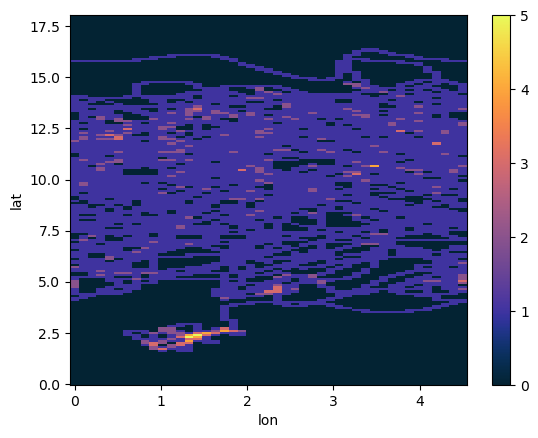

In [21]:
dens_array = xr.DataArray(
    dens,
    dims = ('lat','lon'),
    coords = {
        'lat':np.linspace(*lat_bds, Ny), 
        'lon':np.linspace(*lon_bds_base, Nx), 
    },
)

dens_array.plot.imshow(cmap=cm.thermal)

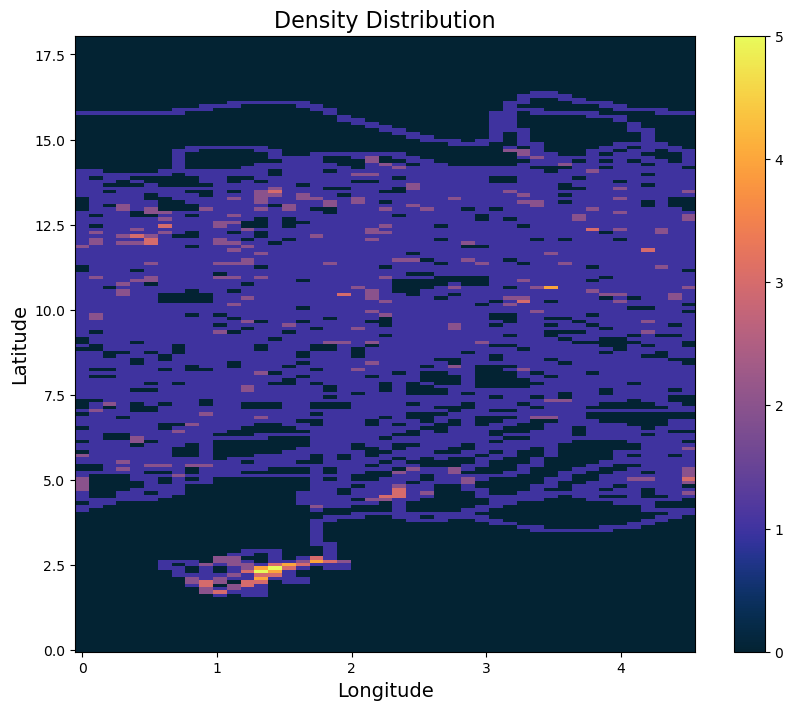

In [22]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed
dens_array.plot.imshow(ax=ax, cmap=cm.thermal)
plt.title("Density Distribution", fontsize=16)  # Add a title if needed
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

# Save the figure
plt.savefig("particle_january.png", dpi=300, bbox_inches="tight")  # Save the figure
plt.show()